<a href="https://colab.research.google.com/github/crazycloud/Handwritten-text-Detection-Detectron2/blob/master/2020-04-09-Handwritten%20Text%20Detection%20in%20Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Detecting Handwritten text in Documents"
> Detect signature and handwritten text in images using Detectron2 library. We will train a custom object detection model and run the inferences on the images
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [detectron2, FasterRCNN, vision]

### Problem Statement
We will detect the handwritten text in the scanned document images. It can be used for a number of things like
- to identify if the document has been signed
- to process handwritten text in the document in a different way
- to mask the handwritten text


Take following document image for an example. We wish to detect the text highlighted in the red bounding boxes.
<img src="https://github.com/crazycloud/dl-blog/blob/master/_notebooks/handwritten_sample.jpg?raw=1">

### Training Dataset
For the training data, we have the labeled dataset available with us so we don't have to do the tedious work of labeling each handwritten text.

We will use the dataset available here
https://github.com/CatalystCode/Handwriting/tree/master/Data/labelledcontracttrainingdata/trainingjpg_output_99/

The dataset is part of the Microsoft blog available here
https://devblogs.microsoft.com/cse/2018/05/07/handwriting-detection-and-recognition-in-scanned-documents-using-azure-ml-package-computer-vision-azure-cognitive-services-ocr/


Each image is annotated in <mark>Pascal VOC Annotation format</mark> using Microsoft Vott Annotation tool. The directory structure of the annotated dataset looks like this

  data/Annotations_99  
  data/JPEGImages_99

There are 99 annotated images in the dataset. The images are present in JPEGImages_99 folder and corresponding xml annotations are available under Annotations_99.

An XML annotation file looks like

```xml
<annotation verified="yes">
    <folder>Annotation</folder>
    <filename>07653e58-24d1-4b3f-9b4a-76057efe5c09-1</filename>
    <path>C:\data\JPEGImages\07653e58-24d1-4b3f-9b4a-76057efe5c09-1.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>1700</width>
        <height>2200</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>signature</name>
        <pose>Unspecified</pose>
        <bndbox>
            <xmin>192</xmin>
            <ymin>1188</ymin>
            <xmax>738</xmax>
            <ymax>1320</ymax>
         </bndbox>
    </object>
    ...
 ```
    
In Pascal VOC annotation, there is a seperate annotation file for each image. The data we are interested in the xml file is
  * <mark>image filename</mark> - 07653e58-24d1-4b3f-9b4a-76057efe5c09-1
  * object attribute for each annotation in the image
    * <mark>category/class</mark> of the marked annotation
    * <mark>bounding box</mark> coordinates of top left and right bottom position

### About Detectron2 Framework

We will use pytorch detectron2 framework because it is simple and easy to extend. There are simple Training, Visualization, and Prediction modules available in the detectron2 which handles most of the stuff and we can use it as is, or if required, we can extend the functionality.

Simple steps to train a vision model in Detectron2
  
  1. Convert dataset in the [detectron2 format](https://detectron2.readthedocs.io/tutorials/datasets.html#standard-dataset-dicts)
  2. [Register the dataset](https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset) and metadata information like class labels
  3. Update the config with registered dataset (DATASETS.{TRAIN,TEST}), model weight (MODEL.WEIGHT), learning rate, Number of output classes (MODEL.ROI_HEADS.NUM_CLASSES), and other training and test parameters
  4. Train the model using [DefaultTrainer](https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/defaults.py) class
  

#### Dataset Preparation(step 1 & 2)
Detectron2 expects the dataset as list[dict] in the following format. So for training with detectron2 we will have to convert our dataset in the following format.

```python
[{'file_name': 'datasets/JPEGImages/1.jpg',
  'image_id': '1',
  'height': 3300,
  'width': 2550,
  'annotations': [{'category_id': 1,
    'bbox': [1050.1000264270613,
     457.33333333333337,
     1406.9139799154334,
     587.7450980392157],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>},
   {'category_id': 1,
    'bbox': [1529.9097515856238,
     473.5098039215687,
     1617.167679704017,
     555.3921568627452],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>}]}]
```

Detectron registers this list of dict as torch dataset and uses the default dataloader and datasampler for training. We can register the list[dict] with detectron2 using following code

``` python
def get_dicts():
  ...
  return list[dict] in the above format

from detectron2.data import DatasetCatalog
DatasetCatalog.register("my_dataset", get_dicts)
```

And to register the metadata information related to dataset like category mapping to id's, the type of dataset, we have to set the keyvalue pair using

```python
MetadataCatalog.get("my_dataset").thing_classes = ["person", "dog"]
```

#### Choosing a Model and Initializing Configuration (step 3)

Detectron2 has lot of pretrained model available in the [model zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md). For handwritten text detection, we will choose Faster RCNN with FPN backbone.

We have to initialize the parameters and weights for model we want to train.

``` python
cfg = get_cfg()
cfg.merge_from_file('<pretrained model config'>)
cfg.MODEL.WEIGHTS = '<path to pretrained model weight>

#custom config for training
cfg.DATASETS.TRAIN = ("<registered training dataset name>",)
cfg.SOLVER.MAX_ITER = '<number of training iterations>'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = '<number of classes>'
```

All the model configs are available in cfg object. If we want to replicate the training later, we can save the cfg object and load it back to resume training.

#### Model Training (step 4)
We will use the DefaultTrainer for now. There are simple modules available which only accept the minimal parameters and make assumptions about lot of things.  

The DefaultTrainer Module
  * builds the model
  * builds the optimizer
  * builds the dataloader
  * loads the model weights, and
  * register common hooks
  
```python
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
```


Now, we can train our Instance Detection model using Detectron2. We will try FasterRCNN-FPN-50 Model and see how it performs

## 1. Install Detectron2

In [10]:
# CPU only
!pip install torch==1.12.0+cpu torchvision==0.13.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cpu (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.1.

In [1]:
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-kxryf2ux
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-kxryf2ux
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; se

In [5]:
!python detectron2/detectron2/utils/collect_env.py

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
-------------------------------  -----------------------------------------------------------------
sys.platform                     linux
Python                           3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy                            1.25.2
detectron2                       0.6 @/usr/local/lib/python3.10/dist-packages/detectron2
Compiler                         GCC 11.4
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.2.1+cu121 @/usr/local/lib/python3.10/dist-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    No: torch.cuda.is_available() == False
Pillow                           9.4.0
torchvision                      0.17.1+cu121 @/usr/local/lib/python3.10/dist-packages/torchvision
fvcore                           0.1.5.post20221221
iopath                   

In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git

In [ ]:
!python detectron2/setup.py

usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
   or: setup.py --help [cmd1 cmd2 ...]
   or: setup.py --help-commands
   or: setup.py cmd --help

error: no commands supplied


## 2. Download the Dataset

We will use the following directory structure to arrange the training data.  
    
    datasets/
        Annotations/  
        JPEGImages/  
        train.txt

train.txt and test.txt have a filename(without extension) per line

In [ ]:
 # for datasets
!git clone https://github.com/CatalystCode/Handwriting
# for detectron2 config files
!git clone https://github.com/crazycloud/Handwritten-text-Detection-Detectron2.git

fatal: destination path 'Handwriting' already exists and is not an empty directory.
fatal: destination path 'Handwritten-text-Detection-Detectron2' already exists and is not an empty directory.
Impossibile trovare il percorso specificato.
Impossibile trovare il percorso specificato.
Impossibile trovare il percorso specificato.
"awk" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [ ]:
!move Handwriting\Data\labelledcontracttrainingdata\trainingjpg_output_99\*.* datasets
!move datasets\Annotations_99 datasets\Annotations
!move datasets\JPEGImages_99 datasets\JPEGImages

Impossibile trovare il file specificato.
Impossibile trovare il file specificato.
Impossibile trovare il file specificato.


This will setup the directory structure with corresponding files

## 1. Prepare & Visualize the Dataset

Now that we have the labeled data. Let us visualize it in detectron2, we need to convert the xml annotations in the detectron2 dataset format as explained above.

We will use the custom function register_pascal_voc() which will convert the dataset into detectron2 format and register it with DatasetCatalog.

#### Visualizer Class
To draw the annotations on the images, we will use the Detectron2 Visualizer class which takes the image in rgb format, the metadata which has ordered label names and the scale parameter.

<mark>Visualizer.draw_instance_predictions()</mark> function to visualize prediction results.  
<mark>Visualizer.draw_dataset_dict()</mark> function to draw the annotated dataset

#### Download the dataset

In [9]:
%matplotlib inline

In [1]:
import numpy as np
import os
import xml.etree.ElementTree as ET
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

from fvcore.common.file_io import PathManager
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt


def load_voc_instances(dirname, split, CLASS_NAMES):
    """
    Load Pascal VOC detection annotations to Detectron2 format.
    Args:
        dirname: Contain "Annotations", "JPEGImages"
        split (str): one of "train", "test", "val", "trainval"
    """
    with PathManager.open(os.path.join(dirname, split+".txt")) as f:
        fileids = np.loadtxt(f, dtype=str)

    dicts = []
    for fileid in fileids:
        anno_file = os.path.join(dirname, "Annotations", fileid + ".xml")
        jpeg_file = os.path.join(dirname, "JPEGImages", fileid + ".jpg")

        tree = ET.parse(anno_file)

        r = {
            "file_name": jpeg_file,
            "image_id": fileid,
            "height": int(tree.findall("./size/height")[0].text),
            "width": int(tree.findall("./size/width")[0].text),
        }
        instances = []

        for obj in tree.findall("object"):
            cls = obj.find("name").text
            # We include "difficult" samples in training.
            # Based on limited experiments, they don't hurt accuracy.
            # difficult = int(obj.find("difficult").text)
            # if difficult == 1:
            # continue
            bbox = obj.find("bndbox")
            bbox = [float(bbox.find(x).text) for x in ["xmin", "ymin", "xmax", "ymax"]]
            # Original annotations are integers in the range [1, W or H]
            # Assuming they mean 1-based pixel indices (inclusive),
            # a box with annotation (xmin=1, xmax=W) covers the whole image.
            # In coordinate space this is represented by (xmin=0, xmax=W)
            bbox[0] -= 1.0
            bbox[1] -= 1.0
            instances.append(
                {"category_id": CLASS_NAMES.index(cls), "bbox": bbox, "bbox_mode": BoxMode.XYXY_ABS}
            )
        r["annotations"] = instances
        dicts.append(r)
    return dicts

def visualize_dataset(datasetname, n_samples=10):

    dataset_dicts = DatasetCatalog.get(datasetname)
    metadata = MetadataCatalog.get(datasetname)

    for d in random.sample(dataset_dicts,n_samples):
        print(d['file_name'])
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1],
        metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
        plt.axis("off")
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.show()


def register_pascal_voc(name, dirname, split, CLASS_NAMES):
    if name not in DatasetCatalog.list():
        DatasetCatalog.register(name, lambda: load_voc_instances(dirname, split, CLASS_NAMES))

    MetadataCatalog.get(name).set(
        thing_classes=CLASS_NAMES, split=split, dirname= dirname, year=2012
    )

In [2]:
#register pascal voc dataset in detectron2
register_pascal_voc('signature_dataset_train', dirname='datasets', split='train', CLASS_NAMES=["signature","others"])

datasets/JPEGImages/9c702b6a-ed8d-4b59-9154-873421893a82-1.jpg


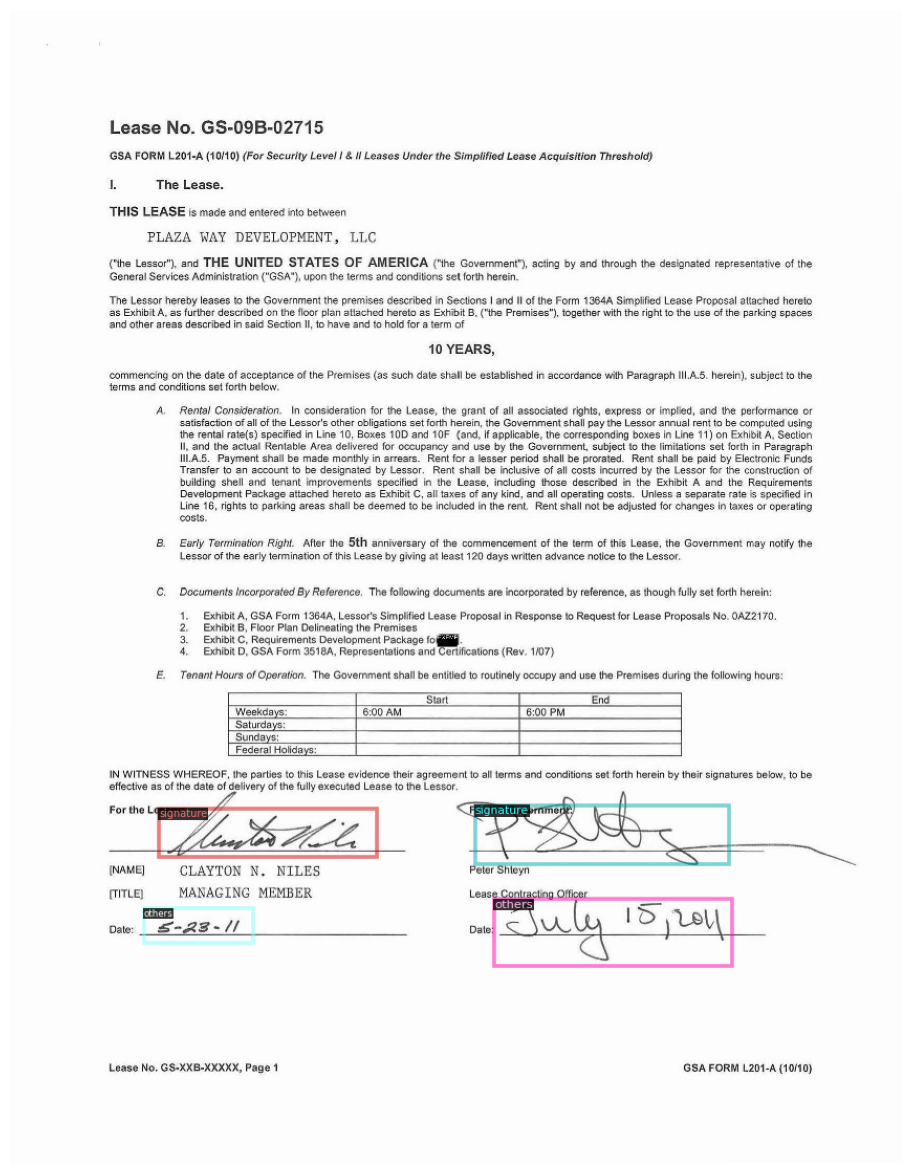

datasets/JPEGImages/78b7816b-3376-4a39-9b57-055d1d662d3b-2.jpg


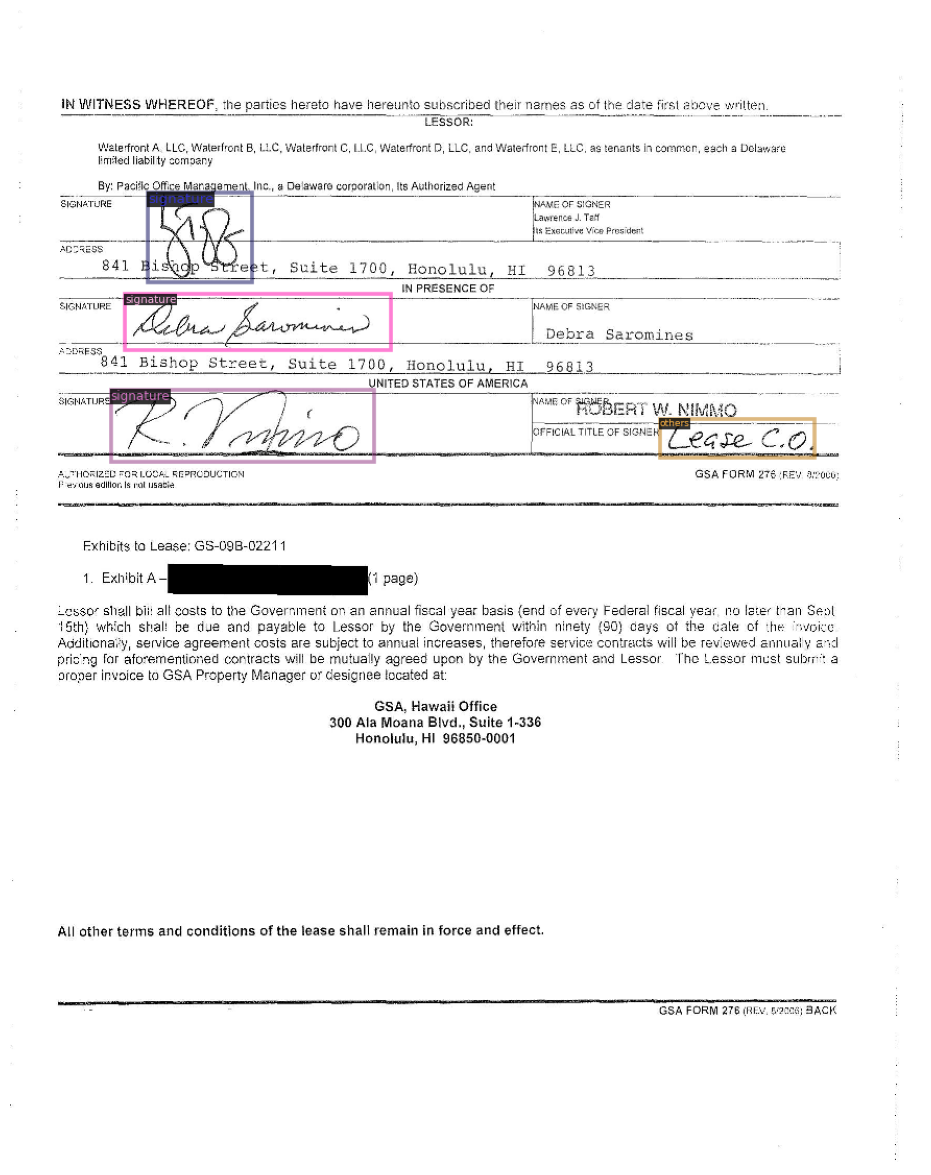

datasets/JPEGImages/2002e6f5-af2d-49af-af3e-ae97bce414d7-1.jpg


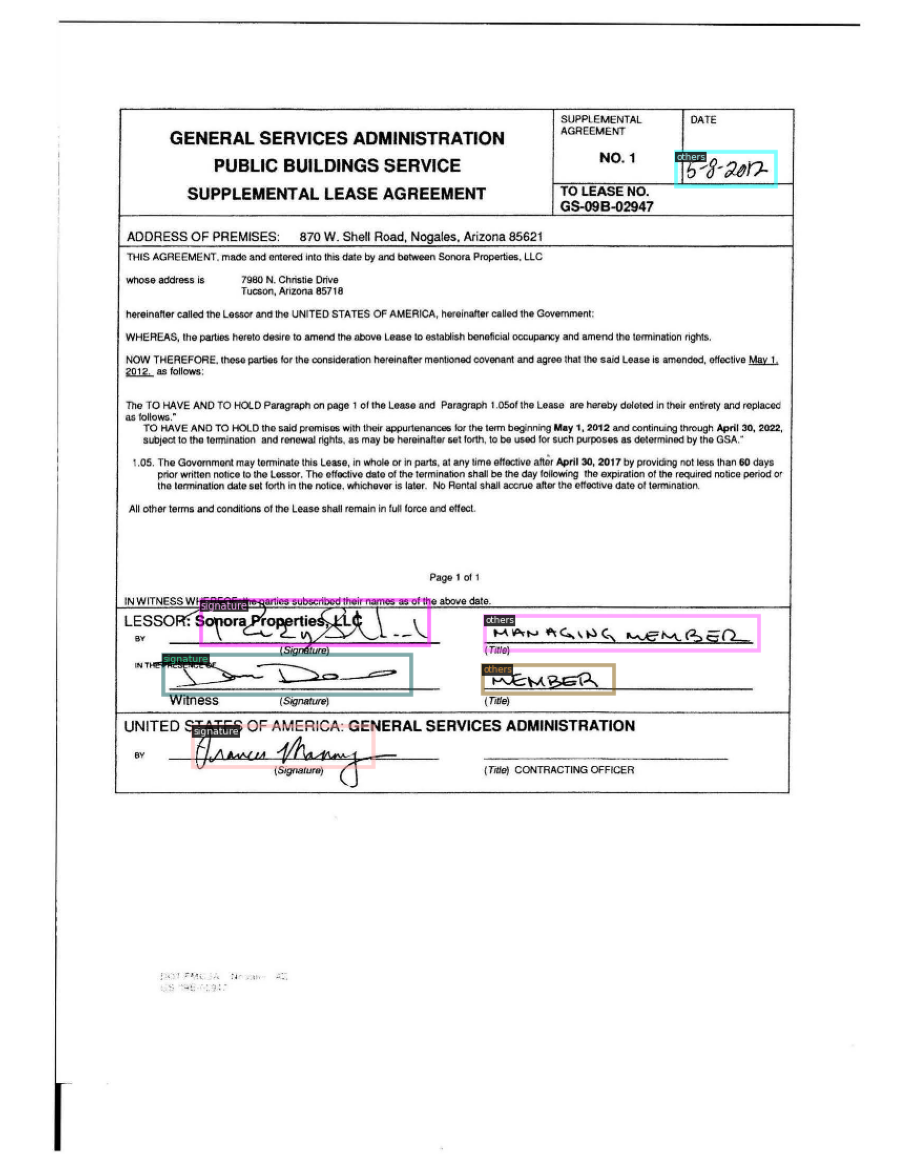

datasets/JPEGImages/07653e58-24d1-4b3f-9b4a-76057efe5c09-6.jpg


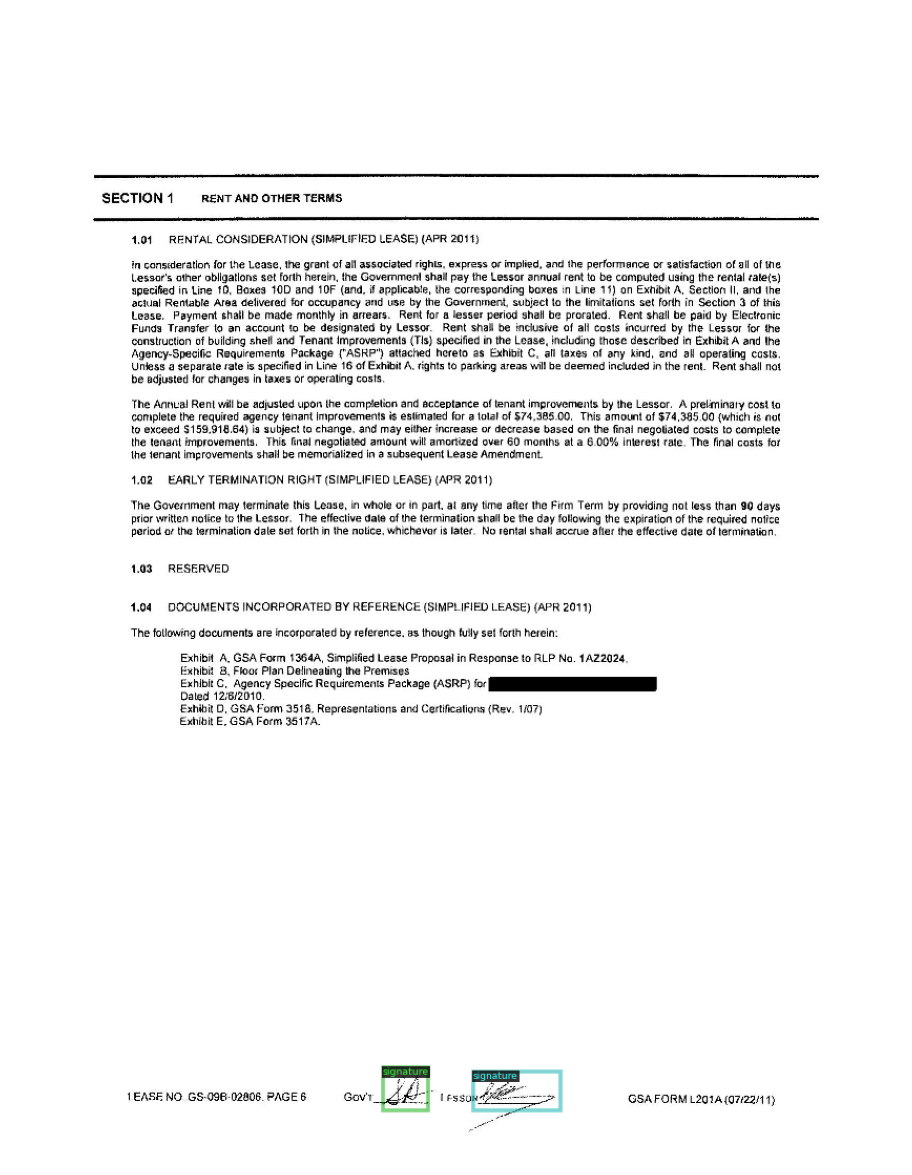

In [3]:
visualize_dataset('signature_dataset_train',n_samples = 4)

## 2. Model Training


In [13]:
!wget https://dl.fbaipublicfiles.com/detectron2/ImageNetPretrained/MSRA/R-101.pkl

--2024-03-31 15:21:35--  https://dl.fbaipublicfiles.com/detectron2/ImageNetPretrained/MSRA/R-101.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.82, 13.35.7.50, 13.35.7.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178666803 (170M) [application/octet-stream]
Saving to: ‘R-101.pkl’

R-101.pkl           100%[===================>] 170.39M  98.3MB/s    in 1.7s    

2024-03-31 15:21:36 (98.3 MB/s) - ‘R-101.pkl’ saved [178666803/178666803]



In [3]:
from detectron2.engine import default_argument_parser
from detectron2.engine import DefaultTrainer
from detectron2.engine import default_setup
from detectron2.config import get_cfg


def setup_cfg(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.MODEL.DEVICE = 'cpu'
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(cfg, args)
    return cfg


parser = default_argument_parser()
args = parser.parse_args("--config-file drive/MyDrive/Handwritten-text-Detection-Detectron2/configs/sign_faster_rcnn_R_101_FPN_3x.yaml OUTPUT_DIR drive/MyDrive/Handwritten-text-Detection-Detectron2/sign_model MODEL.WEIGHTS drive/MyDrive/Handwritten-text-Detection-Detectron2/R-101.pkl SOLVER.MAX_ITER 2000".split())

We have copied the config file for Faster RCNN R50 FPN from the [model zoo](https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml) as sign_faster_rcnn_R_50_FPN_3x.yaml and updated the configuration parameters.

We have set the <mark>MODEL.ROI_HEADS</mark>(classes) to 2, Max Number of iterations to 4000, and training dataset name to the one we registered earlier.

config.setup_cfg function will load the configuration from the --config-file path, and will update the configration with other parameters passed as arguments

Here, we have passed the OUTPUT_DIR parameter to update the cfg.OUTPUT_DIR parameter value

In [4]:
cfg = setup_cfg(args)

[03/31 18:00:57 detectron2]: Rank of current process: 0. World size: 1
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
[03/31 18:00:58 detectron2]: Environment info:
-------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy                            1.25.2
detectron2                       0.6 @/usr/local/lib/python3.10/dist-packages/detectron2
detectron2._C                    not built correctly: /usr/local/lib/python3.10/dist-packages/detectron2/_C.cpython-310-x86_64-linux-gnu.so: undefined symbol: _ZN2at4_ops7reshape4callERKNS_6TensorEN3c108ArrayRefINS5_6SymIntEEE
Compiler ($CXX)                  c++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
DETECTRON2_ENV_MODULE            <not set

Now that we have all the configurations, we can start training the model.

As I explained earlier, DefaultTrainer will build the model(without weights), optimizer, learning rate scheduler and then load weights from the checkpoint file specified in the cfg.MODEL.WEIGHTS parameter.

In [16]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## 3. Model Prediction

Now that the model has been trained and saved in the output directory. The config saved during the model training has all the parameters except model weight. We pass the model weight path as paramter to load the trained model weight.

The DefaultPredictor does image translation and takes only single image for prediction. But we can easily modify the DefaultPredictor class to accept batch of input images for prediction

In [5]:
from detectron2.engine import default_argument_parser
from detectron2.engine import DefaultPredictor

parser = default_argument_parser()
args = parser.parse_args("--config-file drive/MyDrive/Handwritten-text-Detection-Detectron2/sign_model/config.yaml MODEL.WEIGHTS drive/MyDrive/Handwritten-text-Detection-Detectron2/sign_model/model_final.pth".split())
cfg = setup_cfg(args)

predictor = DefaultPredictor(cfg)

[03/31 18:01:06 detectron2]: Rank of current process: 0. World size: 1
[03/31 18:01:06 detectron2]: Environment info:
-------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy                            1.25.2
detectron2                       0.6 @/usr/local/lib/python3.10/dist-packages/detectron2
detectron2._C                    not built correctly: /usr/local/lib/python3.10/dist-packages/detectron2/_C.cpython-310-x86_64-linux-gnu.so: undefined symbol: _ZN2at4_ops7reshape4callERKNS_6TensorEN3c108ArrayRefINS5_6SymIntEEE
Compiler ($CXX)                  c++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          1.12.0+cpu @/usr/local/li

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


10.237498760223389
datasets/JPEGImages/27406230-3059-475b-9bc0-35620443a0ff-4.jpg


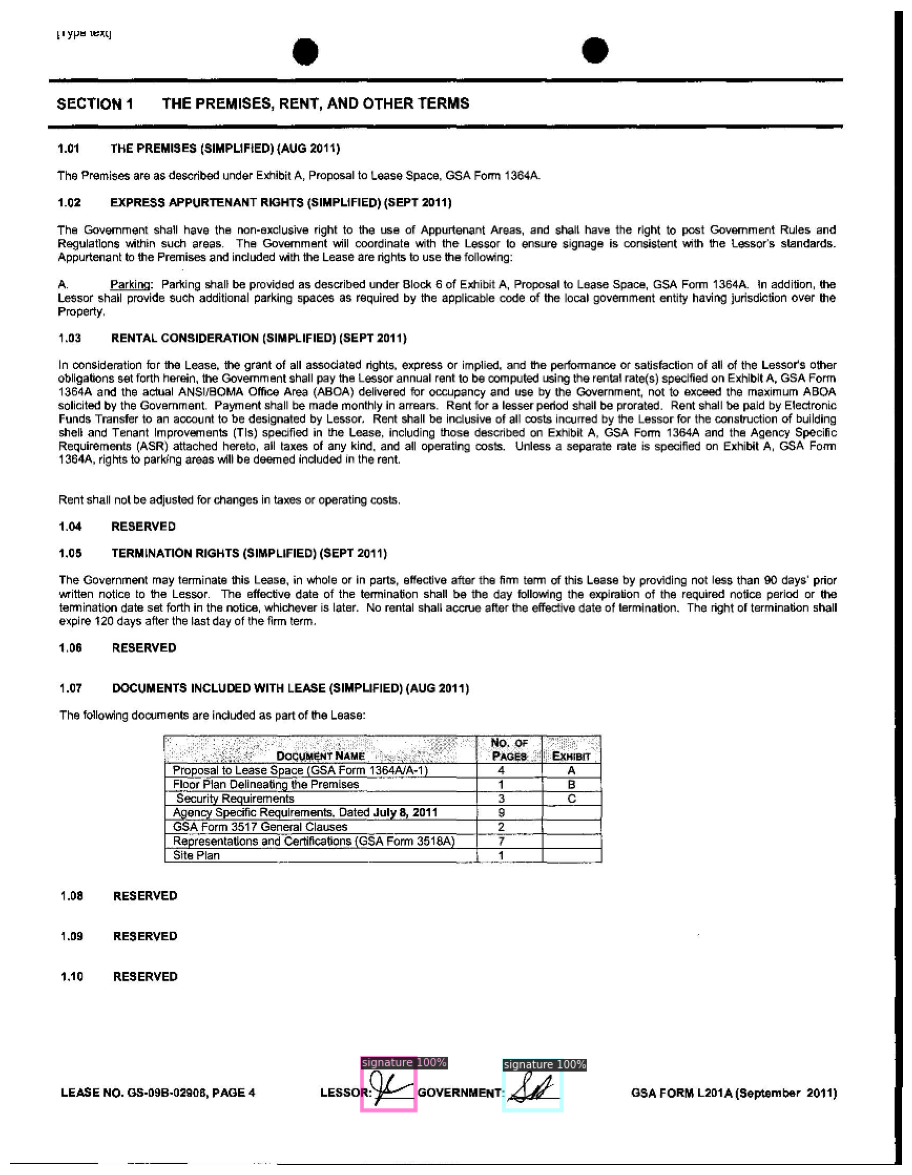

10.165937423706055
datasets/JPEGImages/63348ad3-b0cc-45d0-bc85-bf2c865744ec-1.jpg


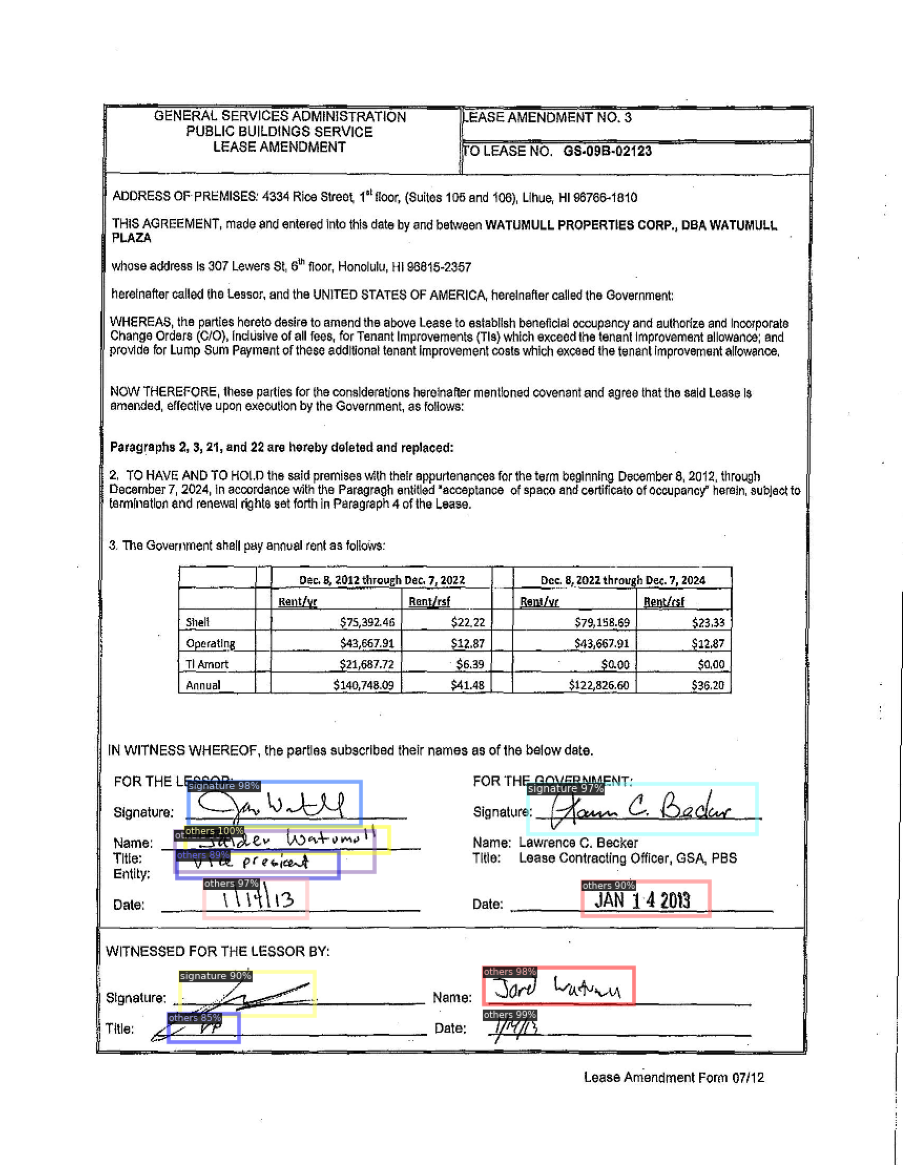

9.110320091247559
datasets/JPEGImages/805cc97f-1668-4f26-a6e5-edad012c7d10-2.jpg


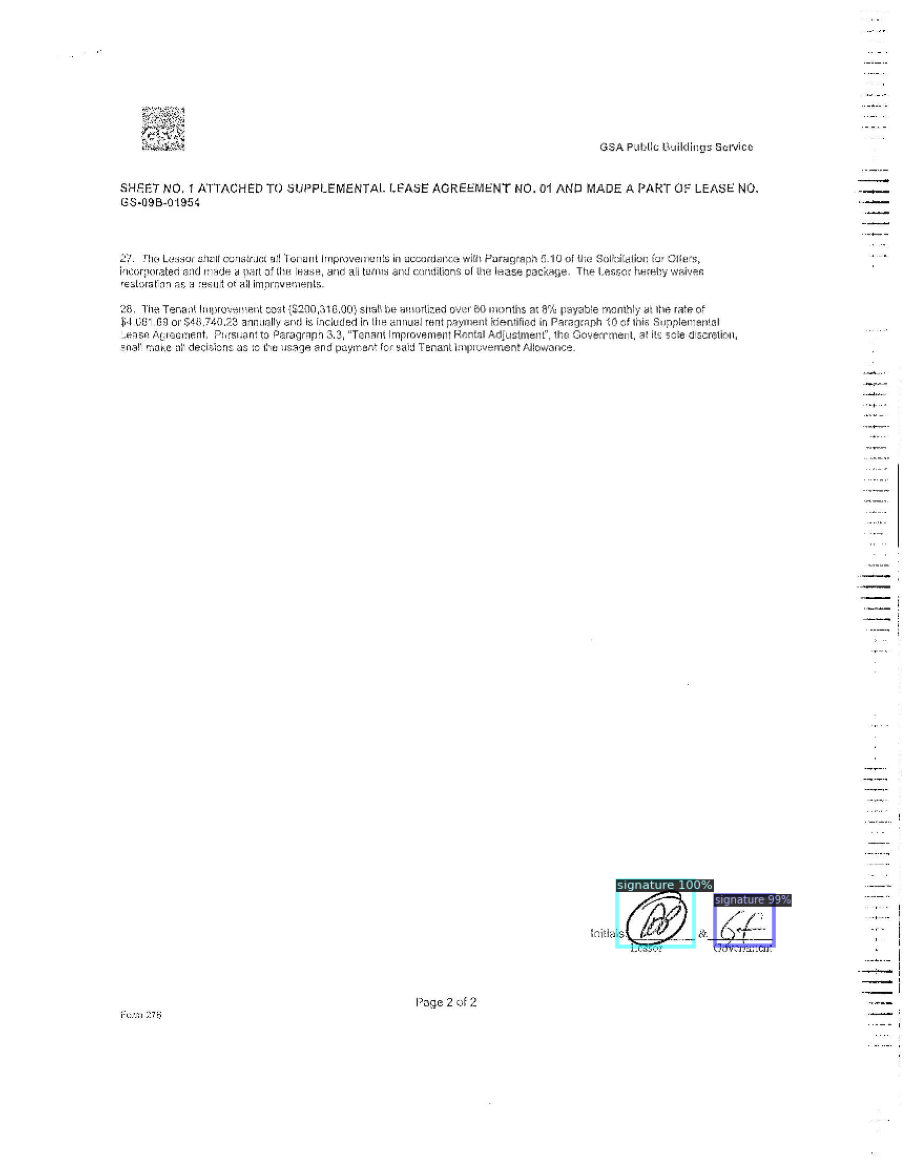

10.189096927642822
datasets/JPEGImages/9ab50e7d-3f2f-430c-8acc-ac3a198e426d-1.jpg


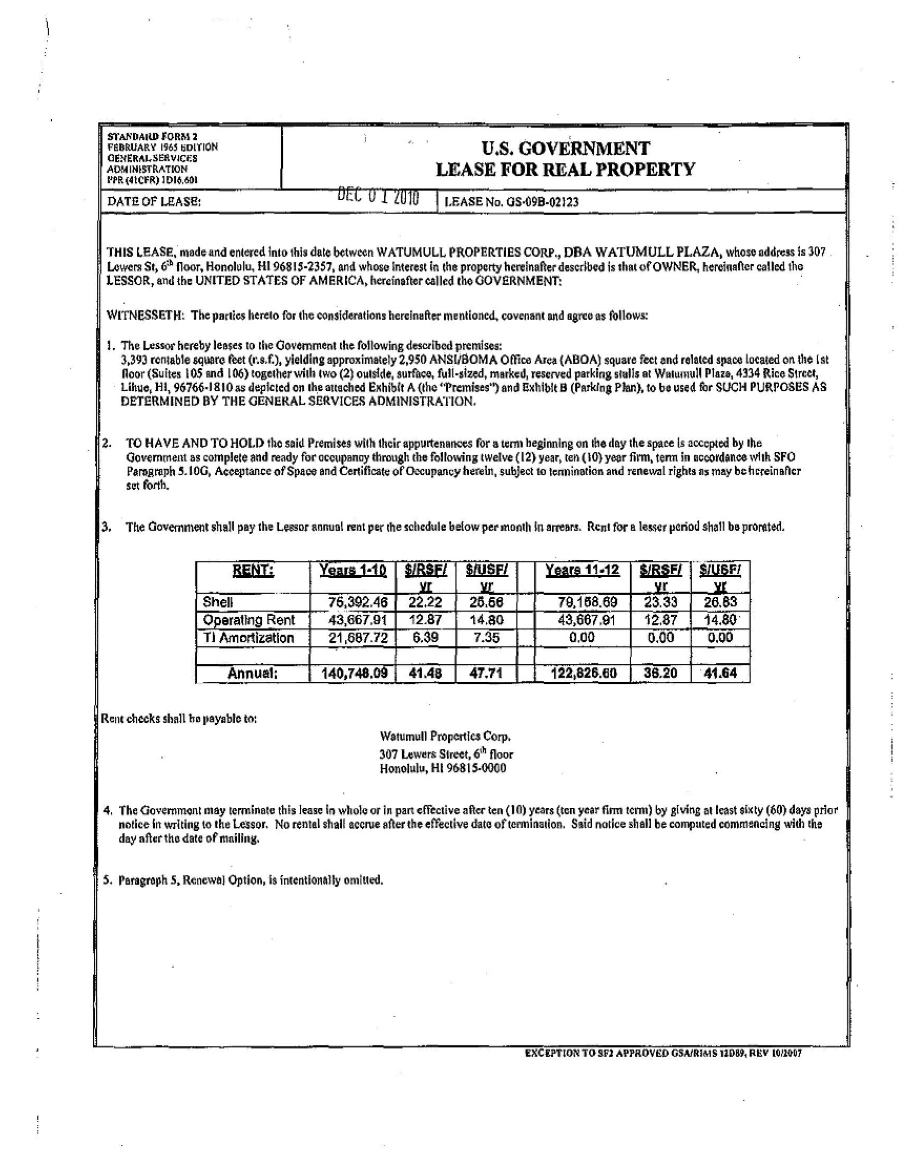

10.832328081130981
datasets/JPEGImages/9854ded9-3bd7-437c-83c4-b05d409c5872-2.jpg


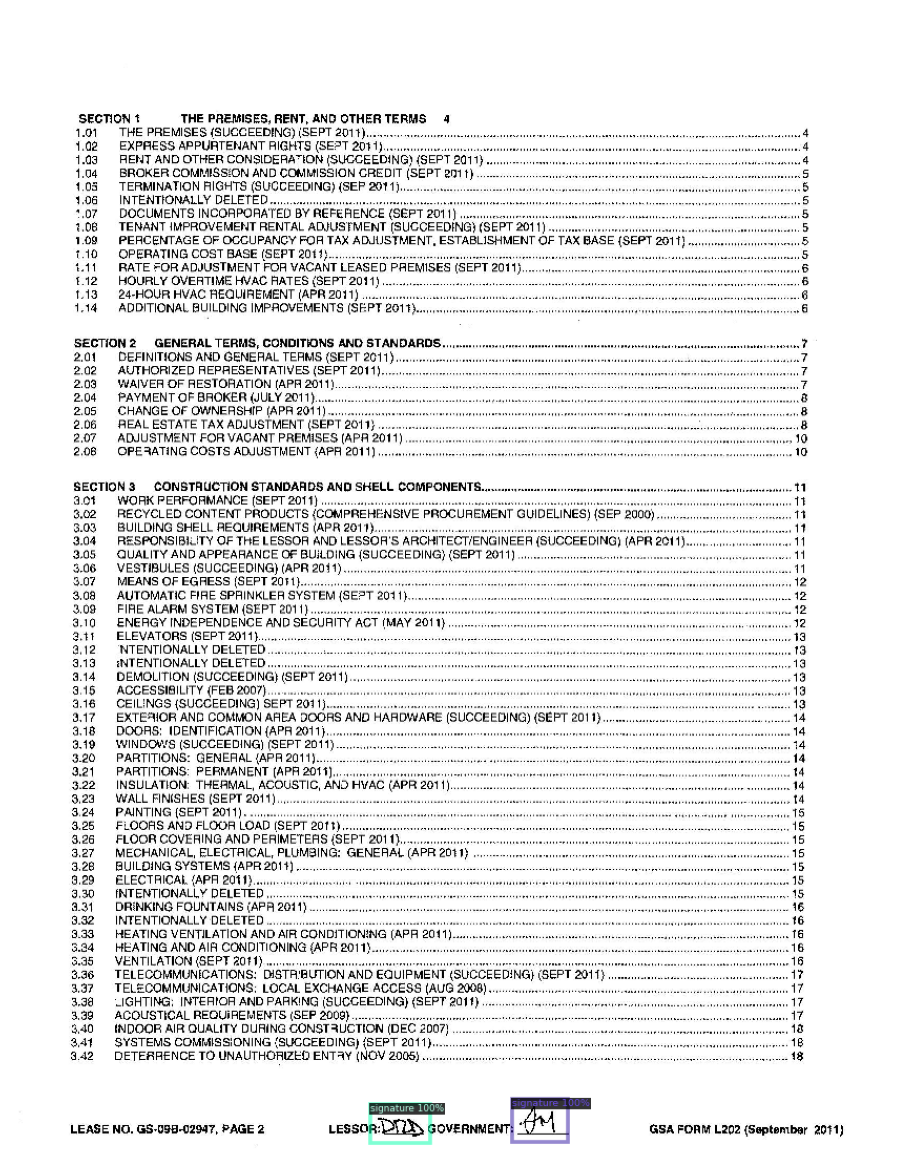

In [7]:
import glob
import time
import os

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import cv2

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

files = glob.glob("datasets/JPEGImages/*.jpg")
sample_size = 5
for file,_ in zip(files,range(sample_size)):
    im = cv2.imread(file)
    MetadataCatalog.get("signature_dataset_train").thing_classes = ["signature","others"]
    start_time = time.time()
    outputs = predictor(im)
    print(time.time()- start_time)

    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("signature_dataset_train"), scale=0.5)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(file)
    figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
    plt.axis("off")
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

## 4. Evaluate

The DefaultTrainer class doesn't have a evaluator method implemented. I have created a new Trainer class and added the build_evaluator method. We could have used this new Trainer class in the first step instead of DefaultTrainer but I wanted to show how easy it is to train the model without writing more code.

In [8]:
import sys
sys.path.append("drive/MyDrive/Handwritten-text-Detection-Detectron2/")
import importlib
import evaluator

# Forza il reimport del modulo 'mymodule'
importlib.reload(evaluator)

<module 'evaluator' from '/content/drive/MyDrive/Handwritten-text-Detection-Detectron2/evaluator.py'>

In [9]:
from detectron2.engine import default_argument_parser
import config
import trainer
import dataset_utils

import dataset_utils

#dataset_utils.register_pascal_voc('signature_dataset_test', dirname='datasets', split='train', CLASS_NAMES=["signature","others"])

parser = default_argument_parser()
args = parser.parse_args('--config-file drive/MyDrive/Handwritten-text-Detection-Detectron2/french_sign_model/config.yaml MODEL.WEIGHTS drive/MyDrive/Handwritten-text-Detection-Detectron2/sign_model/model_final.pth DATASETS.TEST ("signature_dataset_test",)'.split())
trainer.eval(args)

[03/31 16:22:19 detectron2]: Rank of current process: 0. World size: 1
[03/31 16:22:19 detectron2]: Rank of current process: 0. World size: 1
[03/31 16:22:19 detectron2]: Environment info:
-------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy                            1.25.2
detectron2                       0.6 @/usr/local/lib/python3.10/dist-packages/detectron2
detectron2._C                    not built correctly: /usr/local/lib/python3.10/dist-packages/detectron2/_C.cpython-310-x86_64-linux-gnu.so: undefined symbol: _ZN2at4_ops7reshape4callERKNS_6TensorEN3c108ArrayRefINS5_6SymIntEEE
Compiler ($CXX)                  c++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
DETECTRON2_ENV_MODULE         

AssertionError: Torch not compiled with CUDA enabled

OrderedDict([('bbox',
              {'AP': 69.67298193268152,
               'AP50': 98.10585383880746,
               'AP75': 88.13255308840152})])

----------

### Training on a Custom Dataset

Let us say we have got some more annotated dataset which is not in PASCAL VOC xml format. To train the above model, we have write a custom function get_dicts() which returns data in detectron2 format.

To improve the accuracy of handwriting detection, I found one more dataset which is of annotated french documents. The annotations are in json format for each image. The dataset is available in the following github repo
https://github.com/hyperlex/Signature-detection-Practical-guide/tree/master/data/dataset. Download and save it in french_dataset directory

I have added all the functions in the library files dataset_utils.py and trainer.py. We will use these abstractions to quickly train and evaluate new models

In [1]:
import json
import glob
import os
import cv2
from detectron2.structures import BoxMode
def get_french_dicts(annot_dir):
    json_files = glob.glob(os.path.join(annot_dir,'*.json'))

    dataset_dicts = []

    for f in json_files:
        record={}
        img_ann = json.load(open(f))

        filename = img_ann['asset']['name']
        height, width = cv2.imread(os.path.join(annot_dir,'..',filename)).shape[:2]

        record["file_name"] = os.path.join(annot_dir,'..',filename)
        record["image_id"] = img_ann['asset']['id']
        record["height"] = height
        record["width"] = width

        annos = img_ann["regions"]
        objs =[]
        for ann in annos:
            px = ann['boundingBox']['left']
            py = ann['boundingBox']['top']
            px1 = ann['boundingBox']['left'] + ann['boundingBox']['width']
            py1 = ann['boundingBox']['top'] + ann['boundingBox']['height']

            obj = {
                "bbox": [px, py, px1, py1],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": {'signature':0,'paraphe':1,'date':1}[ann['tags'][0]],
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
import dataset_utils

def get_img_dicts():
    ann1 = dataset_utils.load_voc_instances(dirname = 'datasets', split = 'train', CLASS_NAMES=["signature","others"])
    ann2 = get_french_dicts('french_dataset/per_img_labels')
    return ann1 + ann2

dataset_name = 'signature_dataset_train'
DatasetCatalog.register(dataset_name, lambda: get_img_dicts())
MetadataCatalog.get(dataset_name).set(thing_classes=["signature","others"], split='train', dirname= dirname, year=2012)

In [ ]:
len(DatasetCatalog.get(dataset_name))

In [ ]:
dataset_utils.visualize_dataset('signature_dataset_train', n_samples=2)

We can run the remaining steps as we did before for training the model and prediction

In [ ]:
from detectron2.engine import default_argument_parser
from detectron2.engine import DefaultTrainer
import trainer

parser = default_argument_parser()
args = parser.parse_args("--config-file sign_config/chk_faster_rcnn_R_50_FPN_3x.yaml --num-gpus 3 OUTPUT_DIR french_sign_model SOLVER.MAX_ITER 4000".split())
trainer.train(args)

In [ ]:
from detectron2.engine import default_argument_parser
import config
import trainer
import dataset_utils

import dataset_utils

dataset_utils.register_pascal_voc('signature_dataset_test', dirname='datasets', split='train', CLASS_NAMES=["signature","others"])

parser = default_argument_parser()
args = parser.parse_args('--config-file french_sign_model/config.yaml MODEL.WEIGHTS french_sign_model/model_final.pth DATASETS.TEST ("signature_dataset_test",)'.split())
trainer.eval(args)

OrderedDict([('bbox',
              {'AP': 67.82590895115814,
               'AP50': 96.77629667360196,
               'AP75': 84.18387912626437})])

The Average Precision has reduced compared to the previous model. Let us check the prediction results.

In [ ]:
from detectron2.engine import default_argument_parser
from detectron2.engine import DefaultPredictor
import config

parser = default_argument_parser()
args = parser.parse_args("--config-file french_sign_model/config.yaml MODEL.WEIGHTS french_sign_model/model_final.pth".split())
cfg = config.setup_cfg(args)

predictor = DefaultPredictor(cfg)

# **TEST**

/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


16.921965837478638
drive/MyDrive/Handwritten-text-Detection-Detectron2/test_images/image_1.jpg


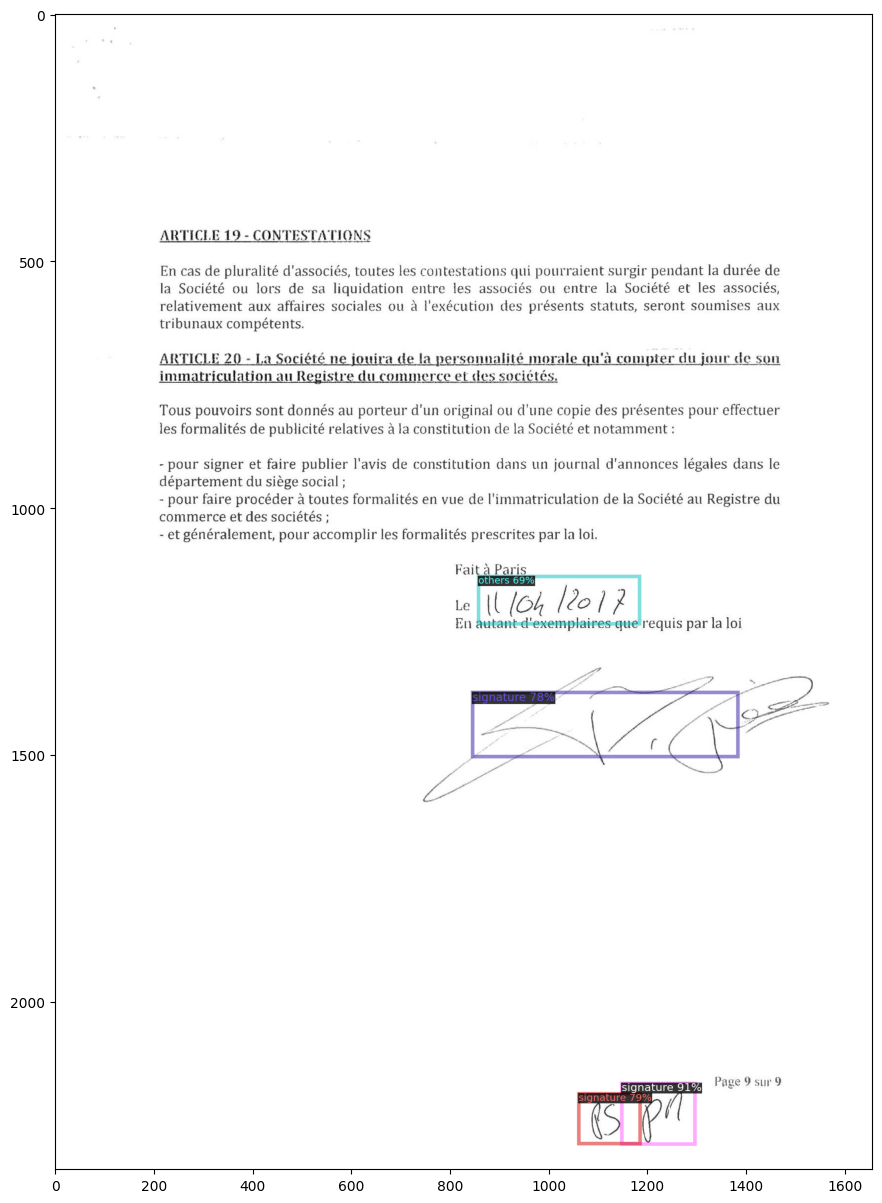

KeyboardInterrupt: 

In [6]:
import glob
import time
import os

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import cv2

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

files = glob.glob("drive/MyDrive/Handwritten-text-Detection-Detectron2/test_images/*.jpg")
sample_size = 10
for file,_ in zip(files,range(sample_size)):
    im = cv2.imread(file)
    MetadataCatalog.get("signature_dataset_train").thing_classes = ["signature","others"]
    start_time = time.time()
    outputs = predictor(im)
    print(time.time()- start_time)

    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("signature_dataset_train"), scale=1)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(file)
    figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

# **NGROK**

In [11]:
!pip install pyngrok

**ESEMPIO**

In [15]:
import os
import threading

from pyngrok import ngrok, conf

from flask import Flask
from pyngrok import ngrok

app = Flask(__name__)
port = "5000"

conf.get_default().auth_token = '2eJJC5jmQxIRJtz6L9aMAsyl5hm_7BNTj6dghZRSD7qnpVdrK'

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel {public_url} -> http://127.0.0.1:{port}")

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# ... Update inbound traffic via APIs to use the public-facing ngrok URL


# Define Flask routes
@app.route("/")
def index():
    return "Hello from Colab!"

# Start the Flask server in a new thread
threading.Thread(target=app.run, kwargs={"use_reloader": False}).start()

 * ngrok tunnel https://182a-34-80-212-74.ngrok-free.app -> http://127.0.0.1:5000
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


# **POST EXAMPLE**

In [1]:
import os
import threading

from pyngrok import ngrok, conf

from flask import Flask, request
from pyngrok import ngrok

app = Flask(__name__)
port = "5000"

conf.get_default().auth_token = '2eJJC5jmQxIRJtz6L9aMAsyl5hm_7BNTj6dghZRSD7qnpVdrK'

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel {public_url} -> http://127.0.0.1:{port}")

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# ... Update inbound traffic via APIs to use the public-facing ngrok URL


# Define Flask routes
@app.route("/imageProcess", methods=['POST'])
def index():
    data = request.json
    return data

# Start the Flask server in a new thread
threading.Thread(target=app.run, kwargs={"use_reloader": False}).start()

 * ngrok tunnel https://55da-34-80-212-74.ngrok-free.app -> http://127.0.0.1:5000
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


# **PROCESSA IMAGE API**

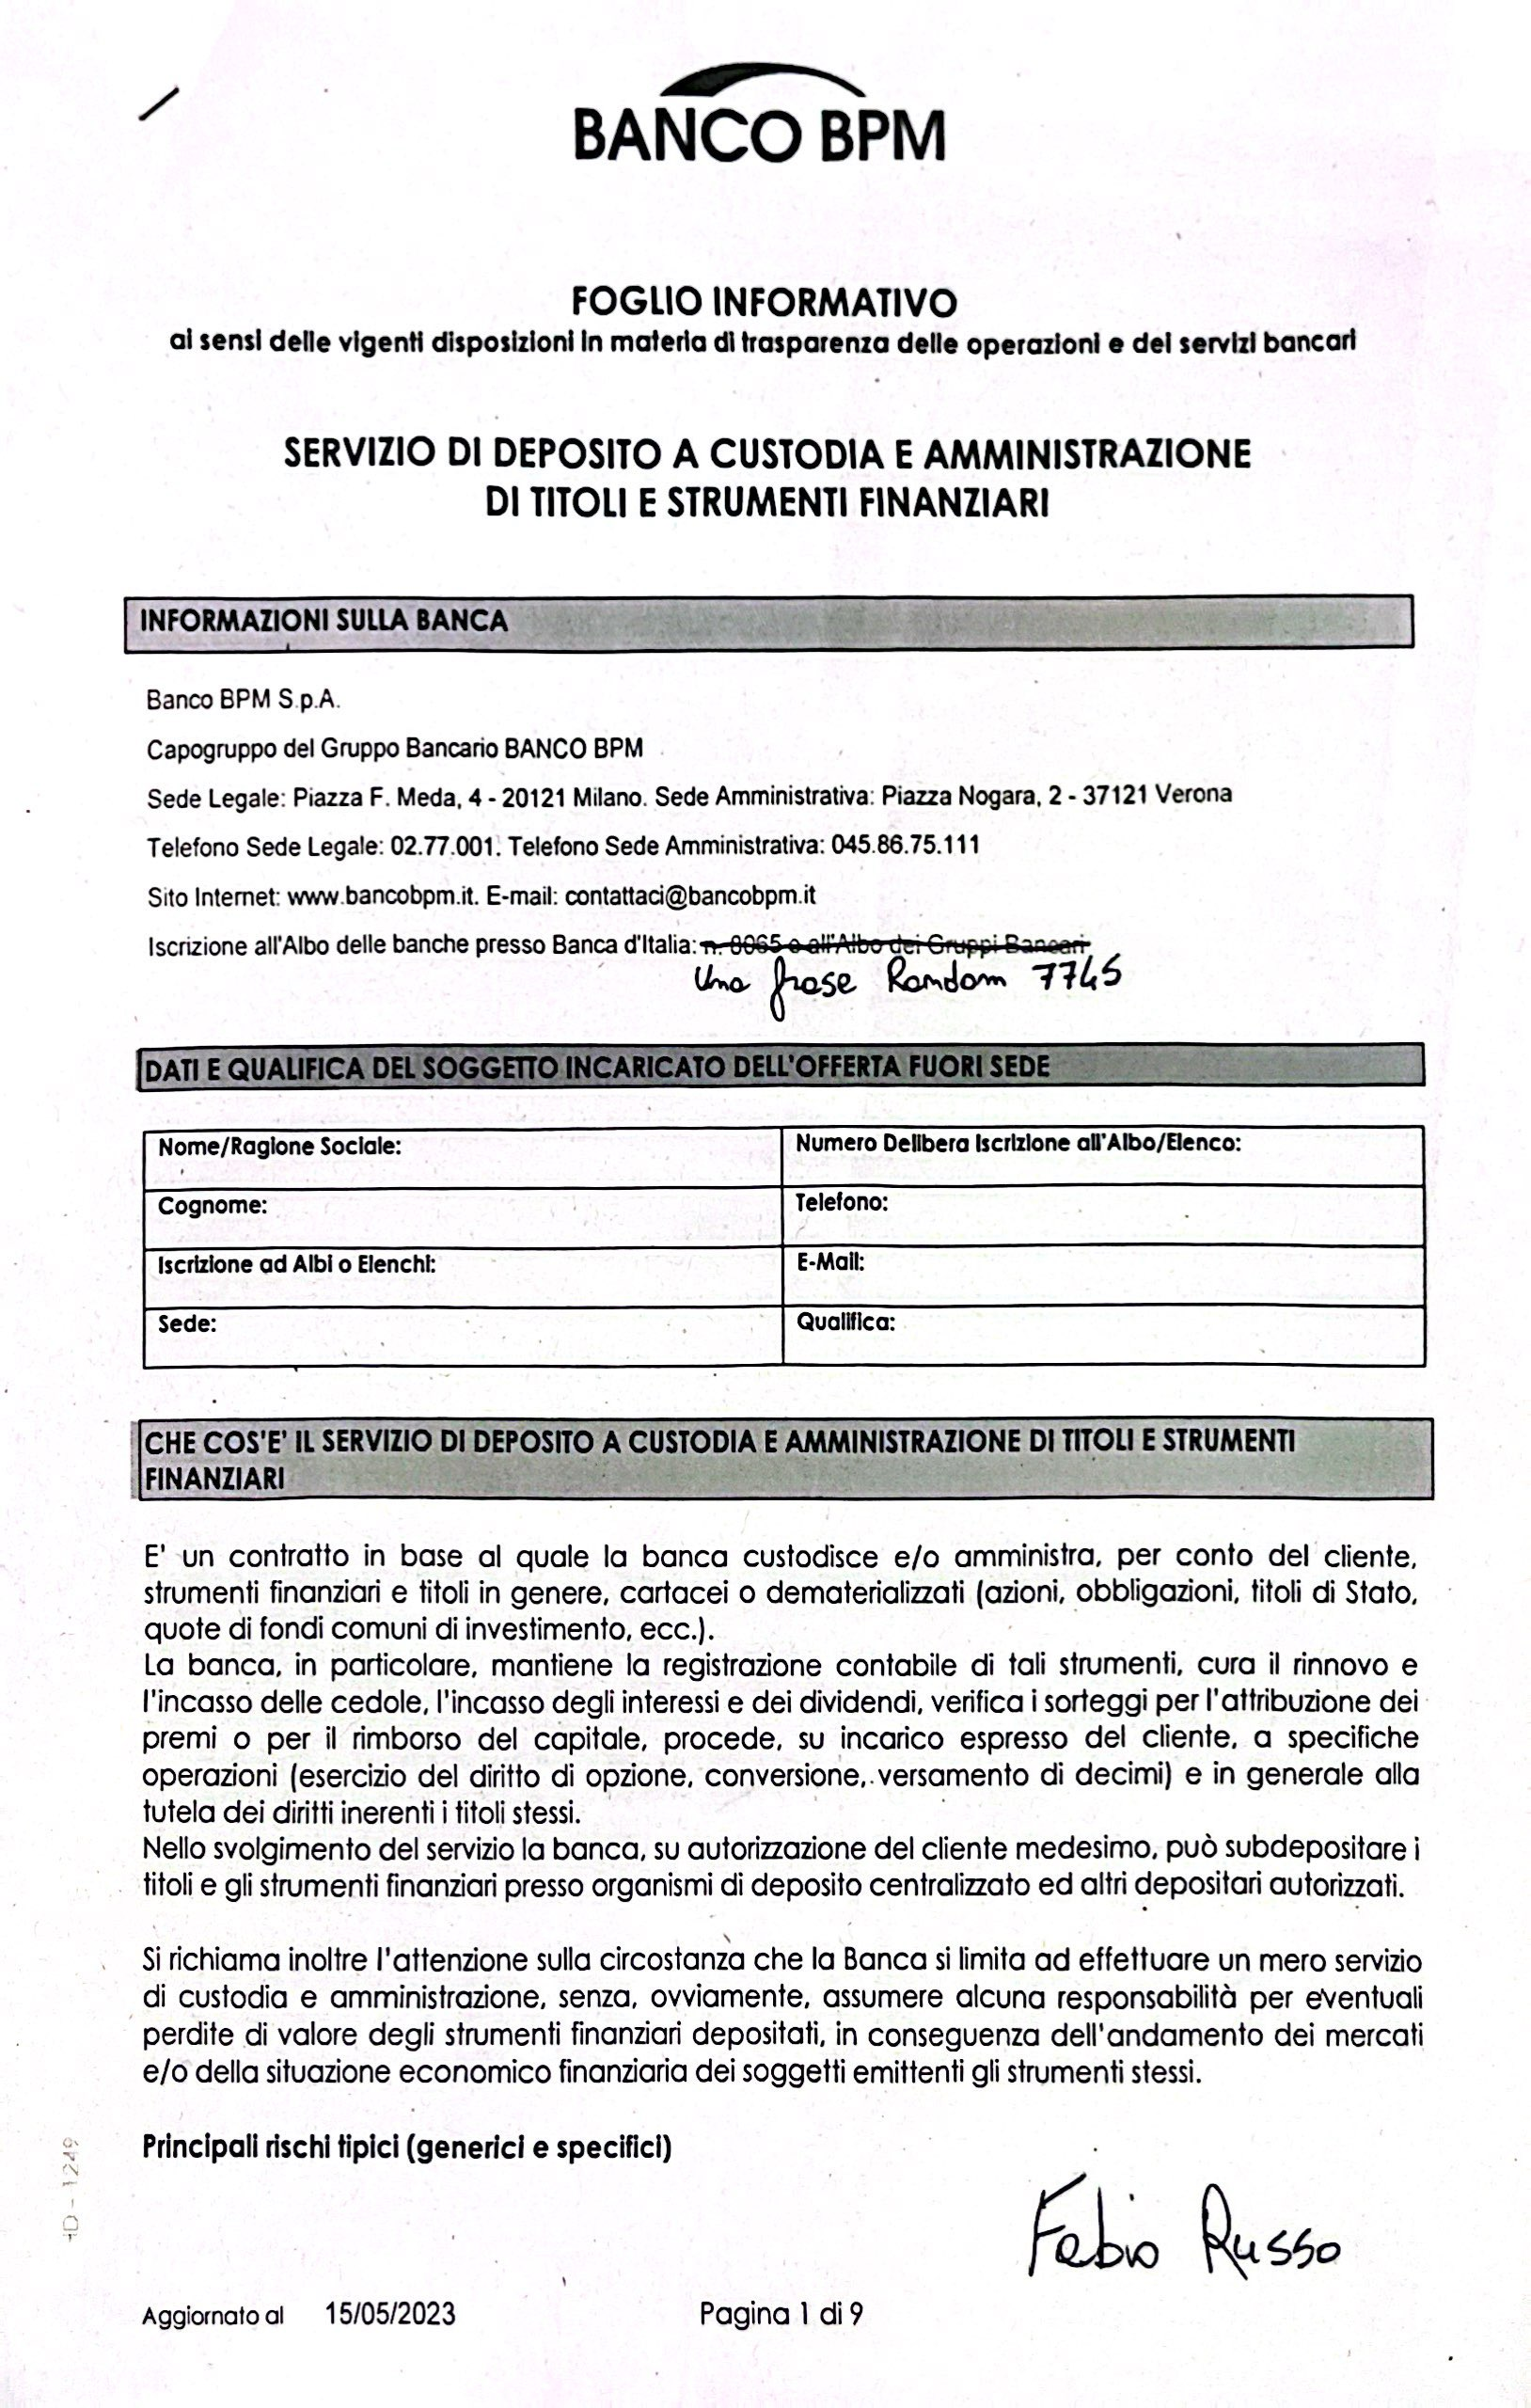

In [2]:
from IPython.display import display, Image
import base64

# Immagine codificata in base64
base64_image = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAASABIAAD/4QCARXhpZgAATU0AKgAAAAgABQESAAMAAAABAAEAAAEaAAUAAAABAAAASgEbAAUAAAABAAAAUgEoAAMAAAABAAIAAIdpAAQAAAABAAAAWgAAAAAAAABIAAAAAQAAAEgAAAABAAKgAgAEAAAAAQAABlygAwAEAAAAAQAACgAAAAAA/+0AOFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/AABEICgAGXAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAQEBAQEBAYEBAYJBgYGCQwJCQkJDA8MDAwMDA8SDw8PDw8PEhISEhISEhIVFRUVFRUZGRkZGRwcHBwcHBwcHBz/2wBDAQQFBQcHBwwHBwwdFBAUHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR3/3QAEAGb/2gAMAwEAAhEDEQA/APv2mAYJNPqN8gjFNDXYlqM84x60Lnqe9KBjOKA2H0gII4pAMCmb14osFh/QUDkUxuvHQ0qmiw7aD+1QbWMgbHFTA5pcjOKBJ2FooopCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKTPOKWgBKrNyxqdiAOahPIq4o0gNJxT6YfpTs44qmWSAjikJyeKZjJo6Hnp0pWJsSHkj2p/pUPI6VID8ualolodTCcH60m45OPpS5z25osCVhwORmlzkkUwYBPHWjKqcdzRYViQccUtJzS1JI2iiimMdRRRSEFFFFADaKQ5yMdKWgB1FFFABRRRQAUUUUAFFFFABRRRQAUU1epp1ABSd6WjNABRRRQAUUUUAFFFFABRRRQAUUnNLQAUUUUAIKWiigBtJ3paKYxc0ZqJwxIx0p/16UWCwjcjimrwTTh1560wrgU/IpdhdueaE4yTSp3FKMD5aAb6Du1Rjq1OZcj6U3kZJFCEtgP3hUo+7UXO71qXtSYMUUUUhpEgSB1paaBTqACiiigBtFFFADqKKaWwcUAOopvWmndnjpTsOxJRSdKD60hC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAneloooAKDRSd6AFHSmninUwjJzQAtFFNyc8inYdh1A6UYooAdRRRSEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAmaa3NIxI6UvOOaY7C9acKjBz0qSkDCiiigQ2k75pxpKAF96gbualPv2o2jrTTsNOwijgU0cuak703k9KYxe4p9NB7UuakkTpnNRn7vPrTictR1qiloRj7wqfio9mOetKDnjpQxvUXvSHoaQYBI9qXA9aBEg6UU2m57k0rCsKx5H1pw6VGBk81IKGDE703+Kg5H50Y+b8KAFXpRjnNIcg8UuaAEAOSaeOlIeKUdKGDFooopCCiiigAooooAKKKKACiiigD//Q+/fSo2PIxUhx0NN4+7TQ0DNikUkn2pSAB0pNw+lAdBQeTTGTJBH41IPagsB1oT7An2ExxilxinUUhDOaWjnvRTGFFFFIQ6ikyM4paACiiigAooooAKKKKACiiigAooooAKO9FFABRRRQA2iimscDJNAETZ3e1C9Tmmk4f604ZBrU26C0g+lLQB6+tIBCTnnqKDnqe9SEZ5FJu4ApXFcaD+lOG78DTGOBT+SvvTYMMce9BBHGaMlQBSck80CFXO7NKRk570AnPHQUEjGR1pC6jiT2oGcc0DPU0c59qQhaBSUD3pCH0UUUhELFgwA6VKBR3opjYlFGRmigB1FFFIQUUUUAFFFFABRRRQAUUUUAFFJmloAbTQgDZqSigAoopMc80ALRSYpaACiikzxmgBaKYCD0poJ3HNMZLRRSEgDJpCFpMUDkUtABRRRQAU006o2bHSgBcZpaQHNLTGMPXGeaDgfepcA80EA9aZQgXnNRohVyx6GrGKCB3ouK43POKWk4pMAnNACMRjk1IKZgE808ccUmJi0hpaKQgooooAKKKKAGE4paKSmMfTcDOadRSEIKQnHWnUwjPFMYAjGaWmgAfLTqAEFPpgp9IGFFFFAhMUtFFABRRRQAUUUUAFFFFABRRRzQA0mikYZpaYx1MJxT6bSEA6UdKKY65AHvTGS0UmAKTcOlIQpPOKWm44xTqACiiigAopD1paACiiigBtFFA5pjCkOe1L0ooEKORS0UUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACikJwM0tABRRRQAneilooAbSCnGkoAM0GnU00wAHtSkZGKYrbqUnFA7C0UgPFLSAOtFFGcUwF7U04NL9KaSBxQgQigZp/bimhR1p2OOKYPcM0wk0uc/UUA8YFAwxjmkxkGjHHNGW9KBgBnr1owAaTkHilJ6kelMLDvWkydwpf4c1EeDx2pJCSuSkA9aCcU1eme4o5I5oAfRSYpaQheO9LTV4p1IQUUUUAFFFFABRRRQAUUUUAFFFFAH//R++m56U3bznPFPznim528Y4qi0OHpmmMh7dKCCMGndT7UbC22EVh0p4XnPek6DNKTgE0mDHUhOBmkByAfWnUiRqtuFOoooAbR0oooAiz+8qYUwqMZxzT+1DY2LRRRQIKKKKACiiigAooooAKKKKACiiigAooooASq8jbjtxUrkgZFQYHXuauK6lxXUUZx9KBkjJ607FKoyeaq5bYnTBPekzzk0vp7UvWkAdeaQeh6U/sBSFT2oJuIwG2l5xgd6fgYweaPapuK4wgnqeRSE9hT26e5pm0rkimgRISFAzTD1570vUDNKR6UkJaCAN60/HvTTuz7VHlgc+tFrha5NSEcUAAncKWkIarEing5pn3cn1p3QcUMGFITil7c0UAJxnijJz0o/DmlFADqKKKQgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkxxikY4xTqAGBQvSg9PSlpCPamMfSEAjBpF+6M06kIBwKKKKAGH2pqtkn2p5pBgjimMWik6Cl69KAEOMUDpS49qKLhca/ABpVOeaXg9aAMUdAvoIBgk+tLRRSC40dKPXmgrwcmlPHIFUFxCw6A0q018AE+tAwoyKB9CWiiipJCiiigAoopD0oAQ+lNAAp3eimMKTgcUmKdTGGMUzHJ5qSkK85FJMExAAKXvRRigQ1SCcCnc01M96f2oYPcSkpaKAHUUUUhBRRRQAh5paKKACiiigBtId3alooHcTnFLRRQAhyelLSUtMBT1paTOODS0hDWGcUtLRQAgGKWiigAooooAKKKKACiiigAooooAawzTVUr3p9FMd+gtFFFIQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSGgBTzQOKQdOaWgAooooAaaTPenGkpjFHSgdKWikIKQ9KWigCNVIzSkZp9FO4yPGM0u7HFBwcikxkcUw9RR60tGMUUgGg8kUwryDT9gJzTjxTv2HfsRgEAnpRyGwO9SVGTg5NC1BaiHPegD1NPHIowDTuO4m7jI5xSA55PanjFIQMikFxoBBo9QaecCkIyDRcLiD3oHHJNHbgUuPagAAX86XgUnOcY4pRzmgQ0FjzT6KM4pCFHSloopCCiiigAooooAKKKKACiiigAooooA/9L75JGRTicD1qPIOcijOevSrsaWHKR+dIcryKVeT0pSeQKBdRuSfpSjDH6Uu3qO1N4UZHegPQexwM0K25c0cMKXGBUk9Be1NyOKVqaueM0BbQkoopuaQh1FIDmloAKKKKACiiigAooooAKKKKACiiigAooooAKKKaxwPegCBic9aUe9IOcmjPTNamwh+9wKXjrQSN2BS96AFIx0pBSnJFIBkgmkA7BLdakqNjxgdadyRz1qWZsbuIOCMU/8aBz94dKd1pMTYzAP4UuMjFLSZwOBQADrijkD6UD19aXHagAPIppOBwKcePpTNvGe/WmholHSio9wpevNKwrBRgUY70tMYdKQY7UmcnGKXGBikIXA60UgOaWkAnOfal60UgJNMB9FFFIQUUUUAFFFFABRRSEc5oAWiiigAooooAKKKTvQAtFFFABRRRQAUUUUAFFFFABRRRQA0jJ9qXAFLRQAnWloooAKKKKACikyBR16UALRTaaDjg8Ux2HUUUmBzQBG2M0nXg9KMUhHFWakqdKk61X2kgEU5Cw4apaM2iSjNFJg5pCH0006mnNAIBR0FNG7vinUANU5pcY5pAADkVJQDGA89adkGomBzkU8evehjaF6VGWb04qT2pAp780ISsAINIRnnOKU8cCkIyMZpjHUUmaWkSOooopAFFFFABRRRQAUUwmgHPFOw7C0hpaTvQgQmQR1oA4pABTu9MYh+8KG6UE4peooATGaUZ70q5HFOpCuFFFJ1pCFooooAbTNx3YIp9FADqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBMc5paKKACikJxS0AFIOOKWkzzigBaKKKACiikNAAaYSQaXcCcClpoaGkj8aRG3UuM0D5eMUx9B/ak7UVFuO/B6VKQkh45pc4GTScL0HWjPOPWqGKSBSHkGm44IpBwKYJAF7igcGn5wuTTflAyO9A7i8qKTmgEmlHP4UDGnrSc0uKO2KZQ/HA20vOOetICCtGR0FSZi0DAFAFJwtAARkjmj1FLyV96XHHJxRcLjVzjmnjpUYABI65qQcUmJinikByM0c0HNIQtFFFABRRRQAUUUUAFFFFAH//0/vokEGmkZ4pccZNN4GCDzVmiFA4z3FBznHc07I9KYG5BoAcOuM80c9D0oJxyOaXINAhcqOAKdmo8j0waFPSlYVhd2TgjijcBgChRjPfmnYpaC0EwOuKAMUtFACZApaQgnpRjIoAcBgYpaKKQgooooAKKKKACiiigAooooAKKKKAEqM/N06UrnBFMUnovQ1SKS6jcYBFO3BRScggUh5FUaB/OjOevFAHHPWnD1PamDDABxmjP6UlOI6YpCGnrxUynIoCgUg6mp3IbuKfeimnJxjpTqQgpgOFz1px6Un3RxTGOopKWkIQ9qMg0cHrQc9qYxNoPWkAIPtS4OaTGTwaBjjSAnGTS8ZpScUCEGc0+mjnkU6kxMKKTPOKDntSEJ3opOfSlpjCiiikAUgGKWmsCelMCSiiikIKKKKAEPWloooAKKKKACiiigAoopMgUALRSE8ZoBzQAtFFFADTRRRTGFFMY4x6U+gB1FFFIQUUUUAFFFFACEA9aAAo4paKAGNnHFIQSOKVm2imbwQDVIpXHLnuKQls+1KWG3NC4zmgPMa5PAFIQwXufpTnKr8zdq5zWvF3h3w7btdaxfRW6qCTuYA8etK9gudEi4UZNPJCglunvXxx4x/a/wDB+lXEmn+H7SXUmAP7+JgIwe3LYBH0z+fFfJnif9o74meIZZfs97/Z0DZAWEZO09AXYfqFFK9xadT9VNS8YeG9Kl8m+v4YpP7pYZ/nXlHjD9oz4eeEz5L3qzz/ANyP5z+SZNfk1fX+s65cG81O4nvZT/HM5c/+PE8fSmW+myzAu52D360XJbP0J1D9tDw3DKyWOk3FwijhwAAT/wACYH9K851b9szxHNKRpelLHF2MjgH8gp/nXyaNDh6tI36VMNLsIhl3yf8AaNTcHI+iJf2vfiE6KEtrdHHVssQf+A8VUf8Aa3+JTqVZIMnuNw/SvnuYaZHkbVyPTvWVJLa4YInJ6HA4pxfMCk2fRR/au+KSkCJ7ZfXcjH/2YVZj/a3+KiNl/sTAf9M2/wDi6+ZpJVkVY0jAPTIHJq5aaHrF+ypZWM8xbpsjY5/IVeq2G2fU9n+2L4+gy1xY2szH3Kj8Ac10Fr+2f4hWUNd6QjL3CuP/AIkV8z2vwr8dXqhodIuBu/voV/nXe6X+zX8SdSg882qwDqA2Sf0FPkctSVJPZn0Ra/traeExe6HcB/8AY2EfqwrstB/bD8B6iWXVbefTmHTzFyD+KFx+Zr5QP7L3xOLER28Rx6lh/wCy1l337N/xUsVMh05ZgP8Anm2T+oFV7ORV0fonpf7Q/wAKNVYRwa5CrnorkIf/AB7H6V6Tp3i7w3qsQlsL6GVH6YYc/rX44T/CT4jwSNE/h+8JXusZI49DWUdP8c+Dpmk8nUdHkPV1EsOcf7QwDU8rW4H7hxXEM+fKYMPapxmvxz8MftB/E/wwBHb6ob2MdFuwZP8Ax4FW/MmvpXwn+2fbskcHi/Snjc4DTW5DJ7nHDD8jSGffNFeT+CvjF4G8eHy9C1GN5QMmMkqwz6qwBr1JJ4pF3RuGHtSsIcWGaiSdWkaPupqXb82RUKQBJml67qehWli1SHpxS0VJJFhvwp44FB6cU3J6d6ZW46k+tAORSY55oEB5xil+lJ04zQTjnHFMYuQRRRz2pcUhDqQd6WikITimk45oIzQy7himCsPopBwMUtIAooooAKKKKAEoNBqjHewTTvbxnLxnDe1Owy9S1Ccg1L2oaBqwtFFFIQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFB5oAaetFJtxS0AOooooAKKKKACiig0AFFIOnNLQAUUU0470AOppOKXtzTDhutMYDHSlzzR3z6UA8c0xgP0oIzTSR15peo4oAQDrTfdu1OHsKRuSM9KYwOTQBgjNPJAFMbOOaB7i/xGkxt5NN57U8ZPBoYMOTQOmT2pelJkA0AHBpe/FNOO1GT3oAAMilUYppPOaDg9qAsL9elAGeaQdlxSg9c0AOxjn1pxFMLYxQW44pCsx3NOxUWSCMHIpd3PNFhWY/HNFNGSeRTqkTHUUUUCCiiigAooooAKKKKACiiigD//1PvzrTdoxindKKYxoGc570u0elKCc4NOouFxmOMdKMU+ii4XIiO5ppA/hzmpiMikxxzRcdxAOAM0hBJx2peg4oByKYvMbuycClJP1xSfMDmn0DGjDDPalIIoGcn0oPTjtQLqOHSlpoJI54p1SIKKKKACiiigAooooASkpjuqKWchVAySegrwDRvjr4U1T4jS+B7S6a4lyyK6LmMuuSQHBwcdPrmmkUo3TZ9CUnej6UE4GaRJE+c1GrAdOtPJLDNOUA9qs16EKsWyCMEVIqlevQ1JwSeKYc5IBouTe4EdqQLzg9qTBqUZ6Ggb0IupGalwAOO1Qy7l+YDNSp90GhiltcUHIoo74pakkQ4HFGMjBo6c0gJyQR0pjDhR7U7rSEA0tIQm0+vFLjA9aQE4oHPemDuN57j6U/Gce1IQMVl2ur6de3MtpbTrJNCf3iKfu/Wgdr6o1aQDFLRSEJS0h6Uc59qAFxTqKKQhvfNFGMUUAOpO9LRQAw57GilooGJzmlpCfelpgOooopCCiiigApCcUtFABSHilooAjLgUoINLgZ6UcU9B6DqKKDSEFFNXPenUAFFFIRkcUANOfSloHSjmmMawpRTiARzS0BcKKKKQgooooATnFA6c0tFABRRRQAxlDDBpFUAYFKcY560DIGSafQd9BCmaytW1nS9BtJL3VLhIIkGcsQOnNeTfFf44eGfhfAIbp/tOoyqTFbxn5jj1HYZ7nA/HivzM+I3xe8WfEnUGn1acwWeTstYydgH+0eN35Y9MUnfYL3R9Y/FD9rK0geXSvBUIumHHnscRg+xHJ+n618Q+JvGPiPxdeve67eyXDM2QmSIx9E6f1rlD944q1E6IOmD60noTexLBYSTDJ4Fb1paxxDyjyTWbFchISQduO3FWlvIZAH37G9zU81yb3LyRNHwo4zUoxyo4NZk2qiNdoO9qyWubi4uAYt25jhVXPU+gFWFu5fu7+SGdkX+EVST7fqU629sjSyucKiAkk/hX0B8Of2bvGfjV47zUIzp9g2CS/wDrGB9ug/E59q+9Ph78A/BngWNZIrcXFxxukf5iT7k8/wBKrlsrspH55eEP2efiR4tImWwNpbnBLykZOfbP88V9L+Dv2OtPgljufFd69wuMtGuFX6YGT+tfc8cUVvGEiVUUdAowKerkjJGKS01Cx4tpn7P3wv0uSOaHRoXeMDDMi9vwzXp1l4b0HT0RbKxgiEf3dqDit3POKTbxxRd9R2QxI41HyKoHsKdvUcHimk4A3cUmAxPenbuVYfvBpQ2agUYPSnZPaiw+Un4NZl5o+l6ipW+tIZweu9FP9KuMhkXGcU6OPYOuaWxNjyfxH8EPhj4ngeHUNDt0Lfxwjy3B9Qy4Ir508UfsY6NPGZfC2qS2suSRHN86ew5w347jX3Rk+lAz3pXvuTY/Gvxh8IPiT8MtQFw1tOREcpd2e84A7/L8y/yrrPh7+0t458GEWmrOdXsx/DM2JU9cN3+h596/WCe1t7tDFcxLKh6hwCK+cfid+zT4L8cpLe6bF/ZepEErLCAFY/7Q6H8efen1GbHw0+PXhD4hwCKCcWt+BlraYhHH0xnI9xXvaOroGU5BFfjJ43+Fnjz4V6qJbyKVEgbdDfW+4L9QRyp+uPxr3b4Q/tUalokkWiePW+0WmQi3ajLL2/eAZz9VH1FDdwvfY/Smiub8O+J9D8U2MepaJdx3UMq7laNgwx+FdJSAjbPOBnNKBgU+kyOlMdxuKWim7hnFADqTHSloouFxTzxSjgUUUhBRRRQAmKWkzxmgcigBaKKKACiiigAooooAKrpbQpM0yrh26mrFFACYzS0UUAFFFFABRSY5zS0AFFFFABRRRQAUUUUAFFFFABRRRQAUhz2paKACiiigAooooAKKKKACiiigAooooAKDRRQA3nvRSMcUtMYnNIBzmnUhoAQjmkyTS5PejC0xhj5cU0Ef0p56Ypq4HBpj6C57elRrndinEjGaRDv/AAoQ1og25Pel207k8imgkfePWgLiYpc8ZxTsD8KDwtAXG4zRjNOB4o6jFAXEwOlL0NNXPJ70ck4oACKTo3NPGT1FIwzxRcVw6cmm8ZDYp+R900g460AIVB5pTycU7oKQEYz60BcQZwaTknB9KM+lKB3NAx4+7QelIDnilPSpI6iKcgmn0xRtFPpCCiiigAooooAKKKKACiiigD//1fvvHpQDkZoI/CgkYz6UxiBhuK96kpm0bt2OafQwYUUUUhBSHHT1paQnHbNAEIVs4NSYxyaByOeKXHrTbKbGjJPtS5o5HFHfmmAucUhPFB/Kg4I5oAB05p1Nzgc0iFsc0ifMfjnNLRRSAKKKKACsbWdb03QbGXUtVnS3t4QWd3IAAHuawvGfjrw74C0mTWfEV2lvBHwAeWZuwVRkkn0Ar82/HvxF8aftAeJ08P8AhaCaDSi+EhUn5hnHmTEcfReg/WntuOx2Xxd/aO8Q+Pb2TwX8NUmjspz5RmiBE0/OCFwflQ+vU+1ep/AP9nBvC1xa+M/FUxbUgu6K3X7se4c7j3Pv+VepfB34FeHvhtYrdzIt3qswBlmcAlT/AHV9APSvoKgNg6VG7DB9RSlsdqjAUMSe/WmkNIAc8nvT1JJ46UHbgmm8jkU9ytxd3JOMYppPNOXJ/GnKBjHWgWw0DNOAx3pAD19O1PBzSYmwoooxzmkIX60DPeg/pS0hDaO3NFJ0/GmMXpRSUc44oAWjpRSc59qAFx2Pesax0HTdOu5720j2TXBzIck5NbOcCigE2tEFFFFIQhGaM84paQjvTGGfWlpKWgBetLRSAg0hATilpBxxS0ANoozSe9AC0UUgJzyKYx9FFFIQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUnNAC0UUUAFFNOexxSjpQAtFFFACcCuD+Id/4n0/wxeXHhGxOoalsIiiz3/Q/0rvaKAPyOv/gT8d/F2qXGsazos5urht7yTyIOvIAAJIA9McUv/DLPxd/58Iv++2/+Ir9bqKdw+Z+SDfst/F1Bn+z4m+jnPH1UVln9mv4w5wNCf/voV+wnFHFPm8hWZ+O0v7OPxgh+/oMn4Ov+NZs/wE+LUAy/h6cj2aP/AOKr9m8UYp8y7Bqfi3Z/BP4n3d/Hp66BcJJI23c4XYPqwJHFfdvwj/Zi0LwlFBq3imJL/VAN2G5VG/2R2x69fftX1viipbXQLdyvb28FrEsNvGsca9FUcCnl+QvrU1N2jIPpQMQfNwe1PopOByaQCHrTTkH2pcg9KY2ScAU0hjnG4DmhV2k4OaAcjBHApxOOgp+Q9diPacEk80AHbz1qQYIzSYxRcLguQOaWikJxzSEOGe9LRRSEM2/MWzTx0oooAz9Q0yw1W3e01GBLiJwQVcAjB618MfGX9lUTibxB8OkVZAS8llnapB/ue/tX3vRQB+R3wuv/AItfCrxNDLaaJqTWUsgS6tzbymJlzhmBCkKy9cj8eK/VvRtQOq6bBfNG8JlQMVcYIyM4IPQ1pFEPVQfwpygLwKAFIzTG4HFSU0ihMBicigJzmn4xwKKdyrh1HFMORT6XFAkxoORS0UA56UgHUUU0MCSPSgQjDIIoUbRil70UxjqKKKQgooooAKKKKACiiigAooooAKKKKACiiigAopDzxSgYGKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKaWAp1ACGkpTTScDNAC85zmnVGGBGRQOaY7DGVvMyOn9akGCKdSYx+NFwbA0UgOelLQAnFRFu+OlS9PlxS49qLhcb7jvTduTuFPAxSEkUIaEOCMHikVkPSjJAJNG0EZ6VQxy0N6YzR81IDzQFhRwKRuaX1pADn2oEtBAKdtPXNNJp4PHFDG7h600g4465p3vTOe1AIXJOeaQMfWlGOTTuOtArob70cfnTgMUo5OKVwuM74x0oIz0p5FN2ii4XG4OKkXmmHI78U9Rj3oYMdSdSRS0VJIUUUUAFFFFABRRRQAUUUUAFFFFAH//W+/qTGDmlpCM0ALRRRQAUUhoHSgAOQOOaWiigAooooAiODkd+lLjB+tKRwT3pQQeaoq4mOc0gPal/GlpCEwe9AINLTeh4FAElFFIRmkIK8W+LHxl8NfDDS2kupBc6jIpEFshBYn1PoPU157+0T8UPFnw/ht7bw9bNIbxDiYKWCfkMce9fMHwn+Dfif4v663izxxJP/Z6ybmafdvmIP3QG5CD269BQyrW1M3TdD+Jf7SXik6jqMkkOmLIfmOfKiU9VjB6nHUn8a/Q74dfC7wz8OtKjs9Ht1EoUeZKeWY+pPeuz0LQdJ8O6fFpukW6W8EShVVABwPpW3TT0sS9XchZWbkGph6VGeCOeKcOuSeabKYnB+oqPnJ7089T703kcmmikKvI60uMcE9aB0z1pCeRxxQAucHmnAjtTMA5NKoPfpSExw9TTsc+1NHPUUoFIljTz06inZBOKKiIw9CVwSuS0ho5zz0paAGnORipKbz2oABHNADSD1FIoqTFJwM0XC4e1B9qQdeKWgAooo6c0AOpAMUtJnFIQtFFFADCCelCg9e9O5paYwpo6nilAAozSEJjFOpmQafQMZnnFL7UY5oxTAKKaFIOe1OoAdRRRSEFFFFABRRSHPagBaKZuAxu6mn0AFFFFABRRRQAUUUUAFFFFABRTEORzT6APjz9o745eLPhnq2n6N4YiiVrqNpXmmUuDggbQAR6185wftg/FNOJ0sZP92Ir/AFNdp+2xGv8AwkGgSAfN9nlH/jw/wrxL4H/CKP4tapfWEt2bRbONXyBkncSP6U2Ns9g079tDxZbhV1HRbe6GRuKybD+Ww/zr7F+FXxk8N/FWxebSSYLyHHn2sn+sTI/Uf7XQ9OtfGPxK/ZPvvB/hyXxBoGpHUjagvLC64Ozvtx3H+fWvnD4deNdU8A+LbLxDpT4aFwsiZ4kjYjch+vb0OD2piXY/cAUVBazfaLaGfGPMRWx6ZGanqQON8d+KrbwT4U1LxNdL5i2MLSBO7EAkDpxz7V8Ead+2d4wTVI21PSbNtPMg3pGXEqxk9mJwSP8AdGenHUenftjeNhYeHrPwfbPibUH8yUA8hEIPT64/OvzgKNjfg49aAufvBoGt2XiLR7TWtObdb3cSyIfZgD/Wtnivj/8AZF8drrvg2TwvdSg3ekNtUFssYjypx2HVfwr7AxQAwnGcV+a/jn9qr4k6V4u1XS9Mhs4LayuJIEWRHZv3ZIySrqOcdMV+lJxzX4qfGZFj+KPiSNOALxunqQuaAPsL4GftL614s8Tnw9448iP7Up+zyxBkXcOqEMzckZI9ga+61IKgg5BHWvwRgkubGaC9t2aOSNhJE4OCGU5BB9QcV+xfwS+INn8QfAtjqauv2qBRBcRhslZEHOfT1HqKAPYTxX50fE/9qD4leG/HGr+HdLgsra3sJzCnmRs0hAwdxIdRznI4r9GO1fjT+0CMfGDxLxj/AEkf+i1p26gfox+z58UdV+KXhCfU9ZhSK7s7gwOYgQj/AChsgEnAwcY9a9/HSvjr9jAlvh9qakY235H5ote8/E34k6L8NfD02taq/wA/KwxDl3c9AB3/AM9Bk0WA6LxN4y8NeD7OS+8Q38VnEgJ+dsH9fXt+lfHHjn9sexguDaeC9Pe6RG5uJW8tWH+yCpb9B9TXxj498e678RNel1vW7gsGLCGHcSkSH+FR79z1J9gBXU+B/gZ4/wDHsUdxpVmILeQbllnJQFfUcHj64B7U7X2E3Y9xs/20PE6H/TNFik9Ss2P0KV7N4A/a28GeILpNO8To+izOARNLt8jPOQXB4HuQteB3P7G3xAitWkt760mmAz5fKgn03ZP8q+evGfw58XeALwWfifT5LbccLLgtE/0YfyPNDiJSTP20s7201GBLqymWaJxlXQ5Bq5wRivxw+FPxs8VfDPUoI4rmS60cuBPaO24BCcEx5+6R1wOD7ZyP1t8L+JdL8W6FZ+INImE1reRrIrD37EdqTXVFHQBQvTiuY1/xj4d8M2st7rN7HbxQgl2ZgMfXmvM/jV8XtL+GOhSEyCTU7lSttCOpbHU+gHc9vyFfk94g8WeJPFF1Jc65qFxdmSQybJHYorH+6hJC+nFHqUfptq37V3wt0+4eC2vHuSn8UccjKfowXFZ9n+178MZpVS5aeBCfvGJzj64U18BeHfhB8RvFVkb7RNCuJ4ezFdu76A4P49Kk1j4MfFDQYvP1Hw5eJHyMom/8wmTRyO9yOZH61+F/ib4F8ZJu8OavBdnAyoOGXPQMDgg+xrv6/BmzvdW0DUkurKWWwvbZuGUlHUg9CDj8QR9eK/Qv4BftJzeKbi38G+M9iaiy7YLocCYjsRnhsc4HBwTx0p2vsM+2Tuz7U6kHQUtSAzPevmvxz+014K8D+IpvDl5FcXE1vxMY1yqkjOMkjnHtX0oa/Hz9o2BIPizrLIAvmlXOO524/pQZu/MkfaP/AA2B8NMZxcA46GJ8/wDoNaejftX/AAw1a4W1nunsWY4DTRsq9f7xGB+JFfnl8PvhZ4o+Ikkh0S2eSCE4d1GefQVZ8c/Bzxr4Ct1vdbsmS3Y4DgdPqKLMt+p+yWlatp2tWcV/pdwlxBKoZXjYMMEZHIzWjnIwa/Ir4DfGLUPhr4jhs72Z5tEvXEc8TMSsZJ4kUHIHJ+bHXr25/XC2nS6t4riL7kqBl+hGRQM+T/GX7WHhvwh4lvPDsmmXNy9k5jkeMLjcOvV17e1YSftoeECqltLuge42j/4qvi743qR8UvEGRgmcH/x1ea1/BnwD8deOdKj1nRYUa2kGQxP+OKLXC9j7Q039sL4f3Vwsd9BcWkZ/5aMjED/vkH+X419MeGvFvh7xZYR6joF7FdwyDI8tgcfUCvyb8Vfs/wDxG8JWDajf2IeFBklOeB19q5b4afELWfhz4lt9WsJnWDzFFzAD8siA85H94Akg/h0JotbcV7n7B+NvF9h4G8O3XiTU1Zra1XcwUZP+PNfMC/tn+CmBDabeJg/3FOf/AB6vX/i1Pb+Jvg5qN0qApeWm8KeoJHH5Gvx9gt5LiQxx8sAT/n9KGhn7M/C/4teH/ijp0t7oxZGhco8Ugw6kDPI9CK9aHSvyN/Zl8Uv4b+JUNpLL5cOpRmFlJ+UyL8yk/QBh+NfrareZGrKfvAGnYCWuc8T+JNJ8JaPca5rUohtbcFmY/wAq6BV2rjrXw1+2J43+y6ZaeDreTD3LCRwD/COTn6nA/OgDrF/bC+HWH3JcLtJx+6bLflXtHw1+K3hn4nWEl9oMjZibbJG42sp64I7ccivxcMMgjExX5CcZ96+/v2KQrWmuZXlJ1OfqgFJMD75ooFFABRRRQAUUUUAFFFFABRRRQAUUUdKACiiigAooooAKKKQjJzQAtFFFABRRRQAUUDpRQAUUUUAFFFFABRRRQAUUUUAFFFJkDvQAxhnOKcAcU6igBKQgEYoJApC2KYK4mPSjhe9GSRkClxkc0yhw6UdKBwKWpJG4xR1oNJx0pjH0UUUhDee9JjFL3opjGlaXb70EkDmlzxRcd2JjFNOc8DrUmcimc5IoQkJg9qkHSmjril47UMGNYAnmk6AbaDnPNBOMVRQjGnjpTWFAzSBijrUlRgck07GaTJYpppPGadwaacA49aECDg0wngkHpTu3AppUnGaaKQ4EY5oUY5oB5wKkFJksKKKKQgooooAKKKKACiiigAooooAKKKKAP//X+/aTIzikIBowBjHamGg+iiikAw9KBnHNLRQA6iikA70AMORyD+dIrEnBGKkxSEheTTHcDxRSKDjJ6mgkDrQA4VG2Mj2pykkZoZd3tQgWgUo96KTqKAH0UwHPakwwOaLBYpXum6fqKqt/bR3AXkCRQ2Pzqa3t7e1QQ20axoOyjAqb5myOgNHC5Ipj8mPopoyTk06kIQ4xUTAqOfwqXuaiGDkk1SKQq5xzQ3HGaco754prHmjqPqOHB570pAxTBkD6VIDmgT7jAWzgil56ZoPqKTJNAx4IGBT6rqx5FSjkdaTRLQucU0DvS9fpR16UhC0nOfajnHvS0ALjmk6HPrTqQ0hCUcZopO4FA0O6dqWkzS0CG0UUHOOKAHUU0bsc06gBuTnGKXFLRQA2iiigBTR9KWigBnOKQY6j8qdSYBNMY+k4NLSUhARxilpM0tABRRTGYjtQA+iiigAooooATA60tFFABRRRQAUUUUAFFFFABRRRQAUUUUAfnp+2zG/27w9L/CEkH49f6Vxf7IXiLS9D8YajDqVylut1AApc4ztz/UivQP22EGNAlzyGYY+oJ/pXwXa21xdzJb2sbSSucKqjJJqgfkfsP8U/in4L8N+ENRkutQhmmmgdIYEYF5GI6AV+R2iabeeINdtdO06Ldc3c6hEQdCT2HoOv0qncaRq1qrPdWc8SR9WdGAH44xXpvwU8b6J8P/Hdpr+u2xubUKYyVAJjLEfOB3xznHPp6UW7iZ+yNhG8VjbRSDDpEisPQhQDUzsEBZuAOTWfo+sadr2mw6rpU63FtcIHR0IIIIyOR1rjPir4og8IeBdX1mZ9hjhZUweSzDAA9/SkUj8uPj94vfxj8TNTuEfdbWT/AGaHnIwn3jz78H6V6Nf/AAHms/gnF43Z2NwIBdNEB8yg5PPHTtXzPpVrPruu21pI7NLf3Cq7YySZGGW/XJr9rG8PWlx4HXw2yDymsRDtPTOzv+NO2gktT8oPgN40fwT8RtNvGbbb3jC1m9NshABx/vYB9ia/ZGKRZYklQ5V1DA+xGa/CHXdMl0LXbzS2J3WczIGPUgH5SfqMcV+uXwC8cr46+HOnX07hry1X7PcDIzvTjJHbIGR7Um7ge2n0r8WPjaAPit4kA/5+j/6AtftP2/Cvxd+OYA+LPiTHe5/9kWmB6HJ8H5tR+Dlt4200GaVV3MigkjaMnHqT0qj+zZ8RZPBPju20+7uCmmaswhkGflWQ8I2D0yflJx3GeBX2P+ywsWrfBqLTr0ebEZp42DcjazEY5z0Ar4B+MXg2bwD8RNT0aNGjg8zz7Y+qPzx7A5Aoe2hPSx+0SkOoZTkMAQR71+Pf7R6BPi9ruBt3SKfrxivvn9m/4mHx/wCB4ra+l36ppWIbj1YD7jnP94c/XivhP9psAfFzVMDb8q/zalfQp9D68/YzA/4Vzfn/AKf2/wDQRXz5+154x/tnx1F4aiOYNJjBfBzmR+oI7EDOPrXv/wCxiP8Ai3eonPW/P/oAr4s/aCct8YPEm7qLkD/x1aGB037OPwwX4g+LvO1KIvpunAPJx8rP1APqB1x64r9YrGxtNOt0tbKJYYYwAqqMDA4FfH/7GdvEngnUbhUw8l0dzY6jAH9K+zR0ob0sJO4o6VzfiTwvoPizT5dJ8QWUV5bSjBWRQ2PoT0P0rpKKSdthn5/+Jv2LZpb2e48La5HDbscx29zGzEZ/h3gjj8DXvnwS+H2v/CHwdfab4l1CK8jjkeeIQltkaYBYDdjq2T9TX0GRXlfxp1a40T4aa9qFsQJEtZMH22nNNMZ+VHxg8X3HjTx/quqvM0sCSmGDd0CJxx7bskV9CfswfBWy8VJ/wnPiKIyW1vLttoz0Yr1b3OeBnp19K+MY4zLIkS/edgo+pOK/cH4f6FZ+GvB2k6RYoI4obaPgepUU07K5L1OqtLS2sbdLe0jWKJBhUQYFTMqupRwGUjBBHBH0NSjpRUjPmL42fAHw9440e61bR7VLPWrdGeORBtEmOcMBx/P2wa/LKVL7RtSaBi0F3ZTEEqdrJJG3UEdCCODX7zEZyDyOlfkh+054UtPC3xRvBYnEWoRrdbf7rHgj6EAfjVXvqB+hHwH8d/8ACe/D3T9RuJfMvrdBDc8c+YnBJHbJzj2r2ocAV+en7E2o3Rv/ABHpW7/RkSKYD/bclSfyUV+hlJgNPTFfkR+05CYfizqJJ++it+pH9K/Xg1+SP7U6lfi1ehv+eKkf99PSFbW59N/saIo8I35DhmM7ZUdV5/ya95+NM+i2/wAP9Sl1sxiMRkpvx1A5xn2r8qPAXxW8Y/Djzx4YuEiFxgssi7hkdxgjr0p/jf4t+NfiDFHB4kuw8MZyI4lKKT7jJp7aoZyHhywfVfEWnabGCxuLmNSB6Fhk/lk1+5ulosem2iAYAhQY/wCAivyN/Z5svDl38RLSTxFdi2aD5rdWIAdyCDyT1Cnp+Pav19i8vy08rGzA246YxximB+OP7QUXl/FjXF/6aL/6CK+7P2Rnkb4XRK4PyzSYz6b36V8P/tGxeV8V9WX3X9Biuw+DX7Qv/CstBbRLuze5QMWQpg/eOe5HSgD9QNct7S50i7hvlDwNC+8MO2K/EXxtHbQ+LdWhs1CQpdSKqjthiP519Q+M/wBrnW9d0mbS9FsDaG4BVpHIyFPTAGc/mPxr5Z8P6JqvjLxBDpdmrXF3fS5Zu/JyzH6daV9LBc/TDw7NcXn7NtvLfP5khsVy3XPAr82vBVot/wCIobAkA3GUXPc9f5A1+q/i/RYvDPwTu9KhQRLa2OCo7EL0r8ovBd21p4u0mZcEi7jHP+2wX+tNq6Cxu+LtF1DwN4oinhHlSI63ERHGGU5x78/ocV+t/wALvFUPjDwZpuswtnzoVJ55BwMgivj/APan8DRw+HbDxRbRj5dm5gOzDBH4kg/hTv2NfGrl9R8E3MmQn+kW4Y9Fb7yqPQEZP+9S8gT0Pv8Adgil2OFUEn6AV+OHxq1+98a/FPUssH23AtIQDwArbcfi2a/U34q+JIfCvgLV9XkkEbRwMEycZYjgD6nA/Gvyv+BuiTeKvitpMD/vAJmuJt3JKgHJ/MimuwEfxE8JHwrplrEYynmMvX/dr6k/YmX/AELXj/02X/0Fa4z9sGCLT9Z0rTrYYR0L49wAP611f7FJfZry/wDLPeuPrtGf0pWS0QbH3/TSQOtOpjEdxmgA7etICT1GKXGDx0paBjqQnFLTcjp1pCEyD0pc0gAHQUtAxM84paTjPvQKYDsdxRzQDxQORmkIrtMRMIthwf4u1TZApaQEGmMWmk47UvP4UtABRSUCkAfSgZ70H260g3Y54NMB1FJz3o570AOHPNLTApHA6U+kIKKQkDrS0ANY4pqjPWlf0pRxTH0HUUwmlosA6imfWgHNIB1IQDyRRikJA5JpiAgUUAhulLQMjyTnPGKCCQB0p56UmM07juL0XFLnNITim5UGiwWHn2pCccmkLAUE8ZHNKwWHUnFAOaQnH40CHUU0cdTzSk45NACA9j3pwJpuM89KXb75pj0A+tBPSmnAakGe9FgsSUEjIFM3ZB9qcoAFIVrB05NG4YyKCMnnpTSOMLxQFhSwzSg9qb2yR0pM7jxxTHYfjJ5pAMEmk56k9KQNxmgLDzQORzTTxz3pC4RdzcUWCxKaTIpgkVhkHrS4HT05oCwuaaMtzR0GcZp3XkUANLYIHvUgph9fSl9TQwY+imjGMUvQVJItFIDkUtABRRmigAooooAKKKKACiiigD//0Pv6iiigAooooAbRSZPpS0DHUUmRScdRQIdSEAjBpaaDk4xQA6mbck5p9FADOe1LTSdooHGSaYxcZxRz+FAIPPrSHj6GgBwpKAMcUEZ5oAKiYEHHXNSAbfene9Fx3sOooopEjGOBUanANSEe3NNBAFUtilsAyRzSgDrTCfem5btTsVYcetHHXoDSckc0oB6nkUxjjwOeaj9+lPAyeKeew9aWwr2IgO/pUy9PrRtHUU3Bx1pN3JbuLjnNB9PWjtS0hBQDnkUmaAPTpQA+kzS0UhDaTNBIGDS0xjSTnpThRSbQTQA+iiikIKKKKAENLRQaYBRRRSAKKQEGloATFIFA6UuaM0BcWkPpS0UANIPY4p1FFACZpaTgUAg9KAFooooAKKKaGDZxQA6iiigAooooAKKKKACiiigAooooAKKKKAPgH9tnO3w//vN/Jq8j/ZNsdM1D4lGHUIFnKWzugfkAggdOncV7H+2yo+yaAw+8ZW/9BavFP2VNY0jRviYJtWuEtxLbPHGzkKpYkHH14/LNUrMD9N9V8G+F9ZsZdPvdNt2hmUghY1XqOoxivya+Onw3h+GvjebS7JwbG5HnW4PVF4yp+meK/WG88deEbGCS4uNVt1WJSzfOOgGa/KX9oD4hWPxD8eTalpR32NvGIYm/vEdWHqDxj6UXdtQ1Pr79jbWdQvvBWpaddSGSGxutsW7narKCQPxya5z9s3xf5Gm6X4Ngf5rpjcSgf3UxgH0O7GPbNdD+xlp1xa+BtV1CdSsVzefuyf4lVQCfzGK+Pf2gfFo8X/E/VbyF98FowtYiDkERk5+hycH6Uttg9Dx21up7K6ivLZyksDiRGHZl5B/OvcF/aU+LSW4tRqo8sLtwU6jGPWvTvgf+zhpPxF8KP4j8QXU9ss7lIFjGMAcbueDn8R0r1T/hifwsTk6/fD8Iv/iKu3mK/U/PLUtSvNXv5tRvn8ye4bc59TX1v+x/43OkeLbrwldSYt9UTfCpIx5q4BwDzkrj/vmuh+Jf7KFh4V8IT6v4avZ726tPndZtuWXHQAYHPTt2r448La9c+GPEOn+ILQsJLGdJQAcZAPzL/wACGQahrUEfuyen4V+LnxzBHxZ8SZ5zdf8Asi1+wnhnW7XxJ4fsNcs3EkN7AkisO+4da/ID47xmL4t+JUPa6H/oC0xn3h+x+x/4VcwPa6k/maX9qn4cweKPCDeJbODdqOkgsGUcmPqy+/AP6Uz9j51b4YyJ3W6cH8Sa+p7u1hvbaW1uVDxTKUdSMgg+1F7MD8lP2cfiRH8PfHC/bifsGqqLeb2YcoevqSPxFVv2jb201X4hzaxZSb47qMEfQE4/nWB8ZfAs/wAO/iBfaTGhjtnf7RaleP3bHPHT7p4A+leY6lql5qsqzXj72UbQfYUPQW+p+lX7GoI+Hl8CODekj/vnFfJH7TWgy6L8WtVmcHbqG25Un/aGCPwwPzr6v/YyYnwHqW7+G8IH02gmov2uPhzeeIdDtfFukW/m3GmbhMFBLGIjJx9CAfw460WbC5zH7F/iWBrTV/C8r7ZlcXEYPQqwxx9ME197V+HPgLxrqngHxJa+JdKI8yE7XQ9HjJ+ZfxwMHtxX7C/D/wCIWgfELQ4NV0a6SR3UeZGGG5G9CO1SM9BoorkPF3jTw94K0ybVdeukgiiUsQSMn0wPUngUJXA6+vMvi9ov/CQfDzXNKRtjTW7jIGSOMfyNfJ2p/trol1KNI0B5IQfkM0oQkZ6nCtX0l8H/AIoWfxj8LXeotZPZtFI1tNGxDA5UHKsPvDDdSBg1SQM/H6ymbT9RguJI97W0yuYz3KMDtP5Yr9xPBut2HiHwvpmsaa4e3uLeMoR6bRX5CfGvwlceDviLq2mSIVilmM8LdmSQkkj/AIFmvqT9k/4vWNvaf8K71+5EUil3s5HOAydSm4nqpzgf3foaCfM+/wAdBS1Gjo6B4yGUjgin8VJQ0kDJPQetfk1+1R4hstd+KNxFZEMLCJYXcd364/AY/Ovv74y/FXR/hz4bupZpg19MhjgiU/MXI4HXr/LqeK/ILUdRvNc1S41G7JkubyUyNjk7mPQD26D2qrWQH3R+xPpEq/8ACQa2R+6k8uBfqnzf+zV9/DpXhP7PPgp/Bfw20+2uo/Lu7pfPmB6gvliPoCa93qQCvyf/AGsotvxWmkH8dsvT2Zq/WCvyf/ayb/i6kq+lup/NmoA6f9mn4O+GviDYahq3iAeb5EvlqmAQBgZOCOpzz7V75r/7I3ge4hebRJJYJwp2o5+Qkj0HvXJfsU/LoutDP3p89f8AZQV9xTTRQRNNMwVFG4knGMVSbuJo/Drxf4X1bwP4ludD1INDc2kmVIPOM/KQR3/rX6e/sxeO7nxt8O4k1GYz32lSG2mdjknHKEn1K4r4M/aO1uy134n393YyrKiIsbFegZSSR+or6x/Yus54vBOr3LxlY573chP8eEC8ewIINK4z5Z/aciMXxe1XcOHCsPpyP50nwv8AgFrfxN0n+1rK6WCLLAfKD907TkkipP2oJlm+LmpKv/LNFT9Sf619Z/sc3iTfD+6tlH+ounDZ9Sd38jQn1FJO55JbfsWeIH/4+dbii5/555GPfDGvqT4U/Abwt8MbcTxj7dqbD95dSDk8dAOy+1e5u+0gcZNB3AjJp3BLueY/GckfDTXAP4rZh+hr8atHmNvrFlcYyY7iNv8Avlwa/Zr4xqrfDXXt3QWsh/JTX4sQyeXMkn9xg35Gn0Qz9kvHfhhPGfwmm0t41aZ7FXjJGdrBBgj6da/Mb4La4/g74raPc3Lm3Rbk20+fR8rtP/AsV+uvhOQXvhfTmfDB7dQc+mMfyr8mfjn4ZufBPxR1DyQYlln+1wN9Tn9GFSwPrT9sTxJbjwhp+k20+43UyuyqeCoBbn8hXDfsX+GIp9W1jxXOgZoEFtCxHKk4Z+fcEflXyf4z8dar42ktJdU+9aJsHOc5xnj8K/UD9m/wnF4X+GunsB+9vkE8hPUs43H+eBT7sD5d/bTjK+KNFk/vwSfptrU/Ypmb+0teh7FIz+ef8KzP21HdvFOiIRwts+PxIqX9ivI8Ra76GCLH1y1Jodrn6O4pcUhOOaWgVhKKKaSQeBmkAuRnFAAGcd6BS0xiAYpaKKQCde1LRRTAQ5zgU4UwEE49Kf7UwYlIAB0paKkBuKcM0c06ncBtFFFIApCATS0UwDtTc54B5p3B5ppX5t1CBCrnA3dadmm9aQDGeOtFh2HGkFIQT0OKXoKBARkUcdqUHIzSdOlMYh64FLR70tACE496ROnPFNZhnDcClHI4oC2g/Ge9IR3oXkkmg+gpIQzdg+1IHBb5aQDnDUpAHygVReg5W9aUt6c0YIWmA4O3uaQrdRdpLZPSn445qIMwJAGaepJ5PFDuDuG0A45o4XgCn01s9qESncQhvpRt455NNwBj5qVe+3pTKAZzTzzwaacKM+lRo3m/MMjFAeY8cAg0hZsY70jDPtSEDt+dMdkNAYt8xp2DjFOIAAxTc/lRcrceTtXIpN2eQaNu4Y7UzO3ovTvQShclj7inqMj5qQD+L8aaXA+YUeg99iXHFMB9etIcvjnFJ0OOuKVhJCBmJO4VKp7nimBhwajcgDce1O1yrXH/AMRJpjr5g2n7poDBhx3qQggcHimA3ywVA6YpcMDjNIA+ODUmGA5pXFcXBA60w4B/WnZHQU0gHr1FAIeDkZFOBwOaYpBqQe1SyGAx1HenUmecUtSSRD7xx0p9ITg/jQTimMPxoAwMUgIxmjAoAkophZRTgQeaQhaKKKACiiigD//R+/qQ5xxS0UAJ0paKKAGY96WjOelFMYwAbiKU4HWlC85NB6cdaY7jhRiowxBwakBqSWhaKjyAe/0padh2AjIoJwcGgAjJpMdzyaYxRgjNBx0PSlpCQOTSEO7ilopOtIQlNzuGfSl4HFGCOlUUKBwMUvajoKWpJEqPKg4Ip2MHrTWAyDVIpDeOKASOKO3NJ0qixc85pw6DHamgZ9qcp/8A10mJikHORRnJ44xSkZFAAxxUkCkj8qiU/NyakPHNJgcEUxodScdaWkyKQhDhuAaeMAU3txTgAKGDFoopCKQhpAxmlHtSkA9aWmMbRSA5paQgoFFFADqTmlooAQjIxS0UUAFFIM96WgCMLhi3rT6WkzQDYtITgUtFABRRSH2oAU0g96WigBMcYpFGOKdRQAUUUUANoxSfxEUuRTGOooopCCiikyKAFooooAKKKKACiiigAooooA+Af22ludvh5gp8jdLuYdN2OP0zXwGCQcqSCPTiv3R8UeDvDPjOzXT/ABNp8OoQI+9VlXIDDvXJRfBL4Uwp5cfhmxCenlCq0Hofi0SWOWOSa9N+HXws8UfEbVobPSLVxbbh51yykRqvfk8Egdq/WS0+EHwyspBLbeHLFHXkN5QzXc2OmafpkXk6fbR2yekahR+lCsidTyXWYNM+DfwfvYtJiAj0uyfaB1aTbySfUnuetfj8n2nVtRAYmW4vJuT3Z5G5P4k1+6Wt6JpniPTLjRtYgFxZ3SFJY26MCOR614vafsz/AAlsLqG+stLaKe3cSIxldgGU5GQSQaFa6uPpoej/AA38OJ4U8E6RoadbeBAx9TgZP4iu7HSmooRFQdFAA/CnVLd3cChqVjBqVhPYXCho50ZGB/2hivxR+JvhaXwZ451fw/ICFgnZo/TY/wAy4+mcV+3teM+P/gV8P/iRqUereILSQXiAKZYHMbMo6BsdaaelgPIv2PvGU+t+Cbzw1duXk0WUCPOSfKk5Xn2IIA9BXxT+0ArL8X/EoII/0hSPxjWv1F+HPwi8IfC5bseFopU+2lfNM0m8kL0xnsOtc142/Z4+HPj3Wn17WreZbuVcO0EhTdjoTgYyO1N2DocB+x0hX4aXDn+O9f8AQV9b9q43wR4G0H4f6JH4f8OxNHaoS3zHLEnqSe5rsu1J+QkfMf7Tfwyj8b+DJNYsIt2q6OpliKj5mTqycdc9h64PavygbIYqRgg8iv31kjSZGjkUMrAqwPcHqMfSvm/W/wBlX4Va1ez3/wBlmtJJ3LkQyMFyTk4XOBT33YI4f9i2dX8D6rF/FHfH/wBAU/1r7Eu7SC9tpbW5UPFMpVlIzkHrXA/Dr4Z+HPhho76N4eEhjkcyO8h3OzHuT9BgV6SOlJuz0GflB8evgVqvgTWrnW9BtXuNDuGMmUBPkE8kMP7o656D6V4P4b8VeIvCV8NR8OX8thP3aM8Ef7SnKtjPcV+5tza293C9vdRrLE/DK4BBH418r+Pv2T/BPiqd9Q0GRtEu5GLN5fzRnJ/udPyx9TT0eotT5Dh/ao+LcMYi+2QOAMZaNs/+h15J4v8AHvijxxeC98R3z3LBtyx5Kxp/ur/U819gS/sRXxbMXiiIL/tW5/o1dp4T/Y18MabKJ/E2pSakyMCEjGyM47Fev6mjR7sLnxl8LvhL4h+JusRW1jE0NgrDz7or8qgHkJ2LH8h79D+t3gXwRongDw/b+H9ChEcUQ+Y93Y9WJ7knk1q6B4b0Xw1Ypp2h2sdrAgwAgxW/Q30Qz51+PvwXt/ijogu9N2xa1YKWgc9HXHKN7Ht/nP5R6jp+r+HdUex1CKWyvbR+VbKOrKeCD1+hFfvNXlPxD+D3gn4k25TXbILcj7t1F8sq/Qjr+NK9wPzk8EftNfEXwbaLp0sw1W2QYT7SxLjH+2Qc/iM+9dVq/wC198QtQtWt7G2t7N3GN+S5Ge/AX+ZFdxr/AOxXqIuyfDWuRtbHOBcp83tyuP61z8P7F/jUyhbjVrMJuGSoYnHfqR/KnqTdHyjr3iLXPE9+dS168kvZ2zgyHOM9lHQD2FfW/wCzd8B7jWL6Hxp4ttjHZQHfbQSKQWYdHIPT/ZH4+lfQ3w9/Zd8C+DJ49S1HdrF6mDmcDap/2VHH44z719MwwxW8SwwoEjQYCr0AoTsPclRVRFRAFVQAAOwHanUUVIwr8n/2smQ/FaZFOWFumfxZsV+sFfMPxV/Zo0P4meIz4lfVJtPuJFCyKiK4bb0PPSgD82/BvxG8X+Ap5JvC9+9r5ww6DlSemcevuMfjWvq/xn+J2uRSW+o+ILpopQQyqwTg/wC0o3DPsa+3I/2MfBqxqsmqXLsOpwBn8q2dN/ZA+HFpIZLuS4ux/cZmA/RhT1sB+fHw/wDBGr/ELxLBo9gjuJG3XEuCQidyT6nt71+xXgXwnZeCvDNnoFhGsaQIAdoxk45z6mk8H+AvC3gbT003w5YpbRr3AyzHOSSTzXY8EetMSPx6/aPuEuPi/rmzpG6r/wCOhv619dfsYr/xROpPj/l8Yf8Ajq16V43/AGb/AIeeOden8RaolxFd3P8ArDC+0MQMZx64r0T4ffDvw/8ADXRf7D8PK4gLl2aQ7mLHuTS6FnfU0HJNLkY570DpQI81+MCPJ8NteVASfskmMf7pr8UsfN+Nfvde2VtqNpLY3iCWCZSjqeQQeteMP+zr8I3kMo0KIOW3ZHr1/nRfRInXU9J8Fhf+EU0rb/z7of0r48/bO8LrJpmmeKIk+aKTynYDsw45/AV9w2VnDY2kVnbqFiiUIoHYDpWfr/h3RvE+nvpWu2qXlrJ95JBkUxn4o/D/AMP/APCU+MtJ0JjiO6uFD9/kX5m/MDH41+2mjadDpGlW2nW4wlvGqD8BXAeHfgx8N/CurJrWhaPDbXcedrr1GfSvVaG9LAfml+2be+Z410yx2/6q137vXccY/AitD9isk+INeAXgRRHd9d3+FfZXj/4QeCPiS8M3ieyM0sGQkiM0bAHqNykGovhz8IPCHwxe6fw1G6/a8bjIxc8dgT2oeo1oer9aWgdKKkQUhA60tJQA3OaWjHOaOaYwpKWikAUUUCgAooxSAEe9MBR1OTS/0owO3FGM9eaBB24qNjtAJqWo2x3GaENDqKTgcUuKAF7cUmQOvWnUlIQhIziiijOOtAxMUyXeQPLOCKcAdxz0pxwKYEfzdakwCOaaPUd6Xp2pjYfSgelOHFJgdaVxXFwBUe4HtTjk9OKMcYNMEMzjnGaN/OKeB2oxg9KB3RErDGeaXcH9qeRTSoPtTRWgcMMfrTjwOKYAV4HOKaWk6gCgLEgBzk0jDPbrUgzjmk7mlclMgBw3XpSM7lvl+7ipWX+7QFwcHmndFXW45W4GaC392msOh6UoXqAaWgtBpbPHegHHNLt65phRmA5p6D0HFgOD0NLg9O1O2jAz2pMrmgVxnU5x7U0jpnqDS7dvA9adg5H1plXISNwYE8E4qTICewpfLO1l9aRh8oWmO9wXI75oGSaEAH3ari6jefy0IyOtAD8sWPbtUg6YNDAtTVfgjGMUDHEcijGGz60Z3Dpj60mcdRxTAa6oMsRR8skeT0qRTuye1NI6gDGaSEA9e1Izc4p3yqtNYAjmmNCqFHHUHrS7igAHOTiojuHTpS4UDeKLDaJCyqDk01ZFYdqi2qc8ZFIEUKVAosHKWUPzAAcVMSByapJkkAdjVxj7cVEtzOS1AlhyOlN81SDzRgGm4XJ3CiwWQFgw4NIGzkUoAxx0opjAgGgdcYoBzRQMdjIwBTfmUEgZqUcj1prlVXnpSIv0EUkruPFRKZGkx2FPLErhaFPOOnFMfQfkjrS4b1pR0puT7VJJ/9L7wuYJJQuxyuDk471cxxS9KKdxt3Fo9qKKQhgAApaCM8Uh4HAzTGJnnB4oXkk0vXrR0HNMYtIOOKMjGRRyfakIWmHO4Y70+igBTSHqMUuRQaBBTcU0k5xUgGKB7DR0FLRQBSAKaCdxHYU6imAHpRQR600nB5OBQAzkZzzSc9BzR8x680vU+9WaBnnGc08AEZpvA59aevSkyWIMBeadxTcEnpTs+lSyWFIBgn3o60tACYOc5oAIFOxQT29aLhcaeRQAMdKMd+tCk9xigOgYpBkjmndOtGKAGgYP9afxxSUoGOKAEyM4opCATmlpAFFFFMB1FFNGe9IQ6iiigAooooAKKKKACkOe1LRQAUUUUANoo60UAFFFFAx1FFFAgooooATApNozmnUUAFFFFADaTAzmlo6daAHUUUUAFFFFABRRRQAUUUUAFFFIRmgBaKaAR706gAooooAjzg4J606iigY6jmmr05pHJUEjmmIcM96OaWmlsECkAc59qXNIaaehxRYY85ph3dsU7PQU1jj3pgKM45paQcjmloAdUTPjIHJqQdKjKDJPegEIj7yeMU4kg9KZGCM5qY0BazGg5GaRc85pRR39qADPelpgBA9c04dKGAtJmlpCdtIB9FFJnjNAhaKaDmnUAFFFFABRRRQAUUUUAM3jfsp3BppGT7imo24e9Ow7EnSlplJk0WCwNnPBp1MXqaYpZpDkcDpRYCf60tFIaQjOmhuWu0ljbCL1FXVLE4PFKBySaXqOe9N2KY76UtRlucYpeKLCsLRSc5GKKLBYWimrnHNOpAOooppOCBQIdSc5paKACiiigBpOKRWDdKVhkYpqJsGKY9LElFFJmkISij3pu3ndTGOpc00Lg5p9AMKKKKQgpDRjNFABUbqGHNP5700qTTQ0Awopcg0Fc8GmqozkUx6D6TvmloxSENGeQeaRjheQaFVV6U7qKY+oKwIyKX8arPC7fcfbTkh2g7mLGgbS7kxpGwetN2t2NOwduCaBCfdHSlONwFAPJFGew60AL1FRrnJyeKk2qeoo46CgLjMg/d5pQT3FIQFPyjNOHNMY0kspoAOODzS8nnpSEnOBxQMUoSw5p3QUvOKQCpuTfuIWA/Go3z0Uc1K2OlRtxz6VSGiMFuj05X4IHOKAHJyQKXafTFPQrQcdxHy1HhhkZ5NPIAWmE46ihAhQMZz6frVO3sooZWmHDMcmrnNBYbtopj8hScH+VDHpTT0LL96jqM0ILCKevNI2VHBpAeSKUYPXtTHsOB4ppVmfrxinEYOD3pPmByBwKSD0ExtADUjDnOaBvZW4x6VDH5ig7ucVQ0T7mAK5FMAIU5ajawyT3pSGyMdKB+gNjj+dBAUYzSAHHt3p2AetMBykgZWpyfU1EBhKcuT17Vm+5m+4Y9DSbiDz0pTxn0NJgYxjpQAgwfpSnJYegpepx0pBQAjbu1MB7sKeeeaSmUORQRk8E0/b8u2kGMe9Ip7VOpGpGy7D8vepl7UxuT1pBkDmmPclDZJHpRg1FjadxOKd5qetSTZ9D//T+/qKKKAG0UnOfalpjHUUmOcmlpCG0n6UZz0NIAehqihQc9OtPqNeM04e3IpMTEPPFGQRQTijj86YxaKQH0pNwBwaVhWFwBS0gORkUvWkAUUUmcEZpgPooopCGYOSaawH4087se9Rs2D0qkUhi5A61IB0I6GkI4p44AFNjbGMMH2608HjmmFxkj8KcmQOaT2E9tR4INLRRUkhRRSEUAJSA546GgcDFLTGL0pc1GDkkUucdaLBYfSDNLRSEMzS0nQ/WloGJkd+KWiimAUUlLSAKKKKBDqKTNNLYPQnNAD6KKKACiiigAooooAKKKKAGck+1LRRQA6mnPGKdRQA2iigjIoAdRQOlFADaKCOc0UxjqaTg4p1ISAMmkIWimhgRS5PpQAtFFIDmgBaKKKACiiigAooooAKKKKACiiigBpPNFBGaKYwoopAc5pAPoopM0CGtnqKQdM96UHPWlpjEOcVHG2WIqalouF9LDabtGcmnGmqc59qYxT7daBnvS+9FIQhoJ2jmkA5JpCQw47UJajtqKpz0pGKk89aI6CDu4HFPqHUcOlLSH24pRQAmOaWmk4OKdSEL0o4oOaauQOaBC5H5UBgwyKbyO1JwDmixViWiot608cjNIkQgE0tFFMY6kI5zS0UhBSEnNB9BSdOM0AJxyKhjY72WpBncaTADE9zVleQ4KBTuB0FQ55x2qTd6Ck7g0x1GaTrzRSENL4Jp/UZFQAclvXpUm4A4NNrsU12FIOMCm84p9MGckDpTQIMYOc0gBBY9qUfMKcPT0ouO4oFNYkDNPyDwKYRzk9KSJQoPHNLx1FIDntRg54NADs4wKCwBAPegDAqFx84PY0khJXJqKaGDDNKMD5aAEBz2p2aKTvQA+imggjNOpCG0UZ5xRQMcOlFNJweadQIKKTpSZOaAHUUxiQelPoAKKKKAE5pDnFOooAKKKKAConZgwAFONAz3pjsL70GjFFICMgtSjkU+mgEE07juKD7UdaCcDNLQIjxtBY802Nw5OBU3amjANMdxSM03DdDT/akwTRcLjec0pAIpMEd6Uj5cCgOonBAJpA4px4Wm89hTGSZpB3oIHBNIOtIkbtHJJpcDOKUgEUZ4zQO4z7xwOnepDnFRjCnAp5Hy4FNjZFJncoHenEilxzTDxnimUhc5pCPmzSDlT2p2D3pjGquD9af91hjvTeKdz0pMTI2+WTGOopwAo5zSAhQaYxx2sM5phUnuaf8uAQelBPGaSYkxF+YHIxQcUZpp5p2GkIwHY/hUZIBz3pw4JH60e5OapFi4OcmhSWPNNUZapVyegoYmKSBwe9PUA8jqajTBOD1qXABz7VDIYuM/hSYwD70Zx0oyDzngdakkaMg4x0pf4S1IAc5FOyC3PamMZlyuRS8hRnk07dxmgnj0oAbgk8cU8qOtKM460h4XmkTfUQAEUZ29ab7ClwScUyvUqzp5wKnK4xSeQfWrDKM4NO3KOKq5opNbH//1Pv6iimg5zQAUUdaKdh2G8556U6jrRjNADen0pevIoIHpSAY4xQA6kzzilpB0oAT2Pelx+lNwck0+mNjSSMADOacFApo5I46U8nFJiYgGKDRR1oAQHPI6UtIAAMCloAdRRTWG4cUhCAg9KYy9yeM0xVbcD0x1qfHNVsU9Aoo7ZpD05pCGsoPNOXI60nTjqRQucHimPoSUmecUnWmYO7OeKkQ7HOaXNFHegY1lz060oBHU5pQe1OpiuR7ec07vRR0oAXHOaWkBB6UtIQ3PajGKMDOaCwHWmP0CkGRyaWikAUUUHigBM9KXnNFFABRRQM96BDqKKKACiik70ALRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSHHWlooAKQ+lLSEZoATFFGD2opjHUcUUnekISkAxS0UDHUUUUCCmtnsKdRQA2kzzilooAdRSd6WgAoopDwKAFpAMGlHSigAppyadRQA2mk8gU6kpjAdOetIN2Tml4FB6cUALTQoGccZpoQjqetPIyMUAL2pOfWlHSkOfSmMNwJxQRxxxRgdaXtxS9CeuhEQeB6VIpyKYzcciiPJBPam9insObpxTEJHBp7Z6UKOMGjoPoK2McilFIxAFA44pE9A3fNwM0ZG7FKMdqjIXdk9aLAtR5IxTAN3WnDpVd2eOQEjKmmvIa8iYrjOKeTilByOmKYx4xRuG4uPm3U6kyKM8ZpAIelL+NGcjik7etMB1MKgnPejcKUAE7hS2FsL0571EFLH5u1SEjvxTSSKZSFz60cjpR15pCyg4JpgPzwKOD7009MCmJnOKVgtoPIO4UvBPI6Uo6Uzod1AtyTAzSY56cU0tg5boafnjNInUTIHHpSK+7tTHUudvQUu3ChVp2RVkPzTc8nAzS5Pem44yDigaHKc+1PPTiowOSetKucc0mJoXLelNILdaOScZxThwOaYbDdgxilwM8dadk9adSuK5HkjrzTcsxxjAqQ5zRQAKAOlOqMEk/XpQD19qAsOI5opoORkUKWI+YYpAOooppxnmmAil+d34U4EHpRSAnuKADke9AYHjvSnI6UgwfrTGOoopMjOKQgIyMUiqVGM5oV1b7pzTqQBSe9Ix/GlJA68UwHYpajJyOOaYCVbZ1oCxPTDyetNdtozQhB5FFuo7aXH59KM0nNJwPlosKwFsdqRf60p9aROSc01sUth3TigjPWmSKxYYp46UiRrA5GKfzSilouFytwWwanHSmFTu3Cn0Ng2RhRuJzUnSk28k0pzQA3k9DSgYpNvvS8CgA285prDJx2p455pDkA4ouF3cYEzyacAccChCepP4U4sBRcd2RMr9c0uCMn1qXrTefwp3DmI1Axz1poQltzdBUrYoByOKdyrkJXuDSnH3sfjTzkDkZpMHb9adx3GDvikdeQvrTwcAmm7gDyaY02CAIMCmscDHepDjg1E3GMUIa7iIrg896k2nmnEnAxTSPei4r9SMbl+9zShR1XtUmBjFNG457CmO4wglht7dagvL+KyQF+rHFWFAOXP0pk1nb3QXzVzih26g2upn2mopPcFOhPT3rcA4NUJbaJVjCjGw5FXYm3LzUMU9dUOwBxUeCVODzUgKk4HaggE9KRmmAGMUpxg0tAx0pXC4xcEU4jIoIGKaMNkYo8w8xcU3aQPWpMADFIAOcd6dwuNHPWkZiCKMBfu5p3BXmmMYoyeaXaKQccU7cKB6n//V+/qjOAc9zUlRMTmmhodntQBgYpRyKKACkB5x+tLSAAcjvQAFucUgyOvel4HTvSMcUxoU9DTQQABT6a2ccUAhmTkmpAR26mogcDg80/IAzTZTQvI5HNABwc96VTlQad9aki4xSSOaU57UtFADqKKQ9KQgBzyKWkAAGBS0AN5pCecUtJyR6Uxj6QgflS0UhEZOBnFJwc+tBYcA0qkN+BqiugoORz1paKTuOakQ7FB96WkIzQIWiiigAooooAbTRnODTqOtAwpu0HrzTznNLQFxtNyM4pc84pR7UwFzRkd6MClpCGd6Oc+1LRTGOooopCEAxS0UUAFFJz2paACiikBzQAtFFFABRRRQAUUUUAFFFFABRTcZBxxTh0oAKKKKACiiigAooooAbRSHjmgZ70ALRRRTGFITilox60hACD0p1RhSGyDxUlABSdaKWgBtFFITjFMYtJS00dzQAhB7E0+koBzQA+iikzxmkIbwDS03OeQKU5x70xifKTn0p1IARjPWgnFAC0Un1paAFozTSaWgQxwzL8h5pU+7zThgUe2KB+QjjIpqfdwDinHkYFIo2jnmn0H0Fx2NHFIGBJFLzmkIQ9PWgn8qXrzSYz+NMY/jFMOOuKdwcUHFJCRHncKXqKCo780vTp0qigAOeDSSA7Til6ClI9aQuoLzTHyDT14phG4ZNCGtxBjpS8gHFAHrTgO1MbAUnTkClyc4HSkJ5x6UhERyWw3bkUpYdSKeY88g0uwY5NVdDuhMrjA5qMkFgO9KBk/KRinBV6nrRsPYTHOT2pWPcUhBIPOKaudyr2oF5kuDjFJjjAp3FHv1FSIhlEny4IxnnirA4FRsMD5elOByKGD2Q0nPFOJwKbtIHFDA7TjmmGgK4YGgEbSDxTIExUpGRikGlxicnjkVJk96aikDBxQzADijcW7HU1wcYGab94A05uPrQMQMFADcVICCOKiOOA3WlJCqdtFhNDt3PQ04n8KiVyeDjNMJZiRnFFh8pNg4wDSbflxmmM5jiLn5sDNU7Jppt9zIcB+i+lAvM0BwuKQkj6UhUnINKOAMUWGJzuBHQ08mjtSHpn0oEIgbndTuOlMyeuaThhg0WHYkBBo9KYoxyacOuMGgQKSe1Jg8k0+oXkZXVQMg0kCHoFAyooIzxyKcMY47UmMdDTC4o5FIeRyM06mjdzmgQL93GMUvC845o3DoTzUT788GkNK5LUYLZIpy5K89aOcEcUyh4IxmoyMsDThnvSKgUY9aCVoDE9qYhAbGeac3IIHXHFV7aCSNmaRs5NBXQtEnIApCeuOop+KYfQfjSRKF3qBSI4ajC4pnTCgdetOw7Kw8McnAp4YGm7l7U3AUlhyaVibEhYDrSZz0qu7lOcZP0p8TbvmNOw2rEjNhcjmmbt3BGKkOMc0wpupKwKxIOFxTScDpTWGT9KQEEdKdgSFXrmpFOeajQgk4pEOzINDQMmPFRhs9DTzgjmmhQtISEwRzUCbt59KlOSOv4UwZHNWtjRbDweuTzTlx0zmmAb+elPUdT0pCZG33s+lGAfw5pzcDA70mQOB1qh3EyBijgMWNKQq0mRjNAxMsTkjFJg9+cU7O7pUeJD0OBQMeQ2KaM55pw3c7ulG0seTgUXC437qnP1o3cA+tKFHrmkIAHXinoGguwMOc4NOii8ocHNSKOBjpS5C8GobIbuKMHmjvijHalpEidKO+KAc0tADCDnINGcKSelKd3amvuwAB1phuJvBGFB5pU3DtTlzTqQX6DTnpTeCMGn5xyabkE4pghp4xjrT8fSmLu53Cl+b0oKP/1vv6owuDnNSUwcnNMY/FJjFLTWBOMUCHUhOOtMYE9KFJx81Fh2DHIx0p3FIeBkCk5z6Ux7i4x0pabg5znil56/pSENIGOnHtSbeeP1oBzx0Oak2incd7CHPGKCcDNGOlNBDArigBykkAkYp9RjPHFOVtwpMTHUUUUhDaT0xQRkUAEDBpjFoo5xTSCcfzoAkopuNo606kIhkBIAHB9aht4XiZizbg3NTOrZyO9OHGB6VXQu+lkSUhpaKkgbRRRz2oAdTcE9aUUtABRRRQAh6Yo4HFBpaAGsM4FL0FLRQAzvmjrS0wsQcYzTGOwKUDFHPekI5HFAD6aFwSc9adRSEFFFFABRRRQAUUUg5FAC0wKc5Jp9FABRRRQAUUUUAFFFFABRSYpaACiiigAooooAKKKQ9aAFooooAYwyuKZHu5DdqlNGKY76WFooopCCiiigAooooAKKKKAG0UGkByKYxaKazBRmhckc0AOpBjtSkcYpoGBQBJSGmrkdacaBDQc0hJHbNOpjkrjFAyTqKbtGc0vPFIcgEjmgBaQnsKRSSMmlFADOQM9aVW3Cjac5zxSFTu3LVD3HD0p3B5pByKOg6VIhMrux3p1N+97VFJHI5GDgCmMm70vYVDuZWxjI9alDDGaVmDQppoJbI6UisSTTgOaNhC9sU0ntSnOOKQ5HbNNDQmSPcUvGPaoCZPN4Xj3qwOnvTYPQQE/wAXakJJ+YUoPByKAoApBoMBJOKU5p2BTeRxTKHcY96TP4kUYOOKXB4pCFPSmc+lO46+lJu6cUISK8kzR4PbNSCTcMjkUSANlD/FQE2qAo4FUXoIPlbpgU5uuMUuN2PQUrYzjtSuK+oiEFaCwJ24oAP4U7GORQA0jPNICMe9Lg803IPamMkI/WhQRx2FOwaUZqbkXIZc4AB70BiG6jFSsB3poUYyKOg7qwigZLd6fkfhTXB2cVEgPRqLdQtfUkJGMjvS4AXmkwQwA6UrqH4NMBkcitlRTzjPIpqoqHgfepSefm4pALn+LFNO049TTjj6ik+XORTGMaNGOckN7GnCPHT9aUYBJ9acc4NF2K7GqMrg80oCgbRxSdD9aceDkCkA0Lx6fWlwSOtOxmkI49KLiuC8HBpruEG7BNKCD35ppdDletAW1FBVxxS47Ckj+70xSgnOOtAxGbbgYz70qthQT3pxAxzTBtUj3oF0EPLFSaUgE880p6mm7Rxu5NMoQBE79acGPekCjeW/CnYByKBepGWcHnpU3emKGwdwFO574pAxDgjdimsCSCDxUoHFJjii4kxBmjAo6ECmCMb/ADD1oGMa5hWURFhvPapGY4xiuE8TaTeyanY6tp2cxvtkGccGu5i3GMFx8xHSmNpIcrAnJ604sFGSetMA3HPTFIylvvDgUhWQ7IcZB70vB780xSFXOKcQSPSmMXGR0xTDweOaexIPAzUZGVyPyoQIkUjoDSHhs5FAXjOMGlO0YzSEBYBecGmq3OPWlYYzgUKDkAin0DSw3PzE1KvTrmmlQCSOh603lenSluG45icEg0DPUUw8YAG4E0HzMYGM/WmA4EAnJpCVzuPfijJUZIyaTcSckdKB2HnBHPSgcDLdqjL88jiopHcYUd6LBYsjaRkVHjmm84wfyo3HPp+FOw0rIf3wDUfz5OTx0FLyPmds044ODTBEakr97mnkD+HuKazAkUwSBWA45p2Kt1JAexoyvQ0uOCWNRkgDOaEC1Hg56kCk3heAOKgB3tkHOBT88YanYrlJQ/p+VLk+XiouRkj/ABrMstVh1Mypb7v3LbWJGMHrSsLlNlVAXIqMcZ4602MqvToev1p5Ric54o9RbbkisNvHWjGcFuxpFGTgU5sYyKkl+RJ7UuR0pgYHB70DHWpsRYccZFLmmFsUuR3osFhxIHWmhgenNI2GHFQRZDbe1NLQairFoHNIRxTCcN0qTB70thbDOvHpSAgk47UuO/WkC460xi8k4qQCotwB4pd49DSaBpn/1/v6iiigAppJHQZp1FADaD70UmBmmMCcUDPfrRxScgA0xi/oBQCSfal/WkwcYFIQtFIOeD1FIvJznNAD+DS9KKQ5xxSEIfajGKB70UxhRSE447mjqfpQAtFFNHv1pAOoo9qKAEJxS896RlDDBoXpj0pgHOfajac5pxzjilouFxnP4ULQRmkAwfagCSikzS0hDDnIpaKTAzQMfRRSE4oELRRSe1ACcUUnA4paYx1AoopCCikJxQelACdKKQEGlpjGg5P0p9GBTScds0C3H0UU0gkccGkAp9KWmqCFwetOoAKKKKACiiigBtFIDntil70AOooooAKKKKACkJ5xS0UAFFFFABSZpaKAEApCe1KahUszncMbaYJEtGaPakI70DFooopCHDpRRRQAUUUgOTQAtFJS0AFJxS0nfNAEY2uc45FPoopjHUUnOOKam7ndSEPoopDyPSgBaQjNKOlFABRSDFHagBDzSbeMU6jtTGMBHI9KcD8vFJjjmnY444oBjcgHJpTgCqwYmUq3OO9WD0oaBoWk3c4pFYYxR169qYJAcAdaaFOOtOye4pQfai47kQ4PWpxUJyDnFPyfwpschQevtRmmFeeOlKTjgUrBYUjODQTj603caOT04phbuKrbuop9R8KfemZZmZSOKVgsSFh6UoOab74pT/ephYfmjPcVGGBXI4zSqf4fSlYVhVHUmkJ28npRGTzmlZQTR11DrqR5Utk07cBwBxShR2prKSMdKL3HpcUfMM45pN2OSOaUDauBQB8uDTGPHI6UvSo0znJNDMQcClYm2th5xTAUHOetJ169KfhSenSmPYQuAQPWn0mAeKQdTUkiFsEDFO4603BLZ7U7n8aYxNvGKjJIOOlS/Nj5uPpR29aLgmR4bORT8kHmhmCjJpMg80BuGOeKDkjIwTRnHWlGO1AxmwduKeOnPNIQ2RjpSNlTkc5phuOPX60cZxTQQx56inA7hmkIRuSB0NKAwOetLgdTSnpSuK/QYu4k7qRgSNpxihm+XjrQu45z1p+Y/MXAOQBSCP1p2SDyaGJ7UDuxiII3PX5qlP0qNS5PTAqQ9OKT3Je5FKnmIyg80yCHyk2nmp1J78UMcAkU79B3ewlGKRTu5xSjnJoGNIwT6GlbJGAaMkLjvTVUc8c0eYeY4gkYBpCCflFKTjFAJJ6YpgIWK44zTiwI5NMKFhyaMNjAwcUaBZDlIxkc0vvnimoOADwR2qQKB0pCuMULjjpmh+RjOKU8Nkc0E/jQAhyfu01uBk9vSlyO3GaTcCdpFNDAOHHFLl81GEWPLD8qcZV25oGOwxHXFLg4pu7v0p3bGc5pAHI5PSjHPA6UmQDjNOwFHtQIYPMJweKcQxPOMUgJJwenalJAyKAGuoxmnfN2poKk4PpT+nFAxOeMUjKT8wODSAnPWnDO33piaIQ7MSG4xT1YUgOBhhzSAUIodwTzSsPxpowRSKdoI6mqGRtnNPByM0xsHjoaQq6gHIzVFPsKxPLL+OajRQQSD2obLL8/foKcE3DDZwOgoFZrUao2nk0x1V88++aeYcMCSSDxTPu5x90HrTTKTTGFnwZBzjoKbukYYYbaezkMQq/gO9IRtIZRknjntVosmiA2lsYzxUikHOD0qtkr/Fx6VKu0dO/JqCSXBB3DmquyGN2WMBS/LFakErKMVC4YneOtGwrEwAVfqakVs7lI+6KhiG4bW6DmpgRtyvJPFJgPickZAp/LcjiiMAUpOGz68VD3Ie40cnHSjHHWmhSOTStnblR0qhj8d89KXcM89aYm8jJFO2gn3qSRSBjNOyoHJqOlOOwosFh24A5NAkU9OajCjHNOI2jIFFhWQAkH5uAafjBBzUMqkjrTlyoGeaVhtAxy2RS0wD5iT3p3FUM//9D7+ooooAKKQnt3paAEBzS8UgGPxpaAI2zj0pcZ4z0oYAjBpqqynHUGmPoSEA0tFFIQU3aKdRQAgGO9LSZHSlFADaTjvS0UANOeuOaMenfrTuM4pDyDjrTuO4o44pBke9KKKAE6HPanYprDIxSE4OPWgNySk68elIeRinUhDaKTHOaXn0oGJjr70mc9KdRTAaM5OafzTFXByTk04jkCgApCcED1o74oOe1CAMUFQSM9qQE4Bp1IBSaDyKDS0CGBcc0vTmnUe1MYnOOKWiikIKY4JX5afRQBEm7b81KQT0OKdRQMXpS0UUCEAxS03vTSSOBQMGLD7tOo5ooEFFFFADqKKKAG0Uh64xS0xhSZGcUtGKAHUUUnSkIOaWkBzS0AMZQ3WlHAxRRQA6iiigBtNx82aRywYYHFPoGLj1paKKBBRRRQAUU0ZzzTqACiik6UALRTcjNKDQAtIc44pG4GRSKSR83FADx05pMc0tFADaKRs9qWgB1FFFAEYbJIp1IeuQaQsKYySikHSjNIQYGc0tFFADScdBTh0oooAZjkmhhkYFLTc5O2mhruNAOAvcUr8U4HkilI9ad9R31EB4zUZcE4pcgnbSbMfSmh2XUdtzz607Axg0oIxxS9am5NxpGOaZjccmpMZpu30NCYJiEDrQBxTgc9aQZB60x3IznOcVIDkZxTO9BJPSqKauLk9qceG+tNQEctTjjvUiYg7jGKYBndT8rmmrzuxxTAdjHTvQCR1pTgDmoZS21tvBpLUFqO7ZPFCjgknmolZlXa/LCrC4xx0qimMO4ikG4dOaecHtkUA4PSgLioBimyITjacAUq5J9qcyjHHap6k9RMZp3QVCpJJ7UfOAcHNOwNEq9KXHNLRUkiEn0petM3Z4pQRTHYd+tL70daTGKkkjY54xUShWxnqKsYFIAFFVctPSwvfHrTETYSc5zSggngU4Mucd6TJdxisxyWGKUfNzmnkZOaMelFwuBqNFIJJqQ56UABelAX0sFMIG7NPJFJ9aYIaq8k0/oKYd+OKXnbz1xSDdkLqZGHbFSksCFAzVa1eR9zP0zxVwA96bG2IWwcUMwA+tNVGDlicj0pWUNwaQtLjqac5xjIpcDtS0AR8jNKCcDNKTjtSE47UyhcHGKAOScUoOeKQbaBCMwGOM804DvTAmCSeRTzjGBQHoRlgxAxSkdxQv3RTiRTGGAajSMpuOc5p/8AtChgWXA70AGOODihgwHy0iphQM9KQggjFADiCcZHSmkHgjsaX5gSxPFDAnpQCEUKSfWo3gDnryOakwAwJPTmnZ54HWgd30K0oddn1qYYYYpzBWBB70BQOQelFwuRPGSQQelSkEjH50qj1oBJzQFxF+7S7STz0pF+XINMMu0ZIpC1H4BBB4pvODt5PapCRijhecdaYJjOTwaRieinBp+fao+Gz1H40xjgCow3NBOOM9aR87ABSnpikgRGxOPeocc9CDVjtgUhGOgqrl3GhQSDk8Uwghs54qUgDGOnehhzQmJMYcUmG2ED060445UnrRjB454xTG9SNtzIq55PWmsvG0nPFPYYUA5JzSFuhA5ppDQg3fxjA7U1gACO+OKUBurfN6UrYY4IqkUivCf3WcDIPNSHY3fBpojKjaO5pqwjcSeB3oY2OHyuB1qRhzx3pThBhV57UjDABY9aAIihZ852k1OAygDHWo2+UhsVIrFnC0thPuPK7cZOaeTkgAcDmnnpjqaQZHWoIuLtxz60mQBz0oGc4oYDpQIUnaCxPAHSmxksMmoLwP5QKEAA5NWYxwD3IpdA6CZpc8YpST3pB8p+tAg6U1mxgE9acM9QKauCSG70xjXVzgp0qQSbVyQaDnOBwBQCTxtpMT13FLA803cKUjIxioDE2elGg0kf/9H7+61EpbO0jGO9S0UAMC4OTyafRRQAUUUZoAKKQqD1paACiikzzigBajz1PepKZgdaaGhEbcuaf2pqrtGBS470A9wY4pciojuLDpipOKLBYKKTmjHOaAFpjMV7cU+ikAhwRzSDBORS+x70hAUUwEZwo9acrBhkUYB7daUAAcUBoOo96iQkjn1pwIP4UWCwmep7UoOaMDn3oGR1NMY+omBJGOg61Jn0pD7UkJDFI5weKf0GKYOOcCnjkZFNjY3IHX8qeKjXnOaVd2eelJiY/NNJA60+o2XcMUCJKKaOuPSnUgCiiigBtOqHa2/dnipqAEzS0nUc0tACAYGKO3FLRQAUnFLRQAUUUUAFFFFADaKKKAHUhzjilooABSc0dOaWgAooooATAzmlopvAPHegANFGKKBh1PcU6mtntTqBCcdKWiigBtFIc59qWgY6ikGaWgQUUUUANpKU8U3APJpjHYqPYd2R0qKa7tbc7Z5kQnszAGo4tRsJ22Q3Ebt6BgTRqF2X6Q0tVri7tbRPMuZkhX1dgo/WkIlBO4U7FZUOt6PcOIre9glc9kkVj+hrVPI4psNxpGT9KdkCgdKrT3Vrbc3MqRD/AG2A/maQyz1oGf8A9VZB17RQwX7fATnACuD/ACNayMjoGQhgRkEd6BC470Yyarz3MFonmXDiNc4yxp8U0Uy74WDr6igLkuVHGaXANVLqe2tkEtzIsajjLnFSxPE8ayREMrAEFehFMCeiopHjjXfK4RR1JIA/M1UTUtNkIVLqFieMK6nn8DRYC/S03gr9aUdKQCc0YA56etLwBk8VEk0UjMiMCy9QKYC7+aM5HcUhVR1OKkUADimyrroQLkE4qYcihsd6btBHWhsBQc5zSAMGOelBZUHzEChXR/ukGgBScAnrS7gFGaCAaRgmPmx+NIXqRs/cAn3oDd/WnjZjAxTtoIxTuO5AVbduz17U7rxUhVWAzQFReQOtO4+ZDArYpeTxxj3p4Udqa21eWOBSuK9xjuETc+AO9IjxyJlDndVO9V5YxGB8rc1eRVijHQACmxvRIXp8vb3pruNwUduaWNxKCQPxpDCCdwpKwlYAernvSZbawPrSuI413NSRlJBlTnHWnfqVdbjsHAHWjLZ6UpjXdv70u35s5ouK41XJJGMCnFxnFG0UNj7opaBpchXAPHApxYjscGnBVJzxUmBTbG2hqkAbR2p2eM0x1GM9BTx04qSCLIbO3tUUYLNuJ6VI6ux5wB7UxMK3A+pNX0NL6Ers+QFpxbB5wBTsgUvUVJA044yaCR0JpcCj2pCAAdqOfpTsAdBRwKQXEooooAU1CS5bC9O9SkAjnmo1wCQtNAhwx0pfwpFBBJJ606gBCO/Sl6inUnFAhAMDFNBJJGKdRSGI2QpIGTUUTu6/MMGrA4pCcCmAnSjNJ25pAB2oAMHPWk2kjg1JgGjFO47kaqVXnk04cin0mKQhvXml9qDSe1ADBjO0Hmn845oAGSRSjFFxthTQApz60Y444peg5NMQE45puGJ5xilBVuhzQDntQMXaMYpCwH4UmexNBZV+8etL1AMBuaXAyOKaQM5BxQvUiqGO2gHil4xTNw3UvU9OlITQv8VODA8UdR0pjduKA3AoDTRHgU7jdzTs56UXHdjeMbaQBgcdqXIA560vTnrQFxjcY46mnYAOTTueoqMZyWbtQK9xCWzkUpK9WFA5bjik9famWAwecVHkM30FWQOKiIRMkjrRcSY1uAO1IT0zzSucgBRxQMYJHfiqKHfJjgVD/wAtAB2qyy5x2qIL+tJME0MOFO+l6fMaJArY56GkLHHHNWNDG3dU7VGFbzA46CpMnftA96kQZOabKYxioBOcYpiOJEJUdKkKAknAJpOSpyMfSkAzDZ5OMUz5sbTz6GnybcqW9acMHkdqaKGIGAzI2cVNGDvyRSBV7ipVBzntSbIkwz82SORSDknFLxk0HHbmpJHDn7vBFRFhu54A61InDY6VFJknGO9C3BbkjqHXZngijO3aKUr/ABD0xTQR0PUUCQMw3DJp64yc0pTcuGqNflO3OKkW60Bn2fdFKGMnPTFG3JJNOyoGBT9BuwxiQM03nIxTs89KBnJyOKZQhyDnoKTz/apQuRzURKZ7Uguj/9L7+ooooAKKKQdKAFopMnOMUtABRRRQAgINLSYpaAGUtGO9FMY6mEgDNPphHHShAiLdnBqUEH8ajwAafnsBVMpi4wMCkIzjB6U3DDkninkgDikIUU1mwPehOhNHJOSKA6juooOKiYnjBwKkAz16UrCaEXkBhQwzxnFP9hTGB9M0xoYoKtjtUnUYoHTpjFGM/jSYmxpJVeeTSEggHvShcKRS7RznvTGhhY9O5709hkfSgKMCnHpSuK+uhGMkU5SMYzQBQBgcCmxsUjpinVChkJIcCnvkDI7UhW6D8UCoIsn5mPJqek0DVhKKKKBCZpaKKYxOc+1LRR0pAKCD0paTApaBDaQkAZNLTHQPjPamMcCGHFGO5o4UUtABRRRSEOopD04paAG0UUmfSgY+kGe9GecUZoEJRRRQMaCSx9qkptLmgQYpmfmx6VJUYU7ixpjJKQZ70tIT7UhCHmkHSgCloGJnNGe1JhQc96dTAKQ54xS0UgHUUmaWgQmep7UxXVh8vNPIDDHamKgQELTAXkj0oAwKanI+lPoGfkt+0Rr3iif4wavYLe3JWGSOK1iidxhWUYCqD1LZ6deKs+Efg/8AHx9d0u9jsdQtIhPHILl7hQqJkEsf3mSMdsc9Kyv2hdQlsvjhqt9bY82zlhdMjjcqhhxnp+Ne1+Cf2wPEV7qWkeH9V0K3mWeWO2knikYOdxC7lXGPwyaaFe59ffE34gWPwy8GXHiHUP38sSCOGLODLK2AoHcc9T2FfmLd6x8Xvj7rk0Ft9o1Ig7/s0LCO2hUnjIJVfXBYk9cele4fto6xezav4f0neVs1gkuAnq5IAb8ASPxr6m/Z+8H6T4T+GGiSafH+/wBTtkvLiUgBneZQ+MgDheAM9hQK72Pzm1r4PfGP4bWo8Tz6fcWEdv8AM1xaTBmjHq3lsSB6np619X/s3ftA3viq7HgrxrOragVzZ3PC+aFByjAcBwORjgjOcY5+0preC5ge3uEEkUilWVgCCDwQR06V+R3jTQ7P4dfHv7FoZ22tpqME8SLxsWRlcxjHYZIA9MU9Bo/S74qfETTvhn4TuvEV8DI6gJBEDzJK3AUfzPoOexr8uLnUfip8d/FExtRc6nO53eTCxS3gTqOCQi8A8nk474xX0b+2nq9zIvhfTelvIsl1j/bACj9GNe/fsz+FtL8PfCvS7yzQfaNUX7TPLjBZn5APsBgCpsJ7WPz/ANZ/Z5+MHh20fU7rQZJIoBvY28iSsoHOQqMWOPYZr6E/ZS+J/jfVPEEvgfWZJr/To4GdHlGXt2Qj5S+ASCCfvHIxgcV9aeK/i74A8Famuj+ItVitbtwG2E8hT0J9B9az9J+LnwduLyO20rXtMS5uWCqqMiszNwBx1JptCR89/tqzXsWheHkhnZLaS5kWSMEgM20FcjPOMH6V6z+y7qF5qfwg0uW+maaWOSaIMx3HakjBQT7Dge1eaftrqD4K0CUdtSI/OFz/AErtP2R5d/wlgTj93dTj82JoDqcF+2s97F4c8PvDO8cEl1IkkaMQGPl5GQODgA/nXrX7NWq3d58F9IvdVuGlMX2hPMc5IjikcKCT2VRge1eY/tsRlvA2hSgcJqePzhk/wqL4Z6leab+yRqF9YOY57a21Aow7Hex4/A0DZ4J8Yfj34t+IviC48M+EpprfSBMYII7XIluuduWKkkqx6AdR164HDn4RfHXw9atrkWjalaJChkMsEo3hQM5Ajff78CvXP2NfDul6p4u1bV72JZbjTLeP7Pu5CmUtuIHr8o59MjvX6VkZ6jg0Nhdn5+/Ab9pnVZtUtPBnxAlE6XJENvfHiQOThUl5wc9AwwemQc5H6CAhgGU5BGQa/ML9rbwNpnhTxrYeItHhW3j1uN3mRBhRNERlx6Fwwz7jNfdXwT8ST+LPhf4f1q6YvPJbCKV26s8JMbN+JXNJh1Ot8ZTX8HhXV5tLfy7yOzmaFvRwhKn8DX5+fsm+NvFN98R7nRtQv5722vrWWeRZ3Mm2RGXDKWzjgnIHXj0r9EtfTzNC1Jf71tKP/HDX5h/sfvt+MCr/AHtOuR/6Af6UxncftSfEXxz4d+Jtvpui6tPYWlpZw3EUcTbQXctuLDo/IAwwIx2619afAz4lJ8TvA1tq05RdRtv3F2i44lUdcckBhhh9a+I/2xz/AMXStuMH+z4jn/gTYrk/gT8QdV+FHjyKw1ZJIdP1IpDcxPkBS/3JAPbPJHb6VPUD3n9qr4keP/BvjHS9P8O6m+n6fJZiYCNVy8okYNuLBgcDGBj65r6J0/xvr8vwHj8dpGkmrf2MbsKBhWlCZ4XngnPevk79tWSObxH4ZliYMps5iCO4LKQf1r6a8OeXD+zTYGXhV8PIW+giGaHpsDufn8P2iPjHNcu6668nmEkRiKMgey/Jux9Sa+n/ANlr4r+PPGniHU9H8Rz/ANoW0cQnEzIqGNicbMoAMEZIBGeDzXzV8AfiR4Y+HPiO7vPFVobm0vYRHvWMSGMrn+Hr82ccf/q/Q34XfFj4d/EO8voPB0P2e5tVDSgweUWRicHIAzyKom5Q+Nnxx0j4S2UMCR/bdZvAzQW6kAKo43yE/dGeBwSewxkj4Hv/ANob40+IL6a7sNTlgjP/ACxtYEZEH1ZHb8zTfGK3/wAXvj1d6W8rQ/bNSeyjDNny4bcsrBewyFZgMYy3J61+ofg/wD4Y8FaJBoei2EMUcKAM2wEu2OWYkZJPUk0eZTv0Pzy+Hv7VvjXw9qItvG8javYk7WbYiTR9sgKEDAehwfev0Y8H+LdH8b6DbeItDnWa1uRkFeSCOCCOoZTwQQCDXgf7RHwQ0Txj4bu/EujWsdprmmxNMHiUL56ICTG4GM5HQnkH2znwv9jTxhdwa/qfgiZma2uYWvIV7K8ZCvz23AjH0JoAyvjd8evijoHxN1jQNB1X+z7LTJRFHGkMb5GxWJYujHuemOK5a0/ah+M2hvD/AGqYp0Yh/wDSbcozqOoUqUH44rK+OLW2k/tB32oXwzbrf21xKOuUQpu6eynivTP2gvi78MPG/guy0fwxAs2oh0dJPJCGEDG4bvcZH4/WknpuCkfaPwo+JOmfFLwpB4h09fLlB8q5hJBaKVRyp5zjoQe4wa+KPjj8fPiRoPxN1LQ/DupiysNKkSJIhFGwkO1WYuXUnJJxwRx+dev/ALGOlXln4E1W/uYykd/fboSf41VFUkfiCK+GvjHqkWtfE/xJqEP3XvZEH/bP5D/6DTC5+tHwq8aL8QPAml+JTtE1zEBMq9FlXhwPoc18v/tTfGLxb4N17T/DPhO/FjutzPcMqI7tuOFHzqwXoegq9+xt4nW58Ian4fndV/s2YyLzz5cmWJ/Mn8q+P/jz4qHi/wCJ2r6hG2+GB/s8RH92PqPwYmgLn3/+zD8RtY8feCrj+35PPvdMuDA8/AMilQysQMDODj3xX0tnHXpjmvgX9ibWIAniHQTnzi0dzz02kbf6V9s+KtdtvDXh3UNcu3EcdnA8hZjj7q5qSj4V+Pf7RPjLQvHlz4Y8IXCWlrpm1ZG2BmkkK7jnPGACMY5r6N/Z8+KE/wAS/CJvNRVE1KzkMVysWQhI5BAYk4KkHqea/Onwh4J8QfGzxZrU9kwjnPm3spPzcuxIQcjj0+lenfsu+Kbjwj8SpvCepMYU1HdCyMT8k8JPGBwCRuyfYVWrIufWP7SPxG8bfD3w/Z3XhC1yLl2We7KF1hC9M44G7pk8fjiviX/hqL4ubQjahAxznJhGf0NfrRcW1veQtBdRrNG4wUcAg/ga/IX4neH9I0v4732gWFskdiNTt08kAbMSGMsAvodx4oW24H1b8JvjL488TeAfEOv6jbxyTaSrvFIqERybU3YwT7Y64/GqP7Pnx68ZfEDxtdeHfEiwyieB54WiXYI9hAKkE5I+YY+h9ePp/XNI0rSPh3qVjY20drbjT5PkiUKvEdfnZ+yPIY/jAv8AtWNwv5slU3sPWx6x8Q/2j/HXgX4oXegXVrbvpdlNGJF2N5rxsoYlX3Y78cYOMZ9PvDSdRi1XTLbUYP8AV3ESyDvwQDX5+/to+Efs2r6P41gTC3cZs52zxvjy0fHupbPsK+hf2ZPF8fiT4V2UczgTaODay5OcCMfKT9Vwam1wPO/2kvjx4l+H2v2nhfwqIY5WgE800qlzhiQqgZAGMHrmvoX4UeKdQ8V/DvR/EuuIsNxc24klI4U8feGegI5r8y/Hc938VvjldWcAZ/tuoLaRqpHEUZ2sVJ6fKCwr7a/aH10/Dn4ORaHo+YJb3ytPjZBjagG5/pkAj2zQQea/FL9rj+zNUl0b4fwJdC2dkku5v9WzLwQig5Ye+QPTNeTW/wC158RRKrX1rZzRgjKoHQkfUs1af7MfwV0vxxLP4u8VQC50+0kMcNs/KyuOrOP4gDwAe+fYj7b134IfC3XtPksbjw5ZQ+Yu1ZoIljlTjqrqM8fjST8x2uc18Ivjb4d+JNsIbRzDqEagzWsn30J4yD0YH1H446V7+MEA1+O3ijRNc+AXxTEdnO7fYnWaCTO0zW7n7p+oBUnHUZHav1i8HeIbTxX4Z07xBYsWivYElXIx95QelNu5SOnyBS0gyQNw5prDGCM1Ix9FIfpR25oAQ5x8tLS4pMcc0wG7u9PBHQU3jPHanDgc0MGFN3ru2d6Gz1Bxil4zQAtFJS0gFOO9LRRQIbRRTGVjkA9aYDjSnHem4PSkVcdfwplEg6cUtJ0oJA5qSRaaB70H2FOoAKafalPrSUwGHB+9wKXAH3aMcc/NTiM8CmO4hYCgjIwaNuO9JuwTnpQHoN+6dop4POKb3JNCsrdO1A2LznHakwM4HUc0jbs4X8aULg5oGGMH60oPNRsDnFCkE47inYdh+4c460pzgGq6RFSzE4z0qUhgOuRQK2o/d3pjckEHmmszggIAQaerZODxSsFrCtgjnrTQWFLkHg088CgPICARzRx3pqkMuTTsUCD3FG9Scd6a3TFIVycjigLDiSOgpPvDPek5OOe9KQD060AiOXPl88UmBs65AoYBwVYHFSKu1QoFMrYhVlIxnrSr8q7fU1IwAGcVGw3Hg4x1+lUPdExzg8VEzkckfWhpCE+WmffBEhH4Uku4RXcg+XAOOpqUEoppdoVevPak5z03dqs0eo8PzgjnFOYcD+lRHcH9sU8k7aVhWHGNeG9KiDZYgYWlDllxjGKagIkyTmjpqHTUe4DLyQTmoFO0nP5VaO0ZHQ1CyneDjIpxHF6WH5D5UVMo7dKhI+XOBnt2ohMhBMgxj3zUsl7D9uCec0oGeh5p+MjJ4pgHPNK5NxwUA55JpOnTikEmDzTiOD70B6jdxBxQBzkUvB6CmgEZyaY0SLkE570jKrdad0wBzTR7VJCAdcY6Uh4PFJuPQGl69aZQBlB5FDfN0prbcYOKRc9+fpRbqO3UcdwxgUu2jeVHSneYKQtT/9P7+ooooAKKKKACiiigAooooAY2ccUtFFADqKQ9OKXNABTeec0vtRg96AGAY6806iimMABTqiyc5PAqWhgxuMdKKTn0oJwM9aAAqDS0UUhDqKKKACiiigBtFFHegYfSmk/MFp+KjZSQMdRTQIeBTQpzkmnA8U3O4UwVxcDrS47Ug5FLSASlpDntS0AOoopPekIbnnFGMnmlop3HcdTWBI4NOopCEAxS0UUAFFFFABRRSYoASiiigBOtLRRQMKToc9qWigBuDnOeKaSSQBxUuKMU7juGBjFLRSfWgkaTzikIJIp1FAx1FFFIQ2ijvSbed1MYtFFNZgv3jQA6kI4xS0UgEzxQCD0pcZ6imKu0n3pgPpDkg0tFAEabu9TVHjDZz1qShgxABmloopCPyH+O0dpc/HrV7e9J+zNeW6yY67WRN2PwzX6Q+H/hB8MtKgsruw8O2Mc8KpIkwiHmBsA5Dda+GfjV8HfiPrHxf1HVdO0aW5stUuojBcIQUA2Ivz4JK4IPUdK/TOxjeGyt4ZPvpGit9QADTvoB8AftqeH71r3QPEiITarHJau3XDkhl/MZ5+le5/s2/EnR/Ffw/wBM0JriNNU0eJbWWDPzbE4RgD1DKByO/FezeNvB2i+PPDt54Z16LzLW7XGejIw5V1PYqRkGvzC8XfAD4sfDbVjfaJb3N7bo58i805mMgHbcqYcHHpx70LyJ9T9Udc1zS/D2mXGrazdJa2tuhd5JGAAUD34r8l5dSn+LHx3j1HTI2ddS1KMxKc/6mIj5ueRlFLYPSoU8FfHbx1cw6PeWOsXKyNkC881IR3JYyYTj86+6fgP+z9B8MA2ua9JHea7Mm3cnMcK91T1J7t39u4tB3PM/2z/Ck8ui6F4qgVnj09jay4+6qyYwT9WUD8a3/wBlX4saVqPhWHwLqt0sepabuWFZCB5kRPy4PHTO3HX16ivq/wAReHdJ8VaNdaDrcAubO8Qo6MM8HuPQg8ivzR+IP7LvxD8Ias194Kik1nTw++CS3bbcxY5AdcjJHZlJz7UxnvXx4/ZzTxjr0/jnTNWisHeIfaY50yrFBhWBBGMjg9e3fr8B+H/Ddzq3jKz8L2jedLLei3EkXIwr4Lr7AAt9K9gm8JftJ+IrH+xbuz1m4tn+UpM21WHuzEZB75OK+sf2ff2dp/h9OfFfi5opdZdMQQxnctup6ksQMufYYHTPXK8wKn7YVnHF8L9KR2+a1vIgvuRGV/lmrf7Ht9Yj4az2/wBpTzY7196MQCpIGB+WDXV/tN+AvEvj3wLBY+GLb7ZdWl0s5hBwzqFIIXJxnn1r4Nsvgl8eNK3Np2iahab8bjBOiE46Z2Se9O1wPtT9sSyS5+FMV33tNQgdf+BBk/rWN+zfZReL/wBn7UfC7H78l3bHn+KRQw+mM1D4o8EfEzxJ+zRbeH9at5bzxFbSRzPCxBlaKOQlVJ4ywTGeSSe5rpP2TfC3iLwp4G1K28R2MunyXGoGWKOZdjFfLRdxU9ORik+wHyZ+zl4uT4a/FKbSPEUosoLoSWdxvKhUmjJ27ixGBkFR6kiv1VhuYLiFZ4XV42GQwOQR9a+N/j9+zXceM9Sm8Z+B9i6pKubq0chVnIHDIx4WQjgg8Hjp1r4/aL48+HopNASPxBbww5j8uJZ3RQvGEdcjb6bTjFN+RPoe0ftj+KtK1nxNo2g6ZcLcTaXFK1yFOQjSFNoz0zhST6d6+sf2a9MvdI+D2hWt8NsjiSZQeoSaQyL+hr4y+E/7NnjLxjrUOu+OLeWx0tZBNKLk5nuTnOOcsAf4i3PbHOR+nVnZ29haRWVpGIoYUCIg6ADpQ/Moi1RN+m3af3oXH/jtflr+ynm1+NMUOcf6Ncx/lj/Cv1SmTzInUdWUjj3Ffl78DfCfirw/+0FaxXemXMEdrcXazO8TBBGUdQ24jBBJXBzS6BYf+2M7j4s2wH8OlQEeg/eTf4V7J+0b8JLfX/AmneOfDtsBe6dbxtcJGCfNhKAsceqnn36Dk15p+2N4b1ZfH9h4hFu8ljeWMdukiqWAkid8oSBgEhxtz746V99eDInvfAmjw6pAVefT4lnidcHLINylT060MXkfjN4m8Z674sttNg1uUT/2XCYYnwdxU4+8STnoO1fqJYmRf2ZYXA+dfDoPPr5VfAPx1+Fd58NfGd3Bb27/ANj3rGeymCnYFc8xk4ABQ5wOeMV99Wlnqt1+zDHYW0Mhv5PDXlrHt+ff5GMYPQ+1D8wuj4T/AGevhfoXxS8U3WmeILiSO3s7fz/KiO1pCTjr1wvt69ex/Q34afAzwl8LL7Ub/wAPSXMsuoIIibhg3lqCThcAdSa+Iv2O/PX4qXDqhMf9mzK5xwpMkWM+nANfqSOlO9hn492N2fAf7QMt1r+YhZa1P5rNhdoldgshJ7YcMfav19gnhuoVngdZI3AKspyCD0r4u/aT/Z9vvFt3/wAJ14It1l1MjbfWoIUzhRhZF6AuBgEEjI75GD8p+GPjl8VvhvbN4ahuWEdt+7FvfxsXgx/COVcdeAScDoAKA6H6ZfGDxpp3gjwHquqXkmJWt3igQHDPI42qB9ScfjXwh+xtpl1cfEy91ONM29np8iSN6GVl2/ntNeVX+r/FH4769HA/n6nLuAWOMFbeHjG49QvGeWJPYelfpJ8C/hLF8KvCYsbkpLqt6wmvJFBxuxjYpODtUcDjrzQhXVz4K/aFtF1349XujWrBJLie2tSx6CSXbz17bhXl+v8AgubwH4yttD8XKTarLE87IGG+AuN5XHOducY56Yr1j4zwajYftI3F1JaSky6lZT26qpzKiiIZT1yVI+tfSX7WPw4n8TeFbLxtpFu0l9pIHnxoDuaCQcnA6lCAfZQaSskFz6U0GTw/pvgWG68NLFFpkVkZIPJwE2BDjbjjHHGK/Mj4GeGrL4mfFW/t9WhV4rq3urlgwyFZ3A/9mNet/CH4ga2/wI8UeG1hlluNMhmS0fazZR0JCgnPKHICjoMVl/sbaFfyeN9U1tonS2t7Qw7yCFLuwOBnqRt5Han5ivc8ZutW1/4KeNvEWiab8hffbsDlRsOShHrtB/HpXqv7OXwvs/HOj+KPEWsxmcLG8ERfktIULkg+5IzU/wC174L1Cz8dW3ia2tGay1O2VC8algJ4ydwYgYBIIxn39K+pv2X/AA3c+H/hNYDUIWhnv5JZyrgqdjsdmQfbmkrBufHf7JWqrpPxbk06ZwgvrSaBc93VlcforV9J/tf+Mzofgi38M2z7LjWpMNg4Pkx8t9cnAPsa+UPhjaXug/tFWFteQPA8Gp3CuuwjCkSDOAPu8gg9K2/2k7/WvGvxbi0O0hlk8pI7W0jwcMznJZR0GcgMfbNMfMc38CPjLY/CS81Ke901r1b9FG6MgMNmSBz2JrzfWPGUl94+uPHOnQG3dr77ZHFnphtwUkY64wfYmv0v8J/s2fDTTfDljY6vo8V7epEpmnkGXZzyTkj9OnpXg37SnwD8P+HPDcXi/wADWDW4s3CXkUX3BE3STaB/C2Mn0zngcC8hJH3F4Q1218S+GtO120kWSK8gSQMvQ7gK/LD4xkj9onUz/wBRS26fSOvq/wDY38R3Wp+Br/RLpiw0q6Kw55IjdQ2Mn/aJwK+RvjFHqJ+Pmq+dG0dxJqkPlgjGQSnlkfUYoaC/Q/U3xK23wJqLt206Q/8AkM1+af7Jp/4u/Hj/AJ85v/Q0r9IPFwuP+FdasIEaSX+zJdqKCWLeUeBjqa/OH9k0Sf8AC3I2VCVFpMGIBIGWTr/9ego+8/j74L/4Tj4Z6rpkKbrq3X7VbkDLb4vmwPTcMjivzo+E3xem+G2ieItHwT/acWYcZwJcFCD9RjnHrX69uiyxmNxuVgVIPcEV+Nnxz8Ey+BviRqumLGVtriQ3NucYBjlO7C9sKSVo6AepfskeGU134jXHiG8UyDS4i6sRn97LkBgfUAH86+gP2z7W5l+H2lXESkxQagPMx0XdGwB/Our/AGV/Bcvhb4awX93D5d1rDm6bI5KN/q8+ny4r2P4g+C9N+IPhO/8ACup/LFeJ8jjJMci8o4xj7p7d6APmj9jfVrSTwTeaduxNb3TKV9d2GB/8exX2YBhs549K/HUf8LE/Z58bvEVNtMjYO5SYLqIHgqcDI54IIIPB6kH2HUP2zPFlzpk1nZaNBbXMilVnMxkCkjGdpQZ/76FLSwGL+2Ff2N78TIIbWRZJLWxRJtvOG3MQp9wDk195/BXT5NL+FvhuznGJEsoiwPqVr82PhN8LfE/xp8WPquqPI1gsolvryUEiQ5yY1J6k9OPuj8K/W6ytYdNsYLOIYjgRUX6KMCm2BNmTONoxmpaTPOKMjpmkMfRTM7hxThwBSELSYGaDS0AJQelHFL0oAZ2oPr6UtFMYmeM0A5oGO1LQA1ulC5x81SUhIHNAXGbxu2nj60/FGATmjNIRHtAYtnrQd2cgjFPpoZSSvcUDHZppYAE+lO4pCqmmLQUMDTqhkUuhVDg0R+YBh+vrQOxKaSkJA696CM0hC0mKMjOM80jHAz6Uxi0pGetNByKdQA3hhimquGp4xg4pFznmmO+guaDkdKR8jlRk0c444pCEPUcUmecYpx4GTzTFkDD0qihxI4zSk4/GmbOck07+KgCFAfNJ9KnIXP1oAAJIpQQeRSYm+ohXI4pMZHNPpvUcetK4XADHakZiqluuKce/FJkHFMAHKgsMUuRikY8EVHHnlSc0eYW0uSAq1GASPakIOcDgCnDOOaBDQSc+lLnP0poIZs+lGTjNBViB43zweDQpwMHrVjIxmocnBJFUmUhiJjljhRUJbB8sk5z19anJGPm6DkfWolYmfAXgjmqH5km3AwPWhck/L680pJduOAtPVgOOuaB30FyO1N+bH+1SlgMntSHPXkUgAk7Rk81F8zNxTtgznqfepCSo+XtTGNIQ4Gec0Nj72eBUZPIJ70xQQ27PHpTsOxI4JXPrU2Dtx0qHzUCZJ4Gc1JG4ZAw6EUmS7jjnpSqAeDQMdRzTsd+9S2S2IFDNn0pTz8pp2Dng1GzAcEZNJErUTPYdqXvmm7jjkYo5I5qi7Dicn270gA7GlA3DmlCgjgYpXEAwTijbnvTSjdRTArh9xbHtQHzBgoIVqfGyjim4JbjFSkEAADvQ+wPawDg5J61JtX0FQ55xjFSb6TTJaZ//1Pv6iiigBtISewpRzSc9uRTGKM96Q8DNL1pMgEA96AHA5ANLRRSEFFFFABRRRQA0e1FNyN23vind6Yx1FFITSEJTduTnNOo79KYx1JgA0tJ3zSENJxzS5xSEZFBXd16UxijnmjOKMcUm0YxSAdmm896xvEGsW/h3RL7XbvP2fT4HuJccnZGpZse+BXn3wp+L3h74tafd3uiQzW0lnII5YpwNwyMqcqSCCPeqEeu0UUVIBSE4paaRkccUAKOeTxSYI6UAEAZOaXmmAYqMFi5GOBUnNRs2xGb0BP5UBYloryHwl8ZfBXjPxReeDtIuHbUrEOXV0KqwQ7WKE9cEjNesO4TAIPPpRYZNTe3pSg5ri9V8e+EtE1218N6rqUNtqN6MwwO4DNnpgZzz29e1Ajs8d6dTT8y8d6dSAQZz7Utc9f8Aijw7pmoRaVqGo29veTjdHBI4DsPUL1Iq3bazpd5ctZ2t1HLOgBaNWBYA9CRTsBrUdaKKQBRSY70tABRmmkgZz0FZNrrmj3t5LYWd3FLcQ/fiVgWX6inYDYpCB1o7UnbmkA6iiigAooooAKKhkliiAMrBAeBk4pk1xBboHnlWNT3YgZ/OgCzRTFZWUMpyDTjQAtFMJCglsDHU9BUAu7YoZBKm1ep3DAoAtUh54qKKWKZPMiYOrdx0qagBMUtFJ3oABVeVC7AdhVjtTF3EnIxTQ13HLwMUtGKacAZ9O9IQ+ow+XKY6Vh6f4l0HVr2fT9Ovori5tziSNHBZPqAa6AUAFFYeseIdE0ERPrV9DZLMwSMzOqAsegG48k+1bKOsiLIhDKwBBHcHoaAFNHSimMGOMUDJaTHOaWuV8U+MPD3gyxXU/EV7HZW7yCMPKQAWboPf8KBHU5pap2d5bX9pFe2cqzQTKHR0OVZTyCD3yK5jVvHXhbRNds/DWpahFBqN/wD6iBmAZvoKdgOzpM0o6UhpAGQKWm+5HSgnAzjOaAF5oyKWigBAQelRrITIUIxipabyfagB1MLqDg1Tvr+z0u0mv9QmSC3gUvJJIQqqBzkk4GKzfD3ibw94ssf7T8OX0OoWoYp5sLB1DLwRkUAdACD0o7cc0Ad6WgBAeMmjio2KoGdjgDJJPFc74f8AF3h3xS1z/YF9Fe/YpTDN5RzsdTgqfp0pgdMenHWkAyPmpc4HAzQDxQADAFRCKIOZQi7vXHNTUnWkBXmhguFCzIsgByNwB/LNSgBVAAwAMAVWkvrOJmjeZAyfeBYZH1p8M8FwC0EiyAf3TkUxkjpFMNsqhgOcEZpwUAbQAMce1RTyLFG0rMFCjkmi3mS4jEsbbkbkUwtpcrW+madaTPc2ttFFLL990UAn6kVo009eadSJtbYBWTd6JpF/L517YwTuON0kasfzIrUyecD86rXSzvGFi4Y0DavuV7TS9MsCWsLWG3Pfy0C/yFaG8cCoYVkCDfwf51YGaGOyWxVktbWaUSywxu69GZQSPoSM1K5RhsYbg3UEZH6085yMDimE54A/GmCRAthYrkJbRAHrhF/w5p8FraW2fs0McQPXYoX+VTAlVOMk1GqNjLd+anXYdglhhmG2ZFkXqAwBH61IoVVCoAFHAA6ClA4wBSj6UAU3sbCSbz3gjaQc7ioz+dVv7O0j7R9q+zxNMv8AHtBYH61eVlkc5420ggUMSc8mmg5UTM4CbhVeVILpHtrlFljkGCjDcCO4I5FT4BXbmovLw5KnnFMLIz9K0TRtCjkg0aygskkbcywoIwT6/KAM1XvPDHhzUtQj1a+021nvIeFneJGkUDphyMitaGUmVo3HI9aeUIfcpOD1FLW+oOOo/wCQjy8DBGMY4x6Y9KyLLw9oOmXMl7YWFvazynLvEgQt9cYya2McbQMUxQ53K2famFifHFY2q6DomuxrHrNjBeqhyvnRq+MHtkcYrYyFX5uBiqxi3/PFIQp60luTYsQxRwxJDEoREAVQOgA6AVJTQABQSMZzgUgOf1/wz4d8U2xsPEmnW2pQA5EdzGsgBHcbhwa87tvgD8ILWc3A8M2cjE9JEDL+CngV6nLkzFg/y9cU9nkx8gzjrVl8pHp2maXotqtlpVtFZ26DCxxKEUAdMAVa+ZjhjjPQVES5QDoRVmNSoxnNLYLWHDkcilKg/hS4AOelOpE3CiikJ4pCFopOuKWgAooooAYScgAUjA44p9NZgoyaY0xV4p1IDkZFLSEFFFISBQAtMOc8DNOzS0ANpu1d27vTqQkAZNAx46UVDFL5mcA8VNQIjJ+bbzTvalpKYxAMUwqS4fceO1SZpOe1ACjig81D5oBwaWaXyoywBPtRbUdnclpBnoabGWKBm6mlDoSQCMjrQIdTSRnFOpMUAKcADNNPHNO4YUhz2FCBDcnuOtL0zgcU3dgdDimiQspIHI9aZQ7Jx0pvmL1pVUjnPXtTvLXOcdKYNoN/HSo9xIwV60iXMMjlFbkdqm+U0tgTt0EV1A69KdnHJNUZpoIyQWBYc471Lbu8qb2GAen0oYNIs5HXNIdpPOKpG+tXcQo4ds4IXtUzjHKjJ6UWEkTtgDNNUqDwKbzhQVPFO8scnpQPS2o/vSFgODTCh3cE4xVVY51lLO25ew9KFqCSLYKoD2HrSlwBxyKZtOB9aGDY4PSnYLIUYAJTvUZID+2Kk2sQADQYye9Gg00MLIBkc0BlA38DJ/WneWMYrx34rfFzw58KILA6vHLcSX8uxUhxkKPvM2SOFHpz09aenUbaPXwofdtwM8UqoVwpOTWToF5a6tpsGr2UgkhvI1lQjurjIP5VsFW35zgAU+oriM21vlHtSctwOKeQDg9zUbAI26kvIpBjHDU1upB7Uu4Z5NNYFm+lWV1GEHv0xSGMFQSKf67eT2p+7jkU2VcjWJHVl7EYxViJAoAHRaiVhyQfwqaIgrxWcrmcr2HMm5gc9KXNKetNxySfSpIQgbPPcU0nr+lPGDyKac54plDc4Ip27npScE4NOyOhpgxNrDnpSMW204DGeaVOmKVxNjG3dqeMn71D8Uie5oDpcYV+bA4pRvzxUgGSTSgAcGhsVxm3Jp2welKfSjP+cUrhdn//1fv6kIyMUtFAEQ+UUFtuBT2XcMU3aO/NMq66ighhkUtGO9FIQuQDilpMd+9KKBBRRRQAUU0nBA9adQBEwPUdqVWB4zzTqYsaqxYd6YyWiiikIbRRRQAVD5p84RbDjGd3apjxRTGOooopCOF+IPjfS/h94VvvE+q5Mdqo2IPvSOxwqLnuT+Q5r4E/4af+NOoT3ev6LpCNpELEti2mmjiVeSHlUhcgHknA9hX0h+1vpt/qHwoeazQulnewzTY6iPDLnHoGZc+nWsH4B/E74a2vwgt9K1K9tNNm02KSO9t5WVWckkmTBxu8zOcjuSM5Bo9QvYyvh9+0LcfE/QPEuk+KtHiRbXT3kkaFiVkRlYMpU9OB681X/YumtX0jxNHDb+WwvEbfnPysvyr/AMBwa8X+AF3pUviPxsLNfKtbm0kaCNuoj3PgY56AgGvVv2KJk8jxVb7vmE8L49iGGf0poD6V+MvxLT4XeDZvEAg+03MjiC3jJwpkYEgsfQAEnHpXzt8Cv2jPG3j7xiPDWvabBPDMhcTWqshh2n+MO7Ag56jB46HqPof41eFvD/i7wFfaZ4iu0sIlxJFcSMFWORfuk5IGPUZ5FfBnwD8bXXw1+Jf/AAiUk1vf6dqNx5DTQlXAcjCyRuOoYAAj1x05yx2Pq348/tAwfDKVPD+jQi71mRBKQ2RHEhPBYjkk44A/HHGfKfhd+1jrGqeJ7bQfHlpBDBfOsUc8IZPLdvu71YnIbOM54OOMHI8R/aJtL8/HK9MYMMlzLbtbtJwvIVVbv8oYHPHY1o33wU+JnivXbOfVNQsDI4REeKR8omcgquwcjJI5696lbkvyPrf49fHjUfhNc6XaaXp0V6b9HkLySbQApAwAFOc569vevn2D9s3xiuoQXF3odv8A2czfOilt5XOCUcgKSPTAyeMjrTv2qtNXTtQ8FabqsvmLHEyTSL1K7owxGfbNet/tM6B4asfgtafZbOGE2slutqY0C7QUPAx2xmraKsdp8QP2htA8JeCdN8VabbtqEusKGtoc7F5GSXbkgD2BPSue+DH7R5+JeoXWjavpX2G6jXerwkvGy89SQCDx/XnnHn1h8PtH+I37Oujg3cdvf6fDmB3bCl1GNp+vTocfhXFfsyfEK18K6/N8PdesY0mmeRIpwAH3gncjep64I7cUo76iL3wAXTY/2i/EawBhtF2IPQL5g3Z/TFforK8cSNLIQqqCxJ6ADqa/OP4FSLH+0xr8ScK5vcfhItfdPxJadfh/4ia23ecNPuNm3O7d5bYxjnNDA+d/GH7Xvg/w7rb6TpFlLrEULFZLiIqEyOyZI3c/h6E18o6/48h+LXxt0TXrS2ktYpLq1RUkILYjYE5xkDoe54r0n9j7RfBmqa1rNxrkcVzrMCr9ninCsBG2d7KrDBbPB64Hpmq3jzQvC3h/9pnR7bw2sccUk8Ms8URGyOZgcrgdM8HHvQldoadmfZ/xR+Lvhz4UaPFeauWnurgYt7WPG9yPqRgDuT/hXnvwv/ab8KfEPV08PXls+kahNnyVlIMcp67VYH72OcED2zXyn+1ZNd3fxYitirTBIIViiOSGyegAOeTxxzXD3PgH4hXmt6fqGjeFX0eSEx7fKZQC4Od55H4gD86EroTR7d+0ZprXPx78ORwMymeO2YkMQflck49MgVW+GdjPY/tRXNuJ2VQs0h5J3KyqQp9Rz+lL8TE1KL4yeCF15dt35MQcsc5OWH861fB8flftXX4HJW3cj3+RKryH0PrL4g/GPwN8NJIofEt6EuZ13JBGrSSEdiQoOAexOBR8PPjL4G+JrTW/hu8JubcBnglVkfae4DAZHuMivzG8eawdc+L+rXPii2uNUiW9li8iIkSFEJCqoXB4x0BHr61J4MGu6J8U9Kv/AAhpWoafHJdoqQyI+7yWYBwxI5XGTyTjHXjNRYR+xZYKCx7fyFeZ+Efiz4M8a67qPh3Q7pmv9MYrLHIpTODglM9RmvSkBaJd46qMivzM+K1pqHwG+NkXjLQ4ybLUS1wsYOAQ/EsZbGOvI60ID7z1X4k+DtN8Q/8ACH3moImqyoWWAHLYI4+h9PWvi74HaXFbftC68ftwfyTMQuSWk3noc91/Grf7P2my/Fj4n638TtbjbyrbiJGO7a79BkgZ2isD4daeG/aD8UyQkg2rXDIFz9P0oemqBLqfW3jz9oL4e/D3Ujo+qXT3F6gBeK3QuUz/AHiBgfQnNY/hv9p74YeJtXtdEtLmeG5vGCR+ZE4XcegJxgfjXyx8APh54T+I/jnxJdeNSNRktJnZLaV23OS5BdsNlgOlU/ip8NvDfgP41+HdM8MK1vaX0kU3kbi3lsH6KTkgH3JosCP0F8bfEPwr8PtN/tLxPfJaxtwi8l3PooUEk/hXn/g79on4aeNdYj0LS75orub/AFSyxvGHPoCygZ9utfE37U91fT/Eq3t70tLbRQRiKMEjg43AY7npkV5hqenSJq+l33gnw5qemSQFGPmJK26QEYKnJIH44oSA/WPxt8SvCHw9ht5fFV8toLklYxhmY49AATj3rz2x/aX+EOoanDpcGshZJiFR3jlWPJ6AuVCj86+X/wBp+PUdV0vwVPqcbQ3lzGInLZ4ZgM5H1qt8Xf2fPC3gT4WWXinS55W1KLyvtDyPlJfMHOFx8uO2MUWEz0n9sDxpc2Oi6JpuiX7RNczGZzA5DbVGVOVPTNebfE3x03jT4JeHLldYjhvYGRLiISEM7Lxlu+R1rI+J+nWWtfAnwr4xm3fbo9kAOeNv3cY/Cq/xR+G/h/wt8F/DGsWAc3V2yyyMzE5MgyaU4a6Duff/AMJFu0+HOhLfXX22b7Mm6Xdu3enPfiup8R+I9H8J6Rca5r062tnbLudz6ew7n2Ga4T4GOJPhP4bcHObRenPc18t/to6zqQuvD/h2OYpY3KyTSLngujKBke27NU1qw1O+8eftN/DXVfBurWfhvV5hqMtu6wYhlibeRgYZkUA/jXzx4DtPEfiT4K+Jrr+3JopIZtwMszjIUAsC5PAboa9e179nLwBB8GU1Wz/c6rBZreNfhyRI5TcQQTjYegA/nzXi3gKJm/Z98XMP4ZHz/wB8rUpb3A+t/hH4n0j4ffBew1bxhq6mKIM5kZi5+c5Cr1LHnA7nt2ruPh98cfAfxJvbjTfD1y4ubdd5jmQoWQH7y56j9a+Sj8PtY8Z/s06RcaETcT2TPN5QblgrtuA98dAfasv9km58GWPim7tNZ8yHxA6vFCJT8hX+JQP7wxznn0700tAR9U+JP2l/hd4X1i50O+vpJLm1O2TyondQw/h3KpGfx+tM8F/tK/DjxtrsegWM81pcTnERuU2K7f3Q2cZPbNfHNj4B8OeMv2kdU8M60/lae13JIYkOxpcKG2Ajpnqcc9e9dF+0r8J/B/w0Gh634Lik0+W4nMbxCRnGVG5XUMSQRjscUWCzP0C8WeL/AA94J0mTW/El4lpax8ZbqSewHOSfYV4Xo/7V/wALNW1aPSmmubQTPsWeaMrFk9MknIB9SBivlT40axq/ivUPBGg65dPFbXEETSlshQ7lQXxnsCa9H+PnwK+HHgz4bL4j8NW7WV7atEN/nO4nDkAgqxYZOcgjHPtTaA+y/GPjzw14F0A+JddudlnxtZBvLlugUDrmuK+H3xz8C/E25m03QJ5IruJC3kTpscr6jsfwr5s1Lwr4g+KH7Meh3VkxuL7SwziMnHmJExXA9SF6A9+9cJ+yRdeFrDxndWurI0WtNE6QGQkLgD5128AMMd/0xRYEdL8IbC38O/HXxTeT6urwWbzyOsbZ3h23YYHHCZx35r325/at+EtretZSXk7FHKM6wyMgI68hTnHqK8G+C2nWE/7Rfiu0mQPbslwdrHg7mU4P51w/xQ8EeEPEvx1tvBPga1SzEsirfNGx2bz8zlQTwQuScYyTSSv1KPRf2sr3RPFmg+FvE+kamHgeQrGhBw6zAMHxjIK7fyP0z9anxJoHw5+Hun6l4jvxHaWdnChmfJZyEAGAMkk9AOpOAO1fJH7WHhXS/C3hLwfp2lxiKC0lNuvPOFTrzn0rlPj9qd7qsPgHw5d3fl6ZcwK7kfdBJRd5/wB1WPGcetU12JR9C6T+1v8ADTU9Wg02RbqzWZ/LE86ARgk4BYgnaPcgY74HNeu/Ej4n6B8NfDsfiPVt88U7qkSRAFpCwyNuSB096+Vvjz8EPh14Y+FcXiHw5aLYXmm+UBMrE/aBIQCJNxO4nOVIOQfbIPl/xH1e91j9nXwhLqkjSyw3Plxs3PCh1H/joqCWr7M9+i/bO8BvPHFJpWoIjthpMR4UepG/P6VR/ayv/D/iX4W6NrtnqCMrXcc1qqfMJhIjA9DxtUlvwri9R+CXgm1/ZtTxWttjWFsV1L7XkbyzfNs6fcwcY/rzXk+vWkdx+zfoF/LIWkttSkVAxzxlhgZ9ATTsLVH6E/A+1trL4U+G4bW5N1H9kV/MP+0SxGO20nGO1fHv7RdnA37QnhpvOdGnSyV9v3kxOwBHvz+lfWX7PZB+EHhwg5HkH/0M18pftEqrftEeFgrfMVslIP8A13b/ABphrY+ivG37SXgL4faiuhakl3dXiRK7CCNSFyDjJZlHOK5rwf8AtZ+CfFfiSz8PPZXWnfbXEUc04TZ5hPyglXbhjgfjXzx4t8Lad4w/aS0/wzqxzbXRi83bgFgis2D9QMfj681U/ag+H3hzwF4u0GfwpajT4r+Fi8cXyoHhdRvUDoTuGfcCga1sfqICCARyDXzZ4/8A2nPBfw+8TXHhfUrG9ubm2ALtAqbASMgfM6n9K+gtJP8AxK7Qlt2YYzn1+UV+Zvxb0rTfEH7TS6LqIH2S8urSKccjeCFyMggjI4yPwpFHvtj+2b8PbqbyrrTtQsxz87ojL7Z2MzfpVeP9s3wTJqkVo2lXsdm7hGuTs+UZA3bAxYgdemeOAa8X/ae+H3hDwr4x8NWvh+yi0e21ONkuFgG1QFdF37c4yAxye/c11H7TXws8A+CvAGh6t4b06PT7sTpbl485mVomJ8znDH5c7uT+BNMD7R8ZfEDQPBXhKXxjqs2bNY1ZAnLSF/uqg/vHPrxXy/B+2x4VLN5+gXyrnAKtEePcbh+ma8o+N811N8D/AIcM8rtE8EG7P97yTya95/4VN8Jn+A8Uj21tHGNN+1jUuBL55TcZfMJ6kjoTgDjGKdgOT+JX7Qvhjxz8Jdai0izuA9ygtnWTA8tpCAN3rjPbr0FZX7FviOOO28QeGpiIwrx3asTwSylWHtgIDnvXI/s+aTpGp/Cfxymqxq6Kr5Ldh5Xauo/Zlt7S2+EPjDW7eIf2gsskfmAfNtWJWUZ64BJP50ktxbHpPjb9rXwd4W8Ry6Hp9pPqq2pKTTwFQgccFV3MMkd+w9c5Fe3+A/ib4Z+IXhs+JdDuMxxKTPC3EkTKMlWB6HnryD2r8h/B9pqWoX1w9poL+IS0bLKmx3KF/wCLcoOGODzjPoa+kv2bvCHjjRNc1u7v7G4stPk06VJRICoZ+qnHsN3X1otpcbPd4f2r/AOuX9z4bjtrxDOXgjuNq+W/BGRtYsAe2VFeafsfRWFt4t8YmzumMESqkSMeGiEjbXbPU4/IE+tc1+yN4S0LWvFPiO71O1W5fT4USDfnCiVnDEA9yFHPXt0JrO+D0Uth8RfiFYaeTGIY75EROBiOZguAPT9KLdxXPpzxX+1X8N/C+vzaCPtWoNatsmmtkRo1cHkbmdc477QeeODWr4G/aT+H/j7xFD4Z00XVvd3APkmdAquVGSAQx5wCefSvlr9lL4e+CvG8+u3viq2h1S5gCJHBP84UPkmTBPJPQHHGD6mufsPCmieA/wBp3T9A0ucSWEF8rRDduaPzEJWNj6qxAGecEZpLUGfqWcAZJwMfgK+efFH7THwz8K+IpfDt7dSSy2pKzSRRs6K4x8uVByfXGcd8V7hrrSjRL97c7ZBbSlCD0YKcc1+Zn7Lvw+8LfEbxLrl14zg/tAWMMciROxAeSdn3M2CNxG3jtznrihDH+F/F1946+OOtXOn6pcjTtUjuQp3FQIggCEI3AwRkHGR1PevYP2SE1qz1vxZpF9qZvILOVYhGXLDzFZgzjdkjIAzz2rynS/CWn/Dj9pQ+F9JcmxdZBAGJLKkkRfYSeTtwRk9q7L9lh/I+L/jOz3EA+dx67J2H9aSQ35HuH7WOuto/wnnt4bh7ee/uoIUMbbSwVt7DIIP3VPSuL/Zx+Meg2nwwa28YastvLo0zQ+ZcOMmJ+Y+T9dq56lcV6D+1Rotrq3wf1K6mA87TJYbmFjnhg4RvzRiPxr4vtPCGhx/sz3visLnUZr5NzHnAWcRADj+7nH1NVZiP0O8GfF7wP49uru18O3y3DWQBkyCMA5weQOMjrXKa1+0l8JdB1mbQr3Vy1xbv5chijkkjDA4ILqpXg8Hng8GvAfhl4MsPCX7OWv8AxA06RxrOo6fcTGdWwEEW4IqjjGO/fPqOK4r9m74H+C/iXoWqa94saa6e3ufsyQxSlAvyq25iBkk57EjFKwr9T7Q8LfG/4deMNVbR9F1RJrlFL4wRlR1I456846Vg67+0j8LfD2vP4fvtSJuYZBHKyRu8aE/3nUFcDv6d8V8WfDbwPBo/7QV/4Q0u5M8Vh9pjhmcgErtG3JGAWAbBwOtebfEDwNc+CPiPcaV41SeOyurlphcREZeKRs71OH3bc/MMZ9uRlDP1n8T+OvDfg/w6PFOuXiw6eQu2TJbdv6AYzn8M14pJ+1d8JgBt1F8n/p3nyOfdMD3zXnf7R1npdx8A/D0+hTibT7SS3eB1OQyFPLGD3HzGsP4Vfs2eA/FPwoh8Sa680uqahbyTpPFKyCDIygC8qSuOdwPOe3FVYD7a8MeJtI8XaNBreh3KXVrcDKvGc8+ntg9Qea8s8V/tD/C/wfrc+garqZ+12xAlWOKWRUJGcFkRhnHbNfI/7MHijW9DsfGWkwSF7e2gE6qOVWXDqzKfcKKxP2dPhNoHxa1PWda8ayy3KW7bjErlGklkO5nZlIbvxjrz7YENH274X+Pvw08Xamuj6NqyyXcuSkbJJGzY5IHmIuT7VR1f9on4YaPq50O81VEulfy3IV2RGzj5nClRjvk8V8Uz+AtP+Hn7RuneHNImaSzE3mxbzlkR43+QkdcYIye1ReEfh9pXjD9om+8Pakxks47me9kTr5mCH2E54GW59cYxzRqCP0c8S/EPwl4Q0VNc13UI7e1lwEJILOTzhVHU45wBXP8AhL40/DrxtejTtC1eGS5f7kTHY7Y9FbB/Svgn9rO6ni+IMPh+JybGwtI2iTsrSZyfyAH5968JubzStG1LS9U8Dz3a3cO2RjMBuSUHgLtAzk5yOQRxzkii2omfsZ4y8f8AhTwJax3PiW/isxOcRhyMsfYd68+0/wDaC+GGpX0Wn22t25lnbCb2CqSeMbmwMnoK+Tv2tbmW9g8EXtypWaaylZweuSIu3HesH4s/s92Hw7+GuleLLS9luL5mjW9WQgJ+9XI8tQMjaeOT0znmjVDufoN4k+JXhHwjZreeIdRis45SBGzHqeuOOvHpXL+Evjv8OvGmur4f0LUxcXj8qpjdNwH90uMN/wABrx5vBvhLxj+zppniHxoc3NlpRmjvC37xZAhAb1PIBIJ57jFeN/sh/D6LWvFE/je82tb6LuigQ5z5zr976KpOPqfSi12Fz7j8cfFjwJ8O5oLfxNqSW08/KRgM7Y7khQSB7kVycX7Q3wrlMQj122DS8KC/fPf0/GviW28Pf8Lw/aC1PSdcu3htop5xhTkiG2cII1yflDE5OO+ehOayv2jvhFonwr17Tl8PTObLU4WcQync0bxkK3zHkq2QRnnOe3AFcNUfq5Y3UV7aRXMLB0kXII5Bz3Fc94v8a+HPA+mNq3iS8js4AcKXbBZuwA6k1n/DC2az+H2hWrkkx2cS5PJ4XHNfBn7WEuoa78XNL8KrOVgeC3SFGJ2LJcSFS2Pyzxniiwj1v41fH7QtS+G8p8Ba2iX9zKkZ8pgJlTOWwucqcA9f8K9F/Zh8Q6vrvwqtr7Xbprp4ZpkE0py2xGONzHsAO9fOXxn/AGa/DXgf4eR+KdAu5lubERC5Sdg4mLkKSMYCkE544xn14k8O+LdS8HfstM+mSeXPdSzR7wSGQSzFSR6EA0CR9lx/GL4bS6mdHTxBZfaxJ5Xl+apbd0IxnOc1zP7QfiTVfDvwm1bW/D1x5Nx+5RZk6qskgUkH1wePzr8nba30KTQ7q7mvJI9VjceXBt/duhIz83XPJPbp0719UaP411TxR+zD4i07XJzPJpVzDbwyOdzGMNG4BPHTOAeT60FlPXPi18Q4fhF4e8Q2mqSW93LcyQTT4BdxGW2n5gRztyePxxX3/wCBfER1TwHpXiPVpBCbi0SaV3OAMqCSc9K/NDxlAIPgF4SI5Ml1I5OMdd/5gV6l8fPGer6J8PPDvgzT2NvaXtrGZSpK7kVRlPoc8+2fU0raXBn27pXxF8D63qA07S9bsrq4fhYop1Zzj/ZBzXeD1r8Kt1po8dhquh6s51FCHZY45IngcD+F+h9Miv1o+APjXVPHfw2sNZ1khrsF4XfGN5jYruIHrjNDE2e0sQoLNgAZOT2Fcj/wnfhI3radFqtpJcqdpiWdCwPT7uc14n+1T4y1fwj8PEi0SZrabVLgWzyxsVdE2lm246E4xn39a+SPCP7MnijxX4CHjuPUorSaSNrm3t3Ri0iKCwYyBvlLdRwSKYH6npNE0YmVhsIznPFZs+uaTbNsmuowfTOa+E/h18QPEPif4E+KtO1C4le/0eKWNLjcd5Xy8rluuRnGc54ya+f/AISfB7xN8Yrm8kg1IWdtZ/K9xNulJc87QoYHoepP9cAmfr5BcQXKB4HDKRkEUT3MFsoa4kCKeAScc1+c/wAFvFniv4U/Fa5+FXim4e7tpZGiCE7wrhd6OhJ+VHTnb9OAc55b4/8Axh8S+JPGsvhnR72TTbCwlEI8qVoyzk4LOykHAJ6Y9T6AJ9w9T9RUljlGY2Vh7HNNlnhhG6aRUH+0QK/KD4afFrx38O/HdppmravNqthczRwzwyTNOmJCAGjLn5SM/wA8jpXYftH6540vfibb+H9N1S6hh1CKFYLeKVo0zI20BgmM89znAoVmB+lqTxSRmZHUx4zuB4/Osv8A4SDRWl8tbuJnHBww4NfFvxW1Dxp8I/gho3hefUWl1C+/cTzqxLKuMsFbr3AyffnPNeOD9m74h2vw/bx1DqsaSGBruWyV5BJ5WCxO9chmxyRj2yaW+w7n6hDUtPK7/tEeB1O4VXOvaKCAbyHJOB8wr88v2b/Btx8SfB/iHQdS1e7tbVJkC+UcshIySC2cZ7jHv1NeQQ/C3WYfjN/wr/Sb43c1rcq32tWwRGuGLHk8gEA+/tVAz6o+IXxO+I+kfHjTPDmiTb9IuTEFgVdySI332YjkEHOOccD1r7JvdSsdMs/tuqTR20SgFmdsKPxNfnX8RbPUfD/7QHhqytLl55IlhA3H1zu/A8k0vxz1/wAVfFf4k2Xwu0g+RBAVHlkkIZGGS74HIAPHv9eB6bhofoPpXiPRtbBbS7pLlemUYEfpV291XTdOG6+uY4f99gK/MHxP8PvHv7MuoaX4r03WY7u3upAkohzGGI5Mbo24EEdGGcc/jsftSajfa6fC2pMzYvoNwiycbiF5x0zzijTcND9A4PiD4MubwafDrFqbknAj8xdx/DNfLX7VXizx/wCEb3RdT8LalJZ6fKCrrFj5pQcjdkHII6DPrXzp4y/Z78S/D7wNZ/EL+045XXypJYkBRoS+CpV93zEHjp70741+JNX8UeC/BmqalIztNbsWIyFLbV7UCvrofpr4GvL7UPCmm3mpf8fU0CNJ/vFQTXQ3t5aafbSXl7MkEEQLO7naqgdySQK4L4SSXEvw80SW6O52toySf90V8rftk+N9Usk03wVZyGK3vENxOVON4BwFPfGeo6GkwZ9U6V8Wfh1rd6NO0vX7G4uCcCNZ4ySfYAmvRY5FlUMvI9a/CR1sbeytryyvJPtu7MiBCuwjoVcf/rr9Uv2ZPF2t+LfhxDPrrmaa1laBZGzudV6Fiep96LpoS2PoW4lht43uLhxHHGCWZjgADqSSQK8svvjD8P5LDUf7J8RWE93aQyMFSZD8yg46E968u/a38RX+jfDhLKwlaE6jcLFIVOCUAyRx2NeD+Bv2V9N8TfDlPFuparPBqFzA88McewQjAJUOSrMfcgj6ULYs7H9l/wCInjLxj441y113UZb618szKHOQh3kAL6DFfXvif4g+DfB5SPxHq1tYySfdSWQKT+BNfn5+zNJe+H7jxZqVqQ0tlA0eR0JUnp+VfOmua6/i7xRe6t4pvJVed3/eBPM24+6uCRxSbJu2fsnJrlrrnhu7v/D1ykqyW7mGZGBAYg4OR6GvjL9mPxR471bx/rml65q1zf2sAbzEuJmkCuHIGzJOB9MCvNv2aPGl9pd7rPhjzi+n3Nu8iA54ccZAzxkdq6X9kpgfij4jJOd0b8/9tTVX7Dufo8zKql3IULySeBXlcPxr+GV1rp8Nwa9A2oCTyggJwX/uhsbSfxrpPiDY6tqXg3WLDQ2K309s6xYOCSR0H16V+P3hPw5YP4zXQvF97JossE4RmdMnzVb7rHI2+xotsNH7TzXdpY2b3l1KsMEa72kYgADrkmvOLb41fDC7vP7PtvEdk9xv8sJ5yAs3TA55/Kvl39qDxfqWg+ENJ8G6fcFob1B50obJdFGQM9896+GRBpI0gXCXUiagjjMRU7SueoYDg/U03ZOxDeuh+3uqeJtD0SyOo6veRWtqBnzZGCp/30cCvNJfj98KY5hAviKzbccZWRCM/UHAr4t1DxJqHin9m6V9bkkkmsblIIpG4MioQVOe47fhTvhF+zhp3xC+H8/ie9v5YbuYyC1SI/KpTONwI7kc89KJWWxUfM/STTtWsdVs0v7CZJrZ13iRTkY+teR/GHxSH+G2uz+FdTCXkMLASQvhlI64YEEGvhPw38adQ8BfDzWfh+5lGrRzS28LjlEXO1sE9ApycY7/AFr0TwN4NutK/Zy8TeJr6QltUillVWJztA25Oe5PPuKWg7npv7NnjxrLwJcaj461M+WbhhDPcvubbgZyxJJ5zzXusHxr+F91crZW3iKzluWbasSSZYn0Hqfavkb9nTwDoHj/AOHOqWviZWmtoblyoLEBcKpOMEGvHPhv8ObPxR8ZpNA0SUtpum3LSmRs52RN05B6Nx9KNQ0sena74t8VQ/tHJDY6vL9ju5ogsIdjF5TDlSmcZyCa/RUF3007SFdozgjscda/MvxhpFvpH7S1hZQkhPtNseD1JOMD8q/TqNQlkE7CPp+FShNH5i/DT41XPgL4ja5H4tvJZ9Pnup0Zm3OI3SRgCFGSFIGOBX3F4B+Nfgf4iXUlloV+r3MfPlMrxuV9Qrqpxz1Ffnr8Pfh1p3xN+M2saHqc/kWcd3dzSKpwzgTEbQQQe+TjnHp1rsfjP8OrD4F+MPD2veAbyS2M75Ecjl2RlI5GckqwOCDTQXPvH4j/ABT8KfC/TFv/ABHcYkmOIbdATJIe+AOw9Tge9eI2v7X3w9nliEonjWRgDmJvl56k8/pn6V83+OLW4+JPxv0zw/4mvGS1mSNeTjarZYhckYLYxmtr9pT4MeBfhvoulap4TRrSW4mMckckryeYAudw3E4x3x2oEfW3jf4/+C/Av2JtTMki38RmgMSl9y468DjqBzjrXnPhP9rfwx4l8SwaDc2MthFdSCKGeTBUsThQwBO3JIwTxXzh8Z7KC48C/DnUJnyz2kcJcf3Sik9+o2j866D9oP4SeDvAfhHw14k8J27W0k8scEx3sd+YzIG5J5yDzTtqD3Prz4w/GzQ/hRp0JmT7bqV2Cbe2U43AYyzNyFAz15+leLfDT9q2Txl4ptfDut6SLE3zeXFJFJ5oDHoCNikZ7EV4X4oFr4t+MPhmz8YSg6fc2sBxI21SGDYGf9ogD3r7y0n4ffCDQL61v9L0fTbS9hx5UqRqr7iMZ3D1zTQ7nLfHD462PwltLa1toBf6xeqWigJ2qiDq7sAcDsB1PtyR8ywfto+JGKrcaHDyw3Mkx4HsDH1/Gqvx3j029/aO0yHxJhNNZLRXMg+Rk3N1zxtJ4Jrsv2sU+Hlv4U0qDSYLcaqsoEDwABlix8+7GCQeOuecZ5xRrYPQ634g/tNf8ItpWkX2mWRvpdXgE6B28oBMAknhueRge9fMfxh+I2vfEXwzo+reINHNiVuG8mYsSGQqTgAqv3uufas34mm3Ph34eiSPj7D8zHuB5YIr3r9rKws7D4f+EktUEZaYDA9BCef1pPzF5H1X8HLq0vfAGjXNirJC1pEFVuwCgV6aWIJyM4rzD4JbP+FWeHG27c2EGff92tept16U76lRIVDE5PSpH5HTpSYxzmk6/e4p+ZfmMBOeRxSswBPNKyAjGetKFGR607rcq63Il9T1pJHC9Opp0nDgDjmmEfODiq8ylrqRQbvnZulXQyiMEcCmBQDkinsu8jPFTIiVrj1O4UNjqaBkADrTWAbPPIHSp6kdRhQfnTl+UjHTvTwM4PpUZYg8inuVuPyCegOKNw+8aYrDJJGKXIosFhe+fWpOlMUAig9RnpSExDktihG3EgjpQ2Q/TtTtoPTigGKOT9KBhjj0oIzxQi7SaRLFyOh70+mEBqPm9qQj/9b7+pO+KU0nUUAIfUDmnUUUAFFFFABRRRQAUUUUAFIBgY60tFABRRRQAUUUUAISB1oIDDBpaKAE9qQsAcZ5p1FABRRTSMgg9KAM3VNMsNc0260nUo1ntLuN4ZYz0ZHGCPyr5Hvf2MPAk1481tq+o29sxJEIMTFQT0DFMkDtnJr6/trb7Pv+bcGORmrfIqgaPm3wD+zT4P8AAN1eXlpfXd/JeQmA/aNnyoeoAVV68Zz6Cuz+F3wb8NfCkaidClnuJNRkDSPOVJCrnag2gcLk+9ewc496Xmldgec/En4fab8S/Clx4X1OaS3SYh0li6o6nKkg8EeoP8+a+ePht+yXaeCvF1r4l1nWxqiWLGSCBIPKHmYwGcl3zjOQB3r7LpCcUhnh/wAYfgf4e+LVlG905sNWtVK294g3YU87ZEyN656c5HYjJrxr4dfslS+EPFll4l1TxF9rWxfekMEJi3nBGGYu3y89B/KvtemMH7GmKx4J8YfgfY/Fu+0W8vL9rMaYzCRVUN5kblSVz2PGAffpW98WfhevxH8Djwjb3Is5IWjeGV1LKDGCBkDHUGvXucUD3ouM+YNW/ZzhvvhVZ/Dy01Z7e5tCH+07SUd+4ZAR8pJ6Z64PauV+Ev7Ki+CPEsfibxNqceoyWmTbwwoUUMeN7MTknHQYAGT1r7LzTQ4zg0LQmx8zeCPgDN4T+LOqfEV9RWW2uvNaG3VcMpmYM249MDHGPxr6WkjSaNopAGRwVYHoQeCKcWIYD1p+aGM/Pv4g/sr+L7PxXJrvwqu1gtrpmfYZ2gkgLHlVZeSvp37c1n+Cf2VviNY+NdM8ReKr20eC3uFuZ3Sd5ZmZTuH3kGST1JNfokXAODQHBHvQKx8vfH/4FXfxHFn4h8KyR2+vWGFBkYosiKcr8wB2sp+6fz9R578OPh1+0WviywvfF2rLBpdi+ZUeRGMijsqonPY5JB/M19x7ucEVG0wU4xQn2GlfY+UvjR8H/FXjT4k+GfFmhGNrawCLcZbDKI3LggY53A49qoeGvhZ4wsf2gpvG9xZ+Xo8luw84sp+cqoxgHPUE5r7BUgjIoBBoDyPgv41fBPxrpXjZvid8MoBeSTv5k1uqoXjfGGYI33g3f+LNdP8AA6P476l4uOqeO9PWz0VYmUrLDDE2/jbsUDzPXJPHTFfZ2aTIPSgEOrwD9oP4WXPxP8Hi20pVOq2Enm22843dmXJ4GRXv9JQB4n8B/h1dfDbwFb6Nqe3+0Jnae4C8hWbooPcAV5p8PvhD4o8PfG7xD4u1KBP7IvBI0EgZTv8AMPTAORj3r63FIRkYPSi4I/Ljx34ev9G+MF/P8JtWjhvmYs6JNHE0bsfmGHOCPYDivNI5PGl58XNMPiudr/WheQKzFlkyNwxgplcY7V9sfEj9k/QfGOuz+ItB1STR7u6fzJkKebEW7soyrKT9SPatL4W/sv6D4B1tPEurai+s6jASYSyBI0Y/xYJJLe5NC6gJ+0N8E7/x/Z2fiTwqqjXtOAxGSF81BzgFuMg9M9e9eV+A9D/aY1DxBp8Gu2cVjplsy+dJcR2wBVev3CXLemMCvv3cOBSk460X0sFj5D/af+HXjHxxB4eXwtYm9a0lIl2FV2bgBu+Yjge1df8AGb4f+IvF/wAHIPDelx+bqlqlu/lbgC7RABlBJA/M19GgjGaTIPSgGfDmv/BnxzqX7P8ApPhS3tA2s2TpI1tvXIAJJG7O3OD61f8AiR8K/Gms/AbQNBS0a51zSfL8yBGGcdDjsSBX2tRRcDzP4QeHdR8KfDjQtA1UBbu0twsi+hJJx+Ga4v4+fB8fFfw0iae6Qazp5L2rvwjZ+9GxHOG7HscHFe+BstjtQd27tii4PQ/Lh/h3+1JfaAfA09renRohsELywBCqnhQ+7eV9icY9q9S8GfBH4iad8HfEfhq9tUg1DUGYxW5YEtwB94cDOP8A9dfe4YU0uAM0wsfIth8P/i54b+Btp4Z8LTJZ65AC8kYZdxVnLFAzAjcQcc8Z715J8EPgJ8R4PHi+LPHFrJpiWpeQtK6NJLIwIyNpYd85/wD11+igkBGcc1JwRz3qUB+Q3ivS/Fup/HfV7TwMkz6wl4zQmJgrDYgycsQMYHIJ56V6lpnwM+OPxH8VWdz8U5ZorGzZS8tzNG5KA5KxJGSAzdyQPx6V9Y6L8EdJ0X4qXvxOgvZGlvA3+jkDarsApbPXt09a917CmmF9D5i+OvwHj+IGg2UnhgR22r6SuIC3yrImB8hPOOmQcda+VP8AhSn7RXjG4sfDviqO6XTLdwvm3FzE8Ua5+9hXZmIHTIJ+lfqT0oBzQB8++NvA3ivQ/hJD4N+FTCO7so0jXG1GkUcyEE4Xcxyfqa+Y/gl+z/8AEmy8dR+JfF9m2lQ22+Rmkkjd5XkBBAEbN3OSTX6PCmsdq5oQI+GPD3wa+JnhP4leIvFOmwRSQXccotpTIvzs+CMrnIwR3rxDTvhL+0b4e8XHxfp2hSPqgleTzy9tIrF/vfK7njBwOhA9K/VUNkA+tOoGfDHxU+HHxl+KPgfQbjV7OAa1azFri1RkQANkAg7iMgYyMn2rs/id8A77xd8MtD0nTGj/ALf0GCJULkASlUCuhbtnqD6gV9aUUXC5+XKfCH9o3xobHwl4pW5i0m1cAPdSxtEgHGfkYs5A6Zz9RX0l8Zfgfqes/CzRPB/giJZZdFljIWRtpkAUoTnHXnJzivrXNBz2pCPn7Wvh14hvvgDH8PbcoNXj02K3I3fIZEAJXd6HpmvBp/2dvHE3wTtvCREK6xBqDXgh8w7CrDbt3Y645xzzX32KQZoA81+EnhS/8FfD3RvDWqFTdWkREuw5UMzFiAe+M14B8Y/g34v8X/F/QfF2ixxtp9ssCzuWwyeTIXJx3yDgYr7IOc00bgfWqC2h8hX3wR8Ut8e9N8f27x/2TD5csrhiHDopXaF9Dx39al/aV+EHi74lal4dv/DKJKth5kUyO20qJWQ7hnggbea+uCedo60+kPsUNMtDY6da2ZJPkRImT1O1QK+P/HXwG8V6/wDHmw8baaYl0jzba5mldvmV4D8yhe+Qowff25+z/rS0CPkf9o34L+KPifrXh288PvGYrUvDcGQ48tJGU+YPUDb0rf8A2jfhh4j+IHgHTtI8MKtxd6ZcxzeUxCmRRG0RwxIAI3Z544r6YzzS0XA+b9f+CZ8W/BTR/h/qTpb6rpdrCYZuqpPGmDnrwRlSRzg18kn9nT9oM6dJ4baZTpcRJEP20+S3sq+h7AgDPXmv1GphYD3ouB8afB74C+K/DngHxPoPiaVLS612Noo0jYSbRsKgkjjOT+g5r0T9n34V6p8NvB2o6F4lMcs1/dNKypkqUKLGBz1zjP419EBs0p60Afnn4k/Z7+K/gHxPe6r8HbwnTtQyfKWREaNSciNlkG1guflI5wSPXP0h8FvCPxE0Hwte2nxFvlu729ZiiBt7RoR91mAAPOfpmvfAc0ZGMnik+wHyb+zx8HPFPwv1/wAT3GuGL7LelI7Vo23F0R3IYjAxwRxzTvhr8Ede8JfGLxT4uvzC+i6mLgQKDl3+0yCQ5XGBt5Xr3r6vDA9OaQOCcVQH52+Mv2f/AIq+BvGl54g+EMzGy1B2KJbyCOSFZOWR0fCMgJ+XGeOwxmsfwH+zt8W7P4iaP4l8SQp5cd2t1czvNvf5TkhuM7j09K/SreN209adR8gIWVZFZWAKsCCDzwf8a/Ofxf8ABD4u/Djx5e+K/hOHntLyR3ia3MYeJZW3GN45OCoPCkA8Dsea/R6k3Y61KYrH5leAPhB8a7j4o2PjLxbpcyF5XmuLueSE5JjZBkIxIPIAwoGK9k+DHwk8Z+DfjP4j8R6tbCLSrhLjyZdwIl8+VZAAAcjaMg5HXoa+0MjFIC2ORVXH0PMPjH4XvvGfw117w9pah7y4t8wq3AZ42Dgc9M7cZr5J0n4WeP5P2dNT8IXelSQ6o9358Nu+A5RJVkxjOMnBxnHWv0G3cen1pN3PIoCx8+fB3wJer8DLfwL4wgaCS6gu7eeM/eWO4dyBn1Ct69a+QtO8H/tC/BbW9S0fwhYXN5Y3TFVkhj82GZQcLKApyj44IOPQ5ABr9RKKVwPzP+CXwt+K1h8U18Ra9ps9kwE0s1xNtAeSUZwdpIOSc8ccVjfGXwj8dfFvjKTStW0ie/t45z9iltot0RRuFJmwMcdQxAznHGDX6kYphbFLQZ8E/G3w3qHgr9nDw94b1NlNzBNBFNt5UNgsQCQOMjjivCfBOo/H3TvBH9keELS6fQtRDeWY0VseYfm2HOQGJOSwwOvFfoP8cPhndfFbwcPD9hdpaTxXCXCPIpKkrkYIHsTXWfDbw1ceDfBWleGLyRZZtOgSFnUYDbQBn8aq97iseA/s3/BXUPBXh7VL/wAWwiO+1tFjMOQxjhXOAcZG4liTjI6Cvnq9+Gvxv+CPie/fwBDNc6deviKe3CSh4wWKCRTllZAxBOACe56V+nu7jPSm+YuBk0rsdj8tvA/wv+MeqfE7TfE/ibS7lXknMs91MY8Y2EdFbuOAABjNeu/DT4beOfDn7Qupa3eWDR6bIs7/AGh8FXWZlYKp/vdufT6V92iRelKME7hQKx8S/tRfB/xDrup2HxD8G2kl9eWqiO6gjG98RHdHIqfxY5DAZJ44615p8O9R+LniTxfp1pqHhBbazicG5kezmgCoo6l5W2ls4wMH8Oo/SbPamBEUkqAPoMUJtCaPiD9rzwL4m8SyeGb7w7ps18kImglECFijOUKZC9Adp5Nd/wDtJ+F9d8SfB61ttHt5Li6s57aaSGNSWZRGytgD0LA/hX09JIoGMbj6UyVvlwVBz680WuVa5+bXja2+J0vwZ8NeDLLRbxoY40+1RxRlnAQZVWVQW5OCcdCMHrVv9mzxL4+8E6zD4TvvDN4ulahKxluJbeWJomIHzMzKARwBjIPNfo+pVVAxt9qG2EYbBFO7uJJn5ufFz4V+P/hj8RJPiN8O4Zrizu5muA0CGV4pJDl45EGSyMSTkDA9iAa8q8VaH8cfivqEWu63od9cOw8mFRE0Ua+wVyMZ7k/ngV+urSR/dIzTi6qB70Dsc14KsrzTvCelWGopsube2jSVf9oAA/rXyZ+1J8IPE3iHUrP4g+D4pLq7solinhh/1wEbF45IwMEkEnOOemM4r7YaQgZ2kj2pFlBHNJ3C3U/Jbxj4w+PHj/QIPDeuaPqElna7S3lWM6tIU6GU4IJB56CvpfwV8IdW8Sfs3jwtqFs9nq8plnt45gYyG80yRq4YfLnjORx04r7UVo+SuBUgIxmh3EfjXbatrvgyGbwLqXheKXVY5WUCWMs5LHj5VB8wehBwRjrX2X4k8IXt7+zfdQ2eg/2dqdzFFcSWkSjcCGViNoAzwOmM5r6/ktbWSQSyQozjozKCR+J5qRmQ5U4PHQjNGtrBZn5ZeIvB/jPUfgb4Xij0q6klsZ5mkhSNi4jdm2MUA3dD6ZGe1e2/Gn4U+J/F3wt8Pa5plm8+r6Xap9otUGXKFPm2KPvMDzj0HHOBX3AvlINigKPTpSh0ccd+KWtij8ZYvEttexWvh6x8EWcupRlY5cRyNLIy8EbVCupJ/wBo1+r3w00Gx8PeDdOsrHT/AOy1aNXa3IwUdhkg++e9dgNO0xZPNFrCJOu7Yu788Zq/kKvy07i6WPnv9o/4bal8SPAjwaL8+o6ZJ9qghH/LbCkMg54OCSOOSAO+a+LtH/aM8e+DfBk3w2uNLWO6tovskM0waOaBcYw0RX5mA4GSO3B5z+qwb5c1i3mg6BfXCX17p9tPOhyskkSM4/EjNMR8QfCvwDq3hX4C+L9c1+JoJNWtJ544HG11QR4BYE8E4yBjNeD/AAM+OZ+Ect9bXdi17YX37wiMgSLIAAD8xAIwPX+fH6dfEPQ7rxH4E1zQNLC/abyylhhHQbivyj6Hivm79mv4TXWjeGdXs/H3h9EmubolBcoGYxhVXHPbOSKVwseH/Cr+3vjN8e38fm1aGztpWmmc8qiCMxRx56biMH8D6iuf+PXgmLwZ8W31LxFayTeH9UcTq0GQXG3DoDlAGDckbhwetfqJpWjaXolqtlpFpFZQKOEhQIv5Codb8PaD4mtPsHiDTrfU7YNu8q5iWVAfXDAjNFwPzU+GNt8FfFHxB03RdM0a+jeSTfE8pZl3p8wBVZHHbqRgY+lbvxzS8sf2iNBQoSqyWfkkAklN4z9e4/CvvrQvAXgnwzObrw7oNhps7cGS3gSNyP8AeUA1pXvh3QNS1G21TUNOt572z/1M8katJH1+6xBI6mi73A+Xv2tvBet+JfBWn6zo0Ml0NHkZ7iGMEt5bqAXx3Ckc4B4Oegr57n/at1658AS+DZNKiW7ktTaG6VyAEK7SQhHBx05r9PiAylWHB4IrlI/AfgiG6a/i0HT0uHJLSC3jDEnqSdvWl6Csfn7+z743n8D/AA08X6vbwmWdJA0Zx/F5YAP4HrXl3wj+Lcfgjx7ceLdftnv21EkTOmPMVnYkkZHv0B7V+tkWiaNDEYYrG3SNuqrGoB+oxVUeFvDQk84aVZiT+8IEB/PFNtj1Pz18VavP4k/aQ8ParDbSm2neAwgoQSjKcnGO2Tmt/wCO3hfxP8LPiLafF7wtCbmzkKi4LAssbj5dr46KwAw3Y/lX38thZLIsi28YdOFYKMj8RViWKKaMxzIro3BVhkH8DT5m9wPyn8U+PvGv7SniTSfDltpv2aG3YZjhbeFDEB5HdlUcDoCPxOa9W/af8F6xYWfg06bbyXENp/oxdFLYl+XaD35xx9K+8rTRtJ0+VprKzht5H+80aKpP5Vdnt4LhNlwiuuc4Yd6XkJ36HzP8etN1e++BLW1lA8syR27SooJbauMkAZ6fyr498feHvEl78KPBk1vplyY7OJ0mAjYlS2NpIAyM4P6V+rpRCoQgbemCMim7Iggj2jaeMAcUa9ASd9TkPhxDJb+BtFgmQxulpErKwwQQo6ivBP2oPhDqvj3SLXxD4ag+1arpeVMC/eliPJAzxlTzjvX1gMAADtTqQz8fpoPidr9taeEh4LMex1UbbCeNjt/vMx2gHuePrX6i/Dnw9H4Z8I2GmLYxafIkS+ZDEoUB8c5x713BRC24gEj25pwIYZFU2JJLY8W+O3w2l+Jvga40ixIXUbYi4tScDc6fwZPQN0r4N0zxV+0L4X8Ky+ALfw/qK2cYeEMbG4MiK3BCsoCkehwfXNfq4OlHFSm1sM+Af2U/A3iKFfEieJdNubC3vIhEDcxNGzMeuA4BP5V4/qvh7xd8FfGGrWsnhw6xYTuzQ3DQFkKscqRIEcAjutfq6AKRtp+VuR7incSR8g/s86ZqXiHR9W13xF4ch0yW5ylvIIhEZAR/dI3cdMnr2rzv9mPwvr2h/FbxONUsZrRYldcyIQCTISME8Hjniv0DGAMKMCm4AO4AZPemOxl61Nf2uk3lzpkfn3ccLtCh/icDIGPc1+Pfi+Tx38SPGrTXmiPBqs0ggKQW7p8wOMtwTx/er9m+lNKqTvxyO+KSA+PPjD8FdZ8SfCzS/skRu/EOiwR5RWy0gC4dV6ZPpmvjW21vxdo+mr4YfwkouI28tmltZQ7exUYyT61+xoORnGM+tV5Le0ZxJLFGW9WUE/nRfW7Fy6nx1478E6jffs6C2i0ow6kiR3DW0CEsCpBICgZyPpXf/su2V3ZfCmzgvreS3lEsnyyoUJG444YCvotmTG1sY9OtNj8pVxGAB6Dim3cux+Znx/8Ag5rY+LCT+HtNlmsPEEkbho1LIkpOJA20HaOhyfevsjx74OuYPgdqPg/Q4DNPFphhjjUDLFV6D3r2wsGI+XOOn1pzEAZPTvS0Ekfm98OpvHXg/wCC+t2em6TcpfXc8hjHlnfgqFJ24zxg/XtXlXwb8SeOPhx43ju4tEup2vWEM8csMgcq55bJA57nP/16/XNIoFHyIo+gFIYbeQ7mjRiO5AJouJs/OrXfA/jTWv2i7DXn0y4+xzXMFyJtpMaRpglS3QYx0PrX6LMuYjH6qR+lPJGc4GAODSKxb8KCraH5Map8N/jJ4V+I2p6z4b0e+W4t72eeG4gQshR3ZhhuAQVPIru/D3w/+L3xi8faZqvxIsZobDTyPNedPLXYp3FFUncdxHJ/+tX6XF19ab5qE4ByaYrM+OP2hPgXrXiCbT/GHw7hH9q2CrG8MREcjquNjo5IG5frXznr/wALf2kvH5gk8S6bdXK2y7YxNLCoX/gKsOffFfqmsgZ9uKHkVFJ9KNWO3Q+JPiJ8D/GHiX4V+DdM023U6voaok8LMACpUBiG6cEflXqPxg+FerfEb4Y6f4e01khv9PeKZFkJwSilWBI55BOMCvoGS4cIWUDpx9adDLIY1MnU9aqztqPkZ8p+PP2cE8Z+ANC063uVtvEOh2yQrcNnZKFUBlfHOCQCG6j6cV4J4W/Zp+McnivT7jXrgW9raTq7XLXLSEKh/gGQ3PQdK/S0ygUhkODiosLlZ4F8bfgZZfFfSbQ29wtlrGmjEFwVLK6nG6NwOcHHBHIPqMg/NVt+xh4tvYg+seJreORAFVRG8vyjsGLj8sV+ias7DpSM7KpJIFULlPlXxJ+zDpniDRvDWmyak6S6BEsJZV4lXjdkdslevavQfi78HbX4p+HNN0Ga9Nk+nSrIkoXdnClCMZ7g59q9nV3GdxBHY07f68A0D5TC8K+H7fwt4d0/w7bMXjsIEhVj3CAAV0AYYOeKYQ2QwNKMgncc0DsBPzY9qjGCTuHIqXAOOeaYVAGOuaaKTG7lHHY9aeSeABxTQAx6VJxjg5xQwbIc7T83FRNsxvBJAqdl3ds/Woyg3ckfQVSZSZKq7lBpu4CQjrxSs+zr07U47TyMZqReomWdcDinAHJye2KbgAkjtzT19+ppMl+QqrtoIGck9aUkHmq5DO3zHihIErkuFHNN4IwKTHOMcUu3sOKoocpIBJ6UvsOVNMAPTPHenAkDApE2HgY70g2j2zTh60feBFSTcTkHPanDHamkdhSqMdaGDAgDjrS03IJwKNq0hH//1/v6iiigBKYHBJA7U7tTVQLnvmmGhJRR7Umex60gFoozRQAU0k5wBmnUUANB9eKdRTM/Nj2zTAfRRRSAYTgelLjvSEZ+tLTGIBgUtFFADqKKKQgooooAKTtxS0UAFFFFADaKKO9Ax1FITgZpaBDCCeOlKBTqToOKdx3D2pm3nPenZyfpRzSAjO7cKcAe9OBBGRQflGTVBcawyMjmo9oJB6U6MHGexpxXPtTGnbQcxAxmmMBt6UrAkDFL7GkCADaABSgYoopCHUzeN+yn03aM7iOaQhTnHvS0mRnGaODQAlFGKKBgSe3NR7pD0FS4paBCDpzSikxmloAKaKU/rQBQA3v1pHYKuTSkA0hUMMNzTGMUEAZGc1LikBHQdqXIzj1obuDdyAwsJN6N+BqbBI+YU+kzQFxoGKWikzSAWkPTilopgMbOBin0UUhDqQgHrzS0UANyFGTQCCMiggEYIoUBRgUAOopOaM0AGaWikIBOTQAGloooAb3pOc0tMY7WBzwaYyTHpS0wA5znINPpCDFFFFABRRRQAUmBS0UAFFFFABUEjHcFxwanqJ1yR7Gmhocsar0p2ATmlopCEIBpaKTHY0ALSUo44pMc0AN5DUpz2pfrSEAnOaoCGRd2BUqrtAFOwOtIc9qVxtjqKKKQhKb1GafTGOBQAgJxS7u5FMYEJxTsbhg1RWgAhuR2pp3dcUqpsPHSlZtozigPQOnanDrTeoBFPpMGJSZGcUuKOtIkYQp+YjkU12IXIGaeyhhg9KTjaMdKopDAVY5xS7jycdKUAZp4AOeaGN2G9WwRUflsXwT8o6VJjYOOTSNyATwR/OgLikYU808YPIqBFcjLGpsgcE80mJkMg+YDsamUKowOlIMN8wpGD5G08d6YbjyM9+KryLym3g5qXp8uKaQMjI4WhAtBWVeMgUFFbilwB83r607HHpU2QXAAAYpuRnGeTTgCBik2jOaBC44prLvUr1qTg035t3tTC4qjAwadUT4KnB6U9fu5NIQhODnBpuCOgzTiaRTkZoKDOOMUyQMV+Xqe9SZ7UZ5xVARIJFG1uR61IqhelOpnzA4xxSEKB1NN+ffntUlJ2pjI9oLBhmnsocc0vFGQRkUCA5xxTTyMClU5pegpANZA33u1AG0cmlUgjNOoAQcjNIRxgUueaO+KQDfn29OacKAc0daYDqQ88U0kLyxp/pSEMC4paVt3amkEc1Q0L29KiViHIPSnK24Glx0AHFA/IaWcPwMg1LmkpCcZGOgpCGtnIxn1prAsQTwKccqucDNNYFkGetUUhy4AIp27vmkwoGOppcAjJH4Ug0DO4cUuMjmo/MXbupBlvmU9aLBYcSkYLdKjEwZQ8fINKyLKpVqI40iTYvSiyCyJMg80vQ4HSm7QO+DWC2oTjXf7PK4jMW8N6+op2C1zoCARg9KjWNEztHWnrjFGSeMUgEIUmmsoY+3Q0pGG4pCo6D60yhQienSjJORjgUi4B3U/jPXk0CGYzxQeelABBwacBzmmMTOznOaftDdaZ6AjrSl8dqVibdgK49xTJFL8Cn7V25HyikYlQcDntQhpiKSeDxTwoxg85qInkAqSDS5YSDPShgx+AePSkYhB6rT8YJI703HUN3oEMyucjNObaRtB96RhgHbxgUzPIKjBpj8x/IGfWmqxzhQCKNxb74xzSBSknA+U0dB6WH8M/J6U5kGOlN27WJP51KSMVNybkKEg4PengbT05pBw2D17Gmk7QzE0xvVkhAY1HuG7FLCDsBJyaQx87s0KwKw7gkZNB+XkmmBD64oIOME0xjvanA5zmmHjApwO3qKGBIOgpw9KiDD14qUYxxUMzYzZznNL0p1MPUUbhvuKMHIFOxUY+UE0nmH0oCx//9D7+pOKQ9DmoQ/zc9KEhpXLFFJkd+9LQIYDk0/3puOc06mMKQnAzS0yQZQ0hD6KjjO5R7VJQAUUUUAFFFFABSClooAKKKQ0ALRTQSRyMU6gAooooAKKKKAGkn+GgEkehpeOtL1oAbUaptctng9qmpM9qYC03OelGOc06kA2ikOR24pTxTGHFGc03PGRzTU3ZbIxzRYLDxgDApByMGl96T5s+1MYvQcUe5paQgnvikIaN2TmjqSD1FIA4PJyKMfPkmqKJPagc0dKKkkdTehJ9adRSEN6e9LilooAKb3zinU1Qw6nNABRRR70xjqKKKQhtFFFAAM96Xgc035s+1Id24elMY8YHSkOByaX6Um4A4J5pCFyDS0npS0ANoFHWigYUUnNIBgmmBJRRTCTnI6UhC0UnJFLTGOopCwFLSEFNZQ2M9qdSEZoACQOtA55pNo4NOoAKKKKACkIFLRQBEN3II4p9FFMYvXNLRRSEFFFFABRRRQAUUUUAFFFMZiOcUALRSZOelLTGKDmg+1IGBFLnFAiONixORipaKKQBUbqCQakqNpI1cIzAM3QHrQmBJRTMj7tPoAbSY5zS00tztHWgY89KjPoac2BzTMkgMe1NDQ/gUZ4zSE8cUo/nTAQMCM07imN2xTiQBzSEHOeOlBwOtAxio8EsUZfloAmBBpAAMkChVCjApcUhB2qu5K8DpUr5wdvJpmckA9apFRHBcc0qrjkd6ieQKQnTNSjOevGKGDueda5d+M08UW0Gm26PpnBdyeffPFeiheBmgsByaVTu5HSgGx9QsilwxHIqao2+9wPxpISFAAp9RJkDaxyalpAxhzn2o4PFKaQUAVLy48gIFGS52irOTtGRzTJkV8EjO05qReee2KroN7IkppAzupe9LUkic0HJFLRQAwLxg96a3yrheaeajXJJY96a7jXchjcycsOMVJkgE44FOADHJBGKBnoAfxqrlXFB4DEHPpTh0pcUVJImeaWiikAhOKDyKWimAgXAqMpwRU1MPUc4oTBMFxjigkCnYxSAAdKAAYPNGDnjpS0UgCikOewzQQD1pgLRUatuPy9B1qSkDGcNlaIwVGPSl6Z96VBtGKobAFucignNHvjmmNjGQM80CQuMcjpQBzkHilK5FN2krimUSZA4pMcYNNAP8XWgbvWkKw4qGGDS0gzjmikIbgA+5pAckjtSk5O0UH5elUUBAIpoBVeKdjJp5HFK4X6EYJNA5GDSgHvTgQTigGxm3B9aiNvEZ1uCo8xQQD7VY4BNMIA+fNArinOMDAzSZZevNOxkg55prq2ODQgQmWfBXAFKMD5mNCLtXb1ppVduaZQ/HPJqIoRnb3qQPn6DrSHPc0IE2JnpuNNIOd2eBSbSWBJ4pTnp2qiiYEbeaiGSabyMAnNOPpilawkrACRwBnNO5K80vQcDk0eWAOODU6CuhvmA/KBijOflPNJtUAgnNKAfyqh6dBMkEDvTw/GT1pCxxwMmm+WuwrnrSF6jGLck96aS4wSOlL1Hy84p+4Fc5IqimMkZiw9KlUhmwP4aXK/WkVRnKfKe9S9iXsK689OlOBBHNNk3g/LzUgJ288UugnsiIhucd6Xgrt68UuSQcc03kGmMAGwAaBjPNLyTwabj5vSmMU571FIWAAA71KSc44NDAEc9aExpjNxVeaeG45o2bl+agg44o0DRjs5HIqQdKiGMe9Adl4apaIa7E3aoz94GnZyDikzxzSJQ8dKWmqc06kI/9H797VFtXrUvaoHIDBfWmhxJCMjjr2p1FJnnFADsjpS0n0paQgooooAhPyHPY1JSEZGKUDAxTGOooopCCiiigAooppGRxxQA6imqGA+Y5NOoAKKKKACimsM06gAoprAkEKcGkQFVwTk0AGQDgnrRwKWincdxTUMqlgNpwQc1KetRtIi43HANCBC7vlz3p9JgZzSHOQRQBJUbHj60/IppHIPpQCADFIQDnNOo60AIenFGfypaTAAx2pAIexxTz0pOOlNJx/SmG47Oaa3OMUuOKQnJ4poaF54p3SmHPBp/FJiYtJzn2paKQhAc0tFFABRRRQAVE7qgJNS1EY1Y80xjlOVB6U+iikIKKKTHagA6UZz0owKTbzkUwG87uRTsDrSNuwcdaBnHPWgY+iiikITFFLRTuAwkCkzkcUpAJzS4oGOpDS0UhCDOeaD0paKAEFHNLSYJNACUU1lJ6cGnUxjQ5ZsL0HWn55xS0UCCk6ClopANU5p1FFADcHOc0oz3paKYBRSEgdaODSAWiimsu5cdKAHUVHGmxdtSUAFFFFABRRRQAmKKWk7UANBzkU+mAU+gYUU0kDrTqBBVOazimmSdsh06EVcooAh/iGPSkdsMFzjNTHrSFRnJHNO47iZA4qBJBJKRjG2rGaiVQjM/wDeoAeSAR70vfikIVsA9qXgc0ABAxk0DBFLRQAhAPWg4JxS0UgFzS0hAPWloEJ3paKTIPFADe9RjO8g0/jdjHNNIbcAOnemikJtHygjkU8fMMnsaQcnrmlUYpsbDA6gdaVRtGBRxml6UiSEu3mFQOBUoBz1pVHel460AJRRiq5uI1nFuThiM4pAT5BHHNA6mjgcUAAcimBGSQ3PTNOVgxJoZQRyM0KgXpTdrDdrC7uM4pTz7UtJgHqKQhMgck9aXIApCob6imum9cE4pj0G/fbk4HpUv3RwOlIqhVC06luA09CaeCMCmE4YD1p+OMUCYlFFNJPbp3pALik4VfmoGMA9aVgGGDTAbuA57GpAcjNNCgDaKUjggUMGLnHFNBDDIpsYIUb+tOxgcUhC8LSH0p9MI/OmNCA8dKA2TijnHNLjvimMWkpRR70hELERr8g5NKjMVBapAKUY7UMCN+ntTu3PenEcijaDRcLkbbgvy805ckDNKxIIwM01c+YfpRcB5pBnvRgZzSAHHNACkYGTTG4IKnr2p4PaoJN4kVgMihAh+Sx+h5pHdl6DvUij160u3qPWncd0MDnB3U5Qe9GwAUoPX2oD0IWGJQc8VI5Io+8MkYqPCuNhamPzHgA9cmnd8ClVAowKCvpSuK4nQcmmYJbIOVp+5c4ppOD0IoQIcMDv1pA3J5o2AjI4pAmzJPegNBc8ZPFM37epyDT8d8UmT6YpjEG0k4HBpcYHzUvP4Uhye3FAxjlVGT3pN4DAYp7pu6fSoYkZExI2W9aatYatYkwT0pWH50o3dsUuM8nmlcVxgz3pyE9/zpFzkqx57UANk56GmDHEbelJ9DTvcdO9M3EE8UkCELAYI7UrEDn1phDEgAVIB2YVQ3ZEOfnHvTjnnFPKdvWjaBzmi47jF5XinggEGmllwB0zTW+Ug0AWeMUc5oGCOOaYpbkEYHaoMxxHPWmjd3HFOx1BoI4wKAuRkqTijsdvNBBzijAzt7GqLFOcdKaD2pcY65wKQYbkUAOz603JGR2oIDLkU8DigCPID4A7ZpXIUAmnJwM4pMK3H6UXC4QOrqSKlOccUABeBQc59u9SZvcM9hTQo9aXApdo9KAP/9L7+pMZ60tJmgBD7U09MjrTqBTGIpLDJGKfRRSEFNJx16U6igBoYN0p1FFABRRRQAUUUUAFFFFABRRQaACiiigAooooAKKKKACoPMIfaw69KnpuM0xjqz7+1e6h8tG2kHNaFJSTsIjjUqiqeoGKkNQxyByw/unFTZpsbQAAUhPanUUhDaOtFA96YwpO9LTWbbjjqaAHEcYNJ0GBSnAI96i6PnPBoQIeAQOeaapPpTxjqKa2eopopCMT0/GnDPOelAAOCaR+mKPIPIUHnFPqFfvVKM5PpQ0KSIxIvmbM81LxTNg3bu9KRnHtUuxLsPooNNXOeaAHUgGKWigAopoYE4pTwKAEpgJGc00Bt+efxqbFN6DAUtFFIQU057U6kwBQAdeDSBcEn1p1FABRRRQAUUVWkdllQDoaEgLNFN3AHB71S1EXZs5vsOPP2nZu6ZoAv0Vm6YL0WMX9ohRcY+cL0rR70ALRRRQAUUUUAFFIfWjOelAC0U0kgcDNOoAYTziloopjHUUlLSENIVuozQAF4FOooAKKKKACiikOe1AC0UmegNLQAhODS0UxmwuaYDgc0tMXIHzdTT6QBRRRQAxsd6AQelKRRimMdRRRSEFFFFADQQSRS9aQA5OadQBGR8wpTjrS0xlb+E0xityvFC5KjNIfQ9KcCCOKAH0hPOKWkPWkIWiikyAcUALTCM0+mZG7FMYmRnGeTS81FkFjj+Gn5/OmVYYvykkjrT2ywGKQsw/hpeM88GjzB9xwz3paTnnNAJpEkbsUUMBmng5pxwKXgCi4XFqJoo3dXZQWXoT1qWg0hCCoy6htnfrTxUTgA7scnimhxVxVYk0/A/Omrkdqd/OmxvcKWkx6U0Yzz1pCGs+1sGp6Ztyc0+gBtM+bd04p/ek5oAKjkfZg89aeFwaOp9qYxQaDn0pG6HFKKkQEDH0o6jIpqqQDn1p2aYCOSqE96EYsN1OBHOKXmgQ32ozzij39KX6UhgeeKdTR15oyDwDTEIxA5NPqM8jBPWnZoAKOtFFAwHH0qN2IAK8CpfrRikIbx1oJGcGl+tRSKSygDgUDJaQY6iijpgUxi0Uh+lIWAGTQIXKg59aG6UikNz2pshIQsq7j2oAkppPOM80yJpGTMg2mpaAEOO/ak3LjOabIMgCpO1ACAg9KaVO/dntjFISucc8c08HIpjDg9KM0AY+tNB+bGKAEfB4B57UIAOT1pwQAlvWgZPUYoC+gEZbPPFB5BApGyB8vFNOdvNMLD9oI5pBx06UuQo5NNKkjk0gQZLdOnegnHB6UoG0E9acDkZouO4wsFwD3o25zSE/xYpPm6mmMUkkYWgAjvSjqBSHcW6cCgBTkkYpM4JpTtyM0h2kYJoAOpAFLj5eKU8c+1MyQMdMkYoAcCQMtTH3EkDjpT+pOe1B+nJoQkNTqQTmkKkj5aeBjkikRQFOOM0x3EK7hl+MUK27K9QKH69eBQOOBSsMkPzJ8ppe1IgwOv4UpzUkDAw5J70/NR5xyKXJ/OqsVYaQ2cg5pxHQ0mc9acOR6UAxQdtB7+lNODnPSkfpS6itqIOB1pFGBg80igAYFL9aoscBkcHFPVcDFVyGB+XpVlRhaTIkIzYHFPHSm/Sn1JA09aTcfSlIPak2CkPQ//9P7+optMDZY8/SgCTntS0gz3paACiiigBtMMig4NLuGdp607HtR6jHUUUUCGsMgilAwMUtFABRRRQAUUUUAFFFFABRRRQBFkNkCkyQfmNS4Ao4707juLRRSEZGKQhaaAQc+tOpB70wEppz0xkU6ikA1VVegxmnUUmM0xhgZzQTgc0fjQRmgBaOtIOnNLQAU0n5hTu+KKAEyOlIMc0bcHIpccYoAjOM4wcUpYHpxTyqAc0oA6incdwqMkZB61KQD1pnlqDkClcSYmMNnjFS1GUU9RS7fc0MB9FIBijFIQtFFIcDk0AIWA4p1MBR+hB+lNEkbMUVgSOwNMB7AUD3qF54YyFkkVSegYgGmtdWv8U0f/fQ/xoC5apu4btveo0eNl3owK+oPFNimgmY+U6sR1wc0gLFJkUtZV7rej6c4i1C+gtnI4EkiqfyJoA09yk4Bp1ZllqmmakCdPuobgDqY2DfyrTosAUUUwkKNzEAep4oAdkUvWolkjf7rA/Q5qWgApjIrfeHSn1GHRiVVgSOoBoAfiloooAKKKKACiiigBCQOtLSYFN2DOaAHmmqAOlOooAKKKKAG0UGq8UciSOWOVPSmMtUUUgAzSELRRRQAhOKWkIyaWgApjkgfLT6KAEGcDNLRRQAUxiM7afTG++tNAPooopAFFFFABRRRQAUUUUAFFFFABRSc9qWgANR889qkpMUARE/Nt605VA+Yd6UoD1FHRcDsKY2x9FQx7yPnqakIKTIHNLTHGVIBxmgBFkVjgUpAJDelMEahQO470/GAR15oAiI+YMvQ9acRk5B5FG0nJIxVIzuJTH5f8QAIqrl7mgrZH86rs26TYTxUzD5eBUZhyBg4OetK4lYkyQelO7YFRsp6Zp+QPxpjYAZxkdKeaapJzTuakhhkUAg9KOvFIMgkYoAUnioXZVXJ6HtTnyWAHTvSke3NNDQDBGcU760D171E7sDgCgFqSAgjilqNE2Z5zmpMUgFNLRSHmgQmDnrS8E4pBkHpSMuQOcUAOOO9IBik2j+LmjafXigAIFHbilAxRigY0Z6GnYFNIJpwGBQAo4pTSdaOKBCY70vUUtJigBjDIxmlAAFLRQMXjvR1pODniloEISEFOoxSUALSE4ppU44NOoAQ0x/unHNPNH0oGIOnpTcgHk0/600ovUimAvfNIFAJI70vPrS4oATmoydwC80vzhz6U7Yu7dQ0FxRxxSAAHjvTiBRSAidyrAYzmnDdnJwF/WkKkkZweaVyQhI5NMY7A60E4qOMuVG4YqQg4oEG4YzSZz0p2KMUAITzQOenSjmloASig9KQjPHpQApweDS0ncUAHPSmAhPPAzQxbHAo9RQSBhaQDFBDYqQ4PfFJkDkjpUbMMggc5p2uO1xzsAcYzTec8UHoSKUcrxVFoQDJwetPIDUmAPmNNUkgng0heY/ABx60g569BTsHqTUeMNjPWgQ8YHB700nJIzyOaVmAIU03jluM0IEhqs24jHWpieM1ACDzUuAVwecUNFMhYSsmR1p+0qQ2elKHUL83ApxIKkg5FMV+gKynJz1qQgVAoVuPSpNgBytSxSAjikHP4UcEY/Go8BTjrmmNE2AOe9Mwq9aY86xDL4GaVnBwc8GhLuCTF+9kjtThuIIIHtSL90jrTC4B2nimPfQeFYUjAil8wDjvSUkCuNLEYJ7VYHTNQBQxx271KAR9KGTIdRSZz2xQFx9akkOc0uPanUUhH//U++2+6fpTIw2FJ7VJ2NGMUx30HUUUUhBRRRQA0qCQT2p1FFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFVwTMhyQADVikPAzjJFLTGH1pDnHHFLRQADrg0vbApaKQhgOSR6UtIBgk+tLTGFJyPelpNwzihAPoqPIPApVzjnrQAtFFJkdBQA+ioY1kUHecnNS9aBDOemOtUtSvF03Trm/YZW3iaQgd9oJ/pV/BzVS9tUvLOezkOFnjaNj6BgR/WmNn5B+IvHHxP+MHjK4g0qa+nkmd/IsbWVlRIkPTAKrwMZYjPT6V7f8As1fEb4g6R44T4a+IYry6tZQ+6K5VjLasozuJf5gh6Y9xjivHNbsfGP7OnxT+226hjDIzwSMD5dzbueVJxxkcHHQjuK/ST4W/EXwx8T9ETxFpMccN7jZdRYUyxOP4WI5x6eo6UK1ibngP7VvxD8deB7vQ4/CuqPptvdJIzmMKWZlI6lgeADxj8e1fLMXxq/aCurIXkGtalLa8/vo7dSnHX5xFg4+te+/tvfe8LfS4/wDZKj+G/wC1b4N8I+B9N8Pano90bnT4lhK2qxhHx/ENzjH0NLQdz2L4GePfiD4i+GGq654ujea8svO+yzSR+W06rHuBYAAcNwCAAa+JV+Pvxzv9Smg0vXbuSRnYiGCCKQgA9ABGTgV+i/g74oeHfip4G1TWtBSW3EMU0U0M4AeNghIB2kjkEEYNfnl8AfiJ4b+HPxAvdW8U7ks5opIvNWMyMj7sghVBPPOTTJsdV4T/AGpfin4W1eO08asdTtt4E8V1CIZ0U45Uoqnpzgqc19U/tEa1rV98HF8U+Db2a1jYwzvJCxjcwP15GCMd8GvjH9oD4jeHfin4ttZPB9kzrGixC4aPbLOxJwNvXHPGf/r1+hPhzwhLqPwZs/B3iGJfMn0wQyoy52sV44OOQcUWtsNHk37KHxH1nxf4cv8AQ/EV415eaZIpikkYGVomH8R6nB4yefevWPjt4un8F/DPVdXsrj7Pesoit3xzvfjj3r4H/Z31mXwB8aBoN85hjunksJQy8lgfkyO3IzXtX7aXiryrLRvCMMuDMzXUyY6heF5+tLzGZf7JuoeNfEmra3qWravd3dhbxBSJp2k/fNkjAcnHHpXm3wx8aeMz8erezuNZu545dQmhlikmcxlNzDGwkrwMYwOO1fXf7MXhV/DPwpt7i4UpPqhe6YMuCFbhR+VfEHw1l/4yHt3x11Sb/wBCaqjvYEfRH7Rfw5+MfiTxnDqXgtby800wqFS3uBEInHXIZ05PrivjHxdb/EbwnqJ0bxfPqFrdABvLmuGcEdiCGYH8DX7X3VzFaW0t1OwSOJS7EnAAAyea/JLxZrl38avjTFFECbe4vFtoFb5gsKNySBnqAc1NiT6h+H2jeKdJ/Zu1jUdRvrj7bd20txbl3cvHH/CPmORx+FeZ/sZahqE3i/W7WW4keFrQSsjMSC+/G7B719qfEKyg0r4U6zp1sgSK20141C9AFXAr4i/Yq/5HfWz/ANOK/wDodMo94/aQ+Ol38O7eLwx4YkUa1dpveUgN5EZ74ORuPbNfF3hb4O/Fn4wGbxNbxNPHMxJvL6TYsh77SQScewxWp44in8e/tD3Ok6nJlbjU0tM7QcRIeBj6cV+r2m6dZ6Np8Gm2Maw29uixoijAAAxxQxM/IrWPCPxc+Aerw6tIJdOJI2Xdswkt3P8AdbjB+jqPavv/AOA3xrtvitor2+obINdsAPtES/8ALRccSoOwJ6jnH4ivXfGvh3TvFfhnUdD1OFJormB1G9Q21tpwRnuDzX5e/s66hc+Gvjbp+nxTFY55pbGX0cHIGf8AgQBouM/WwYNfPn7Tl3qFl8I9Un024e2k3xBnQlW2FxuGR6jivoQV86/tSy+V8HdWP954V/NxUiZ+cXgzRvi14sjnTwQ2p3kdrgyC2uHULnp1dRnjtXZ+HPjB8X/hJ4g/s/W7i8cRMDcWGpbnLr0+VpMsvsVOPrX0V+xLdb9I8SWf/POaB/8AvoN/hXq/7TvgrR/EPw01PW54US/0iPz4Zwo34U5ZM9cMOKsZ6v4T8aWHjzwbD4o8PvgXUDEKw5jkAIKkeoP4Gvzu+DXjLxtN8dYLe91S4n+13k0NzHJIzRsAWBAQnaMY4x6V61+xfrdzPpHiPw5JgwQFLhPYuCrfyFeG/BwLD+0fCnZNTu1/8eekS7n6yjoK8r+NGsatoHwz1/VtFn+z3dtbMySADKn1GeMivVM1498fv+SQeJ/+vJ6ko/LnRPHPxh1C4eHQNX1q/mUbmSGSa4IHqV+bA/CvRvD/AO0X8ZPAesRxeJpZr2FdplstQi8pyueqttV1PXBOR7GvUv2JpoRqniKBgDI0MTKSOcAkHn8RX0l+0D8NNM8f+Br6byUXVdNja4tZ8YbKDJRjgnaw4P8AjVaoD0bwF430f4heGLTxPor5iuRh4z96OQfeRs9x+o5Ffm98Xfit8S9O+KuuWGka3d26W1x5EEEJG0LgEAJggk564yelem/sWeKZUv8AW/B8rM8csa3kQ/hUqdr/APfWR+VeLfFDV4fDP7Qmqa7PD9oSy1KOdo+PmCqhIAPGaL2dguZ1z8Qvj/LLA9zf60rFx5Y8l4wzHoMBAGz6HNfdPxY8Z+NfCnwEtvEIm+x6/JBZpcSKBlHl2iQgEnnn865eL9sv4avFAZdK1JHYgMgjiIjHrnzAMD25x2re/aZ1Ww1v4ETazp7+ba3zWk0Lf3lkdSp/Wi7A+IdM/aB+NsCmaDXrq6igALhokkVR6sQvA+pr6++AH7SN14/1T/hEvGMcUOpuC1rPCCqTY5ZCpJwwAJBB5GeBjnyX9mf4lfDfwf4Q1nSfGM8MFxLP5uJUDebGUA2jI5OR0ryn4Wtp2r/tAadP4Vie2sJtRklt0xykeGPTnAx24wKoD9RPHHjbRPAPh258Sa9LstrZeFXlnY9FUdyx4r84PGn7WfxI1+9YeHJE0GyUkRrEoklI7F3cEfgBx6mul/bI8V3moeMrDwcjFbXT4FnKZG15ZsgHHqqjH419P/Aj4M6B4G8J2V/qNjDPrt7EJLieRAxUPyI1zkAAY6detTsB8S+Gf2p/ixoV8s+p6guswZHmQ3KIOO+1kC4Puc/Sv0S+FfxW0D4qaCNW0j91cxEJdWzH54nI/VT2bofrxTfiN8JvCPxF0K407ULCGO52EW91GgWWJ+xVh2z1ByD0IPSvzr+C2vav8KPjLHoV8zpHLdHTbyMZ2vltiOBwOGIYE9AT60bk6n13+0h8cNS+Glva6D4Z2Lq9+C5lddwhiHGQD1Yk8ZyOvpz8h6D+1H8XtL1SG81PVhqtqrAy208MSqy55AaNFZTjocnnqDXrP7Z/hW/j1fR/GEUe6zeI2sjj+CQHcoPsRnmu6+DWqfCf40+EbHwj4m0W0/trQ4VjERUK7xpgeZE4w2DxuUEYPtg0yj33xH8QpF+EF58RtATEn9mm9gSYdGK5AYd8E814b+z/APHTxl44sfEK+J1jvZ9KgFxC0MYjLA7vlYL6Y9M/WvZvjHptlpPwU8SaZpkKW1pbaXJHFEgwiIq8ADtXyd+xS+Ne8RwHpJaxZB9Qx7dKnqBxtx+2B8XIrybbFYRKHYCGS3Ysgz90nepJHQ8D6V2nw5/au+IPiDxnpWha9aWdxa6hcJbkW0TRuu8gbgS7cLnJ46A1d/bG8I+FtHt9F1jSdKgsr68nlWeaBBH5o2A/PtwrHIGCRnt3r1L9lXwV4PPw703xcNLt5NZeW4DXciBpV2uVAVjnbgemKYH0D488eeH/AId6DL4h8RTeVAhCog5eRz0RVGSSfpX55+LP2vviHqepO3hdINKsVb90rxiWUj1Ynjn0A49TVX9qjxnqvir4lt4Og3m10UpBFCufnnlUFmwOpIYKOPX1r6++En7P3gzwZoFlc6tpsGpa1JGsk9xOvmbXYZKoG4UD2APrQthM+V/B/wC2H44069jTxbbwarYkhX8pRDMoP8StypIHYgZ9RX6CeCfHHh3x/ocXiDw1ci4tpMgjGGRh1VlPIP1615B8Xf2evBfjbRby50XToNN16ONngnt18oO6jhZFX5WDYAyQSB0r5A/Zc8Y6h4Q+JY8K3zSJa6sZLWaEnASePJVj3BGCvHUkegprVCSP1QHanUUVBR8//tD/ABS1D4XeDUv9G2f2pfTrBbmRdyr1Z2KgjooOMnrjivHv2dP2hPEvjfxLN4S8ayxTzTxGW0mRBGxZPvIQD83HIwOxzXj37Unia88bfFa28D6c25NLaO1RCSAbm425zjggAqAcZGTXkseleKPgZ8SNJutdh8i6spI5/wB3kh4mO1whYDkqSPYmqA/Ztfuj6UtZ2mahBqunW2pWrBormJZUYcjDDNaNSBRv722061mvr2RYYIFLu7naqqBkkmvz2+J/7XesXF3Npfw3jW1to2Km+mAeR+2Y0PAHfJzn0716r+2D4xvdC8E2nhyxYxnW5ikzA4Pkxjcy+uGOAR6E159+yr8G/D+q6R/wsPxNbR30jTMljDIA0aeUeZCpH39w464xkd6qwHz7B+0Z8bbJ4528QTOmchJIIdre3EfT6EV9i/Ar9pf/AIWHqcXhHxTax2eryofIniP7qdlBLLsPKtgE4yeAea+nNZ8K+HvEOmyaRrOm213ZzLtaJ4124znj0xjgjpXhXgz9mDwL4H8aReL9LuryZrVne2tpmVo42YEfeChm2qSBuP15xgA4L9pj41+N/hz4m0zQvCssdtFPafaZHeMSFiXKhRu6Y29q+nvAHiK78U+AdD8TXiKtzqNjFcyKvTeygkD2zXwt+2ykY8WeHHX75sJQfoJeP619lfBAh/hD4Sz0/syAf+O4oJR8o/CH9oTx54l+MEXhnWJI5dM1Se4iWLYFaHy0d02t1ONmCD1znjpXsn7R/wAatR+F2nWOl+H4kOq6qHZZZBuSKKPAZgARlskBQSPXtg/G/wAHkSL9pqxjQbVTVr9QB0ACT17P+2v4e1KSfw94ojjLWMSS2kr9kkZgyZ9AwB59qL9Sjyrwp+1d8TNH1KOTX7lNYsTJmVHQJIEOc+Wy7RkejKc+o6j6q+Nnxy1nwj4J8N+K/B9vHJD4gVJEe4B+VJI/MUbVwcke9cV8KY/gz8bvCGk+F9d0u3g1zQ4l3xR/uJHC4VmQpgsjcErz2zX1vqHg7wvq2iw+HNU0q2u9Mt0VIreWMNGgQYUBcYGAOKHoxXPzkX9sf4krGVa0sWb1CuP03H+dfYf7PfxW1T4reF7zUdZt0hu7C48hzH9xsqHBGckdcV+ffiLwr4c0H4/S+EzbmTR01iKAQH/nnMVIU/7ILYx6V+jvjSfw18F/hbq2o+G7GHT4beAiCOJdoaeX5UzjuWPX1NFu4zyv4zftQ6f4H1C48MeE7dNS1eA7ZZZD+4hbHQ45ZhxkDA9Tmvn2y/bL+JcNyr31jps8APzIkbxsR3w29gPyrkP2ffhZD8XvGN7ceI5Hl06wX7RefOVklklY7QWGD8xBLEEHpX6FXvwE+EV9p76dL4Xso1dCvmRJ5cq+4dcMD3zn9KViba3M34TfHbwt8VYDb2hNjq0SbpbOU5bHdkYDDLnv1HcDIrofjF49u/ht4CvfFdhbJdTQPHGsbnCZlYLk49M5r83/AIjeDtb/AGeviZaXWh3MjW6EXVhO3V0yQ0bnoSOVOOxB619xfF7UrPx7+zlqPiC2J8m7sYL1MjBysiPjHbkUNGh80237anjOMbbvQ7GY56q7x/41658OP2u9B8S6pFpHi+yGiy3DYjnV98GTwA7EAqT2OMepryP9k3wJ4C8bweIF8U6ZFqd3aNF5aTAlVjcNyACBkkEZq7+0n+z7ong/SR478EQm1sYnVL203FlTzG2rKhYkgbiFK89sY5qmRY+8PFviIeHfCOq+KLdftA0+zkulUH73loWA/HFfIPwA+PXivx94+utD8RpC8VxE08PlLjytrAbc554b9K7P9n/xnJ8QPgzqOi6w7XF3pUM1nKX5LxmMmMkkkk4+Uk9TXyz+yaQPjFED/FZ3AH5of6UkNPS5+rY9+K+EPiV+1prHhnxnf+H/AA9pdvPaadL5LySud0hX7+MDA5yO/r7V9leMdch8NeFtU16dtiWVtJKW9MLX4sQ6V4i8YXOq63ZWz3jxFrq7ZBkjzGJJx1OTk/h9KLaAftD4H8VWvjXwrpviezG2O/hWTb3Ukcg+4rqQAAcc18L/ALG3jcTaZqHgW7k/eWjm5tgSBmOT7ygZ5w2Sf94V90EkEMOnek1ZjAdMHr/jXwd4z/bA1jw94r1PQ7Dw/BLBptzLbb5JmDOY2KFiAnHI4HevvFGLAEjGf8a/H7xJB4ei+PuoQ+LB5ekHWZGus9NjOWyeOhJGc8Y68Uuoz2Zv21fE7OhTw/bIob5gZmOR6D5OD78/Svv3wrr8Pijw7p+v26lI76BJlB6gOAcH86+bpdO/ZJjVElk0FCAp5ZATnGCR15719PaMulLplsui+X9hEYEPlY2bMcYxxjHSn5gagwKyNe1my8O6Pe65qD7bayieaQ9PlQZP8q0wmG9jzXyt+1t4yXQPh6NBt5dl1rUojwpwREvLnHofu0Es818Oftgzan4zttP1DRxDpd3cCBZFl3Ou9tqsVKgY5GRngZ5NfekbJJGsi4IYAgjpzX4UXHh3W7PSrXXp7SSOxuiRFNjAJHv1+ma/Xf4GeOI/Hnw603VD/wAfUEYguB/00j+U/gSMikCd9jqPiP4xi8A+DdT8VyQfaPsMeVjHG5mIVRkZwMkZr50+DP7T1x8RPFY8LeINNhsZLhGa2licspZeSjAgckZIx6H8e5/aovhZ/B3U4+jXEsMY/wC+xn9K/Mb4d6zL4d8c6HrEWA1veRZz/dc7W/8AHWNAH7bahfQaZYXGo3Z2Q20bSOfQKMnrXxH4d/a+l1nx5baLdaOlvo97ci2jkDkzLvbajMMAckjIzxnPOK9++PPiWPRfhDrOoxPg3luII2HXM3AI/OvyN8P3i2Gvadfyn5La6hlY+yOGP8qBPTU/d5CuFx0I4r4T8YftdX3h/wAdXuh2ekJJpmn3Rt5JGfEjBG2uyjaR2JAzzjtnj7atr5H0aPUs/KbcS59tuc1+Hni6+TU/FOr6jEdyXV5NKD6h3JFAz9y9OvYtQsLe/g/1dxGsg+jDNfJ/xm/acHw38VP4U0XTY9SuLdFa4eSUoqMwzsAAOTjBz7/hXpvwC8Vx+IvhJo+oSyF5LKD7POxHO6D5WP5Cvy8+L2ur4k+JGvasuSJbllBPP+r+T+lHUD9ffh74ytPHvhLT/E9onlreRhmjzko3dc+xr5j1b9qm60z4ozeB5dGjFhb35sGuPMJl3b9gcLjGM9Rnpz7V1n7I2pi8+FUdozZe0uZU/Atkfzr4m+J1oLb9oK+jDbvM1mKT/v5Krf1pbgfop8aviufhR4YtfEENgNRku5hCkZfy1GRuyWAb+VYnwP8AjlbfF2C8iuLRNNv7NgWgWTzAyN0cEqvvxjrXA/tgIg+F2mLxlb2LH0EbZr4P+Fvj29+HXi+y8QWrHyFcJcxg4DxE/Nn1I6j8qdxeZ+uXxN8br8PPBd/4sa2N2bMKFiDbdzOwUAnBwMmvG/2ffjbqfxXv9YtdXs47WeyCSJ5JJUo5IAwecgg1tfHDVLDxT8CNT1fTHWa2u4IpUIPGNwP6V88fsThRrXiE/wARhiB+gJx/M012FdHaa9+1PrOk/FR/CC6RGNMgvhZOzMfOJLBN47Yyc49K+hfix8UNN+GPhRtfuYjcXEmFtoM7d7sOMk9B6+w/Cvzm+KSFP2ibhT31e2P5yJX1R+2Dot9e+AtO1S1jLwWUymYj+BSMAn8TimUeBx/tifEwXnmT22nm1LZMSxurbc9A+84OO+38K+vYPjhFqfwau/iZotk0txaIVa2f+GQHackdQCc54yK+UfgDpXwf8eaBJ4H8XafHFrhdmjuh8ssik5AWTOeOmOPyr7+8H/D3wx4K8NDwto1tnTzkush37yxyS2c5zQ9NAPzy/wCGw/iaJCwttPweg8uTH/oderfBn9pLx54/8e2nhrWrO0a3uEYk2yMjJt5ydzsMfh6V4/8AtX+EfDvhPxzZr4fs47FL20EssUQwpbcRuwPXFfbPwD8MeDrHwDo+v+H9MitZ762RpZto81jj+Jupoa8xWPmv4mftT/EDw14s1Lw7pFhZwR2UzRB50d3IUkZ+Vk4PauU0L9snx7a3sb69YWV5aZ+dYVaOTHsSzD8P5VwHxim05PjheS6nH5lkt2nnKeMpvOc8+leyfHnxd8EdV8CR2HhVbO51UFBCbZRujwOdxHb19aSTtcHufafw9+IWhfEXw5B4i0ZyscnyvG5G+Nx1VgCRkfWuo1vVINE0m71e5OIrSJ5W/wCAjNfEn7HGiXk+h61eXO9bOSdBEc8Myj5sfTvXoP7WfjB/Dvw+j0G1kKT6vII+Ovlry3Pah+RTR81x/tXfEC68XxXczwLo5uAptlXaPKLYzuJznHPp7V+mekajBqum22oW5DR3EaupHTDDNfjBd/DDxNaeBbb4gtGr6ZcuVyudy+59K/Qz9lXxu3ifwCulXUvmXekt5TZOSU/hP5U7aEpdjiP2oPi58Q/AOuafpPhe5Om2dzCZTcLGjszg4KguGAx9K+XU/aY+M0fD66ZP9+GLn8kFfrlcWdpd4F3BHNt6eYobH5ivyx/ah1vSte+JY0nQoYgdPRbdjEqjdKx6cdx0OaWwM+jv2dfiN8RvHGj67qviC4F0loP3EjIFG4LkgYwDj3rzX4Y/tAfEXxF8V4dB1u7WewuriSEQJGq7MEgEMBu4xzk4r6t+EfgmDwX8LLTSFjCXE1s0s5xgmR1yc46mvz/+AcCyfHq3ic/duLn8wTQCR+nXjHxfovgbQLnxDrswht7ZcjPV27KB3J7V+bfi39rP4ka1eSHw/LHo1mGPliNQ0hXtuZsrn6Cus/bE8SajeeLrDwzHM32KCEOYR0aUnqfX2z0r6H+APwW8O+EPDFtrd9bx3mq6hGskksi7ggYZCqCOMf5zR0Bo+RPD37V3xO0q8il1WaHVLcMPMWRSrle4DKQAfwNffvwr+LXhr4p6Sb3SZfKvIQBcWr8PGfp3B7EEg/WpviH8JPB3xA0ObTtQ06CO4VGNtPGgR45McEFcEjPUGvzT+H+q6z8G/i+ljdP5f2W7+x3YOMPCWxu4z1GGFNtsLn3R+0R8ZPEHwptdLGg2kMz3ztukmDFAFHTAxyfrWl8B/jWvxX064S/iS01SzIEkSNkMp6MucdeeMnFeMftqBZdC8N3aniSZsfihNfHHw08b6h8O/Fll4itGYIrATJ2eFjhh1APt2yKhLuUfqp8cviBqfw18B3HiXSYUmukljiQSZ2jecZIHXHpXLfs9/FrXfinot9d67axwzWUgTzIshHyM8KScY781yf7TetWmv/AmLVtPcSQX01rIhBzwWBrA/Ytd/wDhFNYX+EXWR9doqkS9zhPiT+1N8Q/C/jnV/D+k29kttp85hTzo2djgDk4dRXBv+2B8V3IJTTQvcCBwT6jPmf0rjvHNxoUPx91S58UKTpq6oGuFCh/kG3OV7j1HpX2HdeP/ANlaGG2W4ttNuFBURgWolKnsTgHbj1PFK9hN6n0X8P8AxFdeK/B+k+Ib2D7PNfW6Sug6AkZ49j1FdnWTot1pl7pVrdaMUaxkjVoTGMIUI+XaB2x0rTBJbHpTKHGkpMHOaQc89xQMfSZzyKga4jWYQE/M1TZ445oCwhPPTNP61XUsznPFSg9jTaG0ONNIHX0pofcx9B1qTtSEM53YNIOvWh228gUdeQOaooVj6fWmHrn1FK27H4UqABQaNg2FGeKUjkU4DHWlOKm4rkLjcM46UEcVIORTDww96aGmNxxk0i5DYHTqafkZx60x+cdqoojlh3rg9CKbCjRR7Acgc5qz/DxUKg7hii7sNPQkjTjcepqY+1GcCkPqKgybuxcZHNRHjhQKcG5waQ4LbT9aaGvMY0ccy4lUMPenbAECKOBSjOSMYxzSEk4waYx+3IHak8sbg3pTgw6Upbmp1FdkErKnbrTuqimyozsNpxQQcYz+NUWiUDuAKXIHNM524FOC5WkR6jx0paB0oqSQooooA//V+/vaiiigAooooAKKKKACiiigAooooAKKKKAIl5kJqWkAApaYBRRRSAKKaTggYp1ABRRRQAU0nHJ7U6igCJH3Z9qcSB1oCgdBiloGOopDjpR1oELRRSY5zQAtMCjn3p9FADAoAwBS0h9aWmMdRimqwPSnUhBTWIHJ6U6k60ALUbMqKWYhVAySeAAKkrnPFWkz694b1PRraY28t7bSwJIM/KzqVB454JoA4Hxz4Q8CfGrQLjR2ure8ltWIiuLd1d7eXGOdp/NTwa/O74dXniD4L/GqDRLmUoBdCyukU/JNFIcIcZx3BGeRz9K59Zvil+z74rnWPzdNujlCzLvguE6g/wB1x365HQ45FdV8JPDXiv4yfFS28S61FJc28Fwt1e3e3ZH+7wVRSBt3ZAwB261XQlntX7balo/C0w6H7QPz2GtT4Tfs1fDXxd8O9I8QaxHcy32owiV5EmZNpPYKPl47cfWj9tSwvJdH8OXUMDvb28kwkkCkhSwTaGPQZwcV8v8AhX9ob4oeDvD0fhnQ9Rijs4Bth8yCN3jX0ViMY+oJoEfpf4e+G/hz4aeC9S0TwzE6xvDLI7ytud2KEZY4GeP046V+Xnw3+GV/8T/EOqaTpsnlyWkUk+eOSGIA/E9q+9PgP8RvF3xO+HGuz+IsT3tp5tvFMiBPOzFkcABcgnBxxXzZ+yY2oW/xdv7YIwja0nFxx90h12gnsc54oH0OU/Z0l0Hw98XYdO8WW6CcF7eEyqGEdwDgcc4J6A9q/WcdBivy4/af+G+peD/HMnjTSoDFpmpSLMssS4EVx1IJHIJI3AnHJr7y+DPim+8YfDjRta1JGF1JCFlLA/OV43DPrQyj4G/aY8OXHgT4sJ4m0sGJL8peRMmRiZD83PqT6dq89utc8Q/Hb4kaXHqOPNunit9oyVSNfvHgDg190ftV/D+/8YeCYdR0W0ku7/Spt6xxAs7Rtw2AAS30rwr9lL4Y+IbXxjceKfEOkXNjBZQlYGuY2iLSNwdqsATx3xVAfoNY6dBpOiw6XartitoBEo9Aq4r8m/hkhX9oKyTOP+JtL/6E1frtKu+JwvUqR+lflr4K+HHjvTfj3ayz6NeCG31R5nuPJfyfLLMd3mY24wfWpW9wPtb9ovxf/wAIj8MNTlgk2XN8v2WE4zzJwf0zXy3+xz4IhvtbvvGd4oP2FfItweoZ/vN19PUV2H7W2gePPFGp6Ppnh7R7zUbCGNpGNtE8gEhOOQoOOPWvlWw+Hfx00OKT+ydD16xjkxvFtHPHuI6ZEeCfyosB+q/xUUv8OvEABx/oUv6LXwn+xU2PG+tD+9Yr+j17H8IdH+KGpfB7xJonjCK9+1SxyR2Ud9uE5BXkHzMNyemTXCfsneAvG3hrxjqt9r+j3Wm2wtvJ33MbR7n3dELD5vqOKdgPIPi3aXnww+PMmvshkQ3aahESMBkY/MAc845r9PvCnibSfF+g2mu6RMs9vdRq/wApBwSOQcdwa8o+OHwS0/4s6VFJDItnrNkD9nnIyrA/wP3K+nPFfnzc+D/jt8K759PsLfV7Rdxw9gZZIHz/ABDy8rz7gGkB+nXxQ8e6R8PfCV9rWpTKsgiZYIifmkkYYVQOvWvzd/Zs0e78U/GWy1TZlLOSS+mx0U8kf+PEVl6f8Ofjd8W9ViXU7bUbjYQrXGpF444lPf8AeYP/AHypNfol8HPg5pPwl0R7WGT7XqN2Q11ckAbsDhFHZQc4+vNAHtmcHFfO/wC1HG0nwd1bb/C0TH8HFfRI6V4v8efDOs+Lvhnq2i6DH5944V0iyAX2MCVBJAycd6SEz53/AGJ4Ik0zxJOJVMkksKlM/MAobnHvmvXf2oPF2n+H/hhqOlTyIbvVlFtFFuAYhjywHUgDmvz60PwN8btCuXbw/pes6bK3DGESQ7sf3jkA/jXRW3wT+OfjbWLePW7G9cu203WoTb1jU9SSzM2PYA1VhnvH7Fml3aW3iXWWXFvIscCN6uuWP5DH514n8JXx+0fGzf8AQVu//Q3r9Jvh54B034c+D7bwvpfzmJCZZcYMkrD5mP49B2FfnN4F8KeK9O/aGhjuNLuEaHVpZZCY22+UXZt+7G3aVOc5/WkB+rteNfH/AP5I/wCJ/wDrzevZa8k+N9hean8K/EtlYQvcTyWbhY0GWbjsBUiZ8kfsTRKdY8RTHG5YIgPXBb/61fZnxV8R2PhfwBrWrag+2NbaRFAIBZ3G1QuepJNfkL4N8X+NfAd9NqnhS5mspmUxybU3Kw9GBBHGPrXXXfiL4y/GeSHR55L3XEWQbI0iAiRj0LMiqo+rGqaF6Hsn7GGl3c3jjVdWRf8ARreyMTt/tSONo/IE1538UdIj8RftE6holzI0UV/qUMDMuMqrqgOK+/fgP8Kx8LPB4sb0rJql8wnvHUDCnGFjBAyVUevcmvzs+N13qOjfG3XdTty1vcQXiTQuV5+VE2sM9RkUuoO59nzfsdfDOUwNHdahB5eN4SRSJPqHVsZ9iK0v2mtLstE+A9xpOnx+Va2bWkMSDsqSIAPwAr5OT9rj4uKIl86xbyyM5t/vAdmO7v3xivpv4/a7L4p/Zti8RTQeRLqKWFw8YOdheRCRkgcfhTEj5P8Agh8AJvi7bXepz6p/Z9lZSCFgqb5GYjdxkgDj2r73+FnwD8G/Cu4fUtNea/1GRNn2m4I3BTyVVVwoBx6fjXhP7E15M2keJLAg+VHPBIpIwNzhgef+AivuwdKks/Kn9rSCa1+MH2ifOyWzt2U4wMAsCB9MV+mXhPUrTWPDOl6jZSLNBcWsTK69CNor53/ae+EN38QPD8XiHQE8zVtGVyIud00LYLIuP4gQCuQc9OM5r47+Ev7Qviv4URNoVxb/ANpaVGzf6JKxjeFyfm2MQxHclSOvpzmmgP1qLKil2ICgZJ7fWvyU1q5i8R/tKG50QG4SbXYdm0Hny3RXP0BU5PoM13HxD/a38QeLdFn0Pw9po0VLlSklx5xkkKnqFwq7fY5P+HW/sm/CLUBqY+JOvwGGCFSunrICGdnHMwB/h28L65J7DKW5J9y+K/C2i+MdCu/DuvW4uLO8Qo4PUejKRyrA8gjmvym+JHw28W/APxjaX+n3UhgEpl0/UIxgnafuP2DY4ZejDPGDiveP2m/iF8S/BXxI02XSb6ax0qKFJrUJxHK4OJA/ZscDB6A/l5H8X/2hZvix4ZsNCl0ZLKS3lE00u/zCWAKjy+BtznJ9OnPWmUfYN/45HxL/AGa9b8RLGY7iXTLiGZOv72NcNjqcHqK+ef2Kwf8AhNNax0+wj/0MV6X8P9JvtC/ZP1uW+jaNryyvLhFYYPlupCEeoYDIry79iy4CeO9Yt/8Anpp5b/vmRB/WixK1PSP23Av/AAj/AIcPf7XJ/wCizXqX7J5H/CmtOx1+0XP/AKNNeRftuXGNP8M2mM5lmfP0UD+teqfskzRy/B+0VTkw3VwrfXeW/kaCj4o+KMsdr+0bqNxfusUcWs2zyM5wqoPLOTnsFr9brV0ktopIzuRkUg+oI4NfBH7XXwqv7i6h+JOgWxmRIxBqKxrkoE5SYgdRztY84wM8A44b4UftW6n4P0qPQfF9rLrFrbrthnjYecqjorBiAwHPzbs+x60boSP0vuZo7a3luJW2RxqWYnoABkmvyF+G7prf7QVldacweK51qeeMjoY97yZ/75r0z4s/tWaj400iTw94OtJtItrpds80rKZmU9VULwM+uc+2cEdr+yb8INTtLxviR4gtzbx+WY7COQYdt33pfVRjhT1IJ4xg007DP0Brn/FGu2vhnw9qPiC9YLBp9vJO59lGa3x0FfHf7YXjmbQ/B1p4Rs9yza7IfNYZA8iLBZcjj5mKg+2alAfEHhLx/b2vxXtPiF4pR7mP+0Gu51XlvmzgAHjC5HHoPwr0z9pL4qeCvijdaPd+F1maayR45XljMeFYgheff6/hXVfAD9nPRfiF4Yk8WeLZZlt55WjtYoTtyqHDOSOc7sgD8a9i8Tfsh+BI/Dt+fD8l1HqaQs9u8khZN6gkArg8EjH0J/B2J8zr/wBlXxn/AMJP8M4dNuH33OiP9lbPHyDmPA9ApAz619OjpX5P/sveNLjwb8S00W6V0ttb/wBEmjIwVlQkoSOuQcqR7+1frAKTKPgr9t21uTZ+Gb0L/o6STxlv9tlBA/JTXp/7JWsafefCi30q3lDXOn3Eyzp3Bdy4PPqGFepfF74b2PxQ8HXXh+42pdpmaymI/wBVOoO0/Q52sO4NflzoPiL4j/ALxfOIYW0++AMc9vcoxhnQE4PbcueVZSMHv1p3A/ZkdKri4gaVoFkUyDkrnJ/Kvzb1X9tHxneabJbabo1pY3bLgT72k2npuCFRz6ZP51m/s2TfEvxT8V4vFL3N5c2BMz6lcSljDICpwgyNpbcV2quNo4GBwVZAdL+25EF8S+GJx1aznX/vmQH+tfYPwM/5JB4S/wCwbD/KvA/2xvAupa34e0zxlpsbzpohkjukQZKwS7T5uBzhWXk9gSTwDXz34A/ak8XeBPBsfhFdPt78WiNHaXEjFWiQ52qVUYfaTkcjjg+tMkyvhbuP7TFntOD/AG3efzlr9SPFHhnRfGWh3nhzxBbLc2N5GUdG6+zKRyGU8qRyDivzX/Zd8Ja34t+KSeNZ1ZrXR3lubm4IAV7iVWAT3J3liFHHGcZFep/tUeO/iZ4Q8Y6R/ZF1JYaMsSzW8kQwss4J8xZDznaMYU4yDnnsB0Pnn4k/DPxd8BvGFrqFjdSfZjKZdN1CPgnaeUkx0cA/MDw4zjgkV+kfwY+JEHxQ8EW2vYEd7FmC8jBB2TL1I68Nwy57Gvz9+Lf7REvxT8Gaf4buNJS2uYpVmuZiQw3ICB5Xcbs5OcY6YOcj6n/Y90C+0n4cXWp3iFE1e+aaEEYJREVN2PQlTg9xTYHyN8VWFn+0pfyHhY9ZtH+n+qavu39pbTLrWPgnraWQ8wwpBdMP+mcMiO5/BQTXwB+0NL9l+OviOcKf3Vzbvj1xBEf1r9aHsbXV9AOm3yCSC9tfKlVsYKSJtYYPsaV+hR8H/sTalaJf+JdJkcLcSRwTIpIyyKWDED/ZyM+xr9Cx0Ffj14r8OeN/2dviGsmnTSQmJmeyvAP3dzATyrgcHjh16g4Ix8pr6W0j9tbSk0iJNb0C6bUVUhjA8ZiYjocttbnvxx70PUSGftuLZGy8MMWX7WJLgKv8XlkJk/TIFdV4Xgubn9kK7gus7hpVyyg/3FZmXH4CvjHxL4m8YfH3x/bjys3N24htraMl44I88kkDoByzYycYx0Ffpzqvhe18MfBa+8LW4LRWGiywAE5JKQnPPuRmgb0PkL9iOXb4j8TQ/wB+1tz/AN8u/wDjX1z8e4Y5vg/4pSTGBZMwz6qQR+oFfmV8GvitP8JvEc+rJa/bLe6jEU0YOGwDlSOQO5GMjrnjGD3Hxi/aR1j4n6Unh2ys/wCzNMLB5xnc8xXlQeflAPPB5/MFbAelfsXvLLJ4wsjkxtbQkL2LHzAf0xXm37OpTSvj5DYKNoZ7u3UHsFy3/slfXP7K3gKbwj8Pv7U1GF4r/WZDM6uMMseAI19RkDJB5BNfHfwtY2P7TNrHjGzWL2M/iJloQuh9gftc+JP7F+GH9mROVm1e5SAbTzsUF3B/2SBj8a+YP2a/iR4C8E2muad4zcxHUANrFNysmACue2ea0f2x/FMupeObLw1G3+j6XbByAeskpycj1AHH1rr/AAh+xxa6v4dstU17Wp7a9uYllaOFEKru525YE8dM5/AU43Woz5n8CeNbbwR8V4vEmkPs01b2RP7oNrI5HI7BVIbHtX7KWl1Fe2kV3C26OZQ4I9CM1+WHxy/Z4l+FWmWmvaVeS6jpk0nkzM6gPFIQSudoA2sARk98DnOK+uP2V/Hb+Lfh6mlXhzeaE4tW5yWjxmNuST90hST1INAk0fT45GTX49/G3S5rz4467pFuVEt3fxxJu6BpQgBOOgBIzX7CqABxX5C/Hm7m0v4767qMODNaXsE6bgSu5EjcZwRxkDPT60FM9Wl/Yq8YLbJJb69YvKcExtHIuM4z8wznH0xX3z4F8Nf8Ih4R0nwyZvtB022jgMh/iKADP418MQftta3Gkccnhe3cqoDMbpgWI6n/AFeBX258PPGdt8QPCOn+K7eE2y3se8xE7trDqM4GcEdcVN+gjs2fa6rjr+mK/LT9rTxcniD4irpNs+6HRoRF9JHO5ueO2K/Snxdr0Hhnw1qfiCcHZYW8kxwDn5VzxX5E+BvCl/8AGj4kvYT3H2dtQkluriUAnam7J2jB7kACnbUGtme5eJ/id8NNT+Adp4Gs5i2o2kUSxqyYYPGecnr+PQirP7G/jFrHxFqPg24fEV9H9piH+2mFbJ+m3A+td837E3h3qniK76d44+v5V8stp+rfAT4xW0F3LvOk3UbtIoYLLbSAEkDgnKE9sZFN9ydj67/bS1Q2/gzR9Mjfabq8ZmX+8qJ/iRXyFrnwmudK+E+i/EiFiReuRL1+UMSE45x0/GvZf2xfEdtrOpeGra1fciWrz4HpKVwf0Ir2vTfDg179k+DTTD5ki6T9oiXHO9AXB+vpSt0G3bU+XPin8bh44+H3h/wxAxWW3jX7WB/ejG0A55PIBH0z9fP/AIl/Da48B2Og3MoYHVLbzGJBxuGCSM9M5rkPA2kvrfjPRtHC5+0XsSsP9kMC36A192/tmadb2/grw7LCm0wXRhX2Xy8gfpSstw6nuXh3xWJfgJb+KbztoZlcDsRER/OvzV+GHw5b4jf2+lvuM+n2vnxbem4kkZx9P5/h9ReHPFWz9kO+kuWwUjlsFA54aTy1/PvWR+xPYs174pvJEzE8VvDkjgnLkj9RTaBnnHwc+Mcfw88GeKPDGqZErq7WqN8pEjqUZRnv3/GvPvDPwy1LxV4H13x1iQrYMxB7HaNzk/mRWT8Y/D6+GPiZ4g0cD5Y7pnX02yfOPww3FfePw18IT6X+zJe2ioTPqmnXF2Aev7xNwH5Uku4vQ8//AGJtbHl+IfDuOQ8d1n2YbP8A2WvDvirEsP7Rs0Z4H9r2n6uldV+x5qj2PxNu9LKjbfWMgOTjBiYEfnuNc18YsL+0fOV5xqlof/HkoRR9Sftij/i2umtzj7ag49dhx/Kvl/wn8Hk8c/Bu58U6Ku7V9Mml3Io5kjU5IOOTgdOK+oP2xJcfDDTFHWS+j/IRsazv2L5ln8F6zbtz5d5tIPPVAf6046XJs+h8m6H8YtS0v4Zan8N72MzRzNiBiceWOMqevQ5x+Ve8fsUW5/tXxDdZ48uJMfQk/wBa4D9qH4UjwT4oHifSItmk6wxb5ekU/Vl4HG7qPxr0P9ie5Q6h4is8fOEikz7Ekf0pbiSPHfjBj/hou52f9BS1/wDQkr9ULrSbHXNDfSNWiWe2uoPLlRuhVhg1+VPxbuYrn9oi6lg6Lqtspx/eV0BH5ivrH9pj4jfELwHpWiSeFHNja3R/fXQQOd6gER5bKgEZ425PrTtoUz5V+M/wO1/4Taqdb0h3n0V5S1vcx5EkDZyquQeCOzZ59q+xP2Y/izd+P/Ds2i62/marpIUPJxmWM8K5x0PGD7ivl3xd+1DqXjP4czeD9X0iJ765VUlut37v5TneEwcNxwM8ep7+h/sWeH9Sjutd8SyRFLGaNLZHIwHdSSdueoGQPrxTBHJftn27r4/0y5Jyslgqj8Hb/Gvsz9n9dnwh8M/7Vmh/SvjT9tF3Pj7SYz9z+zgR9TI/+Ar7P+AIx8H/AAvnvZR0gsfnP8b9Jn1X416lo1jgzXVyI03HAyzEflXmOs+E77wp4pXw74kX7OY5UWVu2wkZYE8dO9ej/ELUb+H49X966GOWLWMIGHVfNwDz2I6V9J/tbfDxb7QtP+IOnRZmtVSG72gnMbD5WIHAwepNFuoM+uPh7omh+H/CGnaf4eVRZLCpRkOd2RnO7vmvzV/aj8YT+JPiPPpokzaaSvkooORuP3iR0z29a94/Z/8Ai5dL8LdXs79nludAicws3OU2kqM8k4r5u+DnghvjD8SpX1/zJrRme6u2DctuPClvQ9PWqaEmmdPN+0DpNx8Iv+FbHRHEwhEQm3KY8+uDz79Kp/sueNz4W+IKaTcPttNXHlEE4AkH3T0PJ6V9wJ+zP8HlYP8A2ICwGOXJH4jp+lfBHxj8ATfBn4jwzaQsiae7rdWUmewOWTPOCOnNTd31BaH6hePPE9v4S8I6lr0rqv2eB2TJwC2Pl/Wvyy+DHhy4+JPxWhudRBnjEzXlwWIbJzkA55xn+Ve8/tGfEe61n4b6DaWaSJHqiK8xwRjCg45A618heCvHfiTwBqD6l4cnEM0i7G3DcCPpkHj2ppq+o7p7H7bTwpb6XLBGMKkLKPwU1+TvwMcp8d7dlPP2q4H/AI8a+pv2cvjD4u+JA1rR/FDJcNbwl4pkUr1BBU8kZ/KvlP4TQ3dh8fbW2ZCsg1CZGB7Asam4zr/2t7O60/4oQ30vzRXECSRj/dPP6198fCbxDYeIfBOk3enNvRrdAxBzggYIx25rlvj18I4vil4Y8qyKx6xYEyWjnoxxzG2Ozdjjg1+dnhf4ifE34Hand6JCDaOrHzbO7QlN395RkdfUHB9KpOysB+w0jRxI0sjBEUZYk8AD61+P/wAV7y28WfHDUP7IdZYpr+OCN1OQxXap5HvkVs+Lf2lvib4z0l9CaWKyhuBsk+yKyyOD1AbOQD045967/wDZ0+A2t6tr9t418U2z2lhZOJYYplKySv1DYPIAPIJ6mpd+grI779suMx+EPCmeomK/lEa5DQfhFY/EH9niy1nT4s65pvntEw6sqsSUPHQj/wCtzXdftsZ/4R3w6oB2C7k57A+WcV3/AOyQZJPhQqzZKC7lVQQPu8dPzoGfn/c/ErWpfh3J8NtRDvDb3CvEWzlNrZZSDz1FfaP7Fp/4pLWBj/l7H/oIrw79qX4UxeDPEqeKtFhEWmawx8xVHEc/U+uAw59M/Wvav2LnY+GdaTaQBcg57ZIHSi5N+x8ofFXSJvEHx01rRYGCSXupLCrHnBcKM4Havfx+xJqDxwsvimJGIBkU2pPPfB8wfyr55+KupXuhfG7W9WgA+02eoiZNw4yoVl4FetXn7ZvxCkWOOx0zT4cYDmQPIW+mGTGfxp6FH6JeD/DsfhTwzp3h2KQzJYQrCHPBbaMZx2zXROdqlq4j4ceJ7zxl4N0vxJexLFJfQiRlXoD3x7Z6V3I5yaATGg5ANID3pxXPtRg59qZZmXunfaZ4rlG2yR9D7d608YAGcUnJ45pdi96BX7iHHfq3FHQU/AIppX+GgERqrE5Y07BJwelKc9hRsFMq4xsE49KBnpmnbcMTSd84pjHDpj0qDziJdmPSp8n0xUezcVbGMGkIlJ7dKbuYChgCRml4INAtBAcjJNBXOD15p2MjFAAGFHalcVyPI3dcYpzjccdKbtySDUmMjntTKZCQ4bGeKUMgIHU04hj1pEGXz6U+gdCQZPWhs9BTqKggYw46Uzq+XHTpUpx36Uop3HcibJXKGlAPWgrg57enqacBjFMdxrA07gDBpjbwrbOvb60sasFG/rQA4kYJFMY4Az3pXJxwKYc9OtCQ0gw4+Y+lTLkgU1e1P5qWyWwPFFFITgZoEOpaaGBpc0hH/9b7+ooooAKKKKACiiigAooooAKKKKACiiigAoopp5GM0AOopBxxS0AFFFFACClopOaAFoopCMjFAC0g69KWigCNkDHd0IqSiigBtOoooAiLYOB1NPHvSFQTnuKWmMMijpUbx7jkHBqQZA5oAKaM896dRQAHJ4p1FFIQUmQBk8UdaDyMGgClc2ljeYF3DFNt6b1DY/OpYLe2tl8q3jSJR/CgCj8hUxQMRntR05NUCIZobe5QxzxpKno4DD8jWcdI0F/kaytT7GJD/StZlDcHpTFijUjCD60BYgs7KysY/s9jBHbxjnbEoRfyUAUkGn2FrI89tbRQySnLuiKrMfcgc1bUKpOBjNPJoArzxQzx+XPGsqnswBH60sMMNugigQRoP4VGAKeR26jOaeDnmgBc0ZFAz3pakApMDrikZlUZY4FAIYZHQ0ALmkLAU6kwKAEDA06kxS0AGaaWA68U6kIB60AGRTTIgIUnk0+o2QMyt/dpgSUUUUgEJxRmlooAKYVTduIGfWn0mOMUAGQKawUgg9O/pTsdu1GBjFAFP7BYEY+zxH/gC/4U6C1trYk28KRZ/uKF/lVlRilxTuAdqwNQ8L+HNWn+06npdrdSjjfLEjt+bDNb5OKTr1pJtCaT3ODvPhn8Or5g174b0yZhyC9tESPQ5K5ro9Q0PRtT0t9Cv7KC4090EbW8kYMRUdBsPGPpWuVGc45FLjviqJt0sc34a8IeGfCFq9l4Z02302CRt7pAoUM3qfU104opM0iwOO9eT+Mvgp8NPHtwb7xHo0ct03WeFmhlbH95oyCw+terE8HA5HaolMjnJXAo2A8O0L9m74PeHrxL+10ETzRnKm5lkmUEdDtdiufwr3SNI4Y1jjUIijAAGAPYCkJIfHOKeTjoM0XuBzHivwb4Z8bacdJ8UWEV/b5yokAJRv7yN1VvcGvI9L/Zh+Dml3sd9Fo7ztEchLieSWP8VYkGvoLkjHTNNQELtPal5C3M+80zTr/TpNJuoEks5YzE0WBsKEY246YxXn/gP4O+A/hteXeoeFbF7ee7Xa7PK0mEBztXeTgZr1BU2D1qUdKoZ5p8Rvhd4V+KOnQ6b4lhkYW0nmRSRsUdCRg4PuO3StnwR4J0HwB4fh8N+HImitISxG5izMzclmY8kn8hXZfpQBipAikSOZDFIoZGGGBwQQexB9RXzz4o/Zg+E/ia9m1H7BJp1xOdzm0kKKTnkhDlQSepxzX0ZUT528UJtCZ8+eEf2ZvhZ4R1CPVIbF9QuoTuja7cyBW6ghOFyCMgkda+hY1VFCIAABwB0FMVz0INSAYqm29wQ6uL8XeAPCHjqKGHxVpkOorbkmPzAcqT1wQRiu0ppz0qb2GZWj6Ppvh/TLfR9Gt0tLO1QJFFGMKqjsO9afUYOP6VJSdaYHnS/Cf4dx+Il8VxaBapqyyGYXCKQ3mHq5AIG4nvjNeijpR3paQCVzXiDwj4Y8VwC18S6Va6nErblW4jWTB9QSOK6PNBGSOM+9MW55GnwI+EUcomXwtYE5zhogw/75IIr03TtL03R7OOw0m1hsraIYSKFFRFA44VQAKvFATnmjIB2n9aG2xpETrDOjxSKsiMMMpGQQex7HNeP6j8AfhFqd217ceHLZJWYswiXy1JPJO1cA+9eyopXPvQ0atyeo70xNGF4d8M6B4T09dM8N2EOn2w58uFQqk+p9TSeI/DOg+LtLl0bxFYxX9nN1jlGRkdCD1BB6EHit5VG3bnNKVOMKcUhnz3Z/svfBeyu0u00N5TG2Qk1zM8Zx2ZWcgj6171ZWdrp1rFZWMSwwQqEjjQbVUAcADtgVZw2ef0pCDzkmmB5J4q+CHw38Z+JYfF2v6b52oR7NzLIypL5f3fMUHD4AA57cHivXBtjRVAwAAAPSkYso4BagFmX5higDn/ABL4V8PeMdNfR/EthFqFm5zslGcN2KnqpHYg18+3H7IXwjmuBNEl9DGDkxrcEqfbLAt+tfUY606gg868DfC3wP8ADqBoPCumpbGU5eVyZJW+rtlvwHFdzdW0F7by2d1GJYZkMbo3IZWGCD9elW+cUtBXkfOTfsp/BVmLnSJ/mOcfa58DP/A63NE/Z0+EPh67S+stCSSWLlftLtOARznEhYAivbmUnoTUF0sjR7E/i70uZ7AhS8NuqR4Cp0AAwAMYxXkln8D/AId2fjc/EGzsWj1YzNcZEjCMSODucJ0y27k/j1r1Zoi6Kj/MUPJqXYCwbBDd6djTlPKPFvwQ+HPjTX08T+INOMt/EUO9ZGRW2cjeoO1uePmHTjpXrEIhhSO3hAVFUBQOgA6CkMCyAckVDDbJHJneSwHT2oYcqMzxP4Z0Xxbo1zoHiG1W8sbsASRNkZwQQQRypBAIIPBrlfAfwn8GfDR7s+EbR7b7bgyB5Xkzt6ffJPGTXom9iWUA/WpV9Dk/Wgm1hFkUnArynxn8Evhr491Qa14l0gT3oAUypJJEWA6bvLZQ2PevTpgQ42cHr7VJtdgDnnvihobSPAH/AGWvgrK29tDdSePlurhf0DgfpXt2g6DpXhnSbbQtDt1tbK0QJFEuSAB7nkn3Naaw4k8zcTmpDweRmpJMrWdIsdf0y60XU0860vI2hlQ90YYI/GvOfh38F/BXwwuru98MW7ie7AVnmYuwA5CqT0HrXq8rHbnB+tVVlcNwCQ3c0yrGgBwK8r8d/B7wB8R7yK/8U6cLi6t12JKjvG23rtJRl3AcnB9a9QVmOKXod2DmkTY8S8Tfs/fDnxdJZvrVnLKbGMRRFZXjOwdAShBI+vSvV9N0PTdI0aDw/Yw+XYwQ+QkfYR4xjP0rWYFh3pp3beM5ppDtc8N8L/s7fDPwj4lXxVpVrOb2N2eISS7o4iwOdiYHqepruviD8PfDnxK0I+HvEcbNAJBKjRkLIjjI3KeQMgkHjvXcR78HeeTUaxOsjyE53dAaLBY8ds/gV4HsvAU3w6Ec82mTMXZnf97uJ3btwAGc9OMe1b3wy+Fnh74VaRPo/h55pUupTNJJOQzs2ABkgKMACvTEJIyw5oYjbkilYmx4P8Qv2evAfxJ19PEesrcQXoCpM1u+0TogAUOCG6AYyMH34Fez22l2lppcej26bbWKEQKg/uBdoH5VoBgFpc7qB2sfOvgP9nPwv8PPGjeMdG1C7lkdZU8iYoUUSEHghQ2RjjJo8Y/s3+DvF/jdfHVxe3lpeebFNJFEU8p3iIIPzISM4GcHmvosnH40mVJ68igVjzP4mfDDQ/ih4ch8Oa1NNbRQyLLHJblQ4ZQV/iBGMH0qD4WfCfQPhPpM+l6HNPc/aZfNkluNu9mxgfcVRgAAV6fsySzHNS8GgZyfjDwfoPjrQ5vD/iK3FzaTYPBIZWHRlI5B+lcd8NPgz4Q+Fj3s/htZTLfACR5m3navRR7cmvWBtJZVPNSBSBjNCFbW54Xrf7Pnw91/xsPHWoQzm9MqTNGkmImkTGGK4J7c4OD3r1vWdB0fxDpcuja3aR3ljOu14pRuUj+hHYg1tADdmlIzRcZ8zL+yd8HVuvtP2C52htwiNxJs65xyc4+pr6D0jRtK8P6bDpOj20dnZ2yhI4ol2qqj2rSdFYYfkU5UC80AcF4x+HPgr4grCnizTEvTb58pmyrqD1AZSDg+ma6vSdL0/Q9Ot9J0qEQWtqgjijXoqgcAVeDK0uB/DUmBjA6U9Ru/U4jXfh54K8SalDrGs6RbXOoWxDR3BQeYNpyPm/oa6mW1stRs2s7mFZbeRdjRuNysvoQav8Y6U0KE4UdTzSu7iOW0nwR4Q0COWLR9ItbOO4OZFijVQx9wBzWpp+iaLo7SyabZw2jTHLmJFQsffFazAMMMOKTOc/lTuwG+aoO01SvLLTdQUR39vFcKDkCRQ2D7bq0Ni9xSFE9KlNoTSe5RbT9MkjWF7aFkXorIpA+mRUMmi6JOMTWNs4H96ND/AErTMaZzijy06YqrsLeRl6doei6S0h0uygtDKcv5SKm764qovhjwymo/21HpVqt+P+XlYk83/vvGf1reKBc7c5pMKMDoTTHZAZQF3AZPpXN674O8JeLFVfEmj2mpBOV+0wpIR9CRmulZdoO0ZzTVwVHPNHoNrqefad8JPhjo16mpab4a0+1uYjlJEhUFT7GvQ0EUShUCqg7CpCoYYNM2pkKam4jA8ReHvDviqyOkeI7KHULZzu8uZAwBHcZ6H3qxoHh/RvDGmRaPoNqllZw52RRjAGetaCw7pmY9B0q30ouBja1oGi+JLJtN1+xg1C0cgmKdBIhx0OCMVW8P+FvDnhS2ey8OafBp0DNuMcCKi5PsOK6E9ajKkKQDQFjhtZ+Gfw88SX76nrvh7T7+7cAPNNAjyEDpk4zWFJ8DfhFIAreE9NXBBG2IKePp1+lergBUyBk0jp5gGe1AJFOwsrDSbKHTtNhSC2gUJHGgwqqOgA9KvgAc0AAcClpjGnj8aUdOetHXpSYBBBHFADu3NNUAfdoCgDHanUALTee9Ky7lxRQCGZCge9PpMZ60EA8UxjSRjrVaczEqIiFB6mrPAHJpD7/WmikKgbjcc0hbrntSBwDg9T0pSfUUhW7ig5waMZJB6GkwCQfSjPOPQZpjD5hgD/IpwI7UwyADJpTzgjrQIaPlbkYzT9w69qOMn1pvJNA7Dvlxkc0yNRuLLxmkBIOBS87wc4oC2hN7UlLRUkAAB070VGJP3hjx2zTyMjigLa6gc9qaCd2W44pCX6DFIWOwnuKY7DiQOc9aD14PSjggA9SKQcfWmMPcc0xhgH9aeynOetGc5yMUDTGx7tpJqYA45oXpSk1LIbENIRkYpaDQAgPOPSloHT1pMNQB/9f7+ooooAKKKZlt2McetAD6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApjDcpAOM0+igCKNdqBeuKkxRmkPHNAbjqKBRQAUUUUAFFFFABRRRQA3oenWnUUUAFFFFABRSZoBB5FACMM4pSMjFBNHUUAN6CjtxQOetLQMUUtIM96DnIoELSHFNDZJGOlO6jmgAGcc0tFFAEFxCtxGY2JAPcU6KJYYxGvQDFS0UwCiiikAUUUUAFFFFABSHPOOtLRQAxN235utPoooAKKKKACikzxmgHIoA87+Jvj+z+GnhO58VXsD3SW7KixKcFnc4UZweMnrivlax/bd0lmxqfhe4iH/TGdZD/48qV7X+07Ck3we1nzBnZ5bD6hxivkX9mj4O+Bvibp+r3nixJriSzkjRI4pGi2hgTuO3rn3qtkgPrLwD+0z8N/Hd/FpSyz6TfzttihvVCrIx6BZFLJk9gSDX0OzqqlyeAM1+Xfx6/Z3HwzgXxV4TmluNG3qsiSnMtuxPB3DG5ScAHGQepxzX1l+zP8Rrvx/wCATaavL52oaOwtpHLbneMj5HfPOccZ74pWuJMl8O/tLeCPEPjp/AqQXNvObhraK4kVRFJIjbdow24ZOQMrg19IDpX5BeEIFg/aMhgfgJ4glA/7/tiv1+oYzy34lfFjwl8LLW3uvE0sga7YrFFCm+R8ck4yMADqScdupFeaQftb/BuSMSS3l3C39xrVyR/3zuH616D8V/hF4e+LWmQWGtvLbS2jl4LiAjepIwRhgQVPcY9D2r8qdc8ASaN8SpPhy92rut9HZi4C8fvSuG257BhkZ7UwP1W8L/Gr4e+L9D1HxDpGo/6JpQLXXnIY3RQC2Src4wDg9OD6GmeCfjZ8P/iB9sHh6+dnsEMkqTRtE3l8/MAeSOP5Z6ivMIvgh4f+F/wn8XWFncyXs+oWMrTzSgAYWM4UBew56+tfOX7Hljb3/jTWra6G5JdMZGHIJDOoOMYPSlu9BXPq5v2qfgukzwNq8uY2Kki2lKnBxkMFwR6EcGt7w9+0J8KPFGrwaJpGs7ru5OI1likiVj2Xc6gZ9BXwj+0H8CbH4TtZ6vot69xpuozNEsUwG+FsFgA38S4z159a7n9nr9nkeJINE+JuoasI7aK5M0dnHEd7NA+BmTfwCy56GmM/R5nWNC8jBVAyWPAx7+leHeKf2jfhN4Tv20291hbq4QkOLNTcKrA4IZo8qCD1HWvnP9q34x6pb6j/AMK28N3DW6IivfyxNhmLcrCGHIGOWHB6DpkVyPw2/ZH1nxXo1vr3inUTo0V2u+O2WPfNsPQtuICE8/LgkcHjpRsK59m+Dfjv8MPHVwLLRdajjuycLBdAwSOSM/IJMbun8JNexA5Ax0r8rfi/+zPrvwy04+KNAvW1jS4DmZtmye3GeHYAkMuerDG3uMcj6c/Zb+LmoeO9DuPC/iCXztU0dFZJ2I3TQE4G7uWQ4BOOQRk5oFc9x1P4rfDvR9ebwzqmv2trqasFMMj4IZhkAk/KCQeATXoqFWRWU5BAIPtX5EftJac1h8bdZLf8vT284+jRqP5rX60aSNul2Y/6YR/+gik0NHOa/wDEDwT4XvU07xHrdlp1zIN6x3EyRsVPAOGPTPeutgnhuIUngcSxSAMrqcgg8gg+hr8tv2wYGi+LCXBPyy6dDjnn5WcH+dfoR8H2ZvhZ4UZjuJ0u2JPqfLFDQz0U8DP/AOqvPb74sfDTS7yXT9Q8UaZbXMDbZIpLmNWVh2ILcH2r0M9DX4v6l4QvfFXxj1PwpZukU99q9yivJnaAZWYk49F+lFgP1OPxr+EisFHi3TDn0uEI/nXptvPDcwpc27iSKRQyspyCpGQQe4Ir87H/AGJ/EcZQp4mtJMkbswOpA74+Yiv0A8P6WmhaHYaMjbxYwJACOM7FAz+lNoDWOByeAPfFeDeL/wBpH4W+DtRl0i81Bry7hbbIlpGZQjA4Ks4+UMPTOa9R8bXdxY+EdavLTInhsp3TAz8wQ4xjnivyM+D3gXRviX40HhvXtVbTftMMkkcuV3Syrg7QXzkkZPcnFEVcD9WvAnxR8FfEi2ln8J6it00GPNhYGOVAehZGwwBPGehrh/EP7SHwr8L65d+H9V1GUXVm2yTyoJJAGxyNygjI7+nevJPgz+zl4t+GnxHk8RXepwy6ZBDJHGYciScOPuuh+6AQD1PIFct+0V+zxYWllrfxP0S/dJC/2m4tJVGzacByjjkHPPIOT9eD5E3Z7Of2sfg6SoW/uCWOMm2lwB/3zmvQfGXxi8E+BdDsNd1q8Y2+pqGthEpkaQbd2QFHAx36V+d37P8A8FNJ+LdzqT6tqMtpDpvlkxwKC77yepYYA+WvbP2xtGsdJ8M+ErWyiCR2bNbRkdkWPgfoKenUadz2CL9rb4OyEB7y6jz13W0pA/JTXtPg/wAe+FPHunnVPCmox38KHDheHQnoGRsMp9jXw78PP2XPC3jb4ZWvid9ZuIdUvYWlVlCGCJhnCMpUsR03fMD3GOledfsyalq/hj40weH7eUPFeGe0u1ViY3EIZg4HcqV+Unpk+tIV+p9vfEr9oLwZ8MPENv4c1yK7muZolmdoEDLEjlgrNuKk/dPC5OPwr2KLWbG60SPX4JA1m8AuVcHrHt3Zz7jpX5nftjoV+LNuT/FpNufykm/wr9C/B1jHafDLSdPX7qaRFH/5BA/rRdblHnHgX9pHwD8QPFaeEdIS6huJQ3kSToqpMUBJCYYnO0E8gcA16t438baF8P8Aw/ceJPEcrR2kBVcINzOzHCqo6kmvy3/Zkt1f42aEJM5hM7D6iJh/Wvrr9s2ZE+G+nRFsNJqSbVz1xG56Un3A9i+GHxk8JfFaO8Hh1pY5rFh5sM6bX2t91xgkFTgjr+FemanqNno2nXWsajIILWzieeZ26Kkalmbj0APvX5Ufsp+JF0H4t2VpIxEerwSWXHTe2HQn8Ux+Nfc37TuvzaD8HtYNrjff7LLn+5Mdr4/4DmmBr+Bvj38OfiHrbeHfDt9I16Vd0jliePzETqVLAAnH8PXGT2r0zxH4k0Xwlo1xr3iC4W1sLVcySMCcZ7ADkk9gBX4+fBDWF0L4s+GNROSBerCf+24MX/s9fpD+0/bPdfBbXFUZ8swSH2CSqf6UE3Ki/tV/BYkj+2JRt9bW4BP4eXXY+B/jZ8PPiLqkukeFNQe4u4ozMY3ikiJQHBYBwuQCQDgdSK/Pz4CfAPT/AIuadqmq6nqkljFYzLAiQorMWK7iSWBG3HA96+yfhN+zfonwq8Sy+J7bVbi/uGge3iWRVRUVyCxOOp49qLaFHf678aPhv4c8SJ4T1bWY4tTZlQx4JCMw4EjgbUyOeSOOa9WVldQ6nIYZBHcGvx3/AGj7aS1+M/iQuu1ZpY5F9w0Sd/rmvt/9mD4ryeOvCp8O6xLv1jRVWMsxy0sHRH92GMHryOwpAet+JvjB8PfCGvweGtf1VLbUJyuIsE7d/wB3eRwue2as+L/in4F8CpA/ibVI7X7QN0ajLswHcBQSR71+dn7XViln8XZJkzm7sbeZvqNyE/klfVvxM+Adn8V/DmjapY35sdTs7JAjMm+OUMobDDII9AQeKaSaBndf8NGfB3yPtH/CRQbfTnf/AN84zXTy/FjwHF4THjZtVjGjt0nGTznbjABOc8YxnNfkh4P+H+oeLPHcPgDz0s7t55IGkf5lRos7sAHnketfa/xX+GkXw1/Zpl8Ni6N7JaXMTtLjaC0s2WwMnAyeAaAPqrwX4+8L/EDTn1fwterd2yPsdlDAq2M4ZWCsDjnpXaqCO+a+JP2Js/8ACLa/k5H25eP+2SV9uZw2KGM858X/ABW8BeBbxLDxNq0NpdSLvEJOX2nodo5AOMA1zP8Aw0J8IPOWIeIbYF8YYt8vPqe2O9fH37aGmeR490nVQOLywER+sTt/RsU7wr+x7q3iTQLDXX8SW9uL2NJfLEDSYVhnhxIAfQHFLVBc+9fE3xB8I+DdKt9Z8RajHaWl0QIXbneSMjGOvAJrX0TxPofiPRE8RaNeJdafIhcTIcrhevvkdxXxt+1j4bh0H4V+FNOgzKNKuVthIeuwQkc/ioruv2VSt38E3s5PmUTXaED0ct/jQxnqPhT44/DXxrrz+GtB1QTXy52oyOgk29djMAG/CvWJJI4o2ldsKgLEn0Az9a/C+x1HVfCfiSK/0+U299pdzuRgSMPG3IOOSD0YdwSK/Yn4Z+PLH4n+B7XX7MBZJozHcR5yY5QMMvPbOcGmBieEPjx8O/HHiRvDPh/UDLdhWKh43QPs67SwwfoOT2r2r0r8hfgraf2T+0JpGnjpa6hdQ/8AfMcq/wBK/XV2VFLucKAST7DmluSeUeN/jb8O/h9rMWh+JtQMN5KoYokbSFFb7pfaDtB7Z7V6Tp19p+s2MGp6dKlxb3KCSORDlWU8g571+NPxm8TDxd8TNe1tf9W9yYk5yNsI8tSPYhc19vfshePv7Y8KXHg69k3XWkMDFuJJML5K844wcqB2ApAfWGva9o/hjS59Z1y5S0srYZeRzgD0/GuZ8FfEzwV8QkmfwnqaXjW2BIhDI657lWw2OOuCPeuL/aQsP7Q+DfiGPqYo45v+/cqtX5i/Cbx5cfDrxtp/iGN2Fsr+VdKD96F+G7H7vDDAzxjvQgP2d1HUbLSLG41PUpkt7a1QyyyOcKiKMkk89BXFeCvip4G+Ic1zb+E9TW9ktMeYu1kOD0OGAJBweapeP7qy8T/CLXr3THW4t77SJ5IWXkMDESv64r4J/Y9Z0+Kc8e4hW0+bK9iQ6YJ+nP51VgPvvVvjH8MdD1KTSNU8R2UF3C2ySNpFyjDs3PBqj/wvb4Rg4Hiiw/CZP8a+cPHX7IGoeIvFOqeIdJ1+KCHUJ3uBDNEzOrOdxXcGAxnoeMCvh698KX1l4uk8HI6T3a3f2MMnKli20HjJxnqO1TqK5+0OoeN/COk6RDr+p6tbWum3GPLuJJAIm3dMN05rT0bXdH8RWEep6HeQ31pL9yWBg6nnHBHvXxd+0d4Rg8K/AXw7ocZZ/wCzLmCPc3JJ8twc1r/sVvNJ4I1pZJGaOLUNqKTlVBiRjgfU5NUM+z8jr2H4VysfjvwZLqo0GLW7J9S3bfsyzo0uR1GwHP5iua+Mvi5fBXw61rWw+yfyGhgOMnzZfkQ49ia/Gmx1G707UIdVtZClzBKJUbPO5TkH3561IH70jpWPrOuaJ4dtG1LXb2HT7ZSAZZ3Ea5PTliKwPh34ot/GHgzSvEFs+/7XbozZGDuwM5H1r59/bJj8z4ZWbA42ajGf/HXFAHuEHxe+F9wxSLxVpbEccXcPf/gVdhpWvaJrsZn0W+gvoxwXgdZF/Nc1+UPws/Z58TfFLQp9f069gsraN2jj80EmR16gY6Va+Dmv+JvhX8WovDNyzKkt0bO7twx8tj0Djtnjg+lAH6heI/GXhPwekcviXVLbTVnJCG4kWPcR6biK3bDUbTVLOK/0+VLiCZQyOjBlIPcEZBr8+v21rcDVvDl3zmWCRfyIP9a+gP2VLie5+EdgZs7Y5ZY0z1wrEflQtgPpQdKQjnOaWkPsM0ANIHegcjNLzSYOaBjVRUHHGadjHWl7YPNAOeelMLgMDik3fPtx2pwpaQhtJz6UtFAxTnFKOnNNxjqaXNAhKKDSDpigYuOaTByc9KfRQBEigZINKEGcmn1FKWwAg5NMLscwJwQcYoIJcHtTgcinUhDaQ46mnGmkAjBoGhGBYcGlwcDNA9PSgjcMUwFpDnqKBnHvQM96AFAHWlooINIQ0gAHFL2opMDNMY8Uh4NLSUhDc5PSlpCRmkIDdR0pjHc+lN6qacCCM+lN7nihAiMgLipqjI9jxTwc02UxnlqG3Dr0pSOeelDFsgCmnd2HSiwDgMcUvA6d6RckZNBYjtTARtpHzDpSg7j04FIBzTx+lIGNOKXj16UfrQO+aAEUDGaVO59aaTzgdKkAwMUmJhSH1paTjp60CDjqRik6nINPxSHgZxQFyIlWPHJFNJwc9qU4H3R1oI9e1WjRBJggMKeucc0vakGOtInoBPUUwnoDwaeTt7daY65bNCGhYnVwdvbtUwqtDkZLdzVkVLIluFBwKWikIKKKKAP/0Pv6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiqUsMxk8yJ8DuKsJvCDf97vTGS0UUUhEZOD7UvT8aUj1opjGsMgjOM1HBGYowjHOO9Tc1G7FOT0oAk96QHnFLQB6UAOpDg8GlpMDOaQgNLRRQA2lH5UznHoakoAKKKKACiiigBCCehxS0UUAFFFFABRRRQAUwBgxOcin0UAFFFFABRRRQAUgGKWigDwj9pKMv8HfEG3+GJWP4MK+fP2IWPleKlz8ubY/+h19GftFFR8HfEe7vb8fmK+MP2XPir4M+Hf9t2Xiy4Nmb/ymik2lgdgbIOBx14zVb6Afb3x5jST4ReKQ+OLCUjPqBkfrXyn+xI7C/wDEqA/IYoSR7gn/ABqr8f8A9pLw/wCLPDs3g7wO800V2QLm6dNiGPuihvmOeh4Hsa9H/Y38IT6V4S1HxVdoyNq8oSHdjBiizlh/vMcfhRsB8vwQiH9p0Rp28QA/nJk1+t1fkU1wsn7TAnToPEQH/fMoBr9daTAK/JL4gZH7Td1jk/23bf8AtOv1tr8kfiZKkP7S17L/AAprFqxP4RZpxA/S74oLI/w58RhPvHTrj/0Wa/P39jNj/wALMvo+zaZKfykj/wAa/Qj4iywp8P8AX5Jj8i6fOWJ/65mvz0/Y0OPildj10yb/ANGR1IHs/wC23n/hFPDxzx9vfj/tm1enfsqMW+DGlA/wzXIH/fwmvM/228Hwj4e/6/2/9FNXpX7KJz8GtNHpPcf+jDVAfCniVjq/7Rk6X6rKs+vxROpHBUSqmCPoBX69IoRQigAAAADgACvyp/aR8L6n4B+Lj+KbBWit9SkS/tpgo2iZMb1HbIYBuRzu7819z/C743+D/iJoUFyL6Ky1REH2qzmYK6uAAWGcBkJ6MPpweKVnYm563rWn22q6Vd6deRLNDcRPG6MAQwYEY5BFfmF+zG0mi/Hf+yrb/VMLy1fJz8kYYjkdeUHNfZPxp+OXhrwH4bng0+7iu9au4mS2hibdtLAjzHx0Ucn3I45r5e/Y68N3+peONR8WzoxtrG3eMysD800xHGcYJ25J9Mj1plHHftW5Hxqm4621r/Wv1O0vnTLQ/wDTGP8A9BFfln+1Wyf8LomJbAW2tsn061+kvhrxf4X1XT9Pi07VLWeSaBDGiSqWbCjoM5oaJuj88f2ygR8TLM+unp/6G1fe/wAGs/8ACqPCef8AoF23/osV8K/tnQFPHul3Gf8AWWJH/fLf/Xr7p+DPHwp8Jf8AYMt//RYoZR6Y3SvxY8dajqOmfFjWr/SJXgvbfVZnheL7wfzDjA7/AEwc9OnFftM3Q+lfkXYarpekftHPqmqSKllDrs3mO/3QDIy89gATyfxpLVWEyW9+NH7Q0csb3Gp6laByNim2CKTxwN0eTk+pP9K/UfwTeaxf+ENFvvEKeVqdxZQyXSEbSJWQFwR257Uy98beDbARjUNasoBKQE8yZBuJ6AZPJPoK6uNldFdDuVgCCO4NDEiKeGO5heCdQ0cqlWXsQeCPyr8pvjv8E9X+Fmvv4l8OpIdAmmElvPFkNaSE5CMV5AB+43HZevX9OfF3ijT/AAb4d1DxLqu421hC0rhcbmx0UZIGT0HNeIeCvj78MPi3Z3Xh/WFSxkuFaN7PUtgSeMjJ2nJU8ZyCcjHpQlqDOW/Z3/aDHjqOLwb4vkWPXYkxBMeBdqo546eYB94Z56qOoHo/7Scksfwa8QPE2CYkU+6s6qf0Jr84YLPSPD/xxtbHwdeGbTbbWoEtZ0fdlDIvAYdQMlffvX6Q/tJkD4LeI/8ArlF/6NSnco+af2IM/wBpeK/+uNr/AOhSV0X7bZP9h+Gx/wBPMv8A6BXO/sP/APIS8V8/8sbX/wBCkrY/bdvEWy8L2P8AE8txL+ChR/7NQCPjXTfH/j/QvD//AAj+maxeWWk3QfEKMVjYE/NtOM9fQ9a+y/2SfhMLaE/E3V/9bKDFYR/3VPDOc926L7d+SK5vxN4HsvFP7L2h+KNMiT7bokHmysvBZI2ZJcnuQATW/wDsc/EeSdL34calLnyVN3Y5/u5/ep0HQkNySTnjpRa10iUeV/tkbv8AhbMAPT+yrfH/AH8lr9GvDpf/AIQXTyeW/s6P/wBFCvz+/bP0e6tvH2la6y/6PfacIUbn78EjFh7YEgNfR3hD4+/D8/Ce11HVNYtrfUbSwEM1nuAl85E27VjPJBI+XsetFtHYaeh8bfstRSy/GfS2VdwSK4ZvYbCM/mRXt/7bmry/8UxoP/LJvtF0fUMu1B/M15b+yJDLdfF83QTKw2FzI5A4XcVAz+J4qx+2Jrh1H4oQaUjho9KsI4yB/C8rM7foVpN9BHlereDPEHwnv/C3im+JK3RivoigK4MbKxTOTnIPtmvov9qzx1B4r/4RjwjoM6Ti6C3UgR8jfLhIwfYlj19K9D/ad8OQXXwN0fVXGJtFFptx6TKsbf0r4t+Buixa/wDFjw3p9zGZYftaySADgCIFwfwKimDJPGXhC9+DHxJsrK6c3B0+W11CNuhKBww/HKkV+lH7QUq3fwS8Q3EP3ZLSORfozof5V8n/ALa9jBD4v0C/RQJbmxkV27ny34/9CNe8eM9Wk1r9lIarcMPNuNEtS5PTfhFP5tQ1daAz8/8A4e+H/ijrP2uX4bw37lNq3DWbmMeoDHKgkfXIz719b/s2WPxr0vx9c2XjVNWTSBbOZhqBd4/OBAj2NIWyev3Tj15xXIfso/FLwf4Jstb0TxRex6cbqVLmKWY4RgF2FQ3qOuD/AI4+2fCXxZ8AeONRl0rwxq8N7eQqXMQJDFRwWXIG4AkAketDQXPzb+OFode/aH1PRpmKC6v7S1zwCFkSJc8j/ap2o6X4l/Zo+LFldgtJbqFdHHIuLVziRCeMkY6A8HbzTvjDcCD9pO/uGbasWq2LZ9AqwnP4V93ftA/DOH4leA5zaRA6tpim6snGMsVGWjJOOHHHOQDg9qN9Bs+HP2ovE3h/xd4x03XtBuBOk+nxgkdhliv8zX6c+Ds/8Ilo+eSLOD/0AV+Fro8bsjgqykggjBBHtX7p+Dm3eFNIb1s4f/QBT6AtD8tfhdIV/aWsX6E6zdj8xKP619xftWjPwV1b/rta/wDo5a+GvAUscH7StvJkBBrtyAfq0gH86+7f2pUEnwU1wk/de1b/AMjpSGeK/sTyq2l+IIN3Kzq5X2ZVA/PBFfdeRv8Awr8+f2IZj/aHiq3PQRWzD6kyD+lfoA0g+0KoHPSgaPz7/beXGreFXHU29yPyZDXz34X8b/HCx0O2sfCl5rP9lw5EIt4nljUAkYVtjcA8YzjtxX0b+2/5f2vwmQPnMd3z7Zir6L/Zovlv/g5oMgAHlI8Jx6xOU5/KjzEeO/HBfEGq/s16VqvixSuqxm1kuA4w2+Q45HY4PNan7F94bn4fatZsxP2fUWAHoHjRv55ruP2r1DfBbVCeqz2p/wDIqj+teZ/sSt/xSviGPqRfIf8AyEtF9GFj5V8PeBbXx98YtX8JXVw1qZrq98tlIB8xJDgcg8dT+HWuz+E/jjWPgJ8R9Q8J+JCYtOlmMF0rD5VYf6uYc8Ajr7dehrP8DTrZ/tRo4bao169T8GaVf619GftbfCr+2dIT4iaPDm701Ql6FGS8HZzxk7D74xmk9kJnzV8PZrWX9pSyutPkEsE2r3EisOhDrITg+2a/ST4ueIh4V+HGv60swhlhtHWJj/z0cbEH4k1+TnwZuVtPin4Zmc4Av41z/v5Ufqa+5v2yfEBsfAen6FFKFfUrsM6Z5aOJSen+9jmkWfPP7LPg7w94w17Xo/EqRSRCzEao5UHMrEEgH6Vz/wAP9R/4VL8e0sPN22S3zWMpU7gYZThOfUErk/WuL8GfDL4ta5p66/4L0y9e1mJQT28oi3bTgj76sQDWN4w8BfELwa0WoeM9MurJrpzsnmO/c45++Gb5u4ycnHHSqMras/WT41os/wAJfFAHT+z5WH4DNflp8OPhbefEjStfm0eQ/wBoaNEk6QY+WRG3ZGeufl4r9CdB8WJ8Tv2d7++kf/SW0ue3uc/wyxIQxx1wcZBr5p/Yw1CO38d6zpjfeurIMB/1yfn/ANCFJaOzLF+CHxji0zwXr3w28Wy+WkVpP9ieQ/dDKQ8Rz02k5Az0yMcVzP7IYY/GFivI/s+4z/33HVr9qT4T/wDCGeJ/+Eu0iELpGsuSwXGIrjqy444bqOvfnpWR+yTN5PxggA6SWVwv5lT/AEp7sSP0d+KPi1PBHgPWPEjEeZbQERBjgGV/lQfXJr85/wBmLw3ceM/i0Ne1DdMmmB72WQkczSEhN3rnLH8K97/bP8WG08P6T4Rt5SjX0puJQvRkj4Ab/gRz+FZ37J+s+B/CvgvUNS1fVbWzu7m4PnCZ1Qqq/KoJPbHOD609hnov7X8bP8J1YdEv4SfyYf1rlP2JmJ8Ga8h6DUQf/ISV2/7UN3Y6r8EbvUbCZLiCSa2eKRDlWBfqPwrhP2KWVPB3iFycAagMk8ADykpX6Acz+2n4oJfRfCEMnA3XUy56H7qZHocn8q5Sb4C6T/wz/F4xVSusRw/bXbAzsPJQsMZAHFeP/G3xLc/EP4ranNpayXqrL9ktI403MyxcYULktzuII5xR/YHx6sdH/wCEfGm62NNdNv2dYZHTYf4eFOB7UdxNpH05+xp4zaew1PwTcvn7M32mAHsr/eA9ecn8RXoH7YMRk+FkTD/lnexn9GFfCnwj8S33w1+J2m3uoRSWm2X7NdRyqUdUlIU7g2MYOCc9q++/2q57eb4OTzowdJZ4ShByDnkc/SkxnwT8Pvjp49+Gmky6N4bmg+yzOZNs8e/ax64ORiu4+BXhDxJ8Uficni69fMFnc/aruYggM5yQi+nX8BineAvhXa+OPgvq+tadCratpkzsCoy7Ko3beOvHau9/ZH+JcOjapdfD/VT5SXzGW1diBiQfeQ59eo696YGz+22gWfwvjrsnH5Fa+hf2ZLcW/wAH9GAGPMDP9dzE187/ALbhzdeGB/0zn/mtfRv7NTySfCDQzIAMRkD/AHQeKS2A97PSk57U6ikAUUUUAJzmkAIPWnU1umAcUAKeKMjGaB0paACiiigBCoPXmgAAYFLRQAUmRmlpMDOaAAjPWlopu4A4NADqKKaGB4zzQAGikzzg9aWgYUUUUwAClyPWlpMUhDeCaCM80tFMY6k5paKQhtFKaac8YpoaHU0NmniigQ09aKU0lIY0EgYPWj6U6imAhz2oGDyKKOg4oAQ9eppwpDntTuaGwbE4phIHHPNPpOaYIrtGTIkmT8ueKmOQozTgO9L2pXG2MAKg07tS0xjsBPoM0xIUDigOrHAOcUitlQ3XNIjFskjGKB2JM5pAc0ozjkYoGe9IQ1iqjcegqPzFkX5Dmp6jbkEUIEJhsc80zngEd+alz0GKNwqiriZABJ6CkxuU9s075c49adgAcUriuRPkJgUzb8uG69asdqjb731FCY0xIxg59amFRJycntUopS3JluLRRRSEFFFFAH//0fv6iiigAooooAKKQ88UijAxnNADqKKKACiiigAooooAKTnPtS0UAFFFFABSZ5xS0negBaKKKACiiigAooooAKKKKACiiigAoopDjHNAC0x1LLgHB9acBgUtADFyAATk0+im9AByaAFJxS0UUAFIcHg0tFABRRRQAUUUUAM6UHPagrkYNRRSiQso4KnFMZOPfrS0hGaDSEMRixOakppYLjPenUwI1cEle4qSiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAcN8Q/B0Pj7wjqPhSe4NoL+MoJVXftOeDjIzj6ivi3/hh3UP+hvi/wDAJv8A49X6F0U7gfE/g39jTw/pGpJe+LdXbWoouVto4jBGx/2zvZiPYEV9lWNja6ZaQ2Gnwpb20CCOONBtVFHQAVeoouB8TXX7LutJ8W4/HWn6rbDTDqAv2hcP56ndvZRxtOT0ORj0OOftkdKbTqBIQivhz4hfsweLPE/xSn8a6TqllHYXl1FcSLMZFlj2BQQqhWD/AHc/eXrivuOgikDRyfirw6fE/hPUvDTyeV/aFpJbb/Teu3NfLfwB/Z98ZfC/xrdeIfEF1ZS2ptZLdPs7uzMWZSCQyLgfLyMmvtGigLHzd+0X8JvEPxW0DTrXw5LDHdafcNL5dwxRHVl2n5gpwR27f06L4C/D/Xfht4Dj8O+IZIXu/tEkxELF0UPjABIHPGTxXt9FO4WPP/iF8PfDvxJ8PTeH/EcG6NvmhmQYkhkHR0PXI9OhHB4r8+PEn7IHxJ0u6mOhS2mq2at+6YSeXKV7bkZQAR04Yg9eK/UemEgdaEwZ+YPg39kT4gatqER8VGHSNPDAy4cPMVHUIqgrk9ASeOuD3/Q7wX4J8P8AgHQofD/hy2W3touWPVpHPV3Y8kn36Diuxp1AI+Evj1+zt478feO5PE/ht7SW2uYY0KzSNG6MmQf4SNpB9eteX+G/2Wfi1o/ibSr+RbOOO1uYpnmjnyVCMCcAqDnA4461+nZ4oFNSs72F5HxD+018GPHnjvW9M13wtbJqEcNv9nliDqjq2c7hvIUg9+c9Ovb6l+G2h3/hnwDoOgaoFF5YWUUMoQ5UMq8gHuB613dFK47EZFfmz48/ZU+Iup+NtY1DQBZzaffXMlzFJJPsI81t5VhtJBBJ9ePTpX6VUUXCx+VH/DInxfDovl6ewY4JFz90epyoOPpX6XeCtGu/DvhHRtB1CUTXOnWUFvLICSGaNApIJ5OSO9dPTqLgjnfEnh/S/Fei3nh7W4fOsr6NopVBIO1u4IwQR1BGPrX50+J/2OPH1jqc6eFbq01LT85heeTyZgCeA6kFcgdwRn0HSv04qvPKYgCBnJxQhPTU+Jvgl+y3e+Etdg8V+O5oZbqybfbWkB8xFfHEjscZI7ADggHJ7fS3xX8F3XxA8Bap4Ts50t571FCO4O0MjBwDg5wSB616VzjilFIZ8n/s3/BXxV8KbnW7rxPLbMb9Yoolt3LjEZJLElVxnOMYrU/aJ+Cms/Fu30ifQLqCC70xpVIuCVVkl25wyg4IKjtX05RQmFjyf4Z/DtPB3w2s/Aersl6FjlS5wPkbz2ZnAz2+bFfPnhD9lbVvBHxMsvF2ja7CNNsLozRwtGxm8pgwMbHO0/KdpOenavtuincLHlvxU+GOifFXwy2gauzQSxP51rcx43xS4wDg5BU5wynqO4OCPhqb9jH4hpeeVBqenSWu7Hmkur7c9dm09u26v00Ib+HFLihMVjxD4MfBfR/hDpFxFDcG+1S92/arrbtBC52oi8kKM5xnk1418UP2XNU8dfEifxfa6tDHY6hJFJcwyK3mKI1VGCY4OVUYzjn1r7WoovrcdjiPGfg6y8ZeDNR8G3beVDfW3kK+NxjZRlHA6ZUgMOlfPXwO/Zvvvhf4uuvE2salDfhbdoLdYkK8uylnYEnBAXAAJznrX15Sc4ouFj5q/aB+B998XodKudJv47K90sypiZSUeOXbnleQQVGOvBPSts/CO8v/AIHR/CbUtQC3K2kcH2lVyqtFIJE+XPKgqBjOSK96HTmkGe9FwsfnK/7EniIKWTxNaM3YeQ4H57jXo3wW/Zo8SfDjxyvinWtUtp4LWF0iS33bnaTg79wG0Ac45/Tn7TOewpRTF6nxF8Uv2YPEfjH4myeM9H1K2Sx1CaGW5SYsssewKreWApDcLkZI5r7XiQRRLFnOxQv5Cp6Oako+Cviv+ydrfiTxnd+IfBd3ZW1nqUgmlguGdDFI2PMKbUYMGbLY4619r+HdJ/sPw/p+jFzJ9jt44S3c7FC5/St4UtO4rHwNbfsteMdK+K8Piuzv7WbSI9R+2g7mWcDeX2FdpHtndz6V9WfFnwRN8Q/AOp+EreYW812qMjsMgPG4dQcHOMgdK9LPWowzdDxQirHyr+zj8FPE3woutau/Ek9tI2oCKONbZyw2xljkllXkluntX1MsSmUSjHcUkjuvA5B600SMORyB6U2Woux81/tH/BbXvixb6RdeHLiCO70syqYrhiiOku0khgGwQUH516D8D/A+q/Dr4dWHhfW3je8t3mkfyiSn712cAEgZxn0FeribpkYzUpORSsRynl3xj8C33xH+H2peFNPuEt7i48t4Xkzs3ROHAbHQNjGecZzg4xXnH7OXwh8TfCnTdVh8SzwNLfyo6pA5dFCDGSSq8nvx+NfSoJGeM5pysTkkYAosFj4Yn/Zn8WW3xri8aabdW39inU/7SLM5Ey5fzGTZjB+YkA5xjt6/b11a293bS2d0glhnQxujDIZWGCD+Bq0G4zShgaS0E0fn1H+yP4o0f4h2mtaDqNm2iWl/FdxeYzidY45A4QrtwTxgHdz1r1X9oT4HeMPixqukXmg39rDb2MTRPHdF1KlmBLLsVt2cc5x0r6xJwBS54zRuKxyPgXwtD4L8JaX4ZhbeNPt0iL/3ioGT+Jrnfi38Po/iZ4JvfDJlWCeTEtvK6g7JYzkZz2PIJHY16YHBOMUp+hp2ZVj5K+AHwc8c/D7TPEeheLpYBY6qm2JLeTzPnKsjueFPK449u1c/8D/2evGHw2+JFz4h1ie2l05IJYIXifLyb2UglP4eF55PNfam7oAcH3pGLZG0jmi2twscf498G6V4+8L3vhbVxiK8TCyAZaNxyrjpypA9j0PWvkj4R/s2eOPh38TLfxDeX9pNpdqJVEkTNvlVhhQyFQF9T8xwQK+6gex60+i7JsfE37QXwC8f/E3xpDr3h+azNolqkAW4laNlZSxJwFYHr1rwtv2Ofi2BuE2lNnsLiT+sQr9SjxmmxyB/rTDyPkqz+B3i9/2fpvhjqN1B/a/mmaE7y0S4k3qm7bnGMjOOM+nFWPgF8K/G/gDwT4i0XXFitL3U3Zrfa4kC5iCAsQMdR0z/APW+sqKVwsfBnwN/Zy8Y+DPiF/wkvjCO2FtZI5gMcnmb5HOAy9CuBnr6195jpRSYBOaVxnxX+0Z+z5r3jrX4PFfgmKF7qVBFdwuwjLFfuyAkYPHByewrvvFvwl8TeLfgfp/ge+ukbXLGKFt7sdjyxDBDNjOME9q+l6OaHqKx8yfs3fC3xL8NvDWq2PitYlk1C58xYY23gIFCnJAxzj8q8b1z9ljxjYfElfE3gq6s49KF6l2ivI0UsSl9zoFVCCMZAweRX3/RTuFj5T/aL+Cvib4o2mkXnhuaE3mmqyPDOxQOr45VsEAgjoev8/Vfgz4N1TwF4A07w1rUkct3bgl/KO5RuOcA4GQK9XopLRWCwg6UtFFAwooooAKaxwC1OpO1AEcUqyrvXpUtNAxTqACiiigAooooAKKKKACkIBpaKACm4AJIHWlwDRj0oAOKTHOadSGgApRRRQAUUnWloAaetJ7040gGBxTGKORxS0gpTxSENIB4NNBB49Kd1pAMUxjh0paBRSEMYZ4pAy9M0803aM5xzTGHHWkK570ucHGKBg/hQAAY96M9qU5ooAbjA4NL7ilpvPOKAHEgUhOD7U4A96aQKAIRHmQyBjz27VPjiil9qG7g3caefypjD5CG9KkIqM7tpHehDQICoAHSpMUzcAQD1qTFDEwHSlqNiV6DNPyDSEJjnNNIzzT+1RjHIzkimhoaeT94igqSjL0JHXvSnIwFHWpe1O42yvAG2Dd1HFT5BpKjUZY5NAeZLULMN4XOM1IcAcmmqq53DrSQLTUlHSloopEhSGjvTGz2oBajqdUa571JQNn/0vv6iiigAooooAKKKKACiiigAooooAKKKKACiiigApM4OKWigAooooAKKQ5xx1pFztG7rQA6iiigAoopo3HrxQA6ikJxRmgBaaelOqMjCkCmNAucDceaeagXJBbuKfGzkfMMGhjaH0UUgGDnOaRI+mbjkDBpxPOKWmAUUUhzjjrSAWikHIpaACiiigAoopO9ABVMQslwZQ3ysOR71dqGVS4ABxzTQJ2JKOtGKKQwKg4z2p1FIOOKBC0UUUAFFFFABSEgdaXNMKAnJoAfRSA9vSloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkIB60tMZlUZNADhS0naloAKQDBpaKACiiigAooooAKKKKAConjDHLcgdqlooAKKKKACiiigAooooAKKKKACiiigApODS0gGDQAtMZscYp9IRmgBoPc0+kAx0paAE5zQOtJ7k06mAUUUUgGsQOTTHIA5p7DIxTG6dOM1SKQ3O7ioz+7YYXO7jNPkkEabvwpSfl+tMeoYx2GaNzBc4FIoLDJqQZoY2NB5w3WnYwfrTNpLdBTsEnB6UCY8YHy0EAnNOoqCBD0puRkDvT6bznNAESqM7hwalpoOTzTu9N+Y35kWzLFmH0qTGRxQMetO7UN3BsYAcrmpKB0opCEwKTCinUhHtQAtISAMmlpD9KAEByM9jTqaRkYpFXaMUAPopmfnxjt1pcc0AOopO9NK85BxQA+iiigApOnNLUMzFY2KjJ7CgCUHNLTEyUGRg46U4DFAC0UU0sF60AOopg9uaB8o9c0APopp5NIzAEA96AH0U05xx196RdwX5+vtQA+iiigAopCSO1LQAUUUgPagBaKKKADNFMLKG2nqelPoAKQUYoHSgBaTpzS00gHg0AHP4GgccClGMcdqOaYBjnNJk5IApcjOKPwpAIM45pw4oooAKKaTjpzTVLHO4YFAD6QZzzSnigdPWgBKjJ+YMOnQ1IeuaTA6Uxi80UUhGRQA6lFNBOOaUDApCGsQOaAc0vek5zTGKcVEz4AqU9KjdSV4FCGrC4BAOMmn0nQClpCYUgAFLRzQAUhwOT9KWkIyPWgAGO1FUbuWZcRwqSzVYt1dI1Vzk96YE2e2KDTutMP/1qECGueMUxZVBxT2GB7VD5SsnzVSSsaaWLYORmlqMD5MA9KeM45qDIWikOT0NLQAhFLRRQB//T+/qKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAOtNHXNA3HrwKdTAbRTFOWI9KdigYo4ooprfNgUASUnTrTQTnA6U+gQzAzml57UUUgAZxzTqKKACo9+H2VJTSVB96AHUUmaWgBtIAR1OaWincdx1FFFIQUmeM0tNJAOPWgBN2TS0nA9qWgY3cwY56VJRRQIKjYsCMDIqSigBCMgZpaKKACikJwKWgAoopCecUALRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTGUMCDT6KACiiigAphYg8Amn0UAAopOc0tABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRTQoBLU6gAooooAKKKKAExkYpRwMUUnTNAC0UnPaloAaaKQ4zzRn2NMY4Z70tJkUtIRCX5I6EHvUcEvmAhsZB7VOwB5IqlEsaO+wY3VSVy0k0WSEfr2o3DHTjtQuOnUGhTuzz9KYxTgrtpF+QYFMff27UKDnrTtoO2g/JJyRUgbNRbucAdKkyQOlJolofnFLRRUEBTGGeM4p9MNNDQnAG2gHtSgACkXpTGOJBFCgLwKdSd6RItJnHWlopAIRkUtIM0tABRRRQAUnSlpCARg0ALRSYpelABRRRQAUUUUAFFMDgsVp9ABTetOpm5d23PzUAOHHFJtG7dTqTPOKAFpM80tFABTSoJ5GadSEgUAJRUTNIHI25Haml5d+0Jx607DJxzRSAEDmkYEqQKQCoWI+YYp3FIowoBpeaBC0nvS1G0iBxGThj0oAkpDS0hoAgkiLSLIrYIqcdKaRzmn0xhRScdKCcUhCA5JGOlOpKQdTigBCvOQcU72o9qMYpgLSUtJ3pAN455p9FJ360AFIM59qUcd80n0oAUjJzRgAcUtFACDpSE4NOqPB3E+tMYvNLSY4xR1HNAD6TFA6cUUhC0xwCPpSkE9DQaYyIMWU+tSZ7Gmlem3igj/CmPRhjLZz+FP57VGu5Thql7UmJi00sBwTSgYGKRsDLe1IQUUgOaWmMjUqCfen55xTGXNHGc56Ux2HjHSjaAOKaAGBz3pxAVaQmRsQBhqdwAABxTSABSrnGKZTJRwKM5OPSgZxzS1JAnamdzTjx2puDnOKaGhQaWmqD3p1IGf/1Pv6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKgm8zyyIsbjwM0ASg56U6oIYzEgUsWx3NT0DImbZ0HWn0EetFMAAPOeadRRSENC4OadRRQAUUUUANyD8op1HFFABRRSY5zQAY5paKKACiiigAooooAKKYQ2QR0p9ABRRTH3Y+X1oAfRTGbau7GaVW3AH1oAdRRRQAUUUUAFFFFABSEc5paKACiiigAooooAKKKQjnNAC0UUUAFFMVSGJJzmn0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSEgDJpaaRn6UAOHIzRTVULwKdQAUUUUAFFFM5Y+mKAH0UUUAFJ+NLTS6g7SeTQA6iiigAqP5vMGPu1JRQACiiigApDnkClooAaowMU6iigBpzjjrTqKTA60ALRRRQAwE7iMU+iigCNyAMk4qJY0+8vPrUxx0PNREBRtU4qkUhfvfdOAKYW2cDnnmpV96AVYkDtTuO4YG30zSKNvvigDqp5AqSlcVyHYQx96mpM4yKahLDOaTE3cU7t3HSpKbTqQgqM55yPypX4B5xTXYqMjmmhoUZx70KCBzS7hjJ4p3BoC40UtIM9/wpe+KAEGe9LRzRQA6k5zS0UhBRRRQAUUUUAFFFFACY5zS0UUAFFJ2oAwKADHcUtFFABTdozuA5p1JkZxQAtFFIenFAC0UmQMZpaACmMisAGHSn0UAFFFFABSDNLRQAUUUUAFV5IEeVJTncvTFT55xRntQAtGaKQgGgBaKKKACiiigBCM8UgUAECnUUAFFFFABRRRQAmKWik5oAWkOcilooAKQ0tFADc5opTSUxi470tFNwcnnikIDRTSwDBT3p1MYGiik9qQCkAimkqDzTucU1umfSmgRF83mDOasimdRThnHNDBgRmkxkYNOopCE6Dikzk4HanVFGHyxf8KAHnmovKGetT0UwG9KjYBx9KHk2n7pNDZ4IoRSEJ6VKtRMOKkU02Nj6KKKkgTPOKUUUUAIRniloooA/9X7+ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACikyDxSKoUYFADqKKKAGsu4dcU2NXVcOdxqSk4HNMBaKTI9ajAUseefrSAlooooADTVUgYJzTqKACo0QLnHfmpKQnFAC0Ug/nS0AFNOcccGne1Mz600A+ikFGRSAWiiigAooooAKKKKACijNFABRSdKWgAooooAKKKKACiiigAopgfL7cdKfQAUUUUAFFFFABRRRQAUUUhPOKAFophIJwDyKfQAUUUUAFFJmjIPegAAPNLRRQAUUUUAFFFFACHnik+6PWnUnB4NACKwYZFOpiIEzt70+gAopOlLQAUUUUAFFFITigBaKKKACmMisckcin0UAAooppYDrQA6ikBBpaACiiigAooppIB560AOoopvsaAGMA5KntT6TaB0oJA6mmMfRTQQelOpCCiiigCEAhyM8UwjDDdUzAd6Z8pIzzVJlIU5AyDUasiuAT8xpwTae2KaqkuznB9KGPoTYA4FAAHAppwvTvS/eHNIkRlDjGaUKAAOeKQAZPApyknPamNjx0oooqSRjDNB6cUj9D2pCT0XrTGLjjmnUgPOO9HOfagB30paaxwM0KcjNAhc460tFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKaTg9M0oGKWgAooooAhkjEgweCDkVKOlLRQA2iikx3FAx9JjmgZ70tAhCQOtA5GRS8GkAx0oAKWk+lNAOTk5oAfTSMmjGOppm4BtnNAD6TNKARSEZoGPoppzwR2p1AgooooAKKKDxQAUUDmigAPNJ0oxzmloAKTvS0hOKACgUyNiwJK7akoAjx85OO3WnUZ5xRTBsdRTQRinUgE6nFLRRQAylpTTSO/emMWkC45p3pS0AMzzxTHBHKfeNOPt1FL9aYxw6UtNXBGRTqkkKKKKAEwKAcimkDcCR0pRnvQAvBoA4paKAGYOfao5VYgYHSpHIGCTil5podyFmwm4jpT0JIye9BIHBFKp3DIpsY8DApaKKkkaeKYHDA4p5GTTFUDNMatYZht/epaWlouHMf//W+/qKKKACiiigAooooAKKKMUAFFFFABRRRQAnOfajnPtS0UAFFFFACCgCvkf9oz4weN/h9rOh6F4LiiM2pozlpI/MZ2DhVRRkevOa8xj+Jn7WbW+Ro9rhuQ7JAGH4GYfqKLPcZ+gwGO9LX58r8QP2vCf+QZbv7bLX+korQj+IP7XMZGNAspe3Kxf/ACQKvlYj705znNLmvgW48eftfN/zBrSHP90W39ZzVUeNf2vRjdZ2y49RaHP5SGjlZVj9A6UjIxXwC/jX9rhV84WFrL/sqsHH/kQfzprfE39rIHaNCtFI5P7uL+s5ocbCasffxHGBxS1+fX/CwP2upT5q6Vbquem22A/WWl/4WL+1si+Y+lWrAHpst/8A2WUUrMD9BMc5zRjr71+fH/Cf/tbynzo9MgA/uhYMfrKf50h+If7XIBB0qAZ/6Z2//wAdp8rEfoMFA6cUbffmvz2i+In7W0b5OlwSZ7Mlvj9JRV1vi3+1ZZpvm8OWcg/64hj+ST5p8rHqfoBTSM96/Po/Hb9p1T83hS0/8BJf/j9A+PP7TCndJ4Rtiq9cWkw/XzjS5WI/QbFGOa+AG+Pv7R64ZvBtvgj/AJ95v/jtInx8/aOz83hC3I9Bbyg/+jDRysdj7/or8/5/j7+0WoH/ABSEKE8f8e8h5/77qs37QH7RkRG/wpC2ewtZT/J+KXKwP0KxS1+fbftDftDsMp4OhXHHNtMef+/gqmfj1+00/wB3wxbKD/05y/1mosI/Q4KASfWkKA9e1fnkvxv/AGopchPDluP+3Rh/OWp/+FtftWXMREeg20f+0IFU/wDj039KLAfoTRX50t8Q/wBrWZdq2KR57iO3B/WSqX/CbftbsCAhGDycWn/xVPlYH6RYpa/Nk+K/2upxhLhkz6Cy/rmlGrfte/KP7UYbv+vHj6/JSsB+ktFfnabn9r5UH/E8Q5/688/+iqh8z9rt+ut49ebXj8oqfIwP0X4o4zX5wSz/ALWUY+fxB+TW/wD8aqEXn7V83yjxAw+jQD+UVLlYaH6S4pa/N4P+1eGA/wCEkOfTdEf/AGlUzv8AtYEg/wDCSDj0MX8vJp8rA/RuivzvDftXR4J8UQsrDr+7wD6H9wDmqk0n7WbtgeIB/wAAaED/ANFUcrA/Ruivzgc/tbwr5ja47Adt0H/xupF1X9rSTG3VlXHvb8/+OGpcX2A/Ruivzim1X9rRMltYC+w+zf8AxumQav8AtbSHcmqbwvX/AI9f1+UGjlfYVz9IKK/Ob/hKf2uYCRvWf/wE4/UVMnxA/a1teZLSGXH95bY/ykFOwz9EgAOlLX54xfFH9qpWEraPaSHtuSL+k4qZvi5+1Semh2YC+kUf/wAfpuIH6D4oxX56D4t/tUkEjRbUgekKZ/Saqx+Mn7UkbZbRYD7fZgR+ktKzDzP0Vor88X+NP7UYTJ0C0APcW4z/AOjjVI/Gz9p88f2LB+Ft/wDbaVgP0azRmvzztfjD+1NcITDoVq+3u0Cg/kZh/Kopfix+1UknmNo0IVeqiBSP0lz+tVysm5+iJAPWgDAr86m+NP7UC8HQ7fPXi3z/AClprfGL9qK7UJHo0EJPdbcKT9d8tHKyj9FVQL070/FfnhD8Wf2p4Q27RbaXByS8KfpiYZ/Koz8aP2oZW2LoNshP/TDH85sUrAfonSEZr862+KH7Vkp+XSok/wB2OMD9Zahb4j/tXE7vsCAL1ASLH/oylYD9GdopNq+lfm/J8Tv2qSQwsguT/DHER/6Gaf8A8LI/avmO5bMJ7GOEZ/AvTFc/R4AAcUtfnG3xE/auZTutkjyOCUg/T5zVZfHH7Ws2GTP02WuP1NFgufpLxRxX5rzeNv2t5SEDPERx8i2f65JpreNv2t7XlpmlB/2LMgflilYep+ldFfm3/wALC/azUD5FII67LT/4qq5+IP7WQO/cfTGyz/xosB+llGK/Nb/hNv2uZxiNnXPcJZfzPFCeKv2vx1uHIHcjT/6U7DsfpTRX5rS+Jf2uSBnUGUn0+w5/9Bpq+Jv2ufufb3OO5Fj/AIUrCP0qFBr81j4m/a3/AOgkRg/9OP8A8TUn9uftdMu/+1SAP+vH/wCIosDP0mor81/tf7WMrAtrWM8/etP6JQ97+1fEu0a7kd9rW3H4+X/9enygfpPRX5uJL+1Uygf8JLtUjOS8X9IqqTSftSFVz4jLY5AWWL/42KVib9z9L6K/NgH9q0ANH4hZs9cSQ8fXMdLJc/tXqSra+cjtvt8/+i6LDufpNSHBHNfmuuo/tZjONbYBfU2v/wAbpw1H9rFhxr//AI9bf/G6ajcZ+kgVQMUvHpX5tCX9q+b5v7dPH+3bj/2nUM0v7VLgLJ4gbnsskI/lGKrkFc/SvjFAAHSvzLEf7UwYuuvTM3/XaM/zWpkf9qeL94viF8nsZIif1jxRyDvofphSYr82Evf2sgPk11zn/atzj846le7/AGs41L/26x29gbf+seKXKwP0hAApCoJB9K/NVtZ/azB/5DT/AJ2n/wARSHVP2tWG8arM2Ocg2n/xIpctg1P0uphXJ6kV+aY1b9rMHJ1WVN2DybbjP/ATUjan+1eHA/t1+fQwfr+7pqLewH6U496XgjBr8zzrH7V8TcazK4PGc25A/NAf0qx/aP7VkpIPiEpjtmEfyio5QP0mVAvIp9fmx5v7VpbA8Rsfo8WB/wCQqieb9qkttbxGxP8A10i/+N0uUD9K+KOK/NU6f+0/MnmzeKPL3dmmA/8AQYsVmjw9+0ZHO0h8VYdupNy5H5eXiloK7P07IDDBqPbGDt4zX5j3Hhz9omTO7xVkH+7cyL/KMVlt4L/aAB80+KJc9M/bp/8A4mmNM/U/APNG0Z3d6/MCDwl+0MDtXxhJHx3vbg/+yGrR8L/tGJ08ZMQe/wBsn/8AjVAz9NyARzQABX5jnw9+0WmFHjDdk8f6XLn9Yq0YtL/adhHlx+KkOP70wb9WhpCP0nwOtNCYbdmvzZlvP2p7XMJ8Rq4XjAeAg+/MdQo/7Uc+6I6+qg8nLwDr6ER5/KmFz9L6K/NEeEf2krld03i7ygecC7df/QUFK3gz9o3bsTxiWUel5KD/AOi80+V2uB+lhGaQqD1r8y/+ED/aIbmXxgwPX/j9n/8AiKgk8D/tFBAg8WMVPpezA/8AoAo5WB+nYGOKdX5hxeC/2jfu/wDCVsuzpuvZf/iKkfwr+0nD+9XxSzsvQLeP830ygB/GlyvqI/TfNLX5f7/2oIgMeIZ+uP8AXoeR/wABq5C/7U0rAjxHNxz/AK9P1+Q/lSaGfppikwBX5rfaP2q2JA8Rvx/txf8AxumJd/tXbsR6/K5H+1Cf5x0tRXR+ltFfm2b79rFOH8QFT6Mbf/41Uf8Aa37WqE+XrbP9Psp/nHVcrA/SiivzX/tr9rbfj+12z/26d/8AgH8qe2p/tb7gp1dh+Nr/APEVIH6R0vWvzbl1r9rCEjzNYJI44+zf0SnjXv2rHB/4m6jH/XHn/wAcqU7iTP0ior82J/FP7VsT4/tDOB/CIMfqvWoG8Y/tWRhR9tZt3Q4tjj65FVco/S2ivzTXxr+1d5oQXuMeq2mD+Y/lV+TxX+1rLiWPUY17bUSy/qlF0Gh+j1Ffm4/iX9ricAf2iF9wtkP/AGSov7V/avl+b+1Qp9vso/PCUrgfpRRX5sm6/axkbnW2GfRrf/43UUmqftaW4JGryS49DbH+aCmwP0ror8049b/a0l5OryQ56Bvsv/xBp76/+1nGuP7XLE+n2TP6pQB+lNFfmsuv/ta4U/2yRk45Fkf/AGmal/t/9rjOBrIweM7bH/43mgD9JKK/N5Zf2r7o/PryKenLWo/lFVg237WCYP8AwkMWOnEtt/Ly800rgfozRX5xS6X+1Yjbxr0cpA3ZWWAj6cx1mSaf+1JNIWn10o3p50Q4+ipinygfpfRX5lyWn7UCttGuux/vLMgz+S0qaD+04wMreJpEz/euj/IIRU3Q9LXP00or8yZdA/aXB2t4lcj1Fycf+gZqSTw1+0fImZPFy5H8JupM/pF/WpTTJP0xIB60hxmvzJj8OftFbCW8WlMHp9pcn/0XU7+A/jjfqJLrxsVc9hcSD8sAU0xn6XEqDyetIGUttyM1+YrfCj4wswL+Mrhj2Iubg/8As2KsL8Jfijdy7b7xxcJgcFZpmP8A6MWmK7P00JAGTwPeoBc25OA6/nX5wyfA7x9KoDeP7x1b1aU9P+25qovwE8YMR/xXNwDnnIk/+P0cyGfpT9qtx/y1Qf8AAhTTd2oPM8f/AH0P8a/NSX9nzxwzBYvGTyKOfnaRfy/empR+zv4y3gnxpIG9cSfz86jUSufpJ9ush1nj/wC+1/xoGo2H/PzF/wB9r/jX5uSfs9+Jkk2v4znyRydsh/8AatU0/Z61veRN4qmbnqFfp+Mhp69imrH6WtqenL966hH/AANf8aj/ALY0odbyH/vtf8a/OpP2aIJkKyeJLoyH/ZG0/Xmq7/sv2oUlvEUuewMY6/8AfVGvYR+j41XTT0u4f++1/wAaU6lp3/P1F/32P8a/Nofs0DbsTxFMT3UIP/iqcf2Y03YPiGYY6/uwf/ZqWorn6PNrOkoMtdxD/gQqNte0ZRlr2ID3YV+dEn7MlgxUSeIZ5B6GNTj82pr/ALL2jKBjX5+f+mK//FU16AmfodJ4s8NRKWk1O3UDqTIAKRfF/hggN/alrhumZV5/Wvz3/wCGVtO8sMmuzOT28pf8TR/wytpww7a9Nt7gRLn+f9KGncZ+hjeKfDcYBk1S2XPTMqj+tRjxj4UOcavZnH/TZP8AGvz/AD+yro+0FdcnJHX5E/wp1x+yvom0G11q5zj5iwRv0wKbSA+/l8XeGHGY9VtGGcZEq/40snizwzF/rdUtUHX5pV/xr8/Yf2VdJY7H1q4Jx2VP8KkP7LWgRMBPrF2QewEY/wDZTRbshNrofoDF4p8OTqXh1O2demRKpH86nPiDQwM/b7f/AL+L/jX59f8ADK+gNkx63c4HqsZ/XAqNv2WfD6t82tXajHBMcfWp9UK/c++pvGfhO2IW41e0iJ6bpVH9aYfGvhPZ5g1a1KZxu8wYz6V8GRfsr+HXI/4nl2Bg5/dx9afL+yx4ZO0W2uXhJ4O5I/T/ABqrDufdy+O/BxOBrNp/39X/ABqePxl4UmfZHq9mzennJn+dfAQ/ZY0NV/ea5c7geQET/Cm/8MraM5ITXbgf70a0vkWknsz9Bk8UeG3OF1S1Y+0q/wCNWRruiMMi/t8f9dU/xr8/E/ZN0cLltduN3qEQD+VN/wCGUdGOc67csAeflT/ClbyJP0CTxBoMhwmo2pPtKn+NKdf0NSQb+3yOv7xf8a/PM/ssaID/AMhq64/2U/wpW/ZY0IpuTWbs+vyR4qmij9C4/EGiTZ8u/gbHXDr/AI02DxDodzcfZYL6B5v7iupP5Cvz/g/ZT8OORv1y72j72Ejz+HFeVeN/hinwo8W+HrjR9UlnW6ul2FlCSxlWXup5BB9PbvQSfrgKKr2gAtYgDn5Bz68VOakBrZ6DrQKKUc9KBhRSEgHnikAJ5I5oAUgHqOlGaDwMnimhwx4ORTsMGG4EU5RgYpqgbifWnjOaGDHUUUUiQpPelooAKKKKAP/X+/qZIGK/L1p9FAFZbhQPnOCOtTKwYBhyDUM1tFOMOOfUU+KPyowgOQOlPQbtbQmooopCCiiigAooooAKKKKACiiigAooooA+Gf2p3EXxE+HcwUsVnc4HU4lir1555ZYxtYheDivJv2pT5XxC+HMueGuJB+PmQj+tesxKGgQpwx6+9bRV4tG0WrbGqlwIbdp7g7Uj5JY8CrMV/Y3dgNStp43gHR1YFT+NeefFpZF+FmvJFIUk+yuSw9AMlfxGRXzX8IJbyf4I+M4EeR/J83ygCfk3RA4X0ySTx3NTdpik0tD7MgvBcwtPask6lusbBx+YzURv7e3uFtbmZFkk+6hPzV8D/s+fEibwf4oXRL+Rm03VGCFSeI5OzDnjI4Pvj3rsfjck3/C9NAFozEP9kZCpP3TKd34Yzn2q1PQi7PsyW/02xAk1K5hg25/1jBRj8TS2Ot+H9WkA0u9t7pgfmETq2PyJr4u/an0508a6NAZgkdxbIg8xsRoWIyxPYcjcfQV3/wAKfgrF4F1EeLLvxFb3iNbnEEHy9cNlvmOcY4/GmpO9h3PpzUdTtLGPzJ5EijH3ixAArn9O8S+G9bmNtpmpwXEiDLCNw2Ceg4r4h8aa54q+N3jz/hEvC5Y2UbssUROIzsOGlfbnIzwvXtwCTV7xT+zH8QPBulP4j066S9ksR5siQBo5Ux/FHgksR14IPpk8Uc99kK596JcNYxEMucZJJrJt9f0i6kML3kIYHBHmLx+teIfBj4pS+O/BuoaBrrZ1fTocecBguhBCs3bPBBA7jOACBXx74c+HmreMNU1a1tLuGObTy7O0zcuwJ/EZI68/jTc9rIbkfqO0COu+3YOmOGQ5H5iqENxbfaDAs6mVeq55/Kvlv9mfxLr8k+s+ENUuGkhsELoXbeUwSrKG5yARx9fTFfPd/wCJdTtfi/JrJuWaSDVDHuJ48oSbNv02/wCPWiVTS6GpPl1P0zvp4LdVlncRt0yeBVNboTDfG5kj7FcEV8/ftT6xcWfgzSobObYuoyIZNh+8gQtjP1xWP+yhfT3uj6vp9zPJILWUGOMkkIpUdM9BnPFCl71ibn1DHLGyEnJx1JqATRSg/ZsO3sQa84+M3iK48I+CL+8s38uaZDFGc4IL8ZX3AOfwr4/+BPjrUNI8c29jfXkr2upExMHYsBIeVb5jx3Bx14puSUkh3V9T9BZp7NIVNywTPdjjmiO50Lq9zGSe24dfauA+MPw51T4g+Fv7P8P3SxywyCUhiQr4zwxGcDnrg9OlfnjrHhDXvD/iiPwtfSqL0yRoDE5ZQZMYIPB4zzwKJSlHSwr6H6fXc1ozBUYKCRgk9a0BEUj3lMjFfEfx50fWfBukeFrGTUp5JBExZg5Ull2kE4xk8/hXrPxL+Jd94Q+G+kx2UgbUtQhVUduqjb8z46kjjGeMnnPSp5lqJu6PfhrOjRqI7m6jifptJGafFMrn/R2DAjIIOR+lfBfhn9nn4j+PtPfxNdSrbfaVMiG6LGSQnkbh/CD+JHcCneAfE3ir4L+Ol8MeKkk+xSOIpImJZBuOFki9ieDjHvgikpNO7ElY+3NV1zTdNMSajcxwPM21d7Bdx9BkjNabL5cPnsB5RGSxIxj1zXx1+1VIlzf6FeQ5Ec0Lso7djkfWvRvhb40/4TP4O6vod1cH+1NPtZIdxJ3bdpCnPUnGMkVfPq0Pfdnt2mavpmpRS3WmXENxDCSHaN1cDHB5BI4qtpeu6XrjynR7yG7MLFW8p1fBHUHaTyK+UPgFDPL4Q8YwRysjBGAIODnZjIpf2WmlHiHXEJJHlpx2zlsn8aTm3YZ9lZnLKT9cntWHeeP/AARaah/Yt5rVpFe8KY2lUPuPbGc59q0fF89wvhLVJrH93NFBIVPQhtp5B/lX5tfD/wCHt18Sb28sbfVIrXU0+dYpwf3pPUlsjBz14NRzyTsDZ+lGpXNhY2H267mjjtk5MrNgAHuSazrW8064sxqNvcxzWm3f5yHKY+vp714T8UfBvifwr8DI9H1q6FxcWbRl5EYsCoP3c9x9ay/hJbm4+A2t72YbRcEEduO1Vza2Hp0R9Fafqul6navqWn3MM1tHkmVGyBjqMim2GqWWtwPc6PdR3KoxVvLYMAffFfJPwEhluvAvjOLediwMQM9DsPNbP7I0M0uq6xGWJh2Jle271qU22h3ufSV5r+jaNLFBrF5DazXDBUSRwu4n+7k5NbpllR0eMgg8g/Wvi79qZDF480/qv7jg/wDAu1fZ/hiAL4b0pzzutojk/wC6Krmd2RN+6Qa7r9hotkLvWruK0hBwXkYKvPucCqtlf2Wr2S3+j3Ed1A3KyRkMD9CK+Xv2p/EiyTab4cgYhVzNIOxxwM/jTv2XfEgKal4Vnfr++hB7Z4OPXmp59bMGz6Ya9vlbYkYI9ferEurWekQfa9amiton4JkYIM/iavxQ5m2kAHPOa+UP2pzKr6PArkR5bK5wucda1k7RuN7H01BrGk6q7f2TeQ3DAfdRgeKmVZx/rAMN0NfndpFpr/gHxTo02n3ayzXoikAgYkMrnlHFfozf3K6focmrXI2iOHzD7YGfzqE7u4kzF/tKwa9GmfaIhcNyI9wDflVwwzxqyyLjHJI6V+ZF74mvLnxdL4oSZhM10Zkc9QA3yj8BgV+nug30XiTwrDqsPzLcW4bd35WhPmWgJ6k9jJY3cTR2sySTR/eRTlqzdSvIdNRZL9khBO3DnGa/Ouy8U6r4O+IFzrNjK6vHeyCVdxAkTzDlWHcY/LtXu/7R2pQa14d8O67aSFlum3YB4B2HnFJS0uh3Pp5kNxCslsiurdG5qv52lWB8m9uYY5W5wx5FeGap8QZfB3wg0yeGTdql3AiQMxyQcD5iDwcDmvCdB+E/xA+JVrL4pE8TCVjiS8kZWc+2FbgUNrpuJs+/7R7e6iM9g6zKBztOQMVSWWSZmYjaBwc18e+B/APxd8CeMLe1t43hs3kUXLxyK8Dxn73B5zjgfLmvpL4q+JT4M8E3eoBc3U6eVH1+8/A9DwTVc3u3GdQZQzKIdrsvGRSNclH8pkyQM18KfBTxhdaD42t0up2NtqLGKXeS2Xb7pPvnufU195X1qDm5h6+uetRzO10ClrYb9rbDIBgYzmq1tfvOxATlTzmqqySJHtcYJP4U8TBNxPAbis3Jkskm1Upn5c7euCatC/8AMiZ0TG0cZNYc0iG3c2y/MuQeh7VJZzhoMNkP0NFwWxaXUpwqjYMnqaX7ZIck9+lUXPlSeQSPUU1XJzzyM9aTkBek1BkRCw3Y4NKmrSABkX681hiYO+M5PfNTQSKieXKOvWhSYnI6NtTmcRyxr9RUH9sS3CthNtZPmtGTs/hHQ0RSMUZiCA3SnzD5i+upTBQWXao9epp636OCWHBPTNYrS+cVABAU8+9SSgpKjchG64pcz6gdKuqSwZSMHaR0psWoy4Y5JPpmsmKdYzvJyOhqD7TELjIzg9KfN2C/maEl1cS/MvylTk571bGpSnqvOKxZJ2LbMHB705Ny/MmWFF2QmaJv5lctsBU9vepbS+nJk342oPu1kNKectjNOWe3gifc43sMAUczNHLQ0LbUWkLsq5Vc1WXVGLt8gwp6EVlW1y8WVRe/P41YuJVUKw6UrvuQpmw16Sm5Rgjp7+tZE16wfCx8dfoaj+0LCBuztXoahMySyeaBlQP1ocmJy7moLmUxo4baSMcHv7062vJGm23B49aoxzeZHhOAfbpRABGyl23buD9aLgn0RuXV4I4x85Y9+tV49RVUDZ5z0+tULkHO8njoagdtkylxgEYz/KkDZsrqcqs6YPUEf4UC9LvjgA8496xhcmGc7+QvT15qy00UR35I3c5PpT+YJ6G1dXjFdwH3vSs9r1gilO/B9jVH+0oyDsbcOq8VNbXO9DK+MMOPrRfzKUh6Xd1G26dvm71eOtymMIQNwOCaymYSsHPfhvwokaFBuYZKcEY/Wq52Db6mg2oOJwjL8uOKhOqXMeY1+7uquJVmjUqPniP5imszFtpGCrZ/A0Obe4+fsStqMzkRucbvWrjXUkcYZW3bgKwrmTZIkoXIVqsyNvKujY3dqm7E3dmkupSLF5oTcSehFSPq20IXQD1696w1kbOOcE02a5jU7Wzz0FHu9QT6G++pXIYhQNo5z7GopL6Tf+6O7jJz/Ssl7hzHj7u08j2oW5EYXjBU/nVc4ufoa4vZJIwjrnPem3c6OqIjAHpj6VUilMx3JwR0FVb7YcMOHPJqXIGy3cyFQpz/APrqm+qJGUgIzLu5qnNdmZFiDYOM1XAiDtJLknoSKi4XNb7WN/mMvy9CP5U4Xw3ld2MdPSqXlq6nYTgD5s1UmXckYDEbRk4qbsVy3c3JgnWbBdZO47VrQ3jNgqeGHP1rmYIojJsLN8pzg1tuUi4jX5SMimmNMtvOzncFBGOSetN86TAVAMfyqn9rLLswVHrU6ygRbTwXqrlJovTXDGz+U5ZTgmo7BiHw+CD0rPdyIiFyRnDe5q1Z+aAGcBCvT1oTKbNWZrgxtEG2gnIFUZLm4hULGN+6kuJpmUJIMDqDWPNcT25Yhiyt0NPmsCZrSalP8vGDio4r6dnSd8qGyCuelZIkaQHLc9RVk3SybYtpORnd7ijmYrlhrmVpiqoMK2D/AI1YW5aMhkHHt6ViyzvBKC2Ru+WrizpAgjLbscH8aLjuaLXjIoZRjcRg05NVuGfykXKsM57g1nT3GYY5UGFU9D3FTxTEfPt2k/nRfsCZJ9qnlOJeTjB5xTob9z8kYOR3BJrJmvJRO0IU7cZB9z61agfbGAPlJ70ueWwrmh9ruRIGY7e34CmS6lcPMAN20d+1U0kZiHb5h3NLFJumC4ytND5i19tl8wnpmnJqkyPsjUtkfe96oPKqTFQpJ71DLLtu9u35Ow9/eltsFzeXVphlbhQcjGfSojqkqpvQDj5cVn3UhCj5yMkdhxjms/z/ACyep3Ee/wD+qhthc1ob12ZxIg3A5/OrEV5LFuWMc9fwqh54uEAddp6DHU0qTMEw4yRxUpXQKSNJdSmBMjEeuKgtNVm3OGHD84PWqazbmOBgDpTTBI0jSKeg6Urj5jdTWGZcKCueOaYupyF8ZyRWOwMaZclfYUrSvEytCow45NK/QV1Y3X1ZxIBKAMdKkW/DyfdBA7GsB5A5DMpcdM+lSNLDHGWU5buDSWnUeiNa4vMMM4IzVxr9o4MrGrcZ5rnmuEdFK9c9KXcwYIX+Trg0OS+0HMjY/taGdvuAHGD9ahXUJN5LKuBwCec1nSuoG4oOtRCbnK8A57Uk1bQOZG4uoOTjaNvTgYqKa/8ANIAXG3j3rKSc7gQeDSPcymTcVJ7cVYc2hoC8ZCyqQOlN+3yFvLYjrWYs5aby2+Qkd/6VG8picZ5C98VnzR6EqaN97iNAQxGOowTWfFdGNy+3IaqhkMvJGFXkGnM+cqBnjitLltl9rnaNrDO726VJHc4baFzxxmsWOZ/OKsTnHHFSGWRSdmSTUPciUtja8xyA4YDPWqokZZR0bPU4qkHyRuXAPHWiaeWBsIuTRfuK9jS3Oo2l8bDn86lEmwOy/eHPPpWS95IyDK4LcH60GSRXVTnDAg/jQmHNcvGWVlIVlBIyOP5VGGmKHzZPkI4x61TaVowPmyEAApqTttYMCcHincLo1Q0jBQ53ADHFPSVgNrDBxjJrJ3SrgkbR1q6jAgspLE9u1Cuw5i2RKwwZPu81VVZzIuJOAc1EZ5ciOQYB6kd/1qHdInJBAFW0x3NWR51kwGByODTHlnR1Z25bgj2rMeYttcbvSg3TAbZ8k7h+VO9oiukakzTghwRipkl8zaCQdvUD3rLMy7mVmJVvu4ptteJFL5e0ncfvVHM72Icl0OhluZWC/ZMps4POc1V+1TmRgzkkc+1MedipxkdqqNMxxgksePwqnLUlSNGKa5L5MgAYen9ab9olUYDA844qi07xgLH0B61JGzc7HOTyfYUNroPm0LNvcyyFirEMDinSSzeYGZ92KzFl2yDyieuT9KuJucl0yaSk31FzE7TSLkhyA35U97idrfGct0Bqg1wgOwAk5p8lwwXZ37U+Z2sU2XUuZGt2C5DKKciyvb+bu2spHFVbaQAkk7a0XuYg6hBncMGqi0kVFpkUpmYbtx3Zx1qSG6njC8k885qIjDYA5Jxmn2sM7uxJzGDyKabBqNzYS5eYDDYIPTHFQG7mLkIRwadK6MvyfLzjiqab42dQD81VzGl7lh5Z2ZgWGD6U22usM0aEkKOc1CGZGG7kDrU8WCMngHt6/WjmC5owJIcODtzzivl79phJG1TwkYsBzcsAe+cpivrG0XEShowW7ba+Vf2nDJHeeFpljwEvOvvwQP0qugz9BdO3DT7YMcny1z+VW8HOe1VdOJNhblupjX+VW81mZhS9KKTNAARmkPWlHSkPJpoaEHIpqnJ20rdM1EoCtuJqrFW0JVULkDpTlGBimKRztqUVLJYUUUUhBSY5zS0UAISBS0hpaAP/0Pv6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+Hf2r5FtfGXw8vnUuIrmTIHceZEa9jtWUwRsOp5xXkn7UaK/jz4cFxlftbgj/trCa9dcxRYVuAa2hsdMEuW7OS+LDEfDPxApX/AJdJf/QTXzj8CXVPhH4zZuFSRix7Y8pa+k/iDZy6/wCBdX0nS0MtxNbSqi9NzbTgZ9zXhfwl8B+KLH4U+LNOv7VrWfVFkEEUnDcxhQSO3IqbdDKVmz5v8O+ANR13wlqHi7R2Z7jSbjmNBk7VAbIGM7gTkfyrVsPGd94z+I3hnUNSjCS2hgtjtOdwRid3I75r6t/Zb8PX2jeF9bsPEunyWwvrnCCZSpK7ApODzjINeK+JPgv4v8O/FuC50HSpZ9JN/DcxSx48tYy6s4J42heQB6Yxmla1miGma37UyPq3jbw/pdrjzp4FRAxwN0jBFz6DIruPA/7Pvirwfa3Or6nq++BrVwtsmQgduc4LH+Q61i/H/wAL+KtS+I2ga7pGnS3NtBHbISgLKkizFjux90crk9Pyr7D0+7ZrOGO6bcDGA6nnn0rSKTbGkfCn7KN7bWXjvVbSeRYbqaECIOME7WIYDPQgleK+9/EMslvpl3LezIsKxt5hYgDGPeviL4yfBDxHoPiFvH/w78x0llNw8MB/ewyclmQfxK3OV684wQcDyS81j48+Oo18O3v9qXMM5CGN4TCpx/ffYgx6gnHtTUuVWaFY7f8AZ4jhl8Z+JDZ/NbLA+xgMDbubbx2yK+etXnv7XXtUks5ZYh9okDtEzKMF2xuK/pmv0S+FXwvj+Gvgi9F1tn1u/jbzynReOEUkZwv6nJwM4r5z+D3w31LW73xNp3irSrmFLqLajzxOoL5blWYDJBwcg+hrN30Qj1v9m7wrpuj/AA71Xxqsyz3V1FIGxj5AoI28encHvmvi4aDqviWLW/E9on7m0laWT1+Yknn2BBr3rwLpvxK8I2firwX9hult7i2lEDFSIzJgqNjHj5+CMHjvyTXd/BD4d6snw98SaZ4isJLWXVC6xJKNrldgXOOo5Bqt7KwapWPnnxB4x1b4oW+ieFrO2Y3Fquz5jkFguM5Hb616r+y7dy6D471jw1dOI7iRAhTqC0TkNj8SKr/s+/DTxHafEo3Ov6ZNaWtjHIGeZdqlyRgKejDAPIyK2/8AhD/GPhT473WuaRpkkunSzPIZ+ChjcZbBz13gDGM/hzSV1ZsEmM/az8TGXVbHwnCoCwL58hHcnIXH05z9a8J8Xa94Qk/sLUfCERgvbNE+0KUKKXjwV9Aec9O3evX9J8G6x8TvjJeah440i7i0suzMSrJGQmFQbu4xydp5+nFe0/ET9nHwNe+F7ibwXaG11WFS8JDHa+OdpBIHPTPY/q7OV2h63PWfBniuLU/AEfiiIbomtwzHpyF5zXxR8KNOu/if8a5Ndugxht52uGzjgAkRqeORjPStLws3xN0P4R+IvDP9m3UYMvlxI0Tb9rY3hBjLDrgjPt0ryzwVe/FnwDeyXPhnS7+CSfAcPZyEN6HlQR+eKHJtq4rHv/7ZMTw6hoEZHyhZsfT5a87+NoktYPCFzc/vIBbq+3scbSR+IrW+MyeP/HOheG7/AFbTJ5tQjVxOkKFipYL1Vc4Ge/T3r33xD8NoPiD8MbLSLgCDVrSBWhdsja4Xo2MnB6Hg/mKN7hY9z8Ealp2peGLC+sZkaEwKRsIKjj2r4T/aevbW88d6XBZMst2ijOPd/lUn61xun23x6+HsU+iaVBqEVsSRtij86P6oQGx9Ontmu7+EXwi8S+KPFI8Z/ECORUgcSCO6/wBbNIOhKn7qr2B7gYwKXxaJCUdRP2kLaSaLwZbyjY8tuEPtnYM/rXnHijw54k+C2oW93pdwWt9VthywypBHKtjAOM8V75+054R8ReJNV0J/D9jJdJEjRlYh9xsjBJPQe9eo/EP4ep47+HFrpMyiLVbGBGhcnAEir0J9DyO/XOOKcou7aG0fP/7NrGXw94t3fxIWP4rVT9lc/wDFX66p6GNP/Q2rtPgT4A8YeGtM8QQa3aCz+2R7Iw7KSxxjOVJGD25pfgD8PfFXhDxNrF7r1mbWKRVSMlgQ+GY5GCeORjOD7VKT0GkfXF0bNLeVrsgQBT5gPA29ya+DPiv8NYfDUh+JPw5vx9jWQvIsDjMTE/eX2z1U19neL/Dw8YeF9T8Oi4NrJdwsiSjsewP48fSvz5HwV+NFpLP4fs9OujZzPtcxzBbeQZ4YjcMjvyCfaqd+xUke/eIfG134+/Zzu9TvnV7m3AjkI67lIBqH4NiEfAHXiXByLjIz0OK9N8K/Bm30n4U3fgXULrzLi+DPKw6LK3PA9AemeTXyDc/B74zaQbjw3ZW076bNJgmKYCCQZ4YruBx68UNNO7Eeh/s2QfafCXjSAnAktyCe4BQ1ofsjxtbeKNbZXAiRQhBPXBPNeqfDD4ZS+BPBmpadcSq2panCyyOudoLLgBe/FfK9h8JfjZoOpTXvh7T7mFtxAngnjUOueMguCR7EU1o07Csd7+1fDjxhpd2PuGMru7fezX2n4YjiHgrTruV1xHaI+QewQV8WfET4dfE3xR4f0V7i1N5qFspE6K6qcnvliAffms7w94U/aJ0jTp7CFZY7WWIxiK6nV8DGPkKscH05xVJtNuwW0seaeNvGdrrHxLuNdu4jdWdtLsSMHGQnHf3rP0bxwuk+PoPFGmwm1iaUB4yeqk4OT0r6d+CHwXXRbq41n4h2MctzLlYYJCsm31YkZ5Psa2Pjv8HbfX9MttQ8C6bCl5asd8UWyMyKf9okdPQmo5Ha5Nj3W2kjv7WDUUbMcyhwV9+a+T/2qIznRGB4YuASRjp79K99+Flt4k0zwXYab4qQJdwDZtyG+QfdyVOMiuA/aA8A6544ttPbw3EtxNaMxaMuEJDDtuIFazXulvY+TNX8Lar8ObnQvEklzDeJOEniCnJGOdpGT0HvX1h8ZPiEh+EdrLCvkT6wixhQ2CAy5OB7CvA9H+A/xI1S+tINdTyLSFh/rZfM2oDkhVBIGfrXpfxe+HPi3xDe6Fp+kWxk0uyQRMQ4VU5A3EE56A9B+FYtNJisfNFp4l0SHwXc+HbjT3e9ll8yO4DDAxjHXn8q+uP2ZvFv9p+G73w1cyEyWIJTJP3GBx19Ofwr0fTfhX8NY9ETTdS0i1DNEEd9g3ZAxuzjOc9zXifgv4YeNPAPxImbRYjNosqyKJt4wUb7qkZB3A98EY75qkmmI8YtPBaeNfiJrujCZonjaaWMrjBZT0PFcLrmq6/b23/CH6nKWh06YhVPUEcYz6d8V9MfD7wL418NfFm61fUtOP2KaSZjMSpVlcllxg59uRU/x4+EN/qeqReKPB1q1w138txAu0bWHRhkj8fwNQ42QmcP8WLSX/hWvg+7jQmJY0DHHTKcZNfV3wwvdP1j4d6W+kyIRDAkcgHBV1AB4+veuah8CQeJfhbZ+D9dVrW6SCPBPJjkUcfXBr5Wl8HfGX4bahPY6PBfeVKTtks0MsUg7Hbg4P1AP1q9newnFNan39ayMbgW7To0o6gkZAr5G/ae8Upc6jp/hiOTcsH72UK34DI9+30rC8A+A/inqvjO28S66LqxMbb3lucq7qP4ApHAPTkAdxU0Pww8ReNfixejxPa3CabHKWklYOqtGB8io5AznvjGOcUSbatYvoeP+J9Y8Ku2kT+E7eS1ntYwZ2I2kuMEcjqfevvrwT4ih8UeEbHWIzzLGAy+jjhhj6964bxz8B/AR8M3kfhix8rUooy0LbnPzAdCATnP41x37O39t2Njqei6pYzW8McqyRtLGyfMQQ33vTA6VO10yYJHuku05we9Q7kMm0jcuMEVozrblGdMBuhFUo4QGwSM1AT3KzxRwRHywAe9VAHOJYuF7+lat1EdmCAD6+1UfKdYvKXGG5xU2EiCWPDBwcg1L50XlMSAxpRGTGIiMgnrTJoBGwORjHSiyCyKTBEVJOMt/DioZXuftcUca4UnLMelWPNjcLuXkcClmmEMZLDBHT1oA0MF59jsMKpzjuKzg0qB40yFz8ufSrtv5c8H2gHD4+am2au0jGQjbjg0W7Ei2UUbLI/mDOcgD1rUVY2tgWPzd6wYCnmuqjHOK0hzGSc8HigfqQsF2BRwSefepkgQAKMAjmqhQxg+Y2T2q3CBLJhzgdKBCFTjDcjNJI4iBWOp/s5V3IPyL09az4LVyXySck4pegXIiBIAWbOaUwCQhkIBXrUyRwRgqOuaViBkDijUp7DFUIzJjp/EPSkMCiIFiSM9KaHEeTg7mOM1oTSx26KZPTmj1IsZsk0cWEkjJ/unGRg0qBFLbAOeeafK8bQq0JyG5+majSMHJkO3aOo70O4yC1kaRTxxnIPv3FTSKMK4JUE/lVaNhDI5j4V+o96uSyARIyHG8859qNQLJ3tGrbeSe9Q3rSXMagfwHHFEt9GyqgIGeDj1FQpIcFwOO4/rTJsh6tlAroPl7nrRcxh4xCOCe/tTLecTMUck4+9irTqAPMj+Yr/D7UuhRXtdL8tT5fLe9PZJIsq/8XIHv3qS2uJcupGO4qcKZiJJfwFOyZNipGwOAhPzdaS43SMAT8hwMe47055ApHy4D+nrT5Avks4OWJwB6UNIbSLVqzoDlegwx9aZJtVGkXBaE5IPXHY1Xmnnhtgr8YXB/pVWPBG5vvkANnuKLIdrksgZwQDyPmxSQM7KqP1zxT3hHDoxDr1HbFOgkhZpI1++nK0WQ9tBjb1dlP4U1UjM28jIIxz7UswZzxkEc/hSwH9aPQF3ImdJHZBnIJFSbVVQSMkd6XKxyEY59qmXayZIx60l5iJLTCy4AyAKL2KPJOzB68VTZHRVkDEKvUCpJ2cRIxHH9Kl2Aw/I3zGYqwH1qd0BZNhwDkkVMHALIvbnP9KSM5GH/i5FFmFgUyMqgnbu4P4VDKGhQt12HANElxtfyyPmPr3qRX3JscfepAUoZHM2XXBOATW+paNcLzt559DWbGEVyzjpxV95YgA4HHSheY0RSbnbaoCgc1MiSSR7WG47eCKrB0JBf5QOlSqZA5AYj/PalqMlhUjdA/JYZ/Gp0d41BAx/DzUSMoUMBnd0NSw3PmsYpBle2PX1q+mpRLPNIqEKm9yMfhWNJuXaXHTovpWsZPnA529PqaqXG4DfIOR1HpR6AMi8yQOkwAK9DUarl9mflHKkc1J54Dgk545qOFkickjOORT1AguFSbO84B4GeuauvCyQRyEbsjDZ65HSsy9g+0zCZScA5C9j71qh4zY/McZ5FL1F6iuLeaEZIUp8uPeq1ukoJWUliOhHSmSvm3Encj9ajhkuJIY5EzzwR/Wi4y4YTnBHIqRmGBGgO5Oc0xHkbh+OwqVcxn94COMcUncLoWN1cFWXaaInVZiG7jNRiQMwVAdwPeo7rcHCofmHPH8qNBNIQTSCZxGuSc80qB2bYvzEfeBp8eNvmMCrdSPepoLmRGZ4EU7xglqVtLDBInlicsMMlUFVXkK89DWu06i3Kbf3j8PzWfbiRVPygYzmm7JaAPjbyj8wHIyDTVRpd/ltyeQKmm3AKWXJPektwqhigCN1H4VC2ErCCIqvJ+c8YqQOY4wpz1qJRklpT9/p9amLpGinG4/1ptDIbhSMpt3JSwwswIDHjkD2pJCjFSww7DpTwTG4wdvHTvRoD2EiKnchGOKeY4s4OMNyDTJZkhXzCvznr+NDSxyEeWNoHNTcOghTJ3KMMP5U918xlAbB+lNDMrM2d1XF8o7D03UwGOxC+WSGPQ9qqhWAZSehBxUkoDsX7E4xSRqgBLHp6VImrsdCGw5A5XkVJnzMlRge9R7XkAbhB056mpU3MMBtmOMetJRDlZFmHJlPJ6VDs+0YZj8p4zU8kJkQq7bD1z60qFQNiIcp0xSSYcvUaqqchR93jHrTtvA2/jVpFdn8xlOTwagnUw5IyC3TNW9hvYqSDG1h1zVhgOMnAXmkSWNo97nj1qQFXG5Tu7YrP0JaQxwCcPweq0/DzthlHA60FYtuHYs3ReelQMtwi7oiSVYZHqPQ1Y2l2H/Z1eNhI+Tuyo+lPUM5JxxjH41XYFJgCBt4bFX85d414yARzQSkjPm3nGOOeR60qJK7Lnt1+lEgMRd9oOBkH0NLC/2hd+ccc0aj1JwAyHC52nvUUvKFBwenXmpYiEyy80HbIC5QHdxmmgSZXtsSRgM3K1P5bM2RgY9aSNVUDkcHpU5AblxgdMCqbYNMgfzCoGAADnioGy5aUDORjn1qcAkEbuE6ZpIyxVgwyBzmldk6lYwxvGruxCrxgHBz+FXLOGKOENErEE4Jbr+tNlEflEHPODjtWlESV6Y4pJX2IatuMOSWjYnA55p6wYBwR8w7VHNKtuA0n3DwxP6VIjQttaE7h6j9aauMUCLah27gCRjvTkXOSBx096iYuiEoh4OaIppY23kYz6dqeokim6T+agdQqKfvd61pIpAhaPIwMg1lXFzLK6iNSq5ySa00n3kJG3BGD70JDaKKjbklss3JqyjEuuFznirAgSMBiAXzg5PamfI+VTORz1o1BbEzRhECY4J5NNMMZZo7eT5xzUeyQEKMnNQC1ukulzwrc8dfxpjSsacYfb+9OSKjtVuo712DkRFeR2zS7osEux+WpIbhZJCyg7RwPrTe5puaBwQcrj6UBfkBz3ql9pdmC99w4q+SFc7e9UBVK7Sc9KuQHeQv8Xaq7kgkdMjmq8jSeZD5bZCsCaZZ19szRgKRu55r5m/afWOKPwrc5OF1DnPpjP8ASvpOIszKy8ZNfM/7VoLeHdEmI5S/2q2exjYn+Qqr9GLS+p9+2LB7KB16NGpH5CrQGBiqGkhBpdmI+V8lMf8AfIrQqQYlLRRQIYTg80tKaaeOtMYc5OaY4GM+lIWwRjnPFObocU1uUtxiIQdxPWpx09KYDhaeOlJksWiiikIQ5pAexp1FABRRRQB//9H7+ooooAKKKKACiiigAooooAKKKKACjpRRQAUUUUAFFFFAHxT+1LtTxn8PJWPS9b8vMir1RzI21sArnAryv9qDL+Ofh7GcFftbcH/fjr2eK2laFTswo6VrBo6EvdMiLdaMW5IPGPrW8t3stgAmQ3eoJI52lOEyF4qCNrgkx+XV3W5FiX7TMuGTGPQenrRNqN02AH+TsKd9muEiKsOvNUQZUk3suVI5Hek7vYq1tyz9qkmJaToBg++OlQPI0A83OBkE0som3KAML1/+tUjxyTAoi5A7Gk4sd0nYnGoTFFlk+ZCflHatJdTlki/cxqp6cAVgeZNEoiCcDtTUnuQCCmAaa5kFuYvJczNL83BzV4TXMbHYRz+VYcIuWcuE+laNtNJcMySxlSo4oUWTYhlvp5HJcLkcdKmEt2Yt6SAD0rNuIrpZiuODT4Ir3YUK8HvQ+ZaB5l8XchUAMN544pkd5KJtsmCO+apS2t3HtkjwGXrUfk31zgoFU9yaNQ5TYlu22lY8IDzxxUVvesjAs2B05qp9muFj2yAbhTGimB3SADvTu0NG3HfxByrgMM9xxVWXV445fn2nOdvA6VQRJHk3OQAeapT2800+TGAOg+nrVJuwmtbmjc3YlBIVcnrx2plsRD80R4649qijhlB2gDn+VEcUkO/cc4BIotoTY1P7UaNMjBGeMiqTXzM5KAAHk49a4Dwj4wPiW+1ezijGNOnMOfXHeu1t4SrEyALkd6i8mrFJE5vW87JAINO+2t5gB4B4INVltpASFGR61L9klLDI4FDvbUC7JM0SBc7weSc1G87gAFiTjIp3lNs28A9qQRTPtyq49aV3sOxFFLOTk8DORWk+r3SReXHye9VTbSxSfLgeuanCx7cSgZ9RQroLFQ3d1I+85G4YIqmbufzNrHr1zV5o3Z8pgD39KU20YGWI3dvcVrJaCsZYnbzCM9K1ILq4hTAcFCMiqwswj7wQEPanmJXHUADpURTTC6ZXkvJC/mM+CTV5tSfau84Hes028bEjeKmVB92Qg44qtQsZkvmyXnn7wVB5q59pk3hU+UHq3rT3iyeVHy9/Wq81ndSRhVYLjkAUaifYsXJZCHBBxWRJHPcXK3UR+Ve1bVrA0sHkz4DDjJ70y4t5LdNkOAW4AodyNSgt1dwbTnIY9PSq93c3JbaCAD61ZWzlVcSkAk85Peiay4DyEZHbNS7sGjKJkdjv+Y+tWYZJ4uQ3I96lW0cuHjYYFOe0kJweKFo7lEjST3Mf3uRWfNJdwsqseCe9aMcMkIC7hz3NV5YEmUoXVieM+lKTuwSK0ku4He20fXvVm01O4HyKMqvc81mXNkISIi3mAdTTN0i/uohhaXM0RKKL91dzeaJTyVNVTcNNKGJIbOQRxUXmopCyDLdKnFpO53LjaOVxV62KS0Cd3VAjk8nPHaq8CmIsyNw/bGKVLaVZzJIePQ1Y8r5xKw4HpWN2xLcoOGDZI69aBBvH3uV9a0JI2dgXIGcio2tyny54xjilYLalFrnbEUlXcw4BHpVGO1kkfcznnlQOKvmzkjKg8ktwfar/ANgnSMyKNuKTixWM/wAlVG08ccVlywb22y52nkfWtZre5aQIR1GQe1WhaSSAiThlp8rEc0I2jHTcO+KnFkjwMT8rN2q60WJgseCM4Yf1pt3b3b/KmMKecVNiCpBZzkOFOFXgGla3lh/dg53Yq/as0qlANpHenywuqBZOcnIPvTsW4ma8TZxjBPWrKwyltrfdA5/xqT7PNOAGOOcVbCSZYgjHSlYmxltAGkDv8xXjNTRxOjeYvb+VW41Zflde9W7e2Z5PlHBp2uFimI8jLEH0/GkjhkjdmYjbjitG5spkRgvBrPFtfSzJltoXnHrT5RpaFaKweRpZG5DdKqrYTIztK2M8EV0ZEkCAkcf1qq0Sz5YttGec+tTZkWZmC12FcnLZ6mopFLFtw8zaCBW1JbMq/eDE9x0HvVERXayABgVXOSO9FmyrGbbW5NuwK7SvQUkMQ3BHOD7/AK1qCKdG3HhM9+4qG4sGV2kgfch5FOzQrFNrZfM2xAEHkUk9kJ8ENiP09617WA+Vs5LHJppsWkBiWTYCc/jTsxNHOCzQNngE1bWHMZAPtmt+fS28lZYzucfKw/rTrezA2yzE8cMD2oSYzn7e0e3JlLbhJxWlHbIcENyv61ZuLBpJco+Y06gVNBbCEFtwUr1B9KVhWM9owy7cYZaPKKqqKeB6VriJG+ZCOf5UxbMK+8uCDyvtVWGkYl1ZbW25JLciqD20igN9OPcV2DRxMDHI/PUGqR09ZBuL4QiocSpIyJj5oQSfNkYJ+lZ0trKZVIYqy9fcV1UNnb7c+YD7e4qW4trVkBEo3NwxqrE6nPGCX+993t7UlvExYkYB6fhW4beEoF38pwT6+lNS2SPLls9sj0pWC7MSWCSFjG54I6/0oijHl4Xk/Wt25shclApGAePpSyWMcbhVYBOoP9KAkmlc522tWSQtKSQ3Iz2q5EqtMQTke9a7WwIILAA1ILCFBkyKB+XNHKwt3MyS2d43CgdOT7dqoTJmBMvu2nmuqjgtwjEyDLDGc1RS1snQgvnJKkAjk+tJx1HY5pliQsGOM9PpVNU8kEOwY53LW3dLaBsMwyOCPbsaqG0tm2s0qhkOV+nelZhYWEwktG+C3Y/WqssHlzjLAjqKuNaoHPzZxyCO+anSxSaQDdwOcGpUfMIopGOLYWJ+Qn/9VSSojiNh0PDf41otZB1MKNjIBFKLJFZRvB4/zmq5StEZwgTCqX6Ve+yLGAQ4ye1OktURzI5BVuB7VOq2arlpM7OtLoK6GxWiMxG3lelTm2iiBwoBPSrNu9lwzSAH61ZlOnNgCVeffpTTFdHNKreYyAfNnk0lyyb/ACSOTjB/z61rSWtpHKzidfXAIPFVmgtrifIlVVPOSRnim0VzIxJIRuUd26+1E8O5tgIB+7ite5jsN4cTgL9QMmqV1FHNcLPE3y7cHnvQK5VSIWwCl8kDkCrUQVkMJwcc8+9O8q0X5Gky7d6totvFhWIIboaaGmZ8tmu/y2OVXkL6+9XfIU5EXBZeBTkgZn3rKMZ9e1XzDbwkMzj5eQPekrDuuhlS243IpOWNOZScK2V/z1rRWS2mczMw+b2qKT7Mz7xJgd6LBbuUBbKJCyvlvWoLiEiVGUYVetagl03aV84ZBphmsXyqyggcNSsFuxnbcZZeh6VZjgjdS4bA/rUsc2nFhmRcLxjNX0n0xY2R5FAzwSeKLDsZLwLuIQ53DrVeLAchs7icEZ4PvW5JeaVGDmRevrioTLpeCyTKW+91pWQW1KUrAKoc8HjvkZqJQqr8wBXoW71st/ZjLGVk5A5yaqIdLmkZHmUDPPNKWwmuxnTIAB5bcL0qRIPMXI6AZ5rU8rSMENP90881NDNpYK5cDBxye1DSGo9zGCZAyOSef/rVYnt1dQ0JJJ4Oe1aF0dOMi+VOuO2DVfbaIVeKYHnoaLIVigYY2j2E5MZ7U1YguTwNxrVubzS5JF3ypGSPUCoWvdHACLdKwBHcClbVhYjTaIxuXcVOOPeoETc7jG0LyD7GtW3TS3YyfaQBjpnOfxqGS70tCIzIAexZhUpb3Hy3IrqJI2QZwGGR61XSJFYsNwDdcmtaV9NMIaWVTtxggjpTWutH2snmqfckcA0WQuWzMwxk8k5GcgVYaKKUBnGDmppfsAjMnnjC46MO9QPNp7YzOrY6ciqSHYhdf3g5yFqxbwoImLt82c4qCXVtCibYbqPJHILgYx+NWLS+0k8pMjI46gg0wSIQ2d5iHKnuamEMlzE23G3uM1JNfaMsQHnojE8DcBVX+0bC1jIadQG6nIFJWbJcdbDHt4gnlNgCi0iRVYvwvT606PV/Dk37s3Uef99c5/OrMl/ocdv8t1Ft65LqB+po5UVytjFjhkYj0H0pyxArhehOKgh1PRU/117bhcZB81B/Wnv4j8LRxM/2+3yOR+9Tk/nS5epPK7iSxodwx22k021jVFIYZKjG6qI8feDydr6jbZH3gJU/xqZ/GngvYrDUrZFfgZkX/GqSSVx20Lj2y+XtJzuNNgtoYCwhwTisaXx34M8/YmpwZYbR+8Xk+3NM/wCEy8JQFZpr+FVHDHep+nes1JvSxKVzeaFAu5uTSNEy8haxY/GngKXdjW7XeOxmQH+dMPxC8EKRCdXtmPfbKn4d6uMWhOLR0cduzjLAK3UGhrYtjja3OT29qwo/HXgtdztqtsyrz/rkH9ac3xM8AKVWTVrUKemJkP8AI02rsLN7G4bEm2DkfMTzTxCFQgYBxisQ/EfwHGjM2r2oTGQBPGSfwBrNX4u/DcuIxqkBJ6kyADj9KOUnlfY6d7SSWMD7pBzmrsFuI1MZO7HOa4yb4o+AY8lNYtnMg4CyKcU1fix4BjkCDVIAT1+cd6SRTpy7HWtbNOkiyLuUn7p9qmi0yOJQsC7EYZNcgfi14FgmIGoQs6noDnii5+LHhK4QhNSgGzkgHnFOxPJPsdZKJIwVxnZnkd8VTgbzG3qrA/xA+lch/wALc8CIrPcalHtGOv8A9amxfFj4ePKZ49Xt1AHIZtpP0B601EFB9Ud9Bbgu52bgBmrCxuylEQAdfeuMX4z/AA5tOP7WgbI/hIPP4CpU+OHwxc7ZNUhX3AP+FXFLqaKOh2BiEhO8E7eeKRVUnAUYbriuGf4y/DlJTt1mAqRggZ/wqFvjP8OE5GpxHHTGf8KORGbmk7HoQK7hE2c545qYRyhtpAOTjntXmFt8avhy0hR9SiBJ4Ygj+lX5Pjf8MomPmatFlefkR2z+S0cppZHbPDI0nKbQDzV2O3EKExgcjOfWvM3/AGgPhqWCJqAB9TFLj8flqOf9oP4aKpDagZCOmyGX+q0/Z+Y9D0soXmARTkdcVrrEVVTIpxXgx/aJ+H8LB45pWJ64hfj9KuN+0x4BCjEk5Pp5Lcfp/Kly23Yrroe0rFmbzCh2njmq0QctKu3ATpXi8v7SfgIKR5txIPQROP54quv7S/gaJgBHcMhHOIuR+dLQd+59F2byyBV2bD2r50/aowfB2lAjlNQU/wDkNx/WtyP9p74bIqHNwGHbyW6V4V8b/jF4f+Iek2WlaGsp8m5ErM6bRgKwGM85O79KtWsyla13ufp54XYt4c01j1NvH3z/AAit3mud8JLIvhfSRMpV/skO4Hgg7BxW4DkEHkjmoRJN25oByOKauWX5hik5GcUCH4Bpv8VKCSSKKY0Rjduz2oyDx3pwzuPpTRn5s1RSIopJC5Rhx2NWhUEQ2qc1OKliluLRRSZx1pEi0UmfWk7jFADqKKKAP//S+/qKKKACiiigAooooAKKKKACiiigAooooAKQcjNLRQAUUUUAfD/7XWm+JBqHhHxJoVlLcppkkrM8UbSBJNyOgYKDwdp5rziz+PfxcECpJ4NuJ9w+QpBOoPv/AKs5/Ov0lOD1p1Uml0KUmj84v+F3/GmTLReAbs5GM/Zbo/yQVTPxl+NKnP8Awgt4p/69br/4iv0oJA60lDk3uFz85v8AhdPxrfBTwDen/t1uj/7TqvJ8YfjfIQB4BvAP+vO65/8AHK/SIU0sBwTVc7DmbPzhj+KPx4cl18BXIRezWtypH5gfyqKX4wfGqEhW8C3atn/n2uTn8kr9JNwpc0c7C7Pzqg+N3xhRcS/Dy8kz3Ftcj/2kafJ8cviuxw3w6vA3oYbn+Xk1+iOaWjnY1NrRH51x/HX4pxjE3w+vs5/hjuFH5GE/zqtJ8dfiuZMweArtM9jDcMf/AEUK/R7NFLnYuZn5yD43/GRgQ/gC7YN0/wBGuc/n5dV2+M/xo6L4CvFP/Xrdf/EV+kdFDm2K5+bI+MXxqJ/feAr1uc8Wt0P/AGQ0g+LXxxkJaPwNdbQcjNrc5H/jo/lX6TZozRzsd2fnEnxg+NpDF/At0yj/AKd7gHj/AIDz+VRN8YfjZO2yLwHdAnsbW5/+JFfpAHQ8Ain0OchXPzeHxW+O6DLeAbpj/s2d0f0CmoJPit8fXY+V4CvFz62F4f6Cv0n4o4o52F2fmp/wsD9pGRf3PgudAef+PC5z+rVeg8ZftPTxMq+D5MMCufskqkZ/3pP6V+jnFHFHOx3Py78H6N+0d4Pmv7nSvCcznU3Mkomi+UN1JAEi4/GusbVf2qHkEh8JDGOF8k4/9HZ/Wv0ZxRilzMVz88U1n9qoEIPCEXPTMXH5+fTftP7WkjHZ4aRcnONsQA9uZq/RDFGKHJsLn56CL9rt87PD8K59Ta8f99TUv2H9sRhgaPEv/A7DP6zV+hdJnnFK4+Zn56HRv2w3XL6bEp/66WOf0kIqL/hHP2vm4a2jH1ez/o1fojRRcOZn52t4Y/a8IwYkXPo9r/jTx4M/a1lwHaEfWS3/AKCv0Oop8zDmZ+fH/Cvv2s5FKi9tox/10h/+INMb4WftW3anzdXt0x0Hnxj8tsX8zX6FZ5xTXJVSQMkdqLsVz86l+EP7VCsf+JpD+NxGfy+SnJ8HP2pnbJ1mBf8AeuV/+Nmv0QjdnTcw2k/jUuKGwbZ+eDfBn9qVjzrtt+FyB/KKp1+Df7Uxj8r/AISC0VevNwM/mIc1+hHFHFK7C7Pz2HwO/afJ3f8ACTWYJ/6en/8AjFJJ8C/2nZmDSeKLTI9LuQfyhFfoXRRdhc/PI/Ar9p49fE1oR73cn/xmmt8Av2mZB83im0/8DJh/KGv0Poo5mI/PWH4EftOW4xF4os/xupD/ADgNW0+Dn7VEHKeJ7JvrOW/9Ct6+/wCii47n5+TfB39qi4ULL4kssDptn2/+gwCqH/Cnv2prUlotatpCe/2hWJ/76ir9EOtFFwPzal+Fn7VfnmQ3W9vUXEG0/gQB+lK3gb9q2JPL+zCQr/Fvtsn8iBX6SUgIPSgD8zX8G/tXhs/2ZI2PR7T/AOLzWhBpX7WcEflnQjIB3f7Nn9JRX6S0U+Zhc/Nw6f8AtX9/DuffFv8A/Haqvpf7VxP/ACAHH0W3x/6Mr9LaTIpXC5+aa6Z+1YuQfD7HPqsH/wAco+xftUp18OMcf7EX/wAcr9KtwPSlouFz805G/aiTJk8MM23/AKYqefbEhpi61+07aRFZ/Ck0wJ/itXb/ANAkFfpjRRcR+YU3i39ouJgZfBswx2Sxuf8A4o1G3j79oNG/5E25B/7B92c/rX6fkgDJOBTVdH4U5p3YH5cT+PPj5Kf+RLuUYdxp15/jUaePfj1FzJ4OuWJ6n+zrwZ/Wv1OzRkdKV2TZH5bH4i/G5SD/AMIVdKB1H2G7FWF+JXxpA2v4Iu2Udvsd3/hX6hYppx37UJl3Z+X3/CyPjUoKp4Ku1B9bK6/wqM/En41Y2y+C7rI/6c7oD+VfqMOeaTOaBM/Lr/hP/jdPjZ4NuB7fZLj+tX7bx58eMFIvBs249C1tOMfmRX6b5FAIPSgmx+aTeJv2lbiPcvhNsD1t3z+slNW9/adu0EcPhgxnP3vJCn6fPLiv0vyKM0XKPzWGn/tXyDb/AGC2O3y22P1kqpP4a/ayuBgaRJHu/u/Y/wD2ZjX6aZpocE4FF2Fj8x08G/tbEHFjMAOxNgP0zU//AAin7WZUL/ZL8e9j/wDF1+mW7A560gbJwRT1A/NB/Cv7WjLtfSnKjtusf6PUaeDv2rkwBpjqAc4zaEfo1fpmzhfxp2eM0XYrH5qp4M/avmlZvsnlZ9Tahf5k0N8Kf2p7t2mkmCMT08+Bf0UYr9Ks8Zpu8Y3GnzMLH5uR/Cj9qlS6rdKu/rmeH9Dt/lUo+Dv7Uj4X+0Y1B9bmP9fkr9H9wP401m2nGDS3Cx+dqfBn9qOAfutWtW3cH/SIzj/vqP8AlUUnwY/aiAVBqVvIBzuW4jB/MoCa/RYuBjOadu4Bx1qbByn5xf8ACnv2pdnlfbYNvtcQfzC5p/8Awqb9qqOMIt3CR/12tifzK5r9HM0tNaBY/NX/AIU1+1Cz73vEVv8Ar5i/opqwvwj/AGpLWNlS8icN1zPEx/8AHlr9H2YLQrBxxTe2wNH5vL8I/wBqHBVLmJd3U+fH/VTUdz8Ef2nJBufUInJwcLdKDn/vkCv0kLYOMU4sB1pWsCVj80l+C/7UEeWW6B38H/S4j+ho/wCFMftRqMi5z9LyGv0tDA9KCwXg0BY/NyD4LftQkAnUI4vZruM/yU0//hRf7TTna2qwYPf7WP8A4jNfo8HUnbmlZlVSx6DmlZCcbn5zj4AftKlNh1+1VTz/AMfj8f8AkLNRt+zb+0POCZvElsD6fbrj+kVfoolyHCsF4Y4qxuU/WnqNo/N//hmH4/yKUk8TWoU9vt10R/6Kqsn7LHx5gbfD4gtFPql9cg/+ihX6VZI6CmF8dRUjSPzYk/Zi+P7N5j67bSMQRk305P6pULfsu/HhjvbWbdmxjm9m6f8AfNfpS0xUgAZzSfaDu2lafKVZo/N1f2af2g4VURa7D8vb7fN/8TUq/s5/tG4z/b8KY9b+fP6R1+kSvnORgUjyqiluuKOVdhW7H5zx/s8/tI548RwLn1vp/wD41Un/AAz3+0kM/wDFR2p/7fZf/jVfosJFIzmkD5496VkKx+c5/Z5/aRI2N4htsHr/AKbL/wDGqkj/AGavj84xL4mtkx0H2uY/+06/RfcvqKQuoXdnilZBY/Ow/sv/ABuuWH2zxTBgdxcTN/7KtRL+yB8SGYu/imAE98ynP61+jQIYAign0qtBH51f8MffERsbvFcPH/XY4/8AHqvD9j3x5lc+NEx/uzcf+P1+gbOwIGM5pUfcOetGw7WPzwm/Y9+Ibnb/AMJdBIqn5dxn/PGTg1K37JfxShiMNt4yiMbdV33Cr+WTX6GDOCTTVJPpQI/O3/hkT4mty3i2HP8AvT/404fsjfE1R8vi2IY6fNNz/wCPV+iWecUoOTRYD86v+GSPiivKeLIgfXfMP5E0kv7J/wAYJW/eeLbdwvQtPc8fhtNfotRS0Cx+dafsn/GOLmLxhbJ24uLsf+yUjfsp/GmRCkni+3Kn+H7TdH+aV+i1JzR8wsfnJH+yF8VCSW8VWiH/AK63J/ktXB+x/wDEh13TeMLcN7NcN+px/Kv0OzztpT1oGfnl/wAMf/EUjDeMYdo9PPP9RUjfsc+Nyoz4zjJPUeXNx/4/X6E5pu8UBY/Pj/hjXxi7YfxnHjHXypT/AO1KiP7G/juJibbxhAPfbMp/RjX6Gbj7Z7UwM4HzLz7UWCx+eI/ZB+KCk+X4vtRn/ppcj/2WkT9jz4j9W8W2oPoDcH+gr9EiwAB9aUkgcDNFgPzwb9j74ijGPF8B55AM/wDU09/2QfiE2P8AisEYf7Ql4/8AHz/Ov0EjklaUhlwoqxRuM/O5/wBj3x+zp/xVsR55ZhLkD2+c/wA6mm/Y98fxgLa+Mo5F/wBoTp+gc1+hR3dsU078cYJpjPz1X9jbxvOu+78YQbx0GyZ/1LD+VCfsYeMCuZPF8Ct2xFKR+e8fyr9C0LkfOMGnDOeaVkSfnov7G/jiIfu/GUKnP8KTj+TVM/7HHjS4A+0+Nkf/AHo5m/nJX6C54J9KjVwR6GjQZ8AJ+xl4oUbD41QRt94CCXn8PNqf/hi7WZF/feMtx/64Of8A2pX3uWcLuwDShzj5hg0Owz4Pj/YsutgEvjCTd32wHHt1kpsn7FNwwBXxe+7uWtyf/alfem8+nNKGO7BGKVkTY+Ch+xKduP8AhLm+n2bv/wB/KnH7FARNsfjGVSO32bj9Ja+7tx3YxxRk4zjmlYD4OP7E7nDN4xkJH/Tr/wDbasH9jGYptPjK5P8A2xOPy8yvurOKhklKj5RmnYLHw9b/ALFVgR/p/iq6kI/55xKP/QiauD9inw2XxJ4lv/L9Nkef5Y/SvtJbjc+0DNWQRz7UWQWPjAfsTeA8fNruqk+o8gf+0zTv+GJvAOP+Q5qv5wf/ABqvssMDnHagMGGRVDsfGf8AwxP4BH/Mc1X/AMgf/GqP+GKPAX/Qd1X84f8A43X2aTgZoBBGRQB8br+xX8Ph11jUyPcxf0Sll/Yt+HzBRHq+pR475jOfzWvsXcM46HrSBm6MM0MLM+Qj+xf8OGUD+0tSUjuHj5/OM05f2L/hqAM6lqhP/XSL/wCNV9fc5yTSEnGV5oCx8hn9i/4aH/mJaqPpJD/8apP+GLfhn/0FNXz7Swf/ABmvrolmztOKC+GVD3HWgLHyEP2LPhqDk6trDfWWD/4xUqfsYfDINltR1Zh6ebD/AEir69zgUZJoFY+SR+xr8LQf+PzVD/22j/L/AFdPj/Y4+FqLhrjUZDnIJmXp6cIK+sucdaX5se9O4Hyi/wCx38K2XCyagp9RMP6rSf8ADHfwr2FfM1Dcf4vOH/xNfVpJUZNSUXHc+UR+x58KAhUvqJbH3vPHH4baiP7HHwqYjFxqagdcTrz+aGvrIg9jTRkZ3UXEfJ6fsbfCdM7rjVX+txH/APGqkH7HfwmAx5mpH3Nwv/xFfVuD1pBmkmM+Wl/Y/wDhEAMrft7m45/RQKcf2QfhCRjyr4e/2g/4V9S80c5qriPmC2/ZF+D0JzLbXk49HuXH/oOK0k/ZT+Cq/wDMImYe91P/APF19HUVIHzxH+y38FI840N2z63M5/8AZ6vJ+zR8FVUL/wAI5Gces05/9qV7qSQCfSlBHHvTsOx4pD+zp8F4OF8L27e7vM383NWB+z78Gf8AoVLP/wAf/wDiq9hYbuGBpwXGPagDx0fs/wDwcVgy+FbPjthjn9alHwF+Dm7I8J2GR/sH+Wa9bKtxg8ZpghUTGbJzjGKYjy1vgZ8IS4k/4RLTcj/piMf989KSP4HfCW3u4r2HwvYRyQsGTEYABByDjpwa9Zox3pXBMaiqiBUACqMADoAKXjqO9BAIwaTaFUgcUDF9sVGkiyE4HK8U9QAB3oOFBNMYLkAk0mQeQelOAwOuaY6ZU7eCaSEh9RMufrSHKKAOxqQYLAjvT2K2ECoPlH1qaoEGGap6TJYUhGRilpD9aQhpHNOHSmbec56VJTGFFFFIR//T+/qKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQ57U0lgM96fRQAg9e9HFLRQAUUUg44oAjZtv40I+6hsEgd6VV296elitLElFIeBTVJKgkYNIkfRRRQAU1iRggZp1FACYpaKKAIjuJwDgVLTB1xS89P1pjFOe1LRRSEFFFFABRRRQAUUUUAFFFFABRRTNvzFs0ABPBNIpyM06jB7UxhjnNRysyLkDPtUo6c0tAEcbl13EYqSiikIKKKKACiiigAooooAKKKKACkxS0UAFFIBiloAKQgHrS0UAIAB0paKKACiiigBCAetAAHSlooAKayhvwp1FABRRRQAUn0paKAIm6gU4ADpTHQsynOAO1SUxhTMsD0pDIqusZ6t0qSgBuCetKPpQM96QHOQOO1ACfxikkKqQWojUr15NEq7wFIyDTW4+opAcAinKCOtCjCgDpRg7s9qQr9Bx6U0AYxSjPejIPGeaBDVB3GnE9KiVX84sT8uKkJI6igb3HYHemcA56UpyV+XrSYJUA8GgBc8ZqMl9wx0qQDAxS80AJxmlopDQADH5UtFGKAGNux8v3qUAnhhT+e1JzRcLiY44pjR702tT1UjJNPoAhVNqgAcin4zzin0UAIelRt164qQ1E68ZA6UIERn5sEcGnAsAARk4oJJ68UyOVXDLnkVdjRkxGenSmNjH1px4wB0pSAeMVIgULjgUKuBzS4xhR+dL1HNIgaEQNnAzUmAetN46U+kAUmKWkPAoEQsTv5PFSBRnPekyD1oD54AqimOpm3jGfepaQ5xx1qSQxijmgZwM9aWgBtFBBqM7wOOTQMkxSZPpTFkUnb0NPOewzQAtRyMygEDI708dKWgBFbcMjvTRnJyKk/CmkUAhrOExnqacaMc5paYDcjOO9SVGRnpwaUbgOcZpAPopnPQ8U+iwhtFB4pM56UDH0maRjgZxmkZQ4welAhSRScGm/Ky4XtSqMKBQMdTNuTkmn0UAFFIc7hS0ALxS0xt38JH40g34yeKBDzTSATml60lAxRg1DLOkJXzDgMcZ96lDZzxioWjWU7JVyByDQC8yYEMPWjAFKFAGBSKMZz1NAXFpAAOlHO72o70AAPJqvc3AgUOQSCccVZXB5FIwB+U85pgrdQDAqD600qG5yacAAMDtTPlHGPelYY4dSMVGfmkQ+hNKAxOSD7VIAOmOnNUJikZX0poJzg07mm5G7ipArXImMkIi+7v+f6Yq3ThSE4oENIzS1E8ypKkZPL5x+FSigYUh5FLSfSgBw6UtFN3DdjvQIdRTRgUo56UAGcUtIcdfSkzkY9aAIJIpGkDB8L3X1pWyrggZzUmcUcHrTv3Kv3Hj1pCaQ9CKhZSWGeRQkJIJfMKkRnk0qBhHh+SKOnAOSaeMMMCqZbJF6CloHSioMxDTGyUOOvalyc4pDgDrTGIN2AKdkd6QsAMmlHT1oACRnbS5pm75itN6NnP4U7DsScEetA/SmcqeBnNDEgbh+VFgsOH3/bHNPHSmK2egqSkyQooopAFFFFABRRRQB//9T7+ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAG1Vt/O8yTzPug4WrdJTGnZWHUlFeefEf4i6J8MvD58Sa5FPNB5ixBLdVZyzdPvMoxx60hJXPQ6OK+Sof2wfh24SSbTtThgYgGRoVKqD34Y5/CvqDR9Y07X9LttZ0idLmzu0EkUqHIZWGQRQNpo1qQe9LRQIYVyQfSjBzmn0UDuIQCMGloooEFJRXzl8XPj2fhnrtl4a03w/NruoXsfmKkchTqSAFCxyFjweAKBpXPo3FNG7JJPFfKfhf9paW81200nxx4TvvCsN+3l29zciTyzJxhSXjj6+o/Gu2+M3xts/hJDpedPk1S41UuIkRtoCptyc4OSSwwAOaYmrHu+KDnsK+Mx+1ffWBhuvEngjVNO06RlDXDIwUA9wXVQfXGcntXtHxF+MOi+AvBFp42Fu+o21+6LAkbAbt6luSfYH1oHZns1Fcl4N8V6d438Naf4m0rIt76JZAp6oT1VsdCDwa8nk+P2ip8XE+FUdjJJI0nkm7VhsEgQuV29cDGM+tFhH0LRRXzj4/+O95oHidvBfgjw9N4n1iFQ88cLlVjB7Fgrc/XFID6Oor5q+HH7QQ8VeKJPA/i/QZ/DGugExQzsWWTHOAWVCDjkcYPYmvpWgAooooAKTFNyACTwBXzp4S/aG8P+KPiRefD1bN7aSF5I4LlnG2V4+qhcDB6keuKBpXPo6iiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhGaWigAooooAKKKKAG00MckEYp1FADqKaAQeTTqACimc7uelPoAQkClpCM0tABRRRQBEXXfs7mn0Ec0UxjqKKKQiNs5GKdRRTGKM5oFLRSERPGrsGPVelPopCfbNMY7txSjpzSAYpaQhpz2pO1LRTGKOgo69OKWikIZkjjFLRjmimMXvS0hHOaWkIKKKacjpQAvagdOaB0ozQAlFNfgZzihTlQfamMkopODyKWkIKKKjIffndhfSgB1FNJPYc0ozjnrQMQADpSgH1pcUUAFVoVl3OZDkE8CrdNP3ulMBpweT2qMRIpZgOTTgCrn0NOGe/NMY0hsZBx604YxnrmkbB+U8E05QQOeTQDYcCk5I60MARzTsUhC4HpS0UUhDaOtFIc5oGMkj3pt6Ypygjg0/tSU7hfoOpPrS0UhBRRRQAYphRS24jmn0UARCMAlv71S0UUAFFNNMDEg8YoHYceTilpoGOtOoAbkHgUAY6dKXAFLQAgXHesTV7vVrSa2/s61Fykj4lycFR6itzNKaBJjASVBIwfShtp4NOooGNwBx2FJzwF4FPooAQA9zQRmjOKWgBqgLkCl5zS80c0ALjODRTQwJx6U+gQgOaDxTduGyDT6AG9aKU0lAwooooAFOR0xQfSnU08UAQtGxUYOG9alHShTkZpaACmqACSO9LzRntQAtV5i4ZWXkZ5qweRzUbAH5aaGh/akwexppAxgmmoGUnOSDTsFiXgcUd8YpNoBzmlxSEPpCM0YHWmMCeOgNIQ40hOAcCkAI4JzTqBjSiNguASOakFIOlKeKBCGkoznmimMBSd6WjPakAnbFAAUYFGM0tABRQRnik4AxTAfSEikGKKQhpbnC4zSZ7EUvHfimgpng1RYwHbycDNTLg81E43HAxmpI8kc0MGSUUUVJAwgE4PeozjOCOlTHHemBVXgd6dx3F6ikPCmggmnUxjByM00kdhmnk54PSjABFAXEGcbm49qR8kelPOOh71GxxgHkUIESL0HGKfSDpS1JIUUUUAFFFFABRRRQB//V+/qKKKACiiigAoqCTeCrJzzg/SpaAHUUUUAFFFFABRRRQAUUUUARuxUZAzzUlFFABRRRQAgr5Z/ax1JtK8A6dd+UssaapAZEYAhlUM2OfXbivqYV8v8A7WD2kXw1glvk3wrqMG9e5HzEgfhmmio7mDr/AO0L8GNR8BS2NwTNJfWZiFm1s/DsuMM23YNp5zntxXonw106+8F/Bexj0TGo3S2zTQKv3S0pLKOvIBOKrtr/AMCbzwRbrqVzo/8AZj2q7Y5PL3AbegGNwYduM5rx7w/4w1jwX8C9c1nQ5DNpsd9JHpUzrkxW8koRTz12EkjP8qV9bMtrsQ+MPE37SPw+t4PG+v6jZTaOsiedZIqhgH4Ib92Dx6h67b4z/GHxx4bsvCJ8BwQSXHiZAQJU3ku4XYq5ZQM7uSeBivFfilpnhGf4Zy69f+PJdfv7ny5ILUSxlfMPXEa8gAE5z0rvPF2qLc3vwWu2QM0zISvpmNR+m7P4UaphJJFux+JXxz8A+LtB034qRWd1pniCQRqbcKHhc9srjlSRkEEeh4rS8eeO/id8Q/Gc/gD4OzDTk0tN19fy/Ku89ED7XI+gXJPcAc7X7Rt19l1jwFsiEjvqyr05wcA/zrlfAvj3w/8ADr4peL9I8azppCXzxz20s/yo4K8/NT8jOS6mxpvxM+Kvw08P6tb/ABW03+0Z9OQNaX8G0x3GeAGI285/2VJHauGvtd/agj8PN8UmvLSPTAv2o6YqgusGc8jZnhevz5xzXa/Eb4iD4seFdf0L4e2Z1WDTlSSS6H3W2tuIjHfhao63+0j8Pbj4YSaXA8sus3Fn9jOn+W4cSldhBJXGAfzpFrZM+kfhv4xj8feDtN8UJF5LXcW50P8AC44Yfgc18pfHvxs3gP44+F/EC2hvRa2h3xIPmcSMy/L6sOoFfQvwH0TU9A+GWkWOrw/Z7hkMhjPVA5LAH3wa+dfjp4i0vwp+0H4Q17XhnTbS2DSkLu2hjIu7AyTgkE+1BF97E3xD+Nnh34gW+keFr3w7qWntdXsLLLfw+UqMHH3Sep7VqftNalYeG9a+Hmv30f2i10+5kaRAMkoNnQHr6j6VF8ZPjn8KvE/g6bQdAlbV9XuHjFmkMLApKGG1g5UY9AByfSqXx9s5NStvhfpuvwb3ubqOK5jY8nf5aspI+vNA3sdd8RP2gPhZrfgi70bS5xrF7qMXkw2axkkO/AzkcbfzrgfjTo19B8A/B+iX0RhujdwRBOpDMpAA9eDX2PpngTwbpIibTtFs7d4wNrJCgI/HFeBftVl08OeG/JjLMutW5XAyOOg/E0DT6WI/2ZtRvPD/AIN1XwlrpEd3oczyBGPPkuN4P0JzXy74P0zWB8bPDHjbVAY18R6lPcIWGOofP5gjH1r1b9oaLxb4Y17TL3wiHhi8T2UdlcmJMkyKxAGR0JDfl9K7D4geHTpHjX4S6dZW7bbWRvMKqTjCrnJp6XG7W0Ps6viLxTYfEz4PfFDWPH3hjQP+Ei0bXCDMkIJmUjnHyBnXBz/CQfavtvnBxwa+Pv8Ahduu/Czx3qvhr4urK2l3Uhm06/hiLL5Z6LtXJIxjpkg9R0oViEbXgn4rfC74r+L7NdW0WTSvFemqwgW8QCQf3lVxycZPysAfbrX1DcOY4JHTqqkj8BmvgLW/E3hX4vfG/wAKXvw0tpJJrBjNfXvlGLdGvTcCAeBxkjvivueTVrCW6uNGWT/SkhLspHYjGaYmfBHhPVP2gfi3qHiGTw/4l/s+DS52VAyhQW5KxqQpxxjOc9a+h/2ffiVrvjPS9R0HxepGvaDN5Fy5ULvHOCQON3GDXzZ8EfjX4V+GmqeKtH8XGS3jur2S4iljjaQFh8pQhQSOgweles/AC8kutW8afFK6i+xaJqs+6B3GCUQsS2PTn86GtNCmr9T6N+I/ii18GeC9V8QXjlEt4Wxjkl2+VQPxIr4Nuofhh4b8IeFviho94ra5HfC4uQsn76Tcx8xTHnPy8j2/GvZ/2gdZj8fQeEvBGg3G608QXivLMg/5Zr6Z/E/UCtjVf2SvhY+gTW+m21zDqKQN5VybiRv3oU4JQkrgt1AA9qa03HqtD6Z0jUrXWtMtdWs2Dw3USyofUMMitWvl/wDZ98XTWPwskg8SrJF/wjk0lozFSSUj+7x7Divo7TNStdWsINSsm3QXKB0J4yDUPyJkrOxpUUUUCCiiigAooooAKKKYq7ScdKAH0UUUAFFFNAwSc0AOooooAKKKKACiiigBOc+1LRRQAUUgzk0tABRRSd6AFopAcmloAKKKKAEzS0g4oNACUU0A565pcc5pjDOKWmsR0PenUAKOBQOnNLRSEMyM4pajaLc27ceKkpjCkJxyaCQOtIRn6UAPJA60wMpYgHJp+KQKFzgdaBCCjpS0YpDBWDDIp1R7CPunFJghge2DQIlpCSOgzSZ9eKBnHNABTWzxilOc0c5pjH0n4UtFIRDNH5qFMkcdqSFDHEiE52jFPOeT3pFJ+XcOaoroOVQgwvFPpqnIpc81JItFIM85pCTxigApAc0p5FIBgAelMYtHvUUodlAQ9+alHHFITQ6oXyT3GKmptA0Rgsee1SKMd80nHSn02DI3bbjjNI7bVzTzTeSKAGpkKO+amqBA6/e5qehgwooopCCo346DJqSmE4poaAZ70tRqpB3Mc085xxSAdnPFLUQbDbe9OJAGaAsLnA5NLScNginUCE60tMYhetOByM0AN5yT2pqncORinmm5+bFAxoDZOeAOnen4pDnOM0p45J4pjFpKAQRkdKZ5gyc8DpmkIkpAQeRRgdMUdMCgBw4FHWoyxBORwO9KDk4xQFheOlDdOmaaSQeKdx1pgIDuANIDliCDSjgelO60gE+tNZQy7adxQeOcZ+lACgbVwKTnFAIxzS54oEL6Uc5pOcZ6UuecUAA9KOnajHejNABzSYG7NHfOacaAG0h6Uc55paBiDp60nUZNOooAQY6jvShgc4pg37jnp2oQBQfegGAYsTxgUicZzUmKKAEJ96a27Hy0uT6UuR070xhgelJyfanU1VUDA6UCFxmmnqAO1LnuBS0hjuD0pO4zThTSCe9BIUU3OASecUgIx6CgY4H2paau7JLdO1NO4OM5xQBJRSdRkUgyetMABBJ9qXgUgGM04UgCiiimADnmmMG7U8AUcdRSTEtCNWyNxqTjGajcDBB4oVj37VTRbV9QZhjHrS7hSkdxScEcjFMWg3OTkdakwAKiAC4HqakIU9e/FJjYDBO4U6gDAwKKkkKQ0tFMBuQAeelIDxnPBp3Y1GxVcAg00NEmMr1pNo24PPakDEHB6UCTnFKzCzFIH3QelN6sB6Ujj+IcUi4jUt1pj6E46UtIpyARS1JAUUUUAFFFJjBzQAtFFFAH/9b7+ooooAKKKKACiiigAopM84paACiiigAooooAKKKKACiiigAooooAK5Dxl4K8PePtFfw/4ltzc2bsr7VZkYOucMGUggjNdfTHdUUsxwBQB84W37KfwbtmDHTZptpziS4kIP15r2Q+CfC//CMHwcNOhGjGLyfsoXCbevAHfPOeua6aGdJwSnQHGasYouO7PDrH9nX4PWHmeR4fjYSHJEsksgz7B2IH4CvRrjwb4XupdMluNOhkbRs/YsrnycgD5fTgCuq4o4oC7MTU/D+j6zNaXOp2kdxJYyebAzjJR8YyKxPE/wAPPBnjMxnxPpMF+Yvus4IYe25SDj2rt6KAuc1oHhTw74Usjp/h6wisrc8lIxwfrnJNczL8IvhxPr48USaFanUQ/mebsH3/AO9jpn3r0ukp3Em1sIAFGBXE+KPh54J8ZzQ3HijR7bUZYAVR5kDMFPOM9cV3FFAHnek/Cj4baHeRahpHhnTrW6gOY5kt0DqfUNjINdffaPpWpy28+oWkVzJaPvhaRQxRvVSehrUAA6UZ5xSAWqF5Y2V8ipewJOsbB1DqGww6EZ6EetX6TNAFaa1tpzG80auYjlCRkg+1Ry2VpPPHczQo80OdjEZK564PbNXqKACsDW/DXh7xNbraeI9NttShU7hHdRJKoPqAwOK36KAOZ0Hwf4U8LBx4b0iz0vzMb/ssKRbseu0DNbUttGwkkWNfNdSu7AyeOMmrlFAHyf8ACH4G2mk3viO+8d6NaXst7fO9sZ40lKxdsZBxkmvp2DTNOtrAaZb2sUdmq7BAqARhfTbjGPbFadFNsdzKGj6UDARZQA23+pIjX93/ALnGV/CtWiikIpLZ2kcckUcCBJSS6hRhiepIxg571YjjjiRY41CKowFXgAVLRQAUUUUAFITilooAKKKKACiiigAooooAKKKQkDrQAtFFFABRRRQAUzBDEk8U+igAopOlLQAn1paQHNHfpQAhJ7DNA56jFOooATpTF+b5iMVJRTAKKaRk5qFndZACvynvQMmpM5zx0p9N6dKEIF6U6mAHPNKTgZoAQkDrT6hB39OcU5C5+9RYbJKKKKQgpO9BOBTVbd26U0A44PBpOnFKfWow4bO3t1oGOBB6duKWkAwMUtADqSmM21c4zQrblB9aAFOc0tJnnFIODigB/BFMLBQKdjB4HWmsuRxQgQ6io/m55qShgFFNbdtIB5oTcFG7rQAHAzn602Nwy/TipcU0AUwuJxkkDmnDB+tNBPpTh1pMGRyBmG1TjNOTO0Z60pyRxwfekAI68tTBvQd3pAB1paKQBRRRikA1hkcUvIHNLSHjrQAnJAK045xxQoHUd6XnNAhPm3e1Lz2paKAIJdxQ7etSLnAz1paTkkUxju9LRRSENoopj7gRjpQNBgBjilAYdTmlwCQaiVFRmf8AvHNMZCCzz5U/L0P1FW8DGD0qIRlXJTGG61KFAJI70MJMUAAYFMP3hzxQFIPJzTsDNIQhBJFGQFyOlBzkACjIHXgVQxQcjNGaBTcYbIFIQEEtntTjjGDRnnFN2nduJoAUADIA603aFGFxyac4YqQvBpgyMK/PvSAlpKPajp3oGMf5htOQTQjMe1K+4429KXgYJp9A6DqQkZxTWGchTzShVAx60hAMAYp1MAIzxnJoI3eooAdgCgjIqM9Qp/M1KOKAAjNIwIX5etOzijmi4hAcgZo78Um3Ix0pVAUYHagBecmovOj3+WThvSpcA4zTDErSCUj5gMUABXJB6c1JTe3pTqAGscVGGy+0inyLvUrkj6UgUIoHWgB/TijijpRigBMg5xScUYxS0DCkJAGTS0nQc0AKScZFN2KW3fxCniloERnHUnikU5XgZpkyFyOMjuPap1AAAHSgdxi9OmKCM4z2OaMjcQBTqAAHOR6UvOKQAdfWl70CG45z3o+tOpKBgefwpQMDFA6UtAhOtAwBilpO9ACd6acg5p9JjvQMOc+1OptKBgc0CEPWilNJQMbjjHWmYDN9KkbOOKAMjiqQ7kRw0nXpUjYI5pNgA46mmncB2JFA/MAMkAjgVJ3HFQCNtwkdskDoKsDmhiYopaQUtSSFJnmloPNADTTT2+tLj3pFORk80xicg/jTdu48jFKfm+8CKXBz1qiiNztODyT0pGGYyOlSLkja3WgBgeOnei476EiDCgU6iioMwooooATIzilpM84xS0ANJwcYpu72pWB7U3HuaY7I/9f7+ooooAKKKKACiiigBDzS0UUAFIBgk+tLRQAUUUUAFFFFABRRRQAUUUUAFIQCMHmlooAQAAYHFLRRQAUUUUAFFJkZxmloAKKTIPNLQAUUmR60tABRRUbOFwMZJ9KAJKKaGDU6gAooooAKKTOOtLQAUUUUAFFFFABRRTGZUGWIA96AH0UgweRzSMSBkUAOopB0oIyDigBaKQcCloAKKKKACiiigBMilqidQsFco1zEGXqpdcj681YjmimXdC6uPVTkfpQBNTevUU6igAopOc+1LQAUUgz3paACiioywAy3AHPoKAJKKrwzw3CeZC4dckZU5GRVigBoULnHenUU0lR1IFADqKj6/cI96koAYeB7UKQw4NI67kIqG2hMKkZzk5p9B9CcnABxT6TIAyaQHNIQ6imblztyM+lPoATI70h5HFNd0QZdgo9zim53R7oyGyODQBBHIIyVb86tBlbkd6CMjBoVQBtpjDepO3PNKecVC0CNKsvQrTnmhjOJHVSfUgUhEvFGPSo0eNxuQhvcc0odC23ILDtQBJUTMiEnvUQMiyuWIEfqTikUJId0bAqfQ5pjRYByAfWlpBnFBIUZNIBaTikbOMLSjgAHrTAQKQSc5zSDcW54AqWk70XC40HNB6cUtJxSAQLj6mlHQUH24pecUwEyCcUA5pqrtz7nNOyFoAaZFDbCcGlBD0zcu7BH0qXjqKGN6DenrS496WkGe9AhwORmgZpRwMUnWkIb3JpaPakOBk0xhnnFPqBJA5qYADpQwYtFFFIQmO9HNLRQAUUUUAFFNbd/DTqACiiigAooqLzB5vlnrQBLRRRQA2imndu9qdQMTOehoPAzQFC9KWgBAcgGggY5FAz3oIyMdKAE6qCOKdTVGFweadQAnGfejnPtSALkkU6gABGM0nUcGgjIxik6nrQCA7tvGN3vQASo39e9AxgUHOcY49aAI5ZPKRpME4HSoVaNmDkk/XtVllUrtxwapy2Ym5V2Qeg6VQ00XqQtg4warTB0gCKCxGKsp9xc88VIg5z7UuecUZphUbt5z8tUMcwDfKaj2HBAJHpzUnDDpkU6pEV4I5Y1IkbcTU4GBzSswXk0vWmFw+tGKKWkIKbkZ2mgkg8CgqG6igBcZpaKQnFAC0UUmQDigBoGKYgcE7jTg2aXPOKBgBRzmk+bHHWlzxQAD65prruAHTmnADqKQEEn2oADnHrTqQkDrS0AKKWiigRHkhsEdadQetMVwwO3nFAyQUAYGKQbu/FNzg/N1oEPwDR2qB2mEqqigqep9KmGc+1ADSQAT1p46UnHSmqu1dowPpQA/mjpTQemafQAUhPOKWkwASfWgBm7nFSUhAPWloAQ0lBNJQMd2waRQAMCgcc0Z5piE5z7UcdacaaeR60DG5y3ymniosnfgDtUwoY2LRSHPNHNIkWikGcc0E4oAQ0mOc0mfype+c0xjd2TxSkgEDI5pki5XHShkVl+bmmVoSc496YD+8wT1HSncKvHao1LHBA6mgRYoooqSRgOafTOd3Sn0ANJ5xRSFRnOOaWmMMjpRUaq28tng07A9KAsj//Q+/qKKKACiiigAooooAKKKKACiiigApmG35/hxT6KACiiigAooooAKKKKAE7Vi67ren+HdJu9c1aUQWllE0srn+6ozx6k9APWtqvmD9rK9mtvhY1vGzKl3eQxPtOMrktg+3FA0rs4OD4iftF/EhbnxJ8NrC1sfD6uy2v2pY/MnCn7y+Zyc9OMDPAJr1v4H/FbVfiFZ6hpPiawaw13Q3WK7XBVWLZwQDyD8pyO30r1bwVY2+meEtIsLVFjihs4VVUACj5B0xxWstlZwvcyWiRw3M4zI6gBicYDNjmm10G30sV7zxDoWnTra3+oW9vK5AVJJFUkngAAmtOS4t4ovOllVI+u9iAvPueK/Nnxt4X+EMN74kuPGHiW71nxS7y+WtsrMsUgztUhVI4PBycfStpdX1/V/wBk67OpXUry2twsMcjs24xCYBVY9T8vHPbrTJfofeK+LPC0l+NMTVrRrs9IVmQv/wB8g5rQ1bWNK0Kyk1LWbqKztYhl5ZWCqPxNfCnin9nPw/o3wki8Y6U9xB4j020S9kuPOdg5UBmG08Lj+Hbj3qF9S1D416z4A8HeJpZE065sje3kasY2mZFAGcdiemOcE0rXC59m+GfiL4H8Yzy2vhfWrXUZoRl0hcFgPXHBx71J4m+IPgzwayR+J9YtdPkkGVSaRVYj1Ck5xXyH8SPhh4e+DHiTwz4z8AtLp0st2tpJC0jSIwcHJ+bLc45GffrSfCTwJo3xl8QeLvFPxEX+05orz7JEhZgI1C5+Xnjg4/Cl1sC1PsjRfGfhPxHBLc6Fq1rfRwjMjQyq+wdfmweKwYPi38NLu+/s208SafPcc5SOdGxt65wa+Rfht4KtvBviH4seGbadja2NntibJyFZXZc+pAYAnviun+Afwr8H3Pwnm8T3FmtzqmoxXO6d+WTaWVVT+7jHOOpqrDUbn2FpWtaTrdiNS0q7jurUlgJY2DIdvB5HHFZLeN/CUekXOvHVrY6fZsUnuA4KIwOCpI7g8YrwL9li2ZPg7MWbiW5uwOegDFf6V8/2enG1/Zw8ZfPuH9rOck5+7Kq/riiw1E+ybT48/CS+1OHSLTxHbSXU5CpgNtJPQbyu3J7DNdl4j8d+EfCZtx4j1W3sPteTD5rY34GSR9K+W4fgZ8O3+Bo1RtNjGqLp32v7cpIl8wLuzuz0z2xXmevaVF401v4UR+JHM8V+nkyhujLGu4A/U8Gh2vYTiz7K8LfGj4beMdYbQPD2sx3V6uSE2sm7HXYXADY9s1Z8efFzwL8OPLTxTqPkTSjKQxoZJGHrtXJA9zxXzb8ePA3hrwHqng3xV4Ms4NG1CPVIoCtqgj8xGYZLBevGQTjkHmofhnoOhfEn4xeMdT8bWsOqzWHlJBBcoJEVeRkIwI7en9aXWwW0ufUXgX4neC/iRaSXfhS/W58kgSxMCkqZ6Eo2Gwexxg13U88NrC9xcusUUSlmdiAABySSegFfFWkaLp/gb9qcaV4XijsrHUdP3y21uAkS5UHAReF5GQO2fQ17r+0Fe3Fj8IvEM9sSreQqZHo7hT+hoasI4nxr+0p8L49F1jTdI1xm1JIJEgaKJyplIIXY+ADg9wa3PgJ4jnb4RWXiLxVqJkJ82SS4uHyQoY4yxPYCvMPDfwr8Ba5+zta3t1plqL06a119sVAsolCltxcDPXqD9K8b1HVdfs/gb4S03RIzdR3N35cluAW87DHCYHYkc0irLc+4/DHxm+G/jLVTovh/Wori9GcRHKFsddu7G4D2zXkum+J9db9qHUfDb3Up01dO3rAWOwEBDkDoOWNfPl/4b+I+oaroF/oXw2j8MXen3Mchu7ZkBdcjO8ALxjOep7CvYNDluT+1UzXfEz6QRIMdwEqnFpAfU3jPxPaeDfDGo+Jr3mKwhaTbnG5h91R7k4FfFfhD4Ma58ebGbx/8SNcvrOLUpWeytICpVYf4ThwwA9AB05Jr6L/aM0+61L4O+IYbRDI8caS4X+6kis34AZJ+lS/BLV4PEPwe0Y6Ncqk0VmLYtjPlzINpBHsetC2JPKvAHwx+JXwf+IVtpGgXUuteCb3PmmUjMBI6lcjDAjqowfSvVviF8ePAPw41VdD1yaaS/Kq5ht4y5UN03HoM+nWvBbzxD8f/AIf/ABC8P6V4v1621LTdYvBCiQqvKEng/u1IOPc/Wto6Tper/taXP9pRR3H2bTUkiWRQy7wvBwepFLTco9r8J/G7wF4y1yHw3pVzL/aUsXnCGSF0wBzySAM4ro774i+GdO8Xx+Cbqdk1OS3a5Vdp27F5PzYxnHavmyOytbH9rlREFiWTTtwQDaCSnYVq+K/7Puf2mNLiV1aRNInEg64OOB+VNK7J6mzrn7W3wt0l5ILU3moTROUdI4SmCpweX2g16pZ/FrwVe+BD8REu2XSEXdKxQl4z0KsignIPYCvBv2YvD3hu70zxVLd2sNzczajPDMJVVyItxwpBHAPv1rzt9Ot9G+GnxT0GyXy9Ntr4+QoGQoyOB7ZppFHtK/tb/Cl76K0jkvDDKdpuDAwjU+4OGx9BXuHiLx74Y8L+Gv8AhLNUuwunmMSI6/MXDDI2gdSa8J0fwh4Wk/ZtFgkcTwSaa05kIGTNjduzjOc180+GtXvfEFz8NvCnicM+lF2+SQfJLhiFBz1FJp9BW0PrTwV+0z8OfG2uRaBaPcWdxcHbCblAqu3oGBOCfQ19Etyp9xXxf+1L4a8N6Pouga9pVvDY6pbX0UULQqEdo8jjjqB1r690aSSbRbKaY5d7eNmPuVGaAPzm8HfBjw/8V/il4ztde1Ke2jsLpigtWRZHLN1PmI4wPYV6L4I8L6l8E/jfZ+CPDF/PqmiazAZJ4pSpaLb/ABPt2ruHqACRXn/gz4Uj4j/Frxls1650ZLG5c7rM7Zn3n1zgD1rrLTwhefAP4zaDcPq0mtWPiANbM90f3yZ7scnOOueKLdx8tz6J+Jf7QHgb4YahHpWrG4vL1wGaC1Cs0anoWLMoGfqTXS+Bfi54K+IWkTavoV5gWi7riGUbZYhjPzLzwex714j4t8eW9p47v1+GPguPxTrToqXt12TA4XcT+nFeKfAt9Qn+JPjZ9as10u5l0+4aazQFVRywyACTwPX3p8o3Gx7zqX7YfwssLw2sEOoXqq5QywxJs4ONw3yKSPQgGvdLb4jeErnwWvj8XyporRGYzPxgDgqR/eB4x618u/s6+CvB+q/CPWr67063upL17hJHlQOdiDKqCRwB14718/tJPF8C10+OZ/7PfXzE4JJURgrgf1qdBH1/oX7WPwt1zWotGBvLITuES5uY0WAk8DJDllB9WUYrpviD+0N8Pfh1fJpmoyzX126hzHZqsmxT0LEuoGe1Xb/4S/CXVvCenW+raRZRWNpDHJHNHiArwDnzVKk56nJ5rwTWfHGhW3jCSy+EnhO28YXMUIilnDKyxgDAHmMrA+n3qegkfSPgb4veDPiLol1rug3DpHYDNxDOoWaMAZyVDHg9iCc/UV53B+1J8I9YvZNFW7uo0kV189oGVDgHkEHd06HFfP3wRNzP4q+IDapZppN29nI0ljCAqRnBJAA446575Nd5+zx4J8Jz/B7UdcmsLe5vrj7SGnkjVpFCrgLuxkDHOPekhPRXPdvhpr3gTTfAdzr2h6uZ9FgllkkuLhj+7I5YfMAQPQflWBoP7Tvwp8Qa1HolrfyQyzyeXFJPE6Rux6fMRxn/AGsV8S6bdAfAlNHjuPJt9Q8QCGXnAK/KeTwccc819EfHX4NfD7QPhIdc8PaZDp2oaWkDR3EQIeTJUEPg4YtnqwJptBfqz7aUgqCOQRX52+LvC/i34q/tDa34Tg8Rz6XbWUayKyM5CRKinCIrIMlm6k/n0r7F+Dup3ur/AAz8P3+oyme4ktE3uep28ZJ78V8P+L/Cvi3xb+0vq2m+DdQbS71Qspuldl2Isa5J24Jz0x0pJa2A7SLRvHnwF+JPhmxk8ST+INJ16f7M8dwWG0sQM4Z36ZyCK+h/2gPG1/4G+HN7qOky+TqFyy21uygFlaQ7cr7gcivlLxN4R8bfCz4leEvF/wAR9ZPibT5LtYVncsPKc9QIznGB8w29cV1X7U/xGs7HxT4Y0SJVvYtOmXULmAE/MMjYh7cjJHX+lDD1Ol/ZW+IXi/XbnWvCPjS6mnu7ARzQi6DCdVfO5Tuw2PukZ9fSud/aF+KfjH4b/FnSJ9Iv5P7OW2jlksyf3UnzsH3D3GOR0rz/AED40WOo/tBaV4ssdNfR7DUYYtNnjYDe4c4Dtjj723n0XvXrXxc8O6N4t/aG8LeHtbiWe0vLCZXVsgZw5U/UEZpp9QR7N8RvF/8Aa/wP1Xxj4QvjH5unm4hnjO1l4BYeoYcgg9DXldr8ab/wX+z9onibUmbUNd1ENbWu/kvJuYBnPsoyfWvEda8R3Hwh8NeNPgj4hMjw3MbvpMhBIaKbIA4zgZ556kH2ze+JSR2fwe+Fl0+FgW4iZj/wAk/nzQPQ0Y/gp8ftW0f/AIWE/ieeLW5QbpLEzSq4U/NsBztUkcBNu3nBIr6N+FfxT1a8+Fl74p+IcEljc6G0kV08iFDIIlB37cAgnOD7jjiverN0NjBICNhiU+2NoP8AKvAfjrq+k658GvFI8O3MV79lUJP9nYN5bK6lw23oQAcg1JGp856b4Q+Jv7Td1eeMr3W20PQ45WSwgwzrhewRWQfVySc5AGK6L4Y+KfHnwd+Jdv8ACb4h3v27TdUAFncu7OFL5EZRm5wzDYUPQ4xx197/AGaZbeX4OaEbcjCiVWx/eEjZzXiv7THlTfFr4bwW0gF19pw237yhp4dhP45x9KaSuU0rn3A/CNz2NfmT4H+GXib4xeN/GSv4ru9I/sq/kBIDyhy8sgAAE0e0Lt461+m7H90fXbX5m/Cbwf498V/EfxzL4I8St4bNreTi4kEfm+Z5k8m1dhIXjaTk8joOCaEhW1PUfhPB4z+GHxtm+Fmpa3LrunXtl9qEkm4FSFLKwVmkKnKlSA+CMH2rjo/hTc/GT40+NrPWNcubO00mdSPLG5iHACqu47VUAHnHNbngXQvE3wl/aBtrHxpdrrsvie2lWHUckPx8zEqdxXBGNo4wRg9QOPa2+K2qfH7xla/Cm+XT7l5A1zJIUEewKmMh0k5yeMKT1p21Cx3/AIc8JeJfgL8YPDnhnS9bm1Pw/wCJ/MR4pxgqY1J6ZYAgkHcoGRkY6V5o3jXVfBv7VN3JPfTy2s2p/ZJkZ/l8q4AUAjJG2MsDx6V9D+APgv8AECTxvafEL4ueIE1a+0xStnDBjYjMMbjhUUDB6Bck4yeBXzvr/g8eO/GHxb1azB+36JNFdWrLncDFu3Bcd2CY/Glpa4z6Q/az8U33h74arY6dcNbzatcpAzIxVvLHzMAQe+MH1BNQ/shajqN/8MZhqEzzC2v5I4i5LEJtVsc54DE149rPiLTf2iL3TNKsnb7PoOlSXF0rAgGcqF6NjlT3Ga9T/Y1cP8M75c/c1KQf+OIacopJak7s+uBkj0oxxzSqMDFIzhFLNwBzzQV1GZYckc08ruwTwabFIssYkXkNTycDNBQpOBn0pR0pqsHHNAx9KkkCCTwaTGeDTqSqKGjBPPUU+mnn2oUcEZzQJkcyO6gI205pUQgDedxp+CBxS8Ee1ADCoLbvwoXOME5IoGBjA4oAwST1oKJR60hpgb5QxqO4EhTEZwTSSJS1sT5FFRRqURVPOAKk46UWBoXFNYKw2t3p1NZQ3WgAChRgcUo6UnTinc0AOqMNliPSpBTCQOtIB9FMBz0qneX1vYRiS4baGbavuTQFi/RSKdyg4xkUdOaBC0UUUAFFFFABUbDmnk4FMLADcaBoGJAJHNNjYugY96UMrdOc04AY4pgLRRSZ5xSCwtFMy27tt9aXqQaAHHk5opoB3Zzx6UwGTpxQFiQDFByR6UUHPagA9qjlcxoWClvYU8ccsetOoAjjZmUErt9jTyMjHSjnPtSFgODxmmMCvy7fangjpTR6U3b826mKwjSBQfUU8HIytNKqeop2NowAPagGLmkNHPelxUgNHA4p1HNJwfwoGO4pDnPFMx82R3p/SgVhpAJwRmlozSBVzkdaBinpSKMClpOoJWgQoBHfNLTVJ6HrSgg9KAAZ70EE9OKWigAXOOaUgGk4POKOlAgqBVlEzFmyhHAqeigYlFLRQAY9aBgdKdSEjvQITvRSAg9KU8CgYo6UppibiPmp1AhhyeM4pGIjUt0A5phz5vU+lS4BBB5HSgY2ORJIxIp4YcGnbfl2k5oQKo2qMAU48g0CDp9KWgcCkwBzQAd6YwJ6HFO69DS9qAREGbdtIqYVHkU9c7RmmNgaae31pxphyOQM5pAiQU0jnOadTGzuHoOaYgKgghuRSgU7tSDpSAa52jNQPOqOEbPJ4q0ajPJ6dPWmhod2pM44PU00H5vSgk8k8Y6U7BbUjUgyEjvVkVXGWbIqxRIqQUhIHXilpDz1qSABBGRzS0nT6UvWgCN+FJ/GooixjD45Pap2GQRTI1CrtHamtir6Duo5poXHHalJY5A/CgA460CInJzz0NOPVcGkOSdtPbHHFUWSDpS0g6UtQZjScUUhOMnHSlpjHUlN9abyeo4osFiTNLTOxNHFFgsf/9H7+ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAry74u+Ak+JHga/8Nbglw6iW2Y9BKnK56cHofrXqNNoA+EvDnx6+IngbR4/BHiDwPfahq2lILWOaIOUl2jahbahznjlSQeor0j4XeFfidq8mv+OPHcz6XqGuReVaWKn5YEAO0spzg89M59eTivqLZHu37Ru9cc1IaCnLsfmt4Ej+K3gGx1jwXZ/D03+r31w+NSmHyjcMAliNrgckHeOD69ej13wd4t8E/s065pfi1FhvHvElC7g2FaZTjPT1PH4V+gucDJrzr4n+A4fiR4Tm8L3E5t0mkRzIBnAQ56cU9tibXPjrRfFX7QHj/wAFWfgF9CEFtqMKwNq0ymMG3IHJXGAxX069gK9I+Jvwd8W6Ha+GvF3wufzNZ8LwiBoD1njAxwOA3cMpIyDkHIFfV+kaXBoul2ul2v8AqrSJYkzycKMCtTNF+wHxT4d8OfF34xeK9N1P4p2A0LRdDcTx26Lt8+YDAOCzHA9Tj0GeahutC8e+CPHPiCf4M3+nX1pdyB72wncZt5tvJwDwT15/KvtwV8qePv2ZrPxP4oufFXhjXbnw7PqGftaQbisjH7xG1lI3fxA5GecUAjyX9ny08SeJda+JNrrku7V76DyZnJynmt5i9RkYBxjHQYr6e+DXgPV/BXwyt/CXiBkF4PtG/wAo7lUTOxABwM4DVr/C74XaH8LdEOl6U73M87eZcXMv+slc9SfQegr1A57UJ6WA+BtC+Hf7Sfge01HwF4Ulsjol3NIYruRhujWXqyH7ykjkgqcHOKseKPh3rPwx/Zt17RNfuYri6uLhJi0RJUbpFOMnk9OtfeNcf438G6T498O3PhnW932W5xuKHDDByCCQaQ76WPi/wD4H/aE8Q+ArPw3PqVpa+Gr+JCskrF7lLd+Sikexxzn0zij9obwdf6bqvw88LeDGYahGXitWLYxIm0hsnPTGTwePWvuvRtKttD0m00eyGILOJYY8/wB1BgVz+teB9D17xJpPijUEL3ejFzb/AN0Fxgn64qm7u4j568NfCr4qeLfFWl698Zr62mt9C+e1tbbBDyf3nwAOOD9fSn/EL4MePNP8YyePPgvqMemahfjZeQTFNh/2l8xHU/TGRzg84r63FNYsOgzSvrcEfLvwc+CfiLw54lvPiJ8SNQGpeJbsFF8ttyRq2M84AJ4AAAAUdBX0P4h0HTvE2i3mg6vH5tpfRtFIvfB7g9iDyD2Nb1FJvW4HwbN8Avjpo+mX3gfwt4otm8K3BbbHMxWTYxyU/wBWxUHvh8H05Ir0a1+AOpL8J9P8JjUhb6/pUv2q1u0/1aShiwBHdecZI98dq+rKKB30sfHfh3wj+0tq3iLT7bxxrUEGi2Dh5XtzHunC9B8qg89ycfSvRrb4UanbfGyT4l/a0+wvZ/ZxF1csQoOcjpxnivfqKbd9BFK9tLXULSawu41mguEaORG6MrDBB+oNfF8/wR+Mvw61y/k+C2uW8Gi38nmm1uWUsjdMYeNwQo4DAg46jivt2ihOwHx34H+BPj/UfGVr45+MOurqN1pzh7a3gYsoYcgsdqKoBJ4Vfxr2KH4XJF8XZficLnmS0+zeTjvjGc/SvYqKQHy38Zvgp4p8WeKtP8dfD7VU0nWrRPKkd2ZAQPukMqseOhGMEVmeAPgH4j8NeKZviL438QjWNYa3kVgqkgFlwfmYgsAOnyjHpX1vUMsaSI0TAFXBBB6EHgincD8w/hJ8Pvil4m1HxBrngDxFHocJvZYJ8s3zgsedoUg47Hr719CePvAUPw0/Z98QadJdG9vrlRJc3Lfekldhk19GeEvAvhvwRDdQeG7X7Ml5KZpV3Fsu3U81oeJfDWj+LdHm0HXoBc2dwMPGc8456ikgR8EfD74H/F7xJ4N02zm8Wra+E78CV7NJZGYRnnaFKgc+mce1fSnj/wCBGk+KfBum6FoUo03UdEVTYXQByrKOjYwcE9SOR2r2/RtHsNA0y30jTI/KtbVAkaegHatand9APiTw7+zv8RPEHiCy1b4y+IF1W10tgbe3ikaXdtPG4lUAH4En1r7TWJEgEMQ2Kq7VA7ADAqekJI7Um23cLHwW3wC+Oeg+NtX8TeB9fsrAajK7eaZDvZGOQrIYXXj613fg/wCA/jS/8Z23jT4wa+muXNguLaCMHaD2JICAY9AvPc19c7lJxnmlosNOx8XeJPgp8W/D3jrUvEvwe1i3sLTWCGnjnZQVbvhWjdcemMGrvwy/Z+8aeGvEmq+JvFWtwXlzq1rLDMY1JJaXGSSRj9BX2HSkccU7hc8c+GHwtX4eeBLjwebz7UZ2lYzbdv8ArBgcZ6ge9edeHf2do7X4W6t8Otcu0ma8upLi3uEBzGxxsOPUEAkZ5r6kUtkhhTwSevFGwbHwTYfs9fGzWLeDwf4z8VJ/wi9q42RwuZHdF6AAqrYx2ZiB6VdvP2afiD4G11tT+DfiNLO3uk8uVLo4dB352SB8n2BHrX3XSfhSEfHPwu/Z+8Z+D9c1vV/EOswXr6vZyQO6bixeTksxb0r1T4UfCq9+H3w9vPBt7eJczXTzMJEBAAkXaPXsOa9zpOaAPkDw3+zR5Hwu1LwL4iu42u57trq0uYc/umAAQnIzzj5h6GvLb34JftGeKLO08EeJ9aik0C1kXDNJuXYnQ8IJHwPuhjwa/REnFRu+FJ6GmgMTwzoVt4a0DT9AtDuisIEhU9zsAGT9a+LfHngH46+HPjJqPxC+G9gt/FeqArb4tu3aFMbpI6N1GRj86+60VhEMHk81KucfN1pdbgfC9j4E+PHxY8VaVd/Fi3g0nSNGmW5WBdgErjphUd8k9CSRx0r1TwL8JNSsfiz4i8e+JY0ljmCxaeGw+1SoBI67cYwPqa+lqKAPAPj58Km+I3hJE0SOOLW9NlWezk+6eOGTIGcMOfYgGvN7b4c/E+8+Lng/xlrKxumm2Iiu5c4AcKytx1+bcK+xGzxtFOyAcUCsfMn7Sfwkm+I/hmK/0O383XdLbMOOskTffjyT64I75HoTVOX4Nan4r+AOmeBdb22ut2UKyQM2CIpkJKqT6FTtYjt04r6jdui45NODHOCMUDsfnh/b37WPh3RR4JXRGnSOP7NHeLCJpNmNoIlD7OB0LLn1r6E+DPwXi8HfD298P+KR9qvNfDNqK7tygONoQepAPJ9a+iDMA+2n7qBWPz9svCv7QXwK1PUNF+Hliuv6DeTGS3Losm3I4LAOjI4AwTypxkYPFdX8JPg94+1zx5J8VfjGCL6Bg1pbMyMQ6/dO1SVREH3RnJPJ56/a4Y55pBICaBjWG5So7j8q/PDS/Af7SPw78beI9U8C6THJbavdzOXke3eOSNpWdG2vIHBAb0HWv0TDA9KQuqnBNAWPjr4afCv4par8R4/iP8X7mKS4sImS1hRlOC2R91AECgE+pOQT0Fei/D/4Waz4S+KHivxjeTxy2es7WgC/fGTkgj/Zxx7GvoAnAzTFkVztHamx2dgBLL8wxmvnvwB8H9R8LeOfG+vajdLPp/iYkRIv3gJGLNuznpuIFfRBAIxURUkYViMUho+V/gz+zzN8OLrxFdaneJcPqMbWtoUz8kJJO5ufvH5c8cYr0H4G/C66+E/hSfQb+7S8nuLt7hnRdqgEKoAH0XJ969nVg3QnipVORVCaG8AcVDcW8V1A9vLkpINpx15qxRQMq2lrFZW0dtCPkjGFzycDpVgjOPSnUUriuNwAOO9KOABQcD3oFMYmeueKXIpB83bilIOOKQhDio4uM+5qUZ7inYouO4zcNpI7UwtlRxUuB09ajZTjC01YFYHDFR61BIQDjPzHtVlcgAHtUTQo0qyt1XpQnYEyUjC4H50g4UY+annGKQDAxQJDVbcSPSl757UigDn1p9IBAQelRhiMlh071IAB0owKAFyMZpc0tQ7v3u32xSESU1mAxnvTqQ470DF4UYrMurKC/mieYZ+zNkD3rRO3qadQF7DWLADaM07tRSGmA8dKKKKQgooooAaWA61G+1hhhkGpGAYUnA4poY1NuMLTxwarQIAXIY8k9asdByaBsXvSACkGCx9qTIDYANIQ2RWbCjoetP8AQDoKWkHGQKYwGDz70mxdxY02OMpu5zk5qQfXNIQgGOaBgncDTGTcc7iCKeMZyDmgBaM96Paj8KBiE8gdM0g6hT+dKN3FOpiE68VFkZ2gnI61NxQR6UwuN56jmlzR9OlLUjEJ2nJp9MHI5pBz3NArDvWikxnFLQA0c9OMU6iigAqFBtdlHQnP51NRQAnHSnA5GaiXlsk9KmoBjCvOaXpSZGcUtACgg8UhUHrSbRnd3p9AhmAfwpN3zbadRQMUUdqPeloENAxTqTPOKPpQA1sd6QgnvinHNFAxPlQcUo55oOO9BINAgBHTNLwKMDtQOlADePvVBDMZizAfJnANTnaTt/GmoRyqDpQBIBTSduABTxRQAgzjmg46daWigBvQcDBqNHYrllwc1NRQBCGOTxx2qSjvRQMAO9DZ7U0qSuFOKkHAoEJ9aQEGnUUAJ1NLRSUANbjJJ4pvzZyDx3p7KGGD0pAuARTHcYUy+4HFOb5VwKXnPFNk7Y5zxQMQ8gH3qUVC7eWmetSrkgE0MGOpPwpaKRJGQASMcGkA28Z61Iab3pjDPOO9IOvX8KRWBOO9LkA80xhjncT9KUUnX86G9h1oAQ9cGhc9D61G/wB4E5x/WpxQwY4UUUVJIUUUUAMPXg0nankUmCadx3EAOOaNo9KfRSA//9L7+ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApoGM06igBCAetL7UUUAFFFFABRRSZ6UALRRSZ70ALRSdRxS0AFFFFABSA5GaWigAooooAKKKKACiikJx2zQAtFJ2poJIBIx7UAPooooAKQEHpS0g46UALRRRQAUUgOaa5YL8gyaHoApOAeM4pqMXXJGPaiMsR84wakoAKQHkilpoJycigCgtiq3RuhI3P8AD2q+M06igYmOntS0ZooEFFFFABRSc0tABRTF3ZOenan0AFIQCMHmlooAyr2+/s9PNmUmIHqoJx9cVoxuJEWRejAGlZVYYYAj3pRtAwO1MB1FJmgHNIBaQ+tGRR1/GgCMMGzjqKePeolAXPrUik45psLgyqx5HTvTuKaRk+1KAAMUgFPSkGCKXtxTQCDk0AKML0oKqeSKTrin0ARAc8HilwAc45pApBPPWnfjVFCEhRk0DB5FOopCInyGBAyDSq2DjFEgAG7B49KZHKH2jpmn0K6E9FIAOcDFIwJHBxSJHVGVYurBsD0p4HHzUtABSDOKWm4AzQAo4o3YFLikOO9MV0L1opjKH49DTiRj60hi5B6GmEjGfSlVFXkd6iZWWVSpwvcUIETY44pM7BlqcORx0qCQSCQOvQA5oQLUlDqyhuoNLu5xioV3A4x9KftO/dnj0pjsPOOtICp5pcHIIoOewqRC0UhBIx0pqIVXGcmgB9GKiVpC2GXHvSkuCoAyO5oAmpjc0dOTULb3JA4ApgkTYpaBRjmkA0rk570oNLz9KBTAKKTJ9KQsACfSkA8EGlpF5UH2ooERlwDiqcuSQ4fbk4xVl1bKsP4ajZZWIG0FfWqLHxsgXbnkdcU15cbXz8p496cu2MfNwT1pWeJIyx+6OvFAh2Ap3Ek7qfx0qtDdW8w2wMCR2qwAv3hUoQ6oy3zfKe+DT8fWjaM5xQA0E4PbFA2r0707vikCjAHpQAoPFIB82R3ppU5J6+1PAwKAAY6CmFl+bByR1prlRk85FNUIwwQcmgZIHUrvGcCjetDgBDxwKFcFc9KAHBQM4780M6pgsahKucgN06VIo+UZNDAepBAI6UZoZgo570NwPWi4gUkgEd6fUY3bR2Ip/bigQdeKQDHel7U3aM5FJt9EA40tJik3AnFMB1MZgOpxTZGYL8gyahjtwr+Y7FmP5Cpd+gCIphXcx3AfhT0mRxnselTnkYPIquyEMNvAFF2guSqpzlhgjpT8+nNMYOeUwD704A7cH9KaYDsilpgXnJPNOGe9MBaQ5o4NIxwM5A+tAB7d6XNICCNw5pm9WYoCCVoAk5pCwXGaQF89BindulABzmmnOeOKXPtTWbAOOTQFringdKXNVopmk+Vhgjripgd3TtQOw+im7jnoaXOBQA7g01V2kgd6XgjANH+FAhcUtFJQAtFFJn0FAC0mOc0nJHPenUAJkAUitu5pcA0dKAEJ4yO1OpAcjNIxx2zQAEc56cUo6etLSGgANMyNwpCdxwOxpy9KY9hFzznrTqKKQDSdq880xwTgDvTyQflPemkjDe1UikMjk3Eow5FWR0qFAMZ7ipqTJYUhpaKQhgIPSlpaYzbcD1OKBgMZyB1pcjOPSg8A0mCD2pgLuHQckUZGM03BwcjkmkAA/HtTBCN8oz2HNSKSear7iZNh4yKmi6UMbJaKKKkkKKKKAEJxS0UUAFFJzS0Af//T+/qKKKACiiigBMUUh4qOJ2dAzrtJ7UBbqTUUUUAFFFFABRRRQAUUUUAFFFFABR1oooAaBgYoPFL2ryv406tqmh/DHX9T0bcLqK3OGTqqkhWP4KTQNbmre/FD4eafeNp194i0+C5VghjedQQx7Hmu1t7i3u4EuLWRZopAGV0IZSD0II4NfEHw38P/ALN/j7wfa2F39ii1+6gCXPmyGK6FwR8zJuIz8x4K5U19B/DPwfP8JPB11p+sav8Ab9Ps3eaGV+PLg6heTjj64ptDlZbHso496U18lX37Ttzazf2rH4L1STwyrDfqRQqNucb1UjaV99wr1bxX8YvC3hfwTZ+OFMl/a6l5Ys4oBmSYyDKhQcc+v+NIlnpGp6xpejJDJql3HarcSLDH5jBd0jdFXPUnsK0nDMh2HB7V+c/xX+LGpfEDXfB3h/UvDF5oO3Vre4VrvIaRTIq/KMAYwck54r6o+I3xeufBd3a+H/DWgXHiTWLiPzPIgbasadAXYKx57cfXFUkxpnt8JkMY80YaoL28tdOs5b6+kWKCBDJI7cBVXkk/SvF/hT8Z7X4iXN9oWqadJoPiDTW/fWMzZJX+8pIUkA9eB27EV2XxXjD/AA08TJnH/EuuDxx0Q+lAup02geItE8U6cmraBeR3to5IEsRypI4IrdxXzL+ybGifB+xKDBe5uGb3PmkfyFet/Ejx7pPw58L3XiPVTv8AKG2GEEBpZD91Bn17+1Tcb0O9IbdkHj0p3NfGej/tCfEXSrqx1T4l+FotL8N6kyrHeQtlo9/KFxvY49chT7V3XxX+OzeD7vTfD/gvTxr+t6onmRQDcQEPRiF5OcHjI6HNAWPpEE07FfHPgT9orxrq/wAQLP4f+MvCyaVdXRIYqXV1wpYHY/8ADx1Bre8dfFX4syeKrvwz8LfDH24aeMT3V2u1GYjOE3PGDj6k/hzQNRZ9NXt5a6bZzX144igt0aSRj0VVGSfwFZfhvxLovi3S4tb0G5F1aSkhZF6ZBwf1r558FfEzVviT4C8W6F4uslsNc0uCe3u44wQh3I2CAScemMn8q5n4Y+OoPhr8CNJukg+13l5cSxWkBbaGkeRsbmwcD8KY1G59m8UcV8Ty/HT4seBdb0+5+KWjWcOg6k/lrJZsGkiz/EcMd2M8jA4zjkYr6U1nW/F66vo7+HbCK80e8wbiYth0Dcg49MUWJ5T0WvmbxR+1P8OfCniC88O3kN/NPYyGKR4YlKB16gZcE4+lfTPavz6+H2r/AA60b41ePW8eS2EG+5f7O98E2Z3tuClxgHpn1oSEfS/w8+PPw/8AiVqL6RoVzLDfopcQXKeWzqOpXkg4785Fei6Z4p0/VNavtDgWRZ9PI8wsuFO7pivjfxDefDvX/jj4Ok+FElt9uiZ3v5tPUCFowDgNtGwt1BIHcZPAr3vQPi5/a3ibxZ4ei0ppLjw8AV8kgtPweOSADkY60aD0se6859qWvg/W/Hv7S1lp1x4/ni0/TNHt3Mg02bHmmIHjPU9Ovzg+3avcrvxN8SPHvw10jxV8M/sdhqF9Gs0kV38y4xyFbpnPqKLCPfqSvhD4S/F/41+JPie3g3XRbXVvYvIl95cQCx7OM+Ypx16etbvxt8R/Hn4eS3Xiuw1ixOgtMEihCKZEDdAQw+b8DRYaVz7SzSHmvmHwn40+Mknwkn8U6xp8N3rVx81lFs8smNvuu6hgB69RxXiXirx3+0F8MWsPGHijX7DUbC6kUSadCUO0NyV27Vfgdwx5ot1A/QlY1Qkr3r5x+KX7SPhj4Za9/wAI3c6ddajeqgd/K2KqhugyxyT+Fe8eH9WTXNEsNYRPLF7AkwQ87d6g4r4J+LPjDRPAP7SNv4m1yya/tbe1TfGiozAsuAwDkDI7ZIoT11BHr3hL9qfTPFWv2ehweF9Ti+1uEEm1WCk92A7e9fWI5Ga+afBH7S/gDxv4it/DekadqEF3cnCNJDGF49SkjEflX0t2obT2Bqxlazqtvoml3er3QYw2cTTPtGTtQZIA9a8r+Ffxu8K/Fl72DQ4p7a4ssFobgKGKE4DrtZuCa7/xwgl8Ha3GejWUwP8A3wa/Nr9l251Hw78R7K5nVotO1hJrUSnhWdOQv1zRYVz75+Jvxc8LfCqztbrxF5rteOUjigUM5x1OCRwK7/QtYsPEWkWmt6axe1vI1ljJGDhumRX51ftcSahr/jUQ2EbS22hWatcEfdTe3WvfdX+JMvwt+CvhmTSY4n1S/t4YbVZzhAzDlm6ZAz3IFNoD6vwKWvhWz+M3xa+H2u6TP8TrjTdU0XWnEebEoXhJxg/KB0z0OQfWvQvGfxZ8b6/4xXwB8HILWe+ih8+5u7v/AFca+g9+nr9KfKxHs/8AwsjwyfHn/CuxO39r+R5+zadu3k43YxnA9a7/AI61+ePwxPjqb9paRviIqjWobWTeIgPLKBCE2YyNp7HrXo3jLxv+0Xeatq1z4R02z07SNGJIFwY/NuAvX7zfp8v1qNSn5H2VRXz98Afi3qPxY8M3F9rFtFb39jL5UphBEbgjKsASxU9iMkd89q9/5I9DQIdXDJ8QfCM/i1/A0WpRvrSJ5jW4zkDGcZ6ZxzjOcc1znxe+J2l/DPwzLfzuH1G5BjsoAfmklPA49Aepr4g+BWjeK7H4/W1x4vieDUbqGa8k3kEsJlODwTjnjHGPpTSA/TodKWgdKKQELukatI7BVUZYk8AfU1893/7Tvwd0zWJNFl1SRmicxvNHA7QqwOCN4HIz3AIr2XxXoX/CT+H7/QBcvafboWi86P7ybhjI5FfL3iv4T/Br4R/CvUE16zg1C7aB1S5uFUXU07A7RE3DLz0CngD8aAPqGfxRoFt4fPiua9iGkiHz/tGfk8sjOQef0ryzRf2kfhBr2qRaRYa0RcTtsTzYJYkZugAdlA57Z618d69d69o37N/hrw7qaNHHrWo7Y85BWAnzAPo2M/Q16f8AHT4N+B/D/wAI7bXvDunRafqOlCBvPj4eUMQG8w/xnuCecj0qgPuOe5t7a3e8uJFjhjUuzseAoGck+mKx/DvijQPFlh/afhy+iv7UMU8yI7gGXgjPrXzbqejeOfin8CNFj0PWV06WawRrtpc5uAiYZWZQSA5HOP8A61YP7GkcjeAdcQOV3agVGOx8tcnoeeaAPYvFv7Qfwt8Fau2h6xqhe8jbbKltG0wjPo5UEA+3X2r0vwv4r8P+MtIj1vw3eJe2kvAkTsR1BBwQR6Yr5tsf2ffhp4G0XxB4j+IskesvO0tw93dZXy0bLDHP3yT1HJNcx+x/FqS+HfFMmnKUsJLrNl52Qu/BGTwT93bnikwPqHXPiL4Q8OeItP8ACmq6gkWqaowFvByWOTgZxnGTwM9a7wcgGvyt8R+EvHvhL45+GtS+IN3Be32r6lBOs1u5ddqzKu0BkUqFBHGMe+a/VIdBQwPHPFXxt8EeDPGln4I1+SeC+vhGyShAYUErFELtngEg8gHGOa9N1XVdP0XTLnWdSmENpZxtNLIeQqKMk8V+aX7WVpeXvxlhh0+FppxpkLhE+8QjysTx1wAfyr6K+JvxCfVf2aI9bgCS3OuWsFm6K3R5cJIB6kc0MGetfD34zeDvibBqlx4a+0H+ycGVZo9jFWztZQCcg7T3z6iqHiT46eEvCmlaZq+rw3KRapcNbxr5ZDKVPzMwbGAPzr5g/ZFW68PXHjmK7jK3FnbQu0beqeYcEVl/FLxXd/EX4TeCvE+oW8UMs+tOjJEMAKC6gfUgDNFm9ha3P0djZZYlkXo4BH40eUPU184fFG6+NN5eWGifDWe00iz+ziWe+uSnJ4AQeYjgcZ/hOfbvwnwe+KPxHi8f3/wz8fXdrrU8MDTxXdqY2AIAIUtEqgrj+8AwPrkVSix3PsoRgdzQ8W7HPSvzz0rxz+1B8SL3W5PB13Db2mk3MsTYjt0G5CcRKZFYs2O/Tnkiu78JftK6hb/CbUPEPi6287XNMuDYqqqE8+YgbS4AwhGfnwOx4HQLULn2kwbbhTzSlR1PUV+el54s/am8FaNb/EzX54rvRZNk01mwhPlRSMAu9AodQcgZVmIzlulfbvgbxbZeO/CmneKtPjaKK/iD7H6o38S++GBGaAudapBHFfOfxT/aDsPAGvw+EdE0ebxFrsyhjbQPsCZ6AlVdixHO0LwOTxX0Yq7Rivhz4heGfiV8M/jHqHxg8J6KPEGmX0QFxEPmdV2IjrtBLgnaCrKrd8jHUKO08CftQW3iHxZb+DfFnh248N312wjjMrlh5jfdVlZI2Xd0Bwea+sMZGOma+QPDvxc+EPxm8RaZp3i7R20zxBp0wNkt6pz5oOSqSrjGCoO18c4xyKwfi/8AFDxNqvxOHwy8L+Kbbwna2UIe5vZSV3TMu7ytwXspBAyATxnsS3YD7ZijMYILFs8802eVbeGSduRGpc/QDNfFvwd+NGuaf4v1L4a+NdXi8RLbI0tnqsOWMm1A5UkgZG09TyCCCTkVx2jXPx++N1jrHjnQdb/sTTYvMjsrJflWUL1QEA84OC5z83QCgD6v+EnxTsvitpF7qtnaNaCyuWtmRjnOACGz7g9K9bGa/NT4PfEmb4T/AAb8R6o1uZNQl1VoIElyMTGNAd+Rn5eSR6isnU/iZ8QvCdnp3j63+Itpr15eyIbnSEIYIp527OwAwGwFIz1JosRzXZ+n2MMWriviF4ws/APhDVfFl4nmLYQl0jzjzJDwiZ6jLEDPbNaPg3xLB4w8LaX4lt08tNSt0n2ZyVLgEqT7Hivlb9rPxfpSxeH/AIe3921vBqN5FcagyDJS1RsZPXudw/3ehoLPTPgJ8am+Luk35v7aOz1TTJFEkcTFkaOQHY4zyOQQR0yM19BhRjn9a+BPh9r/AIA8DftBRaN4D1CC50LxHYRQsbdwYUul3bVzngnb067mHrVn43L4y8T/ALQGi+AvD/iC70qC+somIt5pI0TmVnbajDcSE798e9BJ95AAD2pchhkHivzOHgf4rf8AC3JPg9H4y1IWckX2trpriQt9mC5zgOCCSNmAcd8dq734bXHi7wN4q8c/CrUtZn1FbKz+02dxKzMUBXO9QxOM713DOMjjgmlZgfdjzQQlVkkVCeACQM/nQ1xbpIInlRXPRSwB/Ada/MTw18NvF3jT4Qap8VNS8Wai13pwnnsoGnkkXbbcybizblZtpC7SMcHnpWbpPw08c+JPhZP8apfFVw9zpgkuLaKWSV5BHauVc+YWJVsglQBjgZIzwWKP0J8f3/jzT7vRD4Mt4LiCW8Vb8SnBWDI3FffGfevRWuIIwd8irjrlgK+MfFnxA8V3+kfBXVLe6a3fXbuFtQ8s4EmDCGBHPBBc9a86vfA3iL4ufHzxZ4YvdbutP0iwuDNOschIC4URqiE7AxHOcHpyM0W6hofoVfyXZ0+4k0vY9z5TGHd90vj5c+2a5vwLceLZvDsU3jiOCDU977/JPybQx2ntjivkL4Tv4q8D+KPiJ8LpNTl1Cw0WxlntpZSSY2MYZcZ6blZdw3bQRkYJJrIm8RfELVP2UbfUNNnnurh7qaO9nDMZltVlYdRyQONx6Bck4xRbQOh9/wANxbT7jDKkm3rtYHGPWvLPDfxe8N+JviDrfw9tHxd6OPvk/LKVwJAv+4SAfevlH9mfQ/DA8RRXfhDxdcMZ7ZhfaVcxrDIxAGWULI24KejL0z16in/Db4eWsX7RnjO3+0yJHo/nTRuCc7roB/m5yQAzcUNO4kro++Jr2wjdVluER2OAu8Ak+mM0txqOn2RVLu5ity33RI6qT9Mmvzy+AvwuuPiHr2q+KPEWuXsjaDqBhiAlYl5F+YsWJzjpwMVnfEbwJ4JtNb1S6+Jnj65ub8yyNa28A3mNckqhGJMAcdAv0pgkfoL4q8VaX4R8OXvifU3/ANDs4jKSpBLAdAvqW7VwiePdV8Z/DaLxh8M4o7i6mKlYbg7cBZNsinphgAa+PPAd3eeOv2cPGGka1fTSr4eLy2jMxLeXGqzBGyScZGAOgHAptlpmo+Cv2XR4k0jUZ7S91C9ScmN8AK7hQF9PlAJ/X0qWidT9GrCd5rWJp9omKL5iqc4bHI/OrvbPevg/wrLq/wALfjraw6xqdxPo/i6y86NpmyhmID4PGMrggYA4YCuo+E2qeIvGvxg8f+KrS8lGm25axtI3ctBvjO1GCnIGFUHjrvNOwLex9ey3dlFIIZriNJG6KzgE/QE5qyAu32r8t/HPhbw5Hp+t+JPFHj17rxdHNI0dvBIpQMD8se0EsOmBgqB6cc/VPwMudZ+I3wPtbXWNSm+1q8tuLvcTJsjchcseTwMEntSH1PqMdK+RPjn8aviB4M8e6X4F8A6db3t1fWyz4ljaV5Gd3UKgV1AwEJJOfwxX1Zptn/Z9jb2JlebyI1Te/wB5sDGT7mvgb9obxa/gT9oXwz4tjt/tZsNPiZos4Lqzzoce+CdvuKANy9+PHx38CfZtT+JXhGKHSpJAjyQjaVz6EPIoPoGIB6ZB5H0fc+NfEd9f+Hbvw1pyXmjauoklnLAMiMAVODz3r5X+JvxW8RfGvQ7XwB4W8JajaLqlxEZrm8iKoqo2RtIBAAbqSegwBk10moXfivwJ8Wfh54Ej1F108WYjdBxHIwR15H1UfShbA9j7YmlghUPcOsY7FiB/OnJJEybo2Vl9QeK+K/ih4Gk8XeLbk+P/ABw2laLF8ttZxvtGQM7jnKk5z/Dn3FYf7N2oaz4jk8XfDm6165v9KslC2l4rN5ihmdN0ZfJUYAIHQdqEM+51awDGRWjDHqQw/wAal8+2jwDIi59WFfl54/8AhR4g0j4k2fgbwP4iv9YurmMSzGWZ91vz96VkOAAMH17da+jPiN8Ebm+8GWuoa34vubGfQrMl5GP7tyi5JYAg5JHrQkg8j63QbnJSXcOuOtStLEhCyOqk9MkCvz8/ZV8KfEO51W58ZXl9cJozQNDEJ5WYXEmRtYKSflXB6+tc14t8G+Jbiz8SeLPHXj17fWLRpfs9rbysYjsztQAMMBuwA4zk5NFklcLH6WDB+Zea8G+O3xcvfhHpOmalZWKXxvbkxOjsUARRlsEdz2rjv2VPHPiPxl4KuoNfna8fSbgW8c7kl3UoGAcn7xGcZPJHXmsH9sC1tr3RPClncuY1uNU8pmHVUYAMRn0B7iluJK59K+EvGGneMfCNp4t0j54bmDzQmQSrAZZDjoQeDXlnwD+K+rfFK01y51iBLeSxvDHGidBGVBA57jnNeJfDi+vfgL4xuvAXiS6b/hHdYia506eY4Xft+ZT2BI64GCRnqa5z4QeOm8E/Dbx/4p02MTSDUm8g/wAILqoU/Tmi4+5+hhurYSbDNGG/u7hn+dT7127s/L654/Ovzh/4UF421LwXcfFWfxDcJ4jlRr/yFLdPvbQ2c7sdOw4GMUzxJ8bde8deCvCngXS7iSy1LV3W31G4TIOAwQ7TkHDdSAe2M80XGfoul7ZTfLHcI/sGBqaWa3t03zypEnqxAH5k1+avxN+D+sfCHUvC154c1+8nttRvIoHEkjKVm3L/AHSAVYHkEdvfFeyfGHw9Z6hrdpceNvE81lpCWin7FBIV3Pg5bAPP/fJok0lcXofYlvc2type2lSZfVGDD8xSPeWcb7JZ40bpguAc/TNfnR8APE/9m/E/VPCPhPUry68PXNrLJGLkkMrxgfMAwGDz6AnApvwJ+G918S9f1fxJ4i1m9afRr0iAGRmJc8kndnjp0NFxn6L3F9Y2u03VxHFu6bnC5/M1PHLFOgeJg6noVOR+dfm74z8GeDLvxHrcfxH8YXNxfQGVrWG3bIRVBKAqVbnHoRXov7HHijWNRsdZ8OXMrT2Onur27OSWXfn5c+nGcds0kwPuP0rwj46fFXU/hppVgnh+zF/q+rTGG2iYMwyuM5VeT1GAK92yOKydR03SLqaDUNSt4ZZLHLxSyAEx56kE9KbV9CT4w8KftIfEPSPE9lonxd0JLC31MqsM8cTwlSTgE5dgwz1wQR6V9xROkkayRkFWAII9DX58/E3W5v2gPidpngvwdaCSw0CctcXx6feG/HT5flwPXr05r79soBZWUNsTkQxqv4KMUtOgy7UZYAFmwAP6V4sv7QXwqOut4c/tjF8svklTG4UvnGA+NvX3r2dHWaNXX7rDI9x9KaaZN7nxr4s/aG8d6p4pvvD3wh8P/wBrxaWSLmaRGbJXhtoBUAccc5PpXf8AgT40at43+G+qa/p2kNJ4i0jdDLZcqrTAZwpI6YOSOvavQfHUWseGPC+q6p8OtGtptYcGQoqBTIccthRl2x2yM+ua+cf2QNRWSLxPaamzJq7XpmnhcbWXcoByp5+8CPwplaHG69+0H+0ToVnJf6n4Xg0+2TrLJbSFVz0yTJX0Z8CviR4n8eeDrjxP4zghs0jkIjmRSiOgHLAMTx+NedftOeKDqd9oXwq0/wCa41adHuD6RA8Lx6+hr6f0nw3plp4XtfDrW6C1jgWMxgYXgelJdULTofPWi/tFw+I/jAvgjRrdJ9JIaMXByHaRByVH92rfxn8e/E+38TWHgb4XWZ+2XMfmy3LqMKM8AFyFHuTmvGLTw7pXhj9rCLTtJhW3t/KEoQDADOmTge9fc/iPVdF8Nafc+JNZ8uKO0iLNKwG7A5wCfXsKm2gbHyN8PPjJ8TtB+Icfw6+LVurXN3gQyKFByenKEqwP4Ed6739oX44t8N9Lj0jw8ytrl4PlLDIhTux7E+gryH4e22vfG74vD4oXNqbPRdNfZbA5y4ThTk9fU4+le2/tKeGdAuPhfrery2EL3tvGrRzFRvU5AyCelWJHd/BfxRqPjP4d6V4g1eUS3lyhMrAY+YHHauI/aU8Q+K/Cngy21/wvO8H2W6T7SV7xn19vWnfsvO5+EumBxgAttPtmvX/G3h238W+FdT8PXABS9gePJGQGx8p/A0NA7Mh8Ca/b+JPCGm69EwIuoFkYjpnHzfrXz18ONb8R+Nfjd4m1aK/kbQdMzapFk+WWHHAGK83+FXxJt/A3wu8UeFdfuxbahoUk0MAdsMd+QuxeuAfSu7+FmmX3w++B2reLC5fUL6OW93e7cr1qbXdx6n0DrXxS8C+HdTj0bWNVitrmQ4CseM+5HSt3VfF3hrQ9MXWNW1GC2smxiaRgEOffpX5r+GJfF/xE0C9S98Jrq320sRqJO0q/rktzitHxlonjTTPg7pnhrxSxyNSjjTJ3bULYUE+2aSbY0fefh34reAvFUN7d6LqscsGn/wCulY7UA65BbAI964W0/aa+FF5r/wDwj0Wov5pk8pZjGRCzZxw54xnv0rxj43eEtG8D/BPS7HRoRa/aJreKd4/l35+8WI65966rVfhN4Cb4DrNa6fbQXQ09blL0IvmiXaG3b/vHn3qwvE+kPEPjjwr4Ujt5de1CG1F1zFls7+/y46/hXm+gftEfDXxL4iHhnS7uU3sjlIxJE0auR6MwA/M/SvkrxPC/iG3+FSapN9oM8iRMTzuGR1z16V6p8fPCuieFtd8B65ollDZzf2lHC7RIqlsjd82OT0o66jPfvH3xn8GfDho4PEEszzyDIigiMjAepI4A+tWvh/8AFzwX8ToJn8L3ZeW3IEsUilJFz0ODjI9xXjnibxxe3Hii4svh9oceu6zbRotyZmRVjBHfeQfyNeG/Bk+Irf8AaLvYtdto9NvbtZWuLe3wIxlQRjaSPQ9etK+pKfvWP0kxxgdqdSKPlApaYx1FFFAgooooAKKj2sfvGpKACimsdoJNKpyM0ANAwSc9adwefSkJAGaUdKAFpCQDg0tFADdoznHWlGMcUtJQAGko5pj5xletAD6Y/Q07OBzTchjjrTRSEXhRn1qUdKbjjpTxQxMKKTnPtQRSELSYz1oHSjnJ9KAFppHU0vNHSgA7Uwg+1Kfam85IA4/rTQ0QsmZVPpU0ahQQDmm85zjmnRptGe5pspslooFFSQFFFJ0oAWiiigAooooA/9T7+ooooATpRRXn/jb4h6N4FfTk1iC6l/tKXyYzbxhwp45fLLgc+9A1Ft2R6DRUasHUMOhGRUlAgooooAKKKKAEJAGTS0UUAFFFFACYxzS0UUAFFFFACYrgfiH4z0bwL4ck1nX7d7ixLCKVVUNw/HzA9R6132ayNZ0bTfEGmXGkatAlzZ3SFJY3GQyn+voaBq19T581P4DfBL4laQniHRrOOwW7i8yK605/KA3DO4xj93kd8rXjVtJ4rs/gd458N6lff2naaNO9va3SsWdoQRw3Xjr3OBx0HPfj9knS4bhorHxdq1rpjSFhZRthQpOdm4Nj2ztzX0j4f8FeG/DWgf8ACNabaKLBlZJEk+fzN3Dbyc5z70BKzPjTw58N/Ffir4SWbar8QYrbRJrVT5Cxx7EjA4Rn4Y7RwcnPHNTeIdB0vwO/wktL28F74ft7zJueiF2AaNj2ALEN7CvSp/2RvhxLqb3cd7qcNk8olawSZfs5wc7eUL4/4Fn3r2jxf8N/CfjXwqvg/WrUDT49nk+VhXhMfCmNsHaccHjkEjvVAttTwT9pLVvDk2q+BNOE0cupNq8UkewhmSIsqknHQMxXHrj2rz+68K65qnx31u2h8WP4XmMMLWx4LTrsAIVWYDCke/WvW9D/AGTfhpoup2urvd6nezWcqSxCedNoaNgyAhI1JAIHGa9F+I/wY8F/E9YJNegkiu7biO5t22Shf7pPII9M9O1NSsCPJPht8IdL8O/FS48SXfjNvEGtRQt5sRCh/nAGZCGY8ADAwB0r3r4ogH4c+JQwyDp1wP8AyGaxfht8H/CfwvhnXQVlmuLk5kuJ23SH29APoK9KvbG11Kym0+9jEtvcI0ciN0ZWGCD9RUDPkf8AZd8eeDdK+F9to2qaxaWd7b3E5eKeVY2AeQspwxHBBHNV/wBraC28Q+AdI1fTZFurK3vlM1xARIqRMpXd8pORkgfWu0l/ZL+Ds1w0/wBju41Yk+Wly4UZ7DqcfjXqPhr4U+CfC/ha48G6fZebpN0WaWG4bzdxfrkmmrdQPlF/hH8Otc0Gw+3/ABL1LUbOcReTatexuhJAwFQqeR0HGa2prPw38Jvjjpmo6+4g0e70lILO9uOER0OCpY8A7QOTj0r2Hw9+zd8KfDeuL4g0/TpHuIn3xxzyebGjZyCqkcEdueK4v9onxXomh3WmaT468MNrHhq5BdrmL78MwOMA8YOD6gkE4zyKWiYXVjltd8ceEvGH7RPhQ+FpYtQexhlSe6gO5GyCVUN0O3nkcc461XHjDXfiR8QfEOkXHiuHwfpmizNB5KFFnn2nDPvcgj8B7fXm/gx4V0HxV8V4PGfw+0abSPDGkQFC9xndNMwPTJPQHk57D14+mvF3wC+GXjXXf+Ei1rTG+2EgyNDI0QkI7uFIBPqe/eh7BHR3PnD4HLZWep/E2zsNROrJFE5S5d9zS4DfMT/Fk9+9cRrdjBq/wI8JSXzyQadDqhju7hBzEhdlLY6fj296+9/DPw58F+EBcDw7pcNn9qXbNsHLgDHzetaKeD/DUOgy+GU0+H+y5QVe3K5QhuuR6980raD5le58R3Pwy/Z4kfS0m8Z3WsTXTqlvClyJyxJHBVclQfwr7fXV9B0BdP0Se7it5JUWO2idsM4UADArhvCvwM+F/gzVjrnh/RUivOdsjyPLsJ67BIzBfwrutU8K6BrGoWeralZpPdWBzBIc5Q/h1/GqYcye50lfnp8PPhx4Q+Ivxr8eQeLrU30Vlcs8UYkkjXLyMCTsKk9BjJr9DOwxXNaX4R8PaNql7rOmWUdveai2+4kUcufeknoSjC8IfC3wB4ElefwrosFhM42tKNzyEem9yzY9s18f+G/FOoeGfH3xb1rSovNurVd8aMCckM4zx2GM/Sv0Drnrbwt4es7q+vrbT4EuNS/4+nCDMvGPn9eKNOoj83biHwh4l+F954w8UeNLrU/EV1Gzf2cJ8LFIeQnkDGACOTjGORXc2Xx9svA3wE0LSdEDSa3cW720e5fliCEq0h7HHYfjX1zY/Bz4ZaZqkusWXh2zS6mzuOwFeeuFOQM+wrduvAHge9tUsb3w/p9xbx52RyW0bqCeTgFSBQDZ80fAL4ifCDw94fs9Gs9VLa9qZ829aWNw8lw3LfMQBgdua8r+Ivxj8L+Mvi5Z6X4tmkh8IaDMWKrG0nnTJ3ZVBO3PtX2/Y/C34b6ZcLd6f4X0u2nTkSRWkSsPowUGmXfwr+Gd9cPd3vhXSbieQ5aSS0hZifUkrzTuB4V8UvjRpWp/Ca51r4X3jyxrNHayyRwSIYIzwxwyrjA6HGK+Qfil/wAKiPhrTbrwzqd7rHiS6VXupZZWZUGMsG3qADngAc1+p9h4Q8K6Vp0uj6ZpFnaWE4Ikt4YUSJ89cooCn8qyLP4YfDnThILHw1ptuJvv7LaMbvr8vNO4JjvhjP8AaPh/oEuMZsoh+SgV8l+K4bZ/2ttMW6i8xWhjxuXIztOCMjtX3Nb29vaQJbWsawwxjaqIu1VA7AVnzaDotxqcesz2ML30Qwk7IDIo9m61I0XUsrOOQSxwRq44yqgH8xXMzeOPD1v4pi8HSzldSmTeke04I+vSuxrIk0HSJdTj1mS0jN7GNqzY+YD0zTuBn+M1Y+EtZCgsxs5sAdfuHAFfn54c06//AOGbpfEel5g1HQ9TkuEfb8wCsMgeue9fpQyq6kNgg9j0INVE0+xjtmskt4xbuDujCjac9eOnNFxH516Bb6p4g+AnjXx5rzm51DVG2K5XnbGQPl9q3PjNpAv/AIQ/D7XNQilbTbLylvPL+8I3UDI7ivvWHTNOtrP7BBbxR2o4ESqAg/4D0p1xp9hd2jafdW0c1q67WidAyEehUgihu42z8/tP0L9le41fRtP8Nw3eqalfypsjjedghPPzgkKMHqOa6iHVNE+B3x2v7rxQxtdJ16y3QT7CVVg33TjJwMDJ9xX1XoHwz8AeFr99U8PaDZ2F3JnMscQDc9lJzt/CtLxP4N8LeMbRbPxTpkGoxRncnnIGKn1VuCD9DTuB8WeGviRpfjH9ou+8S+F901qumPBG7qRvMSltwB5AJ45wTXARa74V8eWXiDxB8TvGt7p9zFLLHFpNtJ5YZQfkHl4O/nrx+Qr9CtA8AeCPCkv2jw3oVjpsxTY0lvAiOV9CwGT+JrHvfg/8L9R1B9VvvC+nTXUrFndoEO9j1LDGCfcikpW0BHy5+x7rOm6b4a8US3UwhtbSZJmeTGVQg8nHsK+1NC17SPEumRaxolyl3aTZ2SJ0OK5O6+GvhW38Nat4d8N6ba6OuqwtHIbaJYwSQQGIXHSpPhl4Ij+Hng+z8MJL9oa33FpMYyWOTSd7hoeB/HP9nrxR8UPFUPiLR9agt44oFhWC534QqScoVB69+Owr5esPAfxN0X456V4Yu9XM2vRmORL0SvIBAMn7zjOMAjaRiv1grnX8OaBPrq+I5dPgbVIE8pLraPNCHqN3pQTY05YHnsntXlKPJGUMi9QSMZGeK+WPDP7NGteG/GMHiiPx1ezxxT+cYjEQzjOdrsZWUg9D8n0xX1nuyuV5pQTjmgZi+INas/DmiXmu6i2y2sYmlkPsoz+tfmLa/Ebw78WvirHrvxY1H+ztAsiWtbMq7RkKflRio4z1Ynr0HFfqDqul2Ot6fcaVqkQntbpGjkQ/xK3Uf/qrwk/sq/BJySdDkBPPF3cj/wBqU0B57+0c+heL/hPp/ijwdNHqNlot7HKr2h3IiAbWyB0Cg856VzHxk+M3gvxb8ErbS9D1GKfU9S8iNrQZ82IqQX3r1XGCASMHt1r648K/Drwl4L0GbwzoFiIdMnZmkhkZpQxYYbJkLE5HHJrznSv2avhFpGvLr9rpTNNHJ5kcMkrPCjZzxGTjA7A8DsKYHSfDXTLjRfg7o9hefLNFpYLjGCpZC2CPbOK8L/YyuI/+EJ15XICx6hvJPHBjH5YxX2Q8ULQm3ZAYipUr2wR0+lcX4L+HPhX4f2l7YeGLX7Nb38plljJLDcRjAz0UDtQPofCvxP8AihoPxf8AiNb+D9T1oaL4M02Y+dOQf9JkjOCQQCB6IW4/iPO0V9t/DrXPhrd6SuifDm+s7i005FQxWrZKjnBYdeeTk9TXG337MnwW1G6mvJ/D5SSdi7eXc3CLknJwqyAD8q6/wP8ACHwF8Obie78Jae9pJchVkLTSy5C8j/WO36UCPlr9pW48n40fD5j92GSJv/JhK+865LXvBPhfxNf2Oqa3p8V3daa/mWsrg7o2yDkY46gflXUySLGoZulTcZ8PeNreG9/a70KzuEDRzacIyD6GO4FeK+EtL1ub4xWXwhvznStI1me4igbOFVA8iZ7bSuD079a/Sqfw14du9et/FU1nC+p20ZiiuSo3qjdRnrViPw94fTWH8QR6fbLqjr5bXSxr5pX0L4ziqfQTWx8g/CaBbP4nfFrTkUq4iyqY5wM//FD868LbUUj/AGffCPyEvbeImBXHJxufj+Vfpna6BolpqN3q1pZQxXl8FFzKiKGkC8AOQMnA9ahXwn4aS2jshpdt5EUvnpH5a7VkPO4DGAc96lDb1bPiL4teJ7LUvipa+FfiHqV7oXhmCxVoTal41nZwM+YR1XGR7HuM1y/wmu/Auj/tCw2PgB5JdIubOWFHkLNuk2FyVLckfKOT3zivv7xF4M8J+LY408TaRaamIP8AVm5iSTZ/ukgkUzTfBPg/R5YLnSdGs7Wa1XZE8UKKyA8EAgZApoOh8/8A7Lu9dK8ZGVHQnXrlsMpB5/TNfKg8N6v4r8FfEF9It3d9K1178xBfmKb3DrjrlVycc9Mda/Uq1srOyDi0gjg81i77FC7mPUnHU/Wo7TS9MsfP+w2kNv8AaWLzeVGq72PVmwOSfU5pXF6Hwd4//aP8H+K/g43hfS47g67qFtFayWxRtsZG0MfMwAw4O3A5OMgV9BfDm8tvhV8MfCeh+Ki0F5dqI1jCk7ZJSX2scYBAODmvQ1+GHw6TUhrMfhrTUvw/midLaMPv67shRz79a6m+0vS9TEceo2kN0IGDxiVA+xh0K7hwfpTuHa5oowZRj06/Wvi3X/jB4q+Dvxj1ez8em5vfCurhZbFwNwhUAcxDodpyJF+90IHr9pH5IyYxyBwP6VhanoWjeJ9OFn4m0y3vYc7jDdRrKoI6EBgRTA+EviF408GfGr4i+DrD4b2D3Wq298k1xfGIw/uEIZkbdgttxu3HGOgzms7x7oHhLwJ8fbrWvixpz6h4b1eESW0wVmjEojRSXRSC20qeOeo47j740Hwh4T8Kq48N6RZ6WJfv/ZYki3Y9doGa0NV0fR/EFm2m63aQ31rJy0UyB0b8GFJMD5T+F/8AwqPxtr2uf8Kz8MfYVsrUwjUTF5aMZQRhAzFgT7rn17V5h4A+N9v8CPDWofDLxnpF2dX0uecwGAJ5biQ5UlmcEKSSQQp+X34r7z0Lw74f8L2h0/w7p9vp1uW3mK2QRruPGdq8Zo1Lw54c1i4judW021vZohhHniSRlHtuBouwsfm34P8AB2s/E34HeI76wTzr+z1mS+WFRzKSiu6rgHnDNgA9cUTeNf2eW8L2lpZeB55fEmRD9mwwAlzg7n35YE9BtLZxkCv00stPsNNtxa6fbxW0AzhIkCLz14HFYkPgzwhHqR1qHR7EXxbd9oWFPM3eu7Gc0xoXwbCYPCulxmzFgRbRk244EXA+XHHTpXxrD4B/4Xb8f/EOpeL7Gb/hHtCRbaNG3R+YVGEUMCCRu3uceoHevvEDjFRJFHGWZVCljyQME1IHw98bvgL4f8F+HrXx18MNPktdU0S7hnaKNpJg6KwOQhJ5VsEkdRkGllk1TxB+034I8Ry2U0Ec2jRSSEqdqsYpywJAxkM4GPevuJlWRSjrkehGaj+z2+5WEaho+FOBlfpQHQ+QLiPX4v2vYblLOU2Uul+UZth2eT5ZO7djHEoxXO6xpviK6/aD8dT2dlKA3hyZYH2ttfKQhdrYwSXyAPUH0r7l2IWEm0bvU9aXYu7fgbsYz3oGfG/wz0jXYf2VtZ0drKWO9ks9TWKFlKyEyGTjb1zzxS+CNL1KH9kTUNNmtJo7s6fqWIihEhDSyMPl65KmvsPChSEUEHqB096VQBGFKjHoBxVBY+AdX0bxNL4V+Bl0uny+TYXEaXAVTmMO8ZRmH8I8tGJJ4HQ816V8LdF1y2/aJ+IGqX1rJFZzIpSRgQj79hjwehIX06V9bKVwIwMbe1OAGScfNUJCaPjzT9A8Taf8avidqX9lzva6hpQa3l2EpMTCqqqHoSSGGM8Y5wOaofCOXx94Y/Z5W50LRmudStLuaQWVypDzQmXL4VhnOM7RjnHGa+08Drxz1pAFQYUYA7Yod+4j8xbLUNY+J3xa8Man4S8GyeFr+wu1k1KWBWjVgJFMhchExhA6/MMtuweK9jsbbxR4K/aS1++vtLuLnTfEtp+6uYkZogVjQAswBUYZCpBweQTX2okMSEvGiqSeSBg087ScGmUj5M/ZS0HW9G8MeJF1m1lsprnU3ZFlBVjhApPPJ+YHmvm/wxr0Pwt8SeJNA8feC5PEGtXl27wXBjDu5Y4+UMOVYncCpJ5wQK/UMbUyAMZ5OKYViZg5Az6kc0tRa9D4A+DHhPxlc+Dfidot9oc2kJrNs72UDxmOMSSLKNiAjovyjPpiuCS78ReIf2cD4OtdKuzd6Vq0aP8Auz+8QliMDGflLKp98V+oBIAyenvTQiHlQMH2p3EkfGn7SPgjU/EPwn0HxBp9pIdR0NYWmRQTKsLx4fAXP3WwT7AntV74IeB9d0b9nvUhpMT2mv65DdzxbiVYOymOHr93KqpxjvzzX13IFZSMBgR0PT8qZb4RBHhUA6BeKfmOz3PyX0PVbHTfBWpeBLrwNd6h4tvHmRp3hYsu7PzkEF9yZGBgdM5FfVP7Peqap4I+CtxqOo6XdPJbXcu2AoyuQ0mOjYPBP86+v1htxKZVjQSd2AG786lAQgjAxmkMo6TfnU9NttQML25njWTy5PvLkZwfcV8dfFDQp7/9qLwbPcWbz2LWa5fbuTdF555PTIJU8+1fa44GKgkiR3Vyill+6SMkfjTQkRJHbRMFjjRcDjAAxXyX8XvDuv6n8evA2padZTT2ltGfMmVT5aEMxO5hwOCK+tXkiztccj0qRZkYDFDTHKNz8wbvXbfwr8U9fuvit4ZuvEDNNIlirRBlCBjsKB8LgjHIzz+NW/hP4n8T+CdV8Z+LbPwpeWsN9b+Zb26QmJEwzFAAygEAN/CD3OK/TPbFI29lBK9yKdvRhjOeO9F3tcm3Q/LT4UfHK78E+JtY17xVot1q1/rEgZpUyJUA42hW7DtzR8cfjjrvxJW10230m90rw/CweWKUMrzkEffI4AHYAkZwT0FfqJ5FmTuMUZPrtH+FNe3sH+V4Y29igP8ASkFnc+Uvg98bNN8d6TL4F0DRrjSL+1sXW1cLvt12rhcsuCpyR1H05r5n8K67oPg2z1/wx8RfCV1qviZZZtvmxCYkuDg5YE4zzkZBByCa/UWK2srd90EMcTHuigHH4Uj2lhNIJ5IY2c8B2RS2PqRmk9eoK6PkP9jW0u7Pwjri3VtJbeZqO5VkUrkeUg4yOx4pv7Xen6new+Djp9u86xag4fYpbDP5e3OBgZ2mvseOOKIbYlCAnsMUSJHJgSKGAORkd/ah36DR4R8Z/hZD8Svh0LSOPOr6dCJ7JuM+Yq8x844ccemcHFfOXwQ+Fmu+IvhH4t8LapbS6ZPe3R8j7QhTLxooHBGdu9cZx2ODX6EduKhSTBKthSKYWPznn+OXxQ0bwtcfCrUfDEza9GhsBcYfO0/KG2KpBJHQhtp6g44rpPEXwOu/B/w08O+KdMHmeJNDeO6khKjMpYhnjGOuPTBPbvX3o0UEj7njV2HQkAkfjXmHxb8B33xB8LNY6LqDaZqdq4ntZgSF3r2fbztPTPbrzUtPoHqfCXxN+KfjL4g634Pg1zQp9DtLe+iaMSqy+bLvQFhuUfd/rXqvxMs/EXhH4nW3i/UfDU/izSry0SNIokMnksvXgI+Dz3xn8KdoXwH+MWv+L9Hv/ilqltd6XoziaMQuCSykFQFWNO4GSewr7rXCqAOABSs3uD7H57eEv+Ej1P45w+Lrbwde6Jpl7aSQZe3dFXKfec7QASRjmvXP2afDOt6PYeLJNXtHs2vdSl8rzFKkqFxuAbBxnv3r6rEqN0NOHHFOKsB+X2kP4q+GfjDxBpGteDJ9d1e9uJHgu1RnBD9CCFIZD1zu74Neo/s1WHiXwHp/jHWPEej3Fn5URukilQoX2AsQuRyOnSvvHcAMniq9zBBdwS2twoeKVSjKe4YYNJ3sM86+FHxDh+J3hOLxNFaNZkySRNETuwUOOD3Bryz9qHVvHlp4Qi0rwXY3NymoMUu5bWJ5HSMD7o2AkBu59PrX0B4d8PaR4T0qLRNFgFvaxFiqD1Y5J/M10GR0NNbE2Py++EvxV8W/DG1i0S18CyzG4lVZpzHLHK5JxyTHyfYmv01tJ2urSG4kTymlQMUPJUkZx+HSrZAY4OCaeKdgPH7n4F/CW41g69N4eg+3NL5xkDyr8+c7tquF6+1eqJAsNv5EH7sBcLjnb2HXNW8d6M0rLYD4In+Nnxa+EvifWdB8baRca/avO72U4QxjaSdux1Qh0Pp1HI+nS/s6+HvFereL9d+KfibT204a0T5UZUp1JJO0gHHTk9a+ynSGdf3qBwP7wBpRIiAADC9sDin0tcdj4m0LwnrPjH9pDU/EWq2k0NlpKlIndTtYqSEwT19eK+3I1CqFHQcU5Qo5A60uAOaHcVj471rwF4ruv2nbbxTDZOdJW3QtcgYQYXBGfXNcj+1XD8TfEGrWmgaFpN3daHCgdjbRmQSSH++FGcD34r7xYsMbafS6WB6nwB8IfG/x30/UtJ8Ky+ExbaQpWKR2tJICEH8W9m25/Cvqv4xeFLvxp8OdY0GzVmupod0SqcZdeQPSvUyaM+lUFjx74I+F9S8G/DXS9G1Zdl1EpZ0/uknpXrw557GlIz16U7tU21GfCPxo/Zw8SeLfiRH4k8OpCdNv2j+1Luw8ZB+dtuOcj0NfYMPhLTI/Co8JmP8A0M2/kFfbbiuuopk2PhHSfhl+0J4AnuvDfgm5s5NDnnZo3mI3IjH6A9PrXp/jX4O+LvFfgaw0R9SiOoQXMdxM7jhyhyQMV9LJM7SFShwOhqzSSQWPM/E/w907xl4Ebwbrx3ZhVQ68lJFHysufQ18zWfwN+M1rHH4Nv/Ecdz4WLGPCjMgh7KcgEcdsmvuTNISe1JxuKyPnjxD8A9O1S98KXOnX32OPwwylY9mfM2kHrkYyRXW/En4Z/wDCwX8PNJei2GiXyXjDbnzNoI29Rjr1r1sdaD0qrFI+XPGfwE1658XP4x+HPiNvD91dBVuoirMkmO/BweOxFHgn4Ba34Z+JC/EHU/EC6jK8bCZDEyszMMZUljgV9RLyPekBycelLlV7hYcOlBoxS1QBSHpxS01hkYzQA6ikHpRn2oACM96WmkE9DinCgBpGaKU0zJHvQMf2pRSDpS0CCiiigBCcdqQ5HQZp1FADefWlGMcUjZ5A64oHAoAQ8k5oIB60cbuPSgUxjgMCloopCCiiigAoopO9ACGkJwKcaaSB1pjE4z70qjaMUoIPSmk+xoDcNmX354HapKhGTxjHv6VKOlDELRRRSAKMUUUAFFFFABRRRQB//9X7+ooooAKidEcYdQwHPIzUtFABRRRQAUUUUAFFFFABRRRQAUUhBPSloAKKKKAG0ZxRTSmTkcGgZE0kgJ+TIqRGDruHenjOKrRxmOZjn5X5A9KALFLRTWyASoyaAJKKjQsVBYYPcVJQIKKKKAIwykkDrSOhbGGI+lPxQeKBi/jS0xWySPSn0CCqtxa295E0F1Gk0bdUkUMp/A1aooAqWtra2cQgtIUhjHREUKB+Aq3R70UAFJ1FLRQAgAAwKWiigAooFFABRRRQAUUUUAGKaR6cYp1FABSYpaKAGM23HfNPppGceop1ABRRSEgdaAFpCcUtITQAZ4zQDkZpFGO+adQAU0qGGCKdSZHrQBEsQUEHmnqCOCc0+igBoxninUhIB+tLQAU3ufWkZlXqetPoArwo67t/c1PiiqssjJKoU9eooCxaPORUKo2fmPHapQvzbqdQBBCGCkP604RqG3nk1LScD6UAIKdTAQR8tPoAquhaVWDEY7U8b+ueKfIVAy3QVAkSswkzkdRTSBK2pOGJ9qU4J2nnNOFIQG59KQFVrdfMGCcU7yQuNpIqdunpS0WKGgEDk01h0K807nPtSbxv2UwEk5wp705UCnilcZ9qao53A5FMOg4qG5o2qRik3c4p1TYRGF5x6Uuwb99OPHJ6UgIZcjvTAfkUEAjkZqJAwyG6UkjFANq57UBYftAGMcVWMJbGw4WrXUc96RVCjApARJCsY/DFORAvJp+TjI5o+91poYjMoXmokjz8y/LUkkaOQXGcdKfnAph6AB+lLTGXevPH0pwGAKQhxqPHYjNSHGKjxyMHA9KENDsCgHNMVn5yvfinigQxjhwCaU5HQ049elO4oC5HtPXPzUoIB5OTSgnvTDGhO4qKYeo5mCjLHH1pQQQCOlRSpuATsal2gLgcVIDqazBRk01FK5yc08gGgWlxFYMMjvUcgZhtXgnvTvun0Wjcd2O2KY15CIGVVVuSOCafkZwKjSVXO0U9nVep60ga7isQB0zQPWgAZzUM0joVEa7s9aA8iwMD8aWmZAGTx7UqkMKBDqaw4PrzzTqacc80AUo4hGh8w5Pr7UkboGC7etZtxfKLgp5bFG4z2q+kEUmJEY5FVqalxQcZ6e1LgOM5IpAcjJPApQVHyfjQSxPKjOMgHHenBQpyDgGgMMdgaYfLBwRz1qRDyAMnuaqmDnLMTnBxVwYIyO9NDjO09aABhuA5oLbQTjOPSmvsBG/8KkBB/PFAEEDPJl2+VT0Bp3lgy+YTkdhU/rTQMDFAkQxRsgIY53E1J8yqAKfTJFLqVBwT3pW1uA7mkzk4pRkAAnNJjGcetMBGUY6Zpw7HFLRigCC6BMXA5yKeisEGT83epMA8U3hjx2oERSQ75FfcRt7VMSAOaWk4PBoGJty24GnHgUYAGBQFAGKBCg5ANLSGk6c0AGRnBpRwMClooAQjNIAQc5p1FADGbaeRxSg5GcUpAPUUtADeTSfNuxjj1p9FACdeDR9KXFMK56EigBemAaQuoYKepp9NwOuOaAHUUnPag80ALRQOKKACm4w2cU6igCMKocsOven+9GADn1pOc0ABAPUU6gUUAFFFNXPegB1FFFACUDOOaWigCOQErwcU8dBS0UAFNP1p1FACDOOaOvFGKO9ADVBB5OafSUmecUAIevNJk8gUvBP0pMjGT0pjGqNoJyD9KYrqCFbvyKm4xxVdYyX3E/jTQ1sW6Q8c0DpQOlSSA5FLSd6WgAprZ4x606mAY49aaAOcn0paDSZOQKQwHtSNu7UEE9DjmjP5CmMDnoBUlRcbj9KkHShiYtFFFIQUUUUAIaSlNMwcgmmMkFFFFIR//9b7+ooooAKKKKACiiigAooooAKKKKACikyM470EZGOlAC0UUUAFFFFABRRRQAUUV5p8S9X+IekaTFL8O9Hh1e9Z8MszhQi+uCy5/OgD0nn2oA7nrX5+p8cf2kdV8Vt4JsfD9lbaxEu94HhPCDncWaTbg9iDz2r7C+Hs/jybw9HN8RoLW21TJ3LanK7R0J7A9zg4qhXO/CgEn1p1Z1tqWnXbtDa3UM0iHDLG6sQfcAnFeAar448SWf7ROmeDEm/4k93phmaHB+/lvm+uVx9Klj9T6RorNutT02wZFvrqG3MpwgkdVLE9hk81i+L/ABLaeE/C2o+JrhkMVjbvMu5sB2CkqoPPLHAFOwHWUV8wfs+eJfiN44tLrxl4r1m1utLuiy29pCiK0LBuQxVVxjGMEk19DWmvaLf3UllZX9vPcREh445FZlI65AOaLAa+AD9aXjvVK4vrKyG68uI4BjP7xgvA+pqlpviHQ9YeSPSdQt7x4vviGRXK/UA8UAbfSisbVNe0TQ0V9Zv7axDnCm4lSPP03EZq3Z31lqUC3dhcR3MD8rJCwdD9GUkGkBeorD8R6zF4f0HUNbmQyJYW8k5UdWCKWx+OK+LfDx/aD+Mmky+PPDPiuHRbOaWRbawXKr+7Yrgttb06nNOwH3dRXgXwY8T/ABL1P+0/DnxO05rfUdKZQl2qbY50OeQw+VsY6r+ODXpGsfELwJ4evv7N1zxDp9heDH7m4uY0k56ZQsDz9KLAdrRVH7baLZ/bzMgtwnmGUsNm3Gc7umPevmj42/GnQ9N8B3c/gPxVY/2zHNEESCaOWUru+YBfm/EkdM96LAfUXzZ4xin1xekeI7aDwbp/iPxLeRWaPaxSzzTMI0BZQSSScDmrugeMfCnioSN4b1ez1QRff+yyrLt+u0nFIDpgKiLFX4HykU9jgHHYV8q/s9+OvFXi/wAR+MovEN813BZXm23RgAIwWYYXAHHA4poaR9W1BNL5KF8FvYU9mVFLMQqgZJPQAV56vxY+G0mrroC+JLFtQdtiwiUE7v7uem72zmkI9CRt6hvUU8HNZup6rp2jWEupapcJbWkC73lkO1QK8r0r4/fCXWtQg0vTvEMMlzcSeVGjJIu5u3LKBz2PQ0AezU0lVBJOB1JNeZ+P/i14F+Got18WX/kS3OTFFGjyyMB1O1AcD3bArEtfid4U+JHgfXr7wVfmZ7W1lDAo0ciNsJB2sB+dA7M9jSVZRujII9e1Sj3r5d/Zo8S3h+E76t4qviyWlxMDNO2dqL7nmuo0L9pD4U+IdfXw5ZaoyXEr7IpJY2SKRvRXYAc9s4z2qgPfKhnUtGQOtctrfjXQPDupafpOqzmKfU2KW42khiPeuolkEcTynkIpb8hmpQWHblQAMQD7mn4z15r88dD0fxv+0Z4y8R6hJ4lutC0/R5TBbRW7NtDAkL8quvpknqa7P4bePfijp1r4t+F0zf254k8Pxt9huJGyzgnA3F+Wx1BPTuT1qhXPtrcoO3Iz6U7Hevzo8T/Cz40eHPB918UNY8aXlvq9uPtE9kJpflXP3QwfZn/Z27a+uPgf411Dx78OdN17Vh/ppBimfGN7R8bvxqQPXz054oGO1fOvxk+Evjfx/qFlf+FfFk2hpboUeAPKiNk53AxMCT25/OvkY+CPi3pPxTsPh7a+M7y8nkCzSTxXU5SOME5Lo7EZ44BPNOwH6iU0jII6V8W+MPgT8aLm4uL3RfiNcC1AZxHNNPAygDOMw8H8hXPfss2fxM1HxLqmsa1rl1eaLZF7WQTzyTpPMDjMfmZIA654PTjk4QH3cisB6j3qbHGK8v8AjB41m8AfD/VPElrtNxDGEgDHjzZDtXpzwTXxHbeFPjpZeCU+NVv4pu3nAN21g0jkGAH7wXcYzkc7AnA6HNMD9KPKQnJ5IqQgHrXxH4/+Oeua58PPC8Hgqb7Lrnil1gdkwGjYfK+3PT5+AfQ5ri7uf4wfs++IdE1bxR4km17RtWmENxHLLLKFJ5ZQshJUgZII445oV2B+iNV5VQHzHIUDvXzb8d/jqvw30WG30W3efU9UiJt5HBEUYI++3HJGRgD/AOvW7+zx4r1vx18NodW8Szi8umnkiZyAMhfXH1oQHuqFZArRtuWpMZ5ya5vQ0it5bu3QkBZjgf8A664n4seDPGnjHSYLXwV4gOg3MT7mbB2uvoSoLD8Kb0B2voz1sgkEZ5qNQrLsPzEda/MbSdO+PN18Tbn4WHxlcQ3tsC73HnyNEUC7ty8B+QcY459ua+1vh5oniP4b6Bdt8RvEyap8xlN3N8ixKB0LMckd8mlYPI9kVFUbIxgCpcV5jofxh+GniTVk0LRPENpdX0rFY4kY5cjshxhvwNeQ6T4k8VT/ALT2qeG5r+RtKg04SrbZ/dj5V5x67j+VArn07c+cPkHKsetW4wdgHpXmvij4v/DnwfqSaR4h1qC2u2xmPO4rnoX2/dH1rm/jL8S7Twp8L73xNol9GZr2IR6fKhDBnl+6y46gDn6UXKvdHuNVmk2sQgzjrXyH+zLqk1v4L1Pxz4u8VS3sVwx81LyRmW2EZO7LSE8kc8cYr3Dwp8Z/hp411P8Asbw5rcVze87YirRs2Ou3eAG/A0xnpiSluWIAqY8rkHgmvL/Evxk+GfhHUpdG8Q65Da3kIBkhId2GRwCFU8n0rW8H/EPwV49WaTwjqkWofZseaqblZc9CUYA4ODg45xQ0Js7ouoODTFJZtw6V494o+PXwq8H6u2h67rSpepxIkUUk2wnnDmNSBxzg816ho2saXr+m2+s6Ncpd2d0oeKWMgqw/D07g96Aua2OfakC4wB2r5s/aZ+I+ufD/AMGW6eHj5F1rE/2UXfeAFSzMv+0QMD069sV5DL8BPihpGgR+NPA/xAu9X1byluVgBcR3AOGIWR5nVuOgdcMQM460gPvMAAcVCWOeVO2vNvCHinWLX4eWviL4nxJol5bwlr3ziFVdpxvPZS3Bx2JwKw/DH7Qfwr8XazHoOjavm8lbbGksTxBz6KzgA5ouK57Qp3Lgjijegby8gN6Z5xXmfxE+LHgz4YwQzeJ7spJPny7eIb5XA4JC5HAzyenbqRXyLovxUT4lftM6BqXhi4u4dJ8k27RSkqH2RyuxMeSOpAz14FIVz9CMgUZrw7x/+0F8Pfhxq6aHrc0894wBdLaPf5YPHznI/IZNen+GPFOg+MtHh13w7eR31lOMh0OcHurDqrDuDyO9UWdAybuB+tRrInmmFXUuoyVzyB24qK9vINPs5727YJDAjSOx6BVGSf0r8yvD/wARvG0Pxbtvi1cm4Tw3r+qPp6M8n7poGYoqbd3AjAD5AHIPvQTc/T07gvHWmFnGAVznuPWuV8ZeN/D3gLQm8R+I5zBYI8aGRUaQ5kIA4XJPX0rxuH9q/wCDst2Lf+0p0Qj/AFr28oX/ANB3fmAKA5j6OAZyd447GonJBK9Qoyc9a8P8MftG/C7xZ4lj8MaXqD/aLg7IZJYnjjlb+6GYDk9s4ye5zU3xB/aC+H3w41KfRdYmuJtShjWT7NBEWJD9BvOEB4/iYflRcake2wyiVVZOnepWkEaF5CFVQSSegA6818vw/tafC6bw7JrStd/a4+uneV+/64yDkxkY5zv47810mi/GP4b/ABS8Ca3evLLa2drbONQt5/kmijIbByhIIYAkFT+R4pML3Pdre4hu4xPbSLJE/wB1l5B/Gp1TBJ9a+f4Pir8M/ht4A0HUoZ5n0a+/d2rgF3PBYlskEdOfesTwf+1P8PvGHiiHw1FDd2El05ignuFQRSOeFX5XLDd/DkdevJFHkDZ9Gf2jZNdPYxXEb3SDJiDAsB7gdKvKTtBYYJ9K8Rt73wBb/GTUYFmkg8QxWKzzB2IiMRwMjJxkADP1FcJdftefDS2199Ha3vpLWOcwNfqiNAcHBYDfuK+4HI5AxRqN6H1U27kdBSfOByMmvhv9qD4sano8vhE+D9Qdbe4L37SREhJlQpsXd0KnJyP6V6v46/aQ8K/D2206DU7O7utSv7KO7FvGoXar8AuzEAZIbjk8UCufRR+0FuMAU/LqQDznqa+a7/8Aac8HaZ4M0zxbqFjeQvqxYW9ltBlYIcMwOVG30JIzkEVY+H37SXhLx1rjeHLiyu9F1IIXihugP32AWKqQfvY5AIBPbIzRcep9GEqo3MeBySapWGqadqkTT6dcx3UasVZomDAEdRkd/aviD4IfFnXfFfxY8WWepvcS6VdRzSwwOflt1icIAB/CxVuceldD4S+NHwn+G2gFNHsruLTLzVJYHdQWCS5y7nc27bjBwOfQUkJ2PsgM6TbTyrfpTpSyqSteS/FT4u6H8LdAsdev7aS9GoSrFbxw4yQV3liTjCgemecVw3jb9pHQPDt5b6R4f0y88RapLCJ3t7Vc+SpGcSYBbPsF46nHFOwX6n0mpYjJGaVjgc96+d/hH+0LofxS1G60RrGXStUtk80QyMHDoDg7TgHKnAIwOtei+D/HMvi/UNVspNHutOTS5vKD3KlRLnuuQP500NPqd8fLiUyvhAuSTx0Hck1x+nfEbwFq98NM07XbGe8DbRCk0Zfd6bQc5rx39qzxRf8Ahr4WtFp0728uqXaWheMlWCFWdxkeqrg/WvAvH/7PegeEPg/aeOvD8l0uv6elvdTSpIcNuKlmUfweXncCuMY71Nyb3P0YAwPSqiXVrJcyWizI88YDMgILKCeMjqK8a8PfE+1g+C2n/EHWHDyLYK7ID80k6rgquepLD618l/sz694g17476xquvyzLdajYzzzxybl5LxFAVPZVOEz0HTinYD9AtZ8V+GPDjxpr+qWuntL9wXEqxlsf7xFSaL4k8P8AiNJJdA1K21COI4dreRZAD7lSa/NP426t4T1L9oHWF8fNeyaPYxxW6Cz2+YCsaHHzfwbmYnHOcY4zX1z+zrZfCaHQby7+GEsrmZ1F39pZjMGAJUMrYwBnggc+ppFH0cWAG5iAAMnPp+PpXJweOPB2oahLo9hrVlPfxHa0CTI0gYdsZrivj3JqUXwk8STaVI8c6W2dyEqwTcN/IwR8ua/PWDTvhdD8ONK1bwfe3TfEETxkRB2EnmbhuUICRtxkqRye/pQJH6vy/Y7O3kuLlkjiVcuzkAAD1PpWVoviHw1rZdNB1G3vPL+8sEgfH1Ar4o+NPxIe5vdA+HXim4k0rTbu2jm1KaEnJUgjbgDoSMHj+tcj4S8F+AV+JWh3nwV8YuZreVXu4LncrNEpG9Y2KKHDDIIOcZzkYo6j1P0m2Lj0Fcfe+P8AwLp95JZah4g0+2uYDteKW5jR1PowLZFddglcN6YNfEXxO/Zl+GOh6brfjnUNa1CwiQPOU3RyL5jn5UXcoZtzEADdnmqA+xdM8QeH9Xjln0bULa8jjPztBIrhT7lTis2Tx74Ijkkjl12wR4jhw08YKkdiCa+T/gP4YT4e/BrxD8QLouz6lZy3EaMMfukRvLIGSMt1618sfDzSfgrrlrt+IOtahpmp3EzAGJR5IDHgl9jY9yxH5VGr1ROtz9e7S7tr6BLuymSe3lAZHjIZWB5yCOCDUoVQxkIGR3rkvAmiaF4X8K6doPhuf7Tp9vCPIkLh96HkNuHBz7Vx/wAZrr4iw+FpbT4b2gkvJ0fzZ8gNFGByUBIy5HA4oHc9Rhu7HVI2+xXEcwiYq+whtpHUH0NGoahYaNZyajqdylpawDdJJKQqKM9ST0r4p/Yxn1Gax8Ri5nd1W6QkOd3zsMscHueMmqv7XB+Jt9ZssVuIPBti0bO6MC00zHAaTHO1SQAOmTnk4wb7CPua1vIL6GK6spUmt5VDLIhyGB6EHuDVa91jStNngtb+7it5ro7YUkYBnPooJya8s+BFwZPhD4caL948VhGAPUqvTP14r4M+KMfxVX4p6Jr3xEhe0kub2IWIjYGOOJJlGyPHQjIJzyc5qtL2FF3R+rQ6UVDbtm2ibnlB157U8jJ3HoKRQSb9uE65p44AzSjkZpOvSgBR3NLmlFN4PUUCCjGKi3K5IRvunBqQDAx6UDADGaaxO5QBkU1N5BJx14x6e9S4oAdTGYBgD3p2abtXduPWgQ+mMFJwaXAzuoGBzSYDqTntRxigEEZFMAyM4paQ5zSAYoAdRTQwPHpSigBaKTtQM45oAWikpaACk70tFABSEZprAnoad0+lAC0hIFLSGgA4IoHSk+lOoAKKKTmgAxzR0NLRQAmOc0tIc0tABSd6WigAprAkfLxS9KWgCIyKrBCck08nGTQcZzjmlHSgBR0pM0UwIm7eOtAElFFFAEbJlw+Tx2py45x1pxqE5LAAYXuaYEneopWdcbBnmpaQ9KQxaYXAO0cmlPv0pCBncRTGLkggAdakpB0paRIUUUhz0oAWikHSg4HNACNTck07HOaQnAyaaGNywXmo5BuXDHFSE4Gaif5uV6rVIpIV87NvtUy/dFVom3k5z6Y7VaHAx6UmKXYcKKKKkkKKKKAEqrI7iZEGNrdfwq0ajKKzhz1HSmNPUeM96dSClpCP/9f7+ooooAKKKKACiiigAooooAKKKKAEwM570tRGVA/lk/MaloAKKKKACikGe9LQAU1cgc06igAooooA+N/Dt/Pcftba5DtxGmmbef8AZERB/U1137UHxAv/AAP4HhttKLxXGrzGAyocFIwuXwfUjgVi6F4d12z/AGpNZ1qW0kGn3GmHbcFcISfLwAemcqfyrsP2h/hvqnxB8HwtoQEmp6POLuCJhkSlRhkweORyB3Ix3ovcp7nxiPEfw18DTaX4k+FV1rE/iJHjN1BKsnlTK331cFBnnpgnmvpLVLm8uPj7oHicwbR/wjzStG3DDBJP86zfCvxP8aeLNQsfDUHw5fSLxHVbq8mgIiRV+8ctEmCewz+deh614b1q9+PWl6r9mk/sxdFlt5ZwP3Ydz93PTOKfPpZILp7Hyza+Nfhv8TNS1fxN8VIdSmu/NaKyt7V5THFGBlduxlG4d88Z7V3fgbRpfiN8HPE/hjX31KHTNKmebTLi6GJQiDegZSfmC8ggnGOhGOL/AIdfxd+z5qGpeFJfCVz4o0u8uDcWF7Zxb2AfA2SfKcEY5yRz7V71oVx468W+ANdm17Rl0i6v4plsrHgSBGUhQ/ONx/D8KFZXY3JWsfOlnpc/wx+AdlB4duZP7S8YXkcDz5I2Gf5cqMnGFGBjvz1q/wCP/wBnPQPAXgM+L/B97e2/iDRVW5Nw02fNIIL5HAXj+7gHoQa76/8AhL4i8XfArSfC1w7afr+llbm3DEAebEWwrEZxkHg9jjNeearqf7QPxN06P4Zat4aGkxAxx6hqJJCyJGw3Fc8fNjOFJobuhXuZfjHwu/xb+JngOw1+7kFtqGkedcBG2nCEs+wnOCxIB74FbNx8OtC+EPx48GReCJJ7S31hJ0uIpZDIrBUJ2gnnBODgk8jivSdQ+GniOx+L/grVtHtzJomj2DW1xNvA2EKwxjOTkle1a3xL+HnirxN8V/BfijSNn9n6OZPtTs+Cmc5wvfcDjj8aOoup5joXw90n45/Efxhrfj+Se6ttEuxp9naRStEiKgySSvzehwCOSc54w74SabP8Lvjvrfwu0m8mn0Gez+2QwzNuMb/IR0AGcMQSByAM81f1Hw58WfhD491zxT4H0hfFGh+IZfOltEfZLHJyc9CRgk8gEEY6YrZ+EXgLx9ffEfVvjB8Q7ZNKub+E29tYKQzIhK43Y6bVQAdzyTin0uDZ9PapBY3Om3Vvqmz7HJEyTbztXYwIbJ7DFfHbfBP4ueBZbi5+CHi2IaNdOZ0srnacZ5wpaOSNs+vy+/rX1v4m0RPEnh/UdBlkaEX9vJB5i9V3qVDD6Zzivi/w7q/7R/wjtW8GQeFv+En0+zYra3KB3wnYB1PT2ZQR0oGelfDr4y+J9T03xPoPj3Thp3ijwzayTShFwsoVCVYDJAOR/CSpHINfJXgybwL4j0a/vPFfgzXvEuuXssrPqNqJHjDEkqAVcAEcZyPrkV9ifDL4eeKdSvvEPjn4lQxWmpeJ7cWzWcOf3MIUrhv9rB5wT9a880LQf2g/hCt34Q8H6RZ+INGlmdrK6dlUwhyTlxuQnryDn2JFHN5E9dTx9fEnxDtPhRZ+Bddt7rT9O1DU49PimnG2VbZ2HyHIzx0Gev0rv/jr+z94A8JfDM+JPDVu9pe6f5W9/MdxMHIU7g7EA5Ocj6V7h4h+EniTxv8ADD/hH/FOpxv4iMgu0uEXbHFODkKuOcDOM9e9eKeNvCX7TXjjwrF4J1PT7FbO2KrJLFMqtcCMYUsSx474wOaHLohsqfHTxXLEngnwTc6fNqmly2cVzcWduWElxhcBRs+bjBPFeeaZcavpXxF0LWfhZ4I1jw1DvSG7jmScxzIzYbcZMqBt55bqK+qfiP8ACzxXqOk+HPFXg544vF3hmGNERiPLnULh4+SB1zjJH1HBGF4R/wCGl/F3iiwuPGcdv4b0ewfdPHAEzcY4xgPKfx3AD0NJtbDTsrH1iCzwBmGCy8j3xXxd+ykPL8S+PIcZxej5voz19qkZUr7Yr8/tI8GftG/C7xh4gvPA2h22o2eq3DOXmkhaN13EqwBnidSM4IIoQk9D6S/aH1/UPD3wo1m80xik8ipDvXqqyMFP5jI4r4f0zS5vEHw8h03R/hZONSdFePW0dkLMOfMDSY4PUDdj09a+v9I8P/Ev4p+C9a8MfGXTrbSPtQUWzWZBORyGYCSQfKQON3IrzTTvBP7T1hpyfD6DULKHRbdvKj1IbWn8gdMd+nqA3v3oduoRlYwvFlr4k1q8+GHgHxy8y216IVvoSxxK6qchmHB6Vs/Gr4aeC/Cni7wNqvhrTrfS3l1BIJIrdAiuAQQxVcZI9TXqHxc8I6Jc+FtB0/VvEQ0jXdPlT+ztTmYAmdRzuJKjDd+a+ZvGWjfEb/hYvg2Txd4htfEVy92ght7Mg+WikEuUX+8P4j/Ki6Kl3PdvibrPgGL4ipZW3hFvGfin7OA1vhXjhX+EuZAVWvNvhRbunxa8W6deaHF4be50sk6fCyFFByeNp289eK9Y8afCX4iWPj6Xx98J9WtrO51RBFew3g3LgfxKSrZ+nH1qXwt8CvFOl+OLvx1rviVL661C0e3nRYCvLrjg7+i9hild9AU7Hztr2oXeifAWLTdHO8XWqtE6kcNmQ/LkEAg8d6g8W+Avjd4y8N6bb3Hg/S7CCzVGguLZ445gO3zGXjPcY619WwfAbSn+Gdz8PNRvGm82V547lV2mORm3KQOenpn8q8qtvgF8abmWz0PXfHZuPD1lKrBFaTzGRDwMY9uhcgULzEmup9K+BtCvE8JaFF4wiju9VsYFzK4DlWAxkHHXHeu7ulL2sygZJRhj8K8/8SeFvE99caN/wj+uNp1tp7L9oiKk+eg7ZH9a9JGQAD1ob1E3c+Lv2T8Wt/4302VgtxHqJYxn72MtzjripfhoyS/tJ+N7uGQNBDABIwPAIPIz7VN8Rv2dvF9z4vuvGHwq10aLPqf/AB+RNJJCCT1KtGDkHrgjg9DXZeB/gNP4R8C6to6aqW8Qa0jfaNQwW+ZhjAyckfU5NAjzD4k+Nte+NfiqT4SfD5gukI4XU77HGFPKgnsP1PSvrjwb4U0zwR4csvDWkKRb2cYUFuSx7kn1J5r4g0r9lv4weE7qS58KeLYLRpfvvG0sRb/eGGBPvX0PH4N+Mf8AwruPQJvFEba+kgY3oU58sH7pbIJ474obA9b8Y69D4X8L6nr87qi2Nu8gLdNwHyj8TgV8p/sn6NqGsP4g+JuusZLrVZ/KjZ+WxnexHtyAPpXuvxF8F+IPF/wtuvCMd0jarPbIjStlUkkXGc9cA/jVv4O+Cr34f+A7Dw1qTo93CC0pjOV3EDIB/Ci4XOA/af8AHN94P+HrWmkymK+1uUWcbLwwVgS5B7HaCAe1dt8EvCQ8G/DbR9JZds7xCebPXfJ8xB+mcVwfx3+EfiP4ma14YuNKlhFnp05N0khIwrFTvHqQARj3r6LliZLIwI4iKx7Q3ocYFAX6Hzr+1jbz3Hwe1DyVL+VPbuwHZRIuSfpXQaJcQf8ADPtpJvUx/wBhgFs8cRYP68VsxeCvEuveDdb8LeO9Sj1AakJI4pY1wUjYYXPABI/ya+Sh8Jf2lLXR/wDhWEd7E3hlpChuEkTHksckZI8wDnJXHXjOKBs8e8Ax3Vrr3w3uboFbeS8cRlhwSZVHH419aftibR4N0Z+N41FNvqTg1s/EH4C3WofDvQ9E8G3Cwa14Z2S2spwgldR82W/h3Hke9eUH4d/Hz4t61o+m/FKCPT9H0iVZHdTHulK8FgI3bLkcZ4AznHaqv1C/U+k/Hdjp+qfBi9n1O0jlkGj7ssoyGEWeD161xn7JLb/hJD0+W7mHH/Aa9s8Y+HZdf8F6l4Zs3Ecl3aPbxs3QErgZrzz4B+CfEPgD4cr4f1+JIL9Z5pAqtvX5sbeQe+PrRcR7eIIVkMoUB/WrFeN/C+7+Kt1d62PiLFbxwR3DLZeSAMpk4PU8Yx15r2SpGz4X0OWT/hsDUlIwDAV/DyQa2P2yNWu7Pwvommxgvb3l7++jBI8wIpITg55NdvZfC7xDZ/tC3XxFcxnSZ7bC4Y795TZt24/Gu2+M3wuh+KXhf+y45xa6haOJ7OdgSqyDjnHYjg9afQcj4bvvDGs6xp+i3vw6+Gl74e1Kwnjl+3F5BuC88iVufmGckV7Al1qmmfHfVNckwl4nh0Myng793JI/CrOieGv2ntWv9O8L+I7yPTtHsJF829gKGSZEPQHBJJ91X356+n2fwo1yD4zz+M72WO60a40v7GQxO/OejDGMd+tGhC1PiLwbd6vrem6vrmqfD2Txhc6tM7f2g5f92SPuodjYCnoVI9O1ev2HhHWr/wDZo1yy8Z2D2cmjyPcacJTh0VfmAyckc5Xnt9a39V+H3x6+GWoano/wl233h3UJGnhVmi32xf7yjzGU8dvvcds816xpvwz8eX3wW1Twj4n1b7TrusI7M8h3LEXx+7yMZHY449KEkUj5f1/SLEeA/hr4NtibS08QXMD3piYAyb8biT3OWyM56DtXonxz+D3hX4ZeH9O8f+BYzpWoaRd26jYxYS7nABIJ4IPPuMg16LrvwAu9a+E+i+GVvVtvEWggS210uQvmj+HcPmAPQEdODivP9L+Enx28fatp1l8YNRX+wdMmWVoRJG32goeMiLGQQOS3PPAz0Ha4MwtM8E+H/iN+0nqcHi23F3bjT471oskLJIEjQBtpBxzn04+tbGl6DY/Dj9oHX9L8HKLG0k0N7lYOdiuccKOeARkemT2r2nQvhVrWjfHPUviJFJD/AGReWKwIgJ8wPhFxjGMDbnO7NSzfCjVbn42XHxCu7mKTSbnTjZmH5vMBK7cHjbjv169u9F+4zxb4C/BzwP49+H114t8XWo1bVNYnuPNnlZt0RBIyu1gA2TuzjPPsK1v2R5LzTrrxt4QNy09lo18scOTxnfKhYDtu8sE1gN8GPjr8ONQv9H+E2sxf8I7qUpdVkZd0W7jLiSNsFRxuQnI6jivf/gb8In+FOjXiaheC/wBU1WQTXUqghcrnCjPzHGSct1JpWJ6amj8XtN+G3ieysfBnxAvo7N9Um/0DMgjk85RgFCe/zAcjByB35+er34JfF34Q2VxrXwr8XyXllaq0zadcJjMa/MQqHzI3Y4weIyfWvefjd8Ibf4s+HI7a3nFrq+nM0tlOxO3cw+ZHxk7WwORkggHBxg/Pcnw8/aw1fS18Janr9tHpbqIpZPMTeY+mDIsXmnj3ye5prYow/jt461b4hfCTwfd2sUkc+sXSpPBDkiWVVI2hQef3gBUZPOK5jWfA3xb1fRtC03TvhzbeH59IljlXUIDGkpZQMFmDbsE4JzuOcelfV/ib4C6Xq3wt0/wFp90ba90dVls7vByLheSxA5wxznHIzxXnNl8Kv2jtdutO0/xv4vt4dIs5EeQ2UhE0gToMiKPPTHJx6g0xXKmi2Fv4x/aTmt/GlqlxLpOjxmGKUbkLjBL7TkHG4/5xVXUtC8O+FP2pLI6Fbx2bTaW900MShEExEi7sDgblHIHfnvXonxT+CXiPWvENj47+GWrjRvEdnELeR5mISWMZwSQr/MMnOVII9wK5z4f/AAC8eWHxFtviL8RPEEGqXcaOJFiDEsWUqF3EINoBJwFFJg0fPXg7U/iVrfinxbdaD4bs/E/2i7linN4qExgMyhQXYcY6j2r3/wDZZ8HeN/CV54ih8Swx2NpcMkiWiOjBZcncyqpO0YwPoAO1VvGH7PXjzRfFd74p+DOvLpf9qszXVrM7IoZiSxVtr7hkkgFcqScHnFet/BT4Van8N9OvrjxDqkmraxq0gluZCzMilQQFXeeev3sc/QVTeiQdDO/ac8Wp4W+FOowIxF1rBWwhxwf3nLnj0RWPFfF19D8Vx8GofBN54Lmj0u0Y3qXpXDogcyljGfmBwSCf7pPFfZvxj+FniD4i+LfCF3byxnRNIuGmvIXO0k7lIOP4shdvTjJNfQjwRyW5t3HyMmwj2Ix/Klrawj4W+JXjKLx5+yvY620m65E1pb3IyMiaJwj5GSecbh7EVj/tC/D/AMIeEfg54ROnafDBepc28BuY0USSB4HeTewALbiu7nvXbt+zJr0fhLxF4KtdZgj0681OPULAeUcoFzuWT5v7oVR9M47V6x8ZvhLe/EvwNpnheyvUtbrTLiCdXkUlG8uNomzj/Zcke4HrSvogPGf2h/CnhjQ9B8CajpVnBptzHqdrAs0EYRhEULEcehAYVch0PRNY/arQajHHeLb6MtyiyYIEwO1SRyMgHI/CvYvi38JZPiV4e0XR4r4Wcuj3MU4cruDhV2FeowSDke4qLS/hFPp/xfk+Jx1BXglsBa/Zdp3CQADduBwVwOmDzTu7WBJWPHfBXh/wxb/tTeKrS0toVRLHzlhCgKJJBGZSAOASTk/U+tcTbaLommeMfjZpMMaxW62OUX08yN3fH/Amr6l0j4SRaV8X9V+KaXpY6lbC3Nvjo21FLZ+iDFQXfwQ0S61jxfrIu5Ul8XWxt5wANqAptJX86jWw1ofJ/iiKzl+Cvwit3KyJNqkAkU4GQchgfYZ5r1n9qbS9FsLXwTrohjtri11qCHzUAVxDguwBHYFQRn0ru739n3Sb7wZ4T8JS38ufC90tyswAzL8xZ1IxgBs/pXXfF34WWvxS0XTdMmvHsX068S6jkUBgcAqVIPXIPHvind7gzySa00q9/ad1GK5lQRy+GF3EkDq4BzxjOMH6V4/deCvGnwe0/Uo7XT7Pxt8PpXa5uAyoZIo0wSzE9GUAZxnJHRa+ubz4R6Xd/ESfx9Ldy77rTv7Nkg427cg7gcZzwK+erj9lLxpYQ3mheG/HcttoF+7eZaSLIP3bHlWCvtYkE54Xd3pJu+pLSbuQfGnUPBvizwZ8MPEeg2kaabcavDBGjoBsgztlhI6YDJgj2rovipoejap+0X8OLG8hjuIZbaTfGcFSsIkePI6HBGR9K7Xxp+z1p+ufCrSvh3ol41pNobia1uJBuDynPmFwCMb9xPBGDg4OMVft/ghPdeIvCHjDxDrUtxqfhqyS2l2DCzuiEb8nkcs2fUcfVpsEkZnxw8V6N4f1jw5oel6Bb634qu3Y6dEyqBCvQvkg7RkZ6dAeeK8Aa68bP+0V4LHxDtrSzu9hZEtugRll4Y9ScjHp6c19LfGP4If8LM1HSvEOk6vJoWt6UCkdyilwyZ3AHaysCrZwwboTkdxxfhn9l82HiPT/ABf4p8X3+tatYTLIrt90hCSFJkZ3xk5wGx7c0ra3Y7J7lP4T2WmW3xp+KtvYxJBGnlMoXgfvFYsce7EsfevJvA/gyw8Y/AHxzawxmW4stTubq1IGW3worKFP+0OD7Z9a+nI/gfDYfFC7+IekatNaRalA0V3ZBciRmXbu3AgY4DYx97vziuh+Fnwl0f4W6DqOgWV1LeQalcPM7TY4DKE28eijGTQNJJHxP4b8XTfHjxd8PPBd/E62+gxmW9LYPmvCoOe/B2DOeu4ivevFPj7xLffE++8DfCHRbP8AtbTolS+vroBUGQCBgAkhc/zrrvhj+ztoPwx8Y3vivTr+a5E8ckNvA4AESSMGYZH3iNoAPHHrWX8Rf2cIfF3jGXxr4c8QXPh6/vEC3Zg3HzCABlSrIwJAG4ZIOBgCquwueCfBDTNbsP2ldVtPFM8FzqsdtcPPJbgeWXbyz8vA6A4PHX161+jEUsLkiJ1bBwdpBwffFfNnw9/Zn8PfDzxRD4rsdav7y6jjkSRZym1zJjcSVUHt616X4J+HEPgrW9b1a11G4uk1mc3BhnbIjY9l9h0FJjPF/wBsfSru/wDhhbXtuMx6dqMUs3sjq8YP/fTAfjW1498WeH5v2cLnUzdIsV/pSRQAMCWlkUAKBnrnqO3Ne/eINB0vxPpF3oGt24ubC/jMUyEkZU+hHII6gjBB5r5R0v8AY48L2Oqw3F9rt3f6ZDL5n2JkCA9cBnVvXrhVzQB84ad8PP2gJPD/AIeaw0x9Q0myK3drbKybRuO8eYpZc9fetHwh478f2vx9t73UdHW21ZwthdWSx7dkO0Etxk5wAwbJBHA7Y/UK3iitYY7aEbUjUKo9ABgV5m3wq8Mp8R5fidGJBqksAhkUtmM4AG8Ds20AenHqSaW2wJa3OM8Nat8EfiJ4l1ScaXZSa9p8my6N5Aol4JUkGQDIBB6V4x8JbXSbb9p7xZF4MKJoMNs4ZbY5gEn7vIGOOH8zGOnOOK9a+Iv7M/gf4havL4gSe40bULjHnyWhUpLxgkxsMZx3BGa7v4cfB/wr8MdEutI0ATNJfZ+0XUrAzPkYHKhVUAdAoA79abYmzif2pNQu7P4N6o1i5AuJYIpGTn5GkGcn0OMV5Br/AMFvhVp3wYi8beH5PsWp2tpDe2+pCZyXlwrgFWfblj0GOO1fVVv8OPDkPgy58CXPn3umXSyLJ9ok3ynzCScNgEFTypAGDivnyw/Y68I2mpQy3GvX93pkUnmiykCBWxzhmXA56HCjNTrYOmh43a20fjj4seDtV+JtpHDZ6ppqeSrP+7llj5AbI75+6T6V0/7Qnhbwv4Q8Z+CL/wACWcFhqk94AYrNVUyBXTaSq9TzjJ65weK+r/iD8I/CXxF0GDQ9Via3+xD/AESeD5ZISBgFex+hBHtXmfw6/Zm0XwP4qTxVqGsTa7PbqRbLcxgCIn+LO5skDOOlUU2j6VtpsxRJKQJigLLn5unPFfFX7XWr6hqV74X+H1hLiPVZ98yr94neI0/DknH09K+lo/h4kfxFk+IH9q3RaS3Fv9jZswjHcD9cetUvEHwo0HxN490rx5qZdrjSYtkUQPyEgkqT9MmgSLWuWfhPw38MZtM8Sjy9DtrIQTjJ/wBWQFxkc8+xrxi/8EfAif4M6tq3h+xsn01LOWVLsANOkoU7DvYl9+7AwTnPHtX05rejabr+lXWi6tALiyvIzHLG3Qqe3HPv6+lfISfsaeHxq7OPEN3/AGM0m9rIIAxAOQpk3Y46Z25x3zS1Fc7b9laW+uPhTaXOqO7rFPLHbNIf+WSthQCewOQPavpmQZhcHoVNeR+MvhHYeIvCOmeD9CvpvD9ppUkbw/Ze6xjG1uQSO/XrXqGm2ctjp8NjcTNO0KKhkbq2BjJ9zTbbC58Z/sfMouPGMSH5Regge3Ir1/8AagfZ8EvEI/vfZx/5MRn+lb3w3+EmkfDCfW7zRppbh9XuDNtkxiNc8IAMcDJ5NdZ498G6f8QvCd74U1WV4IL9VBkixvRkYMpGcjgipGeYfsw3D3Hwj0hmBAjDIM/7LEV4/wDtbTSL4r+H8SjgXTvu9/Nh4/DFfV/gHwbYeAPC1l4W0+V54bNSPMkADMSckkDjnPaue+I3wn0L4k32iX+sSywvoc5mj8oj5wSrFWyOmVFGyEtD0yyz9jgB/wCea/yqcxqSp/u1HbgLEEUfKvAJ9BUw56VQC06od2SQalz2FAMSkFLRQAg25OBg1FMSFwBnNTd6UgYoEmNjGEFDEL1PWn00igBOh/rQCD0OaU+9RpEqMzr/ABUDJcZpaTtTVbcuaBD6aAAcClxS0AJSBQOgp1FADSBnJpCrZyDT6KVgEwDjNLRTWPYcUwHGge1NxilP50ALRVWH7QWYzYC5+UCrVAEXzBz6U4nAzS0hJ4wKBhweKR1DKRTqKAFAwAKQ+3NAJxzS5NAgGQOaWiigAopAc0ooAaTyB606k96M8ZoAWim9elLQAe1LRSZGcUAIe9JkDrS5BJFIQD1FAx9FFNIGQfSgQ6k9qOopjA4+Xg00A7HamgBenenDpzzRSAKBSZOcY4pDgc0xg3HIppJwQO/SnE4G4UijPJHNMZIOlLTeoo3AHHSpJHUUwdc5z6UblBxnmgBxqMg5znjNSUnfFMYvamYxwfWnYJHpTTu7c0IENJ3EgdqjQgnB5J7VI2Np9uaiiwzF89aotPQVGzJgdBVnNRCNVbK9TUuKlky8haKKKRIUUUUAFFFFABRSUtAH/9D7+ooooAKKKKACiiigAooooAKKKKAGFFJDEcin0gIPQ5paACiiigAooooAKKKKACiiigBMd8c0tFFAB70gORmlooAKKKKACk5paKACiikyM4oAWiiigAopDntS0AFFITjk0tABRRRQAUUUUANJbsKXPGaWigAopgdSSoPIpruVxgcZ5NAHCfEL4e+H/iT4ffw74gVxEzB45IziSNh/EuQR+BGK8++GX7PHgn4Yai2s6dJcahfkFUmuiuY1P91UCj8SM17/AEUDuOHSiiigQU0MCSPSnUUAFFFFABTSCRxwadRQAwb8c4zUUzEbQDhjU3Wo+rYcD2poYiCUZ3kH6Um5gcd6mpCOlAXGl1XAY4Jpk8KXEZjkGVNOlQSLsY4z+dMhhMQxvLD3pgSRosahE+6BgU1pCBwOfepaD+dICPfhc9T7URuXByMYpwUE5xg0uMUgKMN2JbmS2ZWVk5yQQMe2asOoPDFiPapDs3ZPX1pQwPTnFUMji2r8oJP1qfv1pgxnOMGjHzbjSYmJIhYdcY5phfAzU3JpgxkjHSi4JihgaR3CIX6gDNOwD2pDggqfypAQW10lzGJF71OCcZpiRLEu2MYX0pcHOcdaqw7IRXcthhillk8oZIp6qAcilPNT1ERAuSMcDFLiTB5Ge1PAwMU12Ixj1qhigsF+Yc01i20kY5pzAnjOM1XRyj+VjOOaLDSIkjkUny3yf0qVGuN21gOKeXcOAFyD3omTeowSKPILaj0MmTvx7YoAlyckEU1CR8np3p/H3c5I5oE0Lls4ApTnHHWlBzzVBbwPeG2UfcGTQJIufMcHoR1p3JOc0nfpUD3CpKkTD79A7FjPHrQM4zSKoXp3qNS+WDY4PFSBNSEhRk8Uc0jIr43DOKBBuFID82CKQsoba2M0/wClUMjYMG3Z4py5PzZ4NSHpzRnjikK5Ec4IXkin4J74qNANxNS5HTNMbGMwQZY0xGduccHpTnTcRnkCl47UDFG4jPHNOpAMUh6elIkcSQKixKSDuAHpipOSOaCQOtKwxDuzx0pc+tNfcQClKOTTEId/O3H41Cnnbm38CrWKMUguMye3NBJBHFOpO9MBGBOMHFJhs5zkU+mlgMZ70gFwM5pCoPHanUUAMwQAqnpUtZjW051BbkPiJVK7PUmtOgGJ2qs2d7E9F6YqyOlRsOOKaCIxAe/FK6s2MHFScYBPegjA4pjuNGc89cUqAL1NLSclsUCY7PvTW3n7pApcc5zSEA4zU2AOQvqaXPrS0lABwfekKAjFLjvS0AMRdgxnNK33SO+KUjNHNAENtvEQEnWpiCQQDg+opwziloERou1QCcnuaXAHNKc5ooGOprDPHSnUUCGnPUGkIJII5FOOe1HalYBpUZyDin9qQcjNLTAQZ70w7gcipKKACk/GiigBaKKaWGcGgBec0tFFABRRRQAU3b8xPrTqKACg0UUAJ1paT6UDgUAJtGc06ijNACDPOaWiigBMU3nJHanGloAQdKD0paKACmg/pSkgUtACUnQZNOpvUHNADQACcd+aUAClpCQvJpjFopMjGe1IBxleKQDuAc45p1RFudo5NOBBJHpQFh9NYE5xwe1LkZx3paBDccAdaWlooAaetFBopjFqHMgPIyM1IxwOBmjrQgQzPOCOKVHVwSp6HmkbaMM3alRSOQeDTY2SCj8KTtzTjUkjaOtJS0xjhSGloPFIQ3nvTT1Bz0p3Xmk9zQMaQSvAwaTAVSV60/rkVDKuF+XnnOKaGh6Z6mpqjQsRkjFSUMTCiiikIKKKKAA0gxjilooAKKKKAP/R+/qKKKACiiigAooooAKKKKACiiigCNVVBhRgUu5c7c8+lLUAt0E5nGdxGDTGWaKKKQgooooAKKKKACiiigAorm7nxb4Xs77+zbvWLKC7Jx5Mk8ayZ9NpOa3JJ4IojcSyKsSjJckBQPXNAFimkHjmmRukqB0IZWGQR0INS0AFFFFABRWdaajYX5lWxuIpzA5jkEbBtjjqrYPBHcVeBzngjFAD6KYxCjcxAA7mn0AFFFRsXH3QDQBJRSc496TnqaAFIyCPWmoTtGetPppIAJJwBQAv9KWokdJFDxkMp7joaloAKKKKACiik70AReVhtynBJyalIBGDS80U7gFFNycj3prMEUsxwBzn2pASUV5/4M+I3hjx9LqcXh6Zpm0qc28+5dvzj0z1HvXoFABRSUHmgA5paKjdd4xuK/SgCSkIzQOBS0AFRsMHP615n8TfiZpvw0srC91G3kuVv7pbYCPA27jjJz2FehWrPKi3IfdHModR3AIzQBayR2pc80YzQFxTGIxwPxqtbzh2ZGJDA9DU7JIZM7vl9KgMJFwJVAwRyaY1sWSuWpwPFOrldV8X6Do2sWOg6hOUvNSJECbSQ2OvIGBS3JOoFNcBsCqC6lpr6g+mLcxNeIgdoQwMgU8Bio5xWhtHWgEIAAKauMlQuKx9f13S/DOjXmvavJ5NlZRmWV8Zwq8nAHWvmuX9sf4SxsVSDVZQO6W8fP8A31KtMo+rSWzjGaAxbpxXlvw0+LnhL4rW1zc+GRcIbRgskd1GqON3f5XYH8DXqeAPY0ANLYkwfSgA7jkcGmSRbiHH3ulSEGgEL1HHFJjjOeaRUI704KQck0CAEDr3pSR2rh7z4jeDbBtXW51OJG0Nd96pPMYIzz61vaBruleJtIttc0W4W4s7tA8cg7j+hHpQHmbanJoqF9wI28ZqXHrSBoaAQ5x0pxXd+FRlGJJzil2HeGB6dqbGxSSeAKjBLNuFS7cHioWjcvu3DA7UIE0SM2BgCgliBg1kDW9HGsHw8LuM6n5XnGAH5xH03Y9K1NkmRuA+oo0HoNk8wEFD35qYHcdw6VXuri2sreS7vJBFDApd3bgKF6kk1hy+LfDMOhDxNNqVvHpTKCLlmAiOTgfN9aNwep0TBgwK5x3FJtQHeAFJ6mobOeO6t0uoZBLFMA6MOQQehB9xVjaxNMB27FIY0ZgxHIpNjdjxXK+N/FVr4I8MX3ii9hkuIbBN7xxD52Gccc+9Sxeh1uOeaaA24k9KxPD+uWfiLQbHxFZhkt7+BJ1D8MFYZwc9Md68F8XftVfC7wtdvYW81xrM8blJPsKAopHX53ZFbn+6TSA+lMEFjnrSAswwOCK8F+H37R3w6+IWof2RaTyabfyHEMN6FTzfZGDFSf8AZJDegr0bxt468M/D3T7fV/E9x9mgurhLVCAWJkfJHAGcAAk+wNUB27Yx0poLcY5FCFZUV1OQwBH0NHlY5zQgurDicfjSnHWmCPnJ5pxQE5NGgaAvrS4Gc0Y9KhKygkqQc+tAEpJHQZpcnGQOahjSUNliMe1SHjJxSYMRn2gE0rklCVOCa8w+HHxU0D4mjVhosc0LaPdG2lWYAbsdHXBPynnrg8dK9QxkCkBEu/A3nBHH1pHgEhyScdcVMyhsA0Iu1dvWncObsKBgACjFPoouK5W2N5m7J246HpVioJZGjikkVPMKAkIOpwOg9zXkdh8WLWDwVe+NfGunz+HLezuGhMdwGLt8wVSoxk7ieMDHvQG57Caap+Vc96z9L1Kz1rTLbVNPkEltdxLLE46FXGR+laYGBxSAXrxUU3ETeuKfnnFJ976UwsC5CjPpSLgksPpTgOMHmgDjA4pAO70tIBxS0CENRBl3beM05wxHynFQgAElutUkUkKWJfYR71IG5x7UBMNn1oAw1ANoUuAcUYOcg8UH72MfjS9OlADTjcPWnfSkCjO7vRu+bbg1Igzz0pmwdBwAc0/kdOTSBfm3etMZJ14o6UtNIB4NIkQ+9AwOKBmkOTwvWgYm8bttOIyc1GkQUljyaf8AjQA/nHrSfjSZw22gorde9AhaKTjHFHvQMUgkdaQHjBp2QKjckYZRk0CJMDrSZoHTJ60hIINAC0UUfWgYDJo78mjHQjpS8UCExkUgBx1p3aloAQjNLRRQAnvR70Z5xS0AFFFBoAKQdKOMUAAUALRRSCgBaiEUYkMgHzGpaTAzmgA7UdaDQaAFopPeloASlpDQCO1AC0nvSBgSR6UuR0FACUU0dcGnUDEIyMU1gMYxn2p2RkjuKO2cUwGgbVCdadx9KABQc9qAGhVU57mgplt1KVB5NG0N1FMY3gtux071MKjxgYWnk4pCYtFFFIQ2l4A4prkKCWpu4bcg07AkOJA60nXp0pADjLUoJPpTKGFgD2HbmphUJTc3zDipBnOMUmDH0UUUiRnOT6UtKaSmMUdOaWk6DpQDkZpCFpOKWmnntQAhBJ5prjcuKXGOKrvI4lVFHB6mmikiyhyMelPpijGTT6RIUUUUAFFBpoYHpQA6kzyRilooAKKKKAP/0vv6iiigAooooAKKKKACiiigAopqkkcjFOoAKKKKACiiigAooooAKKKKACvOfipqWu6N8Ptc1Pw2GOo29q7RbQSynuygc5UZIr0auY8V+I9L8JaBd69rQY2Vqu6Xau75Tx09KL21Gj4r+DPwo+DvxI8FrqeuXkmo+JLsub15LplnhmYnohIz2IYg59TX0b4J8Jah8OvBGqaT4w1Nta061aR4ZHyXFsAMK2cnIx61yut/AD4R/Emyj8U6JA+mT6hEs0N3YOYx8w3K/lfcz64ANcV4E13xD/wgfxF8FeIdQfVv+EYSe3gvZOWePy2wrHkkrjqSTz1o0HuUfjf8bLnw9ovhBPBcFxBbXsiXe4jAkhiIHkjnJJyM/hXv/jD4ueHPAvgyz8XeIUmiN7Ghhs8ATu7ru27SQBjuScCvnrxiLNfg58MdRugjrb6hp+XYAnaQc4Ppxk12Pi+20++/aM8Jwaz+8tBpjyWkT4MZnUk5APG4Dn8KLjtpqdH8PP2kPB3j7XYvDJs7zSNSnUtDHeKoWXAyQjBjzjJwQOAcV9ESZ2Njrg18fftJx2EPi/4dyWKhdXbVUCmMYcwh03ZxzjJ/nX2Gmdgz6VRLR8V/s46pB4etviVqd3ve30/UZZ3xyxVAxOPcgVpJ+11pctp/a0HhDV20pJPLkvMKY15x94ZXI9N1c78Ko4LbRPjKjN8kd7dgk8/Kqvziu/8Agathe/s6CLyVliNvfLIhHDMGfcD9SKSsx2OR/aN+Ks158LtF1jwRdzR2utTqxuI8oQiqW8s9CGLDkH0IxXrNn8XLbQfhNoni7X7aaTUL60iEVigzPPMVHyouMkE85x07V84COyvv2U7aWSNRHDfqpDc4/wBI2nH6/hXSfHfSdc1LxV8NLLw5eR6XLJEyW1xLjy45MIclSCCcDABHNFxWZ6V4M/aCu9V8SQeGPH/hi68JT6lj7A91vCTH+7ukSPDcjGM88dcZh8fftCal4X8fP8P/AA14Xm8QXsaIzGOQqcsAeFCNwARkkgZ4rCvvgj481nV9F1X4g+Po9R/sy7jmgT7PHD8ysG2qVAznGDV7w/HHF+1Jri4DM2kxEN342A/nSYyvc/tH+J7TxLB4QfwTO+r3EIkW3WUbwxGQDkAAepzXT/DH456p4s8XXXgTxt4ffw7rMKGaONiSroCM/eAIPIIxkHqDXLztb/8ADWsPQN/Y7A57then4VJ4tMa/tTeG0ZQTLpEgH1y/P14p9SdTpvEfxt8Rvr9/oPwz8KTeJzpT+XeXHmCOJHH3kXPLEdPrWb4h+LWp+K/g74l1XQNNmsddsEa2u7KT/W2/aRxg9ApJB9OSK8C+GHgLxvr+teKofD/jyTwpdQX8oubJQzO3zHEhHmJj03AfjXrPgXwNo/hnw/4/urbxgfFWqy2ssd5OM4R1jY4Yln3Nzz8x9Ka2uPYy/wBnbx/4yh+Et9INCuNWGkyMLR0YbrgM3zINxzlCTz0xx1r7B0DULrVdItdQvbV7Ke4jDvBJ96Mn+E+4rwX9lzULWb4S2SLMm62mmWTLD5TvPX045r6SVldQynIPQigR4pZfFxJfi5efC69sTbNFCJre4Y/63gEjH0PH41B4W+N+ieKfiRrPw9gt2hk0tXKzsQRKYjtkwO2CRj1rxT9qL7Z4L8UeF/ifo8am4tWe2l/hDDB2hiPUFvpivGvGVtceBtF8P/Gfwzvtb/xMk32hWJYDzlDfgc8++PrQkrXbJbPXZv2pvEkfxEGkf2PB/wAI2dR/s8XO2Tefm2bhJnZnJztx0r3HxZ8bNM8MfEbQPAX2fzjrABln3YEW/OzA5zkjB6YyK8Oh+HNtqH7LS3IUDUfKOsiZ871lyZGwevQnHpXhfh2y1Xx14Y1/4uanI8up+Gzbpbbc7QYgp3Y79cn0oSuyj6h+N3x18ZeAvF0OgeDtNt9RjgtBd3pdHdlTJBGVICADuQevSun8dfHg+HPhRpHxD0u0SaXVzEI4ZCQBuG5gSPTBFeefs3Nf/Ei28V+MPFiR3M+osLL7nylFj6AHJwM968a8IWurfETxc3wR1op/YmhNdvEgBDqY22qC2eMbuMD65pID6z+IXxqbwx4P8O+INFiiurnxBLAsUbZ27ZMFiMHORnjtXvccjz2CyuNrSRZI9CR0r8x/hnDr/i/4naB8OtYKGx8ITSlVYc7YCQAwz16DpX6Wvq+li8bSPtMYvPLLeTn59uOuKb0KPzJ+F138Ybfxb4p074VwQk/apZLn7QF2/K7YGWYDJ9P5V9bfC34u+L/GHh/xBY61psUXirQGaN4EBVHbHHy7iRz15xXiHwL+JvhPwP448aaT4pvE05by7kmjmmO1CY2IKZ7E9QO/ajwn4h1Yv8Tfip4Uif7FcMwtpdpG/HVhx2/SgVi74pm/aJsNDuvH+peMLTShbjzf7MRgAAD93BUgn2J/Guv8d/F/xzL8GPDPivwxIlnquszJBK6qD8x+X5QwIG4+tfOes6l8INa+HU2sa7r1/q3i6dMrDI0oEcpPQKRs2+/Ir0JtQE37P3gaOK3eQw6rCpYKTtxJ149aVwfqausXn7QnwruNG8ceLPEEeqWN7cRQ3NoGyqeaQNrDYo/Fehr0D4j+NPH/AI/8X23w2+FV4NMeO3W6v75mK7Awyq7gGYfgM571s/tQGVvhvpf2eNpJP7QtGAVScYIrgT4itfg78WIvFXi9ZoNH8Q6ZDGLhI2cJIgBIYKC2fYDNNB5nXaB4n+MfwostXh+J8Q1/R9OtzNb6rCyklu0bZ2ucnuw49TXnFkP2kvHWiy/FfR/ECafa5ae10wHAaFOcFdpVsgfxZJ9RXSeNPi9d/GBNV8DfC6wbVtPexd7m7ZGjII5CgSYPPbjmqXgT9o/wboHwuXw7rXm2+vabA9p9k8pj5jjKrgj5RzwckEUPTcRkfGbxk/xI+BGieIDCItSF9HFLGhyVnB2kD0yfyq+2p/G/4NaboPjLxVro13QZvKhvLNkANsjgBcEAEkDv+YPWuA8YaNq/hT9n/S7zUYSk95qy33lsD8m5t6hvSu78e/HHwl8S/hZD4P0Iyza/qawQfZPKbKSDAJz0IHXIPSh2KNT4i/Ef4p+IPihYeDPhXqkdpb6hZJNGzqm0Bl3F2ZlcjA9Afoa6D4dePfih4M8fJ8NPi/OuoSapE0un3yY2llzldwRMg+hXcDjsa8tvfFWn/Cb416BN4nGy3t9KitZ5FUsY96AbsAk4BHOAa7vVvGOgfFX48eEB4LuPt9rosM81zcxqQqggEDJHtj6kUupJz1j8Sf2h/Hup+KNL8FXNjAmg3Ug3vGgkKK7BY13q6sSB3UfWs3QPiv8AtH+P/DmpXXh5LG1k0HIu5fLVJZSgOUVHDJv456V6N+z1qSPrnxKXbtMWoyPjBB4Mg/pWT+zdqZu/Cfj5Cm1Re3M3Tp5oY4z7Yp+ZR7f8CfiTc/E7wJDreoIq38EjW1yVGFZ1AO4DtkEfjWH8WPiTf+EPGvhDQNP06C7l1mcp50ucx8qvy45B+avNf2T9c0nQfhbq+p63dR2NpDqbl5ZSFVcquMk0/wCPOo2dz8Sfhhf2kqTwz3iyRuhyGQunIPcc8UEnkXw5m+Ii/tM6g08AN888q6gp5RbY42ng4wF249+vNfpUK+IPCuvabp/7VviCO+lWE31sLeAucBnwjAZPqAcetfW+leMfDOuavfaHpV/Fc3umkC4iQ5MZPTNAHE/Hpd/wh8Uj0sJT+Qr5Y+Cfxq+C3hT4f2Oh+JrdbbU4C4nY2Xm+bliQ29VbPBx83PHpX1P8eTj4Q+Kcf8+Ev8q+cPgZ4z+A+mfDfTbDxTcaZDq8XmfahdQ5csXJBLMmG+XHQn0oQH038NPHPw98cWNxd+AvLSG3k2SosH2chjyCVwvX1xXX+K9Un0Lw1qes2yLJLZW0kyhuhKAnmvLWi+H/AMTfCGqeGvhrrNtY+auGl01VRomPcqApwe/Q155pnwn8R/DLwV4pvte8W3WvxSaZOqwShxEgCk5Ad5DntwR9KWgM8zsfj3+0DrfhO48eaPounNounOwuXIySEALYUyBsAHqB9BV6L9oP45Xnhw/EOHwtZDwxbuPOY7y7qDtYqd4OAep2ED35q98O7oWv7JOtzKgzHBej6nA61f0qRD+xzM2MA2FwPx81hRewrnp3jH4weIo/Bmg6r4B0CXVNW8SRI9vE6kxQ71yTIVZenT7wHuK4zwT8bviTpfjqx8EfGXQoNKl1niynt+Bv6BWxJKrAkgcHKkjIwcjzmT4tXVt4F+H3gjSbxNF/tO1WKXU5h8sAiPlnGeM7u5OB1NcXqVho/hz41eDIf+Ewk8Wz/aI/Pklk8wQSMyhFBGQoYnO3qAOe1NWkxqx7V8QvG8HiGz+K3hRtJhtZdGs8C6Q5afMe/LjHBHbrW78F9a8TaR8DfDdx4V0ca1I00iSxmXyyqGZ9zA4OceleQeIdQtz4u+NMIxuk0zco9dsPP/oQr3r9nvxBouh/A/QL7WbyGxgZ5YhJK4Vd5lcAZPc1LbasO59JQu8kSSSLsZlBKnnBI5H4V8l/Fb42eObfxyPht8I9Mj1LV4k33MjqHCEjO0AlVUgYJLNjkDvX1jDIkyrNC4eOQAoRyCD3FfCena3pvw5/ao8QX/jOZdMs9Ytz9muJfliIcR7SzcYBKMpJ4zjtQI6PQf2ifGvhK01K0+M3h2eyurFN0dzDEVjldvux94znP3lcjtiuG/4W5+0wulj4nPpMLeF8+YbcRx8W5P3zz52Mfx9P4sYrX/aC+NPhrxjoWqeBvBtrJrrQIk9xf2677eFEYMxDjJIAHJHHPXIrutB+OvwyT4LwxXWp28V7Bpn2V9P3fvzKE2bVj6kE9D0xVAZXxP8A2jNZsPCXhXxJ4AiiZteZvMW4QybWQYaLAK87+M9OKxoPip8fPA3i/wAPW3xKtLSXTPEc6QosKqNhkIGA6klWXcDht2RkZ7jyeW3k0r4WfCo6jCYi2tGcbxjMRkZgeeoYEEV9C/tS3CW0HgS7GN0etwuPoFJP64oegW1PJJ4viHD+1nI9gN1w8sbnP3P7OKAP34AGQB3evVvGnjD9oDxH4t1TRvhtpsemabpBCG4uwoM74BJUycEc4GB25bPFRahrljo37Wdq2pSCBL/RVt4mbgF23soyfUrgepI9a4CLxVD8SPHHiWXxl45PhPTtIuXtrawinW3aQRErvYnBYHHb6fUA3JPif47+IHwZ8baNqVrFD4g0ONre+MfAaE5DlQCQH2hhwSM8+1eJarD8To/2bLD7X5TeGzeB1HPnrEXJjzzgr5mCPbHvXXfCW9sIvC/xgj0q5k1C2S1klhmf78ykSYY56k10Wo+KNM1f9kER2ciPPY+RZzxggsjrMq/MB0yuGGexpIq56loOr/FfQPgXoCaTbR6jr9zDHHbs5+WOFj8hkLFRuVMDnv6156PiX8c/hX4m0OH4mz2ep6fr0oi8qDaXiyyglSirhl3ZwQwIGM1F8QvirqFl8MPh9o/hy/XS4Nchhiur4fMYFjVFcZ6AqSd30I69PH/iZaeC/DHifwnc6T4tuPFV1BcJPeNNMJ1iQOrYBXhSeflHPr2oXUFsz6b+J3xb+IGr+NIvhj8Hbdf7UjiFxdXUgQhFxnA8zKqBkZJGeQByeOVf4p/Gvwb4Y8R6d8S/D/22e0tvMtr7YogbcwQh9mFYc7hgA9cgZrQg8VaJ8Nv2htWu/FU6abp+u6bC9tcyr+7JUDgsAdvQ55A4A6kVS+L/AO0R4Y8S6B4l8FeGIZNShawYNfoP3OWKr8ufmwueuO3WkT1O68X+JfEHi/4Q+GNK0CWPTNX8ZxQxnYcBIioM23qcbRgY55xkHp5HareeFdVufAfwI8K2ms32ioG1XU7tFkMjBcmMMSnzbsYAYAHgKBkjqvDd0iWPwc1K4IW1aynsldyAqzNGAg59djD+Vc78K/ip4X+EA8caP45aS21lNVmuViWMs04cfKqH/aPOWwMEEnrQ9BtWM7w9bWX7RsniX+1tEg8N614dgRrS4shtlScbxiX7m4Bk+6eRyAQcGo/jX4puvGn7Ofg7xBfc3h1CNJmPVpIopo2b23EZxUnwO+JfhTRvDPjHW791TxD4h1SX7PZREvO/njdGqqoyVDu3OBV/42eD5fBP7OHhnQb1t9xZ38Tyc5/eSJKzY/MgUXG9i6fjJ8f/AAFpmh+JvH2i2cvhq98pHkiT96iOOC22QlHK8jcuCeMjOK9k+I/jr4qST6Rpvwm0mG+/tKH7Q99OAYkQgbQu51Gec5OenQ9R5b8Zvi14B8V/BCLT9C1OC61HUBaxx2IbNwjKy7g8Yyy7Qp5IAPGM5FY3ivxd4gl8T+G/g9Nrv/CI2EOnQvNermNy+wgIrkgAHbwfXjIPFJvUk7r4f/FT4n6T8Tk+GfxbitWub23M9rJahTzgsASjY2kK3UAgjuDmuIg+MP7QfjzxPrmieANNsWh0S5ljd9gBAR2VAzySBWLbOgH6c1z+jaT4V8G/tDeGodM8TzeKZp4pBcXFxKJmjkaNhGvmjCkEZwMkj8RXsv7NVxaz658QxAux11uXI9tzDP4lTVRutR2XUX4WfH6/1Pwn4l1L4kwRWV74VcpcGFSgfAICbdzfvN6lcDjpjrXl9r8T/wBp7W7aX4keHNHjm8OyuzQWRjR8wKSAwQMJm6csp5PIGK5C2S41/TvjfY2NsZZ471p9ijnak8gY49QEJr3bwH+0D8M/DHwe0ee81KNtQ02yjgk06IYuGlQY2ohxwezZC470apDdlsZnjv49eOL2Tw54Q+HukiDxL4htUuJFnG5rbd/CFbC5G1yxY8AdMmtLwF8Rvij4U8f2vw9+MxglOrRNJY3sIVVZkGWUkBAR/wABBU9c5BHmF58QtKsfjh4W+Kev2EmmaDrWkrHBPKvEbNvJYhdxyNwBweA2eldH8QfFGifFH4z+CNP8BTJrQ0Xzbi8ngyYo42KnhxwduOSOMkA5zijsTY8i+G+hfGS88ceM7b4SX8emW9vqEwuZZwvlNtmkEaAtFJ82M9AMDknpXuekfGzx7dfDLx1BqyRW3jHwZ+6llVQFb94V8wIRtyArcdDgHHOK5b4E/Evwh4I8U/EHR/FepQ6YJNVmuIXmJAk2ySK6gjPIAGF6ntWTav8A8JZ4e+NXxHsoXi0XWI9lpK42mXyFcMwBxlWJB+vHWqQEOi+IP2p9Q8Fn4pW+rwyaZaKbn7LJFCJJoYuXYIsQJUjP8YJXO3nFd78Svjt4suPh14M8TeAJUs7zX5xDOAqS7ZtpUxDeuOHBGSO1ZPgH9oDwHo3wLXQ7+72azYafLZizKsTK+1lTacYIYEZPQd+9eYa7pF14Z+E3wqhvOVutVW+I/iCyO0gH/fL0PoB03izxl+0z8O9Y0bTtY123vJvEpWO0AjiZFkZlTaf3alcF15OevtXVWvi74y/CT4raLoPxC1dfEOmeKHSJcbQqs7hMoAAUMbMuQPlYH16a/wC0q7J46+E8q58r+0VJJ6gia2x+mas/tCq8nxm+FiCMlRdE7u3+viJ/IDNSwPr3U53tNNuruEAyQQPIoPcqpIB/GvzX8YeIvGvxR/Z/k8ZeINTVhperBJIEQqJQ5VUJ5x8hfI7YHrX3ve+L9I1f/hIPDmlyGbUtOtJDJEQQMsh2gN7nAr4F8NWt/dfsleK4IreRjDqsb4287I5YGdsdguDn6VNwPsb9nnQdc0L4W6PBrN8LzzolngQLjyYpAGWPcSd23P8ASvcRIOVwcivF/gD4s0fxT8MNE/syXdLp9vHaXCN95JYlCt9QeoPpXtK4IwBxVj9QVw1OqGUHHyjkd/8A61KhYx5JyfpRYdhcsOcZz6VIDmmIW/jxn29KSV/LXfgtj0pCJ6KiwHUNjBx0qQdBSENyAMnikVlbpQ4ypFUoVkDtuP8ASqSKS0LLM/mbVGR61IM4560iqQSSc5p2f1pCEG7BDUZPSs61u7me4nilgMaRthX/ALwx1rQY4QmmMdj1paQHI3UisG5FSIXIzimqoByDTiDye9Mj34ww5FMCamkkdqdRSEIc9qQZ70oIJpaACkxR05pMHr1oAXHNBOKWigAHNNIBGD3pfpRzmgBuwYA9KfRRQAhx0pOnAoIPrinUAFITikIJOc0pGRQAtITigZFGM0ALSdaOaWkwE/GloopgMcEj5evanjpRRQAUUUUAB5pAMUtJ3oAWiikAxQAGmkgdadTdoJ3d6AH0UVEzN5gTblSOTQBLRSZpaACiiigBO+aKWigBhzn3o6fjSnrRQMbzySKOepp1RK2B82c0wJaaGz0pG3cbaUAAcUWAdSd+tB549aACOtIBaY7Bce5p9NKKxyaYD+1KKTGaWkIjkRZBtbkGmFUijwo4X0qbvRTTGmQqcoGGeR3p2FC0jcLRtwmF71RZHC7tu3YwDxVgDHPrVGJmXd53rVxSDkCkyZIkFJzn2pi5PX8KUkAc0iRxpKDSZxQMXORinVCX+YADI70/HOaAsPoqIscZHrTutILDjTGzxjrmmbsD5uMcZp5AOM0wsSCikFLSEFFFFAAaaAB0p1FADT+lOoooAKKKKAP/0/v6iiigAooooAKKKKACiiigAooooAKKKKACikByMiloAKKKKACiiigArK1bStP1zTrjSNTiE9rdRmOWNuhVv88Vq0UAfIMn7PvxG0gSaR4J+IV1pehOxxbOpLRoT91WUjoPcV7F4V+EmjeGfBN94MFzPcjVI3W8unI82V5F2s+ex9K9cooHc8Q8S/BPRde+HNh8PIbya3h0to5LW4OGdXjzgt65BPTFL47+D1t498NaZpmpajNb6zpIVrbU4PklVwME4BBw3XAIwcc17b9aTrQJ7WPmjwL+ztB4d8Rw+K/GHiC78VajZ/8AHq12WKxdeQHdznnjnAr6ZopjbsfLj8aAPIfDfwd8PeGofFFvBPNLD4qkd7lXP3RIGBVTn/aPNdD4N+H2h+CPCP8AwhmlGRrLEuTI2XPnEliT+Jr0CigDw4fA/wAOr8MLr4XpczCxuJHkWXjejs+8HnIOD+dRzfBLS9Z+Hln4F8XX02qSaf8A8e2ocJPEV+4VPPIHHOc9691pDnHFJKw7nzL4J/Zu0rwp4jg8Rajr2oa29pkwRXTgxqx6EjkkjtyBXsFr4A0C08a3XjyFHGp3cC27kn5di46D8BXcKWxz1p2aabQrnnb/AA38PP8AEFPiMRJ/aiWxtgM/u8HHOPXHH0qTUfh14e1Xxxp3j+5Eg1PTIWhi2t8hVs9V9RuNegc0vWgDwD4hfs9eDfH+sN4hae70jUpV2Sz2LhPNHH3wQQTjgnvxnpXaeC/hb4R8D+GpvC+lWn+i3SFLl5Pmkn3DDF26kkfl0HFel00g5yDQB4H4W+APhfwnaa3puk3l4LTWWBMTOP3WOykAZ+pGcV7Ro2lxaLpdtpcLM6WyBAzdSB3NaRDZGDxUlMbOI8beCPDfxB0hvD/ia38+3Lh1wSpVl7qw6d/zqp4g+Gfg3xR4Yt/B+r2Cy6ZabPJjBKlNgwu1lIIOOvqK74oN27vT++KVhGLaaFptloieH4YV+wpD5AiIyuzG3bj0xWBo/wAOvCGheH7rwvpmnxw6dfB/PiHR/M+9k9ea7qogpzySe4oA5bwj4N8P+BdHTQfDNqLOzRmYKCSSzHJJJySfrWfonw88J+HPEmpeKtLsRFqerNmeXJbPrjP3cnk46mu76kUZqijg9E+HHg7w/wCJdQ8W6Rp6wapqRY3EuSSSxycAk7cnrjGa6aTQtJl1NNZktYzexrsE20bsema116ZoIPY4qSTyrWfgn8LNfupbvU/Ddm9xOxeSRU2MzHqSVxk+tdvpPhnQdD0ddA0qxgtrBVKi3RR5eD1BGOc98itsoecEkn3pjw749gdlz3BoA83i+Dvwrtrl7tfCumLI/Vvs6EZPsRgfhXZQ+HdBtrCLS7fT4I7SEgxwqgCKR0IXt+FayxBUCMd2PWmsZBIiKuY+5zQUR3NjZ3kaxXUCTIhDAOoIBHQgHvVLWfD+ieIrE6brthBqFo2P3VxGsicezA1s5B70vNBJznh/wl4a8Kwvb+G9KtdMikOWW2iWMMfcKBWPd/DTwDfa2viW70Gzl1RSG+0NEN5I6E9ifcjNd0OeaR2ZRwMmgDO1HSNM1a1+xalaRXVuf+WUqK6/kQRXPaX8O/AeiX51XSPD9hZ3h/5bRQIr/mBmuy3YAOOtOwKAPkjxN8Lb3xF+0Jb63r+jJqXhuWxKs0qB4g4GAGBzg56V9FeGvBHhDweJf+EY0i10zzv9YYIwm7HqRXWg5qCYFtqgdTzQBh6V4V8PaHeX+oaRp8NrPqb+ZdPGoUyt6t60mk+E/Dmhw3kGj6dBZR6g7S3CxIFEjt1ZsdSc810eSOAOKblRwOKLBY4y3+H/AINttCn8NQ6Tb/2XcsXltyMo7E5JPvTrzwF4RvptJlutMidtDx9h64hxjp27CuwGFHHennpVFHnetfCzwHr3iOz8WalpMcmrWJBiuFLI2V+7uCnD47bgcVf0jwZ4T8M6vfa7pGnx2t9qWDcSrn5yPXPA/CuuEYWQNn8Ke8asPmGaBLzMzV9J03X9NuNH1i3W6s7tDHLE4O1lPUdR+leJt+y98EmfefD5B9BdXIH5eZX0HgDiq7wbm3odp7n1pLbUascL4L+GHgX4fNO/hHS0sHuBiRg7yMQOg3OWP612d3aW+oWk9jqESzQTqUdG6MrDBBx61bVAOhpxUMcmmtAOSsvA/hTTfDcnhCy0yKHR5ldHtgDsYSfe7559aIfA3hW38KjwPHp6f2J5Rh+zEkrsJyQTnPJ5rr8c5phUnPNLcmyPLfEHwa+HXiXw7Z+F9R0lFsbAYtfJJjki9drDnnvnOe9YHh/9nX4TeG2t5rLRRPcWkomSeeRnk3ryM8gYz2xivaihySelSsJAo8vqO1DQ3Gxwknwy8CzX2o6hNo1u8+rxeTdsV/1qYxhvXjvUUvwu8BzeGrbwg2kx/wBkWjiWK2BbaHyWz1yeTnmu+LvgMRz6VKrAikFmiO3ghtbeO2t1CRQqFVR0CgYA/KvO/iD8KfBPxMhgj8WWRne13GGaN2jkQN94BlPIOAcEYyBXpAbkD1pkqFuQeKBHnvgv4V+CPAOlTaT4d05Y4rr/AF7SEyvLxj5mbJIHYdBXCN+zD8F31H+0RoZQ7/M8tZ5hFnOcbN2AM9hx7V76EIULmn7e3NUM43XfAnhPxHbadZatp0c0GkyJNaIuVWJ4+F2hSOAOxGKf4r8IaF4qtLWPV7GO8NhMtxbBh9yReAR+Ga6pg6rkNjFKgcg7z97pQM8/8Q/DTwf4z1LTNf8AEWnCTUNKZXt5VZkZSp3AHaQGUHnDDrXM+Jv2fvhT4v1Ztd1fRgbuXBkaGWSESEd3CMAxI4JIzivY3V8EHPNLGvyKq5GKLDscF4X+FngLwbDfW/h7SIrWPUUEdyvLeYgBG05J45PFZmhfBX4b+HNO1XSNM0lfsetf8fcMjtIjYBAChj8oGTjGMV6kY8/xGkKnGAx4pWFY8vHwY+HH/CKp4LfSEl0qJi6RuzMyOxyWV87g3PXNY+m/s6/B7SolS38PQysrBleZnkYHt8zsTjPavYxDJ1Dk+2asqMrg5FDBnE+Lfh34L8c2EGneJ9Livorf/Ulsq8f+66kMPpmsvRvhB8OdA0W88PaZocEdjqA23KNlmkXBGGZiWIGeOa9HVMHjOPrUTi484GIDZ/FmhILHlXj/AOEeieLPAUfgvSANKOmbZdLkiyPs80QOwg9cHJDYOcE85r5OuvGvjXwVrUR+L3w5i8RahYkJHrEUGS6KPlIcRGNj17qfVR3/AEKWQhQG+9TztcYIyPek13C3Q/O258Z6t401IyfCX4XjTNWuTh9UmgC+UzcMc7BGpAPDFvqp6V9X+FPhjNc/Dq28IfFSZfEdwWM07SksFctuCqx+bC5wDx7AV7EoSP7qgZ9Binhs9jTYrHhuifs5/CXQNbi1/TtGP2iBt8aTSySxK46MqOSMg8gnoeRXSePfhF4C+JJik8Uaf5txCNsdxExilVfTeOSM9Aa9JdQ7qcnjqKXGGDHJ/pSsHKeTaH8Cvhd4dnsLzS9DgjudNOYZyN0mT3dj98+hPSu18P8Ag7w14WuL+50Cxjs5NUlM9yyDl3OTuP5n8a3kaZZyGGYz0NW884osDVtzl9F8GeFvD1/qOp6LpkFnd6s/mXckS7TK3Jy34kn6knqa84vP2fPg7eaudfufDsAuHbeyIzpAx75hVvK9zxivbCxDYC596imQuOG4zzTVgscl4l8DeDvFmhw+GvEWlw3emoR5UWGXyyqlQUZCGUgEjKkdapeCPhd4G+HMdxF4Q0xLJ7ojzX3PJIwHQF5GZsDqBnArvmjVwCSfl5pdqswkzz0qeoWPHdW+APwf1y8n1HU/DUD3F3KZZXSSaMs7HJY+XIvU8nHB96Z8UvCMUHwX13wn4P04Ii2RjtrS3Xk4ZThR3OAfevXg8nmFCmV9af5hCMFxuXoKduxTjY+XfhD8BvAv/CC6DqHi/wALQrryx+ZN55ffv3ErvXdjOMHBHHSvpDUNA0TVobe31KyhuIrR1kgWRARG6dGUdsVq5IQGQ4JpULE5zxijyJt1MzUdG0jVGtpNTtIbg2cglgMqBvLcdGXPQ+mKsXGnWF7NBc3dtFNNbNuid1DFD/skjIq5y2R2pAnPJqgsVks7OKaS6jhRJZQA7hQGYA8AnGSKjTTtMhtpLJLWFIJtxkiVFCMW+8SoGDnvxVzGx8sevTNKUGd/QiloMwNC8LeGvDSyJ4f06309Jn3skCBFJPU4XiuhPA3UyU4UEdaQh2UjuaYeYocsgYVL2zUbERoSTgAU1ssVdWwg60hEnXkUmdpxyaZ5gwHXlT3oJJUbeRTsVYnPSlqLdtUbutSjkZqSCFiRkHvTUwOpB+tJcSeWASeCaiZ12GQc4BwKvoaJXRYDIWx1NKGPdaqW5Zz5joVOKso5YkHj0pCEQyFmyeO1SkgjjkU1eTmh2K8Y/GjqLqOCgLtprYJ2cis63uL6W+lhkh2QR/dkz94n2rS7ipEPwMYNIOOKRicDFIzhBlqBDqKYdrr7Glx830oGPOc8UtNBPp0pN2SRjkUCH0VUWcl9hQ9cZqznkcUk7gOopM0tMBAAPxpaaTjtS54zQAtFJxS0AFFFFABRRRQAUUmAaPpQAtFFIM0ALRRRQAUUhOKB70ALRTNwzjn8qeOlABSc0tISByaAEY4GcU6iigAoopKAFopM4paACkPrR+FAIJx6UALSGlooABSH2paSgBFzjmm5wcetO5zTSCWHoKY0OPSkU5FL2OaavQ4oDoJwHx3NKBgnHelyM/SkBznPrTAUNyRTqiAO7PSnhhnFIGhe9FFNY4GaQDwADnuaWqyq+7eTwe3pUjMF6mnYLEtFV/OTcFOQx6AilUoGIHDHtRYLEpAPBqPJ7dqduG7b3pnfB9aaHEGAbIx171KowMVF1YqKkAxzmhgx4qORA64NOGfwp1SSRtlVyO1MyQBuGcmps01u3GeaExpkQGCSKmz6U07ehPvTfm3DB4qmN6jjjFYmv67ZeHdPbUL3O0EKoUZJY9BW2eBnNQXFvb3Ufl3KLIhwcMMjjpSAljkEsKSAYDqDg9s0mS7FPShht2gcKO1CsCxxyRQNbE46UUUUiAooooAKQUtFABRRRQAUUUUAf//U+/qKKKACiiigAooooAKKKKACiiigAooooAKKKKACiimjJ68UAOooooAKKKKACimnODjrQucDPWgB1Mdwilj0HWn0nXg0AICCMjoaQsAcdzTunFQmFDIJD94UArdSeoyZAcAZHrUlFACDkUd6WigAopjPtGetOzQAtFFFABRTSQDg96dQAUUUUAFJjnNLSc0AIM5OelOpvOcjmlFADc+nNJgA5xTQRk47U1XwcN1psqxOOlLScAUtIkKKKKAI8Hd04pxGRg0p5o6DigBoAAwOlAGDmk3HOMGnUDEJ/WkZSy4BwfWjHOc0jOF60wHBQFCmjac9eKTdxxzTd57qaQWJAMdOlJjJyKq3UsqJmIc+/pUsU4kUEdaodmTH17U3cppdwIqAqJD8rce3rQJJdScYNNk3AfLTI8p8rc0qyhmK4IxSDqPGGAz1pfoaTk84oyBTGHPWjPcc00OCaXetIBdoII9aailRt7U7evrQwJximIRgx6GnKMAA0hJBxg06kA0cjmoZJvKxxkZxU/0pgVScEc+9Mat1FYZIJPFKo96G6be9IVzz0NK+gdB3TvTXVXHzdKXbxhjk0p6UhCISF5/CnHocU0g7eOopn7wjkgGqHYVA2zEnJNNEkYbyc8jmkZpNvA+amLChk85l/eYxmgdu5Ox45NIhGOO9MLEy+XjI61KenHNAeRGqFSM80oCjdsHJ601HIUg8EetPG4KM9aAe+pGiyEYJwM9RUmHyMEYqQDig+1ArjTnadvWkQMF+brUMn2jePLxt75FPG/PPb9aLDsP2rnI60xgfLcIRuIPX16U9QW+Y8GnbRz6GkK5laPPLcWYafO9XZTnvg44q75rscbCB6mpVCKNoG2pAKYX6kYUfe6mng+vWmFxv2Hj3pxznpQAvNKaYGH40ZJ68UCsOFN2ggj3zSjB4FAXHekAo4FIQMGnUUgGrhhkVExHmKAB9anAAqu9uskvmMfujAx71QJ9yG+tjcrHtkMexgxK96toBtG05A4pSikYNCoqDatIbelhTnPHSlo680xt4YEDINIQrnapPp2FRJKsqswGOxqV13Y46UwOMkAfpT6DRD5DK+8MSD2PaplDqB0NO39gCaXGec0BfoN3Ark45pcAKRjj0prRqwx0pRHtTYD+dAAiqqbVGAOKVCCuB0HFIqFTkmgMm8oCMjkjPNIQqsrEgdRxUtRqABxTyQOtAMjdVYYYAis9cLKfKHA9ORVq5k2eXz1amZSPcQPmb0ppjVrEsORndT3AXLZ6U1CWUlcbqjVJVV3JyzdqL6h1Jo3Ei7h3qQnBxVYBkjCkHcPTpUq/MAz9RSd+gWJMg01twGQKXjb/hQhBHXNK7EHUcijbk5NGwA5pcHPBxQmxCABeBSBwWK+lO57009CBwaYx1FMG5VGeTQQ/Zv0oAft5zSHk4BpPmByOfanD6UCsJnnFN5BJJ4p5Hekxnr1oGJkHmlyKaUzn3p2CMYoAOBzSBlPTml69aXpQAhXd36UhcDjvTveo2IyCBk0APUn+KnZpM8ZNAYHpQIMjOM0Egck0hABzio3iVyGJIx2BpXAmByM0tQ7wAQD92n5G3NCdwG+YpcoOopFfcSMYxSRR7AfU1JjuOKYxTyKUYpASeooORjFAh1NYE98U6igBBx1paTFLQAUUUUAFFFFADWGVOaRclcGn0hFACDmm+WocyD7xGKkpMjNADTntTSgYgntTzSDPfigY4cCjHejoKAc0CEpDxyOTRk+lBBI9KBiIWP3hinN6dKMdKCcc46UCEAK5PXNHfFOHSmnqfWmNCBiRUbMxfYF4xy39Kfs/DvRxnbu5pj0I2ZlUYOTn9Kfu4B9TSnoeP0pRyOaBij0pACDyaACD7U6kSMO1m7bl56Uxo03BiBx1NTHjoKY3PAOCOaECEVQCW7mgtnPsaeM+lMfI6CmNDScHgYJqYdKYAD82MGgNzz1osD12Hnn24pVBAAJzSKwNOpEhSGkbPFOpARgY4JzQOTj0pxHOabjjp1pjDhgRSnpzR0wBS4z1oAaw9Oc8VENsZ4GM1KQAMdM1GVJkDdlplLYmyMgetOooqSCPeC5XHSpKjYFcsoyTSx7yPnGDTGPooopCGClGOlIWG7b3pRj8aYx1FFIaQj//V+/qKKKACiiigAooooAKKKKACiiigAooooAKKKKACkznkUtFABRRRQAVh+IdXi8P6Hf65OjSJYwvMyr1YICcCtsnFch4+VW8E68rjcpsJ8j1/dtQBmfDLx/afErwlb+KrO2e0juHkTynIYgxsVPI46ivQ6+J/hj4i1rwj+y3Nr3h+DzL62N0YwBu25mYFyO+0HdUvwf0r4i393pHjCx+Ia+IrO7GdQsJSSY9wyVUFmwVPsvTpziqUWOx9p0V8jfEaXxP8WPiUfhPoGp3GhaXo8AutTuYR88jvgxopBBwAeMkDrkHAq9o/hn4rfCnwv4sgn10a5plrYyz6ZcTkm4jkVGJVg27gYGPmI+nSlYR9PXks8NtLLax+dKiMyR5xuYDhc9s1Q0G71W+0qC61i1FlduMvCG3BeemfpXxn8LdJ+JPiT4cX/wAStR8X6h9smtrn7PbggoBFuAYjHUkE8e1d34F0DXvin8FdIbUvFGpaXel5Hku7aXY7BXYYc8HGPcU1HTUvlVr3PqwCuI8O674l1LWtasNZ0j7BaWMwS0n3BvtCEZ3YBOK+O/gb4e8aan8VNQvtO8Wahqvhfw/O8BuJ5pJI7ttpGxVZipAPO4dsY4Nek6N8UNc0zW/ipfazdGez8OyA2cTDIj4YADHOCQtCjfqSkfWORnHekIyOuK+DbT4TfEzxp4YX4q/8JrfW+vXUJv7S1VnSJEwWWL7wC5HH3ceoPNYPjX4h+NPiZ8NfB0mlXsumardaibC7aCVoQ8wygclCGCnBbHOM96FEZ+iAKngEHFNkZAmZGCj1JxXwbrXgrxb8BdV8LeLbbxZe6wuoX0VlqNvdOxjczdSAWPAGSM5YHvgmtT47eNbLW/iHZ/DzxB4gm8NeHbW2F1dz25Ikmkf7seRngA55BHtnBCsKx9uoyOuUYMPUc1NX53/CPxxpPg74tWvgzwj4lvPEnhzWl2f6UpBhmAJG0k89DkgKD6ZFfoVL5nlsI8ByDtJ6A44z+NDQMge8tIXEU08aOegZgD+ROa8p+NfxE1D4Z+DR4k0yCO4k+0RxbZASu1jz0I5wOK+TfG/g34c2c+t678UPG81x4meSQ28NnJuMB5KKsa5bjgHJUD261JNrep+Lf2Vp59XuGvZ7S7EUcspy5VJtq7iepx1Joasri6Jn0J4g+L2s6b8QvD3hO1t4jbaxpxu3Yg71cqSADnGOPStL4E/EPXviDpWsXWvxLFLY37wJtBAKDp19OleT+Imjf4zfDdmUEyabsPuNp/8Ar19HeJrzQfhp4N1nXrS2jtoreKSconyh5T0/Ekikij5g1j9prXbH4zr4SgjtW8PR3i2UhKEylmO0v5m7AO7tjGPfmvpX4teML/wL8P8AUvFekpHLcWaoyLICUO5gOcEHv618ARfEb4VXfws1SxvbVoPFF3cm7UiIsTMH3Kwl6AD3IPUYr6U8S+LLbx7+y/d62pDObRElA/hlicBh9cih7EK7WppXfx01qwv/AAEl3aQLa+KYw1y5JHlsR/DnsCR1r6ZtdQsL3P2O4jnI6+W4bH1wa/Or4haGfE+l/CPRIJDbm+j8vzM4IUBM4PrgED3rr/GvwysfgLqvhnxl4JvLuMTX0drfxyylklEnUkce/B9sUPQtn2/f6ppWkKJ9UvIbNHOAZpFjBPtuIzU9neWOoQC6sJ47mJujxsGU/QjIr4Z0rwnb/tFfErxJdeM7q4TStBdba2toH2AE5yeckZxnjqTWp8JNPvPhZ8dNW+Fmn3cs2hXNt9qhjmOShAUgjsD8xBx1wO9Naom59vcAc15f45+I3h7QdB1f7DrVimr2tu7xwtPGXDgcZTdn8KPjLrVzoHwy1/U7N2injtWCOpIILcZBHIPPavlXSPgF4K1r4G/8JXqEcp16S0kvWvRKzEuATgqTtIwO4zRYo+kvgj401bxX8NLPxR4quY/tEhk8yXiNdqnqcnArrdF+Jvw/8Sak2j6F4gsr29QkeTFICxx1wO/4Zr4P1jxJf6b+zR4d0XToy66ncGKYRk7nXdkoMDq3T19qwLy31K503RP+EN+GOqeH9X064ikXUkilBIBGdzeUhYH1J4piSufVz+LvFMvx/vvCTXssekx6aZYohjaJNv3hx1z65o/Zs8T+INf0fxC3iLUJb77FqUscTztkqgJ4yewxXP2bXTftC2M2ogLc3Gh5kB67wvP0ryPSNZ1Hw78IviFcaJIYpn1aSIkdVV2IPOeM+9Q79EJ+SPrZfj58JG10+Gv+EjgF95nlYKSiPfnG3zSnl5zx96vYlIZQynIIyCOcivzIuvBXi/Xvh/b6LpXwnhhuZI0dNZS4gM799xOFY59C1fcnwasfFOm/DrSLDxiCNSt4vLcFt7BQflDMpIJA9DVNWGfOXjD4pn4eftIyyeI9TuINANiivEoeRAWXIPloD37gZr6Z8D/FXwJ8RxL/AMIjqSXktvzJE6PFIo/vbXAOPcDFfM3jPw3oPiD9qjTdP8R28d1aSWKyCOXBR3RflBHQjPY5rT8U6L4b+H/7QnhO88OQRaYuqxSR3cEC7EZeRuKjgfgBTGez+Mfj38MPA+sNoevaoVvEA8xIY3l2Z7MUBAPsea6e1+Jvga+8KSeNrfVoW0aIfvLgE/Ic4IZcZB9iM18uXWueFLjxB4jtfhd8Pv8AhMLyaRvt17cbPJ3t1VXkOcD0GBXlXhOFv+FE/Ee3uYRaTQXQLWy5xCc/dHJ4HShLQTsfX0f7SvwamvotOj18GSYhQ5hl8vnjl9oA/E16R4n8beFfBmgnxH4gvo7TTzgrLgvv3fd2KgLMT2AFfKXjf4YeBbL9nBdWtNHt47+2sYrlLoIBN5jYJJk+8c56E4rkvFUVv4j1H4P+HdWmFzpdzCrSRSn5HYbQAQeOhK/jRYZ9R+FPjz8MPHV+2i+H9XL3rRsyRSxSQlto52l1AJHXAOce1fM/wg+Pmg+DdT8VaV8QtWuPL/tGVrQmOSYAeYwZRsViB0649q+nLv4O/CXT9Rs9di0ey0m8siTA9sRbBmIxyqkK/tkV88/s5+C/CviDVvHNzren22ouuozQjzkEmEMj9M5wGosSfXPhvx14V8X6GfEugajFcaemfMl5Xy9oyQ4bBUjrg15Ov7UXwfbWRo66nKSX8v7R5LGDOcff9P8Aaxj3r5K1CJfD3gr4p6JoUjRWUeqRRCFcgJGzEbSBxg/d+gq7J4W+LmsfDC28NWnw401NPeFJI9QWSFZiMAiX5pgQxHPPryMcUlrsPbc/S6CaK5iS4gcSRSKGVl5BB5BB9DXjXjz48fDn4dax/YPia6nS98rzvLhiaQBTnaCRwC2OP6VZ+BuleI9F+GmkaZ4pI+2wIy4DByqZOxSykg4HHWvnb4ieH9F1v9qvw7a62qS20trG7RuQFZovMZAQeCC3BHfpTEfRHw3+Nfgb4otPB4cuZI7u3BZ7a5TZLs/vABmDL64Jx37Vk337SHwk0/XG8PSas8l6lwbZwkErIsgO0guVC4B4JBNeU/EbRdM8HfHjwdrXhm3jsbnVfMiu44E2JKoAG5lBC5wfTnjJ4FYv7NuhaFqXjX4hXl/ZwXs9vqL+U80SuyBpZSdpYHBJA6elDi9yj6K8YfHD4ZeBb2PTvEmsLHdSIHEcUUkzBT0LeWrYz74rrvDXjfwx4t0P/hJPD2pRXenKDvl5XZtGSHDYKEDkhua/O/w2fFOrfFPxbrOm+CbbxsILl4GS42KkO1iq7TJxnC46V6Z8Ofh98Q9UPj3RptHTwjYeIbfEUCyK6Qy42gLsPQ5JPA60WZJ9K6V8d/hNrWqrouneI7Z7uR9iAh1V26YV2UIc9uee1dd4s8c+E/Atkl/4q1KLT45TtQSElnPoiDLH3wK/PCGHwn4Ht9P8DfGnwQ+l3FncBoNa0/gy/NyzuD8645IBJAx8oIFez/H7wpqGsap4Z+JWi6MvjHw/Z2+JrJXc7o2wyuqphiCOuAecZXFKw7H1b4W8YeGfGuntq3hbUYdRtQ2xmib7rdcMpwVOOcEdKxtX+Knw40HVDoWseI7G1vwQjQySruUnpv7L+OK+aPhn4p+GNr4a8a638NIp/D+sixaSfTbpjiF4VfDxhmbIDHnBGOmBWb8Gfgd4G8ffCqXxN4oge91nW3uJHvWkbzInV2AZMEDORubIOSTnIptMLn3RDLFPCk0LCRJACrKcgg9CD3FfLn7UHjjxn4N0bQx4O1A6bJqV4YJJgEJxtJAyysQM85HpVT9lDxNqup+FdU8K6rL9o/4R66NvDLnOYznC++CDj2OKw/2ybW4vfDvhm0tuZZtT2Rgkcs0bAdT61ILc5zxHoP7Tnw+0GbxtL4yg1K30+MXFxbkhsxryw2yRbSAOuGBx05r648KeNLPW/Amm+NdSkisYLqzS5nZ3xHHlfn+Y44ByMmvi/wAe/DP9pdfAM9trfiODWdLt4VeeygY+cY48HG4wIz4xkgvk475r0LXr/wCH3jL9nrQL/WdTn0XRLVIVkt4DhpntxsaHBGWBYEjHsaprsNnv+i/F34Z+ItQXStG8SWNzdu2xIllAZ29EDY3/APAc1s67498GeGrh7TXtas7G4SIzmKaVVfyx1baeSPoK/MPxnqnw0a88NXnw28OajoM0N1Ewu7ncqTqCMFS0jksGwd3pX0L438JaJ4z/AGo9H0rxBEt1ZPpEc0sLE4kZBKQD3xkA/hUhY+qfBvxL8D+Plmbwlq0V+1tzKgDI6jpko4VtvvjFZviT4x/DLwlqv9ieIPEFvaXykb4vncpkZG/YrBcj1xXzTf6Dofw5/aV0yDwjbrpltf6RPJLbQZVC6xynpyMHYpx0yuetJ+zt8LfB/wAQfDGqeO/GtpHrepatfTqxuMt5YGCcZP3iWyD24xTY2up9e3PjLwrZ+Hv+EsudVtk0cqHF2JA0RUnA2sM5yeOK5Xw38Z/hf4s1RNG8Pa/b3V9KSEixJGzkdl8xVDH2BNeK+Pfh78HfAPgSHRdf1G7Ok22ofaItPWdneWVs4hCr8xGOfbGT6181fFjWNFTVPDGr+C/A9x4N+y3IZLt4PsxmcFSg2gAEjGQTz196m/cLH6pYzg1wXin4m+AvBl0lh4o1y10+5lGVikbL7T0JUAkD3Irs1kP2MSt8x8sMfc4zXwd8D/BPhj4w+IvHHi3x9bLq1294YI0lZgIkbcMrtIwQoVVPVQvHrVCM2y+LXjvWE+Jl34X1WW/gspY5NNaNd3lxtIy/u128gqP0z716P4/8fePtAn+E0f257WXW3gGprtH7xmMIdWyMgfOePXFZP7Nfh7TPDHxM+IvhaxcXNpYvDHEXwTtV3wD643bSfUVoftNuqeO/hkg4xqQOPYSw0JDvfc6LWv2go9P+Odl8PYjCdHZUt55iDvF1KCUAPpkoPq3tXsPjD4tfD3wHMtt4n1mC1uHG5YVzJKVPAJRAxAJHUivmfxB4V8PH9rfSIJLRGSewW8ZD0adBKFc+pAQfiBV3x1c/BvT/AIhaxu8I3PjLxFKqfaYoENxHAcAAMGOxDgemcfWlYFE941rx7pXin4Y+IfEfw/1WO6e3sLkxTQnLRzLEWAKnBVhkEAivLvhTqviHxZ8MPBmtap4rawu1vZY5TMw3XqpI6rESxBLFRx1ryL9m4E3/AMTtPFk+mwNalhYNkmHmUBDnuAcVznNr8E/hVIDkr4kDgj/rpI1O100I++/FXj7wf4HjgfxTq0GnfaSRGJW+ZsdSFHOB3q34e8V+GvGVk194Y1SDUYFOGe2kV9p9GHVT9a+YvjZa/BOz8eR6p4/+16xq0tsixabbF32hTwxRDhdwycNgHGe1eX/s73lvB8e9bsfD1hc6FpF3Zyv/AGdc7g6hPLKFlbBByxZc5wCQODSQH6DWeoWF/v8Asc8dwYXKPsYNtYdQcdCKuttC5zgD3rj9C8D+HvClxql94dtVtLjV5DPcHJKtJg84OccnNfmH8VtO/aE0x7m48fT6pJp73DIJFmZrQksdu1UYqqt/CGA9OtNK5LP1mWSAOI1dd+OmefyqyDxX4hf8XE8IXFp4hmTVNLlR1aC4nSWMEjkAFxhgcfd5BHUV9ID9szx7JpkdjaaJYHUdqr9oPmuGYdT5QYcn/e4PrT5egkfpZgZzXy5418X/ABY8W+OtS8E/COe009NAjja+ursKS0svKogKvwB14/8Ar/MS/ET9rbxFOpsrfVo0l5QRaYsUftiRoR+rVxngW4/aCh8T61rPg+HUJtYdvL1N2jV9zjoHEo25U9AOgx2NHIirLqffPwc8eeKNc0HXrPx/Cqa14XupLa6MYAEgVN4YAADkH8eteKG5/ae8f2l5468OX8OiWEcjtZ6YdokljT1yj5ZgMfMwyfQYNfMqePfjZ4dn8V6PKt4l9qB8zVy1uxlhOMF8oAIwy9+mBlfWvQ/h/wDHv41+GPDVrbQeHZNa0i1iYRXL2s5O0dCZlyrBe/GT3NDj2FZH0rP8bfEeo/CrTNW0KxX/AIS3VphpqwMP3cV0HMckhB6KNpbB6d8iuVfwn+034H1nTvE9vr//AAmMdxIq6hpxby40ViN2xW+UKOcPGFYED5SMivkOH44+KoREsdraII7x73EaMpDSMWIU7jjknB/MHv3jftET6dqNtr+hT6m+oCVDcQ3UgNtJFzuRQHbGeOQooSTW5Tt0Poz9pnxD41Gr+D/BnhLVpNDk1t5Xmmima32lSiqGlUqQgDMSO5FdN8JPhd8SPDHiAa1r/j+TxFphjZGtzLLOrPxg7pHYLtPp1715J458efs8fF7UtG8QeLtavbYadblHsBDKoJk+ZgXRSxIOMFDg+/SvPbb40+C/hP45S4+EgutQ8L3NuEvrG5eRU8zd9+EzFnDgdcjBHHuG42sQ7n6dAH8PSvJdf+OHwy8M+J/+EQ1rWo7bUNyq4Ku0cZcZAkkAKIfZjx34r5N1/wDbW1K5t7q18PeG0tWkQpBcT3JdlJGA5RUAyPTd+NeQ2Hxz0L/hEL3w34h8FWWr3eoiRp9Qkl2yvK5OJCTG7Ky9sOMdsDilZNPUD9aUZZYkkicMjAFWByCD0IIrC8R+JdE8JaVPrfiK8jsrO3BZpHJ/RRySfYV+dvwy/a21PwboFl4a8RaMdWhsl8uO4jn8uURqPlVlZGDEdAdwP1qH4gftUQeNLuwj/wCEXifTbJzK0F3MJDK3bOECrj/gVKwz7j8EfGb4d/EW9l0zwnqhubqFN5jkikiYr6qHVc49q8YsdU8Yt8b/AIiabBezDTodLEkEbHKJK0KlGQHgHO/J7mvlDxF+0Ne6l4o0XxT4e0Cz0K50jIKwHcJ1OPlchEwuM8YPb05hn/aR8cN4i1fxFZQWkE2sQC3dWQtsUDGVYEZPXr+WepyoWvQ980fRPjN4p8O/D7VDrNyRHqTG9UOY2EXmAqz7fvYQFcHj5hx1r6C/aBv9dg+HVxpvhqV4dT1SWK1iMbbHwzjfg9RlcgnPANfB/g747fHCDRDofhWFtQSFifMhsmnkXcc4JQbR7ZWqOsfFv48+MNTg0e4N3LqOm5cW1vZATKePmeNYy3QjnaODRGKGr9T7M/Zi1rxO2gav4P8AGk8kmo6HdBYxM2+TyHUEfMeWXdnB98Vopaa7H+0Rqk8eosmnXGjqphLfKJAAVIXOPlwWz7mvzxP/AAttvFkC3T6ppmt65IsMbSmSxaZsgKMnyxgEj25967r/AIU98dZ/GculyzyjWkty5na/y7REfdEgcuR6A8cVVlbUUkmfUnwS+L3hnw/oOsaT498TxpqFrrFzGhvJfmaL5QNpPO3OfYV9T2PiXw9qWnpqtjqVtPZunmLMsq7Np75z0+tflV8Ov2b/ABt8RLO51CCe106G1uHtm+0sWcyRkhxtQHAB4znntXN6v8FvGOjtr6q9vPD4fuBb3RWXblmwRgMAOhBOT+dTZJDUT9PIfjj8JrjUf7ITxLZGfeEAL/IW6YD/AHevvXoH9uaBEu9tQtQDznzU5/WvzPn/AGSvHEPhf/hJP7TsGcQCdoMuPlxu+/jBOOelUvh1+y34u8eaHF4gl1G20u1uOYg6tM7AHGSFIAz25J9cVTSKsfotrfxU+G/h4quseJNPtnPRDOjP/wB8qS2K+e9X/aA8I2Xxi002PiVZ/D1zZGK6KbjbJKT8jFs4Bx1OOOMmvmjQf2cr26+LVx8Mtb1RIY7W2+1tcwoCZIjgDapPykk984x716Drf7KGjWnjix8L6d4jl8q8tpJws0aGUFMjAZSFwTj+Hjp3zU2TEfZK/Gv4Rt08XaXn0+0IP5mtPVdc0fxT4eurXw34ltLeW6iKxXcM0chQnuPmxX5TyfBvxAdTu9PsmN2tpM0TPFGSMD+IjOB9M1r2n7PHxEvdN1TVYbeNINNQviVirS45wi4POM9T+nNC1V0Gt7H6zeH7KfT9DsrG6u/7QlhiVHuP+erDq3HrXjvxm8Z+LdOfTvA3w7RT4k10kpM4Gy3gU4eRiQRnkAcHHJweK+JvBXw1/aVtNEt9Y8Hy3lrZyAmKAXiqMA9RC77fzFc3rmm/H+1+IWn/ANtLqC+KZY/9FcMhJjXJIVkPl4HUjPXGeSKfJcR9UXvwa/aF02CTxFpfxIuL/V4wJBZOZFgcjGVXe7R+wzEFPfFfQXwr8TeJPEvgi21fxnZnTdUjaSK5SRDEMxMVLgN0DYyMHFfGNtL+2mit5Qvjt5PmLYk8f745+nNeYXvxP/aJ8RaBq0N3eahPp1i/l37Jaxp5TDqrukQZcEZYZ44JpKOugW1P1NHifw+ZXhF/CzxLuYBs4HrWsl1byWy3kcimFl3h+23Gc1+M2mr8WrHQrrxHp9pfLpV1HtmuzbBkaMjOd7ITtx/EOPevRrD45fHKw8DDR7ezZ9IW3MK3zWTkiMjGRKP3fA6HGPrSSfUq3Y/TrUfFfhzSdNTV9T1GC2spPuzSMAh/GsXw98S/AXiq8fT/AA7rlpqFymcxxPlsDvjv9a/K5vjPql/4U0zwdr1lFf2WnzrKzElWkQfwEYPbv+lepah8cfhLYR6fqfgjwjNpWsWboWdVijVlGNwLI5J9sr+VDi76PQLLufovqnizw3ok722q6lb2sqR+aUlcK2z1weTVTwx448J+NIJbjwxqkGoJCdr+UwJU+46ivgXVfjx8NvGHxE0/xH4h0i6WwhtvIk8wBuepyiMdw/zit2L45fBLwL4tTXvAGlXfk3URS7jgQxISOhCO4XPqcfjScWRZ3PrT4bWfim1vNe/4SLXk1mNrxjbqnJgj7KSDwcdq5T9pLXPFWg/Dt7rwlcSWtzJcxxySxffEbZHBwcZbFfN/gX9qXwd4Uu9bmuNDvimp3TXCeU8bnn+9uYAH2BNVPin+1bpnjbwrP4e8P6PcWs07KRNcOh2bTkEBSct/Lr9VyvlHY7ay+F/7Rtr4ei8RWvj7fcrB9oFrIzsMBdwXeykE49QAa+gfgn4+1fx34Gj1jxLb/Zr+2keCd9uxJDGcbwO2e/bNfnpa/tN/FGLSl0a4uoLi3WMR5ePDFR2JVlzmvevBP7UngOXwv/wjHjHT7rTsoUeS0HmIwPoQQ4J+nFXbTTcb1Pq+L4vfDGfUW0ePxLYfaxJ5PlGUKS5OAozwSTxwa7q51HT9PgWe+uoreM9HlcKp/FiK/Obxb4//AGZrjw9d2mgaHcPqIGbedYjHJ5nUMZCwIwfxrZ8ZfFb4a+Nfhp4Z0TWNSmRo5V+2xLuaZAgwd3U4Pr37VFpdSXfoj7Y0r4ieBta1RtE0rXLS6vlz+5jkVmOOuMcH8K6e/wBT07SbVr7U7mK0t0+9JMwRR+JIFfndq/i39nHw/NoWseBmni1LTJlLNDFMhMeMMZCwAb8ya6Dxr+0R8O/F2uWlpqJnudBgAdovKYK79yQcMfyqlF23QRu90fd2matpWtW4vdJu4ryAnAeFw65+qkiqU/inw1a3o0241WziumOBC06K59tuc1+a0/7RFn4Q1G/t/hhp722l3SECOdtgVz1ZV+YgenKmvJtc+KVzrtlLHNpNql9P9+9BdpRzn5SW+U++aLMb8j9mpbq2gi8+aVI4/wC+zAD8zXD+LbaXxLYQR+HtdjsJoplcyRurbgDyvB71+VupeOPjF4p8J2Hh2/kvrnRmkCQN5JVZW6KpmCjdj3b6561W1r4W/FnwRoqazqmnXVhYzSLho5QTuP3SVjcn6HsfemlfoFu5+x0EQggSKWTcxABJPU+oq0oK+4r8x/CXgf8Aadn1PSHlOpCxMiP5tzdrJGsZIJLAyO3ToME/rX6X2qTxWkUVw++VVAdvcDmp2b0ElqWsn+L5aTOTwM4peoxjNB+YMM+1NjsGPm9eKMZ+9yaUYGATk0oB70XATjpQCD0paKBhRRR1oABkUE+nNAIPFLxQIM56Uc9qPaloAKBRRQAmaM0d6CM0AMLYOOuafRR2oATAJzSDg4FPpPegBASSRR1pQB1oxzQAHpS0hApOuQelAC55phwAaUAKOO1McB+CMe9NDQblI54zxS7FOCeSKNqnBPJFKwzwODQxiPtCnPAoTO30zUXlvvyzcDkVKeeAeRzRcAUFc5OaCGIAB2+9KAAc9zUlFxMYTgc0zKou4c09wCDnp7VB9nTZs5x9aA0LI5GaYw+bcOoFKuAuB24oJAP1oAaD69etNUtk9waVvl+ZRz0qXHFMdyIKM/KMVMOlM4p3SkxMDTScUuaTg/hQAHkelIOnPNKMNzQP5UALSZA5JpaYyBseooAgnGGWVMlumM9anVsiopwWAUdRzRv4+XoBzTsUWVORmlpiHKA0+pIGkjcAe9OpMUtABRRRQA3AznFFHOTTScDNG4dbEKzxyTGJeq8mrOKpQDe5m9aubqbLkuiP/9b7+ooooAKKKKACiiigAooooAKKKKACiiigCI7lcYGQevtUtFHtQAUUUUAFFFFABXMeMU8zwlrSFd26ynGB3/dtXT0wgMCCMg8EGgD5A+BWty+H/wBnibVG02S/FjLdsbcDJkTzWJwCOQAT+VeA+J/FHwyurnTfEPwNhvtJ8aT3Kh7OBJFRg5+ZGU5jxnH3Tj19v03itreCIQQxJHHjARVAXHpgcVl2fh3w/p07XWn6bbW8znJeOJFYk98gZquYdz4917xLqHwO+Ldz4z8T2VzdaN4psYVmnhXcYriIBSp6DjBJGckEYziuouPjNc/FPw/4pg8E6TcS6ZaaXOGnmXaZJXRsKgyeg/z6/Vtzb291C1vcxJNE/DJIoZT9QeKjs9PsLCH7PY28VvF/ciRUX8lAFK+twufOnwWtb9P2eoree3kS4NneBYtpDnJfaADzk8Yr5OvfiJ8Q/C/wWsfBNvo95YG8e4SS8aORW8kuTsXgbSwOCT2zjrx+oqoiLsVQFHYDimNBC6hWjVgOgIBFNS7iPkr4I/GjwK2maP4D0Pw/qmnFEEZf7OHiMuMuzSRkklmySzAEnk1i6R4H13xXrvxh0aW2ltV1VkFpNKjIjyAMy4YjlT8ucZ4NfZyQW8PzRxoh9QoH8qmG0ZIGM9aFKw7nwX4d+P2ueEfBkHwzvvCmpS+K7CD+z4kKfu3IGxHY539ME4GD2OOaqax8KvFfhHwN4EsktpbrUDr0V7erAu/yi7bjkjoFBIJPFffJt4DKJjEhk7NtGfz61YwD1ouFz5m/aZ0TXNZ8HaKNBtJLy4tdWt5mSNdxCgEZwO24jNee/GDw54g8JfEbS/ivbeHB4m0prNLe/tWjErQlerAYODjBDEEcENjINfbJAbg84oJAIB70gPkz4d/FD/hYXjm2g8IeB007R7WJjdX1zAkUkbH+FNgK8nsG9ScV9LeJrbUrvw7qdroziLUJrWVLZycbZWQhDntzjmt1VVRhQAPalJ9aL3Bs/MjwFqGq+DtO1fwdqfw7u9a8Y3Nw5E80PmJ844ZnfOAPUcMOd1d74d+H3j+f4B654VvtEktNWkvxJBC2FLKZA7EDOABzj2FffWKWhu6sJN3PjbxL4F8Y/wDC1/h1rlrp8k9pp9qkV3KmNsbANuDc8dRj1rt/2l9E8TeJ/COneHPDtrLcJfahEl0YcErFzyQe2TnPtX0c7OMbBnJp5APUUh3PNNH+FfgLTvD0GhnQbJ4UhETGSCNmbjBJYgkk9SSa+ZI/hD478OeF/H/gbR7Rp9M1CQTaYAwwRuBKgkjBAGD0zX3RTaAPz2+Inw5+J9h4V+Hlxouly3+oeHUBmSEbyki7CAQCCQduDjt35FbF3D8Xvj/r+j6J4m8Oy+FtA0mRbi7aQN+8dDxtLqpyegABA5JJ4FfedNLYpiPhzVtC+InwC8b6n4l8C6I/ijRNfAMkEayNJDIvPSMMRyTztIxxwa6D4KeEPHXiTx/qHxj+Ido2mXNzGYLW0dSjKnHVCcgAAAZ5PJPWvr15SjDK8HvTy4/OhKysOxynjfwra+N/CupeF71zHHqELR71HKnseo6H3FfF2n6T+0t4a8LX/wAKNO0K2vtOiV4YNQYgZhfshLgHI6blyO5Nff8ATS2F3AZouB8cWHwM8Uaj8DLDwne+Vp/iHTLg3lsCQyhw2VVmAI574yKfoi/tS+ItQtdD8Q29joml2rp593GE3yonULiSQ5P+6v4V9hb+M4OfSnK27sRTGeEz/DXX3+Mlp48S4hOlwae1qyknzS5GM4xgjv1rn/CvwHey8PeL/DXiG7Wa38S3LzRtETmMHJU845B6+tfSck3lkDHJqXJpaiPhZfhn+1FpmnjwNpPiO2XQkPlRXQkRZlhz03bPNBA7A57Bq+vPBPhuXwj4YsdBnvZtRltYwJJ52Lu7nknLZOM9K6ouQOR1pQSe1Ddxnyb8ZfgP4v8AHfjmz8a+EdZh0y5s4UCGQurpJGflKlAevfj860Ph38FPFyeJ28b/ABb1lNb1aGIwWyx8pGp4LZ2oM/Ra+o+gpm/PIIxQhWPjSP4CfGDwzqepWXw/8bJpuhalO8zRupMieZknA2EA89VZc96NF/Zo8VaN4P8AFPhh/EUF2+vbHSQxspLqclpMknn2z9a+yy/PykGkVmJxxRYLHjOs/DfVNX+DTfDr7UgvzZLbid87N645PGccehrh9X/Z8fW/hdoXhi6vkg8SeH4wbS/i3bVkHO0nAbYfbngGvp/c2enFRGU+b5eQafW4WPjXR/gL8U/Fus2V38aPEaahY6WM20FrJkl+gZtscY49SCT6jJr1P4K/B29+FM+vtc6gl7Fqs4eEKpGxFLY3Z6t83P0r3pncDIAoVpGPIAWgZ86+GvgNDZ3HjeDxHdi9sfFk28JGCjIp3HknPILcEV4/efAX49m2fwNbeMEfwiX2IJJW80QZ+4V2FsAcbRIF9gDivupnlQ5xuHtQsjuuQuPrQm0FjnvCHhm08H+G7Dw5ZyPLDYxCIPIcs2OpP1Pavg79oXw7rHiX4/6Po+gXaWGo3VpCbeeR2QJIruQd0YZlORxgda/RAMVOSfvetcfqXw/8Kat4psvG15ZJLq2nJshnJ6DnqOhxk4z0oTs7itY8K+G3wQ8cWXi+Pxv8V9fXXL+yjMNokTu6JuBBJ3pHjjsF68k12fwl+E198OfEvizVbi8jubbXbrzoAoIZQWZyHzxnLYGK93DEfewKaHLNgj5RSbbCx8g+L/g38V/DPjLUvGPwU1mK1XWmL3dnMEUB+pKiRXRsnJzgMOeTmut+H/wr8eL4a8QxfEXxFcS6v4iUozW8vFtxgNGVwobkcKoHFfR5kYMRjr0pn2nBwVPpTHZrY+D9c+GX7SfiHSo/hdr01nqHh9J0P9qu6GQxo2V3ZcSk+xQntuIr1Txz8Nfih4fsfD2qfCTWHe50G1W1ksJnURXKqAN21sIScYIYjjoQRz9PCZi20Lg+9Ri4bfgjK/Skr9Asz4x8G/Bj4k+MPGF948+Ka2ukNe2r2j2drje4YbcuELrjnOd5JOOgGKxLLwZ+0v8ACfT7rwj4JjtNa0KZpDBKxjLwq5OcCR4yrdzwwz+NfeHmFlyvamrIzA/L09KYKJ4T+z98L7/4YeEZINbdX1XUpftFyFIYIcYCbu+OpPqa5v8AaZ+H3jnx3pOif8IPbLd3Gm3ZnaPzI4nHy4VlMjKvBzxn09K+mBiQ7jlSKDOikLz+VJofKfD2r3n7X/iTRn8L3nh+z0+C7TyJbuGSFZVQ8M25bl8cddqZ9O1a3jT4EeJ9N+F3hbR/B6xatqfhu6F5JbzECOd2LMwXdtXAZuhIyvHWvsxpQeMZp4bbxtwKLdRPY/P7xZ4D/aR+L1vaR+J9I0zRLfSpVligjYRl2xjK7XmztGeCy9a90uPhj4on+OuifEQtENOtNOW3nG75/MVXGMYPXfnr2r6LkkdWUoMr3pn2k8ZXGTimFmeA+J/hTrOufHHRPiAJYjpFpYyW9whJEm4pIoCjGCD5nr2NeRR/Br46/DbUNSsfhDrlqug6lI0qRzbd0RfgHEkbjKjADKeR1HFfb7eb/DioiJVfzGYBcc+lKw7XPhLUP2UvGUekWHiPT/EX2vxfBci7mW6JNuzlg3yswY7lIzlhhu4FO8afCf8AaJ+KVhYSeKptMtjpkuY7SJiit28zK7xkDIHPQmvumK4Fwgkt3VlBwcVYV3wdyn2xSaCzKtkky2NvHdqqyrGquoORuAwcHuK+Ntd+D3xd8A+ONX8RfBa6tzYeImZ7iCUovkuxLHiTIYKzMUK8rnbg45+z2bdlQuSOeaTzJNq4HzHrTSuFj5P/AGe/g148+HXirXdd8ZTW8ralCF3QymUySvJ5jMxIXB/nmuw+NPwr8QeP/EPg3W9BmiQaDfeZcCRtuI2eNy6jByR5eMZ719CK570m92fCqMD3oaFZo+Yfib8MPHV18XfDnxR8ENBcGzWO1uoJmCFIwzBnGeGDJIw65BwQD25Ob4V/Gv4eeNdc8Q/C660++s/EkvnTpfcNG7OznggcKWOCD0OCvANfZhkwORzTS77QcYzRYdmfInws+DXxR8M+IvFOveLNQsp5fENk8ReJ3fM7nKsQUTaqjK4BPWuf1L4CfEQ/Cfwr4Nt2tG1LRdWe7kIlbYImZ8FWK5JG4EgAcA456/bodsgEUb3xwOaQuVnxt4/+HvxY8K/FOb4o/DWyttdfVLdYLi3udhMRVVBwHdDtOwEFWz1HQ1S+GfgL43J8aI/iP49sIIEvLaVLhopItqKY9qIERmOQwXqT7tmvtbzPn2Yp+7nGKPQVjzvwfqHxAuda1u28X2NvbWME4GnSwHPmQnPLcnkcZ6Vx37RWheI/Enwxu9K8LWcl7fyXFuwjiID7UkDMRkjpj8q91bOOBSKzEcjGKT2JtoeA/FPQfEPiD4Ez6OmlC+1lrK3BtsBmWRSm9l/2lGSpHeprK7f4e+DvB1vYeElNze/Zra7jt0VfspdMyO5Ckna2c5796977VBv3NjZnHeh36MNehKuCAfX1r4q1zV/it8FfiH4iu9F8M3PivQPEcwvIfISRjFIQAyl4kkKYwRhl5GCO9fajSIgy5Az60zz488/nT8ytT5m+DvhjxP4kvfFXxF8eWb6XceLVSCLT5FIaCCJSqk7gCG9iAe+BXk+jav8AH34d6defCqx8KNrFvG721hqO1hGsLkhWZlGwrg9yCBx7196Bty5UcH1p44obbVrk+R8pP+zV4cPw0stBj0+0PiC1UT/a5Ex5k5O5ldgNxjPTHQD9POdU/Z58QeNb/SLG/wDD+l+HLSwkxd3Vkx82eMAcKu1Rz6t0PTvn7zye1MZiq56ml53DlPiP4j/sfaNe2sNx8M5V027iAWS3u5ZHil/2g53srf8AjvHSmfDL9kay0rUU1j4iyQX4iIMenwFjCWH/AD0Zvmcf7OcHocjivtoyqsbyscIoJPsB1r8mfiP4t8dfFXWvEHxE0m4mj0XwzNFHbrDI6iCJ3ZIpEC4G9iNznORkdVHFKLeoj9N7j4deB7nSptG/sKwjtZozGypbRqAOxGFHTr7GvjKb9lrxP4f1LUrbRLLStZ0q7/495b1ytzCCOgxGwyPUEZ9a+q/gr41l+IHw00fxBdNuvGiMF0TjJnhJR2wOm4jcB6GvWO3FTJXdmxcqtbY+V/C37KHwxtNAgtvEtg9/qTKDNOLiZMMeyhGUAD6c9815T4//AGS59GvbfxD8M8aitvMksml3rKQQpDbUc7dynGCrDkE89q+7zNM/CsF2n86sLK7DAA3dvSmOx8Ft8Kfij4n8c+H/ABZ4g8Ladp1lp0y+ZZoyE7B/E20bTgjI9DzXtcnwK05fFvifxDHZWTwazY+RDAyDCSEEMTkYAbgHGOlfRJlZVy3UfexVOe8mDosKcMeSaLvuW1c8z+CHgrVfAXw8sfD2spCt9C0rP5P3TuclcnAJOMZJFc78HvBXiLRfE/jLxT4vghXUNXvh5Lx4P+joMIOgIwO3evft3y5I/Kmq+6TAHaht9WJK2h5L8Z/Aup+N/Csa+HREuu6Xcw3unyTEALLE4b7xzjI/D1rlfDXgDx9/wtmD4ieJZ7byDo4s5Yo2ORNuB4XGCM5OeDX0K7lTkKTQZgqFyDxxU+dxWVz4W0/4e/tKfD3XdfvvApsbmy1e6mnMUkiMAXclXCy7AHAPPJHY5r1/wb8F7lPhzrWgeO7xrvWfFLyXOozo27ZMwwmzgD5MDtj0AGK+jwQRmkLADJ7U3sFkfAk/w4/ahm09Ph3c6nG/h3f9ne7WSMO1sD3OPMIK9sHngmvtbwl4f07wl4dsfDWmgiDT4UhXdyTtHU1umfKblH41JEdy7qdiuh8z/F34YeNpvGNh8UvhfdRQ65ZRGC5gnzsniHQABTnPRgcdiCCBXIeGtB+KGq/GLSfHXjmSwtoYLU23l20h6N2wVHJOM89hUH7Rvxx1XS9SX4X/AA+LNrN0US6nj+ZozJ9yGMdPMbILMfuggDk5XyTWf2cfiLo3gebx7feJHXVtPhe+ltWeQsqoN7bZc5DgAn7uCeM96uPLrfcmzvoey67ovxf+E3jPVtV+HGkReINB1xvtDQyEb4Jj94curEE88cHpx37Lw1D8ZfEXw48Ty+Moo4dX1KCcWFomF8olMIucn+LpljW1+zp8Rr74j/D+O81fDahp0ps55MY8woqsH9MlWBOO9e+ZwMd6z8mNXPKvgpo/iLQfhto+j+KYTBqFrGySIzBiBuO3JBIzg9iayPjT8OdR8baRbar4XuTZeJNDk+06fOpwS38UZPPDe4xn2zXtWxcDbxznimxh+d2M5/Skm1sB8fW/xL/aamtItK/4QGNb4gxteu22PI/iK7ioH/Ajmuy8BfC3xbo3w28Q6R4iu47jXPEJmnkwR5aSyjpnHT1wK+kTIAcd6Zu3grkbj2ok1uh3fQ8/8O+Erm0+HNt4Q1TyvPFibaTb8ybipGRwMjPbFfL+i6B+0dp3h28+Gr6VaTacY5IIdQlkTaEPQ45J9sqPfJr6T+K3xM0z4U+FR4g1CF7t5Jlt4IE4Z3IJ6noAATn6eorufDuuWviXQbDxBZqVg1C3S4QN1CyKGAPvzTd31E79GfAnxh+Gtl4Q+DXhjTdXtbeLXUuVthPCBku/JBIAyD1+uM811HhL9na017TtNsvEnhyCyjiAaS5hdhJIMd2DAnPvmvq34g/DvQ/iLYWena5vCWVyl1GUODvX19iOK7uGJIIUhjGFRQo+gGKhp3vfQSv1Z+Xfxl+Cul6J8RdO8J/Dmxlne6txM1mZGckA8kO5J5578V6p8Ov2TrC8uX1Tx9aPa27KBHYRTsTnAyWcYbg9Bn8+o+qr34YaFffEW2+JM0sw1C1t/syxggR7eeSCCc8+teiyyMBtjGWpxbtqSrrVs+RfCf7J/gWx1vVZ/EFpJfWXnA2MbTuFSP0IXBbn+8TxjvXWfEL9nTwRq3hC60/wdoNjZatgNBNt8s5B6Fxzj619Dr521fm+bOTmplkbGcZ7VXM9iubufDmj/BHxumlxWep+C/DHnRrgykIWb3OEzn8TXSWP7JfhSXw3dxapEE1e4y8csTsFiY9Aq527R0wc+9fYTM+eF6UB2JxjBoUmmM/NiD9j3xhcSTW808FqIwTHMrF9/sykjH4V0dj+xdcyaVC17rTQ6j5n71VRTFsz/DznOK/QZif4aRd/fiqc7vYV7M+Ftb/Yp0j7FH/wj3iC5S63Df8AakR0x3wECEHPqTXNax+xjf2UcVzpGrfb9gBlgZQjP6hX6L+Rr9DVRwTubPpUNzc29nE091KsMafeeQhVH1JxS1eiDVnwfpX7Ktpq1vOL3Tn0iVUxHunaTLevDYP5YrpPD3h34h+GfDdx4FtfA9uEVWjTUdyEP6Nz82SeTkfjX2bDdW9xD59vKksR53qwK49ciuWvfiD4F08SC+8QadAYs7xJcxgrj1G7NJxbVmxa20Z83XXw1+JM/wAJ9M0K3t7eHWLO/S4dAQAY0bPykA4/OvTvi/4U8YeLPhvDo/h8QnU1eF5RIdoIT72Dg85/SsjUP2pPg9p98LBdUlum37Glghd4l99/AI91zX0FbXMN9aRXVs26OZA6H1DDINDWm5Tb6mPpso0fw7aNq8iQfZ4EEzsRtXaBkknHFalpdWl9Et3ZzLNC44dG3A/lXx7+1741Sx8P6f4CtDuvdVcSygHlYlOFyP8Aab+VfRHwn8Mx+EvAGkaIpZjFApYv13MMnimyLu56KSfQ0qjAxj8aTAHJ/wAK+LPjx8fNVttWX4c/C93m1iV/KuJoV3MjHpHHnjd6nHFC7ss901z43+ANB8ZweBLu9dtUmZUbYhMcbN91XbgZPtnHevXonSRQUbcCOtfIvwT+AA0O4HjT4hj+0PEM7eaPPcyeUT3OfvP7/lX14gVVCqMCkpJ7Ep3HUUmDzzmlHSmWNLYYD1pTyOKCRnBpcelAEacDB60m7L7eOPzp5HcdaCg6jg0wuhQc0tJj8aUZpAOopD7c0DpzxQIbkbiPandqPaloAYDgc04EMMjpQRkY6UwAquOtAElNJ5xQKU0ABx3o5zTF3Bct1qSgBtJweacab060DFzTN60uc8indKYAvTigDvSMcDNNbJXAzmgLD+KiCqshbPJ4qnbwziZmkchewq+RyGz0oAXByMUtMMiAA5604HNABtwc0+m9qRWVgdhzikIU9aKOBRTGMfoD1we1RJcRtIY87W96lfGORTTGrYYja3Y0xkuM0pIAz6UDgUcVJImQelRsgbmpOFBx3pp6HJpoaFAwMUtNUYp1ABioEUeazhjzxjtU9Jz2oArSZ3k9AozmpEG5M9Nwps670Klto71NEMIv0pspsWNdqBSc4pc84p1FSQJjtQBilooAKKKKAENQyo7jCMFz7VNRihOwdbkcQ2IEJyRUtJ3paAP/1/v6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQDAwKWigAooooAKKYFwScmn0AIDmloooAKKKTA596AGAZHXING5TwDThxwKMc9KBjqKKQ5xxQIWjFIBjmjIzj0oADUfU+mOlPJ5xTSWzgCmhocOadUJJjXJ5xUituUN60AFIM5znilpAQelAD6jJPYU80wnFIELyfamBuozkilU5GaRiEBPeqsNEhAcc0DjrUUTZHPWnucDNIVtbDhRx+NRBuBxk087sdQKdhtDiRxmlzUDAnqwqQdOtKwWBunrQrZ4xQAc8nNKQtMWmwpweDR2wKhZSWDHkCnGVQD6jtSsFhkvmsu2M4J7+1SIm1AvWkjct94YpWA6imPyDKr14pcgH1NIAc0Fhux3osMXJPBFVlt/KZpBly1WiP1p3alcV7bECqzYJGKk2nt+tPzSZzRcLsYuM47ih9+07OtDrkHBwfao4d4XEp5zT8w8w+Z0G8cipADx29qefSm4289aAvpYUgE59KMg1VkEzSLtOFH3hVpMY4otYGrDON2c5p2AfmxUKuGZhtwBxmp8cD2oYMMDrUff0p2fU0vP1FC0GNAJOe1CgYPc0oIHHSmlwOg60w1EClsFuB6U5kU8N07UrjIGDj6Uc5AIz70guNCBRk81UnguHdZYpCuDyvYirR5bJ7U5eQccUx3sKCCoJGKQbX/A013VflOcmo0Azg/eosK2hIm7zCc/LWHr1jqmpJHa2FyLWIn9+2MsV/uj0JrdRNp3E07eA+ypYr63RStbKDTraK1s0CRx4AA/mavYA70480jdPWmF7gVDDmk2gDA4pVzjmlpCIgmMnvTgACCO9OBBoPApsdyNo8tuU4NOIJwO1OGT1qC4aZChiXd82G9hQFyfp9KaCu7HelKg0hAz05FADXU4OO9M2OQBnFTkZHNNTaW3DtxQO+h4B8dvjXL8H7DTPsenrqV9qcjhVkYoixx4LNlQSWJYADjuc8YPsvhrVZ9c8P6drN3aNYTXtvHNJbOctEzqCUJwOVzjoK+I/2lNTbU/jd4E8KTqDawyWszD+8bm52EH6CP9a+4dUvoNI0W61C5cJFawPIzE4wFUnrRayEfGfhH4geL/F/7UOpaXYatcNoGnG5ie03nyfLgTyiQnAz52DuxmvuH5gwHbFfnt+x/oN3q/ivxF8QLlWEe1oEc4IaWdxK4znOVAU9O9foHE8Ex3ROGI4IUg4+uKcugEdzCtwRHNHuQHIPvU+VA2hcZqRlBINc/r3ivwx4WSOTxNq1npSTkrGbuZIQ5AyQpdhmkDehvEleKfnjJrN0/VNN1ezXUNIu4b62kBKTW7rIjY64ZSVNG9pJkkcsirxgdM0rCL+8gc9/SmyfdIA5680rnGGJG3uKhLPvwR1pjVjO1+6+x+HdRvCOYLSaT/vlGP8ASvh74A6Pb3v7N/juOdcC7+3ZPfMdqm0j/dOMe9fdeqWkd/pd5YTfcuIHhbH911Kn+dfDXwhlOl/sw+Owp/eQf2ih+phVaFtcjqdb+xZNNJ8PtYhdy0cWqNsXPA3Qxk49j3r7FmmEKgkEn2r4m/ZP8Q+GfCfwv1G+17VrWyE+pyO3nSquzEUajIPTIXP0r2q3/aN+Dl5rEehQeIFe5lkESN5MvlFj0/e7NmPfOKqUHfYs9saJWQNjBxmmpLtwG7+1T5ABbPGM5zxXnupfFn4Y6Rey2Gp+JtOtrqA7ZIpJ0DqeuCM8H2rMVzuZWGVxgE1YCdAcH3rJ0bXdD8S6fHqmg3sGoWbk7Z7dxImV4OCMjI7ivN/i58WdL+F+kRM0bXmr358uxs0zulfIAzgEhQSMkA8kAckUa3Y+Y9iUYFGMdK+CNC0D9qfxJ410nxRq15cabp8txHNNAtyEgigDBmjNvu5JXgZDHJ6jt7F8fvjXq3wvj0vSvDljHfavq5by/MDMqBcDhEILMzMAoBGfrii2pNz6UwxbPQelNLqGCZAJ7V+fVx+0t8ZfAmv2Fr8TvDtvbWdyFkdI42jlaEnlo3810LL12nvwdua+/bWS3voIL+IZWVFdCeDhhkU3Gw7ltQAMCmNweKeOBzzUM24IWTqKQIp3M/2cplcq5xgU3ULk2ulXV3CBuhheQemVUkfqKlnieTDAZHpSyW8NzZyWkozHLGyMPZgQf0zVFM/Nr9k/Q28WfFLVfF2rOLqfTo3uC0gyxuLlmHmfXAbP1r7Q+PHiPS/Dvws8QtqcyxtfWctnAp6vJMpRVA79cn0AJ7V8CfBrxxpPwZ+K+uRa7dyppSLc2UhVGcu8UoEZKqDyNrYPbJ9a9AOneMf2pviHDq0tvJYeDdMcKjPkK0Qb5tucB5ZCCCRgKPcct30aEe8/sleFb7w58Mje6ghjbWbprxEYciMqqKfowXcPrX1IMiuW1bXPDPgLQVu9Zu4dN020QIrSEKMAYCqB1PoAK8Etv2ufhRcayNLJvordnEYvZIQIeTjJ+fzAPUlBgc1FnJ3EfUuD60dea5HxZ4v0rwn4UvfGF/IJLGzg8/5GGZM42KpJAJckBfc185/Cv9qzSvH3iZPDOt6WNElusi1lE/mo79o2yibWI6dQTxwcAlr6IR9bSRBxjpSKAmAF/GpRgisDVfEugaJcwWmsahb2Ml0cQieRY/MOcYXcRk1Nr7DPk39tVz/whehRgE5v2PT0jP8AjX0T8Ip4bj4X+F57b/Vtplvj2xGM18+/tlyWdx8OtJlSVHkGpptAIJKtFJk9TxkCvYPgrfWemfBXw5qF7IsNvb6askjucAKq5JJq3tYVz2aMPtO48mkKOeC1fnb4r/bA8aPrF1P4J0q2Gh2rhFkuoZJGbn7zsjqqbuoGPxr6b+CPxw0z4uaZcLNB9g1bTwDdQAkoVbOJI267T3BwQeORg0uVhc92ETD+LP19KQqwDbMivgr4g/tdaxpvi2XTPBOmwXGmabIUnluAzPPtIVim0gRrngEhs5z7V7jN+038MrPwnp/ia8upVk1GMslmiF5g68MrAZAw2RknB7UcmlwufQah93zLn3NWDgjivnmy/ah+DdzpUWqXGsm0Mh2m3kglaZTjPKRqxwP7w4J6GvZ/DniTQfFmkw654cvI76xuPuSxHgkHBBBwQQeoPIp8rW4G0yuUwvU0oDgDPXNScYwKM56VN9R3GgjoK+GfjJ8YPjUnim58L/DzRry1gsTg3FvaNcvKfXJR0C+2K+6M461GNgY7QMnrTutmK5+alhcftka9+8t/7VjBOMyrb2v6SCPj6CvGvivF8WNI1aPw98SdVu72d0WdYXuXnj+bIBC52g9uB9K/SP4m/HzwP8Lr5NK1g3F3fugk+z2qBmVTnBZmKqM46Zz3r89fFHxAn+Lnxg0vXRZtHAby2ihgHzv5SSA/MFzzjJOAce/WrTTFc+vvht8FfE+n/Be68Oxa5LY6jra+eMf6uDeB8g4yMj7xHckiuP0H9irThCsninxBNLcE5ZbVVVPxLhmP14r7ogVUgjVRgBQAPTivnj4u/tE6D8KdWTQZtNuNSv5IfOARljjUHIAZjk/ktR1uGiPgvxP8LrHRfjTB8NdHkkuYGuoEJlxuKuA7jIHZc9q/XOytksbKG1j4jgRUH0UYr8fvDfxD1jUfjJbeOnsW1C+vLwutuCWZfM+UBSAM7F9QOB+NfpB8aPHs3gz4U32tkfZ7+8gFtAjHayyzjBx7quT9RVtp6DPjyGGT4yftOySt+/03TbrdkMdnk2pwu0jj5nAOOM81+mEYCqEUYAGAK+Mf2QfA8+l+HbzxrqCkT602Iiw58pCcNz13Ek59CK9sT45/Dubx0Ph9BfPLqpdovkjYxCVckpv6bhg9sds54pS7Acr+0Z8Wn+G3hYWWmLu1bVw0UDZwIlxhpDjnI7e/evkX4DfEz4VfD5LjV/FUFzca9cyE/aPKEmxSf4SDnnqx619s/F34JaD8XRYPql5cWc2n7gjwbcsrdQdytx+FReGv2dPhN4dsEtX0G21KQYLTXi+c7H1+fIH0AA9qIO17gi74W+Pfwt8Y6hb6Ro2sq97c/ciljeIsf7oLqoz7V7IMKASa/L39ovSPC/hL4p6LbeALW3025hWJpYbUeWqzeYNmVXAUkdcYzX6ZaTJdT6TaS3oC3DwoZR6OVGf1pPyA0cqeM07rVZofmXb261ZxxUoBCQBzSPkqQDg0FQyhTS7RjFMBqhlHzNk085xxR2oFACKeMHrS0tMyd2McUAPprkgcU6kIB/CgAHSlppJAyOaAdy9MUAOPFNzmnUhwOTQAc0tNBDDigKq9KAA470Zz0pG569KQhuNv40DHUh6UtFAgooooGNHOc9KdRjFFACEntSFQfzp1FMCPaiDOMU9BhRUUk6R43HqcU/zFPOelOw7McwDAg9DUUUUcCbYxgdal601c7R60hDuoqNUZSTuyCakGec0tFwI1ILH2qQHnpTMKpJxTxyKGDHUU0DHSnUhDSO1JSEndgU3aDkZ+U0xjxwOeaWkAwMUE4oAd2qvJvVgwOR021NjnPrTdoznHSgEMf5to9TS7lRsMfvUbjyeOKfhW2vTG2SUUhOBmgnFSSB9jQDkUtN2gEsByaYDqKQUtIAopOc+1BOOtAC0U0YIzS5HrQB//0Pv6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKaWUcE06gAppAJB9KdRQAUUUUAFJnmlooAbRQDmkYZBFAx9FRxKUXBqSgQUUZpM56UAJR3oopjCkxxiloPSgBr4I2t3oC4XApTyKFOafQfQcAQKWmYOc0mWBxjNIQvc0YpjOEwW4FSZ9KYtQx2ppAPGM06ipGNwoOQOaXrwaD0/wqpHc+ZI0WxgV/vcZpoaRZfgcdaQkYBPWnKOKbt5559KoFYUDI5oAI607oKOo5pBcjYMD6+lV/srkEs5yTmrJYg7VGcUiSMTgrijUd3YcFx15oODlQOaDu9RigEduTQAJ0560+oXwrA9zTsNn2NKwrElNAAO4d6YX2sqEHnvTn+7jvQIY8oWRU2k7u/apTn1pmG4OeKcc8YosOwueM00klcgc0O20ZPSlDKe45pgMQNjJ608Y60vGKaBnn1oGLvBOBQBwcUoAHSmE84AoEvIMkcGnDntUTKW69qfGWxyKbWg2tACkE88Gg5xjP6UhLbwAOO9SdqTEyPhACT0pB/M087ScHk0mFznPSmO4hHP8AjShfXmkyG5xSbmB9qB6idWOeMe9OcPt+TrTSPmBAHNOKtnjPNAMb8+Rz06inLwM07acehpNvcfnQK6GryQ3X+lPGMZIzingcelRKGDNkk0r3FuSY4xTCq45px6ccVFKjyLtVsd6ENDmByCM0/HGe9MBYfKRn3p3NADQHBz1pQSSe2KkHSmjj86VwuC5I5oIJxS0tBI1vY4xRuyAV5BpBtLH1o2j5QBwKYxSQOtNHVjng0DcWPPy0o69OaBkbpkjn8Kkj6GgkHkdelKOB70PYG9LHwn+01p9vo3xc8A+Nb0GOy8+GK4mxwotrhZOffa7HHoDXpX7U/jmDw98MZNMsr1I7zX2WGJVOWaA8ysB/d28bv9oY5r1H4ufDPT/ir4Rn8OXcn2e5RvOtLjGfKnUEKxHdSCVYdcE4IODXxLbfsk/FvW7u1t/FGs2sdnap5KSNPLctHEo4WKNlAC9MDcoH6Ub6CPOvDXxQ1/8A4QTSvhH4DjltNS1O5eO7uVwpcyyYQIy5YcEBmOMAceo7rxNpvjr9k/WdNv8AQNaTVl1+CX7RFcRN5JljKbiyiQknLDawIY8ivqj4dfszeCPh14kg8UWV3eX95bRlYxcmPajtwXUIoOcEgZPeux+Kvwf8PfFmDTYdbllgbTJzKjRYyyuAHjbIPytgcjnIGDT52SzxP4F/tL3XjfVLjw349itrK+KGe0ngBjjkQDLIVdmwwHzKQeRngY58q03Rrr9qz4n61d6vqElj4f0BPLtVt8M213IQruBXMmwuxIzjC89a9x+LPwCvvFfjfw74o8K3CWC2ca215glG8pCcFMD7xDMreoPtz81weH/jV+zb4rv5PDGmtqthfIE89LaS4t5o1OUL+Xho5EyRjK9TjcOav3d0DO7+CF/q3wf+NOpfBzUr/wC1abdMfKPO0TCPzkcDOE3R5D+pAr7Cm+KHgseLoPAkN+t3rMwLGCBTKEAGT5jICEOOcE9K/OXSPhl8b/jB40ufFt1ZzaTdXUu+W/uEazjjG0KBEAA5wnA2g+jNk5r7w+EfwP8ADnwngluYJW1HWbtQLi+lUBiM5KoMnapPXkknBJOBiJWBKx7RIqzRbTxnFRLv3bT0FWiD2AquxRJhuPL9BQi1Ys/eGDyDwf8APvX5ZX3j+x8J+BPiT4Ht5Ql5qviC4hig67YC+1zjsNqkZ9cV+kfjfxXpngbwtqXivVzi306IybQQC79ERckAszYC+5r8ovhZ4Wk+Mfxdjj1Vo0jvLmXU75ezRiTzHjUc53Fto54GfSiJB678I/2V4fHGg6f4p8R6nNaWd6gkEECAOQfu/O24AEe30qx+0n8G/h38MfCOl3vhi1ngv7u88lneZ5AyBGZshjgcgfdFfo7bW8FrAlvbosccYCqi9ABwK+eP2gPgvq3xet9IGlalFYvpjylkmDFHEu3n5c4K7eOOhNK+orHC/Hv4nX3g74R6JpmkXf8AxM9eto4mmV8SJEI1MjqRzk8KCOmcg5Arjvhf+y94I8YfD3TvEusXd8NQ1aATb43UCMt0Kgrz/wACzn9K8v8Aid+zR4+8I+Fk16TVj4gg08CNoI1kLQQ4xlFZm+VcAELjA+lX/BX7W2teD/Bdh4TXw/BdzabALeC485kBReELR7WyQMZw3PtTaT1FynZ/svx614M+LPib4dSSm5soopHdlyE8yF1VJAuSFMiNzz2AzxXLfHvwf8XJ/jDd+K9M0O/1K1tZIH0+a3ga5jVIlVgNsYbGHzkMBzntXmngD4ofEqPxRq+oeEbIaj4h8QyBpZVjaQooJ4Vc4VRuHzOcADnNfov4W8Xf8Ilpel6H8U/Eln/wkl5GJGR3SM5b+EDAzjpmhuz0KseTfC79pdNW1FfCXxOsv+Ee1oFI0MiyRpK7dAySDMbE4wCTnIxzXm/xi8caT4W/aQ0jWNdi+2abp9nEMEbxG0m/Mir3IOPXvjnFVP2x/EXhHU5NE03TJ7e81W3Z3mkhZXaOJgMKxH97gj6Vz/xr+E3iu88D+G/iS8Mt1ex6bBFqsSDLRBVDCTA5wMkOecccYBNO2juK1lqaHxH1tP2nPHug+GvA9vL9j0xX+03si4VElKlmPfgKdo7npxkj9FLeOGwtoLYMFWNFjXccZ2jHSvzx8B/tC+F/C3hK30D4f+C5/wDhJHiVJFhUPFJIOC+5WMrc4OCv19a9H8BfD/4x/EHxfY+PPi1fSWFjYMJ7TT4mCAvnKgxqSFUdTuJc9CRSkrBFdz7VprbsHb196OeMdKD096gZTjnCyGGZgJDyB7VZXAGB0NVp8MAD94VNENigu2SfX+VNsto/Hrx/4D1jV/jJ4k8L+EbaTVbv7ZPOI48ZwT5j9SBhS2OT+tfUHwa/aPsNFjj8B/EyzGg3FgvlxzeWYUyv8E0ZAMbYxg9D3wcCp/h34M8Yab+094h17UNIuINNl+2Ot0yEQskrKUKv91ifQHI7gV7P8Y/gN4b+Kdm19GiWGvRJiG8Qfe/2JVBw6n1PI7HBNUpaJCPkTVfEk37RXxtsfDWo3ATw3azSiGKJ9oeOMHLgg/M0mOxGFzjBya+jfi18AvhoPh3qc+i6Nb6Xf6dbmaC4hyjEoOjnPzBuhLA9cjmvlv8A4Zf+Nvhcp4g0ZYGvLJw8QsrnE+c4ym5UXvz83IyMHuviTxB+0/49sk8G6tpepmBgIpEWxMCzFe8kpQL9cMFoUbrQD1Xxd4hsYv2S9P0nUbyM388NtDDEWBd/LlVuAOwUVwmgfByx8XfAGw8a+FbdrbxPpk003mRlt86xSsCoxyGXAKHrkY4zx23wz/ZAk8v+0fiZOCWTEVjbSNlCecyOMcg9l4z3NfXPw08CWPw08Mx+FbK4aeGKWWRGfriRi2D+dJzsrAfnhYePv2jfBUNt8Rdal1CXR3nWCRb3AikC8bDEw3RghThwg55ye/a/tca5ZeKdH8DeI9M+a1v7eeZX56SCIgHpz196+8fGHhXSfG/hu/8AC+rJvtb+LYccFT1R191YBh9OhFfLfiv9nPxLf/B6y8H2uox32raJcPNbb8ossZLYi3H7h2kYzkcAZAOQlJPcDwDxZ+zP460nwPaeK7XUl1iGO3FxNaAMrwIwBPlhmIbA6425x9K7HxD8Qnb9lvSNK0lZEZmTTrlxkbVjzuz7NjHPY1Tm+JX7Sei+FJfAN74Yu2McRtBeGwneYRbdoCvHmNiBwGAPHqea94+E3wKgf4Mz+FPHMEkNxrjG5lVWIlgJwY8ZGAy4BYYIznOa0aS3EyL9kbT7OT4WSPcJDKLi7mLqwVjgHb82fpxXyz4q1ay+HHxy1UfC9fPim32xt7cZUNMAZI49pJwrgHAxjBHQV7Qv7IPjDRpJo/C/jl7a1mY7kCSwsV7bvLl2ucccgCvV/gx+zhpnwwv5Ne1a6XVtVZSkblNkcSnrtUlvmPQsT9AOcy59UMzvgB8DrLwz4Wvb/wAVWq3Go69GUmilUMqRMD8m05Hfn1/IV8z/AA8/Z/l8R/FDXvD2uWV3b6PpDThXIaMSfNiEByOQV+bj2J44P6kqRgCogqK5ZVALdTilzWdyGflf8OP2eNT134i6n4T8YWOoWGnWcM5S6WMorOGAiKuylWBBJx7fhXefAWfxT8LPjTqHwqvmeawneQMvRSUGY51AJC71xn6gE8V+i4YE4HNZ8ul6Y9+mqvaRNeIuwTlB5gU9t2M4pc+lkM0FUZD98U+mFtoGelPBBGR0NIBuQ2cHpQFANLkClxkVNuoHhvxS+EHwy8XG68X+MLEmeytWLzxzSRfJGCQWCEBsepGccdMV8VfsmaFa6l8VLnUBCJYNNt5HjLAMFLttQ898A4P1r9IfF2hN4n8M6p4eWb7P/aFtJbiTBO0uMZxxkD9a8h+BfwRi+ENjevdXqahqOoMoeWNCqrGn3VAPPUkn3NaRla+gH0H0WvE/jp4Z8H6h4B1zXdf0q2urmyspDDcSRqZY2PC7XxuHzEV7UMnGOK5Hx14RtvHPhTU/Cl5M0EWoxbPMTkqQQynGRnBAyPTis0wPjL9i7Q9HuIta16aFX1CCZYY3PJWMqGwB2ySee/4V2v7Z886eBdJt1iZopL7c7j7qlUO0Hjqcn8q9j+Dvwf0r4R6HNptrctfXl3JvnuWXZvPRQqZbaAB6nnmvSdd0DRPEunyaVr9lDqFnLjdDOodSR0OD3HY1bndpoGfm6v7Ul5pHw807wT4S0r7JcW1qtvJcyNkKQMZjVeufUkfQiov2UdD0/wAQfEaTWtUlE19Zo80aOfm3NwZPfqR7V9/aV8Jvhroc/wBr0nw3YWs20rvjiAbB/wBrrXh/gH9nrVvBPxevvHEWowjSZPOMEEQYSFZiD5b54AXHUE5wOlXzrW61A91+JuueIvDngrU9a8K2P2/UrWItHFgt9W2jlsDnAr854/2pPjVfJLplrLBJcTEqrRWxMyH0UA4yP9pTX6q5GMniqccVgZCywor5+9tAP51mmrC0ufnd8Dvg94x8aeNv+E/+JENykVq4mH25GEk8o6ZVgMKvXpj0r9GzwoA7U8tjHFHyjg4zRLVIbVxsagAnHWpqb1paAFooHSigBMCilpKAFppGOnel9KWgAopM84oz2oAaQd3tS0nOcYpTxQMdSHHTrS0UCGADtxRj1pevNFAw7UvNLRQIYc80A5GelKSM4pB+VAx3WmAqWIB5pxJHQUvAoEN/GloPNFAwwc5zQRkj1BpcUtAiFoo24KgjOfxpnlg5Dd6scdKY3H1pplJhwAM9qCMkH0pCit1ApoJ8zaOFApgSNnHHWlxgUHp0p1SSMYAinAYGKM9qWmAntS0h5BoHAxSAQ0wrninnuPX0oRdqhck+5p3HcTHak4Bx3p5pKLhcQjIxSD+VNk3AblPSmxSmQkEYIoAUKwLHIwc06L7i0uPenqMDFAMWiiikIKKKQkAZoAWiiigApjDIIp9IaAEXpjGKXA9KWigD/9H7+ooooAKKKTIzjvQAtFFFABRRRQAUUUUAFFM53D6U+gAoopD60ALRSA5GaTOCB60AKBj3paKKACkJxyaWm4Oc9qAA8jg4pfalooAKaq7RinUUARgEE+lOoopjCmAHOc5pdvvTgMUAMbJOOg9acOlOIzS0XC5EpGSo7U4EHilx3pMc5H40AOJHSm04ioQxVyGPXpQCJeaTAB3UcUEimMUkCmCRW+7zSlQe9MRcHI6GloFlYJE3jaRkHrTRuVtg5WpzgdaXFFxXEJAHNRhyRzwc1L3qJ4w3GcE0Iat1EBwck8+lK46MOtPUYGKHG4YFPqF9SvJPhcpyQcGpRuZRnH4UhiUrjFPVdoxRoGnQZ5qhgnc1KDUSLtc89aeybh1oYOwmeTgfWlz1HSlAApcUrhdECqyt1zmpeN2elLt5zQy5HBxTbBsa2xsA/hSDIIO7inBFBzTX2qM+tAK2xIRkg0zJL49KkHTim4AJpCGk56DOKjidHyVz+NTgD0prbUBY8UXHfoNkGR7dKgWziDK5B3L0Oat9Rnsaj+cPyflP50Jgm7WFIONo5oAIHWnhQKByelO4XIww68mgnsCKlxUbMAcUAmHHc0KeDk9KRlA5AzTlwRQwew0HePlNIfk5Zic01VPnFgeMdKlYcZo62H1sRoiqSy9TSsiupBHBHakGTkk1KBzQ2DdmQxIUAReFHSlI7ZyakUY70NjOMUX1C+owKM7j2p3mDvSOpKYU4xTFTJBanvqx6NXZNkGk6H2pcgHFAORmpIDqvPWmMWUDAyakPTjmmdBnoaY0O+vpQMdqjEiE7ByetO5AOOnpQFh2BSY5z3PemJ5m0bsZzT2AIoENw44JpWIX73SnZDAGgc0Dv3GqBncKcKaSqnaacCMZ7UAxOAeaRuuckUq7X2uO9ONAridqT5unSlGe9HPagY0ehpQOSaXtmmfeKlenegLicqpH8qTLYwD2qUgHt0pOozQGjIA0x6kCnlymMgtnuKkx6gUjFgPlGTQA1JMsVIII55pfNToOc0oJLYI7UiKEzz1oCw7eOgFRv8xAyeabJKiMgJxuOAKiuIJHZWiO3A5oQbFjK/c9aVVGdrDJXoaUKcgk5wKYwkEyFR8vO6pbBnwV+2lr1/Jd+G/B1pKTFOJLuSBervuEcRPf++B7nPYUfFnwtp3wLufhz438LwrbDTSLG/KDmcFQ7FscMzDzef7xB7Vi/tSxeX8dvB9zeHZaPa2QZz90BLyUv+QIz7V9IftO6JFq3wZ1pwoMmnmC6iOMldkihsenyFq00smiVue92d1He2cF5CQyTxq6kHIIYZBBqtLdvuEa/Kc15f8AAHW4/EHwh8M3ke4GGzFqxbk77YmFj9CUzXq7xAuzHoe9ZsaWoeaGPlsQwIwc46/j1zXnmo/CD4Vavcy6jqHhfTpJ5SXkfyFUsSclmwBkk8knNeiFMjPJI70gjJQlh17YpoLM5bwnpfg3Q0m0zwnp1vp0cbZdLeJYwWx1O3qceteK/Gb9nDTviprC+IrPUm0rUvLWJ2KCWJ1TOCUG1t3OM7vwr6QtYYIWJjjCk98YqWbz/wCDp7VLb9QsfH3gL9kDw34b1WHV/FOpNrbWriSO3WMRQsy9C4LMzAHnG4A989K+wXeFEEbgFSCNvUY6fQimxiQDc+TnjmnpCm4swyT0/CndsdjJ07w54d0yaS70zTLW0luPmkeKFEZj1+YqBzW4jbjgdBQCOR0xTY5IpMmJg2Dg4obb3YE3Wqs8jIjEAgjpVroaqzuOY+hPqKBIqEzPEHbrU3mAQhn4PtTUVTGVkJIBqVY42XCjIHrVeTLGLdLvUEHkU5pth3dVPTNSiGIfMVoMUcqj0Bz+NT1JIvtqBtrDmpDdJgHHWnGKI8uozRtIOVA20rBYZM52/IwU+9IqCQZfBbFSlFYgn0pRGFJx09KVr7gMaFf4PlNM3vHkFPlHepSMD1K044YEEcH1pSWmhOpCbuFWCs2CeMVOGOcZH/1qh+zxktuGc0piAUhSRmhX6sSHkvkbcYNJh+ADRGgReAfpUq9OmKfkFiKNZBkMeKa4Ocr9asEgHBpPwoGyFd3DqM57VLxu6ZPrTge1FOwEU2fLODzSrvKDOM1IcUYzg0WAaTgEsaUDnNBUHGe1KDkUwIGWQ7vmwO2KigWVYyWO5s96sjOSDzT6i2t7k26jFJPUYNRzo8sRWJtrdjUvzbunFOOe1Moo24uhEBOQXHfFTvnABPNTfWmsQBk9qSglsK3mR/vQakBYfeNP7cU3qDQ72shgf0pAVODTgARR36VYCFckH0pOFOWp+AaQqpxntSsAox2pTTWOBSk4FO4CZ6U6iigApOBzQc9qWgBPxpOc8c0gIJI9KfQBGykspBxin4FIxx2zThSAQkDrSEgdTQSBzTh0pgRncDkHPtSqCF560O+wZ60uMgUALTSCWzn8KfSY5zQAYpO+KUZyc0HigCHaM43Zb171IOlBUZz3oxQMTeKXPrSFAWDdxTsCmGgo6cUnTrTqQ8UhCAd85prZz2I71IKgmR3GE49aaGiQEEZHSjGaauAAo6incdu1IA5A55qMDBJH5VMOBTeD81MExu8ZxS9+v4UuAeaMDpQAoxk+tOoopCCimlQWDHtS5oAMUmKQt8wUdafTAaMDijIbpSmmgHbjvSAXtUeAx3L9Kl7e9M5wd1NDQvBx7Uo5HTFV1IVgoFWR0oY2rC0UUUiQpDkjg4paKAEAIHJzS0UUAFJzn2paKACikxg59aWgD//S+/qKKKACm4BIPpTqKACiiigAooooAKKKKACiiigAooooAKKKPagBp7UE45NL2qtdRfaLeSHJHmIVyOoyKBrcsUVlaRFcw6dDDdnMkY2k+uOAefatagGrOwfWgnApaKBECsNxTGMc09iRjHrTXB+8vUUuTkZFUUPpucDJ4pGznrin4z1pCEBJ7UClopAGQDinUwkCo5XKL8o3N2FOwWJOc0tNXcVBbg96XnPTigBxPb1pjAHBIyRUlMJoQIFGBim+oPBpGZscDvTgM8t2pj2FGce9Rx/KdrHJqXHFNCgsGxg4pCuSUmc0055xSL05GMUgsGGzyeKTYoOc8mhWDZx2OKNuXDegxTQw3fNtP507p1NAGKQFSTjqKYh1NAA6U6kAwSaQB70o5pjBzkA49KVeg9qAH4HWlopP1pCGE/Nin5pDgUxnK44oDVjjz0oyOlLTWJAyBmmMTOGAxwaf9KYcOuOaEXaOpP1pgKT2zzQFGMHnNLnOeOlIMk5pWAdSc1E8uw4xmpCdoz6UwsNG8Md3TtSFmDYxkU9HDrkUpQE570kx37gKj4LZbtUnam4B+WhAgI3DqfwpCSuABketIGRTtBpxxknPNUFhqZbJzj6U/OcjNRowJ2kc9alIGelJ7je41On41ITxk1GMj0p55GM1PUl7kZ35ypGKeOeCKaFOAPSn/wA6bGxpYL170ozmowAwy45BqQHBx+NMGNchQWOMgVWtmZoy7ng9hUwAyS3IPrUgCgbVxRsG2goYY45pCNy/Wm7RjbTiwUc0C9BAirzjmlyqgmgt8u4c0gO9eRjNAEaSo5+UcUsuSnvntS7QmNmM1IPegfmMKblA6EUpXIApx64xxUeOcAcihAh2FB5608Y6VGTnkc05VCnI79aGDFPA9aQHcOhFOpobJK+lIQAY5puQmM9zTmweKX60AAAHAoyKacnHagqSdynHrQMFcMCR24pw6c0Yx0FLSEFNHU5NKRmloAKaq4JOadSDBNADNvzMcAmhjjC9z2qTAODS8GncLkYPOGHJpu795szyRRJnK4/vComLGdeMBe9MZ8a/tn+ERqHhPSvGECkzaTcm3mIPy+RcdCfcSKoH+8a9Mu/FEPjn9mzUfEbMjtd+H7jzwp4WWOFlkX/gLqRXtHifw7pfi3Qb/wAN6zF51lqELRSr6A9GU9mU4YHsQCK+A7v4WftG+BdJ1f4beFQNW8MauXjDq0RCxSnDYEhV4mdeHABXkkc80RskSj6B/ZJluJPg5ZpOSUjvLlYv90yZP/jxavpDb+8b5iM9q87+D/gWb4cfD7S/Cl1KJ7m1V5JmX7pllYyMF9QC2AfavRmYCXIOMdvrSe40S5VQeTx1pkckci71OQtStkjjoaroPLcxEYDc8UguSNGkgwMj0p6fIu1j09aco2L9KiC+YC/Iz2NAhzk5A2k+9G4AhTwc0MzBhgcUrJuA7EUDEWPDM2c7jnBplvb29shW3QKCdxx3J7mrAqJF2FumCc8etAiWonjWQgnqKlPHNIvK5FAEfyocetNAcOWJG30pksihzlcsvennL8g4WqKuIGcvgDANPzgjv9KQLh+OmKNyI2OlQ0+gEbLGVAJwc8VOBhQM5qLYGbIxg/zprOD1yMU/UlssFc0m5QwUnml7cUxVAyx5oC4/HHNQsMqBjAzinqzFjkYFOZA6kE9al6ieoh+VQOtOBzSEAjFGCCKBD89qBxTQO4p/amihmQW2g8ilHHHX0pffpTTuHSmAvXijcM7c80o6UnGc0AOpCAetNxggDpTgOc0AIM59qUGkLDn2pMAZI470AOyKKQZIzTqACm5G7bTWL54UEfWnA8896AFNGQBzQKMZ60AH0o69aOccUo6UAJ0paQ9OKZnGCc5PFAElIaTntQeOTQA6kOccUDkZprMF5NADqaBTfmJJU1JnjmgW4tFNGBwKdQMacZGadSEgdTRzQAtJ9aM0tABRRRQAUnOetLQeaACigcUUAN2jn3pCgLBj2p9NIyfpQAd6aSR2zSknPAzQcgEgZNAwoBFN+8CT0x0oPyqTTGPGe9VbnzztEOBk8mpwcYFIjB8gdRQJaEi8ACkDbs04UfSkIYVBYMeopCOc+lKw3ZBzSgYGKYwBzQfagjv6UtICLB5IGO31p+RjmhiQMgZpm0hfkPJpjJVK9B2p1NTO0EjBp1IkYzqn3iBngU8U0qCcnmlxQAcdcUDpRig0wEJqPdtXL4FQ3t0llCZ3VmAIHyjJ5p7ASxA9MjPNCKS7jhuzkEYNPzng9ajiKhBg07AwSaob3GRc/MDz2qwKrQYPzr901ZFTIUtxaKTFLSJCiik7UALRQKKAGnrRQTzikBBGRTGPooopCP/T+/qKKKACiiigAooooAKKKKACiiigAooooAKKKKAGDdk56dqTB3Z7VJRTuO4wgnocUtJx3paQhMH1paM460UxiEnIwPrUb7g24dKmzQRRcExKKKYHRiVBBI6igB2KWiikAUhOKU03IPA5NMBAwbjFOwM5pq+ppwIYZByKH5A/IfSEZGKAQehpaQhgpe+aBzTWbaRnoaYxHbZ1pVYMOOaRmXvzmkBAbjAApj6D+vtR+NR5yp5460IVYAZ5FFgJu9AOc00OO/FKXUdTSJGlfQkfSjAH4UgkV/uHOKiL7ZRuB+YYo1KJzzxTM5O1RgDvSgjJwc+1JubOR0zTJuhxOMDvTqiYneMCnBiDz3pDHFsfjSLgHHrzSOODgZPamQFzGC/LUdA0sTUU1sAFsZIpqP5nYjFAEo55pCM00BiTu6dqXnNAIOKWmjOTxTSzKCcE/SnYZJTcknjIpqs5XO3BqTmgQjdMA84qv+8lhwpKN61LIGK/L1oTcq4x0oH0Gcq6oQWAH3vepW547VQYXpu9uAIfUHp+FXULNnPHNAhwUL0pelLj0oGe4pARgEN7GngDrSBcEkdajRXCnI5Jpjvck2KDnHNBxnmmjeQQR9KiSJufM6dhQHqSCOPf5g604ZJI5pqIVypGR60N5qsNo3L39aAbHgdqbjtnBpN7ngIR9adtzkkYNK4IcCcc81Ez5JUZFPO7nvUZyoyFyeKpDVhEPPUmpwABTMnOAv49KcTtA4pMGMDjd0NPwM5NKRkYNIBgYoJbQufxprbRy3anKMDFRTJvAG3I9aAJRjHHSk3AD2qJAU+UA49acUJfPYUD0HMcYwKaH4wvXvTn3DG0ZoUHOSMUdB6WF3dR3FNjYsuSMGn9eoo6ikSRhiD0p/zH2FGDnpmnEDFNsbYg6UDPegjtSNkgheDSEBXJB9KdTFDBRv6ijPzZAzSAcCDRx0qNychAmQe9MLzh8BeKALFFMY4HzCo0eQkhlwO2KYE9FZ0jXYcqq/L2JqzA0zR5lGG/nSAnHX3paaNxHTFNcScbaAFZSy4zg5p2OAKQEheRz7VF+8Y78bT6VQXJdvrzSgknkYqrIbkqRGi5xxnpUwMu0Er83fmkBK3Azmo1fIwOTTz06c01QcHcMfSkIarl2wBjb1zTPKxK8hGd2B+VLGjRk4XOT1zSu0y/cXIoHsIhIITqD3pViCndkk0hVyqnIVqWRWIBVQT3oGKHLBgflNSDIGCarNH5jhmUgL0AOB+VTFuNu05NK5N0Oz/epx3ZGOlQCSQscxkDFPTPDHP0NMbJT60nXvTELEnK4x0pkYIdztxkjmgRPgYxSABRxwKd2qF2KkAKWzQBTIZJGcfMGq0GXODwaRN4HC4PelmQsNyDmgpPuOJXO7vQ0audzdqhWFmHzHHfilUuJCrLkDoaTYm0S9wF4pG/u9e9PIOzgc1Akcm4s5/WmFxzl9gZeCDTy4VTnqKRS4PzDvShW74qLa6EpjlYEc8UwDlmU5zQ6Z5HX60FWK5HBptAxpJAy3J9qdkOAegPamCJmBZvvHipVUqMYzSSEhQAvQ4HpVa4LvGrRNjB5pskTyvgAqO/NTeVtQRr90d6b2HfQfG5OAww1TVEdygYGT3oMYDbgPrRqMkNN/ipDnIAHFM2HORxTdxXJu9JnOcc4pACB1zS8444NMYuBTQDk5qNFkXJLZJPGad8564/CgLkhz2pR0pvOOKXmgBaKbk5xjikCgZC8ZoAYoIdl6g81LkCm7cNkUvPegBT0zjNKOlJS0AIaQ4J57UUgz3oFcfRUZLAgAZFLzQFxxzjijHrTfm9sUpzg7cZ96BhRUeJCvJG6goxHODSuK5Ligj04pAoFJyflI4pjFz0p1Rqu3gdKVQQPmOaAH0lBqJUcHJbIoAkzwO1OpuMc9aUHj0oAWk+tIc/SmuC6kA7aAJKKggjaKMRk5x3qU5zwKAHU1hkYpQMDFNO7PFFgH0maOaOaAIpPusR6U2BtyU+RS6MoPJqnZ2rW+8N0JyOadtCtLF4qaOfSgZ5pq7+9BNxcjcR3pwqs8bl9qcKRz9asqMAChjYuaQjrRRSEmKOlGAaKB0oATvVVXzIyxrwvU+9F5JLFCzRIWY8D8abZwNBEEbqeSc/0pgmWY33AnbjFS00DA4pfrSAWiiigApOc+1LSHBoAY4VsqwyPSlwCOlLjHFNzg80xiFQR9KRl3IVGRUmKYVypGKEwTGRZC7SMYP51OKi5UDJ/CpqGDCiiikIjJcP0GKeKWigApPxpaTNADcgmmjb0FOxlt1MVEQs44z1pjJhRSDpS0hH/9T7+ooooAKKKKACiiigAooooAKKKKACk6jilpCcYoASgHNIeRigcDHSgYtIAAMClGe9FMAopCcU13CIznooJ/KkA4qCQT2p2BnNfnt8Vv2lvHp8Vp4S8CRLpWyYQ+ZKiSSTSMxQY3gqqZ9s+46Vif8ACXftVrKyrrcbFT/ctcfrEKaTewz9JAMZ96MDOe9fnGmu/tZXJGNfijDc522gA/KEmq51H9qWSTypPFSJwTnMQ/8AQYc1fIyT9Ito596YsMaMzqOW5NfmtPpP7RcxAuvG9wMj/lncygc/7qrVRfhz8Y7p91/47vVLel1cv/7OtJRZTR+nJAIwaT5UHoBX5d3nwp+IrkwyeNbydu6yST4I/wC/pqonwV8VzgLe+KrlozyygSN/OXFJq2jJP1He6tk+9Mi/VgKhbUtOj+/dQr9XUf1r8v5v2fraUiSXW7hyepeIH+bGnJ+zvpR5fVrjb6hF5/nTcSj9N21zRVba+oWwPoZUz/Op11PTSuVu4SPUSL/jX5nR/s56Gq75dTunU9Nvlr+eVNRXH7PGgfcttVuUfqd4Rhj8FFLQTP0zbV9KX717APrIv+NVm8Q+H4879TtFx1zNGMfrX5qf8KD8KQoqS6hfPL0Yq0QX8jGf505/2fPDXHl6leLyM7vLPB/4AKV0M/SEeLvCxJUazY55/wCXiPt1/i7UieL/AAlMSketWEhXkgXERx/49X51L+zx4UKknUr4leuGi/8AjdZ0/wABPC8OP9Pvjn3i4/8AHKq0XsB+jsnjvwRH/rNf00Y9bqL/AOKqs/xH+H6D5/Emlr9buIf+zV+dS/AXwwYmK314W7ZaP+iVNB8APDRQl768LAf3o8f+gUJC0P0El+K3wytztl8V6Qh9DeQj/wBmqp/wuX4TZ/5G/SM/9fcX/wAVXwWvwE8Jk/NdXf0Dpn/0Gq9x8CfDAbZDc3Y996E/+gU+ULH33/wt/wCEzf8AM3aOfreRf/FUL8ZfhMeB4v0jj1u4h/7NX59RfArw6H2m5u355+dBx+CVek+BPhOI5kubwDt+8T/4imo3EffY+Mfwnz/yOGj/APgZD/8AFVG3xn+Ey8HxfpP4XcR/k1fnZqXwM0uJBJZXdwR3DFCce2FFXI/gb4YaBHe8vA5Gcb4+f/IdHIB+gv8Awun4S/8AQ36T/wCBUf8AjUTfG/4RJ18XaZ+E6n+Vfn9/wo/w63KTXeB/tr/8RV5Pgb4YZN7S3K44/wBYpz/47U8oI+7T8dvhAvXxbp34S5/pUT/Hr4PxgMfFdgcnHD5P44HFfEdv8DvCjrjbOxHUtL/gBVyP4K+CYjsktpZGxnLTP0/AilZA2fX0v7R3wYhkMbeJYCf9lJWH5hMfrUEn7THwSjXc3iVOOywXDH9IjXxrP8IvB4ZVjtG5PP72T8vvVM/wl8FQkNNYsAf4fOl/+KoaE2fXcn7UfwPjUH/hIS2f7tpdH/2lUD/tU/BBVBXXZGz2FndcfnEK+Vh8MfACKFOljkZ3edKcf+P0+2+F3gVyIotNV8c5Mkhz9ctVxhcZ9Ov+1h8FF+7q1w/0tJ/6qKrP+1x8Gk+7eXj/AO7av/XFfPL/AAx8EEhRpUasOOrY/nVlfAfg6PMEej2oKjq0aMfrkg1na7sB7kf2v/g+P+Wmon/t2/8As6nj/a6+Dkn3rm9j/wB61b+hNeAnwR4VkRUfSbIFeARCi5+uFFMXwN4Rssu2mWhLc7WhRsD2yDxVuFtSj6F/4a4+DOT/AKZef+Ar00ftb/Bthze3a897WT+leAw+GvBszFE0ewbaM5+zxD/2Ws4+EvBzNvGm2QYHkeUhH8qVkRc+lf8AhrT4Mf8AQRuv/ASX/Con/a3+DSOFW+vHB7i1kwPzwf0r5pf4feDZ7jzY7CHa/UKMKPw7CqVz8P8AwUkqotjGccHaTzn8aQ7vsfUUv7W/wbjQsl5eSH+6tq4P64H61RT9sL4RNw39pL9bYf0kNfOknw18GIAv2FCTz1b/ABq9cfC/wp9mS6TT4kjAxwM5P+1TcbK4rvse9N+2L8IwSAmqH6Wyf/Haki/bB+EMjBXOpRD1a2BH/jrsa8Es/B/g+Rgh0i1xGPmJhQ5/SqsPgPwtd3hCabbANxgRrgfhU38h69EfSg/a2+DOP+P28H/brJTl/a0+DDddQul+tpL/AEFfM158NfDdvPsGnwHHP3OPyqOPwF4Rd2FxpkCt22ggfkDWigNK61Pp/wD4a0+C4/5iN0f+3SX/AAqrL+138HY/uz30v+7at/7Mwr5uPgTwj5mF0u3+UY+7/TP61mD4f+GJH8mbToljY5DDII/EHNZtamTnZ2sfTo/a/wDhATjfqIwP+fb9Pv0yP9sD4RvL5bf2ii/3zbAj9HJ/Svmlvh34SRyRp8bKOMc1NH4J8MKQzaTAQgwo2fz9fxqopN2K9p5H0yv7XfwdLEG4vlx3Ns39Caa37XvwgX7st+/0tj/VhXzla/DvwhIAzadAQx7g/wCNXLf4c+D0naWLTofm4wy7h/49Q7J6oSqLqj3Z/wBsX4RoMrHqjn0W3T/2aUVXX9sv4UHcTaawMdAbeHn6Yn/nivBrj4deG1nYx6XBxz9zg/h0qT/hCfC8oXzdJtkJGMCMD+VJNdSk09j27/htH4WYz/Zut/TyLf8A+Sasx/tl/Ch/vWurx/71vD/SY14u/g3wrKixLpVnhBgfuUz+eM1nyeB/CduFjfS7Zgpzny1z+eM/hRYOY9+/4bG+EmP9Vqn/AIDJ/wDHaan7YvwlY7Wi1RBnqbdP6SGvnqTwZ4SljIOm24IbPCBT9MjHFT2vw98IzQsX0yDI6YGKdhc/kfQcn7YfwjjB2rqUn+7br/WQUD9sT4Rlc7NTB9Ps6/8Axyvnr/hAfBiymH+zYBkZJIzj6d6SPwR4QXIOkwE/w/KCKEl1KVup7+P2yfhMXKm21YD1+zx//Hs/pV63/a9+D0qkyS6hCR2e2JJ/75Zq+aP+EC8NG689tOgwBjbsUL9cYq+3gLwjLtY6ZbZI7LtH5Lxmmo32HofRq/tdfBwnBub5fc2rf0Jqyn7WXwXYZOp3K+xtJf6LXzOfAnhORgJNKtlCDAwgH54xn8aZ/wAIL4PkQIdJgBX0XaT9eaVhn09/w1l8Fh01O5P0tJv/AImkX9rH4K99TuR/26Tf/E18xL4C8HDCHSoGI6/L/wDXqZfh/wCDAjTLpcIPoRkfrSUWxWZ9NL+1j8FG4/tW4X62k/8ARDUg/as+CXfWph/253H/AMbr5aPw/wDBc0hM2kxA4HCFl/RWA+tNm+HngoqWt9NiG7hgCTj6ZP50+RhY+qf+GrPgj/0G5f8AwDuf/jdH/DVfwRx/yG5T/wBudz/8br5Hb4f+Fo5FB02MgdTjg/rV+HwR4QhkydHhJ7Fl3D8jkUrEtpdT6o/4ar+CX/Qbm/8AAO5/+N08ftU/BDH/ACHZP/AO6/8AjVfM0/gvwoIGkk0i1OOhWFF/kKxT4P8ACkcqTTaZb4bGB5agflVe53/AXM+x9ZH9qr4Ijprcp+lnc/8AxulH7VXwQ765IP8Atzuv/jVfLUHgzwfKZm/su1IlH/PJfl/3fT8Kz3+HPguVG32MaANgFS6/yapat0LPrJ/2rPgkOmtzN9LO5/rHSD9q34JY/wCQzN/4CXH/AMRXyvbfC/wWqBVsEmYdcu//AMVUcnw58GRDeNLTOcZ3OV/U0EXPqc/tX/BQZxq1w30tJ/6rULfta/BgdNQu2+lrJ/UCvmNPhp4OwNmnx7uuDk/zNInw58I5dJdOhU9e/wCnNKw7n0wf2ufg0D/x93v/AICv/jSH9rn4NjOLq9Pf/j1b+p6183w+CvB0aBYdMtnHcvGGP6g0p8I+EnmaFNLs8gcnyk/Tin6jPoB/2xfhKhIEepvj0t1/rIKpzftmfCyM/u7LV5e/EMI/DmYV4RF4C8LQr5v9m27cn70Sn9CKsWvhXwwgcDTrVdx6CJOfbp2pxt1E3Y9ib9tX4bj7mj6w31jtx/7XNV3/AG1/AX/LPQtVP1EA/wDahry5PA/h2Rmmi062Vj/0yXP8qnTwvo1tkx2kMZdsHEaj+lO0ROUVuei/8Ns+Bx/zANT/ADh/+Lph/ba8GZ+Xw9qOP9+H/wCKrzuPSdMtJy4tot46Hy1JP44rTEUKqV8pGz8xwgOfXtUO19xp31R15/ba8HdvD2o/99xf/FVKP22PA+MtoOpg+xhP/tSuD/szSo28/wCzw4k6ZjXP8qzrnSfD8snltZW8jHnmNev5Uwuj1VP21vh7/HomrD6Lbn/2qKnH7avw076RrQ/7ZW//AMkV5X/wj2iSIN+m2oJ6Ewpk/pVJ/Avhp5vOu9MtlHVv3Sjp6jFBKknse0L+2j8LWHzabrS/9sLf+lxUqftl/CxmObPVkA7tDFz+UprxRvDPg6JhjSLKRemfs8f/AMTU0vg/wYwHl6RZjPfyUx/Kmrdhymlue0yftkfCtD+7t9Tk+kKf1kqL/hs34Wd7HV/+/EP/AMerxkeBvCo/5hNnyOCYU5/SmTeA/CRRGXS7UuCSQI1A/EAYo+Qc8T20ftl/Cjbn7Jq+fT7PF/8AHqZJ+2b8KlB22OsOfaCAfznrxu28CeFZYsHR7Xdu4/dJnHr06VbbwJ4TwwfSrQ57+RHnP/fPSpSZCqJs9Wj/AGz/AIWtw+n6xH7mCA/ynok/bO+Fqn5LDV39/JhH/tavI38AeFPJZv7LtBjuYU/+JrLbwP4XDeUdNtBjqfJTP06Uk1dotzSPcB+2b8Lyu42GrD2MMX9JsU0ftn/DHp/Z2rf9+of/AI9XizeAvDAAdNOtGz6wp/8AE1FJ4L8JgFX0u13dwIlB+vAFXp2BST1R7mn7ZvwsP37LVh/2wi/+PVWm/bS+GSPiPS9YkHqIoB/OevHYfA3hSOFimm252gYBiU/jnFRr4T8JSRf8gu1LA85hTn9KTKPYf+G1vhsOP7H1n/v3b/8Ax+j/AIbX+G3/AEBtZ/792/8A8fryEeFvDOAsdharGvpCmf5dKuWnhjwzOh2aXZnBx/qE5P8A3zQB6l/w2t8N/wDoDaz/AN+7f/4/SN+2r8OR93RtYP1S3H/tavMZfCHh4EibSbQLnAHkR8/+O1CfB3hvcPL0izTkk/uE4/8AHaCdT0tv22PAQJ26Fqp+vkD/ANqU3/htjwL/ANAHVPzh/wDjleYjw7oLPgadbIynAxEvf04pR4c0Z3kAsIFOcnEa549OKzlLlBySPRz+214PyceHdQI7EvF/iakT9trwSf8AW+H9SX6NCf8A2cV563hbTSQzaZDERz/q1498460g0uzt3zbwqp6DaMYFSpXFzI9LH7a/w+4zomrf98wf/Hqcf21vh5j5dF1c/wDAYB/7Wrz06PY/ZxuQEMdxBA5+vFU10TQjuJsIS3fMa8/pV3Qc8ejPSv8AhtjwCDj+w9Vx9IP/AI7S/wDDbHgD/oBat+UH/wAdrzI6domHQ2ECjjcDEnzY6dqlg03R7lvmsrcAccxL/hUqScuVFXPR/wDhtnwD20LVfyg/+O0v/DbHgHH/ACA9V/KD/wCO1wLeHNJAI+xQureka/4VXk8L+Hp8Ryadb5OD/ql/w61bsgbPSF/bW+HpHzaJq2f923/+PVIP21vhz30bWP8Avi3/APj9cCPA3h+6jCyaXbuMjAaNeP0rMu/AXhOMbDpVt5jNkjyhk598fzpcy6ibsenn9tb4ddtF1f8A74t//j1PH7avw4I50fWB/wBs4P8A49XmNr4E8LWUTH+zLZlY5O+IdR7kVWfwj4Od2Eel2YPJ/wBSmefwqrdUO56pJ+2r8O15i0XV3+qQKP8A0aarp+2x4F/j0HVB9PIP/tQVwun+A/CO3L6RZOR6woSf/Hahk8H+G4HdP7MtEj6hBGvP6VPN5Bc9AP7bHgPPGhapj/th/wDHKd/w2v4E/wCgDqn/AJA/+OV59FoHhWIlhp9sGI6eUv8AhU0uieHTGSbG2CjoPKXGPypc3kTJtbI7r/htjwN20HVP/IP/AMcpv/DbPgb/AKAGp/nD/wDF1wselaCqgx2MCkdP3a/4VowweHipZ7O3Lp32LkH8qOYcW3ujo2/ba8Hbvk8PagR7vEP61DP+234WVP8ARfDV9I/o8saD8xu/lXNz2mjtv22UJzjgxr/hUyRaJCNjWkPY4CDnH4U+ZAWpf23bZuLLwfLI3o14B/6DCar/APDbt0vyt4IOR1/08j/22q7J/Zy/OI0AxngDNMiubRBsABJyeQKaa6jRVX9uBs4fwSw+moZ/9thUEn7b9xjEXg4Bve+J/lBWut1aGM7YwGJGDUXl6X9o3CNGdhz8oyaLruLQyx+25qLLuXwYp9xetj/0RUqfts6ls8xvBG5e5W9YD/0mNaEotFK+UigHjoKQJZs2di4UcnHWpch6FIftvXHl+YfBB2jgt/aBxn6/ZaB+25dMuV8Ffj9uJH/pOKu21zpzRlEAYbsHaM1ct1gEhKgCNjyMDinfsD8jBH7bd/nDeD1HoBdt/wDGqd/w2rrDNhPBYK4/5+nz/wCia35VsVI8uJeevApY5YEjClVCjsAM0vmFvM5sftpa/nP/AAhS7R/09P8Az8mpE/bbvgQJPBY/C9P9bc1u/aLWZ1WMAcHggf4VYAs+jRgnHJ2j8qLsXoYq/tvwgDz/AAbIpzztvR+mYBVhP239IziTwncAf7N2p/QxCtGT7Gwx5KN2+YDn9KyZItLyJHt4yqnByoOCfwp3fYLmvD+214RK5n8O6gjeiyRMPzJX+VW1/bY8Bfx6Fqg+ggP/ALVFczLbaRcbTLYwnjA3Kpx+lQHw94fuYyTY2uB6RKD/ACouNPudf/w2x8P/APoCat/3zB/8ep4/bX+HmP8AkCav/wB82/8A8erj18OeFIkYNp9u271iTr+VQx6B4aDFBpVoCOc+SmT/AOO0uYTkjuF/bW+HJPzaNq6/8AgP/tann9tX4bDpo+sH/tnb/wDx+uYj8PeE4UDjS7XjkjyI/wA/u1YXR/C4Bb+zLX5jyPJT/CjmS3C5uf8ADa3w6ycaNq//AHxB/wDHqZ/w2v8AD/dj+xNWx67YP/jtcu2g+E3mPm6TaP7eRHn/ANBrQOmeGnh8ltOtto4A8lP8KFNPYXMbR/bW+HQ/5gur/wDfFv8A/Hqjb9tf4f8A8OiasfqsA/8AatZ0GheGEz5OmWqE46QoD+eKkurDQgDvtYTjgfIvT06U+ZDurFwftseAc/PoeqgewgP/ALVp3/Da/wAPs4/sTVseu2DP/o2spY9LgUQRQRrGORsXt3HFE+meH2/fSWkEpcc/u1Jx75FO4cxr/wDDa3w8/wCgLq//AHzb/wDx6m/8Nr/D7PGh6tj/AHYP/jtYzeH/AAoypJ/ZtswHbylP9Kz7vwr4WYb/AOzLdQT0Eaj+lLmQJo6v/htf4d/9AXV/++YP/j1KP21vh0Tzourj/gEH/wAerlovDvhKIAJptopxz+6Qn/0GrB8O+EmwP7NtCR38lB1/CjmQXOhb9tX4djldF1Y/8Bg/+O1Ef21/APbQ9V/KD/47WRL4e8MxqGFjbDHG3y1x/Kol0PwycD+zrXjr+6Xp+VVf+VXFc3v+G1/AH/QD1b8oP/jtH/DbHw//AOgHq3/fMH/x2spPD/hWTMTadaqjAg4jX/CqyeG/C1szOun252nH+rXAH5UXDmNxv22PAX8GhaqfqIB/7VNQn9tnwT28P6l/31D/APF1DHp+h25ee3tIVJQr8sYGe4FKbaydGQ2sWCMMdoPXr2p2HzCH9tnwoXCw+G9Qde5MkQI+gGc/nUUn7bPhsN+78MXzJ2LTRqc/gD/OpY4NGtkUR20cbsPmwgGcfhTooNKd1ZraNu4IUcfpUy0ByRnt+23pD4W28J3UshPCm5QfyjJpD+2jKf8AV+Bblj/1+Ef+25reX+z/ADBtjRCDwdo/wqxc3cAXyyg2nuAOlK4uY5NP2ztWfGz4fzMCcDF6/X0/49KST9szWl5Pw/mTB53Xjn/21Fdd9rgijHkDG05GRiklvomiIYM27+6M/rVlnDT/ALaepwAtL4JMakZHmXbAfmYK+ofg98U7X4seFv7fhs2sZYpmgmhJ3gOoDfK2BkYYHpXz5qK2v2K6S5jVojbyFlZc8bT2ra/YwlZ/h1qiNj5NUcD1/wBVEf61Ld3oI+whzSbxyKCwBxUbAOSB6dapItLuCtliAcmrFVYlXdvXqatUSCQUUUVJInOaWkAwMUtACAYGKWkyPWloAad2eOlLjvS0UANA706iigD/1fv6iiigAooooAKKKKACiiigAooooAbUbuQMrzTznHHWlxximMQHIyO9GRxk0Y4xSAYHzc0ASUg4HNLSZBpCE61HIMow9jTwMDFDfdOPSgZ+TXi+1P8AwvSxilQ5NyrkdT/rHYH245r6yurzR7GMSXk8dqWGMyMBk/jXy146tLhvj5YJPkl5Y3GePlUsePypf2lIsajoqJjDRyYGemdtUnoO9pWPqjRdQ0XUJGjsL2G4ZfvBGBqSWKcSyPsGWJyfQelfFuu/B/xl4B0e28baTfiYRKsrtb5SSIHGDjJ3L/e7Y6jGcfSnwl8ezeP/AA7JLertvrI+VPj7rkAEOO4BB6djx7mrJ6dRKTOg1rxPonhtIv7ev4bNbknyhIwBbGMkewyMnoK1o47i4jS40+RZInG8nqCOoIPpivi344atda540bSbZXnXTItmEG7k/MWGM8YIB+le5fs9+I11Lwm2jXDM0tg5iyx/5ZtyoHsAdo+lClrYG2b178Y/htp909te6i0txDlHZIpHXI9GVSD+dNX4qeCLrTLjWLW8YWlqwRyUYNlsY+Ujdzn0r51+OHgPRvB2qWt1o7OqakZXaJjlVKkH5T1wc9D+Fdr43+Gvh3wj8Kl1XTlka6vBbtLJI2cnI/AdT0Heh3e49z3XSfEuheJtNTU9EkaW3bK7iCpyDg5BAI5pdd8TaT4T0htV1ln8oEKFQbmYnoAOOTXnfwLSIfD5Ds+Z5pMn1+cgU742Rt/wr66L4+WWPH/fQFDJMk/tC+Cdm0WN/wDN1G2Pj/yJXouj61pviKzg1bTGf7Pcrkbxhvpj1Br5h8DXfwTh0IDxtYXE2qZbLK8+3GTg4jIXpX1XoUujXmk2MuhWwi05o1NuF42rjjj6UNuwmWHhhtoG1G/kWGCEFnZyAFAHJOa8lv8A47eCNPuZbW3try8VDjzYwgRiPTc4OPwrmvjr4mv2ns/BmnBgLgCSUDrJltqKDnpkEn8Oetdf4U+BPhKDSoT4jha+u5kDO3mSRhSewCMvA96Em9BnZ+DvGmi+PbGaTRS0dxBjzIJMB0B6EAZ4PYg4/EGud8YeO9L8FX1tbask8n2gdIlBwM43Ekj8hk/pXjPivRb74K+NrTV/Dtz/AKHOSyKeSI8jfG3qMdD16fjr/tB3S6gugX4XZ9ohd8fXBpO9hbM9k8XeJ9P8HeHbTxJLDJcQXbqiKuAfmBOTnHar3hi8/wCEq02LWLEmGK4UOEcjIA7H3rzH4yTFvhZosecgTRH/AMhmu4+EZMHw+sZlQbUjZyfzJotrqEdTO8Z/ErQPBesx6XeQS3MjKGcxEHYD65PJ74Fdek0V9FBe2cpaK4QOn0Yd6+NfEsOqeNfEmt6zp0BeG3LM7A8BE4H1JA6V9I/BTVjrPhBLOaRWmsW8nHcKOmffFOLvoM5lPiG0Hjc+G7m1KjzDGJQ+fmxnlcdCO+fw9PQvFer23hzR5NbvVeWKHACJwSScdzivnq+hC/GlYe32kdf9wmva/jIo/wCFf3C55R0OPqRTWzAgg+JOmN4VPiuO1laCNtjRHG4HOPXHX36Vxx+PWjNktpc4J9CnH0+aubsI1PwTnx3mbJ9w+a5bwNrngWwgS18SaYbi4MuRPgEDnj3GPpS5noTHVtM9s1z4m2nh25tbWa2kc3saTKeAEVzjnntXo2ua5pHhnRY9d1G4KRyqpVAMsxI6AV88fF1rSTxPoa2uDHsiKkDHyF8j+tM+MV5d6h4k0vQC5EKxRKo9Gc7c4747UNWu7glodBP+0QIrgrZaRvhyPmkk2t7/ACgEf+PV6N4V+KHhfxnMLJRLZXoGRHJjD/7pBIOPfmrGkfDj4eWWlwW02mx3M4UF5JV3OSepJPb0rnbX4V+F9O8TR6vpXmKkXzLCzZVXPcHr9OcVKjqUdv4g1SHw3pN7rF3EZI7UblQdXPbnt71w3hDx/Y+PZpbWW0+xXUA3BA29SvscDn8KxPjdq7Wmm2ugQS5lu2y656KOme+Ca8n8Mrf+BPGdgt/tVbgKCSSFKSevuKprUVj6olQwfu2UkPwDWD4o8T3HgfQG1S3gW5laRYwHOPvd8811d82UQ454K59DXlnxkcx+DRC4yXmjI9qSbV7COVT9ofUQoWXRYHI4JEpBP/jhr2nwf4is/HGmNqellUnjH7yE8sjAZwT6H179q4z4X+EtA13wGkGoadDO84b940al93qGxuBH1rhvhTNL4X+Jt54fRnMLGSLA4Hy8gkf1p7blEGs/GrxHbapcWjadaKkDlNrBy2VOOoYD9K6zw78TLzxFp9/dXGnRRyWERkVl3FG/2Scgg15C/iUeFPH2pan9jjvis8gCS9OT1Bwf5V7FpfxBtfGeh6yjabDp7Q2znCEENx64H8qW61YpPY0vht4qn8a299LqFtFbyW7AboMgFSM4wxJ/Wtu7trcX42kqG45/lXlHwOYiLU1VsFmX6dK9Tl4uhuOSpofQGct448ZweDoktbRfNupOiE4AX1PesHwV8QD4i1JdL1CBILmTmNlyVbAyQc9DVX4ueGr8yW3iyyBkjUASDGdpU5Bx6etbnwv/AOEO8UakNQ+yraazbplgpwrH++q9PqcZ9acb7DOr8U+KbPwfp7Xd7+/uZTsgiHBY+vsB6143bfG7Xod0dxZW8sLHIQFlI/H5v5VDrO7xf8UG0/U3Z7ZJjEFTjCIMkAds9zX0Rd+G/Ck9i+k/YoXiKhRlASMDjB7EUm2xSeqM3wr4jsPFempqVh8jr8s0OfmRvT3B7dvWsjxz4ws/BltDLbRrJeyk+XESRx3ZsEnH9a8g8HrceGPiLcaLaSP5QLxkZPKhdwzVbQrY+N/iFI2uMZo43fci91jOFX2HrTXSxSN6L4++ICAL7TrWYrxldyH8OTXpmieIbLxbY/2ppu6Fo/8AWwk8q3se4q34ouvhvZW/9k6+IbfKgLH5ZYgD6A4x7VH4QuPh/ZaPdweErlJpxG0rIxbeeOvzc1TbT3BO5zPiT4h6T4eUxQP9svxx5Y+6p6/Of6dfauGX42aszD7Rp8DqvQIdn9DWN4K8ON408T3V5egNDDIZZE/vZPC/QV71rEnwueE6R4kNtbyqnCYCso6cMOR9ai7FJ9SxZ+IrbVvC/wDwkOlHJCMWj7q6jJB/z0rwSL40+LIW/wBVaSLno0bH/wBnr3zSD4H/ALBvND8I3KzRxQs5w24gkHqfWvmbwZ43uPA8135FpHeNMQp8w4A25HTB603ow0O6ufjN4rSwjnXSYIPMJBmZWKMPQA4x9cmqK/GrxncErZWlvvHTbEXwvfjP617Jp/iqz8c+B76+utMW2ljidGBGVbjqvA4/lXn3wAWJn1ZZApOI8bgD/e9aTWu4uVdjmR8cfHdrJh0tA6/wvBj9N1en+H/iBfX/AIZn8ReJYFthbE7WjQosgxkbQfXpXBfF1LJfH2nJDEqfJFvwAM/N6fnXX/HC/jsvDGm6VbRKguWVmx6KM/zppb6kprZI8/1H43a/PNnTrS3gjHTzAZCfxyuK7Pwd8T4fEk8Wla3GkF6+QjoP3b+gx1B/n611nwz0LQ9I8M2d3NaJLcXcYkeRlG47uQM+gzXl/wAYfCum6BeWviLRf9GN3J88KZADjJDr6Zxz+B+s36lnu6WEc8/2V+gwePSvLvHnxB1Pwj4hh0XS44Xt0jR38wEs24kYzn5cY9O/tXpng+7mvNI07Urlsyz26FvdiBXz78WYY/8AhYdui5O6KDP4s1JNPYG1a523jrx3q3hbVLOBLOJoJ4xK2SS7Z7Kf4ccetekDVbbUfBjeJtHYOVt2kCZ3MGAOVbn1GDXiPxxhL6xo6wgkyWoAHfPAxVTwT4xi8LaRq/hPX4GhaeNjEzZBViv3ce/UHvVtK7TJVmd98KvEOpeL/tq6o4L2hRgyjAw+eMe2Kq+M/ipp+hTSaR4fhFxdQth5Zc+Wp7gDILfoPeud+EfmWnhnxRqNu+2VIRg9vlBx/OoPhH4XstZnuPE+qqLhoJSEjIyPMI3Fz6nnj3/DFRvZRRRWs/jVqbsE1ewhkQuCWgJjIXvw27P5ivoTQNR0vxHptvqVkxMUvQH5WHOCpHIyDWTrnhrQPEEK2+o2SHHIYDa689mBBGa1rG10fwxos0lrD5NrZQswVSeMd/ck9zTUbbgeT+Lvinf+GfFr6Ta28M1nbYWZWHzkkZIBHAxkcYNe1tam8iTUrYfuJ4w20+hFfFD2N14mOseIpJceUWmO/ktuOdvXsPavq74K6yms+DYLW6l3vp7mEqeMKOVH/fJFZWurE3vseR6x8XfE+i6/daXb2tq9vayGNVMZ3kD3z1PXpXW+BfiGvjPUjpFxZC1u2QuHjbKNtx2IBB5ryXXtebwv8TtS1aK1iuTDOcRTDKnKiuo+FkF54i8e3XiyGzS1tULvJHFxGrMOg/mauDd0myjb0n4ieIbrx1/wi19Hb/ZftEkJ2xnftUEg53dcDmur8b/ETSfB1x9iggF9e4yFDbVTPQuefyxn6V5l4XKS/GSeZ1B2TSsB1H3SOtZGh6ZH4q+I+oTXsQnt4p5ZJEPIYK20A+vr6cUrNi5VuaQ+OniGSVRd6dZSQA8oiyK+OwDFyM++059q9l8O67pnjHRm1HTUaLyn2ukg5VsZxkcEY5HUeuDV258M+H9T03+zp7CJYFXCqqhdvUfLjoee1O8L6Bp3hiE6fpytHDI5kfeS24nA7+wxTad0TzRdkmcX8QvG154KFlb6bbQvLchnPnAsu1eowrA55Hf1rqvCeqDxfokOrxQrCz7hIg/hdTgjk9D2r5/8VS/8Jv8AECTT1uNkMReBGY4UGMEnap6ZYY98ZrrvgdqyW+pXvhe6JDSsXj28jevyt29hzTUm2U2lqzH1z4o+LNC1m806G3hgjhlZUEqMzEdAxO4ZyOR6dK9B+HPjfVvFi3Sa7AiwWq+Z5yKVXHcHOckfWsb4/wANuItMkSMebvZTJgcjHI/PFaN/eyaZ8FIprdxE89vDGWAwSHwCMipave72DR6oxvE3xrfzf7N8IWqlVbb58qli/sig9+n9KxNM+MuqJerB4nskkjDAO0YMciL3+U5z9K3/AINeENNktV8TXy+bNI5SIH+ADgn6n1/+vW58bdA0d/D/APbcEQS6tZEUsgxuViFw351G2pMWuh38MdrJFFfWkqywXSh0YHIwRkYP0riviDquo+GfD41PTwsc3nouWGRtPt3qj8KLmS88FbZJd5tZXjAPJAHIHsOeKZ8WVeXwKryNuaK4TPPr/wDrpT30Gt7nndn8ZPGsMRmnggubfOHYxMB9NwOB27V7F4J8WWnjS2eaNBbXduR5sG4MDnoV74PT61N8JNNh1H4bW9rdRLJFM0+4sM4+dx+FeVfCW0i034pXelLJiGIXEQ5+9scbc++Kt62VxWTZjan478e3/iG707R7mQGKd40igQHiNiuTkE9vpXoHhfUviDDoOu3niBZA1nbPNavMoz5gU5A2446du/5eU391rmk/EPUpvDIdrxbiUIETzCVJ5yuDx6mvX9F1jx3qWg62PFtu8aLaSeXvTyySQQcqB29aI6BJa6mf8I9c1rxLNqQ1i8a6+zLF5e/+EOW3Yxj0FR/F/Xdf8NXun2ul3LWkU8TMdmPmII65GeKi+AEDM2ty5GCsQ/2vl3Z/Q1n/AB+bdqeke0En8xUpPVj02PbtQgvJPCk0mnsqXZtGZGbs23g/n39a8n+EOqapriXy6pO0sdqVZJZOo3Zzlu4HH588V65sddMtnzkNCgIP90jB/CuQ1LS9N8L+DtaudGt1t2eJiQvZsHn6AU1s2gWx5340+J+pXOrnSvB5YLCSnmqu95HU87Aew9SMntxzXLwfEPx3pF7A+utNJCesNxEI9y9yPlU5HrW78GNOhae+1R0EksW2NBjlR1Y/jx+Ve2+ONPi1vwdf201sjvHEZIXYYZXQZB3DkDOPwq0nbmDlTRVuNatp/Bl34k0J1cRW7SoTzhgOjf7p7HvXzvp3i74l6rvfTLq5uVQjfsRSBzwDx/Xiul+HFzOfAniy1f8A1KwFgScbSVwf0riPBWqeNNPlnTwh5zbwDMsa7l46E54B/LPTmudPVi5Ukex/EbxN4n0Pwz4euIZPsN5eR77gbVY7gBxyCMVheBtX+Jup61p896l1daZcN85eNVRkYH5gcDj3HWq3xWvNQu/DugvrK4vfmLg9uOR64rd+HniT4qQXmkWV3FcvozBUDyoQPJxxhvYdM54rUdl2Od8aeMvHVj4zvtD0i8kYRShIoYY0Y4wGwPlLH3rrfhvffEHUdTvj4gaZLeK3dg9xFs/eL0A+Vc5yTz6V5p4yvNZtfinqN34fMkd8Ln90IeWyVHYdq9V+H+qfEG71i8i8Xef9le2cjzFVVQnOMbR9al7EyS5dDymL4pfEBbi5ZJ/tCqSWQxBlQA+wBA+pr0jQ/F2reJvCl/d6XEp1uzxuRRwyn+JRnuM8evrXgen+INT0K7u5NOkCNcbkfK7sjJ6Zr334C+G9UiebxGziOzu1MSjPLbWIJPsDQxSSS0PHn+Ifj0TG2bUphIG2+WUQHdnoRtzmvorwTca1eaMLnxHD5U4DHLDblR0JGTzj6V45fwRyfGZ4I/u/bMD8Fr2b4o6xBoPhScJvEt7+4jK+pBJ57YGSal7lW7HkFl8U/EQ8WLHLMj2D3AhMOAFVC20MGALZHXqQfQdvofVIngnR4+YmwQcYB4r4lOn2x0X+0luF+0CXY0RIzt5wQOtfX/g7VF8ReDLS8dt8scflyj3Tg0p7XKZvRW/2myuZs4MaEjjPY/pXyha+N/iBdXUkOk3M0rAk+XBCr4GfQITj619T2a+VDdwhyR5TDPpxXx34a1HxNp+qOfCjSi7kBBEShiyjnkEGqjZ7kxvY9xvdf8YWPw4fWNUd7fUmlCBmUK+N2MlcYyR7Vv8AhPxFqt98Nr/XriUPd2sM2HIHJTODgcema5DxPf8AiS9+F7nxMjrdrcDJZQCV3cZxW74Et3PwR1yVeMxz5P0z/hVNJPQc+gnwi13V9dtL/wDtWYz/AGd1KyNgEAjkcAfXmuS8c/EzULjWP7L8KM0KWzlfMRcvIw4IHX5fw57Unw5n+x/D7xXchij7CqsDjBKgce/NHwV0eO6urzVHRZGjxGm7+Enkn8ePypdDOKTk2zDtPij4+0S6R9XkknicZaG4iCblzyQQqkH3x+dfQ99rdtqXgO78W+H5gDHbtIvAyjjggjpkH2rL+I+m2WoeEb77XEpe1jLxSY+YMuTwfQ9K8r+HXmN8NvFwZzsEZAXqM7Qaaitbmi8jlbb4m/EGKI3TTm5tk+Vi8CGME9AWVVOfbNevWHjC71n4dX+uJth1G2RgSp4yMgEA9PXHNfNVtr+pWmlT6NA4FrcNucEck+1e86T4TuvD3wx1ye9cF7qMSKFzgDA4+tVFbkTilYb8N9d1jX7G+OqXDXBjcKsjYBAI5HAH1r0nV76bQ/D17q0KqWtojsz03EfKT615V8GVEuj6pGOolU5/4CK9f1TQG8U+HLnRd+wzL8je6kFc49wK5vtWQ2tT5ns/iZ48gnGpNdyT26PhlZB5ZzztJA/rXtPjLxFqaeA7fxPom+zkuGQPvA3LkZOM556frXj2k6nrPw51qTRddtz9kaQedGy546b0PcY/w617t8W7qC6+GUU1ioWCSRCuPSrlG7Q3ueGad4q+LGqxCfTri8uIidoeOIFcjtnZj9a9H8f654v8N+GdJnluTb6hcYM7qATnHI+YGvJ/DmqfEO00pI/D32k2O8hfLQMu7qRnGa9I+Lb6hceDPD91qcZW5bIlZuu7aMjFXfdWF1OT0/4oeOdPjF3raSahZS/dMyeWpPba4XB6ehr6G8P69pPirw9c65oeFuIImLxPyyOq5wQO3oehqLSNAh1/4YWthqCoQ9jv3EDhguQRxxXiHweuZrWTxJbI3yfYXwM8FuQKSu0rBvqc5b+O/ibqtzLDpV5dTkMSY7eIMFGfQKcD617x4C/4Sy/0WSfxaWM6MfK8wYcp1wwGB6/h1rwLwLq3xBsHvovA0Mshl5nMUKyEY/2mU4+ma948GXfja5s57nxbC0cgfEYYBSVIGeB75qn8I2jsZYWcxvkADseuKlc27jyk5K1U/fTSpE7hTg84pVsIxMJJGOBxkGshJEiBE4OTu9uBQ0dn5waLIJ7Y6n1p0p8mbK5wB6VBNA12oPCgd/Snp1Bq5JIFIO4YzSH7PvTHXhualiUbFWQ8gH5qjU7ZlQgHPY0Nq2wWaLskUc6CPAPGRxxUFvFHG5adenAA7/Wp23ou0HFMO/IDn5lHWouFmL5yxkbFDD09TSq6swcLyewFQbEkI3HBzwfWrkSmNSTwc496d7gBU7NxyQOvrSgIy7lwRjrUErFnK78L0PvntUqqsKeXtyD09qrQLEMCqCzBdvOMirbO8YZAeW60xP3SkLgg9famPIxwj7fb/wCvSH01JUjyoy3LHpTgAp5JJ7Ypq5JwxOPWpRHlgq9+h96HoK1hkblfmYYx0I/WrcV3E77Sh57monidGIk5KjOD3qDY4fapPPIoumPdk88wc+UPXkjr9KhZI/KKuPvHApPLIzg8g9frQysyqh+9nGaLgrkzR2/lJE3bv6+1VwFt2LTEpGe9SKymURMpbA557UtwwYFF+VB3NFybXI3aMlCvQn8vepARCwkRt2eOnWpIyiRKGPJ65HalbKMRGAwxVPTqO2liSS4WEKrHO/8ASnIVk4OeelRZMm0Oo3HjipCBGpRTnAqW/K4nEjB5JJ6UonjlOc5/+tSFS67sZDDFQlFUgIACO59aq9+lhNXLLT7eSxINVi/nHOTjoM+tTQiQnfIoHXBpREIskE4xQnZAroaWWL5Bxx1NQJOqSCPcSxHf0pZWZwC3FRKqIxdjjjk+tS2rDZrrMjKFyBtNJczRlc4xj071QAOQI8HP8qm3ZwoI4/rRGS6Ak0TJLHt37enHWkE0LOSPl2jn6VBjClTjIP50KuMmMAv3U+lXdhZk7bJU4b5Rzmo8wIdjZyf5VBuZ9wIAP90HrUccbc+aOW4oux9C6sqrGWJ5zgVMu1snOUI5+tVIogqMzH7wwR6e9TQOJAFj+6nXHWnzIksmPy+W6HtUMgdVZWO3cPl/CnNc7lBKEL0+aotzTt8wwvTPem5BbqT77doFEi727mpAYt5SMDjBx6UrIq7UjAUAZzTmjAjMiAM3tSuEbBhXbpn/ABqymzIQke+abG2Il2DAbrUcPlmTY33+1O6G9ESsFHQb/T6VcKAoFQAFeaqF5k2gEBVPOKsvJgBiCGJxjufpTjJ7Di9DMvwpillcFmKkED0xU37FbH/hBdaX+H+0mP8A5CjqC6YqcOMZz/KpP2NUWPQPEkO75otSI257bAM4/CpT0KPtDABycVWd1U7mPU4FWSAfxqtOgZeCOKuJtEsRjIyalpicoM9qfUsh7iEZpCMDAp1FIQg6UtFIQDQAUtJiloAKKKDzQA3HOetOFIBgYpaAP//W+/qKKKACiiigAooooAKKKKAGgN/Ec06ik70AJSHpS0mDQNB2zS0hzkUtAAelGMimsAQAelC4GQKYdB+KjkO1Gb0BNS1BcNtglb0Rj+lIR+W/iNxeftCafvYyKXIGfZZOn4iq37SxZNT0UnnbHJ+hWq+oecv7QFlvcZ+0OVwOgIkOK6345+CPE/ivUdMn0G2+1rHG6sAyJtJIOfmI6+1UtFfqU1qeteK7+2g+Ft6t3NHEGsMckc7kwAAepJOAK8b/AGeb+00Hwh4j1y/YrbwuScDnCoCSK8+f4O/FHUlgttZuD9mDKcTXDyiMdCQvIyBnuPTNe1eIvAl5a/DmPwZ4PZEzgzPKdrS85bLDux68Y7YxVJXbkTax8w+G/HMeh+Jr/wAR3Nkt5JeeaVVmzs8wk9cc9f06V1PwT8TPp3jxLUyi2tdULK0Z+4G+8uPTAyPf8q+gfAfgDT/Cnh6Ox1WC3utQYmWVtisASfugkZOBxnj6CuK8c/Ca91zxFb6/4Ra2tGj2NJE/yYZGyHAUHJ6ZHHTrSsNsoftPqFn0AAhvkn5H1Sut+KxeT4L2jMThRAPryKr/ABV8Ba143bSYdOliR7FCsglJA+bbkggHJG3px9a6PxV4Y1LXvAo8H28qrNEIwjP935CDzjJ5xVuyvqJGN8CgJfAdvEWPEspAHb5zVj44fL8PrgHjMsYH/fQrd8A+G7zwN4Xg0q5kWa5BdmaPoC7E4GfTOPemeNvD8vjvQH0X7QLeYsrK5XcMqc4IGOtR5Azwz4XeFPhHrPh77T4z1GKDUTIw8p7nySFDELhdw6ivpy1stP0ewtdL0VdtlEgEeDkhR057182p+zXqzJvfXLYeoETkj9RXs2g+H7vw9ptrpEt01x9nUKsh6nH8h6U3dboDxT45WN3p3inSvEwiL2oSMA8hTJE5faWwQCQePoa9Y17x9Zav4D/t3wfq9pFqFtCsktpMy+auMZUruzkc445rt73RrbXNHm0XXYxPbXIxz95T2YHsR1FeA3v7OKS3fl6RrY8v0miyw/FWA/Sqi39kbR4/rXi7XfiJf6bZ6sqySrII1MSkFt5APGT0H+NeqftA2clna+HIDkxxwMoz6gLkVLq3wC8QaBNa6n4W1FJ54GDN5mUZXU9V2ggj1B7etew+KvDMHjrw3BpOuMYbuJQ6SpztkAwTjuD3H9eaTTV09yXueQfE7xNoetfC7Ro7G9hkuRLHmEEFxtUhiR1GOAa6C18RJ4a+BkEzu0dxdReTBjgkt3H061z+nfs9Ot5HJfauktsrZkjSMq7Ads7jjPevTvHngJPFmkWOi212bCGwzsXYGGenIyO3vS31sK58reGH8cWlpdHw/ZyywXqlZGMZKsCOoJx/Wu4+CGuz+HfGUmj6iDCt8CjJJ8pWQcj5Tzk19O6Fbf2Do1rpFmDstUCDnrivOfEPwztdZ8UweJre5e1lUq8qj+IrjGD2z0I7j8aNndBzdjx7xDeWlj8aWvL2VYLeO5Uu7fdUFOpr1n4r694d1zwBcvoV3HdiNlDNG2RncKx/E/wWm8R6xNq8eprbmYDKtHu5AxwQwptl8GLSw0u70u8v2la6IYOmFxt6fKcj60a66Duchpkq/wDCkbtTgYmb/wBDx/OtT4SeE/DGqaEdS1a0Wa580hWY5+6eMA8D8K7y0+HdlF4Sm8JvdSfZpCX83jdu3bvTHX26VY8N+E18L6S2n2Vw0oVi6lsZYn6AVKfcF1aPJvjM0cXjPSIYkCLFFERj03/0xU3xi0rUtL1XR/FqqGhMcWD2DodwB+o/rXYeJPh//wAJnq1rqt3dPEYlCOgHUKcjB7e/X8K9Xn0m31vR38OaoizQMoUb+vHcHqCOxFC1TC5ynhz4p/D6+0hbzUr37HcKuJYZBg5A/hx972xmqvhv4peFPEevSaRZxSwkgmKeQABwvJyAcj8a564/Z10TcWh1aaNSScMFPHpwO1dj4c+Gvh7wvA8VknnTyxsjXMg+fkYJU9V/DFacz6gz5r8X3OseOfGtymjxNdPA2yIIV6IfvZOB1qh4r8O+PreCPWfE8MnlxgRrKWjJXHQfKc/jX0d4a+HGm+EtTkvrKaSeeYHBkI+UdeMAfrzWr4ltl8QaZLpl6G+zSfKSDyCO47VmxXMvwRq6694ds9RVyTEojlUnPzJx1wKxfjU0cng1XhXC/aE5PUVs+F/CSeELKW1tJpLiO5YN+8PK/QDgVt6rpdn4jsG0TVog9uzBhg7TkdCCKBLc8p+Hnxa0Dwp4XXTrwSG5iVsIqk5PbDYxj8ay/hOs3iHx5feKbiMqieZIT/CGfop98V6HH8GPAuCWhnOOxmb+mK7PQtH0rRrFtL0iEW9uM5zySfUnqT9aer0YcqPmTS9f0PRPiJqN9r9utxamWQYKh8En0IJr2pfEvgrxB4d1n/hHIkikjgcsvl+WcEduBVK6+E3hW9upru8ExlmYsdrkLn2GK0dF+Heh6JHcjTwzJeIY33sc7fTsRVRT2KlE8R+GHjXQ/Ci3sOsiQfaCpR413Yx645r3+0u7bXI4r60KtFOdyEdSK5g/CHwMFJMcynOOZGrpdP0f+woY7KwG22t12pzn9TzScXbUZx+tfEu10DxAfDus2Pm6fsxNu5I3DsuORXlmi3ml2/xKtLnwiJTaSygKu0rtDZBAH90Cvd/EXhTQfF0KHVUMd6OBPGQrY9CcHP4g1R8LeAdA8KakL2zlkmmPyh5SCV9QuAo/HHtSXqQ3ZaHkfiWDUvAPxCGu3MJkikl81OOGVuGXqBux+Fewn4z/AA/ktPMKzx3GzOwRn72OmenX3rodWsNO8Q2z2GsRpNExPU8g+qnsfeuIn+DfgaFhPHPdSHr5JkXaPrhQ361fK+gX0TZwXw8tbzxV44ufEsqmO3DOxduACw2hfrjrVG7/ALT+FvjttTki860nkZg2ARJG5yQDjAYV9AaXotvommiz09EitkGfl7n3Jqle2Fl4jt30rVolng/hJzuX3B61L91alq+55H49134ZeLSdVivLyO8WPAjEZALY6EtkYz6YrL+D2iXF9qV5qDKRbxwNGW9Wb09cd69BPwa8LQsZSZpFJztZyoHtxg11ml2cOjWS6fpcawxIOFHJ+uacVzajUT5+8O+Irv4a+MLhJkMtsXKTJ/eQnKspPcD/AD3rQ+JGr+AfEmoPrOk3Nz9pkXaYxHhcjofmxx9K9rv/AAx4d8Uk/wBs2qtIo/1iHZIP+BDn865W4+D3hOG4WWGSdo+vls/B/IZ/Wpcmly2JZzvwZ0dPsGs67cSbEWJoQM4B4yf6Vzvw18YeGvCeoanPrED3AnJ8koodep65Oec+le+6fZ2elad/ZllCkds4IMY7jvn6+vWuVtvhT4OmZnls2Csc/wCtkGPp82K15XpYFfsdTH4m0DxV4Zvp9DLLHFFIp3JswQuTXkHwLkCXWo7jgEJkfnXqWleF9L8NxzWWmxtHbXGdwZi3UYxknNQaH4T0zwrctJpiFPtWCwJLYA9M/Wo33GeOfFu6T/hPra4HIjhhJ/BmNeofGXQV1HwnbataqWlsMMdv/PMj5s/Tr+FSeKvBOj+JL6DVLl3WeHCsq8b1BzhuCfXoe9d7ayMIRC+HjK7SGPOCORg1PkCPD/Bfxc0jTtFg0fX7ZwbVQqSRjcrKvTI6g/n9RXL+MPEt38TNattI0SFltYiRErADnu7YzgY/n9BXsuofC7wPel7xrZ4XYksI3Kqfw3Y/Kn6H4d0jw6kv9iwCOSThmbLNj6nOPzqrdyebyNjTdLuNH0zTrJZhJ9kjCM46EqB0rwX4sS/8V3aTynbmCBmYDp87ZP4Yr6GS1llbzjJhVHIJ4zXH634B0fxLex6pfSv5yKFO1jyAchSPz6Vkk07j2POfjDcl/EGj+a2BHCvzEH1HPv0rb+Mnh6G80jTvFenxjdEqwXJXByMfKx+nT8a7PW/BGj+IWSbUizyWq4j2MRx3BH4V10FjZyaS9hMiS27rseJxkEY6VpzLW49zxX4LJDqGka9o8h5uY9vsNwOP5GuU8C+M7n4bazd6dq1s89qXKTRgYcMvRlzgEEe/TnPGD9D+H9B0vQ4poNKtlgSQlpCPvE+mTzx6dBVPVPDPh3xJP5WtQJMy/wAYO1gP94YPNNO6TQHnuq/G/SI5PN0XS5J3J5NwwQY9tu4n8at+PvHyXvw6tfsym0utZ+V4TjcIx9/GeSjdAe+a35fhr4G0u4hnt7Xc45xK7uue2QSQa6DVPB+g6/BDJq1ushtwPKxldoHUDbjI9jT1s7sG3Y8B8PfB/wAS6/o8Wq2lzFDFcruCOSMjtn1z9K2PhPfah4T8cy+F9RIiFyTE65yvmIMqQc4AI/E8V9EWwSyiEUX7uOMAKOwArMvtC0K71BNZmtEN9GQVlUYbPbkCmlG9xW10PnDV9Ig174qalpNzlhPI4Vk7MI8gn6YNdJ8H9YfQNfv/AAjqb+UJmYLkc+amRgfUcj6V7la6Lo1rfyazFbxLfyja8gUBufwzniql74d0Ce9GqRWkP24fMZioD+md2OtRdRd2Gp8/+GbyCH4wSsBlHuJovxAIP8qpawNX+G3jm41GKLzIbh3eMt9yRJDuK7sYBB6+le9Q+HtDttQ/tX7BGt0x/wBaqgnJ4znHpV67sLbVIHstShS4g64mXI49v5GhNW0YnNLQ8mufjnD/AGfMlhppS9kGEaQgop7k4PPtWjonxL1J/BeparqcaxXUIZIJQpCSMwwoxzznjI4rrh4S8CR7UTSIGfA5K859fzrduV0W/sf7MvbWGaHIPlumRkdPy7VVn3IVS7tY+ZfCPw+1nxvb3OsQXcdv5cpDM33mc/MxGMD+IdDSnTNY+FfjWwkvXA2Mr+YASrxMcPx3wOcfSvpqwhtrCFdO06FbeBCSEQbVBJySR/P3qbXdI0LxBHBFrNrHdSRf6tpAQwyeeRzjvQ4pK6ZpJ26XPN/j/JDdaDo95CykSTHaV5yChNbFjokfir4V2miBispto3Q/7aDIHbqeK63WtF0TWdNj0/VbRZoojlQxI28Y+X0PuPxp2npbWUSW9kVjhhG1VHQAcAfhVWTbdyFNW10PnLwJ4+uvh/fT6TrlrLJbI3MQxuicdSobsfr7ipviJ8S5vHBj0fRLSSKzLAsmN0szjkcLnA4yB1+nf6CvdB8Na3Ju1ezguXAx5jKC354pLLwl4S0pzdaZYpA7fKrKBux3Gfept0uUnpcw/h/oT6B4Yt7GVAlxLmWYtx8zc4OM5wPlrnPjDPFB4OSAdbi4RQMZ6At1/wCA16wsQlTaM81DdaXpd5bNaalCtzFkZSQBkOPqO1ZSWpR80eFPjHqPhPw2nh610+KfYXPnM5B+ck9AO2fXmug+DGiarqfiO68X3KiO3PmDeQdrySHJ2+wxz+XWvYh4S8Dcp/YtoGY9REvH6VvxwR2dp9ntFEMcHCog2jHpimt7omTl0R8iXfiWbwz8Q9S1mziWYpcSptfjIzjPHTpXtHhj4hz+OtI12yuLFLe4itGdWiJIYEeh75rsbvT/AA1NI1zPp8EsrgCRzGNxPYHitTTodJ0zJht1i81fm2rjj0NXBN7mU7tK61PkXwZ4+1HwWtytlBFOtzgtv3ZBXpggjj8K6H4qa5L4ii0HVZYTC1xaFyOq5baTg96+mH/sNpN4jgHPoM5qaW4011WK6eExgZUHBxjtVcmlrm3Kk7ngvhf4s6tqd7YaFc2cJVgIzICQcKCc4OfT2r2m7trHW9Nu9IujsivIzGWTsW744pW1Hw9M4+yPbB04wCueOvSoJ7ixD+akyDP+0MfSs1B302EttD5nhufEXwo8Q3FqyLLFKMEEYSaMfdYMQcEZ5H8+DWj4g+LWu+ItObR7O1W0W5+RvKJZ2B42gEZ5/E+lfSMqaXfR41CGG5i27SJNrfKeO9UI9B8K2cok0/Tra3bs8KKG/MUTvHQdzz3RfDE/hr4Ya2tzgXl7A8kicfKNuAox3HU1k/BCdobXUgeE8xefw5/SvblFs8Zjlj81XG055GPU+orOg0/SbAmHS7WOzjZslIl2gt6nFRuS79Tyb483qzf2RDEo2ssjZHXIwAOPrXsHgnVTP4R0mCaUlhbREjrjCipGstJuoM30KTmM4XcuSrHjIz9aqzmwsniltiVUDnkdPepk2nYU9lc+aNf8RzaD8TbzxBYYlktrliobgN8u05x9a9u8DfFW78XSX9nqNoIWgt2kV4gWB9mOOD6eoz6V0/l+GJjv1CO2kEjHlwvJ/GtWO88IaW4Fq1tbKchwhQBvQ/hVqV/dJlyS06nyJ4V0GTxHaa3BFD51zHEssbBcsGUlsAnpuAxXsnwN8SSpbT+F7qNkNozSKcYwHPKsPUHJFegafdeHLCWaXSjboLx2ZhEVBduMnjqcdahi1PQ7eaV2eGCaRsEhlDGlflG4yadjwaKX7R8ZGlz/AMv0gz0ztU8/TitL41a/LqOt22g2jl4LZQ21ed0j5AxjqQOn1r2mKLw+bw6jHDbm46NONu/B7Ejsatx3vhm5JVHt5JAchvlY/nQldXRUYPc8MHwUvJtIN9Z6grziPf5bLgFscr1yD74qD4ReIX0rULvw5elo1uclVIxtkTgg5Ixx/Kvobz7XcSk4UJzjPAqvcGweT7Q3kR5GSyhQfxPU0pLqJ6LUZEoFvdsPmYxkDB4/L1r5++DEn2XxnOGUq4gcBsZKncAR7Zz+lfQ9r9gj+eOdSrd2I71WFvpttPJJbeRHISGZowoZvdmxzSjLsKLb1WxR+I9lNr/g+7s7X57hSrqPXacn88cD1r5w0n4j6vofhC98GRQIYLkspd87lD5DLjvnJ7ivqXMYRmdwQ/Y9Ktvpvhq5iP2ixtXlcD5mjQtntyRzVO7LPI/hL4bS+8GanHqbGO11JmCAHBwF27ucd+nrXnNrf+JPhD4jkheITW0vOxsiOZR0YHnBH0P48V9JiFLWVbeDEcX8CKMDj0Aq/KlhqUAh1CKKdUHIkCnj0GadhWsfNHij4u6x4p019GhsY7RLggPsYyM3P3R8o613vh7w3d+HfhXrYvDsuL2F5jH3UbcY+uBk16Jb6Z4b0tydOsbe3aTk7FUHj6CrzXNvJG0LnerDBU4/LBo1sZym46WPkDTvDzaj4T1DWIkzLYTAkjuhA3D8M5/OvZtF8Tf218ItS0+XLXVpG0bnB5UDIPvx1r0uDR7fYyWdukaP1iAAUj6AYNXIbCG1V44LZIwwOVCAKQeoOAB+FTGUtrC5m7XR4f8ABK9igh1W2kJOdjY7c5H9K9S8Z65rXhjw6dR8OQB5Qw3sQWMUeD82AR9Pbr2NXrDw/oulSSSWVmsHmc4jj25PvgdPStuK9ljIVsCMgg5HUe9Chrc1v1PkrxX8Rb7xlpdvZaxZW5u7Z8rdoGD7TkFcZPB4J57V6Fqkeqw/Be2h1BWUrICqkYKx7vl47cV6tJo/g2S6W9bT7YXO7d5mxdxP161trq+mJmG98swZx8xGP1p8rbuK58ueDfinqXhHS/7JitYrmAOXGSVYbjk84Ydfau6+LWvv4j8G6HqawNHHO28jHCkrwP8APpXt8Vl4bvI2K21s0Z5GAv5ipmutEhjFo0cMkHdX2lQR7Goc3ezFfU+YbT42+JrDw1F4ctIIFWKHyfNYEsVxjOPXFdb8LPDmoWOgaz4iuItwvbVvIT+JgATn/gWeK9eup/AygRSJZK+eh8sH8q0Ytc8PQwqsF3AqrwoWRQMenWm6lrJhc+QfBPxD1TwHdXktjAk4uuGVyRgj3FfQfgf4g3fjaznF/arBJbthWTlMEZPXv6/nXVPN4MulcEWgZ2yAHQ59ahg/4Rywg8rTp7a2hLZCoygH1zz1pOpdcoc19jTR1VkGR9cdKRJVEjrIvGeKga+0eL5zcxHbjneuMfnVSfxD4XQbZdSt1c9vMXP86h3QubTQvnnBYD5jjFGwSKc4GPwzWO3iPw0UYLqNuxHbzFzSjWPDdwNkeowDHOfMXH86fTUd3sXzFLEQ8rgI/wB0eh9TSWyKrliS4/hU9PrVQ32h/efVLZ1+9gypjP51ZXVtDj2mfUbbaASMSp0/PpTF79zT2q5K4GB0z/M/SmTSwxR7pG9s+tVl1/w6R5SahbMxHOJUyR69aadV8NQjbdX9vxwT5qdD0707DvrqTb8EOTwRxVwyRopY4yRxWX/wkfhEfd1K2IX5T+9Tt+NU5fFPhIZ/4mVqN2NuZk/xpadwcpdEbKN5gV5o9pHINSuBJIXL429qxE8U+EJDgavas6/w+cmf51dOv+Foow0+o2qZ55lTn9aLMSva7NRfLIx8vPrUc8MUg3gj5etZbeLvA4GRqlrkdSZU/wAaYvjLwYQ0X9r2S7hnc06D+tK77FNs27V2eMBdpA71OksIO1m+n1rmU8a+CICF/tiz6/wzJ/jTZPG3giS5WMatZ4PfzkA/Ek4oabdw16HSzTRzOoDgY45qFC4k8tX3enNZMXiHwbKdyazZN9J4/wDGrQ1jw4mH/tS0IPOPOTJ+nNC03EnqaCoMnPJJwaUuFykjBSBx9KqRato14+LW8huCAT8kqk/oabG2l37vA95GWQfOA4LY/PirKuy42yOPfxt9R/Wo5XjeNW3DjvUtvHawL9nSVWGOhYZIp32fTpUwJolXocMKTTQr6EYjinjVg2ARUYCljiTjpzUzw29uVBlRVPC5cVXefRfMUTXESkesi/pzTvcTl3JY5EDhFOMnA571LJned7Y45pqLpwcvFcRMP99ev500z2bEqsyFj23CpDm0FMkaAIpwoBP404EuquOhHP4U1oFlKlHQJjkbhVm3jRSRMwVMeoximtSL9ys7gDcQfUYIqSGRwM5C5yeTk+1Wvs1q2N0gC9Q2RSeTpkKNNJOAFHdgBj1p62KbKUxMiAZDMOSR2qOII6YbI7E0rXOlY3iVcMc/eGMdjmpojYOAVnjYN/dcHP0qFp0uSmyJVRSRk8dx3+lSo8ZAI+Vicc0SNpq4867jjB4G5gOfxNRSSaWHRGnRt3Ta6dvoa0V30Hdk4K+YM9ehxVWUPDcLLvz2wP61bH2B9pW5QkjswoMFoWOyQMMZOWHFDsNOw2GP99uYcjkc96a2xHOGyWPI9KmAhk5EwYjgEEU3y7cZZ8A465p20FzPqMJAyQ+d3apodyKckDtxToLW0ZWdX5I61In9nocmUYIx19KhJroLmYwLDgDdnBzmmoVUNlgc9Km3aYAX84BRyMnA9+tZ51vw+gKre2wAPeRR/Wm79RX1NB5QDhOR1BpxlUAbfX+dYi+IvCsJEr6taAAngzJ/jUEnjHwkx2xanakEc/vk/wAaVh6o6cMwCgnABpVnG8vGQcdeelczD4y8KJhZtTtfY+an+NWYvFnhXzGCalaHee0qY/HmlqFm1sdMHwfvBg/WopJVciQZO08fhxWNb+LvCS74W1C0LN0xKvX86il8UeGYgVOoWwJGeZk4/Wtum5p0N5pUZ4y4ODnOfpWb+x4Y/tfjQK/JvFwntl+a5mfxn4ShQz/2rafL/wBNkJ+mAc//AF6vfsZSwzat4xuEfJkeAgf7LNKQfxotoNH3xwCO1RsgYEEd805s8ECohvLlmOFpJdTVdyWNSowT17VLSDpS0iQpM0tJwaAFooooAKjO/wAwYI245qSigBB0paKKACiiigD/1/v6imndkY6d6dQAUUUUAFFFFADaKaA24k9O1BBJBBxQMdRQeOtFADqTPOKWigQxh8poHIBpN4ztHNLu6+1MYtGBmjHOaaWUEAnBbpSF6DW3KeBkVDOzG1lIHOxuPwq0elIowKY76H5A+JtZn8OfGSPWvEFtNbrbT7mQj5vLbcoZc9QM9vTivebn49/D1NrRXc0pPULBICP++lFfbPiLwP4O8XPDJ4n0az1R4ARG1zCsjKGxkAkZAOBWCvwa+EydPB+kfjaRH+a007DufGzftFeDVBx9pcc/L5X+JrOP7QHguXbuS8j69Ixx/wCPV9yxfCn4XRf6rwhoo/7cbf8A+Iq5F8Ofh3D/AKjwvpEf+7ZW46/RKbafQVz4Euf2gfBaptitL2ZgODsQfzcVlv8AtD6DvYx6XdAHABygP/oRr9Go/A/gqH/VeH9NT/dtIR/JK049C0SFQkOn2yKOgWJAB+Qo5gbPzST9oLSGci20e7k79Vzn8Cakb413lyofTPC99O+cH72M9uVVq/TRLKxj4jt40x6IB/SrKqij5AAPYU+ZLoLU/Mu1+LniYMUuPA+otwd20SkgfQxUsHxH8chi1t8O9TdCcqVScfytzX6anA61Gro+dpzjilfsPofmkvxD+JSyGSH4dathuoMdwf1+z1Xl8ffEtnBX4eaoGB53RXJ6+3kCv038xScfr2oWRWJA7UczFY/MR/H/AMWhvEHgDUEDYADW102P/IYqFPHnxeR90fgPUA3ta3X/AMbr9QiwBxnmozKittJ5xnpSTtsOx+Y6/EX4upIDceBb9h6C2ulP5mM/ypbj4h/EuUqy/D/UFZeM+Tcn/wBoiv03MsY6nrTw6kZzT5mM/L6Dxz8W/tBlHgO/kQj7q2t1nPrnyz+WKc3jj4seaTceAtRKHoPs10pH4+Uf5V+njSxqcE8mk89OevHtRzMF6H5fP47+KR4t/AeoIAe9vct/7SFRSeNPizKDjwLqA9D9luTj/wAh1+o/mqVJHUDoeKq2dxNOrG5iMbKSB6EDoRRzOwuXyPy8Hi741OcJ4KvzjjAsbr/4mpG8R/GiZCieAr/OOpsbsn8PlFfqZvQdTilDA5x2qbisuqPypjv/AI9Om0+CL9xj/oH3Y4+nrU0ep/HXgnwHftsH/Phdiv1PMiBtpPNOLADNMVj8sm1b44pgr4Bv0z62N3jP5CpRN+0HLmSLwXdKOh/0WYfzav1EL4cLg9M57Uu9eM8ZqbFWPy5S3/aRWb7SvhW6wwwENs+AP++sj8TXSxaZ+0vJGjw+DkXjktsGfwM4xX6SZA4qtHcxuzLnBQ4xTuG5+cUnhr9p64OU8JwxnthoB/6FcGq8fgv9pvezHwrC4bna0luAPpi4H61+lPmKF3c80LKGHQ59KYuU/OhPDH7T4HPg+zbHGTLBn/0qqEeEP2nEkaQ+EbVi3YywYH0xdfzr9GxcIfugkjtil87jO057ilcLdD845fC37TxVh/wiVsu4bSVlhz+H+lGsWPwR+03DuWHw3s38H5rc/q0xr9NlnVs4B4ppuVDYIP1p3HZn5nf8IJ+1EybRouzIxkNaZ/VzVcfDP9qaXCGxdQPV7IfyNfput0jcICactyrOUAORQrj5ZdT8zT8Kf2pHXJsh8vbzbH+Warn4Y/tTK23+y2Yf9dLDH/oYr9PGmA+6M460ecu3cBzTu+o7PsfmVB8Nv2ngrRf2KBuBG5pLP9CJD/KpIfhD+02+4m2jjIGAXltcjntjPNfpmHBXK81Tjvle7ez8tlZAG3EcHNTp1QvKx+bSfCH9pyJxELaFgTuyZLQj8Sea1X+Ev7TqDKW9kxbqRJa8fnX6Oq4IJHQUK6uPl61V2HS1j81JPg1+1DKhQrCFP8Kz2gH6U23+Cv7Tlod8KW2T1/fWh/mK/S0vtXJo35GcUXb3CzPzUn+En7UUqlHii2+gltP6Csk/B79pcSJts9pTOGWW2/UZx+lfp5FOJi6gEbDjmpNzf3aafYNdj8yx8Iv2nSRKttGrdM+ZafypyfCj9qCNz/ocb5GMtJZED8+lfpoGyM4pCxUMxHT0p877Afl7N8Jf2oI2ONN8w+qS2H/xQp4+Gf7UoTyv7IbkY3ebY5x9RJX6cR3SuD8rAj1FS+b8obaeanmHqfmEnwq/ai8vyTpxwe7S2RI/HdU0Pwn/AGomkDtZYK8APLZ4/Rq/TZpgoyQeaBN6qRSuKx+aMnwt/ahin80aVFIzAD5ZbIr+snWpH+Ff7UtwhU6bDHzn/XWIP/oZr9KftAHJBAPQ0/zTxlSM0XCzPzWb4QftRyQhTDAoAxtMtln9c/zpkHwa/adWXcYLfn+/NZkfpnp7V+k8lwVcIELevtT2mCsFxn3oEkfm/wD8KW/aZMmwG0RW4JEtuAM/Rc1BH+z1+0apJW9tUP8A19L/AESv0n89dyqATu70vm/MV2mi4WufnEn7PX7Rw5/tWyXP/Tz/APaqnH7Pv7RzhVbWbBQO/wBoPf8A3Yea/RcSZ4A5oaRlI+Un3pXsOzPzmH7PH7RwyBrVic/9PLf/ABmq7fs2ftCSSeY+sWAf1+1OP5Q1+kJd+y1FLPIgVlTcD1welVzS7kn50XH7Nn7QdwIzLrent5Y+XFzID+YgFTr+zZ+0LJtLeItPTaMAG6m/pb1+iIuFJAA56U/e24jbx60c0u5R+dUn7MPx/uQPN8TaeuDkYu7lf0W3pV/Zc+PqncPFmn5Pre3h/T7PX6KeY2QGU/hTTMd21RU3a2JPz0/4Zj/aBzn/AISzTf8AwLu//kanN+y98dZU2y+LrAHocXF0P18gE1+hgkOeVNDSKrKp6sabbe4H59W/7KnxgHM3jK1jJ4O2S5cY/FFq4f2TfiYOU8cRk9CCJ8fzNffJlA9ePagyMcFVyDS+RR+fkP7IPxBTMreMoVkJ6qkx/UsPyqQ/se+OZJPNfxrGDnORHLnP4OK+/wDzPY0oY5HBwapzbWoHwIv7IXj6As9t46AZ+WOydST9Q5rPu/2UPjEG32njSCZvWS4ukP6K1foZvVeCacGB6c1KfkSfnSf2Vfjiyru8XWeR63d5/wDGaSH9lX44KzB/FtnGvYrd3jZz7GIV+i2ecd6AeOaQfI/Ol/2T/jQ7gt4tsyvqbq7z+XlH+dX4P2VfjEgRH8bQIqdAs10cfgVWv0IDfNtpcjPNFgPz6/4ZQ+LIl3Dx1Htz1Et0Dz7Z/rVs/sifECVcT+PiQeo2zsP1lr76z6UGncD4AT9jXxWDlvHO0+q28v8A8eFTn9jXxJKpjm8eOVPUfZpCPyNxX3zRRcdz8/F/YgvMkt4zXnrixOf/AEoq0n7Etwy7Z/GznHAAsjjH43FffNJznpSbC58Gp+w/YADzPF0rHvts1H/tY1fh/Yi8NrxceJ7xz6rBGn8y386+4dzelReY/mldnA/iqeawrnw437EGilsr4puVX0NshP57x/Krf/DEnhnywo8S3u7ufKjx+A7fnX2924pecGncD4cf9iLw6TmPxPeKMdGgjJz9cj+VUX/Ye05l/deLplPvZKf5TCvusCUZLEdew7VOOlCdwPglf2HbVRz4yk/CxH/x+g/sO2uPk8YyA+v2EH/24Ffe1FMD4Oi/YlEec+N5sH+7Zbf/AG4NPT9imMyjzfGtw0Y5wLMA7vXJnP8A6DX3U8gTGe9OzmkpdEwufD7/ALFOiyAB/Fl63c5gQ/kN1Tx/sS+FCd1z4kv5P92KJT+u6vtrmlqnNvcD4lf9iTwf/B4i1AfVIj/QVRk/Yg0JmJi8U3SjP8Vuh/8AZhX3PnjNVpBNy8TZJ7EUrgfDJ/Yf0on5PFk4HvaKf/aoqL/hh6y/6G+X/wAAh/8AHq+7tzH5RwaVPN3ZYjb7d6FLyBM+GU/Yh0kIA/iy4Y98WqAf+jDV1P2I/C2P3niW+Y+0UQ/xr7dGcVGFk3Ek8UXC58TyfsS+F/KKp4lvw2eMxRlfxA/nms4/sQ6WXz/wlM+z3tlz/wCh19zsz8BCNy9RUTSTqw4zntjpS5kFz4ek/Yh0gr+78U3Ab/atlP8AJxVYfsP2u7P/AAlsm30+xjP5+b/SvvA+bjgim/vs9QRj0pcyEz4S/wCGH7Qvn/hLJNvobQZ/9G1HN+w9Cf8Aj38XMP8Afs88/hMK+8kEm4s/4UoaQg8e+ad0xnwKv7Ed4owPGgGPSyYf+16Vf2IJSd8vi/cT1xZ4/wDaxr73VpiSWAC9h3pwZ8HIpC5j4Nj/AGJ5o8hPGDKB90LbEf8AtWnD9iUyyFrrxg7jHB+y5P5mWvu7zW4wpNPBfPajmvoHNc+Dl/Yft92W8Xvj2sh/8epw/Yftc/P4vkI/68x/8er7waRU+8eaj81iuUBNPYLo+FR+w/p/8XiyXHtaL/8AHKU/sQab5gx4rm8vv/oi5z/38r7sSTeOmKYQyuSD8p7Yo5kgbPh6P9iPRgT5nim5x222yZ/9DpjfsQ6Rzt8VXH42y/8AxdfdIJpgkJcqePSq5wufDsX7EehbR53ii63D+7AmP1arS/sR+FsDf4lvie+2KIf419tsxAyvNLkkelHMO58Tj9iTwju58R6hj/rnEP6VMP2JfBOOfEGp5+kP/wARX2gNw6nNO+lDYrnxd/wxL4J/6GDU/wAof/iKcP2JvAmOde1TP/bD/wCN19o80DNIZ8Xf8MT+BM/8h7VMf9sP/jdTL+xT8PQMSa1qzH/ZaAf+0T/Ovsk9KTdhQTRcVz44/wCGKfh1jnWtXz/v2/8A8Zo/4Yo+HXfWtY/77t//AIzX2E0yrOsJ6sCano5gufG//DFPw5x/yGtX/wC+7f8A+M03/hij4ef9BvV/++oP/jNfZAJ5zQc44607hc+N/wDhij4e8Y1rVsd/mg/+M1ZP7Fvw1KY/tXVgfUSQf1hNfYKZ2jd1p1K4z46H7FPw06tq+sn6S24/9tzSN+xT8NT/AKvWNaX6y25/9txX2FlsHPFOByKLgfHQ/Yq+HAx/xN9XY+8kH9Ia2Yf2O/hMkQSR9Rkf+/56j9AmK+q9pJyTT6APlVf2PvhIDz/aBHp9o/8AsaYv7HfwkySzakc9hcKMf+QzX1W2ccEfjSfMOTzQB8ny/sb/AAnkGI7nVYz7XEZ/nEapSfsW/DB2LJqmsoOwE1v/AFt6+v8Amo33dVOPwoFsfH8n7FXwz2/u9X1oH3ltz/7biq4/Yo+Hp661q3/fUH/xmvsvJ9KT5s9sUxnxi37E/gI/c13VR9TAf/aQqu37Evg0/wCr8Q6io90hP/sor7QVpi5DrgDoc9fwqUE5xjilcm58Wf8ADE/gwqf+Kg1LPb5Yf/iRTB+xL4Q7+I9Q/COIf0r7XOe1ICe4p3A+KH/Yk8IEfJ4j1AH3jiP6YFQD9iPw1kf8VNe4/wCuMf8AjX28CSKZI7oBtUuaLg2fELfsSaCG/deKLtV94Ez/AOhVKf2KNCcYl8U3r+n7lP8AGvttGYrkjafSjccDI5PFL5BZHwy37EulgkQeLLlR6G2X/wCLFP8A+GIdDIy3iq6J/wCvZP8A4uvt8mcS8AGP9anBz2pjR8Mr+xDoefn8VXTD0Fsg/wDZ6aP2ItIU7ovFl0hHQ/ZUyPxEg/lX3T9KQE5INFxnxAv7Evh5kJufFF7JL/eEKAfkWY/rTB+xF4czlvE14R7QRj/2Y19x5yKAaLgfEK/sS+FwBu8SXx+kcQqUfsS+D8f8jDqAPrsi/wDia+1gck+lO3DvTEkfDMn7EWhF8xeJ7pV9GgQn8wR/KoG/Yg0sg7fFU49M2qnn/v4K+7Dkj5eDQCccEUrvsM+D1/YgsMgP4slC+gtF6/8Af2pl/Yf0jOW8WXBHtaJ/8dNfdG4ZwKazncFBoTfYR8UW/wCxH4VUj7V4kvpB32RRJ/PdV7/hifwH213VAPfyP/jdfZW47iOcetOjVlGGbdTbfUdj40H7E3gDvrmqn6GD/wCNU4fsUfD4HB1vVj9DAP8A2jX2YM49aXmlcD43/wCGKfhx/wBBnWP++7f/AOMUf8MUfDj/AKDOsf8Afdv/APGK+x+aPrRcD47P7Ffw32BV1fV9w7l4P/jNNj/Yr+HKNl9X1Zx6b4B/KKvseikI+PpP2Lvhm64TU9WQ+qywn+cNes/Cj4KeGfhB/aB0C6urt9R2CR7pkJCx5wBsVB/EeteyM6oRuPWl+nSgY1iQvHJpF54I6UshVQWc4HrQjbhnt2quhS2JaTJB9qRdvanVJIhpFUDpTqQ4HNACGkBzS9eaTHJpjH0U0c06kIYzKDgkc04HIyKaQM5IFNUHcT2NMZLRQKKQj//Q+/qKKKACiiigBDwM0gOQCO9OooAKYCD0NPquw2sGX+I4NAyfANLRRQIYxwCaUcrS9qjRs5GMYpj6DgAKX3opuPmzQAEkEelKQDgkZx0paTnFIBT70hOCB60o96KYETTBHVCD81S5BpAM9R0p1AOxG2QvB6U1GwcEYJqNY5PO3seOmKmYAYPvT8itNh/OKQZHU0zLkYA/GhQ4yWOfSiwrD8gUfw5UVHhsknA4qQHgUmgaM6Ce+abZNDtQ981d2hTxwDzxUtIQD1ouFxoGOetVpkmKhoTg5yfpVkDGQOAKh3zCXaVAT19aaKV+g7Yu4sVwe5oKkyA9cCpSVPGaY2OMc4poEyMr83JwBUiFBnac0oCsuG5GaNiLjAwBSdhNg3bjJNMZQMA8VIW4yo70EbsdjTBMZnI4HtmngADPPFKByc/SnY456UhNjB8xLEU4AAelMdtqZHFN3cDng0WHa5Iu08jBFIdpHHFNjCr0Oc08460C6jFIxjjHakZTkZP5UoKgZHOaHycAHGetOxQoUgk5J+tMSONSQq4z1pH8w4AICj9al4I5NKwheAuO1AVRyoxmlBFAINIRWjwGbjkVMmDk460u0BiTzmlJAOO9MbdyviNG5YktUuxQc9aPLBOW5PrTmUnGDRoGhEGiiyxAUetPQxSDzU5B71HcQRzRbJBkU1ZYosQ/dA4FFuwW6oODNhT8uOR2pxCElMc1IEUdB15pGx6fWmirhGFXtzTtiF/Mx8wGM0nIyQMimxPuYgdKTJa6in5eAODShUBDDg+1DkngDPvSKqjk/rTsPoDxBwVJPPenKgRdvPFRSxyMwKuVUdhUqBtvXP1oE723IFzFuwMnPaphuK7jxS8Y+fg0oZdvHIoY2/IYmdpx1oUEZdjz3qQAdV4oODSuK43C437etAUqenFG4INo5IpjSIQNzbeeKBaiXMsUQHm/dJqXOQCnIqC6h85FUdmBqwCF46CgOhFMDtXjPNO3hVGR1p5yfTFNYnIAGR3oQ0KSMckc00KuOeaf3PpTRuJOMbaAEAXI2jNOft29qBx14FJIpZOOtHUOomzneOvSnBSoHc0xDIE5GWHFNjmEkjoOq9RQLUmGOSOahXaMgDknoalQBVKoOlNwR97jnrQCYOox0P4UuDgf5xSl9opjvjsQD3o1HqOAIfPbFOwDzgU37uWJyKZzIh3DGDQBKoxkCohgtuKncKkJYdBSNkrnv6igBcqwYDmkCAfd4zXP6Xp97YXd7NJctcQ3LB40YY2HGCBW+u8rn1/GkhNWHLwMHtTA5O7YPzpdr9jxSqNh2dc5NNgMHmHKsvB7g09Y1U5FPHXFJjd3yKAFwKQqp4I4NN3BXWP2p2ADkCkIYWRGUHvwDTwenHWlycCg8AmmMgigEUskoP8ArMH8qnPIzUDSkplOtSq+RzxRYGnuIqqCWHU0oU7t2aXeucZo9xQAm3AbYME04dBnrSBlJ296U46ntUiH03jnFMBUn5SOaUdc0wsOJqPLb+BximM7L160nmb0P1p2HylodKbtAzjjNQycYO7GaeSwxgZHrU2TFYkApj52nHWndKdRYREy71UMM1LRRSsAUUUUwI+RuLHj2pkBBjyOeTSTsQh6d6jtZC8KnFKwydQdxJPXtTIxJubeepO2pTxyBzVZ2mSUHjyx1z1osCVyzznjpQDkkEdKijdndsr8vY+tS4JAx0psBAib/MA+YjrThwKCwXrS8YwaSsIarbs8dKMt6UKApIpwpIBnzbue9O5A4FKcUgGOBVAMJIINSioHkVCFPJNTZwKlCQdOgo5/GjilqhkDoWUDOCamHAAppbDAU+kgG7V3bu9MZcg461LTc0rITDaOOKCASM06inYZWj6sAeSamCAEn1ppjBcPnpUlC8wGgADA4FBwR3oyd2OMU6hANXO35utPFFNLAHnimAp5pR04opO9ADGjR2V2GSvSnDPelzS0AV5omlACsUIIPHtU46UxhuBGcZp46UAN2ndnJpR9adTc84oAFBB5OaCGzweKdRQAg96DilpCaADoKWjIooAKKKQCgAJxyeKaMMdwORTuKBgDFACFucYp1JRQAYGc00soO0nk0oVRyKCqk5I5FAAQCPWnUUUAFIaKPxoAWkPPHSgUcDmgAAwMdaQgZz3pP4s9sU6mBGEwc5qQ9OtHeggUXEhgGAcnrSjB5HakK5YH0pT70XKA4AyaagUjcvINHytlTyDxilVQo2qMAUAAUDpwKhKHzPNxyo4qxTCScbaECHdRT6iGV4I4qShgxp4JPtTgcgH1ozRSENBwcE9aa7FRuHOOw71J3paAEXoP60tFFAEboH+UjIqIExYDEsWOBVikPvzTGQmNdpUjINOTIIB5FNckfd55xSowJ2k8in0K6D1BVj6dqcQT0NOopEDSDjrSgEDnmkOemKdQA0ZA5paDzQBxigBaKaFx3p1IBDSUEAnpRTGKM45paKKQj//R+/qKKKACiiigAooooAOarTyBGjU/xNxVmmlVOCRnFADqKKKAE6c0gIIyO9KRkYNAGBigBnqM4oUjFKQDzRjFMoaHAHzcGn01lDDmlHA+lIQfjS0mc9KWmA6oXJAyv51Kc44qMqSOuKECAbioIPNIrkkq2AaArBQu6jy1O0nkr3pjIhcRNI8aNuZOq/WnmQAgHvxUaWkKSvMmQ7/ePrT3gVipyRt5o0C6Hll3bT17ClAwc54NLsDYLdRSkLwT2ouFxoJAyeajLsX2oOnXNKXhY/6wH8RSiSAciRfzFAXFO76epqNiuQd2SelI0tuB80qj6sKYstopOJk5/wBoU0NMBJg8/SnCRW4zzUZmtFB3zRhScj5gKeLiyAwJo/8Avof40MHIlZhGOO9IGXPJz6/0qu17p4OWuYhj1df8aUXunH7txF+Dr/jQK5a3A5/SmByeSf8A9VVzqGnRrzdQqPUuv+NINS0xxlbqE9uJF/xoC4XF/Bbxuzn/AFYyfpSxXYuIUlTIWQDH41G0ulzoU86JgeuHU/1qbfZRRqpmRVUYHzAUaBckmIChcnPrUXmYQDJPrTJJ7SUKPPjwOvzjpSiSxU4MyfQuKB82g5ZgcqGx/Olbc7Lk/JQs9icss0Z99w/xpxmtDyZkx/vCi4uYbJNDEoZmC9hk0wkn94WwB0qOe3sbyIo7qVPOQw496liitPK8oSLIB7j+lO6K5gkAZQ6Phup96cZlkXC9R6etNxYxffdFxxywH9aeJLJBuEiAH/aH+NSTdjlQ7D5xxnn6UqSR4OTVeS703GZLiID3cf41AL7RQT/pcHvmVeP1o0C7NFZUY7cjNK5C9+tZJ1LQHIP262JHTEqf41I2paLIwP26D6CVP8aQrs0QyqvBzjrmkM8YPXFQre6d2uYuf9tf8aU3WnN1niJ/3x/jTHcnlyAHXp3qM+XIeePeozeaevymeIexdf8AGoX1LSEOx7uBT1wZFB/nR6gm7aFzzUGVz93rS+YmQ3NZZ1bQcNI1/bYHU+cmB+OahXxT4VUcavY8d/tEX/xVN+Qm2bgdWOM4pg8pX46nrWBJ4x8HQj97renoCf4rqIfzamP428Ephn1/TRu4BN1D+nzUg16HQ70Vz83FPUoRleRXOHxp4KU/Nr2mgn/p6h/+KqtJ478Cbtp8R6Yp6kfbIc/+h0ajTbOr8yMDAOKcCMk5yK5X/hO/Aj/N/wAJFpZx3+2Q/wDxdM/4WB4AJ2jxJpWfT7ZB/wDF0DOq3xtwMmmscHIyQOoFc8vjnwQT8niDTCR6XcP/AMVUTeMPBUrFo9f0/cOu25iP/s1NMSkdSjg5PYUoYHgGuOPxD+H8T+S/iPTBIvY3UWf/AEKnL8Qfh+CdviXSyWPT7ZD/APF0DudhuBxzweKoz+TIQu8KM9R2NYJ8e+AFcK3iPSgx6A3kGT+G+nr418DMxKa/phJ9LuE9P+B0nYXNbY6HzRFxI24npmsa++0XtzDHFKYVRwTtGC2O30pV8U+EbnHl6xYSZ6bbiI/yarEniDw3EoeTUbNQOhM0Yx+tLQXNqazFerA8UNMipuyAK56bxl4Oh/12t2C/W5j/APiqpHx14EAbzNf07GMndcxf/FVVm1ohq71OsilEqbugP60qyoZPLXk964E/Fr4VxExN4t0ZCv8ACb2AEf8Aj9Rf8Lj+EwJ/4q7R8/8AX3F/8VQ0+wz0dthGG6D1qN50RPl59AK87b4y/CZVyfF+kHPpdxH+TVRl+OHwet1Lt4r00hf7soc/kuTStLsI9UjfMQc/jUE90kEka7SfMPYV4+/7RHwXiXLeKLc5O3CpMf0CGnr+0L8GJCD/AMJRak9srKP5pRZ9gsewySPkbAcDk1KrBwGGRmvIT8f/AIN7N/8Awldlj6vn8tuacvx8+DrIrjxZYgN0yzZ/EYyPxoA9YlcBMnOPao4ZpDkMOBXlF18fPg3AmZfFVk3tGWk/RFNZU37S3wUhIB8So2f7tvcN/KOi1yrO2x7eZQQTnHoKesjBMsMHpivBG/ag+BynD+I+R/06XbfqITULftT/AAPXp4gdvpZ3X9YqGu5LPfvPIfYVOTzUhkQKcnFfPw/an+B+MnX3/wDAO6/+NU0/tT/A/wD6Dsjf9ud1/wDGqAPf4GXYXBOM09pVGPfpXzx/w1X8EVJA1mYj2s7j/wCN1Tn/AGtPgwhwt/dzY7rayD/0ICl1A+kZJZE5CFhSx3CSttXrjNfNKftc/Bxjhrq+X62rf0JqY/tZfBcHI1C6OR1+yS/lyKLXEkfSAdpGYcoF7+tPaRVOOSfavneL9qz4JOAX1qaPI6NZ3HH5RmrA/ak+BrDJ8RspHY2d5/SHFOwWPfjKn3iD9cUx423Ah2AHJ968CP7U/wAEAOPEDt/253f/AMZqrcftX/BWEZj1aec+kdpOP/Q0SgFc+ii6gbjnimiR3Xcg4r5kT9rz4PMxVpr9R6m1JB/JjTz+118HUHyz3zAelqf/AIqgZ9Mp5m47lGPUU5gx4zjHP1r5tj/a1+DL4D393H/vWknH5A1ZX9qz4KE4bWZh9bS4/pHTsxI+g41dv3jLtPoPSpHfG0DIPp6186P+1h8Flcquq3DgdCLSfH6oDVZ/2t/g4hAF5dyZ6kWr8fXOP0pWYz6QEkpyPKwTUil5EZZVIzxxXzSf2ufg2AWF1ekjsLV8n6dv1rGl/bJ+FiSiOO01SROfnEMYH5GXNDXQD6qjt0hGEBwBnmrAYZZugx1NfIb/ALaPw0QHbpmrPg9o4efzmFMH7aXw2IOdJ1cHHTy4Py/11HKJH1tJydwG7PQiogk5HIIzivj6T9tfwMpIg0DU2A6bjCp/RzVIftt+GyxA8MXpHbE0ef5UtxM+1/KDNyuR6k80kvnBQsYyO9fFH/Da2jMSsXhO9fH/AE3TP6JUqftoaVIFVPCV+8n90SKf/Zc/pQgR9nTRzSsqISiqMn61YG9VHevjZP2vHeMyJ4E1RvQhjj8/KNRp+1tq75ZPh3qbKBztdz+Z8iiwmj7S5x70YJr4nf8Aaw8Xn5rf4ZX7r0yZpf6Wpq9H+058RJl3Q/CPVnXpkSXB/lZUWB+Z9lgEe9MfJAC8E18eN+0x8R4v9Z8INXTP96S4H87Kqj/tTeOUG5/hPqYGM8zTDj15sqLML9j7GuRcYXyMHnnPpSN5yghO1fGDftZeL0wz/DC/VT0LTy//ACIKX/hrrXskL8ONQyOv79z/AO21DiPlPsyJrs8yKCD2q2SQAAua+JZP2vNcjYIfh3fKT2aZ/wD5HqaL9q3xdK42fDHUXQ8grLKSR6/8etK3QEtD7M2yhsDgD/PegySR8upIHpXx5N+1V4rhi8yX4X6qgzyXlkVfzNrVX/hr3U9uR8PNQ46/v2wP/JepSSIa8z7URmbquBTmJHQV8Nn9tFYpSl14JuogOv8ApWWH4GBatW37augSnM3hW/UdMxyxv/NVq1rsVa63PtdRJzv/AAxSrv79K+Lz+2r4Tjk2z+G9SQf70WfyJFJJ+2f4dZ91p4Z1KSLGQWMYJ/AEihw11Dlt1PtFi4HyjJpqGQ5LAg18aR/tpeD8b5/DupqP9nySM/UsPakb9tbwQMbNB1Przkw8D2+c5qXCzFbzPs7qQSvNOywr4nH7bfhHdh/DmoAeokiP9an/AOG2fBGP+QBqf5w//F0+Ww7eZ9nhmPGCKNzAdCa+NP8AhtjwJj/kA6p/5A/+OUf8Ns+A++hap/5A/wDjlNIXK+59kZYupwaflhnivi2X9tnwWGHkeH9SYd9zQqf0ZqB+2z4QJwvh3UT/AMDi/wAaTjqNQdtz7PUOGyehpSxL7QOBXxM/7amjbsw+Fr0x9i0qZ/QUyT9s6IgG28G3jj/amA4/CM1PLpuSl0R9w846c00Fu4r4eH7YuosCV8B3ZyCRidsH/wAgdPzpq/tkaiB+88BXQboALluv/gP/AEp263KaPuNi3RRSgH1r4lX9rzWwmX+HV8AR8v8ApDkH/wAlhVQftk36yBbjwHdIPa4Yn8jAKEl3EtT7iZXJyDjFOG7vXxQP2vNVc5g+H2oOn94St/SA/wA6ef2t9b5K/D3USvruf/4zTskPlPtbNM27wQw4r4nX9rjxA3+r+Hd/J9JZB/7bmpx+1b4xkXfb/C/UXA6nzpsfpaGi1yT7SJYcCjLYJxXxK37W/iuP7/wxvl+tzKP/AGzoX9r7XcfP8OL4H2uXP/trSt5lW8z7cGSM00hu1fD/APw2Frr/ACw/Dq7Lf9fTn+VrTl/a48WMMD4a3hY9ALiX/wCRaLeY3E+3wD3pTnHFfE3/AA1R8QWGU+FuoEf9dJz/AO2tDftUePwuT8Lr9QvUl5+P/JWqsKx9sYPY0mH45r4oj/ap+IEgBT4Wag4PQrJPz/5KGp/+Gn/iQ3CfCfUz/wADuD/7aUWFyn2lzinDOOetfFLftOfE8dPhPqQHv9p/+RarTftM/Fxxm2+Fl6vuyXT/AMoFosUfb1IwyCPWviJP2hvjrMv7r4Yzg9i0V1j9VWrqfGr9pCYZg+GYwemUm/8AixQ0xWPtLHFNOe1fGJ+NX7R8Cbp/hgz8/wDLOOc/oC1NX45ftCyNuT4WzBR1BjuQf1H9KQNH2gM96UV8Xn4+fHaOTbN8KbwgdQsd1z9CIjVcftIfGKB2F38Kr9lB6LHdJj8TA1Va4Wsfa5BPtTTkZPWviaT9qD4nWxDXPwtv40/2vtK/qbb+lNP7WHjOIB7n4ZX0aHqxmm/ragfrRyisfbLGT+Ff1pW3BflHNfFq/teX/ll5fAOooPUOxH5+SKjT9rvVGUsfAOoEdiHYj8f3VCQ7H2fBJMSyyLjHQ1YJKqTjP0r4qH7W+siNpD8PtRKDqwdwB9T5OKjT9r/UnTcPAN83+7KxH5+TSaC1j7YwXUclfpTySvQZr4cf9suaBgt34Hu4snvcEH9YRVmH9sy1kJz4Lvyo7rMG/Ty/61Sg3sM+2FLE5IwKXJzjFfE3/DbHhyOQpc+F7+Ijt5sZP5ECpW/ba8HcbfD2on1y8I/9mNLlYrH2p82ORzTSXxkCvjMfts+BCPm0HVAe+PIP/tSpR+2v8Pcc6Jq+f92D/wCPUBY+x/nI54p4B/iOa+NG/bW8AAZXQ9V/EQfr+9NZsn7bnhYE+V4bvm9Myxj/ABosCPtwkg9DUTsQQOea+H/+G29JckQeE7pzjj/SUH8ozUsX7aMDjcfBV4V7lbkHn/vyKYj7fy2A2Pwp2favh5/22NJQEf8ACJ3YbGQGuFH/ALTqlH+27Y5Hn+Ephn+7dDp+MQqbjv2Puw53DjimSGXYTGBu7V8S/wDDauksQIfCN64J5/fr0/BDRL+2fa7sQeDb1gOfmmAP5eWaYWPt5CxUFxg0ckkdOOtfER/bLTyi6eCb4sP+m4x+J8riqjftnXS4b/hBbgp6m6I4/wDAc9s0hn3IyMRjIx/OnkNgcCvhy3/bQM/P/CD3RHT5Lrdz/wB+BUn/AA2hEjETeCbxAOv+kjP6wii4kz7bBlJwwpf3tfEi/tq6Yz7W8IXmPa4Un8vLFM/4bb0Qcf8ACK3f/gQn/wARTuJs+4cMSPTvSNvCkrya+Hm/bVsdw8vwjdHPrcLn8MR1E/7Zl9Id1n4GuHj/ALxuG6/8BhP86Q00z7lQy7Tnk09lJTHevhtf2x9SYDb4CumPtO3/AMYqU/tdeI5z/oHw6vZcct++kP8A6DbmjqM+2/3qj7ufxpm6UuBtwDXxPcfta+K7K1N5ffDm9t4VBZpHlkVAB6s1uBj3r6G+D/xWsPi14bfXLW2NjPBMYJoGfftYAHIbAyCGHancdz1UIsYJJ681XitF+0m7Dkhx93tn1qaXO3vip0ACgdKGVsh4ooFMZlUZbpUkDicUnIpQcjNBpgNJwajEn73YfTNPbpk9uajWNRJ5uOSKeg0tCcdKWgdKKkQUmecUc5paACiiigD/0vv6iiigAooozQAUUUUAFFFFABSDilooAKKKavTmgBcUvWk/CloAbSAgjNGMgUY7DimMVajJJbaelSUhGfai4X1Kl9ObWyuLpcExRu4z0+UE18E+CPFX7Tnxg0281zwtrmnadaRXLQYkRYyrABiEHkykqAwGSSa+6fEUph0HUZVwSttKRn/cNfMn7Hs2/wCGV1GijKajNk+pIU8/hTS0uM5Z/hv+13cN+98b2SAjBKzMv6Laip4fhH+1HN8l38RIoV9Y5ZWP/opf519oKZC5yBt/ka+IfG/7RHinwV8dn8M37wDwxbSw280ewBlSZFYzGQnO5C2Tzt2jGM80O73Ju0aDfs+/HK8Ym++Kt4mf+eUl1/ISpUyfs1fFMriX4uaqvsPtJH/pWK3vjh8RfGXhbx94D0zw1qAt9N1m4jWdFRH87fMiEMWBIG1hjaR1PtXtvjr4meDfhvZ2934w1EWf2pisUaq0kr4GSQiAttHQsRgEgZyRTuK588t+zJ8R3Hz/ABf1dvqlwf8A29qsf2VvG0vy3fxT1OVPQxzf1uzX0Z4E+KXgj4jwXE3hLUluzakCWJlaOVc9CY3AbaezAYJBGcg15rq37U/wg0qWa1OoXNxPbyGNlitpDkqcEhmAUj3B57Uhnmv/AAyNqiHnx/qJLfeIjYZ/8jGj/hjlZP8AX+Nb+TP+x/i5ru9T/a3+EFjZpcWlzeajK5GYIbd0dQepJl2Lx6Bia9d0j4leDta8Gnx9aX4TRlRpHmlBXZsOGVlPO4EYx1J6UrXA+ZH/AGMdJdcT+Kr+THTKr/XNSxfsUeEPLBufEGol+p2iID9UNdvp/wC1r8Jb/V10uSW8tY2fYt1PCFhyTgEkMWVT1yygAdcV9EanrFjpmiXWv3Eqi0tbd7hpM/LsVS2c+mKaelgPkwfsV+AXHza7qzY9Gg/+NUf8MUfD/wD6DmrfnB/8armfAupeMNY+DfxF+JWoalcifVjO1ptlbbHHFwfK5ygBJUYxwBXzpYan8WPB3hrSPipa+KWltri6MMds17JPJld2RNAxK7CFIPORkdDjA2DPrH/hij4f9tb1b/vqD/4zSf8ADFHgDH/Ib1bP+9B/8Zr2PxR8ZvDvgTwRpfinxYzfaNTgR4rSADzZXKhmChiAAueSxA7dSBXmGiftg+AdZ1Sy0pdK1OCW9uI7dWdYiqmRgoYkSE4yecDPtRcDLX9in4fkE/27qp+hg/8AjVIv7FHgEjJ1zVfbmD/41XrXxQ+PPgr4UzwWGqCa9v5wJPs1qFLqh6MxcqoB7DOfbFct4M/ag8A+P9dg8LWdpqFjdX6OI3nSMLuAJ25SRjkgEjjHHXNLdgcUP2Lfh/ID5WvaoSDgnMDDPpxHVJ/2KfC5faniW/A7AxRnj8xVT9m+/XRPFfj+fU9clmsLCYl2uXO0hWYmZixIyRwT145PSu4sf2vfhlc6/wD2RLDeW9s0pjF+6J5PXAYgMXC+5XpycULzHc5M/sX6TCFNv4tv1VewiUED2w1Sj9jmxkO+TxnqTKOg8oZH4lz/ACr6G8dfGHwP8O4NOuPEd4yx6mpa3aGN5QyrglsoCMcjHrXFeDP2lvhz448SDwvp8lxbXErbbeSdNsc55OFIJIOB0YL7U7sVzy//AIY00jZ5cfivUTG33htUA/h0qVP2L/B6r5Y1/VFbHbytv/osfzr2z4n/ABw8F/CgwQa68t1e3HzJaWqq0uz++25lUDPQk89hWv8ADn4seDfinYPc+GblhPEA09rKNk8Oem5ckEHkblJHvRzWC54An7FPgcj9/r+qse2DCP5xmnL+xP4A/i13VT9DAP8A2ka9h+P/AIi1/wAK/CzV9X8OztbXkYjj85cFo0dgrMCQcHnGeozkYNfKf7PHh34x6trOl+PLHxH9r0WaV0voZ7uSV9qkhleJwRuJwVIOe+eoJq9QPSx+xR4Azzrmq49jB/8AGqP+GJ/AGf8AkO6rj6wf/Gq9e+Jnx08DfCi6jsdbM93fzqHNvaKrOqnoz73RQD9c+1X/AIY/Gjwd8WIZz4eaWC7teZbS6CpKqnow2swZT6g8d6LsZ4oP2J/h9/Frerfg0H/xmnf8MVfDlQS2t6uAO5e3H/tGux+JH7T3gf4fa2/h1be41a+tzi4FuUEcR/ul2blv9kD64rmfHvxQ8N/Fn4E+ItZ8Oz3NobNVE0LfLIjZGFbaSCpHoaBFYfsVfDduV1nWMf79v/8AGKX/AIYp+HP/AEGdY/77t/8A4xVz4cfErw38LPgJoWu+Irqa481WWCAYaV3yfkjBIG0e5wO5qrYftm+Ary5htn0XVImmdUDYhKjccZJ8zPHfApWuBD/wxf8ADMP5R1vV/Mxnb5lvnHrjyM04/sU/DztrWr/99W//AMZrChvLqf8Aa1jYXUv2Z7IShWc4CGPdgjoB3ruvFP7W3w78Na7NokFveamLZ/LluLYR+WGBwwXc67seowPem9BtGB/wxT8PO+tav/31B/8AGak/4Yp+HH/QZ1j/AL7t/wD4xXrOs/HHwhp/w4HxL0sS6pp7OsYjhAWRZGONr5+4R3zXc+CfF9v438OWXifTYZI7W+TeiS/fHY59eaBnzgP2KvhpnnV9a/7+2/8A8j04/sV/DLtq+tD/ALa23/yPX1uyMSH5yKVZmZSCMEUBynyOn7FvwzSQM+q6w6d1MsA/UQCr5/Y2+FGeLrVR/wBt4/8A41X1AEuDJ8zn1H0qbDEkkmmkyuXzPl5f2OvhMB80upsfU3C//G6cP2PPhLjBbUj7/aB/8RX07dSPFCGT7xwBmhVnZVjlb5upxSuybHy637HPwoYcTamvuJ0/rGaan7G/wnC4e41Vj6/aIx/7Sr6nMbKeGbFRCN2ZiSwz60XHynzCf2OPhKek2qj/ALeI/wD41TP+GOPhL0Fxquf+viP/AONV9Rcu2Ech6IRMHbzWBPbFC8g5T5mi/Y++Eca7WGoSH1a45/8AHVA/SnN+x98IGGAuop7rcj+qGvpmRJHOQxHtUiRjAyxzRqFj5cb9jr4RsuBJqgPqLlP6xGq7fsZ/Cdhxd6uv0uIf6wGvqkLOr/eyvvU4PHJ5FGorHyR/wxd8KwSTqWtnPbz7fj8ranf8MYfCsqAL/WQfXz4D/wC0K+timRwxFRhHGVJyD0NSI+TIv2MfhcjZe/1aQehmhH8oRVz/AIY7+EiuD5mpkdwbhefyQV9SyFhHgE5zTl8zqwBqgtY+al/ZI+DSx7Gs7xj/AHjdPn9MD9Kkg/ZJ+DELbpLG7n9nupAP/HCtfRqwszuXyB/CKd9n4GGNFxnz237LXwNUhW0SQFun+mXP/wAdq0n7LfwOQg/8I6zY9by7x+XnV7xJaRSyxyuCXj6H60TQMUbyyS2OOcUXB2PF1/Zt+COMDwxFx/03uP8A47R/wzf8EQQD4Xh5/wCm9x/8dr122tZRbFZQd5PIJqRLIZXK8D3o+Y7eZ40v7NXwRQll8Lxk+9xcnr7Gap1/Zx+CikH/AIRaDPvLP/IyGvZxbIudmR71HHAy7m3Z5oFbseUD9n/4OBQg8K2eB0+/n892fzqWP4DfB+Jw6+FLAkHPzIW/MEkV6ssLg5Dn6U6Pcchz36UDbfc88Hwc+E//AEKGj/8AgHD/APE0H4N/Cc8/8IhpH/gJF/8AE16A0ZBKkkqf0pWUYOSSKfzFr0PPv+FO/CYEKfCGj8/9OcP/AMTQPg58KAcjwfo/42cJ/mteiBRnIGaSUOUzFw3GKkNep5//AMKj+FIIJ8IaKD/15Qf/ABFWk+GPwzgUtH4T0ZAPSwt//iK7dgVUcAk9c0Ec7NuF9aLsZw7fDT4YzqHfwporg9CbC3P/ALTqN/hZ8LDhZPCOie3+gW//AMbruVhQZ+QAD1pGhilIDDBWmHzOEX4U/CosVHg7RMj/AKh9v/8AG6R/hJ8K2HzeD9Fx7WEA/kld6YUbkjOPwpsaAqxVcE+tP5gcEnwg+FUZDp4R0fPY/Yof/ia0I/hl8OoeY/DOlr9LWL/4muxILriUYoMOchiSDSD5nJN8Ovh+Qd3hvTCPe0hP/stVP+FW/DJ2LHwpo7E8/wDHlAf/AGSuzEe0kkbgO2anARBnGMUahY4JvhR8LJHJbwhohY9c2Fv/APEUw/CL4VN/zJ+i/hYwf/EV3zRj76/eo2A5O0Zo1FbzOA/4VH8KBx/wh+i/+AMH/wARU0Pwt+GEGTB4U0dOf4bKAc/98V3nbaw4PHFVYrcRSSKM7G5HPc9aNRpHOL4A8BQEvH4c0tCepFpCD/6BVs+EvB6jcdF0/j/p2i/+JrYkg82Py9xyuCKPJHlBXJZgaWpOtzNtfD3hmGQG10uzjcdCkEanH4KK8J/ap02wPwX1ab7NHvtp7WSNtgyjGdEyvHBKsQT6EjvX0UojhIZRgk4r5+/apYH4Ia3t/wCetp/6Ux0ajejPR/hhHYH4a+F5oYo/LbSrRgVQKP8AUp2ruJZ7aytJbx1CxQo0jbR/CoJP8uledfCWQr8J/B+Bz/Y9p1/64rXd3ysdGvDJ1aCTP02nFNgzgfhp8X/B/wAV4b1vDMkolsConinTY4VshXABIKtg85yOhApfD/xc8I+J/HWr/DzTZJm1TSFdpS0ZWNjGwSQI3qjFQcgZzxkAmvzF+BHjqb4cePtP8R3KuukXD/YL2TadgSXnkkhcoQH5P3Qa+mfhjc2urftH/EHxB4duI7i1/s25eGaHBQu5gIIx33A59+tCXUk+9gOBmk2gdAK+Of2bvG3i3xN8NfFWp67qUt7c2U0/2eWXBKfuBIAMY4DHPX2BxXh1p8Xfihb/AAOn8QR65cfbYdfFoly2GfyTD5m3LZBG/wBR0qQufpsUQnlQT9Kkr8s9e8X/ALTHgvRtH+Iuta9cLZaxtWFHMbKuRvRZbcrsUuuSMLuwDkg4q8fFHx98Aa/4W8e+NNYu5dO8Qzo/2WSd2h8pim9HtwRHE2xtygDIxnsaNeoH6fU2vgr9qX42eJdE1qHwD4RvpNLMcST3t1AxSbLjKRq6/MgC/M23k5AyBkHN/Zy+OfjLV9buPBHii9k1eKS2kltryUlpo2jA4ZmAZ1b1f5s+oPDSbdhM/QmmFFJzgflX5rfs9az8TfF3i6/8Ral4pv5dI8ORSXN5DNcSSrL5iyFUVGJQDKls4wAAAOcitpus/tB/Gi+1vxx4M1ibT7DR2PlWyXDQq20bxEiDcskm3BYyYGWHIHAdhn6VytEpCyKDn1Ga8r+KXxZ8L/COxsr7X7a4uP7QkeKGK0RC52AFj87IuBkZ+bvXBfs3/GC/+J/h650/xFhtb0Yok0qjAmjfOyQqAFVsgggcZGRjOK8r/bc507wofSa7yP8AgMXf8KVncLntXgr9pX4WeNr6HSbS7m0++uTthgvovL3seih0LR5OcAFhmvoDYh52jn2r4C/aA+BvgnRfhpa+NfC9n/Zl5p6WyTLGSY5o5MKWdW58wMQdwIyMhgeCOg8Z/tBax4T+DnhK40qSN/EOuWSK8siEiNY0AklA6FskYB4yc84xRZ7gfbRt4CcmND/wEV4zqfxr+HGi+NJ/Al/K8Go26FnbysRAhDIV3jvs+b096+PPhF+1J40g8U22leP74anpV/IImleNElt2bhWUxqoK54YEHg5yMYMvjGOF/wBqTULnaskZi81M8qwNmFz+ZNJp9BJeR9VzftCfCRNAi8Ti8Z7OW5+x5Fu29XHPzLjIUDnPp9RXuNuljc28dzBGjRyqHQ7RyCMivyL1FIT8BrSVEVJBrj7mGMkbH69PQDucV6ppHxO/aT8F+HNL8eazA174V/cxqkyQhWiONpby/wB5HvHCyMNoOOOgJFO1xs/ST7PARgwJj0Kj/Cl+x2nXyI/++R/hXyv8Xf2iYvDPgDRda8JRLJqPieDzbYzci3j2gszAYywJAA455IOMHxj4Q/tS+L5fFlloHj+aK+sdRkWEXCRhZIpZCAh/d8MuTgjGRnOeDVJMVz9Eha2/aJP++RR9mt+0af8AfIr4O8SfFL4y6v8AHa58A+CdQRLSOdVSJoY2jWJVDO8j7N4HPqOcDrzV34j/ABx+Jmu+Nm+HPwegJ1DTty3UyJE7SSR8SBfOyiop4JPf26pXYXPuP7PBjHlpj02iue8U+JNC8EeH7zxHrh+z6fZqGlZEyfmIUAKo5JJA/GviH4P/ABv+LWp/Fm08D+OZxMJWmtriB4I4mikiRmJ+RQc5XB7c8V9IftKKrfBTxGD08uA/lPGaNQR3ngXx34a+I2iJ4j8MO0luXaM+YmyRHX7yspzg854ODXasUGNygk+1flz4X+KviP4X/BPTB4VVIrrVr6533EiBxGEOOAeNx4xnIwDX1L8F/ib48v8A4bat46+JqJLZWMbT21wixpJNEiktlIwF68A4GfTuTUV2fUXlRdSi/kKUKh42jj2r83bLx5+1H8Up7vxX4ESaHSFnZIYoPsqRoFx8imfDSkD7xGQWyOOld78YfH3xn8MfDHw5rerTLoWt3Fy8d2tsEPA+5kHeuSOSOx70yj6U8efFbwt8PNY0bRtcWbztbl8qJokBVMkKGck5wWIHAPvxXqSFXQOOQwyDX5jfESLxzbaZ8NNT+IF59t1O7vTcbm2krGZYmRWKADgdQPzNXfjdefGv4aa3Fqj+K7g6drDP9jjt52GxEwdhiIwMBhyM59qCep9oePfjN4U+HfiPSPDOuLctdayQEaFAyRqz7FZyWHBbI4BIxn0r1tCrorjkEAg1+bHxXsPFiaV8Kr/xtO1zrNzOPNeQDzADLG6oxXglQ3au5+IvxJ+KnjPx6nw4+D8z239mwD7TJCUXc4A3FpXPyqvAxwc560NWQXPvOkOD15r4s+CfxU+IC67rnw3+J0jHWdOt5J4JJQvm5QZKll+Vhggqe/qa+d9K8c/tJ+Ok1i78NatqF3a6TvkuGhMcQRQSdq4ClmwM7VycfXk5WM/VrAHalr4S8L/tJ63B8Gb3XNWQXuv6dJ9jWR/lDu33WcDqQpycYyR2r5u0r9pP4vWGtR6rPrst4gcM9rKF8l1zyu0L8v1Xn61KaYr9kfr9mlrivAPi+38d+EdN8VWsRgW/iDmNjko3RlzxnB718l/Gj4lfEvxH8TYvhJ8Mp306eHHmTRtseRiu8lpOSiKPTv65Ao62Hc+43ZUVnPRQSfwr5YP7WngQRarP9gvimlyiIhVTMoJKgp8wABweGIrwbQfGnx48GfFPS/A/jjV5rkTtsaORkljljZWw6vgMeRwSc9q8gmso7Wz+JcA/5YyxKB9J2/xqrdRJ62Z94av+0x4N0q30G6+w3s8GvhWicKg8sMQPny2MjPQZr2XxZ4w0vwf4XuvF2p73s7WISkRgFmB6AZ7nNfN3wl+HXhf4jfC/wpPr8Zm/shlkjCMQN6gcNg57dKqfte+K4dN8I6d4Jt5Fjm1WZXYFgNkUR6t1O3PGabVpCjK+57/8M/id4f8AinoLa3oKSwiOQxywTbRJGw9QpIwexrhfFP7QmieFPiKnw+vNNuJJGVSbhSu0M4JA2/eIwOvX2r5m/ZH8Rr4f8bar4IuLiGZNQj8yOSFvMVpIv7rjjBU1pfFawil/ak0hmxiRIGbP+yrClGPNId2fVXwv+MeifFSbVINJs7izbTJPLfz9vz+67TnHHcV7ECa/JXwJ8OPHnjDx34g0nwLq8mkx2s0huLlZpYlwXO1T5XJOe1fR3wR+JXizwr4l1j4V/Eu6a7uNLV5YbmV2kchOWG9xuZccgmhoLn29RX5iTWvxj+PfifXfFXhHUpLKx0yVo4I/tckCgLnasezgsQPvHHXrX0Z+zL8Ttd8WadqPhLxfI0usaG+0ySHdI8ecfPxyVIxnJzSsUen/ABE+LmkeAta0bw81pJqOp6zMI44YmVSiHgu2cnHoMc14z4w/a90jwn4ku/Dh8NXN09jIYpZPPWP5h12rsbP4kVh6e8fxJ/akuLoRbrLwrFt57yJwGGD/AHjXg/ilPGMX7RGtzeBdNTUNViuXdIHiSVCu0ZJV8L+OQfQ0rEp9z6Z1D9rjQrTQrHXV8NagEvpTGomKxrhfvMr4If2A6+1fV2j6lDrGlWmqwKVju4kmUHqA4yM1+dX7Qd54r1Twb4MbxrpEej6k11IkkMe0DGAM7RkDPpk0fG741+LtBXSvAvhO9k0iK0sYDPNbHZK5ZBtAcYKjHpg0uVrZ3HfsfpPmkr86/wBm346eMb3xL/wh3iy/m1a1u43aGe4YyTROgzjecsyn3JIrh5NR+OXxN8d+JtN8J65eqmnXFxJsjungjSOKQqirtwNxAGB3q1EFdn6nUV8O/C748eI4vhZ4nvPE7Pf6z4WyoaXCs+cqoc92VgQePTvzXlvhrSv2n/iXpr+PdE12ZIJpGMMX2ryQ+09I4uYwoPGGxnvmk00M/TI46etG1fQV8jfFn4j/ABC+G/wp0aDUJI/+Et1UravcRbWEbYJLAfdL4HYYBPpXg/8Awlv7QPwU1LR9d8cXst7pGpyKZIpplnUhhlkyfmjcLkjHHHemI/S0xxk5Kg/gKZ5UCn/VqM+wr5z1mz+MOs/EbQfFPg3U4m8HXUMMk0RcBQjfM5ZCMsWUjbg8H0r6Q2AgZAaldiTZXezs2bc9vGx9SgP9KX7JaY/1Ef8A3yP8KtYxwKQrn8KLllU2Ni4y8EZ+qL/hSCysPu/Z4vpsH+FW8ZIYUbed3c0XEUjYadyWtYf+/a/4Ui2Wmx8pbRLn0Qf4VeC4GBSkUvmBQNtpq5byIwf9wf4VMIbQKGWJAD/sipyqtyV6U7+HgYp3ArfZrVhnyUx7qP8ACkFtZnhYY/8AvkVYKhhh+frUSwRxglFAz6UmwIBHYibyRCgbGR8oqZ4bYDLRpj/dFTKoGMDpTWRXyGGRST7gRFLZUL7F2+wFBW2cAMinPQEA0NGdmEwe1OMagLnAx6VVwVuo1Y7ZB8saDHoAKB5ByQoyPan4TblRj8KF8s5QDp1ouKz3BfL6gAHGelMMVvJ85iV/faKm2gcdMCnDP4Ur+Y790VGjtAQHhTJ/2RSiO2XAESgHp8oqVo0kYMw6VJsXpincE/IgYxRoW2D5RnGKWKZGjDEbc09442+8OMYpxUBQq46UPUb8ilqDQyadcmRRJH5b7lPcY5FfHf7Gk0f/AAjviKNEKKNRJUY6AoMD8MV9kSxhLWUOMgq2R7YNfG37IE5Fh4qtkj2KuplsfUY2/hihE63Ps4AlutTgjpnmq7BlDSDJY0BA2H3HI64qmaNdS1TCuQV5FOHSlqCBgG0AZzSfxcn8Kd3oxzmmMTAIINOHA6Yo6UGgQlFGMUUAFMdSysu7GfTtTjntS0DBBtQL6etOoopCP//T+/qKKKACiiigAooooAKKKQgHrQAtFFJgZz3oASjrRQABwKBjqKY3Sn0CE5zilopBQAZprMFBY8AU0sF69zTJHG4R4zu6/SmirGH4mlVvDmpbT1tZv/QDXzV+xwB/wrW9I6/2lKD/AN8JX0p4q2ReF9UOMBbSb/0A18yfsaSK/wAOtTQdU1SQH8Y4z/WjoGlj67U5LCvzN8e/Dub4pftH+KPDVvci1lW3M6MRkF4oYwqn0BZhmv0z4DE9zXzfoHwh8Rab8eNX+KN1d2zabfQNHFGpbzgzBBhgV2gAL1DHPtTQrdT4e0HxX4n8Q/EHwN4R8XHfL4Y1KO0RnOZPlmX5XJODtKgZ6nHc17vreh6R8Rf2r7vQfGjefYadbIba2dtqSGOON1jI4LKS7OVHXHORkH2LxX+zpY+Ivixp/wASbXUfsMcM0NzdWyoS0s0JyGV92FDbV3Dbzg+vC/Gf9nez+J2qQeKNF1E6LrkIRWm2lklEedhbaVZXXgBwTwAMcA0XVrCT0PE5PD2ifD/9qnS9G8CMtra6jbubu1jbKRGSKR2jA5KqSqyBSeMgDC4FYX7Ofw38HeMo/G03imyi1KS1YwReZ0jDByZEIwVYkcNnIxx3r6L+D/7PFj8OdSn8Ua5qL634guVdPPORHGrnLlQxLM7H7zsSfQDJzt/CH4IWXwqGvBNRkvzrbqGyuwJEu/Cgc5b5zlu/HAoug6Hy/wDs2/DvwX4r8E+Mb3X9Lgv7uJ5LeF5V3GFREWUxn+BtxJ3Lg8DnivH11HUof2ebrT7aVhaN4j8uVR02iAOAfbdg/Wv0U+GPwb0v4ZaRrGj2N9Pdx6vM7s8gAZEZdgUbcDIHJOOTWF4P/Z78MeHvA2reA9VuJNVttYuGuJHZQhjbAVDHjOCoUHJzk57cBxa1uC0Pim2/Z1+IWteHtNuk1Hw/HYyIr28nnojsJPmG6RIdzdeNzHFfSvxkutW+G/7Oun+EL+58/VbqK30syQktu2jdJgthipVdvTJ3Vj6V+xXoFtrhutV1+e70xHDpbRxCOQgNna8u5sgjglVU+mK2/iz4I8VeOPjF4O0q1spD4Z0ZEuZJ9uY1ZX3OpJ6lgiLjrgk+tDdx2Ot1Xw2ng/8AZju9AZUWS20U+bs4UyuAzt+LMT+Nfnf4K8O2mm+IvCGueMIh/wAI9rF0cPk7WEMpjYNjGMOAT22nnuK/Xjxj4VsvGvhW/wDCl/I9vbX8Qid4iA64IYEZyOoHWvLbr9nfwVffDbTvhvfS3MkGlySTW14CouEkldncj5SpDFiCpXGMdwDSFqmeC/HaPRE+PHgiHxQoPhv7PENkgPkAF3A46Y3bd2eMdeKo/tD2/ga0+JPgb/hG4rOG8N5Abv7IqLmPzk8ssE4z1wTzjHavp/xd8D/CnjbwdpvhHXp7qY6RGsdtfblN0MAAksVIO4AZGOa8s0b9jrwHpGpWmqjWNTnks5knVGaEKxjYMA2I84yOcGhDZ5/FaeG4P2rdTPjiOEWs1t5lob0L5TS7Y/LI8zg/KGwR9KzLoeBJP2sNHHhFbfyCx+0fZceSbnyn3bcfLn+9t7+9S/tT6roo8V2Wl+LfDM4tY4QLfV7WULNIh5KAMpRtp7MeMkjAPPm37P3hWPxJ8YbDW/CVldQaFo5Msktz85yIyu1mX5QzFt2B0H4VS11JRzmsTXMWlfENdPGCdUUTkf8APEu2M+27+de9694X+Cr/ALOUetW0Nkl8lrGYruIILtrvoUZgN5ychlP17Zr6G0v4AeBdOfxD5yTXkXiRy1zHMwwoJJATaBjaxyD1B5zwK8Zi/Yr8MJrqXUuu3UmkKdxtfLUTHnO0zA4x2OEzjoQeaLprQZ8++NB/a3w5+FVnqQfEryQE55MJdFGD9OleqfGfwR4P8DePfh1L4Z06LTvtE8SSiAbfMKyIFZscFjnk9T3r6R8ffAzwv41i8O26TyaVB4dYeRFbhdjRgqdpyOPujkH1/C18Rvg5pvxC1fw7qtzqM1o3h+RXRY1Vt4RlYAkjjlR+v4Td3G1ofBvjXwt4x+Ivx013SrMWw1KKVjGl66IhiTAQbZN275cHG0j6cV6x8C/gt8RPA3xRt9U1CaxW3ijkW7W2uEkO1hwpjXBHzAHpxivbPjF+zhpXxN1KLX9Kvho+rqAs03lmRZQowCwDKQw4G4Hp1B7X/gp8AbP4T3N5q93qb6rqd2vlmQKYo1TOcbdzbiT1JJ9sc0AtD17xnrXhPRtBuJfGs9vDpU/7iX7TjY+/jbg9c8/lmvhSKeH4FfFnRn+H+sQ6l4V8XSRH7KkyyBUlfYD8pP3Sco/ccHJHH2/8QfAOhfEjw5L4Y19X8iVhIkkZAeORc4dcgjIyeCMEE186+AP2RtA8JeI4df1rV5NY+xSia1hEQhQMpypk+ZyxBAPGBnsaSF3PNvBqeF9V/ag8UJ47jink+03H2Bb0AxhkbCjD/KfkxsyPpSvHomg/tLXcXw/MaRPZSmWOzx5aTGMlgAuRwcEgcA19FfFb9nbwd8Ur0azLLJpOrYCvc26qwlVRgCRDgMR2IIPbNXPhP8BfCfwmaW+sZJNR1KZdrXU4AKr6Ig4UfmfeqTtqFup8wfs1Wnw31bVvFH/CfRafd6y9yxjXUxG+Y8neVE3Gc9e+K9y+J1t8PLf4H+LB8PV05LPYfN/s0xmPzAwBz5fAIqbx7+yx4C8b67ceIlurzS7u7O6ZLbyzEz922shIJ784re8Ofs8eC/DfgfVvA1vPeSw60ALq5d18046bAF2rj6H3JqbgfDN79hfRPhifE5/4p0ZFxnOziT5s456dfavaf2lV+F/2bwtL4YewGpfaotq2Xl5a2yMF/L7DtuNfROqfAHwTqvw+svh5dGf7Jpx329zlTcI56sG2456EYxivLrL9jHwDazpPLrOqSsjBtu6FVODnB/dE8+xBptg2eZeOJLiL4/TSaSzLcjw9kFM53fZ+MY7/AErxT4a/DjW/HGjarcWniTRdKQvi7i1Ir52OpfLRMVH+6w96/SZPhB4VTx3b/EFPP/tC3tRahC4MRRV2glSM5xxwa808Xfsm/DXxTrM2tQyXmkvcMWkhs2jEJY9SqvG2zPopA9qd0Bk/AzwHo3gTwFrP/CW+INH13w/fSB2ZJBJZKF4O5pQFye/FfUGjHRTpNsfDxt/7O8sfZ/su3ydnbZs+XH0rx+8/Z98DSfDqT4b2Rns7OSVZ/tAYPMZl6O2RtP0wBXo3gbwfp/gHwxY+FdMlknt7FNoklI3sScknAA59hSKOsDB0BXn6UjFVUlhn2qfjFQ9TnrTQ4sEIIGRjNLxnpmmtt7j3oBLJkcUWKFaNXYHPTnFRTffRlPNTbQRuIw1KqkcnmgRH5gdvL6nvUmCRt/WkVRgtjBPpTVOQAM5FAD1C5wOT60oApD94c9aDvB4AINIQEZcZ6UmOmTz2pQ2B0/KlB3DIpgMZVJwf1pBAoBz1Pep6Z0yRk0twvcGAIwe9IhIA38NSAZPPP1oxknPT3oCwMyjA7HpQC+5gwwo6GkKkuvpT8tnG3igB4PA9aM4GTTTgEGkDbsjHSkTYCwxuzxQOAMmmxsSOmMVIaYxabw3GelOpvfqKQhTjHrSBQBgcUoI7Uo9qYxoyDjtQBznvSSMUUkDOKeMkA0hCAAUxkDjnI+hxSSSJGCXOBTx0z1GKYyM4iUAAkdKVtyrkVIpJ6jFOxSuK5GrE9RinHH41BcyiJN20n6VIH+VS3VsUw8x/t3pmBu4yMdqhubqK1KeZnMjbQBVkdBQMTA/OkOBlj6U5hwe9HHQ0CuQoyuN4HPvTwWByelJ944U4xUo5oG2R5BbrSFgVIHNQmDFyZlbtjbUoDbd3c9qY9BqFs4PSnOVfjPSkROfagxqCTk/hQPS4Hjpye1G7ueKYF2Zzkj9ap3g3rGilhk9O9NIo0PMUnvTN6liiEbhTQMoAR09KrrtALJw7fyoDREgYIwMh4NfP/wC1UwPwT1og5zPaf+lEde9xPDM4jz8q88968I/aoVR8ENb2jjzbP/0pjpPcmT1Oz+ExJ+E3hJl5I0izzn/rkld9rnmjQtQ8lS8v2WXYoGSTsOAMepxXBfB51j+GHhEMMq+kWfX18lK9Od2DjBBTOCMc0S3Jlvqfnh+z78PLP4ifBzxf4YvU8q4mvc20zqf3c6RKUY+wYDcM8g4PWj9kvw74g0Px/wCLNC1exlspodPNvceapHly+au1SRlSGBYg5wwGRX6C20UFtJIsEQjD/Mdoxk+vvVvfGo8wrgt14pXuKx+Vnhn4j+LP2frLxR8NdV0VZbi+LiGWQtHsd1MXmgYPmRsoDLjacg888aGt+B/Gmifs5abb3unTo9/rYvvJVC0iQtCyIXUZK7mwecHkZr9PXSyuZAZIkkZejMoJH4nmlmliRT50eVXpxkfrRzaWEfGX7RWg+ItX+CnhG00/TZ554JbQzwwoZHjP2dkGVXJxuOOnB+tO/aa0DxdqfhHwPaeH9KnvJbWYeakKFzHL5aCMNtzheGBY4UY619oR3ETr8oIA9qJZWERePBI9am+gttT4O+OPgbxP4d+KNr8VdO8N/wDCXaZfRJHc2EsH2lUkSERbXjVWKqQAyvzhgQeCAe5+EPinV/E+t6nbD4YW3hW2hspGFzHb+Q5lwFWPLRR7twz90cAc9RX1vDcGRcupX+tMkvYYmCvkZ/pzQm0M+M/2T/B+sWHhzxfp3iPTbjTTezi3JnjMbMPLZWADAE7d3B6c14z4a+IXxK/Z2GufDqfw8t60txJJbTMsgXey7BIhUESxsArBcg9QSOg/S65uyiL9nI3HsaX7cqCMzIRnjPbNHUD4/wD2RfAPiTw5p+u+JvEVpLY/2w8KQRTqUkKQ72LlSAQGL4GQDxnGMGs79tewvrjw/wCHL+GBpLa2uLhZpR0RpFTZnuA21vbjHUjP2rJeRopK5Y+lNhn3q0kgI3fwkUeY7aXPy68R/HTx78Y/DVp8MNL0KIz3PkpK1tvd5vKK4IBOI13DLFmIA6nGTXZfHj4Z6t4N8EeA9QvbcanY+H4ltdRjQsqlmKMRuAJVHwU3HkHGBmv0UjntXlwhXzPyNLPFa3UL210iTRSDDI4DKw9CCCCKOboifM/PHwj46/Z28Q+JtH0XTfh9Pb3dzOirJw2x+oOEckgYznHHU9OKPxIumT9pxYoLdoo4bcxBVU5dfsjtkDvzx9Riv0C0jwr4T0OV5tC0iw02V/vta28ULH67FBq5NoeiXGqRa3cWED6hCpSO5aNTKqnsHIzik7sdz8kJ1v3+BTrJbusUXiE4YqQMGE859N2R14NemeL/ANo6y8V/B2L4cwaVcLq9xFbW08nyeRiFlbMY3M5LFFAUqOp5PGf0vexsZYGt5IInhflkKqVJ9SMYrBbwV4Ne8TUW0Sw+1RsHWYW8QcEdCGAB4xRfQD83viV8P/EXhrwH8PNZ8UWU11pVnEEv4Y+HhWSQS+W5B+UshKg56jnBxXWfD3Vv2aNa8caJpnh7wjq0N/NcKYpLmcvGkiAsCy+e+QCM9K/Ra6t7W7ge0vIknglUq8cihkK9wQeCPwrnNI8DeC/D942oaHoOn6bdSDaZbW2iicj6ooNNPsB8gfD+J2/a78UYheNY7e4GGBHA8oBvo3UHuK8+sPGR/Z++Ofiq68W6XLdW+qPJJG8AG8xyyGSN495RSCDhsHgjGTg1+kIs7NLt75IEFw6hGlCjeVHQEjkisvW/C3hnxIIv+Eh0iz1QQHMf2uCObYfVd6nH4U0+4H51/CzxjB8QP2oE8Ww2bW8N+07RxnBZFWAqrPjgEgc4J5PWvsH9o+2luvgv4kSHO5YonOOu1Joyf0Br1TTPDvh3RXL6PpdpYuRtJt4Y4jj0yijitS5gt763e2uolmhmUrIkgBVlPUEEEH6GpbXRibXQ/MPQPFPgSx/Z6g0LxhpNzqD3N5crbywAKYZQSyurtwMZx3zkjBGa6f4A2Xijxn8HPHfg2w3S2wT/AEIMwA85wXaJSeBnaCfdu3Wv0Bt/Dnh6109dKttLtYrFc7bdYUEYz1wmMc/Sr+n6dp+k24s9MtYrOAEkRwIqKCe4VQB+lU5X1BM/Nr4W/tFzfB/wtL4D17w3NLd6fNIYwZPJYGRizLKjqWUqTwRnI7DHPSftB+Ltc+JHwr8KeIY9CudPhvLiR5I2Bk2t92Mg7QWD8lTgZHav0Cn0/Tbp/MurWGZx0Z0Vj+ZGateXGUEZUbR0GOBipuFvM+Hv2k9H1RdM+HF/a2E11Hp8yLKsSliGPlEKRjOW2kCvHfjd4z8S+KviNpepwaBff2b4eMHk28sMgWUxsJHJ+Ugbj8ufTH0r9RcBuCOBRkcjH6UX6iPzx+K/ijXfifZfDrxBF4dvNOWO/IljZHZUYyRj720fKQuVJA4rO1eTxv8As6fFPUfGI0htY0zW1Ztw3JGxkbdtMgR9rqcjBHI5r9HAIyANvA6AilLKy5IyPTFO76Bc/PP4V2ni34r/ABc1r4l3+lyaXaPaSoow2NzIEjRXKrvIA+YgDntXXfst6TrVh4f8b2l5ZT27yTSKnmoUJfYRgbsHOcdq+4gwxTV2LnaAMnn60r9Lh8z8yfB/wd8Y+K/hZ4n02Kxms9Qg1T7TDDcIYjPsQBkXcO/OD0J4zWBo3jCy06ztPCM3wesrvWowIDJNFKZZGXgko0ZbJ7kucda/VgGg4p36ILaHN+EbRbHw1ptt9gTStkCA2keNsJxygxxge1fE/wAVPDvxD+GvxrX4reGNJn16xvTuZYI2k25UK8TlFZk6ZVsYxx6ivv6o2kCtg0eZR+Zzap8SviV8ZtB8X614Tv8AS7aBxCiG3nCJGA33pXRQTknsPSuI1vwj8QVvfHi2/hvUXiup1LsLeTGxZWbK/Lhx0+7njnpX6z7gykg/1oR1kHHPrQ30J6nzn+y5pep6V8KrWLVraS1mkuJWVJVKNsONpweefpXhfjn4WeMfjH8d7201q1u9O8P2KhFu9h2GJRx5Rf5dznrgHHcV+gG4DgA0q4PzAVN1fcPQ/PfxR+zprvwq8RaB4u+FzXusrbXKm5jl2NLGMj5sRhMoRkEYOO9WviX4Z8bah+0DoniK30m5NpPFAVkVGaNdqkMHYDC4J719/FwOKCVOCRmqUuwX8z8wNCsv2gvg14j1bW9H8Mz3UepSPvV4WuY3UsSrbYH3A+5ruPhV8NfiL8RfGWr/ABB8fQSaSL23lgAkjaJyZV24SNjuUKOm79a/QgEHpQxwM03JgfmZY237QHwBuNT8N+GdHk1CwvJC0VzHbSXakdFdTGfkJHUOOvau0+Eei+LPhl4Y8XfFvxtbS217dwMY0nGJHLHO5k6j5j04OPSvvtZMjJGKyNf0HSPE2l3Gja5bLeWVyu2SJwcEfhg/iKnmutB300Pl/wDZJ0K4HhrV/G2pAm7127dwzZzsB7E5OCTXinjDw18bfBnxp1rx14K0K8uVuJ3eKSOEzwyROACrhe3HsR2Ir9E9G0jTNA0u30nSbdbWztUCRRp0VR0rQWUE4KkU7sZ+cHxXl+NXxH8L+Hb/AMQeD54Lmyu2LLbwvyWwFLRks6A9yTgd60fiF8N/iD4U8WaV8TLPw9D4mia2iS4sDE8/kuEAIZEO447MMgHqDX6IBgRntTGlRWCnOT7U4ya2JsfJnwb8beNPFniW8XWfAdv4fsYYCsUqWzwOH7KWkxuz/sqPesX4B+GPFuh/Enxzea7pc9nFeyzGNpFwr7pGZdp6EYxyDX2eZFB2k803zF7hvwBpa9GNabH54+Evg74317TPiVo11YTaVLqNyZLM3CmNJWWR3VQxySpBHIBFZfgv40fFb4Q6DF8Pr/wW88tgzCFpY5lIDMWIIRWEgyThlOD71+kYkUru/nS+Yh4z1ouFz4R+Mej/ABD+K/w68P8AxDtdJktL7S3eWfSgrtIBu4kVSAzEAA7cZwT1NeQ+N/iF8VPjZZ6T4Kk8MvbNbyq0hihkBkcDbuYyDEagEnk9e9fqazqgyabiMtuwCfpRzdOg+ZnzS3xL1f4deIfCXwu/4Ry4voZrWCBr1WbAIAQ7RtIbbjLEsMCvptegqJo0fBKgkdCR0qQ4I5oAXODRioQCCSeRUg4ptDaH0VHjDb8np07UpPHFIQv1oqJFkAzIck9qkHSnYdh9NP3hzTN65POcdqUNntRYLDjSUcggAcUjcfnSAf0FJuFITgZNN3KfwNOwWJMY6UZpgJIO6l5BGBxSENbGcbsGkjTZnJyTTsjnnOKRNxBzTKY84PBFHGMVG7bR6n0NKjhxkUrCEJAYL61IMUnccU1jgZFCQ9xGKZIPenLkDkflSAkjOM1WllhVlWYlS3A5NVYBZz5ttLj5SVYc/Q18a/sjYT/hMbdvmMep5yOhzvH9K+zJiPs8m0/wnn8K+OP2SHb/AIrS1PO3VGJP/fQ/pQgTPskyYdlx+NOidZASvrVd2JO1gSAuTT7dCqDGAD270ymlYtUUdKYACcgn+lSQPGKdTRg8d6dSEFFFFABRRSH60ANAApaKKYxgL7sEcetS0nNLSEf/1Pv6iiigAqNzgqe2akpCARg0ALRRRQAUUUUAFHvRRQA2imnduGOnenUDD6UU0Z3H0p1MAooqFVEYJJJyc/nSAe3zEKR70w58z8KkOMg1WV5HkYMu0g/KT3FUikZfitDJ4X1ZB1NpMP8Axw18wfsbQ+X8OtRkJ/1upSH8kQf0r6b8XymDwnrEw6pZXB/KNq+dP2PlK/C6Un+K/nI/QUkSj6pblvcUhDgEr+FKxA5Yce1O42DHA96ZV7EG9sKqn5iec0vmOcoAQR3owqspPJJ7VKWAyeoAz+VMbGB23bDwcde1Gx8fMfyrz7wB4l1TxZZ393qdqbZIb2aGE4I3Ro20Hnr0616JkZJH3gOlK/YWxGJHC4+8R3qBJbktjirGSvzY600oxcFD9aorQYrMOGbJPIqZSdoPXNMK/vFJxkUjS7MqBz1FAFaNiZZVbIAOAfepVV1GSTTUYvGGkXa55NJl2f5ztUUFkjLIRjcfzpm9/wC9wpxVjbkKQfpTXTHPXPX2oJViC7g068iC6hDHPHjOJUVx+RBosrfTbOHZp0EcEfXbEoQfkAKbJEsqlSBg8c1ZjRUTy0AXAqGn0JcUhjb2bCtgHnqacu9Pl35x680R7SzLkZFMMLHK985zT6alKxLKcgKc88ZFQoJo/lxuUdDVhUI+92pwHJU5waL6CIkZyckgLQzSs4UAbeuaewAyuKczeXGTQS2lqQsjtgAgYPFSMrl1+bCj8807AZQOhp20jHf1oYm0ysTNJIyKwCinGKQxhd2MGmsTHcAY+WTqR61ZzyF9e9KwMhdHA++cUKpyNzZqZQcENzio5SGBVWww54pjXYFR1PDYHoaijlVpWiDkuvXNWEYFRk5NMwnmb1A3dCaVgHnfuHPFRGF2HLmpW77cbscZoj8zYPNxu746UxXsMKyLhQSR608AqAOTmgSKWKg5xUmBQF+5ES2/aB8uOtAIDbce9OwAT3z2o5zimMp3MFxLLE0MmxVbLj+8PSrSklivT60qkZI64qrqDulvvjzkEdKTY23sTb2YtH0Yd+1ORCibSxb60gAkhGec1KuFUCgVxu4/dA5pArHcDx9Kk2gnNMVdgPegV+w1VI+9zil6tjoD0qQEN07UmATnFFwuKOmD1qNY8EnPHal3joOtG8BxGRyRQGqGRrIsjF33KegxjFTHnvSNRnPAOD9KA8xoCt15xSKCdwJyM8VJ2yOtIBsznp1zSuFw4Uc96QZJI5AFKGV+hzS57CgBACO+frSjNISRj1NKc9qYBzn2pByPSgMpyc8Dil9KQhAO+c01WJJB7elP6U1cDIpjHYBJNNCkDrTgfWmSFguUALe9AvIjzN9qP/PLZ/49n/CrGRxnrUaklcP170jAMAeePSgdh5BJ5wRQM9aUdOKCMjmkIWim56Y6UituHHakBJx3o5oGcUnJ70CIZIIpHWR0DMnQntUnTrTGLJnIyCakyKBkUsixLvb7venFN2WBxuFRuVdvKY4z0qcED5e9UN6DQuDkfjTxjNIpY/eGKXFSJsaR370opaY3GXOeKYCkbhgEioQpiYt94H+dSq4dAyjr0pVyyDcOe9FwEKt1U1WmBR1l5Kg9Kt9DgcCk2jGM07jv3GlQR9aqTwuCjQ9Q3PvVtt2VwM+9PxjOOtFwuZLLL5u2FcNxu9K8Q/akH/Fjdfz1Bs//AErhr3sQyl/MJG6vBP2p8/8ACjdfz13Wf/pVFSvqN7nZ/Bsq3wl8JMxGRpNr+kSivQ3EjqSpCsOmO9effBjj4TeEcrj/AIlNr+P7sV6WFwx4wOwqmw0KEZeKRXmQ8qRxyKulosDcAM9BVjqKr4LyncvCdDURVtxIZugjnEfRmGQKgLu7OHzt6kY/Kr+0E5YDIp3bmncG0Rx7WQcDGKUqrLtxgU/A6gUuO1IRGNrdulZ8tukwMa9UbnPWtPviqLxr5hIPLNzQgVhHigeMKAMr0pwjhYAMvamx+XuyoyOeaXawZWLdPwqikl0E2RxqruMHoMdKnk2ABnJwRwKULuRSTjJp+0HCg59ahMRShtVWQTgDce9WyinOeg9KWQoVMQOD6Cljwo2d6LpsHqRsIsb1Ge1OZFkTaPlx7VKMZODmlGO1MRUETsQN33aVLcqVZySR706XCNvbODUm12wd3HpUcquTZXJCvHFGMjPXvTckk5+7Qw34welOw7CkbhnODSbMrySaaQS2D0/nTsMDgABQKLBYhkZY1X1JxT3EgI2dO9O27nyeq0ucPtp2XQLIeM45owelMz823NSZphYjXdyp4x0p3PQjpQQd+e1PqbANOSMinUUhOKdgExTADjHGakzSUWCw0Lzk9aCnpTqO9KyFZEbbsAAZqRVA6UAClp21uCQdOtVG3yOePlFWjjOKAAOgoauMiiUKp2c1GPN83lBg96nKDOQcU+kA3A7DrSBQDkClyc4FAIPIostwt1FIGc0daaCGPB6U7jrVC0CkJHSj8KXjvQOyECqBSFdw4PFLkHIBoHTBqbIWjEUKFwOaX5emKcOOKTABzjmqGG0dPSkwD06imqzEHINPX1PU0twECrzgfWlAA6dPSlyM4pCVzjPNMCMwoG3Ac1LikOaUZxQFhGUMNp5FMVVDE4Ax0qTNRJIrFgM5FKwEoPOKQgE80blxnNL1p7ANzziloxzSEgdaBjvwoxSEgdTS5AoENK5701933QOKkoNO4JkXlpnJAyKkx60vvikGc9fwpXHcT3PalwM0pGaWgQ3tzTDtGPc0kjEcL1NJEwJK9xQiltceD1zTVZW6NnHX8afgc+ppCuAduM4ouITAYexFKAO1KowoFLTuAlIFAOQOTTqKQDSQoJJHFRkgguMEEVKQGBB6HikCqAAOg7UXQXsNVQAGA20vlqTuI5pWIAz6UxZQ/r6VQ9RlwubWVV6lGA+uDXxd+yOjpqHjlmPy/wBo4I9CGk5r7Tk+aF1XrtIr4v8A2UJBBrHjmzb741Rg3/fUgH6g1N0I+xb9JjA32biRqtWodbdFfO4DnNRsu6Yddrc9atjpVMqT0QgORmg5xxS80hz6VJIipgHJyTTiM9DThRTuIgbcHyOgFSggjNMfvSR9MU/Mq2lyVTkZpaSkwC2e4qSRkiByO2KfRiimMKKKKQj/1fv6iiigAooooAKKKKACiiigBpGSPalzyB60tFACc59qWiigBtHfNFFAyCSUqwjUfM36U7ldq5zk96ARvJI56ZpJQflZRkqaoduhPmsye72XUURU4PetEDJ3VUuYBMVX7pBzmhDja+pg+NyT4N1zZyTY3GP+/bV8/wD7IUqSfCsRqfmjvrgH6kg/yNfSGu2v2nQNQtJOkttKhx7oRXzb+yFAI/hfJKcfvL6fvzwQOfTpTWzEfUczRx4Z2AycCoYz5oAY7dvNOmjtpWDyOPl9xSsbPGC6D/gQpBcJpo1UFiAOuaWOeIxgqwIIqCZtPkjEcksYX03CmG50mGMRvcQoq46uo/rTHzKwsZtbCErAgjjyTtAwMsck/iTVhbhGO4DGa5278Y+CbTIvNasIsdd9xGOn1asSf4s/Cq0by5/FWkofQ3UX/wAVQF/I7We7jB/dnJjHzAU6Od+3TGa8+Hxi+EKkkeLdIy3X/So/8ajm+Nfwhi+b/hLdLyP7s6t/6DmhPuFz0iGZWVvMPPrSvJArdMkdxXlDfHv4MEnPiqx/Nv8A4mnr8efgz/D4qsBn1Zh/7LSFc9SEq8s5+XsKVpwyZx0PFeW/8L4+DR/5mrT/APvo/wDxNOT47/Bx22L4r08fVyBx7kAUMdz1fzQFBwfYVC5VpAd2MDOK84b43/CJBk+LdMOB2nU/ypU+NXwicZHi3SvxuIx/MihXFzJHpO9UiMgO4jmiOXzcFkKkjpXnP/C5vhCRj/hLdJx/18x/41Ivxl+E3RfF+kDHrdxD/wBmo1Hc7z5WnkJ6JU4J25zwK88X4xfCYkkeL9Hyev8ApcI/m1OHxf8AhLggeL9Gwf8Ap8h/+Kpr0DmPRXk/d7k59KargKC3auAX4t/CmNQB4v0UA/8AT9B/8XQPi78KM4Hi/Rf/AANg/wDi6ST2sLbSx3NxeR20TTyg7BjoM+1TPMgjDt91q88m+LvwmRNsni3RiDzgXkJ/kxph+MfwlZQreLtHI9PtcX/xVDT7Bddj0rKFc54oWQH5euK8yPxl+EaD/kbtJ/C6jP8AI1D/AMLv+ECcDxXpgzzxMv8ASizfQD1PPO4gjFICCSQDn2rzCP43fCKXhfFumf8AArhV/wDQiKm/4XN8JlG//hLtJwPS6iJ/IHNFn2Hr2PRpZvLjLY5HY+tEKYJZgdzcnNeZyfGn4RbVZvFulEE8YuEJ/EA5H41FP8dvg/bkLJ4s085/uS7x+agijXsK9lY9UCKCTjFRb0LbVOfpXlD/AB/+DcY+bxZZf8BLt/JTVRv2h/gpCD/xVNt/wFJm/lGaEn2BM9mY7QSOvoacjblyeK8JP7THwM8wKfEyFh3+y3ZH5+Tilk/aa+B0Qy3idT/u2t238oTQK57koyxyDn1pWD4IGfavAW/am+Bw6eIWP0s7v+sNQH9qv4Ijj+25j/253H/xugOY+gwrjGcnFOaRQwUg5NfPg/aq+CJ/5jko+tnc/wDxupB+1N8DiefEDj62d3/8ZoHc9/IIIwMilZSw9PbFeCf8NRfAz/oZCP8AtyvP/jFKP2ofgaTj/hJcfWzvB/7QoHc95PK9OnamJMzMylCuB19a8Ff9qT4HLkDxEzfSzu/6w03/AIak+CGN39vsf+3S5z/6KoFqe/IxK8g81IzFV3EE/Svnk/tVfBEcf25Kf+3O5/8AjdH/AA1Z8Ef+g5L/AOAdz/8AG6AbPoOOVZFLKDxxQjZYnn8a+ev+GqvggOmtyn6Wdz/8boH7VfwRPXW5l+tnc/0joFc+hypAyBzSAneAy8+tfO0n7VvwTQjbrE75/u2k+P1QGl/4as+CWM/21N9Pslx/8bpJWGfQy+YztuHA+6RT2J2kgHI9K+el/ap+CB669Iv1s7r+kVP/AOGp/gd/0MD/APgHd/8AxqiwHv5kxEZCu32NOBYpnH4V4B/w1J8DSOfELH/tyu//AIzUL/tU/BCMfJrcj+y2dyP5xiiwH0KpCg4UjvQkokXIBr51H7V/wUPXVpx/26T/APxFL/w1b8E/+gzN/wCAlx/8RSA+iC5DYCkgenNIG2j5UPNfP0f7VHwPbltedPrZ3X9IjT2/an+B6nA19z9LO6/+NVQH0CoBXGMA0mSmF2k+4r53l/as+Ccf3NZmkP8As2lwP/Qo1qiP2t/g0cf6ZeD/ALdXqQPpdcFsbT06mnY7dK+Zl/a3+DP/AD+Xg+tq/H5VYT9q/wCC7sAdUuEB7m0mwPyU00mJH0j16jpUXmsZvK2Hb/e7V8/p+1R8D24bXpE+tndf0iNSH9qT4GDp4jY/SzvP6w0xnvx3DkA/ShXLMQykfUV89y/tVfBGMZXXZJPZbO5H/oUYqm/7WXwXVdy6lcuf7otJc/qoFKwH0cSVfb8x3dwOBT2bbwQWJ9BXzGf2vPg6M/v78/8Abqf/AIqnD9rv4OEZ+03w9vsrf40WFqfScMjvuyDgeo5qQMVTIUnJr5Zm/bF+Esb4jj1SUeq26Y/8ekBpB+2N8JdhbytUz/d+zpn/ANG4/Wiwa21PqsFtuWB+gpolXO3o3pXyY37Z3wqXO2x1g47eRAP/AGvUL/tpfC9QCuma059obcY/O4osI+u2YkhMHnvURkZZVTBZW718h/8ADa3w1/6A+s/9+7f/AOP0n/Da/wANu+jaz/37t/8A4/TA+u2VvtMbD7oUj8an5yOOvU18e/8ADa3w2/6A2s/9+7f/AOP0n/Da3w4/6A2sf98W/wD8foKPsBi4245akErdGQg18gD9tX4cZ+bR9YA/652//wAfpf8Ahtb4bf8AQH1n/v3b/wDx+gD7AVyWZSpGO9SMD0r4+H7avwzxzpGtZ/65W/8A8kUo/bU+Gf8AFpGtD6RWx/8AbilYmx9aoZQ7bskH7uBirQO4ZA596+Qf+G1fhh/0Cdb/AO/Nt/8AJNMb9tX4aD7mka031itx/wC3Bp2A+uRJdfaNjRgR4+9nvUu6TkFea+O2/bX+Hg+7ourn6rAP/axqBv22PAu0ldB1UnsD5IH5iQ/yoswPssM5XJXB7UoMmQCPxr4mX9tPSJcm38JX0o7ETJz9cKaZ/wANhavKf9B+Hl7OD93/AElhn8rZqpwkugbH2984GBXz/wDtSBm+CHiFUGTm0J9gLqI/0ryuL9qnx1MM2/wq1GRfVJpj/Kzrz74ufHzxp4s+H+p+HtU+H19oNtfCJZL24aZo0CyK+MNbxjLFQB8w5Pept3A+yPhAjt8I/CKjhv7HtMfjCvNeixxTJCibsuOpNfCPgL9oXx9ovgnRdH0/4Z6jqtrYWUNtFeQtP5cqRIED/LauOcZ4ausT9pb4oSD5PhFqzH2Nz/8AIlD7AfXx+1m4QghYx94Yq1tYHK496+N3/aL+L5AMXwk1JM9NwuW/9tlqFvjr+0FMA9t8L5UU9PMjuCf5LQo3WgrH2gQ38OMVG0RcMHbrXxxF8YP2mZwfL+GqAdt6TL/6FIKkPxH/AGtph5lt8P8ATo1POJM5/W8X+VDixn2OAVTA5x0py7sc18aL8QP2wX4XwHpK/Xj+d9Ug8Zftjyfd8E6Ov/bSMf8AoV9SsB9jsMjGcVD5fzA5yM+lfGk3ij9s3BP/AAiemJnpse3bHuP9Mb9aoL4g/bRcbDoFmP8AaP2T/wCP/wBKLAfai27gkAjaecVIkBC4Y5r4vGqftoff/svTz/sn7L/8dqvJr/7aKZQaFZPj+JfsZ/8Aa4/lQtR3PtoxMeNxpwjYDg4r4fTxR+2fF/rPD1rJj+8trz/3zOKkk+KP7WumkLe+BLW4947eSQ/nFcMKSjqKx9stG7Fsnr0oWN1JYnJI5r4lT48/tFWjBb/4YXE//XG0vP5qHFaK/tF/GWNP9I+EeqE+oiu0H62zfzpvQLeZ9ipHOuWJ+Y9qkHm5Hpivi5v2kfjFu3f8Kp1BU947v+fkD+VR/wDDTXxYDYb4WX/023QP/pPSFax9sqp24fmox5gYgDivi8/tNfFIEKfhTqOW6Ai5/wDkapl/aS+LcnCfCPVG+i3R/wDbWhBa59nYZl54PpTU3gEsuD2xXxgf2h/jQJSw+EuqbSBhTDd8fj9nqU/tG/GEcf8ACotUH/ALv/5GpjsfY/7x2BwVApcS+dn+DFfG3/DSnxYH3vhHqn5XX/yLSN+0v8VFA/4tLqa/X7T/APItFhWPswiTcCCMU4Kw5z1r4vH7S/xVPI+E2pkfS5/+Rapz/tHfGq4fbp3wuu4v+u0V2/6+XHTSC3c+2RGwYnPBpQJO5r4f/wCF+ftESKTD8NWGP71rdn+opV+O37R7Pj/hW4Pb/j2uhz/33S5fMVj7jXO35qXBznNfEDfGL9qmQZg+HcCDtutbkn8f360kXxV/a0nyE8BWik4A3W0ygHPX5roUWKPuCgDk18Tjx3+2Du3DwXp4HptGP1u6cfHP7YrnKeDNOX8F/rd0ctxI+18UhGRxXxK/jL9sls48JWC59BFx+d1TY/Ef7Z88vHh6wiB/vfZQB/5ME1LStZjPtxQQMU6vimS4/bRnOFt9Ntwe4+y4H5s1NlsP205Y8DUdOiJ/uizyPzjNFgPtTHOcmnV8MnRf211OF1q1Oe/+gf1ho/4R39tOU4fXrVPxsx/6DBVEn3MABzQR718Px+DP2yHwW8VWcZ9C8J/lbmph4B/bCc7z4z09Sexcf0tKHFPco+2gD60m3nOa+KD4D/bDzj/hNdOx/vr/APIlQH4cftfGTf8A8JvZZPP+uYAfh9lx+lCQWPt7A70oGBXxIPhv+14HZx45sATzzMxH4D7JgflU/wDwrv8Aa9dcN4601f8AgbZ/MWdMVu59p47UtfFi+AP2wovu+N9NbHqwP87Opx4F/bEK5PjjSR7YX/5BNILH2WRn2pnlj1NfFlz8O/2vpxh/HOne/lyFP/QbNaS2+FH7VRP+kfEK2jBHaaV/0NuP50mk9xNH2qsYAwCaUoD1Jr4p/wCFP/tOPI274ioingkSzZ/IR0jfBD9o6YGKX4nSKnXclxchvzAB/Wp5YsaSPtYxqRjJpBEMYya+HG+An7RqEtD8TZnx03X17/8AXxSp8Ev2nI1MafEZtp7teXRP5lCarQbij7n7YqPyxu3ZNfDa/A79pkbs/EjIPre3hz+cdMHwU/agRhs+IaH/AHry6P6GI01Ync+5hFzncaFj2sWJzXxDF8Nf2u7I4t/G9pKB033DP/6MtjU//CEftjf9DfYEf78f/wAi0WRR9tYOOtLXxQvgj9sYDjxlp34mM/8AtpTJvBv7ZMQ8xPFlhKf7qNF/7NagUtAPtoAZzTBGASQTzXw0PC37Zzn5/ENsPffaj+UFXU8K/tmlQB4nsF+v2cn/ANJjVWVr3Cx9sBAAQeadg4xmviT/AIRn9s9ZCq+JrAj+9i1I/W2z+lSP4V/bMCsw8U6ex9ALf/5FAoJufa4GBgcU3bnGSeDmviIaH+2rGvy67ZnHbbYn+dvUQsv22I2H/EytZc+qaeMf+QVqQufcgB9aCp52nGa+Jnsf21eov7D8BZf1jqhKP22Ym4ktpf8AdXT/AP4kUDPuUIyqRu3E+tKqMB8zZPtXws2o/trxrzaQP7hLHP6NSDVv21VYKdPgbd3KWOB9fnoHY+7CCRjpQFI75r4ci1b9tFuG0+0X3ZbT+j1XbxT+2bC/ltoNvJg43CO2OfxEo/pVWA+7efWkA5zXw6/jv9sW2TEvhGyf3EaMT/3zc06L4g/tgTKdvgyyGOpaLYf1uhmjlA+3njDjBphjYOCmAO9fEQ+J37XELAS+BrV/923k/mLk1PN8VP2rok8xvANvj0WGRj+QnJp2Ybn2ztz1ppDhfl618Ow/F79qqZ22+AYvl6hrWdf5zc/hUi/G/wDaZiOyf4bh2H921u/6SGpcbCsj7f8AmGARmlwd3tXxF/wvP9pF8eX8M3GOubS7/T5hUb/Hb9o4Hn4ZTgDrizu//r0x2t1PuLntjNL1FfCEvx7/AGi1jP8AxbqdWz1NndHH4YpR+0J+0CF2n4cSl8dfsl3/ACA/rQo36gfdhBOD6UcnNfCg/aB/aH2b/wDhWsrAdT9jvasQfHn9o2WNXX4ayEHgf6Jdj9Cc0mkKx9wKjgnccg1GsHlxFFJPOea+Ip/jn+0jDgv8OGT/ALdbo/1qu37Qf7QMZHm/DqT3xbXX/wBemUfdC79h3cHtXxd+zFHMviv4iztgsuqMM9Pm82bNUh+0L8dXtpCPhpP5gU/P5NyAp9Su3n1rP/ZB1e/1PXPGT6kmy4uLiK5mGCuJZWlLjaeRyDwacbPcSPu8EMwYfSpazwBu2KDweD2rQWpZTGsqvww+lOB4wetLzQTgZoJEooopAM7jNLgD2qSk607juA6UtNJPpmnUhBRRRQAhpKU0lAH/1vv6iiigBCAeDS0UUAFFFFABRRRQAU3APJ7U6kyM4oAWiijtQBHnnHbFAbLEelBwCPalAHX1qihqgZOOpqTHGKaqhelOJpMTIQ4G1QOtPI79aMcj6UFsHHrTD0M/WGdNJvWUfMIJCPrtNfnB8FP2e7n4h+Ef+EkbxPdaTDNcyoLe2UkHYQu4neBkkHt0Ar9GPEMzW+g6jMBkx20rD8ENfOX7Irs/wo2u3C39zjnoCQfw5zQtEI5OL9jDw7IxbUfFWp3Gf7qxqf8Ax7fVlf2Kfh3k79a1c/R7cf8AtE19jKpIyWJr4D+KPxB8f/Fb4oN8IvhxfNp1naSNFcTxM8e94/8AWSSSIC6xoflAXgnqTkYAZ34/Yr+F/fVtb/Ca2/8Akag/sWfC8dNV1s/Wa2/+RxXkt9+zh8cPAmoWmt+BfEH9pXHmIHaKVoXQk5LOkpZJIx3GST/cNfV3xQ+MWk/CLw9ZXXiCNr3VbtNsVtCQvmOgG9ix+6gYgZwTzwDQLyPPLf8AY7+E8GBLJqc/+/Oo/wDQEWtSH9kr4Ox532V1N/vXMox/3ywrN+E37Tem/EfxF/wimtaV/Y19Pk2373zEkKjJQkqhD4BIGOQKZ8Uv2l4/BPiv/hCfCeiPr+pQnE4DOoVtu7y0VEZnIXliOB784Lj8jfT9lP4Lp97SJWz63Vx/SQVZX9ln4I4x/YMhx3+13P8A8drh/hn+1FN488SzeHtR8Of2Y0VtLNuW4Mp3xYypUxoR19eK8/uf2zPEN2bldC8HpIlqSzyPPJKBGD951SMBOO5YgH1oewK66n0BF+y98Eo848Pls/3rm4P85KkP7NHwT+4vhpMev2i4z/6Mpnhn4+eGtZ+Flz8TdQiNothujubYEMwuBgCNDwDvLDaTjg5OOcfOtp+2B45iuoNa1jwrCnhqeXYJIknEhGTkJOzeU7gA/LtGcdR2NgPokfsxfBMHc3h0Y9PtVz/8dp7fsx/BJhj/AIRwcDA/0q5H/tWuO+Lf7SKeBrDw/qXhfT4tXttft2ukkmdowqDbgBQM5OcnPT+Xky/ti+NNHuHi8UeD4oPMTfAm6a3fB+6T5obcp/vACqux3Z9Df8MyfBIdfDeM/wDTzcn/ANq0g/Zg+CEikDw8cHuLq5H/ALVry34c/tPeJPEnj+08H+LvD6aXHqZ225QSLIhKll3iTG5WA4YAduMHI3/it+0Zf+DvF58E+CdEOu6jCoNxjzG2sRnYqRqWYgfePQdKV7k9dzrj+yv8D/8AoAyDP/T5df8Ax2mf8Mr/AAPJ40ST/wADLn/47Wb8M/2hY/iBout+ZpDwa/olvJcGwRi3nBAcCPK7s5GCNuQSBzkZ6/4OfEnUfiloE+sX+kPo89rO0DKxJR8AHchIB46HI4IPWl5FaHPN+yj8E24GkTr9Luf+rmm/8Mo/BXJzo8wHbF3cf/F178Ypt6mNiduQc96sl24HRulBXKfO6/sofBReTpNw3sbuf+jilb9lH4KEHGk3C59Lufj83r6FaJwOGzk96Xyyx3LjIpj5V3PndP2T/gqow2l3D/W7m/owqdP2VPgkvXRJW+t5c/0kFfQQRgwDH8qds3AAnFK4nFdzwP8A4Zb+B+3afDzcd/tl3n/0dSf8Mt/Azr/wjp/8Dbz/AOPV775QJ+Y54ppeKPEf97tmmKx4L/wy78Cz08On/wADbz/49Sn9lz4HD5h4dYf9vl2f5zV7r5EZJbHXpz0qVY1UBM8/WkNo8Mi/Zk+CES7R4cVs92ubkn8zLVhP2bPgnHyvhmL/AIFNO3/oUhr2d4JJJVYPhV7CpAkgOC4Oeg9qBP1PHl/Z4+DIH/IsWp/F/wD4qov+GcvgvnP/AAjEH/fyX/4uvaNmRg9aciBVx+tF2Kx5HD8Afg3D93wpZH/eDN/6Exq5D8D/AIQw5KeEdNOf78Cv/wChZr1Ar78elIEAGQMmlcLHm3/Cl/hLn/kUdJ/8BY/8Kl/4U98KAMf8Iho4H/XnD/8AE16LsXdn17UjbM880xnmv/Cm/hJnd/wiOkf+AsWP5U1vgv8ACQ/e8I6UM+lsg/kK9NCoRwBTPITcGPUUXfcZ5i3wR+Eb5B8J6YPpAo/lUA+BHweU5/4RTT/X7mf5mvV/JBbPYdqjaBCTzjd2BxTu+4fM8rb4D/B2Q7j4TsPwQj+RqSH4G/B+Fsx+E9NJ/wBqIP8Ao2a9MhgERCLkAc4yTTxap5rSnq1Tclo85/4Ux8I2PHhHST/27R/4VKPgz8JgMDwhpH/gJF/8TXo/kxglgOTTfL9TTC1zzwfB74ULwPB+j/jZQn/2Wnf8Kg+FOP8AkT9G/wDAKD/4ivQvJToRkUuzAwuKAsjzsfB/4Uqc/wDCH6N+NlB/8RT/APhUPwp6/wDCH6L/AOAMH/xFd6Ylwd5yTSLEY/ungUDOGHwm+FYGP+EO0T/wX2//AMbpp+EnwqYY/wCEO0X8LG3H8krubgS7FEZ5zyfalmkMYCry7DAoCx54/wAGfhNJ97whpI+lpEv8lFNX4LfCRfu+EdKz720Z/mK9FgFzt/fkZ9ql2AkFgMigDztfg58J06eD9IP1s4T/ADWpl+EnwrTp4O0X8bC3P80rvVQKWZV5Y0pGAwAzmpbJ1OEPwp+Fg6+DtC/8F9t/8bqFvhD8Kn5Pg/Rh9LGAfySu+WCPJYrg1I2wZB5zTuNHn6fCP4WxghfCOjAH/pyg/wDiKcvwl+Fqfd8H6KP+3C3/APiK75lTbsI4PpTI4Fizt5B9eaLsLs4Vfhb8LJM48IaG2Ov/ABL7b/43Tv8AhVHws/6E7Q//AAXW3/xuu0giWNpVXu2asbAWz+lG+4M4H/hVHwsbIHg7Q+PTT7b/AON1GfhF8Km5Pg7Rf/AGAf8Asld8ERWbZjcxyRT1XPLdqYzzpfg98KAdw8H6OT/15wn/ANlp5+EnwpJG7whouR0/0KD/AOIr0PktnggUyRY34YigDgh8I/hWvTwdov42Fuf5pUg+FPwvAx/wh+h4H/UPtv8A43XdqBtAXketBQN1P5UgOMX4a/DhBhPC2jqPaxtx/wCyVdh8FeC4uINB01AOy2sI/ktdJ5Ee3YRke9CQRR/cGKWoGQvhnw0vKaTZr9II/wD4mri6TpUahUs4FUdhGoH8qtFVkBjbt709wFQjBxVAVfsOmjg28IHpsX/CmDS9KGSLSD/v2v8AhV1Y48ZABo8tKV2JFQ6ZphGDaQke8a/4VH/ZGjk/8eVuSv8A0zT/AAq9LghU7E4o2Rhw+MmjUFczhoeibzINPtt/c+Umf5VJ/ZWkn5fscBx/0zX/AAq9jd87ds9PSmgRkbsDHqetK7GZbaBoMhJfTbVifWFD/wCy1H/wi/hnr/ZNl/4Dx/8AxNbDq235T6UkqkYOeOAwp3b0E2zHTwv4XU7k0iyB9Rbxj/2WpToWgLgnT7X5en7lP8K0ysm7ggAdqjJYtyAQ1NepSRCul6Uv3bSAfSNf8KmFrZR/chjX6KB/SnDP8Q61IrLnbnmh+oWHKsajIAApPMQHaKAQOMUze3mbcfIBzUtPuJpku8YzXi37RAhb4MeKfOUOBaqQD/e81NpH0ODXsqqQdpHFeOftDkL8GPFRxn/RVGPrKgoYGr8EJo5/hF4SeM5A0yBDn1VQp/UV1fjDxTaeDvDOoeKbyCW5g0+IzSRwAM7KvXGSB+fSuF+ADqfg14VxyRZAf+PtXrZSOaJoplDowKsrDII7gg5yCOKTTuSfG9r+2l4IuLpIJ9C1KON2ClwYnIycfdDDP0Gc19nRkPGrr0YAj8a/PP4SeF/Dtt+1N4o0yCwg+x6aLyW0hKKUhcSxgGNei7dzKuPujgVy37Qnxb8S618Sr3wdZa1JoOj6PIYGeJ5VDyquXd/JXecsdqryB1+liufo74i1ZdA0PU9daJpxp1rNcmNeGfykLlQfU4xXmXwV+LI+L/h261v+z/7MltLpraSLzPNU4VXDBtq9mwePxNfLX7O3xa8Q65beIPhz4nvm1W3XTbme0upizuoUBGRmfDMjb8ru5GCO4A898B/EXVvhz8AtauNCHlX+qa61pHcf88h9mjZmA6Z2ggZ7nvRYZ+p46V8k/F747+K/B3xQ0bwB4T0+1vftRt/PEu4vI1xJtEaFSojwuDuIbrkjA5+F9M8a6z4QvdO8baD4tmvtaeRXu7WVZ+mDlJXk+SZcfKecjORzyPavFPhpvF37Snh6ZbuW2/4SNLPVNxUiSDyot+zB5z+4wD2yPSjlEfpPc31rYQfab+eK2j4y8rBFB+rEU+C6trqAXFvKksRGQ6sCp/EcV+f3jDw/r37Q/wAb9Z8GPq32DQvDClAY181VKEI3yF1BkdywLdFAx9ZvgzJ4i+HXxF8U/A+91D+0LBbGeWGRNyhJPLWRXTJJTcr/ADqCRuGQepJZBqfdy67o54N7ADnHMijn860hIhQSKwKEZyDxg981+RXw3+B978S/CXiPxfFqYtpNIMgihaPd50iR+aQz7htBHGcHrnnoe9t/iz4t0L9nGz0yzvHFxdX8unR3IYmaK3Qbyisc4PO1cEEL93GBT5bjs7XP0yhvbSdzHDcRyMOoVgT+QqSS4ghIWRwpPQZwT+FfmFr/AMF/G/wT8M6f8W9K8RBr9Hge5hiRk8vzucFy585C2FYFVzmvoTWfAHij41yeAvihperrpqRW8FxcW2XG05DuYtvVm+6ckcYqXGyuB9ehwRkd6Z5hLFdp4Gc0KTyDjgDmpAwPIrOzvuAxJCV3Mu2neYo4GTSnaBkijavpVagNaVVIBzzTDOgznPHtUxAIximBFAwQMUICIXMbYIDH8PWniZTxz+VOZBjjAxTguOcD8KT7ICIzKoJII/CleZEGTk/QU8qCD70pUEYo1sLUiS4jddwz+VPEild1BQH0ppj3LsPAo1FqAmBbbg05pUQ7WOKURqMECgoC2aNSiJJ1Zigzx3qYNnqMfWk2gHNIUV+TzRqSrilwAW64oV+cYxS8BeB0pFGRyOtUUOZgoyaQMCMilwcYHSkBNS5JAOzSBgcimOWGCKeRnnFGoC57UmeehoXuTSHfk4xTuA6m5OelIoYDnrSjPemLUMDdu79KcDxk0hIHWlHHFAwBzTctuIxxTsUYoAQsAcGjPOMUjDPpS85xilcA3etLmkCgdqaxG4DpRcB5OBmmbjjIpoR9+S3AqU/nQmA1WJGSKdmkXp6UtMAzxQOaOaAR0oATPrThzSfWjjFABmjPFJu46cUo6UAJnPamBywyBzUlGaAFHSmFvmxRvG4r3xmgHPNMaDPGcU0vggEHmgMCcd6dgE59KQDHk2kDaTn0p+4jtTcKOvU0/ignUYz46DNKrbhkgigkcGk3BSV/GgaASAsVweKduGKUY/Ok24JNAPyAMM0pYCk2jdk0hUNz3pWEhdw3Be9NZ8DI9aXAbr1FI65B3HjFO3mMcCDzUSTxuzBf4OCe1OjIZQaRUATaw69aYxd4zj2zxSeaMEgGlKnnB6inBR360xihsjOMfWkLqBnPSobiMSbeSCh3cUqqNuWOC3OKhp9CbMmDqVDdjS7hjNMCjv8ANTlbJK+lMCN5VTGc/McUrSBc8Hin4HLZqq7B5AEz0/Ckrhr2JVfzELAetfEf7PEjwfGD4j2SgLGb5yQP7wnlHH519tiMqoOemelfCv7PMskvxp+IsrnaxvZwR64uJRVK+o+lkfdCbjMTzj9Kt1UnMiqnlDJ3VaHSpSfUBaKQjPek2jFMQ6im1BJOInVSrHccDApjLNFIOlHOaQhDSD0NKaQjvTGLSDOOaADnNLzQAUUUUhH/1/v6iiigAooooAKKQnAzQDkZoAXNFMAIcnsacM45oAWism9GqmSAWBiVN+ZTJnO30UAdfxrUoARWVxuU5HtT6aAF4AwPanUAM68UtFNY9h1NAx1NCgZ75pccYPNKTjmgBvBIx2pe/wBKMcYHFL3pgc/4rx/wjOrZ4As5z+UbV85fsf4Pwsl/6/5wf0r6J8Vs3/CMazuGFFlPg/8AbNq+df2Pio+FU7emoz5/JaaWlxI+q42Byo7Gvzk8A+KtK+EX7Q/iq08a4s4NTmmjS5blYvNkEsbMeyMpGW7HGeMkfowhQAkd68f+JvwS8EfFdYZtfjltr+3GyO8tWVJdmc7G3KyuueRkZGTgjJyeY2hvin4/fCnwj9nF/r0Vy9x0Wy/0kqvHzN5WQo54zyewNfMPxc1jQ7X9pbwrrnitov7DFrbypJMNyeWwk8t2BBACzHdnoMZOK9c8M/sjfC/w/qsep3sl7rPlcrb3jp5JbIIZljRC2MdGJXnkHivWPiF8I/BvxL0qLTfENoVa1BFtcQHZLCD1CHBBX/ZYEcA4yBRoI+Tfi3r/AIX8ZfG7wK/w4u4dR1SKeP7TcWbhkKK4bbvU7SVjD5wehAqt4C8ReH/hX8fPFzfEhhZz6izvaXkqFkRZHMhG8AkBlKgEfLlcZ6V9Q/DL4D+BfhbcvqOirNeajKhjN1duruqE5KoFVVUHvgZPcmvmv46at42/4Ti4t/EXw9t/EGkRACwuIreRpWj4PzXEYfHzZyhUfiOSrgZvhjxT4Y8a/tIatr3hiILYS6bOBIAV850RFaTaQCuT29s963v2V4dPb4d+OpbqGNt0sqyFlBzGIMhTnqASTg+tZP7M3wu8SSeN77x5rOitomleVLFDayo8e5pSOEV/m2qoxk9c8V9neHfh54N8JaffaVoOnxWlrqjs9xGOQ5kGCOc8Y4A6AcCm5Az8y9H0/U9T/Z+8QtpsMkkdjrizT+XniPylG5gOoBIz2HXtXtvjD46fCrU/gQvg/TFMupS2cNqlj9nKCCSPblyxXywFwSuwnJ/Ej7I8JfD3wd4G0250fw1YJbW167STISX8wsNp3FicjHGPTiuEtP2dfhDYeII/EVroipdRS+eiebIYVfOQREWKDB5AxgHGMYFK62A+O/G1hNpOlfBWx1WExzIY3kSQYIVpoTtYHuBkEV6l+03d2UXxQ+HSyospSZGdGHG1p0UZ/EH8q+svEXgbwh4vu9PvfEGnR3k+kSebauxIMbZB42kZGQDg5GQD2o8Q+BPB/ivUdO1bX9OivLvSW8y1d85jJIPQHBwQCMg4PI5p3s7obPlH42Xdta/tE/DyUpg+VCCR33yyKPyJrwjXfD2iaf8AHfxFaeOdeuvCcb3M1xb3lurMT5jbkyyZKhkPHHsSO/6Xap4P8L63q9hr2qafDc6hphzbTsPmjPtz+WelYPjj4U+APiM0UnizS0u5oRiOZHeKULz8u+MqSvPQ5FK4krHzF8DfDHwq0rxVqvjrwx40utYOk2spvftUDRny3+ZpGZgGcfLxgdR3NfWvgzx34W+IOmNq/hO+W9tUkMTEKyMrDsyOFYccjI5Bz0rM8M/DL4f+EdHu/D2gaTDb2l6jRXKtl3mRgQQ7sS5GCQMnjtVzwT8P/Cnw80+bS/CVmbO3nlMzqXaQlyAM7nJPQY69Kb12HZncH15/Co2TkMMnB5qK5meG3aWNDIw6KOppI5ZWt/MYYcjODxj2osVYnZ8KTnjp709duBiq69Azrl26+lWPlH1FDExuctzgAU85PA4qtJbxykFsqVOeD/OngkMVP50kO1yYZ71nwIPtc0jNk5wB6Cr4yFqGKGOJ3kUYaQ5Jpi2uTnavtTcDqeaaFy24nPt6Ux5SGUAdetCQJEoxnceKQrlwwH40rAHnGSKAD1oGL1OBj3pkhIAwcdqCAeOhoU4O3HSgLCfMB8opwwW70803OTx+NAEbGIv5ZHzdalwMe1HNI2cYHegAwMYA4pOcHZ+FO4FJyPoKAEBIADH5jTfmDg7c+9SkZIozyfalcVxqSq7MqnlDg072J5qnA7fvGCEAP09alDPJ8y8Y7UwsTAY700LtJ77jQGJ+U/KacOBxzSsIdTGByDjIp1J2OKQCMu4g0rkhflGaYgkJy5x7CnkYU0WAdSdaQZIBFOoArxSFywx908Z71Pk9ulISFBY8AU1SS2cHGKLDHchs54pGfGcD9KTryM4FOByPShoB/aqqSK/mc52HH9asnArN8mRdQ8xP9WUJIz/FTSEjRJwKWm4yBmjvnpiiwGRby30mr3UcsWy2jRBG3949SfwrXYDH09KUkAZNIWAXNJIL3ZCsS+YJ+5XFPjcOWAOSpxT1PPtiqkAVriSdejAD8QcUne42WtgIPoeaQxrydoyetMQTLI27BQ9PWmyyPtIt8O2ccngflVWFqWAoUYXikJIHNNBbZ+8wDjnHTNOOcDbQAA9SeBTVbzM8cA8U447nikGAcDj2pjEVMSF85zxT8g5x2pEbJxjGKaf9ZnPHpQIVQe/FPpgdSDk0wud6BRlW70DFfLHYCB3oOMg5AxSkHBHb1FNULyAM+pPegLkgZWTg5FRhV8oDtio8gK2Fwfu/nTUmAHl4yyigSJU3kZ6qeeaepz1HSotxzkZ5FICAAA2D3pldCYkfN/WopciPeDgAU1m8z5cEKeKUCVSqAAhaWwr2JeGYD0FPKg8kc1FvBPlg7WPNN8zIyScA44oHYnIB69aazYUkc4pjO2Ds7KTzUNpM1zaiRupBHFFhEquN4PILeteSftAAt8GvFe3qbP8A9nWvW1TEeN2SO9ePftBP5PwV8Uljkm0Vf++pEH9aGDsWPgCNvwc8K89bJT/481ewAg8g5rxv4BSCb4NeFmQf8uIX8VZlP8q9egjEa7h/FyRSe4Hw58K9I1m0/at8aXV3ZzRRGO9k3sjBTHLPGYmDYxhxyPXB9DXAfErwnrPws+MOr+ONR8IxeLvD2tNNPGLmMyxK8xV23EIwjkR8hdwwUPB64/SYBN2/ADHjNQpPvmeEIdq8ZHTPpQmSfJ/wWuZ/Fei+JtSi+Hdl4QV7Uw2kttD5T3BdGOwAopYKdpDAbTnA5Brw/wAKfBbxj4n+AWraY+m3Flq1trb6hZ29wphedVgSJ12sAeRu2ZxkgDOK/SlenpQxwM0Ngz86PBfjH46XdzpPhXTvh1YWgtzHDJc3GlSQKI0wpZ5HIRcL1IGT/CO1ey+JfAfiu5/ad8NeMLbTpH0W3sisl2mPLjZYZkKtyNpy6gDHOcjocfWIYEZFAOaL6g2fCHxE8E/FP4TfEvUPiZ8KrE6rY62HN1bRxNPskkO5xJAjB3BcF1dPu5KnA+9rfBH4c/EHVPFmvfF34j2j2Wpalbyw21syiJ2MigEtFgsiqqqiBiG6k54J+0Li4aBlwpYE802SWTajqOGP6VPMLTofG/7Pngvxlovwk8Z6TeadNp+pahJcizS4XYXY24RSA3beMZ6H1rgfD37PnjTWPgZqXh/VrF9O1+21mS/soJmXEqeRHGy8FgN2G28jkA8Dmv0OaUIMsDQsisoccA1XMO+h+aWuP+0r8TrGw+Feu6BNaW8DxrLdPavCknlADfNOS0TAfe/dgZPQHpX0HrmvfEX4QXngTwB4T0U63o5ihtLm6EUjMzhgjAMmViwPnJcHIz0wTX1SJCThgVI7U4uMZ/nSvcOYchJjUtwcDPen1Ckm7ginMTnC9qAH49aWmdvm4NOP1oAaSFPOAKbkFgQ2KNoJ3HnNL5a4wOO9ADs5GRzRnikUAA7fWnA9aAEYBuKUcCkHoe9OoATAoI7VC4fzVKjjvUo65pXAXGKQgkgg8UAn0peaYB0pCoPJFOpAc0AN6dOtKeV4pcjNLQAg4ABoPHNRljnAp3bmpuK40Ngbj0pysGGRQOnAp2KaGNVdpPJp9MyA2PWoXhVnEhZvz4pgWaoSahaxXqWLttlkBZR6jvV3HGKgNvB5gmZAXXo2OaTuBZpKTPGRSg5ANMAGMcU3BDE07vQKADFLRRQAnfmkK87u9G75tuKAQTigBfpSEHPPSkJOcAU+gBoB3ZzTqaCcc0uRQACgZ70e9cl4m1rXdJ+ytoulNqollCShH2mNT/F0OQO/FTKSW4HXUhGRimqSUBIwSOR6U8VQCAADAoJxS0nTmgBaTPOKhbzWI2kKPWpsUAJhc5oxzR0Oaam7nIoQXGgEMzHpUmAeaCPX60jenrTBsTGT8wFKeBxSKyt905pSAetIYZ45oPSilxxQBFEvlrg+tSd/rTFcMzKO1OIOetMB3em4weBS5O7px604UguQvKkbKrdSeKeGBzigoCd2MmhVwCKYaCjgUnWkY7RuwTRnd2NFhj6Q00YU9DTuSKAG88Hrik2gU/OKiZQT3yaYIlGCOKODx6U3aQcg/hSjrg9etAA23B3dKYAu3AHTpSueQPemMAFOeCRQNCrxETxkCvhf9nyF4/jV8Q/Mfe32uTn/AHp5Gr7kif8AdjJB7V8PfAmaRfj78QV2YDXM3H/bc4/Mc0ISerPugOCxX061IKgfdkALkE81MKTExTTcjOKcaSkAhzjimEbhtkx7YpxJyMUHBO096oYoGBilqEzIrBW4z0qUUhCBskjuKX3pvG75sZ7U7GRQAoPanUDpRSEFFFFAH//Q++ycDNAIIyDmlpo+7wMUxjqDnHFRsyxLlzUlIABzkenWlHSlpFGBQIWiiigAooooAKjG7cSTx6VJUfOeBx3oGhse7B3dSTTmIUFm6CmK7GRlK4A6H1p7IHUow4NUDVhVYMAw6GmuAw25xTgABgUtSAxkZipBxjrSkc8DpTz7daaKYI5LxTAbfw3rdyrElrGfg9AfLavBP2QVVfhSWHVr6cn65A/kBX0V4mjaTw1qkaj5ms5gPr5bV86fsflj8KpAeg1CfH/jtNPQZ9QmLfx2FRJDIrFyQSDxVpRkE9Oaa3T1qitxsRlB/enr0pGM5kARlCjrnqakUA9M8etKuFJwCTn0qLEsU7gCzcfSq8d1Gw+fg/zqbLKuW5HeoNsbSbiflxmiw0iUTq+VXII9aaxQEBsbupNA2hs/rTXTf059TTsCREqESNK3Q8ZqRIlPGevpSqAQFJpqgrLuOWp2L6DFiwWVGAyKaYgfL5JHQ1I6M7Nxw1SqSvygYWmLYaYAiNtOM+lRwQBYwm7J9+tWg2RlelG1WOTzjpipYirsQPhQC3QmrSoQMk9KrS7zMAq5xyTUiyu2Ay8N3o9AdywmMfLUNwqMvzAnp0qXk8dKFUAkY/GjzJ2dxFORjBGKTy1IGeSO9PHXPrS5FAXG7QvTgmmvxj1NKw+YMelNYMxBHSmUh5JA4GaT5gvFLxnp0pPmP0x+tIQH72dvbrUZwSFI6etTKpCgE80hGcYp3BMXIA/pSL1yeCe1OzRwKQiNhg/XpTlwPqagnSYspiwQDyDVjtluMUxvYAuCT3NLnFNDZOR931pemT1qSQOcjB+tRlT5okySB2qRTkUpGaYwyD0OcUzcGyqnkdakOBUZHUgDPekgQ7PHHOKYkokzjtwakJwKQD1AH0pgN+63Tg0Ku1j6Gngg00ZHHWgB9NLDIXuaGzg4496ZEdyZzu5PNSIeAQOTUZXEgwTg9h0pktwkLqjEAt09as5wOTTDUZkg47DrSBwchhipKaVzwelAAoCjaO1LQTgZpF559aQDXQOhTsacBgYHanU3gYzTAaSwIAHXrT6XmkxzmgBqhv4iD+FKAec85pScA+1IrBhkd6YwC47ml5pGbbgY606kIQ8jg1l6k86LGkAJaRwuR2BrTCgE89aU8cnpQCIkV0jAJ3sB1psTB4yduzk5HvUnJ+YfhUcm7buUc55+lNDRMBwB14qGCCKAN5S7dzEn3J71IzALu7etOA7g9fWkIhLPu2FCQT1GMVN3607IHU0hIyCR1oC4gIA5NDDK8c0uBniloAjG/OTTsfnSg5qMOjHYTz6Uxju2V59KRgO/FPx7YqI5J2np1oBCksAMUzexXJBNOYO3AIAIqrFKiIomO3JwST1PtTKHuSBuJwEwf/rUoUNJvU4L8VJOmYSAOTUSZ2qTkduPWoVyLIUjyjgtmnqU2cfNnmo1XZndyR61YCoASvendllNLy2Mvk87x1FWHVmJUZ+tV0s4BN9pBIf1q2G+fbnrTJFAH1xxUcS7dyt90njNOYbiUx70uW4HShjsRtFnjccHg4p0aCKPZGOB0omdooy6449abA8j24ZiN3OaAIbiOSWEpC5QlgSfb0ry749ID8GvFan5sWDH8mU5r1iVRIojPfng15T8cwP+FN+KgCR/xL35+hFHUT1Zjfs1Smb4K+HHORhJl5/2ZnXj8q92CjJz3rwT9mPn4JeHM88XP/pRLXu80ixRtK/AQZNJ7i8iCaRF/eysvlpnOfX0+tNsITDEwJ4diw+h5rDTSF1W4XUtQkkKA7ooQcIp9SBgk11SgKoHpxSG7AQ2cg8U0gZ3nqKUuqkA9TSkHBAoJFC4HHGaUcUwHCjgnNSUAVbokQnHOTUSiN1VN+COlWJk3oVppwhRcDnjpSsMjjjOMn5s5Bz7U8RlyGbhQMbakyVGOPQYpACGBLdunvTAFXGV64oxuTHJ96eQSepobgD60CsCqFWjkkY5pj796tuwvcVL+FAWE3c4psis+BnAoIydw6in5yOtF0AijC4oYZGMkZ9KXNIGyfpRcBscaxrtX6n8akAwMCms6qQCcZp2aV0wDHNRxqw3ZOcninfMDx0p2RTAWmE7gQODS8E06gCGMOBtfn3qTpyTSg5pm4hsYz71OwCK2/JwRg4+tPAINOqPdyfrRsA/GaWk7U3cO1UA44paQ80DHQUABGTmlNRPJt4A5pUYkZbigCQdKTAPOKQEGl6UrANPPqKdnGBRmkwCc0wFIB6ij2prBWGCacMYoAjZirAAE5qWkzQDmgA6UEAnmg0DFAC1EwdSSOc1IWA60ZFAB2o6Dk0hIzjNKQCMGgBMjGRyBVaK5jldkAII7Hv9KtDAHFIQpOT2oAXGRg0AADA6UE0wEbic9KnmV7APpqkMeOop2RSHBFF0Am07t2eKdilpDVALRUW479oHHc07NTdCuKc+1NfdtO3GacuOtIfrV3GhsYcL+8OT7U/g9e9KCMZpM5GRSATHpSilB9aWgBv0pRTW/LPFMclIzjk9qAEiXgserE1KR29aRRhQPSgdTQA4DimMQoyegpEJ6GnEnqBmmhoQHcMimgFVOTk+9SVE5yAMdTigYql8fOAPcU7BPej+lMLkg7MZoFYey55zj6Uo56Gk52YpqgcgdqWoxw3Z9qTv25qTjpSAAEkUXsK5BEsi5D1OOlHU0h46U73DcOG5HNQuu5sbcjHep+OlRv0Jx0oSuNEQZypBGCOPavir4DI4+OfxHNwg8xZmIOcY/etj9K+1IS+5t4wO1fDPwVk3ftA+PRy5aWQYBIH+u700xcup934yvSmou1cU4DjFMVcHqaAWw8HjJ4paTPODQM96QABTSikhiOafntSZo1ATavcUvAFAwaRs4+XrSAcCGGRTqQdKWgQ09aQZ70End0paBic5paY7bVJp9AH/0fvymjPenUYoGMaNXxuGcdKfRR7UwHUUmBmj3pCFooooAMUUUUAFAopOlADTzxRmlpDwCR1pjEztHzGgMrdKd1oH5UAM3EH5hj070jsV5FTVCy5O7tihbgjB8QTuug6pleVtJjnt/qzXzt+yBgfCqQ+uoz/+y19Ja3EZ9C1CADd5ltKo7ZyhFfJv7KHi3wxpvw2uNP1LUrSyuIL+Yuk8yRsQwUq2GI4wcZ9qYrPofYyyZyc/gaTcHJFedyfFz4UQyMsvizSFdeCDeRZ/9CqF/jR8JEOD4u0on2uYz/I0C1R6SxfZ8vBHX6VDJcLBD5kx6dMcmvNpPjh8IIwQ3i3TT67Zg38s1nSfHz4LsQH8VWR29Pvn/wBloLTXU9St5ZBH50rl1c/KPSpgUaMjBbvXkLftD/BNBtPii1wPSOY/yjqGT9pH4IRdfE8J/wB2C4b+URoC/Y9ghIX5hnmpTLmTyifyrw8/tP8AwNBI/wCEkH/gJd//ABmoG/ai+BqPka+zN0yLO7/+M0ajue7BiXIUDCjFDSOPmPA6cV4Kf2p/gdnP9uSH/tzuv/jVJ/w1V8ER01uU/Szuf/jdFw5j3+OVMELkj3qRvubl4Jr52P7V/wAFAcDV5z7/AGSf/wCIp3/DV/wT/wCgvP8A+Ak//wARUkt6nvNx+/jELAgMecVYRjCgXaTt4r5+H7VnwSJx/bMy+5s7j+iUr/tWfBJRkazM/sLS4/qgqrlcx9CFWD78ZHQCpEBxkjBr5pP7W/wb25F5ek+gtXz/AIVl3P7Y3wohXMMOpzn0WBB/6FIKLNiufUxL/eAPXpT8SOvJ218iJ+2n8MycSaVrIHqIrc/+1xUzfto/CsdNN1tvpBb/ANbkUNMOY+r1DjCndjpmpW3rgqMmvkn/AIbT+Fn/AEC9c/78W3/yTSj9tL4WHrpeuD6wW3/yTRcfMfWqmQ9j+NLhh0ya+Th+2b8Kj/y46wPrBD/Sc0sn7ZfwrRfks9Wc+ggiH85hTVwufV5yG6Gky+coOO+a+TB+2f8AC4nDafrAHqIYT/7XFSj9sz4U5A+xazjufs8OB/5HzQHMfWPzkEEc+oquHlOeOnavmCP9sT4SMMtHqi+xtkz+kppX/bC+EinCLqT/APbuoH6yUCTPqhXDYpDv54HHSvlj/hsP4SAcpqWfa3X/AOOVA37ZHwpU8W2qsPaCP+sopWA+rA0mOV59aUlzwB+dfK3/AA2P8Jf+eOq/+A8f/wAdqNv2yfhOOlrq7Y/6d4v/AI9QB9XAbeAKeMnIIwO1fKsX7YnwjkOHTU4vdrZT/wCgyGriftdfB1mANxeoPVrVv6E0WbEz6cGQp46etL1Gf0r5rb9rL4Mqu4ajct7C1lz/AOg4/Ws64/a/+EUa5hbUJj6Lb4P/AI8wFDGfUDFipHfsKWMs64cEHvXycP2yvhXgsbPVsjt5EWf/AEdj9aYf2z/hcDhdO1kj18mD/wCP0LXYPQ+tyONpyaBhSF9a+TYv2yvhW4+e01WM+jQRn+Upq0v7YPwkbll1FSPW3H9HpuLA+qccYFAJx8w59q+Xh+178H8ZMuoA+n2Y/wDxVNb9r74PqdofUW9xbf8A2eamwH1JTQpUYUCvlqT9sD4RIyqp1Jwe4thgfnIDUqfte/B9iA0uoL9bXgfkxNFgPpe6to5ikhQM8ZytWiCQK+bk/aw+C7bd2p3KBvW0m4+uFNWf+Gq/gl/0Gpv/AADuf/jdO1gPoncwGSM/SkDEjkGvm9/2sPgspwuqXDj1FpN/VRU0f7VfwScZbWpo/ZrO4/pGaLBY+ifmORjj3pu/HGCTXz7/AMNUfA//AKD0n/gHdf8Axqnj9qb4HEZ/4SFh7fY7v/4zSEe9vNhThSP0qTcrqG5IrwA/tSfA0gZ8Qtz/ANOd3/8AGacn7UXwOYnHiIgD1tLsf+0aYz38yBcZHJoD8nPA6Yr5+P7U/wADc/8AIwMff7Hd/wDxml/4al+BhP8AyMTf+Ad5/wDGakk9/wB2G2gdeaJHKgEDPNeBt+1F8DlHHiMt9LO7/rCKhP7U/wAEB/zHpD/253X/AMaqrDsz6CBBPPUelOyO5r53H7VfwR6f25L/AOAdz/8AG6T/AIaq+CGf+Q3Ln/rzuf8A43Sa7jPofkEtnPsKCzDnbwa+dj+1b8Ex/wAxmc/S0uP/AIio1/av+CrEg6tcLjoTaT8/kpp2EfSHBO3p6UuG9q+aJP2tPgzGcLqF1Jz/AA2sn9QKJv2tPgzFAJY9Qu5Xxny1tZA30+YKv/j1JphZn0vgYxTd2CABXyq/7YnwlRNwTU3Potug/nIBUMn7ZPwpSLzEt9Vkb+4IIwfzMuP1oHys+sTnOCM+9KGBzjtXx9/w2p8Msf8AIJ1on/rlb/8AyRTP+G1fhr/0B9Z/792//wAfpWFY+wRuzyMfjUMgnaTavyqOQa+QT+2r8Oc8aNrGP9y3/wDj9H/Da3w5/wCgNrH/AHxb/wDx+hoLH2Dufcw20p35BAFfGk/7a3gYbfsmhapJz82/yVwPbbI2f0q4n7avw1P+s0jWV+kduf8A24FUM+vGfYeSct6DgUSK5I2Hp196+SR+2p8Lsf8AIK1z/vxbf/JNNb9tT4YD7ula2frDbD/25NAkfW7ea/GCOPWsyOGdrp/tMe6NPuA859TmvlZv21fhsB8mj6yfrHbj/wBrmo/+G1vh1/0BdX/74t//AI9UsZ9gNHK4Abt6GjYwU8H8+tfIH/Da3w5/6AusZ/3Lf/49Sj9tb4c99G1j/vi3/wDj9PWwkfXLJKz71HHTrQyXAbpkDpivkQ/trfDvP/IF1f8A75g/+PUf8NrfDr/oDax/3xb/APx6mM+vYBMdzSdewqTa7SkkcdjXxvP+2p4N3L9j8O6pKpOCXMSfkA75qSX9szwspVIfDOqs/cOY1/kT/KlZjSb2R9gMs7HBJGO4pzLIYyQOT2r45/4a/wB5zB4F1R1PQ7+v5Rmmt+1h4jnwum/DXU55HPyqZJPmHttt2oS0J1PsG981bF9q7nXnGetMS3leCMkFOAduentXyT/w0h8VZ0/0b4Qauc9D/pTD9LQU5f2ivjBjn4PauT/uXf8A8iUwaPrjyJNp4Jbtk9K8++MkZHwk8WrgH/iVXXH0jNeBH9oL42zPi2+EmpJk/wDLSK7/AJmBR+Nch8UPij8etX8E6ra3/gI6PpFzavHeTMsk0kcTjDN1XYACckp8o68Ura3uK1mfRn7OlhLp3wX8MxP96WB5wM9ppXkX9DXrlxHcXEDx4xlhj1r8/vhL8Qf2hoPAGnab4K8J22q6Tah4ra7nBBYB23D5p4wwVjt4GOMV6H/wsL9r1yVXwLpy/Vcfzu6bSTsFtT7JWJlXany9B164okhldTscoT+NfHieN/2xGHHgnSh9Sg/ne01/GX7ZHX/hDdLX6NEf/bw0rFH2Iluy8u2TnNWASGwcn3r4xPi39stlwvhDTF990P8AW8qEax+2jdg7dF061567rT+s70WA+1wCOvNBGR6V8Txf8Np3MhjJ0+1/22+xkfoHP6VNLpn7aHlfLqumE/7ItQf1hAoSuSfaBUlCu7n1qHyG3IS2dlfFsNn+2kq7HvNPb/af7Hn/AMdQfyq3/Z37ZsA8wajpVxnnZi249uYl/nQ4ruOx9iS2wllSUuf3ecAHjnvUqJIAASD618WSah+2jaHP2DT7vnov2T/44lOj8SftoZ3f8Izp7Y7M1qP/AG6Bo5baicT7UcMVwpwahkglk/5aFR7V8anxV+2ao3f8Ilpn4Nbn/wBu6T/hM/2x40JbwdprY6/6on8lu6YH2gyMVAB5HelUMPvHNfEEnxJ/a9hG5vBNmQOMLAzf+g3JP5VCvxj/AGp7dsXXw/WUf9M7O5/mJWp2YrH3MF5PPWm7GHQ18VN8Zv2mmTMXw3Cf78M/8i4qsfjd+0uh2N8OQWHpa3J/k9T7NXuO1z7eCsDktxSsG/hr4aHxx/aZJJHw6THobO7z/wCjacvxy/aXyc/DfcM9rO7/APi6c6btqDjY+4XVmXAAJpWV8YQ818NN8f8A9oqOcW7fDZ956AWd7/MEirT/ABz/AGjWQPH8NJEHTm2uif5iojBJ3QWufbm0gHnJPrSFSR1r4iPxv/aVZBt+HG046tb3I5/FxTV+MH7UzLuX4fRY9TbT/wDx6iUE9GSfcCArwaUKQSSeDXw+/wAWP2sZRug8BWqg+ttKf/bkVND8SP2vJMsPA1if9+Fl/ndg/hVWHbufbAQhidx57U4qfWviX/hZf7XTbivgayG3/pg/6Zuufwp48efthugdfBmngNyPkUH8jd5H40rCVj7W2nPU0oGK+I5PF37ZcwxH4WsovoIP/Zrk1B/b/wC2nJnGh2qDp/y5j+cxNUFj7m7Um0YxXw6mrftpxJhtKs5CT1P2IkflKKVJf21bk+Z5NnAD/CxsuP8Ax4mlYo+4Mc5p9fEjW/7aEsbIZtPjP94NaZ/QGmx6J+2hcAI2s2Fr7t9kJ/SF6LCR9tlQwIPQ0ioFG0dBXw8/hv8AbQDgL4is2H95fsgH5G3B/SrUPhb9s2R9r+KdPiH95xbkf+O2pNFh2PtnFNYZGM4r42PhL9so4T/hMtIwe/lw8fU/Yc0//hDf2yI2yvjbR2z/ANM4j/OxpAfYu3jGTTXTeMAkGvkE+Cv2xXGT460Vf+2aA/pp9VJvh7+19Njf490oe6Ep/wCg2IoFY+ythKbSfxpqxbV2hjXxdJ8Kv2rJUIl+INrz/wA85ZQfwIt1qufg5+0+EJHxE+bspuZ/57KLroDR9uBSBjOaaIlDF+cn3r4fh+Cv7Tlyh+2/EYwH0W7uT+oVahf4HftMqhCfEdjzwPt12Mj67abDY+5yuRwTTgMCvhAfBD9p0na3xBbaOhF/dfy2f1p0fwN/aWnOy7+IbxJ223t038gKV1sI+6ZIhIMEmnbPl25PFfEP/CgP2g3+98TJRnt9pu8/zpj/ALPfx7nXE/xOuRjptubvH6OP5U3a247H3D5YOM5OKGj3DBzXwuv7OPx15J+Jtyp9rq9/+Lph/Zy+PQY7fiXcY9TeXuf/AEKlZCsj7rCADbk4pqxBehNfEA/Z0+OhX5vijdg9x9qvT/7UpD+zn8diMH4oXWB63V7/APF0WQWPuDyhzkk5OaftFfEifAD9oBF2D4o3AHb/AEm7P82p3/Ch/wBoYLx8TpievNxdZ/PmmooLH21tppTPc18Ur8Gv2noCPs3xHicf9NLi4P6NC386sN8Jv2oyOfiNb5Po8v8APyBQopjsj7RppGa+JpfhN+1N5gCfEGJk7nz5V/QQnNTt8Hv2m5RiX4kKo/2JZlP6Rim4WGtT7SVdoxnP1oK5718SH4LftLmNgfiQ+R0AuLjn8cAiqEnwT/aguAFk+IbKo7rfXSn/AMdXNTyiaPunaRwDjmhkDV8Nx/Bn9qGNPIT4hBkPUveXLHH1aNj+tMPwW/agjb938QQwP968ucfrGaOVPcLX3PuYx8YBpwXHc18Kp8Hf2qCSr+PY0Ud/tc5z/wCQqWf4Q/tWMqxjx1DIFOQTdzL+vkk01CIran3SRkdacBXw+nw3/a7hOYvGtmcDHzTE/wA7Y09vAX7YcY+TxjYN9JF/raijlS2Ka1Pt3B7Ux4ldlY/wnNfEZ8H/ALZMS4XxVZMB7wk/mbaorrw3+2baqrReIrS57nyvsvGPXdbrRypgfcmPekC46GvhOGy/bYx5gvoD32yf2f8A/Gx/SrcepftswsVbSrS4A7s2ngfpMhpWQH3BsOeTxSFGJBBxivi3/hLP2y7VCs3hPTpTj72YGP8A45d1QufiT+19aYWXwVaNn/nnbtJ/6LuWo5bAfb+x+fm607aTjJ6V8Ln4yftTWhxd+AVkAGTss7g/ylarMfxo/aemiaSL4doAehltbhcH6GRc00uwrH2+isM5PWmNG+flIxXwc/xz/afgJ+0eA4WA7JY3RP6TNTh8dv2mfs5mPw/Xb2IsLvI/4D5mf0ofqJu3Q+8Qr9OMU5V2g18JwfHz9o0QrJN8Onlz3Szu1/TLYrQg+O37REy5X4ascf3oLlf0JFHzKPtRUn3kkADtUgSXqTk18RyfGT9qO5YS2Xw8hiiHBElrcE/mZl/lVKf44/tOpJtHgCFdn3gLS6bP0xN/jRa4WPu7nNNKHJIYjNfBifH79pLblvh6WA6kWF4P/ZzTX/aA/aOHzf8ACvXHcg2F6f5MKdhN2PvRVI6ncT39KjjEoDbsdeK+IoPj/wDtCvGJG+G5bPpb3afoSTUL/tF/HuOTyW+GzhvT7NeH+VGqBan3HErLu3evWvh74T/J+0l47RfkcytgL0xvXNWP+F8/tCywF1+HDJ6MYbhfXsxz/n3rjf2XtY1HWfjJ4l1DxBC0WqXcEksyFWTY3mAMu1vmGMgYPPHNCTRSV2folkCkXdtz1NOHK0ADOe9SIhnZkjLxjcw9aMuYw2Pm9AalYgdaWncZGNzLyAMin9AKMjOO5pc0tQFGcc0tIDkZpTQIQ0lFIDk49KYwOccdajjMhTMgAb2qQjNLTGNOPumjn1FPxS1Ij//S+/qKKhkkjgjaWVgiIMljwABQBJ25qJJEdSy9M1Hb3NvewC4tJFljcHDKcg0+PdsAYVSGl3JQxJweKdmo/mzx0pvBkAPpSsOxN1FKKKKRIUUU05BHFADqQ46HvS0UAN4oppXJzmlORwBQMjfeGBH3R1qTIPTmlpgBDFieO1MATdg7gAc9qjk371C9DVimkd+46UIEzN1kkaTelDhhBJj/AL5Nfn9+zx8BvAHxE8IXHiTxTHc3Nz9rkgCJMYkRUAxgJgknPOT+FffHiFmTw9qUiDawtZiPrsNfM37HTMfhleY/h1KYf+OIf60wt1N6L9k34LpIzNp11KD0DXcuB9NpB/M0h/Zk+AqTG2/sx2mHWMXs5f8AISZr6YHFfnt8MLr7H+1H42vdUlLpaR6lKW6kJHMmP++V4FShI9+h/ZX+Cq/O+hyE+hu7gjH/AH8rVtv2afgnbfd8Mxyf9dJp2/nJXj/hH9ra58V+O7bwzbeFpHsL25EMcsMjSTohOBI8YQrgcFsMAoycnHPWfGv9oi4+Huuw+DfCWmJq+uyIrOJNzJGX5RPLiId3I5xkYBHXNAbHog/Z6+DK9PCtp+JkP/s9Nuvgj8FdNtJr678MadDb26NJJJIp2qiglmJLdAOa82+Ffx28d+Irq/03x74Tn02W2tZLqO4it54oiI8fIyy5IY5yCGOeeBjnynTv2iviJ8SI9e0pPDNlNosFjctehPMLJEUfaGcttJYjbjaCeTxindrYEkz6D8HeAv2fPGulnU/Cug6XfWqSNEziHJDr1DBvmHXIz29q6HU/hP8ABTw9ptzrGp+F9KgtLONpZZHt1YKi8knINfHfwk8a+PfBXwguNS+HnhiPUWXUJmvbiQO4AVV2t5SMrHCkKcHjb710vhD46/ET4o6F4ssPEGj2NxpVnpU0k7W6SRYbacIS0j53gHkYxj3FDbB2PoTwf4P+AHj3SRrfhbw9pF7abyhYWiKysvUMjKCp9iOnNdj/AMKa+Ey5/wCKP0k/9ukR/wDZa+M/hX8W9J+EvwOk1G3s0k1m+v5kgjJwsrAgb3xztRQAcdcAcZzW7ZftD/GTwnf6TqvxS8Px2vhzVmGJI7do3CMAdyne/Kg7ijAMRmhNj0PrMfBv4TdvB+kf+AcX/wATSj4P/ClP+ZP0b05soT/7JXzp8aP2gvHHg/xpp/hvwHZ2l/Ff2cM0PmwyTSSPMTgIEdPQYGDS/CH48+P9W+IMvw9+J1hDZ3bISm2MwyRyKN+1lywIZeQeOnfPDsxH0Yfg/wDCn/oTtG/8AoP/AIimr8JvhQrYHhDRQynvYwf/ABFfJnxA/ak8Zv4uvdC+GdhbTWemBw8syGVpfL++4AZQqg8DqT19q9o/Z/8AjfN8WrG8stbtkttZ03aZfKB8qRHyFdQclTkEFcnpnPNLpcD2FPh94AQBE8OaWAOgFpD/APE1di8G+ErcbYNFsY19Ft4x/Ja4H40/FGD4T+EJNaWAXF/cv5NpExwpkIyWbHO1RyQOvAyM5Hx9qHxh/ah8M6Gni/W7BYtJvdpikmto9qB+V+VWEigj/noKF3G1fdn6JW+kaTaLi2soIh6JGo/kK4zx5448F/DfTYNV8VEW9vcSiFNkXmEseeignAHJNfP3i39oTxJovwy8KahYWcNx4o8VwoY9q/uY2OBkRlsksWAUZx3J4wflr41a18dJtN03Tvi9B5NvI7zWp2wDc2ACCYCRwD0OD6013YlY/VO3tNG1C2ivIrWCSOZQ6MY1PDc+lcb421L4b+B9L/t3xjBZW1oZBGHe2EjM56BVVGY8A9BwBXWeFju8NaWfW1i/9BFfBv7U15qvj34jaV8OfDgW4l0+BpHTdtAlkG47ieOFC/icUK97Afb/AIft/BmuaXb61oNnZT2N5GJIpY4EUOh6cFQfzFefp8XfhMZNetw6K3hrP20NbbQMNt+QlQH+YYGO/wBRnzf9kLxG994EvPC11kXOh3bphjk7JDuHB5ABJFfOdvpcV3rfxlt3Hywo7fis7MP1FHmDdtT9CfB+r+DPHWgW/iTw9bwzWVzu2s0KqcqSGBBHBB61j+P/ABX8PPhtpUWq+LIIoreeURII7YSMzHngBegHJP5c4r4Z+F3iz9ojRPh0uoeBtNt5/DelGWRnljiLOoJaQ4aRXYLzkqAfrzXa/F34o2/xN/Z+svEUlpFFdnUktrmP73lSqrkmPnIDAcE84PSh37lrc+y9J0rwF4n0m21zTtL0+7tL+NZYpDax/OjjIOGXPPvV4+BPBDLsPh7TCvp9khx/6DVP4fSQz+BdCmigS1jaxhZYo+FQbBwOBwPpXyj4x+P3xM8VeM7zwf8ABHTRcpp+5Zbjy1kZyhwzAufLRM8DPJoe4j6zb4d+ACMN4b0vH/XpCP8A2WsbWND+FXg3S5dc1jStK0+wt+Xla1iwM+mEJz7AE15P8CfjZrXjm+v/AAV47s1tPEWmAlsL5YkVThg0Z6OvfbwRzxWn+1TBGfg3qIC8JPAwx2+ak211Fdo1NA+JP7PviC/h0vQrvSpbq5bbHF9kMRdj2G+Jea6HQdZ+EHjXWNQ0LRINO1DUNKbFzGbRcrzjIZ4wrDPGVJr4j+BGvfAmHU/Dunaj4c1B/FjShBe+YWt/NOcPs88DGP8Apka7L4QatpHgP4hfE3xNqR2WOmq33R1JlJCjHGT0qkn3E227Nn243gTwS/3vD2mt9bSH/wCIqMeAPAgG0eHNLAPb7HBj/wBAr4Gu/wBqT4w3Uk3irS9Ns4/D0M2wRNHuO3PRn3B92P4gNo9K9W+If7S2sWPgbwz4u8D29sZdZkkjngulaYxug5QeW6HOfz9KSv3KPp5/hz8PZPv+GNJY+9lAf/ZKcnw98BxDbF4c0yMZzhLSFefwWvjHSP2g/jL4Z8X6RafE7SIoNO11k8uMQiN1SQhQ0ZDseCRlXyfpXc/Gv45+M9L8Wp8NPhjYmfWJFXzJ9glcM/RY0PyjA6s2QPTvQtepN+x9PHwj4Ot0eQ6Jp6Ioyx+zRdB6/L2rjfBevfC34gC//wCEXs7S5GmzeRPutFTDj0DIMjjqK8s+FXiD483l9qPh74raORaJaSOt8UjU79pwu6EmN8/7IyPWvj/4ca/8Y/D114muPhfAz2dvM81+fKidFVGOOZcc47Kc47Uaoo/RPx5rPwv+G2lLrPiiwtLe2lkEarHaI7u59FC84HU+ldBoun+AvEmi2uvaTpdjdWN5EJYZBbR/Mp9ivH0r4i+JHxGuvit+zpH4h1m1ii1Gz1OOCRos7Sf7yg/d3DqMmvXPAmrfGe11bwRp1jpUKeEJ9PiFwYoxtj67iz5yrAYKjgHJ69nd2eokj6U/4RXwg5VX0fT9wGQpt4sj8NtDeDfBsoy2h6c3rm1hP/stbjW6m5WZTgjqKsbTz0yaQWORb4feACct4b0ok8c2cH/xFU5Phb8M5jul8JaMx9Wsbc/+yV3LpvXbSquBg4NAzz7/AIVN8Kj18H6H/wCAFv8A/EU3/hUPwr5x4Q0cA+lnD/8AE16D5f3uetAiBPPNS2xbbHnn/CnfhR/0J+j/APgHD/8AE0xvg18J26+D9I/C0iH8lr0hYwudvesu4bVI7kC2jWSEkbtxwR64qXJ9has4N/gr8I32qfCOlZU5wLdFP6Dmlk+DPwkRcHwjpWM9rWPP54r07aqk5PX1pBFxtbkdqq7FdnlMnwK+D0p3v4T08H/Zj2j8lIFEfwN+D0b5XwppufQxA/oc16x5aY5FNEYUELxTuxq55j/wpT4RpnPhPSvm9bdP8Kgf4F/B6ZtzeE9Oz/sx7R+SnFeprEw43cH0qQRqvSi77lHlQ+BvwhA2/wDCJ6b/AN+hmoT8Bvg8dp/4ROwyDnhD+uDz9K9c6dqfjild9WTds8ok+B3whlXa3hLTQB/dhC/yxRF8EvhHCCqeE9MIP9+3Rv1YE16twTg1EYkLLkcrQO553D8HfhTCPl8IaO2P71nC380NWh8J/hYOng7Q+f8AqH23/wAbru/Lw2QKjETiZpc/TNK4jiD8LPhaGCnwhoee3/Evtv8A43VqL4dfD232+T4Y0mPb93bZQDH0wldmyKeopuxcYIBNMo51PBvg9QFXQ9PAHQC2i4/8dpT4P8IM4c6Jp5Yd/s0Wfz21utHLwqYC9/WpFiVTuHpigCjDpGlW6hILOCJR0CxqB+gpG0bSJAC9jbsOvMaH+laHJJz0oC8cdDTuxXZTXTdNAAW1hGOmEX/CpRbWkfIijQD/AGQKeXZZFRRwfX2pZolmiMbjIPai7FqKssO35GGKabmDf5fmDd1wKIkaOJUUABeg9qcsSA7yAT64pDYm+GQckH61E1vaMSZY4yT3KipXBBDKu4j0qATROm+Vdm04+Yd6NRgthp4+5bxD6Iv+FOFraFf9THgf7I/wqNplMiwpjnnin3MmwJEPvOQP1qg1GpbWBJKwx5HX5B/hUn2WzYAiGMjt8oqc8DAGRTdsY+VB07DpUttEu5F9ls/vCGP6hR/hQLW0XkQxj/gIp21UbIBOO1TDbtzii7C7I/Kt+mxPyFMBgDlAoDKM9KlVVb5hxS4VRkYJ70XfUd2JvjC5yMClR1cZXpSBUKlQMA01YlRSgyQecUAK8yIccn6VCt0jkqisWXt0qxGcpwMfWmkKH37fxoBEAuyTtKFT3yK4P4uShvhT4wK840a+/wDRD13tw42bk5ycGuB+L4VfhN4w2dDo15/6JajroDOG/ZfuDN8EPD5IA8v7Wgx/s3Mte/o5ZQxB7188/sqYPwQ0T/rref8ApTJX0OoAHtmgR8P+KP2tdc0vxlq/hTRfCYv20y8ntFYTOZJPs7sjNsSM4BK547V9O/DHxlq/jnwfa+ItZ0aXRbqcyKbWXdkBHKhhuVWww5GVHtkc1+b1nb/FG4+OPjWb4TRynVU1HUfNePyQFga7bO5p/kGW2988ccZr7btvifq3wv8AhlpeufG5JV1e4maAxWiRyOxySudriMHYMk7gueBjgVTtZA2eveN/E48HeEtX8UND9p/s21kuFi3bd5UfKu7BwCcDIBx6V5f8CPjFcfF7Q9Qv7+yhsLzTrgRPHC7MpjddyPhhkZwV98de1ef/ABc+Lnhzxx+z9reveFpZPKu5YrFkmXZIjGRGdWAJ/g9CRg18m/CL4gy/B4eJbbXLea2l1zSFa0yp5lwxhPGSAwc4PAGOamwJn2F8Lf2h774ifFLVfBh063h0uFJ3s7iNnMrLA4UF8nawcHd8oXb05619K6n4g0LRDGutala2BlP7v7TMkW4+g3sM/hX5afs+Qa14T+LvhS71C3a3g1+KXymbgPDIj4YEe6jj0wfSvR7XwTN+0R8bfF8Xim/ntLDw/I9vHHbld6rHI0UarvVlUHYzPwck/jT5baA2ffl1rVtJp91caLLBfXEUDyRRxyqd7KpKj5TwCeMj1r4cf9pn4l2Xw1fxBe6baR6kNWNgskkTKhUIXb93uBypBXII6HuK574U+CpPh9+0Hr/gy1umuIrLTLrEpG1mjkjjkTcASNwDAHpzXjUjySfs/wAzSEuR4tPzE+tnn+fNO2lwTP1n8Ma/D4h8P6VrHyxyalaQ3XlZG4eagfGPbNbizBlz07V83aB8F4rnxZ4S+J1vrE8A0/TIImsSMqQINiqrAjanOWGGyfSvpRUVVwBweaiS7ABcKMtSLIrDcvIpJEDFQeRmnbNq4QZpW8xaiM5H3Bk04PhckYoCg4ZhzTuCcEVQxFYMOKMg9KMFeB0qMYEm0fWlcTHByWZSCMUNIq/eB/KpR0ppHOc0WGN3g80wzLnGDUhHHrS4HSk0+jFqIWCjmk3gjdTiAeDTSGBwMbaNRilsdBmjcMZNOGMYHSjtQ0+jAgeZUQv1A9Kesisu4dKdtBHIqNkfYVjwp7VKTvqxaimQYBwetBlXdtHLU4bgB3Pc04Adq0GGe1GecUd+lKPpigCMMSx44HelYkLkDJp1B9KBO5EjkgbgQalBOOlIB7U7FAlfqNJwRxSnnilFGecUFFW2geBSrSGQEkjd29qmYydVx+NSc56UZ9qVgIwW43ce9Obd/Dj8aHztOOtCnsetCdgG/vMjpjvThkk8jHtSnpRkDoKdwGszY+Uc0oYnHFKrBugp1AEEnm5BjxjvTizDHFSZ7UhoBvQajFsgjGKQMedw6VIOlGKAGBvlz1oy2eQKeelBoAblg2CBinc0uKbxnFLUAZiozjNMBfdkjC0SZ2jaKeOAO1MBm5uu2l3ErnFP60mO1AMRXyKdzimrtycdaUgUAAPX1poZjnIA/GlwOuKRgSPQ9qAEDN3HNKzbV3GgjcME8Ux41lTY3IFAWEDu+0oMD3qQlh0XNGOBjt0pH+Vdw7c0thi7mC7mX8BUazqcZUjNSHLDK96aFwcjHSmAGTAJAJpFkySCMd6kGcc0EDBz9KBIiiuIp93lndtODU24ZxUENvBCD5KBA3JxUqNuyfSm7AKXA6mkLAEZ707AzxjNJxnp0pAI7BRuNJvUrupSxIyBzTX2heR1oGAkUjj60wTqThQSO9O2qozjA+lN2jb8oxzn8qLDJQxzjHHrUfnruA9alUqw4pNqegoEQtcxqdpzUjSKMdTmkMMROSBTwg7gUCGeem7bg80x7hUBJB4qcgd6bIAflwDSa8xvyIRcI67gDjIA49a+N/hk6P8AtSePGTC4gHC9OBCv86+yYo1jygGAOa+JvhrLj9qvxx9lG6B4GDH0YGA/+hA1UVoSm7an3B16GmM4TGSBk4pXbaCTQUDMGPOO1IsUjg5pgZJOBhhTl3ZOeR2p9MQzYOCe1GSTtxxUtBouFxtFId2OOtL9aQAcd6Oe1APtTqBEec9D0oBPQ080lMY6iiikI//T+/Kayq6lWGQeCDSlgCAe9LQMgVIraIRxKEQdAOAKlHIGPrTWQORnkCn+9UMRnCLufim7kJ3frSuiuBuPSmjBUgdBSQkS0UwqHUfnT6QDqKKDQIbSdOetLSc9+KYxw44pahYrtyxwB3pEyTuDbkI4/wD10BYeAw6nIp1IM96WgBj7ghK8nHGazrGG8WWaa6lLeYQVTso9q0+3pSDkgg0wWxz3i9mj8K6vIvVbSY/khr5p/Y9Ij+GF66gktqUvH/AEFfTniZFl8N6rG3RrSbrx/wAszXzP+x6m74XXij5SdSm5/wCApR0YI+tFBAAJya/Pn4XvYL+1F46N9IptWh1ISlj8u3z49wPsBkV96x32yXyLldpHAbsa4TS/hT4D0rxbqXjaz0/Gp6sjpcsXZo2EhBfEZO0b8Atx/Wp8wWh8A6Hrfhn4X/HLT5vhhrY1jRNTuUt54FV8qsz7DGWkQB9hYMjqc4GCeTnv9c8Tab8MP2ptQ8S+NoHTTr6DMM5jL+WkkaBZVVQWOCjIdoyMn3r6h8O/AH4W+F/Eq+K9H0kxX8btJEWlkeOMsCDsRiVHBOOuO1dd43+G/gr4i2kNn4w01L1ICWhfc0ckZbrtkQqwBwMrnBwMjincGcRonx1+Gvj25vfDnhjUJLu7FpNKA1vLGrKq4OC6r3I4IFfPH7LTI3w58fI6AgPIxJHBHkHj8MfrX1l4M+Ffw++HccsfhbSYrR7gFZJXLSysp/hMkhZtv+znHtW/oXhTwt4ZguLPw/pttp8N3IZJkgjVA7MMEsAMHjj6cUws7H5reDPi/a+CPgfrfhiwl263qV/LFEE4ZIpEXfKeQRxlVPr9Dj0L4LfEP4faT8I9a8J2rSjxHcWV7c3EbRn98wRgNrgbSAuMDrj8a+wpPg78J3UCTwppZXJIH2ZMZPXjFamj/DX4e6BdNeaH4e0+xuGQoZIIERirdVyB0OOlK5LV0fl/a6DrN58KNG8b6Xam6t/DWqTm6THQO6SKx/2cgKxxxn0zXp/xq+N2gfGfw3ofgzwpp13/AGlNdwysJVVVWQqyCNSGOTlslsYx+n6I6foOh6NYnS9L0+3tbNyxaGKNVjO7rlQMc9657RPht8P/AA3qD6v4f0CxsbxgQZoYVVgDgkA9hwOBgUrjPjzWrObTP2mPAGm3SfvbTT4Im7gkRTDI/wA9qseL5wf2vNLhtkKu8KRSNju0DHd7jGBmvtmbQNAvtXg1+ewgm1KzUpDcsimRFbqFbqAalOiaNJqw1xrKA6ikflC52L5oTOdu/rtz2p8zTuFmflKPC3w68OeN/Euh/GOTVLSa2mZ7VrDZ+8BJIyGR8bgQVOceuMc/WX7LOjfDkxa14i8DRaqu6RbaQ6mYycD5gE8oBT15J59a+kPEXgbwX4rljm8TaLZanLEMI9xCjsB6BiM49q2tK0rSdAsY9O0OzgsbSLhYbdFjRfoqgAUX0sFj5l/a68K6pr/w9ttS0y2e6OkXJmmVBkrCy4Z8dcKQM47c9AceA/Ef9pXQfGvwpXwZZ6TcW+pXCQx3Bcp5MYiwTsYElskDGVHHWv0llWCaNoZFDpICrAjIKkYIIPBBHBrzbTPhH8O9H1G5v7XQdP3XX31a1iIA/wBnKkAewGKE11Cx8ReK4NY0v4bfCz4jadZyXVnoUafaWA4Tayld3cK2CobpnHPIrC+P/wAfND+LOjaVpOhafc2i2kjTTtdqgJcgABNjvwOck8njpX6dLYaWlh/ZkdrCLPbs8gIoj2+mzG3HtjFc9afD/wAAWceyx8OaZAm/fiO0iT5vXhRzT5r7haxY8O3aW3g3T76bO2GwSRhjnCxgnj8K/M3wr4A8f/Hjxxr3i/RLxdMKXLsbuSSRdjOTtjjZBu+VcZ6YB96/VgiNItiKNgGAB0x6VnWNrp+mQfZbC2jtoyxbZCgUEk5JwABk9TR5jZ+d3wl0nxP8EPjxb+DNfkWRNaj8p5IeY5gQXjkBcBuCCp4GCT1rLguZIvEfxo2RsxkSXgDsZ2BJ+gOfwr9KJbDTby5ivLm0hkubc/u5HRWdM9drEZGfY0v9j6SHnm+xQb7kYmby1y4/2uPm/GjyJu+h+cnw6/ad0rwd8LX8GX+mT3Gp20UsNo8YT7OyuDtMhLhgVzyApzjqM8cnqvhzUNG/ZoTVdRjaJtZ15LmNGGP3flyKD9Gxke1fpbceEfBdzNFPc6Np8ssGPLcwRlkxyNp25H4Vs31tYXFqtld20c1s2AY3QMmB04PHFCBJnIfCt0ufhn4ac5xJptv164KCvh3wZ4vtf2dPir4p0/xtZXDW2pMzwzQIrMVLl1YbmXKnOOOhr9HIUiihVYkCIoAVRwAB0Fc/r/hHwl4pEZ8TaRZ6n5Gdn2qFJSpPXG4HFLd6lanxL8Axe/EL46a/8UbC2ktdIJlP7zrulACpkEjdgZIr279rKcQ/B29B/wCWl1Ag/FjX0BpWk6TodjFpui2sNjaRDEcMCCONR7KuAKZqVhpGvWM2l6vbRX1pN8skMyB0b6qwIxTeoanxP8Dfjz8MbPTNC8FXWiy2WqxqIftKQRPG8nPO8MZMt7r+NcB4Z0698a2Pxd07SoWku5nM8aYyzbJD8vAzkgcAV946X8Mfhxol7HqekeGtNtLuPlJoraNWX3BAyPwrpLPSdF0u4ubqxs4LWa8bfO8SBTI3qxABJ+tPmE7t3Pyl8LXH7O1p4XiHjOw1uXX4SVuIoHVVZs/wHKhQPRsEepr0/wCLmleEdJ8E/DtvBNrPa6Xd332lEud3nZcqTvyOv0r7mufhj8OL3Ujrd34b02W9Z/MM7W0ZcsP4iccn3NdJqPh/QNZjgi1XT7a8S1cSQiaJXEbDoy7gQCPUUKVkGp8V/tRXAPiL4dwbCP30Um7t/rEGKyPiB4lb4PftGN461zTpbrS9RtvkaIKXIZcMU3EDcp6gkZr7rv8AQdC1ea1l1Swt7uWxbfbtLGrtEw/iQkfKfpTdb0PQPEdl9g8QWFvqVqTnyrmNZUz2OGBGfcVNxK6PAPBf7SHhn4kanqGh6Jo+owiGzluPOnVCuEU8MI2fbnoOTmvLf2Xbrd4S+Ilz5RJM8sgUDJ5ic7a+ytC8MeFvDFu9r4d0qz0yGU5dLaJIwx9TtAz+NWtP0rSNIjli0uxt7OKdzI6QRrHvdurMFAyT6079hn5Wxal9q/Z41q2MTxmLXomOQQPnBbGfbpX2h4K+NfhrS5vBvw3ntLs32p6dbssoUeWhcFVU87skqecYHHNe/J4c8PCwl00aVZraTMXktxBH5bMTklk27SSepIqH/hGPDH9pQa4NJsv7QtUEUN19nj86NBwFSTbvUDJ4BxyaLgjpKQ+lKKTg1IyNEEY2gnnJ5qQZA5NRbm83YcbcVLwRigA7UAY75oGBwKRs/wAI5oAdSUtFADCAfzp4zjNNBIzkU1cly27I/u0AxWOBuAJI7CkBbksMA9qUtg4weaXIXqetABgduKdUTqsmBu5B7GpOlAC0VGu0ncD1qSgBAc0tJuHTNIrq+dp6HBoAecAZzgCmHDjg8cGnkAjBo6YoELTeG/ClPAoHSgBBu3e1ABzk0pGaAMUAMbgDnFPHSkxk5IpegoAYUy4Y9qdyBQOlKcdDSsAxDlRmlxmgDb0pgZizBhhR0NMZJmomCk7SM7uaeSB14o5wMUANSKOP7i4qJ4jJOjdo8nPuasNnHHWkXdjnrQAnzb+ny07OOTxTTu7UBsD5uKYxyhud2D6VCiKJHdSR2I7VI5Kgn/CmlCTkHhuoqbEjwMEnOadTQMdOlLkUxgc9utNLAA+op9MeNZBtb1zQxj/rSH3obp0P4Ug6ZAoERsN3zEZPrXnnxgO34T+L/bRrwf8AkFq9IGe4rzb4zf8AJJvF/wD2CLz/ANFNQkFzgv2VlC/BDQj/AHpLw/8Ak1KK+hf/ANf5189fsrYPwQ0D2e8H/k1LX0A0jBsDBHf2ptaiZ+Z97pPx4+F/xY8U674N0K8uE1S6uZS6WrXNvLBNMZUJKgjcM9iGByDwTn7V8F2mpfEb4eadJ8YNAtW1B3d5LO5txtVldljfy5C21ihGee/bpXr6OrDIPbNBdTwrDNS5OyA+TP2hfhNqms+BNI8LfDDQ4Ugh1Hzpbe2EcKqGRgHK5UEZY57964v9oj4CeLPFV54d1TwVYC8lgs0sLtRIiBBGcxvhyuR8zZIyeBxX3SSwGetKDkA079APkX4ifCbxXFrfwyvvAlks8HhR4oLnbIiFIVeLLfORuXaHzjLc9DXI+Nfhn8YPh78UNQ+IHwdiF9a660klzb5XCySHdIsiSOu5S+XRlOV5Xj+L7pzUXmZkKAfdGeaTkB8HfBv4efGIfFPV/G3xB017eXUdPuInuJXhw0smwIoWNjgAD04Arz2X4GfFW3+D13oD6K5vF19b0W6OjyNEIDEXUBiCN2OM5xX6Vy3RRDhct6f1psF0ZThlwcZppi30R8y6R4j+NemfELwx4S/sPd4ZGnW6Xc/lEorLFiRjPwFdXGAncducj6n4IGetQxKIgE3FsVMufSl1KuugMN3WnUme2KDjGDTEOqIqS2d3GelOVgeB2p9ABURdFfafvGpAcn6Ud6AFpKh3P5u3b8uOtS0txXHUVEFIctnqKkJpjDNRtIFTce9PzSEZwcUAMjUqCWbO7nntUvajJ9KQENn2oAVaWkB7Ud6AFppIz9KdTSOc96AHUnU0mfU00kLgUrgSUUnBpaYBRSc0h+uDQA6ikHSm444oAdzmjrxTc/MAacRQAtNIzS5A60A5oAODQOOtJnkinUAFFNzzikBDcqelADsd6Kad24Y6U+gApDkc0o6UlAADkZpkkiRjLHFSVEyq7YZQSOhNJ36ASA5ANLSdBzSDkZFMBcUjLuBHrQTikye9ABgjjjFKc9qNwPTml7ZNACAAdKdTA24n2pQc0AJuGcU+mYGc08UDENJjFL3ppIzz34oFcU8jGaOehoFIWA/HigBQMcUUnJ6jFNJGcHg0DFBBzijAOfekXBOR2p/NAAKcKYAAcYp4oENPWkpTxzURYMCYsE0xktFMO7acYLdqigEqJi4YFieMUgLFLgU0njtQhbb82M+1Ari0Hmk57UE+nNAxB1IqQUwd6dj1oBgQKYR3FPBB6U3gnigEQpu43jk18TfDJFs/2qfG9snzI8LPk+reS/8AWvtkZJYqRyRj+tfE/wALd0n7T/jqeZt0ixsob2LRYH5DFUDfQ+3DhmXPbmnZ5we9HAIpQKheYCgY5oIJ70DgUtMQ3oRTqTI6UnY4oAdSc0w7ivpTwQR60AFFLRQAzOaWkPB4HJpaYxcjOO9LTFTaSfWn0hH/1PvsgHqM0tICD0OaWgbEyM4oIyKWkYgDNMAOe1IR8uOlKenXFBzg4oARMnnGKkptO9qQMbSHpxQTggetNO4ZPX0FMB9JwOaRQQOeT3NOxmgCN0WRCrjIbrSqiou1BtHpT8flTRuyM9KLhcAuMYobJwAcetBdV4J5pcgHHrQAc+tAAFFNzyOOtIDE8SSqfD2rBeStpPkf9s2r5p/Y5GPhleEn72pzY/74SvpfxGivoGpgHBa1mXPX+A+lfMn7HEm/4a30ZGNmpy498ohpp7iPq94oZcrKuQPWkSNUX5AQBwKlZ0DEE9e1GAwIOQaEWmROku3KHB9/SlK4w0nOBUmTkZPFBUNkZ4NVcZSaESy88CpBGAVyOAasKq7zzzjtTJgyoNmeDzRdIdxvlnzMKPlqUxg8KcY61U+0SLOI9hdWGc+lW/NGc5xnsam2pL3IfLOSASaViVXHQCpPPAk2befWojtY7WPPWhg2+osKZBZfl9/Wl8twzZPGOD61JCFVSMYHvUuCT7elIT3MyVnQb4yNwIGD6VeC4+cnr1qEwx7mGCMncCKmCcADkdeaLBYYxUAhQCKjfzR86t2x0qyVA425FR71UhVXr1p2RRXKSbv3gGBjp61ZjQKM4+9Tiu4YBIwaaCM9enUUrICTaCMduopgwc9x9KeG7dPSjndjHHrTt3J9SF02gFeuMVWlF4QqW5A5+beM8e3StEgHjtUTzRRkB22lunvRYFZbIjS3jx8yDd605QNvA9qmIyBzxTFRAvy9OvPNCtsO45SduCM4qu7QiRY36t+VWNvcelIUU4Zhz0pi0EEMaHcB17U3yowCcdfWpcj7oPIqMnB5Yk/SkgVxREAOST9aGRGXkU/OQD2pjIcHaeTTQeovlrgY4xUcm8bURcgnk1IobbhuvrQrKPlznFAAsSrTZETy8YBA5xUpz2pvLHB4xUtX3F6lQwxyMpZQBj6VKBt4PA7CpmVGwG7dKQ4LbSTx0p9LD0IJyIUafAJUdD6VBExuFjYI0Y646Zq8+3GH5B456UwkQoAORnFO9hoeY8kHJwO1OBBOO9KDmk4yTUiDvnjPamnhwfXinKdw3UvXkigQgI6AEU6kHPNHegBaaOpJ4p1J+FACZ59qOp+lOIpMc0ARShyh8s7W9cU4qJFw4p+aWgCMJsyQePYU9SGGRSkcVAA6tj+Ggdromx6Ug6fNQCG5HanUCG9OTTY41jzt7nNNlVmQBTjB596kJCjLcCgYvvS1E3zLlT78VKOlAmOoqMthwuCc9x0qSgQnSjmlpCR1oATFFJnNGcHFAx46cUhOKOgJpiOXHTH1oESVG+djBeTTqbknI6GgBI28yMMy4JHIpQQfmFOGQuO9NIyuCcfSgYu0Fgx604dKYq4UDPSn5BoEMOecCgruxntTqMUDHUhpjFh93nnqaeDxRcQijaD3o7UAinUARnPHGaXnvS9KjVxIDtPQ4oGTDpUZH+0RTSpA4Y8UZ2gZ6dzTQDW4K4Y8mvPfjEm/4UeMFHbR70/lCx/pXocew8oOfWuB+Ln/ACSvxj/2Bb//ANJ3o6geb/sqsh+CWiKp5Et3n6m5kr6AlZ2AAAKk8186fsmwlPgvpsmTiS5umHtiZh/SvpFQMtHQ2rj0EVPLXbHjFLs6ngE+lOVWAxngU7nIoYCDPXvVeWF2dWDfKO1TsMkENgDtUmRU6dSQHTmqNy7pJvQZx1q9UJXG4seG4otcCA5mVWAwM4qwqhQEA4FVV/dOVXO3pVkM27GOKa7lAoCtzzmpegxTEbcS3YcU4k5xSbW5NraIXvnPFLkVG5UYB704YK8HrRcB3HWjtTQCO+adnjNMA+lLUYwwJHc0MSqkgZI7ClcCSioYpVkQNjGe1SimAHAOfWj2o460YB5oAWmMQoyeAPWlIyaRgGBU8g0AKDlcrznpTIw4zvOSTx9KkGAMCmk//rpPuA+kwfWkUhh1zTqYDAeoPWncfnRRQAh9MVGY1yHAyy5AqWgYAxQBH/rB6GpOg9aYAMk/nT8gcmkvMBRRRxSE80wFpOM0tMIBIPpQAGgnpS0mD60DFxQQe1V2icy+Z5hCgfdHSrHb1oEIEGdx60nIYAY205WyM0tACdsGhVC9OKdUDtIH+VcjFAE3FBx3pFz3peKAEBJ5GMU3BJ+bpinH5RS55oAAABgUtFFADCQG68+lPqFh+9Bxniph0oATJz0qNWYuQw47UrFgTgZprybACRxQBJjA44pwpM/lUcjMoGzGTxzQArDncD0ppUNgU4MehHT0pFI5IzTuO47IBxSAkHBpvyvzUnGKBaDqTNJuGcZ5o3DOM80gCmkAHdgZpGbBAHrSMxVdx5qhkg65zxR1HNIrBgCKdUiIzgHKj8aNxZsDgdzT+OoqPdg896YxuWJ4PTtU/bmmFVJyetNLiMfOe+KVhJdhSB25pFChjtGCaGkAAxSqR0JzQUO+lJju3agHdz2oIBGKYhSA3GaMALgUxDzipKLAKMDgVGrA5weRStngiq7rliOme9CQ0iyOPpQTkEYqJN5GDxjv607OTtB560wsKxwCAOlVGleN8YyrHJ+lWnDFSAMn0zVZkXAbueKVxpKxZXdznBHUV8PfCiczftO+OxGSUZZCSOnySRjmvuBCduG7V8S/DRoIv2ovHNpAuxXhLfTHk7vzLGmhJI+3VbemV70HIIwM0saCNAg7U7NSSLRSZBpAAGJHWgBSM9aaflHXgU8UUAJkYzSAAdKU00nbgUAIOOM9TTqTGTnrSgGgY6iiigQUUUUAf//V++UTZmn0UUAIWVRycU0rnHtzSlU6Edead0ph6C/pSHHanUUgGDHak6fMeoFKAR1paBi/WloooENopCcCo43EiZ2lR0w3BoGTZ5xQPejAo70CEpMDOaQNkkYwRTs84oGRFirhcYFSFQeadnmjjr6UBczdVjDaZeKehhk/9BNfK/7Hh3fDa+TpjUpcfkpr6m1kFtIvQpwTBJyP9018Kfs2fGD4ceBPAt3pfivVlsLsX0koRopXJRlGCvlo2ehFNIZ95qxLAY61L8x4x1PJ/lXz837U/wADx/zH3b6Wd1/WKoT+1b8Ex/zGZj/26XH/AMRRbSwH0QyZwSMkUx89ccnivmqf9rn4Nw5CXV9Njulqwz/30VrMl/bI+E0edlvq0uP7tvGM/wDfUwoTsHNZn1GTKD0wpHan7ZO+SMV8mf8ADafws/6Beuf9+Lb/AOSaP+G1PhZ/0C9c/wC/Ft/8k027jcrn1W8s6TRxrAzo+cvwAv15zzSyRsGCY69a+VP+G0fhZjP9m63n08i3/wDkmlX9tD4VswzputL7mC3/AKXBpdRXPqt0lLqq9BU3lsCOP0r5UH7ZfwoPW11cf9u8X/x+nSftkfClQSltqrnHTyIx/OWqcWDd9D6ucOANgGaapnOMgDnmvkFv21PhuPu6RrB/7Zwf/H6ib9tb4eD7ui6ufqsA/wDaxpNAfYcgcsPL6980rF1I+XI9q+Of+G1/h/j5dD1Yn3EH/wAdpV/bV8BPwuhasT6AQf8Ax2jULn2QcqM7c0hjy24DB9a+PR+2f4HY7RoGsE9wEh/+O0kn7Y/hpx/oXhbWJj/tCNf/AEFmoUX0DU+wtrD0Oepp2zBJAGe1fGDftfsxxb+BdTcnoC+M/lGajP7WviIkCH4bajJn/ptIP5WzU3F9Ras+zx5z9RtIoCyZPp9a+O/+GsNbjRhcfDbVY5B0Xe+PxJtwR+VOj/a0vQB9r+HurRZ/usW/nEtOz7Bdo+whG3PUD0BqvJbIcKE+Y/xEkkfQ18hj9rTUZXK23w81aU5wAGbP6QmrjftO+L1G4fCvW9p6E+aM/wDktRysdz66VNiBBkgd+9MZZd2F4X618cy/tWeJoJPLk+GGqo5/haSRT+X2XNKv7Unjp+V+E+qsvXIlnPHr/wAeVKzQrn2Uob0FRbX80vkgY6V8dD9qjxe+fJ+F2qNtGT+8lOPytab/AMNQ/EAnI+FOqFe3zz//ACJSsws2fZSKQSWHzHvTyp6j8a+N4/2n/HpID/CbVhn+7JOT+A+xj+dWH/ac8cDOz4T60cerTD8/9ENFn2BJn2Aybue/rS/NtPrXxr/w1hrUHGofDfVrdvTe5/8AQoF/lUf/AA2BGnyy+B9UU+m8f/GxT5WOzPsdZVHyuTu9+KkEYLFmAya+Lz+17NK22DwHqT4/2yT+kVM/4a41twRb/DzUJGHQeY/9IDSaHZn2tgj6UzBTLYLE18Qj9rXxiSf+LbXnXtNN/wDI1St+114igx9r+HF9F9Z5B/O2FTZ7iaZ9pJHLvbfjaTkDvUqqRztwT1FfFiftf6gDmb4fagqnpiZj/OAVfT9rW7k+58PtWbPTDE/+0qpJvYEfYzIXTaTzUeyQqDgBhXxhdftYeKVfdZfDbUXjHUySSqf0t2FRRftY+M52KQ/DG+kK9Qk8xI/AWnFJqwtj7Ww4AbALU9QwXB618QN+174jgJW6+HF5E3YNcyZ/W1FN/wCGzJIyv2vwNdxL3/0jP5AwLSsM+4sYGAMUo3HqK+LYv20PDpQmfwrqaMOuGjYfnx/KnD9szQJOIPCmpyEejJ/TNNRbf/BFufZrbl5UZHp0pwG7lhgivi+X9r98j7J4E1OTd/ek28e2Impf+GwAo2y+BdTRh1G/p/5CFHK0FmfaPQ9Pxp1fEzftoaHA+LzwnqMKjrmRMj8GA/nV5f21vh3j59F1cH2S3P8A7WFFhH2TnnGKQthgMda+OD+2t8Oh00bWD9Utx/7WqM/tr/D/AHcaHqxXuSIM/l5v9aVgPspsgfKATSAuFBPJr41P7a/gHnGh6rj6Qf8Ax2j/AIbU8DKSZNB1UKfunEPP5yCnYdj7LOSOnNHzH6V8YSftseBhjytB1NvXcYV/lIaYP22PBW0Z0DUs9/mh/wDi6dmCTPs+QS7f3OAc96N7qoLLyTjivjQ/tqeDAoc+HtTCnuTD/wDF0J+2v4GyRLoOpr/u+Qf5yCjlY+Vo+0MYpDxzjNfG3/Da3w976Lq//fMH/wAeqlL+2z4NEwEPh/UXi/vM8St+QYj9aVhWPtTJDBccUAk9sc18Zj9tjwJgZ0LVM9/9R/8AHKrv+2z4OA/d+H9RJ92iH8mNNQb/AOHHY+1z0zjJpR05r4hH7bXhk8DwzfMfaWP/AAqyP20PDoAabwtqaA85Dxnj8cVNhH2pikxzmvi+P9tHwnIWKeGtUZFzypiPPv8ANx+dNj/bQ8OSttTwvqTEdQrxk1XKwSbPtSm818dr+2FoDKSnhPWWI9FQj881Tb9r9pWI07wJqdwB0zJtP4hYnxS5H/TG49D7RxnrSbcDHWvi1P2s9fcD/i2uplj0AmkIP/kt/SrJ/aw1qEA3fw31aIH1d/624p8rCzPsc7gTgAjtUYWQfN/Ef0r4yb9r2+H/ADT7Uuv/AD2bp6/6imD9sC9IyvgDUSAcf64//GKmwrM+1cHA/Wo2WQscHA7e9fFp/a+1QsoT4e6gQemZ2yf/ACXpi/ta+K5JvKh+GV9If4VFxLuI+gtDQOzPtWIyeX8y4YGmk3O47Qu3tXxx/wANR+PScD4TapuPOPNn/wDkKg/tS+Oo1Lt8J9TCjqTNMAPX/ly9admKzPszDc89emO1QwRPFGQ7byTnJr4zX9q3xgpxcfC7UQD0xPL/AFtBTj+1b4vJynwt1Mr3Pny//IZ/nQ4vqh2fY+0MMewzS7B2HWvi3/hq/wAWOdkPwu1J3PAHnS9foLQ09v2nPiZgbPhNqYz0y1yf/bQUrIlq+59mYdRhAKcA+ACefWvjBP2lfixIcR/CTU2b2F0f5WtSn9oz4xnhPhDqoPvHdn/22FO1wsfYwEhkbI+XtmoRC4lcg7c4OR0NfGsn7Q/xvByvwn1FAeFzb3h5/wC/IqI/HH9pG6YCy+GLxA9BNbXfT3JKCm1bqO1z7WlEu0lMGqqxzyQhW4yc18d/8LT/AGr5Pni+H9kqkn78UoOB6g3QP404fET9rwsEHgXTMkkfcOPz+2gUr+YrWZ9jJbypLv3DGMVw3xbD/wDCqvGCjljot8PzgfNfPD+Of2wyB/xQ+kr/ALpX/wCTjXN+MvFf7VupeD9Ztdc8H6dbabLYzpdyxFTKkJQ+Yyr9sckhSSAEP0NMEj2j9lYAfBDQveW8P/k1LX0IUJBHA9CK/OH4N63+0np3gCyg+HegWWoaD5kzW81w0IfJkbzAA1xE2A+7kr9OK9H/ALa/bRuXYDRbC0z3zaYH5zPUuwadz7TWOVcEyZx696lUNySc5r4tV/20ScbdO+bufsny/wCfxo839tJdy+Tpxx0P+h8/T5h+tAcvmfaCQiMnaeDzj3pkscjFfLfaAfm+lfEsmsftqWx2nSLOf3X7Ef5Sikj8R/tpDr4etH/3vsg/lcChwT3Cx9v7X3kk8YpdpKbWOT618TDxP+2cylP+EZsASfvZthj/AMmcY/Oll1j9tQZ26LYHP91rLj856ajbYOp9pGOTGDhh6UoikB6jHSvicav+2s6n/iT2SEepscn85jU0OqftpNEd2k2AOerGz3H8psUxcp9prE6A7WHNP2sVAzyK+I21b9tO2kLHSLK4HoPsWP0mH86tReKv2zI1Ct4V06QrySxt+f8Avm6Ao3Dc+0JYmkGN2PoKascq/wAW70zXx6PGn7Y0ab38FaS4/wB5CfyF9msq6+K/7Wli37/wBZuB18q2nlz/AN+7pqLWHY+2IxL8xfHXilZJG4yMV8RxfHr9oyP5bn4ZSSHvstLxfy5arJ+Pn7QCrvb4XzBen+pus/yqOQXL0PtTY2FGRxTSkmAFYDHWviRv2hPj0mQ3wxnz2xBdnH1wppsf7Qnx9HMnwyuHX/Ztrwf+ymrSuXyH3Hj6VEUfdncPpXxG/wC0V8cw4I+F12F7j7Nek/n5f9Kb/wANGfHVifL+F92R72t6f/ZKHETifcGHHJ5pAsmMjFfD5/aH+PXDL8MbgL6G1vM/+g1aT49ftBzBXi+GEwB7vb3Q/mBU2FyeZ9q4l5yR+FKY3JyDXxPN8af2mpDi0+HCpx/Fb3D/AMpFqP8A4W9+1YRkfD63GfW1uP8A5IppX0Jsj7fAbGG/Smum9ShwR7iviJfil+1vL/q/Admuf71vKv8A6FcirTfED9sBiAvgnT1J/wBj/G74p8luo7H2jFCIl2jpTwrdzXxaPHv7YYOP+EK00/VR/wDJlP8A+E7/AGw8ZHgnTB+C/wDyZRYmyPs7Z82cA+9O54r4sPjT9seQ5Twdpyj0/df+zXeaB4w/bJ5/4pDTeemfK4/8m/50D5T7R2vt4ODTgp7mviV/EX7Z1zlE8P2Nr/tD7Mfy3TvVQXf7as7E+Ta24XHG2xwf1Y/ypXYlY+5ChJ60LGAuPxr4ghi/bUuBzc2cHX76WP8ASNqf/Y/7azn/AJDtkB/uWP8A8j5oSbBJH208QbDZIxTihzlT+dfDMulftrJKqDWbaQNwWVbHA+uYAf0qd9C/bVBCDXbRge4FiMfnBmny2Ksmj7fUMM7jmnAYGK+Hv+Ec/bRIz/wkNn9P9E/+R6X/AIRn9tBhg+I7L/yVH8rekkI+4cccUm3ODnpXxHH4R/bMb73imxX6mD+lsakXwT+2Mzbz4vsF9i0f8haEUWKsfbBGe9LXxX/whP7YzZB8YacM+8efzFpVI/DP9ryViW8cWaZ/6buP0W1osFkfcPFHHrXw63wq/a1kXY/jyzwfS4mH8rUU1fhD+1cq4HxAtBz3urjP/pNV8q7jsj7k/Glr4pi+FX7Virk/EK03L0BllP8AO2qOf4Q/tTXQ3S/EOBW/6ZTzIP8Ax2FaXKu4H2zigj3r4bX4KftOKcH4i/e6kXdyf5oKk/4Ud+0o42P8SnC+q3V2D+ij+dNw8xWPt9lVhhulLtwMDivh8fAD9oI9filef+Bd4f8A2enf8M//ALQDnD/FS7C+ou73/wCLFQ1YD7eAwKdXw+v7O3x2Jw/xVvQPa6vSf1lFTf8ADPHxziO6D4r3xP8AtT3g/wDaposB9tVWEADlyePSvip/2evjzIMP8U7ts/8ATzeD+UlRL+z18fE+UfFC5x2/0q9P82oGfcG0ZJ9aAABiviP/AIZ5+O5wT8UbnP8A13u//i6ik/Z4+PLnn4oXOfa5vB/J6WhLep9xEUm0FgT2r4aP7Onx2ABX4n3eTwf9Kven/fdOi/Zx+N/mDzPihdovcrc3hb8jIP50xH3LikKg18Rt+zl8aVk2xfFW/Kf3jNeBvy88/wA6rP8As8/HtZQsXxRvSndvtd6CPw8z+tFirH3IEUdB1oEag5FfEbfs4/Gxxl/irfFvee8P/talH7Nvxlxz8Vb8H0Et3/8AH6HoFj7aaNWGDTTCpYNzkV8S/wDDOvxwSQeV8UrxlHRmnuwc/TzD/OrA+AXx6jUhPindDJ5Amuh/7UpK7C1z7U2A9aQxKRivi1/gZ+0JEf8AR/incyZ/vzXI/mzVEfgt+0zCA1r8ShI3pLcXIH6o38qqwbH2uYxtKqce9ATCbS2fevir/hXn7X8ChIvHGnyKvTMmT+Ja0z+tMPgP9sQnH/CZWH/fa/8AyLSsgPtVoSwwrlc00wsOUbmvieXwn+2XaDMPieyuSOym3P8A6Ntl/nVb7H+2xCpxc20v42Gf/QRQ3YPI+4DHMTywIxx9aia3kZQrENzXw2rftsRZYxxTbf4SbDn/AMeWpY9b/bUh+9o0EnP8X2I/ymouK1j7hEDg9jTmhdgBwcV8TReL/wBsqLIk8M2kxP8AfWDj/vm4FTP41/bGjG5vCVifZVib9Bc5o07k6PqfaCC4LbThQPSnGCQEFGxk/N7ivi0+Pv2wo03nwbYsPTywT+Qus/pWdJ8Vv2tkfyz4IgDdeLOY/wApzR8xpWdz7maNwoCH1/8ArUxIpEAOQT/Fn1r4eHxa/a0XH/FCQNn1sp/6Tip0+Lv7V4+94BtCPa1n/n9pxR8ymj7hxJjqM03Y2OCAf618MSfGT9quKUo/gGM45ISxuW4+omIqdPjd+0yAA/w4dj3IsrsZ/wDHjTsT5H20y3A5THqeakZCwDFfm7818Pn43/tMxtiT4dgDHQ2d0P18yo5fjx+0go4+HyKcZ/49bo/oHzQ4seuyPuTbMPmUg+xqIRzMCD8tfDK/tF/tBQkCf4dM+f7tlejP6tV7/hpD43vF5cfwxuhMejfZ7zb/AN8+X/WkhtNH23CkiZVzn3r4h+G1ndn9q/xlLK2/yoGLH/ZfyNv5DAqtcfHr9oyRTJb/AA+khCjOJLS5PTrgHaT9BzXK/s6+K9a8S/HbXtX8RQCDUdRtHa4iRDGEaN4k27W5GAB1pSvbQSP0a6DNJjLbs0uDnNA6UFDRgsxwRjjNNUdSnXvU2KTHP4UwuHtRRSDkUgFprDOB15p1FADSdoJ65Pang5Gen1oByM0tAhPejvRwKWgAooooA//W+/qKKKAE96YQSQO1ICQ2OtSUx7CEd+mKdRSAcYpCFpDnqKO9HOfagBF3Y+brS84paQ57UANyOPelpAMACl470DK87MgVh90HLYqZHWQbkORSsAwweaSNFRAq9BTDoOpCcUtIDmkADDc9aG5GM4qJiwzt6dqk3cc8VTQ7GbfxhdLvFyceVJ/6Ca+Gv2XPhf8AD/xT4S1DXPEukW+qXv254VNwC6oiqpCqudvUkk4yc9cYr7p1EEaZdZbP7mTn/gJr5Q/Y3iDfDrU9/IOqS4/79x0XA91T4O/Ccfd8IaOf+3OE/wA1rzTxhcfsx/D++TT/ABRpmhWd6QG8lNOWd1B6FxDC+3PUbsE9q+kI18v5OvpX5nfF7wppfhH433OvfE7TZ9R8La/IzpPA7oUDAcgpjLRHqmeVIIB4FCb7k3sfc3hzwv8ACPX9Mh1nw1omiXdlOCY57e0gKnBweQnUEYI6gjBrtrPw34e04f6Bplpbf9coI0/9BUV4dq3ijwL8C/g7FrHgpFudOkH/ABLU8wyCea4y4ZnJyR1ZsdhgYr4yj/aQ+M2n3lv4qudas7q1uZGJ03MBUL/daJP3yDH3STnpnPcKP1JbTNNc72tYSfXYv+FcH8QPHvg/4ZaXb6x4oQxW1xOLdDDD5h3EEkkDsACT+mTxXgvxQ/aB1WLwJ4Yk8CRGLXvF6IYRhX+z52qVG75S7OwVcgjAJPavmf44aR8edK0XTB8VNRXUNOmmLQeW0bBJtv3X2IjbtpOOo64NK5PU/UeK20nULaO6SCGSKdRIpKKchhkHkelRyeHPD03+u0y0k/3oIz/Na+O/jl8bvEXgaLQfAvgydNPv7i1t5J72UIRGr/KoBkBQDglmYcDp6jkPhZ+0L46sPiLa+CvHGr2niOw1GVLdLu28siOSQDYY5IkQMpYhWDLkHkEYIL+Yabn3ivhjw2gwulWYHtBH/wDE1H/wjPhY/wDMJsTn/p3j/wDia8g8F6L8arT4n65feLdShufCc3mGzjVkONzgxBVCKylEyH3Hk/3ute+FFIPbNF33CyMuLSNDgG2GxtowOyxIB+gqytppx4W3i/74H+FWhGpGTTyFxt6Um/Mei2IPs9tt/wBUmP8AdFKsVsmdiIMdcAVNjjFJtUc9KLsCNfJb5VAOO2KkAUHAAFKCD0pMjG49qYC7lzjvS5GcU3COMjnPelAHT0pBoAING4flRgLk/jTMFjkHAoSBIl3DGaTcvr1pACOtIcYIxwBQAEKww2CPek3KDt6cZquwEUZaNNxJyF//AF0rmXC7QAzYz/WnYqxZyOPek3KTjPNLtB7U1QAx9aRI/cCcdxS5A4NMOc4A/Gl4HNAWAkDrS0w8YyM+9DFsHy8FvegBwIPQ0FgDgmmjeVGeD3qMw5nE2egxikBMWA6mk3DvTXjEmN3Y5FPIz9aAGl1GMnr0pwIJwO1R+Wu1cjlelPOSuQOSKAHUmRUSbwmHOPSpMZxkZI70BYcGB5FIXUDk8GggEbT3pNqDmgQ7evrSYU9QD+FLtU9qjkLIjMg3MASAT39KAJeBxUPnL5xh6EDNUdLuru7t/Mvrf7PIGI25zx2Nan1FJO+oDdwztzzSEKwweRQPYYpTgA5/GmMQqjLtwNvp2qEW9tyREgPc7RUybSMqOKCqMMHtQIrrZ2YO5IIweuQoH9KsYXpxQqBfu0h37sgjFGoyM28BJJjQk/7IpFhtckLGmR6AVJ8zHkcD9aX5QuegqhkLQ23CPGnPYgUotrcciJB/wEVJtDgcZAp2ByvSpuBCbe3bBaNCR6qKX7Pb94k/75FOUEZVhwOQfWnYO3P3SaTb6CuM8qAfwKPwFNVLcnasa8c9BUwB4HWjaFBK96Ne4XECRgcKMD2pwK4GKiIcOSFG36//AFqeNx5bj2FGoh2VX2o3L3IoOAM+lG0YpNvoA7IpaZjGMU7vinqA0kDJ6VGk0cqhkOQSR+VPC9R1FIEUcYpXZOvQfmk3D1pRg8jtxSbQaoeo7IppZRyTiopZFhQu2AB0zxT4wQuWO7NK/RD1HBhigEHpSlRTQAOMYpi1HUhIAJPajHGOn0pApA65HvQGokckco3RkMPanBlPANV/I2SCSL5Qc7lHQ+/1qRlLEY44pXGTAjoKjMihtpzmnY+bOacQCMUwGCRTxnmhnVACe9IIwCGB6cU8jJzS1sA0uNhfsAfrVCy1O2vg5hJzGSrrjlSPWtHA596iEESnKqAeuaTvcB3mKeAckdhXG/EefyPh74nnIOY9IvW4/wCuD116YRN3HJ69K4/4j5Pw78TtGN7DSb0r7nyHxT9QW55D+ydOJfgvpsOCPJubpefeZm/9mr6SDK2SPcZr5l/ZHUr8HLRz/FeXP6PX0uRtU46YJ4/oKb8gPj34s/tM3+h+J28CfDDTU1vWIn8qWUq8yLKPvQxRRENI69GORtYFcHBrmPDn7U/jfQNds9G+MXhg6TBeuoFwsM9o8SE7TK0U+7zEB6lSuAD944B579kC10648feLbnWFVdchQeWkxxMoaZxcEKechvLDnqCRzzWr+0/8Sfhj4v8ADN54YieU+JtFvVWFZbeWJkIfZMA7KBsK5ODwcA9QKqyA+6n1XTY5re3e8hWW7GYEMihpR1ygzlv+A1K13ai5WzaaPz2G5Yiw3lfXaTmvzgv9K1W58afBGS/uZlmnsrHKuSCvlOHbryCwO016d8RIn/4a58F7CctZI5AP90XOfzC80OOtgPsW/wBd0TSpoLXVNQtrOa5OIUmlSNpCP7gYgn8Kx/F3iP8AsDwjrfiOwEd1LpdjcXSpuypMUbOAxGSAcV8HeG/htN+0X8RvGWveLdVntrXSrg2tusGCwG5xGg3hlVEVeQF+ZmzkHOc/4VeE7vwhr/xT8E6lciW2sdFuYp3ThZAPuPtOcZQnjPFJK5N0enx/tGfEW68AeHfFVnoVpPNfambK6Yb/AC2AbACDeShfONzMQCPQ1raX8ffHvif4yf8ACDeH9LtBptt5izJKcyny0O5w+9RjftAUA8fjj5xZxF8B/BRiYqzeJJN2CccM2PyrtvhJ4KQftOalazXTt/ZIn1BWjON7ShcKT6ATHP0o9nbW5aaT1R9KfAr4o+NviHe+JbHxhpsFk+iXSwI8GQu4lg0TAs25k2j5gQCGHA7+5N4k8OJf/wBkvqlmt6o5tjPGJR9Y9279K/O3wp8QNf8AA3hX4q6hpZ2XR1QJDOescs0rRu4zxlQQR15xkVp+Ev2S77xv4QsfF+qeKWt9T1mNb3a0HnqFmG8b3MqszsDknseOepLCvfY/RnKquWOABkk9Pz6UyG4gnG6CRZB32kH+VfEH7R1/4r8M+EvBvwn0vU5bp9ZH2W6vZWIlufLMUaq7cna5fL4POOcjIPhnxh+BWq/BXQ9L8Qabr0l3DeSLb3GwGBkuNpdSm1jlSFbqQQQOueHGNwP1VLKG2kjPpT6+TR8FfE3iXUvBHjyLxRc2dxp9jZfbIiXYuyKGkKMGwPM+6wIII656V9YLwgAOeKi4k31H5pu9SxXPIpwzjnrSY74GaYxAyngHJpsksceN5xngU4Iu7djBoZVbG4DigBryJGAXOM8U7cO9BGeCKNoxjFAtR2abuXkU1iQVCjNSAYOanUYwOp6VC7OitIvPsan5HanYpNX6i1KsFx5oww2kVZycZxQFAOQOaXgDmhJpasYxWycU1nYHpkU48dBQDkZxVWJ1F3cZHNLnNJ2yKYfnBGCMjrR1HqOLEdBmmq7Nn5cY9aeq7VC5zilxSa1DUhWU7yrDGO9Sbj+FLt5zQEGMU0tBaibuKCzDovFP4FGM0rFEYfPQU4tjt1p2KMVQtRMnrSKxPUcU7oKTOcY6UDE3A5xQCT1FLgUgBBOTQLUM84FKT3qOQOSuw9+akxSDUZvy23FPJA5J4oIpeKEMPSkYkDNOpPwpgFJmnCigBoOaUUY70c9xQAtIfWj8aKAGknjFOyaWipt5gMDA9KdnikIyaTAyTihJiD5vQUozmlxSZ5wRVDEJwTnigEnpR3pw6UCAmo8uX9FxUtIRkUDGkkdMUpzjjrTXJGNo708Z70uoEPnYHzA5FMV52b7u1fepwDnJp2aaAhMj/wB3Pr9KUyYGcVL1pOMkYoAYXOcAU0yYxkdfejYu8nJzQ8ccmA4zjmgE31Q4OC205zTBMGVmA+72qQqMDimbFDluuRgj1oAjNyilQQfm9BVgEEZHSmoioNo6UhX+5x+FAxHlCNtIPPT6+lSA5FRleVY8lafkA4oACeQPWgtg9DSYGQafQBnvqFutz9kJ/eldwXuRVlJlYhcYJGcU1ra3ecXDRgyLwGxyKkCBTuVRn170DHKdxIxwK+H/AARLBD+114tgjCoJLbA4xyEt2OPSvuL3NfCfhF/L/bC8ToFEm+Ejcf4f3UB/pigk+7DijoQKMDHsaRQeppjFJHSkOc4xwetKVB60tIBMc8GloHNNbd0HHvQA5Tnmhs4+XrTc7fl5/KpBQIbSCjADE+tLQMXigdKWigQhIHWlFIQDS0Af/9f79Ge5zS0U1hlcUARfMSeowaVXJbGOKeAFFGO/encq6H0g+mKPbvS0iQopM84paADvSd6WigBtB5pMjOO9BOBk0DGo2BhuvSn5/WmrhlBHINRRmQyurDhehoCxY4qNmCDcehNAIUhBzUc2WCouOTzn0p2GkT8EVEdo3E9KeMADHSon4xt45pocV0Kmoqf7Julbr5En/oJr5P8A2NSf+Featk4A1WTH/fqOvq/WAzaTeqpwxglx/wB8mvlb9jdf+Lcakc5zqkvHp8kdJCR9dI4YZHevz6+N3x3uxfeKfhj428Hxy2gZ47CbzmjkXGRFc/Mjhs8OpXaMHac8mv0CjK84GAOKx9U8P+HdcMb63plnqBhP7s3MMcpQn+6XU4/CkroTR+emgfDjxr4o/ZheC3t5JTBqDalY2xU+Y9uFKtsXAJyWZ1xksD8ucivP/DXjT4U6fo2naHJ8Mn1jxKrLDMHuZcTSDgsqDc25iP8AV7MA8ZOK/WNFihQIgCqowAOAAOwqmLDTIpvtaWsKzf8APQIofn3AzVJ22BHxZ+0N4O1fRtI8HeOvBmji2g8MMJJLOJS3kAFJF3Bf4FKlXIxj6cjwj4v/ABw1r42aVpmh6b4fe0htJBLL5bNcM87LtCrtRQF5OBgk57dK/VlsEEEZBHIqCKOCIfuY1jB54AGfyoCzPz4/aK8LX2keKfDnxIvND/tvQo7KCG9t2LqoaMEbZGTlAQwIbpuGD6G/8GvEHgXx34+tbfw38LYLGysyZTqCSM7WzoMqzkhVyWwAoJbnIBAOPvwujAqcEd89KZH5CExRKEA5wBgUJ20CzR4P4L+Nk/i34oa38On0Gazj0gSEXTvkt5bhfnTaAu/OUwxyK9+IypH4UcZ4HXvQAM5xyaBjVG35etSUwA7854xTicECgTEA2jGaTbgHJJpc8gEfjQXUc9qQtUHCjNIuTnPQ0AEnOeKcMdqBjVXauM5pw4HPNLSckehpgNZQylT+lKg2rt9KCeMetNLMmBtLe9AxxJAJA5piN5keR16c05cn5jkexp+O1IRFCGRcN2qQgdfSkOFBPrTx0oG+5CJG3hNvUZzU/FRgjJB4xT+3FITGE9QCM0vakwN2cc+tLgZoACQBk0o5pDQSFGTQA+k470tJ9aBCUhIHWkGcc80A57H8aBjed5PbFPxxxxmlqFiQyhRxnnNMCX60tJjjFNIO4YOMdRSAeAAc+tIyK2NwzjpTu1GMigQwAKeKkpPYikwRk5oARsDk446k1BIpnjIhk2E9GXBqQ7ZEKuMqRz6EUyCCC2iENugRB0A6UDHojKiqzZIxknvUlM2hsE9RTs+vegBFBXgDinjPeql5craW8lyVZ9gJ2qMk+wp1tM08CTMjRFxna3Vfr70CLNLRTDuzxyKAH1HkMWUj86fxS0AApDg8GjPOKjDkuy4xt9aAHngUjIrkFhmnDHakOcetAC8DigUDpTHdVXJPfFAElFNOMgU6gApCcU3ksD2FOHSgA6igccCjrR+HSgAFGaaQCMH9KAoGO9AC4wcinUn1oHtQBTu7S3vIWguYxKjEfKRkZHerAwm1EHygYqWmE4Iz3pJAZ+pX8OmWUt9MrMsSk7VGScDpT7C+g1Kyivrcny5lDDPUeoPvU9xBDdRPb3Ch45AQVIyCDRDBDBGsNuojjjGAq9APSjW49Ceimnrk9qcM0wFFLxSYzSEDNAhOrbccUuelGcGgqD1FADWLA5AyKqX0s0FnNPAm+RFJVemeOlXPbpTGAZShwQeKH5FIerF0VxxuAP507oKbkBfl7elLkHj2oJGjua5Px6u/wN4jQHG7S7sfnC9daMmuR8eFx4F8RbBlv7MvMD1Pkvii3Qo8T/ZIfd8GrNf7t5dD85K+m/1zXy9+yI+fg7Ap/hvbkf8AjwNfUIzzn1oe5J8efFL9nTxBe+NR8RvhJqcWjavJL51xE7tCrSn78sborcv/ABo67WySTyQfmX4j/AT44iW68ZeJLRdcurt9109gRLLkAKGMUaKSMAfdU9MnHWv1bLMG6cUobjnrSUgPkL4m/DLxP8T/AAN4S8Y+FIm0jxLoduksdnMfLYfKreWGP3XR1+XdheTnFc38JPhP8XdY+J8PxK+MDNHPpcRSDzHgLyMUZFAWDKKiq7E9CWxwea+4s8Z9KASRn1qrgfCGt/Df42/Cjx7rWu/B2FNT0vxCxmkikMLGNiWYK6yMhyjM2xlJyp+bmqHwq+EXxiF5471DxpbG0ufEej3VqktxLE7S3VwcqxETPtVec8AcjANffpIAyeBUQuELBV5z3pNi0Pzvv/gX8Up/g94e8MQ6eq6lZatNcPF5keY45M7XLAlTtPJAJ46ZPFew/Dj4Y+O9A+OWveONZtohpt5ZGGKRXGXZ/KwAo5G3y8MeByMZ5x9Z7hnbTgc1N/MEfCngb4CeLdX0n4h6B47hGnLrNyktjMjB1adXdzKADkxklOuCRnIBrhdOt/2u/A1nD4E0W2uZLW3fyraZIre4RYwcBVnkDBY+OBIQVXjCjiv0lJxxTd3FVcG11PlT41/Cfxn8R/h9oOoM8TeM9BQSslq3lxyvIE85Y2YrtYMisjE44PTII+evHHhj9qX4l6Pp+ieKNBaS30whhsNtG8sgXb5kh835mxn7oA5PFfpb5uTwM84pxdQcEihS6gn2PmOTW/jf4V13wP4astChvtHextINUuFBkCzgbJ8yhvkCqAy5XDHjnt9QdaarqcY70pHocUkMrQwyxyStJJuV2yox92rG0Z3Uo9Kax6CpslZMB2MHNLjNLSHrVJdgFpD1ppUMee1OxTADTCWBAAyKfnAoFKwC0xjt7Zp9N5PpTAFJIyadUILhsOBjtipAT3GKPMBc0vWm5HekOcDbUppgOIzQOBS0VQCA5oOccUdDS0ANXPfrS96M0gOc8igB1FFJ0oAMg/hS0nagcDFAC0hzRS0AJmlpMUg60AKTig0AEdaWgAoppOOT0peaAFpOaOc1AxkWRR1Q+1JsCxRSduKUe9MBO9LRTTk9KAHUUmOtIAB0oAjWPDlzyT0qYUhOBmjrQAtIDkZpaKAExzmlpp4pelAC0VEyZzg/MelJCsioBKdzDvQBISOhNI27Hy9aGUMQT1FKDmgBGz1FLkAUvemqxbqKAHA5GaCcc01l3DANLjjFACg5GRR1pmAqnb29KVWBGR+tABj5sil+lIMnOaTvt/rQMd/DzTqj3YB9qi2P5u8McHqO1AWJyRnFIOOKWoNzGYqRhVAOfUmgCXuOtIdoJbHNLkAZPFMVQcg96aGKRuxin49KTGDwKcKGwEPSgcDrmkYFuOgowB0pAOr4S8GEH9rjxY8g5W3bBPQfJbjP5V90pJvywBA6V8Q+CI/+Mu/GEbYINoTz/u2xq47ijZn3CTxxRkVEj5byyMEVLkYzUDFpOcnPSjORxQORQIfRQKKBCGmjHalNMZggyelAx9N+bPtQApwwpece9ACjP4U6mjOMmnDmgQUUUUAf/9D7+oopCcDJoAjO4NkkbfSkSRJF3KQRUlJgDoKYwx0z2pajdWYjDYA605SSORikA6lpqgKMCkcsB8vWgVtSTNNqOP7vXdzRl/MAx8uOT70A9CSoZYy44OD/AEqxTc+lNDTsV7eEW8QjByBn9easikGcUwtg9CaQnqxWAHzelMJ3MMDIFLLkodtR2+5YR5nWqRa2uT4FNYKQARn0pQVJx1704jjA4pE3MbX3aPQ9RkQ7WW1mIPuEJr5b/Y2Rv+Fcam56NqkmPwSOvqPxEyroWo7zj/RZv/QDXzN+x0c/DK8Gempzf+gpTS0uO3U+sVBI+ao9qhjxgHjipMqCfX0pCcgMKAQzaMcdjimeQmSxJJPFSsAenUikLAfKDRYoRQp6HnpQVLZU9uhpyhVJx0NA5bOeOmKYXI40IX5jwKlwqqSOadkBtvrzUYcMzR9MUibtgrFhhRtPvUoBxzTeB04pQ2SQO1JgwyS2B260w7t2McYp4ABz607vQJMjK9AKUoCu096V+gHqadii4XI24Gew60EggYOCeRTVZjkMPpj0qQDvTGN2liC3alYE4waceBnNRSu6j92u8k8+1K4rihgSQMjb1zU1RANuyTkelSHHU9qQMPQU11yODjFOHIpaBEfUcc/Woo3fcyOoXHTHTFT98UUDG7c5z0NKq7QAKAckj0rJ1LUo9Nj+13BxBFzI3oD3obA2arN5hmXHCAc+9EdxHNGs0R3I6hlYdwalyBgnvQCEYNxt49aXAz2zQzBAWbpRleuRzQMwvEV5qun2AutIgW5kR13o2clO+Md624XMkKSEbSygkHtkdKdk7scYp3agQnQUuc01WDDIpaAG5O/GOMdafTHD8FOo/WnD5h6UAPpvU0hZVPJ5NPoEIc5po3beeadRQAYpaKKAGDAyB2o+VTk9TSYCEn1p2BnJoAdSd6TINOoAidN4KE4zUg6UtIABQA0lsnjIoXlfQ0+igBOeKy9UspL+JIo53t2WRH3J1wrZx+OK09w3baaCSxFK1xodnjJqOQhV39hzT2IVcnmoJZEBWEgFm7Zpu9tBD4AfLUt1PP51ITgA5oAx7ADpSNjaCRmgB1NwMU7txTQD3oGKWAIBHWnHpUe5QCT9DSv2IGT2paiH9OtJuG7aKTdwDil43UwDAzuxzRg+tLS0AMJIIUUvf1oJA60dBQAo4GKQg44peo9KQDFACZxwabtwc9aeaYDv9Rg0DElEhQ+X973py52ADqOtPxSDkc0CFyPWkIz70mADxgGnjpQAyloooGNI4pqFivzDFP8Amz7Uc5oGAweRTFjCliAMkk077vbrSBuSKYhw6c9aRunNBHX6VHGpVFXdu9zQBIwyPlOMVxnxDP8Axb7xMVJ/5BN7jHX/AFD/AK12vGMGuO8fRtJ4D8RwRNsZ9KvFVvQmB8H8DilfqI8U/ZHjCfBq0f8A56Xt035Pj+lfTeMZHXvzXzP+yUGX4NWO7I33d0Vz6eZj+dfTIxjih7hYBnb6UgBI560Aknr0p3uaAEAxSnrSbh69aRjtFDYDsUh6cUo6VWYZmyjc46VL2AnCjH1pcgfLnmmq3QNwaaqYkZ2qgJBwcYpfc0mcmjPX0pIBhCqSxPBpxRW5Io3DGexoyc4xxSAFULxjp0pTjHNKMdaOKoAx3owCc0me1GRnbSvcBMjOKBS00kAgHqaYxcHduzxTqbu+bbin0k0ITODig8imlVJ3Ec06mA3B7npTunQUZFLQAmM80tN4PQ0Hgcc0AOopAeKWgBOaWiigAopDQOQKAD680o6U1gT0OKcOlABRRSGgBaKKa2TxSbAU80tNUACnUwCiiigAooooAQdKWmmmliGAxwe9K4ElIaQZ7ml5zTAWk5paY5wCcE49KAH0nFIDkZ6fWnUARjIbH8P9aeOlGeaWgAopM0tACd6DyKOM0tADDwMUtKaSgY6iisDXW1iC3a50dRNKmD5LcbvofWk3YRv0nfmobWSSW2ilmTypHUFk/uk9R+FTEZNMBCewpfegnAzS0AMJAPJ60tKaSgYw/Ip9hmo0UMwnZcNjHXtT2TerIxyDTlVUUKOAKYPYeOnFMPX5gKeKYVG/djn1oEhevGOKPrR3pjAOCoPXigZJRSHpx1o7f4UgCjgCmo6v90/40gw5we1MB2fyoAApTwKCQOtABwRQMdaUEEZHOaikC8FqQEh9BXw14DdZ/wBrvxfIGA22zqM+wt1496+5MZFfDfgyES/tf+KpEACxQFiD6mO3B/MmmhJan3IRjkdcYoBA4oxkc0KcikMdSLxk4Ap9J3oEN96TYuQfSnYA6UZoGFIRkYoyM4zzS0AMdSQApxThnJzQTgZxQKAFpo6ninUh4HFNALSZ+tA5GaWgD//R+/qKKKAGelL2pO2RQSQOBmmMMg8elLSBcc45PWgj8KQEchO5VBxnNHlgj5uafjJyRyKXHGOlUO9hAAvAFO5zSE4GetIScgDv3pCJKhlZlXcq7sdRUopPakBHHIJIxIOhGacOfm9RTBHggg4UD7vbNI6SFgUbaB1GOtMB+4khSOtKVyc9qUrkg+lIzbRmi4/QQgkjHGKXPOO9Jk43Y7dKjALjJ+Uk0xmfr0bTaJqEKYLPbTKM+pQ4r5i/Y7Qj4ZXjEY3alMR/3yg/pX1HqQkOmXapzIYJAvudpxxX51/BP486X8KfC1x4T1vQdSuLtLySXMCLjDgcMHKsrAgjGD9e1C2ZN2j9HShLlsHOKkUMV5GCK+NW/a9jm3HT/A2q3CjuWx9M7Y2/nTP+Gs9dkJFp8ONTlI/6aOP5W7UDvdH2dg8cemaYULNnGMd6+M/+GqfG0o/0b4Wam5GM/vZj/K0qVf2mfiZIB5Xwj1Vs9CGuT/7Z0WaC7R9jqjrxke1KEYA4Iya+Nn/aR+LZH7r4Raqo91uj/K1FVz+0H8dLpv8AQPhXdp7SxXRP/otKB3Z9o4fA5BI60ixAMWznNfGS/G79ox32r8MJAfeG5A/MkCrI+Lf7TdwwFt8Nok9fMEg/UyrQlcSXW59jYkPcCl+bnoTXx0/xV/aiQ/N8OLY/QOf5Tmmn4w/tKxNtl+Gasf8AYWXH5hzVcrA+yBuxkgA03D5OCADXyJH8Z/2gduJPhZKzHoQ8ij8iD/Oorr4u/tJhc2/wyWP/AHjJJ+iutTbzBo+wQrbMP19qNjc4NfG0Xxg/aaPEnw1jJ9llX+chpsvxl/aTPEXw0VSODuSZufbDilqFmfZYDjqBnpT8N+NfFY+M/wC0xjn4aqfpDcf/AByhPjP+0tIwiX4bKHPdop1H6yAfrTsHKz7TwcnoQaTGAQoA9K+NX+KP7VLNiL4eWij3Dn9ftAqFviD+13cMTb+B9PiX0ZRn82ux/KiwOLR9oKHwN+M+1IyuwwCBXxgvjX9sYfP/AMIZpjD0Pl/0vAa5TQPjp+0x4r1K/wBE0Lwrpc97pTbLuMxPGYmyRhjLdKOoPSixNj77wx46D9acFxwOlfGR8b/tiAY/4QnSue4KH/29pi+NP2x2+74M0v8AExj+d7RYLH2YUYt14pSp3Zzgd6+Mf+Es/bMc4Xwjpi/8CgH87ynjxL+2fn/kU9KP/bS2/wDkynbzCx9leX8+7PBHSmTW0E8DW8yh43GCp6V8er4n/bMxtPhHSP8AeMtv/S9/pTZr79s26IMen6VZj0Q2xH/j0rml8wPsSK3jgiSGIbVQYUegFSSR7xgHBzmvjNIv2z5Uy02lwnpgi1J+vCsKUWf7aC/8v2lP74tf/jYpWEj7FeKdxzJj2AqdE2qFPOK+MJJP2z4eFj0yf3U2g/my0z+0v20hwNJ04++6z5/8jVpyr+ZDPtHYfXmnBcDBr4uin/bQvE+a202xP+19kJ/R5BSJ/wANoxoVY6bIR3ItMn6YwKhqztcLH2htI4GAPSmhZB1YY7V8TG+/bVgHmCxsbjH8P+gj/wBqL/Onr4l/bQXKN4bsGPqTa/0ucUWBn20AR1OaXqMV8Xp4m/bNUfN4W0s/Vrf+l3TW8Vftlj/mVNM+gaD/AOS6Vgs9z7N8sA7up9zTipByD9c18Vy+Jf20ZBlPDGnR/wC61r/7NdGo4PE/7Z8T7pPDNhN/subYD/x25Wiwan2uu4jLgA9+9Kqyc7iPwr42Hi/9srGP+EN0o/8AA4f/AJNpv/CY/tkJ18HaWfxi/pe0WCx9m7eOKMHIx0r4vHjb9sVTz4L0s/8AfH9LykPjL9siVvk8G6YmPeMD/wAevKdvMLH2gQT0IoCHB9TXxwvi39snH/ImaQ31kh/+TqU+Mv2x14/4QnR/++4//k6gXKmfYcUZQHJzk0uHzy2R9K+O38Y/tkf9CVpA+jxH/wBvjUD+L/2yXHy+DtLT6ND/AFvDU2BRtoj7OIbjH40bec18ZDxj+2QBs/4Q3SmPqWi/pe4p48X/ALZIxnwdpJ+rw/8AyaKdh2PsvHT2oAwfXmvjv/hLv2yT08FaN/39h/8Ak+o5fF/7ZEa7j4M0jA/uyRHP4C+Jo5R2PsYqMhqSRWZlI6Cvi6Txt+2JJ93wbpsef7oQ/wDoV2ajTxh+2Ug+bwlp8n18n+l0KfKwsfajqzMMEcdqRoldldh8y9DXxenjr9sND83gvTX+qr/S8FWm8fftgKP+RE0r8Of/AG+NSoW6hY+ydpyDmhlJyM9a+K5/iX+1xbbfM8B6ec/3IpHP/jt2afD8Sf2uMea/gLT2TqRsZWx9Ptef0qlHzCUbbn2iEwoXPSmlZCeuAfzr4tuvi1+1JHsK/DyFOcHEUr5/KbioD8W/2qSTt+HsIHQD7PNkfnP/AEpOPmKx9rRJJGCrNu54zU/NfDDfFX9rZSceBbb/AMBJj/K4qWD4uftXKQZ/h/byKOoFrOp/9Hn+VJK7smOx9xGmBSGzXxUPjX+0kkqpL8My2eu23uf5hiBWinxm/aJAUv8AC52z6ecP55xTatuPl8z7EO8Engj0quI7r7W0jSKYNoCoBznuSa+TJvi7+0fJza/DARjHHmO7HPrwycVRf4j/ALW7APD4B01UPQOGLfj/AKYv8qQuXzPsOSHzlKSjvkYNPCMo+9ke9fHA+If7X20keAtKwPZgfy+3ZqFviT+10OvgHTfwSQ/yvaaQuU+0EDBfmPNPPXrXxXF8S/2upiwTwDpo29d0cifluvRn8KiHxQ/a2MohHgDT9x7mGYD/AL6N5j9aFFjsz7Zx70YPrXxe3xB/a/Y4HgbTF+i/43tNPj39sEjjwRpg/Af/ACZT5Q5T7SAI70Y5B9K+Kx48/bD6/wDCE6b/AN8r/wDJlObxv+2KQMeDNMX6bP63hpWYWPs5FdcgkY9qcVPY45r4uHjb9scLtPg3TTnv+7z+l5igeN/2xgMf8IZppx3Oz/5MosI+zgj+YWJG3tinhcHrwa+Kz4u/bKkJZPCemqPQGEAfnd5qouu/tpNKXGg2ag/wk2ePwzPn9aFG4JXPuDbk5yaMEjk18RLqP7atw29dNsoB/dJscfrKx/Wp1i/bTuyAZ9Osx6kWZx+SyUW13A+05Iy+AGwKftG3FfHEfhr9sucjPi3SIB7xQH88WbVaHg79scj/AJHrQx/2xj/+V9DQWPr3b8oB/GjYCAOwr46k8C/thS53eO9HH+6oX+VgKxrn4T/tZXjhrn4gWiDofJuZ48fglsgoCx9vFcjGeKw/E9sLzw3qtl086znj4/2o2H9a+Oz8B/2jZgWuPibIGHTbd3mP0C/yprfAL9oO8tZ9O1L4ks9vOhjkQz3UgdGGGB3AdR1pWQHp/wCydD5fwY02TOfNubtv/IzL/SvpQV8F6N+y58W/Dtr9j0L4gGwg3FvJt3uY48nvtDYye/Ga1P8AhQf7QP3V+Jcu1fu5nucfzP8AWjqF7s+4KQgEYr4d/wCFG/tJ2242nxI3Fjk7rq6Az+KHH5Ukvwi/au3Yj+IFuyepu7hf0FuaNBn3FsGc0Fc8V8Tw/Cz9ra3Ksnj+wOP788z/APoVmc1dHw9/a+HTx7pP4k//ACDRZE2R9mYFN8td+8fer43/AOFf/tgDkePNIP8An3saD4D/AGwjz/wnOk8emP8A5Bp2Cx9k7RnPf1pRwK+LW+HP7XThpH8eacGbsHYD/wBIwB+FVY/hV+1fcyhbrx9bQx/3kuJSfyFuv86AsfbLJuIOcYp20ZzXxk/wi/acEXlR/EhWyectKD/315ZP5VkyfB39qiJj9m+IUcg9Xu7kfp5LU7aBY+4yuRilYZGM4r4bX4U/tbx/d8d2h+t1Of521LJ4B/bDtVJi8X2k+OyzA5/7+W4osCR9xhcAA0xk3ZBJ5r4hTwV+2PIoZvFVomezSRcf982xqYeAv2xB/wAzlY/TzF/+RakTR9shAF2gkUBSP4s18R/8IN+2KSF/4S6yA9fMQf8AttmpovA37YsCFE8Zaew6/MyMfza0P86Y7H2uQT3IpPLQkMwyR3r4pPhT9stjj/hKtPx6/wCjj+VrT/8AhEP2yu3i7Tv/ACD/APIlAkfajAnoabsJIO48V8Vnwd+2Rxnxbp5+hh/+RKlfwT+2M6DPjPTBnsPLBH4iz/rSsh2PtBkDEE84pwGK+KT4D/bCwP8AitNO/wC+l/8AkSgeA/2wXGG8aacv1cfzFpmmL0PtXj86XHGDzXw3/wAKt/a5RmkXxxZ7mOcC5kx+X2bAq1F8Ov2vl6eNrAHA+9KT/O0NOyA+2QirnbxmgrkAZNfE4+HX7XqSmYeN9PLNxzKSv/fJtMfpTpPh9+2A4IPjbT/wfH6i0FKyCx9r496WviL/AIV3+1+p3DxtYn/tqf62tRt8Mf2uLp8z+ObSMHqUndf0S2FFkB9w7RQBjvXxJ/wqP9qVuG+IUYAHaeb+kVQN8FP2nLggzfEjZ/u3d0v/AKCgoasUfclFfDw+AX7QsiHzfilcq/8AsXd7j8wy/wAqbH+z38fycTfFS8Vf9m8vj+hcU7AfcJUGlxXxZH+zv8aycSfFzU1H+zPeH+dwKl/4Z0+Mnb4v6r/38u//AJJqeVID7OxRgd6+Lj+zt8aMkf8AC3dUx2/fXn/yRQP2c/jG3Enxd1T3/eXZ/wDbkU+VAfaAAFKcGvi9/wBmz4sN1+LmqH2Juv8A5Kpn/DNPxWXp8WtTH43X/wAlUcqA+0ulLmviiT9mL4nT83PxX1GQ/wC0Llv53VRxfsv/ABIjUmP4p6ghPXatwP5XQoshn23RXxGP2XviUzGR/ilfljwTi4JP4/aabH+yp47Gc/E++XPULHN/8lUWQWR9vUE18Rp+yb4sLAy/Eq/Ye0coP63Jq2f2UvErcH4lanj/AHJD/wC3FNJdWJn2jSnmviOT9j/UX+b/AIWBqDMepMLf/H6cv7H14R+98fagT3xEf/j1JpAfbOP0pc18Yf8ADJeqRqEtviNqkYHbY2PyE4qP/hkzxCG3L8S9TH/bKT/5JpJID7SpK+M/+GUvEezb/wALM1b3GyTH/pRULfsneIZ+Lr4k6nIF4UGNzj87inZDPtKlFfFcf7Imog5k+IOpc9dsbD/2tT3/AGQpZ+Lnx5qkgHTKE/zlNFkT1PtAhW4NAAA44FfEUn7GdvJLuk8ZXzr7xDd+e81On7G9jGNsfjLUkU/ewi8/k1HKtxn2oCO2KVSG+6c18Tn9i7Rjkjxbf5PcxIc/+PVJF+xppdvxb+MNRjz12oo/kwpk3PtIgHjOKXAHNfFq/scWa5YeNNSDHuIwP/Z6X/hj+RnG/wAd6kUHbZz/AOjP6Uh2PtMYpxr4oX9j6eJj9m8ealEPaP8AwlFD/sk6+pH2b4k6kgHrE/H4i5FKyGfavTpRXxM37KPjMtuX4nahn1MUxP8A6VCrqfsx/EdVCj4uasmOypcY/wDS0U7DPs0jIwaTaMYr48H7NfxMXlfjFrIPslwP5XtMl/Zy+LRXC/GPWG9mN0B/6WGiwj7G2inV8RSfs5/GuM/6L8Vr9sDgtPeIc/hM2KqN8B/2j7PMtj8SpJXPGJb28A/8eD/yo07gfchBJOTxTFiwchiK+LY/gp+0oRuk+JhVgOAJ7gjP/fI/lVKb4P8A7UycwfEBZD73U4H/AKKNVZdxWPuMKBnnk0MM98V8Lr8MP2urcgw+NreTHrdO3574DV6Pwh+2VEwRfFdgR6kwn/0K1JqbIZ9sbc9TSqD3r4fn0L9tSF8JrtnOPVBZYP5wKaqSaV+2pF+8GqQSn+6v2H/40P50ydj7qZSQdpwTxmk2EAAHGO9fDsUv7asO3ctrLx1ZbH9cYpx1H9tUnAsLX6gWQz+b0cvW47H2/sPrzShCepwfavhqLV/21LfG7Sbacc/e+xfriUGpl8S/tnZ/5F20PGMEWv55+0VPJHcSVj7gEaKWZQAzdTSLHtHoc18Qf8JF+2j5g/4kFp+Vrj/0fR/wk/7Z/wB0eHLT8rb+txVFH3BhvUflTZI2ZRsbBFfFUfiT9s9ZAzeGrCQY+6zWoH1JFyMfmKsHxd+2Uv8AzKGmH/gUJ/8AbyizEfZHkyghQ/yDrQ0EhYfNkV8bv4z/AGxo1Bfwbph9x5TH9LymL4w/bKlG5PCOmoB2JhH/AKFd5o1GfaajaMV8SeCYpD+134waM4QWoDfjHb/1qY+K/wBsqQceFdPQjrjyP63VaHwF+HvxSsPiHr3j/wCJlmttc6lF5ZPmRMzOWXlViZgFVVA5PTsetAtT7IHSkycmkU5XNKAcc9akYmSTkUgHOaQKVz3pSwBAPegYH2pRnHNGBQckcUAOxQelNVNuSeSafQIQ80cdaWigCLDDJ+97UhAcYPGDzUhpoUhic9e1MY8dKWiikI//0vv6iosFQWPOBQrblDdAfXrTGSEZPtS0UUhCdBzSAnPSnUhHpQA3ilHFFAINAxAwP4VFNL5QU9dzBfzqVhwdvU00MGO0jkUAiQkAZNAoxQBgYoELTTnqOtOFFAEecjntTSA4XtTiowccZpQOB2xTGDZxQhytKeKiQnYSBz6UB0HtjgnoKriG2ALeUnr90U23ed9/noARwCOhFWG42rT2K8hgMSjIAUn0FSFxtyDSYAyB0x2pVUAnvnmgQpkAx70m9TjHOahjITKMcncf1NTgAcdqNAaQF8HGCfpTfMXbuOR9amqPjt680hIBIpppfDEEfSoo3ZnZCmFU8GrJAOMjpQwasICDSBlYkDnFL3NCqF4FDAdkUuaKQ+nrSEGR3qB7iKMgMfvHGe2amO0nHU1H5YByOhOcUAS55xSbsdajZn3qo+6c5NS4oAM9aM84o6/Sm5GTke1ADFlQ9D3xXKab4L0DSPEupeK9Pg8q/wBWVVuWB+V9nQ46A88+tdeABSmgENLDsRSF25AXNPwe1GAD9aYEaM5A3Lg96eTg4xSk4pCcDJpAGTxxSBj3GKdjnNGMUtQE3jGaaHJXOOfSnDJ68UvFGoEE0rxQtLtyQOgogk82FZCpUsOhqdjhSaapG3Oc+9FgHZpOR70B1PQ1G8qoyqernFMCTdzik3H04paQHNFhagGJPA4oLYIBHWlHB9qCQRk9KVmMTdzjHFIrq+dhBx6U5WDDcOlZ9tp9vZzzzw5zcHcwJyM+w7UwJ3nkSYJ5RZSPvD/Cs+PWIpr02FvFI8iDLkqQq/UkVsnp60vvUNPSzAQHjmlB4pjyBBk07JxkDNVfoAgcfT60bgelAG4fMKQgcH0o1BjgwPA5pN652nrSgDPAp1MBpOMcZzS5wcUdDmk4znHNK6AM5bFMEi5YHjbzzUlNYblIHemBFFL5qlsd6kDZyKSNdiBacKBgzqg3NwKQuNgdeQeaR0EgKOODThhRgDpQIFcOARQzqgyxxSg+vFN+VyRjOKAHg5GR3oz6VG+/afLAJ7Zp65wMjBoAXNQiVS+wdef0qeqklrBLIsjoCynIPvQJljcBn2pwIzj0oxkYpB04oGOprMFGTQRnoaQjIAoARpFXGe9PyKQjnOM0uBQAZApu8Zxg0HaG2nqad70ANZgBzTgcgGkBBB46U3aGAyKSAfkHijNM285Jx6UoPb0pgOJA5NRmVFXcWAFKyhvbFIYwehoAztVvpbDTLm+tYHvJIImkSGPl5CASFXg8nGOlVfDerXGuaHZ6rd2Mumy3Kb2tp/8AWRn0bIHP4VvjgYoxxigCPeAQuDTiwUZbAo4Uc0EBuooAQsMZXH40K2R704DHFLgflQBBO7LG7xjLAcfWnbiQCO9OZc5HrS4C84qHG99QIbdpCu2X7w4qQlsnGMU/oKDjOfSnbSwEbOqgn+lDlsqV6U/JwadyB60WYDCWGMCjf822nBs/hSYBbPNNIBpL44A/GnLuIBbg0vHT9aQMMcc4pWYBuFIzkAEDrSIvJYjqeKfx6VKjLqwEJJHGM+9LnpmlOccdaTnaM9a0AQkgj0qOYyhcxAZzzmps0cYqWrqwDd2FBPpSBsjNAOQQOlJGzMPmGMVQC7xu296heWWIklNwPfNTbl3470+lYBgY55H40KxOeOPWpKYGJYqR0pWAUE03eu4qCN3pT8VEdqNvAyTxxQBICfSk3NngUiFmGWG2njHagCJpVTG7jNOLjGetKyhhg80ADtRqLUA2RkCkzxk/l0qSk9xVDIlZmblcAfzqTIAyadSGgBCfSlzSUA5HpUgL24oz69aT8aXAzzQBFJKkQ3SHApyurLuXkUOu5SM4pEQRqFFULUeWAx707rTSDmnUDCk70dTQcdDQAhzng0uaBS0rAFFFFMBM84oBzSmkA70ABFLTScUoNTdXsA0kDk0uc0bRSBcHNPUWo7NBOOc0CkwM5pjFBBGRR7UtFADQwJI9KdRSA5GaAFNA56U3tik6HA5pXAU57Uik7Ru60vtTqYgoppAzu9KCcDNAxR1NLTB0J9admpWwCHdng8UjMFGeKfRVAN3YpCT2xTqM+gouA0kgE96SNiUBbrT89KaTj1NACFiFyaQvhgpHWnfeHIxQRxQMN65255FOzxmmICoO7rT+1AiN3xj3pcnuKAOMU6gYzzAOtNaXbk7ScDNSZPSmFiDU8r7jHBxge/alVgRSMRkAjluKdgHpTZIuaQnHak+uetIuc/MfpRqArHHamq2eO9PPWk5zyKYxGYggAE00u2RhcjvTsZOccinHnHagBgkycY74p4zn2pq5weMCloEO700nnGOtKxwCeuPSlByM9PrQA0sAQpOM0xxznv0FOZQSM9qqxWnlMW8wsCc4btQhplscCmlwGVf72f0pcZ4I4FAGTmgB46UmCCSTwaUdKRjgZHNAgNFJ04xUDSBPmJ2qCB+dAyyTilpB0paBBRRRQB//0/tnxN4h07w1pwvtQ3lHkSJFjGWZmPAFdAuGUNjt3qGe2t7pBHcxJKoIYB1DAEdDz3qzjFUO6toL2pMg96DzTIxxk9aQW0HYOME0fjSEhRyaAwPTg+9ACgEd80tFApANUYHXP1p+KTtzTMvuHTbTDcfjHFN3YOO1PNRtzweM0IEKvc5zUlRL3571HE8jNIHGNrce4oG0T0UUzAcYycUCJCQOtN5HTpSFVYYPI60uBjHahAhAeMHqaXv0/Gl+lMViVy3ymgB561E2N+cEnHapMjGRzTSSQccEUDRBPGZAEXgk5z9KnTlRnqKFIPJPWoT5olwuAn9aY99CyelQR7i7E1Nk9qAOelBN7IOM5/ClqN3CDpT1zgZ5pARxkt8zAg9MGns2MDuelM8xN/l7hvxnbnnH0olQPtbupyKYyWm59OfSnY9aaMkc8GpEGB99uDTwcjIpCFbg80AADA6CgQv1pqFiPmwD7U+kzxQAAAdKWis29v47GPzJo5GBYL8ilupxnjoPWgC/2wKjLkNt25qQHOCBS+9Awwc5NKc4460c0zawOc5HegQ8ZxzQaDnIpM4OM0AFFIDkZ60HtQMCQMZ70tMKhgQc80oyAB+tAD6RRjtikYkD3pw6e9Ahu0ZyBTJEEi45B7EdRT6MjOKBlYLMhVQd4PUmrJzj5etBYLyxwKfQFyNRgdMU7rUbBi4OflpwznrxQAuQBzTVznOcjtTiMjBpRQAUhpegzURxIPl6Z60AiUgEYpw6cUUn1oEIetFIR1GaUDAAoGMdwgy2cewpVOVye9Oo60AAGKdRTQCM55oEOoopqgDOKLAOpmcnHNGQG25peAc0AJ93JJ60+mkAjNA6ZoAdTGODu7UwuEj3k9BmlVt2SR8vbNAEtFA6UUAJnPSoxuJbtzxmn89qdQBFvw2MZ9x0qQdOKOlJ6c0AIDztzzQCC2B2pFZXG5CD2JHtT+1AB04pOp47UAgjjntSBQoOPrQAuBnnrS9aYjh846igk7wMUWAkpucn6U6mkAHJ60ANZVbAbtzUlFJ7UAByeKZjblieKXOW+lKGDDigBcjGaWkzil6UAUbh5I5Y3VC65w2Ooq5SBgxODnFGPc0DF3AdaaGJbgfLT8Z60ABenFAhKY7qilm4Ap9R5DZUjp60DQgkBzgHipaQAL2xS0ANIUgjioo/OB2yYI7EVPTHkRCAxxmgBwHJOMUucnFCkEcUvAoEFNCKpJAxnrUZd1fnlD6VMDxQADgUnfr7U0hsZBH40i7h1FFwJP5VVMxFx5G3AxuDDpjvVnnHHFJgHBI5oAfSA5ppJyMU7vQAtJwD9aO9BNAAQCcmjGaOnNBzjjrQAtFNXdjmmvuIwnBzQBJTAihs45PelOccUvpQAtFFJntQAtFJ3paACijNIOc0ALSYpaKAE6CkDA06kwCc0ALRRSc0ANYH+HrTx0pMAnNLQA05HQU4dKKSgBaKaBjqadQAUlGeaWgAooooATIFJzzn8KdRQAUh4yaWigCNH3ruxin+9LRQAUUmRnFLQAUUnOaOaTAazBQSe1PHPNRNlUIUZPpUg5AzTAWim0x2I6DNArktFNxkA0o6c0DFooooAKKKKAEJxRnPNLSYGc0ALRSE+nNNBIGWoAcRk5oAA4FLRQAlNbgZPan0lAGdfpeyLF9hkWMiRS5YdU7ge9WxuL56Lj9al4NGe1A7jenB70DOafSUAJS0c0gJI96YDWUnkHkU4UinI5peooACM00rlgfSkkbYM44705SGUEdDSGKc9qWiigQtJ3GadSH0zQIWikFNBbcQRgdjQA402lz1pu3vk0DF9qTGRg07pUYbcWAH3TjmgCTIFRLMjP5fepeaYNpO4delAaD6aRnuaOSTnpSjkUALTGRGI3dqfSZ5xigB9FNBzS5OcUCFooooA//U+/qKKKAG0D2pvJGOhpDuCnaMntmmOwrLlgfSnVDG0pJEigY6YqUkhSRyaQPsBzx6d6Wm/eUZ4zSngc80AAOcr6VUu2uYrdntYxLKBwpOMn61b56jpS9aoE7MYhbYu772OfrS4O7Pand6KkBoG0Y60uKTHpxilHA5NMAIz3paQZxzS570gAZ70HBGKQH9aj8394Y8HgdaYWYi7xISOVNSsMjFAGO2KdzSbBvUrsdiAdSeOKdsJHJx61TuLRpLmK7VmzECNmcA57n6VoDOBmquU3oNVSOCcjtSgAHin4Pao2DEYQ4Pr1pXFclopoz3pe3NIkjcKcbqfSEA9aik8wYMfIB5HfHtTGeYn4ZIfiYPiONWudwh8n7Fn9z93bnr+PSvVKOTilpA22RtuZSFO0+tP5pAmDnvVcG4DAEKwJ5I9KoH5FrBz7UY5paTBOc1IgwKWmnPb0oUEKAaYDqQkDHvUX73dwVx+tP2/Nu9sUAPpqhh1OadRSATntS0UUAJ1oxzmkOcjmlxzmgBpDY+XA55pxpaTjOaAGgEdTmgEnrSnngU0qduAcUDH96M84pADjrzS45zQIQkcZpRg8jmm4Oe2KACBjigBrqrAbhnnin4OMZoIyuM496AMDBOaAGgqw+U5+lIqbf4sj3poiVW3IApPXFSYPHPSgLj6byOnOaQgkcHB96djilqAx4xIu09KUDAwo6U+mkHPB4pgL1paTFIe+KAEIOQQcD0p9NO7PXilxQAUgXb0qN1kP8Aq2A+opUEmPnIz7VPM+wEhpDwKaQxGN2D9KVQccmqAdikBGcClGe9IQCc0AOopOaaQe2KTYC49TTRwxAHFOwSOtN244AGDTAFI3EdPanHpTFVVztGM04jI55oBiI4ZSR64p/FR7cAhePpTtoGSOp70APoqtJEzhcn5l/KnxiQBvN6+1IClcQX73sE0FyI7ePd5sRXJfPT5uoxWkOlHPFNO7Py4xRsABQp+XjPWnc5FMwc5zgelSUwGEf3R3p3eo3DEYTApwBxz1AosA7ijIBxUKIwJLnO7/Ip6qwJYnrQBJTGYL170m1gc5pksZdVAAJHPNFgJ6ZsBfeetIofHz4/Cn4yKADGaAAOlQqjLIzbsgjoakwcdeaAA88A9KD045pFUgcnNIFYOTnipbd9gK8cS27siZxIS30xVoA5OTmkKknrxS496ScnugGfMchxgdsVJ9aWmsucg9DVWAMtzxSjkA00qdysDjHUUNuxhMCmA4jI64pvKjOc0oDYwcUpAOKAEGAApPNBVG5YAmm+X+98zcemMVLQAnT6UdaYwYt14p3t2oARQwzuOeaUnHalprKGAGelJgPHSkzRyBxSKMA+ppgLz2NNUnkGkAIOSc0/GaVgEBG7FLkZ5pjBjyDg/Sk2NnO7NKzAk57UtNGe9L2xVAGKWgcCigBpIHU9aXAH40hUHqKCobrQAjMFxnvTvYimkZ4bB54oIPGDgelABg5zninADrR24pjKzAYOKAJKTGTmgdOaWgAopDz0OKT2NACjNNYkA4GaXaBTqAG8498UilscilIPY4pR05oAWimkA9OKMUAKRmlHFFFACAdaUcCiigApihgSSc56U+igApCKWigAooooAKTvS0UAFFFFABRRRQAGiiigApOaQgMMU6gAooooAKQ4NGKWgAHHFFFFABSYpaKACimlQTk06gAqndzyQBGjiaXcwUheoB7/AIVcopWAjyRjAzSYyTmnmimMQA5zT6aRkYzSjpQID7UnJp1FADcZp1FFADDgHnvSM2OTxSlQTmjGRzUJy6oABY4JGKMdffrSkZFLVgN+6PpTQ25eMVG8ZdQgOOafsGc56UAhxYAhT1NIcE9sijy13+Zj5sYzQyZ5B56UrjFyF4xxT8ioSjngsMD2pSjEYyPypiJCRyfSo8ZIboKRlbI2cU4IwyCc5oGO5A9aau49aZLG5UCM4OeaegdQdxBPakA8EYzTqjXdzu6U/NMQGkooxQMQ0ABRgUuM0hHagAxS1EjMch1wQePpUtACd6FJI5GDS00gZ3HtQAbRnPcVF5487yCDnGc1N16UtAxhUFg3oKdtX0pabvT1H51OgtT/1fvsk9hR+PFLSFguM96YxaZ8+c5GKlooEROAylCetPGMcUjZwO1ICCcA9KB9BqsSeBxT2AP3ulO6VDKquNjde1AbslHFAPGTUSnBxz75qU+9DBoaCSeeh5FLz60tNxz15oAQkA9KhuruCyt5Lu6cRxRDczHsKsYz1pGVWBVgCD1BoGZGka7p2u2xutMk8yMHGSCOfxrWDY+tMWCKP/VxqufQY/lT9uHP0oQaDsD6Vl3OtaTZXC2l3dRRTuNwRmAYj1xWl8xc5Hy4rwX4naXDea7FLOSFEQxt4P500rjirsX4m/tDeCfhhf2ul6hFc6hd3MfnbLMIQiEkKWZ3UfMQcAZ6c4rzD/htfwB/0A9W/KD/AOO14x4m0jTz8dvCsFwvnW8tuCySHcMxiUr19wK+qv7J0hWBS2QEnqEH+FCStcdkecn9tTwUcFfD+qFT3/c9O/8AHTf+G1fBhAK+HtUI9cw//F16ZZ6ajoXlVVwTjCjGB36UkyQvuzFhRxwBwe2PrVe6Fkeav+2d4YAKR+GdTMoPKsYxj17k8fSq6ftm6S8gjHhHUSR94CRSQPptr01LdIpG3xkAtgnqeeB9agzIm1GiMcnAJH9aPdBpHml1+2Ssb7LbwRfOScKJZ/LJPfgQvTov2t/EM4/c/DW/k4z8txIf5WvrXqU0YJQlAd7cHGTn29zTLiLYF8xAFIxgj/PWqcUHLZXaPOY/2pvHMvEXwo1R89MTTHP5WVJL+1T44gbZN8KNTjbphp5gf1sq7JTJDKXRtjZyFHQirgla4uGaZCU9eevtWaVyVqeZz/tYeOIwXb4Y3sSAZy803H4/ZRVSL9rLx5clfsnw5uHD/dxJM2fxFuK9mW2uZAoMB29s56e4PNVpreWJ/wB3ARsPbgY9K05Q5TxmX9qX4sCRhF8PGUA9Clyx/MIM/lTU/ai+L4bMvw+YrnGBFdKemccqf5V7giTXjhY4Np9R3xT5bXy483sZyOhz6UuVvZAeK/8ADVfxMKnb8OJ/lOCf9IP/ALRpB+1Z8TGyV+HUuF683H/xqvWVlhdyjpkE8YHY+tV9R06N2WO3Qqx5PvQovqSeZQftUfE2fd5fw4nkA/um4GP/ACDUL/tSfFfblPh3IOepS5IwO3+rHNerNA9q37sfeAzk4XihC0jEBflHOSePrS2ew7HkTftRfGB2Hk/D1lB6Bobo/rtFSn9pX44bPl+Ho3HuYbrH5Z/rXruyWRsxBiAOx4p0l1K2xOQw4BJxkVUopCseND9pH49OCyeAoQB1zb3Q/m4pj/tH/H7AZPA1qoPrBcn/ANqivXprsKWjbIzx+NNLhAg8oSP3qbILHjqftEftGXDlbfwdp4x2e3uB+puVrSX43/tOS42eENHGRnlXX+d7Xoxkkeb/AFYUDgDPNTXBbYCoKA9Sfaiz3sB5dN8a/wBp6JNzeFtJA/2VLH8hdmoU+Lf7Uly6/wDEk0y3D9GKJgf+R2NerQiV2UoysCMVZuYLfT1H2u8giMhAVHkVTk9MAnNJSiwZ5O3xE/alUuhh0r1DBEP4DDfzH41nyfEP9qq5beh0+2AGNoigwff5tx/WvbILQxOXcZXGeo6epNNklsJwM3Vuik4yZV/xq48rYrHjR8d/tVoP9fpzH08uD/AVV/4WP+1ZGxV1sOvUpbf0avbZksUtvNeaLy84Dhhgn2NZlvFbzZEckcuTkAOCR+FRoo6ij5nkE/xJ/arcfuxZJj+5Ha5P/fRNKvxE/asaAjNmGI6mK23D8vl/SvZJYfJVnmCxKTgFj1NIjsGaKRDn19aXMn0LdrHhcXj/APay8zy/tkJPq0Nlj9ErTTx/+1mrbA9nLn+Ix2g/w/lXr0N1aQ3qWLPEk7jOwsNx/DrVyPUYJrs2tpNFNKn3k3DK49abSF6Hiv8Awsz9qyDdHNDYlv8AbW1H8nAq4vxS/apjT/kG6ZMfXbDn9JgK9e+06feMQ9xESDg8gdO1PkjighNzBIhUcZyMD8elGiEzxk/FT9q1nG3SLEf7ISDB/wDI39arP8VP2rlkDPptmq/3THbAf+jc/rXs9q9zOzSROsgPQpyD+IqldzQ2chl1a5S3i3Y/eMF59OTRZFM8vh+L/wC1MSVGiac5XruWIf8AtwKlf4u/tTtgDRNMTPtD/W5Nenrc2l3DnT5IZVAzlGDZ/KoVvJHxvjBAqJaCSPI2+J/7Vnmlvs1oFY42rHa4X6fvM/qatr8Uv2q7XIk0ywud3QskH/ssq/qK9SkvbeKNpJSsYzj5jtX9a0YGini3IUwRwQ4P9aV3YGmeP/8AC6v2n4xtbw/pjH/rmD/K5qU/G/8AacXh/DOlc+qf/dVeoFzGMqNwHH41WubnzZI7Zim/qQCN34gVN2RFy6o80Hx6/aU2l/8AhGNLIB2/6p859gLrn69KJ/jf+05H87eHdNQDssWf/bkmu9upWjbbEpGOuOlWo7eO8PmNLHkj7hYf40+Z291XYTbWx5Wnx1/aYuCRDoViuO3kEf8AoU9Tv8bP2n7cgSeH7A5/6YZ/9Bnr0swz2824L8gHGKetzJIg34VjwGJxVKT6oSk2tdzytvj9+0pE21/DVgSf+naQj8xcU1v2gP2lIyN3hqy+bpi0lP8AKevZoEURMrATOwzwQSKljjlZSijDDsxHFHNaVmv6+406nisf7QX7Shyw8LWbAcfNZzj/ANrirVv+0D+0jI//ACKen8gnDW8yDj3NyK9cnla3UrJF5hPXJyAPasuO5eebyFiPlgZBPYVM53aUV/X4A0eZv+0h+0JDIFk8H6ecjOEtrk+3Vbg/l1q0/wC0n8elUg+CLUkDqtvdMOfpLXpq2COTsw647HpVJ4o4SUlBDKeR7HpQzHn6HAQ/tRfGWFit74BEpXr5UF0n899J/wANV/Fjz2U+A/lYfInl3QYfU7efyFenxQwlHWNAoA7nmohZxRgB48tyaFdmrR5ZL+078dBmaPwTbrEfug212zD64kH/AKDTE/aq+MqgCTwTDkj/AJ97sZ9cZY16ssZlIjSHLDjjv/8Aqol0e8WBnlhKgcrnvT1juFtDzGP9rD4qGQI3gZXbG4qqXIbH5Gr6/tZfEYZ8z4eyH6G4H/tI11/2eJiiFMSnsPWt0adGiDylDHjg84470nJ32JTuro81/wCGqvidKAYPh5KMngkXDA54HPljvSS/tQfF14t9v8PwhGclxcMOPbaprvpYo1BRkKd8jPHtVcXTeUYWG1T0x1z70ucrV9Dz6P8Aak+MMiBl8Cxt9I7kD8iePxqNf2qvi/wG8CKSSQMQ3Q5+lehQ7FUgASOQOMmrOy5RQzxr83SnzO17AjzhP2rPiyTz4B3AdcRXQ/ocVOf2sPiYGH/FvnA9MXGf/Rf9K7qW4ijkXy1I/vgHuakd0ZVAj+YHJJ+tCmrDscJ/w1j8Rz0+Hkn/AJMHn/v1UY/am+LMr5h+H7bcdClz/PaK9NW1Es+7IAYfLk4yaq3VtcoywmP5enWn7TuiFJ22PNpf2pvjBGQD4DRS3TMV0f5VnSftTfHCUlbTwXbKf9q0vG4/7+LXqIiYTeUkJIGTj+ZFNjgVpWlt0OQOaJS20BN9TzKP9p747Hbu8F2rc4OLO8HX0/e/41ftv2m/jbKBJ/wgsLqeu2G6U5HuWOPoa9JjVF2gqRlc8c806C0dY1liBdnOTg9PyqVURZ5O37VfxlB2DwTCp9Db3f8A8VUv/DUvxp3Bf+EHh5G7/j3u+n/fVenwaX5yyeWu4ngqx55NaE9ukQWJ4yuf4j2qm2ugWZ5C/wC1B8byAI/A8Cn1a3uyD/4+Kf8A8NM/HfaG/wCEItcH/phc/wDx2vUpVg4hJ2qnVs9TT5v3IYqvmJ7ciqjfqJo8ob9pX4+SH9z4Ns0x1DW9yf8A2sKrS/tOfHiFcyeDrQds/ZLsjP8A3+r1GS4PmgKnUc46CtWGKO4RMFST2607T6IlytoeKx/tGftGTAtH4Wsce9ncD+c9PH7QX7SZAI8L2ODz/wAesw/9uK9Zmjmhu3TyyFwKr3UpeVIQQG+vP0qVUb+ya8umh5iv7QX7SjNsHhSxJH/TpP8A/JFVn/aD/aT8wxnwzaIw/wCnOb+s1exouIQGTnv61DG8UpLRhZNuC23nGTRzdbCa0PJl/aB/aSZePDNkc4AP2WYdf+2+KnT49ftKJKEfwzp7NjOGt5APxIuAO1el/aESb504xwvTGauwRqSAyggnk+gPIqXJ3FZpnlg/aB/aPKlz4X0pABk+ZDKn/oV0Dn2p/wDw0D+0crFT4T0nIGf9TNj16/a8Zr1GLTYLmU3EjqyKGwCflGB3qrL5MQJWLzV25FatLczVTujyuP4+/tIz3Rmi8OaeAwx5ZgkEYx7tcZB/4FWuPjv+0v5auPCGklW/6ZSk/kLziu0NyjrvEPGMEDsa1IlYRFgAGz0JwfyqeeJcXc8sl+P37SiEhvCOmrzji3nP/tyaqr+0R+0eAW/4RSwb62lx/S4r1rzGZgnl/ePPrmrJiQThCqb8ZA70cyCx4+P2if2jym7/AIQ+xI6Z+yXP/wAkVFN+0V+0Yg2HwnZox7izuT/7WxXs4yI2AXDjkjtUe7zQS0Q/A0uZCseOx/H39pXALeGrEg9N9rIv/tcU4fHz9pZwWTwzYYHf7NJ/W4r1ZtMmuSNluGT9fWlVR53klAm3sev40c0b6js7nlyfHT9pljx4Z04kc8wsBg+5uRT2+On7S8Q3v4b0sjqAIyfyxdZP9K9Ue1Hk58s5B79PxqBrZmVY41CmMgsc881V4hZnm5+OP7TW3ePC+lkY/hjY/p9qJqq/x5/aY24HhWwX3W2lP/twa9TiinjYooweuCRk1aWSXcqncHPocY+tTd9hK9zx+L46/tN3Cl4/DNlheubZ1P6z1E/x/wD2lYSA/hiyY/8AXpMf5T17NGztK5WTe6YJAPFXLhJ5pYpIEypwGHX8aaYHiR+P/wC0qq5PhWxwPW1m/wDkigftB/tJNlV8KWAK/wDTrP8A1uK91u1BIRJE80YOzPJpLZTcThXAiUepA5rSKuPU8NHx6/aYYEDwvYD620oP63FRL8df2miwUeG7IZ9bZwPz88CveTpczyfIwPU9eKhELAmNmQPjlSRn0qb9LC1PG/8Ahcf7U20v/wAI3p5Hr5Q/+SKYPjL+1IVL/wDCO6fj3iH/AMkV687XkbJIUDICVIHvSqZC4VFBTHr0qpKy03G/I8aX40ftQuzBfD9jlf8ApiB/OepP+Fu/tTk/8gPT8ntsjz+s9ev7ZVcKgXdjO0HJA9TTjIxO6VdgzgZOKzUZWuyVfqeOf8Ld/aoX5DodgT6+XH/8fp8fxh/akb/mB6cdvXcsa/8AtwK9shODuEsZPTZuH4VWvEDlTK6Rn1LAA+1NJtXB+R4tP8Yf2pJAdmjafF7xxxH/ANCnaq0XxU/aum+WPT7X5epMVuP5yYr2S4ivYiWCBfTHOR9atRzxRQ+XdTRw7h0dwvP50J9CVKd7NHh0vj/9rJmMrS29uMZ2iG0Yfyc/rUdr8Qf2qpozML+2Of4HgtQR+Uf8697mkkazElvsdc43L8wqpGgiiElwY4y3TcwGfpSaa3HLm+yeHnx3+1pIuY7qEH0EFnn9Up58X/tcy4T7dDGG/iENiMf+OGvd2mePaEA+YZz2xRa3kN3vthIjuo+6jDI+o60lO2lgXNbU8EPiT9rMMM6/ACeg8uy/+MUh1/8Aa3LMo1uJiOeEsf0/dV70HsYX+z3N1AjjszqCPzNQxSWpeQ2d1FO8I+ZY2DYzzg49RRaVrsdmeEHxJ+1qrpEdaj+fqSlj8v1/c/41Zk1b9rYR7v8AhIYWX/ZFmD/6JFe5xyiVAGGCckg8U2x1jw/OXtZtStopIW+ZXkUHOOmKd76JDaZ4Edc/avBKjxChx3xaf/GacNV/awYknxEgx7W39IcV9EPpoZGurOaOZOv7tg38qo3d7YWMkUeoXkVs8rARrK4QufQZ60O63QWZ4O17+1dyZPEiKO5zb4/SE01r/wDarULjxMhB7/uePrmCvoKWOUxEk4yfl296x9Q8R+F9IlW01nWLSzlwD5c0qIx+gJzQ59ohZnir3n7UDja/jCEE9gUB/S3FKo/akdzGPFqdM53j/wCMZr3Ox13wrqKudL1W1uTGNzFJFbAHXPPb1NU7Xxj4TvLaW7i1e3eG3bbLKsilVPuQcDA5p3QM8Ol079p1+X8YsO3y3Djj8IhSw+H/ANo+R/Km8cTxAD732qY/rtBr22L4k/DRDx4jsNwPedCP510drJHqIN7ayrJbn5xJkFCOuc9MVLvtcWp87J4X/aDDZT4gXO08FmuJzg+nINVm8HftDs5ll8eXAUfxC+uefwxXsV78U/hxp90bTVNdtllVipWMlwrD+9sBA/Guo0/VNH8RWjXnh3UYNQhTqYHDEH3A6fjVOLWvQevQ+ck8J/tD7gR48u9vY/bbk/pipD4P/aFmTy5PHt2uDwBe3Az+Iwa9l17xh4b8My28Gv6mlhLLzGjg5b3yAQB7muiVlurVbzzg8G3eJQfl29c5Pasna2jBRPnZPAfx3KjPxCvg2en226P67qsnwB8fSA0fxDvWJ4Oby76fma930fxD4b1svFoGpwX8kBxKsTBip966KPcFYu4jRQSSePrn0oba0uLU+covh58f3B874h3qgdCtzcn9SVqtL8K/jPwH+I+oMTzj7Vdf1lr1eb4veAbadra41+2byiVOH6EfWtvQ/Fvh7xdFJPoN6l6sJwxTjB7Cq1te43c8PHwr+NUa7l+I2op/293X/wAdprfDj41qgEfxI1MkffH2y7GPp+95r6aZbdrSSe5YJHEPnZiAFHrk1wFt8S/hedSGk2+vwvcMQg3E7S3oHxt/WpUpC1PK3+HHxj8gPH8TtXZu6tc3ajH188/yrLn8AfHUEiz+IWpy7em++vEP/ow4r6E1vxN4Q8NXUdtrOtW2ntMNyLKwBI9cE9Ki0vxl8PNSv1stJ120vLub5URJVLE+wBrSKYa3PAbfwD8fZ42Wbx/qUboeVN/dt+u+hfhz8eN/lv8AEC+CMepvron/ANCr6K1Hx18PdJuprC+8RWNvdRHEkbzIGVu4OW4rV0zUtN8QWRuvDt5DqEO7h4JFkAI68g8Yq+VvYG2fL0nw3+NEbHPxE1DP/X5d5/8ARlQD4efHA8L4+1HPoby7H/tSvoK38U+GpfEM3hn7fDJqkQy0APzZ79OM9yOvfFJdeMvCula9H4d1LU0g1KYAxQvuBO7hecY57c81nqJ3R4ND8OvjdHgyfEHUY37AXd0R+sgqxL8NvjmF8xviHqGeuBeXa4/J6+i9c1LTdAthea/fxafbEgeZK20ZPpmpLC9ttYskvdLu0u7WT7ksZ3BvxFNPqNeZ82D4b/G/GT8RNRBPpe3h4/77p6fDH43riX/hYV8G5wWvLs9Pq5r3aDxLocusNoUWq27X6cfZvMXzCev3M5rotS1PRtEtRceJdQi0yAHaJJyFBJ6ck0+a/QcvI+do/APx5Yh3+JF4uB/z9XJ/9mpkvgH45nr8SL/cOm25uQPxw9e7J46+G8k6R2vijTpnf5VVZ0O5j2wGNW9V1zwxo1zDZ6lqttZSXWPKSWQKXB7rnrSulo0F2fOsPw9+PClm/wCFi6gB/wBfl236F+Klj8DfHlHzH8Rb8jr811ct+hYivpWa1ltF824mVIcZ8zPG3Gc5Pb8axLbxL4XubGfUYNatJ7W3JE06SKUQjqGbPBqudbctmJ3vZHhzaD+0hZZFn46ebGMebI5yfT5kel3ftU23y/8ACXQZ9G8sn/x62r3HTvGXgi+wYddsZwn3dk0bY+oBrQuLq2uWEsNzG4b7pB6+wpuMurE072Pn5rr9rQjI8RxMPYW3/wAYFVX1r9rW2Py62su3nAW0P4cwivpAtMkexxhuwrPS+aFjHLHuHrWUnJaW/ELPqfPqeKv2uYnMpv1I9GisSPoP3eamHjn9rlTvEkbJ7xWOP1ANe8yXDFgFTgn9KnFy+0jaCPTFF9Beh4FD8UP2rXfyhbWzEcZaK1H8mAqxL8VP2qwwtzp1mjj+MRQHP/kQj9K9yM8GSQgBxyMYqE3YJB8sHHJqedCTZ4UvxN/avmnIS2t02jOPKtdv1yWP86tt8UP2ro9rNptoQvX93bfN/wCRc/livazenYFWPBBzUqXEckvzD92wpqSDmtueNr8XP2qYRuk8P6e46/Mkf/stwKY/xr/aeZPMHhvTUA9IufyNyTXswmjhaTncB0qO4nDSDcNo4xihzVrlOXY8Vg+Of7TdzI0EXhyy3qMnNuy8fUzgfrQfjn+02qGQ+G7HaDj/AI92/wDj9eyySLE25O5H5VOLiMr5Hl43ZNZqt3Qk3fU8Sg+Pn7SrzC3HhrT2cjI3W8i/r9oArUf42ftPwJ5snhPSmX2RmP5Ld5/Su+ffHnbxIW4rbjmmMaq6hDjknvWiqRZbPFpP2hP2jgjb/B9pu7GO1nIH4ec2fzqun7Q/7RYchvCtocj5R9lmBB/7/H+le7PdNEFWEc55461XSZZZhKF+ZGyQRx+NPmRR4uf2hP2kIY983hLTiD62txu/JbkH9K1Y/jr+0q9v9pPg/SihGR8kgb/vk3e79K9jguI55G82MbR396sQTQQzSFgJGJAA603ITujkPgV8e/F3xF8Xal4P8Z6Xaafc2du06tapLHtKOiMkiySScndkEEdK+tRu4zXwl8I2af8Aak8WSRAJH9hOQBjkC3Ffd46UDGP9044pVBAGTmn0UAN9ulLnNJjnNOoAYeKam7HzVIaSgYU3GRjNOPvRQA1V2jAp1NZdwxkinUAGTkcUmxPQU8UVNgP/1vv6oiFYjcMlTmpajGDkgU0NEXnHzCmOgqeqkcWJWLc+hqaJQoOOhJNNpDkl0CXGACcZPelSNFZmX7zdaWRA4GRnBzT8dfelfQL6CdeCKOQPWmqCCR2p+cUCGqB1HenD86KOtACc56U3oSfSlChR9KYrMwI6GmNEgIIyKWmgBQB6U6pEB6Ug6ZPU0D86Xp1pgLXgfjuC7l8ZRmM7ofswyGHAOeoP0r3uvnrx5uPjkRb2/wCPVSM9Bk9qE7F092fLvixg3x+8KQxt9236geomr6I+IXjbRvhx4fbW9Ubz5WIjt4FPzStjp7KMZY+nvgV8/wDii3Z/2gvCEJAVjDyw5zxKe1cl+0oZ9W+J+k+HPNYRCKGJVOMK80hBYfUY6+lOL6oVzOk/aD+MWri5udEt1S13Mw8i0MqxKOcFyCOB1JHvxXuHwQ+M9z47Y+HNftlOrwAyebGn7uaPOMkDhXBIBHQ9R3A9x0eysfD+lWul2dpHDDbxKgWNQo+UYx0596peHNL8O6Prs+raBo8NjNqEimeWNQN7YPJ9Bknj1ye9U3ysG3HU+fPhj448X+IfjRrfhbVLxp9Otfte23CIAvkyKqYIAbjPcmrnx78beMfDHjbQrDQb0WlrfLGJU8tfnfeAQ2QTtwRjaQevtXz9H4w8S+BPjL4j1rwtbfar77XewtGI2f5GlJYgLyMEDmqXjX4geMfiD400W68XQG1lt5IUhh8sx4UyDLYYAnJHXpx9am6tYV7q59HftAePPG/w+/sD/hHNSNiL6KV5NqI+5lC8neGx97tXneh+Jv2kdQ1zSzqEGoPaTzRljLZqkBjbBJLhFx8vIG4HP5VvftesSfCIZAjC3n5HcAoB/KsjwZ8Uvj+2paRp8lndz6aGjiYS2jpH5XGXLkAAhckHOPY8U92PmufWj2100saSBUIzkd/evEvi98aH+HFzHoPhy3iuNUkjEkks4JSFScAKoIyxwe/Fe/ukuwXzqSGXt2J9q+B9I0y48ffHi5TVCHFteSSOp4yls21VGPTC59cGqV7tLcT2JG8Z/tD29vF4llN+bQv5gzboVIHJyipuC4HU44719C/Cf403vxFW4s9csUgvrBAZJYsiJ0OeSCcqeDkEn69h7PezzCKOAKqxxjaBgYx2GK878XWVho3gLxLfadAlnPLbSuTCoRi5U/OSMc+9UrrZjvY8G+JHxv8AFXiLXpPCXw4UxwRN5QltkLzyno2Gwdoycbh9cgV53ceJ/jp4Amju9cbUEgO1mF4vmxMOyl+cZ9AwNeo/sr6OGi1nxAiCWdXSAKwBwFG/I75O79K+k/iHb3Wq+CdbsbuFZS9rIy7gDtIUkY9MECjkbjz3MlJ81rHNeE/HWn+IfBDeOY0ERhiZp4+TteMHcOg44PP5V8aD4g/FzWb6+8VaPe3kkFvNudYfmijBPygx8/Ljvj6mvWv2WpP7StfFHhW7TzLaWIMykZ5kBQ8fQVwd1H40/Z78ZSzW0Jl0y7bpIoMU8WchScYDAE/zxip1lZlJq9mez+MNc8Sax8DZfEGopNpmolI/N2gxk7nAOOcqGz0JzjisGHUte0z9nIasl3Kty2FEpb59juAMN1+6cA9RXv51bQfiX4Lhu/KS403UolDwk8KQRlSB0II/Aj1rzz4zwW+mfBi50rTrdLe1heJEVBgKAw6AUpOztcD5V8OaZ8bPE+nC+8OT6rdWZJQSJdMoyDgjmQHrxXqnxe0zxnoHw98KXGpXk0F9A2y5TzG8wzEZVsjrjB565+teZeBP+F3RaEZfALagulM7c25XZuHDY3cjnOccV9d6Nb6prXhLSV8ew/a9SgCyN9oVWYSjofQMD3H4UrD6HUWCzSaNYvduPNeJC7HqSQK+Xf2gdU13Q/FWl2+kalcWySW6uEhdlBfeRuIBw3QDBz0r6atpJZJSrAHb19a+XP2kGd/F2jIyKP3C4fGer9CO4HpTm13ETfHzVNXsIfDj2t9PC0sHmOY3ZNzgD5vlxzX0tpy3k+lWEs0hYSQIZN3XOBmvmX9o6AxWXhVtuA1qcevAWvqLRbaV/DenyqMKII+n0oavexEtrFs+XbWN3dWqlpbeNmjXrkgEjivz30zw94p+KOv6lJBeR3OrIGmEVxLsllAJyIuNuV44yoGRiv0b0fDSFdpywKnjt3r5M+Lfwq1Lw5qMnxC8Ds/lQS+bOsB+e3kB5dcfw/3h257ZxnHVaFXPbIfC3iTQ/gXqFv4qvZJdSW0fLBiHjH8KFxySBwTzmvj/AOHHwjvfiJbz3dtq9jYLC2zbO58wn3UYwPQ5r6t0D4kXnxH+C+u3N/Eq39jbvFcFcbHOB8wB6Egjj9a+Wfhj8H/FHxFt7rUdBuYrNbUhAzsQzMew29Kbeuokz1z4q+BrjwF8HLHRri8jvWS8B8yLlTnsPQCvENV+Hms+F/COl+PYr+MLduNscZKyxk9CCCc/pXuHxX8Ma14Q+DtlomvTm5uorxcyEkjHoN3OK+YLCxnvtQ07TNZuJLS0ndVWRwSqIxxuVSQMVT9B36n1F44N740+BGneIrln+02e15S5PzgfKT716J8EfE6618O1+0N51xpKmOXc25tq9Cep6dK7uHwtY2vgw+DNLlDQfZTHHIRw25fvYGO9fDnhTxre/Dqz8U+GyQJbtDApAP31O3OR0GKUtGRBtXVjt/hvbz+PvjFea9KrmKyaSfazElQuVQA+ntUnww09tV+LGvWTyvE0qXKb1OCpYkA59u1en/sx6BJZ+GtT8QT5335Krn+6o6/jXnPwXn3/ABh1aQkLuM2f++qXNZF3umjgfiZ8ItQ+HtvHf3mpQ3a3UpCIARKR1z1OT6816n4f8Ovof7Pmr6lI7LNqiGRckgKoIAwCeCf1rn/jRqc3jX4k2PhOzfdFC6RAZ43ufmORznHFe9/FfS10j4Q3umxpsS2tkRfTgihbXJjeyuedfBbxDB4U+EmreIZgWNnLI0fJ5bsPbnrXkOh+DfHnxsv7jXru8C23nFWlnZiqZ7Rp0OO+CK1tIsrqb9n7U7mEkLFfZfryua9t+BFxb3Pw5FvpTKbi3kP2hF+8HPILD3HfvWktkW2eBeJfh142+Cl7aeJrS7SeJXAEsWQM/wB2ROcqenU19U+AfE9v448OR6zHF5MhO2aP+EOAM4PGetZXxo1Cyh+GV9FqkqpdThY4Ezks2fT+tcT+z0kkfga6lbcF+2tjA4PyrWM2uV2A6T4/Rwj4a3E0alXM0PzDPQuM5r5u8H/C3xxr3hs+I/DeoxwxZbMIlljc7OwCrgn05/Gvov4+Bj8MZmHQTw/+hitn9nmxL/DeK4kO1BK5zk9AfeiWiuiJtpXR538DfiRNc3D+AfFbSPdqXFvNL8z5XO6NycnIwcE59M9BXD+B4rgfHu4ilkdws9zvyTyuwkAn0HGKdppik/aJlNo29DdtyB6R81a8Gzyr+0DfeX0klnDEemymtXqWj66l06CaUuHweSVB4r8/o/Dvibxd8QtU0fw9cEXRuJm3PKyAKjHuMnpwBg195qkwnbYQc5Jya+SvhAbub40X/BDs90GOeg3ED+lRTWlzOMm5NGXo/inx58K/FUWkeL3nmtHYCSOd2kUqeN8bHJ49sfQda7b9ouUnTNEk0+VjBduZAFOAeMj6kVtftTJINM0V7hAkvnMFbHzbdp7jtnFcH8W0lk+HHglpMmQxBRn3SrTutRR1s3uVfCHwj+Kq3em6tYyfZY5ikobzznYTk7lHX6Gr/wAYZfFc3xRi8P6JfXMM88EEaRwzOi72yCflPr1OKj8MfDX4w2Uum6mLmeGyXy3CfaZMCPPTZ06dqz/jRHqsvxXtYdGaRdReC2WEodr+aSQMHI5zTXxaj5nztG38PfEfjTwX8RI/BnjS4uLlLxxA0c8jS7Wf7roWzwTxxx+IrvPjn8SZPC0reCvC+5NQlAM86jJRWzhU/wBo/p9a5X4e/CX4gy+M4PE3jIeWbWXc/wBok3yuR0PcY/H8K522iju/2h7hLyMP/pjNhxkZWMFT+Bxihu5XM72MD/hXHxjt9FTxGhu1Rk83y1uH88Ln7xXPXvjOcds17d8FfiV/wmMf/CO+JJA2q2qlo5WG3zox6443r07ZHPODX0QHmjlJ2EnABz0P4V8RW6RQ/tDlNHjWOP7dwqDgFowXOPqWJqkvesKEuZXOf1W78ffEDx1q+n6HczNNayTeTbxTGIbIH2jaMgFj1P8AgMV778PoviNB4L1pvGnnQvaxE2kk5/fcKQwJPbpgnnOfauQ+Nnw61Lw5rB+I/hCOSAJIJbkQ8mJx1lAHRT0bggd+K9Y8GfECy+I/w41EyMkWrWlo6XUAOdzAHDqOCA344PFNxsrdQkro+bPAA+JHi/wrr2leGb6ee4tnhm2mQiUht+/ZIzAgnA4z+RNcbo3/AAs7X9ak8O6df6jLfW7MJYzdP8mw7WJy+CAfTOe1e3/srFkl8RyKSNqQHj/gdY/wXdpPjhrDH5maS8/9G0oK7sNaXOp+JXjrUvAvh/TtBW4WbxHNbp50oAJjBXBfb03Mfu54zz2xXkEHhL43XFmdfh/tLbtEqn7SwkYHnIXfnj+7jPtXS+NGh1j9og2t/t8lb62hCtwpAVCAfXJOK+ztOju3mMMaY2dhxj2xVKKs2JKySPmn4SfFXUfEl7J4U8W/NfhT5Eu3a7sn3ldePmAz0xwDnGK9xu4kSMLGSJieg6f/AKq+UvGFna6N+0BappBMHnX1o7qh27XlK+YuB2bPzA9cnsa+uZ0nlcrIu2MYIYDkgD+Vc8yr6nJ+JtRg8J+F9R1+4YZjt3ESklcyMNqD67iK+b/gd8QL9PGkWmeJNRuLq01RTCBM5dVkJBU5YkrnkfKO447jvv2jPFAtNE0/wjHtEl6RPM2OkaEFQe4JbB6dAa8L8T6d4Y8NW/h/WfCGtQ3t5sVrqOMkvHMpDBsMOAfr1Aq4rQGz7xvYre0ndLdfz71n654g03wr4bu/EessWitlyqAZLOeFUe7E4HpnqBmk0fWIfEugWGsW6fJcRIxz2YgZHsRXmX7QzzQ/DO2S2BCTahGJv9wK5H/jwWpa5WUjwaC8+LvxUv7jUNBW8eGB8BLeUxRQg8hcllDHHXqfYA1fsda+MPwr1WxGvRXckF04AtriTz1m5wVRlZyrEHjBznsRwfon4CJcaf8ADazms/nS4klaTHqHYY/AV397bf2xexy3UHmC2PmJkbgrevtVaWMue/Q+c/2idc1HTNX8OTaPdz2LyW7TMsblfmLKQGAIyR6Yx+ddJ8f7i/0jwDol1Y3EtrPcXcZlMTFC2YWbBKn1A9q4L9pqQSa5oTAkn7PIM/8AAlruv2kg3/Ct/Djk8PdRsP8Avw9PR6ou4njjxdrPhv4LeHNTs5i1/rcEcUlwSdyjyyWbPdjjrn+VeU/D+0+Kuk61omt2a3F7Yasy7yZTLC0bNhw53YRwBuB69BycivoGy8Ijx58DdG8PSSCKQWkcsEmM7XXJA/HofXpkV4D4C8beI/g54kPh7xVbyDTHk2yIwJCHP+th7Ec8gfz4LcbLYV2y78cLH4g+G/F19rq3l5Do97Kq2ssNw6pjZwu1WBB+Un7uK6/4I6d49F0/iTxFfyvotxZs265naYZDDacEnaQAe+fb0679pq+aXwHYS22Gt7i9i2t/seW5U/8AjorN+0XifsxrLGh3fZjGwB/gaRlJ/wC+e1Q/IFzdUeR674m8afFzxVJpvgkTRWVtnyhG5hGwdZJWyD83UA/lmqt4/wAV/gzqNtd6vLK9teDlWlM0Eo7oSfuuByOn1IBr1/8AZmitl8NalNbKpuZbkpKQPnKhBtH0GSR+NenfFe1s7n4ea5FqMYlS3tHkiZv4ZVXK4/GqbVkNO5iap4h03xJ8IdU8XaC7QStZSEhCQ8TqDuGexGOo618l+EPC3xO8YWF3qXhea7njsmG8JcsrFupCjcMkDnkjrXpXwshL/BXx45Y4WGX6cRA13H7Ln2pPD2rSwMVxdAY9flWtNHa4XMD4K/EbxDaeJj8O/GomneVmjhefc00UwGSjE5JUqDgnOOnIIxiGS4T9pP7OkrlRdGLbk/d8jO3Hpnt681N45iNt+0Vpb2zGO4lurR5SuM7i21h+KAD8ajuUYftQMsY5N8MfjbdazUV0C7tdH0f8RdaHhDwZqutLgSpEYoCf+ekhCrxwTgnmvjb4JeKX0Px7bi9mY2+q5t5dz8F35RmB+8d2QO+Wr139qHX0gTS/CtvJliTdTgH0yq7h7kkj6V4Dr0/huwsvDuoeF5w19arm4VlIYSIwdSemec/h04pWdrMTcux9+6mogvCNh2sSNwHbFcV8XXuLX4T6jqNnNJFMjQgPG21grSqpwR2IJBFdXY62niLwtpniFPmW9gR2C9QeNwx6gjmuN+M7yH4QawGGAHtiv0NxGPy/rUOMuYabsrny54R+HXxK8VeHhq3h+422Bdokja7MZYg4PyZxjOR82Pyr688H6BqXhrwZpum63N519Ah8w53YBJIUN6AfL+FfHHgz4f8AxL8RaM2p+EVmWyMhHyXHlb3UYJChhyBxk19keENJ13S/Cmnab4jdnvY4gJGZtzZ5OC3OcDjPenNXGjuNMtoW3SFg3UsMd+tfnz4x8c6pcfEK91q1nmjgtr3McAlcJthYLgAdA23JGO5r7M+IfiJfBfgLUb8z/Z7qdWtrbbyfNcHace3J9sV8XaLZ+BpvAes3eraht8Qswa2iZCchSDgN6uepFKEb3Fc/Qjw/NaeIdJsfEFk26G+hSRe2Aw6HNfDfxf8AFuv23xO1E2N/NbjTpESDy3ZQuFVicA4OSecjkcHivo/9lzxKms+GZvDt4wMmlS4XJyfKfkEjjAHIH0r4/wDFEGqeLPFviXVbZDMLaaaaRhniJH2L+QAq3FLUL6H2b8TvEE2m/CN/EVjcs02oxRRQyglWzIRuIPByBkivHv2ddb1rUdR1PT7i8kuYwkbhZXZyCS24jPPYZ7V5zrvxBvPFfgXw34Eimd7i2mEciEEBudkeTznrXV/s/pe+H/itJ4cvGEbzRyQyL13NHgjB9xupct9yI3UdTV/aQ8Q6vp3jDT9K067mtYrezSfEUjIfMd2yTtIzgKMZ6V7ZpniGef4M/wDCY3M6XF0LAtI6kA+Yq4IJHQ5HavmP4s22qeMPi3qmmWaF5bcGNB1+WJN3OPrj8ayLL4g/Y/hLeeAyCs8t6HUg4IjPzNkemcimrIpvsdV8APEerXPxEisb6+uJ4byGRCskjuu7gg4JPbNdJ8Z7u+0n4z6TbWVzNFEfshKI7KvzSkNwDjkDB9RXl/w6tdS8H/E3QBqcLRPJIj7QeSkqkKfz/lXqH7QOP+F46OyrgFLHH/f00uXW4+rIv2jNT1fR/FWm/wBnX9xbA2iviN2jGcnkhSOee9e1+H/Fd14y+Dd94hgdU1e2sJ0dl4PnIpG7jpk8ivGf2m7drzxnoUJIT7RbJHnGcZYD+tcJHquvfBbVtV8Mzt9rsdTtTlQcBvMUhH56EdD7VSTUdNiZX0sejfAi81a98KeMbm6upJlgg3RmRy5R9pJIJyfTgYqX4H+LNetfB/i/ULiWXUf7PjWaJJGLtuwcgEk8cDj1NQ/ALb/wr/xq2dpKEf8AkOr37MVvDf6Z4i0y5/1N1+7cjrhlxWlG/Np2Dmtds8S0i2+JfjW7v/GGjTzT3VvKN5imKvkndtRc/dXPQ4H15Fe3fEbwx8V9S8GaP4he5kjubKzLX0MMpikJ4JchCFYgDkD8OTivLvEWieLfgR4x+2afKzWMz5hkH3Joxzsf0Ydj+PTIr67vPFFt4z+DOp+KdOGGOnzZXPzJIqnIGOmCDmmlq1Id+x8i/CjRviT421tJ9D1S5+z6dNE9wZbiXZtY8rjJBJAOR6GrXxFt/Fet/GW78N6HeTm9mlSGECZkA/dhiMg8Dqa9N/ZLuZPM8QWy8/6lxn33D+leMfFzUr/TPi7q2p6XM9vd28yvHJFwykRryD+dQunYOZO6R33ww8UeNfCHxGX4f+K55p1uZvIljmkMhjcrlGViT8p449/rn6T+K93b+DvBWuX8rMZJYjBAYztYSSDapH+6Tnivlv4D+FtS8a+M38Y6lfmaXTZhI5dt8skjA4Jz2Ht/TB7D9qbxNPLe6b4T8wBEH2mUc5BPyr0/Hjmrs7B1PM/gJ4rl0rx9DZXheSDV1MLktyHGWQkntnIP19q+q/jH8Ptd8c+FINL0B4luYboSyCV/LVk2kdcHkEg4/HtXxz42n8JaNdeHdV8DXiyXVpBF9oCdPOhwQ5xgnd0OT2r9AdJ8Q2+p+ErPxdbvmGW0Fww/4DyGHbB4qHF2sDb6H5o+IvB+u+E9fTw5etG9+5QBbdywLOcKM8c5r3r4+6NeeHfC/hDTzPM6rA3m73LbnULgt6t1wT71zHw5t9V+IvxePiIRh1hna5l3EfKhBWNR6kcY+lek/tYLJ5Xh7cCNomB+vy4qbalHTeJ/Hl54C+E+hyxk3Gp39skSSSncQdvLnPXGPzxXgvhb4T+PfisH128u/LSUFo5rssxfPPygZCr17/QYrd+PKXI0TwbuQmFbFgG7bjtz7Z4FfWvgSMweGdObSFV7YwR7PL+5twOmK1nG7bIbaWh8c6TqfjL4C+ME0fW2NxpcjDzI9zNDJGT/AKyMH7rLkkjHPQ9Qa9B/abjSbRvDep2MrG0uvMfBJwdwBUkeoGfzNUP2ob6N7jR7F9jXCea7H+JQdvHsD/Spv2gpGHw+8DwSYV1t+Vxgn5RyfzrJy6BzW+Z6L8BvFMXifwLNpl/cb9Q0lHDbzlzHzsI/DAJryP8AZqjku/HWrpKWZ3gYkserbjyT+Ncjf6bf/BnXtH1yxmkls9UtN7qSMsrAB07A4JBHf+dd5+zATe+P9Z1GBfLjMDOAxzgMzYGaJPqKUvdujyuTwbf+N/ijrHh6C7jt5vtM7GSduMI2PUZPoK+n/hV8Ib74eS6hqF3qUF79qVYwkPQbSTknJ656V8yDwTrXj34oaxo+jPHHcC7mkMkjbVUB+o75z0r6Y+Fnwq8Z+A7u/m12/SeC4wERHd1JGfnOcDPPPB6dadny3RR7O1vvsbokciFzn8K/PLwB8NNT+Jet6jp+m3MVu9qC7GUE7izEKBj6eor9EZN7WF2rE58l/u/Q18m/strPJ431lIuhjXd+DtUwV1di1scL4fm8Y/BP4hWej6rK0UMkqCaJG3Qyxu23cAcDr3wD712/7Usav4k0a8tJM+fbDaqE4BzkEfXP6Vv/ALXQRdU0KD5ftASTcF+9g7ducfjiuL/aCDwWnhEkkTrZAk9+MYqpPVJ9B3Pr7QVdNMsPtZJ2xxnnqflFfKn7Qfwou9Kubr4gW12J7W8lXdCR80eRjO4npntivqDSpppNE09pS0jeSmSfoK8o/aTupR8PLRYnIR7xEYDuNrHB/Gsk/eaC55J8MfhQ974G1Tx5PdFSbO4jigXjIxjLEeuOKyfg14Dh+IOm6zoM1xJbZdGDJ0BUdweP0/pXv/wm+0wfAG+lnVT/AKJdOp/2Ru2/jiuH/ZLDNqOsuCGxtJU9uvP9PwrVLqS27Hgei/DS81b4hv4BW6SN4pXR58Ejah5IA7n0r3z4039x8MfBGlfDHQtQeUXEZFw/AkKL/Dx2Y/ToR61zHgCX/jIrU2yBuubsDP8Av079pGA2nxO0y81HJs2ihZnCnGxXywHHJx1AqVfYrU0fBX7MkOtaXFe6/qklvPcqrpHbgbUBGfmLKc/hiuSl0zxN+z38SLeCG4+02t1tXfjak0TnBBGThl9a+7vCzWmp6FbahosqT2rRqY3UgjGOP0r43/aR8RWGu+INL8NadcfabuzfEpTkI7kALnu3t2q2mrtCTZJ+1HHHdaj4dvk2Ynt8Er/tHNfT8dusPwwjijUSY03B7ZHl18uftA2witPBmnOxE6W6Rv7HgZr69jsgvgHyyVlVbDaxB6/Jip5eiE29D4u/ZkUnxjqx7Lbcj/gdfZl5B9p0zUVCkKYHwffaa+Nv2boH/wCEz1tYTtVISAe33zX2ZLNImlagszZ2wP09MGoktmUz83vBmg+C9b16+tPGWrvpMMbN5bqEG47jnLPkfpX2Z8I/C3gnw9p2oL4P1n+2EmcGVyyMVwOOE6V8nfDX4aQ/EfxJqNpdXbWcEBdtygFiSx456V9i/Dv4XWXw3jvIrK9kvPtZBJcgdBj+HFaSi+VOwpPoT/FxrhPhhrX2HPmeV8zJndjIz056V8f/AA6+E+j/ABG0Zv7P1sW2tRS4ktpFBAj7MoyCfrnHrX6BY0qOzlGsNClnKpjlWdgFIbjHNfF3xQ+G+ofB3XrP4geDZs6NPKHhKPzGSc+WTwSrdBTjrG9gTZ6n8ZfgpYRfD9fEIv3lv9AtFV2YgJIowCCD09ufzrzX9nH4XWPie5Txjd3z28mlXIaONQNrFR0bIJOfavfPHfiqLxf8ANR8Q2wMYvLRdwI6EEAjP1rD/ZAe3fw3fRSDJjuG3Zz3HFO/VoLux803/hvRvGPxl1rSdT1KLSbWW5lPnOdoyOgG7PX3rrfg1Ld+Cvi9d+FNM1Jb/TJC8U00QLRuFXcrADjIPy5+teSePtLu9T+IXiMadD5giuZpCFI4VTyeeuK+iv2StG0a9uNSvpkV76EhQTyyoRn8AT+dTroweiOW0O3hP7TlzEGDp9plIPY/uc1L8eNL3/GrSokl8s3S2y5Q8rhzz9eadoMGP2o7mA9ftUoGP+uNXPjPDHN8f9Dtozlv9EVueh3mpe92Pmsdb+1vstvD/huyDBmaVnY9zhMVsfsv62l38P8AVLK6kUnSWdwuMMqMM/Q85rzz9pcvrnj7QfDFrNljEqbSc7WkYAH+deQ2XiDWvhJf+JPC0ZJN7CbdiO/dSc+xpprqhbpGV4f1Sef4s2uqLKzPLqwbfnkqZeB78cV9X/tYQQ/8IjpM7H959pyPptII/Wvkq+8M3nhKw8OeJlch9QImGf4SrZXHHoK+r/2oXN18NPC95GQxldJZCOuGjP8AU0P4UNvU8o8E/AXQ/EejWPiCXxfbxGba726xgspyMpu39eo6VJ+05p0Oj69oVrA5by7MgP8A7pXHSpfAn7MuveJNK07xHPqC28F0FmEax7m2dfvbhg49jWt+0LYRS/EXwzos5MyrDHA4PBILKMcHvRJrZrUm+p6l8OviIvjf4Q6haXHOpaNaPFOxILMoU7H9ef514l8BvAUnxA8N+JNBlma2huWhxIh5DJk9Px+lZXjKw1b4G+Mr23s4T/Zuu2cipHu+Vo5BzjOfuk8ZzXsP7IwkGnasSSFeZQPqBQ7OyHsfMLfDS5/4WZP8OYrtfNinMQnK8YCh8kZHauo+M/g1vAusaHpMdzJN5VsMFj0IYHK88Zz+grttLjkl/ajvFZgWF7LyP9mLj9BUn7WDO/jXRyw6W2M+vzChpX1BN8x9bWkEzabaYYF2jXl+pwKiuSqIUkwGJqREnbRLFlwp8pOnbiqLnc671BCjr3NYt6kSk22VVn3t5QbjtTXkkDYxuI7etSRvHH85G05xgVFcSLIA6YG09R3qCOaw9ZWz86jNV2cMzL0z6UxyWQtIcelVmQTfM7MCOgFL1J5mX5GdYdwbGOKhjl807Bjd2pBniLpn1/wqMqsUqlGwO5x+lF7DbZYknXaEwMjg08YOd2ORkGoQV2tuXLE8Ad6czhPLcgFT2HbFO4lJ3ASDeqMwbPP4VYE+BhXXjgZ61m/O8uIByTkZ/WrM0UUJDzHce2M/0p3KUnceqxlvNZt7Z6DrVySeRx+8wox8vtWd/EJEXaSKfNMdojUZZ+aLl82hJAZIHPnOGB6GgXeH8t0IWQkBh2x6/WqskkoA80BfTFQNPNGxQjMbAc8UXRU5e6je3B4tryBh2AGMGrdnIjXAjZcgAc9859aox+X+7lBDD8jV62AEp2kbWORWkVdjjK7PIfg680f7UHiqBip3WLE49hb4/SvvQdK+Cfg86yftS+KGiOV/s9/0Fvn9a+9D1xWjNHqO6UZHekGO1Kcd6QhKa2QC1Dgnv3oPpkA0DHryAaWmg8e9C570CFOe1LSUooAQ03HOacaSgAzjinUUUAf/1/v6k96WigBmQTigU3aM9M/Wl+6DiqKHUUhzjgUtSIaMAn3p1FRSRmQAA4wc5FMCWikPSlpAFICCMilPvTFUIAo6UwHFQwwaTOMA9adRnFIAHSmNGj4LDOOlPoByM0B5iAY6V4341tnk8RwsrADyskHk/hXsvOa8T8bT3C+K4YVKmI2+SAPmBB6k+npQXDqfKvi9JU/aH8Isi7R9nJU564WYmsr9pfQNWste0v4i2Fv5kUBRJXxuRJIn3x7wDnDZIz04xnJFaPi+OSH9obwnI7HY9t8oJ6cT5/PNfUN9ZWWp2E+nXipc2k6kSwOAyFfoc5qkga0uj59sf2s/A0mnwDVtBvluhGokW3MTR78fNtZnViM+oBxTPhf8atd8f/EOfTrfSEi0RkLLtGXgC8K0rE4JY9hz9QCR0M3wQ+DruWGjsC+OPtNwADnth8DPpXo2m6N4Y8IaXHpPhjT0sI2wXEXVsDBLuPmZuBySTV77sTTeh8sfCqWMftGeI2YA75NRC59TL/hmp/2l7qOP4geGWICRxxRyMyj/AKa/Mfc4Wvoy08OeF9J1qTXbDSoYb+6U+bcogDtvOWJIHVj94j73fNS6j4Z8K6/qdtqes2EVzc2x3W7SKD5eGDcjp1HFS+yHqlY+ff2wJomvfCqRYIS0lPsSSvNXNC/agttTn0jw/J4aaIzNFavLHcbjlsIrKnljPJHGR+Ne/a7ofhzxT5Efii1hv/sxbyVmQNtB64zng8ZrBk8EfDnS7qObTPD9nFNCdySrEocMBkFSB+tF7J2ZNtTvYzHBb7GlLlujepJ718KfE6HWfhZ8Vz4r0JPLS5YXUTEMY3aQfvEY5GcnJIzxkH0r7JhdSizLuIzwpFX9Tm0nUrZrXU7aC6hkGx45VDAjHIIPrQtXduw29D5q1T9q6zvNKzb+HjHqZjAyZR5IfuePmIHUDAz7V0/ww1nxH8RPB2pW/jSLFpqDPFDMqlCYnGDgeinIB74/E90fAPwrLL5Xhux3npmJSv5EV20cVpbKtrCqxxxgAKowAOwAFNyd9Sdz4csdV8Xfs7eM5YdgvNNufmVSSsVxF/Cytg7XXowwfQ5GDXR/EH9o3UvG+kf8I/4c0ptPa9HlzNu813DZBRFA79M9ewHevqzVNN0DXzFZ6/pVvqMcRyq3CBgD6jP1qaw8L+AtEuPtuhaFZ6feIuPMiiUEeozijnduVPQGeI/CLwpr3w2+HOs+MGtSutXULPDA4ywRAdgZQc9cnHXtXiniX486z4x8GXnhTxTYw3N1I6tDdL8hjwQSCpyc8Y4POa+6/tqeY7jLgjocYI9K5/UvCnw3vJXnv/DVhPO/zGVrePcx7knHP40JtKyZNrO55N+zjFqEfgSdb2B0ie5Zrdn4DRkDLKPTdnr1+ldF8dJQnwo1FApBklizx6MK9Ot5Ybe3W0towsKfLGqcBVHQYHYCs27mtruN7TU4UntycGN1DKQfUHjFS3dlM+Ofh1+0JqHw+8MR+G49Gjv0R2cSvOyH5jnGNjcD619ZeHPEB8XeHbLxNLELdryPzPKHzbSffjP5U0+G/h+Ij5fh6wiGcnZCgzjoeFq/LMht1W3YRxL0QHoPalOTWlw5tBkAfz3bcADzgHmvkz9oyZv+Ex0yWIMSlqpAPQkSHAHHWvquB4AQVPJ6g8/jT7mWDeryQR3G3oXAJA9qzWr1JUj5r/aGiu7zTfC86QyPi2IYqCwBIXA4HB/nU3wo+L3jm81jTPCOrRLJpuwxF/JYOu1ThmbOOoweB1r6Wh1nT7tCk0W4xHA3AHFSQ6jaRvuit0PUfdFWpJDbLeoW93c2F3babN5F1NC6xOOzlSFbn0NfCUq/GrwsNS8KxpqRg1It9oRIjOku7gsH2tjOecEdea+52ndnXa20nmtOTUpkjLbdxXr/APrqINJ3Jujwf4b/AA613wz8KNfsdSXytR1mNnjtupUbQAGOepx9K+ePDNx8bvA0c1p4Zs9UsUuGzIEtDIpI44LRsPxGK+9G1Rsh24bGRSnxJeJs8t3dM8gHvVqSvoUfOvj2Px/4v+DdidctJ7vV0uVaRFi/ebRnBKp39sVzvjL4fa9rHwn8O31rp8janpKlLiFV3TbD7feOPQZr6mj1yZ3cKP3h5xVee+llBLA5xyKmU03cLrocz8I9V1bUPCNkdbspbG+tf3ISZCu9U4DbWAIyO1fN3xh+Gni3U/iBPe6LpDS22psCr26/uw+PmLnon1P4V9Z2980S/IdufbrUf9pXEUm3Pytyf/rU3UjYV1cf4OsX8NeFrTRAkaPBBsdF/v45x+NfMHws0DxLpHxE1nUr3Sp441WchnVlVmYkrtOMNn2NfTv2+WRuQOvGambU2ilCOC2eQB2rPn1C6sfAd34Z+JcHiKbxBa6NqK3X2hpElS3dsHJwRhSK9ktdU+J/if4beINL8UWl3cXGFW3WWBo5mB5IVcLkD2Wvpv8AthmBV0PJ4NVY9S3yONpGw0SnokhNqx5n8FdAlt/hpd+G/Fenukd/K5aCdSrFW7kHkHuO9eJat4Q+Jvwq1q8l8CvcSaddfcktkE2UzwroVb5l9dv419dvqJaZXjbLdOemKcNQeBm8tjnvgAg0/aWeo20j4osvDfxK+KniG1tvFH2qKKPl5rmHyVRO+1QqgsfpX2ZYWFl4Y0W30bSoFFtAoTcOpI7n3NWBq0kpJxtcDGPUetQF4/LZMs+/k46CplLmd0CZ5z8YrTUdb+HVxZ6VA95MssblIwWbarAnA78egr5n0bWvjPoujjQNGi1G3sH3KIxZ/wB7r8zRkj/vrivtWC+NtnaOfUd/wrTj8SXJAhZRg+3SnCa2kK6Pnr4I/C/V9G1V/FfihPIuVDCCFyC5Z+rseQM/XPJrlfCGna7afG65vbuymto1luHkZkIUIQQrbumDx39q+qGvZM72GR2AqrLfeZHhxuLH7x4/CrUrlKaehOJ4XlMjFsYPCjBP8q+FYfEHi7wJ421LxBolvJbzPcTKDPAXVldyR1H4gg5/Cvt+TdNDtVgrIcgCrlnrlxaoUlQOV6buR+GaiLtoGl20fGtvbfEb4yeKLP8A4SBZRBEQXkdDFFHGD8xXcCCx7Yyfwr0H9pL7Naad4fsLIAJa5VSo4G1cV9FS6pNeo7ypsx6DA/Ss6Brf7Wbu4jWVVGAGUEZ9s1d0loCR8y+EP2h/HVrPpuiTwW11ajZAAsbeaRwM7ixyfwFWPiLePc/HjSLx1IG+0xgYyA3avqiG802Zy6WyIy9CABgimXF3a3UiNNEjlGyjkDIIp86epNvf0Nu9v/34Cc7iNzNXyv8AG3wfrum+Irb4h+F1dyCnmiFNzRSp0bA6qe/09On0DJO8m55BkD9altdTktjtcb1IzzyKjmW4Ws7tnytc/tL+Mp9MNl9ito7srtNwN2c9CdhPXH+11rc+AvgzWTrk/jnWozE0iSG2My4Z5ZDkydio5PQDOeOOv0lMNHuVF1Jp9u1yW3b9i7s/XFLFM2FZDhM4Ck9KuMru9xxtbQ+VL74r/EPwH4k1zSPFkQ1KO734huPlQI5Ox4yARt29uc9zkGtv4EaTqcHh7xR4jkt/Ltb2BooQoKgsAxOwH+EEgD8q+j7ldJ1JVGp2Udz5eQGdA2PoSKWC4tYrYW1uqxQrkBFGAPbFPnvuyOaXY+cf2XpfI/4SXcD8yQDA/wC2lYHweuobT40aq0nBeS8VB7+bn+QNfUGlxWOli5/s2zitRcNvkMahd7HjccAZPrVez0vRbS+m1GGxhS7myXmVAJGyOpYfSkp2aY7yaueKftC+EdTu9RtPH3h+JnaFVS58knzEKHKSYHPGTkjkcfhymnftNeKbLTo7WXT7ee6Rdv2jcyg4GASgHX1+bn0FfV3mqsR28q3AUjJx3zmsK/03wDHKbi60CxkuGw3ntGm4t06kdaqVS97Dvoj53+FfhXxB468Zt8TPFQ2wxzfaEZhs86ZPuBFyP3ceBz7YyTnH1ugSSQBzuDHjHQAcEYrPaeNwiIoRCoUKABtHbGP5VRaZrSdOCwLdPbtWbltfoVex8geKbab4rfGK6021Y29rDMbVpSufLityVZyASDls7enUA4Nd34m/Znh03QbvVNB1aW8uoEMi28iKN4HO0EHr6V7/AG9npNrNPLbWUVvPcPumeNFVnJ5yzAAsfrWh9tnDbd2No4B/lVxmraolt30PGP2cvEv2/wAL3vhqZdp0196EDhllJOOp5BBP5V654r8Mab438M33hm7YIZRut5SCfKlU/K2BjIBwCMjjI9qks47CGeS4tIEhnnO6V1AUuR6461J5vlzsVZty4O0/rUOWt2Upaanxz4X+Ifjb4IahfeF9QtBPAWybeYkLu7SRPg5Vvpj2BzVv/hbXxR8e+J7NvDEZt/s7Apa2/MWP4jMxxkEZHJA9OcGvrm7Gl303/Ezt4rlBjHmKp4/EU5YtH0R8abZQ2RlfdmJQoZvfFU5aEqXc+d/2hNC1nWLPSNdt7J2NjG6XXljcE3bSCQOcDB5rybxj8U/EPxJ0XRfC1zZIHsGAQwbmeZ8bFG3HXk8DrmvtyHUXcTFlVgDjb1BH0qva2Phq1nGpw6RbQXo585YlD89cnGaXOlogujx74g3vjf4f/DLw3b6FM1q0CRxXckSB9pVMnJIO1c4547V89eK/HviH4my6NZX1tG99a5gV4lAaZpCoXIPToAcHB64r77nuDI5WZVcNjqNyn25rDs9O8N6ZOG07Sre2kd2ZnjQKS7dWyO9VKqmJy8jyn9o5mT4eaHayYMkV1Aj47FYJBXX/AAkFnrfwisNBuNpt7yC4glVhkAmRh0JPPQ8fpXY6hDYanBLZ6jaR3NvKBujlXevHchgeafaNBZW629rAsEKEBEQbAMccAUc6SGp36HxnZah45+AXimdEhWSGRgMyKTDcRqTgqQeGx154zyDxVzxh8XfGvxWWLwxp1isEd04DW9qCzyHPQtgYXOCeB7nFfadxPZTQtBfW8d2uD8kqBxz/ALwNZ2kxaRosMraRpdtYyXHzM0MMaEntyoFJSTVxOVuh5hb+B5vh98Gte0Zj519fWMstyEBIDsuNqjvgYHTnGa+ZvAPxb8R/DqzurHRY4JI7lvMzKpJWTAAPB5Ax0/8A1V95f2pudY7hRNgHJPIP4GkK6YjvKthAd2DkIOP0p3Vh3TVz5k+CfhPxB4k8aH4j+K4pDAJDcJLMCDNM/QqD1RQeO3QDpw2QP/w1ELi6BRGvPM3YONn2fhvp2r6em1WUkI/yIOFC8BaatxGZVlCL5y8g4BbH1pKpFWsF0fIGsabe/Fr4zXtnfI9pa28jRTMBhkggJHfu5Pyn0Oexr0nxh+zt4ctvDt3c+FZ7h9TgTzY4mYOJMc7Ocdexz1x1Ga93muBMokVVSRj8xAGT+IqFp5VBIJbb/LpSc0NnhH7PXiGafw5qfhm6RvM0ycTR5GMLKfnQZ53BlJx716L8W7j7d8IPEDojBilrtRR93ZcxMxx6YBP4GuvaEEvLAgR9nUDkmmi6j2rGQDHt2sh6Z68g1HPrcfMfD3gz4x+MPAmitoOji2e1aUzDz42ZlLYztIZeDjPQ/Wvs/wAIa/f+LPDOn6/eW72c067mjbg5DEZA/utjKn0roYdT09okDW0RDDBGxc8d+nHNQy3kjFUQBcdPYVU5J9RXWx86/tGajqd/e6D4MsIWlSf/AElCB9+VsxKqnP8ACMlv94e9b2k/szeGDptqmuancpeyqPNeMrsV8cheDwPUg17DPcxiSGeeMGSMEKxGSv40kmpSFRLJng+vJoU11C99j5W8Halc/BD4lazpepwXM1mYpYkMSbzIoy0T4AAYY4JHAJ9Aa1P2eNNm1lvFstwgZbm0ERkYcb5N5ODjB9SOoFfUT64/lRzOgZEHO7qAOvNTQazbXlsl5p0oIY5CgcfUnvRzruJtHwV8LtClPxU0nSL1F3212fNV+mY8k/XkDHrXqWuX8XhD9pU6oEaK1kuVZcKTuWaHYSAByA5Oceh96+pkureOQSPDH5oOFdVHf3qs09pNK32iGN5V/iKgsPQZpuejSZCcr+R8u/C6c698c9W1SWMsim6YZ7ZYIoP1Gc/jXlHiLwxc6d8TZ9BuYSnmaiAqgHmKSTII9RtPJ7Yr76SDS7W4NzaRIjv1KjDE+9SNc2lw6OYUlmU/fIGRRzKySGrXZ8s/HaBtB+IvhvWokIt4re12Mo5Jt5NzAe+CKi+NtzJe/GPQ7sgqJI7Erx/01NfUmoy2F2Vju4kmMeCu9QQCOeKXUYdIvWhub62hmubQbonZRuX/AHTSc3aw2z5e/aLuZk8caFdBS0cVvGycYBZXyRn6Y/OvVvjz8P4fFnhCz8U6NGDqWmQKZI0GTLFgbsDjlevQ9MdTXo3l6Vq0IbUreK4MYyhdQWUj0yM/jWut3tj2RbQgG0qecDHr0xVQfToVc+XPgMZD4B8XxRoWZ1YAYzn92OKwvg7J4ji8E+K28J7hqgK+XxngDnbkEbgOg+ma+qNOW302N47KCGFJGLMsSqoYtySQBz+Natq9nYNvs40hLklhGoXOfXGM0KbT0Fc/PrxB8UfF+ueHW8Ja+Y50ikBaSRCJ1ZWzjJOByMHjPavqv4f6VqulfADVNOurVhdXFpdSrDt+crIGKgr6kY47V6XqGn+G766GoXulWs9wnKzPErOpHoSM1spqYWMPA+Itu3A4x7Y9KcpvVsLo+XP2VJljvdfjbOdsGB2zl/8ACuf1K0+2ftHPaXyDbPcFGHUYe3Pr619WQxWVmS9ughEjF2CADLHkk/jVsTWgk+0zovnjo4A3Y9KlS1uF10PkLwJd6j8IPi7Nol7HILa7LQfKpbejZaGQAD5sHgkcDJz0NVbPQ3+N3xkv4NSkntbPMjyNgh0iiG1FAcEIzdcEevWvtB7q1vAHdEzkHJUbs/Ws9XFvOWjjEbLxwAGOfcCq5ulwuj558a/s1aZpvh+61HwlfXN1e2y7xBOVIlVeWC7VHzY5Azz0xXMaN491XTPgRqHh9LWUXSXhsxJtY4icFmz027eVBHQ4r62/tB9/mgsuRyOuKcslrDaLvhiJLZPyjr78Uc29gufnj4F+IXij4ePcXXh+GEvd7QzzQlz8ucAEEevQ1678cdZ13xf4a8Lazc6bJbtKjtOoRiFkfaQvtnnGa+tp7uwjj2fZo2GQPlA7mllvYnxHsyo4HoKHU0tcOZHnfiH4cj4i/CnTNPz9l1azt0kt/MOQZAoyjY6Z5GfxwcV8waF8RPi58LraTQBbyJbQMUEd1AzqhB58txjI9OSPSvtiTUJoZAkOQAfWr7arOsP7w5B6g+tDq3dw5j4q8FeCPFnxa8Vf8JP4s8xbJJFkleVcCUA5EUakEbOx7de5JHdftQ2V5M/h9LO2ke3to5I90allUnZtU4GASBwK+kor6UxPKRjJ4UU/7Y8kaoQHQDOGAODUuSa0C63scPr/AIGj+IHwls9KvIhFq1tapLaOxwVlC/cY4Jw3Q/nXkX7M+ha7oXivWINX0+5s99rtVpomQF1J4BYDP4V9ONeTSD5GI9u3FILxyPMfA7cdT+VHMriunofAt8fiH4Y8eanq/h6zvYLk3Mvzpbu4ZSx/2SCD6/ka+lPgx42+I3iOfU7LxskwhjVWgeaAxfMxIKrwAQMDsTz1r2qHWjkAoNyH0HP6Uy4vlkIeIbA/oP8AClJroNNPRBKbqbS7+GCINM8MiqMnDMQcDI71+eug2vxY8F6vPf8AhvTdSs7lmKs6WrupGfdCCPev0AS7kiIZWJUda0hr1yYigJP9BTTHc+NvBvw68f8AxH8Xx+JviCZ44IWWR5LsbXcqeEWP5dozyeAPTPNbX7SOh6xcazo11ZRNPZJGsC+WpbbJu74HGRjH0NfUhvpZsYz05qjcXhjxDMRhzxuFJyGncvae5/s60jA24hQHPrtFeQfHzSdZ13wNHZ6VbPdvb3SSskQ3PtAYEhQCT1HSvUvOYkRknB9KlW5Mb7euR6VKetxcyPMfhZpOvJ8Hb3w1e2zQXl3a3EcUcg2keYG2bh1GcjPf1rm/2bfDviHwXf69NrmnS2hlEcMfmcZKFt2P7w5HI4r3yG8YcAYANRrdPHKz4LKTV8w21ufMnhnwX4p0v42XevXVkUsZJp5hOcFCJDwBjo3PT619D/EXwHpPxI0M6TfBY7uM7rS6wMxMe2ePlPcZx+QNTz3BN0owdpHORUGneIoL7ULrSIWLzWv3iBgAkcc0lJBzLZHx9J8PPjn4NeTStIluxa5ODZXW2Fs9wrMhH/fNejfCb4H6pBqsfi/xvJtuIn8yK3Zt7l8/ekbJBPtk+9fSH9qTbjG+WxnmpUvpJCWY9sY9qSnfWLFex4X8f/hp4w8c6xp+oeG7eO7ht4DEy7wrZznPOBj8a5L4c+CfjJotxPb6609tpckDxeXNOsq5K4TYoZ8AH3H0r6el1K+tyuBuHQGrDatczxGNs5z17VV7W1Hc+cPgn4E8WeDfEOr3WtwCCGZQkbblO/5s7gATjI9QDX0jdx3V3pt3aWOPtE8LJGT0yQQOtZ/nsw6ZzwSaS0u7mJpCxwAfl9ahu4uZdD4gb4LfGvSb2eew0y5iLs2Zre5jjDAnPXzFP519B/Bbw/480GG6/wCE3M6+ZIPKWebzW4HPO5sD8a9oi1S7kDI5Yg8VVMkjPjPFW2mK6sYHxN+HqfEXw9LpdncG3u0YSw5J2Mw/hYen6ivj1/g/8ZZDD4c1G1ul05JMIHuA9vHg/eCBzj2woPtX3JFdywyEoxHoauNqdzJgySblHrUqVtA5jzzWfA13afB2fwDor/aLj7NhN5A3vnJGegyazv2bfDmv+EdD1ax8Q2rWcs0wKKzBiflx1UkV6kl4bgnjGOjf4Usd5tk2DJFW5tsfMj5l8P8Awy8Sf8Lj1PVdZ0wjRrlrhTNuQqRIMDjdnn3FT+C/Anjf4X/FsnSYHk0K7ZyZVx5flNyFZezKeP69a+lxelN3mMQM5pE1F5XDHLYPGfQUnJ2sLVnzN8bfhl4nt/FkXxD8ARzyS3TBpUts+bDKABvGOoYcEdvTGTXL/DnwB8Q/EnxGtfEfjWG5j+yuJXmuMBmZPuqB/PAA/GvtGXVbpdktvnDZ3AelLLq2bUDkOOSRQ9ROR8o+M/CnizVPj7ZauNNmawgnt2W4UZTyojuJLHAB68H9awPjt8OfE+ufEBtY0LSpZ7O9SJDJGBgSDIbdzwOnJ4r7Dlv55lRkk7fxDtTHupipQy/KOw6fWnzNKzQ79UfP/wAY/h3qt58NPDthoFo11daMI/NSIbnIKFTgAHOCc1R+LXhzxZrvwf8AC0UFlPPeaaEF1Cqs8oATaOAMnHcV9J22sSoGVGwwHHvSx6synexLbuvpmkmrWFzKyR8GeFfGHx78OpaaVpi6qllbsFWGS1coFz0LMgbH/Aq77466P4w1/wAbaFrOm6dPPH9mgUSQoWCy5y27H3e3J4r62XWdmUdAS3as26nZ2aVMlMdB2+lO6u7jvqcv8bfC58c/DZobS1+0axpuyS3KjdJlcb0UDH3hx1rzj9mSy17QdM1i11nT57FTOjJ58bRuxwQ2AwHA45r2231FzBiEMB6n+tTfbZG4chRjt3PpUiur2PlGy0DXLL9ouXUZbO4W1N0zrcmNhGw8rqHI29fetD9pjQ9d1vxJomo6Tp9zeQCAo7wRNIFfcDg7QccetfTbXBAKFFOf4z1H40s1xP5Y6hB6/wBKObuHMiyrhdMtIZSUYQqGU9jisZpWR9pIYHimST+cdxcnHY1BjJ+XLNnjFQyLkkgI+dADj0qJpisbIFGXphuplcpLGcCq+HkkMiAgDsaknmRIT5Z2oQQRwPenYbqeHx0HNNXm3Yj75PFM3FF2KfmPWl5A2SGJ1UF1Kd/enljsOzBY96q3E/kopIZvUnqPpTPN85A8D8+3amHN0LUc+4EqPmXoTUhVVQJncWO7iqnmMQucBl4OO9PimhdG2grj1qQ62sOtGWW62lhEQeD7+lT3bC3Jl3KxJ7dPpWbuIJCjLZq3MFcLJjgdR1pruVFjS/mgSK23/Z9aWdvKZWMZzioDK4mRRHsTPLdKtNIWZtxyOoovcpyQ551dQ3lnOOPaopSiRLyDu/h71KJyysJAAf4cVFBJjdlOeoNWth+oRTKkB+QIFbgY9e5rp4lL23KL7FRXNQujhy4zgVr2EqiAs5bsBk9PSrT1TNItHj/wUlST9p7xM0RJX7DKvPqvkA/qK/QAdK+Bvg1FHH+1F4oWL5V/s92/Fhbk/qa++DWjBjSMn9aiAHmk88j8KkZdx56U8dKQXG4560tKajLAHGD60AKxCjJpQaTIOPejI6UAOYheTxVdYNs7T7i24AYPT8KmKhhg06lYBRS00HjPpQelDEL35paZGcpk56nr9afTA//Q+/qYT1HfFKwyCPWmA88DnvTQ0AJ4yM5pQRyRzQSB1pjr5ilVOD60yhytntS49Oh60zBQAYzUoOaTE/IbuG7b3p1Jxn3paBDTgDJ5xQWVQST0pSCelLQAoPGaOvXpS0UhEarhQPSnUUmBz70DFNIaTBwMGnUwFNeF+P47k+L7J4iqo0BDf3iQeO/T8K90NeP+OZpRrMawYV1iHJHrUsaPkrx2ZH/aE8HxkAj7KAMe/nA19VW+mzBjHGvzHrz0FfJ/jNpG+PXg2WeUAeVjjhhjzODnsen5079rbUdR0668PwWFzNbQzRzFljdlDlSuCdpGcZ4rVL3Wy3oj6qk0NIMMGWUZyRuUn8hVJbC3h+eU4MuSvIOc5HTqK+Zfgz8E/iXo/ivTvEWt3ezSzE0xEVyX8zchChx0wCc+uQKyvgve6pqnxz8Q2V5dzzQj7W212ZkDJKqqcHgEDIUenFC1aVhJn1PLpYaHyHbaWALEN8wKn7vy/gapixjjD+a+wersFz789cV8K+H/AIh3nhP4y3Orandzy6adRmiuVLsw8tnKg4Jx8nB+gIFe6ftaQQXHhPw1qtlcCa3mmkZTE2Y3EihlOO5AGAewJoSVm0NNbn0BNpURjEx+TbjZ3znv+P8AnrVObSdMsxHPPJsklONzkLk/3R16VlfDWK71HwN4Zd52dRp9tvfJLEBByc9/rXw38bfHV94j+IV29ncyLaaTL9ntFBKhTEfmcDOMswJz3GPSm0kr2E3Y+9zpKpMSshGBk8f5zTI9KgkkYRTRSPj5grZZfqOtT/DbxJF408IaXrSKA0tuqSYbcFkUYcZwOhBH1r8+vGmrXPgv4xanq+juyS2d+0uQcZ3Hc6nOeGyR7Cs2rPXYT3Pv99LtLC3a6lkjtoTwzOcbSe+T0qxDY248qZ508tz8jFxtb6EnmvIPjtqEWu/BSDxFps2+3v2gd2Ugg5IJB+jYNcDoPgHWPiR8BtG062uljubW5lljM5O0xqzqqEjOBgjHpiqtpsK+h9SXWnaeshunvIFbrgyL0H40x7V/J85Hj8hxw2R8309a/M3V/h/rWh+LrfwZeGOS9uZI0VoCZFxIcBugPHU9OnpzXvv7TWjnw1pfgzQ4mxFaW8qAAn7yiPnr154NHyJPqiCwYTmMkYA3Cku9PLLEkkqLLk4QsMtgenX3q34YTb4b069dGXy7VGY4zwFBJ5zX5s+K/Gd3d/EO78V2E77ob0yW5LNwiN8o5OQCOCBxgkYxStZaj3P0cjtAMgAgkce1RLHply7wy3UCOnysrSKDn0xnrWh4a1SDxFotjrcZ84XkauCn3ckc9K/PhfAeufEb4k67pOkyQrPHPPKzzvsGFYgAdTk/TA/IFLfQcvd1ex92XWjvGg+zkMhOPlINZ62tn5rQxzJJcJ96MEbl+tfOn7P+t69p3jW88Ba1cSyeSkgSNn3pG8RwQCSflOeg4/Osr4Yxy3Hx31iOVizE3e7J64cdfXFEo8zsTZWPpqeBIiSD8x5qG3kBmBKnHetW9tZEd5MjYvXNVzJbpCoCHnvjvWDWthNEJiRJ2QLlHOeeKmuXg4jiXG2qUheVm3cqOMe1OQqIfLbrng+1NLQZf3o6jIK9Bk9qlkG1cBiQOlVANgGfmz/DnNEvnbWCLkkf5FSyelySNyAUIyDz9alhaJCFRQiseV/rWfaxzRR7p/vjn606WVvOWXb8pXt1BqULQfeKI3d4TgqetOim3j7Q65x8pBqNpVfMYQbTzzVZHA+7wv6Uxl93CpuC4B7CqvlPv3NyOoB5pJi7hPKXO3p71D9qmyQyMrDg5FAaFowiRlk29Dzg8U6UxidSrZBGKrqzFMcg+lVwy+eUYHI/KpbFoXJUGQfu/jmmK5SUEDKH71MeRUGB8xpDKYypGCf7tFxTV1ZF2S2iLCbBQN71VjlEUjEHKDjPWpHnlZSGAXf2PUVDKSkOwAetOzQS0shgUKWlJ+8epp255vnQmNe/vQ0y7Nsq/Ke49aVG/dbiSoA/GnHzLSIpY0WXhtuRmkUhSB95TSzqhYOOQOxqIyFwEUfLmiwnZFh4RGAV5U/pVd0U5RsjPrU6ExybSRj0plwy4LAcLVI0IsMzhVPTkAVJJIzSEhsnA+XFV43dWMuMHGPrUpuMgHaFxwTTvpYlEy3bAeU6EKfTpQJdo2KAYz1z61ALlBjBDb+1Dtuk8uMY4qU3YOhZXcW2A4B5yKRVQ44JA/ChC4iJlQKAMDHOaz7WaMSGKV2IB3YI60coW1NlpIUs2VlwT09azXV5lURHJGM/SrciJNIX3EIw4Wnh44gY8gbuciiy2YtOpXtpH8zIwy9MVpbAGJC7d3UetZSBIXODw3PFTmSRVT5iy5+YdaLLQETuwIVR/D1PtQrRuM7fkWopRkr5iBU/nVZNiOVTPlse3SmMUz/vi0aEx9+9LNMswCwDy245z1qKWfywVg+XHysalggjK+aCCT09qVgvYnX5U8uU5Y859Ka9vbTxt58e7p17Y6VXkJVuCCF/iFNj+ZZWkYJgZGT1p2JaRe8pkAkbIQjqDx7e9VLe4mnJ8+LbtYhSejKMEHvjuPX8KaLmUxbXG5cY/OnJh3GG6cdeKTuDGPHeXN15RPlqSGDDgkenStKbYkYMqErxz61ThuFkeTZKCVO0j+7Vp5RE+X+fjnuOaI3sC0IRIkN0khU7COCDV4JLKxlBGzt6gVlM4G4SDOemKlhuiuYox8p4I9Kp2ZTsyyUJlKNt8vqMdfwqO78mciNV3LH0JpJT5agzEYA4PbNV2chDIBndxntUtaEuxOPJii+QbdvYfzqBMSn5G3HP8qlKRsoPJcjrUcMagfJ97/CoFbYsx71EhOc8YqvG6rJmTkg9Kc0u4fO21h1OcVUV4/NZSM5IPWqC+pedJZMGGQAk5I9QKnWZ5JlQwjYRk4P61WWTcFEalSo9OKnlKM338HOT9O1BTsPXdNcY3qqkchv/ANVRmQbiD8+DjimkgS+ZHglcD6+tSmZlmyiDGetJMlNbEeF6Lwc9CKuxFRG6uQR3b3qqzGTc7tghcqRSb38ofIGDDknrRqLQSWQsFiYAHquKbEjBg+OSMDHtTZJcEKq5Udu+aiE6LMc/Lj8Pwp3DSw6O4/euJQVAxz/jVue4LRbVTgHjH8zVL7O8spmSTKEcx4/WlUytICpGwjH1xS1KJi0nzJu6jt3zxTk8t1AlARwOMf1pWcggbFBYdR6VDuRXxkls7ifai5O4TxNsLpwUHJH8/wAaashmxg7ZB2P+fSpGASMbycv37Z/xqrGZDKd6fL0z3Pt+FFxtl5IVZzvw6AcHrk01olERJ+Q9qVCsY2R4PJYj0qw7JLGjx44HPHJpjMmQtAnzt5gOOB71NFcZG1IzFs6cdaY2FTzm42924p6OXZMsoDDIxzwfeqJuWt6Twv5aFGH8X+RVYgNgBsED86soqCN1Lbh3x61nffzuAKqeD3yOtSO9zUhijCDzByPSq8t3bRBWQcK3X6+tSLOrgiI7sYJH1pJFgLYYAqx5HoaoLhIbfzAdwZ5OnNR3MaXKhVOH6celVGtIoZftqgvg8D0FTI4DhQpPmcZxwv40r3F1CGzaIrsYgKMZqebZlrdSegDHmm71RACcqT9cfSreITCFQALnk96duwDEhL7duV29CKTDkOCG3dzmpCQjBWyM89elV2lAdvLJ354NO4XJZQu0Rg56ZFSheCqLgAZNQ4eRwzDLetCOVLKHLMOooQXYltPC5chyoQ4z/Sp3EuTJH/FwPT61npCgZvNXAYgjt09a0JN6k7GAwPlpAORpPLEM20uDnK+1IsyvuYtk/qKrtMAoBxv7kcnFTxbHQSFhvyMZp37gNYOCCPm3dMnk/nVgRxSx7ZiCB1BPaoLhkVx5vz+46CoiIy29eNowD/X8aQrlwBQWTdlV6Ywf1qMTYLK64fPB9qj80bgcbcnFJES2XcgL2qhkEfmK5YuR82RV6NvOUl2wwPB6VHGwEpcMGXHamSSBTu7npUgrFtLiNJP3hLY4PYGpR5TOfLb5Tms1I7X5pZF+dv8APNTmVnIj+UKBxjrRcFYsb/kJB+U8e5piPGrEEMdp71GjiY7HOClQiT95u5INJMZdJKL5pGA3f6VnahdzWNss8MDykuq4U9Axxu+g71pGYxoYyu5SOn+NRK5EewjeDxj0oYWsIVld1I+Ug9KkJxnecfSmP8igg/KePpTSuTuDHnp9aLhuOU3CFZQ2AQc/4VaZoriHMke4jqKpsHRlQjOD9akmdxINnyqBzj+tMb8xzEiQL0HHSrKZ6g8D1rOQsx8zqT2qw8zYXZH3+akJK5MJNr7m/i4696QSO7vGT8p7f/XpMKcBTxVd9wGxW65wRRcbLgjADLuz70y2SGCVpraNVkmwZG6E44/lToZCFPOQR6VIvIDKBlief6U0FhrRyGY55HXr1qdY4oV8qMEh+Sc1UM7kqCMj27YqSN85wOtLyF1sLuKsFByo55qeGZArmY7T7VSZsn9568etPjj8zO7HHanqCQsaylTtwQTkc05Sw4YCodxiYEnABx+FSyGTZvHfp9KASJomEW5Og64qGV2Lbk4x2pFaN+GbJFRspLYXr6UmxNaEwZ5CqgbSetTxrEGPncDGBUKfL1XHtSrKncDOaHG4rdB0RaNjF9/+6Kk34bC/f700NGzEk/iKTy45Qeox3HWhRDrZlxQHBO0HHWoYmQSMrDA7GqsMZgXKksCed3NTlY5M7SB9advMdhZZFjdQFyq989KVmSXBj+73qJ9pOFGRjBNJnA3KMEdM0JPuGjJ92MhVP17VGXYrtUYdu5qsskpbAA9mPanqAoYDG/Bwe+aL9yUWF+8CByOPeht4GGzgVBA7dXB3D2p8pJOAOMc/jTuOwz91uDnPHr6VMszLEyg4yeMVXO3IjxzUYYh9oyTnp2pjHgOU+UHk559atRkwsV3IylPmJ9e2KUuIsCdQcfpVXcu4gDcp49qT2FYmmZZ3VlBGR9OnWoWEkh25yvYDqPrS3GxY90EeSMZIzgU3yyyiSIhSetINLkK4A8ojOMn/ACaQKAMJkccGk8x45CroHXGPSn74lXcO3apZLRWld9pKjHHemQxuYWfzB5mOnt6U9yccrT1UnjgZ6g0rCS0I4sqFMnKnrTGiUymU7gf4cVLIAGCAEKOSarlwpwpyKQnoSKzI29huwcENj8OtIIgCSq7QxzhfXvTpGlwBgbgM445qQSsVwVwAPTvQDjqis8QwDH69T1IpxaMjymIUrzxTJJZQ8YC5JPT6VPMI2zMYwM9RRY1tqVIk2nOd3p75q3KI44gUJ3Dr6VDDblVIySpOc+lSgpuMZXC49etFiW0tCO1S4lbEyo2TkEenvQo2u6hhkNwrU3y3LAqp2Kcmp43tySSCGz3poaSFP7vDEZOearnBPmRsMA9DVwhSjKxwzdOKakUQ+Z23BR0FWUloQKnJmQctx71rW0b7gYVOT2x1x71GrQvDtj6k4wOorUsnYbos9qq7Wxa2PHPg+jr+1H4l83hv7OY/mtvX3rXwZ8Kgsf7VPiVXbJNhwfUlLavvLHQnqK16DDjrS9aKKQCEgcmgY6igrnOe9KOBxQA0jkHGaU9KWjoKAFHAprEgfKMmlU7lzTqBDB+VLQaQENnHNAxaSik2j0FAH//R+/qKKKAGkVGo+8PUmh1YgANgipBwMVQ9kRkkBiD0p6HKg0pAqHayuSDwe1G49yQE7iCMDtUlRryAT1FSUmJkO0rkgnPueKepyMmloxSAQ9OuKarKflByQKFByd3PoaQKiuSowxqgEY+WMjnLfzoWVWBIIwDgketScVSZGNwERSqH5mwOCfrQNWe5dzzimhj0YYNKcfiKaVJO5T+dAEnOfavA/iBeyx+LYrRF3KbcMR074yD7ele+V4N8Qp1TxTDG+dv2fcSR05/hPr60kEWup8t+N4GT45+DdpUZiJBxk8bzyP5VS/a7nkuJvDLOANsdwoIPXBjq/wDEMxf8Ll8EyBhlkwS44PLADOeSeg9D61h/tTxXdxceHtsLEETqoQEgsxTAHucdKIP92vVhrY7D4NeC/jhpV9Ya3rmpSW+hCEs0E0wlaRCPlXHOPXIbtiuT+A7M3x68QyREhR9sbj/ruuM+2K+vPD+rGbw1YW0qqpS2RcNxg7emfWvjv4J/bLP45eIJJonRNt4r7fuhzKCgJxznBx6jmrSTs0FjgdF+HqeP/HHjawDlLiyF3PbqD1lWbjPqMAqR75HIrk9a8f3OofDzT/h9qEDibR7xpFkbsgUrsIJypUnGMY4/CvcvhJaa3pPxt8RXU+nXCRP9rUyNGyqC0qsoyRtO4cj1HI4rnf2hPhxNY69a+JNB06Qx6ysjzw20TMscyEbiducFgQcYHOTzmhpxXqS7dz6j03U4fAHwQj1i8YK1rpSCBWIBaRlCxgnpycA/1r4Z8Fav8PItB8Rp40SaXVb+NhayIm8hsbgck4B3jJzjPGa9u+LuqeJbj4R+DvDsemXRlvIY5rrZG7bfLQbY2UA45bODg/LXdeEP2fPhZP4as5tYt7q71Ewq9xIZZIhvYc4VWwAM8Dr60O7Y9Ohz37JPiNJrPVvC0juZbdxc24ONoR+GUfiCT9a8v1bwVF8QPj5q/hi6lkga6kkZWQjIZUBXO4HI9R1rf8NeE/Evwp+NNoujRTSaTduyJNtLJ5DAkhyMgFCAMnr171NosOuW/wC0sdWS3leE3UjyTCNtnltEed3TG7AznrQk2k2Di9jxzW9b8QeENJ1v4T6zmWKG4Hlc/cdWDZHP3WHIHbNfbnwNEEHwesbu6kSGCGCaRmPABDMec+teQftH/DK51S8/4Tvw3BJdyvhL2GJdzY/hkCgZPo3XHB6Amql7qHijwx+z5YeGzp8z3mqF49oRi0cLlm+ZQMg7flwehNJpxZJzfwM026+IPxau/FmrYkSxzOxOeHb5Y1HqAARz6Cuk/a/kZ9S8PD+Hy52H4lf8K8Q8FePfH3wwtriLRrIQLeMGdrm2cklR0BJXgAZr0v46anrvjjR/BOqXNmTf3FmROkMbAec4U7dvJU9TgnoD6GrdlEZ9H+P/ABR/wiHwWN1HLsu57eO1hwcHc6gErnqQMn6V8S6TqvgiL4Z6ppWoSF9fvLhZoyYmbZs4AD7cfMMk817f8e5/EHiOLwr4N0fT5pUSFDJIiM0bTNhQCQDt2gZPPTmu20z9nD4dx6bbw6kJ5LvaPNkWZhlj7AhR+AqZLmkNJstfsv8AiNtX8Gz6RcPmXS5SkZ4zsI3LwOwzivjPxjcanZ+OdeurCSaCSK7mDSQMyEKXI5ZcYB969x+Ettf/AA/+MOoeHVs7mSymlltFlZG6ISUYtgLgjv7jFTeCfBOs6z8TfFtlqunSQWl0tzG7zKyoHdvk2k4z65Gex9Kcm3buS463Os/Zd8J6Pd2l54zuZjc6mzPCQ3JiHUnPUl+CfwrhPhYwT4/awAcfNeDI/wB8Vc+Dcnjz4d+MdQ8Ky6XO1lcuySyGNvLVk4Dq5ADBhgd+OQKu+AfB/ijS/jDq+rX+nzQ2v79vPIwhErArg98gHOOnQ4ok1ZW3HZn0Nr8qrKYlBkBIDEd80/MX2dEIIIHHOKW4ZWkZCy8Yzx1FMuEWZFCPs29AKxsr3KsVVjV2YHp1pEjjUF1Hze9P5hPZzjn1qdI0kTe2DijqTYrwRs8m/oV6j1+lWZ45VV9mQcA4/pTkjwjHg7j1ParMNxtzFIokJHBNJ7A4uxRglkeTbjBHHPpU8i4JXAyP1qxbkzszseF6cU+UIiljwfX61l0IUdbma6o4AXHA61jkt9oKb1aMfw1sJEHk2SD5c8kHr+VRyWy+eVhAQd/QkUONwt1GGXy1VVGAvO3tSsyyI0qhhIenep/LTy9z/eXrxTI5EbG3gnikVyszVkkmGX5YfnVu2lCSIzoODzntUrKVkYfxHuBVaW3mS43ORhhgelCjd3DlfUsTLEDI0QHPU1SEQRTMRnH6VMwnB8nGVHfHemvJwPl5H3gRSce4mmlcTmTaUyVHNML/ALwK/UnABp6K5/eH5VFPmA+WVNrHPOetWrtXQSi7pjioYujLnZ0xRCzTJ8sXHcGnJnDMV/GmRziElwuAePahItxerIGKySls4K8FRUICeYdoH/16txxhZWuMb1cZxwf5U7bGoLBcOTnFLqZ6yWxReQwAyumMHAH1pwSW4BKx4HU+9TO6NJ5cg4fnjtQksW9o1fcR2ppoau3sV/JQp1G/oOc0qKm3EnLIOSOhqRZViZn8tQD19RUahGxJG+7PSpQ9tBuIAgfhNtQrCFd5FctvHapblEYLHGFLGq1vLcQsylevSqsyLosWskgfyym5V6EnPNSXVrPNMrFVC+nce9R28iuzjlWBG3inTssczHJHq2e9VYtWlsyVon24J+4OCOOf/r1caAuiEqF96o20kk8wGQ6g4Iz096tXJk+bDYTjFD0RXKL5aAnzAVI6e9Ei87lAz15qtFK2GjY7gpGM1JKrrcfOFGRxz+lJbXISW1xkjJIVDbg2edvK1ZZEigMSEHkEZqt5kcZ8qZcnGRtokuBKgb7rZ6H0o0LURv7mVd0ed3fFVpIpGkV7d8BRzV5ydu1QMuMelVEnhSJQGUzE7Svp707MTgyZLaYrvKcUIoCskowR2xUYnn+UBwCQd3fP0p9ltkDTNkKTyO/HrRYHFleWDZGHXdx+vt+FKpGxFXBPJPsDV0xnY2WyGOBmonWN8RghCvJPrRy23YlDUrwaVa6aMWwH+kPvfPOWP16fhWkzGUALH8oGPb8qqqArJ5pBHb6etF5M2zYZihz1HTFA3EbLGGbkYPbb0xQI2UZUDC0W6+bwGycd6uNZMIXkz9zGQKVgUX0KToLhPKkAySSKYqGOMR1qxNaOuVO2RRyfSqa4Lls7lAIyO3vRyicO4seNv+52pj5Kh1O0g8n+lSJsUBk5U/xUg4+RCGyalx10FykTQQSOqyLuHp/WqflhZcRrsUNhfpV9htfy8c9RmnnzNp2BSx9vzpWJ5H0Gkb2x5gUDqPX0qOSCV9iry44yvTFCyGNQHQMwOFPrVkFkkCsMGT8FAFK3cbhqIiiNiCfnHX0x+PerkkIG0joe/b6U6eGJCuCGAXJA6VTWUh1JYeW3IGaNhKJWnDCXbt+UDPXApV3eUzsCARz7VY8vzXbGCBzg9qmUwopBIJahRuw5UU4beEKJI5MA9PQ//XqHyT5nyDcGHWrWN4IONo6FacxIyc5HQk84/wD103GwJX2YxlKfNyCenOPanJbBA0Kv8o5yf5VZ2x4Gwg1EwjQDuW+b8qLDcRURWO5vlHQ57moJYikmz17EdMelL9ouEkUrGCm7rx24qW2eJ5XZzluePwoBxI1t/ORmabeyEMB0A/8Ar1XDSRuSV3EsBj09zWgEdHfbjDjkHoMdPxpjb5VJ4OMZNFhW1IzCQCyHKqPzp9sWWMll5K0hdVBTgowGeM0+MxqpDYBHQU7MOVtCTRRvC2c5bj/9f9KoxaeI4AUYu6no3ar000cRXeBhjyTQZA4GzDbj270JdA5XYlaCRLTzDHhjx+frVKG38qVcpyx5NacvmxwrB5gwx5yOlVw4ZCGZSq9T6jtVONhuFiEW7p5pQDbjI/2qrsSAGRcg9T6VYmYlVW3k7gj/AAqWKD7RbgoAuOo9/Wkl1DkdirKZHWPnIXBwPY96mlVCudu1scfjUYUQExs6s+CSM881fVorq1jl5z047UriSZRlXaMJj5TzxSkBf3jMR6KtTNGoJHsP/wBdRvHuIj3Lk9m4zTCzFCeYvmCXk/ezSt8ny5wcfnS20CRRmMgEk8k05oGRtxKkemadhJMiVnbC8gDv/ntT0BZdpkD47CkXChiGAJ/hp0UB2b41A7nHSj0Bp7Eoj5yPujqD1qGaFXkDq+3jGKWNiuBGo9x9ammiHAXBVucikHLciNusaghe3zE9KeqjKyMARnAxToxK+6NyGQcjNRlQvzgg55xVAou450WMcruJPftTpGQRjC4PQ01gvyNKMMD0HQ1NMW4VdpFJoOUpx26sDIvzYPTrgCnRQHBBX5D6n9cVatlAyVI9PxqYvsXD4+n1pMai9jLijZSc8jswoKhfmcY5/OrCN+7ZUIAPanwvGE/eYIpaBykKbHHmBN5B+mKUlxIHC/KeM1MHRCwwMHvUSpIE3Fs7jSTQ+XQseSeABx1+tMZVWT5cgDqKcJ8sFTnHY/zp8kbSupBBDDPFVbQOVkvlF0AOVPf3FL5flsqpwwHJ67qFkAUqWBI4B70EbTvc7T06+tDeg+V7lUQSu7EzAoxyQRyKsrDDHhFJIUcGlQxENGp3PShiHCbecUDUX1GMONxO1lOKV0EZUA5L8kmhm84BFwCD/KpEYPKu8ZYcZp2I07lZBE7sCp46dqsmKNhg5GOvqam8tiG5yc8VA0KiTMpO7t6UxpXWhDJEiEmMMo9aIUJyhOVI59fzqfzAwYMRj1pBkAsABikkw5X0IlZUTIzlTwBzxTJ9q4AZgV5x9anWJtofHynk0SYeNi4wc0rMpxYRN5iMu05PXpSowyRGcnvntRCfLJSPBY89Km8tmbzCFDHqTSS6i5HcpyqVfemTjoT6d6W1nUg5Xk+taLKzSqqLnOBwOKo38TxOvlKRg87R2obtuDgxzKM5fo3T2qcsfKMYHFLu3RALyfTFJIZNm1kw2PlHrT07gouxVjVduwDG49aa2YSGJwFq6ZALdVMewp1BpplSRQTgfhU3XcTg0JbYmjMpHGeM0+OLExaTG0Dj1qVJZBjbGAlE7MwBwCO3HSr0G4MryRoo2tk7untTIo3ZCqD5U9+alWQNgMy8du9WYQyklB94ZzQiVFlVctGFPDr2qMoWwzDGDzVyQbGBwCxoMkOMCjoHKyoE3dBtHrV1drqFccY60wKQMr0PXNSqJCh2qd3bJpgkysUK5GzYaaq7RuwB2q4quIy84yy9KYSrIB/CTT0G4EA+bBBwB1NPDbXYkEjA49ajn2QRyTONyxjIHrUGn3T3kaStGYhzkHrSsCg7E/l5brhWPHrUexhNt5bHIJqwHKSY2jb1BqUsFbfkE0crFyMr3iPKAV5JHP4dKgi2mFY+jE9a1Ffn5lBC847VELG5lm3gqQxyPaiwODKTOEUhXwv93HWgFcb14J4Iq7NCsYZ5CMrxx/SqEakofPILseMfpRYXKJLGQ25VJ4/Wq6Q/MC35HtWnkovlKcnPBqD940+5gFQDqec0rdQUG2QSRhXUkhvpSHLggUqjDMWOSfu1IW/gxub1pDcCB/JkxEWAII69hTJoo0YqQMeo70+aO3kXPfoaERUUjgrj8qVuxDi0Vkt4pJfMgyrkY64/SpJ4ymFckhe9SIpkZSiBQPSp5oyRvJA28YPfNKxTi3qzOia4ebCx7wOef5VYuo5CrBlK5HAHrTYrmNNwBHy8Ae9WDKJAA/Qn5sdaoOpXjDqioT25x1/Gofs3mTFegIz1q9IkUMgEbblPc9aYFVnYv90j5cHvRqOyerRFHCAxUNxjoe9EEWHKnBDehHH4VY8td6x8E7SSKiNncRFLpMBWGMehosNWI/3bnAOCp+9SzQLFEGZch88DvU7IgUNlWLelThGBRXI+b7oPeqt0HyroxsMOyNWC4yOncU+3VyDsbBBz9afKbiM7CFICgA+5qSyLbpWnIAjGM9smqRpKN0keTfDAlP2pNbEx3k6bhCPdYP8A69feYr4D+GE8U37U2qBTsKaeykf3yI4zj8jn8K+/QeKq+hNgzimlcsGz0p3vR1oATIzjNKRkEetIFAJI6ml7c0AN6Cg57Uuc8imsDjK9aBklJ3pAeKO9AgI6570iKqKFXgCnc5paAEyKTIoNNC8ck0tR6H//0vv6jNFNIycg0ANyfUc9KAT3IowAMHoKcPamMaQBk00jjdjJ9KeeR6UoFAXCioYt/O45qbntQwHUUnTqaQg5BHakIDxyaZjkGnnPao84c59KaKRITSAgjjpTE4GDknrzSoRjAGMdqLCsJhtxcelPU5HpSE849adTAM14H8UNQt7bX7KK5LqjRnnA8sH1Y5yPTpXvorA1Dw5ourXAudRtEuJEwAz84x6elIat1Pz5+Il/BD8YfBUyHzEKBQCdo/eMyDB59fx6V9VNcxFds4DheijnBrH+LH7Omh/Eq40/UNP1B9BvdPUxiSKHzg6bty5XfGQVOSCG7n2rg5f2TdaukCXnxI1Scd90bkH8DcGqjblsylJLRHp9vFB5bfZEKqTyParNotvZneLZQF3BnVefz9a8mi/Y8tUXY/jbVCn91VCj/wBDNPk/Y70mWLy5PGGquefvBSvPtn+tXeHUm6PUzc2Mkwa1G7cARjr7n/8AXUDJIpQtgockZOevPfvXlVt+xV4TjbdP4k1FjwQY0iTB/ENT2/Yt8K9I/EupqB2KxH+QFJclh8yPTftEXmedeEbY8gAkYA7ce1RPJpEluxS7AOSSocDPpXnL/sWeEWQKviTVP+BCIj8topq/sTeCP4/EGpn6CEf+yGnzpKw7o7u2ksgxYyA4zjLD/GrEN/amRlh2DOMkEZ/OuCi/Yr8Dx5z4g1bBGPlMK/8AtM0H9irwIDui17VgfXMB/wDaYrO4uY9QmaEFZIJNuR8wB4NVVuLNJlW6chh93J9e4rz6L9jfw1B/x7eKdXi/3TGP5KKqT/sc6fKwc+MtTJX7pdFYj8d4q1JdR3h9o9cml0eVCssgx0bcwPHtnvWXK2iKSySoUA5yRwK8rb9jGykcvL4yvnJ7mAZ/EmSoZv2K7KTITxld4PUPbBs/+RRSbv1JtT3SZ6qv2GOAGKZXUtkYIyB9fpUPkrLt+zPuzznP5CvM1/Yts4xiHxleIBjGLccEfSUVJD+x1PAcQ+PL2NSckJbleeueJ+ueelCcd2OLV/ePU7mEwyxkMrSIDnkZyevNVmkXzCzSqsjHkggZxXAH9kF3k8yXx5qbPnO7y+fz8081L/wxh4UuCJNS8S6rcyd2/dD/ANCVj+tJy7CkodLncTyqSGM6RkDPzOoY1zF74w8N2rFb7WbO3HpJcRrn82FQL+xV8NB9/V9aP0ltx/7bmtO2/Y4+E0C4ln1W4Pq9xGD/AOORKKTdxJIwD42+HLEO3iLTg2ec3UZ/9mqtcfEb4dWp3vrtg6jp5cqufyXNeh2/7JvwXhTbJptzMf7z3cwJ/wC+WUfpV9f2Vvggv3tBdvreXX9JRU2RXMeJ3Xxd+G8TlxrMLL1+SORj+imqsfxw+F+3EmpsuD0FvP8A/G6+jLL9m/4LWBzD4Yhk/wCu0k0v/ox2rb/4UZ8IMY/4RHTf+/Ipcq3HzLsfLMnx4+GhARNRcAcf8e83/wARQvx2+GCoc37swHH+jzcn/vivqofBL4Rj/mUdL/8AAdP8KP8AhSXwjLbv+EQ0vI/6d0x+WMVXqiLnybb/ABz+HIYl9WdQTnH2ab+iVoN8d/hYw2NqTsD1Y28//wARmvqY/Bb4St18IaT+FrGP5CoW+CHwifr4R0z8IFH8qmy6ILnyz/wvD4WK5C6odvY/Zrj/AOIpjfGn4XeYrjWCRnJ/0e5/+N19U/8ACj/hDjH/AAiOmf8Afhagf4E/B+RdjeEtPAP92LafzBBptId0fL7fHj4Zxg7L9m+lvMP5pUb/AB4+GHl5F0+4cgLBLz+aAV9PJ8A/g4jBl8J2RP8AtKzD8ixFWR8DPhAOf+ES03n/AKZCrcl0Qcx8sD46fDTYHGpMjd1NvPn9I8VMfjf8LJGDtqxz6G2uOP8AyHX1OnwT+Ea9PCGlfjbIf5iobn4GfCG6GJPCWmr/ANc4RH/6BiodnsDkz5Zk+Onw0H7sahvH977PPn/0XTB8aPheSSNVO3uPIm5/Ax19M/8ADPPwYOf+KVteefvS/wDxdNP7O/wXLbv+EVtf++5cflvxSsJttWZ84P8AGz4WFFtk1NgG6nyJsD8dlJL8YvhbaIitqwkwP4IZWP6JX0zH8Avg5HyPClifqrH+bGrD/An4QNGU/wCES07B/wCmXP5gg/rTVkPm7HzCPjV8LFhVv7WOO6/Z5ifx+SrJ+MPwsnhaSHVkDY5DRyL+QK5r6Jk/Z++DTxCBvClnt9V8xW/76Vs/rWQf2ZfgiZvO/wCEaUH0Fzc7f++fNxRo+o+d9TwO2+LHwwLgrrirgfxRyD+a1b/4Wf8ADl3LprlvnPBORx+Ve5f8My/BEyeYfDS59PtNzj8vNxUM37L3wQmbd/wjmz/cu7pR+Xm0uVdyU7bHhz/EP4fqyy/25ZsGPBEgz+I6j8aV/iB8P2uQ0Os2QZeuZlAP/As4r2n/AIZW+B3/AEAZP/Ay6/8AjtRv+yp8EmGF0SVPcXlx/WQ0lFIpy8jyZPG3gWbJTWrAk/w/aI8/+hU628W+C7WYyHWLABh0a4iGPzavSZf2Svg1ICEsbyInul1IT/49uFZ0n7HnwjYYVtTQ+ouFP84zRZC532OBfxN4JuLrzIte00HGM/bIQP1erB8SeCrYky+ItOJ6Y+1wn+TV2cf7HXwmTl5NSk+two/lHVgfsf8Awg7rqJ/7ef8A7Ciwc11scEvjX4fq+3+3NPbHIxcxY/8AQqSbxj4BLgtrVhkjoLiM5/8AHq7iX9jv4SOfkk1SMeiXCf1iNMT9jn4SqwJl1VwOxuEx+kQNHIhNJ6M4m18X+CIXYTa7YKp5ybiMfTnNXD4t8FXSApr+ntsPGLmLH/oVd3D+yN8G4zl7S9mz2a6Yf+ghalb9kv4MnO3T7tQfS6k4+mSafKJLl0R5/H4o8JPknWNOcH0uos/+hVPD4i8IvLk6pZkgdp4z/wCzV0sn7HfwkcHa+ppk9rhOPzjNQP8Asa/ChhhbrV19xcRf1gNaaWsOyZhf274ZNwFGp2hbsvmoSf1qy95pLEzPdReWo7OMCpH/AGK/hm3Merayn1ltz/7bioP+GKfh5nnW9X2/70H/AMZrLlIS5XuMXVPDdw4SPUIVkIwAJFyfyNTQWmlQsbiaVCx4B3Co3/Yp+HxIKa3qwHu0Bz/5CFKf2KPh6RxrWrg+7QH/ANo/1rSOiLuasR00RNvZSo5BVhjNVJY4Xb91IBtxjBHSss/sS+Cs/L4g1ID/AHYT/wCy1E37EvhTdmLxLqCp3BjiJP48D9KloLs3cWMTiASqzHC4LAYz7VYcaVbk/anRcHO8sBwOtc1/wxL4Q8wE+ItQ2dxsiz+eP6VaX9ifwJt+bXdUz/2w/wDjdLlXULmu8Wm7vME6uCeDuGKs3H9hssSTXMayHgbmAJxye/NYY/Yo+HwHza3qxPs0H/xmpf8Ahir4cZ/5DOsY/wCulvn/ANEVVodUO5oRJpcO5hcxsv8AvipxJp5GPPTa56bx/jWS37FXw3I+XWNZU+8luf8A2gKg/wCGJ/AH/Qc1b84P/jVFoiubvkaXE7uZ4k8zg/OvOPxquZNEinYC5ijdx03rzj2zWSf2J/AOeNc1X84P/jVIf2J/Af8ADruqj6+Qf/adJ8vYFy9UX9+iNOVF0mUHO11+X8M05f7Nk/dpMm7PGCM4rL/4Ym8DZ/5D+p4+kP8A8RUDfsSeDz9zxFqK/VIj/QUlFDTS2N6WCxiA8yUAEcZODUkv9nIiBZ1L44G4Z45rlD+xH4a8xT/wk17s7r5Me4/Q5wPyrQ/4Yn8D/wDQe1MfhD/8RS5SbvobMR05plkaQZx8qkipGNuHDGUOM/KMrxXNN+xL4RI+XxFqAOcnMcR49Og59/0qZP2JvBAOX1/UyPYQj/2Q0cqBPudBcQwKMiVP3o5O8cUgtbZYEzIgPY7h0rF/4Yn8B8Y13VR/34/+N0n/AAxN4D7a9qv/AJA/+N0cqA2B/ZsZ2/aYwxOMbhTN1grYlmjVF7lhWV/wxP4E769qn/kD/wCN0n/DE/gTJ/4nuqY/7Yf/ABurXL2D1NX7Xof2hYY7uIE9MOp6darXF/olsx3X0K5PO6RR/Wqn/DE/gTHOvapn/th/8bo/4Yn8Cf8AQd1T/wAgf/G6q8Xuh+6tkWG1jw4G/wCQjb+x81QP501/EfhKPb9p1O02np++T5v1psf7FHw/DAy63qzr6AwD9fKNW2/Yr+GROV1XWlHp5tv/API9ZOKvoD8hT4r8FyOFXVLU7gML5yde3erQ1PwjtZ47+18wHr5ydvxqkv7Ffwzz82ra0R7S2w/9tzT/APhiv4Xf9BXXP+/1t/8AI1PlQ9BZ9X8PW5Hm6jbRmRdysZUxj15NNi17wygwupWxVzjImT/Gnf8ADFfwu/6Cuuf9/wC2/wDkag/sV/C3/oK65/3+tv8A5GotG4XXYS41jwvEhRr+2Un7uZV7fjVX+3/CDkCbVrNWKjjz0/DvVofsV/DDvqutkf8AXa2H/ttR/wAMWfDDP/IV1vH/AF2t/wD5HqtFsK9iK78SeB7QgXOs2fTkecnX86q6d4j8Jz3oih1W1YnlQJU/xq+f2LPhhtIGqazn1823P/tvTf8Ahiv4aYx/a2s/hLb/APxii47j9S8WeDLLP2zVLRPlyR5ydO/ftVPT9c8K6nbtc2Wp2skAbBcSqcfU571M37FXw2P3dY1kfWS3P/tCoW/Yo+H38Gt6sPqYD/7SpibZpte+HSQsV7AxwWCrKp4HXvU6xWbhfInUL0yGH61iH9ij4f8A/Qb1bP8AvQf/ABmmN+xP4C/h13VV+pgP/tMUrK2oXZtpHZQSGRnRnHRiwz68/lVqOG2/5ZyqFHONw71xT/sSeFireX4lvlJPBMUZAHoRxk++fwqBv2IdAP3PFN2v1tkP/s4qeVIlI797e2zuRwwzycipBHZEBmZSexJFcCn7Evh5QA3ii9I7hYIx/wCzH+tDfsR+GScp4lvQvoYYyfz4/lVNJg9Tu2hskJbzB7jcMVDKdNSQO8qID0G4VyJ/Ym8J4OPEd/2x+7i/Xjmpv+GJvBOOfEGp57/LD/8AEUuVCszrHXTmXcXjUD/bWoXu9KhQ/aLmML6mRcD9a5kfsTeCv4vEGpEeywj/ANkNSf8ADE/gTvr2qf8AkD/43S5db3Cxrw3ugSMQl7A4PcSL/jVhU0sRnN5F1yCXX8utYH/DE3gP/oO6r/5A/wDjdPH7E/gHvrurfnB/8aq9CtTpFu9I37RdQ7x2Ei9PzqTfpHHl3EbP127hnFc0P2KPh4Out6uf+BW//wAZqRf2Kvhv/FrGsH6SW4/9oUnbdC6m+82khyssyBiOhdQM1nvq3hpB++1G2TGQczIAPzNUj+xV8M+2r61/39t//kel/wCGKvhn/wBBfWv+/tt/8j0Oz6FX7lq313wkFKQ6vZEHqBcRk59vmqZ9T8Nsh3anaYHQCeM/+zVQ/wCGK/hnjH9raz/39t//AJHoX9i34aqMHVdXYnuZIP6Qik7dhXYHWvCkQ2Nq1khHBBuI/wD4qoz4h8HIAv8AbVjlu32mL/4qn/8ADFnw14xq2r+/7yD/AOM1Zj/Yz+GC5332qv8AWaIfyiqk0t0DlboUH8UeCohun1iyw+AD9oi5+nzUJ4s8HI3l/wBr2KA9A1zFn/0Krz/sZfC9gduoasv/AG2h6enMNXYf2OfhLGAJJdUlI7m4QZ/KIVV49h811sZMnizwSg82TW7BVQck3EX/AMVVJfiL8OkZQdfsOD2nQ/yOK6tf2Pvg+DkrqJ+tz/ggq3F+yP8ABpBh7K8k92un/wDZcVmkgucRJ8R/h5A25tesGG7+GZG6+wJqte/Fj4ZfebXLc44wmW5/BTXpY/ZQ+CgOTpM59jdz/wBHFTj9lb4IjGdDkP1vLr/47VXXRBc8WPxk+F0BPm6wjHsVhmP8ozUq/G/4UeYJP7X2lh/z73Bx/wCQ69wj/Zj+CUY2jw4D7tc3JP6yVKn7NHwTTkeG0P8AvTTn/wBqUAmeFn44fCVXYjWWYsOv2a4/+N1Wf48fDFXBTUSwHf7PN/8AEV9A/wDDNvwW37v+Eai+nmzY/wDQ6sp+zv8ABlBx4Wtj9WkP83pfMpS0PnIfHP4aBiF1Zlzzk285x7fcqVPjh8NpSVOr/N/eMEyj9Vr6NH7Pnwa6/wDCK2n/AI//APFVC/7O3wYclj4Ythn0aQfyei3mS2eAJ8aPhiInWTV03HOMRS//ABNULP4zfDvBWfWFCbuP3UnT/vmvodv2bfgs458NQj6SzD/2emxfs2fBSIEf8IzE27n5ppz+X7yhrsyrrqeDz/HX4XRTbRqhZcYysExH/oFH/C9fhbg7dU+Vv+neb/4ivfj+zh8Ezg/8ItBx/wBNZ/1/eU5/2c/grIMN4WtwB6STj+Ugo3DmPnxPjr8K4yG/tRt+e1tPj/0XSt8evhgXO7VTt9BbT/8AxFfQkP7OvwWh5TwrbH/eeZv/AEJzWjH8C/hBENqeEtOOP70Qb/0LNDt2E5HzM/x9+F0Me+HUJnk6DbbSf+zKKoT/ALRPw8/hmu3x3EGM/mRX1qvwY+EyjH/CIaT+NrEf/ZaePg38Jx/zJ+j/APgHD/8AE0aLZCufHx/aR8AIMLBen38lB/7Upy/tL+AgNz29+fbykz+fmV9jL8K/hdCQi+FNIX0/0OH/AOJpn/CrvhZdAr/wiujybev+hw//ABFHMuw+ZnxzJ+0j8O5sFrbUFI9Y0P8A7PT4f2jvh0rbjDe/NwR5S/8AxVfY0Xwm+F8R3R+EtIQ/9ecP/wATUcvwi+Fk3MvhLSG/7dIv/iaFJdUg5j5F/wCGjvhyTtVbxeerRD+hqM/tD/Dovu33WPQQmvrf/hTPwmI48I6Tj/r1i/8AiaVfg38JV4HhDSD/ANukR/8AZalpXDmPlOL4/fDGSRC17PEACTut3/oDWj/w0L8MhGsK6k6qDz/o03P/AI5X07/wpv4Tf9CfpH/gHF/8TR/wpv4T9P8AhD9I/wDASL/4mq07D5mfNCfHr4TsctrBU+htbj+kVOb46fB5VymsZbHT7Lc9fxir6SPwW+EpOf8AhENJ5/6dY/8ACmH4KfCQ8nwjpfHpbJ/hSuTp2Pmv/hfnwmAAGqMR3H2afH/ouo5fj58LJFwNWYewtp//AI3X0fcfAr4QXIxJ4S04f7kXl/8AoOKp/wDDPnwaGf8AilLTn3k/+LoGmeCL8dfhbgOdZ2gDtbzH/wBkzTovjl8KpWKJrA/4HBMo/MpXvSfs+/BhcgeFLM59fMP82quf2dfguzbv+EYtx7B5P/i6WoczPG/+F5fCSIhJdXRiB2hmYH8QlNX4z/CaQ5i1qJAf70cq4PrgrzXsp/Z0+DRGB4Zt1/4FJn9Wqof2Z/gmTlvDiEn/AKbzj+UgFMk8gb40/CtJdp1lH9wkmP8A0GkHxm+FrSbf7ZjC/wC7IOfxWvYB+zP8Eh/zLSH/ALb3H/xyom/Zi+CTMGPh0DHYXNyB+ktFikzylPi/8L2DKNdhX3Ib/CoJPjZ8Oixt012FcHhgj4/PbivXW/Zj+CTf8y6B9Li5H/tSqx/ZY+CBznQX59Ly6/8AjtFkS3dnlcfxk+HC4M+twSHkcK3+FacfxZ+GTx4GuWgz/ebB/XmvQv8Ahlj4H4/5AD/+Bl1/8dpjfsr/AARYYXQpF9xeXP8AWU0dQ66nAr8Svh2zDZ4hsWUjHzTIP5kGmN8RPh8H2jxDp5GcY8+PH/oVds/7J3wXckrplynst3N/VjVF/wBkP4PNkpb3yfS6Y/zBqrRC/Yyz418AyYA1/TVY4wTdxD+bVfTWvCdxhU1mwfPOUuYT/Jqz5f2NvhfI2Uu9TiXHRJUJ/No2qh/wxV8NjnGsaz7fvLf/AOMVNovdBq9zqJLvQhGssV3BKgz8yyqf5GprVtPmj8yKWARHqTKnf8a5Bv2Kfhxj5dZ1gH3e3P8A7QFV/wDhifwFnjXdVA9zB/8AG6LR6Ctpod7E+mxyNAksLHuRKnA7d6HWyLMfOjOAMneMY/CvP2/Yo8D/AMOvann3EP8A8bpr/sTeCiBs8Qakp91hP/sgpWRKi+rO8FrpMjtIZFTfz94fnT4RpSOxWRXUD+8Oa84l/Yl8KmMi38R36OeheOJh+IAGfzqv/wAMS6EoBTxPd78dfIQD+ZoSSCzPSJF015CDPH07uox7daRYtNQKhuowTnrIuP51wy/sTeDNo8zxBqRb+LCwgZ+m01Ov7E/gP+LXdUP0MA/9p0uVD5X3OzN34fi2KbyDzDkAiVM/zrPvtb8OSmO3TUrcbjjCyrxj8aw4/wBir4cjiTWdYY+0luP/AGiatj9i34WjH/Ez1v3/AH9v/wDI9PlBRXU1J9R8KW4RJ9St1ZcHBlQE5GfWoR4g8JzsMaxa/Lngzpx+tZr/ALFnwxYkrqutKPTzrc/+29Rn9iv4bk/Lq+rge8kB/wDaIp+o+VL4TZk8QeFUiAbWbM7sYzOn+NPfXvCi2skkerWpBxn98hGfUnPtiudf9in4elhs1rVgO43QH9fKqxH+xZ8MVOZNV1tvpLbj/wBtzVqSWti07WucJ8MrjTr79qC9uNLeKeOLT2XehBDNtRWII4JAbB+lffw6V8//AA3/AGePB3wu8RyeJNAvL6eZ4TAEuXjZQrEFsFETk4Fe/A/KMVDd+gS3FIzRR16UgyaBD6KKQjNAgNN5pWz2ooGKOlBOO1B+tLQITHOaWikoAWiiilcD/9P77Y4XPpTFffGHHGRmnsARg96jiUpGEPJXimthrYXLYAxgUqYKgqetB+ZaSKOOJNkQwo7U2DY5uO/Bpwxjimtjg4ye1GVPy+tIOg/FA6ZpCMkU6kIqPbRO6SEEshyOTVg80tHUUDI1bcBg59aVuFzjGKii3KWUrhQeD9amOMjJqx9QU5ANPxTDgLx26U8HNSxMbjkc9KUkCkJ4PtUZkUHaR7GmCTZLTTjPJxSjpxQOnNIB4pvJzinUnTjtSENByOv5UDPelpitvGQD+PFAxWYpjPOTil5BA65pu45z2pTjjJ5FGoWHHPakHTrmlGaKACkLBfvHFIw3DGcfSkwHxkZA/nQwHAEdTmlpAMdKWgApCCehxS0meeKAHZx1qNg5IKkAA8+9LuBbGOnelZtqlsZx2FAgIPY4pee1IDntS80DHUzB3ZzxigA4560tKwDqKKKYgxSY5zSbhnb3p1FgEFL1opMAH60ALSYoP6VGI0HQe9AEtIBilooAKKQ9KWlYBvSkB5IpxpjKGxngily7WGSUgOaTOBz2qKOZJchc8eoIqhE2D60CmnPbNKPpQAgVVJbpmnYpaKVlsAUUUUwCk5o4AzSjnmgBAc0tJ0paAEGe9ISQKdRQAUnelooAKKQ0xC5B3DbzxSvrYCSiiimAmaWiilqBGrq5O09Dg0/nHFRhVTcwHXrT6Su1qMUUdelLSEgdaoQtFNz36ChWDdO1ACEE5yfyqhYaeLCKSISvL5kjyZc5ILHOB6Adq0qQ9amy3AM4Gabu4yeKfSVQCEEkEHil70DOKaSQM4z7UANaMM6sSRt7CpD09KBScZINAAuTTCzb9oGR61KOlJxQAtFFFABRRRQAUU0jIPbNKowoHoKVgAHJoNLRRYBisWXOKj85PN8jq2M1Nms+0TfJJeEkmThQeyrwPzPNJ7gXtpyMHFPppPHAyaATjnrQrLYB1FFFUAUmeM0tITz0zQBEVyyvuIA7DoaeQCABxinEA8GlqbAFN5yf0p1UL+WS3tJJogSyjI4yabGie2LmMb+uTU/NVbPcbaNmzllBOferJOBzQ0A0l9+B0qSmDIHzck0vzbvamIXmjnNGaCT6UrANGcdafTRjPvS0wFpKaMY9KUkDgnrQA1d2OeTmn80AYFICT1FJAKc9qjyQ2MEg96kzS0W1uBGrq3TtSghulKSBzimg85x1o1GOOQc5p1NxnmlIzTEGcdaWm44xSjpQAtM+bd7UDlmp9AETFgwA/PFChxjLZqQHJoOe1TYBaTmlHSk5zVAVpkkLK6vsCnkY61OM96UjNFAx1JyOlAOaTK7vegQ0F88jinZGdtOqrcT29sPMuHWNSduWPUntU7AWe9Jk5IpRyBSFQeTTsAopaKQmmAdaWiigAoppJHQU6gBhVSdxxkd6jSCGMs0aBSxySB1/Gp6KmyASmGNMEYxnrUlIc849KGkAxFVFCjtQ0UZO4jmkj37f3n3qkzRZWAMcUgUZz3o5z7UZNOwXAjIx0pEXYMdadwRR0oslqAhz2pe3NGaM0XAaECnI7080xG3DNPFMBmDnNO7UU053e1AxSMjGaO9NTf8AxCn0rCFpO9LRTAidSSGHBBqSlooAj5PQ4oJYdBUlNoARSSM0+kGMcUtADCuWzk0ZAGSacSRSHmgLBzgUHOetA6cU4UARkNnr+lIhbBDckVIaTFAxMnOMcUc0pFIf1oABnHNLRRQAn1qMiQN1OPpUvfpQGzQBGQxP+zjoaf0FLjk00HJIoGGR606kwDS4NAh1JzTTuA45pw5HpQIB1NLRSUALRTRmnUAFFFJjnNAC0mKWkNAC0UhIHU0tK4H/1PvvOelNGcDdwT6UkibwBkjntUlUURJHtJyc5ORUtBPPWqsdxvkaNlKkHg9iKWrE7vUssMjGcUgQZB9KU4PBpaAFwDS0UnOfakIWijNJ3FAELsVOQue1K4yp6+vFSEHBxSDkDPencdwHQVHI2wDHdgPzpWfHCjcacyq4wwz3pjEOF+YnjvSIqcuvO7mne54HfNPxSuK405xxTVYODg57U+mIAq9MUASD+VNGee/pTuozUfUgdx1oBEUTzMT5qBRnipQhxyxJobnvyOaGyyHacEjimNjscYqBQjkydSuRUaPNGp80cDof8afAjIgDnJ5J/E0IexKG6Z4z2xTlJJPp2oDA8Z59KazFQSFJxQxWHquBigY6elNWQMB2z60uTuxt/GpuJ+YFgCAe9OppPIFBGe5H0oAQkKPXNKoxz60cce1O60wGkAjHbvS9sUY5zQGBzjtSAWkO7IxS0g5oAcc5pOelNBJzkdKC2RlRmi4WBt235evvSjkZpaKACmMwUZIJ+gpxOKUetACA7h6UjNtxxmo0kDSOndf61KCOnWldBYWo5UEqlCSue4ODTtwBINKCCMjmmBAC8YUMNw6Z7/jVikxnFBJz04oAfRUPznoR1/Sl2jJOTzTCw+koHGe9Nz8232oAAOen604MuPl/SlIBBB71EkSp0GKAViWmkkYwKXIPTmlpAOphBI4P4007yRtxjvSgbQcCgBcHGM0tNUk9RilJwM0ALkUUgx19aTPr/KgB4paSjrQISiio42kYHzF24PHfNAyaiikGO1AhaKjJO4DsadQMdRRRQIKKKKACiiigBrMFxnvS4o460tADVGBg07pRSc9qAFpMCjmjIHFACUUUhANAwwe1LSYwMUL0oAGbBwKYzBiEDYPpSyEqCR+QpsW5lDMMNT6XHbS49uBjOKkqEfMdwPFTUhBRSE84paBBSHrS0UAFFGaazBcZ70AJltxBHFO570tICCaSQDW4U/TvTIV2xqvoBUNwZGdIkHyscs3oBVsdKOoBn5sUHig9aQsB1NMB1JzSjpxRQAUUUmaADvS0n1NLQAUzAJPpTs0wNzt70rgPGMcUx0Eg2npmnH60o6UwFpO9Jzmg8DNAwopAcjNNOd24DtQBJjJzR3o6ijgDFAgx6UmO+BmjIxk0Bs0AOFFFFADeKYzKATSlevvmmRxBECE5+tA0kS5zSDGaXGBxSAUAHI6UZyM9KWmtkDgZoAcAMZFNAOSc07oPakVww+WgVg+7+NKxxR1pMj8qVhi7RQM5yaQt8pYDOPSo4pGlXLoUPoaYiek6UhYDrTqAGtnHFOoooAQDFLRSZ5oAMVSvLCzv0EV5EsqqwYBuxHQ1dozStfcLDRtQBQMAUpBzkHij8KU9OelMBaTjrSDGOOlLzQAYpaQZ70jBiPlOKAHUntQOnNGaAFooooAKKKTPOKAA0lKabjFADiQKaASd2eKMBsH0p4oAQkDqaWkwDR9KAFoppIAJPHehWDDIOQaAFOBQOeaWigBBRx0papx20cNxLcKWLTYyCSRx6DtQBbxTfm3e1IGJzxgCpKACiiigBOOtLRRQAhpKU0zBycUDHDd3pT9KRc45pQcjNAgHvRjBo/CloAKKKKAE5paKTIzQAGko60mTnAFMYEgcmkzgZp1FIBBjqO9AAFLRQAUUfSgZxyKAFoFLRQIKSlooABRRRQAUmKWigAooooAKKKKACiiigD//1fvyk4Bx360tNGSOmMdKYwI5zjNKQDSEZIyfwpQMDFAAOOKQ8kckY5piSF2bbgqOM+9S0AFNPB3E8dKXPOO9KRmgA6Ug9aOg9qWkBDvO5QBjPapSMkUo9+tOoC5HkDOeKUdODmk3DHPFMKsoypyPQ0wJjjp60tRBsrkD8KUsqjcTgUWCxTt7uO7Msaq6mJtrBlK8+2eo96ttkDAGaVuhxwTTNzIPn59MUIfoIrvv2lePWpMEkEHigc84wa+Pvjt4/wDijZ/Enw98Ofhvex6fLq1uJfMZI23OzyA7mkSTaiKm75Rnk9eBTBn1/s53Z5qQAAAelfIekeDf2srbWLGfVfGGl3NlHMhnjAB3RhhvGBaISSucfMOe4rT+MHjTxp4Y+LXw/wBN0i8aLS9UmEVxCMbZi0oSTeMZ+VGBX0NIW59SLKsgJT5sHFKRuyOeKcqgZwAM+lChh97mj0HfsQ42EbuQD1qRcksCciqs80AljtmmVJpASiEjc23qQOpA70MrRs0hcKoGSx4GKNRN6E8abTyOcnvmpXxtJPaq/wAj7JVl+VsbemD9KQXFoZzGJkMvTZuGfypj8yQSxOOOnSpA3PPU1H5Sht3UnrU20E8jmpT7ibAdOaTI6AgGjGfwNZNxrGj210LW6v7eGfjETyor89PlJzz2oGawzjnimgt1xxn9KfgMPUGqd1eWdmA15PHbq3AMjhMn2yRQBZUMrEk/L1pGdI13yHGaSKWKeMSQOrq3RlOQfxFQNNZyiRXljbyj843D5P8Ae9PxqgJmcsvydz681ImQOgGapWctjJuNnKkxBw2xg2Pyr5R/aP8AHcvhzxV4DtdN1r7AU1Lzb+JJVXEBeNQ0q5+5tLjLcdfSjyI1PraSQjhTyDzSmU7dwHH1rMj13QpESVNQtiJI/NUiVOUHVhz9336Uuk6zouvWxvNCv7fUbcMUaS2kSZNw4ILISMjvzU+8t0WaUc4kXgbTnoaWWeKHAkOM9K5V/HvgKPUv7Jk8R6WuobvL+zG8gE2/+75Zfdn2xmr58R+G3gvbk6hbPDpmftbeYjCDaMnzME7Tjnmgk3l29R1P50/HSvjH4C/EW31r4q+PNOm10XdneXAm0xJJCVdFd1JiDc4CbOPTtWnffFHTIP2lLfS/+EjUaUdP+xyQrKfs4u9wKo38G/qN3YnbnPFUUfXfBpmctgngVFLPDbwtcXEixQoCzOxAUAdSTwAB71zekeOPBfiG5NloOvafqNwvWK3uY5X46/IrE1NidTq9y+tLUTqSmExuHTNNcMYgX6jnigZI0SOD2z6VEqNChBO5e2a8J+Mug+NtavPDzeEfFEfh/ZdDzYZJmg88ZBwNoJc4/gPBr26O5hhVLW6uIzcKgZwSATgctt64oS6i8y5HkKN3ekdSSGQgN/SsGy8TeF9XvpNO03WLK7vIfvwQXEbyL/vIrFh+Nb5BXHzce9MokpgGTuBOPSkVtzkY6d6+VvHGs+I7D9ozwnplvqlxDpl3bMZbZZWELYzktGDtJ9yDRa7E0up9WgUcHpXHL8QPAz6mNFj8R6a1+W2C2W7hMu7+7sDbs+2M12VJifmM3oDtzik5DZzlT2rldY8c+CdAvVsNe13TtOunGViubmKJzn0VmBrXXWdIeW3tkvoGkulLQIJFJkAGSUAOWAHcUWHY0y2PekG8g54NYt74m8OabqEOk6jqtna31z/qbeaeOOWTP9xGYM34CtvIC5PTHXtTsAhLAAAZNSjOOaybbW9HvJTBaX1vNKrFSiSKzAjtgEnNayjihgxAQ3Q5oJPGKUe1LSEN3KDgmlyOgqMtGrYJGT2zzTJBtV3XGQpx35oAsU0AL0r5o+AnxG8U+OtV8Z2PiadZ00fUBFbbY1QohaRdvy9cbAcnnrX0uOgPrQA6ikppK5wTg+maAE5DZJAHpSFsMoY4oOwkKTgntmj5GyOD696AJR0pDntTCyhgpIBPanYB60AO7UUnGMV8t/tL/ETxf8PLPw5d+FLlbYXN8VuN0avvCrkRnd0Vuc4wfQihJt2A+paKapyoPqKdQAUUnalHSgAptfL3xM+JHi3wv8bvBfhfS7tV0jV9kd1bNGh3+ZLsLbiNylRyNpHI5zX08du3JO38cUMaHE80tMXG3724etKAMY60ABBPOeKQrjjAI9TTx0r5o+PvjfxR4R1vwNa+H7w2sWp6oI7pcD96gMY2MSPukOc45/KmtWkNK7sfSW0L8xIxTtwK5QiomlgDLC8ihz/CSAT+BqUrhcINv0pNkt9RVIGFJGfQUuQSRUReOFcyyBc92IFSKUI3KRg+nSgBrOgdVJwX6fhUw6VVljjlZVY/NGQwweev9amVlbIVgcde+KAH96M0YyMGoFmgZjEsill4IBBIoAe8mzGRnPpRIu9Rjg05U2rtBpMqxKgjI9KAHLnaM9aMKpz0zRgE0vFJXATIBAPWg88etJt+bfVa5ntrRDc3kqwxr1Z22qPqSQKYFrI600xoW3kAnsarwTWt7Ak1vIk0DjKsjBlYexHBqVJI2ZlRgSpwcHofeiwEjZwMUYH41DJNAsiRSSKrv91SQC2PQHmnPJHHjewXJwMmgaJce9OriviFq934f8C+Idc0+VILux065ngkkwVWWOJmj3A8H5uxyK4f4A+ONV+IHwx03Xdeuo7vVA80Vy6BVJMcrKpdEAVWKbT0A70W6iPa2AP4UE45Peo8xqcswBb1NSDBAI6GlYCJ3cFRtyrHk56VIBjC5zT68U+P3ivXfBPw01DxJ4dmEF7aywBXK7hteRVbI75zimkB7Mytxg0/Ar5oF/8AHXVfFng/xJoZtpPC2p2dq+pW5MaiIyLulb5sSEgN8hU9QARjk/S9LfQGrByPek/DrTiMiohsDkAjdTsARElcsMcnFTUmADmigBaY4yDS1CkyvI6KeUODQBPjjFIBjjNA6fWlwOtFgDp1NNPTI5NPqvNKsKSSucKilj9ByaAJFB+81IGBPHNfOPwC+Jnir4nyeJ9W1aKOPSre+8qwVRtdBjJRjn5tqlTnHUn6V9IAcc0BcASSQaUEHIFGOhFOpMCMsA209TSBhnb3FBQb/MJ6CoD5EB82Rgnuxx/OmNFgNngjmk2rGvHSmo0Lr5iMGVv4geDSsUHyEgHsCaLCFXao39KUsuOoGagiurWZzHDMjsvVVYEj8KbLdWlu4jnnijduFVmCk/TJzS1AtLjAANRyuI0LkjimApAjSzPtUckk8D86glvtOiZI57mJGlxsVnALemATz+FC8wZbRwygHg08ADpzWZqeqaTo9r9q1e9gsYAcGWeRY1/76cgVBcyprWhXJ0K9iJureRbe5iYOisykK4K5BAPPFN+QG5kYzTQwIzXg3wN8O+K/B/hnUI/GniGHWke6eSGZJ2mSOMcMDI+CPmySOgzXp+t+NPB/hxIpde1mxsEnOIzPNGm8/wCzk80PQDqz9cUgrlfE9p/wkPhTUbTTtSFiL20dY72M5WMOv3wQQCMdwfyrgPhH4fuPh34B8rxD4ji1a1iaS4F67ERJETn77s3A9c0Aup7UDmofOi8wxB1MgGduRn8q5rw74z8J+LbWa88M6rbalDbkiVreQPsI5+YDkccjPWvi2P4teGh+08+qJqznRZIBp6yfP5XnbVH3T23gjdjrz0OaEm3ZCV7XPv0dKM54rzfUvi58M9GM6ap4m0+3kt22SRtKpkDemwfMfwFbuo+M/CulaEvifU9TgttKdQ6XEjAI4IyNo6sT2ABPtSs7jOqyFGDThyK8Z0T4/fB/xBcPbab4mthKoLH7QstsCBycNOkYY98A133hfxZ4d8aaf/bHhq9S+tN7RmSPIG5Tgjnn/Gn5gdRQM96O2KAR0oAD0oGcc1zfijxX4f8AB+mnWPEt7HY2auqebIcDc3QDufwryXUv2mPgxplyLeXXxOxGd1vDLMn/AH0iEfrRZge9kjPfjmkVlZdw6Vz/AIb8UeH/ABjpUeteG76O+s5ekkRzg91YdVYdwRmsTxp8SPBPw8to5vFupx2XnHCR4aSR/UiOMFiPU4xU6gd6ORQSB1rzrwX8VvAHxDEieEtXivZYhl4SHilA9dkiq2PcDFR+KPi18PPBuoNpHiXW4LK8WLzjE4YttPThQeT2HWq1sM9KB+XPWkByuTxXM+FPF3h3xvo6a54au1vbJ2KiQAr8y9QQwBH4iuoxxSuIMg00MGJHpVHUL+y0m0m1DUZ1tra3UvJJIwCqo5JJPSvGIf2k/gpPd/YU8SxrIW2gtBcLHn18wxbMe+7FMD3U5I4xSKxJ2kciqtjfWWo2kV9p88dzbzKHSWJg6MD3DDIxXmviX43fC3whqjaLr3iCC3vUIDxKHlMZPOH8tWCnBzg9qEmwPUpEEi7T0pwwgAHQVlaNrmkeI9Oi1fQ7yG/spuY54XDofUZHcdwelcdffFr4Z6absX/iawiawcxzo0y70deq7Blie3A68Uraisej5ycUhZQQpIBPTNcX4Q+IHg7x3BNdeEtVh1FYSBIIyVdM9NyOFYZ7EjFfIX7QfxQtdF+L/hOCzv5Ui0JxLqCRk7MSOpwQOp2A5HoaF2bB6H3kTjtmgkdD3rJtdb0q70iPXoLqM6fLEJ1nZgE8sjO4scADHc1ytj8Uvhrql7Hp9h4o0q5uZm2RxR3UTMzHjCgMSSfSmGp6GKTvikXoDSAnqcYoGKSKMimHGc8V57ffFf4Z6bqcmiah4m061vYSFeKSdVKk9iSQAfbNOwHo2aTNfJGveMtbf9pvw9omjaozaRcaYHkhR90Dh/MJbAJUnCjDfrX0/qmt6NoNp9u1y+t7CHp5lxIsa59Mtil6iWps0tc/o/iTw94hV30HUrbUBH9420qybc+u0mvlj4rfEvxj4a/aD8JeF9Jv2i0u9jtVntcDZJ9pneJicjqABg9sUAfX1xPDbRvPOwREGST0xSwYZN6ncH5FRXNvb3Vu0VwgePupHHHSp4RiFBnICgelBS2HEbiCDSM23gcn0pjskSlnIVV5JJwAPU57UyGe2nO+CRJDjqrAj9KoCyMkDNLzXy58QfiJ4z8PfHjwr4R0+8jj0TV4UEsLxAguzurNv+9kADaAQPUGu+8AQ/GCDxX4iHj24tLjRGl3aWYQoYLuO0AKAwG3G7fk7uhxU20uB7G3Az0pFBAJJzSlQVwacABSsIYdx6YPFCAjg8U/AoGM4pgMbdkbaByPQ180/G/4ra78O/GngnTtLMX2PVZ5VvUkx80YeJB838ON7HPt9a+lUKyIrDkEZ9aYxw4680ZxQFUdBQSAQDSGOHSlpOSOaTpxigkdRSHPaloAKKKafb0oAXPalpB05paACiiigAooooAKKKKAENGKTOeaQk9qTA//1vvsKFHFR72DlSvGOopUmik4Rgx9qfjnNP1H6gTilpCQOtBOBnrQAmAAcD3pw96bk5Oegp1AASMgd6dTSQCB3NLikISkYkDIGad2qKYlUJBxTGtxRnrn8KcTjtTCeORx2ojJdFY8E84psbXUd6HsKfTGHO7PSmJ94nJxjvSFa6EkZYlyRkMcfnUnylQO1MmUtEVBqMqQVZMnPbtTHuiUE/MM/Q08GkAwAKaWU9T+FADlB6E18G/tC6p4h0f48+Dr/wAI2a6jrMNmpt7dgSJCzyrtOCuBtLHORjqeBX3ltAIIFfD3xm17TPDf7TPgfWNbuFtLG3sV8yZ/up5j3CAsRnAywyTwByeM01uK+p1Ft8R/2oHv7WO4+H9lHbvIqynzOQhPzHd9oIXA7lT+NfQuueCvD3iDWdJ8R61a+bfaMS1scnEbvjJA6HoOtZcXxi+FUrrHH4u0lmchQPtcXJPTq1ehkiVQUw6Nzn1rNruPqO3LIBjOM9qzL27v7OTfHbiaD+Ig4Ye+Mc1oJGip8hIBqVioXDcjpzVPyB72Piz4hahLJ+1L4BmhZ/KNnhR2+b7QrcfTGa9h/aSkuYvgv4le1dkfy4QShwSrTxqwPsVJBHcV4z8ep7fwJ8ZPAfxA1NWGkRboJXVWby9rNuYgAk4WUMAMkhTgE1rfHz40fDrWvhlqXh7w5rMOqajrCxRwQ226QjEqMS5AwvyggKfmJI464bS6Cdjy/wCKA1u4+B3wpOjXE0d3KYIYzHIY3MskSiM7wRg5yAc8Zrc8U/sq2Wg+B77xjH4g1CbxRptu2oyTsy+W0sQ819uF80N8pKt5hO7BNVfi5BqPhPwB8INDu1ImtJ7d5RjpJCIvl/AsR1r7N8esG+HXiJ2BIOk3ZwOv+oal8Nx7HJfAfxff+N/hbouu6q5lvijwTyNyztA5j3n3YKCfc166JCXKlSvOMnv9K+Wf2P52k+FRidsiK/nCj0Bw2PzJNfVhHI9qHuI8A/aH+J2o/DTwYs2hgf2tq0v2W1Zhu8v5ctKF6MVGAoPG4gkEAg+OeHP2RdN1/Rodb+IetalJr9+vnXJjkjYI78hS0iOzMOjEtyemK6n9rLwvrd94f0bxnosZuG8MXRnli27l8tirb2UclVZFDexJOACa7Hwv+0p8K9Y8PWupalrEWl3RjHn2k24PG4HzAYX5hn7pXr9eKa2DWwngLwj4v+DXhrxA2ueIP7c0bT4mnsI5AxlijiQsyksSBnAAUEgduuK+fPAXwq1j9o2a6+JPxL1WdLKd3hsYLYqu1UJXChgwRF6YAyTkk+v0Xo3xJ0b45+HvF+heEre4WOC1ktY7q4XZFM8yMq7epABwSD82D0Ga8m/Z0+LPhHwl4Wk+HvjW+TQdV0e5nQpekxK678/ecBVYE42kgnGcYp3+8LjPAtj4i+AXxWsvhq16+qeFfE++SyMgw8EoBJz2B+XD7eDkN8pyK8uh+HWpfEj9oDxl4Ykv7yy0ZryWfUPIkwHQP+7Qgkqcn7uVbGD0Nen6l41tPjD8e/C8HgiNr3SvC/mTXV8qkJ8ykEgtj5c4UHALHOMgZrQ+B8gl+P3xPkdjn7SwGfTzpP5AUW6jOS8QeCLH9nb4o+DtW8E3d2dP8Q3H2C7tZ3D7gWRc7to4+dWAIyCDzg4Fn9qHwF4bn8c+DtRMDR3PiS/FrfOrtl40aJRgE4U7WIyBXV/tSHPiv4Yr/wBRgf8Ao2Cl/ajGfEfwybnH9sYP/fyCgXmeYfGj4Z6Jf/GPwR8OtKBsdPuLCOD5DuZY0eRmALZ5KrjJzg84PSvR/jRbJ8OfCnh/4QfC+FtMk8S3XktJG7F9mQG3OSWJctljnoCOhxSfETdJ+1T4DUZwln27DbN1/Gt39p7SvENgnhz4meHYTcSeF7kyTxgE/u2x8xxnC8FWPbINK7sFxo/ZA+G7+GTp7tdDWGi/5CHmsSJeuTHkIVzwRjOO4PNcD+yp4ZhtNT8feD9dWO8WJo7W4XkpIAZFYc4ODjuK9NH7XHwoHh9dRa4uDqPkh/sAt5A/mY+55mPK6/xb8YrzX9knWrnxH4z8d+ILiMRtqJgnZUB2hnklOBnPTPqaTvuJ6lb4BeAfCcXxp8cw/YVdPDtwY9PVyzCEPJIpxknJwoAJycZ5pNY+E3gp/wBp2z0WODbYT239pS2qsdnnL265AJw+M+3Tiuv+AoZfjj8UwwIP2oHn/rtLUWpzOn7YNmu44bT1Tpxgw5x9Mj86fMNbkXxnbV/il8VdN+CGlXzadpdrAtzqBQEFvl349GGwrgEY3ZqP4jfs1eHvCHhVvF3wzlu9N13QVFysgmZzN5fLZDHCt3+XA6jBFVfitNq3wm+O1r8X72ylvPD+oQx2s8sQB8o+WIip5+9hQwzgHOBzWt8Sv2ofAmpeEbrR/AjzatrGqRm2jiMEsax+YMEtvVdx5wFTJJpp7DPdvgx47uPiJ8PtN8SXqBbpgYbgrgK0kfDMBk4B69q9VODgH614r8AfBWo+A/hnpui6uCl7KXupY26xtMc7DyeQOv617UD261Ls27AfIv7T5kGufD5kYr/xNx/7LXj/AMY/BF38Rv2kofCSTNBFPbQNK4OSkSqS5UHjPtXq/wC1U8iaj4CaFSzLqwIAGc8rTYmY/teF2QnOkLg46fu6G1YLHnnxs+Dnhv4N6Zonj7wDJc2Nzpt3Ek5aV3MmTw4J+6eCCBgY7V966LfNqei2Oo97q3jlOf8AbUH+tfMv7YUu34WJHtY772HkD5eM9T/KvoTwId3gvQy3U2MH/oAp3JOpUYr4C/ad8O3fir4v+EfD1hL5M2oQeUJMkbAX+Y+2Bmvv4bRXwH+0z4tm8FfGHwl4ltYxM+nQGRoz0Yb+R+I6GhNX1Gej6x+yL8OpfDL2ehLcWetRR5hvmmdt0qjI3pkoAT12gEdqwvAXxU8R6Z8CfE9xqdy1xrvhN5LISyZJLdI8seWwM4J9q6PUv2u/hdFoD3mnyXU2pNDlLQwOCJCOA0hwmAepDdOlcL4E+GPiXWvgX4tudRje31PxXI9/DC45wvzJx975x0B56cUDLnws/Zt8LeK/DMXjL4iy3er6rryfaW3SNEIi5JzlDlm92O3ttrzvQ/hbefCn9o7w5o1rcPc6fcs01rIxwwjwQytgjlRjOMAg/WvSPhR+054F0XwbZeHfHEtxpmp6QgtnBheVZdmQCDGDtPYhsYPrXnln8Yk+Kf7Q/hbUbC2+x6dp8zW9tu/1siSH5mkxkDdgYHYd+eHfVgXNQ8K+CvGfx38U+H/iteXum3928a6M4kMSFcDbsZ1ZcnHyA/KTuA+bivUP2j/F+o/DX4b6V4M0e/uPtOoBbV71yTMLeJfnbd3ZhhSQQeSRiuW/aL8d/BDxjoN/p41MP4q0V2Fm0dvOriVGw0fm+XsKkjBy2M8jkVQ8cPr1/wDDf4bfFLWtNk1RNAdJNRt5hu3wEgCRwQSQwUEnng5PFTfW6FfVaHk9tof7McXh2KS28Zataa/HEJFn+zS4E4UEAIsBAUN0/eZ/2u9fYH7NHxG1j4g+BnGvSm51DSphbvOfvSIRlGY92wCCcc4yTnNY+sfFv9m+fww2v3EOk6gTHvSxezje5Zz0QxsmRzwWPy984ruvgN4itvFXgf8Atqy8MWvha3muZBHb2kapFKox+8AREBJ+6TjqPwpttrUpntqqoOQMGvMvi94+Hw28C6h4pWLz54gI4EJ4Msh2pux2BOTjtXpuxdwcjkDrXgP7SnhjUfFPwq1O30lGmuLRo7ry0BJZYmDOAB1OM4HrSRKPAfB37OmtfFXRl+IfxF8R3i6rqq+faLEVbyozkoWLZwD1CJt2jvk8ZfwttviP4H/aAtPAPinXLu/gFvPtDzySwyweU7RsEdjs5XpjIIxyOT7n8Ifjv8NLrwFpVpqus2ujXemW0dtNb3cgjYmNdodNxG8MBnjJz19/INE8e+H/AB7+1bp2teH5DNYQ2UtqkzKVErJFKSyg84y2BkDOPTmqvq2M7L9lddviv4lqvQatj/yLPX2YRk9a+Mf2W5Q3jH4lqvKtqpb/AMjTf419nHOOlSyTgviX4yh8B+CdW8Uy7S9lCTErnAeVvljX/gTECvkDwP8AALXPjHpS/EP4neItQjvNTJltIoOPKjz8p/eAhQcfKqAcc5Oa+iv2h/DGqeK/hRrWmaPG010gjuRGoJLrA4kZVUcliFOAO9cl8F/jn8O7/wAA6VY6rrVno19plvHbTwXkyQnMS7Q6M5UOrAZ45B49MvoCbPEPCOkeP/AP7Rnh7wb4l8QXur2aRTNZvLNIVe2eOQDcjM2CGXBB6YBHGK9R/Z5vL+4+JPxTgvLiSVI9VO1HYkL++nAwOR90AfTArhW+IXh/x9+1T4cufDsn2my06GSzFwv3ZnEcrMUJ5KgtgHvyRxgnb8B+JdE+GHx58eaD4wvE0uLXpFvLW6umEULAkyY3sQoyHYA5xlSOvFDSsN2sbPx+1K+svi78LEs7qSEPfkOI2KghpoFOQDggqSPxPqax/itrfjf4sfFNvgx4K1B9J03T4lk1S4QlTggM27aQzqoZVVAcMzfNwMjO+JXinw98Qvj78PdH8J3Ueqf2RdLNPPbMssOPMSQqrKSDtWMluw9zkVpHXLT4U/tO6xf+LZRZaT4stE+z3kg2xIwEY+dzgAB4yGIzjcpOBkgSB7nIfE34JeNPhJ4XuvEvw98V6nPYxRbdRtpJSj+WeDIhQhcDvwGUchjWf49ub7XfgX8LLrUppLy6n1NUZ3JZ3AaZFyTyTgAZNe1/Hz40eAIvhtqujaPrVlrN9rEL2ccVjcRzFBICGdyhbaFGeuMnA78eB+KtQFt+z38Kr/j9xqjMP+2ck4/pQm77gkeh/tM/E7UF8V6d8LLLVj4f0+4WOTU79Q+4RysQFGw7tqgEsON2QM7c15XrumfDn4V2UfjD4OfEeWbV7N4/MspHWRbpSyhlxEiDaByQ6sD0yMZr2D4kad4N0L4/WviP4n2Edx4a1zThb29xcIJLeO6Q/wDLQc4+XoSMDdnopItfEPxV+zH4Q0RrvStC8PeINQfiC0sUgckn/npJGrrGB3zz6AmmrBY+pfA/imDxr4R0rxRbKEXUrdJWUHcEfGHUHjO1wRn2rq1OOK4/wFPaXfgrRbuw09NJt7mzimSzjGFgEi7ti8L0J9B9K6wYD5yfpUWA+OfjRaK/7Q3w0lYgeZIAf+ASg/1qt8Sbnxj8aPijP8JPC+pSaRomiRiXVLhMgu7AHHykFwAwCqSASST90YPjTdfZ/wBov4cF+VDRqATxl5tv+FLpfirTPg/8ffFdv43b7DY+LBDcWd8/+q+XjDnnaNxILdFwM4ByKt0YJ2PNvil8E/HXwi8L3XiDwX4u1G70lVVb633vC6qxC+ZhH2uMkZ+UFRzkgEj6s/Z11LU9W+D3h+/1a5kurl1mUyyksxVJ3VQSeThVAya80+Pnx0+Hq/D7U/D2h6pba3f6zbvbRpZyCVED4VnkZcqu0ElQTkkDtkj0L9mhg3wU8OY7Lcf+j5Kv7Fht6Hu4IAAxiviT9tGOdtH8LSW27zhfSqm3725kGMY5zwK+3PY18Vfth6y+ixeDLuBQ8ttqD3ShgdpMIQgH8/XNZx3VxR31M/Sv2RrrWtGi1rxl4p1D/hKJYg4kBEqQPjKKxc+Y+w9SHT0GMZPb/A74keJLTT/FPgr4kXAl1TwQGZ7mRyzS2yhiWZmwX27QRIQNysueeT3ul/tD/CS/8Nx+IrnxFbWYaLzJbWVsXMbAfMnkjMjEHgbQQeoyK+e/hdo+ofF7X/if8QoIJLLT/EVhPpNmZACWMiBQeuMqqIW7bmwCcGq0b1BbWMvwV8Jtc/aPnuviZ8RtWurTS7uWRNOtbd1JVFbb8hdWRI0IK8Jl2BJx35PX/h74r+D3xV8DeH11y5v/AA/c6vBPpwd2VUInRZEaPJUMA4BK8MGJwMlR7L+zx8YvBnh3wLF4D8aajFoWraFPPC8d6TFuUys/3mAUMrMUKk7htziuI+MfxY8OeOPiv4D0XwrcrfWuj6pBJLdRgmN5ZJohtRuMhAuSRkEkY6UJWdwvqTfFzwd4j8bftIw+G/D2pz6Z9u0uFrm4idl8u2UvvGFZdwJUYXOCxGar+OvhqP2aNR8PfEPwPq1/NavfLa6jDcMj+ajjeVOxEUowRgQwJDbSpDDNenHUD/w2AlsMqP7F8g56H5Gl/LOPxq7+2FKIvhZbKwz5mqW4yO2EkOf0x+NJ2QX1G/Hvx94vuPEWjfB34by/ZtZ1+PzZrsPsMdu28AI/bhHZmU7gB8uSa44/sey6fp41HQ/F95B4nQeYLnGyJpScnlP3q7j/AB7ie+D0pvxD1S5+HnxW8D/F/VLZpfDtxpUOnzSxrvaJ2SQ8jsdr7l67sMO1e86r+0J8H9I0kas3iS1u1Khlhtm82dsjIBjHzA/74GO9FnYLnn3xD+IPjz4PfBrTV8RXMWo+LbtzYLdxDMasdzCVtwXcyxgcleW5I615rof7JOs65o58SeLPFN1D4nvlE4KfvFidvmAkctvc+u0rg8DPWtX9oDVx8Tfg9onxJ8KwTPZadfi5kjnTDrGN0TMygnIV8AkHG3noDXtXh39oj4Uat4at9cvNftdOkMQM9pO+J43C5ZBHjc+D0KqQe3pRfsM+a/2bpfG+kfHDXvCfjHUbm6urLT545lmneZWeKWLYylycqVYlTx8pr9CcA/jXwF8D/Fmn+Of2m/FHivTUeO0vtOmaESD5tkb20YZh23bd2O2a/QAcjNEmK7MnW9Ti0XR77WJkLx2VvJcMo6lY1LED0yBX5/eCvBXin9qTVr/xn4/1K7sfD1vK0NnbWrAKrjGViEgZAFBG59pLE4zxivvPxVozeI/DWreHllNu2pWs1qJANxTzUKbscDjOa+LPgZ8aNC+FmkXXwq+KCyaHeaJczCORo5JFYSOXZG8sMwO5iyvjYyEc8ZKWq0Eem+C/gDr3ws8b6dqXgPxFcSeHJd41SwvmDGTKkBkCKqE524O1WXH3mBK1zfwHvNYn+NHxWtvPdrYanKzhySAVuJkjIB44QY9wAK9Csv2mPh5rni7TPB/hZb3WrjU5REJYISsUfqzeZschQCxKqQACc8V454f8Y6V8FP2gfG+n+N91nYeKJVvLe9IYoN7vImQoJKEyOhYcKyEYxkit7pj8jqP2j55oPiX8JHileEtqrhijEHBmtFP14Zh+J9a8++MdmvxA/aCj8AeO9al0HQ0tYzpZ/gkmkjBDDd8gZ5S6bj12bBgkVd+J3jnw78WPjP8ADrRfAs/9qf2NqAnuZ1UiPBlhlYKWA3bEhJYgY6DJPFeofHeT4K+ONK1DQPFGvWmna9okbyQS7h58LlCwTb/y1V+N0a5JGMYbBpWJvd26mr4/+FD3XwOuvC3iPXbvUrnQ7Wa8ivHOxpGt0Z40kXJDqANvzHPfO4ZrzT9m3TNM+Hnwc1j4szzT3El3BcTSwAgIq2TSKiqM/ecjlieMgccmug+H3i7V/FX7LHiC91m4e4vbHStUtPPkJ3usUD+WS3ViFIBOSTjJrJ+Fukah4p/ZMvdA0XL3skN/FEi4y7iZpPL54/eD5c+9JNW0H00ON8CfCTxh8fba6+JnxB8RXenLqLMNPhtuAEQ7QyqThIlIKqoG58Fi2TlvQvg34o8Y+APiLdfAfx5eNqieW1xpF6+SzxhTJt+bJ2lAxwWOxlZQWGMaXwB+NHgQfDrTfD/iHVbTQ9T0VPscsN5KIAwQkI6tIQDuA+bB4bI44rjrbxXpnxN/av0PVPBzC80/w9p89vcXajCOBHcKzIT95A86qpxgnJGVwabtcF5mV4ltvGf7SXxM1jw3pGqyaX4N8Ny/ZpWTdiRwSGYoGHmu7I23JwiAHAJ+bjvjj8LfHPwq8F/ZNL8TXus+Eb64jS4tbhdxglX5oznLYViDyuwbtoOSRXoHwV8WaT8JPHHjH4cePbuPSpJ783Vpd3R2JMDnBZ/uKGTYykkdSODxVz9p/wCMPgjU/Asvgvw7qVvq97qMsbSNayrLHDHEwfLOuQWJAG3OeST05dtboL2Oq1fWtT0z4ifB7T7K6lt7O8sJY5oVY7HAgXAYA7Tg4we1eNTaF4j+Mvxy8U6NrHiqfw5eaJNIulQqHDmOJyEMSb0/gAdiDk7gw46ej+Kb2J/i58GbZCW2WLSbuxEkWAf/AB2m/tFn4Y6lazeNNE8TWVj428OOqwi1uY/tEjo4XyniUlyyc4OOOjccUb6WKZ3Xxr+JviT4WeDtD8P6S51TxXrg+xwXXl/xoEV5RGMgyMzqEXG3JJOQNp8qsP2WfHer2K+JNe8cXVp4ouP3rbQ8ixtjhDKJVbI/vLwvQA4qt8Utc1nUfCnwk+M2oW7XVtpckc+p+QuSGkMJLAE4G4xsAWIAbaD1r6hT42/CeTSE1hPFemiIwifyzcIJwuM7TCT5gf8A2Nu72pNWSsS3bU4rSPGPj/4efCLWNb+K8UcmqaCzwwSrICLwZVYGYoMjc7BScA7RuI618u+EZY/ibp134p8Y/GGTw3rd1O5SyNwYIoACQPkaWIbSMFQmMDqSenv/AMS/Fmk/Gv4FeKLzwF5l2LGRPMV0MbEW0iSvgNgkeXlx37YzxXM/Dvwn+y74n8F6frFxa6bb3K26i8iu7145opFGH3hpU7gkNgZHI6042S94cXobn7PnxR1e/wBf1T4U+JdVh8QXOkI01lq1tIJo7i3UopUuPvMu4ENkk8gn5cn63RVUe5r5R+Dd/wDBG7+Ims6Z8L9BME+nW2G1NHkeKVS4DLHvZsAkDB43YJAwM19YKOc1L8hJkUroiM78KgJP0HJ4r85Lz4k6n8bvHeoQ3XjtPAPhfS/ltVFwbeS4BYqG+/Hvcgbm3HCAgAHJNfonqFu91Y3FtGQryxOik9iwIFfnh8BPD/wYVda8OfFK206LxJp99JCf7RmKK8a8Yj3ssZKsGBxlsc9KEHU6Hwf8RL/4TfEXTvCdx42j8feH/EDrGJVm8+e0mdgkZYl5NoJIBUSYIJbCkYb6K/aH8WS+EvhNrF3ayeVdXyCyhJyDmc4fH+15e7B7YzXlNrL+zlYfFDRfCnhPw9aarq08hkW6smEsFq8YLAsd5UsNuflB2nHQ1l/tLXcvjLx/4M+EdrGzLc3CXVyRxlHO3Kn/AGEWQn8Ke7ZXU9A+EqW/wo/Z/i1/UI9rx2kmpTKRtZnlyyI3TnJVBn25rwvwj8MviP8AtB2Vx8QPGHia40uC5kkWwgjVjGADgMsYdQkYOQP4m67u5+qfjb4Vvtf+EGt+HNDjzMtsjxxIpYuLd1kKKoGSzBMADknivOPgN8YfhzF8NdJ0rVdZstFvdKiFrPBeTJCzNGMb1DlQwbg5GecjsaEr6ol7GT8JfGPjj4e+Ol+CfxPuf7RluUM2k34dpS6gFtjMfm2EK23eAVIIyQVx9iZ6CvgvS/EsPxX/AGp9O17wqn2nSfD1s8b3QzsdRHIu8ZAxmSTCjuBnpkV95jgc0SBjJJBHG8rHhASfoOa/Oyw0bxZ+1f4t1C+1bUW0nwtospigjiTdyegVScGQqQWds4BAAxwP0Kv4WubKe2RzG00bIHHUbhjPPp1r4V/Z28c6J8L77xB8NPiFcR6JqFvevKkt0fLiYEBWHmNgdgykkBlIxmhbMaPNfjV8MPGXwU0ezTQPFV/c+GbycKITK0RhuEBdQVRgpDctlQORyMgE+g/tGR63q/iD4eaLol5Na32o2wiMsTspzKUUsxUgkAZJ9s1T/az+KXhDxRo2leFvDOoQarJHObuaa1cSRxhVKKu9flJbJOAeAOeorrvHdzbf8Ls+E9mwyYrRGJ7HerBcfiKSSaFc4H4h/BHUfgHoVp8SfA/iO6/tK0kWK63qqgiXjKgcFdw+ZG3ZyDn5eb97+z7dePPhzL8Vta168vPE95Z/2jtfYYCAu/y8ABhhRgbWAHXHavaP2vJ5IvhIwQkLJqFujDPBGHPI9MqK9A8FXAX4E6ZdLzjw+r+h/wCPfNNSVrAfOt94r1jxN+x/dajqs7PeQ7LRpctudYrpYwWOcklR8xzzzxXNfDP9lzSfGnw3t/FWt6ndQ6pqEDS2axlfKiQZ8rcCCTngsAQADgc81laNfGX9kLxBbqebfUQh9t1xG/8AWvs/4LJ5fwd8Lg99KhP5xg0k00B8Z/Bz4e6p8dY7pPiJr19d6X4acWdtCkg3M4yTuZlOQARg53ds4Feo/CLQpfhZ8R/Gfw2S/nuNOWxW9sVmYDgqWJAHBYBgGIAzjkU/9jh/+JZ4tj/6iZP5qP8ACniWSX9rfXIJPnC6GUUHsDDCcfqat6sDkPCVz5f7Kni2VmKBZ5xkE/xXC8DuM5xUXwS/Zo8KeL/AkfibxlLNPc6qhNssMhQW6dEPoz98EFR0x60tBZY/2TvF4JyWvJFx6f6Uhr6v+AUfl/CHwwMY3WUbfXI61OjRR81/DyfU/D/gr4p/Cy/vHul8NRXAtnbg+UVdflGcgEqT1xzXHaraeILv9k/RPshmntYb1nvBGcEW/mPtBz/Cpx2wDg4ro7dph43+OMsqu5FpMqgKc7S0gH4Ac59K7r4YfEjwl8OPgp4bHjOO4Wz1MSR7hAZoyGJzuxk4I7YJI7daHJLQDuPgD4b+EUWlt4r+Ge9ZLqJLe8SSaR3R152vG5O05JPHBByOK8duPAXhe4/avexkso3tWt/t5hP3BPtUlsd/mJbB78+lZPwMvtIuf2gNZl+GAmXwpcW7PKrKUQE4K/KeQA+7YDzivQ5LLVF/a3+2fZZEtTpwxNtO1l8tR94cfeGPwq1pexLT5tDyP4e/DHQvH3x/8YR69GJ7DR7yaX7OfuyM0pChgP4Rjkd67T4kaU3xW+PGnfCaWRrXw9oFqszwRHaGG1WbG0cE7lTrwBxgnNdD8CrG9tfjb8SZ7y2kiWS4yrOpUNmV24JHOQQRjtzWZ8Y7PxP8JfivB8bdBs21LS7uJbfUUH/LPgKQTg7AwVSrHjdkVndXugO2+Kf7Ovw0uPAl7LommRaPe6Ray3ENxAMF/KQsVl5+cMFxlskZyO9Vv2PIfL+Gdw/9+/l/QAV5z40/arj8a+H73wt8P/Dd/Pf6lA8DmVA5SN1wxVIS7McEgdAOvtXY/AzV2+GHwBvfEuv2ksJtpZ5RDMpjZmL7UUBhkbjjn8aq6s+411PshSDSgYryn4O+N9Z+IHgyHxLrdktlJcOxjVOVMf8ACRn1FeqDjkd6zs1uI+XP2vVDfCOR8cpfW/6k1S+Dv7PHw7tfBFjqHiLS4tX1DU4FmlkuBuCbxkLGP4QB36+9aH7XbqPhDNGer31tj8GNeP8Aw3/ab1DwZ4PttA8beG9SubiyiC2s8Me1ZYsfLv8AM24x/eGQR2q1ogOi8EaQfg3+0BeeC9I3p4f1y0NzDE7khCozgZJyVPGTzivE9G8U33iP4r694z8QeCLzxvapLJbxxQxvNHbbGIXgIyHgcBsY6ivZvg5YeKvi18Ubv4x+IrU2WmQRNBZwtuIYEbQq7gMhRyWAwTUMXirW/wBmTxVrGnazo9zqnhDVp2u7S5twMxO5yUJOFznqrEHuMii6sCPNNVm1W5+IGgeIvh38NdU8JS21woncQTJFKjMAQyLGqKMZyc8966D4i+Dbf4hftP2/h+/yLWa2gluFBIJREyyg8EZ/Ou3sP2ivGPxO8a6Vovw10Sa10tJ0a9nuF8xjH/EG2EpGPT5iT7VoxaZqMn7W5v5LaZLcWB2y7DsOEx97GOtNuw32PrLQPD2jeGNMi0fQLOOxs4BhIohgD3Pck+prbUk/SnDpS1Aj4l/aafWfFXjnwj8L7K9ktLLWCWn2M21juwN6qQGAHQHvzXq1n+zT8Jrfw8ugT6Ok8nllWvCSLgsRy4fqDnpjgVw/7Sfg3xRFqOj/ABZ8IIZ7zw2czRABiIgd29Vwcgchh6cisBf21fCC6QHbQtRbVBHzH+6EHmY6b/MLBffZn2qraC33Ou17Q5vgB8D9es9J1Wa5JZ/sckwwYmmOAo247d/Wub+DH7O3gzVfBEHiLxzaf2vqWuKblnlkf92smSMFSCWOckk5ya17pfF3x/8AgfqMmtaUul30rm4sI1LASCL5kzkZwRwPX2ri/hx+0/ongvwpH4Q+Ien3trrOhr9mCRRKRIsfCgglSrAcHIweueaEnsHqSfDODUPg58db74U2k8lzoOswtdW0bsT5R2synkfe+UoSOowTkivMfhD8KNJ+JnxZ8WXfiOPztL0u/uXeFWKiSR5nCqcYO3AJ/DBr0n4VTeJfjN8ZJPjFPZf2fo2lQta2yk8yAKwVSc/M3zksRwOBz1rr/wBmPT7+28S/Ea7vbZ7cT6u2zcpGf3kpOM9sMCPrT0W+407s46/8NaP8E/2hPDB8LK9ppfiOM28lsrFhuY7Ty5Py7mU49qh/aQ8LaHqHxk8Dx3FqjjWXEN4AWUyIsqABivPRiOOa6n48295P8bvhpJBbyyJHcZLKpI4ljJ5HoBk5o+P9pdv8Y/hncwQSMguSC6qcAiWM9R0OOee1K+pRD+0lLdXE/hL4NeHB9hs9XlAk8vAVYYiqqgH90Zzgelb3iP8AZP8AhtJ4Slt9DglstYt7fdFe+fI5aVFzl0ZthDEc7VUjsRVD9pvSNc0TVPDfxY0C1e7bw9KRdIq7lWHIbe+OQvBUkdM5JFZ3iD9sLwZdeFpI9A0+9k1q6iMSW8iKEjdgRlnVjuAPTaMn0FJeRNzsP2XfiLrHjPwldaJ4iYzX3h+RYPOOSzRHOwOeQWXaRn0x9T9RKD3718sfsq+A9b8IeDrzU/EMTW9zrcqzCJ/vhFHyls8hjk8V9TgMTzwKbsmB4z8e/GV54G+Gmq6xpuVupFFtE64yjzHYGH+7nNeJ/CL9mfwPqXgm31zxtbtqmoazELjf5sqeUso3Lt2sMtzkk9/avdfjn4Hu/iB8N9V0HTj/AKbtWe3H96SFg4TOQBuxjPbNeC/Cz9qHwZpHhG18OePTPpWqaNGtoVWCR1kEQ2jhQzIwAwytjkfgDoCutjzrwL8OpPhj+09pXhkXX2u38iW5tnbO4QSRybVbgfMCD04PXvisT4oeOvBPjT4yXtn8R7i/Xw9ou60t4rMAgSIcO7chgCcj5QTwO1b3g/4iwfFH9qPTPEunQvBZRwyWsG/hzFHG53OBkAsWOAO1dnp+ueE/gX8V/E2mePbMRab4gk+32WoNC02NxJdGwjMcMx+6DjjPXg06jR4rrHi34T+ANb0fxd8C7+/j1C3mEd3aXAk8ma3P39xkGfmOBgEjoQARmvUfi9dRat+0F8ONUjAVbmKxkAcFSB55cBgQCMZ6EV6F4p/aF+HkWoaXo3w30q38TalqM6o6pbmJY1PfLRqWbPYcAA5Irz743yed+0h4Et44/JeNbAs2OMm5Y7QfbH60XVhPY++ZkaWIxq+wnvj86kUBVCjoBgU9eFApGxg1IHwV4z1vxf8AH/4oX/ww0K9k0vwtoztHftHjdK0TbXLcDOW+VVJ2jBY56DoZ/wBlbUPBVxb+I/hJ4lu7bWLRlbZfFTHKuRlS0SLgY6hlcHocda5TQddHwC+O3iKDxxmHRPFEkl1Df+WWX53aRT8gZgAzMjgAkHBIwQa+hde/aS+D+hRAjXU1KZvuQ2KNMxz/ALWAg+hYUbifmeN/FmLUD8f/AIbS3wUTvDGJUjOVWRZMybSccZPHHaut+F/jm+sNa+Kep+Jr6SSw0S9eZI5CSIo13kAdcAqoGB37VzPxK1WK9/aP+HDujCF7eOVQ42MPOdsbh2xgcVieAtNvPGWofHDw9YsBdXk00EO/hS26ZEz3wdo/Oq0solNnmWgeKtO+NPifVNc+JvjqXwrFFhbC0gm8lEUnjBb5Dj+I/eY8kgACvXvg98R9Q8NfEsfCm48TDxto+ooZLDUVkMrwsFZijsSx6KQV3EDIIwCRWP8AA+D4A6r4a/sbxppel6d4i02RoLuPUyqO7ISNytIwzzncvVSCCMYr03wN4h+A83xTi8M/Drw9by39tDLIdVs4l8iMhcMFccnI43jjnAJzT5hN6nicM/xc8X/GvxT8ONE8WXenWL3M007F8+VACMCL+JeGCgIVznmut0e38T/s+/FvRNE1nxDca5oHi3dDuuC5eOXcqhiGZhkMygsDypPHANXvg68V/wDtLePr/AR4xLEAeuFdEJH1Kg1Z/ainCeOfhqqgFkvnfJ7DzIMfnS5ujYb3Zwf7WPgR7rx/4Y1SC6bb4gIsSHO5YnR0Cso64YSdB/dr1b48+Orr4S/DzQ/BPh7VJItUvY0tEu5CTKkEKqskxYdGPA3deSR0qh+0vdmHxl8LbZnyn9qeY/YZSSAA5/E1T/aR07QrH4ieDfFfj6zk1DwiRJZ3KoWAilb5lZthDMCBu2jkhDjPSmuVLQS2PItf0jTPD3hz/hKPDfxnkv8AXbGLz2tnui/nuoz5aKJGOSeNrbge/t9wfBv4gN8SvAGneJ54xFdsDBdIv3fOiO1yvXAb7wGTgHFeIeI5v2SvC+jSav8AZdD1MouY7aydLmeRuy7FYlSf7z4A7kV634F8a+CLL4VReNLLTv8AhG9AgiknNt5e3ywGOSFUc7iMqR97OaUmF+57Qv3RQax/D2uad4l0Oy1/SHMllfwrNCzAqSrDIyDyCO49a1iqtkEVIx9FIBgYpaACkyBS0UAFIaYQcnHf16VIOlACAgjIpGOASOcCnVA7N5oQj5COT70ATKcqCeM0tJ0o96AFpMUtFADaKXvSYoA//9f7ljsVtXE1uuSAQQT1BrSV9w3DqB0qXHpUIV1YAfd71V7l3uNAZ0Bk+U+lTLkD5u1QswMwjAOcZz2qVQSOeeaHsD2H0H3oprAEc0iRffHNBGRg/pS0UgGqCo5OSP5UMquu1uQaUtwfaoycbSMgGmkNIeRxjGRSjoKXnFFAhrEhcgZpw4GTVQSTtctGUIjUcN6k/wCFWwckj0oBkckgQY/iPQUyE7k3DIzng1JLkLlRk0KWK5PWkth9BRk4LDmgcHHH0p1JgZzjmgQvOOK8x8dfCTwD8SLi1ufF+m/aprNCkciSSQtsJztJjZSQDkgHpk46mvTcdD0xUM0ZMZIPI71LvfQZ4Hafsz/BOwvIbmPQiZYnDoJLm4dcqcjKtIVI9iCK99KRoioPlVcACoEtI2cTMCWx3qxtVgCDn09KG31E2SAkD5qAFIHQ4qCZTINhbaM0IIkTYGB/GqEc/wCJvCfh3xppjaP4osIr+zZ9/lyjowyAysMMrYJGQQcEiuD0H4CfCXw1qMOs6T4fhjuoDujeV5JgjDoyrKzAMOxxkV67IrEh1fAHaqi7mPUjJ4qOoIqaxoeia7HbjWLC3vxaSCe389Ffy5V+66bgdrDsRzV4wxXlm1reRrJHKhjdGGQysMEEehFRh1A28AD1qzGAvz9aa8wujM0Lw7oXhfTl0nw/ZQ6daKxcRQKEXLHJOB3J6mtvsApqg7CHbhS5kOPpU8MjfNkZqtA0QsuX/dugkRhhgeQQfY14hqH7OHwT1O8kvJ/DkaSStuZYJ54Uz/spHIqqPYACvc2YscAc+hrPlV45Gl37fp3oQGf4X8J+HPB+kx6L4XsYtPsoyWWOMdSerMxyWY9yST71x3ib4O/DDxpqTax4k0GC6vnAVpg0kTMB03GJ03HHGTk44zXp8UgZBkdaYPLZDhhhc5OeOPenfULnI+DvAHgzwHay2fhHTIdPjlO6Qrlnb03OxLHHbJOK1NP8NeHdM1W81zTtOgtr/UNv2qeNQrybc43kdcZPNbCoJAWUhkfGCp6inRRqpcgED0NLXuFzB1vw34d8RSWc2uWMN9Jp83n27SKGMUgx8ynt0B/CrOpaNoGtSW0mrWMN21jKJrdpUDeXIP40J6H3FaqogYBmG48kZ5/KnMkIBZuQv6VLUraMLspSabpc17HqctrE13ENsczIN6g9g3XHtmp7gxSI0FwgkRwVZWAIKkYIIPBB7igzRDAAyAPpSrIhPzLgH1p2Bb2PPbf4TfCyG7F7beFtMW4jcOrC2jBDZzkccHPIx0ru7a10+0kke0hSKSUgyGNQpJAwN2OvGBTtiqWdckk8VI4gX94wIPXih9hu63IobGxt7ia9gto47i4/1siqFZ9vTcQMnj1pv2Kxa+XUWgj+0hNnnFRvC9cbuuO+OlWfNDjIHHX8Kb5u1QAoI9KZPN1Ib220vU7OSy1SCK6tpRteKdFkRh6FGBB/Kub0r4dfD7R7xNQ0fw1pdjeRfcmgs4o3XP8AdZVBH4GupfyUCBRkMcU+4uLSyglvbuRIIYVLSSSEKiqOpYnAwPU0k2NstkgemaXIA61k6RrOj69ZrqOh3sGoWkn3ZreRZEOP9pSRVlbyJrtrTa29ADnHHPvTFcq3djpOoSwyXtvDcSWzbojIoZkb1XPQ/SpHs7A3Q1BrWM3KrsE2xfMC+m7G7HsKlkWGJ2ODljkn3qY/vIyc4HqPQUb6Dv0KV/Z6fqUDWWo28V5bsMtFMiuuR0yrAjr+VWYZERFjjQIqgAIOAAPTHas7SNd0DXDOdEv7a+Ns5im8iRZCjjqrBSdrexrX8uOMlgMZ700UrEgwSD39Kzr21sLgCa8to5ymRl0ViAeuCRxVtVERO3LZPJJzTZSFG1RuLnH4UtnoK6TOFj+FvwxNyuoxeGNLFxv80SraxBt+chshevvXePkMkcfyhR+gp/koEVfTpWbdW00t6kkMrIAMED+tJ6kt22OU1j4c/DXWr19S1rw7pt7dyn55ZreN3b/eO3J/GuitfDXhqwe2ksdLtLd7NSsDRQohjBGCE2gFcj0qdLjTjBLMLiJ4rfIlkDDClfvBjnjHfJqWxvbDVLNL7TbqO6tpBlJInDoR7FeDRd7Cu+xxWq/Cb4a69rH9u6r4bsbm/ZxI0zRgF2HQvjhj/vA13c9rZXFq2nzwxvbuvltEwGwrjGNvQjHai1mjuV3xFXUEjcpyMio5A3nF3UAdqI32KT7njs/7PPwSlvBdSeFrcSbt/wAksyRk5/uLIFx/s4x7V7NZW9lp9rDY2MaQQQoEjijGFRV4AAHQAcAUxIXmJZ8AZ6U5lESFjIkaKeSen5k0K9ii8SB3/Co8q/HH4/4UK0TqrKQyt0I6GlIQEngY6npTYuh4jrv7O/wb8Q6pPq+p+HkF1cNvkMM08CsxPLbIpFTJPJOOe/Ndd4f+F3w48KywXOgeHrGzubZSkc6RAzAEYP705kJI6ktmu9ZI5AGxuHqDVfMY6ZAX0pXa9CeZbM5Twr8PfCng3UdV1Tw7Z/ZJ9akE10Q7FWYEnIUkhcliTjqa7sdBUYddvFJv5z2NGgyOW4hjlSGQgNJnGe+K8W1v9nX4O+IdTn1jUfDyfarpzJK0M88IZycltkcipk9Txz1PNew3MJeaKYkbY2zg9cVP5qBQduSeMUK72A+Kr7wDofgz9pHwVZ+D9GNjp6WLmRoQzKzBZQS7NnLAYyxOTkd8V9J+OfhR4B+I7W83i7S0u57YFYplkeKRVP8ADujZSw74OQDyK7uIxtcM+0AgYGRyPxqWZklwgNDkUeZ+Bfgz8PPhve3GpeFNO+zXdwnltNJJJMwTqVXeTtBIGcdcc1ueNvh14P8AiLZR2Hi7TlvY4G3xNuZJEJ67XQqwB7jOD3FdzGoRQop3UdaZJ4Lpv7M/wW0x/NTw4lw5GM3E88w59FeQr+OM122q/C3wBrOh6b4Z1HR4pNM0iRZbS3R5EWJlzggowY9TnJOcnNehYJ4zxTOVJ5+XHQVPmBgeI/Cvh/xZpL6J4k0+HUbF8fupl3bTggMp6qwBOGUgjtXjln+zp8IfDOrWmu2GhGR7Z9willlnjz2YpIzBtp554r6DU5THt3oO5RnqfSh66oLkNvKzoC0fljsParO35w1NUFgCy4NOyR+dUNnF634B8J+I/EWleKdXsBPqeisTaTFmGwkg8qDtbBGRuBx2waq+OPh54M+IdnHaeMLBL1Ldt0ThmSRCeu10IYA45GcHvXfE884qJ4/MXacYzRqM8O0f9nL4MaM8k0Hh6G5MqlT9rkkuFA/2RIxCn/aAz716zomj6P4b0uHR9AtUs7G2BWKCIYUZOePXJ61baEqdirnHSk3sG/ebVbsO9O7asxXXUvEKpB7/AKVha/4X8N+KYYYPEumW2px28nmxrcRrKqv03AMDzg1tPI/Tbn1rMN241Ep5Y8rZwc96TYrrc8m1L9m74K6peSX0/hmKOaQgkW89xBH/AMBjikVFH+6v6169o+jaX4f0y30fRrWO0srVQkMMQwigemP1J6mpkuUdm8z5T0x61b2glWHG2k2Fzyrxj8Efhh471E6x4k0SOe+YYeaJ5IJJMAAGQwsm8gAAFskDpxTvD/wS+FXhoW7aZ4as1ltJBNFPMnnTK6kMGEshZuDgjng9K9UfYcBzjJ4GagmhErqzEqE9DwaLvqFzAbwf4cfxQvjP7DGdYWD7MLkj5/LGTjnjv1rR13w9ofifTzpXiCxh1CzZg/kzIGXchypwe4NaLFGkWPqMdPTFWRgimF7nP654e0PxNpE/h3W7SK806dAjwOvy4UgrjHQqQCpGCCARyK8aj/Zb+CcMyzJoLkKQdrXVyynBzyDLyPY5HrX0CQA24DJ+tO4K/NSTYXM6LSdMg0xdGgtIo7COLyFtwg8oRgbQgTptxxivEbn9mb4JT3b3jeHxG8jmTbHczpGCTnAjWTaF/wBkDHavfgyJxmok8lpXK4LDqKaA4rw18OPAvgy8fUPC+i2unXEyeU8sKAMU67c+mQCcdcZNd6DwPas15LSS5azWZPPUBjGGG8Ke+3rg1ojAXAHap97qGvUQ4B3E49q8+8V/DD4eeNrlb7xVodtf3KqFEzKVl2DOAXUqxAySATgdq7xdsqfMMYPNPZSQNvBo97oDdjz/AMI/C3wB4EuZb7wpolvp1xMvlvMu55NhIJUO5ZgpIBIHBIBPIq74w8AeDfHUEUPi/SoNTW3yYvMBDpuxu2OhDgHAyAeSBXagKAM9elMaJW9vWqC7PNvCHwn+HPgG8m1XwnpENlczrsaXc8jBTztVpGYqCQCQvUgVQ8YfBD4X+O9S/trxJoiT37cNPFLLCzgDjf5ToHOB1IJr1DbGq7HHydiKGltoYlMkoiDnALMFyfQZqdbk3d7mVp3hnQNI0FPDOnWMUGlRxG3FsqjYUYEMGHfOTnJOScnmk8NeGNA8HaXHoXhuzWxskZ3WKPO0Fzljzzya22RUXpuHoajCybgR9cVRV+rPG/E/7O/wn8X6vNruq6MUvbpt8z280kIdjyWKowXcTyWAyTySa6zwJ8MPBXw3s57Twnp4tRdMGlkZmklfH3QZGy2B1AzgHkDNd5gk5TIz1p5JU7j1HFGpKaPM/iB8IvAXxKEMnijTxJcQALHcwsYp1Xk7N68lcknaQQDyOa47Tf2ZPg1psM0X9i/aTPgF55pHdcHI2HcNp91wa95cvJGyodrfhVSKKZIwGYs3XJP8qV3t0HcwrvwL4Uv77SNUu9NikudBG2wfoYRjGBggEAdAQcdq8w8Q/s0fCbxNr0/iHUNNljnunMsyQTyRxyOTlmKg8Fup2leeevNe4eY8aDeOfUdTT1lYttzjPr1pOQORlxeHNBTQR4XWxhOlJB9mFqyBovJA27CpGCuOP/r14HP+yR8HJpXljtbyEM24Il020DP3RuDHHbkk+9fSJEiuBuHtk4J9se1Gw78k4DjofWjXqJTfYwfCfhDw74J0aHQfC9mllZQ5IRSSWY9WZiSWJ7knNeK+IP2VvhF4gvZr5bS502a4cyOtnMETJOThGV1Uey4A7V9FRKYcADrUoRWGehNU79B3ujh/Afw68JfDfSDpHhSzFujHdLKx3yyuP4nc9T6AYA7AV3gYYFZjtFZszXMojjbAJdsDJ4AyatLL5Y2uMdwR05pasbJ1dWYjuK8e8b/An4Y+PdQfV9d0kC/kAD3FtI0DvjjL7CFc44yyk44zXrolYvtI4PfNMmkWNSzkKo6k0r62IlJWueYeA/gz8PfhtcTXnhjTfLvLgbTcTOZpQuc7VZvug8ZxjOBnJArz23+FGtXP7Q918SdWnU6dDbJ9iRWJcP5axEYI+UABjjvu+tfSqFCq/MDu5B+vpTJZFjG9wcj2p3aHzWWoAlnzk4AwQen5V4f4g/Zv+EvibWLnXdR0h0ubti8vkzyRIzt1farAAk8nGMnrXtaSqZAB824Z+lSeYS4AU8UuaS2C6Rxvgf4feFPhxpL6P4VtDbwO5kcsxeR2PGWZuTxxz0FdoXVirKelNdxs5JGOTio4nynB4/nUudmlIHJPQsrKhbZnmvMvGvwf+G3xBvU1Lxbosd5dRrsEyySwyEdgzQuhfHbdnHbrXpgXcuAADVe4nt7ONWu3VFJxuY4Gf/r1dx8ysePaR+z38G9CSUW/hy2nEpBJui9wVx/dMrOQPavR7vwn4YvtRsNYutOglvdKGLSYqC8IIxhT1AwelbZgZgCpBB5/CpkjjByuPTimPoZPiDw7ofijTW0jxBZRX9lIwZopgGQlTkEg+lX7e0tLeBLW2RY4Y0EaxrgIFUYAA6YApwvLUXJs1nQzgbjGGG8D12jnFRXCXClPsmxefmz6VLlbcSsY0HhDwna6Pc6Da6PaR6bdFmmtViVYpC33tyAYOe9bNhZ2djYw2FhAlvbQII44o1CoqqMAADgADtUjMrxgZ+bocdqqgFY9hLZU546VLatoMz9C8L+HPCa3S6DYxWC38xuJhCuA0h4LYFXF0DRBrTeI0soRqbxeSbrYBKYwfu7sZx7VoGSNIRPcMESMFizHAH1NMiuLW/iE9tKssXVXjYMp+hFVoBlQeFfDdtptxosGm26WF27vNb+WvluZDliVxg7jya2LGys9Ms4rGwhS3toFCRxxgKqqOAABwAKkjnhbO1s449ajkCN8/I7ZzxRHuBCumadHcT3aW0Sy3QAmfaMyAf3jjn8ao3fh/wAO3+m/2Jf6da3On8f6NLErxYH+wwK9a1AduF3ZGPWk2xAGVuFAySTgADrzxSe4GZofhrw54Zt2t/DmlWmmROcslrCkKk+pCAZrZZI9wkKAv2OAT+dcxoHi/wAJ+LJLiPw1q9tqLWT7Zhbyh9p98dvfoa2m3LODuyG9TVK2wrlsRRxyNcYAYjk45/OlfypY9sih0bqGAI/WmMWkXbx9famnBTBOcccUnpuN6DIbXT0/eQ20ae6oB/IVj+JPDGgeMNIl0DxDai7spirNEcqCVOQcrg/rW0gJ+/wOwrlPFHjjwv4In0yDxHdi1fV5zb22QTufjjgdPmAz70K0lYV+x1WnWNlpdlBp+nxrDb26iONF4CqowAPpVwL8xb1qHYMb4zwcHio7i5jt4ZbmX5UhUu5xnhRk0O3UV0eO/Hv4ea38S/Ar+HtBeOO8W4imXzmKowU8gnBwfwr0zwxpUuj+HNN0m+KSz2ltHE7ADBZFAOPaqnhDxjoPjjShrnh25Nxal2iJIKkMhwwIPINdSUPJHU1QXDKRqAi4HoKaQrrslUEHOQ3P864q7+IXgzTvE7eDbrUUj1hIDdG3KvnywM7t2Nucc4zmqvgr4m+CviHLex+Fr1rmTT32TK0TxlecAjeoyD6igaZ38cMMI/coqZ/ugCkMULyCRkHmDoxFS/N9BTctnAHFLfcTZKOlLULMc7QKCzjtTsO4OcEhh8p/zzWDL4Z8MTuZZtLs3diCWMKEkg5BzjPWuhySM45qrKvlhmQ7cDJJ6YFT01LLCKkaBEACqMYAwBWHqHhzw3qUxm1PS7S6lIxvmgSRsemWUnFZHhf4geEPGct1beHdTivZ7JzHPGmdyEHByCBxnoRkV2WO+OQO9NbEXILSztLC3W1sIY4IU4VIlCKPYKMAVMiRoTtUKW5OBjNO6L05oDEjpS03uFx3H3jzTHjjkILqGKnIyM4NKG+bpxXBR/E/wNN4wfwKmqxnXEODalXznbuwGxszjnGc+1NXewzvHVZAY2AYHgg9D7HrXKReA/BUN2NRg0OxiuQ27zUgjVs+uQoNdaDk4IxxQcH5aFcYAhQBjAp2fSsXWNc0Xw9bJea7fQWFuzrGr3Dqil24VcscZJ6Vl+IPG/hTwvNY2/iDU4bFtUfy7bzGxvY+hGeP9o4HvTQjrGIzj/69c1qXg3whrMhudW0PT72Vur3FtFI3/fTKTWpd6ppljJbQXt3FBJeP5UCu4UyvjO1ASNxwM8ZNaQ6Y796AMix0HRNMZP7O0+3tTGu1fKiVNo9BgDFQa94W8N+KIFtfEml2uqRRncqXMSygH1AYHBrcbA4HU9Ko3+o6fpcH2jVLmK1hyF3yuEXJ6DJOOe1G4XOb0D4c+BPC942o+HdBsdPumGDLBCqNj0BAyPwrU1Hwz4d1XULTVtT022ur2wObaeWNWkiPX5WxlefSrkusaRb3lvps19BHd3YzBC8iiSQDnKKSC34VqjHcUAAHFB+8Ka27Py4HFIWIx3o1E2kc74n8I+GPGNkdN8UaZb6lbjJUToHKEjG5CRlGx/EpBrzHSP2cvg9oeqQatYaAv2i2ffH5s80ybuxKSOynB6ZHHavZ52QtzIEKDcwJxhe5PPA96WGe1u4EubWVZ4n+66MGU9uCODQK5zGq+B/Cmsa/p3ibU9Ojm1PS+Lac5ygPY9iB2z36Va0jwh4b0DU9R1rR7CO1vNWdXvJUyDKyjgtk4HU9Bya6gAYxUbtGuFdwuemSBS1uUeReMfgX8LPHeqPrXiLRVkv3GJJ4ZJIGkwAAX8plDEAAZYE4GOla/gL4U+B/hqLhfCOnC1e6x5sju8sjBeg3OWOBnoMV6ORlcDkGq2xZozGVCkEcDrx600wOe0zwT4Z0fxDqHinTbJLfUdU2/aZVHL7QB9B05x1qPxL4G8KeLbmxvPENgl1Npsnm2ztnMbZByMe4FdgTjrVeQ7eQfvHFFkK5zuv+C/C/imWzm8QadDfPp8izWxlGdjr0I/qOhrR1zQNG8S6ZNo2vWcV/Y3I2yQzLuQjOQceoOCCORjgitR5URQzMFGcZNP8AlA3dqS8guj5+g/Zg+C9rdx3cOhNmNgwja6uHQ4ORlXdtw9jxXafEj4cx+PPBsngqyvDo9rM8RcwxhsxxMG8sDK4BwO/buCa9JikjbKqeRzU38qLrYehmaDo9j4e0Wx0PTYxHa2EKQRKP7qDA/E4ya1qQHIzS0wEJ5FLTSAeopRnHNAC0UUmRnFAC0nWkYnt1pwoATFIVU9RnFOooAQUtFFABSUtFACUUh45NQmdQcf0NS33Grn//0Pv6oW3BW2DnGR9amptMZBEJVH70hifSpUYMuQMUjYGDnntTYejc5Gab2uN6q4pxnqTnjFSUUUhCAHrmmSHpjqDSK5bIC4x0z3ps0ZkjZc4JoW+o1vqSngcYzSKTwD6VGqg7Q53GpsAH39aGJ6Due9A96WikIZzj3oAPUgZqKadINu/PznA+tSqMDGc1RQxtwIKngdRTlJyQaaZYw2wsN3p3p5z2oAQAjp0p1FAOakQvbBrlfEfi7wr4Viil8Uata6WlwSsZuZlj3kddu4jOMjPp3rqq/PX486VpVr8dtO1n4pwXNz4OvbZIY3iMipFtQqVJjw3yyZkZVOcHPPQll1Fex9k+LvGHh/SvAWoeKRqsSWLWchgu43DozshEexlzuLNjbt6mvAP2UPHVtqHgPULHXNZWa6067lkYXMuXS3ZQwbLnOzduwenUdq9Os/hd8OD8LLjwxpEf27w3dxyXsJMxlAMgLq8b56DOVI/XJr5c+FXhfQLL9nbxn4phgzqd3Fd27zk5ZY4/lRF9F5ye5J54xhq2twPti0+JHw91DUV0rTvEenXV44LCKG5jkYhRuJwrHoOT7Vv6ZqGj+IbGPVdHuor21nz5c8LBkOCQcMvBwQRXxl8MvhJ4X0X4D6p46mt1uNd1HRL24W5bOYVaFyixD+HAxuI5Jz2wB6r+yc5b4M6aD/BcXQH/AH+c/wBaGkUe9W+r6TLqM2iR30MmoW4DyW4dTKit90lM5APY4rm9X+JPw80ON21fxHYWwSQxMGnTO9fvLtBJyO4xXzb4ZUxfti+JF6q+lj8vLtq8w+A3wZ8O/EPxP4o8ReLovtthp99Jbw229lDTElmZ9uCQFKhRnBJORwKm3QGfeNj4z8GahoUniTT9Ys5tJgBMl0sqmJNvXc2cAj0PNZnhf4l/D/xldSWHhXXbW/ukBYwxth9owCwVgGKgkcgYr4ZX4S6VD+0RP8MdJmmh8MTJFe3Vl58gWSNIxII25+fbIRjdyBnnNdv8afA3h/4c/EP4d6/4Hs49GludSW3mFt8isokjX7o4G5XZWx1B5q1FMmyPtfWNb0nw9p0ur67dw2NpBgvPOwjRcnAyWPUk4A7muL8P/F74Y+KtQXS9C8RWdzeSMVjhD7HcgEnYrhSxwCflzXyN+014v0+5+J+h+EfGCXUnhfT447u5t7HBmneQE/xOg6ALkEMAWwckY8++JPjX4A6v4aW18EeF9S0LXLVlezu47eOHDIQcSMs5ZuBw2CwPIPXM76FWP0w1bWdG0CAX2tXsFjAWCeZcSLGpY9FBYgZNefXnxn+EsOpR6RceJ9PNy7bQFlDIG6YaRcoDnjBavkb4x+INa8W/s3+DtZ15JFv5r5I5TKArSMiSoJMAAfOAGHAHNeqp+yr8OoPh41pcW7ya4LMym/8AMcHzwmchNxUJnjbjp3zzTsnZNE2t6H0v4g13RfD3h661vUryOzsYYS5nZsLyOMHuTkBQOSeBXxz8BtV0/wAcfC7xd4IvPELWt9NJcSB5JPnit3AYyAMQTHnO/kcEgkZruPgTZ2fjv4Dy+FvFCjULa1e4tNrHBCxMTGARgjYMbT9K8o+AfhXQ7b4VeP8AxOtuG1JYL+yWYkkrCsBO1R0GSeT1PrjinrqikfVPwR8KR+Dvh9YaTBraa9CS8kV1CcxFXYkKnzN8o+v5V6tdXVvZW0l3dSLFDCjPJIx2hVUZJJ7ADk18+/srytN8GNIMg+5LcqPoJmxX0FcW9vfW8trdRLLDOpSRHUMGVhggg8EEcEVN3d3E9z86PAFv4F+Jnxr8Sav4k8RzrctcyDRvLlaIyod6gq5AYbEA2rlTj1HT6c+EvgLwv8IdI8QainiYajp81wZJ5ZdqRwbPlIYhmBfszcZ44rw/9n/wJ4Tb4u+OVfTonGh3JjsVfLiAM7qSobJ3YGMnOBXP+FrWKX4LfFmyVi6Ram7L1/hMZB/StF2Doz6m1f8AaF+DGiCP7T4ltrgy9Psge5wB/e8pWC/QnNekaHr2g+MtIg13w7fR31jcD5JYs44OCCDggg8FSMg9RXzB+z98DvAlz8N7PW/E2lW2rXmtR+az3CB/LjbOxY8/dODyRgk9+lcv8I72b4bah8W9A0eTzbLw+rXVnGxzhwJFGT9FXP0qbDt1Povxn8cvhj8P9T/sTxDq3l3qKC0MMUkzRg9N+xSFPfBOcc4xUWlftA/CLWzZpY+IYWmvphbxROkiSGRjhQyMoIBOACcAnoa8N/Zr+FnhnxL4fn+JHjC2j1vVNXuJW/0tRMsYDkE/PnLMeSTz2rmfj18LvC3g3x54L8ReF7NNPXUdTgiuLeHCwgpLGVZEA+UnJ3Y44BxmloStT618S/Fv4ceD9QuNI8R65b2V5bQid4X3btjDjAAO5iOQoy2OcYrlvCn7Q/wo8YaxHoOk6m0V5OxWFbiJ4VlPorMNuT2BIJ9K8D8R+BdC8e/tVTaTr6+dZRWEV28K9JGijjUI/wDsknJHfGDwTWz+1T4N8LeGfBek+KfD2m2+m6np+oQxwzW6CMhMMwDbcBsMgIznHOKNLILI9v8AG3x3+G3gHWzoHia7nivolWQqlvI4AYZGGAwfwrCt/jH8IPizaal4Mtb6aYXVlO8ytbyx4ijXc7BmXGVHOM8+9dP41v8AwdpfgJ/GvjHSrLUWtbJGBuYI5Wd2X5UBZWPzE188/AjwFFY/D/xP8Tr2zit7vXbW6NpFGoCw221uEwcAMfQA4HNCTCyPfvgtovgbwv8ADy2fwZqEt5o8vmXJurr5GOfvFgVUKBjoQPWuR1H9qf4O6XrL6cb+4uQG2vdW8DPCCPQ5DMPdVI9K8Avrm9s/2YfDGiWM8luuu3yW8sidAkj8g+x+vNfXfgr4QeBfCXhaPw5FpVrexyxAXUtxCjyTsRyXJXJHoO1HS7HZJF7w18Wvh54wv5tP8O6xFezQW4uZAgcBY+5JIABH8Q6jvXBT/tMfBqW5/sZNVmuHndoGWO1nwCTtPJUDHuK8V8EeCtN8B/HXxhoGl4WxOkzTRJz+7SVSdmSSfl9a6r9lLwZoMfhjUvFn2dJtRur2eASuoJjjjbACcZAPU1Vk0CR3XwI8P/DXS5vEOo/DrVrrUY7i62XSXGP3UgJOFGxCR6HnjvX0Y5+6MZzXxv8AsmHbd+O4vTVm/mwr7MFJ2voDep5349+Jvg34aWCXniu+8gzHEMKKZJZCP7qDnA9TgD1rnPAXx2+HHxI1A6T4evnGoBS6291GYnYDqVzlWx6Ak18W6p4yt9T+PWtat4t8O3fjC00tngtrS2TzlhCHCkxYKkZ9SOeea0Pit4qtfGaWGpeC/h5rWi+I9OnSSK8WyMXyJ/CwiBLe2elNJMErq5+lGM9TmsHxH4i0nwlot34h1uXyLGzQvM4UsQOnRQSTUnh25v7zQNOu9TQx3cttE8ysNpDlQWBHY57dqtalpthq1nPp2pWyXVtcKUkikUMjKeoIPUVAj4J+AHiXwj4ntfHfgnXdRa2TXria6h3syf6OclmUngMOCR19q9r8Kw/Dz4N/CC/l0/X2vtInkmdbw4bdNIgUKgjHsMdSTXivwM8K+H/7C+JuofYYjdafLdW1vKR80UWxztU9unavUfgz4a0LxF+zyul61aJcWs8c0jrION4UEMMYIIIyCPzqrdV5FPcz/wBkDxlpmo+CZ/Ckt9v1ayuZZzA+d3kSbcMpI5G7OcE4J56ivb/Fvxo+F/gm9/szxNr8FteAYaGNZJ3T03rCjlc/7WK+X/gYdI8G/APXviRp1jEdct1ukNwf9YQiqVXdzhQTnitj4D/Azwj4q8I/8J58QLY65qeuvJNmdnAjUsQSFUgMzHncenGMdyyJ8j618PeKvDnizSBq/hi/h1CzfIEkJzggZII4Kkf3SM18P+ANCbx94d+KmheI9cl0zT49Sd0upXJjgKyyFi4YgFDtAZdwyB2rrNA8Mt8DPjpp/hrw7cMfDfi+FwLeZmYxyR9MEnnaSNpOSQSDzzXF+HY9vwv+NfOAb+5/R5f8apx7DZ9m/C3w2nhLwFpGgxaoNZitocx3a9JFcll2/M3y4PHPSpfiRoVpr/gfWdJ1HU20q1ubZxLd/wDPJcZLHkZUdxkcVm/BiJofhX4Zjdt5+wxnOfXJH5A0z42qG+Efiwf9Qy4/9ANQ10Fa+hl/CrTdA+HXw20yxbxJBqOnDLQ38jJFC3msSFTLsFGe24nOenSte++Mfwp0y9OnXvijTorgHay+cpCn/aZcqPxNfD3jOyaX9lfwMq4zJqDYJ4xueZfQmvoPRP2Y/hzYfDk6ZrFkt1q09r5s1+SRKkpXd+7OcKqngDGCBzRbWwNH1BaTWt7bpfWMqTwXCK8ciEMjIwyGBHBBHIIq6FAHFfLn7JWp3d38M5dMu5vOGlX81vD/ALMeAwA9txY/jX03czi3t5bg8iJGbH+6M0W1sFuhyPi34g+CvAyRt4t1e307z/8AVpISXfB5KooZiBkZIXj1qvpfxJ+HWtwLd6X4j06dCyxgi5RTufhV2swIZuwIya+PfhH8PbD4+eI/EHxN+Ipl1Cy+1G3s7bzGRQq8gHYQQqKRhQQCSSe+cX9oX4D+GPAKaV4t8FxPaWsl5Hb3NqztIiljlZEZyzDJ4IyeoxjnLaQ0tT9CdR1DTtHsptT1S4htLS3UvLNMwSNAOpZjgD61yOkfE34b67ex6do/iPTLu7lO2OGO5iLufRVzlj9M18hftKeM7CTxr4b+H3ie7u7bwzFBFeakLUAvKWJCcZBYLsz1I5zgkCuB8Z3n7KreGrt/AaXuneILdPMsJo/thPnp8yK3nOyAMeCcAjsRS5UHS5+lt3e2WnoJb2eO3RmC7pGCjc3QZJ79q4rUfin8N9J1NdE1DxJp8N67BfKM67gx6BsHCk9txGa+LPi14t1vxx+zX4U1vWWP2241JYpmAwJjGsqByOnzYBPbNeiaF+yb4KT4erFr8ch8SS2ple8SWQLDKyllVYw2xlTgEkHdz07NJdSU09T7OGGUSRkHcMg9sV55rvxY+HHhnUm0fX/EVlZ3yY3xPJ8yZGfm2525HY18v+APit4k0f8AZi1TX93nX+gTNptvM53YVjGIyfUR+aAB6AV4x8OtQ/Zvk0A3nxVa91HxHfSyy3Uji52qXY42mBlBJHOTk5PbpUWS2Hbsfp3Y6npup6fFq2nXUVzZTJ5iTxuGjZP7wYHGPoa4u3+LPwzvNVttHs/Eun3N9duY4ooZ1kLMP4cqSFJ7BiMnjmvi/wCEXi3TYda8ceAvAl7c3XhO6025u7EXIZZLeUIAdpJyFO4gkgE4XuMnrf2WfhR4YHhVPiZrVqL7U2mkNnuJKQJDxuVRwXLA8kHAAxjmr5Ug1PrHxd8RfBXgNIn8XavBpxnz5SOSZHCkZKogLEAkAkLgZqbwn498HeOoZZ/CWrQaksAHmiInem7O3cjYZc4OMjtX5s+EviR8OfEfj7WvGnxksrvV3un/AOJfAFE0EMWSNjJuXO1SoUY25ySN1WIvH3gXQ/jHofiL4M2F9Y28swhv7QjEcySMAyxRqzN8wJO08BgpA4oSvoU46XP1IeNgwcHhamLYUMBnNGcru55GcVHG652kFSexqb23EDlI1Mkh2qoy2TgY788dK8P1b4/fBDT9SNhf+JYWuIyBugjnnjyfSWKN4zjvzx7V53+1t4v1jR/DGl+E9ElaKbxHcNDNsOGeFAAYxyMb2ZQcdRkHrXXeFf2avhZpPhaHSdW0aLVrqWMG5vJWYSs5HJRlYGJR0AQjH15qraXDTqe36Fr2h+JtOj1Xw9fQ6jZyfdmgcSKSOoyp4YdweRXD+KvjD8LfBmo/2X4j123trxThoUDyuhIz84jV9mR/exXlt14G039nPwB418S+Er27nFzEHt7e4YNFbyElIyoGCcFwGJOSAAea4/4A/AXwjqvhKDx143threp66HmxdEukaOx+bB+9I33i5yRnAI5Jmy3JsrOyPp3TfHHgPX/sB0vW7K6bUCy2qpMpeVkGWCqTuJUdR1FVda+Knw28OT3FprPiTT7W4tWCSwNMhlViM4MYJbp7fWvjDWPhBpHwy/aG8FxaDIw0vVbpZ4YWYs8TQt8ybm5ZSSu0kk8kGtjwR8K/DXjv4++PZ/FEP2220e781LdshHed9w34+8qhSMd888U3yseljS+OXxh8P/8ACf8Aw+uPDfiNJLHT7s3OpNaSGRFhd4cFwmQ2YvM45OD7ivtJNb0eTSF19L2BtOeLzxdBx5JiI3b9/Tbjv0r4W/aD+GXgfTviL8PLXTNMjsYdevBaXsNsDEkkSSwIMBcBW2yFcgZPHoK6L43Wtx4l8b+Dv2ePD2NJ0WeKO6uBGSoMSF8IAN2fLSJmAOQXKk4xmna+4I+ktG+MHwv1++GnaP4msJ7osVWMyhGcjrt3bd3A/hzxzXb6RrWj67Z/bdEvYL+AO0fmQSLIm9D8y7lyMg8HvXzr4k/ZQ+Fmo+G5dM0Szk0zUUiIgvVlkdvMAyDIrMVcE/eGAcH5SvGPEPgv4m1H4cfADx3rUSbNQ03UHhRXx8lw6wwqSOh2uwJHfFK3YD7M1z4jfDzwvqBsdf8AENjY3igFoJbhVdAem5M5XPqRXUaJ4h0DxLafb/D+o22pWwODLayrKoI7EqTg+1fIvwi/Zq8Gaz4OtfFPxEgl1nVtcUXrM888YjWb5hko6MzsDuctzuPHrXp3gj4B6B8M/Glz4w8K6rdW+mTW7o+mPh4yTyD5jZYqvVQRuz/EQSCeQaHrXibxt4P8Gxxy+KdXtdMEuTGLiRVZ9vXavVvwFM8MeNfB3jSOS58K6ra6n5QAkEEgZ0yeN6/eXkcZFfmn4c+IXw18Y/EDXfGfxsiur9JyP7NtxvaKKMM2I2WNh91duB90ksSCTWpf+NvAGg/ETQfE37P+m6jDcpI0eo2ao5iuImZcoqMzMCwyCOFBCkAEU1DUEmfUum/Cvw7D+0He+L4/FjTaqsJuZNJwPMVJU8r5nLHMQHIUp6ZOK+odpAAJ4r410bEv7YuqTxsUDaOjsp4J/cQrtx+R/Cvs0dBSs1uNnN+I/Euh+EtJuNd8R3kdlZWoy8shwPZQOpJ6BRkk9BmvGtF/ae+EOu6zHo0Opy20k7+XFLcwPHCzHgDcfu57Fworx7442Fx8R/2gfCvww1O6eLRBALiSJSRlts0kh4P3mSIID1XJx3r1z4ifs/8Aw51XwFqOmaHodnpd/a2zyWl1BGscolhUld8gGXVyNr7s8En7wBDasCXQ+i9oZQfxoYZGPWvnL9lnxXqPin4T2p1SV559JuJdP8xzlmjjCvHk4z8qOEH+7Xv2o3X2PT7q8/594nk4/wBhSen4d6nYlo4Pxv8AFf4e/DporfxdrEdrcS4KW6Bpptpzh2jiDMqHBAZgATwMmvl/9pn4j+GfGXw10XVfAmtQ3nlaxEWWF2jmQiGYrviba6jK5+ZR2Iqn+zd8N9H+JcOt/E74kWy69fXt80UX2rLoCqgu+zO1gS4VVYEIE4xXPftUfBnw14Ps9N8aeELOPTbeef7Hd28RwnmMu6KRFJwnyowYKMHg4zk1UUm7NFNa2Pve813SvDvh9dY8Q3sdjaQQoZZ5mCqCQPXufQc+grh/DXxy+FPi7U10fQfEME165ISKRJIDIfRDMqBj7Akmvk/9pPxXYy/E7w74R8UQ3V74Z061S7ubSyYrLM8gcA8sAdoUc5BClu9ee+PvG3wA1bwu2meFfB+paFrNsoawu0jjiZZEwR5ridmcHHLEMw6jB5pW0C2iZ+m2q6zo2hW63Wt3kNhDI4jDzuI1LN0UFiOTXBp8X/hbceIU8OR+JLKTUZCEWMSfKXLABN4+QuSQAm7NfHPxg8T634u/Zk8Ha1ryyC/k1NEnaQFWkEUVxGshBA++AG4GDmu88Ufs3/D7w78FNRvPIaTW9O01r9tQDMHeeKPeVCklRGxG3Zjoc53YNFu4rI+lPGPxW+H/AIDuoLHxRq0dncXK7kjwzttPGSEDFVJ7nArtdO1HT9asoNU0m4ju7S5USRzRNuR0IyCpHBr4V/Z1+C/hDx54GufFHjWBtVudQke3gaSR8wxRfIAuCDuypwR0HAxUvwX8T6l8PPDPxW0CylN1H4PlmlsWmJZd4MsYG0HABaMMQMck9c02l0GfWHiv4r/DnwReR6f4p1y2s7p8fuTukkUHoWWMMUHuQBWxpvjrwTrK2Uml63ZXX9pMy2vlzITKyfeCjOSVxyMcV8kfA/4CeH/Gvh1/iH8Ton1rUNfdrmJZJXVVRifmbyypZnPzHkgDAAHOeF8XfCDTPhP8d/A8ugu/9j6zqUL28TMWeGSOZA8e48sg3oQSS2CQemSNK4rHpXx6+Jdj4c+LfgT+z9XVTo92x1WNHLCKGdo1bzVHGfKLkA5I68cV9fya3o66P/wkEt5AumeULj7UZFEPlEbg+/IG3GDmviT9prwJ4bn+JvgS8+yBX8S3wtNR2EqZkjlgQE4OQxWQruGCePQVX/ac8T6douveFfhZc+dY+EILaG5vYbEqHeMO0ccYBwNsYjyBnHOcZUUcr07ArPQ+r9F+KngHxFqEenaJ4j028nkbYkKXCiRscnahOWPHauu13xL4d8MW8V54j1G20yCV/KSS5kWJC5GcAuRzgV+c3jTXf2W5vCNxb+CbK807XLVPMsLmJbhZROuCu95HIKkgA5yV5K4NanxO8S6v8Sv2f/A+qal+91W51Y2TyEYEkiiSIMcAcvtBOBjOaSj2C1j6K+LVl4J+N/hNNH0Dxpp9s1hexStLFKkyFmDIqMFdfvFgV5PI9+PctIsrfwx4ZsrPUr/zY9LtUjmu7htu4RKAZHYkAZxkntXxN8dfg/4L+GXwYgOhWn+ntfWqz3cjF5ZT5cmSSeApPO1QFB5AzW18ZX17x7478E/BW3vmstI1Gyhvbsx9ZNokJ3ZGTtWI7QSRuIJBwKaQ3sj6d0b4tfDPxBqY0bRvElhdXjsVSFJQC5GSdmcBuh+7nivOf2ldUhn+C2t3ek3iuEmgjaS3fdgidFdCynjuGGfYjmsTX/2S/hdc+HLjT9CtZ7HVBEfJvDPI580DILozFSrHggAcZwQcV83+DrWVP2T/AB/bMuJIdZj3A/7LWYI/CkrbsSWp7/Z+ANQ8WD4Y+MbzxhLpmoW2m2cklm7Am5KoskhUb1OWB2ycHK4HFe8Xfxa+GNhczWN94q0uGe3YxyRvdRBlZTggjdwQetfLmsTmbxJ8B1gLbBZOQe+PIjB/MCtz9pHwX8JvCvgvUtfk0K3XX9Xl2WjqZA7TuwZ5MKwHyrljkYJIB60JdgaeiPb7v43/AAfsyGm8V6cRJkBopfN5+sYbHWrGj/Gf4U6/eRadpPiWynup2EccW4qzsegUMBnn615X8IfgF4P0v4c2MHjfRre+1G6BvLk3ChjEZAMIDk42JgHBxnJ614l8IvAXhfxx8dNU8UeF9NWz8KeG5s26ruaOWdRtTBbcDyDJgEEfLxzT5UnoFj7h8WeO/CHgKyGoeLdVh0+GQ4TzMs7kf3EQM7Y77Qa4/SPj78HNbjeSy8VWSCI/N9pD2p59BcLGT9RkV80eE/CS/Hb40eJte8csbnS/Ddyba1tRxEwR2CIec7QF3MMYZm54yDq/tQ/BTwhp/g1vHPhXTrfR7nS2jS4itkWGGaGRggPloNvmK7DBGMqTknC4HFphY9H/AGpPF+l6X8K57GO/EV7qzw/ZBExDyKrq7MpX+EKOTnHI9RXA6hZeHvjp8FfDLXvixdOvNNMUd1NMNwa5CBGR1LJ8xPKHPfjINO8e6LpWofslaVqt7bRy3mm6VYNbTMoMkZd4kbax5GVJFeafETQNH0P9lfwjdaVapBNfXtrc3Ei8PJLJBMzMx6noPoAMcUWGkup+h+iWZ03RbHT/ADTObeBI/Mbq+1QNx+vWtBiscLOeAASfwrJ8OMZ/DunOzZLW0RJ9flFV/Ft3Lp3hTWL6BgJLaxnkUnsVjYg/pU681hNK1j44/Zqurzxl8V/G/jm6lklQsI4yxyNskjFV9tiqAPY19WeNviX4H+HkMc/i/VY7IzH93EN0krDuRHGC5A7nGB618zfscw/Z/BPiPVDjc18x/BYlPP45rjvgl4Lsvjn4n8QfEf4kk6p5Nz9nhtWJESnAbBAxlUUgKvTqTk4IuyQWVj6p0n45fCHV7M31l4ktETcFZJmMMmWOB+7lCtyfQVp+J/i98NvBlwtn4i1yC0ndRIIwru209GxGrHBr43/ad+Bfhbwfo1v428GwDTovOFvdWqsfLJcEq6BiduMbSo4OQRjBz9OeKtE+HMHgCHxn440Syv8A+z9NjO+eNC5+QbUUt3LHAGetK2wEuseM/hd8W/C+qeFdO8TQAXtqxdoXKSxouCXKnBwCBkHGRxV34I+D9N8D+AINL0zWU1u0Mkky3SALHhySdoDNgevPWvkf4PfDiFPh/wCM/ijd2ptVvdPvIdPhywCQlTlsE8gkAKSTwM96qx+JNa0X9lPS7LSJWjm1nUpbJmDEN5ZkfKqcjGSAD7fWjl0G1fY+p9R/aW+DWkajNpd1rDCW2YozR28sibh1w6KwPPcGvY9N8QaFrGiJ4j0y7judNliMwnQ5QoBkn8O/cV4l4J/Z4+GuneDLXS9X0a21K6uYN1xdzxqZi8i8lHOWTH8O1hivKPhNpdz4F8WfET4Rpetc6ZDZyXFqG5KCRG79A20rkDuM+tLlTTEkepa7+1P8ItFtxLBfT6nJuK+TawkuMcEkyFFA+rc9q7v4f/FPwT8XtIum8OyuTGvl3NpOPLmRXBHIBOVP95SR15yCK+Zv2TvhroF5pmqeL9csYL2d7l4LczoHCImQ2AwOCTkE9xitOw8OWPgT9qm3sPCqpZ2er2LTTWyDbGuRkhVXA5ZcjIwMnFOUVsNanoHwF0X4V2Gr+JLj4eSXP2iOf7PdpcMSBtJK7ARkrknk19LvGHwcDcOma+KP2VLJoPE/jmWUqZReeWxB9GY9Px619uYBO49aTVncXoMVAc7gMdq8U+Lnxs8L/CS1iju1N9q1zzDYxMAxX++7fwL2BwST0Bwce3AADFfA3gDSLHxp+074r1TXFjuv7HmkEMU2H5V9iMAf7gXj0yPahWe4WO78IftY6Rqesw6R450Gfwybrb5E8jGSM7uhfckbKp/vAEepFZP7XN1BbR+B9dk/eW1lqDTN5fJZf3TfL+C8c4r1v9onwfonij4Z6nPqUca3Glxm4tZyBujZeSqnjhwMEdOh7Cvlb4jm68Q/Af4a/wBq3D7p7hIGkY7jsICb2Y5OQPU/WqW49D1CT9r+3ntRdeG/Bep6haW+BPO7BEjA6nMaSjp6kV7x4V+IehfFbwFfa14ZZw0lvNFJBJgSwylDhH5I+hHBHSu18KaDpPh/w7ZaRpNukNrDAkaqoBBAUDn1r5Z8M2Gn+Dv2gPF+i+Hx9n0250s3c0SttjSVlLEhBx19azbXUS3PIPgz8dbX4Z+GrvwhHod7reuSX0rJb2+Np5wRkBmzkfwoa+j/AIbftIaZ4v8AEJ8JeLdIm8Kaw5xBDcsSshP8OXSNlY9gVwexzxXA/sleHdGnXxH4sJSbUGvnhyRlo0yWGP8Ae610P7Xen6ZH4Es/EXkL/allewi2uMAOuTkjPccZxWjWoPczNXSP/hrqwJQHzdM2MDyD8hHevVfhNq/w2ur3xQ3grS00prG8dL+TaFV2GSXByfl6+gFeU23nXPx98Datd4M99oAd27lggyT9a8x0YXeleBPjKdNlYst8V8yIkHaxO7GOe+DUq49lY9U1v9q2ZvEF1pPgHwjd+JrWzYpJcRM65IOCVVIpDt9CcZ9K3PB/7VPhnxR4j0/wldaHqOm6ney+Q4l2FI5PQncH/NB9K6n9mjSNI074T6TdaWEL3imS4dOpkyQd3uPSvFfjTp+mWv7Rngm6tUEVzdmN7ll43FWIUn3x+dHkM9++LXxx8M/CaCGC+hk1DVLoEwWcJVSR/edjnavuAT7V41pn7ZWgIWTxZ4Yv9KcrvjEUgn3Dt99YCM9iAazfBem2ni/9qDxPqGrwLO2jr/o6yAEDGFDAYxkdj2r3v46+DfD3if4c6surxRxvZQNcQT4AaN0GQQffofWjS+hLOd1T9pHwtYeCrDxxBpOpXlnfuybYo1JiK9fMJbaPwJrkNB/a88D+ItStdFXRdTjlvZBEvyxOnzeu2TcR64U10X7OF7ZaV8ELTUbxlS3thPLKT0AU5PY15l8EtC/4Wn8TNb+MGrWw+w28xg05CMDK8Bh0yVH5E0rq1xLzPUvg7pfwh/4SjxHrPw9FzDfCQw3scxYRqSdx2BuQM+9VvHP7Ufgzwh4gl8N6fZXWu3VqSLhrTb5cZH3l3E/MV74GB61434V1J/CmkfGe/sW3zW0zqjDI+/xx34zXrf7KvhDRtO+HNt4njgD6jq7SPPO/zPhHKhR6DjPrk0+Uo9E+GPxr8FfFeKZdBkkt762AaWzugFmCnjeu0sHXPcE44zjIrlPFn7Tfw48Hatquhaj9re/0shDFHET5rkA7UYkKMA8liPbNeZ/FHRrHwH8fvA/ijw1DHa3GvTNBdxpgK+WWMvtHcq5BP0rM8EaFpOs/tX+LbjUrdLn7AnnwhxuVZNkS7sHjIBOPQ8jmhKK1FoevfDP9pXwV8SNYHh9Le40nUJATElztKSAc4V0PXHZgPYmsWXTvhdH+0asky3Mfih7YXCkHFuzBCueOd+wd+OPXFcn+1Fo2n6Rqvg3xlpaJaanHqccHnIoAK43qWwOdpXjPqfWs7VBv/a/0tkOTJYBj+MUlUo3vYTPuDYxdXU4Hepsc5oHSlqBnwz+2Z4utrSx0LwqIZGuHuPtxkxhNkYK7Qc/eJYdun4V2OoXvwi+KPhjwNrvjS3uI57yZLWwHzKwnGA0bFONhK9+2DVP9sTTLO68HaNeSqPPi1JI0bjO11YMvqQeuPasv4+WUekaN8NLS0PkQ2+oW6hoxjaRH1AHtVdEDOX/ah+INtonj/wAKWViZPP8AD0i30qgYUAkbMcgNkA19c2vjvw7b+Cbbx3rF2tjp1xbpO0s/GAw4BUZO49ABnnpmvn39pHTNMvPF3w6N5BHcSy6iIXWQA74iVLKwPBBIGazP2kbW58T+NvAfwwt3NvpeoTF5o0AUcMqqfT5VLcVNhNLc9H0z9qn4P6pqcelrqFxbea/lrPPAyQknoS2cqD6sBjvisH9rdY7v4UwXMUiuovbd0ZTuDBjgEH0IOc16TrvwP+F+peGJtATw9Y2y+QUinihRJo2A4dZAN2cjJJJz3zXxJf8AiLWLz9nvVvC2sTfaZPDmsx2kUrEnMayABBnkhSDj0GBTte1ikfSh+Gfw81PxR4I8Q+JdZntvEkNlbfZbYToq3BtgHHDKWOCSTtI96+q15H+Nfnv8Q7+/X4jfCC6YFXMcA5/2pIw36Gv0JXOBmqkrCsVbiaG1je4uZFijjBZ3chVVR1JJ4A/KvEB+0n8GTqx0Y+Ik81X8vzvKk8jI7iYrsK/7WcH1rzT9sbXry08J6N4bsp5Im1i9xKqHHmRRryp/4GynHfHNeieFf2efhfpvhS20i+0K2v5pIR51zOgadnZeSH+8uP4dpGO1TbQLHiWg6rb+Pv2hvGtjFqhfRLzRmgE9vNlBCI4vnRsleCzEHtk+9fQXwL8G6L4J8HNZeG9dPiDS7u6knt7gMrIAcKVTaSuAV5x3z06V8nfDrwIvw/8AjR4y8JwT+bbQ6LcvC2fmMT7HVT1+YdD64z3r2f8AY4uru4+GF1DcSFo4NQlWJT0VSiMcf8CJosB9XlcEv3xX5uaf4A1T9onx/wCNZta8RtYXWhXbQ2cGzzAsaySICELrtVdg3FerHJr9Jia+Rfi18KfE3hfxM3xm+D+V1WDMupacuWW6Ucuyx/xFgPnjGC2AyYcfMK1hWPTfhdpHif4Z+Armw+JGrQ3UelyyvDdh2YLa4BAdpAGyDnAOcDABOBXg/wCzP8SLDU/iB4z0u81aSY63evdaZFMznegeVm2BuFOwr8pwcDpgHH0H8NfiDoHxv8ETX81iEjdmtL2ylPmBTgE88ZVgRg4B6+lfL/7OvhHw7ZfEXx9q1tZhz4YupotOyzExx+bMuBnJyUQDcecZ9TRqM+yvGPxG8FeAIoJvF2qw2H2g4jU5d2x1IRAzkDPJA4qtpHxV+G2vW8dzpfiPT51kdY1UzKr72+6pjfDgnsCAa+Qfg14J0/49+INe+KHxC338Yujb2tmzHy41A3BTjHyorAAAgZ3EjJrnv2mvgt4Z8BDSvGHhCE2FvdXS2txaoSY1fBdZEySV4UggcdCMc5Gugj1T9r7xodI8P6Louk6m9pqMl8ty0cLsrGGNG5bGMrvKnBzkjpxX0p4N8U6ZrPgXTfE7X0T2r2iSTXBOxAVUb9xONuDnOenSvlz9rnw9o8vw90DxHIgGowXMNqkvd4pYmZlP4oCO4wexNZfxusI9H8KeAfgz4dzZ2utTR+ds/iUFQd39473DnnkjJppJ6B5n0LD+0F8F59VTR4fE1sbiRxGrGOYRbj0/fmMRAcdd+K9sRg6BlOQRkEc1853v7Mvwsm8HN4dtNLS3u/J+TUMk3Amx98sfvDPJQ/LjgDFc3+yl4t1XUPDereBtclNxc+FLkW0c24uvksWVUDHqEZGC9gpUDgUNaaDWx9ZiikX7o7UtSAUgzjmlooAaetFZmo6ZBqMls8zyL9mkEoCMVDEAjDeo56VpgcUDFpaKKBBRRRQAUUUnOfagBaTn1pabnnGKAEKK33uaXavoKXFLipsh3Z//0fvwe9FFISB1oAq3UskQR0XcoPzew9aLS6gu4jNA29CTyParDqCOmaZBGkS7UUIPQVfQvTlJulNPIIPNOpDwM9akkX60UVFJIsYBPc4H1NAEgAHAp3em856U+gGMpA2Tgc46mjhcD1p2KAEYE9OtN5J44HSpDUQHXBI55oQIaFi3c43n8+KkGD06U3y1LiTuBincBjz17UBcMAHPrSKS2SwwPQ0+kLBetIBc5r5X+Lvxq+Flrca18NfHem3suLZjuNupidymY/KYtuD5PyPtCg/xV9TLn1z71zmveFfC3idIl8S6VZ6qsRzGLuCOYIT1271OM0J2CzvofN37MFrrVv8ABm9fVlkWymluZLFZM5FuUHKjrguGI9c5HWvJ/hz5037LPjaOJWylxORgHlQYix9wBnJ9vav0Cgt4Le3W0tokigjUIqKAFVQMABRwABxioY9P0+O1exS3hSBwd0QRQhDdQVxjnvxSv5Ct1ueJ/CTTD4i/Z+0rRJD5X9oaRJabsdBIrIDg+xzXz38HPjRpHwX0zUPhn8SrS50670m6laN0iMgYOd20gHOSSSjD5SpBzjk/e0MNvaxRwW6LDGgCoiAKoA6AAcAD0FYOu+FfCGuyRXHiPRbDU5YxhHu7aKZlA5+UurEfhVX1bsVY+UvgidR+Inxf8SfGtLGWw0W4gNnaGcgmQjYpIx12iIbsZALbQWwTVn9kBrtLHxfDcqQF1PJYjGX24YfhgfnX19CIYYAttGscKAKqAAAD2A6VUTTra23y2qLAsp3OqADc3qcd6TDlufH9tDdv+2VdySIwjWxDocHBT7PGpP03ZH1ra/alZ01n4cziNmRNYBLKCed8JA47nBwO+DX1ikFobhbowobgJt83aN230z1xSXNvbXDoLmBZQjB0LKG2sP4hnofempJAovqfJfxpfW/hn8R9E+N1jaHUdKFsNO1KFV+eNGJIcMeBnjBOBuXBI3CqPiz9rHw9qGnQ6d8NdPutS1/USscKXMIVImfjaRuJduwC/L33ev2ZIsMsZSVA8bcEMMg/UGsS18K+FrC6GpWek2VvdLnE0cEaOM9fmVQaV7CR8iftULrknwf8Nf2yijUvtsP2gQA7BL5L5C+2eBX1+d8nhsiMbnaz4HqTHx+taNxa2moW5t7qFJ4WPKuoZcjocEdu1LKsNtAAflRQF69vSi7uO58kfslNMfAPiSGRWG3VJwmR1BjXOPXnIri/gTvj+CXxLRgwYT3wAIOebYDGPrX3RZ2lpZxFLKCOCNiWKxqFBJ5JwAOT3NMt7KxgSWO3t4oUkYs6ooUMzdSQMAk9z3p3A8B/ZSBT4L6UGBB8+6PPvM+K+jlJOSRiq1tBb2sS29qixonRUAAH0A6VOzjBI6iptrqB8f8AwEt7mH4v/FCeSJljF5jcQRk+ZIcDPtg/SvI/CkWpWfwX+KMktpOslxfkIpRtxyyBsccgdz9a/RFRBA7vFCBJLy5AA3dsnHWlRLUAxLEoDHJXaMZ+lDvzK4mjzL4FxSw/CXwxDcRtFIljGCjgqw49DyK8B+F3hm41P4s/FbSdYtJ4bPVfMiLurKGSR5MFSQOzZGO1faLSLEqhVO08fL2p2FTLKMMeSccmnd3Efn94Q+IWu/sxXl94D8faXcXujNI82nXFoq8hjk7S5QMp6kE7lOeMYrivFXjb4g/Gn4geG9Xt/D9/B4dsdQt2tFW3kZdvmqXkklClSSB67VA+pP6U3EkBCNLGr46bhnFTy3EMUYcjjtxSckk7ifofKGkaLrMf7V2patJaTCwfSlCzlD5Z+SIY3dM7lPHsa3v2sNF1XXfhclvo1rLeTRajBI0cKF227XXO1QT1YfnX0ktyrIJMdaf5u5h6Y5FSpe6pIs/PH9pPxN4ju5tB8HxaTeSaHYQ21xdYicCeQAErvAIwo49Qc16TpHx8sPFei3HgbQ/Buq2hbTZYYRtDKu2MgDHBx6dz6V9h/aY9wXoPerG9Qce1aOafQhHxh4b+GPiDxp+zZZ+GLuOXTdZtZGubJZVMbh4myisCAV3dMkZHHSs7Q/2k/GXhbRYfD3jTwRqk+tWqi2ilRWVbh1+UZ3JnJx1UvnqK+4N3AI5o3dc4FQm7ajZ+e/wwg+Kmt/FHxD4u8WeH7+wbVtKu9vm28sca5QiKNDIOTngDOfavcv2W9G1vRfhtLba5Zz2Nw97OwiuEaNuT12sAcE9K+mB055oJODgc1V+oHyJ+y5pep6be+OP7StJrXfqrFTKhTccseNwGetfXdU4TLvdWh2DsRjmrAOWHzfUUXG0fE3im5179nn4o6l46h0yXUfB/iUhrryMF4Jep9FXnpuOCONwNZ+o/tKeKfiX4g0nwp8H9PubFp7hGubm5RHk8sMNw2jzERMZyxOfTFfdJTeCsoDKexGRUMNraQMTBFGjd9ihf5U7gizEHEaCUguANxHAJ70+mjOadSEfDfwKiuY/D/wAV4Z4pBJ9sujggg52SevPSuw/ZpuLmX4E3QnjcGGW7jQMOqiJSCPbk19WhI1LFVA3nnjGT70yOCCCPyoYlRBn5FAA569OKd2Gp8V/s/wDhebxh+zjrXhkMYJNSubyGN2HGWjjAPPbNYPwn+PFt8JdMk+GPxUsbnT7jRXdYJo4y+9Cxbay8N1JKOMgg9sc/eFta21lF5FrEsMYJbaihRluScD1PWue8ReFvCHiVU/4SjSLLVfK+59qt45imeu0upI/CldLVgfJHgPXNY+PXxktvH0dhLZ+GfC8ciWzSdXkboCR/GThiBkADGcmvONIv5bfwP8bLJwflvpOP+uksq5+mK/RLSLDStJsotO0a1is7SIYjihQIij0CrxU8lhYTJNDLbxyJccShlBD/AO9xg1XO9g1Z538EpTL8KPDMjDH+hKPyJFO+NKPN8J/FccXzM2mz4AGc/If516SiRW8a28SBEUbUVRgADsB2FRiWG4jZXQMpyjK2MfQ54NS222xpN6n5yeK3n/4Zi+HqqjFf7T2ucEhQJJiM+mTx9a/Qu73N4dkCqSxtDgAc5KcDHrV59OsJbdbKS2iaBMFY2QFBjpgEY49qvcY9qSuncR8e/sb288PgrW2uA6n+0mUhuzKvzD68819ezQpPFJBJykilT9CMGoIbW1s0cW8KQhmLkIoALN1Y47nuTU7qrqyMSNwI4PPI7EU731B67nwn4a8TXH7MPizV/Cni61uZfCeqTm6068t49yR7iflIJGSBhWG4n5QQOa89+Onx40/4oHR9D8MWdzDpNrfJLJdXChPNkHCqoBYBQCTyd3sO/tF4PjZ8GdU1COy0ub4heFL2Zp4Y2d5Lm3LnOzhZHAHfCMvGflORXMGx+JP7QfiTSbDxB4Wk8H+FtHnFzOsiMksjjoAZFiJyOBtTAzk54qr9Sjrvi9C3w3+Jvh34zX9m2paELYaZfxpGHeHIfbKN3AB39SRkjbn5qPHX7S3wlh0GRvBsUeuazMNlvAbR4wjN/E7SRrwPRSS3TjOa+uLqwsr60fTr2FLi2lTZJFIN6sp4wQQQa4fSfhV8NdA1NdY0jw5p9neJykkcKKUPqv8AdP0pOTuT0sfLf7S19qF18FfBc+q2q2N7dX1tLPbIm0RubeUsoU8jB7HpX2Sru/hhXYHe1kCcepjq3qmj6TrsC2usWMF9CrhwlxGsgDLyGAcHBHY44q/sj2iMAbcYx2x6fSldB0sfn98E/CVx48/Zp8VeFrIj7XPqErwKTtzLHHBJGCcHhmUCun+G3x8+Fmh+DbTw/wCPLQaVrmhobOaBrJpC7Q/LkFEYK3HzBtuGz2r7F0vRND8PQSQaRZwafDNIZXWFAgZ26sQOpPc1zev/AAw+Hnim8bUNe8PWF7dSAbp5IV8xgOmXABOPrTvpYDwXwV8Sr/4jeHvHPiKy0CPR9Fs7CSOwmEQE0rhHL7mGVJGFJVcgHAya6n9lzbP8FNNiH/PS5Q/jIfX6173p+k6VpGnR6RplpFbWMK7EgjQCNV9NoGMVJp+nafpVsthptvHa28eSsUShFGeTgCmN6nwf8O/GUH7NniHWfhp8RbeRNHuLhruw1GKIyBwQFy2OWBUKCFBKuCOQcjvPDvxq1T4ofFrTNH+HNgV8OWG6TULqaEBpEwRkf3ATgKDhmJ5AAOfqrVtD0DxDCLTXtPttThVtwjuokmQH1AcEZpNG8PeH/DcDW3h/TrXTYXOSlrEkSk+pVABmi+g76WPFvFfxh1PS/jJ4f+FmhWMV4t6iyX0jE741fccLgjBRULtuHQivf5AQVZeSO1ef2nw78K2Xjy9+JUMTtq97brbuxYsgAAXcq9iQAvHbPqa74u5ZCB1GaixNj5x/aV+G2t+OfC9lq3hhC+r6BMbmKNc75EI+ZY8EfPkKw9SMd6840n9srw3Z6Glv4m0PUI9ft4/LuIoUjEBmTg4LyB0BI+YFCV6c9a+0ZpJFlAC4HrVW407S7h/tN3ZwySjozIrN+ZGau+lhpPqfNXg3XvFv7Q/w58U2XibSoNEsdRQwabIqyEklSyud5/eBG2ncoUE5GK8s+HXx8ufg7pzfDH4raRdQXOjZjtpoVDF4iWIDA4DKOiOmQwwDjGT94W3kxIVjXZk9Kz9R0fQtcMZ1fTra+MR+T7RCkpX3G4HFF/Idj87E+Kep/Fr4/eDdas7Ga00y0vUgskcAsV3bpndhkZwBuAJwB1r234CS33/C5firHqEEkUrXqnDAj5BLKI+vZkIK+o6V9aW1np9usaW1vHEsYwgVFXaPbHSpY/KEztEih2++wABJHTNSuuhJ8iftGwzH4n/Ca4RWMa6qV3YJAYz2pA+pAJx6A1J+0RpWu+EPF/hz46eHLT7b/YI+z6jFk58gltp6NhSJJEZ8ZUspweo+uJYbeZo5JI1kMbbkLKCQw4yueQfenPiQNG65UjB7gjHp7+4pc1ij5P8AE37Xfw5tPDBvvDTXF/q9xDiOzeF4/JkZcgzO+EKqeD5bOc9OMkeWfA3wpefEn4C+OPDxk8y91G/aWJ5GxvuESKWPc3PBkUbjzx2r7WtPh98PtMuxqdh4Z0q1ulJImhsoEkBPUhlQHJ711Fta2Vkj/Y4I4FkYu3loFDMTyTjHJPUmnzLoSfFfwv8A2ktC8GeHYfAfxStrrStY8Pj7IW8ppFdI+FyFywdVwOhVsBg3OB6d8NPj5B8WPG2o+HNC0WdNEtbYyfbpmw27IAV41DKofnaN2SByOoHs+ueBvBniidLrxJodhqk0S7Ue6t45XVT2DOCcGtPRfD2g+G7T7F4e0210y2yWMdrCkKk+pCADPvincD4b+H/iXw9+zn4i1/wF8RdOlhs7q6a703UfJ88SQY2ruIG44AX7oOG3Agda9D0j49t8QPiXo/hT4U6WkumI5m1K/uYSuIQMnYoIKAdAzclyABjk/TesaDoPia1Nh4i0221O3VshLqJJUB9QHBGfcUzQfCfhnwvFJD4a0m00tJuXW1hSEMR03bQM/jQ5JlHylov2n/hsnWh5TKh0sYOONnkQ/N9N3y/WvtEdKpC1tPtDXYhTzmXaZQo3lfTcOcVZZWYYzj6USdxM+P8A9ofwV4r0rxTo/wAbfAcL3l/oaiK8tlXexhBbDqoGSpV2STb8wBVh0JHm3jH9rKfxn4Vl8K+DfD91DrOrwm2kbcJPL8wbX8gR/O7YJCkhccNjjbX6DMfKj9cdarC2sEcTLDGHPOdo3fnikpDPIvgH4Bvfh18NbHRNVATULh3urlQchJJSMJnnOxQAffNeuzQxXdvLazgMkysjD1VuCPyPPFWclsEc+tJ5WHLg8EdKGtbiaPz88NeKdR/ZS8T6x4N8Wadd6j4W1KU3Wm3UGwseNpYBtis5Xasq7l2lQQCGBPm3x5+Ns/xiSx03w7plzDoOnzCTMqZkluGUqM7C4UBWIUZJO7kDiv1FeCO7j8u8hSWNhkq67hn6EGorfTNNtIfs9rbRQxdkVAq/kKafYEj5R+L0Gs/Drx7ovx106ybVNMS0XTtWt1GZI4TnbKvGB16nA3AKSAxIyvGf7U/hG80NLX4bWMuo+I78pFBFLaHEbPgcjq7dlC7sn2r7QYI0ZVgChBBBxjHTHpj2rm7PwV4P07URq9holha3wyBcRW8aSe/zKAafMHqfIv7SsOvwfAHwxF4iiH9qLe2pvvLHyRyG3mL52jAG8heODX0J8TWNz8EfEEkCs/naFKVAHJ3Qen0616lfWNnqNubTUII7iFiCUkUMpwcjg96nKJ5RRkBTG0rxjHTGOn4VFxHzf+ygAfgzpu3j/SLrPH/TZjxXjPwh8Ot4r8RfGvwmzmL+05pIVcj7rtLcgNjIBwSCfUV93WtpZ6dALazhjt4lyQkahVGfQDioLfTdOs5572wtYoZrlg0zIoUyHpliByad9NBWZ8T/AAk+Otl8LdNb4XfFq2udLvNDMkcNx5TSK8W7KoQgLcZOxgCrKBznGfM/F/xmj+K3xu8FPo1u8WkaTq1rHa+YB5khlni82QgZ2g7RgckAZJ5wP0U13wl4V8T+WfEmi2OqmEfIby3imKA/3TIrY/Cp7Lw54e06GCHT9MtLWO0OYVhhRFjPIygUYXqelO4PU+Wv2k95+IfwlkVWKR6zncBkZa4teM+uFJ/Cn/Hqwm8C/EDw18cPsJ1TTNPH2DU4AqsUjkDqkqhlIB+cgEsoLBVyNxr6xkit7tkNxCrtA+9N6hirAEZUnocE8j1qeaGC4haC4jWWORSrow3Ag9QQc5B96nm2Vx+h8feMf2mfhTaaG0vgSzj1rXbkLHb2zWTxqjt0aQsi7gv91CSxwAQMkZnxzvtdm+Hfw31LX9PSzvn1a0mura3QokcpQt5YUk4J54ycGvp/Tvhl8OtG1FNW0vw3plneRNuSaK2iR1J7qwAI69q6y9tbW8RIbuBLhA6yBXUMAyEMrDPAIOCPejS9xas+Xf2wvMk+EtqYs7Rqduz4GRt8uXGT2GSOa5f4w6J4n8Ga54V+PHhq2/tCLRrKK3v7ZyV2xFWXdwMhWWRgW52NtbBGa+zb2ztNQtmtr+3W4hbGY5FDA4PGQeKmKRGPyWUFCMbSOCMYxjnjHFNSauPU+RfEf7XvgNPCz3XhZJ7zXLiMLFZzROixSOOsj8qwU9kJyeAQDmvAvA1xfS/sueP5I0aV5NUiZjyeGNvvP1ABz7V+hOnfDvwDpOoNquleHNNs71s5nhtY0f5uuCF4z3rp4rCxjia3itokickuiooVieckAYP1ocnsgsfC1xFcw+IfgDH5Tpt08AqRyD5KFwfoOtcJ8Qvit4d1z4/w3vjWO6/4R7wtO8EMEKBmM0Lcuy7h8pkGeOcBQR1r9JGgtC0YaBD5XEZ2j5fpxx+FULvw94evWP2/S7SdpeWMkKNuI9crzTUuw2tbnxX8WP2rvDOseCrrRfh/9sXUb8eQ00qeV5MR+8ykMxLMPlGDxnPYA0PgV8evhP4A8G2Phe7ivrfUJJN93OYUZHmkPLb0fcVHAGRkAV9wjw34aVBGNLtFUEAAQpjj8Kij8K+E4rgzRaRZJOTkstvGGyO+duaV3tYiz6HxRqWt6j+zP8T9W1uXT31Xwj4tYXMcsZw8bsS5VSfk3LuYbSRvXacjkVx/x0/aOsviZ4TPhfwfp15BaNIkt9PcKn3FIKJhC+AX5LEjkDHBNfo/eWOn39sbS/gjuIG4MciB1P1BBFUdP8PeH9JiaDS9NtbSOTlkhiRAfwUYpuS6lanyn4vDyfse2ywxsWGkacCMHI2yQ5OPbFeffF+3kP7K3gV4kYrEbFn4OBm2k5PpycA+9ff0lvbTQm2ljRonG0xkAqRjpj0pr2lpNb/ZJIEaADARlG3A9sYGO1Ck9GCuc94SlMngrSJo1KlrKE4IwRlBxjtUXi+FtQ8EazZ875tPnT/vqNhXYBESIRqAqgYAHQCoZLeKWNopFyhUqR6g9c0klzOQHxl+xmfO8FeILOQZjGoMvvhokB/rXD6B4l1b9lnxxqvhnxJY3F34T1Wc3FrcwIC5zwGUsVDEKAsilgQRkdefUPgL4E8U/Db4i+MtCvLGePQ7l1lsrjrCyh324PTcUZQe4xivqzUdN03V7ZrLVrWK7t36xyoHU/gQabY2mfmn8f8A45RfFrTLbQfB2nXY0ezmE9xcTRkM82CqKAhZVUAk/McsT0GOd39on4ltPo/hv4evFPBZrBb3N+6nDyDG3y1B4yACeRjOM9K/Qex0HRNMtf7P06wgt7Yc+XHGFT8gKuNY2MoBeCNscDKikm73ZFmfDt5+0l8Mr34fXXgLwvpWpW0kmmyWlvG8MQRT5ZUf6uRj+O2sfwd8ONQ+JH7MFppGj5TU7C+uLq3Rjt8xlkf5MngbgePcdRX30LDT0OUt4gw7hB/hUyRxQoBCoRc5IUU20UfCOk/tbzeF9Bj8OeKvDF3/AMJHp8Yt2UsI0eRAAGcMN6Z9Nrexro/hB4W8fX2neNfid4mt2g1fxJZzLaWxUqygIxTCtyvJAUHnAGa+wZrGwuXMr20Mso6MyKSPxIzVyIMBtKhR7Uc2+gI+bf2WtK1rSPhzJa65ZzWM322Zgk6NG2C2c4bkDOeax9R8JeKbj9qCy8TtZTPo8Vj8tyEPlLhNuwsOM5Ocda+rgB931pkaBRtGeKTld3A+QfhjpWtfDAfErxn4ss5IVS5lmiOMeeq5KlOvDEgZrt/2dfEXjvxd4Ru/E/jO8FzFfXTtZKyKrJEDjGVwNuenFe+39laajazWF8gmt51MckbYIZT1Bz603TdNsNIsotP0u3jtbaBQkcUa7UUDoABRzNi3LSsGUOGyK+O/i58OPHfhXx/D8YfhFb/bb2YFb6y27gxIGW27lLo+BuCkMGGc88fYF3d2tjA1zdyLDEgyzNwAKfDNFPAk1sweNwCrLyCD3FJOzYbHwF4hvP2gvjtLbeDNR8Pv4W0dmVr6R45IlfB5JaXJYDqqL3xuPSu6+O3wX8U6t4G8K+D/AIf2wurTSHMcsbSKmAVULIS5GQMHPU89DX2Vk0i7jncMUPpboM+DdM8Z/tTeC9DXwpdeFl1SWNRDaXxUSFVHALGNwrcdC+0+pNeifBP4P+KdGi13xd48uBL4g8RxPGyM3mGNXB+8ckZJPQZAHFfV4po60N7E7M/OfwN8P/2ivg7rV7rHhzRk1KxuJWWezM8ZWZQTtkC71Ktjoy5PYjtXUHwV8Yvjv4wtLj4k2R8OeG9Nk8xbRdpJI7AZJZj3ZsDHQV947jnGOKRlLY5xVczKPAdV+GniF/jDoHjPTmgbR9MsWtDG7bXj4wNqhTn+lcx8Nvh1c/DvTvHVz8R5bcaTq9xJKzhiQYGzktgZXg8Y5r6kfdj5MA1Xu7a3vbaWzvUWSCdCkiN0ZWGCD7Gp22G3c+JPDPhH4yeA1lb4F6lp3iLwhqTma1FzIjeUW68kocjocMc9xmvLbzQPiBbftB+F5viDd29/rF7PHM6Wh3LDGucKQANoH0/GvaNc/Zd1rSNSlvfhL4svPD8F0xaW1MjqoJ/uPEyZUDgBgSP71eg/Cj4CxeANTuPFXiPVJPEHiCcbRdTbiUB6gFmZiT3JPSqb7COY+MPwx8cab4tt/it8IlB1eMbL21B/1yjoQrEKwxwwBB7jmvKvG2qftLfFnTP+EXl8Kto1qyf6SADEJyOcbpW6H0H4nFfoHbPK6kyAADpipBvMmc/KKm9tAPz51TwL8b9M+COn+AtK0VybiWRr+KN4mkWPOQud+OT125rd+G3jv4y+A9C0/wAIn4aSTW1uREssTNEeTyz58wE9ycgV92bhkj0pobn7ppqWlibdD5C+CHgHxBDqPjyw8baVJBa65KfmfaUcPnIXnnGeDjGRXF2D/Gb9nTUb7w5ouhTeLvC9zI01j5SyO0W49CY1dlI4DBlIY8qRk193CQlsYIH0p5YD6CjmtuV6nxH8M/BXxI+JfxGi+KvxStpNPttLbOn2MilNp/hCoeQFOCWOCxxxjgdx8PPA/iXR/j94x8TX9kYtMvoQIJzj5y2w4XvxtOa+o2JwCKk60AvQ+YP2l/Ani3xvpnh9PC1mb1rG/WWZFZVYKQRuG4jgZ5rPPw/8Xn9ovT/HUtgTo8Nh5TT71+R/LdcY65y3YY96+rvrxTDlh/T/AOvRraxNj5p+F/xR8U+Pfiz4q0tQv/CNaQphiGzBEyPsyW65bDcdMCvpRgNyksfQAdzWbpeiaXpDTvp1nDaNdSGWUxKAXY/xMQMk/U1sjHbil6lHy5+1P4d13xD4Q0eLQ7OS9a21SKSVYgWYIVZQcD/aIzWR+0VoWv6vp/gaLRtPuL1rbUYmkWJC2zCYyxUHaP8AaPFfW7BW4Iz60pHpU6omzR8nftE6D4h1LxV4B1LRNPnvjZ3+HMSFlTJUguVBCj5fvHgVrftC/DzxH4jstI8ceDBI/iHwvJ50UKBSZEJVm2hurKVBA5yMgDJr6c7c0tUth2PhPUP2tdR1DRP7B0XwpeL4rnTyDG4zEkrDaWCAeY2DyEKjHc1i+JPhJr/hT9nS5tr23lvNev7+G/uo4VMrrudcqdoydoySemSfrX3+1vAzbzGpb1wM/nT8ArhuaevQep8I+MdB8R6349+E19b6VeG2sra2Fw3lMwhZGQsJDjCnA5zivvJc4560in06e1GQTgUMD51/aQ+F2qfEXwnDd+HiDq+hyG5t4iD++XHzxqc8McAqe5ABIByPKtG/bH0Wy0VNP8VaDqEfiC1j8mVIVjMTTINpzvdHTcRyu07emTX3BVSWysp5PMmgjkf1ZQT+oouJn5wfCjU/GHif4leMPG+t6TcrPfaRcMI/KdAAwRY0XcBn5B+OCa96/Y/t7iD4YXAuFZWOozYVhjACIM/nmvqpY44/uqo7cAClSKKMHy0VAeuBij1KuVb/AO2fZJm08IbkRt5QkyE34+XdjnGa+MdK/aqvvCYvfD3xi0C5tddtGO37FGBHKvbIkkGAezqWVhzx3+3AcVi6p4e0DWyDrOm2t9s+6Z4kkI+hYEilqS0fKf7KOk6nNF4s8fXNsbKx8S3vmWsPsryMxHABVfM2ggDoeKg/Zws5V8efFW3uI2VX1RkyykA/vrj1HcEH6V9jWtvBaW8dtaxrDFEMIiAKoHoAOBTIra3t5ZZoYljaYhpGAALEDALHqeOKq7Cx8IeEfFtz+zD4m1bwP40sblvC+pXLXWm6hDHvHOB3xuIUKHUHcpAIUhhXmXx9+ONp8WptM0PwtYzjSbG5WUzSpiSWZgUVVUE4UBj1yST0GOf021DTNN1W3NrqlpDeQHkxzRq6n3wwIqvZaNoul24ttPsre2hB3BI41VQfXAApN6hZs+R/2toLu4+GXhqKCF3/AOJjAWVUJKn7PIozxxycc98Ctz9oHwN4k1fw/wCG/iB4PQyat4SxcGHHzPCQjNtXHzMhQEpxlSwGTgH6ueKKZAsqK4HOGAI/Wn8dOgAp3aGfDmqftkaHfeE2tNB0e/TxLcQCKNXWNrdJ2GCwdZN7gHlRsBY8cV0fwV0ub4HfCLWfGnjmFoLq8kN60J/1pQKBFG2f42Yk4PTcM819Qp4W8L21+2sR6RZx3vJNwkEYlJPXLAbifxqDxX4S0Hxvo0mg+Irb7RZTFSyZK5KnI5BzweaTbtZCZz3wn8Z6j8QPA1h4r1SzSwmvGkIijYsAiuyocn1Ar0rIA5rN0fSdP0LTLfSNJt1trS1jEcUaDAVV6CtSkthkci71KjjNPXOBmlxRTAO9MBDc+nFO+lIAATjvQAopTSGloAT3paQ4IOeaTAwMcUAOoqJ2CkZzzxxTvb0oGPNIM45paSgQh60UnPNLQM//0vv6kxS0UARkc455pQQSR6UY70uO9MYgORmlwCOajCgbgOM09QQoBoBighulMdFcYbnHNOHTkYoJA47mgXXQFyByc1WgvLe5MiQuHMLbXA7N6VaxUaRxoWKKFLHJx3NAyTA601mC4z34FNYbBlQTjtTTncSxwCBj29aY0iT5jz09qGyVIXrQcD5vaj0OOTSAXoOaWmjd3x+FOpCHUw9RS7hnGeRSMSBxQgQhAPGeapXEMxixbSBGzk55z6irO0g7xz6g1x/jLxv4Y+H2ivr3iu9W1tQQiHBaSRzyEjRclj34GAOTgAmhlHYNnCgDn1FIVB5xlh618s6P+198LtSv47S+h1LSoZSQLq5hQwgj18qSR+TxkKQO5A5r0Rfjr8P5/AuofESznnutK024Nu4SLEzSZAAVHK/eDBhuK/KecdKLPUR7CGRiGA6HnPaqU9sGmaZSWKgDBPSjSdTtdZ0601exy1vexJNGzcHa4BXI+hrjvB/xB0DxvqmvaVpIlWfQbxrO5WVQoLKSNy4JypIIBODx0p62C9jsVIbMfTHX/ClaMynKnA9K+e/Hf7T/AMOPAuvS6BsutWurZilwbJUKRuOqF3dAWHQ7cgHIJyCK9H+GvxT8HfFDTpdQ8L3DedAV+0WswCzwluRuXJBB5wykqcEA5Bo1tcE2dp/amk2uoRaHcX0MeoXCGSK3Z1ErIpwWVM5IB74rTaNkIZTya/O34jfFvQIf2lNF8RyQ3SWXhwHT7nCfvGb96GZUzkqDKOOpAyAcjP2z42+JnhLwD4fj8SeIroxW84HkRqu6aZiN21E9cdScAdyKPNhd9TvmL5AyOaZsOSOor5f8Mfta/DHxDq0em3kd5oqzcR3N6saw5zgBmR32fVsL6mvqJHWVFliYOr4II6EetJ6Cu0OUkHbjHH5VS1C2F5ZyW7jIYceoIPBqvq+r6boOm3Osa1dx2dlarulmlYKij69yScADknAHNfMr/tj/AAqj1F7JbXVZbdJNgu0gj8ojON4VpVkC45xs3Y/hzxQ1cR9HW2u6Mvn6fNqNv9o02IPcp5ihokxndIM/KCATk8YqTQPEOgeKLD+0/Dl9BqFruMfmwOGUMOoyO47ivj/4Xav4T8c/Fb4j6taztd6FqOnoHkYPGTEysHGGCsuBkDoRXs37PeleBtN8DyP4Be5lsLm7mZ5LrAlZ1Ow/dAGAFAHHTHeiz3YHtVzeW+m2s19fypbW0CF5JHYKqqoyWYngACuX8J/EXwV47W4bwlq0OpG0O2VUDKwz04cLkHsQMHsa8i/an8RW2h/Ci/sZFl87V5I7aNkHyghg53nPAwpHHJz9a5/9lTUfAZ+H8s2i2hsb6xAGq3EwA3uq7i4kJPyY5A4x6U33DU+pvtDnlEzn1HSmZklAdhjP9K+XNd/bB+Gmk6pLp9lZ3+pxQtj7TAkaxsR12eY6sR2yQM/TmvdPBHxH8KfEHw9/wk/hy5MtvEGE0bDEsLqMssidjjn0I5BIpPXVAdwZSFBRN3qO+alWQsNzDaPfrXyPq37YPge3j8nQtJv9Vv8AzWjEAAiGF77sOeeoAU++K9H+EPx28O/Fr7VY29tJpeqWg3SWczBiyHjejAAEA8EYBB7YwaLBruezy3Vt93IJA5A7Vznibxd4Y8KaJLrniG4+z2FsRvkKM3JOBhVBY5J7CvJPit8fPDfw31WLw9pmnP4g8QTYzZ27bfLz0DsFchm7Kqk9zjIz89fGH9oex8YfD6+8G6v4Z1HQNWu/KdEuVHlgK4OQW2Pzg4+ShK4H1jqvxn+GmmX+j6Xc6n++12NJLMrG7IyynahY44DHgZr1aAtt28HHQ+1fIsVt8M9EvPhhp3inRDfaxcWUcdncDlIti5XepYZw33flODyMda+wAiuARTdmtNgfMUpYZXlVsgjuD/8AWqY8SYMfGPvZ4zXiPxa+O3hn4WSw6fLA+razOAyWcDhSqngF2OdoJ6AAk+leW2v7Vmo6ZcWz+P8AwHqXh7Tbo7VvD5jDPskkMQYY67Wz7Gk1oK3Y+xmPIUMAx/WldWOfTH515X4x+J3hTwd4LXxvfXf2q1mVZLRIiBJOXGVVAT+ecY71892/7W2uxxQa1q3w/vbXQJnAN+skjJtJxuVmgWNj7Bxn1o5U9gt3PtpQQoyOR6U7nPTGa8y1X4peHLL4ezfEnT92paXHCJgIcbzk42/MQAwPXPSvn8/tfQXyG98OeCNU1GwtgDeXG4KIPXPlpKpGO7Mv4UrDPs0E+lVgJWkLcY/GvmDWv2rfBEGlWE/hWyuvEGqagCy6fANskRHUSnDYPoFDZ69K7j4UfHDQfilaXojtpdL1PTRuubKVg7Bf7ythSRkYOVBB7VSTQke3B/UYJpCFXkLzXl/wy+KWj/E+HVZdLtpbVtKu2tpFmxk46MCpPUDp2rR174j+G/DvjDRvA+o+d/aOuBmtyqboxtOMMc5BJ6cH3IpJBqeg7+B6kZpQWI6V85eK/wBp34ZeENY1LQtSF9LfaZII3jhh3b27hGZ1HHqxA9M1p/Dj9onwD8Ttabw9pKXtjf7DJHHexxp5oHXaY5JBkehx7ZoGeo2XjHwvqWvXfhax1W3n1axGZ7VHBlj+o9R3HUd66jdkccmvmjwbo3w0/wCF7eJ7/RvtreJbeLdc+cR9nXzcB/K/iJOBkHI9K+meOtEk7gxn8Xf6Vn6jqOlaZEs+rXUFpG7hFed1jUs3RQWIGT2FeNfEX9ob4c/DbUzo+qz3F/qKY822sEWR4QRkeYzuiAkfw7i3IOMc181fHP40+Bfil4O0m28M3cqXkGqwSPa3EZSXaVYZGCykA9wx5/CnGF2M+6ZPFPheDW4vDsmqWkeqzqHjtDMgndecER53EHBwcc4PpW8xRQWY8AZOTxj8eK+bZ/Dfwyb46aPd3ktynis6es8VuCPIIQEK7Dbu34DcbscZxX0bcxRywSRTDdG6lXxxwRz0Pp71KdyTn9B8Y+G/FD3Q8Oalb6iLN/KnMLhjG/ocfp9K6dUVMt1zzXzF8Ik+Efw/8O+LfE/hSa5WwsbqVb97jc7Ri3zhUUDJUZO04LH1NGsftdfCDSxH9kmvtUMgBItbfGzP97zmi/TNVa41c+n2I2bufwpA2Y8jmvNNI+LXgrW/A118QtOunk0myjeS4/dnzYjGMsrIOdwHvj0NdR4T8UaP4x0Cz8R6DKZrG9QvGzDaRgkEFTyCCMEflxSa6B0OjIEigHvTZZVhUEg4JxXD+G/iD4b8Wa/rOgaFO082hMsdy4X91vbPyq+fmKkYb0PHrXkXi79qr4YeFNZuNClW+1Ka0kMcr2cUbxq6nkbpJU3YPB2554oBH0wXAznoO9MaVANw57cVwngT4keEfiRpDat4UvhcJGQJonGyaFjziRD09iMqexOK80vP2nvhVY+KX8LT3N1vimNu90sObZZAdpG4Nv4PBIQj3qbMGe8ahqOmaVB9q1O6itISwXzJnCDc5wBljjJPAFQ6nrGjaQYW1e/t7H7Q4ii8+VY97noqbiMsfQZr5F/bA8a6VbeE9N8Kpve71CaO8RlH7vyYjknd3JJGAK3fElt8Jvjb4R8GeJPFGrT6aDMILZVcRs87BVkgIdSD8yD5gPocGqtpoOx9bA8Cm5w3I/GvIvFvxr+G3gDU38PeJ9TazvIIFmEflSSZQ5AwUUjJweDg1k+EP2iPhX4zvpdN07VfstxHG0uL1PIDIgyxVm+U4GTjOcc44OCwHtdzFDOoSVN4BBA9xzVlgHGGr58g/ac+Dc+uf2KuskMZPKFy0Mgty5bb/rMY299xATHO7Fe0a3rmk+HtHuNe1m6S1sLSMyyzPkhUHcbckk9gMk9AM0W7i1NYZRfkAPPGKd7469jXzda/tW/Bm61A2T6lcwRg4FxLay+U302guP8AgSDHsK9o13xp4Y8OeGW8Z6tfxpo6okouo8yoyykBCuwMWDbhjbnrQUdE+5ZFKgj6dKA25ynuMZr5p139rf4Q6PLFFZz32sh13M1lb4VM8gN9oaA5/wB0HB4PNes6R8TPB+v+DJ/iBotw95pttG8kwjQmeMxjLo0XBDgc47jBGQRkC51On6zo2p3V9YabfQXVxYOI7iKN1ZoXI4DgElSavLdEOIZRz2xX5/8A7PvxU0Sb4yeI40tLgR+M7tntGO0tEVZ5AJVDcZU/wlgDjqOR9I/E79oLwJ8MdSTRtQjn1PVCAzwWioTEp6GRmZQCewGT3wBVOLvZCvqe9lj0Vc/WoMkseoYfyrxH4cftD+AviTqLaJZNPpeqc7LW+Co0u3r5bKzKWHdSQ2ASBgGvcpUJYOvXvRtuNMRyTx2x+YpU2FR5a5FKRtO7GRjFeTfFL4ueFfhLpkdxrbvPe3P/AB72cODLJg8k5ICoO7Hv0yeKkTZ6qYyuZEHP1pY2jVSehPWvm/wP+1F4F8Y+ILfw1cWt5ol1dYWBr0Isbu33UDKxILfw5ABOBnJAPufirxRoPgrRLjxD4iuUstPtgC7kEkkkAKqjJYk9AASfSmrhc3JFkJHl4KHv3qdGwFVz8386+R4/2zPhgbr7O9hq6Rl9vneTCVAz97Hnbsd/u59q+k9F8W+GvEWgx+KtH1CG40uSMyC53bUVV+9u3gFSv8QYAr3FK1xnRbf3mcjGOmaUsTwF6da+W9d/a/8AhTo989lZJqGriM4ae0hQRZBxwZpI2PsQMH1r2H4c/FPwj8UdNk1LwtcOzW5UXFvMuyaEtnaHXJBBwcMpKnBGcjFLlRJ6FPPHBDJcTOI441LOzcBQBkkn0ArK0DxBofijT01fw9fRahZSEqs0LBlJU4Iz6g1o3dtFeWk1rMNyToY2UjqGBB/DmvjL9kSS80W58beAbxw/9jX45B4MgZ4ZCB2H7paqMbpsD7ULAA+YBjtTwAORQRyM0gdSSB/DUoBcikJ49aT5SM04ADpTGMfLIw5WmrEuMt8x9TU1NBBJWhdw6DQfmAHPFPPP3aRSwzkYApoLBcnqTVC3H4wag2kg5HU1YzxTAqoevJoKTE2jAB6e9IpJIXGABTz6etKvTrmpE9iNjIo+VdxPXmnkNnOce1OBz0NBx6UCIwhbmTrUmVVc9qcKaSOh70AR7lZcjpTxgAUEcY6YoGCAaA0G4w3H8VAbb1wAKfTWUsCKLIYjhSucA/WlJAx1/CmhdyYPapcVNkAwEdMH8aMc54p9ITjrxVCuRmVRJ5fc1IPQ0zK5znk1LQJETeWWAbGe1OZVbGacSAcGkbHegYwjHTAHeo8Dd5j4wBg1PUbqHUg8ZFK1tihRzkHrSjBHFCgAfTinUwGsBjJ7U6mE4YDmnDpQIXil6DAozRnjNAhnIODTDEC27cc1IRkdKXG4c0DuNCkdTkUYXoO9LjjFNUEMeKVgA8ECnUZU5H8qO3SmAAKDkdacee9LSH1xQITgGht2Plpeo5petACdKQgHg0vOaUUAV5oIbiJ4JkDxuMEHkGlt4Ut4VhiUKiDAA6AVPSEHPWlbW4Bmgj3pOSaXOBTAOlMWRXzt7VIOaTjNACDOBnrQSQenFOooATJzjFNO7PtTqaxIwPU0rX3AT593GMUo3/xYxS9zTE8zB3gZ7ULTQCTtxRxmk2ijjP0pgIcZ460pwD+FKSAM0gwwzil1ApQCVZJGmk3Kx+VcdPxq0yK5JIp/WgDFL1B6iLgDb6UpGRik2jdmjktgdO9UA1kyoUHFOOQQAM0401wzD5TtPrQAue47UnA5HehVA7UMcfKOtADu+aWkHSk7elACZJYjHFKT2poVs7ic0uO/egBCeuKiSM7jISdxAGM8VPTSD2NMYuVXA6ZNQxqfNkc+uMVId2AO+akHrU26iGhhu2+2afSZ4qB/Mdl2HaAcn6U7ATEEkelKOlAoNJIBDml6imgknBGKUEntimAvA4o/lSMwQbjSggjI70AHFRNECcjrU1IM96AAcCilFIc+lACEBhg9KaisB8zZpd2CB60js4ICjPrQBJSZ7UfWkGDzQA6kzzilNAoAKKT3ooACcClpPajtQAde9LTRn8KceaAENJRjFNz823FAAScgCpBTAMU8UDGkc5op1FK4j//T+/KKbtA5BxS859qYxARnHrzTlzjnrUZPIH6VKKGNiUd6KYVyQSenSgRLRUZPQDqaadx3c4OOP8aLBYPNj3+XuG/GduecfSpaybbSbOCc3gTzLh+sr8vj0z2HtVhLWHzC+XLZ6Fmx+WcUDsujLxqPgrluM0/oMUxlLEc4FAkKNpA9O1PIB61HkhQQM47U9d2Bu60gYlA5HWg4HJpaAI1j2853U5lJBwcGnZCjPakyCN3ahDuxiDAAb7w618S+MdMtvib+1DbeEPEytNpGgWKzR2xJMcrFUlJZTx8zSANx8yqFORxX29718r/HH4Z+KZNf034vfDMBvEui4WW22g/aYgCOBkbmCkqy5yyH5SGUAtAj27xh4G8M+K/Ct34Z1eyiNnLCVXaoUxMo+R4yB8rKeR27EEEg/n14Stoz+yl45wOYNajwcc8G1H9a9Z8T/Er9oXx/4Zu9B0PwFdaA9xEwuLyRmVjFtO9Y/OWPaX6ZGTjOMHkZX7OHhSPxx8DfGXg+6bYb6/kRWIyFlEMLRseRna6g4z2qruzsJNX1Z9hfDRw3w+8OvnOdPt+R3/divj/wlfXumWHx21jTpmiuYrucxyRnDKS8uWVhyDg5HpVrRPF/7SXgHw1F8PovBLajcWafZbHUUVnjWJQFQtsO1io+6WZOMbgSDn1b4MfBu98O/DjV9C8bktf+KDK98ituaMSpsC7+7gfMTyAxOCRySV7tj9CX9m34f+HdA+HOn65DbpcX+uwJdXM8igsd3KxgnJCqDjHTOT1JrzrxHoenfDr9pnwrd+E1j0+HxFA6X1tEAqNneGO3ooYqrYUD5lJ7muX0HWvjZ8Ab668DWfhufxdoUEjvZS20MzEI53D5olk29SSjDIYnDFcGuw+F/g/4i/EP4lJ8X/ifY/2SlhF5WnWLIY2XggHYxLqq7mPz8sxJ4AFJNNAQ+PdPtX/a28GK0KMtxZGR12j5mRLjBPqRtHPtXA/FvWPE+sftIwWOm6F/wkp8PRRtBprE+UwMYkMhz8qkM4O4jBIUdcV7n4y8FeK9R/aO8JeMNPsXl0ews2S4ucjajYnBHJzk+YvQfyp3xd8GeOdG8YWXxg+F1tHeatbwG11CxcA/aIOCCBlSSMAHa27hcZAIK5thK6PL/iZefGz4meFpPDN18LY7Qu6PHcefHI8JU5zHkrtJGVJz0JGK+lfglpXivQ/hpo2keM4jDqdpG0bIzB2WMO3lgkEgkJgHk9K+bda+J3x/+J8cXg7wz4QvPCcl0wW5v5fOTameSJXjj8sDqdu5yOF9/tDw5pt5o+g2Gl3929/c2lukUlzJ96VlUAu3uSMmm7peQ23bU+T/ANrK6vdSu/BXgVJ2gsNd1DbcFOpO+OND6Hb5jEA8Zwe1fTWkeBvCmjeHIvCVlpluulxwmIwMgZXBHzFs5LFsksTkknJOa83+Pnwpl+J3haIaQ3la3pDtcWLZ2liQN0e7jbu2qQezAds14ZY/Gv8AaC0jRF8LX3gC8vNchTyF1HyZdhI4DsiRmNjjqRIFzzgDipVnrckg+GnhTTvBvxK+KPhmyKpZRabIY1yTsjkV2C5JJO0HqTXrf7J5T/hU8SryFvbof+RDXkXwT+HfxUtte8Yar4206W3n1rTZkMszIfNnlDY+4Wx1Oele5/s2+HtY8LfDiPSddtHsrtbu4cxyjDbWkO049COabVl8h9Cz+0vFDN8GPEBlRWMSQshIyVbzUGR6HBP5mvD/ABXqcnhr9kvRjpCCB9Utba3lkjwhIkBZicdd2CD6gnNfQ3x60TVvEPwn13SNEtZL29mjjMcMQy7bZVYhV6ngE4HNctafC648WfAHTPAGtr9jv00+FV3DmG4jAK7uvfhu+CcUJ6W6gmdd8I/AXhvwt4C02wsLOEm4gSW4lKDdM7KCWc98/oOBxXz94L0iLwJ+0X4n8J6IRHpOp6bJdtAMbUbCsAAOFALMAPSsjwz8Rvj/APDLQ28E3/gO9159OUw2l7FDO6BBwm5oY3WUD2ZTjgnPNd58Efhv43a91z4n/ETdF4g12J4oIXG1442HG5f4M4ACHoAM4ORTfVg3Y5/9kbwjohs9b8XyRpNqDXslsrEZMUa84Gc43E5JGM8Z6Ct29s7HRv2rbaayjW3a+0h5JQoADuMc4Hchefpmut/Zu8B+JfAXhnVbXxRZmzub3UJJ1jLo5KYChiUZhzjPWpdb8DeKb/8AaE0bxrBaKdFs9OaKW4LqMOdw2bM7iTkHgYx3zxTbXyGeYfsw6Rp3iHxT4w8easiz6uL94ULc+WrfMxXPIyTj6Cu3/ay8OaVqnwxn1q4gU3mlyo0EoADqHYKy5/unI49hXB+Lfht8UvhV8Q7vx98H7YapYasS11YEA7STkqybl3LnJRl5XJGMdfPfiLon7Svxohi/tPw22n6bbNmKxV44gW6F2Ej7mIHcgADoOuVoRp0PQvHZRPEvwXuDj5lVSfUFFH9a+4EUKuB0r5Q8YfC/xrq938MJbSCJ/wDhGzH9vIcKI9uwkjOM/dI4FfWGaG1ay7sps+F/g7a22u/tGeO9W1ofab7TZJBasx5T96U4HQgIABkcdq+zdd0DR/E+mS6Pr1pHe2c+N8Uq7gce1fK3xT+DfjjSfHH/AAtb4NzBNWmbN1Zny1Dkj52XfhCH/iVuc5IbPAwL+7/a1+Ika+HLrS7XwpaSsFnvbdvJfb3+YzyyfTywCemQKXSwX7B8dPD2l3Pxc+HHhW5g/wCJLINhthxHhX4H5AAj0r7G1DQtK1DRZtBurSJ7CWEwmDaNmzGMAdOO3T2rxD4l/BrUPFfw807SoNRkufEnh9Vmsr+ViHklQchj/tY4JJwfzrxRvE/7W/iDSx4OTRIrOd18qTUfkjl2dCxkMpQE9yqZ9BmjRbCbSZx/hG4eP4C/FDQN3+iaXfOlsn90FuR+lfVvwM8NaVpXwW0u1jRHS/s3muOOJGkB3ZBz24rjp/ghqPhv4F6x4J0ILqWu6nH51y5YJ585IJAZscDoCxr1/wCG3h7VNA+GGj+G9UQQ39tY+TIobdtcg8ZBI4z1FF+wHzb+yN4c0RZ/FusR20ZurfUDbQyEZMcQyQq+n4Vs6LbW+l/tU69ZWKiBb/SjM6IMB3K5JI9e9dP+zb4F8U+BrXxTB4ntDaNe6kZIMsrb0AI3DaTwc96ktvAfixP2lJ/HMlnjQzpxhW43rgsVxt2g7sg+w+tJu4Xscn+yPGyp45Y9P7YYflurR+K0SyftF/DXcQNsUrfiHNclqGlfFH4CeO9Y1vwVoEnibwx4glM72tsrl4pTzyIw7qQc/NtKkehrX+Hmi/EX4ofFWL4pePdIk0Cw0aIxWFjOrq4Zh2DhW68sxUZ7AVadtQuYvw78L6H4i/aZ8cX+r28dw2kOZYEkUOnmOQu7awPzAcgjpXTftLRW2ha94B8T6ZFHb6kurrB56qAxjOPlPqOT9K2fhl4P8S6L8dfHmu6hp8sGm6gFNvcOPklywI2nv059Kt/tH+EfEfiiLwlL4dsZL7+z9XjmnWIZKodo3fQY5PakK/Uy/AcHkftMeNRjiSyif8zX07qckkWnXU0LbJEhdlb0YKSOOnWvn7wf4a8TWfx+8VeIL+xmj028solguCuIn5+6G6EjuOor6MmijnheBxuWRSrD2IwRxyKG9h3vqfFf7JfhfTtZstW+KGtIL7Xbq+kiWeVQxj4DOyZ+6z78E+gwOOKf+1p4L8PR6fo3jO3t4bbVBqEUEsiqFaeN+gbGNxUgEMeQMisS1sfir+zf4k1ODwz4cm8U+DtTnM0MVuJGaInOF/drI0RX7pLIVcAc56ch8RJ/jp8dJtPvY/Bl1pei6ZcKyWz8SGUnBkbzRE7AKcfKm0c5z2XoDaues6muf2uvDWDkf2F/KOevsO4/1EgP90/yr5T1Hwv4mP7S/h3xIumzHTYdHEUlyqkxI4SUMrOOAcsuB3zx0r6pn3NBIqDJKED64ourjvsfn94OVP8AhS/xeKcv9svNw9hvx/Wvaf2dPhj4Z0j4Z2Op3VlBeXuuRGa5klRX+RiQsYyPugDkeprx3wL4U8aQ/Dj4uaZe6PeR3F9JJ9mRoXVpmPm7vLBGWHIxgc5FfV3wUsb/AEz4WeHLHU4HtbqG1xJFKpR0y7EBlPIOOeapyVtBX7Hz/wDBLw5pek/Er4l/D+3jEmkPjEbAbQr/AMGMY2qJCBx0ArmPBXj2H4KaR4/+G+v3KQ3WjNLc6OjuwMyyr8qIzYBONhwB13cGvTvhX4d17Svjz4/1C8spYtPuVTyp3QhHZijDYxAB6HOOmKw/2hvgXr3xA8a6B4g8N26yJMRa6i7OAI41bcjlSRkAFgcZJOOPQlZsLozvhvpmpfDr9nPxD433bdb1qCe+Mrg78YKxbsnJ6s+f9qvOfgv4j8feEvB4fRfha2uR37tO+pMxVrgZIGS6PkDnGDjqcdTX3pq/g/SdX8IXHgmSMJp01n9jCDI2x7Ngxg54GO9fHPhf4kfEn4C2Fx4A8WeFL3W7LT2cabf2ysqNGSSoLBHUqev3tyZIIPGEmNE/wn0T4hXHxll8XL4Ol8IaDrFtLFewIQIWfyyVfBC4JcKflQDPPck4PhddB+E3jrVfhx8XdBtJ9K1+8+1WGqSxJIhy52bnYZwMjPIKN2wwNepfArUvi74z8S6z4+8Z/abHTGiMFlpsoeKPcSGUpGwGQAMFyOSeOOB498XfiP44+JFsfhdqHw/lsdXa9Qw3Cs8pXY/3ogYhgMOC4fGCaFe7DS57Z+1hpmkzfCuO7e3iaS1u7ZbZ8DcgZgpCkfwlMjHQ9ewrA+NWkaVpWh/C+z0q1itLdNZtNscShVAdMtwOOT1PrXS/Gzwb4im+Adh4YsbWXVtT02LT45RAryyM0GxHdAAWPQkn0yaw/jv4c8V3vgXwDDo2mXF9f6bd2hmjhRnMbLDgltgOFDcEkU10C+yMTxl4I0fx3+1RaabraiSytdLiu5YWGRMYy+1D7EkEg5yARWT+1b4C8MJeeEbjTbWDTbu9uhYSNCiorRELtLKAuTHjC4IwD9Meipouvx/tUf241hOdOfSNputjeSMqy7Q+Nobd/DnPOayv2qND8Qa3ceC10KwnvDHftkwoXCs2zbux0HB5PHvS10CxvfGP4Q+AdJ+DWrQ6Xo9taTaNaefbXMUSLOGhw3MhBc78EPkknJ5zjHg3xo1zxLqvgf4W+GbSOfVU1SwiuJrSLzGkupIUiCqdmWb7xPQnPPXmvrz452Wsah8JfEVlo9vJc3ctrtEUQ3uykjeABkk7c9Bk9ua8N1z4deMtR+DngfxRoVs9p4u8HwpcQ27KfNeMHJj25+8VVW2kHONuATSTjsxJ2OP1Xxz4g1Hw0/ha7+AtwmmmIokawXCiMkY3IVtAysM5DAhveoYdL8Z6d+yh4j0bxxaXFqbS5jNjHdKVcQ+bEwGOuBJuxnnn0xW1qP7VHxCvNL/svR/Ad1b61Ipi8xhLIqydMrD5SsT32luD64rrvGnh74h3X7Mc2k679o1TxHP5U8yKDJMVa4WUpgDJKpkEAdsDiqd0rg2dr8Dfhd4Q074UadHNp1vePrtotxeyTxK7Secudh3Z+RQcADjvjJNcB+yxENJ8Q/EXwjbMf7O0vU9lvG2TtAkmjz83PKooOeuK+j/hfaXGn/Dnw1Y3UTQTw6ZbLJHICGVvLXKsDyCDwRXh/wAAfDHiDQvHfxKv9ZsJrKC+1QvA8ylVlUyzvujP8Qw6nI45x1pOW9xor/BKx02w+K/xUXToI4o4LmAoFHClhIz49Mt1rnP2ZPDemeLNa8UfFTXlF/q76lLBA03zmBfvEqW7kMEB7KuBwSK774MeHPEGlfEb4l6lrdjJbW2oX8TW0rLhJo8ykMh7/KVzjgE815TqOn/E79nnx7qupeCtCn8R+FfEEpuGt4kdzG53NtzErGMoWIBKFWTAOWGQNjNH9rjw1Y6NaaD8RNFiSy1m1v0iNxEArv8AKXRmwPmZGQFSegJr7H0qe6vtIs7ucKJZYUdwvIyygn9a+FGsPix+0d4x03/hKdDk8PeE9JnSeS3uEkQNjGRlwjSO4yu4AKqn1+96z8SPG3jCH40eDfhr4NlNrbMqXV8ABteAswYEkHAVI3IwepFD33F2R9WYB5r8z/FV1421P9pfWtT8PaIvie70VwsNpNzHHGkahSCWAXDMWGTyxOBnkfpS06p8vUgV8h/FDwd468EfERPjX8LbD+1Xu4/I1bTVQu8ihVG5QvzEMFXOz5ldQ2GBbBFtO6BHA/FCP47/ABS8PLoWo/DaG0eOVJo7pJomljK5zsJcAZHB6jGe+MSfELSda8V+LfhN8O/Hs8ke+yWTUYi+VkmRcHcQcF2CFc9txweasa98QP2gfi3LZeGPDvhS+8HW0koN5dusqnZkD/WyRxbVXqyplm4wex9Z+Ofwh1zxh4f0fWvC0+7xR4YKyW7khTcBdpKgnCh9yhlJGOMcBsiubuO6Paz4F8FyaIPDkmhWLaYowLU28flDknIXbjIPOeueetfL/wAdvDGgfCH4JX3hzwTBJZW2u6lFHKPNkcjeNz/M7MdrLEEIzggn1rLb4+fHoaY2iH4a3i63tMQvFguPKD9A4i8og+v+s2nrnFenaZ8OPH3j/wCD1/4U+LuoBtZ1GQzQShI91qV2tEH8oKrYdfmC/wAJIB71N2ibnffDL4ZeFfBfg7TtJtdNtXnktozdzmJWa4lK5ZnZgWI3MdoJwBwOKm8KfCHwV4K8Waj4t8N2ZsrnUozFJFGcQqrMrnYg4UEqOBwO1fNek/Ej4/8Awn05PB3ibwRP4n+wII7S/tPMdGhX5U3PDHIG4Axu2OB94Z5r074Lar8dfEup6l4k+I0aafo9xB/oWntCkTLISMFRzMqqAciRiSSD2od2Fz6Y7V8V/CCJdO/aZ+IlhbcQSRyTsB0LvJG5P1y7V6T8EvE/xh8QXviAfE7TfsNvazAWjeSIRnJ3ohz+8QAKQ/Ocn5j28x/Zslj174sfEzxTE4lje7aOFx0aOSeUrj/gMa1S0uNPQ+2sU3Cg7sc1826x42+Ldt8drXwlZaOH8KTRofPMRKlCmZJfPGArq+V2Z6dvmBr6KPnq42hSvcZ5+tZXEWBz1GKWoVaQuwZcIOhqamMXAo6UcdKaxO3igRFGJQ772BBPyj2qUYIxQp+UfSmsxUZI/KgG+ox3SFcuQOcDPFLtJdW9BSPGsh+cZXHTsaeq7RtB4HQVQ7j8cYpMYwtHqR1pFJI7ZqRXGSb9jeXjd2zRArpEokbewHJ96kz68UoOaBtiAkjkUtISM4pGOFzQAjuFO1uM96eMEcU0gOOeaUZ2+9Agwd2QeKdkU3rwaUY60AKelLTadQAzIzijv7UN3OM/So4iTGCwx9aBkoUA7hSmjrRQIKZ8xk6ZX1pwJJORQeOnegBMYOaOaTIXANL9aBi1FvHmFOvH+c0shZUJQZNES7V9CeTQAIAPlzk9aeBgYFLRQA6kJ9s1G7KuCzbc8CpMEjrQIBnvRwaOlAA60ALTDk5x17U760frQBj6bppsnnlklaaSdy5LHgA9h7CtelopJW0Q27u7EpMgd8UtGKYCjpS1Gy7htwcfXH8qakaxjC5/OgRNSEnNIBil4FAC0UnPbpS0AFFITjmloAKKKKACiikyM4oAQkZ255p1MKKWDEAsKdzQAZpaKTnmgBaDTBnBzzT6AE7Uw7gRgfWpKbuXdtzzQABvXim/Pu/2akpvINAC/Wk+6OOadScHigBo55I5FKSB1pQMDFNIy2fSgBec+1FLSUDAZNJkZxmnZpKBXHVHIxUZxkd6G6Eg0FlAG44zTGITnPpimqGAGTxThkfe78U5lyP8OKYXFpO9RopHO4ke5zTxzn0NAx46UmecYozyFpScVJIgoI9qQnB6U4jNAIb0paKQdOKYxTjHPSlHSmFFbBYcio3SQyoyvtUdR60hE2RnFFNLAUbjnGOtOwx/elqMhQ289cYp3PWkIdTTgHk0ZxS/zoAQjjmjjtS8GjvQAisrdDmnU1VUfdGKdQAUUUUAMdgmAf4jin0mBnNLQA09aKU0lAxegoByM0tJzQIQnHJoFFFAx3amYbsafRSsB//U++uuMinUUh5FMY0jkY60uFHJHWgHLEE1GwYEAHgnPNMfkSEjOD0FMI81MA4BqTAJzScAAAcUAAXBzkk0MpPfFPHHFH160riuRnk7eRgZzQzKuAxxu4qWoyqtgkAkdPakFx/So3fYM4JqWoS6FvLJ59KARJRjvSH0oJA68UAMZcjrinKeBmgjJBzwKdjvTAKQgkYBpgYM7Jg8evQ1IA2OetK4Fa2ikjVhKdxLEj6dqmYPhsHntT88157qnxF8KaR4z07wHfXDprGrRtJBGEYrtAY8sOBna2PXH0pWvoCTO8ADpskwdwII9exryD4PfCtPhNo+oaSmoHUBf3r3YYp5ewEBQuMnJAUZPc9hXsHlpkZ54xVd4XlxuJXaccfzpSdhNtJ2Jlc7NxHOT/OnK+Ru59f/AK1QiNo2Vd2VOc5qYdMKMZ5FKL0Vwv3GKpV2KRgBjkn1pokkcOu3kdqlT593PI44rzjw18T/AAx4u8Ra74Y0cytfeHpTDcq6FVLBih2nuAykfhnpzTtqO1z0RWmKbXGH9qk3sqgspJ9qgXzRF05POPShlOF+endIRN5rYJ2kfWpFyRz3phV2A+an/NnrTAikLRxMc89qiSdxCrspJPWm3TSCMhQGbkgVHDLOsIEkeOB+dRdANkS/cMbeRVz03DNPt5LhiRMBuU4b/wCtVoGTb259O1NO5SoK7t3U+lUn2FsPyxbcv3TULyCNwxz83YU2f7QAotyODyPanRo53O689s9qQIJZpkYBE4PrUcbgyHzhtepy23HmDJGahVvMm3447Ghq+49ycSKueDz0zTIywDN1BJI9qmZ8YGDyfSvEfFPxv8PeFPiLpvw7u7G5mutQ2ZnjC7IzJnaME7j7kdPzoaVrDs7HtEczFCzA8GmvO45C4NWGIKfKCc+lMRWAO4ZHvRZ7MnroOibfGGycmpevANU2jYJiBip6881ZjHG5vvHrRboMikeSLLfeB4A9KPM2sqN/EOprPtrW6txOPNMgeQsu48gH/CpJ7I3NxbTy9YSTgEgc/wA6WtgLrSEELkZ657VD9odAMgMSfvDpU5UMOVAUjGKrPDKgXy+gPAHpTd+gaDpWLc5Kke9WkPyDnPFQsrnBxUioQuM4+lCb2YtADuckjAFLv3cKea4HSviR4a1rxbrHgqxeU6loiB7ncmEIPXa2TkjvwK53wF8YvC3xKv8AVtM8PW91DcaK+2X7UiorDcV3IUdsjI/iwfajzCx7EhOOadTOWUEHrThnHJp6i8haZ8+49Nvao5BIZE2nC9TUmW3Y7e1JgO3EDkflQD6jpXnZ+JPh5PiKvwzUTHVmtDd7guYwo52ls5yRzwCK9CO7bz1PpTdyhHZk5CZA9KI5VkUMvT+tClyMFcY9e9HKplV59BQBICCeKTPUfypELEZcYNJlv7tFwBTn1/Klzjjn64oJAG49qRXycY49aYdB1RshYcMVA5471ICDSbt3Y1Lta4WFzxUMxcRFosbuxNSlsLnGaONvHQ07jKyTneqyEZbjj1qySMdqZ5cYAJXO3kGhlbGFGf0NMY0vIAPlzzzSqwzswfWolEgBJB5PQ1GySSZKsQc/SgLIfLcGNgMgEnpUvmfxcjp16fhWW9lcFB82Wzxmub1/xz4V8J6tpPh3Xb0wXuvSGGzjKMwZwQOoGFG5h36kUkr7Bod67MB8ozSKSRyMV5VffGDwbpvxBtvhndzTLrFyqlG8v9yGcZVC2c7mxxgEdMkZr1dTxzTE0IXGOOaz55JJ3EMIxtOSauOwj/Hoc/pTduSxC7WI60ArdRoddwAJ3D9aa/mGYFRlSOaaoIdRLxkcVbUkk5HFDS6jdt0QLIFkaJVw3XgcU6acwlRtyD3qm63CX4kXlGUjBPU1PIPLOSSwbt1psCfzeN2PlrEuLLSTfjWzZwtqCIYknKAyBSfu7uuD6VsGeOMEP8uOMV554l+KHhXwv4w0XwVqhmXUNez9naNA0andtUO24EbjwMA89cDmk0LlPQYldlV7hQHx2pRKFz8pKnpgVHO8ybFjAOOtRQtMcq6ndinZbMaVkTpdb227SDzUIeRScAjB5PXr2qSKI9WGGHf+lPxvcEkg+gqUhpaEvmg/dGev6UsMrSJuYbahG5gHZec/pVscin5ksgacLJsxn3pZpkgXc+cZxwKc0YbAYZA5FKyK6lX5z1oDQzNWguL3Sry1s5fInnhdIpCudjspAbHfBINeO/AX4S3Hwm8LXOnapNFc6lfXBmmeAkoFACooLBSQOTyOpr2/ZOVK5AAPGPSszXNWt9A0S+1u9V2h0+3e4kWMbnKxqWIUdzwcUDNcOScHj3p+cjOa8u+FXxP0j4teHJfEOkW01oILhraWGYjcHVQw5XIIKsD7GvTUTDU0rrUNCQMOhPNROyiQKSM1xsfj/wANXHjm4+Hcc7HWra1W7ePadojOP4um7DA49K7ERsWG/nb0NMSt1JUHHOPWg7yDjBpjjYme4qqZrpRhY94pNDZOFn3D5wqjqAM/rThMsjtEjDKjJpha4YHC7SelCKtvEzEc4LHHOcD8OaLWFpYFmBk8jPzDp7ipirFcA9eteR/Df4u+E/i4l7J4XW4im0p0EqXUYQ7ZN21htZgVbaeCQeOQK9cffhdv40ra2GATEewE9ODVOCYiYWuclFJY1YViCDI2MjgVXXzIwzLHkk9QaLdhaI0SAetNHBPpTEJZA3NNYTBl2Ebe+etAicdBmkYZ70m0+tO54pJgLTT1znAoPSmZO04x34pgKDnoKdg1BCZio81QPpUmSR1+vrSeiCw4kDgmk3DdtPWoQGaRSAdoHepHYqu4jpTBtJEooNQxltuen+9UnJ69aOtgQoz26UpGa4Pwv8RPCXjPVNW0fw9eG4vNElMF7GY3TY+5l4LKAwyhGQSK7pSOlD3AQAjIzR25NOrjbzx14XsvF1r4Fu74Ra1fQm4gtyrfOgJzhsbc/KxxnPB44oGdecKo9jTiMncODR0wMVw3xB+IGgfDTw+3iTxGZfsolSFVgTe7O+SAASB0BPJHShaiO6zmkJrzVfit4Kk1Xw7o8d4xufFFqLzT1KN88RUupY/w7gDjPcV6SRkDnFCGIcg59afzS4Ao7cUBcrTwJcKYpRlcg/iKsDgUe1N+bB7mgBe+KGUlcA4rI1jV7HQdJvNb1VzFa2ELTzOAWwiDcxAHXA7DmvJNd/aE+GOgaFpPiS4vZp7LWmcW7QwszYjIDsyttKhCeR19AadmM9xVSE2tyacBtwKgt7mK7torq3O6OZA6H1DDIqdd3epuSOqM439ea4HxH8RdD8N+LdD8HXokN9rxcQFBlV2A8t9cHH0rvyM4PemA+m5OaQZPU1wHxM8e2nw18J3Hiq8tnvI4HRPKjIDMXOOCeKAO9UuWII4qTFfO/iD48DR/FfhXw/a6DcXlv4nhjlS5VsGPzTjATad2wct8wwOa+h1PAoCw6iiigBp6VDEJQpMhySfyry74ufFCw+FWhW2uX9o94lxdJb7Y2ClQwJLc9cAdO9en2c63lpDdICFmRXAPXDDNA+hOyhhtI4pw6UCloEJS0hGe9A4GKACo0jRGZ1GC3X3qQ9KiVGUYL5+tAEhwBk9qXJOCKWk5zQAtFFFABQea4r4g+J5vBvg3V/FEESTyadA0qxucKxBA5P415XefFvxK/wAF7X4maBoi3+pXSIxtIw7qmWIZiF+YquOcULUD6IxxiofJiEpmC4fGM1x3w88Q6x4p8Habr+u2H9m313HvltyGXafYNyM9ea7ftQAZHrQOBTQAWz6U49OOKAGsCT1p46Ug4HNLQAVGWBYqQRTmz0FIo2980AIqKgIFIykjgjdSKMjPPXvUmO9AWQ0DK4Y5z6UZCgL+FNHmbsN93FPJAwDQ9AGnI7VGcMRvA68ZGea5H4h+LG8DeD9U8VJZvftp8JkECHG7Hq2CQo6kgHAryO7/AGidH07wP4Y8b3+lXCxeIbj7OYUIJiIJDtk43AFTjgZ9qBn0fjnpzSikRg6LJ2YZH407HpQAHkU0CgZBOa8J8DfG208b/ELXvAS6VNZyaM0qpcO25ZBFII2yuBtySCvJyKL9APd1BFDNtXNMz/CDgjmqtzAbh0jYHy+rcnt0pNu+wrovA8c9aawJxg0xg+QE4p67gPm5oTfYVx/amMCcY7VIKbnORincYgYHpS0nPOeKYUDEMT0ouGgpOSV9RShgQRTDv83OcLij5g24L1pXC6JRwKDR1p1MBAcjIpMYOfWlppDY4PNADx7UUg6UtABRTedx9KdQAUUUUAFFJiloAQ0xhuGKeaaDmgYqgAYFOFJiloENNFHeigYuaM0wMCSPSnUWEf/V+/CcDJqIDb94k57+lTHmmZA4HFNFIBj73rUCxy+bvZspzgVMflHrSqMDpiqC9gyBxmo9zk8429qWVdw+X7x6U4KduD29KQK24IS3zZ4qWoVCxLjtn+dTUmJkY4HPU04HNFHekA088jqKTapOccj0qWigLkfB5x0p1FFAAeeKKMUmQCB3NACZOadRQRng0AQFXIJQjdmvjX4kxRSftYeBF6N9h3Nj1X7SR/KvtAKB0r4v+JBUftZ+BDn/AJcQPxP2qq6jT1Ps4qgUbui85PtXx74n+PvjnxN4rufCvwH0WHXhpak3d5MN0THO3EZ8yJQuQcMWJfnaMDJ+ifibFeTfDzxIlg8iXP8AZtyYjESH3CJiACOcn2rwz9kAaV/wq52swgvft0wvMD5t+QU3f9syuPakhI80139pj4veBZINF8eeErWy1SV0lVwWCSW+cNtUPIN/GAwcgHqvFfeFvKJreKcjb5iq2P8Aer41/bJ/sqTQ/DFvM0f9oNqDeSvG/wAoqBKc9lzsz6n6V9lW0YFpCozgIuPwFDaaE0rEkQwXGO9fmnafE/U/hj8bfH8GgaE2tajrWoTQ28Qcgq6yu2diIxcHOcArgDk9x+lyDBPbJ6V8O/Cq10K5/ac8dPqCo1/DLM9mG9PNxIVHTIyvvjOOM0Lca3LMH7Q3xc8G6lZyfF/whHp+h3TBGurSKRWiLdGJMsyHA5KfKxGSM4wfpbxh8TvCvg3wSfHdxcrdafIiNbeSyk3LSDKLGeh3DnPQAE9qyPjsukN8JvEo1ny/IFm5TzCAPOGPKxn+Lftx718L+IU1G4+Enwkj1/cukPfzJcLISIzF5yCMsew8rdtOemaejEew2Xxz/aL1vT5PGGieBrWXw7zKgKyGYxDnKnzlZ+Odyw4I5AxXoXwX/aA1D4qXWuw3mkR6d/ZNutwojlMm7IbKklV7r+vtz9Kadb2lrYW9tYoqW8carGqfdCgcAe2K+Lvg+NLPxl+KselFfsjLJjb93O+Tfj2DE47UX3C2hVsP2ofiP4387S/h14IS51KEkvI0jTQxoCcbgBEAWAOMyDpwDXrPwU+ON78RL2/8J+LtNGj+JtMG+WFQypIgIViqOS6FGIDKSeoIJyQOf/ZD062tfhzeX8SYlvdRmLtnJPl4VR7AAdPqe9U797fTf2trY20SxvqGjbZSoA3tx8zep2xgfgKLIaRsfFH9oObw34i/4QL4eaU3iHxJkLIoVmiiY/wkJy5A+9yAvdsggcNa/tG/E7wZrdta/GbwmunadeMqJcWkbr5eeC2WeRXx1KhwccjPQ6v7MQsbrxD46u9QWNvEA1NxKzACUQt09wpcN0xyK+u720sryAw6jFHNCCDtmVWXIOQcNkZBxj3pOy2D5HjnxY+NejfDHSLOaK2fVNV1XH2GyQlWkBwNzNtYqOeBgljwO5HhMf7Q/wAa/DcX/CQ+O/Aoj0FxnfbpLC8e44BdneQDsPmVee/Y2/EjWl7+1rptr4jINtbWUf8AZyuPk8zyw2F7HkuRnv8AQV9Y+M7fRLrwtqlt4iEY017WUT+acKECnnjkYxkEcgjihWbGcH8GPil/wtvw1PrsmnDT2t7loPKEnmcAAg7iFzwfSvXOD7duK+Tf2OfIHgTWI4OUGqSbf93YuP0r60kjEiExtgnuOhpvcXUcpDYVW4X0rwjxd430PS/jJ4W8IXmhW93e6nA7pfuq+ZB9/CqSu7nYc8jqOK92gjEajAAJ+99a+OPikQP2pvh//wBep/nPUx1dyWiPxR+1Pren+M9T8CeGfC39p31vctZ2jGVsvIpIJMSqTgEZ+8OOSRV7wn8e/iHpPjay8GfGbQYNGOrbRaT24KhWbhQ+ZJVYMfl4YEHAI54y/gtpVhN+0L8Q76eFXns5n8lyOUMkj78fXAzUf7W7i3134f3KnDR37Nu9NrxEflVJXdhyWuh9pyAxxHuMde9TRMDGrLyCKZb4kt4nPOUU/pVgAKMDpUID4Q1D9qP4gXXijU/BPhXwrBeaol3JBaHe7YVGxmSMAbjxkneoFalr8f8A4t+BtZs4fjR4VhsdKvnEa3VoCpiJOCxPmyowHdcqcc5PSqf7PDaFP8aPHszqhv8Az5Wty+N2zzTu2Z7/AN7HOK+gfj1/YR+FWvr4geOOFrc+UX5Pm/wbO+7PTHNaabBY0PiX8VvDvw38IjxVeOLv7UB9igjcA3DMMjacfdxyTg4FfN8Xxq/aUbTj4w/4QW1bw+F88oEkE3kjnI/feZ053eUR3xiuA1qM3Nh8E7TxRvXSWhUztOSq7/MO3cxwQcY/Cv0cWOFIRGgAjC4AH3duPyxipdgZ8seCP2lJPF/hLxT4om0RbQ+HoBMkSzGTzQexO1cc+x4rnfBHx3+NPxHuPt3hXwVZyaTCCsskkrrukA6LKzIM+wQ47mvPtPXSLXRvjfb6O0a2q5aLYcrt3DOMf7Wa+oP2c4YIPg74d8iNY98Jd9oxuYscsfc02kS43W58pfCTxZ8SG/aB1uW68PRte6nIY9Wt14FpGpyGVyxHHHUnd2r6n+Fvjfw7r+qeMms9CtvD66VeFLm4UIjT7VJMsxCrgjHcnjvXmXwpl3/tLfEYHqFUfkwrzgTyQ+EvjYbR2jIvc7lODjgEcetOysy7a2O21r9o/wAe+ItZvdO+C/hlNZsdOfbJezJJIsnuqo8YUHtliSOcV1nwp/aB1PxH4hXwJ8R9GfQ/EMhPk7IpEikGM4KSEup9DkqfUV2f7ONpo9r8IdCfSY0UzxF52XGWm3HduI717PJp+nyXUd5JbxNcxAiOUou9Qeu1sZGfrSaS0J16HzZ8TPj/AKlovixfh38NdHHiHxEflkDMfKibrtKqVJIH3ssoHrWf4P8A2gfE1n4uh8E/GXQE8N3l8B9knjDCF2PG07mcYJ6MGIB4PrXP/sz2lnfeMvHmv6sol12PUHiDy/6xYSx6L2zgDOK6f9riKxHw3t70hP7Shv4PsbHHmgk/N5ff0zimPYoXNu6/tfW1wOkuik/gqYNbnxK/aDm8P+Iz4G+HmiP4o18K3mCIs0cL/wB1lRWZyOrDKYH8Vc1p9zPL+0N4cE2ftC+F8szD5i7QqTnPU5rM/ZPtrKfXPHmqXI83VBfiJpXGZBGzSEgN1wSoyPUClYGrFC6/at8aeDxLYfEjwPJY6gy7rYIzwJJjGciUPkDPVWbnAIr0T4j/ALRyeBbTw+1noMmpXXiGxjvI4vN2bPMVSq5VGLH5scAUn7W9rpM3wluLi+SM3cFzAbRmA3BjIA4U9eU3Zx2rzjUbK21D4n/BdJhuVNIt5QP9qOKNl/UUBbuey/8AC67rw38Oj43+J2itoF7JIY7bTg26afgFMKwUqTzkN0AJOK85i/aT+Idnp8HibXvhveW3h2ZlZ7yOSQlITzvKmIcY5BJVT68iuc/aqh1zUviF4F0XRZES4uHcWwm5h88yRhWZSGU4zzlTwa7u90X9q+9sJbC51Dw0YZomjfAk5Vhg9YsdPaml1BI+lfDviHSPFejWniDQrlbmyvIw8bqR36g9wyngjsa2SNoLHn0r56/Z0+HXiX4beFL7SdfvLW6We6M0C2jmRE+UKxLlVyWwOMcY96+hsEqQRUvewLsKi/KC3WvAvjR8dLT4P3ekWtzpL6l/agmYlJBHsWLaCeVO4ksOOPrX0ABxXwx+1bZ2l/8AED4eWV8u+3nlmjkXplTLDkZ7U1uBfs/2s9VtLqzvfFvgm80jQL6TZHfs0pGCMgruhVZOOSFbOOmal1z9q/UDdXN/4K8H3et+HbTIk1FhLGmVGXORGwRQP7xB7kDv3/7UkFrbfBHU4Y4lWOCS0SJVGAmJkVcDsAK674VaZYaZ8F9HtLCMLFJphlYdcvKpZiSeeST/ACFF1bYEuh1Phb4g+HvFvgmHx1bSm306SFpZfNODD5f+sV/90j8Rg96+Z5f2stV1XU7pPAngW+8QaZZnDXCNIGI/vFY4ZQgOMjcc+oFeO+HL+8sv2TfEaW0rxCTV1gcg/wDLORoVdeexGQa+6fhH4b0Xw18PdFs9EhSKKa1indkO4ySSKGZy3JJOfXgcDihpbj8zyz4e/tP+HfH/AIr0/wAHw6Le6ffXiuHMrIUjljUsyDB3EYB+Yqp/2axPEn7Vdho3iHVPCWleF7/U9ZsrprWCFCNkxTgngNIOQcBUORWN4l0nQ9M/a38Mz6aBHdX9o894q4wZPKmRX4/iYLg/QGtD4QaTptx+0J8RtWnjV7uzkVICedolxvIHY/KBn0JHei1ndjOn+Gn7RTeMPFn/AAg3i/w9ceGdXmXdbRzFyJMAsVYPHGyEgZXIIODyDgHwn9o3x1rtr8YvC3/Ehk/4pq5S4swxLfbi0kTkJtBwNyBccnJ6dM+g/tEolp8YPhdfxKI5XvCrSLwzBJ4MAkc4G4/mavftILGvxH+FsgUGX+1MBj12iWHj6ZxTt2A6+XxL4M1P4w+GLDXPC7W/ia8077VDcyqpeDCswjfacErh8HsenWoPiX+0DN4Y8Wr4G8EaBJ4o1tEDTpCzFYSeQu1FYlgMFs4ABHNY/ilkH7VnhrJBcaLMV9jtnxXhPwi0T41X/iPxV4w+H1xpqTS6hNb3g1D5n37y+BhGYDnHDAH0OBgfcD6L8BftB3es+KU8F/Ebw7N4R1K8UGyNxvCTnONv7xEIJ/hPKseMg4BsfFT9oqw+Fni//hFrzRZtQMlitzFJC6gmWR2VY2U/w/KcsMnoMGvKPF3wp/aF8e6zot14z1jRLZdOuFe2kgbY6MSCSmIgzH5chdwBI/Gui8U6bZ6p+114Yt9RhS4EWjiYK6gr5sQuXRsHjKsAy+hApabk9Sbw/wDtJeKovEmm2PxK8HzeG9J1WQRQXkolQI75C7jKgVh/exgqOcevvHxS+Jui/Cvwy+v6ohuppXEVraxkB55SMhQcHCgcs2DgdicA+Y/tYW8M3wokmkjRmgvrV0LAEqTIEyp7EhiCfQ4715L8a9O8Y+I/it8PNI8NXMNtejT1uLGa8H7lbhP3jk5SQE4RONp5xxzT0ZT1Oruf2j/iToNtBrni74bXen6JK6mS43ybo42IGSGiAB9A+zceARmvq/w/4h0bxXo1r4g0G5W8sLxPMilQ8Edwc9GBGGU8g8Hmvl3WfB/7VWq6RdabqviXw19juIXinyjDdGwIYEtaFRxntXe/s5+CNY8BeA5NM1a/s9QW4u3uLeSxlaWIRsijCsyr3UnpSdhWPewsEo2nDH/Cvjb46QtB8evhneEBkeUIqgcgpMpJPt8w/I19ixjExIr5Q+NJiPx5+FiSjK+fLx7l4wv64qoaMdtTovi/8fU8D6xB4L8GacNf8UXOM26hikIYfKHCfMznrsBGBySOM+bar+0n8U/ANvn4k+BVtJLhT9mmidkiZ+oRjmQDoSfm3YH3asfBfTtOuPj/APES61na+sWdwxtPMOZFhZ2DFFPYL5YzjgHHfn2b9oy10W5+D3iE60ExFAHgZzjbcKw8rafUtgY75weCaLJaAdp8M/GyfEPwRpvi8W/2Q3yMXizuCsjFGAOBkZXriu1jXMvpgV4f+zPJHL8FfDzJ2WdT9VnkBr3VFxIx9qTsroOh8dfF/wDaD8c+DviK3w/8G6La6hcPHD5JmWSSR5ZhnAVHTjoOv412/in4xeJvh98OtJv/ABdplu/jfV28m30q3LFXkL4BwpdsKpXcAT8xCg8g1w09laXv7Y0MjjLWel+ao6fP5LLk+vyv/nFcb+0Xo/iLxB8e/CGkaTfLpks1nEbG5nJEUdws0rMRwcscRjAHJKjvStqJXaVzqrz4uftM+FrYeIfGPgewXRLfEl2bYkypFn5m+W6lZMDklkIUcnHJr6Nv/ij4RsPh8fiWbrzdHNuJ42UDfISdojVSR+8L/Jg4w3XABrwDV/hB8edV0i6sPEPxMi+wTxMlypgCqYiCHDMApxtznke9eZfFjwW3g79m/wAPaTp+qJrtlDrK3DXtsMQ+VMk2CMMwK7mXknG4/Sm7DsdTafG39pLxVZSeK/B/gq1OhAs0SsrSSMicttJmjeX0Bji5PAGQa7f4SftGXvxO1jVtB1HQEsJbCxkutqyGQv5RCujBlXHLDAwa+mfDq6UugacNE8v+z/ssX2byseX5OwbNmOMbcYxxivjjwGNFP7T3xDGk7BGdNlH7rGzzP9H8/p/F5md3fOaSV9EJI6vQvjd4e8MfA9PiBp3h2HTUku3tYdNtdscbTknBLBF4IyzNtJ69cc7/AMJ/i78Q/FutXGgeN/CE2kStbG8tLlY5UhZeCI3MmfmIIwQ3Y5Aryr4VfDy0+Kv7Na+F3mNtcw3081tLj5UnVsrn1Ug4Pfk9DzXc/BD4peKYfEk/wa+KEIj1/TYv9EuAR/pEca52sQcM2zDK4+8oO7DKcnTQdtDwDT/H3j+L9puTWp/DZXV5gLG40uN9xWDy1XcJSuOAokDbQCOOM1634h/ak8Vf8Jje+CPBng/+0b+1uGgG6R3Zihw/7tEGADnnd7n0raszG37YV/8AIAy6EM46k7Izn644+lZH7P1nZT/G/wCKeomJTcW148Mb4yVV7iXeAf8AaMa/lRpyojRxPRvib8e0+G+habaXWm/aPGGqW8ciaTHJvELPgEyOoyVDZVAoy5GBjkjxu0/al+IvhVvM+KPgyW1t7mMm2kihmtcyBSQpExYNn+LDAqOcVreGtMsdd/bA8Ty603nS6VZrNZRyZIVhFbrlew2rIxA9Tkcivob40aPomr/C/wASR67EskFvYz3CMQMxyxRsyOh7MDjHr+NPQprax5j/AML48Y6z8PtK8ZeCfBVxq8t5JJHcwI7N5JiYqduxSzgkcYA9xXEaN+1F41vvGWn+CtW8CvYX97PHE0TySLMiP1fyniBIC5b02g12f7PGt6b4W/Z2tPEeqv5VpYi+uJW74SeTgAdScAD3xXI/s7+HL34geKtX+PfikE3F5cSw6dCQGWNANhZTwSEX90pwDwxOc0aah1Z658IfFHhDVx4w1XSdEg0A6fqs8N9KiogmMXzGV2AH+0SD0ya8l1L9ra8vtdu9O+Hvg668R2loTm4RpNzKCRvCRxSFUOPlZj9QK4qwu723+Ffx0GlnfP8A25dKw/6YyzBJT/363n8K+l/2evDukaB8J/D0mlwpHLqNql3cSKBukllG5izdTt4X2AA7UujYWH/B3406H8XrG5jjtm03V9P2m6sZDuwrHAdHwNy5GDwCp4I5BPluv/tbaNpmuaj4Y0fwzf6lqljdy2kcSsgWVoXKMV2b3HIOAEOR1xWfrOn2XhD9rbw8/hzZanxHYytqECDhiUmJYjkDe0SNwBymSTk1n/s6aNY3Pxm+JmtTRrJc2WoTwwsc5QTXUxY+nOwe/FUlo2Kx6Z8Lv2h7Xx74kPgvxFoVx4b1wo0kUE7blkVVDFQWWNw5XLAbMFQfmre+LnxtsPhpPY6DpmnS6/4i1HmDT7dsNszjc21Xb5jnYFUkkHoAa8z+Nclvpnx++F2qWyKl3NM8EsgGC0bOsaKx9Pncfia8wvrX4qat+0n4t1b4dG2fUtJVIm+3bfLW3eONVQBhkZxkbcd+ecFJXHY9g0H9pLUrbX7PRPij4QvPCKak4jtLubzDDvJxh98aYXJALLuxn5gF5H1kMMoPrXwr8RfAv7Svj/w5/Y/i248PwackizMIzsJdc7TuZHK4yfulc5IPBNfXXgHStU0LwToWja1Ms99Y2UEE8iMXDuiBSQxALDjqQCaUlomM7ECvDfjF8bNF+FNtb2ghOqa9fkfZdPjbDMpON8hAO1SeF4JZuADhiPcFyAAetfDHh2wg1n9sPXm1pPMfTbdprRZDnayxwqhUf7jsQOx56ikiPQvL+1J400G5tZ/iB4Bu9J0m4ZUa5AlUpvyRgSRhWbA+5uDYB+lfRHiv4seDvC3gOP4gXF0J9Pu4lksgoIkuWkXdGiBgCCw65HyjJI4Neg6npem6xZy6bq1rDeWk42yQzoJI3HXBVgQa+Of2hdD0m88efCzwXNDHaaHJdNCbdAIodhkhXygFwBkAIMdA3HWhW6jSMy0/a08ZQ20ev6z4AuI9AkcZvYml2KjEDIdoxGx5wPmUMSBkV9Ja98WvDunfC64+Kmkn+1dMihSRFjbaXaSRYthyDtZXbDAjIIIr0G40vSX0iTR7m1hbTTCYXgZV8oxbdpUrjG3bxjFfnPo88Ef7NPxJ02zuHuNNs9aSKzJYECIz25GOgw33uO5zT31A9QH7Xetaqs9z4U8AXupWdsuZpvNdthAyd3lwOqj6t71714G+Ltp8Qvh7ceNPDunSz31ojrLpgcGUXCAN5QfABDcFWwMg8gHIo+A2jado3wl8NLpsCxC7sYbqYjq8syh3Yn3J/DoOK8S/ZqkS1+J3xR0ewQRafDqLNFCgComJ50UADgDaAMe1OwHl/wCzR4t8Rv8AGXxDF/Y7BNekmm1BTuU2TK7uu7cB/G5QqRu/I1738Tf2k7fwn4m/4QvwZo8nifWIzidYi2yM9SgEauzuP4sDC9OuRXJ/AFtnxV+MU8KjzE1BygHPP2i6P88VD+x5p9nqNl4o8ZXqrLrF3qJhklblghVZDgdtzu2fUgelD1FYfb/tgQ6QZdP8eeEb/SNQQqUhU9Ub+JhMI3XHbAYH1Fcr8dPGll4M+PPg7x/PbPdWtvpKzeUpAdg5uEA5OARuBrvv2ytL0Wb4fWOr3SqmpW1+kdtIANzLIjGSPPXGFDfVRXNfFXRNH1v44/DTSNXRZbOWxj3xscBghkdA3sWUZHfkdDQmuwywP2qfG1pbw69rHw7u4NAkYFrtWlwI2YAMHaJUycjAJAJIGec17d478feCdR+D9346ms4/EmgTRwubdtuG3SqmGDfdZHPIwCCMcGvYLmx0+60+bTLqCOSyliMUkLqDGY2G0qwPBUjgivzf00rYfs+fEvQ7S8N3p1jrSQ2jhsqU86E5XHGGxuwOM801vdAj2vxnb6ZL8c/hM+lQpb2xspPKiQAKkSRSMigDgADgV6R8Wvjcnw/1Ox8L+HtKk8ReJNQO5LGEkFY8E5barsScEgAdASSAOfJtTvYLn4o/BWeAcyaa0gHfbJA2P615rounfFTX/wBoHxxrngC5sotR0y7mgc6iPlNuZGSNVARjwsY5GOMc80WTKse0eHP2lNatfEdj4f8Aip4Un8LLqTeXBeMXEW/IADB1Hy5IBZWO0kZGOR9cAgqGU5Br4V+JXw6/aM+IOhx6X4wv/DsNhDMsw2s0Z8zBVfnMZI6noRnP4V9leErLUtM8M6Vp2sXC3V7bWsUU8y9HdUAZhnnkjNS0Jo6BWBz6ivAfjF8dtK+FzwaLYWh1rxDe4MVlG2NgY4UvtDNlv4VAy3sOa+gB0r4K+G9hBrH7VfjC51/Et3YvctaLIAQEWRY0YZ7rGVC47E0RV7gVPGf7R3iqfwTqmg+O/A95oj61ZyW9tc/vEjZnUg5WZFIAHJwxPtUXhPXPBPhP9nXwxqfjHQYtegn1KeJFmjR/LZppGZl3dPlU8Dr+NfUvxz0fRtY+FniOPWYUkS1s5LmEtxsmiUmMqex3ccdQSO9fEHimOCH9mPwMAxZX1Z3f0B3TbhWkFfQSTdkfprYNC9lbvbLsiaNSi4xhSOBjtxVg9fWq2nACwtgvAESY/IVbGaye4H5kfHDxH8Sk+O+nstgI77TJEXR4ogWWeLeSrdeS+SG6Y5GRjNfVHxX+N9z8NPDulRPpyXXinV412WCuWWN2GCx2jcw38KoALHIzXCfGlmi/aE+HMp5XaQAOuS8gqr4iW2vf2t9Oh8RARW9vYodPMnAlk8sHAJ6nJfj1HrT0Yk2lojGvPjD+0x4M0/8A4Sjxj4UtJdHGDKEXY0Yb7u4pK5Qe7Kffk1L44+J0/wAVv2btZ8R3FmljNHdpC8UbF1G1wQdxAzkEV9heLX0yLwxqza0QLH7JMJ9/3dhQg5/Cvz08MRRt+yt4vYMGhGp7ogOw3xgZ/nQnsNrqe/z/ABWuvBGp/DnwhHZxT2er2cXmzPkyLuG1dmMAHIGfY19YryoNfAnjZY2+IfweMqHabWAc8kkE44+tffY6cU5NN6DbKGqX0em6dd6jKMpawyTN9EUsf5V8HeA/i1+0X408RN4l0TT11Tw0l59nntI1tkVEyM7WYrMWVTnOSPWvvi4hiuYpLa4USRSqUdT0KsMEH6ivgzXtI8R/ss+LV8T+H5Tf+CdauFjurSRvmiZjnp/fVQSjDqBtbsaUWtREH7Y1r43mbR76TA8NghI40I3rdMMneAM5I4XBPQ1v+O/ip8Xfhf4C8HWc32O61rVEkjkk8ppCwXaIgqjZ85DDOBjPat/9r2/W4+F2kXlufkmv4ZU+nlsR/Oue/aHZX174TWrnK/a4WP8AwJ4Qf5ULogW1jD8Q+L/2jPhnB4d1PxXrdvdprl6qtbpEjNGpKfu2OxBkhj90HB/iNfdV9dzQaLcX8W1ZY7ZpVLdNwQsM+2a+XP2rALTTvB2sXB2WVhq8bTueQq5Vs4HJwFPTNfQ/ifWdHsfA9/rF/ciOw+wOxlyOVaPAx6k5wo7k0tGDPmDwr8YfHerfA/xX4vup0XVNHmdbe48sbSARxtIwcdOa5HwjP+1D8R/DT+ONM8SxWMSgm2tmjjTz9nUgeWwAPQE8H2rF8H7/APhlPxbNHny5bmbaT6bxmvrb4Fxpb/Bzw7hQAtlux+JNJ22A+WPDHxR+Pvxm8zwf4fmtdEvNOB+236AxklTt25AcKxI52/hivUfgz4++IumeP9Q+EvxVukvb+GHz7ScBSWUcn51VdykcjcA2ay/2SUV7jx1c921Uj8CWNQ6i8sv7XyIAAy6XtTtz5ZxmrugF8X+PviR8VfiLdfDf4V6iuiWOj5+23+7DsQcHBALYB4AXqepAqtH4j+LXwF8S6fF8RNaXxR4Z1WUQG5ZmM0DH+LDjcMdxllI7ivIPhn8HrTxl8QPFOkeIddutA1mwupGSK1ZUlkV2JLAt8xAz2rv/AB18C/hR4VvdMh8ceNdXnur2ZY4IZpEldsnHQKWVexbI+tK6A639oj4vfEDwd4m0HR/Ad0gTVLYyBBEsjSO7BUwWz61x2uan+1J8MdOtvH/iXVodV05HQ3VlhG2I3Z1WJNvpuVuD61v/ABWs7SD49fDHSrUfuLeJI1BJPyqfl5OT0Fe9/tCY/wCFN+J8jP8Aoh/9CFF9LAeb/G7XtW8b/AZvFPhO7jttOu7dZr2J1y7wnG5FfsQ3tz7V5L8NdZ+Ifg39nnVfFMWqoLaL/kHQPGrmIbsNyR0J6A5r0LQo43/ZFcTLuX+zJDyP9viuSWSNf2PG5AJjxz6+ZSWmxKtc+uPhl4ll8W+A9G8QXGBNeWyvJgY+ccMfxIrtxIGbYOteGfBzV9H8M/Bfw3fa9eQadbm2XMk7qi7mY4GWOOfSvcbeaG4hSe3dZIpQGVlOQQehB9KGU9yVdvUd6+Vvjr8YfEmi63Z/DL4axmTxNqYUtMF3eQjnA27gV3HBJJ4UDJ7V9URhRkA5718Ka/f6f4N/ayj1fxW4trPUbdVtbhh8il0MY3E8D5sgnoMjNCGiCTwj+134Tg/t+DxDHrLw4eSy80Ts65yQEljVT77WB9K7Hx/8bPH/AIf+HnhHxI+nDRNV1S/EN7azJndGobO0NlkDEA88jp719Ta34g0Tw5YNq+vX8On2ceN0s0ionJwBknBJ9B+FfIH7VF9YeJPBvhXxXodyl/pEepAvcwEOgUgjJI46jHPfinuJI+vtXvZ4fD93fQHy5UtWkUkZCsEyOPavhWH4/wDxEg+B0fitb2GTWf7WazM0kSkmLaGHy8LnJx06e9fYninxHotn8Ob3xHJdRiwOnNIkucqyuny4I6k5GAOSa/O690yGw/Zt0C5fAl1DXmdAepwMcevCmhW2kXHZn0X4F8Y/FHwx4H1L4s/FbVhdabLb77PTikcbszn93gqqhd/AA5PNcd4e8WftW/EXzfF3hs22n6Y2Wt7WaOFY5FGeE8xGds9CxZQe2O3on7R9tcN8BbbykZo4Ws2lwOiAryfQZ717h8J9W0XWPh7oVzoUqS28dnFEQpBKMiAMje6nINKy5XbuY2Pmr4YfHz4k698VLX4e+N9MtrGQCWG5jRHSRZUQuG5dhggdsgg5BxX202cA18M3upadq37YemtpckcotbUwzMhyBKkchYEjuAQK+6RnHNDVizifiJ4jl8JeCda8SQQpcyadaSTrFJ9xiq5w3sa+Ivjb4v8A+E9+E/w/8TPbJaPd6jiSKP7qsgdTj2JGa+uPjsM/CLxXzj/iXTH/AMdr4R8WbB8APhmn3WbUpW/APJzRHcEfp/Zpts4Yz/DGo9+AKkzhCeuM8U23z9liGedi/wAqWYssDnPIUn9DSYHwnZftB/GfxV42v/B/gvQbO7exvZUclW+WCKQplmLqqnjqfoBmvYfBXxQbU/E/jfS7rw9Da6j4cjDmSDBkuQgPDtgc5xj5jwa8w/ZEY3mr+OtWn5ubm8Uv/wACeVj+ZNS+AbgyePPjXfW6nfGjIo7kosi8fitU9B30scnbftN/F34hXC6d8OPC8CXcAMk3zGcFeg+95Sr+JOfSvcPgl8Z9a8b6nqPg3x1YjSvE2lje8Ko0YkQHk7GJKlcjPOCCCvBrnf2PNNsYPhrPqEUCLc3N7IJZQPnYIFCqT1wOoHSs++nt7b9sCyhtkCNdaSVl2cbmWOR8tjgnaqjn0FN22JsYviT9qHxleeL9S8AfD/wvHd6nBeyWVvJJI0hcxOUcmJQgx8pOTIAByehrrPh/8fPFcXjRfh18Y9Ii0TVrvH2WaL5YmZ/uIwLyAhuQrq5Bb5cDqOY/ZntrKb4pfEvUHhVrmK/lWKUgFlSS4mLgHtu2rn6Vc/aNaA/Fz4WK6qdt8S/HJUzwdfbg/nS8hnf/ABu+O0vw4vLTwt4W08av4k1ABo4TuZIlYkKWjjw7s54VQRnBJIwM+UyftA/GrwFqdhdfFvwrBbaLeuEL2qlWXPUhhNKu4DkI20tg4IwaPDTWkv7X/iFtYKxSCACzE3UsIoR+7z3K7zx7+9fQP7QMekSfCHxKNXEWwWbGEzEDE45h27v4t+NuOSaegGH8SvjQ/geXwhrdlbw33hfX5glze7mBjSQBkZMd9pZuRztxwTkdz8UfiFafDvwJfeLyq3LRIot48kCSWQhUBI525IJx0FfOfg7wVP8AEn9lS10KQlruJJ5rJ3/hkgmdkAOGwDyhwM4JrwDT/GOqfHC58BfCO4g+y2umSKtxNvLPMIlILcjgrEG+pPbFTa5Nrn2zdfGiDw18I9P+IvjC3SG81GBXgsoTzNJIMoqE9ivzE4OF9SMHwlPjz+0Vb6UfGl/4Lt18ORt5zk28ySC3z1BMpbG3/lp5RXuRip/2obS3TxV8OPD1wy22jCZo3L4ESqHhTLD7vyrn8zX2rPDYnR3trzY9n5BSTdjyzHsw2c8bcUyrdjD8DeNdG8f+GLPxRocm+3uk+ZD9+Jx9+Nh2ZT69RyOCK7FQAMCvjb9kOeIWfi+w0vLaNDqZayc5yyHcBnPOdip15r7LAGM96l76Ajyz4t/FLSvhX4abWryM3V5O3k2VqnWaYjOCcHaqjlj2HTJIB+cm+Nv7Qvh23j8W+MvBFuPDh2tJ5AKzJE3c/vZHUgdd6AeuKw/2prPxLrXxZ8GaHo8iWkksI+wXEzbIxdNN83ODyu2PsScgY6V3V98K/wBou90Wey1L4iWbQzwtHNDJbJ5ewjDAv5WQMd8DFUrFK3U+nfCfirRfGvh+z8SeH5xPZXqblboQRwysOxUgg+4rpV7V4L+zx4Avvh14Fl0m+1O11UXV7JdRzWbmSEKyomFY4zymeB1Ne9joM1JItJS0UAM3Lu2Z5IzTgOKWigAopuevHSlHSgBpzn2paCM0mRQMU5A9aF59qXpRigQh96QHIyKXpRQMD9aXNIQDyaaWPoakD//W+/qj+vGKe3So+SenFNDQvAHPf1qOWeOBQ0pwCQM4PU07aT945HWj5ZFwwyD2IoYND8c5qOVpFXMShj6E4qXpRSAYjbwD+dS1EF2j5fyqTNMGQMkhkDK+F9KmopoIYdPzpAAOf50pGQRRiloC4Z6d806kAwMUHPagQtFFFACAAGg0tMIB5H6UALz3r5Y+NHwU8aeNvGmlePPAetW+manpkCwqLgum0o7MGVkSTOd5DKy4I45BIr6mGcDd+NRkyEnYRgdiP60rjTPnv4ceGv2g9L19pPiP4j0zWtGkiZGhhX5w5xgjFvDx1ByT9K4XxH+z9448M+LLnxN8Cteh8PpqYP2qznysKnO4bAI5lZck4UoCvIU4OB9eSOyoGJCYPOaiRpRIxLDY3Ip67jsfD2qfssfELxjqVv4k8c+NIr7Vd6CVfJdo1iVslY3ygGOcKIlXJJ7mvumNQiJFn7oA/KlLEAgnkDOcVBbypPkhcFTii9wLQABJHeviTxh+zL421D4har8QvC3iWDTryW7N5ZZR1ZXY5Ks4yABkj7rBl4IwSK+2ed2c5HamDcpy3I9u1Te2qJufFEvwI+NfxC1K0tPjD4ugudEs38zyrI8yN6bVhhQHHG9gxAJAHJr6K8b/AAq8M+MvAn/CBmFbO0t0QWbRoP8AR3iGEZB7DII7gkV6cxYD5RTdrkhi3TqKHJvdDu+h8PW3wl/aj0nSm8I6X4ys/wCxlDQozO3miI5GA5gMq8HgCT5egIArtfg5+z1rnws1PV9QuNZg1AajZ/ZgkcbJ8zHJZtxPTtg+tfV5LDGBwfSo8Tbyufkxwe+afM0K5498EPhxq3wv8KS+HtXvIryWW7luFMO7YqvjCjcAe2T7mqOufCq/1T406T8TVvo47Ows/IaDB8xnBcdem3D59civb9jAFmPIHHekXeU3DjI6UrybC58pfET4DeKz4yf4hfB3Wo9D1a6JN1E7GOJy3Vsqjg7upV0IJ5zmuXHwQ+OvjzUbSL4seLY30m0dZTDaPy5U5+4kcSA+jNuI7AV9k6jd3Vjp8lxbW7XMsY4jXgmmwXVxcWUFxNE0EkmCydSpPY4ovbSwX1PFPi78DbD4k2dleafeNpOv6QgW0vBk7gvzKshGG4bkMOQSTg9K8T1b4N/tL+M9PPhzxj4ts30kkFghBLFPu7tkMbMM8/M2MjOMgV90MzgbguTVZ45ZiGYfd6DpTT12A+T/AA38PPGfwU+DHiXTdPYarrd87NbrZhiVMoWLK8Btyrlh0wfpXqHwF8KeI/Bvw/ttK8UTNLfu7TsrsWMfmHdsJJOSM844zXsrSSIMBeQKZbE+X5jDBP5U223dhzaNEqEmXn0614T40+E2reJPi54Z+ItpfQQ2uiReXNC4bzG5cgrgbed/OSMY717wrMxwce1G595UDj1pcy3BaI8L+H/wr1fwf8SfF3jS8vILi08Qurwom4SIdzMwYFQABuwME574rn/j18Ldc+KV14cXQpY4G0q6Z5mmJA8tyuWUgHldvA4ye4r6MR5H3A5PPegj5vmBUZ6ii9tgLNvEYbeKEncY0Vc+uBipMg/hSDA4JpgAQs+Sc0wPzK8HfDXxd4s+I/i/XvAmtDRNV0a+m+zgrkSFn5DMCQFweco4PpXqDfAv41fEHxJpz/GPXYLvRbFg7R2zD5wP4QiRxqC3QsRkDpX0f4D+GOl+Atc8Qa3YTSXE2u3TTsJBgRhsHYMdQDnB616hHOzZJHPZe9NyTugueWfEz4S6B8RfB6eFn22TWQU2MqrkwsgwABwdpHBFfOsfwu/ap/s4eFG8YWiaRt8jeHBkEI44fyBL07b/AGzX27MzBNwbbn1HQ1EksgUK/J7kjAP0qb2FfXRHyF4N/Zl1rwx4a8ZaDdazBdP4htBbQTKjLgg7tzg5wc8cE+ua+ivhb4SvPA/gTSPC9/Kk1xYRbHdPuk5J49q7VhJJH82Rj3xmmReZGvqDU83QL+R4R4R+FmueHvjP4m8fTXMTafrK/u41zv3HGQ2QAMY4IJzS/D/4QT+GbvxnB4imhv7DxNcNIipu3eWwOQ3Awee35178u/DAcmqwaRSd33j3/wAKaYk2fFEHwW+O/wANr+6h+EPiGBtFncyJbXLLlSexSWN1yP7ykE9xXbfCv4T/ABQHjQfEH4t669ze2itHbWkcm9AHHJO3bGq/7Kg56k19UIr8bSRnk1OwPY807sL31PlP4i/BbxxaeMpviT8G9YTS9WvBi8tZTiOY92G5XU57qy4zyCK5/Qvgl8U/HXizT/E3xx1WC4ttKO63srYrlmByM+Wioq55JBLH2FfZiiUdSDQylxhiV/3TQpMo8Nuvhvrb/HKx+I0MsI0uDTmtXjZiJA+MDauMEHucj6V5/wCPvgp420bxdJ8Q/gdqKaXqd6GW+tpiDHJuOSyiRHQgnGVIwMZXB6/WCqUAXJPuariWfzmQqNoPB9aeoX6s+B/GPwO/aO+KAhl8a6zppW1GYbbzCiKx4J2RRbd2M/MST24Br3ef4S+I08cfD/xBbXFu9r4Y09bO8ySGJWNUzGuOQxB6kY96+hTM4JAXpSjzySMjH0oVxLQ8n+L3wut/iZoMcME32HWtObz9OvB1ilHYkc7Gxz6cHGQK+d9R0T9sLxHpo8I6lJZ2lrLmKfUkkt0d4zkHc0ZLgY7pErHv3r7iTeATJyT6U7e27BXjFK70Hc+dr7Qbz4JfAW+0vw4017qNnbPiWFCWNxMcGQKOQqk/XA9a6f4FaT4o0n4Z6Wvi28nu9RuQ1wTcszSRpIcqhZssSByc+uK9hJVkJZflx060kUiSRhkHBHAp6i8iUZxXzN8bvhV4m8f+MPB+taJ5AttFmc3RlfawV3jbKjHOAmOvU+lfSwY4+g7VVaJZAQGYFyD+VDdijyP49+ENZ8cfDDVvD/h+NZb2RoZY4yQu/wAqRXKgnjJAwMnH4V0vgXRNR0n4baV4f1AKl7Bp6wOAcgPsIxn2zyRXoWQBtbniokYY2r8w7DuKd9LAnY+YPg38G77TvhlrPgD4i2kbR395KxSN9wKkKBIrKeDldy9x9eK4LRvCn7Tfwkku/C/gS2tfEvh8uWs5byWPMKk9FV54WU/3lwy55AGTX2y1unmCUNt9qlLMMEgY7+uad7jPh/wF8EPjDB8W7D4m+PLuyuJPMea5KTEyDMZRUVVQLwCAADjH6+wfD34e+I/Dfxd8beLL5I103WfL+zFWBZjwSSP4cEEc+tfQW/J29DiqaGT58tg560ncDwP4z/C3xF488VeCtd0GSFF0G7aS4MrbSqM0T7lGDkjy8Y9x71Z+Lfwx8QeOPGXgbxBpDwiDw/feddrI20+WXjcsvB3H92RjPce9e/RsMEHrUMkQYF0YoT70tUrAeA+JPhj4m1H47+H/AIm2MtudLsLQ208bsVlXiUZUYwciT1GMd64nxp8KPid4O8dXXj/4HTwqmr/NqOmzMio8uSSwVtqMGJz95XVs4J3HH1Z5c8YG5iVHNTRySOMr39aL3Ez5C8K/C74u+PPG+n+NvjTdR2ttosgltNOtnXHmqQQdsZKqucEkszNjHSvSL/4b+I7n9oPTfiUhhGkWemtbNl/3hkKyrt24PH7wHOexr33eR1qKa5WIHCliDyBRYLanlPxv8F6p4++HmoeHdGMa3kkkE0fnEqp8qVXYZAODtBA464rF+Knwmk+IHhTS00a9Sx8S+HhHNp16Pl2yIoyrMoLKrEA5XowBwcYPtjGSV1UD90y8jv8AjUjwE/NFiNwCoOM/TPSmx7Hw5rHgr9rPx1p7eD/E9/ZWulznbc3KPAhlQnlW8hd5H+yFUMOGyMivrjwD4M0/4feEtN8JabI0kVhHtMjcF5GJZ2I5xuYkgdhxXT2xvlRVu9rtjll6GrTFioBHXrSFcYQoYPwM/rXg3xG+FmueLPif4N8a6deQRWegOzXCSE7/AJWDrsGCDuI2nJGBzz0r3srjCgcCoGbgsQQT6UXdx3PmP4w/BPxJqvia3+Jfwsv10rxLAAsy52C42jCtuwRv2/KQ4KuAAcY58l8RfB39pf4nWUdp441qzS1tvnjgZ1VWkHRmEEeD9STjsK+80eXeFb5R2NJ9qlDmPb8o6NTUmt0B5p8F/B+peAvh1p3hPV5I3u7IymRoiSmZJWfCkgEgbscgfSvUVuFx84K9agjmkVjkcHrSOyNztPsM0Xv8wWuh4Y3wp14fH0fFKC7h/st7LyniJPm+Zs8vaBjG0j5s5zntW18ZPhTF8U9Ct1tLgabr2lSefp96ucxv3UlfmCtgHI5DKD2wfVTeSwjZJA+OOmDV8ShoxIi43dj1pag9Nz4Z1L4V/tTeLbVfC/irxVajR5sJcMki7mjBAIIjhR5Mj+FmAboxr3jxtZfD34c/COPw14qtZrvw1GkNhL5ab3XeQBM23BDK+G3jkNgjnAr3BZNzbSpBxWXrWj6Z4i0u60PW7ZbuwvYzFNE/RlPBHGCD3BHIPIIIFO+uqJ1Pjrw58G/iNHoDWnw7+KYPhG7Vnt2Cl3SJ+qqwPyEDrsZPmydqnNcb+zZ4USx+MXiuDRb86vpun2Mtm+pbdqySyPHyASSQXSTBBOQM5Oa9Sm/Y88FxtLFpPiDWbK0uCfMgEsbKVJ6cRjIxwN2T65r374e/Dvw38MvDyeH/AA9Gwi3b5ppcNLNIeN8hAAJxxwAAKptbou54dovwk+K/gj4Uf8It4L122tdctNSkuo5VGI54GwNjb0bax+8chh/DnuMn4V/Cz4qXXxWf4o/FswrdWds0FqsbxtuZlMYIWLKhVRn6nJJr7D3bsbOfegbwPmINQI+fIfhv4mh/aIn+JIEX9i3GmCAtv/eCQIqbduP9ndnp+NVvhB8NfEngn4h/EDX9bEX2PxBeie0eN8lleWWU5XjbgSBeec9OK+hJGM6tFE+GUgMRT5FIwT82Ka6oElY+YfjJ8IPFOo+K7P4qfCm6W08T2SiOeElVFwqqVDAt8hbZlGDnay4GQV58p8U+G/2qvi7p48N+I7Cy0LTh80oEiRpOQRtD7JJ3OCMgAKvr2r72RiMkjr6UzznkbagwPWnzX0HZ9T4a8S/BX4wx/BXQPhlo6Wlz9mupp79Ipwm8NK0sQDybAVUtk98gelXvBNn+1n4R0zS/DcGj6dJplgUhHmvbB1hBA5aOXJwM8hWb1ya+1XeWIl2ORjGKRJriRQwjwPr1qebTQR80fB74T+JdHg8eWHxFt4HtPFtwxMcEhbekvm+acjBUHzBg5BBHrg15zZeDf2i/gtcXXhz4aRw+JfDUsjTWq3JjLQbz0IZ4Srd2CFkJ+bALEV9xeZJhsrtx0oRnwf4vTFVqB8pfBT4P+MbfxTd/Ff4tyifxHchltoCyuYAwwzMU+QHGVRU4VSeecDpvg38NfE3gbxx4+1nWlhFnr9959m0T7iyGWaTLDAxxKoIOTnpxX0S5J4PSm+YFTKD86XoFj5w+MHw18XeLfiV4E8U6BHC9loN0sl0XcKyBZkkOFP3gVUjjv14ql8VPhz420/xrF8V/g7JF/wAJAYVt7+wk8sJdwjAUndt+bACtlgcAEMpXn6hVmwCR1qqyKJvNWIhjxuHWpT1auB8Nav4G/aP+Nep2ulfEaG38NeHYnV547V49r7TnKosszu/pvbYOD1HP3PbQR2NnDbRbmSBFjUsckhQAMnuak81l4cAenvUcU/myOmCpTt/Wnqxalsdq+Y/jP8Gdd8Q+IrH4lfDW+TSvFmmAAk/KJ1UELlsMN4UlCHBV0IVsAc/TWcFQRk+tMcuo+QZOeaL2FsfBuq6T+1/47gPhzWBDotlKAJZ4pIId4B7vAzy4PcKACOoxxXt3jz4IT+OPhpo/he61Vn8ReH4oza6pIDl5kQK4kJLOFlIBJBLBlVucYb6DLlSODyKcHPpRd21Jv3PgnVLH9r7xHov/AAgmo2kENtKfIm1ISQpJJHyMu8bsdhHUrEGI7dc+pXHwDutL+Ad98MNBnil1a9KXM07jYks6ypIRkA4+VAik+g96+pCzbcqMmk8wYJA5FF+w7nFfDTQtR8MeAtB8Pavs+16dZQ28vlncu6NQvB7gY615V8IPhj4i8D/EHx7r2sCI2evXazWbxtuLKZJpDuGBtIDgfWvo4N/e4NOyMZNO7GfOHwk+GHibwR8Q/Hev6v5Lafr9151q0bZZgZZZDuXtgSY+tec+IfhL8Vvhp48v/G3wOW3vLPWSTc6bM6KFJJY5EjxqyhyShVwwyVxtzn7SLEkYximuzKMqKVxNn50+M/hH+0t8Xm/tXxhHZ2gtsiDT2uFRF9SixmVcn1d8/hxXpnxp+BHxB8feIfD/AIi8M3dpZz6Zp8NuxllkieOaF2kDo8aMcgtwRgggfh9nKQRmoWkQSbMkMBnAp3GfD2t2H7XniKyHge+hs7e1lxDNqsEkSNJHjBZ2Vy4Dd9kSknjgZFegy/s+PpPwQ1L4ZaFeR3Gq6hItzJczAxpJOroxzjcVXam1fzPevqcUHii4lofMc/wf8Rr4i+GetQXEDx+ErNbS+BLBjti2ho+PmySQQcYHPPSm/FD4UeM18Zw/FL4Q3cNlr3l+VfW87bYrpBgDIIKkkABgxAOAwIYc/T9QSzCIDd1JwKSZVz4ek+Gnx++LfiKzh+Lk0WkeHrCUSm3tJItsrL/cWJ5GLHpukb5QTtAr7ftYEtbaK2izsiQIuTk4AwOamz7YpaAFGDXyn8X/AIN+LrvxZF8UPhFejT/EiKI7mJmCLOoGAw3AoWwArK42tgHgj5vqrjOKCcChOxNz4J8QeAf2p/izpj6J4xubHR9PjALQCREW4deVL/Z/MLDODgkKCAduQK7e4/Z78Q6j8F/D3w+u763h1LSL83ckgDSRFHeQlFOASQHGOBnGK+vU3Y+br2xQGLL6GnfsNO2okCeTBHF/cUL+QxU1RqDjk5qSkB4F8QfhXqviv4n+E/HNhdpDBoeVuI3zkqCzApjgk7iDnGBzVz4y/BzT/ilp1vPbXB0zXtNbfY3y5yuDu2NtIOM4IPVTyO4PtWD5xOe1S0ltYVz4W1H4GftD+M7OPw5438bW7aOn3vLLSFtv3fMURwmTkD77nB5r0HQ/2cJdJ+E+r/DaXXfMfVbkXH2lYcKhXbgbNxJHy8/NX1QenFIKq7C/Q+f9U+B0Woa54K1g6o2fCUSRMrID54QcHI+6c9eDX0F2pO5oByKQzJ1fTk1jTLzSZZJIUvIXhMkTbXTepXKnsw6g18RTfsrfELUdWstO8ReMn1Xw1bTb/KmlnaQID91YnLIpI4yG4r7w+YH1pHLBcqMmi5N9Dxv4ufCkfEzwjZeFLW9GnrZXEUyuU3grGCu0jIxweDVL4ifB7/hN9S8Iakt75LeGZ0kdSufOVSpwDkbTlfTofpXunOKMYGBQtx7HEePPAuifEPwzc+F9eTdBOAySADfFIv3ZEJ6EfqCR0NfJQ/ZP8ZTNbaHqfjqa88OQOuLU+aAEU9EiaVo144BGcdhX3WeOgqDMq/OckegoUnYL62PMr74R+FJPhxcfDLTEOn6dPFtDR4LhuP3h3feY45J6113hbw3ZeFvDdl4Ys2aS3sYRCpfqQOp/Gt9nL/KuQT3qVM7cNyRSfkLqeV/DH4Vad8Mn1o6dey3S6zdG6ZZQo2E54G3rjPWpZfhbobfE6L4oCaVdRS2+zNFkeWRjAbpnOPSvTfmMncH9KkxxUtWKPnT4tfs+6d8RdXg8T6Pqkmga7CADdQoW3qOmQrIwYdmDCuW8D/stWGi+JI/FPjXXZ/E95AQ8XmqVXcOhfc8jNjsNwHrX1ixYMKk5ppt7om54z4v+D+n+KPH2gePhePbXOhkfuVUFZQOmT1GPau38ceFLXxx4V1DwrezPbxahF5bSR4LL3yAc+nSutxng80rKGGCKaC55fZfDHSrT4Yj4Y/aZXsTam1M/AkwTndwMdfasFvgjoMnwsT4XSXk4tUH/AB8IF8wtnO4jGP0r2olUGBkVJkHpyRTQ1ufKHxT+C/iXX/CvhL4feFGVtH0uUC7mncCTYo+8QeT34WvpzQtJt9D0iz0e1/1VnEsS59FGKuq+xih3MevTipEGPmbgmjzG3qIFWNjxgH9TXmHxR+FHhX4q6Umn6/G0Vzb5a2u4cCaInqBkEMp7qeO/UAj1I8sMjpzmoyokGVJXtS1E2fD6fsbyTz241rxldajY2/yrCIdjInYIzyyqB9EFfUH/AAq/whJ4DX4c3FksujLF5flk/Nkchwwxh93zAjoeld4Ek3/eO0CpwpAHNLmfYS7nxVH+x5p5uo7W48U302hxvvWyYAkZ7bs7QT3IQGvY/H3wP8PeL/Bel+DdOk/sqHRpUktTGNwUqMHcCcsWBOSTnPNe5Hd9KadpBWi6EzCfQdOvNAHhvVIVvrNrYW0qygMJE27TuzxyK+Tbr9kzUtOvLn/hA/HN9oWm3TbmtcSHGSeC8csQYAcDcpPqTX2egPY02RXcgRtjHWhO6HfQ+Xvht+zBo/w98VWXi5Nbub+6tFfMbIqIzuCpJIJOOTx+ZNfUpYgdDSBWCgE5oGc46AUasLnL+NfDSeM/CuqeF5Z2tk1O2eAyKuSu8YzjPOPTPNeF3f7Oi3/gHwx4LuNZ2v4bumuBcLDxMCzMRs3Hb971PSvp47u1J82cfrT9RgnyRhT1AqGfdLCyrwWBA/L8KnyOvXFHI57UWGeFfBf4R3vwtGtrdait8NUujOu1NpVRnGfmOTzzUHh/4Lf2DrfjfUItTZ4vGCt8gXDQl9xbnPPLnHTAr3pssc9qQscjAwvc0PXqS2eT/Bj4bTfCvwgPDVzfDUJTO87SKhRRvwMAHJ7Vi3Hwknf44W/xWjv0Fulm0ElsUO8yGNowQ27G0hvTt75HuYA3bu5p20ZzRr1Hdnz18H/hXrPw98WeNNW1K5hnt9euxPbeXneE3yOd4IwD+8xgZ6ZzU3xa+E2p+P8Axf4P8RaddRW6+H7kyzh873QvG+Fx3+TH4176y5b2Iqtcl0kiKOFBOCD3+nvTDmfU+dPjj8EdQ8fX+n+LvBd4ml+JtMIVZWYxrLGDlcugLBkP3TgjBII6EeUar8Ev2gviPc2Ol/E3xHanRrVgzrAw3NjuEjiQM5HALE47eh+7h0ppYg84xTuCZh+HdA0zwvoVn4e0mHybOxiEMaZzwB1PqTyST1Oa8N+H/wCz/Y+C/iZrXxAa8W5S9kmksoAmDD57bnyehxnauP4TzX0YeW2jnI5+lPRVUY7dqVxnmPxZ+Gel/FTwrL4dvn+zXCN51pchdxhmUEBiO6kEhhnkHscEfL138EP2kNR0uLwXq3jGzm8PnELBZHL+SOgOYFdhj+EyEEcHivu5g3JFByBn9Ka0Em+x578Nvhzonwy8NweH9G3MFJknmf700pHzO34AAe1eiDAHNQRtKWO8cdqnOSv+FS9WFzyH4wfCjT/ipocNk9y2napYSiexvUXc0T9xwQdrYGcHIIBHIAr581X4U/tO+MLePwn4t8VWSaKy7bma3clpFHGGCxRyPnuCQpH3s19w9BnmkUseSMUxnLeBvCWneBPCeneE9LZ3t9Oi2K78s5JLMx7fMxJ445rrM96Wk4FAACGGRRnr7UewpR7UAFFFFACGmHduGDgU803POKBjh0oPtTcYGAeKBkDmgQ4EE4FANKKT+tACdaKMc5pO1AxGYKMmng8UwYYcilyewoCx/9f7+qJSCSB/DxUhAIwab0+lNDQhIztPenDA/Ck4I9aWgBSARg03AyD6U+mE47UgA9KTnGBx9aXAJB9KWgAopOe9LQIQsFG5uKX6UEZpaWoyNiQB65ApxOBmlIz1opgKp3DNHalooERIXK/vAAfan0hGRg0uOw4oGOrwnw/8ZLTxB8XNY+F8GnlRpUJkW7353vGUEilMDbgtheTnBJxXu1fBfwfZLj9q7xxOh3qsV+M+h+0wj+hFCsCPf9G+MLa18XdZ+FjaU1uNLgMy3RkyZAuzdlNvyg7xt5ORycdKTwb8VtT8U/ETWfBFz4autPttKDmK+kyUfawABG0Bd4OUwzZAPStDRvhUNN+LeufE+W8Erarbx28UAUqYwior5bPzbigPQY965zwh458T33xH+Ifhu/mR7DQI4Xso/LVSm9HJyQAWDYB+bPtxQr3HutD6FZdylT3GKjjgWKMIvHGM1+ffgH4q/tKfFY3mn+E5tPtksifM1Ca3VVUnpGCVkQtg5wI+ABuIyM+wfBv4qePbrxvqnwo+KUUcuuadGZku4FRVkQbSd4TCcq6shVFyD8wBHI46AfUyknKr26GjaScMOnNfH/xB+MvxC8SeNbj4ZfBG0SS8sSUvdRkCMsbKwDbfMyiqh4JYMWOQq8Atz03jz9pf4UXdrceO7CHxXpNxIFkktIwZVzxtVoUTackEb4yG6AgnIHF7kn22sL+a0jOcE5C54FTBGBJJ6187/F748QfD7TNOttFsTqPiPWUU2tk4b5N/AaRE+diWO1UXBY55GK8o1jxn+1V4G0oeNPEFnp+o6aUElxZxxgtbIcE7xHtZducFgzgYyeOaLdgVnqj7fZGI4JGPSqpN4pIUBh6ntXyz4C/aD1XVfg/4k+JniayhMujXjW8UNtuQSbli8sMSWI+aUBm9BnHarfwW8Y/HbxTqsOreNNLtv+EY1W2NxbTw+Whj3YMYUK7MVYE8ONw45ByCNPcD6hUTEqzMMAdB3qbnB4x6V8S+JPjV8Y9f+Imr6F8JdHhvdP8ADchhuY5UUtM6kqxZmdCAWB2BCDgZOc4r27x/8YrL4beBrPxH4ksjFq9/Goi00ON/nbQXUtzhEJwzAHsOpFBR7QFlGQxyuPxqKFZEQ+a3cn29q+Gv+Fv/ALT9row8b3fhSzfQQonYCPDiDOSdonMq/KeWKHHUjAr6y+Hnj7RPiT4Zt/E+hMxjl+WWJxh4pB95GHqD0IJBGCDg02rAd0jfNgnJNLht+eigVmatqmn6Lp11rGqSrb2llG0s0jAnaiDJ6Ak+wAJJ4HNfGNr8dPjl8RdQvb/4T+GrWTRLRyiPdDc749SZYxuI52qOOmala6kvzPoXxT8V9P8ADvxE0D4ctZyT3euKZBKCAkajdj3JOw59OOtet4KoAq59s1+b+lePde+If7Rng6bxNo39ianpYe1uIMscsqSsWAYZUHPAyfqetfQPxa+MvivSfF1l8OPhZp8WreIJF825Mo3pEpHCkB0wcclmIA46k8Fij6hCDO7vXjWufGCw0X4qaX8L5NOlkm1KLzBdKw2odrMBsxkjCnnPoMV5J4d+NXxR8LeMrHw18a9Et9PtNYYRWt7aDCLKTgBm8x1YE4GMhgccEHhfGUMUv7V3hGQnG3TmcH1OJB/I07a2Ekez/Dj4s6P8Sb7XLDSrSe1fRbjyGMwGHHIDDHToeDzXqyqR8pHFfHv7Myx2WrfEK6uZAqxam3mMeAFTcST6Acmq9x8ffit421jUY/gr4Ut9V0nTH8qS6vA2ZG9VHnQAZ67fmbGCcZxRa4lqj7MI4IOMd/pSFRsOOOO9fOnwa+NGr+OdT1Dwf450pdD8UaePMa3CvGssR6sqSFnBXIzyQQQQecD6NIDDaRkGi1g2KwjJIKtkgYzQ0BYhx8rL3z1+tfLvxY/aEn8NeIv+Ff8Aw401db8RORG+QWihkP8ABtUgu46t8wVe5yCK4e0+MP7Qnge8gv8A4meGEudElkEcr2qJ5kZboQ0LuBj0dRnoDRy2VxPRXZ9umEvjc2QOfxqCe2kkA2sRg5614/8AFf4wWPw68J22sW1u11qesbU061KkF3cAguOoC55Gck8CvFG+Iv7U+g2MfibxD4YsrnSYgJrmKFQJli6n5VmLAgezY7imo3TZab6H2h5RePDnoOKZFFIUIY4rzz/haXhVPh2vxMllZdKaATY2/Pnp5YXH3s8dq+atP+NH7RHjKKfxP4I8IWp8Pox8pJlLSui9cHzYyxx/dXGeBmlyktnvsHxXt/8Ahbr/AApawcSJafaRd7xgnGduzGenfP4V65JHI53IMfzr8/fhP43uviT+0jH4kvNMOk3KadJDPbly+HiXaT8yqR9COK9Y+Ifxz8bSeOm+HHwe0eDV9TtATdy3GCgIGSq/vI1G3uWb2A703C1rDZ9UQW7ISxJLdif8K8oi+LltL8XpfhQdPcSJa/aFuxIMEgZKlNuRx3ya8k8FfHfxzpfjaLwJ8bdHh0S6vwv2OeBCELMeFZhLKhB6BlPB61Q8sD9sbP8A1Cs/j5dJRsJH2U4ckBCB6+tOAI4xxXyb4u+LfxF8S+Pbn4e/Bm2tZJNOGL2+u1Jjjf0BPAA6ZwxJ6Cn+EvjJ468M+M4fh/8AGyxgtJ78hbHUbYYhlboA3OME8A4Ug8Ed6rk6i8z6pcMCTzg8UscLId2aV2KsSWGOODUilieajyHz9Dx3w18WIfEfxQ8QfDhNOaA6HEJftRk3CU/JkbNvygbxg7vWqngf4xW/jL4geIvAX9mPaS6FlhNvDiVVYI2VAG3lhjk5Hp0ryT4YHH7U3xBXHW0H/tCvSvA/wz1fQPjD4t+IOoSRLaa1GkVrFGSWx8hYvkAA5TgAnrTktbXHotDQ8C/GzTPHPjvXPAtvpd1Zz6KX/fS42yCNwjZUcpknK5yCOeDxXs582Ms3Lr+tfN2g/Eox+MPiPZnS7WKbw9GJ45YU2vOFQHEpzljkjFeO6L+0x8ZvHtt9j8B+Dre5vLcbrmYeZLFjnAxujCE+hdiccCny20YnG27PvNXaXlQRj1pk5lKlYfvL6V4d8Efi/efEq21LS/Een/2Xr+jOEu4QCqsDxuVWO9SCMEHIHGCc8cB40/aG8U3njCfwF8HNATX9RtCRcXEu54VKnDABGjAAPBd3AB4xSURp6H1fDFIiqW6sMtk0SO7RERj5+/tXyL4c/aI8baD4stfCPxn8Mro0uosq21zaK4TLEDJUvKHGSMlHyv8Ad5rv/jD8dbf4cXdr4a0KxbW/Et9gw2g3BUDnCl9oJJY/dUcn1FNxbsh3uj37a20Egk4xn/61SqS6ggYHavie9/aM+K/gFkf4r+CUtLe8Vvs0toSqlwpKq26SRTk4yNykDJwa9DvPj5Pb/Bez+JDadGmp6m/2e1sg5ZHnLlB2ViBgsQOf50cjvuK59KhWI+cDNR+VzuIxj3rwD4V/Er4i602pab8TfC82jXenQG5FzHGyQSJ/dAct8w9mPfO0jnynwz+0x8RvE3iD+0dO8Ey3/hOS6FsJLWKV7iPJ+80gzGSByVKqBnG7uRJ6hc+0HQtNlM8UhWSN9w6E5Oa8W+Nfxqs/hRpVstrafb9b1QlbO1OQMDG55Mc4XIAUcsSBwMkeG2X7R/xW8K3+n3Hxb8Jx6dompMEW5hglhZc9/nkkBIHOw7WwKpJsd7n3E4ZcFRn6VDcRtKRtyDUdpeWupWdvqOmyrc21yiyRyRnKujDKsD3BBzmuN+JfxG0T4YeG5PEmub5V3iKCGIDfLIwJCjJwOhJJ4wKh3bsgbsdnHayBcSN9a838D/FDSfHfiXxN4a061mgfw1OIHldgVlJLKxUDkbWQjnrXzhb/AB7+Pr6SfHsvge2m8KEmQeXvE4izgNuEhfA7v5G3HOAKsfspa3H4k8WfEPxPHF9niv7mG42E5KCV5mxn2HWqa0vcD7Na1u4yfs0o5PIk5q1HCyjc5G7vivkDU/jR8W/HPinUdO+B2i2uoaVo7+VPd3e0CWTn7peSIYJBAAyT1OBXefCv4w69r/iK4+HfxM0pNC8VWqebHEp/d3MYBLGPlhlQM/K7AgEjoRQ01qLmZ9BhGbvx16/lUihiCf4uOv618ufFH47eINJ8XD4a/CzSF1vxEFUzvIC0UJbBCbVKZIU5ZmdUXIznkDzLxF+0R8c/h7Zm08feELa3u7pl+yXa7ltxz8ysEeRXYjsJEI64NLllZNg3fU+oPFfxU0rwl438PeCbyznmn8QMyxzR42RkEAbh1OSe3Qc1keA/jZoHjzxnrngu0tZ7O80VnA87H75Yn8uRht+7hugJOVOeOQPLvHFyNY+NPwk1SaMKby2mnKdQrMiOB+BNdt8IfG8vi/xl460+5022tpNA1H7PFNCmJJIy0ifvG7nMec++O2aqysaJLlb6nqvjvxZb+BvCepeK7uB7mHTovMaKL7z84ABPA5Iyewyazfh347034neErfxTpNvNaxXJdGin4ZHRtrDKkhhkZBB59jxVz4ja1/wjvgTXdd+yx3v2Gymm8mYAxuUUkK4IPynvxXz7rPx6bwp8F/CvxA8P6HbIurXAtJLTmKKMp5ok2bAOpiIU475IOMFJEXPqtYGRTjLAevWnNKIrVrhlLeWpbbxnj6/lXw7L+0T8ctQ0R/Hui+CrVPCkHMkkm+V9iHa7BlkQ7QerCIhcEngGvcNR+IniHxn8E5fHPw2t1TUri2ZhFONxjKErOFGAHZdp2EjaTjPGaTVtxOWh1Xwn+J+lfFnw9ceINMs5bJLe6a1eObBOVVWyCOoKsOO1ejSWzu6kHaq9q+Ef2MpvGUcGrxhIf+EV8ws7uQJBd7V+5jkrsA3Z46Y713Wq/G/4neOvEWo6P8DNCt7+x0dzHcahdMuyVhnHl7pIlAyDjliw54FVFNaIE7H16qP0bBFNkMuCqqCuOua+dPhJ8XvFOveIb34e/FDSk0XxPbR/aIVjBSOeHuV+ZwSvXKsQQD/dNePRfHf43+JviXq/gLwbpulzNY31xCDLFJiOGCUxF5H80exJAznoKXK7j3Pu9UKkncScdDRtdlBPDA18z/Fj4z+IPD2t6d8Ofh7Yw6t4yvVRpYyCYYFK7iMbkyzAFgC2FUbm6iuR0/4z/GDwB4h0+x+Nmg28Gi6nMtsuo2u1UhkbozuJHTaOrKdrbQWXOCC+V2uHmfYO248w/MNh6VZUMPvHOa+Zfjh8VvG/hXWdA8F/Dmwiv9Y17e6tKu8bFIAVFyq5PLFmOFAPrkXdN+LfizQfhXrHjD4n6C2m6tokpgMCZRLlyQsTISXwGZgpILDjcODipURNn0BPILOKW4b/AFUYLsB1wOT9a8k+FXxo8N/F19Tj0K2ubZ9KdA4uABvjkLBHXaT12ng9K4f4N/Ej4xeMLuCbxv4Xig0LVYDPZ39qAioMEqJEaVyVfopwD3wQcjY+BXjm08Val4y0m20e00htH1R1P2SPyxKsjOoZx3f92dx+lFtx+Z9BLEEbKDg96dKshGEx71Xubq3tYJbq5kEMECl3kYgBVXkkn0GK+Ol/aN+I3jnV76D4O+D11XTdOfa9zcswaRT0O3dGsZYjIXczYwSAeKEnpYSZ9jSRqMMOTSsXWMbR8w6gV4v8KfjJa/ESa88Pa1p0mgeJ9MGbvTpiclMgeZHuCsV5G4EZXI6ghj7fsyRkc1T0epfMUy0r5whrifiR44s/hr4NvPF+pWr3kVq0SeTGQGYyusfVuBjOfpxXjHxY/aD1Xw94qT4ffDHR18Q+IVI8/csksUTEg+XsiKszAcsdyqnGcnOPBfjJ8Y/HmpeBr7wF8TvCb6Jqd+8EtrcRblt3WGRXkADl844GUkOCcEDulHW5N7ux+g/hnXrPxR4e07xFYKy22p20VzEr8MElUMAcdxnmtpVkXPII9K+fbf4gaV8KvgL4b1+/XzpY9Js4bS3ztaed4F2IOp7EsQDgAnFeVH4y/tI6Fp58XeJvA1sfD0S+fN5StHOkLYO4jzpGUKDklo+OScAHAl0C59FfFT4o6R8J9Cg1/WbWe7juJxbpHbgbi5UtyWIAACk813Oh6xYeJNEsdd0ws1pqMEdzCXG1tkihlyOxweRXhfxI+KmhXXwRb4i6LY22t2c7W+y3vVDoHaQIyuuCN6HIx6ivbvCepxa54Y0jWooRbpf2cFwsQ6KJI1cL+GcUtb6hc1wGyQCcY4pUV1Xa/wCnevGfjX8YtN+EGiW93JbG+1PUS6WdsDtB2YLu7YOFXcucAkkge4+do/2gfj54d0+LxV4z8GxNoMhw0kcMsDru6MxMjlR/vIAeBkZFGjYnLU9dP7Ruhro/irV7jSLth4WvBaOsW1vMLSGNXBJGwZHOen5CvaPBXiXTvGvhmw8WaVC9vBqUQkVJRtcckEEAkE5HUGvir4K+N49G+GXxJ+IbWEU7HUftBt5OVbzduEJA6AyenfNerXPx21fw94i8Dx6hpFvaeF/FtnCVkXIkhnlIAwQdu1NyZBXoSc/LgvVFvRXPqlfM3KrHj2rxvxD8adD8O/E7TPhjdWN011qYQrcqF8tTLu28Z3MMjBI6fgasfGz4lj4WeCJfEFssct/PItvZxSZKtI3JLAdlUEnpnpkZry+L4oa83xf8DeGNc0m0SfWNJW5nk2fvYZpUkYiNjnCgx4I75z25LJ6kvU+r+d5znGBXCfEjxvB8N/CF94wu7V7yKyMYaKNgrHzHWPgnjjOa8b+K3xw8Q6X4rT4b/CnSRrniQBZLkupeKBeDtIDL82CNzMwVcjqTx87fGD4ufFk+DrvwD8VPDMOmz6uI5be5gJVSsMquVI3Sq5yvIDqRkZHINSoq6ZJ+inh/W7PxLoOneINO3fZtSt47mLcMHZKocZHrg1pCIhtw6GvnVviVpvwl+A/hjXdSi8+caXZwWtsh2+bN5C4UtztUAEsewB4JwD5Z/wALi/aa03Sx401fwVZSeH41FxKqgpKIDyT/AK95FwDksYiF5JAGQK5bDufcDoWIIJGKX94T2xXg/iz4zWkXwZuvir4M8u7CrDsjuMja7zJE6uBzuQsehxx1NeHWP7Q3xy8b6I+r+AfBEDwWeftM7F7hXKjJWNN0RJHou89B1o5dCD7qLbRnFAO7oOPevGfg58WbX4o+DX8R3EK2F3YyNDfQqxZEdBu3KSAdrKQ3qDlcnGa8Jk/aF+LHjrXr20+DHha31DTNPcqbm6ViZMHAO4ywom7qEyWxzxU8nQq59F+NPilovgXxR4d8L6rbzO/iSVoYZY8FI2BVV3gkHDM4AwKp6B8YfDXiT4g6p8NbW1vYtT0oOXkmjUQv5bBWKEOWx8wwSoBHNfE3jH4m+J/G/wAVfAmneJdAOg63oepxQzxEllcyzRfMisMhflJHLAjkMetfWHhn4m6hq3xz8RfDy7s4Eg061WW3nRSJTtCbhISec7xjp0P4U42sPzPoZF2jIJOfWpKao4Getch47vtf0zwfrOo+F4Vn1W1tZJrZHUuGZBuwFAJZsA7V7nAqRHYEVVubf7QEw20owb8q8u+DXxIX4oeB7TxFIqQ30bNb3sScBJ4/vYBJIDAhgCcgGuW+GPxb1Tx14i8ayXkdrD4Y8PXBhs72Ld86oXLu8hbaRsVX4UbQ3ehx6AfQLDK4xTjXxhZfFr42/FbVNQu/g/p9ha+H9PmMKXGoAeZMygEq3zEDcCCAqjAPLZr1H4UfFPxF4i1fUPAvxG02LRvFmlqJTDEf3NxA3/LSL53+7xuwxHII7gNwYmz3ong55xn6/SvF/hj8YtJ+Jd9rtpa6bd6ZJocmyX7UByCWHb7rDadynOOK8E8C/Hz4z/ErXrjRvCuh6Yy2Mpe4mcuoSEsQisS5G8gEAgc46Cu+8G/Ejxf498G+PobbTbaz8RaS89tEkGBvbYQNxbgsDkAngnHakFy/oX7TXhvxFqWvwabo2oS6dodtLcm9RQVlWLgjZwVL8lMnJAJOMYr074YfErTPil4fbxFpNnc2cCyvDtuQoJZOpBUsCP5V8e/stan400fwl4t1JbSCXw/ZRXF0xfiaS7jiBKKc4K7V5yOp69a+hfBHxl0ZfgyvxK8Q2qabb25lRre2Gd8iSFFWNeBl2HGeB1JwCab+LTYWt9T6IwcfL196UA45618Daf8AGD9pj4jxTa78PvDdvBpIkKxkrGSQMcb55E8z0LIoGeOor334T/FnWfF9vqGmeOtEm8P6xoaBrtpEaO3dcEl138rwCSMkAYIY9m4tFeZ7mA/2ht2SuOOKk8slg+48dq+ILv4xfGP4r+KrrT/ghClno2nHY93cxRkO3qzSq4AP8KqN2OSea5K9/aA+OnhXxRpXg3xpp9raXhvIllkMXNxDIwUFSjbCOvzJ3xkZBo5dLgfokORXz1Y/F3xJdfGS8+Gs/h54tPgDFL4FslQMq5G3btbPGDX0FExaJHP8QB/OvlSD4g+Im/acvvBTzA6Stku2LavDbEfdu+9/ER19PSklcat1Pqtcn6VAqv55JOQBUGoXsemafdajKCY7WF5mx6IpY9PpXwz8OPHf7Q/xE8SS+LvD81tNoEd6IJrKQwoixZG7buHmZCnOdwJPYjilbqKx98UhAJzXzJ8dvjhf/Dt7Pwp4XsvtfiXVYw0W4b0iDHaDtH32JB2jp3ORwfIpfH37TPwyWy8X/EJF1jw9Iy/a4Y4oFeEP6mKOMqw7ElkJ4JBINFhXPvcgnkGqGoXP2KxubzaX+zxPJgd9ilsfpivlP48/GnWdB8C+HPFXw6vY0h1qQt5rRq52BQwXawIHXnjtWRZ6N+0v4r+H0+rXvia1sHvbVpUthAqzNGyE7TIFAjYg44GffvTt3K06nt3wW+JV18UPC82uX1olnPb3UlsyRklTsPB+bkZGM+9exkZXjivgb9j/AE/xJYWmu6/eal5Wgwu6SWp+bdOgBaXd/Dgce/8AO/b+Mvi38efEWqjwLrkfhXwxpMvlLMMebIw5BbA3kkckAhQCBzzTtd6C0PulQygDrS496+PPh98QfHHgf4hxfDL4o6zb69FqyhtNv4SHIYcBH2gEbsfxjg/xEVB8Y/iR4/8AEXjyP4OfDA/YrsgNd3gYKVBGSA+CUVe5A3Z6UuXuB9jbHBzv5px3Dpzmvz88e+Hf2jPhH4YfXLfxtPrNjtCXWcu8GejKZw7YH95SCPSvUYPjJq/hL9n7SPGuru2qazfx+TCxwC0rEhWfAxx3wOfSiyBan1ow4zjmsTWbjVoNHvZ9IgWe/iidreNzhXkA+UHkcE+4/CviPQ/hL+0H4y0geMtQ8dXOmahdDz4LEzTCPB5UMI3EaA+gRh60z4I+Ofifd+NPE/h3xrqs80+mWUxZG2YiljzhgFVf/r0n3E3Y+mvhD4i+JniLR7uf4l6LHo99FNsiEalA6eu1nc8HvnBr2FfujNfNH7M/jXxJ4x8M6o3iO7e/ls7140nl+8VJ6fQdq7j466zqXh74Xa5q2kXD2l3BEDHLGcMp3DkGi3QZ66yhuvT0pFTb7n1r87Phxon7QPxl0r+2brxpdaPp0PyQSgbXlK9eIjESP9pic+leh/Czx58QPAnxHk+E/wAWLtr77aM6dePl97dsSHkqw7EZDdTVcqA+08UFST1r4j+M/wAQde8XfEW1+D/hXXY/DkcZzeX7yeUd+MhFdSGyB2BXJ71x02t+MvgJrunalc/EKDxhpVzMIb2ykuTJMingsqPJIV29chh7iko3Q2rH6FspbvTsHg5r4I/aB8T+MtU+I/hnw94D12609dZtE2iCdokPnHIZgpHO3v1r6v8Ahh4O13wT4cGk+INeuPEF0zbzcXBZipYcqpdmYr9TQ11A8j+P3xa8T/DXxP4SstB8trbU3kN1G6by6o8a7R3H3zyKsfFT4q+MfB3xG8G+HdJt4jp2tsqzl03NIWdVKq2cqVB/H8K8s/asn8v4jeACy71R5Dj/ALaxV9W6/wDD7Q/FWu6H4k1XcbnRHE1uFOBuI7/Q8/Wm0uUHsegYDKAeaQJgYHSvnL9ov4qaz8PNBstO8LAf23rcphgYjeY1A+Z1U5BbJAGRjJzXjNt8H/2htM8PN4zt/HF5JraobgaYZpZFbPzbN0jmMtj+Ex7c8A96mxLXc+8sbAe5r51+E/xY1/xx498XeGNWgghtdFmZLcxAq+1XKHcckNnrnAxXl/7O3jj4gfEmTxVovivWbmOaGJVRhGiSW7klWx8g2kHqG7ivOP2fPBmr2nxx1+zi1iQ/2R563E6ZJucvj589ck7j/tCi2okfVEnxW1EfHWH4ZRxQHT3svNaTP70TYZsdcYwBxjPPtXvfX/GvzcvPhvrb/tQjSxrEyyysNR+1rnzFi2k7Dz/s7fTFdNJrnxj8a/GnWvh3oPiyfTtOsZQ7uoTMcSKpO0gbiST03UWND6DsPF/xOj+JfiPRdZ0pIvDdlaNcWF2IyA5VQRmTcVbJyCMAjA/Gx8A/iZrHxT8H3Gva5bwW9xDdvABbhgpUAEH5ieecda4TwZ428UX3xW8X/DbxDdNeWen6cPKlYYfIRcscAfe38+4r5k+C/wDwuLV/7S8A/DPU49M0u1u3nub4qu5cnaBk5J3BcgAD6gUJCbP1IwRTVDE5PHtXwt/wnPxp+CPi7TovinfjXvDmrS+V56AMUJ4ypCqysOuw5BGcHPNd3r3xH8T2P7SOi+E7S7aTRL2xQvbDhGMu/wDedDkrtBHt9aTi2yfU+rlWTcdx+Wo41m3Hefl7eteOfH3xfrngn4Zalrvh2XyL+N4I0l2htnmSqhIB4zgnGa82l0z45/EDwn4a8S+EPFEGjG6s0ku43UBWZgD5isEkP/AcD60cisVbS59Oa5fvpGkXmppA101rE0qwoCWcqMhRjPX6V5n8HvilcfFDRrvUL3RZ9FuLObyZI5dzK3fKuyoc/wB4Y4r5Z+HvxD+N918RdR8JXOuxa9Y6MJzd3IhRoh5anGGRUbO8bcEnkHg4Ne1/CL41trPwp1Lx942WK1XSriSKVoFYK+1VYbVyxLYYDHU0dNxaH04QTjBwO9Vbq2acxMCQYnDdu1fBVj8WP2kfiXf3fiT4caUtvoVuWEULrEVcLngvKyl3OP4CAOnvX0F8FfjVafE6yudP1aBdM8S6USt3ZksCdvymRFf5gN3DISShwCTkGhwA99KBlKnODSqoRNoJIHrzXwLF+0L8ZvFvizUvBHgXSLOe7t7u4RZmRmEcETlAzfMFBHGWJOTwBk16N8MPjF4/h+IL/C74vWMVvqlxH5lnPCm0PgFsHBKsrANtYY5BByTw3FgfWq0DOSe1fL3xq+MviLQPEmn/AA0+HMEc/iTUwrNNMAyQK+QuASF3cEnPAAzg5rhLj4k/Hj4Ranpt58WhZ6r4evplhmuLQJvhzn5hsVDkDnBUqcYyCaajpuFz7aOGb8KTlfpUdndW9/aQ3tpIssFwiyRupyrKwyCD3BFeO/Gv4t2nwm8OpdpELvVtQYxWNsc4ZwOXYjnauRnHJJApBc9mYjqeleU/DL4o23xJ/t6OOxexk0O/ezZXfcXCkgP0GM4Py181w/ED9qjw5oq+M/EOkW+oaUQZ57UxpHNFD1yRHhlGPUOR1ZRg1p/sp69Z2ngrxn4v1TbbwLfyXdw2eQix+Y3JxnAJ+tCSC59sOrGNgvU1Subg2thNdlDI0EbNsXq20E4Hua+MdB+J37QvxalvNd+Gtnp+maDbTmKH7aB5kuB0LHdk+u0AAnG44Jr2b4U/Fa+8WS6l4T8aWqaP4u0T/j6tQcJJH2liBYnbyM4JHIPRqfK9wNn4NfEjUfid4ZuNb1XSm0ie3u3tjE27awUAhl3AH+LaevINeuqSQM9a+fv2fPiNrPxF0DWbrWvKaWw1KSBHiXaGiIDJ07jOM+le63V9bWksEEz7XuWKoME5IBPak9Nxl1MgYY5J70+mAenWjJzg9PWgQ+iiigBDTenSlNJkdKBi0UUmOc0CH0nej60tADT1opCPmz6UtAw606m96jyw9f0ouI//0Pv3ioXQujICVJBG4dRnuM0b8DL/ACgU8OG6d6qxVmRQx+TEkRJbaMZPU/lVmm06kIYckcHBoIyOtIwJUgHafWndBSAawYjCnBpcdjzS57UYzQAYHSnUUUCEyOlLRSYoAWimAnJz68U7IzjvQAA5paTHGDzQBgYFAC03gcdM06mlQ3XtQAAg5HpXwv8AAdVm/aL+I1zt2lJbpBj0N1/9YV909Oa8G8B/Bn/hCviL4m8eDVDdDxBI7pB5ezyhLIZGDNuO4gnAIA4+vArFI90CEMWLE57elfGXw11lL34r/GTUJhhIEMZPcLb+dH0HstfZ0mCmGOM14Z4d+Cth4c1TxrqkGqTSt4xWRXBRR5HmeYTt67jmQ4z2AoTSErI5r9k+1toPhNBcwxqj3d5dSSMBguRIyAk9yFUD6CsZUjT9rl2QAGTQsvjufkGT+AFe2fC/wBB8NfB1p4Thu3vhbtI7TOoTLyOXbCgnAyTgZPHUmqC/C7TU+K8nxSN3K101kLUW38AIAUvnr90ABemcn6NMpNa3PD/2Z5dPh8W/ELTb1Vi15dUkeUfxGHcwABPUK4bPpketfWWqarpOkwrPrF3BZwuwRWndUUueigsRkn0r52+J/wCzvL4y8Wr458Ia/N4Z1eRdlzJCH/eYAUOrRujI20ANyQcA4BznirT9lLW9X1OzuviP45vfEFnZNuW2cSOTkglfMmlfarYAYKuSO460nK+oit4gutK079rXSbvxNMFtprBBprvgIJZFKoM9PmYuq+rEAc4r7H1iewtdKvLnU5Y4bSOF2meYgRrGFO4uW424654ryP4tfA/w78VNItLOeVtNv9OXbZ3cah9qnqjpld6cAjkEHoeSD43d/s0/ErV9O/sLXfide3umHG+3kWZ1cKcgEPOQcHBGcgHHHFO63DToUf2X/DeleM/g94r8MaugkstQ1WaN8YyMwwFWXIIypAZT2IFW/hheeM/gl8RLT4QeLbg6loesh30i4GSIyMnaN3KggEMnOGII4YmvQPCPwH1Twb8MdV8B6R4mmtdQ1K5N0t/AhjKNhFAChtwBVADhs9SKwfh/8A/G2nePbDxx8SfFB16TSI2WzQNI5BIKjc0mMKAxOAOWOSeOUn0A5v4q+C/E3wc8WXXxu+HEgl0+eQPrOnOflYSMNzDg5RmOc/eRjkZUkDN+Lmv6N4v8cfCTxDqSKmh6onngTDIDSlCFYDI4YoD79eK3/GPwA+LvivUL/TpfHxfw3qFw0xt5vNLIpYsqeWCFYLxgbwMjOBXq3in4FeGfEvw00/4ezyOH0eBUsbxv9ZHIq7dzAYBDfxLxnr1AId00hdD2i5jt10+WOQIIPKYHIGwJg5yOmMda+Of2QG2R+L7W2YyWaX4ZJACFJIxxkDnAHH0rNuvgr+0tfaQvhW78cWraLsEBAlkEhhHGGIhDsCvVTIc9ya+nfhp8O9J+GPhe38NaMTIUO+4nIG6aU43Ofb0HYAAUXVmOxxH7TrXK/BnXPs/3SYRJj+55i5/XFbvwEttIt/hP4c/sQIIpLVHkKAAtKf8AWFsfxbs5969L1vRtO8Q6Vd6JrEIubK9iMUsRP3lP05BHUEcg4I5r41tfgh8fPh9d3mmfCrxbbwaBJIZIIrphvTdyQUeCVVP+0pG7rgGle4kXfGiabbftbeE5LZYxLPbH7RsxuL+XKAXx32gdecYrzPRfhXrnxJ+K3jjUNH8WyeHtS03UpY/3fmGdonc4O5JUYJxjHI4r0/4d/s1eLtG8d6d8RPGPiSO/1GCVp50RXkZ3ZSv+tcrkYb+6K7X4mfBPxNfeLl+JHwn1ldE8RMvl3KzE+TMMY3H5JBnAGVZCpwDwRyAro8t8Rfs4+J5IbZvHvxRlfT0nTYtyJCPMJwNhkmIDnop2mul8WWiW/wC054GtTIXWHS9odur7VlAP1NUIfgX8aPHPiTTr74weKYLrTdNkWZYLNuWZTuACLFFGpJxlyCccehHrvib4X65qvxm8MfECyuII9N0a0aCZGz5rH5wABjGPnHOe3TmnfW7H1PnbwzNeWngr40SacpeYXkq/KMnYx2v+Skk+1J8JPgt8T7vwNYa34T+IMuiWmpx+eLSFZGRN3r+8ADeuF619CfDH4T6l4RvfGaa/JBdWHiO6d440y37qQEEPkDkg4I5HvXjFh8Lf2jfhveX+jfDHVbZtAlmeW3S4aFiu45+7LGdp9QvB64zUp66jSS2Oi8FfAjWfD3xU0/xX4p8eLq+rwo8v2dw32iZNpTkvIzeWM+mOB6V9j45zntXyr8Hfg9440fxfe/Ef4o6kL7XLiMwxoj71VWwSWIAUDgBVUAL+g+pwQv3m5J/yKp+pLtfQ+I/2dLXSLn4o+O7vVlD+IIruXG9eVjaTllPZi2Qcc4r7OWGCCN2u9oQtnLkY/HPFfL/xF+AHiO68at8SvhRrMeh65I26aOX5YmYjDtlEcHd1ZWQhjya4+++CH7QXj2SDS/iX4xtX0VJBJLHasSzY7BEgiVvYsTjsKNGhkP7RXhJ/HXxf8IeGBqi6T9qs5DDcOCwDh8gIAVyx7YIrak/Zr8cxWsi33xX1VbTYROGM4Qx4+YHNzjGOuQRXrnxN+DNh498J2Gi2V0+n6loip/Z14SSUZAAA+MZBx16jqK8K1f4K/tLeKrCPw94p8b2E2kMQsqxvJvKD+8Ft4jJ9GkwT1o0FfQy/in4S0DwV+zzY6PoOrtrektqkUrXSlWUhm+YJsyMDHHNfaPgyHTYvCukDSECWn2OIxheBt2Dt0571x1r8JPDsXwyi+F14ZLuwWDyjK2Fcv13jHQg8gfzr5ytvgj+0Z4Sgfw/4J8aQDQlLLCskjI6I3opik24/2XHPIxT5roVjV0waZbftbakljsUy6Y5PlY/1xT5t2P4vXPNWP2WYNNl1Txpf3Mwk1k6lIkgk/wBaItxwcn5ipP61e+FP7NuteAPHMHjfVfESapL5UglXyXDNJIMEmRpDn645qf4h/AfxafGb/ED4P60mh6nd/wDH1DKSqMx6sCFcHd3VlIzyMUXXUfkWf2rhpo8L6F5ojOonVYPsuceYfmG8IevTGa5lsL+1RaYQrO3h8BvXcYePxq54L+AXj7U/HFt4z+M2ux61Jp2GtYI3Z03DkZBSNVUHnaq8nmvULz4WalL8cLf4oxXUf2OOy+zPCQd+4DaMdsetCkkLY+UPg/8ABoePbzxFqkXiu/0PUbXUZYbi3s8xybSxKlm3gnPXpgV3+r/s56RpnijQrnxd8R7u4drlfscF6u+WRkIbZGzynGSOcLXe+OPgR4tfxxP48+FPiJfDt7fri7ifd5cjd2+VWBz6Mp55GKz/AAT+z74w/wCE5tvHvxX8SDXrvT23W0URdkDdiSyoFAP8CrihMfQ+s5fKVFSUgZ4GepNPjTZ06V8tfELS/GPiv47+E9Nggnj0HRl+3vMoYRl+c5Ycb+wGelfUwJx7VLWpPU+NPhoxH7Vfj4f3rUD9IDX2G0RklifONnavBvDHwq1rQPjf4g+Ik1zBJpmr24WNASJVkOwFWXGNoCZznvjHevfmOGDnnHHFErXKsfC+m3ECfEL40q4Ic2LNn0URqD+pFeu/sradaWfwg0+e2TbJezTSyn1bdt/koqhD8FvEaeMPiDrpvLYW3iqza3tVyxZWdVGZBjjBXsT1r0f4M+DNT+H3w/07wvrUscl3bGQyNCxaMF2JAViqk8c9OtXKSaSKctLHhGin+z/2j/HtvZkp9r0cyEIT/rAqHP147Vf/AGPbW1bwZrGsMFfULrUXFxIw/efKAQGz7sT9c13ukfC/xFYfHXVviNPcQNpF9aeSqDIl3bVXaVIxgYzuB56YryTxJ8KPjF8PPHGo+IvgdKradrLeZcWkkkRCyEkkMk52kbiSrA7hkjgcUXVtxH2ldWljdNE15DFKUYMnmKrFW7Fc9D9K+OvB6W+oftZeK31cLLLZ2o+xeaBlPki/1efZm6eprC0X4bftFfETxfpupfFTUG0vTNJmW4WOOSFdxUg4RLVsFjjG9ySoP4V6H8bfg74y1vxTp/xM+GF2LbxDYIInjLiMyKpO0qzHZ0JDK/DA8nsVogPUfjjYabf/AAo8TR6pGkkcVjNKhdQ2yRFLI4z3UgYxXzn4T+G1x8T/ANmfRtM06ZYdVsJ5LuwdyQvmpIw2kg9GBIyehOccVT8Q+EP2s/ibpj+GvEv2DRtPZf3p82JFuMY4c25mf8AFU969GtvAPxq8E/CTQfDfgO+sotb02d3u13KySxsWIRGljxnJGc7e/NNCXQ1Pgh8R9b8YW2q/Dn4iQtbeJ9GTy7kOAGlhYBd52nBYZGSOGBBGea8c0DUvFn7MHjFfCusxm88D61dlra62coz4AyRyHUYDK2dwGVHUDu/h18NfjLL4x1j4leOLy0s9ZuLJ7S0jUCRA+AELLH8vljrjcSTXCa58Mf2j/idq2l6L8RJ7SPStPuBObiLyQuQcFgI1DM23IAIA55xQmtQ6u52usaZpniD9rDT01sLLHZaPHc2aScqzqXIIB4JBJYe4HpXt/wAcNP0y/wDhR4mi1WNXiisJpULDOyWNS0bL7qwBFcF8afg5rfi6TR/FfgG9Gn+J/D4CQSuQgliGMBnwcMpBK5BUgsCOcjyPWPhZ+018SVtfD3j/AFm1t9FDo9w0bRjdsOclIlUuw6gHC5wewprV3uKx7P8AsuX1zd/BzSRdOXMEs8Sbs5CCQkDnqBk4x9K8q/arjtb3xn8O9I1m4aLR7q6k+1bmKxhfMhUuW7EKzc9QCa+r/DHhLS/B2gWHhrRUMdtYIEUE8tjlmOAMszHJPrXNfFr4Zab8VvCkmgXsgtrqJhNZ3QGTDMoOD7qejD0PUHBE83vcyG0ekRWtpFZpaRRotukYRUUDYEAwFA6Yx2r4H+EynSY/jjF4cyjWgnFoIl5UobkKEUehACj6V0MXw+/a6Gmr4dbxZZx2Kp9n8wSJ5gjxjPnfZ/OzjgNuDe9el/Ab4Iaz8KJNe/ty/t9RTVhEo8oMDhN24tuHfd0yaT1VhWPn/wCEPwJ8c634KsvEnhX4gy6JbapueS2s1lwrKxQ7tssY3DHPAx716n4L+Akvh74nadr/AIu8fy67rlnEZ4LaQsLl41JGWaSaRzECxBAAByRnqDmz/A740eAtY1CP4MeJoLLQr6Uzi1uj/qmbqoR4pU4HAYAEjAOcA12/wj+CvizQPFtx8Rfidrf9s6/JE0EIjZnSJW6ncyr2JAVVCjJ654bb6FM579ni0tF+JXxOuL8EawuquoWVRvW3aaRlKE/Ntb5enGAuO1dR+1gdKPwlnF+IzcfbbX7Hvxu83zBu2d93lb84/hz2zXB+JvDPhT4h/E7VL/wN4ln8F+ONJmFvdJMNou0RRiVFDqWBXAPJBAGUwQT478cPh14q0KwtdX8eePV8Qai8kcNhp6IwaQ7hvYIGwu1ScsF5OAT0pqzaHY9/8UmNfi78HPMGB9huMD38iPH60fs7lT8S/izt/wCgsn/o24zXZ+Ifhn4h17xl8PPFVpNDDbeGogLuKUsJMMqZ2YGCflweRir3wx+Feq+APF/jPxFeX8V1beJL37TAiBldQzyOQ+eMgybRjOcZ4zgK6sK+ljqvjQB/wqbxfnp/ZN1/6KavhPx4kI/ZT+Hyp0bVJCR7k3e79a/QT4geH7vxX4K1zw1YusdxqdnNbRvJ91WkUqC2O3Pb8q+b9f8A2f8AxRqvwU8LfDpLy0TUtEvjczSFm8krI8xYK20ElfNGMgZxjjOQk9UwSPpuPSNM07weui2tsqWEFj5KwgfKIxHjbjvxxXzl+yfqZ1P4NXemum3+z7u5gB/vCRFkz+bkV9VGDdZG1U8+X5ee2cY+teHfAT4V6x8LfB9/oOt3EFzcXl5JOrQFioQosa53AHJC5OBxnGad9LAeB/s6y30X7PPjqTS1druN71ogn3i/2RMAe+elcp8FPgh458ReCLfxX4V8fXHh2LUXkEltbecPmjdky+yZASQuenSvqj4CfCnWvhX4X1Tw9r9xbXhu755o2t9xUxlFQbgyjBbbyOceprymb4G/GbwJrmpj4LeJrbT9B1GUXAtbo5aJz1UK0EqYA4DKQxGAw4BM9XcVzS8IfAjV/DnxM0XxL4s+IMmu6vZpLJDbXKu08kKqVba8k7tsBfn5e9Q/s1wo3xI+LN2ygt/a5QN6A3F0SPxwD+FbXwn+C3j7SfHs/wASPinrMOraqsBgtxCzyBQ4wTkrGFCqSAqrt+YnrXa/CX4W6v8AD7xN421rUrqGeHxJfi5tli3bkXfK/wA+RgNmXbgZ6ZzziqYd7nzNP8NNQ+JX7QnjYWHiZ/DWo6XLFLE0IY3DxvGqFoyskbKqjaGOf4wO9dd4q/Zp1dtPV/GfxWvZdLjkUkagrvGsjHauPNuSoY5wDjIJ716f8WPgjrPiTxHb/EH4basNA8UQoI5JCWSO4VeFLsgYggfKcqwYYBGBXlN3+z/8cPiDqlhb/FfxZb3Gj2b+bttmLMSODtjEMKbyMgO2dueh5FO+m4Jnpfxm+Det694d0LVPAt/NH4j8HwBbOQuVkuI0VQV3jpIdoKk8E5B65FjwNr1j+0V8KdS8N+LYHs9QhP2HUUACsk8eHSZVI+U7lB2kfKwI6DnW+K/hD4z6vqlnqHws8TxaVaxweRPaXACx7gSfMB8qQkkYGCBjGR1Ncx4E+C3j/wAGeAPENnYeJI4PGGvXK3TXqKXiR0OdpZ1y28ltzbeM/dJHKuCOa+D/AIm8bfDLx1H8CPHx+22skbvot8O8aBmCjPWMhWAUnKMNuSuMWP2Y5Y/+E0+KNsi9NYLA+3nXAxU3gr4M/F64+Iul+Ovip4jttROio620UBZyd6sMbfKhROTksAWOAD2x6j8LfhJJ8N/EPi3WW1P7dH4juxcRx+Xs8kB5HIJ3HJ/eYzxwKbkuw07XLnx7uZ4/g/4tNkC8gsmRgvUI7Kr/AJIST7V8ufB74JfE+PwdY+JPBfj1NGttbiW6a3iiMqgsMYbJ2l1xtb5eCMV96app1nrGn3Wk6jGs9reRvDNG4yrRuu1lI9CD3zXxzafB/wCP/wAM2utI+FXii2uPD7O8sEF6F8xC5J24eJ1Bx1ZWUMxLbVzUp6CS6Gl4D+A/iPw78WofHHiTxpHqmpKHlmjVSs84eMx4YF+EAxj5SOBgCvsQnsO/518vfBj4NeMPDnirUviP8S9TXUfEN/GYUWJt6qjYLFjtVcnaAqqAqjPXPH0/nB579KG7jdr6HxV+y7HYz+N/iRe3gUa0dSO+Nh88cbTTl9p68vw2PQe1dz+1xHpcnwguXv8Ayhcx3lsbMyY3+YXwwTvnyy+cds+lYfxF+BPjSDx4/wAS/gvqsWj6pe7vtsMp2ozP991yjowcgM6OuN43g5xjzzxF+z/8fviWyP8AELxNYyrZr/o6KSUDHr8kUUag443YJ/Ci4m7mb8X9Jm8XaT8FvCtpqK2FvqunxIk0mfLWRobdUYgY+bkhcdz15r0a5+AHxil0+XTrr4p3DWTxmORXjkwY8YIYmXOMepr07xZ8FbfxP8KtG8Cy3flan4etrdbDUEBQx3FtGEDYBB2uAQRnjg5yAa8S1f4bftaeIdOk8N654ospdNux5U/luiMY++WS3SQhh1G4bhkNwaafYEloY3iz4fQfD79mPxBp9nr8PiC2utRt7iO4tuIh++ijKr8z91yeetfZPwvkSb4a+FZEGFbSLLAPoIUxXlGo/AZk+BjfCPRdRxOSkxup1O15RMJnG1TlVYgheuB1Jr2nwVoc/hnwho3h26lE8umWcFq0i9G8pAmR9cVPmDPkv4zBL79pXwBpevsqaQkSSQGQ4jM7SSYHPBJkSIY75A719javDp9xpV1b6rEktk8LrMkgBQx4O4NngjHXNeRfG34O23xa0W2W3uv7O1rS3aWxuSCVy2N0bgc7WwORypAIyAVPgeofCf8Aan8SaY3hXxH4stG0mRRFKRJy6DszJAsrgjqGb5uQ3WqTta43roeR+EprSL9n34mQ6c2bP+0bcQls5KGWLbnPPTFfQni7waPHH7LGiPDGHvdK0i1v7c4OcwwjzAMddybhj1xUOgfsv6jo/wAOfE/guXW0luNdkgkikEZVE+zsHUMuW+8RyQelfTPgrw43hXwXo3hK+mS5fT7KK1kdVwsmxArEDrg020Delj4S0DxreftDeN/Anhm/t3W18PW/2rUQSAJp4toZwucbCQg6Z+ZhjHNeq+Po4l/a18BhCB/xLiMDthbvFen/AAn+BOi/CnXNc1mxujdNqbhLYOgBtoNxby92SWySNx4BCjjjNXfEnwml1v4xeHvihFfrGmj27QS25XJfiQIVOeOZDnOeBS5ktibnjf7OU1nN8V/ijJduP7Re/bar43iITzB9p64BKhh0+77V237Wy6afhBdG9ERnF3b/AGUyY3eZu+by++7Zuzj+HNQ/FH4DeINc8Yp8Rfhjri+HteZAtxuLrHKVAAfcgYjKgBlKMrYB4Oc+Y67+zd8Z/iE6yfEXxpbXD2ikWyxo8sfPJ+UJAFJ4BYKT27UmwbOe+M+jv43tvg94aW7i0yDVtOVUmlP7pHkjhxxkZJ4CjuSADzXeSfs4/FKPS5NKl+Kd2LBkKyRuk2zZjkHNx93HrxivYvFvwU0/xd8MtI8BXN2YbzQ7e3Szv1X5opYI1j37QVyHA5GR2PUA14hqvwd/ae1jST4U1PxvZXOkSKIZP3jrI0Q6hmFuHfI6gyfN0JwabkrKxRmeJ/AOmeAP2XtfsNH1yLxDBe3sNwbq3K+ST58SbU2s/TYN3zHnPSvpn4EWVpY/CHwsllCsKSWEUzBQBueQb3Y46lmJJrkZvgT5HwOn+Een6kDPIBJ9qkT5TMJVnPyg8KzKVHJIBzzjB9Z+H/hy68I+CtF8M3kyTz6ZaxW7yRghW2DbkA84ocr7kvY+G/Bd5KNJ+PcVpvDq00gCHACs9yGI+gBJ9hX0X+y1Do8fwd0qTSyGeR5jcnA3ecJG3BsenG32xWp8Nfg2PAXibxjq094l/Z+KJhIkDIQUTdIxVyc7v9YV9wM9TgeTn4DfFvwDrl/J8EfFVtpmj6g3mm0vst5bHHAVoLhHxjAfAbGAScZoTXLYCt+0E+kj44/DP/V/axdRefs2+bs+0J5O7vt3bsZ98c1f8DwP/wANZ+MpMZCWAJ/4EsFZOk/sueM9R8X2Hj7x14tivNVhvIbu4WGFn3mF1ZVWQlAB8oGBGABwK980P4WjQ/ipr3xLW9+0HWLWOFbYrtMbKF3fPk5B2DHAxyOetCskyj2UVE2c4/Gvlf4BeGvG3/CWeNfHfjO3uLCTWboRw28xIysbMd2Dk7VBCIfQHHFfVnPFSSz85PE3izUP2dPGHjrwtZWp+w+JYPtuk7NqRwPMSuVQZG1MsnOMmNeMHj23SPCE/g79l/UbCG1KajdaRPd3gO0OZJkLybiMZ2IcfRcV6L8U/g1o/wAT9W8O6rfzeS+h3QkkQxq63MBYM0L55AJXg9MFuMkEeuy21vNbPZzRLJBKhjeNgGRkIwVKkEEEcEYqr3VhW1Pg74PfASfxD4G03xDovxB1PT4NSQyzW2nM8Uccp+V0OJeWXG1iRk49K9T8BfBzw14N+J0WoXfjS61vxFbWjn7JduplMT8byNxfaM8Dpnn0rn5f2ffiX4L1W/l+DXi5dI0jUZTMbG43ERE9huWVWwBgOQGwACTjNdh8IPgZqngnxBe+OvG2tPrXiO9RojIrMyorEbss/wAzk7RgkAKOAO9Jyeo2rnH/ALGsUa+FfEk6L8zauyZPcLFGRz7ZJqT9n65SPxJ8VbOMcxapNID04JkAH/jtew/B34V/8Kl0jU9JGof2gl9fvdoxTyyisiqFIyQT8vJ45rL+HPwdm8DX/jK+m1Q3f/CUTs8bKMPEh3kbiScuDIenBwPpQ/IDyT9nOSJ/gL4rA6xyair59fIB/ka8S1tYm/ZZ8HCdylqdemE7qCdoMtxzjvhcnFfYvw4+DE3gf4c654DudTFy2stc5uYkKFBcR+WCASeVAB60zwp8DtOs/hD/AMKp8YTrqELNK5mgBQozyNIjxk5IZM9wQehypxVOWoWR674UttKtfDemw6GIvsC20fkGHHllNo2lccYI6YrnfiY63Hw/8Uw2ciNPHptzuAILKBGSQfwr5XtvgL+0R4XspfD/AIN8dwJoyE+Skk08LhT2CiKXy/okmM89a9j+BfwRk+F9pe6nrt5/aGu6sALtlYvCACSApYBmJJJZj19BUu1we5m/soPpJ+EdlFp8ySXCTzG6UY3pIXJAcdR8uMZ6jHavPf2p7yxl8afD3TI5EN3HfrI6Z+YRvLEFJ9iQcfjWrqn7L+s6b4ovtc+GfjCfwzbagxd7dFc7CTnarJIu5c52hgSo7nmsq1/ZI1J9Xs/EuveMJ9S1WG6inkd4mbesZBA3vIz54AycjHamrBY+24RiJB6KP5V8R2mIf2yr9D83mWI/DMMZ/SvtuNdkSqT90AE/SvHz8I9Ob4uH4sR38ouHtxA1rtGzIQIGDdR8oHGOvOe1JOwHrc8EU0TwzKHjkUq6nkFW4Ix718D+K/C+tfs0eN7Xxr4TujJ4S1i5WG7tpmJ8kuclSP4sDLI2MjBU+p+7dUsRqum3emNNLbi5ieEywNskTeuNyMOVYdQa+Q7j9lvxRq2pW0fiz4hahrmiWswlW0uhM5YD+H95O6rxwWAzjoBST1ANaexvv2qNDudZ8sW02lrJpxf+JyuRj3zvxX038Q7vSrHwPrtxrWz7EtlMJFkOFYFCAv1JIAxznpzXnvxa+CWlfEzStOgs7o6Pqekbfsd4iliqjHyEBlOAQCDnKnp1NeEXP7MPxT8QSQWHi74gSX+lROpeN5LiU7R/dWQ7N2MgE5x707j31PCJfsdz8FPC1tJg79flEaN08tpDu4PboK/UO5ZLTwrK6gBYbJiB2AWM15B4y+APhvxF4Z0DwzpMp0uHw9OksLKm8uBjeGyRy2Ad2ete1XmnR3WkS6VK5CTQNAzA84ZdpolJ/ITPjf4AwXOo/AvxlaWCk3M736xhepZojgD3PSuL+Bf7Pvw0+IngtNc1i9up9TEskV1BDKqeQyNgKVCkjK4IJPIOR2r66+Enwztfhb4duNCt7pr37RcvcNI6hfvYAGBnoBivJvF37LljqfiG613wT4hu/C41Fi93Bb7jG7Hn5QrpgZJ+Ukjk4xRzb2QIyvD3wo+AHg34i6b4esbq7vfEyE3MCPOZBFs6eYY1VQfQMCaq+FJLLwj+1F4nh8SzLBLr0Syae7nCtuwdoZsYbAwAOtei/B/9nnQ/hXfXGuT3javqswKLO6BBEh67Bljk92zXCfGDxZ8Nr/xbL4M+Nvh+XT7GOPzNL1uHe7Mp6jMSl1Gf4QHGfvAdaV9bBuz0j9orxX4f0T4X6zZajPE1xqUBgtoCcmRyR0A5wOpPavl7xHp97N+zd4G1aGIzWelXiz3m0FisZbG7AzwMc5rjfG+l/s4WugS2vw3ur7XNfvysVojLNiNicZPmJEOe2Nx9q+sb5fE/wp+CehW1vo0Ot21jCi6xaSAlzbvzIU7ErnnIqhvQ9m0Txv4NufC1vrtrq9p/ZyQKzSmZAqALyG+bgjoR1FfHfw68W6X4s+NvjjxDo4zYy2EoRowQJFQEbjnn5sVzRf8AY0uYDqjLqEEzgyGyxdZDHnYCAUHPTD498V2v7LvheG98T+JfGWl6bJYeG71DbWcU/wAzFCeRnuMdT+tS7W1Jdjsv2Qw7+FdcucERyajIVH4k16N+0k234O6+T3jUdPVhXoPgzwN4b8C2dzY+GYGtrW5madkLs4DsecFiSB7Zry79qF5R8HNWEAJ3NHux/d3c5obXQpEP7NfiXw5ffCnSbHT76JrjT0MN1EzBXjkyTyDzgjoeh7V5J8Stf0vxz+0B4N0PwrsvrnRpCbu4h+bbg7iu4dQo6+hqP4f/ALMXw78b/D7Q/ENxJqGm393bB5mt5hhmJIJKyK4H/AcCvoD4W/A7wZ8KTcXOhma9vZ/la6uirSBf7q7FUAevGT61V9QsfMsHw58E+J/j94q0T4niVbm7f7TYJ53lRyxsB0ZSG3e2a7Pxp8JP2afhxHb3evW0jzTyKkNqt1LJJIxIGditkqO+eK92+JnwZ8F/FSKI+IopIry3UrDd2zBZUB5xyCrD2IPtivMfDH7Jfw+8N65b67NeX2qNauJI4bpozHuXkFgqLnHvU9PMZwfi+y0yX9pLwXbWSqkEdlE0cRXGxQvyDHrjpX3MoG0Adq871L4c+FNS8aWPjy5tz/a2nR+VGwbCkHplehI7GvQlzx6d6OhN29z4Q/auj3fEfwCF+87SD/yLFX3bACIYweu0fyry/wCIHwm8LfETVdG1jXGnS50SQvCYXChgSGKuCDkZUHjB469a9TjACAL0AxQ2wvc+I/2nZ5vD/wARPAXjPUIWfSNPuCJXAyAwdHIxnqVUkfSvqWX4g+B00L/hITrdkNPMXmibzkA24z65z2x1z71o+LvC+geMtDutA8TWi3djcL8yN1BHRlYYKsp5BGK+Zbb9jT4Zx3CXMmparPCG3GJpIgrDP3SViVsfQ5pKS67jOT/ZX1m21r4heOtRsgBb30hnj6jKtKxBwQCMg5wea0v2fIVPxq+Ik4x8s8ij15lJr6C8A/CHwJ8OL271Hwhay25vEEcivLJICFOeN7GtPw18OPDHhPxDqvibRLR4r3WWDXDFyVJzk7VJwMnk4puSb0EkfPdzcTRftg2kUeCsml7X9lCSH+YqD4IxxX37QHxE1UYJjYwj/vtQf/Qa+i5vhv4ek8eJ8Rgjrq62/wBm3bjs28jOOmcEjNM8I/DPw54M1/WfEOkeZ9r1xxJcBzlQc5O0YyATz1pczuUfOPhKVm/aZ+IjHBKaYwUdP4IeP/r1W/Y61TQTZeItHWZU1Y3XnNGSAXhGQCvchTnPpkV9JWnwr8M2PjzUfiFbmZdQ1W3+zzxlsxEYALY65IAB57V4lf8A7HPw9u7ua8tdV1O0klkaRRG8RVSxzgZjJwO3NPm0sT6Fn9rHxH4eh8BJ4bmuIm1a+u7c20KkGRQkgZnwDlVwMZ9TivLvG8H/AAhnxs+HWva1ceTDdWFtbSSucbWjwjFmbgAbxk9q9a8Gfso+CfCfiFPEV7qF1rMluwaGO5CBVcfxNtHzEds4A9K9P+K3wk8PfFjQk0vWGa2uLVt9rdRfeibGDweGU9wfwIPNNSYdThP2rry2h+DOpwSOoe5ntViUnliJ0cgA9flUn6VzfiT4gf8ACs/2cdBkgPl6rqGmW9taJ/EJJIwS+CD9xTnms/Rv2R7OPU7GbxZ4ovNd06wIMdlIrIny4wuS74XgDCgZA616b8WvgJoXxWTTBdajcaY2kxPDbrAqNHtfbxsYZ42ADDDikvMDA+BXgJPA3wfluZYh/aOsW73lwxHzYZP3aZ/2R29STXyz4cleb9lDxFb2UTl4tWjM5UZ+TMJJ4zwF6np3NfQWifsx6/o8sEY+IWq/YYVMf2ePcqbMY2gGRkA9tterfDv4L+HvAfgvUfAs0r6tY6pLJJceeoG5ZFCFcL0G0evXJoVuqBG18HrjSLj4a+Hv7GmSeCOxhjLoQfmVQGBx/EGyCDyDkGvnb7baWn7XyweH0h2XGnPFqPlBf9Z5TuS2P4+I8k9uKtQfs5fErwg+oWPwz8dtpekXrl1tpkbcm4YxvG/BA43KATgZr0f4NfAey+GqXmq61dDV9f1HcJ7w7jhWOWCliWyx5ZjyTVPyEkedfss2cf8AwknxG1JCC0mqtGAP7qyyt+uan+NZaH4+/DKZJPIJn2tIOCV81MqT6EEjHua9d+E/wlX4W3PiA2+oG9ttZuhcRo6bWhUbvlLZO4/NyeOgpvxF+E6+OPGPhXxct8bV/DtwZGi2bvNXcjhc5G3leTzwTSbuOx8o3/wntvij8ffGunajrT6NfWrw3FsqR7pJUCINyEsuAgx+ftXUeNP2a/CuhaMmpeNfiBqKWEUgUG6w6eY3ChAxOCQewPGa9v8Ai58Dh8Q9WsPFXh/WZfDniLT18pbyAH54ueDsZGBGThg3QkEHPHkVz+y9498S6hbDx54/uNX023dZPKYSucjj5VkcqhwSN2CcUX0GrX1PsDwppdlonhnStH06Vp7SytYoIZGwWaNFCqTjjJA7cV8jftKyW1v8Vfhpd6ywg0yG6ZnmfGwYmhLbieAAACfbNfZun2dvp9jb2FquyG3jWNF64VRgc/QVwvxO+HOh/FHwzL4a1zfENwlt7iP78EyghXUHg8EgjuCRx1CWgmddPcWkelvdXboLZIi7u5ATYByTnjGP0r88/hvILr9n74py6KnlRyXUrxxqANsBVSVx0wI88flXot3+zF8Sb7S4fDl38Srm50iNRH9mdJtgjHATYZmBA6AdB6V7V8JvgtYfDLw5qfhm5u/7Wt9UlaSbzE2DayBNu0E5GOpz+ApasSPAvhv+znHq/gqw1fw98QdSt4dRiWaSPT3McAkI+ZSqsDlT8pyM5Fd58MvhB4Q8IeL9b1e38TT6/r9javFcpM6syeavDORls4GBk9K569/Zf8aaJeXcHw28c3Gj6PdO0i2btMvlbv4Q0b4bHTcQGwBnPU+ufB34KWvwusNSe8vpNW1bWT/ply+VBXnhQSxJO4kknJJquYpbHl/7FsQHgHWpVPDaoyjPtDH/AI19jNGjkFlBIORmvLvhZ8K9J+FOl3+kaNdTXVveXbXQ87GUyoUKCOoAAGTXqo4FJu4rWADjFMG0NjvUlJgZzQA0j0PanDoM0tB5oAQ1D5Seb52PmAxn2p5O0hfWkIO7PYCgYxUkDkmQkemP61I2cYAzmpB0ooEQSbvlUZGT1HapO/SnGkoGOqPJ37e2M1JRQIjIJOc4HenbV9KU9D3qMsR2/WpGkf/R++yARg8io1XDHk8dKnpOKY7jec+1NRi3JGBT6KQDqTPpRkZx3oP0oERqCDk9+tPoooAQZ70tFJjnr17UDH0GkAxS0CE5xSADrjrTqKACiiigBKTmmxklfm60/tUp3SY3uGM8GsjUNTgsDH5wcCRxGCAcZPStftUMkSyABucHI9qUr9EIiiuIZl+Rs4ODxzmpiAqk9B3o2YORinkfLg80Rbvqh7kTSbcHGQelRFsEqrbT1OKk2bwN5yV7D1p/lDuBmqYxis+QA4YDr2NTbhnGeajaBHBGMfSnJHt6nPvUu5JJ05JqMbi/XIp20cjnmgLg5zTATDE4JxjmopHAHllvnIyK+f18TfGVfja+hzaSp8GOhCXChcIoTIlMmcly42lCOAc4wMn6BeGN3DsgLDoT2qgK8Zmd3jclQvAPrUjEghA2W9x0qY/KS+CSeOKY8AkwTlWBzkVLa6CaCMsQRuyQMc9c01RKM7+uc08RKGLAnceCaeq/LgncR3oTXULX3IldgDu65xioJFug7NCwIOOtWcIzFSORjn+VNkTeBuIU/wCNDtuFuxEVuSfmwFA6jqaeruR8q5wPzpssEsm3a2MdamRNgCD05NJegrEaNKxzIuPYU+QjaVbHPTmpdp9eaQoDgtyR3pu3VFW8ykYGkKhwSi84z1NTh3T7yEfTmnuJS6hOF70/Zkncc0+txa23GqzHkc1EBIvmOR15HfipwCF9SK8I8f8Aj/4jeG/iF4d8P+G/Dn9qaLqJUXl0I5GaLc5VsOh2R7F+Y7wcjjg807Dim0e3hSq/MSS3THGKRBOSOcL6d68Q+H/xavvGXxL8W+CJ7SJLXQXIgnXO9gr7CHBJB5BIIx6Y717nsVXJY5GOR2FZuF7MOWzGyyKigyyeWO+eDVIu12ojt2JUNkufSmiJL+RblwTGhwq44+tX/LKI5gC5I+UdOf8ACqaurDaaBtygDec4/CoDJcDaFOR/erxP4R+KPin4g1jxHZfEPS1s7WxnMdpKIjEHGTgLkkOu3B3An0r3VI3CkMR14IqGm9mS07iEuBtfn3pnmc7c4NWNj4ODz70xYcfPJgt+lUlrcVr7ixiQH56WVfMwoPvXgfwe+JWv+Pdd8W6dq0UMcGjXnkW3kqVOzkfNknJ98j6V72IcYyxJFCdtUimug0icdMU12diEPGfeo3hdphIzEY4GDgYqQWyq24O3PrzTbejiTZ9BzMxUgHaR3NQyRySLsSXY2ckjkmrDQ54LGo/IdVIVuW796ST7lWuxuJVX5mGB0PrT0DhizZJPbPFPWL5drnNOCneeBjsRVt6lDQXBO4H8KeDgdKZtfkOePWjJ2/JgjsaS13FykgbJxjpUTyuGwiFh3NMMpiVQRuJPUVaHPNEk+gWaI0aTBLiojM6kZGRU7KTzkj2ryKD4qWtz8Wp/hatg26Cz+0m5LcFupTZjoF5zn2xT8xHrPmjAz8pbgZqCKXdKQWJGfwqWWETR4JxToo9qbTjPfFA+hEZnXOFLDPHuKnD5GTwR2rxzQ/izb6x8V9b+Fq6e0TaRAsgud+RIxVWI24+UAOOc9jXq93LJaAz43rxkCnYasLOjv86uUYenSpo2fAVmyR/F2qtPme3DIdoyrfr0qYxyNIFDYjx2pNJDaCSRhINpxgE565FTxurjIGD6VV+zSCVZA+doxjpUhE28ORwOOKLoVilBrVjc3k2mwS77qD76gYxnp1q6jOH2SdD0Jqk+nxpO1xbxqkkpHmMowxx61ZWCVzvkJB9OtTfuK3ctHzOemP1qONpSWJIwT8tIsUwHL89BVK6kubezmeGITXEaMyR5wHYD5RnBxk/lTuNanjHxR/Z68E/FHVI9c1KS407UEXy5JrTZmZR03q6sCVGQDjOOOgFYHgD9l3wF4B8RQ+JWubnVri0+a3W82GOOTjEgVVGWX+Ek4B5AyAR1HwU8feOPHGh6tfeNdF/sieyumihAR4g6gEldsnOU4Bbo2enBqf4LfEjUPinoWp6nqVqlnJY6hLaLHESQY1Cld27vyQcUwPaW+ZCOR2yDURWVkAjfrU+0+uKjMbZAB6fpRoKxXUyIpB5z1J9aWPzFAjflm614zbfFa8uvjVqPwveyQWVnYrcLMMl2lO1iD227W49x3zivbATJtaPjA6mjmVxpkLkxbIo1+ZuSan3spGUJJ4yOlV1SQsZJcqw6YqfcQoJyS3FPcdhzMVfhSflqN5JwflXinRFjuJbdjjpinqSRtoaQrETGQkHke3SlJLHay4/xqcDGOelKRwTnk1NuxLXQrpKQCXz7U9ZWIwV2nIGPrSrGVOc9v1oKFhyeaYxWkC9QeeDimK6ISA3FOjjZSSzZ4pqgodpXIPcUtAQm4kZBOKkyOu7H5U3bu6DbtPFKsQXpTGMZwjEM3XpSvKQVC96ZJEzsG3Z29ulT7eORj1qgFyScDimsyE7CcGggOAQT+HFMEW1sg9fXrUoCONTHuIP3j3qbcwkwSNpFeJeHfipfav8AGjxH8LLiyjS30i0juYbhSd7nEJcODx/y2GMenvx7X5IOckkHtRrYCUDbnB69qjjd+fNG0k8ClEaqPelwS24npS5bu9wsPJYds0uSRTMjoD70nzHhWGauwWEbK4PVjUnOPpUYR9+4tlfTFPI5yDj2qVoSR7m25GSc4xTgM/X3pwQDJPelAVRgVQra3EG4daYdxYoG560rE5wQeO4rnPFN3rdl4Y1S88OWwn1aG0le0hIzvmCEouMjOT2yMml5jsb7C4AGCOtOZpU7AivHPgb4m8feK/BR1L4iWLWWpLcyRIHhNu8kS7cOYyo2nJKjHXGa9lZC6j5vekBATI53RjBU7SDVkMSASOaiIK8c+31qbHeldg00HLDng0dBhR+dO54pcUAR/MOg+tOzS496jdFfG7sc/lTu+wDuSD2pvzAc9a8A8R+P/iXo/wAYtO8J2Xh37Z4Wvkj33iRSFlLA73MoPlrsPVGXJH1FfQOOc9qUk0FhV6U3aN+7HWlC85zxSEN/DgHvTuA7cMn2pcgVDKm8dTxUjKGxU6gDNgdM/SkDfLk8U4ik25Hzc0O4tRDggZ5pT06U4AAAClqgsNGcUZI60oHOaDyKBiZA5Jpw55qIxqw+YZ+tPAA6UAKelMB529xTyOKbtGc0C6lZfMEjLIRhvu81LGqr8ncU7yxwe9BjDHcaOlhilgBuzxQCSM03yxjB6elOK5GAcVNmTqBG4dxUCm4BxgEVKkbKclifrUnbGeaFHW47ELEsrDPI9KDudODz9KqBJEmAxwx61oEY5oTuJoh2v5O0n5vUU2MSgKhPTq1SEZUnOPemCWHYXDBlUE5HPTrTS62CzbHxI6l95yCcj2rG17w54d8TWwsfEmnWupW6tuCXUSSqD6gOCAfevn39nL4leKviH/wkp8S3C3CWN7tt9qquxGz8nAGQOxOT719Kz3lla4+1zxw7unmMFz9NxplHG6V8MPh1ol2l/o/hvTbS6jOVmito1df91tuR+ddzt3gowyDwc9D/ADpFdJF8yNgysMhgcg18wfs7eOfE3i/VPGcOv3kl5HZ6iywBzkRqGK7V9BxnFAWPXrr4T/C67mee68K6TJLIxZna0i3lj1Oduc13NnYWem2kdjYQJb28ShUjiUKqgdAAOAKdNA8kivxtX1J/pVg7iowME0CsNTI+Uiqt7bWd/bSWd/ClxBINrxyLuVgexBzmq+r61ougWpvtdv7fT7ccGa5lWJM/7zkCqeheKPDHiNGfw7rFpqoT7xtp45sfXYxxS8kK3dl2w06PTohaWqLHaqMJGowFHoAMcVfiRVBCivlX/hLfE0/7Rmq+Bk1WaHT7nTCYo+qRSbMh1BHXPNd78E/CHj3wnZavbeNtdXW1muy9q3mvOUTnOS4BUk/wjIHapSsx27M9vOWBUnGPSoRsPJdsYzg1Sv8AW9D0uRY9Tv7WzkfkLPKkZP03EE1oQvBPCs0DrJG4yGQgqR6gjg1XUEiJz5o3ZKqnP1qWOUOM85qC4u7GBGkubiKKKPO4s4UD6kkAVBp2paVqsbT6PewXkSHazQSLIoI7ZVjg1PLpZMZpNz268VJwor4++OnjbUPDfxd8AQWmrtZ2TTH7bEJQsexnRSZRnGCpPLfhX14ksUkQnVg0bDcGyMEeuaprRWBDSyyoVz97IpUBjUIBnHXNUIdZ0e4nNrb3tvJMvWNZELD8Ac/pWkV3EelSo2bbE0xqL8xx0pzLzkZ4oXIyCKkppIdhmDnOaQsAcZwetPFZt7qOl2LrHeXkFs8nCiV1QsfbJGaLPoKxcdmKkj5QKoWyYcyKSQ/XB/pVoNbyINsi4k4BBzk+1TxQiJcDmn12GJ1Jyx56UuSo5yee9O2gcCqlzc2doBJeTpCGOAZHCgn0yTTCxJJlGA3n5qYYpPMXc2VHWplKP0IIbkc8fhUcktvCdk8qpu6B2Az9OaTbvawmDyHOIyBxUxciMHG76UgRX+YcqRSlEyDkjb70ACvuGcY9qVWYlsjgdKFROWAHNNCsG6de47Uwsx+AMnrTHV2wA3GKfjg81418cbn4laf4QF98Lyv9oQTxtOmxXkaE8Hyw4K53Yz/s5xzik2M9jRWAIJyfWngHuc18ufG34leN/h/8KdC1G0eK08R6pJb21xJtDiJzEzyMiuCp+ZcDPAzVKS6/amt9H8Mi2h02+uHlDahKpjVjG2NglB2qFAzvaIE5xgccmvYFE+ryQvJ71GzYIPPsB606MsY1LgBsc46ZpdnzBs9O1WJ3GMHZhg8AH86aFkClS+44rxL4r/ErWfAninwTo2mW8Ett4j1H7LdNLnKoWjQbcEYP7zdnnO3HevcFjQDcByetQmFmiOUuNgTOTU+4YAPBNReQA24MfpTnRC4LHntSVwt2Jh0pGIUZNKOBSD3qhi5GM0A5HFIBg5p1ABSEgUtMIO/OeAOlAC5pSBmkPNMyDk88UDHYOOaVs44pI2DqGHen0CE+lLRRQA3nJpCQOvenGkoGBxjmq5mtgcF1/OpiM9elLtHoPypNAf/S+/eaYHUkqCCR1FSUzaM7scnvQAtICD05oxkYNIqqowowKBihQDnuaWj2o57UAAqNXkLspXgdDUgz3paGgAUtFFAgoopMHOc0ALRRRQAUUUUAIOlISccdaUmkpJDDtX5sabffGL4s/FTxL4M0jxTfadpSXkzXEqs223hjkKxqgTYQWwAFDKGAJOcGv0oHSvgH4E+OfDnhf4x+O/D+u3EdnLrOoOLWZyFQvDNLmMuTwW3jaOhII6kA0n2GmXPGHgD4lfASEfEHwf4svdc06zZBf2V8zOGRmALFcspBOBkAOucgkZp/x18X+MPFk/w6b4c6leadJ4mt2eOOCaSHJm2YMmw8hASc4JXBI5r0n9pH4n6DpPgu78GaVdJf6/ryrbQ2sGJnCOw3M4U5XI+VB95mIwCASPK3sL7QPi78G/COoEedpejR+Yq9BIUmVsE4P8A7UJ6q4mztPFuoXX7Nnwte2tNZudZ8Sa5PtinvnEixylR5siq7cInYEsNxBbIzXF6d8M7HVdEGpal8b3OvSr5sklvqavbox5xzMrsB0zlfXaOldZ+15oiXFr4S8SalA9xommX7R6gkeQ/lTmMnBGMZWNlzkYJXnmtVPg7+y9N4XTxUILdNK8oTfaTfzjg+uZc7s8bcZzxjNJd7DWpH8I/i5rPiH4feMNJ1K7S91zwfaT7dRjYSR3KCOXyZQ2BuOYzk4+YYbqSB478JPB3xZ+NWhXOoax451LS9KtZGjttjO7yynlicPHlFPHJJJyBjHPrngxfhfD8IPHfiH4YaNcaZayWd5A8tyzu1wYoXCupd3OzLHAyMHPAOa7D9k+IJ8GNLk7yz3bH8J3H9KaS1YM+dfCfiH46XPivUfgFYeIl32csyyavMrSXMVvGQCUcvnByNufmG7AcADHY2Np8RvgN8TPDWk6p4pl8TaN4smNs63XmZWQMFyqu8mwqXU7g2GBIK8A1a+CN2t9+0b8RJ5gPMElwi8fwpPt4P0Arf/aOneP4lfCkRnBXVCeemDLbg/oKau2CZteH/ABf4mu/2n/EHhO4vJJNIttOV47chQiEJAwIwM5JdjknnPsMfUYZyxLAAYr5E8EAXH7WPjS4PPladGoP/AAGBf6V9dyHayt68UnuEh6kEY/lXxn8UfiL8QfGnxK/4U98Jbz+zpLRSdRvgygqcDfh8FlWPcFO3DFzjgDJ+zVA6ivhj4Uazp3hD9ojx3o3ihhZXmtXEj2TykKGBmaQLlj1kV1Kgddp74yaXF1MTxPYfHP8AZ7ax8Vv4on8V6K0qrfRTmSRVHowlaQoCDxIrD5sZHQH7d8I+J9P8ZeG9P8TaZuFtqEKzIGGGGeoPuOleO/tKeK/Dmi/CvVdL1WeNrrVkEFpBkF5HDqxIHPCAZLHjpzkiur+Buh3fh74U+HtPvVeO4+yrI6ONrIZPnKkH0zim9tQuesFVRgwHXg14D+0h448R/D74errPhedba8e+ht/NZQ5VGV2OA2Rk7QMkdM9+R78zYC4HU18q/tilv+FSwDHXVIM+3yS1HmJNrU8u8OW/7U/xS06PxRa+II9DtJVD20f+oWQDHOFjc7W6/MTn0xXqvwU+LHjC+8UX/wALPijCqeIdNTfFOF2mdFxndtGwnkEMMZB6cE17N8LvE+keLfA2kavpEqyRG2RGUEZjdBhlYAnBBHSvnO41Cz8VftYWbaA4kTRLB472WI5UsFIKllyMqWA57j2q3re42rsp+JviN8Sfix49vfBXws1FNB0rRWKXWoMwDSPnBIPJxkHaFx0ySMgVo6T40+LPwf8AFemaH8VL5PEHh3WJRBb6ogG6KQnChiqhuTjIfPByG4IHhnwp+Cfhvx14t8S6F4q1m703WNLu3CW9uyJI6bjlwXVsgHg7enBPavTfE/wK+DPgzWtGsPFHijWJru+uFW1tXkjkJO4Y3BYwyoTxuyPY8UJqw20iz8Sfit8aLn4v3Pwz+HNzBAWEfk5hiYhTGHZ2klVwBz1x6ADPX6t8AWXjCw8L2dr49u01DW0DefPGAEYk5AG1VGAMDO0Z9K+YPCkMMP7XOrwKCVh0oBC3JAWOED9K+1J9xAC5weDipaV0wuMcBmAb5ueK+ffiH4+8SaB8YPBXhPTpFg0/VvMN2CobzeGAXJGV27QRjGe9fQMcDIV+bIXPXrXyj8a50h+Nvw0LbRiWTkjn5iRg/j096dm9gv2Mf4Kxrb/tE/EmPI+Z3bj3mJr6/ZRduVUGNVPP+1/9avjz4NSGX9pH4jk/wySr/wB8zEV9mIUkd+CPLOKjorie+gSt5VvIyYBVSRxwCBX57/DvWPj58U/E2opp/il7HSNHvXWV9kQ/jOI1CoC2VH8RxX6CzuiWcrdBsY8/Q18ufspTRS6D4nRVUMuszEkdTuJIz9O1WldaiRkeAviZ45ufCfxIvNRvxeXvh6Z1tGMagLgHsBz685rz7wVdftJ/GjSR4m0/xLFo1rYlkgKKIvtEq9dyopBHbLcZ/hp3hC88jwr8aZFYArPIcjpzkV9Gfs1urfB7QtqbcRsD7nceacrNtAtj5p8L/Ej9oT4q3Mnw+0O8tdLv9KL/AG7U8eWxCNtwcK2CT/cUZ9q9S+EXi74meHPiTdfCX4o341aZrb7TZ3IG7gcnEhVGYEf3gSD3xWV+zFcef428f+aoEjXzNx6byMV0Gu3J/wCGrNDhCgbdKkB99wzQ7XC+p89eFpfitdfFDxb4G+Gd9Hpn22+kmurqRf8AVIpxnftcrnPGBnPQivRtWHx2+AN9b+Ktd8QS+MfDckqpepLJJI0at1OJdxjx/CVbGeCBW78FPE/h3TfjP470G/lSDUdQvC1sWwBIEPKKf73fHevUv2lfEujaD8KtXstRkQXGqR/ZraI8l3JByB1wAOT2oVk1cbY34ufGm18GeBrDXPDq/a9Q19VXTUI3AFwDuYDj5c/dzye9eDTfDH9pgaSPiBH4wml1Qp9qbTfOlAC4zsWPHlFsfwbQO2c1n+K7X/hEPBPwe1jxJbt9k010+1DAdUVvmBPboQa+8R4g0UaJ/wAJAt3F/Zwi877QGHl7MZzu6dKbStoD7Hyjf/GnX/EvwA1DxZpUp0/xFpUqW17sADxyKeWCnONw7N78VgeCdf8AjfZ+CtS+MnivXTe2cOnyvbac6KqvgZWRlRUVcHoQCT644PnljdjVPhX8V/EdtAY9O1HUFNuQuEPPVQOMepHrX3T4a0zSdT+G+m6Rq0UctjdabFFNHJjayvGAQc+uaS0bDZnzj8Fb39ofWbrSvGmranaax4b1ws00Mkih4EDFdyKqrtYFcBVLD1GeRrfFX45eME8Z/wDCsPhJp63mtLhbi5kUMImYZ2qrEKNowSzkr2xXI6RY63+zf8TdK8OWGonUvB/i2crFbSHMkEhIXcBnGRkfOOHXgjIBrY+G7Wmm/tOeNLXVsQXd9DutPM+XzVxGTsB+9wCeOwPpRa9xnOf8LN+P/wAINUsrz4vQJrHh69kEcs8SQ5jLf3WiVAGHXDrhugPcfcFheWWqabb6lpsiyWt1Gk0TDoUcAg/iDXif7S91oVt8INah1pkBnRVtUbkmfcDHtA54POegHJ4ra+AUWpR/B/w0uoqy3H2ZiA/XYZGKH8Vxj2p62uwuer5TzAuOvFcl8QvHGlfDbwne+KdVUvFbDEcS/ekkY4RB6bj3xgda6qGOQuJDxg4wa+VP2xILpvA2j3Sxu1rbapG10V+6EKMBuHoWIA96lavUHJvc4TT/AIhftWeNrY+MPC+mW9ppIy8Nr5cX75M9jMfMbjuCgPaj4KeMtU8ffHq/17XtNXS9RttJNvcQ/NxJGwVmwwDLnP3TnHqa+0fCGoaNqnhjS7/QCh0+W2jMHl4ACBQAMDpt6EdjXzB4fuNNu/2ofFMekBFcaQYpTGPvTgLknHU4K5Ptirv2ROpJ4n+LXxO8d+Mb3wb8D7aH7PpB2XupXAQoJM42qWJUAEY6Fic8ADNaPhX4tfEbwf4vsfAfxts7eNtXITT9TtB+7d+m2QLxgkgZwu09QRyPB/gt8MPHWvXviW58NeN5vDV7Zag8F5bRozs7Bm2u4Eijk7sZU967Hxb8E9Sk8RaHbfEn4om9u7m5UWNtNE252DDIjUyELngZ24yaSjrZlX0Ow8DwbP2svGb9N1kr8e6QivsR2CgkkY9DXyH4QkQftYeLFXALacgI9wsZ/PFfWs+M/MMjFJ9BlgqpUr2r43+IXxc8d+MfHMnwr+CWxLqz3C+1A7CEKHDqCwZVRD8rNtLFvlABGT9iqSyHpjtXxT+za9ppfxU+JOkagyw6lLfO8Ub8O8azSlmX1HzIfxBoiktRGK97+1Z8Kry11bXG/wCEt0p3Czww/wCkEbiBjiNZkJHRgrKO4r1T41fGjXPD1zpvgX4f2TXPizWo0kVWUN9njfOCQeC5IPX5VALNxgH6F1zxJoHhm0F94h1C306BmVBJcSBFLNwBknkk18l+J7qy0b9rPw7q2ptGtlqWmCO3uJDiPeyzIoVjxkkgDHXcPWqT1TYkc5qUX7Wnw+0h/Gepaxa6xb2qebcWOBM6oQcsyLFHwnVtknbuM1oWfxy8e6r+z1rnj95YoNZsdRS1imijAUI7w5OxtwyBIQM5HTOa+v8AxXrGmaD4dv8AVdYnS3tLeF2kaRsDGOmT1J6D16V+eHhmSCf9kbxaoTaqaupVSc4y9sVwaTdldjXc73wlqX7UPxe0hfE+j63Z6BYhStuNgQXLKcFgCkpxkYJJAz0Fel/Br4reMbrxLqXwu+KcKx+I9MjaW3uAFQXCDqCFwpO0hlKKAVByARz6v8F9V0vVvhf4al0q4SdYNPggfYR8ssSBXVh2IIPXnHNeKeIdX0nxL+1B4bs9AC3FxoVldjUbiMAhN0T7UZhzlCcHPALgdcinpfUSbZpfD3xP8RPib8P/ABjDYanHput22qzwWlyYwREi7T5ZG0g8AruIzzXln7ImkeOLTV9cu5dQEWiWczwX1m7b2kugGG9eu0qR8zZ+Ycc4GPTf2XZ4zp3jmFCGEeu3DZHdWzj+VZv7LF0l9p3jtoeTLq0sgHfEgcj69Km24HL3fjX4yfHfxbqGn/CzUF0Dw3o8rRi9DFBOynAYyKrliwGVRcKFI3ckVz3jD4jftD/Be6tNE8V39rq9pfSo8F/5e8sisN8QcBCGwRncCcH5Wr0j9kDWdLtvCuq+DJiLXXdPv5ZLi1kO2QjCoWxjnaVKsOcYGeorM/bF8QaP/Y3h/wANC4jbVF1FLwwKQXSFY3Tcw/hBZhjPXBx0OHzPTQa3Op0yOFP2r9QbaMXHh9Hb0zuUf0ArnNc+JHxV+K/j3VPB3wbvrfR9P0E+Xc3s4XMkgYqcbo5GC5B2hV52kluRXTWBVv2p7hQMFvDSAD/gf59PWvn34K/B7RvGOteJtN1bxFqWieJNJvZIpYLKQRF4g2N+WXJ/eA5weOOmRRewloev2HxR+KPwf8Y6X4U+NdzZ6tpetFhb6nbYDRHcq5bCx5RCRvDR5AbKs2CtfZfBKHgjGa+AfHHwP+E/hnXNJ0rxX4y1i61PUpVitoJGWdyGYAZxGxUFiBk4BPI6V9sat4l8NeETpVhruoxWcl862tosrYaVwMYHf0yTxkgdSKl6he+x0u5W3sDjtmiIKBjduPepSBtBqKKGOJnZScudxzzQx3PjD9or4qfErwZ8QNE8M+BbsINRtF22/kxSmWaWVo1++pOeABggeuayP+FcftWadajxhH4vNzqiqZ30trhmTn5vLEZX7MW7YAC56N0NP+P2tWPhv9oDwDrmqlUs7aOFppDn5E89gWIHOEzuGOf0r7QvNe0fT9HfX7y8gi06OLzmuWkAi2Yzu39CD2x1q3okB8o+I/jb4i1/9nq+8c6I50XX9OuorK/VF5inEyK+0SKSA6uDgglclckrku+FcnxL8OeGL741fE/xJc39hLpb3KaWTkFAFeJwAVjR2A4ATowyRyK8IW6l1b4IfFTxLDuTT9Y8QW89qjDGN12rsR74dQfpX1b8RNLvdc/ZquLSx/1o0W1nwAWJWBY5WAA7lVIH4UtkB4d4as/jt+0E1z4wi8Tz+EtFMjLYw2ryoh2nbtHltGX245dmOWzhQOB6j8GPiT45tPGF58H/AIrKZNZsY2ltL3A/0iJeeWAAcFPmV8ZIBDfMDXe/s9+J9B174VaFFpU8Yk062W1uYty745YxhtygkjfjcM9Qc15BqOsWXjD9rPQ28NMl4mgafNDfTxcqjhJ1ZS3RtjSopwThiRwQRQ+wdTP8UeO/it8ZPH+q+APhPeDRNI0RjDeX4Zo2d1YozGVVLqCwIjRMFsFi2OBBY+F/2nfhNqtnqFvqb+NtLnmRLm3aaSdgpIBOJ8OnB4ZGIBGXGBzufs263puheKfHHgLWdtlrI1ea4RJSEM8ZYjChsE7QNw9Q2RxmvpnxV4/8H+CooZfFGrW+nrcNsjEj/MxJHQDJIGeTjA9aLPoGp4J8fPjB4h8P6lpXw68AukHiPWNjvPJt/wBGjc4QAuNm5iDyc7VB4yRXAalZftJfC+wPjmfxVa+I7KyTz7+xmlypQfeCBlXgDnKMrZHAboea+MPg7QvFP7R1hpfi3UJdO0rXLKE29zFtXc+1lRN7hlBZxjoeSBjnNdf4r/Zf+EvhHQZ9f8T+JNWtrGxQFmeSFsk/dVV8o5YngKo5JwKFbRNE68p634s+P2i6P8IbT4oaRAZ21QiCztpTjFw27erkZ/1ZRs4POOO1eP6B4a/ar8X6R/wmieKodKfUU8+30+QBcIeUUp5TpGCuMAknGNxByK5z4v8AhrQdH/Z48JXPgrz9S8P2mppds9wcOyTiT5n+VcBnbbwowWHFfdHhnxHofiXw5ZeI9EuY5dNuYRIkg4AUDkMDjaV6MCMgjBouug7nw9+ztqXifVfj94p1Lx1H9n1waU8V0hTZh4ZLaPOATxtQHI4PUcV0s/i34gftA+KtU074f+I18KeGNDcRG4jc/aLqQ7trgIVfYSPlG9Rjn5jwIfhp4j0bxd+0/wCMtR8OyJPa3OkyxRzpykrRNbIXGeoLLgHowANeYfAr4E+AfiHY6pZ+Kry+tfEOjXj291YxSRRhFXgMAUdm+YMrEHgr9Ca01bGexaL8QPHnwX8daf4I+KOsx+I9B1zC2WqZHmwvkKfMGS20MwDBieCGVjgrX2fgEDvgda+D7r4G/Abw58SdC8GPqGp3OrXzmVbUSxtGBGC4ExWNWUNtOBkE/SvsnWPFvhrw/qOmaJq9/Fa3mruYrOFs7pWXAIAAOAMgZJ4JFKVlYEdOuGGDzQVYZ2ge1Ko28DgU5Tkc9jUiZ8M/GXxt8UvEPxntfhJ4G1X+wE8tHjl3+SJnMRmLNIqs5XAKBBwWHI9Nz4keNvjT8L/hBYX/AIhvbSTxD/aSW73UCq6vBtdlLKVRSzbQDhRxz1r0L41fCfwz8S0/tCz1KPSvFeioJLe7ikAkVUJdVmAIYKDyjDBVuQcZB+XPFXxB1r4ofs2TXWuATajoWpww3FwMfvVGAshAyMkSANjAJGaLJrQaV9z9DvD2pXGseG9N1a4VY5ry0incD7qtIgY4z2BNfNn7NPxG8X+PG8U2nia6F6umXcZt5SAGVZS+YxtAyq7AVJyRk9RxXtfgnxPod98N9J8SpcRw6eNOjlkkdlCxKifOGOcDYQQ2e4wea+bf2NYlm0vxXqkaFY7jUEVSemFUtj8N1NJWbBdT7WY7VyBk1ynjTU7zSPBmvavZkpc2em3VxEwHIkihZl7EdQK6ghg+d2FPGMVx/wARZFh+H3iWSTAC6Xd5z6eS2ah7CPkK4+LHj60/Zk07xnDqjrrUmpG2+1lULmNZZMZUqUPC7TlenXJ5rP0Twz+03448Lj4lQ+L5rS6eP7VZaareUs8fVQY0Ahyw+4rqQcjcRkkcZqc0afsd6Qj4Jl1l1XPr5s54/AGv0R8JSRzeFNIliXYjWUBUYxgbF4x2qrITlqzwT4d/HtdS+DmoePfF0RF94eZrW82IFE842eWUA6GQyIrdAGJ4C4ryHR9B/aJ+NqHxwniabwnpF2W+w21vPNBmLPykJCV3A/33JY9QMYrjPBlne+JP2fvidZaUpllXVBebO+yNopHP4IhOO+K+wP2fvFOg+IvhZoMWkTq0mmWkdpcQlgZIpIhtIYDkA4yp7rzT6aIDkvhNN8b/AAvrt34R+Jsf9r6RBC0ttrKyK5JXB2Mxw7ggn76hlYckggjxy88XfFz9orxHfWvwz1CXw74c0l9nnrNJbtKSeCzx4dmYc7MgKOvJFfYcnjXwlruqX3gjS9YtptaFvJvt43DsnG0kjplSRkda+aP2RtU0/SbXxJ8PdR22uv2OoSTSQMfmdFCxsV9djKVOOmQe9Cvrzbhc8r8d+Kf2jvgXc2FprfiA6rp1wwMFwVWZZNhBaJ5JE81WxjIJOQflPBx3/wAUfHXxj1b4xWvw++HeqNYRXVpBIFWOMqNyb5JHdkLKBnHBHYdTWn+2R4q0SDwzpfhXzYpNXe8S8EfWSKFFdd57LuYgDP3hng4JEnhe8W+/atlXjNpoKofrsib+TU7aXAvab4z+IfhH42eF/hn4j1ddZt77T2a4kMSozSMsrh+O48sDHTBPU4rO+IPxB+I3xO8eXPwt+D076db6WSmpamGMZVlOGHmjLIoYFRsw7nOPlBNSeO+P2vPBXygEaeTn1Bjuv8DTfglrOn+GPjL4+8H6+UstU1PUHuLTzDgzrud9qnpnYwcDOSCeODSvrdgzKXwT+058Lr231vSNck8bWxcC4sp55JSVPX5bg7gD2aNsg8kYzn0T47/FrxP4du9I+HvgW2b/AISfX0V1kC7/ACEclMpkEFsq2WxhQCT7e7+KvGnhXwVZJqHizU7fTYXbanmthnb/AGUGWbGecA4618wfEjxBpfhn9ojwb4x8QKqaJeaYbaC9b7iSM0nznj+HzFzkYAfPTOCL11Hc5fxD4U/aN+Fmg/8ACeR+NW1v7CqyXljL5kyCMkFsLJkMoP3iBGwHQjt9ZfDPx7p/xK8HWPirTx5bTqVnhzuMUycSJ9AfunAyCD3pPiP4p8M+HfAeq6z4gkil057aSPYSGFwZVKrGo6MXzjHpk9ATXiH7HmnTWXw1vLqWMxpqGpyzxZGAUCRoMevKGhrS4XufV4GOc8GuO+IHjGz8AeENT8W30ZmTT4wyxg4Lu7BEXODjLEDOOBzXaZ7V4J+0vYXV/wDBrX47ONpXiEMrKg3HZHKrMfoo+Y+gBNRuI+evCmhfGP4xWjfEC8+Ih8NRXbt9lsrWVwiorEYMaSoqge+9iPvV6/8AB74p+JbvWda+GfxBmt7vxFoSGSK6tyCt1CAMnK/KWGQTgAkEZGQa8j+EP7Pvwe8e+BLDxC9/c3V1JEFvlScIYLgD94m0LkAHkbs5GDyDmvQ/gx4N+C2i+P8AVl8AXdxf6josHlzzySb4AJSdwRhhWI2YJGR6d6ppLUNjx74U3fx0+Knii/8AGui+LhaRWd+qT2Ms0hh8skEqttho9m3KqTg5yc5Ga7v9ov4mfE/wx8RNH8J+A754n1DT0IgjijcvPJLImQZFbHCjnoBnPtT+L2iW/wAFfEdt8afh7qMcY1C8WG+0sMDDOJAzuVIPAO3kYO1iCOMioPi14s0rQv2i/AXijWD5NkunRPIxP+rE7ToGYnGAhfcT6ZNO92DRJdfB/wDaO0DRv+ErsPH13qGsQL58mnmeZ0OASUTzGaNyP7pjAPY+u9rfxy1jxH+zzc+MdHuP7N1+2njs7sw8GOYMCxQHOA64YdcZx2r6t1nxRoGgaJN4h1bUIYNPhjMpmLjaVxn5cH5ic4AGSTgDk1+axu3ufgV4z8QRWhgtda8RAwbgQuwgNhOxAIxx3yKNtWJ7Hvnwpj8c+FvCWofG74i+IbzVoptPM8OnvI2wKcbCQ3yqzcAAKAMnrXB+ErHxP8dVvPG/ib4it4ageVorawtLjZ5YU8bk81AB6dSepPavozxvoF34h/Z5utG0dAZpNJheNBzkQ7JCoAB5IUgAdTXhPwN+C3wU+IPgSDVr+2uLvU7cmK/R7iSIxyr1G2NlwpHK55x154peg1I6T4PfETWPCfxFu/g74o8RR+KLZxu03UVkEjbsbjG7bnJJHYkkEHkjGPOEsPG3xi+MviWxTxm/h6/0Cdl0+3UtykblSEVXT7uBvPzE55FeleAPDHwFs/jGmh+BLGefUtHgec3aTvNbK4+UqGMjAsA2OmOvpVT9ofQfBb28/wAV/BuvWtj4o0CaMSGzmjZ5XDBdrqrZEgz36rkMCOgnfYEyr+0Pf+NrSTwT4Gu/ERsINSAS91GPdCkkoYLufYQdo4OMgZPPrXrvhGx8W/Bn4f61e+MtdTxJZ6bE1xYyncJNuOEZ2LEhmIxycZ4OOhOvhH40fCnRrbx3cWtneaxaR3EZaRFljm28vFuxn3A4Ir568D3PiTxL8N/iF8H7e7Osjw+v+gXaEsJIkcny06k52HYB64HanbS3YG/IteDfDvxt+PaXHjq+8ZXXhjTpHZLSGyaVUIUkfLHHJHhQeNzFmP5Gut+GXjz4gfDr4kr8H/ijfNqkV4M6ffyMXc8Er87AsysAR8xJUjGT2739m/x/4T1T4dab4ehvY7bU9HiEF1azERyBl43gE/Mp65H0OCCK8T8f+I9P+In7Sfhay8KSR3qaQyRzTx/MhKMzv8w6qM4z0zTW2o76bH6CYBAzT6RRhQKTOTisthHxt+0L408V614v0n4L+CLhrO41UK13OhKttbJCbhyqhRubHJ4HrnCvf2V/EHhfw5JqfgrxhqP/AAkEEbSNGhMMNwcZKLtbcpPYszAnrjORF8XLqT4Z/tD6H8SNSgaTR9QiSGSUjcIyF8ptvoV4Y+xOM19HeKvjR8OfDnhu48Qr4gsLxlhLQQ21zFLLMxHyqiIzE84yccDrWm1tR3Plv9ljWJPDHgXx14jvFLnT5RI6scZdYycE8968/wDD9j8NvixJeeM/jD47ay1O4lZY7JXEYhj7KDIjZHptAH1rsfgJpOo+O/hR8SdMsWC3uqTgxknBLshYD8enpXQ/CC8/Z/HhCLR/HunaNp3iHR90F6uqRRJI7qT8waQYfPoCT7UgRB8IfHmm+AfiXH8L/DevHxV4Y1Tb9knJJa1kIJ2ZxtYeu3A9hXUfswC6i8X+P4nx5f8AaDZx03bm/pWj8M/EPw28W/Emay+HXguzh0vS42Z9ZihWA+YeAEAQHDe5BxzjFZ37L4nh8Y/EC1uBtK35bHvuP9KTd2Cauz7OJwuaztUvhp2nXWoFS4tonmKjuEUtj9KvZy+0jgc1Q1exGpaXeacWKi6heHcOo3qVzz9amyYj89vAnhTUf2m/F2qeKvHeoTpo9hIY4LOB9u0Hoq8EKuPvEDcTXrqfsrQeGPEuneJ/hr4hudHmtZFaSO5HnK6Z+ZQV2HBHBVsg+1eZ/BPxlYfA3xVrXw6+IqtpazT77a8kB8sgcDcQMbWHIfp2r3fWv2ofhvZa1Y6FoLz+ILm8mWEmxQlE3HGdz7Q3/Ac/WrbvsNyV9DgIEkX9rC/aQZddIPzD18vqB2zWb8KfH2peDvhb448VXhe7+w6lP9mErZ+dmIAyewPar8N0yftZX6kbftGkNgMP+meRXK/DnQbvxp8GPiB4ZsF33n9oTvEvcsGLAAdyccVOvUL6I4nwRp/wM8a2lz4u+L3iyW48QXzs88DtJAsRJ4CYUl8Dpg49q9H+BHj2y8PfEq5+FfhjVjr/AIUuA81hPIGDwMBuKAsBuHY8AdxS/CjVv2cJ/BNrbeL7DR9P1nTlMV6moxRiZ5EJyQzjL59Bkg8YruvhF4q+Gvivx9qMXgHwjZ6fY6XF+71WK3WFpGbqoAQFQfc5I6ijvcp6Hzz4Q+GFt8XvjN4qtNavJ4tNsbqSeZY2OZWL7Qu45A9z1x0xXo954Pj/AGffjN4VfwbNO2i+Jm+yXFtI5YA5VfvH733gy55BB55rp/2YbY/8Jh8QLssJCNQKbj1PzE039pa4mtfiN8NJVUlEvXf/AIEJIsD8s03y9BHnn7Rnw10ST4x+FmtjJC3i6YJd4bPzI0ablz0JVue3FdZ+054qfw1a+G/hbY3smkaNeIovbiPLMtvGVQLhfnYdyAecY5Ga1f2iM/8AC4vhbg8/an/9HQ0v7S/h5NP8VeGPiVq2ljWfD+nN9n1KAqX2ozAqxXoV69TjOB3pJK+pKfQ8S1bw/wDsw2Wgm68J+ML621u1TfBOEnZmlHK5Tylxk8fKV+tfU/7NHxO1L4ieDZYNdzLqGkOsMk5/5aoR8hb1fgg+vWuU13x7+y5o/hZtVsNM0LUnMe+Cxis4WmZyOFZGTKe5bGK9D+FHiPRbT4XN42k0GDwvZssl1Jb26LGhVM/OMBM7gOCQM076bFM97BBpa82+GfxI034neGz4l0u1mtYfPeHZNjcSmOeCRggivQBISyqCoPUgnJpeYjgPi14wn8C+AdX8S2iq1xawnyQ+dvmNwucc9TXxz8KPgEnxe0eX4hfErVr24udTdjDscbwoJyzMynv91QAAPY8fXvxj8LXfjT4c634fsF33U8BaBScbpE+ZR07kV8+/Av49+D9F8JQ+CvHV0NC1bRS1uROjKjqpODkLgMOjKeeMjPOGl1J03PFtQ8AeJPhB8a/CWhwapcz6Tc3sbaezynhGdVlRkHyg5PzYADZ781+nQ5GDX5r/ABK+LOhfEr40eED4Y3S2Wj3cca3DjYJmkkUkqrYIUbQAW6+gHX9Kl5AodihTX59ftHWVvr3xr0Hw/wCOtTn0jwvNaDybhVyiysWDkEgqOdgZj90HJwK/Qavnv4ua18GPEcF/4I8f39pFeWcXnotw/kyRuVOxonyuW/2QeRwQQcVN1sxHDfEbwxf/AAw/Zw1TSNI1261AwNA0F2z7WSF7iMbEKk4TaSBg9DxXjvw1/Zw1r4qaBB4x+IfiG/X7YmbRCxml8vszPNuwD1CjtznnAb4Q1zVfEf7K3i7TtWuGmh0iRYrSSU8+UpSQRgnrtPQc4zgcAV7Z+zz8Z/B2o/Dyz0XXdTtdK1DQovIkS5kSENCn3ZELNgjbw3oQeMEU0BifDm98V/Br4mwfCHxVqMusaDrUZfR7uXrGy5ynJyM/dZQSAdpAG4iuC+J3j3/haXxKuvh5e+J4vCnhfRXZJ5mk2G7lQgOCSVBwSQoOQMbiGOMdBq3jDTvi9+0P4Wg8Kxvf6V4ZLyTXkIYKzZ3Mc4HyBlUAn7xJxxXM2vg74deGfjX4m8O/Fy1Qw65L9u0m9un2wbZWZ2UtuwMk7Bu/u+4yNdgVr6mZqdxpfwMvtL8X/Djx9H4msPOWK80iW6SR3jbO5gsbY4HAOzKnnJHFe3/Gz43Xdn4c0LRvh6rvq3jKJGtZh8phik2gY7+YxYBfTk9sHh/iFo/7L3gg29vDo8eu6hfSqi2unXLSOoJ+8Ssm1RngDqe3tN8c9Nj8B+K/AfxLsNLdtA0gR200EY4hUEbAF/hypIBPGQB6U1tqOVuhWh/Zf+Jy6aNRHxCuYtX8vzDEGn2iQjJTzfO3Yz/Fs/Ctzxxqnxl8I/Ae9ufF9+sGt6bewIl5bMGae3aRVBc4GTkkE4BIxnnNfRcHxa+Gtzo415PEunfYigclp41Zc4O0oTvDc/dIznjGa8B+OHxD8MfEj4A6/q/hWaS4tbe9trZmdDH86TRMSA3VSCMUtb7iujz39pSS88TfCrwB4yvbxxPeeQsluvERkuIPMaTb6qVIHPRjxXoHjk+JfhV4e+G/h/R9dvbpptUihnnklIM8b8+U3UbOcKCTgAc8Vwnx1SM/s8fDeReoewAH1tHyf0r0T9pWZrew+Hl0hzLFq9uwxzkhM9O/Ip6IE7FP43+N/H3iXxzB8GPhnK1ndPCs1/cqxjYBvmCiQHKKF5YqMtkAHscNP2afij4Tb/hJPBfjuV9bjUFklDosxzkqzl3DL7OpBPX1q14r1K0+E37R48beJIpl0XxPZpCLvgpDMoRTwOy+WpYHsxIzivobxJ8avhh4Y0hNYv8AxDaTRSruhS1kWeSX/cSMsT25OAO+Kd9Ak77Hyz+1XP4hi8KeAtU1wLa69DJI0ptidkc+1CSp56MoI5496Ne+Fnxb8LeCP+FnweO9Rn1ixtxf3dnI7+VtQBnUEybW2LkkMmGx0Ga1P2kvE+neMfDPw71nSgWtNU1Hzo1mUqxAAXBB7ZPPb04r6a+MH7r4R+K1A27dHuhgdv3TCl6j5ujPK/Gnx1m0j4Gab4+shGmsa9DHBbLg7FuGyJWAIORHtcjPBwAffwvTvAGg+IPD0XirXvjE0fiK4iFwsn2tfKgkYbthzIHG05HBT2UYxWdrmh3eufsw+CfEENrJqFroF7NJewKzLm286VXb5eRg4yw+6pJ6A17LYeDv2S/+Eej19G0z7GYhIVlvCZVJXOxkaTzPM5xs656DpVe6i1s7I6n9nH4s3/xA0e98Oa86XGreHisUl3GwZLqIllSQEd/lwxxhsg5BOK+m06YNfM37OR8A6rYa34i8CeHn0S1muvs4aVizTJGNwIyW2j5ugJweM19MDoCagzHAYozS0d6AEHIpaYCcHI5FLgkelADqT60EZpM/NjFAC5HagdcUilWHy04UAJTGYBd45xSuSBlQKUcjJoAPeijFHNAxAABgU7I9aTmk2J6CkwP/0/vykJwCfSloxQMOtFFFAC9KAQeRS0mB1FAg+lLTV6cjFOoAYAM5xzS0Uh47cUDH0UhIAyaB0oELRRRQAUUUc0ANpgYOWXB44NPo6GgYgGOK/PT4SfCzwj8VvEfxDk8XWMj7dSIt5opGjkiZnkLBSODjK5DKR0yOlfoYMjg1m21hYWZmewtordpmLyGJAm5z1ZsAZY9yeaFcaPE/An7OHwz8A6kmsWFvPqOoQkmKe/kEhiJx9xUVEB9G2lhk8813Wq/Djw3rPjnSPiDdrINX0aN4oSr/ALtlcMMOuOdu9sYI6854rvhgEqvGec05wrAhhuHTH1pX1FZXMjXNE0vxJpVzoeuW6XdjdoY5YnHDA/qCDyCOQQCDkV8xv+xp8LTqBuxeaqlvu3fZhNHsx/d3GLfj/gWfevrcYxx0qPaQrKM9MChiORXwR4ci8HSeBrS0FrpEtq9p5UXBEbqVPPXcc53Hknk803wL4K0n4e+GLXwrojSPaWe8qZTucmRi7EkAdWJ6CutXekZGdzDpSxNuXaxywpeQX6Hnnhv4aeFPCXibWfF2j2zjUtdffcM7bgMks3ljHyhmJY+p+gFP8V/DXw3401vRPEGuJK11oEpntQj7U3ZVhvGOcMoI6dK7h503YLYK9qiN9sDEgv8AQUNDi7bHD6D8PPD2jeNtW8d2KSrqesxqk+9soNpGdgxxuwCevTtXo7gkYABPv61UtLhpcs42jsD1qZpAQrYxzRvqwb1JIlxn1z2rxj4rfBHwd8WUt5NYMllqFoCkd7b7fM2cny3DAh1BORnkHOCMnPsU84ghaU849KowxTSy+ZKCoGfbNDfYVz5r8D/speBvCmv2/iK+v7nXJbQh4YblUEQcfddlAyxXHAJxnnHAx9VZVcD0FVIxHvYbiV6AU7dIDtRcgcAk9KrXqDfcZObhQHQZCk8D07V8v/teTq3wii3EqX1G34x1OyQ4r6hac7cdOwPrWJrfh3Q/FVl/ZGu2cWoWYdZfLlGRvQ/Kce3P4exqLaJXC58k2f7J1u+k2954S8Yajoq38EbXEW3zEfcuSP3bxccn726vffhP8G/DXwm0+a30h3u7y7INxeTBfMcjoowBhBzhffPJ5r1KCCO1i8qBNkcYwqqeMCl+15A8tWOfXtTTbvdWG9zwb4pfs+6J8QtYi8U6XqU/h3XkAU3lsud+BgFlDI24DgMHHHBzWZ8OP2b9D8F66fFXiXVZ/FGtqf3dxcrtSPjG4IWkZnxxuZzx0Ar6LnF1tDIwA9MUxoZzGSCd5HBpOT00FzPoeYWfwn0mz+Kdz8UoL24N5dW32eS3bZ5XRRkYUHoo4J616wzvlWAyM9PrVbyxtVZeWwPnHc1ZTeRgEcdKrW+oXWxKDI3IxjtXmHjD4YaX4y8WeHPFd7K8cvh+R5FjX7soIyoY9RtbkY6969QRSOeg9KrxTO0jxlSFXofWi9gPLfDPwm0fwt8Qdd8f2N1K8+vAmSBsbEZm3MQRycn16V6n5eCxBOPan5GdxBAFLjIwp75qUx8yILuOKW0ktpCQsyFCR1wwxn615h8Kvhhp3wt0/ULGxvpL7+0rprl3kUIVz0XAJ6evevVWQMhaTqO4qmzLvz/Dx2q7oatY8a0H4G6Fo1t4t05r2e4t/Fbs0oO0GIMc4Ujqc85Ir0TwL4M07wH4Ys/CulzSS21mpVXmKl2ycknaAPyArqisUal1G3dTIpEdwASTjqaStcT1dzyf4c/B/T/h5r2u63Z301ydblMhjcALGCd2BjqcnrV6/wDhdp158UbP4nfapEurS2NuYABsbjAbPXgdq9NEmSQWIx0xRmR1A6A0nfZMG7Hyn4r/AGTvCvibXdR8Rrrd/Z3t/KZ08sRtHG554G0McHn7w+tVPDf7KVpBrsOueOvEt34m+yMphilDKPlOQHZ5JGIz2BA9a+sxHIpITI9aiklmUGNCPrVPT1Ka0Ob8YeDdB8caFP4Y8Q2yS2Eq4UDAaNgPlZDg7WXsRXykP2Prvb/ZLePbz+xfM3Cy+zsRjP8A13Ee7/a8v8K+0MO9ud5+YURI5VdmFYdaGRo0eW3/AMF/DM/w0b4X6cWsbBlH75ADJvByXbONzHvW/wCJvh7p3iPwA/gCe4lhtzapbLOhIcbAArEDhunIPB6V28iS+Sdz/MDwR1xVQPcLIF3duaTb6ID5W8DfsvT6D4qsfEXjLxLLrsWkAfYoCHUKy42cvI+1V67VOM47cV6N8YPgdp3xMe11rTbw6J4ksceRfxA5Kg5CvtKt8p5VsgqenUg+6+X8p3NgDvUClm/1BLAd81ZW58b6X+y/4t1jWrK8+KfjCXXtPsWDLa75nL4/hLSN8oP8RAJI4yOtfZ1rbQWVvHZ2kSQQQoEREGFVVGAAB0AHAqmZbneFbGM9aVR5h2mQqc9fWlJyb1B2RoON2F7jmuf8T+HdH8YaJeeGtdhFzZ3sZSRTkEejKeoZTyCOhrbLYA6sB3oA4DDk+oo6C6HxRZfs9/G7wj9p0TwL48jttDmclVlaVJEU9cKI5ArY6lGXJ54rs/g9+zvq/wAMPGM/iq919NWNxA8cg8pkcyOwJYszNu55J6k19Qq90G+5kUTTSKjN933P9BU810CZ8v8AxB+BXi5/GbfEL4Q64mhaxeDZeRzswhkzgFgQknXAyjIRkAgg9W/Dr4B+KLbxpH8Q/i3rkev6xa4+ypGWeKNl+62ZETBXqqqgAPPJr6mic+TufOQM5PFQRXfnnaox789qu7Hc8m074TQaX8XdR+Kcd8SNQtfJa1K4xJgKW356FVHGOvOe1euvKrFRkY96pGeWaUxIMdsdqsCHauJMnb/d4FCewJ6losApPfpxXzZ8VP2frTx9r8XjHwvqknhnX4sCW6iVsS4GFYlGRlcDjeDnHBB4x9HFIwqKynB5+lUpriRZViJPtRdrVA9j46sf2UPEWuaxb3vxN8ZXOt2toP3cW6WSQjOSokmZvLUkDIUHPqCM17v8Tfgv4W+JPhe28PXK/YZ9NQLp93EoL2+ABtx/EhAG5cgHjBBAI9R+07JlR3wT2PWr8jqQBn5hUtt7i8z4mX9k7xVqwt9M8XeP73UtHtj8luPMIUAYGwSyyIhA9FPHFWPib8M9N+EX7O3iTQNKvJr6O7vLeYtOFDDfNCmAEAHAXOfWvs13YD5G+b86xfEfhnRvGGjTaD4ltFvbG5A8yJiQCVIYEbSCCCAQRyO1DlfoF7bHxZ4Y/Zh1e58L6Pr/AII8a3uhjWdOtrm7hXfhpJI1cgGF4/lBJwGyfevob4Q/BHw98KrO4ljkbUNZvhtub6UYYqeSkY/hXPJ5yTjJOBj17TdLs9HsbfS9PQQ2trEkEMY6IiDaoH0AxVkLg7i+4elNsWiPOPht8LtI+Gqa1Fp1xJcprN692fMx8gbOEGOoXJ5NVPhp8LdO+Gcuvy6dcNONbvWuirDAiTLFIwB2Xcee9epmQ5w2V9/6U2NFEjbjnPODUt3BM+bviF+zlofjLxG3jPwxq9z4b1qbmWa15V2IKl8KVZWK8EqwB7gk1xEX7HulXjteeI/E9/qGpPKsjXPy5dV4wRJ5jE4AGSxxge4r7DmhCAyxMRzkiq/lYJfczE/pRdvcq5wEfw0tLf4nD4lJeyCb+zxYNblQVwDw2Rzk9MVxHxP/AGeNJ8e+II/GGh6vP4a10KFkurVNwkwCoYhXibft+XcHGV4Oa968xAflckdMnsaRkadSySkFBzjoap3tdD3Pm34efsx6R4R8UL4v8Ta3P4n1SI74JJ4zGofGA7hnlZ3A4XLYHpkAi944+FWveOvjdoHiLVSr+GNBtllWPdy1wrl9u30ZthY9Cq4r6HtoZ1KebKX6n5utXAi5wrHj71JN7sWiJScDgfhSg5HTFVtrBnI700uwO7OPaqCx8UfHfw9o/jH9oDwV4Y14l7C8tNkqRsVfG+QgZHI3FQOPfBFa11+x9pE3lacni3VP7Ghl3rYvtYLnJJQ5CBuTz5f9c/Ut/wCGPDmsaxYeItRsIZ9R0vcbWdx88W8YbHOD+PTrW5OZCFRP4sik5dheh5jrvwi8Lar8NZvhbYIdN0wxoIWi5ZHjcSBzn7xLLl8nLZOeua9G03T7fTNLtdIhy8NnBHbru6lY1CDP4CrTSmNBlfm4BzxUmSTgfdA49zS8xnx94r/Y/wDDGra1dax4a1qfQYrwszWqRCSJC3LCMh0Koeu3kDoMLgD2D4T/AAT8K/CS3nbSHlvL68CrPdT43EDkKqgYRQeccn1JwMetjzGO4ggjsOlSx+Yy5kGMdhQr2A8C+Kv7PHg/4m3p1wSSaPrnyg3ltg+YF4XzYyQGIHRgVbAAyQMV5t4e/ZB0a112PVvGGv3HiCKEblgZDGGI+6shZ3YoOTtBXJ68ZB+wRgMWQYzURbaT5gb5ulCcg1PPPiX8J/C/xR8PxaHravA1rh7S5hIEsLYxgEggow4ZSMd+oBHzxZfsgC4vrb/hLPF95q2l2mPLtQrKwXj5QzSOFGAAdqg44GODX2UsrOhPQ9MGkXbEq7y4z6Hiiz6jsZd34Y8Pal4dk8IXNhE+kNALU2wULGIwMBQBwNuPlI5B5GCAa+Urj9j62je6s9D8ZahYaPdtuey2b1IPZisiq/TGWTp619kKeGKgkMe386cxYYO4gUr9xWPCfhn+z14R+FniJ/Eeh3t7PcPam1KXDIyYZlZmwqKcnaO+Pasz4jfs4+HPHfiY+MLDUrrQdVdQss1pjEjAbQ5GQQ23gkMMgdK+iPlKsxZsAZIqKGUSR5QkCqWuqYPRXPCPhj+zt4P+GurN4iNxNrOtEMEu7vA8osDuMagHDMOCxJbGcEAkFPEnwk1XxL8cdG+IOo3Mb6Lo1ovk2/O8ToWK8HI+82/Oc/KBXvo3cOeg96SMsvykMScmjzYkywSvGTg0oYE7aotdLE22RTg9+tSxyJIdwYrQ7WKasj5w+KX7MfhP4k+IZfFCahcaTqNztFyUAljl2KFVirEbCFAHBwQOmea9L8I/Cfwj4P8ABb+ArS1+1afdJIt284VnnMgwzSEAAkjgY6CvTOuCDnFBDFt2SPak20Rc+NJv2MfCD3EiW3iHUobF33Nbfu2+nzYAzjgEqT9etfT/AIN8F6B4D0G38N+HYPItIBxk5d2JyXdv4mJ5JrpyAXDHJPTAJqdTgZNO4CgcDNZ+pWNrqlhdaXexiW2u4nglQ9GR1KsD9QfSr4YN0rmtUa8XWtP+zTFYiWEkY6NxxSHY8rvf2f8AwdefDNPheZrsWENybuC4LqZo5WdmyPl2kYdlwR90/wB7mvYdEsF0fTrXSItzw2USQI79SqKFGcfQVscbgD1pAdo9cUCPMPh18KvD/wAM4tXh0KSaSLV7o3LpLt2xg8CNAAPlUcc5PrXini79kTwnq+rzax4V1Ofw99pLGW3iQSQgt18sZVlUn+HdgdBgcV9eZbPA4p1AHzj8Iv2dvDnwrv31v7VJquqlTGs7oI1RGxkIgJ5OOSWJ9Mc1B8VP2b9A+Iusf8JTpWozaBrbbfMuIVDpLtGAzIGRt+ONwccdjX0jhhnvmlO7bx1qb6WA+M7b9jXwpLH53iHxDqWoX7lS842IrEdRtYSNyOOWJ9CK910z4SeHdJ+IcvxJs5pxqM1mLOSPK+UwUKu88bt2EA6446V6mN+O9NZ3zgLk+vahPSwdDzjWfhZ4e1r4h6T8S7mW4TVNIhMEaIy+U6kOBuUqTx5jdCKw/in8D/CnxT8m8vzJpurWu3yb+14kAXOEcHh1BOR0ZSOGAJB9oU5HXp1xRubONvFVfqFz5F039krRTrFvqvjDxJqHiNLdgwgn4DgHhXZmdinqoI+te+eO/h34b+IPhiXwnrcIW2IUwSR7RJA68K0ZIIBA46cgkdDXbtLIp5Q4B578VKePnHei76Aj4m0z9i3w7BqUMuq+I7q9tInDfZ1hWIuuclC+9iAec7QDzwQa+0NO06x0ewg0zTYEtrS0jWKKKMBVRFGFUAdABwKuZIPao2diMbTQ23uFxd5yRg1HLDHPE8Myh0cFWVhkEHqCO+R1FSlwoy3anbhSe9wPj/xH+x94P1PULm+0DWLzRI7ptz26KssQyckKMowXvgk47cV7T8NvhB4T+GGhz6PoqPM96D9ruZ8GSbjGDgAKozwAMck8k5r1fIxweaQkhc+lF7gz5GsP2PfAVn4lTWJb+8ubCOUTLYyhCpIOdruFBZPbAz3JGc8X8ZfDWj+Mf2lPCHhLW4d+n3GmiOREYx7lX7TIoDKQRyBjH6192RP5g3dK5/UPDPh6/wBZsvEeoWUUuoaYG+z3DL88YcENhvoTTHc+XIf2NfAY1KKeXV9Rlso3Lm1cpgjOdu9VBAPcj5vcGvoDxH8L/CfiPwSvgCe2+y6TGEESQYQx+WcgqSDg+vfk816CHVlyrUgUkA7m5pWJ6WKOl6bbaRpttpNoCILOJYkBOTtUYH6CvmzxV+yV8NfE2s3Wtwz32lPduZHhtXj8kMeWKq8blcnsDj0FfUpAweT9RUWAeAck4PX0pjPIvhX8FfCnwmgul0Nprq5vCPMubkqZCo6L8qqAB1rgPEX7J/ww8Q+JJdfaW+sxcy+dNawSosLEnLABo2dQx6gNxn5cdvp9gWxg4FIqt94NkUFHi3jz4CfD7x/p2n6bqFtLY/2XGIraWzdY3SMD7mGV1K/Vc56HrW/8NvhV4V+FelSaX4aWVzO++ae4cPLIeg3EBVwOwVQPbPNeklcvknAHvTtpOcmk20tCeZnzX45/Zd+HfjfXZfEBe60m4uSWnWzKLHI56sUdGAJ77cZ69ea734afBzwd8K7aSPw9A091Of3t5cYedh2GQAAvsoA79cmvUzC5xhyvtUyptUChN9RXY4dMmmliMEDrTjmkoaBs5vxP4W8PeMNLl0LxLYpfWc3LI4PB7FWUhlYdiCD7141pf7Lfwc0rUU1FdKkujGSyw3Mzyw/ih+8B6NmvogqfXmqgWZWLyMSOy0k3sxXscx4S8B+EvAkVzB4T02PTY7uTzZljLEM+MD7zHAA6AEAVyfin4FfCnxnqsmt+INBjmvZf9ZLHLNAXPq3kugY+5BNevDgCmPEJBhicZzVeo79kcx4T8G+F/A+mf2N4V0+PT7RW3FUySx9WdiWY+5Jq9p3hzQNJv73VdNsIba81FxJcyxqA8rDjLHua2j8hyW496Fbr6UFW6jj1z2NNBUHaPwpT82SDnHamqWC7nHPoKlp9BbHIeKvA3hHxzbpa+LtLg1KOIkxtKCHTPXa4wy/geayPC3wj+G3gm5F34d0O2trn+GVgZJBn0dyzD8678uGc8kAdqmZd4HODRZddybozW0TRjqn9ufYYDqBTyvtOxfM2f3d2M4qLSNB0DQjcR6JYwWX2mQzTCFQod26scdSa3QABjtUYXZlk5B7U3co8d8U/AP4TeNNSk1nWtDjN7LzJLBJJAXPq4iZVLe5BNdr4R8DeF/A2lLovheySxtVbcQpLMxPUszEk/ia3FmufPdZ9oX+ED+taKAgYOOnah2C9zA0fwx4f8P3d9f6NZR2k2qSCW5aMEeY4GNxB4zj0qTV/DWgeIJbOfW9PhvJNPlE9s0q7jFIOjL6GtokAAE/jSBsEKoyD1PpSurBdGHq/hnQNavLHUNVsYbm502TzLWV1BeJvVWPQ1rXlna6hbSWV7Ck9vMpR45BuVlPUEHIIP0qwBmTPtQyE8qdtPzQkeMw/s+fByDUE1KPwzbCZG3BSZDHn/rmWKY9sYrtvGXg3T/GPhS88H3Mj2VndxCHdb7QUUdAoIKj6YxXWqcJj+IcZ9aFdDwx+bqRTsynqcb4C8EaV8PvDVr4Y0Ysba3BPmOQXZjyWYjjNdksMStvCgv8A3sc1IOOFHBoyR05p301AXk8A815f4n+Dnwu8ZX51TxFoNvdXjcNMrPEzY/vGNl3Y9816QZsbmP3R6dc0xXgd9oJyazTj1YlqeaQfBL4UWq2y2nhuzhazkEsUsaYkDDkEvncfxJFerr0HaoR+7TDn6Y60biqgkk46/SqbXcos15j44+Enw9+IVzHdeLdJS7uIxtSZXeGTHZS0bKSPYmvSQytwD71GUEsiuw+4TijRknzT8c/Bdj4c+AOq+G/BmnmK2tBAywxZYhFnV5GYnlsLkknmsrwH+z98M/Fnw28NXviPQlW/ayV5JYneCRzJlsyGMjccEdc19WsFdSHXKnqDzmmRyRhQkYwBxgcYpJ67ibSOS8EfD/wp8PNL/snwpZLZwMxZ2yWkkY93diWJ9MnpxVfxz8OfBvxEs47PxdpyXqwHMT5aOSMnrtkQqwB7jOD3Fdwc7crwfXFNkPAVhkHv70Jgjxfwn+z98LPBusLr2j6Rm8hz5TzySTBCf4gJGYBvfGRXrep6Xp2uWFxpWr2yXdpcoY5YZVBV1PUEH1rRGQoGMUM6gcmqC58xT/sjfCCW/W7jt76GFWBNulyTGR6ZYM/5Pn3r1qb4aeAJPDA8AHRoV0ZwGNtGGRSUIIYupDFtwB3Fsk816IgOOe9IzBRmgG+5wmu/DbwV4j8OWnhDVtMjm0qwEZt4QzgxeUMJsYEOMDIznkcGrviDwP4X8Ux6fHr1gl2NLkWa13k5jdRgHIIz05ByDXW7uTu4GKQyRJgFgN3AyaVg3Od8T+EvD3jPRZfD/iWzS/sphgpJ1B7MrDlWHZlwR2rwmx/ZK+EVjfxX5gvbhY2D+RNOGiJHZgFDEeo3c96+nMjgGotzZ5wBnvVjOQ1zwF4U8RWum2ep6dDLBo8qTWcYG1YWj+7tAxxj+Hoa6LU9NstW0+40vUIhNa3cTwzI3Ro3BDA9uQcVpBlJ4OafmosgOT0Twd4c0Dw1H4P0yxSPSYkeIWzEupVyS+S2S24kkk9zXkM/7LXwTnuDcf2HJHuOTGl1chfy8w4+gIHpX0TxTSRnGe1O47sx9A0HSPDWlwaPodqlnZWyhIoowQFA9zyT3JPJPXmtoUDpS0CCiim85OfwoAdRSCokmWRnReqHB/HmgCQ9aTpyaWkbGOaBggA5XoafSdqQHIoEBAJ5ooooGOopAMDFLQISiopHKEEDOTjipc0tAP/U+/qQnFLRQAwCloHPSigYxlJwdxGPTvSuGI+U4NOpDkdsigBwPGTxS0hz+FLQIKKKKAEIBGD0pcUgOe2KWgAopDzS0AFFFFABTNo3bvQYp9IenFACH171A2EQtKwUdznA/OpWYKpZuABk1+ftvZeJ/wBqnxtqrXmoz6X4H0WRoY4oDzKwzsO1soZCMMzMDtBCqOchW6lI+/o3ikjzGwdTxkHI/OpQoGfevz/u/DfiT9lfxjpesaNqEuq+DdZnW1uoZztMbt1JVfl3AAujqoyAykDgmx8c18eeIvjpovhDwZrF5pjanYRjMM8kaKhMjSOyoyg4UH3JAGc4pWQa9D70SSGQlUdWxwQCDipQMV8Ma3+yprHhfT28VfDzxNfy+KrT9/mVlQTuOWVWXDBmOcBywb7rcEmu40f4/wB7dfAW++Ic0EZ1vSm+wzxEHY12CqhsfLwQ6yFQeBlQeM1XKugrdj6v4HFNZAQdvBNfnL4e8EeC/iBpKeLfih8WIo9b1FROtumoW0Ytd4DBGSRshlJ5VQqr90dM16N8G/iFrdlqPij4V6h4gi8Tf2RYzXmm6tby+eHiCj5fMyclS64BZtpyu4gCiyBK59pbEIG4AnpSGJS24cfTvX52/s/fDK++KDN468aa/qctvpF+Ra2/nOd7x7XLmRy3yZO0hQCSDlu1dDdXPjX9pT4g6loOnalPo/gfQpTBI1sxUz4JGSekjvjIDZVFx8uSSzsx2PvFYEVt1KEIJAOF6ivzp+Lvwg8U/BDw9J4h+HHibUho1xtt9QiebbKrM3yuDGEUqThcgBlPchjj2vTfhff/ABX+GXhDVL3xZq+mXI0uHzDBMSkpZQS0ikjc3vmp9BWPqdodiyGMBnIJAPTPavBvg7N8aLjVNef4sRRx2u9RYqoiAHLbgvlknZjbjed1fK/ww8MeMdV+K+oaT4d8ZanqPhzw1KTLeefKqSlQQIwhdlILA5IyCoyMZFew/BP4q6hH8OfGXjXxjeSXtvpOoymLeRnGxCsSnpyzAD0z6UrNdBWR9ffZRuDIxXnJFSeSAe5Br4L8N+C/i/8AH2Gfx7qviy68M6feOwsbO3MwXy1OAwRZIxt9G5Ldc9DXVfC/xD46+FvxNPwf+IWqtrFnqUZm0y8ld3cnkgDdudQwDAqxwpHykg5puOm47XPsZrVWz8x6YHtTVtEUcksc5+tfn9qtx8ZvGvxx8TeCPCXie706zWVvNk3v5NvApAAQD7jHOAEKlucngmtieD4ofs+eNvDsur+KLnxZoniC4W0nS5MpEbFguQJJJNrDcCGDfNyCOhpqKaTQNI93n1T4zW3xph0+K0WbwJNFzIEiAj+TJYv/AKzcJPlC9MHpxmvcnHmTBGGABxXzXf8AijxKv7TNh4fgupBpL6SXa3LHyznnftzjcG4zjOOK+k5YT5wkz1OBSfMmgemxU1nVLfQdHvdYuiTBYwSXD45O2NSxwO5OOK8Q/Z9+IHi34k6DqviPxKYxCb147NYo9gESgcdTnBJGTz71vftB6vLovwh8RXVuQJJYFgGfSV1Vv/HSa5/4BR2Xg/4GaZqd24WBbaW/lb0ViZD69BTsmm2Fla7PoQRjg9vSoHjcMAvfqR2r4P0CL4wftF3N74ks/Fp8KaJbztFaW1nI+/5f7yxPGx7fM7DnouK9B+H/AIs8ffDb4iW/wk+Jeprr1vqkRk0vUSS0uRn5HJBY52n75JBH3iCMPlSW4NWR9cBMAcninEHJ5618BpcfGr4r/EHxQ/hHxmNEfw1deTbWDSvFEyB2ALxorq3T70iPk8cAV7z8XPiX4i+HHgvSrSFre58W600dnDjAi84gB5FDbRtDEYyQMkE8AipaBqyPoIoTwDgVDscSDBOPTtXxHL8G/wBoizsG8S2/xFmm1YL57WZnm8ndjcUBZjGR2AMYX6V0SfGfxB4i+A2ueI4JfsHiXQz9muWi2nbMpA3gEMvzDPHIpuCDlPrxRIrHgbT70yWHzfbpXyD8FIPirPB/wtz4k+KJ20g2kki2Ljh4wMiQou1EPHG1ST3NcbYzfGr9ozUbzW9A1yXwn4YtZWjtfIaVDIB3JjKNI397LADoBTST0YWsfdd6s32OU2w3TKjGME4BYDgfQmvEfgd4q+IHii21tfH2nGxksrww27GFod688Yb7wH97vXnvw5/4X74B8bQ+DvF2/wAR+HZ1dl1FgZDHtHGZT8wOeqybs/wmqnw/1L4jfF3wp4r0618Sto1/aaw0cN1HFllhBP7vgrgcDkc0uVatdBrqfYiRqpLL0rwXwn4x+LWofFTWPDfiLQFtvDUCu1teCJ1BA+5iUnZIW7gAEelfK3iWP44eBviDpPgS08cyatd6qUYiM5aNS3JdZFbZxyOeRX0f4F8beKpPi94i8I69qX2nTdL0+KVAyoMMv33yADz3GabQdLn0fHDySSd2fWoJYMSAYJzk5r4am1r4uftCeKr+HwVq8/hfwxpkrRJPE7xtKynBJMTBnJxnG4KB71r+EfGnxK+DPjqw8A/FfUTq+jas2LPUpHaVg5OBmRzvxnhlfJHbIppPqB9pCN1T5gDnihEc5DHGOwqy244INedfFLx5Z/DXwdf+KrlBLJEAkEZzh5X4ReO3r/OptexNj0Nomb+L614hqnxHu7f42ab8KksU+yX2nyXUlySd4YK7KF7ceWc59a8F8P8AhH9pvx3Zp46bxX/Ysl2vmWtmxZE8s8ruiVSqj03KzY5Nc/8AD3XPHmsftNaVB8R7eODWNNsrm0PlIUWREhlxICSQwYkncuAfQc0bD2Z+ga2reSsTvnHf1qWOAQrtjPFfIXxA+IHj74g/EV/hP8JtSTSlsUZtSv2G1gehVCQWAXI+4NxYgZABrFl1b4y/s/6np99411s+LvCV7KsFxLISZoHc/eBfMnHYbip6YU4NNRY3I9i1H4o6zY/HOw+Fxs7d9NvrE3Pnnd5qvhz67cfJjGO/WvbnURyBjjGOK+T/ABEYJv2qfB+p2zCSK80mRkZTkMuyQgg+hDV9ekBhyM030E30M6FbgeYZvmVvu4q6iYAxxjtXj3xp+Klv8KfCo1WOAXWpXcn2eyt2ztaQ85bHZRz2z0714Fp+n/td6lpS+N01yzhMq/aU0mVEWQp1EezySoJGMKZQ3qQaOW+odD1+0+NN/qHjHxn4N0/QHubvwzbNcW/lyc3LKFOwggbSSwxgmt74QeNfEXxH8MHxB4i0v+yJkuXh8jDhWCY+cBxuHORg55HXtXy7+z14s1fWPG/j/wAY6vbRw6wbEyyxKrKivGVUrtYkjlRkE5zW/wCJvjp470z4NeF/HOl/ZYtU1m/kinAiJiIXeQFUscZ2jOT/APWbitgsrH0H8afHnij4deGbfW/C+jjV5XukimBDERRtkltq8nJAUdgTnnvH4/8Aife+Cvh5ZeMxphN1fNaobWZthiacqGDHB+7n0614ff8AiP47eCvhtd+NfGOqW01xqNzaG3tTEpNtFLIAwICrgkMBjLY9c1S/a3tvHV3o2i6rY3Knw6Wi82BMKwunI8t2zyy84HPB7dwWs7BY+pfHviebwj4C1Pxda26Sz2NqblY3JwWxnBPWrPw48WP478D6T4slg+yyajDveMdFZWKnHtkZFfMXxR0/4wwfs+Qrq+owy3cUW7VQgTc9qei78KMqMbsDJ561d+C3ifW/ht8CJvF3ja4WfTIlL6XAMebsLECMk4GXk+6DyPX0TQ3sfYAjlZtxbAB6VFLbLLKJWONvTNfCHh+8/ai+LFnceOPD+s2+h6fKzC0tWKorKpxhB5UhYcEbnbk9MCvZPgN8XPEPi+61LwJ8QIBbeKND5kO0IZkUhWYqPlDKSOV+VgwIGMmhxsgaPoRrINKJnXLjv6VYWMyYYnOKu18yftAfGXU/AC2XhLwfB9o8S63gQHbvEKFtgYL1Z2Y4QYxwSc4wZs5Eqx9IiBY1LDk9a+VofjL8QvEXg3xrfeFNKin1nw1qRtYI0RpfMhEhUt5ecs6orNhevGB2rjLvwh+1J4V0NfGMXitdWu4h9pudKb94CgyxVcqFY46qoXHRSSBnmvg14q1a2+DnxN8aafItrqz3Et2JYwNqSOhfKq+4YBY4zmqVuo0kfaHw51nxD4j8EaTrHiyy/s7VrqItcW+0rtO8hTtbldygNg8jOK7ZUAQK3J9a8/8AhPreoeI/hv4f1vVJDNeXdojTOQAWbJBYgADnGeABXeSyJbwSTTHaiAsxBPQc59aT3DqR+SZBlvqOeamjhxkngt1r4EtLn4oftIeMtRu/DHiC58M+EdLlaC3mt2dd5GMHbG8bO7DDfM2EBA6nnpvC+sfEX4G/Eax8F/EHV5fEXh7xM4S01Cd5HdJuFAw5kdfmIDKSVwQwOQwoceomlufZ0lu7Kw3YJ9M8ZqpBpskAKmUuG65r4W+Juu/GTxB8d9S+HngPWLmzhnhhiCI22KKHyxJJKxwdhyx+dcMeADnAqfxX8JfjH8KNJHj7QvHV5rzaQftF1aTNMieSvLna80iyKByykA4yRzgEUUtB6H3MLKQHKnikuba4SCSWyYi5VDsB+6WxwD7Z96+cdT0zWv2iPA/h/wAV+EPEt54RfEn2iGFmZWcfKykxvGx2sp2ndgqeVz0+fPh9onxJm+N7+D7Hxnqer6d4em3392J5jCQigtGUaR1yzfu8E5yCQMrTUR2Ppz4Jan8ar+fWY/ixapHGkiCzcCJWBJIdVEWcoBghmwfc9vf/ALO4Q+XJsZu+M/hXyT8LPijfaN4S+IPijxfdSXsGg6pOkKkgMQDhIlzgZLYAz615n4X+Hvxg+PMVx4813xRc+H7S7kZrCBGlKBQflKRrIgVB0DcluWPYkUb3dwaP0FhSZVxIwY+tQ3kJeA7iSR0x6/Wvkz4LeMPHvhPx5ffBT4k3bahcRRG6069ldneRPvFQ7/NIpGSMnKlWXOAAPFdA0P4m/Gzx34r8KyeK7y10DS9RnkuA0juMec6RxomRkEIcAnaMZ2k9Xygj9FtPtpooNk5Jfrz/ACqytuzjc3ykHIr4r+Hlh4r+CHxosvhpdanLq/h7xNbyS27zE/u3jV2G0EthwVCttwGDA4yAKyviv491Hx/8WH+FcHilPCPh/SwVvLppfKNxLtBZNwYZ+8EVCwGQxIOAKnlu7INz7nuLaaUD5gQDkj2q4vHpjtX5yazPbfAO807xV8P/AB4vimyM4gv9InuVkLowJLARsQOFxu25U4PzKSK/QbQtZsvEei2Ovaa2621G3juIiRg7JFDDIPQ4PNU42D1NGYYj3MwXHOTRFNFMpaFw4HXHNNkSO4VoJRxXOeIdX0rwN4Z1LxDdjba6fDJcSbfvNtGdo92OAB6ms9bgdEYxL85al8uRWBDblxivz58OeDvi5+0lDN4v1zxI2gaG0rrZW0IYodhK8RoyAgHI3uSxIIGBXqfw08G/Hf4ZeObbQtQ1A+JfB13uEtzJKC1vhDsZVlcyIdwAKqXTBJ4PS7JbCWmx9aPAshGSQB6U8xgjBJPavhHX/EHxF+PHxU1PwL4L1ifw3oHh55I7m4hZ0dnQmNiwjdS5ZwwRCwXaCxOcCqmq2fxR/Zm1zSvEeoeI7rxX4SvZVt78S+ZmMkkn93JJKFbbyjK43EFWA4y7Bc++DbjZsDECnKm1duSRXxJ+0R418fweMPB+mfDTWLmAa/bf6PFbEbZHlcKrHIORtYc9uTxiuT8bfCr4r/CXQV+KNp45u9Wv9LeKS7gkMpXbI4U8tI4dQWG4MACuTxjBmOoO5+grI/WPAI6ZqOONkYrxg818g/GPxt4uTwV4I+NvhC7ntrKBoZ9QsVbEbx3KrxJz8yhgYuh5cMMEZrqv2ifiTLo3wntb3wtdSJd+KDDFZT25+fypE81mVhgjKfKCPmywxTsO59NbCynOOelC528YJ9q+P/i18R/EXwq+F/hXwja3uPE2r2cVtJfSsSYQiIs05ds/MWbAJyRkt/Dg+Wf8K10TRdFfxPo/xmt18UrH9o3jUYxDK6/NsJ80yHd0y24eqkHFFmLVn6ImFD1UGke3Rlwvy18C+MfjVrvjT9nGPxBaXc2na3balDY38tqxiLFV371ZNpUSAoSBgAkrzT7rwd4z+FfwM1fx0niG/m1/WLe1a5VpGb7PHO6htrElvMCvhnz1wRgDNEovqM++FjCDAOT714J8J7v42SeIvENt8UYYl05JP9AkTyQOXbiPyvmKbMHMnzD88eVfs6/D3WorXSPHmheN5r7Tr+BjqGnOrMouDy6cuRujbGW25P0NVPht8VNc0K9+MF/4gunvoPD1zJPaxTsRh/MmjSIMeVDbEAA+vXmlZptCTa0sfaMUMVon72TDMerH9KvBR1Bzmvz18IfCXxn+0Ray+P8A4k65dWdvcu39n28K4RVHG+NGJCpxgYGWHzFj1ru/hFr3jb4YfEtvgl48vzqVndQtPo905ZmZVyVCk5ZVZVfKMfkZcAkEU7dAZ9nOFKncdvv0qBIYXCOcSFOjdxX5s6V4e8f/ABt+Kfi/wrc+JL+30Cxvrh7hPOZo1QTMkUSxlgoBCnHGBt6ZxXf+AfD/AIu+Afxl0jwE+pvqXhvxRHL5W7IUSRqzAhMttkUhQxGAytzkgADWgj7tKBirEkbaRVjx8rZ/Gvg74yeOLjx78UpPhRL4mi8JeHdMXN7dSSCMTybVJQksucbtqqzAZyxzgCuL1O30z4AyWfjH4Y/EC28QwGdYb3STcRMZ0OSx2xsw4HG4plScgkZBFEFqfpYOlFYPhvXrDxRoGn+ItMLG11K3juItww22QA4I7EZ5rdHSpASkxzmvOPixpGva58Ptd07wzdzWWqNbmS2ktnKSl4iJNisMEeYF2cEdeteZ/CH4vRav8F5fGHiS4D3nh+KWG/c8l3gXKEjqWkQr06sTii3UZ9K4pjJuGCcfSvjv4KePfE2nfCPxR8VPHF7Lfxy3M9zapNJ8uEGzYmT8gebKBeB0xXlfhCPXfixp114x8YfFz/hHZ7qZxDp8F6IVgUHALQmZAoPYAZI5LEnFNIVj9FY4yisM8nv/APrp6oQOWJr5F+B/xQ1RPEGs/CXxHrMfiK50iN57DWI5PNFzCoBKu2WJddwPUn7yk5UE+W/AjTPiP8W9bn8VeIfF2orp2gXuYollY+ZP94qVDKoQKQCNpBDEDHOTlvuOx+h2M0mBjH8q/NvStA8b/Gf4qeKtnjWXQtU0K5ZbSHMmRGkjJiNVdNirtG7AOSeRzk++fH/4i+MvA/hvQPCXhmYy+JtdPkG5iQbvkCqxjVicNI7AKecDPQ4NOwmfUwQA8Zp2BjFfDEX7N/xOsNCTxLp/jm+/4SxU88wNJJ5Tv94xeaXyTnjcy4Y9QB0ofBT4hfEDWfBXxOfxNqFzNfaRYyTQyzcSQz+RNlVBAC7TGp2gcH60uVLYdkz7zK85LcelO2gck1+cnwu+GfxE+NnhZ/EniPxlqVrbws0OngSM+Xj48xvnHAbI7NweelReCF+NnxT1C7+FWp+JpdOtPC8jR313GWNw+GMYjZ1ZS4+VsEn/AHt3FCXRCUVc/SEKvUUY6mvjT4UyeJvhV8X7v4Pazq8us6RqFr9t0+W4JLowwSBksVyA4YZwSoYAZOeD8Z+NJvjF8S9R8JX3jFPBHhnQ2aA+bOtu126vtc4MiK5+U7dxIUY4yxpWsFj9BUUjg4/Chow3UmvzmtdfsvgN4o07UfDPxBtvFnhi9nW3vbD7SJpYUbrMEjMikpjduUAn7pBzkdL+0hrfjq6+Kvhrwx4G1e8tG1XTYxGltNJErNPLKrM2w8/IoJPJAGRTSV9Asj7yEKBtwryn42+KdX8GfDTWvEWhTC21C1WPyJCqvgtIq9GBB4J65r5I8a/BfxL8DNHtviv4X8S3F1qdhLEdQScELKJGAOSrZZCxCsjE5BzuBFeoftFaZa/EP4KWvxAtLyeGK1t4L5IAf3UizlVwy/3l38GlaxR9CfDTxU3jXwHoviaRonnvrVHn8o5US4xIvHQhsgjtXatJBGyq8oVuwLAH8q+KPBusJ8EP2bovFthcyXd7rIjlt4p2zHFPcL0RQPuqAWI7nr1rnfDH7Mmt/ErSR41+I/iC7TV9UXzkUYcxBuUD7wScd1UqFHAquVXJP0AAGMDpTq+QfgP4t8U+HPF2p/BHx5cfabvSU82wnY7meEYONx5K7SrLnnBx2r6+FTYZGyZzuPFVYru0uN0VpcRyOuQQrAkH3AzjHvXyh+0d458YHX9E+EngiZrS88QgGe4Q7WEbsV2BhyoAUs5HJHAPUVhL+yFFoekvqPhjxPf23ieKItFOrLFE0mOU+QBwrdM7j15zRbuKyLHgrxN8UviFpPxA8LWOufZ9X028KWM5AQxjfynmKOAQCAcZHrX0h8MbPxnp/gywtPH9yl3rKBhNKrb8jJ25YYycYya+JPgnDqOn/DT4pT3skkWpwK6SyMx8wSKhyd3XOfevq39njVtQ1j4TaJd6nO9zP5bIXcksQpIGWPJOO9VJLdFWSWh7eMY96ztR1PS9Ig+16tdw2UOceZPIsa5PbLEDNXmKojOeigk/hX54WOi65+1R8QdUu9av5rDwrochigihAB5OAq7gVDtgM7EHsBxjATa59M/HzxjLonwq1XWPDOqrBd5iWGe3kUty4ztIJ6ivQvhzrF/r/gLQNd1Qj7Ve2MM0pHQsygnrXwX8ef2dbf4c+HR4j8GXd1NpSsq31vcSBihPCSKAqgjPBzyMjHB49S+MHxAn8GfBbwr4e0i5azm120hhadQS0dsiL5hG0g5OQPcZAo5exR9WR+OvBFxqB0mLxBpz3yttNut1CZA3ps3bs+2K6xRx1r81ofC37JQ8NiGfxPdnUZY932sCfzEfGc+UItmM9iufevVPgz8Yb+H4UeKJr24OoDwijraXb5LSxEYiLqwB44684oaXQlqzPq7xB408IeFWjTxNrNlpjTcxrdTpEW9wGYE1a0rXdD8UWDXnh7UrfULZwU861lWRQenVScEV8VfCP4C2HxO0hviV8Urm41S71tjLDEJXQLHngllO76AHAHavUPCX7Ow+HXxAtvE3gvW7m30plYXFhN8+4HoN2RkDtuUketLSweZtfBz4e3PgHUvE2rXPiaLV7S9uGYqHOISpJJl3HhwDg+1epav8RfAWg+Sda8Q6fZi5XdF5s6LuX1XJ5FfInw8uJ5NA+MUdwzBVnmOATwcHp9e9Y37Pn7Png3xv4Fl8S+MbeW4mvZXjtwkrx+UicbhtYAknn5gfpTS0B7n3LceK/Cdlo8fiC81azh0yQApdvMiwsD0w+dppNM8Q+H/FmnTzeF9Wtr+Pa0fnWsyShGI77ScEdea/O74UfCKy8U/EvW/AXia8ub3QfDcjstsJZFjclsD7rDacdSuM16evhyx+CXx70jSPCLSWujeJLZlktN7SBSvGdzlmODyMmiyegJJuyPTfhB8OfEvhqbxT/ani3+1o9QaSOOOKRnMLkn5yWJ2vzjArD/Zd8TarL/wk3gfXZ5p7rRr12jadiz+WzEHJbJ684ql+zDJv8TeP1QkqdRyCevU1jfCVLi2/aX8cwrJhX3My/wB4ZBH5UfIfV2Ptt0RgGZckUpxnJNI7IAA5968G/aN8b6l4I+Gd5f6LKYb28kS1jlBwyCT7zLx1A6Go3dmI7nVfir8N9H1J9G1XxLp1reJw8UlwilD6NzhT7Eg12thc2l/ZxXdjcJcwTKGSaJg6up5BVhwQfUV+Znw/1n9mK18KC38cW95ea3dqTd3E0UjMsjHnymjbAx1B6nvmvQP2afHNpY/EbVPAPhi4ub3wpd+ZNYm5B8yIooYk9Aqnlfc4PXrdrX1G42P0AA/T1r5v+JfwufxR8S/D/ia38W/2Rd2oVUseQ8qI25vLIdSNw4b5Tnj0r6THSvjf4zxuv7Qfw1kRjmSTbjOBxImfzzzUWvYSR9Oav4y8J+HFkGu6zZ2HkqC4nmRCM+oJzz2rD8KfFD4d+NruSz8L63bXl2mSYlJWQgdwrAFh7jNfD2reBLT4m/tR63omqh30+CRZLgI2DsSFMLnsCxAOCDjoRXT/ALQPww8M/CuPw943+H0Z0W9t71IWEbthhgkNhtw3DGCeMgnOatp3sD3Pv8bQu3OM0wxnZsDY96qaVd/b9Ks7/vcQxyev31B/rXHfFLxTeeC/AeteJrFFa5srZ3i3n5d+MLkd+algJrHxJ+HXhq8bR9b8RafY3aYLRTTorrnoSCeM++K6Gz1rw9fR2s9hqNtcJeDNu0cyMJR1ymD834V8R/BL4D+HfiRoDfEL4hPNrF3rMskpBleLBDEEkxlSSSD7AcACuZ8RfCnTfhT8fvBdv4ZmmGn6ndxSxxuxd4ysgDpu4JUgjGST1zTtcFY/QzVdW0jQLR9R1u+t9OtU+9NcyLFGM/7TkDn61k6F438GeKZpLfw3rlhqc0Yy6WtxHKwHqQjE496+Cvjj470PxH8aovCfxAnni8JaC4WSK1B3PIyBi7Y+buF4yQM4xmuc8Xax8AdDtrfxN8GtSvtI8S6XIj26hJ2jmAIyrmYEAEZ74PcGi1yj9PHeKJAsjqueBkgf15rmofHXgmTUv7Fi8Qac9+G2fZhdRebu9Nm7dn8K+L/2jNfl8bfDLwDrcf7mfVrhGKpnCu0bK2BnOA2cdK3vEn7K/gXw58NNR1G3muZtesbN7pL3zSgMkabwPLGVCEjHQnHfPNImyPtzA5964zUPiB4C0rUTpep+IdOtL7IHkSXMaSZbgfKWB57cV8uX/wAaNesP2YtO8UQXO3XbrGmLO3zNvV2QyZI5fylJyc/NzzXingaP9l6fw0knxCv7258Q3JMt1OwvMrI/JA8oFWwerNuJJ6+hbUaSP1ADRmMPuBQjO7PGPXPSsaTxH4bTUIdIl1O1W9uOYrczJ5r4/upncfwFfFXwX8fTX+geOvh3pepy6rpej2NxNo13MrK4t8FQjEhT8uVK5Ve+ABgDH/ZR+FOh6pp8vxM1qN5LmwumjsoySqAxoCZOMbjlsDPQj15puIWPvPWNd0TQLcXeuX9vYQsdoe4kWNSfTLEU6x1XSdUtV1LTruG7tmPyyxOroSOOGBI/Wvgfwd4UuP2oPGGseLfGmozx6Hpspt7Czg+UBCcgAnIX5cFyMlieoAArnvj18B4/hbp8HibwTe3K6NNPHFd20kpJjkJzG4ORvUnjByVJz0zhcthOJ9B+NfHninSP2kPCnhSC7caLd2gL264Cu8xlQs3HO3apH/16+n7u8stNtmvNQnjtYIhlpJWCIo92OAK+QPEqb/2gfhhdXALPNpz7u/SNsH8zXkfxV8b+HfHPxku/DHxJ1eew8J6FJ5UUdorHzJV2hy+1XOclhuxwBgYJzSWw+XsfoRovibw54jV5vD+q2mppEcObSeOYKf8AaKE4rbBwfmGTnjivzG8VeIPg38Pbqw8XfAfW7i31y0lRZbNhcPb3MBPzrIZQPQZG7B7AHBH6O+ENfTxV4W0rxJHH5I1K1iuPLznYXUErnvg8Z70wtY6HAIwe9czr3ivwn4YaIeJdYstL83/Vi7uEh3Y64DsM49am8Ua3F4a8P6n4guOYtNtpblgOpWJCx/l618H/AAi+Ff8Awvq71L4nfE26mu1nuGhjto2aNSFAOAQQyxpnaoBHTJyeaEI++LLWNE1KCK906/t7qGb/AFckUqOj56YKkg18i65428Xvrvxkt11WeK38P2EbWES4HkuYt25SBkdCTn1z2ryn4jfB2L4Q/E/wjqnha4mj0TVNSt0VWk3NFKki5QngsrKSRnPQg9q7XWkceI/j5JIOG0mLH425A/lVNLqNRVj6k+Det6j4i+GHh3V9XkM13cWq+bIerlSVDH3IHPvW9J438EjVBokniDTo9R3bfsv2qITZ/u7N279K+QPEPjXXtC/Z78C+GPDExh1fxOsVjG6Eo6RtkNtbsxJUZ4wDkc4rsLH9jz4dHw8LS/u72XVpEy18soAWQ9dseNu3OeGycd881NrsVlY+tkmhkkMSSq7R8soOSM9Mgcj8asFdy4NfBP7LOj6p4b+KXjjw9qN1JcPpsf2Z2JOJTHNtSTBJPKj5ck4Br74HSm1ZjIZN/wDyz5IB4z+VOg83yx5xBbvilCgNxUtIGJ3poXGcdTT6KBDSMjANIQO9PprDPFACZzzQBjoKANoxQM454oGOHSjFLRQIbTFUhmJOQTke3FSGmkZGKBgM85pMH1p1FAH/1fvfaI1LBenOBU/NFFABSYzS0UANAIHXNKRmlooATrS0UUAFFFFABRSdeRS0ANy27HanUUUAFNPPQ4xTqKW4BRRSduaYEMsfmQvETjepXP1GK+E/gB4x0X4SeIfEnwk8aypptwuoPPb3U7COOTKqm0lsBdyqrISfmB7YGfu5txOOgHOa8y8efCPwD8S3im8V6YJ7iBdkdxEzRTBeSF3oRuUEkgNkAk46mkpJPUo+eP2g/GOlfEiTRfhB4FuotW1PUL6OWeW2YSx26R7gSzqcZGSxwchV55IrO+LPjaz+G37RPhbXtS/49E0iO3u2VdzCN5JVLgD+6drHGTtBABOK+ivh98E/AHwyvbjUfC1k4vLhRGZriQyyKmc7FJ+6pOCcDnAznAx4Z460LSfFH7UWkaP4g0xdQsJdHZHSZCY8gSMGB9iQAR0J9aq60uCZ714i+Mvw48PeG5vEsuvWV3CkZkiitp45Jp2PCpGitkkng9lGSxABNfH/AId8F6/q/wCy54mvkiAk1LUH1iKLaVbyYtisQCP7qMy44K4x1r6Ls/2Wfg1Z6mmpLpMswQhlt5biR4Mg5BKk5b/dJKnuDXv6Q21vai2giVIVUqEUALgcYx0xU3VmHofHvw4+Hf7Mvizwbba/HY2m5IF+3Lc3kySQSKP3nmBphswQcHABHIJBBq74LufhBLpPj6++Fnh82Z0TTbiA6kC7JcDyXbERdmbGVBPQn5Se1dT4h/ZU+EWu3rX8Vtc6XJI5kdLObbGcnJAR1cKvoE2gDpivX/Dnw98KeE/CzeENGsxHpcqPHKhJJlEoKuXbqxYHBJPSh6ivoeO/sqxrN8GrTa215Z7sN6AmZwDXl/7OHiPTPht4k8UfC/xlNHpuqfb/ADYHmPlpOcBNqs4A5AVkycuGyM4r678GeC/D/gLQ4vDvhuBoLKFmcK7l2JdizEseSSSf5DiuG+JnwM8D/FW5hvdeE9vewIIlubVlSQoCSFbcrK2MnGRkU766jPIP2r/iT4Zg8Cy+C7O9hvdU1OWItHE4cwxRsH3PtyBkgBQSCckjgVn+MPiYvw8/Z/8ADPhvSp9uv61pNtb26BsPFG8YV5iQV2cZVTn7xz/Ca9B0z9k/4P2Nk9nc2VzfvJgmeadhIMdAvl7FA9cDnvV/x3+zT4D8fXdnd6jdX9k1jbJaQrayRhRFHnauJI36ZPTFF0BufBfwNpvw6+H1vownhuL25Q3F5JGVO+WRckAjBYKPlXPOAK+R/AOlXGp/sx+O7bTU82c6g8rqOSFjELN09FXP0r3fQ/2Q/h3oGqW+r22qatLNavvQPNEq5Hr5cSN+TCvcfA/w+8NfDzQ5NB8OwGK2mkaWXexdnd+CWLZzwAPoKTfcSe55r+zt490LxJ8M9NtIJoYbvR4VtrmAsqMhQYD7c8Iw5B/rkV5b4h17S/iD+074Vt/C0sV/FoFvIbu4hIZBgOSAwOGCl1U47mun8S/sj/DjX9Un1Swu77SVuSWeC2aPyQxOTtDoSATzjOPQAV638MvhB4P+FNjJa+HIXkurjHn3lwQ80mOikgABR2VQB3xnmhyT1sM8S+CUz3Hx6+KbtyEuQgI9BLIBWr+1PPstfBUWcB9bhYj/AHWT/GvZ/C3w20Dwh4k8QeKdNaZrzxFcefc+YwKqcltqAAYGSTzk++KZ4/8AhroHxGk0dtcknQaNdC6hEJA3Nx8rZByp2jpg8daFJK1ugHh1zfxN+1fp9uSAY9F8v6llV/5V9byFQV3EDnv615i3wp8M/wDCxF+J2Zv7US3EGzdmL5V2g4xncFGOuPbNelOiMPMfgYzTbE2eA/tRwmT4N6wwGfLeFvoN4H9aoeGLG51H9l+3sbJTJPLoBCKoyxPl9AB1Jxiu5+OOlf278JPEtjGwJFmZgf8AriwkP6Ka5n9mXWl1f4PaMGYM1lvtSDjIEbFQPy5+lJbOwrHzL8EvgB8Mvib4Lj1XUNRvV1aKV4ruCGWNfKZSQPkKMQCMEE9a9I8GfCT4IeDfiraaFp2rX9/4ksVNzHDIytHGQOjMiKAQD90nPeuo8ZfsuaXrHiC48T+DNfuvCt7dlmmW2UvGS33iuySJlB6kZIz0ArsfhR8A/DfwwefUvtMmrazeKUlvZgFIB6iNfmKgnkncST1PSrbTV7lWXc8n+OfgdvB99L8dvhxqSWGp2Ei/2hCpzFOHYKchTjJOA6ng9chhk8f8fJ7b4h6T8NPFWrs9jo2rFUu51wBB52wk5bKrxk5OcAZPSurvP2PYLzxBcznxRcpoV1cG4ks9haRs8nMhfaT2DGMnHvX0t4h+GvhXxN4KHgLUrUHTEiWOHZhXiKDCOhxgMv0weQQQSKVwPnmf9kX4bw6e19J4k1lbKKPzS/nwbAgGS2fJxjFcNeaB8O/Dn7Pvi2/+HOoX2qWV/MsMst5tB8yNtuVAROPfHNdUf2V/GZtv7BPxI1A+H/uCxxLs8odE2ed5XT/Yx7V7hqPwX8LXHwyb4XacXsLHCnzI+XMgOTIc9Sx69qTZNzD8UWl1qv7OVzZ6epaaXQ02he+1VJxj2Bp37Nev6LrPwo0ay025jluNLi8i5iXAeNwSfmXryDkE8HtXsnh7Rbbw9oVloNsTJBYwrAGfqwUYyfrXzT4u/ZctL/xFP4k+H/iO68Jz3hYzpbqzISxyShSSJlBPJBLD0xTum2UfRN74y8M2HiCz8KXeowx6tfqzQ2ucuwUZyQMhfbJGe2a+V/2ePEdj4a8PfEXWNRdY7bTdVmmZiQAR8xAySByeBzXd/C39nDR/h/rreK9X1a41/WyGCzyjYil+rbSzsXPqzn6Vevf2cvC114c1bw3a6jfW0Os34v7iRGQksCSEAK4289wT70bOyF3OE/Z20Wfxvr+t/G3xEA91qM7wWKNz5USnBwCPlOMAYYiq2mW8upfHj4h2NkP30ujmFAT1ZlIHP1NWbL9j/QdODLY+LdZtwWyBCyR/ntHJ969c8E/BvR/BHii68VW95dXV1c2qWztcSby23q5JGdx+uPai63EtDzD9lLxJo0XhG48CzvHa65pd1KJrdiFdwW++AeW6c8cVgftJX9n4o8ceCPA+iyJdatDqCzyxoQfLQkcMRnaSATg16D8Sv2ZfB/xA1p/Etrdz6Hqco/evbhWjkb++yHB3diVYZ71o/Cj9nnwv8Lb59bW6m1bV5FKC4mAURqeoRRnBPckmndPUbPoFFK7BngDGK+Xf2t9JvtR+FrXVmjypY3Uc0yp0EfQs3sK+oS208c1R1Gzs9Rs59O1CPzYLtGjkQ5O5WGCOP8akGjlPhz4g0fxJ4I0fVdEuFuLb7JFGSv8AC8aBWVgeVII5BxXzFD4s0fxT+1vpjaM6Tx6fYXFpLKo6yJFKWGccgZGCMjk+9F7+x89ve3P/AAinjO70rTLtv3loYix2n+EsksYYAcDch/GvRvh5+zR4S+G3iuw8WaVqd7Pc2kMkZjm8vY7SIULcKCOCeAf65q9rhbU+a9F+D2hePvjV4z8P+LNYutM1GG6e5tY4ioeWORt2Q0inO1SOB29hXX+Of2e/hR4Kt7STxj4v1jF3MsNvGzRuzMeOF2E4A6ngAV738WvglpHxOvbbV7DUJNC8QWS4jvoEyWTPCvtZCcH7pDAjJ9cHi/Bf7MMekeJrbxR458R3Him5ssG3SZXVVK/dLF5JGYA8gZAz1yKWlwbfQytYtbHQv2h/h5odkXMFjpTwRlzk7NjKgPvgV9isu8YB6V5BrfwpXWfifonxJbUGhk0mNomtguVkBztw2flxk54OfavXi6HjODQ3cLW2Pir9riGaxvPBniCeASaZZXjCfjI3EqwBHoQrV9hadrGmajpMOtWM6SWM8ImSUEbdhGc59h+VZnjDwpofjbQbvw14ggFxaXibSP4lPUOhwcMp5BHQ18i/8Mp+MbC1m0PSviJd2+gzO2+z2zKhQ9QyLMI2JHX5QD6U73SQzM+FWt6Z4g+JHxV1PSNr2l1ZytGy8BgpCkg+jEZz3rzXxKVP7Ovw5Xr/AMTl8j8Za+qvhX+zxpvw0udWu7TWJb4atZm0+dFAVWIJbjryOKz9S/Zziu/h9oXgYauwGh6h9sW48vO9SWyhGeDhuvrzjFVzK7bDQ1f2oAI/hG6jhVvLIfgJkrL/AGkZFb4M2LZBBuNPOf8AgaGvV/ir4CHxM8ITeFkvvsBaWGYSlPMwYnD4K7l+9jGc8de2Kz/iJ8MoPH3gOHwWb5rJoGgaO48sS8wkEZXcv3sY68VKauifQrfGVlb4I+IHT7raUxH0KCvnLxbFc6p+yFolxawmZLZYXlCKTiOO4ZWOB2GMk9hzX1x4n8Fr4j+H914FN20QubEWX2grvIwgQOV4z0yRkVR8F+ALDwr8O7P4eai66tawW8kE5dAFlWRmZgU5wPmIxk/WldbFE/wp1PSdU+HPh660VozaixhQLGQQjIgV0OOhVgQR618y+HLzTvEf7Xmo6h4eKmDTrJ47uSIjbLIkQiYkjrhmVT7r7VLd/soa1pmo3beA/HN5oWk3b7/sg83Kg9QWSVA4A4BZc46knmvePhP8HvDHwp0p7fRybq+uQDcXkgHmPjsP7qDsB+JJo01A9fUYJb1r4f8AjPNbeFP2kfBfjHXowNImgjtvNbbtR0eQF23cAJ5qtn246V9tH7wIPK+/H41xXj34f+HviX4bm8OeJoWeFjvjljOJYZACBJGcHBAJHTBBIIIJoT6iaOi1zW9J0DR7rW9YuUtrK2jMkkrnCgY7HvnsO9fn98P9UtdV+C/xgvLQFYri4muIwwwQkwcoCB0OK9BH7HQmntrPUvGV7eaLbOWSzaPBQH+4TIyKcZyQgr17w1+z34O8L+EvEXg+wu71rPxIoWd5HTzI1AYKIyEx8u443A575oa6XBG78A/+SPeFuc/6J/7O1eoanbtdafc2q9ZonQfVgQKx/Bvhaw8FeGtP8LaY7yW2nR+WjykF2ySxLYAGSTngCuozgUm+oPc+Of2SfEOk2fhnU/h9elLLX9Lv5nmt2IDsvyoW/wBooylWxnGBnrUvx78SaZ4k8beBvh7oji+1aHWYb24SHDmCOMEYcg8Ehi2Oyrk9s9p8Tv2cfCPxG12PxLDdTaHqmMTTWgXE2Pus68fOuMbgQSOucDF/4UfADwp8K76bWLaebVNVnUp9quMDy1bqEUDALY5JJPuATVX6iZ5Hd+N9C8IftYXr604todR06GxE7YCJI4V1ZiTwp2hSe2eeOa+h/iv8QPDvgXwVqGravcRM0sLxW9vuG6eR1IVFAyee5xgDk8V8ta54I8N/Ef8AaY8U+HvFUMklsmmRtE0bMjRyBIdrgg843Hg5HNdlov7HXgKy1SO/1LVb7VLSIgrbSFEDD0dlAYj2XafWnpZDe5geCfF8vwf/AGYYdbuQU1PU3mGnxSDBMkzFY2xkEqFUycHJHI6ivTv2a/B1t4U8Brq1/cxXGteJWF9dS71dyr8xIW6twSxzn5mbBNdT8Tvgh4Y+J9npenX93c6bb6QCIIrMxqgUgDBRlYcAcYA/nXlGlfsdeDdK1O31OHX9TZ7WZZVAMSklDnlgmRn25pNq9wb00PK/DuhXHin4V/F/RrLdJcRazJdqqKXZ/Il83aAOu7ZgetfTX7P/AI98MeJvhppFlYXccd3o9pFaXlu7BZI2iXaGIz9xwu5W57g8ggdn8P8A4X+F/hwupjw55zDVrg3E3nPvweflUgD5RnjOT6mvH/FH7JHw18Qavd6xb3V/pb3bmRoLaSIQqzcnYrxMygnnG7A7ACpUlqmI5GPXLX4h/tWaZqPhd0u7Dw1YSw3NymdpO2VSA3RsNKAMe/pWj+y8E/4TL4osPv8A9r8/TzrjFe6fDL4V+EvhZpkmmeHEZ5rg77i5uCGnlI+6GIAAVf4VGB1PUk1Z8E/Dbwz4C1PXtV0HzjP4guftNz5jBgrZdtqYAwu52Pfr1xVcyd7FHjPxXuEh/aI+GGTzi4H/AH8+UfrXk0/gP4Yt+0B4s8OfFONol1eSO90qWaZreJzPlpBvVlGS5KrnqVI64B+yfEHw98NeJfFOheL9UjkOoaAzNa7HwpJwfnXvtIBHvWb8TPhJ4P8AirZQ2viWORJ7Xd9nurdgkse/G4AkMCpwMhgRU3dwPmL4n/Dz9mr4c21oZtNlvr+9nSOKztbyaSUqTgvtEnCj36kgDk19Q6x4p8D/AAf8H6adTc6bpaeVZ20QVpGBK/KuOWO0AliewJrzjwJ+y78OvA+vweI4ZLzVLuzO6Bb1o2jSQdHCoiAsOxOcHB6gY3/jB8H7j4q6r4blk1FbfTdHuGlurZlLCdWK9McA4Ur9CaflcD3TEciq45BAIPtXmXxo8P33in4YeItE0tTJdT2jNFGoyXaMhwg9327R9a9LZ1iCrjjGAKcOgyPqOtMLHyV+yx8Q/Dd34Et/BtzcxWWr6O0qyQTMI2kRnZxIgJ5AztbGSD1ABGfaD8Xvh+/jS28AQarHdaxd7gkcGZEVkUsUeRMorYB4PPY9RnhfiD+zN8OPH2pvrTJPpF/KxaeSxZVWZj3dHVl3erKAT1Oa0Ph1+z14B+GmoLqulRS3+ooDsurxg8ibv7gRVReOMhc4yO9Da3YmtdDw34QeIbH4efHXx34P8Wsthc65ftLZyybQjlpXljUvnrIkqlB6gr94gHqP2r/iB4aHgeXwFa3KXutapPAVghIdokjkV9zY6bioVR1OemASPXvij8EvBPxZa3uNejltb+2TZHeWpVZfLznY25WVlB5G5TjJ2kZNcl8Pv2Yvh34E1ldfR7nV7qAg2/20xskTf3giIoLehOfbmi/kDPNdet10v45fB7QR92x0pUx7+VIv/ste4ftGy+V8F/E7DvBGv/fUqD+tdF4i+GXh7xJ430Px3eGWPUvD4IhEZAWQNnaHGP4SSRgjnrkVseLdD0rxl4e1Hw1rak2l9GYnCnDeoIPqDgjjqKG9R6s8s+Gnh+08cfs66R4bvW/c6jpBtS4AyjfMiuMg/MjDPQ8ivjj4LaL4k8Z/FXQvA/iyc3Nl4DN1Itu53CMwygFVYcn99sxk42qABiv0W8E+HLPwb4VsfDGjArb2C7E3ncxy2SSeOSTzUmk+CvCug+IdU8VaXYpBqmsFPtcy5y4XoMHhcnk4xuIBOSKlSvqJpnyt+1fodk3iHwP4h8R28kvhm3uWtdReIkFEd42x8uW+ZA3KjtjgkVu+I/hN+zFovhY+K7yCD+zUh82KSC+lJmypKhMS5dm7AZJr6h8R+HdG8W6Nd+HvEFql5p96myWJ+AR1BBHKspAZWByCAQQQK+ZYP2OPhhDqC3Ul3qc8CvuNu80YRh/dLLGrgduGBx3p822mwlpseL/ENvBsf7MlhqPgfS5dIsdW1lQ8Uzb5GZPNyWdmYsP3Y2nJ444r7n1bUPCen+D4F8aXFpb6VdW8dvL9tZVgcSIAUYuduD71Q8XfCzwd4x8IweCtQsxBpdo8TwR258ryzECqhdvT5SVx6Gr3i3wH4Z8Z+Fm8G69b+bYbEEYUlXjaPhGRuxXH4jOcgmlcD498BXemfC74923gj4ea0mseFfE6eZLbJKJltpCrsuHUkFkCDBzkowD5IVjzmkeGp/Fl58eNA0VWmna7MkSqMvI0NzO4Qf7zLge1fTvw3/Z28BfDPWT4g0x7nUL5QRFJeMjGAMMMUCogBxxuIzjIBwSD6X4b8A+GfCWsazrmh2gt7vXp/tF224ne+STjrgEszYHc5qpSTehR4z+z58U/B+ofDbS9EvdRttN1LQ4FtLi3uZVicCLgSAPtyGXnjIB4PNcBN4nsfid+0/oFz4PkTUNN8M2sv2i7Q7oiSkgbawOGUM6gEdTkjIGa9F+IP7MPgHxz4gOvj7Rpk90xe6NkyKrsf4yro4DHvtAz1Nen/Dr4W+E/hhpT6b4ZtyrSkNNcSndNKR/eb0HYDgdqSehJ87/sxXEcnxD+KMaDrqIcH2M1x/hV/wCNmova/H34YJwFjlbBPT984jP6Cvorwz8P/Cng/VdX1rw/Zi1utdlWa7YMSGcEkYBJCjLE4HGTVjWfBXhbxFrumeItXsVudR0Ni9pKSw8st7AgNgjIyDg8jBobbA+INV8HfDm2/aF8SaR8YYytrrrC90q5kmeCDMhJKu8brjJygLcZXHBIzsfFTwn+zH8OLKHGjf2tqVy4WOzs7+ZpAh6u+JvlXsOMseOmcfWXxB+GPg34m2EVj4ssvPNsxaCaNjHNEWGDtdecHglTkEgEg4FefeDf2Z/hd4N1ePWra2n1C7gYPC17J5ixsDkMEChcggEEgkEZp82tyjr9X8aeA/hF4P0htWJ0vS2EVraworysuVyBgZO1B1P+Iz1nizxdpvg/QH8Rakk0lrHsyIULvhyADgdB65rzT4vfB+T4q6v4ZluL5bfTNGneS6gKktMrlDtXsCQmDnsTXuBhiaPyHUMmMFTyCPxqW+xJXsb2G/soL+3JMNzGsq7hg7WGRkfzr8vfjXo/ifwB48134feGpGj0bxtNb3cdsOVdpJOEGRhcTZUgfwhQeK/VBVCqFUAADAA6Vx2v+BvCviPWNM8Qa3YpcX2jOZLSViRsPB6ZwQCARkcHmnFrqB5D8Qvhu0X7PF74G0NSJLDT4pEUKWaQ2zLM4wOrPsOMdWNeNfBv4RfADxz4FsNQvQLrV0hUagjXkkTxTchsxh1wpwSpxyPevu/h+nK46etfM3ir9k/4Y+KdYuNaV7/Spbpi8kVnJEsO5uSQjxPtyeysAOwp3Hocz8MdD+CEHjfX7T4Z2k5vdGsXWS/E7ywMJMhhGWdgcEdcDPYkZqX9jhk/4QHWsEZXV5QTjH/LKM8nvwa918CfC7wZ8NtKl0jw1Z7RdDFxNId803BGXb05PAAA5wKueAvhz4Z+HGmXWkeGonjtbu5e6ZJGMnzOApGTyQAABmjmdmhXPlr49aP4LNrcfGz4feIILTxHo1zEkv2SZGE8gYIUZQciQA88cqCGU5yKPxM8W3Eeq/Cb416rat/ZkkSfalXLLC0y7iflGSdrllAHOzFem6z+yV8L9W1+TXFN7aRTS+dJZwyKLcknLAZQyKp9A/HbFe+ap4R8Oax4bfwhf6fE+kPCIPs2NqqigbAu3G0rgFSuCCAQeKOfTYCvqXjnwnpfhhvGF5qduNIEXnLcK4dHU8jZj7xY8ADknAFfDvwn8TW3iPw98b9WtYjBb39vc3iRnGUW4juNqnHHFewW/wCxx8KoL8Xclxqk8GSfs8k8Yjx2G5IlfH/As+pr1fwz8Hfh34NstZ0fQtOaG38Qx+Tdo0ruGjKMmwFiSow7EYOQScHpSurDucf+ysS3wT0Rj/z1uvyFxIK84/Ztbf8AFv4qOTuzfKd3/be4r6q8JeE9E8C+H7Xwz4diNvYWm7y1Zix+dizEluSSxJrn/Cvwz8N+DfEmt+I9DjeKfxA/m3QZyRv3M3yjsMsTj34p3WrEfPnjG7+z/td+FAo3eZpxibHbKTt/SvN/Cvgn4USfFPxZ4U+Ltv5OsyajJcWDzzPDBLBK25ApVwpc5yA3UHA5BA+09R+HfhXVPGth4+vbVjrOnQmGGQOQoU7uqjgkBiAff6Vi/Ej4NeB/iksMniS1dLy3G2O7tz5cwQnO0tghl6kBgcEnGMnKbRR83eKNA/Zf8GeKNL0G00ZdZ1W+uo4fIt7iSdIi7AAyjzCoyT905JHbFa3xD2H9q7wFBEFVYtPChR0AAuTivWfAn7OXw2+H+qx63plvPeX8OfKmu5N/l5GCVVQqA4PXGevqa7/V/h54U1nxbpnje+s/+JxpKlIJ1Yr8rBhhgDhgNzYyOpp3XQTZwP7TmP8AhSPiTPZbY/8AkzFXnfizcv7HtqQ2P+JJp5/WKvprxZ4Y0jxl4evfDOuxmayvkCSqDg8EMCCO4IBHuBWZc+AvDt34HX4fXMJfR1tY7MRlju8uMAL83XIwMe9TzdBWufLHizwpdeKP2TNC/s8M8ul2drfmNOdyxoQ/5KxY+wr1r4e/H74Y6x4Nsr2+1mz0e5t4FS4tLqZY5EdF5ChsFwf4So59M8V7N4f0HTfDmhWfh7SY9tlYQrBErHcdijABJ6/j1rxfV/2X/g9rOoTalJpL20s7F3S3neOMEnJwinAB9BgU077hdX2PHvhRq3/C0f2itd+I2kW7Lo1ra/Z1kcfeYKkaEcYBIQsRnIyPWvugZrm/C/hTw/4M0aHQfDdmlnZW4+VEGST3LE5LMT1J5rowQTnn+lJgfEv7Ri3ngr4o+D/ixLatd6VZYt5wvVGDNnnoCVbK56kEcV7TqH7Q3wltPDreILfxBbXB8nzEtY3H2lmIyqeUcMpzwcgAdyK9f1XStM1uxm0vWLaK8tLhdskMqhlYe4Ofwrxmy/Zq+DNhqP8Aacfh6OR8k+XNJJLDk/8ATJ2K/hjAp82wM+S/hf4gn1b4a/FrV5Rue7HnmMfeBmOM/Qf0NfWX7NEkcnwe0Mp2V1P1DGvRtG+HvgjQLa+sNF0OzsrbUV23MUUShJVwRhh0Ix2rotL0jS9CsItM0a1isrOAYjhhQIij0Cii+lhLzL0q+bG8fTcpHr14r4G+EHim3+A/j/xD8PPiHIun21/P9ptb2QYiYngEsM4V1xgngEEHBr7/AF6CuF8ZfDjwR4/jjh8YaTDqIhz5bnckiA9lkjKuAe43YNCGfJn7Tnxr8Ga14MbwZ4U1SLVbq8lR53tjvhSJPmwZASpJbGACenOOKofFXw1car8Ivh54+t431Gz0CC2kvYCu4vA4QsxBPTjaR7joK+ntJ+BHwi0KGSCx8LWTpL977SpuScc/enLkD6V6YNOsVsBpiW8QsvL8ryAq+X5eMbNuMbccYx0o5mrNFHzBP8Tv2ZD4YbVHj0m4URA/YhaKJ2YDhPKKDnPGTx71N4Ns4fix8GNfg0jw/beF49YE0NpFbxhN6LyjMdqg7iMZHHvXqMvwO+Ec1wt2/hTT1dX3jZF5a5HPKqQpHsRivVLeGC2gS3to1iijUKiIAqqB0AA4AFL1Jep8T/Bj48+HvBmgJ8N/iUX0HVNBY2waaNyrKp/iwCVYe/BHIr2Hwt8ffC3jbx3/AMIV4TtrjUYEhaWTUEUiBSvbDYbB6ZIAz0zXofin4b+BfGs63HijRLXUJkG1ZZE/eAem8YbHt0q34W8C+EfBEMlv4V0m301ZiPMMKYZ8dNzHLH8TRdPRIVrbM+IfBPmjwb8ZFuGbcLmUttDZPXHTmveP2WtYh1P4Q2EESMr2MksDZBAYg5yD05r6Bh0fSYPtXkWUEf24lrjbGo80kYJfA+Y49c0um6XpujWi2OlWsVnbJkiKFQiDPXAUACld7BY+Iv2bZJ1+M/juK5+RyXJXGOfNPr7Vs/GeZ4f2i/ADOm9NmMYzwWOcV9fWeg6Jp99capY2Fvb3d2czzRxqryH1dgMn8TT7nR9JvL6DUruzhmu7XPlTOitJHnrtJBIzRdrVDWh8m/swwtD4o8f7kaMLqJGG4I5J5rC+Cr/2x+0V461i3YyQxlxuHI5YLjPbpX2BrEP9maNqt7pNsou2glkXy1wzyBTtzjqc4r5v/ZU8GeINA0bW/EHieyeyvNZui6pMhSXaM5JB5ALHIp37isfWTKCOgNeGftBeAL3x98Obuw0lQ+oWLC7gjIB8wx8sgyerD/8AUa91HNNPWl1ug63Pi7wT+0h8JLfwnBD4ttP7O1rT4RBLbfY2cyNENvyMqFRnH8ZXBrsvgD431v4jaj4g8RXGkRWGhpKsemkRhXAz8ylh944wWxwDxz1r2nU/ht8PdaunvtX8N6ZeXDnLSzWsTOT6liua6rTdOsNKtI9P0y3S0toBtSKNQqKB2AHAobuxl5SMCviz46tM3x7+G4iikcxShwVHXEqE4+mOa+1apXFpaTypNPCjyRZ2Oyglc9dpPSmm0B8W/Da3uZv2pfGNy8JjXyN2WBxgiIA598cVq/tlJM/gzQzEjMv9pqGKjgZjbGfqa+tYNNsILpr6G3RbiRdrS4G8j0J61LeWltdoI7uGOaIEMVkUMMjocH07UXfUL21Mbwij23hHRoZiS8dlArbuuRGM5rN+IfhVPHng3VPCxk8k38DIjkEhX6qfwNdoE3KFxtUdqydc0x9T0m8023uJLSS4iZEmjJDRsRwwI5yDSbsxK58W/Cj406Z8HtLl+FvxStJ9MvNGkcQzQxtLHLG7bui5PJJKsBgjjgg58z8WfFWD4l/HjwjqeiRyJpen3dvFaNKmxpCZAXbnnBOAB2x716g/jX4z/Dlm8PeN/Ah8dLbNi21SKNnLx9tzrDNnj+8Fb1z1Mfw88MeN/i98SrP4i+MtIXw9o/h9w1pYmIxFnHIADBScEAsxABwAAOTVc1ymW/iBb6F8KfjoPG/i3S1vPDfieERvcPF5wt7lQAW27T2UHaDkjcQDjFWvHvxt+EqJZ6T8PdC0/wAUa1duiwD7DmKLcQOd0auzEdFXPPXFfXuu6BofiSwbSvEFjBqNpKRuhuEDqSDkHDdx1z1rlNA+FPw68K6p/bnh/QLSxvQuwSxpgqOh2jkAkdSME0ObfULs+ef2jLWKZ/hxpbQJazSajHmNF2xR5A3KAABgMeK+nPG8LzeCdbtkk8pnsJ0DkEhSYyAcdeK1tU0TRtbFsdXs4bs2kgmhMyhtki9GXPQ+9akiRzIUdQysMEHBGD2wetTcGfnV4c8Fap47/ZY+y6X+/u9K1CW9hg5UOsZ+ZehySrNjOOeuOteleDfjJ+zxL4Kt5dasLDTLyCBI7iyaxDsXUYOzZGQ6kjOc9OuO319pulaVpFmNP0q0isrVNxEMKLGgLcthVAAyTk15jqPwH+E2r6jJq994ctnuZm3uVBRWYnJJVSFJPc45p3XUEzx3wR46s/GXgPx1r2neFYfD+kW1ncR2U0KqjzL5b5BCqBkYGdpIBOM8V1P7LXkXXwXsrWM8+dcpJjjBZz/QivoSz0PRrDSl0OxsobfT1QxC2RFEewjBXaBjBHWk0nRNI0CxTTtEsoNPtIiSsNuixxgnkkBQB3z0obJ1ufEfwU8YaV8C/EfiD4VfEFjpifamurG+nBWOaMjaCW5AV1UFT90EMCcisT9p342+FvFemWfgnwjeLqK/aY7i5uYxmLCA7URu7ZIJI4GMV9t+KvAfhDxxFHD4r0i21NYM+U0yZdN2M7WGGUHAzg84rBtfg/8ACnTrQ2Nv4X00QyEFg8CyE7eQSz5Y47c8UXQX7ngniSbb8fvhh5jqIP7NcR89MxEde+TjFcY9n4M+EHxw1uP4madDd6P4nzd2Go3MX2gQuzFnDZVj95iG25x8hIwcj7cufC3hy91Kz1m606Ca+sFZLaZkBeINwQhPQU7xD4W8N+LLH+zvEum2+pWwOVS4jVwrdMrnofcc0MLu90fGvxM+Knwntbix0D4YeHNH8TavfTIHaOzRokQkZUEKC0j9tvA6t0AP3BYRxwWcEMMK26JGoESgAIMfdAAAGOlcL4c+Fnw88I6kdW8N6Ha2N2V2iRFJYA9cFiSM98V6IBkChspts57xXokXibw5qnh2ckRalazWzYOOJUK/1r4r+BXxV0P4R2epfC/4nO+j32mXcjRStGzxsGA4ygY9fmViAGB6+v3uOlcX4j+H/gjxbOLnxPoVlqUyLsWWeFXkC9cB8bgM+9Ca6iPhv4tfGPw58SfiV4H0bwrI9zp+l6pDJJOVZBLK8sagIrYbCgHnHOeK6XxFdCTxZ8domPA0aLYAOMC2/oWr61034Y/DzR5IZtL8O6day27745I7aMOrjowYDIPvmunk0bSZWuGltIWa7XbPuRSZF9GyORzTuTqfB3irRLm6+Anw7+Jfh+28+68GmOeSI7iDCr4kYqvYSIjMeyZORivcbT9qP4Sv4Yi1u41MwXflAvYiKQziTGSgAXaRngNnHfivoO10nTrHTl0mzto4rONPLSFFAjC8/Lt6Y55FeXt8Afg+179vPhazEmd20KRHn/rmDs/DFO6KPmD9k7VbjxN8S/GviWYlGv0NwUY5IM05YDPGdo46V+gQHb0rlPD3gnwl4TkuX8NaVbaY12VMpgjVN23p09K6wAAYFTdsBDRTGJ3AY4Pf3p1Ax1NUkk5/ClUYFLQIQg9qOg60E9s806gBuQeRRRjmm7uSMdKBjwaBzScDj1p1AgooooASmnPY071qibq4BIEBIpNjV3sf/9b7+opCcUtABRRRQAhz2paKKACiiigAopDntS0AFFIenFLQAUUUnOfagBaKKKACiikPagBn8WMe+aikVsA56HOOtWK+Pdb+I1rZftOabpMfiAJpX9nm1uoDPi3W5O4hGXOzzMhR65O32oH6H16Mg/XnNV3hUzxzqg3gFckc4PvUbXVtOzQW8yNMoDFVYFgp6Ejrg1LLLDD5fnOqFm2ruONzEdB70A2W8ZHWmYAzk4A7V8t/tTeL9X8KeGNEOgau2lXtxqabhHN5bvEoYkkAgmMHbv7cgHrX0tp15BqFhBe2k8dzHLGrLJGwZGyOoYZBH0pJdRltxHKMZ5HPFIFckBjgAdB3rNt9b0O5uXtLfULWa4RtrRpMjOrehUEkH2ryL9ovXNf8OfCrU9Y8O3j2N1byQfvojhwjSKpCnsSSPwpPyJse4eZwcA5HYiq2+IEkggng81zfgS+vtV8E6FqequZLy6sYJpm45dowWPGBySa1Rq2gT3ZskvrdrpDgxCVS4PuoOaGn2E1J7I0opEAKg8DjNNmuCp2lePaoonha5dIGV9vDhTna3bPpVp43dgpxsH86VtbAr9SNE2gbmIY9Oah8tlm+VmKj7wPcmrMr28GzzpVj9NxAz+dfMH7RvjPxd4Yv/BNp4S1BrFNV1Bo53jCtuAaJVU5BypDtkd+Kai3LRCs3ofTsau2/5yPRR2qKKd5WliZWi8vGS3Q57g1atwwgjMrbn2jcT645qrZyLJuDXCTNk5CEEdaFcuOiLalSCF+YjrTAglGXXaRxXiPx1s/ilc+H7KL4VTmC9Nz+/wBkkcUhTHG1pMLgH7wzk8da9W8MjWl0DT08R7Tqi28YuinKmXHzkfjT5dLsnXc2iNrAeo4NQXTbRtDct2PNWGiztIxwMc1GkcLOCGDMnBwc/nStcepRe0hntpdPuoxLDOhWQMMqysMFSD2I4NZvhXwnoPg7TjpXhyySwtd7P5aZILMck5JJ5r5+0Lx/4+8VePPiX4W02WNZdGiMWlIyquyQFlUknruKg/NkZ9uK9Z+Eo+Io8Hwx/FFlOtiRwxUxEmPPy7vJ+TOOOP50+WytYpaI9MKN1VjSMkm3arc+ua8j+M0nxNt/CkZ+FMRk1U3CB8eUWEODnAmO3k4B74rC+KXjfxr4F+Di+JmSGHxCkduk/AeNJHxvIHQ9P19qPkJs93QTKpJbcc1I3mbSB1PSuCfxPqFt8Mn8XyrHJexaU16QM+WZFi3/AFwT+leTaH8SPiH4v+AjeOtAtIpfErCRI44lyreXMUZlQnltoJC5PPT0IkJK59GhrncQMkdM0+3VyWaRcHtXD/DnUvFmp+CtLvvGsAtdZljzPGF2c54yOcEjqO1eb/FnUvjFY+L/AAvH8P7cy6VNKFvSFDjO7kSH+FNuSCMc96GkkNqy1PoWZX8v5eT+VNwwj255NSspdMMcHHOKj+zggBjnFS15EO/QYJDGViPp1qwWFRbX3bSBtHc9aVkbcCmOOop28guxhJ34UFuOtRRyB0ZTng45q0IwPunb9KjFuoYnOQeSPelyooa20rtQkH+dODjIVTgjqP8ACpFKbtuRkdu4pxQFt1CQambJqMMNwkJRizk844GKtAruL4JPf/61PkWMfNKwA6ZOBTjGpAA6ZzWm61C5U82K4RwjEGM8ipY495SRsnI7189jx9rcX7Rcvw8Z420abTBP5ZUbhNt3E7hzz0weK1fCM/xji+KWt2XiKMTeEGDNYynyR5fI2hSv7xiechgfXNTaxXoe3PFDGWdTgsBkD0qfax5DY9K5rxaNeHhnVW8KbW1n7LJ9j3ldvnYOzOeOuOvFcR8GH+JJ8HKPioD/AGv57hC3l7jDxt3+V8mc598U1FXuFtLnqbt5YOT8x7DNLvdwux9v1GTXH/EbW7/wt4G17xJpYj+16bYzXEW8EqWRSRnkHHHtXjejeL/ij4y+AUPifwq0M3iu5VsEIi8LIVYor/IH2DIz8ue1OztdCu2fS0cLsmWYqx6VQubGea3eB5mxICDg44+teO674u8f+EfgbL4o8RCCLxRaWe6YEAoJM4UlQcFtuCQuBnIFegfDbxHd+L/AmjeIr8ILm+tleUJ93fkgkemSOlJxutRqT3NrTj5MA0+Fiwt8AHPOB61rIkhbc/6dKU2qbNsP7vJz8vesPxVf3ujeF9U1TTwHurS1kkiDcguikjP4ijoLobsu/DYA6cnFC54JHyj+I18hJ8RPjP4u+D/h/wAV+Co45NWkvGj1B1SIAxIx5VZDtAPyqcfN1IxX1fp7302m28l6qLcyIplVPuBsDcB9DVO6BXRq7uBjnPeoRvOHI6AilMZDMc7R2rlvGms3nhrwhrOuW+1pdPtJZ493QsikjPSpYeZvtKVCqAWJ/lQlwc9NhHGPWvL/AIJ+N9S+Ivw60/xJq5iOou0scwiXau5HIXgk4yME16m1uZWJkYBiP4aLa2Y1uTLIJOduDUjyD7oyKaisvylRgd81NjPNDQmyurbQcsTTwwZcAkH0pksa/eL7cd68g+Ntl8RJ/BEkXwxnaLVRPGzGN0jkMWfmCO+FB6E5PQHHOKEm3ZBY9jVSgPNJvViyKfmArn/CKa6nhfSV8TMH1VbSEXjDBzMFG8nbx1z049K6HcpYhGG7vim+wwyqJjd7ZpV4XNRMiu5TvjrVgA4pCOSvdB0C11K48SCzjTUpofLluVUeYyLyFLdcVp6Ndi40i3uiMeagZc9cHpWlJBG+VddwbOc8gg1Xjhht40tIsRrGAEUeg4oSGtdxFaRlIbgUStExWBifn4z2Bq5sRhyOBVARMjtGuME8EcfWiyKXkWo4lhi2lskdyetRSI0qdSSTxVvYoABGSKR0BG7bkjpg1QrkCRJhS3UGnsyK3zcBvmNPCsybm4NKkaBcqBz1ovoO6GxJht7dTVKcyNcCJgcMcqR7c1phVUYFN8tC29gCR0NBKfUz7q4uLYI0cJlB4IB6VLC8kiLJK2xj/DV0gMMHkUhAY4I6dDQA5lVuD2pjKQPl478U7JBIIz6mmKygYXkUhIhdWkZSCfoOKTDheFOQKmyHyO49KRZML8wNMrpYYys2wkZI60wfu22s3XtVOa9drg20SEn34zUphJcef07UDIJpHabMKM+cjIPAqrBpr/bVnnLZByBnIxXQRIqcAYzTiuX3HtQS9yM9fkBHA/KpAuTknIp3HSkVQOcYpMLiOhbnJqs0e2RZxn0bmr1NxSEhiMG5FLhWzxnFNQBVAzUg6ZFUNkYRc5xTwAOlIQxHBxQD2PX6UCKcWoQTXk1iuRLCASCOx71bKA1STT4I76TUELCWRQj5PGF6YB6VfPC5Oai3cH5BweKaoUMcd6cBxUcjIg+chc8A0wHHrwcexp4GOaTapO4jJFNJVgBz+FJK1xD6KbnORj86FyR83WmMkpGGVIpGAPBp1AirCrLk5JGcYNSTJvTaCR9KCGByvI7inEnHAzU20sJscowMdadTVzjmnU7DGMWyABmlG7NLkdaD0pWAD60zau7OOTUlcrZeH57LxJqOvfb5po9QSNRbPzHGYxjK/X8KHuB06kk8jFKSAQD1pDwBzTh0FUBGyjJbHNOIzUbSxo4RjgnpUtAxpBzuqOUBhgk8c02OdJXYRHIXg/X0qYjnOKV9BXEXOcdRSMoVwQOtJvCKzEHjnpT0begb1GRSTAUhSOcUoweB2pD0FBYA4P5UAG5ckZpryIn3jilGB93t2pkHKbiMZORVAShgRmlIGMUwqCeBz604fXNADqYwJBAOM9+9OIB60tKwDUXagUknA6mlxS0hpgL0pODxRmmnrnGTQA+kpMc5zxQMHmgB1FN6c04UAJznmlppz1FOHSpQBRRSHFUAYpaKKACiik70ALRRQaACg0CigAHHSkPSlpM84oAUdKTAzmlooAaWApgYliNu0Dv61LRQBC8YYhs8ryMU8AevWn0mBnNKwBgGjvS0UrIBqrikIB6ihmCDc3AFOBBGRyDTsAgBB68elKKO/Wg/WmBHIWGMDPelAz8xApfwxSIWHDD8amwx/agEHmjGSKTv7VQgIB9qcKZtO7cT07U8UAN3DJGaj3jJTGcVIVBpccUmAxVxnPSn5opO3FMB1IQD1oIB4IpAAuAOlACjGOKWkxRzQBXm5dAFyc9fSrApO/NKTQDYE4paSloATjrS0w53Cne1AC01hnvijOelOFADTyOOKUcDnmlooATPOKU03PP0pSMjFABkYz2oByOKWigD/9f72ViT3PHtU1GPamqSSRj8aBigk5yMc0+ijpQIKKKKACiikIyMUALTGbBAwTn0p9Ic4460ALRRSZ/KgBKTJx05pe+KRmCgsegoGPopoIIyO9OoEFJnnFLTOQT6f1oAfX56eIPhP4Ik/afs/DdzaO2mapbtqElvvbaZirsRnO7YWUttzjt93iv0HBHJ9Opr4y8aytF+154NIOA1gVOO4MVz1/Gmtxp2LHgRWsP2r/FulwkrANJTahJwAotioH0DH86tfthXdzYeDNBu7aRo3h1eORWUkYZUZlOexBGRWD401a0+EH7SI8feJkkTQ/EVh9nN0qs4idVjVsqgZjtMa5AGcMCM4xWJ8aviP4T+NGp+F/hv4FlfWBcalHPdTRJJGI0GVKgSIpOEZmZhwMAcknB5oaTvqaP7XXgvRbjRtA8byLKuotcwadIyN8rwurycqcgMpU7SMZ3HOcDGz8ZtV034M/DfQfhz4OlfRrfXpWhluyHneC2JBuJBzuLkyA8c43BcHBF/9sZTB8MNJZDzDq0GPwhl/wAKh/af0F7jRvCXj5rT+1NO8PXSPe2hUFZIJTGSWz/CdgQ5BHzDPGaOyEmeKT+GP2ULfw6bew8WXaaysZeLUAlzvEy/MpMYiVAM4GAAcdGzzXQn4i6p4/8A2WPEqa7Ibm90ie3tDcHrMnnQsjt0+badp9SM969Pu/HP7KcfhZfEP9l6HMfK3pYpYw/ai+OIzFsyDkYy2F75xzXN+MNRsdY/ZY1PW7Dw3beFotRlikS0tkCIym5XZIMKud6gMDjp7UKWlmVJpPQPip4s8VSeG/Anwr8FyvZXviW1g82WNjGyxBVUKGGCBwzPg5wuOQcVp6h+x34QXwt5Gj6hdr4jiTzI7uSQeW8oGQrIF+VM9CvzDgkt0PP/ABS/tbw5bfDD4y29m11aaNa28d8iDJRJFBHpjIZlBJxu2g9Rn3O8/aS+Elv4ak8Qwa3FcOsZZLJQRdM/QJ5TAEHPBJwvfOOaq99UhSd3c8N/Y4j1iy1fxvp2qmQzW8tssqu24iYNMsmTk5PAyc84r60+I3jCDwD4N1XxbOnmfYYsxp0DSsQsYJ7AswBPpXyZ+x9rJ1rXvHeoSosT3s1vclB0XzHnJAz2GcV9MfGjwpf+Nvhprvh3TOby4gEkKjq7xMJAgyQAW27QScZNSxN9T5W8BfA3Uvjjpn/Cx/ivrl+0upktZwQFF8uHJwRvR1VW6qqKAByck4Hn/wAQPhlrXwz+I/gvw0urXWo+Gp9Sgk01bh9xhYzRCVdowoOdpyoAIOcA5r3z4BfHTwPbeCLDwf4s1GLQ9W0SM2rpekQxukZwpV2wucYDKSGBB4xgnyn4t/FnQPH3xi8F6X4bk+02Gh6nCpu1PyTSzTRhvLGOUXaAG/iOSOME0m07rYaZ6D8f/ia1x4zsPhDFrf8AwjumzBG1bURuDhXG5YlIAwCuMnPfB4BB8s1/wJ8KvAWkyeLvhX8TFXxBp+JY45LuCTzwD80YSJFbJ7AhgehHOR6H8SdO8H+Hf2hhrvxQ063ufD/iGyjjtp51LRwzRKsZ8wfd6rySDgEHgZra8ft+y54Y0cavaaTo2t37YFpZadIsjSu3ADLCxAX3YH0AJ4qb6WW4JmH8UviVqPjP4DeF/FlhPJY315qUEcxgZkxNFvWQDnJXeMgHNfbWnB20+1aRsv5SFie52iviP4/R6RpPwu8GabpukpocN1qEVwLFAAIiRucHB65fk96+27NtthbFBn90nH/ARSnZRuxNpKx8uftBfEXxXbazo/wq+H8pttY10ZmuFOHjjYkAK3VTgMzEDO0fL1rkk/ZN1XQtOOueG/GF9D4oRPN84Hy45JepXIPmYY8ZZj7g1lfG24fwF8f/AA58Rdbt5H0R0jRpUQsEIUxuOOrLndgckdOeK+oNU+MXwv07Rjr8viawmgRDIscFzG8knoqxqxYt2xjjvirT0SiGh8dfs+aj4mt9U+Jusay8ja3BYs00ko+b7Qnmk56AHd2q14x8Z+On/Z38LapBqt4mp32oNG00UjrNIAzhF3KQTnjg5zxUPwf1iHXNI+LviOBGjW8t550QnkK6yEZI7+tZ2qajGfgf8MLMEbpdZU8HP+qlwf8A0Kkt3dal81onReKvD3xK+Enwkn8S6j4svbvV9Tmtw4MzusAYFiqGQkk9iePpXWftM+HtW174T6R4sk1WVE0+OFri1JPlztKAN+Acb1PqO5wR37f9q/8A5Iy+Dj/S7b+TVW/aEkWP9npVbq6Waj64B/pU2M1p8znf+Fa+Lrb9m46Y3ieeGaKza+dQpK+QEMhtc7twXbxkH2xg4rzD4YWnjDwl+zz4i8daPr88YmUi0s8Bktyk4R3XcWAZwSeAB36819Y3Er3HwBmmPLN4dc5/7dzmvmrw1NMv7GWquhyR5q/gbxR/LiqVtb7lJn1t8JdX1HX/AIa+HdY1aU3N5d2MUk0rAAu5UZJAAHPtXnfxj8ZeLPDPjXwPpug3f2az1S8MVymxG8wf3TuBIGPTH1rsPgTIG+EfhXbyBYRA+2Fryj9om+htvG/w5Ukb01Lef904X+dJ6NsS3OH+KniT4u638bZPhr4D12bT4Lu3iyqbFWJCMySb8b1x1+U57VR1/wAJ/E/4CanonjEeMbvxHY3F5HbXsFy0iofNOOVkllDZ7NgEV3Wn35t/2t7+2wuLnTFXkc/KueD610f7WUph+GUMi/eXUrVh9Q2ab2GmYvx/+KGqWeoaP8OfDWrxaFd62FkutRnkESW0LdP3mflJ9Rg+hFeUaz4EsPAGlDxf4I+Lcd1rdl+/eGe9iMV1t5KhRKSc+jb8/XmpfiroXhSb4neE9d+JEUi+HNX0uGKSZS8arMqDbudCCAM5OOgr0HxZ8J/2YPBegN4k1W1RrfZvhWK/nd5yRkLGol+YmqSaBI474wfFTxF4w+D/AIT8SeGryfSrzU7wwXCWkjRs0yrjaHBDBd3IHvzXoFhp9x+z78K9S8Z63ql3quvahChZLu4MkYuJB8qoCCcjPJJOcdcV5p8XIfDcXw/+G9z4T019I0y71RJorWXJddxXlskkk17d+1DoOo658I5306LzWsZYrmVQDny0+8QB6Z6VKbasxNWPnjwr4D+G/ivR4vF/jv4qfZvEV7md1j1GCLyCxyEKy5kyvoCvoK9X+BvxP1XUB4m+HmoasNen0OGWSw1RX3meEA4y5ZixU4wxJ47mqfw/8A/sy+IPBVvrrw2OVgQ3puLt0kikA+fcrSZTnpjg1ufCO4+GF0PGV18NtDFja6dC8K35LMZhsJON5LBe4556020m0N7HgPws+FXjT42xX0nirxJqEHh2zuZFSLzHl8ybcSdiudgCnqcH0Ar2b4NN4o+GfxT1D4KavqMmq6Y9qbuwlYn90gGcAEnbkcFQcA811/7Js/nfDOds5zqV035tmsu6Jj/a6tD2bRXH/jtF7i0PB9V+Et/J+0lH4bOv3RabGpR3r5adVHz+WDuHT7oIwMdq+jPAfiHxA/7QHivwxe301xp0GnI8UMhyqtHIqhgOxwzZx1zz0GMjVcj9rTTMDrpDf+g1F4AOz9qLxkP72nf+1UpX2QLdLyPpzxO06eHtTe2bZMttKUPcEKcHgg14f+y/rGra38KbWbVruS8lhuZYUklbe4RcEAseTgk4z24r3TxGMaBqeBkm2l/9ANfOf7Ispf4SAddmoTrx9EP9aatysa2Ol/aP8K3niT4Zapc2ep3FgdMhe6eKI/JcJGpJikGRlT2564yCOK+evhfo+u+Df2cvEnjSx1q4ifUbaSW2iQkC3MRKlkOThmxyQB2r6/8Ai+A/wv8AFC7imdMuDkdvkNfNnh0Fv2OrsZHFhd/pI1LoFyP4uaHrPjj9nnRfFM2qTJLp9lFdXMbMdlzgAHfjqw6jPGat+ALyf4F/s+y+Lb6/fUZ9SRJ7O2YnyoZJciNFBzgEnL9B6D12bu5+1/simXr/AMSdl/75Yr/Sua8cWl1rP7KOh6jaRtKdPitbiRF7xwybXJ9lAJPtTtv6k3uZPhn4RfHP4haJF411n4g3uk3eoqbi3tI5Z9oRgCn+rljSMEc4VTgYzya7n4a/EDxXqWj+LPhZ8Rzu8R+HrOT/AEjO5p4duNzEfeIyp3ZywPIBBz7B8OPir4L8YeDbbWLLUILUWkCLdwyyKjW7IvIcMR8vHytgAj8cfP8A4V1e1+IHxf8AHPjfQMzaHZaQ1kLkcCV9vG0HBOfmwcYwPcUtdR9Tk7HxBqvh/wDZd0C60i5ltJ5NURDJEcHHn5IJHY4xg9elfoFbYNvER2Ufyr83xexS/sqaTGDzHrMcZz6iZWP6Gv0ds5Ue2hYfxRqePpQ09xtnwt8X7jxX48+Ny/Di38TS+GLOG0V7Ub3RJ5iC2fkZMljhV3NwRxzwfUfHnw98dah8CZfDWseIpJdX02F5Zp4s7buOMNiGVjtYgrgFuckDdnkGP46/D/4efEW31DUItYtbHxR4cty7SRzIJFVRvVLhM7gvdTwVJ4PJBT4SeONV8c/ALUL/AFxzLd2MNzZPO5yZRFGCrMcdcMAecnGT1pte6DPNv2ZLG78BfDXW/ihrOpSPpDRSyR2CElB9n+85zwHYjaMdsZJ4A5nw7oy/G03Pjzx/8Q10L7RM62WnQXccZtkVsKCHZdv/AHyC3DE813Hwz0y78Sfsnapo+loZrp4r1ERcZZw28L16npWL8G/hR8APHvgW01O+QnVbdNmoo968bxyAn5igcAK4GVOMYzzkGhqzYJnYfBb4hazonji6+EOv+JLXxXD5D3GmanBMJnYqCxhkbL87QzYLErjGSCMePeBPDfiP4vePPEetS+M7nRPFOkXzNb2py5WFZCpVQHUbUwEIAI6bgd1ezfCjTfgHafFC50/4b6fJc3mk2bzPqbSvNbIdwRljaRiC2D95RggnDda4f4/W/wAP7QR/GT4b+ILa28SWd4kci2MyMbhyQrZQHIdV5bg7lyGB6gXUCz+0W1/4i+KfhX4feItZfQ/D11bLK90AfLa4LOpLcqpIKoBk4Tdk9a6f4k+GPEvw0/Z01rSLnxJPrEqXVube6O6ORLeSeICPO9iR1/ixg46cV1/ju8+EPxQ8H6Xp/wAR9Us9G1S40+HUIhLcLDPbNPGGJQvgMM5BUjBxyOK+a7fxLqWqfsx+MtDvLxtRtdA1G1trG6f+OA3MZUANkgDGQCTgMB0FCb0YH378Orq6u/AHhu81CRpbmbTLSSV25ZnaJSST6knmun8+P7Qsflkkj74HFeL6V8R/Cnw++Fvg3UPGF/8AZUvdNsoo/kaRmYwIT8qAnAHU8AfiK9rt7i3ubWO6tXWSGZFdHU5VlYZBB7gjkVLT3AuDpSGk4POKa24Dcv5UiRrDI9aQKu7cBz05604Ehdx602N92aoslGKjKDsOtMbOdgP+NSBxgUbC22GqpVSCe9PHIGDUbSAMqHJ309gSp2nFAMce9NTAHy9KZGxaPPBNSDIHNACjBowKQH2oBH50AGPQ9acB09qrRzLJM6Afd4qwD1pMGKRUK4VjzU4phVWPIoQkxFGM8571SeW4fIT5QOOevvV/A4x2pdoJzTDrcqokaBQi5J5zUrdBkZ56VLxSZ60BfsJj8akqLccZFPz+NIGBpo9Kd1qMrjO3HPrQBJimlVbg804dKKADA44p1Ic9qUUhBRRRQAmeM00NkZ96fSdKADpVS4hMpRlIGD3q1160hAOB6UDTsIihECjsMc06ikGKAH0Uh60UCFpP0pPTHSo1ljZ2jVgWXqKAJqT60nBNL70ANwO1KKRSTnIp3agPIOaWiigCNmx055pN2OoxS4Cnk9TSkAnBFMeggYE4paWm/pQAx40kGGGcVKPSo9vzdCfenrnvTGxqxohJQAFjk+5p340pGaZjtk5oEG4A4zzS5J6YxTEXcNzcmn4GMDigHYdUTkoC4G7H8qeTjsTSKckg0rDF6rjrmlRQoCjoKCPQVHKrtGVjO1iODSJJsDqBRmmoCFG45PenDHWgBhGc9s06ijFADqTrSBgSR6UjNgZxwKFqAHkYpvIUihSHw4qMCTzyf4MfrQMnHTB60pHFLTT7UCFxS0g6UUALRRUbOAyr60ASUUUUAFFFFABRRRQAVHIWAyoyfSn55xS0AIOlLRQeKACigc0UAFFFFABRSc0xt/8ACQPWgCSimgZwTTqACiiigAooooAad2eMYpRgjig/pTUUIMDpQA+igUUAMYbgQOCeKSNSsYVjuI71JRQA1gCpB7+lQRRLbxlFJ29RntVijg8UAIDxn1p1AooAQ0lNbOcAde9OpjHCmtnB29e2adRSEIudozyfalopO9AC0UUUAFITilooAiZju2AHkdadgYxQxI6DNLQMTAUZpdw6UoPOKMd6BCGijmigY1SSMkYp1JjnNLigBCwUZaoftMI6sKnpNgPYflQNW6n/0Pv6ikBB6HNBODzQAtFFIM85oYBjnNIAc5J/CnUUANoqKSMSIUJKg9wcHipaAHUh45paKACiiigAooooATmjHOaWigApCffFLSYoAac7Tjg1hz6HpNxqcOtT2NtJf2ylIrlo1MyK3JCvjcAe4Brb4IwD7U3y1BBAyRU36sox9a0HQ/ElodM1+wt9StWIYxXUSyrkdCAwIBHr1rnvD3w68AeFL5r/AMN6HZafdFShlgiVX2kgldwGcZA4zXbSRq2GJ2hev0qjHbwP8scm9GO7g+/r9aF3BWIda0LRPENoNP16ygv4FdZRHOgdQyHKtg5wR61ozWtvPbNaSxJJC67GjZQUZSMEFTwRjtU5YDr06VEDiTDMOhIGecetJSV9xWPHT+zx8Gzqh1g+GLbzy27YGkEIPtBu8oD224r1G/0LR9V0xtF1OyhutPdQjW8qBoyFIIBUjHBHFarPGAA7AbuBk9T7U9VC5NPUZk3uj6RfaY2h3tpFPYSRiJrd1DRlBxtKnjGK8qsP2evg7pmonVLXwzbNMTkLM0ksQPtFIzIPbivaSfMUlePQ0Y6FuvrTvpoyTntE8KeGfDTXEnh/S7XTXu2Dz/ZYliEjDuwUDJ5rfDFm+UHHcn+lN+YMAuc5/CmiZmG7G0ZxzTtfqNI8u8U/A/4V+M9QOq+IdAhmvGJMksTy27SE95DC6bz7tk1JY/Bb4WaZcWN3p3huzt5tOcSQSImXDjozPyz46jcTg89a9Pl/eps9aeqhFAOMAYparYWuxy3i7wZ4Z8caS+jeKbCO/tHIcK2QysP4kZSGU9sgjj2ry7wz+zj8J/CetQa5pmmySXls2+EXEzSqh9QrcEjtnOD0r3gMWHQjnHHpTAqmXeFJOMZ7Y9qE7lHKeLfAvhTxwllF4nsVvV0+YXFvlmXY4x/dIyDgZU5Bx0rrowkcSrH91RgA+gpBtJJUg4yDjtT0CqCFB/GjS5KSvc5rxJoGheKtOm0LxNYxX+n3AwY5QTz0yDwVIzwykEdjXh0H7Jvwbivjemzu5Yu1u90/lA+2MOfxc19KHypsp3HX2pY4UiXYmQKTumFjzLQvg94B8M6NqugaDpv2S01pSl0BJIxYMu0gFmLKMdgQKz5vgd8PX0fRdCWwdLXQZ/tNoBI+Q+Qx3HOWyQCc9cV6000cZCu20e/ep8Iw55Bp3vqD1VjgvHvgDQ/iH4fXw14gMws/NjmIhbYxMfbJB4IJB788c0eMPh74b8c+F18Ja0JP7OQxlRE+1gY+F+bntx+Nd07xxgbjimN5caF25X2pLuFkYTeGtJPhpvCIiK6Y1obPYGOREU2EbuoOOhridN+EXhTTPhzcfDGLzn0i5WRWLsDJl337t2MZDcjjHtXpdtNHIrZyACRg1YjA8vHXBot5h1SOb8H+HbLwf4csPDliSbawiWGLecttUYGT3Ncz43+GHh3x9qOj6rq3mLNos3nQmJsbuc7W45GfTFemHy+h7dKaojcnnkelPXqOL6nncfwv8MxfEB/iTiY6u1uLcZf92FAxkLjqRxySPatfxv4H0D4gaQmh+IkeS2SeOfbGxUlozkZI7HuK7AYZflbJHeo2iOS0jHHtxQ1poxnJeK/Avhrxl4ak8K67aiXTyioirw8ZUYVkbqrL2NfPukfsefDHTtTivLi71HUIYm3G3nkj8tiDwG8uNGI9RkZr6oZjGwjSQYPqeRViNJUXGQadhWOB8X/Drwl4wtdKstZtswaPOk1qkR2BGQAAAD+HAHFd28MM9u1vNGHiZShRgCGUjGCDxjHaleN2JO4D2oQl1wGIK8ZoEkfMuufsl/CjWtTk1KAXunCRtz29rMoiyeTgOjlR7Bsele2+FvA3hnwZ4d/4Rfw9ZiDTyrK6kks+8YYsxyWJ75rrY4fly4+ah28tgrt8pqYt9UUch4M8F+G/AOmSaL4bgNtbNK87BnLEu5yeWzx6DoO1QyeBvDNz44i+IHkt/a9vbm18wOwUo3HK5wSPpXYB2bAVcqeM4GaHAiIABAJz9faqu+gzkrjwN4cn8bW3j6WJ/wC17aBrZXDnZsb1XOCaSDwN4a07xpdePoImj1W6thbSMG+RlDbs7f72e/cV2TEOvHC+opXeM4GN3p6U15k2btcr36x3FjLE43JMhVgM/dbg9Oelcz4L8F6D4B8Pw+HPDcTQ2cTtJ8zFmLNjJLHr259BXYOxVfu9P0qPepUHJ44potIzdZ06y1zTbrSNQXzbO7jaGZORlWGGGR04rk9P+HPhXSvAn/CvLe2km0SSKSFo3kYuVkJLfNkHv17V6AHTYCw98CoZZVTy1XdmTgYxih2Fa5x48DeGH8Gv8PI7YjRRbm28rewbYevz9c5JOa3NC8OaP4f8P23hjTYAunWsPkpE5Ljac5Bzyc5Oc1uom35Xwc08RIG3UA7Hy1r37Inwo1i/N9ZC/wBJViWaC0mXyiScnAlSRl9MKQAOgr3Pwv4C8L+DfDv/AAivh+xW104qwkQFmaQuMMzuTuZj6np0GBiuyEagnBPPvS7RjGam4jxG7+DfgJ/C8Pw0tbSa10rz/tqlHYusqsrZ3uGPOMY9O9ez21rFawrBGPlQBRn0AxUhVVO/HIGKNyyNwSNppoTPm34kfsyeCfiH4ik8Svd3Ol3k4H2kW+wrKQMBiHBw2OMg446V6v4d+H3hvwt4NXwHpULLYGJ433HLuZBh3Zu7H6ewGK7KcRBg5bbj9aiTzASVHynuTSS6FJHI+BPAmj/DTw5F4c8PiaS1idpGMrBpHZ+rHAHsOK8n8X/sr/DDxhrk/iCQ3+lT3Z3zR2EkSRM5+85SSKTax77SB3xnJr6Md5EUPngHBz0x7VMnlFcKeDzSvrqyDzbwB8KPBfw106XTfDNmQLkAXM07eZLNgY+dsAY5PyqFXPbk155/wyt8Jf8AhIRr6WdwqLJ5hsfOzbFs5+6QWxnnbv29sYr6LWND84yKlww6EU229yjyHx78D/h38RrmK/8AEVgwvIIhClxbyNEwjB4UgHawHOMg4yemantPgx8P7PwNJ8PI9OX+yJ2Eky5bfJICCHaTO4tkDBzxgAYAxXq5DHjdg1Hjbhi27t+NCfYSPNPFnwg8D+NNA0vw1rVm5stH8sWqxyMjRrGoQLu64KjBz149Bj0aytLaws4LG0QRwW0axRIOgRAFUD6AVJPI4iyn3qQuCPm46Zov3GTHIHA5xUEZlBwxGCO55qSRmCfKM8dagjYF/N25JGM/SgEWVww55xULIySb93ynsamLqAeD+FRmQbQc5z2oTAUnEmSB0pRknPHPP5VB5mZMkY470puYlwGOGJxj/CqKLGCCAMU7kDioTKrZ6ginlvlDDmkiUABBGMHk5qvK8m9UBYMGzwOCKtIcingihgxMA+4pAoyTTqKLiKqBIQzOQMk8mrCMrDK8ikZVYbWGRQoRflTpTB2FYk4ApSM1Cyx+Zu71L1GTxUpj9ACjGCKf2pAQRxSMMjk4ofkSJwR1pwUDmmAANjOfan8AfSkr9RsT6UtNDK2cdqU8e1UAmSQcDketIrHbl+DVae5trd4hPMkbStsjDMF3t6DPU+wq37HvSAQNnPFLjikyMenakA3DBB4oGPAIPJzS80zODtxninA5oJD6806mhuSKM8nPAoAdSHpVaG6t7gv9nlSUxsUbYwbaw7HHQj3p8kqoOmc+nSgBQQ2VBxTju420wEeXux2pJDmM7jsHUHNDKJT0OOtNGRtBGfelQ7lHfinUCFxS0mRjNLQIKZgAnaBz1pGkRThjikDKxPsOvalcBwxk4pHDH7uKZHLFMN8TBhkglTnkdqmHSmAo6UUmRS9aAExTVQKDjuc0+jNADDS0zcC5HTFJlV5dhgnANFxklFMODge9PoGLTd3Bx2OKUgnvTMEdOlK4khP4s9DSfOu4kZIHAFSLwOaXORxTuDZFAd0QJUoe4p6FX+de/FNBJO0gjHengr90UriFPHSkxkCkYhTznmlB+XIp30GLil7VE8gVSTnilWQFd3rSuTfoP5zRSdaWmUCgAcUbRnNIGGdtPoEJxS1mS6ppsV/Hpc13Cl5MpkSBnUSMo6lVyGIHfitAYHFL0AQoN24ZBpyqAOKXOKQNmndhcXIHej0rG1rXNJ8O6dcaxrl1HZWVsN0k0pwqj8P5dafo2saXr+mQaxot0l7Z3K74pozuVgfSgDUIz+NPqs1xGsgibIJ9qsYoATrkfrTEXZ3LH3qQUtABRSd6WgAxRRRQAUUU1c96AHUUUUAFFeWX3xa8I6b8QovhxqUktpqlxGrwPMmyCUvnaiyE8scYHGCeAc8V6ivTmkncB1FFFMAooooAQ1GjK4JX15rkfFXjzwp4Mls4/E2oR2J1CQRQb8/Mx+gOB7niuphXapIIZWO4H2NTd9AuWOopo2sQw7U4EbeKajbsijm1sA7PenVxfjHxz4Z8CWlvf+KLsWcF1OtvE2xnzI/ThQSOAST2Arr0IdFZTkEZB9qNQRLRRSU7gLRTM89KfSTTAKKKKoAoppIHJNZ2qarpmjWsmo6xdw2NpEMvNcSCONc8DLMQB+dK4GnSVQbULAWaagbmIWrhWWbeuwhvukN0IORiry/dGaYC0hOAadSZ5oAARS9KaPT0pScUALRRSH16UALRSAgjIOaWgApCM0EkA4602MsyAsNp9KAH0UUUAJzn2pjFQc9DT+aWgBB0pGyRinUnWgBAAQMU6k5zS0AFJjnNLRQA2l/GjpSYpbjP/9H74RWXg4xTiuSG7ilBPfiloGKc9qAc0elLQITPOKWmhQCSOpp1ADcYBA4p1IOnNLQAUUnOfaloAiGSWB454/Knk4Ge1FFKwwGcc9fanUUUxBTadUZYgjjj1oAd82fajquW4p1RMNwweBSsND6/PfSPjbqnw9+PfiPRvFF7LceHr6/eBhLIWW1IbEci7uFUfdcDAx838PP6E+1fAmgeAPDfxK+L3xU8P6/Ar7pFME4x5kMm9xvRuxzjI6HoQRxTSVxJan1v8TJZJPhr4murOfaP7KupI5Izg8QswIYfoRXm/wCy5cSS/BXR5rhiSsl0C7nPyrcSAcnsAMewFeMeHPGt58OPD/i74JfE26SE2Gl3P9kXcx2LcQPGypEu7qeRsAJ7r1XnnovE+q+Fv2QNPfS3aKXUryezaRGwUjlnndvzVdvHIzQ1ZXHbSx9Uaj+0N8GdL1I6VdeKLdp0YKTDHNNHk/8ATWKNo/qd+B3rc+ImpWWrfCjxHqui3UdzBLpF1JBcQOHVl8pjlHUkEHHUGvj3wR4n+EOh+D7LSdR+FesalO0Cm6updOjuDNIRlnWV3DbSSSuNoA6AVc+E17qy+G/ihoVnpmo2HhL+zry606C/Rh5G+OTdGGbOSVwSASMgk8kkvlW9h2MSSfWrj4MfCeaS9mVP7dWFmVyGx55WPnP8CghfQV9/a5r+ieF9Ik1fxHfxWFnCo3zTMFHPA92Y9AACSegr4JJST4C/Ct1GP+KjiUj1InlB/PFd/wCOtE/4W1+0TaeCNXmcaJ4asYrua3OCkzOFcjHbdvUMcH5VI4zmnutAl0se3+Fvj78JPFWpxaHomvK15OcRJPFNAHY9FVpUVSx7KDk9hXtAQA7h3r5Q+O/wM8BT/D7Uta8P6Ta6LqGjQtdRS2cSwh1TBdJAgAbKg4PUNjnGQe+/Z38Uar4u+FGkatrkpnu1MluZT951hkKKW9WIAye5pNJoXmeh+L/G3hfwJpf9s+LdRj0+03hFZgzMzH+FEQM7HHJ2g4GSeKxtD+LPw58SaBe+JNI1uCbTdOBN07K8bQgf343VXGe3y89s14V+1x4a1LUtB0DxNaWB1K00G6kkvYBnmF9hy23kJ8hDN/Duz0zXT/DPQfg3488J6vq3gOxTThr9p9h1G2hOxoWKEbTFkqrDdkMow3UZzSsmhn0HpOq6drunQaro9xHdWdyokhmjO5HU8gg1HZ65ouo3tzpdjf29zd2RAuIY5Fd4iegdQSVJ96+Ofgj42X4Y+FPGvgrxRKq3fgua4mhjb935sbZ2hN2C2+UErx0ZfUVV+DEep+DPhV4w+NWopu1TWxLcwlgxyqswQspxw0rluOq45puKtfoKx9Xa98R/AHhi8OneINfsbC7wCYpp0WQA9MrnIz2zW14f1zQvEGnrqPhu/g1CyZiBLbyLImQeRlc8g9RXyJ8FvgR4X8a+GP8AhP8A4lW7a5qniBmuVLzSqqI+cf6tlyx6knOOg6Zpvh3w9c/An466f4X0CaaTwx4vjfbbu2VhlQMepySV24B4JVhuJwKVktEM6z4Dalqt78RviRBd3s11bw6kfLWRiwB3MMj04AGBxx0r3vxH8QfBHhG5jtPE+uWem3EoDJHNKquVP8W3Oce54r5R8DeIz4HsfjD4vtk3T2OpSiLgsN5O1CRkZAZgTz0p/wAH/wBn/RfGfh//AIT74pJJq+peID9qRXlkUJG/IJ2lSWYcnPQYA6ZNSab+QrWPrvS/FvhbW7eG70fVrS8huWKRNDMjh2HYYPJ46V4wvw68ZyfHF/GcnicnRki3DTlnfeoK7RGYfuCPOWznJPbPNfM/jn4KWPwz+Mfg6XwxM/8AZmrahE8UUjFpIWikUugbHzJtPBJz1Bz1Ps/hyF5v2s/Et0Nwjt9LjU8/Llkixn8jip0T0DlufUV9reg6dDLealqNrawwcSSTyxoqf7zMQB+JqPSPE/hnxBbvcaDq1lqUMXDvazxzKv1KMQPzr88fhP8ABrSfit8QPFOr+Jnlm0qwvZU2I5VppXYn5m+8ABzxyfXjmn8RvhTF4R+Mml+Avh3f3Wl2viSCMSqJn+VCWEils5YEKSA2eeOlOy3YcttD9D9P8aeDNZ1B9I0rXNPvb6PO63huYpJRjg5RWJGO/FdOyIEO7AXqc18BfGb4B+Gvhf4Ot/Hfgi6ubHVdGmiZpGlL+YSfvAMDhg2MAcYyCK3v2lPihquneH/Dng+11E2B123jn1G4jB8wQNhTgLg7T8xYKQTjGcEihx7CPrqDxT4Qkv202DWbFrxW2GAXEfmBvTZuzn8K6RjGis7kBRySeAPxr8zZtD/ZMk8N/YbbxFewawsW5b8x3RJlAyN0fl7ME9QAD75r0fwj8Qdc8Yfs1+LYdQuGnutFiNml2xO6WL5MFs852HBJ5Pehxa0KcWrNn2te6todlCLnUL+3toieHklRF/NiBV62e1uY0urWRZYnGVZGDKQe4I4Nfn/8E/2ZtI8ZeEbXxV47muiL1SbO3jk2qsB+6+Rk5b7wHAA6jOa7n9nqG+8D/Ebxh8JTO93pdk3nW7SkkjJwcAHA3A84AyeabROx1Nz8QdXs/wBpuPwlJqwi0SfT1AtmZfLacrkAZ/jz0AIJ6Yr6guHhiiae4kEUaDJZiAoA7kngV+eGofCHwlJ+06nhKMSwac8K6kY1c583Hmbd2MhS3PXPvXW/EFNe+OXxak+E9hqL6f4c0FA14YurMAM7s/ePZc8DrinZOxR9mWeoaPqzF9Lv7e9I+95MiSY/75JrVdCo4zXwf8S/gDD8INFj+I/ww1S7tr3RCslws7gh04BZcKvX+JTkEdMV9dfDLxe3j7wNpXieaPyZbyEGRR03jhsfU84qJR6onW2h2kavnc3A7kms628ReHLm7fT7bU7SS7j+/CsyGQfVQdw/EV8w/tOeNfE1tJovw28HzNb3viNtsrx5D+Xu27VYcrk/exzjpWX/AMMd+EW8Ki3W9uB4gKB/tm87PNxnGzptz3xn3p2sGtlc6z4PeK/Ees/Fnx9o2p6jLd2FjMPs8TtuSLnGEB4Ax2FfQOueJfC3hxUk8SatZaWJThDeTxwBsdh5jAH8K+Iv2b4dQ+Hy/EO41hPMvdFXbIpbO5owSPm568V5h4T174M+Nb3UvGHxz1i7n1a+mbyrNFufKgiH3cPCpzx0AIA9KqyuUfp7p1/p2qWy32lXUV5by8pLA6yIw9mQkGvm/wCEWua5rPxM+IemalfT3NraXimBJHZli6DEYYkKPYYFeA/C7xn4V8D/ABjsvD/wx1a41Twvr7CKWC4SRPIkOcFfMVS2PXGccE17t8FFjX4u/E0A/N9tTj2wKO9mJLqfUZjQHex6DByePrXK6b438E6zqUmi6RrljdX8JO62hnR5Rt+98gOeO/FUfihDr03w+8QQeGAzapJZyC3CbdxYjkDdxnbnH6c18Vfs6+A/hd4u+wXq3V9pnjLw9c+fcQrMFMwQjnY6n5M5BC4YdzyKSWlxn6B6hf6fpdnLqGq3EVrawruklmcIigd2ZiABWD4f8c+CfFM7WnhrXLHU541LNHbTxyMF6ZKqScV8UftAeOtH1/4sWfw/8aajcab4R0tVkvPsyuXlmZd43BQxIHygYXjJPpjh/FWs/s9+HrGPxD8G9Tv9L8TadIstsVW6ZJccMknn8AMM5wfqCOKLabgfpddXFjbAC6nSAEE/O4XIHXqR09qwdP8AE/hDWJ4oNK1qxvZEYqiQXMUjFh1ACsSSO9fBHxVmm+OHiH4aG2RoDrlq6yqBzGRIomYAnoMEj1Fdt8Zfgvofw38FaV4x8CWrWl94bu4555VLPLJGWALE5IyrANk8AZxgU+XuB9zSzRW0TTTuI44xlmc4AA75J4H1NeE+PfBXifxV458KeKPDXikWGmWrbp7dLhgs6AhsxKmVk3AYOeMetecftAfEP+3vhfoOleHSWu/G5hVI42BYRnBkUgdRu+Q49a5zxzoVx4L+IHwU8PRSs72X7h2TgM3mRb8exLH8KSumJb2PsK68Y+EbG5ayvNcsLe4Q4aKS5iRwfdWbNeU/Gbw5rnxE8NaePAHiOCwktL6OVpEuWSOVcEbN8W75gSGAOQSPxHin7SPwo+FHhrw9f+MTDc2+u6lNttlhmLLLcyHPKPkbRyTtxx05rgvFXw+1D4f/AAB8PR3jyR3t9rMF9cIpK7BIuEQjA5AwTno30oSatYPQ/ROzEljpcA1O4VpLeFRNO2FUsqjc5zwMnJ9qydI8Y+ENema10HWrDUZowdyW1xFKw9chGJHNfKXxsuPE3xI8eeH/AIJaNdmxsrm0W91CXkb0wx5x12hCQp4LEVD44/ZX0Pw/4XbXfh1dXlt4h0ZBcwyPNzM0XzHk4CPx8pBUA+1PlXUR9pGMElXG4EZ56V8y/HTxL4l0Txz8P9P0W9ktrW+1ALPGhwJfmUBX9VwTx0/GvS/gr42n+IHw50nxFfyLLfshhuigx+9jOCSOACV2sccc8V5P+0Ako8b/AA1k7jWUAP1INEY2bKPqS4MEcDyXThIlGWZztUAdSScAVg6VrvhjVJ2TRtZtL1ogSyW9xHIVA652sSB9a+RfijJr3xo+My/Byyu5bHQNHRJ9S8vhpOFck84IG5FUHgMSxBwKp/Fr9lvwx4f8H3nibwFPcWd5pNu88sUsrOs0SKTJzjcr7c4Awp6Ec5C5U9yT7nR1kKyxlWiI4YNkfhXy3+1j4o8Q+F/B2jah4f1CbT3bVUSRoXKMwWKRwpI6rlRkdD0PFb37K09xN8HNNNxIZAtxcKmTnaofp9AcmuJ/bPBb4e6NEBkyavGPx8ib8qHGzaHY9f0P45/DHUNE0+91DxJp9ncXNvHJJDPcRq6MygkMM8EHivVbK6stUtI7/T547m2uFDxyxMHRlPIYMOCMdK+TPA37Jfw/TwjaL4xinvdYuohLNNFM8axF1yERVbadmerA5PtxWR8Hptc+EHxM134Q6jcte6KtrJqVgXwXCj5gRg8blDBhwCy5AGTkcV0Cx9V+JvG/hDwb5T+KtYtdN884iW4dVLY64HX8aj07x74H1mz/ALR0vXbG6tRKsJljnQqJHICoTn7xJGAeeR618afCn4Y2Px+1PWvit8R3nu7a6vJLezsxIybI0wQCyYIVFYKu0jJDEgnmuL/aH+A2ifDcaZ4o8JCSPTLm5S2mtnZpDE5GVZWbJ2nBB3Hrj1oaQbn6MX2t6JpM8dpqN9DbTSozoksgVmVBliMkcAdTXNaT8S/hzruoppWi+ItPvb1yQsMNxG7uVBJwM5bgE/hXx5+0P4Qu/Hfx88KeE/OaOG/sYo2b+5GJZWldc8Ftg6d8CtL42/AXwL8Ofh5J4y8Gx3Nhquiz20iTrPIWctKkZzuJ2kFt4K4wR6UuWNhbbH3PNtSNpHcRooyXJwAB1znjGOteaj4w/CYTm3bxbpYkBxzcxgA+m7OP1r54+MPjPxN4w8JeAfA2kM1veeO4IZLx0ycRFY96cfNtJfLY6qpB6131v+yZ8II9JSxnsLia78vY159plEm8j74UMI857bMe1Pl5VqOx9F281tfWsd1ZyJcwTqGjkRgyspHBBGQRjoRXnOufFD4W+HtX/szXfENna38Rw0Zk5Q4zh8ZC5HZq8e1fRNc/Zw+CHiNdI1qTUpPPH9nNKm02q3LpF8oJcEruL9ApbnaMmsv4Pfs3eEbzwnbeJfH1s+saxrcP2mTz5HxGs+WGBkZkIIYuxJ3ZwR1oSVtQufUWn+MfCGpz2ltp2s2V1PqEbS26RTozTIv3mQAkkDviunb5RwelfnPYfDC1+F/7Ufh3SdNLPpl6WvLQOdzIhjkUxknrtZTgnnaRklsmv0VnJERwMmiyTGOQFDjGfevP9V+K3w40PW28O6v4jsbTUVIDQySgFCeQHb7qE5HDEGu/TmLA7ivzO8JeEfhtN8W/FXgv4xWc8Oq3+ou+nTtO0UR8yR3ALIwG6UMhUtuB6fK3DCV7gfo3e+IdC0+/stLvtQt7e81Hd9lhkkVXm2YLeWpILYyCcVZ1PUbHSLC41XU5kt7S0jaWaVz8qIgyWJ9ABXyT8brCK1+K3wf0yzzHFa3TRx85bakluACTyeB+te7/ABrfZ8JfFzYznSrkY+sZH9aTjoiWnY9B0vU7DWtOttW0qdbqzu0WSKVDlXRuhFWJHjhV5pSqRqCzs3AAHXJz0HfPSvD/ANmZpn+CXhtpmLkrcAZ/ui4lAH0AFec/tVa9rssPhn4b6HctanxZdtBO4JAZA0aKjFQW2s0oJA6hcHIJBbjaTXYo9ij+OXwhlvjpq+KtPMu7aSZMR5/66kBD9d1d3pvibw3rb3cOk6lbXjWGBciGVX8rcMgPtPGRzzXglv8AsofCePw0NFntJpL3y8NqAlcTeYRjeBnZgE52bSvA46k+O/s7eF73wZ4l+Jvha/lEkum2ywmRejgeYVfAJxlSGwScZxTaj0A+59H1fSNcsl1DQrqK8tJGZVlgYOhKnDAFeDgjBqI+ItBOsSeHv7RtzqccQna1Mi+aIz/GUzkL79K+cf2Pp2k+E7RN/wAstQnC/QhD/OueuLM/8NixHhkl0gyOP9nymTB9eQDily6sm3Qw7n4neH4/2p4LqLxEDoslkLJ2WU/ZvPKECMnOz7+Dns3B5r7M1vxDofhrTpNX1+/g0+zjxumncIvPYZPJPYDOa+J5/hX4Hh/alt9Cj08Lpz6f/an2YEmP7Qpbkjn5MgNt4G72qTxhpdx8bf2in+HGvXEkHhzwtb+ebaI7fNAWIucjozmRVz2RTtIJzVPUb1PqHwp8Xvhr4xvxpPhrXYLu8OSsJ3Ru2OTtVwpbH+yK6XxH4y8KeEVg/wCEm1e10v7Tu8r7TKse/bjdtyecZHSvln4x/s9eDvDvg+58afDyBtC1fw5GL1HjlkKyLB87Z3lsSAAsrDknqcdPOvimzfGm7+Dj3GI38RQSJdGL5dpDxCfZuyBgq+3IPbrSUb2GeyfEnSvh/wDHC68Lano/jKC1bS9Sa3j8px++d9jmOM7gVlAjBRhng5weK9e1n4z/AAt8N30ukaz4ktLe8tm2SxkszIw/hbarYPrk187/ABh8BeEvA+rfCvS/DNhFYQf8JFCpKklmzJBlpGOWZuBkk9q7D9ovw98LvDngTXPE2qaBZNrOpg29rMI1Wd7qUfK+4c5QAuTxwpHOae9gZ6gfjt8IRAbj/hK9P2D0kyemcBQN36VjW37SPwYvLqOxtvEaPNNIsSAwXCgs3A+ZogMds5rz74G/ALwpYfDyzn8baLb6lqerhbyVbpA5hRh+6jAYAqVQ5buHZu2K8h8MeBPCHxI/aIvf+EW0mHT/AAt4R2faBAMR3FxCxC8DGN8gJ4BDJHz96l7oH3J4t8b+FfAuk/254q1GOwsiwVXfcS7HkKiICzHAJwATgE9q8+0n9o34MaxI8Vv4mghdE3E3UctsCPYyoqk+wJNfPGreGW+NX7SmqaD4mnd9D8KxL5dqCQCAIyUwOAJHYl2HJChfTHefHn4CeAZfh/qfiDw3pdto2o6JbyXiPaoI1ljiG6SORV4bKg7T1U45xkEJPadY+M/wx0HS7DWtT8QW8dnqgY2siB5fNCcMVWNWbCkgEkcVV0j42fCjxPMumaV4mtZJ7o+UkbF4XZm4AXzVTk54ry/9n7wd4S134HaA3irSbLU0ga7mU3cKSiMGeQ5BcHbx1rx74H+DtC8ffGvW/iDo2nRWHhnQ7hhYwwqFieXbsjIUALjaDKRgYLL1pWWqCzPf/gR8OPC/ge98SzeGPEra/Hc3KwzLuVvIki3Ha5UnMvzfMTjtxXXeKfjt8J/CGof2RrniCFboEh4oEkuDGwOCrmFXCHP8LEGvlLw54o1Twd8Lvi3r+ktsu216W3jkBwUMzLGXX/aUPke+K9J+CX7PvgS5+Hdnq/i7TI9W1HXYRcSPPuzGkgyqJg/KQDyy8k85GBg5dLgfU3h/xDoninSoda8O3kV9Yz52SwsGXg4IPPBB6gjIrjta+Mnwt0CO5bVPEtijWkjQzRJJ5kqyKSGQxx7nyCDkYr54+F2kXHwg+PWrfDGxumk8P61afb7SKRizIw6ewYYdWOMsqqSeK89+C3wo0H4g/E3xpr3im1+12OlajKsUDfckmkmdjvHfaoHyng7vany3vYD7a8E/EnwV8Rbe4ufB2px362jBZU2vFIhOdpaORVcA4ODtwcHHSrHjX4geE/h9po1XxbqCWEDsEQEM7u3+wiBmbHfAwByeK+WrnwhpXwu/aa8Lr4NiTT7DxHZzJc2qZCcLIW2g5wCyRsAMYIx3rxTxF8QvCGu/HHWdS+LFnearpWlTzWen2Vth418iQqN6FkLBsFiM8k4ORxRZJXY7N7H3z4J+Lvw8+Ic8lp4T1mO8uYlLtA6yRS7RgFgkqozAEjJUYGea9N/h9civyg+JXxC+F/8Aaej+IvhBo154a1/SrgSGQRpBC8fJwY0diSScHgBlJVsjAr9R/D2ptrWgadrEkRhe9top2jbqhkQMVPuM4pC6DdY1nRvDenS6trt3DYWcABkmnYIgycDk9yeAOpry7T/j78H9fMthYeKLZJSrKDOJLcHg/daZUBPpg59K8C+M9lqPxW+POjfCi4unt9FsIBdTIhPzMyF3bHTcVwik/dBJ7kH1n4g/s6fDzXvBdxpWg6TaaPf20e+2vIIlV98YPErKAzq44bdn+91FC8wtY439ji4ubrwFrLXEzzBdWkCb2LbcxRscZ9Sc8dT1r1vXv2gPhB4Z1WbRtX8SQpeW52yLFFPOqsDgqXhjdAwPDDOR3xXyd8LPEd74D/Zg8VeINMIF3LqUkMbA4KGVYYd4ODyoORXOeA/F/wAC9G8GW9pr3w/1LWb94915etbRyq8j8MY5WlVkX+7gAjr15qnHVhbsfojDrml+JPDMuseGryK8tbi3kaGeFgVJ2nHI6EHqDgg9a+fP2RtQvr74d3y3szTeRqk6oXJYhSqMRk/7RJry39nDxVs8beJPCfhmzvrbwfe28t5aw3g3NbSgKCNwyMMCwwWOQo5zmu//AGNjI/gPXN33F1mUL/36iJ/nQ1ZMLd9z696D0H6V5nrXxl+F3h7UjpWseJLKC7U7Wj37yjdMOU3BD/vEEVwn7TfjTWfBfwzln0GVre71O5SxEycOiyK7OUPZiE2gjkZyOeRzXgL9lf4eaf4Zhj8XWR1jVLpA887SSIFLc7YwrDAGeuMn1qbK12B7J441iy1T4W+ItY0K+SaBtIu5YLm1k3DIgdlKupI9OQa+W/CfgTWfjH8DvBz33iq50y6sby5xLIxYSqszImfmVjJGFAjYk45HcY9ItvgxD8KPBHxAGi6xc3elalpNyYbKf7sDCCTcwOcEsDjO0HAAOcCvB7Ff+Mdvhm6thh4qQDHvdXHP4YFC6DR+hN1e2Gjaa97qd1HbWtom6WeZwiKF4LMzEAD61yWjfFP4c+Ir9NL0TxHp97eSEiOCKdPMcgEnYuctwCflz0NfI37Tfjq1Hj7QfAvid7j/AIRS3SK81CGzIEs7MWAByRwuB0OeWI5xjz/4g+Kv2aL/AMMGXwHYXmj+IbEq9hPbRPEwkRgQZGMmGHH3sl16j0JYZ+lGp6vpWiWxvdXu4bK33KhlncIm5jhRubAyelee6l8a/hTpOo/2VfeKLGO4B2kBy6qfRnUFB75Ix9K+SvjT4q1Txz+zf4Q8R6pE0d3dX8aS5G0SMiTJvA9H27l56GvTp/2Xvh7H8MnshaF9cjsTKNQDsGa5WPcDtLFdhPBTpj3waHHqyWj6N8SeIdH0DwvfeINSvEgsI7dpPPzuGGX5duM7ixI2gckkYr5i/ZD8b2mqeGdT8MXupPPqdteSXMUMrEt9nkC8oW6jfu3DqCfcGtj4Cx2fjr4Av4e8UxLqFrafaLNkl5+SIlowMYI2ArtPUYBHY153+zSmmeE/hX4w+IMdkkmo2D3QSU8sY4YVdY89l39f/rUOFr+QW2PrXxT8Vfh74Ku00/xPrttY3TgEQsxaQA9CyqCVHu2K3/Dfinw54t0/+1PDOowajbE7TJAwYAjqCOoPsa/Mz4a/ED4PC61DxB8X9OvfEPiDUZnkeaaJJoUQ8jahkXn/AIBwOBgV1Pw58e+EtG+PFmvwnhu7bw74gC295YzLkCQhiDGu8kKpAbJJ2gsMYxg5OoWP0txkZrgtR+Jvw90i7u7HVPENhZ3FiQs8c06IyMegIJznjpjNd+OlfnP4S+GekfET9o7xsPEMQuNN0u+uJpICSvmO8pCA46rwSeeePekluwsfbmhfEXwJ4nt7m70HXbK8is133BSVQY0GfmcHBC8Hk8cVz+h/HL4UeJNaTw9o/iKCe/kYqkZSaNXYdkeRFRj6YYk9q+N/jP8AB7w5b/Gfwx4X8LWi6ZZeIYkNxHESEG2RvM2L/DlE6DjPNeg/tC/CbwL4H+H1n4o8J6fFpOp6RdweXPFkNIOThsHDNuAbceeD601FXCx9n6tqum6JYT6rq9zHZ2dsu+WaQgKqj1/zmvELX9pz4M3l9Hp8OuMryyCNXe3nSPJOOXZAAPc4HrXz/wDtQeKNRutT8HeDnhuL6znt4r66tbYsGuiWxsG0Mc4U4wO9LrviPwdrHhObw5ZfBPVomeApDLHp4jkjfHyusyRl8hsEnvyDnJoST1GkffImhMP2gSL5JXfvyNu3rnPTGOc18+ax+1D8H9H1iTSZdTluDFlXuLaFpYQwOCA45b6qCPQ18+6r4k8deHf2WnsPEtre2F5JerpsRu1eKb7K25hkMFbAC7ORyK+jfhB8GPBXhXwXZefplrqF/fWwe6uZ4ldn8wZZBuBITnAXNFkhNHhlz4y0Tx/+074U1TwjqAu7OO0KPIgIH3HYpzg5yRkHpX058S/jD4O+FdvDL4kllkuLnPlW1sqvK4HVsMygAepIr5n0j4daP4C/amsLTRFWGwu7SS8hgGf3ZZSrIPbOSB2FeXX3jPXLv42a/wCKbvwlN41bTLhra2hj83y7ZY2IU4VJRnHPQc5Pc1Vk3oh9j7C+Hf7Rnw6+JOqf2Np8lxpuoP8A6mC/VIzNgZPllHdScdiQ3BwMA1vfFD40eD/hJHaN4jF1cT32THb2iI8m1eCx3uihc8dcnt0r5L+JWqfEr4mQaVdaP8K7vQtU0+5Se2v0Yu4C8hCPJiAXIB+YnGPrXd/HLSPGOg6/4S+NcWnLqKaHbJFqFmQW8vO7ex254O8jdjCsBnIpJJ9R2PW9Y8e/DT4nfCDWfEFwZrnQVhYXcW3y7iJhjgDJAcHockHsSKZ4X8YfDT4WfCfQ9VW8lt9AuEH2aSVGllYyHPzLGCc+uFwK5zxbqPgTxF+z54m1/wAEW9tZ2eoWjTTJAqRlZiVLLIE43gnBrwb4kWy3H7Pnwx0sv/x9TRxbgOm7I4/Oi2wHvf8Aw1t8H3v47JJb1opG2m5NvtiXPc5IfH/Aav8AjD9qX4VeE7hbS3uLjW5SoZv7PVXRQwyMu7oufUAkjvW340+H/hSz+CN74ZktY47Ox0/fGxVcpLGuRICRwxbv71wv7KvhLS0+Fov7y0hml1OaUuXQNuQfKFbPUYyMGjQk948DfEDw18RdBj8ReGbkyW2SsiSDY8TjqrqehHqOD2NeMeMv2rPAXhrUpNH0W3uvEF1CWWY2i7Y0K8MN7fex6qCPevH/AA7OfAelfGWw8NkQW+nSHyVHVAwwdvoBuxXsP7LngjSdF+HVr4hESy6hrWZpZm5bbnAUH0Ht170ttwO6+F/xu8H/ABWhli0R5LXULcbpbS5XbIF6bgVyrD6HPqBXsgzj1r4U+J9lZ+A/2jvCWs+GYhbT6x/x9pGFVZMtsbgD+IdfU19xymfy90OAeuCKGgsWBnqa+XvF37Vngfwnr2o+G5tN1G6vdPl8j90kex39iz5A99v0Br6Ytnlky0hUjtivgv4W+FdM8QftJ+L77V1EsmkzPPCp6eYzBc/UDp6UKzA9P0H9qnSLjWbbSvGXhu/8LpfECC4ustG2eAWykZC+4BFeweLfinofg/xB4f0G/ill/wCEhcpDNFgxr6FjnkH2zWT8ePDWieJPhnrMerqi/Y4GnglYcxSJ0Kn36e9fGl1darqeifB6/wBTkaXFz5KknLFUfjJ+nFCSaCzP0Z1vVoND0e71q6BMNlC8zqMZIQZwM4GT71yPw++I2jfEDwgnjO0RrK0zIJFuGXMfl9dxBIxjBqb4qSJH8OfELyfd+wy5/KvirSb2fSf2OdRmtAVa7ujC59UllRH/AA2mhLQdtC78UfjF4U8feIoX0XwZd+JYPDswePVLZ5IiGByceXG/7s443kZxnjg19ZfC/wCLXhf4q6VJe6CzwXNqQtzaT4EsRPQ4BIZT2IP1warfBDwzpvh34X6Da2US/wCk2iXMrYGXeYBySe/XH0FfPv2Ow8Fftb2troANvb65ZGS7hThDJKsnbpjcitj15odmC7H21I6xxtJJwoUknOOBXx5d/teaYniefTNP8N3N5o9tcC3l1BJec7tu4RhCoUn7uZORX2HNEk8LwycpIpVh7EY7V8HaRJqH7Mvjq80bxFYi78C+JLkG3vFQv5DZO1W68oDgqeWUblJwRU2uI+qNe+Kfh3w54t8P+D7+Kb7T4jB+zyKFMangAPznLEgcA11nivxHaeEfDuoeJdQR5LfT4WmkEeCxVBk4zxn618m/Gjybn48/DGa3IeJ5FdGHKlfMQgr7Y6V7r8e5fK+EPig9N1k6/mMUtQsz5f8A2lfFWieMvBHgfxvYrJ9iubwt0/eKoB3LjpkFfpXbj9rG2uLX7V4c8F6xqWmWgC3F0F2rGFAycoHUcc/My14r8TrLZ8APhnDcAoJbkhl9n8zn64r9BvB/hnRvDXhix0LSLVYLOKFVCAdcjkt6k9yeuau2lwZn/D34ieHfiT4di8Q+HpW8piUkhk2iWJx/C4UnBPUc814v4+/ac0fw14kk8HeEtFuPFOrwtslSBtqBxyUQqkjuy9wFwOmc5rg/CMFr4L+N3xB0XwnIYrM6U921uv3I7j5W4XttySPTdgcVv/skeHNLPhG88aTwrcazqN3IJbpxuk2jBKg84yxJOME5Gc4FFhWZ4p8dPjRZ/EbR9F8Py6Nf6BrNhqUc89reIAAhRlBUnax5I4ZF9s19w+NviHovwz8GJ4i8QMWKxRpFAhxJPKVGEUcgEnqegHJ4r5z/AGw9I00WPhfXvJX7eNQW280dTEylyp/4Eox6fiaw/wBo0+MNc+I/grw94WgW8uYoPtdtbSbDE8qkHLByFIAGOT0zij1GdZaftVaxbNDqPiv4e6npOhSFQdQDPIqhiArfPBCpBz/fHtmvoTxf8SPD/hDwO/j+4Z73TAkLxm2AYyLOyqhXJA53dzXzpq7/ALV2q6NPouoeHNAks7yJ4ZU+QrsYYIKmfbjHI4NcF4k8M+MPB37Kd9oPjNUjlTUITaRq6ybIWnRsMykr9/cRg9DSte2g2j0t/wBrbStQvGi8I+E9V1y3hUNNLEuCgPJ+VVfp6kjoe1e2fC74veFvi1p1xe+H/NgltGC3FtcBRIm7O0/KWBVsHBB/WqPwH8N6d4a+FmgxafAkTX1rHdzsuMySTKGLMe55wPQADtXhusaRYfD79qXRLvw7i3j8SWkz3ttGCFLFX3MRz95lVsAD5lJ71UrXEe4fEv44+BfhdcRWWv3Ek99Mu8WlsvmSBP77Zwqg9tx57dDWf8Ov2gvAHxL1g6Fo00trqBRnjhulEZlC9fLIJDMBztznGTjAJrwj4I+FLP4hfFfxt4+8TW8V6bHUXhtxJgqpDOqnYe6oigH6966f9pvwVpOhaDZfFDw0qaVrehXcDLLboqmQPIAN2ByUbBBOcDI71Ng0se7/ABD+KngP4dQ20XjK++zvfE+VCkbyuyqRlsIMhV9Tj2zXJ/EK/wDh98Vfg/qN22uiDQZ1SQ30YO6N4pFZQ0bgNncACpAJzx614T8Z42t/Evgf4469o41jw61jbxahalVcRGUF1JDcHmX5cgDcoGQSK6z4xw+CIP2cNV1H4ewww6Vq01pcR/ZxsQs1xFu+T+Ejbgjscil1uDRB8f8AVPDfhD4BWfgOPUFlvbi2sY7Ff4po4JInMvHAG1c56ZIAr3X4MeMdO8ZfDnRdRtLw3c1taxW94z/fW4iQLIGz6kZB7gg14j8VtJ0vWf2YdP1rU7OJ7+00jTpLecqPMjJEXCt1G4cHHUEisbxLeJ8N/wBl3TR4ejSxu/ENvawyOgwWa7QGR8jB3GMHB6j8qoHfoe8al8fvhBo2sy6Hf+J4BdRHa4VJZI1OcFTLGhjyD1G7I7132jeM/CXiOUw6BrNnqEgjEpjgmSRhGejFVOQPevGPA37N/wAMdG8MWtnrGiw6pe3ECm5uLnLMXZfm2HI2Afw7cY9Sea8L8BeAYfhr+0H4h8PacWawGjz3FqGYs/kyBflJwOVYMBnnABPNKytqB9lD4k+AP7QTSf8AhItP+2yTeQkHnoJDJnGwLnJOfat/WfEXh/w7bC78QalbabC3HmXUyRL+BcgV8Kfsn/C3w3run3fxB8RWn269tbzy7QTfNGhjUMZcHO5txGCc4IBGK4VvFnwy8e/E3xHq/wAbdQuBbWs7WmmW8ImMKxRuy53QAsPugnkZLE89i2lx2P0n0nXNF1+1F9oWoW2o2zHaJbWVJUyO25CRkelaZxgj2r839C8WfDn4b/FfQbn4K6xPqWka/ItjqmmyLOqpudUjdWmRdzZYsuckEEZ2viv0iHrQ1poGx89/CLwP428JeMfFsmua4NR0i6nLWdsZ3lMYdjIpKtxH8jbeOuM9q+hN67wncjNfJnwg1a7X4+/E3Rbucy+a8U6AnIAiOFA+iyAfhX1oAMgntStYGPHSloooENOM5x0pwoooAQ0hYY+tKRmlFACDjg0mKceabtHegAAxwOlL3zmjvS0ANAxQTzjFOpDQAc0ZoHT1pcUAf//S+/TnHFLRSYOc5oAWiiigAo5oooAKTpyaWmMoZSp6EYoARWV1DKcgjIIpysGHBpFAUBQMAcCgIozgYz1oAWij2pMZGDzQMfRSDOaWgQ2m4DYNOIyMUyOMRoEBJA9aBktREFsBhTVcFym4Ejt3qY88UBsJkZxXxt8FtM1m3+PPxHvry1njgeZtskiFAweZjHjdjOV5BHb6ivsfJUdvao8lSxKgepHepv0GeC/Hv4PWXxS8MtNars17S0d7KVcfvONxgfJAw5HB/hbnoSD5j4X+F2u+Kf2X08EX9o1hrEbTz28U6bW82Od3QEHG0yLlcnpuyfSvstTjJ6U1Zc5z2p8ySsSfEmiftY6d4S8Pw+HvH2g6nD4j0yIQTRrHGiSMgwHJdkZN2ASPLOM8ZFdv4O8TfEb4gfDHxr4n8VWgtbHU7K9/smxjjxKsXkOow3DPvP3Swyx5HykAfS9xZ2F44N1axzMuCDIisePTPpVzEcaqMBR90ADjmhSC66H5vQjUB8CfhzA9rM01v4lEnl7G37BNIVOMdCCMHpXrfxfi8UfDf4j2Pxu8N2Lanpr2a2mqwoCSqDHzMRnaCoUhsYBXDcGvsYRwZ4Rfl6cDiozdW67QGHzHA+tNStqyrnwR8R/2l4viVoA8BfDbSL59S13FtL56RghH+8iBXfJI4Zmwqrk57j60+EnguT4ffD/SPC0+37TbRbp2Q5XzpCXfBIBxuY446V3wWxEvmrGgkJ+8FGc/XGavggjIovcV+h4n8Xfi7bfCldOm1fQ7rUtL1EyRzzwbSItoGFKvhSXycAsuQDjOK+ef2bZbfW/i14q8VeCtKm0nwldQbRFIMKsxZWVRglc/fbapIUMB0xX3ZLHDPGY5kV0bqrgEH8DUcMEFpCI7WNYo16RooUD6AYxQna4z4D/ai+E+rav8QtF1zQLZ3i8QeVZXLxRs2yZWCiSTbxgoVPOPumvrjxF4Atr34X3Pw80hVhhOni0twScAoo8vJ5ONyjJ616UwYlSMcdQaawcyAA4UDJ+tS27Enwr8Jfj1pPwu0Nvht8Ure603UNDd4o3WIyB485VSE5BHQHBBGDmtPw34ov8A4+fGbSvFOg2cln4a8Hq5E8y/NNLIpG3g4BIOQuTgDJxuFfV3iDwX4M8USxy+J9EsdTmiGEe6gjkYD0DMCce2a1tG0XRtAsk07QrGHTrRSSsNvGI0BPX5VAApt3vYLnxz8OfDh8d6N8XPDaHbJqepzCMvlP3gAdA3GQNwGeOmak+FHx20r4d6U3w2+Lwl0PUvDwFvHI0UsqyxL9ziFZDkDofusMEHtX1nruizX2happuiTDSr29hkVLqEbWSVhgPlcHIPUjn0Oa+O0+Ifxf8Ah5G3hv4hfD9vGslsdsOpwqxEsY4G5xBNuP1CNjqM8kWuo9zltb+LVl8VPj74Pj0ZH/sTTLorbSyKVMzENukAYBgCQAAeeMnB4r1bwjdmP9pfx1vU/wDHjH82OmxRgfj2rG+Hnhzxv8UvibZfEvxhoQ8M6VokRTT7Ha0bEnOCQyqTjccttXPGBgV9iJpenQ3c9/DaQx3V0As0yoodwOAGYDJAHTNN7aBofKH7ITST6H4rvZQS82sOc44PyL0rG8ayS337XPhi32kLZ264JHBBhkYn6ZbGfXivsGw0rTdFia10m1is4XYyMsSBQWY5YkDAyepol0TRJtVi1+Swt5NShjMUd0Y1MqoxyVV8bgM84zihvUWp86/te3Rt/hK0YH/HxfwIfph2/pXnHxm01ND1fwJ8U9a0hNc0GzsorO/geNZFQEFlcqxIOd3G4YyuMjIr7R1fQ9H1+0Wy1uzhvYFcOI7hFkXcvIOHBGR2NWriy0+8sX027gjmtJkMTwuoMbIRgqVIwQR2IovZajR8n+IPiV+y3pvh7+17bSdC1OeSLzLeyj0+EylyOFcGHEXuXxj36UeIdcGpfsv6zrieHLfwot5DmOztkWNNjToquFCp99eelexwfAv4S2t9DqVr4Zso54GDoQp2hhyDsyV4PI447V6RqWladrGlzaVq9vFc2k6bJInXKMvpg/pTur+6Fzg/giAPhJ4SA/6Bduf/ABwV4H4AuH/4ao8YxbSA0BB4PRcY/OvrTR7Sy0yxj0zTbeO0tLRRFDFHgIqLwAAMYApItH0WDV5tat7G3j1K5QRy3SxqJnRfuqzgZIHoTS5tWI+T7w/8ZjQY/wCgQn/os1ganrUfwK+P2p+IPEkMv9geK0yt4qlhG3UjjJIU9R97HQYr7Fbw9oH9tf8ACSDT4Dq2zyvtXlr52wfw78ZxUHinwh4X8Z2K6Z4q06LUbdTvVJR91umVYEEH3Bpp66jt0PmT49fHbwJf+BLrwv4Uv49b1DXoxAi2p3iNWI5bg/N2C9Sa9x+C3hu98I/DLQ9G1FNl3HAHlQ9Qz/NjnpjPIqv4b+CPwm8I6our6BoEFveodySPJLMUPqgmdwv/AAECvVWcZ3LhsdKG1bQPI+Ov2n9N1fQdd8L/ABY0y2N3HoUuy4TGVVS24M3OcHke3evT4v2kvhS3hQeI5NahSXytxsSf9K3gfc8sc9eN2NvvXtt1aWuqWc1jqESTQSqUkjcAqynqCDnivG7f9m/4L2+oDVE8OwtJndseSR4f+/TOUx7YovpqM+dfgBqk/wASrz4lqFEE2uxNKg6Kpkyqg9fbNRfBnxN8HvC+m3Hgn4nabY6X4h0ieWKSe7tsiVQeD5m1sH2bGe1fb3h/wj4V8LecfDek2ml/aMGQWsSxBsdMhQBWF4p+F3w78ZXYv/E+hWt9cr8vnMpWTA6AupUkD3Jo5rO4JtbM8L+HfjrwV4w+Jr6P8OfC1mNIsInkuNVECxPv6KUG0HBPAJ59qT4H3Lv8ZviXEynDXCtuIxyDjFfR3hvwl4Y8IWrWXhfTLXTbdiGZbdApcjjLHqT7nJq9aaJo+nXV1qFjYQWt1esHuZoo1WSVh0LsACx+tO99xybZU8YeKdP8F+Hr3xNqqyPaWCb5REAz4yBwCR618G+O/Gvwy1z4jeEvF3wflf8A4SWfUI0u0hikgWVWP/LRWVVZyTtO37wJBzxj9B7yC0vbWa1vokuLWRCskbqGVlPUMDkEexrhPD/wk+GnhvVx4j0HQbazvSDskjU4TP8AcXJVf+AgUthbbnzV8RbbQ/hf8eIfH/jTTV1Dw34hhELzywi4FtcKoXIUqcYCg/L8xG7AOMVpePfjt8Hbexis/AOk2HibWb10jhhFkUjQPxli0SknttXnPXFfW2taFoniPT5NJ8QWUF9Zy43QzqGQ46Ha2ec9DXEeHPhB8L/CmorqOg6Da297GcpKVLuhPdC+cfhST1uO54H8QJv7P+N/wule1Wzd4SskEYGI2fYCo28EAnFfV/iLRbTxJoV/oN8okt7+B4HBGRhwR2xU11oWjX2oWuq3tjBPe2Ofs88iK0ke4YbYxGVz3rWZwi7m7U79xH5q/s+fD/XLv4vyad4iMtxZ+BjMESbJjSQuRHsVuF3N+8GOoGa9k+P06xfGr4VMxCrHdsST2Bmh/wAK+vIYLWKR7iCFEecguyqAzEdCSOpFUNQ0DQdWvLW/1TT7e6ubFi1vLNGrvGT1KkjK07vdk6nwB49+J/g7x58c9OtfFd79l8JeGZXHzI7pNcJ13oA3ylwFztGBnnmu4/aM+I/gzxv4E0r/AIRLV4NS2atB5gjJDL8rEblbDDOOOK+nrz4SfC+9mkuLvwppMksrF3c2kO5mJySTtBJJ6mprD4Y/DvTUkj03w7p8CSOsjBIEALIcqcY6r2o5rJAfOXxW1HUfhZ8UPD3xhFpLeaHc2S6dqHlKp8sc7T6gndkdASoXPNaXxC/ak+HMXhO5j8IXR1rU72NooYfJljVC4xukMipwM9Bkk9PWvp7VtP0XWrCXRtYtYryznXa8MqBkZfTB44rzjQPg38JdC1VdU0fw/bR3aHKOwLhSO6hyQp9wBRzIoz/2dvC154Q+FWlWOoxNBdXW+7kjbqvmkYz6HaFODyK4X9oScW/jL4bTyMFhTWUZs+oIr6nEi7DtGMccVh6x4b0HxBLY3Ws2UV1Jp0wuLZpBzHKvRl9xRzauTA+O/HGqz/BX9oZviFrEUknh7xRbrDLPGm7y2VERgMEfMpjV+eSpO3JBrq/jV+0N8PE8A6hpXhrU49X1HW7WS2iW3JIiWVdrPKSPl2hshSNxPbqR9M+IPDvh/wAV6dJo/iOyh1Czc5aGdQwyOQfUEdiMVw+l/BP4R6JL5tj4YsFkI4aRPOI7HBlLYpXF1PPP2S3f/hUNsHPyrdzhfpkGua/bMLJ8PdHkUH5NXjboSB+5l646D8q+qdG0fRtBsY9J0KzhsLOAkpDAioiljk4C8DJ61LqekaRrdobHWLOG+tiwbyrhFkTK8g7WBGRTctWw6ny/4F/au+HN34TtpfFl2dL1a2iEc9uIZHDsgxuiKKwIbsCcg9eOa4z4TPq/xn+LmvfFCa3ez0W2tH060JBBYMCqrkjBIBZmwflJA96+nNU+Evwv1qY3Oo+GdNlmYjLiBFYkdMkAZ+hrutO0+w0eyi07TLeO0tYVCRxxKERQOAAo6Ur6aAn1R8OfCL4laX8BLnWfhT8UfP0xbW6e6sr0xPKksUmFBCxB2wwXcpAYZLKxBGDxP7SHxz8O/EGPSPC3gu4a80+Gdbq4ujHJEGkGVSNVkCv8oJLErjOME8197+KfAXgrxn5X/CVaPaak8AIjedAXQEgkK/DAEgcA1X0v4bfD/RrL+ztM8O6dDBuVyv2eM5deQxJBJI7Enii/cR86eO5ZR+1f4Jj2sVGnHB5x832gHB9up/wr0H9qNHk+COuhFLYa0JwOcC5iJOPYDNe3z6XpdzqEGrz2kEl/bIyQzuimRFfG4K5BIDYGcGl1KytNSsZ9P1OGO7tLhGjmikUMjq3UMpBBB9KG9ENnxH460HxLa/DX4Z/FTwjE9ze+FbK2aW3VC5aKRIyWwvJUFcN6KxORivQ4P2vfhZL4fTUrn7XHqPlbm09YWZ/MHVVkx5ZBPRiw46gHivp6xt0tLZLOGFYYYlCRomAoUdAFHA+grg7v4WfC/UtQkvbzwxpst3K/mPI1tHvZu7E7eTTUk9xPVnjQ1bXv2k/gr4ghGlf2LPPKBp+9iyzfZ3SVSHKrwzL5ZIBA564Irlvhh+014e8P+G4vCfxQjutI1nQ0W1YmCRvNWMbVyqgukgUDcGAB6gjOB9o28NvZxR2trEsUSABERcKAOMADgAVzmp+FPCGt3gudY0WyvbjGBLNBG7YB9WXPFLm6JDSPgzQviRL8WP2mfDOvQWslnp0AkgskkXDmKOOVmdsEjczE5wcDAHWvqjUPi2y/Gmx+FWl2YvI2tXmvpw3+ofYzouMHsBnn+MY5r16Kw0yEwvDZxxm2ysIVANoP93HSuV0f4deGNF8X6r47s7ZjrGsBVmldicKoA2oDwAdozj0FVdBrY73cUj3nnAzgd/p/hX53/Hr4r/Cf4j+F7yyh066h8X6dcrBaGaDZImyXbKDIhYFCob5G53EfKCMj9FvSuVm8EeDp9ZHiCbQtPk1RWDi7a2iM+4dD5m3dkdjmoTaYI+PvjJY+MNI8JfDH4pX1vJd3/hVbd9ThYYfcyxOTIcHblo9jHBwWpPir+034K8W/D688NeEILq71XXYRa+RLCV8kS4DZ6hmwSFCE8n0r7lkjSVGhlUOj8OpGQQeMEHOQa4yz+HHw90/U4tY07wzplrexuXjnhtYUdWPVgVUHPvVX0Fcy/g34bvPCPwx8OaBqCGO6t7QNKh6o8zNKyn3UsR+FeQftP+EddvLDQ/iL4YiN1f8AhC6Ny0IBbMRZHL7Ry2xo13AEfLk9q+rRnAprdCD0+maV9bsZ8p6d+1z8L5/DSanqElxbasIS0mmiGR2MoH3El2+WQSPlYsvBGQDkV5x+zD4iuPHfjr4g67qEflyazGkhVeVjV3cKm7AyQMAZAJxmvryX4a/D2fU21iXw3pj35fzDO1rF5hfruLbck+5rqbXTdPsXkextordpSPMaNFQtgcE4AzindE6nwZ8FvipoHwOfXfhj8SBNYTWF7JJFdLE8kcikBcbUBf5gA6HaQVPJBAz0Hwo1t/ij+0VrfxH0i3n/ALAsrE2kM8qbcttjVRjPViHcDkgEZAJFfW2u+DPB3iadLjxJoVhqckalVku7eOZlU9gXViK19L0nSdCsk07RbOGwtIwdkNvGsaLnrhVAAo51roNHyhqV6YP2xtMjcFFm0YxAkcEeVK/5ZXH1rD+JE998DfjkPi49lLf+H/EkH2W8MeC0Um1AyrnAB/do6hj83zKCMcfZ0lnp890movAj3EQKpIQNyqeoDeh70mqaXpesWMul6zaxXtnONskM6CRGHowYHNK7Bnxf8Xf2j/DXjHwrJ4E+Gkc+san4jX7GS0LxiJJCFYYcKWdwSFxwPvE8YMUvhO58B+OPgf4XvC0ktjFdiVgCyiaQB3UH+6GY/QcngV9W6L8Nvh54ev11LQfDun2N5EPlmt4I0dQfQgA12E1pazyRTXESSSQNujdgCyE8ZUnkdaObSyA+Uv2ky48YfCnehNv/AG+hkcA8ES2+B9SN35V4h8Y/ij4d8R/HCx0zxik7eFPCVwySQQoJDPOo3MzI5UFGdVQjn5Acfer9GbuxsL7y2vYI7gQOJI96htrDowz0NZlz4U8L3lzJd3ekWU1xKctJJBGzscY5YrnpQpMPU+SfH/7Wvgu58FajaeBmul1q5i+z2/mw7BCHGGl3ZK5Vc7R/exkYzXFfAH44/CX4Z+B4dD1AXsGqXM7z3sggMiu5OF2lWJ2qgUYx6nGTX3d/wjXhoIqnSrPaMADyI8f+g1aj0XRoFxDYW0YznCxoB+gov5CR8U/ELUdY+Cvxe/4XHp9hJqfhjxXbxJehQVMTERhgD0VztV038NuZOMZGX8Vv2o9F8aeDbvwn4D069kutXhaG5knjUeVAwxKAqM+5ivGegBznivviWGGaIwzRo8TDBRhlSPTHSszTdD0KwDvpmn29rvJ3eXGq5/IUuZbFn563PxCvfBX7LGi+HbdJI9R197q13MrLstmnlZyCR1ZCFXkHDbhwK7f4E/Hn4SeEPCGk+ChHeWWoMB9pleEMk13KfmIdGZiCSAuVGFAzX3BLY2F1GI57aKZOyuisPyINZqeGPDUDLNHpVnGyHKssCAj8QBTcru5J8F/C7Q7n4mfDj4p+HLaJ0uLzUPtdsp+UmcHzFQk5AJMYU56Zrpvht+1FoPhLwlF4V+INje2usaDGLYJFFnzhH8qghmUpIAMMGwueQecD7jgtbS1Lm3hSEyHc2xQufrjrWFq/g/whr1wtzr2h2Gozr92S6topWGOnzOpIxRzdxvU+S/g03iT4tfFfUPjZqti1lo1rbtZaarYy2OMKeC+0bt7YxuYqOhAu/slXt1d3njs3cTRyvqayvuGMO5k3Lj1XAz9a+v7eK2sYFtbKBYIYQFREUIgHYADjA9qdb7AztFEEDHLHGMnufele1/MZ8hfFzUPs37S/w5EqP5SRbVYLwWmeVMA98fLn0BzWB/bFv+zl8YvEV94ospZvD3jNzd219CgYwvvZ3jYYBwpkIYAlgu0gHNfaskFncyR3k0CSyW5YxOyjchPB2kjI4qrqem6VrsC2uqWEV/ApDKsyBkz9GBp86toTc+SvEX7SOo+MfEel+FfgnYSajPNMjXN1PDtHlKQWVVYgqvXc74x0UZOa+0Id/lJ5n3to3fXvWRpHh/RNBjMOi6fb2CN1WCNEB/75ArbGaHK+wX6HxT8ddN8S/Df4m6b8dfDVob6ySIW2pwjI4UbMuQDhXTADYIVlBOQcVW8WftfeG9S8Nz2HgnStQn1u/iaKNJ40CRMwxuO15C5A5Cgc45Ir7bcI4ZJFDKeoIGD+BrMt9D0W0mNxa6fbQytnLpEisc+pAzRcGz4P+DHgHWPHv7PHijwiwezubnU2mtGnVlVnjSFgvIyFLqVLAcc9SMVveA/2nvDnhLwxD4R+IelXtnrOhRC1dYYVIlMQ2jhmQo5A5zgdwfT7hiMYJRF2884GKyNV8N+H9Zmim1fSbS/kjPyvcQxyMg9VZlJH4Uc/Mh3PCPhH8RfGHxOXxDr9xo0eleGRGY9L+QiaRgDuLPkK46fdAUE4BODXL/sbvGfh/rSKMOusy59/3UWD/SvrdI44Y1ijQIijAUDAA9AKhtrS0s1ZbOCOESMXby1C5ZuSxA7n1NK4tTw79o34d6t8Rvh5Jp+hAyX2nzreQwDH77YrKyAkjDbWJX1Ix3rz3wV+1j4HHh+K18e/aNI1uyXybiFYJHWR4xgsm0ErnH3Xxg8ZI5r69yAMk8e9cLrHw5+Heu3r6rrfh3Tb66lxummto5HbHHJK5P40c2gHhej/ABnk+Mng74hwaToc9np+n6VcJbTudzzPJBL8hVRgMMA7VZvvD1FeBwNKP2dvh0YkaTyvE25lAJ5FxNgfiSB9TX6N6fpel6VZJYaVaw2lqgwsUKBEx6bQAOaba6TpVrZpY2tpDHaodyRKgCA5zkLjAOaOYo+R/jRDH4A+KXh74wapph1TQTbfYb4KgkaCTB2SAMQMkEAfRhnJFN8aftMfC630XyfAFmmu65eYjt4PsbRojtgDfvRWY9gqZyeMgc19iXNrbXkD2l5Ck8Eq7XjkUMjD0Ibgj2xXJ6X8O/AOhXw1TRPDel2F2n3ZoLSKORc9drKgI49KdxXPlj9qVtVk+DnhddRt1t7+W9t2lhhXCpKYHyqj2JNfX0jraeG2klXesNmWYeoWPkVpz29vcp5dzEkqAhgHAYZByDzxkHmp2ICHI4A9qGxnx/8Asl5m+FWvRqpbOpXIUY65hj4/M1j/ALMOjJ4o+DXi3wxcO0Md/fXVt5gGSvmwRjcAeuCc4r7RgWJE2W8YRD2UDHNLbWltZ7ktYEhWRi7bFCgseSTjufWi5J8P/C34weHPhJpcvww+KdpJpWpeH5pY4rgW7SpPGXLKw2KW7/K2NrLht3OK7b4e/GfV/ir8UntfCWkrb+FNPgbzrmeH99JJ2O4cJnPCcnAyeuB9I6x4T8LeInWXxDpFlqTRjCm6gjmKjrwXU4q7peiaPodubXRrKCxgLbvLt41jXOMdFAFDeo7msOlfHHwSlkk+PnxQaTg/aMAYxkCWTH14r7IByBWXHpel29/NqUFrDHeXIAlmRFEkgXpvYDJx2z0qbsR8j/F9riD9pL4dXAU+X5BQNjA3F5gwz64Iz9a7P9q+G+m+EVyllbvcEXcBk2AnYnzfMcDpnA/GvoqewsbqaC5uoI5ZbclondQWQkYJUnkVbdEkG11DKexGRVOV0rAnY+P/AIt+Etet7Lwh8ZPDFob3U/DMEIuLTaS0luRkkKOcrubOASAc9FNY2s/tkaLe6X9h8H+H9Rm164HlxRzrH5ayMMZXy3d3IbouwZ9RX20ORjGMcVB9ktN4k8lNy9G2jP50r6WKPnnVvAPiz4n/AAOh8P8AjmQJ4lliF0rMqjZcJkxq4XgZUlCRwM59q8m8MftNXngTR4vBPj/wzqTeINKQW48oLicRjCsdxUjPcqHB6jrgfdFRtHEzbnRWI7kDNF7CPzx8B6t4/wDiF+0LpnjrWdBvtLsnV1iDxSCKKBYyFHmOiq2TgkjGSeld/r8Hiv8AZ9+IWqeLtD0e58QeE/ELeddRw7jJbTk8njdx6FlAIwNwI5+0wAOBxRuG7bRzCsfDsvxr+IPxd8U6R4Z8AaPe+H9PS6jmvbyYNvMSEFlYqu1FIyMBiW46YNep/Fj4z+IPhjqK2tx4Pn1XSbiHEd7HNhTLjBRgI3x+Jzjpmvo8AZzikbHQjihytqN6n56fDHwP4xm+CPj+SXTZrVteBls7VlKs4AySqtz04HrWl4v8H+KLv4N/C+3ttIupLjTLuJrmFI3Z4gW6uoyQPXOMd8V98EgA56elNRg6fKMD0pN3foK/Q85+KGmX2r/DLXdN09C11PYMqKvUkAHH6Vx37Nel6npPwl0u01WCS2mLyv5cqlWCluMg8iveN3GDT1pbhzdD5C+G/wAPdeuPHnxKg8U6e8Ol66WhSRl+WTd/Em4EMAOQfWuA0DxH8Y/2fJLrwVN4WufFWjI7PYTw+YwVCf78ccgAx1QgEHpxX35TTgnBqrid7aHxF4A8HfEL4tfEq3+KvxGsm0ew0zH2GzIKsSPugK3zADqzMBk9BXaN8U/FWt/tCR+B9AYromlRMt8jKMO2MliSMjBwFwcGvqpQFGAMVnxaVpkN9NqMFrEl3OAJJlQB3A6Zbqad+4XNAYA4r8wgnxJg+PfivXvhha/brzTbp3ntyRtkiYgFSrFQ34HI6iv08wMV414I+E//AAhvxB8T+NEvvPj8QFSsJTBjwcnLZ556cVLlZj1PnjxZe/tCfGm3i8Fy+FT4U0udl+23ErNhlHu2CV77VU5PU16d8Q/gVPdfDDRtA8GyZ1nwqUnsZHO3zXXlxycZY9MnAr6hHSmMWH3Rmm5WQXsfAXivxp+0T8QfDqfD1fBFxpc93tt729ZWVJFHXDMoSMHqSGbPavpLwt8IbWx+D0Xww1ybzRPbOlw8ePlklJYlCf7rHg45x0r2wMcDinZoT0C58D6Rq/7SHwWsn8E2fhtPE2mWrstheLFJKNjHK/6p8gd9rjIORkjFeg/B34R+LJPFk3xc+K0pPiC53G2tARiBWGOQMgYBwqgnHU5Jr62yc0192Pl6079wuVrvzjBILXb5+xvL3/d3Y4zjnGcZr4V+IGmftM/ETQE8C+IvDFmkL3YMmoQSxAOiNlWC+axVe5O3JHBANfeMjOoG0Z9akJwtT5iT1PlX4qfBjxFq/g7wveeE50PijwdDCLcnjz/KVQyKxOFbKgrngkYyM5ryjxnq/wC0l8UtIh8A6l4RGkx3LIt3dKCquFYZO5nKqncgbs9vSvv/ACcZHPtTFkcvtK4oTGfIvxr+C3inX/hl4X8K+EQl5c6A0YdS3llwIyhdSxx945xnpXMab4+/aR8BeH4/CWoeCzq11bRiC11AEyDb0TzBGSHK9jlTxz6n7lBJ7YpA2SRjpS+YNnyt8CPhD4h0afV/HfxHYy694hV45YN27ZE5BO8g43HAAUcKAAPbhLfwp8aPgN4k1JfhxpP/AAknhLUJDMlozqWiY9goIdWHTIVlK4zyAR9z5A60tVd7Afmv438J/tHfGLVLDWdc8OmysbORfJs1ljiWMbhucpJJuLY7nnHQda+nvjR8M/EXirTtJ8T+A5vsvizw8RJaNvEfmpgboizYXkgYDfKehwCTX0QTijJzS8gufEXi3xt+054m0RfCdp4IbR766AimvoZVKsMfPsYsUj3epdsDIBzzWl8YfDeo+EP2X/8AhHtcuftl9Zm0EsuSw3mdCwDNyQM4BOMgV9lE4615d8YPANx8TPAt94TtrpbOW4aOSOV1LKGidXwwGDzjHFCfcVz5H+F/xV+Lnw68CWWl3vgjUPEFhKnnaddRM7BIXwUQiOOX5QTkZIIBxiuq+EPhX4k+P/ievxj+IdudMjso2htLaSMxttIZQio3zbVDsdzcljnpX174M0OTw14S0fw9LIJn02zhtmkUYDGNAuQCTjOPWulqm7jPhLxW3iv9nT4m6n4z0TS5NW8I+JCJruKIFRDNklssA+0hizKWAUhivBANcf46+KviH9o+50/wB4E0W4tNLM8ct5cT/MflPG/ZlURTz94sxx06H9GnUMCrDIPY1XggtYiRbxLHjqVUD+VIZ84fE74s+GPhXb2vgjxT4bu9Q0e4sFhSWNI3t5Aq7DCRIVBOByMngjivlLRLLWp/2cPHl0LW4i0e41G1m0y1cO4hRZw0zIx+8oXaC3T5Seua/T24tre7TyrqJJoz/C4DD8iKFggSIW6IqxAEbABtx6YoVhHyX8RYprr9km3jjV3ePStNLBRyFjaEsSOwAGT7VN4m8Bah8RP2bfD2maPiTUrHT7O9tkz/AKx4ouY+cDLKSBkgZxkivqySKMwmFo1aLGCpHBHpgjpTgEt4kjhjAVeFVeAP8Ka0FqfJfgb9qzwLH4WgtvHs0+ma/YKYLm3+zyt5kkXBZdiFVzjlW2lTkYwMnyD4efEG9+In7QOq+KLa3a3tbnTZ4okcZdbdEwhOO7Nz+OK+7dU8B+CdauTfavoNheXLYzLNbxu5x/tFc1qWOg6JpsgnsLGC2kVPLDRoqkJ6dOlCbvsUnZnzr+yZHj4SqrKY2a9uB83X+EdOOh4x+teP/Di1+HHwl8c+IvAnxbsbFLt7gXWm6lfQiWKW3fO1d7KVTjnJ43b1JyBn76t7O2tIzHaRJCpYsVRQASTknA9TzXMeLvAXg7x5apaeLdJg1JIifLaVSHjyRnZIuHXOBnaRnvSv3Emz5ltfG/we134v6D4X8A+FtM1SQu8lzqkFqkYgaNSyGIhBu2kZL9BkYJOQPsgZxXA+Dvhf4F8APNN4S0iGwluBteQFncqO25yTj2yBXeH9f50XG2fFnwajE/7THxFukbesayoTnPWWPv7bcV9snPauS0zwT4X0jXr7xNpunRW2o6mu25mjGDJjnJA4ye57nmusA70Xb3EOooooAKKaeAcClHI5oAWkpaawJ6GgBcUDpR3paACig8UgORmgBaKKKAGkAminUnNK4z//0/v6m7uo9KAGHU5oA5J9aAEVgwBHQ9KfSdKQEHOKAHUUUUAFFFFABRUaBgvznLd6kpIBuOc96ad2fan8UtMdyCR/LjeQKWKgnA6nHao7acXNvHcKrIJVDAMMEZGeRVoUUuoXD60tJijjpRqIYEUMXA5PU/SnZGcZ5pO9RONx2gEH+96UWKJFzjkVy194w8Naf4is/CV9qMMWr6hG0lvasTvkVckkcY6A4GcnBx0NdJFKHd0wQUOD6fhX5vfEv4q6dF+0hpHiFNLu3j8Nt9glgwBNM2ZV3RJ3B8wFB/EAOmaEk2B93w/EDwnP4yn+H8d+v9uW8Qme2KsCEYBuGxtJCkEgHODmtBfFvh2TxO/g1b2M6xFB9pa2H3hGSBuPbqRx15FeW6PrPwt1P4w3bWNg6+MBpizTzsjAiDC/KRnbvCsgJxkjAyQOPlq2+Mnh6x/aZvfFkdheNZ3qDSWQr++EgMcZkEec7d0f3PvYOcZ4qYwto2Jn6MvGpIfByMj86VTuXgFceoryf4n/ABk8IfCqwtbvXjLPc3uTb2luA0rAdWIYqqqM4yTyeADg45TwB+0p4C8fa/H4ZihvNI1CdcwLfoiLKcZKqyO/zY5AbGe2TxRya8yYrI9pl8QaDa63D4anvreLVLuIzQ2pcCV4xkFlTqQCp/I+hrF8L/EDwV4uvtQ0vwxqkV/c6XIUuo0DAo2SMjcoDKSCAy5U9jXzn4/D/wDDW3gRs8f2a/5bbvNepfCWw+Fiaz4suvAFm0F3FqD22oM+7mRCSRGGJxHuY4AAHtV2sUe3tBG7rIw+ZeakKjqBzTHdYlZ3YKijJJ4AA6kmvlPxF+118PNH1WfTtLs77WltmIe4tlQQnHB2F2DED1wAeoJFCTeiJPq4dP8ACl4PNedfDj4m+Gfihon9teG5WHltsnt5cCaFuuHUEjkcggkHsa9FK85HBoKKbxK8hZXYNkE47gdqshSX3Z/CvFviH8e/h18NdQGla3dS3Oo/KXtbRBJJGrDILklVXjB2lt2CDjFYulftPfB/VkhdNVkgmnlSEQTQSLIDIcAnAK7c9SGIHGcUKEibs93fUdPjuxYvdRLcuu8QlxvKjjIXOce+Kz9G8S+H/Eazv4f1K21BLaQxTG3kWUJIOdrbScHHavmPXrOO4/aq0d2kLRzaMz4J4xgrgfXrXonwS8HfDrwxHrtx8P8AU5dUW4vWju2kdX8qSP8A5ZjaqDAzkHkkHqRTt1Gz3c5HI59qZ5gLbMZwOayNd1zSvDWl3Wua3dJZ2NnGZJZX4Cr+HJJPAABJOAASa4HwT8aPhx8RNQm0vwtqonvIU8wwyRSQuyD+JfMVdwHfGcZGcZqLPdDPQJda0yLVI9Fa6iF/KhkWAsPMMY43BeuM8ZrWBP3W5Pevzz8SfFTwef2ndM8Qx6g39mWSfYZ7gKdivtKntkoGIBbGO+cc19U+IPj/APCXwxey6dq+vxpcRY3pFHLMRn18tG5qnB7pknsO7IwDyDShQOcDPcivMfC3xd+HfjTVk0Xw1q6Xl9JB9pEapIp8vjkllAB55HUdxXY+JPEejeEtGn1/xFcLaWFsAZZGBbGSAOFBJJJ7Cpu7aoEzeY4GfSoMhcuFyTzg1xmr/EjwN4f0mw1vWdYgtbLU8G2lkOBICAcj8DyTxXKD9oT4OHVE0hfE9s07kKrBZDESf+mwTyh/33TabBtJanr6sdnmMD/u1MPmQEDrzg15n4w+L/w48BSQW/ijWorSS6TzI1RZJ3KdmKwo5APYnGe1dT4Z8V+HfGGlJrXhe/i1CykyBJGTwR1BVsMpHcEAjuKSi1uBvl0RGKrjHbGKbHKsqh1HPTmuF8Y/E7wP4BiDeMNXgsnYArEMySsD0IjQM5HvjFUvBPxf+HfxBuZLPwnq6XdzCMmF43hk2+qrIqkgd8CrW17DurHpBAz8nUelMYiVtrDgdR71ia14u8K+G7iC21/V7PTJLrJiW6mSHeF643kdK4WD47/B+41v/hH4fFFk14xwDlhAT2C3JUQn2+fmnZjPT3iiQmWZjGqckk7QAPfpinG4sktzdyyx+QF3eYWGwD13Hj8a8i+O/irRfDvwy1f+07xIZNRt3htVyd0sjDgLt9u/ArxL4aX/AIH+IH7PL+ENd1g2CadD5d3Lu2NCQSUJ3cMvt0PtSSuCV2faKGG5jEsTh0ccMpyCPrVK5ms9Ot3vNRmS3t4uWeRgqqPcnAFcd8K/D9l4Y8C6Vo2makdWtIYsxXJxh1bkFcdvSvnr9sLxNp1p4X0zwrJctHPf3KyyInXyE6sfx6e9GidgvbQ+rRrOhXEMM0Wo2zR3RCwusqESH0U5+Y/TNaarH9wvyOMGviyx+Bfwd1nwx4X1HQvEkloguY3jmaZX+0THDNGFYgI+R/CMj3r6e1nx94B8ITHT/EOvWVlcwRCRo55lWUqBwdp+Y5/Emm1Hoxs6syqH2FsEnHFTGP5j1bOOcdq8m8L/ABv+EvjLVRofh/W45L+Y4jjkilhLn0RpUUMfQA59BXpup6npegafLqutXcdlZ267pZpn2oo9ycD/AD0oHzGgpDO0TZG7p9Km2hUwW+XH0rwW1/aY+Cl7fCzTXxG5bYJJIJkjOP8AbZNoHuSK9C0j4leBNfsNR1XR9btbu00jm8lRvkiXBO5iR93API496TTJbOw811yGGcHinjd5ocqcAdfWvG9V/aI+DWkwwXFx4mt5xcDcq2yvcMo/21jVjH9Gwfauus/iV4J1LwlP470/VUuNFtlZ5Z0ViUCfeDIRvVh12kA9O1LlC52T3EouI4lQ7W6selRyarpUN9Fpc93BHezgtHbtIokdR1KoTuI9cCvCx+1P8EDwdecfWzuv/jVYd/4W+F/xA+KHhX4j2PiItqE8IuLK1QgLcrasWyAwDAqSdy+x6c0WaFc+niBgAdPSoxIu4qAPoK4bxx8TPBnw5tI7vxbqK2nn8RRAM8r+u1FBbA7nGBXFaT+0l8GtWhluI/EUVuIF3OlzHJC+P9kOo3H2TcaqzC57gPn4GRisfUfEWgaJPbWmtalaWM94+y3SeVI2lb0UMQWPsK5vWPij8P8Aw/Dp11rOuW1nDqsRntHkYqJIwuSwOOBgjGcZJA6mvnzx2/wX+O13oGrQ+KnsbmzvDaW22NlMzsVfZtkVSM7RtbpSUe4j6+ZY8b9vbtUWyMPuAxjtVlYwEVDzgAV5tr/xX+G3hbULrS9f1+1s7y0QPLDIx3gEZACjksR/CuTTV3sVdHoSk+bu524pwkVm4ORnFeNeGP2gPhN4v1WPRdF1xRdTHbEk8cluJGJwFQyKoLHsucnsK9E8R+LfCvg63iuvFGqW+mQztsja4cLuYDOBnqcCpYXN6RxkFEDc4b2pflMmDzx6VxXg34l+B/iAL5vCWprfrprKtwQkiBC2cEF1XcpwcMMjjrXE6h+0h8GdM1STR7rxEpnhfy3aOCeSIN3/AHiRlDj1BIoswue2KoU7sH3qXK44Gc1lW+t6Nd6UuvWl9BNp7x+atyjq0RjHJYOOMCvLPDn7QPwq8VeIV8N6PrO++kkMcPmRSRpKw7RuyhTntkjPbtT9BXPZ1ijBwvHtTZIwwxz+deM+NPj/APDLwFrjeHde1J/tybTNHBE8vk7uR5hUEA452/exjjkV6XbeJ9BvPDyeK4b6M6TJD9oF0x2xiPGSxJ+7jnOehGOtJxewtjY2o3HXHr1pRFGeRkDOcV82t+1d8HV1M6f9sumiB2/ahbuYs+v9/HvtPr05r6F0zUtM1zT4tT0i6ju7S5G+KaJgyMPUEfrTsVoXmjXG5SQf8Kh8+RAN653dKtbccnoB+FfOPjL9p/4X+Dtbl0GZ7nU7m2cpO1lGjxxOOqlndASDwdmcHIOCCKGm1oB9ExzF15H4mjyEEhnXh8YJrivBHxE8JfEPRm13wvd+fDFxNGQVlibGSrofboRkH+EmvHY/2rvhrd6vZaNpcV/ez3t0LVTHEAq7n2q2WYEqeoCgnHaiwrn0sysXwh/E05CQp3ctXjHxP+Ovgv4Vyw2mstNeahOodbO1CtKEJxufcyqozwMnJ5wDgkcJo/7X3wo1C0km1AX+myxsFWKWHeXB7qYmZRjvuIPpQk7iTZ9ShVCt3HWkzM2SoA+tcvrnjPw54f8ADLeMdVvY4tIWFbgT5yHRxlNmOWL5AVRkk4wMmvnKw/bK+GN3fra3llqlnCz4+0SRRsij+8wSRnx/uqTQkwPreNpCD5owc8U8kgdOa8r8M/GXwF4u0jW9f0S9aSw8PKZLyVo3TbGqM+9QQCwwjdB2rzTWf2u/hBpkcL2M1/qzS9UtbcoY/wDe88wg/wDAS1FgPpK7u7ext5b29lW3ggRpJJHOFVV+YsxPAAAOSeKxPDnivw74w0saz4av49TsxI0fmwHgOmMqe4IyOD2Oelcp4e8aeBfi/wCBr7ULF2udIuIpbW+hmUxSRho8yRuAeDtbqjEehOOPOvA3iL4OfCT4SS+KvDV/czeHri7klR5gzXE1wcR+UiFYznEYABAGAWJxk07Ow+lz6aX7o+lRueo6e9eP/DP42eB/iss8PhyWaC9tl8yWzulEcwTON67WdWXPUqxwSNwGRXJar+1P8I9JinzfXNzc28zwNbRWz+bmNtpbLbY9uenzc+maXKxH0RKucZU+uR605DuzkbSOteC2H7S3wiv/AA3N4ibWBai34eynG27J4wFiUsXznqhKjnJABpPhx+0b8P8A4l6z/YGmfatOv3BaGG+RE8/HJEbI7gsAMkEg+mQDRZoLnqeneNPCGs61eeGdL1e0utTsMme1jkVpEwdpyvfBwGx90kA4JFdSUT72K+c/BXh74UWPxv8AEt14cmuB4oSHfe2zcW6eeVeR4sqCWYlS3zEAnAxk19H8Yz0yM0WsPYjEkauqAYLVnanrOkaO9sNVvILQ3sy28AmcJ5kr/djXPVm7AV4d4+/aa+G/gHVZNDuHudVvoGKTx2CK4hYfwu7si7vVVLEHg4rwP4t/F3wL8V38BQeGbuYXUWuwNNbyI0csSsVXORlcg4wVJ9s4IpqL2Efa1h408Jaj4iuvCthqltNq9kpaa0VwZUUY529TjIzjpkZrr+CPXNfOun+G/hSnx8v9QsZbiPxjBZC4uLcMwtysiKhl6AbtjLuG7HOduea+igeKkbIyQoxjPasbWde0LQooZddvoNPjuZVgiaeRY98j/dRdx5Y9gK8e+JP7RXw++Gmrf2DqTT6hqKYaaCyVXMAb7vmF2RQSOdu7djBwAQa+aPj/APF3wX8VvAGhN4YumW9h1lPMs7hQtxGvlSDeUGcrllAZSRk4607C9T9EGjDqCPrmnDK4GOK4bx9498O/DXw1L4i8RzFLeLEcUScyzSHpHGM/M2AT1GACSQATXhfhv9r34ba1qcGmalb32jfaGCrcXSxm3Uk4Bd0clVz1ONowSxABoUdNAPqpsMuyQ43dqciLGu1BkAmuL8c+PPDvw90D/hJ/EcrJZLLHEGjXexaTgYA5PGT+FfPerftl/DSxu/s+nWWpajEAC08cSRr7hVkdWJHuBQlcLn10oIpWAI9q4H4f/Ebwv8TNF/t3wtcmWNSElikG2WF8Z2OvY+hyQexxXF/Ev4/eAvhddrpOrSy32pkBms7NVeRFYcNIXZUTPoW3Y5xily9APcU3Y+ahhnp3rxH4X/HnwP8AFa4l0/RXmstRiUubS7ULI0YwCyFWZWHPIDbh1IxVH4m/tD+B/hbrMOgatFdajfOgklislRvJU/d3l3QZbqFBzjk4BGSwHpviXx14R8I3FlbeJ9Wg02XUWKW6ztt3kYBwewBIyTgVqatr+iaGlrJrN9BZLeTJb25mdU82Z/uopY8s2OAK+fPiPd/Bj4leGvCPizxX59xYX19Hb2EkOVbzJ/vRTAchCU2v3BHB715T+2H4y023j0PwdbxzfbbK4S/JK7Y/LCsihXzktn0Bxj6Zaj3Bn3gwKpgc/hmq3nSDHlruC9R3FcHp3xM8LXHw9h+JF5M9hpD2wmY3K7XXPATbzuYnhQudxIxnIrwSH9s/4cyXSxSaVqsUTMAZSkJCgnG4qJSfwGT6c0WtoUfYisCOOmM80qncMisjR9Y0zxBpdtrWjzpdWd4iywyocqynoQev1FXLq4gs4JLq6lWGCJSzvIdqqoGSSTwB6k0rO9iS4c0tfIHib9sLwJo2pvp2g2F3r0cJxJcxEQxcdSm8FmA9SAD2J617F8L/AIzeDfivZyy+H5JLe8teZ7O5AWZATgN8pZWQ9ip474PFAHrtM538jj1r56+I/wC0j4D+G+uf8I7dxXWqXyDM8dkqMISeiuzOo3+wzgdcVv8Awx+OXgb4rNPa6BJPbX9su97S9VUmaPpvTY7qyg8HacqSMgZGRxYHs3sRSFhnbjmvEPGX7Qfw18Ca5eeHNfvJk1CyjV3jjgdwS67ggYZAYgg8kDBrB8AftNfD3x/ryeHLVbvTby4OLf7aiKspGflVkd8NxxuxnoOaSXYGe5654g0Pw/bx3Gv3sFhBPIsKPO4QNI54UZ7mtWJY/LBXG08565r4c/bN8Y6R/Zel+B1Mh1Jbhb9vlwixBHRfmyMliTwM4wc44z7dB8fPhxpPgrw/4j1m+e0t9XiKxKYnkYNEAHDKgY/K3BPIz3qnD3Uxux7wdrAYJGKcPXJNeVeBfi/4N+IGi6nr+jyy22n6TIyXE12ohQBV3FgSxG3byc4I7gV5XdftgfCa21VtOjXUri3V9v2yKBPJIxywDyLKQP8Acz6A1HK76CufUrMFDFjtAByfQeprlb3x14L03TI9cvtdsIdPnk8qO4e4jETSc5UPnBIwcjPY+lcX4f8AjH4A+Ii6npPhLUjd3cFk87KYpIjsZSMjeBnaSAcdCRXy98PNG+Hep/s+rN8UXkh0m11iV4pomIdJGcrgbckg87hg8c9si1B213C5+gcTpJGskbB0YAhh0IPQimyxiUbSTivnLxZ+0L8OfhVd2vhO7stTmMFpE8RtoUZPKIwgDSyx7jgDpkds54rnrT9sT4X3ayn7DrMXlIXIa2iJIBA/gmfHXqxA96VuoXsfVsUYjG0fd7ZqcdOa+QY/2zfhgZGRtP1hUHAcww4P4eeTXumvfFbwV4b8H2vjfVr3ydNvoUlthg+bN5i7lRI/vFiD+HU4HNO1gPRwfmximu6qCznaBySeOBXyXpP7ZHwwvrz7PqFrqOmwkH9/NEjoMdAVhd3yfoa9Qv8A4x+ELn4Z3nxH0tp7zTVV4gEiZZDJkpghsbRnqTxikl1YI9N0XXNH8QWQ1HQbyC+tGLIJYWDruU4IyO4PXvWsGBfAGDjrXw7+x/470+ez1bwXKJEu/tD30RxlDG+ARuHCkHsevbvj1bx3+0/8N/AuuyeH5Rd6pdQHbcfYUjZI2HVGaSRAW9QM46Hnihx193YbPpIdKK8j+GXxk8GfFa1nl8OSyw3Vsf3tndKEnVTwHwrOpU+qsfQ4NetKcgGgQ6ivG/il8ZvDfwv+y2l5FNqerXx/0fT7QBpmHTcf7qk8Dgk9gcGuF8E/tLaN4h8Sw+E/FOh3vhXUbtgLVbzJSQn7qlmVCpY5A+XBPG7JxTt1A+ne9RuQuSxwOufSuK8d+O/Dnw60KXxH4muDDAnypGuGklc9ERcjJOPoOpwK+bbL9ry1lhOq6j4L1W30Rn2Lfx/vI+uOcoqZ9QJD6UJAj6b8NeOPCvjCS9i8NahFfPp8phnCZBRh25AyPcZFdgvTBr4d/ZEvrPVdZ8b6pbIUF3cxyIG4IRi5ANfad9d2thbTX17KsFvboZJZZDtVFUZJJ6AADmhoZdYsD8ozQAcfN1r4/wBY/axs59bm0r4d+Fb7xbDbDMlxAzxZ56rGsMrbfdgufSum8DftReDPG/iDTPC0GnX9jqWol0ZZVQxxyIpbaWDZOQDztHuBUuPcR7ZaeOPC+oeJ7vwdZ36yavYoJJrcBsqpOPvY2k+oByO4puleNfDWseItS8J6feCXVNJCm5gwQVDdMHGD74PFfNPgYf2Z+0X47u5YmmZLUzIkILOQzk4A/vH0ryn4bfFK4n/aJ1jUbbRbkw69IbaSLaTNbhDw7gZAGR81O2tr6hpe5+jYAIrzHR/i34Q1zx1qXw6tZZo9Z0zcHSRNqPtALeWwJzgHnIH415L4m/af07S/E994M8PeFtS1vV7OYw+XHtVW243EbfMfAz3X64rW8CeLPA+vfFrU7SHwxJo/imO0V7q4l2lmyBuQ7TjI/vYye9DuCt1PpLcBtHrTvpxUZ2gb24Cjkn2r5J8SftPTy+K5fCHwz8MzeKbqFikkquyJuU4baio5Kj+8WUZosgPdviB8SvDXw2h0648RmcJqdyLaLyEDkMepbLLhR3xk+1egxSJNEk0R3I6hlPqDyK/Mr40/FrUPiDN4e8JeIvDtz4c1jTdSWSeGVtyFJMKpUlVY56/dI9Ca+zPiV8V9L+FHhuwV4JNU1a8RIrGyjzulYKBlsA4X6Akngc0NdRpHttLXxhJ8evjP4cjtte8d+APsXh+Rh500Qk8yJD/EwLMVx6Oq5r2P4jfGHTvBvw7t/iFo8Caza3bwrCqy7Ayy992GwR6YotqJ6HtlNKgnJr4ds/2hPjb42tX1f4ceBYZNMtyVkknZ5SxHJ2kPDnHooavbfg/8abH4oQ3GnXlm2la9p3F1ZyH8CyZw2M9QRke/WnYD3XFLjivk/wCKf7Qer6L4l/4QT4YaYuva7Gf9IYq0kcR7ptQqScdSWAHrWf4O/aI8T2Hie28I/GjQV8PXOoEC1u4VdICTwA4d5OMnG5XIU9QBzQFup9gYrzf4o/ESz+F/hiXxVf2c19DFLHGY4Sqn94wUEljivMvjR8ZPFPgzXtK8FfD/AEiPWNf1NfNCSq7hUzgYVGUknB5LAAAk1Uvfizri/BzUPF3j7wgYryynFrcafOpSKX5lXeFlDEJk989OCRRbuGx6ZqvxS0fT/hmPiatvPLYPbpOIeFk+c42ntkHj9RXf6Dq1tr2i2OtWe4QX0Ec8YYYO2RQwyPXmvkT9ojxHqd78CdMu/D+mC30nVktnuNpH+jRthkUDjgthcgV2nwU8earpfwZj8RfEWIabY6VEEt52XaZraMYQhBzk/dHGTwe+aVtQPppt3G3FO5x718T6f+0F8X/G19daj8NfAwvtDt8hXuSyu+3knfvRC3+wu4j8a6P4X/tNf8J34sh8GatoD6bfOkgYhywWWEEsjKwVlxg9eQePegD6wZtoJxk+1eN+A/jb4b8f+K9Z8IabaXdre6M8iv56qEkWKTy3KlWbGG7HHH5V5DZ/tNeLPEnii68M+CvAz6lJZXDxTSG64Ecb7N5/d4XPbJPtmvQfhP4+8OeKvGfinSbDw7b6PqlhIDc3ESoHucHaxdgoYkN6k0nuB9CqOBnrS4qtPNFbQvcTsEiiUszHoABkmvkG9/ag1nXtem0n4UeELnxNDaZM0+WG4DjKKittU9ixyfShq+gXPsfnFJz2r430T9rI3XiOx8JeIfCN1pWpz3S21wjy8wlyAp2NGrk89CBxyCa9l0n4u2Gp/FLUPhkLKSOeyhEgnJBVjgEjA5AwR1phbqeyVyHjTxt4d8A6O+v+J7k21kkiRblRpCXc4UBUBP8AhXOfFT4maf8ACzRLbXdStZbuO4uo7XbEVDAvklvmIHABOO549x4D+1/4tntPBFh4eh0+R7TWZUlN6f8AVp5REip6b2xkA/wg+lNAtT7Is7q3vrSG9tHEkFwiyRuOjKwyCPqDVmvnn4KfEew1L4Q2mva7DJo8Gh262081zkRyJAgHnRnjcrD0HDAgZwK87l/bM8BJqcsUWjanNp8R2/akEeW5xuEbMvyntuYH1ANID7J71Q1C/s9LtJ9R1CVYLa2QySyNwFRRkk/hmuUsfiH4P1TwhL46sdRSfRYYWmkmUH5FQZYMhG4MO6kZryuP9oT4L+NpT4RF/Lcx6pDJFIHt5Y49hU71ZnAxxk5GRx1osCPcNB8R6F4p0yPWfD17Ff2MpYLNC2VJU4I45BHcGt0ZxzXzL4H8UfBj4QfDaLVtE1eeTw/fX8gWZ1eZzcHCsu1VyuAg429Oec5rdsP2mvgvqNxFaQa+VlmYIoe1uUBYn+8Y9oH1NFmB7xI21uQcAFs/TtT1YnJI4zxXherftIfB7RNRm0vUNcK3EDbXEdvNKAR1BZEYcfWu78GfEbwb8Qbee58Jakt/HasFlwrIU3cjKuAcHnmgDt93GTwPWiPdg5O7ng14rrX7RHwf8PavNompeIEF1bOY5fKhmmRGBwVLxoy5B4IycHg8123h74jeBPFly1n4b12y1K4SPzjFBKrOE4+Yr1GMjOeRRZ7judk0ieYYgwL43bcjOPXFJFPDKWETq5Q7W2nJB9D6V8Oah8U/D+n/ALUsF3b6qn9ly2K6Xdybj5Sy5ZgpJ4G19oJHAPBPWvcPBPwx0Pwt8UfEPi3Q9XaY6sha5sMgiJ5WEhYkHkEglQRwCRVWGo6XPewewoFIOnHWl+lSSBpKOe9JgZzQMfRSdqAMDFAhaKac5GKdQAUhGRilooAKKSkz19qAHUUUhIzzQAYGc00NuzSjPenUANpc0jEDrRn2pXQ7H//U+/MY7k0vSlpMUANPTHelHvSHPbr70oz3oGOooooEFFFFABRSHpTVyFAPXvQAAqc89ODTuKrwxLGZMf8ALRyx/Hj+lHlokzTZPzgA5PHHTipu+oaFgADpSDHNOoqgEBo4qJpUjKK5wXOB7mormH7RBJCJGi3qQHQ4ZSe49xSXYLdyzxnp+NLj1qrBG0UEcbyGUqoBc9WI7nHrU+do65NMdisJWF0Ydvy7Nxbtn0r47+JCRR/tYeBJNgw9jzx1b/Shn6jivs5AdoDda+VfiF4R8R6h+0V4J8T2VjLJplrbNHNcqMpGV84kMe2d6geufrRF2eo0U9LZV/a81UKMFtCAPuf3B/kBVPSoYI/2w9YwgUvoyt06t5cAz+Qrfg8LeKIv2n7zxadPk/sWTS1iW7x+7zsjXbnu25Tx6D6VFY+Htd/4ao1HxFJp86aX/ZCol2UIhLbYl2h/uk5DcZzxT5l0E9zj/h1olt49/aJ8ceI/Ei/bG8Mzi2s4pDvjT5njVgpzgqIztHTLE4zyOv8A2qvDGmXHw9bxdGottW8Pzwy2txEAsg3SKpUsBnGSGHPDLx3zzXxF0Hx/8I/iTP8AFT4eabJrem66Nmp6fErMRIuDkrGC3zHLK4VtpLBuCM8vr+tfFb9o29sfBf8AwjV14S8PLKJ9QuLgON6r05kSMNg8KihvmIZuBwJCfQ6k3M3iH4zfCjxBesPtV1oLXEoA/iaKQnGe2WNbn7OCKni34mKDyNbkGO2Nz1b8TeBvFEXx58Da1oOnO+g6Rpn2Se4QoEj2+eNpBIPRkxgc546HFj4B+F/EOg+K/iHf6xYy2kF9qzG2Mox5gDSMWX1Uhlw3Q/hS0WhrJprQ6/8AaK1i90T4PeIbrTiFkliS3LeiTyKj49yrEfjmvnD4Q+IPir4U8Dafa+GPhfDe2lwnnfbfPWN7ovz5rhyWyRjGeMYAwMCvs7x14StPHXhPVPCeoHZBqMPlq4GSjghkbGRna4VsZGcYr5F8K/ET40fB/TT8Pdb8BXviVNJJis76yE3ltCPuAOkEiuoHAPysBhWUMDVRejIWwfDLwv8AFqH45t40vPCn/CMaRqayLfwRSIYdvlkg4VjlzKFYkKOSemTn7hvHeK0nlj++kbMv1AJFfNvwSt/izr/iHV/iH8QpJ9OsdRjEVlpEjMFjUEEP5J+5gDaCQHbLEgcZ+l2VJQ0bDcCMMD6Gk3cT3Phn9lLwfpXiWTXviT4iC6nq730lurTAP5ZKq7vgj77l+voOMZOU/at+HPhjSbfRfHWkWiWOoy6jFaz+UAqzKwZwzKONylcbhyQec4GI7K1+IH7P3iTVb3wLpB8YeCdYuDII7Jmlkt3BIKkxhyrpjaSVKsAvKtkDyf44ePPib8QoNNv9Z8N3Ph3QIbpY7eCfIkluGzhiHCOTtBC4TaMkZOaa6WY7dD6Yu4C37TPhqUg/8i6X/JttZX7IaSR6Z4ujbOBrD9fXYv8A9aukvLTUo/2gvC1/9jma1Hh4wvPsPlht5OC/TPtnPtVD9lux1TT7PxcmpWU1mZdZkZVmQoT8i5xkDP1FJ23C1kd/+0F4O1zxv8NNQ0jw6xN5G6XHkAZM6RZLRD3OcjrkgDGTXm37PmqfCfxXLHd6T4eg0Hxdo1t9muYUXy2ZeA0ihcB8kYYsu4Hg9jXtXxV8fXXw18LjxNDpEusRx3Mcc8cTFTHC2d0pIVsbcAc4BJAJFfI/gfxZp3xQ/aL03xb8PdHm0qzgtXOqtIqoZdwYFn8ssoLMVAycttJ60aOLTA73VvB/hKT9qTT7Z9JtTFLpjXskflLsa4DcSlcbS3fcRnPPXmuT8OfDvQPHf7SHjCTXYIrqy0iTf9mZMo7uSo3DoQuDwQQfwFeoX1tft+1RZXLQObZdEYJIF+XqM/N065FYnwchuIvj/wDExp43AeYFWIIBUyORz7jpTbegXd9DG8O6fa6X+17qlnYxLbwR6WCscYwoBjh7CvSP2rFd/g9f7MYFxATk9snp69RXm3xjk1f4TfGbTvjHBYy3uj31utrfmMZK7VCbc9FJCqy7iMkEZHUcX8TPjSfj/ZWHw1+G+j3onvrhZJ5LoRqFRP8Arm0mFBOWYkdAACTijfUXUy/jPps2reAfhFo0hEMl6gtycZCmQQoDjjOM17b8RfgB8L9G+FOpPaaTHb3mmWZmjvUZhMZEGfnYk7gx4IPHPGCAa5T4/wClS6Zq/wAJtFjQubS9jQlQcZR4dx/Qn6V7z8fnkX4PeIzDuJNso+X0Lrn8MdfanKWlwau9Dwj9mr4N+B9d+HieK/FWnQ6zeao8iD7Wu8QxxMUVUBPBOMkjB7ZwKX9npY/CHj/4neHtOLDSdHmLwwE7gNjSDOepJVQM+wr2b9muzks/g14fjmUoZEklAPcO5YH8QeK8n+BNpJffF74qtIjC3nuTEzYIBLSS8A+uD0pX6MPU8B8GePPC2reMdd8b/ErwrfeLb25mZYFggW4tYVGAFMbkDIXgbi2BjgHmr/jPxz4Svde0XWvhT4O1Pw1rmnXSmQwWqQJJFkZQxQlgSfoPxr0DwB8SR+zxr+r/AA3+IlpPHpzXMl1Z3kce7cjnghRyyNjOQSQcgjiu+sPj/qvxL8faV4V+FlhL/ZMUol1K9miAPkjrgE4RSe5+YnoKd9NB6dTz79ofRJPHvxR8A6BKTavqtqqybxygdgzZHY9R7V6J8Yvgd8OtB+EWpzaJpEFte6VAJY7pVxMxUjO9+rbs8g5rP+I0kd1+0/4Nt3DYtLfeTjjnJzn0HevbvjqHuPhB4oW2PmMbJsbeSeRnpSvoFjx6eC28U/snx3viGNbye30vzIpXAZ0eNsKynHBA4zXF6V4a0fSv2StQ1SxtUju9RtPOuJsfM7b8DJ64A6Dt2rr9MmZP2QJmQZI0pwB/wOs5wYf2OwCpy2nj9ZKOrFG+p7x8BGLfCDwwWJJ+xr1/3jXhf7Xmh6ZeQ+Fr+4hVp3vhbM/QmJyMrkYOPoa92+Awx8IvC4wVzZrwevU14z+1uMad4SmwcJqq5IGR29qHbm+ZfVmb8a/DGh+GU+Gel6BZxWNquqoRHECFyVUknuST3Ncb8Q/Alp8Qv2povDuonFo1rDPcKCcukaElcggjNd9+0s8pPw6lhR5MalE3ygnqF9KZGrv+2CHCkD+yc5P/AFzpkmV+0T8MfBngLwbYeMvCGmxaVf6TfQBGt8IZFY9HI5OMdetL8W21T4o+Lfh/8P55vs+m6pbR6hdgEgucAsODg+3HU5zXf/tco0nwjlVFZj9utzwCcAE5rz34naJ4t0TS/Anxh8MQPdS+HrKFLq2wf9VtBJIX5tpHB9OtNO4HtviH9nj4Var4am0S10C1sJfKxFdwoFnR1HDGT7zc9QxOa+SvgzpUll8K/jHpZYO1vbGDfjGSsc4zjJxnFepa5+2P4XuPDsieHtJv21q5jKRxSqnlpIwxkuGJYA9AFyfavLvgmmoXvwn+L4ljZr24tgzJtIYu0cxI2+uT0qXe2orHp/7NnwR8Daj4Bi8WeJtOt9ZutY37VuYw6wRqxTCg5AYkZLcHHT3l+Cmk6Z4e+MXxC+F1pbrJoAiSZbef96uPk+UhicjEpHOeK9d/ZpjeL4NaArqR8sp+YY4MjYP0NeE6T4it/BXx/wDid4p1FXW3s9OMvCn5iFhwB9SOPpTQmYvxw8D+C9c+Ifhz4XeANGs9O1GeTzb6WzhWMxxN2YDaGAUFiM5GPevRtZ0LT/C3x3+HGgaRGI7aw024iQAdlU5J9yckn1NeB/Bj42eDfDPi3xF44+IEd3LrWrv+7lt41kWONjlkxvXnhQDt6CvYrrx/4e8d/HvwDr3hxpZ7OW1uI9zxMhBYFSCCP4e5B4ppPcFpoZHw78KaZ8b/AIu+LfFXjoG+g8P3f2W2sX5hwruq7hxlBsJK9CTzkcV0P7R3wM8D2/gW88WeFdMt9Iv9JAkdbZRFFLFkbwyKNu4DkEAHPBOK5+61m+/Zl+KWtalqunTXnhPxZIZ0nt9rPHLkuQNxUFlJb5SRlTkE4Irnfjh+0Xa/EHw1L4U+HlldzWcyiTULqSIgrGCDsCqTgZ+8xwMcDOchWvsAz4heHrTxVdfBTw9fFlttRs47eUpgMFcwhsE+31rufj14M8OeErzwBbeGNPg022TVlTZEm0EnByx6k/LyTzXN6jHezeIPgNcpbylI0jDEI2BiSInPH90Z+nPSvQP2pppV1HwHGsbsn9qhiwHy7hgBf94gkj2Bp3tsV1PsQdK/OnUPhzYfEn9qrxBpesLv06zaO6uUDFTIiQxAICBnDMQDgg4zg1+iw6cV+bXi3x/qnw1/aZ8QeJLW0kvrNPLS+iiQMfsxij3HOPlKnBByBng8UoiPoj4vfAbwDqPgbULnw5otpo+p6fE9zbXFpGsBLxjO1yo5U475x1HPNfOvja5vvif8NfhamqzE3d9fGxklJLFtpMYY5JJYqBkk9c+td58R/wBqHSPGGhHwb8NbG7u9V11Ra75U8vyvN+UhQGJaTsONvfJ6VleJPCmofD+L4PeFL8iSW31LzZ2UfKJXkVtvfpkj3xmqjbS/cSO3/aBh0r4PfBxPDngW1XS01e6is5ZIMK7KEZnZ2xlmdU2lic89a8m8K+L/AIN2PhGy02f4V6lqcogVZrxrOOVpHYfM6zMd3J+7jGO1fUn7Rnw+1D4gfD14NGQzalpU631vFkDzSgIdOepKM20cc45rzLQv2u/Aln4ThbX7G7g120QQy2UUWVaRAFJR2bCqSMkOQwx0PBMqWmpXQ4P4M6d4r8SeCPiL8PrCwvLHSryCZtIj1AOvlNNuURlyM8jaWwCOvrzofs7f8K0uLi08B+MPDttp3jnw7cySQzTIFluHVmcHeu3c8YPCsSCoDLnnHsPw2+I3ja6+HGufFDxhpjywSTSXVhY2qASC1QY4J5bODgkZOMjggV86eJPiJ4d+OXxK8FnwL4fubTW7W+jkubyURq/kxsGIPls29EwX3NgrggfeNPR3QrG74vtNE+HPx21XxB8VPD0GqeGPFAVbe7li89YH2oC21gRuXaQwA3bTlc4Irsf2h47SXwl4J+HngZ4bLRfEV/HFGbYjyDGxBQfLnKlnD9ecd6zvjX8etC+x+KPhh4q8LXX24o0VmzbHiZmX91N8xDLhsMpQMcjseKrX3wl8b6r+z14WNmksfiTw47ajbwfN5xRnZxGvIKyBSGC4zkBaXVXCx9BWfwC+Flt4VTwrLoNtPGItjXLopuWcjBk80AOHznkEY6DAGK8k/Zg/tTQtU8bfDqe4aey8Oahtti/Jw7SKe+AGCBsDgMT61g2/7YtvbaN/Zur+Gb1fFMS+S0C4ERuB8v8AEfNTJ6psJHTnrXpP7NvgnXtC0TV/Gfi9Xi1rxZdG8lhYFWRAWK7kIG0szsdvYbRwcin0d2CO9+O3iS88JfCnxDrOnM0dwtuII3U4ZGndYg4Pqu7P4V558Bfg34L0r4e6VqmqaXa6jqWr24uZp54lkIWYbljXeDtULgHHU817f468LWvjjwjqnhS7cIuo27RLJjd5bkZR8ZGdrYOPavi3wh+0DrHwTsZfhp8TNEubi70XMVrNAw/eQ5OzPmbcp/cdf4cAqCKUXZOwrHX2/hq3+E/7RdnpHhNBb6J4v0+dprMMdkckaux2KMAKCqlMk43OBgYFVf2PvB2kw6Xr/imeCOW9F8bKN2VWMaQgOdhwSNxYE8/wj0p3wj0zxh8WvH0/xv8AF1s1hZ2cD22k22CAQysBgkAuqh2y+BuY8cLiuy/ZM0nV9H8B6tb61aS2k7atMdsqlS2EjViN2MjcCMjvQ2loPocX8FfDmneOvjH498ceJVS/utI1Jra0WQAiMB5ERtuOqpGoU/XvXR/taeBfD978PZPGCwRwarpM0KpMihWkilkWNo3I6qCwYZ5BHHBIPOeINC+I3wa+JWr+OPhppLeJfD/iFzJfWUG6R45ydz5CFnB3szKwBADFSAMZ88+O/j34r+PPCBe/8JXPhrw1aXEbXL3TFJZZCQsalH2MVDNnCqeQDkbaqPxJC1R0nxQ0aTxRe/B34bSTtFpF1YQSTRDjPlxRgn2bZuVfQsa+vbz4Z+B73wrJ4Ll0e1XS3i8oRpGqlfRlI5DBvmDA5zzXz/8AFfwB4o1j4d+CPGfg2J5PEXhK2tbhIl5d4zFGXCqfvMrIp2nqu4DJwDzU/wC1hrd/oX9jaX4PvU8XTL5QQqTAkhyBIFx5hwedhAweNxxmjVpWGzmfhHoUXh74ZfGzSEl842Ud5Zb+7CCG4QMQM/e616r+yx8O/C1r8NLHxZNYQ3Wpay07STTIrskccrwiNCV+VD5e4juTz2x5j8GfC3j9fhr8VdP1vSLyLUNUtpBF9oQxyXFw0M4kChgMkllw3IJP1r6V/Z006/0r4NeHLDVLaS0uY1uC0UqlHUPdSuuVbkZVgRmod0HQ8g+GunaV4Y+OPxP8C6FALTTJrCK6SCPhUby42IQdgGuG2gcKOBxXnOifDvXfHP7Lmir4dRZ73TdTn1FbZgD54jaSNkGTjODkA9cY75r2LwnoGsW37UfjnV7mylSwudHjEU5Q+W+5bUABsYJzG4/4Ca5T4d+N/Enwp+AeharH4auNUSO/uY72L5o5IYfMdjJjax6jHIx6kCqd9wtpc9U+C/xH8E/EZ72/tdGh0LxZaxiDULfy1Wby0OAVfarOikYwRlD8pGME+Y/sy+ENH1DxB448Y30EVzcHVZrSAOgYRKHaRyuc/f3KOnb3qL4I6rc/E74zeIPirp+iPpOjtp32IuzZ86fcmCWwAz7U+bbnbhcnJBPYfsuaVrej2Hi+11qzms2bWpCgmQpuOMMVyBuHTkZFDdm9Q6Hk0nw/8M337XE2ly2sQsFRdRNrsHlNL5CtjaOMGQ+Y2epz2NejftGaHpmn+Kfh14lsIUtb+PWoLXzYlCZiLq4DYwTtZfl7AFvWrEfg/wASp+1i/idrCYaVJp/mC7Cnyj+48naXxt37x93O7HOMVtftFeG/EHiKfwQdEtJbtbTWo3n8pd3ljs7HHCjBGTxRe1hxV2kcr8PfLT9rDx4rcO1gmPoVtif6V9K/ETVbzQfAXiLXNPYLdWGm3VzCxGQHjiZ14+or5/8AB3hPxJZ/tP8Ai3xJdWE0elz2CiK6Zf3chZbcBVboT8jZHbH0r6f1bTbTWdLvNH1CPzba+gkt5UP8SSqVYfiCe9JvVCZ8n/sm+BNAXwG/je+tUvNW1q4mVp51EjJFHIU2KWzjcylmIwSSM5wK5b9ov4eeHvD/AI18HeOdHiSxuNQ1e3t7qKNQqMyurrLgYAYAENxzwe3OL4X1P4t/s03t94Uu/Dlx4n8NTTvNaXNsHOCcAMrKsgTcPvRMoO7JBxktxXxC1T4w/GTxNo2szeD9R07SdOu44bWDyJW2NI6lpHZkUkkAZbaFUDGc5JfXcR9F2cCx/te30g4Mnh0O3ucxr/IV9Ma9qEmk6LqOqRgM1nbTTgHuY0LAfpXzxb6J4jg/amuddOmztpc2hCFbsIfJUjYcb+m4spG3Oec4xX01LDHPC8Mw3I6lGHqD1/A1F1pYHqfFf7KfgPSdV0W++J+vpHqWsaneTBZp1DmPBPmMMjAeRixY+mPfLf2mPh34YstW8JeNtPt0s7261m10+7WJQizxvl1dgON6bCu7GSGwSdoFcvYar8Qf2Wte1Pw9Fok3iTwbqExubOSMMhR3AHMqpJhwqhXRh820MpXnPF/EvxR8XvjVJpOtWXhDULLw9YXUYhgjVpC87H/WliiHG35QwXYvOWya0trcbs2dx8f7/wAQ6n8efD+jafoZ8Sw6LaR3cel4Plys7MXZyOg+VfvZXjkcnOz8Q9a+LXj3wjeeGb34Q+Ss6fuZvPWRreQfdkjVVU7l9iAehyCQfRfjX4V8ZaJ4m0r4z/Dq3N7qulQfZL6wClzcWpJboOSVyQQBnow5UCvJde/aT+JXjq2bwV4E8G3ek63ejyWm8xpZIQxAbaDFGI/TzHYbevBwRKvZJDLPxBsPFNn+yXaWHjm3a21Swnt4lSTBcRJOUi3YLc+WQOuSOtfTPwk8AeGfBvgXS7HS7KEvc2sU1zOUBeeSRQWZyeT1OBnAHA4rxP8AaDsNU0T9m+z0rxDcte6lBJYwzzkljJKpyzEnk9Dya4rwJ8fPH/w78F2uh+OPB+pag1tAi6deIpRJYiv7pJX2FflGBvXLEdVyMke1xNI1tL060+E37Ts2g+ElW30zxFpj3UlmDiKNwJJMKoIAAaIlR0UOQoxUH7K/h3S/Gz+JPiX4ptk1PWrjUWjSWdRIIyyCRygYHBO8DPZRgYGc7XwT8F+OPGfxCu/jb8SLX7HJLGYtOtZFKlVZdm5UPKIiZUbhlixYjkE8nd/8J7+zF451a50XRpdc8F65KblI4dwWEk8ruVWETpu2jcuHULzkEA5lbQRtftL+EtJ8Dap4Z+KPhKBdO1WDUY4JRbAxifgupYKRzhSjcfMrYOeBUHxRs9U+E/xfX4z3GmLrXh3Woktr5Su5rcsiRsBnhSdisjNwclDtyDWJDd/ED9p3xzpclzpL6D4S0GdLiRZtzK7hgSNzKnmSOBtwABGpJPX5vQfjT8a/FHg641bwXq/gf7bpmoW7QWd6ZmMEyyptOVETAkEkFNwb6Ag0OVhozPj/AHXhnVPh34FuPBxhj0e71u2kgMChFUMr/wAIAwQScgjg1qftcWOnf8Iv4WvbuGKSSLV4YmldQT5TRsXUnrtO0Ej2rxXUPhr4/tPgP4Ws49Lvbm8fW/t32SOJne3ikVgm5RkoCSCc42lsNzXv37VXhzX/ABR4D0TTtE0251Cf+0oWkW3iaRo1MUiksEBIXLcscDOKSaTTfQcrdDmP2ktLufE/ij4e/Du1na20zVZnaRIyAuEKDcO25ULbe2TX0sfhp4Kfwg3gdtKtzpTQeQ0YjA4x94EDIcH5g2chvmBzXmfx2+GuueMPC2kaz4RXZ4l8LzJd2fTe4AXfGu47d2VVgGBB27f4q8c1T9oL4zTeE20e38BalY+InUQtffZpzGmQAZFiaLIcnOASVBwfm6U77E2vqdD+ybeatp8vjLwJPcm6sPD96FtWIwAzvKsm0ZO1T5YbbngsT1Ndj+1prF/pPwklisWZV1K9gtJipwfLIeQjI5+YooPqMjvWr+zr8LtW+HHhGabxCwbWdblF1cqDvMQx8kbPn5mHJYjjcSAT94+l/ErwLZfEjwbqPhK9lNv9rVTHMo3GKVDuRsHGeR8wBGRkZ70XSlco5v4O/Dzwz4N8C6Za6daRtLdwRz3EzgM8sjqCWJx054HQDirJ+HfgnwVe6z8QfDelx2Oqmym3tFuCNtUv/qh8oJZQSQOetfLXh34t/Fr4IaavgLxf4Mn1xdNPk2V3C7xoYV+4qusMqyKBjb91gOGGa9c+D3iD40ePNd1TXPHlkul+F7mAxW9hJF5bbmIAK7h5pAXO8uQGJG0YqZO7JsfMfwE8R/EOzk13xJ4d8ER+LLu9umNxqMkixSo74d0DNkYJIc4HU89hXfahY/GTxL8VPDXjZPAA8OXGnzxpdTQyIxnhZgsnmncAQIywHylvcgDFqym+In7Met6zo+j+GZ/FHhPUpjeWkkO8NCSACHkSOXBCgKQwG7aGUjkV1ngDxZ8Yfi18RtN8SXemT+GPCelK5e3k3hbhmQgDc6oZDkg5VQFC44JzVt2K06nG3Xg3SfGX7YGr2esRC4tLGCG+aFgCrtHbW6qrZ6gM4OOhxjoTXT/tX6FonhzTPDPjzTLOG21PS9TiRTEix70AMoVio52tH8vpuPrXS+HPDXiG0/ar8S+I7nTbmPSrrS1WG8MbCB22Wy4EmNpOUb5c546U/wDa30TWde+H+mWWiWE99ONUiOyCNpGAMcigkKOBkgZPrUcyumSc1+15HZ3vw28P6vLAn2g38QWQr8ypJE7OoOMgEgEjvgVjftR6TY6hf/DLQDHtt7u6e3by8LhJGt0YAjgHB4rtv2ptA1nWfhTpFnpOn3F7cwX1uzx28bSMqiGRSSqg8ZIGaz/jjoOv614h+FZ07T57qKwvozcvGhYRbpLc5cj7oAQnJ44o5l3KJ/2nrVdD+GeieEPDm3S7PUNRt7NooVCR+WFOFIH8IYKccdK9y8F/DTwj4T8HQeE7bTYpbR4dtwJo1czM64dpCQd27v2A4GBWD8dPhrL8TfANxo1iduo2ji7s89HlQEeWeeN6kjJ4Bx2zXzNpH7S/xM0TRYvDeteCLm/1myXyTcjzY97L8qs8IhOW6Z2sAx6ADindWsTYu/CTwTpXg39oLxt4b0olrS00yUQZJ/dxzmJ9mTydudufauCuoGn/AGRsxttFvrbu4P8AEDLIuPzYH8K6v9n3w/8AEqb4q634k8ZaZeWv9sabcO81xGyI0kskZRV3DjABAHYDHHFJJ8OviDL+zbL4Xj0ec6imtNN9lC/vTDuYbsd/mOfpQ7XKSPqD4h+LtG8DfCuTxBqsMM8q2SQW8Uqq3mTSR4VMHqMnLY7A15j+y18L18M+FH8X6zbgajr4EiK6/wCrtjyi88Dd949D0B6CvJ/2kG8dar4p8PaLbeGr/UdF0OG3meOKCaSG4lba0isyblwFATpkfN2NdVeftFfFOXQ7jTtO+GOp2Fw0JhgnVLh1iO3Abb9nXO3qBmhO63Aq+MdO0r44/Hix8I6bbJ/YnhNC2ozxoB5rhgXjLKCCCwVMEA8PjtU3jXw1p3xH/aXsPBWrlv7G0LT0l+y5Oxtqq5UL0G4uu49wuDxXl/wZ8Z+PPhPFqTyfDnVNXutUlEkt35NxHIFA+7zA+4Zy3Uda9n+KfhzxpqF74b/aA+HmmXUOtW8CC90qVP3xiweGjXDMcMUdQd2NpUAjId9dxOyPffiR8OfCHinwPfaLqdlBDDb2ztbzKgDW7RoSrqRggLjkdxkHjNeSfstwWt98FZdOmVZovtN5DIrgMrBiTgg+oPSvO/FXxv8Ai38Q/Dt54S8NfD2/0u5v4zBNdOZH2oRiRVDwxqpYZGS5IBOOcEep/sxeGfEHhj4YXdlrNhPY3k15cSCG4Uo33VUEA8gHb6c9aOjuFmtTyX4CwDSvg58Q9ZgAhnjluxDKnDpsgAXDdsNyMV6f+y78PtB0zwDa+K5reK51TWN0ss7AOwXcdqAnOMd/U1Y+APw+1bT/AIeeIPDfjPTprEare3KvFKdrNE67Nw9AecEdeorzDQdQ+M/7PM974Ms/Ctx4w0AStNYT2kUpCK5LEFoo5CCSeVbkHOCQRTuG50fxM0K08A/HjwZ4s8Jolnc+IZntr+3i+RJegaRhnGWDAkYGWXJySa+zlHHua+KPht4Y+J/xQ+Jdr8UvibYy6TYaQrDT7ORDEdxBAAjcB9o3FizAbjjHHFfbAwRUMXqfmbp998VtR+Pvi/xD8PdOg1rULK4lgf7Zs2RQl9sYG6SMjATAwTwK7X4h+DP2nPihaWmn+I9G0m0SzmE0U1vLGkit04fzXYDvhe/4V6Z478EfEHwB8Q7j4o/Cawj1SPVkC6ppZIXe45MigFSS3XIJIYngg1xF5P8AtCfGTxFp2laro8vg7QLS4S4uGQtGxCEHBdmDO3BCgAAE5OeKb1WjK6FP4t6Pe+Ivi18NvAvi5vOt/sSNcAZ2SSguZOT2bYoPrX2y/h/RW0RvDrWkX9nPCYGtwoCeWRgjHTpXjHxw+E+p+OtJ03V/Cdz9l8TeHmEtlKzBfMAwSjMejZGVJ+XOQeDkeR6h4r/au8RaM/hNfCcOm3cwMMupxsIyqdCykysqsR1YbvVQDyBNaCs2tA/ZKs7HTfEXjjTtPfzbe3ulSJ+OUVmC9OK9g/aZupbP4O640JcNMYoztJGFLjPTscc1xH7M/wAJ/Gvw0k8QTeMII4mvzEITHKspfZuJbIJ4O7jODX0Z4x8L6Z418M3/AIY1cE2t/GY2I6oequPdWAI/Wp9RHnH7PmgaPofwo0KXS4I43v7ZLm4kQHMkjjJZieT6Y7DgV4l8Q/DWiaF+074K1LSYY7afVQ011HGNu6QCRTIVXoWA5PGTknnNYGhTftH/AARjufCGk6B/wlGjQO/2KfY0gVWPG0xsGVfVWHB6HGKpeFvh78dPEnxX0H4l+O9PIi88tJmREFtEqsFURbsqOeAMnueeaptO7uB6n4FWSL9prxesmDvslYY9N5I+tP8ABEFpZ/tN+MY7aNY/OsYpGC93J5J9/Wt7wx4D8YWHx/13xle22zRrq12RT71Ick8KFB3ZHfIHtmpvDHgLxPpvx98Q+Mrq2UaPf2iiGfcDlv7uOoI9x9DTuCPNvgzYQS/tFfEC8mRWltyfLJGSu9gDj6itXQm2/tZ6z5b8Np43Ad/l5/Ku2+FvgDxP4d+JnjbxRr9okNtq0wNrKsiuZFznOFOR75AOazNO+Gniuw/aMu/H5jQ6Hc2rL5u8Z3soAXZ14I6nilzILPqe5+PZLiLwXrklrnzVsZ9u3g/cPSvnn9kLR9Hg+G763BGjX95dSrPLty+EIAXPXA9q+rbiCKeJ4J1DxSKUZW6MrDBH4ivht/h38c/g54s1CT4PW0eseHdScz/Z52iCIx/gZWkiYFeishAI60kBrfta6dpEd14P1YxKuoNqKxCQAbmjDKSCeuAeRXLfGHTPGXin47eH9K8GXUVhqlnpyzWlxcnEQIG5sZSTJ9tpqh4j+EP7QnxP8Qab4s8YQWFq1rNGBZrOF8mNXDEhcyLz3+ck19E/F/4Sar4wh0zxL4Nuxp3irQgDbTFtqyADlGODjnpxj1qk1fULtI8s174eftUeIdJn0jXvFejGwnQpcAKqhkPXLC1BH5iuU+KHgu78D/sz22g32orqLwajGyyxZMeGY/KpJ+6O1aeuaN+1h8RLeLwh4ktbXRNNlIW5u4JIl8xBwdxjlkY564VVB710/wC0X4ftfCH7P1r4ZtHMkdncWsQYjlipOT1JGTRfULWPon4XabZ6X8PtBs7BEjhFnEwEfTLKCT+Zr5j8QRafF+1bpy6GPJuns2N75Z+8ShxkDvjrWJ8P/DX7TvgrwdbWvhGbTNQ0y7iE1uk775YBIM4TfsA65wSQK9C+CHwT13w/r958RviNN9p8SXLttVXDKm/7zMRgFj044A6UXs7gYX7K2n2Vxq3jbWLw+bqo1FoXdwfMEe5iOT2Jrqv2uLOwf4WHUJUX7ZZ3cDWr4+ZWZwrYPupPFVPHXwf8f6B44n+J3wWu4Yb28H+nabcNtjuD7bsIc9cMVweVNcQ/wo+OXxg8SWN18Y2g0rRNOkD/AGK3kQhvUokTyjLDjc7EgE4HWjS9xHQeNPht4y8VeFfCHxS8FXzr4t0jTLdypIBuF8sMQMjBbk8E7WyQeuRieN/icPir+zvr813ANP1rS5YYdRtSSpSRJRyFY7gGwflYZBBHavU/iXpfxy0C+tbv4Qva3mlJbrbtpswjUxFeFdDIUBAH+0MehrzTQPgR44g+Ffi+w1gwnxR4rmS5ePeuxSrlyCygqGYsScZA4qbladTpvHMA1D9lKIkFfL0m2kH/AGzCn9cVwXxQumuv2VvDZjYmJ/skcrdlCtjn6EV7rr/w313U/gQPh3CYhq0enxwgBiY2kjw2N57EjGelX/DfwwW9+Ddr8N/GUab2tTFL5eG8t8kq6H+8hwQfWi+yBWOz+Gdpp1j4C0G20sxtbrZRbWiACtlQS2B3J5NfLOrWml6d+11YnT4liaewkluNuMNI0MoJ9dxAGfwqnonhr9qP4S2z+EvCFtY+INIRmNvM/ljy1JJ4DyRsp7lTvAPTNSfDf4E/Fm1+JUPxH8bXVmZbhZpLgiQvMHkjKAbQgXjgcMQAKOZXHG21ze/ZSsY49T8d6kpyZNTaP8FeQj+dRfBkpH+0b8Q4futsLbR3G+PJ/M16f8Dfhl4g+Gz+JF1yaCZNUvjcQGEk/JliC2QME7ulZngD4X+JfDfxr8W+NtQ2HS9Vi2Wz7wzuXKMQVHTaVI59qSfUl6vQ7344SzwfCbxTLbsyOunzEMpII+X1FcB+yxoVhYfCnTtTtUVZ79pZJmXBLMrlRuxzwAMA19DajYWuq2E+nX0QltrmNo5EbkFWGCDXxBpngT4+fA7W9RsfhvZQ+JPDl9IZo4pHUeXzxlWkRlcD5SVLBgMnno+a3zA2v2jbHSrf4o/D3VIIVTU57xUdwAC8ccibd3clS3HYZPrWv4etol/ay11whBOmLJk/3tqjIz9K80n+GP7Qnjzxzo3jzxhZW0As7uMra+cii3iRgSVQMwwe5DMxNet/GL4d/EG08b2Hxd+Fyx3eq2cIt7myfH7xOcEAlQwwxDDcD3XmjRjdmZ37ZU8cfgDR4iPnk1aPBz0AjkJrQ/aLczfs7JK6fO0enH/dJaP/APVXlnirSfjj8edZ0Lw34p8MnwzpFlL5887AkbgCGfLH04VAOpyT6fQX7Q3hnVNZ+Dl/oWgWcl9cx/ZSkUSguUilQkgdThQeBzTbSVxHz/8AGC/m0v8AZy8DaRDlYtXSzWY5IGBCJOfY4r618G/D/wAH6H4Og8O2OmQPYTQ4mV0Ennbx8xcsPmJ75rzW9+Gh+JHwB0fwldobTUbXT7doGcYaG5hQAK2QSAeVbHODXjXh34+fED4aeGo/Bvi3wNezarpqeRDOd6pIE4Xd+7YMAAPnRmDdeO6UtAUUYtpZw+C9V+L/AMLdLdm0h9HuL+2RpCwiIQfLjsfn255JCrkk816v+zX4V0OH4KSanNaxm41Nrp5ZiAXwmUUAnnAC8Ad81wXgr4d+N9b8D/EH4i+KbUDW/FOmzx2sCx7JNrITgJ/CrYUKp+bA5yea9r/Z/sLuH4C6fZ3EMkMrxXmUdSr/ADSSY4PP09aZRwP7Itnp+q/CnVLDV7WG8tF1WRjHcIskefKiOSrArxiuC8OeEfD/AMU/2hrvVfC2nWuneHPCUkXm/Zo0ijnmhdiDsVVGXcHJwQVTryKw/CPirU/hx+zTrAsbe4i1LUtUnt9/luDAHjRGdj/BgKQCf4iBV/4CfHn4X/DfwjH4f1W3vYL+aZpLmdIVeNmJwCMOXIC4H3e3Sjpe4uV3PbP2j9P+HvhLwTqOvTeHdMn1zV2FnbTPbRGYzSKfn37MkooJBODx16VwEvh/Uvgx+zFdTWBNpruttC1zJysiG5dUCA9QVjOPYkmvHvif8aNE8bfF/SdV1BbiXwtoEqNDEiDzJDw7OY32/eYBcE/dGR1xX09rninwh+0p8O9e8KeCp5YtSs447iKO4TyyJIzuTB+YbWK7SRyM5xT6IOXqW/hT+zr4H0XwlF/wlWk2+r6nexrJcS3CrJtLDlYiegGcZGCep7V454F8ARfDT9qSPw9okhbTpbSW4jRjvZIZY2HlsTjO1xgE5OMZyc113w8/ai8NeHfDEPhn4kQXmna5okYtZFEDP5oiG1T13K+B8wbAzyDzgeV/Djx5qHj/APaes/FcltLbwXiypBEw5S3WFwm49MHGSRkZJAJ60J7hayO51j4e+Frj9q+001tOj+xz2Y1KaEEhGnHmfOR7sqkgYBPNdn8L2Rf2l/iNCQyt9njKqDkbQIR0/EY9KW/e7i/a/wBPVh8s2ikLt5/dhZTzkcfMD39KZ8OYyf2oPiDMGJVLSPcMHnKwfy7fjUpqxfQ+wx0pCM+1eLfDL406F8UNV1nRtMs7mzuNHk2uJwCHQMU3DHQ5H3TyPfoPaR0pXMxAABgUEZqNGZydyldp/OpaBjqaTg8ilGcc0tAgooooAKKKT6UARrIGyO4qTjrSYC5IHJp1ABTepwadRQAUnvS0h9qAGnBOcZIp9NxzSblpaDP/1fv6m5FOqhfWUWoWr2c2RHJw20kHHpkUDLoIYZByDTqjRFjQIgwqjAFPFAhaKT60vSgAooooAKhbeVO3GeOv61NTMDOe9A0NK5IJPTt2pskayhQ3IBB/Kp6KAuFFFFAiJlDMpIBx37j6VITikopWGIOlLRRTAaePmz17UhyTyB7c07GevY5pfxqfUYAevSoDh2EYJAXk46fTNWaQ+3FAiM/L06DrTwwIzSsMjFIAQc5pJW2EL0qoLdROJVZgACNuflOe+KtHd2p1WBGxODgHNG7nb3xmpKT3qbeYACO1NAAJIHJ60uRnFO96NeoHxhqfwq+MPwt8S6nr3wRuIL/SNWkM0mk3bKPLkbrtEjRqQvRWDqxGFYNgEpoPw3+LvxQ8Y6f4i+NyQ6Zp+guJbbT7ZkxLKCGDHy3kG3I5y5PGMAEk/ZeWKkhcH3py7iPmGDVJ6DIysY28DI6UgcM2Q2Qo5FSnHeloGNJV15wQeoNVbaztLTcLSCOEOdx8tQoJPU8Ac1d4I9qTbyT61JJECBgtgMeMgUibRlgByeSByfc1OABTdo3ZHXFCQFO6aFoik8QkjbgqwBB+oNUdO0rStOLSaVp1vaFz8xgiSMn3JUDNa5QHbu5IpQRnbuwfSjUoz5rC1u3jN3GkxibegcA7T0yM8ipLq0W7he3lVHjcbWRlDKQeoIPBq2zhST9BQXXbuBGOlPyBXK0ES2sa20CBUjUBdowMDsAKhhtoYJJDbW8UTSnc7KoUsfU4xk+9aWAw5HWmF8OFyAAMmhiMLVtD8Pa6iw6/p9rqG0ZC3EKSge4DKcU7RNA8O6BFJD4f0y306JjlltoViUn1woA/StkqN249+p7YpYslTTBrqYsmlafqN6uo3NtGZ4lMccpUbwp6gN1APpVwafbJC1sY/MikBVkbBBB6g54x7VoBflw3JoBI+9j8Kdx3M9NO01LL+zUtohaFSnkhB5e09toGMe2KT+y9OSyGmC0i+xhdvk7FMe302Yxj8K0icHpx60bgR6ihNgrlaGG3tYEgto1jiQbVRRtUD2FV76wsNRiWPUbaG6iVg6rMiuAw6EAg8j161ouQqUwgMuGGRTS6gu5VItrkgPGkix8rkA4I9PSomg09bsai0UX2rb5fmlRv25zt3dce1aCoqLhelNMcf3yM0aFaEM8FpdxGK4jSeNuqsAwP50PJAsWzblB8u0DjHTp6VbVQo46VGUG4MO3pU21J0OSt/B/giwvP7QtNG0+3uQS5ljt41fJ6ncFBzXSQwWUatJbxRqsx+cqoG73PHNPmtUmyCcE1HHF9nVY92QBjHX8aryG9epI0cUahIsRgD5QBjFRLYW3nPcyojySABmKjkDpmpHhlaRGiIUfxepq0EB60rdRMxpfD/h28cS3GmWkzL0Z4Y2I/Ermrqadp8TRvFbRI0XCFUA2j2wOKthVVuBz61JikSUr2wsdSgNrqNtFdQt1jlQOp/BgRVGw0PQtGjaHStPtrON+WWCJY1P1CgCtkgYx2qIxIeg/WjUob5EYxhFATleBx9Kp3dhZX+xLyGO48pg6CRQdrDoR6EVdjQqScnmpQq53YoTaAT1GO1fMPhTwN4lsv2hvFnijU7E/2LqlmEhnO0oxxGNnrn5CTx0r6fywJwOKhO9t3UE4FCbWwtjmIPCXhjTNT/tbT9FtYrwrtM8cSq+P97ANb11YWN6YnvLeOZoG3xl1BKsOhGRwfpVw7+AOfrxT8nIz0osFhoO4dB+NcvdeB/BV/enUbzQNNuLwnd58lpC8mex3spbP411RIHJpBgc96dmMiVYlQQooVQMBQOMemPSs+00fR7O5e8s9Pgt7h8hpY4lR2B65YAE/jWqFA70/FMCm8FpcSBp4UeSP7pdQSPoSP5VZGVX5zn6U/vRU69QKcltaSOJZIUduuSoLA/XrUyP5gORjtUm0Zz3pQMfjVANLLGvoKgdrdvmkVSw6bgM1ZKgjmm7EPBHSkrCGEKep4XHFS4GMDp6UbR6U48cikI+OfFfwu+Lnw/wDGGoeMvgfdJPZ6zI1xe6VcupUzuxZmAlIUgklgQ6uuSB8vFc5J8PPj78Y9a0+0+Lqw6N4bspVnmtbdox5hTPC+U0h3MDtyz4UcgZ6/cpkIONpPvTgSe1PYBERY41jiAVUAAA6ADoKjMUO7zGjXd64GfzqfGaMdqQCjpRRRQAVGeuMAipKQd6AI0REyEULnngY5pfnyOBUlNJOeBkUAKMCkOO/SmnO9cHj0pSCTwcCgBVIYZHSl96WigBgYEkHtQGyM4p30FBzj3oAWmOWAyoyacM4GaWgCMMGHI7ZoDBuBUmKTFADGbbyQaUNnsafSc4oA8K/aF8A698R/h63h/wAN+W14l5DcBJG2B1TcrDODjG7P4V69o9rNY6NY2V2Q8tvbxRuV6FkQAke2RWou/wDixnP6U73xRdjEDAj5aOMfNjHehWBpxAPWgQi7cfL0pjbGOwgMevI6VJgUYFADRx3p9JxRmgBrHaM1AztjJUbcZFWDzSNtC8jIpa3Cwkbbo1J7ipKYpXaMdKcRmmAdeopD8v0pcUEZB71OtgGg5GafUERYqQQVwT17j2qeqAjDgsVx09aQ7W+UjI+lP4POOhp1ACcY9qjyAygDKmpaYRk8mgB9RFULZ2gn1xUtIMHNLUBNwHFKCT1FFLTAKTIpaQgHrS1AiaaNHWNjy3SpNwHA5NNKKSCRnFSULzAB05opM4paYDDnsRSJvA+c80/ijFAEbvsVmxnAJ460Rv5kYcAruGQCMGpaKAGjPekbd/Din0UARncGyOlKGPpT6KVgGjOOaU9KWiiwCDOOaQE5INKM5paYBTGYL1FPpD0x0pO4Eat85XHbNKroxKqeRTwMDB5pixqjFh1PWlqA44PFRySBBu4wOvNK7rGOc81k63c3llpF5d2Fv9ruIYXeKHOPMcDIXOO9VoFruxqRA8uxyD0+lSMCcEdK8V+C/jzxd480S7uvGWinR7y1nMQAV0V1HoshJ46E5wa9sHSoST2G1bQSvPPiZ8O9M+J3hiXwtqs0ltE8iSrLFgsrIcjgjGPY16LSHB4qlpqhGZo2mxaNpFnpMTF47OFIVZupCAAE+5xWiACMjoacelAzQwDmgHnFGM0uKVmAn0o5paQ55qgDn1pRVXyCLgz72IIxtz8v1xVkGpv3ASmkNzg81JRT1FYYAcU0MNxXnI5qWjFJ36DI92eBQuc4NOpqhgTuNSk+rE9x2Tk56Uxn25ypIHOaloqtRkSPvXK08jNOoqgIUQJ91QqnsBTsqR84x25qSjFACKABgcD2opaKAKDwWrB1aFWDEFgVzk/jWQfC+h/azcrp9thh8w8peT6k4rpCqk8imHjgdKnXqBiXHhjw3ckG50q0nx/fhjb+YqbTtB0TSHeTS7GC0aX7xhjVC312gVkaZaeLI/Ed/Pqd3DLpDqv2WFEw6nvk113QD0pp3G0YN94Z8N6tdLqGpaTZ3l1GAFlmgikkAHQBmUkfnWrHaWsTB4oURlG0FVAOPQegq3gUd6LsRVeCGSVZmVd6dHxyB3GaattbJO10kKLNIAryBRuIHYnGSMmrPCDLUpyRx+FO4zI0/QtF0u4ubzTLGC0uL1/MuHijVGlb1cqBuPua2V6UgA696XNAhaT2oyKWgAooooATHWgcUjMFxnucUvNAAabk5xg/Wn0UAFFFIQDQAUi4/GnUmKADNFIcAfTmgHIyOhoAMg8iiiigD//W+/qTnPtS0UAFFJ14o5yaAEoPtVe4kMaAIRvc7V3dM1KgYKA5y2OSKBj6KTnuOKWgQUnGT60tJjkGgYue1FMIbIx0HWn0AFFFFABRRSfnQAD0paOlJ0yaAFopP60tADJCyodgy2OlN2vwx/L0pguIWna1Vx5qqGK9wDnB/SpywC5NKw9hASFyecdaAzHG0YHvQOeelAJz7dqbQEc0jRxNIg3MvQetSjkAnio337QI+uRyfSpaVhBRRkUhJ7DJpgJ827jGMVJUYJwGbg45FP8AwoELSE8etNIyee3Sn0ANpARnHpS00nbyBQMU8ggHnpTFZdxVW3EcEelSHjJA5piFTyBg+4xQIf8ANnnGKXjPvS00jJBz0oAaGAO09c04qCckc00FSxA6jrUYyWYYI96BkpAIwajCRlSoXjPI96eqsFAY5PrS/jQBGJV3iLvjNKypwT19qQRKrb8nPvSuEYgN1X5gBQ7DfkSVWitlilaUOx3dicgfSp88ZHf1oK5Ug8Zp2Aog6gbw5VBbAcHPzE/TH9auuCeOnoaVBhQKRwWXjg0xdRglQLyenFSjHUVEsQAy3JqTndx0pAOphxzjGadjnvSEDrmmNEYkAGH605T75pflPIqJVIYjB29aZRYqB1OcqSCacGyduCR60oPHYUrE2HADAqJUBYseoJwalzz/AFpMjPPH1oAlFMBzmn1BIxjUuOg5PU/kBUiQ5m2qWxyO1Eb703Yx9aiguEuYllQHa/rxVntVAxmeR70p6UFQetNOM4PekArZ7GmscYNBBJHNB/L3poodnOMDINBYDrSn06VErEsQo+X8qBEnDCkx2NLwOMUmCw9KAHHHSjOBzTUzyGIJ9qFYsTQAuPU0/wBqiAOPSpBQJhUM5lCfuQN2e/pUuecUnIBPWpAUDj0NHfFGM4NLTAXtmk4B+tG0daMDqOKQhHBI4puDuFO5z1pi78Hd1pjJKKQHIpaQDqKKTOehoELRRRQAUUUUAFFFJ9aAA4HU4pFIPSlxRigDEutSvYtRjsoLNpY3Us0pYBR7CtdN5QeZgN3xUnTiloAYgIHNPoooATNLSAYpAMZ5oAM0gOaAAM+9Nx83QYoGS0UnOOKAc0CFopPpS0ANCgNup1FFABRSHng0DjigBDzSHFJt+YtSnpQMQAKMDtSA7s56A1Q1S7msbOS4t4GuZeiRr1Zj0HsPWprJrmS1ie9jWOcqDIqnIVsdAe+KALJQEhuhFPo7UgxjigB9FRMoZhnIIqTpQIMmlqNSTninjkc0ABo6UtRmRA2wsM0ASUh6c0DoKWgCMbecDH6ZpQMCnUlCQwozxUZLDHGR3p4yeoxRYBRzTqB0pPpQISiikHSgY+ik/GjpQIilUuu0HvT+gpaKBjhzTMnO3pSLuGQfXj6U/APNAhaKKQ57UALRRRQAU1iByTTqKAG4HWkBByB2pvmKXKD7wGacOBx35oDyHUgNLweaDntQAlFBGaKBhSNjHPFA69aWiyABjHFLkEUD3oGO1AhKKKYSwOAuR60DsS0gGBilooEITS0UCgApDg0tFABRRRQAVC7kSKgGc9fpUvOaPeiwAOlLRRQAUUU3AJz6UAOooFJ0oAM84paT6UduKAFopBnHNLQAUUUh5HNADQWLkEcdqdxQMdKWgCJkUur916fjTh0pxpKBh7U6ik5oEBpaKKACiikwM570ALSDOOaCcUtABSZApaKAEOe1LSEZ60dKAEPWio5JI41MkjBVHcninjoMdKBikA9adSYzS0CCk4NLRQA0479+KRSoOwdqU57YpRnHPWgBDRSHqc0tAz//1/v6ikI96WgAooooArvjzI8+p/PFTU1lzj2OaUD60DFpm35t/PTGKfTWzjjGe2aAHU1WDKGU5B9KVd2Pmxn2pkUYiQIvQdKAH55x60EEjAOPelooAawJAAOPWjII9OadnHWkJCjJ4FAC0gGOfWk3Lxz16Uo5FAC0gIPQ5paad2eCMUAL1HFH+TS98ZpPcDmi4GTLp1uupLq0an7Rs8okHhlzkZ+hrXwDUMsYljKE4PUex7UirJtG84wP4aLjeqCXfscIMPg7Tx1xSwpIiYdtxzUnXA/Go2Z8naucdOe9Cd1cOliUUEZpijK/MMFuSKcDx7jrigBeP600Dktjk/ypwIAAJ5pOc565/Sk2uoDqOopkhfK7Rxnmngk89qLiK8ckbkqjcqcEH2qwCDkA1EY1JBHHOfrTkXaW6cnNMbHdMUNnHFIC2D3INOJA/HilcQ3cBgHjNIVJ780joCo45HI9jTxwOuadxkDSrFjccljjipiSOlNC4Ynj6elOBDCnoA/A61EPlLdyTnFDOFXd1A7UL8+JB3FJNCQOWKkDIJHBFNiZimHPzAcmnMy525OT6UoRV4Ap6DF4A5qsFIn34+XGBz71Ofm+meQaZJNHEmSQRkCldBewSJ5i7WbGTkY68VL24NMHzjcRj/Cg7geAMetUMXAxgHn3oO4D1NNSUO7JjkVIOehoADyOOM0YxzTQ2G2t1NSGkT5DFzyDzUauwIB9cVJkA8d+pquGG/APHtTKWtyaRyoOBnjOOlMicyRBlGM+tOUtkjb07k9aHJRM4+ooADIA23vjnFKsSkEsOvNMIDjIADCkieYr84BbPb0ofkDJXXjgD3oVFAwAMUmX3ndgKelODDPYD1oFfQVcnvSEsGAAyD1NKuMnBoB7ZzQAoAHSgHNBIA5o7UABOMe9NJGehzSSNIDhFyPWoywUck5pIETH2oPAzUZO4elSEY570xiZxyTSg5HWmYzwTzjrTkUqm09qBOwdBilpDkHHWkBIODTGOBHfjNMDFmPHHvQVJY5PFPwaQDiARxTFT5t1OBOOnFLnikTrsGKiUHLDBFPDKxxkGnAnd04ouFxoBXqc+lIzAEZ7088+9RMoPDAfjTGh/Q0H0HFMGSoAOSPSlxg+v40DHEZAz2oySeKQAgk9c0pJA4FAgBH1pR70tMKjOQOTSEPopoBI+YU6kA6iiigQUUVFLKsSlmOAKAJaKRSGUMOhGaWgAopre3WgHnaeuKAHU3P4Ckyd2COKaHDErjkdc0AJHLHJny2DbTg47GpK8Y8Sz6p4B8RDxPFJJc6FqDBLyADPkOeBIvoCetexwzR3EKTxHckihlPqCMg0kymrWBpFRgGPXpTsjO0nk0pAbqKj4DFz9KYh6gKoUdhTs0mR60DrTAcD2oPWkGBTqQgopP1paACiiigAopOaOKAFpDxzS1Umn8qaJD0kO2gCSU4QnuDnmplOQCaQgMOe4qOLcqkHkA8fSlcCaigUUwGmmqSRz1oY87Vxn3pBkDLjBoGiTmlpq5p1AgphRCckDNPpjZxx1oAWikwM5pMndgUDHUUUUAOopOnSgZIoEMORnHelGcfNQTiloGIPUUfSnjpTSfTmgLjh0pCAetLRSuIjYE8qcY/KmxsWX5hgj8ql4oxTuMUdKKKQ8ds0CFoqJpAoG7gmpBSuAtFFFMBtQNOnnCDBLEZzjj86nooATtTVIOSD9aViFBJ4xUVuoEeR3yfzoGWaKTmloEIaSmvx+Jp1AxRjrRRjnNLQIKTOKWigAopvY4zQpyMkY+tADqQgHrS0UANooooGOoopM0CFoopKAFopiliMtxT6ACiikNAC0UUUARvv/gAz70Pu2/L1p5o4A5oAaM9+tIN3enUmecUDH0gGBSiigQUlBoFAAOlHalpMjOO9ACUUEc0hGaBhSZGM9KUDAwKCMjmgBykEAg5FGKarLxjvT6BCdKWik6UALRRRQAUUUUAFFJkZx3paAK88ENzG0U6LIjYyrcg46VKoVQFAwBwMcU40lKwxM7BljT6aVDDBFO6UxBRSc59qWgApuSWIxwO9LjnOaM84oAaSNwXHvS0c5pMn+6f0qb2Gf//Q+/qaDn8aTIBGT14FPoATFLSZpaAE+lLRRQAnPal9qTIzjvS0AFFFFADaQDHfNGRnb360gJzjHTvQMdRRTOpYAEH1oEPpqggYP6UiAqoUnJA603aSwY/w5xg9c0DJ6KaoIGCc06gQgzjmvL/G3xj+HXw9uY7DxXrCW13INwgjSSaQL2ZliVioPbdjPbNen1+f/h+w8G6h+0r4y0T4o2cN1c6g7R6at6FaIq2Cijd0dotnlkDIAIBBIBI6jPr6f4l+Dh4In+IlrqAvNEgiMxlgG5jg4CbTghyxC7W24PDY5rQ8E+M9F+IPhuz8V+HzKbO8DYWZdkiFGKurDJGQwIOCQeoJGDXmVr8N/Bfwf+H3i6O1hn1HRrlJ72eymYNwI8GJGAB24UAFssOpJrtfhLqmg618PdG1Pw3YLpenzQ/u7VcYjwSrLkdcEHnv1puw7LluekYIPAyK8y+KPxM0n4V+HIvEmt2891HLcJbJFb7dxdwzZJYgAAKe/XH1FL4x/FBPhL4atfEkunnUknvo7V41k8shXR3ZwSrAkBMBTjOeorxHX/jTP4l+HF94u8X/AA5E3hgTwGyN3PHJ5+6Qr5nlmPKbQOD0bOAxBJpW0uCPrTR9Utte0iz1myJFvewpPFuGDsdQwyD0ODWvivNvG/xB8OfDTwifEutMY7dVRLe2jADyuR8saA4A4HJ6AAn2r5uP7WniK1t4dX1b4cahZ6PJtLXfnSFdjEYZGa2RGyD8o3gH1p8rvoB9SeOPHXhr4e6Qmu+KLj7NbSTJArBS5LvngAc4ABY+wNddDNFcRJPCwZJFDKRyCD0Ir4n/AGm/FOjeOvgbonivQZfNsrrVIimRhgfKmVlYdmVgQR6irkX7Wltb2iXeneDtSu9AswkU+oD5VVhhf7rIMkjaGkBORnGaLAfS3j74h+Gvhpog8QeKZZI7d5VgQRRmR3kYE4AGB0BJJIHHrxXQ6HreneJtGs9e0iUzWWoRLPBJgqWRwCpwwBBx2IyK8W+I3j/4f638Gx431HTV8Q6Hc+U62zEKwdn2YJ/gdDkNg5BBFd9e+MfBngHwJaeIr510rRIbeIQRIhJAdRsjjRRknHQAYABJwASElcVj0JN4BDHPJxx/OnEEEkV8cx/tj+E5NTt/M8P6jBosriN7+TblD3PlLuBA6nDlsdATxXtnhL4zeEfG3h7XvE2gC4lsvD/mmUyIEaURR+aWjUnOGHTdtOeoFAW6nrgGTu701sgbsZIHSvkm7/bG+GUMFu9nY6peSyx75I44kUwnurF5FBI9VyvvXUXX7UfwrtfCVv4pF1NO90Si6fGgN0rrjcrruCKBkfMWwR0Jo5RNn0cNxj5+8RUQYhMffYdduOteKfCX47eF/izJdWenwy6bqVr8zWlwVLPF08xCOCB0YdR6YIJs/FH45+DfhQ8FprXn3d/cjelrahGkC/3n3soUE8DqT2FNJlHskZc/MybSeucZ/SpunNfIGn/tkfD+SzuZtW07UbG5g2mO3CJI0oJx8rblUEDkh8D0Jr6p0TV7PX9JtNa05i9rexLNExGCVcAjIqeXS5Nzk/GPxL8F+A7vTrHxRf8A2afVZBHbpsZySSFy20HauSBliP0Nd6GLKrRYKkZHvXz18ar7wFaeJPBNt400IapJf35itZ923yHygG4D76lmX5Tkd6ueNP2iPh98PvEd34U14XS3VjAso8qLejs67ljXnhsEcnC+9VZK1ho97ALoNwwaik80oABg55xXyz4G/at8LeLPEdt4e1XSrjQ21BgtrPPIrxuWPyhuE27ui4yM8Z6Z938eePfD/wAOfD8viPxFKy26EKkaDMkrnOEQEgEnHcgAck0kr7CudT50yyhNu9Mcnvn6VzHjfxt4a8AaTHr3iq5a1s2njt1YIz/vJMkZCg4GASSeAB9K+dtI/bH+H17ew22paZqOnQzPt+0SLG8aA9GbY5bHrtU4qf8Aa7ura9+D1rd2siywzalbOjqQQymOUgg+hp26lH0xqviPRNC0V/EGsXcdtp0aCRp3PyhW6Huea07O6tr2zhvrVxJbzIskbjoVYZB/EV8b/tLeL7fSfhRYeEpLG5mm1OC2cXCpi3jCjo0n97jheuK6fwb+0B4U0X4TaL4h120vYIYnTTmCIJDvQYLqdygpjn19jRbcnZn1Su374HLU0sVI+Tg9+teI/DX44aP8Tb/VE0vSr2003T1LrqFwoWCRR1yeikdcE9PSvPfEv7WfhfTdWuNL8K6LeeJI7MnzrmAhIgB1KkK5YD1IUe9Ci29B3PrPYNwfoelP68HkV5J8MfjH4P8AirbSyeHppIbu2AM9ncKFlQHvwSGXPcE++K9bFDT6gcMfH3g9PGQ+H5v8a80Pni28uT7mM58zb5ecdt2aZffEHwhYeKrXwRdXyDW7xd0duFYkjrywG0Z7AnJr5ikYXH7Yy/8ATPTwP++Y61vGfhS6u/2oPDWrWdtM0YtxNPLtIjXygQPm6d+lUkgWu7sfXrlQm/GfpUJWeQgk4A5rD8VeLPD3gvR5de8T3i2VjDgF2ycseiqqgszHsAM189Wn7YPwrutYGmyxajbWpbaL2SFfK9iVV2kAPuufao5WwufU0TeZkkYI4rI0rxBoWtT3lrpN/DeTae/lXKRuGaJ+u1gOhrz3QfjT4G8R6JrniPR55riy0EkXDLExLjGQUHVge3T3r5X/AGb/AIo+H/8AhYfiaya1nQeIJ3u7Z8biqpk7XA5HHII4/nTtZO+4rvqfch8S+H/7f/4RQ6hB/bHk+eLXePN8v+9t6/8A1ua6FowU2jjHSvztPxi8Lx/tOt4smiu47Bbb+y/mi/eebjZu2ZztJ/H2r7T8e/Erwr8ONDGv+JrkxRSYEMKDdNKxGQqJkZPqTwO5Ap9rBc74occ8+oqMGTJXbj0r5x8G/tU/DHxhq0Oij7bpNxcMEia+iRY3cnAUPHJJgn/awPevUfHvxO8KfDeGxufFc0kMWoTeTG6JvCnGSWxyAAPeiz2Hc70lo8sgzk5OamDk5+U18qt+2B8J11Q6eE1NoQ+03YgTySP7wHmiTb/wDPtXe/Eb44+F/h5ouleILm2u9Ts9YAaB7NVxtK7gzM5UDI6DrSs9xHtDuqBpZPlCjJJ4AA6n0rjPDHj/AMI+OGvY/Cmpx6i2nyeVcbN3yNz/AHgAQcHDDINeAaN+114D8RapaaFHo+qI9/KsALLCVG845CyFsc84Ga7X4MWXwrtdU8VN8PIXimivDHfFy21WBYhU3HAUHdwP5AU7NFI9180lgqgqF/KrO45xtyPWvmXxh+1b8NfCWtzaHCl5rEtsxSaWyWMxK46qGd03Ed9uR2znivWfh58TvCXxN0h9X8LXLSeSQs9vKAs0LEcB1yevZgSpwcHg0tgud6rPvYOpA6/lU0cpdd2DzXzDrP7WHw10dNShMd7NfafdPa/ZViAaQodpcOTsCZB5LbuPu9K6n4T/AB/8IfFa5m0yxim03U4V3/ZrgqfMTuY2U4bHcEA+xGTT5WJnvPPak5J6V4v8WvjV4c+E1vbLfwS6hqV8CbezhIDEL/E7HO1cnGcMfQda4TwF+1H4a8Va9D4a8QaXc+HL66IWA3DB4nZuiliqMpJ6ZXB9aXK9wSdrn1H25oDA9OaUjK4PevH/AIufFvRPhFodvqWo273tzdy+Vb20bBWcqCWYk9FXucHqB3oSuB62SwDEc+nFERZo1LZB714P4P8A2gPCfjLwlrvie1tbm3m8N2z3N9ZSKDKFRGb5G4Vs7WA5BB6gZFel+BPGWneP/Clh4t0pJIra/ViqSgb1KMUYHGQcMpAIpjOiuJbbToZr25cJHEpkdj/CqjJPA6YFeVz/AB3+Gsfg+Px0mptLpD3X2IOkUm/z8Z2GMgMDj5uRjHNEvxN0PXPFPij4awRTJqGj2DTyu4HluGRchTnPAkXqOc+1fCmn2UZ/ZRu5mPzf8JGsg57lYk/lmqSV9Q5WfqFb3IvrWG8tCHhnRZEb1VhkH8QasKcZLHmvMtQ8ceGvhr8O9N1vxPdeRbQ2dvHGoG6SWTyhiONf4mIBPoACSQATXhFn+2b4FnvRHe6LqVpZSfduCI3Oe+UVuB/usx9qSTYan2KcDA7nmjnv19q8w+FPxP074r6Fea/pdrJaQ295JaqspBZgiqyvxwMhunbFenEhAWY4HU5/zxS8hXAqe7H8OlMllWGN5ZOERSxI9B196+V/Gn7VOj6N4im8MeC9AuvFd7asUma3fZHlfvBCscrvtPB+UD3NdN8KP2gvD3xPv5/Dt7p02h67ErMbOdvMV1TIYK+1CWUdVZFPpnBILMZ2nw1+L3hH4rpqMnhY3CtpkipKtzHsJV92yRcMwKttOOQwx8wHFerjpXy1oPxE+HngvwT4x8c+H/DH9nR6VrD2V5BbbA88qypErqTwFzJnbjj5sDnnU+Fnx4v/AIq+IprXTPC13ZaFFC7HUpX3KJFx8jALsyc9A5PTihonqfSVJ0FfJXjT9qGzsddm0D4daBceLZ7MkXM0G8RKQcHZ5aSM4B4LEBfQmuh+FH7RuhfEbWP+ET1TT5tA1/59tvKd8b7AWZUYhWDhQSVZB06mjldrgfSanIpT04r55+Kn7QOifDrWIvCmm6dceIPEU4VhZ2xICBx8gZgGO5hyFVWOOTgEZz/h/wDtJ+H/ABdr8XhDxJpV14W1ychYre8+aOR2HyoHKowZv4QyAHgAkkAqz3A+lu1VrhQYnz6GvAPjD8f7H4WatY+HLTR5td1a8j89reOQxeXDlgG3COTczFWwoXgAkkcZvQ/GZte+FEvxI8HeHrzV50fyTpwysoYOFkIZFl3KgO7Kqcjg7TkAtbcZ6L4F8a6D8QfDsHiXw7I8lnKzxr5i7WVozghh2Pf6Gu15r4l/Y+8XazdeG5vCU2hzR6bZNLPFqqgiF3dl3QsSMGQZyNpPy8EDgnqfFP7TM8Pim68N/Dnwnd+M/wCzsi6ntC5VWBwQgiimJUHjccAnpkc03HV2Bn1edwOQKdivkHSP2stK1LXtH8L3fhm/0/Vr29Syu4ZmVfszOwQY3AM53HkMiEDPU4zu/E/9pOx+GPjG48K3+iy33l2cdxFLDKo3yyFsIwYfKox94bjnjbRysR9PnORgcU78K+P/AAp+1LNf+KbHw1448J3Xhoaqyx208jO3zO21dySRRnYScbhnB6jGSOs+Jnxm8feBfEsmj6P4BvNdsFiR0vYGlKuzDkfu4ZAu05HJyaXKB9D3lpbX9tLZXkYlhlG10bkEGpLeGO2hS2iBCRKFUHsAMCvl74Q/tG3/AMUfF03hefwwdMW3t5JppxcGTyzGwXa6mKPbknHXOe2MkYnjD9qlbfxDceG/ht4dm8Tz2jss06F9jMhAbykjR3ZQcjedo7jcOafKyj7GFNr428PftcafqmtaV4a1bw3d6fql5fJY3KFwVhMjiNW+YKxIYjcpUYGeTxn7JGcc0nFoQxskADrTcvjkYPtXmPxT+LHhf4UaMNT152mubhitrZxEedMwwGIz91Fz8zngdBliqn56g/a51CAxanrngLULTQZSP9NWQsdrA7Su+KOJi3YeYPYmhRbVxWZ9R+NPHPhvwBpkGseKrn7La3F1HaI4BP72QEjpyBhSSewBNdhvR41lQ7lYArjuD0r42/ak1rSPGXwN0nxNodwt5YT6nbTxSrkcGKdDlTyGBYqVOCDwaozfteJDAbzw74Jv9R0GyCRTX8knkhG4BBCRTRr1G3dICc84otoNI+2Sx27wpz6U5SzLkjaa5Hwn410Hxj4VtfGOk3H/ABL7qIy7pMKY9uQ6vyQpQghucZGRxivma+/ak1rVtWu7X4ZeB77xPp9k5R7uPzSGx6JFFJtBHK7myR2FJJiPshc45qILsLd8kn35ry/4Y/Fjw/8AE+wuHsI5bDVNPYR6hp1yCs9tJkrg8DcNytgjBH8QU8V6p0GPSi3QDzjwR8UfCPxCvdVsPDk8j3Gjy+VcxyRlCMllBU9CCUOMHt0r0Qhzgg49q+GP2UGC+N/iPMxxGs8RJPQfvbg10Hib9q2R/EE+h/DPw1P4nS0JEtwnmEPg4JjSJHYrxgO2M9hjmnYZ9kj5V+ao5oY7hQsgz3HqK+RfDX7WWm654l0bwle+G7rTb+/uRaXQlkBEErHaoA2h2+bhgwQj0NfYGelJruI8X8bfHT4d/DrW18O+J76WK8EayERwvKAjZ2lioPXHTr36V1Hgj4m+CfiLazXPhDU0vvIIEsZDRypuzgtG4DAHBwcYJHBr5j8baJ4Q1n9qq0tPGK20li+kBxFd7RFJKFZVUhsAkDLAe2e1Z3gDS/Beh/tRXOnfDWZTpn9mzG7jhYvDFNkb4425yoYKTyQrErxjFXyoD7uHajmvHPiv8Z/CvwlsY31nzLrULtWNtZQ43vt/iZj8qJnjJyfQEg14Rbftd32lgXHjbwLqGl2lwCbeWNmPmN2X99HEpGO6sfpU20uB9r88gcn3qPdIcZTn614Ifj5o7fCJvi1Dpc724lELWbOqvv8AN8o4cAjHcEgZHpXkMv7YGo3qXGo+GfAd7qGlWYzPctKyiPjLbzFDIiADnLN054qfUEfb4z34p1eb/Dn4k6D8SfCcXi3Sz5EfzJcRSMN0EicsrkcYAwQfQ5r548T/ALVdxca3c6N8LfDE/iZbP5ZLlRKVPOMokKsxTPAZiM9hjmqSuB9nCms231/AV81fCT9oiw+IetS+EfEGlyeHvEEIYrBIxKS7BlwNyoyuvJ2EHgE5ODhPi5+0Tpvw+1eLwl4e05/EGvuy+ZbISFiDDKqSqszSHjCgdOc9MqwI+l88cdaRc7fm618Rr+2GdJiltfGXg2+0vUgFaKEPgOjHliJVjde+MK2fUV9m6VfW+q6dbatasTDeQpMmf7rgMP0NDTTAvnPauV8YeLNG8D+Hb3xT4gdksrFQX2KWcliFVVHcljgdBz6c15/8ZfjJY/CPTrCWTT5NW1DVJWjtbWNvL3BNu8l9r4xuUABSWJ+uOKsPjJ4a+KHw58WSa94amik0O2L6hpV58ynALKFkKrzlOuxWUgHHQ0WFY948HeLNH8ceHLLxToTO1lfIWj8wAOMEgqwBOCpBB5NZPjr4ieG/h5b2F14klkij1G6W1jMab8Ow6tyMKO5/Ss74P6r4c1j4daNf+E7D+zNNkhxHa9fKKsQwJ7/MD8x5PWvBv2zUmXwb4fuYeGi1PA/3jGSP5U4x1sx21Pf7P4p+CdR8aT/D+2vmOtwIJGhaNwpGASA+NpIBBIz/ACOPRznbx1rwjRdT8Ct8XpdFOiJF4q/sqK5OpbFzJHhVI3dQwyBnHIGM8Yrzu/8A2utAj1C40TRPDGqanqkEzwiBAgD7CQSpQyN26bKVnqN6H10oYDLcmpByM18laf8Atc+A/wCw7u78SWd5pOs2MhifSyjSSuwP8DlVUAcht+wgjGOmb3gH9pmx8WeL4PCOv+H7rw3NqI3WMly5YTdSAwaNCpbBCkbgTxnOMnK1qI9e0r4peEda8d6l8O7GaU6xpkZklVoysbBSA4Rz1KlhkcZzkZAJGnaeO/Dd54xvfAcN3u1mxhSeWHaQFRwCME8E4IJHoRXBaPq/gSb41eItGs9EWHxRY2MUs1+FG6eKRUbaPQgMmScE8elfJvhT4ia7e/tQ3uvf8I1cR3N+P7Pmscky28aLHGZWO3HHlgt254J4yLXRg1qfpHzj1pgL7jkfL2xXi/xU+OXhb4VPbafqMNxqGq3i74bO1C7sEkAuxI2hjwMAk9ga8Ug/a+l06KWbxf4J1DTFkDfYyrErKynlS0scWMcZK7voKFBgfbGT6U0j5t1cx4M8UWnjPwvpvimyiaCHUoEmWJyCybh0JHGR7Vpaxq2m6FptxrGs3CWljaIZJpZDhVA7/wBMDk9BmgCxfRySrGsY5Dqx+gzVwsFAJr4kv/20dHh1WSPSvDN1faTE21rozCN8Z+8I9jLg9suDXr3w6/aI8EfE7xEfDOh299Bd+R54NxGioQuNygq7HKk9wM9jUKnZuV9yj30k9q57xH4l0Lwjpcmt+JbxLGyiKq0r5IyxwAAAST7AV478U/2ivCHwx1EaBJBPq2rFQxt7YoFj3Y2iVycqx6gBWOPrXzR8ZP2gPC/xL+G1z4fmsLzRdbS6hkS1nXcGUBskOABjnowB6YzTUHfcSsfolZXtrqFnFfWMqzW86h43XoysMgj61brzv4S5/wCFaeGwRt/0CDjr/CK6LxN4l0fwfot14g16cW9laLvkc8n0AA6kseAKetxG3JGZMoT8ppSEij5OAo5NfGSftkaNLf8Amr4Wv/7FRwkl6GUsuT1KAbffHmZr33xf8QNLi+FeoeOtDEmp2stkzwG3BLHzBtBweV2k5b0ANCTSsBD4V+Nfw/8AGniS48KeHr57m+twxJ8tljbYcNtc8Gq1x8cPBMHxGj+GKtcTaq7eWzxopgjkxnYzbgwbHXCke9fKn7J3jDRrGPWbB9Cnm1FRLdtfwx+YCijPlsTgq390DrVT9n7xzaal8YNbur7w/Le32t3TNHeIgdrNckHzM/cUgYJHOeKeg7H6MqD1JzTh05rwD4qfH3w78NNQh0GK0m1vXJwCtnbH7gP3d7YJBbsArH2rI+G/7RmmeNfEf/CI+ItGuPC2syjMEF0xZZe+0MyRMGI5AK89iadtLiPYvGvjnQPAWnR6t4hlaK3mmSBSqljvkOBwOcep7Vr6pr2maPok3iK/l2WNvD57uASQmM5wATXxf+2P4xura20nwpFZyIrSi7+1sD5ZKdEXsSDyc1r+NPif4iu/2cItTk0K4SbUrdbOWQ/cjXhfNIxna2OOBRZlH1p4Y8UaL4x0S28Q6DP9osrpd0bkFT7gqQCCPeuixkV8a/sn+N7698ETeH59HmhtdHV5Ir0f6qYnlkywADj2JH0r3b4W/E6x+J+m3uo2VpLZPYXL20schDcqeGDL1yKTXQk9UAxQSccCvLdY+Jtho3xG0n4dzWkjz6tC8yXAYbEK9FK4JOfXIrkfiz8fvD/wzvINCtbSTXNeucbbK3fBQHp5jYYgt/CoUk+lK2gH0AMkc8UmTXxtbfte2WnPLbeOPB+paDchN8UZJfzMe0iQsv1wR716T4t/aF8J+EvC+geLbqyvLmx8QIXg8kLuXAyQwZlHtwTT5QPoCivEvhz8X4fG/hXUvGur6bJ4f0myZmjmuXBEkKjJfOB9MDPPQmvIZ/2tkury4k8LeDdR1nSbVir3sZYcD+LaI3Cgjkbip9cUDPszvS15v8OviX4Z+KGhjW/DUzHY2ye3lG2WF+uHXPT0YEg84OQQPQjwOvSgRLikPAya8z8DfFDw78QNQ1vS9FjuYp9AuDbXAnQKGYMy5QhmyMqeuDUviv4k+G/BWv6H4c1h5hdeIJTFblEyoIIHznI2jLAZ/PijUZ6MSAucflUAuEaQRjOTXiXi79of4ceB9cvfD2vT3Ed7ZRhyscLNvJGQikYGfqQPeuT8DftSfD/xz4jg8Oi0u9LnuzsgkuxHsdz0TKMSC3bPB9aEmxH1FkUtIvSvNfiF8VfCPwySzl8WTyQR37lIzHG0mNoySQuTgfSkr7AelHB4pa+YNF/ax+FGsayNKea70+N2Cpd3cQSBiTxyrOyj3cKAKveKv2pfhP4W1YaWbq41Z84kl06NJYo+nWRpEDdf4N1U4tAfSNIQD1rC8PeItF8U6LbeINBuVu7C6TfHKucEdCCDggg8EHpXz54q/ay+GPhbWJ9GVL/VJbZzHK9pHGYw6nBAaSRN2D1wMUgPp/oaWuC8BfEPw18SNCHiPwzcGS3DFJY5BtkicclXXnBxgjqD2NeXXv7UnwottTj0ezurq/unn+zsILd9qtu253OF3DP93d7UAfRuDjmnV5Z44+MPgD4erEPFOpi3muE3xwIjSTFex2KCQPrge9Yfgv8AaA+F3j3VE0XRdVMV/L/q4LqNoWkPA2ozDazEnhQ249hTsM9vopB05rj/ABn448MeAdKOt+K75bG03hFYhmZmboFRAzMe5AHAyaQjsMUnIPTivP8AwJ8TPBXxHtZ7nwdqIvFtWVZkKPHIhYcbkdVOCAcHGCcjPFZ3jj4w/D34c3VvZeK9VFvdXCb0gjR5pNvTcVRW2g9i3XtQB6ieBTHLBMjqcCuE8EfEjwd8RrKa+8Iait8ts4SZCGSRCehZGwwBwcHGDjg9a53xT8dfhd4Nv7vSdf1tYL6ydUmt1ilkkBdQ44VTkbSDkGgD10HJ+lIQV5615t4H+LfgH4jz3Np4S1UXdxbKJJImR4nCHjcqyKpIBIBIzgkA9RXSax4t8OaFqWn6Lq+oRWl5q8hjtIXPzysOoAA+g57nHWgo1bLV9K1Ke4tdPvIbmW1bZOkUiu0bf3XCnKn6itHLdV5zzzXzT4Y0L4U/C7xB4w8eW3iOQqZyNThZt6WzyOZCCsaGQnc3y9fbmuks/wBpH4KX0yww+JolZ+hlguIl56ZaSJVH4mizFY9sjureaWSCOVHkiwHRWBZc9MgcjPvVodK+cfAHgzwvZfF3xP4y0fxGb6/v4h9p04Y/ciYowdiCSR8vy8DjNeq+KPiP4F8FSpbeKtattOmlG9Y5G+cj1Crk4osxHdUVzPhvxb4Z8Y6e2p+GNSg1O1VijPAwba2M7WHVTg5AI966VenrQAUDpS0UAIRS0mf0ozzikAtFFIaYAaSmAEORn3xT6BjqaBtBpRyKWgQUh460tIR+tAB1HBpuG9R+VOVQowOlLQB//9H76IBIyOnIp1FFAxR0pahLBWVcH5uB6cDPNSZAwPWgQVAUl3EiTjsMDj8anooAiTcAPMxv6ZFS0UdaBjqT3pcUUCCk5paKACoA6hzETyBnn0qU8VzviCLUpIIJtJOZ7eZHZM4EkfR0PbkHP4Um7K446ux0VFNXkAkYNO96YB0pM4ODS0UAGea8J+NHwV0v4p6at5Zuun+JLAA2d8MgnadwjkK87c8gj5kPI4LBvdGBKkA4OODXwiviL9ov4MX+qaNc6RdeONPnkd7G9KzXG0vyCTGGdR/eibHOdrY5JFeYI6bwj4+13xd8FPHXhrxec+IPC9ld2d2SQXYLE4R3xkE5VlJBOSpPevT/ANmdcfBbw/nusx/8jPXl3wz+GfjfT/AvxD8U+KoGj1/xpZXTDT0ADKzRzFMqDwztIcLn5RgHByB7X8CdB1Pw38K9B0fWoGtryKFmkicYZN7s4DDsQCMjsabtZlfZaPKv2xU8/wCHOk2xbb52swLk9sxSjP4ZrU/aL0my0r4AXGmWEYhtrIWccUaABVVXVQABwBV/9pjwN4n8e+DtM0jwtaG5uk1SJ3+ZVCRlHXeSxHyqWGcZPfFbvx+8LeI/FnwruvDvhm0+2380lsPJDKpKq4yQXIUYOCckcZpOWlhHk3xL0i28WftD+APDGt/6TpMOmfazauT5ZkDTHOO+4xx7h0YLg8V9fX+m2Go6fNpd7bxzWk8ZieF1DIyMMFSp4II4xXzt8afhj4m8Rafo3jnwXI1p4x8Nxr5Yj25lTBLRgsCCVJbaD8rAsCDkY8yufjV+0bqGnL4esfh9PZ6zcDyhqAgm8lSRjcokHlKR1BeQqO4NU1dCfkaH7VXh/Q/Cfwb0rQfD9nHY2UWrRskUa4UExTFj9SSST3NfSXhjwpoFn8OLPwpFbqdLfThA8ZH30kjw5b1Zskk9c8187/Fn4dfFTxP8FNM0PVp/+Ei8TWl8l1dGIInyMsg2KAEDbN6gnAJAJ9q+ttEgmh0WytrpdsiW8aOB2IUAiklZWG01Y/OHTr2C5/ZQ8Q6dETnTdYEfPTDSI4x7Yb869V+LlnF4t8X/AAp8BXsjjSryIXM8SnCSbVBAI6E4QrnGQGOOtYWm/Bf4h6d8DPF3hJ9ML6pfaslxbQJIm6SJDGCwJYLg7SQCc49+K9X+K3wk8T+MPB3hnWPDcv2TxZ4XijeBCVUOwClk3H5QysoKbvlPIPXIbt0Fds+gr3wr4fv9Bk8NXFhC2mSwmBrcKAoTGABjpjsRyO1fG/wX0y20H4ffFzRbYsYrCa/t0L43FUt2VScYGTjnAq7L8efjpNpP9hQ/Dm8h19lMBvGinEAkHBkVDHtHcjMu0cckcVX+B/hD4gW/gj4kaH4k0u4t9S1JZfKM5Aa4nlhYMFbO1snb82dpJPPBwX01YW6nY/smeCtK0/4bp4jmtI5L7WJZGeVlVm8tGKIucZxgE49Sa4b9n/wV4dtfjZ4/xaq/9hTtDZq/zhBLLIrEbs84UAHryRnk17z+zlo2s6D8J9K0zX7WSyvIpLjdDKCrgGViuQfUYPNcf8GvDuv6X8Xfidq2pafPa2eoXo+yzSoUSUCSVsxk43DDA5HHvQ5XFYzPEtra6X+1X4auLOMQyalpb/aCnHmFd6jcO/CAfhVP4QeHbLxj8XfHHj7xFGl7eaZqDWVkJFyIQgxkDpuCYUHGRzzzXQeN/D+u3n7SfgnXLOxnk060sZFnuVU+Uh/fcFugOWXjrzmuJ8aWfxE+BvxF1Lx54K0t9e8O+I5PNvLGMSMY5jyT8isU+Yna20jBwR0w73sUzoP2ufBekal8P18UCCOPUdJnRVmAwxhkyGjOOo3YIznHOMZNe8fCkEfDfw2Gxn+z4OnH8Ar4V+K/j/4u/GiwGh6X4Mv9K0m2KzzRbJGklYZAJZkTIGeEVTzyc8Y+9PhxY3mm+AdA0/UIXtrm3sYY5I3I3IyqAQccce1Gy5SXsfOn7Ufy+J/hi2cY1nP5SW9ctrXhPR/GP7Wkllqsaz29pZRXbxMAyyNHEgUOCDkZYHHsK7j9pXw94i1nW/Ad/o+nXF9Bp+pb5zAhfyxviOWx0BCnk8cdaqaRouuf8NRXniVtPmGlz6YEW5KERZCRrjd0LblPGc96FqtCloh37Xmk2MXgDStct4Vhu9L1CJLeRBtKK6sSox7ouPTHFYfxeeHxn8Uvhp4B1dDLpU8K3syZ4kYq3ysOhX92PzPrXpf7TPhnxD4s+GLWPh+zkvbqO9ilaGMbnKAMCQO+CR+GawPix8OvF+reHPC3jTwUm3xR4ViRxb4G+RNo3IP7xBz8uRuBI64yJ3imF0lY958T+CPDvivw1c+FNSsojZzQmNAFAMZA+RkOOCpwR27HIyK/OrWdRvbn9mN9JupGl/sXxGLSMuSxWMJIwGSSMDOBjgdBXrGr/H/45a9pZ0DQfh9e6bqk+IWu/KmcKx+UlUeFVTnuzEKOvrUHxF+EniTwt+z1ZeGbW2k1XVX1OO9vBaxl2Dur5ACjLbSwXOPwpfMSa1ue2fHRV/4UHf5AOLODGRyOFryb45xWb/CDwDpBQLFfXFohVPl4Kru6fXrXsvxh0bXdW+CN1pemWEl1qElrArW6DLjAG7AHUj0rzD4s+DvF/iTwN8OLbS9JnmuNPuYDdxRruMQCqMtjoBjn070+ZFWutD0T40TW3w9+BN9Y+HYxYwrbx2cIhAAUScE8evOT714d8J9Q+O3w+8KQaZofw4t7u2nUTi5EqRyzbxlWkIlO44PHA/CvrX4k+CP+E/8AAV/4UMghnuIQInYZVZV5UnHbPXFfK/h/4zfGP4b6XF4G8Q/D+81q90tfIju4Wm2yIvCnKwyh+O4YcdhU3J6aD/APg74yXvxwj+IGt+GY/Ddpcgi9EMkflMu3ByFdmZ2OOf5V93DpXzD8FY/jD4h1vUPHfxGnm06yu12WmknKKgzncYjyuBwN2GPfivpqNgw4OfWh36jZ8LaRcm7/AGxbzn/VQSR/98xivujYnmb8Ddjr3xXxR4d8KeKbb9qrVvEV9pVxFpjLM0d0UPksrooXD9CSe2cjuBX2uxRcSHg0aW0A+JPi/Yp8S/j/AOHfhvfySf2XZQC5uIdxCvuG4kY6EjjPpX0prXwo8B6x4Wl8JPolpFYtHsjEUSRtEwHDoygEMDznPPevBv2gvB3i3RvFOk/GXwHbm6vNLAS7gjUs7ovQkDllxwQB71zV5+11qet6SNM8IeEbuTxFKPLKnMsUUh4yqoN747Ahfqaq4Gt+x9p8dhY+M9PB3x22piD5hksEBXJ/Krv7N2m6fbeN/iCYIYhJFqBRWCjcEJJIBwCBmk/ZEsNdttL8U3Gu2k1rPc6iHcTRtHl9pL4DAdCea0v2dtLvrPxj8Qp72CSAnUtgDLtB5LcHvxRfRon0MSCxtF/bBkQwoFbSzLjaMFyn3unX3ryH4oeJNY8S/H+UReGJvF9v4azCumRrJIhwcl28tHwNxXORg4ANe9/2RrA/ayOsfY5/sA0kJ9o8tvKyUxjfjbnPHBrl/igNY+CXxaT4uaRpb3+h6tAYdSSIYKvnJZm525+UqSACVwTyKFe40eefFPxD8R/iVoUPh1/hNfaTdwzJJbXccUxMW08gfuEXBHBywHftWx8f7XxBd/DP4dad4pt2h1WS4SK4jdgzbghT5mB6kYJ54Nbus/tIeJ/ic8HhX4N6HewXN06pPe3CoWhUkDICF0UY/iduOwre/aQ0fxJdWHgSxgtJtUnt76PzpYlLZcLg5x0B55PFCezYNHrHjb4V+Cz8Kb/w1aaXa2sVtYsYZEiXekiJkSbsZLZGSScmsv8AZ31KD/hSGjXmoMDHZRzh3fnCo7N79B2r1rxlaXN/4O1aztY2lnmspURB1LFDgfWvge81Txv4R/ZqsfD9npl5DLql3PFO/lMHhgJ5BXBZd2COcdetCuxWO4+DekwfFn4va58Wrqyji0vTJDFYKqAK8i5VHJwAWC/MT1BI9KwfBer32g+E/jTqthJsnS8nCN/dJeUZ/Wm/Cj9oCPwT4W07wdZeBb9/LO15oGLmWRz8z7TGCWPHGemBXR/BbwRq3ifTPifouu2Nxp8OvXD+V56NGcu0jZXcO25eQKb3d2UtEz1r9nn4deHNF+GWk37afDLfapEbi5mkQF23k7Vyc/KFxgZx145rzm18P23wv/aYsbLw0gttL8U2crTWy8IrgEnaOgG4KcD3HSuM8MfHHx58D9Ob4e+OfC9xqDaWWS0uFkaPdFn5cMY3V054YHgcEZHHbfBrSPF/xQ+Itx8afG1o9ha20Zg0u1bIAyCMrkDcqgn5iPmY8dMCdyVsZn7NXhbRNS+IHxA8Q6hapcXmnanJDbtIoYRiaWUsVB4DHaBkc4rpPiBpukeFf2kfAuuWcCQTa2ssE/ljbufiNGI6ZIfBPoB6Ctf9nTw7ruheIviJJrNjNZx3erb4GmUqJV3zNuU/xDDDkcc+tP8AjN4W8R6p8XPhrrWlWMt1Z2F4ftMsa5WIeZG+X9BhSc/h1ov0Y73PF7rWPipd/H3xT4l8DeH7XxDd6SBYoLoKBbRkDBQmWI7j83OTwSOlWviVpH7SnxV0+00vWfA9jZpZzrcRSwTRCVXHHDPdMNpzyNtehfELSfHPwi+It18VPAWlNrum67GsWp2EYcusi4/eKEDbQcDDbTg5yCDXFaj43+O3xtv7Lwzo3h678I6S0qSXdywmQlVOSDO6R4X/AGEGT3OM5evQpH294Zg1O18N6Tba2wbUYbOBLpgdwMyxqJDnv82ea+dP2lfAHirXIdD8d+DEN3qfhSZpxaBQ7SIzI+5Fwd7I0Y+TuM4yQAfp2GL7PaxwFi3lxhdxOScADJPrXiPxj8Z/FHwa+m6j4A8Pp4gsT5gvo1jklmU/Ls2rEwbB5yQrYxUrRpknKWXxB8PfFb4OeLtRsrWOx1tdLubfVLbAEkcgicLkkAlDztJ6cg8iuk/ZhP8AxZPw8P8Ar5/9KJa4H4CeFvFutat408b+ONHOiQ+KSsS2LI0WQMh2Mb4YcYGWHzEsRxXAaHrnxo/Z9kvPAlt4Un8VaGk0k2nXEKSuRG5yPnhVwMjlkZVIbdglcE09dA6HVeFo0l/ai+IYHT+xju/75thXhOkHf+yZqOf4PEKAf+QP8a+j/gf4M8c3uu+K/ir46086XqXiKEwW9oRsYRkKcshyy/cRRuIPByOleTaV8K/iPB+zxqXg99CnXVZ9dW4S2JXzDEvlKXHzY25Q9+nPTmk3rdlXO3+IOmQeNfi38M/AWrlm0pNP+2yw5OyUpGW2sp4IIi2564YgEZr6w1zwtoWueGrnwzqNlC+mywGHyNoCIoBA2jA2lexXBHGMV8//ABR+FPjLWNI8MeN/Btx9n8ZeFrWICJSNk+1VLxgsACd2cBjtYEqRg5Hn198af2h/EmkL4e0b4eXmmapdIYnvntp1jBIIZkWdFjjPoXdgPQ1a6EvXY7X9j+2Nj4G13T2YO1trU0ZYdDtjjXI9jivbPi/e3WnfDDxTe2Uhini024ZHXgqfLPI968k/Zc8C+NfAXhrWNK8Y2B095bxZYULxyFvkw5zGzjsuOa+jdb0ey8QaRe6FqSeZaX8ElvMo4ykilWGeOxPSs27MZ4P+y94a0fSPhRpWqWlvCLzVPNmuJ0wzOVldFBbqNqgDb0Bz3Jr2OXwZ4Xk8RxeL20yAazBE0a3aoBJtYEEEjrwcZPIBI6E18a6Jb/tAfAB7vw1omhnxb4cMrSWkkYeUorE4wEO+MkcuhQruyVPUn0r4W6t8f/GXi4+JPGsA8P8Ah2GN0GnGIIZWIIXCvul4JBZmIzgBRgmrtrcSVzwq+YD4EfFlScsPFHH1+2Q/4V9FRFvCH7Lq3GkAWksfhwSh4wFIlnh3M/H8RZ92fXmvMpvhJ8RW+GHxH0FrBTe63rK3tlCsqEyxrcLKzA5wuVHy5IORzivp3QfCguvhZpngrxTBzJo8FhewhujCBY3AYenPI+opN6Bsee/sx+G9L0X4R6Td20Si51TzLm5lHV2Lsq5P+yoAHYHnrXrlx4J8K3HiO28YS6ZB/bFojJFdhAsoVgVIJGM8EgZBwCR3r480XTP2jPgZLdeGPC+kR+K/DayM9kzDcUDkscBHV0JJy6lSufukZJr0H4XQ/tBeKPHieL/iJIdC0S1hdBpaYRJmdSq/utzsNpwxeRt2cBRgnFS3clsD1Mb9nqwttc+J/wAS/GWqbbnVIdTazhaTl4oTJKCB6ZWNFHGQEI6E1oftbeH9NbwXZeM4z9m1vR72AW1xH8spV2wU3Dng4de4K8dzWX4y8EfFf4X/ABC1P4h/CCzTVdN19hLqGmkBsy87mKblYgsSysh3AsQRtJBwV8JfGb4+eJ7H/haGmHw54V0uVZ2swpQzMvGAGYyM7A4LHCqucc9UnrcZ13xX0Hx1oOv6J8evBUC6ndWenR2+o6e0e4tAwZmddvzH753Y5XAOCu4V7v8ADr4gaV8TPBkHivSUMImDJPAzBmgmT76Ejr1BBIGVIOBmvOPix4h+OnhXU45vh1oFlrehSWyoUZGknhlBIOVSWNipG3GAw4OccUv7Onw98QeAvh7PaeIlFvf6tcyXhtsAGAOioqtjIBO0EgdOF6g1N1ZCa0PNvgprFzZ/ss+IL6xk2XGmW+qmNh/A6xGVT+BINelfstaNY6Z8G9HvLWJEn1Jried16u4meNdx9lRVx7VF+z18NNZ8GfDnVfCHjazjBvdQumaIkSJJBJFFDk4yNr7GOD2POM4rymw8HftD/BG9udE+HEUPijwvNK0lrHclS0AY5wymSJlbrnYSjH5sKWxTve4blj9onQtL0/4zfDLxDawLFfajqCR3LjjzBbXFuYyw6EgSMM9SMDkACty98O6Zrv7XEUupIJl0zRkvY0YAqZFJjUkEc7d+4EdwPSvOpPhh+0R448eeG/Hnjy2gVNP1K3P2NZ41FrbxyCR3WNWZdrbcE72kJxuGBkfQNv8AD7xVD+0Pc/EFgn9iSaULcSFxu34A8vZ97qN2emO+aE0I4f8AbGtLf/hA9G1cIFvLTV4lilx8wDxyFlB6gEqpPuor2L4t/EeL4c/Dq78Tgr9ukjENjG+DvuZR8nykgsE5dgDnaprmP2j/AAD4l+IfgW20bwrAlxdwahDcOkjqhMaq6MVLcZUsGPOSAcZOAfHfj94H+M/izxJoI0PR49V0TRUimjhEsflvcDHmeckjpuBC7RjjbnkZNJPZB8jU+H3gjU/hr8A/FPjK8Z18Sa5plxfTO+fNjzG7RBiQGDKG3uCM7iea9B/Za8P6TpPwj0rU7SKL7XqTTTXMygbmYSuqhj/sqNtZngHxN8e/Emvf2B8TvB1ja+Hb2CWK4liG0oChxwZ5d4f7pXGec54wfNbPwz+0P8ENRuvDvw3tIvE/heaVprIXIV/J8wklSBJE6Nx82D5bH5hgsRTvdWAs/tK6LpFj8Wfhtr9tEsd9qF/HHcsvWRbe4t/KZh0yN7DPXGB0GK+5R0r87Lr4ZftEfEPx5ofjjxzp8MKWN5bkW4miRbeCKQSMUjDt156szk4B7Y/RMdBUvYD4l8W6LYeOf2ttO0jWIhcWejaYkxhk+47IGlUbT1+eRSQOuOeM19kahpenatYT6RqVtFc2VyhjkhlUMjIR90qeCMV85/HT4U+Jtd1TT/iZ8NJzbeLdEGxVVlH2iLJwAXOzcu5hhvlZSVbgAV5Le/EP9rXXll8M23hVNNu3XY93DbGMqB1KyzStCCemRnr8uDTsu47HZftVaLpHhv4K2ei6HaR2NlDqcAjhhARFykrEYHHJyfrzX0V4b8L+HbbwLZeFLexj/sprFIHgZAVdHTDb8/eLZyxPJJya+f8A4lfCv4ieJ/gTovhK4uRrPiSxuYLm5Z3UeYCJFKh2IB8sSD5jjcFJ6mvqTRoJ7XSLW3uQBLHCiuF6bgoB/X9KLhbY/Ojw9r17pv7LvjfSrKYmO01j7DE3cQTvCXz/ALwLDPHWvQfhl4e/ac8NeC9O07wymhrpckX2i3W4wXCzfvPmKAAnnvn6mu3+FHwT1iy+HfjHwZ45higXxFdytEYyshVSoCzAcgEMAyjqMDPNcboz/tW/DbS18FaToVlr1hp48qzvHZWPlD7oH7+M7QOArrkdORim3oM6n4QfCz4r6D8WdW+IPj6exdtTtZEnNrIMu7tGVxGqqAFEeCTz/vEk19fduK+YPgf8O/iRp2ual8Q/ipqUkmr6pEIY7LzA6xJuBy4T92p4GxEOAM5OTgfT3GODnj8Kkk/NHwBfX2k+E/jfeacW88bIwYyQVV5J0dlI5GFYnPbFfWf7OHhjRNA+FWiXumwp9o1SFbq5mABd5H5IJ6nb90egFcb8IfgjrXhy78f2vjSKJ9L8TyGCKOKTLSQkzbmO37hKyDHOQfTArzyw8M/tIfBq9vPC3w7s4/EPhtZTLZNciNvLV2JIx5kTK2T82MrnkAZNVvuwY74yadpVl+094GvYo41lvTaNcKoClpFmdEkb1OAoB/2cV94Cvz28P/CH45+IfinonxI8fQxZS9jlnUzJm3ihO5UWNCwCdlCFjk5Y5ya/QgY4NTLZXG+lj4g+I/w90X4g/tN2eg6/5j2Emii5ljjYoWMZdFG4cqM4PHpWLqvw/tf2dvi74T8SeFZZpdE164Om3EExVnj85lXAY/My5KuOMgrgn5hXWfGTwR8ZV+L9h8RvhlYpffZ7JbdSZIVCffV0kSaRNwO7cCOPyzWJpHw3+OnxR8daLrvxhSPTdL8PTLcRQxtCC7Bg21BCZPvMi7y7ZxwvXh3Qrmv9jt/Ev7X97b6zB9oi0bS45LVZBwrCOJgw9cNKx+v0FfQ/xa8O6R4j+HOv6ZqsaeSllNOjMP8AVSQoXSQem1gM46jIPBNeVfHP4Y+L9R1vTPif8LpNnifSVEDwhlX7RBkkcsQpK7iCGxuU9cqAfIPEsv7WXxO0GTwve+HoNHsp/kuZIits0qjOUYyTu2xu+xfm6fdJBE9kDT3ObRQP2MmIPI1A59/9LIr7Q+FPhvSdK+FmhaNb28a29xp0TTrjiRpowZGb1LEnNfPCfCHx+P2Zz8PjYKuti88425kQ5T7QX4YNtzjnGa+t/CenXOj+FtJ0q9wJ7OzhhkwcjciBTg+mRQ5b+o0j8/8AwRftofwI+K+l6WjE22oPEFzkrDN5cJJ+iKa+rv2dfD2laF8JdAk0yFEk1G3W7uHABaSWUZJYjrjgD0AxXHfCb4Pazoy/ELSfG1un9n+Jrt0i2OCZYG8zLjYcrkOMZIII7cGvNNO0H9pj4LNP4X8FWcHibw7GS9m0qowjDMWIC+ZFKrEn5lJZc8r1NJaia1PtGbw14ffW4/E8mm2zatBEYkvDGpnEZz8ofG7HPT3NfIX7MXh2y1rxR4w+IGrx+bq8epywJ5gyY93zuQOxYsBnsB9a7T4S6T+0Bq/jKTxf8T706ZpiwvHHpSlAkhb7p8tC4UL/AHnbeenSuc8UfDb4vfD34hav46+DCW9/aa8fOu7C4ZRmViS2Q7ICAxLKVdSMlcY6ifQDa/a98N6PqPw2XxBdFY7/AEq5jFu56sJjteL3zw//AAH619C/D9Qvgbw+qncBp9sAfX92tfCnjvwN+098YoUXxVp1tYW1j88VkkiRRu543jDy7nwcfM4wM46nP3h4G0m+0DwZoeiamEF3YWFvbzCIlk8yONVbaTyRkcZoe1gPFP2i/hz4g8W6bpHivwhmTWvClwbuC3IBEoyjnaO7q0akLnnkdcCsTTvipp3xR+DPjKW7tVsNdsNMuYtStcFSsgibawB+baSOh5GCO1dt8ZNS+M+hz6bq/wALrODVLWIOt7ZyJuZifuNjejEAZ+4wIPJyOnjXw1+FPxLvNO+IfiLxdZw6Zq3jG1nihtcqq+bKHbcQGcKu58DJJHJNHMuWwHs37Ncap8GPDuw5DRyH85WzXmv7Zg3eBNFB76qg/wDIb17R8EvC+teDfhjovh3xAgjv7RJPNRSG275GcDIyCQCAcVwP7TfgTxb4+8I6dp/hG0F7Pa3onlj3KjbdrKCpcgHGeQDn8qOZXuyjH0uMJ+1Q3t4YU9f9qIVxv7KunxXHjLx/rsiK0ovFiQkAsuXlZsE8gNxn6V6xp3w+8UW/x6PxBkij/sefRltSwdd6SqIwUK9f4ScjIqn8Avh14r8C3/jCbxPEqf2lqPmQSIyt5qDcd4AJwDu4BwetLm1diWeTeKPD2jXf7YWjxvCsy3EK3NwjAFPNjtn2kg8fwq315rvP2mNPtV1X4da4qYuLXXoIlkHZHkjbBHfBQEfj61sX/wAMvFLftHWnxIjjik0T7Htkk3gNG6xGLZtPJJOGz0xnnIrb+O3hDxL4ti8Jr4ftftaadrdvdXSBlUrEhGX+YjhRnIGTzwDRe9gPPvC5b/hsHxWCf+YJEf8AyHZ4/nVLQF8r9snxGqkc6Up6f3obY13ej/D7xTY/tHa38QLiBBol7paQRThxkyBYE2FeoIMR5xjBGDnoyx+H3iWy/aU1H4gNCH0XUNLWMTgj5ZAkUZjK53Z/dk9CMEc5oclcDz34Z6NbeM/2jPHniLxAnn3Ph6cQ2SuPuAs8anHqqJgfWvWf2ltEsNV+D2ttdRrvsBHcwMTtCSLIq5H1ViMdyfpXDfFPwB8RfCnjg/Fz4QRrd3dxGItR05huE2BgPs3LvBwMhWDhuRkEgeTeN7z9pf4yaGfD8/hR9HsUHmTxAfZzOycgHz3BI7henfJ4p+gWPq/4Bo8fwh8MCQYzZRsPoRkV5x+1vdXK/DO3sYJvIS+1OCGVs7VK4c4c9MZAJye3tXsPwj0TVfDfw28P6JrcRt76zs445oiQxRgPu5UkHHsTVT4ufDuP4l+B73wx5iw3DMJ7WVwSqzJnbnHIByVJGcA5xRdXv0A2vBng/wAPeG/CWn6DptjClrHbqpXaGDllBYsTncWPJJPNfIfgTw/pfg79qvXtN0eJYbSPT550iXAVPMEUhVQAAFBOAO1O0L4vfHr4f2K+Cdc8C3OuXtkvkQXiLMVYAYQs0aOsg9wy5HXHWmfBnwp8Vj8cLvxn8QtFns21KzmeSUhTEvmMm1AQzAAAYCk5AHNJvoJrc0P2YNC03xX4j8WfEPWYVudSN+8cbSANsDfMxA9Tnn6CtP8AbJ8MaTL4O0/xQluiaha3S23mqAC0Uisdp9QCuQO2T61j65YfET9nzx9qWteB9Bl17wtr7+e1rCrt5Mh+8v7oN5ZB6EoQVxzkHHlfxX8b/GT402sOmJ4KvtN0q0kEv2eO3mld5cbQzO0a5xk4CqMc5z2q6vdlH6A/C2VJ/h14dljG1WsIOPT5BXzB+2VNql5a+E/DOmh5jf3Up8hf+Wsg2LGO3Qsfpmvqr4d2N3pfgbQtP1CJoLmCyiSWNvvKwUAg+4rzD9ob4fax4z8K2up+Fk3a/wCH7lb2zIALkLgsqZ4LZCkA9cY5paX1EeVafqX7QNn4Wj8OW/wt00Wy2/2cqZrcRsm3bhovOHUds10v7Pfgrxv4O8D+ItH8facbK3neWS3tnkSVAjxkuoVGdVUmuEf9pL4vto/9kxfDu8j1ryxF9rMdwU8zpv8AI8kHPfBkwK94+F2i/Eaz+Gl4nj65kvNdv0uJUikcM8XmKdkZbkdecdFzjoKL3dxu/U88/ZEjtx4I1cxxqrNqMgYgAbgOgPrgVN+ztZWNj4q+I6aa3+jR6rtQfgSf1zVr9lfwx4n8L+GNZt/EtjNYNPfl4o5lKsQBhjg9s9D3qX4DeFfEXhzxf48k1i0ktoLm/wB0JcELIDk7kOMEYOM1Ta1EfM3gTX/itP8AFHxZ418BeG4NeuJbqS3na4HEPzkDa3mJgkDnrkdq7XxzpH7SHxA1zQb7VPCNpps2j3Kyx3VlJGJAMjIZ2nZto67QBXT62vj/AOAHxB1bXfC3h6TxB4W8Ryee1vbK2Ypz1+aNXZCPUqQw9DWY3jH45fHLxFp+laVo114P0O0nSa6mPmpuCNkhpWWIv6bFH1yKi+u47aHaftdwGT4V2U92im5iu4QWxyrMMNg9s16P4wtrd/2f7mC7QSxjRYzjHfy1INYf7THhTxH4q+HMOj+GrOTUbhbuEskfLbRxu59+vpXa+LfDmsal8G7rwzax/wDEybSkhEXH+sRBlRjjPGKG7C1PNv2Z2RPgZ5kKfNm6yAOWYA1i/shXSSaB4mg+7ImqMzA9twNd/wDs3eF9X8L/AAsttK122e2uZZppGhkGGVXPQjsa8Tm8P/Fj9n/xlq1/4D0ZvFPh7XJDMYwhaSORiTg+XlwVzjdgqR6GqWr0EotnVeOF+1/tT+Eoo2y0FqXYeg5P61lfBbw5Z+IPjT448V6yiS3WnXZihSTloyT98fhxTvhH4N+JnjL4oTfF34jWp0cW6GG3tXRkZgRgKqk5VVHduWNL8SvAnxH+HPxGl+LXwqtG1SDUP+QhYRq7sT/FmMNudW6jbyp7UbaNj6WPVP2lfDmia18KdY1DVLdJLnS4vPtZTkNHJkDgjnBBwR0Pevl3xrarrngP4N6aUEkVyyIycEMN3II6cjNa/jrV/wBob45aKdGsPCEuh6WhDTRSEwyTsOilp/LJX0AXHqTXa33ws8axaN8KdNn05pToEo/tBYWVhCMkgs2cEdjjNLmQI2v2s5ZdL+Gen+HdIhaKG9vI4VSFcIqxj5UOOAD0APWuU8I61+1T4e8M2GlaP4H0s2NtbokJYxozLjhmVbtcsep4HPUV9Q/FLwDa/EnwbfeF7hvKklAlt5QSAk0fKE47Z6j0r5o0z4h/tBfDLRovB+teB216axTybXULdmaNokGI93lowbaB3KNjqM80rq2r1BIi+C3gr4w6b8YL/wAXeKdFh0Ky1WKRr2K3eLySSo2bI0kkYHeASSfXntX3H0T8K+YfgF4Z+JY1DV/HvxJupFudbC+VZux/dKGyP3f3UAHAXrjrzmvp7txTYHxV+y9vPj34lNv+T+0nyvqfPl5/pU/7RqRn4p/DZict9sxt748yPms7xTovxH+C3xV1Tx94J0GXxFoPiAZuLW2DsySHBOVjDsvzDcH2EckcVl6Ja/ET46/FbQ/FXibw7L4a0fwyRKFmWRWZgwbaDKqbyzKM4QBR1Oad+tyit4r8L6N4h/a2tNL1WBJraSBLh435V2jjZhkdxlRkdK7X9rrw7olt4H03xDDbxW97p19GsTpGAzI2QULAZ2/xdeoFatz4b14ftU2uvrp050z+zcG6CN5QO11xvPy5yQMZzzWv+1XoWr678L3i0i0kvJLa6ilkSJSzBAcE4HOBnn2p817WJse9+D9Sl1nwno2rTf6y8soJm+rxqx/U18d/ti2TX954OtAcie5kjK9zu2j6/gK+sfhxDJa+AfD1rMpEsOnWyup6qwjXIP0r5w/aj0jV77WPBF7p9u0sMGobHZELbWYqQWwOBgH9Km6T1A6n42fDvwlb/BHULWLS4YTotmJrV40VXjeIdd2M887u5BPrVX9nrwB4VPwcs5brTre7k1qKVrpnQPv+ZlCksCeAPwr0X472l9e/CXxHb6cjSzPaNhUBLMByQAATkjpWb+z9p17pnwb0GzvoHguBDKxSRSjANI5XhsEZBBFK6Cx8t+FvEd14K+BnxEtNNkaEWeqy2dthyXiEzeVwT6ADB7msv4R+PfFXgjwjFYaZ8J7nWo5sySXyRS5uASSDnyJAQAcDBIr0z4T/AA21DxHoPxM8KeJrKawg1TUHELyptO/dIyuu4c7SVOenpWX4b/aB1j4Maavw8+KPh+8a70kmG0urYKqTwKflI3lQQB0ZScjggMDmk10ZXulT4M3HjD/hcl9q1h4IvPCOg6vaOLy1eKVLZHRSUkUvHGoYvgAKvAJxwTW1+yf4Wsp9R8XeLry2iecX72sRKg+Xhi7hfQHI/Ku8+C/ir4ofEbXta8Z69btpnhieAwWFm4wS4IIdSwBYYyGboTwOhqv+yrp2s6NovijTdatZLaaPWJch0ZctgBiCRyOODUqSvZC9UeX6H4c0/wCJ/wC0z4nn8QoL+00X5YYJRuTMW1ACOm0NuJH978a9Q/aL+FPhq78BXnizRrKDTNX0JBdRXNuixFkjOWVtuM/Lkp6NiuZ+Iel+J/gt8VJ/jH4fsJNZ0HV08vVbaIYaH5VBbgHAO0MGIwDlSRuFed/E/wDaHuvi9oZ+H/w90K9H9qFEnklAMpVWB2KsZcAEj5mZuBnjnNaO9tBH2b8HvFlx43+Gug+JL0k3Vzb7J2OMtLCzRO/AA+YoW49a8b/a08L6vrfgvTtY0mxbURot6txcQqC2YSpViVXkgHG7HRcnoDXuPww8Kf8ACE+AtF8NMMS2duol5z+9b5n/AA3E4rn/AItfFF/hXY2GsXOh3OrabPKYrue3YA2wxwSpBDbjwMsozwWGRUXsHocr8F9W+Get+GL3xv4F0u30a7lgWLUraEbBFJEpYKVGFK8kq4Ubh7givjX4S+OdOfVdW8VeNPBd/wCNtU1CViLyOH7UqZAJRY2UquM9QeFwAABXtvwF1Kz8Z/GDxl4q8Nabcab4W1WyCmGRQiNcEx5JRC0e4kSngt9492qhoPjy+/Zd1fUvAfjDS7q98N3Nw95pF5bYLFXIzGd7IpwAAwyGUjOCrghuWo76amJp2t3K/Fnw94n+G/w91bwtFLMLbVg1s8dtNbSsoOY0Xy02gE7hgbgCQSK6Dwv4Y0vxX+1Z4uk16xjvYbCJZ0SdQyiQRwIjFTkHAJxnp25xXW+C/jD44+LfxN0tvCmnXWmeDLUSNdTXEY/fEIeGcZUHdgBUY+p71d+Gml6lD+0r8Qr+5tZI7c2sSiQg7SX8gphuhyFPfjBFK6sVpYw/ilZx/CL4zeGvilp0a2uj6y39namEASMMRgOwAOcp82AP+WY5yarWl5B8Wv2mYr+wlW80TwhbgpIhEkLTdcqy8ZLEfjHXv/xs8Cv8Q/h1qnh+2jV77YJ7TcQMTRHcoBPTdypPoTXmn7Lfwzv/AAL4SvNS1+1ktNV1Sb54pBgpFFkID7k7j9CKfMreZKe5g/B/SbG5+MHxX0jU7OOa2nnhMkE6rIjq5c/MDkHcGzj3rzHxr8PvCnjn4+WXgDwnpNrp2maPGsmqPZRCEMTh2QhQoyBtAI5G4+hrtYvEWrfD/wCI3xe8RzafMZ/stvNZgoxjkKptQhgOQe+M4wfQ14/8Dfjx4L8ADVb7xZp97c63rF001xewiORWU5IyrMhGCzcLnr9AC11uKztqe0+Blt9D/aa8dWlhGdkWlJIi/wAIEccHHHPUiuN+CHgG2+OOuax8VPiMTqINyYILVj+6GFBwV7oqkKo9iSM4rqvhprNprv7TnifV7Au9hqujK8LyKV3owtscH1Kkc+hrO8FeNE/Zq8Sav8PPHdnJD4fvLqS+0rUYI2kyj4BVscsFVVDBRuVgcgqwIcdL2Luug7xx4cs/2eviZ4a8Z+Dney8P63cCz1Oy3sYu2Ttzz8rMyg/ddR6191KQVBBznvX5++KPHB/aR+I/h3wv4MspDoOh3K3tzdzoQWCkbjt/hXaCqg8sx5AAr9AlGFA6YqSWOzS0mKWkIT2xRS0UAFFJ05paAEwM5xS0UUAFJjmlooAKbnnHP9KdSZoATrwDS496SilYdz//0vv6k+tLUA84qpOA2efpQBMQD17UZyOKWigAooqJn6ADk9jQBIOnpS80U3cN23vjNADqKKKAK0SvGuJX3sSeen0AFT0hzzx2qOPziMzKqn2Of6CktNBkvFNVQqhR0FNHmfxAU8EEZFMBaKKgQS+axJHl9h3zQBOfamMGZSAdp9afRQAxC2BvHzd8VG7F1ZSCB0znFS5zkDqKbuLPt5xUyBik5AKYNPzxk8fWuc8Ta3p/hnRLzxHqrOtpp8Rml8sbmKr2C8ZPpXnOvfGzwXoNr4Xu737VLB4wKfYnjjHypIEIeXLKVA3qCAC3txTsO1z2VmIHyjPI/I0/jIqOPCxqFGFA7+gpwwoyTgck/jS5QAsRnjJFOzjGarhpfMZiPkIG3+uamO7jb+ZoStpcCncLLIwAJQe3WraZVADyRxUTNMrL0IJ7VY5PTijksJ3GswXqaQSAcFuvSnKG53YrC8Qa9pXhfRrvxBrc32ewsU8yWQKWKrnH3VBJJJxgDNSkM12uIxjr83fFKkoddy8se1ZOg69pfifR7TX9FmFzY30YlhkwV3K3IOGAI9wRkVtYIBwo/Cr8yUKwJXAxk0gOMKxyTTiSBUBLHkqwIPTjv70alCFz5wUngZxj+tOedEUMec+nrXMeLvFvhrwTpf8AbHii9TT7R5FhErhj879ANoJ7EnsACTXP2vxI+H9h4otvh7HqinWrlBLFAUkbcHXzB+827ASvIBbOKLXW4W0uj0Tz1blV578VPEysmV6VVlXJ2gHIweOlPVSXDAnHcdqEutySYhQMHkHsajaJCAq8Adh3qRgWHXGD6VVX5sqxzz9KtLW9yydH3ZVMfLxipQoHIGCahjjAGV4PqO9Skj7pPapJF3eowKh3q7GNlztwR/n2pxTnqdvXn1oGc7gcDvnvTS63KsPDBsgg/iKbnyyFH3aUbs45+tRylguQcHnAxzmhEWQ9pGBGwZHc1nypeterLbyr5QGHRs8/T0q/GsgUFmz+FINwkztPP5VLs9xp2FLAHcBnio0dgm5Vzk1KQSwJ7fzpgkOdrZz9KdxrUe5UkKQC3vQw3Db0yOuKpxlnnbeCAnQ9jVou4bDDA7ciqt0GKzpCmGOQOKrrcxqMrGQPYVcGGXpwa89h+KHgSXxfJ4DGpouuRcG2KOMnGcB9uwn23ZoJO9Vo1GVGN3JAFKhRctgLnknGM0kryKMquQKI5fM6j86BXQvmkk7cFR3FNPlurb/nU9QRkfrXK2XjbwdfeI7nwlYarbzazajdNao2ZFx1z2yO4zkdxXV4UAjBO7tUjdiOFbaPcYo0TBx8oAqTzY+FJBOeBXPeJPFHhzwfYDUvE19Fp9o7rGHkz8zt90DaCSa3IGtp4Irq2YOjqGRgcggjII+tAaFonA5xxTTIg+XrURcEFmB4pryJ2HOKoFYlaaJANxxmlWaNyQO3rWeWbbkDOOtW1LMAw6Gk7BoE86ojbl3bRzxn9KjtpQ8QKxlU69MfpXAeL/in4L8E65pfh/xHd+Teas22FQhZQCQu526KCSBzXpDbsgKcDFLUYwSBei4J5pxkBIABxUQLBd6rnFMLOF3A/MOxob6iTRbEi79nepKpDzwiyhfm7irKMWUEjBoExx5pBux05pGDEgg4p9BQueMnioneQEbE3A981Lmg0EkXmDB4PFLvAPPSo3RyTsYDPqKcyllA7imkPQl3DgUwuoPNIA45AGaU8n7ufekIb5mc8YA7mnBsdfU4pGU4yBn0pAHIBYDIPFAyTeOKUsMZ7UnzYGMe9Id/GPWgQ4Mp6GnVExfd8oyKQOxbbt49aVwJqKaBjvmnUwCiiigBDxzQDxQeQR600LhcelADs96Mn0oHSk/i6UAKTUe5gQCM15x8UviRpnwt8NHxPqlncXkfnJAqW4Gdz5xuY/Kq8dT3wACSK6Twl4n0/wAZeG9P8T6WskdrqEKzIsoCuuezAEjIIxwSD2oA6cZxSEkYqNVkB5IIqTBznNAACD0NIck47UuDnrS844ouBCxkXkDNOUlgGxjNPAPc0mTnA/WmMaxYFQCOacHU9KaQ2V+v6U1Qy52jknjPpS6CF3MG+7x9aeOmRTh0Ga47x14v0vwF4W1Hxbq6SPaaeitIkIBkYu6xqFBIGSzAcnHPNAHYDmlJA61h+G9esvFHh/TvEenBha6lbx3EQcYbZKAw3AE4ODzya3BnHNAC0UnNLQAUzock0+omQF1OM+9SwGmRt4AHy+tSbgelRFGPSnopXk8mhaoBRk5wOnrSAvjBxntUmM80tCVgGKSeG607PpzSYwc06qArTSmIKQu7Jx9KlbdjKAfjVZ4pjKWD5U/wkCpwZMYZefrUb7iQxHcnaydPTpTwxP4UiE4wR+dSHPFLfZgtgDH0oUkimgFSccg+tAD/AMX6VTGNLPvKYxno1SI2VBp3tUeGxgdf6VQEhIHWkJ6e9NIOCPY04D17UAOpM0HPamk4APWkwAhuxoXcOtOFed+OfiT4a8AXmi2viFpEbXLr7LAUXcFbIG5+RhQWXJx3z2pW1Gei0U0HKgqc5HWnCqEJimsT2pc5H406oaAjJxnFBY+lK2ecVEgkz8/PH60NO1rk31sSrTQ24ZAIxSsSCAO9VmnUN5Y+VifQ09R3LKMW6jFDuEGaYu/OSOKe+dpwM0rO1r6hcTf+tG7HQflTVX5QSOaeBjGOKFF73C4qOHGR2pSQoyaRgWUqDg+oqCF5ATFIpO0ffPQ1YyfcMbugFIkiyLuSnVFGTuYHJ561N9bAT0nSkJx2phdQcE8n2osBLSZGcUgp1NO4BSHnimnk4xSFsHkGi4D8YGBxTcmjJA56Uc5wOlK6YArBvwp2R60wAjPelxkc1Qh9FcT/AMJ34Ybxi3gIXu3Wlg+0GAgjMfs2ME45x1rtB096Gmhi9KM5rhfHnjzQPhxoR8R+JJJEtvNSLESb3LOcDC5GR681RX4q+BC/h+J9TWN/E6504Mki+bjAIPy4U5IGGxzxSYHpHQUhJxwK860P4neDvEnivUvBelXTSatpK7p42jdVABAO1iMNgkZ//XWvaeNvDd94puvBlveK2r2UQmlgwc7W7g9D9KLgdYTtycU2Nt4J27T71xfj/wAa2Xw+8NXPifUrW4u7a12+YlsoZwGOM8kAAdyccVf8K+LdG8a+HrbxL4fm8+0uk3L0DKR1Vh2YHqKVwR0zEcg4AxUCtnI+961EwmdlKjaParXljbk5/CqFdjYUijGIUCrnnFK6RygeYgYA5AIzyO9OThe/FIrlicgjHT3oC49iQpPt3pyZ2jPX2pCMgdacOn+NAxaYxUfeI5p9JgUAIuMYxik2qCSByetOpaTAiyDweQe3WoUtLRJPMSCNX9QoBqfADHvmlJI6DNCAd2qNwrgo6hlPUHofangYJpgxvxn3AovqARxxRKFjQIB0A4A/KnNjGTyPzp30qJgAd7nAH+c0gHLtHQY/SnDHXFJknBU8U0nocnk0agOz6dabl+OnJ/SsTW/EGieHY7eXXb2GyS7nW3iaZgoeV87UB9Tg/lW6OnrVCTKsqxs/71EbPHIB/CopLDTpeJ7eF+MfMinj8qvL8wBIwaZvzkJyR1FRawaleLT7GCQSwW0UbqMBlQA49ARTdRsLHU7ZrPUrWK8gfG6KdBIhx6qwIP41dRtxPFNZlXLNgADJycAAVV2MyNH8PaB4fjkTQ9NtdOSY7nFtEsQY+4QDNbSsCMiuavvF3hTS7ezutR1aztodQkEVq8kqKszn+FCSAxz2FdMuMZHNS73AdRRSY5zVgLSGjIpelABRTRnJz68UvWkAtFFFMAooooAQ0wMrMV7ipKZtXcSAMnrS1AXjvTqKKYH/0/v6imZbI4p/egApMClooAKOlJ3oIBoASmkcg56dqUAjrS4z1oGFFFMAwxOTk84oES1CC24gjjsRU1Mwc5zQNC1C0e4qwYrt9MYqxRQIYOnNNI+ZTj1oO7d1wKfQMdRSA5OKWgRDt2sSvVuTXzz8Vfj7p/gHWLfwf4d05/EfiW5ZQbOFiqxbhlQ5VWJdhyEA6csQMZ+i+1fEvwN06x1n46/EnW9WjW41DTr1o7Z36xq00qttHTpGq56gDHc5EPcxfiH+0J4oTwnq/hbx94HutCm1iykhtZhJviZnG053Ko+XIJ2sxHcDrXb6V4u0Lw74B+D9vr+hwaxNqhtLO1lkVC1qzLGiyoWBO7LLnGOATnIAPpX7RGjaPq/wj146uqD7HELiCRtoZJkYbdpIOC2SpxyQxHevnbxFEj+C/gFNn5kvrAAZ7M1uT/Kh7DT0Pv2omKqCzHAHJJ6DFS1538V5J4fhn4pkt3KSLpd1hhwQPKbOMe2aCTwPxL+03qd1rd1ofwn8L3Hij7C5Se7RZGhyM/cESn5Tg4dmXOOARzXQ/DH9oj/hLfEieB/GOg3HhvXpwWgjkDeXLtXcRh1R0YgMQCCCB97PFaP7Mmh6Vp3wg0q5sPLeTUfMuLiWMDLSFypViByUxsPpjHavd59G0q5vbfUZ7SGS7td3kzMil03DDBWxkZ71TtdopW6nl3wv+LVr8T73X7CHTn0+TQrowZMgkEiZIV8hV2k7Tlecepq/4t+KOn+E/HPhvwRc2ck8viEuFnVgFh25C5XBLZIIPIx1rw79ly2Nt4n+IkTPuaPU9hH0aTn8a2fi6qP8evhiit+83XBYDqFCsQfxwfypJeYPexW8c/tMX2ieLNS8O+DfCs/iSDRPlv7iNnCo4yGH7uOTaqkEbnxyDxgZJ8efiVd3nwSi1TTdBuZLTxLBGssko2iyVyrZlAz824BV5C575wDyHjrS/Fv7PXxBvvil4ZiOpeF9fnDarBty8TMxJBP8I3MTG+QuTtYdCfbPit4j0zxJ8BNa8R6PL5tlqGnCWJuV+V2Xgg8g84IPQ8VStdWEznP2ZfGF7qXwrhh1uwm0y00KMxpfT/JBPCmW3ozY4jUYc/dyOvUDn9S/a20f7XdN4V8L6nrul2RInv4wY41xzuC7GwuORvKHHUCue8Y6rdWH7IOlfZneNrqysrdmQkfISCwJHZgu09jnB619O/DjwpofhfwPpWjaNAi2v2aNmJAzIzKCzvgcsxOSaWjbYMp/DT4q+Ffipoz6t4ekaN4G2T20+FlibtuAJBVuxBIP1BFcL8Sv2i/CXw+1geGrW0uNe1k4321pjEffDP8AMd2OdqqffFecaN4VsfAX7S19ZaCBbWGraRJfG1jyEEisvbJH3gxHQAHgVf8A2W/Cmjz6Rqnj67jN3reo31xFJPMd7KiORhc9N3UnqfXAGBpbjsrbnjvx0+PPhb4m/Dn+wYrO70rW7fUYpHs7pP4ERwzBxx1YDDYbPbHNfUi2nw6/4Wx4ejvNIaTxU+jC6t70f6tYk/d4K7sGTqA2wnbxuxxXlH7YfhTQH8I6d4ljtUj1WO9S1WWNQC8cisSr464IBXPTn1rtbz5f2ivCAP8A0K7j/wAimi2iA2/iv+0H4d+Gepw+Hrezl1zW5gCbO3YL5Yb7odsMQzdlCk4544z52n7YvhixV7fxN4Z1bTL+PG63wjHDc9XMTDjnlR7VR/Zo0Oy8QeKPGHj7X4/tGuR6nJArvyIwcMSuehJOPoK2v2vPCWjX/gGPxS8Maalp9wkaTYw7RyZyh/vc4IznHOMZqtOxNj6t06/t9V0621S0yYbqNZUz12sMj9DVwIMc/WuV8BsjeC9EMY2obKHA9PkFdU+5UYryQDj6jpWbjaT10DofPvxP+PeneAdZt/CWgaPN4n8QTfM1lauQY1IyNxVJG3EchQvTkkcVkeDP2jrTVPEEXhX4haDdeDdUu2AtFvN5im3cKN7pGVJPAJXaTxuyQK+XfhDL8ZdR8aeJvGXgPStO1K9uLh4rqfUCB5RLFsIBKjjdkZwCDgeld38VvCP7R/xGsrOw8S6HoyJZzB4p7KRUkVmGPvyysQDxkLjOB1wK0SRaWlz7/ZWbkNxjp6mlCnOSeeM1leH4L620TT7fVGVryK3jSYryC4UA4Ppmr907xWs0kf30RmXPqASKztrYR84/EX9pHR/B/iNvBvhnSLnxVrkbBZbe1baiN3TcqSMzjuoQ46Eg5FclD+13pFgk1t428LajoOpRlNlq/wA+9GOCxMiQsuBzyvI6E1U/ZK0fTr+38SeMbxBcaw+pywPcycuqlVfAJ9Sck1s/tgeHtKu/hyniCa3Vr+wuoo4Z+jBJSQy+4PocgHnFXomhbM7X4k/tCeFfhrNpMep6feXq6va/a4mtxHgIcYDB3Xk5/CuE0n9rbQm1O3g8VeG9Q8P6fe/6i9m+dWH94rsU7fdC/wBK434gaRYa78Uvg/p+pJ5ltPp8W9Dzu24IB/EV6L+13ZWj/CU3DwI0tre24icgZQMSDtPUZHFGi3QjF1j9r3QbS+lbRPDl9qui28vly6kp8tPqqshB9g7IT6V7g/xa8KS/Dqb4m2Mkl1pUMRlZYwPNBBwUKk/KwPB5/Gqei+H9J0z4Mx6RZQIlqdHLFcZBLQ7iTnOTk5r5J8Egp+yZ4qTOVE8wH03rQ7W0Gj1V/wBsHwbcKDovh7VtRKJ5k21EHlr3LYZunr0963rj9rP4XR+Hodaga5nvZjtGnLH/AKQrejHOwD33c9q6v9nzwtpHhz4V6Q1jCjPqEH2i5kxkyO2c5zngDgDOK+dv2e/CvhvW/jJ4u137Ihj0qZ/scbDIjd5CCwHTI7ccUNWbT6CSPcvhp+0l4U+I2vnws1jc6NqRBaKO5KlZcdVBXkNjnBHPY1atbL4TSfHS7EVjKvi+C1E7Snd5JUjllAJXfjqSPpzXm/xvsrC1+OHw7vrSJY72ebEjLgFlVsDIHcevpxW94eSOT9prxXOcFoNKi28dM9aSQFnV/wBrv4W6Tc3Vm8Op3M9pM0JSKBMMVOCQXlUbcjvg+1dj8Mv2gPAnxTv5dI0UXNjfxLvW3vVRGkUdTGUdwcdwcH2xXhX7LXgvSb7xF4s8Z38CT3NvfyW1vvUMEDMzMy5GQx6fSuh+L9nZaZ8f/h7qemxiC9u3KTNGNvmIpIG8jGcDjmhIb0O68J6R8IV+MXiXUNFimi8T6cnmXZcsLdQ4+dox93P9707Csyf9rL4XR+JR4eAvpI/N8k3qxL5Abdgnlw+0eoT6VzXguxXUf2gviTYKwT7XY+VuxnaX+XOPxrgvhpq1l8HNen+Efxd0a3XT768N1YajNGskRfIVGYsMbeAQw5RuowcgWq1Ezf8A2xPGumw6Vo/hBYZZLmeZb8S4xEI0BGAx+8xJ7dByewPpumftF+A9G+HGh+JNVjvbaK5QWqRCIPIZIUwxByFK8cNnH48Vgftd29nJ4C0p3iR2XU4VRiBwrAggHHQjsK5n9oTQ7DUn+GPhdUWC1urmOHZGoCqhVFICgY6GhO6SGtdD3b4d/GjQPiFomo+IYbG70jTdN5e41BUSN1wSWVlZgcY5GePWvJNU/bJ+H9lqb2thpWoX9pG+1rpFjQH/AGlR23Ef722n/tZXL6J8OdG8OaSRZ2V9fxWkiRAKPJVGIUAdBlRx0PSvefA3w/8AC/hLwnZ6FpdjD5BhUylkUmZmX5nfIO4t3/wp6COI8MftFfDjxjqZ0fw811cXAtXucGAp9wZaPk8uB6fL6GvN7n9szwVZTvb3Ph/V4mRipDrEjZBxyrSAj6Guf8H+C9I8HftT3eneHY1t7JrFroQKAFi81SrKg5wMjOOMZ44xWp+0Zq03jbxToXwS0BEe41CZLi9k25aKMH5R27AucN0HvTaXYd9DT1Xxv8F/iXqfgjXfEeg3Mt5q1y0Onmb5WRkcD96Ek2um7HB3demM16r8XPjV4f8AhLZwHUInv9RvM/Z7OEgM2P4mJ+6ucDOD16GvIPiv4Z0rwt4j+Eej6VEsUVhqUcCEdcZUkn13MMk+tZvhDQLLxp+014q1TxEVvG0BU+xQyDIQgJtIHTCliRnoTmiyvfoFtDd8FftXaXrGvxeHvHOhzeFpLoqsE0sheMlunmbo4ygPZsEeuBzXqXxX+Nvh34RTaZHrtndXZ1LeV+zBCVWPGSd5UHkjjNZ37RnhLR/EHwt1m9v4wtzo8DXtrMvDpJEMgA88MOCPT0r5s+JNqPGml/BiLXt0jagEt52J+Z0JjUkk9SwAJJ9aWja0Cx3Uf7X4EsWo33gjULbw9NLsXUTITlc4yF8oRlv9kTH6mvqXUvGvhzSfCbeNr68VNHFutys2PvI4yuB1JbIAHXPFcn8WtJ02D4QeJdMt7eOK1t9KmWKNVAVNkfy7R0GMDHpXxd40l1Of9mL4eadYyk/br9omVmAVsPMUVi3GAwB5pWW4JHrDftMfEbV4Dr3hD4b3l5oCO3+kt5sjSIpxuUxx7VIxzjeB0Jr6T+HPxF8O/E3w9F4h8PSHGdk8Dn95BJ1KOOnurDgj3yK8H0ex/ax0zSrTTbWPw2sNrCkUYYMvyqoUfKgCjgdAAParvwN+GXxH8IeOfEfijxnNYRx60haW3sGypuGkDhyoUBdo3dck7iTQ7W0G0j6vHSio2GVweKcvIGe1SSfPvxq+Nj/C640rSNI0htb1nV3Pk26swwoIXoiszMzEBVA559AD0nwu+KL/ABB0G+1TV9Gn8PXelymK6gud2Fwu7cGdIz065UY/WvPf2gPhj4s8RX2i/ELwBIp17w0/mLbt1lQMHXZngsrD7pwGBPPY42qfFYfEn9n3xZqUcP8AZ2t2NpLa6naDIMMhBUkBhuCuoOM8ggqSduTWjQ1axn3/AO0j428SapeW3wi8GTa9p1izK97IJCshXrsCBQM8FQWLEfw1638HvjBZfE+zu7W8tG0jxDpbbb3TpchkGcB03AMVzwwIyp4PVSfn34WaR+0vpngPSI/CEmhx6RJD59stwP3hSUl/m2rjPP1rr/Anw1+M0Xxjt/iT49vNOVRbSwXEVjJsMkZjZY1MaoocByrZdieAc8DFNLVFMz9U/am11/Euq+CPC3g6XU9btL+eztwkpdXWFmQyMipuHK5IBAA5LDFdl8KfjtrninxVP4B+IWgnw/4gETTW0YWREmVASy7ZCSCFBZWyVIB5GBnm/wBm/TbFviD8UtWkhU3ia1LCkhALJG087MqseQGKgkd8A9q6D4krb2f7Q/w2v40WOe4ivYZJQAGdAgCqT3A3tj/ePrQ0tiUcz4t+Ovxs8I3F9d6j8PQmlWbtmffI48tTjeXUFcEc5xgA89DXofgX47Wuv/DW/wDiT4t08aDZ2MzxqN5cThAuPKLKhLM52ADPzDGe1cP+0pr2p+I9U0H4K+F5D9v1+VZLzZ/BbgnG7HIUkMzf7KHPBrD/AGl/D+leF/hp4N8K2u6DSLbU4LeTZ3RYnyW4OWJy2cHntSSWgeozT/2kvixrvn6/4b+HMuoaAu4xunmtIyqSMiRVKseOQqNg5Ga7/wCEf7Rtr8VvFjeGoNEk08LYm5815hJ+8RlDJgIMr82QxIzjGB1r6N0uw0/TNOttN0qNIbO3iSOFI/urGowoX2xXxt4CstL039rnxZa6TGkUJsHdlTG0SyLbvIRj1YknPcmmrNPQR9uUUg6ClrMDlvFvinRPBWg3fiXxDOLays13O3JJJOFVQOSzEhQB3Ir5Ci/aH+Nnia2m8UeCfASXHhuByC8iyyzOqnkoyOmTx82yNwp4ycV0X7ZrTD4f6NECRDJq6CTHT/UzYz69zj1r6p0HT9O0rRLHTdJjWKztoI44ET7oRVAXB+nfvVp2Vx9DyPw38bNP8Z/C/U/iD4csXmvNJt5XuNNd/nSaGMvsDhTuVhyrhfmHGA2QOw+F3j+1+Jfgqw8X28ItWud6TW4cP5UkbFWUsAOwDDIB2kV4H8MFTTv2lPiR4f0mJI9KuLSO5lRANn2j9weccDLSykj3NeQv45uf2cta8f8Aw5WCZrXUg13oTIo2xSTqQh+bllUFVY5zmLgZNOy2Ee6y/HzxJe6T8Q9c0DQYrm08H3CQWshZttwokZJ3ZhwQiqZAF52kZ6g17n4F8Z2XjfwVpnjG12xQ31v5kihsiKRcrImSBnY4K5wM4zjmvP8A4GfD+y8NfB/TdEvoVmbWrc3l8kikB2vEGUZGz92PbGR/snjmvjGX4haj8GfDPjz4IyxzPdvdvFp87NnZBcgB2YgrtLQ7XTaPvsSRRowPoq7+Ocfif4P+MvHc2hW93punX4sbW3nJZJ43eJFeVWUjI8wMRj2zXofiD4u+G/h58KdG8Z3FmVTUrS3ax0+EhSzzRBxGDjCqgzk44A4BOAfK/iR4RTwN+yVN4dKFJ4YLGS5H/TeW7heX8AzED2ArjPEFrpGu+IvgRpviAL/ZM2lwnZKwEbyCKLah7HcyopHfOO9JJME9jZg/aC+O1rYf8JrqfgKJvChBlzEsqTLCejmQu3ygclzCFxzwDmvTfAP7RVn478NeM/Edtor2i+FLVrwRPOHaePy5XAJCAIT5RB+9jIr6QaGI2/2dkAi2bSuMDGMYwO2K+A/hNbaLp+n/AB507Sx/xL7aC5jiAHyiBUvQoHHQAcUtLMo3bH9qL4l+N4Xb4b+ATdPZqHu2eSS6UDn5VEaw/MeCOST/AHTVv/hre+1jTLbRvCvhS5uPGdxI0LWLAvDGydWG3bI3HVSF24O44GT6b+yraWlt8FdGuIIkjku5buSd1ABkdbiRAzHuQqKPYDFea/s92ds/xx+Kt48KNPBqNwkchA3Ir3k+8A9QG2jP0FNJK5J3Pwf+N3ivxP4vvPh78SdDXRNehhNxCER4kkRSAQUlZjnB3Kykhlz0xzL8Sfjd4ksPF0fw++FGhjxFrsGJL1n3GCBeuxtrIA2OWZmVV4HzE8ZXjK8+y/tX+CEgYK1zo88M2ONyYuXVf++lGK8C+HHhP4y67428b658NdctdHkTVp4L43Ry0jea7KNphmHHOCcc9KXmC1ufSfhP43+JoPF1p4G+LvhweFr7U0xY3Ik3208uR+7DfMmTuAGJD8xCnBYCk+M37Qj/AAh8T2Wgtov9pxXdkbnzBN5TK5dkVfuMCMryevOecYPlXjf4PftDeMp9Mi8V+MNJa2tLpJLchjA0c46OgSBSzgcqC+fp1rf+Kmk2eqftH/DXTNZQXWLQSSg5Cu8LTSIcDt5iZIPB6HgmjqUUpP2jvix4Tl0/WfiV4Kj0/wAO6o4EUsIkSZA2Gyxd3BcJkiNljY4Poa639qrxB4hHws8vQbCK90LVVja+vt2TAnnRNAVXPPmMQN3OPTnI7D9p+OJ/gl4jeRA/l/ZGUn+E/a4VyPwJ/X1rifE7ib9j2F7g7ydBsBzzyrQhfyOKNwNP4D+NdU0j4IxeIPiBbrpelaLCFs58ENPaRqAjhMkliTtXj5zjGciuIh+NH7RPjJZPEHw+8FQHw+7kWzXSkyyIp+9kzxbs/wCwpAPGT1Od8VJtQP7I/hcWKjyGt9LS69oggwR9ZRH271qeD/hj+0rYeFrC20bx5YWlnHbx/ZYAizII9oKDzGtycBcdM02raknufwl+MGmfE2zubWe2fSfEGluY7/TpgQ8TKdpK7gCVyCCCAytww6E+zZA6mvkP4QfBfx14b+Jmp+P/ABv4gsNV1GaF4Z1tHZnZ5dpBkBjiCABBhQv8ufreQbxtU8g81LWugE9ed/Er4h6L8MfDE/iXWmLKreXbwL9+aYgkIvp0JJxgAE16JXw9+1nDDfeLPh1pOpPt026vZFnDNhNrSwK5PYYQnn60kruwGVY/tE/Hi/spPGVn4IgufDKOWPlxzmTyvaQSfMB3k8kr19K9a+GX7R2m/EKPxNf3Gkvpdh4dtBetIZPNdowjs4KqowRtOMZyPevo61tbW1tIrO0jSOCJAiIoAUKAAAB0xjivi34MaP4eufi38WPDdigOk3n+jtEp42O8qSqu3oAWZRjoOKpq60DUd4I/aN+JfiPX7XUrvwe03hHUbv7JHPZwytLEWbAdnLFXCZ+f5FHXByMHpvif8dvHOk/ER/h98MtBj1m9sLdbi9Ekckj4KiQqioyYARl+YlslsAZxnhvC1z4v/Zo8a23g7Xy2peBdfutlldnrbySNgZPRDyPMQ8EZdedwPUfGrwV4v8F+NE+PPw5X7TPFGF1a0OW3xIgUvt6lCigOF5UgOB1IbSvpsUdp4o+O154X+Gnh/wAe6roE9nPql4lpc2c5MbwY3mRhuXLDEZ2AgE5Ga+iHuNtq10g3BULgeuBn9fxxXwl+0H410r4m/BLwz4o0tjFDcatHHMGB/cS+VKJFY/7J6HoRX3IABo+MggW/UemylbWwmeFeFvjzF4i+E2tfE0aSUl0WSaOSyWXO5o9pX94U4BV1JO045ODjB8jX9sHWNSglv/D/AIAu7yzs03XcwuGKRYGW3MluwUAc7mI45xXC/DZ3tv2VvHUp4WS8lHHoywpX1f8As+aPpenfB/w9HZW6oL21E8+eTJJLkuW9ck4APbihLqM8l1D9rW11S0s4fh14Zvdd1eeMyXFoUfNuq8HPlK5k5I5AAweoPFenfBr42R/E59R0fVtMfRNf0ojz7OQnlCcbhuVWBU8MCOMjnmvFv2QNNsYtZ8c3lqoUJcxQRr3WMNKQPoen4V1Vklvaftdau8EeJLnQAz47uBDg/wDfKCjQnobXxF/aA1DSvFrfD/4Z6E3ijXYQTchdxihI6rhBliuRvOVVSQM5yAvwz+PWs694pHgb4keH38MazMhe03h0jn25yoWXBBwDtILBsHoQM/MvwO0346Xt54h8a/D/APs8tf3TwXzXzL80ykyHCr8648z2HPfHHpviL4Z/tFeNvEfh7VPGVzoyJo14k8BicRkfOjMBhNzH5BxnnFJ22KO2+In7RviLw38Qrz4a+FfC41bU1aFLZzO3zvJGshzCqdF3cnzBgAk4Gcdr8Q/jRd/Dbwho1zrWlC48WayqJFpkDEoJiBvyw3EqjEABcsxIA7kec+E7CG4/a68U3FyFeS10uNo8jkM0VupYehwSM+hNcx8aNA8b+Jf2iNItfBN7BYavZaStxaTXR+RQryBsApICcseNp7+lFrgdFJ8dPjX4SEWtfEzwIlnoDSRpLcWpbfCHP3nHmS544AIXnjOeK+u9K1TT9b0621bSp0ubS7jWWGVDlXRhkEfhXx54k8BftU61o93peseLNFm0+5gaO4QoiBkKkHkWuRx3BGDyOQK9v+A3hjUvB/ww0rQ9UuoLyWIyukls5liKSSM6hWwMjB7cUaWVgdj2ccCvmj40ftAQfDzUIvCHhew/tvxNc7T9nGWSEOMqHVMsztwQgxwckjgH6XHSviX4V2EVx+0z4+ufEIB1O2eRrJZiN3kNJhXQHqBF5eCOgb3oS3J06maP2ofiR4Uhjn+JPgaS0huUJt5o0ltw744U+buH153Afw0nxh8S2/xD0D4T+MFt/s6X+rJviJ3BC7xBl3YGcFTg4r6H+Pem6PqPwn8RJrEaOkFq08Rc4KTJ/qyp4wd3HB5yRzkg/LOspG3wZ+DzqMY1i1HpjL8/yqtLBofSvxj+Nmi/CXTYIBD/AGlrl6v+iWStgY6b5DyVX0AGWPA7sPBm/aZ+LfhmS31H4geBhb6RLsLSQpPCyq/Q7pGdN2M4RtpJ4JHbfjsbPWv2vbyLXYVmj0/SopbJZOQJBFCQyg8ZBd/bPvX2NdWlrf272d7BHcQSrteOQBlYHsQQQRU7Io8D8UfHrTdGbwNeaPaHUtO8aT+Ukpby3iUmNc7cHJBkGR2wfavbdc1ZND0TUNbmjaVLC2luXRcAsIkLkAnHJAxXyF+0npVlo+v/AApstJtUtbK01VkjihQJHGPNtSAAOAODgCvqL4hMF+H3iRj0/sq7/WF6HqtCTymX9obRrf4T2fxVl0q4+z3Vz9kNsrqXVwzqx3HAI+QkcZPAwOteUXH7Y5ld9Q0fwZeXWiwMqz3TybTHnGc7Y3jB54BcZ9q8i1ItF+x/o+OfP1t/0ecf0r798F+EfD2k+ALHwvY2aR6fPZiOWPrvEqYfcTyS2Tkmi1twNjw/4t0LxN4ct/FmlXaS6bcQmbzTwEUAlg2eVK4IYHoQa+cNV/a88EWmsXFjpelahqtna533dsi7TjjIVyp2+7Y9hXg/hXVryy/Zr8d2UMzJHBqv2aIISpSNzGzKCOx5z9SK+uvgN4G0Twx8NtIa3tYvtF/bpc3MmA/mSSKCTnHPoB6YAqmrLUF3Mjwr+078N/GWvab4a0pL9bzVAQvmwqqxuATsdg55wDyoYe4r6NA4r4G8ZeENA8J/tR+EG0K1FpFqQ+1Sxx4VBIRKpKqOgO3JHrmvvnsKloNjifH/AI50b4deG5/FGurK9rAypthXc7M5wAASB+ZFec/Dj9oPwr8UNfm0HQNO1GLyIjKbieJRFgdiUdtpPbPXB9K5/wDa3lWP4QThhzJewKPr85/pWbpFunw8/Zfe90lPsl42lCZ5EOGM1xgF89c/Nx6UrdQLfjT9q/4eeEdZm0O3gu9YmtmKTPahBErA4KhnZc47kAj3r1j4b/FTwp8U9JbVPDMrhoSFuLeYBZoWPQMASCD2YEg+uQRXxT8DPFfxC8K+EyPDXwxl1o3LtK+pndCbgMSVAZoyHVegwxH411Xgj/haGofHOz8XReBrjwtZXkZh1RFVhDIpBPmMWCKW3Y6AnqecmnprqU0j2fxz+058PfAfidvDF3Hd388B23MtoqOkDZ5U7nUsy/xBc46dcgd54m+L3grwp4V07xpqVxLLpOqtGkM0EZfPmKWDFTg4wOeM+1fLOrJ/wo74uaxqnjbSo9X8K+MZtwu2iVxAzOWwwfI+XcdwzyBkDtXX/taJYy/C/QodHEa2ct9F5AiAEe0xtt2gcAc9qrl2sGmyNbUf2x/hhZ3HlWdnqmoQjgzRQxqn4CWRG/MCvefAPxA8N/EjQl8QeGrgyQM2x45AFlicfwuuTg/QkHtVPwN8PPCnhXwlaaBp+mwmB4VM29FcysyjcXJHzE9818xaXHB8Hvjnrvh7w2RFpGraXNffZVJKwyxoXXavAAyOODxxStuB7N8Tf2ivAnwy1NdE1BbjUtQxukhswjeUO28sygE+nJ9cVqfDD47+CPirLJZaI81pqEILm0ulCyMo6spVmVh6gHI7ivD/ANl/wL4e8TabffE/xBbf2jrF5fTBJLgmQIAedqt356nJ7Cp/2gvD1h4D8VeE/iT4SiTTtTkv1trkQDy1mRscsqgAkg4Oe3XNLTYk9m8cfH34ffD3XpvD3iSe4ivIoEmCxwtIGD8qoIyAT74HrXDeFP2svhx4o1+20E219phu38uO4uljEW8/dDFJGK7uxIx9K8m8ceHNK8bftT6dp+sp5ls1nbzSQkZDbELBT6g969R/aj8KeHYPhgdWtraKzu9KnhNrLEgVlJONoI7U+XYGei/GD40aJ8I9Ptbi9tX1G8vWIhto3EZIXqzMQ2F98GrXwo+MOgfFrRrjVNNglsJbFgtzDPhghIyCrjhl98A+or55+L/hHxNq3hzwZ8XNEhGrT6DZwvd2zguZI8Bi4Xndj+L8+a7vUfiv4X8V/A7xF4s8KRJa3sdoY7u2ChZIpGwpDYAyOTg9DQ9tAKvjH9rHw7omsT6J4P0W58T3FsSsskL+VECPvbWEcjNjudoHoaseEf2svBfijUdO0SfS7+w1G/mEBRwjxRue+/cpIzx9wH2q7+y94I0TRfhtY69HbpJf6uDNLMQC2M4VM+gxXAfHvwpoGkfFPwV4msIhBf6hfJHcBcBHCEFWI/ve9DXYo534j+O9L+GP7Tc3ivV4Jri3j0tECQAb2d0wPvEDGetdjZ/tcpFqdtJ4p8IX2kaDdnbHfuXc+oYIY1DDudrE+gNYPjvwrB4m/au0q11CNZ7UWsNw0b4ZWEKk4IIxjOOK+xPE3hTw/wCK9CuNC1y0jmsp02lSo+Tjhl9Cvb0ptIm5wvxI8S/D25+HB8V+IbSPxF4fby5kVVDq+44VgD0I/MdOteA/Fs6Xc+NPgzqWhRrBpryobaJRgLG7QsoA7YA6V5tpWozS/s7+OfDfmPLbaDqhgt2Zix8ssSBycY46Cu88YQwvB8DLhGIYSWqBCeoKxknH1H61PQaZ7v4a1XwHJ8VPFVrpelRweJrKFDcSIMPcIQp49/ugnHpXyV4T+J97F+03fa1daPNEdVm/s97YrmWFcKiuR/wHcfY1638OI5Iv2rfHIfGWtc/gVhxVnwxYW8f7WniJ9gDGwEoOB94oikg9enehJbjPU/jL8ZfBvw308aXrtqdXu9QjZRp0ZUlozwTIWyFU9OhJ7CvnH4bfHXwB8MYNQsLzwvqvh22vnN3BbuzTqxIxiPzNmAexxj1PSum8C+HdL8bftH+MNZ8RRi9fRWT7HHKciMrtUMB6LyR2yc9ea9h/aQ8N6Prnwn1i41KFWm0yE3VtIANySR8jacHAYcH2OKrm5VZom/Y9O8EeL9K8eeGrLxXoqyR2l4pKpKoV1KkqQcEjgjsa7AdK+fv2YZS/wZ0QEY2GZR7/ALxj/WvoKotZgeFeNf2hfhx4C8Q3XhvxDPdR3trEshEcDOrbuQisP4vrhfeuF0H9r/4XavqMen3kWoaWkrbRcXMUZiB7bjHJIw+u0j6V5L4j8IQeM/2tH0zVo1ntIkjuGjbBVkii3AMCORuHI719b/Ej4c+FfHHhC80TVbSKNViZ4Z0VVeF0BKujY7dx0I6g1Vrbgegrf2X2MakJ4/spj80ShgYymM7g2cYxznpivl3Vv2vfhvp2o3FlZ2WpanBbsVe6tY4/KOD1XfIpI9DgA9q8Fk8Xa9L+yjLYfaGfyNUOlrIhYl4Ayttyex3EfTAFd/4G8V/GPQfCNhoej/CiCa0Fui+ZlYvOBXl3U936nd70raXKPrDwz8RPC/i7wkfGmiXPnaeiM0vH7yMoMujr1DD078EcV5FoP7UPgfxV4n03wz4d0/UbyW/cIZBEFERPdhuJwOpI6CvNfhf4Y+Iej3vjm91zw63hfQNW0+WWKxR0aGKcAAeWFJI43cAAc+wrtP2RNAtdO+GZ1cRR/adSu5GaXaN+1MKqluuAc4HvQ0T5n1eKr3MsUEbzzuI40BZmY4Cgckk54A9asCvnH9qfxPd+G/hRexWTbZdWljsdw6hJMtIP+BIpX8fpSBGRqf7XXwm07VpdKRtQvY4m2G8t4EaBiODtLSK7D3CEHtkc1n/Fb45Tx+CvD/i34YXjXEN1fj7UI4g7i3iVmkR0YEpyBk4HHOQK8x+HXxU1bwt4XsvD1r8IL2SCOAF540kP2hyBulO+2x8/X7xwOmQKj+A+i6hc/GXW7678IXPh3RtSs5WFnLG6wQsdvCsyIDn5sKAMBsAYFU7LdGij1Z9teC/GOh+PvDtr4m8PTGWzugQNwKujKcMrA85BH49RkGqem+PvDmr+MtS8DafK0up6TAk1yAvyIHIwu7uwyCR7+tfK3w98T6d8BfHPjL4ceIJfsuigPq+lu/ddmSi8ksSo25PUxn1rS/Z0tJo/CvjH4wasfJuNfmuZ1YsCEijLO2CeRhyRz2UUraXsToeqfEb9ov4f/DbU10TUGuNR1EY82CyVHaEHpvLuigkfw5z6gV1Pw1+L3gz4p2clx4buHW4g/wBdazqEnjB6EqCQV91LD3zXwt8Ctf8AGVgdQ8Q2fgGfxddanO0kupMxVj3ZAXQqfm5OCM9CDgV1treeP9Z+Nnh7xdpXgG68KOLlbXUXTeY7iEsA5kOxI+I888k8c8LVNdA5T6S8bftE/DfwFqupeH9VnuZdT07yy9vDCzFzKA2EY/JkKQTuKjnjPIFHwB+0v4B+IHiSLwtaW99p1/OD5AvURVkYDOwMkj4bGSN2AegOSAfH9D8M6f4m/a+8SzahGJ10mGO8RGAK+YsFvGpII5xvyPQgGt/9rCwsNBtvCPjiwgSHVtP1eOKKVVxmMq0uGxwcPGCM9MnHU0adAduhyP7Y/jGNn0TwkLObFtc/bXndSsT7UKhEbucMc+nHrX0Tofxw8LX/APwillewXGn3fimM/ZoZlwEZABhmPUMSAh7gg15X+2QPM8EeHSuCjaxGM/WGXHNY/wAfEFp8T/hPcQfdFwqDHoJYO9TFK2u4RSsfXviTXrTwt4f1DxJfq7WumW0l1KExvZI1LEDJAJIHAyOe9Zei+OfDOueEIPHNvdrDpM8BuGlmITy1X74kz0KkENzjI+lYnxojik+Evi1ZsBf7KumGT3EZK/qBXxR4on1Efsw+ANHsblooNY1Fra4GNu4GWZgD7BgD78UJCR7yn7X/AMKRqrac6agIBJs+2CFTAR0343+bt/4Bn2r0qb4ieDfiF4Y8VWHg/Vo757DT5POePcoXzoXKEMQB2OcfdIweav8AhD4W+EvD3g6PwqdMt7ixdCJUmjWUybx8xckck+tfMvwf8Haf4Q+JHxR8J2Ls9nbWOyJck4jlG8KQeSVDBcnk9+tO11oIo+BdI+G+sfA7wLL8SZpYY7fVJ4rFo2K7pJLhyUfAPyNg56Y65FffUYCoqL0AwPwr8s9Zlcfs0+BSTtCeIJTu9Med/ia/UqDHlJtORtGD68UmkNk1FFFIQUUhpaACiikzQAtFIOaWgAopMgnHcUEgdaADmloooAKKKKAP/9T78pgB3ls9uKfTSQvJ9f50DFx7nmn0Uhz2oEJRTWIAyTgU4DHFAwowDRTVBAwQBjpigCSkwM5paKBBRSYOetNYEjtjvmgBaKYAQ3J47Cn4xQMKKKKBB3oODRnFUheQG8NkG3Sqodh/dB4GfrSbS3HZvYvV8Z/Ej4QfEHw78Qm+K3wdMVxd3Z3XenyMqh3ONxAYoro+NzAuGDZIJyMfZJI5GcHFU2jeRl+Yqy+h5I9aXM1sCZ8MeM/C37TXxl05tL8RadZeHtOtsyi2SUD7RIo+UMUeUnBHG4qoJzgkAjv9Z+D/AI21Lw/8JtPtfs0T+EJreXUg8hG3yvJYmPCkPjy2H1I7ZI+swSV7k/lQHJONp+tVzX0HqPqjf2NpqdjcaZqEaz2t3G0UsbjKujgqyn2IOKtM2CMnqRTgNoCk5+tAj4ah8E/H/wCCV9d6Z8LY4vEnhq5keWCC62FoMnOCpkiYMe+wlWPzbVJxXV/D3QPj14n8bweO/iPevo1naKUj0i3YrHICpGWjVnUDJ3ZZmcnjgACvrhydwUcAck1RuL6K2mjjk53kjPoetG9wt1PjfxT8P/i58LPHup+OPg7bx6vYa/mS8s5gGKSFixDKXRmAYsUZGyASpGACdb4bfD34oeLfiVD8W/i7BDYS6fCYrGyiIyCQVB2qz7UAZjhmLFjk4AGfr7zoywCsKlDgruXkUX0sO58U/E7U/wBpbUF17wVb+GrXUNJ1N3gtry3UZFu/QEtKFDFSAS6jBzjPBHoTfDLXtF/Zym+HNmi3msCwYGMMApmeTzXVWIUYBJCk4zgZr6TLY7ZphZiSFA49aFJaLsB4Ho3wyvNe+Adl8N/FCfYr1tPjibnd5MyYaMnacNtYLuAODyM14J4Y+JHx1+EFjJ4F13wVeeJI9OxDZ3cCTFBEowgEkcUiyIBjb91gODz0++xnHPJ9qXnGcU+awHyh8CvCPjTVfEGr/F/4kwC31TWYxBa20kbJJBADgjYfuAgKAp+bAyTzXn1vY/E/9nTxdqCeG9Fn8VeEtZma4WK1R3kjc+uxXKOBwcja3GCDmvuoOfvdFHGMc05QE5CgZPakm9wPzp+LN/8AGf41aba3lp4Ou9G0bTLmMLbTFvtE80h2hyrKh2pwPu4XcTk84+itQ8O+Jn+PHhbXV0920200Jrea4/gjfcSVJ/vZI44457V9FmQDOATg44HenCVScflTbYHxL4q0P4m/BD4g6j408AaZL4h8OeIZTJdafCru0crc/djVmTn7rhSMHDc4x558U7j48/HPTbfyPBF5pGk6exY2ztiSSU8byJhEz4Bwu1DjJ561+jm8BgDkUkkhTGFJBp36Act4DsLzTPBui6dqUfk3VtZxRyxk52sqgEZ9q6/IA+lUjOY+ZBtXOM81I0+Cu1SynuOlS9WHKz498UeBvil8LPiJqXxA+FFjHrela6fMv9NJwyvnJwNwJ5JKlOmSCpHNc/LpXxy+N/i/S/8AhLNKm8JeHdLmS4aP5lLshDD7xDOxIwDgBRnv1+5I5S55HXpTy5APynin02FsKi7EVM52gDn2pTtxg9DxTFcsDxgjtUKyyNLsMbKu3O44656UmB8X6r4D+LfwX8Z6h4k+Edn/AG54c1RzNPpRbIRmPIEeVbIxhXTJxgMCBXA/FDTf2jvjHYedeeGn0fSLTDrp4lVXlfONzBmDsR23KoA5GTX6MZ4ppkUfe7+tO7sK58m+I/AXiy7+JXws1e3095LLQ7RI72UFdsLKvIY5/kK679pfw5r3iv4YT6R4cspL+7a8t38uLG7arHJwcdK+g1dTkL2oEiFtmeR2ouM4mDS9QHw5TRjFtvv7K+ziMnpJ5O3BP1r5Q0H4afELSv2cde8IXekuurXNw7x2ysrSOhYEkbSRzjgZzX3VSdaV3qI8z+E+lano/wANtD0jWLY2t7bWgSSFiMq3PBx0NeG/s4eBPFfhTxT4yvPEWny2UV3ckQtIABIC5bKnuMHrX12WwcVH5oLhSRz096ObmbYI+Xfiz4Q8Ra38bPh9rWnadNdafZF/tM6LlIsNu+c9Bx69e1QeCPCfjiy+NXjrxJqumSpZX0Bjs52KbJB/AFwxr6v470hbAoV7jVz5f/Zm8MeJPDWkeI/+EjsZLGS71R5I1lXBYc5I7kZPB71m/F3w34i1H44eAtasNPnuNPsyRNOikpH8xJ3HovHrX1krFh0xQwDDBp3Yndnx/wCDdF8baF8YPiT4oXRpnWW3LWBkUrFOwOVVXGRzjoP0rx7x18U/Ffxqg034a/8ACEtZa/8AbY3lkcM5hCH5mjBRWiB6MzFhtyM85H6PPIkS5Oce1IkqSfMo/GmpdWg06ny1+0n4W13VPh1oem6NY3Gpz2N7beatujSPtVCpYqoJIz1OOKo/GXw34n1fxZ8MbrSNMnuYrC4Vrho0LLCQYz87DIUYU8k44r64pATSuxppW0PI/jN8OB8UfA9zoETJDfRkT2cr9EmToMgEgMMqSOxr5k8OfGz40eANHTwT4h8BX2r6lp48iG6AlAZFGEBEcMiSYHG5XGR78n70Zm2nGAccZ9aqxSTquLgDeO4pJ9EFm9D8+vhlpvxe0/4rX3xA8YeGb2e+vbKedFUKiZK4SMEkqOwCZ3dyOtc54O8U/E/wb481rx5rvw31XWdW1RmEbtFcRCBD1VCsDq3GFzgcD3NfpQboCQKwxipDcHgjGDVtvS5Uo2PifVr/AOJHxW8QeBPEV74IvdFi0vVw03mbmKxgqd7B0jZV4PVcZ6E9K1vix4A8e+B/iCnxi+FVrJqEtzhdS0+NWkaQAAE+WpLOrAAELypAIHcfYxmAxjn6Uvm9MDk0tWxHwfrut/HH49Xdp4Hn8MXfgvQpmD389xFOoeNeoMkiR59kUZJxk4zXonxO+GuuL4l+GMfhKxkvNN8OXCxStkfu0Qx4dzxxhTk+tfVHnFWVXGM1Y5z0pX1uBxHxG0jUfEPgPX9D0lVkvL6xmhhVyApdlIAJ9/evDNF+Dep+If2etP8AAHiCNtL1eBWmiyVdoZllZ48lTjBGA2DnBPINfVKuGJA7U1pVXrmgD4XsPGn7VnhHSI/CMvhNdVuLVfJh1JlabKLwC7xyhGOMYZtp7sCc1678HfBmv/DTwlrnjDx9ey3Guatu1DUFZt4iESsVXgkFsZ3beBwo4XNfRImjIzSGVGO3g7vXv+FDYM+Yv2Ydb8Y+KtD13xZ4quZ5odWvzJZpK5ZI1Gd6xAk7UBIUY4yvrX1IPSo0KKoVAFA6DpUvagk+cfizqHx/0LxDb6t8M7O01jRfI2S2ciqziXJy7AvG5GMBdj+uRjFYPwZ+E2v/ANieL9Q+J0CQXfjiR/tNlEQBHE2/PzITtLeYcAMSABkkk4+qycdqOccUX0sO58LadH+0h8FYJ/B3hjRIPFWhQOxsLqRGdkRzkArHKjAA5LKR1PBxXpnwT8AeP7bxHq3xQ+KU+Nd1iEW0VorAiC33B9pVSVXBVdqgnAyWJYmvpfe4JBXP0pwLFd2OfSmFz53+C3gHxR4O8V/ELUtftkgt9c1U3NkwdXMkZkmfd8pJHEijDYOc8d6m+J3gHxV4h+J3gfxZokUUtloM0jXXmSBSoZo2yAc5yFI4719CgHGT1qmZJ/tYSMDy8fMaE3uHmfCA+H37SOh/FDVviLpWnaff3t800cbXEsTosDHCKq742XaihR0OM56mvbYfBvxF+KPgPWfDHxotNPsZZ9jWMlgxLxyLkh3G5lG1guMN8w3BhX0WxbqoGKQMxXOM57UczB9z4h0jSP2uvCGhr4J0qDTr6zhT7Pbai0kTSQRAbV2b3Riq/wAO+JyBxyAANX4HfAXx98PPH9z4w8WXtndpcWkyu0M0kszzTMrEvvRc5IJLZOT+n2WX2nBHFSZo5nuK58w/BVfG+s/EHx54w8Rz3UOnSXrWFlazFhERA5AdEbptRVAZeGLt3FfTw6DvS0Um7gcJ8RfAuk/EbwpfeFdZJSG6UFJV+9FKpyki/wC6RyOhGQeCa+SLHQ/2uPAelN4I8PQ2mrabAvk2l/5kDPDGeFCedIjjZ2EiOF6D5QBX3jzTSWyABkUJtDPAPgR8Irv4YaRfX2v3X2/xFrkgmvpQxcLjJEYZuXbc7M78bicdsnE+OPwOX4leI/DfiWOSGGLTpBBqYdmV5LTeHARgPvIS+AcffznjB+nKgnhjuImhlGVcYI9qXM1qKwkKeVGF3DaFAAAAAwO1fNfxA+BU3i/4y+HPiBC8MdhZiNtQjbh3e2cvEQMEPvyEfJGFUdelfSkUYjiEe4uAMD6AUtvMJolkAK57Gi9gPLvjV4N1Tx98NdY8KaK0a3t4IWiErbVJhmjlKlsHBYLgE8ZxnjNcF44+BkvjH4TaD4P+0w2+v+HLW3W1uzu8vzoogjqSBvEb46gEggHBxivpUUzJ34xxQmB8Kz2f7YGq6N/wg91Ba2kDr9nfVRLCJmi6ZMkcjMMjjcIg/uDk1v8Awl/Z/wDGfgjw54/8O6xc2b/8JLYfYrSWBnYBvLmQM4KqVH70HAyeuOxr7FgnaVmVlxt71Pu9OR60+a4HkHwJ8G674C+Gmm+FvESxre2jzlhE29QJZXkHPc4auN+Evw38TeDfif8AEPxBqsaf2br959os5QykyLJNLMRgEkbRJtOQMkccV9KUUgPnTxX8MfEWr/Hnwr8SbB4jpmm2jQXIZsSKQs2Cq4O7d5o79q4Xx98Lvid4L8e3XxJ+B7pK+snOpaW5RY3kzkvtcqjKxJYncHVixBIYgfX7NhlHHNS0KTBHxN4c+G/xn+Jvj3S/Fvxj2aTp3h+ZLi3sYGTEksbBl2ojyAAsBvdmLYG0AA5HqPjT4X+JNc+OHhH4j6fNCNN0i2MF0jsRIu0zEFRg7t/m468YzX0I2Nw6fj1pwyeadxnlnxn8Iap4++GmueE9FZFvbtIWh804Vmhmjm2k84LBNoPY4J4rjta+GfiLVv2eoPhojwxavHptrAcsfK8y3ZHK7wOh2YzjvX0Iy574Jpioy/xZ/CkI8j0z4aQaj8HLH4Y+LQGC6bFZ3DQHOySNQVkjZhyUcBlJGMjkYyK+dLDwp+1p8PtMbwd4UntNX0uHMNndM8BkgiJO0qLhkYAD+FhIF+6uQBX3X+NNZgoyxxS5rblHzz8EvhNqvwy0/VvEHinUDqniDWys146s0ijy9zKoZvmkclmJbHJwADjJ4v8AZms/G+o33i3xz4tS8tBrV5+6tLkOqrhmdmRZMHau4IMAcKR9PrzORx0qIuqAjpg8022A5AVAXr7mvKPjD8LNN+K3hOXQ7kiC+gYzWNxz+7mwRhgOqOOGH4jkCvWA+V3Y+lAYnAOOaVyT4Ttf+GxNC0f/AIRC30+2voYUNvFqTvA8wTG0MHeUbsDoXiLeuTzW38D/AIJfE/4d3Pia+1K5s4rvVbHy7W4DtMRcZLKzghTgE/Nnqfzr7Q344Cn8qzVWVL95i77ZAq7OqjHcD+dDbtYOh8LeIfh9+0p8UL3SPCfj+3tI9J0y686XUI3gXzQCAXIjYsW2bggEaAk/MO49K+JKftOadq+o2vgdLXV9CvYRHAQIBLbZTa3EjRsWJyQf3i4x0ORX1gHOcbTinF1GAepo5tNwvofKeh/AC8f4BS/DXWJ4Y9XuXa9Eo+ZIbksGVScE4wNjMo6E4yOvl5b9ruDwz/wr9tJR4mQ2g1PzIjceT93PmibA+XjeU3477+a+/cjGfSml2yNoyD3p8wPXc+WIvgtrWhfs76l8OdLeO5129jNxKQcI8xkWRkQnH8K7FY45wTxXrvwg0bVfDnw08PaHrcBtb60tFjmiJDFWGTjK5H1wa9MYZA9aQkgdh70ua2gHzB+zr8OvFHgK+8Yv4jsharfX4+ytuVjLGhc7xgn5TuGM4PXitKHwD4sg/aQn8fG1V9CuNK8gXHmJlZAqr5fl535yuc4xjvnivocSgvt3bh06cZpYw2OSNo7UX1A+PvEvg34ufCjx1qfij4OWMes6J4gJuLvTpmysNxnLsFMiNlskqyHoSpXCrmp4c8JfGz4q+PNJ8UfFS3Xw/omgTLc29jCxQSTIcrhA7t1xuZz0+VRgnH2iGVlyhDU5SxX5utFwPnXR/h/4n0/9o3XPHzwIND1HS44Y5g65MoWFShT7wOYmOcYwRznipvjT8J9Y8Yzad418CXo03xdoIP2SXhVmj5PlM2CAeW25+U7mVxtOV+g+SMGnU7sZ8Oaxpf7VfxQsh4O8R2Nj4Z0ufat5dwsoaWPPzBgk8ztn+6oQN0JAzX154P8ADNj4M8Mab4W05mkt9NgSFHfG5towWOABknk4rqKKLiE6V8rfGb4S+L7jxXa/Fn4TTCHxLaqsdzbsVAuUUbARv+Qtt+VlY7SoBGGHP1VSc0k2ncD89vFfhL9qf4w2Y0TxPZWmi2EGJGjEiwxTuDxu8t5mJHYHC9+td7qXwf8AHcfwk8CeGbWCO41fw/q0VzcRiRQqR+Y7EhiQG2AjOCTjOK+yySPekycZIP4Uc3QD5p+NXwn8R6/qWl/Ef4dzC28W6CoVFLBVniXPyAt8ob5mHOAykgnpXk2t+KP2vPE6RaBb+H4tCeRgkl1aqqcNwcyySyhQAckp8wxwe1fd4ORmnYpp9x3PmT4h/B/xV4u+EWl+HZ9Wa/8AFGh7LmO7ZsGaZAQV38MMg/K2c7lGepNeIXvj/wDaU8XaK3w0m8IyWt3eL9juNSe3lRSn3XYu37kbgDlgSDztGcV+hROKOoo5nayEfFfxN+D2u6T+zxpXgXw/avq1/pl1FczrbgsWLeYZWRByRufp1x9DX13osT22iWUJUq0dvGu08HIUcexzWwzBevekYZBGaVwPjP4P/CPVbz4a+NvBfjKxl0x9X1GUxGUcjaiFJF2kblDrngjOMdOa4Lwt8Y/iJ8DLI/D7xp4Wn1ODTC0dncxlo90f8ADbHR1HYg5A4IJBr9Cc44NRHy5R86q3twf50r2DQ/OHRT8VviR8aPDPxC8RaBdWenSz4tmSNvLggjDHazYyMk53OBuJ4GK/SQDgVCVYKFiATHb/APVU4qr31Cx82/tT6HquvfCqaHSLaW6lt7yGZo4VLsUAZSQoBJwWFdtovhOPxD8HbHwdrkLQm60mO3lSRRujfYMEgjGUbBxjtXrhozU7bsD8/fDXxd8Z/s+2cvw48c+GrjUIdPdxp93AxVZIicqAzIVdeeCCCo4K5FekfBbxj8U/ij43vfGerQtpHhWGEwQWZB2ySEggqzKC+3nc3AycDoQPrZgp+8Aceop4wBxTTuw8z4L+M/xv1nU7HxD8LtT8FXUd3cSeRaS5ZxIquCJAoTJJx8u0sOetZXxo0XVdE/Zt8GaXq8LQXdtLAkkTEFkJjbCnBPI9q/QRxHwzqDg8ZFfP37R/w/8AEnxE8F2uleFoVnvIL6OYo7iMbNrKWySOmR746elPmGrLU8g8P/tO6/4O8PQ6R8RfCOpDU7WJUinjTZHcALhWfftC5PdNwPYVd+C3hDxd8RPG+ofGbx/AbJbuJ7a0tQuzMTjb0YZKheATgk89K+x7G1C6fbRXSIZI4kVujDIUA4JAq8m3aABgDtjFHNbqJ76HwJZ+LfEn7MvivU9B13TLvUPB11O9xZTQBRs8w5OGwqE9ihII65qld+IfE/7UHjnSbTRtOl0zwpotwty88wyxYYJ3MMqXOMBATjqTX6Bt5TyFXQMRzyBT44oYs+UirnrtGM/lRzJhY+PdV8La4v7U2m62bCf+zGsUVLoRMYd0aYILqCob6mvRP2mfD+seI/hVfWOiW0t5cpNDN5MKl3ZUbnCjk/QflX0IOlJzRdvqO58naz8UPFnwn8H+GFfwdc6tpslhGs8u8xyQSgY2SII3x+OPz4rifgX4Dv8Axva+Ndc8RaUdI0PxYGSG1GUAyc71XavQ9Dxk+1fcrqrAhwGHvzTQ0caDGFUelHMrWBOyPgfw14j+Mv7Pst14JufCt34s0aNy1hPbiQhUJ7PHFKMHuhAIPTiuQ1+1+OPxY8eaF4s1nwzd6fpdrdxLBAVKrAgcFmYOFck45YqPbFfpUGBG4cilzmi7Ej4Q+NPgj4wz/GWDxt8PNMmm+x20RgnRkCExg70YOyg56FT1FTeIfi/8dvF+if8ACIaP8PtQ0bVrz9xPeNHKIlU8MUMkaomfUuQB0zX3FHNHJIyj7w68dqm4zzjNCbKPje5+COueFP2ftW8JaXGdR17UWW5uVQg7nzyqliAdo/Oqnif4e+M7+H4RXNpps0n9iGFL5DgGAjYcuM9BtOT2r7U4AxQTjpTburEny74T8EeJdK/aP8T+LbyykGk6lZr5NycbC2I12jB6/IeMVV0/wd4tt/2nbzxZLZSDRZ7Lat0F/dn93t25z13fpX1ZnPIoouO58c/FPwP4/wDAfxDHxg+Fdk2qNeJ5ep2CqXL4AGQikMwYAcLyGAIB5rzzx54v+Pnxn0KXwvpPgS60ayOGufNLI8qjkKrXCwDHqFBJr9CqTjNLTqLQ8T/Z98Oa94V+F2maL4jt2tL2JpSYXxuVWckA4JHvXtvamOwRS56CiNxIu4frxQ3dgkfnP8Wb7xjpv7Tceo+ArRrvV7W1jdYOP3sao5lX5iOGTI459Oa7Dxn8f/iT4p0hvCfhjwJqek6pqaeQ81wjkR7uG8sGNQeM/MxGOuK9p1P4W61L8etN+KNvPB/ZsFk1vLESRL5m11BAxggh+5HT3r31lztyAcHPNCeoWPmPRPgGkPwLk+G17OF1C8zevNjiK7O1lxg8hSoB5GefpXnOn/HD4u/D3RofCfiT4e3t9e6ZCsCXcZl8qVUG1WLLFIrDGOQ5z3x0r7lOSvBxTSPkIbn1zzSe24Hy18NtN+Leu+EvF3iLxe8kN94hiP8AZ1hM7bbdQjAARsTszkcYB45rr/2cfDmteF/hdZaVr9pJYXgnmdoZRhlBYAZH4V7pEf3YO3aPTpUtPdjFHTivMPi/4DHxI8C6j4YiZY7t1WW1kY4CzxncmTg4DEbWOM7ScV6hSE4oEfC+i/tR3Hw90SHwf8R/DeoxeItKjFsxXYEmEY2o5Z2B+YDll3q33gcHFen/AAJ8UfEnx5qOteNfFcR0/Q7wKmmWbIFwAeWDEBiMcZPBJOMYr6OubOzuyPtUEc2Om9Q2PzFWEVI1CRqFUdABgD8Kd/IbsfHH7WPww1PxdpukeJ/DlhJe39jIbaeOBNzmCU5DHA3ERuOnYMxPGcfRXgrwfp3h/wAA6b4PEKm3is1hmUqMOXX94WGMZYk5z1Nd/wA4NKOlSm9ibHwf4c8X65+y/dat4O8W6Nfal4XluGuNJv7YB8b8fu2LlUHyjkZDBgTtIYEdn8PvHnxD+MPxFtfE1haz6J4J0pG/dzDm6kYFR82OTk9FJUY5ySK+umVXyrKGHoeRSJHHEMRqEHsMUXK07HyV4M0HWtL/AGqPFmoXlrKtnqOmiWGfafLdf9HX73TIZCMdeK1/2p/CfiPxb4O0iz8N6fJqEltqkU8oiwWVPLkTOD1GXGfTr619Phh19BQCHX9KLiPlb9qfw3q+ufDnSo9KtmunsdRgmlCDLBfLaPOPqwzWt8d/h9rvjfwVpGqeDsNrmgSx3lqgwHfavzIjHABHDAHglQK+kWjR1KOoYEYIPelREjGEUAeg4oV0wsfnp45+M3xS8deDZPh9P4Cv9O1TVhHbPOUmCuMqX2RvEu3djByxCg5zwDXuWqfA6fXPgPpvw5llji1fTYUnt5WJ2JdjczDOM7SWZM4PBzivphlidhuALLyM1KMUO97gfEWhfH/x34I8Pjwp458Fatd+JbBDDFIiExXG3hGZxuznGC0e8NgkdcDnPgTpPxJm+KXizXPF+k3dpNrmlzyGSSNli8ySSMxoHbI+VQVA5IHWvv5lVhhsEU4cDHSquwPzC1PwT42P7PGmaJLpF4l3p/iOSSSBkO4IUaPcq/eKb269M8jg1+mViNtlAMk4jXk9eg61ZZVY/MoP4Uo6cUNt7jHUUnQUA5GaQhaKKKACiiigAopDwDSA9PegBcck0tA5ooAKKa27+H9aFzt+br7UAOpMH1paKVgP/9X7+pD2FLRQAU0kAEk4FDEgfKM06gBDg8GloooAKKKKAEHSjvjtS0UAFJwevalpMUARbAX8w8kDA9qkwcg5p1IKAFpMig5paAE4rOt9Otraee5jXMtw2XY9TjgD6CrRkCyBNrEkZyAcfielT0BdoQ5xxTRk5x0p4r5C8VftYaToXiDW/CdjoF3e6rp90bO0VGBS4lVtjZAG9fmztChi3HSko3Yz64w23B60iFzkHAxxXx1on7TPiXSNVtrT4t+EZ/DlheNsjvlSVY1bjAdZByAM7irEj+7jkfSfjHx14f8ABHhW58YazNmxgjVk8rDNKz/cSMdCXPQ5wBkkgAmhQ1v1G7nZlScdOuTT/c9RXxnZ/G34+ajbnxbZ/DsSeGmHmqu5hctD/eXLBm4+YEQ4I5HHNetar8bdJT4Qz/Frw9bNfQQrHm0lbyXWQzLDJG5Afaylj0BBxkEgg0KFm2Lc9xG7knp6VFJAkv30BI6GvBfhL8YPEnxRebVT4W/snw6gcLfzXQcu6EAqsflrwOdzZ2gjGSc44fUf2nr/AFXUbqy+GHgu/wDFFtZMyTXY3Rx5X+6Ejk4I5XcVYj+GhrzE1bc9l1/4k6D4W8X6T4M1OCX7brmRbMi5TK5++e2ccYB96d4N+Kvhjxz4g1zw3pHnfbNBk8ubzF2q3zFd0ZzyNwI5wfwIr5Im+LWm/FH4x/Dx00260jVNLuJ4b62uMYjcqflU8E4IYHcqn1FfTHhPxh4Qu/FHjbTvC+gCLWdFlzeeRHHHJeP82CG4yzMpA3Hrz70+WyWpcvI7LQ/iN4Y8SeKdY8HaVM8uo6JgXIKEKCSRhWPBwRg+9dyE3DD5z61+d/wM8aeI5Pj14ge58O3Fu/iCVzew7HD2O1mdTJuUEDJ2ncFySMDtX0v8Ufj3ofw51OPw1p+m3HiDxHOodbC1yCqkZHmOFcglcsFVGOOTgEEtq9rEtNWZ74Fx8oJ9c0wkk7GJAHf1r51+Hn7RmheMNdTwl4k0q68La5N/qre7yUk4yFVyqMGI5AZFz2JPFfR+0cE8kUWa3H6lGeOS4iMcbbAT244H+NLulj+4hwowBTru6ttPtZr+9lWG3t0aSSRjgKijLMT2AAJNfKmp/thfDy2vJ7XSdN1TVY4CczwxxrGyj+Ib3D4/3lFKz6CbPe5PH3hy28XQeCLu5EGr3MJuI4GVvmQZyd2NoPGcZzjnGOaPB3xG8IePWvx4VvxenTpfJnwjoVb1w4GVPZhx+VfKujeN/DHxS/aG8LeJfC8rvFFpMn2iKZCjxSAuDGw6EgMOQSDng17h8FLv4camniK/+HmlHTUXUZIbs87ZZVwQ6Ak7VIOQowB6CraSQWdj3ASJJuCMGK8HHY0u75whz0qrJttIZ7iCIyvgvsTG5iB0GSBk9Bk15n8KvivovxVsL2806CSyudPnME9vKwLjHRht6qf55FZxvbUZ6weR0zioGyegIYegrzW++J+k23xLs/hnb273N7cWzXM0qFSsIHIDDOckc9O4riPil+0T4b+HWpjw1Y2M+va5gZtbchVQsMhXcBmDHrtVDx1xVhdnv8W/cVZeAeM9q818Q/Fnw/4c+IGj/Dq8truTUNZXzIpY1UwoDuwGJcN/CeikDj8PBrT9sXRbNZbfxf4W1HSNQjIxApV8qcYJMgiYHHOCnToTVb4kXCXn7Sfw51GIFUuLMOoYdj5x59+aLa6ha59pusm7KnAxzSIsoA3NnHXjrXhXxY+O+j/DW+tvD9np8+u6/dgPHY2xIwp6F2CsQTg4VVY9zgYzyHgz9pV9U8U2vhfx94YuvB8uogfZJbt32SOTgKRJFEQCeFPIJ44OMiTFc+qTk8CjaNuG5Br51+K37QemfC3xNa+G7jR7jU5ru2E6NA6qd7MVRNpBJyR1GevANdDZfFmbTfAFx47+I+iyeFhCxEdrLKJZZQfuBRtjIZum0qKOV2F0ue0jI4xTCSvO38c18exftReKY0TV9V+Ger2nh/O+TUAZWRISeJObZIz6/wCsA96+pfDniPRvFejW2vaHdJd2V4u+ORT+hHYjoQelDTQXOhyCOKYxKrxyc4qWvCPib8ffB/w0vU0SWOfVtalAK2NoMsN33fMYnC7uwALe1SB61rus6b4d0m713WJvJs7KMyytjOFHsOT9KzfC3iLQfHOi2fifRHeaznBaFnUoRjg5Xsa+NPG/7SuneKPBOveE/Fnhy+8NX99astqs26RJMkYzlImX/vkj3r3T4HappXhn4FaNrOqzpaWVvatNNKxwANxyT6k/nVctkHS59BHPTH49qRQwGGOa+NJ/2rdZvpZ7/wAJeANR1jQ4HKm+DSKCF+82EgkVcDnBf64r6J+G/wAS/DnxQ0Fdd8PuV2Nsnt5cCWGTH3WAJ69iOCKBno9RnOcZ6186/ED9o3wt4N17/hEtJ0+68S62pxJbWIyEb+6WwxLY7Kpx3xXKWn7XPhGC5GneKdA1bQ79WVWhljVtoY4ydxRwPqg9s0rE3PfvEXjvw14a1zSfD+r3LxX2suY7VEjZwxH94gHA9zVHTfin4H1bxld+ALHUN+tWYPmQlHUEryyq+3axUcnn6d8eB/GG9tr742fC0wHiZjMrf7LHiu+8HyfCvUPjL4lj0LRpLbxTpiYvLpifLk3EBii7yAeQCdoJHtTHp0PoNt23jrTct1zn8KlrwD4ufH7w98Kb+00eWym1fU7pfM+zwsqbI84DMSCcsc7QF5weeKENHusmNhaTgAEk+mO9cb4T8feEvHH2+PwxfC+fTJvIul2OhRwSP4guehwRkHFcRp3xq0nxN8Mb74heG9Nur42iuj2IX98JFAyuRkEcg5GeO2eK+Wv2WPH9zbeKfEttNpU8ttqzvfS3EI3LbOm99j+zAkA5zntQop37iWp+g6xvI28DGOCOlTGKJf4cn1NfJFp+1jZ+I9Ui0zwV4R1PWH3fviNoKR5xvATfx/vFBz1r2D4V/FzTPikdYitLGewuNGnEEscxGTksARt91OR24oadrlHrf7tQO5odmUfIvIrzDxp8UtH8GeLfDnhG/tpZrjxHKYopUxtjwQuW7n5mFeW+Of2pPDfgfxbf+EJdEvr+7sSse6EoFeRlDBcE56EcgGlYXQ+nN0zEZXjrzT0k3yEKOBwTXyv4e/a08FXkt3Z+MdOvPDN1axtII51MgfaMhBtVXDsOQGUA9iayNE/a30nUPEllZ6r4autK0TUpPKg1KeTqegLJs24BPzbZDj3ptPqI+xlyOtMKsWOelcZ468e+Hvh54dl8S+JJylsmFRIwGkldvuoi5wSfqAByTgZr5yj/AGq7+2ZdW1/4f6vp3huQjy9Sw5BV/uNh4kjO7I6S/TNJJ7lH1+6lhkjn2pwUY6c15n4m+J2haJ8OZfiXp4Oq6YsKTxCE7WcOwUDLcrgnDAjI5BFfPU/7XF3qavd+CfAupatY2se67mkYqIj1OTCkygAD7zMO/HFCTuTZn2jgYyw5rzLwr8VvDXi7UvEmm6cs0b+F5jDdmRRtbaWBZME5GUYc4OR0qp4N+Kun/EPwLc+LvB1lLd3NssiNp8jLHL56LkRluVw3BDDIwexyB8h/s5eM/EUHxJ8W2114bllTXLmS41FkyBYsrysVcFcEFnKkEg8exqlHSwJX2PsX4Y/Fbw38VdOu9T8OrNELKbyZI7hQHwRlWABI2sAcc5GORXqS/drw34E+KPC3jDwzqGr+FNAh8O2yajNA8MKInmMoVhIwRVGWVhkEcdAcV7NdSSwW0ssMZlkjUssYOCxAyFzz1/GlK19Bvc8B8W/tJeC/CXjeTwNPY6je30TxxyyW0SsitIAwHLh2wCCdqn0Ga6X4c/Gnwv8AFDU9X0jQYLqCXSWAY3KKokTcV3KAzHGR0bBwfrj5D+E3jvxLqP7QGuarceEmub3WP3F5bo432CI0aM5ZwFYLsAIO3JIwegP0po/xO8LWEvxJvNI8Nw2c/hEma6kh2RtfFUdiWIQFWBQjnd2Oe1U0ugW1Po0DgUgUZLY5NfEdv+1F468aWqRfDLwLNfXsKhrx5WaeCJsn5V8oJncBkFmU9QFOM17V8GPjLb/FWyv4b6wbSda0iQR3dqxJAJyNyllVh8ysGUjKnqealxa1Yj2yQPxs6dOKVVcZGa+VPFvx+8W6j4mvvB3wZ8NnxDeaY3l3V5IGNujgkMu1WQcEYDNIuSCAD1rlP+GpPGXhvVbPwn4+8GGz1t5oll8uUpG0Mhx5kSNvzzwMSFSc5IIxRyNgux9tYb1oAbPJr5W+LP7RN98MPHMPhZNCGqRz2SXEZWUpIZZS6ooGxuMpg4yeeBkYrkT8f/jB4KvdP1H4seD4dO8P6nKI1mgDCWIMNw3ZllywXJ2MqMcHFPlYrH20BxXOeKdeXwv4d1PxFJbSXa6dbyXBhh5dxGu7C57mvJ/iT4i+Odhf2s/ws0PStb0i4gDtJcOfNVzz0M8C7CMEFdx65xxnx/wH+0L8U9b8Uax4e8R+HtP3aHaXM92bTzAYmt1JCljNKrbm+TAPXnsalIpK+h9G/Cj4j2nxU8Jx+KbOzlsFM0kLRSndhkwflfA3DBHOBzkYr07mvDPC3xl0y/8AhDB8VPFES6ZbFZPMhjYvl45WiCR5AJLkAAH16968Ptf2hfjj4jhl8R+Dvh99q8Pq52MUmllkVTztZWXefXZGwB45xRZhY+4+1QOxTL4GBz718z/C/wDaMh+Jniifw3b6FNY/ZdNe7maSQM6zxMqvEBtwUBbhyQexQVwHhP8AaY+I/wARNSNh4H8DxXK2zh7l3uWKpAzY5O1FVyM45YnBwpwaajd2EldnvHwo+Mmg/Fk6wmj2s9odImSNlnx88cm7Y4x0J2NlT049a9lHSvCPgb4os/Fll4iv4vDtp4eu7bV5ra7jtQMyyoATI5Crl8kgnvXu4HFSN7hzXFePPGFl4B8K6l4t1OJ7i109FYxxffYs6oAMnHLN1zxXkHxb/aHsPAOtL4N8N6ZJ4i8SOFJt4idkRcEqrbAzs5GG2Ko+XncOM/Pfj748+LtS8B614O+K/hObRrvWLf8A0CeCF4onZHVgHWdyeCBkqxx02jOaaiwSPvTwr4isPFvh3TvEumK6WuowrPGsg2uAwzgjkZB9DiukHAwO1eBeH/HGj/Dr4CeHvFWul/s9rpNmBHGMySSPGoRF6DLE9TwOp6GvKLb48/HW60o+NoPh3HL4YMZmG2RxOYuu9WzuK453CDGOenNCVxn2pSivHovi/oOrfCu/+KPhsG8gsrSWc28h8t1liXJhkxnawPGRkEHKkjBr50h/al+Ini+Mf8K38DPem3RWvGfzLlVZhyq+UI8DPQlsn+6Kai2T5n3UyK2NwzikkLbfl65r56+EPx2t/iNfXPhXxDpsnh/xNZLvezm3ASKByUDhXBGQWRhkKQQSM4ofGX483Hw+1u08F+E9IbXfEd8glWHDlI1YkLlUG52baTtBGBySBwVy62A+lMAnkZP0pfmzkdK+MPDn7S3jDR/EFlo/xj8M/wDCP2eoN5cd8scsKI395hKWBQEjcQ3yjkjFek/G34u+IvAd3oHh/wAE6Umr61r7uYUcM6bI9vRUZSS27ruAABJNPl1sB6N8T/Gx+HfgjUvGP2Rr77AqEQKdu4ySLGMtg4UFgScHAB4Nc/qHxXs7H4QJ8WpbGQQNZw3ItGO18zOsYXcQcglsg4wRg1xB+MHjAfB3xF438Q+Fm0nVdFfyBaXIfypiTEvmrvCsUBc8ZYHaRu544D9oHxN4z8S/AnS9a0fS4U0TWbS0u9UYNmS2DtFJGEXIynmYBbB4I4HJEuLHY+ufC/iC18V+HNM8TWUbxQapbRXMaSY3KsqhgGwSMgHBwcVuOqyLtPQ18z/ALxN4k0z4OR6z8QYIdP0jSLRWsZ0+/JYxRZDuoLfMMYXGC393OCfN0/aA+Nvjt7nWPhR4Ljm0O2JXzLtWkkcr1IKyxLnGMom8g9zmm49BH3GAAAB0FeUat8U9G0r4oaX8LZbeVr/VbZrlJhjy1A3kA5OckRsfwHrXiXwu/ab1Xx18QLHwJrHhxNLmuRNHI4kYuk8CM7Ao6qVHyEEHJBrxT4oax8ULP9pTTNSj0iE6zAEj0m2ibzEuLQmVQzNngsGk3Zxt9CBku1tGB9h6J8atF1n4oal8LRYXUF9YByk7gGOTYFLDjlQQ2VJ+UjvnGfbB0FfPXhv4iQ6r8a9T8Eah4ft7PU7HTVl+3qQ0rL+7Zoydobb+8GOeoNfQeTtz3x0pO3QBwPOK8T0/406DqfxYvPhSlnOl3Zqx+0nHlu6KGZQPvDAPB9R9K9mjeViQ6bRXgWnaz4Jh/aB1TQLbQ1i8Qyack0mpKF+dcIWQ85B2lee+OegytwPoD5iPSm4Y9R0r4q1L9rq4i1i/8O6J4NuNQ1C2upYI1jmLiRImI37UiLZ4+6MgD+KvRPhL+0HF4/8AEd14O8S6M/hvXI0EsFvM7EyqBuZcOkbBwPm24OVyRwDSSvqLc+lhwPSjtSDkCuV8YeMdA8C6HceIvEl0Lazt8A8ZZmPREXqzHsP6UJX0QzdmmdZo4kyNxOeKsqNy8jr2NfE15+1/qLo+q6J4FvrnRI2+a9lkZQFBwSSkTxg+3mdeM19N+BviP4W+IHhYeLdCuwtogP2hZsLJbuo3OswzhSoOc/dI5BIxRyisdwFIO3nFTMFZNh6HivkTWP2xfAVjqktjpel3+qW9uzK9zEI1VguMsgLZK/722vcfhr8U/C3xU0aTWfDbyL9nfy7i3nULNC2MjcFLAqw5DAkdR1BAHCXQEuh6KI44E+TIHtSxPvAByDXypr37Xfw902C6h020vNQ1C3uGt1ttojWQKSC/mfMApxxwW/2a7f4Q/Hzw38V57nS7e0l0rVbRPMa2mYNvjB2lkZQM7SQGBUEEjrRyvuFne575SDsTXyv8QP2pvCvgfxVc+F7fS7nVzYELeT27oqROCAygYO4rkA5KgNxmvbNa+IvhbQfA4+IGoXDJpMlvHcRkL+8kEoBjVVOCWbIAHbuQASGNI73qKAMDGa+K4P2rPE5X+2ZfhzqI8PD94b5DKcQno+fIEfTn74HvX1VonjDw74i8Mw+MNKvY30maEz+exwqqud+/P3ShBDA9CCCMii1gOrOcUHOOuK+LNb/a4eXWbix8AeE7nxBaWhIe43Ou4A43BI45CFOOC2D7V3nwz/aT8P8AxO8UR+FNO0m7s53tmmaScqVDpjcg2EnHPDHH0HGXZ2uB9LZxilNeY+AfiTp3j6/8Q6faW0ltJ4ev3spN5BEm3IDgjoCQeDyMVD4l+J2m+HfiB4e8AXNpJLPrySSJOGASPbu2gg8ncVI9uPwQI9U5zSEkcCvEfiv8cfDXwvWCwkik1bWbzH2ewtyPMOThWc4O0E8DgknoDg44LwR+05aa34jtfC/jbw7deE7zUCFtXuXJjdm4UEvHEy7jwpwwJ4yOKAPqo5I44NCZx83WvHvif8aPC/woudLt/EkF1ImqCUrJbIrBBFj7wLA8lgBgGvDbH9srQJ9Uii1Hw3eWWlTzBI71pQSEJxvaPaBx1YK549TwSzA+zpN2RtHf0p43EAnINeF/Fr4x3Xwxg0u+s/D1xrtpqAZmngcokYABHIR+TnuB9a818H/tX23ijxVp/hWfwvd2VzfyiJf3iuVLc5IKocAcnikkCR9e55ORjPc0wMBhmU5PUgV4T8T/ANobwR8L9Sj0S/W41LUiu6S3tApMIIyvmMzKoLdgCTjnAyM8Ta/tgfC640q4vJ4r+zu4WULaSQ7nlBIyyuhZAB33Mp44Bp21C12fWSnI65p9Z+l6jb6vptrqlmSYbuJZUJ67WGRVtjjJJGO9AEh61zeqeLPDejatY6JquoRW17qRItoZGwZSOyj1rw3xh+1T8L/COqPpCtd6xPCxWVrBEeNGHVd8jxhj/u5HvXgvj/4jeD/i98Ufh9J4TuJHMFwvnLNEY2jO8OFOeCeD0JHvTjFNu4H6H8EYpMdga81+I3xT8I/C3TEv/E1wfMl/1FtEA00pHXapIGB3JIHv0rz3wH+098OPHeqpokRutJvJ2CQrfIirKx6KrozqCewYgntRy3A9k1Xxj4a0XW9P8OanfR2+pasWFpAwYmTaMnBAIHQ9SM4IFPsPF/hzUtcvvDNhqEc2p6aAbm3XO6MN0zxj8q+Uv2iDJB8W/hteFtifakTd/wBtRn884q78OUVP2ofG+wNhrbdyeMkqT/8AWpWYH1Ja+J9A1LV7vQbHUIptR08Bri3RsyRhjgFgO2eK2skAsWx+FfKHw68P6rov7RvjSdI5Wsb2EzvK4O3MkhZVU4wcHsDwK90+IHxK8KfDPSxqnie6EIk4hgT5ppW9EUc/U9B3IoSXQVtTuw7HJK/Q1ZHSvl/w3+1j8J9dkeK9nudFZQSPtkXytj0aIuAT74zXpdr8YPA974Hk+IMV240WJyjS+W25SDjlB834YoGos9SB7elLnAzXzZf/ALWPwdsLhbdL+6uwQCZILdyi59d208ewNe4eFvFmg+M9Eg8Q+HLtbqxuASrjggjqGB5UjuDg0WYWOgDsc5XArltf8YeHPDN7YWOu30VnNqcnlWyyH77+g64+pryTxz+0x8MPA+pPpE9xPql1F/rE09UlVD6GRnRNw7gNkd6+cfi38WfB3xQ13wLP4cnY+Rfq08U8e2WPLAAMoyPphiKFC713DlbP0TBIXJ5pA27oD+NeffEP4meFvhloS6z4jmYLIQsMEQDTTN6IpI6dySAO5rxHSP2xvhbf3Bh1C31LTUIyJJYUdPofKkdv/Hce9ArH1lk96M+xryLTfjT4L1XwLqHxFsjcyaTpzMsv7rEp2kA7VJ757kV5Teftg/DWGXGn2GqajGsYeSSGFFWP1DeY6HjvgEehpWfUdj6vKk8j5acpLHB7frXzj4l/ag+Gug6bp19ZTTazJqUfmJBZBWkjHpKGZdjA8bTz3xiug+FPx18K/Fee507TYZ9P1G0BZ7a4A3FAcblZcg4PBHBFPlaA9w9vWkJOcV4j8VPjl4Y+FzxabPFNqutXQzBYWv38HgF2IO0E8Dgk9lODXFeBf2ltN8Qa9D4W8baFc+FNRvCBbC4y0cm7gAl0jZSTwDt2+9HK7XQW0PqQEntS5xknjFeMfE342+FvhRqGmWHiSC5camsjrJAoYIseASckE8sOgrx1/wBr7R1mjuZPC2pR6LNKIkv3wFYZ5IGNv4Byf5UAfXN7eW+n2lxfXbbIIEaR29FUZJx+FZfhvxRoXi/Rode8O3S3djPkJIoI5Xggg8givMvjN43bSfhRqHiDQrKXVoL+1wkkIyiRzLxM/faoOTx9cDmvG/2P/Ft/e+FbrwvcWEsdnp7vLHehf3LFsboyx/jXrgZ49O4o6avUEnq0fZsI2qeSakB3EYOK+W9a/an8K2WtXejeH9D1TX1sGaOaa0jGwMpwcZ+YgEY3EAemRXofww+NXgz4rC4h0QzWmoWvzTWd2qpKEzjeu1mVlzwcHI7gcUcsluKz3PZxUbgkYU4Prinr0FcP498feG/hxoj+IPE0xitwwRVQF5JHPRUXufqQB1JApMZ2mDjB5PrXL6D4z8NeJtQ1PStDvkurrR5RBeRqrAxOc8ZYAEcHlcivma0/bH8HTzCS50DVLewLhftRVGCgnGWCk4+gJ/Gm/s46tpeufEP4iavpMwntL2eGaJwCoZGyeh6GmlpcLH2IoYDFDE59K+bfHX7TXg7wb4jm8L2thea5eWy5mNkEZI27qSWzkdTgV3/wx+LfhP4rabNc6C0kNzbHFzZ3ACzRZ4BIBIKnH3gTjocGl0A6DQvH3hHxNrOo6FoWpxXl9pL+XdRITlGBwQMgBsEYJXODxXajpmvnX4ceHvhfbfFDxdqHg4TJrdswiv4nOYUec+YzRAj+Jh8wzgHgYHFfRS9KbTQWG55A9aQs2PlAOK8o8ZfGz4beA9ZbQfE+qmzvlhE5jEMsg2tnHKKwycdMisDwn+0X8LPGWqvo+n6k9tOilk+1xmES7eTsZjjIHODg98cUWdrsLM90V8nkYHcGpa+dJv2oPhBDr39if2nK43iM3SQsbcNnHL9cD1AIr3XUtW07SNNm1fUrhLazt0Msk0hAQKO5NLXqJJmtSAAZ9zXyi/7YXwuS/wDsy22pyW4fYbtYE8rHPzYaQSYPXG3d7GvdJviF4TTwW3xAhvftOiJAZ/OhBY7V6/Lw2QeCp5B4IptMbVjugQQSOaQtjOeOK8L8G/H/AMFfEDxUvhbwnFeXv7kzSXZh8uFMdm34YH/gOPSqPj79pD4f+AdZHh5/tOsaj0li08JJ5THorszKNx/ugkjuBxQtWB79uYkbRx3J9KVmK9FJz6YrwX4d/tF+APiNqp0K0NxpepkkRW18oRpSvJCFGZSRjlSQx7A4re+JHxu8A/DB1tPEV1JLqDxCWOztkMkzKSQDyVRQSDgsw6cZosxNHsCnI5rD8R+I9E8K6VNrfiC6WzsoCoklbOAWIC9Pc18xWP7ZHwxuI2NzZ6laOpACyRI2c9SCjtwO+cfian/ai8WaRe/BJJrIvPD4he0e0lUHaF3rMGbPTKAge+KLMZ9B+JPHHhfwho0fiHxFqEVnYXDIsUr5IcyDKhQoJORk9DgAk9K6u2nhureO5t3EkUqh0YdGVuQR7EV8Z6R4s+HXjT4B6Ld/EywuDp+kyW1mZHDjM8WIlljdMEqQTux2yDX2TZRwQ2cMNqNsKIqxgdlA+UflS16jasWScDNNUhvmB4NOFFMQtFFFABRRRQAUlLRQAUUUUAFFFJQAd6MUlFKwz//W+/qKKKAEwM570tY9nqL3l9fWZtZoVs3RFmkXCS7lDExnuFPB9618gUk0AtFRAtuYHB9KezBRljimAo9aWikHA5oAWikAx3zS0AFFJ0paAGDIHNAOSfalooGB96Ac8ikBzz09qMgdTQA+kIzS0hoEBr4W+FGh6JeftNeO7u+jE13YTTzWu4AhWklw7gHncAQAR2J9a+6Mg9K/Mu38M/ErV/jp431/4Z3kUGq6LfyMyytgSxzSOPLIIKsp28hsdiCCAauIz7R+POjadrfwn8Rw6gBi3tWuY2PBWSH50wfcjafUEivkfxzY614n+BPwp0BMQjUruGzDyZCKzDybdmwCcFSTx2/Cuu1TwX+0b8ZNQs/DnxIhh8OeHY2El01m0eJghyBtWWUs5P3d2EH3iCQAfof4h/CXSfFnw4i8B6e5sP7MWJtNlBP7mS3UrGeCDgqSp+uRyBS2BXueZf8ACuP2m4bRYLT4jWXyKEVDaRqAo4GGEBP6V5vr/wAMdU+F37PHjPS9T1O31KS9vIJj9mzsR/OhUjnB3fKM8D0xXQRW37X2raefCTnT9PiVTE2rFo1ldcYzuUuQWH8SxBs85Fd1q3wO1Kw+BOofDXQbkahqt4yXEk9w21ZZvNSSQgnO0EKdo+mTkk0c1rtlcyszRmt5dI/Zf8i0BaSPw0oJTg4eEbz+RJNdD+zzoGk6J8JtAbTYgj39sl3O3UvLKNzEnvgnA9AAO1dt4b8LvafD3T/BviDbcFNLjsLvb91/3Qikx3wecV8qeHvB37Rfwbvr/wAP+A7O38T+HZGeS1W5uIk8rcTghZJYmQnOXUZUnkYJJKbE2tUavxS0nSLb9pfwFqFlHHFe3oJutmAX8sOEdwOd2PlyeoAHaul+EJiX47/FNI+hltT+P7zd+teZ+G/g98dNR+KWi/Ezx0bVpY7gSzx/aFZoIgCBGqqCgABwAjN6k5JJ9v8Aht4C8VeHPit478UavDGuna3LG9pIjglwGdvu9RtDAHOOc4yOaTauhaWscf8AB5Fk+PfxRmxlkmhUH0y0mf5V4j4E0n4w6v8AFTxl428Aiwnube+uLOaTUzuGC+QiY+cbVVR1Axgc44+nvhz4D8VeHPi1468UapbxppmuyRvayLIrFgrMeVHIwDg5xz615z4p8M/Ev4O+P9S8efDLSjr2ha+fMvtNTczpOSSWVVy4+YlgygjBKsowpp3siorSxwfxH+G/7Rvj/UtL1LXdP0i1udKk3QXdlMsLKSykMzM7OdhUFcDI5wDX3/aCZbWFbghpQihyOhbHNfGelad8bvjT4n0m/wDHGnHwp4W0i5S7NsoaKSZ4zuUMrku3IAJYKoUnaM819rDgAUN3VxS2R85ftSaxe6R8IdRWzJU308NtIwJBCMSx6f7oHuCa9F+GHhLQPCXgnSdM0S3RIzbo7ybV3yu6gs7kAbiSetS/EXwtpvxC8Lap4LuJUWe6g3RZPMcg5jfucbhzjsSK+V/DPjf9oD4V6UPAmo+CZPEK6cPIs72Evs8scJlkVg4HAAIVscHnmkmrasnodEngvQvCP7U2nvoMH2SPVdMmvJYV/wBWJS21tg/hBxkjoDnGBxV39kwqNO8ZY4H9tSf+gLXFfDXwp8b7n4z2Pj74g6dJsuIJVd2ePbBGRhY1RGO3BxxjuSTmvV/2cPB3iXwdbeKbTxJZPZvc6q8sJYgiRCoG5cduOtW7W+Qan00K+E7i8tPgX+0XeXF5Ktn4c8VwNOzMQsaOctliQAAsgdQATww/D7sHA9K+bP2lPhVqvxN8K2Z8OQLPq+m3G6JWcR7opBiQZYhc8KefQ456ynboCRxnwE0+58XeIvFfxq1Bcy6nLLbafnB2RJ6EfQL+FUf2TNH07Un8UeNdRjF1rsmoyQNcyfM6xkByAT03E5JHXjPQV9KfDjwkPBHgjSvC74d7K3VJSowGkI+c/ic18yax4C+LHwW8XXviP4OWv9u6FrDmW402X5vKcn+6HRj1+V0yccODgGrvuVe50P7YPh/T774eQa60MQvLC7jVJiAJNkgbcgPUgkA49s1gePYlX4w/CaQMd5tlGPQBWx+fNeffEnw3+0r8Zo4hq/h1dM06zIaKySWNAztwXbdIzMwHrgAdBknPuPif4a+MtQ+J/wAPPE9rbJLYaLbLBfHzFBhdFbJIJ+YHdgbQeRzilfRBtoYPwYsrbXvjd8RfEerBLjUdOuhb25bloo9zrxnoCFC59q7v9qHRbDUfhLqepXUY+06S8Vzayg7XRzIqHaw55DcjpwPQVynxM+G/xN8NeO5Pij8GWW4utSVYtQ06Ty9km0D59rlAwOMn5g4OcHDEVwmp+FP2hfjPr2laJ8TNLh0Hw5byCW6S1YLHIFPQhZpXLkcDkAcnr1NyRurQReIfjp8MLqZhcLJpFvcN5vG7aXIyD1Peus/ajstb17WvBPhjR/L868vWaI3JxbmRRwJODxx6V6Fqfw81z/heXhzxVYWinQtM0lrVpd6/u5AW2rsJ3ngjBAI962vjf8Nb34ieF4l0OYQa7pMwvNPkbIHmL1TOcDcOAWBAPai+qBPU84udM/aru9Pl0qQeFxbSxNCVAkwEI28AqR06fLj2rrP2dvAHir4deGL/AEXxPPazNLdmWFLVtyICPmGdqgZPYDivJ38a/tZ6vp6+G4/ClvYXMq+Q+oldrL2MgYzGMHvuCn2FfRvwj8F3ngHwZBoGp3hv9QEjz3UxYtmWU5bBbkgdiacrrcqx6n2r4Y/Z90az8SfFjxt4y1sCXUbK7kiiSTG5AzEFwOvQAV90V8Y/En4dfEnwF49n+KXwcT7a2pn/AImFgw37j3+QkbkPX5SGU9KhNLck9K/aW8O6PrPwn1i+v7VJLjTIvPtpTw8bggcEc4IPI6HvXzF4yk1m4/Z3+HvhjR3x/bUoikG7YrHJ2qzE4Az1FbXjGw/ag+MulvpGo6Hb6JpiKJGtg6Qmd16A+Y7ydegO1fU17E3wX1nXvgNpXgPU5F07XdNjWWFtwZY50YsoLLng9yvTtRdW0YGP4c8P/tR+HNFs9D0pfC8NrZxiONCJfuj12gDPrgc0vw0+H3xG+Hk3jfxf4oubCM6layzrbaczGNbhVLb9hRVX8yfWsVfGH7Wmk6NHoY8HWlzcwr5C34ZZGYAbQ+0XAGe+4gD1WvVPhH4A1bwN4U1fUviNqLXuoa0WutREjbo4lKkMuRweM7iOOw4qm+tyrs4r9k3wzYw+DLjxrKqS6rrVzK002AWChvuhsZAJOSAcZqh+1l4U06+03w74h2It5BqMVsW2jdJHKw+Ut1wDzWH4d8L/ABW+Hkl1qXwHuNM8W+EtZkM8ENzKMQEnkLiSEe3yt06qDzXlXxbt/jDq3i7wnc/Et7SCW7vY1tNJsZC4iAdd0hTLgk9N25j9BSeordT2n4kWTS/H/wCF9rGMC3tskeympPgkVuvj58Sb7qd20fi69/wrvvFHgjxFqXx08K+J7e0ZtI0yzkWW53KAr54UjOcn2GKyPgd8OvGXhDxp4013xParDFqlxm2cOr+am8tuG0kqMY64PtTD0PqKvjL48+E/F3hbxzZfHLwhDHqI02ERXlpIu4rGu4FgB1UqxDEHK8H6fZYOTivlT4qeKv2htC1/UbDwv4as9a0C8jCWkqRvLIm5cMJAsqkEHPVduCMHOcKN76CTsz1P4V/ELw/8SPB51/QrT7F8zJc2+0Dy5sZYZGA4OchgOfrXi37PEVuPDvxDulADSapeBiOu0b8fzNdh+zv8PNf8A/Du40/X4/s+oalM8/k8fuwVCqGxkZ7nHSqPwX8BeLfCPhnxdpmv2vlXGp3k8lsokVhIrK2GGCcBie/PqKcupa2ucj+xrpdnH4B1fVkjAubi9aJ37lEQFR+bGov2VR/xVnxI/wCwmf8A0bNXov7NHgbxJ4D8B3GkeKrP7FdzXkk3l71chCqqCShI5we9eV6h4D+Mnwe8f6t4i+FOnxa/o+vyGaa2lI+R2bcQ4MiNkEnaykjBwR6j1dhGx8fEaT43fC1UBJ+1nj/ttFWf4O0uw1P9rPxXcXcCTSWNuJYdwyFkMcS7vQnB707wB8Pfiz45+KEHxJ+LsA06PR8GztFK7d3YRorvtUH5mZiWY4HI6d/4N+HPi3RPj94o8b39sv8AY2q2wFvOsiEliIxtKZ3gjYc8Y6c9qd7KwWdjzz9onQdFvvjD8OILq1RzqNx5NxwMyxrLGArY5ONxx9TXof7VFlZJ8Ibm5+zxl9PurR7diozEfOVSUP8ADlSQfY4p3xc8BeKfEnxO+H/ibQ7P7VZaLd5vG3qpjUyI+4hiMrhT0yc9q7L48+FNc8bfDTVPD3hyFbi/mMTxxMVG7y5FYgFiBnA4zUpivc+aPjjH4s8aaj8LNL8PrHc3d9YrexwXBQwPMqRNvkD/ACtgE5z2JAHNdzrOl/tVeIdGutD1K08N/Zb2EwyqQT8rDB4Ysv6H6V0HxB+FninV/hx4UuPDhWDxb4QhtpbYZGWeKNQ8YYjHUZHOCQM4Fec6h8VP2mPFlqvhbRPBE2h38w8qe/eGVFB6M0bzBY09c5fjpzRpaw7El94E8V/Df9mPxN4b8XXEMsok8y3WFzIscbvH8u5lXqwJ74zX0P8ABLQ9L0b4UeHbXToBHHc2MdxNxkvJMoeQt3OSePQYHQV574p+FvjJv2e5vAMN22teIGRJZpJZCxlfzhK6LJJ1wAVUtjOB06V7N8NNJ1DQfh/oGj6vGIbyzsYYpkBB2sqgEZHBx6im3oDsfO/7NEdtpfjL4neHLFEjs7PVR5CIMKi+ZOoQDsFAA/Co/gOGHxL+LSli+b0HP1eaur+Dfw88WeDviJ4/1fWYEi0/Wb5p7WQOrGQPLJIDgEkYD4Occ9OKs/Cz4d+K/Cvjb4hatq8SLba9ciSykRwd4JkbkdRgMB9aLk30Oc/Y9Kf8K91hFOdutT8+oMcWK+tx0r5u/Zt+Hvif4d+F9V0vxVEsNxPqMksYVg4ZAqqH4JwGIyM4PrX0eowKljPkP4VGJv2k/iQyYP7mMAj28nP61wenND/xkKYzuTyJB/wLy58j8DmvavAnw98T6D8cPGnjG+tkj0jVoUW1kDqfMYmMnCgkgrsOcgckda5iw+DvjC1T4uwskP8AxWAf+zSJRht4lPz/ANwAuF59+1VzLUVzq/2WtOs7L4MaNPbQrHJfPcTTMBgu4mePcffaigfSvO/DJ+y/HX4tNp6bZ001JI1j4y5iiJPHcsevqa95+CvhPVvA3w00XwvrgRb6zWXzVjYOqmSV5NuRwcBsHHeuX8KfDfXtG+N3izx7dyRNpOs2kcMKgkyFwIg24YwNvln65HvQpLUZyf7IlnpUXwtN5Ysj3l1ezG8bOWEi4Cqf+A4IHuT3rK/amtNON/4C1CUot4msJErHr5T4Z/wDKtYusfCL4wfDTxhfa/8AA+7hk0nVZTLNpsxQJGxJJGyTClQT8pVlYA46CuWu/gd8e/iB4isPFnj7U7QT2NzFst2cFYoQ25zGkS7AeB3y2OTwKE05XuI6fx1a2eofteeEbe7gWZEsEkw4BG+MXLo2PVHUMPcCvUf2pkVvgnrbkZKyWZH/AIFRD+pqbWvhTrl98edE+KFtcQ/2bYWbQTROSJN2yVBsAGCD5uTyOnvXXfGPwPqXxG+H2peEtLnjt7q7MLo02dmYpUkwSoJ524zjjOcGlfVAnqcZ4r+IMXw3+A+ma2WX7fNpVrb2aMclriSBQvGQWC/ebH8INYHwi8AP4D+DWr6rriNJrWvWk+oXzyjMmGjZo42LDcSoJZs5+dm5rlvi/wDAf4leNY/Cth4e1OyFj4d06G38u4eSP/SYwFaUBY3DBlVQM4I59auWvgv9qu7gm0bX/EekXGnXdtJbS5VdwWRCuQY7eNtwz64x609NEHU8J8QRtJ+yh4LUlxbHXJPtLKMhUL3Iyfxx19q/SbRbbT7PSbK10hI0sooI1t1iwEEYUBduOMbcYrw/wj8Fkg+CifCjxnLHM7rL5stoSQjNM0sbRs6gkqcHlcZByCK8m0zwV+1Z4F0qTwf4Y1TTtQ0uH93ZXUxQywxhjtCCVcjjqrCQKOEPFJvQo2fDej6Ppv7VHi2PSWRRc6E1zPGmAqTyvBvBA6FuJGzyS2av/sc2ttB8Krq4jGZZ9Un8wkf3Y4gFB9O/1Jqn8Ffgh8QvBPjy+8aeMtRt9QfUtPlimkWV5ZWnkkRsEso3DanXPXgDvXpP7P3w61/4Z+BpvDviN4Gu3v5rgG3begRlRByQCSdhboMA4puwaHO/s4T+dP8AEMf9TTevjpjc3/1q+mc8V4X8Gvh5r/gS68YTa48TDWtYlu7YxNuzExJDNwNrHdyO2PSvdh0qW9RPc+M/2fLSDUvi98U9b1CNZb+11NoIpJBl442nnG1SexEajjsBXf8A7U2m6Xf/AAc1ae/CCWxeCa2dwNyy+aqDaTyCysy/QmuT+J3wn+IejeN5vir8GLpU1K9CJf2DFQJsYBYeYfLKsANynBBG5Tk4ry7xf8OP2nvjHCsHjJLHSLO0G+O081EieTpnEJmYtg8F22jtjmm2twZS+LNlq+vfCj4O+FtMKoNVWCNZZSVjE/lRxxbzg4z5jkdTgHAr1z/hVv7SraabaT4j2ql02NGLZQoXGMCQQ7unoBXa6/8ABq48S/BfR/AN7cx22s6NbW7W10hJSK6gTGQcBtpBKk4yAc4yK8e1GL9sq+0weF2tbSFGHkvqkUtqszLyCxfzMqCP4liD9xzSW4XZuab8K7r4U/ALx9o95qcOpy3dtcTk24IWMrAEK/MckjbzwOO1ei/swaXYab8GtEnso0D3xmnnkUDMkhlZSWK9SoATnoFxWLf/AA9/4Vr+zn4m8PSXTX142nXk91Oc/PNKpLkZ5x2GeT1NeF/CDR/2ifCngey1f4eGx1rR9VjaeOxu35gfcQSgd4tu7GflfaTzjPJrdMHtc9O+MFvb6f8AtD/DLVdGCx6teSNFdMv3ntwwT5l943lUNjpwTgcWvAFnZXn7UPxB1C8KNf2dtbJbKx+YI8UId0GewVQT6NjIzgzfCX4T+Pb3x5P8XfjHIv8AbYDRWNkrq626sCuR5bMiqqFgiAn7xZiWNb/xS+EHi7UPGFv8T/hVq8ej+JIoPs88cyr5Nyg4G47XBbbwQ6MDheV25o5lYXQ0f2obaxuPgxrjXqKzQm2eF2AyknnoAVJ7kEqcdiR3ryjxj8NvEvj34MfD/wAU+E3mXxLoOl2rQeW+2SWN4Y8gMSMONoIJ68g8HIdf/CL44fFfXNPi+MGpWlr4f09xK9pYNjzGA5wqj7zDje7fKCdo5Nex/Evw78YTcabd/CDV7XT7azgME9hcqvlvj7jKWjfkDjGV6D3FJ6aXG+h4XcfFDUfHv7NvjCy8RQtFr3h+OGzvw67CzGZVVyuBtb5SGGBhga7fxRMv/DH8L44/4R/T48e+YU/nVDw3+z/4rtvhn400vXdTgk8U+NJBNPKufIUpIZQCQq8uzOWKrhc4AOOfVNQ+GGo6n8DI/ha93HDfJptvaeeATF5sBRhkYztYpg8ZwalsGzxbx9PPH+xzpYhB2yafpaSEcYTzYuT7FgAfrX1B8OLTS7PwD4fh0byhZ/2fbtG0IwjBo1bd77icknnPXms7Q/ANvH8LrP4ceIyt3Culpp900RIDYj2sULAEEHlSRwcHtXzZpXwg/aM+HsN14e+Hfimxl0NnY2wu8+ZGHAJwrxSBCD1CttJ+baCTTvdaiI9WttI079szRzYxpHJdWTST7Dk/aGt5wSwzwSgXPtzjnNa3j1Wf9rrwGGPA0w/hhbw1Q+F/7OXjvw38S9M+IfjDXre/ngEstz80k0zyyRvEq73AyArZ3HnjAHceseJvhXrurfHPw38ULS6gGnaVaNbTwOWEoOJgCgAKkN53PI6d88Nu40zzPSpmt/2x9XQDd52lBOOwMULc/lX2bzXztZfC7XLP9oW/+J0hhk0i904Rqd2ZEnVIo9u3qRiMsD74rj/gX4r8XeOPih431y+ubltChlNvZwuSIV2yEIFU8BgijdjnJ5pb7iPruvkWweNv2wNUAYEroSg+xxDx+VfW+TjI5r5h074feMrb9pXUPiDJZj+wrqw8oXPmJ98RxoEKbt+cpnO3GO9Jbgcb+zHoekt4w+IGuOqS6hHqctshIGUi8x2yp6jeev8Auip/i/bWHh39on4ceKYhsn1OQ2c+AAD83kox9yJtp9gK6z4C+APFPgzxN47vfEVkLS31TUN9m29G8xA8p3AKSQMMuA2D6iqfxt8AeMPFPxM+H+vaFZLc6fpF5G9y+8Dygk8cpLAnJBVcDaDz6ZFWpK9/Ips+q+wr4i/aqgTXPG3w48LXTO1nfXxjniDFVZZZoYicj+IAsAeozxX24Og+lfP/AMfvhNe/ErQLW98PSfZ/EWhSGexk3lN2cFkDD7rZVWRuzADIBJErdCW57TpOiaVomlw6PpdrHb2cMYjSFFAQLjGMdMY7V89/GrQdB+HHwS8WHwbp8WljUTGsqwjapNxLHFJ8ucDKErgV5VafHn9oDQ9IbQ9Y+Ht3farbL5P24W9xtdhwGZI42R27ko6g9QAK9Z8IeFfiP8Q/hVruifGCRYrzXi7WkbRqHtUwGiLImB8sgDBSxYDAYg8BiOk+Avgjw74b+GGhT2FnEJ9WsYLu6mZQzSvMgc5OMkDdgDoBXlnhnw/pfw4/aeudB8Nj7Hp3iHR2u2tFOI1lDnhV7AbHZeoG4gYHA818O/G7x78A9Pb4b+O/DcmotpZeOxuRM0atFn92FcxuJIxn5WGCowpXIxXd/BTQPHvj/wCIFz8b/HMBsV8hrfT7UoyfIRxsVvmEYUkAnJckngYJFq7hexjfsteENKufF/jXxNPbxXJtLxrS1kcBvLBd2cr1HzDbyOeOOCa63xxZWGg/tQ+B77Sols5dUtZlvPJ+QTfJKo8zbgMeF6j+FfQY1/2YfD+u+HrHxda67pk+mzPrDsomQqHG0DKE43KD0YEg9qT4naBrlx+0B8PdetrCeexhjkjlmiQuiMPMJ8xhwvDDrjPbJ4obQHmus3Or/s7fGHVvFGr2h1Hwh4znLT3KpueJnZnK8cBoyzHb/GnI5GBq/tW6tN4k0XwP4X8KiO9h8QXJuLcIQqyFVRIApJCgN5rfpWP8cfjV4n1Oz1z4UXngieK6vp1t7O4LtMJUWQMskcQi+ZmC/LtY4J9Rg+g+Jfg94i1T4P8Ag5dNjEXjDwdDb3NojMDmWMI0kJP3c5UFT0yoGQGzRdKzKRmWuo/tYnRo7CXw1oJt2j+ztBNjITG35gtxtK47DP0rnLrwj40+FH7MnivSPEtyiXdxchrdYJGdYoJ5IQ6AlRtDHzMgcfMecmrmsftC/GHUtKOiaH8OdR07XLgiAXMkc0iRucKWCGFADnON7bV4JyK9a0XwDeSfBWbwh8XdVU3F+kjXd1PMCIZJZN0X7xmAzGxTAztJGBkGjmTEzvfhV4Q0Twf4G0fS9Ijj2/Zo5JJVUbpZGUFpCR1JJz6CvDrLQNH8PftYySaYixf2rokl3MiAKonZ1ViAo/jC72z1JJrJ8K6n+0P8K9N/4QweE08W6fYER2F7FcIg8gDCL1LEAcDcAQOOmK4b4WnxxdftNy33xBgW11m4sZJngUgiNGRPLRdpYDauBgknvmmluxHqv7OiGPx58U4yfu60wx/20lqf4uwxn49fDCaMYmZrlWP+wqk/1auM8T2XxO+CXxU1vxX4D8PzeI9C8UsLi5gijklZJSWZhmIFkIdmIO0rtYDGcEWPAWi/E74s/Fax+J/jzSH8N6boCNHZ2ssbxu5O8ABJfnONxLyEKCQAo6gINTzzV9K+JeoftGeJ/Efw+0u01W+0aVV23hj8uJXjCqwDyRnOAcFTnr610fjvwl+078UbCLR/Evh/R7NLSZZ4bqGWNJEcf3XE8jAc5PHOB6V33xL0X4ifDj4kv8WPhxpMmvWmrwJb6pp8Qd3LpgK4RAX5AGGVW2ndkYauG1HXv2hPjdq1nodnot54F0m3lWS5ndZYWBHOWeRY2fAHyoi4J+97JP5FPTZF79obQpda8WfCrQdZVZpbqcQXigkKymSESgH72CN3PWvon4t+G9DvfhVrumXFlEbW1sJJIUUBfLaFdyFdvTBA6duOlcP8WfBfibXfiB8OdZ0mza9ttHu2+2zAhfKGY2DsCc4O1sYB5GDyRXrvxG0nUNe8Da7pGmZ+13VlNHEB1LFeF54+bp7UN6JMl+RxHwv8XWFl8D9F8U6xcHyNP0xXnkY8kwrgj3JIwPU15F+zvpF5468SeIPjh4kiV59Qna309SoISNOCU5zxgIMjPynk5rj/ABpoHxP/AOGe/CvgzRdBupJZsrqMMKbpUWM5jDJy2GPJ9MCtr4YfFP4r+Ho9D8C3vw3uYLGBo7Rp0iniCJ03nerKMdSS3PahtXsmF7PQufsyaJpnirUfFnxA1y1jvNVfU5IEllxIY0wGIUH7pJPp0x6Uv7YfhDw6vgqx8Vw2kcGp294lsJUUKXikVyVbHXBXIz0yfWoda0j4lfAPxnqfiPwFor+IvC/iGXzpbCBWLW8zc4CxKSnoGCsCMA8ivJviZrfx0+Oca2UHg6+03S7AiU2hRwzSEYDEyrGXwCcBV4FNWvuNLqfoh4PVf+ET0cAYAs4cY/3BXFfHDXLjw/8ACrxJqVqWWVbTy1ZTgjzmWM4/BjXceEoLy28L6Vb6hEYbmK1iWWM9VYKAR+BqHxh4ZsPGPhvUfDGpgm21GExMRglT1VgCeSrAMPcVF9dhHgf7M3w38O6J8P7DxK9pHc6nrUYnlnlVXdVboikjIHqPXmvKvib4B0jwz+0R4N1TRrSOyttXmSSSOEBF85CQxCjgZGCcd8mm+F/iB8U/gFbyeAvFHhK61+xtXZbC7tWfa0eflAcRSKwPYHay9CK4aPUfiz8TPjD4b8aa94bvbKwt7xEgjEEixwQo247nYDnnJZgM9uwrS6u2FzQ+LJ8Z+Jv2iJT4f0UeIm8OLCUtGUeXsC7jvJOOXJIPXP0rZ+JcPxl+IOj2+lv8LY9LvLeVZob23kQzRlf7rKV29u56ZxnmvVPihpfjD4afEEfGHwRpkms2moQrb6vYRhi3yAbJF27mHTqFIBznqMcNqnxv+MfxNvIPCnw78M3Ph17hgJr2dWZkXjJ3NGqIB68k9BU3bTY9w+Ktt4gW8+DMPir/AJDAuES7JIJ80GLdkjjrXQ/D5Sn7VPjFWYA/ZDgHuMx8/hV742+EvGF3rnwzuLW3uNWOmX0YvJ4kL7W3xFnfA+UEKfmPFT+HPD+uWf7VWua3cafcR6fdaYRHcmNjCxIh4D425+U8e1K62JZ9bBF3F8Dd0zXxDf8Ah2z+Kn7Tl/Z64DeaV4atkzbycx7x0XaeMFuSMc96+4h0r5A+N1n41+HHje2+MXgK0OoLcQiz1O02M6sq/dYrHhsY/i5weTxQmUelfGD4V+EPE3gHUbb+y7W1ubG2ea0nhiSNomjG7AKgHaQMEZwa+VfDUZT9kLWGwF3Xkh55z84ra8X/ALSXxA8aaA3h7wj4LvLO61CMxTTMkk5AYYYRqI1HI7tnHpUPh/wh4tP7L2r6ENLu49SN80gtGiYSsm4ZwmA3PsKeitcWvQ95+Efwi8AN8KtNgv8ARbS7k1S0ElzPLEjSuZB/z0I3DHbBGO1eJ/B/Up/BPg74o6VaTN5Ojyy/ZsHJTIKggZPtz+NfXHwnsbrTPh1oNhfQtBcQWqI8b8FT6EHmvnz4T+A9bfxr8SrLX7CWz03VS0SSMCofzCeY88MADnPIzV3WtwRL+zN8MPCz+CIPGWsWEd/qmqO0vnTqHKjPAXPT3x1riPj38P8Aw1ovxT8HaxokcVhPq13GtxEgCoSjAiQgEYJ6HHWsbw943+J/7ON7e+B9W8PT6/pCys9hKpcAKTnKSLG4YEdUIBBrjvGMvxg+MPi3SPGFz4Uu7Gwspoo4UWN/kTzAzMxbax/3toHvSc1e7YXsz6A1bQIPHv7Sy2GuKtzYeG7CO4jgk5Qs/Q7ehAPPNe9/ETwH4X8WeEr/AEzVtNglVLeV4W2KGjdUJVkYYKnI7EZ714t8YPBnjbQ/E2lfGP4b2/2vULCFYdQs0Us9xDxnCjO7jghRuHUZ6VwXib47fFzxzo0/hTwt8PL/AEq91FDC88vmOEVuG274YkBI4yxpNlSdznfBEDWn7J/i6J+T506cequor6J/Z88LaJF8GdJje0ib+1bd3ucoCXMhIOc9eK8b8FeAvHOnfs5eK/Ceo6LPBqUzSGC2YDzJMkE7R36cevavpf4KaXf6L8K/Dmm6nbyWl3DZqJYZV2ujEk4IPIP1o5lYk+Yf2UPDWmf8JN4yvWtY3FndNawl1B2KHbAUHpwK7LxBpNv4e/am8N32mwLapq9jKJxEAgldEYFmA6nG3k+gq7+zf4b17w14g8c22t2ElqJNRZ0kcYDBixG0/wAQIOcirXxB0jxVJ+0N4K1zT7GW50yCFo3lRSyRbiRJvbGFyCMZPNS531uNaHztpN98TvFHxr8T+LvBGk2WsXem3ElqBqA3JAiMUXZ86MCQp5B7n1rufiH4K/aM+KkNjZ+IvDuiW32OYSR3VsxSRPXmSZzg9wFrsfF3hvx18HviRf8AxO8CaPJ4i0jWlIv9OhYrIkhxhlVFYnJGc7GPJzjOa4nVPG/xy+NWuWHhzStDvPBumJIslyzmWNiFOcmVkiJH+yo5PXinbzDmuQftM6VdXvif4a6Bqp824aHyJ2Xnc5aFXI+pFfUXxa0bRLf4N+INPms4/slrpsjRxqqgKY0ypX0KkZB7V5h8cfAHivxF488Aa1otk9za6ZPsupUIzFl423MOu3CnJ7V7t8TdEvPEvw/1/QdOXfc31jNDEp7synApOStyiPHvgNfLrP7PsEF43nC3t7q3bdz8oLEA564B49q8z+BGrz6R+zV4n1OyVpJ7V70oqjJLCJMYH417B8CvCmuaN8GV8O6tZvYX8n2lTFN8rAvwpI7A1B+z38N9e8GfDu/8L+MbRbae6u52aNXSTMToqA5QkYOCR3x1p3TC4n7LOiWOn/CXT9RgiAuNSklmmcjLMwcoOevRa80+Juk2Pg79ozwNrfhiP7Jea5NsvVjA2yAusbHHOCyMQx/HrVXTIPjf8AL298M+G9Ebxh4XkZprF+d0O7naShLDH8SlcN1UqSRW18L/AAL8S/HHxGT4t/FmAae1inl2FkAEC8EAhMsVVSScsdxPsBTbv1FfU+zlGBivjv8AaXK6341+Hfge/XOm6nqBknwcE7WSPGfTDnNfYa/dFeKfHL4Z3PxI8LpHo9wbPXNJlF5p8o4zKoI2FuoDDoR0OCQcYqVbqM9Mv/D+kaloc/h25t42sJ4DbNEVG3YRtxjGOnavib4OWFt8N7j4uWtlO00ehQs0TKDvKIkjjoc7hwM561YT42/tCpp0XhgeAbga3EvlNfPBN5bkcF9m0Jk9ysm3PIGOKtfs2eEPGWi+LvFtp4602eGTVLbzJpJEPlStK+WwwG0n5jkDpRePUDy74LxfG7w3YXGv+GvCEGu2ussZzdTyRCRzzn5jLkckkgr1r1LwzoHxj1r41aN491LwhF4ZhjU2+oyW00YWaLB/1qrISzdAOOoGeAMJoGrfE79nRtS8InwjeeKfD0tzJcaXdWbSMIkYjKSFUk29jghfm3EZB43fhh4m+M3xI+KC+Jtb0658OeGbCFlNnIjIjlhhRmRVeRs/NuVQBjHGea5rjvoWfgyhg+P3xNt0bCsyPj3LKc8+m6vsEdOK+U/hj4b1vTfj98QNV1GznitLmKMwzspWJw5jYbW6E4U9OmK+rF6UnboI+Bfi14YsvGX7VPh3QNRUPay2du8qkAh1iaaQqcjowXB9qu/tgeDvDmneHfDur6dYQ2lyl4LIPCoTMLRu20gYBwUBBPI5x1Ndb4l0XVP+GtvDerG0mNk+nOBPsJj3JFOCN2MAgsvB9RWr+1h4d17xF4L0e20LT59QaDVopZFgQu6r5UiBiF5xuYZ9O9HNogLnj74WeCbH4GapDBpcHnabozTxXBQCXzYId6vvABzkc+uSD1NeGfEDxB4gv/2YPA2nxt59zq88diyxjLPHAZREgx3/AHaKfWvs34h6Td6p8M/EGiaXE0lxc6VcW8MQxuZmhKqo9ySBXzdpvwy8R+K/2YtF0K2s5LTxFpEkl7YxzgwSCVLiVgPmK7WeNyFLEAEg5707u92F2tjO8Nat8WtE8I2/hdPhFa3mnxQmFw00W2VSMMXU7iS3U5zmsHwx4d8c6D8Gfidp/iTTP7H0+VJLqytdwfyt4ZpI1wzHaFCgZ57107ftXX+kaZH4f1fwhqP/AAl9vH5U1uQEiMq8B1+9Jhh82NuOcZI5qe2g+LWufAbxjf8AimyuLnWNadzb2ewJIlu20MBGo3fKCxCn5iBzyaTl1bHdnW/BXQtP8F/AQ+IIYlW6ubG4vZpUGGbhivPU4UACuT/ZC8G6Z/wjd748vovtOqX1w8Qmf5mCLgnGecs2ST349K9z+Dukufg7oWiavbPCWsTDNDKpDAMWyCCOOvQ18p6RcfGD9m3WtR8N6ZoFx4n8NXErT2rpG7DnABMkSNsbGA6lcEjK4GSaTutxXPtLWfh54Q13X9P8UalpsU2qac4eG4xh+OcEjG4AnIByO9fLfww0iw8f/tDeO/E2twrdnQZ/s1skvzKhV2hDKD6CM492zU/gb4lfHn4k+O9Plt9KOg+HbeTN4s8DbHjzyvmSKrMxHA2AYPJNXfif4b8c/Cz4k/8AC3Phppr6taasoi1fToo2cswIy4VMsN4UHeqkqwJOQxBn5hfQ6v8Aah8F+HNQ+FGoa09lFHfaP5UtrMihWQPKiOpIxlWU4KkkZwcZArl/FyWdz+yJayXqmXy9KsjH0JEitGqc+x/TNec/Ffx/8Vfi/wCHH8L6J4H1HSbH5Zrz7UhVn8shgqGRUyAwzxycdK9xg8Ia7qv7MP8Awikti6ar/ZBRLbHzmSP5o1wf4jtAx6mne2omnZHmHxMgeL9kvw19nwkYi055ABjduIP57iCa+1fDlw954f0y7kGGmtIZCB2LICa+WfiL4G8Xah+zTovhnTbKSXU7O3sDcWYGZcJt3KAP4kJyfYHvX074RhuLXwro1rdqyXENjbxyK/DB1jUMD7gik2ijo6SlpCQOTSELQaaQCQx7U4UAJgGjrxmlooAKKKTHNAC0UmecUtACGkH6U6igAooooA//1/v6iiigAoqJC5LbwMZ4xUtADP5Uvt60UnBOfSgY7qMUtFFAhBxxS0UUANopDg9RSEgY9z2oHYCeQPXvTqOlJ19qAFopAPzoyPWgBaKKaeeKAQ/gV5N4N+F1n4R8a+JvGcN9JcS+I5FkeFlCrFgs2AQSW5Y8ntivWMt6U1dxHoTU3aGISSQuee9NkTeMDg+vpUaGYzEsPlxVjAHAFOOwEaKycZ3f4U8Fto6AmvJfD/xZ0fxJ8Sdb+HOnW0zTaLDvlusgxGRWCvGB1BUtjnqQ3YAn1KV5UxsG4D1FO1twsWNwBC5yTSfPkdMVlzanaW8eZ3y47KMnNXoLuG4hWaM5VqdgaJFZtzA9AeMVJn2o54x0rkvGni/SfAfhu88Va75psrIKXEK73O9goAGQMlmA5IFJISR1oJPUYpGJUZHPtWL4e1yy8TaFYeINL3G01GCO5hLja2yQBlyOxwelbXzUIBHTzFxkrQpH3Qc4HWub8XeLNF8D6BdeJfEEjQ2VoF3siF2+dgqgKvJySBXPXfxP8Gadd+HLSa8bd4sG/T2VCUcFVYEn+HIYYz1JoSGd/wDZbf7R9p8secV278c49M04OyA5Bb0qVw235etNUyY5FUHQcJOAWGM03czHAHQ/pShsnGMGmMwVs4PApWCwkxYr8g3e1QxT54I2gcYNZXiXxBZeFtAv/EWoo722nwtNIsYDOQvYDIGT05IHqa43wh8WPDfjHwJP8QbaGa20+0WV5kmUGRfJBLYCkgnjjB5p+QHqQ575BpGbZiuQ8D+NdF+IHh238UeH2kNndFgvmrtdSh2sGGTyCOxrr8ZwWGSKAHbxwO5pQRnFMBZh0xUTeZvBXoOuRUhYmYkKSByKNwABbjNQuryoUYbcnr7VIqsBtYZx0NAiak5rj/HPiy28DeFdR8V3cD3MWnxeY0UeAzcgYBPA69ah8B+NNL+IPhey8V6SksUF2D+7lGHRl4KnBIOD3BINPpcR2veqUVr5M8kyH/WEZzVoZAJ5NNViTtII4plCGTDhdpPv2FPG1c8/nSOjk/K2KjIdYxuxuB7VIE/uMZpfrTQGJB7elLjHf86BC5OMkVWube3vLeW0uUEkM6sjowyGVhggj0IqfccgfnSgEE+nYUCPj6f9nr4geE9RuJvhF43l0bTrh2kFhcBjFGzHJ2gBkPsdgPua634e/ArUtM8SHx38TtabxP4gi/49mbPk249UDY+b0woA7DPNfSmW9KaS/Hb9adx83QViQPlFIGbOMZpRu3HPSmHcpJySPpQBJ396MimEsRwCKRSx9fxFDGDyY6frQjY61HKMgYXLA1GRMMEjiqSQ9CyZVwevFVnnPmCNTjPSpC7YyATQdw+cLyeposkNWRVS+AkMWNxT7zVcyxG5jharyKdmVXO41OmX+VlK0W0E7DhID8wI2+tO3M54yBULq3CqvyrVpc96h7EsP5U6vG/DPxs8HeKvHWo/D6wF1FqenO6ZmjAilMX39jBieOfvBc447Z9hUk9RQIbKWA+X15qWikOe1ACAHnNI2QDt60ZOOaMk9Bz70xXIIxKeWJqweBXmXxN+KPh74UaFHrviNZpRcTCCGG2UNJI5Bb+IqoAUEkkj05JAPmcP7UXgKS70K0msdVt214KYmkgULGGkMalyX5yRnKbuPwppNlPU+lQxIyMYo3n65oIJUGPvzQocDFCC6JAcdaOetRlSSeSM0xGlAwwzz19qkQ9jJztA9qlzgc0tIenFAAPeg57UmD60DPegAXd3p1eBW/xqkm+Nk/wik0SVESMtHe7s5YRecSU24EZGVDbvvcd+PfAcgGgBM9e31pM8ZJpwHrSEAjB6EYoAarBlDL3pWGR1rwP4ifFm/wDhv4t8NeFYtCl1W31+XZ58bkMhLhSqKEYOQG3YyOOMjqPfTyv1pjasC5wKdTFQKOKUZzyKQh1JzSBgTtp1ACA5pGbFeWaX8UNL1f4m638MY7SeO80S3juXuCV8tw6xsQB1GBKo568+ma9OdWONpwB2oaHY5vxf4dtvGXhfVfC9zK0EWp2727SJjcu8YyM8HHpUHgXwlbeBfCWm+ErOZ7mHTovLWSX7zEksSQOByeldfz1xXhXhX422fif4q658MP7IntZtIEu25dtwk8lgr5QLlFbIKHJBHoSAQZ7rk7ulO7cUdRTQW9KCRvOckZ59af2GKRlDDmowhDZDED0pWQyU57dqaSSvHBp46UmDnk0IQDPelJAGTS0hGe+KYCA7hmlxximgEGndqnpqA3AAOarxi3iDeUqoCckgAZJ9fWrdcL8Q/GmmfD3wte+LdWhlnt7TYGjgCmRy7hFA3EDqaaXQDsJXVY87gCKdC6uquGzurD0zX9N1jw5beKbfiyvLRbxSw5ETJvyR9DzXnll8Y/CF18Orv4nWKTy6bZ7xJGiDztyNt27SQMkkcnHXJOKdmUevqcnIOAuc/WlQNkknj0rivAPjnRPiJ4YtfFWhLIlpclxsmUK8bRttZWAJGQecgkEd67cDBOPyoSsgF+bd7UkmFUscmnc4/wAKRlLDGaT1AeOlBzyRVRFmjlYscoR29asb8AFuppXJGOI2XMqhseoBqOO5iY7EB47YqWR0jVpJGAVQSSemBzz9K5Dwp438JeN7WfUPCupw6hBbSGKdowRsdexDAcY5BxgjkGps3Zp6AdgrbjTicDNcx4b8WeHvF8FxdeHL2O/gtZjA7xNkLImCyn3AIPuDU1t4o8P3eu3fhq2v4pNUsER7i2Vv3kayDKkr75H5j1rQo6DAzubG6ng5Gaj+fHHHH607JyMdKVyQBB4rmvFvhfSfGnh7UPC+tIZLTUYjHJtOGGDlWUnI3IwDLxjI54rpCcAkCoifMJQqcDg59KV2F9T4/wBO+GP7TPg7T28NeD/GOl3Gj22Us3vEbz0j7KA0Eu3H8ILsB2wOK7b4O/BXVvBmr3/jvx9qf9teLdSDI80bs8UURIOFLKhZmwuflAUAKoAyT7N4z8XaR4F8PXnijXmdbGyCmTy0Lt87BAFHcksP6kVxPjP40+EfBXhPSfG18l3eaXrRj+zNaxqzbZU8xWYO8eBtHTO70B5xQ7nsQ6c0uaqWN3b6jZQX1q2+G4jWRGxjKsMg4+hqxjHTk0m7CHBgc+1LUaliMsMGuF+IHxB8P/DfSYNa8SM6WtxdR2oZF3YeQMct7AKSaVwO753e1V5BN58bJ93B3V5S/wAaPCa/E2D4WeXdNqlxGJElEa+RkxGbbu3bs+XzkLjtnNeuEA4BzVFEgoP0phB3DBxXFeO/Hmg/DzSI9c8SM6WktzHaho03kPLkgkZ4ACkk/wBeKVyUdx2poI64qOGSOaJJ4juSRQy47g8g1Lg+tMBc9qWimknPTNACEK33gCKcahYS7wFxt7k04llGetZ37gySjPOKauSPmGKfWgDTSU4jJzUTmTcCnQdfekMkzmhgSOKTJ9M1R1C/ttLs59RvpPKt7ZDLIxydqqMk4FJi2LLRI7BsAFT1wKlChenFecL8VPBMvgub4gwXrS6JCpLSrG+7g4xsxuzn2rpvDHiXRfF+h2viHQLj7TY3a7o5MFT7ghuVI9DVAdJRSDGOKQ4/GgAIB68/WkwpUqPpXK6R4z8Na/q2paJpN8lxfaS4S6iGQ0bHpnIGR7jNdTg7ffFLcAjUIgUdqkpB0GaOKYC0UCmMcc+lACgAE4HWnV5d4I+LHhH4harq+i6BLJ9q0aUxzJIoXcoO3ehBOVzxzg57V6goAHFAC1GY49/mbRu9cc1JRQAnbmgDA4paKACiiigBKUUUUAIaWon4YMoyen4VKOlACA5ozjk0tFADGYAFj90CnA5AI70tQpLG7siHJTr7UrgSYAJIHJpwoopgNIGQT2pT1o5z1oPSgBF3Y+brS0tJkdM0AV/s9u8vmtEhf+8VGfz61YHSlpMjpQAtNzz0pe1NIyMZ/KkwFCheneo5oxNE0RP3hjipBjGP506i4FO3tUt4/LzuHqRzVoDAwoxTqDTAiIJBB7+n/wBaq9nFNDDsncyMGPJz0JOOvoKt5AH0oOSRg0DuKOlKaaBzmjJLEEcDvQIcKKbyCTThQAh5paSj8aAA0lIeSVI4IoVQowOgoGOHIoIFA6UtAho5p1J0paACiiigD//Q++z0xnFKBik4PQ0tAx1FNXp3/GnUCG0UH3ox2oGOopAMDFLQIKKKPagBtNHGc9z2p2M0UDIi+1lXaTn0HA/Gpaao2/Lyfc07rQAvelpOB0ozQIb68U3OQfyzT6BxQMK+Y/il8bfEGjeKovh18LdHXXfEmzzbgOrNFAuAQCFZOcEEsXVVyBkk4H05X5meAPDvxR8T/FzxtdeBPEEOjXdteSpeTzgSuUklkwFVkcEAqe69vwqNuoI900742/FHwVrNna/HHw7b6ZpWqSiCHUbM4jhk9Jf3ko288klSACcMAcfU2r6zZaLod7r10/8Aotlbvcuw5+RELnHrwOK+MfG3wQ+Lniqzh074h/ESzl01Z1aIywBR5xBVcBRH8x3EAZ716b+0F4gk8A/BF9INwbi8voodLSXaPnyv71ypJxuRWHfBYfWk7aWDS5yH7Jmlz3em+JviRqhP2jXr9x5jn5THFudnGemZHbJJ7UmufHX4n+MvEF/pfwO0CHU7DSZDHPfXBVlmboPL3SRKFOCQAWYggnb0r06x8Lt4J/Z3u9Bth5dxbeH7p5CueZ3t3eRh3yXJIrH/AGVItOX4O6a9kiJLJNcG5IA3NIJWGWPc7QoGewFVF2d2rgzG+FPxdvPEPiK5+H/xM0xND8XQszKoBWO4A+bCqS2GC4PDMGXLKcZA+mbSwa1lkZGHltyB7+tfHP7QgWy+M/w41PS8LqUtzHFIY/vmITIOQOcYdxz2zX20OlKWuo2z5h+Jnx/u/DnigfD7wBobeI/EOAZRk+VCxAIUheWIBBf5lVcj5s5A8C+Lfxp8f3HgbVPAPxQ8Jf2Pf6skTWtzbsfJPlSo5G1mkzgLglZDgkZAzmvQP2YIrW98cePtY1IA639tKyBx86I8jk4443MCG57D0r0T9q7TtOu/hDfXd5GjT2c8D27H7ys0gQ7fqpORTs07Abnh/wAaaP8ADX4FeH/EWvyYitNJtVSNeGlk8pQkaD1Y9+gGSeBXlEf7R3xSgsk8Ual8NbmPw83ztPG0u9Y+rSEmPG0DJBKhT/eHWvOPixFrmtaB8H/D+jSxq95bRPBHcMBAZ1WIIXzkEDOMYOQcY5r2W9tP2sJrFtPdfDLRMhiOzzOVIwchuOnqMVUrJtB1NL46eJ9G8afs76r4k8PXK3VjdrbOjr2/0iMFWHVWU8MDyCCDXnXiW2EfiT4FWJUERWqj2+WKP+WK57Ufhv4o+Gv7OXjLS/FM1u73d7BcRpbSGRE/eRAg8KASR0Arp/FJ8nxZ8DGY5P2fH5xRgfzqUx2srnuvxU+Nvhz4XrBYSRSatrl4QLfTrY/OxPClzg7VJ4GFJJ6L6eL/APDWeraFMp8eeAdR0W2mVvJk3Nud1x8oWeKEEc8kNkcfKateAdC0/Xv2lPHGra7EJ7zSPL+xbwPkDZXcAe4UABvc+te5/GbQtL1z4YeILXVYhMkFpLPGz9UkiXcrKeoORjjsSOhpK24jZ+G/jm2+I3g+w8XWls1ml7uBhdtxRkYqw3YGRkcHA+lc58YfixZ/CnQ7fUHsn1K/v5vItLRG2eYwxuJbDEAZHRSSSBj0579l4g/BjRP96f8A9GtSftAfCzVviLoNjfeGbjydc0CVrqzQkBZGO0lcnhXyoKk8ZGD1yHZcz7CejKnhD4yy+MtA8Qr428H3ujHS7KS4uLa5jZobiDaSyqZVj+YgEbSuORz1xzOteN7F/wBnifXvh54UCadfwT28tnCVQWqPuR5Sqqd4U88D3yBk0vhT4s3Xj74b+MPDnim1OneJ9E0u7jvYCpAYCF13gHoSRhhnj6EGqPwt2f8ADKl7t5H9n3+fr89Nx0bDc434AfE/UvCHwa1S8u/D80um6CXlhulkCrcvI5JQAqSu0kZYbh17jFfYPgPxWnjjwlpniqO2azXUYVm8lm3lM9t2Bn64Ga+QvCMUU/7IGorGORHOTj+8s/X9K+jvgF/ySDwxzn/Qk6fSnPdgyv4N+K6+LPiJ4n8Cpp32ZfDrBBcNJkytuKsdm0bRxkcnPtXmXiv9oTxPf+LrnwZ8HvDg8R3Wnki6uZN3lBgSGAwyADIxuZwCemep4nw7LdWPxK+Nd3pzEXMVpM8TpyVf96Rj3Br0L9kfT9NT4Z/2pDCgv7u6n+0y4+dirkLuPsuMD8aVla4zj1/as8R6VrNp4U8W+CX03WJbqG3kVpyibZGCl1DRknrlQCVP96vV/HPxE+L+gavdW3hnwCNX02JVaK9F0o3Arub92BuBByMVwX7Uek6GbzwXrLiNNXGrQwxngSPDvUsMdWCtjHYbj616B8fvH0/gvwH9g0kltb1/FhYoh+fMgCuwAIOQDgEdGINF1daErzPMPC/7R+oeNNC8Tajr/hGEaVoliZJ13mWOaTdjymLxhe4JUhj3r2XSPiX4Q0L4Raf4+ubSHQ9KkthJFZwhVCsScRRKqqCSRwAorzq6+HMHw7/Zu1zQiFe+msHnvZcDLzPtLZPcDoM84FeRapp1vrfw7+CuianL5emXk4WcMwCNjJAbPynPTBGOaEk9B9Dpj+0j8YRZDxePAIbws7llmAmMnlA/eLglR/vbNv8AOvoiD4u6FqfwxvPiZoi/ara0t2laAth1kXrG5xwQT15r1BbG0jshYRwILZY/KEQUbNmMbdvTGOMdMV8DeGLO203w38Z/DunkDS7d3MQU7kU+gA4/DtS0adhLU6Sw/ab+JfjlSvw08DG7e3QG5kld5kVsZ2jZ5Y+gJJPpXvHwf+L1t8T9Ju2vbNtK1jSm8u+tXJwhH8Sk4O32PI6ZrP8A2b9H0/S/hDoMtjEEe9jNxMR1aRmOSSfp/hXiWlySWPxX+Mf2I7HOnO4CnHOOTx0otcDrfEH7QHjTxB4hu/D/AMFPDQ8QLprlLi8uA3klhwVQBowPYl8n0rsvhf8AG278Va7N4G8eaQ3h3xRbrvFu2RHMo6lN3IPfGSCOhNfNfwZ8DftByeDbbUvh54k0vT9JvXaURT/NJvJw28/ZpCD7bjXd2Hwg+NF38TvDvin4geKdHu7nTZN0QjcrM0a8sqRrbw7uvc8etN22HY+48d6+e/iv8abnwbqdv4P8FaWfEPim8G5bSMMyxKejyBPm/DI45JxX0KOlfmvpOj/FfWvjn42m+G2rWumajbzMJ5L0I5MRIAVQ8U2PyH1qYq7BHuGj/Hb4jeGtYsdO+M/hH+xbPUZBFHqFrloEZuFD/PKOT/tgjrtIr33x34/8PfDzw5L4l1+bFumBGkeDJM7fdWMZAJP1AxXyd4u+Gf7UXi7RZtB8V+JdFu9NnKl1ZY4+QeCGW0Vgc9war/E3QrlvHXwo8AeLroXdpHAouFGRHJKh25HGegC88EVVk3qU0i9J+0N8cNSgPiLw/wDD/doJJZGkjnkleMdwyMvUdwhA969++Evxk0P4raLd31tbyabeaYVW+tpsERkgnKvwGXg84BGOQOM+vw28NvBHb26LHHGoVUAwoUcYArxX4v6dp3hX4Y+MdV8OWkWnXt9au089sojkdyCNzMuCSAetJtPoS3c8X8SftOeMNd8STaD8FvDqa5DZkrLdTxSzLIRwSixOgVP7rMx3dgOM9r8H/wBoK78Z69L4G8faYNC8SR58tFDpHKRyV2SEujAcgFiGHQ9Ae7+Amg6BoXww0M6Gkf8Apdus80y7S0kr8uWZepB+XnoBivGv2htO02D4p/DvVLMCPWJr5EJQAM0aOpBJ6naxwPqabttYR1fxb/aRg+F/i+Pwr/Yj6kTbLO0izCMhnJCqF2tn7vJzkelcG/7SfxT0GW21vxt4DfTvDdzKoMwWVZER+AdzYUnuAyrntTfFGgaf4i/a40u21GFLi3t7BJ2R+haJZGXgdcNjr178V7X+0hJbQ/BzxB58asrRIqhhkBywCkD1B5HvRpZaajTR32s+PfDGheEv+E41C7VNJMC3CSd3VxlFUdSzcAAc5r5Pk/aW+LmrQy+IPC3w+km8PISRM8c8jOgON29AF7c4Vgvqa5P4plrj4SfCzRLiVo7C8eITuT8v3eAfXgmvv7SNLsNL0e10qwhWK1ghWJIwPlCgYAptKO49EebfDj4ueH/iP4Ql8TaafLuLNCbyzLDzIXAzjoMq2PlbGD9QRXgo/a+m1mAJ4M8E3+p3seWmjLF1SMdGBhSRj2zkKB6moPBmjWXhb44fETRdFuAbB9Kku2gRsqkzlSQRk/MNxI6EBq2f2MtOtIvAWqaosSi4uL8xvJjkrGi7R+G4/nSsldi6C2/7Xnh258PMy6Lef8JSJPJTSFDNvlzjiUL0zwQU3A8AHrXR/DL9oqbxX4rHgnxnoE3hjVLlN9qkxfEvX5SJERlJAO04IPTOeK8/8A6Jpl9+1h4vmlgX/iXxefCDwFkZIlZgOmfmJro/j5Dax/Fz4W3artujqG3eOmwSRnB+h6fjQ7Az0zwl4m8E6n8XvFGhaZoMNnrmmRI1zqIRBJOrBcgsBnA3L1POPYVw3jX9plNP8VP4M+Hfh+bxZqMBKTPC7CNHX7yqERy+3+I8AdM9cczoxNn8b/i1fWzETR6WpUjOQfLi6Y57V2P7KWhaTafDKHXrdFk1HU7iV7qdsNISrYClsZwOuD/ePrQ7J3EY/gn9pi/vPFtt4K+JPhmfw5f6hIsVvJiTaWc7UV0dQwVjwHUsM9cDkdp8Y/jxYfDGe28P6VZNrfiK+CmGzQkBQx2qz7QzEseFUct6jrXtmoaBoeq3lpfanYQXVzYv5ltLLGrvE3qjEZWvkX4aaZp2sftM+OdX1ErNeaZgWqvglQQiMyg8/KvHHYn1ojZtsaF8NftPeJ9M1+z0T4veGG8PQ6i2ILtUliVQSBlkmzuUE/MVb5f7tfaSMroGUgggEEc5FeA/tLaLo+rfCLWbjVdqyaei3NtLgbkmVgFCkg4352HGMgkV0/wP1G71T4T+Gbu+bfN9jWMnPURkopJ9dqipe1x20ufK37YWt6yPEnhnRF00S2kbNcwuw3i4lyFMW0f3RjI6ncOle13HxL0yO+8B2njnwd9g1nxBM0cEUyRu1mysqhgWAZdxZeOCBnIBFc5+0+6Qar8Pp3YqE1pCfpxk1X+P+2P4vfCmVuD/AGgwz/21gxVxV9wgty147/afk8JeOdR8Cab4Zl1W9tWiig8ubBmlkVW27FRz0YAYySe1Hh39obxVB4307wh8TvCMnhxdZdYrSfc7DzGICg5G1hlgGKn5SQSPTE8IaZp1x+114pnlhEktrYCeItyY5SkCFh6HYxH41o/tiMYfB/hy4QbZE1qPawOCP3Mp4x7/AMhSshNWZ6h8Z/jNYfCfTbVIrQ6nrWpErZ2akgHGNzuQCdoJAAAyxOB3I8Gk/aA+PPg+KLxB8RPA0SaJNjLwxywPHvPy7maSUIecBZEUknGRXU63aabqf7W+kQ61tcW2kLLZJJyplXzWBAPBI+ZgfUewr6n1yzsL/R7+y1WNJbOeCRJklAKFCpBDZyMYz14paKwtD5z0b9oW91X4L6v8U20ZPP0y8Nr9kSU7WG6PDb8ZGFlGTjsSBivOLb9oH46ePbWXWPhr4LiGl2Cg3EkuZ2dgMssZLQhsf3UVm5HTIFcD4JCJ+yP41CNlP7VYKfUf6Nivt74OWNpp/wALfC9vZxJCjadbysqAAF5EDu3HUsxJNF0BwHhb4v8AiP4kfCzUPEPgPTbd/FenEQy6dcPhBKCMsMsp2sm4oGK8grnjNeC+K/j9+0V4CuLG38XeGdLs31EsLdPLdzJsKhgPKunwfmA59e9eifs4SRJ8Q/iukPyQjVwQOwxLcg1l6BHJ8cvj3eeJrgNL4X8Dt5FnwfLkuVb73cHLgvkfwqlPZhbU9a8P/ETVtQ+LcfgbWdJtbW4GhR3zzplpVlZhviDnqgz+JGa4Hx98cvHGqeM7j4e/BDS4tX1DT93226k2tGrLwyIWdEG08MWb72VAyKvOD/w1fcbev/CNe/Hz+1Zf7H1paL4S8Q3syKNYk1aSO8c/6zaiIUVu+AzSEe+aTS3Kto2cLr/7R3xt+HBXSviF4Us4b66G+2myVjZQcPzG8kcjDjhXG3IyORnufjD8dPH/AIX8WaB4U8DaXbXU+t2ENwgmRpHeW4dlVFAZMbdvOcg7uSMVvftcLph+FDNeiM3S31v9kL43eYW+bZ3z5e7OO2a5K+lhuP2mfhsvVl8PM5B6c29yVP5ihBbS5tXHxR+KXgrU/APh/wCIOm6fNqPiXUXt53iPMcReKNSpXKiQGXJxkYGP4sjo/jH8ZtV8M6xZfDv4c2Q1fxjqW0rGV3JAjZO5hkAsQCcE7UUF3+XAbkv2iv8Akq3wd5/5jDf+lFnTfhzDpyftR/EBtQYDURbRfZVbOTGywlyvbIUKPXBPbND11E9dTB1z4xftE/DDTf7U+IHhnT76wlTalxASvkzOcIJTG7jA6Y2AMSAJM8H6P+D3jbUPiL8PNK8XapBFb3V75qypDu8vMUrR5UMSQCFzjJ+tQ/G3+zP+FS+LP7W8vyf7MuNnm42+dsPk7c/xeZt2d92O9cn+y4D/AMKS0D/eu/8A0pkpPVXA9C+JPxB0X4Z+F5/FGuMWWMiOCFSN88zA7Y0z3OCSewBJ4Br5Y0f4tftQ61YDxbp3g21udElzOkRj2O8HXEYaYSvlfusIznOQCOK2f2uIFmufAh1VmXQv7TZL05IT5tmCcdxGJMHr1xX2ZEiRxrHGAqKAFA6ADoKeiVxnwd+z54vl8f8Ax78WeMJrQ6fJfaWoe3LF9hja3iILEL/cz0H0rsvFvxo+Jfinxdf+D/gbpEWoJojFb6+nClDIDgom90UAEFcklm5wAoyaPgX7BD+0h8TYdLRRI1hvjEXTzCsJl6fxGQ5PfdmvHvgH8O/i/rPhy413wL4ut9Csbm6eK4hbdJJ5sYGSyGNgCQw/iBPGe1OVk9Rs+kPh78YfGtt4rh+H3xp0hNF1jUV8zTbiEDyLjHBjJV5FD5GVIbnoQCV3dT4V+Ikmq/G3xd8P5NOt4V0u2gnjuo1xLINsW4SHvzKNvsDXjWo/Azx3qfjHw3qHj74iWt7d2Nys1nDJFtlby3WR1iXcuSdgycGuj+H0oP7V3xCj4OdNhOe/yrajA/Pn3pNdRH0z4q1628LeG9V8S3itLDpdrLdOiY3MsSFioyQMnGBn1FfIvwx+KH7RPjPVtK8SSaFb3nhLVLoxs8YjjEUQkMbsrF/M/dkH7yndgjuMfY+saZY63pd3o2qR+bZ30L288Z/jjkUqwyOeQe1fF+hR+NP2afGOneGb66/tf4feIb/7NaOSDNayzH5c/d2sCcuF+R1DOoVyRSWqZJ6N8X/jH4i0zxLafC/4W2yX/iq8wZncBktUZdw3AnAcqdx3cKuCQcivNr7xf+0P8Fb7T/E3xPu4fEvhieTyLxbNY90G/G19whiKtn7uSUblCVJU12fgg6TaftQ+PYtUCx6pdWdobAuCGeLyYjNsJ45wmcc8HHQ16l8e7zSbP4Q+J/7YaMRz2UkMQlx81w4xCFB6tvwRjpjPaqdloO2pQ+LPxk07wB4AtvFujhNSn1ry10pPm2SmZN6ysBhiiryQMEkhcjdkeEWPhb9r1rRPGH/CQ28l06Cc6XK6AsMbvL8sRCBWPAwHXr98GuZ8e24sfBHwF8T6uuzR9LktlvXPIVZRbSrkdSDHDIfwx3r9AEvbNrQX6TIbYoJBKGGwr1zu7jHepu1oh7Hyv+z98afFXjweMLnx+1tZw6B5M/7uMwiBWEvmI25icJ5WfmJYEkE44rzmy8cftB/G3Xr/AFX4X3KaD4ds5DFbtMqIj4OBudo5GeQjDFQNi9OvJyvhrKPFNn+0BNoX+k/2mkslr5Q/1qyG+ZSo9XBGB719J/s1axomqfCDRLfRWQPYI0F3EMApcByX3Bem8neM9Q2ad9NgPBrP45/G/wAL+PNC+GnjrTrFb24vIIJbhozuuYJ3Eayo0bCPBOfmVRyNpVSCK9k+Lfxo1jw7rtv8Pvhppw13xZcgSPEVLRW8Z6F8MmWb0LAKPmY9AeI+Pd3YS/G34UWcUsbXcF/vljBHmIjzweWWHUBir7c+hrzjVvAHjfxX+0p4tHhbWz4cv7VIrlZ/nDPC0cSgKFwGTOM5OMgcdwbsTdz0S1+Nvxi8A6hYSfG7wvDZ6HfyiH7dZ7SYGPO59k0ykD+78rbQSu4jbTv2udb8TjwNa2ej2aXHh3UCj3t6o3FGVg0SgAjarnHzHuNueQDz3jv4N/HnU9An07xB8QLG+0dijTC8zAnysCpJETdDg/e7V2nxd8P3Xhj9lh/Dt9cJczaba2ELSxnKNsniAKnuMdKlNN6MZm+D/H3j1P2cRqFv4Yae4sLQWcIYkLNaJFsFwE+9gL2/ixleCK4L9mvxjJYfDLxbpviDQ2vfD+lwz3rzbQY5sp+8tiH+VjgZ698Htn6r+Gbhfgn4ekHG3QYT+ItxXzZ8H7mG6/ZY8Y28f37aLU1f6mLzB+jVV9WNPqfTnwf1rwx4h+Humat4T02PR9OuRIVs41VVicSMsg+UYOWBOcc9a3vHnjrw/wDDrw5ceJPEk/lW8XyoicySyEfLHGvdjgn2AJJABI8q/ZVJPwT0TcP+Wt2PyuJK8d/bFXVtR1jwNoWlp58t3NOIbc42STM8KIGDfKeTj5uME9iaVtSXa5ow/tZeI4o11jU/h7fw6CSGN4jyECJj8rhmhWI54wN4Bz1719PD4jeGJfAL/EexuDd6Olq11viGX2rwV2k8OG+UqcYORXzLPqn7XX9ltYS+FtIuoJI/JMRMXKEY5DXKjGOP6VgeFfBnjv4e/s9ePtL8c2pskkRpLSEypLtDhVfHls6qpbHAPXJ96bQWOtvv2zPA8N2qabouo3lqozNNiOPZnoFUk7ueDll9jXR61+1p8NbHRLHU9GS61a9vhxYIoSWEjhhNnIU+m3fnqMjmt79n3wVoFn8HdGjktIp21e2NxcsyAl/PySGOOQFwo9hivH/2SPCGiRal4v1qSBZbm0vPsEO9Vby4lLMdpIzljjP+6KLLUEup9BfC34xeFfjBpV4+mxvbXFqNt1ZXG1iqPkBsrwyEZGeO+a8q8CeIvhJ8Ofh34o8ceALO7n0+G+aC6TJkfemFQKXI/dgSBgSeh5Oap6Lpttpn7W+uW9iv2eK/0YyyJGNqs7CHLYHGSRuJ65yah/ZCt4Jfh94lsLsLNCdXlVwwGGUwRA5B7HHSi2oW6nDfsifEPT9Ot9c8ITWkzXE0z6nG8Q3qVCIjIQOhG0EevPpWb4G+L+lXP7S+qeITp18sOvxrpkUCx7p45V8pQzoCMKPLYtjJUc44Nem/sc2toPC3iOaKNN66u6LIFG7YIkwM9ccn2qx4KtYD+1n4yn2KDDpqbQOOXW3ycDuf60W1bGes/FD43+FfhfPa6bew3Gp6tejMNjZhWlweFZ8kbQx4XgknoOKwfA37Rfhbxj4ji8I3+m3/AIf1edcxRagiornBO1TnOSBwCoz25r5i8Pap8WdT+MXjLxj4G8P2fiO6t7x7V3vDGnkRoxSNUZ5YSDsUA4z0Ga2/iH4X/aU+KE2mxa74U07SZLCdZLa9hnhWaJs9BILiRtucNhV6gHqKTVtx2Vr3PpL4qfHrwt8JdXs9I120vLue8tzcgWqodq7ig3b3XqVPTpivJtP/AGtboapZP4n8GXejaFeTLGNQeR2CB/uuQ0KKwxyQrZC5I3YGYfiboVrrv7S3w80zxDCl1bvpmZIyco8kP2mQcdwHVTz178V6p+0zZWsnwS18vEp+zfZpIsgfI32iNMj0O1iOOx96ElpcnQ5P9rPWtftvhm1jpWmfbNK1Jo/tl6GyLdUkR4/lHPztgBug6dSK81PxHn079nfw/deM/BkV5ZW1zZ2NolyyulxDFCStyFKkoxCsoB65zkg4PoHj25mvf2QI7m4dpJZNG0tndiSzHzLfJJPJJrzT4vkp+yh4GAONz6cDj0NrKaVugK19T7502WGfT7aa2AETxIyAdApAx04rwr4z/HC2+GklroGjWLax4l1LabW0Gdihm2qz7fmJY8Kq8n1Hf27Q0aPRrGNuq28YP4KK+Mlt7aX9sq7OtgDbZq9j52cFxbR/6roCceZx04buKcVdiJLv9oL4zeAVi1H4reBoYdNuTsjlsnMZVsZAYmScZPoxU9euMVifG3x1b/FL4C6D4rNu2nQXWuIkkTtv2eWJ4ydwA46npX1d8W10pvhl4m/thUa2/s64/wBZjh/LPlkZ/i34K++K+E75UP7IOjM4yE1lzz/11n/pVrVrQpH1tceNNEsvjbong6bRoJLy70bfb6mADMoyzeVnbu2FUJ+917V77jv2r4x8Qyi3/au8EYXifRyv0/dXBz+lfZZx2FZtCZ8aaj+1NqyeJL19H8KXGpeE9OuhaT6hCJGYNkDcGCmMZ7ITk5HIzWT+174u1GXwppWjQ6PMdLvZor1NSZsIJEVsQlNpIbDZyzDoQAar6jbeIv2Z/GVxfxwnUfh3r12HmU4Y20knHOQW3IBx2dR2PFd9+1lPb3/wZivLTbLC97bSI3T5WR8EfgapvRNIClqf7SGoeCfA3hnW/EHhOeGXVkdBE06qQIQo3cpn5gQcEAjvVq2/aaurbwsnivxV4QvdKsri9S2hcuCrRsM+Z86oTjnoCD2NcZ+0bbwXEfwotbhA8Ml4iOh6FWNuCPy611X7YECR/CSxEShUj1G3UADAA8uTHH4UNaBY+rYbyKexW/hBeN4/NX1IIyK8T034++G9T+HmsfEOKyuVt9EnMFxbfIZN25VG05xg7gcnFes6CAPCth3/ANDj/wDQBX52eEYGH7N3xJkUk7tTBx6APCKlW3Yz2WX9sPTJ0a90Pwhqd7p9vtN1cEqohB9dgkX6bmWtvWf2s/CL2VoPA2mXniTVbkZNkkckTQ4xkO2x9x/3Aw9TXdfADQNItvg1oltFABFqVp5lyDzvaYHfnPrnp0rxT9kHQNKjvPFmqoivPDe/Zo264jXJGB25J57/AIVTtd2JPcPhB8bdL+KyXlk9jNo+saaR9ps5cvhSSAVfaueQQQVUg9umc/4ofH/S/AOsR+FtB0qfxPr8gDPZ2rEeUPRyqSNuI5ChSccnHGfOlT+y/wBra9NgPL+2aUXlVc4dtiHJGQM5H5/WvEvhfc/GxvGnivxV4D0iy1G4uLxob173ACMGLYVTKjg4bnGewqbopK+x9UfDj9oS08X6+nhLxVoN14T1udS9tDeElZwM8KzxxNu4OAU7HBODXR/FH44eFfhNqNhYeIbe7nfUImlU2yq21VJA3bmXqRgYz74FfM3xI8O/tJ/EM6Yut6BpNjLp1ys1vd2brHJG4IIO+SZ2wCA2FHYHBrrfj94WHiP4j/DXSdRYM12fKnDjcjCIiR85HO7BB9aLaolrUks/2w9PfU4pNR8LXtnoMzhBfF9xAJwGK7dhHcgSE+ma9k+NXjqPw58MbzXLGyl1W31GAxI8PCoky8SOecJz6V0XxN0jRX+GmvafeWkbWSWLnywNoBRflI24xggdK8q+FF3Jr37NnlXQ83ydPuYMP82RGrEdabV9gaPFvgV4+8Ov8I9b8J+MdCubrSNOSSeaeJSYpUcjKFgVIcH0PvxX2N8Km8JSeBNKm8D27WmjTR74In3blBPO4sWJbPqTXyf8JI43/ZZ8TjaNx+1Zz35GOa99/ZtnS4+DugiP/lmjI31DHNDXUb3ua3xg+LmnfCXSbXULuzk1C4vpTFBbxnZkgZJLYIGPoc1m/Dn45aT8RtH1S+tNKu7W+0hd09kwDSNxkbCMZJ9CAaxf2ivhv4h8baLputeE3V9T8PT/AGqO3fpMByQpyBuGMgHr0yK0vgd8V9O+JGnXMN5bR6d4i08hL63ACsccBx3254IPQ8VNtNA0sfMnwP8AiWLr4+a/OumTxx+JndTHjc8BQ5y4wT2+b0r6f+LHxw074c3NroWnaZN4g1685jsLY/MF9WKq5GewCkmvJPg8n2f9o74ixEDjnpj+IHivLPCGsfFzVvi14s8T+AtFtdYuEuGglfUWH7hFOFVGaWMrwOgz9KbQ1Z6XPp3wJ+0FZeJNdg8LeLtCvvCWrXa7raLUFZI58dkZ1Rt3p8vPY9qu/F746WHwtvbHRYNKuNa1a+XzI7eE7BsBwSWCsxPoApr55+Jnh79pL4iR2NrrvhnTrYWVwssFzbSx743z/eaZjj1wtd78YPAHxItpfDnxQ8LFLzXdBtUjvLbbvMm0Dcyj+PPOV4PcelXyruDiepaP8dPD+r/DS/8AiRJYXVtDp25J7VwPM8xeNqnOCCe5x7iuT+GX7SMfj3X7Xw/q3hi70RtRRnspyxmhmC9eTHHj6jcM9cVvaNq+hftDfCjUNNt3/s+6uYzb3sQXD29yOeVIPBIyM9q5L4Q+PNY8N6xb/Bv4k2SWWqWKGPTLzB8u8jU8BSRjdjuDz0wDUW08yUrnRfCe4+G0/j7xhH4Q0d9K1a2m8u9JJ2zDOS6LuIQFuwA55r6NX7or5D+B8Xk/G34mJ6TKP/HhX17QFrC0hpCAetOpAJ70ZzS0lAC0UUUAFJ1paQkAZPFAC0mDnihSGGQciloAKTPOBS0mKAFpgAXoOtPooAaDml7UtFAAKb35p1NGfwoAWoWQCRX79Pw61PRQAzA6ntTxTCPm3e2KeOlACGloooAbg5oxkYzmnUGgBuOKA2aUEGg0AIRwcd6UdOaOc+1LQAUgOeaWk460ALRTeD1we1AAAwOBQA6ikyOlHTmgBaKKKAIv3vmnp5ePxzUg6UtFABSDpSnikzQAtFFFAH//0fvvAHAwM04Y7UEZ69KMc5zQAisrDIOadUaoqklRgnk1JQAzgj2pcY4FFRSeZlQgBBPzZ9KBkoyMDr70mBnOOemafRQITvUbntg9Cc/SpaQccdaAFpo78Yp1FAEbAsCASp9RTY1ZUCyHc3c+tObJXNOzxmgfQKaM5x+tBAzknvTqADpSc4prOqYDHGeKdkUAA6V8gfEb4OePdD8dSfE/4MXEVvfXXN5YuVRJXJyxw2EYP1YEqQcsGya+wKKAPijQPhj8aviV4t0/XfjNdDT9K0edLqDT4HjKvLGQVwkZZQMjJZmZsZUYB4Pji7eNPjb4G+HkETyw6c6313gFl2s4ch1xjASMDcf7+OvX7YGcc1lyaXp7Xw1VoIxdqojE4UB9uc7S3UrntRd9AT1uWXggnt2t5UDROpRlYcFSMEEehFfFz/B/4z/CfXdQvPgrqNvdaFfyCX+z7twSrHjkSAL8vA3q4YgAMDivtsnimA7+CDwacW16B5nyN8Kfg940k8av8TfjFdm91yE7bOJJAUhyCCx2AJ0YhEX5Rkk5YjH16c9qYCMkDjFSUS1Bnxr8R/g98QfD/j1/ih8FHjW8vCTfWDMiCRycsQHKoyueWBZSDkqeePM/H3gT9qT4u2sUHirS7WztrE747WOeCNJJDkbsCWTLAHGWYADp1Nfok2RllXJ/nTC0pGQuD6E0XfULnzP4r+CWo+JfhF4d8Mi5Wz8S+GbeB7S4Q8CeJAGXeAWCsQCGXkMFPOMHzlfHf7VbaP8A8Ii/hKM6oyeR/ah25ClceZxJ5W8dd33c/wAFfbqvITh0wcdQeKkGDhsc4oT1ux77nynrvwd8TWf7P974DsJn1jXrtkuZnkk+/M0yySBWc9Bg4zjPU8k1n+LPhh421HVfhSLO03L4bjjXUJldQsRQR5xk5bO0gYB98Cvr4E55FOpcztYVz5E+MXwx8c6X4yh+L/wkHmawiCO9tM5MygAcKSAwKgBkBB4BHPTzfxteftKfGPRR4fj8JvoFhszdK7eSbh15AzMVYKTjCgHnq1foFSZbHAp3YHifwA8L+IfBnww03QPE9r9kv4HmZ4tyttV5GZclSVJwecGl+L2ofGHSotO1D4VWdtqPlO/2y1mUMzqQNpXLJwOeFYNnHBGa9pG4nJ6elOx1NDetxnxT4E+H3xR8U3/jTx3410+HR9V17TJNPtrVDsRmaLZuYbnIHAGS2c5OMV6F8PPhv4q0D4D3vgPU4Y01a4t7xEQOCoaYtsBYcd+TX0lkADcaMndjtTbbA+f/AIR/DDU9B+Dp8AeMESOe7W5SZYXDbVnZsfMONwB7ZGa8M0bQf2o/hRY3XgzwfplnrOkI7ta3TNGzRiTn5A80bAgnJDqwB7kV9600E7iMcetF2B84/AT4V634M0vVda8css2v+JJDLdjO8qnPyO6/KWJZiccc4BPWvKbr4cfGf4MeKL/UPg3HFrGg6s7SGyuHTETn+8skkZLL0DK2SPvDgY+4pFdkIQgZ9aj+zRFNjruHXmjmYH5/6v8ACr9oj4neJdK8YeNIrK0FhcQmOx88KI40cMxVU81fmwScyZP04rb+Mvgf47658S7DxZ4c0aK9tND8v+z1E0LICvLF45ZEyS3cAHpg8A1918IAqj6VEjyMGyANv9KLknx1LcftJePNE1nwp408NWOnWd7YSIk0LKHMvBVeLiUfNj0AFdbL8GL3xN8CdD8D6sBp+v6TbpJby5B8m4Qk43qCQD0Yrj619PqSRkjBpAxPbmldgfCE2q/thQ6V/wAIkNFhbMf2YaiphaYr03+aJtucfxFAfbNek6F8EL3wn8Gdf8NWbi78R67bs9zIzZDTHnaGPYdMnqe9fUZZsdOaVH3DOKbvaxVrI8x+DWg6t4X+GmhaHrkH2a+tLcLLESG2HJOMqWB/A15z4M+G/ijTPjT418VaxaodF1uPZA5ZG8wNjKlQSwwM5yK+liwAzThnHNTruSfEkvhH48/BnWr6z+E1pBr/AIav5GuIrW42f6O7nJAXzImB/wB1ipHUA10vwt+HfxHv/Gz/ABX+L8wg1FI2is7BGUrErcHhSyqvoAxJPJNfWrEjoM1CR5nDoMe9Ve5SJgcgGvlr4lfCvx3p/jgfFX4QTwJqrR7b6wnO1LoDpjorE9wzKe4YV9R5x07UxpMKwU5IB/OktBWZ8Xt4T/aB+MOp2Fj8TLa18M6Bp9wlxNFZth5ypyANss+SPVmAHbmvYvjP8Iv+FkeHrWPSLj7FrejsJLC4Ynqv8DsOQDjhucHmvb4ixQF+tO3ZOFwfWncLs+JDr37Y8OnHQ18O2JcJ5I1DdAZuOPMBNzsz7mP8M17J8N/hl4gsfAepeHfidqs2vXWu7zdLJI0ixK64KIzEnvyRgZxgDrXuxYAE8UvmCndgz4Q03wZ+0n8HZ77w38OoIPEHh+Vy9q9w8WYg3+y8sbK3rjKnrx0rqvhH8HPHt54zb4n/ABnnaTVrfi0tmkSTYezHyyyKq5+VVPXk89fsQyAHb3PrT2GVIpcwj5xsPh14rj/aBuviHeiJ9IaxMMMgYBgxG3Zt6gjJOa6L4/eEdf8AHPw21Dw/4ajWW+keJxGxC7lRwxAJ4yQPWvZ0VgME08nqRRfUqx8zax8FLrxZ8FNH8Gao62muaVAklvKDkRTqD8pI7HOCR9RXkC+L/wBrfw3pKeFT4aW7kt4/Ij1EQmeQqOAxkWXyyQOhZAe7DNfeLyeSgY85P481KxfjaAQafM+orHy98IfgxrPhXw7rev8Aimc3Xi3xHDJ5xchvK3gkJvHUsSC3YYAHTNbn7NPgrxH4E8ATaP4otPsd4b6WTZvVyUIVQSVJHUHHNfQ4JPXApchVyxpXYj5e8CeA/FejftA+LvF2p2TR6TqdsBbXIZSrsTF8uAdwOFOeKn+MvgjxT4k+JHw813RLJrqw0m7Zrt1ZR5YLxtuYMRwAp6Z9K+mwc8+tFK+oz5n8H+AfE1p8cvG/iPWLHbomtWyRwzFlIl+WNSuASw4U5yB2ryi58L/Gn4Aa7qD/AAy07/hI/C+pymVLRkaYQOT08uNkdWHQMuVI+9yBX3gOaM84p82uwj4l8I6l+0l8TPGGnX3iGGTwnoemTLNNDHG9uJwp5jIdjI+4cHJ2DrjIFbPxc+Fvj/RfHMXxe+D4EmplQt9ZZH74AbSdrEB1ZQAy5zwCvPT7ABzSEk/do5gPgPVNO/aE+Pcln4Y8XaQPC+gpIsl4/lvD5hTnlJHZ3weVUDaG5J6Y+4PDuhaf4W0Ox8P6WhS1sIVhiB5OFGOT3J6k1uj3oPFJu+g7nzF+0h8PvFXjm38NN4VtxcS6ffiSUMyrsRhjedxGQD1wan+NHw98V+LfG3gDXtChW4ttDvvMvAWClFLxPvweoAQjjnJHGMkfS+Aeaac9iM+9O4j5p8JfDjxTpH7QXijx/dxJ/Y+o2axwShwWaQiEbSvXjyyT+GPSrf7SPw78UfEXwrpen+FYEubiy1KO5kR5Fj/dhHQkFiBxuyRnOBwCeD9GAYGT1pDntSuNHzT8dfhBrnjKXTfG3ga5+x+K9EA8ohhH5yA7gu88BlOSuTt5IOM5Hj/iGD9rbx/pS+DNa0i20uzvMRXV1E0SFkxhvMZJpPlP8QRAT0xjIr72z6HimO5CnH4GhOwrHxZovwL8d2H7PniP4bXS2yaxe6j9qgCTbo5ERoGA3kAAuImA3YxkZxzX1Z4G0i80DwZoWh6gFW6sLC3t5Qp3KHjjVWwe/IPNdSjFkBbg1JRcD4zs/hb8UvBtt8UrrwzDDcXvia436awmVHMcskjSEbiAjqsp27iPmGelea/Dbw/+1R8MtIn0Dw14Ytfsss5uWFy9qx3sqqcMLhcghR1zj1r9FKKfMx3PlXwD8PvikPi//wALL8dpZxCfShbypbSbtspCjYF54BBOQSPQmsHxn8J/iZ4A8a3vxC+BsiTLrBJv9KlK7GdjksquVRlLEt99XUkhSVYgfZVITildk2Pz38T/AAX/AGhvjHGus+OL2w06S1wLXT3Yqi5Pzn9yJACQOpZienAr3p/hN4g/4XR4U+IH2mB7DRtI+wXKAMJDIsU0YKjnKsZQeW4APWvoZXkMjIy8dQas0N3GeBfFj4a61408b/D/AMS6XJELfw1qRnu1lJUmIvDKWX1P7nGP9oHsawvjT8FNZ8Y6zp/j34e6gNI8VacBGJHd41ljGcZZQxVlDMPukOpKt2x9NUUXYHwhrPwZ/aH+Kix6Z8SfEVnZabaKSiwhX82QD5XaOJYwxJ/iZvl6hc8H6X+DHg3WPAHw50nwjrjQveWPn72gZnjPmzSSDDMFJ4YZ4H416uaWhybA89+I/wAPtI+JnhW68L6udiy4eGYAF4Jk+5IuR26EfxKSMgGvlzTvCf7XuhafF4S0/WLB7KHEUV87xSNHGBgLueMyEY7lGYdAcV9x0Z4zild7DTPkT4G/ATxh8MvHWo+KPEOp2uow3tm8O+MyGV5JZEkZn8xRjBQ5JJznNN8S/Cf4reBfF954q+BmoRCz1mUz32k3TKIhMxyXUSfKVJJPDK69ASpwPr7tSU7sXkfIXwz+EHxH1Dx+vxR+MV8s2pWIK2NtG4YISGXJCAIqKGOFXOSdzc9fRfDHwr1TQ/jb4n+Jk93C9jrFmtvBEufNVj5JfeCAAB5QwQTnPOMc+9UUXHc5DxvoOpeKPCmp6FpGpS6Pe3kWyG8gJV4nBDAgqQQDja2CDgnBzg18o6L8B/jB4m8U6Rc/F3xKt9pHh+VZ7dIZS8kroQVGdiYzgb3bL4yARnI+2mbHanfWhO2wXZ4D8ZfgwvxHNjr/AIfv20LxRpIP2W+i3IWXkhHeMhxtblWU/Jk8EGvF9M/Zt+JXi3xHp938Z/E39r6TYfP9ninlkLn/AJ5jeqBA2PndcsV44OCv3NS0XC54J8cdd+H/AIb8G2mgePdPuJPD+sTJp++1UH7LtXckg7jy9m4BQzHbwrdK8PH7POmW+gtK/wAVbpfBEkfnCAOqxGE/MP3pm8nBBzkRAE/w5r7J8S+GtD8WaTc6F4is472wul2yRSDjjkMDwVZTyrDkHkEV8sy/sX/D2S9lmj1fVIrV2JWFWiyoPRQ5jOce4Jx155oXmGj3Od/ZV0+y0Gy8f+KtLE15oi3Pk2ZCnzZorXzXBCkKSzJIvGBz71T8M/Dfw943uJfHfwF8bT+ETfNvvtLH/LB+cKY0kXCA7yoYMuCdhC8V9peGPC+h+DtCtfDfh62W1sLRdiRjkknlmYnksx5Ynkk5NfO/jD9k3wR4j1yfX9HvrrQZ7kl3itgrQ725ZlU4K5J5AYD0AouCtsz5xvPh3c6H8efB2mr4kfxT4hub2K+1OYnJjELiQAtuYj90hBUscADoCBX1J8a/hL4m8S6tYeP/AIbagdL8U6WnlZDlBcQg7gpPIyDkYYbWB2txzWr8IPgD4c+E91dapBcyanqdwvlfaZVC+XHkEqijONxAJOT0Fe/9ulEpX2B+R+fWofD/APaY+LmoWvh34jyjStCjKtO6NAEbZ/FshYs7ntu+UEAjpz9MfFz4f6p4k+EF94H8MAS3aQW0dusrbQ628kbY3HgEqhxnvjPrXtueaXNJi9Tzbwd4c1XR/hbpXhW9Cxaha6THZvg7lWURBDgjqM968A+F3wo8d+Gvgp418I6vZrBqmrtdm1hEkb7w8Cxr8ynaN7Lxk9DkivscnAoGcZpXdwseI/s8+HtZ8K/CfR9D8Q2j2V9btcl4XxuAe4kdc49Qwqv8d/hbcfEjw1DPokpt/EOiSfa9NmVthLjBaPf1XdhSpBGGUHOM17sRkg0jttBNMD4KuPjD+0y2kx+Fk8FSQay/+j/2itvLg8Fd4B/dK/feWKZ5wBXqt38NfG1n+zxqfgy6uH1nxHeQtLJvkLlpHlWVow7H5tqgqCTgnpjpX06+9gRGQCPUUoZsYIJPtS8yrHnfwk0nUtB+GvhzR9YgNre2ljFHLCx+ZGC8qfcV47+zP4P8UeEI/F0fiWxls/tOpkw+auDKEB3OueWQ5GD0NfVIOcCoZbiGBkWVwpkbaoPc+lO7Jt0PmaTwd4nj/adj8Y/YpDosulmIXS4KbwgXa2Dwc+opP2ZfBXinwZ4V8QaX4r097K5uNUlkVWIIdTEi7lKk8Eg455619Pbhge9OBGaTbvcLHy1+y34L8S+C9B8RWXiSwl06SbVGaJJBwyKiruU91J4B6HFT+H/BHinT/wBpjxD4xnsGTQtQ01UiudylGkKwDbjJYNlHzxwPYjP06CT2pgDhyWPy072HY+PvFXg34n/Cn4g6n4/+E+mR63pOvASalpxPzrKDksq7gxySSpXd95gUwAaztNtvj78WvHGj3Xi3TZPCPhrSLhLxokYoZWiYMqMC3mOWPGdqqFz36/a2R0PWgj2paPcD5o8c+A/FepftA+C/HOnWol0jTrR7e5mDqDGw8/qpOTkSqAQD39K9F+MvhXVPG3wy1zwxooRr68ijMSuQAzRSpLtyeOQhAzxnGa9OL4Bx1HUVL2obvsB87ax8OPEerfs7RfDkCOPWE0u0hKlvk823aNyhYeuzbn1rB8YfBfxN4s+Bnhv4eR3FtbarpBtHlLljEfJiaJ1DAE/x5zjBxjjOR9UUUXd7iK9pEbe1hgY5MaKpP0GK+SvjPpfgPxv8Q9O8Of23L4V8cWCJJYX7RERSqxLLGH3ICQc7TnqSBnpX17XlHxR+EXhH4r6fDaeIUkhubVswXdvgTRg9VBKsCp7qR7jB5przA+WvjB8OfiVH4Jvb/wCJfxHiu9P0+IyQWy2yxfaJv4EOwoWJPQkNjr2NXPA3wx1P4kfsw6V4ZtZVsLlr+S8R51O1lEsgzgdirZB7/jXX2H7H/hCO/trjWtc1LVbW1ORbSlVQ/wCySBnb6hSD719aWVlaabZw2FjCsFvboqRxoMKqqMAAegFEuyGzwbWfhjr9/wDGnwn8QElhGm6Lpr2sw5Em/bKBgYPB83rnjafUV7+TnO04bFS0uKjW4HwR4p+H/wC1H4oN18P9WvrS/wBAupg5v5GgAEYO5VOAJuOOAhOeN2K9v+L/AMM9e8TfCC38D+HSl1fWZttvmOFD+SCrHc3A655r6JpO9XzMR8v/ABj+GPizxivgBtFijlfQLtHvAzhdqfuiWGeoHlnpzyPw9S+KXgQfEXwFqHhTzEhuJ0VoJHXKrNHyue4B+6SOgPGa9Nop3Gfn0PE37UXg3QYvh03h6G7ZYza29+P30vlYKgh1mCZAxtZ1HuM13WifBrxZo37PuveEQiTa9rP+ktCCuN+9G2ZPBbauOT19q+wHs7aS5F00YMqjAY+lWSVQDJ4NJyfUTueX/B3R9Z0H4Y6Fo2vW/wBkvrW1WOSJiCVI4AJGRn15ryv9m74deKvAD+KF8T2n2Y3l6GgIZWEiDPzjBPBz3wa+qKjY7TknijmYHzBfeDfFv/DTFr4xt7Bjoraf5Ut1xtBCBdp5zu3AY9q5Lxh4H+LXws8Z6l41+D8K6tpmuN5t5p0nz7JiclghZSc9irZGcEYANfZ/FFDlsB8G2WnftC/F3xjo154ssH8M6LpNxHPIqloA+xgxG0sXct05woGe/X1P4veBvF2ufFHwH4h0SF7jT9Om23BQgCDDbi7ZI4ZeAQO2K+n6Q57Gi6T0A47x3pMmueDNZ0iHO+6tJY1xwSxXgfnXi3wN8Ha/pfwTn8L6rA1lqF0LtVSXgr5oKqT1wDX0uyq6lW5B605VVVCqMAUrtXsK2tz488AfDbxloXwF8T+CNTshDqkzXAhQMreYGxggqSOccZ5r1L9nnw5q/hf4X6bpmt272l2GkdopPvKCeOK9xCqCSABmncAYFJN9WM8V+LniD4reHY9Pv/hvo0OtRK7fbIWBaQr22qGU/iM/SvJ/gL4Q8dzePPEnxM8b6T/Yj6oNkdrs2FiTkkL1wOmW5Jr7DoNNNrQD5f8ABfgbxJ4d+PvirxDc2cjaXrMAkhugQUDEjKEdcjH/AOusvxr4G+Inw68cXXxJ+Edsuqwatj+1NIdj87f89EGR/wCOnIPYivrPpRzVOQHxC6fHv4weK9NsPEOmT+DPDtnIs8yxOVaTYQcM2dzE9hgAdxXqvxY1n45eHLuCX4daXaa1pLQ7JUZSbhHAxkjzE49xn3xX0VRSu7gfE3wq8B/Gnwl4D8Razp0NrbeItZuluorW6IPAyWBAJUM2flBYe5FS6To/x6+IPxH8N61490W00Ow8NyGfMbJ+8Ygg9JJWJPboBX2maSndiV1sfOvw58D+LfD/AMVvHXiTUrZINL1p1e0kDq5c8c4HIx33AVJ8Lr741T+OfEkHj+L/AIkMUkg092SNP4/3flmMAspj5YsTz75r6H6ClBzzU6jEXgUtFFMBM84paTjrS0AFNI+bPpTqKACkPXFHeg0AIAAMDpTqKKACiiigAoopCMjB70ALRQOBxRQAUUUUAFITilpAMDFAC0U3kjml60AFNUk54wPWnYAHFGaAEHr6UpGeKWigBB0paYVBOeaeKAA0zryD2p5pBQAg4HNOpKTnPtQA6kpaKAEpaKKAEP1o70tFABRRRQAUVGWO4rgY+tOUHJb1oAU80tIOlLQB/9L74kYhCEzuxkU5SSBnGcc/WhVb+Nt34YpkaAJ7nk44oAmyDRjnNGKWgAooooAKTvS0UAR7gSVHUU6kAAJI79aWgYUCmbjuK4OAOtPoAXPOKQ9RzVeR/KBkAL5xhR1/CpV2uA2PzoCw70oJ4yKWj9KBiHHftTQcnPb+tKSeQOSKAwK7qAHUUxiAN2MmnA5waBByBzTC20hM80u0h+Dx6U7HQnqKEMWmkHIx0FOOaaTgE0xAOGPNOJAqJiy7SOmcGpOaLDaFopM5OKTIJ9cUhC4wSc0DqT2NIwyCOaFGBxVD6ElFFNPXHrUkhnI4p1Rk9h1ozkfjinYdhT14+pp3BHNNOBz0pDnjHTvTCwpCuuCOKXOBTMkEjGfSlOT9KLDsCZ5JNPpiLjNOJAGTSe4nuNUfxdzSg0nyjmkZVbG7tTAcSB1OM0ZAqNlVuvpgf/Wp65Ax6UBYN2QcdRTgeaYOpoHOf60DsV/JkFyZ/ObYRjZxtHv0z+tWgMUZ5x0oz82KAEUADinUg44oxg59aQhaKTgZJoBB5FAAPrTVRUJKjrTiMjHSmHzNw5G2gB4OaDgAmigjIIFACDaRuxRwOTgVXSQxqRIp+XgEDr9KmTcVBYc0NA0PIBGDzRwOBxSE45HWmlQRk5NFgsO3Y60zeAee/pQCOwoK5OSuT6iqK0EZRJ0PT1qYU1eeTS9T1pMTEzz/AIUpo46igAdaBC0h9KM84pu4ZPtQMUEjqKCcDOCfpTqTn0oATk8jj2qNvNVtw5B7elPz8w64pwII4pMAzxmlopKQhaQnA5oA4HFLjNAA3TimK4zg8GnnpxTAozkjJp9A6DguM96X6UuecUtILiDpS0hAPWm7cNnpQIfRRRQAUhz2paKAAUUUUAFFFFABRSE84paACim5+bbTqACiiigAopjHHSkxzmmMfzRgYxSjpSHjmkIAAoxS0DkUgxnNAC0UUUAJkVG0ihgpOCe2KkPpSYHQ9qAHU00mc9OaQkgEnsKEhjqKjiYugZuCafg4xQA+imgYoPQ+p70CDvntSjkZFIoIUBjnFOoAYeM1VtpJZEJkGMk4+matmkAxQMMgHmo5Io5QFdQ2DkZpJollG1hnHIqRQcfN1oDzAgkYFKAAMCgZ6UtAC5FNPPfGKbjaS2aB15/CiwxcbjuBp2ePWgALkD60uBSRImcUi5I5pDz+VOFDRQuPWlqIMxYqVI9D1p6ggAdaZI6ik70tACd6WiikgCiiimAUUw5A6Z+lO6igBBu5z07U6mdDjGfenc9qAFpuPm6U6ilYAooqPcdxXaR70wJKKQdKWgAoopjZ4waAH0UUUrAITij3oP0oPIwKLALRTV+6Oc06mAhGaKWilYBDnHFLRSc0wE706ikP61KTQC00k5xilGcc9aWqAbgHrTqKDQAU0ZoHFHagB1J0paQ9KAI0fzOQCAP1pd6btuRu649qVF2qFpCil9+BuxjPegCQUUg60tABRSZpaACiikPTpmgBaKaCcc8U3593bFAElFMIJI6Y707saADIFLSYpaACikJxQKAFqM5Dj0P86eOBS0AIKWkJA60HNAC0Ug6elLQAUUhGaKAFpM84paKACiiigAoppHXnrS/5zQAtJmlpCAaAFoqPO0hcH608UAFLRSGgBaKKTI9aAP/T+/cAUDmlqJQQTnPP5UAOPTimoCqgMdxHU0+igY6iijrQIKTPGTS0UAFFFISAMmgCNgcgrjPfPpQTsAAUntxTgwYZHNNzjr25PsKBjuCc9xS0UnBP0oAMDOafTO9PoBjabgAccU7GOlJ1HrQAdRSg56UUhOCB60ALg5qPcS2B2qQ+pqFRtY8kj3qkholJC9e5oAx9KYeOQajkZ1iYwrufHH1oCxHb3Md3F5sR+UEj15U4qcMxPHQdc1DaQC3gWM9Ty31PWp178cmgY8cUxm2DPUk9qduGTTcAvuBPAxigVhBuPbg+tSjGMCg+tJ25FJibuPpp9R3pc0tIRFhg2SeKN3zbe1Lkk9OKY0ZLBlOMdar1K9RXOBx1oMhB2gZp/GaZs+fcDx6UBddRTyR7daGbbjgnNKVHehsgYAoAXqOaB9MUg+YDFBGDnJ+lACNydo4ofhemaViQOKaykggfnQgQgUHGRx6e9ShgelMA2DjJoypHJ6c+lDBjhg9KTjOKaDzjjnmlznp+lA7CZIBI5oVedzc+lKPX+dSD3oYmVZvNHMeDz37CpDIETcxzj0qXANNOD1H50bhe4BgygjuKZ8zDC8e9OOcf0pBkDmgaQuDkc8Cn8E9OaiGW680E84yfwoaBoxPElnq1/pj2+i3Qs7okbZDxgA8joeta1oksVpEly++VUUO3qwHNPYfMrnORUrcLkClYT6IaMPnIOM96eenpSDOOtJ0buf5UCEYFV9aQkkAg49akOMZNQqNxfd933pj6D8gnHr6U/oOtQggDIBxSpuOTjrTG0SBwTgU6m7ec0v4VJIvaoQSTgAj1yKkzz7U6mMYuMkgYp3vS03HpxQITcOoNICC2PSk2sucnIpyjrxTK0sOyKXpURHz4qWpJEzzikPBzzQTghcdadQAvPGOlLRRSENpgcMzKP4afTeBkimMkopP60Y9KQhaKKKACk96WigChbzSySyBo2QI20E9GHrV4etBo7UA3di0UUmTnmgA9xQABS00gk5B4oAdRRSCgBDRR1phQlgcnimMloqJc465pxoACAetLTGKqBuPHanEZFAD6aN2456U4dKKQgpAQenalprZxxQAiqRkls5PftT6aMgYJ5pR0oAWiiigBtRIAGIxUtGKYxRwKM5puMCkB5wcUAOo60UUgEx+VLQc0zLb8Y4x1oAfTWJCkjrSngelIMnuCKAI0LnaT3HNSZ524pSVUc8VWht/LmmmEjuJiDtY5VcDHy+x707hcuDpSdKB0oPrSEJRUSbssWPVuKkBB75oGGBS0UgwPxoAWikNLQIUmloooAKKKQ8CgBaKaDnmlJAODQAtFFFADWUN17UooNLQAUUUUAFFJnHWloAKKQjnOaaRkjnHNAD6KKT3oAWiiigAopp6f4Uq8Af1oASkJI6DNLzRQMUdPSlpOM0tAgoPFFFAAOaKKKACiiigAooooAKKKKACiiigAooooAKKTj8qUUAFFMJGSueaeOlABRSfSkyDwDQA40CosPnAI/rUnSgBaKQ57UtABRRSGgAPNNQMBhjup9Jg5zmgBaQkDmlqORFk+VhkcUAPGcc0c0dKOlAAaU03nPSnUAMAOck8elPpOM5ozQAtFFFABTR/OlOKPagBaKTGDQDk4oAPalHFMypYgHJHanigAppByDnAHWlzikGc+1ADhRQKTnPtQAtFFJQAtFJ9KBmlcD//U++WwQQc8ikjUKowcjA5NPChRgCmhdoAU4AoKH0VCI8SmTe3Ixt7fWpqCRevBpjAqh2dQOKkqI5b7p6GlYaHA8A4wTS0Ug9M5NMBaYzKTsPU0+igQhYDqaCAQR6jFBzig5I+XrQMAMADrikJ+YDHHrTqKAEIzRnAyaCeQKru8iSqAF8vBJJPNAFnrRRTFJ4FAD+tRsXXkfNk/pUxr5S8WftYeA/CPifUPDVxp2o3kumztBLLAsWzzEOGCh5FJ2sCMkDpxxStcD6q4zg4pmQXK55wOleUfDD4w+EPixZzXHh+SSG5tT+/tLgBZkUkhWwpIKnHBUkdjzXrYPFU00MZh+CCDTH29cAk8187+Ffju/iT4x6z8MW0sW9tppnjiuQ5Z3ltnCNuUDaFb5ipzxgA8nj6JkRmK7TgDrRswTHKQR16UHanzEU2KIx5Bctn1p+0huDx6UXE2KoIySc5phMm7jBA61Ka+VfH/AO0PdeDvi5p/w9g0kXFpI9vFcysSJC91tKGIdCFDDOepyOMUlq7CvqfVBOBk9KjZu3Y1L95R7ionVywxjb+tNFIlHI6YpcYpqrgk+tOOe1JkjCAcZ/Km5EYzjkmuY8a+KbXwX4W1LxTfxvLDp0PmtHH95uQoAJ6ZJAz2HNeFJ+01pH/Cq3+JcuizKRefYUs/NB3S4JB83ZwuASTsznjHemh3PqAf3iOaYzHcAMYHXNcj4E8XWnjvwrp3iyxieCLUIhIIn5ZD3UkcHB7jrXYYyMMM80bCFyeval6ivFvi78ZtG+D9vps+rWNxfHU5HRFgKDaIwpYksRz8wwO/qK9P0PWLPxBo1prmmFmtr6FZoiwwdrjI4PSmBtAAcCkz19qOfWmlTnIpARSlm2qpxk80szmONpAMle3rTlRujcgdK8cuvjb4TtvianwqmgujqcpCiYIpg3lN+0nduzt77cZ4zRvsP0PZQd6BiOo6UzbtzzgfmalAArxmf43+C4fiWnwsb7Q2pudnnBFMAl27vLLbt27A67cZ4zmgEz2JTkj8xSs4UZPHOKkArx3TPjP4U1j4k3vwvt4bkalZB90rIvkMUALKCGLcZ7qAaBNnrjPgZCk07HHzHrXiHg/48eEfGnjrUPAmmRzx3VlvCSyBfKmMRw+zaSRt/wBoDNe5YPrxQVciOQRgHj1p2c8dx2p4zn2r551H9ojwnY/E+L4ZrZXE8zSi3ku027EmP8O37xA7n9DTWugrn0D1b5uKkIyMU1lJXI5NCbs/Nx7UDuOU87fSmsVB+bj3rwXxh8f/AAz4K+Idn8P9SsrhpLkR77lNuyMzH5PlPJHqR09699wGUHrStbUQ0bXAZecUp9OM+9eFfGP456D8IUtILu0k1K/vQWjt42VAqLwXdiDgZ6AA16r4Y1l/EXh+w1ua1eya+hWbyJCCyBhkAkdeKdna4rm833ev1qKKRHztzjpU+B93HFN8tVJKr+VA09LAxO0kjpVUSCQ/eBx/D3qyoJ5OR7GmSImNxGCfShDW9h68DHajhRx0quqyAfKeB2xUsZfcdykUxvQlDevBo/i60bc88/Q0YxjAqdCdBRxS5x1qPLZzgisDxP4k0rwhod54i12YwWVkhkkfG447AKOST2HUmmFmdH7VWkWRioViuDz71xvgL4geG/iToY8QeF5ZJLZZGhdZEMbI6gEqQfYggjIPr1FdsCQ2Dk/hQND3IVSxOAKZG4IA9RkU2UoImeUgIoJbPTHvXlngz4yeAvHuvX3hrwzeSXF3p6s7ZiZEdVYKSjEYIBPt6jI5pIOh63j1paQdBRzSJEOM8jNOpOaT2xxQA0nDYxTqTpxS89qYxPekOSBijLZ6U4CgApM84owc0CkA+ikzxmkBzQIdRXknj/4yeCPhpqWm6X4onmim1NiUMcZkWNAQC8hzwoJ7ZPXio/H/AMa/h/8ADW9tdO8T37JdXieakUEZmZYycB32/dU84zycHA4p2YHr3Wotz+Zt2/Lj73vXiOm/tB/DHVvF1n4O0++lmvL8R+VIIm8ktKgdE3nGGII7YBOCa9yA4FAJjqQ5z7UteQaj8avBGnfEe3+GM8039r3G1d6oPJjkcBo4nbcDucEYwpHIyRmkk3sB6/RXjNn8cvAN349k+HL3E9trCSmALPEUjeUDOxXyeT/DkANwBkkZ9jyMDPenYBSeaKMUxywxtH1oGS0mB0pAQelL+lIQzGBgUo6UDn3paYxCAflPJFIQdpHen8U09OKLgKudoz1xS++ajyScCnCgLDsgcUhBzwcCopN3BVtvrxUnBAoCw4UtFFIQUUUUAFJS00KAcigBpXaDjvTBuX5sZolk2IXClsdgOaSCQzRrIVKbux61RXQeHBbg9aYwdsbG2ENzx1FS8daWkIUdKCecUtIfbrSEITRTMZwzcEUvbjk/lQMfilpBnAzwaWgQ3vTCobPJ5p5pMc0DFpBjtS4ooAUUtN6dKdQIbRRSEgUAPopByOaKAFooooAKKTAJzS0AFJ3ooAxQAtFFFABRRTWBPegBHUONp70+iigAooooAQ9aWiigApOaDnPFLQAUUUmM0AGOc0tMZAxBPan0AIaWiigApOaWjNABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRUTSAOI+5qWgAooooADQKKQHIzQAtFJQCCMigBaKKKACikNLQAUGiigBBRkUoooAb0pM8gUpPOKoywvJexyMoMcakg+jf/qoGjQFJnnFA6UjHAzQIXFLTevanUAFJ3paDQAwHIPH4U0fKvQn2qQdOmKWgBuT09aUdKWkNAC0UUUAFFFFABRSc0tABRRRQAUUwkZ9zxT6AP/V++8gDNC5IGaRHVwSKcMdaSegxM84z+FLRSZHPtTATJyO3rUao4lZy5KkDC+lTUUAMyd3TjHWngUUUActqF21zrcGiRzeSFj+0yDu6g7QoPpnk1Hby3Nle3VpA6zFY/MWDPzA5PfPAPbNaGr6JZ6r5UrsYbiFlKTJw4AOSufQ9xVLRvD9hot1d38dxJcT3RBlaRgxOPuj2x0ArO0rml04l/RNYttbsVu4AFYfLLHn5opB95WHYg/41s7eRzwKrwW9rCXe3jSMytucqANzdMnHU8VbFWvMyb10EpBxxSNnHy4z70K2fX8RimMX2pMdM847mnfrRQA3O77p6d6XgHJoAA6cU1eBz60APUg/MO9flFqafDhv2iPE/wDwspiuhC+vWkC+bzKGO0HyPn654Hfg1+r9flTo/wAPNN+J/wC0V4p8Ma1dTwW32/UJ3e3KiQlJyMAsrAA7ueKYI679my30KT49axc+B47k6BFaXPkPMDlY2ePYHPvg7QfmIHPINbmiftWfEvxP4lg8OaJoFjLJcXyRqUjmkdLcuFbcA+MgEEvwo/u19g+APhh4P+F2mTWXhW2aIzYaeaVi8spUcF2PpzgAADJwK+N/2MrK0m8VeK7+WJXuLeKBInIGVEjyFwD2ztXP0qhnVfDDW7bU/wBqPxZCulWltNGl3G8yCTzC0EqRswy+wFzyxCAn65J4/Wf2tfidF4i1Hw/o2jabPJDdSQWyrDcSSkIxHKrMdzYHYAe1bfwjjjX9rLxmI+g/tFvxNxHn9Sai/Zj0nSNS+LvjTWpYxNPZSOLZ+oUTTPuYdskKAD6Zx1pXu7+QHU/BL9pLxV4y8dDwN46sba2nulkFu8EckLrNECzRyI7P/CGIPykFcHOeOg+Pf7Rt38ONYi8JeELa3vdXKK9xJPudIN+CieWjKS5HzcnABHBzx5bq0cVv+2tbiJQqmWJiBx8zafkn8SSazfAq2N7+1lraeLCk0oub37L5+BmRWAiCjoSIwdvsM1SsyTR8AftQfEuPxlZeH/HmkieLUpY4ljjt2t54vNO1XVT99R1IIzjJB4xXWfEXVYk/an8K2k1lbTqIIkDSJucGQOQQfVCBt4OMn14+y3i0mG5i81IEuGz5W7aHOOu3PP5V8O/E1Qv7W3hV/wC8tsf/AB1xUp2asF9RPjB+0x4+8E/ETUvCnhy2sTa2RjjXz4nkkZmQMTlXXu2AMHpXJaX+0/8AGDwvrlnc/EPS9uk3jgtFJZtav5XRmgYgbiuQSG3Z6ZGciHxCmjP+2Gq66IjZm+hyJsbPM+zDys54z5m3b/tYr2f9sqXSl+HenQTPH9uOoIbdCfn2CNw5Uddo+UHtkjvinbqUeufFX4vaZ8OfA0fi23jF/JqG1LBAfkkaRSysxH8AAyccngDrmvjO2/am+ONtZHXLrR7W40uRjid7KZYRz0WVXCnB45JP41gfGs3Y+FPwpjmMgtv7NbKnOA22MZ9M7entX3nqFx4K/wCFOSvLLbjQDpRVTGVMezysAJt756Bec9KdrPQk8I8N/FrWfjB8FfHE/iOzt4J7CB0H2cMEYFQ4JVixBB9z0zXj2kXNpafsnXjXNtHdebquxBJnCuWJDgqQQQARwe59TWn8AlX/AIU78TDF/q/Kk2/QRf4Vyx2r+yUpL4368MD1P7zj9M1N30A++/gxNaXPwv8ADdxY2osoHsYisKsXCcdAx5P1PNec/Hj4733wgvtJs7DSYtQN+jyyNLI0YAU7cLtB57knP0rufgIwb4Q+F9vOLGMfkOa+W/2wEhuvG/g+yujmCVAsgzj5Xmw3I5HFVa8mM4f4pfGnUPiB4T0u+8W+CYo7NrxntZmllUsihS+xwFbDDjI+U46HAx9HfFf4+2Xwl8P6JpHh/TY7jVL2zjmihkJEEEOMAttILHIwFBHqTXDfthwWlp4D8L20ChAkzLGoHRVjXgfmK0fjN8GNR8feEdA8X+F2H9saXYRJ5O7a0sYUMuxs8OpzjpmkpX0sI7T4BfHvVPizcX2lazpUdpd2Mayme2ZjEwYkAFWyynj+8c+1cp8Wf2sbfwX4gu/C/hPTE1O6sW8ue5nciFZB95VVPmbHQksvPTI5qP8AZ3+LupeKrPVfBeu2yQa/p9rI4uVRUeYRjb+8UAfOpxk4x9K89/ZI0fQdW8XeJNU1ZUu9WtSDCJhvKq7MHcFu5IwT16UID1H4OftSx/EDX4fCniXTU06/u8i2mt2Z4nYAkoyt8yHAODkg47cZ+efi14rHgX9pm58V/Zxd/wBnSxSeTu27swbSN2Dg/Nnp2r9GrPwP4O0/W38RWOi2UGqSAhrqOFFlIPX5gM896+AvGui2Ovftbw6Rqkaz2s91AzoejBIN4Bx2yBkd+hoW+gHrPw//AGvNP8VeJrXw/r+iDSY76QRQXC3HmqJG+6JNypgE4GRnkjiuU1RPDNt+1rptrbWUouy+6WTzB5bTPCzq4TBOAvB56844yY/2p9F0rSfHPgnUbC1it5JpUR/LG0ERyrtyBxxnriqOqKP+GydLx0Jgb87Emmt9A0P0Bvrn7DYXF5sMhgiaTYvJbapOB9cYFfkz4S+KWr2nx0k8d22m/arrU7uSJ7RM7tspCELgE5AGa/XPAIweQa/Oz4dQQr+1zrSMgASS7KjHQhV5qUB3/wAItY8H33xo8XXOmeHTpt5bxPI87Tl+c/OFj2gJu74Ncpq/7a2oWl5eWVl4WhPkyvHHJJdNztJGWURjOcdAwqb4LBR8cviIvbyZ+f8AgRrF/ZP0jw5qPjzxPc6jDHcahaljbiRQ2xWkIZlyOvY4p3vqJHqHwd/ali8d+IE8L+KtPh0y8us/ZpoHPlO39wiQ5BPbBOfQVw/jG78O2f7VmkwxaQrXDNGJJNxAaV1O2TaOMqOvrWL+05oekeGvij4Y1zQdtnqF7JHJOsPy5KSgB8DoSOD61Y8R+VN+1vorztyy2zE/7RjNVFa3Hex7/wDGr9oPSPhQ0WlWNsura1MNxty5RIU7NIwBOT2UDJ9q8b8Eftkzalrlvp3jHRIre1upBGtxZMxMZY4G6N87hnrhgR6GuO0TR9N8TftYalZeKoRdxRXE0kUU/Klo1BjG08EDqByK+9dQ8B+DdVvbXUtR0Wynu7MgwSvAhdMdMHGeKnRB0PjT4z634etv2gfDTXGiQX0m23LyuzgvvP7s7QQvydRuU/hX3yvKg+1fnJ+0Mscf7Qnh9h3Fpn8Hr9Gk+4v0FEndIp7I/NfXbaT4oftUf2RqfzWen3QTYCceVbDdxzxk9a+zPi98UtL+EvhU6tPGJ7yY+TZW2du98fxeiqOT+lfI3wwKN+1rrRk/v3mPrtGK3f2zlb+0PCst3uNgDIJACcZ3DdjHfb+ND6Ils5S0/a1+L1jbjV9W8PWc+mS5Ecot7iFCT0xMXZT9MZNfR/wC+N2q/FjT9Zn8QWVtYPpLRnzIC4QpIGPzByxBXb13c+gxXU+IP+ENu/gjc+T9nbRTpWYslfLGI/l5PG4N+Oa+PP2eJprf4T/E2e1RnuFtUIC/e/1cvSjTXyFc9I8Y/tgvp/iW507wbokesabZErJcO7q0m3hmTaCFQHoxByOcY5r3n4NfGrRvi9pdxNBbnTdTs2/0izZ/Mwh+66vtTcp78DB4PUE/AfwQv/jNomn6rffDDRI9UtblkjuWkiWQAqCQozIh5BOeteofs9+EfihofxjfWNe8P3mmWt8lybySSBo4AZAWCqx+X7+MKCaLJjPWPE/7XWh+FfFOreGrzw/czf2dI0KzRyp87r1yrAbR75P0rT+FP7U2h/ELX4/DOr6a2i3l0xW1bzRLFI3ZSxVCrnsMEE8Z7V4Z4N8H6B4w/ae8QWniC2S+tbWee4EEgDJI6gYDqQQwBOcdOOeKPip4a8P+E/2kPC0Ph+zh0+3nls5pILdFijDmVgSFX5RkD9KS2SA+yvih8X/CPwosI7rX5Gmu7nP2ezgAaWTHU84AUd2Jx+PFeLeDP2wPCPiXW7fR9b0qbQ1un8tLl5lliUngeYQqFQT3wQO/HNfOn7SOp38vx12va/2mtitssNm4aRJB94psGfvHg4HNc18TNW8SePYLD7H8N28Oy2B2mWztJlZ1Awqn90uAOozTtpsFj9FPit8X9E+Eum2OpavaXF6l/L5SC225GFLFiXZQRgdq+e/FX7Qvw8+KXgXxHo95pGqQ2MNsGaQ+WG3lh5YUhnAbdgjdxXnf7QUuo3Hwj+HVvqySQ3pULIswIkBWPb8wPOfXPNejfFjwbofgn9mWO00S0jt5J0sJLiVRh5ZJGQuzt1OSe54HAoDzPRP2YLbQNI+Ecep6c8sUM8809y9yw+VlAB5AA2gAH865XxF+2P4D0zUZrLSNMvNVSByn2hSkcTgdSm4liPcgZ+leZXmt3nhr9kHT4rI4OtSyWzk9o5JWDgfULivUvgN8C/h5N8ONN13X9Jt9X1DWIzNJJcgSBAWKqkfZcAckDO49eBR1bE7nq/w1+M/g74t6bef2V5trc2sZNxaXAAkCEY3KVJDL9DkHqBkV8wfss2/hg/Frxc+jidViil+xLJtKiEzANkjndnAX26819V+H/hN4A+HFrquoeEdJWxuLm2kV5DJLK23BO0GRm2jPOBjPGegr5B/YutjP4z8Rame1mE/77lVv6U1a10NH6NcYr5J+K37VOheAtel8OaBpx1y8tGK3TmbyYYm7oCFcsw43YGAeM5yK+kvFupT6P4Y1fVbYBpbOzmmQH+8iFgOK/Jr4PX3xBj8R3useDNAj8SX7KWna4h8/Z5h5bJZQGY9Sev51EeugLV2Pvj4M/tGaD8V7yTRLqzOjayi744Gk81JkH3tj7V+ZepUjOORnBx9JjoK/Ljwx8O/jRc/GDTfF9z4Zl0eSTUIrmc26rDBHHuUScbvusudwyS2T1ziv1G7c+lNgfF/xM/a2t/CHi688MaBoi6mumyGGe4lnMYMq/fVFVW4U8FiRzkYxyfSbb9oDR7j4Qz/Ff+zLhY7ZxA9ozBczllTCyYwU3OPmx65GQa+V/jR8KPGHwz8cX3xP8N2sep6LcXEl3OHRZliM5PmxzxNnMbFj8wGADyVIBr1rxp4x8L+P/wBlvUdV0ayj0yC2EEMllCqokE8csfyqEAAUkhl4BIPIqna17AtTmbv9t6NVjNh4UJP/AC0Et3jH+6ViOfxAr6X+EHxg0P4vaLLf2ETWN/ZsEurN3DtHu5V1bA3I3ODgcgggcZ8r/Zf8FeDb34SR3s+m2l5c6rJOl60sayMwVigjO7OF24OBgc5715R8EdJs/CX7SPifw/oRK2FvBdxKpbO1Mo4TPfa2FHfjnmh9QbPbfi9+034f+G2rf8I5pdkdb1SLBuEWURRQg87Wfa5L452heByTWx8Hv2iPDfxYum0U2r6RrMaGQWzuJElRepjkAXJA5KlQcZIyASPgPwdfeOJPidq2u+FNEXxJqiT3MkkU0JmChpCC+MjB7DnoTXc+G/B3xcuvjNpfiyTwpcaNI2oQzzi2gMMCRhgJD12gFc7hnnJ45pWVgZ93fFn4w+GPhLpsN3rKvd3l2SttZwkCR8dWJJwqL3bHcAZJr538PftqaTfatBa+I/Dj6bZStta5guftBjycZaPyoyVHfBJ9Aa5X4u6fp3i39qPRPDviVx/ZrLaQmNmCqyks/l/9tGO3jk5ABr7E1X4PfDHWPsi6h4ZsGFlt8nZCseAnRTswSvqpyKNLCTPnD9pq/wDhzf634Il8RW11erdsZI5rSVUja1ZoyQ2QSwbII27TjPzA14J8dvFeh3fx3+16tpjXmmaQtvazWrsYzKiLvOCvQfPwO+MHivVv2voYF8XeBbYYhiVZU4GAq+ZCBj2FQfEjTNMvP2svDdldQJJBMtkZUYAq7Dfgn1PAovomNbmnFB8Nl/aP8MRaPocltJc2kM6BWCQo/kkxEw4OCqIBgMADg4J5Ht3xn/aA0L4StFpiWx1XWbhQ62qyeWscZON0j4YrnnaMEnHYc14n4jEcf7ZOhooCKkMQAAwB/o8mK5/wt4f0jx9+1P4lg8bW63Udm1xJDbTfMkjQFI41KHIZQhLbTwcZ9ad03qD3PR/hx+13pXi/xJaeHPEOinSH1CRYLe4im89DK5wiuuxCoJON3I55wMkcx4yn8NW/7XughrQ+c4txO+fle6dGEL7dp5UbBnPoeMc/WB+Ffw5bWrfxAnhrT4tQtHEkU0UCRsrrjDEJhWYEAqSCRivjjx3Fby/th6GgYkiaxZ/ZlTcB+IxSvroBX/a38LSeFvGOhfE3RALea5dUldQoxc22GifAGSxQYyc42DpX3j4V12LxR4Z0rxFChjTU7SG5CHqvmoGK/hnFfKn7ayofh/obn741VQPoYJSf1Ar3v4Jhh8JfCgf/AKBsPX028Uug7nqdJ39qSmnPbilYLEg6UhAIwaReeadSEMA2j5afSE4paAGY5zQKD64oBBFMYYpFAAxTqTAzmgBaKQ8cntS0ALzQM96WikIaeKB0oooGGaQkDk8Upx06GohEvJb5s+tMNCQEHpSMFYbSAc0BQOgxTsUgE7UA5FLSLu70APpCcUtIRQITk85oIJAAOKdRQA0kAfMaBgjioJVWQNEwzuBBOKlUbVC+goGLk55paKa2ew/pQBJRVGzkupY2a7iELh2UAHPAPBz7jtVwAY4oEFU5rOOa5humZw0G7AViFO4Y+YDrVyigY4dKQilooEFMK5PU07mloAjRNueSc+tSUUUAFFFICM4zQAtJkdKWm7Ru3d6AF4zml60mBjFIBjigB1FFFABRRRQAUUUUAJnFLRRQAUUnevOtd8Va/p3jfSPDlnokl3puoRu098pwsDLnAP4Y7g80m7AejUUg6ClpgFNYZGM4+lOooAZhgoA5PvTgO9LSDgUALTGGcdevan03GTQAx5BGpd+AO9OjkSRQ6HIPcUOgdCrcg+tCKqKAowB0xQA+iiigBDQOlLRQAUUUUAFFNOcjFOoAKKKKAINhE5k68YqYEGlpOOtADN/zYCk+9Oxn8KCM06gApp46dzSn2pMcg0AOooNIM45oAOc+1LRQaAExSEccUmcZJ6UvHWgLDhScUmB1pe1AC0hopaAEzg0tJiloAKKKKACkJAIHrSikIBoAWmMCRwcU+igBo45JpOM5+lPpM8kUAFLSYBpaAGk9c9qUEHpQaAMCgBelFFFABRRSY5zmgAIzRwTijOKQgdT2oARiq8txSb19R+dOIz1oAHpSaGf/1vvyig8CjHegYhIHXvQMA49eaWigB1FFFAhp45o4PNIxwM4zSKRgYGAaBnDeK/Aul+K7iK7unkiuIUKI6sQAOoyvQ8muPS60/wAJtb+G9WJN15sawzFjtlR24465HTFen6lrdrptxbWjZmuLmRUWJMFwp6uR/dHc1RK6J4gu3hvLRJLvS5QQkoBdGBDI6nng9QfzqFZPQtSdrPY6OGCKAN5Q2hucdqmY4FQRzrK0iAEGNtp+uM8VZ61SM+uo33Pag8il4o4z9KYxeoowKWigQ2k68YprLuUq3f0pw4/CgYoyOOtfGvw8+DHjzw58etY8daksEek3b3cqukgZpBcNuVdvUEZBbPGRxmvsnODjpnpS4NLUQx0Eish5BBB/Gvj79mP4W+M/h3rfiqbxXZC1juzBHbuJEdZdjSksu0kgfMuNwB56V9g7AMkcZ61GHYybP4SM9KepR8i/Dv4VeOtA/aD8T+OdUsli0W/a9a3uBLG3mC4mV0ARWLggD5tyjBHeov2b/hH41+HHirxJe+KLdILe4VYbd0kRxNtdm3gKSVXBGA2Dz0r7GAphPzcc4FUTfQ+SNZ+D/jK7/aTtPiXbJC2iZjkeTzAHXZbeTt2dSSwzkcYPXPFZ3x+/Z21jxlrkfjf4fukWrHb9pheTyjI8eNksb8BZOADkgcAgg5z9lZwM040rjTPze8A/s6/GbUPGel6/45uZLGHS7hJfOnuxczlY23hY9jvgMeDlhwTwa988XfBrxXr3x10X4kWdzajSrAQmRJGYTDygQQqhSpyTnO4dT6c/ULM2zcv1/Cng5GRTuKx+U/xU8KX3jv8AaR1Xwvps8dvdX04WKSTIUNHbhxnbkjO3Ge3Wu+0b9k/4laz4hs5fiHq0NxpkBAldbmW4maNTny03qCobpnPGcgZr6PT4BWp+M7/FuTVnb5zKlmI8YkMfl8yZOVwTxtBz3r6HDP5hBXCY60dLAeSfFH4TaN8RvBS+EyRaPZhTYygZETou1cjupHBHp0wcGviKP9lT43NbPov9pWaacpLCM3k3kMc9RGIyMk85Kj1r9PDnIx070hD7sg8elK4Hx98J/gX4x8GfD7xh4Z1iW0+165E0dt5UjNHkxlQXJQEZPscCual/Z/8AHv8AwoRPAC/ZW1lNUF95Yl+TYA643kAbvmz6dq+6aKLgeafCbwrqXgr4f6P4Z1d43vLKELJ5WSgOc4BIGcdM45rwn9pL4Q+NfiLr3h/VPCscUsdovkz73VDFl93mfNyVwegyeOlfYHNR4ZhhwCDwaLu9wPlj9o34U+L/AIi+F/D9j4XjjubrTJG85GkWPIdEXcCxAwpU5HX0FY/xm+FfxV13w/4Zl8EXjLd6LaCGe3guTbsz4HzxtlVJ6g7nHA4zmvr1d4yCAMdPcUh84vgYC460ILHxp+zd8CvFng3W7vxv46zb6hPG8EduZFmch2Bd5XVmUk4GACfUntXBfEr9n/4l+FvHM/i/4PvLJFdu0oW3lSGaBnOXT5iitGT06+hHev0NUEDDcmkZioyR3p3YHwP8E/hT8aT8RY/Gvju8u7GG1Deb9ouPNkudwIEeFdgEBOeTxgYHp1GrfCrxvdftO2vjmHT86GkiStdb0wAIChBXduzu46e9faC464xnmmhfnLg80c2twsfI37S3w18beOtY8L3HhSyN3FZyMszKyqYcup3ncwJXAzwCeKy7n4TeP5f2kNP8dCyDaNbiJnuvMTHyW/lEbM7859sY79q+0iQBk03cD2pJsB9fIPhL4Q+MtH/aK1bx/ewwjRrjz3ilWTLN5qgBduM5BHOcD0Jr68yOlKM96APkf4efCnxn4T+JPjHxhrcdumn6nDN5LRybi+4kj5eowOua+KPAXhf4ka54t1bVPhk0ialpckkm6KURuQzkYBbCtn0biv2Dvrf7XZ3FoW2ieNo8jqNwIz9ea+ffgr8Drv4T6vrWo3GqjUF1MgRqqFMKGLZbJOWppoXkeC/DH4DfEjxR48Txx8YvOQWjrLtuHjlkndPujCllVF9B+Fdp4t+FHjnU/wBovTvG+n2AbRbd4He5MiAKI1II2E7yfTAr7S6daM/jRzFHxZ+0F8BvE/iLxDD8QPhwSdVXAuIUk8qUsv3ZInJAyOhGR65ry3wx8LP2lPFXiqxn8WajqWmW9nIjvcXN2SFRCMiOOJzlmAx2B7mv0n5pp3Z5xihMSPir4x/BXx34u+LGieKNDRJtPhW2WaZ5ArRmFgWJU8nd/s5r7VjBCKp6gAUnJwR0p9Ju42fm94skj+Fn7U8Ot3W9bLU50laQqcbbgbWCnodrYz6d6+mf2iLf4a6p4PhsPiBfLpxuH/4l91tZ3SbHVdoPykfe7Yqx8afgVpnxh+wTnUTpN9Ybk88Q+eHjY5KFfMjxzyDn8K2/Enwb0Pxd8PbLwH4juJrttPiVIL/AEyOgwHA5HTgryCOKd9hHwTe/BTWdP8G3Gqy+OrB/DqK00SQ3DPHMR93EW4LuJ+uK9h/Yz0oXuheLor2AvZ3jQQkkHa3yyBgD0OARmqQ/YjvBcLu8VxmAN8wFoQ+3Pb94RnHr+VfZPgDwFoPw08OReHdBRvJVvMkkfl5JCACzEDrwKbegkmfC938H/j18IfEd8/wolluNNviSj2zRH92DlFlinyN65wGAPHORnFfQX7O/hf4v6RNrGsfE+8uCl9gw2tzN5rCTOS4VWZIxjgBcZ9OBX1ETxwM0x2IUkDkdqlu40uh8QfC34cePdJ/aH1vxPq2mSQaW8l24uWx5bpLny9pycnkZ+hqX4w/Drxvrfx98OeJNJ0ma60yNbUPcxjciGGRmfzD/AA4BH17Zr7bUv/EKeenTNFwskz4x/aH+D3i3UvEVl8UPhwhl1ex2edBHjzWMRykkatwxHQr1I6A9K4Xw74v/AGsvGniHT7SS1n0a2hkUzvc2H2aErkZMhkQO3A6Jz7V+gok7EYPpShsjoaEHkfFP7Vvgfxv4uufDH/COabLqUVt5qzmEA7ZHKbSRnhTg8npXY/Hbwt4s1j4HWOgaVp8l7fwJZi4hgG9wIgu7aB97BHQV9Tbl9aM5wR0ov0A+UNG+EN/4q/Zx0vwFrUTabqkcLTRiRRujmErum4HsQQGGc4PrXytpV1+0/wDDa2fwfolrq0dpE7BEhtBdxLuPJjkMcgCn0BxyeAa/VjPHHNNLHHyjNCdij5a+DGhfGaPwdrz/ABGvLi4uL+JhY2t3KHmRmU5LNztDcALnjngd+W/ZX+GPjnwDea7d+LtLOnLcpHHEHkjZmIYk42M3A9SRX2bvbHI204MG6dqd2TykE8MdzC9vMoaOVSrL2IIr88df+BPxh+Fniq51P4LXE09hfBgvlSRrJChOfLlWc4YL/C/J+nf9GaQkA0rgfIHwG+Hvxm03xHceMfiXq9ykc8bxiwnuDM7sxB3silo0C4+Xac+wGc/XuCehpcg0vOaLjPzq+K3wV+Ptz4p1ifQr+51zSNbld2WK8ESrE7ZWGWGSRBhR8o27gQOcZIrf8a/DGX4W/suaro19KsuoXNzbXN2UOUEjTxKET1AUAE9zmvvevK/jD4CuPiT4EvvCVpdLZy3TxusrqWAMTq4BA55K4oT7CPzs+GPhf9oaz8KnXPhgbhNK1V2V1t5oQWMZKFtkpypzkZXB/DFfVv7OPwP8QeA7m+8Z+N5P+JzqUZiFvu8xo0dg7tI4JDO7AdCcY5JJ49q+EngS4+G3gWw8J3N0t7LamR3kjUopMjlsAEnpnGc8+lemBvlyox7U2+wWPz9+IXwT+Kfgf4hXXjn4LiQxakXkZbd4/MhaU5kRkmO142b5hwcHjAwDXZfAvwt8e7jxxL4w+JN/eW9gsTxtbXUg/fswwu2BTsQKed2AeABkEkfaPPegUkUfI37RfwH1nx/d2vjLwVsGuWaeVLE0nlmdEy0fluSFWRWJAJKgg8sNorw628A/tb+JL+w0zVL7UbGC3ZQJ5b5I44wv8T+TIXkIx6MT+Oa/SvcME+lNR92TjFCk7aE2PjT9of4P+P8Ax9e+EjoKR6g+nwtb3dzI6xfvG8v96y9dpKknbkjOMGpvGvwh8faz8fvDnjrT7eJ9Is2s2nn81VKC3bdIpQkOSwyF2gjnt1r7HPSkycZxRqCufHOq/CX4gXH7S9r8RILeGXQVkhkNx5qKURIBGyGPIctkEjCleRkisv46/ADxdq/i5fiN8LJCuqTbTcxRzi3mEqjYJopGZVGVGGG5emRnJr7YVwzbR2p+abYNdz89vAvwi/aQ1XxxpmteONWvNOtdNmSVpZ79bhmRDkxpHDK4+cDB3bQQSeeh9N174P8AjW+/aRsPiRZQwtocbQSyzNKoZTFF5bJs+9k4yMAj1Ir67DEnpQcY/wA5ouDufnx+2b4mS+1Tw94FsHM9xDvu54QpJDSYjgAPckCTgc8j1FfbfgPRp/DvgjQNCuhtn0/T7a3kA/vxxqG/UGvIR+zp4ak+J7/FDVNRur+5+0i7S1lCeUJEAEeWxuKpgFRkYwM5GQfozsO9JvoCG4Apabzu68UvagYmc5HSgbs4NAHOaFBAweaAAsq4Bp1NKqSM06gBMjOKTv8AWl2jOe9IQOp7etADqQnGKAcjNLQAuAPxoyBS03vSEIeRxQOnNLR15oGFJilpM56UAL603fj73FPJ4qElmHoBTSBInHIzSGmj7uRzTgO9IQ3JI5Hfin0U0kKMmgBee1LSA5AI70HBOKAEJ5pCcc0tMfPGPWgY7kCjGe1HOaa7FVJFAyQUEVEocMSTlakBNBLQGkHTFLRQMdRTcHOc06gQnNLRSd6AFopKWgAooooAKTGOaWigAooooAKKKKACimY+Yk96fQAh/KloooAKTvS0UAFJzR096Rc45oAdTSAetLjJzTSAeCODQA+igdKKACim4JPNL9aAFopu4U6gApp+uKdTWG4YPekwFHSlpBwMUtMAooooAKKKZt+fdk9MUAPopvORTqACiio2DlhhgF7jFAElApoPOKU+1AC0Ui5I5paACiiigAophzu6cd6fQAmecUcClooAaMk+1ONFJjmgBOMUEgUAYORQQfWgBw9qKQgd6bwCFBxQA+kx3o570DrQAnOOOtOFNzzinUAFFJjkmloAM0UUUAFFFFABSY5zS0UAFFNYgAk8AdaTORkc+lAD6KKT2oAWg0xgcEL196QHC5bjHU9qAHU3d8232zSqwcblOQe9LQAo9aqC7tWu2sllXz0UOY8/MFPGcelW6pCytPthvxCv2kp5ZfHzbc9PpS1uMujpS0g6UtMR/9f7+opAQelLQA2mgDduB6inU0Z5z68UDJKKKaOeR1oEFJ15paaFAYsOp60DMOW2toNXfVJkBYwrEr7csvzHIB9DkVk+IdDu5XTW9BcQ6laKQo/glTOTG478dPQ12B2sfmA455qvHeWspZY5o2KkggMDgg4OfxqHFNWHfqc54S18eIra4vjbvasJfLMbkFgyKobIHIw2RzXXK2c8YxVS1hto/MktlQCVy7FB95uhJ9+KtBdowDz1pxTS1B26DqKOtFUIKQ4HJ7UtIBx9aAFpgODg9TT6aSO9MAILD0p1Jzn2oA5yO9IBQMdTml60tNyAQPWgQ6kFLRQAUhNLTGAYY/lTAU55+lKBgYpO2aM4PtSAUjNLRTQuKAAg5GDxSENuyDx6U+igBDS9aQ4xzTB8w4OO3FMBxOBUYYl2HYYo3At5Z6jBp2cE0x2YdfY0oAz70tJgd6QD6KKZliv900hC0VEUJ5zk/lUgGBimMWg+1JjnNNAIIUDjHWgALKvXr6d6eCCM0zGeD1pNgIXPOKLAyQgHio1UqxH8NOLHOKQsQMgUWCw4g5BzwKQA85pQc0+gNhM0mc5BFMyQ3rTupzRYLC4xSFgDzRketJknpg0WAUMCM0pHpTOOhFSA0MGhByOaYUJHrSlgCBS5B4oBXQL0xSEHHABNO4xSDI96YeYxWP8AFwfSnbvY07FNJ5xzQMAwztPWng5pmOfelyR97v6UhMWkpaKAA8DNL9aWikIbRRSd6YwOO9LTT1ApSQuKAFoo4opAOphGQQMj370+igRDt2LySfrTk/nQ4BBB5oGCMiqK6CkgUtMzkjjmn0hDD1xzzTu9ApaBhRRSAY/GkIfRRSc5oENIwc0isT2xS55waWmMKKQnFHGaAEwAfrSnOOBQ3HNMA3EMfwxTH5jxS0mMCgUhD6KKafWkIQnkDFL14poJbNOpjE6CkYbh1I+lKM45paYCAYGKTAzup1NIzj2pAO6njpS5wcUdBTDyCB1oESUn0oHAoHIpANyD07UHnimBduQCOuelP5pjDoKRSxzkYp1ITigCstzBJLJBFIryRffUEErnpke9WQcjNUILG3tLi5u4kxJdMGkI77RgVc35Ax/F0pDJcijGTmlooJIyyg4J5pfeoZIY3YMy7iDxzUw4GBQULRSHgdKWgQUUU3PzbcUASUUDpRQIKQkAc0Uhz2FADqKKjJYNjHB70ASUUmKWgAoqMsd4Xaceo6U/tQAtFFFABRSd6WgAooooAKKqXVzHaRmaUMQCB8oJPJx0qwGBUH1oAfRRRQA0EHJFOppIzg06gCrc3KWyeZIDj2Gaz77WbCw06TVLyRbe3jBJeUhB7ck96434jfFHwj8NtON94iuk81gfJtVIaaUjsqf16Dvivzi8bfEr4h/tC67D4a0e0P2NZC0FpDkYHTfM2cfKO+AB0GSeXyvqDP0+8K+LtG8Zab/aWizCaNHMb4IO1l6g4rqVrx/4N/DKL4W+EodHikM1zOwmunY8byOdo9BXsGR60gHUUlLQAUmRSZGcZp1AEQjCtuHepaj24Ytk/nxUlABRRRQAUUUGgAooooAKKKYTkE4oAfRTVzjmlOe1IBaKQ57UUwGt/KjryKXFHegYvNLRRQIDQKTHOaWgApMc5pGOP50qnIBoAWiikNAC0VCpkLfMoA7etSAAEn1oAceKaDmnCigBDSbR6dKU0AYFADVbd1pTnIx0706mL1agB4oopMYOfWgBaKKKACimkA8GnUABpBnHNLSE4oAWikxzTWKg4bjNAAwDDB5HejABGOMU7gUvWgAoNFIaAAZxzQeaM84paAGcKOBT6QHJIowM5xzQAtFJ3pGOBmgBeuRTdp/vGn5pKmw7n//Q+/qKTIPTmloAixtBJJPNPoooGGe1IBjgUtFADC2GwQeBnNITkhcHnmpqKAucPqvg+31vVHv7+Z/KMIhEaMVzg5BJB9e1T2Hg3QrExqtuHMS4DsTuPOST68119M2gPu7kY/Ko5UPmvoRwQRW0QhhG1B0H1qfvilFMG7ktjGePpT8kIdSZGARQeRimqoC4HTrzVAS0w/exn8Kd04paBCAYpnOcDj3qSqU90sDou0tvOOKaGi52xmjvS0UhBSZGcUtFABRScA4paAG0d8UU0DGP60xj8UnGRxRyPenUhBRRTVYMNwORQA6kJwM9aWkzQADgUCgUtADOvsfWkVSo5Oc+tO7VDIjvgKxUAgn3qg6EoBA5OaWig0hhRSZ5xS0gCiimfxZzkY6UCHk4P1p1RsSBkCkRiUywwfSnYdtLjs+9GAOlRxSrMuVp4G0Y5P1pjFOcUzeMhM5NEjbcHGR/Ko4wC5mPGeOaAtpcmQAdKceehpqnOec048UnuJ7iZ657Uue9JjuaAcmgABB6UHNGQTigEHpQA1cZx3xUgGKbgZzTutDBsieJXIboRSqwJKg5Ip3emBFRy/dqYD2OMUnvwadSE+lJAhCcdqdTTyOtNzjg4p2HYeeuKCPyoBFNDHODQA7ijntS0n5UhDs0mfekyM4FMIO/PtRYLCsu4Yp31pab1yDQAFcnNOoJxSA5oAXI/Ok60wN8+2nnkYBphsAoGc9KXGKKQAaijztO7jmpe1RgHkD1pjQ+l7U3APB7Up6UgDFLRRSENAO7NBH1pQCBTeVHPOaYEg44o5paTtSEMOD1FLQBj8aWmMTim47k0+jGKYXDtik4z70EZpAQTjuKQCOW2/JyacOlAAHSloAdTTTqjcEqQOCaQhBIpzg8inEZqCFCq7W6jvVim9CnpsIoIGM5phGGHJqamdM0CQdaFxjilopjCkwM570m0ZJ9adUiD2zSE4607ioz94+4pghuGB+UDk85NSA5bGKReOtOGaGNi9aiOGbGM7alxSYoEhMADjikUfKAaU0tIB1MfOPl9eafSc4oEMdcjgkfSlAwKYX2qSRkjt3NLG/mIr4xkZwe1AyWiikzjrQIQEbsU6m9TmnUAFJjnrS0UAApCfSlooAKbjnJNOooAKKKKACiiigAooooAKaBgnrTqKAEAwOKWkpaAIzyccY706iigYxmRCCxAzwM0/qK+DP2lvE+t6j8VPCXgfR5CEtZ7e52x5LmZ5BywHZEGRnpk9jX0V8TPjZ4Q+FenKNWm+2ao6Dy7KAqZWOOr8/Iue5/AE0+XsL0PWNT1LTtHs5dS1W4jtLW3XdJLMwRFA7kmvh74p/tdw20k2jfDSFbl+UOoTAlAf8ApknVv948exFeO6t4g+MH7S2sNaWURttGiclYUZktIvQyPgmRwPY+wGa+tfhP+zZ4R8DW8Gp6vGmsazw/nTJ+7jPpGh4BHqTu9+1UrILdT5X8BfAr4h/GLWT4o8eXFxa2lw2+Se4B8+VfRFP3F9MjGOgxX6B+Bvhj4Q+Hlr9n8NWKWzMAHkxmR8d2Ykkn6niu/gijhjCRrtA9Kmxk5qG76gIBxVe4lSCJ53+7GpZsdgBkmrBJHbNc34vv5dL8KazqUK7pLWyuJlX3SNmH8ql7aCavoiv4M8W6b400OLXNLYmF2ZDuGCGU4INdZtBGK+Sf2QdYfUfAV/bSyh2gv5G25yV8z5ufT2r63FXJW0Ha2hGqlSec+ntUtFMJ7CkA7vTWBPTg14x4Z+Mml+IPiFqXw5ezltb/AE/d8zEbXCdcV7SKAaDHSlpMn0oB56UALRRRQAUUUnBoAWkHFLVa4lWGGSaXhIlLn6KM0utgPk34+fGbxDomu2fw0+HWf+Egv2TfMMHyg5wqqGBXc3Uk9BXjus/EP9oT4GeIdPk8e3v9uaVeYbDbWhfP30WURq6SKOQOncA84ufBTT5fil8a/EnxJlI+z2M5MW3k4c7Izjv+7Xn3r7e8beC9F8d+HLzw7rkKTQ3KEKzKCYnx8roTyGB6Ec+9XtoFu5o+GPEeleLdCsvEOiyia0vYxIjAg4z1VsdGU5BHYiugB4r4T/Z41fWfhz8RNY+C3iK58yBGZ7MtkAuMNlAegdOSOmR65r7sHNKSsxtW2HUUlGcdaQhM4p1N5z7UvNACZ5OBS8nrSCnUAFMckDgU6kzxnrQAo6UuaiViTg9RT6Bi9qaFwSR3p3pSigQnvS0UntQAtFFFABRRTB+eaAG4Jc/MfXFSDjn1pAadQACik5z7UtABRRTRnvQAvOfaloooAaxC8mjAPJpSAeopaAE6UtFJxn3oAWiik60AHejvml6UUmBEEAyBxzmpaKKYBTSOQaXvikHPNAB9abvT1p9FAH//0fvyk9vSjHpxS4oGICPy4pAoyW9eKdRQFwopjgkADpnn6U+gLCYO3GT9e9KBgYzn3pSQBk0tAgrntTubyLVNLhgbEM8kgl9TtQlfwzXQ1SltkmnguG5MO4r9WGM/lSauNF2ik5paYhh9utIu7ALdfSl69qbjb7k0DFB5x6U6kwOo60i57nJpgOzjrTcDIJ/ClxnqKOo5oAM5PHbrS0VGzMCNozmgBS2Bkc0quGJApfalA5phoIQCQfSkJGOTjNOqNmOQo6nPP0pAPqN4w4Absc8U8ZHX1p2Oc0AL36UtJznFL7UhEStuYEfdI/WngADAFAUKMDinUwIyQRxzS0hHHXFKBgYplCkgDJoDAkj0pvU47GgkgEgZI7UhDjycGjB6j8qUc80Y9eaBDRkZHWlzzjFL0OKWgBnGfejOOtGBnNLQMaTk4Bpeg5pMkH60MAcA0xjWGRnP0p2eMdxSj0xURcbggBPfNALUmUBRxUUsojBY9u3qacD03daQxoT8wyc5peoaLca6+bHhu/YU9VCrt/Cn0hOB70/IL9BFAUYFKDkc0zPHvTh05OaGDQcUmMHgfrSHjngU/wB+tMY31BNR7F2bV6E9u1S9+lLjA4FK4rkO2YMuCCB1FStyOO1OopXEMA6nrQRuGM4NKeBwKilMqrmFQx9DxVFbkiBgDuOacQKRc9+ppdwxmkIQY7Upwe1MRcMWB605zx8ppdQ6i4xTWBOKRg+Mr1pEVv4zk1QLuP56UMSBwMml46UYB5qRDQCTmncUYzS4p3G2Nyd3tS7RnNAXnNKaBeghPftSKwb7tITztIp3TigYE84xTQq5JHWpDTDx9aBIXvgUZOaB0oAA6d6QDJJBGu4/SnDOAfWkKgkE0/NMYUc0UVIgIyee1Lmoz6nNKSAcetMLC8k+1A6c0tJgGgBaKQelAoAfRRRSEMOe2KBgcelLRTGOqPAUnA60/IHNNO4/doAWikIz1oHSgBenWk3AnFL7UhUH8KECD3p30qLPJB+7UvfFMGJRRRUghKAMUYpaoYgzkmgUtFK4rhRRRSAQEH+VHQcUfhS0AOoqJnCYz3p9AgpDntS0UANZggyadRSMQoyxwPegY7FLTQQwBU8UufxoELTO/Jp9NoASloooGx1FFFAgphOM/wCRT6MUARKX2gsAT7VIOQDS0UAFFFFABRRSYz1oAWiiigAooooAKKKKACmdzT65Xxp4gg8K+FdV8Q3GCtjbSShWOAzAHaM+5wKBn5Y/GjxjdR/HPV/EOhzfv7K48qFiM7WRPLOB7c4969h+G37M/iDxvdjxh8UriWNLkiUQZzLKDyPMbsp/ur2xyOledfCb4Ja98YJp/GP9qjT1S8LmRozI7sGDE7twAOemQa/VCxtntLKC1kcytEioXPBbAxk/Wqba0tqJrUzdA8P6P4Z0yHStEtY7W2t12qkYAHH0rcyPWj/ZFLgGo1AM56Uc8UnC9KCygZJxTAU1zPjFxF4S1uQLuK6fctt9cRNXSZDDK81j63a/b9D1GzkO3z7aaIn03IVzQrXVxnxT+xVf5g8UWH96aOb9CtfdzbiPl61+eH7GjtF4u8T2gb5VhU49cSEZr9ERV1FZoQDpS0zGD0FPrNgeM2/wf0a1+Kk/xRimb7VPEYzDyFDEYL5HXI6g8V7KOlLRQgG1FKZfLPk43+9SnrRimMam4qN4wfand6XAxigDAxQIOO9LTSyggE9adQAmK81+L+qzaJ8MvEupWzbJodPmMZ9HKkA/nXpVeJftEbj8H/EgV9n+j9cZyMjI/HpntU+gHkn7GGlwW/gDVNWVMTXd+Y2b1WJBt/Lea+xwccV8U/sdeNbG98O3nghbbyLixdrnzN2RKJCAeMDBGBX2uOBWk1qM+Ff2qtLvfCXirwz8WdE/dz20ywTOoPVDvjLY7Y3DB65xX2V4W1uDxH4e0/XbZt0d9Akw/wCBjP5jvXl37RPhz/hJfhNrtsiF5rWMXcQXkloTv4HuBiuJ/ZI8SNrPwwGmStuk0m4eEDqdjfOv6kii3uiPqgUlA6UnOelSA4UmaQdSKdQAmaPxoJpaAGmig4zSYxQMBn8KDwckjFMSQs7LtIA79jUnB7UCEGAdoHFPoooAQ9KUUwKBk4p1AAabkA49aU9aaucEE5NAx9JtzkHvSjpS0rCAdOKQkA0d6D1FMCFHLg5Rlx69alGadTWJGOM0AOooooAKKKKAE9TSAAU40gGBxQAh5HBxSgnvS0UAFBoppPNACilqGNmcEsuzBwKmoAKTmlooATtSDk06kzyRQAlGaKTaPSgZ/9L776ED1o9RSDnk/rTqChm9d2zPzAZxTgOSfWjAJz3FLQIQkAZNKMH8aKaAdxJ/CgB5AIwaWiigRm3l19liykbTSsD5cS4yxA6c4A+prkDrXjS3tbm6vdIgCQjeNk2W2jlhtwckD3FdGPN/4SFtxJjFsNgI4DFzuwfoBW4QGGDyDUWv1K2MvS9SstYsItQ0+USwTKGBH6g+hHQjtWoTziud0KK0t31C2so0iRLlvlTgbiqk8dvwrouuapO6E9GOphOB607p0qNtp+Unr6VQIUDknNBIUUpAxjHFGMnmmMOBxRzn2paTikIWik+vFLQAUUgIJxS+9IB1NwOSKjDHdg+makxTsAU0EHpz606igBgD7ySQVPSpaKKQgpjNhSfyoz+lNRlbOCDg9qY7C4Bxn06UoAx7UuRRkUC1Gnrgdf5VG5kRflG45H/16kx8272xSnPamUPpMj8qaTikOAfc0khWFGe5zSZyOOtJ8xJ7U4DAxnNMYDp60EnOBS0gH5UCE9gelNK87s0H72fSnkZGBxQO9hqtkZH6UBFDF+hIpwAAowCMGgQwZ/A+9Oxg9fwpwx0HalGDSuO4w46nIxTe24A09lDCkAA4FO4JiZyMYoIJHBxTsflRRcLgBxg80gGO1Kc+1AHfqaAFozSGm84IBpWFYcuecnNBOKq2yXClzOQ2Txj0qz/OmO2oZGaXOTTD8oGBnPWnDrnGM0MGLnNB5HrSHjp3p1ADVyPpSnHQUhDYPr7Uirxlupo8w8yTtTCxBxinDFIeOcUCQtIDR1FLQMKTPOKQHJwKdSEJ29KWimn15oAD05o6jIpfpQB7UxgM45pMc8CkyckU+gApM84paSkID04oA9aD09aQnFMYtGc0dKB0pCFpD7Ue9LTAQHjNKORmjgDmo2kVQCe9ILXJaTscVGrFuRjFOHqaAsPGcDPWjOKTrTPmzzjmgB/eimSEhTg4py/doBrS47HegdaTIGAadSERtjae1CHgY6UOAQc9KUY6Cq6FdB3FGKFORR+FSSNwM0hJB7YpQMUuKYwpu4ElfSkYNtwpwaUdcUAOooopBYQZ70Z/Wg9D3pAcjPrTGKQD1paTpSjkZpCEHXBNLTdo3bsc0E84B5oAbn5vlANPHSlxxSegFMBetFHOaKQCYHakZVdSrdDUZR/MDBjt5yOKmoAhjCKCqLtAOKsUzAz0p9AMKKKKBBSZApBkZz0p1ABRRRQAUmaPrQMdqAFooooAKKM0UAFFIaWgAooooAKKKKACimgkk5H0p1ABXzB+1rrJ0v4S3Foq5OpXUNufYDLk/mor6fr4P/bM1G6vJ/C3hC1Zv9KleZkU/fZmWOPj2OcfU00rtID3P9m3w4vh74TaMCxL30f2ps8EGU7sfhmvfMYAArF8P2q2Oh2FnGnliGCNNuMYwoFbdJ7jbuNyKQ5OMcisDxD4k8P+FrGTVPEV/DYW0Y+Z5nCj6AHkn2FcB4G+NngX4ia7c6F4VuJLl7aPzS7xPGpGcHG5RRyu1xHsBGRSDpzTh0pCM0AIehxVK8UyWM8Q6tE4/NauHbkLj3pjLlCpHUUJagfnX+x1x8QfFCk4P2f/ANqmv0Zr80P2bpDoPx81bQydiyi7iIznJjbIGa/S/tV1AE3c4PFOpMj1pagBhb5sYpaU0zdnsaBklIaRc96caBBSGmE4/hzn0qQdKAG4B5I5FOpKAKAA57V4X+0is7fBzxCIASREpbBx8ocFvwx1r3Q5ryL48273Pwi8Uoh5SwlkP0UZNCA+H/2N7OeX4iX14qOYYLFw7gHaCzLgEjj3APpX6eZwMmvir9iyxgj8I6zfqv72W7WNm9Qq5Ufqa+0947mnPQDO1mD7VpN7bhd3mwOuPXKkV+ff7Hl/c6Z448R+F2OxHhLMmM/PBJszntjJr9FJMCNu/Br87f2aCv8Awvvxfldp/wBNwPT/AEnpQnZAfosOlMDfNjBoPHHXNJtXnAwTUp3AfSUz5923HGOtPGcUxi5Apu5d2zv1pfpR0oAdkdKMj1qNiQOhNB3YGAB9anmESA5o6UZ7d6OoqgE2+lKBgYFNYhFz6elCncM4x7GgB9J0paKAAHNFMxls+lO70kA01BAJgp85gxJ7dMVYNM+bIxgL3zTGSDpSHPajrS0CDIpDxz+NAAA4pcUANUhhuHenE9vWgDFI3TFADqKKKAGn2pR05paT3oAMc5pDuzx0p1FACHilpOtFAC0UwNk9DT6ACiiigBh+9wKfScdaUUgI2C53HnFKGFDdMevFOHAxS1A//9P7zJlUgMUOe3Q/hU4BBJzx2FKQDg+lLQO46iimg8kelAgoopB6Y6UDH9aKQDApDz3xQI53VdNW8uopor+SzmiXkIR8yk9SDXOWy2tw9wtt4saVoZPKk2ywsY3J2hWHZs8YIzmu7e1tZZPOkiRpMAbiBnA5HNed+E/CFrpuu+J7z7PCLfU7wSeWsYC5CAMT67iST71m1ZjvdHYaHYWthaP9kmNyZpWkeViCXfox447Y4reAxUccaRIscShUUYAAwAPYVNVoLid6iKjd+tTU2mgQ6me3rT6r8u4IyAvrTQIkIBPvTqac5z0HeheVGP1oAXIzjvS9evGKgVH3lmIPPHtU/TihjaE6D1paKTr0oEKQD1p1MGcmn0MQxQQBuOSKd70HPagDAoASjHajNIDkZHNAwI7jrUcS+WgGAD7VLUIcGUx47Zz2NAFik59aWkNIQnvRSc9qD7daYwJxQRmm/NwB17mnEgUxg3SgA96Qk5HoaUnFAgU9vSn1Efm6/XFSfSkDAgHrTCRzzTicfWk7jNAIByAaWikOeoHNACZGeaBjtRkjtSYOfSmUPzRSdKM0iRajChWLZ608DFHXNAAcDvilGaTPOMUc5oAD05NC5xzStgUgIBx0o6B0HEZFR4A5OakoOKSYkxPemnPGKdxUblhgqM+oqhocB3IpEzlifWlXNAPXtQMUEHpQenFc34e0m70oXxvJvPa5upJl5JwjYwvPpiulyKBNWeggxS9uKZyDx0pTnt1oHYUdKWimk49aAF4FOzTOpApuW5x60WCxNTDS1B+8yV6Y6GkkJImzzjpSjpTep5FJuGMimOwozk04HI4pnGcZp3HWgGKTgc00Z5zTiQBkmm/eGRSEheaXtTRwOaD9eKYxT0oHSopHEcTOATtBOB1OKis5/tdrFchWj8xQdrdR7H3oEW6Td1yOlM4A5PAoGQdpoCw8rUZjGQzGnEtvHI2/rTgQRwaV2O7FpOmaBR7UwAHNHHSkUetA3ZOaQgIB6in9qZj5s5p3NAMjaMMysf4akpe1QTP5a+YBkjjFG4bkpGaB0pEztBPfmnUAB9qKKQc0ALmlqHdh8Hoak/GiwNARnrRR1wR0pgUgkg5z60xklFFNXv8AWpEOopMccUDNAAaOQKWmJu5z+FACoSRk07Aoo+lAC4yOaBQOlAIOcdqBC0UUmaAA0zIP0px5qFIljdnGfm/pQNFikPTik5GAKdQIjG7ndUlN70poGLRRRQIbjJyeadRRQAhGaWkJxR15oAWiiigBhVd+/HPSn0gzS0AFJ0zS0hz2oAWigUUAFFFFACDPelopBQAtfn/+1ldWunfEnwVf3r7Le38uWVuSQiXGWOBycAdh7V+gFfnD+1vaah4m+Kvh/wAL6UnnXMtmkcacD55JXOfpjk/TNOO4HrviH9sT4daTF5Hh61vNalCfKyr9niz6Ey/OPwSvDb79pf43/EC4bT/AumpZI74X7DbtcTKD2eWTcg+oVfwr6d8C/s0fDbw/pFgdZ0mPUNUjVWmlmYyK0mOfkJ2gemBX0JZaZpunxrFY2sMCxgACNAuB+FVJpPQSPzS0H9mn4vfEHUDqnjy8ewDN80l5J9onYdcKqsVA/wCBDHpX3B8Pvhn4K+D+hutjshwm65vbllDvjkl34AHtjArvvEviHS/Cui3fiDWpxb2VlGXkcn06ADuSeAPU8V8C+HrPxB+1D4w1LVdevbm08MWMixxWdu+F9QD1G7HLMRnnAwBQtdykfYUXxu+Est6unr4r09pnbav70BCemN/3f1r1SOVZVV4yGVhkEHIIPpivi34lfss/D7TfA+pav4aSax1HTbd7kSNM8iSCJdzK6uSBkA4K45x24rrv2S/F1/4l+G76dqUjyy6LcG2R5GyTGVDoPXChto+lEkrXQz6mJ2jJFAIIzRjIxSDOOahbiPzN+FG0ftUagF+UfbL7j8TX6bV+Zfw1iA/av1JA2Ql/enPrhjX6WrNC52LIpI7AiqewifFFJRzUAJywPamY2qfbvT+c81BPPDbRPcXMixRIMszkKoA7kngU0FyYEEA+tLxXDWPxL+HepXRsrDxNpk9wrbfLS7iLZ9Mbua7dSrgOhDAjII5BoAkoopO9AC0UU3B3ZzxQA6uE+J9n/aPw78R2I6z6dcJ+aGu7rlfG2lXOueEtZ0ezkMU95ZyxRuOoZkIGKAPgT9l74z+DfAWk6h4a8X3J077TcLNBcFGeM5G1lbYCV6Dk8delfobo+taP4gsY9U0S9hvrWUZWWB1dD+Ir8ivg/wCEPBfiDxtceDviHPJp8kgeCBlkCAXKtt2McYyeQMnrxzXtV74R+If7LfiRfE+hyyav4UncLcrnhkJ+7Kg4Vx/C4HX2yDbVwP0Q1W7jsNMur2Y7UgieRj6BQTXwV+yLZDXPHXizxqSVDbgqdv8ASZTJ+mMVvfHT9oHwt4i+HK6D4OvGm1LxAiK8aYLQRkjzEkPZmHygCvbv2fvh0Ph38P7aK6UjUNQH2q6zgbWYcJ0/hGO55zStoO3U9oOqaYt+ulteQC8YblgMi+aV9Qmd2PfFaPQV+WOm6nf+K/2qYb+zkkyusgcMWxFbnaw/3cKSR05r9TcHAA4FQ9FoIXG4U37o2qCa59PFHhx9cbw1Fqdu2qonmNZ+Yvnbf72zOcV0QPFCv1QXFI45NQTyw20TzzMscaDLMxwAB3J7VQ1rWNO0HTbnV9VnS2tLSNpJZHYKAqj1JFfm348+MXxA+O3iBvBnw9hmttHkyoiQ7JJUBGZJ3H3U/wBkH65JxVRV9wPU/Hf7WN5Y+NodB8B2VvqljFIIZXYMTNIWAPlbSMAeuDmvt6znM9pDcOvlmRFYqeqkjJH4V86fBT4BaD8OLOPVdQVL7XZVHmTNhljJ6rFkcD36n26V9JAfLjgChvsJO5VuLqG0tpLy7dYYYlLOzHCqq8kk9vWvzs+L37Qnifx74gi8F/CKa7htt/lm4tSY57p8/wADLhkjHXIIz1OAOe5/aw+J12Ps/wAK/C8rvd34U3yw53lHOEgGBk+YeSAenBBBr0b4AfA+18BaEuq63GJNZ1BFeQkcxA8iMEdh3x1P4VSsho9L+Dmj+IdA8B6bpviy5kvNW2tJcSyyNKcsxIUuxOSoIGcnpXqo6c1WjOxVCLhBwKe3m8bcEE/Nn0rK/QCcEU0sM479ajYKgJZtvucUxTGx/dMpI9Dnil73YCyOlIfYUxgGwMUisCCGxleuKsB+Pmznt0pw9ah3jryQP5fSnrzhvWgCSkyM0h9qAQRkUARJv3tuOR29qAXMxGMLt/WphTWKjgkDPFADxSGgdKYzJnkjI96AJKKQdKWgApMfrS0UAJ3paKKAAU1tpGG6HinUUAIBgY9KWmhQPxoOTxSYDqKQcCgkZx60wFopB0paAEJAGaWk6UtAH//U+/KKQDHQAUtAx1IBgUz1ye9RzEBAzMVxzx1/KkwsTdOaAc80isGUMOhpaYDqQjPelpmQMAnrxQIfSAYo70tABSZGcd6Wmgdz1NADCcZz04p9FFMYg+lRq6ORtOQen4U/2OP/AK1KAB0FMY04DAk/QU7PBJ7UvNHNIRXgcmP5xgjOatVXdCRx3PP0qYADgdBQ9wYVDFEkSlUGAST+dSE4p1ADFJOeMc0rdj6U6jrxTGB45pCRwPWlopCInz0py5C5bj1pNmHL9c05lLLjOKdxt9Bu4AbuuOKMAsH/AApVQLx1NKOSaAuOpOc+1V4SjPIUJPzYIPYirJGaQhM4NGRzjrTepwOO/FNwxOGAIPemOw7cMbuelMkyF3Ac4OBUp6cU1sHvQNDMZAGM+/pUu4DrSDkk4xSEAgqT1oFuLuB5HNVoLyC5ZxA4cRkq2OxHarOMDHTNCoq/dAH0oDQAwPNJhsgg/Wq0cjvNJGVwF6e9XF6UPQbVgJAHNLmouS3UHHanDr7UWFYODmlzzg1GMbio61JigGLSD0poBBPOc9qRNxyzce1IRJ+tNwe9PpCPTii4JkeDnOOlSLn+KlAxSc0Ng2IeePWkUBRTqKAHUh9aWmkE9OKQhBnHNGR0paTjPvTGN6dAaPXOaPx4FOxTKFpO9JnjnijIoEPNMPSnH3pOtJAhpGMGlxjkUo7jvSgcUXC4UUUUCEPPFHQc0dBzS5oAjZyflXGe+adjAwKAoz04ozz3pj9Bu07smlwe1Lu9jTScnHamPUXaDxjinbaQMAMik3cbs8UtRajuaKhcnAIJFSZAwfWgdhe+TzinDAGBUeXz+P6UpJAGKVhWI51EkZQcE89PSpgc0tIOM96BCNwCfT0qONi65UbfY1N2oGKYX0GKwLEdCKU8Dind6aSByTSAUZpGIHXijOOtKBjpQAAgjiloooASmlvmC0vBbHeloAfRTc56U4UhCZpo5JzScEkjrTQ3PtTsOwNjI707bkEGnYzyKXFFwuR7cEe1PoooAQ59M0tHNRMx8wIOOCc/SgCbnNLSZz0opCGkDOcUtHNJQMXjPFKMdaWkxQISikI560tADqTA6UtIfzoASmjO406igYmR0paTiloAKKTvS0CHUmO1HTmloAbnJpCM0tFAxjtsUtjNOHIzTWDbv9nHNPoAdRRSd6BC0UhIAyaAcjNACUUjZHSloAX6UtFFABRRRQAUUUh6cUAJ3Nfn34wZ7z9snTLdjuSFrcAeg+ylj+pr9BK/Pfy5NZ/bIkltzuFlIS59BFB5Z/ImqgtRn6E9BSDrmlHSlrN3uI+F/wBtTxFdW2k6F4Zt5gsN3JJcXEYPzMI8CPPtkt+P0r1/9nXw7pnhn4XaJeWcBWbVo1nncDLNI4zyeuOw9BXyP+1bDqHiD4xxaLpsTXFxHZxJHGp5OVMhA6DuTX0/+zD48s9c+HdtoV1KsV9oubZ0dvmKr91ufbr6VrZtbDPSvjbrFvovwr8R3dy20PZvCvu03yAfrXjf7Hmg3GmfDi51SXIGqXryKD/dQCPj67Sa5P8AaX16b4g69oXwk8Hyi8upJxNeeT86x5+VSzA8BQSxBx27mvrvwX4XsfBfhbTfDOnj91YQLGCerEDkn3JpXXLYR1fbFYuv6xaeHdGvdbv22W1hC88hGSdqjPQDqe1asrrGjSyOERBuYnAAA7kmvjj4vfFGP4i2Os/DX4aq+o3C25e6uos+SoRgTGH9Wxjpg+vBqEmNHxTo+neIvir8S7o+FCtpqOqXE11ExlaMICSx/eKN3Q9hX0dY/sx/GjTTFq+keKo4tRz8w8+ZNp7/AD87vxWvLv2VF8r4zWUbjkW9wv0O3mv1iJbdgYxir5mtUI+BLf4w/Gr4L69b6T8XrY6po8r7BeKo5X+9FKgVWKjkowDGvoP4lfGPTvC/g/SPF+iXEd1ZatcRIkyjcvltyxOCv3R1Ga6z4t2/gW48E30fxEljh0tlxvc4ZZMfKY++/PTGfpXwNBp13rP7OGrbbp3sNJ1NprTzQxJiDYwM8DIwegApr3tWB+mlvqVnLpcesGZPszwibzCcJsK7t30xX51ePfHvjb9oTxjL4D8FZg0C3lKuykhZFU4MspHb+6vevXfiN8Qls/2adNv9HuAsup2sFmCpwwGNr8H6YNZf7HV34WOgX1jaSJ/bQkL3CMP3hTopX1X3H40R0uw6HND9ixpbbEPiF4rjbn95AChb04YHH41ifCf4keLPgz8QT8LviBcSTaY0ggTzCXELMcRvGWIIjbuOnoK/SEAYr4C/a30fTk8aeEtUhPl3tzKsUm0DlVkBVs+oPFJO+g7n32MMoIOQec07tVXT1K2FspJYiJBk9TgCrWKkQtFNJxgU6gAph607rR3qbgfkr8Q/hvqmv/H/AFvwb4eWG3urudriASsUQ7ohMcMASCWzjjr6V0Gr6r+01pugXPw513Sb6/srpPI3SWxuCEPyjE6ZXHuxPvXoXxPuV8HftW6FrR2xw3otWkkkOFAkLROc+wAr9B1OVGOa1b0VgPxvfwF42+EWsaJ4u8W6M8VjHcxS5yGGVbOxiOjYHFfq1beKNM8Q+CH8TeH7lbi1ns3likU9CFPB7hlPBB6EVa8beEdK8c+HL3wzrMQktryMrnHKN/C6+hU8ivg74Z67rfwQ8e3vwh8cEPoequyxSnKrmX5UlU9drjhh2Pfjku3ZIa7F39jnTbXUdc8ReK9SRJbuDYFmkwSGnLFyCehOOTX6Fsw2Fu2M1+bPgTxbpP7PnjrxP4R8aWMv9m37h7eSLLAICxiOPvMCpxuySCPxr1DxD+174WXSJIPC1lcz3pXy4UkTaCcYGTk8frVuDvcl+R454U/tHWv2rTILgvLHqUshbJ/1cS52/TaMYr9PCN2Dkj6V+VP7OuoXF18fLfUNeVor25N07KylSJHjY42nkcHjPav1TJIkC5ABH41M/IZ8J/tqeIdWt7fQfDUW5NOuzJcSnkB3iKhVPOMDcTj1xXNfAb4x/B34f6CtlfW89hqUw/0m5eMyeYw9GQHj0BAxX37regaH4ksm03xDp9vqNqxyYriNZEz2OGBwfcV4tf8A7L/wWv5DMdCMDMScQ3E6Lz7B8ClGdrpoNDX0P9oH4PawuLXxHa2p6bbkmD8vMAzXpl34h0i20K48RrdRS2VvC0xmV1KFVGT83TpXzVrf7H3wvvYj/Zs19pZHO6OXzAB3z5u7+dfPnwq0i/PjHxT8DotUe50O7jni8wEJggY8wD5sHBwQM5P5U4wT2A8PtfiRMvxOm+JF9bfa5XupLlYnbGN2QgyQR8gxj3Ar6Nh+NP7R/iiJNV8JaLIlhGfk224dZB2GXxv/AOA19DfDr9mfwD4Hli1O6ifVdRiO5Zrk8KfVUGFHtwT719EBbe0tyyqsccaknAAAA61LqNrkQWR8o/Bb4/8AiTxV4kvfBHxF01NN1W2QyI8cUkIAQDKyRyMSp5yCMAj04z5l8X/2pdeuNan8I/DJTB5Mpt3vNm+WSUHaVhQggAHgEg55x2NXPhIx+JHxu8a+LU/484IXt0YHdwW2owPTDbCR7GuE/Zp8O6fqPxl1me7hint9N+0mMS4yrmXajKD3AB57Z96ave9ii7Z/AP8AaC8cQrN4p1+aC2vCHlhuryWVlzzzEDs+gBrlPGnww+Iv7N99p3jHRdaE8Esio08AZMOMny5omLBkYDqcjPBwcZ/TrVNb0nQ4TdaxeQ2cSjO+RgoA+pr86Pjt8SZ/jT4isfAfgKI31vbzZ3x5xLJyoIPTYoJJY8dORitIyfVEWP0F8BeJv+Ey8G6R4oMXktqVskzxg5CueGAPcBgce1dV25GfauT8AeHpfCfgnRfDczK0un2kcLsnClwPmI/HNdYNw4PJrF7jK8UTq7lyGBOV9QehqwABn61GkiyM+05KnGOlSAenekMMenHvSEErtyR7inAZIJ5I70+gQ0A9zTHRWAz2OaeT8wFOoAbzk+nakKKeTzTvWkXOPm60AJtHOcHNO47UZ7UvagAopB0ozQAtFFFACe9HBpaTPOKAFooPNIOBQAtFFFABRRRQAhpuM0veigZ//9X78pByORS0UDEG3tikHXkDNKenrS0AOppzng4p1FAgppAOMjOKdRQAhOBmloooAKjPPB6VJUSgDI9efzpoaH0mQDj1oxkYNIQMAHkdKQDdwJwD+VKu7Jz0zxSqcknsaOd/saoY/nPtS0UVJIzPzYp9V1mieRo1YF06j0qxTY2MIyaWiikIRjtGaFzjmlbpS0x9BuT6UEkdBmlooAUe9LRRSEIcdab0b6072NNPA4/CmNESIUlduzc1YqPBxx2pQdwyKAsLgA5puCe9HzZ5GQaeBgYoDYSkoI46ZpM7hx60AHQ9etMHLkGpCM0zb824nmmhofwKOg5pOOvX0p1IRVt0VS20EZPc81YLYO0Dk80AAMSO/WkIBbdjnpmmN6saq9WPOacxKqSBkgdKdjIx2prnaM9+lK9wvdiqc4J4PpShlYZU5HtSYHDY5qOIqQQoAwSOKGgaJqKKOlIkdRSdaWgApDxS0UAFFFFABRRRQAhOBzUWMtn2xU1M700NCN0HGaX8KWj6UANyOM9aAPSl7elLQA0qCcml4Ao60dqADIzVO9a7W1laxVXnCkornAJ7AmrmB0paAK9q8z20b3SiOVlBZRzhscj86s9qjkYqjMBnA6U5DlQ2MZGaPMPMWkxS0g4oAMUtFFIQmecUh4yT0oPBBpW6UxkR7Mo4NPwvQ96hQuCUbnvmpOepzVFNCgYyv86TByAetO4JoA74oGL9RSg5GaWipIGnqGJ6dqFIIyOM0pA6mkHQbaADvilJ9OtRpKJCwH8JxUtMH5jSwFNcFsY7Gn45zR16GgYzG725oVuowaGKgjcetLgdaYxQc57U6kHSgDFIRG+7cuBketT0z2p9JiZGxxSg8UtJz2oAQEZx3ox8272oAAOR3pfrQBGzlWAI+U96lB7/AJVDkO+OoFSqAooYMQbsfNSil4NIenFABz3pON3vTzVaZZSV8vnnnNAIsUlLSAYoAp2k5nMxP8EjKOMdOKnmmWEbmBxnHAqQKq52jGeTihlDrgjrTC6uAbIyRilpRSfzpANDEuy+nSpM1Axk6IBnjJNOY7VLE0WCw8nFAIPTtTeoDE8UpHHFIB1FJ060mR+dADqM0UUAFJnnFLRQIKKQ9aCcUDFyM7aX0paKBCHHelHIoooAKKKKAEwKWiigAooooAKKQEH8KWgAoopMigAyOtV4JXlVmcAAsQvuPWrGM9aWgCrcTLbxPNIcKgya/Pf4ASyeKf2iPE/iuI77cC6Ysf8AptKNn/oJr6m+P+uXvhv4YatrOnMEuIDCUJz18wV8+fsWaUsll4l8Ryf62e4jtz/wFfM/m9VHrcaPu4dKWk5pakR8i/HT4G+JvFHiqy+IPw/uY4dYtwqSxynaGCDCupwecfKRjkV8Z6/8IPjT4UN54ivdLu4kBLT3VnIp4Y5JIibdjv8Ad461+whNRuiuGRwGU8EEZGPQ0JvuLqfmd+z98aPhx8P7d7TxHp08OpXTkzakB5uR2z/GPyP1r1P4jftdafpt5YH4dmHVbb5jdrcRyxtxjAVmUAZ55wa9v8S/s5/CLxVeTahf6GLe6myXktJJIMk9TsQhM++0muYtP2Tfg/bBS9lc3JU7h5txJ69CFIXH4VfPF7rUGj5f8Q/Gv4o/HmWLwZ4T0/8Asm2nG25FvK7bgeD5suFwmP4QOffpXq0U+hfsp+H7CC802bV7zW1b7XcJgAsAPlGTgLzgD698mvr7w/4R8OeGLZbXRNOt7KNQBtiQKOPYUnijwn4f8ZaVLoniSzS+s5QflccqemVPVWHYjmk5vSwz8sfg78Q/C3hj4uy+M/EANhp0ouWVY1aTyzLyq4QZP1xX1/4i/bC+G2nWm/QI7rV7gghY/LaBQe25pAOPoD9K5Kx/Yv0EavdT6lrFy+nGUm2ghCq4TPCu7Zzx3G2vUdE/Zb+EmlXKXbabLdPEcqLmR3XPupJU/itNyv0Fuj5CvD8W/wBpvxDBdTWz2mgxyBV2Ai1gXPJBY/vH9SP0r7zuvhjpdv8ACi6+HtlErQ/YmiUdN0gXIJ9y1enWOnWGnQJb2MCQxxqFVUUKAB0AxgVcIH1qBn4v6IPEvjK60f4SzPhLe+eNMknYSdrjrjC4OOK9r8a/CvxX+znrum+PvCNxJqGnQFROzjlSfvJIFAyjdiOnevuHTvg54F0nxxP8QLKyMep3AJbBPlhm6sE6AnvXpGo2FlqlpLp+owJc206lHikUMrKeoIOapyeoHmfw5+MPg34j6MNR0y8SG4iUG4tpmCSRNjnIPUehHFfInii7/wCF7/tAafZaAhn0rw+VEs3bbG+5iPqwwPWvTtf/AGN/Aup6lLeaTql3pcUjFjbIqSIuf7pb5gPzr3f4afCvw38L9IbTNBjzJKcy3EgHmyH/AGmwPwA4FJNbisz0+Ndsar0wAKdSL0pc0hiFQ3J60o6UZFHNACfxdetKOlGBSY5zmkB+fv7Zmj/Zde8L+KUTCHfbyv7oyug/LdX3T4c1KHWNB0/Vbdt8d1bxyqfUMoIr5e/bK0wXnw2tNQwc2F/G+R0w6snP516t8Apbqf4R+HZbrcJTb4+brtViF/8AHQMVp9kD2TpXgX7QHwrtPiN4TlubZVi1nSkae0nxz8oy0ZI5w2PzwccV7+KiYbic9MVnrugPiT4Jap4P+OOgf8I18Q9Lgvtc0CMRiSbBmkhzt3ZPzgggB/fBzzXveg/Aj4WeGtQGqaXoUSXCH5XkzJtPqobO36187fHHwPqXwm8U23xs+HUYt0E3/Extxjy8ucFtg/hk6PjoTkY5NfWfw98daR8R/C1p4n0g4jnG2SJjlopV++je47HuOat3etwZ8rfHL4I+Mx43sfiL8KLctfBlaaKIojJLH92Qb8KwI4YE9hxX0H8IrP4oRaNcX3xSu45tQuXVooI1RfIQDlSUUDJOD1P1r14Z9KRcjOe5qL3Ao6lcy2ljc3VvEZ5YY2dIl6sVBIA9zXwA37aviaymmtdR8JW6TxMVKGeSNkIPRgyE5HfgV+h/esafQNDurn7XcafBLMeN7RqT+JIpoD859b/ad+KXxFt38PeEdFWzkvB5RNoHnlBb+62AFJ9SK+kP2fvgiPANifEniWLzPEV6pMju24xK3JTqQWz949c19IWmnadYsfsltHAW/uKF/lWjgYpyaewkcl4p8beFPBdql54p1S302OXPl+c4VnK8kIp5Ygeg4718UfFn9o268ew/8IF8I4bmRr7MU13sKu6HgrCudygjOXbBA6DPI+gvjV8Crf4w3Wl3UuqvpraYsqYEYkV1l2nuVwQVHrWt8LfgZ4R+F1mTZJ9v1GQ/vLyZRvI/uqBwq+wpK19UUrW1KfwF+Fx+G3gtLO8KtqN+fOu2XpuIwFBPZRx9ea+QvHX7NfxV8PeLbzWfAO+9trmZ5YZbWcQTxrIdxVtzJ0zjhjkV+ma7VUDp9KVhnvUuTWq3JsfmvpX7Nfxo8amFPHmsyWdsh+7czNdMPX5d23Pvur6p+F/wZ8M/C69e202OS4uriMCS7k5LgdVHZRnsP6V7+MHjNOHWnKUpbjEA4x0xR0NOopgRgAE+vWgnAye3NLj5iT9KWgZFGZCPnHHY/wD1qlFITgZoB/SgB3WkIB60DpxTqBDOmSTSbgTtPQinkA8UEDI4oAaOCBj8aXgH60gBGcnOaQEHgHOfyoAkpO9A6Ud6ADNLSYAHFA6UALRRRQAUUhprZ7c+1ACkgdTSjkU0D+8c0+gBMDP1oIzS0UARliGIPQYpwGe9LxSEr7VNho//1vvrJx0I/Kl5z7UnQcc06gYUUnBpaAHUUUUCCiiigApPrSU0HNA7C5znH50wFd2FHTrinbdvT9ajUfMWJ9KaHYmoPvSc4560DHUUhBkdPSmjk7vUcCn0UAOooooEQLFGrmRVAZupHepaQdOeKWgbG7l3bc8nmlPTik98c06mAo6UtNOe1LnjmkIWkwM5paKACiikyBQAlR+WC+4/lU1FABRTQRg4PSgk4yOaACikGT2xQQSMUxjSQTt5qQDjFRYI9wB+tSDOM0wYgPvmhcHnvQxA60ADtQPoIc8Yp1FFIQ08cgZoCgZx3pR1NLQA35h05pwGOKdRQAhqrESzSZ7PxVo0wAA5AoQIdRRRSAUHI4paZ9KDxTEPopBg80tIAoopoGCTnOaAHUU0HnFKORQAh603cB1pWGfwpEz3p9B9BcZ5qOKJYt23PzHPNTUlIQnWlpOO1LTGGMUzq3ByPalJA5bilAA4oAdjFNOBzTs801sYO7pQAikMtSDgVDGwZQV4GcflUtAMWkOe1LRSEM570tBzSfWmMDjvS0w45yM04dKAOd8U+IbXwrod3r98jPBaLvcJ1xkDP4da2LS7g1C0gvbRw0NwiyIw7qwyPzBrO8R6TBruh32kXC747uF4mH+8CKzfA2mT6L4S0rSrkbZLWERkHqACcfpT0tcvTludWM5z607PvRj0pijYuD1oI3JKiZiGAxxT1JI+YUcZpIaGscA45py9TSMPl9KRdx4/Wn0H0GrHtd2zwxBxUwwBSYOOOaQeg7UE7i0tNAwcUp45pAKRxjrTTwMCmybto2+vNObgUIEImcc9e9OA5FM7AipRQNkWzMm/J6Yp28A4oBOSMcU1cklm7Uw9RRkn0qTtUWfl3jtShwVDetDBoUnnBpRyKDntR0FAEY2odo4xUo4qNhuU9sU6NtyhvWhgx1MLHjaM+tO46UUhCZPbpSFjgkD6U+ii4XFpuBnPrTA2XPotSDB6UbC1QwbUO3pmn01uue4pkbs65I2miw7dR/OeDUlR8d+1P7cUAxOe1V5lWSMxMCQ4I4qVWySPSnE9gaOobMZgJHgcAACnBlZc9veonkXd5R6sM9Kk6gBaLDtoOPI4oA4ANRMoLZyQR6E4p455HoKQh9FJjNLQA0Zzk1JTcU6gBmeaU9KKKAEUYGKCcDJpaKAFByAfWlphIQZPQU8dKBCE0tFFABRSHPalFABRRRQAnelopBnNAC0wgE5POKfRQAUUUUAeefFDwNB8RvBmoeFJZ2tWulDRzAFgkiHcpKgjI7Ef1rG+Dfw0g+Ffg6Lw6twLu4eRpp5woUO7eg64AwBnsK9copK4DfSlOe1LRTAj2DdvP3qkopOopWAWmMAeuacOlLTATtxSjpRSHgUALSd6aCT2pwz3oAM84pab796XOKAFpPegZpaVgGbQe1LtxxmnU05z0pWXYBGDEjBwO9LkZ206iqATHOaWiigAoopD0oAoahp1jqlu9lqNvHcwScNHIoZT+BBFWbW2hs7eO1tkWKKJQqooAAA6AAYpyuxOGUjHepRS06AJRS0nNMDH1vR9P8Q6Xd6Jq0C3FnexNFLGf4lYYP8A9avib4faP4n+AnxiHgoxz33hjxI+LWUAkKeqk8YDr0f1Xn6feI61VlhgllSSSISPEcoxUEr7jPT60J6aAWh0pOuc0o6UhADZx1oAWkFAbNJyB83P0oAcRmimk8ZwTSg9jQAgAWnUe1HSgBrBTwQDjnmnDpSY5zjmlIyMGpAOM1GRyRkjvnHSpPalp2AQdKWg81GTtIXnmmA+mg+vHPFLz6Ux+h+lADxtHA4zS/UU33746U4dKAGAAcjvSgY4FIy5Oc9KaDk4wQKBjndUGWYAU8HIyKgVmJKOvQ9T0qRyQMrye1FhElFRJIWyCMEVLQAUUUUAFFFJQAd6Q4HPpzS4A6UDPegBAeKXNGKKACm87vUU4AAYFGBnPegBCAeSOlLxS0UANYgDmlxSMARg0Z9BUjP/1/v3IzilqILhifagEnIPY9aB2HcE/SlpCM5oFAC0UE4oxmgAoopmMHIApgKGycHgig8Zx+vSkVs+9Lzt4H4GgBm5ec44z0qKMLlkDMxJyc9qsNGp5xSAe2Cc807jvoHO0Z60xsKAc496XnJ5446jiiQLsORnHNCBCLKpYIMkkZH0qb3piqqjK96cvAGaGD8haKKO9IQ3nnH5UpGT9KMntRnjNMYDv9ajQlt2VxgkfWpBkjmgYHFIQhzkDHBocMV+U4NKCD0paQDqKKQ0CFpp9CMg0ZB4Ap1MBtIenBxS01mCjJ6UDI40KbsnO4k1YqMMvFSUMGNJA60jZwcdTTXDcEcgdaGOCKaGkNGT8hPQc1Lg44qIbt2SowRyam70mJsYQe1GDnOafxSHOOKLjuNJII9KdSEeg60g3ZHGBQIkooopCG0UUhGcimAtIcdT2rH0nWtG12OWbSLyK+S3laGRoWDhZE4ZSRxkd6dqmtaPo6o2q3kFmHzt86RU3Y9NxGaXWwzVDZYinViadruhapKYtMv7e6k27isUquQvrgE4FXrq9s7EI15PHAJG2qZGC7mPYE9/amwLtIc4461m6lrOk6Rb/atVvYLKH+/PIsa/mxFTWN/Zanape6dPHdW8gykkTBlYexHBpAXlGBRisi91zRdNlWHUb+3tZGGQssqISPYEg02w17RNVkkh0vULe8eLBdYJVkK59QpOKLPcDaorKudW02zu7ewu7qKG4uyRDEzgO5HXaOprE1nx54K8O3As9f16w0+4OMRXFxHG/PQ7WbNOwlqdd3NHNUrO8s9Rto7ywnS5glGUliYOjA9wRwRXOa54+8F+G7uOw1/W7OwuZSNkc0qqxz7Z4/GiwzsccUwHnFQW1zb3kCXNrIs0MgDI6HcrA9CDXDaj8U/hzpGrHQtT8R2Nvfq21oZJlDKfQ9gfqaEmM9CpDSRukiLJGwZWAKkcgg9CDXJXvjvwTp2pnRr/AF2wt77cFNvJcRrIC3QFSc5PbNIR15OO1OpAQQCOQaWgQxlBHNA9KDnpilFMfQKQgEc80tFAhQABgUtFFIBpOKQkDk07FUbm3FxE0RYhTwQOM/jTVhpJ7lwMDyKGUMMGmRRrFGsaDCqAB9BUmeKA9BOgoPTjmmSqXXA+tLnvTH5iKexp+4eopig7iOwp+OP8KTsDtcBkc0wuucZ5FOzgdDUYhC8p3OeaECt1HqG5JOc1Gm4O4P1FT4wKKLiuNKgnNKcD2oBzSHBHPFMYoIPQ0tJ29aQEUAAGPqad2pjHaCT0HNRQMrr5qMWV+ee1IVupNn5sUpPQUvOOagdmzlFBIoQ0rk2BS00bu/FL9KBCY5qMy5ztHfFPPXJ7VC4yMjgg7uaoqxZqNiMeoHanbs9B+Ncbrfj/AMCeHLttP8Q+INO065UBjDcXEcbgHoSrNnB7VNmJeZ2Ksrjg0F1U7axNE13QPEFsL7w7f22pW+cebbSpKufTchIraIK/dGaFfqDFI/u/lSFd2MEgDtTQ0m9gVwOx60Bj9T9KodmPzk8Zpw6YNRnf1B4rP1fVrHQtKu9b1WXybOxhe4nkwTtjjBZjgAk4A7CpYjWzTeK5Pwj4x8OeOtFTxF4VvRe2MjvEH2tGQ6HDAq4DD15HTB6V0yvIcBhQhIf8qttAwT6Ui8rweaZlhIc8DsAKfvKgll4FMb00HjqaYGw+096PMXv1NOIzyKBgVHbjvT8449aw9a8RaB4dhW58Q6na6ZFISEe6mSJWI6gFyAT34rTtbmC7gjurWWOaGZQ8bxkMrKRkMpHBBHIIqdeomWPyoIyMilGO1McqCCRzR6CW+gNtwPSlBAPSs66vrWyhkvL6VLe3j5aSRgqqPUk+9Z9z4o8O22qWOiT6nbR6hqSl7W3Z1EsygEkoucsMAngdjRqU1bRm+W5A96kxUQ+UqMZ46kVia34n8OeGxEdf1O107zyRF9pmWLeR2G4jNGpN+xvcE49KdVa1uba8gS5tJUnikG5ZI2DKw9QRwc1YxgcCgYtFJnpS5oFYdRSE84xS0CIfnyTkY96VWJ4YU857UA8UDbCkOcilooAdRRRQIKKQnHbNKOlACAYpaKKACiiigBOc0tFJnmgBaKKKACiiigAoppAJye1OoAQ57Uo6VHvUvsz8w5p2ccYzQA6iiigCIofML5zwBipO1LRQAUUUUAJgGjpS0UAFJ9KWigBB05paKSgBaKiUsWIKke/GDUtABRRURD7y2flHagCWigdKKAEPTilHTmk5paACig0DnpQA0kjoM0vfNLRQAUw8njnFOHqaO+aAD2paaSAMk0oIIyKAFpMUH2pBnHNACfnxSjgGlNFAC0UA5ooAQ0lIwJBAoAIGKBj6KKT2oEGecUZApCSBnrimo4YnjBFADj7U0jnPoKdTcAE4HJ70DDqAc4pee1MOQGIxz0+tPXdtG7r7UDFpjqGGCM06loEIqhQMDAp9IDkUtAhpAJyR0p1FNGcmgB1JzQOlLQAn1pMgk+1OPFIDkZoASmeYuSO4p5IBoA9KBjh0opmMHr+FOzQIWiiigBhZc7cjNJvH94VFIGaQZ27V59Tn6dvrTd6D/lmPzX/GpuPQ/9D76DE9iPrQcHHNI2QQR9OTTxnihFBjuadRRQSRucKT6ChGV1DqQQe4oYgA0KqqoVRgDpigY5sd8fjUbZIwMjnFSkAjBphz2PNNAhcYpaaCSOetL0HFAC5pFHBpCce9IhB75NMdtBOpBBODQ67wAQGGeacDkkY4FNdS23bxg5oC4E7TjGASKDhQST1psgDcHtSMW2nGPx5/lTGkS8Y9R1pO5DAY7UiKVABAGOmKcecgdaQCqoUYFeffEn4h6J8MvDh8Sa4Hki86OBYo8b3ZzztBIBwoLH2BrvtxVSx5x2FfAP7R3iTQfG3xJ0r4d6trC6TpOlQSzXVwxO0XMiEopB+UkALjPZmAOTTjG7sR1sfelldW+o2sN9bOJIbhFdGU5BVhkEEcHIq5sy2TXzN+yt4tXX/hlDpMtx591ocr2ZyAD5Q+aLHTICEAH2rz6Dw1qv7RPj/xF/wld/PB4T8NXb2Ftp9tJsEk0ZILv74+bOMnIAIAwZs9R3sfbnHemZCDBIA/KvhLwx4A1X4U/tC+HvDem6td3OgXdrczW8M0pYIhRy8e3O3h1VshRnI7gmpvBfgG7/aHv9X+IXjbVr2HS5LqW20yxt5SixJGdu7GSAR0wAMkFjnPDUV1Dbc+zfEd7f6Z4f1LUdJtvtd7bWsssEH/AD0kRCyJx/eIArk/hX4k8UeLPBVhrvjDThpWp3G/zIArJgK5CtsfLLuUA4J4zXzV4MTxp4J+L/iH4e3uvXeo6Xa+H5prE3ThiFUR+W2Om5cspPfHNUrvx34+u/h/4B+Hvha7Met+LoHE2oux8yKFT8xVuzFc5YHcNuBgkEHL2KtpofddLXxR4k8B+NvgVpMXxF8PeLNQ1qLTCn9padqErSQzxyMqvsHRSCcgnJHXJ5DJFrPjv4o/HO40HT9budO8M6daW13NDbybAySRI4UFecu7HJ/ugj0o5NLohan2ttXPTmgjNfDN3onjj4l/GvxL4Jj8UahpXh7RkhMq20pRiGQbUXGMbjuLE56YxzxteFfEXiP4ReJPHPg2+vbrXtM0TTP7U083sm6XATJQuQTtJOPQY4HNHL2Gk+h9mYUnmmyOsaNI3CqCT+FfEXg74PeLfixow+JHjXxdqdhqOsD7TZQafL5cUETD92NvOBjBCqVwOpJyam+Dp8e65P8AEn4c+Nddu7mbTo47eKcn50Lecu9DwfmCqcE/qTStqM+lvht49tviNoDa/a2/2ZUup7fyy4c/uXKhiQBjcBnHb3rvJPLLBXYZ7DODXwr8C9RX4YfBDxT49kZp5RdS+VGclC8ZEKEqCOr8sc5I+laOj/s26p470X/hNPHXifUI/E2pIbkGF18qEsN0a4wTheOEZQOgxTS6gj7gPIx7UhwBljgDr6V8/fs7eN9d8X+D7qy8SsZ9S0C8fT5bg4zLsAKsf9rBAJ71xHxfuNf+I3xR0r4M6XfSabpa2/2/VGiYq8qZ+5kdRgrweMkkg4AoUdbAfWm+Nl3I6kZ5OeK8t0r4hXGofFbWvh0bNEg0mzt7lbjcS7tMoYjb0AGQBj3/AA+Tfjf8HrT4Q+HLTxL8PdV1HToHu4YLu1Fw5SRjlkkOGHIKnIII5GMd/WfA5aX9pTxJM7ZY6LY5J75hjosrXGlofWdFFFSQFFFFABXy9+0B438eWht/APw7025fUNWhaSa/QEJBCMghX+6rHByxIwMYBJGPqGqd3GJLWZGAOUYfmDTW40fJP7G0kn/CCavBMcvFqcgYnnnYua4T43p4X8cfHjTvCXjK/GlaRplgWlnaVY1Zn+cDLcD09TXbfseE/wDCN+JU/u6vIP8AxxK3vF37OegePPibeeK9e1Dz7SWFFaxTcjq4GAxkVs49sD61Wikr7B1Nb4QfCH4V+GdUbxh4A1R9VDRtBvW4WaME9cbAOfY5rK+Nl1caz8SfAXgiCV0ilujezqh5ZY+AD7D3rg9D8Mr8Dvjho/hzw5dStoniaFhJayPuCyLwD83JI7Hg9s12GhbvGP7S2r6ojs1r4WshbJxwJZOGBOfxp6N3K8zi5fB9v+0J8UPEsPiK6uo9H8NkWlpHC6hQ/c4IPJq98HI9e+FPxYvfg9f3L3ek3cLXViz/AMOOfwyOCBxmuh/ZuaRPFfxDhn4f+1MkHg9+1O8cr5P7Tfg6SH5Xls5A5HcZ7+tF76C6nlXinwt4T+Knx98R23ivVHstM0W3jVmMixjeOCu5uAOe3Wvqb4WfCTwL8OvtOo+DZZLkagqq0rzeaNo5AUjivKLj9k/w/wCIvFer+J/Fusz3o1Cd5UgtgItm7pub5iSPbFY/wo0m8+Enxo1P4XWV7NdaDeWf26HzgDsZRk89j2OMZ9M0rX2B6m14ilvfEn7TNjaWUO8eGtLeYHPBkkBK/rxXL+Ev2YW8Vy6r4n+LRn/tTUbmR0ijlxsXJwzFc5yOg7V3nwGij8QeMPHnxAKuwvdQNpbSP/zyi4YAegYV1vxm+LcPgHTk0bRF+3+JdTPk2dog3MrNwHYDoB2z1p3s0kDfZHln7PGpTeELPx14YnlkuLDw1cSSQEnOFCklR7nHSuI+F/wT0X406PqnxD8YXFy11qt3OLYByvlopwp75+lev+BfhhqXgL4VeJrjX5/tGua7bT3d4QThGMZIQHvjueBmtf8AZXdW+DumkHOJpgec87qTfUGzyj4Q6h430PwD48+H+hhrrXPDs8kenruBb5+wLEAeoGQBVrRP2TtAu/CkuoeM7q6m8R3cTzyzLIQIpGXOMchip65zmtr4Lq7fHv4myL/q/MUZ7Z3Cui+OnxQ1ayki+GXw+jN54m1pSjtHz9lhbgucdGPOCcAck9MF630Bb6FL9nfXPFWufCTU9NFwLjUNJnnsbKeUkghFHl7jk8KTxz0xXnU37MWjab8PNX8Q+Orp5/FDRTXbXazPtjkGWAA+UPk8kkH2r6d+EXw+tvhp4Hs/DiYacZmupBwGmfG4/QAAD6V55+0P8LPFvxI0iJvDOrNbJZRuz2BJEdyTyNxB6jHGQRz+NJS1DqbH7NfiHVvEXwo0y61mVp5oHe3SRjlmjjxtye+AcfQV78K+Yf2XPFya34Gfw1NZ/Y73w5L9mnUDCsSTz/vcEH35r6eFKW4nuBz2paKKkQhz2pFz/FTqKAGmkyAcUtJTGKSAMntSZyBjpQaTpyTRYLC8YxSZzSjNGD9KYxG4H1qPbhcDn6VJnGfWmMSBhR19aaGrjowcc1IaijJxg9vSpMd6lie4vWlpv4UvFIkRiOmcUm7A9aQg5zn8Kam/aN/XJqh2F+8Mg4zRkjnqKd0oHNAwBB5FGO9HFLSEMI4xwfrSKFjGAMD2p54GTQMH5hTGLwBmkwvUDrSMCwxmmHcoGOgpCSJs9qKYrbuR0paAsIRxxUWDtwTUgJxxzTMFiD1FUi0PHIGOBX593Xw68P8AxM/ag8ZaP4lWSW1treKcJExXLLDbqMkEHGCc1+gS5EeB1Wvzk1nwX4l8bftL+L9J8Na9L4eu4oUna5hLqxQRW6lP3boeSwPXHFKPVMlb2Og1TwjZ/Aj41+CV8ESzx2fiOUWt1aPIzBkMiRknOSR8+4Z6Fc19U/E/4ueFPhPpkV94ikklnumK29nAA0020jcQDhVVc8liPQZJArzn4bfs+J4a8QJ4v8Za3deJdctvlt57h2KxLg4wHZ2JG49WwM5ABrz/AELw5pfxJ/aX8X3PipBeReHIYVsoJOVUrsAbHQhW3HB43NnqBinZjfU6S2/bC8A7mXWNH1bTVaMyRGSJGEg7YAfPPrjHvXvumfELwrqXgmP4hC7EGjSQGcyy/KUVeGBHXcCMEeted/tAeAvDfiH4XazPe2wjuNEs5r2zmjADo8KF9uSOVcDawPY5HIGPlPV1mv8A9m74ZaAk7QW2say9tclOMqbmfrnrg4b6gUrK2hCXc9wP7XfheSS4u7XwzrFxpFu5Rr5I18vrjLDOFB6jLZ9q9L8MfF34dfF6HXdA0tZby1trEtdrcRlElhlUq6gE7jjo3A68GvR9K8I6FoujQ+H9Ns4ItPhi8nyRGu1lxzux1yeST3r4/wDhF4YsPB/xz+JXhfTSPssGns0SgY2pKY5Qg9kD7R9KGo20LVuh7D4L8YfC3wB8Gk8aeF4JrbwykzO0aK0k3myTiA7hIxYnfjlmPy4wcYrl9Z/a8+Hem6hJa6fZX+q2sO3fd20aeUCwBwN7KeMkcjk9M14bBL/xhddRjtqAU/8AgYrV9dfCHwJ4d0r4XaFp0mnQP9t0+KW7DIGEsk8YMhfOd2c457YHanZWuxM9H8NeJdF8X6JZeI/D1wt1p97GXilXjocEMp6MrAqQeQQQa8H8ZftU/DTwjrUmiILvVpbd2jnezRTHG6nBXc7oGI77cgeua8X8Gaxc+B/gh8WdE0ueXdoOq3VnbMHPmRRzslsGUgjbghm+X+LJ617f+z18OdB0L4b6PfpaxPeatbx3s9w0eXk88CRVyc8Rg7QPbIweaVt2xNGz4X/aJ+FPjDVrDRdK1NxqOot5ccM1vKnz7SQpcrsyegw3J4717uTtQtjNfAfxJ+HfhvwD8e/AGsaDCLa31y/Uy26ZCrPFMgLoM/KHMi/KBgEHHBr7+42/N0oklo0No+af2ovBWk+Jvhje6/eIwvtAQ3NrID03sodCOhVh+oFdT8A5ZZvhJ4TfzCw+xhPm54R2XA+gFT/HyMS/CDxUocqosi/1wynH6Vh/sw3DXHwW0Bm4Ef2iMZ/2biQU18DfoUfQSAgcnNeOfEb43/D/AOGFwll4hu5Jb6UbxaWqCWUKf4myyqg9NzDPUdDXsRIxnivhj4GeFtJ+IfxI8a/EPxQBfXtpqTRWsUg3CIZOG9MhQqJ3AU1CV9SYruN+MHx3+HfxI+EOv6RoN3JBqO6222t2nlSyAToxKcsGwFJODkAZIFdYfDHga58QfCfWNauJrfxANOgSzRCSlx5EQkAfg42liQQVJzg54FVv2rvht4cuPAdx45t7dLbU9KaFPMiUL5sUsixlGA64LAg9RgjoTXKa+7P4k+Ady7HL28Yz3Pyw/wCNVHbQbt0PvD+Ee/4V8D+BPh9p/wC0D4t8YeNfHlxNcwW989hY2ySsv2dEOVwFxwEIAHQncWBJr74wPp/Kvirxt4D+IHwU1XxD8S/hjq9sdK1BpLq/0+9ThSTuHl44chmbbyhA4+akhRSY/wCCyan8NPjP4h+C9rdyX+hJB9vtvNwWhLCN+x4ysu1scMQGAGTX2qM4ya+I/wBlrSvEHi3X9e+NHi2VprzUx9igkK7Q6qV3soAxtXy0jXHTawNfbP07+1Ega1HEZ55oFLSDipEOFLTRg0vOetAhaTr1FB+uKUdKACkAxmlooAKKKKAGnmkAApSCelIAe5zQMdx3oBzR2+tIowMUCHUnSlooAYM85paKOtAxRxS0UUCCkPWigADgUALSHpkDJpaKAGDJGWHPtTQCcZyOe1S0UAFFFNx82aAF7UDgYpaToaAFppPOMGmtuyNvrzTx0oAWk5pkgZhhW2mnjOOaAExzmnUUnSgA70Z5xS0d6AEzQKBnvS0AFFFFABSDpzS0UAJwOaWkNIFAzjjNACkZoHAoyOlIQOoAzQAvtS1GoYLgnmnAHvzQAppuO9ONNBOSMUDFIyMGlAwMCjPaloEIaMUGmngHtxQA4dKO9A6DvS0ARqpAO48mpKbk5xSkgdaADv1paKYT820HnrQA+imN0IHP1pVJwM/pSuAGkOc8UjA5yDgd6B0IpjAg/wAJpQMDHWm7l6ZHNPoATHIx06mjHB560KecY/Gn0CG0hPOM040w5zxj8aBoFRUGEGM80+gdKWgQnSloooAKSlooAQdKWk4paACkPpS0UANHIp1FJzQAppmOTz/9an0UAQ9eoGR61GRF6frUrkqfXJ/KkIOen61OhSSP/9H74B3dTnGDU1V0kic/u2Vj3wan5xx1pjYlFHTiikAuBnNLRRQIToOaTaM7sc0vBHrS0AQt8qlueB0pwJ2g9yKXaMYxUXmr5gi53Yz0OPzpjHHIHJ5Hf1oTknA4NOYEjAOKazLGAMHn0phvoSgADA6UE4GaiZ1QFnwMfypwIYBhyOopWCwgTBzk04kDn9aWjntQF7kW7kcnn2pNshAw2MH061PijFFwuZuo3Mlnp9xdQRtK8UbOqIMszAZAA7k18Y/Bf4PSeKP7b8d/FHRkuNQ1m6Zore/jyY0ySWCuMqSxIAxwqjHBr7gNNwKE+onsfInh3wVqvwt+OsY8J6PMvhbxJa7LnyV/c280QLAk87RkcDgHecfdwMuS78afBPx94mvdF0CfxL4d164+2FbQ75oJ2OX3KATz9MYA5zmvtHFfL3jX4RfEQeM7/wAY/DDxT/Yr6sqfbIbhRJGzIAoZQyuBwO4znvg4AmytHueP+HvGfjPxv+0l4b1PxBoU2jRR2ky29rJnetuY5P3j5A5LHB4GOB7n0fw/f+JfgRd61oMXhq/8SeG7i7kvLCbSlE0kHmn5oZIs7htI+9k9frjs/hf8H9T8LeJb7x5401t/EPiK7j8gTFDHHFEcEqiZxyQOcAADAAySaHiX4T/ESz16+1X4a+NJtGs9VYyz2dzELqNJSSWMO/dsDE52gcHvjAA29mD8jxPwD4r8R+Ofjz4j1HVtJl0y8k0GeKCzlGJIosR7AxIB3NuDHI6nHati58HeOfD/AIJ8AfELTtKe71Xwd5q3GmHPmSQSZUlduTuC9gD1zjjB94+E3whPw+udS8Qa3q0uveIdYK/abyVduEHIRVJYgDvzzgcAAAe4ZHI/Sjm0sgTPhjxz8Zb342aG3w38CeG9TivtUeNLuW8jWOO3jVgzElWb05zjjpk8V1fwn8GeIfCPxs1yC4tZ30z+yLSFLxlIjkaJIlGG6FshsgdMe9fXAhhX5lQKfUDFSrjHHShSdrBfSx8y/DfRdf0/46fELU7+ylisb0W/kzuuEkCg42nocA846d6wfFHhHxB4l+NniWzSzmj07U/DL2QvGQ+UHfaFw3QkfNwOeK+t8AEsByetKcHrSva1hJ2Pifwf8atb+F2iW/w78a+D9Vn1PSE+y2kunw+ZFdRxjEbAsVPIwCVDZ64B+UW/2el8Zan4v8f+LfFui3mkSa0IZI1uIZIl6ynYu9VLbVKjP519k+VEG3hBu9cc1LTT0A+OPh98OvEXiP4B634G1S2k0u6vLq5Nv9oUoeJvMUsCMhSwxnHTkVRsfjv8QfCnhr/hEtd8DalceJrJBawyxRM1pMQNqyFl59yEyD6jPH2rmqlz9pKj7Pj3B60aiujwn9nvwHrfgfwhPN4mwmq61dPfXEQbIiLgAJkcZwMnGee5rmvit4X8X+GviHp/xk8DWTaw8EH2PUdOQ4llixw0fBz/AA5CjI2jqCcfUMSlY1Vjkgc1IFUDpSu7lXPzz+Knir4t/GzS7fw3o3gi+0iwiuElle6BV3kGVXO8JhRkk4DevGK958IeEfE9h8dNY8S3toU02fSLWAT54MqRopUD1BU5/D1r6NNvESGAwQc8VP0FU5dg5tBaKKKkkKKKQkDk0ALUUoLRuo6kED8RUtFAHzB+zR4L8T+C9H8Q23iWyeye51SSSIPj502qu4Y7Eg1zHxCh+Kvw3+KF74/8E6S/iLTNZtkS4gO5vLaPsFUhh6ggH0r7FNGMinfW4J6nxv8ADrS/iL8R/iTD8UPHuijRrTS7V4rC2bIYu3fax38epA9q7/4C+GfEelr4p8QeKrU2t5reqSSqjLtfy0yqtjsCMEV9DqgQYWn0OQ7nw14wm8afAn4p6v400LQ5fEGi+Jk3ukW/91KOu4oj7fbI5HcVs/CLRPHvj74lT/F3x3pr6VBHbeTp9u2V2huOEbDcD+IgZPavshlDDDDI96cBgYFPmYHxTf6j8Yfgt401iTTdEufF+ga5MbiBEeVjA57ZVX2fTbg+tSeB/DHxD1+78TfGPxfZS2utXFlNa6VYAbXiQqQMAgc9hnJPXivtPFGBQpWWgXPEfgn4Y1Dwb8K7K3ubWVdWmSW8uIZjh2uJCWKk9snH0r400u5+PHh74han46k8ESajqF27qhuraSQQrngRMrAjjjPOa/TmjFJOzuCZ4L8M/FvxH8dwalYfETwn/YFq1vtSXcw80yZVl2OdwwDnNfNOjeI/jX8DH1PwJo3hJ9XsTdSzWVwkE8sYWQ5BDR8EdMgkEV+iNJgGi4XPjH4beHPiN4A+Gfivxrdac8vinW3a6itQuZUzwPlGTnnIXk8Yrwj4afEnxl8M5tQvdT8A3mr63qcxllvrhJ4pyrc7OYX4zzx/QV+o1RlEb7yg/UU+Zhc+d/BPjnWPjd4K8Q2F5o1z4Yuwht42ZmOTIp2srMkZypHI+nNeBaP8e/ib8NNOl8BeL/DVzq2q2LNDBcszjzEOQhJ2Nv8AYjqPcV+giRxx/cUL9BimPBDIwd41LDoSBmi+t7DufNv7NngPXvC2iat4h8SxG11DxHc/amtyMeWCWYAg8gksfwr6ZHHFIvAp1Ju7JCijNNyBkmkA6imqdwzTqAG03JyfQU6kpoaAgd6OtLikNMYZ54oJxQTjrSNnHFAWF4xmmOoZeO1PGcc0DHSktBLQhjz071MeO+KiTG4gNnFS7QBiqe5T3AHjOaYj5HXNP/CmkZOMcUiVYdxmigUnfvSAXPIpAck07rTdoDZxz60xiKME85p/eimnBODQG4hPOP0oBOcEDFLtB5FOHvSYOwo6U09xT6bigQ1BgU6iigBD0NRxntmpDjpSAAc+tPoPpYd0r5I8J+H9Zsv2q/F+sT2kqWNzpiGKfb8jbltgMN67kYfh6V9bdelMEaBzIB8x70hAAxUFTgHtivjP4qeDvH/w7+JbfGb4Y2h1QXsYi1SxCFywwoOFX52V9qn5BuV1zyCRX2iOlRyQxzDbIoIoTtoFz8/PGnxQ+N3xc0G68J+HvA91osFxGReO5ffLH3RHlSFRnoQNxIPpmuy034cWF1+zXpXhD4iOPD19FcSvaS3BUGG6knlMOcnGJA+Cu4H5iBggY+yoYI7d8IgVT6VyPxC8EaZ8RPCl74T1cssN2AVkQ4aORCGRx7qwzg8EcHqaFLSyGmfNWg+NP2m9A0ePQdQ8HR63cW26KPU2uUUSIOEdgG+YY5z8pI+8M81xnwGsvFK/HbxtF4skjudWk0+VruSJi8QkmkidUUnGAAdoU9ACO1a6/DP9qjQLcaBoXi63m0uIeVC7n5xH0GS0MjDjtvOOx717X8Evg83wy0y/udUvDf65q8glvLnkhsEkKC3J5LEseSTk8cVbaSuNbXZ4LY/DvxjH+ytrPhO502T+2Ir7zY7VMNIyR3MZbAHB4DsMHkDivs3wNa3dh4L0Gyv4zFdQafbRzIeqyLEoYH6HIrqFjVAAvA6/nQowuKjmbVmI+Rvhl8NtSvL/AOLeg+L9PuLbTPEOpyrBIRjzUd5mEkRxg7Q6MG6A8diK4Tw145+LHwEe9+H2u+HLzxZpdixOm3tuJAFhPKqGCSDYePkJ3R8jLLtx97AAACopUEiFc7efrT5gbvofmNd3nxd+JnxZ8KeLvEPh69tLK31K2NrEsTiK3gSdXbJIBBwMs7AFsDAHAr9M50MkYj9RnNSjy8hSoBHtUwwRzQ5aIGeX/GDSb3XPhd4k0nTImurqexkWKNOWdhghV9zjp3rjf2bNP1LRfhLo2l6tazWl1G1yWhnRo3Ae4kZdyt0ypBxXvzIrrsIyKEijhU7AABSbdkgI4XL5BO7B+n6V8OeI9J8e/s+fEfUvGXg3TJNe8L+IXaW7tIgxaJyS2DtDFdjMxRsFSp2kZwR9yxrk7h0bnIpXhjkOXGf1FLVbCTsfnN8Vvih8TfjL4cbQ/DPg2/sdHQrNdsY2keYoQVVcoowrckKCx46DIPW6hoHiw3HwNS20m6lbRVhW92xsRbgeRv8ANIGF2qpPzEZxivuoQxRrtwNvpxinRhOdgAx6CjmfRFOxMDwK+RP2lk8T+MdY8MfCTw/E6Ra3I9zdTlSI/LhIwC4OCE5ZlI+9s555+uQQT1FV3t4JZfOKhpUBCueoz6HtSu0KOj1Mfw14e03wroNhoGlxCG1sYUhRRzwo6k9ST6k1uKN21+fWlKBjk/lTgApCrx7VTBj6PaiikIF4GKXNLRQIKKKKAEGe9LRRQBE6ncGB5FOpSKKBjqQmlooEFJnHWlooAKKKTnNAC0gGDRS0AMbgE0dQKYylmHoP51JQMdRSUgIPIoEJg5OPaggZzg0+kwO9ACACg5xgUuKOaAI1LHqpH5U4kjt0p9FADf4aQYAAPWn0UAMByf0p9GKbg5yDQA3ATnNP7VDsxIGHfPTp+NTDpQA0c8E80+ikNAByMAUtFFABUb78fIBn0NPowDxQAgJC/NQCDyKdRQBGCSxBGAP1o3EkgqRjvUlNIJ+lAAORmnU0KAOBilz+lABjvTWJGPc06kBzz0oAVRgYNNbg5JwBTqYrBiRjgUAGeMkU7sKdSYoAPpRkdKb6jBoOFGfQUAIQsgyRmnMAwI9RSg5GaD60noAiqF6U6mKd3OMEUoBx83WhAHTOBzTWLFTt4PanEnsKXPrQ0Aik4GaXg01gcYU8mnDpTAOnWmn/AGcf/Xp9JgAk+tADe1ISACfT0p3WmleQRxQMh2Ay78/Ljp7+tTBMMWz1puDvz0GKWNmI+ZcGgGPpMjpSn2pBk9RQAgABpSAeDUYRvNLljjGNvb61J16UAPFRsDnjv39KcOBzTd656igQiJtG3OR6mpaBSd6AFpDnFHOfaloAQ9PWmg5HTFDlgPlGTTh0oAaB1B6mgkAE46elPppHcdaAFByM/wA6THOc0AfL1zTQwJIHJ70AI5K5YAnA6D/6/emxsXUMylD6NjP6E0/IJIB6daa24KdnJ96BjSyk/NwMkYI61GJIAMelTAAMDjt1p+xTzipYXP/S+9XJBUoVC85qftTG3AZ4JoTdty3U9qfQp7DyoNNRVRQi9BxT+1NOe1InyFooxSEgdaBj6TIzilooEFMOF59eKdniloAYc9qTkggmlyM4zQOwplEMsQkXYeRUiLtUAce1K28D5ME+9NLcBiCCeMU9xXvoSjmlqFm2+gHvTxnHPFKwWFpOe1LRQCHUU2mg8YxikFhwOajaIO25vwpxO2l3ADNMfoA4PFO61ADuIb3xUwOelDE0OooopCG009QKTLbiMcYp9MYpzjigZxz1paKQhhYAhe5p9M2rndjn1p9ABSe1LRQAcUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTT+lOoNADQMDAp1FFABTDyafUW0joaaGhc84xS84prMF65p3UcUxhjOCe1AHT2pc+tLQK43AzmjpTQecZp2KBjVQBmYDrSlATzSjApc0riuwAApCccVHK5T7ozTkOQGPU07dR26i9856UhO0ZPOKcRmg9OKAEB5xRyelIvJzzT6GAvamEYpSwHGeaYu7J3df6UkJDgR0p/OaYGHQU7tQwY6iik70hC0nFNzzijNOw7AetM+bdjjFKpBJx24o5yBTGgA45NOB4paKQhSeKiLYOSeKeSM4pGAIwe9MaFzS0gzgZ60w7i+R0FSIeSR0GacORR1puOcY4oEHHegEVXeb94IQDk8mrGOPSqG00AYE44peo4pAMdKOvfipsA0xg9QKRWU5Uc7acpGMKOlKqgZIGM1QeotFFJkdKkAAA6UhJB6cU6koACAw5GQaaq4GB0p2OKWgCGONYvlXOMk/nUgxnPendKQA9etAC0hGR6UtB6UAN6c5Jp1RBSRt3dKlpsAopO/SlpALkUtFJyaBBkDmloHSigAopBnNLQAUUUUAFJzS0UAJmjilooAKKQkDrTduevPpQA+ik5oB7UAHTmooZBIgYHPOKloHHFKwATQORzS0nemAtFNyCcA9OtLgDkCgBCMnNOopO1AARmlHFJzS0ANGRnnPNOopPagAByM0tFFACHFLRRQAUCimnJ6UAONJkDvUbuseM5x7An+VSZyOKADmloooATNLRSHPagBaYc5/+tTu+KTOelAC9qTBpQMClNADQTkjFKcGjpTScdiaAHc0mMkH0pwpuMtnPSkwHUnBFMcEjA4NOBOORimAvAoHXFIPXNAGMmgBcYoGOlIM5xS9qAECgHgUpo5o5oAQkLyxFAcHpS80mAeOoNADqKaue/FOoATAzmkxzTJN207Dg8U49PX6f/XoAAP4qcc9qjRjsy+R9cf0qWgBnAHzGlJA696TBLc9KXgnHpQAtNJA5pDliRgrjvxRgZ5/WgBN27jGCR3pQoHUDOPpRzu6dqkoAQDAA9KM84oP5Ug6ZzmgBaawz/8Arp34UGgBjyLGAWp4ORmgjNI3APegB1MO7PBAH0/+vSqSeoxQTjnBoAARjFOpirj8ad9KAGn7x7fhTc5GOvODUgJ70wryTnqMUAIMjhu3Sng8VGBwAoAx2p+al3A//9P76Y56dabG24D1HWmuGC/ISTmnqirnA69aoroPHNOqIDYMKM1LUiYUnXrRxmloENoopDk5HSgYvWigZ70nT6UANIYtjjbj8af0pOSQQeKWgApPalooATAAJPNNdtuMdT0FSCo5NvU9R0pgtx9FNzkAdzTqQCcdKTrnHakPXGcU/GKYDSMjB60vH5UZpCCDkUAGAoOKVF2rj8aUGnUMGFFFFIQwnApsbhxkdqfRwKBjqQ9OKWigQ0ZwM9adRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRUYZvMKlePWpKACiiigAppp1RlSWzmmMfnij3qJcqTnmn896LBYY+eMflTxkjnij603POB0pjFJwcYzmnA7hTCfSnA8UmDQwht+e1Bzkc1XluNlwkA6vVnI/GmMdznBHBpOF4/lSLkfWmyMFwCKOoraikjGf50KQelHBXBGQaMY4Xg9qBjz04pB05paBQIMccUA9qa7FcYGc078KQhFzznn6UvemueBzihR3PNMfmPwM5ppYg9OKNxzg0pGRQK3cfRTRwADSkntUiIs/Mcc8Up4570pz2pNuBmrLFAA49aRQOv4U6kU5GaQgOB2zQoGc560pH5ULgcCl0DoBoHTpzUZ37z6U4ZHXmnYLDDIA2COfapA2emM1EY037s8/WngYOabsNpdCQEUhOBmlzmmEjdjvUkpFe3Xl5u7n69Kt471VG5JAigBCSffNWfrTaKlvcAcj/ABpcgD0pudoyaBg+9KwrCjGMij0xS+1FIQ6kwKDmigQlFNYkDIGaAcqGPGRQOw6igUlADs8ZpaKKBBRSUtADP4sYpaKKAHUnfpS0nOKAFopoz3p1ABRSE89M0tABRRRQAUUUUAMJAPJpaCKQDAwKBj6T6UtFAhMUmcnANLzRjv3oASiimgHHPNAySm7gc4OcHBxQ2ccdaFzgZ60CHUUUZoAbnmim7RuLetOoGOopM0c0CFoopM9aAEOeopRjtS03GD9aAHZopKWgAoopDmgBaTpRRnjNAC0mKUc0lABjil6UmaWgBMgUtQOsm8OrcdCKmHSlcA6UcCkJA5PFIox3zSQD6DSDpS1QCAY6UYBpaKAI2DjAX15+lSCmkgdeKUEEZHIoAD6UhI3Y70403gncBQAuKWk7elIAR1oAdSH2o4paACim5G7HemuWAyq5PpQgJKaWGcZpR0pCuc570nfoAhI+tY1ldXE+pX0MnMUJQR49x8wPvWyAFGKght7eAs0KBS/LEDk/U0PcaasT4PHNOFNLBRk04c0WEMOSMZxSnOMCgkZxS45p2sMYfp/KgAEhiuD0pxwQR1o4C4FAxw6cUAHvQDwKTPOM0EjqQkDrQOtLQAUUUhIzj1oAWmkV418Z9C+JfiLRLLTvhreJp92boNc3DymIrCAfukAnk4zjnHTrXq2mW9xaada2t1M11PDEiSTNwXdVAZj15J561NxmiOlJwaYoOCGOc1JVCCkxTSwDbeefal/zzQAVVmhaV1+fCqwbGPT3q1RQMThgVYcUo4AFJntzTVYbdxNAhWxnJH0zUBikJz8v61MxOOFyajxL6fqaTSe5V7H/1Pvdi2PT6U4Ov9Kgdum44oj2sMg55xV2NLLYnO0dcD0zUFvL5nmZbJVyP8KV8swAP3etSxqFXjjPJpNCa0JOlHB4oOTVeRJPuxnHvSRKRZyMUds1DFymCckVJ7UBYUHIyKbxjBPakJVevU0YyOmDTHYcGz0qMMAw4x2qQetLigNBoILHI6U7AqJfvEngnpT/AH6kUNA0KTjrQvIBPWkBDZ9jQcKOOaBW6Ck8gU7NMHXPrTWyCAp5NFh2H5HUGjOR6Up6VHkn6d6ASH5HfikB5PpTGA7HrR8o65p2HYk4PIpaKOe1SSOooopCCs69tku4jG5OP9kkHPsR0NaNMpoaK9rH5UQT5uO7HJq3TadSEFFFFABRRRQAUUUUAFFFFABRSA5paACiiigAooooAKKKKACiiigAooooAKKKKAEpgZWJUEEjqPSn8VAkEaSPKow8mN3vigNCxRRRQAUUUUAFFFFABRRSYyMUAA96WikNACHpTcn8Kil83KhPxNSjBFO2hVtABGacfzpjZKnAyacuQvvQwfcZJu2gDqfShRyPpUh6VGAwY96a2BbCnk7fWhT2pCA3LYo25A20xjWRRKsh69KXIz+NNckr15pIyT/WnbQq2lyUcEnBoYjoe9NBJ4xxSMARg5qbak9dRpG5lYc7fTmpCAfw/nTVDAc4p/J/LimMXt6CgY6iowx6N+NBUMc85FFgsPIznNCDAxSjGfrTT16E4oJ8hcAnNAzyaPpQRxxQMQYz9KduyMimDOM49qkHSkwYA0uaaRWLpsWpxXV4+oTiSF5MwKBjanv+NCV1cSV1c3KKb2A606kIbxg4piZB56YpW4OKVR2p9Cug/PHNM6H1pxIzj1qNjxnrzQhJEpppz2pC2AMDOaCTnigEg6gZpF4X0o+opoOBmmVYevDH3oIyc96Y7AKCR0p0bZ5z15o8xWsrjFjPmeYx/D0qXIIHcetKT2700Hj3FIT13I1PmfMpwOxFP6kqTUUA2u/vVnHtQ9xy0YnsKWkH0xRkCpJH0hzUKyIxKqeR1pQvQjoadgsSUmMnNFLSGFNK5YH0p1FAgNJkU6mHuQKaQIdRSAknmlpAOopO9LQIT3paKKACiiigBtFISc9KWgAoopM+1AD6KKKACiiigBM9qWkFGATmgBmMHg+9OopCcUDH0w9fr2p9IRmgQgOR606gcUh4oAOaQqCadUbMQcAZoAkqGV1QbmOB9M1KOlB4oAB0FLTcjOKM8kelADqQkDrS03nPXigBOT93j1py8DBpaSgBKKOaQgkccGgYtJmkVce9JIHKkIcH1oAkBB6UHpTSMrgml6L1oEIBgYpO+MZpRhvmHNLQMXqOKbsyBu5IpR1p1AgpD0paQ+1ACFQ3WnVGDj5SeetDEBcgge5oAkpoOaAOP8KMYPegB1FJTAQTgNnFACnOSOnvTh0oGc+1LQAnelpjKG4IBFKBjpSAXvUatuJAIOKcWGcU1gG69BzVDFOCSp9M04c0uAaO9IQtFFFADR70tH4UtADTxzilHSmlsMF65p4oAaRmig55xUYUZyMY+lAx/BBA7UcdKVQAOBioirby+cYHSmA/IBA9aQn0GaBuIGflNOxSABxkkUhK4BzjPFP/AApKBDh0ppGTQRznNOoAaAcfNS9KaxC8nvS4z3oAdSc0tJzQAc+tH1paTIFAB3prAnocfhShQCW9aXHNADQMjIP40Yz1/Om5Krk/NThnGTQOwuR69KRQBn603I5YYpeM7fUUBYaDndhc/j1pvl55OKRgxYKPujGfzqcKvpUbhsf/1fuqVxIvHB9hT4FItwp7elQSEBCBnmnxYSIIVZST3I6fnWluiL6lwgBQcc+1PjJxyMD1qLap54GBgHuKkUdDkt/Kpew3sS5z0ppXJBz0po+7649KYrkvgrgdqLE2JUCgfLTqaCBwKdSYmMKk/dO3nmkk/hHPJ7U1nwM4zzjpTgDkEYNMLdR3fpSHDDOeB6U7PftTRtVfYUDG7cHI5POKdghfm5PegkEn1x1owcAdKYyNeGbGOcGpD82NtRkYY5Ix29qfGuB170PuN9ySoyR0NSVGwwuAaSJQqsCMCjdnHrSKOAB0pwQDpRoPQY+B1PNKcYDE/KBz6UjKc8cmlZdyFSOoxTAcCrKCOh6U/rUCKIgqAcdM1PUsli00nBx1p1FIQUmBnNLRQAmc0tNYblxTqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKTIpaKACk4A5paT9aAEHrSEgdeKTd2ppXI5x+NO3cq3clHrUbKDTh0pQPxoWgloNC4HWjdQTimgZ60/Ur1HdaT17fWkOQcDOKVc9QeKYC8GgHig470nOMj8KAGMpxkDNR4wM1KJOOaiYkngdapX6lxv1BT83oPapcYHOfzqNVIOakZxgZoe4PfQaDg4OakVqbgH5qcB+dSyXYVgMUwHP4etKV9O9RlvLXKjODQkJLQcOvtTlOep5pjkDPT86SIsemKbWlymtLkuQOaA2RTcZPzdR6U7G4c1OhOgAHOafSAAdKPrQITcPXNIx6D1pCuDkcE049+aPQPQXGBgUCkU5GTThSEMbA5JpV5Gajb7/U8U9SAcU3sU1oDdeDSbeMUjY3Ac801iFGOeaY0NIk3AjAA96lBIHI4qvISMAZG48t6VLk7RuOPWmxtBk7sipORziosg520oORz6dKLA0P8AvD09qMcfL+FMQYGTlqkJAGaTENPPvUMQn82TdjZgbalOFIU9T60owSDT6BfQeucDNL6joDUZYqfqafxjmpsS0RRoQCpJznNSgcc5qLOWwADTxIOh4NDQNMdjsaX0pM4GaM+3NADqKQZ6mkzzikIdTT1ApNozuPWgjJU+lMY+k6UhxQTgYJ60ALn1paaPwpSTjgUhEbEMwQZ98dKf3GOlNXjLE0qDv60MZLRTM9qQnFIVh1FJyR6GlAOOaAHUUUhPOKBCUmaWigYUUUgoEPooooAZ3NJ83FOooGA6UUdelFAC4yMUDgUYB5oHFAgox3paKAGcdj0paac5yMn24p3agYYpDwKWk60AMHPzfyqXpUYBHJ5NSDpQDDNBOKbj5iSKXjv1oEOppOO1LS0AJnpS0lLQAUmKWmkA8HmgBc9qQ5IxTqQ80AN4AwvampnknNObGeuMUtAxelGe9J9RSigQZoyM470dO1FADWIAyTgUjBGX5sEUMikFSODTwMDAoAaCOlDKrD5hxTuM0h56GgAB6UmMHk80FRnJ5p9ABSEZpabg7iTQA1tpODS9xSBFTO0YpFJIyePSgYmCG4GRUlNDZJHpQAR1NMAzj3o5HJIxQDzjFBIHpzxSGJjLBh0p/Wo9xXg5J+hp24D8aLMVmOAxSMfQZ5pecDFLigQcUnU470tFAB2phO3JP6U4+2OKUdP8aAGg5OcdutIV3bSTjHNPAwMCk5xzQAwqD7DOaXOMk8Cl4yabjGdo60xihgcY706mknJ47Z/+tQD6jFIYp9vpxQnAxnP1pF37SG69qNiDnAzQSSUwqDngc9aRVAzgYpRu3HONvb1oAcOBzRkUd6QHd06UAKeeKaeCOM0YPrT6AExQTxmlpDQAzccZOfypGZVIJbG7gfWnc9qrzJvBIALL93OetA7E5C4IP40wllcEDI6YHb3pI3DJhiCwHzY9aT7oIz7Z9KW4rO4ZI428g+3P0pD5meA36f41GVIyY1JAHTPWnbJPXH40rdi1c//W+6SVb7p3etV2VfMTPcjJ9alf5VOPakkHKsCegrRMu62LjScDI2j86cjqAVGcD0qooDTBT0zVq353g9icUPQp7AzlkDxk47cetEJYghuq8DPenr9wexp7RptIx1qSL9B/PpTQwxg04AAccUmBnFAAFA6cU6iilcVyHczfKo+pp4XAIBNOAAJPrS9adx3I8naD7c96Xk4OcCk/iHvSoSc59TQxsUrmnUUUiR1RMPQVLTDwOKECI0XByRzUxpOtOpN3E3cQiloooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEJxS0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhGaWigCMrnvQc445pxowKdx3GjJH+NL3oAApaYCHkUxeOtPNNYChDQ48CmjA4p3bimZwtCBCtk0ijB5pFYlsGgj580yvIY2A3JpO9IeXNLnnFWWIoIzzTyobijA7VKBUtibGEDH0pVPvmnnkUzAGB2pEX0HbuaibDfKTwakIAwKaQNpPtSQ1YaqouNoAqRcAfSoz29hTbY5Un3IptaDa0uS8E81IelRYBbBqXHFJkMaAOOKMelAAHNJk/N7UhDse9GBnOOlLSHpQAfhS5piqAM0wk5PNMaVxH5bgfjUgxgYqtGS0pyas8jNNq2hUl0B1yKrszBlXaTnvVhv5VE3ApxHEQoxHTI+uKdwqYx/X9aikkYKCDSxjdGHNP1K9RACcFTgVKfeox1xUv8JI4Ioe4PcchxTHPGV4P0pckRb++KUZK4PpU+ZHmNkfABzgd6bldp3c59Kc/pTIRgg+oFV0K2RG0RDeYGO0A8VNHiRVbnmpWUc8VEvA/z70r3QXuhwZchfWn7gBux1qIc4anIB5dJolpCkjGT0pwYY54pMdRTQASwoDQQjeOCRz69acSABnGfekj6sKdgdPehgxSGxkYqJWJPzjkVMxxgUMKBJ9BgYlsdqdj1/8ArVGRh8j0qVRkAmhg9BCwAHfPTFOyR16e1MPL8dqVhxu7ilYTHcEZpFPFKOVBPcUh9KQhcDrQCCcU/pxSAUALRRRSENpM+1LTe4poaFHSgEHpS0UAISQOOtIuSuTwaXuKD0xikAwvgqME7u4qSkACjApcUAJkE4pO+KdTW+6aYElN6mlHIFLSENopPWkQkjmgY6kHPSlooAMc570uKO9LQIbQaKKBidqYST0IxTXJ8tj36VIAMAYqhiikHJNP7Ug44pCFxQCM4qM8lalpCInKE7Gxk9qfQaKAA8ZIGaVTlQSMe1FA5FACZG7bQR7UuAeKa3UGgB2AOlIOvWhvlGaVQAMCgBaQUnbFRc7wAeOaV+gDmO3HT8acBznHWncUtUMb0NITnoaGHBz9ahZyHjX1oAemSMsKlHrRioAcMwB4WgTZLjBJpOAcdzTx0FMYfMDQO4/FNIbPB4pfWlzSFca3AJzj600HIHPX0qTNMcZH05FAXFOOnGaXAxioiN5G70qRT27U7AIMjrS8UuOaKBhSHilHNIQD1oAWiik2gnOOaAF61GeW4JGPyqSmEYIx3NAD6KYfvL+NPFAETsANpbaT3qQAkc0ijIye9KFHI7GgBjFUwDzk0/gc1E2PNUe3SpdoxjHFArjVZSSQDx3pdw/h5PfmlGOQKiJ+R+1ITY7hjwe1SDH5VAjME3E5NTHnPuKGFxNykkDPHWo9zD72SPX/AAxTz1x6g0uwZ4z+dAxM/jn+VOAwKaf8BTsZBzQMd/KkJA5PAHNHYUpAPUUCG5G3Ofxo4K8c0igLwKUgEY7UBcXFRMH3ggjHuOamHSjAJz6UAQ+YCxUg/l1pTz9B1qTHBqoq/v19gaLlXGTsEwM8D5scjgA1YAyMhQRUV6oMWP8AaFM81xxms5PUq5//2Q=="

# Decodifica l'immagine base64
image_bytes = base64.b64decode(base64_image.split(',')[1])

# Mostra l'immagine
display(Image(image_bytes))


In [7]:
import os
import threading

from pyngrok import ngrok, conf

from flask import Flask, request
from pyngrok import ngrok

import glob
import time
import os

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import cv2

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

app = Flask(__name__)
port = "5000"

conf.get_default().auth_token = '2eJJC5jmQxIRJtz6L9aMAsyl5hm_7BNTj6dghZRSD7qnpVdrK'

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel {public_url} -> http://127.0.0.1:{port}")

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# ... Update inbound traffic via APIs to use the public-facing ngrok URL


# Define Flask routes
@app.route("/imageProcess", methods=['POST'])
def index():
    data = request.json
    im64 = data.image
    im = Image(im64)

    MetadataCatalog.get("signature_dataset_train").thing_classes = ["signature","others"]
    start_time = time.time()
    outputs = predictor(im)
    print(time.time()- start_time)

    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("signature_dataset_train"), scale=1)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(file)
    figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
    #plt.imshow(v.get_image()[:, :, ::-1])
    #plt.show()
    # Codifica il contenuto dell'immagine in base64
    base64_image = base64.b64encode(v.get_image()).decode('utf-8')
    result = {"image": base64_image}

    return result

# Start the Flask server in a new thread
threading.Thread(target=app.run, kwargs={"use_reloader": True}).start()

 * ngrok tunnel https://6925-34-80-212-74.ngrok-free.app -> http://127.0.0.1:5000
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-12 (run):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1191, in run
    run_simple(t.cast(str, host), port, self, **options)
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/serving.py", line 1099, in run_simple
    run_with_reloader(
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/_reloader.py", line 439, in run_with_reloader
    signal.signal(signal.SIGTERM, lambda *args: sys.exit(0))
  File "/usr/lib/python3.10/signal.py", line 56, in signal
    handler = _signal.signal(_enum_to_int(signalnu

# **DECRYPT**

In [ ]:
from IPython.display import display, Image
import base64

# Immagine codificata in base64
base64_image ="data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAASABIAAD/4QCARXhpZgAATU0AKgAAAAgABQESAAMAAAABAAEAAAEaAAUAAAABAAAASgEbAAUAAAABAAAAUgEoAAMAAAABAAIAAIdpAAQAAAABAAAAWgAAAAAAAABIAAAAAQAAAEgAAAABAAKgAgAEAAAAAQAABlygAwAEAAAAAQAACgAAAAAA/+0AOFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/AABEICgAGXAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAQEBAQEBAYEBAYJBgYGCQwJCQkJDA8MDAwMDA8SDw8PDw8PEhISEhISEhIVFRUVFRUZGRkZGRwcHBwcHBwcHBz/2wBDAQQFBQcHBwwHBwwdFBAUHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR0dHR3/3QAEAGb/2gAMAwEAAhEDEQA/APv2mAYJNPqN8gjFNDXYlqM84x60Lnqe9KBjOKA2H0gII4pAMCmb14osFh/QUDkUxuvHQ0qmiw7aD+1QbWMgbHFTA5pcjOKBJ2FooopCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKTPOKWgBKrNyxqdiAOahPIq4o0gNJxT6YfpTs44qmWSAjikJyeKZjJo6Hnp0pWJsSHkj2p/pUPI6VID8ualolodTCcH60m45OPpS5z25osCVhwORmlzkkUwYBPHWjKqcdzRYViQccUtJzS1JI2iiimMdRRRSEFFFFADaKQ5yMdKWgB1FFFABRRRQAUUUUAFFFFABRRRQAUU1epp1ABSd6WjNABRRRQAUUUUAFFFFABRRRQAUUnNLQAUUUUAIKWiigBtJ3paKYxc0ZqJwxIx0p/16UWCwjcjimrwTTh1560wrgU/IpdhdueaE4yTSp3FKMD5aAb6Du1Rjq1OZcj6U3kZJFCEtgP3hUo+7UXO71qXtSYMUUUUhpEgSB1paaBTqACiiigBtFFFADqKKaWwcUAOopvWmndnjpTsOxJRSdKD60hC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAneloooAKDRSd6AFHSmninUwjJzQAtFFNyc8inYdh1A6UYooAdRRRSEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAmaa3NIxI6UvOOaY7C9acKjBz0qSkDCiiigQ2k75pxpKAF96gbualPv2o2jrTTsNOwijgU0cuak703k9KYxe4p9NB7UuakkTpnNRn7vPrTictR1qiloRj7wqfio9mOetKDnjpQxvUXvSHoaQYBI9qXA9aBEg6UU2m57k0rCsKx5H1pw6VGBk81IKGDE703+Kg5H50Y+b8KAFXpRjnNIcg8UuaAEAOSaeOlIeKUdKGDFooopCCiiigAooooAKKKKACiiigD//Q+/fSo2PIxUhx0NN4+7TQ0DNikUkn2pSAB0pNw+lAdBQeTTGTJBH41IPagsB1oT7An2ExxilxinUUhDOaWjnvRTGFFFFIQ6ikyM4paACiiigAooooAKKKKACiiigAooooAKO9FFABRRRQA2iimscDJNAETZ3e1C9Tmmk4f604ZBrU26C0g+lLQB6+tIBCTnnqKDnqe9SEZ5FJu4ApXFcaD+lOG78DTGOBT+SvvTYMMce9BBHGaMlQBSck80CFXO7NKRk570AnPHQUEjGR1pC6jiT2oGcc0DPU0c59qQhaBSUD3pCH0UUUhELFgwA6VKBR3opjYlFGRmigB1FFFIQUUUUAFFFFABRRRQAUUUUAFFJmloAbTQgDZqSigAoopMc80ALRSYpaACiikzxmgBaKYCD0poJ3HNMZLRRSEgDJpCFpMUDkUtABRRRQAU006o2bHSgBcZpaQHNLTGMPXGeaDgfepcA80EA9aZQgXnNRohVyx6GrGKCB3ouK43POKWk4pMAnNACMRjk1IKZgE808ccUmJi0hpaKQgooooAKKKKAGE4paKSmMfTcDOadRSEIKQnHWnUwjPFMYAjGaWmgAfLTqAEFPpgp9IGFFFFAhMUtFFABRRRQAUUUUAFFFFABRRRzQA0mikYZpaYx1MJxT6bSEA6UdKKY65AHvTGS0UmAKTcOlIQpPOKWm44xTqACiiigAopD1paACiiigBtFFA5pjCkOe1L0ooEKORS0UUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACikJwM0tABRRRQAneilooAbSCnGkoAM0GnU00wAHtSkZGKYrbqUnFA7C0UgPFLSAOtFFGcUwF7U04NL9KaSBxQgQigZp/bimhR1p2OOKYPcM0wk0uc/UUA8YFAwxjmkxkGjHHNGW9KBgBnr1owAaTkHilJ6kelMLDvWkydwpf4c1EeDx2pJCSuSkA9aCcU1eme4o5I5oAfRSYpaQheO9LTV4p1IQUUUUAFFFFABRRRQAUUUUAFFFFAH//R++m56U3bznPFPznim528Y4qi0OHpmmMh7dKCCMGndT7UbC22EVh0p4XnPek6DNKTgE0mDHUhOBmkByAfWnUiRqtuFOoooAbR0oooAiz+8qYUwqMZxzT+1DY2LRRRQIKKKKACiiigAooooAKKKKACiiigAooooASq8jbjtxUrkgZFQYHXuauK6lxXUUZx9KBkjJ607FKoyeaq5bYnTBPekzzk0vp7UvWkAdeaQeh6U/sBSFT2oJuIwG2l5xgd6fgYweaPapuK4wgnqeRSE9hT26e5pm0rkimgRISFAzTD1570vUDNKR6UkJaCAN60/HvTTuz7VHlgc+tFrha5NSEcUAAncKWkIarEing5pn3cn1p3QcUMGFITil7c0UAJxnijJz0o/DmlFADqKKKQgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkxxikY4xTqAGBQvSg9PSlpCPamMfSEAjBpF+6M06kIBwKKKKAGH2pqtkn2p5pBgjimMWik6Cl69KAEOMUDpS49qKLhca/ABpVOeaXg9aAMUdAvoIBgk+tLRRSC40dKPXmgrwcmlPHIFUFxCw6A0q018AE+tAwoyKB9CWiiipJCiiigAoopD0oAQ+lNAAp3eimMKTgcUmKdTGGMUzHJ5qSkK85FJMExAAKXvRRigQ1SCcCnc01M96f2oYPcSkpaKAHUUUUhBRRRQAh5paKKACiiigBtId3alooHcTnFLRRQAhyelLSUtMBT1paTOODS0hDWGcUtLRQAgGKWiigAooooAKKKKACiiigAooooAawzTVUr3p9FMd+gtFFFIQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSGgBTzQOKQdOaWgAooooAaaTPenGkpjFHSgdKWikIKQ9KWigCNVIzSkZp9FO4yPGM0u7HFBwcikxkcUw9RR60tGMUUgGg8kUwryDT9gJzTjxTv2HfsRgEAnpRyGwO9SVGTg5NC1BaiHPegD1NPHIowDTuO4m7jI5xSA55PanjFIQMikFxoBBo9QaecCkIyDRcLiD3oHHJNHbgUuPagAAX86XgUnOcY4pRzmgQ0FjzT6KM4pCFHSloopCCiiigAooooAKKKKACiiigAooooA/9L75JGRTicD1qPIOcijOevSrsaWHKR+dIcryKVeT0pSeQKBdRuSfpSjDH6Uu3qO1N4UZHegPQexwM0K25c0cMKXGBUk9Be1NyOKVqaueM0BbQkoopuaQh1FIDmloAKKKKACiiigAooooAKKKKACiiigAooooAKKKaxwPegCBic9aUe9IOcmjPTNamwh+9wKXjrQSN2BS96AFIx0pBSnJFIBkgmkA7BLdakqNjxgdadyRz1qWZsbuIOCMU/8aBz94dKd1pMTYzAP4UuMjFLSZwOBQADrijkD6UD19aXHagAPIppOBwKcePpTNvGe/WmholHSio9wpevNKwrBRgUY70tMYdKQY7UmcnGKXGBikIXA60UgOaWkAnOfal60UgJNMB9FFFIQUUUUAFFFFABRRSEc5oAWiiigAooooAKKKTvQAtFFFABRRRQAUUUUAFFFFABRRRQA0jJ9qXAFLRQAnWloooAKKKKACikyBR16UALRTaaDjg8Ux2HUUUmBzQBG2M0nXg9KMUhHFWakqdKk61X2kgEU5Cw4apaM2iSjNFJg5pCH0006mnNAIBR0FNG7vinUANU5pcY5pAADkVJQDGA89adkGomBzkU8evehjaF6VGWb04qT2pAp780ISsAINIRnnOKU8cCkIyMZpjHUUmaWkSOooopAFFFFABRRRQAUUwmgHPFOw7C0hpaTvQgQmQR1oA4pABTu9MYh+8KG6UE4peooATGaUZ70q5HFOpCuFFFJ1pCFooooAbTNx3YIp9FADqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBMc5paKKACikJxS0AFIOOKWkzzigBaKKKACiikNAAaYSQaXcCcClpoaGkj8aRG3UuM0D5eMUx9B/ak7UVFuO/B6VKQkh45pc4GTScL0HWjPOPWqGKSBSHkGm44IpBwKYJAF7igcGn5wuTTflAyO9A7i8qKTmgEmlHP4UDGnrSc0uKO2KZQ/HA20vOOetICCtGR0FSZi0DAFAFJwtAARkjmj1FLyV96XHHJxRcLjVzjmnjpUYABI65qQcUmJinikByM0c0HNIQtFFFABRRRQAUUUUAFFFFAH//0/vokEGmkZ4pccZNN4GCDzVmiFA4z3FBznHc07I9KYG5BoAcOuM80c9D0oJxyOaXINAhcqOAKdmo8j0waFPSlYVhd2TgjijcBgChRjPfmnYpaC0EwOuKAMUtFACZApaQgnpRjIoAcBgYpaKKQgooooAKKKKACiiigAooooAKKKKAEqM/N06UrnBFMUnovQ1SKS6jcYBFO3BRScggUh5FUaB/OjOevFAHHPWnD1PamDDABxmjP6UlOI6YpCGnrxUynIoCgUg6mp3IbuKfeimnJxjpTqQgpgOFz1px6Un3RxTGOopKWkIQ9qMg0cHrQc9qYxNoPWkAIPtS4OaTGTwaBjjSAnGTS8ZpScUCEGc0+mjnkU6kxMKKTPOKDntSEJ3opOfSlpjCiiikAUgGKWmsCelMCSiiikIKKKKAEPWloooAKKKKACiiigAoopMgUALRSE8ZoBzQAtFFFADTRRRTGFFMY4x6U+gB1FFFIQUUUUAFFFFACEA9aAAo4paKAGNnHFIQSOKVm2imbwQDVIpXHLnuKQls+1KWG3NC4zmgPMa5PAFIQwXufpTnKr8zdq5zWvF3h3w7btdaxfRW6qCTuYA8etK9gudEi4UZNPJCglunvXxx4x/a/wDB+lXEmn+H7SXUmAP7+JgIwe3LYBH0z+fFfJnif9o74meIZZfs97/Z0DZAWEZO09AXYfqFFK9xadT9VNS8YeG9Kl8m+v4YpP7pYZ/nXlHjD9oz4eeEz5L3qzz/ANyP5z+SZNfk1fX+s65cG81O4nvZT/HM5c/+PE8fSmW+myzAu52D360XJbP0J1D9tDw3DKyWOk3FwijhwAAT/wACYH9K851b9szxHNKRpelLHF2MjgH8gp/nXyaNDh6tI36VMNLsIhl3yf8AaNTcHI+iJf2vfiE6KEtrdHHVssQf+A8VUf8Aa3+JTqVZIMnuNw/SvnuYaZHkbVyPTvWVJLa4YInJ6HA4pxfMCk2fRR/au+KSkCJ7ZfXcjH/2YVZj/a3+KiNl/sTAf9M2/wDi6+ZpJVkVY0jAPTIHJq5aaHrF+ypZWM8xbpsjY5/IVeq2G2fU9n+2L4+gy1xY2szH3Kj8Ac10Fr+2f4hWUNd6QjL3CuP/AIkV8z2vwr8dXqhodIuBu/voV/nXe6X+zX8SdSg882qwDqA2Sf0FPkctSVJPZn0Ra/traeExe6HcB/8AY2EfqwrstB/bD8B6iWXVbefTmHTzFyD+KFx+Zr5QP7L3xOLER28Rx6lh/wCy1l337N/xUsVMh05ZgP8Anm2T+oFV7ORV0fonpf7Q/wAKNVYRwa5CrnorkIf/AB7H6V6Tp3i7w3qsQlsL6GVH6YYc/rX44T/CT4jwSNE/h+8JXusZI49DWUdP8c+Dpmk8nUdHkPV1EsOcf7QwDU8rW4H7hxXEM+fKYMPapxmvxz8MftB/E/wwBHb6ob2MdFuwZP8Ax4FW/MmvpXwn+2fbskcHi/Snjc4DTW5DJ7nHDD8jSGffNFeT+CvjF4G8eHy9C1GN5QMmMkqwz6qwBr1JJ4pF3RuGHtSsIcWGaiSdWkaPupqXb82RUKQBJml67qehWli1SHpxS0VJJFhvwp44FB6cU3J6d6ZW46k+tAORSY55oEB5xil+lJ04zQTjnHFMYuQRRRz2pcUhDqQd6WikITimk45oIzQy7himCsPopBwMUtIAooooAKKKKAEoNBqjHewTTvbxnLxnDe1Owy9S1Ccg1L2oaBqwtFFFIQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFB5oAaetFJtxS0AOooooAKKKKACiig0AFFIOnNLQAUUU0470AOppOKXtzTDhutMYDHSlzzR3z6UA8c0xgP0oIzTSR15peo4oAQDrTfdu1OHsKRuSM9KYwOTQBgjNPJAFMbOOaB7i/xGkxt5NN57U8ZPBoYMOTQOmT2pelJkA0AHBpe/FNOO1GT3oAAMilUYppPOaDg9qAsL9elAGeaQdlxSg9c0AOxjn1pxFMLYxQW44pCsx3NOxUWSCMHIpd3PNFhWY/HNFNGSeRTqkTHUUUUCCiiigAooooAKKKKACiiigD//1PvzrTdoxindKKYxoGc570u0elKCc4NOouFxmOMdKMU+ii4XIiO5ppA/hzmpiMikxxzRcdxAOAM0hBJx2peg4oByKYvMbuycClJP1xSfMDmn0DGjDDPalIIoGcn0oPTjtQLqOHSlpoJI54p1SIKKKKACiiigAooooASkpjuqKWchVAySegrwDRvjr4U1T4jS+B7S6a4lyyK6LmMuuSQHBwcdPrmmkUo3TZ9CUnej6UE4GaRJE+c1GrAdOtPJLDNOUA9qs16EKsWyCMEVIqlevQ1JwSeKYc5IBouTe4EdqQLzg9qTBqUZ6Ggb0IupGalwAOO1Qy7l+YDNSp90GhiltcUHIoo74pakkQ4HFGMjBo6c0gJyQR0pjDhR7U7rSEA0tIQm0+vFLjA9aQE4oHPemDuN57j6U/Gce1IQMVl2ur6de3MtpbTrJNCf3iKfu/Wgdr6o1aQDFLRSEJS0h6Uc59qAFxTqKKQhvfNFGMUUAOpO9LRQAw57GilooGJzmlpCfelpgOooopCCiiigApCcUtFABSHilooAjLgUoINLgZ6UcU9B6DqKKDSEFFNXPenUAFFFIRkcUANOfSloHSjmmMawpRTiARzS0BcKKKKQgooooATnFA6c0tFABRRRQAxlDDBpFUAYFKcY560DIGSafQd9BCmaytW1nS9BtJL3VLhIIkGcsQOnNeTfFf44eGfhfAIbp/tOoyqTFbxn5jj1HYZ7nA/HivzM+I3xe8WfEnUGn1acwWeTstYydgH+0eN35Y9MUnfYL3R9Y/FD9rK0geXSvBUIumHHnscRg+xHJ+n618Q+JvGPiPxdeve67eyXDM2QmSIx9E6f1rlD944q1E6IOmD60noTexLBYSTDJ4Fb1paxxDyjyTWbFchISQduO3FWlvIZAH37G9zU81yb3LyRNHwo4zUoxyo4NZk2qiNdoO9qyWubi4uAYt25jhVXPU+gFWFu5fu7+SGdkX+EVST7fqU629sjSyucKiAkk/hX0B8Of2bvGfjV47zUIzp9g2CS/wDrGB9ug/E59q+9Ph78A/BngWNZIrcXFxxukf5iT7k8/wBKrlsrspH55eEP2efiR4tImWwNpbnBLykZOfbP88V9L+Dv2OtPgljufFd69wuMtGuFX6YGT+tfc8cUVvGEiVUUdAowKerkjJGKS01Cx4tpn7P3wv0uSOaHRoXeMDDMi9vwzXp1l4b0HT0RbKxgiEf3dqDit3POKTbxxRd9R2QxI41HyKoHsKdvUcHimk4A3cUmAxPenbuVYfvBpQ2agUYPSnZPaiw+Un4NZl5o+l6ipW+tIZweu9FP9KuMhkXGcU6OPYOuaWxNjyfxH8EPhj4ngeHUNDt0Lfxwjy3B9Qy4Ir508UfsY6NPGZfC2qS2suSRHN86ew5w347jX3Rk+lAz3pXvuTY/Gvxh8IPiT8MtQFw1tOREcpd2e84A7/L8y/yrrPh7+0t458GEWmrOdXsx/DM2JU9cN3+h596/WCe1t7tDFcxLKh6hwCK+cfid+zT4L8cpLe6bF/ZepEErLCAFY/7Q6H8efen1GbHw0+PXhD4hwCKCcWt+BlraYhHH0xnI9xXvaOroGU5BFfjJ43+Fnjz4V6qJbyKVEgbdDfW+4L9QRyp+uPxr3b4Q/tUalokkWiePW+0WmQi3ajLL2/eAZz9VH1FDdwvfY/Smiub8O+J9D8U2MepaJdx3UMq7laNgwx+FdJSAjbPOBnNKBgU+kyOlMdxuKWim7hnFADqTHSloouFxTzxSjgUUUhBRRRQAmKWkzxmgcigBaKKKACiiigAooooAKrpbQpM0yrh26mrFFACYzS0UUAFFFFABRSY5zS0AFFFFABRRRQAUUUUAFFFFABRRRQAUhz2paKACiiigAooooAKKKKACiiigAooooAKDRRQA3nvRSMcUtMYnNIBzmnUhoAQjmkyTS5PejC0xhj5cU0Ef0p56Ypq4HBpj6C57elRrndinEjGaRDv/AAoQ1og25Pel207k8imgkfePWgLiYpc8ZxTsD8KDwtAXG4zRjNOB4o6jFAXEwOlL0NNXPJ70ck4oACKTo3NPGT1FIwzxRcVw6cmm8ZDYp+R900g460AIVB5pTycU7oKQEYz60BcQZwaTknB9KM+lKB3NAx4+7QelIDnilPSpI6iKcgmn0xRtFPpCCiiigAooooAKKKKACiiigD//1fvvHpQDkZoI/CgkYz6UxiBhuK96kpm0bt2OafQwYUUUUhBSHHT1paQnHbNAEIVs4NSYxyaByOeKXHrTbKbGjJPtS5o5HFHfmmAucUhPFB/Kg4I5oAB05p1Nzgc0iFsc0ifMfjnNLRRSAKKKKACsbWdb03QbGXUtVnS3t4QWd3IAAHuawvGfjrw74C0mTWfEV2lvBHwAeWZuwVRkkn0Ar82/HvxF8aftAeJ08P8AhaCaDSi+EhUn5hnHmTEcfReg/WntuOx2Xxd/aO8Q+Pb2TwX8NUmjspz5RmiBE0/OCFwflQ+vU+1ep/AP9nBvC1xa+M/FUxbUgu6K3X7se4c7j3Pv+VepfB34FeHvhtYrdzIt3qswBlmcAlT/AHV9APSvoKgNg6VG7DB9RSlsdqjAUMSe/WmkNIAc8nvT1JJ46UHbgmm8jkU9ytxd3JOMYppPNOXJ/GnKBjHWgWw0DNOAx3pAD19O1PBzSYmwoooxzmkIX60DPeg/pS0hDaO3NFJ0/GmMXpRSUc44oAWjpRSc59qAFx2Pesax0HTdOu5720j2TXBzIck5NbOcCigE2tEFFFFIQhGaM84paQjvTGGfWlpKWgBetLRSAg0hATilpBxxS0ANoozSe9AC0UUgJzyKYx9FFFIQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUnNAC0UUUAFFNOexxSjpQAtFFFACcCuD+Id/4n0/wxeXHhGxOoalsIiiz3/Q/0rvaKAPyOv/gT8d/F2qXGsazos5urht7yTyIOvIAAJIA9McUv/DLPxd/58Iv++2/+Ir9bqKdw+Z+SDfst/F1Bn+z4m+jnPH1UVln9mv4w5wNCf/voV+wnFHFPm8hWZ+O0v7OPxgh+/oMn4Ov+NZs/wE+LUAy/h6cj2aP/AOKr9m8UYp8y7Bqfi3Z/BP4n3d/Hp66BcJJI23c4XYPqwJHFfdvwj/Zi0LwlFBq3imJL/VAN2G5VG/2R2x69fftX1viipbXQLdyvb28FrEsNvGsca9FUcCnl+QvrU1N2jIPpQMQfNwe1PopOByaQCHrTTkH2pcg9KY2ScAU0hjnG4DmhV2k4OaAcjBHApxOOgp+Q9diPacEk80AHbz1qQYIzSYxRcLguQOaWikJxzSEOGe9LRRSEM2/MWzTx0oooAz9Q0yw1W3e01GBLiJwQVcAjB618MfGX9lUTibxB8OkVZAS8llnapB/ue/tX3vRQB+R3wuv/AItfCrxNDLaaJqTWUsgS6tzbymJlzhmBCkKy9cj8eK/VvRtQOq6bBfNG8JlQMVcYIyM4IPQ1pFEPVQfwpygLwKAFIzTG4HFSU0ihMBicigJzmn4xwKKdyrh1HFMORT6XFAkxoORS0UA56UgHUUU0MCSPSgQjDIIoUbRil70UxjqKKKQgooooAKKKKACiiigAooooAKKKKACiiigAopDzxSgYGKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKaWAp1ACGkpTTScDNAC85zmnVGGBGRQOaY7DGVvMyOn9akGCKdSYx+NFwbA0UgOelLQAnFRFu+OlS9PlxS49qLhcb7jvTduTuFPAxSEkUIaEOCMHikVkPSjJAJNG0EZ6VQxy0N6YzR81IDzQFhRwKRuaX1pADn2oEtBAKdtPXNNJp4PHFDG7h600g4465p3vTOe1AIXJOeaQMfWlGOTTuOtArob70cfnTgMUo5OKVwuM74x0oIz0p5FN2ii4XG4OKkXmmHI78U9Rj3oYMdSdSRS0VJIUUUUAFFFFABRRRQAUUUUAFFFFAH//W+/qTGDmlpCM0ALRRRQAUUhoHSgAOQOOaWiigAooooAiODkd+lLjB+tKRwT3pQQeaoq4mOc0gPal/GlpCEwe9AINLTeh4FAElFFIRmkIK8W+LHxl8NfDDS2kupBc6jIpEFshBYn1PoPU157+0T8UPFnw/ht7bw9bNIbxDiYKWCfkMce9fMHwn+Dfif4v663izxxJP/Z6ybmafdvmIP3QG5CD269BQyrW1M3TdD+Jf7SXik6jqMkkOmLIfmOfKiU9VjB6nHUn8a/Q74dfC7wz8OtKjs9Ht1EoUeZKeWY+pPeuz0LQdJ8O6fFpukW6W8EShVVABwPpW3TT0sS9XchZWbkGph6VGeCOeKcOuSeabKYnB+oqPnJ7089T703kcmmikKvI60uMcE9aB0z1pCeRxxQAucHmnAjtTMA5NKoPfpSExw9TTsc+1NHPUUoFIljTz06inZBOKKiIw9CVwSuS0ho5zz0paAGnORipKbz2oABHNADSD1FIoqTFJwM0XC4e1B9qQdeKWgAooo6c0AOpAMUtJnFIQtFFFADCCelCg9e9O5paYwpo6nilAAozSEJjFOpmQafQMZnnFL7UY5oxTAKKaFIOe1OoAdRRRSEFFFFABRRSHPagBaKZuAxu6mn0AFFFFABRRRQAUUUUAFFFFABRTEORzT6APjz9o745eLPhnq2n6N4YiiVrqNpXmmUuDggbQAR6185wftg/FNOJ0sZP92Ir/AFNdp+2xGv8AwkGgSAfN9nlH/jw/wrxL4H/CKP4tapfWEt2bRbONXyBkncSP6U2Ns9g079tDxZbhV1HRbe6GRuKybD+Ww/zr7F+FXxk8N/FWxebSSYLyHHn2sn+sTI/Uf7XQ9OtfGPxK/ZPvvB/hyXxBoGpHUjagvLC64Ozvtx3H+fWvnD4deNdU8A+LbLxDpT4aFwsiZ4kjYjch+vb0OD2piXY/cAUVBazfaLaGfGPMRWx6ZGanqQON8d+KrbwT4U1LxNdL5i2MLSBO7EAkDpxz7V8Ead+2d4wTVI21PSbNtPMg3pGXEqxk9mJwSP8AdGenHUenftjeNhYeHrPwfbPibUH8yUA8hEIPT64/OvzgKNjfg49aAufvBoGt2XiLR7TWtObdb3cSyIfZgD/Wtnivj/8AZF8drrvg2TwvdSg3ekNtUFssYjypx2HVfwr7AxQAwnGcV+a/jn9qr4k6V4u1XS9Mhs4LayuJIEWRHZv3ZIySrqOcdMV+lJxzX4qfGZFj+KPiSNOALxunqQuaAPsL4GftL614s8Tnw9448iP7Up+zyxBkXcOqEMzckZI9ga+61IKgg5BHWvwRgkubGaC9t2aOSNhJE4OCGU5BB9QcV+xfwS+INn8QfAtjqauv2qBRBcRhslZEHOfT1HqKAPYTxX50fE/9qD4leG/HGr+HdLgsra3sJzCnmRs0hAwdxIdRznI4r9GO1fjT+0CMfGDxLxj/AEkf+i1p26gfox+z58UdV+KXhCfU9ZhSK7s7gwOYgQj/AChsgEnAwcY9a9/HSvjr9jAlvh9qakY235H5ote8/E34k6L8NfD02taq/wA/KwxDl3c9AB3/AM9Bk0WA6LxN4y8NeD7OS+8Q38VnEgJ+dsH9fXt+lfHHjn9sexguDaeC9Pe6RG5uJW8tWH+yCpb9B9TXxj498e678RNel1vW7gsGLCGHcSkSH+FR79z1J9gBXU+B/gZ4/wDHsUdxpVmILeQbllnJQFfUcHj64B7U7X2E3Y9xs/20PE6H/TNFik9Ss2P0KV7N4A/a28GeILpNO8To+izOARNLt8jPOQXB4HuQteB3P7G3xAitWkt760mmAz5fKgn03ZP8q+evGfw58XeALwWfifT5LbccLLgtE/0YfyPNDiJSTP20s7201GBLqymWaJxlXQ5Bq5wRivxw+FPxs8VfDPUoI4rmS60cuBPaO24BCcEx5+6R1wOD7ZyP1t8L+JdL8W6FZ+INImE1reRrIrD37EdqTXVFHQBQvTiuY1/xj4d8M2st7rN7HbxQgl2ZgMfXmvM/jV8XtL+GOhSEyCTU7lSttCOpbHU+gHc9vyFfk94g8WeJPFF1Jc65qFxdmSQybJHYorH+6hJC+nFHqUfptq37V3wt0+4eC2vHuSn8UccjKfowXFZ9n+178MZpVS5aeBCfvGJzj64U18BeHfhB8RvFVkb7RNCuJ4ezFdu76A4P49Kk1j4MfFDQYvP1Hw5eJHyMom/8wmTRyO9yOZH61+F/ib4F8ZJu8OavBdnAyoOGXPQMDgg+xrv6/BmzvdW0DUkurKWWwvbZuGUlHUg9CDj8QR9eK/Qv4BftJzeKbi38G+M9iaiy7YLocCYjsRnhsc4HBwTx0p2vsM+2Tuz7U6kHQUtSAzPevmvxz+014K8D+IpvDl5FcXE1vxMY1yqkjOMkjnHtX0oa/Hz9o2BIPizrLIAvmlXOO524/pQZu/MkfaP/AA2B8NMZxcA46GJ8/wDoNaejftX/AAw1a4W1nunsWY4DTRsq9f7xGB+JFfnl8PvhZ4o+Ikkh0S2eSCE4d1GefQVZ8c/Bzxr4Ct1vdbsmS3Y4DgdPqKLMt+p+yWlatp2tWcV/pdwlxBKoZXjYMMEZHIzWjnIwa/Ir4DfGLUPhr4jhs72Z5tEvXEc8TMSsZJ4kUHIHJ+bHXr25/XC2nS6t4riL7kqBl+hGRQM+T/GX7WHhvwh4lvPDsmmXNy9k5jkeMLjcOvV17e1YSftoeECqltLuge42j/4qvi743qR8UvEGRgmcH/x1ea1/BnwD8deOdKj1nRYUa2kGQxP+OKLXC9j7Q039sL4f3Vwsd9BcWkZ/5aMjED/vkH+X419MeGvFvh7xZYR6joF7FdwyDI8tgcfUCvyb8Vfs/wDxG8JWDajf2IeFBklOeB19q5b4afELWfhz4lt9WsJnWDzFFzAD8siA85H94Akg/h0JotbcV7n7B+NvF9h4G8O3XiTU1Zra1XcwUZP+PNfMC/tn+CmBDabeJg/3FOf/AB6vX/i1Pb+Jvg5qN0qApeWm8KeoJHH5Gvx9gt5LiQxx8sAT/n9KGhn7M/C/4teH/ijp0t7oxZGhco8Ugw6kDPI9CK9aHSvyN/Zl8Uv4b+JUNpLL5cOpRmFlJ+UyL8yk/QBh+NfrareZGrKfvAGnYCWuc8T+JNJ8JaPca5rUohtbcFmY/wAq6BV2rjrXw1+2J43+y6ZaeDreTD3LCRwD/COTn6nA/OgDrF/bC+HWH3JcLtJx+6bLflXtHw1+K3hn4nWEl9oMjZibbJG42sp64I7ccivxcMMgjExX5CcZ96+/v2KQrWmuZXlJ1OfqgFJMD75ooFFABRRRQAUUUUAFFFFABRRRQAUUUdKACiiigAooooAKKKQjJzQAtFFFABRRRQAUUDpRQAUUUUAFFFFABRRRQAUUUUAFFFJkDvQAxhnOKcAcU6igBKQgEYoJApC2KYK4mPSjhe9GSRkClxkc0yhw6UdKBwKWpJG4xR1oNJx0pjH0UUUhDee9JjFL3opjGlaXb70EkDmlzxRcd2JjFNOc8DrUmcimc5IoQkJg9qkHSmjril47UMGNYAnmk6AbaDnPNBOMVRQjGnjpTWFAzSBijrUlRgck07GaTJYpppPGadwaacA49aECDg0wngkHpTu3AppUnGaaKQ4EY5oUY5oB5wKkFJksKKKKQgooooAKKKKACiiigAooooAKKKKAP//X+/aTIzikIBowBjHamGg+iiikAw9KBnHNLRQA6iikA70AMORyD+dIrEnBGKkxSEheTTHcDxRSKDjJ6mgkDrQA4VG2Mj2pykkZoZd3tQgWgUo96KTqKAH0UwHPakwwOaLBYpXum6fqKqt/bR3AXkCRQ2Pzqa3t7e1QQ20axoOyjAqb5myOgNHC5Ipj8mPopoyTk06kIQ4xUTAqOfwqXuaiGDkk1SKQq5xzQ3HGaco754prHmjqPqOHB570pAxTBkD6VIDmgT7jAWzgil56ZoPqKTJNAx4IGBT6rqx5FSjkdaTRLQucU0DvS9fpR16UhC0nOfajnHvS0ALjmk6HPrTqQ0hCUcZopO4FA0O6dqWkzS0CG0UUHOOKAHUU0bsc06gBuTnGKXFLRQA2iiigBTR9KWigBnOKQY6j8qdSYBNMY+k4NLSUhARxilpM0tABRRTGYjtQA+iiigAooooATA60tFFABRRRQAUUUUAFFFFABRRRQAUUUUAfnp+2zG/27w9L/CEkH49f6Vxf7IXiLS9D8YajDqVylut1AApc4ztz/UivQP22EGNAlzyGYY+oJ/pXwXa21xdzJb2sbSSucKqjJJqgfkfsP8U/in4L8N+ENRkutQhmmmgdIYEYF5GI6AV+R2iabeeINdtdO06Ldc3c6hEQdCT2HoOv0qncaRq1qrPdWc8SR9WdGAH44xXpvwU8b6J8P/Hdpr+u2xubUKYyVAJjLEfOB3xznHPp6UW7iZ+yNhG8VjbRSDDpEisPQhQDUzsEBZuAOTWfo+sadr2mw6rpU63FtcIHR0IIIIyOR1rjPir4og8IeBdX1mZ9hjhZUweSzDAA9/SkUj8uPj94vfxj8TNTuEfdbWT/AGaHnIwn3jz78H6V6Nf/AAHms/gnF43Z2NwIBdNEB8yg5PPHTtXzPpVrPruu21pI7NLf3Cq7YySZGGW/XJr9rG8PWlx4HXw2yDymsRDtPTOzv+NO2gktT8oPgN40fwT8RtNvGbbb3jC1m9NshABx/vYB9ia/ZGKRZYklQ5V1DA+xGa/CHXdMl0LXbzS2J3WczIGPUgH5SfqMcV+uXwC8cr46+HOnX07hry1X7PcDIzvTjJHbIGR7Um7ge2n0r8WPjaAPit4kA/5+j/6AtftP2/Cvxd+OYA+LPiTHe5/9kWmB6HJ8H5tR+Dlt4200GaVV3MigkjaMnHqT0qj+zZ8RZPBPju20+7uCmmaswhkGflWQ8I2D0yflJx3GeBX2P+ywsWrfBqLTr0ebEZp42DcjazEY5z0Ar4B+MXg2bwD8RNT0aNGjg8zz7Y+qPzx7A5Aoe2hPSx+0SkOoZTkMAQR71+Pf7R6BPi9ruBt3SKfrxivvn9m/4mHx/wCB4ra+l36ppWIbj1YD7jnP94c/XivhP9psAfFzVMDb8q/zalfQp9D68/YzA/4Vzfn/AKf2/wDQRXz5+154x/tnx1F4aiOYNJjBfBzmR+oI7EDOPrXv/wCxiP8Ai3eonPW/P/oAr4s/aCct8YPEm7qLkD/x1aGB037OPwwX4g+LvO1KIvpunAPJx8rP1APqB1x64r9YrGxtNOt0tbKJYYYwAqqMDA4FfH/7GdvEngnUbhUw8l0dzY6jAH9K+zR0ob0sJO4o6VzfiTwvoPizT5dJ8QWUV5bSjBWRQ2PoT0P0rpKKSdthn5/+Jv2LZpb2e48La5HDbscx29zGzEZ/h3gjj8DXvnwS+H2v/CHwdfab4l1CK8jjkeeIQltkaYBYDdjq2T9TX0GRXlfxp1a40T4aa9qFsQJEtZMH22nNNMZ+VHxg8X3HjTx/quqvM0sCSmGDd0CJxx7bskV9CfswfBWy8VJ/wnPiKIyW1vLttoz0Yr1b3OeBnp19K+MY4zLIkS/edgo+pOK/cH4f6FZ+GvB2k6RYoI4obaPgepUU07K5L1OqtLS2sbdLe0jWKJBhUQYFTMqupRwGUjBBHBH0NSjpRUjPmL42fAHw9440e61bR7VLPWrdGeORBtEmOcMBx/P2wa/LKVL7RtSaBi0F3ZTEEqdrJJG3UEdCCODX7zEZyDyOlfkh+054UtPC3xRvBYnEWoRrdbf7rHgj6EAfjVXvqB+hHwH8d/8ACe/D3T9RuJfMvrdBDc8c+YnBJHbJzj2r2ocAV+en7E2o3Rv/ABHpW7/RkSKYD/bclSfyUV+hlJgNPTFfkR+05CYfizqJJ++it+pH9K/Xg1+SP7U6lfi1ehv+eKkf99PSFbW59N/saIo8I35DhmM7ZUdV5/ya95+NM+i2/wAP9Sl1sxiMRkpvx1A5xn2r8qPAXxW8Y/Djzx4YuEiFxgssi7hkdxgjr0p/jf4t+NfiDFHB4kuw8MZyI4lKKT7jJp7aoZyHhywfVfEWnabGCxuLmNSB6Fhk/lk1+5ulosem2iAYAhQY/wCAivyN/Z5svDl38RLSTxFdi2aD5rdWIAdyCDyT1Cnp+Pav19i8vy08rGzA246YxximB+OP7QUXl/FjXF/6aL/6CK+7P2Rnkb4XRK4PyzSYz6b36V8P/tGxeV8V9WX3X9Biuw+DX7Qv/CstBbRLuze5QMWQpg/eOe5HSgD9QNct7S50i7hvlDwNC+8MO2K/EXxtHbQ+LdWhs1CQpdSKqjthiP519Q+M/wBrnW9d0mbS9FsDaG4BVpHIyFPTAGc/mPxr5Z8P6JqvjLxBDpdmrXF3fS5Zu/JyzH6daV9LBc/TDw7NcXn7NtvLfP5khsVy3XPAr82vBVot/wCIobAkA3GUXPc9f5A1+q/i/RYvDPwTu9KhQRLa2OCo7EL0r8ovBd21p4u0mZcEi7jHP+2wX+tNq6Cxu+LtF1DwN4oinhHlSI63ERHGGU5x78/ocV+t/wALvFUPjDwZpuswtnzoVJ55BwMgivj/APan8DRw+HbDxRbRj5dm5gOzDBH4kg/hTv2NfGrl9R8E3MmQn+kW4Y9Fb7yqPQEZP+9S8gT0Pv8Adgil2OFUEn6AV+OHxq1+98a/FPUssH23AtIQDwArbcfi2a/U34q+JIfCvgLV9XkkEbRwMEycZYjgD6nA/Gvyv+BuiTeKvitpMD/vAJmuJt3JKgHJ/MimuwEfxE8JHwrplrEYynmMvX/dr6k/YmX/AELXj/02X/0Fa4z9sGCLT9Z0rTrYYR0L49wAP611f7FJfZry/wDLPeuPrtGf0pWS0QbH3/TSQOtOpjEdxmgA7etICT1GKXGDx0paBjqQnFLTcjp1pCEyD0pc0gAHQUtAxM84paTjPvQKYDsdxRzQDxQORmkIrtMRMIthwf4u1TZApaQEGmMWmk47UvP4UtABRSUCkAfSgZ70H260g3Y54NMB1FJz3o570AOHPNLTApHA6U+kIKKQkDrS0ANY4pqjPWlf0pRxTH0HUUwmlosA6imfWgHNIB1IQDyRRikJA5JpiAgUUAhulLQMjyTnPGKCCQB0p56UmM07juL0XFLnNITim5UGiwWHn2pCccmkLAUE8ZHNKwWHUnFAOaQnH40CHUU0cdTzSk45NACA9j3pwJpuM89KXb75pj0A+tBPSmnAakGe9FgsSUEjIFM3ZB9qcoAFIVrB05NG4YyKCMnnpTSOMLxQFhSwzSg9qb2yR0pM7jxxTHYfjJ5pAMEmk56k9KQNxmgLDzQORzTTxz3pC4RdzcUWCxKaTIpgkVhkHrS4HT05oCwuaaMtzR0GcZp3XkUANLYIHvUgph9fSl9TQwY+imjGMUvQVJItFIDkUtABRRmigAooooAKKKKACiiigD//0Pv6iiigAooooAbRSZPpS0DHUUmRScdRQIdSEAjBpaaDk4xQA6mbck5p9FADOe1LTSdooHGSaYxcZxRz+FAIPPrSHj6GgBwpKAMcUEZ5oAKiYEHHXNSAbfene9Fx3sOooopEjGOBUanANSEe3NNBAFUtilsAyRzSgDrTCfem5btTsVYcetHHXoDSckc0oB6nkUxjjwOeaj9+lPAyeKeew9aWwr2IgO/pUy9PrRtHUU3Bx1pN3JbuLjnNB9PWjtS0hBQDnkUmaAPTpQA+kzS0UhDaTNBIGDS0xjSTnpThRSbQTQA+iiikIKKKKAENLRQaYBRRRSAKKQEGloATFIFA6UuaM0BcWkPpS0UANIPY4p1FFACZpaTgUAg9KAFooooAKKKaGDZxQA6iiigAooooAKKKKACiiigAooooAKKKKAPgH9tnO3w//vN/Jq8j/ZNsdM1D4lGHUIFnKWzugfkAggdOncV7H+2yo+yaAw+8ZW/9BavFP2VNY0jRviYJtWuEtxLbPHGzkKpYkHH14/LNUrMD9N9V8G+F9ZsZdPvdNt2hmUghY1XqOoxivya+Onw3h+GvjebS7JwbG5HnW4PVF4yp+meK/WG88deEbGCS4uNVt1WJSzfOOgGa/KX9oD4hWPxD8eTalpR32NvGIYm/vEdWHqDxj6UXdtQ1Pr79jbWdQvvBWpaddSGSGxutsW7narKCQPxya5z9s3xf5Gm6X4Ngf5rpjcSgf3UxgH0O7GPbNdD+xlp1xa+BtV1CdSsVzefuyf4lVQCfzGK+Pf2gfFo8X/E/VbyF98FowtYiDkERk5+hycH6Uttg9Dx21up7K6ivLZyksDiRGHZl5B/OvcF/aU+LSW4tRqo8sLtwU6jGPWvTvgf+zhpPxF8KP4j8QXU9ss7lIFjGMAcbueDn8R0r1T/hifwsTk6/fD8Iv/iKu3mK/U/PLUtSvNXv5tRvn8ye4bc59TX1v+x/43OkeLbrwldSYt9UTfCpIx5q4BwDzkrj/vmuh+Jf7KFh4V8IT6v4avZ726tPndZtuWXHQAYHPTt2r448La9c+GPEOn+ILQsJLGdJQAcZAPzL/wACGQahrUEfuyen4V+LnxzBHxZ8SZ5zdf8Asi1+wnhnW7XxJ4fsNcs3EkN7AkisO+4da/ID47xmL4t+JUPa6H/oC0xn3h+x+x/4VcwPa6k/maX9qn4cweKPCDeJbODdqOkgsGUcmPqy+/AP6Uz9j51b4YyJ3W6cH8Sa+p7u1hvbaW1uVDxTKUdSMgg+1F7MD8lP2cfiRH8PfHC/bifsGqqLeb2YcoevqSPxFVv2jb201X4hzaxZSb47qMEfQE4/nWB8ZfAs/wAO/iBfaTGhjtnf7RaleP3bHPHT7p4A+leY6lql5qsqzXj72UbQfYUPQW+p+lX7GoI+Hl8CODekj/vnFfJH7TWgy6L8WtVmcHbqG25Un/aGCPwwPzr6v/YyYnwHqW7+G8IH02gmov2uPhzeeIdDtfFukW/m3GmbhMFBLGIjJx9CAfw460WbC5zH7F/iWBrTV/C8r7ZlcXEYPQqwxx9ME197V+HPgLxrqngHxJa+JdKI8yE7XQ9HjJ+ZfxwMHtxX7C/D/wCIWgfELQ4NV0a6SR3UeZGGG5G9CO1SM9BoorkPF3jTw94K0ybVdeukgiiUsQSMn0wPUngUJXA6+vMvi9ov/CQfDzXNKRtjTW7jIGSOMfyNfJ2p/trol1KNI0B5IQfkM0oQkZ6nCtX0l8H/AIoWfxj8LXeotZPZtFI1tNGxDA5UHKsPvDDdSBg1SQM/H6ymbT9RguJI97W0yuYz3KMDtP5Yr9xPBut2HiHwvpmsaa4e3uLeMoR6bRX5CfGvwlceDviLq2mSIVilmM8LdmSQkkj/AIFmvqT9k/4vWNvaf8K71+5EUil3s5HOAydSm4nqpzgf3foaCfM+/wAdBS1Gjo6B4yGUjgin8VJQ0kDJPQetfk1+1R4hstd+KNxFZEMLCJYXcd364/AY/Ovv74y/FXR/hz4bupZpg19MhjgiU/MXI4HXr/LqeK/ILUdRvNc1S41G7JkubyUyNjk7mPQD26D2qrWQH3R+xPpEq/8ACQa2R+6k8uBfqnzf+zV9/DpXhP7PPgp/Bfw20+2uo/Lu7pfPmB6gvliPoCa93qQCvyf/AGsotvxWmkH8dsvT2Zq/WCvyf/ayb/i6kq+lup/NmoA6f9mn4O+GviDYahq3iAeb5EvlqmAQBgZOCOpzz7V75r/7I3ge4hebRJJYJwp2o5+Qkj0HvXJfsU/LoutDP3p89f8AZQV9xTTRQRNNMwVFG4knGMVSbuJo/Drxf4X1bwP4ludD1INDc2kmVIPOM/KQR3/rX6e/sxeO7nxt8O4k1GYz32lSG2mdjknHKEn1K4r4M/aO1uy134n393YyrKiIsbFegZSSR+or6x/Yus54vBOr3LxlY573chP8eEC8ewIINK4z5Z/aciMXxe1XcOHCsPpyP50nwv8AgFrfxN0n+1rK6WCLLAfKD907TkkipP2oJlm+LmpKv/LNFT9Sf619Z/sc3iTfD+6tlH+ounDZ9Sd38jQn1FJO55JbfsWeIH/4+dbii5/555GPfDGvqT4U/Abwt8MbcTxj7dqbD95dSDk8dAOy+1e5u+0gcZNB3AjJp3BLueY/GckfDTXAP4rZh+hr8atHmNvrFlcYyY7iNv8Avlwa/Zr4xqrfDXXt3QWsh/JTX4sQyeXMkn9xg35Gn0Qz9kvHfhhPGfwmm0t41aZ7FXjJGdrBBgj6da/Mb4La4/g74raPc3Lm3Rbk20+fR8rtP/AsV+uvhOQXvhfTmfDB7dQc+mMfyr8mfjn4ZufBPxR1DyQYlln+1wN9Tn9GFSwPrT9sTxJbjwhp+k20+43UyuyqeCoBbn8hXDfsX+GIp9W1jxXOgZoEFtCxHKk4Z+fcEflXyf4z8dar42ktJdU+9aJsHOc5xnj8K/UD9m/wnF4X+GunsB+9vkE8hPUs43H+eBT7sD5d/bTjK+KNFk/vwSfptrU/Ypmb+0teh7FIz+ef8KzP21HdvFOiIRwts+PxIqX9ivI8Ra76GCLH1y1Jodrn6O4pcUhOOaWgVhKKKaSQeBmkAuRnFAAGcd6BS0xiAYpaKKQCde1LRRTAQ5zgU4UwEE49Kf7UwYlIAB0paKkBuKcM0c06ncBtFFFIApCATS0UwDtTc54B5p3B5ppX5t1CBCrnA3dadmm9aQDGeOtFh2HGkFIQT0OKXoKBARkUcdqUHIzSdOlMYh64FLR70tACE496ROnPFNZhnDcClHI4oC2g/Ge9IR3oXkkmg+gpIQzdg+1IHBb5aQDnDUpAHygVReg5W9aUt6c0YIWmA4O3uaQrdRdpLZPSn445qIMwJAGaepJ5PFDuDuG0A45o4XgCn01s9qESncQhvpRt455NNwBj5qVe+3pTKAZzTzzwaacKM+lRo3m/MMjFAeY8cAg0hZsY70jDPtSEDt+dMdkNAYt8xp2DjFOIAAxTc/lRcrceTtXIpN2eQaNu4Y7UzO3ovTvQShclj7inqMj5qQD+L8aaXA+YUeg99iXHFMB9etIcvjnFJ0OOuKVhJCBmJO4VKp7nimBhwajcgDce1O1yrXH/AMRJpjr5g2n7poDBhx3qQggcHimA3ywVA6YpcMDjNIA+ODUmGA5pXFcXBA60w4B/WnZHQU0gHr1FAIeDkZFOBwOaYpBqQe1SyGAx1HenUmecUtSSRD7xx0p9ITg/jQTimMPxoAwMUgIxmjAoAkophZRTgQeaQhaKKKACiiigD//R+/qQ5xxS0UAJ0paKKAGY96WjOelFMYwAbiKU4HWlC85NB6cdaY7jhRiowxBwakBqSWhaKjyAe/0padh2AjIoJwcGgAjJpMdzyaYxRgjNBx0PSlpCQOTSEO7ilopOtIQlNzuGfSl4HFGCOlUUKBwMUvajoKWpJEqPKg4Ip2MHrTWAyDVIpDeOKASOKO3NJ0qixc85pw6DHamgZ9qcp/8A10mJikHORRnJ44xSkZFAAxxUkCkj8qiU/NyakPHNJgcEUxodScdaWkyKQhDhuAaeMAU3txTgAKGDFoopCKQhpAxmlHtSkA9aWmMbRSA5paQgoFFFADqTmlooAQjIxS0UUAFFIM96WgCMLhi3rT6WkzQDYtITgUtFABRRSH2oAU0g96WigBMcYpFGOKdRQAUUUUANoxSfxEUuRTGOooopCCiikyKAFooooAKKKKACiiigAooooA+Af22ludvh5gp8jdLuYdN2OP0zXwGCQcqSCPTiv3R8UeDvDPjOzXT/ABNp8OoQI+9VlXIDDvXJRfBL4Uwp5cfhmxCenlCq0Hofi0SWOWOSa9N+HXws8UfEbVobPSLVxbbh51yykRqvfk8Egdq/WS0+EHwyspBLbeHLFHXkN5QzXc2OmafpkXk6fbR2yekahR+lCsidTyXWYNM+DfwfvYtJiAj0uyfaB1aTbySfUnuetfj8n2nVtRAYmW4vJuT3Z5G5P4k1+6Wt6JpniPTLjRtYgFxZ3SFJY26MCOR614vafsz/AAlsLqG+stLaKe3cSIxldgGU5GQSQaFa6uPpoej/AA38OJ4U8E6RoadbeBAx9TgZP4iu7HSmooRFQdFAA/CnVLd3cChqVjBqVhPYXCho50ZGB/2hivxR+JvhaXwZ451fw/ICFgnZo/TY/wAy4+mcV+3teM+P/gV8P/iRqUereILSQXiAKZYHMbMo6BsdaaelgPIv2PvGU+t+Cbzw1duXk0WUCPOSfKk5Xn2IIA9BXxT+0ArL8X/EoII/0hSPxjWv1F+HPwi8IfC5bseFopU+2lfNM0m8kL0xnsOtc142/Z4+HPj3Wn17WreZbuVcO0EhTdjoTgYyO1N2DocB+x0hX4aXDn+O9f8AQV9b9q43wR4G0H4f6JH4f8OxNHaoS3zHLEnqSe5rsu1J+QkfMf7Tfwyj8b+DJNYsIt2q6OpliKj5mTqycdc9h64PavygbIYqRgg8iv31kjSZGjkUMrAqwPcHqMfSvm/W/wBlX4Va1ez3/wBlmtJJ3LkQyMFyTk4XOBT33YI4f9i2dX8D6rF/FHfH/wBAU/1r7Eu7SC9tpbW5UPFMpVlIzkHrXA/Dr4Z+HPhho76N4eEhjkcyO8h3OzHuT9BgV6SOlJuz0GflB8evgVqvgTWrnW9BtXuNDuGMmUBPkE8kMP7o656D6V4P4b8VeIvCV8NR8OX8thP3aM8Ef7SnKtjPcV+5tza293C9vdRrLE/DK4BBH418r+Pv2T/BPiqd9Q0GRtEu5GLN5fzRnJ/udPyx9TT0eotT5Dh/ao+LcMYi+2QOAMZaNs/+h15J4v8AHvijxxeC98R3z3LBtyx5Kxp/ur/U819gS/sRXxbMXiiIL/tW5/o1dp4T/Y18MabKJ/E2pSakyMCEjGyM47Fev6mjR7sLnxl8LvhL4h+JusRW1jE0NgrDz7or8qgHkJ2LH8h79D+t3gXwRongDw/b+H9ChEcUQ+Y93Y9WJ7knk1q6B4b0Xw1Ypp2h2sdrAgwAgxW/Q30Qz51+PvwXt/ijogu9N2xa1YKWgc9HXHKN7Ht/nP5R6jp+r+HdUex1CKWyvbR+VbKOrKeCD1+hFfvNXlPxD+D3gn4k25TXbILcj7t1F8sq/Qjr+NK9wPzk8EftNfEXwbaLp0sw1W2QYT7SxLjH+2Qc/iM+9dVq/wC198QtQtWt7G2t7N3GN+S5Ge/AX+ZFdxr/AOxXqIuyfDWuRtbHOBcp83tyuP61z8P7F/jUyhbjVrMJuGSoYnHfqR/KnqTdHyjr3iLXPE9+dS168kvZ2zgyHOM9lHQD2FfW/wCzd8B7jWL6Hxp4ttjHZQHfbQSKQWYdHIPT/ZH4+lfQ3w9/Zd8C+DJ49S1HdrF6mDmcDap/2VHH44z719MwwxW8SwwoEjQYCr0AoTsPclRVRFRAFVQAAOwHanUUVIwr8n/2smQ/FaZFOWFumfxZsV+sFfMPxV/Zo0P4meIz4lfVJtPuJFCyKiK4bb0PPSgD82/BvxG8X+Ap5JvC9+9r5ww6DlSemcevuMfjWvq/xn+J2uRSW+o+ILpopQQyqwTg/wC0o3DPsa+3I/2MfBqxqsmqXLsOpwBn8q2dN/ZA+HFpIZLuS4ux/cZmA/RhT1sB+fHw/wDBGr/ELxLBo9gjuJG3XEuCQidyT6nt71+xXgXwnZeCvDNnoFhGsaQIAdoxk45z6mk8H+AvC3gbT003w5YpbRr3AyzHOSSTzXY8EetMSPx6/aPuEuPi/rmzpG6r/wCOhv619dfsYr/xROpPj/l8Yf8Ajq16V43/AGb/AIeeOden8RaolxFd3P8ArDC+0MQMZx64r0T4ffDvw/8ADXRf7D8PK4gLl2aQ7mLHuTS6FnfU0HJNLkY570DpQI81+MCPJ8NteVASfskmMf7pr8UsfN+Nfvde2VtqNpLY3iCWCZSjqeQQeteMP+zr8I3kMo0KIOW3ZHr1/nRfRInXU9J8Fhf+EU0rb/z7of0r48/bO8LrJpmmeKIk+aKTynYDsw45/AV9w2VnDY2kVnbqFiiUIoHYDpWfr/h3RvE+nvpWu2qXlrJ95JBkUxn4o/D/AMP/APCU+MtJ0JjiO6uFD9/kX5m/MDH41+2mjadDpGlW2nW4wlvGqD8BXAeHfgx8N/CurJrWhaPDbXcedrr1GfSvVaG9LAfml+2be+Z410yx2/6q137vXccY/AitD9isk+INeAXgRRHd9d3+FfZXj/4QeCPiS8M3ieyM0sGQkiM0bAHqNykGovhz8IPCHwxe6fw1G6/a8bjIxc8dgT2oeo1oer9aWgdKKkQUhA60tJQA3OaWjHOaOaYwpKWikAUUUCgAooxSAEe9MBR1OTS/0owO3FGM9eaBB24qNjtAJqWo2x3GaENDqKTgcUuKAF7cUmQOvWnUlIQhIziiijOOtAxMUyXeQPLOCKcAdxz0pxwKYEfzdakwCOaaPUd6Xp2pjYfSgelOHFJgdaVxXFwBUe4HtTjk9OKMcYNMEMzjnGaN/OKeB2oxg9KB3RErDGeaXcH9qeRTSoPtTRWgcMMfrTjwOKYAV4HOKaWk6gCgLEgBzk0jDPbrUgzjmk7mlclMgBw3XpSM7lvl+7ipWX+7QFwcHmndFXW45W4GaC392msOh6UoXqAaWgtBpbPHegHHNLt65phRmA5p6D0HFgOD0NLg9O1O2jAz2pMrmgVxnU5x7U0jpnqDS7dvA9adg5H1plXISNwYE8E4qTICewpfLO1l9aRh8oWmO9wXI75oGSaEAH3ari6jefy0IyOtAD8sWPbtUg6YNDAtTVfgjGMUDHEcijGGz60Z3Dpj60mcdRxTAa6oMsRR8skeT0qRTuye1NI6gDGaSEA9e1Izc4p3yqtNYAjmmNCqFHHUHrS7igAHOTiojuHTpS4UDeKLDaJCyqDk01ZFYdqi2qc8ZFIEUKVAosHKWUPzAAcVMSByapJkkAdjVxj7cVEtzOS1AlhyOlN81SDzRgGm4XJ3CiwWQFgw4NIGzkUoAxx0opjAgGgdcYoBzRQMdjIwBTfmUEgZqUcj1prlVXnpSIv0EUkruPFRKZGkx2FPLErhaFPOOnFMfQfkjrS4b1pR0puT7VJJ/9L7wuYJJQuxyuDk471cxxS9KKdxt3Fo9qKKQhgAApaCM8Uh4HAzTGJnnB4oXkk0vXrR0HNMYtIOOKMjGRRyfakIWmHO4Y70+igBTSHqMUuRQaBBTcU0k5xUgGKB7DR0FLRQBSAKaCdxHYU6imAHpRQR600nB5OBQAzkZzzSc9BzR8x680vU+9WaBnnGc08AEZpvA59aevSkyWIMBeadxTcEnpTs+lSyWFIBgn3o60tACYOc5oAIFOxQT29aLhcaeRQAMdKMd+tCk9xigOgYpBkjmndOtGKAGgYP9afxxSUoGOKAEyM4opCATmlpAFFFFMB1FFNGe9IQ6iiigAooooAKKKKACkOe1LRQAUUUUANoo60UAFFFFAx1FFFAgooooATApNozmnUUAFFFFADaTAzmlo6daAHUUUUAFFFFABRRRQAUUUUAFFFIRmgBaKaAR706gAooooAjzg4J606iigY6jmmr05pHJUEjmmIcM96OaWmlsECkAc59qXNIaaehxRYY85ph3dsU7PQU1jj3pgKM45paQcjmloAdUTPjIHJqQdKjKDJPegEIj7yeMU4kg9KZGCM5qY0BazGg5GaRc85pRR39qADPelpgBA9c04dKGAtJmlpCdtIB9FFJnjNAhaKaDmnUAFFFFABRRRQAUUUUAM3jfsp3BppGT7imo24e9Ow7EnSlplJk0WCwNnPBp1MXqaYpZpDkcDpRYCf60tFIaQjOmhuWu0ljbCL1FXVLE4PFKBySaXqOe9N2KY76UtRlucYpeKLCsLRSc5GKKLBYWimrnHNOpAOooppOCBQIdSc5paKACiiigBpOKRWDdKVhkYpqJsGKY9LElFFJmkISij3pu3ndTGOpc00Lg5p9AMKKKKQgpDRjNFABUbqGHNP5700qTTQ0Awopcg0Fc8GmqozkUx6D6TvmloxSENGeQeaRjheQaFVV6U7qKY+oKwIyKX8arPC7fcfbTkh2g7mLGgbS7kxpGwetN2t2NOwduCaBCfdHSlONwFAPJFGew60AL1FRrnJyeKk2qeoo46CgLjMg/d5pQT3FIQFPyjNOHNMY0kspoAOODzS8nnpSEnOBxQMUoSw5p3QUvOKQCpuTfuIWA/Go3z0Uc1K2OlRtxz6VSGiMFuj05X4IHOKAHJyQKXafTFPQrQcdxHy1HhhkZ5NPIAWmE46ihAhQMZz6frVO3sooZWmHDMcmrnNBYbtopj8hScH+VDHpTT0LL96jqM0ILCKevNI2VHBpAeSKUYPXtTHsOB4ppVmfrxinEYOD3pPmByBwKSD0ExtADUjDnOaBvZW4x6VDH5ig7ucVQ0T7mAK5FMAIU5ajawyT3pSGyMdKB+gNjj+dBAUYzSAHHt3p2AetMBykgZWpyfU1EBhKcuT17Vm+5m+4Y9DSbiDz0pTxn0NJgYxjpQAgwfpSnJYegpepx0pBQAjbu1MB7sKeeeaSmUORQRk8E0/b8u2kGMe9Ip7VOpGpGy7D8vepl7UxuT1pBkDmmPclDZJHpRg1FjadxOKd5qetSTZ9D//T+/qKKKAG0UnOfalpjHUUmOcmlpCG0n6UZz0NIAehqihQc9OtPqNeM04e3IpMTEPPFGQRQTijj86YxaKQH0pNwBwaVhWFwBS0gORkUvWkAUUUmcEZpgPooopCGYOSaawH4087se9Rs2D0qkUhi5A61IB0I6GkI4p44AFNjbGMMH2608HjmmFxkj8KcmQOaT2E9tR4INLRRUkhRRSEUAJSA546GgcDFLTGL0pc1GDkkUucdaLBYfSDNLRSEMzS0nQ/WloGJkd+KWiimAUUlLSAKKKKBDqKTNNLYPQnNAD6KKKACiiigAooooAKKKKAGck+1LRRQA6mnPGKdRQA2iigjIoAdRQOlFADaKCOc0UxjqaTg4p1ISAMmkIWimhgRS5PpQAtFFIDmgBaKKKACiiigAooooAKKKKACiiigBpPNFBGaKYwoopAc5pAPoopM0CGtnqKQdM96UHPWlpjEOcVHG2WIqalouF9LDabtGcmnGmqc59qYxT7daBnvS+9FIQhoJ2jmkA5JpCQw47UJajtqKpz0pGKk89aI6CDu4HFPqHUcOlLSH24pRQAmOaWmk4OKdSEL0o4oOaauQOaBC5H5UBgwyKbyO1JwDmixViWiot608cjNIkQgE0tFFMY6kI5zS0UhBSEnNB9BSdOM0AJxyKhjY72WpBncaTADE9zVleQ4KBTuB0FQ55x2qTd6Ck7g0x1GaTrzRSENL4Jp/UZFQAclvXpUm4A4NNrsU12FIOMCm84p9MGckDpTQIMYOc0gBBY9qUfMKcPT0ouO4oFNYkDNPyDwKYRzk9KSJQoPHNLx1FIDntRg54NADs4wKCwBAPegDAqFx84PY0khJXJqKaGDDNKMD5aAEBz2p2aKTvQA+imggjNOpCG0UZ5xRQMcOlFNJweadQIKKTpSZOaAHUUxiQelPoAKKKKAE5pDnFOooAKKKKAConZgwAFONAz3pjsL70GjFFICMgtSjkU+mgEE07juKD7UdaCcDNLQIjxtBY802Nw5OBU3amjANMdxSM03DdDT/akwTRcLjec0pAIpMEd6Uj5cCgOonBAJpA4px4Wm89hTGSZpB3oIHBNIOtIkbtHJJpcDOKUgEUZ4zQO4z7xwOnepDnFRjCnAp5Hy4FNjZFJncoHenEilxzTDxnimUhc5pCPmzSDlT2p2D3pjGquD9af91hjvTeKdz0pMTI2+WTGOopwAo5zSAhQaYxx2sM5phUnuaf8uAQelBPGaSYkxF+YHIxQcUZpp5p2GkIwHY/hUZIBz3pw4JH60e5OapFi4OcmhSWPNNUZapVyegoYmKSBwe9PUA8jqajTBOD1qXABz7VDIYuM/hSYwD70Zx0oyDzngdakkaMg4x0pf4S1IAc5FOyC3PamMZlyuRS8hRnk07dxmgnj0oAbgk8cU8qOtKM460h4XmkTfUQAEUZ29ab7ClwScUyvUqzp5wKnK4xSeQfWrDKM4NO3KOKq5opNbH//1Pv6iimg5zQAUUdaKdh2G8556U6jrRjNADen0pevIoIHpSAY4xQA6kzzilpB0oAT2Pelx+lNwck0+mNjSSMADOacFApo5I46U8nFJiYgGKDRR1oAQHPI6UtIAAMCloAdRRTWG4cUhCAg9KYy9yeM0xVbcD0x1qfHNVsU9Aoo7ZpD05pCGsoPNOXI60nTjqRQucHimPoSUmecUnWmYO7OeKkQ7HOaXNFHegY1lz060oBHU5pQe1OpiuR7ec07vRR0oAXHOaWkBB6UtIQ3PajGKMDOaCwHWmP0CkGRyaWikAUUUHigBM9KXnNFFABRRQM96BDqKKKACiik70ALRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSHHWlooAKQ+lLSEZoATFFGD2opjHUcUUnekISkAxS0UDHUUUUCCmtnsKdRQA2kzzilooAdRSd6WgAoopDwKAFpAMGlHSigAppyadRQA2mk8gU6kpjAdOetIN2Tml4FB6cUALTQoGccZpoQjqetPIyMUAL2pOfWlHSkOfSmMNwJxQRxxxRgdaXtxS9CeuhEQeB6VIpyKYzcciiPJBPam9insObpxTEJHBp7Z6UKOMGjoPoK2McilFIxAFA44pE9A3fNwM0ZG7FKMdqjIXdk9aLAtR5IxTAN3WnDpVd2eOQEjKmmvIa8iYrjOKeTilByOmKYx4xRuG4uPm3U6kyKM8ZpAIelL+NGcjik7etMB1MKgnPejcKUAE7hS2FsL0571EFLH5u1SEjvxTSSKZSFz60cjpR15pCyg4JpgPzwKOD7009MCmJnOKVgtoPIO4UvBPI6Uo6Uzod1AtyTAzSY56cU0tg5boafnjNInUTIHHpSK+7tTHUudvQUu3ChVp2RVkPzTc8nAzS5Pem44yDigaHKc+1PPTiowOSetKucc0mJoXLelNILdaOScZxThwOaYbDdgxilwM8dadk9adSuK5HkjrzTcsxxjAqQ5zRQAKAOlOqMEk/XpQD19qAsOI5opoORkUKWI+YYpAOooppxnmmAil+d34U4EHpRSAnuKADke9AYHjvSnI6UgwfrTGOoopMjOKQgIyMUiqVGM5oV1b7pzTqQBSe9Ix/GlJA68UwHYpajJyOOaYCVbZ1oCxPTDyetNdtozQhB5FFuo7aXH59KM0nNJwPlosKwFsdqRf60p9aROSc01sUth3TigjPWmSKxYYp46UiRrA5GKfzSilouFytwWwanHSmFTu3Cn0Ng2RhRuJzUnSk28k0pzQA3k9DSgYpNvvS8CgA285prDJx2p455pDkA4ouF3cYEzyacAccChCepP4U4sBRcd2RMr9c0uCMn1qXrTefwp3DmI1Axz1poQltzdBUrYoByOKdyrkJXuDSnH3sfjTzkDkZpMHb9adx3GDvikdeQvrTwcAmm7gDyaY02CAIMCmscDHepDjg1E3GMUIa7iIrg896k2nmnEnAxTSPei4r9SMbl+9zShR1XtUmBjFNG457CmO4wglht7dagvL+KyQF+rHFWFAOXP0pk1nb3QXzVzih26g2upn2mopPcFOhPT3rcA4NUJbaJVjCjGw5FXYm3LzUMU9dUOwBxUeCVODzUgKk4HaggE9KRmmAGMUpxg0tAx0pXC4xcEU4jIoIGKaMNkYo8w8xcU3aQPWpMADFIAOcd6dwuNHPWkZiCKMBfu5p3BXmmMYoyeaXaKQccU7cKB6n//V+/qjOAc9zUlRMTmmhodntQBgYpRyKKACkB5x+tLSAAcjvQAFucUgyOvel4HTvSMcUxoU9DTQQABT6a2ccUAhmTkmpAR26mogcDg80/IAzTZTQvI5HNABwc96VTlQad9aki4xSSOaU57UtFADqKKQ9KQgBzyKWkAAGBS0AN5pCecUtJyR6Uxj6QgflS0UhEZOBnFJwc+tBYcA0qkN+BqiugoORz1paKTuOakQ7FB96WkIzQIWiiigAooooAbTRnODTqOtAwpu0HrzTznNLQFxtNyM4pc84pR7UwFzRkd6MClpCGd6Oc+1LRTGOooopCEAxS0UUAFFJz2paACiikBzQAtFFFABRRRQAUUUUAFFFFABRTcZBxxTh0oAKKKKACiiigAooooAbRSHjmgZ70ALRRRTGFITilox60hACD0p1RhSGyDxUlABSdaKWgBtFFITjFMYtJS00dzQAhB7E0+koBzQA+iikzxmkIbwDS03OeQKU5x70xifKTn0p1IARjPWgnFAC0Un1paAFozTSaWgQxwzL8h5pU+7zThgUe2KB+QjjIpqfdwDinHkYFIo2jnmn0H0Fx2NHFIGBJFLzmkIQ9PWgn8qXrzSYz+NMY/jFMOOuKdwcUHFJCRHncKXqKCo780vTp0qigAOeDSSA7Til6ClI9aQuoLzTHyDT14phG4ZNCGtxBjpS8gHFAHrTgO1MbAUnTkClyc4HSkJ5x6UhERyWw3bkUpYdSKeY88g0uwY5NVdDuhMrjA5qMkFgO9KBk/KRinBV6nrRsPYTHOT2pWPcUhBIPOKaudyr2oF5kuDjFJjjAp3FHv1FSIhlEny4IxnnirA4FRsMD5elOByKGD2Q0nPFOJwKbtIHFDA7TjmmGgK4YGgEbSDxTIExUpGRikGlxicnjkVJk96aikDBxQzADijcW7HU1wcYGab94A05uPrQMQMFADcVICCOKiOOA3WlJCqdtFhNDt3PQ04n8KiVyeDjNMJZiRnFFh8pNg4wDSbflxmmM5jiLn5sDNU7Jppt9zIcB+i+lAvM0BwuKQkj6UhUnINKOAMUWGJzuBHQ08mjtSHpn0oEIgbndTuOlMyeuaThhg0WHYkBBo9KYoxyacOuMGgQKSe1Jg8k0+oXkZXVQMg0kCHoFAyooIzxyKcMY47UmMdDTC4o5FIeRyM06mjdzmgQL93GMUvC845o3DoTzUT788GkNK5LUYLZIpy5K89aOcEcUyh4IxmoyMsDThnvSKgUY9aCVoDE9qYhAbGeac3IIHXHFV7aCSNmaRs5NBXQtEnIApCeuOop+KYfQfjSRKF3qBSI4ajC4pnTCgdetOw7Kw8McnAp4YGm7l7U3AUlhyaVibEhYDrSZz0qu7lOcZP0p8TbvmNOw2rEjNhcjmmbt3BGKkOMc0wpupKwKxIOFxTScDpTWGT9KQEEdKdgSFXrmpFOeajQgk4pEOzINDQMmPFRhs9DTzgjmmhQtISEwRzUCbt59KlOSOv4UwZHNWtjRbDweuTzTlx0zmmAb+elPUdT0pCZG33s+lGAfw5pzcDA70mQOB1qh3EyBijgMWNKQq0mRjNAxMsTkjFJg9+cU7O7pUeJD0OBQMeQ2KaM55pw3c7ulG0seTgUXC437qnP1o3cA+tKFHrmkIAHXinoGguwMOc4NOii8ocHNSKOBjpS5C8GobIbuKMHmjvijHalpEidKO+KAc0tADCDnINGcKSelKd3amvuwAB1phuJvBGFB5pU3DtTlzTqQX6DTnpTeCMGn5xyabkE4pghp4xjrT8fSmLu53Cl+b0oKP/1vv6owuDnNSUwcnNMY/FJjFLTWBOMUCHUhOOtMYE9KFJx81Fh2DHIx0p3FIeBkCk5z6Ux7i4x0pabg5znil56/pSENIGOnHtSbeeP1oBzx0Oak2incd7CHPGKCcDNGOlNBDArigBykkAkYp9RjPHFOVtwpMTHUUUUhDaT0xQRkUAEDBpjFoo5xTSCcfzoAkopuNo606kIhkBIAHB9aht4XiZizbg3NTOrZyO9OHGB6VXQu+lkSUhpaKkgbRRRz2oAdTcE9aUUtABRRRQAh6Yo4HFBpaAGsM4FL0FLRQAzvmjrS0wsQcYzTGOwKUDFHPekI5HFAD6aFwSc9adRSEFFFFABRRRQAUUUg5FAC0wKc5Jp9FABRRRQAUUUUAFFFFABRSYpaACiiigAooooAKKKQ9aAFooooAYwyuKZHu5DdqlNGKY76WFooopCCiiigAooooAKKKKAG0UGkByKYxaKazBRmhckc0AOpBjtSkcYpoGBQBJSGmrkdacaBDQc0hJHbNOpjkrjFAyTqKbtGc0vPFIcgEjmgBaQnsKRSSMmlFADOQM9aVW3Cjac5zxSFTu3LVD3HD0p3B5pByKOg6VIhMrux3p1N+97VFJHI5GDgCmMm70vYVDuZWxjI9alDDGaVmDQppoJbI6UisSTTgOaNhC9sU0ntSnOOKQ5HbNNDQmSPcUvGPaoCZPN4Xj3qwOnvTYPQQE/wAXakJJ+YUoPByKAoApBoMBJOKU5p2BTeRxTKHcY96TP4kUYOOKXB4pCFPSmc+lO46+lJu6cUISK8kzR4PbNSCTcMjkUSANlD/FQE2qAo4FUXoIPlbpgU5uuMUuN2PQUrYzjtSuK+oiEFaCwJ24oAP4U7GORQA0jPNICMe9Lg803IPamMkI/WhQRx2FOwaUZqbkXIZc4AB70BiG6jFSsB3poUYyKOg7qwigZLd6fkfhTXB2cVEgPRqLdQtfUkJGMjvS4AXmkwQwA6UrqH4NMBkcitlRTzjPIpqoqHgfepSefm4pALn+LFNO049TTjj6ik+XORTGMaNGOckN7GnCPHT9aUYBJ9acc4NF2K7GqMrg80oCgbRxSdD9aceDkCkA0Lx6fWlwSOtOxmkI49KLiuC8HBpruEG7BNKCD35ppdDletAW1FBVxxS47Ckj+70xSgnOOtAxGbbgYz70qthQT3pxAxzTBtUj3oF0EPLFSaUgE880p6mm7Rxu5NMoQBE79acGPekCjeW/CnYByKBepGWcHnpU3emKGwdwFO574pAxDgjdimsCSCDxUoHFJjii4kxBmjAo6ECmCMb/ADD1oGMa5hWURFhvPapGY4xiuE8TaTeyanY6tp2cxvtkGccGu5i3GMFx8xHSmNpIcrAnJ604sFGSetMA3HPTFIylvvDgUhWQ7IcZB70vB780xSFXOKcQSPSmMXGR0xTDweOaexIPAzUZGVyPyoQIkUjoDSHhs5FAXjOMGlO0YzSEBYBecGmq3OPWlYYzgUKDkAin0DSw3PzE1KvTrmmlQCSOh603lenSluG45icEg0DPUUw8YAG4E0HzMYGM/WmA4EAnJpCVzuPfijJUZIyaTcSckdKB2HnBHPSgcDLdqjL88jiopHcYUd6LBYsjaRkVHjmm84wfyo3HPp+FOw0rIf3wDUfz5OTx0FLyPmds044ODTBEakr97mnkD+HuKazAkUwSBWA45p2Kt1JAexoyvQ0uOCWNRkgDOaEC1Hg56kCk3heAOKgB3tkHOBT88YanYrlJQ/p+VLk+XiouRkj/ABrMstVh1Mypb7v3LbWJGMHrSsLlNlVAXIqMcZ4602MqvToev1p5Ric54o9RbbkisNvHWjGcFuxpFGTgU5sYyKkl+RJ7UuR0pgYHB70DHWpsRYccZFLmmFsUuR3osFhxIHWmhgenNI2GHFQRZDbe1NLQairFoHNIRxTCcN0qTB70thbDOvHpSAgk47UuO/WkC460xi8k4qQCotwB4pd49DSaBpn/1/v6iiigAppJHQZp1FADaD70UmBmmMCcUDPfrRxScgA0xi/oBQCSfal/WkwcYFIQtFIOeD1FIvJznNAD+DS9KKQ5xxSEIfajGKB70UxhRSE447mjqfpQAtFFNHv1pAOoo9qKAEJxS896RlDDBoXpj0pgHOfajac5pxzjilouFxnP4ULQRmkAwfagCSikzS0hDDnIpaKTAzQMfRRSE4oELRRSe1ACcUUnA4paYx1AoopCCikJxQelACdKKQEGlpjGg5P0p9GBTScds0C3H0UU0gkccGkAp9KWmqCFwetOoAKKKKACiiigBtFIDntil70AOooooAKKKKACkJ5xS0UAFFFFABSZpaKAEApCe1KahUszncMbaYJEtGaPakI70DFooopCHDpRRRQAUUUgOTQAtFJS0AFJxS0nfNAEY2uc45FPoopjHUUnOOKam7ndSEPoopDyPSgBaQjNKOlFABRSDFHagBDzSbeMU6jtTGMBHI9KcD8vFJjjmnY444oBjcgHJpTgCqwYmUq3OO9WD0oaBoWk3c4pFYYxR169qYJAcAdaaFOOtOye4pQfai47kQ4PWpxUJyDnFPyfwpschQevtRmmFeeOlKTjgUrBYUjODQTj603caOT04phbuKrbuop9R8KfemZZmZSOKVgsSFh6UoOab74pT/ephYfmjPcVGGBXI4zSqf4fSlYVhVHUmkJ28npRGTzmlZQTR11DrqR5Utk07cBwBxShR2prKSMdKL3HpcUfMM45pN2OSOaUDauBQB8uDTGPHI6UvSo0znJNDMQcClYm2th5xTAUHOetJ169KfhSenSmPYQuAQPWn0mAeKQdTUkiFsEDFO4603BLZ7U7n8aYxNvGKjJIOOlS/Nj5uPpR29aLgmR4bORT8kHmhmCjJpMg80BuGOeKDkjIwTRnHWlGO1AxmwduKeOnPNIQ2RjpSNlTkc5phuOPX60cZxTQQx56inA7hmkIRuSB0NKAwOetLgdTSnpSuK/QYu4k7qRgSNpxihm+XjrQu45z1p+Y/MXAOQBSCP1p2SDyaGJ7UDuxiII3PX5qlP0qNS5PTAqQ9OKT3Je5FKnmIyg80yCHyk2nmp1J78UMcAkU79B3ewlGKRTu5xSjnJoGNIwT6GlbJGAaMkLjvTVUc8c0eYeY4gkYBpCCflFKTjFAJJ6YpgIWK44zTiwI5NMKFhyaMNjAwcUaBZDlIxkc0vvnimoOADwR2qQKB0pCuMULjjpmh+RjOKU8Nkc0E/jQAhyfu01uBk9vSlyO3GaTcCdpFNDAOHHFLl81GEWPLD8qcZV25oGOwxHXFLg4pu7v0p3bGc5pAHI5PSjHPA6UmQDjNOwFHtQIYPMJweKcQxPOMUgJJwenalJAyKAGuoxmnfN2poKk4PpT+nFAxOeMUjKT8wODSAnPWnDO33piaIQ7MSG4xT1YUgOBhhzSAUIodwTzSsPxpowRSKdoI6mqGRtnNPByM0xsHjoaQq6gHIzVFPsKxPLL+OajRQQSD2obLL8/foKcE3DDZwOgoFZrUao2nk0x1V88++aeYcMCSSDxTPu5x90HrTTKTTGFnwZBzjoKbukYYYbaezkMQq/gO9IRtIZRknjntVosmiA2lsYzxUikHOD0qtkr/Fx6VKu0dO/JqCSXBB3DmquyGN2WMBS/LFakErKMVC4YneOtGwrEwAVfqakVs7lI+6KhiG4bW6DmpgRtyvJPFJgPickZAp/LcjiiMAUpOGz68VD3Ie40cnHSjHHWmhSOTStnblR0qhj8d89KXcM89aYm8jJFO2gn3qSRSBjNOyoHJqOlOOwosFh24A5NAkU9OajCjHNOI2jIFFhWQAkH5uAafjBBzUMqkjrTlyoGeaVhtAxy2RS0wD5iT3p3FUM//9D7+ooooAKKQnt3paAEBzS8UgGPxpaAI2zj0pcZ4z0oYAjBpqqynHUGmPoSEA0tFFIQU3aKdRQAgGO9LSZHSlFADaTjvS0UANOeuOaMenfrTuM4pDyDjrTuO4o44pBke9KKKAE6HPanYprDIxSE4OPWgNySk68elIeRinUhDaKTHOaXn0oGJjr70mc9KdRTAaM5OafzTFXByTk04jkCgApCcED1o74oOe1CAMUFQSM9qQE4Bp1IBSaDyKDS0CGBcc0vTmnUe1MYnOOKWiikIKY4JX5afRQBEm7b81KQT0OKdRQMXpS0UUCEAxS03vTSSOBQMGLD7tOo5ooEFFFFADqKKKAG0Uh64xS0xhSZGcUtGKAHUUUnSkIOaWkBzS0AMZQ3WlHAxRRQA6iiigBtNx82aRywYYHFPoGLj1paKKBBRRRQAUU0ZzzTqACiik6UALRTcjNKDQAtIc44pG4GRSKSR83FADx05pMc0tFADaKRs9qWgB1FFFAEYbJIp1IeuQaQsKYySikHSjNIQYGc0tFFADScdBTh0oooAZjkmhhkYFLTc5O2mhruNAOAvcUr8U4HkilI9ad9R31EB4zUZcE4pcgnbSbMfSmh2XUdtzz607Axg0oIxxS9am5NxpGOaZjccmpMZpu30NCYJiEDrQBxTgc9aQZB60x3IznOcVIDkZxTO9BJPSqKauLk9qceG+tNQEctTjjvUiYg7jGKYBndT8rmmrzuxxTAdjHTvQCR1pTgDmoZS21tvBpLUFqO7ZPFCjgknmolZlXa/LCrC4xx0qimMO4ikG4dOaecHtkUA4PSgLioBimyITjacAUq5J9qcyjHHap6k9RMZp3QVCpJJ7UfOAcHNOwNEq9KXHNLRUkiEn0petM3Z4pQRTHYd+tL70daTGKkkjY54xUShWxnqKsYFIAFFVctPSwvfHrTETYSc5zSggngU4Mucd6TJdxisxyWGKUfNzmnkZOaMelFwuBqNFIJJqQ56UABelAX0sFMIG7NPJFJ9aYIaq8k0/oKYd+OKXnbz1xSDdkLqZGHbFSksCFAzVa1eR9zP0zxVwA96bG2IWwcUMwA+tNVGDlicj0pWUNwaQtLjqac5xjIpcDtS0AR8jNKCcDNKTjtSE47UyhcHGKAOScUoOeKQbaBCMwGOM804DvTAmCSeRTzjGBQHoRlgxAxSkdxQv3RTiRTGGAajSMpuOc5p/8AtChgWXA70AGOODihgwHy0iphQM9KQggjFADiCcZHSmkHgjsaX5gSxPFDAnpQCEUKSfWo3gDnryOakwAwJPTmnZ54HWgd30K0oddn1qYYYYpzBWBB70BQOQelFwuRPGSQQelSkEjH50qj1oBJzQFxF+7S7STz0pF+XINMMu0ZIpC1H4BBB4pvODt5PapCRijhecdaYJjOTwaRieinBp+fao+Gz1H40xjgCow3NBOOM9aR87ABSnpikgRGxOPeocc9CDVjtgUhGOgqrl3GhQSDk8Uwghs54qUgDGOnehhzQmJMYcUmG2ED060445UnrRjB454xTG9SNtzIq55PWmsvG0nPFPYYUA5JzSFuhA5ppDQg3fxjA7U1gACO+OKUBurfN6UrYY4IqkUivCf3WcDIPNSHY3fBpojKjaO5pqwjcSeB3oY2OHyuB1qRhzx3pThBhV57UjDABY9aAIihZ852k1OAygDHWo2+UhsVIrFnC0thPuPK7cZOaeTkgAcDmnnpjqaQZHWoIuLtxz60mQBz0oGc4oYDpQIUnaCxPAHSmxksMmoLwP5QKEAA5NWYxwD3IpdA6CZpc8YpST3pB8p+tAg6U1mxgE9acM9QKauCSG70xjXVzgp0qQSbVyQaDnOBwBQCTxtpMT13FLA803cKUjIxioDE2elGg0kf/9H7+61EpbO0jGO9S0UAMC4OTyafRRQAUUUZoAKKQqD1paACiikzzigBajz1PepKZgdaaGhEbcuaf2pqrtGBS470A9wY4pciojuLDpipOKLBYKKTmjHOaAFpjMV7cU+ikAhwRzSDBORS+x70hAUUwEZwo9acrBhkUYB7daUAAcUBoOo96iQkjn1pwIP4UWCwmep7UoOaMDn3oGR1NMY+omBJGOg61Jn0pD7UkJDFI5weKf0GKYOOcCnjkZFNjY3IHX8qeKjXnOaVd2eelJiY/NNJA60+o2XcMUCJKKaOuPSnUgCiiigBtOqHa2/dnipqAEzS0nUc0tACAYGKO3FLRQAUnFLRQAUUUUAFFFFADaKKKAHUhzjilooABSc0dOaWgAooooATAzmlopvAPHegANFGKKBh1PcU6mtntTqBCcdKWiigBtFIc59qWgY6ikGaWgQUUUUANpKU8U3APJpjHYqPYd2R0qKa7tbc7Z5kQnszAGo4tRsJ22Q3Ebt6BgTRqF2X6Q0tVri7tbRPMuZkhX1dgo/WkIlBO4U7FZUOt6PcOIre9glc9kkVj+hrVPI4psNxpGT9KdkCgdKrT3Vrbc3MqRD/AG2A/maQyz1oGf8A9VZB17RQwX7fATnACuD/ACNayMjoGQhgRkEd6BC470Yyarz3MFonmXDiNc4yxp8U0Uy74WDr6igLkuVHGaXANVLqe2tkEtzIsajjLnFSxPE8ayREMrAEFehFMCeiopHjjXfK4RR1JIA/M1UTUtNkIVLqFieMK6nn8DRYC/S03gr9aUdKQCc0YA56etLwBk8VEk0UjMiMCy9QKYC7+aM5HcUhVR1OKkUADimyrroQLkE4qYcihsd6btBHWhsBQc5zSAMGOelBZUHzEChXR/ukGgBScAnrS7gFGaCAaRgmPmx+NIXqRs/cAn3oDd/WnjZjAxTtoIxTuO5AVbduz17U7rxUhVWAzQFReQOtO4+ZDArYpeTxxj3p4Udqa21eWOBSuK9xjuETc+AO9IjxyJlDndVO9V5YxGB8rc1eRVijHQACmxvRIXp8vb3pruNwUduaWNxKCQPxpDCCdwpKwlYAernvSZbawPrSuI413NSRlJBlTnHWnfqVdbjsHAHWjLZ6UpjXdv70u35s5ouK41XJJGMCnFxnFG0UNj7opaBpchXAPHApxYjscGnBVJzxUmBTbG2hqkAbR2p2eM0x1GM9BTx04qSCLIbO3tUUYLNuJ6VI6ux5wB7UxMK3A+pNX0NL6Ers+QFpxbB5wBTsgUvUVJA044yaCR0JpcCj2pCAAdqOfpTsAdBRwKQXEooooAU1CS5bC9O9SkAjnmo1wCQtNAhwx0pfwpFBBJJ606gBCO/Sl6inUnFAhAMDFNBJJGKdRSGI2QpIGTUUTu6/MMGrA4pCcCmAnSjNJ25pAB2oAMHPWk2kjg1JgGjFO47kaqVXnk04cin0mKQhvXml9qDSe1ADBjO0Hmn845oAGSRSjFFxthTQApz60Y444peg5NMQE45puGJ5xilBVuhzQDntQMXaMYpCwH4UmexNBZV+8etL1AMBuaXAyOKaQM5BxQvUiqGO2gHil4xTNw3UvU9OlITQv8VODA8UdR0pjduKA3AoDTRHgU7jdzTs56UXHdjeMbaQBgcdqXIA560vTnrQFxjcY46mnYAOTTueoqMZyWbtQK9xCWzkUpK9WFA5bjik9famWAwecVHkM30FWQOKiIRMkjrRcSY1uAO1IT0zzSucgBRxQMYJHfiqKHfJjgVD/wAtAB2qyy5x2qIL+tJME0MOFO+l6fMaJArY56GkLHHHNWNDG3dU7VGFbzA46CpMnftA96kQZOabKYxioBOcYpiOJEJUdKkKAknAJpOSpyMfSkAzDZ5OMUz5sbTz6GnybcqW9acMHkdqaKGIGAzI2cVNGDvyRSBV7ipVBzntSbIkwz82SORSDknFLxk0HHbmpJHDn7vBFRFhu54A61InDY6VFJknGO9C3BbkjqHXZngijO3aKUr/ABD0xTQR0PUUCQMw3DJp64yc0pTcuGqNflO3OKkW60Bn2fdFKGMnPTFG3JJNOyoGBT9BuwxiQM03nIxTs89KBnJyOKZQhyDnoKTz/apQuRzURKZ7Uguj/9L7+ooooAKKKQdKAFopMnOMUtABRRRQAgINLSYpaAGUtGO9FMY6mEgDNPphHHShAiLdnBqUEH8ajwAafnsBVMpi4wMCkIzjB6U3DDkninkgDikIUU1mwPehOhNHJOSKA6juooOKiYnjBwKkAz16UrCaEXkBhQwzxnFP9hTGB9M0xoYoKtjtUnUYoHTpjFGM/jSYmxpJVeeTSEggHvShcKRS7RznvTGhhY9O5709hkfSgKMCnHpSuK+uhGMkU5SMYzQBQBgcCmxsUjpinVChkJIcCnvkDI7UhW6D8UCoIsn5mPJqek0DVhKKKKBCZpaKKYxOc+1LRR0pAKCD0paTApaBDaQkAZNLTHQPjPamMcCGHFGO5o4UUtABRRRSEOopD04paAG0UUmfSgY+kGe9GecUZoEJRRRQMaCSx9qkptLmgQYpmfmx6VJUYU7ixpjJKQZ70tIT7UhCHmkHSgCloGJnNGe1JhQc96dTAKQ54xS0UgHUUmaWgQmep7UxXVh8vNPIDDHamKgQELTAXkj0oAwKanI+lPoGfkt+0Rr3iif4wavYLe3JWGSOK1iidxhWUYCqD1LZ6deKs+Efg/8AHx9d0u9jsdQtIhPHILl7hQqJkEsf3mSMdsc9Kyv2hdQlsvjhqt9bY82zlhdMjjcqhhxnp+Ne1+Cf2wPEV7qWkeH9V0K3mWeWO2knikYOdxC7lXGPwyaaFe59ffE34gWPwy8GXHiHUP38sSCOGLODLK2AoHcc9T2FfmLd6x8Xvj7rk0Ft9o1Ig7/s0LCO2hUnjIJVfXBYk9cele4fto6xezav4f0neVs1gkuAnq5IAb8ASPxr6m/Z+8H6T4T+GGiSafH+/wBTtkvLiUgBneZQ+MgDheAM9hQK72Pzm1r4PfGP4bWo8Tz6fcWEdv8AM1xaTBmjHq3lsSB6np619X/s3ftA3viq7HgrxrOragVzZ3PC+aFByjAcBwORjgjOcY5+0preC5ge3uEEkUilWVgCCDwQR06V+R3jTQ7P4dfHv7FoZ22tpqME8SLxsWRlcxjHYZIA9MU9Bo/S74qfETTvhn4TuvEV8DI6gJBEDzJK3AUfzPoOexr8uLnUfip8d/FExtRc6nO53eTCxS3gTqOCQi8A8nk474xX0b+2nq9zIvhfTelvIsl1j/bACj9GNe/fsz+FtL8PfCvS7yzQfaNUX7TPLjBZn5APsBgCpsJ7WPz/ANZ/Z5+MHh20fU7rQZJIoBvY28iSsoHOQqMWOPYZr6E/ZS+J/jfVPEEvgfWZJr/To4GdHlGXt2Qj5S+ASCCfvHIxgcV9aeK/i74A8Famuj+ItVitbtwG2E8hT0J9B9az9J+LnwduLyO20rXtMS5uWCqqMiszNwBx1JptCR89/tqzXsWheHkhnZLaS5kWSMEgM20FcjPOMH6V6z+y7qF5qfwg0uW+maaWOSaIMx3HakjBQT7Dge1eaftrqD4K0CUdtSI/OFz/AErtP2R5d/wlgTj93dTj82JoDqcF+2s97F4c8PvDO8cEl1IkkaMQGPl5GQODgA/nXrX7NWq3d58F9IvdVuGlMX2hPMc5IjikcKCT2VRge1eY/tsRlvA2hSgcJqePzhk/wqL4Z6leab+yRqF9YOY57a21Aow7Hex4/A0DZ4J8Yfj34t+IviC48M+EpprfSBMYII7XIluuduWKkkqx6AdR164HDn4RfHXw9atrkWjalaJChkMsEo3hQM5Ajff78CvXP2NfDul6p4u1bV72JZbjTLeP7Pu5CmUtuIHr8o59MjvX6VkZ6jg0Nhdn5+/Ab9pnVZtUtPBnxAlE6XJENvfHiQOThUl5wc9AwwemQc5H6CAhgGU5BGQa/ML9rbwNpnhTxrYeItHhW3j1uN3mRBhRNERlx6Fwwz7jNfdXwT8ST+LPhf4f1q6YvPJbCKV26s8JMbN+JXNJh1Ot8ZTX8HhXV5tLfy7yOzmaFvRwhKn8DX5+fsm+NvFN98R7nRtQv5722vrWWeRZ3Mm2RGXDKWzjgnIHXj0r9EtfTzNC1Jf71tKP/HDX5h/sfvt+MCr/AHtOuR/6Af6UxncftSfEXxz4d+Jtvpui6tPYWlpZw3EUcTbQXctuLDo/IAwwIx2619afAz4lJ8TvA1tq05RdRtv3F2i44lUdcckBhhh9a+I/2xz/AMXStuMH+z4jn/gTYrk/gT8QdV+FHjyKw1ZJIdP1IpDcxPkBS/3JAPbPJHb6VPUD3n9qr4keP/BvjHS9P8O6m+n6fJZiYCNVy8okYNuLBgcDGBj65r6J0/xvr8vwHj8dpGkmrf2MbsKBhWlCZ4XngnPevk79tWSObxH4ZliYMps5iCO4LKQf1r6a8OeXD+zTYGXhV8PIW+giGaHpsDufn8P2iPjHNcu6668nmEkRiKMgey/Jux9Sa+n/ANlr4r+PPGniHU9H8Rz/ANoW0cQnEzIqGNicbMoAMEZIBGeDzXzV8AfiR4Y+HPiO7vPFVobm0vYRHvWMSGMrn+Hr82ccf/q/Q34XfFj4d/EO8voPB0P2e5tVDSgweUWRicHIAzyKom5Q+Nnxx0j4S2UMCR/bdZvAzQW6kAKo43yE/dGeBwSewxkj4Hv/ANob40+IL6a7sNTlgjP/ACxtYEZEH1ZHb8zTfGK3/wAXvj1d6W8rQ/bNSeyjDNny4bcsrBewyFZgMYy3J61+ofg/wD4Y8FaJBoei2EMUcKAM2wEu2OWYkZJPUk0eZTv0Pzy+Hv7VvjXw9qItvG8javYk7WbYiTR9sgKEDAehwfev0Y8H+LdH8b6DbeItDnWa1uRkFeSCOCCOoZTwQQCDXgf7RHwQ0Txj4bu/EujWsdprmmxNMHiUL56ICTG4GM5HQnkH2znwv9jTxhdwa/qfgiZma2uYWvIV7K8ZCvz23AjH0JoAyvjd8evijoHxN1jQNB1X+z7LTJRFHGkMb5GxWJYujHuemOK5a0/ah+M2hvD/AGqYp0Yh/wDSbcozqOoUqUH44rK+OLW2k/tB32oXwzbrf21xKOuUQpu6eynivTP2gvi78MPG/guy0fwxAs2oh0dJPJCGEDG4bvcZH4/WknpuCkfaPwo+JOmfFLwpB4h09fLlB8q5hJBaKVRyp5zjoQe4wa+KPjj8fPiRoPxN1LQ/DupiysNKkSJIhFGwkO1WYuXUnJJxwRx+dev/ALGOlXln4E1W/uYykd/fboSf41VFUkfiCK+GvjHqkWtfE/xJqEP3XvZEH/bP5D/6DTC5+tHwq8aL8QPAml+JTtE1zEBMq9FlXhwPoc18v/tTfGLxb4N17T/DPhO/FjutzPcMqI7tuOFHzqwXoegq9+xt4nW58Ian4fndV/s2YyLzz5cmWJ/Mn8q+P/jz4qHi/wCJ2r6hG2+GB/s8RH92PqPwYmgLn3/+zD8RtY8feCrj+35PPvdMuDA8/AMilQysQMDODj3xX0tnHXpjmvgX9ibWIAniHQTnzi0dzz02kbf6V9s+KtdtvDXh3UNcu3EcdnA8hZjj7q5qSj4V+Pf7RPjLQvHlz4Y8IXCWlrpm1ZG2BmkkK7jnPGACMY5r6N/Z8+KE/wAS/CJvNRVE1KzkMVysWQhI5BAYk4KkHqea/Onwh4J8QfGzxZrU9kwjnPm3spPzcuxIQcjj0+lenfsu+Kbjwj8SpvCepMYU1HdCyMT8k8JPGBwCRuyfYVWrIufWP7SPxG8bfD3w/Z3XhC1yLl2We7KF1hC9M44G7pk8fjiviX/hqL4ubQjahAxznJhGf0NfrRcW1veQtBdRrNG4wUcAg/ga/IX4neH9I0v4732gWFskdiNTt08kAbMSGMsAvodx4oW24H1b8JvjL488TeAfEOv6jbxyTaSrvFIqERybU3YwT7Y64/GqP7Pnx68ZfEDxtdeHfEiwyieB54WiXYI9hAKkE5I+YY+h9ePp/XNI0rSPh3qVjY20drbjT5PkiUKvEdfnZ+yPIY/jAv8AtWNwv5slU3sPWx6x8Q/2j/HXgX4oXegXVrbvpdlNGJF2N5rxsoYlX3Y78cYOMZ9PvDSdRi1XTLbUYP8AV3ESyDvwQDX5+/to+Efs2r6P41gTC3cZs52zxvjy0fHupbPsK+hf2ZPF8fiT4V2UczgTaODay5OcCMfKT9Vwam1wPO/2kvjx4l+H2v2nhfwqIY5WgE800qlzhiQqgZAGMHrmvoX4UeKdQ8V/DvR/EuuIsNxc24klI4U8feGegI5r8y/Hc938VvjldWcAZ/tuoLaRqpHEUZ2sVJ6fKCwr7a/aH10/Dn4ORaHo+YJb3ytPjZBjagG5/pkAj2zQQea/FL9rj+zNUl0b4fwJdC2dkku5v9WzLwQig5Ye+QPTNeTW/wC158RRKrX1rZzRgjKoHQkfUs1af7MfwV0vxxLP4u8VQC50+0kMcNs/KyuOrOP4gDwAe+fYj7b134IfC3XtPksbjw5ZQ+Yu1ZoIljlTjqrqM8fjST8x2uc18Ivjb4d+JNsIbRzDqEagzWsn30J4yD0YH1H446V7+MEA1+O3ijRNc+AXxTEdnO7fYnWaCTO0zW7n7p+oBUnHUZHav1i8HeIbTxX4Z07xBYsWivYElXIx95QelNu5SOnyBS0gyQNw5prDGCM1Ix9FIfpR25oAQ5x8tLS4pMcc0wG7u9PBHQU3jPHanDgc0MGFN3ru2d6Gz1Bxil4zQAtFJS0gFOO9LRRQIbRRTGVjkA9aYDjSnHem4PSkVcdfwplEg6cUtJ0oJA5qSRaaB70H2FOoAKafalPrSUwGHB+9wKXAH3aMcc/NTiM8CmO4hYCgjIwaNuO9JuwTnpQHoN+6dop4POKb3JNCsrdO1A2LznHakwM4HUc0jbs4X8aULg5oGGMH60oPNRsDnFCkE47inYdh+4c460pzgGq6RFSzE4z0qUhgOuRQK2o/d3pjckEHmmszggIAQaerZODxSsFrCtgjnrTQWFLkHg088CgPICARzRx3pqkMuTTsUCD3FG9Scd6a3TFIVycjigLDiSOgpPvDPek5OOe9KQD060AiOXPl88UmBs65AoYBwVYHFSKu1QoFMrYhVlIxnrSr8q7fU1IwAGcVGw3Hg4x1+lUPdExzg8VEzkckfWhpCE+WmffBEhH4Uku4RXcg+XAOOpqUEoppdoVevPak5z03dqs0eo8PzgjnFOYcD+lRHcH9sU8k7aVhWHGNeG9KiDZYgYWlDllxjGKagIkyTmjpqHTUe4DLyQTmoFO0nP5VaO0ZHQ1CyneDjIpxHF6WH5D5UVMo7dKhI+XOBnt2ohMhBMgxj3zUsl7D9uCec0oGeh5p+MjJ4pgHPNK5NxwUA55JpOnTikEmDzTiOD70B6jdxBxQBzkUvB6CmgEZyaY0SLkE570jKrdad0wBzTR7VJCAdcY6Uh4PFJuPQGl69aZQBlB5FDfN0prbcYOKRc9+fpRbqO3UcdwxgUu2jeVHSneYKQtT/9P7+ooooAKKKKACiiigAooooAY2ccUtFFADqKQ9OKXNABTeec0vtRg96AGAY6806iimMABTqiyc5PAqWhgxuMdKKTn0oJwM9aAAqDS0UUhDqKKKACiiigBtFFHegYfSmk/MFp+KjZSQMdRTQIeBTQpzkmnA8U3O4UwVxcDrS47Ug5FLSASlpDntS0AOoopPekIbnnFGMnmlop3HcdTWBI4NOopCEAxS0UUAFFFFABRRSYoASiiigBOtLRRQMKToc9qWigBuDnOeKaSSQBxUuKMU7juGBjFLRSfWgkaTzikIJIp1FAx1FFFIQ2ijvSbed1MYtFFNZgv3jQA6kI4xS0UgEzxQCD0pcZ6imKu0n3pgPpDkg0tFAEabu9TVHjDZz1qShgxABmloopCPyH+O0dpc/HrV7e9J+zNeW6yY67WRN2PwzX6Q+H/hB8MtKgsruw8O2Mc8KpIkwiHmBsA5Dda+GfjV8HfiPrHxf1HVdO0aW5stUuojBcIQUA2Ivz4JK4IPUdK/TOxjeGyt4ZPvpGit9QADTvoB8AftqeH71r3QPEiITarHJau3XDkhl/MZ5+le5/s2/EnR/Ffw/wBM0JriNNU0eJbWWDPzbE4RgD1DKByO/FezeNvB2i+PPDt54Z16LzLW7XGejIw5V1PYqRkGvzC8XfAD4sfDbVjfaJb3N7bo58i805mMgHbcqYcHHpx70LyJ9T9Udc1zS/D2mXGrazdJa2tuhd5JGAAUD34r8l5dSn+LHx3j1HTI2ddS1KMxKc/6mIj5ueRlFLYPSoU8FfHbx1cw6PeWOsXKyNkC881IR3JYyYTj86+6fgP+z9B8MA2ua9JHea7Mm3cnMcK91T1J7t39u4tB3PM/2z/Ck8ui6F4qgVnj09jay4+6qyYwT9WUD8a3/wBlX4saVqPhWHwLqt0sepabuWFZCB5kRPy4PHTO3HX16ivq/wAReHdJ8VaNdaDrcAubO8Qo6MM8HuPQg8ivzR+IP7LvxD8Ias194Kik1nTw++CS3bbcxY5AdcjJHZlJz7UxnvXx4/ZzTxjr0/jnTNWisHeIfaY50yrFBhWBBGMjg9e3fr8B+H/Ddzq3jKz8L2jedLLei3EkXIwr4Lr7AAt9K9gm8JftJ+IrH+xbuz1m4tn+UpM21WHuzEZB75OK+sf2ff2dp/h9OfFfi5opdZdMQQxnctup6ksQMufYYHTPXK8wKn7YVnHF8L9KR2+a1vIgvuRGV/lmrf7Ht9Yj4az2/wBpTzY7196MQCpIGB+WDXV/tN+AvEvj3wLBY+GLb7ZdWl0s5hBwzqFIIXJxnn1r4Nsvgl8eNK3Np2iahab8bjBOiE46Z2Se9O1wPtT9sSyS5+FMV33tNQgdf+BBk/rWN+zfZReL/wBn7UfC7H78l3bHn+KRQw+mM1D4o8EfEzxJ+zRbeH9at5bzxFbSRzPCxBlaKOQlVJ4ywTGeSSe5rpP2TfC3iLwp4G1K28R2MunyXGoGWKOZdjFfLRdxU9ORik+wHyZ+zl4uT4a/FKbSPEUosoLoSWdxvKhUmjJ27ixGBkFR6kiv1VhuYLiFZ4XV42GQwOQR9a+N/j9+zXceM9Sm8Z+B9i6pKubq0chVnIHDIx4WQjgg8Hjp1r4/aL48+HopNASPxBbww5j8uJZ3RQvGEdcjb6bTjFN+RPoe0ftj+KtK1nxNo2g6ZcLcTaXFK1yFOQjSFNoz0zhST6d6+sf2a9MvdI+D2hWt8NsjiSZQeoSaQyL+hr4y+E/7NnjLxjrUOu+OLeWx0tZBNKLk5nuTnOOcsAf4i3PbHOR+nVnZ29haRWVpGIoYUCIg6ADpQ/Moi1RN+m3af3oXH/jtflr+ynm1+NMUOcf6Ncx/lj/Cv1SmTzInUdWUjj3Ffl78DfCfirw/+0FaxXemXMEdrcXazO8TBBGUdQ24jBBJXBzS6BYf+2M7j4s2wH8OlQEeg/eTf4V7J+0b8JLfX/AmneOfDtsBe6dbxtcJGCfNhKAsceqnn36Dk15p+2N4b1ZfH9h4hFu8ljeWMdukiqWAkid8oSBgEhxtz746V99eDInvfAmjw6pAVefT4lnidcHLINylT060MXkfjN4m8Z674sttNg1uUT/2XCYYnwdxU4+8STnoO1fqJYmRf2ZYXA+dfDoPPr5VfAPx1+Fd58NfGd3Bb27/ANj3rGeymCnYFc8xk4ABQ5wOeMV99Wlnqt1+zDHYW0Mhv5PDXlrHt+ff5GMYPQ+1D8wuj4T/AGevhfoXxS8U3WmeILiSO3s7fz/KiO1pCTjr1wvt69ex/Q34afAzwl8LL7Ub/wAPSXMsuoIIibhg3lqCThcAdSa+Iv2O/PX4qXDqhMf9mzK5xwpMkWM+nANfqSOlO9hn492N2fAf7QMt1r+YhZa1P5rNhdoldgshJ7YcMfav19gnhuoVngdZI3AKspyCD0r4u/aT/Z9vvFt3/wAJ14It1l1MjbfWoIUzhRhZF6AuBgEEjI75GD8p+GPjl8VvhvbN4ahuWEdt+7FvfxsXgx/COVcdeAScDoAKA6H6ZfGDxpp3gjwHquqXkmJWt3igQHDPI42qB9ScfjXwh+xtpl1cfEy91ONM29np8iSN6GVl2/ntNeVX+r/FH4769HA/n6nLuAWOMFbeHjG49QvGeWJPYelfpJ8C/hLF8KvCYsbkpLqt6wmvJFBxuxjYpODtUcDjrzQhXVz4K/aFtF1349XujWrBJLie2tSx6CSXbz17bhXl+v8AgubwH4yttD8XKTarLE87IGG+AuN5XHOducY56Yr1j4zwajYftI3F1JaSky6lZT26qpzKiiIZT1yVI+tfSX7WPw4n8TeFbLxtpFu0l9pIHnxoDuaCQcnA6lCAfZQaSskFz6U0GTw/pvgWG68NLFFpkVkZIPJwE2BDjbjjHHGK/Mj4GeGrL4mfFW/t9WhV4rq3urlgwyFZ3A/9mNet/CH4ga2/wI8UeG1hlluNMhmS0fazZR0JCgnPKHICjoMVl/sbaFfyeN9U1tonS2t7Qw7yCFLuwOBnqRt5Han5ivc8ZutW1/4KeNvEWiab8hffbsDlRsOShHrtB/HpXqv7OXwvs/HOj+KPEWsxmcLG8ERfktIULkg+5IzU/wC174L1Cz8dW3ia2tGay1O2VC8algJ4ydwYgYBIIxn39K+pv2X/AA3c+H/hNYDUIWhnv5JZyrgqdjsdmQfbmkrBufHf7JWqrpPxbk06ZwgvrSaBc93VlcforV9J/tf+Mzofgi38M2z7LjWpMNg4Pkx8t9cnAPsa+UPhjaXug/tFWFteQPA8Gp3CuuwjCkSDOAPu8gg9K2/2k7/WvGvxbi0O0hlk8pI7W0jwcMznJZR0GcgMfbNMfMc38CPjLY/CS81Ke901r1b9FG6MgMNmSBz2JrzfWPGUl94+uPHOnQG3dr77ZHFnphtwUkY64wfYmv0v8J/s2fDTTfDljY6vo8V7epEpmnkGXZzyTkj9OnpXg37SnwD8P+HPDcXi/wADWDW4s3CXkUX3BE3STaB/C2Mn0zngcC8hJH3F4Q1218S+GtO120kWSK8gSQMvQ7gK/LD4xkj9onUz/wBRS26fSOvq/wDY38R3Wp+Br/RLpiw0q6Kw55IjdQ2Mn/aJwK+RvjFHqJ+Pmq+dG0dxJqkPlgjGQSnlkfUYoaC/Q/U3xK23wJqLt206Q/8AkM1+af7Jp/4u/Hj/AJ85v/Q0r9IPFwuP+FdasIEaSX+zJdqKCWLeUeBjqa/OH9k0Sf8AC3I2VCVFpMGIBIGWTr/9ego+8/j74L/4Tj4Z6rpkKbrq3X7VbkDLb4vmwPTcMjivzo+E3xem+G2ieItHwT/acWYcZwJcFCD9RjnHrX69uiyxmNxuVgVIPcEV+Nnxz8Ey+BviRqumLGVtriQ3NucYBjlO7C9sKSVo6AepfskeGU134jXHiG8UyDS4i6sRn97LkBgfUAH86+gP2z7W5l+H2lXESkxQagPMx0XdGwB/Our/AGV/Bcvhb4awX93D5d1rDm6bI5KN/q8+ny4r2P4g+C9N+IPhO/8ACup/LFeJ8jjJMci8o4xj7p7d6APmj9jfVrSTwTeaduxNb3TKV9d2GB/8exX2YBhs549K/HUf8LE/Z58bvEVNtMjYO5SYLqIHgqcDI54IIIPB6kH2HUP2zPFlzpk1nZaNBbXMilVnMxkCkjGdpQZ/76FLSwGL+2Ff2N78TIIbWRZJLWxRJtvOG3MQp9wDk195/BXT5NL+FvhuznGJEsoiwPqVr82PhN8LfE/xp8WPquqPI1gsolvryUEiQ5yY1J6k9OPuj8K/W6ytYdNsYLOIYjgRUX6KMCm2BNmTONoxmpaTPOKMjpmkMfRTM7hxThwBSELSYGaDS0AJQelHFL0oAZ2oPr6UtFMYmeM0A5oGO1LQA1ulC5x81SUhIHNAXGbxu2nj60/FGATmjNIRHtAYtnrQd2cgjFPpoZSSvcUDHZppYAE+lO4pCqmmLQUMDTqhkUuhVDg0R+YBh+vrQOxKaSkJA696CM0hC0mKMjOM80jHAz6Uxi0pGetNByKdQA3hhimquGp4xg4pFznmmO+guaDkdKR8jlRk0c444pCEPUcUmecYpx4GTzTFkDD0qihxI4zSk4/GmbOck07+KgCFAfNJ9KnIXP1oAAJIpQQeRSYm+ohXI4pMZHNPpvUcetK4XADHakZiqluuKce/FJkHFMAHKgsMUuRikY8EVHHnlSc0eYW0uSAq1GASPakIOcDgCnDOOaBDQSc+lLnP0poIZs+lGTjNBViB43zweDQpwMHrVjIxmocnBJFUmUhiJjljhRUJbB8sk5z19anJGPm6DkfWolYmfAXgjmqH5km3AwPWhck/L680pJduOAtPVgOOuaB30FyO1N+bH+1SlgMntSHPXkUgAk7Rk81F8zNxTtgznqfepCSo+XtTGNIQ4Gec0Nj72eBUZPIJ70xQQ27PHpTsOxI4JXPrU2Dtx0qHzUCZJ4Gc1JG4ZAw6EUmS7jjnpSqAeDQMdRzTsd+9S2S2IFDNn0pTz8pp2Dng1GzAcEZNJErUTPYdqXvmm7jjkYo5I5qi7Dicn270gA7GlA3DmlCgjgYpXEAwTijbnvTSjdRTArh9xbHtQHzBgoIVqfGyjim4JbjFSkEAADvQ+wPawDg5J61JtX0FQ55xjFSb6TTJaZ//1Pv6iiigBtISewpRzSc9uRTGKM96Q8DNL1pMgEA96AHA5ANLRRSEFFFFABRRRQA0e1FNyN23vind6Yx1FFITSEJTduTnNOo79KYx1JgA0tJ3zSENJxzS5xSEZFBXd16UxijnmjOKMcUm0YxSAdmm896xvEGsW/h3RL7XbvP2fT4HuJccnZGpZse+BXn3wp+L3h74tafd3uiQzW0lnII5YpwNwyMqcqSCCPeqEeu0UUVIBSE4paaRkccUAKOeTxSYI6UAEAZOaXmmAYqMFi5GOBUnNRs2xGb0BP5UBYloryHwl8ZfBXjPxReeDtIuHbUrEOXV0KqwQ7WKE9cEjNesO4TAIPPpRYZNTe3pSg5ri9V8e+EtE1218N6rqUNtqN6MwwO4DNnpgZzz29e1Ajs8d6dTT8y8d6dSAQZz7Utc9f8Aijw7pmoRaVqGo29veTjdHBI4DsPUL1Iq3bazpd5ctZ2t1HLOgBaNWBYA9CRTsBrUdaKKQBRSY70tABRmmkgZz0FZNrrmj3t5LYWd3FLcQ/fiVgWX6inYDYpCB1o7UnbmkA6iiigAooooAKKhkliiAMrBAeBk4pk1xBboHnlWNT3YgZ/OgCzRTFZWUMpyDTjQAtFMJCglsDHU9BUAu7YoZBKm1ep3DAoAtUh54qKKWKZPMiYOrdx0qagBMUtFJ3oABVeVC7AdhVjtTF3EnIxTQ13HLwMUtGKacAZ9O9IQ+ow+XKY6Vh6f4l0HVr2fT9Ovori5tziSNHBZPqAa6AUAFFYeseIdE0ERPrV9DZLMwSMzOqAsegG48k+1bKOsiLIhDKwBBHcHoaAFNHSimMGOMUDJaTHOaWuV8U+MPD3gyxXU/EV7HZW7yCMPKQAWboPf8KBHU5pap2d5bX9pFe2cqzQTKHR0OVZTyCD3yK5jVvHXhbRNds/DWpahFBqN/wD6iBmAZvoKdgOzpM0o6UhpAGQKWm+5HSgnAzjOaAF5oyKWigBAQelRrITIUIxipabyfagB1MLqDg1Tvr+z0u0mv9QmSC3gUvJJIQqqBzkk4GKzfD3ibw94ssf7T8OX0OoWoYp5sLB1DLwRkUAdACD0o7cc0Ad6WgBAeMmjio2KoGdjgDJJPFc74f8AF3h3xS1z/YF9Fe/YpTDN5RzsdTgqfp0pgdMenHWkAyPmpc4HAzQDxQADAFRCKIOZQi7vXHNTUnWkBXmhguFCzIsgByNwB/LNSgBVAAwAMAVWkvrOJmjeZAyfeBYZH1p8M8FwC0EiyAf3TkUxkjpFMNsqhgOcEZpwUAbQAMce1RTyLFG0rMFCjkmi3mS4jEsbbkbkUwtpcrW+madaTPc2ttFFLL990UAn6kVo009eadSJtbYBWTd6JpF/L517YwTuON0kasfzIrUyecD86rXSzvGFi4Y0DavuV7TS9MsCWsLWG3Pfy0C/yFaG8cCoYVkCDfwf51YGaGOyWxVktbWaUSywxu69GZQSPoSM1K5RhsYbg3UEZH6085yMDimE54A/GmCRAthYrkJbRAHrhF/w5p8FraW2fs0McQPXYoX+VTAlVOMk1GqNjLd+anXYdglhhmG2ZFkXqAwBH61IoVVCoAFHAA6ClA4wBSj6UAU3sbCSbz3gjaQc7ioz+dVv7O0j7R9q+zxNMv8AHtBYH61eVlkc5420ggUMSc8mmg5UTM4CbhVeVILpHtrlFljkGCjDcCO4I5FT4BXbmovLw5KnnFMLIz9K0TRtCjkg0aygskkbcywoIwT6/KAM1XvPDHhzUtQj1a+021nvIeFneJGkUDphyMitaGUmVo3HI9aeUIfcpOD1FLW+oOOo/wCQjy8DBGMY4x6Y9KyLLw9oOmXMl7YWFvazynLvEgQt9cYya2McbQMUxQ53K2famFifHFY2q6DomuxrHrNjBeqhyvnRq+MHtkcYrYyFX5uBiqxi3/PFIQp60luTYsQxRwxJDEoREAVQOgA6AVJTQABQSMZzgUgOf1/wz4d8U2xsPEmnW2pQA5EdzGsgBHcbhwa87tvgD8ILWc3A8M2cjE9JEDL+CngV6nLkzFg/y9cU9nkx8gzjrVl8pHp2maXotqtlpVtFZ26DCxxKEUAdMAVa+ZjhjjPQVES5QDoRVmNSoxnNLYLWHDkcilKg/hS4AOelOpE3CiikJ4pCFopOuKWgAooooAYScgAUjA44p9NZgoyaY0xV4p1IDkZFLSEFFFISBQAtMOc8DNOzS0ANpu1d27vTqQkAZNAx46UVDFL5mcA8VNQIjJ+bbzTvalpKYxAMUwqS4fceO1SZpOe1ACjig81D5oBwaWaXyoywBPtRbUdnclpBnoabGWKBm6mlDoSQCMjrQIdTSRnFOpMUAKcADNNPHNO4YUhz2FCBDcnuOtL0zgcU3dgdDimiQspIHI9aZQ7Jx0pvmL1pVUjnPXtTvLXOcdKYNoN/HSo9xIwV60iXMMjlFbkdqm+U0tgTt0EV1A69KdnHJNUZpoIyQWBYc471Lbu8qb2GAen0oYNIs5HXNIdpPOKpG+tXcQo4ds4IXtUzjHKjJ6UWEkTtgDNNUqDwKbzhQVPFO8scnpQPS2o/vSFgODTCh3cE4xVVY51lLO25ew9KFqCSLYKoD2HrSlwBxyKZtOB9aGDY4PSnYLIUYAJTvUZID+2Kk2sQADQYye9Gg00MLIBkc0BlA38DJ/WneWMYrx34rfFzw58KILA6vHLcSX8uxUhxkKPvM2SOFHpz09aenUbaPXwofdtwM8UqoVwpOTWToF5a6tpsGr2UgkhvI1lQjurjIP5VsFW35zgAU+oriM21vlHtSctwOKeQDg9zUbAI26kvIpBjHDU1upB7Uu4Z5NNYFm+lWV1GEHv0xSGMFQSKf67eT2p+7jkU2VcjWJHVl7EYxViJAoAHRaiVhyQfwqaIgrxWcrmcr2HMm5gc9KXNKetNxySfSpIQgbPPcU0nr+lPGDyKac54plDc4Ip27npScE4NOyOhpgxNrDnpSMW204DGeaVOmKVxNjG3dqeMn71D8Uie5oDpcYV+bA4pRvzxUgGSTSgAcGhsVxm3Jp2welKfSjP+cUrhdn//1fv6kIyMUtFAEQ+UUFtuBT2XcMU3aO/NMq66ighhkUtGO9FIQuQDilpMd+9KKBBRRRQAUU0nBA9adQBEwPUdqVWB4zzTqYsaqxYd6YyWiiikIbRRRQAVD5p84RbDjGd3apjxRTGOooopCOF+IPjfS/h94VvvE+q5Mdqo2IPvSOxwqLnuT+Q5r4E/4af+NOoT3ev6LpCNpELEti2mmjiVeSHlUhcgHknA9hX0h+1vpt/qHwoeazQulnewzTY6iPDLnHoGZc+nWsH4B/E74a2vwgt9K1K9tNNm02KSO9t5WVWckkmTBxu8zOcjuSM5Bo9QvYyvh9+0LcfE/QPEuk+KtHiRbXT3kkaFiVkRlYMpU9OB681X/YumtX0jxNHDb+WwvEbfnPysvyr/AMBwa8X+AF3pUviPxsLNfKtbm0kaCNuoj3PgY56AgGvVv2KJk8jxVb7vmE8L49iGGf0poD6V+MvxLT4XeDZvEAg+03MjiC3jJwpkYEgsfQAEnHpXzt8Cv2jPG3j7xiPDWvabBPDMhcTWqshh2n+MO7Ag56jB46HqPof41eFvD/i7wFfaZ4iu0sIlxJFcSMFWORfuk5IGPUZ5FfBnwD8bXXw1+Jf/AAiUk1vf6dqNx5DTQlXAcjCyRuOoYAAj1x05yx2Pq348/tAwfDKVPD+jQi71mRBKQ2RHEhPBYjkk44A/HHGfKfhd+1jrGqeJ7bQfHlpBDBfOsUc8IZPLdvu71YnIbOM54OOMHI8R/aJtL8/HK9MYMMlzLbtbtJwvIVVbv8oYHPHY1o33wU+JnivXbOfVNQsDI4REeKR8omcgquwcjJI5696lbkvyPrf49fHjUfhNc6XaaXp0V6b9HkLySbQApAwAFOc569vevn2D9s3xiuoQXF3odv8A2czfOilt5XOCUcgKSPTAyeMjrTv2qtNXTtQ8FabqsvmLHEyTSL1K7owxGfbNet/tM6B4asfgtafZbOGE2slutqY0C7QUPAx2xmraKsdp8QP2htA8JeCdN8VabbtqEusKGtoc7F5GSXbkgD2BPSue+DH7R5+JeoXWjavpX2G6jXerwkvGy89SQCDx/XnnHn1h8PtH+I37Oujg3cdvf6fDmB3bCl1GNp+vTocfhXFfsyfEK18K6/N8PdesY0mmeRIpwAH3gncjep64I7cUo76iL3wAXTY/2i/EawBhtF2IPQL5g3Z/TFforK8cSNLIQqqCxJ6ADqa/OP4FSLH+0xr8ScK5vcfhItfdPxJadfh/4ia23ecNPuNm3O7d5bYxjnNDA+d/GH7Xvg/w7rb6TpFlLrEULFZLiIqEyOyZI3c/h6E18o6/48h+LXxt0TXrS2ktYpLq1RUkILYjYE5xkDoe54r0n9j7RfBmqa1rNxrkcVzrMCr9ninCsBG2d7KrDBbPB64Hpmq3jzQvC3h/9pnR7bw2sccUk8Ms8URGyOZgcrgdM8HHvQldoadmfZ/xR+Lvhz4UaPFeauWnurgYt7WPG9yPqRgDuT/hXnvwv/ab8KfEPV08PXls+kahNnyVlIMcp67VYH72OcED2zXyn+1ZNd3fxYitirTBIIViiOSGyegAOeTxxzXD3PgH4hXmt6fqGjeFX0eSEx7fKZQC4Od55H4gD86EroTR7d+0ZprXPx78ORwMymeO2YkMQflck49MgVW+GdjPY/tRXNuJ2VQs0h5J3KyqQp9Rz+lL8TE1KL4yeCF15dt35MQcsc5OWH861fB8flftXX4HJW3cj3+RKryH0PrL4g/GPwN8NJIofEt6EuZ13JBGrSSEdiQoOAexOBR8PPjL4G+JrTW/hu8JubcBnglVkfae4DAZHuMivzG8eawdc+L+rXPii2uNUiW9li8iIkSFEJCqoXB4x0BHr61J4MGu6J8U9Kv/AAhpWoafHJdoqQyI+7yWYBwxI5XGTyTjHXjNRYR+xZYKCx7fyFeZ+Efiz4M8a67qPh3Q7pmv9MYrLHIpTODglM9RmvSkBaJd46qMivzM+K1pqHwG+NkXjLQ4ybLUS1wsYOAQ/EsZbGOvI60ID7z1X4k+DtN8Q/8ACH3moImqyoWWAHLYI4+h9PWvi74HaXFbftC68ftwfyTMQuSWk3noc91/Grf7P2my/Fj4n638TtbjbyrbiJGO7a79BkgZ2isD4daeG/aD8UyQkg2rXDIFz9P0oemqBLqfW3jz9oL4e/D3Ujo+qXT3F6gBeK3QuUz/AHiBgfQnNY/hv9p74YeJtXtdEtLmeG5vGCR+ZE4XcegJxgfjXyx8APh54T+I/jnxJdeNSNRktJnZLaV23OS5BdsNlgOlU/ip8NvDfgP41+HdM8MK1vaX0kU3kbi3lsH6KTkgH3JosCP0F8bfEPwr8PtN/tLxPfJaxtwi8l3PooUEk/hXn/g79on4aeNdYj0LS75orub/AFSyxvGHPoCygZ9utfE37U91fT/Eq3t70tLbRQRiKMEjg43AY7npkV5hqenSJq+l33gnw5qemSQFGPmJK26QEYKnJIH44oSA/WPxt8SvCHw9ht5fFV8toLklYxhmY49AATj3rz2x/aX+EOoanDpcGshZJiFR3jlWPJ6AuVCj86+X/wBp+PUdV0vwVPqcbQ3lzGInLZ4ZgM5H1qt8Xf2fPC3gT4WWXinS55W1KLyvtDyPlJfMHOFx8uO2MUWEz0n9sDxpc2Oi6JpuiX7RNczGZzA5DbVGVOVPTNebfE3x03jT4JeHLldYjhvYGRLiISEM7Lxlu+R1rI+J+nWWtfAnwr4xm3fbo9kAOeNv3cY/Cq/xR+G/h/wt8F/DGsWAc3V2yyyMzE5MgyaU4a6Duff/AMJFu0+HOhLfXX22b7Mm6Xdu3enPfiup8R+I9H8J6Rca5r062tnbLudz6ew7n2Ga4T4GOJPhP4bcHObRenPc18t/to6zqQuvD/h2OYpY3KyTSLngujKBke27NU1qw1O+8eftN/DXVfBurWfhvV5hqMtu6wYhlibeRgYZkUA/jXzx4DtPEfiT4K+Jrr+3JopIZtwMszjIUAsC5PAboa9e179nLwBB8GU1Wz/c6rBZreNfhyRI5TcQQTjYegA/nzXi3gKJm/Z98XMP4ZHz/wB8rUpb3A+t/hH4n0j4ffBew1bxhq6mKIM5kZi5+c5Cr1LHnA7nt2ruPh98cfAfxJvbjTfD1y4ubdd5jmQoWQH7y56j9a+Sj8PtY8Z/s06RcaETcT2TPN5QblgrtuA98dAfasv9km58GWPim7tNZ8yHxA6vFCJT8hX+JQP7wxznn0700tAR9U+JP2l/hd4X1i50O+vpJLm1O2TyondQw/h3KpGfx+tM8F/tK/DjxtrsegWM81pcTnERuU2K7f3Q2cZPbNfHNj4B8OeMv2kdU8M60/lae13JIYkOxpcKG2Ajpnqcc9e9dF+0r8J/B/w0Gh634Lik0+W4nMbxCRnGVG5XUMSQRjscUWCzP0C8WeL/AA94J0mTW/El4lpax8ZbqSewHOSfYV4Xo/7V/wALNW1aPSmmubQTPsWeaMrFk9MknIB9SBivlT40axq/ivUPBGg65dPFbXEETSlshQ7lQXxnsCa9H+PnwK+HHgz4bL4j8NW7WV7atEN/nO4nDkAgqxYZOcgjHPtTaA+y/GPjzw14F0A+JddudlnxtZBvLlugUDrmuK+H3xz8C/E25m03QJ5IruJC3kTpscr6jsfwr5s1Lwr4g+KH7Meh3VkxuL7SwziMnHmJExXA9SF6A9+9cJ+yRdeFrDxndWurI0WtNE6QGQkLgD5128AMMd/0xRYEdL8IbC38O/HXxTeT6urwWbzyOsbZ3h23YYHHCZx35r325/at+EtretZSXk7FHKM6wyMgI68hTnHqK8G+C2nWE/7Rfiu0mQPbslwdrHg7mU4P51w/xQ8EeEPEvx1tvBPga1SzEsirfNGx2bz8zlQTwQuScYyTSSv1KPRf2sr3RPFmg+FvE+kamHgeQrGhBw6zAMHxjIK7fyP0z9anxJoHw5+Hun6l4jvxHaWdnChmfJZyEAGAMkk9AOpOAO1fJH7WHhXS/C3hLwfp2lxiKC0lNuvPOFTrzn0rlPj9qd7qsPgHw5d3fl6ZcwK7kfdBJRd5/wB1WPGcetU12JR9C6T+1v8ADTU9Wg02RbqzWZ/LE86ARgk4BYgnaPcgY74HNeu/Ej4n6B8NfDsfiPVt88U7qkSRAFpCwyNuSB096+Vvjz8EPh14Y+FcXiHw5aLYXmm+UBMrE/aBIQCJNxO4nOVIOQfbIPl/xH1e91j9nXwhLqkjSyw3Plxs3PCh1H/joqCWr7M9+i/bO8BvPHFJpWoIjthpMR4UepG/P6VR/ayv/D/iX4W6NrtnqCMrXcc1qqfMJhIjA9DxtUlvwri9R+CXgm1/ZtTxWttjWFsV1L7XkbyzfNs6fcwcY/rzXk+vWkdx+zfoF/LIWkttSkVAxzxlhgZ9ATTsLVH6E/A+1trL4U+G4bW5N1H9kV/MP+0SxGO20nGO1fHv7RdnA37QnhpvOdGnSyV9v3kxOwBHvz+lfWX7PZB+EHhwg5HkH/0M18pftEqrftEeFgrfMVslIP8A13b/ABphrY+ivG37SXgL4faiuhakl3dXiRK7CCNSFyDjJZlHOK5rwf8AtZ+CfFfiSz8PPZXWnfbXEUc04TZ5hPyglXbhjgfjXzx4t8Lad4w/aS0/wzqxzbXRi83bgFgis2D9QMfj681U/ag+H3hzwF4u0GfwpajT4r+Fi8cXyoHhdRvUDoTuGfcCga1sfqICCARyDXzZ4/8A2nPBfw+8TXHhfUrG9ubm2ALtAqbASMgfM6n9K+gtJP8AxK7Qlt2YYzn1+UV+Zvxb0rTfEH7TS6LqIH2S8urSKccjeCFyMggjI4yPwpFHvtj+2b8PbqbyrrTtQsxz87ojL7Z2MzfpVeP9s3wTJqkVo2lXsdm7hGuTs+UZA3bAxYgdemeOAa8X/ae+H3hDwr4x8NWvh+yi0e21ONkuFgG1QFdF37c4yAxye/c11H7TXws8A+CvAGh6t4b06PT7sTpbl485mVomJ8znDH5c7uT+BNMD7R8ZfEDQPBXhKXxjqs2bNY1ZAnLSF/uqg/vHPrxXy/B+2x4VLN5+gXyrnAKtEePcbh+ma8o+N811N8D/AIcM8rtE8EG7P97yTya95/4VN8Jn+A8Uj21tHGNN+1jUuBL55TcZfMJ6kjoTgDjGKdgOT+JX7Qvhjxz8Jdai0izuA9ygtnWTA8tpCAN3rjPbr0FZX7FviOOO28QeGpiIwrx3asTwSylWHtgIDnvXI/s+aTpGp/Cfxymqxq6Kr5Ldh5Xauo/Zlt7S2+EPjDW7eIf2gsskfmAfNtWJWUZ64BJP50ktxbHpPjb9rXwd4W8Ry6Hp9pPqq2pKTTwFQgccFV3MMkd+w9c5Fe3+A/ib4Z+IXhs+JdDuMxxKTPC3EkTKMlWB6HnryD2r8h/B9pqWoX1w9poL+IS0bLKmx3KF/wCLcoOGODzjPoa+kv2bvCHjjRNc1u7v7G4stPk06VJRICoZ+qnHsN3X1otpcbPd4f2r/AOuX9z4bjtrxDOXgjuNq+W/BGRtYsAe2VFeafsfRWFt4t8YmzumMESqkSMeGiEjbXbPU4/IE+tc1+yN4S0LWvFPiO71O1W5fT4USDfnCiVnDEA9yFHPXt0JrO+D0Uth8RfiFYaeTGIY75EROBiOZguAPT9KLdxXPpzxX+1X8N/C+vzaCPtWoNatsmmtkRo1cHkbmdc477QeeODWr4G/aT+H/j7xFD4Z00XVvd3APkmdAquVGSAQx5wCefSvlr9lL4e+CvG8+u3viq2h1S5gCJHBP84UPkmTBPJPQHHGD6mufsPCmieA/wBp3T9A0ucSWEF8rRDduaPzEJWNj6qxAGecEZpLUGfqWcAZJwMfgK+efFH7THwz8K+IpfDt7dSSy2pKzSRRs6K4x8uVByfXGcd8V7hrrSjRL97c7ZBbSlCD0YKcc1+Zn7Lvw+8LfEbxLrl14zg/tAWMMciROxAeSdn3M2CNxG3jtznrihDH+F/F1946+OOtXOn6pcjTtUjuQp3FQIggCEI3AwRkHGR1PevYP2SE1qz1vxZpF9qZvILOVYhGXLDzFZgzjdkjIAzz2rynS/CWn/Dj9pQ+F9JcmxdZBAGJLKkkRfYSeTtwRk9q7L9lh/I+L/jOz3EA+dx67J2H9aSQ35HuH7WOuto/wnnt4bh7ee/uoIUMbbSwVt7DIIP3VPSuL/Zx+Meg2nwwa28YastvLo0zQ+ZcOMmJ+Y+T9dq56lcV6D+1Rotrq3wf1K6mA87TJYbmFjnhg4RvzRiPxr4vtPCGhx/sz3visLnUZr5NzHnAWcRADj+7nH1NVZiP0O8GfF7wP49uru18O3y3DWQBkyCMA5weQOMjrXKa1+0l8JdB1mbQr3Vy1xbv5chijkkjDA4ILqpXg8Hng8GvAfhl4MsPCX7OWv8AxA06RxrOo6fcTGdWwEEW4IqjjGO/fPqOK4r9m74H+C/iXoWqa94saa6e3ufsyQxSlAvyq25iBkk57EjFKwr9T7Q8LfG/4deMNVbR9F1RJrlFL4wRlR1I456846Vg67+0j8LfD2vP4fvtSJuYZBHKyRu8aE/3nUFcDv6d8V8WfDbwPBo/7QV/4Q0u5M8Vh9pjhmcgErtG3JGAWAbBwOtebfEDwNc+CPiPcaV41SeOyurlphcREZeKRs71OH3bc/MMZ9uRlDP1n8T+OvDfg/w6PFOuXiw6eQu2TJbdv6AYzn8M14pJ+1d8JgBt1F8n/p3nyOfdMD3zXnf7R1npdx8A/D0+hTibT7SS3eB1OQyFPLGD3HzGsP4Vfs2eA/FPwoh8Sa680uqahbyTpPFKyCDIygC8qSuOdwPOe3FVYD7a8MeJtI8XaNBreh3KXVrcDKvGc8+ntg9Qea8s8V/tD/C/wfrc+garqZ+12xAlWOKWRUJGcFkRhnHbNfI/7MHijW9DsfGWkwSF7e2gE6qOVWXDqzKfcKKxP2dPhNoHxa1PWda8ayy3KW7bjErlGklkO5nZlIbvxjrz7YENH274X+Pvw08Xamuj6NqyyXcuSkbJJGzY5IHmIuT7VR1f9on4YaPq50O81VEulfy3IV2RGzj5nClRjvk8V8Uz+AtP+Hn7RuneHNImaSzE3mxbzlkR43+QkdcYIye1ReEfh9pXjD9om+8Pakxks47me9kTr5mCH2E54GW59cYxzRqCP0c8S/EPwl4Q0VNc13UI7e1lwEJILOTzhVHU45wBXP8AhL40/DrxtejTtC1eGS5f7kTHY7Y9FbB/Svgn9rO6ni+IMPh+JybGwtI2iTsrSZyfyAH5968JubzStG1LS9U8Dz3a3cO2RjMBuSUHgLtAzk5yOQRxzkii2omfsZ4y8f8AhTwJax3PiW/isxOcRhyMsfYd68+0/wDaC+GGpX0Wn22t25lnbCb2CqSeMbmwMnoK+Tv2tbmW9g8EXtypWaaylZweuSIu3HesH4s/s92Hw7+GuleLLS9luL5mjW9WQgJ+9XI8tQMjaeOT0znmjVDufoN4k+JXhHwjZreeIdRis45SBGzHqeuOOvHpXL+Evjv8OvGmur4f0LUxcXj8qpjdNwH90uMN/wABrx5vBvhLxj+zppniHxoc3NlpRmjvC37xZAhAb1PIBIJ57jFeN/sh/D6LWvFE/je82tb6LuigQ5z5zr976KpOPqfSi12Fz7j8cfFjwJ8O5oLfxNqSW08/KRgM7Y7khQSB7kVycX7Q3wrlMQj122DS8KC/fPf0/GviW28Pf8Lw/aC1PSdcu3htop5xhTkiG2cII1yflDE5OO+ehOayv2jvhFonwr17Tl8PTObLU4WcQync0bxkK3zHkq2QRnnOe3AFcNUfq5Y3UV7aRXMLB0kXII5Bz3Fc94v8a+HPA+mNq3iS8js4AcKXbBZuwA6k1n/DC2az+H2hWrkkx2cS5PJ4XHNfBn7WEuoa78XNL8KrOVgeC3SFGJ2LJcSFS2Pyzxniiwj1v41fH7QtS+G8p8Ba2iX9zKkZ8pgJlTOWwucqcA9f8K9F/Zh8Q6vrvwqtr7Xbprp4ZpkE0py2xGONzHsAO9fOXxn/AGa/DXgf4eR+KdAu5lubERC5Sdg4mLkKSMYCkE544xn14k8O+LdS8HfstM+mSeXPdSzR7wSGQSzFSR6EA0CR9lx/GL4bS6mdHTxBZfaxJ5Xl+apbd0IxnOc1zP7QfiTVfDvwm1bW/D1x5Nx+5RZk6qskgUkH1wePzr8nba30KTQ7q7mvJI9VjceXBt/duhIz83XPJPbp0719UaP411TxR+zD4i07XJzPJpVzDbwyOdzGMNG4BPHTOAeT60FlPXPi18Q4fhF4e8Q2mqSW93LcyQTT4BdxGW2n5gRztyePxxX3/wCBfER1TwHpXiPVpBCbi0SaV3OAMqCSc9K/NDxlAIPgF4SI5Ml1I5OMdd/5gV6l8fPGer6J8PPDvgzT2NvaXtrGZSpK7kVRlPoc8+2fU0raXBn27pXxF8D63qA07S9bsrq4fhYop1Zzj/ZBzXeD1r8Kt1po8dhquh6s51FCHZY45IngcD+F+h9Miv1o+APjXVPHfw2sNZ1khrsF4XfGN5jYruIHrjNDE2e0sQoLNgAZOT2Fcj/wnfhI3radFqtpJcqdpiWdCwPT7uc14n+1T4y1fwj8PEi0SZrabVLgWzyxsVdE2lm246E4xn39a+SPCP7MnijxX4CHjuPUorSaSNrm3t3Ri0iKCwYyBvlLdRwSKYH6npNE0YmVhsIznPFZs+uaTbNsmuowfTOa+E/h18QPEPif4E+KtO1C4le/0eKWNLjcd5Xy8rluuRnGc54ya+f/AISfB7xN8Yrm8kg1IWdtZ/K9xNulJc87QoYHoepP9cAmfr5BcQXKB4HDKRkEUT3MFsoa4kCKeAScc1+c/wAFvFniv4U/Fa5+FXim4e7tpZGiCE7wrhd6OhJ+VHTnb9OAc55b4/8Axh8S+JPGsvhnR72TTbCwlEI8qVoyzk4LOykHAJ6Y9T6AJ9w9T9RUljlGY2Vh7HNNlnhhG6aRUH+0QK/KD4afFrx38O/HdppmravNqthczRwzwyTNOmJCAGjLn5SM/wA8jpXYftH6540vfibb+H9N1S6hh1CKFYLeKVo0zI20BgmM89znAoVmB+lqTxSRmZHUx4zuB4/Osv8A4SDRWl8tbuJnHBww4NfFvxW1Dxp8I/gho3hefUWl1C+/cTzqxLKuMsFbr3AyffnPNeOD9m74h2vw/bx1DqsaSGBruWyV5BJ5WCxO9chmxyRj2yaW+w7n6hDUtPK7/tEeB1O4VXOvaKCAbyHJOB8wr88v2b/Btx8SfB/iHQdS1e7tbVJkC+UcshIySC2cZ7jHv1NeQQ/C3WYfjN/wr/Sb43c1rcq32tWwRGuGLHk8gEA+/tVAz6o+IXxO+I+kfHjTPDmiTb9IuTEFgVdySI332YjkEHOOccD1r7JvdSsdMs/tuqTR20SgFmdsKPxNfnX8RbPUfD/7QHhqytLl55IlhA3H1zu/A8k0vxz1/wAVfFf4k2Xwu0g+RBAVHlkkIZGGS74HIAPHv9eB6bhofoPpXiPRtbBbS7pLlemUYEfpV291XTdOG6+uY4f99gK/MHxP8PvHv7MuoaX4r03WY7u3upAkohzGGI5Mbo24EEdGGcc/jsftSajfa6fC2pMzYvoNwiycbiF5x0zzijTcND9A4PiD4MubwafDrFqbknAj8xdx/DNfLX7VXizx/wCEb3RdT8LalJZ6fKCrrFj5pQcjdkHII6DPrXzp4y/Z78S/D7wNZ/EL+045XXypJYkBRoS+CpV93zEHjp70741+JNX8UeC/BmqalIztNbsWIyFLbV7UCvrofpr4GvL7UPCmm3mpf8fU0CNJ/vFQTXQ3t5aafbSXl7MkEEQLO7naqgdySQK4L4SSXEvw80SW6O52toySf90V8rftk+N9Usk03wVZyGK3vENxOVON4BwFPfGeo6GkwZ9U6V8Wfh1rd6NO0vX7G4uCcCNZ4ySfYAmvRY5FlUMvI9a/CR1sbeytryyvJPtu7MiBCuwjoVcf/rr9Uv2ZPF2t+LfhxDPrrmaa1laBZGzudV6Fiep96LpoS2PoW4lht43uLhxHHGCWZjgADqSSQK8svvjD8P5LDUf7J8RWE93aQyMFSZD8yg46E968u/a38RX+jfDhLKwlaE6jcLFIVOCUAyRx2NeD+Bv2V9N8TfDlPFuparPBqFzA88McewQjAJUOSrMfcgj6ULYs7H9l/wCInjLxj441y113UZb618szKHOQh3kAL6DFfXvif4g+DfB5SPxHq1tYySfdSWQKT+BNfn5+zNJe+H7jxZqVqQ0tlA0eR0JUnp+VfOmua6/i7xRe6t4pvJVed3/eBPM24+6uCRxSbJu2fsnJrlrrnhu7v/D1ykqyW7mGZGBAYg4OR6GvjL9mPxR471bx/rml65q1zf2sAbzEuJmkCuHIGzJOB9MCvNv2aPGl9pd7rPhjzi+n3Nu8iA54ccZAzxkdq6X9kpgfij4jJOd0b8/9tTVX7Dufo8zKql3IULySeBXlcPxr+GV1rp8Nwa9A2oCTyggJwX/uhsbSfxrpPiDY6tqXg3WLDQ2K309s6xYOCSR0H16V+P3hPw5YP4zXQvF97JossE4RmdMnzVb7rHI2+xotsNH7TzXdpY2b3l1KsMEa72kYgADrkmvOLb41fDC7vP7PtvEdk9xv8sJ5yAs3TA55/Kvl39qDxfqWg+ENJ8G6fcFob1B50obJdFGQM9896+GRBpI0gXCXUiagjjMRU7SueoYDg/U03ZOxDeuh+3uqeJtD0SyOo6veRWtqBnzZGCp/30cCvNJfj98KY5hAviKzbccZWRCM/UHAr4t1DxJqHin9m6V9bkkkmsblIIpG4MioQVOe47fhTvhF+zhp3xC+H8/ie9v5YbuYyC1SI/KpTONwI7kc89KJWWxUfM/STTtWsdVs0v7CZJrZ13iRTkY+teR/GHxSH+G2uz+FdTCXkMLASQvhlI64YEEGvhPw38adQ8BfDzWfh+5lGrRzS28LjlEXO1sE9ApycY7/AFr0TwN4NutK/Zy8TeJr6QltUillVWJztA25Oe5PPuKWg7npv7NnjxrLwJcaj461M+WbhhDPcvubbgZyxJJ5zzXusHxr+F91crZW3iKzluWbasSSZYn0Hqfavkb9nTwDoHj/AOHOqWviZWmtoblyoLEBcKpOMEGvHPhv8ObPxR8ZpNA0SUtpum3LSmRs52RN05B6Nx9KNQ0sena74t8VQ/tHJDY6vL9ju5ogsIdjF5TDlSmcZyCa/RUF3007SFdozgjscda/MvxhpFvpH7S1hZQkhPtNseD1JOMD8q/TqNQlkE7CPp+FShNH5i/DT41XPgL4ja5H4tvJZ9Pnup0Zm3OI3SRgCFGSFIGOBX3F4B+Nfgf4iXUlloV+r3MfPlMrxuV9Qrqpxz1Ffnr8Pfh1p3xN+M2saHqc/kWcd3dzSKpwzgTEbQQQe+TjnHp1rsfjP8OrD4F+MPD2veAbyS2M75Ecjl2RlI5GckqwOCDTQXPvH4j/ABT8KfC/TFv/ABHcYkmOIbdATJIe+AOw9Tge9eI2v7X3w9nliEonjWRgDmJvl56k8/pn6V83+OLW4+JPxv0zw/4mvGS1mSNeTjarZYhckYLYxmtr9pT4MeBfhvoulap4TRrSW4mMckckryeYAudw3E4x3x2oEfW3jf4/+C/Av2JtTMki38RmgMSl9y468DjqBzjrXnPhP9rfwx4l8SwaDc2MthFdSCKGeTBUsThQwBO3JIwTxXzh8Z7KC48C/DnUJnyz2kcJcf3Sik9+o2j866D9oP4SeDvAfhHw14k8J27W0k8scEx3sd+YzIG5J5yDzTtqD3Prz4w/GzQ/hRp0JmT7bqV2Cbe2U43AYyzNyFAz15+leLfDT9q2Txl4ptfDut6SLE3zeXFJFJ5oDHoCNikZ7EV4X4oFr4t+MPhmz8YSg6fc2sBxI21SGDYGf9ogD3r7y0n4ffCDQL61v9L0fTbS9hx5UqRqr7iMZ3D1zTQ7nLfHD462PwltLa1toBf6xeqWigJ2qiDq7sAcDsB1PtyR8ywfto+JGKrcaHDyw3Mkx4HsDH1/Gqvx3j029/aO0yHxJhNNZLRXMg+Rk3N1zxtJ4Jrsv2sU+Hlv4U0qDSYLcaqsoEDwABlix8+7GCQeOuecZ5xRrYPQ634g/tNf8ItpWkX2mWRvpdXgE6B28oBMAknhueRge9fMfxh+I2vfEXwzo+reINHNiVuG8mYsSGQqTgAqv3uufas34mm3Ph34eiSPj7D8zHuB5YIr3r9rKws7D4f+EktUEZaYDA9BCef1pPzF5H1X8HLq0vfAGjXNirJC1pEFVuwCgV6aWIJyM4rzD4JbP+FWeHG27c2EGff92tept16U76lRIVDE5PSpH5HTpSYxzmk6/e4p+ZfmMBOeRxSswBPNKyAjGetKFGR607rcq63Il9T1pJHC9Opp0nDgDjmmEfODiq8ylrqRQbvnZulXQyiMEcCmBQDkinsu8jPFTIiVrj1O4UNjqaBkADrTWAbPPIHSp6kdRhQfnTl+UjHTvTwM4PpUZYg8inuVuPyCegOKNw+8aYrDJJGKXIosFhe+fWpOlMUAig9RnpSExDktihG3EgjpQ2Q/TtTtoPTigGKOT9KBhjj0oIzxQi7SaRLFyOh70+mEBqPm9qQj/9b7+pO+KU0nUUAIfUDmnUUUAFFFFABRRRQAUUUUAFIBgY60tFABRRRQAUUUUAISB1oIDDBpaKAE9qQsAcZ5p1FABRRTSMgg9KAM3VNMsNc0260nUo1ntLuN4ZYz0ZHGCPyr5Hvf2MPAk1481tq+o29sxJEIMTFQT0DFMkDtnJr6/trb7Pv+bcGORmrfIqgaPm3wD+zT4P8AAN1eXlpfXd/JeQmA/aNnyoeoAVV68Zz6Cuz+F3wb8NfCkaidClnuJNRkDSPOVJCrnag2gcLk+9ewc496Xmldgec/En4fab8S/Clx4X1OaS3SYh0li6o6nKkg8EeoP8+a+ePht+yXaeCvF1r4l1nWxqiWLGSCBIPKHmYwGcl3zjOQB3r7LpCcUhnh/wAYfgf4e+LVlG905sNWtVK294g3YU87ZEyN656c5HYjJrxr4dfslS+EPFll4l1TxF9rWxfekMEJi3nBGGYu3y89B/KvtemMH7GmKx4J8YfgfY/Fu+0W8vL9rMaYzCRVUN5kblSVz2PGAffpW98WfhevxH8Djwjb3Is5IWjeGV1LKDGCBkDHUGvXucUD3ouM+YNW/ZzhvvhVZ/Dy01Z7e5tCH+07SUd+4ZAR8pJ6Z64PauV+Ev7Ki+CPEsfibxNqceoyWmTbwwoUUMeN7MTknHQYAGT1r7LzTQ4zg0LQmx8zeCPgDN4T+LOqfEV9RWW2uvNaG3VcMpmYM249MDHGPxr6WkjSaNopAGRwVYHoQeCKcWIYD1p+aGM/Pv4g/sr+L7PxXJrvwqu1gtrpmfYZ2gkgLHlVZeSvp37c1n+Cf2VviNY+NdM8ReKr20eC3uFuZ3Sd5ZmZTuH3kGST1JNfokXAODQHBHvQKx8vfH/4FXfxHFn4h8KyR2+vWGFBkYosiKcr8wB2sp+6fz9R578OPh1+0WviywvfF2rLBpdi+ZUeRGMijsqonPY5JB/M19x7ucEVG0wU4xQn2GlfY+UvjR8H/FXjT4k+GfFmhGNrawCLcZbDKI3LggY53A49qoeGvhZ4wsf2gpvG9xZ+Xo8luw84sp+cqoxgHPUE5r7BUgjIoBBoDyPgv41fBPxrpXjZvid8MoBeSTv5k1uqoXjfGGYI33g3f+LNdP8AA6P476l4uOqeO9PWz0VYmUrLDDE2/jbsUDzPXJPHTFfZ2aTIPSgEOrwD9oP4WXPxP8Hi20pVOq2Enm22843dmXJ4GRXv9JQB4n8B/h1dfDbwFb6Nqe3+0Jnae4C8hWbooPcAV5p8PvhD4o8PfG7xD4u1KBP7IvBI0EgZTv8AMPTAORj3r63FIRkYPSi4I/Ljx34ev9G+MF/P8JtWjhvmYs6JNHE0bsfmGHOCPYDivNI5PGl58XNMPiudr/WheQKzFlkyNwxgplcY7V9sfEj9k/QfGOuz+ItB1STR7u6fzJkKebEW7soyrKT9SPatL4W/sv6D4B1tPEurai+s6jASYSyBI0Y/xYJJLe5NC6gJ+0N8E7/x/Z2fiTwqqjXtOAxGSF81BzgFuMg9M9e9eV+A9D/aY1DxBp8Gu2cVjplsy+dJcR2wBVev3CXLemMCvv3cOBSk460X0sFj5D/af+HXjHxxB4eXwtYm9a0lIl2FV2bgBu+Yjge1df8AGb4f+IvF/wAHIPDelx+bqlqlu/lbgC7RABlBJA/M19GgjGaTIPSgGfDmv/BnxzqX7P8ApPhS3tA2s2TpI1tvXIAJJG7O3OD61f8AiR8K/Gms/AbQNBS0a51zSfL8yBGGcdDjsSBX2tRRcDzP4QeHdR8KfDjQtA1UBbu0twsi+hJJx+Ga4v4+fB8fFfw0iae6Qazp5L2rvwjZ+9GxHOG7HscHFe+BstjtQd27tii4PQ/Lh/h3+1JfaAfA09renRohsELywBCqnhQ+7eV9icY9q9S8GfBH4iad8HfEfhq9tUg1DUGYxW5YEtwB94cDOP8A9dfe4YU0uAM0wsfIth8P/i54b+Btp4Z8LTJZ65AC8kYZdxVnLFAzAjcQcc8Z715J8EPgJ8R4PHi+LPHFrJpiWpeQtK6NJLIwIyNpYd85/wD11+igkBGcc1JwRz3qUB+Q3ivS/Fup/HfV7TwMkz6wl4zQmJgrDYgycsQMYHIJ56V6lpnwM+OPxH8VWdz8U5ZorGzZS8tzNG5KA5KxJGSAzdyQPx6V9Y6L8EdJ0X4qXvxOgvZGlvA3+jkDarsApbPXt09a917CmmF9D5i+OvwHj+IGg2UnhgR22r6SuIC3yrImB8hPOOmQcda+VP8AhSn7RXjG4sfDviqO6XTLdwvm3FzE8Ua5+9hXZmIHTIJ+lfqT0oBzQB8++NvA3ivQ/hJD4N+FTCO7so0jXG1GkUcyEE4Xcxyfqa+Y/gl+z/8AEmy8dR+JfF9m2lQ22+Rmkkjd5XkBBAEbN3OSTX6PCmsdq5oQI+GPD3wa+JnhP4leIvFOmwRSQXccotpTIvzs+CMrnIwR3rxDTvhL+0b4e8XHxfp2hSPqgleTzy9tIrF/vfK7njBwOhA9K/VUNkA+tOoGfDHxU+HHxl+KPgfQbjV7OAa1azFri1RkQANkAg7iMgYyMn2rs/id8A77xd8MtD0nTGj/ALf0GCJULkASlUCuhbtnqD6gV9aUUXC5+XKfCH9o3xobHwl4pW5i0m1cAPdSxtEgHGfkYs5A6Zz9RX0l8Zfgfqes/CzRPB/giJZZdFljIWRtpkAUoTnHXnJzivrXNBz2pCPn7Wvh14hvvgDH8PbcoNXj02K3I3fIZEAJXd6HpmvBp/2dvHE3wTtvCREK6xBqDXgh8w7CrDbt3Y645xzzX32KQZoA81+EnhS/8FfD3RvDWqFTdWkREuw5UMzFiAe+M14B8Y/g34v8X/F/QfF2ixxtp9ssCzuWwyeTIXJx3yDgYr7IOc00bgfWqC2h8hX3wR8Ut8e9N8f27x/2TD5csrhiHDopXaF9Dx39al/aV+EHi74lal4dv/DKJKth5kUyO20qJWQ7hnggbea+uCedo60+kPsUNMtDY6da2ZJPkRImT1O1QK+P/HXwG8V6/wDHmw8baaYl0jzba5mldvmV4D8yhe+Qowff25+z/rS0CPkf9o34L+KPifrXh288PvGYrUvDcGQ48tJGU+YPUDb0rf8A2jfhh4j+IHgHTtI8MKtxd6ZcxzeUxCmRRG0RwxIAI3Z544r6YzzS0XA+b9f+CZ8W/BTR/h/qTpb6rpdrCYZuqpPGmDnrwRlSRzg18kn9nT9oM6dJ4baZTpcRJEP20+S3sq+h7AgDPXmv1GphYD3ouB8afB74C+K/DngHxPoPiaVLS612Noo0jYSbRsKgkjjOT+g5r0T9n34V6p8NvB2o6F4lMcs1/dNKypkqUKLGBz1zjP419EBs0p60Afnn4k/Z7+K/gHxPe6r8HbwnTtQyfKWREaNSciNlkG1guflI5wSPXP0h8FvCPxE0Hwte2nxFvlu729ZiiBt7RoR91mAAPOfpmvfAc0ZGMnik+wHyb+zx8HPFPwv1/wAT3GuGL7LelI7Vo23F0R3IYjAxwRxzTvhr8Ede8JfGLxT4uvzC+i6mLgQKDl3+0yCQ5XGBt5Xr3r6vDA9OaQOCcVQH52+Mv2f/AIq+BvGl54g+EMzGy1B2KJbyCOSFZOWR0fCMgJ+XGeOwxmsfwH+zt8W7P4iaP4l8SQp5cd2t1czvNvf5TkhuM7j09K/SreN209adR8gIWVZFZWAKsCCDzwf8a/Ofxf8ABD4u/Djx5e+K/hOHntLyR3ia3MYeJZW3GN45OCoPCkA8Dsea/R6k3Y61KYrH5leAPhB8a7j4o2PjLxbpcyF5XmuLueSE5JjZBkIxIPIAwoGK9k+DHwk8Z+DfjP4j8R6tbCLSrhLjyZdwIl8+VZAAAcjaMg5HXoa+0MjFIC2ORVXH0PMPjH4XvvGfw117w9pah7y4t8wq3AZ42Dgc9M7cZr5J0n4WeP5P2dNT8IXelSQ6o9358Nu+A5RJVkxjOMnBxnHWv0G3cen1pN3PIoCx8+fB3wJer8DLfwL4wgaCS6gu7eeM/eWO4dyBn1Ct69a+QtO8H/tC/BbW9S0fwhYXN5Y3TFVkhj82GZQcLKApyj44IOPQ5ABr9RKKVwPzP+CXwt+K1h8U18Ra9ps9kwE0s1xNtAeSUZwdpIOSc8ccVjfGXwj8dfFvjKTStW0ie/t45z9iltot0RRuFJmwMcdQxAznHGDX6kYphbFLQZ8E/G3w3qHgr9nDw94b1NlNzBNBFNt5UNgsQCQOMjjivCfBOo/H3TvBH9keELS6fQtRDeWY0VseYfm2HOQGJOSwwOvFfoP8cPhndfFbwcPD9hdpaTxXCXCPIpKkrkYIHsTXWfDbw1ceDfBWleGLyRZZtOgSFnUYDbQBn8aq97iseA/s3/BXUPBXh7VL/wAWwiO+1tFjMOQxjhXOAcZG4liTjI6Cvnq9+Gvxv+CPie/fwBDNc6deviKe3CSh4wWKCRTllZAxBOACe56V+nu7jPSm+YuBk0rsdj8tvA/wv+MeqfE7TfE/ibS7lXknMs91MY8Y2EdFbuOAABjNeu/DT4beOfDn7Qupa3eWDR6bIs7/AGh8FXWZlYKp/vdufT6V92iRelKME7hQKx8S/tRfB/xDrup2HxD8G2kl9eWqiO6gjG98RHdHIqfxY5DAZJ44615p8O9R+LniTxfp1pqHhBbazicG5kezmgCoo6l5W2ls4wMH8Oo/SbPamBEUkqAPoMUJtCaPiD9rzwL4m8SyeGb7w7ps18kImglECFijOUKZC9Adp5Nd/wDtJ+F9d8SfB61ttHt5Li6s57aaSGNSWZRGytgD0LA/hX09JIoGMbj6UyVvlwVBz680WuVa5+bXja2+J0vwZ8NeDLLRbxoY40+1RxRlnAQZVWVQW5OCcdCMHrVv9mzxL4+8E6zD4TvvDN4ulahKxluJbeWJomIHzMzKARwBjIPNfo+pVVAxt9qG2EYbBFO7uJJn5ufFz4V+P/hj8RJPiN8O4Zrizu5muA0CGV4pJDl45EGSyMSTkDA9iAa8q8VaH8cfivqEWu63od9cOw8mFRE0Ua+wVyMZ7k/ngV+urSR/dIzTi6qB70Dsc14KsrzTvCelWGopsube2jSVf9oAA/rXyZ+1J8IPE3iHUrP4g+D4pLq7solinhh/1wEbF45IwMEkEnOOemM4r7YaQgZ2kj2pFlBHNJ3C3U/Jbxj4w+PHj/QIPDeuaPqElna7S3lWM6tIU6GU4IJB56CvpfwV8IdW8Sfs3jwtqFs9nq8plnt45gYyG80yRq4YfLnjORx04r7UVo+SuBUgIxmh3EfjXbatrvgyGbwLqXheKXVY5WUCWMs5LHj5VB8wehBwRjrX2X4k8IXt7+zfdQ2eg/2dqdzFFcSWkSjcCGViNoAzwOmM5r6/ktbWSQSyQozjozKCR+J5qRmQ5U4PHQjNGtrBZn5ZeIvB/jPUfgb4Xij0q6klsZ5mkhSNi4jdm2MUA3dD6ZGe1e2/Gn4U+J/F3wt8Pa5plm8+r6Xap9otUGXKFPm2KPvMDzj0HHOBX3AvlINigKPTpSh0ccd+KWtij8ZYvEttexWvh6x8EWcupRlY5cRyNLIy8EbVCupJ/wBo1+r3w00Gx8PeDdOsrHT/AOy1aNXa3IwUdhkg++e9dgNO0xZPNFrCJOu7Yu788Zq/kKvy07i6WPnv9o/4bal8SPAjwaL8+o6ZJ9qghH/LbCkMg54OCSOOSAO+a+LtH/aM8e+DfBk3w2uNLWO6tovskM0waOaBcYw0RX5mA4GSO3B5z+qwb5c1i3mg6BfXCX17p9tPOhyskkSM4/EjNMR8QfCvwDq3hX4C+L9c1+JoJNWtJ544HG11QR4BYE8E4yBjNeD/AAM+OZ+Ect9bXdi17YX37wiMgSLIAAD8xAIwPX+fH6dfEPQ7rxH4E1zQNLC/abyylhhHQbivyj6Hivm79mv4TXWjeGdXs/H3h9EmubolBcoGYxhVXHPbOSKVwseH/Cr+3vjN8e38fm1aGztpWmmc8qiCMxRx56biMH8D6iuf+PXgmLwZ8W31LxFayTeH9UcTq0GQXG3DoDlAGDckbhwetfqJpWjaXolqtlpFpFZQKOEhQIv5Codb8PaD4mtPsHiDTrfU7YNu8q5iWVAfXDAjNFwPzU+GNt8FfFHxB03RdM0a+jeSTfE8pZl3p8wBVZHHbqRgY+lbvxzS8sf2iNBQoSqyWfkkAklN4z9e4/CvvrQvAXgnwzObrw7oNhps7cGS3gSNyP8AeUA1pXvh3QNS1G21TUNOt572z/1M8katJH1+6xBI6mi73A+Xv2tvBet+JfBWn6zo0Ml0NHkZ7iGMEt5bqAXx3Ckc4B4Oegr57n/at1658AS+DZNKiW7ktTaG6VyAEK7SQhHBx05r9PiAylWHB4IrlI/AfgiG6a/i0HT0uHJLSC3jDEnqSdvWl6Csfn7+z743n8D/AA08X6vbwmWdJA0Zx/F5YAP4HrXl3wj+Lcfgjx7ceLdftnv21EkTOmPMVnYkkZHv0B7V+tkWiaNDEYYrG3SNuqrGoB+oxVUeFvDQk84aVZiT+8IEB/PFNtj1Pz18VavP4k/aQ8ParDbSm2neAwgoQSjKcnGO2Tmt/wCO3hfxP8LPiLafF7wtCbmzkKi4LAssbj5dr46KwAw3Y/lX38thZLIsi28YdOFYKMj8RViWKKaMxzIro3BVhkH8DT5m9wPyn8U+PvGv7SniTSfDltpv2aG3YZjhbeFDEB5HdlUcDoCPxOa9W/af8F6xYWfg06bbyXENp/oxdFLYl+XaD35xx9K+8rTRtJ0+VprKzht5H+80aKpP5Vdnt4LhNlwiuuc4Yd6XkJ36HzP8etN1e++BLW1lA8syR27SooJbauMkAZ6fyr498feHvEl78KPBk1vplyY7OJ0mAjYlS2NpIAyM4P6V+rpRCoQgbemCMim7Iggj2jaeMAcUa9ASd9TkPhxDJb+BtFgmQxulpErKwwQQo6ivBP2oPhDqvj3SLXxD4ag+1arpeVMC/eliPJAzxlTzjvX1gMAADtTqQz8fpoPidr9taeEh4LMex1UbbCeNjt/vMx2gHuePrX6i/Dnw9H4Z8I2GmLYxafIkS+ZDEoUB8c5x713BRC24gEj25pwIYZFU2JJLY8W+O3w2l+Jvga40ixIXUbYi4tScDc6fwZPQN0r4N0zxV+0L4X8Ky+ALfw/qK2cYeEMbG4MiK3BCsoCkehwfXNfq4OlHFSm1sM+Af2U/A3iKFfEieJdNubC3vIhEDcxNGzMeuA4BP5V4/qvh7xd8FfGGrWsnhw6xYTuzQ3DQFkKscqRIEcAjutfq6AKRtp+VuR7incSR8g/s86ZqXiHR9W13xF4ch0yW5ylvIIhEZAR/dI3cdMnr2rzv9mPwvr2h/FbxONUsZrRYldcyIQCTISME8Hjniv0DGAMKMCm4AO4AZPemOxl61Nf2uk3lzpkfn3ccLtCh/icDIGPc1+Pfi+Tx38SPGrTXmiPBqs0ggKQW7p8wOMtwTx/er9m+lNKqTvxyO+KSA+PPjD8FdZ8SfCzS/skRu/EOiwR5RWy0gC4dV6ZPpmvjW21vxdo+mr4YfwkouI28tmltZQ7exUYyT61+xoORnGM+tV5Le0ZxJLFGW9WUE/nRfW7Fy6nx1478E6jffs6C2i0ow6kiR3DW0CEsCpBICgZyPpXf/su2V3ZfCmzgvreS3lEsnyyoUJG444YCvotmTG1sY9OtNj8pVxGAB6Dim3cux+Znx/8Ag5rY+LCT+HtNlmsPEEkbho1LIkpOJA20HaOhyfevsjx74OuYPgdqPg/Q4DNPFphhjjUDLFV6D3r2wsGI+XOOn1pzEAZPTvS0Ekfm98OpvHXg/wCC+t2em6TcpfXc8hjHlnfgqFJ24zxg/XtXlXwb8SeOPhx43ju4tEup2vWEM8csMgcq55bJA57nP/16/XNIoFHyIo+gFIYbeQ7mjRiO5AJouJs/OrXfA/jTWv2i7DXn0y4+xzXMFyJtpMaRpglS3QYx0PrX6LMuYjH6qR+lPJGc4GAODSKxb8KCraH5Map8N/jJ4V+I2p6z4b0e+W4t72eeG4gQshR3ZhhuAQVPIru/D3w/+L3xi8faZqvxIsZobDTyPNedPLXYp3FFUncdxHJ/+tX6XF19ab5qE4ByaYrM+OP2hPgXrXiCbT/GHw7hH9q2CrG8MREcjquNjo5IG5frXznr/wALf2kvH5gk8S6bdXK2y7YxNLCoX/gKsOffFfqmsgZ9uKHkVFJ9KNWO3Q+JPiJ8D/GHiX4V+DdM023U6voaok8LMACpUBiG6cEflXqPxg+FerfEb4Y6f4e01khv9PeKZFkJwSilWBI55BOMCvoGS4cIWUDpx9adDLIY1MnU9aqztqPkZ8p+PP2cE8Z+ANC063uVtvEOh2yQrcNnZKFUBlfHOCQCG6j6cV4J4W/Zp+McnivT7jXrgW9raTq7XLXLSEKh/gGQ3PQdK/S0ygUhkODiosLlZ4F8bfgZZfFfSbQ29wtlrGmjEFwVLK6nG6NwOcHHBHIPqMg/NVt+xh4tvYg+seJreORAFVRG8vyjsGLj8sV+ias7DpSM7KpJIFULlPlXxJ+zDpniDRvDWmyak6S6BEsJZV4lXjdkdslevavQfi78HbX4p+HNN0Ga9Nk+nSrIkoXdnClCMZ7g59q9nV3GdxBHY07f68A0D5TC8K+H7fwt4d0/w7bMXjsIEhVj3CAAV0AYYOeKYQ2QwNKMgncc0DsBPzY9qjGCTuHIqXAOOeaYVAGOuaaKTG7lHHY9aeSeABxTQAx6VJxjg5xQwbIc7T83FRNsxvBJAqdl3ds/Woyg3ckfQVSZSZKq7lBpu4CQjrxSs+zr07U47TyMZqReomWdcDinAHJye2KbgAkjtzT19+ppMl+QqrtoIGck9aUkHmq5DO3zHihIErkuFHNN4IwKTHOMcUu3sOKoocpIBJ6UvsOVNMAPTPHenAkDApE2HgY70g2j2zTh60feBFSTcTkHPanDHamkdhSqMdaGDAgDjrS03IJwKNq0hH//1/v6iiigBKYHBJA7U7tTVQLnvmmGhJRR7Umex60gFoozRQAU0k5wBmnUUANB9eKdRTM/Nj2zTAfRRRSAYTgelLjvSEZ+tLTGIBgUtFFADqKKKQgooooAKTtxS0UAFFFFADaKKO9Ax1FITgZpaBDCCeOlKBTqToOKdx3D2pm3nPenZyfpRzSAjO7cKcAe9OBBGRQflGTVBcawyMjmo9oJB6U6MHGexpxXPtTGnbQcxAxmmMBt6UrAkDFL7GkCADaABSgYoopCHUzeN+yn03aM7iOaQhTnHvS0mRnGaODQAlFGKKBgSe3NR7pD0FS4paBCDpzSikxmloAKaKU/rQBQA3v1pHYKuTSkA0hUMMNzTGMUEAZGc1LikBHQdqXIzj1obuDdyAwsJN6N+BqbBI+YU+kzQFxoGKWikzSAWkPTilopgMbOBin0UUhDqQgHrzS0UANyFGTQCCMiggEYIoUBRgUAOopOaM0AGaWikIBOTQAGloooAb3pOc0tMY7WBzwaYyTHpS0wA5znINPpCDFFFFABRRRQAUmBS0UAFFFFABUEjHcFxwanqJ1yR7Gmhocsar0p2ATmlopCEIBpaKTHY0ALSUo44pMc0AN5DUpz2pfrSEAnOaoCGRd2BUqrtAFOwOtIc9qVxtjqKKKQhKb1GafTGOBQAgJxS7u5FMYEJxTsbhg1RWgAhuR2pp3dcUqpsPHSlZtozigPQOnanDrTeoBFPpMGJSZGcUuKOtIkYQp+YjkU12IXIGaeyhhg9KTjaMdKopDAVY5xS7jycdKUAZp4AOeaGN2G9WwRUflsXwT8o6VJjYOOTSNyATwR/OgLikYU808YPIqBFcjLGpsgcE80mJkMg+YDsamUKowOlIMN8wpGD5G08d6YbjyM9+KryLym3g5qXp8uKaQMjI4WhAtBWVeMgUFFbilwB83r607HHpU2QXAAAYpuRnGeTTgCBik2jOaBC44prLvUr1qTg035t3tTC4qjAwadUT4KnB6U9fu5NIQhODnBpuCOgzTiaRTkZoKDOOMUyQMV+Xqe9SZ7UZ5xVARIJFG1uR61IqhelOpnzA4xxSEKB1NN+ffntUlJ2pjI9oLBhmnsocc0vFGQRkUCA5xxTTyMClU5pegpANZA33u1AG0cmlUgjNOoAQcjNIRxgUueaO+KQDfn29OacKAc0daYDqQ88U0kLyxp/pSEMC4paVt3amkEc1Q0L29KiViHIPSnK24Glx0AHFA/IaWcPwMg1LmkpCcZGOgpCGtnIxn1prAsQTwKccqucDNNYFkGetUUhy4AIp27vmkwoGOppcAjJH4Ug0DO4cUuMjmo/MXbupBlvmU9aLBYcSkYLdKjEwZQ8fINKyLKpVqI40iTYvSiyCyJMg80vQ4HSm7QO+DWC2oTjXf7PK4jMW8N6+op2C1zoCARg9KjWNEztHWnrjFGSeMUgEIUmmsoY+3Q0pGG4pCo6D60yhQienSjJORjgUi4B3U/jPXk0CGYzxQeelABBwacBzmmMTOznOaftDdaZ6AjrSl8dqVibdgK49xTJFL8Cn7V25HyikYlQcDntQhpiKSeDxTwoxg85qInkAqSDS5YSDPShgx+AePSkYhB6rT8YJI703HUN3oEMyucjNObaRtB96RhgHbxgUzPIKjBpj8x/IGfWmqxzhQCKNxb74xzSBSknA+U0dB6WH8M/J6U5kGOlN27WJP51KSMVNybkKEg4PengbT05pBw2D17Gmk7QzE0xvVkhAY1HuG7FLCDsBJyaQx87s0KwKw7gkZNB+XkmmBD64oIOME0xjvanA5zmmHjApwO3qKGBIOgpw9KiDD14qUYxxUMzYzZznNL0p1MPUUbhvuKMHIFOxUY+UE0nmH0oCx//9D7+pOKQ9DmoQ/zc9KEhpXLFFJkd+9LQIYDk0/3puOc06mMKQnAzS0yQZQ0hD6KjjO5R7VJQAUUUUAFFFFABSClooAKKKQ0ALRTQSRyMU6gAooooAKKKKAGkn+GgEkehpeOtL1oAbUaptctng9qmpM9qYC03OelGOc06kA2ikOR24pTxTGHFGc03PGRzTU3ZbIxzRYLDxgDApByMGl96T5s+1MYvQcUe5paQgnvikIaN2TmjqSD1FIA4PJyKMfPkmqKJPagc0dKKkkdTehJ9adRSEN6e9LilooAKb3zinU1Qw6nNABRRR70xjqKKKQhtFFFAAM96Xgc035s+1Id24elMY8YHSkOByaX6Um4A4J5pCFyDS0npS0ANoFHWigYUUnNIBgmmBJRRTCTnI6UhC0UnJFLTGOopCwFLSEFNZQ2M9qdSEZoACQOtA55pNo4NOoAKKKKACkIFLRQBEN3II4p9FFMYvXNLRRSEFFFFABRRRQAUUUUAFFFMZiOcUALRSZOelLTGKDmg+1IGBFLnFAiONixORipaKKQBUbqCQakqNpI1cIzAM3QHrQmBJRTMj7tPoAbSY5zS00tztHWgY89KjPoac2BzTMkgMe1NDQ/gUZ4zSE8cUo/nTAQMCM07imN2xTiQBzSEHOeOlBwOtAxio8EsUZfloAmBBpAAMkChVCjApcUhB2qu5K8DpUr5wdvJpmckA9apFRHBcc0qrjkd6ieQKQnTNSjOevGKGDueda5d+M08UW0Gm26PpnBdyeffPFeiheBmgsByaVTu5HSgGx9QsilwxHIqao2+9wPxpISFAAp9RJkDaxyalpAxhzn2o4PFKaQUAVLy48gIFGS52irOTtGRzTJkV8EjO05qReee2KroN7IkppAzupe9LUkic0HJFLRQAwLxg96a3yrheaeajXJJY96a7jXchjcycsOMVJkgE44FOADHJBGKBnoAfxqrlXFB4DEHPpTh0pcUVJImeaWiikAhOKDyKWimAgXAqMpwRU1MPUc4oTBMFxjigkCnYxSAAdKAAYPNGDnjpS0UgCikOewzQQD1pgLRUatuPy9B1qSkDGcNlaIwVGPSl6Z96VBtGKobAFucignNHvjmmNjGQM80CQuMcjpQBzkHilK5FN2krimUSZA4pMcYNNAP8XWgbvWkKw4qGGDS0gzjmikIbgA+5pAckjtSk5O0UH5elUUBAIpoBVeKdjJp5HFK4X6EYJNA5GDSgHvTgQTigGxm3B9aiNvEZ1uCo8xQQD7VY4BNMIA+fNArinOMDAzSZZevNOxkg55prq2ODQgQmWfBXAFKMD5mNCLtXb1ppVduaZQ/HPJqIoRnb3qQPn6DrSHPc0IE2JnpuNNIOd2eBSbSWBJ4pTnp2qiiYEbeaiGSabyMAnNOPpilawkrACRwBnNO5K80vQcDk0eWAOODU6CuhvmA/KBijOflPNJtUAgnNKAfyqh6dBMkEDvTw/GT1pCxxwMmm+WuwrnrSF6jGLck96aS4wSOlL1Hy84p+4Fc5IqimMkZiw9KlUhmwP4aXK/WkVRnKfKe9S9iXsK689OlOBBHNNk3g/LzUgJ288UugnsiIhucd6Xgrt68UuSQcc03kGmMAGwAaBjPNLyTwabj5vSmMU571FIWAAA71KSc44NDAEc9aExpjNxVeaeG45o2bl+agg44o0DRjs5HIqQdKiGMe9Adl4apaIa7E3aoz94GnZyDikzxzSJQ8dKWmqc06kI/9H797VFtXrUvaoHIDBfWmhxJCMjjr2p1FJnnFADsjpS0n0paQgooooAhPyHPY1JSEZGKUDAxTGOooopCCiiigAooppGRxxQA6imqGA+Y5NOoAKKKKACimsM06gAoprAkEKcGkQFVwTk0AGQDgnrRwKWincdxTUMqlgNpwQc1KetRtIi43HANCBC7vlz3p9JgZzSHOQRQBJUbHj60/IppHIPpQCADFIQDnNOo60AIenFGfypaTAAx2pAIexxTz0pOOlNJx/SmG47Oaa3OMUuOKQnJ4poaF54p3SmHPBp/FJiYtJzn2paKQhAc0tFFABRRRQAVE7qgJNS1EY1Y80xjlOVB6U+iikIKKKTHagA6UZz0owKTbzkUwG87uRTsDrSNuwcdaBnHPWgY+iiikITFFLRTuAwkCkzkcUpAJzS4oGOpDS0UhCDOeaD0paKAEFHNLSYJNACUU1lJ6cGnUxjQ5ZsL0HWn55xS0UCCk6ClopANU5p1FFADcHOc0oz3paKYBRSEgdaODSAWiimsu5cdKAHUVHGmxdtSUAFFFFABRRRQAmKKWk7UANBzkU+mAU+gYUU0kDrTqBBVOazimmSdsh06EVcooAh/iGPSkdsMFzjNTHrSFRnJHNO47iZA4qBJBJKRjG2rGaiVQjM/wDeoAeSAR70vfikIVsA9qXgc0ABAxk0DBFLRQAhAPWg4JxS0UgFzS0hAPWloEJ3paKTIPFADe9RjO8g0/jdjHNNIbcAOnemikJtHygjkU8fMMnsaQcnrmlUYpsbDA6gdaVRtGBRxml6UiSEu3mFQOBUoBz1pVHel460AJRRiq5uI1nFuThiM4pAT5BHHNA6mjgcUAAcimBGSQ3PTNOVgxJoZQRyM0KgXpTdrDdrC7uM4pTz7UtJgHqKQhMgck9aXIApCob6imum9cE4pj0G/fbk4HpUv3RwOlIqhVC06luA09CaeCMCmE4YD1p+OMUCYlFFNJPbp3pALik4VfmoGMA9aVgGGDTAbuA57GpAcjNNCgDaKUjggUMGLnHFNBDDIpsYIUb+tOxgcUhC8LSH0p9MI/OmNCA8dKA2TijnHNLjvimMWkpRR70hELERr8g5NKjMVBapAKUY7UMCN+ntTu3PenEcijaDRcLkbbgvy805ckDNKxIIwM01c+YfpRcB5pBnvRgZzSAHHNACkYGTTG4IKnr2p4PaoJN4kVgMihAh+Sx+h5pHdl6DvUij160u3qPWncd0MDnB3U5Qe9GwAUoPX2oD0IWGJQc8VI5Io+8MkYqPCuNhamPzHgA9cmnd8ClVAowKCvpSuK4nQcmmYJbIOVp+5c4ppOD0IoQIcMDv1pA3J5o2AjI4pAmzJPegNBc8ZPFM37epyDT8d8UmT6YpjEG0k4HBpcYHzUvP4Uhye3FAxjlVGT3pN4DAYp7pu6fSoYkZExI2W9aatYatYkwT0pWH50o3dsUuM8nmlcVxgz3pyE9/zpFzkqx57UANk56GmDHEbelJ9DTvcdO9M3EE8UkCELAYI7UrEDn1phDEgAVIB2YVQ3ZEOfnHvTjnnFPKdvWjaBzmi47jF5XinggEGmllwB0zTW+Ug0AWeMUc5oGCOOaYpbkEYHaoMxxHPWmjd3HFOx1BoI4wKAuRkqTijsdvNBBzijAzt7GqLFOcdKaD2pcY65wKQYbkUAOz603JGR2oIDLkU8DigCPID4A7ZpXIUAmnJwM4pMK3H6UXC4QOrqSKlOccUABeBQc59u9SZvcM9hTQo9aXApdo9KAP/9L7+pMZ60tJmgBD7U09MjrTqBTGIpLDJGKfRRSEFNJx16U6igBoYN0p1FFABRRRQAUUUUAFFFFABRRQaACiiigAooooAKKKKACoPMIfaw69KnpuM0xjqz7+1e6h8tG2kHNaFJSTsIjjUqiqeoGKkNQxyByw/unFTZpsbQAAUhPanUUhDaOtFA96YwpO9LTWbbjjqaAHEcYNJ0GBSnAI96i6PnPBoQIeAQOeaapPpTxjqKa2eopopCMT0/GnDPOelAAOCaR+mKPIPIUHnFPqFfvVKM5PpQ0KSIxIvmbM81LxTNg3bu9KRnHtUuxLsPooNNXOeaAHUgGKWigAopoYE4pTwKAEpgJGc00Bt+efxqbFN6DAUtFFIQU057U6kwBQAdeDSBcEn1p1FABRRRQAUUVWkdllQDoaEgLNFN3AHB71S1EXZs5vsOPP2nZu6ZoAv0Vm6YL0WMX9ohRcY+cL0rR70ALRRRQAUUUUAFFIfWjOelAC0U0kgcDNOoAYTziloopjHUUlLSENIVuozQAF4FOooAKKKKACiikOe1AC0UmegNLQAhODS0UxmwuaYDgc0tMXIHzdTT6QBRRRQAxsd6AQelKRRimMdRRRSEFFFFADQQSRS9aQA5OadQBGR8wpTjrS0xlb+E0xityvFC5KjNIfQ9KcCCOKAH0hPOKWkPWkIWiikyAcUALTCM0+mZG7FMYmRnGeTS81FkFjj+Gn5/OmVYYvykkjrT2ywGKQsw/hpeM88GjzB9xwz3paTnnNAJpEkbsUUMBmng5pxwKXgCi4XFqJoo3dXZQWXoT1qWg0hCCoy6htnfrTxUTgA7scnimhxVxVYk0/A/Omrkdqd/OmxvcKWkx6U0Yzz1pCGs+1sGp6Ztyc0+gBtM+bd04p/ek5oAKjkfZg89aeFwaOp9qYxQaDn0pG6HFKKkQEDH0o6jIpqqQDn1p2aYCOSqE96EYsN1OBHOKXmgQ32ozzij39KX6UhgeeKdTR15oyDwDTEIxA5NPqM8jBPWnZoAKOtFFAwHH0qN2IAK8CpfrRikIbx1oJGcGl+tRSKSygDgUDJaQY6iijpgUxi0Uh+lIWAGTQIXKg59aG6UikNz2pshIQsq7j2oAkppPOM80yJpGTMg2mpaAEOO/ak3LjOabIMgCpO1ACAg9KaVO/dntjFISucc8c08HIpjDg9KM0AY+tNB+bGKAEfB4B57UIAOT1pwQAlvWgZPUYoC+gEZbPPFB5BApGyB8vFNOdvNMLD9oI5pBx06UuQo5NNKkjk0gQZLdOnegnHB6UoG0E9acDkZouO4wsFwD3o25zSE/xYpPm6mmMUkkYWgAjvSjqBSHcW6cCgBTkkYpM4JpTtyM0h2kYJoAOpAFLj5eKU8c+1MyQMdMkYoAcCQMtTH3EkDjpT+pOe1B+nJoQkNTqQTmkKkj5aeBjkikRQFOOM0x3EK7hl+MUK27K9QKH69eBQOOBSsMkPzJ8ppe1IgwOv4UpzUkDAw5J70/NR5xyKXJ/OqsVYaQ2cg5pxHQ0mc9acOR6UAxQdtB7+lNODnPSkfpS6itqIOB1pFGBg80igAYFL9aoscBkcHFPVcDFVyGB+XpVlRhaTIkIzYHFPHSm/Sn1JA09aTcfSlIPak2CkPQ//9P7+optMDZY8/SgCTntS0gz3paACiiigBtMMig4NLuGdp607HtR6jHUUUUCGsMgilAwMUtFABRRRQAUUUUAFFFFABRRRQBFkNkCkyQfmNS4Ao4707juLRRSEZGKQhaaAQc+tOpB70wEppz0xkU6ikA1VVegxmnUUmM0xhgZzQTgc0fjQRmgBaOtIOnNLQAU0n5hTu+KKAEyOlIMc0bcHIpccYoAjOM4wcUpYHpxTyqAc0oA6incdwqMkZB61KQD1pnlqDkClcSYmMNnjFS1GUU9RS7fc0MB9FIBijFIQtFFIcDk0AIWA4p1MBR+hB+lNEkbMUVgSOwNMB7AUD3qF54YyFkkVSegYgGmtdWv8U0f/fQ/xoC5apu4btveo0eNl3owK+oPFNimgmY+U6sR1wc0gLFJkUtZV7rej6c4i1C+gtnI4EkiqfyJoA09yk4Bp1ZllqmmakCdPuobgDqY2DfyrTosAUUUwkKNzEAep4oAdkUvWolkjf7rA/Q5qWgApjIrfeHSn1GHRiVVgSOoBoAfiloooAKKKKACiiigBCQOtLSYFN2DOaAHmmqAOlOooAKKKKAG0UGq8UciSOWOVPSmMtUUUgAzSELRRRQAhOKWkIyaWgApjkgfLT6KAEGcDNLRRQAUxiM7afTG++tNAPooopAFFFFABRRRQAUUUUAFFFFABRSc9qWgANR889qkpMUARE/Nt605VA+Yd6UoD1FHRcDsKY2x9FQx7yPnqakIKTIHNLTHGVIBxmgBFkVjgUpAJDelMEahQO470/GAR15oAiI+YMvQ9acRk5B5FG0nJIxVIzuJTH5f8QAIqrl7mgrZH86rs26TYTxUzD5eBUZhyBg4OetK4lYkyQelO7YFRsp6Zp+QPxpjYAZxkdKeaapJzTuakhhkUAg9KOvFIMgkYoAUnioXZVXJ6HtTnyWAHTvSke3NNDQDBGcU760D171E7sDgCgFqSAgjilqNE2Z5zmpMUgFNLRSHmgQmDnrS8E4pBkHpSMuQOcUAOOO9IBik2j+LmjafXigAIFHbilAxRigY0Z6GnYFNIJpwGBQAo4pTSdaOKBCY70vUUtJigBjDIxmlAAFLRQMXjvR1pODniloEISEFOoxSUALSE4ppU44NOoAQ0x/unHNPNH0oGIOnpTcgHk0/600ovUimAvfNIFAJI70vPrS4oATmoydwC80vzhz6U7Yu7dQ0FxRxxSAAHjvTiBRSAidyrAYzmnDdnJwF/WkKkkZweaVyQhI5NMY7A60E4qOMuVG4YqQg4oEG4YzSZz0p2KMUAITzQOenSjmloASig9KQjPHpQApweDS0ncUAHPSmAhPPAzQxbHAo9RQSBhaQDFBDYqQ4PfFJkDkjpUbMMggc5p2uO1xzsAcYzTec8UHoSKUcrxVFoQDJwetPIDUmAPmNNUkgng0heY/ABx60g569BTsHqTUeMNjPWgQ8YHB700nJIzyOaVmAIU03jluM0IEhqs24jHWpieM1ACDzUuAVwecUNFMhYSsmR1p+0qQ2elKHUL83ApxIKkg5FMV+gKynJz1qQgVAoVuPSpNgBytSxSAjikHP4UcEY/Go8BTjrmmNE2AOe9Mwq9aY86xDL4GaVnBwc8GhLuCTF+9kjtThuIIIHtSL90jrTC4B2nimPfQeFYUjAil8wDjvSUkCuNLEYJ7VYHTNQBQxx271KAR9KGTIdRSZz2xQFx9akkOc0uPanUUhH//U++2+6fpTIw2FJ7VJ2NGMUx30HUUUUhBRRRQA0qCQT2p1FFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFVwTMhyQADVikPAzjJFLTGH1pDnHHFLRQADrg0vbApaKQhgOSR6UtIBgk+tLTGFJyPelpNwzihAPoqPIPApVzjnrQAtFFJkdBQA+ioY1kUHecnNS9aBDOemOtUtSvF03Trm/YZW3iaQgd9oJ/pV/BzVS9tUvLOezkOFnjaNj6BgR/WmNn5B+IvHHxP+MHjK4g0qa+nkmd/IsbWVlRIkPTAKrwMZYjPT6V7f8As1fEb4g6R44T4a+IYry6tZQ+6K5VjLasozuJf5gh6Y9xjivHNbsfGP7OnxT+226hjDIzwSMD5dzbueVJxxkcHHQjuK/ST4W/EXwx8T9ETxFpMccN7jZdRYUyxOP4WI5x6eo6UK1ibngP7VvxD8deB7vQ4/CuqPptvdJIzmMKWZlI6lgeADxj8e1fLMXxq/aCurIXkGtalLa8/vo7dSnHX5xFg4+te+/tvfe8LfS4/wDZKj+G/wC1b4N8I+B9N8Pano90bnT4lhK2qxhHx/ENzjH0NLQdz2L4GePfiD4i+GGq654ujea8svO+yzSR+W06rHuBYAAcNwCAAa+JV+Pvxzv9Smg0vXbuSRnYiGCCKQgA9ABGTgV+i/g74oeHfip4G1TWtBSW3EMU0U0M4AeNghIB2kjkEEYNfnl8AfiJ4b+HPxAvdW8U7ks5opIvNWMyMj7sghVBPPOTTJsdV4T/AGpfin4W1eO08asdTtt4E8V1CIZ0U45Uoqnpzgqc19U/tEa1rV98HF8U+Db2a1jYwzvJCxjcwP15GCMd8GvjH9oD4jeHfin4ttZPB9kzrGixC4aPbLOxJwNvXHPGf/r1+hPhzwhLqPwZs/B3iGJfMn0wQyoy52sV44OOQcUWtsNHk37KHxH1nxf4cv8AQ/EV415eaZIpikkYGVomH8R6nB4yefevWPjt4un8F/DPVdXsrj7Pesoit3xzvfjj3r4H/Z31mXwB8aBoN85hjunksJQy8lgfkyO3IzXtX7aXiryrLRvCMMuDMzXUyY6heF5+tLzGZf7JuoeNfEmra3qWravd3dhbxBSJp2k/fNkjAcnHHpXm3wx8aeMz8erezuNZu545dQmhlikmcxlNzDGwkrwMYwOO1fXf7MXhV/DPwpt7i4UpPqhe6YMuCFbhR+VfEHw1l/4yHt3x11Sb/wBCaqjvYEfRH7Rfw5+MfiTxnDqXgtby800wqFS3uBEInHXIZ05PrivjHxdb/EbwnqJ0bxfPqFrdABvLmuGcEdiCGYH8DX7X3VzFaW0t1OwSOJS7EnAAAyea/JLxZrl38avjTFFECbe4vFtoFb5gsKNySBnqAc1NiT6h+H2jeKdJ/Zu1jUdRvrj7bd20txbl3cvHH/CPmORx+FeZ/sZahqE3i/W7WW4keFrQSsjMSC+/G7B719qfEKyg0r4U6zp1sgSK20141C9AFXAr4i/Yq/5HfWz/ANOK/wDodMo94/aQ+Ol38O7eLwx4YkUa1dpveUgN5EZ74ORuPbNfF3hb4O/Fn4wGbxNbxNPHMxJvL6TYsh77SQScewxWp44in8e/tD3Ok6nJlbjU0tM7QcRIeBj6cV+r2m6dZ6Np8Gm2Maw29uixoijAAAxxQxM/IrWPCPxc+Aerw6tIJdOJI2Xdswkt3P8AdbjB+jqPavv/AOA3xrtvitor2+obINdsAPtES/8ALRccSoOwJ6jnH4ivXfGvh3TvFfhnUdD1OFJormB1G9Q21tpwRnuDzX5e/s66hc+Gvjbp+nxTFY55pbGX0cHIGf8AgQBouM/WwYNfPn7Tl3qFl8I9Un024e2k3xBnQlW2FxuGR6jivoQV86/tSy+V8HdWP954V/NxUiZ+cXgzRvi14sjnTwQ2p3kdrgyC2uHULnp1dRnjtXZ+HPjB8X/hJ4g/s/W7i8cRMDcWGpbnLr0+VpMsvsVOPrX0V+xLdb9I8SWf/POaB/8AvoN/hXq/7TvgrR/EPw01PW54US/0iPz4Zwo34U5ZM9cMOKsZ6v4T8aWHjzwbD4o8PvgXUDEKw5jkAIKkeoP4Gvzu+DXjLxtN8dYLe91S4n+13k0NzHJIzRsAWBAQnaMY4x6V61+xfrdzPpHiPw5JgwQFLhPYuCrfyFeG/BwLD+0fCnZNTu1/8eekS7n6yjoK8r+NGsatoHwz1/VtFn+z3dtbMySADKn1GeMivVM1498fv+SQeJ/+vJ6ko/LnRPHPxh1C4eHQNX1q/mUbmSGSa4IHqV+bA/CvRvD/AO0X8ZPAesRxeJpZr2FdplstQi8pyueqttV1PXBOR7GvUv2JpoRqniKBgDI0MTKSOcAkHn8RX0l+0D8NNM8f+Br6byUXVdNja4tZ8YbKDJRjgnaw4P8AjVaoD0bwF430f4heGLTxPor5iuRh4z96OQfeRs9x+o5Ffm98Xfit8S9O+KuuWGka3d26W1x5EEEJG0LgEAJggk564yelem/sWeKZUv8AW/B8rM8csa3kQ/hUqdr/APfWR+VeLfFDV4fDP7Qmqa7PD9oSy1KOdo+PmCqhIAPGaL2dguZ1z8Qvj/LLA9zf60rFx5Y8l4wzHoMBAGz6HNfdPxY8Z+NfCnwEtvEIm+x6/JBZpcSKBlHl2iQgEnnn865eL9sv4avFAZdK1JHYgMgjiIjHrnzAMD25x2re/aZ1Ww1v4ETazp7+ba3zWk0Lf3lkdSp/Wi7A+IdM/aB+NsCmaDXrq6igALhokkVR6sQvA+pr6++AH7SN14/1T/hEvGMcUOpuC1rPCCqTY5ZCpJwwAJBB5GeBjnyX9mf4lfDfwf4Q1nSfGM8MFxLP5uJUDebGUA2jI5OR0ryn4Wtp2r/tAadP4Vie2sJtRklt0xykeGPTnAx24wKoD9RPHHjbRPAPh258Sa9LstrZeFXlnY9FUdyx4r84PGn7WfxI1+9YeHJE0GyUkRrEoklI7F3cEfgBx6mul/bI8V3moeMrDwcjFbXT4FnKZG15ZsgHHqqjH419P/Aj4M6B4G8J2V/qNjDPrt7EJLieRAxUPyI1zkAAY6detTsB8S+Gf2p/ixoV8s+p6guswZHmQ3KIOO+1kC4Puc/Sv0S+FfxW0D4qaCNW0j91cxEJdWzH54nI/VT2bofrxTfiN8JvCPxF0K407ULCGO52EW91GgWWJ+xVh2z1ByD0IPSvzr+C2vav8KPjLHoV8zpHLdHTbyMZ2vltiOBwOGIYE9AT60bk6n13+0h8cNS+Glva6D4Z2Lq9+C5lddwhiHGQD1Yk8ZyOvpz8h6D+1H8XtL1SG81PVhqtqrAy208MSqy55AaNFZTjocnnqDXrP7Z/hW/j1fR/GEUe6zeI2sjj+CQHcoPsRnmu6+DWqfCf40+EbHwj4m0W0/trQ4VjERUK7xpgeZE4w2DxuUEYPtg0yj33xH8QpF+EF58RtATEn9mm9gSYdGK5AYd8E814b+z/APHTxl44sfEK+J1jvZ9KgFxC0MYjLA7vlYL6Y9M/WvZvjHptlpPwU8SaZpkKW1pbaXJHFEgwiIq8ADtXyd+xS+Ne8RwHpJaxZB9Qx7dKnqBxtx+2B8XIrybbFYRKHYCGS3Ysgz90nepJHQ8D6V2nw5/au+IPiDxnpWha9aWdxa6hcJbkW0TRuu8gbgS7cLnJ46A1d/bG8I+FtHt9F1jSdKgsr68nlWeaBBH5o2A/PtwrHIGCRnt3r1L9lXwV4PPw703xcNLt5NZeW4DXciBpV2uVAVjnbgemKYH0D488eeH/AId6DL4h8RTeVAhCog5eRz0RVGSSfpX55+LP2vviHqepO3hdINKsVb90rxiWUj1Ynjn0A49TVX9qjxnqvir4lt4Og3m10UpBFCufnnlUFmwOpIYKOPX1r6++En7P3gzwZoFlc6tpsGpa1JGsk9xOvmbXYZKoG4UD2APrQthM+V/B/wC2H44069jTxbbwarYkhX8pRDMoP8StypIHYgZ9RX6CeCfHHh3x/ocXiDw1ci4tpMgjGGRh1VlPIP1615B8Xf2evBfjbRby50XToNN16ONngnt18oO6jhZFX5WDYAyQSB0r5A/Zc8Y6h4Q+JY8K3zSJa6sZLWaEnASePJVj3BGCvHUkegprVCSP1QHanUUVBR8//tD/ABS1D4XeDUv9G2f2pfTrBbmRdyr1Z2KgjooOMnrjivHv2dP2hPEvjfxLN4S8ayxTzTxGW0mRBGxZPvIQD83HIwOxzXj37Unia88bfFa28D6c25NLaO1RCSAbm425zjggAqAcZGTXkseleKPgZ8SNJutdh8i6spI5/wB3kh4mO1whYDkqSPYmqA/Ztfuj6UtZ2mahBqunW2pWrBormJZUYcjDDNaNSBRv722061mvr2RYYIFLu7naqqBkkmvz2+J/7XesXF3Npfw3jW1to2Km+mAeR+2Y0PAHfJzn0716r+2D4xvdC8E2nhyxYxnW5ikzA4Pkxjcy+uGOAR6E159+yr8G/D+q6R/wsPxNbR30jTMljDIA0aeUeZCpH39w464xkd6qwHz7B+0Z8bbJ4528QTOmchJIIdre3EfT6EV9i/Ar9pf/AIWHqcXhHxTax2eryofIniP7qdlBLLsPKtgE4yeAea+nNZ8K+HvEOmyaRrOm213ZzLtaJ4124znj0xjgjpXhXgz9mDwL4H8aReL9LuryZrVne2tpmVo42YEfeChm2qSBuP15xgA4L9pj41+N/hz4m0zQvCssdtFPafaZHeMSFiXKhRu6Y29q+nvAHiK78U+AdD8TXiKtzqNjFcyKvTeygkD2zXwt+2ykY8WeHHX75sJQfoJeP619lfBAh/hD4Sz0/syAf+O4oJR8o/CH9oTx54l+MEXhnWJI5dM1Se4iWLYFaHy0d02t1ONmCD1znjpXsn7R/wAatR+F2nWOl+H4kOq6qHZZZBuSKKPAZgARlskBQSPXtg/G/wAHkSL9pqxjQbVTVr9QB0ACT17P+2v4e1KSfw94ojjLWMSS2kr9kkZgyZ9AwB59qL9Sjyrwp+1d8TNH1KOTX7lNYsTJmVHQJIEOc+Wy7RkejKc+o6j6q+Nnxy1nwj4J8N+K/B9vHJD4gVJEe4B+VJI/MUbVwcke9cV8KY/gz8bvCGk+F9d0u3g1zQ4l3xR/uJHC4VmQpgsjcErz2zX1vqHg7wvq2iw+HNU0q2u9Mt0VIreWMNGgQYUBcYGAOKHoxXPzkX9sf4krGVa0sWb1CuP03H+dfYf7PfxW1T4reF7zUdZt0hu7C48hzH9xsqHBGckdcV+ffiLwr4c0H4/S+EzbmTR01iKAQH/nnMVIU/7ILYx6V+jvjSfw18F/hbq2o+G7GHT4beAiCOJdoaeX5UzjuWPX1NFu4zyv4zftQ6f4H1C48MeE7dNS1eA7ZZZD+4hbHQ45ZhxkDA9Tmvn2y/bL+JcNyr31jps8APzIkbxsR3w29gPyrkP2ffhZD8XvGN7ceI5Hl06wX7RefOVklklY7QWGD8xBLEEHpX6FXvwE+EV9p76dL4Xso1dCvmRJ5cq+4dcMD3zn9KViba3M34TfHbwt8VYDb2hNjq0SbpbOU5bHdkYDDLnv1HcDIrofjF49u/ht4CvfFdhbJdTQPHGsbnCZlYLk49M5r83/AIjeDtb/AGeviZaXWh3MjW6EXVhO3V0yQ0bnoSOVOOxB619xfF7UrPx7+zlqPiC2J8m7sYL1MjBysiPjHbkUNGh80237anjOMbbvQ7GY56q7x/41658OP2u9B8S6pFpHi+yGiy3DYjnV98GTwA7EAqT2OMepryP9k3wJ4C8bweIF8U6ZFqd3aNF5aTAlVjcNyACBkkEZq7+0n+z7ong/SR478EQm1sYnVL203FlTzG2rKhYkgbiFK89sY5qmRY+8PFviIeHfCOq+KLdftA0+zkulUH73loWA/HFfIPwA+PXivx94+utD8RpC8VxE08PlLjytrAbc554b9K7P9n/xnJ8QPgzqOi6w7XF3pUM1nKX5LxmMmMkkkk4+Uk9TXyz+yaQPjFED/FZ3AH5of6UkNPS5+rY9+K+EPiV+1prHhnxnf+H/AA9pdvPaadL5LySud0hX7+MDA5yO/r7V9leMdch8NeFtU16dtiWVtJKW9MLX4sQ6V4i8YXOq63ZWz3jxFrq7ZBkjzGJJx1OTk/h9KLaAftD4H8VWvjXwrpviezG2O/hWTb3Ukcg+4rqQAAcc18L/ALG3jcTaZqHgW7k/eWjm5tgSBmOT7ygZ5w2Sf94V90EkEMOnek1ZjAdMHr/jXwd4z/bA1jw94r1PQ7Dw/BLBptzLbb5JmDOY2KFiAnHI4HevvFGLAEjGf8a/H7xJB4ei+PuoQ+LB5ekHWZGus9NjOWyeOhJGc8Y68Uuoz2Zv21fE7OhTw/bIob5gZmOR6D5OD78/Svv3wrr8Pijw7p+v26lI76BJlB6gOAcH86+bpdO/ZJjVElk0FCAp5ZATnGCR15719PaMulLplsui+X9hEYEPlY2bMcYxxjHSn5gagwKyNe1my8O6Pe65qD7bayieaQ9PlQZP8q0wmG9jzXyt+1t4yXQPh6NBt5dl1rUojwpwREvLnHofu0Es818Oftgzan4zttP1DRxDpd3cCBZFl3Ou9tqsVKgY5GRngZ5NfekbJJGsi4IYAgjpzX4UXHh3W7PSrXXp7SSOxuiRFNjAJHv1+ma/Xf4GeOI/Hnw603VD/wAfUEYguB/00j+U/gSMikCd9jqPiP4xi8A+DdT8VyQfaPsMeVjHG5mIVRkZwMkZr50+DP7T1x8RPFY8LeINNhsZLhGa2licspZeSjAgckZIx6H8e5/aovhZ/B3U4+jXEsMY/wC+xn9K/Mb4d6zL4d8c6HrEWA1veRZz/dc7W/8AHWNAH7bahfQaZYXGo3Z2Q20bSOfQKMnrXxH4d/a+l1nx5baLdaOlvo97ci2jkDkzLvbajMMAckjIzxnPOK9++PPiWPRfhDrOoxPg3luII2HXM3AI/OvyN8P3i2Gvadfyn5La6hlY+yOGP8qBPTU/d5CuFx0I4r4T8YftdX3h/wAdXuh2ekJJpmn3Rt5JGfEjBG2uyjaR2JAzzjtnj7atr5H0aPUs/KbcS59tuc1+Hni6+TU/FOr6jEdyXV5NKD6h3JFAz9y9OvYtQsLe/g/1dxGsg+jDNfJ/xm/acHw38VP4U0XTY9SuLdFa4eSUoqMwzsAAOTjBz7/hXpvwC8Vx+IvhJo+oSyF5LKD7POxHO6D5WP5Cvy8+L2ur4k+JGvasuSJbllBPP+r+T+lHUD9ffh74ytPHvhLT/E9onlreRhmjzko3dc+xr5j1b9qm60z4ozeB5dGjFhb35sGuPMJl3b9gcLjGM9Rnpz7V1n7I2pi8+FUdozZe0uZU/Atkfzr4m+J1oLb9oK+jDbvM1mKT/v5Krf1pbgfop8aviufhR4YtfEENgNRku5hCkZfy1GRuyWAb+VYnwP8AjlbfF2C8iuLRNNv7NgWgWTzAyN0cEqvvxjrXA/tgIg+F2mLxlb2LH0EbZr4P+Fvj29+HXi+y8QWrHyFcJcxg4DxE/Nn1I6j8qdxeZ+uXxN8br8PPBd/4sa2N2bMKFiDbdzOwUAnBwMmvG/2ffjbqfxXv9YtdXs47WeyCSJ5JJUo5IAwecgg1tfHDVLDxT8CNT1fTHWa2u4IpUIPGNwP6V88fsThRrXiE/wARhiB+gJx/M012FdHaa9+1PrOk/FR/CC6RGNMgvhZOzMfOJLBN47Yyc49K+hfix8UNN+GPhRtfuYjcXEmFtoM7d7sOMk9B6+w/Cvzm+KSFP2ibhT31e2P5yJX1R+2Dot9e+AtO1S1jLwWUymYj+BSMAn8TimUeBx/tifEwXnmT22nm1LZMSxurbc9A+84OO+38K+vYPjhFqfwau/iZotk0txaIVa2f+GQHackdQCc54yK+UfgDpXwf8eaBJ4H8XafHFrhdmjuh8ssik5AWTOeOmOPyr7+8H/D3wx4K8NDwto1tnTzkush37yxyS2c5zQ9NAPzy/wCGw/iaJCwttPweg8uTH/oderfBn9pLx54/8e2nhrWrO0a3uEYk2yMjJt5ydzsMfh6V4/8AtX+EfDvhPxzZr4fs47FL20EssUQwpbcRuwPXFfbPwD8MeDrHwDo+v+H9MitZ762RpZto81jj+Jupoa8xWPmv4mftT/EDw14s1Lw7pFhZwR2UzRB50d3IUkZ+Vk4PauU0L9snx7a3sb69YWV5aZ+dYVaOTHsSzD8P5VwHxim05PjheS6nH5lkt2nnKeMpvOc8+leyfHnxd8EdV8CR2HhVbO51UFBCbZRujwOdxHb19aSTtcHufafw9+IWhfEXw5B4i0ZyscnyvG5G+Nx1VgCRkfWuo1vVINE0m71e5OIrSJ5W/wCAjNfEn7HGiXk+h61eXO9bOSdBEc8Myj5sfTvXoP7WfjB/Dvw+j0G1kKT6vII+Ovlry3Pah+RTR81x/tXfEC68XxXczwLo5uAptlXaPKLYzuJznHPp7V+mekajBqum22oW5DR3EaupHTDDNfjBd/DDxNaeBbb4gtGr6ZcuVyudy+59K/Qz9lXxu3ifwCulXUvmXekt5TZOSU/hP5U7aEpdjiP2oPi58Q/AOuafpPhe5Om2dzCZTcLGjszg4KguGAx9K+XU/aY+M0fD66ZP9+GLn8kFfrlcWdpd4F3BHNt6eYobH5ivyx/ah1vSte+JY0nQoYgdPRbdjEqjdKx6cdx0OaWwM+jv2dfiN8RvHGj67qviC4F0loP3EjIFG4LkgYwDj3rzX4Y/tAfEXxF8V4dB1u7WewuriSEQJGq7MEgEMBu4xzk4r6t+EfgmDwX8LLTSFjCXE1s0s5xgmR1yc46mvz/+AcCyfHq3ic/duLn8wTQCR+nXjHxfovgbQLnxDrswht7ZcjPV27KB3J7V+bfi39rP4ka1eSHw/LHo1mGPliNQ0hXtuZsrn6Cus/bE8SajeeLrDwzHM32KCEOYR0aUnqfX2z0r6H+APwW8O+EPDFtrd9bx3mq6hGskksi7ggYZCqCOMf5zR0Bo+RPD37V3xO0q8il1WaHVLcMPMWRSrle4DKQAfwNffvwr+LXhr4p6Sb3SZfKvIQBcWr8PGfp3B7EEg/WpviH8JPB3xA0ObTtQ06CO4VGNtPGgR45McEFcEjPUGvzT+H+q6z8G/i+ljdP5f2W7+x3YOMPCWxu4z1GGFNtsLn3R+0R8ZPEHwptdLGg2kMz3ztukmDFAFHTAxyfrWl8B/jWvxX064S/iS01SzIEkSNkMp6MucdeeMnFeMftqBZdC8N3aniSZsfihNfHHw08b6h8O/Fll4itGYIrATJ2eFjhh1APt2yKhLuUfqp8cviBqfw18B3HiXSYUmukljiQSZ2jecZIHXHpXLfs9/FrXfinot9d67axwzWUgTzIshHyM8KScY781yf7TetWmv/AmLVtPcSQX01rIhBzwWBrA/Ytd/wDhFNYX+EXWR9doqkS9zhPiT+1N8Q/C/jnV/D+k29kttp85hTzo2djgDk4dRXBv+2B8V3IJTTQvcCBwT6jPmf0rjvHNxoUPx91S58UKTpq6oGuFCh/kG3OV7j1HpX2HdeP/ANlaGG2W4ttNuFBURgWolKnsTgHbj1PFK9hN6n0X8P8AxFdeK/B+k+Ib2D7PNfW6Sug6AkZ49j1FdnWTot1pl7pVrdaMUaxkjVoTGMIUI+XaB2x0rTBJbHpTKHGkpMHOaQc89xQMfSZzyKga4jWYQE/M1TZ445oCwhPPTNP61XUsznPFSg9jTaG0ONNIHX0pofcx9B1qTtSEM53YNIOvWh228gUdeQOaooVj6fWmHrn1FK27H4UqABQaNg2FGeKUjkU4DHWlOKm4rkLjcM46UEcVIORTDww96aGmNxxk0i5DYHTqafkZx60x+cdqoojlh3rg9CKbCjRR7Acgc5qz/DxUKg7hii7sNPQkjTjcepqY+1GcCkPqKgybuxcZHNRHjhQKcG5waQ4LbT9aaGvMY0ccy4lUMPenbAECKOBSjOSMYxzSEk4waYx+3IHak8sbg3pTgw6Upbmp1FdkErKnbrTuqimyozsNpxQQcYz+NUWiUDuAKXIHNM524FOC5WkR6jx0paB0oqSQooooA//V+/vaiiigAooooAKKKKACiiigAooooAKKKKAIl5kJqWkAApaYBRRRSAKKaTggYp1ABRRRQAU0nHJ7U6igCJH3Z9qcSB1oCgdBiloGOopDjpR1oELRRSY5zQAtMCjn3p9FADAoAwBS0h9aWmMdRimqwPSnUhBTWIHJ6U6k60ALUbMqKWYhVAySeAAKkrnPFWkz694b1PRraY28t7bSwJIM/KzqVB454JoA4Hxz4Q8CfGrQLjR2ure8ltWIiuLd1d7eXGOdp/NTwa/O74dXniD4L/GqDRLmUoBdCyukU/JNFIcIcZx3BGeRz9K59Zvil+z74rnWPzdNujlCzLvguE6g/wB1x365HQ45FdV8JPDXiv4yfFS28S61FJc28Fwt1e3e3ZH+7wVRSBt3ZAwB261XQlntX7balo/C0w6H7QPz2GtT4Tfs1fDXxd8O9I8QaxHcy32owiV5EmZNpPYKPl47cfWj9tSwvJdH8OXUMDvb28kwkkCkhSwTaGPQZwcV8v8AhX9ob4oeDvD0fhnQ9Rijs4Bth8yCN3jX0ViMY+oJoEfpf4e+G/hz4aeC9S0TwzE6xvDLI7ytud2KEZY4GeP046V+Xnw3+GV/8T/EOqaTpsnlyWkUk+eOSGIA/E9q+9PgP8RvF3xO+HGuz+IsT3tp5tvFMiBPOzFkcABcgnBxxXzZ+yY2oW/xdv7YIwja0nFxx90h12gnsc54oH0OU/Z0l0Hw98XYdO8WW6CcF7eEyqGEdwDgcc4J6A9q/WcdBivy4/af+G+peD/HMnjTSoDFpmpSLMssS4EVx1IJHIJI3AnHJr7y+DPim+8YfDjRta1JGF1JCFlLA/OV43DPrQyj4G/aY8OXHgT4sJ4m0sGJL8peRMmRiZD83PqT6dq89utc8Q/Hb4kaXHqOPNunit9oyVSNfvHgDg190ftV/D+/8YeCYdR0W0ku7/Spt6xxAs7Rtw2AAS30rwr9lL4Y+IbXxjceKfEOkXNjBZQlYGuY2iLSNwdqsATx3xVAfoNY6dBpOiw6XartitoBEo9Aq4r8m/hkhX9oKyTOP+JtL/6E1frtKu+JwvUqR+lflr4K+HHjvTfj3ayz6NeCG31R5nuPJfyfLLMd3mY24wfWpW9wPtb9ovxf/wAIj8MNTlgk2XN8v2WE4zzJwf0zXy3+xz4IhvtbvvGd4oP2FfItweoZ/vN19PUV2H7W2gePPFGp6Ppnh7R7zUbCGNpGNtE8gEhOOQoOOPWvlWw+Hfx00OKT+ydD16xjkxvFtHPHuI6ZEeCfyosB+q/xUUv8OvEABx/oUv6LXwn+xU2PG+tD+9Yr+j17H8IdH+KGpfB7xJonjCK9+1SxyR2Ud9uE5BXkHzMNyemTXCfsneAvG3hrxjqt9r+j3Wm2wtvJ33MbR7n3dELD5vqOKdgPIPi3aXnww+PMmvshkQ3aahESMBkY/MAc845r9PvCnibSfF+g2mu6RMs9vdRq/wApBwSOQcdwa8o+OHwS0/4s6VFJDItnrNkD9nnIyrA/wP3K+nPFfnzc+D/jt8K759PsLfV7Rdxw9gZZIHz/ABDy8rz7gGkB+nXxQ8e6R8PfCV9rWpTKsgiZYIifmkkYYVQOvWvzd/Zs0e78U/GWy1TZlLOSS+mx0U8kf+PEVl6f8Ofjd8W9ViXU7bUbjYQrXGpF444lPf8AeYP/AHypNfol8HPg5pPwl0R7WGT7XqN2Q11ckAbsDhFHZQc4+vNAHtmcHFfO/wC1HG0nwd1bb/C0TH8HFfRI6V4v8efDOs+Lvhnq2i6DH5944V0iyAX2MCVBJAycd6SEz53/AGJ4Ik0zxJOJVMkksKlM/MAobnHvmvXf2oPF2n+H/hhqOlTyIbvVlFtFFuAYhjywHUgDmvz60PwN8btCuXbw/pes6bK3DGESQ7sf3jkA/jXRW3wT+OfjbWLePW7G9cu203WoTb1jU9SSzM2PYA1VhnvH7Fml3aW3iXWWXFvIscCN6uuWP5DH514n8JXx+0fGzf8AQVu//Q3r9Jvh54B034c+D7bwvpfzmJCZZcYMkrD5mP49B2FfnN4F8KeK9O/aGhjuNLuEaHVpZZCY22+UXZt+7G3aVOc5/WkB+rteNfH/AP5I/wCJ/wDrzevZa8k+N9hean8K/EtlYQvcTyWbhY0GWbjsBUiZ8kfsTRKdY8RTHG5YIgPXBb/61fZnxV8R2PhfwBrWrag+2NbaRFAIBZ3G1QuepJNfkL4N8X+NfAd9NqnhS5mspmUxybU3Kw9GBBHGPrXXXfiL4y/GeSHR55L3XEWQbI0iAiRj0LMiqo+rGqaF6Hsn7GGl3c3jjVdWRf8ARreyMTt/tSONo/IE1538UdIj8RftE6holzI0UV/qUMDMuMqrqgOK+/fgP8Kx8LPB4sb0rJql8wnvHUDCnGFjBAyVUevcmvzs+N13qOjfG3XdTty1vcQXiTQuV5+VE2sM9RkUuoO59nzfsdfDOUwNHdahB5eN4SRSJPqHVsZ9iK0v2mtLstE+A9xpOnx+Va2bWkMSDsqSIAPwAr5OT9rj4uKIl86xbyyM5t/vAdmO7v3xivpv4/a7L4p/Zti8RTQeRLqKWFw8YOdheRCRkgcfhTEj5P8Agh8AJvi7bXepz6p/Z9lZSCFgqb5GYjdxkgDj2r73+FnwD8G/Cu4fUtNea/1GRNn2m4I3BTyVVVwoBx6fjXhP7E15M2keJLAg+VHPBIpIwNzhgef+AivuwdKks/Kn9rSCa1+MH2ifOyWzt2U4wMAsCB9MV+mXhPUrTWPDOl6jZSLNBcWsTK69CNor53/ae+EN38QPD8XiHQE8zVtGVyIud00LYLIuP4gQCuQc9OM5r47+Ev7Qviv4URNoVxb/ANpaVGzf6JKxjeFyfm2MQxHclSOvpzmmgP1qLKil2ICgZJ7fWvyU1q5i8R/tKG50QG4SbXYdm0Hny3RXP0BU5PoM13HxD/a38QeLdFn0Pw9po0VLlSklx5xkkKnqFwq7fY5P+HW/sm/CLUBqY+JOvwGGCFSunrICGdnHMwB/h28L65J7DKW5J9y+K/C2i+MdCu/DuvW4uLO8Qo4PUejKRyrA8gjmvym+JHw28W/APxjaX+n3UhgEpl0/UIxgnafuP2DY4ZejDPGDiveP2m/iF8S/BXxI02XSb6ax0qKFJrUJxHK4OJA/ZscDB6A/l5H8X/2hZvix4ZsNCl0ZLKS3lE00u/zCWAKjy+BtznJ9OnPWmUfYN/45HxL/AGa9b8RLGY7iXTLiGZOv72NcNjqcHqK+ef2Kwf8AhNNax0+wj/0MV6X8P9JvtC/ZP1uW+jaNryyvLhFYYPlupCEeoYDIry79iy4CeO9Yt/8Anpp5b/vmRB/WixK1PSP23Av/AAj/AIcPf7XJ/wCizXqX7J5H/CmtOx1+0XP/AKNNeRftuXGNP8M2mM5lmfP0UD+teqfskzRy/B+0VTkw3VwrfXeW/kaCj4o+KMsdr+0bqNxfusUcWs2zyM5wqoPLOTnsFr9brV0ktopIzuRkUg+oI4NfBH7XXwqv7i6h+JOgWxmRIxBqKxrkoE5SYgdRztY84wM8A44b4UftW6n4P0qPQfF9rLrFrbrthnjYecqjorBiAwHPzbs+x60boSP0vuZo7a3luJW2RxqWYnoABkmvyF+G7prf7QVldacweK51qeeMjoY97yZ/75r0z4s/tWaj400iTw94OtJtItrpds80rKZmU9VULwM+uc+2cEdr+yb8INTtLxviR4gtzbx+WY7COQYdt33pfVRjhT1IJ4xg007DP0Brn/FGu2vhnw9qPiC9YLBp9vJO59lGa3x0FfHf7YXjmbQ/B1p4Rs9yza7IfNYZA8iLBZcjj5mKg+2alAfEHhLx/b2vxXtPiF4pR7mP+0Gu51XlvmzgAHjC5HHoPwr0z9pL4qeCvijdaPd+F1maayR45XljMeFYgheff6/hXVfAD9nPRfiF4Yk8WeLZZlt55WjtYoTtyqHDOSOc7sgD8a9i8Tfsh+BI/Dt+fD8l1HqaQs9u8khZN6gkArg8EjH0J/B2J8zr/wBlXxn/AMJP8M4dNuH33OiP9lbPHyDmPA9ApAz619OjpX5P/sveNLjwb8S00W6V0ttb/wBEmjIwVlQkoSOuQcqR7+1frAKTKPgr9t21uTZ+Gb0L/o6STxlv9tlBA/JTXp/7JWsafefCi30q3lDXOn3Eyzp3Bdy4PPqGFepfF74b2PxQ8HXXh+42pdpmaymI/wBVOoO0/Q52sO4NflzoPiL4j/ALxfOIYW0++AMc9vcoxhnQE4PbcueVZSMHv1p3A/ZkdKri4gaVoFkUyDkrnJ/Kvzb1X9tHxneabJbabo1pY3bLgT72k2npuCFRz6ZP51m/s2TfEvxT8V4vFL3N5c2BMz6lcSljDICpwgyNpbcV2quNo4GBwVZAdL+25EF8S+GJx1aznX/vmQH+tfYPwM/5JB4S/wCwbD/KvA/2xvAupa34e0zxlpsbzpohkjukQZKwS7T5uBzhWXk9gSTwDXz34A/ak8XeBPBsfhFdPt78WiNHaXEjFWiQ52qVUYfaTkcjjg+tMkyvhbuP7TFntOD/AG3efzlr9SPFHhnRfGWh3nhzxBbLc2N5GUdG6+zKRyGU8qRyDivzX/Zd8Ja34t+KSeNZ1ZrXR3lubm4IAV7iVWAT3J3liFHHGcZFep/tUeO/iZ4Q8Y6R/ZF1JYaMsSzW8kQwss4J8xZDznaMYU4yDnnsB0Pnn4k/DPxd8BvGFrqFjdSfZjKZdN1CPgnaeUkx0cA/MDw4zjgkV+kfwY+JEHxQ8EW2vYEd7FmC8jBB2TL1I68Nwy57Gvz9+Lf7REvxT8Gaf4buNJS2uYpVmuZiQw3ICB5Xcbs5OcY6YOcj6n/Y90C+0n4cXWp3iFE1e+aaEEYJREVN2PQlTg9xTYHyN8VWFn+0pfyHhY9ZtH+n+qavu39pbTLrWPgnraWQ8wwpBdMP+mcMiO5/BQTXwB+0NL9l+OviOcKf3Vzbvj1xBEf1r9aHsbXV9AOm3yCSC9tfKlVsYKSJtYYPsaV+hR8H/sTalaJf+JdJkcLcSRwTIpIyyKWDED/ZyM+xr9Cx0Ffj14r8OeN/2dviGsmnTSQmJmeyvAP3dzATyrgcHjh16g4Ix8pr6W0j9tbSk0iJNb0C6bUVUhjA8ZiYjocttbnvxx70PUSGftuLZGy8MMWX7WJLgKv8XlkJk/TIFdV4Xgubn9kK7gus7hpVyyg/3FZmXH4CvjHxL4m8YfH3x/bjys3N24htraMl44I88kkDoByzYycYx0Ffpzqvhe18MfBa+8LW4LRWGiywAE5JKQnPPuRmgb0PkL9iOXb4j8TQ/wB+1tz/AN8u/wDjX1z8e4Y5vg/4pSTGBZMwz6qQR+oFfmV8GvitP8JvEc+rJa/bLe6jEU0YOGwDlSOQO5GMjrnjGD3Hxi/aR1j4n6Unh2ys/wCzNMLB5xnc8xXlQeflAPPB5/MFbAelfsXvLLJ4wsjkxtbQkL2LHzAf0xXm37OpTSvj5DYKNoZ7u3UHsFy3/slfXP7K3gKbwj8Pv7U1GF4r/WZDM6uMMseAI19RkDJB5BNfHfwtY2P7TNrHjGzWL2M/iJloQuh9gftc+JP7F+GH9mROVm1e5SAbTzsUF3B/2SBj8a+YP2a/iR4C8E2muad4zcxHUANrFNysmACue2ea0f2x/FMupeObLw1G3+j6XbByAeskpycj1AHH1rr/AAh+xxa6v4dstU17Wp7a9uYllaOFEKru525YE8dM5/AU43Woz5n8CeNbbwR8V4vEmkPs01b2RP7oNrI5HI7BVIbHtX7KWl1Fe2kV3C26OZQ4I9CM1+WHxy/Z4l+FWmWmvaVeS6jpk0nkzM6gPFIQSudoA2sARk98DnOK+uP2V/Hb+Lfh6mlXhzeaE4tW5yWjxmNuST90hST1INAk0fT45GTX49/G3S5rz4467pFuVEt3fxxJu6BpQgBOOgBIzX7CqABxX5C/Hm7m0v4767qMODNaXsE6bgSu5EjcZwRxkDPT60FM9Wl/Yq8YLbJJb69YvKcExtHIuM4z8wznH0xX3z4F8Nf8Ih4R0nwyZvtB022jgMh/iKADP418MQftta3Gkccnhe3cqoDMbpgWI6n/AFeBX258PPGdt8QPCOn+K7eE2y3se8xE7trDqM4GcEdcVN+gjs2fa6rjr+mK/LT9rTxcniD4irpNs+6HRoRF9JHO5ueO2K/Snxdr0Hhnw1qfiCcHZYW8kxwDn5VzxX5E+BvCl/8AGj4kvYT3H2dtQkluriUAnam7J2jB7kACnbUGtme5eJ/id8NNT+Adp4Gs5i2o2kUSxqyYYPGecnr+PQirP7G/jFrHxFqPg24fEV9H9piH+2mFbJ+m3A+td837E3h3qniK76d44+v5V8stp+rfAT4xW0F3LvOk3UbtIoYLLbSAEkDgnKE9sZFN9ydj67/bS1Q2/gzR9Mjfabq8ZmX+8qJ/iRXyFrnwmudK+E+i/EiFiReuRL1+UMSE45x0/GvZf2xfEdtrOpeGra1fciWrz4HpKVwf0Ir2vTfDg179k+DTTD5ki6T9oiXHO9AXB+vpSt0G3bU+XPin8bh44+H3h/wxAxWW3jX7WB/ejG0A55PIBH0z9fP/AIl/Da48B2Og3MoYHVLbzGJBxuGCSM9M5rkPA2kvrfjPRtHC5+0XsSsP9kMC36A192/tmadb2/grw7LCm0wXRhX2Xy8gfpSstw6nuXh3xWJfgJb+KbztoZlcDsRER/OvzV+GHw5b4jf2+lvuM+n2vnxbem4kkZx9P5/h9ReHPFWz9kO+kuWwUjlsFA54aTy1/PvWR+xPYs174pvJEzE8VvDkjgnLkj9RTaBnnHwc+Mcfw88GeKPDGqZErq7WqN8pEjqUZRnv3/GvPvDPwy1LxV4H13x1iQrYMxB7HaNzk/mRWT8Y/D6+GPiZ4g0cD5Y7pnX02yfOPww3FfePw18IT6X+zJe2ioTPqmnXF2Aev7xNwH5Uku4vQ8//AGJtbHl+IfDuOQ8d1n2YbP8A2WvDvirEsP7Rs0Z4H9r2n6uldV+x5qj2PxNu9LKjbfWMgOTjBiYEfnuNc18YsL+0fOV5xqlof/HkoRR9Sftij/i2umtzj7ag49dhx/Kvl/wn8Hk8c/Bu58U6Ku7V9Mml3Io5kjU5IOOTgdOK+oP2xJcfDDTFHWS+j/IRsazv2L5ln8F6zbtz5d5tIPPVAf6046XJs+h8m6H8YtS0v4Zan8N72MzRzNiBiceWOMqevQ5x+Ve8fsUW5/tXxDdZ48uJMfQk/wBa4D9qH4UjwT4oHifSItmk6wxb5ekU/Vl4HG7qPxr0P9ie5Q6h4is8fOEikz7Ekf0pbiSPHfjBj/hou52f9BS1/wDQkr9ULrSbHXNDfSNWiWe2uoPLlRuhVhg1+VPxbuYrn9oi6lg6Lqtspx/eV0BH5ivrH9pj4jfELwHpWiSeFHNja3R/fXQQOd6gER5bKgEZ425PrTtoUz5V+M/wO1/4Taqdb0h3n0V5S1vcx5EkDZyquQeCOzZ59q+xP2Y/izd+P/Ds2i62/marpIUPJxmWM8K5x0PGD7ivl3xd+1DqXjP4czeD9X0iJ765VUlut37v5TneEwcNxwM8ep7+h/sWeH9Sjutd8SyRFLGaNLZHIwHdSSdueoGQPrxTBHJftn27r4/0y5Jyslgqj8Hb/Gvsz9n9dnwh8M/7Vmh/SvjT9tF3Pj7SYz9z+zgR9TI/+Ar7P+AIx8H/AAvnvZR0gsfnP8b9Jn1X416lo1jgzXVyI03HAyzEflXmOs+E77wp4pXw74kX7OY5UWVu2wkZYE8dO9ej/ELUb+H49X966GOWLWMIGHVfNwDz2I6V9J/tbfDxb7QtP+IOnRZmtVSG72gnMbD5WIHAwepNFuoM+uPh7omh+H/CGnaf4eVRZLCpRkOd2RnO7vmvzV/aj8YT+JPiPPpokzaaSvkooORuP3iR0z29a94/Z/8Ai5dL8LdXs79nludAicws3OU2kqM8k4r5u+DnghvjD8SpX1/zJrRme6u2DctuPClvQ9PWqaEmmdPN+0DpNx8Iv+FbHRHEwhEQm3KY8+uDz79Kp/sueNz4W+IKaTcPttNXHlEE4AkH3T0PJ6V9wJ+zP8HlYP8A2ICwGOXJH4jp+lfBHxj8ATfBn4jwzaQsiae7rdWUmewOWTPOCOnNTd31BaH6hePPE9v4S8I6lr0rqv2eB2TJwC2Pl/Wvyy+DHhy4+JPxWhudRBnjEzXlwWIbJzkA55xn+Ve8/tGfEe61n4b6DaWaSJHqiK8xwRjCg45A618heCvHfiTwBqD6l4cnEM0i7G3DcCPpkHj2ppq+o7p7H7bTwpb6XLBGMKkLKPwU1+TvwMcp8d7dlPP2q4H/AI8a+pv2cvjD4u+JA1rR/FDJcNbwl4pkUr1BBU8kZ/KvlP4TQ3dh8fbW2ZCsg1CZGB7Asam4zr/2t7O60/4oQ30vzRXECSRj/dPP6198fCbxDYeIfBOk3enNvRrdAxBzggYIx25rlvj18I4vil4Y8qyKx6xYEyWjnoxxzG2Ozdjjg1+dnhf4ifE34Hand6JCDaOrHzbO7QlN395RkdfUHB9KpOysB+w0jRxI0sjBEUZYk8AD61+P/wAV7y28WfHDUP7IdZYpr+OCN1OQxXap5HvkVs+Lf2lvib4z0l9CaWKyhuBsk+yKyyOD1AbOQD045967/wDZ0+A2t6tr9t418U2z2lhZOJYYplKySv1DYPIAPIJ6mpd+grI779suMx+EPCmeomK/lEa5DQfhFY/EH9niy1nT4s65pvntEw6sqsSUPHQj/wCtzXdftsZ/4R3w6oB2C7k57A+WcV3/AOyQZJPhQqzZKC7lVQQPu8dPzoGfn/c/ErWpfh3J8NtRDvDb3CvEWzlNrZZSDz1FfaP7Fp/4pLWBj/l7H/oIrw79qX4UxeDPEqeKtFhEWmawx8xVHEc/U+uAw59M/Wvav2LnY+GdaTaQBcg57ZIHSi5N+x8ofFXSJvEHx01rRYGCSXupLCrHnBcKM4Havfx+xJqDxwsvimJGIBkU2pPPfB8wfyr55+KupXuhfG7W9WgA+02eoiZNw4yoVl4FetXn7ZvxCkWOOx0zT4cYDmQPIW+mGTGfxp6FH6JeD/DsfhTwzp3h2KQzJYQrCHPBbaMZx2zXROdqlq4j4ceJ7zxl4N0vxJexLFJfQiRlXoD3x7Z6V3I5yaATGg5ANID3pxXPtRg59qZZmXunfaZ4rlG2yR9D7d608YAGcUnJ45pdi96BX7iHHfq3FHQU/AIppX+GgERqrE5Y07BJwelKc9hRsFMq4xsE49KBnpmnbcMTSd84pjHDpj0qDziJdmPSp8n0xUezcVbGMGkIlJ7dKbuYChgCRml4INAtBAcjJNBXOD15p2MjFAAGFHalcVyPI3dcYpzjccdKbtySDUmMjntTKZCQ4bGeKUMgIHU04hj1pEGXz6U+gdCQZPWhs9BTqKggYw46Uzq+XHTpUpx36Uop3HcibJXKGlAPWgrg57enqacBjFMdxrA07gDBpjbwrbOvb60sasFG/rQA4kYJFMY4Az3pXJxwKYc9OtCQ0gw4+Y+lTLkgU1e1P5qWyWwPFFFITgZoEOpaaGBpc0hH/9b7+ooooAKKKKACiiigAooooAKKKKACiiigAoopp5GM0AOopBxxS0AFFFFACClopOaAFoopCMjFAC0g69KWigCNkDHd0IqSiigBtOoooAiLYOB1NPHvSFQTnuKWmMMijpUbx7jkHBqQZA5oAKaM896dRQAHJ4p1FFIQUmQBk8UdaDyMGgClc2ljeYF3DFNt6b1DY/OpYLe2tl8q3jSJR/CgCj8hUxQMRntR05NUCIZobe5QxzxpKno4DD8jWcdI0F/kaytT7GJD/StZlDcHpTFijUjCD60BYgs7KysY/s9jBHbxjnbEoRfyUAUkGn2FrI89tbRQySnLuiKrMfcgc1bUKpOBjNPJoArzxQzx+XPGsqnswBH60sMMNugigQRoP4VGAKeR26jOaeDnmgBc0ZFAz3pakApMDrikZlUZY4FAIYZHQ0ALmkLAU6kwKAEDA06kxS0AGaaWA68U6kIB60AGRTTIgIUnk0+o2QMyt/dpgSUUUUgEJxRmlooAKYVTduIGfWn0mOMUAGQKawUgg9O/pTsdu1GBjFAFP7BYEY+zxH/gC/4U6C1trYk28KRZ/uKF/lVlRilxTuAdqwNQ8L+HNWn+06npdrdSjjfLEjt+bDNb5OKTr1pJtCaT3ODvPhn8Or5g174b0yZhyC9tESPQ5K5ro9Q0PRtT0t9Cv7KC4090EbW8kYMRUdBsPGPpWuVGc45FLjviqJt0sc34a8IeGfCFq9l4Z02302CRt7pAoUM3qfU104opM0iwOO9eT+Mvgp8NPHtwb7xHo0ct03WeFmhlbH95oyCw+terE8HA5HaolMjnJXAo2A8O0L9m74PeHrxL+10ETzRnKm5lkmUEdDtdiufwr3SNI4Y1jjUIijAAGAPYCkJIfHOKeTjoM0XuBzHivwb4Z8bacdJ8UWEV/b5yokAJRv7yN1VvcGvI9L/Zh+Dml3sd9Fo7ztEchLieSWP8VYkGvoLkjHTNNQELtPal5C3M+80zTr/TpNJuoEks5YzE0WBsKEY246YxXn/gP4O+A/hteXeoeFbF7ee7Xa7PK0mEBztXeTgZr1BU2D1qUdKoZ5p8Rvhd4V+KOnQ6b4lhkYW0nmRSRsUdCRg4PuO3StnwR4J0HwB4fh8N+HImitISxG5izMzclmY8kn8hXZfpQBipAikSOZDFIoZGGGBwQQexB9RXzz4o/Zg+E/ia9m1H7BJp1xOdzm0kKKTnkhDlQSepxzX0ZUT528UJtCZ8+eEf2ZvhZ4R1CPVIbF9QuoTuja7cyBW6ghOFyCMgkda+hY1VFCIAABwB0FMVz0INSAYqm29wQ6uL8XeAPCHjqKGHxVpkOorbkmPzAcqT1wQRiu0ppz0qb2GZWj6Ppvh/TLfR9Gt0tLO1QJFFGMKqjsO9afUYOP6VJSdaYHnS/Cf4dx+Il8VxaBapqyyGYXCKQ3mHq5AIG4nvjNeijpR3paQCVzXiDwj4Y8VwC18S6Va6nErblW4jWTB9QSOK6PNBGSOM+9MW55GnwI+EUcomXwtYE5zhogw/75IIr03TtL03R7OOw0m1hsraIYSKFFRFA44VQAKvFATnmjIB2n9aG2xpETrDOjxSKsiMMMpGQQex7HNeP6j8AfhFqd217ceHLZJWYswiXy1JPJO1cA+9eyopXPvQ0atyeo70xNGF4d8M6B4T09dM8N2EOn2w58uFQqk+p9TSeI/DOg+LtLl0bxFYxX9nN1jlGRkdCD1BB6EHit5VG3bnNKVOMKcUhnz3Z/svfBeyu0u00N5TG2Qk1zM8Zx2ZWcgj6171ZWdrp1rFZWMSwwQqEjjQbVUAcADtgVZw2ef0pCDzkmmB5J4q+CHw38Z+JYfF2v6b52oR7NzLIypL5f3fMUHD4AA57cHivXBtjRVAwAAAPSkYso4BagFmX5higDn/ABL4V8PeMdNfR/EthFqFm5zslGcN2KnqpHYg18+3H7IXwjmuBNEl9DGDkxrcEqfbLAt+tfUY606gg868DfC3wP8ADqBoPCumpbGU5eVyZJW+rtlvwHFdzdW0F7by2d1GJYZkMbo3IZWGCD9elW+cUtBXkfOTfsp/BVmLnSJ/mOcfa58DP/A63NE/Z0+EPh67S+stCSSWLlftLtOARznEhYAivbmUnoTUF0sjR7E/i70uZ7AhS8NuqR4Cp0AAwAMYxXkln8D/AId2fjc/EGzsWj1YzNcZEjCMSODucJ0y27k/j1r1Zoi6Kj/MUPJqXYCwbBDd6djTlPKPFvwQ+HPjTX08T+INOMt/EUO9ZGRW2cjeoO1uePmHTjpXrEIhhSO3hAVFUBQOgA6CkMCyAckVDDbJHJneSwHT2oYcqMzxP4Z0Xxbo1zoHiG1W8sbsASRNkZwQQQRypBAIIPBrlfAfwn8GfDR7s+EbR7b7bgyB5Xkzt6ffJPGTXom9iWUA/WpV9Dk/Wgm1hFkUnArynxn8Evhr491Qa14l0gT3oAUypJJEWA6bvLZQ2PevTpgQ42cHr7VJtdgDnnvihobSPAH/AGWvgrK29tDdSePlurhf0DgfpXt2g6DpXhnSbbQtDt1tbK0QJFEuSAB7nkn3Naaw4k8zcTmpDweRmpJMrWdIsdf0y60XU0860vI2hlQ90YYI/GvOfh38F/BXwwuru98MW7ie7AVnmYuwA5CqT0HrXq8rHbnB+tVVlcNwCQ3c0yrGgBwK8r8d/B7wB8R7yK/8U6cLi6t12JKjvG23rtJRl3AcnB9a9QVmOKXod2DmkTY8S8Tfs/fDnxdJZvrVnLKbGMRRFZXjOwdAShBI+vSvV9N0PTdI0aDw/Yw+XYwQ+QkfYR4xjP0rWYFh3pp3beM5ppDtc8N8L/s7fDPwj4lXxVpVrOb2N2eISS7o4iwOdiYHqepruviD8PfDnxK0I+HvEcbNAJBKjRkLIjjI3KeQMgkHjvXcR78HeeTUaxOsjyE53dAaLBY8ds/gV4HsvAU3w6Ec82mTMXZnf97uJ3btwAGc9OMe1b3wy+Fnh74VaRPo/h55pUupTNJJOQzs2ABkgKMACvTEJIyw5oYjbkilYmx4P8Qv2evAfxJ19PEesrcQXoCpM1u+0TogAUOCG6AYyMH34Fez22l2lppcej26bbWKEQKg/uBdoH5VoBgFpc7qB2sfOvgP9nPwv8PPGjeMdG1C7lkdZU8iYoUUSEHghQ2RjjJo8Y/s3+DvF/jdfHVxe3lpeebFNJFEU8p3iIIPzISM4GcHmvosnH40mVJ68igVjzP4mfDDQ/ih4ch8Oa1NNbRQyLLHJblQ4ZQV/iBGMH0qD4WfCfQPhPpM+l6HNPc/aZfNkluNu9mxgfcVRgAAV6fsySzHNS8GgZyfjDwfoPjrQ5vD/iK3FzaTYPBIZWHRlI5B+lcd8NPgz4Q+Fj3s/htZTLfACR5m3navRR7cmvWBtJZVPNSBSBjNCFbW54Xrf7Pnw91/xsPHWoQzm9MqTNGkmImkTGGK4J7c4OD3r1vWdB0fxDpcuja3aR3ljOu14pRuUj+hHYg1tADdmlIzRcZ8zL+yd8HVuvtP2C52htwiNxJs65xyc4+pr6D0jRtK8P6bDpOj20dnZ2yhI4ol2qqj2rSdFYYfkU5UC80AcF4x+HPgr4grCnizTEvTb58pmyrqD1AZSDg+ma6vSdL0/Q9Ot9J0qEQWtqgjijXoqgcAVeDK0uB/DUmBjA6U9Ru/U4jXfh54K8SalDrGs6RbXOoWxDR3BQeYNpyPm/oa6mW1stRs2s7mFZbeRdjRuNysvoQav8Y6U0KE4UdTzSu7iOW0nwR4Q0COWLR9ItbOO4OZFijVQx9wBzWpp+iaLo7SyabZw2jTHLmJFQsffFazAMMMOKTOc/lTuwG+aoO01SvLLTdQUR39vFcKDkCRQ2D7bq0Ni9xSFE9KlNoTSe5RbT9MkjWF7aFkXorIpA+mRUMmi6JOMTWNs4H96ND/AErTMaZzijy06YqrsLeRl6doei6S0h0uygtDKcv5SKm764qovhjwymo/21HpVqt+P+XlYk83/vvGf1reKBc7c5pMKMDoTTHZAZQF3AZPpXN674O8JeLFVfEmj2mpBOV+0wpIR9CRmulZdoO0ZzTVwVHPNHoNrqefad8JPhjo16mpab4a0+1uYjlJEhUFT7GvQ0EUShUCqg7CpCoYYNM2pkKam4jA8ReHvDviqyOkeI7KHULZzu8uZAwBHcZ6H3qxoHh/RvDGmRaPoNqllZw52RRjAGetaCw7pmY9B0q30ouBja1oGi+JLJtN1+xg1C0cgmKdBIhx0OCMVW8P+FvDnhS2ey8OafBp0DNuMcCKi5PsOK6E9ajKkKQDQFjhtZ+Gfw88SX76nrvh7T7+7cAPNNAjyEDpk4zWFJ8DfhFIAreE9NXBBG2IKePp1+lergBUyBk0jp5gGe1AJFOwsrDSbKHTtNhSC2gUJHGgwqqOgA9KvgAc0AAcClpjGnj8aUdOetHXpSYBBBHFADu3NNUAfdoCgDHanUALTee9Ky7lxRQCGZCge9PpMZ60EA8UxjSRjrVaczEqIiFB6mrPAHJpD7/WmikKgbjcc0hbrntSBwDg9T0pSfUUhW7ig5waMZJB6GkwCQfSjPOPQZpjD5hgD/IpwI7UwyADJpTzgjrQIaPlbkYzT9w69qOMn1pvJNA7Dvlxkc0yNRuLLxmkBIOBS87wc4oC2hN7UlLRUkAAB070VGJP3hjx2zTyMjigLa6gc9qaCd2W44pCX6DFIWOwnuKY7DiQOc9aD14PSjggA9SKQcfWmMPcc0xhgH9aeynOetGc5yMUDTGx7tpJqYA45oXpSk1LIbENIRkYpaDQAgPOPSloHT1pMNQB/9f7+ooooAKKKZlt2McetAD6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApjDcpAOM0+igCKNdqBeuKkxRmkPHNAbjqKBRQAUUUUAFFFFABRRRQA3oenWnUUUAFFFFABRSZoBB5FACMM4pSMjFBNHUUAN6CjtxQOetLQMUUtIM96DnIoELSHFNDZJGOlO6jmgAGcc0tFFAEFxCtxGY2JAPcU6KJYYxGvQDFS0UwCiiikAUUUUAFFFFABSHPOOtLRQAxN235utPoooAKKKKACikzxmgHIoA87+Jvj+z+GnhO58VXsD3SW7KixKcFnc4UZweMnrivlax/bd0lmxqfhe4iH/TGdZD/48qV7X+07Ck3we1nzBnZ5bD6hxivkX9mj4O+Bvibp+r3nixJriSzkjRI4pGi2hgTuO3rn3qtkgPrLwD+0z8N/Hd/FpSyz6TfzttihvVCrIx6BZFLJk9gSDX0OzqqlyeAM1+Xfx6/Z3HwzgXxV4TmluNG3qsiSnMtuxPB3DG5ScAHGQepxzX1l+zP8Rrvx/wCATaavL52oaOwtpHLbneMj5HfPOccZ74pWuJMl8O/tLeCPEPjp/AqQXNvObhraK4kVRFJIjbdow24ZOQMrg19IDpX5BeEIFg/aMhgfgJ4glA/7/tiv1+oYzy34lfFjwl8LLW3uvE0sga7YrFFCm+R8ck4yMADqScdupFeaQftb/BuSMSS3l3C39xrVyR/3zuH616D8V/hF4e+LWmQWGtvLbS2jl4LiAjepIwRhgQVPcY9D2r8qdc8ASaN8SpPhy92rut9HZi4C8fvSuG257BhkZ7UwP1W8L/Gr4e+L9D1HxDpGo/6JpQLXXnIY3RQC2Src4wDg9OD6GmeCfjZ8P/iB9sHh6+dnsEMkqTRtE3l8/MAeSOP5Z6ivMIvgh4f+F/wn8XWFncyXs+oWMrTzSgAYWM4UBew56+tfOX7Hljb3/jTWra6G5JdMZGHIJDOoOMYPSlu9BXPq5v2qfgukzwNq8uY2Kki2lKnBxkMFwR6EcGt7w9+0J8KPFGrwaJpGs7ru5OI1likiVj2Xc6gZ9BXwj+0H8CbH4TtZ6vot69xpuozNEsUwG+FsFgA38S4z159a7n9nr9nkeJINE+JuoasI7aK5M0dnHEd7NA+BmTfwCy56GmM/R5nWNC8jBVAyWPAx7+leHeKf2jfhN4Tv20291hbq4QkOLNTcKrA4IZo8qCD1HWvnP9q34x6pb6j/AMK28N3DW6IivfyxNhmLcrCGHIGOWHB6DpkVyPw2/ZH1nxXo1vr3inUTo0V2u+O2WPfNsPQtuICE8/LgkcHjpRsK59m+Dfjv8MPHVwLLRdajjuycLBdAwSOSM/IJMbun8JNexA5Ax0r8rfi/+zPrvwy04+KNAvW1jS4DmZtmye3GeHYAkMuerDG3uMcj6c/Zb+LmoeO9DuPC/iCXztU0dFZJ2I3TQE4G7uWQ4BOOQRk5oFc9x1P4rfDvR9ebwzqmv2trqasFMMj4IZhkAk/KCQeATXoqFWRWU5BAIPtX5EftJac1h8bdZLf8vT284+jRqP5rX60aSNul2Y/6YR/+gik0NHOa/wDEDwT4XvU07xHrdlp1zIN6x3EyRsVPAOGPTPeutgnhuIUngcSxSAMrqcgg8gg+hr8tv2wYGi+LCXBPyy6dDjnn5WcH+dfoR8H2ZvhZ4UZjuJ0u2JPqfLFDQz0U8DP/AOqvPb74sfDTS7yXT9Q8UaZbXMDbZIpLmNWVh2ILcH2r0M9DX4v6l4QvfFXxj1PwpZukU99q9yivJnaAZWYk49F+lFgP1OPxr+EisFHi3TDn0uEI/nXptvPDcwpc27iSKRQyspyCpGQQe4Ir87H/AGJ/EcZQp4mtJMkbswOpA74+Yiv0A8P6WmhaHYaMjbxYwJACOM7FAz+lNoDWOByeAPfFeDeL/wBpH4W+DtRl0i81Bry7hbbIlpGZQjA4Ks4+UMPTOa9R8bXdxY+EdavLTInhsp3TAz8wQ4xjnivyM+D3gXRviX40HhvXtVbTftMMkkcuV3Syrg7QXzkkZPcnFEVcD9WvAnxR8FfEi2ln8J6it00GPNhYGOVAehZGwwBPGehrh/EP7SHwr8L65d+H9V1GUXVm2yTyoJJAGxyNygjI7+nevJPgz+zl4t+GnxHk8RXepwy6ZBDJHGYciScOPuuh+6AQD1PIFct+0V+zxYWllrfxP0S/dJC/2m4tJVGzacByjjkHPPIOT9eD5E3Z7Of2sfg6SoW/uCWOMm2lwB/3zmvQfGXxi8E+BdDsNd1q8Y2+pqGthEpkaQbd2QFHAx36V+d37P8A8FNJ+LdzqT6tqMtpDpvlkxwKC77yepYYA+WvbP2xtGsdJ8M+ErWyiCR2bNbRkdkWPgfoKenUadz2CL9rb4OyEB7y6jz13W0pA/JTXtPg/wAe+FPHunnVPCmox38KHDheHQnoGRsMp9jXw78PP2XPC3jb4ZWvid9ZuIdUvYWlVlCGCJhnCMpUsR03fMD3GOledfsyalq/hj40weH7eUPFeGe0u1ViY3EIZg4HcqV+Unpk+tIV+p9vfEr9oLwZ8MPENv4c1yK7muZolmdoEDLEjlgrNuKk/dPC5OPwr2KLWbG60SPX4JA1m8AuVcHrHt3Zz7jpX5nftjoV+LNuT/FpNufykm/wr9C/B1jHafDLSdPX7qaRFH/5BA/rRdblHnHgX9pHwD8QPFaeEdIS6huJQ3kSToqpMUBJCYYnO0E8gcA16t438baF8P8Aw/ceJPEcrR2kBVcINzOzHCqo6kmvy3/Zkt1f42aEJM5hM7D6iJh/Wvrr9s2ZE+G+nRFsNJqSbVz1xG56Un3A9i+GHxk8JfFaO8Hh1pY5rFh5sM6bX2t91xgkFTgjr+FemanqNno2nXWsajIILWzieeZ26Kkalmbj0APvX5Ufsp+JF0H4t2VpIxEerwSWXHTe2HQn8Ux+Nfc37TuvzaD8HtYNrjff7LLn+5Mdr4/4DmmBr+Bvj38OfiHrbeHfDt9I16Vd0jliePzETqVLAAnH8PXGT2r0zxH4k0Xwlo1xr3iC4W1sLVcySMCcZ7ADkk9gBX4+fBDWF0L4s+GNROSBerCf+24MX/s9fpD+0/bPdfBbXFUZ8swSH2CSqf6UE3Ki/tV/BYkj+2JRt9bW4BP4eXXY+B/jZ8PPiLqkukeFNQe4u4ozMY3ikiJQHBYBwuQCQDgdSK/Pz4CfAPT/AIuadqmq6nqkljFYzLAiQorMWK7iSWBG3HA96+yfhN+zfonwq8Sy+J7bVbi/uGge3iWRVRUVyCxOOp49qLaFHf678aPhv4c8SJ4T1bWY4tTZlQx4JCMw4EjgbUyOeSOOa9WVldQ6nIYZBHcGvx3/AGj7aS1+M/iQuu1ZpY5F9w0Sd/rmvt/9mD4ryeOvCp8O6xLv1jRVWMsxy0sHRH92GMHryOwpAet+JvjB8PfCGvweGtf1VLbUJyuIsE7d/wB3eRwue2as+L/in4F8CpA/ibVI7X7QN0ajLswHcBQSR71+dn7XViln8XZJkzm7sbeZvqNyE/klfVvxM+Adn8V/DmjapY35sdTs7JAjMm+OUMobDDII9AQeKaSaBndf8NGfB3yPtH/CRQbfTnf/AN84zXTy/FjwHF4THjZtVjGjt0nGTznbjABOc8YxnNfkh4P+H+oeLPHcPgDz0s7t55IGkf5lRos7sAHnketfa/xX+GkXw1/Zpl8Ni6N7JaXMTtLjaC0s2WwMnAyeAaAPqrwX4+8L/EDTn1fwterd2yPsdlDAq2M4ZWCsDjnpXaqCO+a+JP2Js/8ACLa/k5H25eP+2SV9uZw2KGM858X/ABW8BeBbxLDxNq0NpdSLvEJOX2nodo5AOMA1zP8Aw0J8IPOWIeIbYF8YYt8vPqe2O9fH37aGmeR490nVQOLywER+sTt/RsU7wr+x7q3iTQLDXX8SW9uL2NJfLEDSYVhnhxIAfQHFLVBc+9fE3xB8I+DdKt9Z8RajHaWl0QIXbneSMjGOvAJrX0TxPofiPRE8RaNeJdafIhcTIcrhevvkdxXxt+1j4bh0H4V+FNOgzKNKuVthIeuwQkc/ioruv2VSt38E3s5PmUTXaED0ct/jQxnqPhT44/DXxrrz+GtB1QTXy52oyOgk29djMAG/CvWJJI4o2ldsKgLEn0Az9a/C+x1HVfCfiSK/0+U299pdzuRgSMPG3IOOSD0YdwSK/Yn4Z+PLH4n+B7XX7MBZJozHcR5yY5QMMvPbOcGmBieEPjx8O/HHiRvDPh/UDLdhWKh43QPs67SwwfoOT2r2r0r8hfgraf2T+0JpGnjpa6hdQ/8AfMcq/wBK/XV2VFLucKAST7DmluSeUeN/jb8O/h9rMWh+JtQMN5KoYokbSFFb7pfaDtB7Z7V6Tp19p+s2MGp6dKlxb3KCSORDlWU8g571+NPxm8TDxd8TNe1tf9W9yYk5yNsI8tSPYhc19vfshePv7Y8KXHg69k3XWkMDFuJJML5K844wcqB2ApAfWGva9o/hjS59Z1y5S0srYZeRzgD0/GuZ8FfEzwV8QkmfwnqaXjW2BIhDI657lWw2OOuCPeuL/aQsP7Q+DfiGPqYo45v+/cqtX5i/Cbx5cfDrxtp/iGN2Fsr+VdKD96F+G7H7vDDAzxjvQgP2d1HUbLSLG41PUpkt7a1QyyyOcKiKMkk89BXFeCvip4G+Ic1zb+E9TW9ktMeYu1kOD0OGAJBweapeP7qy8T/CLXr3THW4t77SJ5IWXkMDESv64r4J/Y9Z0+Kc8e4hW0+bK9iQ6YJ+nP51VgPvvVvjH8MdD1KTSNU8R2UF3C2ySNpFyjDs3PBqj/wvb4Rg4Hiiw/CZP8a+cPHX7IGoeIvFOqeIdJ1+KCHUJ3uBDNEzOrOdxXcGAxnoeMCvh698KX1l4uk8HI6T3a3f2MMnKli20HjJxnqO1TqK5+0OoeN/COk6RDr+p6tbWum3GPLuJJAIm3dMN05rT0bXdH8RWEep6HeQ31pL9yWBg6nnHBHvXxd+0d4Rg8K/AXw7ocZZ/wCzLmCPc3JJ8twc1r/sVvNJ4I1pZJGaOLUNqKTlVBiRjgfU5NUM+z8jr2H4VysfjvwZLqo0GLW7J9S3bfsyzo0uR1GwHP5iua+Mvi5fBXw61rWw+yfyGhgOMnzZfkQ49ia/Gmx1G707UIdVtZClzBKJUbPO5TkH3561IH70jpWPrOuaJ4dtG1LXb2HT7ZSAZZ3Ea5PTliKwPh34ot/GHgzSvEFs+/7XbozZGDuwM5H1r59/bJj8z4ZWbA42ajGf/HXFAHuEHxe+F9wxSLxVpbEccXcPf/gVdhpWvaJrsZn0W+gvoxwXgdZF/Nc1+UPws/Z58TfFLQp9f069gsraN2jj80EmR16gY6Va+Dmv+JvhX8WovDNyzKkt0bO7twx8tj0Djtnjg+lAH6heI/GXhPwekcviXVLbTVnJCG4kWPcR6biK3bDUbTVLOK/0+VLiCZQyOjBlIPcEZBr8+v21rcDVvDl3zmWCRfyIP9a+gP2VLie5+EdgZs7Y5ZY0z1wrEflQtgPpQdKQjnOaWkPsM0ANIHegcjNLzSYOaBjVRUHHGadjHWl7YPNAOeelMLgMDik3fPtx2pwpaQhtJz6UtFAxTnFKOnNNxjqaXNAhKKDSDpigYuOaTByc9KfRQBEigZINKEGcmn1FKWwAg5NMLscwJwQcYoIJcHtTgcinUhDaQ46mnGmkAjBoGhGBYcGlwcDNA9PSgjcMUwFpDnqKBnHvQM96AFAHWlooINIQ0gAHFL2opMDNMY8Uh4NLSUhDc5PSlpCRmkIDdR0pjHc+lN6qacCCM+lN7nihAiMgLipqjI9jxTwc02UxnlqG3Dr0pSOeelDFsgCmnd2HSiwDgMcUvA6d6RckZNBYjtTARtpHzDpSg7j04FIBzTx+lIGNOKXj16UfrQO+aAEUDGaVO59aaTzgdKkAwMUmJhSH1paTjp60CDjqRik6nINPxSHgZxQFyIlWPHJFNJwc9qU4H3R1oI9e1WjRBJggMKeucc0vakGOtInoBPUUwnoDwaeTt7daY65bNCGhYnVwdvbtUwqtDkZLdzVkVLIluFBwKWikIKKKKAP/0Pv6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiqUsMxk8yJ8DuKsJvCDf97vTGS0UUUhEZOD7UvT8aUj1opjGsMgjOM1HBGYowjHOO9Tc1G7FOT0oAk96QHnFLQB6UAOpDg8GlpMDOaQgNLRRQA2lH5UznHoakoAKKKKACiiigBCCehxS0UUAFFFFABRRRQAUwBgxOcin0UAFFFFABRRRQAUgGKWigDwj9pKMv8HfEG3+GJWP4MK+fP2IWPleKlz8ubY/+h19GftFFR8HfEe7vb8fmK+MP2XPir4M+Hf9t2Xiy4Nmb/ymik2lgdgbIOBx14zVb6Afb3x5jST4ReKQ+OLCUjPqBkfrXyn+xI7C/wDEqA/IYoSR7gn/ABqr8f8A9pLw/wCLPDs3g7wO800V2QLm6dNiGPuihvmOeh4Hsa9H/Y38IT6V4S1HxVdoyNq8oSHdjBiizlh/vMcfhRsB8vwQiH9p0Rp28QA/nJk1+t1fkU1wsn7TAnToPEQH/fMoBr9daTAK/JL4gZH7Td1jk/23bf8AtOv1tr8kfiZKkP7S17L/AAprFqxP4RZpxA/S74oLI/w58RhPvHTrj/0Wa/P39jNj/wALMvo+zaZKfykj/wAa/Qj4iywp8P8AX5Jj8i6fOWJ/65mvz0/Y0OPildj10yb/ANGR1IHs/wC23n/hFPDxzx9vfj/tm1enfsqMW+DGlA/wzXIH/fwmvM/228Hwj4e/6/2/9FNXpX7KJz8GtNHpPcf+jDVAfCniVjq/7Rk6X6rKs+vxROpHBUSqmCPoBX69IoRQigAAAADgACvyp/aR8L6n4B+Lj+KbBWit9SkS/tpgo2iZMb1HbIYBuRzu7819z/C743+D/iJoUFyL6Ky1REH2qzmYK6uAAWGcBkJ6MPpweKVnYm563rWn22q6Vd6deRLNDcRPG6MAQwYEY5BFfmF+zG0mi/Hf+yrb/VMLy1fJz8kYYjkdeUHNfZPxp+OXhrwH4bng0+7iu9au4mS2hibdtLAjzHx0Ucn3I45r5e/Y68N3+peONR8WzoxtrG3eMysD800xHGcYJ25J9Mj1plHHftW5Hxqm4621r/Wv1O0vnTLQ/wDTGP8A9BFfln+1Wyf8LomJbAW2tsn061+kvhrxf4X1XT9Pi07VLWeSaBDGiSqWbCjoM5oaJuj88f2ygR8TLM+unp/6G1fe/wAGs/8ACqPCef8AoF23/osV8K/tnQFPHul3Gf8AWWJH/fLf/Xr7p+DPHwp8Jf8AYMt//RYoZR6Y3SvxY8dajqOmfFjWr/SJXgvbfVZnheL7wfzDjA7/AEwc9OnFftM3Q+lfkXYarpekftHPqmqSKllDrs3mO/3QDIy89gATyfxpLVWEyW9+NH7Q0csb3Gp6laByNim2CKTxwN0eTk+pP9K/UfwTeaxf+ENFvvEKeVqdxZQyXSEbSJWQFwR257Uy98beDbARjUNasoBKQE8yZBuJ6AZPJPoK6uNldFdDuVgCCO4NDEiKeGO5heCdQ0cqlWXsQeCPyr8pvjv8E9X+Fmvv4l8OpIdAmmElvPFkNaSE5CMV5AB+43HZevX9OfF3ijT/AAb4d1DxLqu421hC0rhcbmx0UZIGT0HNeIeCvj78MPi3Z3Xh/WFSxkuFaN7PUtgSeMjJ2nJU8ZyCcjHpQlqDOW/Z3/aDHjqOLwb4vkWPXYkxBMeBdqo546eYB94Z56qOoHo/7Scksfwa8QPE2CYkU+6s6qf0Jr84YLPSPD/xxtbHwdeGbTbbWoEtZ0fdlDIvAYdQMlffvX6Q/tJkD4LeI/8ArlF/6NSnco+af2IM/wBpeK/+uNr/AOhSV0X7bZP9h+Gx/wBPMv8A6BXO/sP/APIS8V8/8sbX/wBCkrY/bdvEWy8L2P8AE8txL+ChR/7NQCPjXTfH/j/QvD//AAj+maxeWWk3QfEKMVjYE/NtOM9fQ9a+y/2SfhMLaE/E3V/9bKDFYR/3VPDOc926L7d+SK5vxN4HsvFP7L2h+KNMiT7bokHmysvBZI2ZJcnuQATW/wDsc/EeSdL34calLnyVN3Y5/u5/ep0HQkNySTnjpRa10iUeV/tkbv8AhbMAPT+yrfH/AH8lr9GvDpf/AIQXTyeW/s6P/wBFCvz+/bP0e6tvH2la6y/6PfacIUbn78EjFh7YEgNfR3hD4+/D8/Ce11HVNYtrfUbSwEM1nuAl85E27VjPJBI+XsetFtHYaeh8bfstRSy/GfS2VdwSK4ZvYbCM/mRXt/7bmry/8UxoP/LJvtF0fUMu1B/M15b+yJDLdfF83QTKw2FzI5A4XcVAz+J4qx+2Jrh1H4oQaUjho9KsI4yB/C8rM7foVpN9BHlereDPEHwnv/C3im+JK3RivoigK4MbKxTOTnIPtmvov9qzx1B4r/4RjwjoM6Ti6C3UgR8jfLhIwfYlj19K9D/ad8OQXXwN0fVXGJtFFptx6TKsbf0r4t+Buixa/wDFjw3p9zGZYftaySADgCIFwfwKimDJPGXhC9+DHxJsrK6c3B0+W11CNuhKBww/HKkV+lH7QUq3fwS8Q3EP3ZLSORfozof5V8n/ALa9jBD4v0C/RQJbmxkV27ny34/9CNe8eM9Wk1r9lIarcMPNuNEtS5PTfhFP5tQ1daAz8/8A4e+H/ijrP2uX4bw37lNq3DWbmMeoDHKgkfXIz719b/s2WPxr0vx9c2XjVNWTSBbOZhqBd4/OBAj2NIWyev3Tj15xXIfso/FLwf4Jstb0TxRex6cbqVLmKWY4RgF2FQ3qOuD/AI4+2fCXxZ8AeONRl0rwxq8N7eQqXMQJDFRwWXIG4AkAketDQXPzb+OFode/aH1PRpmKC6v7S1zwCFkSJc8j/ap2o6X4l/Zo+LFldgtJbqFdHHIuLVziRCeMkY6A8HbzTvjDcCD9pO/uGbasWq2LZ9AqwnP4V93ftA/DOH4leA5zaRA6tpim6snGMsVGWjJOOHHHOQDg9qN9Bs+HP2ovE3h/xd4x03XtBuBOk+nxgkdhliv8zX6c+Ds/8Ilo+eSLOD/0AV+Fro8bsjgqykggjBBHtX7p+Dm3eFNIb1s4f/QBT6AtD8tfhdIV/aWsX6E6zdj8xKP619xftWjPwV1b/rta/wDo5a+GvAUscH7StvJkBBrtyAfq0gH86+7f2pUEnwU1wk/de1b/AMjpSGeK/sTyq2l+IIN3Kzq5X2ZVA/PBFfdeRv8Awr8+f2IZj/aHiq3PQRWzD6kyD+lfoA0g+0KoHPSgaPz7/beXGreFXHU29yPyZDXz34X8b/HCx0O2sfCl5rP9lw5EIt4nljUAkYVtjcA8YzjtxX0b+2/5f2vwmQPnMd3z7Zir6L/Zovlv/g5oMgAHlI8Jx6xOU5/KjzEeO/HBfEGq/s16VqvixSuqxm1kuA4w2+Q45HY4PNan7F94bn4fatZsxP2fUWAHoHjRv55ruP2r1DfBbVCeqz2p/wDIqj+teZ/sSt/xSviGPqRfIf8AyEtF9GFj5V8PeBbXx98YtX8JXVw1qZrq98tlIB8xJDgcg8dT+HWuz+E/jjWPgJ8R9Q8J+JCYtOlmMF0rD5VYf6uYc8Ajr7dehrP8DTrZ/tRo4bao169T8GaVf619GftbfCr+2dIT4iaPDm701Ql6FGS8HZzxk7D74xmk9kJnzV8PZrWX9pSyutPkEsE2r3EisOhDrITg+2a/ST4ueIh4V+HGv60swhlhtHWJj/z0cbEH4k1+TnwZuVtPin4Zmc4Av41z/v5Ufqa+5v2yfEBsfAen6FFKFfUrsM6Z5aOJSen+9jmkWfPP7LPg7w94w17Xo/EqRSRCzEao5UHMrEEgH6Vz/wAP9R/4VL8e0sPN22S3zWMpU7gYZThOfUErk/WuL8GfDL4ta5p66/4L0y9e1mJQT28oi3bTgj76sQDWN4w8BfELwa0WoeM9MurJrpzsnmO/c45++Gb5u4ycnHHSqMras/WT41os/wAJfFAHT+z5WH4DNflp8OPhbefEjStfm0eQ/wBoaNEk6QY+WRG3ZGeufl4r9CdB8WJ8Tv2d7++kf/SW0ue3uc/wyxIQxx1wcZBr5p/Yw1CO38d6zpjfeurIMB/1yfn/ANCFJaOzLF+CHxji0zwXr3w28Wy+WkVpP9ieQ/dDKQ8Rz02k5Az0yMcVzP7IYY/GFivI/s+4z/33HVr9qT4T/wDCGeJ/+Eu0iELpGsuSwXGIrjqy444bqOvfnpWR+yTN5PxggA6SWVwv5lT/AEp7sSP0d+KPi1PBHgPWPEjEeZbQERBjgGV/lQfXJr85/wBmLw3ceM/i0Ne1DdMmmB72WQkczSEhN3rnLH8K97/bP8WG08P6T4Rt5SjX0puJQvRkj4Ab/gRz+FZ37J+s+B/CvgvUNS1fVbWzu7m4PnCZ1Qqq/KoJPbHOD609hnov7X8bP8J1YdEv4SfyYf1rlP2JmJ8Ga8h6DUQf/ISV2/7UN3Y6r8EbvUbCZLiCSa2eKRDlWBfqPwrhP2KWVPB3iFycAagMk8ADykpX6Acz+2n4oJfRfCEMnA3XUy56H7qZHocn8q5Sb4C6T/wz/F4xVSusRw/bXbAzsPJQsMZAHFeP/G3xLc/EP4ranNpayXqrL9ktI403MyxcYULktzuII5xR/YHx6sdH/wCEfGm62NNdNv2dYZHTYf4eFOB7UdxNpH05+xp4zaew1PwTcvn7M32mAHsr/eA9ecn8RXoH7YMRk+FkTD/lnexn9GFfCnwj8S33w1+J2m3uoRSWm2X7NdRyqUdUlIU7g2MYOCc9q++/2q57eb4OTzowdJZ4ShByDnkc/SkxnwT8Pvjp49+Gmky6N4bmg+yzOZNs8e/ax64ORiu4+BXhDxJ8Uficni69fMFnc/aruYggM5yQi+nX8BineAvhXa+OPgvq+tadCratpkzsCoy7Ko3beOvHau9/ZH+JcOjapdfD/VT5SXzGW1diBiQfeQ59eo696YGz+22gWfwvjrsnH5Fa+hf2ZLcW/wAH9GAGPMDP9dzE187/ALbhzdeGB/0zn/mtfRv7NTySfCDQzIAMRkD/AHQeKS2A97PSk57U6ikAUUUUAJzmkAIPWnU1umAcUAKeKMjGaB0paACiiigBCoPXmgAAYFLRQAUmRmlpMDOaAAjPWlopu4A4NADqKKaGB4zzQAGikzzg9aWgYUUUUwAClyPWlpMUhDeCaCM80tFMY6k5paKQhtFKaac8YpoaHU0NmniigQ09aKU0lIY0EgYPWj6U6imAhz2oGDyKKOg4oAQ9eppwpDntTuaGwbE4phIHHPNPpOaYIrtGTIkmT8ueKmOQozTgO9L2pXG2MAKg07tS0xjsBPoM0xIUDigOrHAOcUitlQ3XNIjFskjGKB2JM5pAc0ozjkYoGe9IQ1iqjcegqPzFkX5Dmp6jbkEUIEJhsc80zngEd+alz0GKNwqiriZABJ6CkxuU9s075c49adgAcUriuRPkJgUzb8uG69asdqjb731FCY0xIxg59amFRJycntUopS3JluLRRRSEFFFFAH//0fv6iiigAooooAKKQ88UijAxnNADqKKKACiiigAooooAKTnPtS0UAFFFFABSZ5xS0negBaKKKACiiigAooooAKKKKACiiigAoopDjHNAC0x1LLgHB9acBgUtADFyAATk0+im9AByaAFJxS0UUAFIcHg0tFABRRRQAUUUUAM6UHPagrkYNRRSiQso4KnFMZOPfrS0hGaDSEMRixOakppYLjPenUwI1cEle4qSiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAcN8Q/B0Pj7wjqPhSe4NoL+MoJVXftOeDjIzj6ivi3/hh3UP+hvi/wDAJv8A49X6F0U7gfE/g39jTw/pGpJe+LdXbWoouVto4jBGx/2zvZiPYEV9lWNja6ZaQ2Gnwpb20CCOONBtVFHQAVeoouB8TXX7LutJ8W4/HWn6rbDTDqAv2hcP56ndvZRxtOT0ORj0OOftkdKbTqBIQivhz4hfsweLPE/xSn8a6TqllHYXl1FcSLMZFlj2BQQqhWD/AHc/eXrivuOgikDRyfirw6fE/hPUvDTyeV/aFpJbb/Teu3NfLfwB/Z98ZfC/xrdeIfEF1ZS2ptZLdPs7uzMWZSCQyLgfLyMmvtGigLHzd+0X8JvEPxW0DTrXw5LDHdafcNL5dwxRHVl2n5gpwR27f06L4C/D/Xfht4Dj8O+IZIXu/tEkxELF0UPjABIHPGTxXt9FO4WPP/iF8PfDvxJ8PTeH/EcG6NvmhmQYkhkHR0PXI9OhHB4r8+PEn7IHxJ0u6mOhS2mq2at+6YSeXKV7bkZQAR04Yg9eK/UemEgdaEwZ+YPg39kT4gatqER8VGHSNPDAy4cPMVHUIqgrk9ASeOuD3/Q7wX4J8P8AgHQofD/hy2W3touWPVpHPV3Y8kn36Diuxp1AI+Evj1+zt478feO5PE/ht7SW2uYY0KzSNG6MmQf4SNpB9eteX+G/2Wfi1o/ibSr+RbOOO1uYpnmjnyVCMCcAqDnA4461+nZ4oFNSs72F5HxD+018GPHnjvW9M13wtbJqEcNv9nliDqjq2c7hvIUg9+c9Ovb6l+G2h3/hnwDoOgaoFF5YWUUMoQ5UMq8gHuB613dFK47EZFfmz48/ZU+Iup+NtY1DQBZzaffXMlzFJJPsI81t5VhtJBBJ9ePTpX6VUUXCx+VH/DInxfDovl6ewY4JFz90epyoOPpX6XeCtGu/DvhHRtB1CUTXOnWUFvLICSGaNApIJ5OSO9dPTqLgjnfEnh/S/Fei3nh7W4fOsr6NopVBIO1u4IwQR1BGPrX50+J/2OPH1jqc6eFbq01LT85heeTyZgCeA6kFcgdwRn0HSv04qvPKYgCBnJxQhPTU+Jvgl+y3e+Etdg8V+O5oZbqybfbWkB8xFfHEjscZI7ADggHJ7fS3xX8F3XxA8Bap4Ts50t571FCO4O0MjBwDg5wSB616VzjilFIZ8n/s3/BXxV8KbnW7rxPLbMb9Yoolt3LjEZJLElVxnOMYrU/aJ+Cms/Fu30ifQLqCC70xpVIuCVVkl25wyg4IKjtX05RQmFjyf4Z/DtPB3w2s/Aersl6FjlS5wPkbz2ZnAz2+bFfPnhD9lbVvBHxMsvF2ja7CNNsLozRwtGxm8pgwMbHO0/KdpOenavtuincLHlvxU+GOifFXwy2gauzQSxP51rcx43xS4wDg5BU5wynqO4OCPhqb9jH4hpeeVBqenSWu7Hmkur7c9dm09u26v00Ib+HFLihMVjxD4MfBfR/hDpFxFDcG+1S92/arrbtBC52oi8kKM5xnk1418UP2XNU8dfEifxfa6tDHY6hJFJcwyK3mKI1VGCY4OVUYzjn1r7WoovrcdjiPGfg6y8ZeDNR8G3beVDfW3kK+NxjZRlHA6ZUgMOlfPXwO/Zvvvhf4uuvE2salDfhbdoLdYkK8uylnYEnBAXAAJznrX15Sc4ouFj5q/aB+B998XodKudJv47K90sypiZSUeOXbnleQQVGOvBPSts/CO8v/AIHR/CbUtQC3K2kcH2lVyqtFIJE+XPKgqBjOSK96HTmkGe9FwsfnK/7EniIKWTxNaM3YeQ4H57jXo3wW/Zo8SfDjxyvinWtUtp4LWF0iS33bnaTg79wG0Ac45/Tn7TOewpRTF6nxF8Uv2YPEfjH4myeM9H1K2Sx1CaGW5SYsssewKreWApDcLkZI5r7XiQRRLFnOxQv5Cp6Oako+Cviv+ydrfiTxnd+IfBd3ZW1nqUgmlguGdDFI2PMKbUYMGbLY4619r+HdJ/sPw/p+jFzJ9jt44S3c7FC5/St4UtO4rHwNbfsteMdK+K8Piuzv7WbSI9R+2g7mWcDeX2FdpHtndz6V9WfFnwRN8Q/AOp+EreYW812qMjsMgPG4dQcHOMgdK9LPWowzdDxQirHyr+zj8FPE3woutau/Ek9tI2oCKONbZyw2xljkllXkluntX1MsSmUSjHcUkjuvA5B600SMORyB6U2Woux81/tH/BbXvixb6RdeHLiCO70syqYrhiiOku0khgGwQUH516D8D/A+q/Dr4dWHhfW3je8t3mkfyiSn712cAEgZxn0FeribpkYzUpORSsRynl3xj8C33xH+H2peFNPuEt7i48t4Xkzs3ROHAbHQNjGecZzg4xXnH7OXwh8TfCnTdVh8SzwNLfyo6pA5dFCDGSSq8nvx+NfSoJGeM5pysTkkYAosFj4Yn/Zn8WW3xri8aabdW39inU/7SLM5Ey5fzGTZjB+YkA5xjt6/b11a293bS2d0glhnQxujDIZWGCD+Bq0G4zShgaS0E0fn1H+yP4o0f4h2mtaDqNm2iWl/FdxeYzidY45A4QrtwTxgHdz1r1X9oT4HeMPixqukXmg39rDb2MTRPHdF1KlmBLLsVt2cc5x0r6xJwBS54zRuKxyPgXwtD4L8JaX4ZhbeNPt0iL/3ioGT+Jrnfi38Po/iZ4JvfDJlWCeTEtvK6g7JYzkZz2PIJHY16YHBOMUp+hp2ZVj5K+AHwc8c/D7TPEeheLpYBY6qm2JLeTzPnKsjueFPK449u1c/8D/2evGHw2+JFz4h1ie2l05IJYIXifLyb2UglP4eF55PNfam7oAcH3pGLZG0jmi2twscf498G6V4+8L3vhbVxiK8TCyAZaNxyrjpypA9j0PWvkj4R/s2eOPh38TLfxDeX9pNpdqJVEkTNvlVhhQyFQF9T8xwQK+6gex60+i7JsfE37QXwC8f/E3xpDr3h+azNolqkAW4laNlZSxJwFYHr1rwtv2Ofi2BuE2lNnsLiT+sQr9SjxmmxyB/rTDyPkqz+B3i9/2fpvhjqN1B/a/mmaE7y0S4k3qm7bnGMjOOM+nFWPgF8K/G/gDwT4i0XXFitL3U3Zrfa4kC5iCAsQMdR0z/APW+sqKVwsfBnwN/Zy8Y+DPiF/wkvjCO2FtZI5gMcnmb5HOAy9CuBnr6195jpRSYBOaVxnxX+0Z+z5r3jrX4PFfgmKF7qVBFdwuwjLFfuyAkYPHByewrvvFvwl8TeLfgfp/ge+ukbXLGKFt7sdjyxDBDNjOME9q+l6OaHqKx8yfs3fC3xL8NvDWq2PitYlk1C58xYY23gIFCnJAxzj8q8b1z9ljxjYfElfE3gq6s49KF6l2ivI0UsSl9zoFVCCMZAweRX3/RTuFj5T/aL+Cvib4o2mkXnhuaE3mmqyPDOxQOr45VsEAgjoev8/Vfgz4N1TwF4A07w1rUkct3bgl/KO5RuOcA4GQK9XopLRWCwg6UtFFAwooooAKaxwC1OpO1AEcUqyrvXpUtNAxTqACiiigAooooAKKKKACkIBpaKACm4AJIHWlwDRj0oAOKTHOadSGgApRRRQAUUnWloAaetJ7040gGBxTGKORxS0gpTxSENIB4NNBB49Kd1pAMUxjh0paBRSEMYZ4pAy9M0803aM5xzTGHHWkK570ucHGKBg/hQAAY96M9qU5ooAbjA4NL7ilpvPOKAHEgUhOD7U4A96aQKAIRHmQyBjz27VPjiil9qG7g3caefypjD5CG9KkIqM7tpHehDQICoAHSpMUzcAQD1qTFDEwHSlqNiV6DNPyDSEJjnNNIzzT+1RjHIzkimhoaeT94igqSjL0JHXvSnIwFHWpe1O42yvAG2Dd1HFT5BpKjUZY5NAeZLULMN4XOM1IcAcmmqq53DrSQLTUlHSloopEhSGjvTGz2oBajqdUa571JQNn/0vv6iiigAooooAKKKKACiiigAooooAKKKKACiiigApM4OKWigAooooAKKQ5xx1pFztG7rQA6iiigAoopo3HrxQA6ikJxRmgBaaelOqMjCkCmNAucDceaeagXJBbuKfGzkfMMGhjaH0UUgGDnOaRI+mbjkDBpxPOKWmAUUUhzjjrSAWikHIpaACiiigAoopO9ABVMQslwZQ3ysOR71dqGVS4ABxzTQJ2JKOtGKKQwKg4z2p1FIOOKBC0UUUAFFFFABSEgdaXNMKAnJoAfRSA9vSloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkIB60tMZlUZNADhS0naloAKQDBpaKACiiigAooooAKKKKAConjDHLcgdqlooAKKKKACiiigAooooAKKKKACiiigApODS0gGDQAtMZscYp9IRmgBoPc0+kAx0paAE5zQOtJ7k06mAUUUUgGsQOTTHIA5p7DIxTG6dOM1SKQ3O7ioz+7YYXO7jNPkkEabvwpSfl+tMeoYx2GaNzBc4FIoLDJqQZoY2NB5w3WnYwfrTNpLdBTsEnB6UCY8YHy0EAnNOoqCBD0puRkDvT6bznNAESqM7hwalpoOTzTu9N+Y35kWzLFmH0qTGRxQMetO7UN3BsYAcrmpKB0opCEwKTCinUhHtQAtISAMmlpD9KAEByM9jTqaRkYpFXaMUAPopmfnxjt1pcc0AOopO9NK85BxQA+iiigApOnNLUMzFY2KjJ7CgCUHNLTEyUGRg46U4DFAC0UU0sF60AOopg9uaB8o9c0APopp5NIzAEA96AH0U05xx196RdwX5+vtQA+iiigAopCSO1LQAUUUgPagBaKKKADNFMLKG2nqelPoAKQUYoHSgBaTpzS00gHg0AHP4GgccClGMcdqOaYBjnNJk5IApcjOKPwpAIM45pw4oooAKKaTjpzTVLHO4YFAD6QZzzSnigdPWgBKjJ+YMOnQ1IeuaTA6Uxi80UUhGRQA6lFNBOOaUDApCGsQOaAc0vek5zTGKcVEz4AqU9KjdSV4FCGrC4BAOMmn0nQClpCYUgAFLRzQAUhwOT9KWkIyPWgAGO1FUbuWZcRwqSzVYt1dI1Vzk96YE2e2KDTutMP/1qECGueMUxZVBxT2GB7VD5SsnzVSSsaaWLYORmlqMD5MA9KeM45qDIWikOT0NLQAhFLRRQB//T+/qKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAOtNHXNA3HrwKdTAbRTFOWI9KdigYo4ooprfNgUASUnTrTQTnA6U+gQzAzml57UUUgAZxzTqKKACo9+H2VJTSVB96AHUUmaWgBtIAR1OaWincdx1FFFIQUmeM0tNJAOPWgBN2TS0nA9qWgY3cwY56VJRRQIKjYsCMDIqSigBCMgZpaKKACikJwKWgAoopCecUALRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTGUMCDT6KACiiigAphYg8Amn0UAAopOc0tABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRTQoBLU6gAooooAKKKKAExkYpRwMUUnTNAC0UnPaloAaaKQ4zzRn2NMY4Z70tJkUtIRCX5I6EHvUcEvmAhsZB7VOwB5IqlEsaO+wY3VSVy0k0WSEfr2o3DHTjtQuOnUGhTuzz9KYxTgrtpF+QYFMff27UKDnrTtoO2g/JJyRUgbNRbucAdKkyQOlJolofnFLRRUEBTGGeM4p9MNNDQnAG2gHtSgACkXpTGOJBFCgLwKdSd6RItJnHWlopAIRkUtIM0tABRRRQAUnSlpCARg0ALRSYpelABRRRQAUUUUAFFMDgsVp9ABTetOpm5d23PzUAOHHFJtG7dTqTPOKAFpM80tFABTSoJ5GadSEgUAJRUTNIHI25Haml5d+0Jx607DJxzRSAEDmkYEqQKQCoWI+YYp3FIowoBpeaBC0nvS1G0iBxGThj0oAkpDS0hoAgkiLSLIrYIqcdKaRzmn0xhRScdKCcUhCA5JGOlOpKQdTigBCvOQcU72o9qMYpgLSUtJ3pAN455p9FJ360AFIM59qUcd80n0oAUjJzRgAcUtFACDpSE4NOqPB3E+tMYvNLSY4xR1HNAD6TFA6cUUhC0xwCPpSkE9DQaYyIMWU+tSZ7Gmlem3igj/CmPRhjLZz+FP57VGu5Thql7UmJi00sBwTSgYGKRsDLe1IQUUgOaWmMjUqCfen55xTGXNHGc56Ux2HjHSjaAOKaAGBz3pxAVaQmRsQBhqdwAABxTSABSrnGKZTJRwKM5OPSgZxzS1JAnamdzTjx2puDnOKaGhQaWmqD3p1IGf/1Pv6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKgm8zyyIsbjwM0ASg56U6oIYzEgUsWx3NT0DImbZ0HWn0EetFMAAPOeadRRSENC4OadRRQAUUUUANyD8op1HFFABRRSY5zQAY5paKKACiiigAooooAKKYQ2QR0p9ABRRTH3Y+X1oAfRTGbau7GaVW3AH1oAdRRRQAUUUUAFFFFABSEc5paKACiiigAooooAKKKQjnNAC0UUUAFFMVSGJJzmn0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSEgDJpaaRn6UAOHIzRTVULwKdQAUUUUAFFFM5Y+mKAH0UUUAFJ+NLTS6g7SeTQA6iiigAqP5vMGPu1JRQACiiigApDnkClooAaowMU6iigBpzjjrTqKTA60ALRRRQAwE7iMU+iigCNyAMk4qJY0+8vPrUxx0PNREBRtU4qkUhfvfdOAKYW2cDnnmpV96AVYkDtTuO4YG30zSKNvvigDqp5AqSlcVyHYQx96mpM4yKahLDOaTE3cU7t3HSpKbTqQgqM55yPypX4B5xTXYqMjmmhoUZx70KCBzS7hjJ4p3BoC40UtIM9/wpe+KAEGe9LRzRQA6k5zS0UhBRRRQAUUUUAFFFFACY5zS0UUAFFJ2oAwKADHcUtFFABTdozuA5p1JkZxQAtFFIenFAC0UmQMZpaACmMisAGHSn0UAFFFFABSDNLRQAUUUUAFV5IEeVJTncvTFT55xRntQAtGaKQgGgBaKKKACiiigBCM8UgUAECnUUAFFFFABRRRQAmKWik5oAWkOcilooAKQ0tFADc5opTSUxi470tFNwcnnikIDRTSwDBT3p1MYGiik9qQCkAimkqDzTucU1umfSmgRF83mDOasimdRThnHNDBgRmkxkYNOopCE6Dikzk4HanVFGHyxf8KAHnmovKGetT0UwG9KjYBx9KHk2n7pNDZ4IoRSEJ6VKtRMOKkU02Nj6KKKkgTPOKUUUUAIRniloooA/9X7+ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACikyDxSKoUYFADqKKKAGsu4dcU2NXVcOdxqSk4HNMBaKTI9ajAUseefrSAlooooADTVUgYJzTqKACo0QLnHfmpKQnFAC0Ug/nS0AFNOcccGne1Mz600A+ikFGRSAWiiigAooooAKKKKACijNFABRSdKWgAooooAKKKKACiiigAopgfL7cdKfQAUUUUAFFFFABRRRQAUUUhPOKAFophIJwDyKfQAUUUUAFFJmjIPegAAPNLRRQAUUUUAFFFFACHnik+6PWnUnB4NACKwYZFOpiIEzt70+gAopOlLQAUUUUAFFFITigBaKKKACmMisckcin0UAAooppYDrQA6ikBBpaACiiigAooppIB560AOoopvsaAGMA5KntT6TaB0oJA6mmMfRTQQelOpCCiiigCEAhyM8UwjDDdUzAd6Z8pIzzVJlIU5AyDUasiuAT8xpwTae2KaqkuznB9KGPoTYA4FAAHAppwvTvS/eHNIkRlDjGaUKAAOeKQAZPApyknPamNjx0oooqSRjDNB6cUj9D2pCT0XrTGLjjmnUgPOO9HOfagB30paaxwM0KcjNAhc460tFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKaTg9M0oGKWgAooooAhkjEgweCDkVKOlLRQA2iikx3FAx9JjmgZ70tAhCQOtA5GRS8GkAx0oAKWk+lNAOTk5oAfTSMmjGOppm4BtnNAD6TNKARSEZoGPoppzwR2p1AgooooAKKKDxQAUUDmigAPNJ0oxzmloAKTvS0hOKACgUyNiwJK7akoAjx85OO3WnUZ5xRTBsdRTQRinUgE6nFLRRQAylpTTSO/emMWkC45p3pS0AMzzxTHBHKfeNOPt1FL9aYxw6UtNXBGRTqkkKKKKAEwKAcimkDcCR0pRnvQAvBoA4paKAGYOfao5VYgYHSpHIGCTil5podyFmwm4jpT0JIye9BIHBFKp3DIpsY8DApaKKkkaeKYHDA4p5GTTFUDNMatYZht/epaWlouHMf//W+/qKKKACiiigAooooAKKKMUAFFFFABRRRQAnOfajnPtS0UAFFFFACCgCvkf9oz4weN/h9rOh6F4LiiM2pozlpI/MZ2DhVRRkevOa8xj+Jn7WbW+Ro9rhuQ7JAGH4GYfqKLPcZ+gwGO9LX58r8QP2vCf+QZbv7bLX+korQj+IP7XMZGNAspe3Kxf/ACQKvlYj705znNLmvgW48eftfN/zBrSHP90W39ZzVUeNf2vRjdZ2y49RaHP5SGjlZVj9A6UjIxXwC/jX9rhV84WFrL/sqsHH/kQfzprfE39rIHaNCtFI5P7uL+s5ocbCasffxHGBxS1+fX/CwP2upT5q6Vbquem22A/WWl/4WL+1si+Y+lWrAHpst/8A2WUUrMD9BMc5zRjr71+fH/Cf/tbynzo9MgA/uhYMfrKf50h+If7XIBB0qAZ/6Z2//wAdp8rEfoMFA6cUbffmvz2i+In7W0b5OlwSZ7Mlvj9JRV1vi3+1ZZpvm8OWcg/64hj+ST5p8rHqfoBTSM96/Po/Hb9p1T83hS0/8BJf/j9A+PP7TCndJ4Rtiq9cWkw/XzjS5WI/QbFGOa+AG+Pv7R64ZvBtvgj/AJ95v/jtInx8/aOz83hC3I9Bbyg/+jDRysdj7/or8/5/j7+0WoH/ABSEKE8f8e8h5/77qs37QH7RkRG/wpC2ewtZT/J+KXKwP0KxS1+fbftDftDsMp4OhXHHNtMef+/gqmfj1+00/wB3wxbKD/05y/1mosI/Q4KASfWkKA9e1fnkvxv/AGopchPDluP+3Rh/OWp/+FtftWXMREeg20f+0IFU/wDj039KLAfoTRX50t8Q/wBrWZdq2KR57iO3B/WSqX/CbftbsCAhGDycWn/xVPlYH6RYpa/Nk+K/2upxhLhkz6Cy/rmlGrfte/KP7UYbv+vHj6/JSsB+ktFfnabn9r5UH/E8Q5/688/+iqh8z9rt+ut49ebXj8oqfIwP0X4o4zX5wSz/ALWUY+fxB+TW/wD8aqEXn7V83yjxAw+jQD+UVLlYaH6S4pa/N4P+1eGA/wCEkOfTdEf/AGlUzv8AtYEg/wDCSDj0MX8vJp8rA/RuivzvDftXR4J8UQsrDr+7wD6H9wDmqk0n7WbtgeIB/wAAaED/ANFUcrA/Ruivzgc/tbwr5ja47Adt0H/xupF1X9rSTG3VlXHvb8/+OGpcX2A/Ruivzim1X9rRMltYC+w+zf8AxumQav8AtbSHcmqbwvX/AI9f1+UGjlfYVz9IKK/Ob/hKf2uYCRvWf/wE4/UVMnxA/a1teZLSGXH95bY/ykFOwz9EgAOlLX54xfFH9qpWEraPaSHtuSL+k4qZvi5+1Semh2YC+kUf/wAfpuIH6D4oxX56D4t/tUkEjRbUgekKZ/Saqx+Mn7UkbZbRYD7fZgR+ktKzDzP0Vor88X+NP7UYTJ0C0APcW4z/AOjjVI/Gz9p88f2LB+Ft/wDbaVgP0azRmvzztfjD+1NcITDoVq+3u0Cg/kZh/Kopfix+1UknmNo0IVeqiBSP0lz+tVysm5+iJAPWgDAr86m+NP7UC8HQ7fPXi3z/AClprfGL9qK7UJHo0EJPdbcKT9d8tHKyj9FVQL070/FfnhD8Wf2p4Q27RbaXByS8KfpiYZ/Koz8aP2oZW2LoNshP/TDH85sUrAfonSEZr862+KH7Vkp+XSok/wB2OMD9Zahb4j/tXE7vsCAL1ASLH/oylYD9GdopNq+lfm/J8Tv2qSQwsguT/DHER/6Gaf8A8LI/avmO5bMJ7GOEZ/AvTFc/R4AAcUtfnG3xE/auZTutkjyOCUg/T5zVZfHH7Ws2GTP02WuP1NFgufpLxRxX5rzeNv2t5SEDPERx8i2f65JpreNv2t7XlpmlB/2LMgflilYep+ldFfm3/wALC/azUD5FII67LT/4qq5+IP7WQO/cfTGyz/xosB+llGK/Nb/hNv2uZxiNnXPcJZfzPFCeKv2vx1uHIHcjT/6U7DsfpTRX5rS+Jf2uSBnUGUn0+w5/9Bpq+Jv2ufufb3OO5Fj/AIUrCP0qFBr81j4m/a3/AOgkRg/9OP8A8TUn9uftdMu/+1SAP+vH/wCIosDP0mor81/tf7WMrAtrWM8/etP6JQ97+1fEu0a7kd9rW3H4+X/9enygfpPRX5uJL+1Uygf8JLtUjOS8X9IqqTSftSFVz4jLY5AWWL/42KVib9z9L6K/NgH9q0ANH4hZs9cSQ8fXMdLJc/tXqSra+cjtvt8/+i6LDufpNSHBHNfmuuo/tZjONbYBfU2v/wAbpw1H9rFhxr//AI9bf/G6ajcZ+kgVQMUvHpX5tCX9q+b5v7dPH+3bj/2nUM0v7VLgLJ4gbnsskI/lGKrkFc/SvjFAAHSvzLEf7UwYuuvTM3/XaM/zWpkf9qeL94viF8nsZIif1jxRyDvofphSYr82Evf2sgPk11zn/atzj846le7/AGs41L/26x29gbf+seKXKwP0hAApCoJB9K/NVtZ/azB/5DT/AJ2n/wARSHVP2tWG8arM2Ocg2n/xIpctg1P0uphXJ6kV+aY1b9rMHJ1WVN2DybbjP/ATUjan+1eHA/t1+fQwfr+7pqLewH6U496XgjBr8zzrH7V8TcazK4PGc25A/NAf0qx/aP7VkpIPiEpjtmEfyio5QP0mVAvIp9fmx5v7VpbA8Rsfo8WB/wCQqieb9qkttbxGxP8A10i/+N0uUD9K+KOK/NU6f+0/MnmzeKPL3dmmA/8AQYsVmjw9+0ZHO0h8VYdupNy5H5eXiloK7P07IDDBqPbGDt4zX5j3Hhz9omTO7xVkH+7cyL/KMVlt4L/aAB80+KJc9M/bp/8A4mmNM/U/APNG0Z3d6/MCDwl+0MDtXxhJHx3vbg/+yGrR8L/tGJ08ZMQe/wBsn/8AjVAz9NyARzQABX5jnw9+0WmFHjDdk8f6XLn9Yq0YtL/adhHlx+KkOP70wb9WhpCP0nwOtNCYbdmvzZlvP2p7XMJ8Rq4XjAeAg+/MdQo/7Uc+6I6+qg8nLwDr6ER5/KmFz9L6K/NEeEf2krld03i7ygecC7df/QUFK3gz9o3bsTxiWUel5KD/AOi80+V2uB+lhGaQqD1r8y/+ED/aIbmXxgwPX/j9n/8AiKgk8D/tFBAg8WMVPpezA/8AoAo5WB+nYGOKdX5hxeC/2jfu/wDCVsuzpuvZf/iKkfwr+0nD+9XxSzsvQLeP830ygB/GlyvqI/TfNLX5f7/2oIgMeIZ+uP8AXoeR/wABq5C/7U0rAjxHNxz/AK9P1+Q/lSaGfppikwBX5rfaP2q2JA8Rvx/txf8AxumJd/tXbsR6/K5H+1Cf5x0tRXR+ltFfm2b79rFOH8QFT6Mbf/41Uf8Aa37WqE+XrbP9Psp/nHVcrA/SiivzX/tr9rbfj+12z/26d/8AgH8qe2p/tb7gp1dh+Nr/APEVIH6R0vWvzbl1r9rCEjzNYJI44+zf0SnjXv2rHB/4m6jH/XHn/wAcqU7iTP0ior82J/FP7VsT4/tDOB/CIMfqvWoG8Y/tWRhR9tZt3Q4tjj65FVco/S2ivzTXxr+1d5oQXuMeq2mD+Y/lV+TxX+1rLiWPUY17bUSy/qlF0Gh+j1Ffm4/iX9ricAf2iF9wtkP/AGSov7V/avl+b+1Qp9vso/PCUrgfpRRX5sm6/axkbnW2GfRrf/43UUmqftaW4JGryS49DbH+aCmwP0ror8049b/a0l5OryQ56Bvsv/xBp76/+1nGuP7XLE+n2TP6pQB+lNFfmsuv/ta4U/2yRk45Fkf/AGmal/t/9rjOBrIweM7bH/43mgD9JKK/N5Zf2r7o/PryKenLWo/lFVg237WCYP8AwkMWOnEtt/Ly800rgfozRX5xS6X+1Yjbxr0cpA3ZWWAj6cx1mSaf+1JNIWn10o3p50Q4+ipinygfpfRX5lyWn7UCttGuux/vLMgz+S0qaD+04wMreJpEz/euj/IIRU3Q9LXP00or8yZdA/aXB2t4lcj1Fycf+gZqSTw1+0fImZPFy5H8JupM/pF/WpTTJP0xIB60hxmvzJj8OftFbCW8WlMHp9pcn/0XU7+A/jjfqJLrxsVc9hcSD8sAU0xn6XEqDyetIGUttyM1+YrfCj4wswL+Mrhj2Iubg/8As2KsL8Jfijdy7b7xxcJgcFZpmP8A6MWmK7P00JAGTwPeoBc25OA6/nX5wyfA7x9KoDeP7x1b1aU9P+25qovwE8YMR/xXNwDnnIk/+P0cyGfpT9qtx/y1Qf8AAhTTd2oPM8f/AH0P8a/NSX9nzxwzBYvGTyKOfnaRfy/empR+zv4y3gnxpIG9cSfz86jUSufpJ9ush1nj/wC+1/xoGo2H/PzF/wB9r/jX5uSfs9+Jkk2v4znyRydsh/8AatU0/Z61veRN4qmbnqFfp+Mhp69imrH6WtqenL966hH/AANf8aj/ALY0odbyH/vtf8a/OpP2aIJkKyeJLoyH/ZG0/Xmq7/sv2oUlvEUuewMY6/8AfVGvYR+j41XTT0u4f++1/wAaU6lp3/P1F/32P8a/Nofs0DbsTxFMT3UIP/iqcf2Y03YPiGYY6/uwf/ZqWorn6PNrOkoMtdxD/gQqNte0ZRlr2ID3YV+dEn7MlgxUSeIZ5B6GNTj82pr/ALL2jKBjX5+f+mK//FU16AmfodJ4s8NRKWk1O3UDqTIAKRfF/hggN/alrhumZV5/Wvz3/wCGVtO8sMmuzOT28pf8TR/wytpww7a9Nt7gRLn+f9KGncZ+hjeKfDcYBk1S2XPTMqj+tRjxj4UOcavZnH/TZP8AGvz/AD+yro+0FdcnJHX5E/wp1x+yvom0G11q5zj5iwRv0wKbSA+/l8XeGHGY9VtGGcZEq/40snizwzF/rdUtUHX5pV/xr8/Yf2VdJY7H1q4Jx2VP8KkP7LWgRMBPrF2QewEY/wDZTRbshNrofoDF4p8OTqXh1O2demRKpH86nPiDQwM/b7f/AL+L/jX59f8ADK+gNkx63c4HqsZ/XAqNv2WfD6t82tXajHBMcfWp9UK/c++pvGfhO2IW41e0iJ6bpVH9aYfGvhPZ5g1a1KZxu8wYz6V8GRfsr+HXI/4nl2Bg5/dx9afL+yx4ZO0W2uXhJ4O5I/T/ABqrDufdy+O/BxOBrNp/39X/ABqePxl4UmfZHq9mzennJn+dfAQ/ZY0NV/ea5c7geQET/Cm/8MraM5ITXbgf70a0vkWknsz9Bk8UeG3OF1S1Y+0q/wCNWRruiMMi/t8f9dU/xr8/E/ZN0cLltduN3qEQD+VN/wCGUdGOc67csAeflT/ClbyJP0CTxBoMhwmo2pPtKn+NKdf0NSQb+3yOv7xf8a/PM/ssaID/AMhq64/2U/wpW/ZY0IpuTWbs+vyR4qmij9C4/EGiTZ8u/gbHXDr/AI02DxDodzcfZYL6B5v7iupP5Cvz/g/ZT8OORv1y72j72Ejz+HFeVeN/hinwo8W+HrjR9UlnW6ul2FlCSxlWXup5BB9PbvQSfrgKKr2gAtYgDn5Bz68VOakBrZ6DrQKKUc9KBhRSEgHnikAJ5I5oAUgHqOlGaDwMnimhwx4ORTsMGG4EU5RgYpqgbifWnjOaGDHUUUUiQpPelooAKKKKAP/X+/qZIGK/L1p9FAFZbhQPnOCOtTKwYBhyDUM1tFOMOOfUU+KPyowgOQOlPQbtbQmooopCCiiigAooooAKKKKACiiigAooooA+Gf2p3EXxE+HcwUsVnc4HU4lir1555ZYxtYheDivJv2pT5XxC+HMueGuJB+PmQj+tesxKGgQpwx6+9bRV4tG0WrbGqlwIbdp7g7Uj5JY8CrMV/Y3dgNStp43gHR1YFT+NeefFpZF+FmvJFIUk+yuSw9AMlfxGRXzX8IJbyf4I+M4EeR/J83ygCfk3RA4X0ySTx3NTdpik0tD7MgvBcwtPask6lusbBx+YzURv7e3uFtbmZFkk+6hPzV8D/s+fEibwf4oXRL+Rm03VGCFSeI5OzDnjI4Pvj3rsfjck3/C9NAFozEP9kZCpP3TKd34Yzn2q1PQi7PsyW/02xAk1K5hg25/1jBRj8TS2Ot+H9WkA0u9t7pgfmETq2PyJr4u/an0508a6NAZgkdxbIg8xsRoWIyxPYcjcfQV3/wAKfgrF4F1EeLLvxFb3iNbnEEHy9cNlvmOcY4/GmpO9h3PpzUdTtLGPzJ5EijH3ixAArn9O8S+G9bmNtpmpwXEiDLCNw2Ceg4r4h8aa54q+N3jz/hEvC5Y2UbssUROIzsOGlfbnIzwvXtwCTV7xT+zH8QPBulP4j066S9ksR5siQBo5Ux/FHgksR14IPpk8Uc99kK596JcNYxEMucZJJrJt9f0i6kML3kIYHBHmLx+teIfBj4pS+O/BuoaBrrZ1fTocecBguhBCs3bPBBA7jOACBXx74c+HmreMNU1a1tLuGObTy7O0zcuwJ/EZI68/jTc9rIbkfqO0COu+3YOmOGQ5H5iqENxbfaDAs6mVeq55/Kvlv9mfxLr8k+s+ENUuGkhsELoXbeUwSrKG5yARx9fTFfPd/wCJdTtfi/JrJuWaSDVDHuJ48oSbNv02/wCPWiVTS6GpPl1P0zvp4LdVlncRt0yeBVNboTDfG5kj7FcEV8/ftT6xcWfgzSobObYuoyIZNh+8gQtjP1xWP+yhfT3uj6vp9zPJILWUGOMkkIpUdM9BnPFCl71ibn1DHLGyEnJx1JqATRSg/ZsO3sQa84+M3iK48I+CL+8s38uaZDFGc4IL8ZX3AOfwr4/+BPjrUNI8c29jfXkr2upExMHYsBIeVb5jx3Bx14puSUkh3V9T9BZp7NIVNywTPdjjmiO50Lq9zGSe24dfauA+MPw51T4g+Fv7P8P3SxywyCUhiQr4zwxGcDnrg9OlfnjrHhDXvD/iiPwtfSqL0yRoDE5ZQZMYIPB4zzwKJSlHSwr6H6fXc1ozBUYKCRgk9a0BEUj3lMjFfEfx50fWfBukeFrGTUp5JBExZg5Ull2kE4xk8/hXrPxL+Jd94Q+G+kx2UgbUtQhVUduqjb8z46kjjGeMnnPSp5lqJu6PfhrOjRqI7m6jifptJGafFMrn/R2DAjIIOR+lfBfhn9nn4j+PtPfxNdSrbfaVMiG6LGSQnkbh/CD+JHcCneAfE3ir4L+Ol8MeKkk+xSOIpImJZBuOFki9ieDjHvgikpNO7ElY+3NV1zTdNMSajcxwPM21d7Bdx9BkjNabL5cPnsB5RGSxIxj1zXx1+1VIlzf6FeQ5Ec0Lso7djkfWvRvhb40/4TP4O6vod1cH+1NPtZIdxJ3bdpCnPUnGMkVfPq0Pfdnt2mavpmpRS3WmXENxDCSHaN1cDHB5BI4qtpeu6XrjynR7yG7MLFW8p1fBHUHaTyK+UPgFDPL4Q8YwRysjBGAIODnZjIpf2WmlHiHXEJJHlpx2zlsn8aTm3YZ9lZnLKT9cntWHeeP/AARaah/Yt5rVpFe8KY2lUPuPbGc59q0fF89wvhLVJrH93NFBIVPQhtp5B/lX5tfD/wCHt18Sb28sbfVIrXU0+dYpwf3pPUlsjBz14NRzyTsDZ+lGpXNhY2H267mjjtk5MrNgAHuSazrW8064sxqNvcxzWm3f5yHKY+vp714T8UfBvifwr8DI9H1q6FxcWbRl5EYsCoP3c9x9ay/hJbm4+A2t72YbRcEEduO1Vza2Hp0R9Fafqul6navqWn3MM1tHkmVGyBjqMim2GqWWtwPc6PdR3KoxVvLYMAffFfJPwEhluvAvjOLediwMQM9DsPNbP7I0M0uq6xGWJh2Jle271qU22h3ufSV5r+jaNLFBrF5DazXDBUSRwu4n+7k5NbpllR0eMgg8g/Wvi79qZDF480/qv7jg/wDAu1fZ/hiAL4b0pzzutojk/wC6Krmd2RN+6Qa7r9hotkLvWruK0hBwXkYKvPucCqtlf2Wr2S3+j3Ed1A3KyRkMD9CK+Xv2p/EiyTab4cgYhVzNIOxxwM/jTv2XfEgKal4Vnfr++hB7Z4OPXmp59bMGz6Ya9vlbYkYI9ferEurWekQfa9amiton4JkYIM/iavxQ5m2kAHPOa+UP2pzKr6PArkR5bK5wucda1k7RuN7H01BrGk6q7f2TeQ3DAfdRgeKmVZx/rAMN0NfndpFpr/gHxTo02n3ayzXoikAgYkMrnlHFfozf3K6focmrXI2iOHzD7YGfzqE7u4kzF/tKwa9GmfaIhcNyI9wDflVwwzxqyyLjHJI6V+ZF74mvLnxdL4oSZhM10Zkc9QA3yj8BgV+nug30XiTwrDqsPzLcW4bd35WhPmWgJ6k9jJY3cTR2sySTR/eRTlqzdSvIdNRZL9khBO3DnGa/Ouy8U6r4O+IFzrNjK6vHeyCVdxAkTzDlWHcY/LtXu/7R2pQa14d8O67aSFlum3YB4B2HnFJS0uh3Pp5kNxCslsiurdG5qv52lWB8m9uYY5W5wx5FeGap8QZfB3wg0yeGTdql3AiQMxyQcD5iDwcDmvCdB+E/xA+JVrL4pE8TCVjiS8kZWc+2FbgUNrpuJs+/7R7e6iM9g6zKBztOQMVSWWSZmYjaBwc18e+B/APxd8CeMLe1t43hs3kUXLxyK8Dxn73B5zjgfLmvpL4q+JT4M8E3eoBc3U6eVH1+8/A9DwTVc3u3GdQZQzKIdrsvGRSNclH8pkyQM18KfBTxhdaD42t0up2NtqLGKXeS2Xb7pPvnufU195X1qDm5h6+uetRzO10ClrYb9rbDIBgYzmq1tfvOxATlTzmqqySJHtcYJP4U8TBNxPAbis3Jkskm1Upn5c7euCatC/8AMiZ0TG0cZNYc0iG3c2y/MuQeh7VJZzhoMNkP0NFwWxaXUpwqjYMnqaX7ZIck9+lUXPlSeQSPUU1XJzzyM9aTkBek1BkRCw3Y4NKmrSABkX681hiYO+M5PfNTQSKieXKOvWhSYnI6NtTmcRyxr9RUH9sS3CthNtZPmtGTs/hHQ0RSMUZiCA3SnzD5i+upTBQWXao9epp636OCWHBPTNYrS+cVABAU8+9SSgpKjchG64pcz6gdKuqSwZSMHaR0psWoy4Y5JPpmsmKdYzvJyOhqD7TELjIzg9KfN2C/maEl1cS/MvylTk571bGpSnqvOKxZJ2LbMHB705Ny/MmWFF2QmaJv5lctsBU9vepbS+nJk342oPu1kNKectjNOWe3gifc43sMAUczNHLQ0LbUWkLsq5Vc1WXVGLt8gwp6EVlW1y8WVRe/P41YuJVUKw6UrvuQpmw16Sm5Rgjp7+tZE16wfCx8dfoaj+0LCBuztXoahMySyeaBlQP1ocmJy7moLmUxo4baSMcHv7062vJGm23B49aoxzeZHhOAfbpRABGyl23buD9aLgn0RuXV4I4x85Y9+tV49RVUDZ5z0+tULkHO8njoagdtkylxgEYz/KkDZsrqcqs6YPUEf4UC9LvjgA8496xhcmGc7+QvT15qy00UR35I3c5PpT+YJ6G1dXjFdwH3vSs9r1gilO/B9jVH+0oyDsbcOq8VNbXO9DK+MMOPrRfzKUh6Xd1G26dvm71eOtymMIQNwOCaymYSsHPfhvwokaFBuYZKcEY/Wq52Db6mg2oOJwjL8uOKhOqXMeY1+7uquJVmjUqPniP5imszFtpGCrZ/A0Obe4+fsStqMzkRucbvWrjXUkcYZW3bgKwrmTZIkoXIVqsyNvKujY3dqm7E3dmkupSLF5oTcSehFSPq20IXQD1696w1kbOOcE02a5jU7Wzz0FHu9QT6G++pXIYhQNo5z7GopL6Tf+6O7jJz/Ssl7hzHj7u08j2oW5EYXjBU/nVc4ufoa4vZJIwjrnPem3c6OqIjAHpj6VUilMx3JwR0FVb7YcMOHPJqXIGy3cyFQpz/APrqm+qJGUgIzLu5qnNdmZFiDYOM1XAiDtJLknoSKi4XNb7WN/mMvy9CP5U4Xw3ld2MdPSqXlq6nYTgD5s1UmXckYDEbRk4qbsVy3c3JgnWbBdZO47VrQ3jNgqeGHP1rmYIojJsLN8pzg1tuUi4jX5SMimmNMtvOzncFBGOSetN86TAVAMfyqn9rLLswVHrU6ygRbTwXqrlJovTXDGz+U5ZTgmo7BiHw+CD0rPdyIiFyRnDe5q1Z+aAGcBCvT1oTKbNWZrgxtEG2gnIFUZLm4hULGN+6kuJpmUJIMDqDWPNcT25Yhiyt0NPmsCZrSalP8vGDio4r6dnSd8qGyCuelZIkaQHLc9RVk3SybYtpORnd7ijmYrlhrmVpiqoMK2D/AI1YW5aMhkHHt6ViyzvBKC2Ru+WrizpAgjLbscH8aLjuaLXjIoZRjcRg05NVuGfykXKsM57g1nT3GYY5UGFU9D3FTxTEfPt2k/nRfsCZJ9qnlOJeTjB5xTob9z8kYOR3BJrJmvJRO0IU7cZB9z61agfbGAPlJ70ueWwrmh9ruRIGY7e34CmS6lcPMAN20d+1U0kZiHb5h3NLFJumC4ytND5i19tl8wnpmnJqkyPsjUtkfe96oPKqTFQpJ71DLLtu9u35Ow9/eltsFzeXVphlbhQcjGfSojqkqpvQDj5cVn3UhCj5yMkdhxjms/z/ACyep3Ee/wD+qhthc1ob12ZxIg3A5/OrEV5LFuWMc9fwqh54uEAddp6DHU0qTMEw4yRxUpXQKSNJdSmBMjEeuKgtNVm3OGHD84PWqazbmOBgDpTTBI0jSKeg6Urj5jdTWGZcKCueOaYupyF8ZyRWOwMaZclfYUrSvEytCow45NK/QV1Y3X1ZxIBKAMdKkW/DyfdBA7GsB5A5DMpcdM+lSNLDHGWU5buDSWnUeiNa4vMMM4IzVxr9o4MrGrcZ5rnmuEdFK9c9KXcwYIX+Trg0OS+0HMjY/taGdvuAHGD9ahXUJN5LKuBwCec1nSuoG4oOtRCbnK8A57Uk1bQOZG4uoOTjaNvTgYqKa/8ANIAXG3j3rKSc7gQeDSPcymTcVJ7cVYc2hoC8ZCyqQOlN+3yFvLYjrWYs5aby2+Qkd/6VG8picZ5C98VnzR6EqaN97iNAQxGOowTWfFdGNy+3IaqhkMvJGFXkGnM+cqBnjitLltl9rnaNrDO726VJHc4baFzxxmsWOZ/OKsTnHHFSGWRSdmSTUPciUtja8xyA4YDPWqokZZR0bPU4qkHyRuXAPHWiaeWBsIuTRfuK9jS3Oo2l8bDn86lEmwOy/eHPPpWS95IyDK4LcH60GSRXVTnDAg/jQmHNcvGWVlIVlBIyOP5VGGmKHzZPkI4x61TaVowPmyEAApqTttYMCcHincLo1Q0jBQ53ADHFPSVgNrDBxjJrJ3SrgkbR1q6jAgspLE9u1Cuw5i2RKwwZPu81VVZzIuJOAc1EZ5ciOQYB6kd/1qHdInJBAFW0x3NWR51kwGByODTHlnR1Z25bgj2rMeYttcbvSg3TAbZ8k7h+VO9oiukakzTghwRipkl8zaCQdvUD3rLMy7mVmJVvu4ptteJFL5e0ncfvVHM72Icl0OhluZWC/ZMps4POc1V+1TmRgzkkc+1MedipxkdqqNMxxgksePwqnLUlSNGKa5L5MgAYen9ab9olUYDA844qi07xgLH0B61JGzc7HOTyfYUNroPm0LNvcyyFirEMDinSSzeYGZ92KzFl2yDyieuT9KuJucl0yaSk31FzE7TSLkhyA35U97idrfGct0Bqg1wgOwAk5p8lwwXZ37U+Z2sU2XUuZGt2C5DKKciyvb+bu2spHFVbaQAkk7a0XuYg6hBncMGqi0kVFpkUpmYbtx3Zx1qSG6njC8k885qIjDYA5Jxmn2sM7uxJzGDyKabBqNzYS5eYDDYIPTHFQG7mLkIRwadK6MvyfLzjiqab42dQD81VzGl7lh5Z2ZgWGD6U22usM0aEkKOc1CGZGG7kDrU8WCMngHt6/WjmC5owJIcODtzzivl79phJG1TwkYsBzcsAe+cpivrG0XEShowW7ba+Vf2nDJHeeFpljwEvOvvwQP0qugz9BdO3DT7YMcny1z+VW8HOe1VdOJNhblupjX+VW81mZhS9KKTNAARmkPWlHSkPJpoaEHIpqnJ20rdM1EoCtuJqrFW0JVULkDpTlGBimKRztqUVLJYUUUUhBSY5zS0UAISBS0hpaAP/0Pv6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+Hf2r5FtfGXw8vnUuIrmTIHceZEa9jtWUwRsOp5xXkn7UaK/jz4cFxlftbgj/trCa9dcxRYVuAa2hsdMEuW7OS+LDEfDPxApX/AJdJf/QTXzj8CXVPhH4zZuFSRix7Y8pa+k/iDZy6/wCBdX0nS0MtxNbSqi9NzbTgZ9zXhfwl8B+KLH4U+LNOv7VrWfVFkEEUnDcxhQSO3IqbdDKVmz5v8O+ANR13wlqHi7R2Z7jSbjmNBk7VAbIGM7gTkfyrVsPGd94z+I3hnUNSjCS2hgtjtOdwRid3I75r6t/Zb8PX2jeF9bsPEunyWwvrnCCZSpK7ApODzjINeK+JPgv4v8O/FuC50HSpZ9JN/DcxSx48tYy6s4J42heQB6Yxmla1miGma37UyPq3jbw/pdrjzp4FRAxwN0jBFz6DIruPA/7Pvirwfa3Or6nq++BrVwtsmQgduc4LH+Q61i/H/wAL+KtS+I2ga7pGnS3NtBHbISgLKkizFjux90crk9Pyr7D0+7ZrOGO6bcDGA6nnn0rSKTbGkfCn7KN7bWXjvVbSeRYbqaECIOME7WIYDPQgleK+9/EMslvpl3LezIsKxt5hYgDGPeviL4yfBDxHoPiFvH/w78x0llNw8MB/ewyclmQfxK3OV684wQcDyS81j48+Oo18O3v9qXMM5CGN4TCpx/ffYgx6gnHtTUuVWaFY7f8AZ4jhl8Z+JDZ/NbLA+xgMDbubbx2yK+etXnv7XXtUks5ZYh9okDtEzKMF2xuK/pmv0S+FXwvj+Gvgi9F1tn1u/jbzynReOEUkZwv6nJwM4r5z+D3w31LW73xNp3irSrmFLqLajzxOoL5blWYDJBwcg+hrN30Qj1v9m7wrpuj/AA71Xxqsyz3V1FIGxj5AoI28encHvmvi4aDqviWLW/E9on7m0laWT1+Yknn2BBr3rwLpvxK8I2firwX9hult7i2lEDFSIzJgqNjHj5+CMHjvyTXd/BD4d6snw98SaZ4isJLWXVC6xJKNrldgXOOo5Bqt7KwapWPnnxB4x1b4oW+ieFrO2Y3Fquz5jkFguM5Hb616r+y7dy6D471jw1dOI7iRAhTqC0TkNj8SKr/s+/DTxHafEo3Ov6ZNaWtjHIGeZdqlyRgKejDAPIyK2/8AhD/GPhT473WuaRpkkunSzPIZ+ChjcZbBz13gDGM/hzSV1ZsEmM/az8TGXVbHwnCoCwL58hHcnIXH05z9a8J8Xa94Qk/sLUfCERgvbNE+0KUKKXjwV9Aec9O3evX9J8G6x8TvjJeah440i7i0suzMSrJGQmFQbu4xydp5+nFe0/ET9nHwNe+F7ibwXaG11WFS8JDHa+OdpBIHPTPY/q7OV2h63PWfBniuLU/AEfiiIbomtwzHpyF5zXxR8KNOu/if8a5Ndugxht52uGzjgAkRqeORjPStLws3xN0P4R+IvDP9m3UYMvlxI0Tb9rY3hBjLDrgjPt0ryzwVe/FnwDeyXPhnS7+CSfAcPZyEN6HlQR+eKHJtq4rHv/7ZMTw6hoEZHyhZsfT5a87+NoktYPCFzc/vIBbq+3scbSR+IrW+MyeP/HOheG7/AFbTJ5tQjVxOkKFipYL1Vc4Ge/T3r33xD8NoPiD8MbLSLgCDVrSBWhdsja4Xo2MnB6Hg/mKN7hY9z8Ealp2peGLC+sZkaEwKRsIKjj2r4T/aevbW88d6XBZMst2ijOPd/lUn61xun23x6+HsU+iaVBqEVsSRtij86P6oQGx9Ontmu7+EXwi8S+KPFI8Z/ECORUgcSCO6/wBbNIOhKn7qr2B7gYwKXxaJCUdRP2kLaSaLwZbyjY8tuEPtnYM/rXnHijw54k+C2oW93pdwWt9VthywypBHKtjAOM8V75+054R8ReJNV0J/D9jJdJEjRlYh9xsjBJPQe9eo/EP4ep47+HFrpMyiLVbGBGhcnAEir0J9DyO/XOOKcou7aG0fP/7NrGXw94t3fxIWP4rVT9lc/wDFX66p6GNP/Q2rtPgT4A8YeGtM8QQa3aCz+2R7Iw7KSxxjOVJGD25pfgD8PfFXhDxNrF7r1mbWKRVSMlgQ+GY5GCeORjOD7VKT0GkfXF0bNLeVrsgQBT5gPA29ya+DPiv8NYfDUh+JPw5vx9jWQvIsDjMTE/eX2z1U19neL/Dw8YeF9T8Oi4NrJdwsiSjsewP48fSvz5HwV+NFpLP4fs9OujZzPtcxzBbeQZ4YjcMjvyCfaqd+xUke/eIfG134+/Zzu9TvnV7m3AjkI67lIBqH4NiEfAHXiXByLjIz0OK9N8K/Bm30n4U3fgXULrzLi+DPKw6LK3PA9AemeTXyDc/B74zaQbjw3ZW076bNJgmKYCCQZ4YruBx68UNNO7Eeh/s2QfafCXjSAnAktyCe4BQ1ofsjxtbeKNbZXAiRQhBPXBPNeqfDD4ZS+BPBmpadcSq2panCyyOudoLLgBe/FfK9h8JfjZoOpTXvh7T7mFtxAngnjUOueMguCR7EU1o07Csd7+1fDjxhpd2PuGMru7fezX2n4YjiHgrTruV1xHaI+QewQV8WfET4dfE3xR4f0V7i1N5qFspE6K6qcnvliAffms7w94U/aJ0jTp7CFZY7WWIxiK6nV8DGPkKscH05xVJtNuwW0seaeNvGdrrHxLuNdu4jdWdtLsSMHGQnHf3rP0bxwuk+PoPFGmwm1iaUB4yeqk4OT0r6d+CHwXXRbq41n4h2MctzLlYYJCsm31YkZ5Psa2Pjv8HbfX9MttQ8C6bCl5asd8UWyMyKf9okdPQmo5Ha5Nj3W2kjv7WDUUbMcyhwV9+a+T/2qIznRGB4YuASRjp79K99+Flt4k0zwXYab4qQJdwDZtyG+QfdyVOMiuA/aA8A6544ttPbw3EtxNaMxaMuEJDDtuIFazXulvY+TNX8Lar8ObnQvEklzDeJOEniCnJGOdpGT0HvX1h8ZPiEh+EdrLCvkT6wixhQ2CAy5OB7CvA9H+A/xI1S+tINdTyLSFh/rZfM2oDkhVBIGfrXpfxe+HPi3xDe6Fp+kWxk0uyQRMQ4VU5A3EE56A9B+FYtNJisfNFp4l0SHwXc+HbjT3e9ll8yO4DDAxjHXn8q+uP2ZvFv9p+G73w1cyEyWIJTJP3GBx19Ofwr0fTfhX8NY9ETTdS0i1DNEEd9g3ZAxuzjOc9zXifgv4YeNPAPxImbRYjNosqyKJt4wUb7qkZB3A98EY75qkmmI8YtPBaeNfiJrujCZonjaaWMrjBZT0PFcLrmq6/b23/CH6nKWh06YhVPUEcYz6d8V9MfD7wL418NfFm61fUtOP2KaSZjMSpVlcllxg59uRU/x4+EN/qeqReKPB1q1w138txAu0bWHRhkj8fwNQ42QmcP8WLSX/hWvg+7jQmJY0DHHTKcZNfV3wwvdP1j4d6W+kyIRDAkcgHBV1AB4+veuah8CQeJfhbZ+D9dVrW6SCPBPJjkUcfXBr5Wl8HfGX4bahPY6PBfeVKTtks0MsUg7Hbg4P1AP1q9newnFNan39ayMbgW7To0o6gkZAr5G/ae8Upc6jp/hiOTcsH72UK34DI9+30rC8A+A/inqvjO28S66LqxMbb3lucq7qP4ApHAPTkAdxU0Pww8ReNfixejxPa3CabHKWklYOqtGB8io5AznvjGOcUSbatYvoeP+J9Y8Ku2kT+E7eS1ntYwZ2I2kuMEcjqfevvrwT4ih8UeEbHWIzzLGAy+jjhhj6964bxz8B/AR8M3kfhix8rUooy0LbnPzAdCATnP41x37O39t2Njqei6pYzW8McqyRtLGyfMQQ33vTA6VO10yYJHuku05we9Q7kMm0jcuMEVozrblGdMBuhFUo4QGwSM1AT3KzxRwRHywAe9VAHOJYuF7+lat1EdmCAD6+1UfKdYvKXGG5xU2EiCWPDBwcg1L50XlMSAxpRGTGIiMgnrTJoBGwORjHSiyCyKTBEVJOMt/DioZXuftcUca4UnLMelWPNjcLuXkcClmmEMZLDBHT1oA0MF59jsMKpzjuKzg0qB40yFz8ufSrtv5c8H2gHD4+am2au0jGQjbjg0W7Ei2UUbLI/mDOcgD1rUVY2tgWPzd6wYCnmuqjHOK0hzGSc8HigfqQsF2BRwSefepkgQAKMAjmqhQxg+Y2T2q3CBLJhzgdKBCFTjDcjNJI4iBWOp/s5V3IPyL09az4LVyXySck4pegXIiBIAWbOaUwCQhkIBXrUyRwRgqOuaViBkDijUp7DFUIzJjp/EPSkMCiIFiSM9KaHEeTg7mOM1oTSx26KZPTmj1IsZsk0cWEkjJ/unGRg0qBFLbAOeeafK8bQq0JyG5+majSMHJkO3aOo70O4yC1kaRTxxnIPv3FTSKMK4JUE/lVaNhDI5j4V+o96uSyARIyHG8859qNQLJ3tGrbeSe9Q3rSXMagfwHHFEt9GyqgIGeDj1FQpIcFwOO4/rTJsh6tlAroPl7nrRcxh4xCOCe/tTLecTMUck4+9irTqAPMj+Yr/D7UuhRXtdL8tT5fLe9PZJIsq/8XIHv3qS2uJcupGO4qcKZiJJfwFOyZNipGwOAhPzdaS43SMAT8hwMe47055ApHy4D+nrT5Avks4OWJwB6UNIbSLVqzoDlegwx9aZJtVGkXBaE5IPXHY1Xmnnhtgr8YXB/pVWPBG5vvkANnuKLIdrksgZwQDyPmxSQM7KqP1zxT3hHDoxDr1HbFOgkhZpI1++nK0WQ9tBjb1dlP4U1UjM28jIIxz7UswZzxkEc/hSwH9aPQF3ImdJHZBnIJFSbVVQSMkd6XKxyEY59qmXayZIx60l5iJLTCy4AyAKL2KPJOzB68VTZHRVkDEKvUCpJ2cRIxHH9Kl2Aw/I3zGYqwH1qd0BZNhwDkkVMHALIvbnP9KSM5GH/i5FFmFgUyMqgnbu4P4VDKGhQt12HANElxtfyyPmPr3qRX3JscfepAUoZHM2XXBOATW+paNcLzt559DWbGEVyzjpxV95YgA4HHSheY0RSbnbaoCgc1MiSSR7WG47eCKrB0JBf5QOlSqZA5AYj/PalqMlhUjdA/JYZ/Gp0d41BAx/DzUSMoUMBnd0NSw3PmsYpBle2PX1q+mpRLPNIqEKm9yMfhWNJuXaXHTovpWsZPnA529PqaqXG4DfIOR1HpR6AMi8yQOkwAK9DUarl9mflHKkc1J54Dgk545qOFkickjOORT1AguFSbO84B4GeuauvCyQRyEbsjDZ65HSsy9g+0zCZScA5C9j71qh4zY/McZ5FL1F6iuLeaEZIUp8uPeq1ukoJWUliOhHSmSvm3Encj9ajhkuJIY5EzzwR/Wi4y4YTnBHIqRmGBGgO5Oc0xHkbh+OwqVcxn94COMcUncLoWN1cFWXaaInVZiG7jNRiQMwVAdwPeo7rcHCofmHPH8qNBNIQTSCZxGuSc80qB2bYvzEfeBp8eNvmMCrdSPepoLmRGZ4EU7xglqVtLDBInlicsMMlUFVXkK89DWu06i3Kbf3j8PzWfbiRVPygYzmm7JaAPjbyj8wHIyDTVRpd/ltyeQKmm3AKWXJPektwqhigCN1H4VC2ErCCIqvJ+c8YqQOY4wpz1qJRklpT9/p9amLpGinG4/1ptDIbhSMpt3JSwwswIDHjkD2pJCjFSww7DpTwTG4wdvHTvRoD2EiKnchGOKeY4s4OMNyDTJZkhXzCvznr+NDSxyEeWNoHNTcOghTJ3KMMP5U918xlAbB+lNDMrM2d1XF8o7D03UwGOxC+WSGPQ9qqhWAZSehBxUkoDsX7E4xSRqgBLHp6VImrsdCGw5A5XkVJnzMlRge9R7XkAbhB056mpU3MMBtmOMetJRDlZFmHJlPJ6VDs+0YZj8p4zU8kJkQq7bD1z60qFQNiIcp0xSSYcvUaqqchR93jHrTtvA2/jVpFdn8xlOTwagnUw5IyC3TNW9hvYqSDG1h1zVhgOMnAXmkSWNo97nj1qQFXG5Tu7YrP0JaQxwCcPweq0/DzthlHA60FYtuHYs3ReelQMtwi7oiSVYZHqPQ1Y2l2H/Z1eNhI+Tuyo+lPUM5JxxjH41XYFJgCBt4bFX85d414yARzQSkjPm3nGOOeR60qJK7Lnt1+lEgMRd9oOBkH0NLC/2hd+ccc0aj1JwAyHC52nvUUvKFBwenXmpYiEyy80HbIC5QHdxmmgSZXtsSRgM3K1P5bM2RgY9aSNVUDkcHpU5AblxgdMCqbYNMgfzCoGAADnioGy5aUDORjn1qcAkEbuE6ZpIyxVgwyBzmldk6lYwxvGruxCrxgHBz+FXLOGKOENErEE4Jbr+tNlEflEHPODjtWlESV6Y4pJX2IatuMOSWjYnA55p6wYBwR8w7VHNKtuA0n3DwxP6VIjQttaE7h6j9aauMUCLah27gCRjvTkXOSBx096iYuiEoh4OaIppY23kYz6dqeokim6T+agdQqKfvd61pIpAhaPIwMg1lXFzLK6iNSq5ySa00n3kJG3BGD70JDaKKjbklss3JqyjEuuFznirAgSMBiAXzg5PamfI+VTORz1o1BbEzRhECY4J5NNMMZZo7eT5xzUeyQEKMnNQC1ukulzwrc8dfxpjSsacYfb+9OSKjtVuo712DkRFeR2zS7osEux+WpIbhZJCyg7RwPrTe5puaBwQcrj6UBfkBz3ql9pdmC99w4q+SFc7e9UBVK7Sc9KuQHeQv8Xaq7kgkdMjmq8jSeZD5bZCsCaZZ19szRgKRu55r5m/afWOKPwrc5OF1DnPpjP8ASvpOIszKy8ZNfM/7VoLeHdEmI5S/2q2exjYn+Qqr9GLS+p9+2LB7KB16NGpH5CrQGBiqGkhBpdmI+V8lMf8AfIrQqQYlLRRQIYTg80tKaaeOtMYc5OaY4GM+lIWwRjnPFObocU1uUtxiIQdxPWpx09KYDhaeOlJksWiiikIQ5pAexp1FABRRRQB//9H7+ooooAKKKKACiiigAooooAKKKKACjpRRQAUUUUAFFFFAHxT+1LtTxn8PJWPS9b8vMir1RzI21sArnAryv9qDL+Ofh7GcFftbcH/fjr2eK2laFTswo6VrBo6EvdMiLdaMW5IPGPrW8t3stgAmQ3eoJI52lOEyF4qCNrgkx+XV3W5FiX7TMuGTGPQenrRNqN02AH+TsKd9muEiKsOvNUQZUk3suVI5Hek7vYq1tyz9qkmJaToBg++OlQPI0A83OBkE0som3KAML1/+tUjxyTAoi5A7Gk4sd0nYnGoTFFlk+ZCflHatJdTlki/cxqp6cAVgeZNEoiCcDtTUnuQCCmAaa5kFuYvJczNL83BzV4TXMbHYRz+VYcIuWcuE+laNtNJcMySxlSo4oUWTYhlvp5HJcLkcdKmEt2Yt6SAD0rNuIrpZiuODT4Ir3YUK8HvQ+ZaB5l8XchUAMN544pkd5KJtsmCO+apS2t3HtkjwGXrUfk31zgoFU9yaNQ5TYlu22lY8IDzxxUVvesjAs2B05qp9muFj2yAbhTGimB3SADvTu0NG3HfxByrgMM9xxVWXV445fn2nOdvA6VQRJHk3OQAeapT2800+TGAOg+nrVJuwmtbmjc3YlBIVcnrx2plsRD80R4649qijhlB2gDn+VEcUkO/cc4BIotoTY1P7UaNMjBGeMiqTXzM5KAAHk49a4Dwj4wPiW+1ezijGNOnMOfXHeu1t4SrEyALkd6i8mrFJE5vW87JAINO+2t5gB4B4INVltpASFGR61L9klLDI4FDvbUC7JM0SBc7weSc1G87gAFiTjIp3lNs28A9qQRTPtyq49aV3sOxFFLOTk8DORWk+r3SReXHye9VTbSxSfLgeuanCx7cSgZ9RQroLFQ3d1I+85G4YIqmbufzNrHr1zV5o3Z8pgD39KU20YGWI3dvcVrJaCsZYnbzCM9K1ILq4hTAcFCMiqwswj7wQEPanmJXHUADpURTTC6ZXkvJC/mM+CTV5tSfau84Hes028bEjeKmVB92Qg44qtQsZkvmyXnn7wVB5q59pk3hU+UHq3rT3iyeVHy9/Wq81ndSRhVYLjkAUaifYsXJZCHBBxWRJHPcXK3UR+Ve1bVrA0sHkz4DDjJ70y4t5LdNkOAW4AodyNSgt1dwbTnIY9PSq93c3JbaCAD61ZWzlVcSkAk85Peiay4DyEZHbNS7sGjKJkdjv+Y+tWYZJ4uQ3I96lW0cuHjYYFOe0kJweKFo7lEjST3Mf3uRWfNJdwsqseCe9aMcMkIC7hz3NV5YEmUoXVieM+lKTuwSK0ku4He20fXvVm01O4HyKMqvc81mXNkISIi3mAdTTN0i/uohhaXM0RKKL91dzeaJTyVNVTcNNKGJIbOQRxUXmopCyDLdKnFpO53LjaOVxV62KS0Cd3VAjk8nPHaq8CmIsyNw/bGKVLaVZzJIePQ1Y8r5xKw4HpWN2xLcoOGDZI69aBBvH3uV9a0JI2dgXIGcio2tyny54xjilYLalFrnbEUlXcw4BHpVGO1kkfcznnlQOKvmzkjKg8ktwfar/ANgnSMyKNuKTixWM/wAlVG08ccVlywb22y52nkfWtZre5aQIR1GQe1WhaSSAiThlp8rEc0I2jHTcO+KnFkjwMT8rN2q60WJgseCM4Yf1pt3b3b/KmMKecVNiCpBZzkOFOFXgGla3lh/dg53Yq/as0qlANpHenywuqBZOcnIPvTsW4ma8TZxjBPWrKwyltrfdA5/xqT7PNOAGOOcVbCSZYgjHSlYmxltAGkDv8xXjNTRxOjeYvb+VW41Zflde9W7e2Z5PlHBp2uFimI8jLEH0/GkjhkjdmYjbjitG5spkRgvBrPFtfSzJltoXnHrT5RpaFaKweRpZG5DdKqrYTIztK2M8EV0ZEkCAkcf1qq0Sz5YttGec+tTZkWZmC12FcnLZ6mopFLFtw8zaCBW1JbMq/eDE9x0HvVERXayABgVXOSO9FmyrGbbW5NuwK7SvQUkMQ3BHOD7/AK1qCKdG3HhM9+4qG4sGV2kgfch5FOzQrFNrZfM2xAEHkUk9kJ8ENiP09617WA+Vs5LHJppsWkBiWTYCc/jTsxNHOCzQNngE1bWHMZAPtmt+fS28lZYzucfKw/rTrezA2yzE8cMD2oSYzn7e0e3JlLbhJxWlHbIcENyv61ZuLBpJco+Y06gVNBbCEFtwUr1B9KVhWM9owy7cYZaPKKqqKeB6VriJG+ZCOf5UxbMK+8uCDyvtVWGkYl1ZbW25JLciqD20igN9OPcV2DRxMDHI/PUGqR09ZBuL4QiocSpIyJj5oQSfNkYJ+lZ0trKZVIYqy9fcV1UNnb7c+YD7e4qW4trVkBEo3NwxqrE6nPGCX+993t7UlvExYkYB6fhW4beEoF38pwT6+lNS2SPLls9sj0pWC7MSWCSFjG54I6/0oijHl4Xk/Wt25shclApGAePpSyWMcbhVYBOoP9KAkmlc522tWSQtKSQ3Iz2q5EqtMQTke9a7WwIILAA1ILCFBkyKB+XNHKwt3MyS2d43CgdOT7dqoTJmBMvu2nmuqjgtwjEyDLDGc1RS1snQgvnJKkAjk+tJx1HY5pliQsGOM9PpVNU8kEOwY53LW3dLaBsMwyOCPbsaqG0tm2s0qhkOV+nelZhYWEwktG+C3Y/WqssHlzjLAjqKuNaoHPzZxyCO+anSxSaQDdwOcGpUfMIopGOLYWJ+Qn/9VSSojiNh0PDf41otZB1MKNjIBFKLJFZRvB4/zmq5StEZwgTCqX6Ve+yLGAQ4ye1OktURzI5BVuB7VOq2arlpM7OtLoK6GxWiMxG3lelTm2iiBwoBPSrNu9lwzSAH61ZlOnNgCVeffpTTFdHNKreYyAfNnk0lyyb/ACSOTjB/z61rSWtpHKzidfXAIPFVmgtrifIlVVPOSRnim0VzIxJIRuUd26+1E8O5tgIB+7ite5jsN4cTgL9QMmqV1FHNcLPE3y7cHnvQK5VSIWwCl8kDkCrUQVkMJwcc8+9O8q0X5Gky7d6totvFhWIIboaaGmZ8tmu/y2OVXkL6+9XfIU5EXBZeBTkgZn3rKMZ9e1XzDbwkMzj5eQPekrDuuhlS243IpOWNOZScK2V/z1rRWS2mczMw+b2qKT7Mz7xJgd6LBbuUBbKJCyvlvWoLiEiVGUYVetagl03aV84ZBphmsXyqyggcNSsFuxnbcZZeh6VZjgjdS4bA/rUsc2nFhmRcLxjNX0n0xY2R5FAzwSeKLDsZLwLuIQ53DrVeLAchs7icEZ4PvW5JeaVGDmRevrioTLpeCyTKW+91pWQW1KUrAKoc8HjvkZqJQqr8wBXoW71st/ZjLGVk5A5yaqIdLmkZHmUDPPNKWwmuxnTIAB5bcL0qRIPMXI6AZ5rU8rSMENP90881NDNpYK5cDBxye1DSGo9zGCZAyOSef/rVYnt1dQ0JJJ4Oe1aF0dOMi+VOuO2DVfbaIVeKYHnoaLIVigYY2j2E5MZ7U1YguTwNxrVubzS5JF3ypGSPUCoWvdHACLdKwBHcClbVhYjTaIxuXcVOOPeoETc7jG0LyD7GtW3TS3YyfaQBjpnOfxqGS70tCIzIAexZhUpb3Hy3IrqJI2QZwGGR61XSJFYsNwDdcmtaV9NMIaWVTtxggjpTWutH2snmqfckcA0WQuWzMwxk8k5GcgVYaKKUBnGDmppfsAjMnnjC46MO9QPNp7YzOrY6ciqSHYhdf3g5yFqxbwoImLt82c4qCXVtCibYbqPJHILgYx+NWLS+0k8pMjI46gg0wSIQ2d5iHKnuamEMlzE23G3uM1JNfaMsQHnojE8DcBVX+0bC1jIadQG6nIFJWbJcdbDHt4gnlNgCi0iRVYvwvT606PV/Dk37s3Uef99c5/OrMl/ocdv8t1Ft65LqB+po5UVytjFjhkYj0H0pyxArhehOKgh1PRU/117bhcZB81B/Wnv4j8LRxM/2+3yOR+9Tk/nS5epPK7iSxodwx22k021jVFIYZKjG6qI8feDydr6jbZH3gJU/xqZ/GngvYrDUrZFfgZkX/GqSSVx20Lj2y+XtJzuNNgtoYCwhwTisaXx34M8/YmpwZYbR+8Xk+3NM/wCEy8JQFZpr+FVHDHep+nes1JvSxKVzeaFAu5uTSNEy8haxY/GngKXdjW7XeOxmQH+dMPxC8EKRCdXtmPfbKn4d6uMWhOLR0cduzjLAK3UGhrYtjja3OT29qwo/HXgtdztqtsyrz/rkH9ac3xM8AKVWTVrUKemJkP8AI02rsLN7G4bEm2DkfMTzTxCFQgYBxisQ/EfwHGjM2r2oTGQBPGSfwBrNX4u/DcuIxqkBJ6kyADj9KOUnlfY6d7SSWMD7pBzmrsFuI1MZO7HOa4yb4o+AY8lNYtnMg4CyKcU1fix4BjkCDVIAT1+cd6SRTpy7HWtbNOkiyLuUn7p9qmi0yOJQsC7EYZNcgfi14FgmIGoQs6noDnii5+LHhK4QhNSgGzkgHnFOxPJPsdZKJIwVxnZnkd8VTgbzG3qrA/xA+lch/wALc8CIrPcalHtGOv8A9amxfFj4ePKZ49Xt1AHIZtpP0B601EFB9Ud9Bbgu52bgBmrCxuylEQAdfeuMX4z/AA5tOP7WgbI/hIPP4CpU+OHwxc7ZNUhX3AP+FXFLqaKOh2BiEhO8E7eeKRVUnAUYbriuGf4y/DlJTt1mAqRggZ/wqFvjP8OE5GpxHHTGf8KORGbmk7HoQK7hE2c545qYRyhtpAOTjntXmFt8avhy0hR9SiBJ4Ygj+lX5Pjf8MomPmatFlefkR2z+S0cppZHbPDI0nKbQDzV2O3EKExgcjOfWvM3/AGgPhqWCJqAB9TFLj8flqOf9oP4aKpDagZCOmyGX+q0/Z+Y9D0soXmARTkdcVrrEVVTIpxXgx/aJ+H8LB45pWJ64hfj9KuN+0x4BCjEk5Pp5Lcfp/Kly23Yrroe0rFmbzCh2njmq0QctKu3ATpXi8v7SfgIKR5txIPQROP54quv7S/gaJgBHcMhHOIuR+dLQd+59F2byyBV2bD2r50/aowfB2lAjlNQU/wDkNx/WtyP9p74bIqHNwGHbyW6V4V8b/jF4f+Iek2WlaGsp8m5ErM6bRgKwGM85O79KtWsyla13ufp54XYt4c01j1NvH3z/AAit3mud8JLIvhfSRMpV/skO4Hgg7BxW4DkEHkjmoRJN25oByOKauWX5hik5GcUCH4Bpv8VKCSSKKY0Rjduz2oyDx3pwzuPpTRn5s1RSIopJC5Rhx2NWhUEQ2qc1OKliluLRRSZx1pEi0UmfWk7jFADqKKKAP//S+/qKKKACiiigAooooAKKKKACiiigAooooAKQcjNLRQAUUUUAfD/7XWm+JBqHhHxJoVlLcppkkrM8UbSBJNyOgYKDwdp5rziz+PfxcECpJ4NuJ9w+QpBOoPv/AKs5/Ov0lOD1p1Uml0KUmj84v+F3/GmTLReAbs5GM/Zbo/yQVTPxl+NKnP8Awgt4p/69br/4iv0oJA60lDk3uFz85v8AhdPxrfBTwDen/t1uj/7TqvJ8YfjfIQB4BvAP+vO65/8AHK/SIU0sBwTVc7DmbPzhj+KPx4cl18BXIRezWtypH5gfyqKX4wfGqEhW8C3atn/n2uTn8kr9JNwpc0c7C7Pzqg+N3xhRcS/Dy8kz3Ftcj/2kafJ8cviuxw3w6vA3oYbn+Xk1+iOaWjnY1NrRH51x/HX4pxjE3w+vs5/hjuFH5GE/zqtJ8dfiuZMweArtM9jDcMf/AEUK/R7NFLnYuZn5yD43/GRgQ/gC7YN0/wBGuc/n5dV2+M/xo6L4CvFP/Xrdf/EV+kdFDm2K5+bI+MXxqJ/feAr1uc8Wt0P/AGQ0g+LXxxkJaPwNdbQcjNrc5H/jo/lX6TZozRzsd2fnEnxg+NpDF/At0yj/AKd7gHj/AIDz+VRN8YfjZO2yLwHdAnsbW5/+JFfpAHQ8Ain0OchXPzeHxW+O6DLeAbpj/s2d0f0CmoJPit8fXY+V4CvFz62F4f6Cv0n4o4o52F2fmp/wsD9pGRf3PgudAef+PC5z+rVeg8ZftPTxMq+D5MMCufskqkZ/3pP6V+jnFHFHOx3Py78H6N+0d4Pmv7nSvCcznU3Mkomi+UN1JAEi4/GusbVf2qHkEh8JDGOF8k4/9HZ/Wv0ZxRilzMVz88U1n9qoEIPCEXPTMXH5+fTftP7WkjHZ4aRcnONsQA9uZq/RDFGKHJsLn56CL9rt87PD8K59Ta8f99TUv2H9sRhgaPEv/A7DP6zV+hdJnnFK4+Zn56HRv2w3XL6bEp/66WOf0kIqL/hHP2vm4a2jH1ez/o1fojRRcOZn52t4Y/a8IwYkXPo9r/jTx4M/a1lwHaEfWS3/AKCv0Oop8zDmZ+fH/Cvv2s5FKi9tox/10h/+INMb4WftW3anzdXt0x0Hnxj8tsX8zX6FZ5xTXJVSQMkdqLsVz86l+EP7VCsf+JpD+NxGfy+SnJ8HP2pnbJ1mBf8AeuV/+Nmv0QjdnTcw2k/jUuKGwbZ+eDfBn9qVjzrtt+FyB/KKp1+Df7Uxj8r/AISC0VevNwM/mIc1+hHFHFK7C7Pz2HwO/afJ3f8ACTWYJ/6en/8AjFJJ8C/2nZmDSeKLTI9LuQfyhFfoXRRdhc/PI/Ar9p49fE1oR73cn/xmmt8Av2mZB83im0/8DJh/KGv0Poo5mI/PWH4EftOW4xF4os/xupD/ADgNW0+Dn7VEHKeJ7JvrOW/9Ct6+/wCii47n5+TfB39qi4ULL4kssDptn2/+gwCqH/Cnv2prUlotatpCe/2hWJ/76ir9EOtFFwPzal+Fn7VfnmQ3W9vUXEG0/gQB+lK3gb9q2JPL+zCQr/Fvtsn8iBX6SUgIPSgD8zX8G/tXhs/2ZI2PR7T/AOLzWhBpX7WcEflnQjIB3f7Nn9JRX6S0U+Zhc/Nw6f8AtX9/DuffFv8A/Haqvpf7VxP/ACAHH0W3x/6Mr9LaTIpXC5+aa6Z+1YuQfD7HPqsH/wAco+xftUp18OMcf7EX/wAcr9KtwPSlouFz805G/aiTJk8MM23/AKYqefbEhpi61+07aRFZ/Ck0wJ/itXb/ANAkFfpjRRcR+YU3i39ouJgZfBswx2Sxuf8A4o1G3j79oNG/5E25B/7B92c/rX6fkgDJOBTVdH4U5p3YH5cT+PPj5Kf+RLuUYdxp15/jUaePfj1FzJ4OuWJ6n+zrwZ/Wv1OzRkdKV2TZH5bH4i/G5SD/AMIVdKB1H2G7FWF+JXxpA2v4Iu2Udvsd3/hX6hYppx37UJl3Z+X3/CyPjUoKp4Ku1B9bK6/wqM/En41Y2y+C7rI/6c7oD+VfqMOeaTOaBM/Lr/hP/jdPjZ4NuB7fZLj+tX7bx58eMFIvBs249C1tOMfmRX6b5FAIPSgmx+aTeJv2lbiPcvhNsD1t3z+slNW9/adu0EcPhgxnP3vJCn6fPLiv0vyKM0XKPzWGn/tXyDb/AGC2O3y22P1kqpP4a/ayuBgaRJHu/u/Y/wD2ZjX6aZpocE4FF2Fj8x08G/tbEHFjMAOxNgP0zU//AAin7WZUL/ZL8e9j/wDF1+mW7A560gbJwRT1A/NB/Cv7WjLtfSnKjtusf6PUaeDv2rkwBpjqAc4zaEfo1fpmzhfxp2eM0XYrH5qp4M/avmlZvsnlZ9Tahf5k0N8Kf2p7t2mkmCMT08+Bf0UYr9Ks8Zpu8Y3GnzMLH5uR/Cj9qlS6rdKu/rmeH9Dt/lUo+Dv7Uj4X+0Y1B9bmP9fkr9H9wP401m2nGDS3Cx+dqfBn9qOAfutWtW3cH/SIzj/vqP8AlUUnwY/aiAVBqVvIBzuW4jB/MoCa/RYuBjOadu4Bx1qbByn5xf8ACnv2pdnlfbYNvtcQfzC5p/8Awqb9qqOMIt3CR/12tifzK5r9HM0tNaBY/NX/AIU1+1Cz73vEVv8Ar5i/opqwvwj/AGpLWNlS8icN1zPEx/8AHlr9H2YLQrBxxTe2wNH5vL8I/wBqHBVLmJd3U+fH/VTUdz8Ef2nJBufUInJwcLdKDn/vkCv0kLYOMU4sB1pWsCVj80l+C/7UEeWW6B38H/S4j+ho/wCFMftRqMi5z9LyGv0tDA9KCwXg0BY/NyD4LftQkAnUI4vZruM/yU0//hRf7TTna2qwYPf7WP8A4jNfo8HUnbmlZlVSx6DmlZCcbn5zj4AftKlNh1+1VTz/AMfj8f8AkLNRt+zb+0POCZvElsD6fbrj+kVfoolyHCsF4Y4qxuU/WnqNo/N//hmH4/yKUk8TWoU9vt10R/6Kqsn7LHx5gbfD4gtFPql9cg/+ihX6VZI6CmF8dRUjSPzYk/Zi+P7N5j67bSMQRk305P6pULfsu/HhjvbWbdmxjm9m6f8AfNfpS0xUgAZzSfaDu2lafKVZo/N1f2af2g4VURa7D8vb7fN/8TUq/s5/tG4z/b8KY9b+fP6R1+kSvnORgUjyqiluuKOVdhW7H5zx/s8/tI548RwLn1vp/wD41Un/AAz3+0kM/wDFR2p/7fZf/jVfosJFIzmkD5496VkKx+c5/Z5/aRI2N4htsHr/AKbL/wDGqkj/AGavj84xL4mtkx0H2uY/+06/RfcvqKQuoXdnilZBY/Ow/sv/ABuuWH2zxTBgdxcTN/7KtRL+yB8SGYu/imAE98ynP61+jQIYAign0qtBH51f8MffERsbvFcPH/XY4/8AHqvD9j3x5lc+NEx/uzcf+P1+gbOwIGM5pUfcOetGw7WPzwm/Y9+Ibnb/AMJdBIqn5dxn/PGTg1K37JfxShiMNt4yiMbdV33Cr+WTX6GDOCTTVJPpQI/O3/hkT4mty3i2HP8AvT/404fsjfE1R8vi2IY6fNNz/wCPV+iWecUoOTRYD86v+GSPiivKeLIgfXfMP5E0kv7J/wAYJW/eeLbdwvQtPc8fhtNfotRS0Cx+dafsn/GOLmLxhbJ24uLsf+yUjfsp/GmRCkni+3Kn+H7TdH+aV+i1JzR8wsfnJH+yF8VCSW8VWiH/AK63J/ktXB+x/wDEh13TeMLcN7NcN+px/Kv0OzztpT1oGfnl/wAMf/EUjDeMYdo9PPP9RUjfsc+Nyoz4zjJPUeXNx/4/X6E5pu8UBY/Pj/hjXxi7YfxnHjHXypT/AO1KiP7G/juJibbxhAPfbMp/RjX6Gbj7Z7UwM4HzLz7UWCx+eI/ZB+KCk+X4vtRn/ppcj/2WkT9jz4j9W8W2oPoDcH+gr9EiwAB9aUkgcDNFgPzwb9j74ijGPF8B55AM/wDU09/2QfiE2P8AisEYf7Ql4/8AHz/Ov0EjklaUhlwoqxRuM/O5/wBj3x+zp/xVsR55ZhLkD2+c/wA6mm/Y98fxgLa+Mo5F/wBoTp+gc1+hR3dsU078cYJpjPz1X9jbxvOu+78YQbx0GyZ/1LD+VCfsYeMCuZPF8Ct2xFKR+e8fyr9C0LkfOMGnDOeaVkSfnov7G/jiIfu/GUKnP8KTj+TVM/7HHjS4A+0+Nkf/AHo5m/nJX6C54J9KjVwR6GjQZ8AJ+xl4oUbD41QRt94CCXn8PNqf/hi7WZF/feMtx/64Of8A2pX3uWcLuwDShzj5hg0Owz4Pj/YsutgEvjCTd32wHHt1kpsn7FNwwBXxe+7uWtyf/alfem8+nNKGO7BGKVkTY+Ch+xKduP8AhLm+n2bv/wB/KnH7FARNsfjGVSO32bj9Ja+7tx3YxxRk4zjmlYD4OP7E7nDN4xkJH/Tr/wDbasH9jGYptPjK5P8A2xOPy8yvurOKhklKj5RmnYLHw9b/ALFVgR/p/iq6kI/55xKP/QiauD9inw2XxJ4lv/L9Nkef5Y/SvtJbjc+0DNWQRz7UWQWPjAfsTeA8fNruqk+o8gf+0zTv+GJvAOP+Q5qv5wf/ABqvssMDnHagMGGRVDsfGf8AwxP4BH/Mc1X/AMgf/GqP+GKPAX/Qd1X84f8A43X2aTgZoBBGRQB8br+xX8Ph11jUyPcxf0Sll/Yt+HzBRHq+pR475jOfzWvsXcM46HrSBm6MM0MLM+Qj+xf8OGUD+0tSUjuHj5/OM05f2L/hqAM6lqhP/XSL/wCNV9fc5yTSEnGV5oCx8hn9i/4aH/mJaqPpJD/8apP+GLfhn/0FNXz7Swf/ABmvrolmztOKC+GVD3HWgLHyEP2LPhqDk6trDfWWD/4xUqfsYfDINltR1Zh6ebD/AEir69zgUZJoFY+SR+xr8LQf+PzVD/22j/L/AFdPj/Y4+FqLhrjUZDnIJmXp6cIK+sucdaX5se9O4Hyi/wCx38K2XCyagp9RMP6rSf8ADHfwr2FfM1Dcf4vOH/xNfVpJUZNSUXHc+UR+x58KAhUvqJbH3vPHH4baiP7HHwqYjFxqagdcTrz+aGvrIg9jTRkZ3UXEfJ6fsbfCdM7rjVX+txH/APGqkH7HfwmAx5mpH3Nwv/xFfVuD1pBmkmM+Wl/Y/wDhEAMrft7m45/RQKcf2QfhCRjyr4e/2g/4V9S80c5qriPmC2/ZF+D0JzLbXk49HuXH/oOK0k/ZT+Cq/wDMImYe91P/APF19HUVIHzxH+y38FI840N2z63M5/8AZ6vJ+zR8FVUL/wAI5Gces05/9qV7qSQCfSlBHHvTsOx4pD+zp8F4OF8L27e7vM383NWB+z78Gf8AoVLP/wAf/wDiq9hYbuGBpwXGPagDx0fs/wDwcVgy+FbPjthjn9alHwF+Dm7I8J2GR/sH+Wa9bKtxg8ZpghUTGbJzjGKYjy1vgZ8IS4k/4RLTcj/piMf989KSP4HfCW3u4r2HwvYRyQsGTEYABByDjpwa9Zox3pXBMaiqiBUACqMADoAKXjqO9BAIwaTaFUgcUDF9sVGkiyE4HK8U9QAB3oOFBNMYLkAk0mQeQelOAwOuaY6ZU7eCaSEh9RMufrSHKKAOxqQYLAjvT2K2ECoPlH1qaoEGGap6TJYUhGRilpD9aQhpHNOHSmbec56VJTGFFFFIR//T+/qKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQ57U0lgM96fRQAg9e9HFLRQAUUUg44oAjZtv40I+6hsEgd6VV296elitLElFIeBTVJKgkYNIkfRRRQAU1iRggZp1FACYpaKKAIjuJwDgVLTB1xS89P1pjFOe1LRRSEFFFFABRRRQAUUUUAFFFFABRRTNvzFs0ABPBNIpyM06jB7UxhjnNRysyLkDPtUo6c0tAEcbl13EYqSiikIKKKKACiiigAooooAKKKKACkxS0UAFFIBiloAKQgHrS0UAIAB0paKKACiiigBCAetAAHSlooAKayhvwp1FABRRRQAUn0paKAIm6gU4ADpTHQsynOAO1SUxhTMsD0pDIqusZ6t0qSgBuCetKPpQM96QHOQOO1ACfxikkKqQWojUr15NEq7wFIyDTW4+opAcAinKCOtCjCgDpRg7s9qQr9Bx6U0AYxSjPejIPGeaBDVB3GnE9KiVX84sT8uKkJI6igb3HYHemcA56UpyV+XrSYJUA8GgBc8ZqMl9wx0qQDAxS80AJxmlopDQADH5UtFGKAGNux8v3qUAnhhT+e1JzRcLiY44pjR702tT1UjJNPoAhVNqgAcin4zzin0UAIelRt164qQ1E68ZA6UIERn5sEcGnAsAARk4oJJ68UyOVXDLnkVdjRkxGenSmNjH1px4wB0pSAeMVIgULjgUKuBzS4xhR+dL1HNIgaEQNnAzUmAetN46U+kAUmKWkPAoEQsTv5PFSBRnPekyD1oD54AqimOpm3jGfepaQ5xx1qSQxijmgZwM9aWgBtFBBqM7wOOTQMkxSZPpTFkUnb0NPOewzQAtRyMygEDI708dKWgBFbcMjvTRnJyKk/CmkUAhrOExnqacaMc5paYDcjOO9SVGRnpwaUbgOcZpAPopnPQ8U+iwhtFB4pM56UDH0maRjgZxmkZQ4welAhSRScGm/Ky4XtSqMKBQMdTNuTkmn0UAFFIc7hS0ALxS0xt38JH40g34yeKBDzTSATml60lAxRg1DLOkJXzDgMcZ96lDZzxioWjWU7JVyByDQC8yYEMPWjAFKFAGBSKMZz1NAXFpAAOlHO72o70AAPJqvc3AgUOQSCccVZXB5FIwB+U85pgrdQDAqD600qG5yacAAMDtTPlHGPelYY4dSMVGfmkQ+hNKAxOSD7VIAOmOnNUJikZX0poJzg07mm5G7ipArXImMkIi+7v+f6Yq3ThSE4oENIzS1E8ypKkZPL5x+FSigYUh5FLSfSgBw6UtFN3DdjvQIdRTRgUo56UAGcUtIcdfSkzkY9aAIJIpGkDB8L3X1pWyrggZzUmcUcHrTv3Kv3Hj1pCaQ9CKhZSWGeRQkJIJfMKkRnk0qBhHh+SKOnAOSaeMMMCqZbJF6CloHSioMxDTGyUOOvalyc4pDgDrTGIN2AKdkd6QsAMmlHT1oACRnbS5pm75itN6NnP4U7DsScEetA/SmcqeBnNDEgbh+VFgsOH3/bHNPHSmK2egqSkyQooopAFFFFABRRRQB//9T7+ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAG1Vt/O8yTzPug4WrdJTGnZWHUlFeefEf4i6J8MvD58Sa5FPNB5ixBLdVZyzdPvMoxx60hJXPQ6OK+Sof2wfh24SSbTtThgYgGRoVKqD34Y5/CvqDR9Y07X9LttZ0idLmzu0EkUqHIZWGQRQNpo1qQe9LRQIYVyQfSjBzmn0UDuIQCMGloooEFJRXzl8XPj2fhnrtl4a03w/NruoXsfmKkchTqSAFCxyFjweAKBpXPo3FNG7JJPFfKfhf9paW81200nxx4TvvCsN+3l29zciTyzJxhSXjj6+o/Gu2+M3xts/hJDpedPk1S41UuIkRtoCptyc4OSSwwAOaYmrHu+KDnsK+Mx+1ffWBhuvEngjVNO06RlDXDIwUA9wXVQfXGcntXtHxF+MOi+AvBFp42Fu+o21+6LAkbAbt6luSfYH1oHZns1Fcl4N8V6d438Naf4m0rIt76JZAp6oT1VsdCDwa8nk+P2ip8XE+FUdjJJI0nkm7VhsEgQuV29cDGM+tFhH0LRRXzj4/+O95oHidvBfgjw9N4n1iFQ88cLlVjB7Fgrc/XFID6Oor5q+HH7QQ8VeKJPA/i/QZ/DGugExQzsWWTHOAWVCDjkcYPYmvpWgAooooAKTFNyACTwBXzp4S/aG8P+KPiRefD1bN7aSF5I4LlnG2V4+qhcDB6keuKBpXPo6iiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhGaWigAooooAKKKKAG00MckEYp1FADqKaAQeTTqACimc7uelPoAQkClpCM0tABRRRQBEXXfs7mn0Ec0UxjqKKKQiNs5GKdRRTGKM5oFLRSERPGrsGPVelPopCfbNMY7txSjpzSAYpaQhpz2pO1LRTGKOgo69OKWikIZkjjFLRjmimMXvS0hHOaWkIKKKacjpQAvagdOaB0ozQAlFNfgZzihTlQfamMkopODyKWkIKKKjIffndhfSgB1FNJPYc0ozjnrQMQADpSgH1pcUUAFVoVl3OZDkE8CrdNP3ulMBpweT2qMRIpZgOTTgCrn0NOGe/NMY0hsZBx604YxnrmkbB+U8E05QQOeTQDYcCk5I60MARzTsUhC4HpS0UUhDaOtFIc5oGMkj3pt6Ypygjg0/tSU7hfoOpPrS0UhBRRRQAYphRS24jmn0UARCMAlv71S0UUAFFNNMDEg8YoHYceTilpoGOtOoAbkHgUAY6dKXAFLQAgXHesTV7vVrSa2/s61Fykj4lycFR6itzNKaBJjASVBIwfShtp4NOooGNwBx2FJzwF4FPooAQA9zQRmjOKWgBqgLkCl5zS80c0ALjODRTQwJx6U+gQgOaDxTduGyDT6AG9aKU0lAwooooAFOR0xQfSnU08UAQtGxUYOG9alHShTkZpaACmqACSO9LzRntQAtV5i4ZWXkZ5qweRzUbAH5aaGh/akwexppAxgmmoGUnOSDTsFiXgcUd8YpNoBzmlxSEPpCM0YHWmMCeOgNIQ40hOAcCkAI4JzTqBjSiNguASOakFIOlKeKBCGkoznmimMBSd6WjPakAnbFAAUYFGM0tABRQRnik4AxTAfSEikGKKQhpbnC4zSZ7EUvHfimgpng1RYwHbycDNTLg81E43HAxmpI8kc0MGSUUUVJAwgE4PeozjOCOlTHHemBVXgd6dx3F6ikPCmggmnUxjByM00kdhmnk54PSjABFAXEGcbm49qR8kelPOOh71GxxgHkUIESL0HGKfSDpS1JIUUUUAFFFFABRRRQB//V+/qKKKACiiigAoqCTeCrJzzg/SpaAHUUUUAFFFFABRRRQAUUUUARuxUZAzzUlFFABRRRQAgr5Z/ax1JtK8A6dd+UssaapAZEYAhlUM2OfXbivqYV8v8A7WD2kXw1glvk3wrqMG9e5HzEgfhmmio7mDr/AO0L8GNR8BS2NwTNJfWZiFm1s/DsuMM23YNp5zntxXonw106+8F/Bexj0TGo3S2zTQKv3S0pLKOvIBOKrtr/AMCbzwRbrqVzo/8AZj2q7Y5PL3AbegGNwYduM5rx7w/4w1jwX8C9c1nQ5DNpsd9JHpUzrkxW8koRTz12EkjP8qV9bMtrsQ+MPE37SPw+t4PG+v6jZTaOsiedZIqhgH4Ib92Dx6h67b4z/GHxx4bsvCJ8BwQSXHiZAQJU3ku4XYq5ZQM7uSeBivFfilpnhGf4Zy69f+PJdfv7ny5ILUSxlfMPXEa8gAE5z0rvPF2qLc3vwWu2QM0zISvpmNR+m7P4UaphJJFux+JXxz8A+LtB034qRWd1pniCQRqbcKHhc9srjlSRkEEeh4rS8eeO/id8Q/Gc/gD4OzDTk0tN19fy/Ku89ED7XI+gXJPcAc7X7Rt19l1jwFsiEjvqyr05wcA/zrlfAvj3w/8ADr4peL9I8azppCXzxz20s/yo4K8/NT8jOS6mxpvxM+Kvw08P6tb/ABW03+0Z9OQNaX8G0x3GeAGI285/2VJHauGvtd/agj8PN8UmvLSPTAv2o6YqgusGc8jZnhevz5xzXa/Eb4iD4seFdf0L4e2Z1WDTlSSS6H3W2tuIjHfhao63+0j8Pbj4YSaXA8sus3Fn9jOn+W4cSldhBJXGAfzpFrZM+kfhv4xj8feDtN8UJF5LXcW50P8AC44Yfgc18pfHvxs3gP44+F/EC2hvRa2h3xIPmcSMy/L6sOoFfQvwH0TU9A+GWkWOrw/Z7hkMhjPVA5LAH3wa+dfjp4i0vwp+0H4Q17XhnTbS2DSkLu2hjIu7AyTgkE+1BF97E3xD+Nnh34gW+keFr3w7qWntdXsLLLfw+UqMHH3Sep7VqftNalYeG9a+Hmv30f2i10+5kaRAMkoNnQHr6j6VF8ZPjn8KvE/g6bQdAlbV9XuHjFmkMLApKGG1g5UY9AByfSqXx9s5NStvhfpuvwb3ubqOK5jY8nf5aspI+vNA3sdd8RP2gPhZrfgi70bS5xrF7qMXkw2axkkO/AzkcbfzrgfjTo19B8A/B+iX0RhujdwRBOpDMpAA9eDX2PpngTwbpIibTtFs7d4wNrJCgI/HFeBftVl08OeG/JjLMutW5XAyOOg/E0DT6WI/2ZtRvPD/AIN1XwlrpEd3oczyBGPPkuN4P0JzXy74P0zWB8bPDHjbVAY18R6lPcIWGOofP5gjH1r1b9oaLxb4Y17TL3wiHhi8T2UdlcmJMkyKxAGR0JDfl9K7D4geHTpHjX4S6dZW7bbWRvMKqTjCrnJp6XG7W0Ps6viLxTYfEz4PfFDWPH3hjQP+Ei0bXCDMkIJmUjnHyBnXBz/CQfavtvnBxwa+Pv8Ahduu/Czx3qvhr4urK2l3Uhm06/hiLL5Z6LtXJIxjpkg9R0oViEbXgn4rfC74r+L7NdW0WTSvFemqwgW8QCQf3lVxycZPysAfbrX1DcOY4JHTqqkj8BmvgLW/E3hX4vfG/wAKXvw0tpJJrBjNfXvlGLdGvTcCAeBxkjvivueTVrCW6uNGWT/SkhLspHYjGaYmfBHhPVP2gfi3qHiGTw/4l/s+DS52VAyhQW5KxqQpxxjOc9a+h/2ffiVrvjPS9R0HxepGvaDN5Fy5ULvHOCQON3GDXzZ8EfjX4V+GmqeKtH8XGS3jur2S4iljjaQFh8pQhQSOgweles/AC8kutW8afFK6i+xaJqs+6B3GCUQsS2PTn86GtNCmr9T6N+I/ii18GeC9V8QXjlEt4Wxjkl2+VQPxIr4Nuofhh4b8IeFviho94ra5HfC4uQsn76Tcx8xTHnPy8j2/GvZ/2gdZj8fQeEvBGg3G608QXivLMg/5Zr6Z/E/UCtjVf2SvhY+gTW+m21zDqKQN5VybiRv3oU4JQkrgt1AA9qa03HqtD6Z0jUrXWtMtdWs2Dw3USyofUMMitWvl/wDZ98XTWPwskg8SrJF/wjk0lozFSSUj+7x7Divo7TNStdWsINSsm3QXKB0J4yDUPyJkrOxpUUUUCCiiigAooooAKKKYq7ScdKAH0UUUAFFFNAwSc0AOooooAKKKKACiiigBOc+1LRRQAUUgzk0tABRRSd6AFopAcmloAKKKKAEzS0g4oNACUU0A565pcc5pjDOKWmsR0PenUAKOBQOnNLRSEMyM4pajaLc27ceKkpjCkJxyaCQOtIRn6UAPJA60wMpYgHJp+KQKFzgdaBCCjpS0YpDBWDDIp1R7CPunFJghge2DQIlpCSOgzSZ9eKBnHNABTWzxilOc0c5pjH0n4UtFIRDNH5qFMkcdqSFDHEiE52jFPOeT3pFJ+XcOaoroOVQgwvFPpqnIpc81JItFIM85pCTxigApAc0p5FIBgAelMYtHvUUodlAQ9+alHHFITQ6oXyT3GKmptA0Rgsee1SKMd80nHSn02DI3bbjjNI7bVzTzTeSKAGpkKO+amqBA6/e5qehgwooopCCo346DJqSmE4poaAZ70tRqpB3Mc085xxSAdnPFLUQbDbe9OJAGaAsLnA5NLScNginUCE60tMYhetOByM0AN5yT2pqncORinmm5+bFAxoDZOeAOnen4pDnOM0p45J4pjFpKAQRkdKZ5gyc8DpmkIkpAQeRRgdMUdMCgBw4FHWoyxBORwO9KDk4xQFheOlDdOmaaSQeKdx1pgIDuANIDliCDSjgelO60gE+tNZQy7adxQeOcZ+lACgbVwKTnFAIxzS54oEL6Uc5pOcZ6UuecUAA9KOnajHejNABzSYG7NHfOacaAG0h6Uc55paBiDp60nUZNOooAQY6jvShgc4pg37jnp2oQBQfegGAYsTxgUicZzUmKKAEJ96a27Hy0uT6UuR070xhgelJyfanU1VUDA6UCFxmmnqAO1LnuBS0hjuD0pO4zThTSCe9BIUU3OASecUgIx6CgY4H2paau7JLdO1NO4OM5xQBJRSdRkUgyetMABBJ9qXgUgGM04UgCiiimADnmmMG7U8AUcdRSTEtCNWyNxqTjGajcDBB4oVj37VTRbV9QZhjHrS7hSkdxScEcjFMWg3OTkdakwAKiAC4HqakIU9e/FJjYDBO4U6gDAwKKkkKQ0tFMBuQAeelIDxnPBp3Y1GxVcAg00NEmMr1pNo24PPakDEHB6UCTnFKzCzFIH3QelN6sB6Ujj+IcUi4jUt1pj6E46UtIpyARS1JAUUUUAFFFJjBzQAtFFFAH/9b7+ooooAKKKKACiiigAopM84paACiiigAooooAKKKKACiiigAooooAK5Dxl4K8PePtFfw/4ltzc2bsr7VZkYOucMGUggjNdfTHdUUsxwBQB84W37KfwbtmDHTZptpziS4kIP15r2Q+CfC//CMHwcNOhGjGLyfsoXCbevAHfPOeua6aGdJwSnQHGasYouO7PDrH9nX4PWHmeR4fjYSHJEsksgz7B2IH4CvRrjwb4XupdMluNOhkbRs/YsrnycgD5fTgCuq4o4oC7MTU/D+j6zNaXOp2kdxJYyebAzjJR8YyKxPE/wAPPBnjMxnxPpMF+Yvus4IYe25SDj2rt6KAuc1oHhTw74Usjp/h6wisrc8lIxwfrnJNczL8IvhxPr48USaFanUQ/mebsH3/AO9jpn3r0ukp3Em1sIAFGBXE+KPh54J8ZzQ3HijR7bUZYAVR5kDMFPOM9cV3FFAHnek/Cj4baHeRahpHhnTrW6gOY5kt0DqfUNjINdffaPpWpy28+oWkVzJaPvhaRQxRvVSehrUAA6UZ5xSAWqF5Y2V8ipewJOsbB1DqGww6EZ6EetX6TNAFaa1tpzG80auYjlCRkg+1Ry2VpPPHczQo80OdjEZK564PbNXqKACsDW/DXh7xNbraeI9NttShU7hHdRJKoPqAwOK36KAOZ0Hwf4U8LBx4b0iz0vzMb/ssKRbseu0DNbUttGwkkWNfNdSu7AyeOMmrlFAHyf8ACH4G2mk3viO+8d6NaXst7fO9sZ40lKxdsZBxkmvp2DTNOtrAaZb2sUdmq7BAqARhfTbjGPbFadFNsdzKGj6UDARZQA23+pIjX93/ALnGV/CtWiikIpLZ2kcckUcCBJSS6hRhiepIxg571YjjjiRY41CKowFXgAVLRQAUUUUAFITilooAKKKKACiiigAooooAKKKQkDrQAtFFFABRRRQAUzBDEk8U+igAopOlLQAn1paQHNHfpQAhJ7DNA56jFOooATpTF+b5iMVJRTAKKaRk5qFndZACvynvQMmpM5zx0p9N6dKEIF6U6mAHPNKTgZoAQkDrT6hB39OcU5C5+9RYbJKKKKQgpO9BOBTVbd26U0A44PBpOnFKfWow4bO3t1oGOBB6duKWkAwMUtADqSmM21c4zQrblB9aAFOc0tJnnFIODigB/BFMLBQKdjB4HWmsuRxQgQ6io/m55qShgFFNbdtIB5oTcFG7rQAHAzn602Nwy/TipcU0AUwuJxkkDmnDB+tNBPpTh1pMGRyBmG1TjNOTO0Z60pyRxwfekAI68tTBvQd3pAB1paKQBRRRikA1hkcUvIHNLSHjrQAnJAK045xxQoHUd6XnNAhPm3e1Lz2paKAIJdxQ7etSLnAz1paTkkUxju9LRRSENoopj7gRjpQNBgBjilAYdTmlwCQaiVFRmf8AvHNMZCCzz5U/L0P1FW8DGD0qIRlXJTGG61KFAJI70MJMUAAYFMP3hzxQFIPJzTsDNIQhBJFGQFyOlBzkACjIHXgVQxQcjNGaBTcYbIFIQEEtntTjjGDRnnFN2nduJoAUADIA603aFGFxyac4YqQvBpgyMK/PvSAlpKPajp3oGMf5htOQTQjMe1K+4429KXgYJp9A6DqQkZxTWGchTzShVAx60hAMAYp1MAIzxnJoI3eooAdgCgjIqM9Qp/M1KOKAAjNIwIX5etOzijmi4hAcgZo78Um3Ix0pVAUYHagBecmovOj3+WThvSpcA4zTDErSCUj5gMUABXJB6c1JTe3pTqAGscVGGy+0inyLvUrkj6UgUIoHWgB/TijijpRigBMg5xScUYxS0DCkJAGTS0nQc0AKScZFN2KW3fxCniloERnHUnikU5XgZpkyFyOMjuPap1AAAHSgdxi9OmKCM4z2OaMjcQBTqAAHOR6UvOKQAdfWl70CG45z3o+tOpKBgefwpQMDFA6UtAhOtAwBilpO9ACd6acg5p9JjvQMOc+1OptKBgc0CEPWilNJQMbjjHWmYDN9KkbOOKAMjiqQ7kRw0nXpUjYI5pNgA46mmncB2JFA/MAMkAjgVJ3HFQCNtwkdskDoKsDmhiYopaQUtSSFJnmloPNADTTT2+tLj3pFORk80xicg/jTdu48jFKfm+8CKXBz1qiiNztODyT0pGGYyOlSLkja3WgBgeOnei476EiDCgU6iioMwooooATIzilpM84xS0ANJwcYpu72pWB7U3HuaY7I/9f7+ooooAKKKKACiiigBDzS0UUAFIBgk+tLRQAUUUUAFFFFABRRRQAUUUUAFIQCMHmlooAQAAYHFLRRQAUUUUAFFJkZxmloAKKTIPNLQAUUmR60tABRRUbOFwMZJ9KAJKKaGDU6gAooooAKKTOOtLQAUUUUAFFFFABRRTGZUGWIA96AH0UgweRzSMSBkUAOopB0oIyDigBaKQcCloAKKKKACiiigBMilqidQsFco1zEGXqpdcj681YjmimXdC6uPVTkfpQBNTevUU6igAopOc+1LQAUUgz3paACiioywAy3AHPoKAJKKrwzw3CeZC4dckZU5GRVigBoULnHenUU0lR1IFADqKj6/cI96koAYeB7UKQw4NI67kIqG2hMKkZzk5p9B9CcnABxT6TIAyaQHNIQ6imblztyM+lPoATI70h5HFNd0QZdgo9zim53R7oyGyODQBBHIIyVb86tBlbkd6CMjBoVQBtpjDepO3PNKecVC0CNKsvQrTnmhjOJHVSfUgUhEvFGPSo0eNxuQhvcc0odC23ILDtQBJUTMiEnvUQMiyuWIEfqTikUJId0bAqfQ5pjRYByAfWlpBnFBIUZNIBaTikbOMLSjgAHrTAQKQSc5zSDcW54AqWk70XC40HNB6cUtJxSAQLj6mlHQUH24pecUwEyCcUA5pqrtz7nNOyFoAaZFDbCcGlBD0zcu7BH0qXjqKGN6DenrS496WkGe9AhwORmgZpRwMUnWkIb3JpaPakOBk0xhnnFPqBJA5qYADpQwYtFFFIQmO9HNLRQAUUUUAFFNbd/DTqACiiigAooqLzB5vlnrQBLRRRQA2imndu9qdQMTOehoPAzQFC9KWgBAcgGggY5FAz3oIyMdKAE6qCOKdTVGFweadQAnGfejnPtSALkkU6gABGM0nUcGgjIxik6nrQCA7tvGN3vQASo39e9AxgUHOcY49aAI5ZPKRpME4HSoVaNmDkk/XtVllUrtxwapy2Ym5V2Qeg6VQ00XqQtg4warTB0gCKCxGKsp9xc88VIg5z7UuecUZphUbt5z8tUMcwDfKaj2HBAJHpzUnDDpkU6pEV4I5Y1IkbcTU4GBzSswXk0vWmFw+tGKKWkIKbkZ2mgkg8CgqG6igBcZpaKQnFAC0UUmQDigBoGKYgcE7jTg2aXPOKBgBRzmk+bHHWlzxQAD65prruAHTmnADqKQEEn2oADnHrTqQkDrS0AKKWiigRHkhsEdadQetMVwwO3nFAyQUAYGKQbu/FNzg/N1oEPwDR2qB2mEqqigqep9KmGc+1ADSQAT1p46UnHSmqu1dowPpQA/mjpTQemafQAUhPOKWkwASfWgBm7nFSUhAPWloAQ0lBNJQMd2waRQAMCgcc0Z5piE5z7UcdacaaeR60DG5y3ymniosnfgDtUwoY2LRSHPNHNIkWikGcc0E4oAQ0mOc0mfype+c0xjd2TxSkgEDI5pki5XHShkVl+bmmVoSc496YD+8wT1HSncKvHao1LHBA6mgRYoooqSRgOafTOd3Sn0ANJ5xRSFRnOOaWmMMjpRUaq28tng07A9KAsj//Q+/qKKKACiiigAooooAKKKKACiiigApmG35/hxT6KACiiigAooooAKKKKAE7Vi67ren+HdJu9c1aUQWllE0srn+6ozx6k9APWtqvmD9rK9mtvhY1vGzKl3eQxPtOMrktg+3FA0rs4OD4iftF/EhbnxJ8NrC1sfD6uy2v2pY/MnCn7y+Zyc9OMDPAJr1v4H/FbVfiFZ6hpPiawaw13Q3WK7XBVWLZwQDyD8pyO30r1bwVY2+meEtIsLVFjihs4VVUACj5B0xxWstlZwvcyWiRw3M4zI6gBicYDNjmm10G30sV7zxDoWnTra3+oW9vK5AVJJFUkngAAmtOS4t4ovOllVI+u9iAvPueK/Nnxt4X+EMN74kuPGHiW71nxS7y+WtsrMsUgztUhVI4PBycfStpdX1/V/wBk67OpXUry2twsMcjs24xCYBVY9T8vHPbrTJfofeK+LPC0l+NMTVrRrs9IVmQv/wB8g5rQ1bWNK0Kyk1LWbqKztYhl5ZWCqPxNfCnin9nPw/o3wki8Y6U9xB4j020S9kuPOdg5UBmG08Lj+Hbj3qF9S1D416z4A8HeJpZE065sje3kasY2mZFAGcdiemOcE0rXC59m+GfiL4H8Yzy2vhfWrXUZoRl0hcFgPXHBx71J4m+IPgzwayR+J9YtdPkkGVSaRVYj1Ck5xXyH8SPhh4e+DHiTwz4z8AtLp0st2tpJC0jSIwcHJ+bLc45GffrSfCTwJo3xl8QeLvFPxEX+05orz7JEhZgI1C5+Xnjg4/Cl1sC1PsjRfGfhPxHBLc6Fq1rfRwjMjQyq+wdfmweKwYPi38NLu+/s208SafPcc5SOdGxt65wa+Rfht4KtvBviH4seGbadja2NntibJyFZXZc+pAYAnviun+Afwr8H3Pwnm8T3FmtzqmoxXO6d+WTaWVVT+7jHOOpqrDUbn2FpWtaTrdiNS0q7jurUlgJY2DIdvB5HHFZLeN/CUekXOvHVrY6fZsUnuA4KIwOCpI7g8YrwL9li2ZPg7MWbiW5uwOegDFf6V8/2enG1/Zw8ZfPuH9rOck5+7Kq/riiw1E+ybT48/CS+1OHSLTxHbSXU5CpgNtJPQbyu3J7DNdl4j8d+EfCZtx4j1W3sPteTD5rY34GSR9K+W4fgZ8O3+Bo1RtNjGqLp32v7cpIl8wLuzuz0z2xXmevaVF401v4UR+JHM8V+nkyhujLGu4A/U8Gh2vYTiz7K8LfGj4beMdYbQPD2sx3V6uSE2sm7HXYXADY9s1Z8efFzwL8OPLTxTqPkTSjKQxoZJGHrtXJA9zxXzb8ePA3hrwHqng3xV4Ms4NG1CPVIoCtqgj8xGYZLBevGQTjkHmofhnoOhfEn4xeMdT8bWsOqzWHlJBBcoJEVeRkIwI7en9aXWwW0ufUXgX4neC/iRaSXfhS/W58kgSxMCkqZ6Eo2Gwexxg13U88NrC9xcusUUSlmdiAABySSegFfFWkaLp/gb9qcaV4XijsrHUdP3y21uAkS5UHAReF5GQO2fQ17r+0Fe3Fj8IvEM9sSreQqZHo7hT+hoasI4nxr+0p8L49F1jTdI1xm1JIJEgaKJyplIIXY+ADg9wa3PgJ4jnb4RWXiLxVqJkJ82SS4uHyQoY4yxPYCvMPDfwr8Ba5+zta3t1plqL06a119sVAsolCltxcDPXqD9K8b1HVdfs/gb4S03RIzdR3N35cluAW87DHCYHYkc0irLc+4/DHxm+G/jLVTovh/Wori9GcRHKFsddu7G4D2zXkum+J9db9qHUfDb3Up01dO3rAWOwEBDkDoOWNfPl/4b+I+oaroF/oXw2j8MXen3Mchu7ZkBdcjO8ALxjOep7CvYNDluT+1UzXfEz6QRIMdwEqnFpAfU3jPxPaeDfDGo+Jr3mKwhaTbnG5h91R7k4FfFfhD4Ma58ebGbx/8SNcvrOLUpWeytICpVYf4ThwwA9AB05Jr6L/aM0+61L4O+IYbRDI8caS4X+6kis34AZJ+lS/BLV4PEPwe0Y6Ncqk0VmLYtjPlzINpBHsetC2JPKvAHwx+JXwf+IVtpGgXUuteCb3PmmUjMBI6lcjDAjqowfSvVviF8ePAPw41VdD1yaaS/Kq5ht4y5UN03HoM+nWvBbzxD8f/AIf/ABC8P6V4v1621LTdYvBCiQqvKEng/u1IOPc/Wto6Tper/taXP9pRR3H2bTUkiWRQy7wvBwepFLTco9r8J/G7wF4y1yHw3pVzL/aUsXnCGSF0wBzySAM4ro774i+GdO8Xx+Cbqdk1OS3a5Vdp27F5PzYxnHavmyOytbH9rlREFiWTTtwQDaCSnYVq+K/7Puf2mNLiV1aRNInEg64OOB+VNK7J6mzrn7W3wt0l5ILU3moTROUdI4SmCpweX2g16pZ/FrwVe+BD8REu2XSEXdKxQl4z0KsignIPYCvBv2YvD3hu70zxVLd2sNzczajPDMJVVyItxwpBHAPv1rzt9Ot9G+GnxT0GyXy9Ntr4+QoGQoyOB7ZppFHtK/tb/Cl76K0jkvDDKdpuDAwjU+4OGx9BXuHiLx74Y8L+Gv8AhLNUuwunmMSI6/MXDDI2gdSa8J0fwh4Wk/ZtFgkcTwSaa05kIGTNjduzjOc180+GtXvfEFz8NvCnicM+lF2+SQfJLhiFBz1FJp9BW0PrTwV+0z8OfG2uRaBaPcWdxcHbCblAqu3oGBOCfQ19Etyp9xXxf+1L4a8N6Pouga9pVvDY6pbX0UULQqEdo8jjjqB1r690aSSbRbKaY5d7eNmPuVGaAPzm8HfBjw/8V/il4ztde1Ke2jsLpigtWRZHLN1PmI4wPYV6L4I8L6l8E/jfZ+CPDF/PqmiazAZJ4pSpaLb/ABPt2ruHqACRXn/gz4Uj4j/Frxls1650ZLG5c7rM7Zn3n1zgD1rrLTwhefAP4zaDcPq0mtWPiANbM90f3yZ7scnOOueKLdx8tz6J+Jf7QHgb4YahHpWrG4vL1wGaC1Cs0anoWLMoGfqTXS+Bfi54K+IWkTavoV5gWi7riGUbZYhjPzLzwex714j4t8eW9p47v1+GPguPxTrToqXt12TA4XcT+nFeKfAt9Qn+JPjZ9as10u5l0+4aazQFVRywyACTwPX3p8o3Gx7zqX7YfwssLw2sEOoXqq5QywxJs4ONw3yKSPQgGvdLb4jeErnwWvj8XyporRGYzPxgDgqR/eB4x618u/s6+CvB+q/CPWr67063upL17hJHlQOdiDKqCRwB14718/tJPF8C10+OZ/7PfXzE4JJURgrgf1qdBH1/oX7WPwt1zWotGBvLITuES5uY0WAk8DJDllB9WUYrpviD+0N8Pfh1fJpmoyzX126hzHZqsmxT0LEuoGe1Xb/4S/CXVvCenW+raRZRWNpDHJHNHiArwDnzVKk56nJ5rwTWfHGhW3jCSy+EnhO28YXMUIilnDKyxgDAHmMrA+n3qegkfSPgb4veDPiLol1rug3DpHYDNxDOoWaMAZyVDHg9iCc/UV53B+1J8I9YvZNFW7uo0kV189oGVDgHkEHd06HFfP3wRNzP4q+IDapZppN29nI0ljCAqRnBJAA446575Nd5+zx4J8Jz/B7UdcmsLe5vrj7SGnkjVpFCrgLuxkDHOPekhPRXPdvhpr3gTTfAdzr2h6uZ9FgllkkuLhj+7I5YfMAQPQflWBoP7Tvwp8Qa1HolrfyQyzyeXFJPE6Rux6fMRxn/AGsV8S6bdAfAlNHjuPJt9Q8QCGXnAK/KeTwccc819EfHX4NfD7QPhIdc8PaZDp2oaWkDR3EQIeTJUEPg4YtnqwJptBfqz7aUgqCOQRX52+LvC/i34q/tDa34Tg8Rz6XbWUayKyM5CRKinCIrIMlm6k/n0r7F+Dup3ur/AAz8P3+oyme4ktE3uep28ZJ78V8P+L/Cvi3xb+0vq2m+DdQbS71Qspuldl2Isa5J24Jz0x0pJa2A7SLRvHnwF+JPhmxk8ST+INJ16f7M8dwWG0sQM4Z36ZyCK+h/2gPG1/4G+HN7qOky+TqFyy21uygFlaQ7cr7gcivlLxN4R8bfCz4leEvF/wAR9ZPibT5LtYVncsPKc9QIznGB8w29cV1X7U/xGs7HxT4Y0SJVvYtOmXULmAE/MMjYh7cjJHX+lDD1Ol/ZW+IXi/XbnWvCPjS6mnu7ARzQi6DCdVfO5Tuw2PukZ9fSud/aF+KfjH4b/FnSJ9Iv5P7OW2jlksyf3UnzsH3D3GOR0rz/AED40WOo/tBaV4ssdNfR7DUYYtNnjYDe4c4Dtjj723n0XvXrXxc8O6N4t/aG8LeHtbiWe0vLCZXVsgZw5U/UEZpp9QR7N8RvF/8Aa/wP1Xxj4QvjH5unm4hnjO1l4BYeoYcgg9DXldr8ab/wX+z9onibUmbUNd1ENbWu/kvJuYBnPsoyfWvEda8R3Hwh8NeNPgj4hMjw3MbvpMhBIaKbIA4zgZ556kH2ze+JSR2fwe+Fl0+FgW4iZj/wAk/nzQPQ0Y/gp8ftW0f/AIWE/ieeLW5QbpLEzSq4U/NsBztUkcBNu3nBIr6N+FfxT1a8+Fl74p+IcEljc6G0kV08iFDIIlB37cAgnOD7jjiverN0NjBICNhiU+2NoP8AKvAfjrq+k658GvFI8O3MV79lUJP9nYN5bK6lw23oQAcg1JGp856b4Q+Jv7Td1eeMr3W20PQ45WSwgwzrhewRWQfVySc5AGK6L4Y+KfHnwd+Jdv8ACb4h3v27TdUAFncu7OFL5EZRm5wzDYUPQ4xx197/AGaZbeX4OaEbcjCiVWx/eEjZzXiv7THlTfFr4bwW0gF19pw237yhp4dhP45x9KaSuU0rn3A/CNz2NfmT4H+GXib4xeN/GSv4ru9I/sq/kBIDyhy8sgAAE0e0Lt461+m7H90fXbX5m/Cbwf498V/EfxzL4I8St4bNreTi4kEfm+Z5k8m1dhIXjaTk8joOCaEhW1PUfhPB4z+GHxtm+Fmpa3LrunXtl9qEkm4FSFLKwVmkKnKlSA+CMH2rjo/hTc/GT40+NrPWNcubO00mdSPLG5iHACqu47VUAHnHNbngXQvE3wl/aBtrHxpdrrsvie2lWHUckPx8zEqdxXBGNo4wRg9QOPa2+K2qfH7xla/Cm+XT7l5A1zJIUEewKmMh0k5yeMKT1p21Cx3/AIc8JeJfgL8YPDnhnS9bm1Pw/wCJ/MR4pxgqY1J6ZYAgkHcoGRkY6V5o3jXVfBv7VN3JPfTy2s2p/ZJkZ/l8q4AUAjJG2MsDx6V9D+APgv8AECTxvafEL4ueIE1a+0xStnDBjYjMMbjhUUDB6Bck4yeBXzvr/g8eO/GHxb1azB+36JNFdWrLncDFu3Bcd2CY/Glpa4z6Q/az8U33h74arY6dcNbzatcpAzIxVvLHzMAQe+MH1BNQ/shajqN/8MZhqEzzC2v5I4i5LEJtVsc54DE149rPiLTf2iL3TNKsnb7PoOlSXF0rAgGcqF6NjlT3Ga9T/Y1cP8M75c/c1KQf+OIacopJak7s+uBkj0oxxzSqMDFIzhFLNwBzzQV1GZYckc08ruwTwabFIssYkXkNTycDNBQpOBn0pR0pqsHHNAx9KkkCCTwaTGeDTqSqKGjBPPUU+mnn2oUcEZzQJkcyO6gI205pUQgDedxp+CBxS8Ee1ADCoLbvwoXOME5IoGBjA4oAwST1oKJR60hpgb5QxqO4EhTEZwTSSJS1sT5FFRRqURVPOAKk46UWBoXFNYKw2t3p1NZQ3WgAChRgcUo6UnTinc0AOqMNliPSpBTCQOtIB9FMBz0qneX1vYRiS4baGbavuTQFi/RSKdyg4xkUdOaBC0UUUAFFFFABUbDmnk4FMLADcaBoGJAJHNNjYugY96UMrdOc04AY4pgLRRSZ5xSCwtFMy27tt9aXqQaAHHk5opoB3Zzx6UwGTpxQFiQDFByR6UUHPagA9qjlcxoWClvYU8ccsetOoAjjZmUErt9jTyMjHSjnPtSFgODxmmMCvy7fangjpTR6U3b826mKwjSBQfUU8HIytNKqeop2NowAPagGLmkNHPelxUgNHA4p1HNJwfwoGO4pDnPFMx82R3p/SgVhpAJwRmlozSBVzkdaBinpSKMClpOoJWgQoBHfNLTVJ6HrSgg9KAAZ70EE9OKWigAXOOaUgGk4POKOlAgqBVlEzFmyhHAqeigYlFLRQAY9aBgdKdSEjvQITvRSAg9KU8CgYo6UppibiPmp1AhhyeM4pGIjUt0A5phz5vU+lS4BBB5HSgY2ORJIxIp4YcGnbfl2k5oQKo2qMAU48g0CDp9KWgcCkwBzQAd6YwJ6HFO69DS9qAREGbdtIqYVHkU9c7RmmNgaae31pxphyOQM5pAiQU0jnOadTGzuHoOaYgKgghuRSgU7tSDpSAa52jNQPOqOEbPJ4q0ajPJ6dPWmhod2pM44PU00H5vSgk8k8Y6U7BbUjUgyEjvVkVXGWbIqxRIqQUhIHXilpDz1qSABBGRzS0nT6UvWgCN+FJ/GooixjD45Pap2GQRTI1CrtHamtir6Duo5poXHHalJY5A/CgA460CInJzz0NOPVcGkOSdtPbHHFUWSDpS0g6UtQZjScUUhOMnHSlpjHUlN9abyeo4osFiTNLTOxNHFFgsf/9H7+ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAry74u+Ak+JHga/8Nbglw6iW2Y9BKnK56cHofrXqNNoA+EvDnx6+IngbR4/BHiDwPfahq2lILWOaIOUl2jahbahznjlSQeor0j4XeFfidq8mv+OPHcz6XqGuReVaWKn5YEAO0spzg89M59eTivqLZHu37Ru9cc1IaCnLsfmt4Ej+K3gGx1jwXZ/D03+r31w+NSmHyjcMAliNrgckHeOD69ej13wd4t8E/s065pfi1FhvHvElC7g2FaZTjPT1PH4V+gucDJrzr4n+A4fiR4Tm8L3E5t0mkRzIBnAQ56cU9tibXPjrRfFX7QHj/wAFWfgF9CEFtqMKwNq0ymMG3IHJXGAxX069gK9I+Jvwd8W6Ha+GvF3wufzNZ8LwiBoD1njAxwOA3cMpIyDkHIFfV+kaXBoul2ul2v8AqrSJYkzycKMCtTNF+wHxT4d8OfF34xeK9N1P4p2A0LRdDcTx26Lt8+YDAOCzHA9Tj0GeahutC8e+CPHPiCf4M3+nX1pdyB72wncZt5tvJwDwT15/KvtwV8qePv2ZrPxP4oufFXhjXbnw7PqGftaQbisjH7xG1lI3fxA5GecUAjyX9ny08SeJda+JNrrku7V76DyZnJynmt5i9RkYBxjHQYr6e+DXgPV/BXwyt/CXiBkF4PtG/wAo7lUTOxABwM4DVr/C74XaH8LdEOl6U73M87eZcXMv+slc9SfQegr1A57UJ6WA+BtC+Hf7Sfge01HwF4Ulsjol3NIYruRhujWXqyH7ykjkgqcHOKseKPh3rPwx/Zt17RNfuYri6uLhJi0RJUbpFOMnk9OtfeNcf438G6T498O3PhnW932W5xuKHDDByCCQaQ76WPi/wD4H/aE8Q+ArPw3PqVpa+Gr+JCskrF7lLd+Sikexxzn0zij9obwdf6bqvw88LeDGYahGXitWLYxIm0hsnPTGTwePWvuvRtKttD0m00eyGILOJYY8/wB1BgVz+teB9D17xJpPijUEL3ejFzb/AN0Fxgn64qm7u4j568NfCr4qeLfFWl698Zr62mt9C+e1tbbBDyf3nwAOOD9fSn/EL4MePNP8YyePPgvqMemahfjZeQTFNh/2l8xHU/TGRzg84r63FNYsOgzSvrcEfLvwc+CfiLw54lvPiJ8SNQGpeJbsFF8ttyRq2M84AJ4AAAAUdBX0P4h0HTvE2i3mg6vH5tpfRtFIvfB7g9iDyD2Nb1FJvW4HwbN8Avjpo+mX3gfwt4otm8K3BbbHMxWTYxyU/wBWxUHvh8H05Ir0a1+AOpL8J9P8JjUhb6/pUv2q1u0/1aShiwBHdecZI98dq+rKKB30sfHfh3wj+0tq3iLT7bxxrUEGi2Dh5XtzHunC9B8qg89ycfSvRrb4UanbfGyT4l/a0+wvZ/ZxF1csQoOcjpxnivfqKbd9BFK9tLXULSawu41mguEaORG6MrDBB+oNfF8/wR+Mvw61y/k+C2uW8Gi38nmm1uWUsjdMYeNwQo4DAg46jivt2ihOwHx34H+BPj/UfGVr45+MOurqN1pzh7a3gYsoYcgsdqKoBJ4Vfxr2KH4XJF8XZficLnmS0+zeTjvjGc/SvYqKQHy38Zvgp4p8WeKtP8dfD7VU0nWrRPKkd2ZAQPukMqseOhGMEVmeAPgH4j8NeKZviL438QjWNYa3kVgqkgFlwfmYgsAOnyjHpX1vUMsaSI0TAFXBBB6EHgincD8w/hJ8Pvil4m1HxBrngDxFHocJvZYJ8s3zgsedoUg47Hr719CePvAUPw0/Z98QadJdG9vrlRJc3Lfekldhk19GeEvAvhvwRDdQeG7X7Ml5KZpV3Fsu3U81oeJfDWj+LdHm0HXoBc2dwMPGc8456ikgR8EfD74H/F7xJ4N02zm8Wra+E78CV7NJZGYRnnaFKgc+mce1fSnj/wCBGk+KfBum6FoUo03UdEVTYXQByrKOjYwcE9SOR2r2/RtHsNA0y30jTI/KtbVAkaegHatand9APiTw7+zv8RPEHiCy1b4y+IF1W10tgbe3ikaXdtPG4lUAH4En1r7TWJEgEMQ2Kq7VA7ADAqekJI7Um23cLHwW3wC+Oeg+NtX8TeB9fsrAajK7eaZDvZGOQrIYXXj613fg/wCA/jS/8Z23jT4wa+muXNguLaCMHaD2JICAY9AvPc19c7lJxnmlosNOx8XeJPgp8W/D3jrUvEvwe1i3sLTWCGnjnZQVbvhWjdcemMGrvwy/Z+8aeGvEmq+JvFWtwXlzq1rLDMY1JJaXGSSRj9BX2HSkccU7hc8c+GHwtX4eeBLjwebz7UZ2lYzbdv8ArBgcZ6ge9edeHf2do7X4W6t8Otcu0ma8upLi3uEBzGxxsOPUEAkZ5r6kUtkhhTwSevFGwbHwTYfs9fGzWLeDwf4z8VJ/wi9q42RwuZHdF6AAqrYx2ZiB6VdvP2afiD4G11tT+DfiNLO3uk8uVLo4dB352SB8n2BHrX3XSfhSEfHPwu/Z+8Z+D9c1vV/EOswXr6vZyQO6bixeTksxb0r1T4UfCq9+H3w9vPBt7eJczXTzMJEBAAkXaPXsOa9zpOaAPkDw3+zR5Hwu1LwL4iu42u57trq0uYc/umAAQnIzzj5h6GvLb34JftGeKLO08EeJ9aik0C1kXDNJuXYnQ8IJHwPuhjwa/REnFRu+FJ6GmgMTwzoVt4a0DT9AtDuisIEhU9zsAGT9a+LfHngH46+HPjJqPxC+G9gt/FeqArb4tu3aFMbpI6N1GRj86+60VhEMHk81KucfN1pdbgfC9j4E+PHxY8VaVd/Fi3g0nSNGmW5WBdgErjphUd8k9CSRx0r1TwL8JNSsfiz4i8e+JY0ljmCxaeGw+1SoBI67cYwPqa+lqKAPAPj58Km+I3hJE0SOOLW9NlWezk+6eOGTIGcMOfYgGvN7b4c/E+8+Lng/xlrKxumm2Iiu5c4AcKytx1+bcK+xGzxtFOyAcUCsfMn7Sfwkm+I/hmK/0O383XdLbMOOskTffjyT64I75HoTVOX4Nan4r+AOmeBdb22ut2UKyQM2CIpkJKqT6FTtYjt04r6jdui45NODHOCMUDsfnh/b37WPh3RR4JXRGnSOP7NHeLCJpNmNoIlD7OB0LLn1r6E+DPwXi8HfD298P+KR9qvNfDNqK7tygONoQepAPJ9a+iDMA+2n7qBWPz9svCv7QXwK1PUNF+Hliuv6DeTGS3Losm3I4LAOjI4AwTypxkYPFdX8JPg94+1zx5J8VfjGCL6Bg1pbMyMQ6/dO1SVREH3RnJPJ56/a4Y55pBICaBjWG5So7j8q/PDS/Af7SPw78beI9U8C6THJbavdzOXke3eOSNpWdG2vIHBAb0HWv0TDA9KQuqnBNAWPjr4afCv4par8R4/iP8X7mKS4sImS1hRlOC2R91AECgE+pOQT0Fei/D/4Waz4S+KHivxjeTxy2es7WgC/fGTkgj/Zxx7GvoAnAzTFkVztHamx2dgBLL8wxmvnvwB8H9R8LeOfG+vajdLPp/iYkRIv3gJGLNuznpuIFfRBAIxURUkYViMUho+V/gz+zzN8OLrxFdaneJcPqMbWtoUz8kJJO5ufvH5c8cYr0H4G/C66+E/hSfQb+7S8nuLt7hnRdqgEKoAH0XJ969nVg3QnipVORVCaG8AcVDcW8V1A9vLkpINpx15qxRQMq2lrFZW0dtCPkjGFzycDpVgjOPSnUUriuNwAOO9KOABQcD3oFMYmeueKXIpB83bilIOOKQhDio4uM+5qUZ7inYouO4zcNpI7UwtlRxUuB09ajZTjC01YFYHDFR61BIQDjPzHtVlcgAHtUTQo0qyt1XpQnYEyUjC4H50g4UY+annGKQDAxQJDVbcSPSl757UigDn1p9IBAQelRhiMlh071IAB0owKAFyMZpc0tQ7v3u32xSESU1mAxnvTqQ470DF4UYrMurKC/mieYZ+zNkD3rRO3qadQF7DWLADaM07tRSGmA8dKKKKQgooooAaWA61G+1hhhkGpGAYUnA4poY1NuMLTxwarQIAXIY8k9asdByaBsXvSACkGCx9qTIDYANIQ2RWbCjoetP8AQDoKWkHGQKYwGDz70mxdxY02OMpu5zk5qQfXNIQgGOaBgncDTGTcc7iCKeMZyDmgBaM96Paj8KBiE8gdM0g6hT+dKN3FOpiE68VFkZ2gnI61NxQR6UwuN56jmlzR9OlLUjEJ2nJp9MHI5pBz3NArDvWikxnFLQA0c9OMU6iigAqFBtdlHQnP51NRQAnHSnA5GaiXlsk9KmoBjCvOaXpSZGcUtACgg8UhUHrSbRnd3p9AhmAfwpN3zbadRQMUUdqPeloENAxTqTPOKPpQA1sd6QgnvinHNFAxPlQcUo55oOO9BINAgBHTNLwKMDtQOlADePvVBDMZizAfJnANTnaTt/GmoRyqDpQBIBTSduABTxRQAgzjmg46daWigBvQcDBqNHYrllwc1NRQBCGOTxx2qSjvRQMAO9DZ7U0qSuFOKkHAoEJ9aQEGnUUAJ1NLRSUANbjJJ4pvzZyDx3p7KGGD0pAuARTHcYUy+4HFOb5VwKXnPFNk7Y5zxQMQ8gH3qUVC7eWmetSrkgE0MGOpPwpaKRJGQASMcGkA28Z61Iab3pjDPOO9IOvX8KRWBOO9LkA80xhjncT9KUUnX86G9h1oAQ9cGhc9D61G/wB4E5x/WpxQwY4UUUVJIUUUUAMPXg0nankUmCadx3EAOOaNo9KfRSA//9L7+ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApoGM06igBCAetL7UUUAFFFFABRRSZ6UALRRSZ70ALRSdRxS0AFFFFABSA5GaWigAooooAKKKKACiikJx2zQAtFJ2poJIBIx7UAPooooAKQEHpS0g46UALRRRQAUUgOaa5YL8gyaHoApOAeM4pqMXXJGPaiMsR84wakoAKQHkilpoJycigCgtiq3RuhI3P8AD2q+M06igYmOntS0ZooEFFFFABRSc0tABRTF3ZOenan0AFIQCMHmlooAyr2+/s9PNmUmIHqoJx9cVoxuJEWRejAGlZVYYYAj3pRtAwO1MB1FJmgHNIBaQ+tGRR1/GgCMMGzjqKePeolAXPrUik45psLgyqx5HTvTuKaRk+1KAAMUgFPSkGCKXtxTQCDk0AKML0oKqeSKTrin0ARAc8HilwAc45pApBPPWnfjVFCEhRk0DB5FOopCInyGBAyDSq2DjFEgAG7B49KZHKH2jpmn0K6E9FIAOcDFIwJHBxSJHVGVYurBsD0p4HHzUtABSDOKWm4AzQAo4o3YFLikOO9MV0L1opjKH49DTiRj60hi5B6GmEjGfSlVFXkd6iZWWVSpwvcUIETY44pM7BlqcORx0qCQSCQOvQA5oQLUlDqyhuoNLu5xioV3A4x9KftO/dnj0pjsPOOtICp5pcHIIoOewqRC0UhBIx0pqIVXGcmgB9GKiVpC2GXHvSkuCoAyO5oAmpjc0dOTULb3JA4ApgkTYpaBRjmkA0rk570oNLz9KBTAKKTJ9KQsACfSkA8EGlpF5UH2ooERlwDiqcuSQ4fbk4xVl1bKsP4ajZZWIG0FfWqLHxsgXbnkdcU15cbXz8p496cu2MfNwT1pWeJIyx+6OvFAh2Ap3Ek7qfx0qtDdW8w2wMCR2qwAv3hUoQ6oy3zfKe+DT8fWjaM5xQA0E4PbFA2r0707vikCjAHpQAoPFIB82R3ppU5J6+1PAwKAAY6CmFl+bByR1prlRk85FNUIwwQcmgZIHUrvGcCjetDgBDxwKFcFc9KAHBQM4780M6pgsahKucgN06VIo+UZNDAepBAI6UZoZgo570NwPWi4gUkgEd6fUY3bR2Ip/bigQdeKQDHel7U3aM5FJt9EA40tJik3AnFMB1MZgOpxTZGYL8gyahjtwr+Y7FmP5Cpd+gCIphXcx3AfhT0mRxnselTnkYPIquyEMNvAFF2guSqpzlhgjpT8+nNMYOeUwD704A7cH9KaYDsilpgXnJPNOGe9MBaQ5o4NIxwM5A+tAB7d6XNICCNw5pm9WYoCCVoAk5pCwXGaQF89BindulABzmmnOeOKXPtTWbAOOTQFringdKXNVopmk+Vhgjripgd3TtQOw+im7jnoaXOBQA7g01V2kgd6XgjANH+FAhcUtFJQAtFFJn0FAC0mOc0nJHPenUAJkAUitu5pcA0dKAEJ4yO1OpAcjNIxx2zQAEc56cUo6etLSGgANMyNwpCdxwOxpy9KY9hFzznrTqKKQDSdq880xwTgDvTyQflPemkjDe1UikMjk3Eow5FWR0qFAMZ7ipqTJYUhpaKQhgIPSlpaYzbcD1OKBgMZyB1pcjOPSg8A0mCD2pgLuHQckUZGM03BwcjkmkAA/HtTBCN8oz2HNSKSear7iZNh4yKmi6UMbJaKKKkkKKKKAEJxS0UUAFFJzS0Af//T+/qKKKACiiigBMUUh4qOJ2dAzrtJ7UBbqTUUUUAFFFFABRRRQAUUUUAFFFFABR1oooAaBgYoPFL2ryv406tqmh/DHX9T0bcLqK3OGTqqkhWP4KTQNbmre/FD4eafeNp194i0+C5VghjedQQx7Hmu1t7i3u4EuLWRZopAGV0IZSD0II4NfEHw38P/ALN/j7wfa2F39ii1+6gCXPmyGK6FwR8zJuIz8x4K5U19B/DPwfP8JPB11p+sav8Ab9Ps3eaGV+PLg6heTjj64ptDlZbHso496U18lX37Ttzazf2rH4L1STwyrDfqRQqNucb1UjaV99wr1bxX8YvC3hfwTZ+OFMl/a6l5Ys4oBmSYyDKhQcc+v+NIlnpGp6xpejJDJql3HarcSLDH5jBd0jdFXPUnsK0nDMh2HB7V+c/xX+LGpfEDXfB3h/UvDF5oO3Vre4VrvIaRTIq/KMAYwck54r6o+I3xeufBd3a+H/DWgXHiTWLiPzPIgbasadAXYKx57cfXFUkxpnt8JkMY80YaoL28tdOs5b6+kWKCBDJI7cBVXkk/SvF/hT8Z7X4iXN9oWqadJoPiDTW/fWMzZJX+8pIUkA9eB27EV2XxXjD/AA08TJnH/EuuDxx0Q+lAup02geItE8U6cmraBeR3to5IEsRypI4IrdxXzL+ybGifB+xKDBe5uGb3PmkfyFet/Ejx7pPw58L3XiPVTv8AKG2GEEBpZD91Bn17+1Tcb0O9IbdkHj0p3NfGej/tCfEXSrqx1T4l+FotL8N6kyrHeQtlo9/KFxvY49chT7V3XxX+OzeD7vTfD/gvTxr+t6onmRQDcQEPRiF5OcHjI6HNAWPpEE07FfHPgT9orxrq/wAQLP4f+MvCyaVdXRIYqXV1wpYHY/8ADx1Bre8dfFX4syeKrvwz8LfDH24aeMT3V2u1GYjOE3PGDj6k/hzQNRZ9NXt5a6bZzX144igt0aSRj0VVGSfwFZfhvxLovi3S4tb0G5F1aSkhZF6ZBwf1r558FfEzVviT4C8W6F4uslsNc0uCe3u44wQh3I2CAScemMn8q5n4Y+OoPhr8CNJukg+13l5cSxWkBbaGkeRsbmwcD8KY1G59m8UcV8Ty/HT4seBdb0+5+KWjWcOg6k/lrJZsGkiz/EcMd2M8jA4zjkYr6U1nW/F66vo7+HbCK80e8wbiYth0Dcg49MUWJ5T0WvmbxR+1P8OfCniC88O3kN/NPYyGKR4YlKB16gZcE4+lfTPavz6+H2r/AA60b41ePW8eS2EG+5f7O98E2Z3tuClxgHpn1oSEfS/w8+PPw/8AiVqL6RoVzLDfopcQXKeWzqOpXkg4785Fei6Z4p0/VNavtDgWRZ9PI8wsuFO7pivjfxDefDvX/jj4Ok+FElt9uiZ3v5tPUCFowDgNtGwt1BIHcZPAr3vQPi5/a3ibxZ4ei0ppLjw8AV8kgtPweOSADkY60aD0se6859qWvg/W/Hv7S1lp1x4/ni0/TNHt3Mg02bHmmIHjPU9Ovzg+3avcrvxN8SPHvw10jxV8M/sdhqF9Gs0kV38y4xyFbpnPqKLCPfqSvhD4S/F/41+JPie3g3XRbXVvYvIl95cQCx7OM+Ypx16etbvxt8R/Hn4eS3Xiuw1ixOgtMEihCKZEDdAQw+b8DRYaVz7SzSHmvmHwn40+Mknwkn8U6xp8N3rVx81lFs8smNvuu6hgB69RxXiXirx3+0F8MWsPGHijX7DUbC6kUSadCUO0NyV27Vfgdwx5ot1A/QlY1Qkr3r5x+KX7SPhj4Za9/wAI3c6ddajeqgd/K2KqhugyxyT+Fe8eH9WTXNEsNYRPLF7AkwQ87d6g4r4J+LPjDRPAP7SNv4m1yya/tbe1TfGiozAsuAwDkDI7ZIoT11BHr3hL9qfTPFWv2ehweF9Ti+1uEEm1WCk92A7e9fWI5Ga+afBH7S/gDxv4it/DekadqEF3cnCNJDGF49SkjEflX0t2obT2Bqxlazqtvoml3er3QYw2cTTPtGTtQZIA9a8r+Ffxu8K/Fl72DQ4p7a4ssFobgKGKE4DrtZuCa7/xwgl8Ha3GejWUwP8A3wa/Nr9l251Hw78R7K5nVotO1hJrUSnhWdOQv1zRYVz75+Jvxc8LfCqztbrxF5rteOUjigUM5x1OCRwK7/QtYsPEWkWmt6axe1vI1ljJGDhumRX51ftcSahr/jUQ2EbS22hWatcEfdTe3WvfdX+JMvwt+CvhmTSY4n1S/t4YbVZzhAzDlm6ZAz3IFNoD6vwKWvhWz+M3xa+H2u6TP8TrjTdU0XWnEebEoXhJxg/KB0z0OQfWvQvGfxZ8b6/4xXwB8HILWe+ih8+5u7v/AFca+g9+nr9KfKxHs/8AwsjwyfHn/CuxO39r+R5+zadu3k43YxnA9a7/AI61+ePwxPjqb9paRviIqjWobWTeIgPLKBCE2YyNp7HrXo3jLxv+0Xeatq1z4R02z07SNGJIFwY/NuAvX7zfp8v1qNSn5H2VRXz98Afi3qPxY8M3F9rFtFb39jL5UphBEbgjKsASxU9iMkd89q9/5I9DQIdXDJ8QfCM/i1/A0WpRvrSJ5jW4zkDGcZ6ZxzjOcc1znxe+J2l/DPwzLfzuH1G5BjsoAfmklPA49Aepr4g+BWjeK7H4/W1x4vieDUbqGa8k3kEsJlODwTjnjHGPpTSA/TodKWgdKKQELukatI7BVUZYk8AfU1893/7Tvwd0zWJNFl1SRmicxvNHA7QqwOCN4HIz3AIr2XxXoX/CT+H7/QBcvafboWi86P7ybhjI5FfL3iv4T/Br4R/CvUE16zg1C7aB1S5uFUXU07A7RE3DLz0CngD8aAPqGfxRoFt4fPiua9iGkiHz/tGfk8sjOQef0ryzRf2kfhBr2qRaRYa0RcTtsTzYJYkZugAdlA57Z618d69d69o37N/hrw7qaNHHrWo7Y85BWAnzAPo2M/Q16f8AHT4N+B/D/wAI7bXvDunRafqOlCBvPj4eUMQG8w/xnuCecj0qgPuOe5t7a3e8uJFjhjUuzseAoGck+mKx/DvijQPFlh/afhy+iv7UMU8yI7gGXgjPrXzbqejeOfin8CNFj0PWV06WawRrtpc5uAiYZWZQSA5HOP8A61YP7GkcjeAdcQOV3agVGOx8tcnoeeaAPYvFv7Qfwt8Fau2h6xqhe8jbbKltG0wjPo5UEA+3X2r0vwv4r8P+MtIj1vw3eJe2kvAkTsR1BBwQR6Yr5tsf2ffhp4G0XxB4j+IskesvO0tw93dZXy0bLDHP3yT1HJNcx+x/FqS+HfFMmnKUsJLrNl52Qu/BGTwT93bnikwPqHXPiL4Q8OeItP8ACmq6gkWqaowFvByWOTgZxnGTwM9a7wcgGvyt8R+EvHvhL45+GtS+IN3Be32r6lBOs1u5ddqzKu0BkUqFBHGMe+a/VIdBQwPHPFXxt8EeDPGln4I1+SeC+vhGyShAYUErFELtngEg8gHGOa9N1XVdP0XTLnWdSmENpZxtNLIeQqKMk8V+aX7WVpeXvxlhh0+FppxpkLhE+8QjysTx1wAfyr6K+JvxCfVf2aI9bgCS3OuWsFm6K3R5cJIB6kc0MGetfD34zeDvibBqlx4a+0H+ycGVZo9jFWztZQCcg7T3z6iqHiT46eEvCmlaZq+rw3KRapcNbxr5ZDKVPzMwbGAPzr5g/ZFW68PXHjmK7jK3FnbQu0beqeYcEVl/FLxXd/EX4TeCvE+oW8UMs+tOjJEMAKC6gfUgDNFm9ha3P0djZZYlkXo4BH40eUPU184fFG6+NN5eWGifDWe00iz+ziWe+uSnJ4AQeYjgcZ/hOfbvwnwe+KPxHi8f3/wz8fXdrrU8MDTxXdqY2AIAIUtEqgrj+8AwPrkVSix3PsoRgdzQ8W7HPSvzz0rxz+1B8SL3W5PB13Db2mk3MsTYjt0G5CcRKZFYs2O/Tnkiu78JftK6hb/CbUPEPi6287XNMuDYqqqE8+YgbS4AwhGfnwOx4HQLULn2kwbbhTzSlR1PUV+el54s/am8FaNb/EzX54rvRZNk01mwhPlRSMAu9AodQcgZVmIzlulfbvgbxbZeO/CmneKtPjaKK/iD7H6o38S++GBGaAudapBHFfOfxT/aDsPAGvw+EdE0ebxFrsyhjbQPsCZ6AlVdixHO0LwOTxX0Yq7Rivhz4heGfiV8M/jHqHxg8J6KPEGmX0QFxEPmdV2IjrtBLgnaCrKrd8jHUKO08CftQW3iHxZb+DfFnh248N312wjjMrlh5jfdVlZI2Xd0Bwea+sMZGOma+QPDvxc+EPxm8RaZp3i7R20zxBp0wNkt6pz5oOSqSrjGCoO18c4xyKwfi/8AFDxNqvxOHwy8L+Kbbwna2UIe5vZSV3TMu7ytwXspBAyATxnsS3YD7ZijMYILFs8802eVbeGSduRGpc/QDNfFvwd+NGuaf4v1L4a+NdXi8RLbI0tnqsOWMm1A5UkgZG09TyCCCTkVx2jXPx++N1jrHjnQdb/sTTYvMjsrJflWUL1QEA84OC5z83QCgD6v+EnxTsvitpF7qtnaNaCyuWtmRjnOACGz7g9K9bGa/NT4PfEmb4T/AAb8R6o1uZNQl1VoIElyMTGNAd+Rn5eSR6isnU/iZ8QvCdnp3j63+Itpr15eyIbnSEIYIp527OwAwGwFIz1JosRzXZ+n2MMWriviF4ws/APhDVfFl4nmLYQl0jzjzJDwiZ6jLEDPbNaPg3xLB4w8LaX4lt08tNSt0n2ZyVLgEqT7Hivlb9rPxfpSxeH/AIe3921vBqN5FcagyDJS1RsZPXudw/3ehoLPTPgJ8am+Luk35v7aOz1TTJFEkcTFkaOQHY4zyOQQR0yM19BhRjn9a+BPh9r/AIA8DftBRaN4D1CC50LxHYRQsbdwYUul3bVzngnb067mHrVn43L4y8T/ALQGi+AvD/iC70qC+somIt5pI0TmVnbajDcSE798e9BJ95AAD2pchhkHivzOHgf4rf8AC3JPg9H4y1IWckX2trpriQt9mC5zgOCCSNmAcd8dq734bXHi7wN4q8c/CrUtZn1FbKz+02dxKzMUBXO9QxOM713DOMjjgmlZgfdjzQQlVkkVCeACQM/nQ1xbpIInlRXPRSwB/Ada/MTw18NvF3jT4Qap8VNS8Wai13pwnnsoGnkkXbbcybizblZtpC7SMcHnpWbpPw08c+JPhZP8apfFVw9zpgkuLaKWSV5BHauVc+YWJVsglQBjgZIzwWKP0J8f3/jzT7vRD4Mt4LiCW8Vb8SnBWDI3FffGfevRWuIIwd8irjrlgK+MfFnxA8V3+kfBXVLe6a3fXbuFtQ8s4EmDCGBHPBBc9a86vfA3iL4ufHzxZ4YvdbutP0iwuDNOschIC4URqiE7AxHOcHpyM0W6hofoVfyXZ0+4k0vY9z5TGHd90vj5c+2a5vwLceLZvDsU3jiOCDU977/JPybQx2ntjivkL4Tv4q8D+KPiJ8LpNTl1Cw0WxlntpZSSY2MYZcZ6blZdw3bQRkYJJrIm8RfELVP2UbfUNNnnurh7qaO9nDMZltVlYdRyQONx6Bck4xRbQOh9/wANxbT7jDKkm3rtYHGPWvLPDfxe8N+JviDrfw9tHxd6OPvk/LKVwJAv+4SAfevlH9mfQ/DA8RRXfhDxdcMZ7ZhfaVcxrDIxAGWULI24KejL0z16in/Db4eWsX7RnjO3+0yJHo/nTRuCc7roB/m5yQAzcUNO4kro++Jr2wjdVluER2OAu8Ak+mM0txqOn2RVLu5ity33RI6qT9Mmvzy+AvwuuPiHr2q+KPEWuXsjaDqBhiAlYl5F+YsWJzjpwMVnfEbwJ4JtNb1S6+Jnj65ub8yyNa28A3mNckqhGJMAcdAv0pgkfoL4q8VaX4R8OXvifU3/ANDs4jKSpBLAdAvqW7VwiePdV8Z/DaLxh8M4o7i6mKlYbg7cBZNsinphgAa+PPAd3eeOv2cPGGka1fTSr4eLy2jMxLeXGqzBGyScZGAOgHAptlpmo+Cv2XR4k0jUZ7S91C9ScmN8AK7hQF9PlAJ/X0qWidT9GrCd5rWJp9omKL5iqc4bHI/OrvbPevg/wrLq/wALfjraw6xqdxPo/i6y86NpmyhmID4PGMrggYA4YCuo+E2qeIvGvxg8f+KrS8lGm25axtI3ctBvjO1GCnIGFUHjrvNOwLex9ey3dlFIIZriNJG6KzgE/QE5qyAu32r8t/HPhbw5Hp+t+JPFHj17rxdHNI0dvBIpQMD8se0EsOmBgqB6cc/VPwMudZ+I3wPtbXWNSm+1q8tuLvcTJsjchcseTwMEntSH1PqMdK+RPjn8aviB4M8e6X4F8A6db3t1fWyz4ljaV5Gd3UKgV1AwEJJOfwxX1Zptn/Z9jb2JlebyI1Te/wB5sDGT7mvgb9obxa/gT9oXwz4tjt/tZsNPiZos4Lqzzoce+CdvuKANy9+PHx38CfZtT+JXhGKHSpJAjyQjaVz6EPIoPoGIB6ZB5H0fc+NfEd9f+Hbvw1pyXmjauoklnLAMiMAVODz3r5X+JvxW8RfGvQ7XwB4W8JajaLqlxEZrm8iKoqo2RtIBAAbqSegwBk10moXfivwJ8Wfh54Ej1F108WYjdBxHIwR15H1UfShbA9j7YmlghUPcOsY7FiB/OnJJEybo2Vl9QeK+K/ih4Gk8XeLbk+P/ABw2laLF8ttZxvtGQM7jnKk5z/Dn3FYf7N2oaz4jk8XfDm6165v9KslC2l4rN5ihmdN0ZfJUYAIHQdqEM+51awDGRWjDHqQw/wAal8+2jwDIi59WFfl54/8AhR4g0j4k2fgbwP4iv9YurmMSzGWZ91vz96VkOAAMH17da+jPiN8Ebm+8GWuoa34vubGfQrMl5GP7tyi5JYAg5JHrQkg8j63QbnJSXcOuOtStLEhCyOqk9MkCvz8/ZV8KfEO51W58ZXl9cJozQNDEJ5WYXEmRtYKSflXB6+tc14t8G+Jbiz8SeLPHXj17fWLRpfs9rbysYjsztQAMMBuwA4zk5NFklcLH6WDB+Zea8G+O3xcvfhHpOmalZWKXxvbkxOjsUARRlsEdz2rjv2VPHPiPxl4KuoNfna8fSbgW8c7kl3UoGAcn7xGcZPJHXmsH9sC1tr3RPClncuY1uNU8pmHVUYAMRn0B7iluJK59K+EvGGneMfCNp4t0j54bmDzQmQSrAZZDjoQeDXlnwD+K+rfFK01y51iBLeSxvDHGidBGVBA57jnNeJfDi+vfgL4xuvAXiS6b/hHdYia506eY4Xft+ZT2BI64GCRnqa5z4QeOm8E/Dbx/4p02MTSDUm8g/wAILqoU/Tmi4+5+hhurYSbDNGG/u7hn+dT7127s/L654/Ovzh/4UF421LwXcfFWfxDcJ4jlRr/yFLdPvbQ2c7sdOw4GMUzxJ8bde8deCvCngXS7iSy1LV3W31G4TIOAwQ7TkHDdSAe2M80XGfoul7ZTfLHcI/sGBqaWa3t03zypEnqxAH5k1+avxN+D+sfCHUvC154c1+8nttRvIoHEkjKVm3L/AHSAVYHkEdvfFeyfGHw9Z6hrdpceNvE81lpCWin7FBIV3Pg5bAPP/fJok0lcXofYlvc2type2lSZfVGDD8xSPeWcb7JZ40bpguAc/TNfnR8APE/9m/E/VPCPhPUry68PXNrLJGLkkMrxgfMAwGDz6AnApvwJ+G918S9f1fxJ4i1m9afRr0iAGRmJc8kndnjp0NFxn6L3F9Y2u03VxHFu6bnC5/M1PHLFOgeJg6noVOR+dfm74z8GeDLvxHrcfxH8YXNxfQGVrWG3bIRVBKAqVbnHoRXov7HHijWNRsdZ8OXMrT2Onur27OSWXfn5c+nGcds0kwPuP0rwj46fFXU/hppVgnh+zF/q+rTGG2iYMwyuM5VeT1GAK92yOKydR03SLqaDUNSt4ZZLHLxSyAEx56kE9KbV9CT4w8KftIfEPSPE9lonxd0JLC31MqsM8cTwlSTgE5dgwz1wQR6V9xROkkayRkFWAII9DX58/E3W5v2gPidpngvwdaCSw0CctcXx6feG/HT5flwPXr05r79soBZWUNsTkQxqv4KMUtOgy7UZYAFmwAP6V4sv7QXwqOut4c/tjF8svklTG4UvnGA+NvX3r2dHWaNXX7rDI9x9KaaZN7nxr4s/aG8d6p4pvvD3wh8P/wBrxaWSLmaRGbJXhtoBUAccc5PpXf8AgT40at43+G+qa/p2kNJ4i0jdDLZcqrTAZwpI6YOSOvavQfHUWseGPC+q6p8OtGtptYcGQoqBTIccthRl2x2yM+ua+cf2QNRWSLxPaamzJq7XpmnhcbWXcoByp5+8CPwplaHG69+0H+0ToVnJf6n4Xg0+2TrLJbSFVz0yTJX0Z8CviR4n8eeDrjxP4zghs0jkIjmRSiOgHLAMTx+NedftOeKDqd9oXwq0/wCa41adHuD6RA8Lx6+hr6f0nw3plp4XtfDrW6C1jgWMxgYXgelJdULTofPWi/tFw+I/jAvgjRrdJ9JIaMXByHaRByVH92rfxn8e/E+38TWHgb4XWZ+2XMfmy3LqMKM8AFyFHuTmvGLTw7pXhj9rCLTtJhW3t/KEoQDADOmTge9fc/iPVdF8Nafc+JNZ8uKO0iLNKwG7A5wCfXsKm2gbHyN8PPjJ8TtB+Icfw6+LVurXN3gQyKFByenKEqwP4Ed6739oX44t8N9Lj0jw8ytrl4PlLDIhTux7E+gryH4e22vfG74vD4oXNqbPRdNfZbA5y4ThTk9fU4+le2/tKeGdAuPhfrery2EL3tvGrRzFRvU5AyCelWJHd/BfxRqPjP4d6V4g1eUS3lyhMrAY+YHHauI/aU8Q+K/Cngy21/wvO8H2W6T7SV7xn19vWnfsvO5+EumBxgAttPtmvX/G3h238W+FdT8PXABS9gePJGQGx8p/A0NA7Mh8Ca/b+JPCGm69EwIuoFkYjpnHzfrXz18ONb8R+Nfjd4m1aK/kbQdMzapFk+WWHHAGK83+FXxJt/A3wu8UeFdfuxbahoUk0MAdsMd+QuxeuAfSu7+FmmX3w++B2reLC5fUL6OW93e7cr1qbXdx6n0DrXxS8C+HdTj0bWNVitrmQ4CseM+5HSt3VfF3hrQ9MXWNW1GC2smxiaRgEOffpX5r+GJfF/xE0C9S98Jrq320sRqJO0q/rktzitHxlonjTTPg7pnhrxSxyNSjjTJ3bULYUE+2aSbY0fefh34reAvFUN7d6LqscsGn/wCulY7UA65BbAI964W0/aa+FF5r/wDwj0Wov5pk8pZjGRCzZxw54xnv0rxj43eEtG8D/BPS7HRoRa/aJreKd4/l35+8WI65966rVfhN4Cb4DrNa6fbQXQ09blL0IvmiXaG3b/vHn3qwvE+kPEPjjwr4Ujt5de1CG1F1zFls7+/y46/hXm+gftEfDXxL4iHhnS7uU3sjlIxJE0auR6MwA/M/SvkrxPC/iG3+FSapN9oM8iRMTzuGR1z16V6p8fPCuieFtd8B65ollDZzf2lHC7RIqlsjd82OT0o66jPfvH3xn8GfDho4PEEszzyDIigiMjAepI4A+tWvh/8AFzwX8ToJn8L3ZeW3IEsUilJFz0ODjI9xXjnibxxe3Hii4svh9oceu6zbRotyZmRVjBHfeQfyNeG/Bk+Irf8AaLvYtdto9NvbtZWuLe3wIxlQRjaSPQ9etK+pKfvWP0kxxgdqdSKPlApaYx1FFFAgooooAKKj2sfvGpKACimsdoJNKpyM0ANAwSc9adwefSkJAGaUdKAFpCQDg0tFADdoznHWlGMcUtJQAGko5pj5xletAD6Y/Q07OBzTchjjrTRSEXhRn1qUdKbjjpTxQxMKKTnPtQRSELSYz1oHSjnJ9KAFppHU0vNHSgA7Uwg+1Kfam85IA4/rTQ0QsmZVPpU0ahQQDmm85zjmnRptGe5pspslooFFSQFFFJ0oAWiiigAooooA/9T7+ooooATpRRXn/jb4h6N4FfTk1iC6l/tKXyYzbxhwp45fLLgc+9A1Ft2R6DRUasHUMOhGRUlAgooooAKKKKAEJAGTS0UUAFFFFACYxzS0UUAFFFFACYrgfiH4z0bwL4ck1nX7d7ixLCKVVUNw/HzA9R6132ayNZ0bTfEGmXGkatAlzZ3SFJY3GQyn+voaBq19T581P4DfBL4laQniHRrOOwW7i8yK605/KA3DO4xj93kd8rXjVtJ4rs/gd458N6lff2naaNO9va3SsWdoQRw3Xjr3OBx0HPfj9knS4bhorHxdq1rpjSFhZRthQpOdm4Nj2ztzX0j4f8FeG/DWgf8ACNabaKLBlZJEk+fzN3Dbyc5z70BKzPjTw58N/Ffir4SWbar8QYrbRJrVT5Cxx7EjA4Rn4Y7RwcnPHNTeIdB0vwO/wktL28F74ft7zJueiF2AaNj2ALEN7CvSp/2RvhxLqb3cd7qcNk8olawSZfs5wc7eUL4/4Fn3r2jxf8N/CfjXwqvg/WrUDT49nk+VhXhMfCmNsHaccHjkEjvVAttTwT9pLVvDk2q+BNOE0cupNq8UkewhmSIsqknHQMxXHrj2rz+68K65qnx31u2h8WP4XmMMLWx4LTrsAIVWYDCke/WvW9D/AGTfhpoup2urvd6nezWcqSxCedNoaNgyAhI1JAIHGa9F+I/wY8F/E9YJNegkiu7biO5t22Shf7pPII9M9O1NSsCPJPht8IdL8O/FS48SXfjNvEGtRQt5sRCh/nAGZCGY8ADAwB0r3r4ogH4c+JQwyDp1wP8AyGaxfht8H/CfwvhnXQVlmuLk5kuJ23SH29APoK9KvbG11Kym0+9jEtvcI0ciN0ZWGCD9RUDPkf8AZd8eeDdK+F9to2qaxaWd7b3E5eKeVY2AeQspwxHBBHNV/wBraC28Q+AdI1fTZFurK3vlM1xARIqRMpXd8pORkgfWu0l/ZL+Ds1w0/wBju41Yk+Wly4UZ7DqcfjXqPhr4U+CfC/ha48G6fZebpN0WaWG4bzdxfrkmmrdQPlF/hH8Otc0Gw+3/ABL1LUbOcReTatexuhJAwFQqeR0HGa2prPw38Jvjjpmo6+4g0e70lILO9uOER0OCpY8A7QOTj0r2Hw9+zd8KfDeuL4g0/TpHuIn3xxzyebGjZyCqkcEdueK4v9onxXomh3WmaT468MNrHhq5BdrmL78MwOMA8YOD6gkE4zyKWiYXVjltd8ceEvGH7RPhQ+FpYtQexhlSe6gO5GyCVUN0O3nkcc461XHjDXfiR8QfEOkXHiuHwfpmizNB5KFFnn2nDPvcgj8B7fXm/gx4V0HxV8V4PGfw+0abSPDGkQFC9xndNMwPTJPQHk57D14+mvF3wC+GXjXXf+Ei1rTG+2EgyNDI0QkI7uFIBPqe/eh7BHR3PnD4HLZWep/E2zsNROrJFE5S5d9zS4DfMT/Fk9+9cRrdjBq/wI8JSXzyQadDqhju7hBzEhdlLY6fj296+9/DPw58F+EBcDw7pcNn9qXbNsHLgDHzetaKeD/DUOgy+GU0+H+y5QVe3K5QhuuR6980raD5le58R3Pwy/Z4kfS0m8Z3WsTXTqlvClyJyxJHBVclQfwr7fXV9B0BdP0Se7it5JUWO2idsM4UADArhvCvwM+F/gzVjrnh/RUivOdsjyPLsJ67BIzBfwrutU8K6BrGoWeralZpPdWBzBIc5Q/h1/GqYcye50lfnp8PPhx4Q+Ivxr8eQeLrU30Vlcs8UYkkjXLyMCTsKk9BjJr9DOwxXNaX4R8PaNql7rOmWUdveai2+4kUcufeknoSjC8IfC3wB4ElefwrosFhM42tKNzyEem9yzY9s18f+G/FOoeGfH3xb1rSovNurVd8aMCckM4zx2GM/Sv0Drnrbwt4es7q+vrbT4EuNS/4+nCDMvGPn9eKNOoj83biHwh4l+F954w8UeNLrU/EV1Gzf2cJ8LFIeQnkDGACOTjGORXc2Xx9svA3wE0LSdEDSa3cW720e5fliCEq0h7HHYfjX1zY/Bz4ZaZqkusWXh2zS6mzuOwFeeuFOQM+wrduvAHge9tUsb3w/p9xbx52RyW0bqCeTgFSBQDZ80fAL4ifCDw94fs9Gs9VLa9qZ829aWNw8lw3LfMQBgdua8r+Ivxj8L+Mvi5Z6X4tmkh8IaDMWKrG0nnTJ3ZVBO3PtX2/Y/C34b6ZcLd6f4X0u2nTkSRWkSsPowUGmXfwr+Gd9cPd3vhXSbieQ5aSS0hZifUkrzTuB4V8UvjRpWp/Ca51r4X3jyxrNHayyRwSIYIzwxwyrjA6HGK+Qfil/wAKiPhrTbrwzqd7rHiS6VXupZZWZUGMsG3qADngAc1+p9h4Q8K6Vp0uj6ZpFnaWE4Ikt4YUSJ89cooCn8qyLP4YfDnThILHw1ptuJvv7LaMbvr8vNO4JjvhjP8AaPh/oEuMZsoh+SgV8l+K4bZ/2ttMW6i8xWhjxuXIztOCMjtX3Nb29vaQJbWsawwxjaqIu1VA7AVnzaDotxqcesz2ML30Qwk7IDIo9m61I0XUsrOOQSxwRq44yqgH8xXMzeOPD1v4pi8HSzldSmTeke04I+vSuxrIk0HSJdTj1mS0jN7GNqzY+YD0zTuBn+M1Y+EtZCgsxs5sAdfuHAFfn54c06//AOGbpfEel5g1HQ9TkuEfb8wCsMgeue9fpQyq6kNgg9j0INVE0+xjtmskt4xbuDujCjac9eOnNFxH516Bb6p4g+AnjXx5rzm51DVG2K5XnbGQPl9q3PjNpAv/AIQ/D7XNQilbTbLylvPL+8I3UDI7ivvWHTNOtrP7BBbxR2o4ESqAg/4D0p1xp9hd2jafdW0c1q67WidAyEehUgihu42z8/tP0L9le41fRtP8Nw3eqalfypsjjedghPPzgkKMHqOa6iHVNE+B3x2v7rxQxtdJ16y3QT7CVVg33TjJwMDJ9xX1XoHwz8AeFr99U8PaDZ2F3JnMscQDc9lJzt/CtLxP4N8LeMbRbPxTpkGoxRncnnIGKn1VuCD9DTuB8WeGviRpfjH9ou+8S+F901qumPBG7qRvMSltwB5AJ45wTXARa74V8eWXiDxB8TvGt7p9zFLLHFpNtJ5YZQfkHl4O/nrx+Qr9CtA8AeCPCkv2jw3oVjpsxTY0lvAiOV9CwGT+JrHvfg/8L9R1B9VvvC+nTXUrFndoEO9j1LDGCfcikpW0BHy5+x7rOm6b4a8US3UwhtbSZJmeTGVQg8nHsK+1NC17SPEumRaxolyl3aTZ2SJ0OK5O6+GvhW38Nat4d8N6ba6OuqwtHIbaJYwSQQGIXHSpPhl4Ij+Hng+z8MJL9oa33FpMYyWOTSd7hoeB/HP9nrxR8UPFUPiLR9agt44oFhWC534QqScoVB69+Owr5esPAfxN0X456V4Yu9XM2vRmORL0SvIBAMn7zjOMAjaRiv1grnX8OaBPrq+I5dPgbVIE8pLraPNCHqN3pQTY05YHnsntXlKPJGUMi9QSMZGeK+WPDP7NGteG/GMHiiPx1ezxxT+cYjEQzjOdrsZWUg9D8n0xX1nuyuV5pQTjmgZi+INas/DmiXmu6i2y2sYmlkPsoz+tfmLa/Ebw78WvirHrvxY1H+ztAsiWtbMq7RkKflRio4z1Ynr0HFfqDqul2Ot6fcaVqkQntbpGjkQ/xK3Uf/qrwk/sq/BJySdDkBPPF3cj/wBqU0B57+0c+heL/hPp/ijwdNHqNlot7HKr2h3IiAbWyB0Cg856VzHxk+M3gvxb8ErbS9D1GKfU9S8iNrQZ82IqQX3r1XGCASMHt1r648K/Drwl4L0GbwzoFiIdMnZmkhkZpQxYYbJkLE5HHJrznSv2avhFpGvLr9rpTNNHJ5kcMkrPCjZzxGTjA7A8DsKYHSfDXTLjRfg7o9hefLNFpYLjGCpZC2CPbOK8L/YyuI/+EJ15XICx6hvJPHBjH5YxX2Q8ULQm3ZAYipUr2wR0+lcX4L+HPhX4f2l7YeGLX7Nb38plljJLDcRjAz0UDtQPofCvxP8AihoPxf8AiNb+D9T1oaL4M02Y+dOQf9JkjOCQQCB6IW4/iPO0V9t/DrXPhrd6SuifDm+s7i005FQxWrZKjnBYdeeTk9TXG337MnwW1G6mvJ/D5SSdi7eXc3CLknJwqyAD8q6/wP8ACHwF8Obie78Jae9pJchVkLTSy5C8j/WO36UCPlr9pW48n40fD5j92GSJv/JhK+865LXvBPhfxNf2Oqa3p8V3daa/mWsrg7o2yDkY46gflXUySLGoZulTcZ8PeNreG9/a70KzuEDRzacIyD6GO4FeK+EtL1ub4xWXwhvznStI1me4igbOFVA8iZ7bSuD079a/Sqfw14du9et/FU1nC+p20ZiiuSo3qjdRnrViPw94fTWH8QR6fbLqjr5bXSxr5pX0L4ziqfQTWx8g/CaBbP4nfFrTkUq4iyqY5wM//FD868LbUUj/AGffCPyEvbeImBXHJxufj+Vfpna6BolpqN3q1pZQxXl8FFzKiKGkC8AOQMnA9ahXwn4aS2jshpdt5EUvnpH5a7VkPO4DGAc96lDb1bPiL4teJ7LUvipa+FfiHqV7oXhmCxVoTal41nZwM+YR1XGR7HuM1y/wmu/Auj/tCw2PgB5JdIubOWFHkLNuk2FyVLckfKOT3zivv7xF4M8J+LY408TaRaamIP8AVm5iSTZ/ukgkUzTfBPg/R5YLnSdGs7Wa1XZE8UKKyA8EAgZApoOh8/8A7Lu9dK8ZGVHQnXrlsMpB5/TNfKg8N6v4r8FfEF9It3d9K1178xBfmKb3DrjrlVycc9Mda/Uq1srOyDi0gjg81i77FC7mPUnHU/Wo7TS9MsfP+w2kNv8AaWLzeVGq72PVmwOSfU5pXF6Hwd4//aP8H+K/g43hfS47g67qFtFayWxRtsZG0MfMwAw4O3A5OMgV9BfDm8tvhV8MfCeh+Ki0F5dqI1jCk7ZJSX2scYBAODmvQ1+GHw6TUhrMfhrTUvw/midLaMPv67shRz79a6m+0vS9TEceo2kN0IGDxiVA+xh0K7hwfpTuHa5oowZRj06/Wvi3X/jB4q+Dvxj1ez8em5vfCurhZbFwNwhUAcxDodpyJF+90IHr9pH5IyYxyBwP6VhanoWjeJ9OFn4m0y3vYc7jDdRrKoI6EBgRTA+EviF408GfGr4i+DrD4b2D3Wq298k1xfGIw/uEIZkbdgttxu3HGOgzms7x7oHhLwJ8fbrWvixpz6h4b1eESW0wVmjEojRSXRSC20qeOeo47j740Hwh4T8Kq48N6RZ6WJfv/ZYki3Y9doGa0NV0fR/EFm2m63aQ31rJy0UyB0b8GFJMD5T+F/8AwqPxtr2uf8Kz8MfYVsrUwjUTF5aMZQRhAzFgT7rn17V5h4A+N9v8CPDWofDLxnpF2dX0uecwGAJ5biQ5UlmcEKSSQQp+X34r7z0Lw74f8L2h0/w7p9vp1uW3mK2QRruPGdq8Zo1Lw54c1i4judW021vZohhHniSRlHtuBouwsfm34P8AB2s/E34HeI76wTzr+z1mS+WFRzKSiu6rgHnDNgA9cUTeNf2eW8L2lpZeB55fEmRD9mwwAlzg7n35YE9BtLZxkCv00stPsNNtxa6fbxW0AzhIkCLz14HFYkPgzwhHqR1qHR7EXxbd9oWFPM3eu7Gc0xoXwbCYPCulxmzFgRbRk244EXA+XHHTpXxrD4B/4Xb8f/EOpeL7Gb/hHtCRbaNG3R+YVGEUMCCRu3uceoHevvEDjFRJFHGWZVCljyQME1IHw98bvgL4f8F+HrXx18MNPktdU0S7hnaKNpJg6KwOQhJ5VsEkdRkGllk1TxB+034I8Ry2U0Ec2jRSSEqdqsYpywJAxkM4GPevuJlWRSjrkehGaj+z2+5WEaho+FOBlfpQHQ+QLiPX4v2vYblLOU2Uul+UZth2eT5ZO7djHEoxXO6xpviK6/aD8dT2dlKA3hyZYH2ttfKQhdrYwSXyAPUH0r7l2IWEm0bvU9aXYu7fgbsYz3oGfG/wz0jXYf2VtZ0drKWO9ks9TWKFlKyEyGTjb1zzxS+CNL1KH9kTUNNmtJo7s6fqWIihEhDSyMPl65KmvsPChSEUEHqB096VQBGFKjHoBxVBY+AdX0bxNL4V+Bl0uny+TYXEaXAVTmMO8ZRmH8I8tGJJ4HQ816V8LdF1y2/aJ+IGqX1rJFZzIpSRgQj79hjwehIX06V9bKVwIwMbe1OAGScfNUJCaPjzT9A8Taf8avidqX9lzva6hpQa3l2EpMTCqqqHoSSGGM8Y5wOaofCOXx94Y/Z5W50LRmudStLuaQWVypDzQmXL4VhnOM7RjnHGa+08Drxz1pAFQYUYA7Yod+4j8xbLUNY+J3xa8Man4S8GyeFr+wu1k1KWBWjVgJFMhchExhA6/MMtuweK9jsbbxR4K/aS1++vtLuLnTfEtp+6uYkZogVjQAswBUYZCpBweQTX2okMSEvGiqSeSBg087ScGmUj5M/ZS0HW9G8MeJF1m1lsprnU3ZFlBVjhApPPJ+YHmvm/wxr0Pwt8SeJNA8feC5PEGtXl27wXBjDu5Y4+UMOVYncCpJ5wQK/UMbUyAMZ5OKYViZg5Az6kc0tRa9D4A+DHhPxlc+Dfidot9oc2kJrNs72UDxmOMSSLKNiAjovyjPpiuCS78ReIf2cD4OtdKuzd6Vq0aP8Auz+8QliMDGflLKp98V+oBIAyenvTQiHlQMH2p3EkfGn7SPgjU/EPwn0HxBp9pIdR0NYWmRQTKsLx4fAXP3WwT7AntV74IeB9d0b9nvUhpMT2mv65DdzxbiVYOymOHr93KqpxjvzzX13IFZSMBgR0PT8qZb4RBHhUA6BeKfmOz3PyX0PVbHTfBWpeBLrwNd6h4tvHmRp3hYsu7PzkEF9yZGBgdM5FfVP7Peqap4I+CtxqOo6XdPJbXcu2AoyuQ0mOjYPBP86+v1htxKZVjQSd2AG786lAQgjAxmkMo6TfnU9NttQML25njWTy5PvLkZwfcV8dfFDQp7/9qLwbPcWbz2LWa5fbuTdF555PTIJU8+1fa44GKgkiR3Vyill+6SMkfjTQkRJHbRMFjjRcDjAAxXyX8XvDuv6n8evA2padZTT2ltGfMmVT5aEMxO5hwOCK+tXkiztccj0qRZkYDFDTHKNz8wbvXbfwr8U9fuvit4ZuvEDNNIlirRBlCBjsKB8LgjHIzz+NW/hP4n8T+CdV8Z+LbPwpeWsN9b+Zb26QmJEwzFAAygEAN/CD3OK/TPbFI29lBK9yKdvRhjOeO9F3tcm3Q/LT4UfHK78E+JtY17xVot1q1/rEgZpUyJUA42hW7DtzR8cfjjrvxJW10230m90rw/CweWKUMrzkEffI4AHYAkZwT0FfqJ5FmTuMUZPrtH+FNe3sH+V4Y29igP8ASkFnc+Uvg98bNN8d6TL4F0DRrjSL+1sXW1cLvt12rhcsuCpyR1H05r5n8K67oPg2z1/wx8RfCV1qviZZZtvmxCYkuDg5YE4zzkZBByCa/UWK2srd90EMcTHuigHH4Uj2lhNIJ5IY2c8B2RS2PqRmk9eoK6PkP9jW0u7Pwjri3VtJbeZqO5VkUrkeUg4yOx4pv7Xen6new+Djp9u86xag4fYpbDP5e3OBgZ2mvseOOKIbYlCAnsMUSJHJgSKGAORkd/ah36DR4R8Z/hZD8Svh0LSOPOr6dCJ7JuM+Yq8x844ccemcHFfOXwQ+Fmu+IvhH4t8LapbS6ZPe3R8j7QhTLxooHBGdu9cZx2ODX6EduKhSTBKthSKYWPznn+OXxQ0bwtcfCrUfDEza9GhsBcYfO0/KG2KpBJHQhtp6g44rpPEXwOu/B/w08O+KdMHmeJNDeO6khKjMpYhnjGOuPTBPbvX3o0UEj7njV2HQkAkfjXmHxb8B33xB8LNY6LqDaZqdq4ntZgSF3r2fbztPTPbrzUtPoHqfCXxN+KfjL4g634Pg1zQp9DtLe+iaMSqy+bLvQFhuUfd/rXqvxMs/EXhH4nW3i/UfDU/izSry0SNIokMnksvXgI+Dz3xn8KdoXwH+MWv+L9Hv/ilqltd6XoziaMQuCSykFQFWNO4GSewr7rXCqAOABSs3uD7H57eEv+Ej1P45w+Lrbwde6Jpl7aSQZe3dFXKfec7QASRjmvXP2afDOt6PYeLJNXtHs2vdSl8rzFKkqFxuAbBxnv3r6rEqN0NOHHFOKsB+X2kP4q+GfjDxBpGteDJ9d1e9uJHgu1RnBD9CCFIZD1zu74Neo/s1WHiXwHp/jHWPEej3Fn5URukilQoX2AsQuRyOnSvvHcAMniq9zBBdwS2twoeKVSjKe4YYNJ3sM86+FHxDh+J3hOLxNFaNZkySRNETuwUOOD3Bryz9qHVvHlp4Qi0rwXY3NymoMUu5bWJ5HSMD7o2AkBu59PrX0B4d8PaR4T0qLRNFgFvaxFiqD1Y5J/M10GR0NNbE2Py++EvxV8W/DG1i0S18CyzG4lVZpzHLHK5JxyTHyfYmv01tJ2urSG4kTymlQMUPJUkZx+HSrZAY4OCaeKdgPH7n4F/CW41g69N4eg+3NL5xkDyr8+c7tquF6+1eqJAsNv5EH7sBcLjnb2HXNW8d6M0rLYD4In+Nnxa+EvifWdB8baRca/avO72U4QxjaSdux1Qh0Pp1HI+nS/s6+HvFereL9d+KfibT204a0T5UZUp1JJO0gHHTk9a+ynSGdf3qBwP7wBpRIiAADC9sDin0tcdj4m0LwnrPjH9pDU/EWq2k0NlpKlIndTtYqSEwT19eK+3I1CqFHQcU5Qo5A60uAOaHcVj471rwF4ruv2nbbxTDZOdJW3QtcgYQYXBGfXNcj+1XD8TfEGrWmgaFpN3daHCgdjbRmQSSH++FGcD34r7xYsMbafS6WB6nwB8IfG/x30/UtJ8Ky+ExbaQpWKR2tJICEH8W9m25/Cvqv4xeFLvxp8OdY0GzVmupod0SqcZdeQPSvUyaM+lUFjx74I+F9S8G/DXS9G1Zdl1EpZ0/uknpXrw557GlIz16U7tU21GfCPxo/Zw8SeLfiRH4k8OpCdNv2j+1Luw8ZB+dtuOcj0NfYMPhLTI/Co8JmP8A0M2/kFfbbiuuopk2PhHSfhl+0J4AnuvDfgm5s5NDnnZo3mI3IjH6A9PrXp/jX4O+LvFfgaw0R9SiOoQXMdxM7jhyhyQMV9LJM7SFShwOhqzSSQWPM/E/w907xl4Ebwbrx3ZhVQ68lJFHysufQ18zWfwN+M1rHH4Nv/Ecdz4WLGPCjMgh7KcgEcdsmvuTNISe1JxuKyPnjxD8A9O1S98KXOnX32OPwwylY9mfM2kHrkYyRXW/En4Z/wDCwX8PNJei2GiXyXjDbnzNoI29Rjr1r1sdaD0qrFI+XPGfwE1658XP4x+HPiNvD91dBVuoirMkmO/BweOxFHgn4Ba34Z+JC/EHU/EC6jK8bCZDEyszMMZUljgV9RLyPekBycelLlV7hYcOlBoxS1QBSHpxS01hkYzQA6ikHpRn2oACM96WmkE9DinCgBpGaKU0zJHvQMf2pRSDpS0CCiiigBCcdqQ5HQZp1FADefWlGMcUjZ5A64oHAoAQ8k5oIB60cbuPSgUxjgMCloopCCiiigAoopO9ACGkJwKcaaSB1pjE4z70qjaMUoIPSmk+xoDcNmX354HapKhGTxjHv6VKOlDELRRRSAKMUUUAFFFFABRRRQB//9X7+ooooAKidEcYdQwHPIzUtFABRRRQAUUUUAFFFFABRRRQAUUhBPSloAKKKKAG0ZxRTSmTkcGgZE0kgJ+TIqRGDruHenjOKrRxmOZjn5X5A9KALFLRTWyASoyaAJKKjQsVBYYPcVJQIKKKKAIwykkDrSOhbGGI+lPxQeKBi/jS0xWySPSn0CCqtxa295E0F1Gk0bdUkUMp/A1aooAqWtra2cQgtIUhjHREUKB+Aq3R70UAFJ1FLRQAgAAwKWiigAooFFABRRRQAUUUUAGKaR6cYp1FABSYpaKAGM23HfNPppGceop1ABRRSEgdaAFpCcUtITQAZ4zQDkZpFGO+adQAU0qGGCKdSZHrQBEsQUEHmnqCOCc0+igBoxninUhIB+tLQAU3ufWkZlXqetPoArwo67t/c1PiiqssjJKoU9eooCxaPORUKo2fmPHapQvzbqdQBBCGCkP604RqG3nk1LScD6UAIKdTAQR8tPoAquhaVWDEY7U8b+ueKfIVAy3QVAkSswkzkdRTSBK2pOGJ9qU4J2nnNOFIQG59KQFVrdfMGCcU7yQuNpIqdunpS0WKGgEDk01h0K807nPtSbxv2UwEk5wp705UCnilcZ9qao53A5FMOg4qG5o2qRik3c4p1TYRGF5x6Uuwb99OPHJ6UgIZcjvTAfkUEAjkZqJAwyG6UkjFANq57UBYftAGMcVWMJbGw4WrXUc96RVCjApARJCsY/DFORAvJp+TjI5o+91poYjMoXmokjz8y/LUkkaOQXGcdKfnAph6AB+lLTGXevPH0pwGAKQhxqPHYjNSHGKjxyMHA9KENDsCgHNMVn5yvfinigQxjhwCaU5HQ049elO4oC5HtPXPzUoIB5OTSgnvTDGhO4qKYeo5mCjLHH1pQQQCOlRSpuATsal2gLgcVIDqazBRk01FK5yc08gGgWlxFYMMjvUcgZhtXgnvTvun0Wjcd2O2KY15CIGVVVuSOCafkZwKjSVXO0U9nVep60ga7isQB0zQPWgAZzUM0joVEa7s9aA8iwMD8aWmZAGTx7UqkMKBDqaw4PrzzTqacc80AUo4hGh8w5Pr7UkboGC7etZtxfKLgp5bFG4z2q+kEUmJEY5FVqalxQcZ6e1LgOM5IpAcjJPApQVHyfjQSxPKjOMgHHenBQpyDgGgMMdgaYfLBwRz1qRDyAMnuaqmDnLMTnBxVwYIyO9NDjO09aABhuA5oLbQTjOPSmvsBG/8KkBB/PFAEEDPJl2+VT0Bp3lgy+YTkdhU/rTQMDFAkQxRsgIY53E1J8yqAKfTJFLqVBwT3pW1uA7mkzk4pRkAAnNJjGcetMBGUY6Zpw7HFLRigCC6BMXA5yKeisEGT83epMA8U3hjx2oERSQ75FfcRt7VMSAOaWk4PBoGJty24GnHgUYAGBQFAGKBCg5ANLSGk6c0AGRnBpRwMClooAQjNIAQc5p1FADGbaeRxSg5GcUpAPUUtADeTSfNuxjj1p9FACdeDR9KXFMK56EigBemAaQuoYKepp9NwOuOaAHUUnPag80ALRQOKKACm4w2cU6igCMKocsOven+9GADn1pOc0ABAPUU6gUUAFFFNXPegB1FFFACUDOOaWigCOQErwcU8dBS0UAFNP1p1FACDOOaOvFGKO9ADVBB5OafSUmecUAIevNJk8gUvBP0pMjGT0pjGqNoJyD9KYrqCFbvyKm4xxVdYyX3E/jTQ1sW6Q8c0DpQOlSSA5FLSd6WgAprZ4x606mAY49aaAOcn0paDSZOQKQwHtSNu7UEE9DjmjP5CmMDnoBUlRcbj9KkHShiYtFFFIQUUUUAIaSlNMwcgmmMkFFFFIR//9b7+ooooAKKKKACiiigAooooAKKKKACikyM470EZGOlAC0UUUAFFFFABRRRQAUUV5p8S9X+IekaTFL8O9Hh1e9Z8MszhQi+uCy5/OgD0nn2oA7nrX5+p8cf2kdV8Vt4JsfD9lbaxEu94HhPCDncWaTbg9iDz2r7C+Hs/jybw9HN8RoLW21TJ3LanK7R0J7A9zg4qhXO/CgEn1p1Z1tqWnXbtDa3UM0iHDLG6sQfcAnFeAar448SWf7ROmeDEm/4k93phmaHB+/lvm+uVx9Klj9T6RorNutT02wZFvrqG3MpwgkdVLE9hk81i+L/ABLaeE/C2o+JrhkMVjbvMu5sB2CkqoPPLHAFOwHWUV8wfs+eJfiN44tLrxl4r1m1utLuiy29pCiK0LBuQxVVxjGMEk19DWmvaLf3UllZX9vPcREh445FZlI65AOaLAa+AD9aXjvVK4vrKyG68uI4BjP7xgvA+pqlpviHQ9YeSPSdQt7x4vviGRXK/UA8UAbfSisbVNe0TQ0V9Zv7axDnCm4lSPP03EZq3Z31lqUC3dhcR3MD8rJCwdD9GUkGkBeorD8R6zF4f0HUNbmQyJYW8k5UdWCKWx+OK+LfDx/aD+Mmky+PPDPiuHRbOaWRbawXKr+7Yrgttb06nNOwH3dRXgXwY8T/ABL1P+0/DnxO05rfUdKZQl2qbY50OeQw+VsY6r+ODXpGsfELwJ4evv7N1zxDp9heDH7m4uY0k56ZQsDz9KLAdrRVH7baLZ/bzMgtwnmGUsNm3Gc7umPevmj42/GnQ9N8B3c/gPxVY/2zHNEESCaOWUru+YBfm/EkdM96LAfUXzZ4xin1xekeI7aDwbp/iPxLeRWaPaxSzzTMI0BZQSSScDmrugeMfCnioSN4b1ez1QRff+yyrLt+u0nFIDpgKiLFX4HykU9jgHHYV8q/s9+OvFXi/wAR+MovEN813BZXm23RgAIwWYYXAHHA4poaR9W1BNL5KF8FvYU9mVFLMQqgZJPQAV56vxY+G0mrroC+JLFtQdtiwiUE7v7uem72zmkI9CRt6hvUU8HNZup6rp2jWEupapcJbWkC73lkO1QK8r0r4/fCXWtQg0vTvEMMlzcSeVGjJIu5u3LKBz2PQ0AezU0lVBJOB1JNeZ+P/i14F+Got18WX/kS3OTFFGjyyMB1O1AcD3bArEtfid4U+JHgfXr7wVfmZ7W1lDAo0ciNsJB2sB+dA7M9jSVZRujII9e1Sj3r5d/Zo8S3h+E76t4qviyWlxMDNO2dqL7nmuo0L9pD4U+IdfXw5ZaoyXEr7IpJY2SKRvRXYAc9s4z2qgPfKhnUtGQOtctrfjXQPDupafpOqzmKfU2KW42khiPeuolkEcTynkIpb8hmpQWHblQAMQD7mn4z15r88dD0fxv+0Z4y8R6hJ4lutC0/R5TBbRW7NtDAkL8quvpknqa7P4bePfijp1r4t+F0zf254k8Pxt9huJGyzgnA3F+Wx1BPTuT1qhXPtrcoO3Iz6U7Hevzo8T/Cz40eHPB918UNY8aXlvq9uPtE9kJpflXP3QwfZn/Z27a+uPgf411Dx78OdN17Vh/ppBimfGN7R8bvxqQPXz054oGO1fOvxk+Evjfx/qFlf+FfFk2hpboUeAPKiNk53AxMCT25/OvkY+CPi3pPxTsPh7a+M7y8nkCzSTxXU5SOME5Lo7EZ44BPNOwH6iU0jII6V8W+MPgT8aLm4uL3RfiNcC1AZxHNNPAygDOMw8H8hXPfss2fxM1HxLqmsa1rl1eaLZF7WQTzyTpPMDjMfmZIA654PTjk4QH3cisB6j3qbHGK8v8AjB41m8AfD/VPElrtNxDGEgDHjzZDtXpzwTXxHbeFPjpZeCU+NVv4pu3nAN21g0jkGAH7wXcYzkc7AnA6HNMD9KPKQnJ5IqQgHrXxH4/+Oeua58PPC8Hgqb7Lrnil1gdkwGjYfK+3PT5+AfQ5ri7uf4wfs++IdE1bxR4km17RtWmENxHLLLKFJ5ZQshJUgZII445oV2B+iNV5VQHzHIUDvXzb8d/jqvw30WG30W3efU9UiJt5HBEUYI++3HJGRgD/AOvW7+zx4r1vx18NodW8Szi8umnkiZyAMhfXH1oQHuqFZArRtuWpMZ5ya5vQ0it5bu3QkBZjgf8A664n4seDPGnjHSYLXwV4gOg3MT7mbB2uvoSoLD8Kb0B2voz1sgkEZ5qNQrLsPzEda/MbSdO+PN18Tbn4WHxlcQ3tsC73HnyNEUC7ty8B+QcY459ua+1vh5oniP4b6Bdt8RvEyap8xlN3N8ixKB0LMckd8mlYPI9kVFUbIxgCpcV5jofxh+GniTVk0LRPENpdX0rFY4kY5cjshxhvwNeQ6T4k8VT/ALT2qeG5r+RtKg04SrbZ/dj5V5x67j+VArn07c+cPkHKsetW4wdgHpXmvij4v/DnwfqSaR4h1qC2u2xmPO4rnoX2/dH1rm/jL8S7Twp8L73xNol9GZr2IR6fKhDBnl+6y46gDn6UXKvdHuNVmk2sQgzjrXyH+zLqk1v4L1Pxz4u8VS3sVwx81LyRmW2EZO7LSE8kc8cYr3Dwp8Z/hp411P8Asbw5rcVze87YirRs2Ou3eAG/A0xnpiSluWIAqY8rkHgmvL/Evxk+GfhHUpdG8Q65Da3kIBkhId2GRwCFU8n0rW8H/EPwV49WaTwjqkWofZseaqblZc9CUYA4ODg45xQ0Js7ouoODTFJZtw6V494o+PXwq8H6u2h67rSpepxIkUUk2wnnDmNSBxzg816ho2saXr+m2+s6Ncpd2d0oeKWMgqw/D07g96Aua2OfakC4wB2r5s/aZ+I+ufD/AMGW6eHj5F1rE/2UXfeAFSzMv+0QMD069sV5DL8BPihpGgR+NPA/xAu9X1byluVgBcR3AOGIWR5nVuOgdcMQM460gPvMAAcVCWOeVO2vNvCHinWLX4eWviL4nxJol5bwlr3ziFVdpxvPZS3Bx2JwKw/DH7Qfwr8XazHoOjavm8lbbGksTxBz6KzgA5ouK57Qp3Lgjijegby8gN6Z5xXmfxE+LHgz4YwQzeJ7spJPny7eIb5XA4JC5HAzyenbqRXyLovxUT4lftM6BqXhi4u4dJ8k27RSkqH2RyuxMeSOpAz14FIVz9CMgUZrw7x/+0F8Pfhxq6aHrc0894wBdLaPf5YPHznI/IZNen+GPFOg+MtHh13w7eR31lOMh0OcHurDqrDuDyO9UWdAybuB+tRrInmmFXUuoyVzyB24qK9vINPs5727YJDAjSOx6BVGSf0r8yvD/wARvG0Pxbtvi1cm4Tw3r+qPp6M8n7poGYoqbd3AjAD5AHIPvQTc/T07gvHWmFnGAVznuPWuV8ZeN/D3gLQm8R+I5zBYI8aGRUaQ5kIA4XJPX0rxuH9q/wCDst2Lf+0p0Qj/AFr28oX/ANB3fmAKA5j6OAZyd447GonJBK9Qoyc9a8P8MftG/C7xZ4lj8MaXqD/aLg7IZJYnjjlb+6GYDk9s4ye5zU3xB/aC+H3w41KfRdYmuJtShjWT7NBEWJD9BvOEB4/iYflRcake2wyiVVZOnepWkEaF5CFVQSSegA6818vw/tafC6bw7JrStd/a4+uneV+/64yDkxkY5zv47810mi/GP4b/ABS8Ca3evLLa2drbONQt5/kmijIbByhIIYAkFT+R4pML3Pdre4hu4xPbSLJE/wB1l5B/Gp1TBJ9a+f4Pir8M/ht4A0HUoZ5n0a+/d2rgF3PBYlskEdOfesTwf+1P8PvGHiiHw1FDd2El05ignuFQRSOeFX5XLDd/DkdevJFHkDZ9Gf2jZNdPYxXEb3SDJiDAsB7gdKvKTtBYYJ9K8Rt73wBb/GTUYFmkg8QxWKzzB2IiMRwMjJxkADP1FcJdftefDS2199Ha3vpLWOcwNfqiNAcHBYDfuK+4HI5AxRqN6H1U27kdBSfOByMmvhv9qD4sano8vhE+D9Qdbe4L37SREhJlQpsXd0KnJyP6V6v46/aQ8K/D2206DU7O7utSv7KO7FvGoXar8AuzEAZIbjk8UCufRR+0FuMAU/LqQDznqa+a7/8Aac8HaZ4M0zxbqFjeQvqxYW9ltBlYIcMwOVG30JIzkEVY+H37SXhLx1rjeHLiyu9F1IIXihugP32AWKqQfvY5AIBPbIzRcep9GEqo3MeBySapWGqadqkTT6dcx3UasVZomDAEdRkd/aviD4IfFnXfFfxY8WWepvcS6VdRzSwwOflt1icIAB/CxVuceldD4S+NHwn+G2gFNHsruLTLzVJYHdQWCS5y7nc27bjBwOfQUkJ2PsgM6TbTyrfpTpSyqSteS/FT4u6H8LdAsdev7aS9GoSrFbxw4yQV3liTjCgemecVw3jb9pHQPDt5b6R4f0y88RapLCJ3t7Vc+SpGcSYBbPsF46nHFOwX6n0mpYjJGaVjgc96+d/hH+0LofxS1G60RrGXStUtk80QyMHDoDg7TgHKnAIwOtei+D/HMvi/UNVspNHutOTS5vKD3KlRLnuuQP500NPqd8fLiUyvhAuSTx0Hck1x+nfEbwFq98NM07XbGe8DbRCk0Zfd6bQc5rx39qzxRf8Ahr4WtFp0728uqXaWheMlWCFWdxkeqrg/WvAvH/7PegeEPg/aeOvD8l0uv6elvdTSpIcNuKlmUfweXncCuMY71Nyb3P0YAwPSqiXVrJcyWizI88YDMgILKCeMjqK8a8PfE+1g+C2n/EHWHDyLYK7ID80k6rgquepLD618l/sz694g17476xquvyzLdajYzzzxybl5LxFAVPZVOEz0HTinYD9AtZ8V+GPDjxpr+qWuntL9wXEqxlsf7xFSaL4k8P8AiNJJdA1K21COI4dreRZAD7lSa/NP426t4T1L9oHWF8fNeyaPYxxW6Cz2+YCsaHHzfwbmYnHOcY4zX1z+zrZfCaHQby7+GEsrmZ1F39pZjMGAJUMrYwBnggc+ppFH0cWAG5iAAMnPp+PpXJweOPB2oahLo9hrVlPfxHa0CTI0gYdsZrivj3JqUXwk8STaVI8c6W2dyEqwTcN/IwR8ua/PWDTvhdD8ONK1bwfe3TfEETxkRB2EnmbhuUICRtxkqRye/pQJH6vy/Y7O3kuLlkjiVcuzkAAD1PpWVoviHw1rZdNB1G3vPL+8sEgfH1Ar4o+NPxIe5vdA+HXim4k0rTbu2jm1KaEnJUgjbgDoSMHj+tcj4S8F+AV+JWh3nwV8YuZreVXu4LncrNEpG9Y2KKHDDIIOcZzkYo6j1P0m2Lj0Fcfe+P8AwLp95JZah4g0+2uYDteKW5jR1PowLZFddglcN6YNfEXxO/Zl+GOh6brfjnUNa1CwiQPOU3RyL5jn5UXcoZtzEADdnmqA+xdM8QeH9Xjln0bULa8jjPztBIrhT7lTis2Tx74Ijkkjl12wR4jhw08YKkdiCa+T/gP4YT4e/BrxD8QLouz6lZy3EaMMfukRvLIGSMt1618sfDzSfgrrlrt+IOtahpmp3EzAGJR5IDHgl9jY9yxH5VGr1ROtz9e7S7tr6BLuymSe3lAZHjIZWB5yCOCDUoVQxkIGR3rkvAmiaF4X8K6doPhuf7Tp9vCPIkLh96HkNuHBz7Vx/wAZrr4iw+FpbT4b2gkvJ0fzZ8gNFGByUBIy5HA4oHc9Rhu7HVI2+xXEcwiYq+whtpHUH0NGoahYaNZyajqdylpawDdJJKQqKM9ST0r4p/Yxn1Gax8Ri5nd1W6QkOd3zsMscHueMmqv7XB+Jt9ZssVuIPBti0bO6MC00zHAaTHO1SQAOmTnk4wb7CPua1vIL6GK6spUmt5VDLIhyGB6EHuDVa91jStNngtb+7it5ro7YUkYBnPooJya8s+BFwZPhD4caL948VhGAPUqvTP14r4M+KMfxVX4p6Jr3xEhe0kub2IWIjYGOOJJlGyPHQjIJzyc5qtL2FF3R+rQ6UVDbtm2ibnlB157U8jJ3HoKRQSb9uE65p44AzSjkZpOvSgBR3NLmlFN4PUUCCjGKi3K5IRvunBqQDAx6UDADGaaxO5QBkU1N5BJx14x6e9S4oAdTGYBgD3p2abtXduPWgQ+mMFJwaXAzuoGBzSYDqTntRxigEEZFMAyM4paQ5zSAYoAdRTQwPHpSigBaKTtQM45oAWikpaACk70tFABSEZprAnoad0+lAC0hIFLSGgA4IoHSk+lOoAKKKTmgAxzR0NLRQAmOc0tIc0tABSd6WigAprAkfLxS9KWgCIyKrBCck08nGTQcZzjmlHSgBR0pM0UwIm7eOtAElFFFAEbJlw+Tx2py45x1pxqE5LAAYXuaYEneopWdcbBnmpaQ9KQxaYXAO0cmlPv0pCBncRTGLkggAdakpB0paRIUUUhz0oAWikHSg4HNACNTck07HOaQnAyaaGNywXmo5BuXDHFSE4Gaif5uV6rVIpIV87NvtUy/dFVom3k5z6Y7VaHAx6UmKXYcKKKKkkKKKKAEqrI7iZEGNrdfwq0ajKKzhz1HSmNPUeM96dSClpCP/9f7+ooooAKKKKACiiigAooooAKKKKAEwM570tRGVA/lk/MaloAKKKKACikGe9LQAU1cgc06igAooooA+N/Dt/Pcftba5DtxGmmbef8AZERB/U1137UHxAv/AAP4HhttKLxXGrzGAyocFIwuXwfUjgVi6F4d12z/AGpNZ1qW0kGn3GmHbcFcISfLwAemcqfyrsP2h/hvqnxB8HwtoQEmp6POLuCJhkSlRhkweORyB3Ix3ovcp7nxiPEfw18DTaX4k+FV1rE/iJHjN1BKsnlTK331cFBnnpgnmvpLVLm8uPj7oHicwbR/wjzStG3DDBJP86zfCvxP8aeLNQsfDUHw5fSLxHVbq8mgIiRV+8ctEmCewz+deh614b1q9+PWl6r9mk/sxdFlt5ZwP3Ydz93PTOKfPpZILp7Hyza+Nfhv8TNS1fxN8VIdSmu/NaKyt7V5THFGBlduxlG4d88Z7V3fgbRpfiN8HPE/hjX31KHTNKmebTLi6GJQiDegZSfmC8ggnGOhGOL/AIdfxd+z5qGpeFJfCVz4o0u8uDcWF7Zxb2AfA2SfKcEY5yRz7V71oVx468W+ANdm17Rl0i6v4plsrHgSBGUhQ/ONx/D8KFZXY3JWsfOlnpc/wx+AdlB4duZP7S8YXkcDz5I2Gf5cqMnGFGBjvz1q/wCP/wBnPQPAXgM+L/B97e2/iDRVW5Nw02fNIIL5HAXj+7gHoQa76/8AhL4i8XfArSfC1w7afr+llbm3DEAebEWwrEZxkHg9jjNeearqf7QPxN06P4Zat4aGkxAxx6hqJJCyJGw3Fc8fNjOFJobuhXuZfjHwu/xb+JngOw1+7kFtqGkedcBG2nCEs+wnOCxIB74FbNx8OtC+EPx48GReCJJ7S31hJ0uIpZDIrBUJ2gnnBODgk8jivSdQ+GniOx+L/grVtHtzJomj2DW1xNvA2EKwxjOTkle1a3xL+HnirxN8V/BfijSNn9n6OZPtTs+Cmc5wvfcDjj8aOoup5joXw90n45/Efxhrfj+Se6ttEuxp9naRStEiKgySSvzehwCOSc54w74SabP8Lvjvrfwu0m8mn0Gez+2QwzNuMb/IR0AGcMQSByAM81f1Hw58WfhD491zxT4H0hfFGh+IZfOltEfZLHJyc9CRgk8gEEY6YrZ+EXgLx9ffEfVvjB8Q7ZNKub+E29tYKQzIhK43Y6bVQAdzyTin0uDZ9PapBY3Om3Vvqmz7HJEyTbztXYwIbJ7DFfHbfBP4ueBZbi5+CHi2IaNdOZ0srnacZ5wpaOSNs+vy+/rX1v4m0RPEnh/UdBlkaEX9vJB5i9V3qVDD6Zzivi/w7q/7R/wjtW8GQeFv+En0+zYra3KB3wnYB1PT2ZQR0oGelfDr4y+J9T03xPoPj3Thp3ijwzayTShFwsoVCVYDJAOR/CSpHINfJXgybwL4j0a/vPFfgzXvEuuXssrPqNqJHjDEkqAVcAEcZyPrkV9ifDL4eeKdSvvEPjn4lQxWmpeJ7cWzWcOf3MIUrhv9rB5wT9a880LQf2g/hCt34Q8H6RZ+INGlmdrK6dlUwhyTlxuQnryDn2JFHN5E9dTx9fEnxDtPhRZ+Bddt7rT9O1DU49PimnG2VbZ2HyHIzx0Gev0rv/jr+z94A8JfDM+JPDVu9pe6f5W9/MdxMHIU7g7EA5Ocj6V7h4h+EniTxv8ADD/hH/FOpxv4iMgu0uEXbHFODkKuOcDOM9e9eKeNvCX7TXjjwrF4J1PT7FbO2KrJLFMqtcCMYUsSx474wOaHLohsqfHTxXLEngnwTc6fNqmly2cVzcWduWElxhcBRs+bjBPFeeaZcavpXxF0LWfhZ4I1jw1DvSG7jmScxzIzYbcZMqBt55bqK+qfiP8ACzxXqOk+HPFXg544vF3hmGNERiPLnULh4+SB1zjJH1HBGF4R/wCGl/F3iiwuPGcdv4b0ewfdPHAEzcY4xgPKfx3AD0NJtbDTsrH1iCzwBmGCy8j3xXxd+ykPL8S+PIcZxej5voz19qkZUr7Yr8/tI8GftG/C7xh4gvPA2h22o2eq3DOXmkhaN13EqwBnidSM4IIoQk9D6S/aH1/UPD3wo1m80xik8ipDvXqqyMFP5jI4r4f0zS5vEHw8h03R/hZONSdFePW0dkLMOfMDSY4PUDdj09a+v9I8P/Ev4p+C9a8MfGXTrbSPtQUWzWZBORyGYCSQfKQON3IrzTTvBP7T1hpyfD6DULKHRbdvKj1IbWn8gdMd+nqA3v3oduoRlYwvFlr4k1q8+GHgHxy8y216IVvoSxxK6qchmHB6Vs/Gr4aeC/Cni7wNqvhrTrfS3l1BIJIrdAiuAQQxVcZI9TXqHxc8I6Jc+FtB0/VvEQ0jXdPlT+ztTmYAmdRzuJKjDd+a+ZvGWjfEb/hYvg2Txd4htfEVy92ght7Mg+WikEuUX+8P4j/Ki6Kl3PdvibrPgGL4ipZW3hFvGfin7OA1vhXjhX+EuZAVWvNvhRbunxa8W6deaHF4be50sk6fCyFFByeNp289eK9Y8afCX4iWPj6Xx98J9WtrO51RBFew3g3LgfxKSrZ+nH1qXwt8CvFOl+OLvx1rviVL661C0e3nRYCvLrjg7+i9hild9AU7Hztr2oXeifAWLTdHO8XWqtE6kcNmQ/LkEAg8d6g8W+Avjd4y8N6bb3Hg/S7CCzVGguLZ445gO3zGXjPcY619WwfAbSn+Gdz8PNRvGm82V547lV2mORm3KQOenpn8q8qtvgF8abmWz0PXfHZuPD1lKrBFaTzGRDwMY9uhcgULzEmup9K+BtCvE8JaFF4wiju9VsYFzK4DlWAxkHHXHeu7ulL2sygZJRhj8K8/8SeFvE99caN/wj+uNp1tp7L9oiKk+eg7ZH9a9JGQAD1ob1E3c+Lv2T8Wt/4302VgtxHqJYxn72MtzjripfhoyS/tJ+N7uGQNBDABIwPAIPIz7VN8Rv2dvF9z4vuvGHwq10aLPqf/AB+RNJJCCT1KtGDkHrgjg9DXZeB/gNP4R8C6to6aqW8Qa0jfaNQwW+ZhjAyckfU5NAjzD4k+Nte+NfiqT4SfD5gukI4XU77HGFPKgnsP1PSvrjwb4U0zwR4csvDWkKRb2cYUFuSx7kn1J5r4g0r9lv4weE7qS58KeLYLRpfvvG0sRb/eGGBPvX0PH4N+Mf8AwruPQJvFEba+kgY3oU58sH7pbIJ474obA9b8Y69D4X8L6nr87qi2Nu8gLdNwHyj8TgV8p/sn6NqGsP4g+JuusZLrVZ/KjZ+WxnexHtyAPpXuvxF8F+IPF/wtuvCMd0jarPbIjStlUkkXGc9cA/jVv4O+Cr34f+A7Dw1qTo93CC0pjOV3EDIB/Ci4XOA/af8AHN94P+HrWmkymK+1uUWcbLwwVgS5B7HaCAe1dt8EvCQ8G/DbR9JZds7xCebPXfJ8xB+mcVwfx3+EfiP4ma14YuNKlhFnp05N0khIwrFTvHqQARj3r6LliZLIwI4iKx7Q3ocYFAX6Hzr+1jbz3Hwe1DyVL+VPbuwHZRIuSfpXQaJcQf8ADPtpJvUx/wBhgFs8cRYP68VsxeCvEuveDdb8LeO9Sj1AakJI4pY1wUjYYXPABI/ya+Sh8Jf2lLXR/wDhWEd7E3hlpChuEkTHksckZI8wDnJXHXjOKBs8e8Ax3Vrr3w3uboFbeS8cRlhwSZVHH419aftibR4N0Z+N41FNvqTg1s/EH4C3WofDvQ9E8G3Cwa14Z2S2spwgldR82W/h3Hke9eUH4d/Hz4t61o+m/FKCPT9H0iVZHdTHulK8FgI3bLkcZ4AznHaqv1C/U+k/Hdjp+qfBi9n1O0jlkGj7ssoyGEWeD161xn7JLb/hJD0+W7mHH/Aa9s8Y+HZdf8F6l4Zs3Ecl3aPbxs3QErgZrzz4B+CfEPgD4cr4f1+JIL9Z5pAqtvX5sbeQe+PrRcR7eIIVkMoUB/WrFeN/C+7+Kt1d62PiLFbxwR3DLZeSAMpk4PU8Yx15r2SpGz4X0OWT/hsDUlIwDAV/DyQa2P2yNWu7Pwvommxgvb3l7++jBI8wIpITg55NdvZfC7xDZ/tC3XxFcxnSZ7bC4Y795TZt24/Gu2+M3wuh+KXhf+y45xa6haOJ7OdgSqyDjnHYjg9afQcj4bvvDGs6xp+i3vw6+Gl74e1Kwnjl+3F5BuC88iVufmGckV7Al1qmmfHfVNckwl4nh0Myng793JI/CrOieGv2ntWv9O8L+I7yPTtHsJF829gKGSZEPQHBJJ91X356+n2fwo1yD4zz+M72WO60a40v7GQxO/OejDGMd+tGhC1PiLwbd6vrem6vrmqfD2Txhc6tM7f2g5f92SPuodjYCnoVI9O1ev2HhHWr/wDZo1yy8Z2D2cmjyPcacJTh0VfmAyckc5Xnt9a39V+H3x6+GWoano/wl233h3UJGnhVmi32xf7yjzGU8dvvcds816xpvwz8eX3wW1Twj4n1b7TrusI7M8h3LEXx+7yMZHY449KEkUj5f1/SLEeA/hr4NtibS08QXMD3piYAyb8biT3OWyM56DtXonxz+D3hX4ZeH9O8f+BYzpWoaRd26jYxYS7nABIJ4IPPuMg16LrvwAu9a+E+i+GVvVtvEWggS210uQvmj+HcPmAPQEdODivP9L+Enx28fatp1l8YNRX+wdMmWVoRJG32goeMiLGQQOS3PPAz0Ha4MwtM8E+H/iN+0nqcHi23F3bjT471oskLJIEjQBtpBxzn04+tbGl6DY/Dj9oHX9L8HKLG0k0N7lYOdiuccKOeARkemT2r2nQvhVrWjfHPUviJFJD/AGReWKwIgJ8wPhFxjGMDbnO7NSzfCjVbn42XHxCu7mKTSbnTjZmH5vMBK7cHjbjv169u9F+4zxb4C/BzwP49+H114t8XWo1bVNYnuPNnlZt0RBIyu1gA2TuzjPPsK1v2R5LzTrrxt4QNy09lo18scOTxnfKhYDtu8sE1gN8GPjr8ONQv9H+E2sxf8I7qUpdVkZd0W7jLiSNsFRxuQnI6jivf/gb8In+FOjXiaheC/wBU1WQTXUqghcrnCjPzHGSct1JpWJ6amj8XtN+G3ieysfBnxAvo7N9Um/0DMgjk85RgFCe/zAcjByB35+er34JfF34Q2VxrXwr8XyXllaq0zadcJjMa/MQqHzI3Y4weIyfWvefjd8Ibf4s+HI7a3nFrq+nM0tlOxO3cw+ZHxk7WwORkggHBxg/Pcnw8/aw1fS18Janr9tHpbqIpZPMTeY+mDIsXmnj3ye5prYow/jt461b4hfCTwfd2sUkc+sXSpPBDkiWVVI2hQef3gBUZPOK5jWfA3xb1fRtC03TvhzbeH59IljlXUIDGkpZQMFmDbsE4JzuOcelfV/ib4C6Xq3wt0/wFp90ba90dVls7vByLheSxA5wxznHIzxXnNl8Kv2jtdutO0/xv4vt4dIs5EeQ2UhE0gToMiKPPTHJx6g0xXKmi2Fv4x/aTmt/GlqlxLpOjxmGKUbkLjBL7TkHG4/5xVXUtC8O+FP2pLI6Fbx2bTaW900MShEExEi7sDgblHIHfnvXonxT+CXiPWvENj47+GWrjRvEdnELeR5mISWMZwSQr/MMnOVII9wK5z4f/AAC8eWHxFtviL8RPEEGqXcaOJFiDEsWUqF3EINoBJwFFJg0fPXg7U/iVrfinxbdaD4bs/E/2i7linN4qExgMyhQXYcY6j2r3/wDZZ8HeN/CV54ih8Swx2NpcMkiWiOjBZcncyqpO0YwPoAO1VvGH7PXjzRfFd74p+DOvLpf9qszXVrM7IoZiSxVtr7hkkgFcqScHnFet/BT4Van8N9OvrjxDqkmraxq0gluZCzMilQQFXeeev3sc/QVTeiQdDO/ac8Wp4W+FOowIxF1rBWwhxwf3nLnj0RWPFfF19D8Vx8GofBN54Lmj0u0Y3qXpXDogcyljGfmBwSCf7pPFfZvxj+FniD4i+LfCF3byxnRNIuGmvIXO0k7lIOP4shdvTjJNfQjwRyW5t3HyMmwj2Ix/Klrawj4W+JXjKLx5+yvY620m65E1pb3IyMiaJwj5GSecbh7EVj/tC/D/AMIeEfg54ROnafDBepc28BuY0USSB4HeTewALbiu7nvXbt+zJr0fhLxF4KtdZgj0681OPULAeUcoFzuWT5v7oVR9M47V6x8ZvhLe/EvwNpnheyvUtbrTLiCdXkUlG8uNomzj/Zcke4HrSvogPGf2h/CnhjQ9B8CajpVnBptzHqdrAs0EYRhEULEcehAYVch0PRNY/arQajHHeLb6MtyiyYIEwO1SRyMgHI/CvYvi38JZPiV4e0XR4r4Wcuj3MU4cruDhV2FeowSDke4qLS/hFPp/xfk+Jx1BXglsBa/Zdp3CQADduBwVwOmDzTu7WBJWPHfBXh/wxb/tTeKrS0toVRLHzlhCgKJJBGZSAOASTk/U+tcTbaLommeMfjZpMMaxW62OUX08yN3fH/Amr6l0j4SRaV8X9V+KaXpY6lbC3Nvjo21FLZ+iDFQXfwQ0S61jxfrIu5Ul8XWxt5wANqAptJX86jWw1ofJ/iiKzl+Cvwit3KyJNqkAkU4GQchgfYZ5r1n9qbS9FsLXwTrohjtri11qCHzUAVxDguwBHYFQRn0ru739n3Sb7wZ4T8JS38ufC90tyswAzL8xZ1IxgBs/pXXfF34WWvxS0XTdMmvHsX068S6jkUBgcAqVIPXIPHvind7gzySa00q9/ad1GK5lQRy+GF3EkDq4BzxjOMH6V4/deCvGnwe0/Uo7XT7Pxt8PpXa5uAyoZIo0wSzE9GUAZxnJHRa+ubz4R6Xd/ESfx9Ldy77rTv7Nkg427cg7gcZzwK+erj9lLxpYQ3mheG/HcttoF+7eZaSLIP3bHlWCvtYkE54Xd3pJu+pLSbuQfGnUPBvizwZ8MPEeg2kaabcavDBGjoBsgztlhI6YDJgj2rovipoejap+0X8OLG8hjuIZbaTfGcFSsIkePI6HBGR9K7Xxp+z1p+ufCrSvh3ol41pNobia1uJBuDynPmFwCMb9xPBGDg4OMVft/ghPdeIvCHjDxDrUtxqfhqyS2l2DCzuiEb8nkcs2fUcfVpsEkZnxw8V6N4f1jw5oel6Bb634qu3Y6dEyqBCvQvkg7RkZ6dAeeK8Aa68bP+0V4LHxDtrSzu9hZEtugRll4Y9ScjHp6c19LfGP4If8LM1HSvEOk6vJoWt6UCkdyilwyZ3AHaysCrZwwboTkdxxfhn9l82HiPT/ABf4p8X3+tatYTLIrt90hCSFJkZ3xk5wGx7c0ra3Y7J7lP4T2WmW3xp+KtvYxJBGnlMoXgfvFYsce7EsfevJvA/gyw8Y/AHxzawxmW4stTubq1IGW3worKFP+0OD7Z9a+nI/gfDYfFC7+IekatNaRalA0V3ZBciRmXbu3AgY4DYx97vziuh+Fnwl0f4W6DqOgWV1LeQalcPM7TY4DKE28eijGTQNJJHxP4b8XTfHjxd8PPBd/E62+gxmW9LYPmvCoOe/B2DOeu4ivevFPj7xLffE++8DfCHRbP8AtbTolS+vroBUGQCBgAkhc/zrrvhj+ztoPwx8Y3vivTr+a5E8ckNvA4AESSMGYZH3iNoAPHHrWX8Rf2cIfF3jGXxr4c8QXPh6/vEC3Zg3HzCABlSrIwJAG4ZIOBgCquwueCfBDTNbsP2ldVtPFM8FzqsdtcPPJbgeWXbyz8vA6A4PHX161+jEUsLkiJ1bBwdpBwffFfNnw9/Zn8PfDzxRD4rsdav7y6jjkSRZym1zJjcSVUHt616X4J+HEPgrW9b1a11G4uk1mc3BhnbIjY9l9h0FJjPF/wBsfSru/wDhhbXtuMx6dqMUs3sjq8YP/fTAfjW1498WeH5v2cLnUzdIsV/pSRQAMCWlkUAKBnrnqO3Ne/eINB0vxPpF3oGt24ubC/jMUyEkZU+hHII6gjBB5r5R0v8AY48L2Oqw3F9rt3f6ZDL5n2JkCA9cBnVvXrhVzQB84ad8PP2gJPD/AIeaw0x9Q0myK3drbKybRuO8eYpZc9fetHwh478f2vx9t73UdHW21ZwthdWSx7dkO0Etxk5wAwbJBHA7Y/UK3iitYY7aEbUjUKo9ABgV5m3wq8Mp8R5fidGJBqksAhkUtmM4AG8Ds20AenHqSaW2wJa3OM8Nat8EfiJ4l1ScaXZSa9p8my6N5Aol4JUkGQDIBB6V4x8JbXSbb9p7xZF4MKJoMNs4ZbY5gEn7vIGOOH8zGOnOOK9a+Iv7M/gf4havL4gSe40bULjHnyWhUpLxgkxsMZx3BGa7v4cfB/wr8MdEutI0ATNJfZ+0XUrAzPkYHKhVUAdAoA79abYmzif2pNQu7P4N6o1i5AuJYIpGTn5GkGcn0OMV5Br/AMFvhVp3wYi8beH5PsWp2tpDe2+pCZyXlwrgFWfblj0GOO1fVVv8OPDkPgy58CXPn3umXSyLJ9ok3ynzCScNgEFTypAGDivnyw/Y68I2mpQy3GvX93pkUnmiykCBWxzhmXA56HCjNTrYOmh43a20fjj4seDtV+JtpHDZ6ppqeSrP+7llj5AbI75+6T6V0/7Qnhbwv4Q8Z+CL/wACWcFhqk94AYrNVUyBXTaSq9TzjJ65weK+r/iD8I/CXxF0GDQ9Via3+xD/AESeD5ZISBgFex+hBHtXmfw6/Zm0XwP4qTxVqGsTa7PbqRbLcxgCIn+LO5skDOOlUU2j6VtpsxRJKQJigLLn5unPFfFX7XWr6hqV74X+H1hLiPVZ98yr94neI0/DknH09K+lo/h4kfxFk+IH9q3RaS3Fv9jZswjHcD9cetUvEHwo0HxN490rx5qZdrjSYtkUQPyEgkqT9MmgSLWuWfhPw38MZtM8Sjy9DtrIQTjJ/wBWQFxkc8+xrxi/8EfAif4M6tq3h+xsn01LOWVLsANOkoU7DvYl9+7AwTnPHtX05rejabr+lXWi6tALiyvIzHLG3Qqe3HPv6+lfISfsaeHxq7OPEN3/AGM0m9rIIAxAOQpk3Y46Z25x3zS1Fc7b9laW+uPhTaXOqO7rFPLHbNIf+WSthQCewOQPavpmQZhcHoVNeR+MvhHYeIvCOmeD9CvpvD9ppUkbw/Ze6xjG1uQSO/XrXqGm2ctjp8NjcTNO0KKhkbq2BjJ9zTbbC58Z/sfMouPGMSH5Regge3Ir1/8AagfZ8EvEI/vfZx/5MRn+lb3w3+EmkfDCfW7zRppbh9XuDNtkxiNc8IAMcDJ5NdZ498G6f8QvCd74U1WV4IL9VBkixvRkYMpGcjgipGeYfsw3D3Hwj0hmBAjDIM/7LEV4/wDtbTSL4r+H8SjgXTvu9/Nh4/DFfV/gHwbYeAPC1l4W0+V54bNSPMkADMSckkDjnPaue+I3wn0L4k32iX+sSywvoc5mj8oj5wSrFWyOmVFGyEtD0yyz9jgB/wCea/yqcxqSp/u1HbgLEEUfKvAJ9BUw56VQC06od2SQalz2FAMSkFLRQAg25OBg1FMSFwBnNTd6UgYoEmNjGEFDEL1PWn00igBOh/rQCD0OaU+9RpEqMzr/ABUDJcZpaTtTVbcuaBD6aAAcClxS0AJSBQOgp1FADSBnJpCrZyDT6KVgEwDjNLRTWPYcUwHGge1NxilP50ALRVWH7QWYzYC5+UCrVAEXzBz6U4nAzS0hJ4wKBhweKR1DKRTqKAFAwAKQ+3NAJxzS5NAgGQOaWiigAopAc0ooAaTyB606k96M8ZoAWim9elLQAe1LRSZGcUAIe9JkDrS5BJFIQD1FAx9FFNIGQfSgQ6k9qOopjA4+Xg00A7HamgBenenDpzzRSAKBSZOcY4pDgc0xg3HIppJwQO/SnE4G4UijPJHNMZIOlLTeoo3AHHSpJHUUwdc5z6UblBxnmgBxqMg5znjNSUnfFMYvamYxwfWnYJHpTTu7c0IENJ3EgdqjQgnB5J7VI2Np9uaiiwzF89aotPQVGzJgdBVnNRCNVbK9TUuKlky8haKKKRIUUUUAFFFFABRSUtAH/9D7+ooooAKKKKACiiigAooooAKKKKAGFFJDEcin0gIPQ5paACiiigAooooAKKKKACiiigBMd8c0tFFAB70gORmlooAKKKKACk5paKACiikyM4oAWiiigAopDntS0AFFITjk0tABRRRQAUUUUANJbsKXPGaWigAopgdSSoPIpruVxgcZ5NAHCfEL4e+H/iT4ffw74gVxEzB45IziSNh/EuQR+BGK8++GX7PHgn4Yai2s6dJcahfkFUmuiuY1P91UCj8SM17/AEUDuOHSiiigQU0MCSPSnUUAFFFFABTSCRxwadRQAwb8c4zUUzEbQDhjU3Wo+rYcD2poYiCUZ3kH6Um5gcd6mpCOlAXGl1XAY4Jpk8KXEZjkGVNOlQSLsY4z+dMhhMQxvLD3pgSRosahE+6BgU1pCBwOfepaD+dICPfhc9T7URuXByMYpwUE5xg0uMUgKMN2JbmS2ZWVk5yQQMe2asOoPDFiPapDs3ZPX1pQwPTnFUMji2r8oJP1qfv1pgxnOMGjHzbjSYmJIhYdcY5phfAzU3JpgxkjHSi4JihgaR3CIX6gDNOwD2pDggqfypAQW10lzGJF71OCcZpiRLEu2MYX0pcHOcdaqw7IRXcthhillk8oZIp6qAcilPNT1ERAuSMcDFLiTB5Ge1PAwMU12Ixj1qhigsF+Yc01i20kY5pzAnjOM1XRyj+VjOOaLDSIkjkUny3yf0qVGuN21gOKeXcOAFyD3omTeowSKPILaj0MmTvx7YoAlyckEU1CR8np3p/H3c5I5oE0Lls4ApTnHHWlBzzVBbwPeG2UfcGTQJIufMcHoR1p3JOc0nfpUD3CpKkTD79A7FjPHrQM4zSKoXp3qNS+WDY4PFSBNSEhRk8Uc0jIr43DOKBBuFID82CKQsoba2M0/wClUMjYMG3Z4py5PzZ4NSHpzRnjikK5Ec4IXkin4J74qNANxNS5HTNMbGMwQZY0xGduccHpTnTcRnkCl47UDFG4jPHNOpAMUh6elIkcSQKixKSDuAHpipOSOaCQOtKwxDuzx0pc+tNfcQClKOTTEId/O3H41Cnnbm38CrWKMUguMye3NBJBHFOpO9MBGBOMHFJhs5zkU+mlgMZ70gFwM5pCoPHanUUAMwQAqnpUtZjW051BbkPiJVK7PUmtOgGJ2qs2d7E9F6YqyOlRsOOKaCIxAe/FK6s2MHFScYBPegjA4pjuNGc89cUqAL1NLSclsUCY7PvTW3n7pApcc5zSEA4zU2AOQvqaXPrS0lABwfekKAjFLjvS0AMRdgxnNK33SO+KUjNHNAENtvEQEnWpiCQQDg+opwziloERou1QCcnuaXAHNKc5ooGOprDPHSnUUCGnPUGkIJII5FOOe1HalYBpUZyDin9qQcjNLTAQZ70w7gcipKKACk/GiigBaKKaWGcGgBec0tFFABRRRQAU3b8xPrTqKACg0UUAJ1paT6UDgUAJtGc06ijNACDPOaWiigBMU3nJHanGloAQdKD0paKACmg/pSkgUtACUnQZNOpvUHNADQACcd+aUAClpCQvJpjFopMjGe1IBxleKQDuAc45p1RFudo5NOBBJHpQFh9NYE5xwe1LkZx3paBDccAdaWlooAaetFBopjFqHMgPIyM1IxwOBmjrQgQzPOCOKVHVwSp6HmkbaMM3alRSOQeDTY2SCj8KTtzTjUkjaOtJS0xjhSGloPFIQ3nvTT1Bz0p3Xmk9zQMaQSvAwaTAVSV60/rkVDKuF+XnnOKaGh6Z6mpqjQsRkjFSUMTCiiikIKKKKAA0gxjilooAKKKKAP/R+/qKKKACiiigAooooAKKKKACiiigCNVVBhRgUu5c7c8+lLUAt0E5nGdxGDTGWaKKKQgooooAKKKKACiiigAorm7nxb4Xs77+zbvWLKC7Jx5Mk8ayZ9NpOa3JJ4IojcSyKsSjJckBQPXNAFimkHjmmRukqB0IZWGQR0INS0AFFFFABRWdaajYX5lWxuIpzA5jkEbBtjjqrYPBHcVeBzngjFAD6KYxCjcxAA7mn0AFFFRsXH3QDQBJRSc496TnqaAFIyCPWmoTtGetPppIAJJwBQAv9KWokdJFDxkMp7joaloAKKKKACiik70AReVhtynBJyalIBGDS80U7gFFNycj3prMEUsxwBzn2pASUV5/4M+I3hjx9LqcXh6Zpm0qc28+5dvzj0z1HvXoFABRSUHmgA5paKjdd4xuK/SgCSkIzQOBS0AFRsMHP615n8TfiZpvw0srC91G3kuVv7pbYCPA27jjJz2FehWrPKi3IfdHModR3AIzQBayR2pc80YzQFxTGIxwPxqtbzh2ZGJDA9DU7JIZM7vl9KgMJFwJVAwRyaY1sWSuWpwPFOrldV8X6Do2sWOg6hOUvNSJECbSQ2OvIGBS3JOoFNcBsCqC6lpr6g+mLcxNeIgdoQwMgU8Bio5xWhtHWgEIAAKauMlQuKx9f13S/DOjXmvavJ5NlZRmWV8Zwq8nAHWvmuX9sf4SxsVSDVZQO6W8fP8A31KtMo+rSWzjGaAxbpxXlvw0+LnhL4rW1zc+GRcIbRgskd1GqON3f5XYH8DXqeAPY0ANLYkwfSgA7jkcGmSRbiHH3ulSEGgEL1HHFJjjOeaRUI704KQck0CAEDr3pSR2rh7z4jeDbBtXW51OJG0Nd96pPMYIzz61vaBruleJtIttc0W4W4s7tA8cg7j+hHpQHmbanJoqF9wI28ZqXHrSBoaAQ5x0pxXd+FRlGJJzil2HeGB6dqbGxSSeAKjBLNuFS7cHioWjcvu3DA7UIE0SM2BgCgliBg1kDW9HGsHw8LuM6n5XnGAH5xH03Y9K1NkmRuA+oo0HoNk8wEFD35qYHcdw6VXuri2sreS7vJBFDApd3bgKF6kk1hy+LfDMOhDxNNqVvHpTKCLlmAiOTgfN9aNwep0TBgwK5x3FJtQHeAFJ6mobOeO6t0uoZBLFMA6MOQQehB9xVjaxNMB27FIY0ZgxHIpNjdjxXK+N/FVr4I8MX3ii9hkuIbBN7xxD52Gccc+9Sxeh1uOeaaA24k9KxPD+uWfiLQbHxFZhkt7+BJ1D8MFYZwc9Md68F8XftVfC7wtdvYW81xrM8blJPsKAopHX53ZFbn+6TSA+lMEFjnrSAswwOCK8F+H37R3w6+IWof2RaTyabfyHEMN6FTzfZGDFSf8AZJDegr0bxt468M/D3T7fV/E9x9mgurhLVCAWJkfJHAGcAAk+wNUB27Yx0poLcY5FCFZUV1OQwBH0NHlY5zQgurDicfjSnHWmCPnJ5pxQE5NGgaAvrS4Gc0Y9KhKygkqQc+tAEpJHQZpcnGQOahjSUNliMe1SHjJxSYMRn2gE0rklCVOCa8w+HHxU0D4mjVhosc0LaPdG2lWYAbsdHXBPynnrg8dK9QxkCkBEu/A3nBHH1pHgEhyScdcVMyhsA0Iu1dvWncObsKBgACjFPoouK5W2N5m7J246HpVioJZGjikkVPMKAkIOpwOg9zXkdh8WLWDwVe+NfGunz+HLezuGhMdwGLt8wVSoxk7ieMDHvQG57Caap+Vc96z9L1Kz1rTLbVNPkEltdxLLE46FXGR+laYGBxSAXrxUU3ETeuKfnnFJ976UwsC5CjPpSLgksPpTgOMHmgDjA4pAO70tIBxS0CENRBl3beM05wxHynFQgAElutUkUkKWJfYR71IG5x7UBMNn1oAw1ANoUuAcUYOcg8UH72MfjS9OlADTjcPWnfSkCjO7vRu+bbg1Igzz0pmwdBwAc0/kdOTSBfm3etMZJ14o6UtNIB4NIkQ+9AwOKBmkOTwvWgYm8bttOIyc1GkQUljyaf8AjQA/nHrSfjSZw22gorde9AhaKTjHFHvQMUgkdaQHjBp2QKjckYZRk0CJMDrSZoHTJ60hIINAC0UUfWgYDJo78mjHQjpS8UCExkUgBx1p3aloAQjNLRRQAnvR70Z5xS0AFFFBoAKQdKOMUAAUALRRSCgBaiEUYkMgHzGpaTAzmgA7UdaDQaAFopPeloASlpDQCO1AC0nvSBgSR6UuR0FACUU0dcGnUDEIyMU1gMYxn2p2RkjuKO2cUwGgbVCdadx9KABQc9qAGhVU57mgplt1KVB5NG0N1FMY3gtux071MKjxgYWnk4pCYtFFFIQ2l4A4prkKCWpu4bcg07AkOJA60nXp0pADjLUoJPpTKGFgD2HbmphUJTc3zDipBnOMUmDH0UUUiRnOT6UtKaSmMUdOaWk6DpQDkZpCFpOKWmnntQAhBJ5prjcuKXGOKrvI4lVFHB6mmikiyhyMelPpijGTT6RIUUUUAFFBpoYHpQA6kzyRilooAKKKKAP/0vv6iiigAooooAKKKKACiiigAopqkkcjFOoAKKKKACiiigAooooAKKKKACvOfipqWu6N8Ptc1Pw2GOo29q7RbQSynuygc5UZIr0auY8V+I9L8JaBd69rQY2Vqu6Xau75Tx09KL21Gj4r+DPwo+DvxI8FrqeuXkmo+JLsub15LplnhmYnohIz2IYg59TX0b4J8Jah8OvBGqaT4w1Nta061aR4ZHyXFsAMK2cnIx61yut/AD4R/Emyj8U6JA+mT6hEs0N3YOYx8w3K/lfcz64ANcV4E13xD/wgfxF8FeIdQfVv+EYSe3gvZOWePy2wrHkkrjqSTz1o0HuUfjf8bLnw9ovhBPBcFxBbXsiXe4jAkhiIHkjnJJyM/hXv/jD4ueHPAvgyz8XeIUmiN7Ghhs8ATu7ru27SQBjuScCvnrxiLNfg58MdRugjrb6hp+XYAnaQc4Ppxk12Pi+20++/aM8Jwaz+8tBpjyWkT4MZnUk5APG4Dn8KLjtpqdH8PP2kPB3j7XYvDJs7zSNSnUtDHeKoWXAyQjBjzjJwQOAcV9ESZ2Njrg18fftJx2EPi/4dyWKhdXbVUCmMYcwh03ZxzjJ/nX2Gmdgz6VRLR8V/s46pB4etviVqd3ve30/UZZ3xyxVAxOPcgVpJ+11pctp/a0HhDV20pJPLkvMKY15x94ZXI9N1c78Ko4LbRPjKjN8kd7dgk8/Kqvziu/8Agathe/s6CLyVliNvfLIhHDMGfcD9SKSsx2OR/aN+Ks158LtF1jwRdzR2utTqxuI8oQiqW8s9CGLDkH0IxXrNn8XLbQfhNoni7X7aaTUL60iEVigzPPMVHyouMkE85x07V84COyvv2U7aWSNRHDfqpDc4/wBI2nH6/hXSfHfSdc1LxV8NLLw5eR6XLJEyW1xLjy45MIclSCCcDABHNFxWZ6V4M/aCu9V8SQeGPH/hi68JT6lj7A91vCTH+7ukSPDcjGM88dcZh8fftCal4X8fP8P/AA14Xm8QXsaIzGOQqcsAeFCNwARkkgZ4rCvvgj481nV9F1X4g+Po9R/sy7jmgT7PHD8ysG2qVAznGDV7w/HHF+1Jri4DM2kxEN342A/nSYyvc/tH+J7TxLB4QfwTO+r3EIkW3WUbwxGQDkAAepzXT/DH456p4s8XXXgTxt4ffw7rMKGaONiSroCM/eAIPIIxkHqDXLztb/8ADWsPQN/Y7A57then4VJ4tMa/tTeG0ZQTLpEgH1y/P14p9SdTpvEfxt8Rvr9/oPwz8KTeJzpT+XeXHmCOJHH3kXPLEdPrWb4h+LWp+K/g74l1XQNNmsddsEa2u7KT/W2/aRxg9ApJB9OSK8C+GHgLxvr+teKofD/jyTwpdQX8oubJQzO3zHEhHmJj03AfjXrPgXwNo/hnw/4/urbxgfFWqy2ssd5OM4R1jY4Yln3Nzz8x9Ka2uPYy/wBnbx/4yh+Et9INCuNWGkyMLR0YbrgM3zINxzlCTz0xx1r7B0DULrVdItdQvbV7Ke4jDvBJ96Mn+E+4rwX9lzULWb4S2SLMm62mmWTLD5TvPX045r6SVldQynIPQigR4pZfFxJfi5efC69sTbNFCJre4Y/63gEjH0PH41B4W+N+ieKfiRrPw9gt2hk0tXKzsQRKYjtkwO2CRj1rxT9qL7Z4L8UeF/ifo8am4tWe2l/hDDB2hiPUFvpivGvGVtceBtF8P/Gfwzvtb/xMk32hWJYDzlDfgc8++PrQkrXbJbPXZv2pvEkfxEGkf2PB/wAI2dR/s8XO2Tefm2bhJnZnJztx0r3HxZ8bNM8MfEbQPAX2fzjrABln3YEW/OzA5zkjB6YyK8Oh+HNtqH7LS3IUDUfKOsiZ871lyZGwevQnHpXhfh2y1Xx14Y1/4uanI8up+Gzbpbbc7QYgp3Y79cn0oSuyj6h+N3x18ZeAvF0OgeDtNt9RjgtBd3pdHdlTJBGVICADuQevSun8dfHg+HPhRpHxD0u0SaXVzEI4ZCQBuG5gSPTBFeefs3Nf/Ei28V+MPFiR3M+osLL7nylFj6AHJwM968a8IWurfETxc3wR1op/YmhNdvEgBDqY22qC2eMbuMD65pID6z+IXxqbwx4P8O+INFiiurnxBLAsUbZ27ZMFiMHORnjtXvccjz2CyuNrSRZI9CR0r8x/hnDr/i/4naB8OtYKGx8ITSlVYc7YCQAwz16DpX6Wvq+li8bSPtMYvPLLeTn59uOuKb0KPzJ+F138Ybfxb4p074VwQk/apZLn7QF2/K7YGWYDJ9P5V9bfC34u+L/GHh/xBY61psUXirQGaN4EBVHbHHy7iRz15xXiHwL+JvhPwP448aaT4pvE05by7kmjmmO1CY2IKZ7E9QO/ajwn4h1Yv8Tfip4Uif7FcMwtpdpG/HVhx2/SgVi74pm/aJsNDuvH+peMLTShbjzf7MRgAAD93BUgn2J/Guv8d/F/xzL8GPDPivwxIlnquszJBK6qD8x+X5QwIG4+tfOes6l8INa+HU2sa7r1/q3i6dMrDI0oEcpPQKRs2+/Ir0JtQE37P3gaOK3eQw6rCpYKTtxJ149aVwfqausXn7QnwruNG8ceLPEEeqWN7cRQ3NoGyqeaQNrDYo/Fehr0D4j+NPH/AI/8X23w2+FV4NMeO3W6v75mK7Awyq7gGYfgM571s/tQGVvhvpf2eNpJP7QtGAVScYIrgT4itfg78WIvFXi9ZoNH8Q6ZDGLhI2cJIgBIYKC2fYDNNB5nXaB4n+MfwostXh+J8Q1/R9OtzNb6rCyklu0bZ2ucnuw49TXnFkP2kvHWiy/FfR/ECafa5ae10wHAaFOcFdpVsgfxZJ9RXSeNPi9d/GBNV8DfC6wbVtPexd7m7ZGjII5CgSYPPbjmqXgT9o/wboHwuXw7rXm2+vabA9p9k8pj5jjKrgj5RzwckEUPTcRkfGbxk/xI+BGieIDCItSF9HFLGhyVnB2kD0yfyq+2p/G/4NaboPjLxVro13QZvKhvLNkANsjgBcEAEkDv+YPWuA8YaNq/hT9n/S7zUYSk95qy33lsD8m5t6hvSu78e/HHwl8S/hZD4P0Iyza/qawQfZPKbKSDAJz0IHXIPSh2KNT4i/Ef4p+IPihYeDPhXqkdpb6hZJNGzqm0Bl3F2ZlcjA9Afoa6D4dePfih4M8fJ8NPi/OuoSapE0un3yY2llzldwRMg+hXcDjsa8tvfFWn/Cb416BN4nGy3t9KitZ5FUsY96AbsAk4BHOAa7vVvGOgfFX48eEB4LuPt9rosM81zcxqQqggEDJHtj6kUupJz1j8Sf2h/Hup+KNL8FXNjAmg3Ug3vGgkKK7BY13q6sSB3UfWs3QPiv8AtH+P/DmpXXh5LG1k0HIu5fLVJZSgOUVHDJv456V6N+z1qSPrnxKXbtMWoyPjBB4Mg/pWT+zdqZu/Cfj5Cm1Re3M3Tp5oY4z7Yp+ZR7f8CfiTc/E7wJDreoIq38EjW1yVGFZ1AO4DtkEfjWH8WPiTf+EPGvhDQNP06C7l1mcp50ucx8qvy45B+avNf2T9c0nQfhbq+p63dR2NpDqbl5ZSFVcquMk0/wCPOo2dz8Sfhhf2kqTwz3iyRuhyGQunIPcc8UEnkXw5m+Ii/tM6g08AN888q6gp5RbY42ng4wF249+vNfpUK+IPCuvabp/7VviCO+lWE31sLeAucBnwjAZPqAcetfW+leMfDOuavfaHpV/Fc3umkC4iQ5MZPTNAHE/Hpd/wh8Uj0sJT+Qr5Y+Cfxq+C3hT4f2Oh+JrdbbU4C4nY2Xm+bliQ29VbPBx83PHpX1P8eTj4Q+Kcf8+Ev8q+cPgZ4z+A+mfDfTbDxTcaZDq8XmfahdQ5csXJBLMmG+XHQn0oQH038NPHPw98cWNxd+AvLSG3k2SosH2chjyCVwvX1xXX+K9Un0Lw1qes2yLJLZW0kyhuhKAnmvLWi+H/AMTfCGqeGvhrrNtY+auGl01VRomPcqApwe/Q155pnwn8R/DLwV4pvte8W3WvxSaZOqwShxEgCk5Ad5DntwR9KWgM8zsfj3+0DrfhO48eaPounNounOwuXIySEALYUyBsAHqB9BV6L9oP45Xnhw/EOHwtZDwxbuPOY7y7qDtYqd4OAep2ED35q98O7oWv7JOtzKgzHBej6nA61f0qRD+xzM2MA2FwPx81hRewrnp3jH4weIo/Bmg6r4B0CXVNW8SRI9vE6kxQ71yTIVZenT7wHuK4zwT8bviTpfjqx8EfGXQoNKl1niynt+Bv6BWxJKrAkgcHKkjIwcjzmT4tXVt4F+H3gjSbxNF/tO1WKXU5h8sAiPlnGeM7u5OB1NcXqVho/hz41eDIf+Ewk8Wz/aI/Pklk8wQSMyhFBGQoYnO3qAOe1NWkxqx7V8QvG8HiGz+K3hRtJhtZdGs8C6Q5afMe/LjHBHbrW78F9a8TaR8DfDdx4V0ca1I00iSxmXyyqGZ9zA4OceleQeIdQtz4u+NMIxuk0zco9dsPP/oQr3r9nvxBouh/A/QL7WbyGxgZ5YhJK4Vd5lcAZPc1LbasO59JQu8kSSSLsZlBKnnBI5H4V8l/Fb42eObfxyPht8I9Mj1LV4k33MjqHCEjO0AlVUgYJLNjkDvX1jDIkyrNC4eOQAoRyCD3FfCena3pvw5/ao8QX/jOZdMs9Ytz9muJfliIcR7SzcYBKMpJ4zjtQI6PQf2ifGvhK01K0+M3h2eyurFN0dzDEVjldvux94znP3lcjtiuG/4W5+0wulj4nPpMLeF8+YbcRx8W5P3zz52Mfx9P4sYrX/aC+NPhrxjoWqeBvBtrJrrQIk9xf2677eFEYMxDjJIAHJHHPXIrutB+OvwyT4LwxXWp28V7Bpn2V9P3fvzKE2bVj6kE9D0xVAZXxP8A2jNZsPCXhXxJ4AiiZteZvMW4QybWQYaLAK87+M9OKxoPip8fPA3i/wAPW3xKtLSXTPEc6QosKqNhkIGA6klWXcDht2RkZ7jyeW3k0r4WfCo6jCYi2tGcbxjMRkZgeeoYEEV9C/tS3CW0HgS7GN0etwuPoFJP64oegW1PJJ4viHD+1nI9gN1w8sbnP3P7OKAP34AGQB3evVvGnjD9oDxH4t1TRvhtpsemabpBCG4uwoM74BJUycEc4GB25bPFRahrljo37Wdq2pSCBL/RVt4mbgF23soyfUrgepI9a4CLxVD8SPHHiWXxl45PhPTtIuXtrawinW3aQRErvYnBYHHb6fUA3JPif47+IHwZ8baNqVrFD4g0ONre+MfAaE5DlQCQH2hhwSM8+1eJarD8To/2bLD7X5TeGzeB1HPnrEXJjzzgr5mCPbHvXXfCW9sIvC/xgj0q5k1C2S1klhmf78ykSYY56k10Wo+KNM1f9kER2ciPPY+RZzxggsjrMq/MB0yuGGexpIq56loOr/FfQPgXoCaTbR6jr9zDHHbs5+WOFj8hkLFRuVMDnv6156PiX8c/hX4m0OH4mz2ep6fr0oi8qDaXiyyglSirhl3ZwQwIGM1F8QvirqFl8MPh9o/hy/XS4Nchhiur4fMYFjVFcZ6AqSd30I69PH/iZaeC/DHifwnc6T4tuPFV1BcJPeNNMJ1iQOrYBXhSeflHPr2oXUFsz6b+J3xb+IGr+NIvhj8Hbdf7UjiFxdXUgQhFxnA8zKqBkZJGeQByeOVf4p/Gvwb4Y8R6d8S/D/22e0tvMtr7YogbcwQh9mFYc7hgA9cgZrQg8VaJ8Nv2htWu/FU6abp+u6bC9tcyr+7JUDgsAdvQ55A4A6kVS+L/AO0R4Y8S6B4l8FeGIZNShawYNfoP3OWKr8ufmwueuO3WkT1O68X+JfEHi/4Q+GNK0CWPTNX8ZxQxnYcBIioM23qcbRgY55xkHp5HareeFdVufAfwI8K2ms32ioG1XU7tFkMjBcmMMSnzbsYAYAHgKBkjqvDd0iWPwc1K4IW1aynsldyAqzNGAg59djD+Vc78K/ip4X+EA8caP45aS21lNVmuViWMs04cfKqH/aPOWwMEEnrQ9BtWM7w9bWX7RsniX+1tEg8N614dgRrS4shtlScbxiX7m4Bk+6eRyAQcGo/jX4puvGn7Ofg7xBfc3h1CNJmPVpIopo2b23EZxUnwO+JfhTRvDPjHW791TxD4h1SX7PZREvO/njdGqqoyVDu3OBV/42eD5fBP7OHhnQb1t9xZ38Tyc5/eSJKzY/MgUXG9i6fjJ8f/AAFpmh+JvH2i2cvhq98pHkiT96iOOC22QlHK8jcuCeMjOK9k+I/jr4qST6Rpvwm0mG+/tKH7Q99OAYkQgbQu51Gec5OenQ9R5b8Zvi14B8V/BCLT9C1OC61HUBaxx2IbNwjKy7g8Yyy7Qp5IAPGM5FY3ivxd4gl8T+G/g9Nrv/CI2EOnQvNermNy+wgIrkgAHbwfXjIPFJvUk7r4f/FT4n6T8Tk+GfxbitWub23M9rJahTzgsASjY2kK3UAgjuDmuIg+MP7QfjzxPrmieANNsWh0S5ljd9gBAR2VAzySBWLbOgH6c1z+jaT4V8G/tDeGodM8TzeKZp4pBcXFxKJmjkaNhGvmjCkEZwMkj8RXsv7NVxaz658QxAux11uXI9tzDP4lTVRutR2XUX4WfH6/1Pwn4l1L4kwRWV74VcpcGFSgfAICbdzfvN6lcDjpjrXl9r8T/wBp7W7aX4keHNHjm8OyuzQWRjR8wKSAwQMJm6csp5PIGK5C2S41/TvjfY2NsZZ471p9ijnak8gY49QEJr3bwH+0D8M/DHwe0ee81KNtQ02yjgk06IYuGlQY2ohxwezZC470apDdlsZnjv49eOL2Tw54Q+HukiDxL4htUuJFnG5rbd/CFbC5G1yxY8AdMmtLwF8Rvij4U8f2vw9+MxglOrRNJY3sIVVZkGWUkBAR/wABBU9c5BHmF58QtKsfjh4W+Kev2EmmaDrWkrHBPKvEbNvJYhdxyNwBweA2eldH8QfFGifFH4z+CNP8BTJrQ0Xzbi8ngyYo42KnhxwduOSOMkA5zijsTY8i+G+hfGS88ceM7b4SX8emW9vqEwuZZwvlNtmkEaAtFJ82M9AMDknpXuekfGzx7dfDLx1BqyRW3jHwZ+6llVQFb94V8wIRtyArcdDgHHOK5b4E/Evwh4I8U/EHR/FepQ6YJNVmuIXmJAk2ySK6gjPIAGF6ntWTav8A8JZ4e+NXxHsoXi0XWI9lpK42mXyFcMwBxlWJB+vHWqQEOi+IP2p9Q8Fn4pW+rwyaZaKbn7LJFCJJoYuXYIsQJUjP8YJXO3nFd78Svjt4suPh14M8TeAJUs7zX5xDOAqS7ZtpUxDeuOHBGSO1ZPgH9oDwHo3wLXQ7+72azYafLZizKsTK+1lTacYIYEZPQd+9eYa7pF14Z+E3wqhvOVutVW+I/iCyO0gH/fL0PoB03izxl+0z8O9Y0bTtY123vJvEpWO0AjiZFkZlTaf3alcF15OevtXVWvi74y/CT4raLoPxC1dfEOmeKHSJcbQqs7hMoAAUMbMuQPlYH16a/wC0q7J46+E8q58r+0VJJ6gia2x+mas/tCq8nxm+FiCMlRdE7u3+viJ/IDNSwPr3U53tNNuruEAyQQPIoPcqpIB/GvzX8YeIvGvxR/Z/k8ZeINTVhperBJIEQqJQ5VUJ5x8hfI7YHrX3ve+L9I1f/hIPDmlyGbUtOtJDJEQQMsh2gN7nAr4F8NWt/dfsleK4IreRjDqsb4287I5YGdsdguDn6VNwPsb9nnQdc0L4W6PBrN8LzzolngQLjyYpAGWPcSd23P8ASvcRIOVwcivF/gD4s0fxT8MNE/syXdLp9vHaXCN95JYlCt9QeoPpXtK4IwBxVj9QVw1OqGUHHyjkd/8A61KhYx5JyfpRYdhcsOcZz6VIDmmIW/jxn29KSV/LXfgtj0pCJ6KiwHUNjBx0qQdBSENyAMnikVlbpQ4ypFUoVkDtuP8ASqSKS0LLM/mbVGR61IM4560iqQSSc5p2f1pCEG7BDUZPSs61u7me4nilgMaRthX/ALwx1rQY4QmmMdj1paQHI3UisG5FSIXIzimqoByDTiDye9Mj34ww5FMCamkkdqdRSEIc9qQZ70oIJpaACkxR05pMHr1oAXHNBOKWigAHNNIBGD3pfpRzmgBuwYA9KfRRQAhx0pOnAoIPrinUAFITikIJOc0pGRQAtITigZFGM0ALSdaOaWkwE/GloopgMcEj5evanjpRRQAUUUUAB5pAMUtJ3oAWiikAxQAGmkgdadTdoJ3d6AH0UVEzN5gTblSOTQBLRSZpaACiiigBO+aKWigBhzn3o6fjSnrRQMbzySKOepp1RK2B82c0wJaaGz0pG3cbaUAAcUWAdSd+tB549aACOtIBaY7Bce5p9NKKxyaYD+1KKTGaWkIjkRZBtbkGmFUijwo4X0qbvRTTGmQqcoGGeR3p2FC0jcLRtwmF71RZHC7tu3YwDxVgDHPrVGJmXd53rVxSDkCkyZIkFJzn2pi5PX8KUkAc0iRxpKDSZxQMXORinVCX+YADI70/HOaAsPoqIscZHrTutILDjTGzxjrmmbsD5uMcZp5AOM0wsSCikFLSEFFFFAAaaAB0p1FADT+lOoooAKKKKAP/0/v6iiigAooooAKKKKACiiigAooooAKKKKACikByMiloAKKKKACiiigArK1bStP1zTrjSNTiE9rdRmOWNuhVv88Vq0UAfIMn7PvxG0gSaR4J+IV1pehOxxbOpLRoT91WUjoPcV7F4V+EmjeGfBN94MFzPcjVI3W8unI82V5F2s+ex9K9cooHc8Q8S/BPRde+HNh8PIbya3h0to5LW4OGdXjzgt65BPTFL47+D1t498NaZpmpajNb6zpIVrbU4PklVwME4BBw3XAIwcc17b9aTrQJ7WPmjwL+ztB4d8Rw+K/GHiC78VajZ/8AHq12WKxdeQHdznnjnAr6ZopjbsfLj8aAPIfDfwd8PeGofFFvBPNLD4qkd7lXP3RIGBVTn/aPNdD4N+H2h+CPCP8AwhmlGRrLEuTI2XPnEliT+Jr0CigDw4fA/wAOr8MLr4XpczCxuJHkWXjejs+8HnIOD+dRzfBLS9Z+Hln4F8XX02qSaf8A8e2ocJPEV+4VPPIHHOc9691pDnHFJKw7nzL4J/Zu0rwp4jg8Rajr2oa29pkwRXTgxqx6EjkkjtyBXsFr4A0C08a3XjyFHGp3cC27kn5di46D8BXcKWxz1p2aabQrnnb/AA38PP8AEFPiMRJ/aiWxtgM/u8HHOPXHH0qTUfh14e1Xxxp3j+5Eg1PTIWhi2t8hVs9V9RuNegc0vWgDwD4hfs9eDfH+sN4hae70jUpV2Sz2LhPNHH3wQQTjgnvxnpXaeC/hb4R8D+GpvC+lWn+i3SFLl5Pmkn3DDF26kkfl0HFel00g5yDQB4H4W+APhfwnaa3puk3l4LTWWBMTOP3WOykAZ+pGcV7Ro2lxaLpdtpcLM6WyBAzdSB3NaRDZGDxUlMbOI8beCPDfxB0hvD/ia38+3Lh1wSpVl7qw6d/zqp4g+Gfg3xR4Yt/B+r2Cy6ZabPJjBKlNgwu1lIIOOvqK74oN27vT++KVhGLaaFptloieH4YV+wpD5AiIyuzG3bj0xWBo/wAOvCGheH7rwvpmnxw6dfB/PiHR/M+9k9ea7qogpzySe4oA5bwj4N8P+BdHTQfDNqLOzRmYKCSSzHJJJySfrWfonw88J+HPEmpeKtLsRFqerNmeXJbPrjP3cnk46mu76kUZqijg9E+HHg7w/wCJdQ8W6Rp6wapqRY3EuSSSxycAk7cnrjGa6aTQtJl1NNZktYzexrsE20bsema116ZoIPY4qSTyrWfgn8LNfupbvU/Ddm9xOxeSRU2MzHqSVxk+tdvpPhnQdD0ddA0qxgtrBVKi3RR5eD1BGOc98itsoecEkn3pjw749gdlz3BoA83i+Dvwrtrl7tfCumLI/Vvs6EZPsRgfhXZQ+HdBtrCLS7fT4I7SEgxwqgCKR0IXt+FayxBUCMd2PWmsZBIiKuY+5zQUR3NjZ3kaxXUCTIhDAOoIBHQgHvVLWfD+ieIrE6brthBqFo2P3VxGsicezA1s5B70vNBJznh/wl4a8Kwvb+G9KtdMikOWW2iWMMfcKBWPd/DTwDfa2viW70Gzl1RSG+0NEN5I6E9ifcjNd0OeaR2ZRwMmgDO1HSNM1a1+xalaRXVuf+WUqK6/kQRXPaX8O/AeiX51XSPD9hZ3h/5bRQIr/mBmuy3YAOOtOwKAPkjxN8Lb3xF+0Jb63r+jJqXhuWxKs0qB4g4GAGBzg56V9FeGvBHhDweJf+EY0i10zzv9YYIwm7HqRXWg5qCYFtqgdTzQBh6V4V8PaHeX+oaRp8NrPqb+ZdPGoUyt6t60mk+E/Dmhw3kGj6dBZR6g7S3CxIFEjt1ZsdSc810eSOAOKblRwOKLBY4y3+H/AINttCn8NQ6Tb/2XcsXltyMo7E5JPvTrzwF4RvptJlutMidtDx9h64hxjp27CuwGFHHennpVFHnetfCzwHr3iOz8WalpMcmrWJBiuFLI2V+7uCnD47bgcVf0jwZ4T8M6vfa7pGnx2t9qWDcSrn5yPXPA/CuuEYWQNn8Ke8asPmGaBLzMzV9J03X9NuNH1i3W6s7tDHLE4O1lPUdR+leJt+y98EmfefD5B9BdXIH5eZX0HgDiq7wbm3odp7n1pLbUascL4L+GHgX4fNO/hHS0sHuBiRg7yMQOg3OWP612d3aW+oWk9jqESzQTqUdG6MrDBBx61bVAOhpxUMcmmtAOSsvA/hTTfDcnhCy0yKHR5ldHtgDsYSfe7559aIfA3hW38KjwPHp6f2J5Rh+zEkrsJyQTnPJ5rr8c5phUnPNLcmyPLfEHwa+HXiXw7Z+F9R0lFsbAYtfJJjki9drDnnvnOe9YHh/9nX4TeG2t5rLRRPcWkomSeeRnk3ryM8gYz2xivaihySelSsJAo8vqO1DQ3Gxwknwy8CzX2o6hNo1u8+rxeTdsV/1qYxhvXjvUUvwu8BzeGrbwg2kx/wBkWjiWK2BbaHyWz1yeTnmu+LvgMRz6VKrAikFmiO3ghtbeO2t1CRQqFVR0CgYA/KvO/iD8KfBPxMhgj8WWRne13GGaN2jkQN94BlPIOAcEYyBXpAbkD1pkqFuQeKBHnvgv4V+CPAOlTaT4d05Y4rr/AF7SEyvLxj5mbJIHYdBXCN+zD8F31H+0RoZQ7/M8tZ5hFnOcbN2AM9hx7V76EIULmn7e3NUM43XfAnhPxHbadZatp0c0GkyJNaIuVWJ4+F2hSOAOxGKf4r8IaF4qtLWPV7GO8NhMtxbBh9yReAR+Ga6pg6rkNjFKgcg7z97pQM8/8Q/DTwf4z1LTNf8AEWnCTUNKZXt5VZkZSp3AHaQGUHnDDrXM+Jv2fvhT4v1Ztd1fRgbuXBkaGWSESEd3CMAxI4JIzivY3V8EHPNLGvyKq5GKLDscF4X+FngLwbDfW/h7SIrWPUUEdyvLeYgBG05J45PFZmhfBX4b+HNO1XSNM0lfsetf8fcMjtIjYBAChj8oGTjGMV6kY8/xGkKnGAx4pWFY8vHwY+HH/CKp4LfSEl0qJi6RuzMyOxyWV87g3PXNY+m/s6/B7SolS38PQysrBleZnkYHt8zsTjPavYxDJ1Dk+2asqMrg5FDBnE+Lfh34L8c2EGneJ9Livorf/Ulsq8f+66kMPpmsvRvhB8OdA0W88PaZocEdjqA23KNlmkXBGGZiWIGeOa9HVMHjOPrUTi484GIDZ/FmhILHlXj/AOEeieLPAUfgvSANKOmbZdLkiyPs80QOwg9cHJDYOcE85r5OuvGvjXwVrUR+L3w5i8RahYkJHrEUGS6KPlIcRGNj17qfVR3/AEKWQhQG+9TztcYIyPek13C3Q/O258Z6t401IyfCX4XjTNWuTh9UmgC+UzcMc7BGpAPDFvqp6V9X+FPhjNc/Dq28IfFSZfEdwWM07SksFctuCqx+bC5wDx7AV7EoSP7qgZ9Binhs9jTYrHhuifs5/CXQNbi1/TtGP2iBt8aTSySxK46MqOSMg8gnoeRXSePfhF4C+JJik8Uaf5txCNsdxExilVfTeOSM9Aa9JdQ7qcnjqKXGGDHJ/pSsHKeTaH8Cvhd4dnsLzS9DgjudNOYZyN0mT3dj98+hPSu18P8Ag7w14WuL+50Cxjs5NUlM9yyDl3OTuP5n8a3kaZZyGGYz0NW884osDVtzl9F8GeFvD1/qOp6LpkFnd6s/mXckS7TK3Jy34kn6knqa84vP2fPg7eaudfufDsAuHbeyIzpAx75hVvK9zxivbCxDYC596imQuOG4zzTVgscl4l8DeDvFmhw+GvEWlw3emoR5UWGXyyqlQUZCGUgEjKkdapeCPhd4G+HMdxF4Q0xLJ7ojzX3PJIwHQF5GZsDqBnArvmjVwCSfl5pdqswkzz0qeoWPHdW+APwf1y8n1HU/DUD3F3KZZXSSaMs7HJY+XIvU8nHB96Z8UvCMUHwX13wn4P04Ii2RjtrS3Xk4ZThR3OAfevXg8nmFCmV9af5hCMFxuXoKduxTjY+XfhD8BvAv/CC6DqHi/wALQrryx+ZN55ffv3ErvXdjOMHBHHSvpDUNA0TVobe31KyhuIrR1kgWRARG6dGUdsVq5IQGQ4JpULE5zxijyJt1MzUdG0jVGtpNTtIbg2cglgMqBvLcdGXPQ+mKsXGnWF7NBc3dtFNNbNuid1DFD/skjIq5y2R2pAnPJqgsVks7OKaS6jhRJZQA7hQGYA8AnGSKjTTtMhtpLJLWFIJtxkiVFCMW+8SoGDnvxVzGx8sevTNKUGd/QiloMwNC8LeGvDSyJ4f06309Jn3skCBFJPU4XiuhPA3UyU4UEdaQh2UjuaYeYocsgYVL2zUbERoSTgAU1ssVdWwg60hEnXkUmdpxyaZ5gwHXlT3oJJUbeRTsVYnPSlqLdtUbutSjkZqSCFiRkHvTUwOpB+tJcSeWASeCaiZ12GQc4BwKvoaJXRYDIWx1NKGPdaqW5Zz5joVOKso5YkHj0pCEQyFmyeO1SkgjjkU1eTmh2K8Y/GjqLqOCgLtprYJ2cis63uL6W+lhkh2QR/dkz94n2rS7ipEPwMYNIOOKRicDFIzhBlqBDqKYdrr7Glx830oGPOc8UtNBPp0pN2SRjkUCH0VUWcl9hQ9cZqznkcUk7gOopM0tMBAAPxpaaTjtS54zQAtFJxS0AFFFFABRRRQAUUmAaPpQAtFFIM0ALRRRQAUUhOKB70ALRTNwzjn8qeOlABSc0tISByaAEY4GcU6iigAoopKAFopM4paACkPrR+FAIJx6UALSGlooABSH2paSgBFzjmm5wcetO5zTSCWHoKY0OPSkU5FL2OaavQ4oDoJwHx3NKBgnHelyM/SkBznPrTAUNyRTqiAO7PSnhhnFIGhe9FFNY4GaQDwADnuaWqyq+7eTwe3pUjMF6mnYLEtFV/OTcFOQx6AilUoGIHDHtRYLEpAPBqPJ7dqduG7b3pnfB9aaHEGAbIx171KowMVF1YqKkAxzmhgx4qORA64NOGfwp1SSRtlVyO1MyQBuGcmps01u3GeaExpkQGCSKmz6U07ehPvTfm3DB4qmN6jjjFYmv67ZeHdPbUL3O0EKoUZJY9BW2eBnNQXFvb3Ufl3KLIhwcMMjjpSAljkEsKSAYDqDg9s0mS7FPShht2gcKO1CsCxxyRQNbE46UUUUiAooooAKQUtFABRRRQAUUUUAf//U+/qKKKACiiigAooooAKKKKACiiigAooooAKKKKACiimjJ68UAOooooAKKKKACimnODjrQucDPWgB1Mdwilj0HWn0nXg0AICCMjoaQsAcdzTunFQmFDIJD94UArdSeoyZAcAZHrUlFACDkUd6WigAopjPtGetOzQAtFFFABRTSQDg96dQAUUUUAFJjnNLSc0AIM5OelOpvOcjmlFADc+nNJgA5xTQRk47U1XwcN1psqxOOlLScAUtIkKKKKAI8Hd04pxGRg0p5o6DigBoAAwOlAGDmk3HOMGnUDEJ/WkZSy4BwfWjHOc0jOF60wHBQFCmjac9eKTdxxzTd57qaQWJAMdOlJjJyKq3UsqJmIc+/pUsU4kUEdaodmTH17U3cppdwIqAqJD8rce3rQJJdScYNNk3AfLTI8p8rc0qyhmK4IxSDqPGGAz1pfoaTk84oyBTGHPWjPcc00OCaXetIBdoII9aailRt7U7evrQwJximIRgx6GnKMAA0hJBxg06kA0cjmoZJvKxxkZxU/0pgVScEc+9Mat1FYZIJPFKo96G6be9IVzz0NK+gdB3TvTXVXHzdKXbxhjk0p6UhCISF5/CnHocU0g7eOopn7wjkgGqHYVA2zEnJNNEkYbyc8jmkZpNvA+amLChk85l/eYxmgdu5Ox45NIhGOO9MLEy+XjI61KenHNAeRGqFSM80oCjdsHJ601HIUg8EetPG4KM9aAe+pGiyEYJwM9RUmHyMEYqQDig+1ArjTnadvWkQMF+brUMn2jePLxt75FPG/PPb9aLDsP2rnI60xgfLcIRuIPX16U9QW+Y8GnbRz6GkK5laPPLcWYafO9XZTnvg44q75rscbCB6mpVCKNoG2pAKYX6kYUfe6mng+vWmFxv2Hj3pxznpQAvNKaYGH40ZJ68UCsOFN2ggj3zSjB4FAXHekAo4FIQMGnUUgGrhhkVExHmKAB9anAAqu9uskvmMfujAx71QJ9yG+tjcrHtkMexgxK96toBtG05A4pSikYNCoqDatIbelhTnPHSlo680xt4YEDINIQrnapPp2FRJKsqswGOxqV13Y46UwOMkAfpT6DRD5DK+8MSD2PaplDqB0NO39gCaXGec0BfoN3Ark45pcAKRjj0prRqwx0pRHtTYD+dAAiqqbVGAOKVCCuB0HFIqFTkmgMm8oCMjkjPNIQqsrEgdRxUtRqABxTyQOtAMjdVYYYAis9cLKfKHA9ORVq5k2eXz1amZSPcQPmb0ppjVrEsORndT3AXLZ6U1CWUlcbqjVJVV3JyzdqL6h1Jo3Ei7h3qQnBxVYBkjCkHcPTpUq/MAz9RSd+gWJMg01twGQKXjb/hQhBHXNK7EHUcijbk5NGwA5pcHPBxQmxCABeBSBwWK+lO57009CBwaYx1FMG5VGeTQQ/Zv0oAft5zSHk4BpPmByOfanD6UCsJnnFN5BJJ4p5Hekxnr1oGJkHmlyKaUzn3p2CMYoAOBzSBlPTml69aXpQAhXd36UhcDjvTveo2IyCBk0APUn+KnZpM8ZNAYHpQIMjOM0Egck0hABzio3iVyGJIx2BpXAmByM0tQ7wAQD92n5G3NCdwG+YpcoOopFfcSMYxSRR7AfU1JjuOKYxTyKUYpASeooORjFAh1NYE98U6igBBx1paTFLQAUUUUAFFFFADWGVOaRclcGn0hFACDmm+WocyD7xGKkpMjNADTntTSgYgntTzSDPfigY4cCjHejoKAc0CEpDxyOTRk+lBBI9KBiIWP3hinN6dKMdKCcc46UCEAK5PXNHfFOHSmnqfWmNCBiRUbMxfYF4xy39Kfs/DvRxnbu5pj0I2ZlUYOTn9Kfu4B9TSnoeP0pRyOaBij0pACDyaACD7U6kSMO1m7bl56Uxo03BiBx1NTHjoKY3PAOCOaECEVQCW7mgtnPsaeM+lMfI6CmNDScHgYJqYdKYAD82MGgNzz1osD12Hnn24pVBAAJzSKwNOpEhSGkbPFOpARgY4JzQOTj0pxHOabjjp1pjDhgRSnpzR0wBS4z1oAaw9Oc8VENsZ4GM1KQAMdM1GVJkDdlplLYmyMgetOooqSCPeC5XHSpKjYFcsoyTSx7yPnGDTGPooopCGClGOlIWG7b3pRj8aYx1FFIaQj//V+/qKKKACiiigAooooAKKKKACiiigAooooAKKKKACkznkUtFABRRRQAVh+IdXi8P6Hf65OjSJYwvMyr1YICcCtsnFch4+VW8E68rjcpsJ8j1/dtQBmfDLx/afErwlb+KrO2e0juHkTynIYgxsVPI46ivQ6+J/hj4i1rwj+y3Nr3h+DzL62N0YwBu25mYFyO+0HdUvwf0r4i393pHjCx+Ia+IrO7GdQsJSSY9wyVUFmwVPsvTpziqUWOx9p0V8jfEaXxP8WPiUfhPoGp3GhaXo8AutTuYR88jvgxopBBwAeMkDrkHAq9o/hn4rfCnwv4sgn10a5plrYyz6ZcTkm4jkVGJVg27gYGPmI+nSlYR9PXks8NtLLax+dKiMyR5xuYDhc9s1Q0G71W+0qC61i1FlduMvCG3BeemfpXxn8LdJ+JPiT4cX/wAStR8X6h9smtrn7PbggoBFuAYjHUkE8e1d34F0DXvin8FdIbUvFGpaXel5Hku7aXY7BXYYc8HGPcU1HTUvlVr3PqwCuI8O674l1LWtasNZ0j7BaWMwS0n3BvtCEZ3YBOK+O/gb4e8aan8VNQvtO8Wahqvhfw/O8BuJ5pJI7ttpGxVZipAPO4dsY4Nek6N8UNc0zW/ipfazdGez8OyA2cTDIj4YADHOCQtCjfqSkfWORnHekIyOuK+DbT4TfEzxp4YX4q/8JrfW+vXUJv7S1VnSJEwWWL7wC5HH3ceoPNYPjX4h+NPiZ8NfB0mlXsumardaibC7aCVoQ8wygclCGCnBbHOM96FEZ+iAKngEHFNkZAmZGCj1JxXwbrXgrxb8BdV8LeLbbxZe6wuoX0VlqNvdOxjczdSAWPAGSM5YHvgmtT47eNbLW/iHZ/DzxB4gm8NeHbW2F1dz25Ikmkf7seRngA55BHtnBCsKx9uoyOuUYMPUc1NX53/CPxxpPg74tWvgzwj4lvPEnhzWl2f6UpBhmAJG0k89DkgKD6ZFfoVL5nlsI8ByDtJ6A44z+NDQMge8tIXEU08aOegZgD+ROa8p+NfxE1D4Z+DR4k0yCO4k+0RxbZASu1jz0I5wOK+TfG/g34c2c+t678UPG81x4meSQ28NnJuMB5KKsa5bjgHJUD261JNrep+Lf2Vp59XuGvZ7S7EUcspy5VJtq7iepx1Joasri6Jn0J4g+L2s6b8QvD3hO1t4jbaxpxu3Yg71cqSADnGOPStL4E/EPXviDpWsXWvxLFLY37wJtBAKDp19OleT+Imjf4zfDdmUEyabsPuNp/8Ar19HeJrzQfhp4N1nXrS2jtoreKSconyh5T0/Ekikij5g1j9prXbH4zr4SgjtW8PR3i2UhKEylmO0v5m7AO7tjGPfmvpX4teML/wL8P8AUvFekpHLcWaoyLICUO5gOcEHv618ARfEb4VXfws1SxvbVoPFF3cm7UiIsTMH3Kwl6AD3IPUYr6U8S+LLbx7+y/d62pDObRElA/hlicBh9cih7EK7WppXfx01qwv/AAEl3aQLa+KYw1y5JHlsR/DnsCR1r6ZtdQsL3P2O4jnI6+W4bH1wa/Or4haGfE+l/CPRIJDbm+j8vzM4IUBM4PrgED3rr/GvwysfgLqvhnxl4JvLuMTX0drfxyylklEnUkce/B9sUPQtn2/f6ppWkKJ9UvIbNHOAZpFjBPtuIzU9neWOoQC6sJ47mJujxsGU/QjIr4Z0rwnb/tFfErxJdeM7q4TStBdba2toH2AE5yeckZxnjqTWp8JNPvPhZ8dNW+Fmn3cs2hXNt9qhjmOShAUgjsD8xBx1wO9Naom59vcAc15f45+I3h7QdB1f7DrVimr2tu7xwtPGXDgcZTdn8KPjLrVzoHwy1/U7N2injtWCOpIILcZBHIPPavlXSPgF4K1r4G/8JXqEcp16S0kvWvRKzEuATgqTtIwO4zRYo+kvgj401bxX8NLPxR4quY/tEhk8yXiNdqnqcnArrdF+Jvw/8Sak2j6F4gsr29QkeTFICxx1wO/4Zr4P1jxJf6b+zR4d0XToy66ncGKYRk7nXdkoMDq3T19qwLy31K503RP+EN+GOqeH9X064ikXUkilBIBGdzeUhYH1J4piSufVz+LvFMvx/vvCTXssekx6aZYohjaJNv3hx1z65o/Zs8T+INf0fxC3iLUJb77FqUscTztkqgJ4yewxXP2bXTftC2M2ogLc3Gh5kB67wvP0ryPSNZ1Hw78IviFcaJIYpn1aSIkdVV2IPOeM+9Q79EJ+SPrZfj58JG10+Gv+EjgF95nlYKSiPfnG3zSnl5zx96vYlIZQynIIyCOcivzIuvBXi/Xvh/b6LpXwnhhuZI0dNZS4gM799xOFY59C1fcnwasfFOm/DrSLDxiCNSt4vLcFt7BQflDMpIJA9DVNWGfOXjD4pn4eftIyyeI9TuINANiivEoeRAWXIPloD37gZr6Z8D/FXwJ8RxL/AMIjqSXktvzJE6PFIo/vbXAOPcDFfM3jPw3oPiD9qjTdP8R28d1aSWKyCOXBR3RflBHQjPY5rT8U6L4b+H/7QnhO88OQRaYuqxSR3cEC7EZeRuKjgfgBTGez+Mfj38MPA+sNoevaoVvEA8xIY3l2Z7MUBAPsea6e1+Jvga+8KSeNrfVoW0aIfvLgE/Ic4IZcZB9iM18uXWueFLjxB4jtfhd8Pv8AhMLyaRvt17cbPJ3t1VXkOcD0GBXlXhOFv+FE/Ee3uYRaTQXQLWy5xCc/dHJ4HShLQTsfX0f7SvwamvotOj18GSYhQ5hl8vnjl9oA/E16R4n8beFfBmgnxH4gvo7TTzgrLgvv3fd2KgLMT2AFfKXjf4YeBbL9nBdWtNHt47+2sYrlLoIBN5jYJJk+8c56E4rkvFUVv4j1H4P+HdWmFzpdzCrSRSn5HYbQAQeOhK/jRYZ9R+FPjz8MPHV+2i+H9XL3rRsyRSxSQlto52l1AJHXAOce1fM/wg+Pmg+DdT8VaV8QtWuPL/tGVrQmOSYAeYwZRsViB0649q+nLv4O/CXT9Rs9di0ey0m8siTA9sRbBmIxyqkK/tkV88/s5+C/CviDVvHNzren22ouuozQjzkEmEMj9M5wGosSfXPhvx14V8X6GfEugajFcaemfMl5Xy9oyQ4bBUjrg15Ov7UXwfbWRo66nKSX8v7R5LGDOcff9P8Aaxj3r5K1CJfD3gr4p6JoUjRWUeqRRCFcgJGzEbSBxg/d+gq7J4W+LmsfDC28NWnw401NPeFJI9QWSFZiMAiX5pgQxHPPryMcUlrsPbc/S6CaK5iS4gcSRSKGVl5BB5BB9DXjXjz48fDn4dax/YPia6nS98rzvLhiaQBTnaCRwC2OP6VZ+BuleI9F+GmkaZ4pI+2wIy4DByqZOxSykg4HHWvnb4ieH9F1v9qvw7a62qS20trG7RuQFZovMZAQeCC3BHfpTEfRHw3+Nfgb4otPB4cuZI7u3BZ7a5TZLs/vABmDL64Jx37Vk337SHwk0/XG8PSas8l6lwbZwkErIsgO0guVC4B4JBNeU/EbRdM8HfHjwdrXhm3jsbnVfMiu44E2JKoAG5lBC5wfTnjJ4FYv7NuhaFqXjX4hXl/ZwXs9vqL+U80SuyBpZSdpYHBJA6elDi9yj6K8YfHD4ZeBb2PTvEmsLHdSIHEcUUkzBT0LeWrYz74rrvDXjfwx4t0P/hJPD2pRXenKDvl5XZtGSHDYKEDkhua/O/w2fFOrfFPxbrOm+CbbxsILl4GS42KkO1iq7TJxnC46V6Z8Ofh98Q9UPj3RptHTwjYeIbfEUCyK6Qy42gLsPQ5JPA60WZJ9K6V8d/hNrWqrouneI7Z7uR9iAh1V26YV2UIc9uee1dd4s8c+E/Atkl/4q1KLT45TtQSElnPoiDLH3wK/PCGHwn4Ht9P8DfGnwQ+l3FncBoNa0/gy/NyzuD8645IBJAx8oIFez/H7wpqGsap4Z+JWi6MvjHw/Z2+JrJXc7o2wyuqphiCOuAecZXFKw7H1b4W8YeGfGuntq3hbUYdRtQ2xmib7rdcMpwVOOcEdKxtX+Knw40HVDoWseI7G1vwQjQySruUnpv7L+OK+aPhn4p+GNr4a8a638NIp/D+sixaSfTbpjiF4VfDxhmbIDHnBGOmBWb8Gfgd4G8ffCqXxN4oge91nW3uJHvWkbzInV2AZMEDORubIOSTnIptMLn3RDLFPCk0LCRJACrKcgg9CD3FfLn7UHjjxn4N0bQx4O1A6bJqV4YJJgEJxtJAyysQM85HpVT9lDxNqup+FdU8K6rL9o/4R66NvDLnOYznC++CDj2OKw/2ybW4vfDvhm0tuZZtT2Rgkcs0bAdT61ILc5zxHoP7Tnw+0GbxtL4yg1K30+MXFxbkhsxryw2yRbSAOuGBx05r648KeNLPW/Amm+NdSkisYLqzS5nZ3xHHlfn+Y44ByMmvi/wAe/DP9pdfAM9trfiODWdLt4VeeygY+cY48HG4wIz4xkgvk475r0LXr/wCH3jL9nrQL/WdTn0XRLVIVkt4DhpntxsaHBGWBYEjHsaprsNnv+i/F34Z+ItQXStG8SWNzdu2xIllAZ29EDY3/APAc1s67498GeGrh7TXtas7G4SIzmKaVVfyx1baeSPoK/MPxnqnw0a88NXnw28OajoM0N1Ewu7ncqTqCMFS0jksGwd3pX0L438JaJ4z/AGo9H0rxBEt1ZPpEc0sLE4kZBKQD3xkA/hUhY+qfBvxL8D+Plmbwlq0V+1tzKgDI6jpko4VtvvjFZviT4x/DLwlqv9ieIPEFvaXykb4vncpkZG/YrBcj1xXzTf6Dofw5/aV0yDwjbrpltf6RPJLbQZVC6xynpyMHYpx0yuetJ+zt8LfB/wAQfDGqeO/GtpHrepatfTqxuMt5YGCcZP3iWyD24xTY2up9e3PjLwrZ+Hv+EsudVtk0cqHF2JA0RUnA2sM5yeOK5Xw38Z/hf4s1RNG8Pa/b3V9KSEixJGzkdl8xVDH2BNeK+Pfh78HfAPgSHRdf1G7Ok22ofaItPWdneWVs4hCr8xGOfbGT6181fFjWNFTVPDGr+C/A9x4N+y3IZLt4PsxmcFSg2gAEjGQTz196m/cLH6pYzg1wXin4m+AvBl0lh4o1y10+5lGVikbL7T0JUAkD3Irs1kP2MSt8x8sMfc4zXwd8D/BPhj4w+IvHHi3x9bLq1294YI0lZgIkbcMrtIwQoVVPVQvHrVCM2y+LXjvWE+Jl34X1WW/gspY5NNaNd3lxtIy/u128gqP0z716P4/8fePtAn+E0f257WXW3gGprtH7xmMIdWyMgfOePXFZP7Nfh7TPDHxM+IvhaxcXNpYvDHEXwTtV3wD643bSfUVoftNuqeO/hkg4xqQOPYSw0JDvfc6LWv2go9P+Odl8PYjCdHZUt55iDvF1KCUAPpkoPq3tXsPjD4tfD3wHMtt4n1mC1uHG5YVzJKVPAJRAxAJHUivmfxB4V8PH9rfSIJLRGSewW8ZD0adBKFc+pAQfiBV3x1c/BvT/AIhaxu8I3PjLxFKqfaYoENxHAcAAMGOxDgemcfWlYFE941rx7pXin4Y+IfEfw/1WO6e3sLkxTQnLRzLEWAKnBVhkEAivLvhTqviHxZ8MPBmtap4rawu1vZY5TMw3XqpI6rESxBLFRx1ryL9m4E3/AMTtPFk+mwNalhYNkmHmUBDnuAcVznNr8E/hVIDkr4kDgj/rpI1O100I++/FXj7wf4HjgfxTq0GnfaSRGJW+ZsdSFHOB3q34e8V+GvGVk194Y1SDUYFOGe2kV9p9GHVT9a+YvjZa/BOz8eR6p4/+16xq0tsixabbF32hTwxRDhdwycNgHGe1eX/s73lvB8e9bsfD1hc6FpF3Zyv/AGdc7g6hPLKFlbBByxZc5wCQODSQH6DWeoWF/v8Asc8dwYXKPsYNtYdQcdCKuttC5zgD3rj9C8D+HvClxql94dtVtLjV5DPcHJKtJg84OccnNfmH8VtO/aE0x7m48fT6pJp73DIJFmZrQksdu1UYqqt/CGA9OtNK5LP1mWSAOI1dd+OmefyqyDxX4hf8XE8IXFp4hmTVNLlR1aC4nSWMEjkAFxhgcfd5BHUV9ID9szx7JpkdjaaJYHUdqr9oPmuGYdT5QYcn/e4PrT5egkfpZgZzXy5418X/ABY8W+OtS8E/COe009NAjja+ursKS0svKogKvwB14/8Ar/MS/ET9rbxFOpsrfVo0l5QRaYsUftiRoR+rVxngW4/aCh8T61rPg+HUJtYdvL1N2jV9zjoHEo25U9AOgx2NHIirLqffPwc8eeKNc0HXrPx/Cqa14XupLa6MYAEgVN4YAADkH8eteKG5/ae8f2l5468OX8OiWEcjtZ6YdokljT1yj5ZgMfMwyfQYNfMqePfjZ4dn8V6PKt4l9qB8zVy1uxlhOMF8oAIwy9+mBlfWvQ/h/wDHv41+GPDVrbQeHZNa0i1iYRXL2s5O0dCZlyrBe/GT3NDj2FZH0rP8bfEeo/CrTNW0KxX/AIS3VphpqwMP3cV0HMckhB6KNpbB6d8iuVfwn+034H1nTvE9vr//AAmMdxIq6hpxby40ViN2xW+UKOcPGFYED5SMivkOH44+KoREsdraII7x73EaMpDSMWIU7jjknB/MHv3jftET6dqNtr+hT6m+oCVDcQ3UgNtJFzuRQHbGeOQooSTW5Tt0Poz9pnxD41Gr+D/BnhLVpNDk1t5Xmmima32lSiqGlUqQgDMSO5FdN8JPhd8SPDHiAa1r/j+TxFphjZGtzLLOrPxg7pHYLtPp1715J458efs8fF7UtG8QeLtavbYadblHsBDKoJk+ZgXRSxIOMFDg+/SvPbb40+C/hP45S4+EgutQ8L3NuEvrG5eRU8zd9+EzFnDgdcjBHHuG42sQ7n6dAH8PSvJdf+OHwy8M+J/+EQ1rWo7bUNyq4Ku0cZcZAkkAKIfZjx34r5N1/wDbW1K5t7q18PeG0tWkQpBcT3JdlJGA5RUAyPTd+NeQ2Hxz0L/hEL3w34h8FWWr3eoiRp9Qkl2yvK5OJCTG7Ky9sOMdsDilZNPUD9aUZZYkkicMjAFWByCD0IIrC8R+JdE8JaVPrfiK8jsrO3BZpHJ/RRySfYV+dvwy/a21PwboFl4a8RaMdWhsl8uO4jn8uURqPlVlZGDEdAdwP1qH4gftUQeNLuwj/wCEXifTbJzK0F3MJDK3bOECrj/gVKwz7j8EfGb4d/EW9l0zwnqhubqFN5jkikiYr6qHVc49q8YsdU8Yt8b/AIiabBezDTodLEkEbHKJK0KlGQHgHO/J7mvlDxF+0Ne6l4o0XxT4e0Cz0K50jIKwHcJ1OPlchEwuM8YPb05hn/aR8cN4i1fxFZQWkE2sQC3dWQtsUDGVYEZPXr+WepyoWvQ980fRPjN4p8O/D7VDrNyRHqTG9UOY2EXmAqz7fvYQFcHj5hx1r6C/aBv9dg+HVxpvhqV4dT1SWK1iMbbHwzjfg9RlcgnPANfB/g747fHCDRDofhWFtQSFifMhsmnkXcc4JQbR7ZWqOsfFv48+MNTg0e4N3LqOm5cW1vZATKePmeNYy3QjnaODRGKGr9T7M/Zi1rxO2gav4P8AGk8kmo6HdBYxM2+TyHUEfMeWXdnB98Vopaa7H+0Rqk8eosmnXGjqphLfKJAAVIXOPlwWz7mvzxP/AAttvFkC3T6ppmt65IsMbSmSxaZsgKMnyxgEj25967r/AIU98dZ/GculyzyjWkty5na/y7REfdEgcuR6A8cVVlbUUkmfUnwS+L3hnw/oOsaT498TxpqFrrFzGhvJfmaL5QNpPO3OfYV9T2PiXw9qWnpqtjqVtPZunmLMsq7Np75z0+tflV8Ov2b/ABt8RLO51CCe106G1uHtm+0sWcyRkhxtQHAB4znntXN6v8FvGOjtr6q9vPD4fuBb3RWXblmwRgMAOhBOT+dTZJDUT9PIfjj8JrjUf7ITxLZGfeEAL/IW6YD/AHevvXoH9uaBEu9tQtQDznzU5/WvzPn/AGSvHEPhf/hJP7TsGcQCdoMuPlxu+/jBOOelUvh1+y34u8eaHF4gl1G20u1uOYg6tM7AHGSFIAz25J9cVTSKsfotrfxU+G/h4quseJNPtnPRDOjP/wB8qS2K+e9X/aA8I2Xxi002PiVZ/D1zZGK6KbjbJKT8jFs4Bx1OOOMmvmjQf2cr26+LVx8Mtb1RIY7W2+1tcwoCZIjgDapPykk984x716Drf7KGjWnjix8L6d4jl8q8tpJws0aGUFMjAZSFwTj+Hjp3zU2TEfZK/Gv4Rt08XaXn0+0IP5mtPVdc0fxT4eurXw34ltLeW6iKxXcM0chQnuPmxX5TyfBvxAdTu9PsmN2tpM0TPFGSMD+IjOB9M1r2n7PHxEvdN1TVYbeNINNQviVirS45wi4POM9T+nNC1V0Gt7H6zeH7KfT9DsrG6u/7QlhiVHuP+erDq3HrXjvxm8Z+LdOfTvA3w7RT4k10kpM4Gy3gU4eRiQRnkAcHHJweK+JvBXw1/aVtNEt9Y8Hy3lrZyAmKAXiqMA9RC77fzFc3rmm/H+1+IWn/ANtLqC+KZY/9FcMhJjXJIVkPl4HUjPXGeSKfJcR9UXvwa/aF02CTxFpfxIuL/V4wJBZOZFgcjGVXe7R+wzEFPfFfQXwr8TeJPEvgi21fxnZnTdUjaSK5SRDEMxMVLgN0DYyMHFfGNtL+2mit5Qvjt5PmLYk8f745+nNeYXvxP/aJ8RaBq0N3eahPp1i/l37Jaxp5TDqrukQZcEZYZ44JpKOugW1P1NHifw+ZXhF/CzxLuYBs4HrWsl1byWy3kcimFl3h+23Gc1+M2mr8WrHQrrxHp9pfLpV1HtmuzbBkaMjOd7ITtx/EOPevRrD45fHKw8DDR7ezZ9IW3MK3zWTkiMjGRKP3fA6HGPrSSfUq3Y/TrUfFfhzSdNTV9T1GC2spPuzSMAh/GsXw98S/AXiq8fT/AA7rlpqFymcxxPlsDvjv9a/K5vjPql/4U0zwdr1lFf2WnzrKzElWkQfwEYPbv+lepah8cfhLYR6fqfgjwjNpWsWboWdVijVlGNwLI5J9sr+VDi76PQLLufovqnizw3ok722q6lb2sqR+aUlcK2z1weTVTwx448J+NIJbjwxqkGoJCdr+UwJU+46ivgXVfjx8NvGHxE0/xH4h0i6WwhtvIk8wBuepyiMdw/zit2L45fBLwL4tTXvAGlXfk3URS7jgQxISOhCO4XPqcfjScWRZ3PrT4bWfim1vNe/4SLXk1mNrxjbqnJgj7KSDwcdq5T9pLXPFWg/Dt7rwlcSWtzJcxxySxffEbZHBwcZbFfN/gX9qXwd4Uu9bmuNDvimp3TXCeU8bnn+9uYAH2BNVPin+1bpnjbwrP4e8P6PcWs07KRNcOh2bTkEBSct/Lr9VyvlHY7ay+F/7Rtr4ei8RWvj7fcrB9oFrIzsMBdwXeykE49QAa+gfgn4+1fx34Gj1jxLb/Zr+2keCd9uxJDGcbwO2e/bNfnpa/tN/FGLSl0a4uoLi3WMR5ePDFR2JVlzmvevBP7UngOXwv/wjHjHT7rTsoUeS0HmIwPoQQ4J+nFXbTTcb1Pq+L4vfDGfUW0ePxLYfaxJ5PlGUKS5OAozwSTxwa7q51HT9PgWe+uoreM9HlcKp/FiK/Obxb4//AGZrjw9d2mgaHcPqIGbedYjHJ5nUMZCwIwfxrZ8ZfFb4a+Nfhp4Z0TWNSmRo5V+2xLuaZAgwd3U4Pr37VFpdSXfoj7Y0r4ieBta1RtE0rXLS6vlz+5jkVmOOuMcH8K6e/wBT07SbVr7U7mK0t0+9JMwRR+JIFfndq/i39nHw/NoWseBmni1LTJlLNDFMhMeMMZCwAb8ya6Dxr+0R8O/F2uWlpqJnudBgAdovKYK79yQcMfyqlF23QRu90fd2matpWtW4vdJu4ryAnAeFw65+qkiqU/inw1a3o0241WziumOBC06K59tuc1+a0/7RFn4Q1G/t/hhp722l3SECOdtgVz1ZV+YgenKmvJtc+KVzrtlLHNpNql9P9+9BdpRzn5SW+U++aLMb8j9mpbq2gi8+aVI4/wC+zAD8zXD+LbaXxLYQR+HtdjsJoplcyRurbgDyvB71+VupeOPjF4p8J2Hh2/kvrnRmkCQN5JVZW6KpmCjdj3b6561W1r4W/FnwRoqazqmnXVhYzSLho5QTuP3SVjcn6HsfemlfoFu5+x0EQggSKWTcxABJPU+oq0oK+4r8x/CXgf8Aadn1PSHlOpCxMiP5tzdrJGsZIJLAyO3ToME/rX6X2qTxWkUVw++VVAdvcDmp2b0ElqWsn+L5aTOTwM4peoxjNB+YMM+1NjsGPm9eKMZ+9yaUYGATk0oB70XATjpQCD0paKBhRRR1oABkUE+nNAIPFLxQIM56Uc9qPaloAKBRRQAmaM0d6CM0AMLYOOuafRR2oATAJzSDg4FPpPegBASSRR1pQB1oxzQAHpS0hApOuQelAC55phwAaUAKOO1McB+CMe9NDQblI54zxS7FOCeSKNqnBPJFKwzwODQxiPtCnPAoTO30zUXlvvyzcDkVKeeAeRzRcAUFc5OaCGIAB2+9KAAc9zUlFxMYTgc0zKou4c09wCDnp7VB9nTZs5x9aA0LI5GaYw+bcOoFKuAuB24oJAP1oAaD69etNUtk9waVvl+ZRz0qXHFMdyIKM/KMVMOlM4p3SkxMDTScUuaTg/hQAHkelIOnPNKMNzQP5UALSZA5JpaYyBseooAgnGGWVMlumM9anVsiopwWAUdRzRv4+XoBzTsUWVORmlpiHKA0+pIGkjcAe9OpMUtABRRRQA3AznFFHOTTScDNG4dbEKzxyTGJeq8mrOKpQDe5m9aubqbLkuiP/9b7+ooooAKKKKACiiigAooooAKKKKACiiigCI7lcYGQevtUtFHtQAUUUUAFFFFABXMeMU8zwlrSFd26ynGB3/dtXT0wgMCCMg8EGgD5A+BWty+H/wBnibVG02S/FjLdsbcDJkTzWJwCOQAT+VeA+J/FHwyurnTfEPwNhvtJ8aT3Kh7OBJFRg5+ZGU5jxnH3Tj19v03itreCIQQxJHHjARVAXHpgcVl2fh3w/p07XWn6bbW8znJeOJFYk98gZquYdz4917xLqHwO+Ldz4z8T2VzdaN4psYVmnhXcYriIBSp6DjBJGckEYziuouPjNc/FPw/4pg8E6TcS6ZaaXOGnmXaZJXRsKgyeg/z6/Vtzb291C1vcxJNE/DJIoZT9QeKjs9PsLCH7PY28VvF/ciRUX8lAFK+twufOnwWtb9P2eoree3kS4NneBYtpDnJfaADzk8Yr5OvfiJ8Q/C/wWsfBNvo95YG8e4SS8aORW8kuTsXgbSwOCT2zjrx+oqoiLsVQFHYDimNBC6hWjVgOgIBFNS7iPkr4I/GjwK2maP4D0Pw/qmnFEEZf7OHiMuMuzSRkklmySzAEnk1i6R4H13xXrvxh0aW2ltV1VkFpNKjIjyAMy4YjlT8ucZ4NfZyQW8PzRxoh9QoH8qmG0ZIGM9aFKw7nwX4d+P2ueEfBkHwzvvCmpS+K7CD+z4kKfu3IGxHY539ME4GD2OOaqax8KvFfhHwN4EsktpbrUDr0V7erAu/yi7bjkjoFBIJPFffJt4DKJjEhk7NtGfz61YwD1ouFz5m/aZ0TXNZ8HaKNBtJLy4tdWt5mSNdxCgEZwO24jNee/GDw54g8JfEbS/ivbeHB4m0prNLe/tWjErQlerAYODjBDEEcENjINfbJAbg84oJAIB70gPkz4d/FD/hYXjm2g8IeB007R7WJjdX1zAkUkbH+FNgK8nsG9ScV9LeJrbUrvw7qdroziLUJrWVLZycbZWQhDntzjmt1VVRhQAPalJ9aL3Bs/MjwFqGq+DtO1fwdqfw7u9a8Y3Nw5E80PmJ844ZnfOAPUcMOd1d74d+H3j+f4B654VvtEktNWkvxJBC2FLKZA7EDOABzj2FffWKWhu6sJN3PjbxL4F8Y/wDC1/h1rlrp8k9pp9qkV3KmNsbANuDc8dRj1rt/2l9E8TeJ/COneHPDtrLcJfahEl0YcErFzyQe2TnPtX0c7OMbBnJp5APUUh3PNNH+FfgLTvD0GhnQbJ4UhETGSCNmbjBJYgkk9SSa+ZI/hD478OeF/H/gbR7Rp9M1CQTaYAwwRuBKgkjBAGD0zX3RTaAPz2+Inw5+J9h4V+Hlxouly3+oeHUBmSEbyki7CAQCCQduDjt35FbF3D8Xvj/r+j6J4m8Oy+FtA0mRbi7aQN+8dDxtLqpyegABA5JJ4FfedNLYpiPhzVtC+InwC8b6n4l8C6I/ijRNfAMkEayNJDIvPSMMRyTztIxxwa6D4KeEPHXiTx/qHxj+Ido2mXNzGYLW0dSjKnHVCcgAAAZ5PJPWvr15SjDK8HvTy4/OhKysOxynjfwra+N/CupeF71zHHqELR71HKnseo6H3FfF2n6T+0t4a8LX/wAKNO0K2vtOiV4YNQYgZhfshLgHI6blyO5Nff8ATS2F3AZouB8cWHwM8Uaj8DLDwne+Vp/iHTLg3lsCQyhw2VVmAI574yKfoi/tS+ItQtdD8Q29joml2rp593GE3yonULiSQ5P+6v4V9hb+M4OfSnK27sRTGeEz/DXX3+Mlp48S4hOlwae1qyknzS5GM4xgjv1rn/CvwHey8PeL/DXiG7Wa38S3LzRtETmMHJU845B6+tfSck3lkDHJqXJpaiPhZfhn+1FpmnjwNpPiO2XQkPlRXQkRZlhz03bPNBA7A57Bq+vPBPhuXwj4YsdBnvZtRltYwJJ52Lu7nknLZOM9K6ouQOR1pQSe1Ddxnyb8ZfgP4v8AHfjmz8a+EdZh0y5s4UCGQurpJGflKlAevfj860Ph38FPFyeJ28b/ABb1lNb1aGIwWyx8pGp4LZ2oM/Ra+o+gpm/PIIxQhWPjSP4CfGDwzqepWXw/8bJpuhalO8zRupMieZknA2EA89VZc96NF/Zo8VaN4P8AFPhh/EUF2+vbHSQxspLqclpMknn2z9a+yy/PykGkVmJxxRYLHjOs/DfVNX+DTfDr7UgvzZLbid87N645PGccehrh9X/Z8fW/hdoXhi6vkg8SeH4wbS/i3bVkHO0nAbYfbngGvp/c2enFRGU+b5eQafW4WPjXR/gL8U/Fus2V38aPEaahY6WM20FrJkl+gZtscY49SCT6jJr1P4K/B29+FM+vtc6gl7Fqs4eEKpGxFLY3Z6t83P0r3pncDIAoVpGPIAWgZ86+GvgNDZ3HjeDxHdi9sfFk28JGCjIp3HknPILcEV4/efAX49m2fwNbeMEfwiX2IJJW80QZ+4V2FsAcbRIF9gDivupnlQ5xuHtQsjuuQuPrQm0FjnvCHhm08H+G7Dw5ZyPLDYxCIPIcs2OpP1Pavg79oXw7rHiX4/6Po+gXaWGo3VpCbeeR2QJIruQd0YZlORxgda/RAMVOSfvetcfqXw/8Kat4psvG15ZJLq2nJshnJ6DnqOhxk4z0oTs7itY8K+G3wQ8cWXi+Pxv8V9fXXL+yjMNokTu6JuBBJ3pHjjsF68k12fwl+E198OfEvizVbi8jubbXbrzoAoIZQWZyHzxnLYGK93DEfewKaHLNgj5RSbbCx8g+L/g38V/DPjLUvGPwU1mK1XWmL3dnMEUB+pKiRXRsnJzgMOeTmut+H/wr8eL4a8QxfEXxFcS6v4iUozW8vFtxgNGVwobkcKoHFfR5kYMRjr0pn2nBwVPpTHZrY+D9c+GX7SfiHSo/hdr01nqHh9J0P9qu6GQxo2V3ZcSk+xQntuIr1Txz8Nfih4fsfD2qfCTWHe50G1W1ksJnURXKqAN21sIScYIYjjoQRz9PCZi20Lg+9Ri4bfgjK/Skr9Asz4x8G/Bj4k+MPGF948+Ka2ukNe2r2j2drje4YbcuELrjnOd5JOOgGKxLLwZ+0v8ACfT7rwj4JjtNa0KZpDBKxjLwq5OcCR4yrdzwwz+NfeHmFlyvamrIzA/L09KYKJ4T+z98L7/4YeEZINbdX1XUpftFyFIYIcYCbu+OpPqa5v8AaZ+H3jnx3pOif8IPbLd3Gm3ZnaPzI4nHy4VlMjKvBzxn09K+mBiQ7jlSKDOikLz+VJofKfD2r3n7X/iTRn8L3nh+z0+C7TyJbuGSFZVQ8M25bl8cddqZ9O1a3jT4EeJ9N+F3hbR/B6xatqfhu6F5JbzECOd2LMwXdtXAZuhIyvHWvsxpQeMZp4bbxtwKLdRPY/P7xZ4D/aR+L1vaR+J9I0zRLfSpVligjYRl2xjK7XmztGeCy9a90uPhj4on+OuifEQtENOtNOW3nG75/MVXGMYPXfnr2r6LkkdWUoMr3pn2k8ZXGTimFmeA+J/hTrOufHHRPiAJYjpFpYyW9whJEm4pIoCjGCD5nr2NeRR/Br46/DbUNSsfhDrlqug6lI0qRzbd0RfgHEkbjKjADKeR1HFfb7eb/DioiJVfzGYBcc+lKw7XPhLUP2UvGUekWHiPT/EX2vxfBci7mW6JNuzlg3yswY7lIzlhhu4FO8afCf8AaJ+KVhYSeKptMtjpkuY7SJiit28zK7xkDIHPQmvumK4Fwgkt3VlBwcVYV3wdyn2xSaCzKtkky2NvHdqqyrGquoORuAwcHuK+Ntd+D3xd8A+ONX8RfBa6tzYeImZ7iCUovkuxLHiTIYKzMUK8rnbg45+z2bdlQuSOeaTzJNq4HzHrTSuFj5P/AGe/g148+HXirXdd8ZTW8ralCF3QymUySvJ5jMxIXB/nmuw+NPwr8QeP/EPg3W9BmiQaDfeZcCRtuI2eNy6jByR5eMZ719CK570m92fCqMD3oaFZo+Yfib8MPHV18XfDnxR8ENBcGzWO1uoJmCFIwzBnGeGDJIw65BwQD25Ob4V/Gv4eeNdc8Q/C660++s/EkvnTpfcNG7OznggcKWOCD0OCvANfZhkwORzTS77QcYzRYdmfInws+DXxR8M+IvFOveLNQsp5fENk8ReJ3fM7nKsQUTaqjK4BPWuf1L4CfEQ/Cfwr4Nt2tG1LRdWe7kIlbYImZ8FWK5JG4EgAcA456/bodsgEUb3xwOaQuVnxt4/+HvxY8K/FOb4o/DWyttdfVLdYLi3udhMRVVBwHdDtOwEFWz1HQ1S+GfgL43J8aI/iP49sIIEvLaVLhopItqKY9qIERmOQwXqT7tmvtbzPn2Yp+7nGKPQVjzvwfqHxAuda1u28X2NvbWME4GnSwHPmQnPLcnkcZ6Vx37RWheI/Enwxu9K8LWcl7fyXFuwjiID7UkDMRkjpj8q91bOOBSKzEcjGKT2JtoeA/FPQfEPiD4Ez6OmlC+1lrK3BtsBmWRSm9l/2lGSpHeprK7f4e+DvB1vYeElNze/Zra7jt0VfspdMyO5Ckna2c5796977VBv3NjZnHeh36MNehKuCAfX1r4q1zV/it8FfiH4iu9F8M3PivQPEcwvIfISRjFIQAyl4kkKYwRhl5GCO9fajSIgy5Az60zz488/nT8ytT5m+DvhjxP4kvfFXxF8eWb6XceLVSCLT5FIaCCJSqk7gCG9iAe+BXk+jav8AH34d6defCqx8KNrFvG721hqO1hGsLkhWZlGwrg9yCBx7196Bty5UcH1p44obbVrk+R8pP+zV4cPw0stBj0+0PiC1UT/a5Ex5k5O5ldgNxjPTHQD9POdU/Z58QeNb/SLG/wDD+l+HLSwkxd3Vkx82eMAcKu1Rz6t0PTvn7zye1MZiq56ml53DlPiP4j/sfaNe2sNx8M5V027iAWS3u5ZHil/2g53srf8AjvHSmfDL9kay0rUU1j4iyQX4iIMenwFjCWH/AD0Zvmcf7OcHocjivtoyqsbyscIoJPsB1r8mfiP4t8dfFXWvEHxE0m4mj0XwzNFHbrDI6iCJ3ZIpEC4G9iNznORkdVHFKLeoj9N7j4deB7nSptG/sKwjtZozGypbRqAOxGFHTr7GvjKb9lrxP4f1LUrbRLLStZ0q7/495b1ytzCCOgxGwyPUEZ9a+q/gr41l+IHw00fxBdNuvGiMF0TjJnhJR2wOm4jcB6GvWO3FTJXdmxcqtbY+V/C37KHwxtNAgtvEtg9/qTKDNOLiZMMeyhGUAD6c9815T4//AGS59GvbfxD8M8aitvMksml3rKQQpDbUc7dynGCrDkE89q+7zNM/CsF2n86sLK7DAA3dvSmOx8Ft8Kfij4n8c+H/ABZ4g8Ladp1lp0y+ZZoyE7B/E20bTgjI9DzXtcnwK05fFvifxDHZWTwazY+RDAyDCSEEMTkYAbgHGOlfRJlZVy3UfexVOe8mDosKcMeSaLvuW1c8z+CHgrVfAXw8sfD2spCt9C0rP5P3TuclcnAJOMZJFc78HvBXiLRfE/jLxT4vghXUNXvh5Lx4P+joMIOgIwO3evft3y5I/Kmq+6TAHaht9WJK2h5L8Z/Aup+N/Csa+HREuu6Xcw3unyTEALLE4b7xzjI/D1rlfDXgDx9/wtmD4ieJZ7byDo4s5Yo2ORNuB4XGCM5OeDX0K7lTkKTQZgqFyDxxU+dxWVz4W0/4e/tKfD3XdfvvApsbmy1e6mnMUkiMAXclXCy7AHAPPJHY5r1/wb8F7lPhzrWgeO7xrvWfFLyXOozo27ZMwwmzgD5MDtj0AGK+jwQRmkLADJ7U3sFkfAk/w4/ahm09Ph3c6nG/h3f9ne7WSMO1sD3OPMIK9sHngmvtbwl4f07wl4dsfDWmgiDT4UhXdyTtHU1umfKblH41JEdy7qdiuh8z/F34YeNpvGNh8UvhfdRQ65ZRGC5gnzsniHQABTnPRgcdiCCBXIeGtB+KGq/GLSfHXjmSwtoYLU23l20h6N2wVHJOM89hUH7Rvxx1XS9SX4X/AA+LNrN0US6nj+ZozJ9yGMdPMbILMfuggDk5XyTWf2cfiLo3gebx7feJHXVtPhe+ltWeQsqoN7bZc5DgAn7uCeM96uPLrfcmzvoey67ovxf+E3jPVtV+HGkReINB1xvtDQyEb4Jj94curEE88cHpx37Lw1D8ZfEXw48Ty+Moo4dX1KCcWFomF8olMIucn+LpljW1+zp8Rr74j/D+O81fDahp0ps55MY8woqsH9MlWBOO9e+ZwMd6z8mNXPKvgpo/iLQfhto+j+KYTBqFrGySIzBiBuO3JBIzg9iayPjT8OdR8baRbar4XuTZeJNDk+06fOpwS38UZPPDe4xn2zXtWxcDbxznimxh+d2M5/Skm1sB8fW/xL/aamtItK/4QGNb4gxteu22PI/iK7ioH/Ajmuy8BfC3xbo3w28Q6R4iu47jXPEJmnkwR5aSyjpnHT1wK+kTIAcd6Zu3grkbj2ok1uh3fQ8/8O+Erm0+HNt4Q1TyvPFibaTb8ybipGRwMjPbFfL+i6B+0dp3h28+Gr6VaTacY5IIdQlkTaEPQ45J9sqPfJr6T+K3xM0z4U+FR4g1CF7t5Jlt4IE4Z3IJ6noAATn6eorufDuuWviXQbDxBZqVg1C3S4QN1CyKGAPvzTd31E79GfAnxh+Gtl4Q+DXhjTdXtbeLXUuVthPCBku/JBIAyD1+uM811HhL9na017TtNsvEnhyCyjiAaS5hdhJIMd2DAnPvmvq34g/DvQ/iLYWena5vCWVyl1GUODvX19iOK7uGJIIUhjGFRQo+gGKhp3vfQSv1Z+Xfxl+Cul6J8RdO8J/Dmxlne6txM1mZGckA8kO5J5578V6p8Ov2TrC8uX1Tx9aPa27KBHYRTsTnAyWcYbg9Bn8+o+qr34YaFffEW2+JM0sw1C1t/syxggR7eeSCCc8+teiyyMBtjGWpxbtqSrrVs+RfCf7J/gWx1vVZ/EFpJfWXnA2MbTuFSP0IXBbn+8TxjvXWfEL9nTwRq3hC60/wdoNjZatgNBNt8s5B6Fxzj619Dr521fm+bOTmplkbGcZ7VXM9iubufDmj/BHxumlxWep+C/DHnRrgykIWb3OEzn8TXSWP7JfhSXw3dxapEE1e4y8csTsFiY9Aq527R0wc+9fYTM+eF6UB2JxjBoUmmM/NiD9j3xhcSTW808FqIwTHMrF9/sykjH4V0dj+xdcyaVC17rTQ6j5n71VRTFsz/DznOK/QZif4aRd/fiqc7vYV7M+Ftb/Yp0j7FH/wj3iC5S63Df8AakR0x3wECEHPqTXNax+xjf2UcVzpGrfb9gBlgZQjP6hX6L+Rr9DVRwTubPpUNzc29nE091KsMafeeQhVH1JxS1eiDVnwfpX7Ktpq1vOL3Tn0iVUxHunaTLevDYP5YrpPD3h34h+GfDdx4FtfA9uEVWjTUdyEP6Nz82SeTkfjX2bDdW9xD59vKksR53qwK49ciuWvfiD4F08SC+8QadAYs7xJcxgrj1G7NJxbVmxa20Z83XXw1+JM/wAJ9M0K3t7eHWLO/S4dAQAY0bPykA4/OvTvi/4U8YeLPhvDo/h8QnU1eF5RIdoIT72Dg85/SsjUP2pPg9p98LBdUlum37Glghd4l99/AI91zX0FbXMN9aRXVs26OZA6H1DDINDWm5Tb6mPpso0fw7aNq8iQfZ4EEzsRtXaBkknHFalpdWl9Et3ZzLNC44dG3A/lXx7+1741Sx8P6f4CtDuvdVcSygHlYlOFyP8Aab+VfRHwn8Mx+EvAGkaIpZjFApYv13MMnimyLu56KSfQ0qjAxj8aTAHJ/wAK+LPjx8fNVttWX4c/C93m1iV/KuJoV3MjHpHHnjd6nHFC7ss901z43+ANB8ZweBLu9dtUmZUbYhMcbN91XbgZPtnHevXonSRQUbcCOtfIvwT+AA0O4HjT4hj+0PEM7eaPPcyeUT3OfvP7/lX14gVVCqMCkpJ7Ep3HUUmDzzmlHSmWNLYYD1pTyOKCRnBpcelAEacDB60m7L7eOPzp5HcdaCg6jg0wuhQc0tJj8aUZpAOopD7c0DpzxQIbkbiPandqPaloAYDgc04EMMjpQRkY6UwAquOtAElNJ5xQKU0ABx3o5zTF3Bct1qSgBtJweacab060DFzTN60uc8indKYAvTigDvSMcDNNbJXAzmgLD+KiCqshbPJ4qnbwziZmkchewq+RyGz0oAXByMUtMMiAA5604HNABtwc0+m9qRWVgdhzikIU9aKOBRTGMfoD1we1RJcRtIY87W96lfGORTTGrYYja3Y0xkuM0pIAz6UDgUcVJImQelRsgbmpOFBx3pp6HJpoaFAwMUtNUYp1ABioEUeazhjzxjtU9Jz2oArSZ3k9AozmpEG5M9Nwps670Klto71NEMIv0pspsWNdqBSc4pc84p1FSQJjtQBilooAKKKKAENQyo7jCMFz7VNRihOwdbkcQ2IEJyRUtJ3paAP/1/v6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQDAwKWigAooooAKKYFwScmn0AIDmloooAKKKTA596AGAZHXING5TwDThxwKMc9KBjqKKQ5xxQIWjFIBjmjIzj0oADUfU+mOlPJ5xTSWzgCmhocOadUJJjXJ5xUituUN60AFIM5znilpAQelAD6jJPYU80wnFIELyfamBuozkilU5GaRiEBPeqsNEhAcc0DjrUUTZHPWnucDNIVtbDhRx+NRBuBxk087sdQKdhtDiRxmlzUDAnqwqQdOtKwWBunrQrZ4xQAc8nNKQtMWmwpweDR2wKhZSWDHkCnGVQD6jtSsFhkvmsu2M4J7+1SIm1AvWkjct94YpWA6imPyDKr14pcgH1NIAc0Fhux3osMXJPBFVlt/KZpBly1WiP1p3alcV7bECqzYJGKk2nt+tPzSZzRcLsYuM47ih9+07OtDrkHBwfao4d4XEp5zT8w8w+Z0G8cipADx29qefSm4289aAvpYUgE59KMg1VkEzSLtOFH3hVpMY4otYGrDON2c5p2AfmxUKuGZhtwBxmp8cD2oYMMDrUff0p2fU0vP1FC0GNAJOe1CgYPc0oIHHSmlwOg60w1EClsFuB6U5kU8N07UrjIGDj6Uc5AIz70guNCBRk81UnguHdZYpCuDyvYirR5bJ7U5eQccUx3sKCCoJGKQbX/A013VflOcmo0Azg/eosK2hIm7zCc/LWHr1jqmpJHa2FyLWIn9+2MsV/uj0JrdRNp3E07eA+ypYr63RStbKDTraK1s0CRx4AA/mavYA70480jdPWmF7gVDDmk2gDA4pVzjmlpCIgmMnvTgACCO9OBBoPApsdyNo8tuU4NOIJwO1OGT1qC4aZChiXd82G9hQFyfp9KaCu7HelKg0hAz05FADXU4OO9M2OQBnFTkZHNNTaW3DtxQO+h4B8dvjXL8H7DTPsenrqV9qcjhVkYoixx4LNlQSWJYADjuc8YPsvhrVZ9c8P6drN3aNYTXtvHNJbOctEzqCUJwOVzjoK+I/2lNTbU/jd4E8KTqDawyWszD+8bm52EH6CP9a+4dUvoNI0W61C5cJFawPIzE4wFUnrRayEfGfhH4geL/F/7UOpaXYatcNoGnG5ie03nyfLgTyiQnAz52DuxmvuH5gwHbFfnt+x/oN3q/ivxF8QLlWEe1oEc4IaWdxK4znOVAU9O9foHE8Ex3ROGI4IUg4+uKcugEdzCtwRHNHuQHIPvU+VA2hcZqRlBINc/r3ivwx4WSOTxNq1npSTkrGbuZIQ5AyQpdhmkDehvEleKfnjJrN0/VNN1ezXUNIu4b62kBKTW7rIjY64ZSVNG9pJkkcsirxgdM0rCL+8gc9/SmyfdIA5680rnGGJG3uKhLPvwR1pjVjO1+6+x+HdRvCOYLSaT/vlGP8ASvh74A6Pb3v7N/juOdcC7+3ZPfMdqm0j/dOMe9fdeqWkd/pd5YTfcuIHhbH911Kn+dfDXwhlOl/sw+Owp/eQf2ih+phVaFtcjqdb+xZNNJ8PtYhdy0cWqNsXPA3Qxk49j3r7FmmEKgkEn2r4m/ZP8Q+GfCfwv1G+17VrWyE+pyO3nSquzEUajIPTIXP0r2q3/aN+Dl5rEehQeIFe5lkESN5MvlFj0/e7NmPfOKqUHfYs9saJWQNjBxmmpLtwG7+1T5ABbPGM5zxXnupfFn4Y6Rey2Gp+JtOtrqA7ZIpJ0DqeuCM8H2rMVzuZWGVxgE1YCdAcH3rJ0bXdD8S6fHqmg3sGoWbk7Z7dxImV4OCMjI7ivN/i58WdL+F+kRM0bXmr358uxs0zulfIAzgEhQSMkA8kAckUa3Y+Y9iUYFGMdK+CNC0D9qfxJ410nxRq15cabp8txHNNAtyEgigDBmjNvu5JXgZDHJ6jt7F8fvjXq3wvj0vSvDljHfavq5by/MDMqBcDhEILMzMAoBGfrii2pNz6UwxbPQelNLqGCZAJ7V+fVx+0t8ZfAmv2Fr8TvDtvbWdyFkdI42jlaEnlo3810LL12nvwdua+/bWS3voIL+IZWVFdCeDhhkU3Gw7ltQAMCmNweKeOBzzUM24IWTqKQIp3M/2cplcq5xgU3ULk2ulXV3CBuhheQemVUkfqKlnieTDAZHpSyW8NzZyWkozHLGyMPZgQf0zVFM/Nr9k/Q28WfFLVfF2rOLqfTo3uC0gyxuLlmHmfXAbP1r7Q+PHiPS/Dvws8QtqcyxtfWctnAp6vJMpRVA79cn0AJ7V8CfBrxxpPwZ+K+uRa7dyppSLc2UhVGcu8UoEZKqDyNrYPbJ9a9AOneMf2pviHDq0tvJYeDdMcKjPkK0Qb5tucB5ZCCCRgKPcct30aEe8/sleFb7w58Mje6ghjbWbprxEYciMqqKfowXcPrX1IMiuW1bXPDPgLQVu9Zu4dN020QIrSEKMAYCqB1PoAK8Etv2ufhRcayNLJvordnEYvZIQIeTjJ+fzAPUlBgc1FnJ3EfUuD60dea5HxZ4v0rwn4UvfGF/IJLGzg8/5GGZM42KpJAJckBfc185/Cv9qzSvH3iZPDOt6WNElusi1lE/mo79o2yibWI6dQTxwcAlr6IR9bSRBxjpSKAmAF/GpRgisDVfEugaJcwWmsahb2Ml0cQieRY/MOcYXcRk1Nr7DPk39tVz/whehRgE5v2PT0jP8AjX0T8Ip4bj4X+F57b/Vtplvj2xGM18+/tlyWdx8OtJlSVHkGpptAIJKtFJk9TxkCvYPgrfWemfBXw5qF7IsNvb6askjucAKq5JJq3tYVz2aMPtO48mkKOeC1fnb4r/bA8aPrF1P4J0q2Gh2rhFkuoZJGbn7zsjqqbuoGPxr6b+CPxw0z4uaZcLNB9g1bTwDdQAkoVbOJI267T3BwQeORg0uVhc92ETD+LP19KQqwDbMivgr4g/tdaxpvi2XTPBOmwXGmabIUnluAzPPtIVim0gRrngEhs5z7V7jN+038MrPwnp/ia8upVk1GMslmiF5g68MrAZAw2RknB7UcmlwufQah93zLn3NWDgjivnmy/ah+DdzpUWqXGsm0Mh2m3kglaZTjPKRqxwP7w4J6GvZ/DniTQfFmkw654cvI76xuPuSxHgkHBBBwQQeoPIp8rW4G0yuUwvU0oDgDPXNScYwKM56VN9R3GgjoK+GfjJ8YPjUnim58L/DzRry1gsTg3FvaNcvKfXJR0C+2K+6M461GNgY7QMnrTutmK5+alhcftka9+8t/7VjBOMyrb2v6SCPj6CvGvivF8WNI1aPw98SdVu72d0WdYXuXnj+bIBC52g9uB9K/SP4m/HzwP8Lr5NK1g3F3fugk+z2qBmVTnBZmKqM46Zz3r89fFHxAn+Lnxg0vXRZtHAby2ihgHzv5SSA/MFzzjJOAce/WrTTFc+vvht8FfE+n/Be68Oxa5LY6jra+eMf6uDeB8g4yMj7xHckiuP0H9irThCsninxBNLcE5ZbVVVPxLhmP14r7ogVUgjVRgBQAPTivnj4u/tE6D8KdWTQZtNuNSv5IfOARljjUHIAZjk/ktR1uGiPgvxP8LrHRfjTB8NdHkkuYGuoEJlxuKuA7jIHZc9q/XOytksbKG1j4jgRUH0UYr8fvDfxD1jUfjJbeOnsW1C+vLwutuCWZfM+UBSAM7F9QOB+NfpB8aPHs3gz4U32tkfZ7+8gFtAjHayyzjBx7quT9RVtp6DPjyGGT4yftOySt+/03TbrdkMdnk2pwu0jj5nAOOM81+mEYCqEUYAGAK+Mf2QfA8+l+HbzxrqCkT602Iiw58pCcNz13Ek59CK9sT45/Dubx0Ph9BfPLqpdovkjYxCVckpv6bhg9sds54pS7Acr+0Z8Wn+G3hYWWmLu1bVw0UDZwIlxhpDjnI7e/evkX4DfEz4VfD5LjV/FUFzca9cyE/aPKEmxSf4SDnnqx619s/F34JaD8XRYPql5cWc2n7gjwbcsrdQdytx+FReGv2dPhN4dsEtX0G21KQYLTXi+c7H1+fIH0AA9qIO17gi74W+Pfwt8Y6hb6Ro2sq97c/ciljeIsf7oLqoz7V7IMKASa/L39ovSPC/hL4p6LbeALW3025hWJpYbUeWqzeYNmVXAUkdcYzX6ZaTJdT6TaS3oC3DwoZR6OVGf1pPyA0cqeM07rVZofmXb261ZxxUoBCQBzSPkqQDg0FQyhTS7RjFMBqhlHzNk085xxR2oFACKeMHrS0tMyd2McUAPprkgcU6kIB/CgAHSlppJAyOaAdy9MUAOPFNzmnUhwOTQAc0tNBDDigKq9KAA470Zz0pG569KQhuNv40DHUh6UtFAgooooGNHOc9KdRjFFACEntSFQfzp1FMCPaiDOMU9BhRUUk6R43HqcU/zFPOelOw7McwDAg9DUUUUcCbYxgdal601c7R60hDuoqNUZSTuyCakGec0tFwI1ILH2qQHnpTMKpJxTxyKGDHUU0DHSnUhDSO1JSEndgU3aDkZ+U0xjxwOeaWkAwMUE4oAd2qvJvVgwOR021NjnPrTdoznHSgEMf5to9TS7lRsMfvUbjyeOKfhW2vTG2SUUhOBmgnFSSB9jQDkUtN2gEsByaYDqKQUtIAopOc+1BOOtAC0U0YIzS5HrQB//0Pv6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKaWUcE06gAppAJB9KdRQAUUUUAFJnmlooAbRQDmkYZBFAx9FRxKUXBqSgQUUZpM56UAJR3oopjCkxxiloPSgBr4I2t3oC4XApTyKFOafQfQcAQKWmYOc0mWBxjNIQvc0YpjOEwW4FSZ9KYtQx2ppAPGM06ipGNwoOQOaXrwaD0/wqpHc+ZI0WxgV/vcZpoaRZfgcdaQkYBPWnKOKbt5559KoFYUDI5oAI607oKOo5pBcjYMD6+lV/srkEs5yTmrJYg7VGcUiSMTgrijUd3YcFx15oODlQOaDu9RigEduTQAJ0560+oXwrA9zTsNn2NKwrElNAAO4d6YX2sqEHnvTn+7jvQIY8oWRU2k7u/apTn1pmG4OeKcc8YosOwueM00klcgc0O20ZPSlDKe45pgMQNjJ608Y60vGKaBnn1oGLvBOBQBwcUoAHSmE84AoEvIMkcGnDntUTKW69qfGWxyKbWg2tACkE88Gg5xjP6UhLbwAOO9SdqTEyPhACT0pB/M087ScHk0mFznPSmO4hHP8AjShfXmkyG5xSbmB9qB6idWOeMe9OcPt+TrTSPmBAHNOKtnjPNAMb8+Rz06inLwM07acehpNvcfnQK6GryQ3X+lPGMZIzingcelRKGDNkk0r3FuSY4xTCq45px6ccVFKjyLtVsd6ENDmByCM0/HGe9MBYfKRn3p3NADQHBz1pQSSe2KkHSmjj86VwuC5I5oIJxS0tBI1vY4xRuyAV5BpBtLH1o2j5QBwKYxSQOtNHVjng0DcWPPy0o69OaBkbpkjn8Kkj6GgkHkdelKOB70PYG9LHwn+01p9vo3xc8A+Nb0GOy8+GK4mxwotrhZOffa7HHoDXpX7U/jmDw98MZNMsr1I7zX2WGJVOWaA8ysB/d28bv9oY5r1H4ufDPT/ir4Rn8OXcn2e5RvOtLjGfKnUEKxHdSCVYdcE4IODXxLbfsk/FvW7u1t/FGs2sdnap5KSNPLctHEo4WKNlAC9MDcoH6Ub6CPOvDXxQ1/8A4QTSvhH4DjltNS1O5eO7uVwpcyyYQIy5YcEBmOMAceo7rxNpvjr9k/WdNv8AQNaTVl1+CX7RFcRN5JljKbiyiQknLDawIY8ivqj4dfszeCPh14kg8UWV3eX95bRlYxcmPajtwXUIoOcEgZPeux+Kvwf8PfFmDTYdbllgbTJzKjRYyyuAHjbIPytgcjnIGDT52SzxP4F/tL3XjfVLjw349itrK+KGe0ngBjjkQDLIVdmwwHzKQeRngY58q03Rrr9qz4n61d6vqElj4f0BPLtVt8M213IQruBXMmwuxIzjC89a9x+LPwCvvFfjfw74o8K3CWC2ca215glG8pCcFMD7xDMreoPtz81weH/jV+zb4rv5PDGmtqthfIE89LaS4t5o1OUL+Xho5EyRjK9TjcOav3d0DO7+CF/q3wf+NOpfBzUr/wC1abdMfKPO0TCPzkcDOE3R5D+pAr7Cm+KHgseLoPAkN+t3rMwLGCBTKEAGT5jICEOOcE9K/OXSPhl8b/jB40ufFt1ZzaTdXUu+W/uEazjjG0KBEAA5wnA2g+jNk5r7w+EfwP8ADnwngluYJW1HWbtQLi+lUBiM5KoMnapPXkknBJOBiJWBKx7RIqzRbTxnFRLv3bT0FWiD2AquxRJhuPL9BQi1Ys/eGDyDwf8APvX5ZX3j+x8J+BPiT4Ht5Ql5qviC4hig67YC+1zjsNqkZ9cV+kfjfxXpngbwtqXivVzi306IybQQC79ERckAszYC+5r8ovhZ4Wk+Mfxdjj1Vo0jvLmXU75ezRiTzHjUc53Fto54GfSiJB678I/2V4fHGg6f4p8R6nNaWd6gkEECAOQfu/O24AEe30qx+0n8G/h38MfCOl3vhi1ngv7u88lneZ5AyBGZshjgcgfdFfo7bW8FrAlvbosccYCqi9ABwK+eP2gPgvq3xet9IGlalFYvpjylkmDFHEu3n5c4K7eOOhNK+orHC/Hv4nX3g74R6JpmkXf8AxM9eto4mmV8SJEI1MjqRzk8KCOmcg5Arjvhf+y94I8YfD3TvEusXd8NQ1aATb43UCMt0Kgrz/wACzn9K8v8Aid+zR4+8I+Fk16TVj4gg08CNoI1kLQQ4xlFZm+VcAELjA+lX/BX7W2teD/Bdh4TXw/BdzabALeC485kBReELR7WyQMZw3PtTaT1FynZ/svx614M+LPib4dSSm5soopHdlyE8yF1VJAuSFMiNzz2AzxXLfHvwf8XJ/jDd+K9M0O/1K1tZIH0+a3ga5jVIlVgNsYbGHzkMBzntXmngD4ofEqPxRq+oeEbIaj4h8QyBpZVjaQooJ4Vc4VRuHzOcADnNfov4W8Xf8Ilpel6H8U/Eln/wkl5GJGR3SM5b+EDAzjpmhuz0KseTfC79pdNW1FfCXxOsv+Ee1oFI0MiyRpK7dAySDMbE4wCTnIxzXm/xi8caT4W/aQ0jWNdi+2abp9nEMEbxG0m/Mir3IOPXvjnFVP2x/EXhHU5NE03TJ7e81W3Z3mkhZXaOJgMKxH97gj6Vz/xr+E3iu88D+G/iS8Mt1ex6bBFqsSDLRBVDCTA5wMkOecccYBNO2juK1lqaHxH1tP2nPHug+GvA9vL9j0xX+03si4VElKlmPfgKdo7npxkj9FLeOGwtoLYMFWNFjXccZ2jHSvzx8B/tC+F/C3hK30D4f+C5/wDhJHiVJFhUPFJIOC+5WMrc4OCv19a9H8BfD/4x/EHxfY+PPi1fSWFjYMJ7TT4mCAvnKgxqSFUdTuJc9CRSkrBFdz7VprbsHb196OeMdKD096gZTjnCyGGZgJDyB7VZXAGB0NVp8MAD94VNENigu2SfX+VNsto/Hrx/4D1jV/jJ4k8L+EbaTVbv7ZPOI48ZwT5j9SBhS2OT+tfUHwa/aPsNFjj8B/EyzGg3FgvlxzeWYUyv8E0ZAMbYxg9D3wcCp/h34M8Yab+094h17UNIuINNl+2Ot0yEQskrKUKv91ifQHI7gV7P8Y/gN4b+Kdm19GiWGvRJiG8Qfe/2JVBw6n1PI7HBNUpaJCPkTVfEk37RXxtsfDWo3ATw3azSiGKJ9oeOMHLgg/M0mOxGFzjBya+jfi18AvhoPh3qc+i6Nb6Xf6dbmaC4hyjEoOjnPzBuhLA9cjmvlv8A4Zf+Nvhcp4g0ZYGvLJw8QsrnE+c4ym5UXvz83IyMHuviTxB+0/49sk8G6tpepmBgIpEWxMCzFe8kpQL9cMFoUbrQD1Xxd4hsYv2S9P0nUbyM388NtDDEWBd/LlVuAOwUVwmgfByx8XfAGw8a+FbdrbxPpk003mRlt86xSsCoxyGXAKHrkY4zx23wz/ZAk8v+0fiZOCWTEVjbSNlCecyOMcg9l4z3NfXPw08CWPw08Mx+FbK4aeGKWWRGfriRi2D+dJzsrAfnhYePv2jfBUNt8Rdal1CXR3nWCRb3AikC8bDEw3RghThwg55ye/a/tca5ZeKdH8DeI9M+a1v7eeZX56SCIgHpz196+8fGHhXSfG/hu/8AC+rJvtb+LYccFT1R191YBh9OhFfLfiv9nPxLf/B6y8H2uox32raJcPNbb8ossZLYi3H7h2kYzkcAZAOQlJPcDwDxZ+zP460nwPaeK7XUl1iGO3FxNaAMrwIwBPlhmIbA6425x9K7HxD8Qnb9lvSNK0lZEZmTTrlxkbVjzuz7NjHPY1Tm+JX7Sei+FJfAN74Yu2McRtBeGwneYRbdoCvHmNiBwGAPHqea94+E3wKgf4Mz+FPHMEkNxrjG5lVWIlgJwY8ZGAy4BYYIznOa0aS3EyL9kbT7OT4WSPcJDKLi7mLqwVjgHb82fpxXyz4q1ay+HHxy1UfC9fPim32xt7cZUNMAZI49pJwrgHAxjBHQV7Qv7IPjDRpJo/C/jl7a1mY7kCSwsV7bvLl2ucccgCvV/gx+zhpnwwv5Ne1a6XVtVZSkblNkcSnrtUlvmPQsT9AOcy59UMzvgB8DrLwz4Wvb/wAVWq3Go69GUmilUMqRMD8m05Hfn1/IV8z/AA8/Z/l8R/FDXvD2uWV3b6PpDThXIaMSfNiEByOQV+bj2J44P6kqRgCogqK5ZVALdTilzWdyGflf8OP2eNT134i6n4T8YWOoWGnWcM5S6WMorOGAiKuylWBBJx7fhXefAWfxT8LPjTqHwqvmeawneQMvRSUGY51AJC71xn6gE8V+i4YE4HNZ8ul6Y9+mqvaRNeIuwTlB5gU9t2M4pc+lkM0FUZD98U+mFtoGelPBBGR0NIBuQ2cHpQFANLkClxkVNuoHhvxS+EHwy8XG68X+MLEmeytWLzxzSRfJGCQWCEBsepGccdMV8VfsmaFa6l8VLnUBCJYNNt5HjLAMFLttQ898A4P1r9IfF2hN4n8M6p4eWb7P/aFtJbiTBO0uMZxxkD9a8h+BfwRi+ENjevdXqahqOoMoeWNCqrGn3VAPPUkn3NaRla+gH0H0WvE/jp4Z8H6h4B1zXdf0q2urmyspDDcSRqZY2PC7XxuHzEV7UMnGOK5Hx14RtvHPhTU/Cl5M0EWoxbPMTkqQQynGRnBAyPTis0wPjL9i7Q9HuIta16aFX1CCZYY3PJWMqGwB2ySee/4V2v7Z886eBdJt1iZopL7c7j7qlUO0Hjqcn8q9j+Dvwf0r4R6HNptrctfXl3JvnuWXZvPRQqZbaAB6nnmvSdd0DRPEunyaVr9lDqFnLjdDOodSR0OD3HY1bndpoGfm6v7Ul5pHw807wT4S0r7JcW1qtvJcyNkKQMZjVeufUkfQiov2UdD0/wAQfEaTWtUlE19Zo80aOfm3NwZPfqR7V9/aV8Jvhroc/wBr0nw3YWs20rvjiAbB/wBrrXh/gH9nrVvBPxevvHEWowjSZPOMEEQYSFZiD5b54AXHUE5wOlXzrW61A91+JuueIvDngrU9a8K2P2/UrWItHFgt9W2jlsDnAr854/2pPjVfJLplrLBJcTEqrRWxMyH0UA4yP9pTX6q5GMniqccVgZCywor5+9tAP51mmrC0ufnd8Dvg94x8aeNv+E/+JENykVq4mH25GEk8o6ZVgMKvXpj0r9GzwoA7U8tjHFHyjg4zRLVIbVxsagAnHWpqb1paAFooHSigBMCilpKAFppGOnel9KWgAopM84oz2oAaQd3tS0nOcYpTxQMdSHHTrS0UCGADtxRj1pevNFAw7UvNLRQIYc80A5GelKSM4pB+VAx3WmAqWIB5pxJHQUvAoEN/GloPNFAwwc5zQRkj1BpcUtAiFoo24KgjOfxpnlg5Dd6scdKY3H1pplJhwAM9qCMkH0pCit1ApoJ8zaOFApgSNnHHWlxgUHp0p1SSMYAinAYGKM9qWmAntS0h5BoHAxSAQ0wrninnuPX0oRdqhck+5p3HcTHak4Bx3p5pKLhcQjIxSD+VNk3AblPSmxSmQkEYIoAUKwLHIwc06L7i0uPenqMDFAMWiiikIKKKQkAZoAWiiigApjDIIp9IaAEXpjGKXA9KWigD/9H7+ooooAKKKTIzjvQAtFFFABRRRQAUUUUAFFM53D6U+gAoopD60ALRSA5GaTOCB60AKBj3paKKACkJxyaWm4Oc9qAA8jg4pfalooAKaq7RinUUARgEE+lOoopjCmAHOc5pdvvTgMUAMbJOOg9acOlOIzS0XC5EpGSo7U4EHilx3pMc5H40AOJHSm04ioQxVyGPXpQCJeaTAB3UcUEimMUkCmCRW+7zSlQe9MRcHI6GloFlYJE3jaRkHrTRuVtg5WpzgdaXFFxXEJAHNRhyRzwc1L3qJ4w3GcE0Iat1EBwck8+lK46MOtPUYGKHG4YFPqF9SvJPhcpyQcGpRuZRnH4UhiUrjFPVdoxRoGnQZ5qhgnc1KDUSLtc89aeybh1oYOwmeTgfWlz1HSlAApcUrhdECqyt1zmpeN2elLt5zQy5HBxTbBsa2xsA/hSDIIO7inBFBzTX2qM+tAK2xIRkg0zJL49KkHTim4AJpCGk56DOKjidHyVz+NTgD0prbUBY8UXHfoNkGR7dKgWziDK5B3L0Oat9Rnsaj+cPyflP50Jgm7WFIONo5oAIHWnhQKByelO4XIww68mgnsCKlxUbMAcUAmHHc0KeDk9KRlA5AzTlwRQwew0HePlNIfk5Zic01VPnFgeMdKlYcZo62H1sRoiqSy9TSsiupBHBHakGTkk1KBzQ2DdmQxIUAReFHSlI7ZyakUY70NjOMUX1C+owKM7j2p3mDvSOpKYU4xTFTJBanvqx6NXZNkGk6H2pcgHFAORmpIDqvPWmMWUDAyakPTjmmdBnoaY0O+vpQMdqjEiE7ByetO5AOOnpQFh2BSY5z3PemJ5m0bsZzT2AIoENw44JpWIX73SnZDAGgc0Dv3GqBncKcKaSqnaacCMZ7UAxOAeaRuuckUq7X2uO9ONAridqT5unSlGe9HPagY0ehpQOSaXtmmfeKlenegLicqpH8qTLYwD2qUgHt0pOozQGjIA0x6kCnlymMgtnuKkx6gUjFgPlGTQA1JMsVIII55pfNToOc0oJLYI7UiKEzz1oCw7eOgFRv8xAyeabJKiMgJxuOAKiuIJHZWiO3A5oQbFjK/c9aVVGdrDJXoaUKcgk5wKYwkEyFR8vO6pbBnwV+2lr1/Jd+G/B1pKTFOJLuSBervuEcRPf++B7nPYUfFnwtp3wLufhz438LwrbDTSLG/KDmcFQ7FscMzDzef7xB7Vi/tSxeX8dvB9zeHZaPa2QZz90BLyUv+QIz7V9IftO6JFq3wZ1pwoMmnmC6iOMldkihsenyFq00smiVue92d1He2cF5CQyTxq6kHIIYZBBqtLdvuEa/Kc15f8AAHW4/EHwh8M3ke4GGzFqxbk77YmFj9CUzXq7xAuzHoe9ZsaWoeaGPlsQwIwc46/j1zXnmo/CD4Vavcy6jqHhfTpJ5SXkfyFUsSclmwBkk8knNeiFMjPJI70gjJQlh17YpoLM5bwnpfg3Q0m0zwnp1vp0cbZdLeJYwWx1O3qceteK/Gb9nDTviprC+IrPUm0rUvLWJ2KCWJ1TOCUG1t3OM7vwr6QtYYIWJjjCk98YqWbz/wCDp7VLb9QsfH3gL9kDw34b1WHV/FOpNrbWriSO3WMRQsy9C4LMzAHnG4A989K+wXeFEEbgFSCNvUY6fQimxiQDc+TnjmnpCm4swyT0/CndsdjJ07w54d0yaS70zTLW0luPmkeKFEZj1+YqBzW4jbjgdBQCOR0xTY5IpMmJg2Dg4obb3YE3Wqs8jIjEAgjpVroaqzuOY+hPqKBIqEzPEHbrU3mAQhn4PtTUVTGVkJIBqVY42XCjIHrVeTLGLdLvUEHkU5pth3dVPTNSiGIfMVoMUcqj0Bz+NT1JIvtqBtrDmpDdJgHHWnGKI8uozRtIOVA20rBYZM52/IwU+9IqCQZfBbFSlFYgn0pRGFJx09KVr7gMaFf4PlNM3vHkFPlHepSMD1K044YEEcH1pSWmhOpCbuFWCs2CeMVOGOcZH/1qh+zxktuGc0piAUhSRmhX6sSHkvkbcYNJh+ADRGgReAfpUq9OmKfkFiKNZBkMeKa4Ocr9asEgHBpPwoGyFd3DqM57VLxu6ZPrTge1FOwEU2fLODzSrvKDOM1IcUYzg0WAaTgEsaUDnNBUHGe1KDkUwIGWQ7vmwO2KigWVYyWO5s96sjOSDzT6i2t7k26jFJPUYNRzo8sRWJtrdjUvzbunFOOe1Moo24uhEBOQXHfFTvnABPNTfWmsQBk9qSglsK3mR/vQakBYfeNP7cU3qDQ72shgf0pAVODTgARR36VYCFckH0pOFOWp+AaQqpxntSsAox2pTTWOBSk4FO4CZ6U6iigApOBzQc9qWgBPxpOc8c0gIJI9KfQBGykspBxin4FIxx2zThSAQkDrSEgdTQSBzTh0pgRncDkHPtSqCF560O+wZ60uMgUALTSCWzn8KfSY5zQAYpO+KUZyc0HigCHaM43Zb171IOlBUZz3oxQMTeKXPrSFAWDdxTsCmGgo6cUnTrTqQ8UhCAd85prZz2I71IKgmR3GE49aaGiQEEZHSjGaauAAo6incdu1IA5A55qMDBJH5VMOBTeD81MExu8ZxS9+v4UuAeaMDpQAoxk+tOoopCCimlQWDHtS5oAMUmKQt8wUdafTAaMDijIbpSmmgHbjvSAXtUeAx3L9Kl7e9M5wd1NDQvBx7Uo5HTFV1IVgoFWR0oY2rC0UUUiQpDkjg4paKAEAIHJzS0UUAFJzn2paKACikxg59aWgD//S+/qKKKACm4BIPpTqKACiiigAooooAKKKKACiiigAooooAKKKPagBp7UE45NL2qtdRfaLeSHJHmIVyOoyKBrcsUVlaRFcw6dDDdnMkY2k+uOAefatagGrOwfWgnApaKBECsNxTGMc09iRjHrTXB+8vUUuTkZFUUPpucDJ4pGznrin4z1pCEBJ7UClopAGQDinUwkCo5XKL8o3N2FOwWJOc0tNXcVBbg96XnPTigBxPb1pjAHBIyRUlMJoQIFGBim+oPBpGZscDvTgM8t2pj2FGce9Rx/KdrHJqXHFNCgsGxg4pCuSUmc0055xSL05GMUgsGGzyeKTYoOc8mhWDZx2OKNuXDegxTQw3fNtP507p1NAGKQFSTjqKYh1NAA6U6kAwSaQB70o5pjBzkA49KVeg9qAH4HWlopP1pCGE/Nin5pDgUxnK44oDVjjz0oyOlLTWJAyBmmMTOGAxwaf9KYcOuOaEXaOpP1pgKT2zzQFGMHnNLnOeOlIMk5pWAdSc1E8uw4xmpCdoz6UwsNG8Md3TtSFmDYxkU9HDrkUpQE570kx37gKj4LZbtUnam4B+WhAgI3DqfwpCSuABketIGRTtBpxxknPNUFhqZbJzj6U/OcjNRowJ2kc9alIGelJ7je41On41ITxk1GMj0p55GM1PUl7kZ35ypGKeOeCKaFOAPSn/wA6bGxpYL170ozmowAwy45BqQHBx+NMGNchQWOMgVWtmZoy7ng9hUwAyS3IPrUgCgbVxRsG2goYY45pCNy/Wm7RjbTiwUc0C9BAirzjmlyqgmgt8u4c0gO9eRjNAEaSo5+UcUsuSnvntS7QmNmM1IPegfmMKblA6EUpXIApx64xxUeOcAcihAh2FB5608Y6VGTnkc05VCnI79aGDFPA9aQHcOhFOpobJK+lIQAY5puQmM9zTmweKX60AAAHAoyKacnHagqSdynHrQMFcMCR24pw6c0Yx0FLSEFNHU5NKRmloAKaq4JOadSDBNADNvzMcAmhjjC9z2qTAODS8GncLkYPOGHJpu795szyRRJnK4/vComLGdeMBe9MZ8a/tn+ERqHhPSvGECkzaTcm3mIPy+RcdCfcSKoH+8a9Mu/FEPjn9mzUfEbMjtd+H7jzwp4WWOFlkX/gLqRXtHifw7pfi3Qb/wAN6zF51lqELRSr6A9GU9mU4YHsQCK+A7v4WftG+BdJ1f4beFQNW8MauXjDq0RCxSnDYEhV4mdeHABXkkc80RskSj6B/ZJluJPg5ZpOSUjvLlYv90yZP/jxavpDb+8b5iM9q87+D/gWb4cfD7S/Cl1KJ7m1V5JmX7pllYyMF9QC2AfavRmYCXIOMdvrSe40S5VQeTx1pkckci71OQtStkjjoaroPLcxEYDc8UguSNGkgwMj0p6fIu1j09aco2L9KiC+YC/Iz2NAhzk5A2k+9G4AhTwc0MzBhgcUrJuA7EUDEWPDM2c7jnBplvb29shW3QKCdxx3J7mrAqJF2FumCc8etAiWonjWQgnqKlPHNIvK5FAEfyocetNAcOWJG30pksihzlcsvennL8g4WqKuIGcvgDANPzgjv9KQLh+OmKNyI2OlQ0+gEbLGVAJwc8VOBhQM5qLYGbIxg/zprOD1yMU/UlssFc0m5QwUnml7cUxVAyx5oC4/HHNQsMqBjAzinqzFjkYFOZA6kE9al6ieoh+VQOtOBzSEAjFGCCKBD89qBxTQO4p/amihmQW2g8ilHHHX0pffpTTuHSmAvXijcM7c80o6UnGc0AOpCAetNxggDpTgOc0AIM59qUGkLDn2pMAZI470AOyKKQZIzTqACm5G7bTWL54UEfWnA8896AFNGQBzQKMZ60AH0o69aOccUo6UAJ0paQ9OKZnGCc5PFAElIaTntQeOTQA6kOccUDkZprMF5NADqaBTfmJJU1JnjmgW4tFNGBwKdQMacZGadSEgdTRzQAtJ9aM0tABRRRQAUnOetLQeaACigcUUAN2jn3pCgLBj2p9NIyfpQAd6aSR2zSknPAzQcgEgZNAwoBFN+8CT0x0oPyqTTGPGe9VbnzztEOBk8mpwcYFIjB8gdRQJaEi8ACkDbs04UfSkIYVBYMeopCOc+lKw3ZBzSgYGKYwBzQfagjv6UtICLB5IGO31p+RjmhiQMgZpm0hfkPJpjJVK9B2p1NTO0EjBp1IkYzqn3iBngU8U0qCcnmlxQAcdcUDpRig0wEJqPdtXL4FQ3t0llCZ3VmAIHyjJ5p7ASxA9MjPNCKS7jhuzkEYNPzng9ajiKhBg07AwSaob3GRc/MDz2qwKrQYPzr901ZFTIUtxaKTFLSJCiik7UALRQKKAGnrRQTzikBBGRTGPooopCP/T+/qKKKACiiigAooooAKKKKACiiigAooooAKKKKAGDdk56dqTB3Z7VJRTuO4wgnocUtJx3paQhMH1paM460UxiEnIwPrUb7g24dKmzQRRcExKKKYHRiVBBI6igB2KWiikAUhOKU03IPA5NMBAwbjFOwM5pq+ppwIYZByKH5A/IfSEZGKAQehpaQhgpe+aBzTWbaRnoaYxHbZ1pVYMOOaRmXvzmkBAbjAApj6D+vtR+NR5yp5460IVYAZ5FFgJu9AOc00OO/FKXUdTSJGlfQkfSjAH4UgkV/uHOKiL7ZRuB+YYo1KJzzxTM5O1RgDvSgjJwc+1JubOR0zTJuhxOMDvTqiYneMCnBiDz3pDHFsfjSLgHHrzSOODgZPamQFzGC/LUdA0sTUU1sAFsZIpqP5nYjFAEo55pCM00BiTu6dqXnNAIOKWmjOTxTSzKCcE/SnYZJTcknjIpqs5XO3BqTmgQjdMA84qv+8lhwpKN61LIGK/L1oTcq4x0oH0Gcq6oQWAH3vepW547VQYXpu9uAIfUHp+FXULNnPHNAhwUL0pelLj0oGe4pARgEN7GngDrSBcEkdajRXCnI5Jpjvck2KDnHNBxnmmjeQQR9KiSJufM6dhQHqSCOPf5g604ZJI5pqIVypGR60N5qsNo3L39aAbHgdqbjtnBpN7ngIR9adtzkkYNK4IcCcc81Ez5JUZFPO7nvUZyoyFyeKpDVhEPPUmpwABTMnOAv49KcTtA4pMGMDjd0NPwM5NKRkYNIBgYoJbQufxprbRy3anKMDFRTJvAG3I9aAJRjHHSk3AD2qJAU+UA49acUJfPYUD0HMcYwKaH4wvXvTn3DG0ZoUHOSMUdB6WF3dR3FNjYsuSMGn9eoo6ikSRhiD0p/zH2FGDnpmnEDFNsbYg6UDPegjtSNkgheDSEBXJB9KdTFDBRv6ijPzZAzSAcCDRx0qNychAmQe9MLzh8BeKALFFMY4HzCo0eQkhlwO2KYE9FZ0jXYcqq/L2JqzA0zR5lGG/nSAnHX3paaNxHTFNcScbaAFZSy4zg5p2OAKQEheRz7VF+8Y78bT6VQXJdvrzSgknkYqrIbkqRGi5xxnpUwMu0Er83fmkBK3Azmo1fIwOTTz06c01QcHcMfSkIarl2wBjb1zTPKxK8hGd2B+VLGjRk4XOT1zSu0y/cXIoHsIhIITqD3pViCndkk0hVyqnIVqWRWIBVQT3oGKHLBgflNSDIGCarNH5jhmUgL0AOB+VTFuNu05NK5N0Oz/epx3ZGOlQCSQscxkDFPTPDHP0NMbJT60nXvTELEnK4x0pkYIdztxkjmgRPgYxSABRxwKd2qF2KkAKWzQBTIZJGcfMGq0GXODwaRN4HC4PelmQsNyDmgpPuOJXO7vQ0audzdqhWFmHzHHfilUuJCrLkDoaTYm0S9wF4pG/u9e9PIOzgc1Akcm4s5/WmFxzl9gZeCDTy4VTnqKRS4PzDvShW74qLa6EpjlYEc8UwDlmU5zQ6Z5HX60FWK5HBptAxpJAy3J9qdkOAegPamCJmBZvvHipVUqMYzSSEhQAvQ4HpVa4LvGrRNjB5pskTyvgAqO/NTeVtQRr90d6b2HfQfG5OAww1TVEdygYGT3oMYDbgPrRqMkNN/ipDnIAHFM2HORxTdxXJu9JnOcc4pACB1zS8444NMYuBTQDk5qNFkXJLZJPGad8564/CgLkhz2pR0pvOOKXmgBaKbk5xjikCgZC8ZoAYoIdl6g81LkCm7cNkUvPegBT0zjNKOlJS0AIaQ4J57UUgz3oFcfRUZLAgAZFLzQFxxzjijHrTfm9sUpzg7cZ96BhRUeJCvJG6goxHODSuK5Ligj04pAoFJyflI4pjFz0p1Rqu3gdKVQQPmOaAH0lBqJUcHJbIoAkzwO1OpuMc9aUHj0oAWk+tIc/SmuC6kA7aAJKKggjaKMRk5x3qU5zwKAHU1hkYpQMDFNO7PFFgH0maOaOaAIpPusR6U2BtyU+RS6MoPJqnZ2rW+8N0JyOadtCtLF4qaOfSgZ5pq7+9BNxcjcR3pwqs8bl9qcKRz9asqMAChjYuaQjrRRSEmKOlGAaKB0oATvVVXzIyxrwvU+9F5JLFCzRIWY8D8abZwNBEEbqeSc/0pgmWY33AnbjFS00DA4pfrSAWiiigApOc+1LSHBoAY4VsqwyPSlwCOlLjHFNzg80xiFQR9KRl3IVGRUmKYVypGKEwTGRZC7SMYP51OKi5UDJ/CpqGDCiiikIjJcP0GKeKWigApPxpaTNADcgmmjb0FOxlt1MVEQs44z1pjJhRSDpS0hH/9T7+ooooAKKKKACiiigAooooAKKKKACk6jilpCcYoASgHNIeRigcDHSgYtIAAMClGe9FMAopCcU13CIznooJ/KkA4qCQT2p2BnNfnt8Vv2lvHp8Vp4S8CRLpWyYQ+ZKiSSTSMxQY3gqqZ9s+46Vif8ACXftVrKyrrcbFT/ctcfrEKaTewz9JAMZ96MDOe9fnGmu/tZXJGNfijDc522gA/KEmq51H9qWSTypPFSJwTnMQ/8AQYc1fIyT9Ito596YsMaMzqOW5NfmtPpP7RcxAuvG9wMj/lncygc/7qrVRfhz8Y7p91/47vVLel1cv/7OtJRZTR+nJAIwaT5UHoBX5d3nwp+IrkwyeNbydu6yST4I/wC/pqonwV8VzgLe+KrlozyygSN/OXFJq2jJP1He6tk+9Mi/VgKhbUtOj+/dQr9XUf1r8v5v2fraUiSXW7hyepeIH+bGnJ+zvpR5fVrjb6hF5/nTcSj9N21zRVba+oWwPoZUz/Op11PTSuVu4SPUSL/jX5nR/s56Gq75dTunU9Nvlr+eVNRXH7PGgfcttVuUfqd4Rhj8FFLQTP0zbV9KX717APrIv+NVm8Q+H4879TtFx1zNGMfrX5qf8KD8KQoqS6hfPL0Yq0QX8jGf505/2fPDXHl6leLyM7vLPB/4AKV0M/SEeLvCxJUazY55/wCXiPt1/i7UieL/AAlMSketWEhXkgXERx/49X51L+zx4UKknUr4leuGi/8AjdZ0/wABPC8OP9Pvjn3i4/8AHKq0XsB+jsnjvwRH/rNf00Y9bqL/AOKqs/xH+H6D5/Emlr9buIf+zV+dS/AXwwYmK314W7ZaP+iVNB8APDRQl768LAf3o8f+gUJC0P0El+K3wytztl8V6Qh9DeQj/wBmqp/wuX4TZ/5G/SM/9fcX/wAVXwWvwE8Jk/NdXf0Dpn/0Gq9x8CfDAbZDc3Y996E/+gU+ULH33/wt/wCEzf8AM3aOfreRf/FUL8ZfhMeB4v0jj1u4h/7NX59RfArw6H2m5u355+dBx+CVek+BPhOI5kubwDt+8T/4imo3EffY+Mfwnz/yOGj/APgZD/8AFVG3xn+Ey8HxfpP4XcR/k1fnZqXwM0uJBJZXdwR3DFCce2FFXI/gb4YaBHe8vA5Gcb4+f/IdHIB+gv8Awun4S/8AQ36T/wCBUf8AjUTfG/4RJ18XaZ+E6n+Vfn9/wo/w63KTXeB/tr/8RV5Pgb4YZN7S3K44/wBYpz/47U8oI+7T8dvhAvXxbp34S5/pUT/Hr4PxgMfFdgcnHD5P44HFfEdv8DvCjrjbOxHUtL/gBVyP4K+CYjsktpZGxnLTP0/AilZA2fX0v7R3wYhkMbeJYCf9lJWH5hMfrUEn7THwSjXc3iVOOywXDH9IjXxrP8IvB4ZVjtG5PP72T8vvVM/wl8FQkNNYsAf4fOl/+KoaE2fXcn7UfwPjUH/hIS2f7tpdH/2lUD/tU/BBVBXXZGz2FndcfnEK+Vh8MfACKFOljkZ3edKcf+P0+2+F3gVyIotNV8c5Mkhz9ctVxhcZ9Ov+1h8FF+7q1w/0tJ/6qKrP+1x8Gk+7eXj/AO7av/XFfPL/AAx8EEhRpUasOOrY/nVlfAfg6PMEej2oKjq0aMfrkg1na7sB7kf2v/g+P+Wmon/t2/8As6nj/a6+Dkn3rm9j/wB61b+hNeAnwR4VkRUfSbIFeARCi5+uFFMXwN4Rssu2mWhLc7WhRsD2yDxVuFtSj6F/4a4+DOT/AKZef+Ar00ftb/Bthze3a897WT+leAw+GvBszFE0ewbaM5+zxD/2Ws4+EvBzNvGm2QYHkeUhH8qVkRc+lf8AhrT4Mf8AQRuv/ASX/Con/a3+DSOFW+vHB7i1kwPzwf0r5pf4feDZ7jzY7CHa/UKMKPw7CqVz8P8AwUkqotjGccHaTzn8aQ7vsfUUv7W/wbjQsl5eSH+6tq4P64H61RT9sL4RNw39pL9bYf0kNfOknw18GIAv2FCTz1b/ABq9cfC/wp9mS6TT4kjAxwM5P+1TcbK4rvse9N+2L8IwSAmqH6Wyf/Haki/bB+EMjBXOpRD1a2BH/jrsa8Es/B/g+Rgh0i1xGPmJhQ5/SqsPgPwtd3hCabbANxgRrgfhU38h69EfSg/a2+DOP+P28H/brJTl/a0+DDddQul+tpL/AEFfM158NfDdvPsGnwHHP3OPyqOPwF4Rd2FxpkCt22ggfkDWigNK61Pp/wD4a0+C4/5iN0f+3SX/AAqrL+138HY/uz30v+7at/7Mwr5uPgTwj5mF0u3+UY+7/TP61mD4f+GJH8mbToljY5DDII/EHNZtamTnZ2sfTo/a/wDhATjfqIwP+fb9Pv0yP9sD4RvL5bf2ii/3zbAj9HJ/Svmlvh34SRyRp8bKOMc1NH4J8MKQzaTAQgwo2fz9fxqopN2K9p5H0yv7XfwdLEG4vlx3Ns39Caa37XvwgX7st+/0tj/VhXzla/DvwhIAzadAQx7g/wCNXLf4c+D0naWLTofm4wy7h/49Q7J6oSqLqj3Z/wBsX4RoMrHqjn0W3T/2aUVXX9sv4UHcTaawMdAbeHn6Yn/nivBrj4deG1nYx6XBxz9zg/h0qT/hCfC8oXzdJtkJGMCMD+VJNdSk09j27/htH4WYz/Zut/TyLf8A+Sasx/tl/Ch/vWurx/71vD/SY14u/g3wrKixLpVnhBgfuUz+eM1nyeB/CduFjfS7Zgpzny1z+eM/hRYOY9+/4bG+EmP9Vqn/AIDJ/wDHaan7YvwlY7Wi1RBnqbdP6SGvnqTwZ4SljIOm24IbPCBT9MjHFT2vw98IzQsX0yDI6YGKdhc/kfQcn7YfwjjB2rqUn+7br/WQUD9sT4Rlc7NTB9Ps6/8Axyvnr/hAfBiymH+zYBkZJIzj6d6SPwR4QXIOkwE/w/KCKEl1KVup7+P2yfhMXKm21YD1+zx//Hs/pV63/a9+D0qkyS6hCR2e2JJ/75Zq+aP+EC8NG689tOgwBjbsUL9cYq+3gLwjLtY6ZbZI7LtH5Lxmmo32HofRq/tdfBwnBub5fc2rf0Jqyn7WXwXYZOp3K+xtJf6LXzOfAnhORgJNKtlCDAwgH54xn8aZ/wAIL4PkQIdJgBX0XaT9eaVhn09/w1l8Fh01O5P0tJv/AImkX9rH4K99TuR/26Tf/E18xL4C8HDCHSoGI6/L/wDXqZfh/wCDAjTLpcIPoRkfrSUWxWZ9NL+1j8FG4/tW4X62k/8ARDUg/as+CXfWph/253H/AMbr5aPw/wDBc0hM2kxA4HCFl/RWA+tNm+HngoqWt9NiG7hgCTj6ZP50+RhY+qf+GrPgj/0G5f8AwDuf/jdH/DVfwRx/yG5T/wBudz/8br5Hb4f+Fo5FB02MgdTjg/rV+HwR4QhkydHhJ7Fl3D8jkUrEtpdT6o/4ar+CX/Qbm/8AAO5/+N08ftU/BDH/ACHZP/AO6/8AjVfM0/gvwoIGkk0i1OOhWFF/kKxT4P8ACkcqTTaZb4bGB5agflVe53/AXM+x9ZH9qr4Ijprcp+lnc/8AxulH7VXwQ765IP8Atzuv/jVfLUHgzwfKZm/su1IlH/PJfl/3fT8Kz3+HPguVG32MaANgFS6/yapat0LPrJ/2rPgkOmtzN9LO5/rHSD9q34JY/wCQzN/4CXH/AMRXyvbfC/wWqBVsEmYdcu//AMVUcnw58GRDeNLTOcZ3OV/U0EXPqc/tX/BQZxq1w30tJ/6rULfta/BgdNQu2+lrJ/UCvmNPhp4OwNmnx7uuDk/zNInw58I5dJdOhU9e/wCnNKw7n0wf2ufg0D/x93v/AICv/jSH9rn4NjOLq9Pf/j1b+p6183w+CvB0aBYdMtnHcvGGP6g0p8I+EnmaFNLs8gcnyk/Tin6jPoB/2xfhKhIEepvj0t1/rIKpzftmfCyM/u7LV5e/EMI/DmYV4RF4C8LQr5v9m27cn70Sn9CKsWvhXwwgcDTrVdx6CJOfbp2pxt1E3Y9ib9tX4bj7mj6w31jtx/7XNV3/AG1/AX/LPQtVP1EA/wDahry5PA/h2Rmmi062Vj/0yXP8qnTwvo1tkx2kMZdsHEaj+lO0ROUVuei/8Ns+Bx/zANT/ADh/+Lph/ba8GZ+Xw9qOP9+H/wCKrzuPSdMtJy4tot46Hy1JP44rTEUKqV8pGz8xwgOfXtUO19xp31R15/ba8HdvD2o/99xf/FVKP22PA+MtoOpg+xhP/tSuD/szSo28/wCzw4k6ZjXP8qzrnSfD8snltZW8jHnmNev5Uwuj1VP21vh7/HomrD6Lbn/2qKnH7avw076RrQ/7ZW//AMkV5X/wj2iSIN+m2oJ6Ewpk/pVJ/Avhp5vOu9MtlHVv3Sjp6jFBKknse0L+2j8LWHzabrS/9sLf+lxUqftl/CxmObPVkA7tDFz+UprxRvDPg6JhjSLKRemfs8f/AMTU0vg/wYwHl6RZjPfyUx/Kmrdhymlue0yftkfCtD+7t9Tk+kKf1kqL/hs34Wd7HV/+/EP/AMerxkeBvCo/5hNnyOCYU5/SmTeA/CRRGXS7UuCSQI1A/EAYo+Qc8T20ftl/Cjbn7Jq+fT7PF/8AHqZJ+2b8KlB22OsOfaCAfznrxu28CeFZYsHR7Xdu4/dJnHr06VbbwJ4TwwfSrQ57+RHnP/fPSpSZCqJs9Wj/AGz/AIWtw+n6xH7mCA/ynok/bO+Fqn5LDV39/JhH/tavI38AeFPJZv7LtBjuYU/+JrLbwP4XDeUdNtBjqfJTP06Uk1dotzSPcB+2b8Lyu42GrD2MMX9JsU0ftn/DHp/Z2rf9+of/AI9XizeAvDAAdNOtGz6wp/8AE1FJ4L8JgFX0u13dwIlB+vAFXp2BST1R7mn7ZvwsP37LVh/2wi/+PVWm/bS+GSPiPS9YkHqIoB/OevHYfA3hSOFimm252gYBiU/jnFRr4T8JSRf8gu1LA85hTn9KTKPYf+G1vhsOP7H1n/v3b/8Ax+j/AIbX+G3/AEBtZ/792/8A8fryEeFvDOAsdharGvpCmf5dKuWnhjwzOh2aXZnBx/qE5P8A3zQB6l/w2t8N/wDoDaz/AN+7f/4/SN+2r8OR93RtYP1S3H/tavMZfCHh4EibSbQLnAHkR8/+O1CfB3hvcPL0izTkk/uE4/8AHaCdT0tv22PAQJ26Fqp+vkD/ANqU3/htjwL/ANAHVPzh/wDjleYjw7oLPgadbIynAxEvf04pR4c0Z3kAsIFOcnEa549OKzlLlBySPRz+214PyceHdQI7EvF/iakT9trwSf8AW+H9SX6NCf8A2cV563hbTSQzaZDERz/q1498460g0uzt3zbwqp6DaMYFSpXFzI9LH7a/w+4zomrf98wf/Hqcf21vh5j5dF1c/wDAYB/7Wrz06PY/ZxuQEMdxBA5+vFU10TQjuJsIS3fMa8/pV3Qc8ejPSv8AhtjwCDj+w9Vx9IP/AI7S/wDDbHgD/oBat+UH/wAdrzI6domHQ2ECjjcDEnzY6dqlg03R7lvmsrcAccxL/hUqScuVFXPR/wDhtnwD20LVfyg/+O0v/DbHgHH/ACA9V/KD/wCO1wLeHNJAI+xQureka/4VXk8L+Hp8Ryadb5OD/ql/w61bsgbPSF/bW+HpHzaJq2f923/+PVIP21vhz30bWP8Avi3/APj9cCPA3h+6jCyaXbuMjAaNeP0rMu/AXhOMbDpVt5jNkjyhk598fzpcy6ibsenn9tb4ddtF1f8A74t//j1PH7avw4I50fWB/wBs4P8A49XmNr4E8LWUTH+zLZlY5O+IdR7kVWfwj4Od2Eel2YPJ/wBSmefwqrdUO56pJ+2r8O15i0XV3+qQKP8A0aarp+2x4F/j0HVB9PIP/tQVwun+A/CO3L6RZOR6woSf/Hahk8H+G4HdP7MtEj6hBGvP6VPN5Bc9AP7bHgPPGhapj/th/wDHKd/w2v4E/wCgDqn/AJA/+OV59FoHhWIlhp9sGI6eUv8AhU0uieHTGSbG2CjoPKXGPypc3kTJtbI7r/htjwN20HVP/IP/AMcpv/DbPgb/AKAGp/nD/wDF1wselaCqgx2MCkdP3a/4VowweHipZ7O3Lp32LkH8qOYcW3ujo2/ba8Hbvk8PagR7vEP61DP+234WVP8ARfDV9I/o8saD8xu/lXNz2mjtv22UJzjgxr/hUyRaJCNjWkPY4CDnH4U+ZAWpf23bZuLLwfLI3o14B/6DCar/APDbt0vyt4IOR1/08j/22q7J/Zy/OI0AxngDNMiubRBsABJyeQKaa6jRVX9uBs4fwSw+moZ/9thUEn7b9xjEXg4Bve+J/lBWut1aGM7YwGJGDUXl6X9o3CNGdhz8oyaLruLQyx+25qLLuXwYp9xetj/0RUqfts6ls8xvBG5e5W9YD/0mNaEotFK+UigHjoKQJZs2di4UcnHWpch6FIftvXHl+YfBB2jgt/aBxn6/ZaB+25dMuV8Ffj9uJH/pOKu21zpzRlEAYbsHaM1ct1gEhKgCNjyMDinfsD8jBH7bd/nDeD1HoBdt/wDGqd/w2rrDNhPBYK4/5+nz/wCia35VsVI8uJeevApY5YEjClVCjsAM0vmFvM5sftpa/nP/AAhS7R/09P8Az8mpE/bbvgQJPBY/C9P9bc1u/aLWZ1WMAcHggf4VYAs+jRgnHJ2j8qLsXoYq/tvwgDz/AAbIpzztvR+mYBVhP239IziTwncAf7N2p/QxCtGT7Gwx5KN2+YDn9KyZItLyJHt4yqnByoOCfwp3fYLmvD+214RK5n8O6gjeiyRMPzJX+VW1/bY8Bfx6Fqg+ggP/ALVFczLbaRcbTLYwnjA3Kpx+lQHw94fuYyTY2uB6RKD/ACouNPudf/w2x8P/APoCat/3zB/8ep4/bX+HmP8AkCav/wB82/8A8erj18OeFIkYNp9u271iTr+VQx6B4aDFBpVoCOc+SmT/AOO0uYTkjuF/bW+HJPzaNq6/8AgP/tann9tX4bDpo+sH/tnb/wDx+uYj8PeE4UDjS7XjkjyI/wA/u1YXR/C4Bb+zLX5jyPJT/CjmS3C5uf8ADa3w6ycaNq//AHxB/wDHqZ/w2v8AD/dj+xNWx67YP/jtcu2g+E3mPm6TaP7eRHn/ANBrQOmeGnh8ltOtto4A8lP8KFNPYXMbR/bW+HQ/5gur/wDfFv8A/Hqjb9tf4f8A8OiasfqsA/8AatZ0GheGEz5OmWqE46QoD+eKkurDQgDvtYTjgfIvT06U+ZDurFwftseAc/PoeqgewgP/ALVp3/Da/wAPs4/sTVseu2DP/o2spY9LgUQRQRrGORsXt3HFE+meH2/fSWkEpcc/u1Jx75FO4cxr/wDDa3w8/wCgLq//AHzb/wDx6m/8Nr/D7PGh6tj/AHYP/jtYzeH/AAoypJ/ZtswHbylP9Kz7vwr4WYb/AOzLdQT0Eaj+lLmQJo6v/htf4d/9AXV/++YP/j1KP21vh0Tzourj/gEH/wAerlovDvhKIAJptopxz+6Qn/0GrB8O+EmwP7NtCR38lB1/CjmQXOhb9tX4djldF1Y/8Bg/+O1Ef21/APbQ9V/KD/47WRL4e8MxqGFjbDHG3y1x/Kol0PwycD+zrXjr+6Xp+VVf+VXFc3v+G1/AH/QD1b8oP/jtH/DbHw//AOgHq3/fMH/x2spPD/hWTMTadaqjAg4jX/CqyeG/C1szOun252nH+rXAH5UXDmNxv22PAX8GhaqfqIB/7VNQn9tnwT28P6l/31D/APF1DHp+h25ee3tIVJQr8sYGe4FKbaydGQ2sWCMMdoPXr2p2HzCH9tnwoXCw+G9Qde5MkQI+gGc/nUUn7bPhsN+78MXzJ2LTRqc/gD/OpY4NGtkUR20cbsPmwgGcfhTooNKd1ZraNu4IUcfpUy0ByRnt+23pD4W28J3UshPCm5QfyjJpD+2jKf8AV+Bblj/1+Ef+25reX+z/ADBtjRCDwdo/wqxc3cAXyyg2nuAOlK4uY5NP2ztWfGz4fzMCcDF6/X0/49KST9szWl5Pw/mTB53Xjn/21Fdd9rgijHkDG05GRiklvomiIYM27+6M/rVlnDT/ALaepwAtL4JMakZHmXbAfmYK+ofg98U7X4seFv7fhs2sZYpmgmhJ3gOoDfK2BkYYHpXz5qK2v2K6S5jVojbyFlZc8bT2ra/YwlZ/h1qiNj5NUcD1/wBVEf61Ld3oI+whzSbxyKCwBxUbAOSB6dapItLuCtliAcmrFVYlXdvXqatUSCQUUUVJInOaWkAwMUtACAYGKWkyPWloAad2eOlLjvS0UANA706iigD/1fv6iiigAooooAKKKKACiiigAooooAbUbuQMrzTznHHWlxximMQHIyO9GRxk0Y4xSAYHzc0ASUg4HNLSZBpCE61HIMow9jTwMDFDfdOPSgZ+TXi+1P8AwvSxilQ5NyrkdT/rHYH245r6yurzR7GMSXk8dqWGMyMBk/jXy146tLhvj5YJPkl5Y3GePlUsePypf2lIsajoqJjDRyYGemdtUnoO9pWPqjRdQ0XUJGjsL2G4ZfvBGBqSWKcSyPsGWJyfQelfFuu/B/xl4B0e28baTfiYRKsrtb5SSIHGDjJ3L/e7Y6jGcfSnwl8ezeP/AA7JLertvrI+VPj7rkAEOO4BB6djx7mrJ6dRKTOg1rxPonhtIv7ev4bNbknyhIwBbGMkewyMnoK1o47i4jS40+RZInG8nqCOoIPpivi344atda540bSbZXnXTItmEG7k/MWGM8YIB+le5fs9+I11Lwm2jXDM0tg5iyx/5ZtyoHsAdo+lClrYG2b178Y/htp909te6i0txDlHZIpHXI9GVSD+dNX4qeCLrTLjWLW8YWlqwRyUYNlsY+Ujdzn0r51+OHgPRvB2qWt1o7OqakZXaJjlVKkH5T1wc9D+Fdr43+Gvh3wj8Kl1XTlka6vBbtLJI2cnI/AdT0Heh3e49z3XSfEuheJtNTU9EkaW3bK7iCpyDg5BAI5pdd8TaT4T0htV1ln8oEKFQbmYnoAOOTXnfwLSIfD5Ds+Z5pMn1+cgU742Rt/wr66L4+WWPH/fQFDJMk/tC+Cdm0WN/wDN1G2Pj/yJXouj61pviKzg1bTGf7Pcrkbxhvpj1Br5h8DXfwTh0IDxtYXE2qZbLK8+3GTg4jIXpX1XoUujXmk2MuhWwi05o1NuF42rjjj6UNuwmWHhhtoG1G/kWGCEFnZyAFAHJOa8lv8A47eCNPuZbW3try8VDjzYwgRiPTc4OPwrmvjr4mv2ns/BmnBgLgCSUDrJltqKDnpkEn8Oetdf4U+BPhKDSoT4jha+u5kDO3mSRhSewCMvA96Em9BnZ+DvGmi+PbGaTRS0dxBjzIJMB0B6EAZ4PYg4/EGud8YeO9L8FX1tbask8n2gdIlBwM43Ekj8hk/pXjPivRb74K+NrTV/Dtz/AKHOSyKeSI8jfG3qMdD16fjr/tB3S6gugX4XZ9ohd8fXBpO9hbM9k8XeJ9P8HeHbTxJLDJcQXbqiKuAfmBOTnHar3hi8/wCEq02LWLEmGK4UOEcjIA7H3rzH4yTFvhZosecgTRH/AMhmu4+EZMHw+sZlQbUjZyfzJotrqEdTO8Z/ErQPBesx6XeQS3MjKGcxEHYD65PJ74Fdek0V9FBe2cpaK4QOn0Yd6+NfEsOqeNfEmt6zp0BeG3LM7A8BE4H1JA6V9I/BTVjrPhBLOaRWmsW8nHcKOmffFOLvoM5lPiG0Hjc+G7m1KjzDGJQ+fmxnlcdCO+fw9PQvFer23hzR5NbvVeWKHACJwSScdzivnq+hC/GlYe32kdf9wmva/jIo/wCFf3C55R0OPqRTWzAgg+JOmN4VPiuO1laCNtjRHG4HOPXHX36Vxx+PWjNktpc4J9CnH0+aubsI1PwTnx3mbJ9w+a5bwNrngWwgS18SaYbi4MuRPgEDnj3GPpS5noTHVtM9s1z4m2nh25tbWa2kc3saTKeAEVzjnntXo2ua5pHhnRY9d1G4KRyqpVAMsxI6AV88fF1rSTxPoa2uDHsiKkDHyF8j+tM+MV5d6h4k0vQC5EKxRKo9Gc7c4747UNWu7glodBP+0QIrgrZaRvhyPmkk2t7/ACgEf+PV6N4V+KHhfxnMLJRLZXoGRHJjD/7pBIOPfmrGkfDj4eWWlwW02mx3M4UF5JV3OSepJPb0rnbX4V+F9O8TR6vpXmKkXzLCzZVXPcHr9OcVKjqUdv4g1SHw3pN7rF3EZI7UblQdXPbnt71w3hDx/Y+PZpbWW0+xXUA3BA29SvscDn8KxPjdq7Wmm2ugQS5lu2y656KOme+Ca8n8Mrf+BPGdgt/tVbgKCSSFKSevuKprUVj6olQwfu2UkPwDWD4o8T3HgfQG1S3gW5laRYwHOPvd8811d82UQ454K59DXlnxkcx+DRC4yXmjI9qSbV7COVT9ofUQoWXRYHI4JEpBP/jhr2nwf4is/HGmNqellUnjH7yE8sjAZwT6H179q4z4X+EtA13wGkGoadDO84b940al93qGxuBH1rhvhTNL4X+Jt54fRnMLGSLA4Hy8gkf1p7blEGs/GrxHbapcWjadaKkDlNrBy2VOOoYD9K6zw78TLzxFp9/dXGnRRyWERkVl3FG/2Scgg15C/iUeFPH2pan9jjvis8gCS9OT1Bwf5V7FpfxBtfGeh6yjabDp7Q2znCEENx64H8qW61YpPY0vht4qn8a299LqFtFbyW7AboMgFSM4wxJ/Wtu7trcX42kqG45/lXlHwOYiLU1VsFmX6dK9Tl4uhuOSpofQGct448ZweDoktbRfNupOiE4AX1PesHwV8QD4i1JdL1CBILmTmNlyVbAyQc9DVX4ueGr8yW3iyyBkjUASDGdpU5Bx6etbnwv/AOEO8UakNQ+yraazbplgpwrH++q9PqcZ9acb7DOr8U+KbPwfp7Xd7+/uZTsgiHBY+vsB6143bfG7Xod0dxZW8sLHIQFlI/H5v5VDrO7xf8UG0/U3Z7ZJjEFTjCIMkAds9zX0Rd+G/Ck9i+k/YoXiKhRlASMDjB7EUm2xSeqM3wr4jsPFempqVh8jr8s0OfmRvT3B7dvWsjxz4ws/BltDLbRrJeyk+XESRx3ZsEnH9a8g8HrceGPiLcaLaSP5QLxkZPKhdwzVbQrY+N/iFI2uMZo43fci91jOFX2HrTXSxSN6L4++ICAL7TrWYrxldyH8OTXpmieIbLxbY/2ppu6Fo/8AWwk8q3se4q34ouvhvZW/9k6+IbfKgLH5ZYgD6A4x7VH4QuPh/ZaPdweErlJpxG0rIxbeeOvzc1TbT3BO5zPiT4h6T4eUxQP9svxx5Y+6p6/Of6dfauGX42aszD7Rp8DqvQIdn9DWN4K8ON408T3V5egNDDIZZE/vZPC/QV71rEnwueE6R4kNtbyqnCYCso6cMOR9ai7FJ9SxZ+IrbVvC/wDwkOlHJCMWj7q6jJB/z0rwSL40+LIW/wBVaSLno0bH/wBnr3zSD4H/ALBvND8I3KzRxQs5w24gkHqfWvmbwZ43uPA8135FpHeNMQp8w4A25HTB603ow0O6ufjN4rSwjnXSYIPMJBmZWKMPQA4x9cmqK/GrxncErZWlvvHTbEXwvfjP617Jp/iqz8c+B76+utMW2ljidGBGVbjqvA4/lXn3wAWJn1ZZApOI8bgD/e9aTWu4uVdjmR8cfHdrJh0tA6/wvBj9N1en+H/iBfX/AIZn8ReJYFthbE7WjQosgxkbQfXpXBfF1LJfH2nJDEqfJFvwAM/N6fnXX/HC/jsvDGm6VbRKguWVmx6KM/zppb6kprZI8/1H43a/PNnTrS3gjHTzAZCfxyuK7Pwd8T4fEk8Wla3GkF6+QjoP3b+gx1B/n611nwz0LQ9I8M2d3NaJLcXcYkeRlG47uQM+gzXl/wAYfCum6BeWviLRf9GN3J88KZADjJDr6Zxz+B+s36lnu6WEc8/2V+gwePSvLvHnxB1Pwj4hh0XS44Xt0jR38wEs24kYzn5cY9O/tXpng+7mvNI07Urlsyz26FvdiBXz78WYY/8AhYdui5O6KDP4s1JNPYG1a523jrx3q3hbVLOBLOJoJ4xK2SS7Z7Kf4ccetekDVbbUfBjeJtHYOVt2kCZ3MGAOVbn1GDXiPxxhL6xo6wgkyWoAHfPAxVTwT4xi8LaRq/hPX4GhaeNjEzZBViv3ce/UHvVtK7TJVmd98KvEOpeL/tq6o4L2hRgyjAw+eMe2Kq+M/ipp+hTSaR4fhFxdQth5Zc+Wp7gDILfoPeud+EfmWnhnxRqNu+2VIRg9vlBx/OoPhH4XstZnuPE+qqLhoJSEjIyPMI3Fz6nnj3/DFRvZRRRWs/jVqbsE1ewhkQuCWgJjIXvw27P5ivoTQNR0vxHptvqVkxMUvQH5WHOCpHIyDWTrnhrQPEEK2+o2SHHIYDa689mBBGa1rG10fwxos0lrD5NrZQswVSeMd/ck9zTUbbgeT+Lvinf+GfFr6Ta28M1nbYWZWHzkkZIBHAxkcYNe1tam8iTUrYfuJ4w20+hFfFD2N14mOseIpJceUWmO/ktuOdvXsPavq74K6yms+DYLW6l3vp7mEqeMKOVH/fJFZWurE3vseR6x8XfE+i6/daXb2tq9vayGNVMZ3kD3z1PXpXW+BfiGvjPUjpFxZC1u2QuHjbKNtx2IBB5ryXXtebwv8TtS1aK1iuTDOcRTDKnKiuo+FkF54i8e3XiyGzS1tULvJHFxGrMOg/mauDd0myjb0n4ieIbrx1/wi19Hb/ZftEkJ2xnftUEg53dcDmur8b/ETSfB1x9iggF9e4yFDbVTPQuefyxn6V5l4XKS/GSeZ1B2TSsB1H3SOtZGh6ZH4q+I+oTXsQnt4p5ZJEPIYK20A+vr6cUrNi5VuaQ+OniGSVRd6dZSQA8oiyK+OwDFyM++059q9l8O67pnjHRm1HTUaLyn2ukg5VsZxkcEY5HUeuDV258M+H9T03+zp7CJYFXCqqhdvUfLjoee1O8L6Bp3hiE6fpytHDI5kfeS24nA7+wxTad0TzRdkmcX8QvG154KFlb6bbQvLchnPnAsu1eowrA55Hf1rqvCeqDxfokOrxQrCz7hIg/hdTgjk9D2r5/8VS/8Jv8AECTT1uNkMReBGY4UGMEnap6ZYY98ZrrvgdqyW+pXvhe6JDSsXj28jevyt29hzTUm2U2lqzH1z4o+LNC1m806G3hgjhlZUEqMzEdAxO4ZyOR6dK9B+HPjfVvFi3Sa7AiwWq+Z5yKVXHcHOckfWsb4/wANuItMkSMebvZTJgcjHI/PFaN/eyaZ8FIprdxE89vDGWAwSHwCMipave72DR6oxvE3xrfzf7N8IWqlVbb58qli/sig9+n9KxNM+MuqJerB4nskkjDAO0YMciL3+U5z9K3/AINeENNktV8TXy+bNI5SIH+ADgn6n1/+vW58bdA0d/D/APbcEQS6tZEUsgxuViFw351G2pMWuh38MdrJFFfWkqywXSh0YHIwRkYP0riviDquo+GfD41PTwsc3nouWGRtPt3qj8KLmS88FbZJd5tZXjAPJAHIHsOeKZ8WVeXwKryNuaK4TPPr/wDrpT30Gt7nndn8ZPGsMRmnggubfOHYxMB9NwOB27V7F4J8WWnjS2eaNBbXduR5sG4MDnoV74PT61N8JNNh1H4bW9rdRLJFM0+4sM4+dx+FeVfCW0i034pXelLJiGIXEQ5+9scbc++Kt62VxWTZjan478e3/iG707R7mQGKd40igQHiNiuTkE9vpXoHhfUviDDoOu3niBZA1nbPNavMoz5gU5A2446du/5eU391rmk/EPUpvDIdrxbiUIETzCVJ5yuDx6mvX9F1jx3qWg62PFtu8aLaSeXvTyySQQcqB29aI6BJa6mf8I9c1rxLNqQ1i8a6+zLF5e/+EOW3Yxj0FR/F/Xdf8NXun2ul3LWkU8TMdmPmII65GeKi+AEDM2ty5GCsQ/2vl3Z/Q1n/AB+bdqeke0En8xUpPVj02PbtQgvJPCk0mnsqXZtGZGbs23g/n39a8n+EOqapriXy6pO0sdqVZJZOo3Zzlu4HH588V65sddMtnzkNCgIP90jB/CuQ1LS9N8L+DtaudGt1t2eJiQvZsHn6AU1s2gWx5340+J+pXOrnSvB5YLCSnmqu95HU87Aew9SMntxzXLwfEPx3pF7A+utNJCesNxEI9y9yPlU5HrW78GNOhae+1R0EksW2NBjlR1Y/jx+Ve2+ONPi1vwdf201sjvHEZIXYYZXQZB3DkDOPwq0nbmDlTRVuNatp/Bl34k0J1cRW7SoTzhgOjf7p7HvXzvp3i74l6rvfTLq5uVQjfsRSBzwDx/Xiul+HFzOfAniy1f8A1KwFgScbSVwf0riPBWqeNNPlnTwh5zbwDMsa7l46E54B/LPTmudPVi5Ukex/EbxN4n0Pwz4euIZPsN5eR77gbVY7gBxyCMVheBtX+Jup61p896l1daZcN85eNVRkYH5gcDj3HWq3xWvNQu/DugvrK4vfmLg9uOR64rd+HniT4qQXmkWV3FcvozBUDyoQPJxxhvYdM54rUdl2Od8aeMvHVj4zvtD0i8kYRShIoYY0Y4wGwPlLH3rrfhvffEHUdTvj4gaZLeK3dg9xFs/eL0A+Vc5yTz6V5p4yvNZtfinqN34fMkd8Ln90IeWyVHYdq9V+H+qfEG71i8i8Xef9le2cjzFVVQnOMbR9al7EyS5dDymL4pfEBbi5ZJ/tCqSWQxBlQA+wBA+pr0jQ/F2reJvCl/d6XEp1uzxuRRwyn+JRnuM8evrXgen+INT0K7u5NOkCNcbkfK7sjJ6Zr334C+G9UiebxGziOzu1MSjPLbWIJPsDQxSSS0PHn+Ifj0TG2bUphIG2+WUQHdnoRtzmvorwTca1eaMLnxHD5U4DHLDblR0JGTzj6V45fwRyfGZ4I/u/bMD8Fr2b4o6xBoPhScJvEt7+4jK+pBJ57YGSal7lW7HkFl8U/EQ8WLHLMj2D3AhMOAFVC20MGALZHXqQfQdvofVIngnR4+YmwQcYB4r4lOn2x0X+0luF+0CXY0RIzt5wQOtfX/g7VF8ReDLS8dt8scflyj3Tg0p7XKZvRW/2myuZs4MaEjjPY/pXyha+N/iBdXUkOk3M0rAk+XBCr4GfQITj619T2a+VDdwhyR5TDPpxXx34a1HxNp+qOfCjSi7kBBEShiyjnkEGqjZ7kxvY9xvdf8YWPw4fWNUd7fUmlCBmUK+N2MlcYyR7Vv8AhPxFqt98Nr/XriUPd2sM2HIHJTODgcema5DxPf8AiS9+F7nxMjrdrcDJZQCV3cZxW74Et3PwR1yVeMxz5P0z/hVNJPQc+gnwi13V9dtL/wDtWYz/AGd1KyNgEAjkcAfXmuS8c/EzULjWP7L8KM0KWzlfMRcvIw4IHX5fw57Unw5n+x/D7xXchij7CqsDjBKgce/NHwV0eO6urzVHRZGjxGm7+Enkn8ePypdDOKTk2zDtPij4+0S6R9XkknicZaG4iCblzyQQqkH3x+dfQ99rdtqXgO78W+H5gDHbtIvAyjjggjpkH2rL+I+m2WoeEb77XEpe1jLxSY+YMuTwfQ9K8r+HXmN8NvFwZzsEZAXqM7Qaaitbmi8jlbb4m/EGKI3TTm5tk+Vi8CGME9AWVVOfbNevWHjC71n4dX+uJth1G2RgSp4yMgEA9PXHNfNVtr+pWmlT6NA4FrcNucEck+1e86T4TuvD3wx1ye9cF7qMSKFzgDA4+tVFbkTilYb8N9d1jX7G+OqXDXBjcKsjYBAI5HAH1r0nV76bQ/D17q0KqWtojsz03EfKT615V8GVEuj6pGOolU5/4CK9f1TQG8U+HLnRd+wzL8je6kFc49wK5vtWQ2tT5ns/iZ48gnGpNdyT26PhlZB5ZzztJA/rXtPjLxFqaeA7fxPom+zkuGQPvA3LkZOM556frXj2k6nrPw51qTRddtz9kaQedGy546b0PcY/w617t8W7qC6+GUU1ioWCSRCuPSrlG7Q3ueGad4q+LGqxCfTri8uIidoeOIFcjtnZj9a9H8f654v8N+GdJnluTb6hcYM7qATnHI+YGvJ/DmqfEO00pI/D32k2O8hfLQMu7qRnGa9I+Lb6hceDPD91qcZW5bIlZuu7aMjFXfdWF1OT0/4oeOdPjF3raSahZS/dMyeWpPba4XB6ehr6G8P69pPirw9c65oeFuIImLxPyyOq5wQO3oehqLSNAh1/4YWthqCoQ9jv3EDhguQRxxXiHweuZrWTxJbI3yfYXwM8FuQKSu0rBvqc5b+O/ibqtzLDpV5dTkMSY7eIMFGfQKcD617x4C/4Sy/0WSfxaWM6MfK8wYcp1wwGB6/h1rwLwLq3xBsHvovA0Mshl5nMUKyEY/2mU4+ma948GXfja5s57nxbC0cgfEYYBSVIGeB75qn8I2jsZYWcxvkADseuKlc27jyk5K1U/fTSpE7hTg84pVsIxMJJGOBxkGshJEiBE4OTu9uBQ0dn5waLIJ7Y6n1p0p8mbK5wB6VBNA12oPCgd/Snp1Bq5JIFIO4YzSH7PvTHXhualiUbFWQ8gH5qjU7ZlQgHPY0Nq2wWaLskUc6CPAPGRxxUFvFHG5adenAA7/Wp23ou0HFMO/IDn5lHWouFmL5yxkbFDD09TSq6swcLyewFQbEkI3HBzwfWrkSmNSTwc496d7gBU7NxyQOvrSgIy7lwRjrUErFnK78L0PvntUqqsKeXtyD09qrQLEMCqCzBdvOMirbO8YZAeW60xP3SkLgg9famPIxwj7fb/wCvSH01JUjyoy3LHpTgAp5JJ7Ypq5JwxOPWpRHlgq9+h96HoK1hkblfmYYx0I/WrcV3E77Sh57monidGIk5KjOD3qDY4fapPPIoumPdk88wc+UPXkjr9KhZI/KKuPvHApPLIzg8g9frQysyqh+9nGaLgrkzR2/lJE3bv6+1VwFt2LTEpGe9SKymURMpbA557UtwwYFF+VB3NFybXI3aMlCvQn8vepARCwkRt2eOnWpIyiRKGPJ65HalbKMRGAwxVPTqO2liSS4WEKrHO/8ASnIVk4OeelRZMm0Oo3HjipCBGpRTnAqW/K4nEjB5JJ6UonjlOc5/+tSFS67sZDDFQlFUgIACO59aq9+lhNXLLT7eSxINVi/nHOTjoM+tTQiQnfIoHXBpREIskE4xQnZAroaWWL5Bxx1NQJOqSCPcSxHf0pZWZwC3FRKqIxdjjjk+tS2rDZrrMjKFyBtNJczRlc4xj071QAOQI8HP8qm3ZwoI4/rRGS6Ak0TJLHt37enHWkE0LOSPl2jn6VBjClTjIP50KuMmMAv3U+lXdhZk7bJU4b5Rzmo8wIdjZyf5VBuZ9wIAP90HrUccbc+aOW4oux9C6sqrGWJ5zgVMu1snOUI5+tVIogqMzH7wwR6e9TQOJAFj+6nXHWnzIksmPy+W6HtUMgdVZWO3cPl/CnNc7lBKEL0+aotzTt8wwvTPem5BbqT77doFEi727mpAYt5SMDjBx6UrIq7UjAUAZzTmjAjMiAM3tSuEbBhXbpn/ABqymzIQke+abG2Il2DAbrUcPlmTY33+1O6G9ESsFHQb/T6VcKAoFQAFeaqF5k2gEBVPOKsvJgBiCGJxjufpTjJ7Di9DMvwpillcFmKkED0xU37FbH/hBdaX+H+0mP8A5CjqC6YqcOMZz/KpP2NUWPQPEkO75otSI257bAM4/CpT0KPtDABycVWd1U7mPU4FWSAfxqtOgZeCOKuJtEsRjIyalpicoM9qfUsh7iEZpCMDAp1FIQg6UtFIQDQAUtJiloAKKKDzQA3HOetOFIBgYpaAP//W+/qKKKACiiigAooooAKKKKAGgN/Ec06ik70AJSHpS0mDQNB2zS0hzkUtAAelGMimsAQAelC4GQKYdB+KjkO1Gb0BNS1BcNtglb0Rj+lIR+W/iNxeftCafvYyKXIGfZZOn4iq37SxZNT0UnnbHJ+hWq+oecv7QFlvcZ+0OVwOgIkOK6345+CPE/ivUdMn0G2+1rHG6sAyJtJIOfmI6+1UtFfqU1qeteK7+2g+Ft6t3NHEGsMckc7kwAAepJOAK8b/AGeb+00Hwh4j1y/YrbwuScDnCoCSK8+f4O/FHUlgttZuD9mDKcTXDyiMdCQvIyBnuPTNe1eIvAl5a/DmPwZ4PZEzgzPKdrS85bLDux68Y7YxVJXbkTax8w+G/HMeh+Jr/wAR3Nkt5JeeaVVmzs8wk9cc9f06V1PwT8TPp3jxLUyi2tdULK0Z+4G+8uPTAyPf8q+gfAfgDT/Cnh6Ox1WC3utQYmWVtisASfugkZOBxnj6CuK8c/Ca91zxFb6/4Ra2tGj2NJE/yYZGyHAUHJ6ZHHTrSsNsoftPqFn0AAhvkn5H1Sut+KxeT4L2jMThRAPryKr/ABV8Ba143bSYdOliR7FCsglJA+bbkggHJG3px9a6PxV4Y1LXvAo8H28qrNEIwjP935CDzjJ5xVuyvqJGN8CgJfAdvEWPEspAHb5zVj44fL8PrgHjMsYH/fQrd8A+G7zwN4Xg0q5kWa5BdmaPoC7E4GfTOPemeNvD8vjvQH0X7QLeYsrK5XcMqc4IGOtR5Azwz4XeFPhHrPh77T4z1GKDUTIw8p7nySFDELhdw6ivpy1stP0ewtdL0VdtlEgEeDkhR057182p+zXqzJvfXLYeoETkj9RXs2g+H7vw9ptrpEt01x9nUKsh6nH8h6U3dboDxT45WN3p3inSvEwiL2oSMA8hTJE5faWwQCQePoa9Y17x9Zav4D/t3wfq9pFqFtCsktpMy+auMZUruzkc445rt73RrbXNHm0XXYxPbXIxz95T2YHsR1FeA3v7OKS3fl6RrY8v0miyw/FWA/Sqi39kbR4/rXi7XfiJf6bZ6sqySrII1MSkFt5APGT0H+NeqftA2clna+HIDkxxwMoz6gLkVLq3wC8QaBNa6n4W1FJ54GDN5mUZXU9V2ggj1B7etew+KvDMHjrw3BpOuMYbuJQ6SpztkAwTjuD3H9eaTTV09yXueQfE7xNoetfC7Ro7G9hkuRLHmEEFxtUhiR1GOAa6C18RJ4a+BkEzu0dxdReTBjgkt3H061z+nfs9Ot5HJfauktsrZkjSMq7Ads7jjPevTvHngJPFmkWOi212bCGwzsXYGGenIyO3vS31sK58reGH8cWlpdHw/ZyywXqlZGMZKsCOoJx/Wu4+CGuz+HfGUmj6iDCt8CjJJ8pWQcj5Tzk19O6Fbf2Do1rpFmDstUCDnrivOfEPwztdZ8UweJre5e1lUq8qj+IrjGD2z0I7j8aNndBzdjx7xDeWlj8aWvL2VYLeO5Uu7fdUFOpr1n4r694d1zwBcvoV3HdiNlDNG2RncKx/E/wWm8R6xNq8eprbmYDKtHu5AxwQwptl8GLSw0u70u8v2la6IYOmFxt6fKcj60a66Duchpkq/wDCkbtTgYmb/wBDx/OtT4SeE/DGqaEdS1a0Wa580hWY5+6eMA8D8K7y0+HdlF4Sm8JvdSfZpCX83jdu3bvTHX26VY8N+E18L6S2n2Vw0oVi6lsZYn6AVKfcF1aPJvjM0cXjPSIYkCLFFERj03/0xU3xi0rUtL1XR/FqqGhMcWD2DodwB+o/rXYeJPh//wAJnq1rqt3dPEYlCOgHUKcjB7e/X8K9Xn0m31vR38OaoizQMoUb+vHcHqCOxFC1TC5ynhz4p/D6+0hbzUr37HcKuJYZBg5A/hx972xmqvhv4peFPEevSaRZxSwkgmKeQABwvJyAcj8a564/Z10TcWh1aaNSScMFPHpwO1dj4c+Gvh7wvA8VknnTyxsjXMg+fkYJU9V/DFacz6gz5r8X3OseOfGtymjxNdPA2yIIV6IfvZOB1qh4r8O+PreCPWfE8MnlxgRrKWjJXHQfKc/jX0d4a+HGm+EtTkvrKaSeeYHBkI+UdeMAfrzWr4ltl8QaZLpl6G+zSfKSDyCO47VmxXMvwRq6694ds9RVyTEojlUnPzJx1wKxfjU0cng1XhXC/aE5PUVs+F/CSeELKW1tJpLiO5YN+8PK/QDgVt6rpdn4jsG0TVog9uzBhg7TkdCCKBLc8p+Hnxa0Dwp4XXTrwSG5iVsIqk5PbDYxj8ay/hOs3iHx5feKbiMqieZIT/CGfop98V6HH8GPAuCWhnOOxmb+mK7PQtH0rRrFtL0iEW9uM5zySfUnqT9aer0YcqPmTS9f0PRPiJqN9r9utxamWQYKh8En0IJr2pfEvgrxB4d1n/hHIkikjgcsvl+WcEduBVK6+E3hW9upru8ExlmYsdrkLn2GK0dF+Heh6JHcjTwzJeIY33sc7fTsRVRT2KlE8R+GHjXQ/Ci3sOsiQfaCpR413Yx645r3+0u7bXI4r60KtFOdyEdSK5g/CHwMFJMcynOOZGrpdP0f+woY7KwG22t12pzn9TzScXbUZx+tfEu10DxAfDus2Pm6fsxNu5I3DsuORXlmi3ml2/xKtLnwiJTaSygKu0rtDZBAH90Cvd/EXhTQfF0KHVUMd6OBPGQrY9CcHP4g1R8LeAdA8KakL2zlkmmPyh5SCV9QuAo/HHtSXqQ3ZaHkfiWDUvAPxCGu3MJkikl81OOGVuGXqBux+Fewn4z/AA/ktPMKzx3GzOwRn72OmenX3rodWsNO8Q2z2GsRpNExPU8g+qnsfeuIn+DfgaFhPHPdSHr5JkXaPrhQ361fK+gX0TZwXw8tbzxV44ufEsqmO3DOxduACw2hfrjrVG7/ALT+FvjttTki860nkZg2ARJG5yQDjAYV9AaXotvommiz09EitkGfl7n3Jqle2Fl4jt30rVolng/hJzuX3B61L91alq+55H49134ZeLSdVivLyO8WPAjEZALY6EtkYz6YrL+D2iXF9qV5qDKRbxwNGW9Wb09cd69BPwa8LQsZSZpFJztZyoHtxg11ml2cOjWS6fpcawxIOFHJ+uacVzajUT5+8O+Irv4a+MLhJkMtsXKTJ/eQnKspPcD/AD3rQ+JGr+AfEmoPrOk3Nz9pkXaYxHhcjofmxx9K9rv/AAx4d8Uk/wBs2qtIo/1iHZIP+BDn865W4+D3hOG4WWGSdo+vls/B/IZ/Wpcmly2JZzvwZ0dPsGs67cSbEWJoQM4B4yf6Vzvw18YeGvCeoanPrED3AnJ8koodep65Oec+le+6fZ2elad/ZllCkds4IMY7jvn6+vWuVtvhT4OmZnls2Csc/wCtkGPp82K15XpYFfsdTH4m0DxV4Zvp9DLLHFFIp3JswQuTXkHwLkCXWo7jgEJkfnXqWleF9L8NxzWWmxtHbXGdwZi3UYxknNQaH4T0zwrctJpiFPtWCwJLYA9M/Wo33GeOfFu6T/hPra4HIjhhJ/BmNeofGXQV1HwnbataqWlsMMdv/PMj5s/Tr+FSeKvBOj+JL6DVLl3WeHCsq8b1BzhuCfXoe9d7ayMIRC+HjK7SGPOCORg1PkCPD/Bfxc0jTtFg0fX7ZwbVQqSRjcrKvTI6g/n9RXL+MPEt38TNattI0SFltYiRErADnu7YzgY/n9BXsuofC7wPel7xrZ4XYksI3Kqfw3Y/Kn6H4d0jw6kv9iwCOSThmbLNj6nOPzqrdyebyNjTdLuNH0zTrJZhJ9kjCM46EqB0rwX4sS/8V3aTynbmCBmYDp87ZP4Yr6GS1llbzjJhVHIJ4zXH634B0fxLex6pfSv5yKFO1jyAchSPz6Vkk07j2POfjDcl/EGj+a2BHCvzEH1HPv0rb+Mnh6G80jTvFenxjdEqwXJXByMfKx+nT8a7PW/BGj+IWSbUizyWq4j2MRx3BH4V10FjZyaS9hMiS27rseJxkEY6VpzLW49zxX4LJDqGka9o8h5uY9vsNwOP5GuU8C+M7n4bazd6dq1s89qXKTRgYcMvRlzgEEe/TnPGD9D+H9B0vQ4poNKtlgSQlpCPvE+mTzx6dBVPVPDPh3xJP5WtQJMy/wAYO1gP94YPNNO6TQHnuq/G/SI5PN0XS5J3J5NwwQY9tu4n8at+PvHyXvw6tfsym0utZ+V4TjcIx9/GeSjdAe+a35fhr4G0u4hnt7Xc45xK7uue2QSQa6DVPB+g6/BDJq1ushtwPKxldoHUDbjI9jT1s7sG3Y8B8PfB/wAS6/o8Wq2lzFDFcruCOSMjtn1z9K2PhPfah4T8cy+F9RIiFyTE65yvmIMqQc4AI/E8V9EWwSyiEUX7uOMAKOwArMvtC0K71BNZmtEN9GQVlUYbPbkCmlG9xW10PnDV9Ig174qalpNzlhPI4Vk7MI8gn6YNdJ8H9YfQNfv/AAjqb+UJmYLkc+amRgfUcj6V7la6Lo1rfyazFbxLfyja8gUBufwzniql74d0Ce9GqRWkP24fMZioD+md2OtRdRd2Gp8/+GbyCH4wSsBlHuJovxAIP8qpawNX+G3jm41GKLzIbh3eMt9yRJDuK7sYBB6+le9Q+HtDttQ/tX7BGt0x/wBaqgnJ4znHpV67sLbVIHstShS4g64mXI49v5GhNW0YnNLQ8mufjnD/AGfMlhppS9kGEaQgop7k4PPtWjonxL1J/BeparqcaxXUIZIJQpCSMwwoxzznjI4rrh4S8CR7UTSIGfA5K859fzrduV0W/sf7MvbWGaHIPlumRkdPy7VVn3IVS7tY+ZfCPw+1nxvb3OsQXcdv5cpDM33mc/MxGMD+IdDSnTNY+FfjWwkvXA2Mr+YASrxMcPx3wOcfSvpqwhtrCFdO06FbeBCSEQbVBJySR/P3qbXdI0LxBHBFrNrHdSRf6tpAQwyeeRzjvQ4pK6ZpJ26XPN/j/JDdaDo95CykSTHaV5yChNbFjokfir4V2miBispto3Q/7aDIHbqeK63WtF0TWdNj0/VbRZoojlQxI28Y+X0PuPxp2npbWUSW9kVjhhG1VHQAcAfhVWTbdyFNW10PnLwJ4+uvh/fT6TrlrLJbI3MQxuicdSobsfr7ipviJ8S5vHBj0fRLSSKzLAsmN0szjkcLnA4yB1+nf6CvdB8Na3Ju1ezguXAx5jKC354pLLwl4S0pzdaZYpA7fKrKBux3Gfept0uUnpcw/h/oT6B4Yt7GVAlxLmWYtx8zc4OM5wPlrnPjDPFB4OSAdbi4RQMZ6At1/wCA16wsQlTaM81DdaXpd5bNaalCtzFkZSQBkOPqO1ZSWpR80eFPjHqPhPw2nh610+KfYXPnM5B+ck9AO2fXmug+DGiarqfiO68X3KiO3PmDeQdrySHJ2+wxz+XWvYh4S8Dcp/YtoGY9REvH6VvxwR2dp9ntFEMcHCog2jHpimt7omTl0R8iXfiWbwz8Q9S1mziWYpcSptfjIzjPHTpXtHhj4hz+OtI12yuLFLe4itGdWiJIYEeh75rsbvT/AA1NI1zPp8EsrgCRzGNxPYHitTTodJ0zJht1i81fm2rjj0NXBN7mU7tK61PkXwZ4+1HwWtytlBFOtzgtv3ZBXpggjj8K6H4qa5L4ii0HVZYTC1xaFyOq5baTg96+mH/sNpN4jgHPoM5qaW4011WK6eExgZUHBxjtVcmlrm3Kk7ngvhf4s6tqd7YaFc2cJVgIzICQcKCc4OfT2r2m7trHW9Nu9IujsivIzGWTsW744pW1Hw9M4+yPbB04wCueOvSoJ7ixD+akyDP+0MfSs1B302EttD5nhufEXwo8Q3FqyLLFKMEEYSaMfdYMQcEZ5H8+DWj4g+LWu+ItObR7O1W0W5+RvKJZ2B42gEZ5/E+lfSMqaXfR41CGG5i27SJNrfKeO9UI9B8K2cok0/Tra3bs8KKG/MUTvHQdzz3RfDE/hr4Ya2tzgXl7A8kicfKNuAox3HU1k/BCdobXUgeE8xefw5/SvblFs8Zjlj81XG055GPU+orOg0/SbAmHS7WOzjZslIl2gt6nFRuS79Tyb483qzf2RDEo2ssjZHXIwAOPrXsHgnVTP4R0mCaUlhbREjrjCipGstJuoM30KTmM4XcuSrHjIz9aqzmwsniltiVUDnkdPepk2nYU9lc+aNf8RzaD8TbzxBYYlktrliobgN8u05x9a9u8DfFW78XSX9nqNoIWgt2kV4gWB9mOOD6eoz6V0/l+GJjv1CO2kEjHlwvJ/GtWO88IaW4Fq1tbKchwhQBvQ/hVqV/dJlyS06nyJ4V0GTxHaa3BFD51zHEssbBcsGUlsAnpuAxXsnwN8SSpbT+F7qNkNozSKcYwHPKsPUHJFegafdeHLCWaXSjboLx2ZhEVBduMnjqcdahi1PQ7eaV2eGCaRsEhlDGlflG4yadjwaKX7R8ZGlz/AMv0gz0ztU8/TitL41a/LqOt22g2jl4LZQ21ed0j5AxjqQOn1r2mKLw+bw6jHDbm46NONu/B7Ejsatx3vhm5JVHt5JAchvlY/nQldXRUYPc8MHwUvJtIN9Z6grziPf5bLgFscr1yD74qD4ReIX0rULvw5elo1uclVIxtkTgg5Ixx/Kvobz7XcSk4UJzjPAqvcGweT7Q3kR5GSyhQfxPU0pLqJ6LUZEoFvdsPmYxkDB4/L1r5++DEn2XxnOGUq4gcBsZKncAR7Zz+lfQ9r9gj+eOdSrd2I71WFvpttPJJbeRHISGZowoZvdmxzSjLsKLb1WxR+I9lNr/g+7s7X57hSrqPXacn88cD1r5w0n4j6vofhC98GRQIYLkspd87lD5DLjvnJ7ivqXMYRmdwQ/Y9Ktvpvhq5iP2ixtXlcD5mjQtntyRzVO7LPI/hL4bS+8GanHqbGO11JmCAHBwF27ucd+nrXnNrf+JPhD4jkheITW0vOxsiOZR0YHnBH0P48V9JiFLWVbeDEcX8CKMDj0Aq/KlhqUAh1CKKdUHIkCnj0GadhWsfNHij4u6x4p019GhsY7RLggPsYyM3P3R8o613vh7w3d+HfhXrYvDsuL2F5jH3UbcY+uBk16Jb6Z4b0tydOsbe3aTk7FUHj6CrzXNvJG0LnerDBU4/LBo1sZym46WPkDTvDzaj4T1DWIkzLYTAkjuhA3D8M5/OvZtF8Tf218ItS0+XLXVpG0bnB5UDIPvx1r0uDR7fYyWdukaP1iAAUj6AYNXIbCG1V44LZIwwOVCAKQeoOAB+FTGUtrC5m7XR4f8ABK9igh1W2kJOdjY7c5H9K9S8Z65rXhjw6dR8OQB5Qw3sQWMUeD82AR9Pbr2NXrDw/oulSSSWVmsHmc4jj25PvgdPStuK9ljIVsCMgg5HUe9Chrc1v1PkrxX8Rb7xlpdvZaxZW5u7Z8rdoGD7TkFcZPB4J57V6Fqkeqw/Be2h1BWUrICqkYKx7vl47cV6tJo/g2S6W9bT7YXO7d5mxdxP161trq+mJmG98swZx8xGP1p8rbuK58ueDfinqXhHS/7JitYrmAOXGSVYbjk84Ydfau6+LWvv4j8G6HqawNHHO28jHCkrwP8APpXt8Vl4bvI2K21s0Z5GAv5ipmutEhjFo0cMkHdX2lQR7Goc3ezFfU+YbT42+JrDw1F4ctIIFWKHyfNYEsVxjOPXFdb8LPDmoWOgaz4iuItwvbVvIT+JgATn/gWeK9eup/AygRSJZK+eh8sH8q0Ytc8PQwqsF3AqrwoWRQMenWm6lrJhc+QfBPxD1TwHdXktjAk4uuGVyRgj3FfQfgf4g3fjaznF/arBJbthWTlMEZPXv6/nXVPN4MulcEWgZ2yAHQ59ahg/4Rywg8rTp7a2hLZCoygH1zz1pOpdcoc19jTR1VkGR9cdKRJVEjrIvGeKga+0eL5zcxHbjneuMfnVSfxD4XQbZdSt1c9vMXP86h3QubTQvnnBYD5jjFGwSKc4GPwzWO3iPw0UYLqNuxHbzFzSjWPDdwNkeowDHOfMXH86fTUd3sXzFLEQ8rgI/wB0eh9TSWyKrliS4/hU9PrVQ32h/efVLZ1+9gypjP51ZXVtDj2mfUbbaASMSp0/PpTF79zT2q5K4GB0z/M/SmTSwxR7pG9s+tVl1/w6R5SahbMxHOJUyR69aadV8NQjbdX9vxwT5qdD0707DvrqTb8EOTwRxVwyRopY4yRxWX/wkfhEfd1K2IX5T+9Tt+NU5fFPhIZ/4mVqN2NuZk/xpadwcpdEbKN5gV5o9pHINSuBJIXL429qxE8U+EJDgavas6/w+cmf51dOv+Foow0+o2qZ55lTn9aLMSva7NRfLIx8vPrUc8MUg3gj5etZbeLvA4GRqlrkdSZU/wAaYvjLwYQ0X9r2S7hnc06D+tK77FNs27V2eMBdpA71OksIO1m+n1rmU8a+CICF/tiz6/wzJ/jTZPG3giS5WMatZ4PfzkA/Ek4oabdw16HSzTRzOoDgY45qFC4k8tX3enNZMXiHwbKdyazZN9J4/wDGrQ1jw4mH/tS0IPOPOTJ+nNC03EnqaCoMnPJJwaUuFykjBSBx9KqRato14+LW8huCAT8kqk/oabG2l37vA95GWQfOA4LY/PirKuy42yOPfxt9R/Wo5XjeNW3DjvUtvHawL9nSVWGOhYZIp32fTpUwJolXocMKTTQr6EYjinjVg2ARUYCljiTjpzUzw29uVBlRVPC5cVXefRfMUTXESkesi/pzTvcTl3JY5EDhFOMnA571LJned7Y45pqLpwcvFcRMP99ev500z2bEqsyFj23CpDm0FMkaAIpwoBP404EuquOhHP4U1oFlKlHQJjkbhVm3jRSRMwVMeoximtSL9ys7gDcQfUYIqSGRwM5C5yeTk+1Wvs1q2N0gC9Q2RSeTpkKNNJOAFHdgBj1p62KbKUxMiAZDMOSR2qOII6YbI7E0rXOlY3iVcMc/eGMdjmpojYOAVnjYN/dcHP0qFp0uSmyJVRSRk8dx3+lSo8ZAI+Vicc0SNpq4867jjB4G5gOfxNRSSaWHRGnRt3Ta6dvoa0V30Hdk4K+YM9ehxVWUPDcLLvz2wP61bH2B9pW5QkjswoMFoWOyQMMZOWHFDsNOw2GP99uYcjkc96a2xHOGyWPI9KmAhk5EwYjgEEU3y7cZZ8A465p20FzPqMJAyQ+d3apodyKckDtxToLW0ZWdX5I61In9nocmUYIx19KhJroLmYwLDgDdnBzmmoVUNlgc9Km3aYAX84BRyMnA9+tZ51vw+gKre2wAPeRR/Wm79RX1NB5QDhOR1BpxlUAbfX+dYi+IvCsJEr6taAAngzJ/jUEnjHwkx2xanakEc/vk/wAaVh6o6cMwCgnABpVnG8vGQcdeelczD4y8KJhZtTtfY+an+NWYvFnhXzGCalaHee0qY/HmlqFm1sdMHwfvBg/WopJVciQZO08fhxWNb+LvCS74W1C0LN0xKvX86il8UeGYgVOoWwJGeZk4/Wtum5p0N5pUZ4y4ODnOfpWb+x4Y/tfjQK/JvFwntl+a5mfxn4ShQz/2rafL/wBNkJ+mAc//AF6vfsZSwzat4xuEfJkeAgf7LNKQfxotoNH3xwCO1RsgYEEd805s8ECohvLlmOFpJdTVdyWNSowT17VLSDpS0iQpM0tJwaAFooooAKjO/wAwYI245qSigBB0paKKACiiigD/1/v6imndkY6d6dQAUUUUAFFFFADaKaA24k9O1BBJBBxQMdRQeOtFADqTPOKWigQxh8poHIBpN4ztHNLu6+1MYtGBmjHOaaWUEAnBbpSF6DW3KeBkVDOzG1lIHOxuPwq0elIowKY76H5A+JtZn8OfGSPWvEFtNbrbT7mQj5vLbcoZc9QM9vTivebn49/D1NrRXc0pPULBICP++lFfbPiLwP4O8XPDJ4n0az1R4ARG1zCsjKGxkAkZAOBWCvwa+EydPB+kfjaRH+a007DufGzftFeDVBx9pcc/L5X+JrOP7QHguXbuS8j69Ixx/wCPV9yxfCn4XRf6rwhoo/7cbf8A+Iq5F8Ofh3D/AKjwvpEf+7ZW46/RKbafQVz4Euf2gfBaptitL2ZgODsQfzcVlv8AtD6DvYx6XdAHABygP/oRr9Go/A/gqH/VeH9NT/dtIR/JK049C0SFQkOn2yKOgWJAB+Qo5gbPzST9oLSGci20e7k79Vzn8Cakb413lyofTPC99O+cH72M9uVVq/TRLKxj4jt40x6IB/SrKqij5AAPYU+ZLoLU/Mu1+LniYMUuPA+otwd20SkgfQxUsHxH8chi1t8O9TdCcqVScfytzX6anA61Gro+dpzjilfsPofmkvxD+JSyGSH4dathuoMdwf1+z1Xl8ffEtnBX4eaoGB53RXJ6+3kCv038xScfr2oWRWJA7UczFY/MR/H/AMWhvEHgDUEDYADW102P/IYqFPHnxeR90fgPUA3ta3X/AMbr9QiwBxnmozKittJ5xnpSTtsOx+Y6/EX4upIDceBb9h6C2ulP5mM/ypbj4h/EuUqy/D/UFZeM+Tcn/wBoiv03MsY6nrTw6kZzT5mM/L6Dxz8W/tBlHgO/kQj7q2t1nPrnyz+WKc3jj4seaTceAtRKHoPs10pH4+Uf5V+njSxqcE8mk89OevHtRzMF6H5fP47+KR4t/AeoIAe9vct/7SFRSeNPizKDjwLqA9D9luTj/wAh1+o/mqVJHUDoeKq2dxNOrG5iMbKSB6EDoRRzOwuXyPy8Hi741OcJ4KvzjjAsbr/4mpG8R/GiZCieAr/OOpsbsn8PlFfqZvQdTilDA5x2qbisuqPypjv/AI9Om0+CL9xj/oH3Y4+nrU0ep/HXgnwHftsH/Phdiv1PMiBtpPNOLADNMVj8sm1b44pgr4Bv0z62N3jP5CpRN+0HLmSLwXdKOh/0WYfzav1EL4cLg9M57Uu9eM8ZqbFWPy5S3/aRWb7SvhW6wwwENs+AP++sj8TXSxaZ+0vJGjw+DkXjktsGfwM4xX6SZA4qtHcxuzLnBQ4xTuG5+cUnhr9p64OU8JwxnthoB/6FcGq8fgv9pvezHwrC4bna0luAPpi4H61+lPmKF3c80LKGHQ59KYuU/OhPDH7T4HPg+zbHGTLBn/0qqEeEP2nEkaQ+EbVi3YywYH0xdfzr9GxcIfugkjtil87jO057ilcLdD845fC37TxVh/wiVsu4bSVlhz+H+lGsWPwR+03DuWHw3s38H5rc/q0xr9NlnVs4B4ppuVDYIP1p3HZn5nf8IJ+1EybRouzIxkNaZ/VzVcfDP9qaXCGxdQPV7IfyNfput0jcICactyrOUAORQrj5ZdT8zT8Kf2pHXJsh8vbzbH+Warn4Y/tTK23+y2Yf9dLDH/oYr9PGmA+6M460ecu3cBzTu+o7PsfmVB8Nv2ngrRf2KBuBG5pLP9CJD/KpIfhD+02+4m2jjIGAXltcjntjPNfpmHBXK81Tjvle7ez8tlZAG3EcHNTp1QvKx+bSfCH9pyJxELaFgTuyZLQj8Sea1X+Ev7TqDKW9kxbqRJa8fnX6Oq4IJHQUK6uPl61V2HS1j81JPg1+1DKhQrCFP8Kz2gH6U23+Cv7Tlod8KW2T1/fWh/mK/S0vtXJo35GcUXb3CzPzUn+En7UUqlHii2+gltP6Csk/B79pcSJts9pTOGWW2/UZx+lfp5FOJi6gEbDjmpNzf3aafYNdj8yx8Iv2nSRKttGrdM+ZafypyfCj9qCNz/ocb5GMtJZED8+lfpoGyM4pCxUMxHT0p877Afl7N8Jf2oI2ONN8w+qS2H/xQp4+Gf7UoTyv7IbkY3ebY5x9RJX6cR3SuD8rAj1FS+b8obaeanmHqfmEnwq/ai8vyTpxwe7S2RI/HdU0Pwn/AGomkDtZYK8APLZ4/Rq/TZpgoyQeaBN6qRSuKx+aMnwt/ahin80aVFIzAD5ZbIr+snWpH+Ff7UtwhU6bDHzn/XWIP/oZr9KftAHJBAPQ0/zTxlSM0XCzPzWb4QftRyQhTDAoAxtMtln9c/zpkHwa/adWXcYLfn+/NZkfpnp7V+k8lwVcIELevtT2mCsFxn3oEkfm/wD8KW/aZMmwG0RW4JEtuAM/Rc1BH+z1+0apJW9tUP8A19L/AESv0n89dyqATu70vm/MV2mi4WufnEn7PX7Rw5/tWyXP/Tz/APaqnH7Pv7RzhVbWbBQO/wBoPf8A3Yea/RcSZ4A5oaRlI+Un3pXsOzPzmH7PH7RwyBrVic/9PLf/ABmq7fs2ftCSSeY+sWAf1+1OP5Q1+kJd+y1FLPIgVlTcD1welVzS7kn50XH7Nn7QdwIzLrent5Y+XFzID+YgFTr+zZ+0LJtLeItPTaMAG6m/pb1+iIuFJAA56U/e24jbx60c0u5R+dUn7MPx/uQPN8TaeuDkYu7lf0W3pV/Zc+PqncPFmn5Pre3h/T7PX6KeY2QGU/hTTMd21RU3a2JPz0/4Zj/aBzn/AISzTf8AwLu//kanN+y98dZU2y+LrAHocXF0P18gE1+hgkOeVNDSKrKp6sabbe4H59W/7KnxgHM3jK1jJ4O2S5cY/FFq4f2TfiYOU8cRk9CCJ8fzNffJlA9ePagyMcFVyDS+RR+fkP7IPxBTMreMoVkJ6qkx/UsPyqQ/se+OZJPNfxrGDnORHLnP4OK+/wDzPY0oY5HBwapzbWoHwIv7IXj6As9t46AZ+WOydST9Q5rPu/2UPjEG32njSCZvWS4ukP6K1foZvVeCacGB6c1KfkSfnSf2Vfjiyru8XWeR63d5/wDGaSH9lX44KzB/FtnGvYrd3jZz7GIV+i2ecd6AeOaQfI/Ol/2T/jQ7gt4tsyvqbq7z+XlH+dX4P2VfjEgRH8bQIqdAs10cfgVWv0IDfNtpcjPNFgPz6/4ZQ+LIl3Dx1Htz1Et0Dz7Z/rVs/sifECVcT+PiQeo2zsP1lr76z6UGncD4AT9jXxWDlvHO0+q28v8A8eFTn9jXxJKpjm8eOVPUfZpCPyNxX3zRRcdz8/F/YgvMkt4zXnrixOf/AEoq0n7Etwy7Z/GznHAAsjjH43FffNJznpSbC58Gp+w/YADzPF0rHvts1H/tY1fh/Yi8NrxceJ7xz6rBGn8y386+4dzelReY/mldnA/iqeawrnw437EGilsr4puVX0NshP57x/Krf/DEnhnywo8S3u7ufKjx+A7fnX2924pecGncD4cf9iLw6TmPxPeKMdGgjJz9cj+VUX/Ye05l/deLplPvZKf5TCvusCUZLEdew7VOOlCdwPglf2HbVRz4yk/CxH/x+g/sO2uPk8YyA+v2EH/24Ffe1FMD4Oi/YlEec+N5sH+7Zbf/AG4NPT9imMyjzfGtw0Y5wLMA7vXJnP8A6DX3U8gTGe9OzmkpdEwufD7/ALFOiyAB/Fl63c5gQ/kN1Tx/sS+FCd1z4kv5P92KJT+u6vtrmlqnNvcD4lf9iTwf/B4i1AfVIj/QVRk/Yg0JmJi8U3SjP8Vuh/8AZhX3PnjNVpBNy8TZJ7EUrgfDJ/Yf0on5PFk4HvaKf/aoqL/hh6y/6G+X/wAAh/8AHq+7tzH5RwaVPN3ZYjb7d6FLyBM+GU/Yh0kIA/iy4Y98WqAf+jDV1P2I/C2P3niW+Y+0UQ/xr7dGcVGFk3Ek8UXC58TyfsS+F/KKp4lvw2eMxRlfxA/nms4/sQ6WXz/wlM+z3tlz/wCh19zsz8BCNy9RUTSTqw4zntjpS5kFz4ek/Yh0gr+78U3Ab/atlP8AJxVYfsP2u7P/AAlsm30+xjP5+b/SvvA+bjgim/vs9QRj0pcyEz4S/wCGH7Qvn/hLJNvobQZ/9G1HN+w9Cf8Aj38XMP8Afs88/hMK+8kEm4s/4UoaQg8e+ad0xnwKv7Ed4owPGgGPSyYf+16Vf2IJSd8vi/cT1xZ4/wDaxr73VpiSWAC9h3pwZ8HIpC5j4Nj/AGJ5o8hPGDKB90LbEf8AtWnD9iUyyFrrxg7jHB+y5P5mWvu7zW4wpNPBfPajmvoHNc+Dl/Yft92W8Xvj2sh/8epw/Yftc/P4vkI/68x/8er7waRU+8eaj81iuUBNPYLo+FR+w/p/8XiyXHtaL/8AHKU/sQab5gx4rm8vv/oi5z/38r7sSTeOmKYQyuSD8p7Yo5kgbPh6P9iPRgT5nim5x222yZ/9DpjfsQ6Rzt8VXH42y/8AxdfdIJpgkJcqePSq5wufDsX7EehbR53ii63D+7AmP1arS/sR+FsDf4lvie+2KIf419tsxAyvNLkkelHMO58Tj9iTwju58R6hj/rnEP6VMP2JfBOOfEGp5+kP/wARX2gNw6nNO+lDYrnxd/wxL4J/6GDU/wAof/iKcP2JvAmOde1TP/bD/wCN19o80DNIZ8Xf8MT+BM/8h7VMf9sP/jdTL+xT8PQMSa1qzH/ZaAf+0T/Ovsk9KTdhQTRcVz44/wCGKfh1jnWtXz/v2/8A8Zo/4Yo+HXfWtY/77t//AIzX2E0yrOsJ6sCano5gufG//DFPw5x/yGtX/wC+7f8A+M03/hij4ef9BvV/++oP/jNfZAJ5zQc44607hc+N/wDhij4e8Y1rVsd/mg/+M1ZP7Fvw1KY/tXVgfUSQf1hNfYKZ2jd1p1K4z46H7FPw06tq+sn6S24/9tzSN+xT8NT/AKvWNaX6y25/9txX2FlsHPFOByKLgfHQ/Yq+HAx/xN9XY+8kH9Ia2Yf2O/hMkQSR9Rkf+/56j9AmK+q9pJyTT6APlVf2PvhIDz/aBHp9o/8AsaYv7HfwkySzakc9hcKMf+QzX1W2ccEfjSfMOTzQB8ny/sb/AAnkGI7nVYz7XEZ/nEapSfsW/DB2LJqmsoOwE1v/AFt6+v8Amo33dVOPwoFsfH8n7FXwz2/u9X1oH3ltz/7biq4/Yo+Hp661q3/fUH/xmvsvJ9KT5s9sUxnxi37E/gI/c13VR9TAf/aQqu37Evg0/wCr8Q6io90hP/sor7QVpi5DrgDoc9fwqUE5xjilcm58Wf8ADE/gwqf+Kg1LPb5Yf/iRTB+xL4Q7+I9Q/COIf0r7XOe1ICe4p3A+KH/Yk8IEfJ4j1AH3jiP6YFQD9iPw1kf8VNe4/wCuMf8AjX28CSKZI7oBtUuaLg2fELfsSaCG/deKLtV94Ez/AOhVKf2KNCcYl8U3r+n7lP8AGvttGYrkjafSjccDI5PFL5BZHwy37EulgkQeLLlR6G2X/wCLFP8A+GIdDIy3iq6J/wCvZP8A4uvt8mcS8AGP9anBz2pjR8Mr+xDoefn8VXTD0Fsg/wDZ6aP2ItIU7ovFl0hHQ/ZUyPxEg/lX3T9KQE5INFxnxAv7Evh5kJufFF7JL/eEKAfkWY/rTB+xF4czlvE14R7QRj/2Y19x5yKAaLgfEK/sS+FwBu8SXx+kcQqUfsS+D8f8jDqAPrsi/wDia+1gck+lO3DvTEkfDMn7EWhF8xeJ7pV9GgQn8wR/KoG/Yg0sg7fFU49M2qnn/v4K+7Dkj5eDQCccEUrvsM+D1/YgsMgP4slC+gtF6/8Af2pl/Yf0jOW8WXBHtaJ/8dNfdG4ZwKazncFBoTfYR8UW/wCxH4VUj7V4kvpB32RRJ/PdV7/hifwH213VAPfyP/jdfZW47iOcetOjVlGGbdTbfUdj40H7E3gDvrmqn6GD/wCNU4fsUfD4HB1vVj9DAP8A2jX2YM49aXmlcD43/wCGKfhx/wBBnWP++7f/AOMUf8MUfDj/AKDOsf8Afdv/APGK+x+aPrRcD47P7Ffw32BV1fV9w7l4P/jNNj/Yr+HKNl9X1Zx6b4B/KKvseikI+PpP2Lvhm64TU9WQ+qywn+cNes/Cj4KeGfhB/aB0C6urt9R2CR7pkJCx5wBsVB/EeteyM6oRuPWl+nSgY1iQvHJpF54I6UshVQWc4HrQjbhnt2quhS2JaTJB9qRdvanVJIhpFUDpTqQ4HNACGkBzS9eaTHJpjH0U0c06kIYzKDgkc04HIyKaQM5IFNUHcT2NMZLRQKKQj//Q+/qKKKACiiigBDwM0gOQCO9OooAKYCD0NPquw2sGX+I4NAyfANLRRQIYxwCaUcrS9qjRs5GMYpj6DgAKX3opuPmzQAEkEelKQDgkZx0paTnFIBT70hOCB60o96KYETTBHVCD81S5BpAM9R0p1AOxG2QvB6U1GwcEYJqNY5PO3seOmKmYAYPvT8itNh/OKQZHU0zLkYA/GhQ4yWOfSiwrD8gUfw5UVHhsknA4qQHgUmgaM6Ce+abZNDtQ981d2hTxwDzxUtIQD1ouFxoGOetVpkmKhoTg5yfpVkDGQOAKh3zCXaVAT19aaKV+g7Yu4sVwe5oKkyA9cCpSVPGaY2OMc4poEyMr83JwBUiFBnac0oCsuG5GaNiLjAwBSdhNg3bjJNMZQMA8VIW4yo70EbsdjTBMZnI4HtmngADPPFKByc/SnY456UhNjB8xLEU4AAelMdtqZHFN3cDng0WHa5Iu08jBFIdpHHFNjCr0Oc08460C6jFIxjjHakZTkZP5UoKgZHOaHycAHGetOxQoUgk5J+tMSONSQq4z1pH8w4AICj9al4I5NKwheAuO1AVRyoxmlBFAINIRWjwGbjkVMmDk460u0BiTzmlJAOO9MbdyviNG5YktUuxQc9aPLBOW5PrTmUnGDRoGhEGiiyxAUetPQxSDzU5B71HcQRzRbJBkU1ZYosQ/dA4FFuwW6oODNhT8uOR2pxCElMc1IEUdB15pGx6fWmirhGFXtzTtiF/Mx8wGM0nIyQMimxPuYgdKTJa6in5eAODShUBDDg+1DkngDPvSKqjk/rTsPoDxBwVJPPenKgRdvPFRSxyMwKuVUdhUqBtvXP1oE723IFzFuwMnPaphuK7jxS8Y+fg0oZdvHIoY2/IYmdpx1oUEZdjz3qQAdV4oODSuK43C437etAUqenFG4INo5IpjSIQNzbeeKBaiXMsUQHm/dJqXOQCnIqC6h85FUdmBqwCF46CgOhFMDtXjPNO3hVGR1p5yfTFNYnIAGR3oQ0KSMckc00KuOeaf3PpTRuJOMbaAEAXI2jNOft29qBx14FJIpZOOtHUOomzneOvSnBSoHc0xDIE5GWHFNjmEkjoOq9RQLUmGOSOahXaMgDknoalQBVKoOlNwR97jnrQCYOox0P4UuDgf5xSl9opjvjsQD3o1HqOAIfPbFOwDzgU37uWJyKZzIh3DGDQBKoxkCohgtuKncKkJYdBSNkrnv6igBcqwYDmkCAfd4zXP6Xp97YXd7NJctcQ3LB40YY2HGCBW+u8rn1/GkhNWHLwMHtTA5O7YPzpdr9jxSqNh2dc5NNgMHmHKsvB7g09Y1U5FPHXFJjd3yKAFwKQqp4I4NN3BXWP2p2ADkCkIYWRGUHvwDTwenHWlycCg8AmmMgigEUskoP8ArMH8qnPIzUDSkplOtSq+RzxRYGnuIqqCWHU0oU7t2aXeucZo9xQAm3AbYME04dBnrSBlJ296U46ntUiH03jnFMBUn5SOaUdc0wsOJqPLb+BximM7L160nmb0P1p2HylodKbtAzjjNQycYO7GaeSwxgZHrU2TFYkApj52nHWndKdRYREy71UMM1LRRSsAUUUUwI+RuLHj2pkBBjyOeTSTsQh6d6jtZC8KnFKwydQdxJPXtTIxJubeepO2pTxyBzVZ2mSUHjyx1z1osCVyzznjpQDkkEdKijdndsr8vY+tS4JAx0psBAib/MA+YjrThwKCwXrS8YwaSsIarbs8dKMt6UKApIpwpIBnzbue9O5A4FKcUgGOBVAMJIINSioHkVCFPJNTZwKlCQdOgo5/GjilqhkDoWUDOCamHAAppbDAU+kgG7V3bu9MZcg461LTc0rITDaOOKCASM06inYZWj6sAeSamCAEn1ppjBcPnpUlC8wGgADA4FBwR3oyd2OMU6hANXO35utPFFNLAHnimAp5pR04opO9ADGjR2V2GSvSnDPelzS0AV5omlACsUIIPHtU46UxhuBGcZp46UAN2ndnJpR9adTc84oAFBB5OaCGzweKdRQAg96DilpCaADoKWjIooAKKKQCgAJxyeKaMMdwORTuKBgDFACFucYp1JRQAYGc00soO0nk0oVRyKCqk5I5FAAQCPWnUUUAFIaKPxoAWkPPHSgUcDmgAAwMdaQgZz3pP4s9sU6mBGEwc5qQ9OtHeggUXEhgGAcnrSjB5HakK5YH0pT70XKA4AyaagUjcvINHytlTyDxilVQo2qMAUAAUDpwKhKHzPNxyo4qxTCScbaECHdRT6iGV4I4qShgxp4JPtTgcgH1ozRSENBwcE9aa7FRuHOOw71J3paAEXoP60tFFAEboH+UjIqIExYDEsWOBVikPvzTGQmNdpUjINOTIIB5FNckfd55xSowJ2k8in0K6D1BVj6dqcQT0NOopEDSDjrSgEDnmkOemKdQA0ZA5paDzQBxigBaKaFx3p1IBDSUEAnpRTGKM45paKKQj//R+/qKKKACiiigAooooAOarTyBGjU/xNxVmmlVOCRnFADqKKKAE6c0gIIyO9KRkYNAGBigBnqM4oUjFKQDzRjFMoaHAHzcGn01lDDmlHA+lIQfjS0mc9KWmA6oXJAyv51Kc44qMqSOuKECAbioIPNIrkkq2AaArBQu6jy1O0nkr3pjIhcRNI8aNuZOq/WnmQAgHvxUaWkKSvMmQ7/ePrT3gVipyRt5o0C6Hll3bT17ClAwc54NLsDYLdRSkLwT2ouFxoJAyeajLsX2oOnXNKXhY/6wH8RSiSAciRfzFAXFO76epqNiuQd2SelI0tuB80qj6sKYstopOJk5/wBoU0NMBJg8/SnCRW4zzUZmtFB3zRhScj5gKeLiyAwJo/8Avof40MHIlZhGOO9IGXPJz6/0qu17p4OWuYhj1df8aUXunH7txF+Dr/jQK5a3A5/SmByeSf8A9VVzqGnRrzdQqPUuv+NINS0xxlbqE9uJF/xoC4XF/Bbxuzn/AFYyfpSxXYuIUlTIWQDH41G0ulzoU86JgeuHU/1qbfZRRqpmRVUYHzAUaBckmIChcnPrUXmYQDJPrTJJ7SUKPPjwOvzjpSiSxU4MyfQuKB82g5ZgcqGx/Olbc7Lk/JQs9icss0Z99w/xpxmtDyZkx/vCi4uYbJNDEoZmC9hk0wkn94WwB0qOe3sbyIo7qVPOQw496liitPK8oSLIB7j+lO6K5gkAZQ6Phup96cZlkXC9R6etNxYxffdFxxywH9aeJLJBuEiAH/aH+NSTdjlQ7D5xxnn6UqSR4OTVeS703GZLiID3cf41AL7RQT/pcHvmVeP1o0C7NFZUY7cjNK5C9+tZJ1LQHIP262JHTEqf41I2paLIwP26D6CVP8aQrs0QyqvBzjrmkM8YPXFQre6d2uYuf9tf8aU3WnN1niJ/3x/jTHcnlyAHXp3qM+XIeePeozeaevymeIexdf8AGoX1LSEOx7uBT1wZFB/nR6gm7aFzzUGVz93rS+YmQ3NZZ1bQcNI1/bYHU+cmB+OahXxT4VUcavY8d/tEX/xVN+Qm2bgdWOM4pg8pX46nrWBJ4x8HQj97renoCf4rqIfzamP428Ephn1/TRu4BN1D+nzUg16HQ70Vz83FPUoRleRXOHxp4KU/Nr2mgn/p6h/+KqtJ478Cbtp8R6Yp6kfbIc/+h0ajTbOr8yMDAOKcCMk5yK5X/hO/Aj/N/wAJFpZx3+2Q/wDxdM/4WB4AJ2jxJpWfT7ZB/wDF0DOq3xtwMmmscHIyQOoFc8vjnwQT8niDTCR6XcP/AMVUTeMPBUrFo9f0/cOu25iP/s1NMSkdSjg5PYUoYHgGuOPxD+H8T+S/iPTBIvY3UWf/AEKnL8Qfh+CdviXSyWPT7ZD/APF0DudhuBxzweKoz+TIQu8KM9R2NYJ8e+AFcK3iPSgx6A3kGT+G+nr418DMxKa/phJ9LuE9P+B0nYXNbY6HzRFxI24npmsa++0XtzDHFKYVRwTtGC2O30pV8U+EbnHl6xYSZ6bbiI/yarEniDw3EoeTUbNQOhM0Yx+tLQXNqazFerA8UNMipuyAK56bxl4Oh/12t2C/W5j/APiqpHx14EAbzNf07GMndcxf/FVVm1ohq71OsilEqbugP60qyoZPLXk964E/Fr4VxExN4t0ZCv8ACb2AEf8Aj9Rf8Lj+EwJ/4q7R8/8AX3F/8VQ0+wz0dthGG6D1qN50RPl59AK87b4y/CZVyfF+kHPpdxH+TVRl+OHwet1Lt4r00hf7soc/kuTStLsI9UjfMQc/jUE90kEka7SfMPYV4+/7RHwXiXLeKLc5O3CpMf0CGnr+0L8GJCD/AMJRak9srKP5pRZ9gsewySPkbAcDk1KrBwGGRmvIT8f/AIN7N/8Awldlj6vn8tuacvx8+DrIrjxZYgN0yzZ/EYyPxoA9YlcBMnOPao4ZpDkMOBXlF18fPg3AmZfFVk3tGWk/RFNZU37S3wUhIB8So2f7tvcN/KOi1yrO2x7eZQQTnHoKesjBMsMHpivBG/ag+BynD+I+R/06XbfqITULftT/AAPXp4gdvpZ3X9YqGu5LPfvPIfYVOTzUhkQKcnFfPw/an+B+MnX3/wDAO6/+NU0/tT/A/wD6Dsjf9ud1/wDGqAPf4GXYXBOM09pVGPfpXzx/w1X8EVJA1mYj2s7j/wCN1Tn/AGtPgwhwt/dzY7rayD/0ICl1A+kZJZE5CFhSx3CSttXrjNfNKftc/Bxjhrq+X62rf0JqY/tZfBcHI1C6OR1+yS/lyKLXEkfSAdpGYcoF7+tPaRVOOSfavneL9qz4JOAX1qaPI6NZ3HH5RmrA/ak+BrDJ8RspHY2d5/SHFOwWPfjKn3iD9cUx423Ah2AHJ968CP7U/wAEAOPEDt/253f/AMZqrcftX/BWEZj1aec+kdpOP/Q0SgFc+ii6gbjnimiR3Xcg4r5kT9rz4PMxVpr9R6m1JB/JjTz+118HUHyz3zAelqf/AIqgZ9Mp5m47lGPUU5gx4zjHP1r5tj/a1+DL4D393H/vWknH5A1ZX9qz4KE4bWZh9bS4/pHTsxI+g41dv3jLtPoPSpHfG0DIPp6186P+1h8Flcquq3DgdCLSfH6oDVZ/2t/g4hAF5dyZ6kWr8fXOP0pWYz6QEkpyPKwTUil5EZZVIzxxXzSf2ufg2AWF1ekjsLV8n6dv1rGl/bJ+FiSiOO01SROfnEMYH5GXNDXQD6qjt0hGEBwBnmrAYZZugx1NfIb/ALaPw0QHbpmrPg9o4efzmFMH7aXw2IOdJ1cHHTy4Py/11HKJH1tJydwG7PQiogk5HIIzivj6T9tfwMpIg0DU2A6bjCp/RzVIftt+GyxA8MXpHbE0ef5UtxM+1/KDNyuR6k80kvnBQsYyO9fFH/Da2jMSsXhO9fH/AE3TP6JUqftoaVIFVPCV+8n90SKf/Zc/pQgR9nTRzSsqISiqMn61YG9VHevjZP2vHeMyJ4E1RvQhjj8/KNRp+1tq75ZPh3qbKBztdz+Z8iiwmj7S5x70YJr4nf8Aaw8Xn5rf4ZX7r0yZpf6Wpq9H+058RJl3Q/CPVnXpkSXB/lZUWB+Z9lgEe9MfJAC8E18eN+0x8R4v9Z8INXTP96S4H87Kqj/tTeOUG5/hPqYGM8zTDj15sqLML9j7GuRcYXyMHnnPpSN5yghO1fGDftZeL0wz/DC/VT0LTy//ACIKX/hrrXskL8ONQyOv79z/AO21DiPlPsyJrs8yKCD2q2SQAAua+JZP2vNcjYIfh3fKT2aZ/wD5HqaL9q3xdK42fDHUXQ8grLKSR6/8etK3QEtD7M2yhsDgD/PegySR8upIHpXx5N+1V4rhi8yX4X6qgzyXlkVfzNrVX/hr3U9uR8PNQ46/v2wP/JepSSIa8z7URmbquBTmJHQV8Nn9tFYpSl14JuogOv8ApWWH4GBatW37augSnM3hW/UdMxyxv/NVq1rsVa63PtdRJzv/AAxSrv79K+Lz+2r4Tjk2z+G9SQf70WfyJFJJ+2f4dZ91p4Z1KSLGQWMYJ/AEihw11Dlt1PtFi4HyjJpqGQ5LAg18aR/tpeD8b5/DupqP9nySM/UsPakb9tbwQMbNB1Przkw8D2+c5qXCzFbzPs7qQSvNOywr4nH7bfhHdh/DmoAeokiP9an/AOG2fBGP+QBqf5w//F0+Ww7eZ9nhmPGCKNzAdCa+NP8AhtjwJj/kA6p/5A/+OUf8Ns+A++hap/5A/wDjlNIXK+59kZYupwaflhnivi2X9tnwWGHkeH9SYd9zQqf0ZqB+2z4QJwvh3UT/AMDi/wAaTjqNQdtz7PUOGyehpSxL7QOBXxM/7amjbsw+Fr0x9i0qZ/QUyT9s6IgG28G3jj/amA4/CM1PLpuSl0R9w846c00Fu4r4eH7YuosCV8B3ZyCRidsH/wAgdPzpq/tkaiB+88BXQboALluv/gP/AEp263KaPuNi3RRSgH1r4lX9rzWwmX+HV8AR8v8ApDkH/wAlhVQftk36yBbjwHdIPa4Yn8jAKEl3EtT7iZXJyDjFOG7vXxQP2vNVc5g+H2oOn94St/SA/wA6ef2t9b5K/D3USvruf/4zTskPlPtbNM27wQw4r4nX9rjxA3+r+Hd/J9JZB/7bmpx+1b4xkXfb/C/UXA6nzpsfpaGi1yT7SJYcCjLYJxXxK37W/iuP7/wxvl+tzKP/AGzoX9r7XcfP8OL4H2uXP/trSt5lW8z7cGSM00hu1fD/APw2Frr/ACw/Dq7Lf9fTn+VrTl/a48WMMD4a3hY9ALiX/wCRaLeY3E+3wD3pTnHFfE3/AA1R8QWGU+FuoEf9dJz/AO2tDftUePwuT8Lr9QvUl5+P/JWqsKx9sYPY0mH45r4oj/ap+IEgBT4Wag4PQrJPz/5KGp/+Gn/iQ3CfCfUz/wADuD/7aUWFyn2lzinDOOetfFLftOfE8dPhPqQHv9p/+RarTftM/Fxxm2+Fl6vuyXT/AMoFosUfb1IwyCPWviJP2hvjrMv7r4Yzg9i0V1j9VWrqfGr9pCYZg+GYwemUm/8AixQ0xWPtLHFNOe1fGJ+NX7R8Cbp/hgz8/wDLOOc/oC1NX45ftCyNuT4WzBR1BjuQf1H9KQNH2gM96UV8Xn4+fHaOTbN8KbwgdQsd1z9CIjVcftIfGKB2F38Kr9lB6LHdJj8TA1Va4Wsfa5BPtTTkZPWviaT9qD4nWxDXPwtv40/2vtK/qbb+lNP7WHjOIB7n4ZX0aHqxmm/ragfrRyisfbLGT+Ff1pW3BflHNfFq/teX/ll5fAOooPUOxH5+SKjT9rvVGUsfAOoEdiHYj8f3VCQ7H2fBJMSyyLjHQ1YJKqTjP0r4qH7W+siNpD8PtRKDqwdwB9T5OKjT9r/UnTcPAN83+7KxH5+TSaC1j7YwXUclfpTySvQZr4cf9suaBgt34Hu4snvcEH9YRVmH9sy1kJz4Lvyo7rMG/Ty/61Sg3sM+2FLE5IwKXJzjFfE3/DbHhyOQpc+F7+Ijt5sZP5ECpW/ba8HcbfD2on1y8I/9mNLlYrH2p82ORzTSXxkCvjMfts+BCPm0HVAe+PIP/tSpR+2v8Pcc6Jq+f92D/wCPUBY+x/nI54p4B/iOa+NG/bW8AAZXQ9V/EQfr+9NZsn7bnhYE+V4bvm9Myxj/ABosCPtwkg9DUTsQQOea+H/+G29JckQeE7pzjj/SUH8ozUsX7aMDjcfBV4V7lbkHn/vyKYj7fy2A2Pwp2favh5/22NJQEf8ACJ3YbGQGuFH/ALTqlH+27Y5Hn+Ephn+7dDp+MQqbjv2Puw53DjimSGXYTGBu7V8S/wDDauksQIfCN64J5/fr0/BDRL+2fa7sQeDb1gOfmmAP5eWaYWPt5CxUFxg0ckkdOOtfER/bLTyi6eCb4sP+m4x+J8riqjftnXS4b/hBbgp6m6I4/wDAc9s0hn3IyMRjIx/OnkNgcCvhy3/bQM/P/CD3RHT5Lrdz/wB+BUn/AA2hEjETeCbxAOv+kjP6wii4kz7bBlJwwpf3tfEi/tq6Yz7W8IXmPa4Un8vLFM/4bb0Qcf8ACK3f/gQn/wARTuJs+4cMSPTvSNvCkrya+Hm/bVsdw8vwjdHPrcLn8MR1E/7Zl9Id1n4GuHj/ALxuG6/8BhP86Q00z7lQy7Tnk09lJTHevhtf2x9SYDb4CumPtO3/AMYqU/tdeI5z/oHw6vZcct++kP8A6DbmjqM+2/3qj7ufxpm6UuBtwDXxPcfta+K7K1N5ffDm9t4VBZpHlkVAB6s1uBj3r6G+D/xWsPi14bfXLW2NjPBMYJoGfftYAHIbAyCGHancdz1UIsYJJ681XitF+0m7Dkhx93tn1qaXO3vip0ACgdKGVsh4ooFMZlUZbpUkDicUnIpQcjNBpgNJwajEn73YfTNPbpk9uajWNRJ5uOSKeg0tCcdKWgdKKkQUmecUc5paACiiigD/0vv6iiigAooozQAUUUUAFFFFABSDilooAKKKavTmgBcUvWk/CloAbSAgjNGMgUY7DimMVajJJbaelSUhGfai4X1Kl9ObWyuLpcExRu4z0+UE18E+CPFX7Tnxg0281zwtrmnadaRXLQYkRYyrABiEHkykqAwGSSa+6fEUph0HUZVwSttKRn/cNfMn7Hs2/wCGV1GijKajNk+pIU8/hTS0uM5Z/hv+13cN+98b2SAjBKzMv6Laip4fhH+1HN8l38RIoV9Y5ZWP/opf519oKZC5yBt/ka+IfG/7RHinwV8dn8M37wDwxbSw280ewBlSZFYzGQnO5C2Tzt2jGM80O73Ju0aDfs+/HK8Ym++Kt4mf+eUl1/ISpUyfs1fFMriX4uaqvsPtJH/pWK3vjh8RfGXhbx94D0zw1qAt9N1m4jWdFRH87fMiEMWBIG1hjaR1PtXtvjr4meDfhvZ2934w1EWf2pisUaq0kr4GSQiAttHQsRgEgZyRTuK588t+zJ8R3Hz/ABf1dvqlwf8A29qsf2VvG0vy3fxT1OVPQxzf1uzX0Z4E+KXgj4jwXE3hLUluzakCWJlaOVc9CY3AbaezAYJBGcg15rq37U/wg0qWa1OoXNxPbyGNlitpDkqcEhmAUj3B57Uhnmv/AAyNqiHnx/qJLfeIjYZ/8jGj/hjlZP8AX+Nb+TP+x/i5ru9T/a3+EFjZpcWlzeajK5GYIbd0dQepJl2Lx6Bia9d0j4leDta8Gnx9aX4TRlRpHmlBXZsOGVlPO4EYx1J6UrXA+ZH/AGMdJdcT+Kr+THTKr/XNSxfsUeEPLBufEGol+p2iID9UNdvp/wC1r8Jb/V10uSW8tY2fYt1PCFhyTgEkMWVT1yygAdcV9EanrFjpmiXWv3Eqi0tbd7hpM/LsVS2c+mKaelgPkwfsV+AXHza7qzY9Gg/+NUf8MUfD/wD6DmrfnB/8armfAupeMNY+DfxF+JWoalcifVjO1ptlbbHHFwfK5ygBJUYxwBXzpYan8WPB3hrSPipa+KWltri6MMds17JPJld2RNAxK7CFIPORkdDjA2DPrH/hij4f9tb1b/vqD/4zSf8ADFHgDH/Ib1bP+9B/8Zr2PxR8ZvDvgTwRpfinxYzfaNTgR4rSADzZXKhmChiAAueSxA7dSBXmGiftg+AdZ1Sy0pdK1OCW9uI7dWdYiqmRgoYkSE4yecDPtRcDLX9in4fkE/27qp+hg/8AjVIv7FHgEjJ1zVfbmD/41XrXxQ+PPgr4UzwWGqCa9v5wJPs1qFLqh6MxcqoB7DOfbFct4M/ag8A+P9dg8LWdpqFjdX6OI3nSMLuAJ25SRjkgEjjHHXNLdgcUP2Lfh/ID5WvaoSDgnMDDPpxHVJ/2KfC5faniW/A7AxRnj8xVT9m+/XRPFfj+fU9clmsLCYl2uXO0hWYmZixIyRwT145PSu4sf2vfhlc6/wD2RLDeW9s0pjF+6J5PXAYgMXC+5XpycULzHc5M/sX6TCFNv4tv1VewiUED2w1Sj9jmxkO+TxnqTKOg8oZH4lz/ACr6G8dfGHwP8O4NOuPEd4yx6mpa3aGN5QyrglsoCMcjHrXFeDP2lvhz448SDwvp8lxbXErbbeSdNsc55OFIJIOB0YL7U7sVzy//AIY00jZ5cfivUTG33htUA/h0qVP2L/B6r5Y1/VFbHbytv/osfzr2z4n/ABw8F/CgwQa68t1e3HzJaWqq0uz++25lUDPQk89hWv8ADn4seDfinYPc+GblhPEA09rKNk8Oem5ckEHkblJHvRzWC54An7FPgcj9/r+qse2DCP5xmnL+xP4A/i13VT9DAP8A2ka9h+P/AIi1/wAK/CzV9X8OztbXkYjj85cFo0dgrMCQcHnGeozkYNfKf7PHh34x6trOl+PLHxH9r0WaV0voZ7uSV9qkhleJwRuJwVIOe+eoJq9QPSx+xR4Azzrmq49jB/8AGqP+GJ/AGf8AkO6rj6wf/Gq9e+Jnx08DfCi6jsdbM93fzqHNvaKrOqnoz73RQD9c+1X/AIY/Gjwd8WIZz4eaWC7teZbS6CpKqnow2swZT6g8d6LsZ4oP2J/h9/Frerfg0H/xmnf8MVfDlQS2t6uAO5e3H/tGux+JH7T3gf4fa2/h1be41a+tzi4FuUEcR/ul2blv9kD64rmfHvxQ8N/Fn4E+ItZ8Oz3NobNVE0LfLIjZGFbaSCpHoaBFYfsVfDduV1nWMf79v/8AGKX/AIYp+HP/AEGdY/77t/8A4xVz4cfErw38LPgJoWu+Irqa481WWCAYaV3yfkjBIG0e5wO5qrYftm+Ary5htn0XVImmdUDYhKjccZJ8zPHfApWuBD/wxf8ADMP5R1vV/Mxnb5lvnHrjyM04/sU/DztrWr/99W//AMZrChvLqf8Aa1jYXUv2Z7IShWc4CGPdgjoB3ruvFP7W3w78Na7NokFveamLZ/LluLYR+WGBwwXc67seowPem9BtGB/wxT8PO+tav/31B/8AGak/4Yp+HH/QZ1j/AL7t/wD4xXrOs/HHwhp/w4HxL0sS6pp7OsYjhAWRZGONr5+4R3zXc+CfF9v438OWXifTYZI7W+TeiS/fHY59eaBnzgP2KvhpnnV9a/7+2/8A8j04/sV/DLtq+tD/ALa23/yPX1uyMSH5yKVZmZSCMEUBynyOn7FvwzSQM+q6w6d1MsA/UQCr5/Y2+FGeLrVR/wBt4/8A41X1AEuDJ8zn1H0qbDEkkmmkyuXzPl5f2OvhMB80upsfU3C//G6cP2PPhLjBbUj7/aB/8RX07dSPFCGT7xwBmhVnZVjlb5upxSuybHy637HPwoYcTamvuJ0/rGaan7G/wnC4e41Vj6/aIx/7Sr6nMbKeGbFRCN2ZiSwz60XHynzCf2OPhKek2qj/ALeI/wD41TP+GOPhL0Fxquf+viP/AONV9Rcu2Ech6IRMHbzWBPbFC8g5T5mi/Y++Eca7WGoSH1a45/8AHVA/SnN+x98IGGAuop7rcj+qGvpmRJHOQxHtUiRjAyxzRqFj5cb9jr4RsuBJqgPqLlP6xGq7fsZ/Cdhxd6uv0uIf6wGvqkLOr/eyvvU4PHJ5FGorHyR/wxd8KwSTqWtnPbz7fj8ranf8MYfCsqAL/WQfXz4D/wC0K+timRwxFRhHGVJyD0NSI+TIv2MfhcjZe/1aQehmhH8oRVz/AIY7+EiuD5mpkdwbhefyQV9SyFhHgE5zTl8zqwBqgtY+al/ZI+DSx7Gs7xj/AHjdPn9MD9Kkg/ZJ+DELbpLG7n9nupAP/HCtfRqwszuXyB/CKd9n4GGNFxnz237LXwNUhW0SQFun+mXP/wAdq0n7LfwOQg/8I6zY9by7x+XnV7xJaRSyxyuCXj6H60TQMUbyyS2OOcUXB2PF1/Zt+COMDwxFx/03uP8A47R/wzf8EQQD4Xh5/wCm9x/8dr122tZRbFZQd5PIJqRLIZXK8D3o+Y7eZ40v7NXwRQll8Lxk+9xcnr7Gap1/Zx+CikH/AIRaDPvLP/IyGvZxbIudmR71HHAy7m3Z5oFbseUD9n/4OBQg8K2eB0+/n892fzqWP4DfB+Jw6+FLAkHPzIW/MEkV6ssLg5Dn6U6Pcchz36UDbfc88Hwc+E//AEKGj/8AgHD/APE0H4N/Cc8/8IhpH/gJF/8AE16A0ZBKkkqf0pWUYOSSKfzFr0PPv+FO/CYEKfCGj8/9OcP/AMTQPg58KAcjwfo/42cJ/mteiBRnIGaSUOUzFw3GKkNep5//AMKj+FIIJ8IaKD/15Qf/ABFWk+GPwzgUtH4T0ZAPSwt//iK7dgVUcAk9c0Ec7NuF9aLsZw7fDT4YzqHfwporg9CbC3P/ALTqN/hZ8LDhZPCOie3+gW//AMbruVhQZ+QAD1pGhilIDDBWmHzOEX4U/CosVHg7RMj/AKh9v/8AG6R/hJ8K2HzeD9Fx7WEA/kld6YUbkjOPwpsaAqxVcE+tP5gcEnwg+FUZDp4R0fPY/Yof/ia0I/hl8OoeY/DOlr9LWL/4muxILriUYoMOchiSDSD5nJN8Ovh+Qd3hvTCPe0hP/stVP+FW/DJ2LHwpo7E8/wDHlAf/AGSuzEe0kkbgO2anARBnGMUahY4JvhR8LJHJbwhohY9c2Fv/APEUw/CL4VN/zJ+i/hYwf/EV3zRj76/eo2A5O0Zo1FbzOA/4VH8KBx/wh+i/+AMH/wARU0Pwt+GEGTB4U0dOf4bKAc/98V3nbaw4PHFVYrcRSSKM7G5HPc9aNRpHOL4A8BQEvH4c0tCepFpCD/6BVs+EvB6jcdF0/j/p2i/+JrYkg82Py9xyuCKPJHlBXJZgaWpOtzNtfD3hmGQG10uzjcdCkEanH4KK8J/ap02wPwX1ab7NHvtp7WSNtgyjGdEyvHBKsQT6EjvX0UojhIZRgk4r5+/apYH4Ia3t/wCetp/6Ux0ajejPR/hhHYH4a+F5oYo/LbSrRgVQKP8AUp2ruJZ7aytJbx1CxQo0jbR/CoJP8uledfCWQr8J/B+Bz/Y9p1/64rXd3ysdGvDJ1aCTP02nFNgzgfhp8X/B/wAV4b1vDMkolsConinTY4VshXABIKtg85yOhApfD/xc8I+J/HWr/DzTZJm1TSFdpS0ZWNjGwSQI3qjFQcgZzxkAmvzF+BHjqb4cePtP8R3KuukXD/YL2TadgSXnkkhcoQH5P3Qa+mfhjc2urftH/EHxB4duI7i1/s25eGaHBQu5gIIx33A59+tCXUk+9gOBmk2gdAK+Of2bvG3i3xN8NfFWp67qUt7c2U0/2eWXBKfuBIAMY4DHPX2BxXh1p8Xfihb/AAOn8QR65cfbYdfFoly2GfyTD5m3LZBG/wBR0qQufpsUQnlQT9Kkr8s9e8X/ALTHgvRtH+Iuta9cLZaxtWFHMbKuRvRZbcrsUuuSMLuwDkg4q8fFHx98Aa/4W8e+NNYu5dO8Qzo/2WSd2h8pim9HtwRHE2xtygDIxnsaNeoH6fU2vgr9qX42eJdE1qHwD4RvpNLMcST3t1AxSbLjKRq6/MgC/M23k5AyBkHN/Zy+OfjLV9buPBHii9k1eKS2kltryUlpo2jA4ZmAZ1b1f5s+oPDSbdhM/QmmFFJzgflX5rfs9az8TfF3i6/8Ral4pv5dI8ORSXN5DNcSSrL5iyFUVGJQDKls4wAAAOcitpus/tB/Gi+1vxx4M1ibT7DR2PlWyXDQq20bxEiDcskm3BYyYGWHIHAdhn6VytEpCyKDn1Ga8r+KXxZ8L/COxsr7X7a4uP7QkeKGK0RC52AFj87IuBkZ+bvXBfs3/GC/+J/h650/xFhtb0Yok0qjAmjfOyQqAFVsgggcZGRjOK8r/bc507wofSa7yP8AgMXf8KVncLntXgr9pX4WeNr6HSbS7m0++uTthgvovL3seih0LR5OcAFhmvoDYh52jn2r4C/aA+BvgnRfhpa+NfC9n/Zl5p6WyTLGSY5o5MKWdW58wMQdwIyMhgeCOg8Z/tBax4T+DnhK40qSN/EOuWSK8siEiNY0AklA6FskYB4yc84xRZ7gfbRt4CcmND/wEV4zqfxr+HGi+NJ/Al/K8Go26FnbysRAhDIV3jvs+b096+PPhF+1J40g8U22leP74anpV/IImleNElt2bhWUxqoK54YEHg5yMYMvjGOF/wBqTULnaskZi81M8qwNmFz+ZNJp9BJeR9VzftCfCRNAi8Ti8Z7OW5+x5Fu29XHPzLjIUDnPp9RXuNuljc28dzBGjRyqHQ7RyCMivyL1FIT8BrSVEVJBrj7mGMkbH69PQDucV6ppHxO/aT8F+HNL8eazA174V/cxqkyQhWiONpby/wB5HvHCyMNoOOOgJFO1xs/ST7PARgwJj0Kj/Cl+x2nXyI/++R/hXyv8Xf2iYvDPgDRda8JRLJqPieDzbYzci3j2gszAYywJAA455IOMHxj4Q/tS+L5fFlloHj+aK+sdRkWEXCRhZIpZCAh/d8MuTgjGRnOeDVJMVz9Eha2/aJP++RR9mt+0af8AfIr4O8SfFL4y6v8AHa58A+CdQRLSOdVSJoY2jWJVDO8j7N4HPqOcDrzV34j/ABx+Jmu+Nm+HPwegJ1DTty3UyJE7SSR8SBfOyiop4JPf26pXYXPuP7PBjHlpj02iue8U+JNC8EeH7zxHrh+z6fZqGlZEyfmIUAKo5JJA/GviH4P/ABv+LWp/Fm08D+OZxMJWmtriB4I4mikiRmJ+RQc5XB7c8V9IftKKrfBTxGD08uA/lPGaNQR3ngXx34a+I2iJ4j8MO0luXaM+YmyRHX7yspzg854ODXasUGNygk+1flz4X+KviP4X/BPTB4VVIrrVr6533EiBxGEOOAeNx4xnIwDX1L8F/ib48v8A4bat46+JqJLZWMbT21wixpJNEiktlIwF68A4GfTuTUV2fUXlRdSi/kKUKh42jj2r83bLx5+1H8Up7vxX4ESaHSFnZIYoPsqRoFx8imfDSkD7xGQWyOOld78YfH3xn8MfDHw5rerTLoWt3Fy8d2tsEPA+5kHeuSOSOx70yj6U8efFbwt8PNY0bRtcWbztbl8qJokBVMkKGck5wWIHAPvxXqSFXQOOQwyDX5jfESLxzbaZ8NNT+IF59t1O7vTcbm2krGZYmRWKADgdQPzNXfjdefGv4aa3Fqj+K7g6drDP9jjt52GxEwdhiIwMBhyM59qCep9oePfjN4U+HfiPSPDOuLctdayQEaFAyRqz7FZyWHBbI4BIxn0r1tCrorjkEAg1+bHxXsPFiaV8Kr/xtO1zrNzOPNeQDzADLG6oxXglQ3au5+IvxJ+KnjPx6nw4+D8z239mwD7TJCUXc4A3FpXPyqvAxwc560NWQXPvOkOD15r4s+CfxU+IC67rnw3+J0jHWdOt5J4JJQvm5QZKll+Vhggqe/qa+d9K8c/tJ+Ok1i78NatqF3a6TvkuGhMcQRQSdq4ClmwM7VycfXk5WM/VrAHalr4S8L/tJ63B8Gb3XNWQXuv6dJ9jWR/lDu33WcDqQpycYyR2r5u0r9pP4vWGtR6rPrst4gcM9rKF8l1zyu0L8v1Xn61KaYr9kfr9mlrivAPi+38d+EdN8VWsRgW/iDmNjko3RlzxnB718l/Gj4lfEvxH8TYvhJ8Mp306eHHmTRtseRiu8lpOSiKPTv65Ao62Hc+43ZUVnPRQSfwr5YP7WngQRarP9gvimlyiIhVTMoJKgp8wABweGIrwbQfGnx48GfFPS/A/jjV5rkTtsaORkljljZWw6vgMeRwSc9q8gmso7Wz+JcA/5YyxKB9J2/xqrdRJ62Z94av+0x4N0q30G6+w3s8GvhWicKg8sMQPny2MjPQZr2XxZ4w0vwf4XuvF2p73s7WISkRgFmB6AZ7nNfN3wl+HXhf4jfC/wpPr8Zm/shlkjCMQN6gcNg57dKqfte+K4dN8I6d4Jt5Fjm1WZXYFgNkUR6t1O3PGabVpCjK+57/8M/id4f8AinoLa3oKSwiOQxywTbRJGw9QpIwexrhfFP7QmieFPiKnw+vNNuJJGVSbhSu0M4JA2/eIwOvX2r5m/ZH8Rr4f8bar4IuLiGZNQj8yOSFvMVpIv7rjjBU1pfFawil/ak0hmxiRIGbP+yrClGPNId2fVXwv+MeifFSbVINJs7izbTJPLfz9vz+67TnHHcV7ECa/JXwJ8OPHnjDx34g0nwLq8mkx2s0huLlZpYlwXO1T5XJOe1fR3wR+JXizwr4l1j4V/Eu6a7uNLV5YbmV2kchOWG9xuZccgmhoLn29RX5iTWvxj+PfifXfFXhHUpLKx0yVo4I/tckCgLnasezgsQPvHHXrX0Z+zL8Ttd8WadqPhLxfI0usaG+0ySHdI8ecfPxyVIxnJzSsUen/ABE+LmkeAta0bw81pJqOp6zMI44YmVSiHgu2cnHoMc14z4w/a90jwn4ku/Dh8NXN09jIYpZPPWP5h12rsbP4kVh6e8fxJ/akuLoRbrLwrFt57yJwGGD/AHjXg/ilPGMX7RGtzeBdNTUNViuXdIHiSVCu0ZJV8L+OQfQ0rEp9z6Z1D9rjQrTQrHXV8NagEvpTGomKxrhfvMr4If2A6+1fV2j6lDrGlWmqwKVju4kmUHqA4yM1+dX7Qd54r1Twb4MbxrpEej6k11IkkMe0DGAM7RkDPpk0fG741+LtBXSvAvhO9k0iK0sYDPNbHZK5ZBtAcYKjHpg0uVrZ3HfsfpPmkr86/wBm346eMb3xL/wh3iy/m1a1u43aGe4YyTROgzjecsyn3JIrh5NR+OXxN8d+JtN8J65eqmnXFxJsjungjSOKQqirtwNxAGB3q1EFdn6nUV8O/C748eI4vhZ4nvPE7Pf6z4WyoaXCs+cqoc92VgQePTvzXlvhrSv2n/iXpr+PdE12ZIJpGMMX2ryQ+09I4uYwoPGGxnvmk00M/TI46etG1fQV8jfFn4j/ABC+G/wp0aDUJI/+Et1UravcRbWEbYJLAfdL4HYYBPpXg/8Awlv7QPwU1LR9d8cXst7pGpyKZIpplnUhhlkyfmjcLkjHHHemI/S0xxk5Kg/gKZ5UCn/VqM+wr5z1mz+MOs/EbQfFPg3U4m8HXUMMk0RcBQjfM5ZCMsWUjbg8H0r6Q2AgZAaldiTZXezs2bc9vGx9SgP9KX7JaY/1Ef8A3yP8KtYxwKQrn8KLllU2Ni4y8EZ+qL/hSCysPu/Z4vpsH+FW8ZIYUbed3c0XEUjYadyWtYf+/a/4Ui2Wmx8pbRLn0Qf4VeC4GBSkUvmBQNtpq5byIwf9wf4VMIbQKGWJAD/sipyqtyV6U7+HgYp3ArfZrVhnyUx7qP8ACkFtZnhYY/8AvkVYKhhh+frUSwRxglFAz6UmwIBHYibyRCgbGR8oqZ4bYDLRpj/dFTKoGMDpTWRXyGGRST7gRFLZUL7F2+wFBW2cAMinPQEA0NGdmEwe1OMagLnAx6VVwVuo1Y7ZB8saDHoAKB5ByQoyPan4TblRj8KF8s5QDp1ouKz3BfL6gAHGelMMVvJ85iV/faKm2gcdMCnDP4Ur+Y790VGjtAQHhTJ/2RSiO2XAESgHp8oqVo0kYMw6VJsXpincE/IgYxRoW2D5RnGKWKZGjDEbc09442+8OMYpxUBQq46UPUb8ilqDQyadcmRRJH5b7lPcY5FfHf7Gk0f/AAjviKNEKKNRJUY6AoMD8MV9kSxhLWUOMgq2R7YNfG37IE5Fh4qtkj2KuplsfUY2/hihE63Ps4AlutTgjpnmq7BlDSDJY0BA2H3HI64qmaNdS1TCuQV5FOHSlqCBgG0AZzSfxcn8Kd3oxzmmMTAIINOHA6Yo6UGgQlFGMUUAFMdSysu7GfTtTjntS0DBBtQL6etOoopCP//T+/qKKKACiiigAooooAKKKQgHrQAtFFJgZz3oASjrRQABwKBjqKY3Sn0CE5zilopBQAZprMFBY8AU0sF69zTJHG4R4zu6/SmirGH4mlVvDmpbT1tZv/QDXzV+xwB/wrW9I6/2lKD/AN8JX0p4q2ReF9UOMBbSb/0A18yfsaSK/wAOtTQdU1SQH8Y4z/WjoGlj67U5LCvzN8e/Dub4pftH+KPDVvci1lW3M6MRkF4oYwqn0BZhmv0z4DE9zXzfoHwh8Rab8eNX+KN1d2zabfQNHFGpbzgzBBhgV2gAL1DHPtTQrdT4e0HxX4n8Q/EHwN4R8XHfL4Y1KO0RnOZPlmX5XJODtKgZ6nHc17vreh6R8Rf2r7vQfGjefYadbIba2dtqSGOON1jI4LKS7OVHXHORkH2LxX+zpY+Ivixp/wASbXUfsMcM0NzdWyoS0s0JyGV92FDbV3Dbzg+vC/Gf9nez+J2qQeKNF1E6LrkIRWm2lklEedhbaVZXXgBwTwAMcA0XVrCT0PE5PD2ifD/9qnS9G8CMtra6jbubu1jbKRGSKR2jA5KqSqyBSeMgDC4FYX7Ofw38HeMo/G03imyi1KS1YwReZ0jDByZEIwVYkcNnIxx3r6L+D/7PFj8OdSn8Ua5qL634guVdPPORHGrnLlQxLM7H7zsSfQDJzt/CH4IWXwqGvBNRkvzrbqGyuwJEu/Cgc5b5zlu/HAoug6Hy/wDs2/DvwX4r8E+Mb3X9Lgv7uJ5LeF5V3GFREWUxn+BtxJ3Lg8DnivH11HUof2ebrT7aVhaN4j8uVR02iAOAfbdg/Wv0U+GPwb0v4ZaRrGj2N9Pdx6vM7s8gAZEZdgUbcDIHJOOTWF4P/Z78MeHvA2reA9VuJNVttYuGuJHZQhjbAVDHjOCoUHJzk57cBxa1uC0Pim2/Z1+IWteHtNuk1Hw/HYyIr28nnojsJPmG6RIdzdeNzHFfSvxkutW+G/7Oun+EL+58/VbqK30syQktu2jdJgthipVdvTJ3Vj6V+xXoFtrhutV1+e70xHDpbRxCOQgNna8u5sgjglVU+mK2/iz4I8VeOPjF4O0q1spD4Z0ZEuZJ9uY1ZX3OpJ6lgiLjrgk+tDdx2Ot1Xw2ng/8AZju9AZUWS20U+bs4UyuAzt+LMT+Nfnf4K8O2mm+IvCGueMIh/wAI9rF0cPk7WEMpjYNjGMOAT22nnuK/Xjxj4VsvGvhW/wDCl/I9vbX8Qid4iA64IYEZyOoHWvLbr9nfwVffDbTvhvfS3MkGlySTW14CouEkldncj5SpDFiCpXGMdwDSFqmeC/HaPRE+PHgiHxQoPhv7PENkgPkAF3A46Y3bd2eMdeKo/tD2/ga0+JPgb/hG4rOG8N5Abv7IqLmPzk8ssE4z1wTzjHavp/xd8D/CnjbwdpvhHXp7qY6RGsdtfblN0MAAksVIO4AZGOa8s0b9jrwHpGpWmqjWNTnks5knVGaEKxjYMA2I84yOcGhDZ5/FaeG4P2rdTPjiOEWs1t5lob0L5TS7Y/LI8zg/KGwR9KzLoeBJP2sNHHhFbfyCx+0fZceSbnyn3bcfLn+9t7+9S/tT6roo8V2Wl+LfDM4tY4QLfV7WULNIh5KAMpRtp7MeMkjAPPm37P3hWPxJ8YbDW/CVldQaFo5Msktz85yIyu1mX5QzFt2B0H4VS11JRzmsTXMWlfENdPGCdUUTkf8APEu2M+27+de9694X+Cr/ALOUetW0Nkl8lrGYruIILtrvoUZgN5ychlP17Zr6G0v4AeBdOfxD5yTXkXiRy1zHMwwoJJATaBjaxyD1B5zwK8Zi/Yr8MJrqXUuu3UmkKdxtfLUTHnO0zA4x2OEzjoQeaLprQZ8++NB/a3w5+FVnqQfEryQE55MJdFGD9OleqfGfwR4P8DePfh1L4Z06LTvtE8SSiAbfMKyIFZscFjnk9T3r6R8ffAzwv41i8O26TyaVB4dYeRFbhdjRgqdpyOPujkH1/C18Rvg5pvxC1fw7qtzqM1o3h+RXRY1Vt4RlYAkjjlR+v4Td3G1ofBvjXwt4x+Ivx013SrMWw1KKVjGl66IhiTAQbZN275cHG0j6cV6x8C/gt8RPA3xRt9U1CaxW3ijkW7W2uEkO1hwpjXBHzAHpxivbPjF+zhpXxN1KLX9Kvho+rqAs03lmRZQowCwDKQw4G4Hp1B7X/gp8AbP4T3N5q93qb6rqd2vlmQKYo1TOcbdzbiT1JJ9sc0AtD17xnrXhPRtBuJfGs9vDpU/7iX7TjY+/jbg9c8/lmvhSKeH4FfFnRn+H+sQ6l4V8XSRH7KkyyBUlfYD8pP3Sco/ccHJHH2/8QfAOhfEjw5L4Y19X8iVhIkkZAeORc4dcgjIyeCMEE186+AP2RtA8JeI4df1rV5NY+xSia1hEQhQMpypk+ZyxBAPGBnsaSF3PNvBqeF9V/ag8UJ47jink+03H2Bb0AxhkbCjD/KfkxsyPpSvHomg/tLXcXw/MaRPZSmWOzx5aTGMlgAuRwcEgcA19FfFb9nbwd8Ur0azLLJpOrYCvc26qwlVRgCRDgMR2IIPbNXPhP8BfCfwmaW+sZJNR1KZdrXU4AKr6Ig4UfmfeqTtqFup8wfs1Wnw31bVvFH/CfRafd6y9yxjXUxG+Y8neVE3Gc9e+K9y+J1t8PLf4H+LB8PV05LPYfN/s0xmPzAwBz5fAIqbx7+yx4C8b67ceIlurzS7u7O6ZLbyzEz922shIJ784re8Ofs8eC/DfgfVvA1vPeSw60ALq5d18046bAF2rj6H3JqbgfDN79hfRPhifE5/4p0ZFxnOziT5s456dfavaf2lV+F/2bwtL4YewGpfaotq2Xl5a2yMF/L7DtuNfROqfAHwTqvw+svh5dGf7Jpx329zlTcI56sG2456EYxivLrL9jHwDazpPLrOqSsjBtu6FVODnB/dE8+xBptg2eZeOJLiL4/TSaSzLcjw9kFM53fZ+MY7/AErxT4a/DjW/HGjarcWniTRdKQvi7i1Ir52OpfLRMVH+6w96/SZPhB4VTx3b/EFPP/tC3tRahC4MRRV2glSM5xxwa808Xfsm/DXxTrM2tQyXmkvcMWkhs2jEJY9SqvG2zPopA9qd0Bk/AzwHo3gTwFrP/CW+INH13w/fSB2ZJBJZKF4O5pQFye/FfUGjHRTpNsfDxt/7O8sfZ/su3ydnbZs+XH0rx+8/Z98DSfDqT4b2Rns7OSVZ/tAYPMZl6O2RtP0wBXo3gbwfp/gHwxY+FdMlknt7FNoklI3sScknAA59hSKOsDB0BXn6UjFVUlhn2qfjFQ9TnrTQ4sEIIGRjNLxnpmmtt7j3oBLJkcUWKFaNXYHPTnFRTffRlPNTbQRuIw1KqkcnmgRH5gdvL6nvUmCRt/WkVRgtjBPpTVOQAM5FAD1C5wOT60oApD94c9aDvB4AINIQEZcZ6UmOmTz2pQ2B0/KlB3DIpgMZVJwf1pBAoBz1Pep6Z0yRk0twvcGAIwe9IhIA38NSAZPPP1oxknPT3oCwMyjA7HpQC+5gwwo6GkKkuvpT8tnG3igB4PA9aM4GTTTgEGkDbsjHSkTYCwxuzxQOAMmmxsSOmMVIaYxabw3GelOpvfqKQhTjHrSBQBgcUoI7Uo9qYxoyDjtQBznvSSMUUkDOKeMkA0hCAAUxkDjnI+hxSSSJGCXOBTx0z1GKYyM4iUAAkdKVtyrkVIpJ6jFOxSuK5GrE9RinHH41BcyiJN20n6VIH+VS3VsUw8x/t3pmBu4yMdqhubqK1KeZnMjbQBVkdBQMTA/OkOBlj6U5hwe9HHQ0CuQoyuN4HPvTwWByelJ944U4xUo5oG2R5BbrSFgVIHNQmDFyZlbtjbUoDbd3c9qY9BqFs4PSnOVfjPSkROfagxqCTk/hQPS4Hjpye1G7ueKYF2Zzkj9ap3g3rGilhk9O9NIo0PMUnvTN6liiEbhTQMoAR09KrrtALJw7fyoDREgYIwMh4NfP/wC1UwPwT1og5zPaf+lEde9xPDM4jz8q88968I/aoVR8ENb2jjzbP/0pjpPcmT1Oz+ExJ+E3hJl5I0izzn/rkld9rnmjQtQ8lS8v2WXYoGSTsOAMepxXBfB51j+GHhEMMq+kWfX18lK9Od2DjBBTOCMc0S3Jlvqfnh+z78PLP4ifBzxf4YvU8q4mvc20zqf3c6RKUY+wYDcM8g4PWj9kvw74g0Px/wCLNC1exlspodPNvceapHly+au1SRlSGBYg5wwGRX6C20UFtJIsEQjD/Mdoxk+vvVvfGo8wrgt14pXuKx+Vnhn4j+LP2frLxR8NdV0VZbi+LiGWQtHsd1MXmgYPmRsoDLjacg888aGt+B/Gmifs5abb3unTo9/rYvvJVC0iQtCyIXUZK7mwecHkZr9PXSyuZAZIkkZejMoJH4nmlmliRT50eVXpxkfrRzaWEfGX7RWg+ItX+CnhG00/TZ554JbQzwwoZHjP2dkGVXJxuOOnB+tO/aa0DxdqfhHwPaeH9KnvJbWYeakKFzHL5aCMNtzheGBY4UY619oR3ETr8oIA9qJZWERePBI9am+gttT4O+OPgbxP4d+KNr8VdO8N/wDCXaZfRJHc2EsH2lUkSERbXjVWKqQAyvzhgQeCAe5+EPinV/E+t6nbD4YW3hW2hspGFzHb+Q5lwFWPLRR7twz90cAc9RX1vDcGRcupX+tMkvYYmCvkZ/pzQm0M+M/2T/B+sWHhzxfp3iPTbjTTezi3JnjMbMPLZWADAE7d3B6c14z4a+IXxK/Z2GufDqfw8t60txJJbTMsgXey7BIhUESxsArBcg9QSOg/S65uyiL9nI3HsaX7cqCMzIRnjPbNHUD4/wD2RfAPiTw5p+u+JvEVpLY/2w8KQRTqUkKQ72LlSAQGL4GQDxnGMGs79tewvrjw/wCHL+GBpLa2uLhZpR0RpFTZnuA21vbjHUjP2rJeRopK5Y+lNhn3q0kgI3fwkUeY7aXPy68R/HTx78Y/DVp8MNL0KIz3PkpK1tvd5vKK4IBOI13DLFmIA6nGTXZfHj4Z6t4N8EeA9QvbcanY+H4ltdRjQsqlmKMRuAJVHwU3HkHGBmv0UjntXlwhXzPyNLPFa3UL210iTRSDDI4DKw9CCCCKOboifM/PHwj46/Z28Q+JtH0XTfh9Pb3dzOirJw2x+oOEckgYznHHU9OKPxIumT9pxYoLdoo4bcxBVU5dfsjtkDvzx9Riv0C0jwr4T0OV5tC0iw02V/vta28ULH67FBq5NoeiXGqRa3cWED6hCpSO5aNTKqnsHIzik7sdz8kJ1v3+BTrJbusUXiE4YqQMGE859N2R14NemeL/ANo6y8V/B2L4cwaVcLq9xFbW08nyeRiFlbMY3M5LFFAUqOp5PGf0vexsZYGt5IInhflkKqVJ9SMYrBbwV4Ne8TUW0Sw+1RsHWYW8QcEdCGAB4xRfQD83viV8P/EXhrwH8PNZ8UWU11pVnEEv4Y+HhWSQS+W5B+UshKg56jnBxXWfD3Vv2aNa8caJpnh7wjq0N/NcKYpLmcvGkiAsCy+e+QCM9K/Ra6t7W7ge0vIknglUq8cihkK9wQeCPwrnNI8DeC/D942oaHoOn6bdSDaZbW2iicj6ooNNPsB8gfD+J2/a78UYheNY7e4GGBHA8oBvo3UHuK8+sPGR/Z++Ofiq68W6XLdW+qPJJG8AG8xyyGSN495RSCDhsHgjGTg1+kIs7NLt75IEFw6hGlCjeVHQEjkisvW/C3hnxIIv+Eh0iz1QQHMf2uCObYfVd6nH4U0+4H51/CzxjB8QP2oE8Ww2bW8N+07RxnBZFWAqrPjgEgc4J5PWvsH9o+2luvgv4kSHO5YonOOu1Joyf0Br1TTPDvh3RXL6PpdpYuRtJt4Y4jj0yijitS5gt763e2uolmhmUrIkgBVlPUEEEH6GpbXRibXQ/MPQPFPgSx/Z6g0LxhpNzqD3N5crbywAKYZQSyurtwMZx3zkjBGa6f4A2Xijxn8HPHfg2w3S2wT/AEIMwA85wXaJSeBnaCfdu3Wv0Bt/Dnh6109dKttLtYrFc7bdYUEYz1wmMc/Sr+n6dp+k24s9MtYrOAEkRwIqKCe4VQB+lU5X1BM/Nr4W/tFzfB/wtL4D17w3NLd6fNIYwZPJYGRizLKjqWUqTwRnI7DHPSftB+Ltc+JHwr8KeIY9CudPhvLiR5I2Bk2t92Mg7QWD8lTgZHav0Cn0/Tbp/MurWGZx0Z0Vj+ZGateXGUEZUbR0GOBipuFvM+Hv2k9H1RdM+HF/a2E11Hp8yLKsSliGPlEKRjOW2kCvHfjd4z8S+KviNpepwaBff2b4eMHk28sMgWUxsJHJ+Ugbj8ufTH0r9RcBuCOBRkcjH6UX6iPzx+K/ijXfifZfDrxBF4dvNOWO/IljZHZUYyRj720fKQuVJA4rO1eTxv8As6fFPUfGI0htY0zW1Ztw3JGxkbdtMgR9rqcjBHI5r9HAIyANvA6AilLKy5IyPTFO76Bc/PP4V2ni34r/ABc1r4l3+lyaXaPaSoow2NzIEjRXKrvIA+YgDntXXfst6TrVh4f8b2l5ZT27yTSKnmoUJfYRgbsHOcdq+4gwxTV2LnaAMnn60r9Lh8z8yfB/wd8Y+K/hZ4n02Kxms9Qg1T7TDDcIYjPsQBkXcO/OD0J4zWBo3jCy06ztPCM3wesrvWowIDJNFKZZGXgko0ZbJ7kucda/VgGg4p36ILaHN+EbRbHw1ptt9gTStkCA2keNsJxygxxge1fE/wAVPDvxD+GvxrX4reGNJn16xvTuZYI2k25UK8TlFZk6ZVsYxx6ivv6o2kCtg0eZR+Zzap8SviV8ZtB8X614Tv8AS7aBxCiG3nCJGA33pXRQTknsPSuI1vwj8QVvfHi2/hvUXiup1LsLeTGxZWbK/Lhx0+7njnpX6z7gykg/1oR1kHHPrQ30J6nzn+y5pep6V8KrWLVraS1mkuJWVJVKNsONpweefpXhfjn4WeMfjH8d7201q1u9O8P2KhFu9h2GJRx5Rf5dznrgHHcV+gG4DgA0q4PzAVN1fcPQ/PfxR+zprvwq8RaB4u+FzXusrbXKm5jl2NLGMj5sRhMoRkEYOO9WviX4Z8bah+0DoniK30m5NpPFAVkVGaNdqkMHYDC4J719/FwOKCVOCRmqUuwX8z8wNCsv2gvg14j1bW9H8Mz3UepSPvV4WuY3UsSrbYH3A+5ruPhV8NfiL8RfGWr/ABB8fQSaSL23lgAkjaJyZV24SNjuUKOm79a/QgEHpQxwM03JgfmZY237QHwBuNT8N+GdHk1CwvJC0VzHbSXakdFdTGfkJHUOOvau0+Eei+LPhl4Y8XfFvxtbS217dwMY0nGJHLHO5k6j5j04OPSvvtZMjJGKyNf0HSPE2l3Gja5bLeWVyu2SJwcEfhg/iKnmutB300Pl/wDZJ0K4HhrV/G2pAm7127dwzZzsB7E5OCTXinjDw18bfBnxp1rx14K0K8uVuJ3eKSOEzwyROACrhe3HsR2Ir9E9G0jTNA0u30nSbdbWztUCRRp0VR0rQWUE4KkU7sZ+cHxXl+NXxH8L+Hb/AMQeD54Lmyu2LLbwvyWwFLRks6A9yTgd60fiF8N/iD4U8WaV8TLPw9D4mia2iS4sDE8/kuEAIZEO447MMgHqDX6IBgRntTGlRWCnOT7U4ya2JsfJnwb8beNPFniW8XWfAdv4fsYYCsUqWzwOH7KWkxuz/sqPesX4B+GPFuh/Enxzea7pc9nFeyzGNpFwr7pGZdp6EYxyDX2eZFB2k803zF7hvwBpa9GNabH54+Evg74317TPiVo11YTaVLqNyZLM3CmNJWWR3VQxySpBHIBFZfgv40fFb4Q6DF8Pr/wW88tgzCFpY5lIDMWIIRWEgyThlOD71+kYkUru/nS+Yh4z1ouFz4R+Mej/ABD+K/w68P8AxDtdJktL7S3eWfSgrtIBu4kVSAzEAA7cZwT1NeQ+N/iF8VPjZZ6T4Kk8MvbNbyq0hihkBkcDbuYyDEagEnk9e9fqazqgyabiMtuwCfpRzdOg+ZnzS3xL1f4deIfCXwu/4Ry4voZrWCBr1WbAIAQ7RtIbbjLEsMCvptegqJo0fBKgkdCR0qQ4I5oAXODRioQCCSeRUg4ptDaH0VHjDb8np07UpPHFIQv1oqJFkAzIck9qkHSnYdh9NP3hzTN65POcdqUNntRYLDjSUcggAcUjcfnSAf0FJuFITgZNN3KfwNOwWJMY6UZpgJIO6l5BGBxSENbGcbsGkjTZnJyTTsjnnOKRNxBzTKY84PBFHGMVG7bR6n0NKjhxkUrCEJAYL61IMUnccU1jgZFCQ9xGKZIPenLkDkflSAkjOM1WllhVlWYlS3A5NVYBZz5ttLj5SVYc/Q18a/sjYT/hMbdvmMep5yOhzvH9K+zJiPs8m0/wnn8K+OP2SHb/AIrS1PO3VGJP/fQ/pQgTPskyYdlx+NOidZASvrVd2JO1gSAuTT7dCqDGAD270ymlYtUUdKYACcgn+lSQPGKdTRg8d6dSEFFFFABRRSH60ANAApaKKYxgL7sEcetS0nNLSEf/1Pv6iiigAqNzgqe2akpCARg0ALRRRQAUUUUAFHvRRQA2imnduGOnenUDD6UU0Z3H0p1MAooqFVEYJJJyc/nSAe3zEKR70w58z8KkOMg1WV5HkYMu0g/KT3FUikZfitDJ4X1ZB1NpMP8Axw18wfsbQ+X8OtRkJ/1upSH8kQf0r6b8XymDwnrEw6pZXB/KNq+dP2PlK/C6Un+K/nI/QUkSj6pblvcUhDgEr+FKxA5Yce1O42DHA96ZV7EG9sKqn5iec0vmOcoAQR3owqspPJJ7VKWAyeoAz+VMbGB23bDwcde1Gx8fMfyrz7wB4l1TxZZ393qdqbZIb2aGE4I3Ro20Hnr0616JkZJH3gOlK/YWxGJHC4+8R3qBJbktjirGSvzY600oxcFD9aorQYrMOGbJPIqZSdoPXNMK/vFJxkUjS7MqBz1FAFaNiZZVbIAOAfepVV1GSTTUYvGGkXa55NJl2f5ztUUFkjLIRjcfzpm9/wC9wpxVjbkKQfpTXTHPXPX2oJViC7g068iC6hDHPHjOJUVx+RBosrfTbOHZp0EcEfXbEoQfkAKbJEsqlSBg8c1ZjRUTy0AXAqGn0JcUhjb2bCtgHnqacu9Pl35x680R7SzLkZFMMLHK985zT6alKxLKcgKc88ZFQoJo/lxuUdDVhUI+92pwHJU5waL6CIkZyckgLQzSs4UAbeuaewAyuKczeXGTQS2lqQsjtgAgYPFSMrl1+bCj8807AZQOhp20jHf1oYm0ysTNJIyKwCinGKQxhd2MGmsTHcAY+WTqR61ZzyF9e9KwMhdHA++cUKpyNzZqZQcENzio5SGBVWww54pjXYFR1PDYHoaijlVpWiDkuvXNWEYFRk5NMwnmb1A3dCaVgHnfuHPFRGF2HLmpW77cbscZoj8zYPNxu746UxXsMKyLhQSR608AqAOTmgSKWKg5xUmBQF+5ES2/aB8uOtAIDbce9OwAT3z2o5zimMp3MFxLLE0MmxVbLj+8PSrSklivT60qkZI64qrqDulvvjzkEdKTY23sTb2YtH0Yd+1ORCibSxb60gAkhGec1KuFUCgVxu4/dA5pArHcDx9Kk2gnNMVdgPegV+w1VI+9zil6tjoD0qQEN07UmATnFFwuKOmD1qNY8EnPHal3joOtG8BxGRyRQGqGRrIsjF33KegxjFTHnvSNRnPAOD9KA8xoCt15xSKCdwJyM8VJ2yOtIBsznp1zSuFw4Uc96QZJI5AFKGV+hzS57CgBACO+frSjNISRj1NKc9qYBzn2pByPSgMpyc8Dil9KQhAO+c01WJJB7elP6U1cDIpjHYBJNNCkDrTgfWmSFguUALe9AvIjzN9qP/PLZ/49n/CrGRxnrUaklcP170jAMAeePSgdh5BJ5wRQM9aUdOKCMjmkIWim56Y6UituHHakBJx3o5oGcUnJ70CIZIIpHWR0DMnQntUnTrTGLJnIyCakyKBkUsixLvb7venFN2WBxuFRuVdvKY4z0qcED5e9UN6DQuDkfjTxjNIpY/eGKXFSJsaR370opaY3GXOeKYCkbhgEioQpiYt94H+dSq4dAyjr0pVyyDcOe9FwEKt1U1WmBR1l5Kg9Kt9DgcCk2jGM07jv3GlQR9aqTwuCjQ9Q3PvVtt2VwM+9PxjOOtFwuZLLL5u2FcNxu9K8Q/akH/Fjdfz1Bs//AErhr3sQyl/MJG6vBP2p8/8ACjdfz13Wf/pVFSvqN7nZ/Bsq3wl8JMxGRpNr+kSivQ3EjqSpCsOmO9effBjj4TeEcrj/AIlNr+P7sV6WFwx4wOwqmw0KEZeKRXmQ8qRxyKulosDcAM9BVjqKr4LyncvCdDURVtxIZugjnEfRmGQKgLu7OHzt6kY/Kr+0E5YDIp3bmncG0Rx7WQcDGKUqrLtxgU/A6gUuO1IRGNrdulZ8tukwMa9UbnPWtPviqLxr5hIPLNzQgVhHigeMKAMr0pwjhYAMvamx+XuyoyOeaXawZWLdPwqikl0E2RxqruMHoMdKnk2ABnJwRwKULuRSTjJp+0HCg59ahMRShtVWQTgDce9WyinOeg9KWQoVMQOD6Cljwo2d6LpsHqRsIsb1Ge1OZFkTaPlx7VKMZODmlGO1MRUETsQN33aVLcqVZySR706XCNvbODUm12wd3HpUcquTZXJCvHFGMjPXvTckk5+7Qw34welOw7CkbhnODSbMrySaaQS2D0/nTsMDgABQKLBYhkZY1X1JxT3EgI2dO9O27nyeq0ucPtp2XQLIeM45owelMz823NSZphYjXdyp4x0p3PQjpQQd+e1PqbANOSMinUUhOKdgExTADjHGakzSUWCw0Lzk9aCnpTqO9KyFZEbbsAAZqRVA6UAClp21uCQdOtVG3yOePlFWjjOKAAOgoauMiiUKp2c1GPN83lBg96nKDOQcU+kA3A7DrSBQDkClyc4FAIPIostwt1FIGc0daaCGPB6U7jrVC0CkJHSj8KXjvQOyECqBSFdw4PFLkHIBoHTBqbIWjEUKFwOaX5emKcOOKTABzjmqGG0dPSkwD06imqzEHINPX1PU0twECrzgfWlAA6dPSlyM4pCVzjPNMCMwoG3Ac1LikOaUZxQFhGUMNp5FMVVDE4Ax0qTNRJIrFgM5FKwEoPOKQgE80blxnNL1p7ANzziloxzSEgdaBjvwoxSEgdTS5AoENK5701933QOKkoNO4JkXlpnJAyKkx60vvikGc9fwpXHcT3PalwM0pGaWgQ3tzTDtGPc0kjEcL1NJEwJK9xQiltceD1zTVZW6NnHX8afgc+ppCuAduM4ouITAYexFKAO1KowoFLTuAlIFAOQOTTqKQDSQoJJHFRkgguMEEVKQGBB6HikCqAAOg7UXQXsNVQAGA20vlqTuI5pWIAz6UxZQ/r6VQ9RlwubWVV6lGA+uDXxd+yOjpqHjlmPy/wBo4I9CGk5r7Tk+aF1XrtIr4v8A2UJBBrHjmzb741Rg3/fUgH6g1N0I+xb9JjA32biRqtWodbdFfO4DnNRsu6Yddrc9atjpVMqT0QgORmg5xxS80hz6VJIipgHJyTTiM9DThRTuIgbcHyOgFSggjNMfvSR9MU/Mq2lyVTkZpaSkwC2e4qSRkiByO2KfRiimMKKKKQj/1fv6iiigAooooAKKKKACiiigBpGSPalzyB60tFACc59qWiigBtHfNFFAyCSUqwjUfM36U7ldq5zk96ARvJI56ZpJQflZRkqaoduhPmsye72XUURU4PetEDJ3VUuYBMVX7pBzmhDja+pg+NyT4N1zZyTY3GP+/bV8/wD7IUqSfCsRqfmjvrgH6kg/yNfSGu2v2nQNQtJOkttKhx7oRXzb+yFAI/hfJKcfvL6fvzwQOfTpTWzEfUczRx4Z2AycCoYz5oAY7dvNOmjtpWDyOPl9xSsbPGC6D/gQpBcJpo1UFiAOuaWOeIxgqwIIqCZtPkjEcksYX03CmG50mGMRvcQoq46uo/rTHzKwsZtbCErAgjjyTtAwMsck/iTVhbhGO4DGa5278Y+CbTIvNasIsdd9xGOn1asSf4s/Cq0by5/FWkofQ3UX/wAVQF/I7We7jB/dnJjHzAU6Od+3TGa8+Hxi+EKkkeLdIy3X/So/8ajm+Nfwhi+b/hLdLyP7s6t/6DmhPuFz0iGZWVvMPPrSvJArdMkdxXlDfHv4MEnPiqx/Nv8A4mnr8efgz/D4qsBn1Zh/7LSFc9SEq8s5+XsKVpwyZx0PFeW/8L4+DR/5mrT/APvo/wDxNOT47/Bx22L4r08fVyBx7kAUMdz1fzQFBwfYVC5VpAd2MDOK84b43/CJBk+LdMOB2nU/ypU+NXwicZHi3SvxuIx/MihXFzJHpO9UiMgO4jmiOXzcFkKkjpXnP/C5vhCRj/hLdJx/18x/41Ivxl+E3RfF+kDHrdxD/wBmo1Hc7z5WnkJ6JU4J25zwK88X4xfCYkkeL9Hyev8ApcI/m1OHxf8AhLggeL9Gwf8Ap8h/+Kpr0DmPRXk/d7k59KargKC3auAX4t/CmNQB4v0UA/8AT9B/8XQPi78KM4Hi/Rf/AANg/wDi6ST2sLbSx3NxeR20TTyg7BjoM+1TPMgjDt91q88m+LvwmRNsni3RiDzgXkJ/kxph+MfwlZQreLtHI9PtcX/xVDT7Bddj0rKFc54oWQH5euK8yPxl+EaD/kbtJ/C6jP8AI1D/AMLv+ECcDxXpgzzxMv8ASizfQD1PPO4gjFICCSQDn2rzCP43fCKXhfFumf8AArhV/wDQiKm/4XN8JlG//hLtJwPS6iJ/IHNFn2Hr2PRpZvLjLY5HY+tEKYJZgdzcnNeZyfGn4RbVZvFulEE8YuEJ/EA5H41FP8dvg/bkLJ4s085/uS7x+agijXsK9lY9UCKCTjFRb0LbVOfpXlD/AB/+DcY+bxZZf8BLt/JTVRv2h/gpCD/xVNt/wFJm/lGaEn2BM9mY7QSOvoacjblyeK8JP7THwM8wKfEyFh3+y3ZH5+Tilk/aa+B0Qy3idT/u2t238oTQK57koyxyDn1pWD4IGfavAW/am+Bw6eIWP0s7v+sNQH9qv4Ijj+25j/253H/xugOY+gwrjGcnFOaRQwUg5NfPg/aq+CJ/5jko+tnc/wDxupB+1N8DiefEDj62d3/8ZoHc9/IIIwMilZSw9PbFeCf8NRfAz/oZCP8AtyvP/jFKP2ofgaTj/hJcfWzvB/7QoHc95PK9OnamJMzMylCuB19a8Ff9qT4HLkDxEzfSzu/6w03/AIak+CGN39vsf+3S5z/6KoFqe/IxK8g81IzFV3EE/Svnk/tVfBEcf25Kf+3O5/8AjdH/AA1Z8Ef+g5L/AOAdz/8AG6AbPoOOVZFLKDxxQjZYnn8a+ev+GqvggOmtyn6Wdz/8boH7VfwRPXW5l+tnc/0joFc+hypAyBzSAneAy8+tfO0n7VvwTQjbrE75/u2k+P1QGl/4as+CWM/21N9Pslx/8bpJWGfQy+YztuHA+6RT2J2kgHI9K+el/ap+CB669Iv1s7r+kVP/AOGp/gd/0MD/APgHd/8AxqiwHv5kxEZCu32NOBYpnH4V4B/w1J8DSOfELH/tyu//AIzUL/tU/BCMfJrcj+y2dyP5xiiwH0KpCg4UjvQkokXIBr51H7V/wUPXVpx/26T/APxFL/w1b8E/+gzN/wCAlx/8RSA+iC5DYCkgenNIG2j5UPNfP0f7VHwPbltedPrZ3X9IjT2/an+B6nA19z9LO6/+NVQH0CoBXGMA0mSmF2k+4r53l/as+Ccf3NZmkP8As2lwP/Qo1qiP2t/g0cf6ZeD/ALdXqQPpdcFsbT06mnY7dK+Zl/a3+DP/AD+Xg+tq/H5VYT9q/wCC7sAdUuEB7m0mwPyU00mJH0j16jpUXmsZvK2Hb/e7V8/p+1R8D24bXpE+tndf0iNSH9qT4GDp4jY/SzvP6w0xnvx3DkA/ShXLMQykfUV89y/tVfBGMZXXZJPZbO5H/oUYqm/7WXwXVdy6lcuf7otJc/qoFKwH0cSVfb8x3dwOBT2bbwQWJ9BXzGf2vPg6M/v78/8Abqf/AIqnD9rv4OEZ+03w9vsrf40WFqfScMjvuyDgeo5qQMVTIUnJr5Zm/bF+Esb4jj1SUeq26Y/8ekBpB+2N8JdhbytUz/d+zpn/ANG4/Wiwa21PqsFtuWB+gpolXO3o3pXyY37Z3wqXO2x1g47eRAP/AGvUL/tpfC9QCuma059obcY/O4osI+u2YkhMHnvURkZZVTBZW718h/8ADa3w1/6A+s/9+7f/AOP0n/Da/wANu+jaz/37t/8A4/TA+u2VvtMbD7oUj8an5yOOvU18e/8ADa3w2/6A2s/9+7f/AOP0n/Da3w4/6A2sf98W/wD8foKPsBi4245akErdGQg18gD9tX4cZ+bR9YA/652//wAfpf8Ahtb4bf8AQH1n/v3b/wDx+gD7AVyWZSpGO9SMD0r4+H7avwzxzpGtZ/65W/8A8kUo/bU+Gf8AFpGtD6RWx/8AbilYmx9aoZQ7bskH7uBirQO4ZA596+Qf+G1fhh/0Cdb/AO/Nt/8AJNMb9tX4aD7mka031itx/wC3Bp2A+uRJdfaNjRgR4+9nvUu6TkFea+O2/bX+Hg+7ourn6rAP/axqBv22PAu0ldB1UnsD5IH5iQ/yoswPssM5XJXB7UoMmQCPxr4mX9tPSJcm38JX0o7ETJz9cKaZ/wANhavKf9B+Hl7OD93/AElhn8rZqpwkugbH2984GBXz/wDtSBm+CHiFUGTm0J9gLqI/0ryuL9qnx1MM2/wq1GRfVJpj/Kzrz74ufHzxp4s+H+p+HtU+H19oNtfCJZL24aZo0CyK+MNbxjLFQB8w5Pept3A+yPhAjt8I/CKjhv7HtMfjCvNeixxTJCibsuOpNfCPgL9oXx9ovgnRdH0/4Z6jqtrYWUNtFeQtP5cqRIED/LauOcZ4ausT9pb4oSD5PhFqzH2Nz/8AIlD7AfXx+1m4QghYx94Yq1tYHK496+N3/aL+L5AMXwk1JM9NwuW/9tlqFvjr+0FMA9t8L5UU9PMjuCf5LQo3WgrH2gQ38OMVG0RcMHbrXxxF8YP2mZwfL+GqAdt6TL/6FIKkPxH/AGtph5lt8P8ATo1POJM5/W8X+VDixn2OAVTA5x0py7sc18aL8QP2wX4XwHpK/Xj+d9Ug8Zftjyfd8E6Ov/bSMf8AoV9SsB9jsMjGcVD5fzA5yM+lfGk3ij9s3BP/AAiemJnpse3bHuP9Mb9aoL4g/bRcbDoFmP8AaP2T/wCP/wBKLAfai27gkAjaecVIkBC4Y5r4vGqftoff/svTz/sn7L/8dqvJr/7aKZQaFZPj+JfsZ/8Aa4/lQtR3PtoxMeNxpwjYDg4r4fTxR+2fF/rPD1rJj+8trz/3zOKkk+KP7WumkLe+BLW4947eSQ/nFcMKSjqKx9stG7Fsnr0oWN1JYnJI5r4lT48/tFWjBb/4YXE//XG0vP5qHFaK/tF/GWNP9I+EeqE+oiu0H62zfzpvQLeZ9ipHOuWJ+Y9qkHm5Hpivi5v2kfjFu3f8Kp1BU947v+fkD+VR/wDDTXxYDYb4WX/023QP/pPSFax9sqp24fmox5gYgDivi8/tNfFIEKfhTqOW6Ai5/wDkapl/aS+LcnCfCPVG+i3R/wDbWhBa59nYZl54PpTU3gEsuD2xXxgf2h/jQJSw+EuqbSBhTDd8fj9nqU/tG/GEcf8ACotUH/ALv/5GpjsfY/7x2BwVApcS+dn+DFfG3/DSnxYH3vhHqn5XX/yLSN+0v8VFA/4tLqa/X7T/APItFhWPswiTcCCMU4Kw5z1r4vH7S/xVPI+E2pkfS5/+Rapz/tHfGq4fbp3wuu4v+u0V2/6+XHTSC3c+2RGwYnPBpQJO5r4f/wCF+ftESKTD8NWGP71rdn+opV+O37R7Pj/hW4Pb/j2uhz/33S5fMVj7jXO35qXBznNfEDfGL9qmQZg+HcCDtutbkn8f360kXxV/a0nyE8BWik4A3W0ygHPX5roUWKPuCgDk18Tjx3+2Du3DwXp4HptGP1u6cfHP7YrnKeDNOX8F/rd0ctxI+18UhGRxXxK/jL9sls48JWC59BFx+d1TY/Ef7Z88vHh6wiB/vfZQB/5ME1LStZjPtxQQMU6vimS4/bRnOFt9Ntwe4+y4H5s1NlsP205Y8DUdOiJ/uizyPzjNFgPtTHOcmnV8MnRf211OF1q1Oe/+gf1ho/4R39tOU4fXrVPxsx/6DBVEn3MABzQR718Px+DP2yHwW8VWcZ9C8J/lbmph4B/bCc7z4z09Sexcf0tKHFPco+2gD60m3nOa+KD4D/bDzj/hNdOx/vr/APIlQH4cftfGTf8A8JvZZPP+uYAfh9lx+lCQWPt7A70oGBXxIPhv+14HZx45sATzzMxH4D7JgflU/wDwrv8Aa9dcN4601f8AgbZ/MWdMVu59p47UtfFi+AP2wovu+N9NbHqwP87Opx4F/bEK5PjjSR7YX/5BNILH2WRn2pnlj1NfFlz8O/2vpxh/HOne/lyFP/QbNaS2+FH7VRP+kfEK2jBHaaV/0NuP50mk9xNH2qsYAwCaUoD1Jr4p/wCFP/tOPI274ioingkSzZ/IR0jfBD9o6YGKX4nSKnXclxchvzAB/Wp5YsaSPtYxqRjJpBEMYya+HG+An7RqEtD8TZnx03X17/8AXxSp8Ev2nI1MafEZtp7teXRP5lCarQbij7n7YqPyxu3ZNfDa/A79pkbs/EjIPre3hz+cdMHwU/agRhs+IaH/AHry6P6GI01Ync+5hFzncaFj2sWJzXxDF8Nf2u7I4t/G9pKB033DP/6MtjU//CEftjf9DfYEf78f/wAi0WRR9tYOOtLXxQvgj9sYDjxlp34mM/8AtpTJvBv7ZMQ8xPFlhKf7qNF/7NagUtAPtoAZzTBGASQTzXw0PC37Zzn5/ENsPffaj+UFXU8K/tmlQB4nsF+v2cn/ANJjVWVr3Cx9sBAAQeadg4xmviT/AIRn9s9ZCq+JrAj+9i1I/W2z+lSP4V/bMCsw8U6ex9ALf/5FAoJufa4GBgcU3bnGSeDmviIaH+2rGvy67ZnHbbYn+dvUQsv22I2H/EytZc+qaeMf+QVqQufcgB9aCp52nGa+Jnsf21eov7D8BZf1jqhKP22Ym4ktpf8AdXT/AP4kUDPuUIyqRu3E+tKqMB8zZPtXws2o/trxrzaQP7hLHP6NSDVv21VYKdPgbd3KWOB9fnoHY+7CCRjpQFI75r4ci1b9tFuG0+0X3ZbT+j1XbxT+2bC/ltoNvJg43CO2OfxEo/pVWA+7efWkA5zXw6/jv9sW2TEvhGyf3EaMT/3zc06L4g/tgTKdvgyyGOpaLYf1uhmjlA+3njDjBphjYOCmAO9fEQ+J37XELAS+BrV/923k/mLk1PN8VP2rok8xvANvj0WGRj+QnJp2Ybn2ztz1ppDhfl618Ow/F79qqZ22+AYvl6hrWdf5zc/hUi/G/wDaZiOyf4bh2H921u/6SGpcbCsj7f8AmGARmlwd3tXxF/wvP9pF8eX8M3GOubS7/T5hUb/Hb9o4Hn4ZTgDrizu//r0x2t1PuLntjNL1FfCEvx7/AGi1jP8AxbqdWz1NndHH4YpR+0J+0CF2n4cSl8dfsl3/ACA/rQo36gfdhBOD6UcnNfCg/aB/aH2b/wDhWsrAdT9jvasQfHn9o2WNXX4ayEHgf6Jdj9Cc0mkKx9wKjgnccg1GsHlxFFJPOea+Ip/jn+0jDgv8OGT/ALdbo/1qu37Qf7QMZHm/DqT3xbXX/wBemUfdC79h3cHtXxd+zFHMviv4iztgsuqMM9Pm82bNUh+0L8dXtpCPhpP5gU/P5NyAp9Su3n1rP/ZB1e/1PXPGT6kmy4uLiK5mGCuJZWlLjaeRyDwacbPcSPu8EMwYfSpazwBu2KDweD2rQWpZTGsqvww+lOB4wetLzQTgZoJEooopAM7jNLgD2qSk607juA6UtNJPpmnUhBRRRQAhpKU0lAH/1vv6iiigBCAeDS0UUAFFFFABRRRQAU3APJ7U6kyM4oAWiijtQBHnnHbFAbLEelBwCPalAHX1qihqgZOOpqTHGKaqhelOJpMTIQ4G1QOtPI79aMcj6UFsHHrTD0M/WGdNJvWUfMIJCPrtNfnB8FP2e7n4h+Ef+EkbxPdaTDNcyoLe2UkHYQu4neBkkHt0Ar9GPEMzW+g6jMBkx20rD8ENfOX7Irs/wo2u3C39zjnoCQfw5zQtEI5OL9jDw7IxbUfFWp3Gf7qxqf8Ax7fVlf2Kfh3k79a1c/R7cf8AtE19jKpIyWJr4D+KPxB8f/Fb4oN8IvhxfNp1naSNFcTxM8e94/8AWSSSIC6xoflAXgnqTkYAZ34/Yr+F/fVtb/Ca2/8Akag/sWfC8dNV1s/Wa2/+RxXkt9+zh8cPAmoWmt+BfEH9pXHmIHaKVoXQk5LOkpZJIx3GST/cNfV3xQ+MWk/CLw9ZXXiCNr3VbtNsVtCQvmOgG9ix+6gYgZwTzwDQLyPPLf8AY7+E8GBLJqc/+/Oo/wDQEWtSH9kr4Ox532V1N/vXMox/3ywrN+E37Tem/EfxF/wimtaV/Y19Pk2373zEkKjJQkqhD4BIGOQKZ8Uv2l4/BPiv/hCfCeiPr+pQnE4DOoVtu7y0VEZnIXliOB784Lj8jfT9lP4Lp97SJWz63Vx/SQVZX9ln4I4x/YMhx3+13P8A8drh/hn+1FN488SzeHtR8Of2Y0VtLNuW4Mp3xYypUxoR19eK8/uf2zPEN2bldC8HpIlqSzyPPJKBGD951SMBOO5YgH1oewK66n0BF+y98Eo848Pls/3rm4P85KkP7NHwT+4vhpMev2i4z/6Mpnhn4+eGtZ+Flz8TdQiNothujubYEMwuBgCNDwDvLDaTjg5OOcfOtp+2B45iuoNa1jwrCnhqeXYJIknEhGTkJOzeU7gA/LtGcdR2NgPokfsxfBMHc3h0Y9PtVz/8dp7fsx/BJhj/AIRwcDA/0q5H/tWuO+Lf7SKeBrDw/qXhfT4tXttft2ukkmdowqDbgBQM5OcnPT+Xky/ti+NNHuHi8UeD4oPMTfAm6a3fB+6T5obcp/vACqux3Z9Df8MyfBIdfDeM/wDTzcn/ANq0g/Zg+CEikDw8cHuLq5H/ALVry34c/tPeJPEnj+08H+LvD6aXHqZ225QSLIhKll3iTG5WA4YAduMHI3/it+0Zf+DvF58E+CdEOu6jCoNxjzG2sRnYqRqWYgfePQdKV7k9dzrj+yv8D/8AoAyDP/T5df8Ax2mf8Mr/AAPJ40ST/wADLn/47Wb8M/2hY/iBout+ZpDwa/olvJcGwRi3nBAcCPK7s5GCNuQSBzkZ6/4OfEnUfiloE+sX+kPo89rO0DKxJR8AHchIB46HI4IPWl5FaHPN+yj8E24GkTr9Luf+rmm/8Mo/BXJzo8wHbF3cf/F178Ypt6mNiduQc96sl24HRulBXKfO6/sofBReTpNw3sbuf+jilb9lH4KEHGk3C59Lufj83r6FaJwOGzk96Xyyx3LjIpj5V3PndP2T/gqow2l3D/W7m/owqdP2VPgkvXRJW+t5c/0kFfQQRgwDH8qds3AAnFK4nFdzwP8A4Zb+B+3afDzcd/tl3n/0dSf8Mt/Azr/wjp/8Dbz/AOPV775QJ+Y54ppeKPEf97tmmKx4L/wy78Cz08On/wADbz/49Sn9lz4HD5h4dYf9vl2f5zV7r5EZJbHXpz0qVY1UBM8/WkNo8Mi/Zk+CES7R4cVs92ubkn8zLVhP2bPgnHyvhmL/AIFNO3/oUhr2d4JJJVYPhV7CpAkgOC4Oeg9qBP1PHl/Z4+DIH/IsWp/F/wD4qov+GcvgvnP/AAjEH/fyX/4uvaNmRg9aciBVx+tF2Kx5HD8Afg3D93wpZH/eDN/6Exq5D8D/AIQw5KeEdNOf78Cv/wChZr1Ar78elIEAGQMmlcLHm3/Cl/hLn/kUdJ/8BY/8Kl/4U98KAMf8Iho4H/XnD/8AE16LsXdn17UjbM880xnmv/Cm/hJnd/wiOkf+AsWP5U1vgv8ACQ/e8I6UM+lsg/kK9NCoRwBTPITcGPUUXfcZ5i3wR+Eb5B8J6YPpAo/lUA+BHweU5/4RTT/X7mf5mvV/JBbPYdqjaBCTzjd2BxTu+4fM8rb4D/B2Q7j4TsPwQj+RqSH4G/B+Fsx+E9NJ/wBqIP8Ao2a9MhgERCLkAc4yTTxap5rSnq1Tclo85/4Ux8I2PHhHST/27R/4VKPgz8JgMDwhpH/gJF/8TXo/kxglgOTTfL9TTC1zzwfB74ULwPB+j/jZQn/2Wnf8Kg+FOP8AkT9G/wDAKD/4ivQvJToRkUuzAwuKAsjzsfB/4Uqc/wDCH6N+NlB/8RT/APhUPwp6/wDCH6L/AOAMH/xFd6Ylwd5yTSLEY/ungUDOGHwm+FYGP+EO0T/wX2//AMbpp+EnwqYY/wCEO0X8LG3H8krubgS7FEZ5zyfalmkMYCry7DAoCx54/wAGfhNJ97whpI+lpEv8lFNX4LfCRfu+EdKz720Z/mK9FgFzt/fkZ9ql2AkFgMigDztfg58J06eD9IP1s4T/ADWpl+EnwrTp4O0X8bC3P80rvVQKWZV5Y0pGAwAzmpbJ1OEPwp+Fg6+DtC/8F9t/8bqFvhD8Kn5Pg/Rh9LGAfySu+WCPJYrg1I2wZB5zTuNHn6fCP4WxghfCOjAH/pyg/wDiKcvwl+Fqfd8H6KP+3C3/APiK75lTbsI4PpTI4Fizt5B9eaLsLs4Vfhb8LJM48IaG2Ov/ABL7b/43Tv8AhVHws/6E7Q//AAXW3/xuu0giWNpVXu2asbAWz+lG+4M4H/hVHwsbIHg7Q+PTT7b/AON1GfhF8Km5Pg7Rf/AGAf8Asld8ERWbZjcxyRT1XPLdqYzzpfg98KAdw8H6OT/15wn/ANlp5+EnwpJG7whouR0/0KD/AOIr0PktnggUyRY34YigDgh8I/hWvTwdov42Fuf5pUg+FPwvAx/wh+h4H/UPtv8A43XdqBtAXketBQN1P5UgOMX4a/DhBhPC2jqPaxtx/wCyVdh8FeC4uINB01AOy2sI/ktdJ5Ee3YRke9CQRR/cGKWoGQvhnw0vKaTZr9II/wD4mri6TpUahUs4FUdhGoH8qtFVkBjbt709wFQjBxVAVfsOmjg28IHpsX/CmDS9KGSLSD/v2v8AhV1Y48ZABo8tKV2JFQ6ZphGDaQke8a/4VH/ZGjk/8eVuSv8A0zT/AAq9LghU7E4o2Rhw+MmjUFczhoeibzINPtt/c+Umf5VJ/ZWkn5fscBx/0zX/AAq9jd87ds9PSmgRkbsDHqetK7GZbaBoMhJfTbVifWFD/wCy1H/wi/hnr/ZNl/4Dx/8AxNbDq235T6UkqkYOeOAwp3b0E2zHTwv4XU7k0iyB9Rbxj/2WpToWgLgnT7X5en7lP8K0ysm7ggAdqjJYtyAQ1NepSRCul6Uv3bSAfSNf8KmFrZR/chjX6KB/SnDP8Q61IrLnbnmh+oWHKsajIAApPMQHaKAQOMUze3mbcfIBzUtPuJpku8YzXi37RAhb4MeKfOUOBaqQD/e81NpH0ODXsqqQdpHFeOftDkL8GPFRxn/RVGPrKgoYGr8EJo5/hF4SeM5A0yBDn1VQp/UV1fjDxTaeDvDOoeKbyCW5g0+IzSRwAM7KvXGSB+fSuF+ADqfg14VxyRZAf+PtXrZSOaJoplDowKsrDII7gg5yCOKTTuSfG9r+2l4IuLpIJ9C1KON2ClwYnIycfdDDP0Gc19nRkPGrr0YAj8a/PP4SeF/Dtt+1N4o0yCwg+x6aLyW0hKKUhcSxgGNei7dzKuPujgVy37Qnxb8S618Sr3wdZa1JoOj6PIYGeJ5VDyquXd/JXecsdqryB1+liufo74i1ZdA0PU9daJpxp1rNcmNeGfykLlQfU4xXmXwV+LI+L/h261v+z/7MltLpraSLzPNU4VXDBtq9mwePxNfLX7O3xa8Q65beIPhz4nvm1W3XTbme0upizuoUBGRmfDMjb8ru5GCO4A898B/EXVvhz8AtauNCHlX+qa61pHcf88h9mjZmA6Z2ggZ7nvRYZ+p46V8k/F747+K/B3xQ0bwB4T0+1vftRt/PEu4vI1xJtEaFSojwuDuIbrkjA5+F9M8a6z4QvdO8baD4tmvtaeRXu7WVZ+mDlJXk+SZcfKecjORzyPavFPhpvF37Snh6ZbuW2/4SNLPVNxUiSDyot+zB5z+4wD2yPSjlEfpPc31rYQfab+eK2j4y8rBFB+rEU+C6trqAXFvKksRGQ6sCp/EcV+f3jDw/r37Q/wAb9Z8GPq32DQvDClAY181VKEI3yF1BkdywLdFAx9ZvgzJ4i+HXxF8U/A+91D+0LBbGeWGRNyhJPLWRXTJJTcr/ADqCRuGQepJZBqfdy67o54N7ADnHMijn860hIhQSKwKEZyDxg981+RXw3+B978S/CXiPxfFqYtpNIMgihaPd50iR+aQz7htBHGcHrnnoe9t/iz4t0L9nGz0yzvHFxdX8unR3IYmaK3Qbyisc4PO1cEEL93GBT5bjs7XP0yhvbSdzHDcRyMOoVgT+QqSS4ghIWRwpPQZwT+FfmFr/AMF/G/wT8M6f8W9K8RBr9Hge5hiRk8vzucFy585C2FYFVzmvoTWfAHij41yeAvihperrpqRW8FxcW2XG05DuYtvVm+6ckcYqXGyuB9ehwRkd6Z5hLFdp4Gc0KTyDjgDmpAwPIrOzvuAxJCV3Mu2neYo4GTSnaBkijavpVagNaVVIBzzTDOgznPHtUxAIximBFAwQMUICIXMbYIDH8PWniZTxz+VOZBjjAxTguOcD8KT7ICIzKoJII/CleZEGTk/QU8qCD70pUEYo1sLUiS4jddwz+VPEild1BQH0ppj3LsPAo1FqAmBbbg05pUQ7WOKURqMECgoC2aNSiJJ1Zigzx3qYNnqMfWk2gHNIUV+TzRqSrilwAW64oV+cYxS8BeB0pFGRyOtUUOZgoyaQMCMilwcYHSkBNS5JAOzSBgcimOWGCKeRnnFGoC57UmeehoXuTSHfk4xTuA6m5OelIoYDnrSjPemLUMDdu79KcDxk0hIHWlHHFAwBzTctuIxxTsUYoAQsAcGjPOMUjDPpS85xilcA3etLmkCgdqaxG4DpRcB5OBmmbjjIpoR9+S3AqU/nQmA1WJGSKdmkXp6UtMAzxQOaOaAR0oATPrThzSfWjjFABmjPFJu46cUo6UAJnPamBywyBzUlGaAFHSmFvmxRvG4r3xmgHPNMaDPGcU0vggEHmgMCcd6dgE59KQDHk2kDaTn0p+4jtTcKOvU0/ignUYz46DNKrbhkgigkcGk3BSV/GgaASAsVweKduGKUY/Ok24JNAPyAMM0pYCk2jdk0hUNz3pWEhdw3Be9NZ8DI9aXAbr1FI65B3HjFO3mMcCDzUSTxuzBf4OCe1OjIZQaRUATaw69aYxd4zj2zxSeaMEgGlKnnB6inBR360xihsjOMfWkLqBnPSobiMSbeSCh3cUqqNuWOC3OKhp9CbMmDqVDdjS7hjNMCjv8ANTlbJK+lMCN5VTGc/McUrSBc8Hin4HLZqq7B5AEz0/Ckrhr2JVfzELAetfEf7PEjwfGD4j2SgLGb5yQP7wnlHH519tiMqoOemelfCv7PMskvxp+IsrnaxvZwR64uJRVK+o+lkfdCbjMTzj9Kt1UnMiqnlDJ3VaHSpSfUBaKQjPek2jFMQ6im1BJOInVSrHccDApjLNFIOlHOaQhDSD0NKaQjvTGLSDOOaADnNLzQAUUUUhH/1/v6iiigAooooAKKQnAzQDkZoAXNFMAIcnsacM45oAWism9GqmSAWBiVN+ZTJnO30UAdfxrUoARWVxuU5HtT6aAF4AwPanUAM68UtFNY9h1NAx1NCgZ75pccYPNKTjmgBvBIx2pe/wBKMcYHFL3pgc/4rx/wjOrZ4As5z+UbV85fsf4Pwsl/6/5wf0r6J8Vs3/CMazuGFFlPg/8AbNq+df2Pio+FU7emoz5/JaaWlxI+q42Byo7Gvzk8A+KtK+EX7Q/iq08a4s4NTmmjS5blYvNkEsbMeyMpGW7HGeMkfowhQAkd68f+JvwS8EfFdYZtfjltr+3GyO8tWVJdmc7G3KyuueRkZGTgjJyeY2hvin4/fCnwj9nF/r0Vy9x0Wy/0kqvHzN5WQo54zyewNfMPxc1jQ7X9pbwrrnitov7DFrbypJMNyeWwk8t2BBACzHdnoMZOK9c8M/sjfC/w/qsep3sl7rPlcrb3jp5JbIIZljRC2MdGJXnkHivWPiF8I/BvxL0qLTfENoVa1BFtcQHZLCD1CHBBX/ZYEcA4yBRoI+Tfi3r/AIX8ZfG7wK/w4u4dR1SKeP7TcWbhkKK4bbvU7SVjD5wehAqt4C8ReH/hX8fPFzfEhhZz6izvaXkqFkRZHMhG8AkBlKgEfLlcZ6V9Q/DL4D+BfhbcvqOirNeajKhjN1duruqE5KoFVVUHvgZPcmvmv46at42/4Ti4t/EXw9t/EGkRACwuIreRpWj4PzXEYfHzZyhUfiOSrgZvhjxT4Y8a/tIatr3hiILYS6bOBIAV850RFaTaQCuT29s963v2V4dPb4d+OpbqGNt0sqyFlBzGIMhTnqASTg+tZP7M3wu8SSeN77x5rOitomleVLFDayo8e5pSOEV/m2qoxk9c8V9neHfh54N8JaffaVoOnxWlrqjs9xGOQ5kGCOc8Y4A6AcCm5Az8y9H0/U9T/Z+8QtpsMkkdjrizT+XniPylG5gOoBIz2HXtXtvjD46fCrU/gQvg/TFMupS2cNqlj9nKCCSPblyxXywFwSuwnJ/Ej7I8JfD3wd4G0250fw1YJbW167STISX8wsNp3FicjHGPTiuEtP2dfhDYeII/EVroipdRS+eiebIYVfOQREWKDB5AxgHGMYFK62A+O/G1hNpOlfBWx1WExzIY3kSQYIVpoTtYHuBkEV6l+03d2UXxQ+HSyospSZGdGHG1p0UZ/EH8q+svEXgbwh4vu9PvfEGnR3k+kSebauxIMbZB42kZGQDg5GQD2o8Q+BPB/ivUdO1bX9OivLvSW8y1d85jJIPQHBwQCMg4PI5p3s7obPlH42Xdta/tE/DyUpg+VCCR33yyKPyJrwjXfD2iaf8AHfxFaeOdeuvCcb3M1xb3lurMT5jbkyyZKhkPHHsSO/6Xap4P8L63q9hr2qafDc6hphzbTsPmjPtz+WelYPjj4U+APiM0UnizS0u5oRiOZHeKULz8u+MqSvPQ5FK4krHzF8DfDHwq0rxVqvjrwx40utYOk2spvftUDRny3+ZpGZgGcfLxgdR3NfWvgzx34W+IOmNq/hO+W9tUkMTEKyMrDsyOFYccjI5Bz0rM8M/DL4f+EdHu/D2gaTDb2l6jRXKtl3mRgQQ7sS5GCQMnjtVzwT8P/Cnw80+bS/CVmbO3nlMzqXaQlyAM7nJPQY69Kb12HZncH15/Co2TkMMnB5qK5meG3aWNDIw6KOppI5ZWt/MYYcjODxj2osVYnZ8KTnjp709duBiq69Azrl26+lWPlH1FDExuctzgAU85PA4qtJbxykFsqVOeD/OngkMVP50kO1yYZ71nwIPtc0jNk5wB6Cr4yFqGKGOJ3kUYaQ5Jpi2uTnavtTcDqeaaFy24nPt6Ux5SGUAdetCQJEoxnceKQrlwwH40rAHnGSKAD1oGL1OBj3pkhIAwcdqCAeOhoU4O3HSgLCfMB8opwwW70803OTx+NAEbGIv5ZHzdalwMe1HNI2cYHegAwMYA4pOcHZ+FO4FJyPoKAEBIADH5jTfmDg7c+9SkZIozyfalcVxqSq7MqnlDg072J5qnA7fvGCEAP09alDPJ8y8Y7UwsTAY700LtJ77jQGJ+U/KacOBxzSsIdTGByDjIp1J2OKQCMu4g0rkhflGaYgkJy5x7CnkYU0WAdSdaQZIBFOoArxSFywx908Z71Pk9ulISFBY8AU1SS2cHGKLDHchs54pGfGcD9KTryM4FOByPShoB/aqqSK/mc52HH9asnArN8mRdQ8xP9WUJIz/FTSEjRJwKWm4yBmjvnpiiwGRby30mr3UcsWy2jRBG3949SfwrXYDH09KUkAZNIWAXNJIL3ZCsS+YJ+5XFPjcOWAOSpxT1PPtiqkAVriSdejAD8QcUne42WtgIPoeaQxrydoyetMQTLI27BQ9PWmyyPtIt8O2ccngflVWFqWAoUYXikJIHNNBbZ+8wDjnHTNOOcDbQAA9SeBTVbzM8cA8U447nikGAcDj2pjEVMSF85zxT8g5x2pEbJxjGKaf9ZnPHpQIVQe/FPpgdSDk0wud6BRlW70DFfLHYCB3oOMg5AxSkHBHb1FNULyAM+pPegLkgZWTg5FRhV8oDtio8gK2Fwfu/nTUmAHl4yyigSJU3kZ6qeeaepz1HSotxzkZ5FICAAA2D3pldCYkfN/WopciPeDgAU1m8z5cEKeKUCVSqAAhaWwr2JeGYD0FPKg8kc1FvBPlg7WPNN8zIyScA44oHYnIB69aazYUkc4pjO2Ds7KTzUNpM1zaiRupBHFFhEquN4PILeteSftAAt8GvFe3qbP8A9nWvW1TEeN2SO9ePftBP5PwV8Uljkm0Vf++pEH9aGDsWPgCNvwc8K89bJT/481ewAg8g5rxv4BSCb4NeFmQf8uIX8VZlP8q9egjEa7h/FyRSe4Hw58K9I1m0/at8aXV3ZzRRGO9k3sjBTHLPGYmDYxhxyPXB9DXAfErwnrPws+MOr+ONR8IxeLvD2tNNPGLmMyxK8xV23EIwjkR8hdwwUPB64/SYBN2/ADHjNQpPvmeEIdq8ZHTPpQmSfJ/wWuZ/Fei+JtSi+Hdl4QV7Uw2kttD5T3BdGOwAopYKdpDAbTnA5Brw/wAKfBbxj4n+AWraY+m3Flq1trb6hZ29wphedVgSJ12sAeRu2ZxkgDOK/SlenpQxwM0Ngz86PBfjH46XdzpPhXTvh1YWgtzHDJc3GlSQKI0wpZ5HIRcL1IGT/CO1ey+JfAfiu5/ad8NeMLbTpH0W3sisl2mPLjZYZkKtyNpy6gDHOcjocfWIYEZFAOaL6g2fCHxE8E/FP4TfEvUPiZ8KrE6rY62HN1bRxNPskkO5xJAjB3BcF1dPu5KnA+9rfBH4c/EHVPFmvfF34j2j2Wpalbyw21syiJ2MigEtFgsiqqqiBiG6k54J+0Li4aBlwpYE802SWTajqOGP6VPMLTofG/7Pngvxlovwk8Z6TeadNp+pahJcizS4XYXY24RSA3beMZ6H1rgfD37PnjTWPgZqXh/VrF9O1+21mS/soJmXEqeRHGy8FgN2G28jkA8Dmv0OaUIMsDQsisoccA1XMO+h+aWuP+0r8TrGw+Feu6BNaW8DxrLdPavCknlADfNOS0TAfe/dgZPQHpX0HrmvfEX4QXngTwB4T0U63o5ihtLm6EUjMzhgjAMmViwPnJcHIz0wTX1SJCThgVI7U4uMZ/nSvcOYchJjUtwcDPen1Ckm7ginMTnC9qAH49aWmdvm4NOP1oAaSFPOAKbkFgQ2KNoJ3HnNL5a4wOO9ADs5GRzRnikUAA7fWnA9aAEYBuKUcCkHoe9OoATAoI7VC4fzVKjjvUo65pXAXGKQgkgg8UAn0peaYB0pCoPJFOpAc0AN6dOtKeV4pcjNLQAg4ABoPHNRljnAp3bmpuK40Ngbj0pysGGRQOnAp2KaGNVdpPJp9MyA2PWoXhVnEhZvz4pgWaoSahaxXqWLttlkBZR6jvV3HGKgNvB5gmZAXXo2OaTuBZpKTPGRSg5ANMAGMcU3BDE07vQKADFLRRQAnfmkK87u9G75tuKAQTigBfpSEHPPSkJOcAU+gBoB3ZzTqaCcc0uRQACgZ70e9cl4m1rXdJ+ytoulNqollCShH2mNT/F0OQO/FTKSW4HXUhGRimqSUBIwSOR6U8VQCAADAoJxS0nTmgBaTPOKhbzWI2kKPWpsUAJhc5oxzR0Oaam7nIoQXGgEMzHpUmAeaCPX60jenrTBsTGT8wFKeBxSKyt905pSAetIYZ45oPSilxxQBFEvlrg+tSd/rTFcMzKO1OIOetMB3em4weBS5O7px604UguQvKkbKrdSeKeGBzigoCd2MmhVwCKYaCjgUnWkY7RuwTRnd2NFhj6Q00YU9DTuSKAG88Hrik2gU/OKiZQT3yaYIlGCOKODx6U3aQcg/hSjrg9etAA23B3dKYAu3AHTpSueQPemMAFOeCRQNCrxETxkCvhf9nyF4/jV8Q/Mfe32uTn/AHp5Gr7kif8AdjJB7V8PfAmaRfj78QV2YDXM3H/bc4/Mc0ISerPugOCxX061IKgfdkALkE81MKTExTTcjOKcaSkAhzjimEbhtkx7YpxJyMUHBO096oYoGBilqEzIrBW4z0qUUhCBskjuKX3pvG75sZ7U7GRQAoPanUDpRSEFFFFAH//Q++ycDNAIIyDmlpo+7wMUxjqDnHFRsyxLlzUlIABzkenWlHSlpFGBQIWiiigAooooAKjG7cSTx6VJUfOeBx3oGhse7B3dSTTmIUFm6CmK7GRlK4A6H1p7IHUow4NUDVhVYMAw6GmuAw25xTgABgUtSAxkZipBxjrSkc8DpTz7daaKYI5LxTAbfw3rdyrElrGfg9AfLavBP2QVVfhSWHVr6cn65A/kBX0V4mjaTw1qkaj5ms5gPr5bV86fsflj8KpAeg1CfH/jtNPQZ9QmLfx2FRJDIrFyQSDxVpRkE9Oaa3T1qitxsRlB/enr0pGM5kARlCjrnqakUA9M8etKuFJwCTn0qLEsU7gCzcfSq8d1Gw+fg/zqbLKuW5HeoNsbSbiflxmiw0iUTq+VXII9aaxQEBsbupNA2hs/rTXTf059TTsCREqESNK3Q8ZqRIlPGevpSqAQFJpqgrLuOWp2L6DFiwWVGAyKaYgfL5JHQ1I6M7Nxw1SqSvygYWmLYaYAiNtOM+lRwQBYwm7J9+tWg2RlelG1WOTzjpipYirsQPhQC3QmrSoQMk9KrS7zMAq5xyTUiyu2Ay8N3o9AdywmMfLUNwqMvzAnp0qXk8dKFUAkY/GjzJ2dxFORjBGKTy1IGeSO9PHXPrS5FAXG7QvTgmmvxj1NKw+YMelNYMxBHSmUh5JA4GaT5gvFLxnp0pPmP0x+tIQH72dvbrUZwSFI6etTKpCgE80hGcYp3BMXIA/pSL1yeCe1OzRwKQiNhg/XpTlwPqagnSYspiwQDyDVjtluMUxvYAuCT3NLnFNDZOR931pemT1qSQOcjB+tRlT5okySB2qRTkUpGaYwyD0OcUzcGyqnkdakOBUZHUgDPekgQ7PHHOKYkokzjtwakJwKQD1AH0pgN+63Tg0Ku1j6Gngg00ZHHWgB9NLDIXuaGzg4496ZEdyZzu5PNSIeAQOTUZXEgwTg9h0pktwkLqjEAt09as5wOTTDUZkg47DrSBwchhipKaVzwelAAoCjaO1LQTgZpF559aQDXQOhTsacBgYHanU3gYzTAaSwIAHXrT6XmkxzmgBqhv4iD+FKAec85pScA+1IrBhkd6YwC47ml5pGbbgY606kIQ8jg1l6k86LGkAJaRwuR2BrTCgE89aU8cnpQCIkV0jAJ3sB1psTB4yduzk5HvUnJ+YfhUcm7buUc55+lNDRMBwB14qGCCKAN5S7dzEn3J71IzALu7etOA7g9fWkIhLPu2FCQT1GMVN3607IHU0hIyCR1oC4gIA5NDDK8c0uBniloAjG/OTTsfnSg5qMOjHYTz6Uxju2V59KRgO/FPx7YqI5J2np1oBCksAMUzexXJBNOYO3AIAIqrFKiIomO3JwST1PtTKHuSBuJwEwf/rUoUNJvU4L8VJOmYSAOTUSZ2qTkduPWoVyLIUjyjgtmnqU2cfNnmo1XZndyR61YCoASvendllNLy2Mvk87x1FWHVmJUZ+tV0s4BN9pBIf1q2G+fbnrTJFAH1xxUcS7dyt90njNOYbiUx70uW4HShjsRtFnjccHg4p0aCKPZGOB0omdooy6449abA8j24ZiN3OaAIbiOSWEpC5QlgSfb0ry749ID8GvFan5sWDH8mU5r1iVRIojPfng15T8cwP+FN+KgCR/xL35+hFHUT1Zjfs1Smb4K+HHORhJl5/2ZnXj8q92CjJz3rwT9mPn4JeHM88XP/pRLXu80ixRtK/AQZNJ7i8iCaRF/eysvlpnOfX0+tNsITDEwJ4diw+h5rDTSF1W4XUtQkkKA7ooQcIp9SBgk11SgKoHpxSG7AQ2cg8U0gZ3nqKUuqkA9TSkHBAoJFC4HHGaUcUwHCjgnNSUAVbokQnHOTUSiN1VN+COlWJk3oVppwhRcDnjpSsMjjjOMn5s5Bz7U8RlyGbhQMbakyVGOPQYpACGBLdunvTAFXGV64oxuTHJ96eQSepobgD60CsCqFWjkkY5pj796tuwvcVL+FAWE3c4psis+BnAoIydw6in5yOtF0AijC4oYZGMkZ9KXNIGyfpRcBscaxrtX6n8akAwMCms6qQCcZp2aV0wDHNRxqw3ZOcninfMDx0p2RTAWmE7gQODS8E06gCGMOBtfn3qTpyTSg5pm4hsYz71OwCK2/JwRg4+tPAINOqPdyfrRsA/GaWk7U3cO1UA44paQ80DHQUABGTmlNRPJt4A5pUYkZbigCQdKTAPOKQEGl6UrANPPqKdnGBRmkwCc0wFIB6ij2prBWGCacMYoAjZirAAE5qWkzQDmgA6UEAnmg0DFAC1EwdSSOc1IWA60ZFAB2o6Dk0hIzjNKQCMGgBMjGRyBVaK5jldkAII7Hv9KtDAHFIQpOT2oAXGRg0AADA6UE0wEbic9KnmV7APpqkMeOop2RSHBFF0Am07t2eKdilpDVALRUW479oHHc07NTdCuKc+1NfdtO3GacuOtIfrV3GhsYcL+8OT7U/g9e9KCMZpM5GRSATHpSilB9aWgBv0pRTW/LPFMclIzjk9qAEiXgserE1KR29aRRhQPSgdTQA4DimMQoyegpEJ6GnEnqBmmhoQHcMimgFVOTk+9SVE5yAMdTigYql8fOAPcU7BPej+lMLkg7MZoFYey55zj6Uo56Gk52YpqgcgdqWoxw3Z9qTv25qTjpSAAEkUXsK5BEsi5D1OOlHU0h46U73DcOG5HNQuu5sbcjHep+OlRv0Jx0oSuNEQZypBGCOPavir4DI4+OfxHNwg8xZmIOcY/etj9K+1IS+5t4wO1fDPwVk3ftA+PRy5aWQYBIH+u700xcup934yvSmou1cU4DjFMVcHqaAWw8HjJ4paTPODQM96QABTSikhiOafntSZo1ATavcUvAFAwaRs4+XrSAcCGGRTqQdKWgQ09aQZ70End0paBic5paY7bVJp9AH/0fvymjPenUYoGMaNXxuGcdKfRR7UwHUUmBmj3pCFooooAMUUUUAFAopOlADTzxRmlpDwCR1pjEztHzGgMrdKd1oH5UAM3EH5hj070jsV5FTVCy5O7tihbgjB8QTuug6pleVtJjnt/qzXzt+yBgfCqQ+uoz/+y19Ja3EZ9C1CADd5ltKo7ZyhFfJv7KHi3wxpvw2uNP1LUrSyuIL+Yuk8yRsQwUq2GI4wcZ9qYrPofYyyZyc/gaTcHJFedyfFz4UQyMsvizSFdeCDeRZ/9CqF/jR8JEOD4u0on2uYz/I0C1R6SxfZ8vBHX6VDJcLBD5kx6dMcmvNpPjh8IIwQ3i3TT67Zg38s1nSfHz4LsQH8VWR29Pvn/wBloLTXU9St5ZBH50rl1c/KPSpgUaMjBbvXkLftD/BNBtPii1wPSOY/yjqGT9pH4IRdfE8J/wB2C4b+URoC/Y9ghIX5hnmpTLmTyifyrw8/tP8AwNBI/wCEkH/gJd//ABmoG/ai+BqPka+zN0yLO7/+M0ajue7BiXIUDCjFDSOPmPA6cV4Kf2p/gdnP9uSH/tzuv/jVJ/w1V8ER01uU/Szuf/jdFw5j3+OVMELkj3qRvubl4Jr52P7V/wAFAcDV5z7/AGSf/wCIp3/DV/wT/wCgvP8A+Ak//wARUkt6nvNx+/jELAgMecVYRjCgXaTt4r5+H7VnwSJx/bMy+5s7j+iUr/tWfBJRkazM/sLS4/qgqrlcx9CFWD78ZHQCpEBxkjBr5pP7W/wb25F5ek+gtXz/AIVl3P7Y3wohXMMOpzn0WBB/6FIKLNiufUxL/eAPXpT8SOvJ218iJ+2n8MycSaVrIHqIrc/+1xUzfto/CsdNN1tvpBb/ANbkUNMOY+r1DjCndjpmpW3rgqMmvkn/AIbT+Fn/AEC9c/78W3/yTSj9tL4WHrpeuD6wW3/yTRcfMfWqmQ9j+NLhh0ya+Th+2b8Kj/y46wPrBD/Sc0sn7ZfwrRfks9Wc+ggiH85hTVwufV5yG6Gky+coOO+a+TB+2f8AC4nDafrAHqIYT/7XFSj9sz4U5A+xazjufs8OB/5HzQHMfWPzkEEc+oquHlOeOnavmCP9sT4SMMtHqi+xtkz+kppX/bC+EinCLqT/APbuoH6yUCTPqhXDYpDv54HHSvlj/hsP4SAcpqWfa3X/AOOVA37ZHwpU8W2qsPaCP+sopWA+rA0mOV59aUlzwB+dfK3/AA2P8Jf+eOq/+A8f/wAdqNv2yfhOOlrq7Y/6d4v/AI9QB9XAbeAKeMnIIwO1fKsX7YnwjkOHTU4vdrZT/wCgyGriftdfB1mANxeoPVrVv6E0WbEz6cGQp46etL1Gf0r5rb9rL4Mqu4ajct7C1lz/AOg4/Ws64/a/+EUa5hbUJj6Lb4P/AI8wFDGfUDFipHfsKWMs64cEHvXycP2yvhXgsbPVsjt5EWf/AEdj9aYf2z/hcDhdO1kj18mD/wCP0LXYPQ+tyONpyaBhSF9a+TYv2yvhW4+e01WM+jQRn+Upq0v7YPwkbll1FSPW3H9HpuLA+qccYFAJx8w59q+Xh+178H8ZMuoA+n2Y/wDxVNb9r74PqdofUW9xbf8A2eamwH1JTQpUYUCvlqT9sD4RIyqp1Jwe4thgfnIDUqfte/B9iA0uoL9bXgfkxNFgPpe6to5ikhQM8ZytWiCQK+bk/aw+C7bd2p3KBvW0m4+uFNWf+Gq/gl/0Gpv/AADuf/jdO1gPoncwGSM/SkDEjkGvm9/2sPgspwuqXDj1FpN/VRU0f7VfwScZbWpo/ZrO4/pGaLBY+ifmORjj3pu/HGCTXz7/AMNUfA//AKD0n/gHdf8Axqnj9qb4HEZ/4SFh7fY7v/4zSEe9vNhThSP0qTcrqG5IrwA/tSfA0gZ8Qtz/ANOd3/8AGacn7UXwOYnHiIgD1tLsf+0aYz38yBcZHJoD8nPA6Yr5+P7U/wADc/8AIwMff7Hd/wDxml/4al+BhP8AyMTf+Ad5/wDGakk9/wB2G2gdeaJHKgEDPNeBt+1F8DlHHiMt9LO7/rCKhP7U/wAEB/zHpD/253X/AMaqrDsz6CBBPPUelOyO5r53H7VfwR6f25L/AOAdz/8AG6T/AIaq+CGf+Q3Ln/rzuf8A43Sa7jPofkEtnPsKCzDnbwa+dj+1b8Ex/wAxmc/S0uP/AIio1/av+CrEg6tcLjoTaT8/kpp2EfSHBO3p6UuG9q+aJP2tPgzGcLqF1Jz/AA2sn9QKJv2tPgzFAJY9Qu5Xxny1tZA30+YKv/j1JphZn0vgYxTd2CABXyq/7YnwlRNwTU3Potug/nIBUMn7ZPwpSLzEt9Vkb+4IIwfzMuP1oHys+sTnOCM+9KGBzjtXx9/w2p8Msf8AIJ1on/rlb/8AyRTP+G1fhr/0B9Z/792//wAfpWFY+wRuzyMfjUMgnaTavyqOQa+QT+2r8Oc8aNrGP9y3/wDj9H/Da3w5/wCgNrH/AHxb/wDx+hoLH2Dufcw20p35BAFfGk/7a3gYbfsmhapJz82/yVwPbbI2f0q4n7avw1P+s0jWV+kduf8A24FUM+vGfYeSct6DgUSK5I2Hp196+SR+2p8Lsf8AIK1z/vxbf/JNNb9tT4YD7ula2frDbD/25NAkfW7ea/GCOPWsyOGdrp/tMe6NPuA859TmvlZv21fhsB8mj6yfrHbj/wBrmo/+G1vh1/0BdX/74t//AI9UsZ9gNHK4Abt6GjYwU8H8+tfIH/Da3w5/6AusZ/3Lf/49Sj9tb4c99G1j/vi3/wDj9PWwkfXLJKz71HHTrQyXAbpkDpivkQ/trfDvP/IF1f8A75g/+PUf8NrfDr/oDax/3xb/APx6mM+vYBMdzSdewqTa7SkkcdjXxvP+2p4N3L9j8O6pKpOCXMSfkA75qSX9szwspVIfDOqs/cOY1/kT/KlZjSb2R9gMs7HBJGO4pzLIYyQOT2r45/4a/wB5zB4F1R1PQ7+v5Rmmt+1h4jnwum/DXU55HPyqZJPmHttt2oS0J1PsG981bF9q7nXnGetMS3leCMkFOAduentXyT/w0h8VZ0/0b4Qauc9D/pTD9LQU5f2ivjBjn4PauT/uXf8A8iUwaPrjyJNp4Jbtk9K8++MkZHwk8WrgH/iVXXH0jNeBH9oL42zPi2+EmpJk/wDLSK7/AJmBR+Nch8UPij8etX8E6ra3/gI6PpFzavHeTMsk0kcTjDN1XYACckp8o68Ura3uK1mfRn7OlhLp3wX8MxP96WB5wM9ppXkX9DXrlxHcXEDx4xlhj1r8/vhL8Qf2hoPAGnab4K8J22q6Tah4ra7nBBYB23D5p4wwVjt4GOMV6H/wsL9r1yVXwLpy/Vcfzu6bSTsFtT7JWJlXany9B164okhldTscoT+NfHieN/2xGHHgnSh9Sg/ne01/GX7ZHX/hDdLX6NEf/bw0rFH2Iluy8u2TnNWASGwcn3r4xPi39stlwvhDTF990P8AW8qEax+2jdg7dF061567rT+s70WA+1wCOvNBGR6V8Txf8Np3MhjJ0+1/22+xkfoHP6VNLpn7aHlfLqumE/7ItQf1hAoSuSfaBUlCu7n1qHyG3IS2dlfFsNn+2kq7HvNPb/af7Hn/AMdQfyq3/Z37ZsA8wajpVxnnZi249uYl/nQ4ruOx9iS2wllSUuf3ecAHjnvUqJIAASD618WSah+2jaHP2DT7vnov2T/44lOj8SftoZ3f8Izp7Y7M1qP/AG6Bo5baicT7UcMVwpwahkglk/5aFR7V8anxV+2ao3f8Ilpn4Nbn/wBu6T/hM/2x40JbwdprY6/6on8lu6YH2gyMVAB5HelUMPvHNfEEnxJ/a9hG5vBNmQOMLAzf+g3JP5VCvxj/AGp7dsXXw/WUf9M7O5/mJWp2YrH3MF5PPWm7GHQ18VN8Zv2mmTMXw3Cf78M/8i4qsfjd+0uh2N8OQWHpa3J/k9T7NXuO1z7eCsDktxSsG/hr4aHxx/aZJJHw6THobO7z/wCjacvxy/aXyc/DfcM9rO7/APi6c6btqDjY+4XVmXAAJpWV8YQ818NN8f8A9oqOcW7fDZ956AWd7/MEirT/ABz/AGjWQPH8NJEHTm2uif5iojBJ3QWufbm0gHnJPrSFSR1r4iPxv/aVZBt+HG046tb3I5/FxTV+MH7UzLuX4fRY9TbT/wDx6iUE9GSfcCArwaUKQSSeDXw+/wAWP2sZRug8BWqg+ttKf/bkVND8SP2vJMsPA1if9+Fl/ndg/hVWHbufbAQhidx57U4qfWviX/hZf7XTbivgayG3/pg/6Zuufwp48efthugdfBmngNyPkUH8jd5H40rCVj7W2nPU0oGK+I5PF37ZcwxH4WsovoIP/Zrk1B/b/wC2nJnGh2qDp/y5j+cxNUFj7m7Um0YxXw6mrftpxJhtKs5CT1P2IkflKKVJf21bk+Z5NnAD/CxsuP8Ax4mlYo+4Mc5p9fEjW/7aEsbIZtPjP94NaZ/QGmx6J+2hcAI2s2Fr7t9kJ/SF6LCR9tlQwIPQ0ioFG0dBXw8/hv8AbQDgL4is2H95fsgH5G3B/SrUPhb9s2R9r+KdPiH95xbkf+O2pNFh2PtnFNYZGM4r42PhL9so4T/hMtIwe/lw8fU/Yc0//hDf2yI2yvjbR2z/ANM4j/OxpAfYu3jGTTXTeMAkGvkE+Cv2xXGT460Vf+2aA/pp9VJvh7+19Njf490oe6Ep/wCg2IoFY+ythKbSfxpqxbV2hjXxdJ8Kv2rJUIl+INrz/wA85ZQfwIt1qufg5+0+EJHxE+bspuZ/57KLroDR9uBSBjOaaIlDF+cn3r4fh+Cv7Tlyh+2/EYwH0W7uT+oVahf4HftMqhCfEdjzwPt12Mj67abDY+5yuRwTTgMCvhAfBD9p0na3xBbaOhF/dfy2f1p0fwN/aWnOy7+IbxJ223t038gKV1sI+6ZIhIMEmnbPl25PFfEP/CgP2g3+98TJRnt9pu8/zpj/ALPfx7nXE/xOuRjptubvH6OP5U3a247H3D5YOM5OKGj3DBzXwuv7OPx15J+Jtyp9rq9/+Lph/Zy+PQY7fiXcY9TeXuf/AEKlZCsj7rCADbk4pqxBehNfEA/Z0+OhX5vijdg9x9qvT/7UpD+zn8diMH4oXWB63V7/APF0WQWPuDyhzkk5OaftFfEifAD9oBF2D4o3AHb/AEm7P82p3/Ch/wBoYLx8TpievNxdZ/PmmooLH21tppTPc18Ur8Gv2noCPs3xHicf9NLi4P6NC386sN8Jv2oyOfiNb5Po8v8APyBQopjsj7RppGa+JpfhN+1N5gCfEGJk7nz5V/QQnNTt8Hv2m5RiX4kKo/2JZlP6Rim4WGtT7SVdoxnP1oK5718SH4LftLmNgfiQ+R0AuLjn8cAiqEnwT/aguAFk+IbKo7rfXSn/AMdXNTyiaPunaRwDjmhkDV8Nx/Bn9qGNPIT4hBkPUveXLHH1aNj+tMPwW/agjb938QQwP968ucfrGaOVPcLX3PuYx8YBpwXHc18Kp8Hf2qCSr+PY0Ud/tc5z/wCQqWf4Q/tWMqxjx1DIFOQTdzL+vkk01CIran3SRkdacBXw+nw3/a7hOYvGtmcDHzTE/wA7Y09vAX7YcY+TxjYN9JF/raijlS2Ka1Pt3B7Ux4ldlY/wnNfEZ8H/ALZMS4XxVZMB7wk/mbaorrw3+2baqrReIrS57nyvsvGPXdbrRypgfcmPekC46GvhOGy/bYx5gvoD32yf2f8A/Gx/SrcepftswsVbSrS4A7s2ngfpMhpWQH3BsOeTxSFGJBBxivi3/hLP2y7VCs3hPTpTj72YGP8A45d1QufiT+19aYWXwVaNn/nnbtJ/6LuWo5bAfb+x+fm607aTjJ6V8Ln4yftTWhxd+AVkAGTss7g/ylarMfxo/aemiaSL4doAehltbhcH6GRc00uwrH2+isM5PWmNG+flIxXwc/xz/afgJ+0eA4WA7JY3RP6TNTh8dv2mfs5mPw/Xb2IsLvI/4D5mf0ofqJu3Q+8Qr9OMU5V2g18JwfHz9o0QrJN8Onlz3Szu1/TLYrQg+O37REy5X4ascf3oLlf0JFHzKPtRUn3kkADtUgSXqTk18RyfGT9qO5YS2Xw8hiiHBElrcE/mZl/lVKf44/tOpJtHgCFdn3gLS6bP0xN/jRa4WPu7nNNKHJIYjNfBifH79pLblvh6WA6kWF4P/ZzTX/aA/aOHzf8ACvXHcg2F6f5MKdhN2PvRVI6ncT39KjjEoDbsdeK+IoPj/wDtCvGJG+G5bPpb3afoSTUL/tF/HuOTyW+GzhvT7NeH+VGqBan3HErLu3evWvh74T/J+0l47RfkcytgL0xvXNWP+F8/tCywF1+HDJ6MYbhfXsxz/n3rjf2XtY1HWfjJ4l1DxBC0WqXcEksyFWTY3mAMu1vmGMgYPPHNCTRSV2folkCkXdtz1NOHK0ADOe9SIhnZkjLxjcw9aMuYw2Pm9AalYgdaWncZGNzLyAMin9AKMjOO5pc0tQFGcc0tIDkZpTQIQ0lFIDk49KYwOccdajjMhTMgAb2qQjNLTGNOPumjn1FPxS1Ij//S+/qKKhkkjgjaWVgiIMljwABQBJ25qJJEdSy9M1Hb3NvewC4tJFljcHDKcg0+PdsAYVSGl3JQxJweKdmo/mzx0pvBkAPpSsOxN1FKKKKRIUUU05BHFADqQ46HvS0UAN4oppXJzmlORwBQMjfeGBH3R1qTIPTmlpgBDFieO1MATdg7gAc9qjk371C9DVimkd+46UIEzN1kkaTelDhhBJj/AL5Nfn9+zx8BvAHxE8IXHiTxTHc3Nz9rkgCJMYkRUAxgJgknPOT+FffHiFmTw9qUiDawtZiPrsNfM37HTMfhleY/h1KYf+OIf60wt1N6L9k34LpIzNp11KD0DXcuB9NpB/M0h/Zk+AqTG2/sx2mHWMXs5f8AISZr6YHFfnt8MLr7H+1H42vdUlLpaR6lKW6kJHMmP++V4FShI9+h/ZX+Cq/O+hyE+hu7gjH/AH8rVtv2afgnbfd8Mxyf9dJp2/nJXj/hH9ra58V+O7bwzbeFpHsL25EMcsMjSTohOBI8YQrgcFsMAoycnHPWfGv9oi4+Huuw+DfCWmJq+uyIrOJNzJGX5RPLiId3I5xkYBHXNAbHog/Z6+DK9PCtp+JkP/s9Nuvgj8FdNtJr678MadDb26NJJJIp2qiglmJLdAOa82+Ffx28d+Irq/03x74Tn02W2tZLqO4it54oiI8fIyy5IY5yCGOeeBjnynTv2iviJ8SI9e0pPDNlNosFjctehPMLJEUfaGcttJYjbjaCeTxindrYEkz6D8HeAv2fPGulnU/Cug6XfWqSNEziHJDr1DBvmHXIz29q6HU/hP8ABTw9ptzrGp+F9KgtLONpZZHt1YKi8knINfHfwk8a+PfBXwguNS+HnhiPUWXUJmvbiQO4AVV2t5SMrHCkKcHjb710vhD46/ET4o6F4ssPEGj2NxpVnpU0k7W6SRYbacIS0j53gHkYxj3FDbB2PoTwf4P+AHj3SRrfhbw9pF7abyhYWiKysvUMjKCp9iOnNdj/AMKa+Ey5/wCKP0k/9ukR/wDZa+M/hX8W9J+EvwOk1G3s0k1m+v5kgjJwsrAgb3xztRQAcdcAcZzW7ZftD/GTwnf6TqvxS8Px2vhzVmGJI7do3CMAdyne/Kg7ijAMRmhNj0PrMfBv4TdvB+kf+AcX/wATSj4P/ClP+ZP0b05soT/7JXzp8aP2gvHHg/xpp/hvwHZ2l/Ff2cM0PmwyTSSPMTgIEdPQYGDS/CH48+P9W+IMvw9+J1hDZ3bISm2MwyRyKN+1lywIZeQeOnfPDsxH0Yfg/wDCn/oTtG/8AoP/AIimr8JvhQrYHhDRQynvYwf/ABFfJnxA/ak8Zv4uvdC+GdhbTWemBw8syGVpfL++4AZQqg8DqT19q9o/Z/8AjfN8WrG8stbtkttZ03aZfKB8qRHyFdQclTkEFcnpnPNLpcD2FPh94AQBE8OaWAOgFpD/APE1di8G+ErcbYNFsY19Ft4x/Ja4H40/FGD4T+EJNaWAXF/cv5NpExwpkIyWbHO1RyQOvAyM5Hx9qHxh/ah8M6Gni/W7BYtJvdpikmto9qB+V+VWEigj/noKF3G1fdn6JW+kaTaLi2soIh6JGo/kK4zx5448F/DfTYNV8VEW9vcSiFNkXmEseeignAHJNfP3i39oTxJovwy8KahYWcNx4o8VwoY9q/uY2OBkRlsksWAUZx3J4wflr41a18dJtN03Tvi9B5NvI7zWp2wDc2ACCYCRwD0OD6013YlY/VO3tNG1C2ivIrWCSOZQ6MY1PDc+lcb421L4b+B9L/t3xjBZW1oZBGHe2EjM56BVVGY8A9BwBXWeFju8NaWfW1i/9BFfBv7U15qvj34jaV8OfDgW4l0+BpHTdtAlkG47ieOFC/icUK97Afb/AIft/BmuaXb61oNnZT2N5GJIpY4EUOh6cFQfzFefp8XfhMZNetw6K3hrP20NbbQMNt+QlQH+YYGO/wBRnzf9kLxG994EvPC11kXOh3bphjk7JDuHB5ABJFfOdvpcV3rfxlt3Hywo7fis7MP1FHmDdtT9CfB+r+DPHWgW/iTw9bwzWVzu2s0KqcqSGBBHBB61j+P/ABX8PPhtpUWq+LIIoreeURII7YSMzHngBegHJP5c4r4Z+F3iz9ojRPh0uoeBtNt5/DelGWRnljiLOoJaQ4aRXYLzkqAfrzXa/F34o2/xN/Z+svEUlpFFdnUktrmP73lSqrkmPnIDAcE84PSh37lrc+y9J0rwF4n0m21zTtL0+7tL+NZYpDax/OjjIOGXPPvV4+BPBDLsPh7TCvp9khx/6DVP4fSQz+BdCmigS1jaxhZYo+FQbBwOBwPpXyj4x+P3xM8VeM7zwf8ABHTRcpp+5Zbjy1kZyhwzAufLRM8DPJoe4j6zb4d+ACMN4b0vH/XpCP8A2WsbWND+FXg3S5dc1jStK0+wt+Xla1iwM+mEJz7AE15P8CfjZrXjm+v/AAV47s1tPEWmAlsL5YkVThg0Z6OvfbwRzxWn+1TBGfg3qIC8JPAwx2+ak211Fdo1NA+JP7PviC/h0vQrvSpbq5bbHF9kMRdj2G+Jea6HQdZ+EHjXWNQ0LRINO1DUNKbFzGbRcrzjIZ4wrDPGVJr4j+BGvfAmHU/Dunaj4c1B/FjShBe+YWt/NOcPs88DGP8Apka7L4QatpHgP4hfE3xNqR2WOmq33R1JlJCjHGT0qkn3E227Nn243gTwS/3vD2mt9bSH/wCIqMeAPAgG0eHNLAPb7HBj/wBAr4Gu/wBqT4w3Uk3irS9Ns4/D0M2wRNHuO3PRn3B92P4gNo9K9W+If7S2sWPgbwz4u8D29sZdZkkjngulaYxug5QeW6HOfz9KSv3KPp5/hz8PZPv+GNJY+9lAf/ZKcnw98BxDbF4c0yMZzhLSFefwWvjHSP2g/jL4Z8X6RafE7SIoNO11k8uMQiN1SQhQ0ZDseCRlXyfpXc/Gv45+M9L8Wp8NPhjYmfWJFXzJ9glcM/RY0PyjA6s2QPTvQtepN+x9PHwj4Ot0eQ6Jp6Ioyx+zRdB6/L2rjfBevfC34gC//wCEXs7S5GmzeRPutFTDj0DIMjjqK8s+FXiD483l9qPh74raORaJaSOt8UjU79pwu6EmN8/7IyPWvj/4ca/8Y/D114muPhfAz2dvM81+fKidFVGOOZcc47Kc47Uaoo/RPx5rPwv+G2lLrPiiwtLe2lkEarHaI7u59FC84HU+ldBoun+AvEmi2uvaTpdjdWN5EJYZBbR/Mp9ivH0r4i+JHxGuvit+zpH4h1m1ii1Gz1OOCRos7Sf7yg/d3DqMmvXPAmrfGe11bwRp1jpUKeEJ9PiFwYoxtj67iz5yrAYKjgHJ69nd2eokj6U/4RXwg5VX0fT9wGQpt4sj8NtDeDfBsoy2h6c3rm1hP/stbjW6m5WZTgjqKsbTz0yaQWORb4feACct4b0ok8c2cH/xFU5Phb8M5jul8JaMx9Wsbc/+yV3LpvXbSquBg4NAzz7/AIVN8Kj18H6H/wCAFv8A/EU3/hUPwr5x4Q0cA+lnD/8AE16D5f3uetAiBPPNS2xbbHnn/CnfhR/0J+j/APgHD/8AE0xvg18J26+D9I/C0iH8lr0hYwudvesu4bVI7kC2jWSEkbtxwR64qXJ9has4N/gr8I32qfCOlZU5wLdFP6Dmlk+DPwkRcHwjpWM9rWPP54r07aqk5PX1pBFxtbkdqq7FdnlMnwK+D0p3v4T08H/Zj2j8lIFEfwN+D0b5XwppufQxA/oc16x5aY5FNEYUELxTuxq55j/wpT4RpnPhPSvm9bdP8Kgf4F/B6ZtzeE9Oz/sx7R+SnFeprEw43cH0qQRqvSi77lHlQ+BvwhA2/wDCJ6b/AN+hmoT8Bvg8dp/4ROwyDnhD+uDz9K9c6dqfjild9WTds8ok+B3whlXa3hLTQB/dhC/yxRF8EvhHCCqeE9MIP9+3Rv1YE16twTg1EYkLLkcrQO553D8HfhTCPl8IaO2P71nC380NWh8J/hYOng7Q+f8AqH23/wAbru/Lw2QKjETiZpc/TNK4jiD8LPhaGCnwhoee3/Evtv8A43VqL4dfD232+T4Y0mPb93bZQDH0wldmyKeopuxcYIBNMo51PBvg9QFXQ9PAHQC2i4/8dpT4P8IM4c6Jp5Yd/s0Wfz21utHLwqYC9/WpFiVTuHpigCjDpGlW6hILOCJR0CxqB+gpG0bSJAC9jbsOvMaH+laHJJz0oC8cdDTuxXZTXTdNAAW1hGOmEX/CpRbWkfIijQD/AGQKeXZZFRRwfX2pZolmiMbjIPai7FqKssO35GGKabmDf5fmDd1wKIkaOJUUABeg9qcsSA7yAT64pDYm+GQckH61E1vaMSZY4yT3KipXBBDKu4j0qATROm+Vdm04+Yd6NRgthp4+5bxD6Iv+FOFraFf9THgf7I/wqNplMiwpjnnin3MmwJEPvOQP1qg1GpbWBJKwx5HX5B/hUn2WzYAiGMjt8oqc8DAGRTdsY+VB07DpUttEu5F9ls/vCGP6hR/hQLW0XkQxj/gIp21UbIBOO1TDbtzii7C7I/Kt+mxPyFMBgDlAoDKM9KlVVb5hxS4VRkYJ70XfUd2JvjC5yMClR1cZXpSBUKlQMA01YlRSgyQecUAK8yIccn6VCt0jkqisWXt0qxGcpwMfWmkKH37fxoBEAuyTtKFT3yK4P4uShvhT4wK840a+/wDRD13tw42bk5ycGuB+L4VfhN4w2dDo15/6JajroDOG/ZfuDN8EPD5IA8v7Wgx/s3Mte/o5ZQxB7188/sqYPwQ0T/rref8ApTJX0OoAHtmgR8P+KP2tdc0vxlq/hTRfCYv20y8ntFYTOZJPs7sjNsSM4BK547V9O/DHxlq/jnwfa+ItZ0aXRbqcyKbWXdkBHKhhuVWww5GVHtkc1+b1nb/FG4+OPjWb4TRynVU1HUfNePyQFga7bO5p/kGW2988ccZr7btvifq3wv8AhlpeufG5JV1e4maAxWiRyOxySudriMHYMk7gueBjgVTtZA2eveN/E48HeEtX8UND9p/s21kuFi3bd5UfKu7BwCcDIBx6V5f8CPjFcfF7Q9Qv7+yhsLzTrgRPHC7MpjddyPhhkZwV98de1ef/ABc+Lnhzxx+z9reveFpZPKu5YrFkmXZIjGRGdWAJ/g9CRg18m/CL4gy/B4eJbbXLea2l1zSFa0yp5lwxhPGSAwc4PAGOamwJn2F8Lf2h774ifFLVfBh063h0uFJ3s7iNnMrLA4UF8nawcHd8oXb05619K6n4g0LRDGutala2BlP7v7TMkW4+g3sM/hX5afs+Qa14T+LvhS71C3a3g1+KXymbgPDIj4YEe6jj0wfSvR7XwTN+0R8bfF8Xim/ntLDw/I9vHHbld6rHI0UarvVlUHYzPwck/jT5baA2ffl1rVtJp91caLLBfXEUDyRRxyqd7KpKj5TwCeMj1r4cf9pn4l2Xw1fxBe6baR6kNWNgskkTKhUIXb93uBypBXII6HuK574U+CpPh9+0Hr/gy1umuIrLTLrEpG1mjkjjkTcASNwDAHpzXjUjySfs/wAzSEuR4tPzE+tnn+fNO2lwTP1n8Ma/D4h8P6VrHyxyalaQ3XlZG4eagfGPbNbizBlz07V83aB8F4rnxZ4S+J1vrE8A0/TIImsSMqQINiqrAjanOWGGyfSvpRUVVwBweaiS7ABcKMtSLIrDcvIpJEDFQeRmnbNq4QZpW8xaiM5H3Bk04PhckYoCg4ZhzTuCcEVQxFYMOKMg9KMFeB0qMYEm0fWlcTHByWZSCMUNIq/eB/KpR0ppHOc0WGN3g80wzLnGDUhHHrS4HSk0+jFqIWCjmk3gjdTiAeDTSGBwMbaNRilsdBmjcMZNOGMYHSjtQ0+jAgeZUQv1A9Kesisu4dKdtBHIqNkfYVjwp7VKTvqxaimQYBwetBlXdtHLU4bgB3Pc04Adq0GGe1GecUd+lKPpigCMMSx44HelYkLkDJp1B9KBO5EjkgbgQalBOOlIB7U7FAlfqNJwRxSnnilFGecUFFW2geBSrSGQEkjd29qmYydVx+NSc56UZ9qVgIwW43ce9Obd/Dj8aHztOOtCnsetCdgG/vMjpjvThkk8jHtSnpRkDoKdwGszY+Uc0oYnHFKrBugp1AEEnm5BjxjvTizDHFSZ7UhoBvQajFsgjGKQMedw6VIOlGKAGBvlz1oy2eQKeelBoAblg2CBinc0uKbxnFLUAZiozjNMBfdkjC0SZ2jaKeOAO1MBm5uu2l3ErnFP60mO1AMRXyKdzimrtycdaUgUAAPX1poZjnIA/GlwOuKRgSPQ9qAEDN3HNKzbV3GgjcME8Ux41lTY3IFAWEDu+0oMD3qQlh0XNGOBjt0pH+Vdw7c0thi7mC7mX8BUazqcZUjNSHLDK96aFwcjHSmAGTAJAJpFkySCMd6kGcc0EDBz9KBIiiuIp93lndtODU24ZxUENvBCD5KBA3JxUqNuyfSm7AKXA6mkLAEZ707AzxjNJxnp0pAI7BRuNJvUrupSxIyBzTX2heR1oGAkUjj60wTqThQSO9O2qozjA+lN2jb8oxzn8qLDJQxzjHHrUfnruA9alUqw4pNqegoEQtcxqdpzUjSKMdTmkMMROSBTwg7gUCGeem7bg80x7hUBJB4qcgd6bIAflwDSa8xvyIRcI67gDjIA49a+N/hk6P8AtSePGTC4gHC9OBCv86+yYo1jygGAOa+JvhrLj9qvxx9lG6B4GDH0YGA/+hA1UVoSm7an3B16GmM4TGSBk4pXbaCTQUDMGPOO1IsUjg5pgZJOBhhTl3ZOeR2p9MQzYOCe1GSTtxxUtBouFxtFId2OOtL9aQAcd6Oe1APtTqBEec9D0oBPQ080lMY6iiikI//T+/Kayq6lWGQeCDSlgCAe9LQMgVIraIRxKEQdAOAKlHIGPrTWQORnkCn+9UMRnCLufim7kJ3frSuiuBuPSmjBUgdBSQkS0UwqHUfnT6QDqKKDQIbSdOetLSc9+KYxw44pahYrtyxwB3pEyTuDbkI4/wD10BYeAw6nIp1IM96WgBj7ghK8nHGazrGG8WWaa6lLeYQVTso9q0+3pSDkgg0wWxz3i9mj8K6vIvVbSY/khr5p/Y9Ij+GF66gktqUvH/AEFfTniZFl8N6rG3RrSbrx/wAszXzP+x6m74XXij5SdSm5/wCApR0YI+tFBAAJya/Pn4XvYL+1F46N9IptWh1ISlj8u3z49wPsBkV96x32yXyLldpHAbsa4TS/hT4D0rxbqXjaz0/Gp6sjpcsXZo2EhBfEZO0b8Atx/Wp8wWh8A6Hrfhn4X/HLT5vhhrY1jRNTuUt54FV8qsz7DGWkQB9hYMjqc4GCeTnv9c8Tab8MP2ptQ8S+NoHTTr6DMM5jL+WkkaBZVVQWOCjIdoyMn3r6h8O/AH4W+F/Eq+K9H0kxX8btJEWlkeOMsCDsRiVHBOOuO1dd43+G/gr4i2kNn4w01L1ICWhfc0ckZbrtkQqwBwMrnBwMjincGcRonx1+Gvj25vfDnhjUJLu7FpNKA1vLGrKq4OC6r3I4IFfPH7LTI3w58fI6AgPIxJHBHkHj8MfrX1l4M+Ffw++HccsfhbSYrR7gFZJXLSysp/hMkhZtv+znHtW/oXhTwt4ZguLPw/pttp8N3IZJkgjVA7MMEsAMHjj6cUws7H5reDPi/a+CPgfrfhiwl263qV/LFEE4ZIpEXfKeQRxlVPr9Dj0L4LfEP4faT8I9a8J2rSjxHcWV7c3EbRn98wRgNrgbSAuMDrj8a+wpPg78J3UCTwppZXJIH2ZMZPXjFamj/DX4e6BdNeaH4e0+xuGQoZIIERirdVyB0OOlK5LV0fl/a6DrN58KNG8b6Xam6t/DWqTm6THQO6SKx/2cgKxxxn0zXp/xq+N2gfGfw3ofgzwpp13/AGlNdwysJVVVWQqyCNSGOTlslsYx+n6I6foOh6NYnS9L0+3tbNyxaGKNVjO7rlQMc9657RPht8P/AA3qD6v4f0CxsbxgQZoYVVgDgkA9hwOBgUrjPjzWrObTP2mPAGm3SfvbTT4Im7gkRTDI/wA9qseL5wf2vNLhtkKu8KRSNju0DHd7jGBmvtmbQNAvtXg1+ewgm1KzUpDcsimRFbqFbqAalOiaNJqw1xrKA6ikflC52L5oTOdu/rtz2p8zTuFmflKPC3w68OeN/Euh/GOTVLSa2mZ7VrDZ+8BJIyGR8bgQVOceuMc/WX7LOjfDkxa14i8DRaqu6RbaQ6mYycD5gE8oBT15J59a+kPEXgbwX4rljm8TaLZanLEMI9xCjsB6BiM49q2tK0rSdAsY9O0OzgsbSLhYbdFjRfoqgAUX0sFj5l/a68K6pr/w9ttS0y2e6OkXJmmVBkrCy4Z8dcKQM47c9AceA/Ef9pXQfGvwpXwZZ6TcW+pXCQx3Bcp5MYiwTsYElskDGVHHWv0llWCaNoZFDpICrAjIKkYIIPBBHBrzbTPhH8O9H1G5v7XQdP3XX31a1iIA/wBnKkAewGKE11Cx8ReK4NY0v4bfCz4jadZyXVnoUafaWA4Tayld3cK2CobpnHPIrC+P/wAfND+LOjaVpOhafc2i2kjTTtdqgJcgABNjvwOck8njpX6dLYaWlh/ZkdrCLPbs8gIoj2+mzG3HtjFc9afD/wAAWceyx8OaZAm/fiO0iT5vXhRzT5r7haxY8O3aW3g3T76bO2GwSRhjnCxgnj8K/M3wr4A8f/Hjxxr3i/RLxdMKXLsbuSSRdjOTtjjZBu+VcZ6YB96/VgiNItiKNgGAB0x6VnWNrp+mQfZbC2jtoyxbZCgUEk5JwABk9TR5jZ+d3wl0nxP8EPjxb+DNfkWRNaj8p5IeY5gQXjkBcBuCCp4GCT1rLguZIvEfxo2RsxkSXgDsZ2BJ+gOfwr9KJbDTby5ivLm0hkubc/u5HRWdM9drEZGfY0v9j6SHnm+xQb7kYmby1y4/2uPm/GjyJu+h+cnw6/ad0rwd8LX8GX+mT3Gp20UsNo8YT7OyuDtMhLhgVzyApzjqM8cnqvhzUNG/ZoTVdRjaJtZ15LmNGGP3flyKD9Gxke1fpbceEfBdzNFPc6Np8ssGPLcwRlkxyNp25H4Vs31tYXFqtld20c1s2AY3QMmB04PHFCBJnIfCt0ufhn4ac5xJptv164KCvh3wZ4vtf2dPir4p0/xtZXDW2pMzwzQIrMVLl1YbmXKnOOOhr9HIUiihVYkCIoAVRwAB0Fc/r/hHwl4pEZ8TaRZ6n5Gdn2qFJSpPXG4HFLd6lanxL8Axe/EL46a/8UbC2ktdIJlP7zrulACpkEjdgZIr279rKcQ/B29B/wCWl1Ag/FjX0BpWk6TodjFpui2sNjaRDEcMCCONR7KuAKZqVhpGvWM2l6vbRX1pN8skMyB0b6qwIxTeoanxP8Dfjz8MbPTNC8FXWiy2WqxqIftKQRPG8nPO8MZMt7r+NcB4Z0698a2Pxd07SoWku5nM8aYyzbJD8vAzkgcAV946X8Mfhxol7HqekeGtNtLuPlJoraNWX3BAyPwrpLPSdF0u4ubqxs4LWa8bfO8SBTI3qxABJ+tPmE7t3Pyl8LXH7O1p4XiHjOw1uXX4SVuIoHVVZs/wHKhQPRsEepr0/wCLmleEdJ8E/DtvBNrPa6Xd332lEud3nZcqTvyOv0r7mufhj8OL3Ujrd34b02W9Z/MM7W0ZcsP4iccn3NdJqPh/QNZjgi1XT7a8S1cSQiaJXEbDoy7gQCPUUKVkGp8V/tRXAPiL4dwbCP30Um7t/rEGKyPiB4lb4PftGN461zTpbrS9RtvkaIKXIZcMU3EDcp6gkZr7rv8AQdC1ea1l1Swt7uWxbfbtLGrtEw/iQkfKfpTdb0PQPEdl9g8QWFvqVqTnyrmNZUz2OGBGfcVNxK6PAPBf7SHhn4kanqGh6Jo+owiGzluPOnVCuEU8MI2fbnoOTmvLf2Xbrd4S+Ilz5RJM8sgUDJ5ic7a+ytC8MeFvDFu9r4d0qz0yGU5dLaJIwx9TtAz+NWtP0rSNIjli0uxt7OKdzI6QRrHvdurMFAyT6079hn5Wxal9q/Z41q2MTxmLXomOQQPnBbGfbpX2h4K+NfhrS5vBvw3ntLs32p6dbssoUeWhcFVU87skqecYHHNe/J4c8PCwl00aVZraTMXktxBH5bMTklk27SSepIqH/hGPDH9pQa4NJsv7QtUEUN19nj86NBwFSTbvUDJ4BxyaLgjpKQ+lKKTg1IyNEEY2gnnJ5qQZA5NRbm83YcbcVLwRigA7UAY75oGBwKRs/wAI5oAdSUtFADCAfzp4zjNNBIzkU1cly27I/u0AxWOBuAJI7CkBbksMA9qUtg4weaXIXqetABgduKdUTqsmBu5B7GpOlAC0VGu0ncD1qSgBAc0tJuHTNIrq+dp6HBoAecAZzgCmHDjg8cGnkAjBo6YoELTeG/ClPAoHSgBBu3e1ABzk0pGaAMUAMbgDnFPHSkxk5IpegoAYUy4Y9qdyBQOlKcdDSsAxDlRmlxmgDb0pgZizBhhR0NMZJmomCk7SM7uaeSB14o5wMUANSKOP7i4qJ4jJOjdo8nPuasNnHHWkXdjnrQAnzb+ny07OOTxTTu7UBsD5uKYxyhud2D6VCiKJHdSR2I7VI5Kgn/CmlCTkHhuoqbEjwMEnOadTQMdOlLkUxgc9utNLAA+op9MeNZBtb1zQxj/rSH3obp0P4Ug6ZAoERsN3zEZPrXnnxgO34T+L/bRrwf8AkFq9IGe4rzb4zf8AJJvF/wD2CLz/ANFNQkFzgv2VlC/BDQj/AHpLw/8Ak1KK+hf/ANf5189fsrYPwQ0D2e8H/k1LX0A0jBsDBHf2ptaiZ+Z97pPx4+F/xY8U674N0K8uE1S6uZS6WrXNvLBNMZUJKgjcM9iGByDwTn7V8F2mpfEb4eadJ8YNAtW1B3d5LO5txtVldljfy5C21ihGee/bpXr6OrDIPbNBdTwrDNS5OyA+TP2hfhNqms+BNI8LfDDQ4Ugh1Hzpbe2EcKqGRgHK5UEZY57964v9oj4CeLPFV54d1TwVYC8lgs0sLtRIiBBGcxvhyuR8zZIyeBxX3SSwGetKDkA079APkX4ifCbxXFrfwyvvAlks8HhR4oLnbIiFIVeLLfORuXaHzjLc9DXI+Nfhn8YPh78UNQ+IHwdiF9a660klzb5XCySHdIsiSOu5S+XRlOV5Xj+L7pzUXmZkKAfdGeaTkB8HfBv4efGIfFPV/G3xB017eXUdPuInuJXhw0smwIoWNjgAD04Arz2X4GfFW3+D13oD6K5vF19b0W6OjyNEIDEXUBiCN2OM5xX6Vy3RRDhct6f1psF0ZThlwcZppi30R8y6R4j+NemfELwx4S/sPd4ZGnW6Xc/lEorLFiRjPwFdXGAncducj6n4IGetQxKIgE3FsVMufSl1KuugMN3WnUme2KDjGDTEOqIqS2d3GelOVgeB2p9ABURdFfafvGpAcn6Ud6AFpKh3P5u3b8uOtS0txXHUVEFIctnqKkJpjDNRtIFTce9PzSEZwcUAMjUqCWbO7nntUvajJ9KQENn2oAVaWkB7Ud6AFppIz9KdTSOc96AHUnU0mfU00kLgUrgSUUnBpaYBRSc0h+uDQA6ikHSm444oAdzmjrxTc/MAacRQAtNIzS5A60A5oAODQOOtJnkinUAFFNzzikBDcqelADsd6Kad24Y6U+gApDkc0o6UlAADkZpkkiRjLHFSVEyq7YZQSOhNJ36ASA5ANLSdBzSDkZFMBcUjLuBHrQTikye9ABgjjjFKc9qNwPTml7ZNACAAdKdTA24n2pQc0AJuGcU+mYGc08UDENJjFL3ppIzz34oFcU8jGaOehoFIWA/HigBQMcUUnJ6jFNJGcHg0DFBBzijAOfekXBOR2p/NAAKcKYAAcYp4oENPWkpTxzURYMCYsE0xktFMO7acYLdqigEqJi4YFieMUgLFLgU0njtQhbb82M+1Ari0Hmk57UE+nNAxB1IqQUwd6dj1oBgQKYR3FPBB6U3gnigEQpu43jk18TfDJFs/2qfG9snzI8LPk+reS/8AWvtkZJYqRyRj+tfE/wALd0n7T/jqeZt0ixsob2LRYH5DFUDfQ+3DhmXPbmnZ5we9HAIpQKheYCgY5oIJ70DgUtMQ3oRTqTI6UnY4oAdSc0w7ivpTwQR60AFFLRQAzOaWkPB4HJpaYxcjOO9LTFTaSfWn0hH/1PvsgHqM0tICD0OaWgbEyM4oIyKWkYgDNMAOe1IR8uOlKenXFBzg4oARMnnGKkptO9qQMbSHpxQTggetNO4ZPX0FMB9JwOaRQQOeT3NOxmgCN0WRCrjIbrSqiou1BtHpT8flTRuyM9KLhcAuMYobJwAcetBdV4J5pcgHHrQAc+tAAFFNzyOOtIDE8SSqfD2rBeStpPkf9s2r5p/Y5GPhleEn72pzY/74SvpfxGivoGpgHBa1mXPX+A+lfMn7HEm/4a30ZGNmpy498ohpp7iPq94oZcrKuQPWkSNUX5AQBwKlZ0DEE9e1GAwIOQaEWmROku3KHB9/SlK4w0nOBUmTkZPFBUNkZ4NVcZSaESy88CpBGAVyOAasKq7zzzjtTJgyoNmeDzRdIdxvlnzMKPlqUxg8KcY61U+0SLOI9hdWGc+lW/NGc5xnsam2pL3IfLOSASaViVXHQCpPPAk2befWojtY7WPPWhg2+osKZBZfl9/Wl8twzZPGOD61JCFVSMYHvUuCT7elIT3MyVnQb4yNwIGD6VeC4+cnr1qEwx7mGCMncCKmCcADkdeaLBYYxUAhQCKjfzR86t2x0qyVA425FR71UhVXr1p2RRXKSbv3gGBjp61ZjQKM4+9Tiu4YBIwaaCM9enUUrICTaCMduopgwc9x9KeG7dPSjndjHHrTt3J9SF02gFeuMVWlF4QqW5A5+beM8e3StEgHjtUTzRRkB22lunvRYFZbIjS3jx8yDd605QNvA9qmIyBzxTFRAvy9OvPNCtsO45SduCM4qu7QiRY36t+VWNvcelIUU4Zhz0pi0EEMaHcB17U3yowCcdfWpcj7oPIqMnB5Yk/SkgVxREAOST9aGRGXkU/OQD2pjIcHaeTTQeovlrgY4xUcm8bURcgnk1IobbhuvrQrKPlznFAAsSrTZETy8YBA5xUpz2pvLHB4xUtX3F6lQwxyMpZQBj6VKBt4PA7CpmVGwG7dKQ4LbSTx0p9LD0IJyIUafAJUdD6VBExuFjYI0Y646Zq8+3GH5B456UwkQoAORnFO9hoeY8kHJwO1OBBOO9KDmk4yTUiDvnjPamnhwfXinKdw3UvXkigQgI6AEU6kHPNHegBaaOpJ4p1J+FACZ59qOp+lOIpMc0ARShyh8s7W9cU4qJFw4p+aWgCMJsyQePYU9SGGRSkcVAA6tj+Ggdromx6Ug6fNQCG5HanUCG9OTTY41jzt7nNNlVmQBTjB596kJCjLcCgYvvS1E3zLlT78VKOlAmOoqMthwuCc9x0qSgQnSjmlpCR1oATFFJnNGcHFAx46cUhOKOgJpiOXHTH1oESVG+djBeTTqbknI6GgBI28yMMy4JHIpQQfmFOGQuO9NIyuCcfSgYu0Fgx604dKYq4UDPSn5BoEMOecCgruxntTqMUDHUhpjFh93nnqaeDxRcQijaD3o7UAinUARnPHGaXnvS9KjVxIDtPQ4oGTDpUZH+0RTSpA4Y8UZ2gZ6dzTQDW4K4Y8mvPfjEm/4UeMFHbR70/lCx/pXocew8oOfWuB+Ln/ACSvxj/2Bb//ANJ3o6geb/sqsh+CWiKp5Et3n6m5kr6AlZ2AAAKk8186fsmwlPgvpsmTiS5umHtiZh/SvpFQMtHQ2rj0EVPLXbHjFLs6ngE+lOVWAxngU7nIoYCDPXvVeWF2dWDfKO1TsMkENgDtUmRU6dSQHTmqNy7pJvQZx1q9UJXG4seG4otcCA5mVWAwM4qwqhQEA4FVV/dOVXO3pVkM27GOKa7lAoCtzzmpegxTEbcS3YcU4k5xSbW5NraIXvnPFLkVG5UYB704YK8HrRcB3HWjtTQCO+adnjNMA+lLUYwwJHc0MSqkgZI7ClcCSioYpVkQNjGe1SimAHAOfWj2o460YB5oAWmMQoyeAPWlIyaRgGBU8g0AKDlcrznpTIw4zvOSTx9KkGAMCmk//rpPuA+kwfWkUhh1zTqYDAeoPWncfnRRQAh9MVGY1yHAyy5AqWgYAxQBH/rB6GpOg9aYAMk/nT8gcmkvMBRRRxSE80wFpOM0tMIBIPpQAGgnpS0mD60DFxQQe1V2icy+Z5hCgfdHSrHb1oEIEGdx60nIYAY205WyM0tACdsGhVC9OKdUDtIH+VcjFAE3FBx3pFz3peKAEBJ5GMU3BJ+bpinH5RS55oAAABgUtFFADCQG68+lPqFh+9Bxniph0oATJz0qNWYuQw47UrFgTgZprybACRxQBJjA44pwpM/lUcjMoGzGTxzQArDncD0ppUNgU4MehHT0pFI5IzTuO47IBxSAkHBpvyvzUnGKBaDqTNJuGcZ5o3DOM80gCmkAHdgZpGbBAHrSMxVdx5qhkg65zxR1HNIrBgCKdUiIzgHKj8aNxZsDgdzT+OoqPdg896YxuWJ4PTtU/bmmFVJyetNLiMfOe+KVhJdhSB25pFChjtGCaGkAAxSqR0JzQUO+lJju3agHdz2oIBGKYhSA3GaMALgUxDzipKLAKMDgVGrA5weRStngiq7rliOme9CQ0iyOPpQTkEYqJN5GDxjv607OTtB560wsKxwCAOlVGleN8YyrHJ+lWnDFSAMn0zVZkXAbueKVxpKxZXdznBHUV8PfCiczftO+OxGSUZZCSOnySRjmvuBCduG7V8S/DRoIv2ovHNpAuxXhLfTHk7vzLGmhJI+3VbemV70HIIwM0saCNAg7U7NSSLRSZBpAAGJHWgBSM9aaflHXgU8UUAJkYzSAAdKU00nbgUAIOOM9TTqTGTnrSgGgY6iiigQUUUUAf//V++UTZmn0UUAIWVRycU0rnHtzSlU6Edead0ph6C/pSHHanUUgGDHak6fMeoFKAR1paBi/WloooENopCcCo43EiZ2lR0w3BoGTZ5xQPejAo70CEpMDOaQNkkYwRTs84oGRFirhcYFSFQeadnmjjr6UBczdVjDaZeKehhk/9BNfK/7Hh3fDa+TpjUpcfkpr6m1kFtIvQpwTBJyP9018Kfs2fGD4ceBPAt3pfivVlsLsX0koRopXJRlGCvlo2ehFNIZ95qxLAY61L8x4x1PJ/lXz837U/wADx/zH3b6Wd1/WKoT+1b8Ex/zGZj/26XH/AMRRbSwH0QyZwSMkUx89ccnivmqf9rn4Nw5CXV9Njulqwz/30VrMl/bI+E0edlvq0uP7tvGM/wDfUwoTsHNZn1GTKD0wpHan7ZO+SMV8mf8ADafws/6Beuf9+Lb/AOSaP+G1PhZ/0C9c/wC/Ft/8k027jcrn1W8s6TRxrAzo+cvwAv15zzSyRsGCY69a+VP+G0fhZjP9m63n08i3/wDkmlX9tD4VswzputL7mC3/AKXBpdRXPqt0lLqq9BU3lsCOP0r5UH7ZfwoPW11cf9u8X/x+nSftkfClQSltqrnHTyIx/OWqcWDd9D6ucOANgGaapnOMgDnmvkFv21PhuPu6RrB/7Zwf/H6ib9tb4eD7ui6ufqsA/wDaxpNAfYcgcsPL6980rF1I+XI9q+Of+G1/h/j5dD1Yn3EH/wAdpV/bV8BPwuhasT6AQf8Ax2jULn2QcqM7c0hjy24DB9a+PR+2f4HY7RoGsE9wEh/+O0kn7Y/hpx/oXhbWJj/tCNf/AEFmoUX0DU+wtrD0Oepp2zBJAGe1fGDftfsxxb+BdTcnoC+M/lGajP7WviIkCH4bajJn/ptIP5WzU3F9Ras+zx5z9RtIoCyZPp9a+O/+GsNbjRhcfDbVY5B0Xe+PxJtwR+VOj/a0vQB9r+HurRZ/usW/nEtOz7Bdo+whG3PUD0BqvJbIcKE+Y/xEkkfQ18hj9rTUZXK23w81aU5wAGbP6QmrjftO+L1G4fCvW9p6E+aM/wDktRysdz66VNiBBkgd+9MZZd2F4X618cy/tWeJoJPLk+GGqo5/haSRT+X2XNKv7Unjp+V+E+qsvXIlnPHr/wAeVKzQrn2Uob0FRbX80vkgY6V8dD9qjxe+fJ+F2qNtGT+8lOPytab/AMNQ/EAnI+FOqFe3zz//ACJSsws2fZSKQSWHzHvTyp6j8a+N4/2n/HpID/CbVhn+7JOT+A+xj+dWH/ac8cDOz4T60cerTD8/9ENFn2BJn2Aybue/rS/NtPrXxr/w1hrUHGofDfVrdvTe5/8AQoF/lUf/AA2BGnyy+B9UU+m8f/GxT5WOzPsdZVHyuTu9+KkEYLFmAya+Lz+17NK22DwHqT4/2yT+kVM/4a41twRb/DzUJGHQeY/9IDSaHZn2tgj6UzBTLYLE18Qj9rXxiSf+LbXnXtNN/wDI1St+114igx9r+HF9F9Z5B/O2FTZ7iaZ9pJHLvbfjaTkDvUqqRztwT1FfFiftf6gDmb4fagqnpiZj/OAVfT9rW7k+58PtWbPTDE/+0qpJvYEfYzIXTaTzUeyQqDgBhXxhdftYeKVfdZfDbUXjHUySSqf0t2FRRftY+M52KQ/DG+kK9Qk8xI/AWnFJqwtj7Ww4AbALU9QwXB618QN+174jgJW6+HF5E3YNcyZ/W1FN/wCGzJIyv2vwNdxL3/0jP5AwLSsM+4sYGAMUo3HqK+LYv20PDpQmfwrqaMOuGjYfnx/KnD9szQJOIPCmpyEejJ/TNNRbf/BFufZrbl5UZHp0pwG7lhgivi+X9r98j7J4E1OTd/ek28e2Impf+GwAo2y+BdTRh1G/p/5CFHK0FmfaPQ9Pxp1fEzftoaHA+LzwnqMKjrmRMj8GA/nV5f21vh3j59F1cH2S3P8A7WFFhH2TnnGKQthgMda+OD+2t8Oh00bWD9Utx/7WqM/tr/D/AHcaHqxXuSIM/l5v9aVgPspsgfKATSAuFBPJr41P7a/gHnGh6rj6Qf8Ax2j/AIbU8DKSZNB1UKfunEPP5yCnYdj7LOSOnNHzH6V8YSftseBhjytB1NvXcYV/lIaYP22PBW0Z0DUs9/mh/wDi6dmCTPs+QS7f3OAc96N7qoLLyTjivjQ/tqeDAoc+HtTCnuTD/wDF0J+2v4GyRLoOpr/u+Qf5yCjlY+Vo+0MYpDxzjNfG3/Da3w976Lq//fMH/wAeqlL+2z4NEwEPh/UXi/vM8St+QYj9aVhWPtTJDBccUAk9sc18Zj9tjwJgZ0LVM9/9R/8AHKrv+2z4OA/d+H9RJ92iH8mNNQb/AOHHY+1z0zjJpR05r4hH7bXhk8DwzfMfaWP/AAqyP20PDoAabwtqaA85Dxnj8cVNhH2pikxzmvi+P9tHwnIWKeGtUZFzypiPPv8ANx+dNj/bQ8OSttTwvqTEdQrxk1XKwSbPtSm818dr+2FoDKSnhPWWI9FQj881Tb9r9pWI07wJqdwB0zJtP4hYnxS5H/TG49D7RxnrSbcDHWvi1P2s9fcD/i2uplj0AmkIP/kt/SrJ/aw1qEA3fw31aIH1d/624p8rCzPsc7gTgAjtUYWQfN/Ef0r4yb9r2+H/ADT7Uuv/AD2bp6/6imD9sC9IyvgDUSAcf64//GKmwrM+1cHA/Wo2WQscHA7e9fFp/a+1QsoT4e6gQemZ2yf/ACXpi/ta+K5JvKh+GV9If4VFxLuI+gtDQOzPtWIyeX8y4YGmk3O47Qu3tXxx/wANR+PScD4TapuPOPNn/wDkKg/tS+Oo1Lt8J9TCjqTNMAPX/ly9admKzPszDc89emO1QwRPFGQ7byTnJr4zX9q3xgpxcfC7UQD0xPL/AFtBTj+1b4vJynwt1Mr3Pny//IZ/nQ4vqh2fY+0MMewzS7B2HWvi3/hq/wAWOdkPwu1J3PAHnS9foLQ09v2nPiZgbPhNqYz0y1yf/bQUrIlq+59mYdRhAKcA+ACefWvjBP2lfixIcR/CTU2b2F0f5WtSn9oz4xnhPhDqoPvHdn/22FO1wsfYwEhkbI+XtmoRC4lcg7c4OR0NfGsn7Q/xvByvwn1FAeFzb3h5/wC/IqI/HH9pG6YCy+GLxA9BNbXfT3JKCm1bqO1z7WlEu0lMGqqxzyQhW4yc18d/8LT/AGr5Pni+H9kqkn78UoOB6g3QP404fET9rwsEHgXTMkkfcOPz+2gUr+YrWZ9jJbypLv3DGMVw3xbD/wDCqvGCjljot8PzgfNfPD+Of2wyB/xQ+kr/ALpX/wCTjXN+MvFf7VupeD9Ztdc8H6dbabLYzpdyxFTKkJQ+Yyr9sckhSSAEP0NMEj2j9lYAfBDQveW8P/k1LX0IUJBHA9CK/OH4N63+0np3gCyg+HegWWoaD5kzW81w0IfJkbzAA1xE2A+7kr9OK9H/ALa/bRuXYDRbC0z3zaYH5zPUuwadz7TWOVcEyZx696lUNySc5r4tV/20ScbdO+bufsny/wCfxo839tJdy+Tpxx0P+h8/T5h+tAcvmfaCQiMnaeDzj3pkscjFfLfaAfm+lfEsmsftqWx2nSLOf3X7Ef5Sikj8R/tpDr4etH/3vsg/lcChwT3Cx9v7X3kk8YpdpKbWOT618TDxP+2cylP+EZsASfvZthj/AMmcY/Oll1j9tQZ26LYHP91rLj856ajbYOp9pGOTGDhh6UoikB6jHSvicav+2s6n/iT2SEepscn85jU0OqftpNEd2k2AOerGz3H8psUxcp9prE6A7WHNP2sVAzyK+I21b9tO2kLHSLK4HoPsWP0mH86tReKv2zI1Ct4V06QrySxt+f8Avm6Ao3Dc+0JYmkGN2PoKascq/wAW70zXx6PGn7Y0ab38FaS4/wB5CfyF9msq6+K/7Wli37/wBZuB18q2nlz/AN+7pqLWHY+2IxL8xfHXilZJG4yMV8RxfHr9oyP5bn4ZSSHvstLxfy5arJ+Pn7QCrvb4XzBen+pus/yqOQXL0PtTY2FGRxTSkmAFYDHWviRv2hPj0mQ3wxnz2xBdnH1wppsf7Qnx9HMnwyuHX/Ztrwf+ymrSuXyH3Hj6VEUfdncPpXxG/wC0V8cw4I+F12F7j7Nek/n5f9Kb/wANGfHVifL+F92R72t6f/ZKHETifcGHHJ5pAsmMjFfD5/aH+PXDL8MbgL6G1vM/+g1aT49ftBzBXi+GEwB7vb3Q/mBU2FyeZ9q4l5yR+FKY3JyDXxPN8af2mpDi0+HCpx/Fb3D/AMpFqP8A4W9+1YRkfD63GfW1uP8A5IppX0Jsj7fAbGG/Smum9ShwR7iviJfil+1vL/q/Admuf71vKv8A6FcirTfED9sBiAvgnT1J/wBj/G74p8luo7H2jFCIl2jpTwrdzXxaPHv7YYOP+EK00/VR/wDJlP8A+E7/AGw8ZHgnTB+C/wDyZRYmyPs7Z82cA+9O54r4sPjT9seQ5Twdpyj0/df+zXeaB4w/bJ5/4pDTeemfK4/8m/50D5T7R2vt4ODTgp7mviV/EX7Z1zlE8P2Nr/tD7Mfy3TvVQXf7as7E+Ta24XHG2xwf1Y/ypXYlY+5ChJ60LGAuPxr4ghi/bUuBzc2cHX76WP8ASNqf/Y/7azn/AJDtkB/uWP8A8j5oSbBJH208QbDZIxTihzlT+dfDMulftrJKqDWbaQNwWVbHA+uYAf0qd9C/bVBCDXbRge4FiMfnBmny2Ksmj7fUMM7jmnAYGK+Hv+Ec/bRIz/wkNn9P9E/+R6X/AIRn9tBhg+I7L/yVH8rekkI+4cccUm3ODnpXxHH4R/bMb73imxX6mD+lsakXwT+2Mzbz4vsF9i0f8haEUWKsfbBGe9LXxX/whP7YzZB8YacM+8efzFpVI/DP9ryViW8cWaZ/6buP0W1osFkfcPFHHrXw63wq/a1kXY/jyzwfS4mH8rUU1fhD+1cq4HxAtBz3urjP/pNV8q7jsj7k/Glr4pi+FX7Virk/EK03L0BllP8AO2qOf4Q/tTXQ3S/EOBW/6ZTzIP8Ax2FaXKu4H2zigj3r4bX4KftOKcH4i/e6kXdyf5oKk/4Ud+0o42P8SnC+q3V2D+ij+dNw8xWPt9lVhhulLtwMDivh8fAD9oI9filef+Bd4f8A2enf8M//ALQDnD/FS7C+ou73/wCLFQ1YD7eAwKdXw+v7O3x2Jw/xVvQPa6vSf1lFTf8ADPHxziO6D4r3xP8AtT3g/wDaposB9tVWEADlyePSvip/2evjzIMP8U7ts/8ATzeD+UlRL+z18fE+UfFC5x2/0q9P82oGfcG0ZJ9aAABiviP/AIZ5+O5wT8UbnP8A13u//i6ik/Z4+PLnn4oXOfa5vB/J6WhLep9xEUm0FgT2r4aP7Onx2ABX4n3eTwf9Kven/fdOi/Zx+N/mDzPihdovcrc3hb8jIP50xH3LikKg18Rt+zl8aVk2xfFW/Kf3jNeBvy88/wA6rP8As8/HtZQsXxRvSndvtd6CPw8z+tFirH3IEUdB1oEag5FfEbfs4/Gxxl/irfFvee8P/talH7Nvxlxz8Vb8H0Et3/8AH6HoFj7aaNWGDTTCpYNzkV8S/wDDOvxwSQeV8UrxlHRmnuwc/TzD/OrA+AXx6jUhPindDJ5Amuh/7UpK7C1z7U2A9aQxKRivi1/gZ+0JEf8AR/incyZ/vzXI/mzVEfgt+0zCA1r8ShI3pLcXIH6o38qqwbH2uYxtKqce9ATCbS2fevir/hXn7X8ChIvHGnyKvTMmT+Ja0z+tMPgP9sQnH/CZWH/fa/8AyLSsgPtVoSwwrlc00wsOUbmvieXwn+2XaDMPieyuSOym3P8A6Ntl/nVb7H+2xCpxc20v42Gf/QRQ3YPI+4DHMTywIxx9aia3kZQrENzXw2rftsRZYxxTbf4SbDn/AMeWpY9b/bUh+9o0EnP8X2I/ymouK1j7hEDg9jTmhdgBwcV8TReL/wBsqLIk8M2kxP8AfWDj/vm4FTP41/bGjG5vCVifZVib9Bc5o07k6PqfaCC4LbThQPSnGCQEFGxk/N7ivi0+Pv2wo03nwbYsPTywT+Qus/pWdJ8Vv2tkfyz4IgDdeLOY/wApzR8xpWdz7maNwoCH1/8ArUxIpEAOQT/Fn1r4eHxa/a0XH/FCQNn1sp/6Tip0+Lv7V4+94BtCPa1n/n9pxR8ymj7hxJjqM03Y2OCAf618MSfGT9quKUo/gGM45ISxuW4+omIqdPjd+0yAA/w4dj3IsrsZ/wDHjTsT5H20y3A5THqeakZCwDFfm7818Pn43/tMxtiT4dgDHQ2d0P18yo5fjx+0go4+HyKcZ/49bo/oHzQ4seuyPuTbMPmUg+xqIRzMCD8tfDK/tF/tBQkCf4dM+f7tlejP6tV7/hpD43vF5cfwxuhMejfZ7zb/AN8+X/WkhtNH23CkiZVzn3r4h+G1ndn9q/xlLK2/yoGLH/ZfyNv5DAqtcfHr9oyRTJb/AA+khCjOJLS5PTrgHaT9BzXK/s6+K9a8S/HbXtX8RQCDUdRtHa4iRDGEaN4k27W5GAB1pSvbQSP0a6DNJjLbs0uDnNA6UFDRgsxwRjjNNUdSnXvU2KTHP4UwuHtRRSDkUgFprDOB15p1FADSdoJ65Pang5Gen1oByM0tAhPejvRwKWgAooooA//W+/qKKKAE96YQSQO1ICQ2OtSUx7CEd+mKdRSAcYpCFpDnqKO9HOfagBF3Y+brS84paQ57UANyOPelpAMACl470DK87MgVh90HLYqZHWQbkORSsAwweaSNFRAq9BTDoOpCcUtIDmkADDc9aG5GM4qJiwzt6dqk3cc8VTQ7GbfxhdLvFyceVJ/6Ca+Gv2XPhf8AD/xT4S1DXPEukW+qXv254VNwC6oiqpCqudvUkk4yc9cYr7p1EEaZdZbP7mTn/gJr5Q/Y3iDfDrU9/IOqS4/79x0XA91T4O/Ccfd8IaOf+3OE/wA1rzTxhcfsx/D++TT/ABRpmhWd6QG8lNOWd1B6FxDC+3PUbsE9q+kI18v5OvpX5nfF7wppfhH433OvfE7TZ9R8La/IzpPA7oUDAcgpjLRHqmeVIIB4FCb7k3sfc3hzwv8ACPX9Mh1nw1omiXdlOCY57e0gKnBweQnUEYI6gjBrtrPw34e04f6Bplpbf9coI0/9BUV4dq3ijwL8C/g7FrHgpFudOkH/ABLU8wyCea4y4ZnJyR1ZsdhgYr4yj/aQ+M2n3lv4qudas7q1uZGJ03MBUL/daJP3yDH3STnpnPcKP1JbTNNc72tYSfXYv+FcH8QPHvg/4ZaXb6x4oQxW1xOLdDDD5h3EEkkDsACT+mTxXgvxQ/aB1WLwJ4Yk8CRGLXvF6IYRhX+z52qVG75S7OwVcgjAJPavmf44aR8edK0XTB8VNRXUNOmmLQeW0bBJtv3X2IjbtpOOo64NK5PU/UeK20nULaO6SCGSKdRIpKKchhkHkelRyeHPD03+u0y0k/3oIz/Na+O/jl8bvEXgaLQfAvgydNPv7i1t5J72UIRGr/KoBkBQDglmYcDp6jkPhZ+0L46sPiLa+CvHGr2niOw1GVLdLu28siOSQDYY5IkQMpYhWDLkHkEYIL+Yabn3ivhjw2gwulWYHtBH/wDE1H/wjPhY/wDMJsTn/p3j/wDia8g8F6L8arT4n65feLdShufCc3mGzjVkONzgxBVCKylEyH3Hk/3ute+FFIPbNF33CyMuLSNDgG2GxtowOyxIB+gqytppx4W3i/74H+FWhGpGTTyFxt6Um/Mei2IPs9tt/wBUmP8AdFKsVsmdiIMdcAVNjjFJtUc9KLsCNfJb5VAOO2KkAUHAAFKCD0pMjG49qYC7lzjvS5GcU3COMjnPelAHT0pBoAING4flRgLk/jTMFjkHAoSBIl3DGaTcvr1pACOtIcYIxwBQAEKww2CPek3KDt6cZquwEUZaNNxJyF//AF0rmXC7QAzYz/WnYqxZyOPek3KTjPNLtB7U1QAx9aRI/cCcdxS5A4NMOc4A/Gl4HNAWAkDrS0w8YyM+9DFsHy8FvegBwIPQ0FgDgmmjeVGeD3qMw5nE2egxikBMWA6mk3DvTXjEmN3Y5FPIz9aAGl1GMnr0pwIJwO1R+Wu1cjlelPOSuQOSKAHUmRUSbwmHOPSpMZxkZI70BYcGB5FIXUDk8GggEbT3pNqDmgQ7evrSYU9QD+FLtU9qjkLIjMg3MASAT39KAJeBxUPnL5xh6EDNUdLuru7t/Mvrf7PIGI25zx2Nan1FJO+oDdwztzzSEKwweRQPYYpTgA5/GmMQqjLtwNvp2qEW9tyREgPc7RUybSMqOKCqMMHtQIrrZ2YO5IIweuQoH9KsYXpxQqBfu0h37sgjFGoyM28BJJjQk/7IpFhtckLGmR6AVJ8zHkcD9aX5QuegqhkLQ23CPGnPYgUotrcciJB/wEVJtDgcZAp2ByvSpuBCbe3bBaNCR6qKX7Pb94k/75FOUEZVhwOQfWnYO3P3SaTb6CuM8qAfwKPwFNVLcnasa8c9BUwB4HWjaFBK96Ne4XECRgcKMD2pwK4GKiIcOSFG36//AFqeNx5bj2FGoh2VX2o3L3IoOAM+lG0YpNvoA7IpaZjGMU7vinqA0kDJ6VGk0cqhkOQSR+VPC9R1FIEUcYpXZOvQfmk3D1pRg8jtxSbQaoeo7IppZRyTiopZFhQu2AB0zxT4wQuWO7NK/RD1HBhigEHpSlRTQAOMYpi1HUhIAJPajHGOn0pApA65HvQGokckco3RkMPanBlPANV/I2SCSL5Qc7lHQ+/1qRlLEY44pXGTAjoKjMihtpzmnY+bOacQCMUwGCRTxnmhnVACe9IIwCGB6cU8jJzS1sA0uNhfsAfrVCy1O2vg5hJzGSrrjlSPWtHA596iEESnKqAeuaTvcB3mKeAckdhXG/EefyPh74nnIOY9IvW4/wCuD116YRN3HJ69K4/4j5Pw78TtGN7DSb0r7nyHxT9QW55D+ydOJfgvpsOCPJubpefeZm/9mr6SDK2SPcZr5l/ZHUr8HLRz/FeXP6PX0uRtU46YJ4/oKb8gPj34s/tM3+h+J28CfDDTU1vWIn8qWUq8yLKPvQxRRENI69GORtYFcHBrmPDn7U/jfQNds9G+MXhg6TBeuoFwsM9o8SE7TK0U+7zEB6lSuAD944B579kC10648feLbnWFVdchQeWkxxMoaZxcEKechvLDnqCRzzWr+0/8Sfhj4v8ADN54YieU+JtFvVWFZbeWJkIfZMA7KBsK5ODwcA9QKqyA+6n1XTY5re3e8hWW7GYEMihpR1ygzlv+A1K13ai5WzaaPz2G5Yiw3lfXaTmvzgv9K1W58afBGS/uZlmnsrHKuSCvlOHbryCwO016d8RIn/4a58F7CctZI5AP90XOfzC80OOtgPsW/wBd0TSpoLXVNQtrOa5OIUmlSNpCP7gYgn8Kx/F3iP8AsDwjrfiOwEd1LpdjcXSpuypMUbOAxGSAcV8HeG/htN+0X8RvGWveLdVntrXSrg2tusGCwG5xGg3hlVEVeQF+ZmzkHOc/4VeE7vwhr/xT8E6lciW2sdFuYp3ThZAPuPtOcZQnjPFJK5N0enx/tGfEW68AeHfFVnoVpPNfambK6Yb/AC2AbACDeShfONzMQCPQ1raX8ffHvif4yf8ACDeH9LtBptt5izJKcyny0O5w+9RjftAUA8fjj5xZxF8B/BRiYqzeJJN2CccM2PyrtvhJ4KQftOalazXTt/ZIn1BWjON7ShcKT6ATHP0o9nbW5aaT1R9KfAr4o+NviHe+JbHxhpsFk+iXSwI8GQu4lg0TAs25k2j5gQCGHA7+5N4k8OJf/wBkvqlmt6o5tjPGJR9Y9279K/O3wp8QNf8AA3hX4q6hpZ2XR1QJDOescs0rRu4zxlQQR15xkVp+Ev2S77xv4QsfF+qeKWt9T1mNb3a0HnqFmG8b3MqszsDknseOepLCvfY/RnKquWOABkk9Pz6UyG4gnG6CRZB32kH+VfEH7R1/4r8M+EvBvwn0vU5bp9ZH2W6vZWIlufLMUaq7cna5fL4POOcjIPhnxh+BWq/BXQ9L8Qabr0l3DeSLb3GwGBkuNpdSm1jlSFbqQQQOueHGNwP1VLKG2kjPpT6+TR8FfE3iXUvBHjyLxRc2dxp9jZfbIiXYuyKGkKMGwPM+6wIII656V9YLwgAOeKi4k31H5pu9SxXPIpwzjnrSY74GaYxAyngHJpsksceN5xngU4Iu7djBoZVbG4DigBryJGAXOM8U7cO9BGeCKNoxjFAtR2abuXkU1iQVCjNSAYOanUYwOp6VC7OitIvPsan5HanYpNX6i1KsFx5oww2kVZycZxQFAOQOaXgDmhJpasYxWycU1nYHpkU48dBQDkZxVWJ1F3cZHNLnNJ2yKYfnBGCMjrR1HqOLEdBmmq7Nn5cY9aeq7VC5zilxSa1DUhWU7yrDGO9Sbj+FLt5zQEGMU0tBaibuKCzDovFP4FGM0rFEYfPQU4tjt1p2KMVQtRMnrSKxPUcU7oKTOcY6UDE3A5xQCT1FLgUgBBOTQLUM84FKT3qOQOSuw9+akxSDUZvy23FPJA5J4oIpeKEMPSkYkDNOpPwpgFJmnCigBoOaUUY70c9xQAtIfWj8aKAGknjFOyaWipt5gMDA9KdnikIyaTAyTihJiD5vQUozmlxSZ5wRVDEJwTnigEnpR3pw6UCAmo8uX9FxUtIRkUDGkkdMUpzjjrTXJGNo708Z70uoEPnYHzA5FMV52b7u1fepwDnJp2aaAhMj/wB3Pr9KUyYGcVL1pOMkYoAYXOcAU0yYxkdfejYu8nJzQ8ccmA4zjmgE31Q4OC205zTBMGVmA+72qQqMDimbFDluuRgj1oAjNyilQQfm9BVgEEZHSmoioNo6UhX+5x+FAxHlCNtIPPT6+lSA5FRleVY8lafkA4oACeQPWgtg9DSYGQafQBnvqFutz9kJ/eldwXuRVlJlYhcYJGcU1ra3ecXDRgyLwGxyKkCBTuVRn170DHKdxIxwK+H/AARLBD+114tgjCoJLbA4xyEt2OPSvuL3NfCfhF/L/bC8ToFEm+Ejcf4f3UB/pigk+7DijoQKMDHsaRQeppjFJHSkOc4xwetKVB60tIBMc8GloHNNbd0HHvQA5Tnmhs4+XrTc7fl5/KpBQIbSCjADE+tLQMXigdKWigQhIHWlFIQDS0Af/9f79Ge5zS0U1hlcUARfMSeowaVXJbGOKeAFFGO/encq6H0g+mKPbvS0iQopM84paADvSd6WigBtB5pMjOO9BOBk0DGo2BhuvSn5/WmrhlBHINRRmQyurDhehoCxY4qNmCDcehNAIUhBzUc2WCouOTzn0p2GkT8EVEdo3E9KeMADHSon4xt45pocV0Kmoqf7Julbr5En/oJr5P8A2NSf+Featk4A1WTH/fqOvq/WAzaTeqpwxglx/wB8mvlb9jdf+Lcakc5zqkvHp8kdJCR9dI4YZHevz6+N3x3uxfeKfhj428Hxy2gZ47CbzmjkXGRFc/Mjhs8OpXaMHac8mv0CjK84GAOKx9U8P+HdcMb63plnqBhP7s3MMcpQn+6XU4/CkroTR+emgfDjxr4o/ZheC3t5JTBqDalY2xU+Y9uFKtsXAJyWZ1xksD8ucivP/DXjT4U6fo2naHJ8Mn1jxKrLDMHuZcTSDgsqDc25iP8AV7MA8ZOK/WNFihQIgCqowAOAAOwqmLDTIpvtaWsKzf8APQIofn3AzVJ22BHxZ+0N4O1fRtI8HeOvBmji2g8MMJJLOJS3kAFJF3Bf4FKlXIxj6cjwj4v/ABw1r42aVpmh6b4fe0htJBLL5bNcM87LtCrtRQF5OBgk57dK/VlsEEEZBHIqCKOCIfuY1jB54AGfyoCzPz4/aK8LX2keKfDnxIvND/tvQo7KCG9t2LqoaMEbZGTlAQwIbpuGD6G/8GvEHgXx34+tbfw38LYLGysyZTqCSM7WzoMqzkhVyWwAoJbnIBAOPvwujAqcEd89KZH5CExRKEA5wBgUJ20CzR4P4L+Nk/i34oa38On0Gazj0gSEXTvkt5bhfnTaAu/OUwxyK9+IypH4UcZ4HXvQAM5xyaBjVG35etSUwA7854xTicECgTEA2jGaTbgHJJpc8gEfjQXUc9qQtUHCjNIuTnPQ0AEnOeKcMdqBjVXauM5pw4HPNLSckehpgNZQylT+lKg2rt9KCeMetNLMmBtLe9AxxJAJA5piN5keR16c05cn5jkexp+O1IRFCGRcN2qQgdfSkOFBPrTx0oG+5CJG3hNvUZzU/FRgjJB4xT+3FITGE9QCM0vakwN2cc+tLgZoACQBk0o5pDQSFGTQA+k470tJ9aBCUhIHWkGcc80A57H8aBjed5PbFPxxxxmlqFiQyhRxnnNMCX60tJjjFNIO4YOMdRSAeAAc+tIyK2NwzjpTu1GMigQwAKeKkpPYikwRk5oARsDk446k1BIpnjIhk2E9GXBqQ7ZEKuMqRz6EUyCCC2iENugRB0A6UDHojKiqzZIxknvUlM2hsE9RTs+vegBFBXgDinjPeql5craW8lyVZ9gJ2qMk+wp1tM08CTMjRFxna3Vfr70CLNLRTDuzxyKAH1HkMWUj86fxS0AApDg8GjPOKjDkuy4xt9aAHngUjIrkFhmnDHakOcetAC8DigUDpTHdVXJPfFAElFNOMgU6gApCcU3ksD2FOHSgA6igccCjrR+HSgAFGaaQCMH9KAoGO9AC4wcinUn1oHtQBTu7S3vIWguYxKjEfKRkZHerAwm1EHygYqWmE4Iz3pJAZ+pX8OmWUt9MrMsSk7VGScDpT7C+g1Kyivrcny5lDDPUeoPvU9xBDdRPb3Ch45AQVIyCDRDBDBGsNuojjjGAq9APSjW49Ceimnrk9qcM0wFFLxSYzSEDNAhOrbccUuelGcGgqD1FADWLA5AyKqX0s0FnNPAm+RFJVemeOlXPbpTGAZShwQeKH5FIerF0VxxuAP507oKbkBfl7elLkHj2oJGjua5Px6u/wN4jQHG7S7sfnC9daMmuR8eFx4F8RbBlv7MvMD1Pkvii3Qo8T/ZIfd8GrNf7t5dD85K+m/1zXy9+yI+fg7Ap/hvbkf8AjwNfUIzzn1oe5J8efFL9nTxBe+NR8RvhJqcWjavJL51xE7tCrSn78sborcv/ABo67WySTyQfmX4j/AT44iW68ZeJLRdcurt9109gRLLkAKGMUaKSMAfdU9MnHWv1bLMG6cUobjnrSUgPkL4m/DLxP8T/AAN4S8Y+FIm0jxLoduksdnMfLYfKreWGP3XR1+XdheTnFc38JPhP8XdY+J8PxK+MDNHPpcRSDzHgLyMUZFAWDKKiq7E9CWxwea+4s8Z9KASRn1qrgfCGt/Df42/Cjx7rWu/B2FNT0vxCxmkikMLGNiWYK6yMhyjM2xlJyp+bmqHwq+EXxiF5471DxpbG0ufEej3VqktxLE7S3VwcqxETPtVec8AcjANffpIAyeBUQuELBV5z3pNi0Pzvv/gX8Up/g94e8MQ6eq6lZatNcPF5keY45M7XLAlTtPJAJ46ZPFew/Dj4Y+O9A+OWveONZtohpt5ZGGKRXGXZ/KwAo5G3y8MeByMZ5x9Z7hnbTgc1N/MEfCngb4CeLdX0n4h6B47hGnLrNyktjMjB1adXdzKADkxklOuCRnIBrhdOt/2u/A1nD4E0W2uZLW3fyraZIre4RYwcBVnkDBY+OBIQVXjCjiv0lJxxTd3FVcG11PlT41/Cfxn8R/h9oOoM8TeM9BQSslq3lxyvIE85Y2YrtYMisjE44PTII+evHHhj9qX4l6Pp+ieKNBaS30whhsNtG8sgXb5kh835mxn7oA5PFfpb5uTwM84pxdQcEihS6gn2PmOTW/jf4V13wP4astChvtHextINUuFBkCzgbJ8yhvkCqAy5XDHjnt9QdaarqcY70pHocUkMrQwyxyStJJuV2yox92rG0Z3Uo9Kax6CpslZMB2MHNLjNLSHrVJdgFpD1ppUMee1OxTADTCWBAAyKfnAoFKwC0xjt7Zp9N5PpTAFJIyadUILhsOBjtipAT3GKPMBc0vWm5HekOcDbUppgOIzQOBS0VQCA5oOccUdDS0ANXPfrS96M0gOc8igB1FFJ0oAMg/hS0nagcDFAC0hzRS0AJmlpMUg60AKTig0AEdaWgAoppOOT0peaAFpOaOc1AxkWRR1Q+1JsCxRSduKUe9MBO9LRTTk9KAHUUmOtIAB0oAjWPDlzyT0qYUhOBmjrQAtIDkZpaKAExzmlpp4pelAC0VEyZzg/MelJCsioBKdzDvQBISOhNI27Hy9aGUMQT1FKDmgBGz1FLkAUvemqxbqKAHA5GaCcc01l3DANLjjFACg5GRR1pmAqnb29KVWBGR+tABj5sil+lIMnOaTvt/rQMd/DzTqj3YB9qi2P5u8McHqO1AWJyRnFIOOKWoNzGYqRhVAOfUmgCXuOtIdoJbHNLkAZPFMVQcg96aGKRuxin49KTGDwKcKGwEPSgcDrmkYFuOgowB0pAOr4S8GEH9rjxY8g5W3bBPQfJbjP5V90pJvywBA6V8Q+CI/+Mu/GEbYINoTz/u2xq47ijZn3CTxxRkVEj5byyMEVLkYzUDFpOcnPSjORxQORQIfRQKKBCGmjHalNMZggyelAx9N+bPtQApwwpece9ACjP4U6mjOMmnDmgQUUUUAf/9D7+oopCcDJoAjO4NkkbfSkSRJF3KQRUlJgDoKYwx0z2pajdWYjDYA605SSORikA6lpqgKMCkcsB8vWgVtSTNNqOP7vXdzRl/MAx8uOT70A9CSoZYy44OD/AEqxTc+lNDTsV7eEW8QjByBn9easikGcUwtg9CaQnqxWAHzelMJ3MMDIFLLkodtR2+5YR5nWqRa2uT4FNYKQARn0pQVJx1704jjA4pE3MbX3aPQ9RkQ7WW1mIPuEJr5b/Y2Rv+Fcam56NqkmPwSOvqPxEyroWo7zj/RZv/QDXzN+x0c/DK8Gempzf+gpTS0uO3U+sVBI+ao9qhjxgHjipMqCfX0pCcgMKAQzaMcdjimeQmSxJJPFSsAenUikLAfKDRYoRQp6HnpQVLZU9uhpyhVJx0NA5bOeOmKYXI40IX5jwKlwqqSOadkBtvrzUYcMzR9MUibtgrFhhRtPvUoBxzTeB04pQ2SQO1JgwyS2B260w7t2McYp4ABz607vQJMjK9AKUoCu096V+gHqadii4XI24Gew60EggYOCeRTVZjkMPpj0qQDvTGN2liC3alYE4waceBnNRSu6j92u8k8+1K4rihgSQMjb1zU1RANuyTkelSHHU9qQMPQU11yODjFOHIpaBEfUcc/Woo3fcyOoXHTHTFT98UUDG7c5z0NKq7QAKAckj0rJ1LUo9Nj+13BxBFzI3oD3obA2arN5hmXHCAc+9EdxHNGs0R3I6hlYdwalyBgnvQCEYNxt49aXAz2zQzBAWbpRleuRzQMwvEV5qun2AutIgW5kR13o2clO+Md624XMkKSEbSygkHtkdKdk7scYp3agQnQUuc01WDDIpaAG5O/GOMdafTHD8FOo/WnD5h6UAPpvU0hZVPJ5NPoEIc5po3beeadRQAYpaKKAGDAyB2o+VTk9TSYCEn1p2BnJoAdSd6TINOoAidN4KE4zUg6UtIABQA0lsnjIoXlfQ0+igBOeKy9UspL+JIo53t2WRH3J1wrZx+OK09w3baaCSxFK1xodnjJqOQhV39hzT2IVcnmoJZEBWEgFm7Zpu9tBD4AfLUt1PP51ITgA5oAx7ADpSNjaCRmgB1NwMU7txTQD3oGKWAIBHWnHpUe5QCT9DSv2IGT2paiH9OtJuG7aKTdwDil43UwDAzuxzRg+tLS0AMJIIUUvf1oJA60dBQAo4GKQg44peo9KQDFACZxwabtwc9aeaYDv9Rg0DElEhQ+X973py52ADqOtPxSDkc0CFyPWkIz70mADxgGnjpQAyloooGNI4pqFivzDFP8Amz7Uc5oGAweRTFjCliAMkk077vbrSBuSKYhw6c9aRunNBHX6VHGpVFXdu9zQBIwyPlOMVxnxDP8Axb7xMVJ/5BN7jHX/AFD/AK12vGMGuO8fRtJ4D8RwRNsZ9KvFVvQmB8H8DilfqI8U/ZHjCfBq0f8A56Xt035Pj+lfTeMZHXvzXzP+yUGX4NWO7I33d0Vz6eZj+dfTIxjih7hYBnb6UgBI560Aknr0p3uaAEAxSnrSbh69aRjtFDYDsUh6cUo6VWYZmyjc46VL2AnCjH1pcgfLnmmq3QNwaaqYkZ2qgJBwcYpfc0mcmjPX0pIBhCqSxPBpxRW5Io3DGexoyc4xxSAFULxjp0pTjHNKMdaOKoAx3owCc0me1GRnbSvcBMjOKBS00kAgHqaYxcHduzxTqbu+bbin0k0ITODig8imlVJ3Ec06mA3B7npTunQUZFLQAmM80tN4PQ0Hgcc0AOopAeKWgBOaWiigAopDQOQKAD680o6U1gT0OKcOlABRRSGgBaKKa2TxSbAU80tNUACnUwCiiigAooooAQdKWmmmliGAxwe9K4ElIaQZ7ml5zTAWk5paY5wCcE49KAH0nFIDkZ6fWnUARjIbH8P9aeOlGeaWgAopM0tACd6DyKOM0tADDwMUtKaSgY6iisDXW1iC3a50dRNKmD5LcbvofWk3YRv0nfmobWSSW2ilmTypHUFk/uk9R+FTEZNMBCewpfegnAzS0AMJAPJ60tKaSgYw/Ip9hmo0UMwnZcNjHXtT2TerIxyDTlVUUKOAKYPYeOnFMPX5gKeKYVG/djn1oEhevGOKPrR3pjAOCoPXigZJRSHpx1o7f4UgCjgCmo6v90/40gw5we1MB2fyoAApTwKCQOtABwRQMdaUEEZHOaikC8FqQEh9BXw14DdZ/wBrvxfIGA22zqM+wt1496+5MZFfDfgyES/tf+KpEACxQFiD6mO3B/MmmhJan3IRjkdcYoBA4oxkc0KcikMdSLxk4Ap9J3oEN96TYuQfSnYA6UZoGFIRkYoyM4zzS0AMdSQApxThnJzQTgZxQKAFpo6ninUh4HFNALSZ+tA5GaWgD//R+/qKKKAGelL2pO2RQSQOBmmMMg8elLSBcc45PWgj8KQEchO5VBxnNHlgj5uafjJyRyKXHGOlUO9hAAvAFO5zSE4GetIScgDv3pCJKhlZlXcq7sdRUopPakBHHIJIxIOhGacOfm9RTBHggg4UD7vbNI6SFgUbaB1GOtMB+4khSOtKVyc9qUrkg+lIzbRmi4/QQgkjHGKXPOO9Jk43Y7dKjALjJ+Uk0xmfr0bTaJqEKYLPbTKM+pQ4r5i/Y7Qj4ZXjEY3alMR/3yg/pX1HqQkOmXapzIYJAvudpxxX51/BP486X8KfC1x4T1vQdSuLtLySXMCLjDgcMHKsrAgjGD9e1C2ZN2j9HShLlsHOKkUMV5GCK+NW/a9jm3HT/A2q3CjuWx9M7Y2/nTP+Gs9dkJFp8ONTlI/6aOP5W7UDvdH2dg8cemaYULNnGMd6+M/+GqfG0o/0b4Wam5GM/vZj/K0qVf2mfiZIB5Xwj1Vs9CGuT/7Z0WaC7R9jqjrxke1KEYA4Iya+Nn/aR+LZH7r4Raqo91uj/K1FVz+0H8dLpv8AQPhXdp7SxXRP/otKB3Z9o4fA5BI60ixAMWznNfGS/G79ox32r8MJAfeG5A/MkCrI+Lf7TdwwFt8Nok9fMEg/UyrQlcSXW59jYkPcCl+bnoTXx0/xV/aiQ/N8OLY/QOf5Tmmn4w/tKxNtl+Gasf8AYWXH5hzVcrA+yBuxkgA03D5OCADXyJH8Z/2gduJPhZKzHoQ8ij8iD/Oorr4u/tJhc2/wyWP/AHjJJ+iutTbzBo+wQrbMP19qNjc4NfG0Xxg/aaPEnw1jJ9llX+chpsvxl/aTPEXw0VSODuSZufbDilqFmfZYDjqBnpT8N+NfFY+M/wC0xjn4aqfpDcf/AByhPjP+0tIwiX4bKHPdop1H6yAfrTsHKz7TwcnoQaTGAQoA9K+NX+KP7VLNiL4eWij3Dn9ftAqFviD+13cMTb+B9PiX0ZRn82ux/KiwOLR9oKHwN+M+1IyuwwCBXxgvjX9sYfP/AMIZpjD0Pl/0vAa5TQPjp+0x4r1K/wBE0Lwrpc97pTbLuMxPGYmyRhjLdKOoPSixNj77wx46D9acFxwOlfGR8b/tiAY/4QnSue4KH/29pi+NP2x2+74M0v8AExj+d7RYLH2YUYt14pSp3Zzgd6+Mf+Es/bMc4Xwjpi/8CgH87ynjxL+2fn/kU9KP/bS2/wDkynbzCx9leX8+7PBHSmTW0E8DW8yh43GCp6V8er4n/bMxtPhHSP8AeMtv/S9/pTZr79s26IMen6VZj0Q2xH/j0rml8wPsSK3jgiSGIbVQYUegFSSR7xgHBzmvjNIv2z5Uy02lwnpgi1J+vCsKUWf7aC/8v2lP74tf/jYpWEj7FeKdxzJj2AqdE2qFPOK+MJJP2z4eFj0yf3U2g/my0z+0v20hwNJ04++6z5/8jVpyr+ZDPtHYfXmnBcDBr4uin/bQvE+a202xP+19kJ/R5BSJ/wANoxoVY6bIR3ItMn6YwKhqztcLH2htI4GAPSmhZB1YY7V8TG+/bVgHmCxsbjH8P+gj/wBqL/Onr4l/bQXKN4bsGPqTa/0ucUWBn20AR1OaXqMV8Xp4m/bNUfN4W0s/Vrf+l3TW8Vftlj/mVNM+gaD/AOS6Vgs9z7N8sA7up9zTipByD9c18Vy+Jf20ZBlPDGnR/wC61r/7NdGo4PE/7Z8T7pPDNhN/subYD/x25Wiwan2uu4jLgA9+9Kqyc7iPwr42Hi/9srGP+EN0o/8AA4f/AJNpv/CY/tkJ18HaWfxi/pe0WCx9m7eOKMHIx0r4vHjb9sVTz4L0s/8AfH9LykPjL9siVvk8G6YmPeMD/wAevKdvMLH2gQT0IoCHB9TXxwvi39snH/ImaQ31kh/+TqU+Mv2x14/4QnR/++4//k6gXKmfYcUZQHJzk0uHzy2R9K+O38Y/tkf9CVpA+jxH/wBvjUD+L/2yXHy+DtLT6ND/AFvDU2BRtoj7OIbjH40bec18ZDxj+2QBs/4Q3SmPqWi/pe4p48X/ALZIxnwdpJ+rw/8AyaKdh2PsvHT2oAwfXmvjv/hLv2yT08FaN/39h/8Ak+o5fF/7ZEa7j4M0jA/uyRHP4C+Jo5R2PsYqMhqSRWZlI6Cvi6Txt+2JJ93wbpsef7oQ/wDoV2ajTxh+2Ug+bwlp8n18n+l0KfKwsfajqzMMEcdqRoldldh8y9DXxenjr9sND83gvTX+qr/S8FWm8fftgKP+RE0r8Of/AG+NSoW6hY+ydpyDmhlJyM9a+K5/iX+1xbbfM8B6ec/3IpHP/jt2afD8Sf2uMea/gLT2TqRsZWx9Ptef0qlHzCUbbn2iEwoXPSmlZCeuAfzr4tuvi1+1JHsK/DyFOcHEUr5/KbioD8W/2qSTt+HsIHQD7PNkfnP/AEpOPmKx9rRJJGCrNu54zU/NfDDfFX9rZSceBbb/AMBJj/K4qWD4uftXKQZ/h/byKOoFrOp/9Hn+VJK7smOx9xGmBSGzXxUPjX+0kkqpL8My2eu23uf5hiBWinxm/aJAUv8AC52z6ecP55xTatuPl8z7EO8Engj0quI7r7W0jSKYNoCoBznuSa+TJvi7+0fJza/DARjHHmO7HPrwycVRf4j/ALW7APD4B01UPQOGLfj/AKYv8qQuXzPsOSHzlKSjvkYNPCMo+9ke9fHA+If7X20keAtKwPZgfy+3ZqFviT+10OvgHTfwSQ/yvaaQuU+0EDBfmPNPPXrXxXF8S/2upiwTwDpo29d0cifluvRn8KiHxQ/a2MohHgDT9x7mGYD/AL6N5j9aFFjsz7Zx70YPrXxe3xB/a/Y4HgbTF+i/43tNPj39sEjjwRpg/Af/ACZT5Q5T7SAI70Y5B9K+Kx48/bD6/wDCE6b/AN8r/wDJlObxv+2KQMeDNMX6bP63hpWYWPs5FdcgkY9qcVPY45r4uHjb9scLtPg3TTnv+7z+l5igeN/2xgMf8IZppx3Oz/5MosI+zgj+YWJG3tinhcHrwa+Kz4u/bKkJZPCemqPQGEAfnd5qouu/tpNKXGg2ag/wk2ePwzPn9aFG4JXPuDbk5yaMEjk18RLqP7atw29dNsoB/dJscfrKx/Wp1i/bTuyAZ9Osx6kWZx+SyUW13A+05Iy+AGwKftG3FfHEfhr9sucjPi3SIB7xQH88WbVaHg79scj/AJHrQx/2xj/+V9DQWPr3b8oB/GjYCAOwr46k8C/thS53eO9HH+6oX+VgKxrn4T/tZXjhrn4gWiDofJuZ48fglsgoCx9vFcjGeKw/E9sLzw3qtl086znj4/2o2H9a+Oz8B/2jZgWuPibIGHTbd3mP0C/yprfAL9oO8tZ9O1L4ks9vOhjkQz3UgdGGGB3AdR1pWQHp/wCydD5fwY02TOfNubtv/IzL/SvpQV8F6N+y58W/Dtr9j0L4gGwg3FvJt3uY48nvtDYye/Ga1P8AhQf7QP3V+Jcu1fu5nucfzP8AWjqF7s+4KQgEYr4d/wCFG/tJ2242nxI3Fjk7rq6Az+KHH5Ukvwi/au3Yj+IFuyepu7hf0FuaNBn3FsGc0Fc8V8Tw/Cz9ra3Ksnj+wOP788z/APoVmc1dHw9/a+HTx7pP4k//ACDRZE2R9mYFN8td+8fer43/AOFf/tgDkePNIP8An3saD4D/AGwjz/wnOk8emP8A5Bp2Cx9k7RnPf1pRwK+LW+HP7XThpH8eacGbsHYD/wBIwB+FVY/hV+1fcyhbrx9bQx/3kuJSfyFuv86AsfbLJuIOcYp20ZzXxk/wi/acEXlR/EhWyectKD/315ZP5VkyfB39qiJj9m+IUcg9Xu7kfp5LU7aBY+4yuRilYZGM4r4bX4U/tbx/d8d2h+t1Of521LJ4B/bDtVJi8X2k+OyzA5/7+W4osCR9xhcAA0xk3ZBJ5r4hTwV+2PIoZvFVomezSRcf982xqYeAv2xB/wAzlY/TzF/+RakTR9shAF2gkUBSP4s18R/8IN+2KSF/4S6yA9fMQf8AttmpovA37YsCFE8Zaew6/MyMfza0P86Y7H2uQT3IpPLQkMwyR3r4pPhT9stjj/hKtPx6/wCjj+VrT/8AhEP2yu3i7Tv/ACD/APIlAkfajAnoabsJIO48V8Vnwd+2Rxnxbp5+hh/+RKlfwT+2M6DPjPTBnsPLBH4iz/rSsh2PtBkDEE84pwGK+KT4D/bCwP8AitNO/wC+l/8AkSgeA/2wXGG8aacv1cfzFpmmL0PtXj86XHGDzXw3/wAKt/a5RmkXxxZ7mOcC5kx+X2bAq1F8Ov2vl6eNrAHA+9KT/O0NOyA+2QirnbxmgrkAZNfE4+HX7XqSmYeN9PLNxzKSv/fJtMfpTpPh9+2A4IPjbT/wfH6i0FKyCx9r496WviL/AIV3+1+p3DxtYn/tqf62tRt8Mf2uLp8z+ObSMHqUndf0S2FFkB9w7RQBjvXxJ/wqP9qVuG+IUYAHaeb+kVQN8FP2nLggzfEjZ/u3d0v/AKCgoasUfclFfDw+AX7QsiHzfilcq/8AsXd7j8wy/wAqbH+z38fycTfFS8Vf9m8vj+hcU7AfcJUGlxXxZH+zv8aycSfFzU1H+zPeH+dwKl/4Z0+Mnb4v6r/38u//AJJqeVID7OxRgd6+Lj+zt8aMkf8AC3dUx2/fXn/yRQP2c/jG3Enxd1T3/eXZ/wDbkU+VAfaAAFKcGvi9/wBmz4sN1+LmqH2Juv8A5Kpn/DNPxWXp8WtTH43X/wAlUcqA+0ulLmviiT9mL4nT83PxX1GQ/wC0Llv53VRxfsv/ABIjUmP4p6ghPXatwP5XQoshn23RXxGP2XviUzGR/ilfljwTi4JP4/aabH+yp47Gc/E++XPULHN/8lUWQWR9vUE18Rp+yb4sLAy/Eq/Ye0coP63Jq2f2UvErcH4lanj/AHJD/wC3FNJdWJn2jSnmviOT9j/UX+b/AIWBqDMepMLf/H6cv7H14R+98fagT3xEf/j1JpAfbOP0pc18Yf8ADJeqRqEtviNqkYHbY2PyE4qP/hkzxCG3L8S9TH/bKT/5JpJID7SpK+M/+GUvEezb/wALM1b3GyTH/pRULfsneIZ+Lr4k6nIF4UGNzj87inZDPtKlFfFcf7Imog5k+IOpc9dsbD/2tT3/AGQpZ+Lnx5qkgHTKE/zlNFkT1PtAhW4NAAA44FfEUn7GdvJLuk8ZXzr7xDd+e81On7G9jGNsfjLUkU/ewi8/k1HKtxn2oCO2KVSG+6c18Tn9i7Rjkjxbf5PcxIc/+PVJF+xppdvxb+MNRjz12oo/kwpk3PtIgHjOKXAHNfFq/scWa5YeNNSDHuIwP/Z6X/hj+RnG/wAd6kUHbZz/AOjP6Uh2PtMYpxr4oX9j6eJj9m8ealEPaP8AwlFD/sk6+pH2b4k6kgHrE/H4i5FKyGfavTpRXxM37KPjMtuX4nahn1MUxP8A6VCrqfsx/EdVCj4uasmOypcY/wDS0U7DPs0jIwaTaMYr48H7NfxMXlfjFrIPslwP5XtMl/Zy+LRXC/GPWG9mN0B/6WGiwj7G2inV8RSfs5/GuM/6L8Vr9sDgtPeIc/hM2KqN8B/2j7PMtj8SpJXPGJb28A/8eD/yo07gfchBJOTxTFiwchiK+LY/gp+0oRuk+JhVgOAJ7gjP/fI/lVKb4P8A7UycwfEBZD73U4H/AKKNVZdxWPuMKBnnk0MM98V8Lr8MP2urcgw+NreTHrdO3574DV6Pwh+2VEwRfFdgR6kwn/0K1JqbIZ9sbc9TSqD3r4fn0L9tSF8JrtnOPVBZYP5wKaqSaV+2pF+8GqQSn+6v2H/40P50ydj7qZSQdpwTxmk2EAAHGO9fDsUv7asO3ctrLx1ZbH9cYpx1H9tUnAsLX6gWQz+b0cvW47H2/sPrzShCepwfavhqLV/21LfG7Sbacc/e+xfriUGpl8S/tnZ/5F20PGMEWv55+0VPJHcSVj7gEaKWZQAzdTSLHtHoc18Qf8JF+2j5g/4kFp+Vrj/0fR/wk/7Z/wB0eHLT8rb+txVFH3BhvUflTZI2ZRsbBFfFUfiT9s9ZAzeGrCQY+6zWoH1JFyMfmKsHxd+2Uv8AzKGmH/gUJ/8AbyizEfZHkyghQ/yDrQ0EhYfNkV8bv4z/AGxo1Bfwbph9x5TH9LymL4w/bKlG5PCOmoB2JhH/AKFd5o1GfaajaMV8SeCYpD+134waM4QWoDfjHb/1qY+K/wBsqQceFdPQjrjyP63VaHwF+HvxSsPiHr3j/wCJlmttc6lF5ZPmRMzOWXlViZgFVVA5PTsetAtT7IHSkycmkU5XNKAcc9akYmSTkUgHOaQKVz3pSwBAPegYH2pRnHNGBQckcUAOxQelNVNuSeSafQIQ80cdaWigCLDDJ+97UhAcYPGDzUhpoUhic9e1MY8dKWiikI//0vv6iosFQWPOBQrblDdAfXrTGSEZPtS0UUhCdBzSAnPSnUhHpQA3ilHFFAINAxAwP4VFNL5QU9dzBfzqVhwdvU00MGO0jkUAiQkAZNAoxQBgYoELTTnqOtOFFAEecjntTSA4XtTiowccZpQOB2xTGDZxQhytKeKiQnYSBz6UB0HtjgnoKriG2ALeUnr90U23ed9/noARwCOhFWG42rT2K8hgMSjIAUn0FSFxtyDSYAyB0x2pVUAnvnmgQpkAx70m9TjHOahjITKMcncf1NTgAcdqNAaQF8HGCfpTfMXbuOR9amqPjt680hIBIpppfDEEfSoo3ZnZCmFU8GrJAOMjpQwasICDSBlYkDnFL3NCqF4FDAdkUuaKQ+nrSEGR3qB7iKMgMfvHGe2amO0nHU1H5YByOhOcUAS55xSbsdajZn3qo+6c5NS4oAM9aM84o6/Sm5GTke1ADFlQ9D3xXKab4L0DSPEupeK9Pg8q/wBWVVuWB+V9nQ46A88+tdeABSmgENLDsRSF25AXNPwe1GAD9aYEaM5A3Lg96eTg4xSk4pCcDJpAGTxxSBj3GKdjnNGMUtQE3jGaaHJXOOfSnDJ68UvFGoEE0rxQtLtyQOgogk82FZCpUsOhqdjhSaapG3Oc+9FgHZpOR70B1PQ1G8qoyqernFMCTdzik3H04paQHNFhagGJPA4oLYIBHWlHB9qCQRk9KVmMTdzjHFIrq+dhBx6U5WDDcOlZ9tp9vZzzzw5zcHcwJyM+w7UwJ3nkSYJ5RZSPvD/Cs+PWIpr02FvFI8iDLkqQq/UkVsnp60vvUNPSzAQHjmlB4pjyBBk07JxkDNVfoAgcfT60bgelAG4fMKQgcH0o1BjgwPA5pN652nrSgDPAp1MBpOMcZzS5wcUdDmk4znHNK6AM5bFMEi5YHjbzzUlNYblIHemBFFL5qlsd6kDZyKSNdiBacKBgzqg3NwKQuNgdeQeaR0EgKOODThhRgDpQIFcOARQzqgyxxSg+vFN+VyRjOKAHg5GR3oz6VG+/afLAJ7Zp65wMjBoAXNQiVS+wdef0qeqklrBLIsjoCynIPvQJljcBn2pwIzj0oxkYpB04oGOprMFGTQRnoaQjIAoARpFXGe9PyKQjnOM0uBQAZApu8Zxg0HaG2nqad70ANZgBzTgcgGkBBB46U3aGAyKSAfkHijNM285Jx6UoPb0pgOJA5NRmVFXcWAFKyhvbFIYwehoAztVvpbDTLm+tYHvJIImkSGPl5CASFXg8nGOlVfDerXGuaHZ6rd2Mumy3Kb2tp/8AWRn0bIHP4VvjgYoxxigCPeAQuDTiwUZbAo4Uc0EBuooAQsMZXH40K2R704DHFLgflQBBO7LG7xjLAcfWnbiQCO9OZc5HrS4C84qHG99QIbdpCu2X7w4qQlsnGMU/oKDjOfSnbSwEbOqgn+lDlsqV6U/JwadyB60WYDCWGMCjf822nBs/hSYBbPNNIBpL44A/GnLuIBbg0vHT9aQMMcc4pWYBuFIzkAEDrSIvJYjqeKfx6VKjLqwEJJHGM+9LnpmlOccdaTnaM9a0AQkgj0qOYyhcxAZzzmps0cYqWrqwDd2FBPpSBsjNAOQQOlJGzMPmGMVQC7xu296heWWIklNwPfNTbl3470+lYBgY55H40KxOeOPWpKYGJYqR0pWAUE03eu4qCN3pT8VEdqNvAyTxxQBICfSk3NngUiFmGWG2njHagCJpVTG7jNOLjGetKyhhg80ADtRqLUA2RkCkzxk/l0qSk9xVDIlZmblcAfzqTIAyadSGgBCfSlzSUA5HpUgL24oz69aT8aXAzzQBFJKkQ3SHApyurLuXkUOu5SM4pEQRqFFULUeWAx707rTSDmnUDCk70dTQcdDQAhzng0uaBS0rAFFFFMBM84oBzSmkA70ABFLTScUoNTdXsA0kDk0uc0bRSBcHNPUWo7NBOOc0CkwM5pjFBBGRR7UtFADQwJI9KdRSA5GaAFNA56U3tik6HA5pXAU57Uik7Ru60vtTqYgoppAzu9KCcDNAxR1NLTB0J9admpWwCHdng8UjMFGeKfRVAN3YpCT2xTqM+gouA0kgE96SNiUBbrT89KaTj1NACFiFyaQvhgpHWnfeHIxQRxQMN65255FOzxmmICoO7rT+1AiN3xj3pcnuKAOMU6gYzzAOtNaXbk7ScDNSZPSmFiDU8r7jHBxge/alVgRSMRkAjluKdgHpTZIuaQnHak+uetIuc/MfpRqArHHamq2eO9PPWk5zyKYxGYggAE00u2RhcjvTsZOccinHnHagBgkycY74p4zn2pq5weMCloEO700nnGOtKxwCeuPSlByM9PrQA0sAQpOM0xxznv0FOZQSM9qqxWnlMW8wsCc4btQhplscCmlwGVf72f0pcZ4I4FAGTmgB46UmCCSTwaUdKRjgZHNAgNFJ04xUDSBPmJ2qCB+dAyyTilpB0paBBRRRQB//0/tnxN4h07w1pwvtQ3lHkSJFjGWZmPAFdAuGUNjt3qGe2t7pBHcxJKoIYB1DAEdDz3qzjFUO6toL2pMg96DzTIxxk9aQW0HYOME0fjSEhRyaAwPTg+9ACgEd80tFApANUYHXP1p+KTtzTMvuHTbTDcfjHFN3YOO1PNRtzweM0IEKvc5zUlRL3571HE8jNIHGNrce4oG0T0UUzAcYycUCJCQOtN5HTpSFVYYPI60uBjHahAhAeMHqaXv0/Gl+lMViVy3ymgB561E2N+cEnHapMjGRzTSSQccEUDRBPGZAEXgk5z9KnTlRnqKFIPJPWoT5olwuAn9aY99CyelQR7i7E1Nk9qAOelBN7IOM5/ClqN3CDpT1zgZ5pARxkt8zAg9MGns2MDuelM8xN/l7hvxnbnnH0olQPtbupyKYyWm59OfSnY9aaMkc8GpEGB99uDTwcjIpCFbg80AADA6CgQv1pqFiPmwD7U+kzxQAAAdKWis29v47GPzJo5GBYL8ilupxnjoPWgC/2wKjLkNt25qQHOCBS+9Awwc5NKc4460c0zawOc5HegQ8ZxzQaDnIpM4OM0AFFIDkZ60HtQMCQMZ70tMKhgQc80oyAB+tAD6RRjtikYkD3pw6e9Ahu0ZyBTJEEi45B7EdRT6MjOKBlYLMhVQd4PUmrJzj5etBYLyxwKfQFyNRgdMU7rUbBi4OflpwznrxQAuQBzTVznOcjtTiMjBpRQAUhpegzURxIPl6Z60AiUgEYpw6cUUn1oEIetFIR1GaUDAAoGMdwgy2cewpVOVye9Oo60AAGKdRTQCM55oEOoopqgDOKLAOpmcnHNGQG25peAc0AJ93JJ60+mkAjNA6ZoAdTGODu7UwuEj3k9BmlVt2SR8vbNAEtFA6UUAJnPSoxuJbtzxmn89qdQBFvw2MZ9x0qQdOKOlJ6c0AIDztzzQCC2B2pFZXG5CD2JHtT+1AB04pOp47UAgjjntSBQoOPrQAuBnnrS9aYjh846igk7wMUWAkpucn6U6mkAHJ60ANZVbAbtzUlFJ7UAByeKZjblieKXOW+lKGDDigBcjGaWkzil6UAUbh5I5Y3VC65w2Ooq5SBgxODnFGPc0DF3AdaaGJbgfLT8Z60ABenFAhKY7qilm4Ap9R5DZUjp60DQgkBzgHipaQAL2xS0ANIUgjioo/OB2yYI7EVPTHkRCAxxmgBwHJOMUucnFCkEcUvAoEFNCKpJAxnrUZd1fnlD6VMDxQADgUnfr7U0hsZBH40i7h1FFwJP5VVMxFx5G3AxuDDpjvVnnHHFJgHBI5oAfSA5ppJyMU7vQAtJwD9aO9BNAAQCcmjGaOnNBzjjrQAtFNXdjmmvuIwnBzQBJTAihs45PelOccUvpQAtFFJntQAtFJ3paACijNIOc0ALSYpaKAE6CkDA06kwCc0ALRRSc0ANYH+HrTx0pMAnNLQA05HQU4dKKSgBaKaBjqadQAUlGeaWgAooooATIFJzzn8KdRQAUh4yaWigCNH3ruxin+9LRQAUUmRnFLQAUUnOaOaTAazBQSe1PHPNRNlUIUZPpUg5AzTAWim0x2I6DNArktFNxkA0o6c0DFooooAKKKKAEJxRnPNLSYGc0ALRSE+nNNBIGWoAcRk5oAA4FLRQAlNbgZPan0lAGdfpeyLF9hkWMiRS5YdU7ge9WxuL56Lj9al4NGe1A7jenB70DOafSUAJS0c0gJI96YDWUnkHkU4UinI5peooACM00rlgfSkkbYM44705SGUEdDSGKc9qWiigQtJ3GadSH0zQIWikFNBbcQRgdjQA402lz1pu3vk0DF9qTGRg07pUYbcWAH3TjmgCTIFRLMjP5fepeaYNpO4delAaD6aRnuaOSTnpSjkUALTGRGI3dqfSZ5xigB9FNBzS5OcUCFooooA//U+/qKKKAG0D2pvJGOhpDuCnaMntmmOwrLlgfSnVDG0pJEigY6YqUkhSRyaQPsBzx6d6Wm/eUZ4zSngc80AAOcr6VUu2uYrdntYxLKBwpOMn61b56jpS9aoE7MYhbYu772OfrS4O7Pand6KkBoG0Y60uKTHpxilHA5NMAIz3paQZxzS570gAZ70HBGKQH9aj8394Y8HgdaYWYi7xISOVNSsMjFAGO2KdzSbBvUrsdiAdSeOKdsJHJx61TuLRpLmK7VmzECNmcA57n6VoDOBmquU3oNVSOCcjtSgAHin4Pao2DEYQ4Pr1pXFclopoz3pe3NIkjcKcbqfSEA9aik8wYMfIB5HfHtTGeYn4ZIfiYPiONWudwh8n7Fn9z93bnr+PSvVKOTilpA22RtuZSFO0+tP5pAmDnvVcG4DAEKwJ5I9KoH5FrBz7UY5paTBOc1IgwKWmnPb0oUEKAaYDqQkDHvUX73dwVx+tP2/Nu9sUAPpqhh1OadRSATntS0UUAJ1oxzmkOcjmlxzmgBpDY+XA55pxpaTjOaAGgEdTmgEnrSnngU0qduAcUDH96M84pADjrzS45zQIQkcZpRg8jmm4Oe2KACBjigBrqrAbhnnin4OMZoIyuM496AMDBOaAGgqw+U5+lIqbf4sj3poiVW3IApPXFSYPHPSgLj6byOnOaQgkcHB96djilqAx4xIu09KUDAwo6U+mkHPB4pgL1paTFIe+KAEIOQQcD0p9NO7PXilxQAUgXb0qN1kP8Aq2A+opUEmPnIz7VPM+wEhpDwKaQxGN2D9KVQccmqAdikBGcClGe9IQCc0AOopOaaQe2KTYC49TTRwxAHFOwSOtN244AGDTAFI3EdPanHpTFVVztGM04jI55oBiI4ZSR64p/FR7cAhePpTtoGSOp70APoqtJEzhcn5l/KnxiQBvN6+1IClcQX73sE0FyI7ePd5sRXJfPT5uoxWkOlHPFNO7Py4xRsABQp+XjPWnc5FMwc5zgelSUwGEf3R3p3eo3DEYTApwBxz1AosA7ijIBxUKIwJLnO7/Ip6qwJYnrQBJTGYL170m1gc5pksZdVAAJHPNFgJ6ZsBfeetIofHz4/Cn4yKADGaAAOlQqjLIzbsgjoakwcdeaAA88A9KD045pFUgcnNIFYOTnipbd9gK8cS27siZxIS30xVoA5OTmkKknrxS496ScnugGfMchxgdsVJ9aWmsucg9DVWAMtzxSjkA00qdysDjHUUNuxhMCmA4jI64pvKjOc0oDYwcUpAOKAEGAApPNBVG5YAmm+X+98zcemMVLQAnT6UdaYwYt14p3t2oARQwzuOeaUnHalprKGAGelJgPHSkzRyBxSKMA+ppgLz2NNUnkGkAIOSc0/GaVgEBG7FLkZ5pjBjyDg/Sk2NnO7NKzAk57UtNGe9L2xVAGKWgcCigBpIHU9aXAH40hUHqKCobrQAjMFxnvTvYimkZ4bB54oIPGDgelABg5zninADrR24pjKzAYOKAJKTGTmgdOaWgAopDz0OKT2NACjNNYkA4GaXaBTqAG8498UilscilIPY4pR05oAWimkA9OKMUAKRmlHFFFACAdaUcCiigApihgSSc56U+igApCKWigAooooAKTvS0UAFFFFABRRRQAGiiigApOaQgMMU6gAooooAKQ4NGKWgAHHFFFFABSYpaKACimlQTk06gAqndzyQBGjiaXcwUheoB7/AIVcopWAjyRjAzSYyTmnmimMQA5zT6aRkYzSjpQID7UnJp1FADcZp1FFADDgHnvSM2OTxSlQTmjGRzUJy6oABY4JGKMdffrSkZFLVgN+6PpTQ25eMVG8ZdQgOOafsGc56UAhxYAhT1NIcE9sijy13+Zj5sYzQyZ5B56UrjFyF4xxT8ioSjngsMD2pSjEYyPypiJCRyfSo8ZIboKRlbI2cU4IwyCc5oGO5A9aau49aZLG5UCM4OeaegdQdxBPakA8EYzTqjXdzu6U/NMQGkooxQMQ0ABRgUuM0hHagAxS1EjMch1wQePpUtACd6FJI5GDS00gZ3HtQAbRnPcVF5487yCDnGc1N16UtAxhUFg3oKdtX0pabvT1H51OgtT/1fvsk9hR+PFLSFguM96YxaZ8+c5GKlooEROAylCetPGMcUjZwO1ICCcA9KB9BqsSeBxT2AP3ulO6VDKquNjde1AbslHFAPGTUSnBxz75qU+9DBoaCSeeh5FLz60tNxz15oAQkA9KhuruCyt5Lu6cRxRDczHsKsYz1pGVWBVgCD1BoGZGka7p2u2xutMk8yMHGSCOfxrWDY+tMWCKP/VxqufQY/lT9uHP0oQaDsD6Vl3OtaTZXC2l3dRRTuNwRmAYj1xWl8xc5Hy4rwX4naXDea7FLOSFEQxt4P500rjirsX4m/tDeCfhhf2ul6hFc6hd3MfnbLMIQiEkKWZ3UfMQcAZ6c4rzD/htfwB/0A9W/KD/AOO14x4m0jTz8dvCsFwvnW8tuCySHcMxiUr19wK+qv7J0hWBS2QEnqEH+FCStcdkecn9tTwUcFfD+qFT3/c9O/8AHTf+G1fBhAK+HtUI9cw//F16ZZ6ajoXlVVwTjCjGB36UkyQvuzFhRxwBwe2PrVe6Fkeav+2d4YAKR+GdTMoPKsYxj17k8fSq6ftm6S8gjHhHUSR94CRSQPptr01LdIpG3xkAtgnqeeB9agzIm1GiMcnAJH9aPdBpHml1+2Ssb7LbwRfOScKJZ/LJPfgQvTov2t/EM4/c/DW/k4z8txIf5WvrXqU0YJQlAd7cHGTn29zTLiLYF8xAFIxgj/PWqcUHLZXaPOY/2pvHMvEXwo1R89MTTHP5WVJL+1T44gbZN8KNTjbphp5gf1sq7JTJDKXRtjZyFHQirgla4uGaZCU9eevtWaVyVqeZz/tYeOIwXb4Y3sSAZy803H4/ZRVSL9rLx5clfsnw5uHD/dxJM2fxFuK9mW2uZAoMB29s56e4PNVpreWJ/wB3ARsPbgY9K05Q5TxmX9qX4sCRhF8PGUA9Clyx/MIM/lTU/ai+L4bMvw+YrnGBFdKemccqf5V7giTXjhY4Np9R3xT5bXy483sZyOhz6UuVvZAeK/8ADVfxMKnb8OJ/lOCf9IP/ALRpB+1Z8TGyV+HUuF683H/xqvWVlhdyjpkE8YHY+tV9R06N2WO3Qqx5PvQovqSeZQftUfE2fd5fw4nkA/um4GP/ACDUL/tSfFfblPh3IOepS5IwO3+rHNerNA9q37sfeAzk4XihC0jEBflHOSePrS2ew7HkTftRfGB2Hk/D1lB6Bobo/rtFSn9pX44bPl+Ho3HuYbrH5Z/rXruyWRsxBiAOx4p0l1K2xOQw4BJxkVUopCseND9pH49OCyeAoQB1zb3Q/m4pj/tH/H7AZPA1qoPrBcn/ANqivXprsKWjbIzx+NNLhAg8oSP3qbILHjqftEftGXDlbfwdp4x2e3uB+puVrSX43/tOS42eENHGRnlXX+d7Xoxkkeb/AFYUDgDPNTXBbYCoKA9Sfaiz3sB5dN8a/wBp6JNzeFtJA/2VLH8hdmoU+Lf7Uly6/wDEk0y3D9GKJgf+R2NerQiV2UoysCMVZuYLfT1H2u8giMhAVHkVTk9MAnNJSiwZ5O3xE/alUuhh0r1DBEP4DDfzH41nyfEP9qq5beh0+2AGNoigwff5tx/WvbILQxOXcZXGeo6epNNklsJwM3Vuik4yZV/xq48rYrHjR8d/tVoP9fpzH08uD/AVV/4WP+1ZGxV1sOvUpbf0avbZksUtvNeaLy84Dhhgn2NZlvFbzZEckcuTkAOCR+FRoo6ij5nkE/xJ/arcfuxZJj+5Ha5P/fRNKvxE/asaAjNmGI6mK23D8vl/SvZJYfJVnmCxKTgFj1NIjsGaKRDn19aXMn0LdrHhcXj/APay8zy/tkJPq0Nlj9ErTTx/+1mrbA9nLn+Ix2g/w/lXr0N1aQ3qWLPEk7jOwsNx/DrVyPUYJrs2tpNFNKn3k3DK49abSF6Hiv8Awsz9qyDdHNDYlv8AbW1H8nAq4vxS/apjT/kG6ZMfXbDn9JgK9e+06feMQ9xESDg8gdO1PkjighNzBIhUcZyMD8elGiEzxk/FT9q1nG3SLEf7ISDB/wDI39arP8VP2rlkDPptmq/3THbAf+jc/rXs9q9zOzSROsgPQpyD+IqldzQ2chl1a5S3i3Y/eMF59OTRZFM8vh+L/wC1MSVGiac5XruWIf8AtwKlf4u/tTtgDRNMTPtD/W5Nenrc2l3DnT5IZVAzlGDZ/KoVvJHxvjBAqJaCSPI2+J/7Vnmlvs1oFY42rHa4X6fvM/qatr8Uv2q7XIk0ywud3QskH/ssq/qK9SkvbeKNpJSsYzj5jtX9a0YGini3IUwRwQ4P9aV3YGmeP/8AC6v2n4xtbw/pjH/rmD/K5qU/G/8AacXh/DOlc+qf/dVeoFzGMqNwHH41WubnzZI7Zim/qQCN34gVN2RFy6o80Hx6/aU2l/8AhGNLIB2/6p859gLrn69KJ/jf+05H87eHdNQDssWf/bkmu9upWjbbEpGOuOlWo7eO8PmNLHkj7hYf40+Z291XYTbWx5Wnx1/aYuCRDoViuO3kEf8AoU9Tv8bP2n7cgSeH7A5/6YZ/9Bnr0swz2824L8gHGKetzJIg34VjwGJxVKT6oSk2tdzytvj9+0pE21/DVgSf+naQj8xcU1v2gP2lIyN3hqy+bpi0lP8AKevZoEURMrATOwzwQSKljjlZSijDDsxHFHNaVmv6+406nisf7QX7Shyw8LWbAcfNZzj/ANrirVv+0D+0jI//ACKen8gnDW8yDj3NyK9cnla3UrJF5hPXJyAPasuO5eebyFiPlgZBPYVM53aUV/X4A0eZv+0h+0JDIFk8H6ecjOEtrk+3Vbg/l1q0/wC0n8elUg+CLUkDqtvdMOfpLXpq2COTsw647HpVJ4o4SUlBDKeR7HpQzHn6HAQ/tRfGWFit74BEpXr5UF0n899J/wANV/Fjz2U+A/lYfInl3QYfU7efyFenxQwlHWNAoA7nmohZxRgB48tyaFdmrR5ZL+078dBmaPwTbrEfug212zD64kH/AKDTE/aq+MqgCTwTDkj/AJ97sZ9cZY16ssZlIjSHLDjjv/8Aqol0e8WBnlhKgcrnvT1juFtDzGP9rD4qGQI3gZXbG4qqXIbH5Gr6/tZfEYZ8z4eyH6G4H/tI11/2eJiiFMSnsPWt0adGiDylDHjg84470nJ32JTuro81/wCGqvidKAYPh5KMngkXDA54HPljvSS/tQfF14t9v8PwhGclxcMOPbaprvpYo1BRkKd8jPHtVcXTeUYWG1T0x1z70ucrV9Dz6P8Aak+MMiBl8Cxt9I7kD8iePxqNf2qvi/wG8CKSSQMQ3Q5+lehQ7FUgASOQOMmrOy5RQzxr83SnzO17AjzhP2rPiyTz4B3AdcRXQ/ocVOf2sPiYGH/FvnA9MXGf/Rf9K7qW4ijkXy1I/vgHuakd0ZVAj+YHJJ+tCmrDscJ/w1j8Rz0+Hkn/AJMHn/v1UY/am+LMr5h+H7bcdClz/PaK9NW1Es+7IAYfLk4yaq3VtcoywmP5enWn7TuiFJ22PNpf2pvjBGQD4DRS3TMV0f5VnSftTfHCUlbTwXbKf9q0vG4/7+LXqIiYTeUkJIGTj+ZFNjgVpWlt0OQOaJS20BN9TzKP9p747Hbu8F2rc4OLO8HX0/e/41ftv2m/jbKBJ/wgsLqeu2G6U5HuWOPoa9JjVF2gqRlc8c806C0dY1liBdnOTg9PyqVURZ5O37VfxlB2DwTCp9Db3f8A8VUv/DUvxp3Bf+EHh5G7/j3u+n/fVenwaX5yyeWu4ngqx55NaE9ukQWJ4yuf4j2qm2ugWZ5C/wC1B8byAI/A8Cn1a3uyD/4+Kf8A8NM/HfaG/wCEItcH/phc/wDx2vUpVg4hJ2qnVs9TT5v3IYqvmJ7ciqjfqJo8ob9pX4+SH9z4Ns0x1DW9yf8A2sKrS/tOfHiFcyeDrQds/ZLsjP8A3+r1GS4PmgKnUc46CtWGKO4RMFST2607T6IlytoeKx/tGftGTAtH4Wsce9ncD+c9PH7QX7SZAI8L2ODz/wAesw/9uK9Zmjmhu3TyyFwKr3UpeVIQQG+vP0qVUb+ya8umh5iv7QX7SjNsHhSxJH/TpP8A/JFVn/aD/aT8wxnwzaIw/wCnOb+s1exouIQGTnv61DG8UpLRhZNuC23nGTRzdbCa0PJl/aB/aSZePDNkc4AP2WYdf+2+KnT49ftKJKEfwzp7NjOGt5APxIuAO1el/aESb504xwvTGauwRqSAyggnk+gPIqXJ3FZpnlg/aB/aPKlz4X0pABk+ZDKn/oV0Dn2p/wDw0D+0crFT4T0nIGf9TNj16/a8Zr1GLTYLmU3EjqyKGwCflGB3qrL5MQJWLzV25FatLczVTujyuP4+/tIz3Rmi8OaeAwx5ZgkEYx7tcZB/4FWuPjv+0v5auPCGklW/6ZSk/kLziu0NyjrvEPGMEDsa1IlYRFgAGz0JwfyqeeJcXc8sl+P37SiEhvCOmrzji3nP/tyaqr+0R+0eAW/4RSwb62lx/S4r1rzGZgnl/ePPrmrJiQThCqb8ZA70cyCx4+P2if2jym7/AIQ+xI6Z+yXP/wAkVFN+0V+0Yg2HwnZox7izuT/7WxXs4yI2AXDjkjtUe7zQS0Q/A0uZCseOx/H39pXALeGrEg9N9rIv/tcU4fHz9pZwWTwzYYHf7NJ/W4r1ZtMmuSNluGT9fWlVR53klAm3sev40c0b6js7nlyfHT9pljx4Z04kc8wsBg+5uRT2+On7S8Q3v4b0sjqAIyfyxdZP9K9Ue1Hk58s5B79PxqBrZmVY41CmMgsc881V4hZnm5+OP7TW3ePC+lkY/hjY/p9qJqq/x5/aY24HhWwX3W2lP/twa9TiinjYooweuCRk1aWSXcqncHPocY+tTd9hK9zx+L46/tN3Cl4/DNlheubZ1P6z1E/x/wD2lYSA/hiyY/8AXpMf5T17NGztK5WTe6YJAPFXLhJ5pYpIEypwGHX8aaYHiR+P/wC0qq5PhWxwPW1m/wDkigftB/tJNlV8KWAK/wDTrP8A1uK91u1BIRJE80YOzPJpLZTcThXAiUepA5rSKuPU8NHx6/aYYEDwvYD620oP63FRL8df2miwUeG7IZ9bZwPz88CveTpczyfIwPU9eKhELAmNmQPjlSRn0qb9LC1PG/8Ahcf7U20v/wAI3p5Hr5Q/+SKYPjL+1IVL/wDCO6fj3iH/AMkV687XkbJIUDICVIHvSqZC4VFBTHr0qpKy03G/I8aX40ftQuzBfD9jlf8ApiB/OepP+Fu/tTk/8gPT8ntsjz+s9ev7ZVcKgXdjO0HJA9TTjIxO6VdgzgZOKzUZWuyVfqeOf8Ld/aoX5DodgT6+XH/8fp8fxh/akb/mB6cdvXcsa/8AtwK9shODuEsZPTZuH4VWvEDlTK6Rn1LAA+1NJtXB+R4tP8Yf2pJAdmjafF7xxxH/ANCnaq0XxU/aum+WPT7X5epMVuP5yYr2S4ivYiWCBfTHOR9atRzxRQ+XdTRw7h0dwvP50J9CVKd7NHh0vj/9rJmMrS29uMZ2iG0Yfyc/rUdr8Qf2qpozML+2Of4HgtQR+Uf8697mkkazElvsdc43L8wqpGgiiElwY4y3TcwGfpSaa3HLm+yeHnx3+1pIuY7qEH0EFnn9Up58X/tcy4T7dDGG/iENiMf+OGvd2mePaEA+YZz2xRa3kN3vthIjuo+6jDI+o60lO2lgXNbU8EPiT9rMMM6/ACeg8uy/+MUh1/8Aa3LMo1uJiOeEsf0/dV70HsYX+z3N1AjjszqCPzNQxSWpeQ2d1FO8I+ZY2DYzzg49RRaVrsdmeEHxJ+1qrpEdaj+fqSlj8v1/c/41Zk1b9rYR7v8AhIYWX/ZFmD/6JFe5xyiVAGGCckg8U2x1jw/OXtZtStopIW+ZXkUHOOmKd76JDaZ4Edc/avBKjxChx3xaf/GacNV/awYknxEgx7W39IcV9EPpoZGurOaOZOv7tg38qo3d7YWMkUeoXkVs8rARrK4QufQZ60O63QWZ4O17+1dyZPEiKO5zb4/SE01r/wDarULjxMhB7/uePrmCvoKWOUxEk4yfl296x9Q8R+F9IlW01nWLSzlwD5c0qIx+gJzQ59ohZnir3n7UDja/jCEE9gUB/S3FKo/akdzGPFqdM53j/wCMZr3Ox13wrqKudL1W1uTGNzFJFbAHXPPb1NU7Xxj4TvLaW7i1e3eG3bbLKsilVPuQcDA5p3QM8Ol079p1+X8YsO3y3Djj8IhSw+H/ANo+R/Km8cTxAD732qY/rtBr22L4k/DRDx4jsNwPedCP510drJHqIN7ayrJbn5xJkFCOuc9MVLvtcWp87J4X/aDDZT4gXO08FmuJzg+nINVm8HftDs5ll8eXAUfxC+uefwxXsV78U/hxp90bTVNdtllVipWMlwrD+9sBA/Guo0/VNH8RWjXnh3UYNQhTqYHDEH3A6fjVOLWvQevQ+ck8J/tD7gR48u9vY/bbk/pipD4P/aFmTy5PHt2uDwBe3Az+Iwa9l17xh4b8My28Gv6mlhLLzGjg5b3yAQB7muiVlurVbzzg8G3eJQfl29c5Pasna2jBRPnZPAfx3KjPxCvg2en226P67qsnwB8fSA0fxDvWJ4Oby76fma930fxD4b1svFoGpwX8kBxKsTBip966KPcFYu4jRQSSePrn0oba0uLU+covh58f3B874h3qgdCtzcn9SVqtL8K/jPwH+I+oMTzj7Vdf1lr1eb4veAbadra41+2byiVOH6EfWtvQ/Fvh7xdFJPoN6l6sJwxTjB7Cq1te43c8PHwr+NUa7l+I2op/293X/wAdprfDj41qgEfxI1MkffH2y7GPp+95r6aZbdrSSe5YJHEPnZiAFHrk1wFt8S/hedSGk2+vwvcMQg3E7S3oHxt/WpUpC1PK3+HHxj8gPH8TtXZu6tc3ajH188/yrLn8AfHUEiz+IWpy7em++vEP/ow4r6E1vxN4Q8NXUdtrOtW2ntMNyLKwBI9cE9Ki0vxl8PNSv1stJ120vLub5URJVLE+wBrSKYa3PAbfwD8fZ42Wbx/qUboeVN/dt+u+hfhz8eN/lv8AEC+CMepvron/ANCr6K1Hx18PdJuprC+8RWNvdRHEkbzIGVu4OW4rV0zUtN8QWRuvDt5DqEO7h4JFkAI68g8Yq+VvYG2fL0nw3+NEbHPxE1DP/X5d5/8ARlQD4efHA8L4+1HPoby7H/tSvoK38U+GpfEM3hn7fDJqkQy0APzZ79OM9yOvfFJdeMvCula9H4d1LU0g1KYAxQvuBO7hecY57c81nqJ3R4ND8OvjdHgyfEHUY37AXd0R+sgqxL8NvjmF8xviHqGeuBeXa4/J6+i9c1LTdAthea/fxafbEgeZK20ZPpmpLC9ttYskvdLu0u7WT7ksZ3BvxFNPqNeZ82D4b/G/GT8RNRBPpe3h4/77p6fDH43riX/hYV8G5wWvLs9Pq5r3aDxLocusNoUWq27X6cfZvMXzCev3M5rotS1PRtEtRceJdQi0yAHaJJyFBJ6ck0+a/QcvI+do/APx5Yh3+JF4uB/z9XJ/9mpkvgH45nr8SL/cOm25uQPxw9e7J46+G8k6R2vijTpnf5VVZ0O5j2wGNW9V1zwxo1zDZ6lqttZSXWPKSWQKXB7rnrSulo0F2fOsPw9+PClm/wCFi6gB/wBfl236F+Klj8DfHlHzH8Rb8jr811ct+hYivpWa1ltF824mVIcZ8zPG3Gc5Pb8axLbxL4XubGfUYNatJ7W3JE06SKUQjqGbPBqudbctmJ3vZHhzaD+0hZZFn46ebGMebI5yfT5kel3ftU23y/8ACXQZ9G8sn/x62r3HTvGXgi+wYddsZwn3dk0bY+oBrQuLq2uWEsNzG4b7pB6+wpuMurE072Pn5rr9rQjI8RxMPYW3/wAYFVX1r9rW2Py62su3nAW0P4cwivpAtMkexxhuwrPS+aFjHLHuHrWUnJaW/ELPqfPqeKv2uYnMpv1I9GisSPoP3eamHjn9rlTvEkbJ7xWOP1ANe8yXDFgFTgn9KnFy+0jaCPTFF9Beh4FD8UP2rXfyhbWzEcZaK1H8mAqxL8VP2qwwtzp1mjj+MRQHP/kQj9K9yM8GSQgBxyMYqE3YJB8sHHJqedCTZ4UvxN/avmnIS2t02jOPKtdv1yWP86tt8UP2ro9rNptoQvX93bfN/wCRc/livazenYFWPBBzUqXEckvzD92wpqSDmtueNr8XP2qYRuk8P6e46/Mkf/stwKY/xr/aeZPMHhvTUA9IufyNyTXswmjhaTncB0qO4nDSDcNo4xihzVrlOXY8Vg+Of7TdzI0EXhyy3qMnNuy8fUzgfrQfjn+02qGQ+G7HaDj/AI92/wDj9eyySLE25O5H5VOLiMr5Hl43ZNZqt3Qk3fU8Sg+Pn7SrzC3HhrT2cjI3W8i/r9oArUf42ftPwJ5snhPSmX2RmP5Ld5/Su+ffHnbxIW4rbjmmMaq6hDjknvWiqRZbPFpP2hP2jgjb/B9pu7GO1nIH4ec2fzqun7Q/7RYchvCtocj5R9lmBB/7/H+le7PdNEFWEc55461XSZZZhKF+ZGyQRx+NPmRR4uf2hP2kIY983hLTiD62txu/JbkH9K1Y/jr+0q9v9pPg/SihGR8kgb/vk3e79K9jguI55G82MbR396sQTQQzSFgJGJAA603ITujkPgV8e/F3xF8Xal4P8Z6Xaafc2du06tapLHtKOiMkiySScndkEEdK+tRu4zXwl8I2af8Aak8WSRAJH9hOQBjkC3Ffd46UDGP9044pVBAGTmn0UAN9ulLnNJjnNOoAYeKam7HzVIaSgYU3GRjNOPvRQA1V2jAp1NZdwxkinUAGTkcUmxPQU8UVNgP/1vv6oiFYjcMlTmpajGDkgU0NEXnHzCmOgqeqkcWJWLc+hqaJQoOOhJNNpDkl0CXGACcZPelSNFZmX7zdaWRA4GRnBzT8dfelfQL6CdeCKOQPWmqCCR2p+cUCGqB1HenD86KOtACc56U3oSfSlChR9KYrMwI6GmNEgIIyKWmgBQB6U6pEB6Ug6ZPU0D86Xp1pgLXgfjuC7l8ZRmM7ofswyGHAOeoP0r3uvnrx5uPjkRb2/wCPVSM9Bk9qE7F092fLvixg3x+8KQxt9236geomr6I+IXjbRvhx4fbW9Ubz5WIjt4FPzStjp7KMZY+nvgV8/wDii3Z/2gvCEJAVjDyw5zxKe1cl+0oZ9W+J+k+HPNYRCKGJVOMK80hBYfUY6+lOL6oVzOk/aD+MWri5udEt1S13Mw8i0MqxKOcFyCOB1JHvxXuHwQ+M9z47Y+HNftlOrwAyebGn7uaPOMkDhXBIBHQ9R3A9x0eysfD+lWul2dpHDDbxKgWNQo+UYx0596peHNL8O6Prs+raBo8NjNqEimeWNQN7YPJ9Bknj1ye9U3ysG3HU+fPhj448X+IfjRrfhbVLxp9Otfte23CIAvkyKqYIAbjPcmrnx78beMfDHjbQrDQb0WlrfLGJU8tfnfeAQ2QTtwRjaQevtXz9H4w8S+BPjL4j1rwtbfar77XewtGI2f5GlJYgLyMEDmqXjX4geMfiD400W68XQG1lt5IUhh8sx4UyDLYYAnJHXpx9am6tYV7q59HftAePPG/w+/sD/hHNSNiL6KV5NqI+5lC8neGx97tXneh+Jv2kdQ1zSzqEGoPaTzRljLZqkBjbBJLhFx8vIG4HP5VvftesSfCIZAjC3n5HcAoB/KsjwZ8Uvj+2paRp8lndz6aGjiYS2jpH5XGXLkAAhckHOPY8U92PmufWj2100saSBUIzkd/evEvi98aH+HFzHoPhy3iuNUkjEkks4JSFScAKoIyxwe/Fe/ukuwXzqSGXt2J9q+B9I0y48ffHi5TVCHFteSSOp4yls21VGPTC59cGqV7tLcT2JG8Z/tD29vF4llN+bQv5gzboVIHJyipuC4HU44719C/Cf403vxFW4s9csUgvrBAZJYsiJ0OeSCcqeDkEn69h7PezzCKOAKqxxjaBgYx2GK878XWVho3gLxLfadAlnPLbSuTCoRi5U/OSMc+9UrrZjvY8G+JHxv8AFXiLXpPCXw4UxwRN5QltkLzyno2Gwdoycbh9cgV53ceJ/jp4Amju9cbUEgO1mF4vmxMOyl+cZ9AwNeo/sr6OGi1nxAiCWdXSAKwBwFG/I75O79K+k/iHb3Wq+CdbsbuFZS9rIy7gDtIUkY9MECjkbjz3MlJ81rHNeE/HWn+IfBDeOY0ERhiZp4+TteMHcOg44PP5V8aD4g/FzWb6+8VaPe3kkFvNudYfmijBPygx8/Ljvj6mvWv2WpP7StfFHhW7TzLaWIMykZ5kBQ8fQVwd1H40/Z78ZSzW0Jl0y7bpIoMU8WchScYDAE/zxip1lZlJq9mez+MNc8Sax8DZfEGopNpmolI/N2gxk7nAOOcqGz0JzjisGHUte0z9nIasl3Kty2FEpb59juAMN1+6cA9RXv51bQfiX4Lhu/KS403UolDwk8KQRlSB0II/Aj1rzz4zwW+mfBi50rTrdLe1heJEVBgKAw6AUpOztcD5V8OaZ8bPE+nC+8OT6rdWZJQSJdMoyDgjmQHrxXqnxe0zxnoHw98KXGpXk0F9A2y5TzG8wzEZVsjrjB565+teZeBP+F3RaEZfALagulM7c25XZuHDY3cjnOccV9d6Nb6prXhLSV8ew/a9SgCyN9oVWYSjofQMD3H4UrD6HUWCzSaNYvduPNeJC7HqSQK+Xf2gdU13Q/FWl2+kalcWySW6uEhdlBfeRuIBw3QDBz0r6atpJZJSrAHb19a+XP2kGd/F2jIyKP3C4fGer9CO4HpTm13ETfHzVNXsIfDj2t9PC0sHmOY3ZNzgD5vlxzX0tpy3k+lWEs0hYSQIZN3XOBmvmX9o6AxWXhVtuA1qcevAWvqLRbaV/DenyqMKII+n0oavexEtrFs+XbWN3dWqlpbeNmjXrkgEjivz30zw94p+KOv6lJBeR3OrIGmEVxLsllAJyIuNuV44yoGRiv0b0fDSFdpywKnjt3r5M+Lfwq1Lw5qMnxC8Ds/lQS+bOsB+e3kB5dcfw/3h257ZxnHVaFXPbIfC3iTQ/gXqFv4qvZJdSW0fLBiHjH8KFxySBwTzmvj/AOHHwjvfiJbz3dtq9jYLC2zbO58wn3UYwPQ5r6t0D4kXnxH+C+u3N/Eq39jbvFcFcbHOB8wB6Egjj9a+Wfhj8H/FHxFt7rUdBuYrNbUhAzsQzMew29Kbeuokz1z4q+BrjwF8HLHRri8jvWS8B8yLlTnsPQCvENV+Hms+F/COl+PYr+MLduNscZKyxk9CCCc/pXuHxX8Ma14Q+DtlomvTm5uorxcyEkjHoN3OK+YLCxnvtQ07TNZuJLS0ndVWRwSqIxxuVSQMVT9B36n1F44N740+BGneIrln+02e15S5PzgfKT716J8EfE6618O1+0N51xpKmOXc25tq9Cep6dK7uHwtY2vgw+DNLlDQfZTHHIRw25fvYGO9fDnhTxre/Dqz8U+GyQJbtDApAP31O3OR0GKUtGRBtXVjt/hvbz+PvjFea9KrmKyaSfazElQuVQA+ntUnww09tV+LGvWTyvE0qXKb1OCpYkA59u1en/sx6BJZ+GtT8QT5335Krn+6o6/jXnPwXn3/ABh1aQkLuM2f++qXNZF3umjgfiZ8ItQ+HtvHf3mpQ3a3UpCIARKR1z1OT6816n4f8Ovof7Pmr6lI7LNqiGRckgKoIAwCeCf1rn/jRqc3jX4k2PhOzfdFC6RAZ43ufmORznHFe9/FfS10j4Q3umxpsS2tkRfTgihbXJjeyuedfBbxDB4U+EmreIZgWNnLI0fJ5bsPbnrXkOh+DfHnxsv7jXru8C23nFWlnZiqZ7Rp0OO+CK1tIsrqb9n7U7mEkLFfZfryua9t+BFxb3Pw5FvpTKbi3kP2hF+8HPILD3HfvWktkW2eBeJfh142+Cl7aeJrS7SeJXAEsWQM/wB2ROcqenU19U+AfE9v448OR6zHF5MhO2aP+EOAM4PGetZXxo1Cyh+GV9FqkqpdThY4Ezks2fT+tcT+z0kkfga6lbcF+2tjA4PyrWM2uV2A6T4/Rwj4a3E0alXM0PzDPQuM5r5u8H/C3xxr3hs+I/DeoxwxZbMIlljc7OwCrgn05/Gvov4+Bj8MZmHQTw/+hitn9nmxL/DeK4kO1BK5zk9AfeiWiuiJtpXR538DfiRNc3D+AfFbSPdqXFvNL8z5XO6NycnIwcE59M9BXD+B4rgfHu4ilkdws9zvyTyuwkAn0HGKdppik/aJlNo29DdtyB6R81a8Gzyr+0DfeX0klnDEemymtXqWj66l06CaUuHweSVB4r8/o/Dvibxd8QtU0fw9cEXRuJm3PKyAKjHuMnpwBg195qkwnbYQc5Jya+SvhAbub40X/BDs90GOeg3ED+lRTWlzOMm5NGXo/inx58K/FUWkeL3nmtHYCSOd2kUqeN8bHJ49sfQda7b9ouUnTNEk0+VjBduZAFOAeMj6kVtftTJINM0V7hAkvnMFbHzbdp7jtnFcH8W0lk+HHglpMmQxBRn3SrTutRR1s3uVfCHwj+Kq3em6tYyfZY5ikobzznYTk7lHX6Gr/wAYZfFc3xRi8P6JfXMM88EEaRwzOi72yCflPr1OKj8MfDX4w2Uum6mLmeGyXy3CfaZMCPPTZ06dqz/jRHqsvxXtYdGaRdReC2WEodr+aSQMHI5zTXxaj5nztG38PfEfjTwX8RI/BnjS4uLlLxxA0c8jS7Wf7roWzwTxxx+IrvPjn8SZPC0reCvC+5NQlAM86jJRWzhU/wBo/p9a5X4e/CX4gy+M4PE3jIeWbWXc/wBok3yuR0PcY/H8K522iju/2h7hLyMP/pjNhxkZWMFT+Bxihu5XM72MD/hXHxjt9FTxGhu1Rk83y1uH88Ln7xXPXvjOcds17d8FfiV/wmMf/CO+JJA2q2qlo5WG3zox6443r07ZHPODX0QHmjlJ2EnABz0P4V8RW6RQ/tDlNHjWOP7dwqDgFowXOPqWJqkvesKEuZXOf1W78ffEDx1q+n6HczNNayTeTbxTGIbIH2jaMgFj1P8AgMV778PoviNB4L1pvGnnQvaxE2kk5/fcKQwJPbpgnnOfauQ+Nnw61Lw5rB+I/hCOSAJIJbkQ8mJx1lAHRT0bggd+K9Y8GfECy+I/w41EyMkWrWlo6XUAOdzAHDqOCA344PFNxsrdQkro+bPAA+JHi/wrr2leGb6ee4tnhm2mQiUht+/ZIzAgnA4z+RNcbo3/AAs7X9ak8O6df6jLfW7MJYzdP8mw7WJy+CAfTOe1e3/srFkl8RyKSNqQHj/gdY/wXdpPjhrDH5maS8/9G0oK7sNaXOp+JXjrUvAvh/TtBW4WbxHNbp50oAJjBXBfb03Mfu54zz2xXkEHhL43XFmdfh/tLbtEqn7SwkYHnIXfnj+7jPtXS+NGh1j9og2t/t8lb62hCtwpAVCAfXJOK+ztOju3mMMaY2dhxj2xVKKs2JKySPmn4SfFXUfEl7J4U8W/NfhT5Eu3a7sn3ldePmAz0xwDnGK9xu4kSMLGSJieg6f/AKq+UvGFna6N+0BappBMHnX1o7qh27XlK+YuB2bPzA9cnsa+uZ0nlcrIu2MYIYDkgD+Vc8yr6nJ+JtRg8J+F9R1+4YZjt3ESklcyMNqD67iK+b/gd8QL9PGkWmeJNRuLq01RTCBM5dVkJBU5YkrnkfKO447jvv2jPFAtNE0/wjHtEl6RPM2OkaEFQe4JbB6dAa8L8T6d4Y8NW/h/WfCGtQ3t5sVrqOMkvHMpDBsMOAfr1Aq4rQGz7xvYre0ndLdfz71n654g03wr4bu/EessWitlyqAZLOeFUe7E4HpnqBmk0fWIfEugWGsW6fJcRIxz2YgZHsRXmX7QzzQ/DO2S2BCTahGJv9wK5H/jwWpa5WUjwaC8+LvxUv7jUNBW8eGB8BLeUxRQg8hcllDHHXqfYA1fsda+MPwr1WxGvRXckF04AtriTz1m5wVRlZyrEHjBznsRwfon4CJcaf8ADazms/nS4klaTHqHYY/AV397bf2xexy3UHmC2PmJkbgrevtVaWMue/Q+c/2idc1HTNX8OTaPdz2LyW7TMsblfmLKQGAIyR6Yx+ddJ8f7i/0jwDol1Y3EtrPcXcZlMTFC2YWbBKn1A9q4L9pqQSa5oTAkn7PIM/8AAlruv2kg3/Ct/Djk8PdRsP8Avw9PR6ou4njjxdrPhv4LeHNTs5i1/rcEcUlwSdyjyyWbPdjjrn+VeU/D+0+Kuk61omt2a3F7Yasy7yZTLC0bNhw53YRwBuB69BycivoGy8Ijx58DdG8PSSCKQWkcsEmM7XXJA/HofXpkV4D4C8beI/g54kPh7xVbyDTHk2yIwJCHP+th7Ec8gfz4LcbLYV2y78cLH4g+G/F19rq3l5Do97Kq2ssNw6pjZwu1WBB+Un7uK6/4I6d49F0/iTxFfyvotxZs265naYZDDacEnaQAe+fb0679pq+aXwHYS22Gt7i9i2t/seW5U/8AjorN+0XifsxrLGh3fZjGwB/gaRlJ/wC+e1Q/IFzdUeR674m8afFzxVJpvgkTRWVtnyhG5hGwdZJWyD83UA/lmqt4/wAV/gzqNtd6vLK9teDlWlM0Eo7oSfuuByOn1IBr1/8AZmitl8NalNbKpuZbkpKQPnKhBtH0GSR+NenfFe1s7n4ea5FqMYlS3tHkiZv4ZVXK4/GqbVkNO5iap4h03xJ8IdU8XaC7QStZSEhCQ8TqDuGexGOo618l+EPC3xO8YWF3qXhea7njsmG8JcsrFupCjcMkDnkjrXpXwshL/BXx45Y4WGX6cRA13H7Ln2pPD2rSwMVxdAY9flWtNHa4XMD4K/EbxDaeJj8O/GomneVmjhefc00UwGSjE5JUqDgnOOnIIxiGS4T9pP7OkrlRdGLbk/d8jO3Hpnt681N45iNt+0Vpb2zGO4lurR5SuM7i21h+KAD8ajuUYftQMsY5N8MfjbdazUV0C7tdH0f8RdaHhDwZqutLgSpEYoCf+ekhCrxwTgnmvjb4JeKX0Px7bi9mY2+q5t5dz8F35RmB+8d2QO+Wr139qHX0gTS/CtvJliTdTgH0yq7h7kkj6V4Dr0/huwsvDuoeF5w19arm4VlIYSIwdSemec/h04pWdrMTcux9+6mogvCNh2sSNwHbFcV8XXuLX4T6jqNnNJFMjQgPG21grSqpwR2IJBFdXY62niLwtpniFPmW9gR2C9QeNwx6gjmuN+M7yH4QawGGAHtiv0NxGPy/rUOMuYabsrny54R+HXxK8VeHhq3h+422Bdokja7MZYg4PyZxjOR82Pyr688H6BqXhrwZpum63N519Ah8w53YBJIUN6AfL+FfHHgz4f8AxL8RaM2p+EVmWyMhHyXHlb3UYJChhyBxk19keENJ13S/Cmnab4jdnvY4gJGZtzZ5OC3OcDjPenNXGjuNMtoW3SFg3UsMd+tfnz4x8c6pcfEK91q1nmjgtr3McAlcJthYLgAdA23JGO5r7M+IfiJfBfgLUb8z/Z7qdWtrbbyfNcHace3J9sV8XaLZ+BpvAes3eraht8Qswa2iZCchSDgN6uepFKEb3Fc/Qjw/NaeIdJsfEFk26G+hSRe2Aw6HNfDfxf8AFuv23xO1E2N/NbjTpESDy3ZQuFVicA4OSecjkcHivo/9lzxKms+GZvDt4wMmlS4XJyfKfkEjjAHIH0r4/wDFEGqeLPFviXVbZDMLaaaaRhniJH2L+QAq3FLUL6H2b8TvEE2m/CN/EVjcs02oxRRQyglWzIRuIPByBkivHv2ddb1rUdR1PT7i8kuYwkbhZXZyCS24jPPYZ7V5zrvxBvPFfgXw34Eimd7i2mEciEEBudkeTznrXV/s/pe+H/itJ4cvGEbzRyQyL13NHgjB9xupct9yI3UdTV/aQ8Q6vp3jDT9K067mtYrezSfEUjIfMd2yTtIzgKMZ6V7ZpniGef4M/wDCY3M6XF0LAtI6kA+Yq4IJHQ5HavmP4s22qeMPi3qmmWaF5bcGNB1+WJN3OPrj8ayLL4g/Y/hLeeAyCs8t6HUg4IjPzNkemcimrIpvsdV8APEerXPxEisb6+uJ4byGRCskjuu7gg4JPbNdJ8Z7u+0n4z6TbWVzNFEfshKI7KvzSkNwDjkDB9RXl/w6tdS8H/E3QBqcLRPJIj7QeSkqkKfz/lXqH7QOP+F46OyrgFLHH/f00uXW4+rIv2jNT1fR/FWm/wBnX9xbA2iviN2jGcnkhSOee9e1+H/Fd14y+Dd94hgdU1e2sJ0dl4PnIpG7jpk8ivGf2m7drzxnoUJIT7RbJHnGcZYD+tcJHquvfBbVtV8Mzt9rsdTtTlQcBvMUhH56EdD7VSTUdNiZX0sejfAi81a98KeMbm6upJlgg3RmRy5R9pJIJyfTgYqX4H+LNetfB/i/ULiWXUf7PjWaJJGLtuwcgEk8cDj1NQ/ALb/wr/xq2dpKEf8AkOr37MVvDf6Z4i0y5/1N1+7cjrhlxWlG/Np2Dmtds8S0i2+JfjW7v/GGjTzT3VvKN5imKvkndtRc/dXPQ4H15Fe3fEbwx8V9S8GaP4he5kjubKzLX0MMpikJ4JchCFYgDkD8OTivLvEWieLfgR4x+2afKzWMz5hkH3Joxzsf0Ydj+PTIr67vPFFt4z+DOp+KdOGGOnzZXPzJIqnIGOmCDmmlq1Id+x8i/CjRviT421tJ9D1S5+z6dNE9wZbiXZtY8rjJBJAOR6GrXxFt/Fet/GW78N6HeTm9mlSGECZkA/dhiMg8Dqa9N/ZLuZPM8QWy8/6lxn33D+leMfFzUr/TPi7q2p6XM9vd28yvHJFwykRryD+dQunYOZO6R33ww8UeNfCHxGX4f+K55p1uZvIljmkMhjcrlGViT8p449/rn6T+K93b+DvBWuX8rMZJYjBAYztYSSDapH+6Tnivlv4D+FtS8a+M38Y6lfmaXTZhI5dt8skjA4Jz2Ht/TB7D9qbxNPLe6b4T8wBEH2mUc5BPyr0/Hjmrs7B1PM/gJ4rl0rx9DZXheSDV1MLktyHGWQkntnIP19q+q/jH8Ptd8c+FINL0B4luYboSyCV/LVk2kdcHkEg4/HtXxz42n8JaNdeHdV8DXiyXVpBF9oCdPOhwQ5xgnd0OT2r9AdJ8Q2+p+ErPxdbvmGW0Fww/4DyGHbB4qHF2sDb6H5o+IvB+u+E9fTw5etG9+5QBbdywLOcKM8c5r3r4+6NeeHfC/hDTzPM6rA3m73LbnULgt6t1wT71zHw5t9V+IvxePiIRh1hna5l3EfKhBWNR6kcY+lek/tYLJ5Xh7cCNomB+vy4qbalHTeJ/Hl54C+E+hyxk3Gp39skSSSncQdvLnPXGPzxXgvhb4T+PfisH128u/LSUFo5rssxfPPygZCr17/QYrd+PKXI0TwbuQmFbFgG7bjtz7Z4FfWvgSMweGdObSFV7YwR7PL+5twOmK1nG7bIbaWh8c6TqfjL4C+ME0fW2NxpcjDzI9zNDJGT/AKyMH7rLkkjHPQ9Qa9B/abjSbRvDep2MrG0uvMfBJwdwBUkeoGfzNUP2ob6N7jR7F9jXCea7H+JQdvHsD/Spv2gpGHw+8DwSYV1t+Vxgn5RyfzrJy6BzW+Z6L8BvFMXifwLNpl/cb9Q0lHDbzlzHzsI/DAJryP8AZqjku/HWrpKWZ3gYkserbjyT+Ncjf6bf/BnXtH1yxmkls9UtN7qSMsrAB07A4JBHf+dd5+zATe+P9Z1GBfLjMDOAxzgMzYGaJPqKUvdujyuTwbf+N/ijrHh6C7jt5vtM7GSduMI2PUZPoK+n/hV8Ib74eS6hqF3qUF79qVYwkPQbSTknJ656V8yDwTrXj34oaxo+jPHHcC7mkMkjbVUB+o75z0r6Y+Fnwq8Z+A7u/m12/SeC4wERHd1JGfnOcDPPPB6dadny3RR7O1vvsbokciFzn8K/PLwB8NNT+Jet6jp+m3MVu9qC7GUE7izEKBj6eor9EZN7WF2rE58l/u/Q18m/strPJ431lIuhjXd+DtUwV1di1scL4fm8Y/BP4hWej6rK0UMkqCaJG3Qyxu23cAcDr3wD712/7Usav4k0a8tJM+fbDaqE4BzkEfXP6Vv/ALXQRdU0KD5ftASTcF+9g7ducfjiuL/aCDwWnhEkkTrZAk9+MYqpPVJ9B3Pr7QVdNMsPtZJ2xxnnqflFfKn7Qfwou9Kubr4gW12J7W8lXdCR80eRjO4npntivqDSpppNE09pS0jeSmSfoK8o/aTupR8PLRYnIR7xEYDuNrHB/Gsk/eaC55J8MfhQ974G1Tx5PdFSbO4jigXjIxjLEeuOKyfg14Dh+IOm6zoM1xJbZdGDJ0BUdweP0/pXv/wm+0wfAG+lnVT/AKJdOp/2Ru2/jiuH/ZLDNqOsuCGxtJU9uvP9PwrVLqS27Hgei/DS81b4hv4BW6SN4pXR58Ejah5IA7n0r3z4039x8MfBGlfDHQtQeUXEZFw/AkKL/Dx2Y/ToR61zHgCX/jIrU2yBuubsDP8Av079pGA2nxO0y81HJs2ihZnCnGxXywHHJx1AqVfYrU0fBX7MkOtaXFe6/qklvPcqrpHbgbUBGfmLKc/hiuSl0zxN+z38SLeCG4+02t1tXfjak0TnBBGThl9a+7vCzWmp6FbahosqT2rRqY3UgjGOP0r43/aR8RWGu+INL8NadcfabuzfEpTkI7kALnu3t2q2mrtCTZJ+1HHHdaj4dvk2Ynt8Er/tHNfT8dusPwwjijUSY03B7ZHl18uftA2witPBmnOxE6W6Rv7HgZr69jsgvgHyyVlVbDaxB6/Jip5eiE29D4u/ZkUnxjqx7Lbcj/gdfZl5B9p0zUVCkKYHwffaa+Nv2boH/wCEz1tYTtVISAe33zX2ZLNImlagszZ2wP09MGoktmUz83vBmg+C9b16+tPGWrvpMMbN5bqEG47jnLPkfpX2Z8I/C3gnw9p2oL4P1n+2EmcGVyyMVwOOE6V8nfDX4aQ/EfxJqNpdXbWcEBdtygFiSx456V9i/Dv4XWXw3jvIrK9kvPtZBJcgdBj+HFaSi+VOwpPoT/FxrhPhhrX2HPmeV8zJndjIz056V8f/AA6+E+j/ABG0Zv7P1sW2tRS4ktpFBAj7MoyCfrnHrX6BY0qOzlGsNClnKpjlWdgFIbjHNfF3xQ+G+ofB3XrP4geDZs6NPKHhKPzGSc+WTwSrdBTjrG9gTZ6n8ZfgpYRfD9fEIv3lv9AtFV2YgJIowCCD09ufzrzX9nH4XWPie5Txjd3z28mlXIaONQNrFR0bIJOfavfPHfiqLxf8ANR8Q2wMYvLRdwI6EEAjP1rD/ZAe3fw3fRSDJjuG3Zz3HFO/VoLux803/hvRvGPxl1rSdT1KLSbWW5lPnOdoyOgG7PX3rrfg1Ld+Cvi9d+FNM1Jb/TJC8U00QLRuFXcrADjIPy5+teSePtLu9T+IXiMadD5giuZpCFI4VTyeeuK+iv2StG0a9uNSvpkV76EhQTyyoRn8AT+dTroweiOW0O3hP7TlzEGDp9plIPY/uc1L8eNL3/GrSokl8s3S2y5Q8rhzz9eadoMGP2o7mA9ftUoGP+uNXPjPDHN8f9Dtozlv9EVueh3mpe92Pmsdb+1vstvD/huyDBmaVnY9zhMVsfsv62l38P8AVLK6kUnSWdwuMMqMM/Q85rzz9pcvrnj7QfDFrNljEqbSc7WkYAH+deQ2XiDWvhJf+JPC0ZJN7CbdiO/dSc+xpprqhbpGV4f1Sef4s2uqLKzPLqwbfnkqZeB78cV9X/tYQQ/8IjpM7H959pyPptII/Wvkq+8M3nhKw8OeJlch9QImGf4SrZXHHoK+r/2oXN18NPC95GQxldJZCOuGjP8AU0P4UNvU8o8E/AXQ/EejWPiCXxfbxGba726xgspyMpu39eo6VJ+05p0Oj69oVrA5by7MgP8A7pXHSpfAn7MuveJNK07xHPqC28F0FmEax7m2dfvbhg49jWt+0LYRS/EXwzos5MyrDHA4PBILKMcHvRJrZrUm+p6l8OviIvjf4Q6haXHOpaNaPFOxILMoU7H9ef514l8BvAUnxA8N+JNBlma2huWhxIh5DJk9Px+lZXjKw1b4G+Mr23s4T/Zuu2cipHu+Vo5BzjOfuk8ZzXsP7IwkGnasSSFeZQPqBQ7OyHsfMLfDS5/4WZP8OYrtfNinMQnK8YCh8kZHauo+M/g1vAusaHpMdzJN5VsMFj0IYHK88Zz+grttLjkl/ajvFZgWF7LyP9mLj9BUn7WDO/jXRyw6W2M+vzChpX1BN8x9bWkEzabaYYF2jXl+pwKiuSqIUkwGJqREnbRLFlwp8pOnbiqLnc671BCjr3NYt6kSk22VVn3t5QbjtTXkkDYxuI7etSRvHH85G05xgVFcSLIA6YG09R3qCOaw9ZWz86jNV2cMzL0z6UxyWQtIcelVmQTfM7MCOgFL1J5mX5GdYdwbGOKhjl807Bjd2pBniLpn1/wqMqsUqlGwO5x+lF7DbZYknXaEwMjg08YOd2ORkGoQV2tuXLE8Ad6czhPLcgFT2HbFO4lJ3ASDeqMwbPP4VYE+BhXXjgZ61m/O8uIByTkZ/WrM0UUJDzHce2M/0p3KUnceqxlvNZt7Z6DrVySeRx+8wox8vtWd/EJEXaSKfNMdojUZZ+aLl82hJAZIHPnOGB6GgXeH8t0IWQkBh2x6/WqskkoA80BfTFQNPNGxQjMbAc8UXRU5e6je3B4tryBh2AGMGrdnIjXAjZcgAc9859aox+X+7lBDD8jV62AEp2kbWORWkVdjjK7PIfg680f7UHiqBip3WLE49hb4/SvvQdK+Cfg86yftS+KGiOV/s9/0Fvn9a+9D1xWjNHqO6UZHekGO1Kcd6QhKa2QC1Dgnv3oPpkA0DHryAaWmg8e9C570CFOe1LSUooAQ03HOacaSgAzjinUUUAf/1/v6k96WigBmQTigU3aM9M/Wl+6DiqKHUUhzjgUtSIaMAn3p1FRSRmQAA4wc5FMCWikPSlpAFICCMilPvTFUIAo6UwHFQwwaTOMA9adRnFIAHSmNGj4LDOOlPoByM0B5iAY6V4341tnk8RwsrADyskHk/hXsvOa8T8bT3C+K4YVKmI2+SAPmBB6k+npQXDqfKvi9JU/aH8Isi7R9nJU564WYmsr9pfQNWste0v4i2Fv5kUBRJXxuRJIn3x7wDnDZIz04xnJFaPi+OSH9obwnI7HY9t8oJ6cT5/PNfUN9ZWWp2E+nXipc2k6kSwOAyFfoc5qkga0uj59sf2s/A0mnwDVtBvluhGokW3MTR78fNtZnViM+oBxTPhf8atd8f/EOfTrfSEi0RkLLtGXgC8K0rE4JY9hz9QCR0M3wQ+DruWGjsC+OPtNwADnth8DPpXo2m6N4Y8IaXHpPhjT0sI2wXEXVsDBLuPmZuBySTV77sTTeh8sfCqWMftGeI2YA75NRC59TL/hmp/2l7qOP4geGWICRxxRyMyj/AKa/Mfc4Wvoy08OeF9J1qTXbDSoYb+6U+bcogDtvOWJIHVj94j73fNS6j4Z8K6/qdtqes2EVzc2x3W7SKD5eGDcjp1HFS+yHqlY+ff2wJomvfCqRYIS0lPsSSvNXNC/agttTn0jw/J4aaIzNFavLHcbjlsIrKnljPJHGR+Ne/a7ofhzxT5Efii1hv/sxbyVmQNtB64zng8ZrBk8EfDnS7qObTPD9nFNCdySrEocMBkFSB+tF7J2ZNtTvYzHBb7GlLlujepJ718KfE6HWfhZ8Vz4r0JPLS5YXUTEMY3aQfvEY5GcnJIzxkH0r7JhdSizLuIzwpFX9Tm0nUrZrXU7aC6hkGx45VDAjHIIPrQtXduw29D5q1T9q6zvNKzb+HjHqZjAyZR5IfuePmIHUDAz7V0/ww1nxH8RPB2pW/jSLFpqDPFDMqlCYnGDgeinIB74/E90fAPwrLL5Xhux3npmJSv5EV20cVpbKtrCqxxxgAKowAOwAFNyd9Sdz4csdV8Xfs7eM5YdgvNNufmVSSsVxF/Cytg7XXowwfQ5GDXR/EH9o3UvG+kf8I/4c0ptPa9HlzNu813DZBRFA79M9ewHevqzVNN0DXzFZ6/pVvqMcRyq3CBgD6jP1qaw8L+AtEuPtuhaFZ6feIuPMiiUEeozijnduVPQGeI/CLwpr3w2+HOs+MGtSutXULPDA4ywRAdgZQc9cnHXtXiniX486z4x8GXnhTxTYw3N1I6tDdL8hjwQSCpyc8Y4POa+6/tqeY7jLgjocYI9K5/UvCnw3vJXnv/DVhPO/zGVrePcx7knHP40JtKyZNrO55N+zjFqEfgSdb2B0ie5Zrdn4DRkDLKPTdnr1+ldF8dJQnwo1FApBklizx6MK9Ot5Ybe3W0towsKfLGqcBVHQYHYCs27mtruN7TU4UntycGN1DKQfUHjFS3dlM+Ofh1+0JqHw+8MR+G49Gjv0R2cSvOyH5jnGNjcD619ZeHPEB8XeHbLxNLELdryPzPKHzbSffjP5U0+G/h+Ij5fh6wiGcnZCgzjoeFq/LMht1W3YRxL0QHoPalOTWlw5tBkAfz3bcADzgHmvkz9oyZv+Ex0yWIMSlqpAPQkSHAHHWvquB4AQVPJ6g8/jT7mWDeryQR3G3oXAJA9qzWr1JUj5r/aGiu7zTfC86QyPi2IYqCwBIXA4HB/nU3wo+L3jm81jTPCOrRLJpuwxF/JYOu1ThmbOOoweB1r6Wh1nT7tCk0W4xHA3AHFSQ6jaRvuit0PUfdFWpJDbLeoW93c2F3babN5F1NC6xOOzlSFbn0NfCUq/GrwsNS8KxpqRg1It9oRIjOku7gsH2tjOecEdea+52ndnXa20nmtOTUpkjLbdxXr/APrqINJ3Jujwf4b/AA613wz8KNfsdSXytR1mNnjtupUbQAGOepx9K+ePDNx8bvA0c1p4Zs9UsUuGzIEtDIpI44LRsPxGK+9G1Rsh24bGRSnxJeJs8t3dM8gHvVqSvoUfOvj2Px/4v+DdidctJ7vV0uVaRFi/ebRnBKp39sVzvjL4fa9rHwn8O31rp8janpKlLiFV3TbD7feOPQZr6mj1yZ3cKP3h5xVee+llBLA5xyKmU03cLrocz8I9V1bUPCNkdbspbG+tf3ISZCu9U4DbWAIyO1fN3xh+Gni3U/iBPe6LpDS22psCr26/uw+PmLnon1P4V9Z2980S/IdufbrUf9pXEUm3Pytyf/rU3UjYV1cf4OsX8NeFrTRAkaPBBsdF/v45x+NfMHws0DxLpHxE1nUr3Sp441WchnVlVmYkrtOMNn2NfTv2+WRuQOvGambU2ilCOC2eQB2rPn1C6sfAd34Z+JcHiKbxBa6NqK3X2hpElS3dsHJwRhSK9ktdU+J/if4beINL8UWl3cXGFW3WWBo5mB5IVcLkD2Wvpv8AthmBV0PJ4NVY9S3yONpGw0SnokhNqx5n8FdAlt/hpd+G/Fenukd/K5aCdSrFW7kHkHuO9eJat4Q+Jvwq1q8l8CvcSaddfcktkE2UzwroVb5l9dv419dvqJaZXjbLdOemKcNQeBm8tjnvgAg0/aWeo20j4osvDfxK+KniG1tvFH2qKKPl5rmHyVRO+1QqgsfpX2ZYWFl4Y0W30bSoFFtAoTcOpI7n3NWBq0kpJxtcDGPUetQF4/LZMs+/k46CplLmd0CZ5z8YrTUdb+HVxZ6VA95MssblIwWbarAnA78egr5n0bWvjPoujjQNGi1G3sH3KIxZ/wB7r8zRkj/vrivtWC+NtnaOfUd/wrTj8SXJAhZRg+3SnCa2kK6Pnr4I/C/V9G1V/FfihPIuVDCCFyC5Z+rseQM/XPJrlfCGna7afG65vbuymto1luHkZkIUIQQrbumDx39q+qGvZM72GR2AqrLfeZHhxuLH7x4/CrUrlKaehOJ4XlMjFsYPCjBP8q+FYfEHi7wJ421LxBolvJbzPcTKDPAXVldyR1H4gg5/Cvt+TdNDtVgrIcgCrlnrlxaoUlQOV6buR+GaiLtoGl20fGtvbfEb4yeKLP8A4SBZRBEQXkdDFFHGD8xXcCCx7Yyfwr0H9pL7Naad4fsLIAJa5VSo4G1cV9FS6pNeo7ypsx6DA/Ss6Brf7Wbu4jWVVGAGUEZ9s1d0loCR8y+EP2h/HVrPpuiTwW11ajZAAsbeaRwM7ixyfwFWPiLePc/HjSLx1IG+0xgYyA3avqiG802Zy6WyIy9CABgimXF3a3UiNNEjlGyjkDIIp86epNvf0Nu9v/34Cc7iNzNXyv8AG3wfrum+Irb4h+F1dyCnmiFNzRSp0bA6qe/09On0DJO8m55BkD9altdTktjtcb1IzzyKjmW4Ws7tnytc/tL+Mp9MNl9ito7srtNwN2c9CdhPXH+11rc+AvgzWTrk/jnWozE0iSG2My4Z5ZDkydio5PQDOeOOv0lMNHuVF1Jp9u1yW3b9i7s/XFLFM2FZDhM4Ck9KuMru9xxtbQ+VL74r/EPwH4k1zSPFkQ1KO734huPlQI5Ox4yARt29uc9zkGtv4EaTqcHh7xR4jkt/Ltb2BooQoKgsAxOwH+EEgD8q+j7ldJ1JVGp2Udz5eQGdA2PoSKWC4tYrYW1uqxQrkBFGAPbFPnvuyOaXY+cf2XpfI/4SXcD8yQDA/wC2lYHweuobT40aq0nBeS8VB7+bn+QNfUGlxWOli5/s2zitRcNvkMahd7HjccAZPrVez0vRbS+m1GGxhS7myXmVAJGyOpYfSkp2aY7yaueKftC+EdTu9RtPH3h+JnaFVS58knzEKHKSYHPGTkjkcfhymnftNeKbLTo7WXT7ee6Rdv2jcyg4GASgHX1+bn0FfV3mqsR28q3AUjJx3zmsK/03wDHKbi60CxkuGw3ntGm4t06kdaqVS97Dvoj53+FfhXxB468Zt8TPFQ2wxzfaEZhs86ZPuBFyP3ceBz7YyTnH1ugSSQBzuDHjHQAcEYrPaeNwiIoRCoUKABtHbGP5VRaZrSdOCwLdPbtWbltfoVex8geKbab4rfGK6021Y29rDMbVpSufLityVZyASDls7enUA4Nd34m/Znh03QbvVNB1aW8uoEMi28iKN4HO0EHr6V7/AG9npNrNPLbWUVvPcPumeNFVnJ5yzAAsfrWh9tnDbd2No4B/lVxmraolt30PGP2cvEv2/wAL3vhqZdp0196EDhllJOOp5BBP5V654r8Mab438M33hm7YIZRut5SCfKlU/K2BjIBwCMjjI9qks47CGeS4tIEhnnO6V1AUuR6461J5vlzsVZty4O0/rUOWt2Upaanxz4X+Ifjb4IahfeF9QtBPAWybeYkLu7SRPg5Vvpj2BzVv/hbXxR8e+J7NvDEZt/s7Apa2/MWP4jMxxkEZHJA9OcGvrm7Gl303/Ezt4rlBjHmKp4/EU5YtH0R8abZQ2RlfdmJQoZvfFU5aEqXc+d/2hNC1nWLPSNdt7J2NjG6XXljcE3bSCQOcDB5rybxj8U/EPxJ0XRfC1zZIHsGAQwbmeZ8bFG3HXk8DrmvtyHUXcTFlVgDjb1BH0qva2Phq1nGpw6RbQXo585YlD89cnGaXOlogujx74g3vjf4f/DLw3b6FM1q0CRxXckSB9pVMnJIO1c4547V89eK/HviH4my6NZX1tG99a5gV4lAaZpCoXIPToAcHB64r77nuDI5WZVcNjqNyn25rDs9O8N6ZOG07Sre2kd2ZnjQKS7dWyO9VKqmJy8jyn9o5mT4eaHayYMkV1Aj47FYJBXX/AAkFnrfwisNBuNpt7yC4glVhkAmRh0JPPQ8fpXY6hDYanBLZ6jaR3NvKBujlXevHchgeafaNBZW629rAsEKEBEQbAMccAUc6SGp36HxnZah45+AXimdEhWSGRgMyKTDcRqTgqQeGx154zyDxVzxh8XfGvxWWLwxp1isEd04DW9qCzyHPQtgYXOCeB7nFfadxPZTQtBfW8d2uD8kqBxz/ALwNZ2kxaRosMraRpdtYyXHzM0MMaEntyoFJSTVxOVuh5hb+B5vh98Gte0Zj519fWMstyEBIDsuNqjvgYHTnGa+ZvAPxb8R/DqzurHRY4JI7lvMzKpJWTAAPB5Ax0/8A1V95f2pudY7hRNgHJPIP4GkK6YjvKthAd2DkIOP0p3Vh3TVz5k+CfhPxB4k8aH4j+K4pDAJDcJLMCDNM/QqD1RQeO3QDpw2QP/w1ELi6BRGvPM3YONn2fhvp2r6em1WUkI/yIOFC8BaatxGZVlCL5y8g4BbH1pKpFWsF0fIGsabe/Fr4zXtnfI9pa28jRTMBhkggJHfu5Pyn0Oexr0nxh+zt4ctvDt3c+FZ7h9TgTzY4mYOJMc7Ocdexz1x1Ga93muBMokVVSRj8xAGT+IqFp5VBIJbb/LpSc0NnhH7PXiGafw5qfhm6RvM0ycTR5GMLKfnQZ53BlJx716L8W7j7d8IPEDojBilrtRR93ZcxMxx6YBP4GuvaEEvLAgR9nUDkmmi6j2rGQDHt2sh6Z68g1HPrcfMfD3gz4x+MPAmitoOji2e1aUzDz42ZlLYztIZeDjPQ/Wvs/wAIa/f+LPDOn6/eW72c067mjbg5DEZA/utjKn0roYdT09okDW0RDDBGxc8d+nHNQy3kjFUQBcdPYVU5J9RXWx86/tGajqd/e6D4MsIWlSf/AElCB9+VsxKqnP8ACMlv94e9b2k/szeGDptqmuancpeyqPNeMrsV8cheDwPUg17DPcxiSGeeMGSMEKxGSv40kmpSFRLJng+vJoU11C99j5W8Halc/BD4lazpepwXM1mYpYkMSbzIoy0T4AAYY4JHAJ9Aa1P2eNNm1lvFstwgZbm0ERkYcb5N5ODjB9SOoFfUT64/lRzOgZEHO7qAOvNTQazbXlsl5p0oIY5CgcfUnvRzruJtHwV8LtClPxU0nSL1F3212fNV+mY8k/XkDHrXqWuX8XhD9pU6oEaK1kuVZcKTuWaHYSAByA5Oceh96+pkureOQSPDH5oOFdVHf3qs09pNK32iGN5V/iKgsPQZpuejSZCcr+R8u/C6c698c9W1SWMsim6YZ7ZYIoP1Gc/jXlHiLwxc6d8TZ9BuYSnmaiAqgHmKSTII9RtPJ7Yr76SDS7W4NzaRIjv1KjDE+9SNc2lw6OYUlmU/fIGRRzKySGrXZ8s/HaBtB+IvhvWokIt4re12Mo5Jt5NzAe+CKi+NtzJe/GPQ7sgqJI7Erx/01NfUmoy2F2Vju4kmMeCu9QQCOeKXUYdIvWhub62hmubQbonZRuX/AHTSc3aw2z5e/aLuZk8caFdBS0cVvGycYBZXyRn6Y/OvVvjz8P4fFnhCz8U6NGDqWmQKZI0GTLFgbsDjlevQ9MdTXo3l6Vq0IbUreK4MYyhdQWUj0yM/jWut3tj2RbQgG0qecDHr0xVQfToVc+XPgMZD4B8XxRoWZ1YAYzn92OKwvg7J4ji8E+K28J7hqgK+XxngDnbkEbgOg+ma+qNOW302N47KCGFJGLMsSqoYtySQBz+Natq9nYNvs40hLklhGoXOfXGM0KbT0Fc/PrxB8UfF+ueHW8Ja+Y50ikBaSRCJ1ZWzjJOByMHjPavqv4f6VqulfADVNOurVhdXFpdSrDt+crIGKgr6kY47V6XqGn+G766GoXulWs9wnKzPErOpHoSM1spqYWMPA+Itu3A4x7Y9KcpvVsLo+XP2VJljvdfjbOdsGB2zl/8ACuf1K0+2ftHPaXyDbPcFGHUYe3Pr619WQxWVmS9ughEjF2CADLHkk/jVsTWgk+0zovnjo4A3Y9KlS1uF10PkLwJd6j8IPi7Nol7HILa7LQfKpbejZaGQAD5sHgkcDJz0NVbPQ3+N3xkv4NSkntbPMjyNgh0iiG1FAcEIzdcEevWvtB7q1vAHdEzkHJUbs/Ws9XFvOWjjEbLxwAGOfcCq5ulwuj558a/s1aZpvh+61HwlfXN1e2y7xBOVIlVeWC7VHzY5Azz0xXMaN491XTPgRqHh9LWUXSXhsxJtY4icFmz027eVBHQ4r62/tB9/mgsuRyOuKcslrDaLvhiJLZPyjr78Uc29gufnj4F+IXij4ePcXXh+GEvd7QzzQlz8ucAEEevQ1678cdZ13xf4a8Lazc6bJbtKjtOoRiFkfaQvtnnGa+tp7uwjj2fZo2GQPlA7mllvYnxHsyo4HoKHU0tcOZHnfiH4cj4i/CnTNPz9l1azt0kt/MOQZAoyjY6Z5GfxwcV8waF8RPi58LraTQBbyJbQMUEd1AzqhB58txjI9OSPSvtiTUJoZAkOQAfWr7arOsP7w5B6g+tDq3dw5j4q8FeCPFnxa8Vf8JP4s8xbJJFkleVcCUA5EUakEbOx7de5JHdftQ2V5M/h9LO2ke3to5I90allUnZtU4GASBwK+kor6UxPKRjJ4UU/7Y8kaoQHQDOGAODUuSa0C63scPr/AIGj+IHwls9KvIhFq1tapLaOxwVlC/cY4Jw3Q/nXkX7M+ha7oXivWINX0+5s99rtVpomQF1J4BYDP4V9ONeTSD5GI9u3FILxyPMfA7cdT+VHMriunofAt8fiH4Y8eanq/h6zvYLk3Mvzpbu4ZSx/2SCD6/ka+lPgx42+I3iOfU7LxskwhjVWgeaAxfMxIKrwAQMDsTz1r2qHWjkAoNyH0HP6Uy4vlkIeIbA/oP8AClJroNNPRBKbqbS7+GCINM8MiqMnDMQcDI71+eug2vxY8F6vPf8AhvTdSs7lmKs6WrupGfdCCPev0AS7kiIZWJUda0hr1yYigJP9BTTHc+NvBvw68f8AxH8Xx+JviCZ44IWWR5LsbXcqeEWP5dozyeAPTPNbX7SOh6xcazo11ZRNPZJGsC+WpbbJu74HGRjH0NfUhvpZsYz05qjcXhjxDMRhzxuFJyGncvae5/s60jA24hQHPrtFeQfHzSdZ13wNHZ6VbPdvb3SSskQ3PtAYEhQCT1HSvUvOYkRknB9KlW5Mb7euR6VKetxcyPMfhZpOvJ8Hb3w1e2zQXl3a3EcUcg2keYG2bh1GcjPf1rm/2bfDviHwXf69NrmnS2hlEcMfmcZKFt2P7w5HI4r3yG8YcAYANRrdPHKz4LKTV8w21ufMnhnwX4p0v42XevXVkUsZJp5hOcFCJDwBjo3PT619D/EXwHpPxI0M6TfBY7uM7rS6wMxMe2ePlPcZx+QNTz3BN0owdpHORUGneIoL7ULrSIWLzWv3iBgAkcc0lJBzLZHx9J8PPjn4NeTStIluxa5ODZXW2Fs9wrMhH/fNejfCb4H6pBqsfi/xvJtuIn8yK3Zt7l8/ekbJBPtk+9fSH9qTbjG+WxnmpUvpJCWY9sY9qSnfWLFex4X8f/hp4w8c6xp+oeG7eO7ht4DEy7wrZznPOBj8a5L4c+CfjJotxPb6609tpckDxeXNOsq5K4TYoZ8AH3H0r6el1K+tyuBuHQGrDatczxGNs5z17VV7W1Hc+cPgn4E8WeDfEOr3WtwCCGZQkbblO/5s7gATjI9QDX0jdx3V3pt3aWOPtE8LJGT0yQQOtZ/nsw6ZzwSaS0u7mJpCxwAfl9ahu4uZdD4gb4LfGvSb2eew0y5iLs2Zre5jjDAnPXzFP519B/Bbw/480GG6/wCE3M6+ZIPKWebzW4HPO5sD8a9oi1S7kDI5Yg8VVMkjPjPFW2mK6sYHxN+HqfEXw9LpdncG3u0YSw5J2Mw/hYen6ivj1/g/8ZZDD4c1G1ul05JMIHuA9vHg/eCBzj2woPtX3JFdywyEoxHoauNqdzJgySblHrUqVtA5jzzWfA13afB2fwDor/aLj7NhN5A3vnJGegyazv2bfDmv+EdD1ax8Q2rWcs0wKKzBiflx1UkV6kl4bgnjGOjf4Usd5tk2DJFW5tsfMj5l8P8Awy8Sf8Lj1PVdZ0wjRrlrhTNuQqRIMDjdnn3FT+C/Anjf4X/FsnSYHk0K7ZyZVx5flNyFZezKeP69a+lxelN3mMQM5pE1F5XDHLYPGfQUnJ2sLVnzN8bfhl4nt/FkXxD8ARzyS3TBpUts+bDKABvGOoYcEdvTGTXL/DnwB8Q/EnxGtfEfjWG5j+yuJXmuMBmZPuqB/PAA/GvtGXVbpdktvnDZ3AelLLq2bUDkOOSRQ9ROR8o+M/CnizVPj7ZauNNmawgnt2W4UZTyojuJLHAB68H9awPjt8OfE+ufEBtY0LSpZ7O9SJDJGBgSDIbdzwOnJ4r7Dlv55lRkk7fxDtTHupipQy/KOw6fWnzNKzQ79UfP/wAY/h3qt58NPDthoFo11daMI/NSIbnIKFTgAHOCc1R+LXhzxZrvwf8AC0UFlPPeaaEF1Cqs8oATaOAMnHcV9J22sSoGVGwwHHvSx6synexLbuvpmkmrWFzKyR8GeFfGHx78OpaaVpi6qllbsFWGS1coFz0LMgbH/Aq77466P4w1/wAbaFrOm6dPPH9mgUSQoWCy5y27H3e3J4r62XWdmUdAS3as26nZ2aVMlMdB2+lO6u7jvqcv8bfC58c/DZobS1+0axpuyS3KjdJlcb0UDH3hx1rzj9mSy17QdM1i11nT57FTOjJ58bRuxwQ2AwHA45r2231FzBiEMB6n+tTfbZG4chRjt3PpUiur2PlGy0DXLL9ouXUZbO4W1N0zrcmNhGw8rqHI29fetD9pjQ9d1vxJomo6Tp9zeQCAo7wRNIFfcDg7QccetfTbXBAKFFOf4z1H40s1xP5Y6hB6/wBKObuHMiyrhdMtIZSUYQqGU9jisZpWR9pIYHimST+cdxcnHY1BjJ+XLNnjFQyLkkgI+dADj0qJpisbIFGXphuplcpLGcCq+HkkMiAgDsaknmRIT5Z2oQQRwPenYbqeHx0HNNXm3Yj75PFM3FF2KfmPWl5A2SGJ1UF1Kd/enljsOzBY96q3E/kopIZvUnqPpTPN85A8D8+3amHN0LUc+4EqPmXoTUhVVQJncWO7iqnmMQucBl4OO9PimhdG2grj1qQ62sOtGWW62lhEQeD7+lT3bC3Jl3KxJ7dPpWbuIJCjLZq3MFcLJjgdR1pruVFjS/mgSK23/Z9aWdvKZWMZzioDK4mRRHsTPLdKtNIWZtxyOoovcpyQ551dQ3lnOOPaopSiRLyDu/h71KJyysJAAf4cVFBJjdlOeoNWth+oRTKkB+QIFbgY9e5rp4lL23KL7FRXNQujhy4zgVr2EqiAs5bsBk9PSrT1TNItHj/wUlST9p7xM0RJX7DKvPqvkA/qK/QAdK+Bvg1FHH+1F4oWL5V/s92/Fhbk/qa++DWjBjSMn9aiAHmk88j8KkZdx56U8dKQXG4560tKajLAHGD60AKxCjJpQaTIOPejI6UAOYheTxVdYNs7T7i24AYPT8KmKhhg06lYBRS00HjPpQelDEL35paZGcpk56nr9afTA//Q+/qYT1HfFKwyCPWmA88DnvTQ0AJ4yM5pQRyRzQSB1pjr5ilVOD60yhytntS49Oh60zBQAYzUoOaTE/IbuG7b3p1Jxn3paBDTgDJ5xQWVQST0pSCelLQAoPGaOvXpS0UhEarhQPSnUUmBz70DFNIaTBwMGnUwFNeF+P47k+L7J4iqo0BDf3iQeO/T8K90NeP+OZpRrMawYV1iHJHrUsaPkrx2ZH/aE8HxkAj7KAMe/nA19VW+mzBjHGvzHrz0FfJ/jNpG+PXg2WeUAeVjjhhjzODnsen5079rbUdR0668PwWFzNbQzRzFljdlDlSuCdpGcZ4rVL3Wy3oj6qk0NIMMGWUZyRuUn8hVJbC3h+eU4MuSvIOc5HTqK+Zfgz8E/iXo/ivTvEWt3ezSzE0xEVyX8zchChx0wCc+uQKyvgve6pqnxz8Q2V5dzzQj7W212ZkDJKqqcHgEDIUenFC1aVhJn1PLpYaHyHbaWALEN8wKn7vy/gapixjjD+a+wersFz789cV8K+H/AIh3nhP4y3Orandzy6adRmiuVLsw8tnKg4Jx8nB+gIFe6ftaQQXHhPw1qtlcCa3mmkZTE2Y3EihlOO5AGAewJoSVm0NNbn0BNpURjEx+TbjZ3znv+P8AnrVObSdMsxHPPJsklONzkLk/3R16VlfDWK71HwN4Zd52dRp9tvfJLEBByc9/rXw38bfHV94j+IV29ncyLaaTL9ntFBKhTEfmcDOMswJz3GPSm0kr2E3Y+9zpKpMSshGBk8f5zTI9KgkkYRTRSPj5grZZfqOtT/DbxJF408IaXrSKA0tuqSYbcFkUYcZwOhBH1r8+vGmrXPgv4xanq+juyS2d+0uQcZ3Hc6nOeGyR7Cs2rPXYT3Pv99LtLC3a6lkjtoTwzOcbSe+T0qxDY248qZ508tz8jFxtb6EnmvIPjtqEWu/BSDxFps2+3v2gd2Ugg5IJB+jYNcDoPgHWPiR8BtG062uljubW5lljM5O0xqzqqEjOBgjHpiqtpsK+h9SXWnaeshunvIFbrgyL0H40x7V/J85Hj8hxw2R8309a/M3V/h/rWh+LrfwZeGOS9uZI0VoCZFxIcBugPHU9OnpzXvv7TWjnw1pfgzQ4mxFaW8qAAn7yiPnr154NHyJPqiCwYTmMkYA3Cku9PLLEkkqLLk4QsMtgenX3q34YTb4b069dGXy7VGY4zwFBJ5zX5s+K/Gd3d/EO78V2E77ob0yW5LNwiN8o5OQCOCBxgkYxStZaj3P0cjtAMgAgkce1RLHply7wy3UCOnysrSKDn0xnrWh4a1SDxFotjrcZ84XkauCn3ckc9K/PhfAeufEb4k67pOkyQrPHPPKzzvsGFYgAdTk/TA/IFLfQcvd1ex92XWjvGg+zkMhOPlINZ62tn5rQxzJJcJ96MEbl+tfOn7P+t69p3jW88Ba1cSyeSkgSNn3pG8RwQCSflOeg4/Osr4Yxy3Hx31iOVizE3e7J64cdfXFEo8zsTZWPpqeBIiSD8x5qG3kBmBKnHetW9tZEd5MjYvXNVzJbpCoCHnvjvWDWthNEJiRJ2QLlHOeeKmuXg4jiXG2qUheVm3cqOMe1OQqIfLbrng+1NLQZf3o6jIK9Bk9qlkG1cBiQOlVANgGfmz/DnNEvnbWCLkkf5FSyelySNyAUIyDz9alhaJCFRQiseV/rWfaxzRR7p/vjn606WVvOWXb8pXt1BqULQfeKI3d4TgqetOim3j7Q65x8pBqNpVfMYQbTzzVZHA+7wv6Uxl93CpuC4B7CqvlPv3NyOoB5pJi7hPKXO3p71D9qmyQyMrDg5FAaFowiRlk29Dzg8U6UxidSrZBGKrqzFMcg+lVwy+eUYHI/KpbFoXJUGQfu/jmmK5SUEDKH71MeRUGB8xpDKYypGCf7tFxTV1ZF2S2iLCbBQN71VjlEUjEHKDjPWpHnlZSGAXf2PUVDKSkOwAetOzQS0shgUKWlJ+8epp255vnQmNe/vQ0y7Nsq/Ke49aVG/dbiSoA/GnHzLSIpY0WXhtuRmkUhSB95TSzqhYOOQOxqIyFwEUfLmiwnZFh4RGAV5U/pVd0U5RsjPrU6ExybSRj0plwy4LAcLVI0IsMzhVPTkAVJJIzSEhsnA+XFV43dWMuMHGPrUpuMgHaFxwTTvpYlEy3bAeU6EKfTpQJdo2KAYz1z61ALlBjBDb+1Dtuk8uMY4qU3YOhZXcW2A4B5yKRVQ44JA/ChC4iJlQKAMDHOaz7WaMSGKV2IB3YI60coW1NlpIUs2VlwT09azXV5lURHJGM/SrciJNIX3EIw4Wnh44gY8gbuciiy2YtOpXtpH8zIwy9MVpbAGJC7d3UetZSBIXODw3PFTmSRVT5iy5+YdaLLQETuwIVR/D1PtQrRuM7fkWopRkr5iBU/nVZNiOVTPlse3SmMUz/vi0aEx9+9LNMswCwDy245z1qKWfywVg+XHysalggjK+aCCT09qVgvYnX5U8uU5Y859Ka9vbTxt58e7p17Y6VXkJVuCCF/iFNj+ZZWkYJgZGT1p2JaRe8pkAkbIQjqDx7e9VLe4mnJ8+LbtYhSejKMEHvjuPX8KaLmUxbXG5cY/OnJh3GG6cdeKTuDGPHeXN15RPlqSGDDgkenStKbYkYMqErxz61ThuFkeTZKCVO0j+7Vp5RE+X+fjnuOaI3sC0IRIkN0khU7COCDV4JLKxlBGzt6gVlM4G4SDOemKlhuiuYox8p4I9Kp2ZTsyyUJlKNt8vqMdfwqO78mciNV3LH0JpJT5agzEYA4PbNV2chDIBndxntUtaEuxOPJii+QbdvYfzqBMSn5G3HP8qlKRsoPJcjrUcMagfJ97/CoFbYsx71EhOc8YqvG6rJmTkg9Kc0u4fO21h1OcVUV4/NZSM5IPWqC+pedJZMGGQAk5I9QKnWZ5JlQwjYRk4P61WWTcFEalSo9OKnlKM338HOT9O1BTsPXdNcY3qqkchv/ANVRmQbiD8+DjimkgS+ZHglcD6+tSmZlmyiDGetJMlNbEeF6Lwc9CKuxFRG6uQR3b3qqzGTc7tghcqRSb38ofIGDDknrRqLQSWQsFiYAHquKbEjBg+OSMDHtTZJcEKq5Udu+aiE6LMc/Lj8Pwp3DSw6O4/euJQVAxz/jVue4LRbVTgHjH8zVL7O8spmSTKEcx4/WlUytICpGwjH1xS1KJi0nzJu6jt3zxTk8t1AlARwOMf1pWcggbFBYdR6VDuRXxkls7ifai5O4TxNsLpwUHJH8/wAaashmxg7ZB2P+fSpGASMbycv37Z/xqrGZDKd6fL0z3Pt+FFxtl5IVZzvw6AcHrk01olERJ+Q9qVCsY2R4PJYj0qw7JLGjx44HPHJpjMmQtAnzt5gOOB71NFcZG1IzFs6cdaY2FTzm42924p6OXZMsoDDIxzwfeqJuWt6Twv5aFGH8X+RVYgNgBsED86soqCN1Lbh3x61nffzuAKqeD3yOtSO9zUhijCDzByPSq8t3bRBWQcK3X6+tSLOrgiI7sYJH1pJFgLYYAqx5HoaoLhIbfzAdwZ5OnNR3MaXKhVOH6celVGtIoZftqgvg8D0FTI4DhQpPmcZxwv40r3F1CGzaIrsYgKMZqebZlrdSegDHmm71RACcqT9cfSreITCFQALnk96duwDEhL7duV29CKTDkOCG3dzmpCQjBWyM89elV2lAdvLJ354NO4XJZQu0Rg56ZFSheCqLgAZNQ4eRwzDLetCOVLKHLMOooQXYltPC5chyoQ4z/Sp3EuTJH/FwPT61npCgZvNXAYgjt09a0JN6k7GAwPlpAORpPLEM20uDnK+1IsyvuYtk/qKrtMAoBxv7kcnFTxbHQSFhvyMZp37gNYOCCPm3dMnk/nVgRxSx7ZiCB1BPaoLhkVx5vz+46CoiIy29eNowD/X8aQrlwBQWTdlV6Ywf1qMTYLK64fPB9qj80bgcbcnFJES2XcgL2qhkEfmK5YuR82RV6NvOUl2wwPB6VHGwEpcMGXHamSSBTu7npUgrFtLiNJP3hLY4PYGpR5TOfLb5Tms1I7X5pZF+dv8APNTmVnIj+UKBxjrRcFYsb/kJB+U8e5piPGrEEMdp71GjiY7HOClQiT95u5INJMZdJKL5pGA3f6VnahdzWNss8MDykuq4U9Axxu+g71pGYxoYyu5SOn+NRK5EewjeDxj0oYWsIVld1I+Ug9KkJxnecfSmP8igg/KePpTSuTuDHnp9aLhuOU3CFZQ2AQc/4VaZoriHMke4jqKpsHRlQjOD9akmdxINnyqBzj+tMb8xzEiQL0HHSrKZ6g8D1rOQsx8zqT2qw8zYXZH3+akJK5MJNr7m/i4696QSO7vGT8p7f/XpMKcBTxVd9wGxW65wRRcbLgjADLuz70y2SGCVpraNVkmwZG6E44/lToZCFPOQR6VIvIDKBlief6U0FhrRyGY55HXr1qdY4oV8qMEh+Sc1UM7kqCMj27YqSN85wOtLyF1sLuKsFByo55qeGZArmY7T7VSZsn9568etPjj8zO7HHanqCQsaylTtwQTkc05Sw4YCodxiYEnABx+FSyGTZvHfp9KASJomEW5Og64qGV2Lbk4x2pFaN+GbJFRspLYXr6UmxNaEwZ5CqgbSetTxrEGPncDGBUKfL1XHtSrKncDOaHG4rdB0RaNjF9/+6Kk34bC/f700NGzEk/iKTy45Qeox3HWhRDrZlxQHBO0HHWoYmQSMrDA7GqsMZgXKksCed3NTlY5M7SB9advMdhZZFjdQFyq989KVmSXBj+73qJ9pOFGRjBNJnA3KMEdM0JPuGjJ92MhVP17VGXYrtUYdu5qsskpbAA9mPanqAoYDG/Bwe+aL9yUWF+8CByOPeht4GGzgVBA7dXB3D2p8pJOAOMc/jTuOwz91uDnPHr6VMszLEyg4yeMVXO3IjxzUYYh9oyTnp2pjHgOU+UHk559atRkwsV3IylPmJ9e2KUuIsCdQcfpVXcu4gDcp49qT2FYmmZZ3VlBGR9OnWoWEkh25yvYDqPrS3GxY90EeSMZIzgU3yyyiSIhSetINLkK4A8ojOMn/ACaQKAMJkccGk8x45CroHXGPSn74lXcO3apZLRWld9pKjHHemQxuYWfzB5mOnt6U9yccrT1UnjgZ6g0rCS0I4sqFMnKnrTGiUymU7gf4cVLIAGCAEKOSarlwpwpyKQnoSKzI29huwcENj8OtIIgCSq7QxzhfXvTpGlwBgbgM445qQSsVwVwAPTvQDjqis8QwDH69T1IpxaMjymIUrzxTJJZQ8YC5JPT6VPMI2zMYwM9RRY1tqVIk2nOd3p75q3KI44gUJ3Dr6VDDblVIySpOc+lSgpuMZXC49etFiW0tCO1S4lbEyo2TkEenvQo2u6hhkNwrU3y3LAqp2Kcmp43tySSCGz3poaSFP7vDEZOearnBPmRsMA9DVwhSjKxwzdOKakUQ+Z23BR0FWUloQKnJmQctx71rW0b7gYVOT2x1x71GrQvDtj6k4wOorUsnYbos9qq7Wxa2PHPg+jr+1H4l83hv7OY/mtvX3rXwZ8Kgsf7VPiVXbJNhwfUlLavvLHQnqK16DDjrS9aKKQCEgcmgY6igrnOe9KOBxQA0jkHGaU9KWjoKAFHAprEgfKMmlU7lzTqBDB+VLQaQENnHNAxaSik2j0FAH//R+/qKKKAGkVGo+8PUmh1YgANgipBwMVQ9kRkkBiD0p6HKg0pAqHayuSDwe1G49yQE7iCMDtUlRryAT1FSUmJkO0rkgnPueKepyMmloxSAQ9OuKarKflByQKFByd3PoaQKiuSowxqgEY+WMjnLfzoWVWBIIwDgketScVSZGNwERSqH5mwOCfrQNWe5dzzimhj0YYNKcfiKaVJO5T+dAEnOfavA/iBeyx+LYrRF3KbcMR074yD7ele+V4N8Qp1TxTDG+dv2fcSR05/hPr60kEWup8t+N4GT45+DdpUZiJBxk8bzyP5VS/a7nkuJvDLOANsdwoIPXBjq/wDEMxf8Ll8EyBhlkwS44PLADOeSeg9D61h/tTxXdxceHtsLEETqoQEgsxTAHucdKIP92vVhrY7D4NeC/jhpV9Ya3rmpSW+hCEs0E0wlaRCPlXHOPXIbtiuT+A7M3x68QyREhR9sbj/ruuM+2K+vPD+rGbw1YW0qqpS2RcNxg7emfWvjv4J/bLP45eIJJonRNt4r7fuhzKCgJxznBx6jmrSTs0FjgdF+HqeP/HHjawDlLiyF3PbqD1lWbjPqMAqR75HIrk9a8f3OofDzT/h9qEDibR7xpFkbsgUrsIJypUnGMY4/CvcvhJaa3pPxt8RXU+nXCRP9rUyNGyqC0qsoyRtO4cj1HI4rnf2hPhxNY69a+JNB06Qx6ysjzw20TMscyEbiducFgQcYHOTzmhpxXqS7dz6j03U4fAHwQj1i8YK1rpSCBWIBaRlCxgnpycA/1r4Z8Fav8PItB8Rp40SaXVb+NhayIm8hsbgck4B3jJzjPGa9u+LuqeJbj4R+DvDsemXRlvIY5rrZG7bfLQbY2UA45bODg/LXdeEP2fPhZP4as5tYt7q71Ewq9xIZZIhvYc4VWwAM8Dr60O7Y9Ohz37JPiNJrPVvC0juZbdxc24ONoR+GUfiCT9a8v1bwVF8QPj5q/hi6lkga6kkZWQjIZUBXO4HI9R1rf8NeE/Evwp+NNoujRTSaTduyJNtLJ5DAkhyMgFCAMnr171NosOuW/wC0sdWS3leE3UjyTCNtnltEed3TG7AznrQk2k2Di9jxzW9b8QeENJ1v4T6zmWKG4Hlc/cdWDZHP3WHIHbNfbnwNEEHwesbu6kSGCGCaRmPABDMec+teQftH/DK51S8/4Tvw3BJdyvhL2GJdzY/hkCgZPo3XHB6Amql7qHijwx+z5YeGzp8z3mqF49oRi0cLlm+ZQMg7flwehNJpxZJzfwM026+IPxau/FmrYkSxzOxOeHb5Y1HqAARz6Cuk/a/kZ9S8PD+Hy52H4lf8K8Q8FePfH3wwtriLRrIQLeMGdrm2cklR0BJXgAZr0v46anrvjjR/BOqXNmTf3FmROkMbAec4U7dvJU9TgnoD6GrdlEZ9H+P/ABR/wiHwWN1HLsu57eO1hwcHc6gErnqQMn6V8S6TqvgiL4Z6ppWoSF9fvLhZoyYmbZs4AD7cfMMk817f8e5/EHiOLwr4N0fT5pUSFDJIiM0bTNhQCQDt2gZPPTmu20z9nD4dx6bbw6kJ5LvaPNkWZhlj7AhR+AqZLmkNJstfsv8AiNtX8Gz6RcPmXS5SkZ4zsI3LwOwzivjPxjcanZ+OdeurCSaCSK7mDSQMyEKXI5ZcYB969x+Ettf/AA/+MOoeHVs7mSymlltFlZG6ISUYtgLgjv7jFTeCfBOs6z8TfFtlqunSQWl0tzG7zKyoHdvk2k4z65Gex9Kcm3buS463Os/Zd8J6Pd2l54zuZjc6mzPCQ3JiHUnPUl+CfwrhPhYwT4/awAcfNeDI/wB8Vc+Dcnjz4d+MdQ8Ky6XO1lcuySyGNvLVk4Dq5ADBhgd+OQKu+AfB/ijS/jDq+rX+nzQ2v79vPIwhErArg98gHOOnQ4ok1ZW3HZn0Nr8qrKYlBkBIDEd80/MX2dEIIIHHOKW4ZWkZCy8Yzx1FMuEWZFCPs29AKxsr3KsVVjV2YHp1pEjjUF1Hze9P5hPZzjn1qdI0kTe2DijqTYrwRs8m/oV6j1+lWZ45VV9mQcA4/pTkjwjHg7j1ParMNxtzFIokJHBNJ7A4uxRglkeTbjBHHPpU8i4JXAyP1qxbkzszseF6cU+UIiljwfX61l0IUdbma6o4AXHA61jkt9oKb1aMfw1sJEHk2SD5c8kHr+VRyWy+eVhAQd/QkUONwt1GGXy1VVGAvO3tSsyyI0qhhIenep/LTy9z/eXrxTI5EbG3gnikVyszVkkmGX5YfnVu2lCSIzoODzntUrKVkYfxHuBVaW3mS43ORhhgelCjd3DlfUsTLEDI0QHPU1SEQRTMRnH6VMwnB8nGVHfHemvJwPl5H3gRSce4mmlcTmTaUyVHNML/ALwK/UnABp6K5/eH5VFPmA+WVNrHPOetWrtXQSi7pjioYujLnZ0xRCzTJ8sXHcGnJnDMV/GmRziElwuAePahItxerIGKySls4K8FRUICeYdoH/16txxhZWuMb1cZxwf5U7bGoLBcOTnFLqZ6yWxReQwAyumMHAH1pwSW4BKx4HU+9TO6NJ5cg4fnjtQksW9o1fcR2ppoau3sV/JQp1G/oOc0qKm3EnLIOSOhqRZViZn8tQD19RUahGxJG+7PSpQ9tBuIAgfhNtQrCFd5FctvHapblEYLHGFLGq1vLcQsylevSqsyLosWskgfyym5V6EnPNSXVrPNMrFVC+nce9R28iuzjlWBG3inTssczHJHq2e9VYtWlsyVon24J+4OCOOf/r1caAuiEqF96o20kk8wGQ6g4Iz096tXJk+bDYTjFD0RXKL5aAnzAVI6e9Ei87lAz15qtFK2GjY7gpGM1JKrrcfOFGRxz+lJbXISW1xkjJIVDbg2edvK1ZZEigMSEHkEZqt5kcZ8qZcnGRtokuBKgb7rZ6H0o0LURv7mVd0ed3fFVpIpGkV7d8BRzV5ydu1QMuMelVEnhSJQGUzE7Svp707MTgyZLaYrvKcUIoCskowR2xUYnn+UBwCQd3fP0p9ltkDTNkKTyO/HrRYHFleWDZGHXdx+vt+FKpGxFXBPJPsDV0xnY2WyGOBmonWN8RghCvJPrRy23YlDUrwaVa6aMWwH+kPvfPOWP16fhWkzGUALH8oGPb8qqqArJ5pBHb6etF5M2zYZihz1HTFA3EbLGGbkYPbb0xQI2UZUDC0W6+bwGycd6uNZMIXkz9zGQKVgUX0KToLhPKkAySSKYqGOMR1qxNaOuVO2RRyfSqa4Lls7lAIyO3vRyicO4seNv+52pj5Kh1O0g8n+lSJsUBk5U/xUg4+RCGyalx10FykTQQSOqyLuHp/WqflhZcRrsUNhfpV9htfy8c9RmnnzNp2BSx9vzpWJ5H0Gkb2x5gUDqPX0qOSCV9iry44yvTFCyGNQHQMwOFPrVkFkkCsMGT8FAFK3cbhqIiiNiCfnHX0x+PerkkIG0joe/b6U6eGJCuCGAXJA6VTWUh1JYeW3IGaNhKJWnDCXbt+UDPXApV3eUzsCARz7VY8vzXbGCBzg9qmUwopBIJahRuw5UU4beEKJI5MA9PQ//XqHyT5nyDcGHWrWN4IONo6FacxIyc5HQk84/wD103GwJX2YxlKfNyCenOPanJbBA0Kv8o5yf5VZ2x4Gwg1EwjQDuW+b8qLDcRURWO5vlHQ57moJYikmz17EdMelL9ouEkUrGCm7rx24qW2eJ5XZzluePwoBxI1t/ORmabeyEMB0A/8Ar1XDSRuSV3EsBj09zWgEdHfbjDjkHoMdPxpjb5VJ4OMZNFhW1IzCQCyHKqPzp9sWWMll5K0hdVBTgowGeM0+MxqpDYBHQU7MOVtCTRRvC2c5bj/9f9KoxaeI4AUYu6no3ar000cRXeBhjyTQZA4GzDbj270JdA5XYlaCRLTzDHhjx+frVKG38qVcpyx5NacvmxwrB5gwx5yOlVw4ZCGZSq9T6jtVONhuFiEW7p5pQDbjI/2qrsSAGRcg9T6VYmYlVW3k7gj/AAqWKD7RbgoAuOo9/Wkl1DkdirKZHWPnIXBwPY96mlVCudu1scfjUYUQExs6s+CSM881fVorq1jl5z047UriSZRlXaMJj5TzxSkBf3jMR6KtTNGoJHsP/wBdRvHuIj3Lk9m4zTCzFCeYvmCXk/ezSt8ny5wcfnS20CRRmMgEk8k05oGRtxKkemadhJMiVnbC8gDv/ntT0BZdpkD47CkXChiGAJ/hp0UB2b41A7nHSj0Bp7Eoj5yPujqD1qGaFXkDq+3jGKWNiuBGo9x9ammiHAXBVucikHLciNusaghe3zE9KeqjKyMARnAxToxK+6NyGQcjNRlQvzgg55xVAou450WMcruJPftTpGQRjC4PQ01gvyNKMMD0HQ1NMW4VdpFJoOUpx26sDIvzYPTrgCnRQHBBX5D6n9cVatlAyVI9PxqYvsXD4+n1pMai9jLijZSc8jswoKhfmcY5/OrCN+7ZUIAPanwvGE/eYIpaBykKbHHmBN5B+mKUlxIHC/KeM1MHRCwwMHvUSpIE3Fs7jSTQ+XQseSeABx1+tMZVWT5cgDqKcJ8sFTnHY/zp8kbSupBBDDPFVbQOVkvlF0AOVPf3FL5flsqpwwHJ67qFkAUqWBI4B70EbTvc7T06+tDeg+V7lUQSu7EzAoxyQRyKsrDDHhFJIUcGlQxENGp3PShiHCbecUDUX1GMONxO1lOKV0EZUA5L8kmhm84BFwCD/KpEYPKu8ZYcZp2I07lZBE7sCp46dqsmKNhg5GOvqam8tiG5yc8VA0KiTMpO7t6UxpXWhDJEiEmMMo9aIUJyhOVI59fzqfzAwYMRj1pBkAsABikkw5X0IlZUTIzlTwBzxTJ9q4AZgV5x9anWJtofHynk0SYeNi4wc0rMpxYRN5iMu05PXpSowyRGcnvntRCfLJSPBY89Km8tmbzCFDHqTSS6i5HcpyqVfemTjoT6d6W1nUg5Xk+taLKzSqqLnOBwOKo38TxOvlKRg87R2obtuDgxzKM5fo3T2qcsfKMYHFLu3RALyfTFJIZNm1kw2PlHrT07gouxVjVduwDG49aa2YSGJwFq6ZALdVMewp1BpplSRQTgfhU3XcTg0JbYmjMpHGeM0+OLExaTG0Dj1qVJZBjbGAlE7MwBwCO3HSr0G4MryRoo2tk7untTIo3ZCqD5U9+alWQNgMy8du9WYQyklB94ZzQiVFlVctGFPDr2qMoWwzDGDzVyQbGBwCxoMkOMCjoHKyoE3dBtHrV1drqFccY60wKQMr0PXNSqJCh2qd3bJpgkysUK5GzYaaq7RuwB2q4quIy84yy9KYSrIB/CTT0G4EA+bBBwB1NPDbXYkEjA49ajn2QRyTONyxjIHrUGn3T3kaStGYhzkHrSsCg7E/l5brhWPHrUexhNt5bHIJqwHKSY2jb1BqUsFbfkE0crFyMr3iPKAV5JHP4dKgi2mFY+jE9a1Ffn5lBC847VELG5lm3gqQxyPaiwODKTOEUhXwv93HWgFcb14J4Iq7NCsYZ5CMrxx/SqEakofPILseMfpRYXKJLGQ25VJ4/Wq6Q/MC35HtWnkovlKcnPBqD940+5gFQDqec0rdQUG2QSRhXUkhvpSHLggUqjDMWOSfu1IW/gxub1pDcCB/JkxEWAII69hTJoo0YqQMeo70+aO3kXPfoaERUUjgrj8qVuxDi0Vkt4pJfMgyrkY64/SpJ4ymFckhe9SIpkZSiBQPSp5oyRvJA28YPfNKxTi3qzOia4ebCx7wOef5VYuo5CrBlK5HAHrTYrmNNwBHy8Ae9WDKJAA/Qn5sdaoOpXjDqioT25x1/Gofs3mTFegIz1q9IkUMgEbblPc9aYFVnYv90j5cHvRqOyerRFHCAxUNxjoe9EEWHKnBDehHH4VY8td6x8E7SSKiNncRFLpMBWGMehosNWI/3bnAOCp+9SzQLFEGZch88DvU7IgUNlWLelThGBRXI+b7oPeqt0HyroxsMOyNWC4yOncU+3VyDsbBBz9afKbiM7CFICgA+5qSyLbpWnIAjGM9smqRpKN0keTfDAlP2pNbEx3k6bhCPdYP8A69feYr4D+GE8U37U2qBTsKaeykf3yI4zj8jn8K+/QeKq+hNgzimlcsGz0p3vR1oATIzjNKRkEetIFAJI6ml7c0AN6Cg57Uuc8imsDjK9aBklJ3pAeKO9AgI6570iKqKFXgCnc5paAEyKTIoNNC8ck0tR6H//0vv6jNFNIycg0ANyfUc9KAT3IowAMHoKcPamMaQBk00jjdjJ9KeeR6UoFAXCioYt/O45qbntQwHUUnTqaQg5BHakIDxyaZjkGnnPao84c59KaKRITSAgjjpTE4GDknrzSoRjAGMdqLCsJhtxcelPU5HpSE849adTAM14H8UNQt7bX7KK5LqjRnnA8sH1Y5yPTpXvorA1Dw5ourXAudRtEuJEwAz84x6elIat1Pz5+Il/BD8YfBUyHzEKBQCdo/eMyDB59fx6V9VNcxFds4DheijnBrH+LH7Omh/Eq40/UNP1B9BvdPUxiSKHzg6bty5XfGQVOSCG7n2rg5f2TdaukCXnxI1Scd90bkH8DcGqjblsylJLRHp9vFB5bfZEKqTyParNotvZneLZQF3BnVefz9a8mi/Y8tUXY/jbVCn91VCj/wBDNPk/Y70mWLy5PGGquefvBSvPtn+tXeHUm6PUzc2Mkwa1G7cARjr7n/8AXUDJIpQtgockZOevPfvXlVt+xV4TjbdP4k1FjwQY0iTB/ENT2/Yt8K9I/EupqB2KxH+QFJclh8yPTftEXmedeEbY8gAkYA7ce1RPJpEluxS7AOSSocDPpXnL/sWeEWQKviTVP+BCIj8topq/sTeCP4/EGpn6CEf+yGnzpKw7o7u2ksgxYyA4zjLD/GrEN/amRlh2DOMkEZ/OuCi/Yr8Dx5z4g1bBGPlMK/8AtM0H9irwIDui17VgfXMB/wDaYrO4uY9QmaEFZIJNuR8wB4NVVuLNJlW6chh93J9e4rz6L9jfw1B/x7eKdXi/3TGP5KKqT/sc6fKwc+MtTJX7pdFYj8d4q1JdR3h9o9cml0eVCssgx0bcwPHtnvWXK2iKSySoUA5yRwK8rb9jGykcvL4yvnJ7mAZ/EmSoZv2K7KTITxld4PUPbBs/+RRSbv1JtT3SZ6qv2GOAGKZXUtkYIyB9fpUPkrLt+zPuzznP5CvM1/Yts4xiHxleIBjGLccEfSUVJD+x1PAcQ+PL2NSckJbleeueJ+ueelCcd2OLV/ePU7mEwyxkMrSIDnkZyevNVmkXzCzSqsjHkggZxXAH9kF3k8yXx5qbPnO7y+fz8081L/wxh4UuCJNS8S6rcyd2/dD/ANCVj+tJy7CkodLncTyqSGM6RkDPzOoY1zF74w8N2rFb7WbO3HpJcRrn82FQL+xV8NB9/V9aP0ltx/7bmtO2/Y4+E0C4ln1W4Pq9xGD/AOORKKTdxJIwD42+HLEO3iLTg2ec3UZ/9mqtcfEb4dWp3vrtg6jp5cqufyXNeh2/7JvwXhTbJptzMf7z3cwJ/wC+WUfpV9f2Vvggv3tBdvreXX9JRU2RXMeJ3Xxd+G8TlxrMLL1+SORj+imqsfxw+F+3EmpsuD0FvP8A/G6+jLL9m/4LWBzD4Yhk/wCu0k0v/ox2rb/4UZ8IMY/4RHTf+/Ipcq3HzLsfLMnx4+GhARNRcAcf8e83/wARQvx2+GCoc37swHH+jzcn/vivqofBL4Rj/mUdL/8AAdP8KP8AhSXwjLbv+EQ0vI/6d0x+WMVXqiLnybb/ABz+HIYl9WdQTnH2ab+iVoN8d/hYw2NqTsD1Y28//wARmvqY/Bb4St18IaT+FrGP5CoW+CHwifr4R0z8IFH8qmy6ILnyz/wvD4WK5C6odvY/Zrj/AOIpjfGn4XeYrjWCRnJ/0e5/+N19U/8ACj/hDjH/AAiOmf8Afhagf4E/B+RdjeEtPAP92LafzBBptId0fL7fHj4Zxg7L9m+lvMP5pUb/AB4+GHl5F0+4cgLBLz+aAV9PJ8A/g4jBl8J2RP8AtKzD8ixFWR8DPhAOf+ES03n/AKZCrcl0Qcx8sD46fDTYHGpMjd1NvPn9I8VMfjf8LJGDtqxz6G2uOP8AyHX1OnwT+Ea9PCGlfjbIf5iobn4GfCG6GJPCWmr/ANc4RH/6BiodnsDkz5Zk+Onw0H7sahvH977PPn/0XTB8aPheSSNVO3uPIm5/Ax19M/8ADPPwYOf+KVteefvS/wDxdNP7O/wXLbv+EVtf++5cflvxSsJttWZ84P8AGz4WFFtk1NgG6nyJsD8dlJL8YvhbaIitqwkwP4IZWP6JX0zH8Avg5HyPClifqrH+bGrD/An4QNGU/wCES07B/wCmXP5gg/rTVkPm7HzCPjV8LFhVv7WOO6/Z5ifx+SrJ+MPwsnhaSHVkDY5DRyL+QK5r6Jk/Z++DTxCBvClnt9V8xW/76Vs/rWQf2ZfgiZvO/wCEaUH0Fzc7f++fNxRo+o+d9TwO2+LHwwLgrrirgfxRyD+a1b/4Wf8ADl3LprlvnPBORx+Ve5f8My/BEyeYfDS59PtNzj8vNxUM37L3wQmbd/wjmz/cu7pR+Xm0uVdyU7bHhz/EP4fqyy/25ZsGPBEgz+I6j8aV/iB8P2uQ0Os2QZeuZlAP/As4r2n/AIZW+B3/AEAZP/Ay6/8AjtRv+yp8EmGF0SVPcXlx/WQ0lFIpy8jyZPG3gWbJTWrAk/w/aI8/+hU628W+C7WYyHWLABh0a4iGPzavSZf2Svg1ICEsbyInul1IT/49uFZ0n7HnwjYYVtTQ+ouFP84zRZC532OBfxN4JuLrzIte00HGM/bIQP1erB8SeCrYky+ItOJ6Y+1wn+TV2cf7HXwmTl5NSk+two/lHVgfsf8Awg7rqJ/7ef8A7Ciwc11scEvjX4fq+3+3NPbHIxcxY/8AQqSbxj4BLgtrVhkjoLiM5/8AHq7iX9jv4SOfkk1SMeiXCf1iNMT9jn4SqwJl1VwOxuEx+kQNHIhNJ6M4m18X+CIXYTa7YKp5ybiMfTnNXD4t8FXSApr+ntsPGLmLH/oVd3D+yN8G4zl7S9mz2a6Yf+ghalb9kv4MnO3T7tQfS6k4+mSafKJLl0R5/H4o8JPknWNOcH0uos/+hVPD4i8IvLk6pZkgdp4z/wCzV0sn7HfwkcHa+ppk9rhOPzjNQP8Asa/ChhhbrV19xcRf1gNaaWsOyZhf274ZNwFGp2hbsvmoSf1qy95pLEzPdReWo7OMCpH/AGK/hm3Merayn1ltz/7bioP+GKfh5nnW9X2/70H/AMZrLlIS5XuMXVPDdw4SPUIVkIwAJFyfyNTQWmlQsbiaVCx4B3Co3/Yp+HxIKa3qwHu0Bz/5CFKf2KPh6RxrWrg+7QH/ANo/1rSOiLuasR00RNvZSo5BVhjNVJY4Xb91IBtxjBHSss/sS+Cs/L4g1ID/AHYT/wCy1E37EvhTdmLxLqCp3BjiJP48D9KloLs3cWMTiASqzHC4LAYz7VYcaVbk/anRcHO8sBwOtc1/wxL4Q8wE+ItQ2dxsiz+eP6VaX9ifwJt+bXdUz/2w/wDjdLlXULmu8Wm7vME6uCeDuGKs3H9hssSTXMayHgbmAJxye/NYY/Yo+HwHza3qxPs0H/xmpf8Ahir4cZ/5DOsY/wCulvn/ANEVVodUO5oRJpcO5hcxsv8AvipxJp5GPPTa56bx/jWS37FXw3I+XWNZU+8luf8A2gKg/wCGJ/AH/Qc1b84P/jVFoiubvkaXE7uZ4k8zg/OvOPxquZNEinYC5ijdx03rzj2zWSf2J/AOeNc1X84P/jVIf2J/Af8ADruqj6+Qf/adJ8vYFy9UX9+iNOVF0mUHO11+X8M05f7Nk/dpMm7PGCM4rL/4Ym8DZ/5D+p4+kP8A8RUDfsSeDz9zxFqK/VIj/QUlFDTS2N6WCxiA8yUAEcZODUkv9nIiBZ1L44G4Z45rlD+xH4a8xT/wk17s7r5Me4/Q5wPyrQ/4Yn8D/wDQe1MfhD/8RS5SbvobMR05plkaQZx8qkipGNuHDGUOM/KMrxXNN+xL4RI+XxFqAOcnMcR49Og59/0qZP2JvBAOX1/UyPYQj/2Q0cqBPudBcQwKMiVP3o5O8cUgtbZYEzIgPY7h0rF/4Yn8B8Y13VR/34/+N0n/AAxN4D7a9qv/AJA/+N0cqA2B/ZsZ2/aYwxOMbhTN1grYlmjVF7lhWV/wxP4E769qn/kD/wCN0n/DE/gTJ/4nuqY/7Yf/ABurXL2D1NX7Xof2hYY7uIE9MOp6darXF/olsx3X0K5PO6RR/Wqn/DE/gTHOvapn/th/8bo/4Yn8Cf8AQd1T/wAgf/G6q8Xuh+6tkWG1jw4G/wCQjb+x81QP501/EfhKPb9p1O02np++T5v1psf7FHw/DAy63qzr6AwD9fKNW2/Yr+GROV1XWlHp5tv/API9ZOKvoD8hT4r8FyOFXVLU7gML5yde3erQ1PwjtZ47+18wHr5ydvxqkv7Ffwzz82ra0R7S2w/9tzT/APhiv4Xf9BXXP+/1t/8AI1PlQ9BZ9X8PW5Hm6jbRmRdysZUxj15NNi17wygwupWxVzjImT/Gnf8ADFfwu/6Cuuf9/wC2/wDkag/sV/C3/oK65/3+tv8A5GotG4XXYS41jwvEhRr+2Un7uZV7fjVX+3/CDkCbVrNWKjjz0/DvVofsV/DDvqutkf8AXa2H/ttR/wAMWfDDP/IV1vH/AF2t/wD5HqtFsK9iK78SeB7QgXOs2fTkecnX86q6d4j8Jz3oih1W1YnlQJU/xq+f2LPhhtIGqazn1823P/tvTf8Ahiv4aYx/a2s/hLb/APxii47j9S8WeDLLP2zVLRPlyR5ydO/ftVPT9c8K6nbtc2Wp2skAbBcSqcfU571M37FXw2P3dY1kfWS3P/tCoW/Yo+H38Gt6sPqYD/7SpibZpte+HSQsV7AxwWCrKp4HXvU6xWbhfInUL0yGH61iH9ij4f8A/Qb1bP8AvQf/ABmmN+xP4C/h13VV+pgP/tMUrK2oXZtpHZQSGRnRnHRiwz68/lVqOG2/5ZyqFHONw71xT/sSeFireX4lvlJPBMUZAHoRxk++fwqBv2IdAP3PFN2v1tkP/s4qeVIlI797e2zuRwwzycipBHZEBmZSexJFcCn7Evh5QA3ii9I7hYIx/wCzH+tDfsR+GScp4lvQvoYYyfz4/lVNJg9Tu2hskJbzB7jcMVDKdNSQO8qID0G4VyJ/Ym8J4OPEd/2x+7i/Xjmpv+GJvBOOfEGp57/LD/8AEUuVCszrHXTmXcXjUD/bWoXu9KhQ/aLmML6mRcD9a5kfsTeCv4vEGpEeywj/ANkNSf8ADE/gTvr2qf8AkD/43S5db3Cxrw3ugSMQl7A4PcSL/jVhU0sRnN5F1yCXX8utYH/DE3gP/oO6r/5A/wDjdPH7E/gHvrurfnB/8aq9CtTpFu9I37RdQ7x2Ei9PzqTfpHHl3EbP127hnFc0P2KPh4Out6uf+BW//wAZqRf2Kvhv/FrGsH6SW4/9oUnbdC6m+82khyssyBiOhdQM1nvq3hpB++1G2TGQczIAPzNUj+xV8M+2r61/39t//kel/wCGKvhn/wBBfWv+/tt/8j0Oz6FX7lq313wkFKQ6vZEHqBcRk59vmqZ9T8Nsh3anaYHQCeM/+zVQ/wCGK/hnjH9raz/39t//AJHoX9i34aqMHVdXYnuZIP6Qik7dhXYHWvCkQ2Nq1khHBBuI/wD4qoz4h8HIAv8AbVjlu32mL/4qn/8ADFnw14xq2r+/7yD/AOM1Zj/Yz+GC5332qv8AWaIfyiqk0t0DlboUH8UeCohun1iyw+AD9oi5+nzUJ4s8HI3l/wBr2KA9A1zFn/0Krz/sZfC9gduoasv/AG2h6enMNXYf2OfhLGAJJdUlI7m4QZ/KIVV49h811sZMnizwSg82TW7BVQck3EX/AMVVJfiL8OkZQdfsOD2nQ/yOK6tf2Pvg+DkrqJ+tz/ggq3F+yP8ABpBh7K8k92un/wDZcVmkgucRJ8R/h5A25tesGG7+GZG6+wJqte/Fj4ZfebXLc44wmW5/BTXpY/ZQ+CgOTpM59jdz/wBHFTj9lb4IjGdDkP1vLr/47VXXRBc8WPxk+F0BPm6wjHsVhmP8ozUq/G/4UeYJP7X2lh/z73Bx/wCQ69wj/Zj+CUY2jw4D7tc3JP6yVKn7NHwTTkeG0P8AvTTn/wBqUAmeFn44fCVXYjWWYsOv2a4/+N1Wf48fDFXBTUSwHf7PN/8AEV9A/wDDNvwW37v+Eai+nmzY/wDQ6sp+zv8ABlBx4Wtj9WkP83pfMpS0PnIfHP4aBiF1Zlzzk285x7fcqVPjh8NpSVOr/N/eMEyj9Vr6NH7Pnwa6/wDCK2n/AI//APFVC/7O3wYclj4Ythn0aQfyei3mS2eAJ8aPhiInWTV03HOMRS//ABNULP4zfDvBWfWFCbuP3UnT/vmvodv2bfgs458NQj6SzD/2emxfs2fBSIEf8IzE27n5ppz+X7yhrsyrrqeDz/HX4XRTbRqhZcYysExH/oFH/C9fhbg7dU+Vv+neb/4ivfj+zh8Ezg/8ItBx/wBNZ/1/eU5/2c/grIMN4WtwB6STj+Ugo3DmPnxPjr8K4yG/tRt+e1tPj/0XSt8evhgXO7VTt9BbT/8AxFfQkP7OvwWh5TwrbH/eeZv/AEJzWjH8C/hBENqeEtOOP70Qb/0LNDt2E5HzM/x9+F0Me+HUJnk6DbbSf+zKKoT/ALRPw8/hmu3x3EGM/mRX1qvwY+EyjH/CIaT+NrEf/ZaePg38Jx/zJ+j/APgHD/8AE0aLZCufHx/aR8AIMLBen38lB/7Upy/tL+AgNz29+fbykz+fmV9jL8K/hdCQi+FNIX0/0OH/AOJpn/CrvhZdAr/wiujybev+hw//ABFHMuw+ZnxzJ+0j8O5sFrbUFI9Y0P8A7PT4f2jvh0rbjDe/NwR5S/8AxVfY0Xwm+F8R3R+EtIQ/9ecP/wATUcvwi+Fk3MvhLSG/7dIv/iaFJdUg5j5F/wCGjvhyTtVbxeerRD+hqM/tD/Dovu33WPQQmvrf/hTPwmI48I6Tj/r1i/8AiaVfg38JV4HhDSD/ANukR/8AZalpXDmPlOL4/fDGSRC17PEACTut3/oDWj/w0L8MhGsK6k6qDz/o03P/AI5X07/wpv4Tf9CfpH/gHF/8TR/wpv4T9P8AhD9I/wDASL/4mq07D5mfNCfHr4TsctrBU+htbj+kVOb46fB5VymsZbHT7Lc9fxir6SPwW+EpOf8AhENJ5/6dY/8ACmH4KfCQ8nwjpfHpbJ/hSuTp2Pmv/hfnwmAAGqMR3H2afH/ouo5fj58LJFwNWYewtp//AI3X0fcfAr4QXIxJ4S04f7kXl/8AoOKp/wDDPnwaGf8AilLTn3k/+LoGmeCL8dfhbgOdZ2gDtbzH/wBkzTovjl8KpWKJrA/4HBMo/MpXvSfs+/BhcgeFLM59fMP82quf2dfguzbv+EYtx7B5P/i6WoczPG/+F5fCSIhJdXRiB2hmYH8QlNX4z/CaQ5i1qJAf70cq4PrgrzXsp/Z0+DRGB4Zt1/4FJn9Wqof2Z/gmTlvDiEn/AKbzj+UgFMk8gb40/CtJdp1lH9wkmP8A0GkHxm+FrSbf7ZjC/wC7IOfxWvYB+zP8Eh/zLSH/ALb3H/xyom/Zi+CTMGPh0DHYXNyB+ktFikzylPi/8L2DKNdhX3Ib/CoJPjZ8Oixt012FcHhgj4/PbivXW/Zj+CTf8y6B9Li5H/tSqx/ZY+CBznQX59Ly6/8AjtFkS3dnlcfxk+HC4M+twSHkcK3+FacfxZ+GTx4GuWgz/ebB/XmvQv8Ahlj4H4/5AD/+Bl1/8dpjfsr/AARYYXQpF9xeXP8AWU0dQ66nAr8Svh2zDZ4hsWUjHzTIP5kGmN8RPh8H2jxDp5GcY8+PH/oVds/7J3wXckrplynst3N/VjVF/wBkP4PNkpb3yfS6Y/zBqrRC/Yyz418AyYA1/TVY4wTdxD+bVfTWvCdxhU1mwfPOUuYT/Jqz5f2NvhfI2Uu9TiXHRJUJ/No2qh/wxV8NjnGsaz7fvLf/AOMVNovdBq9zqJLvQhGssV3BKgz8yyqf5GprVtPmj8yKWARHqTKnf8a5Bv2Kfhxj5dZ1gH3e3P8A7QFV/wDhifwFnjXdVA9zB/8AG6LR6Ctpod7E+mxyNAksLHuRKnA7d6HWyLMfOjOAMneMY/CvP2/Yo8D/AMOvann3EP8A8bpr/sTeCiBs8Qakp91hP/sgpWRKi+rO8FrpMjtIZFTfz94fnT4RpSOxWRXUD+8Oa84l/Yl8KmMi38R36OeheOJh+IAGfzqv/wAMS6EoBTxPd78dfIQD+ZoSSCzPSJF015CDPH07uox7daRYtNQKhuowTnrIuP51wy/sTeDNo8zxBqRb+LCwgZ+m01Ov7E/gP+LXdUP0MA/9p0uVD5X3OzN34fi2KbyDzDkAiVM/zrPvtb8OSmO3TUrcbjjCyrxj8aw4/wBir4cjiTWdYY+0luP/AGiatj9i34WjH/Ez1v3/AH9v/wDI9PlBRXU1J9R8KW4RJ9St1ZcHBlQE5GfWoR4g8JzsMaxa/Lngzpx+tZr/ALFnwxYkrqutKPTzrc/+29Rn9iv4bk/Lq+rge8kB/wDaIp+o+VL4TZk8QeFUiAbWbM7sYzOn+NPfXvCi2skkerWpBxn98hGfUnPtiudf9in4elhs1rVgO43QH9fKqxH+xZ8MVOZNV1tvpLbj/wBtzVqSWti07WucJ8MrjTr79qC9uNLeKeOLT2XehBDNtRWII4JAbB+lffw6V8//AA3/AGePB3wu8RyeJNAvL6eZ4TAEuXjZQrEFsFETk4Fe/A/KMVDd+gS3FIzRR16UgyaBD6KKQjNAgNN5pWz2ooGKOlBOO1B+tLQITHOaWikoAWiiilcD/9P77Y4XPpTFffGHHGRmnsARg96jiUpGEPJXimthrYXLYAxgUqYKgqetB+ZaSKOOJNkQwo7U2DY5uO/Bpwxjimtjg4ye1GVPy+tIOg/FA6ZpCMkU6kIqPbRO6SEEshyOTVg80tHUUDI1bcBg59aVuFzjGKii3KWUrhQeD9amOMjJqx9QU5ANPxTDgLx26U8HNSxMbjkc9KUkCkJ4PtUZkUHaR7GmCTZLTTjPJxSjpxQOnNIB4pvJzinUnTjtSENByOv5UDPelpitvGQD+PFAxWYpjPOTil5BA65pu45z2pTjjJ5FGoWHHPakHTrmlGaKACkLBfvHFIw3DGcfSkwHxkZA/nQwHAEdTmlpAMdKWgApCCehxS0meeKAHZx1qNg5IKkAA8+9LuBbGOnelZtqlsZx2FAgIPY4pee1IDntS80DHUzB3ZzxigA4560tKwDqKKKYgxSY5zSbhnb3p1FgEFL1opMAH60ALSYoP6VGI0HQe9AEtIBilooAKKQ9KWlYBvSkB5IpxpjKGxngily7WGSUgOaTOBz2qKOZJchc8eoIqhE2D60CmnPbNKPpQAgVVJbpmnYpaKVlsAUUUUwCk5o4AzSjnmgBAc0tJ0paAEGe9ISQKdRQAUnelooAKKQ0xC5B3DbzxSvrYCSiiimAmaWiilqBGrq5O09Dg0/nHFRhVTcwHXrT6Su1qMUUdelLSEgdaoQtFNz36ChWDdO1ACEE5yfyqhYaeLCKSISvL5kjyZc5ILHOB6Adq0qQ9amy3AM4Gabu4yeKfSVQCEEkEHil70DOKaSQM4z7UANaMM6sSRt7CpD09KBScZINAAuTTCzb9oGR61KOlJxQAtFFFABRRRQAUU0jIPbNKowoHoKVgAHJoNLRRYBisWXOKj85PN8jq2M1Nms+0TfJJeEkmThQeyrwPzPNJ7gXtpyMHFPppPHAyaATjnrQrLYB1FFFUAUmeM0tITz0zQBEVyyvuIA7DoaeQCABxinEA8GlqbAFN5yf0p1UL+WS3tJJogSyjI4yabGie2LmMb+uTU/NVbPcbaNmzllBOferJOBzQ0A0l9+B0qSmDIHzck0vzbvamIXmjnNGaCT6UrANGcdafTRjPvS0wFpKaMY9KUkDgnrQA1d2OeTmn80AYFICT1FJAKc9qjyQ2MEg96kzS0W1uBGrq3TtSghulKSBzimg85x1o1GOOQc5p1NxnmlIzTEGcdaWm44xSjpQAtM+bd7UDlmp9AETFgwA/PFChxjLZqQHJoOe1TYBaTmlHSk5zVAVpkkLK6vsCnkY61OM96UjNFAx1JyOlAOaTK7vegQ0F88jinZGdtOqrcT29sPMuHWNSduWPUntU7AWe9Jk5IpRyBSFQeTTsAopaKQmmAdaWiigAoppJHQU6gBhVSdxxkd6jSCGMs0aBSxySB1/Gp6KmyASmGNMEYxnrUlIc849KGkAxFVFCjtQ0UZO4jmkj37f3n3qkzRZWAMcUgUZz3o5z7UZNOwXAjIx0pEXYMdadwRR0oslqAhz2pe3NGaM0XAaECnI7080xG3DNPFMBmDnNO7UU053e1AxSMjGaO9NTf8AxCn0rCFpO9LRTAidSSGHBBqSlooAj5PQ4oJYdBUlNoARSSM0+kGMcUtADCuWzk0ZAGSacSRSHmgLBzgUHOetA6cU4UARkNnr+lIhbBDckVIaTFAxMnOMcUc0pFIf1oABnHNLRRQAn1qMiQN1OPpUvfpQGzQBGQxP+zjoaf0FLjk00HJIoGGR606kwDS4NAh1JzTTuA45pw5HpQIB1NLRSUALRTRmnUAFFFJjnNAC0mKWkNAC0UhIHU0tK4H/1PvvOelNGcDdwT6UkibwBkjntUlUURJHtJyc5ORUtBPPWqsdxvkaNlKkHg9iKWrE7vUssMjGcUgQZB9KU4PBpaAFwDS0UnOfakIWijNJ3FAELsVOQue1K4yp6+vFSEHBxSDkDPencdwHQVHI2wDHdgPzpWfHCjcacyq4wwz3pjEOF+YnjvSIqcuvO7mne54HfNPxSuK405xxTVYODg57U+mIAq9MUASD+VNGee/pTuozUfUgdx1oBEUTzMT5qBRnipQhxyxJobnvyOaGyyHacEjimNjscYqBQjkydSuRUaPNGp80cDof8afAjIgDnJ5J/E0IexKG6Z4z2xTlJJPp2oDA8Z59KazFQSFJxQxWHquBigY6elNWQMB2z60uTuxt/GpuJ+YFgCAe9OppPIFBGe5H0oAQkKPXNKoxz60cce1O60wGkAjHbvS9sUY5zQGBzjtSAWkO7IxS0g5oAcc5pOelNBJzkdKC2RlRmi4WBt235evvSjkZpaKACmMwUZIJ+gpxOKUetACA7h6UjNtxxmo0kDSOndf61KCOnWldBYWo5UEqlCSue4ODTtwBINKCCMjmmBAC8YUMNw6Z7/jVikxnFBJz04oAfRUPznoR1/Sl2jJOTzTCw+koHGe9Nz8232oAAOen604MuPl/SlIBBB71EkSp0GKAViWmkkYwKXIPTmlpAOphBI4P4007yRtxjvSgbQcCgBcHGM0tNUk9RilJwM0ALkUUgx19aTPr/KgB4paSjrQISiio42kYHzF24PHfNAyaiikGO1AhaKjJO4DsadQMdRRRQIKKKKACiiigBrMFxnvS4o460tADVGBg07pRSc9qAFpMCjmjIHFACUUUhANAwwe1LSYwMUL0oAGbBwKYzBiEDYPpSyEqCR+QpsW5lDMMNT6XHbS49uBjOKkqEfMdwPFTUhBRSE84paBBSHrS0UAFFGaazBcZ70AJltxBHFO570tICCaSQDW4U/TvTIV2xqvoBUNwZGdIkHyscs3oBVsdKOoBn5sUHig9aQsB1NMB1JzSjpxRQAUUUmaADvS0n1NLQAUzAJPpTs0wNzt70rgPGMcUx0Eg2npmnH60o6UwFpO9Jzmg8DNAwopAcjNNOd24DtQBJjJzR3o6ijgDFAgx6UmO+BmjIxk0Bs0AOFFFFADeKYzKATSlevvmmRxBECE5+tA0kS5zSDGaXGBxSAUAHI6UZyM9KWmtkDgZoAcAMZFNAOSc07oPakVww+WgVg+7+NKxxR1pMj8qVhi7RQM5yaQt8pYDOPSo4pGlXLoUPoaYiek6UhYDrTqAGtnHFOoooAQDFLRSZ5oAMVSvLCzv0EV5EsqqwYBuxHQ1dozStfcLDRtQBQMAUpBzkHij8KU9OelMBaTjrSDGOOlLzQAYpaQZ70jBiPlOKAHUntQOnNGaAFooooAKKKTPOKAA0lKabjFADiQKaASd2eKMBsH0p4oAQkDqaWkwDR9KAFoppIAJPHehWDDIOQaAFOBQOeaWigBBRx0papx20cNxLcKWLTYyCSRx6DtQBbxTfm3e1IGJzxgCpKACiiigBOOtLRRQAhpKU0zBycUDHDd3pT9KRc45pQcjNAgHvRjBo/CloAKKKKAE5paKTIzQAGko60mTnAFMYEgcmkzgZp1FIBBjqO9AAFLRQAUUfSgZxyKAFoFLRQIKSlooABRRRQAUmKWigAooooAKKKKACiiigD//1fvyk4Bx360tNGSOmMdKYwI5zjNKQDSEZIyfwpQMDFAAOOKQ8kckY5piSF2bbgqOM+9S0AFNPB3E8dKXPOO9KRmgA6Ug9aOg9qWkBDvO5QBjPapSMkUo9+tOoC5HkDOeKUdODmk3DHPFMKsoypyPQ0wJjjp60tRBsrkD8KUsqjcTgUWCxTt7uO7Msaq6mJtrBlK8+2eo96ttkDAGaVuhxwTTNzIPn59MUIfoIrvv2lePWpMEkEHigc84wa+Pvjt4/wDijZ/Enw98Ofhvex6fLq1uJfMZI23OzyA7mkSTaiKm75Rnk9eBTBn1/s53Z5qQAAAelfIekeDf2srbWLGfVfGGl3NlHMhnjAB3RhhvGBaISSucfMOe4rT+MHjTxp4Y+LXw/wBN0i8aLS9UmEVxCMbZi0oSTeMZ+VGBX0NIW59SLKsgJT5sHFKRuyOeKcqgZwAM+lChh97mj0HfsQ42EbuQD1qRcksCciqs80AljtmmVJpASiEjc23qQOpA70MrRs0hcKoGSx4GKNRN6E8abTyOcnvmpXxtJPaq/wAj7JVl+VsbemD9KQXFoZzGJkMvTZuGfypj8yQSxOOOnSpA3PPU1H5Sht3UnrU20E8jmpT7ibAdOaTI6AgGjGfwNZNxrGj210LW6v7eGfjETyor89PlJzz2oGawzjnimgt1xxn9KfgMPUGqd1eWdmA15PHbq3AMjhMn2yRQBZUMrEk/L1pGdI13yHGaSKWKeMSQOrq3RlOQfxFQNNZyiRXljbyj843D5P8Ae9PxqgJmcsvydz681ImQOgGapWctjJuNnKkxBw2xg2Pyr5R/aP8AHcvhzxV4DtdN1r7AU1Lzb+JJVXEBeNQ0q5+5tLjLcdfSjyI1PraSQjhTyDzSmU7dwHH1rMj13QpESVNQtiJI/NUiVOUHVhz9336Uuk6zouvWxvNCv7fUbcMUaS2kSZNw4ILISMjvzU+8t0WaUc4kXgbTnoaWWeKHAkOM9K5V/HvgKPUv7Jk8R6WuobvL+zG8gE2/+75Zfdn2xmr58R+G3gvbk6hbPDpmftbeYjCDaMnzME7Tjnmgk3l29R1P50/HSvjH4C/EW31r4q+PNOm10XdneXAm0xJJCVdFd1JiDc4CbOPTtWnffFHTIP2lLfS/+EjUaUdP+xyQrKfs4u9wKo38G/qN3YnbnPFUUfXfBpmctgngVFLPDbwtcXEixQoCzOxAUAdSTwAB71zekeOPBfiG5NloOvafqNwvWK3uY5X46/IrE1NidTq9y+tLUTqSmExuHTNNcMYgX6jnigZI0SOD2z6VEqNChBO5e2a8J+Mug+NtavPDzeEfFEfh/ZdDzYZJmg88ZBwNoJc4/gPBr26O5hhVLW6uIzcKgZwSATgctt64oS6i8y5HkKN3ekdSSGQgN/SsGy8TeF9XvpNO03WLK7vIfvwQXEbyL/vIrFh+Nb5BXHzce9MokpgGTuBOPSkVtzkY6d6+VvHGs+I7D9ozwnplvqlxDpl3bMZbZZWELYzktGDtJ9yDRa7E0up9WgUcHpXHL8QPAz6mNFj8R6a1+W2C2W7hMu7+7sDbs+2M12VJifmM3oDtzik5DZzlT2rldY8c+CdAvVsNe13TtOunGViubmKJzn0VmBrXXWdIeW3tkvoGkulLQIJFJkAGSUAOWAHcUWHY0y2PekG8g54NYt74m8OabqEOk6jqtna31z/qbeaeOOWTP9xGYM34CtvIC5PTHXtTsAhLAAAZNSjOOaybbW9HvJTBaX1vNKrFSiSKzAjtgEnNayjihgxAQ3Q5oJPGKUe1LSEN3KDgmlyOgqMtGrYJGT2zzTJBtV3XGQpx35oAsU0AL0r5o+AnxG8U+OtV8Z2PiadZ00fUBFbbY1QohaRdvy9cbAcnnrX0uOgPrQA6ikppK5wTg+maAE5DZJAHpSFsMoY4oOwkKTgntmj5GyOD696AJR0pDntTCyhgpIBPanYB60AO7UUnGMV8t/tL/ETxf8PLPw5d+FLlbYXN8VuN0avvCrkRnd0Vuc4wfQihJt2A+paKapyoPqKdQAUUnalHSgAptfL3xM+JHi3wv8bvBfhfS7tV0jV9kd1bNGh3+ZLsLbiNylRyNpHI5zX08du3JO38cUMaHE80tMXG3724etKAMY60ABBPOeKQrjjAI9TTx0r5o+PvjfxR4R1vwNa+H7w2sWp6oI7pcD96gMY2MSPukOc45/KmtWkNK7sfSW0L8xIxTtwK5QiomlgDLC8ihz/CSAT+BqUrhcINv0pNkt9RVIGFJGfQUuQSRUReOFcyyBc92IFSKUI3KRg+nSgBrOgdVJwX6fhUw6VVljjlZVY/NGQwweev9amVlbIVgcde+KAH96M0YyMGoFmgZjEsill4IBBIoAe8mzGRnPpRIu9Rjg05U2rtBpMqxKgjI9KAHLnaM9aMKpz0zRgE0vFJXATIBAPWg88etJt+bfVa5ntrRDc3kqwxr1Z22qPqSQKYFrI600xoW3kAnsarwTWt7Ak1vIk0DjKsjBlYexHBqVJI2ZlRgSpwcHofeiwEjZwMUYH41DJNAsiRSSKrv91SQC2PQHmnPJHHjewXJwMmgaJce9OriviFq934f8C+Idc0+VILux065ngkkwVWWOJmj3A8H5uxyK4f4A+ONV+IHwx03Xdeuo7vVA80Vy6BVJMcrKpdEAVWKbT0A70W6iPa2AP4UE45Peo8xqcswBb1NSDBAI6GlYCJ3cFRtyrHk56VIBjC5zT68U+P3ivXfBPw01DxJ4dmEF7aywBXK7hteRVbI75zimkB7Mytxg0/Ar5oF/8AHXVfFng/xJoZtpPC2p2dq+pW5MaiIyLulb5sSEgN8hU9QARjk/S9LfQGrByPek/DrTiMiohsDkAjdTsARElcsMcnFTUmADmigBaY4yDS1CkyvI6KeUODQBPjjFIBjjNA6fWlwOtFgDp1NNPTI5NPqvNKsKSSucKilj9ByaAJFB+81IGBPHNfOPwC+Jnir4nyeJ9W1aKOPSre+8qwVRtdBjJRjn5tqlTnHUn6V9IAcc0BcASSQaUEHIFGOhFOpMCMsA209TSBhnb3FBQb/MJ6CoD5EB82Rgnuxx/OmNFgNngjmk2rGvHSmo0Lr5iMGVv4geDSsUHyEgHsCaLCFXao39KUsuOoGagiurWZzHDMjsvVVYEj8KbLdWlu4jnnijduFVmCk/TJzS1AtLjAANRyuI0LkjimApAjSzPtUckk8D86glvtOiZI57mJGlxsVnALemATz+FC8wZbRwygHg08ADpzWZqeqaTo9r9q1e9gsYAcGWeRY1/76cgVBcyprWhXJ0K9iJureRbe5iYOisykK4K5BAPPFN+QG5kYzTQwIzXg3wN8O+K/B/hnUI/GniGHWke6eSGZJ2mSOMcMDI+CPmySOgzXp+t+NPB/hxIpde1mxsEnOIzPNGm8/wCzk80PQDqz9cUgrlfE9p/wkPhTUbTTtSFiL20dY72M5WMOv3wQQCMdwfyrgPhH4fuPh34B8rxD4ji1a1iaS4F67ERJETn77s3A9c0Aup7UDmofOi8wxB1MgGduRn8q5rw74z8J+LbWa88M6rbalDbkiVreQPsI5+YDkccjPWvi2P4teGh+08+qJqznRZIBp6yfP5XnbVH3T23gjdjrz0OaEm3ZCV7XPv0dKM54rzfUvi58M9GM6ap4m0+3kt22SRtKpkDemwfMfwFbuo+M/CulaEvifU9TgttKdQ6XEjAI4IyNo6sT2ABPtSs7jOqyFGDThyK8Z0T4/fB/xBcPbab4mthKoLH7QstsCBycNOkYY98A133hfxZ4d8aaf/bHhq9S+tN7RmSPIG5Tgjnn/Gn5gdRQM96O2KAR0oAD0oGcc1zfijxX4f8AB+mnWPEt7HY2auqebIcDc3QDufwryXUv2mPgxplyLeXXxOxGd1vDLMn/AH0iEfrRZge9kjPfjmkVlZdw6Vz/AIb8UeH/ABjpUeteG76O+s5ekkRzg91YdVYdwRmsTxp8SPBPw8to5vFupx2XnHCR4aSR/UiOMFiPU4xU6gd6ORQSB1rzrwX8VvAHxDEieEtXivZYhl4SHilA9dkiq2PcDFR+KPi18PPBuoNpHiXW4LK8WLzjE4YttPThQeT2HWq1sM9KB+XPWkByuTxXM+FPF3h3xvo6a54au1vbJ2KiQAr8y9QQwBH4iuoxxSuIMg00MGJHpVHUL+y0m0m1DUZ1tra3UvJJIwCqo5JJPSvGIf2k/gpPd/YU8SxrIW2gtBcLHn18wxbMe+7FMD3U5I4xSKxJ2kciqtjfWWo2kV9p88dzbzKHSWJg6MD3DDIxXmviX43fC3whqjaLr3iCC3vUIDxKHlMZPOH8tWCnBzg9qEmwPUpEEi7T0pwwgAHQVlaNrmkeI9Oi1fQ7yG/spuY54XDofUZHcdwelcdffFr4Z6absX/iawiawcxzo0y70deq7Blie3A68Uraisej5ycUhZQQpIBPTNcX4Q+IHg7x3BNdeEtVh1FYSBIIyVdM9NyOFYZ7EjFfIX7QfxQtdF+L/hOCzv5Ui0JxLqCRk7MSOpwQOp2A5HoaF2bB6H3kTjtmgkdD3rJtdb0q70iPXoLqM6fLEJ1nZgE8sjO4scADHc1ytj8Uvhrql7Hp9h4o0q5uZm2RxR3UTMzHjCgMSSfSmGp6GKTvikXoDSAnqcYoGKSKMimHGc8V57ffFf4Z6bqcmiah4m061vYSFeKSdVKk9iSQAfbNOwHo2aTNfJGveMtbf9pvw9omjaozaRcaYHkhR90Dh/MJbAJUnCjDfrX0/qmt6NoNp9u1y+t7CHp5lxIsa59Mtil6iWps0tc/o/iTw94hV30HUrbUBH9420qybc+u0mvlj4rfEvxj4a/aD8JeF9Jv2i0u9jtVntcDZJ9pneJicjqABg9sUAfX1xPDbRvPOwREGST0xSwYZN6ncH5FRXNvb3Vu0VwgePupHHHSp4RiFBnICgelBS2HEbiCDSM23gcn0pjskSlnIVV5JJwAPU57UyGe2nO+CRJDjqrAj9KoCyMkDNLzXy58QfiJ4z8PfHjwr4R0+8jj0TV4UEsLxAguzurNv+9kADaAQPUGu+8AQ/GCDxX4iHj24tLjRGl3aWYQoYLuO0AKAwG3G7fk7uhxU20uB7G3Az0pFBAJJzSlQVwacABSsIYdx6YPFCAjg8U/AoGM4pgMbdkbaByPQ180/G/4ra78O/GngnTtLMX2PVZ5VvUkx80YeJB838ON7HPt9a+lUKyIrDkEZ9aYxw4680ZxQFUdBQSAQDSGOHSlpOSOaTpxigkdRSHPaloAKKKafb0oAXPalpB05paACiiigAooooAKKKKAENGKTOeaQk9qTA//1vvsKFHFR72DlSvGOopUmik4Rgx9qfjnNP1H6gTilpCQOtBOBnrQAmAAcD3pw96bk5Oegp1AASMgd6dTSQCB3NLikISkYkDIGad2qKYlUJBxTGtxRnrn8KcTjtTCeORx2ojJdFY8E84psbXUd6HsKfTGHO7PSmJ94nJxjvSFa6EkZYlyRkMcfnUnylQO1MmUtEVBqMqQVZMnPbtTHuiUE/MM/Q08GkAwAKaWU9T+FADlB6E18G/tC6p4h0f48+Dr/wAI2a6jrMNmpt7dgSJCzyrtOCuBtLHORjqeBX3ltAIIFfD3xm17TPDf7TPgfWNbuFtLG3sV8yZ/up5j3CAsRnAywyTwByeM01uK+p1Ft8R/2oHv7WO4+H9lHbvIqynzOQhPzHd9oIXA7lT+NfQuueCvD3iDWdJ8R61a+bfaMS1scnEbvjJA6HoOtZcXxi+FUrrHH4u0lmchQPtcXJPTq1ehkiVQUw6Nzn1rNruPqO3LIBjOM9qzL27v7OTfHbiaD+Ig4Ye+Mc1oJGip8hIBqVioXDcjpzVPyB72Piz4hahLJ+1L4BmhZ/KNnhR2+b7QrcfTGa9h/aSkuYvgv4le1dkfy4QShwSrTxqwPsVJBHcV4z8ep7fwJ8ZPAfxA1NWGkRboJXVWby9rNuYgAk4WUMAMkhTgE1rfHz40fDrWvhlqXh7w5rMOqajrCxRwQ226QjEqMS5AwvyggKfmJI464bS6Cdjy/wCKA1u4+B3wpOjXE0d3KYIYzHIY3MskSiM7wRg5yAc8Zrc8U/sq2Wg+B77xjH4g1CbxRptu2oyTsy+W0sQ819uF80N8pKt5hO7BNVfi5BqPhPwB8INDu1ImtJ7d5RjpJCIvl/AsR1r7N8esG+HXiJ2BIOk3ZwOv+oal8Nx7HJfAfxff+N/hbouu6q5lvijwTyNyztA5j3n3YKCfc166JCXKlSvOMnv9K+Wf2P52k+FRidsiK/nCj0Bw2PzJNfVhHI9qHuI8A/aH+J2o/DTwYs2hgf2tq0v2W1Zhu8v5ctKF6MVGAoPG4gkEAg+OeHP2RdN1/Rodb+IetalJr9+vnXJjkjYI78hS0iOzMOjEtyemK6n9rLwvrd94f0bxnosZuG8MXRnli27l8tirb2UclVZFDexJOACa7Hwv+0p8K9Y8PWupalrEWl3RjHn2k24PG4HzAYX5hn7pXr9eKa2DWwngLwj4v+DXhrxA2ueIP7c0bT4mnsI5AxlijiQsyksSBnAAUEgduuK+fPAXwq1j9o2a6+JPxL1WdLKd3hsYLYqu1UJXChgwRF6YAyTkk+v0Xo3xJ0b45+HvF+heEre4WOC1ktY7q4XZFM8yMq7epABwSD82D0Ga8m/Z0+LPhHwl4Wk+HvjW+TQdV0e5nQpekxK678/ecBVYE42kgnGcYp3+8LjPAtj4i+AXxWsvhq16+qeFfE++SyMgw8EoBJz2B+XD7eDkN8pyK8uh+HWpfEj9oDxl4Ykv7yy0ZryWfUPIkwHQP+7Qgkqcn7uVbGD0Nen6l41tPjD8e/C8HgiNr3SvC/mTXV8qkJ8ykEgtj5c4UHALHOMgZrQ+B8gl+P3xPkdjn7SwGfTzpP5AUW6jOS8QeCLH9nb4o+DtW8E3d2dP8Q3H2C7tZ3D7gWRc7to4+dWAIyCDzg4Fn9qHwF4bn8c+DtRMDR3PiS/FrfOrtl40aJRgE4U7WIyBXV/tSHPiv4Yr/wBRgf8Ao2Cl/ajGfEfwybnH9sYP/fyCgXmeYfGj4Z6Jf/GPwR8OtKBsdPuLCOD5DuZY0eRmALZ5KrjJzg84PSvR/jRbJ8OfCnh/4QfC+FtMk8S3XktJG7F9mQG3OSWJctljnoCOhxSfETdJ+1T4DUZwln27DbN1/Gt39p7SvENgnhz4meHYTcSeF7kyTxgE/u2x8xxnC8FWPbINK7sFxo/ZA+G7+GTp7tdDWGi/5CHmsSJeuTHkIVzwRjOO4PNcD+yp4ZhtNT8feD9dWO8WJo7W4XkpIAZFYc4ODjuK9NH7XHwoHh9dRa4uDqPkh/sAt5A/mY+55mPK6/xb8YrzX9knWrnxH4z8d+ILiMRtqJgnZUB2hnklOBnPTPqaTvuJ6lb4BeAfCcXxp8cw/YVdPDtwY9PVyzCEPJIpxknJwoAJycZ5pNY+E3gp/wBp2z0WODbYT239pS2qsdnnL265AJw+M+3Tiuv+AoZfjj8UwwIP2oHn/rtLUWpzOn7YNmu44bT1Tpxgw5x9Mj86fMNbkXxnbV/il8VdN+CGlXzadpdrAtzqBQEFvl349GGwrgEY3ZqP4jfs1eHvCHhVvF3wzlu9N13QVFysgmZzN5fLZDHCt3+XA6jBFVfitNq3wm+O1r8X72ylvPD+oQx2s8sQB8o+WIip5+9hQwzgHOBzWt8Sv2ofAmpeEbrR/AjzatrGqRm2jiMEsax+YMEtvVdx5wFTJJpp7DPdvgx47uPiJ8PtN8SXqBbpgYbgrgK0kfDMBk4B69q9VODgH614r8AfBWo+A/hnpui6uCl7KXupY26xtMc7DyeQOv617UD261Ls27AfIv7T5kGufD5kYr/xNx/7LXj/AMY/BF38Rv2kofCSTNBFPbQNK4OSkSqS5UHjPtXq/wC1U8iaj4CaFSzLqwIAGc8rTYmY/teF2QnOkLg46fu6G1YLHnnxs+Dnhv4N6Zonj7wDJc2Nzpt3Ek5aV3MmTw4J+6eCCBgY7V966LfNqei2Oo97q3jlOf8AbUH+tfMv7YUu34WJHtY772HkD5eM9T/KvoTwId3gvQy3U2MH/oAp3JOpUYr4C/ad8O3fir4v+EfD1hL5M2oQeUJMkbAX+Y+2Bmvv4bRXwH+0z4tm8FfGHwl4ltYxM+nQGRoz0Yb+R+I6GhNX1Gej6x+yL8OpfDL2ehLcWetRR5hvmmdt0qjI3pkoAT12gEdqwvAXxU8R6Z8CfE9xqdy1xrvhN5LISyZJLdI8seWwM4J9q6PUv2u/hdFoD3mnyXU2pNDlLQwOCJCOA0hwmAepDdOlcL4E+GPiXWvgX4tudRje31PxXI9/DC45wvzJx975x0B56cUDLnws/Zt8LeK/DMXjL4iy3er6rryfaW3SNEIi5JzlDlm92O3ttrzvQ/hbefCn9o7w5o1rcPc6fcs01rIxwwjwQytgjlRjOMAg/WvSPhR+054F0XwbZeHfHEtxpmp6QgtnBheVZdmQCDGDtPYhsYPrXnln8Yk+Kf7Q/hbUbC2+x6dp8zW9tu/1siSH5mkxkDdgYHYd+eHfVgXNQ8K+CvGfx38U+H/iteXum3928a6M4kMSFcDbsZ1ZcnHyA/KTuA+bivUP2j/F+o/DX4b6V4M0e/uPtOoBbV71yTMLeJfnbd3ZhhSQQeSRiuW/aL8d/BDxjoN/p41MP4q0V2Fm0dvOriVGw0fm+XsKkjBy2M8jkVQ8cPr1/wDDf4bfFLWtNk1RNAdJNRt5hu3wEgCRwQSQwUEnng5PFTfW6FfVaHk9tof7McXh2KS28Zataa/HEJFn+zS4E4UEAIsBAUN0/eZ/2u9fYH7NHxG1j4g+BnGvSm51DSphbvOfvSIRlGY92wCCcc4yTnNY+sfFv9m+fww2v3EOk6gTHvSxezje5Zz0QxsmRzwWPy984ruvgN4itvFXgf8Atqy8MWvha3muZBHb2kapFKox+8AREBJ+6TjqPwpttrUpntqqoOQMGvMvi94+Hw28C6h4pWLz54gI4EJ4Msh2pux2BOTjtXpuxdwcjkDrXgP7SnhjUfFPwq1O30lGmuLRo7ry0BJZYmDOAB1OM4HrSRKPAfB37OmtfFXRl+IfxF8R3i6rqq+faLEVbyozkoWLZwD1CJt2jvk8ZfwttviP4H/aAtPAPinXLu/gFvPtDzySwyweU7RsEdjs5XpjIIxyOT7n8Ifjv8NLrwFpVpqus2ujXemW0dtNb3cgjYmNdodNxG8MBnjJz19/INE8e+H/AB7+1bp2teH5DNYQ2UtqkzKVErJFKSyg84y2BkDOPTmqvq2M7L9lddviv4lqvQatj/yLPX2YRk9a+Mf2W5Q3jH4lqvKtqpb/AMjTf419nHOOlSyTgviX4yh8B+CdW8Uy7S9lCTErnAeVvljX/gTECvkDwP8AALXPjHpS/EP4neItQjvNTJltIoOPKjz8p/eAhQcfKqAcc5Oa+iv2h/DGqeK/hRrWmaPG010gjuRGoJLrA4kZVUcliFOAO9cl8F/jn8O7/wAA6VY6rrVno19plvHbTwXkyQnMS7Q6M5UOrAZ45B49MvoCbPEPCOkeP/AP7Rnh7wb4l8QXur2aRTNZvLNIVe2eOQDcjM2CGXBB6YBHGK9R/Z5vL+4+JPxTgvLiSVI9VO1HYkL++nAwOR90AfTArhW+IXh/x9+1T4cufDsn2my06GSzFwv3ZnEcrMUJ5KgtgHvyRxgnb8B+JdE+GHx58eaD4wvE0uLXpFvLW6umEULAkyY3sQoyHYA5xlSOvFDSsN2sbPx+1K+svi78LEs7qSEPfkOI2KghpoFOQDggqSPxPqax/itrfjf4sfFNvgx4K1B9J03T4lk1S4QlTggM27aQzqoZVVAcMzfNwMjO+JXinw98Qvj78PdH8J3Ueqf2RdLNPPbMssOPMSQqrKSDtWMluw9zkVpHXLT4U/tO6xf+LZRZaT4stE+z3kg2xIwEY+dzgAB4yGIzjcpOBkgSB7nIfE34JeNPhJ4XuvEvw98V6nPYxRbdRtpJSj+WeDIhQhcDvwGUchjWf49ub7XfgX8LLrUppLy6n1NUZ3JZ3AaZFyTyTgAZNe1/Hz40eAIvhtqujaPrVlrN9rEL2ccVjcRzFBICGdyhbaFGeuMnA78eB+KtQFt+z38Kr/j9xqjMP+2ck4/pQm77gkeh/tM/E7UF8V6d8LLLVj4f0+4WOTU79Q+4RysQFGw7tqgEsON2QM7c15XrumfDn4V2UfjD4OfEeWbV7N4/MspHWRbpSyhlxEiDaByQ6sD0yMZr2D4kad4N0L4/WviP4n2Edx4a1zThb29xcIJLeO6Q/wDLQc4+XoSMDdnopItfEPxV+zH4Q0RrvStC8PeINQfiC0sUgckn/npJGrrGB3zz6AmmrBY+pfA/imDxr4R0rxRbKEXUrdJWUHcEfGHUHjO1wRn2rq1OOK4/wFPaXfgrRbuw09NJt7mzimSzjGFgEi7ti8L0J9B9K6wYD5yfpUWA+OfjRaK/7Q3w0lYgeZIAf+ASg/1qt8Sbnxj8aPijP8JPC+pSaRomiRiXVLhMgu7AHHykFwAwCqSASST90YPjTdfZ/wBov4cF+VDRqATxl5tv+FLpfirTPg/8ffFdv43b7DY+LBDcWd8/+q+XjDnnaNxILdFwM4ByKt0YJ2PNvil8E/HXwi8L3XiDwX4u1G70lVVb633vC6qxC+ZhH2uMkZ+UFRzkgEj6s/Z11LU9W+D3h+/1a5kurl1mUyyksxVJ3VQSeThVAya80+Pnx0+Hq/D7U/D2h6pba3f6zbvbRpZyCVED4VnkZcqu0ElQTkkDtkj0L9mhg3wU8OY7Lcf+j5Kv7Fht6Hu4IAAxiviT9tGOdtH8LSW27zhfSqm3725kGMY5zwK+3PY18Vfth6y+ixeDLuBQ8ttqD3ShgdpMIQgH8/XNZx3VxR31M/Sv2RrrWtGi1rxl4p1D/hKJYg4kBEqQPjKKxc+Y+w9SHT0GMZPb/A74keJLTT/FPgr4kXAl1TwQGZ7mRyzS2yhiWZmwX27QRIQNysueeT3ul/tD/CS/8Nx+IrnxFbWYaLzJbWVsXMbAfMnkjMjEHgbQQeoyK+e/hdo+ofF7X/if8QoIJLLT/EVhPpNmZACWMiBQeuMqqIW7bmwCcGq0b1BbWMvwV8Jtc/aPnuviZ8RtWurTS7uWRNOtbd1JVFbb8hdWRI0IK8Jl2BJx35PX/h74r+D3xV8DeH11y5v/AA/c6vBPpwd2VUInRZEaPJUMA4BK8MGJwMlR7L+zx8YvBnh3wLF4D8aajFoWraFPPC8d6TFuUys/3mAUMrMUKk7htziuI+MfxY8OeOPiv4D0XwrcrfWuj6pBJLdRgmN5ZJohtRuMhAuSRkEkY6UJWdwvqTfFzwd4j8bftIw+G/D2pz6Z9u0uFrm4idl8u2UvvGFZdwJUYXOCxGar+OvhqP2aNR8PfEPwPq1/NavfLa6jDcMj+ajjeVOxEUowRgQwJDbSpDDNenHUD/w2AlsMqP7F8g56H5Gl/LOPxq7+2FKIvhZbKwz5mqW4yO2EkOf0x+NJ2QX1G/Hvx94vuPEWjfB34by/ZtZ1+PzZrsPsMdu28AI/bhHZmU7gB8uSa44/sey6fp41HQ/F95B4nQeYLnGyJpScnlP3q7j/AB7ie+D0pvxD1S5+HnxW8D/F/VLZpfDtxpUOnzSxrvaJ2SQ8jsdr7l67sMO1e86r+0J8H9I0kas3iS1u1Khlhtm82dsjIBjHzA/74GO9FnYLnn3xD+IPjz4PfBrTV8RXMWo+LbtzYLdxDMasdzCVtwXcyxgcleW5I615rof7JOs65o58SeLPFN1D4nvlE4KfvFidvmAkctvc+u0rg8DPWtX9oDVx8Tfg9onxJ8KwTPZadfi5kjnTDrGN0TMygnIV8AkHG3noDXtXh39oj4Uat4at9cvNftdOkMQM9pO+J43C5ZBHjc+D0KqQe3pRfsM+a/2bpfG+kfHDXvCfjHUbm6urLT545lmneZWeKWLYylycqVYlTx8pr9CcA/jXwF8D/Fmn+Of2m/FHivTUeO0vtOmaESD5tkb20YZh23bd2O2a/QAcjNEmK7MnW9Ti0XR77WJkLx2VvJcMo6lY1LED0yBX5/eCvBXin9qTVr/xn4/1K7sfD1vK0NnbWrAKrjGViEgZAFBG59pLE4zxivvPxVozeI/DWreHllNu2pWs1qJANxTzUKbscDjOa+LPgZ8aNC+FmkXXwq+KCyaHeaJczCORo5JFYSOXZG8sMwO5iyvjYyEc8ZKWq0Eem+C/gDr3ws8b6dqXgPxFcSeHJd41SwvmDGTKkBkCKqE524O1WXH3mBK1zfwHvNYn+NHxWtvPdrYanKzhySAVuJkjIB44QY9wAK9Csv2mPh5rni7TPB/hZb3WrjU5REJYISsUfqzeZschQCxKqQACc8V454f8Y6V8FP2gfG+n+N91nYeKJVvLe9IYoN7vImQoJKEyOhYcKyEYxkit7pj8jqP2j55oPiX8JHileEtqrhijEHBmtFP14Zh+J9a8++MdmvxA/aCj8AeO9al0HQ0tYzpZ/gkmkjBDDd8gZ5S6bj12bBgkVd+J3jnw78WPjP8ADrRfAs/9qf2NqAnuZ1UiPBlhlYKWA3bEhJYgY6DJPFeofHeT4K+ONK1DQPFGvWmna9okbyQS7h58LlCwTb/y1V+N0a5JGMYbBpWJvd26mr4/+FD3XwOuvC3iPXbvUrnQ7Wa8ivHOxpGt0Z40kXJDqANvzHPfO4ZrzT9m3TNM+Hnwc1j4szzT3El3BcTSwAgIq2TSKiqM/ecjlieMgccmug+H3i7V/FX7LHiC91m4e4vbHStUtPPkJ3usUD+WS3ViFIBOSTjJrJ+Fukah4p/ZMvdA0XL3skN/FEi4y7iZpPL54/eD5c+9JNW0H00ON8CfCTxh8fba6+JnxB8RXenLqLMNPhtuAEQ7QyqThIlIKqoG58Fi2TlvQvg34o8Y+APiLdfAfx5eNqieW1xpF6+SzxhTJt+bJ2lAxwWOxlZQWGMaXwB+NHgQfDrTfD/iHVbTQ9T0VPscsN5KIAwQkI6tIQDuA+bB4bI44rjrbxXpnxN/av0PVPBzC80/w9p89vcXajCOBHcKzIT95A86qpxgnJGVwabtcF5mV4ltvGf7SXxM1jw3pGqyaX4N8Ny/ZpWTdiRwSGYoGHmu7I23JwiAHAJ+bjvjj8LfHPwq8F/ZNL8TXus+Eb64jS4tbhdxglX5oznLYViDyuwbtoOSRXoHwV8WaT8JPHHjH4cePbuPSpJ783Vpd3R2JMDnBZ/uKGTYykkdSODxVz9p/wCMPgjU/Asvgvw7qVvq97qMsbSNayrLHDHEwfLOuQWJAG3OeST05dtboL2Oq1fWtT0z4ifB7T7K6lt7O8sJY5oVY7HAgXAYA7Tg4we1eNTaF4j+Mvxy8U6NrHiqfw5eaJNIulQqHDmOJyEMSb0/gAdiDk7gw46ej+Kb2J/i58GbZCW2WLSbuxEkWAf/AB2m/tFn4Y6lazeNNE8TWVj428OOqwi1uY/tEjo4XyniUlyyc4OOOjccUb6WKZ3Xxr+JviT4WeDtD8P6S51TxXrg+xwXXl/xoEV5RGMgyMzqEXG3JJOQNp8qsP2WfHer2K+JNe8cXVp4ouP3rbQ8ixtjhDKJVbI/vLwvQA4qt8Utc1nUfCnwk+M2oW7XVtpckc+p+QuSGkMJLAE4G4xsAWIAbaD1r6hT42/CeTSE1hPFemiIwifyzcIJwuM7TCT5gf8A2Nu72pNWSsS3bU4rSPGPj/4efCLWNb+K8UcmqaCzwwSrICLwZVYGYoMjc7BScA7RuI618u+EZY/ibp134p8Y/GGTw3rd1O5SyNwYIoACQPkaWIbSMFQmMDqSenv/AMS/Fmk/Gv4FeKLzwF5l2LGRPMV0MbEW0iSvgNgkeXlx37YzxXM/Dvwn+y74n8F6frFxa6bb3K26i8iu7145opFGH3hpU7gkNgZHI6042S94cXobn7PnxR1e/wBf1T4U+JdVh8QXOkI01lq1tIJo7i3UopUuPvMu4ENkk8gn5cn63RVUe5r5R+Dd/wDBG7+Ims6Z8L9BME+nW2G1NHkeKVS4DLHvZsAkDB43YJAwM19YKOc1L8hJkUroiM78KgJP0HJ4r85Lz4k6n8bvHeoQ3XjtPAPhfS/ltVFwbeS4BYqG+/Hvcgbm3HCAgAHJNfonqFu91Y3FtGQryxOik9iwIFfnh8BPD/wYVda8OfFK206LxJp99JCf7RmKK8a8Yj3ssZKsGBxlsc9KEHU6Hwf8RL/4TfEXTvCdx42j8feH/EDrGJVm8+e0mdgkZYl5NoJIBUSYIJbCkYb6K/aH8WS+EvhNrF3ayeVdXyCyhJyDmc4fH+15e7B7YzXlNrL+zlYfFDRfCnhPw9aarq08hkW6smEsFq8YLAsd5UsNuflB2nHQ1l/tLXcvjLx/4M+EdrGzLc3CXVyRxlHO3Kn/AGEWQn8Ke7ZXU9A+EqW/wo/Z/i1/UI9rx2kmpTKRtZnlyyI3TnJVBn25rwvwj8MviP8AtB2Vx8QPGHia40uC5kkWwgjVjGADgMsYdQkYOQP4m67u5+qfjb4Vvtf+EGt+HNDjzMtsjxxIpYuLd1kKKoGSzBMADknivOPgN8YfhzF8NdJ0rVdZstFvdKiFrPBeTJCzNGMb1DlQwbg5GecjsaEr6ol7GT8JfGPjj4e+Ol+CfxPuf7RluUM2k34dpS6gFtjMfm2EK23eAVIIyQVx9iZ6CvgvS/EsPxX/AGp9O17wqn2nSfD1s8b3QzsdRHIu8ZAxmSTCjuBnpkV95jgc0SBjJJBHG8rHhASfoOa/Oyw0bxZ+1f4t1C+1bUW0nwtospigjiTdyegVScGQqQWds4BAAxwP0Kv4WubKe2RzG00bIHHUbhjPPp1r4V/Z28c6J8L77xB8NPiFcR6JqFvevKkt0fLiYEBWHmNgdgykkBlIxmhbMaPNfjV8MPGXwU0ezTQPFV/c+GbycKITK0RhuEBdQVRgpDctlQORyMgE+g/tGR63q/iD4eaLol5Na32o2wiMsTspzKUUsxUgkAZJ9s1T/az+KXhDxRo2leFvDOoQarJHObuaa1cSRxhVKKu9flJbJOAeAOeorrvHdzbf8Ls+E9mwyYrRGJ7HerBcfiKSSaFc4H4h/BHUfgHoVp8SfA/iO6/tK0kWK63qqgiXjKgcFdw+ZG3ZyDn5eb97+z7dePPhzL8Vta168vPE95Z/2jtfYYCAu/y8ABhhRgbWAHXHavaP2vJ5IvhIwQkLJqFujDPBGHPI9MqK9A8FXAX4E6ZdLzjw+r+h/wCPfNNSVrAfOt94r1jxN+x/dajqs7PeQ7LRpctudYrpYwWOcklR8xzzzxXNfDP9lzSfGnw3t/FWt6ndQ6pqEDS2axlfKiQZ8rcCCTngsAQADgc81laNfGX9kLxBbqebfUQh9t1xG/8AWvs/4LJ5fwd8Lg99KhP5xg0k00B8Z/Bz4e6p8dY7pPiJr19d6X4acWdtCkg3M4yTuZlOQARg53ds4Feo/CLQpfhZ8R/Gfw2S/nuNOWxW9sVmYDgqWJAHBYBgGIAzjkU/9jh/+JZ4tj/6iZP5qP8ACniWSX9rfXIJPnC6GUUHsDDCcfqat6sDkPCVz5f7Kni2VmKBZ5xkE/xXC8DuM5xUXwS/Zo8KeL/AkfibxlLNPc6qhNssMhQW6dEPoz98EFR0x60tBZY/2TvF4JyWvJFx6f6Uhr6v+AUfl/CHwwMY3WUbfXI61OjRR81/DyfU/D/gr4p/Cy/vHul8NRXAtnbg+UVdflGcgEqT1xzXHaraeILv9k/RPshmntYb1nvBGcEW/mPtBz/Cpx2wDg4ro7dph43+OMsqu5FpMqgKc7S0gH4Ac59K7r4YfEjwl8OPgp4bHjOO4Wz1MSR7hAZoyGJzuxk4I7YJI7daHJLQDuPgD4b+EUWlt4r+Ge9ZLqJLe8SSaR3R152vG5O05JPHBByOK8duPAXhe4/avexkso3tWt/t5hP3BPtUlsd/mJbB78+lZPwMvtIuf2gNZl+GAmXwpcW7PKrKUQE4K/KeQA+7YDzivQ5LLVF/a3+2fZZEtTpwxNtO1l8tR94cfeGPwq1pexLT5tDyP4e/DHQvH3x/8YR69GJ7DR7yaX7OfuyM0pChgP4Rjkd67T4kaU3xW+PGnfCaWRrXw9oFqszwRHaGG1WbG0cE7lTrwBxgnNdD8CrG9tfjb8SZ7y2kiWS4yrOpUNmV24JHOQQRjtzWZ8Y7PxP8JfivB8bdBs21LS7uJbfUUH/LPgKQTg7AwVSrHjdkVndXugO2+Kf7Ovw0uPAl7LommRaPe6Ray3ENxAMF/KQsVl5+cMFxlskZyO9Vv2PIfL+Gdw/9+/l/QAV5z40/arj8a+H73wt8P/Dd/Pf6lA8DmVA5SN1wxVIS7McEgdAOvtXY/AzV2+GHwBvfEuv2ksJtpZ5RDMpjZmL7UUBhkbjjn8aq6s+411PshSDSgYryn4O+N9Z+IHgyHxLrdktlJcOxjVOVMf8ACRn1FeqDjkd6zs1uI+XP2vVDfCOR8cpfW/6k1S+Dv7PHw7tfBFjqHiLS4tX1DU4FmlkuBuCbxkLGP4QB36+9aH7XbqPhDNGer31tj8GNeP8Aw3/ab1DwZ4PttA8beG9SubiyiC2s8Me1ZYsfLv8AM24x/eGQR2q1ogOi8EaQfg3+0BeeC9I3p4f1y0NzDE7khCozgZJyVPGTzivE9G8U33iP4r694z8QeCLzxvapLJbxxQxvNHbbGIXgIyHgcBsY6ivZvg5YeKvi18Ubv4x+IrU2WmQRNBZwtuIYEbQq7gMhRyWAwTUMXirW/wBmTxVrGnazo9zqnhDVp2u7S5twMxO5yUJOFznqrEHuMii6sCPNNVm1W5+IGgeIvh38NdU8JS21woncQTJFKjMAQyLGqKMZyc8966D4i+Dbf4hftP2/h+/yLWa2gluFBIJREyyg8EZ/Ou3sP2ivGPxO8a6Vovw10Sa10tJ0a9nuF8xjH/EG2EpGPT5iT7VoxaZqMn7W5v5LaZLcWB2y7DsOEx97GOtNuw32PrLQPD2jeGNMi0fQLOOxs4BhIohgD3Pck+prbUk/SnDpS1Aj4l/aafWfFXjnwj8L7K9ktLLWCWn2M21juwN6qQGAHQHvzXq1n+zT8Jrfw8ugT6Ok8nllWvCSLgsRy4fqDnpjgVw/7Sfg3xRFqOj/ABZ8IIZ7zw2czRABiIgd29Vwcgchh6cisBf21fCC6QHbQtRbVBHzH+6EHmY6b/MLBffZn2qraC33Ou17Q5vgB8D9es9J1Wa5JZ/sckwwYmmOAo247d/Wub+DH7O3gzVfBEHiLxzaf2vqWuKblnlkf92smSMFSCWOckk5ya17pfF3x/8AgfqMmtaUul30rm4sI1LASCL5kzkZwRwPX2ri/hx+0/ongvwpH4Q+Ien3trrOhr9mCRRKRIsfCgglSrAcHIweueaEnsHqSfDODUPg58db74U2k8lzoOswtdW0bsT5R2synkfe+UoSOowTkivMfhD8KNJ+JnxZ8WXfiOPztL0u/uXeFWKiSR5nCqcYO3AJ/DBr0n4VTeJfjN8ZJPjFPZf2fo2lQta2yk8yAKwVSc/M3zksRwOBz1rr/wBmPT7+28S/Ea7vbZ7cT6u2zcpGf3kpOM9sMCPrT0W+407s46/8NaP8E/2hPDB8LK9ppfiOM28lsrFhuY7Ty5Py7mU49qh/aQ8LaHqHxk8Dx3FqjjWXEN4AWUyIsqABivPRiOOa6n48295P8bvhpJBbyyJHcZLKpI4ljJ5HoBk5o+P9pdv8Y/hncwQSMguSC6qcAiWM9R0OOee1K+pRD+0lLdXE/hL4NeHB9hs9XlAk8vAVYYiqqgH90Zzgelb3iP8AZP8AhtJ4Slt9DglstYt7fdFe+fI5aVFzl0ZthDEc7VUjsRVD9pvSNc0TVPDfxY0C1e7bw9KRdIq7lWHIbe+OQvBUkdM5JFZ3iD9sLwZdeFpI9A0+9k1q6iMSW8iKEjdgRlnVjuAPTaMn0FJeRNzsP2XfiLrHjPwldaJ4iYzX3h+RYPOOSzRHOwOeQWXaRn0x9T9RKD3718sfsq+A9b8IeDrzU/EMTW9zrcqzCJ/vhFHyls8hjk8V9TgMTzwKbsmB4z8e/GV54G+Gmq6xpuVupFFtE64yjzHYGH+7nNeJ/CL9mfwPqXgm31zxtbtqmoazELjf5sqeUso3Lt2sMtzkk9/avdfjn4Hu/iB8N9V0HTj/AKbtWe3H96SFg4TOQBuxjPbNeC/Cz9qHwZpHhG18OePTPpWqaNGtoVWCR1kEQ2jhQzIwAwytjkfgDoCutjzrwL8OpPhj+09pXhkXX2u38iW5tnbO4QSRybVbgfMCD04PXvisT4oeOvBPjT4yXtn8R7i/Xw9ou60t4rMAgSIcO7chgCcj5QTwO1b3g/4iwfFH9qPTPEunQvBZRwyWsG/hzFHG53OBkAsWOAO1dnp+ueE/gX8V/E2mePbMRab4gk+32WoNC02NxJdGwjMcMx+6DjjPXg06jR4rrHi34T+ANb0fxd8C7+/j1C3mEd3aXAk8ma3P39xkGfmOBgEjoQARmvUfi9dRat+0F8ONUjAVbmKxkAcFSB55cBgQCMZ6EV6F4p/aF+HkWoaXo3w30q38TalqM6o6pbmJY1PfLRqWbPYcAA5Irz743yed+0h4Et44/JeNbAs2OMm5Y7QfbH60XVhPY++ZkaWIxq+wnvj86kUBVCjoBgU9eFApGxg1IHwV4z1vxf8AH/4oX/ww0K9k0vwtoztHftHjdK0TbXLcDOW+VVJ2jBY56DoZ/wBlbUPBVxb+I/hJ4lu7bWLRlbZfFTHKuRlS0SLgY6hlcHocda5TQddHwC+O3iKDxxmHRPFEkl1Df+WWX53aRT8gZgAzMjgAkHBIwQa+hde/aS+D+hRAjXU1KZvuQ2KNMxz/ALWAg+hYUbifmeN/FmLUD8f/AIbS3wUTvDGJUjOVWRZMybSccZPHHaut+F/jm+sNa+Kep+Jr6SSw0S9eZI5CSIo13kAdcAqoGB37VzPxK1WK9/aP+HDujCF7eOVQ42MPOdsbh2xgcVieAtNvPGWofHDw9YsBdXk00EO/hS26ZEz3wdo/Oq0solNnmWgeKtO+NPifVNc+JvjqXwrFFhbC0gm8lEUnjBb5Dj+I/eY8kgACvXvg98R9Q8NfEsfCm48TDxto+ooZLDUVkMrwsFZijsSx6KQV3EDIIwCRWP8AA+D4A6r4a/sbxppel6d4i02RoLuPUyqO7ISNytIwzzncvVSCCMYr03wN4h+A83xTi8M/Drw9by39tDLIdVs4l8iMhcMFccnI43jjnAJzT5hN6nicM/xc8X/GvxT8ONE8WXenWL3M007F8+VACMCL+JeGCgIVznmut0e38T/s+/FvRNE1nxDca5oHi3dDuuC5eOXcqhiGZhkMygsDypPHANXvg68V/wDtLePr/AR4xLEAeuFdEJH1Kg1Z/ainCeOfhqqgFkvnfJ7DzIMfnS5ujYb3Zwf7WPgR7rx/4Y1SC6bb4gIsSHO5YnR0Cso64YSdB/dr1b48+Orr4S/DzQ/BPh7VJItUvY0tEu5CTKkEKqskxYdGPA3deSR0qh+0vdmHxl8LbZnyn9qeY/YZSSAA5/E1T/aR07QrH4ieDfFfj6zk1DwiRJZ3KoWAilb5lZthDMCBu2jkhDjPSmuVLQS2PItf0jTPD3hz/hKPDfxnkv8AXbGLz2tnui/nuoz5aKJGOSeNrbge/t9wfBv4gN8SvAGneJ54xFdsDBdIv3fOiO1yvXAb7wGTgHFeIeI5v2SvC+jSav8AZdD1MouY7aydLmeRuy7FYlSf7z4A7kV634F8a+CLL4VReNLLTv8AhG9AgiknNt5e3ywGOSFUc7iMqR97OaUmF+57Qv3RQax/D2uad4l0Oy1/SHMllfwrNCzAqSrDIyDyCO49a1iqtkEVIx9FIBgYpaACkyBS0UAFIaYQcnHf16VIOlACAgjIpGOASOcCnVA7N5oQj5COT70ATKcqCeM0tJ0o96AFpMUtFADaKXvSYoA//9f7ljsVtXE1uuSAQQT1BrSV9w3DqB0qXHpUIV1YAfd71V7l3uNAZ0Bk+U+lTLkD5u1QswMwjAOcZz2qVQSOeeaHsD2H0H3oprAEc0iRffHNBGRg/pS0UgGqCo5OSP5UMquu1uQaUtwfaoycbSMgGmkNIeRxjGRSjoKXnFFAhrEhcgZpw4GTVQSTtctGUIjUcN6k/wCFWwckj0oBkckgQY/iPQUyE7k3DIzng1JLkLlRk0KWK5PWkth9BRk4LDmgcHHH0p1JgZzjmgQvOOK8x8dfCTwD8SLi1ufF+m/aprNCkciSSQtsJztJjZSQDkgHpk46mvTcdD0xUM0ZMZIPI71LvfQZ4Hafsz/BOwvIbmPQiZYnDoJLm4dcqcjKtIVI9iCK99KRoioPlVcACoEtI2cTMCWx3qxtVgCDn09KG31E2SAkD5qAFIHQ4qCZTINhbaM0IIkTYGB/GqEc/wCJvCfh3xppjaP4osIr+zZ9/lyjowyAysMMrYJGQQcEiuD0H4CfCXw1qMOs6T4fhjuoDujeV5JgjDoyrKzAMOxxkV67IrEh1fAHaqi7mPUjJ4qOoIqaxoeia7HbjWLC3vxaSCe389Ffy5V+66bgdrDsRzV4wxXlm1reRrJHKhjdGGQysMEEehFRh1A28AD1qzGAvz9aa8wujM0Lw7oXhfTl0nw/ZQ6daKxcRQKEXLHJOB3J6mtvsApqg7CHbhS5kOPpU8MjfNkZqtA0QsuX/dugkRhhgeQQfY14hqH7OHwT1O8kvJ/DkaSStuZYJ54Uz/spHIqqPYACvc2YscAc+hrPlV45Gl37fp3oQGf4X8J+HPB+kx6L4XsYtPsoyWWOMdSerMxyWY9yST71x3ib4O/DDxpqTax4k0GC6vnAVpg0kTMB03GJ03HHGTk44zXp8UgZBkdaYPLZDhhhc5OeOPenfULnI+DvAHgzwHay2fhHTIdPjlO6Qrlnb03OxLHHbJOK1NP8NeHdM1W81zTtOgtr/UNv2qeNQrybc43kdcZPNbCoJAWUhkfGCp6inRRqpcgED0NLXuFzB1vw34d8RSWc2uWMN9Jp83n27SKGMUgx8ynt0B/CrOpaNoGtSW0mrWMN21jKJrdpUDeXIP40J6H3FaqogYBmG48kZ5/KnMkIBZuQv6VLUraMLspSabpc17HqctrE13ENsczIN6g9g3XHtmp7gxSI0FwgkRwVZWAIKkYIIPBB7igzRDAAyAPpSrIhPzLgH1p2Bb2PPbf4TfCyG7F7beFtMW4jcOrC2jBDZzkccHPIx0ru7a10+0kke0hSKSUgyGNQpJAwN2OvGBTtiqWdckk8VI4gX94wIPXih9hu63IobGxt7ia9gto47i4/1siqFZ9vTcQMnj1pv2Kxa+XUWgj+0hNnnFRvC9cbuuO+OlWfNDjIHHX8Kb5u1QAoI9KZPN1Ib220vU7OSy1SCK6tpRteKdFkRh6FGBB/Kub0r4dfD7R7xNQ0fw1pdjeRfcmgs4o3XP8AdZVBH4GupfyUCBRkMcU+4uLSyglvbuRIIYVLSSSEKiqOpYnAwPU0k2NstkgemaXIA61k6RrOj69ZrqOh3sGoWkn3ZreRZEOP9pSRVlbyJrtrTa29ADnHHPvTFcq3djpOoSwyXtvDcSWzbojIoZkb1XPQ/SpHs7A3Q1BrWM3KrsE2xfMC+m7G7HsKlkWGJ2ODljkn3qY/vIyc4HqPQUb6Dv0KV/Z6fqUDWWo28V5bsMtFMiuuR0yrAjr+VWYZERFjjQIqgAIOAAPTHas7SNd0DXDOdEv7a+Ns5im8iRZCjjqrBSdrexrX8uOMlgMZ700UrEgwSD39Kzr21sLgCa8to5ymRl0ViAeuCRxVtVERO3LZPJJzTZSFG1RuLnH4UtnoK6TOFj+FvwxNyuoxeGNLFxv80SraxBt+chshevvXePkMkcfyhR+gp/koEVfTpWbdW00t6kkMrIAMED+tJ6kt22OU1j4c/DXWr19S1rw7pt7dyn55ZreN3b/eO3J/GuitfDXhqwe2ksdLtLd7NSsDRQohjBGCE2gFcj0qdLjTjBLMLiJ4rfIlkDDClfvBjnjHfJqWxvbDVLNL7TbqO6tpBlJInDoR7FeDRd7Cu+xxWq/Cb4a69rH9u6r4bsbm/ZxI0zRgF2HQvjhj/vA13c9rZXFq2nzwxvbuvltEwGwrjGNvQjHai1mjuV3xFXUEjcpyMio5A3nF3UAdqI32KT7njs/7PPwSlvBdSeFrcSbt/wAksyRk5/uLIFx/s4x7V7NZW9lp9rDY2MaQQQoEjijGFRV4AAHQAcAUxIXmJZ8AZ6U5lESFjIkaKeSen5k0K9ii8SB3/Co8q/HH4/4UK0TqrKQyt0I6GlIQEngY6npTYuh4jrv7O/wb8Q6pPq+p+HkF1cNvkMM08CsxPLbIpFTJPJOOe/Ndd4f+F3w48KywXOgeHrGzubZSkc6RAzAEYP705kJI6ktmu9ZI5AGxuHqDVfMY6ZAX0pXa9CeZbM5Twr8PfCng3UdV1Tw7Z/ZJ9akE10Q7FWYEnIUkhcliTjqa7sdBUYddvFJv5z2NGgyOW4hjlSGQgNJnGe+K8W1v9nX4O+IdTn1jUfDyfarpzJK0M88IZycltkcipk9Txz1PNew3MJeaKYkbY2zg9cVP5qBQduSeMUK72A+Kr7wDofgz9pHwVZ+D9GNjp6WLmRoQzKzBZQS7NnLAYyxOTkd8V9J+OfhR4B+I7W83i7S0u57YFYplkeKRVP8ADujZSw74OQDyK7uIxtcM+0AgYGRyPxqWZklwgNDkUeZ+Bfgz8PPhve3GpeFNO+zXdwnltNJJJMwTqVXeTtBIGcdcc1ueNvh14P8AiLZR2Hi7TlvY4G3xNuZJEJ67XQqwB7jOD3FdzGoRQop3UdaZJ4Lpv7M/wW0x/NTw4lw5GM3E88w59FeQr+OM122q/C3wBrOh6b4Z1HR4pNM0iRZbS3R5EWJlzggowY9TnJOcnNehYJ4zxTOVJ5+XHQVPmBgeI/Cvh/xZpL6J4k0+HUbF8fupl3bTggMp6qwBOGUgjtXjln+zp8IfDOrWmu2GhGR7Z9willlnjz2YpIzBtp554r6DU5THt3oO5RnqfSh66oLkNvKzoC0fljsParO35w1NUFgCy4NOyR+dUNnF634B8J+I/EWleKdXsBPqeisTaTFmGwkg8qDtbBGRuBx2waq+OPh54M+IdnHaeMLBL1Ldt0ThmSRCeu10IYA45GcHvXfE884qJ4/MXacYzRqM8O0f9nL4MaM8k0Hh6G5MqlT9rkkuFA/2RIxCn/aAz716zomj6P4b0uHR9AtUs7G2BWKCIYUZOePXJ61baEqdirnHSk3sG/ebVbsO9O7asxXXUvEKpB7/AKVha/4X8N+KYYYPEumW2px28nmxrcRrKqv03AMDzg1tPI/Tbn1rMN241Ep5Y8rZwc96TYrrc8m1L9m74K6peSX0/hmKOaQgkW89xBH/AMBjikVFH+6v6169o+jaX4f0y30fRrWO0srVQkMMQwigemP1J6mpkuUdm8z5T0x61b2glWHG2k2Fzyrxj8Efhh471E6x4k0SOe+YYeaJ5IJJMAAGQwsm8gAAFskDpxTvD/wS+FXhoW7aZ4as1ltJBNFPMnnTK6kMGEshZuDgjng9K9UfYcBzjJ4GagmhErqzEqE9DwaLvqFzAbwf4cfxQvjP7DGdYWD7MLkj5/LGTjnjv1rR13w9ofifTzpXiCxh1CzZg/kzIGXchypwe4NaLFGkWPqMdPTFWRgimF7nP654e0PxNpE/h3W7SK806dAjwOvy4UgrjHQqQCpGCCARyK8aj/Zb+CcMyzJoLkKQdrXVyynBzyDLyPY5HrX0CQA24DJ+tO4K/NSTYXM6LSdMg0xdGgtIo7COLyFtwg8oRgbQgTptxxivEbn9mb4JT3b3jeHxG8jmTbHczpGCTnAjWTaF/wBkDHavfgyJxmok8lpXK4LDqKaA4rw18OPAvgy8fUPC+i2unXEyeU8sKAMU67c+mQCcdcZNd6DwPas15LSS5azWZPPUBjGGG8Ke+3rg1ojAXAHap97qGvUQ4B3E49q8+8V/DD4eeNrlb7xVodtf3KqFEzKVl2DOAXUqxAySATgdq7xdsqfMMYPNPZSQNvBo97oDdjz/AMI/C3wB4EuZb7wpolvp1xMvlvMu55NhIJUO5ZgpIBIHBIBPIq74w8AeDfHUEUPi/SoNTW3yYvMBDpuxu2OhDgHAyAeSBXagKAM9elMaJW9vWqC7PNvCHwn+HPgG8m1XwnpENlczrsaXc8jBTztVpGYqCQCQvUgVQ8YfBD4X+O9S/trxJoiT37cNPFLLCzgDjf5ToHOB1IJr1DbGq7HHydiKGltoYlMkoiDnALMFyfQZqdbk3d7mVp3hnQNI0FPDOnWMUGlRxG3FsqjYUYEMGHfOTnJOScnmk8NeGNA8HaXHoXhuzWxskZ3WKPO0Fzljzzya22RUXpuHoajCybgR9cVRV+rPG/E/7O/wn8X6vNruq6MUvbpt8z280kIdjyWKowXcTyWAyTySa6zwJ8MPBXw3s57Twnp4tRdMGlkZmklfH3QZGy2B1AzgHkDNd5gk5TIz1p5JU7j1HFGpKaPM/iB8IvAXxKEMnijTxJcQALHcwsYp1Xk7N68lcknaQQDyOa47Tf2ZPg1psM0X9i/aTPgF55pHdcHI2HcNp91wa95cvJGyodrfhVSKKZIwGYs3XJP8qV3t0HcwrvwL4Uv77SNUu9NikudBG2wfoYRjGBggEAdAQcdq8w8Q/s0fCbxNr0/iHUNNljnunMsyQTyRxyOTlmKg8Fup2leeevNe4eY8aDeOfUdTT1lYttzjPr1pOQORlxeHNBTQR4XWxhOlJB9mFqyBovJA27CpGCuOP/r14HP+yR8HJpXljtbyEM24Il020DP3RuDHHbkk+9fSJEiuBuHtk4J9se1Gw78k4DjofWjXqJTfYwfCfhDw74J0aHQfC9mllZQ5IRSSWY9WZiSWJ7knNeK+IP2VvhF4gvZr5bS502a4cyOtnMETJOThGV1Uey4A7V9FRKYcADrUoRWGehNU79B3ujh/Afw68JfDfSDpHhSzFujHdLKx3yyuP4nc9T6AYA7AV3gYYFZjtFZszXMojjbAJdsDJ4AyatLL5Y2uMdwR05pasbJ1dWYjuK8e8b/An4Y+PdQfV9d0kC/kAD3FtI0DvjjL7CFc44yyk44zXrolYvtI4PfNMmkWNSzkKo6k0r62IlJWueYeA/gz8PfhtcTXnhjTfLvLgbTcTOZpQuc7VZvug8ZxjOBnJArz23+FGtXP7Q918SdWnU6dDbJ9iRWJcP5axEYI+UABjjvu+tfSqFCq/MDu5B+vpTJZFjG9wcj2p3aHzWWoAlnzk4AwQen5V4f4g/Zv+EvibWLnXdR0h0ubti8vkzyRIzt1farAAk8nGMnrXtaSqZAB824Z+lSeYS4AU8UuaS2C6Rxvgf4feFPhxpL6P4VtDbwO5kcsxeR2PGWZuTxxz0FdoXVirKelNdxs5JGOTio4nynB4/nUudmlIHJPQsrKhbZnmvMvGvwf+G3xBvU1Lxbosd5dRrsEyySwyEdgzQuhfHbdnHbrXpgXcuAADVe4nt7ONWu3VFJxuY4Gf/r1dx8ysePaR+z38G9CSUW/hy2nEpBJui9wVx/dMrOQPavR7vwn4YvtRsNYutOglvdKGLSYqC8IIxhT1AwelbZgZgCpBB5/CpkjjByuPTimPoZPiDw7ofijTW0jxBZRX9lIwZopgGQlTkEg+lX7e0tLeBLW2RY4Y0EaxrgIFUYAA6YApwvLUXJs1nQzgbjGGG8D12jnFRXCXClPsmxefmz6VLlbcSsY0HhDwna6Pc6Da6PaR6bdFmmtViVYpC33tyAYOe9bNhZ2djYw2FhAlvbQII44o1CoqqMAADgADtUjMrxgZ+bocdqqgFY9hLZU546VLatoMz9C8L+HPCa3S6DYxWC38xuJhCuA0h4LYFXF0DRBrTeI0soRqbxeSbrYBKYwfu7sZx7VoGSNIRPcMESMFizHAH1NMiuLW/iE9tKssXVXjYMp+hFVoBlQeFfDdtptxosGm26WF27vNb+WvluZDliVxg7jya2LGys9Ms4rGwhS3toFCRxxgKqqOAABwAKkjnhbO1s449ajkCN8/I7ZzxRHuBCumadHcT3aW0Sy3QAmfaMyAf3jjn8ao3fh/wAO3+m/2Jf6da3On8f6NLErxYH+wwK9a1AduF3ZGPWk2xAGVuFAySTgADrzxSe4GZofhrw54Zt2t/DmlWmmROcslrCkKk+pCAZrZZI9wkKAv2OAT+dcxoHi/wAJ+LJLiPw1q9tqLWT7Zhbyh9p98dvfoa2m3LODuyG9TVK2wrlsRRxyNcYAYjk45/OlfypY9sih0bqGAI/WmMWkXbx9famnBTBOcccUnpuN6DIbXT0/eQ20ae6oB/IVj+JPDGgeMNIl0DxDai7spirNEcqCVOQcrg/rW0gJ+/wOwrlPFHjjwv4In0yDxHdi1fV5zb22QTufjjgdPmAz70K0lYV+x1WnWNlpdlBp+nxrDb26iONF4CqowAPpVwL8xb1qHYMb4zwcHio7i5jt4ZbmX5UhUu5xnhRk0O3UV0eO/Hv4ea38S/Ar+HtBeOO8W4imXzmKowU8gnBwfwr0zwxpUuj+HNN0m+KSz2ltHE7ADBZFAOPaqnhDxjoPjjShrnh25Nxal2iJIKkMhwwIPINdSUPJHU1QXDKRqAi4HoKaQrrslUEHOQ3P864q7+IXgzTvE7eDbrUUj1hIDdG3KvnywM7t2Nucc4zmqvgr4m+CviHLex+Fr1rmTT32TK0TxlecAjeoyD6igaZ38cMMI/coqZ/ugCkMULyCRkHmDoxFS/N9BTctnAHFLfcTZKOlLULMc7QKCzjtTsO4OcEhh8p/zzWDL4Z8MTuZZtLs3diCWMKEkg5BzjPWuhySM45qrKvlhmQ7cDJJ6YFT01LLCKkaBEACqMYAwBWHqHhzw3qUxm1PS7S6lIxvmgSRsemWUnFZHhf4geEPGct1beHdTivZ7JzHPGmdyEHByCBxnoRkV2WO+OQO9NbEXILSztLC3W1sIY4IU4VIlCKPYKMAVMiRoTtUKW5OBjNO6L05oDEjpS03uFx3H3jzTHjjkILqGKnIyM4NKG+bpxXBR/E/wNN4wfwKmqxnXEODalXznbuwGxszjnGc+1NXewzvHVZAY2AYHgg9D7HrXKReA/BUN2NRg0OxiuQ27zUgjVs+uQoNdaDk4IxxQcH5aFcYAhQBjAp2fSsXWNc0Xw9bJea7fQWFuzrGr3Dqil24VcscZJ6Vl+IPG/hTwvNY2/iDU4bFtUfy7bzGxvY+hGeP9o4HvTQjrGIzj/69c1qXg3whrMhudW0PT72Vur3FtFI3/fTKTWpd6ppljJbQXt3FBJeP5UCu4UyvjO1ASNxwM8ZNaQ6Y796AMix0HRNMZP7O0+3tTGu1fKiVNo9BgDFQa94W8N+KIFtfEml2uqRRncqXMSygH1AYHBrcbA4HU9Ko3+o6fpcH2jVLmK1hyF3yuEXJ6DJOOe1G4XOb0D4c+BPC942o+HdBsdPumGDLBCqNj0BAyPwrU1Hwz4d1XULTVtT022ur2wObaeWNWkiPX5WxlefSrkusaRb3lvps19BHd3YzBC8iiSQDnKKSC34VqjHcUAAHFB+8Ka27Py4HFIWIx3o1E2kc74n8I+GPGNkdN8UaZb6lbjJUToHKEjG5CRlGx/EpBrzHSP2cvg9oeqQatYaAv2i2ffH5s80ybuxKSOynB6ZHHavZ52QtzIEKDcwJxhe5PPA96WGe1u4EubWVZ4n+66MGU9uCODQK5zGq+B/Cmsa/p3ibU9Ojm1PS+Lac5ygPY9iB2z36Va0jwh4b0DU9R1rR7CO1vNWdXvJUyDKyjgtk4HU9Bya6gAYxUbtGuFdwuemSBS1uUeReMfgX8LPHeqPrXiLRVkv3GJJ4ZJIGkwAAX8plDEAAZYE4GOla/gL4U+B/hqLhfCOnC1e6x5sju8sjBeg3OWOBnoMV6ORlcDkGq2xZozGVCkEcDrx600wOe0zwT4Z0fxDqHinTbJLfUdU2/aZVHL7QB9B05x1qPxL4G8KeLbmxvPENgl1Npsnm2ztnMbZByMe4FdgTjrVeQ7eQfvHFFkK5zuv+C/C/imWzm8QadDfPp8izWxlGdjr0I/qOhrR1zQNG8S6ZNo2vWcV/Y3I2yQzLuQjOQceoOCCORjgitR5URQzMFGcZNP8AlA3dqS8guj5+g/Zg+C9rdx3cOhNmNgwja6uHQ4ORlXdtw9jxXafEj4cx+PPBsngqyvDo9rM8RcwxhsxxMG8sDK4BwO/buCa9JikjbKqeRzU38qLrYehmaDo9j4e0Wx0PTYxHa2EKQRKP7qDA/E4ya1qQHIzS0wEJ5FLTSAeopRnHNAC0UUmRnFAC0nWkYnt1pwoATFIVU9RnFOooAQUtFFABSUtFACUUh45NQmdQcf0NS33Grn//0Pv6oW3BW2DnGR9amptMZBEJVH70hifSpUYMuQMUjYGDnntTYejc5Gab2uN6q4pxnqTnjFSUUUhCAHrmmSHpjqDSK5bIC4x0z3ps0ZkjZc4JoW+o1vqSngcYzSKTwD6VGqg7Q53GpsAH39aGJ6Due9A96WikIZzj3oAPUgZqKadINu/PznA+tSqMDGc1RQxtwIKngdRTlJyQaaZYw2wsN3p3p5z2oAQAjp0p1FAOakQvbBrlfEfi7wr4Viil8Uata6WlwSsZuZlj3kddu4jOMjPp3rqq/PX486VpVr8dtO1n4pwXNz4OvbZIY3iMipFtQqVJjw3yyZkZVOcHPPQll1Fex9k+LvGHh/SvAWoeKRqsSWLWchgu43DozshEexlzuLNjbt6mvAP2UPHVtqHgPULHXNZWa6067lkYXMuXS3ZQwbLnOzduwenUdq9Os/hd8OD8LLjwxpEf27w3dxyXsJMxlAMgLq8b56DOVI/XJr5c+FXhfQLL9nbxn4phgzqd3Fd27zk5ZY4/lRF9F5ye5J54xhq2twPti0+JHw91DUV0rTvEenXV44LCKG5jkYhRuJwrHoOT7Vv6ZqGj+IbGPVdHuor21nz5c8LBkOCQcMvBwQRXxl8MvhJ4X0X4D6p46mt1uNd1HRL24W5bOYVaFyixD+HAxuI5Jz2wB6r+yc5b4M6aD/BcXQH/AH+c/wBaGkUe9W+r6TLqM2iR30MmoW4DyW4dTKit90lM5APY4rm9X+JPw80ON21fxHYWwSQxMGnTO9fvLtBJyO4xXzb4ZUxfti+JF6q+lj8vLtq8w+A3wZ8O/EPxP4o8ReLovtthp99Jbw229lDTElmZ9uCQFKhRnBJORwKm3QGfeNj4z8GahoUniTT9Ys5tJgBMl0sqmJNvXc2cAj0PNZnhf4l/D/xldSWHhXXbW/ukBYwxth9owCwVgGKgkcgYr4ZX4S6VD+0RP8MdJmmh8MTJFe3Vl58gWSNIxII25+fbIRjdyBnnNdv8afA3h/4c/EP4d6/4Hs49GludSW3mFt8isokjX7o4G5XZWx1B5q1FMmyPtfWNb0nw9p0ur67dw2NpBgvPOwjRcnAyWPUk4A7muL8P/F74Y+KtQXS9C8RWdzeSMVjhD7HcgEnYrhSxwCflzXyN+014v0+5+J+h+EfGCXUnhfT447u5t7HBmneQE/xOg6ALkEMAWwckY8++JPjX4A6v4aW18EeF9S0LXLVlezu47eOHDIQcSMs5ZuBw2CwPIPXM76FWP0w1bWdG0CAX2tXsFjAWCeZcSLGpY9FBYgZNefXnxn+EsOpR6RceJ9PNy7bQFlDIG6YaRcoDnjBavkb4x+INa8W/s3+DtZ15JFv5r5I5TKArSMiSoJMAAfOAGHAHNeqp+yr8OoPh41pcW7ya4LMym/8AMcHzwmchNxUJnjbjp3zzTsnZNE2t6H0v4g13RfD3h661vUryOzsYYS5nZsLyOMHuTkBQOSeBXxz8BtV0/wAcfC7xd4IvPELWt9NJcSB5JPnit3AYyAMQTHnO/kcEgkZruPgTZ2fjv4Dy+FvFCjULa1e4tNrHBCxMTGARgjYMbT9K8o+AfhXQ7b4VeP8AxOtuG1JYL+yWYkkrCsBO1R0GSeT1PrjinrqikfVPwR8KR+Dvh9YaTBraa9CS8kV1CcxFXYkKnzN8o+v5V6tdXVvZW0l3dSLFDCjPJIx2hVUZJJ7ADk18+/srytN8GNIMg+5LcqPoJmxX0FcW9vfW8trdRLLDOpSRHUMGVhggg8EEcEVN3d3E9z86PAFv4F+Jnxr8Sav4k8RzrctcyDRvLlaIyod6gq5AYbEA2rlTj1HT6c+EvgLwv8IdI8QainiYajp81wZJ5ZdqRwbPlIYhmBfszcZ44rw/9n/wJ4Tb4u+OVfTonGh3JjsVfLiAM7qSobJ3YGMnOBXP+FrWKX4LfFmyVi6Ram7L1/hMZB/StF2Doz6m1f8AaF+DGiCP7T4ltrgy9Psge5wB/e8pWC/QnNekaHr2g+MtIg13w7fR31jcD5JYs44OCCDggg8FSMg9RXzB+z98DvAlz8N7PW/E2lW2rXmtR+az3CB/LjbOxY8/dODyRgk9+lcv8I72b4bah8W9A0eTzbLw+rXVnGxzhwJFGT9FXP0qbDt1Povxn8cvhj8P9T/sTxDq3l3qKC0MMUkzRg9N+xSFPfBOcc4xUWlftA/CLWzZpY+IYWmvphbxROkiSGRjhQyMoIBOACcAnoa8N/Zr+FnhnxL4fn+JHjC2j1vVNXuJW/0tRMsYDkE/PnLMeSTz2rmfj18LvC3g3x54L8ReF7NNPXUdTgiuLeHCwgpLGVZEA+UnJ3Y44BxmloStT618S/Fv4ceD9QuNI8R65b2V5bQid4X3btjDjAAO5iOQoy2OcYrlvCn7Q/wo8YaxHoOk6m0V5OxWFbiJ4VlPorMNuT2BIJ9K8D8R+BdC8e/tVTaTr6+dZRWEV28K9JGijjUI/wDsknJHfGDwTWz+1T4N8LeGfBek+KfD2m2+m6np+oQxwzW6CMhMMwDbcBsMgIznHOKNLILI9v8AG3x3+G3gHWzoHia7nivolWQqlvI4AYZGGAwfwrCt/jH8IPizaal4Mtb6aYXVlO8ytbyx4ijXc7BmXGVHOM8+9dP41v8AwdpfgJ/GvjHSrLUWtbJGBuYI5Wd2X5UBZWPzE188/AjwFFY/D/xP8Tr2zit7vXbW6NpFGoCw221uEwcAMfQA4HNCTCyPfvgtovgbwv8ADy2fwZqEt5o8vmXJurr5GOfvFgVUKBjoQPWuR1H9qf4O6XrL6cb+4uQG2vdW8DPCCPQ5DMPdVI9K8Avrm9s/2YfDGiWM8luuu3yW8sidAkj8g+x+vNfXfgr4QeBfCXhaPw5FpVrexyxAXUtxCjyTsRyXJXJHoO1HS7HZJF7w18Wvh54wv5tP8O6xFezQW4uZAgcBY+5JIABH8Q6jvXBT/tMfBqW5/sZNVmuHndoGWO1nwCTtPJUDHuK8V8EeCtN8B/HXxhoGl4WxOkzTRJz+7SVSdmSSfl9a6r9lLwZoMfhjUvFn2dJtRur2eASuoJjjjbACcZAPU1Vk0CR3XwI8P/DXS5vEOo/DrVrrUY7i62XSXGP3UgJOFGxCR6HnjvX0Y5+6MZzXxv8AsmHbd+O4vTVm/mwr7MFJ2voDep5349+Jvg34aWCXniu+8gzHEMKKZJZCP7qDnA9TgD1rnPAXx2+HHxI1A6T4evnGoBS6291GYnYDqVzlWx6Ak18W6p4yt9T+PWtat4t8O3fjC00tngtrS2TzlhCHCkxYKkZ9SOeea0Pit4qtfGaWGpeC/h5rWi+I9OnSSK8WyMXyJ/CwiBLe2elNJMErq5+lGM9TmsHxH4i0nwlot34h1uXyLGzQvM4UsQOnRQSTUnh25v7zQNOu9TQx3cttE8ysNpDlQWBHY57dqtalpthq1nPp2pWyXVtcKUkikUMjKeoIPUVAj4J+AHiXwj4ntfHfgnXdRa2TXria6h3syf6OclmUngMOCR19q9r8Kw/Dz4N/CC/l0/X2vtInkmdbw4bdNIgUKgjHsMdSTXivwM8K+H/7C+JuofYYjdafLdW1vKR80UWxztU9unavUfgz4a0LxF+zyul61aJcWs8c0jrION4UEMMYIIIyCPzqrdV5FPcz/wBkDxlpmo+CZ/Ckt9v1ayuZZzA+d3kSbcMpI5G7OcE4J56ivb/Fvxo+F/gm9/szxNr8FteAYaGNZJ3T03rCjlc/7WK+X/gYdI8G/APXviRp1jEdct1ukNwf9YQiqVXdzhQTnitj4D/Azwj4q8I/8J58QLY65qeuvJNmdnAjUsQSFUgMzHncenGMdyyJ8j618PeKvDnizSBq/hi/h1CzfIEkJzggZII4Kkf3SM18P+ANCbx94d+KmheI9cl0zT49Sd0upXJjgKyyFi4YgFDtAZdwyB2rrNA8Mt8DPjpp/hrw7cMfDfi+FwLeZmYxyR9MEnnaSNpOSQSDzzXF+HY9vwv+NfOAb+5/R5f8apx7DZ9m/C3w2nhLwFpGgxaoNZitocx3a9JFcll2/M3y4PHPSpfiRoVpr/gfWdJ1HU20q1ubZxLd/wDPJcZLHkZUdxkcVm/BiJofhX4Zjdt5+wxnOfXJH5A0z42qG+Efiwf9Qy4/9ANQ10Fa+hl/CrTdA+HXw20yxbxJBqOnDLQ38jJFC3msSFTLsFGe24nOenSte++Mfwp0y9OnXvijTorgHay+cpCn/aZcqPxNfD3jOyaX9lfwMq4zJqDYJ4xueZfQmvoPRP2Y/hzYfDk6ZrFkt1q09r5s1+SRKkpXd+7OcKqngDGCBzRbWwNH1BaTWt7bpfWMqTwXCK8ciEMjIwyGBHBBHIIq6FAHFfLn7JWp3d38M5dMu5vOGlX81vD/ALMeAwA9txY/jX03czi3t5bg8iJGbH+6M0W1sFuhyPi34g+CvAyRt4t1e307z/8AVpISXfB5KooZiBkZIXj1qvpfxJ+HWtwLd6X4j06dCyxgi5RTufhV2swIZuwIya+PfhH8PbD4+eI/EHxN+Ipl1Cy+1G3s7bzGRQq8gHYQQqKRhQQCSSe+cX9oX4D+GPAKaV4t8FxPaWsl5Hb3NqztIiljlZEZyzDJ4IyeoxjnLaQ0tT9CdR1DTtHsptT1S4htLS3UvLNMwSNAOpZjgD61yOkfE34b67ex6do/iPTLu7lO2OGO5iLufRVzlj9M18hftKeM7CTxr4b+H3ie7u7bwzFBFeakLUAvKWJCcZBYLsz1I5zgkCuB8Z3n7KreGrt/AaXuneILdPMsJo/thPnp8yK3nOyAMeCcAjsRS5UHS5+lt3e2WnoJb2eO3RmC7pGCjc3QZJ79q4rUfin8N9J1NdE1DxJp8N67BfKM67gx6BsHCk9txGa+LPi14t1vxx+zX4U1vWWP2241JYpmAwJjGsqByOnzYBPbNeiaF+yb4KT4erFr8ch8SS2ple8SWQLDKyllVYw2xlTgEkHdz07NJdSU09T7OGGUSRkHcMg9sV55rvxY+HHhnUm0fX/EVlZ3yY3xPJ8yZGfm2525HY18v+APit4k0f8AZi1TX93nX+gTNptvM53YVjGIyfUR+aAB6AV4x8OtQ/Zvk0A3nxVa91HxHfSyy3Uji52qXY42mBlBJHOTk5PbpUWS2Hbsfp3Y6npup6fFq2nXUVzZTJ5iTxuGjZP7wYHGPoa4u3+LPwzvNVttHs/Eun3N9duY4ooZ1kLMP4cqSFJ7BiMnjmvi/wCEXi3TYda8ceAvAl7c3XhO6025u7EXIZZLeUIAdpJyFO4gkgE4XuMnrf2WfhR4YHhVPiZrVqL7U2mkNnuJKQJDxuVRwXLA8kHAAxjmr5Ug1PrHxd8RfBXgNIn8XavBpxnz5SOSZHCkZKogLEAkAkLgZqbwn498HeOoZZ/CWrQaksAHmiInem7O3cjYZc4OMjtX5s+EviR8OfEfj7WvGnxksrvV3un/AOJfAFE0EMWSNjJuXO1SoUY25ySN1WIvH3gXQ/jHofiL4M2F9Y28swhv7QjEcySMAyxRqzN8wJO08BgpA4oSvoU46XP1IeNgwcHhamLYUMBnNGcru55GcVHG652kFSexqb23EDlI1Mkh2qoy2TgY788dK8P1b4/fBDT9SNhf+JYWuIyBugjnnjyfSWKN4zjvzx7V53+1t4v1jR/DGl+E9ElaKbxHcNDNsOGeFAAYxyMb2ZQcdRkHrXXeFf2avhZpPhaHSdW0aLVrqWMG5vJWYSs5HJRlYGJR0AQjH15qraXDTqe36Fr2h+JtOj1Xw9fQ6jZyfdmgcSKSOoyp4YdweRXD+KvjD8LfBmo/2X4j123trxThoUDyuhIz84jV9mR/exXlt14G039nPwB418S+Er27nFzEHt7e4YNFbyElIyoGCcFwGJOSAAea4/4A/AXwjqvhKDx143threp66HmxdEukaOx+bB+9I33i5yRnAI5Jmy3JsrOyPp3TfHHgPX/sB0vW7K6bUCy2qpMpeVkGWCqTuJUdR1FVda+Knw28OT3FprPiTT7W4tWCSwNMhlViM4MYJbp7fWvjDWPhBpHwy/aG8FxaDIw0vVbpZ4YWYs8TQt8ybm5ZSSu0kk8kGtjwR8K/DXjv4++PZ/FEP2220e781LdshHed9w34+8qhSMd888U3yseljS+OXxh8P/8ACf8Aw+uPDfiNJLHT7s3OpNaSGRFhd4cFwmQ2YvM45OD7ivtJNb0eTSF19L2BtOeLzxdBx5JiI3b9/Tbjv0r4W/aD+GXgfTviL8PLXTNMjsYdevBaXsNsDEkkSSwIMBcBW2yFcgZPHoK6L43Wtx4l8b+Dv2ePD2NJ0WeKO6uBGSoMSF8IAN2fLSJmAOQXKk4xmna+4I+ktG+MHwv1++GnaP4msJ7osVWMyhGcjrt3bd3A/hzxzXb6RrWj67Z/bdEvYL+AO0fmQSLIm9D8y7lyMg8HvXzr4k/ZQ+Fmo+G5dM0Szk0zUUiIgvVlkdvMAyDIrMVcE/eGAcH5SvGPEPgv4m1H4cfADx3rUSbNQ03UHhRXx8lw6wwqSOh2uwJHfFK3YD7M1z4jfDzwvqBsdf8AENjY3igFoJbhVdAem5M5XPqRXUaJ4h0DxLafb/D+o22pWwODLayrKoI7EqTg+1fIvwi/Zq8Gaz4OtfFPxEgl1nVtcUXrM888YjWb5hko6MzsDuctzuPHrXp3gj4B6B8M/Glz4w8K6rdW+mTW7o+mPh4yTyD5jZYqvVQRuz/EQSCeQaHrXibxt4P8Gxxy+KdXtdMEuTGLiRVZ9vXavVvwFM8MeNfB3jSOS58K6ra6n5QAkEEgZ0yeN6/eXkcZFfmn4c+IXw18Y/EDXfGfxsiur9JyP7NtxvaKKMM2I2WNh91duB90ksSCTWpf+NvAGg/ETQfE37P+m6jDcpI0eo2ao5iuImZcoqMzMCwyCOFBCkAEU1DUEmfUum/Cvw7D+0He+L4/FjTaqsJuZNJwPMVJU8r5nLHMQHIUp6ZOK+odpAAJ4r410bEv7YuqTxsUDaOjsp4J/cQrtx+R/Cvs0dBSs1uNnN+I/Euh+EtJuNd8R3kdlZWoy8shwPZQOpJ6BRkk9BmvGtF/ae+EOu6zHo0Opy20k7+XFLcwPHCzHgDcfu57Fworx7442Fx8R/2gfCvww1O6eLRBALiSJSRlts0kh4P3mSIID1XJx3r1z4ifs/8Aw51XwFqOmaHodnpd/a2zyWl1BGscolhUld8gGXVyNr7s8En7wBDasCXQ+i9oZQfxoYZGPWvnL9lnxXqPin4T2p1SV559JuJdP8xzlmjjCvHk4z8qOEH+7Xv2o3X2PT7q8/594nk4/wBhSen4d6nYlo4Pxv8AFf4e/DporfxdrEdrcS4KW6Bpptpzh2jiDMqHBAZgATwMmvl/9pn4j+GfGXw10XVfAmtQ3nlaxEWWF2jmQiGYrviba6jK5+ZR2Iqn+zd8N9H+JcOt/E74kWy69fXt80UX2rLoCqgu+zO1gS4VVYEIE4xXPftUfBnw14Ps9N8aeELOPTbeef7Hd28RwnmMu6KRFJwnyowYKMHg4zk1UUm7NFNa2Pve813SvDvh9dY8Q3sdjaQQoZZ5mCqCQPXufQc+grh/DXxy+FPi7U10fQfEME165ISKRJIDIfRDMqBj7Akmvk/9pPxXYy/E7w74R8UQ3V74Z061S7ubSyYrLM8gcA8sAdoUc5BClu9ee+PvG3wA1bwu2meFfB+paFrNsoawu0jjiZZEwR5ridmcHHLEMw6jB5pW0C2iZ+m2q6zo2hW63Wt3kNhDI4jDzuI1LN0UFiOTXBp8X/hbceIU8OR+JLKTUZCEWMSfKXLABN4+QuSQAm7NfHPxg8T634u/Zk8Ha1ryyC/k1NEnaQFWkEUVxGshBA++AG4GDmu88Ufs3/D7w78FNRvPIaTW9O01r9tQDMHeeKPeVCklRGxG3Zjoc53YNFu4rI+lPGPxW+H/AIDuoLHxRq0dncXK7kjwzttPGSEDFVJ7nArtdO1HT9asoNU0m4ju7S5USRzRNuR0IyCpHBr4V/Z1+C/hDx54GufFHjWBtVudQke3gaSR8wxRfIAuCDuypwR0HAxUvwX8T6l8PPDPxW0CylN1H4PlmlsWmJZd4MsYG0HABaMMQMck9c02l0GfWHiv4r/DnwReR6f4p1y2s7p8fuTukkUHoWWMMUHuQBWxpvjrwTrK2Uml63ZXX9pMy2vlzITKyfeCjOSVxyMcV8kfA/4CeH/Gvh1/iH8Ton1rUNfdrmJZJXVVRifmbyypZnPzHkgDAAHOeF8XfCDTPhP8d/A8ugu/9j6zqUL28TMWeGSOZA8e48sg3oQSS2CQemSNK4rHpXx6+Jdj4c+LfgT+z9XVTo92x1WNHLCKGdo1bzVHGfKLkA5I68cV9fya3o66P/wkEt5AumeULj7UZFEPlEbg+/IG3GDmviT9prwJ4bn+JvgS8+yBX8S3wtNR2EqZkjlgQE4OQxWQruGCePQVX/ac8T6douveFfhZc+dY+EILaG5vYbEqHeMO0ccYBwNsYjyBnHOcZUUcr07ArPQ+r9F+KngHxFqEenaJ4j028nkbYkKXCiRscnahOWPHauu13xL4d8MW8V54j1G20yCV/KSS5kWJC5GcAuRzgV+c3jTXf2W5vCNxb+CbK807XLVPMsLmJbhZROuCu95HIKkgA5yV5K4NanxO8S6v8Sv2f/A+qal+91W51Y2TyEYEkiiSIMcAcvtBOBjOaSj2C1j6K+LVl4J+N/hNNH0Dxpp9s1hexStLFKkyFmDIqMFdfvFgV5PI9+PctIsrfwx4ZsrPUr/zY9LtUjmu7htu4RKAZHYkAZxkntXxN8dfg/4L+GXwYgOhWn+ntfWqz3cjF5ZT5cmSSeApPO1QFB5AzW18ZX17x7478E/BW3vmstI1Gyhvbsx9ZNokJ3ZGTtWI7QSRuIJBwKaQ3sj6d0b4tfDPxBqY0bRvElhdXjsVSFJQC5GSdmcBuh+7nivOf2ldUhn+C2t3ek3iuEmgjaS3fdgidFdCynjuGGfYjmsTX/2S/hdc+HLjT9CtZ7HVBEfJvDPI580DILozFSrHggAcZwQcV83+DrWVP2T/AB/bMuJIdZj3A/7LWYI/CkrbsSWp7/Z+ANQ8WD4Y+MbzxhLpmoW2m2cklm7Am5KoskhUb1OWB2ycHK4HFe8Xfxa+GNhczWN94q0uGe3YxyRvdRBlZTggjdwQetfLmsTmbxJ8B1gLbBZOQe+PIjB/MCtz9pHwX8JvCvgvUtfk0K3XX9Xl2WjqZA7TuwZ5MKwHyrljkYJIB60JdgaeiPb7v43/AAfsyGm8V6cRJkBopfN5+sYbHWrGj/Gf4U6/eRadpPiWynup2EccW4qzsegUMBnn615X8IfgF4P0v4c2MHjfRre+1G6BvLk3ChjEZAMIDk42JgHBxnJ614l8IvAXhfxx8dNU8UeF9NWz8KeG5s26ruaOWdRtTBbcDyDJgEEfLxzT5UnoFj7h8WeO/CHgKyGoeLdVh0+GQ4TzMs7kf3EQM7Y77Qa4/SPj78HNbjeSy8VWSCI/N9pD2p59BcLGT9RkV80eE/CS/Hb40eJte8csbnS/Ddyba1tRxEwR2CIec7QF3MMYZm54yDq/tQ/BTwhp/g1vHPhXTrfR7nS2jS4itkWGGaGRggPloNvmK7DBGMqTknC4HFphY9H/AGpPF+l6X8K57GO/EV7qzw/ZBExDyKrq7MpX+EKOTnHI9RXA6hZeHvjp8FfDLXvixdOvNNMUd1NMNwa5CBGR1LJ8xPKHPfjINO8e6LpWofslaVqt7bRy3mm6VYNbTMoMkZd4kbax5GVJFeafETQNH0P9lfwjdaVapBNfXtrc3Ei8PJLJBMzMx6noPoAMcUWGkup+h+iWZ03RbHT/ADTObeBI/Mbq+1QNx+vWtBiscLOeAASfwrJ8OMZ/DunOzZLW0RJ9flFV/Ft3Lp3hTWL6BgJLaxnkUnsVjYg/pU681hNK1j44/Zqurzxl8V/G/jm6lklQsI4yxyNskjFV9tiqAPY19WeNviX4H+HkMc/i/VY7IzH93EN0krDuRHGC5A7nGB618zfscw/Z/BPiPVDjc18x/BYlPP45rjvgl4Lsvjn4n8QfEf4kk6p5Nz9nhtWJESnAbBAxlUUgKvTqTk4IuyQWVj6p0n45fCHV7M31l4ktETcFZJmMMmWOB+7lCtyfQVp+J/i98NvBlwtn4i1yC0ndRIIwru209GxGrHBr43/ad+Bfhbwfo1v428GwDTovOFvdWqsfLJcEq6BiduMbSo4OQRjBz9OeKtE+HMHgCHxn440Syv8A+z9NjO+eNC5+QbUUt3LHAGetK2wEuseM/hd8W/C+qeFdO8TQAXtqxdoXKSxouCXKnBwCBkHGRxV34I+D9N8D+AINL0zWU1u0Mkky3SALHhySdoDNgevPWvkf4PfDiFPh/wCM/ijd2ptVvdPvIdPhywCQlTlsE8gkAKSTwM96qx+JNa0X9lPS7LSJWjm1nUpbJmDEN5ZkfKqcjGSAD7fWjl0G1fY+p9R/aW+DWkajNpd1rDCW2YozR28sibh1w6KwPPcGvY9N8QaFrGiJ4j0y7judNliMwnQ5QoBkn8O/cV4l4J/Z4+GuneDLXS9X0a21K6uYN1xdzxqZi8i8lHOWTH8O1hivKPhNpdz4F8WfET4Rpetc6ZDZyXFqG5KCRG79A20rkDuM+tLlTTEkepa7+1P8ItFtxLBfT6nJuK+TawkuMcEkyFFA+rc9q7v4f/FPwT8XtIum8OyuTGvl3NpOPLmRXBHIBOVP95SR15yCK+Zv2TvhroF5pmqeL9csYL2d7l4LczoHCImQ2AwOCTkE9xitOw8OWPgT9qm3sPCqpZ2er2LTTWyDbGuRkhVXA5ZcjIwMnFOUVsNanoHwF0X4V2Gr+JLj4eSXP2iOf7PdpcMSBtJK7ARkrknk19LvGHwcDcOma+KP2VLJoPE/jmWUqZReeWxB9GY9Px619uYBO49aTVncXoMVAc7gMdq8U+Lnxs8L/CS1iju1N9q1zzDYxMAxX++7fwL2BwST0Bwce3AADFfA3gDSLHxp+074r1TXFjuv7HmkEMU2H5V9iMAf7gXj0yPahWe4WO78IftY6Rqesw6R450Gfwybrb5E8jGSM7uhfckbKp/vAEepFZP7XN1BbR+B9dk/eW1lqDTN5fJZf3TfL+C8c4r1v9onwfonij4Z6nPqUca3Glxm4tZyBujZeSqnjhwMEdOh7Cvlb4jm68Q/Af4a/wBq3D7p7hIGkY7jsICb2Y5OQPU/WqW49D1CT9r+3ntRdeG/Bep6haW+BPO7BEjA6nMaSjp6kV7x4V+IehfFbwFfa14ZZw0lvNFJBJgSwylDhH5I+hHBHSu18KaDpPh/w7ZaRpNukNrDAkaqoBBAUDn1r5Z8M2Gn+Dv2gPF+i+Hx9n0250s3c0SttjSVlLEhBx19azbXUS3PIPgz8dbX4Z+GrvwhHod7reuSX0rJb2+Np5wRkBmzkfwoa+j/AIbftIaZ4v8AEJ8JeLdIm8Kaw5xBDcsSshP8OXSNlY9gVwexzxXA/sleHdGnXxH4sJSbUGvnhyRlo0yWGP8Ae610P7Xen6ZH4Es/EXkL/allewi2uMAOuTkjPccZxWjWoPczNXSP/hrqwJQHzdM2MDyD8hHevVfhNq/w2ur3xQ3grS00prG8dL+TaFV2GSXByfl6+gFeU23nXPx98Datd4M99oAd27lggyT9a8x0YXeleBPjKdNlYst8V8yIkHaxO7GOe+DUq49lY9U1v9q2ZvEF1pPgHwjd+JrWzYpJcRM65IOCVVIpDt9CcZ9K3PB/7VPhnxR4j0/wldaHqOm6ney+Q4l2FI5PQncH/NB9K6n9mjSNI074T6TdaWEL3imS4dOpkyQd3uPSvFfjTp+mWv7Rngm6tUEVzdmN7ll43FWIUn3x+dHkM9++LXxx8M/CaCGC+hk1DVLoEwWcJVSR/edjnavuAT7V41pn7ZWgIWTxZ4Yv9KcrvjEUgn3Dt99YCM9iAazfBem2ni/9qDxPqGrwLO2jr/o6yAEDGFDAYxkdj2r3v46+DfD3if4c6surxRxvZQNcQT4AaN0GQQffofWjS+hLOd1T9pHwtYeCrDxxBpOpXlnfuybYo1JiK9fMJbaPwJrkNB/a88D+ItStdFXRdTjlvZBEvyxOnzeu2TcR64U10X7OF7ZaV8ELTUbxlS3thPLKT0AU5PY15l8EtC/4Wn8TNb+MGrWw+w28xg05CMDK8Bh0yVH5E0rq1xLzPUvg7pfwh/4SjxHrPw9FzDfCQw3scxYRqSdx2BuQM+9VvHP7Ufgzwh4gl8N6fZXWu3VqSLhrTb5cZH3l3E/MV74GB61434V1J/CmkfGe/sW3zW0zqjDI+/xx34zXrf7KvhDRtO+HNt4njgD6jq7SPPO/zPhHKhR6DjPrk0+Uo9E+GPxr8FfFeKZdBkkt762AaWzugFmCnjeu0sHXPcE44zjIrlPFn7Tfw48Hatquhaj9re/0shDFHET5rkA7UYkKMA8liPbNeZ/FHRrHwH8fvA/ijw1DHa3GvTNBdxpgK+WWMvtHcq5BP0rM8EaFpOs/tX+LbjUrdLn7AnnwhxuVZNkS7sHjIBOPQ8jmhKK1FoevfDP9pXwV8SNYHh9Le40nUJATElztKSAc4V0PXHZgPYmsWXTvhdH+0asky3Mfih7YXCkHFuzBCueOd+wd+OPXFcn+1Fo2n6Rqvg3xlpaJaanHqccHnIoAK43qWwOdpXjPqfWs7VBv/a/0tkOTJYBj+MUlUo3vYTPuDYxdXU4Hepsc5oHSlqBnwz+2Z4utrSx0LwqIZGuHuPtxkxhNkYK7Qc/eJYdun4V2OoXvwi+KPhjwNrvjS3uI57yZLWwHzKwnGA0bFONhK9+2DVP9sTTLO68HaNeSqPPi1JI0bjO11YMvqQeuPasv4+WUekaN8NLS0PkQ2+oW6hoxjaRH1AHtVdEDOX/ah+INtonj/wAKWViZPP8AD0i30qgYUAkbMcgNkA19c2vjvw7b+Cbbx3rF2tjp1xbpO0s/GAw4BUZO49ABnnpmvn39pHTNMvPF3w6N5BHcSy6iIXWQA74iVLKwPBBIGazP2kbW58T+NvAfwwt3NvpeoTF5o0AUcMqqfT5VLcVNhNLc9H0z9qn4P6pqcelrqFxbea/lrPPAyQknoS2cqD6sBjvisH9rdY7v4UwXMUiuovbd0ZTuDBjgEH0IOc16TrvwP+F+peGJtATw9Y2y+QUinihRJo2A4dZAN2cjJJJz3zXxJf8AiLWLz9nvVvC2sTfaZPDmsx2kUrEnMayABBnkhSDj0GBTte1ikfSh+Gfw81PxR4I8Q+JdZntvEkNlbfZbYToq3BtgHHDKWOCSTtI96+q15H+Nfnv8Q7+/X4jfCC6YFXMcA5/2pIw36Gv0JXOBmqkrCsVbiaG1je4uZFijjBZ3chVVR1JJ4A/KvEB+0n8GTqx0Y+Ik81X8vzvKk8jI7iYrsK/7WcH1rzT9sbXry08J6N4bsp5Im1i9xKqHHmRRryp/4GynHfHNeieFf2efhfpvhS20i+0K2v5pIR51zOgadnZeSH+8uP4dpGO1TbQLHiWg6rb+Pv2hvGtjFqhfRLzRmgE9vNlBCI4vnRsleCzEHtk+9fQXwL8G6L4J8HNZeG9dPiDS7u6knt7gMrIAcKVTaSuAV5x3z06V8nfDrwIvw/8AjR4y8JwT+bbQ6LcvC2fmMT7HVT1+YdD64z3r2f8AY4uru4+GF1DcSFo4NQlWJT0VSiMcf8CJosB9XlcEv3xX5uaf4A1T9onx/wCNZta8RtYXWhXbQ2cGzzAsaySICELrtVdg3FerHJr9Jia+Rfi18KfE3hfxM3xm+D+V1WDMupacuWW6Ucuyx/xFgPnjGC2AyYcfMK1hWPTfhdpHif4Z+Armw+JGrQ3UelyyvDdh2YLa4BAdpAGyDnAOcDABOBXg/wCzP8SLDU/iB4z0u81aSY63evdaZFMznegeVm2BuFOwr8pwcDpgHH0H8NfiDoHxv8ETX81iEjdmtL2ylPmBTgE88ZVgRg4B6+lfL/7OvhHw7ZfEXx9q1tZhz4YupotOyzExx+bMuBnJyUQDcecZ9TRqM+yvGPxG8FeAIoJvF2qw2H2g4jU5d2x1IRAzkDPJA4qtpHxV+G2vW8dzpfiPT51kdY1UzKr72+6pjfDgnsCAa+Qfg14J0/49+INe+KHxC338Yujb2tmzHy41A3BTjHyorAAAgZ3EjJrnv2mvgt4Z8BDSvGHhCE2FvdXS2txaoSY1fBdZEySV4UggcdCMc5Gugj1T9r7xodI8P6Louk6m9pqMl8ty0cLsrGGNG5bGMrvKnBzkjpxX0p4N8U6ZrPgXTfE7X0T2r2iSTXBOxAVUb9xONuDnOenSvlz9rnw9o8vw90DxHIgGowXMNqkvd4pYmZlP4oCO4wexNZfxusI9H8KeAfgz4dzZ2utTR+ds/iUFQd39473DnnkjJppJ6B5n0LD+0F8F59VTR4fE1sbiRxGrGOYRbj0/fmMRAcdd+K9sRg6BlOQRkEc1853v7Mvwsm8HN4dtNLS3u/J+TUMk3Amx98sfvDPJQ/LjgDFc3+yl4t1XUPDereBtclNxc+FLkW0c24uvksWVUDHqEZGC9gpUDgUNaaDWx9ZiikX7o7UtSAUgzjmlooAaetFZmo6ZBqMls8zyL9mkEoCMVDEAjDeo56VpgcUDFpaKKBBRRRQAUUUnOfagBaTn1pabnnGKAEKK33uaXavoKXFLipsh3Z//0fvwe9FFISB1oAq3UskQR0XcoPzew9aLS6gu4jNA29CTyParDqCOmaZBGkS7UUIPQVfQvTlJulNPIIPNOpDwM9akkX60UVFJIsYBPc4H1NAEgAHAp3em856U+gGMpA2Tgc46mjhcD1p2KAEYE9OtN5J44HSpDUQHXBI55oQIaFi3c43n8+KkGD06U3y1LiTuBincBjz17UBcMAHPrSKS2SwwPQ0+kLBetIBc5r5X+Lvxq+Flrca18NfHem3suLZjuNupidymY/KYtuD5PyPtCg/xV9TLn1z71zmveFfC3idIl8S6VZ6qsRzGLuCOYIT1271OM0J2CzvofN37MFrrVv8ABm9fVlkWymluZLFZM5FuUHKjrguGI9c5HWvJ/hz5037LPjaOJWylxORgHlQYix9wBnJ9vav0Cgt4Le3W0tokigjUIqKAFVQMABRwABxioY9P0+O1exS3hSBwd0QRQhDdQVxjnvxSv5Ct1ueJ/CTTD4i/Z+0rRJD5X9oaRJabsdBIrIDg+xzXz38HPjRpHwX0zUPhn8SrS50670m6laN0iMgYOd20gHOSSSjD5SpBzjk/e0MNvaxRwW6LDGgCoiAKoA6AAcAD0FYOu+FfCGuyRXHiPRbDU5YxhHu7aKZlA5+UurEfhVX1bsVY+UvgidR+Inxf8SfGtLGWw0W4gNnaGcgmQjYpIx12iIbsZALbQWwTVn9kBrtLHxfDcqQF1PJYjGX24YfhgfnX19CIYYAttGscKAKqAAAD2A6VUTTra23y2qLAsp3OqADc3qcd6TDlufH9tDdv+2VdySIwjWxDocHBT7PGpP03ZH1ra/alZ01n4cziNmRNYBLKCed8JA47nBwO+DX1ikFobhbowobgJt83aN230z1xSXNvbXDoLmBZQjB0LKG2sP4hnofempJAovqfJfxpfW/hn8R9E+N1jaHUdKFsNO1KFV+eNGJIcMeBnjBOBuXBI3CqPiz9rHw9qGnQ6d8NdPutS1/USscKXMIVImfjaRuJduwC/L33ev2ZIsMsZSVA8bcEMMg/UGsS18K+FrC6GpWek2VvdLnE0cEaOM9fmVQaV7CR8iftULrknwf8Nf2yijUvtsP2gQA7BL5L5C+2eBX1+d8nhsiMbnaz4HqTHx+taNxa2moW5t7qFJ4WPKuoZcjocEdu1LKsNtAAflRQF69vSi7uO58kfslNMfAPiSGRWG3VJwmR1BjXOPXnIri/gTvj+CXxLRgwYT3wAIOebYDGPrX3RZ2lpZxFLKCOCNiWKxqFBJ5JwAOT3NMt7KxgSWO3t4oUkYs6ooUMzdSQMAk9z3p3A8B/ZSBT4L6UGBB8+6PPvM+K+jlJOSRiq1tBb2sS29qixonRUAAH0A6VOzjBI6iptrqB8f8AwEt7mH4v/FCeSJljF5jcQRk+ZIcDPtg/SvI/CkWpWfwX+KMktpOslxfkIpRtxyyBsccgdz9a/RFRBA7vFCBJLy5AA3dsnHWlRLUAxLEoDHJXaMZ+lDvzK4mjzL4FxSw/CXwxDcRtFIljGCjgqw49DyK8B+F3hm41P4s/FbSdYtJ4bPVfMiLurKGSR5MFSQOzZGO1faLSLEqhVO08fL2p2FTLKMMeSccmnd3Efn94Q+IWu/sxXl94D8faXcXujNI82nXFoq8hjk7S5QMp6kE7lOeMYrivFXjb4g/Gn4geG9Xt/D9/B4dsdQt2tFW3kZdvmqXkklClSSB67VA+pP6U3EkBCNLGr46bhnFTy3EMUYcjjtxSckk7ifofKGkaLrMf7V2patJaTCwfSlCzlD5Z+SIY3dM7lPHsa3v2sNF1XXfhclvo1rLeTRajBI0cKF227XXO1QT1YfnX0ktyrIJMdaf5u5h6Y5FSpe6pIs/PH9pPxN4ju5tB8HxaTeSaHYQ21xdYicCeQAErvAIwo49Qc16TpHx8sPFei3HgbQ/Buq2hbTZYYRtDKu2MgDHBx6dz6V9h/aY9wXoPerG9Qce1aOafQhHxh4b+GPiDxp+zZZ+GLuOXTdZtZGubJZVMbh4myisCAV3dMkZHHSs7Q/2k/GXhbRYfD3jTwRqk+tWqi2ilRWVbh1+UZ3JnJx1UvnqK+4N3AI5o3dc4FQm7ajZ+e/wwg+Kmt/FHxD4u8WeH7+wbVtKu9vm28sca5QiKNDIOTngDOfavcv2W9G1vRfhtLba5Zz2Nw97OwiuEaNuT12sAcE9K+mB055oJODgc1V+oHyJ+y5pep6be+OP7StJrXfqrFTKhTccseNwGetfXdU4TLvdWh2DsRjmrAOWHzfUUXG0fE3im5179nn4o6l46h0yXUfB/iUhrryMF4Jep9FXnpuOCONwNZ+o/tKeKfiX4g0nwp8H9PubFp7hGubm5RHk8sMNw2jzERMZyxOfTFfdJTeCsoDKexGRUMNraQMTBFGjd9ihf5U7gizEHEaCUguANxHAJ70+mjOadSEfDfwKiuY/D/wAV4Z4pBJ9sujggg52SevPSuw/ZpuLmX4E3QnjcGGW7jQMOqiJSCPbk19WhI1LFVA3nnjGT70yOCCCPyoYlRBn5FAA569OKd2Gp8V/s/wDhebxh+zjrXhkMYJNSubyGN2HGWjjAPPbNYPwn+PFt8JdMk+GPxUsbnT7jRXdYJo4y+9Cxbay8N1JKOMgg9sc/eFta21lF5FrEsMYJbaihRluScD1PWue8ReFvCHiVU/4SjSLLVfK+59qt45imeu0upI/CldLVgfJHgPXNY+PXxktvH0dhLZ+GfC8ciWzSdXkboCR/GThiBkADGcmvONIv5bfwP8bLJwflvpOP+uksq5+mK/RLSLDStJsotO0a1is7SIYjihQIij0CrxU8lhYTJNDLbxyJccShlBD/AO9xg1XO9g1Z538EpTL8KPDMjDH+hKPyJFO+NKPN8J/FccXzM2mz4AGc/If516SiRW8a28SBEUbUVRgADsB2FRiWG4jZXQMpyjK2MfQ54NS222xpN6n5yeK3n/4Zi+HqqjFf7T2ucEhQJJiM+mTx9a/Qu73N4dkCqSxtDgAc5KcDHrV59OsJbdbKS2iaBMFY2QFBjpgEY49qvcY9qSuncR8e/sb288PgrW2uA6n+0mUhuzKvzD68819ezQpPFJBJykilT9CMGoIbW1s0cW8KQhmLkIoALN1Y47nuTU7qrqyMSNwI4PPI7EU731B67nwn4a8TXH7MPizV/Cni61uZfCeqTm6068t49yR7iflIJGSBhWG4n5QQOa89+Onx40/4oHR9D8MWdzDpNrfJLJdXChPNkHCqoBYBQCTyd3sO/tF4PjZ8GdU1COy0ub4heFL2Zp4Y2d5Lm3LnOzhZHAHfCMvGflORXMGx+JP7QfiTSbDxB4Wk8H+FtHnFzOsiMksjjoAZFiJyOBtTAzk54qr9Sjrvi9C3w3+Jvh34zX9m2paELYaZfxpGHeHIfbKN3AB39SRkjbn5qPHX7S3wlh0GRvBsUeuazMNlvAbR4wjN/E7SRrwPRSS3TjOa+uLqwsr60fTr2FLi2lTZJFIN6sp4wQQQa4fSfhV8NdA1NdY0jw5p9neJykkcKKUPqv8AdP0pOTuT0sfLf7S19qF18FfBc+q2q2N7dX1tLPbIm0RubeUsoU8jB7HpX2Sru/hhXYHe1kCcepjq3qmj6TrsC2usWMF9CrhwlxGsgDLyGAcHBHY44q/sj2iMAbcYx2x6fSldB0sfn98E/CVx48/Zp8VeFrIj7XPqErwKTtzLHHBJGCcHhmUCun+G3x8+Fmh+DbTw/wCPLQaVrmhobOaBrJpC7Q/LkFEYK3HzBtuGz2r7F0vRND8PQSQaRZwafDNIZXWFAgZ26sQOpPc1zev/AAw+Hnim8bUNe8PWF7dSAbp5IV8xgOmXABOPrTvpYDwXwV8Sr/4jeHvHPiKy0CPR9Fs7CSOwmEQE0rhHL7mGVJGFJVcgHAya6n9lzbP8FNNiH/PS5Q/jIfX6173p+k6VpGnR6RplpFbWMK7EgjQCNV9NoGMVJp+nafpVsthptvHa28eSsUShFGeTgCmN6nwf8O/GUH7NniHWfhp8RbeRNHuLhruw1GKIyBwQFy2OWBUKCFBKuCOQcjvPDvxq1T4ofFrTNH+HNgV8OWG6TULqaEBpEwRkf3ATgKDhmJ5AAOfqrVtD0DxDCLTXtPttThVtwjuokmQH1AcEZpNG8PeH/DcDW3h/TrXTYXOSlrEkSk+pVABmi+g76WPFvFfxh1PS/jJ4f+FmhWMV4t6iyX0jE741fccLgjBRULtuHQivf5AQVZeSO1ef2nw78K2Xjy9+JUMTtq97brbuxYsgAAXcq9iQAvHbPqa74u5ZCB1GaixNj5x/aV+G2t+OfC9lq3hhC+r6BMbmKNc75EI+ZY8EfPkKw9SMd6840n9srw3Z6Glv4m0PUI9ft4/LuIoUjEBmTg4LyB0BI+YFCV6c9a+0ZpJFlAC4HrVW407S7h/tN3ZwySjozIrN+ZGau+lhpPqfNXg3XvFv7Q/w58U2XibSoNEsdRQwabIqyEklSyud5/eBG2ncoUE5GK8s+HXx8ufg7pzfDH4raRdQXOjZjtpoVDF4iWIDA4DKOiOmQwwDjGT94W3kxIVjXZk9Kz9R0fQtcMZ1fTra+MR+T7RCkpX3G4HFF/Idj87E+Kep/Fr4/eDdas7Ga00y0vUgskcAsV3bpndhkZwBuAJwB1r234CS33/C5firHqEEkUrXqnDAj5BLKI+vZkIK+o6V9aW1np9usaW1vHEsYwgVFXaPbHSpY/KEztEih2++wABJHTNSuuhJ8iftGwzH4n/Ca4RWMa6qV3YJAYz2pA+pAJx6A1J+0RpWu+EPF/hz46eHLT7b/YI+z6jFk58gltp6NhSJJEZ8ZUspweo+uJYbeZo5JI1kMbbkLKCQw4yueQfenPiQNG65UjB7gjHp7+4pc1ij5P8AE37Xfw5tPDBvvDTXF/q9xDiOzeF4/JkZcgzO+EKqeD5bOc9OMkeWfA3wpefEn4C+OPDxk8y91G/aWJ5GxvuESKWPc3PBkUbjzx2r7WtPh98PtMuxqdh4Z0q1ulJImhsoEkBPUhlQHJ711Fta2Vkj/Y4I4FkYu3loFDMTyTjHJPUmnzLoSfFfwv8A2ktC8GeHYfAfxStrrStY8Pj7IW8ppFdI+FyFywdVwOhVsBg3OB6d8NPj5B8WPG2o+HNC0WdNEtbYyfbpmw27IAV41DKofnaN2SByOoHs+ueBvBniidLrxJodhqk0S7Ue6t45XVT2DOCcGtPRfD2g+G7T7F4e0210y2yWMdrCkKk+pCADPvincD4b+H/iXw9+zn4i1/wF8RdOlhs7q6a703UfJ88SQY2ruIG44AX7oOG3Agda9D0j49t8QPiXo/hT4U6WkumI5m1K/uYSuIQMnYoIKAdAzclyABjk/TesaDoPia1Nh4i0221O3VshLqJJUB9QHBGfcUzQfCfhnwvFJD4a0m00tJuXW1hSEMR03bQM/jQ5JlHylov2n/hsnWh5TKh0sYOONnkQ/N9N3y/WvtEdKpC1tPtDXYhTzmXaZQo3lfTcOcVZZWYYzj6USdxM+P8A9ofwV4r0rxTo/wAbfAcL3l/oaiK8tlXexhBbDqoGSpV2STb8wBVh0JHm3jH9rKfxn4Vl8K+DfD91DrOrwm2kbcJPL8wbX8gR/O7YJCkhccNjjbX6DMfKj9cdarC2sEcTLDGHPOdo3fnikpDPIvgH4Bvfh18NbHRNVATULh3urlQchJJSMJnnOxQAffNeuzQxXdvLazgMkysjD1VuCPyPPFWclsEc+tJ5WHLg8EdKGtbiaPz88NeKdR/ZS8T6x4N8Wadd6j4W1KU3Wm3UGwseNpYBtis5Xasq7l2lQQCGBPm3x5+Ns/xiSx03w7plzDoOnzCTMqZkluGUqM7C4UBWIUZJO7kDiv1FeCO7j8u8hSWNhkq67hn6EGorfTNNtIfs9rbRQxdkVAq/kKafYEj5R+L0Gs/Drx7ovx106ybVNMS0XTtWt1GZI4TnbKvGB16nA3AKSAxIyvGf7U/hG80NLX4bWMuo+I78pFBFLaHEbPgcjq7dlC7sn2r7QYI0ZVgChBBBxjHTHpj2rm7PwV4P07URq9holha3wyBcRW8aSe/zKAafMHqfIv7SsOvwfAHwxF4iiH9qLe2pvvLHyRyG3mL52jAG8heODX0J8TWNz8EfEEkCs/naFKVAHJ3Qen0616lfWNnqNubTUII7iFiCUkUMpwcjg96nKJ5RRkBTG0rxjHTGOn4VFxHzf+ygAfgzpu3j/SLrPH/TZjxXjPwh8Ot4r8RfGvwmzmL+05pIVcj7rtLcgNjIBwSCfUV93WtpZ6dALazhjt4lyQkahVGfQDioLfTdOs5572wtYoZrlg0zIoUyHpliByad9NBWZ8T/AAk+Otl8LdNb4XfFq2udLvNDMkcNx5TSK8W7KoQgLcZOxgCrKBznGfM/F/xmj+K3xu8FPo1u8WkaTq1rHa+YB5khlni82QgZ2g7RgckAZJ5wP0U13wl4V8T+WfEmi2OqmEfIby3imKA/3TIrY/Cp7Lw54e06GCHT9MtLWO0OYVhhRFjPIygUYXqelO4PU+Wv2k95+IfwlkVWKR6zncBkZa4teM+uFJ/Cn/Hqwm8C/EDw18cPsJ1TTNPH2DU4AqsUjkDqkqhlIB+cgEsoLBVyNxr6xkit7tkNxCrtA+9N6hirAEZUnocE8j1qeaGC4haC4jWWORSrow3Ag9QQc5B96nm2Vx+h8feMf2mfhTaaG0vgSzj1rXbkLHb2zWTxqjt0aQsi7gv91CSxwAQMkZnxzvtdm+Hfw31LX9PSzvn1a0mura3QokcpQt5YUk4J54ycGvp/Tvhl8OtG1FNW0vw3plneRNuSaK2iR1J7qwAI69q6y9tbW8RIbuBLhA6yBXUMAyEMrDPAIOCPejS9xas+Xf2wvMk+EtqYs7Rqduz4GRt8uXGT2GSOa5f4w6J4n8Ga54V+PHhq2/tCLRrKK3v7ZyV2xFWXdwMhWWRgW52NtbBGa+zb2ztNQtmtr+3W4hbGY5FDA4PGQeKmKRGPyWUFCMbSOCMYxjnjHFNSauPU+RfEf7XvgNPCz3XhZJ7zXLiMLFZzROixSOOsj8qwU9kJyeAQDmvAvA1xfS/sueP5I0aV5NUiZjyeGNvvP1ABz7V+hOnfDvwDpOoNquleHNNs71s5nhtY0f5uuCF4z3rp4rCxjia3itokickuiooVieckAYP1ocnsgsfC1xFcw+IfgDH5Tpt08AqRyD5KFwfoOtcJ8Qvit4d1z4/w3vjWO6/4R7wtO8EMEKBmM0Lcuy7h8pkGeOcBQR1r9JGgtC0YaBD5XEZ2j5fpxx+FULvw94evWP2/S7SdpeWMkKNuI9crzTUuw2tbnxX8WP2rvDOseCrrRfh/9sXUb8eQ00qeV5MR+8ykMxLMPlGDxnPYA0PgV8evhP4A8G2Phe7ivrfUJJN93OYUZHmkPLb0fcVHAGRkAV9wjw34aVBGNLtFUEAAQpjj8Kij8K+E4rgzRaRZJOTkstvGGyO+duaV3tYiz6HxRqWt6j+zP8T9W1uXT31Xwj4tYXMcsZw8bsS5VSfk3LuYbSRvXacjkVx/x0/aOsviZ4TPhfwfp15BaNIkt9PcKn3FIKJhC+AX5LEjkDHBNfo/eWOn39sbS/gjuIG4MciB1P1BBFUdP8PeH9JiaDS9NtbSOTlkhiRAfwUYpuS6lanyn4vDyfse2ywxsWGkacCMHI2yQ5OPbFeffF+3kP7K3gV4kYrEbFn4OBm2k5PpycA+9ff0lvbTQm2ljRonG0xkAqRjpj0pr2lpNb/ZJIEaADARlG3A9sYGO1Ck9GCuc94SlMngrSJo1KlrKE4IwRlBxjtUXi+FtQ8EazZ875tPnT/vqNhXYBESIRqAqgYAHQCoZLeKWNopFyhUqR6g9c0klzOQHxl+xmfO8FeILOQZjGoMvvhokB/rXD6B4l1b9lnxxqvhnxJY3F34T1Wc3FrcwIC5zwGUsVDEKAsilgQRkdefUPgL4E8U/Db4i+MtCvLGePQ7l1lsrjrCyh324PTcUZQe4xivqzUdN03V7ZrLVrWK7t36xyoHU/gQabY2mfmn8f8A45RfFrTLbQfB2nXY0ezmE9xcTRkM82CqKAhZVUAk/McsT0GOd39on4ltPo/hv4evFPBZrBb3N+6nDyDG3y1B4yACeRjOM9K/Qex0HRNMtf7P06wgt7Yc+XHGFT8gKuNY2MoBeCNscDKikm73ZFmfDt5+0l8Mr34fXXgLwvpWpW0kmmyWlvG8MQRT5ZUf6uRj+O2sfwd8ONQ+JH7MFppGj5TU7C+uLq3Rjt8xlkf5MngbgePcdRX30LDT0OUt4gw7hB/hUyRxQoBCoRc5IUU20UfCOk/tbzeF9Bj8OeKvDF3/AMJHp8Yt2UsI0eRAAGcMN6Z9Nrexro/hB4W8fX2neNfid4mt2g1fxJZzLaWxUqygIxTCtyvJAUHnAGa+wZrGwuXMr20Mso6MyKSPxIzVyIMBtKhR7Uc2+gI+bf2WtK1rSPhzJa65ZzWM322Zgk6NG2C2c4bkDOeax9R8JeKbj9qCy8TtZTPo8Vj8tyEPlLhNuwsOM5Ocda+rgB931pkaBRtGeKTld3A+QfhjpWtfDAfErxn4ss5IVS5lmiOMeeq5KlOvDEgZrt/2dfEXjvxd4Ru/E/jO8FzFfXTtZKyKrJEDjGVwNuenFe+39laajazWF8gmt51MckbYIZT1Bz603TdNsNIsotP0u3jtbaBQkcUa7UUDoABRzNi3LSsGUOGyK+O/i58OPHfhXx/D8YfhFb/bb2YFb6y27gxIGW27lLo+BuCkMGGc88fYF3d2tjA1zdyLDEgyzNwAKfDNFPAk1sweNwCrLyCD3FJOzYbHwF4hvP2gvjtLbeDNR8Pv4W0dmVr6R45IlfB5JaXJYDqqL3xuPSu6+O3wX8U6t4G8K+D/AIf2wurTSHMcsbSKmAVULIS5GQMHPU89DX2Vk0i7jncMUPpboM+DdM8Z/tTeC9DXwpdeFl1SWNRDaXxUSFVHALGNwrcdC+0+pNeifBP4P+KdGi13xd48uBL4g8RxPGyM3mGNXB+8ckZJPQZAHFfV4po60N7E7M/OfwN8P/2ivg7rV7rHhzRk1KxuJWWezM8ZWZQTtkC71Ktjoy5PYjtXUHwV8Yvjv4wtLj4k2R8OeG9Nk8xbRdpJI7AZJZj3ZsDHQV947jnGOKRlLY5xVczKPAdV+GniF/jDoHjPTmgbR9MsWtDG7bXj4wNqhTn+lcx8Nvh1c/DvTvHVz8R5bcaTq9xJKzhiQYGzktgZXg8Y5r6kfdj5MA1Xu7a3vbaWzvUWSCdCkiN0ZWGCD7Gp22G3c+JPDPhH4yeA1lb4F6lp3iLwhqTma1FzIjeUW68kocjocMc9xmvLbzQPiBbftB+F5viDd29/rF7PHM6Wh3LDGucKQANoH0/GvaNc/Zd1rSNSlvfhL4svPD8F0xaW1MjqoJ/uPEyZUDgBgSP71eg/Cj4CxeANTuPFXiPVJPEHiCcbRdTbiUB6gFmZiT3JPSqb7COY+MPwx8cab4tt/it8IlB1eMbL21B/1yjoQrEKwxwwBB7jmvKvG2qftLfFnTP+EXl8Kto1qyf6SADEJyOcbpW6H0H4nFfoHbPK6kyAADpipBvMmc/KKm9tAPz51TwL8b9M+COn+AtK0VybiWRr+KN4mkWPOQud+OT125rd+G3jv4y+A9C0/wAIn4aSTW1uREssTNEeTyz58wE9ycgV92bhkj0pobn7ppqWlibdD5C+CHgHxBDqPjyw8baVJBa65KfmfaUcPnIXnnGeDjGRXF2D/Gb9nTUb7w5ouhTeLvC9zI01j5SyO0W49CY1dlI4DBlIY8qRk193CQlsYIH0p5YD6CjmtuV6nxH8M/BXxI+JfxGi+KvxStpNPttLbOn2MilNp/hCoeQFOCWOCxxxjgdx8PPA/iXR/j94x8TX9kYtMvoQIJzj5y2w4XvxtOa+o2JwCKk60AvQ+YP2l/Ani3xvpnh9PC1mb1rG/WWZFZVYKQRuG4jgZ5rPPw/8Xn9ovT/HUtgTo8Nh5TT71+R/LdcY65y3YY96+rvrxTDlh/T/AOvRraxNj5p+F/xR8U+Pfiz4q0tQv/CNaQphiGzBEyPsyW65bDcdMCvpRgNyksfQAdzWbpeiaXpDTvp1nDaNdSGWUxKAXY/xMQMk/U1sjHbil6lHy5+1P4d13xD4Q0eLQ7OS9a21SKSVYgWYIVZQcD/aIzWR+0VoWv6vp/gaLRtPuL1rbUYmkWJC2zCYyxUHaP8AaPFfW7BW4Iz60pHpU6omzR8nftE6D4h1LxV4B1LRNPnvjZ3+HMSFlTJUguVBCj5fvHgVrftC/DzxH4jstI8ceDBI/iHwvJ50UKBSZEJVm2hurKVBA5yMgDJr6c7c0tUth2PhPUP2tdR1DRP7B0XwpeL4rnTyDG4zEkrDaWCAeY2DyEKjHc1i+JPhJr/hT9nS5tr23lvNev7+G/uo4VMrrudcqdoydoySemSfrX3+1vAzbzGpb1wM/nT8ArhuaevQep8I+MdB8R6349+E19b6VeG2sra2Fw3lMwhZGQsJDjCnA5zivvJc4560in06e1GQTgUMD51/aQ+F2qfEXwnDd+HiDq+hyG5t4iD++XHzxqc8McAqe5ABIByPKtG/bH0Wy0VNP8VaDqEfiC1j8mVIVjMTTINpzvdHTcRyu07emTX3BVSWysp5PMmgjkf1ZQT+oouJn5wfCjU/GHif4leMPG+t6TcrPfaRcMI/KdAAwRY0XcBn5B+OCa96/Y/t7iD4YXAuFZWOozYVhjACIM/nmvqpY44/uqo7cAClSKKMHy0VAeuBij1KuVb/AO2fZJm08IbkRt5QkyE34+XdjnGa+MdK/aqvvCYvfD3xi0C5tddtGO37FGBHKvbIkkGAezqWVhzx3+3AcVi6p4e0DWyDrOm2t9s+6Z4kkI+hYEilqS0fKf7KOk6nNF4s8fXNsbKx8S3vmWsPsryMxHABVfM2ggDoeKg/Zws5V8efFW3uI2VX1RkyykA/vrj1HcEH6V9jWtvBaW8dtaxrDFEMIiAKoHoAOBTIra3t5ZZoYljaYhpGAALEDALHqeOKq7Cx8IeEfFtz+zD4m1bwP40sblvC+pXLXWm6hDHvHOB3xuIUKHUHcpAIUhhXmXx9+ONp8WptM0PwtYzjSbG5WUzSpiSWZgUVVUE4UBj1yST0GOf021DTNN1W3NrqlpDeQHkxzRq6n3wwIqvZaNoul24ttPsre2hB3BI41VQfXAApN6hZs+R/2toLu4+GXhqKCF3/AOJjAWVUJKn7PIozxxycc98Ctz9oHwN4k1fw/wCG/iB4PQyat4SxcGHHzPCQjNtXHzMhQEpxlSwGTgH6ueKKZAsqK4HOGAI/Wn8dOgAp3aGfDmqftkaHfeE2tNB0e/TxLcQCKNXWNrdJ2GCwdZN7gHlRsBY8cV0fwV0ub4HfCLWfGnjmFoLq8kN60J/1pQKBFG2f42Yk4PTcM819Qp4W8L21+2sR6RZx3vJNwkEYlJPXLAbifxqDxX4S0Hxvo0mg+Irb7RZTFSyZK5KnI5BzweaTbtZCZz3wn8Z6j8QPA1h4r1SzSwmvGkIijYsAiuyocn1Ar0rIA5rN0fSdP0LTLfSNJt1trS1jEcUaDAVV6CtSkthkci71KjjNPXOBmlxRTAO9MBDc+nFO+lIAATjvQAopTSGloAT3paQ4IOeaTAwMcUAOoqJ2CkZzzxxTvb0oGPNIM45paSgQh60UnPNLQM//0vv6kxS0UARkc455pQQSR6UY70uO9MYgORmlwCOajCgbgOM09QQoBoBighulMdFcYbnHNOHTkYoJA47mgXXQFyByc1WgvLe5MiQuHMLbXA7N6VaxUaRxoWKKFLHJx3NAyTA601mC4z34FNYbBlQTjtTTncSxwCBj29aY0iT5jz09qGyVIXrQcD5vaj0OOTSAXoOaWmjd3x+FOpCHUw9RS7hnGeRSMSBxQgQhAPGeapXEMxixbSBGzk55z6irO0g7xz6g1x/jLxv4Y+H2ivr3iu9W1tQQiHBaSRzyEjRclj34GAOTgAmhlHYNnCgDn1FIVB5xlh618s6P+198LtSv47S+h1LSoZSQLq5hQwgj18qSR+TxkKQO5A5r0Rfjr8P5/AuofESznnutK024Nu4SLEzSZAAVHK/eDBhuK/KecdKLPUR7CGRiGA6HnPaqU9sGmaZSWKgDBPSjSdTtdZ0601exy1vexJNGzcHa4BXI+hrjvB/xB0DxvqmvaVpIlWfQbxrO5WVQoLKSNy4JypIIBODx0p62C9jsVIbMfTHX/ClaMynKnA9K+e/Hf7T/AMOPAuvS6BsutWurZilwbJUKRuOqF3dAWHQ7cgHIJyCK9H+GvxT8HfFDTpdQ8L3DedAV+0WswCzwluRuXJBB5wykqcEA5Bo1tcE2dp/amk2uoRaHcX0MeoXCGSK3Z1ErIpwWVM5IB74rTaNkIZTya/O34jfFvQIf2lNF8RyQ3SWXhwHT7nCfvGb96GZUzkqDKOOpAyAcjP2z42+JnhLwD4fj8SeIroxW84HkRqu6aZiN21E9cdScAdyKPNhd9TvmL5AyOaZsOSOor5f8Mfta/DHxDq0em3kd5oqzcR3N6saw5zgBmR32fVsL6mvqJHWVFliYOr4II6EetJ6Cu0OUkHbjHH5VS1C2F5ZyW7jIYceoIPBqvq+r6boOm3Osa1dx2dlarulmlYKij69yScADknAHNfMr/tj/AAqj1F7JbXVZbdJNgu0gj8ojON4VpVkC45xs3Y/hzxQ1cR9HW2u6Mvn6fNqNv9o02IPcp5ihokxndIM/KCATk8YqTQPEOgeKLD+0/Dl9BqFruMfmwOGUMOoyO47ivj/4Xav4T8c/Fb4j6taztd6FqOnoHkYPGTEysHGGCsuBkDoRXs37PeleBtN8DyP4Be5lsLm7mZ5LrAlZ1Ow/dAGAFAHHTHeiz3YHtVzeW+m2s19fypbW0CF5JHYKqqoyWYngACuX8J/EXwV47W4bwlq0OpG0O2VUDKwz04cLkHsQMHsa8i/an8RW2h/Ci/sZFl87V5I7aNkHyghg53nPAwpHHJz9a5/9lTUfAZ+H8s2i2hsb6xAGq3EwA3uq7i4kJPyY5A4x6U33DU+pvtDnlEzn1HSmZklAdhjP9K+XNd/bB+Gmk6pLp9lZ3+pxQtj7TAkaxsR12eY6sR2yQM/TmvdPBHxH8KfEHw9/wk/hy5MtvEGE0bDEsLqMssidjjn0I5BIpPXVAdwZSFBRN3qO+alWQsNzDaPfrXyPq37YPge3j8nQtJv9Vv8AzWjEAAiGF77sOeeoAU++K9H+EPx28O/Fr7VY29tJpeqWg3SWczBiyHjejAAEA8EYBB7YwaLBruezy3Vt93IJA5A7Vznibxd4Y8KaJLrniG4+z2FsRvkKM3JOBhVBY5J7CvJPit8fPDfw31WLw9pmnP4g8QTYzZ27bfLz0DsFchm7Kqk9zjIz89fGH9oex8YfD6+8G6v4Z1HQNWu/KdEuVHlgK4OQW2Pzg4+ShK4H1jqvxn+GmmX+j6Xc6n++12NJLMrG7IyynahY44DHgZr1aAtt28HHQ+1fIsVt8M9EvPhhp3inRDfaxcWUcdncDlIti5XepYZw33flODyMda+wAiuARTdmtNgfMUpYZXlVsgjuD/8AWqY8SYMfGPvZ4zXiPxa+O3hn4WSw6fLA+razOAyWcDhSqngF2OdoJ6AAk+leW2v7Vmo6ZcWz+P8AwHqXh7Tbo7VvD5jDPskkMQYY67Wz7Gk1oK3Y+xmPIUMAx/WldWOfTH515X4x+J3hTwd4LXxvfXf2q1mVZLRIiBJOXGVVAT+ecY71892/7W2uxxQa1q3w/vbXQJnAN+skjJtJxuVmgWNj7Bxn1o5U9gt3PtpQQoyOR6U7nPTGa8y1X4peHLL4ezfEnT92paXHCJgIcbzk42/MQAwPXPSvn8/tfQXyG98OeCNU1GwtgDeXG4KIPXPlpKpGO7Mv4UrDPs0E+lVgJWkLcY/GvmDWv2rfBEGlWE/hWyuvEGqagCy6fANskRHUSnDYPoFDZ69K7j4UfHDQfilaXojtpdL1PTRuubKVg7Bf7ythSRkYOVBB7VSTQke3B/UYJpCFXkLzXl/wy+KWj/E+HVZdLtpbVtKu2tpFmxk46MCpPUDp2rR174j+G/DvjDRvA+o+d/aOuBmtyqboxtOMMc5BJ6cH3IpJBqeg7+B6kZpQWI6V85eK/wBp34ZeENY1LQtSF9LfaZII3jhh3b27hGZ1HHqxA9M1p/Dj9onwD8Ttabw9pKXtjf7DJHHexxp5oHXaY5JBkehx7ZoGeo2XjHwvqWvXfhax1W3n1axGZ7VHBlj+o9R3HUd66jdkccmvmjwbo3w0/wCF7eJ7/RvtreJbeLdc+cR9nXzcB/K/iJOBkHI9K+meOtEk7gxn8Xf6Vn6jqOlaZEs+rXUFpG7hFed1jUs3RQWIGT2FeNfEX9ob4c/DbUzo+qz3F/qKY822sEWR4QRkeYzuiAkfw7i3IOMc181fHP40+Bfil4O0m28M3cqXkGqwSPa3EZSXaVYZGCykA9wx5/CnGF2M+6ZPFPheDW4vDsmqWkeqzqHjtDMgndecER53EHBwcc4PpW8xRQWY8AZOTxj8eK+bZ/Dfwyb46aPd3ktynis6es8VuCPIIQEK7Dbu34DcbscZxX0bcxRywSRTDdG6lXxxwRz0Pp71KdyTn9B8Y+G/FD3Q8Oalb6iLN/KnMLhjG/ocfp9K6dUVMt1zzXzF8Ik+Efw/8O+LfE/hSa5WwsbqVb97jc7Ri3zhUUDJUZO04LH1NGsftdfCDSxH9kmvtUMgBItbfGzP97zmi/TNVa41c+n2I2bufwpA2Y8jmvNNI+LXgrW/A118QtOunk0myjeS4/dnzYjGMsrIOdwHvj0NdR4T8UaP4x0Cz8R6DKZrG9QvGzDaRgkEFTyCCMEflxSa6B0OjIEigHvTZZVhUEg4JxXD+G/iD4b8Wa/rOgaFO082hMsdy4X91vbPyq+fmKkYb0PHrXkXi79qr4YeFNZuNClW+1Ka0kMcr2cUbxq6nkbpJU3YPB2554oBH0wXAznoO9MaVANw57cVwngT4keEfiRpDat4UvhcJGQJonGyaFjziRD09iMqexOK80vP2nvhVY+KX8LT3N1vimNu90sObZZAdpG4Nv4PBIQj3qbMGe8ahqOmaVB9q1O6itISwXzJnCDc5wBljjJPAFQ6nrGjaQYW1e/t7H7Q4ii8+VY97noqbiMsfQZr5F/bA8a6VbeE9N8Kpve71CaO8RlH7vyYjknd3JJGAK3fElt8Jvjb4R8GeJPFGrT6aDMILZVcRs87BVkgIdSD8yD5gPocGqtpoOx9bA8Cm5w3I/GvIvFvxr+G3gDU38PeJ9TazvIIFmEflSSZQ5AwUUjJweDg1k+EP2iPhX4zvpdN07VfstxHG0uL1PIDIgyxVm+U4GTjOcc44OCwHtdzFDOoSVN4BBA9xzVlgHGGr58g/ac+Dc+uf2KuskMZPKFy0Mgty5bb/rMY299xATHO7Fe0a3rmk+HtHuNe1m6S1sLSMyyzPkhUHcbckk9gMk9AM0W7i1NYZRfkAPPGKd7469jXzda/tW/Bm61A2T6lcwRg4FxLay+U302guP8AgSDHsK9o13xp4Y8OeGW8Z6tfxpo6okouo8yoyykBCuwMWDbhjbnrQUdE+5ZFKgj6dKA25ynuMZr5p139rf4Q6PLFFZz32sh13M1lb4VM8gN9oaA5/wB0HB4PNes6R8TPB+v+DJ/iBotw95pttG8kwjQmeMxjLo0XBDgc47jBGQRkC51On6zo2p3V9YabfQXVxYOI7iKN1ZoXI4DgElSavLdEOIZRz2xX5/8A7PvxU0Sb4yeI40tLgR+M7tntGO0tEVZ5AJVDcZU/wlgDjqOR9I/E79oLwJ8MdSTRtQjn1PVCAzwWioTEp6GRmZQCewGT3wBVOLvZCvqe9lj0Vc/WoMkseoYfyrxH4cftD+AviTqLaJZNPpeqc7LW+Co0u3r5bKzKWHdSQ2ASBgGvcpUJYOvXvRtuNMRyTx2x+YpU2FR5a5FKRtO7GRjFeTfFL4ueFfhLpkdxrbvPe3P/AB72cODLJg8k5ICoO7Hv0yeKkTZ6qYyuZEHP1pY2jVSehPWvm/wP+1F4F8Y+ILfw1cWt5ol1dYWBr0Isbu33UDKxILfw5ABOBnJAPufirxRoPgrRLjxD4iuUstPtgC7kEkkkAKqjJYk9AASfSmrhc3JFkJHl4KHv3qdGwFVz8386+R4/2zPhgbr7O9hq6Rl9vneTCVAz97Hnbsd/u59q+k9F8W+GvEWgx+KtH1CG40uSMyC53bUVV+9u3gFSv8QYAr3FK1xnRbf3mcjGOmaUsTwF6da+W9d/a/8AhTo989lZJqGriM4ae0hQRZBxwZpI2PsQMH1r2H4c/FPwj8UdNk1LwtcOzW5UXFvMuyaEtnaHXJBBwcMpKnBGcjFLlRJ6FPPHBDJcTOI441LOzcBQBkkn0ArK0DxBofijT01fw9fRahZSEqs0LBlJU4Iz6g1o3dtFeWk1rMNyToY2UjqGBB/DmvjL9kSS80W58beAbxw/9jX45B4MgZ4ZCB2H7paqMbpsD7ULAA+YBjtTwAORQRyM0gdSSB/DUoBcikJ49aT5SM04ADpTGMfLIw5WmrEuMt8x9TU1NBBJWhdw6DQfmAHPFPPP3aRSwzkYApoLBcnqTVC3H4wag2kg5HU1YzxTAqoevJoKTE2jAB6e9IpJIXGABTz6etKvTrmpE9iNjIo+VdxPXmnkNnOce1OBz0NBx6UCIwhbmTrUmVVc9qcKaSOh70AR7lZcjpTxgAUEcY6YoGCAaA0G4w3H8VAbb1wAKfTWUsCKLIYjhSucA/WlJAx1/CmhdyYPapcVNkAwEdMH8aMc54p9ITjrxVCuRmVRJ5fc1IPQ0zK5znk1LQJETeWWAbGe1OZVbGacSAcGkbHegYwjHTAHeo8Dd5j4wBg1PUbqHUg8ZFK1tihRzkHrSjBHFCgAfTinUwGsBjJ7U6mE4YDmnDpQIXil6DAozRnjNAhnIODTDEC27cc1IRkdKXG4c0DuNCkdTkUYXoO9LjjFNUEMeKVgA8ECnUZU5H8qO3SmAAKDkdacee9LSH1xQITgGht2Plpeo5petACdKQgHg0vOaUUAV5oIbiJ4JkDxuMEHkGlt4Ut4VhiUKiDAA6AVPSEHPWlbW4Bmgj3pOSaXOBTAOlMWRXzt7VIOaTjNACDOBnrQSQenFOooATJzjFNO7PtTqaxIwPU0rX3AT593GMUo3/xYxS9zTE8zB3gZ7ULTQCTtxRxmk2ijjP0pgIcZ460pwD+FKSAM0gwwzil1ApQCVZJGmk3Kx+VcdPxq0yK5JIp/WgDFL1B6iLgDb6UpGRik2jdmjktgdO9UA1kyoUHFOOQQAM0401wzD5TtPrQAue47UnA5HehVA7UMcfKOtADu+aWkHSk7elACZJYjHFKT2poVs7ic0uO/egBCeuKiSM7jISdxAGM8VPTSD2NMYuVXA6ZNQxqfNkc+uMVId2AO+akHrU26iGhhu2+2afSZ4qB/Mdl2HaAcn6U7ATEEkelKOlAoNJIBDml6imgknBGKUEntimAvA4o/lSMwQbjSggjI70AHFRNECcjrU1IM96AAcCilFIc+lACEBhg9KaisB8zZpd2CB60js4ICjPrQBJSZ7UfWkGDzQA6kzzilNAoAKKT3ooACcClpPajtQAde9LTRn8KceaAENJRjFNz823FAAScgCpBTAMU8UDGkc5op1FK4j//T+/KKbtA5BxS859qYxARnHrzTlzjnrUZPIH6VKKGNiUd6KYVyQSenSgRLRUZPQDqaadx3c4OOP8aLBYPNj3+XuG/GduecfSpaybbSbOCc3gTzLh+sr8vj0z2HtVhLWHzC+XLZ6Fmx+WcUDsujLxqPgrluM0/oMUxlLEc4FAkKNpA9O1PIB61HkhQQM47U9d2Bu60gYlA5HWg4HJpaAI1j2853U5lJBwcGnZCjPakyCN3ahDuxiDAAb7w618S+MdMtvib+1DbeEPEytNpGgWKzR2xJMcrFUlJZTx8zSANx8yqFORxX29718r/HH4Z+KZNf034vfDMBvEui4WW22g/aYgCOBkbmCkqy5yyH5SGUAtAj27xh4G8M+K/Ct34Z1eyiNnLCVXaoUxMo+R4yB8rKeR27EEEg/n14Stoz+yl45wOYNajwcc8G1H9a9Z8T/Er9oXx/4Zu9B0PwFdaA9xEwuLyRmVjFtO9Y/OWPaX6ZGTjOMHkZX7OHhSPxx8DfGXg+6bYb6/kRWIyFlEMLRseRna6g4z2qruzsJNX1Z9hfDRw3w+8OvnOdPt+R3/divj/wlfXumWHx21jTpmiuYrucxyRnDKS8uWVhyDg5HpVrRPF/7SXgHw1F8PovBLajcWafZbHUUVnjWJQFQtsO1io+6WZOMbgSDn1b4MfBu98O/DjV9C8bktf+KDK98ituaMSpsC7+7gfMTyAxOCRySV7tj9CX9m34f+HdA+HOn65DbpcX+uwJdXM8igsd3KxgnJCqDjHTOT1JrzrxHoenfDr9pnwrd+E1j0+HxFA6X1tEAqNneGO3ooYqrYUD5lJ7muX0HWvjZ8Ab668DWfhufxdoUEjvZS20MzEI53D5olk29SSjDIYnDFcGuw+F/g/4i/EP4lJ8X/ifY/2SlhF5WnWLIY2XggHYxLqq7mPz8sxJ4AFJNNAQ+PdPtX/a28GK0KMtxZGR12j5mRLjBPqRtHPtXA/FvWPE+sftIwWOm6F/wkp8PRRtBprE+UwMYkMhz8qkM4O4jBIUdcV7n4y8FeK9R/aO8JeMNPsXl0ews2S4ucjajYnBHJzk+YvQfyp3xd8GeOdG8YWXxg+F1tHeatbwG11CxcA/aIOCCBlSSMAHa27hcZAIK5thK6PL/iZefGz4meFpPDN18LY7Qu6PHcefHI8JU5zHkrtJGVJz0JGK+lfglpXivQ/hpo2keM4jDqdpG0bIzB2WMO3lgkEgkJgHk9K+bda+J3x/+J8cXg7wz4QvPCcl0wW5v5fOTameSJXjj8sDqdu5yOF9/tDw5pt5o+g2Gl3929/c2lukUlzJ96VlUAu3uSMmm7peQ23bU+T/ANrK6vdSu/BXgVJ2gsNd1DbcFOpO+OND6Hb5jEA8Zwe1fTWkeBvCmjeHIvCVlpluulxwmIwMgZXBHzFs5LFsksTkknJOa83+Pnwpl+J3haIaQ3la3pDtcWLZ2liQN0e7jbu2qQezAds14ZY/Gv8AaC0jRF8LX3gC8vNchTyF1HyZdhI4DsiRmNjjqRIFzzgDipVnrckg+GnhTTvBvxK+KPhmyKpZRabIY1yTsjkV2C5JJO0HqTXrf7J5T/hU8SryFvbof+RDXkXwT+HfxUtte8Yar4206W3n1rTZkMszIfNnlDY+4Wx1Oele5/s2+HtY8LfDiPSddtHsrtbu4cxyjDbWkO049COabVl8h9Cz+0vFDN8GPEBlRWMSQshIyVbzUGR6HBP5mvD/ABXqcnhr9kvRjpCCB9Utba3lkjwhIkBZicdd2CD6gnNfQ3x60TVvEPwn13SNEtZL29mjjMcMQy7bZVYhV6ngE4HNctafC648WfAHTPAGtr9jv00+FV3DmG4jAK7uvfhu+CcUJ6W6gmdd8I/AXhvwt4C02wsLOEm4gSW4lKDdM7KCWc98/oOBxXz94L0iLwJ+0X4n8J6IRHpOp6bJdtAMbUbCsAAOFALMAPSsjwz8Rvj/APDLQ28E3/gO9159OUw2l7FDO6BBwm5oY3WUD2ZTjgnPNd58Efhv43a91z4n/ETdF4g12J4oIXG1442HG5f4M4ACHoAM4ORTfVg3Y5/9kbwjohs9b8XyRpNqDXslsrEZMUa84Gc43E5JGM8Z6Ct29s7HRv2rbaayjW3a+0h5JQoADuMc4Hchefpmut/Zu8B+JfAXhnVbXxRZmzub3UJJ1jLo5KYChiUZhzjPWpdb8DeKb/8AaE0bxrBaKdFs9OaKW4LqMOdw2bM7iTkHgYx3zxTbXyGeYfsw6Rp3iHxT4w8easiz6uL94ULc+WrfMxXPIyTj6Cu3/ay8OaVqnwxn1q4gU3mlyo0EoADqHYKy5/unI49hXB+Lfht8UvhV8Q7vx98H7YapYasS11YEA7STkqybl3LnJRl5XJGMdfPfiLon7Svxohi/tPw22n6bbNmKxV44gW6F2Ej7mIHcgADoOuVoRp0PQvHZRPEvwXuDj5lVSfUFFH9a+4EUKuB0r5Q8YfC/xrq938MJbSCJ/wDhGzH9vIcKI9uwkjOM/dI4FfWGaG1ay7sps+F/g7a22u/tGeO9W1ofab7TZJBasx5T96U4HQgIABkcdq+zdd0DR/E+mS6Pr1pHe2c+N8Uq7gce1fK3xT+DfjjSfHH/AAtb4NzBNWmbN1Zny1Dkj52XfhCH/iVuc5IbPAwL+7/a1+Ika+HLrS7XwpaSsFnvbdvJfb3+YzyyfTywCemQKXSwX7B8dPD2l3Pxc+HHhW5g/wCJLINhthxHhX4H5AAj0r7G1DQtK1DRZtBurSJ7CWEwmDaNmzGMAdOO3T2rxD4l/BrUPFfw807SoNRkufEnh9Vmsr+ViHklQchj/tY4JJwfzrxRvE/7W/iDSx4OTRIrOd18qTUfkjl2dCxkMpQE9yqZ9BmjRbCbSZx/hG4eP4C/FDQN3+iaXfOlsn90FuR+lfVvwM8NaVpXwW0u1jRHS/s3muOOJGkB3ZBz24rjp/ghqPhv4F6x4J0ILqWu6nH51y5YJ585IJAZscDoCxr1/wCG3h7VNA+GGj+G9UQQ39tY+TIobdtcg8ZBI4z1FF+wHzb+yN4c0RZ/FusR20ZurfUDbQyEZMcQyQq+n4Vs6LbW+l/tU69ZWKiBb/SjM6IMB3K5JI9e9dP+zb4F8U+BrXxTB4ntDaNe6kZIMsrb0AI3DaTwc96ktvAfixP2lJ/HMlnjQzpxhW43rgsVxt2g7sg+w+tJu4Xscn+yPGyp45Y9P7YYflurR+K0SyftF/DXcQNsUrfiHNclqGlfFH4CeO9Y1vwVoEnibwx4glM72tsrl4pTzyIw7qQc/NtKkehrX+Hmi/EX4ofFWL4pePdIk0Cw0aIxWFjOrq4Zh2DhW68sxUZ7AVadtQuYvw78L6H4i/aZ8cX+r28dw2kOZYEkUOnmOQu7awPzAcgjpXTftLRW2ha94B8T6ZFHb6kurrB56qAxjOPlPqOT9K2fhl4P8S6L8dfHmu6hp8sGm6gFNvcOPklywI2nv059Kt/tH+EfEfiiLwlL4dsZL7+z9XjmnWIZKodo3fQY5PakK/Uy/AcHkftMeNRjiSyif8zX07qckkWnXU0LbJEhdlb0YKSOOnWvn7wf4a8TWfx+8VeIL+xmj028solguCuIn5+6G6EjuOor6MmijnheBxuWRSrD2IwRxyKG9h3vqfFf7JfhfTtZstW+KGtIL7Xbq+kiWeVQxj4DOyZ+6z78E+gwOOKf+1p4L8PR6fo3jO3t4bbVBqEUEsiqFaeN+gbGNxUgEMeQMisS1sfir+zf4k1ODwz4cm8U+DtTnM0MVuJGaInOF/drI0RX7pLIVcAc56ch8RJ/jp8dJtPvY/Bl1pei6ZcKyWz8SGUnBkbzRE7AKcfKm0c5z2XoDaues6muf2uvDWDkf2F/KOevsO4/1EgP90/yr5T1Hwv4mP7S/h3xIumzHTYdHEUlyqkxI4SUMrOOAcsuB3zx0r6pn3NBIqDJKED64ourjvsfn94OVP8AhS/xeKcv9svNw9hvx/Wvaf2dPhj4Z0j4Z2Op3VlBeXuuRGa5klRX+RiQsYyPugDkeprx3wL4U8aQ/Dj4uaZe6PeR3F9JJ9mRoXVpmPm7vLBGWHIxgc5FfV3wUsb/AEz4WeHLHU4HtbqG1xJFKpR0y7EBlPIOOeapyVtBX7Hz/wDBLw5pek/Er4l/D+3jEmkPjEbAbQr/AMGMY2qJCBx0ArmPBXj2H4KaR4/+G+v3KQ3WjNLc6OjuwMyyr8qIzYBONhwB13cGvTvhX4d17Svjz4/1C8spYtPuVTyp3QhHZijDYxAB6HOOmKw/2hvgXr3xA8a6B4g8N26yJMRa6i7OAI41bcjlSRkAFgcZJOOPQlZsLozvhvpmpfDr9nPxD433bdb1qCe+Mrg78YKxbsnJ6s+f9qvOfgv4j8feEvB4fRfha2uR37tO+pMxVrgZIGS6PkDnGDjqcdTX3pq/g/SdX8IXHgmSMJp01n9jCDI2x7Ngxg54GO9fHPhf4kfEn4C2Fx4A8WeFL3W7LT2cabf2ysqNGSSoLBHUqev3tyZIIPGEmNE/wn0T4hXHxll8XL4Ol8IaDrFtLFewIQIWfyyVfBC4JcKflQDPPck4PhddB+E3jrVfhx8XdBtJ9K1+8+1WGqSxJIhy52bnYZwMjPIKN2wwNepfArUvi74z8S6z4+8Z/abHTGiMFlpsoeKPcSGUpGwGQAMFyOSeOOB498XfiP44+JFsfhdqHw/lsdXa9Qw3Cs8pXY/3ogYhgMOC4fGCaFe7DS57Z+1hpmkzfCuO7e3iaS1u7ZbZ8DcgZgpCkfwlMjHQ9ewrA+NWkaVpWh/C+z0q1itLdNZtNscShVAdMtwOOT1PrXS/Gzwb4im+Adh4YsbWXVtT02LT45RAryyM0GxHdAAWPQkn0yaw/jv4c8V3vgXwDDo2mXF9f6bd2hmjhRnMbLDgltgOFDcEkU10C+yMTxl4I0fx3+1RaabraiSytdLiu5YWGRMYy+1D7EkEg5yARWT+1b4C8MJeeEbjTbWDTbu9uhYSNCiorRELtLKAuTHjC4IwD9Meipouvx/tUf241hOdOfSNputjeSMqy7Q+Nobd/DnPOayv2qND8Qa3ceC10KwnvDHftkwoXCs2zbux0HB5PHvS10CxvfGP4Q+AdJ+DWrQ6Xo9taTaNaefbXMUSLOGhw3MhBc78EPkknJ5zjHg3xo1zxLqvgf4W+GbSOfVU1SwiuJrSLzGkupIUiCqdmWb7xPQnPPXmvrz452Wsah8JfEVlo9vJc3ctrtEUQ3uykjeABkk7c9Bk9ua8N1z4deMtR+DngfxRoVs9p4u8HwpcQ27KfNeMHJj25+8VVW2kHONuATSTjsxJ2OP1Xxz4g1Hw0/ha7+AtwmmmIokawXCiMkY3IVtAysM5DAhveoYdL8Z6d+yh4j0bxxaXFqbS5jNjHdKVcQ+bEwGOuBJuxnnn0xW1qP7VHxCvNL/svR/Ad1b61Ipi8xhLIqydMrD5SsT32luD64rrvGnh74h3X7Mc2k679o1TxHP5U8yKDJMVa4WUpgDJKpkEAdsDiqd0rg2dr8Dfhd4Q074UadHNp1vePrtotxeyTxK7Secudh3Z+RQcADjvjJNcB+yxENJ8Q/EXwjbMf7O0vU9lvG2TtAkmjz83PKooOeuK+j/hfaXGn/Dnw1Y3UTQTw6ZbLJHICGVvLXKsDyCDwRXh/wAAfDHiDQvHfxKv9ZsJrKC+1QvA8ylVlUyzvujP8Qw6nI45x1pOW9xor/BKx02w+K/xUXToI4o4LmAoFHClhIz49Mt1rnP2ZPDemeLNa8UfFTXlF/q76lLBA03zmBfvEqW7kMEB7KuBwSK774MeHPEGlfEb4l6lrdjJbW2oX8TW0rLhJo8ykMh7/KVzjgE815TqOn/E79nnx7qupeCtCn8R+FfEEpuGt4kdzG53NtzErGMoWIBKFWTAOWGQNjNH9rjw1Y6NaaD8RNFiSy1m1v0iNxEArv8AKXRmwPmZGQFSegJr7H0qe6vtIs7ucKJZYUdwvIyygn9a+FGsPix+0d4x03/hKdDk8PeE9JnSeS3uEkQNjGRlwjSO4yu4AKqn1+96z8SPG3jCH40eDfhr4NlNrbMqXV8ABteAswYEkHAVI3IwepFD33F2R9WYB5r8z/FV1421P9pfWtT8PaIvie70VwsNpNzHHGkahSCWAXDMWGTyxOBnkfpS06p8vUgV8h/FDwd468EfERPjX8LbD+1Xu4/I1bTVQu8ihVG5QvzEMFXOz5ldQ2GBbBFtO6BHA/FCP47/ABS8PLoWo/DaG0eOVJo7pJomljK5zsJcAZHB6jGe+MSfELSda8V+LfhN8O/Hs8ke+yWTUYi+VkmRcHcQcF2CFc9txweasa98QP2gfi3LZeGPDvhS+8HW0koN5dusqnZkD/WyRxbVXqyplm4wex9Z+Ofwh1zxh4f0fWvC0+7xR4YKyW7khTcBdpKgnCh9yhlJGOMcBsiubuO6Paz4F8FyaIPDkmhWLaYowLU28flDknIXbjIPOeueetfL/wAdvDGgfCH4JX3hzwTBJZW2u6lFHKPNkcjeNz/M7MdrLEEIzggn1rLb4+fHoaY2iH4a3i63tMQvFguPKD9A4i8og+v+s2nrnFenaZ8OPH3j/wCD1/4U+LuoBtZ1GQzQShI91qV2tEH8oKrYdfmC/wAJIB71N2ibnffDL4ZeFfBfg7TtJtdNtXnktozdzmJWa4lK5ZnZgWI3MdoJwBwOKm8KfCHwV4K8Waj4t8N2ZsrnUozFJFGcQqrMrnYg4UEqOBwO1fNek/Ej4/8Awn05PB3ibwRP4n+wII7S/tPMdGhX5U3PDHIG4Axu2OB94Z5r074Lar8dfEup6l4k+I0aafo9xB/oWntCkTLISMFRzMqqAciRiSSD2od2Fz6Y7V8V/CCJdO/aZ+IlhbcQSRyTsB0LvJG5P1y7V6T8EvE/xh8QXviAfE7TfsNvazAWjeSIRnJ3ohz+8QAKQ/Ocn5j28x/Zslj174sfEzxTE4lje7aOFx0aOSeUrj/gMa1S0uNPQ+2sU3Cg7sc1826x42+Ldt8drXwlZaOH8KTRofPMRKlCmZJfPGArq+V2Z6dvmBr6KPnq42hSvcZ5+tZXEWBz1GKWoVaQuwZcIOhqamMXAo6UcdKaxO3igRFGJQ772BBPyj2qUYIxQp+UfSmsxUZI/KgG+ox3SFcuQOcDPFLtJdW9BSPGsh+cZXHTsaeq7RtB4HQVQ7j8cYpMYwtHqR1pFJI7ZqRXGSb9jeXjd2zRArpEokbewHJ96kz68UoOaBtiAkjkUtISM4pGOFzQAjuFO1uM96eMEcU0gOOeaUZ2+9Agwd2QeKdkU3rwaUY60AKelLTadQAzIzijv7UN3OM/So4iTGCwx9aBkoUA7hSmjrRQIKZ8xk6ZX1pwJJORQeOnegBMYOaOaTIXANL9aBi1FvHmFOvH+c0shZUJQZNES7V9CeTQAIAPlzk9aeBgYFLRQA6kJ9s1G7KuCzbc8CpMEjrQIBnvRwaOlAA60ALTDk5x17U760frQBj6bppsnnlklaaSdy5LHgA9h7CtelopJW0Q27u7EpMgd8UtGKYCjpS1Gy7htwcfXH8qakaxjC5/OgRNSEnNIBil4FAC0UnPbpS0AFFITjmloAKKKKACiikyM4oAQkZ255p1MKKWDEAsKdzQAZpaKTnmgBaDTBnBzzT6AE7Uw7gRgfWpKbuXdtzzQABvXim/Pu/2akpvINAC/Wk+6OOadScHigBo55I5FKSB1pQMDFNIy2fSgBec+1FLSUDAZNJkZxmnZpKBXHVHIxUZxkd6G6Eg0FlAG44zTGITnPpimqGAGTxThkfe78U5lyP8OKYXFpO9RopHO4ke5zTxzn0NAx46UmecYozyFpScVJIgoI9qQnB6U4jNAIb0paKQdOKYxTjHPSlHSmFFbBYcio3SQyoyvtUdR60hE2RnFFNLAUbjnGOtOwx/elqMhQ289cYp3PWkIdTTgHk0ZxS/zoAQjjmjjtS8GjvQAisrdDmnU1VUfdGKdQAUUUUAMdgmAf4jin0mBnNLQA09aKU0lAxegoByM0tJzQIQnHJoFFFAx3amYbsafRSsB//U++uuMinUUh5FMY0jkY60uFHJHWgHLEE1GwYEAHgnPNMfkSEjOD0FMI81MA4BqTAJzScAAAcUAAXBzkk0MpPfFPHHFH160riuRnk7eRgZzQzKuAxxu4qWoyqtgkAkdPakFx/So3fYM4JqWoS6FvLJ59KARJRjvSH0oJA68UAMZcjrinKeBmgjJBzwKdjvTAKQgkYBpgYM7Jg8evQ1IA2OetK4Fa2ikjVhKdxLEj6dqmYPhsHntT88157qnxF8KaR4z07wHfXDprGrRtJBGEYrtAY8sOBna2PXH0pWvoCTO8ADpskwdwII9exryD4PfCtPhNo+oaSmoHUBf3r3YYp5ewEBQuMnJAUZPc9hXsHlpkZ54xVd4XlxuJXaccfzpSdhNtJ2Jlc7NxHOT/OnK+Ru59f/AK1QiNo2Vd2VOc5qYdMKMZ5FKL0Vwv3GKpV2KRgBjkn1pokkcOu3kdqlT593PI44rzjw18T/AAx4u8Ra74Y0cytfeHpTDcq6FVLBih2nuAykfhnpzTtqO1z0RWmKbXGH9qk3sqgspJ9qgXzRF05POPShlOF+endIRN5rYJ2kfWpFyRz3phV2A+an/NnrTAikLRxMc89qiSdxCrspJPWm3TSCMhQGbkgVHDLOsIEkeOB+dRdANkS/cMbeRVz03DNPt5LhiRMBuU4b/wCtVoGTb259O1NO5SoK7t3U+lUn2FsPyxbcv3TULyCNwxz83YU2f7QAotyODyPanRo53O689s9qQIJZpkYBE4PrUcbgyHzhtepy23HmDJGahVvMm3447Ghq+49ycSKueDz0zTIywDN1BJI9qmZ8YGDyfSvEfFPxv8PeFPiLpvw7u7G5mutQ2ZnjC7IzJnaME7j7kdPzoaVrDs7HtEczFCzA8GmvO45C4NWGIKfKCc+lMRWAO4ZHvRZ7MnroOibfGGycmpevANU2jYJiBip6881ZjHG5vvHrRboMikeSLLfeB4A9KPM2sqN/EOprPtrW6txOPNMgeQsu48gH/CpJ7I3NxbTy9YSTgEgc/wA6WtgLrSEELkZ657VD9odAMgMSfvDpU5UMOVAUjGKrPDKgXy+gPAHpTd+gaDpWLc5Kke9WkPyDnPFQsrnBxUioQuM4+lCb2YtADuckjAFLv3cKea4HSviR4a1rxbrHgqxeU6loiB7ncmEIPXa2TkjvwK53wF8YvC3xKv8AVtM8PW91DcaK+2X7UiorDcV3IUdsjI/iwfajzCx7EhOOadTOWUEHrThnHJp6i8haZ8+49Nvao5BIZE2nC9TUmW3Y7e1JgO3EDkflQD6jpXnZ+JPh5PiKvwzUTHVmtDd7guYwo52ls5yRzwCK9CO7bz1PpTdyhHZk5CZA9KI5VkUMvT+tClyMFcY9e9HKplV59BQBICCeKTPUfypELEZcYNJlv7tFwBTn1/Klzjjn64oJAG49qRXycY49aYdB1RshYcMVA5471ICDSbt3Y1Lta4WFzxUMxcRFosbuxNSlsLnGaONvHQ07jKyTneqyEZbjj1qySMdqZ5cYAJXO3kGhlbGFGf0NMY0vIAPlzzzSqwzswfWolEgBJB5PQ1GySSZKsQc/SgLIfLcGNgMgEnpUvmfxcjp16fhWW9lcFB82Wzxmub1/xz4V8J6tpPh3Xb0wXuvSGGzjKMwZwQOoGFG5h36kUkr7Bod67MB8ozSKSRyMV5VffGDwbpvxBtvhndzTLrFyqlG8v9yGcZVC2c7mxxgEdMkZr1dTxzTE0IXGOOaz55JJ3EMIxtOSauOwj/Hoc/pTduSxC7WI60ArdRoddwAJ3D9aa/mGYFRlSOaaoIdRLxkcVbUkk5HFDS6jdt0QLIFkaJVw3XgcU6acwlRtyD3qm63CX4kXlGUjBPU1PIPLOSSwbt1psCfzeN2PlrEuLLSTfjWzZwtqCIYknKAyBSfu7uuD6VsGeOMEP8uOMV554l+KHhXwv4w0XwVqhmXUNez9naNA0andtUO24EbjwMA89cDmk0LlPQYldlV7hQHx2pRKFz8pKnpgVHO8ybFjAOOtRQtMcq6ndinZbMaVkTpdb227SDzUIeRScAjB5PXr2qSKI9WGGHf+lPxvcEkg+gqUhpaEvmg/dGev6UsMrSJuYbahG5gHZec/pVscin5ksgacLJsxn3pZpkgXc+cZxwKc0YbAYZA5FKyK6lX5z1oDQzNWguL3Sry1s5fInnhdIpCudjspAbHfBINeO/AX4S3Hwm8LXOnapNFc6lfXBmmeAkoFACooLBSQOTyOpr2/ZOVK5AAPGPSszXNWt9A0S+1u9V2h0+3e4kWMbnKxqWIUdzwcUDNcOScHj3p+cjOa8u+FXxP0j4teHJfEOkW01oILhraWGYjcHVQw5XIIKsD7GvTUTDU0rrUNCQMOhPNROyiQKSM1xsfj/wANXHjm4+Hcc7HWra1W7ePadojOP4um7DA49K7ERsWG/nb0NMSt1JUHHOPWg7yDjBpjjYme4qqZrpRhY94pNDZOFn3D5wqjqAM/rThMsjtEjDKjJpha4YHC7SelCKtvEzEc4LHHOcD8OaLWFpYFmBk8jPzDp7ipirFcA9eteR/Df4u+E/i4l7J4XW4im0p0EqXUYQ7ZN21htZgVbaeCQeOQK9cffhdv40ra2GATEewE9ODVOCYiYWuclFJY1YViCDI2MjgVXXzIwzLHkk9QaLdhaI0SAetNHBPpTEJZA3NNYTBl2Ebe+etAicdBmkYZ70m0+tO54pJgLTT1znAoPSmZO04x34pgKDnoKdg1BCZio81QPpUmSR1+vrSeiCw4kDgmk3DdtPWoQGaRSAdoHepHYqu4jpTBtJEooNQxltuen+9UnJ69aOtgQoz26UpGa4Pwv8RPCXjPVNW0fw9eG4vNElMF7GY3TY+5l4LKAwyhGQSK7pSOlD3AQAjIzR25NOrjbzx14XsvF1r4Fu74Ra1fQm4gtyrfOgJzhsbc/KxxnPB44oGdecKo9jTiMncODR0wMVw3xB+IGgfDTw+3iTxGZfsolSFVgTe7O+SAASB0BPJHShaiO6zmkJrzVfit4Kk1Xw7o8d4xufFFqLzT1KN88RUupY/w7gDjPcV6SRkDnFCGIcg59afzS4Ao7cUBcrTwJcKYpRlcg/iKsDgUe1N+bB7mgBe+KGUlcA4rI1jV7HQdJvNb1VzFa2ELTzOAWwiDcxAHXA7DmvJNd/aE+GOgaFpPiS4vZp7LWmcW7QwszYjIDsyttKhCeR19AadmM9xVSE2tyacBtwKgt7mK7torq3O6OZA6H1DDIqdd3epuSOqM439ea4HxH8RdD8N+LdD8HXokN9rxcQFBlV2A8t9cHH0rvyM4PemA+m5OaQZPU1wHxM8e2nw18J3Hiq8tnvI4HRPKjIDMXOOCeKAO9UuWII4qTFfO/iD48DR/FfhXw/a6DcXlv4nhjlS5VsGPzTjATad2wct8wwOa+h1PAoCw6iiigBp6VDEJQpMhySfyry74ufFCw+FWhW2uX9o94lxdJb7Y2ClQwJLc9cAdO9en2c63lpDdICFmRXAPXDDNA+hOyhhtI4pw6UCloEJS0hGe9A4GKACo0jRGZ1GC3X3qQ9KiVGUYL5+tAEhwBk9qXJOCKWk5zQAtFFFABQea4r4g+J5vBvg3V/FEESTyadA0qxucKxBA5P415XefFvxK/wAF7X4maBoi3+pXSIxtIw7qmWIZiF+YquOcULUD6IxxiofJiEpmC4fGM1x3w88Q6x4p8Habr+u2H9m313HvltyGXafYNyM9ea7ftQAZHrQOBTQAWz6U49OOKAGsCT1p46Ug4HNLQAVGWBYqQRTmz0FIo2980AIqKgIFIykjgjdSKMjPPXvUmO9AWQ0DK4Y5z6UZCgL+FNHmbsN93FPJAwDQ9AGnI7VGcMRvA68ZGea5H4h+LG8DeD9U8VJZvftp8JkECHG7Hq2CQo6kgHAryO7/AGidH07wP4Y8b3+lXCxeIbj7OYUIJiIJDtk43AFTjgZ9qBn0fjnpzSikRg6LJ2YZH407HpQAHkU0CgZBOa8J8DfG208b/ELXvAS6VNZyaM0qpcO25ZBFII2yuBtySCvJyKL9APd1BFDNtXNMz/CDgjmqtzAbh0jYHy+rcnt0pNu+wrovA8c9aawJxg0xg+QE4p67gPm5oTfYVx/amMCcY7VIKbnORincYgYHpS0nPOeKYUDEMT0ouGgpOSV9RShgQRTDv83OcLij5g24L1pXC6JRwKDR1p1MBAcjIpMYOfWlppDY4PNADx7UUg6UtABRTedx9KdQAUUUUAFFJiloAQ0xhuGKeaaDmgYqgAYFOFJiloENNFHeigYuaM0wMCSPSnUWEf/V+/CcDJqIDb94k57+lTHmmZA4HFNFIBj73rUCxy+bvZspzgVMflHrSqMDpiqC9gyBxmo9zk8429qWVdw+X7x6U4KduD29KQK24IS3zZ4qWoVCxLjtn+dTUmJkY4HPU04HNFHekA088jqKTapOccj0qWigLkfB5x0p1FFAAeeKKMUmQCB3NACZOadRQRng0AQFXIJQjdmvjX4kxRSftYeBF6N9h3Nj1X7SR/KvtAKB0r4v+JBUftZ+BDn/AJcQPxP2qq6jT1Ps4qgUbui85PtXx74n+PvjnxN4rufCvwH0WHXhpak3d5MN0THO3EZ8yJQuQcMWJfnaMDJ+ifibFeTfDzxIlg8iXP8AZtyYjESH3CJiACOcn2rwz9kAaV/wq52swgvft0wvMD5t+QU3f9syuPakhI80139pj4veBZINF8eeErWy1SV0lVwWCSW+cNtUPIN/GAwcgHqvFfeFvKJreKcjb5iq2P8Aer41/bJ/sqTQ/DFvM0f9oNqDeSvG/wAoqBKc9lzsz6n6V9lW0YFpCozgIuPwFDaaE0rEkQwXGO9fmnafE/U/hj8bfH8GgaE2tajrWoTQ28Qcgq6yu2diIxcHOcArgDk9x+lyDBPbJ6V8O/Cq10K5/ac8dPqCo1/DLM9mG9PNxIVHTIyvvjOOM0Lca3LMH7Q3xc8G6lZyfF/whHp+h3TBGurSKRWiLdGJMsyHA5KfKxGSM4wfpbxh8TvCvg3wSfHdxcrdafIiNbeSyk3LSDKLGeh3DnPQAE9qyPjsukN8JvEo1ny/IFm5TzCAPOGPKxn+Lftx718L+IU1G4+Enwkj1/cukPfzJcLISIzF5yCMsew8rdtOemaejEew2Xxz/aL1vT5PGGieBrWXw7zKgKyGYxDnKnzlZ+Odyw4I5AxXoXwX/aA1D4qXWuw3mkR6d/ZNutwojlMm7IbKklV7r+vtz9Kadb2lrYW9tYoqW8carGqfdCgcAe2K+Lvg+NLPxl+KselFfsjLJjb93O+Tfj2DE47UX3C2hVsP2ofiP4387S/h14IS51KEkvI0jTQxoCcbgBEAWAOMyDpwDXrPwU+ON78RL2/8J+LtNGj+JtMG+WFQypIgIViqOS6FGIDKSeoIJyQOf/ZD062tfhzeX8SYlvdRmLtnJPl4VR7AAdPqe9U797fTf2trY20SxvqGjbZSoA3tx8zep2xgfgKLIaRsfFH9oObw34i/4QL4eaU3iHxJkLIoVmiiY/wkJy5A+9yAvdsggcNa/tG/E7wZrdta/GbwmunadeMqJcWkbr5eeC2WeRXx1KhwccjPQ6v7MQsbrxD46u9QWNvEA1NxKzACUQt09wpcN0xyK+u720sryAw6jFHNCCDtmVWXIOQcNkZBxj3pOy2D5HjnxY+NejfDHSLOaK2fVNV1XH2GyQlWkBwNzNtYqOeBgljwO5HhMf7Q/wAa/DcX/CQ+O/Aoj0FxnfbpLC8e44BdneQDsPmVee/Y2/EjWl7+1rptr4jINtbWUf8AZyuPk8zyw2F7HkuRnv8AQV9Y+M7fRLrwtqlt4iEY017WUT+acKECnnjkYxkEcgjihWbGcH8GPil/wtvw1PrsmnDT2t7loPKEnmcAAg7iFzwfSvXOD7duK+Tf2OfIHgTWI4OUGqSbf93YuP0r60kjEiExtgnuOhpvcXUcpDYVW4X0rwjxd430PS/jJ4W8IXmhW93e6nA7pfuq+ZB9/CqSu7nYc8jqOK92gjEajAAJ+99a+OPikQP2pvh//wBep/nPUx1dyWiPxR+1Pren+M9T8CeGfC39p31vctZ2jGVsvIpIJMSqTgEZ+8OOSRV7wn8e/iHpPjay8GfGbQYNGOrbRaT24KhWbhQ+ZJVYMfl4YEHAI54y/gtpVhN+0L8Q76eFXns5n8lyOUMkj78fXAzUf7W7i3134f3KnDR37Nu9NrxEflVJXdhyWuh9pyAxxHuMde9TRMDGrLyCKZb4kt4nPOUU/pVgAKMDpUID4Q1D9qP4gXXijU/BPhXwrBeaol3JBaHe7YVGxmSMAbjxkneoFalr8f8A4t+BtZs4fjR4VhsdKvnEa3VoCpiJOCxPmyowHdcqcc5PSqf7PDaFP8aPHszqhv8Az5Wty+N2zzTu2Z7/AN7HOK+gfj1/YR+FWvr4geOOFrc+UX5Pm/wbO+7PTHNaabBY0PiX8VvDvw38IjxVeOLv7UB9igjcA3DMMjacfdxyTg4FfN8Xxq/aUbTj4w/4QW1bw+F88oEkE3kjnI/feZ053eUR3xiuA1qM3Nh8E7TxRvXSWhUztOSq7/MO3cxwQcY/Cv0cWOFIRGgAjC4AH3duPyxipdgZ8seCP2lJPF/hLxT4om0RbQ+HoBMkSzGTzQexO1cc+x4rnfBHx3+NPxHuPt3hXwVZyaTCCsskkrrukA6LKzIM+wQ47mvPtPXSLXRvjfb6O0a2q5aLYcrt3DOMf7Wa+oP2c4YIPg74d8iNY98Jd9oxuYscsfc02kS43W58pfCTxZ8SG/aB1uW68PRte6nIY9Wt14FpGpyGVyxHHHUnd2r6n+Fvjfw7r+qeMms9CtvD66VeFLm4UIjT7VJMsxCrgjHcnjvXmXwpl3/tLfEYHqFUfkwrzgTyQ+EvjYbR2jIvc7lODjgEcetOysy7a2O21r9o/wAe+ItZvdO+C/hlNZsdOfbJezJJIsnuqo8YUHtliSOcV1nwp/aB1PxH4hXwJ8R9GfQ/EMhPk7IpEikGM4KSEup9DkqfUV2f7ONpo9r8IdCfSY0UzxF52XGWm3HduI717PJp+nyXUd5JbxNcxAiOUou9Qeu1sZGfrSaS0J16HzZ8TPj/AKlovixfh38NdHHiHxEflkDMfKibrtKqVJIH3ssoHrWf4P8A2gfE1n4uh8E/GXQE8N3l8B9knjDCF2PG07mcYJ6MGIB4PrXP/sz2lnfeMvHmv6sol12PUHiDy/6xYSx6L2zgDOK6f9riKxHw3t70hP7Shv4PsbHHmgk/N5ff0zimPYoXNu6/tfW1wOkuik/gqYNbnxK/aDm8P+Iz4G+HmiP4o18K3mCIs0cL/wB1lRWZyOrDKYH8Vc1p9zPL+0N4cE2ftC+F8szD5i7QqTnPU5rM/ZPtrKfXPHmqXI83VBfiJpXGZBGzSEgN1wSoyPUClYGrFC6/at8aeDxLYfEjwPJY6gy7rYIzwJJjGciUPkDPVWbnAIr0T4j/ALRyeBbTw+1noMmpXXiGxjvI4vN2bPMVSq5VGLH5scAUn7W9rpM3wluLi+SM3cFzAbRmA3BjIA4U9eU3Zx2rzjUbK21D4n/BdJhuVNIt5QP9qOKNl/UUBbuey/8AC67rw38Oj43+J2itoF7JIY7bTg26afgFMKwUqTzkN0AJOK85i/aT+Idnp8HibXvhveW3h2ZlZ7yOSQlITzvKmIcY5BJVT68iuc/aqh1zUviF4F0XRZES4uHcWwm5h88yRhWZSGU4zzlTwa7u90X9q+9sJbC51Dw0YZomjfAk5Vhg9YsdPaml1BI+lfDviHSPFejWniDQrlbmyvIw8bqR36g9wyngjsa2SNoLHn0r56/Z0+HXiX4beFL7SdfvLW6We6M0C2jmRE+UKxLlVyWwOMcY96+hsEqQRUvewLsKi/KC3WvAvjR8dLT4P3ekWtzpL6l/agmYlJBHsWLaCeVO4ksOOPrX0ABxXwx+1bZ2l/8AED4eWV8u+3nlmjkXplTLDkZ7U1uBfs/2s9VtLqzvfFvgm80jQL6TZHfs0pGCMgruhVZOOSFbOOmal1z9q/UDdXN/4K8H3et+HbTIk1FhLGmVGXORGwRQP7xB7kDv3/7UkFrbfBHU4Y4lWOCS0SJVGAmJkVcDsAK674VaZYaZ8F9HtLCMLFJphlYdcvKpZiSeeST/ACFF1bYEuh1Phb4g+HvFvgmHx1bSm306SFpZfNODD5f+sV/90j8Rg96+Z5f2stV1XU7pPAngW+8QaZZnDXCNIGI/vFY4ZQgOMjcc+oFeO+HL+8sv2TfEaW0rxCTV1gcg/wDLORoVdeexGQa+6fhH4b0Xw18PdFs9EhSKKa1indkO4ySSKGZy3JJOfXgcDihpbj8zyz4e/tP+HfH/AIr0/wAHw6Le6ffXiuHMrIUjljUsyDB3EYB+Yqp/2axPEn7Vdho3iHVPCWleF7/U9ZsrprWCFCNkxTgngNIOQcBUORWN4l0nQ9M/a38Mz6aBHdX9o894q4wZPKmRX4/iYLg/QGtD4QaTptx+0J8RtWnjV7uzkVICedolxvIHY/KBn0JHei1ndjOn+Gn7RTeMPFn/AAg3i/w9ceGdXmXdbRzFyJMAsVYPHGyEgZXIIODyDgHwn9o3x1rtr8YvC3/Ehk/4pq5S4swxLfbi0kTkJtBwNyBccnJ6dM+g/tEolp8YPhdfxKI5XvCrSLwzBJ4MAkc4G4/mavftILGvxH+FsgUGX+1MBj12iWHj6ZxTt2A6+XxL4M1P4w+GLDXPC7W/ia8077VDcyqpeDCswjfacErh8HsenWoPiX+0DN4Y8Wr4G8EaBJ4o1tEDTpCzFYSeQu1FYlgMFs4ABHNY/ilkH7VnhrJBcaLMV9jtnxXhPwi0T41X/iPxV4w+H1xpqTS6hNb3g1D5n37y+BhGYDnHDAH0OBgfcD6L8BftB3es+KU8F/Ebw7N4R1K8UGyNxvCTnONv7xEIJ/hPKseMg4BsfFT9oqw+Fni//hFrzRZtQMlitzFJC6gmWR2VY2U/w/KcsMnoMGvKPF3wp/aF8e6zot14z1jRLZdOuFe2kgbY6MSCSmIgzH5chdwBI/Gui8U6bZ6p+114Yt9RhS4EWjiYK6gr5sQuXRsHjKsAy+hApabk9Sbw/wDtJeKovEmm2PxK8HzeG9J1WQRQXkolQI75C7jKgVh/exgqOcevvHxS+Jui/Cvwy+v6ohuppXEVraxkB55SMhQcHCgcs2DgdicA+Y/tYW8M3wokmkjRmgvrV0LAEqTIEyp7EhiCfQ4715L8a9O8Y+I/it8PNI8NXMNtejT1uLGa8H7lbhP3jk5SQE4RONp5xxzT0ZT1Oruf2j/iToNtBrni74bXen6JK6mS43ybo42IGSGiAB9A+zceARmvq/w/4h0bxXo1r4g0G5W8sLxPMilQ8Edwc9GBGGU8g8Hmvl3WfB/7VWq6RdabqviXw19juIXinyjDdGwIYEtaFRxntXe/s5+CNY8BeA5NM1a/s9QW4u3uLeSxlaWIRsijCsyr3UnpSdhWPewsEo2nDH/Cvjb46QtB8evhneEBkeUIqgcgpMpJPt8w/I19ixjExIr5Q+NJiPx5+FiSjK+fLx7l4wv64qoaMdtTovi/8fU8D6xB4L8GacNf8UXOM26hikIYfKHCfMznrsBGBySOM+bar+0n8U/ANvn4k+BVtJLhT9mmidkiZ+oRjmQDoSfm3YH3asfBfTtOuPj/APES61na+sWdwxtPMOZFhZ2DFFPYL5YzjgHHfn2b9oy10W5+D3iE60ExFAHgZzjbcKw8rafUtgY75weCaLJaAdp8M/GyfEPwRpvi8W/2Q3yMXizuCsjFGAOBkZXriu1jXMvpgV4f+zPJHL8FfDzJ2WdT9VnkBr3VFxIx9qTsroOh8dfF/wDaD8c+DviK3w/8G6La6hcPHD5JmWSSR5ZhnAVHTjoOv412/in4xeJvh98OtJv/ABdplu/jfV28m30q3LFXkL4BwpdsKpXcAT8xCg8g1w09laXv7Y0MjjLWel+ao6fP5LLk+vyv/nFcb+0Xo/iLxB8e/CGkaTfLpks1nEbG5nJEUdws0rMRwcscRjAHJKjvStqJXaVzqrz4uftM+FrYeIfGPgewXRLfEl2bYkypFn5m+W6lZMDklkIUcnHJr6Nv/ij4RsPh8fiWbrzdHNuJ42UDfISdojVSR+8L/Jg4w3XABrwDV/hB8edV0i6sPEPxMi+wTxMlypgCqYiCHDMApxtznke9eZfFjwW3g79m/wAPaTp+qJrtlDrK3DXtsMQ+VMk2CMMwK7mXknG4/Sm7DsdTafG39pLxVZSeK/B/gq1OhAs0SsrSSMicttJmjeX0Bji5PAGQa7f4SftGXvxO1jVtB1HQEsJbCxkutqyGQv5RCujBlXHLDAwa+mfDq6UugacNE8v+z/ssX2byseX5OwbNmOMbcYxxivjjwGNFP7T3xDGk7BGdNlH7rGzzP9H8/p/F5md3fOaSV9EJI6vQvjd4e8MfA9PiBp3h2HTUku3tYdNtdscbTknBLBF4IyzNtJ69cc7/AMJ/i78Q/FutXGgeN/CE2kStbG8tLlY5UhZeCI3MmfmIIwQ3Y5Aryr4VfDy0+Kv7Na+F3mNtcw3081tLj5UnVsrn1Ug4Pfk9DzXc/BD4peKYfEk/wa+KEIj1/TYv9EuAR/pEca52sQcM2zDK4+8oO7DKcnTQdtDwDT/H3j+L9puTWp/DZXV5gLG40uN9xWDy1XcJSuOAokDbQCOOM1634h/ak8Vf8Jje+CPBng/+0b+1uGgG6R3Zihw/7tEGADnnd7n0raszG37YV/8AIAy6EM46k7Izn644+lZH7P1nZT/G/wCKeomJTcW148Mb4yVV7iXeAf8AaMa/lRpyojRxPRvib8e0+G+habaXWm/aPGGqW8ciaTHJvELPgEyOoyVDZVAoy5GBjkjxu0/al+IvhVvM+KPgyW1t7mMm2kihmtcyBSQpExYNn+LDAqOcVreGtMsdd/bA8Ty603nS6VZrNZRyZIVhFbrlew2rIxA9Tkcivob40aPomr/C/wASR67EskFvYz3CMQMxyxRsyOh7MDjHr+NPQprax5j/AML48Y6z8PtK8ZeCfBVxq8t5JJHcwI7N5JiYqduxSzgkcYA9xXEaN+1F41vvGWn+CtW8CvYX97PHE0TySLMiP1fyniBIC5b02g12f7PGt6b4W/Z2tPEeqv5VpYi+uJW74SeTgAdScAD3xXI/s7+HL34geKtX+PfikE3F5cSw6dCQGWNANhZTwSEX90pwDwxOc0aah1Z658IfFHhDVx4w1XSdEg0A6fqs8N9KiogmMXzGV2AH+0SD0ya8l1L9ra8vtdu9O+Hvg668R2loTm4RpNzKCRvCRxSFUOPlZj9QK4qwu723+Ffx0GlnfP8A25dKw/6YyzBJT/363n8K+l/2evDukaB8J/D0mlwpHLqNql3cSKBukllG5izdTt4X2AA7UujYWH/B3406H8XrG5jjtm03V9P2m6sZDuwrHAdHwNy5GDwCp4I5BPluv/tbaNpmuaj4Y0fwzf6lqljdy2kcSsgWVoXKMV2b3HIOAEOR1xWfrOn2XhD9rbw8/hzZanxHYytqECDhiUmJYjkDe0SNwBymSTk1n/s6aNY3Pxm+JmtTRrJc2WoTwwsc5QTXUxY+nOwe/FUlo2Kx6Z8Lv2h7Xx74kPgvxFoVx4b1wo0kUE7blkVVDFQWWNw5XLAbMFQfmre+LnxtsPhpPY6DpmnS6/4i1HmDT7dsNszjc21Xb5jnYFUkkHoAa8z+Nclvpnx++F2qWyKl3NM8EsgGC0bOsaKx9Pncfia8wvrX4qat+0n4t1b4dG2fUtJVIm+3bfLW3eONVQBhkZxkbcd+ecFJXHY9g0H9pLUrbX7PRPij4QvPCKak4jtLubzDDvJxh98aYXJALLuxn5gF5H1kMMoPrXwr8RfAv7Svj/w5/Y/i248PwackizMIzsJdc7TuZHK4yfulc5IPBNfXXgHStU0LwToWja1Ms99Y2UEE8iMXDuiBSQxALDjqQCaUlomM7ECvDfjF8bNF+FNtb2ghOqa9fkfZdPjbDMpON8hAO1SeF4JZuADhiPcFyAAetfDHh2wg1n9sPXm1pPMfTbdprRZDnayxwqhUf7jsQOx56ikiPQvL+1J400G5tZ/iB4Bu9J0m4ZUa5AlUpvyRgSRhWbA+5uDYB+lfRHiv4seDvC3gOP4gXF0J9Pu4lksgoIkuWkXdGiBgCCw65HyjJI4Neg6npem6xZy6bq1rDeWk42yQzoJI3HXBVgQa+Of2hdD0m88efCzwXNDHaaHJdNCbdAIodhkhXygFwBkAIMdA3HWhW6jSMy0/a08ZQ20ev6z4AuI9AkcZvYml2KjEDIdoxGx5wPmUMSBkV9Ja98WvDunfC64+Kmkn+1dMihSRFjbaXaSRYthyDtZXbDAjIIIr0G40vSX0iTR7m1hbTTCYXgZV8oxbdpUrjG3bxjFfnPo88Ef7NPxJ02zuHuNNs9aSKzJYECIz25GOgw33uO5zT31A9QH7Xetaqs9z4U8AXupWdsuZpvNdthAyd3lwOqj6t71714G+Ltp8Qvh7ceNPDunSz31ojrLpgcGUXCAN5QfABDcFWwMg8gHIo+A2jado3wl8NLpsCxC7sYbqYjq8syh3Yn3J/DoOK8S/ZqkS1+J3xR0ewQRafDqLNFCgComJ50UADgDaAMe1OwHl/wCzR4t8Rv8AGXxDF/Y7BNekmm1BTuU2TK7uu7cB/G5QqRu/I1738Tf2k7fwn4m/4QvwZo8nifWIzidYi2yM9SgEauzuP4sDC9OuRXJ/AFtnxV+MU8KjzE1BygHPP2i6P88VD+x5p9nqNl4o8ZXqrLrF3qJhklblghVZDgdtzu2fUgelD1FYfb/tgQ6QZdP8eeEb/SNQQqUhU9Ub+JhMI3XHbAYH1Fcr8dPGll4M+PPg7x/PbPdWtvpKzeUpAdg5uEA5OARuBrvv2ytL0Wb4fWOr3SqmpW1+kdtIANzLIjGSPPXGFDfVRXNfFXRNH1v44/DTSNXRZbOWxj3xscBghkdA3sWUZHfkdDQmuwywP2qfG1pbw69rHw7u4NAkYFrtWlwI2YAMHaJUycjAJAJIGec17d478feCdR+D9346ms4/EmgTRwubdtuG3SqmGDfdZHPIwCCMcGvYLmx0+60+bTLqCOSyliMUkLqDGY2G0qwPBUjgivzf00rYfs+fEvQ7S8N3p1jrSQ2jhsqU86E5XHGGxuwOM801vdAj2vxnb6ZL8c/hM+lQpb2xspPKiQAKkSRSMigDgADgV6R8Wvjcnw/1Ox8L+HtKk8ReJNQO5LGEkFY8E5barsScEgAdASSAOfJtTvYLn4o/BWeAcyaa0gHfbJA2P615rounfFTX/wBoHxxrngC5sotR0y7mgc6iPlNuZGSNVARjwsY5GOMc80WTKse0eHP2lNatfEdj4f8Aip4Un8LLqTeXBeMXEW/IADB1Hy5IBZWO0kZGOR9cAgqGU5Br4V+JXw6/aM+IOhx6X4wv/DsNhDMsw2s0Z8zBVfnMZI6noRnP4V9leErLUtM8M6Vp2sXC3V7bWsUU8y9HdUAZhnnkjNS0Jo6BWBz6ivAfjF8dtK+FzwaLYWh1rxDe4MVlG2NgY4UvtDNlv4VAy3sOa+gB0r4K+G9hBrH7VfjC51/Et3YvctaLIAQEWRY0YZ7rGVC47E0RV7gVPGf7R3iqfwTqmg+O/A95oj61ZyW9tc/vEjZnUg5WZFIAHJwxPtUXhPXPBPhP9nXwxqfjHQYtegn1KeJFmjR/LZppGZl3dPlU8Dr+NfUvxz0fRtY+FniOPWYUkS1s5LmEtxsmiUmMqex3ccdQSO9fEHimOCH9mPwMAxZX1Z3f0B3TbhWkFfQSTdkfprYNC9lbvbLsiaNSi4xhSOBjtxVg9fWq2nACwtgvAESY/IVbGaye4H5kfHDxH8Sk+O+nstgI77TJEXR4ogWWeLeSrdeS+SG6Y5GRjNfVHxX+N9z8NPDulRPpyXXinV412WCuWWN2GCx2jcw38KoALHIzXCfGlmi/aE+HMp5XaQAOuS8gqr4iW2vf2t9Oh8RARW9vYodPMnAlk8sHAJ6nJfj1HrT0Yk2lojGvPjD+0x4M0/8A4Sjxj4UtJdHGDKEXY0Yb7u4pK5Qe7Kffk1L44+J0/wAVv2btZ8R3FmljNHdpC8UbF1G1wQdxAzkEV9heLX0yLwxqza0QLH7JMJ9/3dhQg5/Cvz08MRRt+yt4vYMGhGp7ogOw3xgZ/nQnsNrqe/z/ABWuvBGp/DnwhHZxT2er2cXmzPkyLuG1dmMAHIGfY19YryoNfAnjZY2+IfweMqHabWAc8kkE44+tffY6cU5NN6DbKGqX0em6dd6jKMpawyTN9EUsf5V8HeA/i1+0X408RN4l0TT11Tw0l59nntI1tkVEyM7WYrMWVTnOSPWvvi4hiuYpLa4USRSqUdT0KsMEH6ivgzXtI8R/ss+LV8T+H5Tf+CdauFjurSRvmiZjnp/fVQSjDqBtbsaUWtREH7Y1r43mbR76TA8NghI40I3rdMMneAM5I4XBPQ1v+O/ip8Xfhf4C8HWc32O61rVEkjkk8ppCwXaIgqjZ85DDOBjPat/9r2/W4+F2kXlufkmv4ZU+nlsR/Oue/aHZX174TWrnK/a4WP8AwJ4Qf5ULogW1jD8Q+L/2jPhnB4d1PxXrdvdprl6qtbpEjNGpKfu2OxBkhj90HB/iNfdV9dzQaLcX8W1ZY7ZpVLdNwQsM+2a+XP2rALTTvB2sXB2WVhq8bTueQq5Vs4HJwFPTNfQ/ifWdHsfA9/rF/ciOw+wOxlyOVaPAx6k5wo7k0tGDPmDwr8YfHerfA/xX4vup0XVNHmdbe48sbSARxtIwcdOa5HwjP+1D8R/DT+ONM8SxWMSgm2tmjjTz9nUgeWwAPQE8H2rF8H7/APhlPxbNHny5bmbaT6bxmvrb4Fxpb/Bzw7hQAtlux+JNJ22A+WPDHxR+Pvxm8zwf4fmtdEvNOB+236AxklTt25AcKxI52/hivUfgz4++IumeP9Q+EvxVukvb+GHz7ScBSWUcn51VdykcjcA2ay/2SUV7jx1c921Uj8CWNQ6i8sv7XyIAAy6XtTtz5ZxmrugF8X+PviR8VfiLdfDf4V6iuiWOj5+23+7DsQcHBALYB4AXqepAqtH4j+LXwF8S6fF8RNaXxR4Z1WUQG5ZmM0DH+LDjcMdxllI7ivIPhn8HrTxl8QPFOkeIddutA1mwupGSK1ZUlkV2JLAt8xAz2rv/AB18C/hR4VvdMh8ceNdXnur2ZY4IZpEldsnHQKWVexbI+tK6A639oj4vfEDwd4m0HR/Ad0gTVLYyBBEsjSO7BUwWz61x2uan+1J8MdOtvH/iXVodV05HQ3VlhG2I3Z1WJNvpuVuD61v/ABWs7SD49fDHSrUfuLeJI1BJPyqfl5OT0Fe9/tCY/wCFN+J8jP8Aoh/9CFF9LAeb/G7XtW8b/AZvFPhO7jttOu7dZr2J1y7wnG5FfsQ3tz7V5L8NdZ+Ifg39nnVfFMWqoLaL/kHQPGrmIbsNyR0J6A5r0LQo43/ZFcTLuX+zJDyP9viuSWSNf2PG5AJjxz6+ZSWmxKtc+uPhl4ll8W+A9G8QXGBNeWyvJgY+ccMfxIrtxIGbYOteGfBzV9H8M/Bfw3fa9eQadbm2XMk7qi7mY4GWOOfSvcbeaG4hSe3dZIpQGVlOQQehB9KGU9yVdvUd6+Vvjr8YfEmi63Z/DL4axmTxNqYUtMF3eQjnA27gV3HBJJ4UDJ7V9URhRkA5718Ka/f6f4N/ayj1fxW4trPUbdVtbhh8il0MY3E8D5sgnoMjNCGiCTwj+134Tg/t+DxDHrLw4eSy80Ts65yQEljVT77WB9K7Hx/8bPH/AIf+HnhHxI+nDRNV1S/EN7azJndGobO0NlkDEA88jp719Ta34g0Tw5YNq+vX8On2ceN0s0ionJwBknBJ9B+FfIH7VF9YeJPBvhXxXodyl/pEepAvcwEOgUgjJI46jHPfinuJI+vtXvZ4fD93fQHy5UtWkUkZCsEyOPavhWH4/wDxEg+B0fitb2GTWf7WazM0kSkmLaGHy8LnJx06e9fYninxHotn8Ob3xHJdRiwOnNIkucqyuny4I6k5GAOSa/O690yGw/Zt0C5fAl1DXmdAepwMcevCmhW2kXHZn0X4F8Y/FHwx4H1L4s/FbVhdabLb77PTikcbszn93gqqhd/AA5PNcd4e8WftW/EXzfF3hs22n6Y2Wt7WaOFY5FGeE8xGds9CxZQe2O3on7R9tcN8BbbykZo4Ws2lwOiAryfQZ717h8J9W0XWPh7oVzoUqS28dnFEQpBKMiAMje6nINKy5XbuY2Pmr4YfHz4k698VLX4e+N9MtrGQCWG5jRHSRZUQuG5dhggdsgg5BxX202cA18M3upadq37YemtpckcotbUwzMhyBKkchYEjuAQK+6RnHNDVizifiJ4jl8JeCda8SQQpcyadaSTrFJ9xiq5w3sa+Ivjb4v8A+E9+E/w/8TPbJaPd6jiSKP7qsgdTj2JGa+uPjsM/CLxXzj/iXTH/AMdr4R8WbB8APhmn3WbUpW/APJzRHcEfp/Zpts4Yz/DGo9+AKkzhCeuM8U23z9liGedi/wAqWYssDnPIUn9DSYHwnZftB/GfxV42v/B/gvQbO7exvZUclW+WCKQplmLqqnjqfoBmvYfBXxQbU/E/jfS7rw9Da6j4cjDmSDBkuQgPDtgc5xj5jwa8w/ZEY3mr+OtWn5ubm8Uv/wACeVj+ZNS+AbgyePPjXfW6nfGjIo7kosi8fitU9B30scnbftN/F34hXC6d8OPC8CXcAMk3zGcFeg+95Sr+JOfSvcPgl8Z9a8b6nqPg3x1YjSvE2lje8Ko0YkQHk7GJKlcjPOCCCvBrnf2PNNsYPhrPqEUCLc3N7IJZQPnYIFCqT1wOoHSs++nt7b9sCyhtkCNdaSVl2cbmWOR8tjgnaqjn0FN22JsYviT9qHxleeL9S8AfD/wvHd6nBeyWVvJJI0hcxOUcmJQgx8pOTIAByehrrPh/8fPFcXjRfh18Y9Ii0TVrvH2WaL5YmZ/uIwLyAhuQrq5Bb5cDqOY/ZntrKb4pfEvUHhVrmK/lWKUgFlSS4mLgHtu2rn6Vc/aNaA/Fz4WK6qdt8S/HJUzwdfbg/nS8hnf/ABu+O0vw4vLTwt4W08av4k1ABo4TuZIlYkKWjjw7s54VQRnBJIwM+UyftA/GrwFqdhdfFvwrBbaLeuEL2qlWXPUhhNKu4DkI20tg4IwaPDTWkv7X/iFtYKxSCACzE3UsIoR+7z3K7zx7+9fQP7QMekSfCHxKNXEWwWbGEzEDE45h27v4t+NuOSaegGH8SvjQ/geXwhrdlbw33hfX5glze7mBjSQBkZMd9pZuRztxwTkdz8UfiFafDvwJfeLyq3LRIot48kCSWQhUBI525IJx0FfOfg7wVP8AEn9lS10KQlruJJ5rJ3/hkgmdkAOGwDyhwM4JrwDT/GOqfHC58BfCO4g+y2umSKtxNvLPMIlILcjgrEG+pPbFTa5Nrn2zdfGiDw18I9P+IvjC3SG81GBXgsoTzNJIMoqE9ivzE4OF9SMHwlPjz+0Vb6UfGl/4Lt18ORt5zk28ySC3z1BMpbG3/lp5RXuRip/2obS3TxV8OPD1wy22jCZo3L4ESqHhTLD7vyrn8zX2rPDYnR3trzY9n5BSTdjyzHsw2c8bcUyrdjD8DeNdG8f+GLPxRocm+3uk+ZD9+Jx9+Nh2ZT69RyOCK7FQAMCvjb9kOeIWfi+w0vLaNDqZayc5yyHcBnPOdip15r7LAGM96l76Ajyz4t/FLSvhX4abWryM3V5O3k2VqnWaYjOCcHaqjlj2HTJIB+cm+Nv7Qvh23j8W+MvBFuPDh2tJ5AKzJE3c/vZHUgdd6AeuKw/2prPxLrXxZ8GaHo8iWkksI+wXEzbIxdNN83ODyu2PsScgY6V3V98K/wBou90Wey1L4iWbQzwtHNDJbJ5ewjDAv5WQMd8DFUrFK3U+nfCfirRfGvh+z8SeH5xPZXqblboQRwysOxUgg+4rpV7V4L+zx4Avvh14Fl0m+1O11UXV7JdRzWbmSEKyomFY4zymeB1Ne9joM1JItJS0UAM3Lu2Z5IzTgOKWigAopuevHSlHSgBpzn2paCM0mRQMU5A9aF59qXpRigQh96QHIyKXpRQMD9aXNIQDyaaWPoakD//W+/qj+vGKe3So+SenFNDQvAHPf1qOWeOBQ0pwCQM4PU07aT945HWj5ZFwwyD2IoYND8c5qOVpFXMShj6E4qXpRSAYjbwD+dS1EF2j5fyqTNMGQMkhkDK+F9KmopoIYdPzpAAOf50pGQRRiloC4Z6d806kAwMUHPagQtFFFACAAGg0tMIB5H6UALz3r5Y+NHwU8aeNvGmlePPAetW+manpkCwqLgum0o7MGVkSTOd5DKy4I45BIr6mGcDd+NRkyEnYRgdiP60rjTPnv4ceGv2g9L19pPiP4j0zWtGkiZGhhX5w5xgjFvDx1ByT9K4XxH+z9448M+LLnxN8Cteh8PpqYP2qznysKnO4bAI5lZck4UoCvIU4OB9eSOyoGJCYPOaiRpRIxLDY3Ip67jsfD2qfssfELxjqVv4k8c+NIr7Vd6CVfJdo1iVslY3ygGOcKIlXJJ7mvumNQiJFn7oA/KlLEAgnkDOcVBbypPkhcFTii9wLQABJHeviTxh+zL421D4har8QvC3iWDTryW7N5ZZR1ZXY5Ks4yABkj7rBl4IwSK+2ed2c5HamDcpy3I9u1Te2qJufFEvwI+NfxC1K0tPjD4ugudEs38zyrI8yN6bVhhQHHG9gxAJAHJr6K8b/AAq8M+MvAn/CBmFbO0t0QWbRoP8AR3iGEZB7DII7gkV6cxYD5RTdrkhi3TqKHJvdDu+h8PW3wl/aj0nSm8I6X4ys/wCxlDQozO3miI5GA5gMq8HgCT5egIArtfg5+z1rnws1PV9QuNZg1AajZ/ZgkcbJ8zHJZtxPTtg+tfV5LDGBwfSo8Tbyufkxwe+afM0K5498EPhxq3wv8KS+HtXvIryWW7luFMO7YqvjCjcAe2T7mqOufCq/1T406T8TVvo47Ows/IaDB8xnBcdem3D59civb9jAFmPIHHekXeU3DjI6UrybC58pfET4DeKz4yf4hfB3Wo9D1a6JN1E7GOJy3Vsqjg7upV0IJ5zmuXHwQ+OvjzUbSL4seLY30m0dZTDaPy5U5+4kcSA+jNuI7AV9k6jd3Vjp8lxbW7XMsY4jXgmmwXVxcWUFxNE0EkmCydSpPY4ovbSwX1PFPi78DbD4k2dleafeNpOv6QgW0vBk7gvzKshGG4bkMOQSTg9K8T1b4N/tL+M9PPhzxj4ts30kkFghBLFPu7tkMbMM8/M2MjOMgV90MzgbguTVZ45ZiGYfd6DpTT12A+T/AA38PPGfwU+DHiXTdPYarrd87NbrZhiVMoWLK8Btyrlh0wfpXqHwF8KeI/Bvw/ttK8UTNLfu7TsrsWMfmHdsJJOSM844zXsrSSIMBeQKZbE+X5jDBP5U223dhzaNEqEmXn0614T40+E2reJPi54Z+ItpfQQ2uiReXNC4bzG5cgrgbed/OSMY717wrMxwce1G595UDj1pcy3BaI8L+H/wr1fwf8SfF3jS8vILi08Qurwom4SIdzMwYFQABuwME574rn/j18Ldc+KV14cXQpY4G0q6Z5mmJA8tyuWUgHldvA4ye4r6MR5H3A5PPegj5vmBUZ6ii9tgLNvEYbeKEncY0Vc+uBipMg/hSDA4JpgAQs+Sc0wPzK8HfDXxd4s+I/i/XvAmtDRNV0a+m+zgrkSFn5DMCQFweco4PpXqDfAv41fEHxJpz/GPXYLvRbFg7R2zD5wP4QiRxqC3QsRkDpX0f4D+GOl+Atc8Qa3YTSXE2u3TTsJBgRhsHYMdQDnB616hHOzZJHPZe9NyTugueWfEz4S6B8RfB6eFn22TWQU2MqrkwsgwABwdpHBFfOsfwu/ap/s4eFG8YWiaRt8jeHBkEI44fyBL07b/AGzX27MzBNwbbn1HQ1EksgUK/J7kjAP0qb2FfXRHyF4N/Zl1rwx4a8ZaDdazBdP4htBbQTKjLgg7tzg5wc8cE+ua+ivhb4SvPA/gTSPC9/Kk1xYRbHdPuk5J49q7VhJJH82Rj3xmmReZGvqDU83QL+R4R4R+FmueHvjP4m8fTXMTafrK/u41zv3HGQ2QAMY4IJzS/D/4QT+GbvxnB4imhv7DxNcNIipu3eWwOQ3Awee35178u/DAcmqwaRSd33j3/wAKaYk2fFEHwW+O/wANr+6h+EPiGBtFncyJbXLLlSexSWN1yP7ykE9xXbfCv4T/ABQHjQfEH4t669ze2itHbWkcm9AHHJO3bGq/7Kg56k19UIr8bSRnk1OwPY807sL31PlP4i/BbxxaeMpviT8G9YTS9WvBi8tZTiOY92G5XU57qy4zyCK5/Qvgl8U/HXizT/E3xx1WC4ttKO63srYrlmByM+Wioq55JBLH2FfZiiUdSDQylxhiV/3TQpMo8Nuvhvrb/HKx+I0MsI0uDTmtXjZiJA+MDauMEHucj6V5/wCPvgp420bxdJ8Q/gdqKaXqd6GW+tpiDHJuOSyiRHQgnGVIwMZXB6/WCqUAXJPuariWfzmQqNoPB9aeoX6s+B/GPwO/aO+KAhl8a6zppW1GYbbzCiKx4J2RRbd2M/MST24Br3ef4S+I08cfD/xBbXFu9r4Y09bO8ySGJWNUzGuOQxB6kY96+hTM4JAXpSjzySMjH0oVxLQ8n+L3wut/iZoMcME32HWtObz9OvB1ilHYkc7Gxz6cHGQK+d9R0T9sLxHpo8I6lJZ2lrLmKfUkkt0d4zkHc0ZLgY7pErHv3r7iTeATJyT6U7e27BXjFK70Hc+dr7Qbz4JfAW+0vw4017qNnbPiWFCWNxMcGQKOQqk/XA9a6f4FaT4o0n4Z6Wvi28nu9RuQ1wTcszSRpIcqhZssSByc+uK9hJVkJZflx060kUiSRhkHBHAp6i8iUZxXzN8bvhV4m8f+MPB+taJ5AttFmc3RlfawV3jbKjHOAmOvU+lfSwY4+g7VVaJZAQGYFyD+VDdijyP49+ENZ8cfDDVvD/h+NZb2RoZY4yQu/wAqRXKgnjJAwMnH4V0vgXRNR0n4baV4f1AKl7Bp6wOAcgPsIxn2zyRXoWQBtbniokYY2r8w7DuKd9LAnY+YPg38G77TvhlrPgD4i2kbR395KxSN9wKkKBIrKeDldy9x9eK4LRvCn7Tfwkku/C/gS2tfEvh8uWs5byWPMKk9FV54WU/3lwy55AGTX2y1unmCUNt9qlLMMEgY7+uad7jPh/wF8EPjDB8W7D4m+PLuyuJPMea5KTEyDMZRUVVQLwCAADjH6+wfD34e+I/Dfxd8beLL5I103WfL+zFWBZjwSSP4cEEc+tfQW/J29DiqaGT58tg560ncDwP4z/C3xF488VeCtd0GSFF0G7aS4MrbSqM0T7lGDkjy8Y9x71Z+Lfwx8QeOPGXgbxBpDwiDw/feddrI20+WXjcsvB3H92RjPce9e/RsMEHrUMkQYF0YoT70tUrAeA+JPhj4m1H47+H/AIm2MtudLsLQ208bsVlXiUZUYwciT1GMd64nxp8KPid4O8dXXj/4HTwqmr/NqOmzMio8uSSwVtqMGJz95XVs4J3HH1Z5c8YG5iVHNTRySOMr39aL3Ez5C8K/C74u+PPG+n+NvjTdR2ttosgltNOtnXHmqQQdsZKqucEkszNjHSvSL/4b+I7n9oPTfiUhhGkWemtbNl/3hkKyrt24PH7wHOexr33eR1qKa5WIHCliDyBRYLanlPxv8F6p4++HmoeHdGMa3kkkE0fnEqp8qVXYZAODtBA464rF+Knwmk+IHhTS00a9Sx8S+HhHNp16Pl2yIoyrMoLKrEA5XowBwcYPtjGSV1UD90y8jv8AjUjwE/NFiNwCoOM/TPSmx7Hw5rHgr9rPx1p7eD/E9/ZWulznbc3KPAhlQnlW8hd5H+yFUMOGyMivrjwD4M0/4feEtN8JabI0kVhHtMjcF5GJZ2I5xuYkgdhxXT2xvlRVu9rtjll6GrTFioBHXrSFcYQoYPwM/rXg3xG+FmueLPif4N8a6deQRWegOzXCSE7/AJWDrsGCDuI2nJGBzz0r3srjCgcCoGbgsQQT6UXdx3PmP4w/BPxJqvia3+Jfwsv10rxLAAsy52C42jCtuwRv2/KQ4KuAAcY58l8RfB39pf4nWUdp441qzS1tvnjgZ1VWkHRmEEeD9STjsK+80eXeFb5R2NJ9qlDmPb8o6NTUmt0B5p8F/B+peAvh1p3hPV5I3u7IymRoiSmZJWfCkgEgbscgfSvUVuFx84K9agjmkVjkcHrSOyNztPsM0Xv8wWuh4Y3wp14fH0fFKC7h/st7LyniJPm+Zs8vaBjG0j5s5zntW18ZPhTF8U9Ct1tLgabr2lSefp96ucxv3UlfmCtgHI5DKD2wfVTeSwjZJA+OOmDV8ShoxIi43dj1pag9Nz4Z1L4V/tTeLbVfC/irxVajR5sJcMki7mjBAIIjhR5Mj+FmAboxr3jxtZfD34c/COPw14qtZrvw1GkNhL5ab3XeQBM23BDK+G3jkNgjnAr3BZNzbSpBxWXrWj6Z4i0u60PW7ZbuwvYzFNE/RlPBHGCD3BHIPIIIFO+uqJ1Pjrw58G/iNHoDWnw7+KYPhG7Vnt2Cl3SJ+qqwPyEDrsZPmydqnNcb+zZ4USx+MXiuDRb86vpun2Mtm+pbdqySyPHyASSQXSTBBOQM5Oa9Sm/Y88FxtLFpPiDWbK0uCfMgEsbKVJ6cRjIxwN2T65r374e/Dvw38MvDyeH/AA9Gwi3b5ppcNLNIeN8hAAJxxwAAKptbou54dovwk+K/gj4Uf8It4L122tdctNSkuo5VGI54GwNjb0bax+8chh/DnuMn4V/Cz4qXXxWf4o/FswrdWds0FqsbxtuZlMYIWLKhVRn6nJJr7D3bsbOfegbwPmINQI+fIfhv4mh/aIn+JIEX9i3GmCAtv/eCQIqbduP9ndnp+NVvhB8NfEngn4h/EDX9bEX2PxBeie0eN8lleWWU5XjbgSBeec9OK+hJGM6tFE+GUgMRT5FIwT82Ka6oElY+YfjJ8IPFOo+K7P4qfCm6W08T2SiOeElVFwqqVDAt8hbZlGDnay4GQV58p8U+G/2qvi7p48N+I7Cy0LTh80oEiRpOQRtD7JJ3OCMgAKvr2r72RiMkjr6UzznkbagwPWnzX0HZ9T4a8S/BX4wx/BXQPhlo6Wlz9mupp79Ipwm8NK0sQDybAVUtk98gelXvBNn+1n4R0zS/DcGj6dJplgUhHmvbB1hBA5aOXJwM8hWb1ya+1XeWIl2ORjGKRJriRQwjwPr1qebTQR80fB74T+JdHg8eWHxFt4HtPFtwxMcEhbekvm+acjBUHzBg5BBHrg15zZeDf2i/gtcXXhz4aRw+JfDUsjTWq3JjLQbz0IZ4Srd2CFkJ+bALEV9xeZJhsrtx0oRnwf4vTFVqB8pfBT4P+MbfxTd/Ff4tyifxHchltoCyuYAwwzMU+QHGVRU4VSeecDpvg38NfE3gbxx4+1nWlhFnr9959m0T7iyGWaTLDAxxKoIOTnpxX0S5J4PSm+YFTKD86XoFj5w+MHw18XeLfiV4E8U6BHC9loN0sl0XcKyBZkkOFP3gVUjjv14ql8VPhz420/xrF8V/g7JF/wAJAYVt7+wk8sJdwjAUndt+bACtlgcAEMpXn6hVmwCR1qqyKJvNWIhjxuHWpT1auB8Nav4G/aP+Nep2ulfEaG38NeHYnV547V49r7TnKosszu/pvbYOD1HP3PbQR2NnDbRbmSBFjUsckhQAMnuak81l4cAenvUcU/myOmCpTt/Wnqxalsdq+Y/jP8Gdd8Q+IrH4lfDW+TSvFmmAAk/KJ1UELlsMN4UlCHBV0IVsAc/TWcFQRk+tMcuo+QZOeaL2FsfBuq6T+1/47gPhzWBDotlKAJZ4pIId4B7vAzy4PcKACOoxxXt3jz4IT+OPhpo/he61Vn8ReH4oza6pIDl5kQK4kJLOFlIBJBLBlVucYb6DLlSODyKcHPpRd21Jv3PgnVLH9r7xHov/AAgmo2kENtKfIm1ISQpJJHyMu8bsdhHUrEGI7dc+pXHwDutL+Ad98MNBnil1a9KXM07jYks6ypIRkA4+VAik+g96+pCzbcqMmk8wYJA5FF+w7nFfDTQtR8MeAtB8Pavs+16dZQ28vlncu6NQvB7gY615V8IPhj4i8D/EHx7r2sCI2evXazWbxtuLKZJpDuGBtIDgfWvo4N/e4NOyMZNO7GfOHwk+GHibwR8Q/Hev6v5Lafr9151q0bZZgZZZDuXtgSY+tec+IfhL8Vvhp48v/G3wOW3vLPWSTc6bM6KFJJY5EjxqyhyShVwwyVxtzn7SLEkYximuzKMqKVxNn50+M/hH+0t8Xm/tXxhHZ2gtsiDT2uFRF9SixmVcn1d8/hxXpnxp+BHxB8feIfD/AIi8M3dpZz6Zp8NuxllkieOaF2kDo8aMcgtwRgggfh9nKQRmoWkQSbMkMBnAp3GfD2t2H7XniKyHge+hs7e1lxDNqsEkSNJHjBZ2Vy4Dd9kSknjgZFegy/s+PpPwQ1L4ZaFeR3Gq6hItzJczAxpJOroxzjcVXam1fzPevqcUHii4lofMc/wf8Rr4i+GetQXEDx+ErNbS+BLBjti2ho+PmySQQcYHPPSm/FD4UeM18Zw/FL4Q3cNlr3l+VfW87bYrpBgDIIKkkABgxAOAwIYc/T9QSzCIDd1JwKSZVz4ek+Gnx++LfiKzh+Lk0WkeHrCUSm3tJItsrL/cWJ5GLHpukb5QTtAr7ftYEtbaK2izsiQIuTk4AwOamz7YpaAFGDXyn8X/AIN+LrvxZF8UPhFejT/EiKI7mJmCLOoGAw3AoWwArK42tgHgj5vqrjOKCcChOxNz4J8QeAf2p/izpj6J4xubHR9PjALQCREW4deVL/Z/MLDODgkKCAduQK7e4/Z78Q6j8F/D3w+u763h1LSL83ckgDSRFHeQlFOASQHGOBnGK+vU3Y+br2xQGLL6GnfsNO2okCeTBHF/cUL+QxU1RqDjk5qSkB4F8QfhXqviv4n+E/HNhdpDBoeVuI3zkqCzApjgk7iDnGBzVz4y/BzT/ilp1vPbXB0zXtNbfY3y5yuDu2NtIOM4IPVTyO4PtWD5xOe1S0ltYVz4W1H4GftD+M7OPw5438bW7aOn3vLLSFtv3fMURwmTkD77nB5r0HQ/2cJdJ+E+r/DaXXfMfVbkXH2lYcKhXbgbNxJHy8/NX1QenFIKq7C/Q+f9U+B0Woa54K1g6o2fCUSRMrID54QcHI+6c9eDX0F2pO5oByKQzJ1fTk1jTLzSZZJIUvIXhMkTbXTepXKnsw6g18RTfsrfELUdWstO8ReMn1Xw1bTb/KmlnaQID91YnLIpI4yG4r7w+YH1pHLBcqMmi5N9Dxv4ufCkfEzwjZeFLW9GnrZXEUyuU3grGCu0jIxweDVL4ifB7/hN9S8Iakt75LeGZ0kdSufOVSpwDkbTlfTofpXunOKMYGBQtx7HEePPAuifEPwzc+F9eTdBOAySADfFIv3ZEJ6EfqCR0NfJQ/ZP8ZTNbaHqfjqa88OQOuLU+aAEU9EiaVo144BGcdhX3WeOgqDMq/OckegoUnYL62PMr74R+FJPhxcfDLTEOn6dPFtDR4LhuP3h3feY45J6113hbw3ZeFvDdl4Ys2aS3sYRCpfqQOp/Gt9nL/KuQT3qVM7cNyRSfkLqeV/DH4Vad8Mn1o6dey3S6zdG6ZZQo2E54G3rjPWpZfhbobfE6L4oCaVdRS2+zNFkeWRjAbpnOPSvTfmMncH9KkxxUtWKPnT4tfs+6d8RdXg8T6Pqkmga7CADdQoW3qOmQrIwYdmDCuW8D/stWGi+JI/FPjXXZ/E95AQ8XmqVXcOhfc8jNjsNwHrX1ixYMKk5ppt7om54z4v+D+n+KPH2gePhePbXOhkfuVUFZQOmT1GPau38ceFLXxx4V1DwrezPbxahF5bSR4LL3yAc+nSutxng80rKGGCKaC55fZfDHSrT4Yj4Y/aZXsTam1M/AkwTndwMdfasFvgjoMnwsT4XSXk4tUH/AB8IF8wtnO4jGP0r2olUGBkVJkHpyRTQ1ufKHxT+C/iXX/CvhL4feFGVtH0uUC7mncCTYo+8QeT34WvpzQtJt9D0iz0e1/1VnEsS59FGKuq+xih3MevTipEGPmbgmjzG3qIFWNjxgH9TXmHxR+FHhX4q6Umn6/G0Vzb5a2u4cCaInqBkEMp7qeO/UAj1I8sMjpzmoyokGVJXtS1E2fD6fsbyTz241rxldajY2/yrCIdjInYIzyyqB9EFfUH/AAq/whJ4DX4c3FksujLF5flk/Nkchwwxh93zAjoeld4Ek3/eO0CpwpAHNLmfYS7nxVH+x5p5uo7W48U302hxvvWyYAkZ7bs7QT3IQGvY/H3wP8PeL/Bel+DdOk/sqHRpUktTGNwUqMHcCcsWBOSTnPNe5Hd9KadpBWi6EzCfQdOvNAHhvVIVvrNrYW0qygMJE27TuzxyK+Tbr9kzUtOvLn/hA/HN9oWm3TbmtcSHGSeC8csQYAcDcpPqTX2egPY02RXcgRtjHWhO6HfQ+Xvht+zBo/w98VWXi5Nbub+6tFfMbIqIzuCpJIJOOTx+ZNfUpYgdDSBWCgE5oGc46AUasLnL+NfDSeM/CuqeF5Z2tk1O2eAyKuSu8YzjPOPTPNeF3f7Oi3/gHwx4LuNZ2v4bumuBcLDxMCzMRs3Hb971PSvp47u1J82cfrT9RgnyRhT1AqGfdLCyrwWBA/L8KnyOvXFHI57UWGeFfBf4R3vwtGtrdait8NUujOu1NpVRnGfmOTzzUHh/4Lf2DrfjfUItTZ4vGCt8gXDQl9xbnPPLnHTAr3pssc9qQscjAwvc0PXqS2eT/Bj4bTfCvwgPDVzfDUJTO87SKhRRvwMAHJ7Vi3Hwknf44W/xWjv0Fulm0ElsUO8yGNowQ27G0hvTt75HuYA3bu5p20ZzRr1Hdnz18H/hXrPw98WeNNW1K5hnt9euxPbeXneE3yOd4IwD+8xgZ6ZzU3xa+E2p+P8Axf4P8RaddRW6+H7kyzh873QvG+Fx3+TH4176y5b2Iqtcl0kiKOFBOCD3+nvTDmfU+dPjj8EdQ8fX+n+LvBd4ml+JtMIVZWYxrLGDlcugLBkP3TgjBII6EeUar8Ev2gviPc2Ol/E3xHanRrVgzrAw3NjuEjiQM5HALE47eh+7h0ppYg84xTuCZh+HdA0zwvoVn4e0mHybOxiEMaZzwB1PqTyST1Oa8N+H/wCz/Y+C/iZrXxAa8W5S9kmksoAmDD57bnyehxnauP4TzX0YeW2jnI5+lPRVUY7dqVxnmPxZ+Gel/FTwrL4dvn+zXCN51pchdxhmUEBiO6kEhhnkHscEfL138EP2kNR0uLwXq3jGzm8PnELBZHL+SOgOYFdhj+EyEEcHivu5g3JFByBn9Ka0Em+x578Nvhzonwy8NweH9G3MFJknmf700pHzO34AAe1eiDAHNQRtKWO8cdqnOSv+FS9WFzyH4wfCjT/ipocNk9y2napYSiexvUXc0T9xwQdrYGcHIIBHIAr581X4U/tO+MLePwn4t8VWSaKy7bma3clpFHGGCxRyPnuCQpH3s19w9BnmkUseSMUxnLeBvCWneBPCeneE9LZ3t9Oi2K78s5JLMx7fMxJ445rrM96Wk4FAACGGRRnr7UewpR7UAFFFFACGmHduGDgU803POKBjh0oPtTcYGAeKBkDmgQ4EE4FANKKT+tACdaKMc5pO1AxGYKMmng8UwYYcilyewoCx/9f7+qJSCSB/DxUhAIwab0+lNDQhIztPenDA/Ck4I9aWgBSARg03AyD6U+mE47UgA9KTnGBx9aXAJB9KWgAopOe9LQIQsFG5uKX6UEZpaWoyNiQB65ApxOBmlIz1opgKp3DNHalooERIXK/vAAfan0hGRg0uOw4oGOrwnw/8ZLTxB8XNY+F8GnlRpUJkW7353vGUEilMDbgtheTnBJxXu1fBfwfZLj9q7xxOh3qsV+M+h+0wj+hFCsCPf9G+MLa18XdZ+FjaU1uNLgMy3RkyZAuzdlNvyg7xt5ORycdKTwb8VtT8U/ETWfBFz4autPttKDmK+kyUfawABG0Bd4OUwzZAPStDRvhUNN+LeufE+W8Erarbx28UAUqYwior5bPzbigPQY965zwh458T33xH+Ifhu/mR7DQI4Xso/LVSm9HJyQAWDYB+bPtxQr3HutD6FZdylT3GKjjgWKMIvHGM1+ffgH4q/tKfFY3mn+E5tPtksifM1Ca3VVUnpGCVkQtg5wI+ABuIyM+wfBv4qePbrxvqnwo+KUUcuuadGZku4FRVkQbSd4TCcq6shVFyD8wBHI46AfUyknKr26GjaScMOnNfH/xB+MvxC8SeNbj4ZfBG0SS8sSUvdRkCMsbKwDbfMyiqh4JYMWOQq8Atz03jz9pf4UXdrceO7CHxXpNxIFkktIwZVzxtVoUTackEb4yG6AgnIHF7kn22sL+a0jOcE5C54FTBGBJJ6187/F748QfD7TNOttFsTqPiPWUU2tk4b5N/AaRE+diWO1UXBY55GK8o1jxn+1V4G0oeNPEFnp+o6aUElxZxxgtbIcE7xHtZducFgzgYyeOaLdgVnqj7fZGI4JGPSqpN4pIUBh6ntXyz4C/aD1XVfg/4k+JniayhMujXjW8UNtuQSbli8sMSWI+aUBm9BnHarfwW8Y/HbxTqsOreNNLtv+EY1W2NxbTw+Whj3YMYUK7MVYE8ONw45ByCNPcD6hUTEqzMMAdB3qbnB4x6V8S+JPjV8Y9f+Imr6F8JdHhvdP8ADchhuY5UUtM6kqxZmdCAWB2BCDgZOc4r27x/8YrL4beBrPxH4ksjFq9/Goi00ON/nbQXUtzhEJwzAHsOpFBR7QFlGQxyuPxqKFZEQ+a3cn29q+Gv+Fv/ALT9row8b3fhSzfQQonYCPDiDOSdonMq/KeWKHHUjAr6y+Hnj7RPiT4Zt/E+hMxjl+WWJxh4pB95GHqD0IJBGCDg02rAd0jfNgnJNLht+eigVmatqmn6Lp11rGqSrb2llG0s0jAnaiDJ6Ak+wAJJ4HNfGNr8dPjl8RdQvb/4T+GrWTRLRyiPdDc749SZYxuI52qOOmala6kvzPoXxT8V9P8ADvxE0D4ctZyT3euKZBKCAkajdj3JOw59OOtet4KoAq59s1+b+lePde+If7Rng6bxNo39ianpYe1uIMscsqSsWAYZUHPAyfqetfQPxa+MvivSfF1l8OPhZp8WreIJF825Mo3pEpHCkB0wcclmIA46k8Fij6hCDO7vXjWufGCw0X4qaX8L5NOlkm1KLzBdKw2odrMBsxkjCnnPoMV5J4d+NXxR8LeMrHw18a9Et9PtNYYRWt7aDCLKTgBm8x1YE4GMhgccEHhfGUMUv7V3hGQnG3TmcH1OJB/I07a2Ekez/Dj4s6P8Sb7XLDSrSe1fRbjyGMwGHHIDDHToeDzXqyqR8pHFfHv7Myx2WrfEK6uZAqxam3mMeAFTcST6Acmq9x8ffit421jUY/gr4Ut9V0nTH8qS6vA2ZG9VHnQAZ67fmbGCcZxRa4lqj7MI4IOMd/pSFRsOOOO9fOnwa+NGr+OdT1Dwf450pdD8UaePMa3CvGssR6sqSFnBXIzyQQQQecD6NIDDaRkGi1g2KwjJIKtkgYzQ0BYhx8rL3z1+tfLvxY/aEn8NeIv+Ff8Aw401db8RORG+QWihkP8ABtUgu46t8wVe5yCK4e0+MP7Qnge8gv8A4meGEudElkEcr2qJ5kZboQ0LuBj0dRnoDRy2VxPRXZ9umEvjc2QOfxqCe2kkA2sRg5614/8AFf4wWPw68J22sW1u11qesbU061KkF3cAguOoC55Gck8CvFG+Iv7U+g2MfibxD4YsrnSYgJrmKFQJli6n5VmLAgezY7imo3TZab6H2h5RePDnoOKZFFIUIY4rzz/haXhVPh2vxMllZdKaATY2/Pnp5YXH3s8dq+atP+NH7RHjKKfxP4I8IWp8Pox8pJlLSui9cHzYyxx/dXGeBmlyktnvsHxXt/8Ahbr/AApawcSJafaRd7xgnGduzGenfP4V65JHI53IMfzr8/fhP43uviT+0jH4kvNMOk3KadJDPbly+HiXaT8yqR9COK9Y+Ifxz8bSeOm+HHwe0eDV9TtATdy3GCgIGSq/vI1G3uWb2A703C1rDZ9UQW7ISxJLdif8K8oi+LltL8XpfhQdPcSJa/aFuxIMEgZKlNuRx3ya8k8FfHfxzpfjaLwJ8bdHh0S6vwv2OeBCELMeFZhLKhB6BlPB61Q8sD9sbP8A1Cs/j5dJRsJH2U4ckBCB6+tOAI4xxXyb4u+LfxF8S+Pbn4e/Bm2tZJNOGL2+u1Jjjf0BPAA6ZwxJ6Cn+EvjJ468M+M4fh/8AGyxgtJ78hbHUbYYhlboA3OME8A4Ug8Ed6rk6i8z6pcMCTzg8UscLId2aV2KsSWGOODUilieajyHz9Dx3w18WIfEfxQ8QfDhNOaA6HEJftRk3CU/JkbNvygbxg7vWqngf4xW/jL4geIvAX9mPaS6FlhNvDiVVYI2VAG3lhjk5Hp0ryT4YHH7U3xBXHW0H/tCvSvA/wz1fQPjD4t+IOoSRLaa1GkVrFGSWx8hYvkAA5TgAnrTktbXHotDQ8C/GzTPHPjvXPAtvpd1Zz6KX/fS42yCNwjZUcpknK5yCOeDxXs582Ms3Lr+tfN2g/Eox+MPiPZnS7WKbw9GJ45YU2vOFQHEpzljkjFeO6L+0x8ZvHtt9j8B+Dre5vLcbrmYeZLFjnAxujCE+hdiccCny20YnG27PvNXaXlQRj1pk5lKlYfvL6V4d8Efi/efEq21LS/Een/2Xr+jOEu4QCqsDxuVWO9SCMEHIHGCc8cB40/aG8U3njCfwF8HNATX9RtCRcXEu54VKnDABGjAAPBd3AB4xSURp6H1fDFIiqW6sMtk0SO7RERj5+/tXyL4c/aI8baD4stfCPxn8Mro0uosq21zaK4TLEDJUvKHGSMlHyv8Ad5rv/jD8dbf4cXdr4a0KxbW/Et9gw2g3BUDnCl9oJJY/dUcn1FNxbsh3uj37a20Egk4xn/61SqS6ggYHavie9/aM+K/gFkf4r+CUtLe8Vvs0toSqlwpKq26SRTk4yNykDJwa9DvPj5Pb/Bez+JDadGmp6m/2e1sg5ZHnLlB2ViBgsQOf50cjvuK59KhWI+cDNR+VzuIxj3rwD4V/Er4i602pab8TfC82jXenQG5FzHGyQSJ/dAct8w9mPfO0jnynwz+0x8RvE3iD+0dO8Ey3/hOS6FsJLWKV7iPJ+80gzGSByVKqBnG7uRJ6hc+0HQtNlM8UhWSN9w6E5Oa8W+Nfxqs/hRpVstrafb9b1QlbO1OQMDG55Mc4XIAUcsSBwMkeG2X7R/xW8K3+n3Hxb8Jx6dompMEW5hglhZc9/nkkBIHOw7WwKpJsd7n3E4ZcFRn6VDcRtKRtyDUdpeWupWdvqOmyrc21yiyRyRnKujDKsD3BBzmuN+JfxG0T4YeG5PEmub5V3iKCGIDfLIwJCjJwOhJJ4wKh3bsgbsdnHayBcSN9a838D/FDSfHfiXxN4a061mgfw1OIHldgVlJLKxUDkbWQjnrXzhb/AB7+Pr6SfHsvge2m8KEmQeXvE4izgNuEhfA7v5G3HOAKsfspa3H4k8WfEPxPHF9niv7mG42E5KCV5mxn2HWqa0vcD7Na1u4yfs0o5PIk5q1HCyjc5G7vivkDU/jR8W/HPinUdO+B2i2uoaVo7+VPd3e0CWTn7peSIYJBAAyT1OBXefCv4w69r/iK4+HfxM0pNC8VWqebHEp/d3MYBLGPlhlQM/K7AgEjoRQ01qLmZ9BhGbvx16/lUihiCf4uOv618ufFH47eINJ8XD4a/CzSF1vxEFUzvIC0UJbBCbVKZIU5ZmdUXIznkDzLxF+0R8c/h7Zm08feELa3u7pl+yXa7ltxz8ysEeRXYjsJEI64NLllZNg3fU+oPFfxU0rwl438PeCbyznmn8QMyxzR42RkEAbh1OSe3Qc1keA/jZoHjzxnrngu0tZ7O80VnA87H75Yn8uRht+7hugJOVOeOQPLvHFyNY+NPwk1SaMKby2mnKdQrMiOB+BNdt8IfG8vi/xl460+5022tpNA1H7PFNCmJJIy0ifvG7nMec++O2aqysaJLlb6nqvjvxZb+BvCepeK7uB7mHTovMaKL7z84ABPA5Iyewyazfh347034neErfxTpNvNaxXJdGin4ZHRtrDKkhhkZBB59jxVz4ja1/wjvgTXdd+yx3v2Gymm8mYAxuUUkK4IPynvxXz7rPx6bwp8F/CvxA8P6HbIurXAtJLTmKKMp5ok2bAOpiIU475IOMFJEXPqtYGRTjLAevWnNKIrVrhlLeWpbbxnj6/lXw7L+0T8ctQ0R/Hui+CrVPCkHMkkm+V9iHa7BlkQ7QerCIhcEngGvcNR+IniHxn8E5fHPw2t1TUri2ZhFONxjKErOFGAHZdp2EjaTjPGaTVtxOWh1Xwn+J+lfFnw9ceINMs5bJLe6a1eObBOVVWyCOoKsOO1ejSWzu6kHaq9q+Ef2MpvGUcGrxhIf+EV8ws7uQJBd7V+5jkrsA3Z46Y713Wq/G/4neOvEWo6P8DNCt7+x0dzHcahdMuyVhnHl7pIlAyDjliw54FVFNaIE7H16qP0bBFNkMuCqqCuOua+dPhJ8XvFOveIb34e/FDSk0XxPbR/aIVjBSOeHuV+ZwSvXKsQQD/dNePRfHf43+JviXq/gLwbpulzNY31xCDLFJiOGCUxF5H80exJAznoKXK7j3Pu9UKkncScdDRtdlBPDA18z/Fj4z+IPD2t6d8Ofh7Yw6t4yvVRpYyCYYFK7iMbkyzAFgC2FUbm6iuR0/4z/GDwB4h0+x+Nmg28Gi6nMtsuo2u1UhkbozuJHTaOrKdrbQWXOCC+V2uHmfYO248w/MNh6VZUMPvHOa+Zfjh8VvG/hXWdA8F/Dmwiv9Y17e6tKu8bFIAVFyq5PLFmOFAPrkXdN+LfizQfhXrHjD4n6C2m6tokpgMCZRLlyQsTISXwGZgpILDjcODipURNn0BPILOKW4b/AFUYLsB1wOT9a8k+FXxo8N/F19Tj0K2ubZ9KdA4uABvjkLBHXaT12ng9K4f4N/Ej4xeMLuCbxv4Xig0LVYDPZ39qAioMEqJEaVyVfopwD3wQcjY+BXjm08Val4y0m20e00htH1R1P2SPyxKsjOoZx3f92dx+lFtx+Z9BLEEbKDg96dKshGEx71Xubq3tYJbq5kEMECl3kYgBVXkkn0GK+Ol/aN+I3jnV76D4O+D11XTdOfa9zcswaRT0O3dGsZYjIXczYwSAeKEnpYSZ9jSRqMMOTSsXWMbR8w6gV4v8KfjJa/ESa88Pa1p0mgeJ9MGbvTpiclMgeZHuCsV5G4EZXI6ghj7fsyRkc1T0epfMUy0r5whrifiR44s/hr4NvPF+pWr3kVq0SeTGQGYyusfVuBjOfpxXjHxY/aD1Xw94qT4ffDHR18Q+IVI8/csksUTEg+XsiKszAcsdyqnGcnOPBfjJ8Y/HmpeBr7wF8TvCb6Jqd+8EtrcRblt3WGRXkADl844GUkOCcEDulHW5N7ux+g/hnXrPxR4e07xFYKy22p20VzEr8MElUMAcdxnmtpVkXPII9K+fbf4gaV8KvgL4b1+/XzpY9Js4bS3ztaed4F2IOp7EsQDgAnFeVH4y/tI6Fp58XeJvA1sfD0S+fN5StHOkLYO4jzpGUKDklo+OScAHAl0C59FfFT4o6R8J9Cg1/WbWe7juJxbpHbgbi5UtyWIAACk813Oh6xYeJNEsdd0ws1pqMEdzCXG1tkihlyOxweRXhfxI+KmhXXwRb4i6LY22t2c7W+y3vVDoHaQIyuuCN6HIx6ivbvCepxa54Y0jWooRbpf2cFwsQ6KJI1cL+GcUtb6hc1wGyQCcY4pUV1Xa/wCnevGfjX8YtN+EGiW93JbG+1PUS6WdsDtB2YLu7YOFXcucAkkge4+do/2gfj54d0+LxV4z8GxNoMhw0kcMsDru6MxMjlR/vIAeBkZFGjYnLU9dP7Ruhro/irV7jSLth4WvBaOsW1vMLSGNXBJGwZHOen5CvaPBXiXTvGvhmw8WaVC9vBqUQkVJRtcckEEAkE5HUGvir4K+N49G+GXxJ+IbWEU7HUftBt5OVbzduEJA6AyenfNerXPx21fw94i8Dx6hpFvaeF/FtnCVkXIkhnlIAwQdu1NyZBXoSc/LgvVFvRXPqlfM3KrHj2rxvxD8adD8O/E7TPhjdWN011qYQrcqF8tTLu28Z3MMjBI6fgasfGz4lj4WeCJfEFssct/PItvZxSZKtI3JLAdlUEnpnpkZry+L4oa83xf8DeGNc0m0SfWNJW5nk2fvYZpUkYiNjnCgx4I75z25LJ6kvU+r+d5znGBXCfEjxvB8N/CF94wu7V7yKyMYaKNgrHzHWPgnjjOa8b+K3xw8Q6X4rT4b/CnSRrniQBZLkupeKBeDtIDL82CNzMwVcjqTx87fGD4ufFk+DrvwD8VPDMOmz6uI5be5gJVSsMquVI3Sq5yvIDqRkZHINSoq6ZJ+inh/W7PxLoOneINO3fZtSt47mLcMHZKocZHrg1pCIhtw6GvnVviVpvwl+A/hjXdSi8+caXZwWtsh2+bN5C4UtztUAEsewB4JwD5Z/wALi/aa03Sx401fwVZSeH41FxKqgpKIDyT/AK95FwDksYiF5JAGQK5bDufcDoWIIJGKX94T2xXg/iz4zWkXwZuvir4M8u7CrDsjuMja7zJE6uBzuQsehxx1NeHWP7Q3xy8b6I+r+AfBEDwWeftM7F7hXKjJWNN0RJHou89B1o5dCD7qLbRnFAO7oOPevGfg58WbX4o+DX8R3EK2F3YyNDfQqxZEdBu3KSAdrKQ3qDlcnGa8Jk/aF+LHjrXr20+DHha31DTNPcqbm6ViZMHAO4ywom7qEyWxzxU8nQq59F+NPilovgXxR4d8L6rbzO/iSVoYZY8FI2BVV3gkHDM4AwKp6B8YfDXiT4g6p8NbW1vYtT0oOXkmjUQv5bBWKEOWx8wwSoBHNfE3jH4m+J/G/wAVfAmneJdAOg63oepxQzxEllcyzRfMisMhflJHLAjkMetfWHhn4m6hq3xz8RfDy7s4Eg061WW3nRSJTtCbhISec7xjp0P4U42sPzPoZF2jIJOfWpKao4Getch47vtf0zwfrOo+F4Vn1W1tZJrZHUuGZBuwFAJZsA7V7nAqRHYEVVubf7QEw20owb8q8u+DXxIX4oeB7TxFIqQ30bNb3sScBJ4/vYBJIDAhgCcgGuW+GPxb1Tx14i8ayXkdrD4Y8PXBhs72Ld86oXLu8hbaRsVX4UbQ3ehx6AfQLDK4xTjXxhZfFr42/FbVNQu/g/p9ha+H9PmMKXGoAeZMygEq3zEDcCCAqjAPLZr1H4UfFPxF4i1fUPAvxG02LRvFmlqJTDEf3NxA3/LSL53+7xuwxHII7gNwYmz3ong55xn6/SvF/hj8YtJ+Jd9rtpa6bd6ZJocmyX7UByCWHb7rDadynOOK8E8C/Hz4z/ErXrjRvCuh6Yy2Mpe4mcuoSEsQisS5G8gEAgc46Cu+8G/Ejxf498G+PobbTbaz8RaS89tEkGBvbYQNxbgsDkAngnHakFy/oX7TXhvxFqWvwabo2oS6dodtLcm9RQVlWLgjZwVL8lMnJAJOMYr074YfErTPil4fbxFpNnc2cCyvDtuQoJZOpBUsCP5V8e/stan400fwl4t1JbSCXw/ZRXF0xfiaS7jiBKKc4K7V5yOp69a+hfBHxl0ZfgyvxK8Q2qabb25lRre2Gd8iSFFWNeBl2HGeB1JwCab+LTYWt9T6IwcfL196UA45618Daf8AGD9pj4jxTa78PvDdvBpIkKxkrGSQMcb55E8z0LIoGeOor334T/FnWfF9vqGmeOtEm8P6xoaBrtpEaO3dcEl138rwCSMkAYIY9m4tFeZ7mA/2ht2SuOOKk8slg+48dq+ILv4xfGP4r+KrrT/ghClno2nHY93cxRkO3qzSq4AP8KqN2OSea5K9/aA+OnhXxRpXg3xpp9raXhvIllkMXNxDIwUFSjbCOvzJ3xkZBo5dLgfokORXz1Y/F3xJdfGS8+Gs/h54tPgDFL4FslQMq5G3btbPGDX0FExaJHP8QB/OvlSD4g+Im/acvvBTzA6Stku2LavDbEfdu+9/ER19PSklcat1Pqtcn6VAqv55JOQBUGoXsemafdajKCY7WF5mx6IpY9PpXwz8OPHf7Q/xE8SS+LvD81tNoEd6IJrKQwoixZG7buHmZCnOdwJPYjilbqKx98UhAJzXzJ8dvjhf/Dt7Pwp4XsvtfiXVYw0W4b0iDHaDtH32JB2jp3ORwfIpfH37TPwyWy8X/EJF1jw9Iy/a4Y4oFeEP6mKOMqw7ElkJ4JBINFhXPvcgnkGqGoXP2KxubzaX+zxPJgd9ilsfpivlP48/GnWdB8C+HPFXw6vY0h1qQt5rRq52BQwXawIHXnjtWRZ6N+0v4r+H0+rXvia1sHvbVpUthAqzNGyE7TIFAjYg44GffvTt3K06nt3wW+JV18UPC82uX1olnPb3UlsyRklTsPB+bkZGM+9exkZXjivgb9j/AE/xJYWmu6/eal5Wgwu6SWp+bdOgBaXd/Dgce/8AO/b+Mvi38efEWqjwLrkfhXwxpMvlLMMebIw5BbA3kkckAhQCBzzTtd6C0PulQygDrS496+PPh98QfHHgf4hxfDL4o6zb69FqyhtNv4SHIYcBH2gEbsfxjg/xEVB8Y/iR4/8AEXjyP4OfDA/YrsgNd3gYKVBGSA+CUVe5A3Z6UuXuB9jbHBzv5px3Dpzmvz88e+Hf2jPhH4YfXLfxtPrNjtCXWcu8GejKZw7YH95SCPSvUYPjJq/hL9n7SPGuru2qazfx+TCxwC0rEhWfAxx3wOfSiyBan1ow4zjmsTWbjVoNHvZ9IgWe/iidreNzhXkA+UHkcE+4/CviPQ/hL+0H4y0geMtQ8dXOmahdDz4LEzTCPB5UMI3EaA+gRh60z4I+Ofifd+NPE/h3xrqs80+mWUxZG2YiljzhgFVf/r0n3E3Y+mvhD4i+JniLR7uf4l6LHo99FNsiEalA6eu1nc8HvnBr2FfujNfNH7M/jXxJ4x8M6o3iO7e/ls7140nl+8VJ6fQdq7j466zqXh74Xa5q2kXD2l3BEDHLGcMp3DkGi3QZ66yhuvT0pFTb7n1r87Phxon7QPxl0r+2brxpdaPp0PyQSgbXlK9eIjESP9pic+leh/Czx58QPAnxHk+E/wAWLtr77aM6dePl97dsSHkqw7EZDdTVcqA+08UFST1r4j+M/wAQde8XfEW1+D/hXXY/DkcZzeX7yeUd+MhFdSGyB2BXJ71x02t+MvgJrunalc/EKDxhpVzMIb2ykuTJMingsqPJIV29chh7iko3Q2rH6FspbvTsHg5r4I/aB8T+MtU+I/hnw94D12609dZtE2iCdokPnHIZgpHO3v1r6v8Ahh4O13wT4cGk+INeuPEF0zbzcXBZipYcqpdmYr9TQ11A8j+P3xa8T/DXxP4SstB8trbU3kN1G6by6o8a7R3H3zyKsfFT4q+MfB3xG8G+HdJt4jp2tsqzl03NIWdVKq2cqVB/H8K8s/asn8v4jeACy71R5Dj/ALaxV9W6/wDD7Q/FWu6H4k1XcbnRHE1uFOBuI7/Q8/Wm0uUHsegYDKAeaQJgYHSvnL9ov4qaz8PNBstO8LAf23rcphgYjeY1A+Z1U5BbJAGRjJzXjNt8H/2htM8PN4zt/HF5JraobgaYZpZFbPzbN0jmMtj+Ex7c8A96mxLXc+8sbAe5r51+E/xY1/xx498XeGNWgghtdFmZLcxAq+1XKHcckNnrnAxXl/7O3jj4gfEmTxVovivWbmOaGJVRhGiSW7klWx8g2kHqG7ivOP2fPBmr2nxx1+zi1iQ/2R563E6ZJucvj589ck7j/tCi2okfVEnxW1EfHWH4ZRxQHT3svNaTP70TYZsdcYwBxjPPtXvfX/GvzcvPhvrb/tQjSxrEyyysNR+1rnzFi2k7Dz/s7fTFdNJrnxj8a/GnWvh3oPiyfTtOsZQ7uoTMcSKpO0gbiST03UWND6DsPF/xOj+JfiPRdZ0pIvDdlaNcWF2IyA5VQRmTcVbJyCMAjA/Gx8A/iZrHxT8H3Gva5bwW9xDdvABbhgpUAEH5ieecda4TwZ428UX3xW8X/DbxDdNeWen6cPKlYYfIRcscAfe38+4r5k+C/wDwuLV/7S8A/DPU49M0u1u3nub4qu5cnaBk5J3BcgAD6gUJCbP1IwRTVDE5PHtXwt/wnPxp+CPi7TovinfjXvDmrS+V56AMUJ4ypCqysOuw5BGcHPNd3r3xH8T2P7SOi+E7S7aTRL2xQvbDhGMu/wDedDkrtBHt9aTi2yfU+rlWTcdx+Wo41m3Hefl7eteOfH3xfrngn4Zalrvh2XyL+N4I0l2htnmSqhIB4zgnGa82l0z45/EDwn4a8S+EPFEGjG6s0ku43UBWZgD5isEkP/AcD60cisVbS59Oa5fvpGkXmppA101rE0qwoCWcqMhRjPX6V5n8HvilcfFDRrvUL3RZ9FuLObyZI5dzK3fKuyoc/wB4Y4r5Z+HvxD+N918RdR8JXOuxa9Y6MJzd3IhRoh5anGGRUbO8bcEnkHg4Ne1/CL41trPwp1Lx942WK1XSriSKVoFYK+1VYbVyxLYYDHU0dNxaH04QTjBwO9Vbq2acxMCQYnDdu1fBVj8WP2kfiXf3fiT4caUtvoVuWEULrEVcLngvKyl3OP4CAOnvX0F8FfjVafE6yudP1aBdM8S6USt3ZksCdvymRFf5gN3DISShwCTkGhwA99KBlKnODSqoRNoJIHrzXwLF+0L8ZvFvizUvBHgXSLOe7t7u4RZmRmEcETlAzfMFBHGWJOTwBk16N8MPjF4/h+IL/C74vWMVvqlxH5lnPCm0PgFsHBKsrANtYY5BByTw3FgfWq0DOSe1fL3xq+MviLQPEmn/AA0+HMEc/iTUwrNNMAyQK+QuASF3cEnPAAzg5rhLj4k/Hj4Ranpt58WhZ6r4evplhmuLQJvhzn5hsVDkDnBUqcYyCaajpuFz7aOGb8KTlfpUdndW9/aQ3tpIssFwiyRupyrKwyCD3BFeO/Gv4t2nwm8OpdpELvVtQYxWNsc4ZwOXYjnauRnHJJApBc9mYjqeleU/DL4o23xJ/t6OOxexk0O/ezZXfcXCkgP0GM4Py181w/ED9qjw5oq+M/EOkW+oaUQZ57UxpHNFD1yRHhlGPUOR1ZRg1p/sp69Z2ngrxn4v1TbbwLfyXdw2eQix+Y3JxnAJ+tCSC59sOrGNgvU1Subg2thNdlDI0EbNsXq20E4Hua+MdB+J37QvxalvNd+Gtnp+maDbTmKH7aB5kuB0LHdk+u0AAnG44Jr2b4U/Fa+8WS6l4T8aWqaP4u0T/j6tQcJJH2liBYnbyM4JHIPRqfK9wNn4NfEjUfid4ZuNb1XSm0ie3u3tjE27awUAhl3AH+LaevINeuqSQM9a+fv2fPiNrPxF0DWbrWvKaWw1KSBHiXaGiIDJ07jOM+le63V9bWksEEz7XuWKoME5IBPak9Nxl1MgYY5J70+mAenWjJzg9PWgQ+iiigBDTenSlNJkdKBi0UUmOc0CH0nej60tADT1opCPmz6UtAw606m96jyw9f0ouI//0Pv3ioXQujICVJBG4dRnuM0b8DL/ACgU8OG6d6qxVmRQx+TEkRJbaMZPU/lVmm06kIYckcHBoIyOtIwJUgHafWndBSAawYjCnBpcdjzS57UYzQAYHSnUUUCEyOlLRSYoAWimAnJz68U7IzjvQAA5paTHGDzQBgYFAC03gcdM06mlQ3XtQAAg5HpXwv8AAdVm/aL+I1zt2lJbpBj0N1/9YV909Oa8G8B/Bn/hCviL4m8eDVDdDxBI7pB5ezyhLIZGDNuO4gnAIA4+vArFI90CEMWLE57elfGXw11lL34r/GTUJhhIEMZPcLb+dH0HstfZ0mCmGOM14Z4d+Cth4c1TxrqkGqTSt4xWRXBRR5HmeYTt67jmQ4z2AoTSErI5r9k+1toPhNBcwxqj3d5dSSMBguRIyAk9yFUD6CsZUjT9rl2QAGTQsvjufkGT+AFe2fC/wBB8NfB1p4Thu3vhbtI7TOoTLyOXbCgnAyTgZPHUmqC/C7TU+K8nxSN3K101kLUW38AIAUvnr90ABemcn6NMpNa3PD/2Z5dPh8W/ELTb1Vi15dUkeUfxGHcwABPUK4bPpketfWWqarpOkwrPrF3BZwuwRWndUUueigsRkn0r52+J/wCzvL4y8Wr458Ia/N4Z1eRdlzJCH/eYAUOrRujI20ANyQcA4BznirT9lLW9X1OzuviP45vfEFnZNuW2cSOTkglfMmlfarYAYKuSO460nK+oit4gutK079rXSbvxNMFtprBBprvgIJZFKoM9PmYuq+rEAc4r7H1iewtdKvLnU5Y4bSOF2meYgRrGFO4uW424654ryP4tfA/w78VNItLOeVtNv9OXbZ3cah9qnqjpld6cAjkEHoeSD43d/s0/ErV9O/sLXfide3umHG+3kWZ1cKcgEPOQcHBGcgHHHFO63DToUf2X/DeleM/g94r8MaugkstQ1WaN8YyMwwFWXIIypAZT2IFW/hheeM/gl8RLT4QeLbg6loesh30i4GSIyMnaN3KggEMnOGII4YmvQPCPwH1Twb8MdV8B6R4mmtdQ1K5N0t/AhjKNhFAChtwBVADhs9SKwfh/8A/G2nePbDxx8SfFB16TSI2WzQNI5BIKjc0mMKAxOAOWOSeOUn0A5v4q+C/E3wc8WXXxu+HEgl0+eQPrOnOflYSMNzDg5RmOc/eRjkZUkDN+Lmv6N4v8cfCTxDqSKmh6onngTDIDSlCFYDI4YoD79eK3/GPwA+LvivUL/TpfHxfw3qFw0xt5vNLIpYsqeWCFYLxgbwMjOBXq3in4FeGfEvw00/4ezyOH0eBUsbxv9ZHIq7dzAYBDfxLxnr1AId00hdD2i5jt10+WOQIIPKYHIGwJg5yOmMda+Of2QG2R+L7W2YyWaX4ZJACFJIxxkDnAHH0rNuvgr+0tfaQvhW78cWraLsEBAlkEhhHGGIhDsCvVTIc9ya+nfhp8O9J+GPhe38NaMTIUO+4nIG6aU43Ofb0HYAAUXVmOxxH7TrXK/BnXPs/3SYRJj+55i5/XFbvwEttIt/hP4c/sQIIpLVHkKAAtKf8AWFsfxbs5969L1vRtO8Q6Vd6JrEIubK9iMUsRP3lP05BHUEcg4I5r41tfgh8fPh9d3mmfCrxbbwaBJIZIIrphvTdyQUeCVVP+0pG7rgGle4kXfGiabbftbeE5LZYxLPbH7RsxuL+XKAXx32gdecYrzPRfhXrnxJ+K3jjUNH8WyeHtS03UpY/3fmGdonc4O5JUYJxjHI4r0/4d/s1eLtG8d6d8RPGPiSO/1GCVp50RXkZ3ZSv+tcrkYb+6K7X4mfBPxNfeLl+JHwn1ldE8RMvl3KzE+TMMY3H5JBnAGVZCpwDwRyAro8t8Rfs4+J5IbZvHvxRlfT0nTYtyJCPMJwNhkmIDnop2mul8WWiW/wC054GtTIXWHS9odur7VlAP1NUIfgX8aPHPiTTr74weKYLrTdNkWZYLNuWZTuACLFFGpJxlyCccehHrvib4X65qvxm8MfECyuII9N0a0aCZGz5rH5wABjGPnHOe3TmnfW7H1PnbwzNeWngr40SacpeYXkq/KMnYx2v+Skk+1J8JPgt8T7vwNYa34T+IMuiWmpx+eLSFZGRN3r+8ADeuF619CfDH4T6l4RvfGaa/JBdWHiO6d440y37qQEEPkDkg4I5HvXjFh8Lf2jfhveX+jfDHVbZtAlmeW3S4aFiu45+7LGdp9QvB64zUp66jSS2Oi8FfAjWfD3xU0/xX4p8eLq+rwo8v2dw32iZNpTkvIzeWM+mOB6V9j45zntXyr8Hfg9440fxfe/Ef4o6kL7XLiMwxoj71VWwSWIAUDgBVUAL+g+pwQv3m5J/yKp+pLtfQ+I/2dLXSLn4o+O7vVlD+IIruXG9eVjaTllPZi2Qcc4r7OWGCCN2u9oQtnLkY/HPFfL/xF+AHiO68at8SvhRrMeh65I26aOX5YmYjDtlEcHd1ZWQhjya4+++CH7QXj2SDS/iX4xtX0VJBJLHasSzY7BEgiVvYsTjsKNGhkP7RXhJ/HXxf8IeGBqi6T9qs5DDcOCwDh8gIAVyx7YIrak/Zr8cxWsi33xX1VbTYROGM4Qx4+YHNzjGOuQRXrnxN+DNh498J2Gi2V0+n6loip/Z14SSUZAAA+MZBx16jqK8K1f4K/tLeKrCPw94p8b2E2kMQsqxvJvKD+8Ft4jJ9GkwT1o0FfQy/in4S0DwV+zzY6PoOrtrektqkUrXSlWUhm+YJsyMDHHNfaPgyHTYvCukDSECWn2OIxheBt2Dt0571x1r8JPDsXwyi+F14ZLuwWDyjK2Fcv13jHQg8gfzr5ytvgj+0Z4Sgfw/4J8aQDQlLLCskjI6I3opik24/2XHPIxT5roVjV0waZbftbakljsUy6Y5PlY/1xT5t2P4vXPNWP2WYNNl1Txpf3Mwk1k6lIkgk/wBaItxwcn5ipP61e+FP7NuteAPHMHjfVfESapL5UglXyXDNJIMEmRpDn645qf4h/AfxafGb/ED4P60mh6nd/wDH1DKSqMx6sCFcHd3VlIzyMUXXUfkWf2rhpo8L6F5ojOonVYPsuceYfmG8IevTGa5lsL+1RaYQrO3h8BvXcYePxq54L+AXj7U/HFt4z+M2ux61Jp2GtYI3Z03DkZBSNVUHnaq8nmvULz4WalL8cLf4oxXUf2OOy+zPCQd+4DaMdsetCkkLY+UPg/8ABoePbzxFqkXiu/0PUbXUZYbi3s8xybSxKlm3gnPXpgV3+r/s56RpnijQrnxd8R7u4drlfscF6u+WRkIbZGzynGSOcLXe+OPgR4tfxxP48+FPiJfDt7fri7ifd5cjd2+VWBz6Mp55GKz/AAT+z74w/wCE5tvHvxX8SDXrvT23W0URdkDdiSyoFAP8CrihMfQ+s5fKVFSUgZ4GepNPjTZ06V8tfELS/GPiv47+E9Nggnj0HRl+3vMoYRl+c5Ycb+wGelfUwJx7VLWpPU+NPhoxH7Vfj4f3rUD9IDX2G0RklifONnavBvDHwq1rQPjf4g+Ik1zBJpmr24WNASJVkOwFWXGNoCZznvjHevfmOGDnnHHFErXKsfC+m3ECfEL40q4Ic2LNn0URqD+pFeu/sradaWfwg0+e2TbJezTSyn1bdt/koqhD8FvEaeMPiDrpvLYW3iqza3tVyxZWdVGZBjjBXsT1r0f4M+DNT+H3w/07wvrUscl3bGQyNCxaMF2JAViqk8c9OtXKSaSKctLHhGin+z/2j/HtvZkp9r0cyEIT/rAqHP147Vf/AGPbW1bwZrGsMFfULrUXFxIw/efKAQGz7sT9c13ukfC/xFYfHXVviNPcQNpF9aeSqDIl3bVXaVIxgYzuB56YryTxJ8KPjF8PPHGo+IvgdKradrLeZcWkkkRCyEkkMk52kbiSrA7hkjgcUXVtxH2ldWljdNE15DFKUYMnmKrFW7Fc9D9K+OvB6W+oftZeK31cLLLZ2o+xeaBlPki/1efZm6eprC0X4bftFfETxfpupfFTUG0vTNJmW4WOOSFdxUg4RLVsFjjG9ySoP4V6H8bfg74y1vxTp/xM+GF2LbxDYIInjLiMyKpO0qzHZ0JDK/DA8nsVogPUfjjYabf/AAo8TR6pGkkcVjNKhdQ2yRFLI4z3UgYxXzn4T+G1x8T/ANmfRtM06ZYdVsJ5LuwdyQvmpIw2kg9GBIyehOccVT8Q+EP2s/ibpj+GvEv2DRtPZf3p82JFuMY4c25mf8AFU969GtvAPxq8E/CTQfDfgO+sotb02d3u13KySxsWIRGljxnJGc7e/NNCXQ1Pgh8R9b8YW2q/Dn4iQtbeJ9GTy7kOAGlhYBd52nBYZGSOGBBGea8c0DUvFn7MHjFfCusxm88D61dlra62coz4AyRyHUYDK2dwGVHUDu/h18NfjLL4x1j4leOLy0s9ZuLJ7S0jUCRA+AELLH8vljrjcSTXCa58Mf2j/idq2l6L8RJ7SPStPuBObiLyQuQcFgI1DM23IAIA55xQmtQ6u52usaZpniD9rDT01sLLHZaPHc2aScqzqXIIB4JBJYe4HpXt/wAcNP0y/wDhR4mi1WNXiisJpULDOyWNS0bL7qwBFcF8afg5rfi6TR/FfgG9Gn+J/D4CQSuQgliGMBnwcMpBK5BUgsCOcjyPWPhZ+018SVtfD3j/AFm1t9FDo9w0bRjdsOclIlUuw6gHC5wewprV3uKx7P8AsuX1zd/BzSRdOXMEs8Sbs5CCQkDnqBk4x9K8q/arjtb3xn8O9I1m4aLR7q6k+1bmKxhfMhUuW7EKzc9QCa+r/DHhLS/B2gWHhrRUMdtYIEUE8tjlmOAMszHJPrXNfFr4Zab8VvCkmgXsgtrqJhNZ3QGTDMoOD7qejD0PUHBE83vcyG0ekRWtpFZpaRRotukYRUUDYEAwFA6Yx2r4H+EynSY/jjF4cyjWgnFoIl5UobkKEUehACj6V0MXw+/a6Gmr4dbxZZx2Kp9n8wSJ5gjxjPnfZ/OzjgNuDe9el/Ab4Iaz8KJNe/ty/t9RTVhEo8oMDhN24tuHfd0yaT1VhWPn/wCEPwJ8c634KsvEnhX4gy6JbapueS2s1lwrKxQ7tssY3DHPAx716n4L+Akvh74nadr/AIu8fy67rlnEZ4LaQsLl41JGWaSaRzECxBAAByRnqDmz/A740eAtY1CP4MeJoLLQr6Uzi1uj/qmbqoR4pU4HAYAEjAOcA12/wj+CvizQPFtx8Rfidrf9s6/JE0EIjZnSJW6ncyr2JAVVCjJ654bb6FM579ni0tF+JXxOuL8EawuquoWVRvW3aaRlKE/Ntb5enGAuO1dR+1gdKPwlnF+IzcfbbX7Hvxu83zBu2d93lb84/hz2zXB+JvDPhT4h/E7VL/wN4ln8F+ONJmFvdJMNou0RRiVFDqWBXAPJBAGUwQT478cPh14q0KwtdX8eePV8Qai8kcNhp6IwaQ7hvYIGwu1ScsF5OAT0pqzaHY9/8UmNfi78HPMGB9huMD38iPH60fs7lT8S/izt/wCgsn/o24zXZ+Ifhn4h17xl8PPFVpNDDbeGogLuKUsJMMqZ2YGCflweRir3wx+Feq+APF/jPxFeX8V1beJL37TAiBldQzyOQ+eMgybRjOcZ4zgK6sK+ljqvjQB/wqbxfnp/ZN1/6KavhPx4kI/ZT+Hyp0bVJCR7k3e79a/QT4geH7vxX4K1zw1YusdxqdnNbRvJ91WkUqC2O3Pb8q+b9f8A2f8AxRqvwU8LfDpLy0TUtEvjczSFm8krI8xYK20ElfNGMgZxjjOQk9UwSPpuPSNM07weui2tsqWEFj5KwgfKIxHjbjvxxXzl+yfqZ1P4NXemum3+z7u5gB/vCRFkz+bkV9VGDdZG1U8+X5ee2cY+teHfAT4V6x8LfB9/oOt3EFzcXl5JOrQFioQosa53AHJC5OBxnGad9LAeB/s6y30X7PPjqTS1druN71ogn3i/2RMAe+elcp8FPgh458ReCLfxX4V8fXHh2LUXkEltbecPmjdky+yZASQuenSvqj4CfCnWvhX4X1Tw9r9xbXhu755o2t9xUxlFQbgyjBbbyOceprymb4G/GbwJrmpj4LeJrbT9B1GUXAtbo5aJz1UK0EqYA4DKQxGAw4BM9XcVzS8IfAjV/DnxM0XxL4s+IMmu6vZpLJDbXKu08kKqVba8k7tsBfn5e9Q/s1wo3xI+LN2ygt/a5QN6A3F0SPxwD+FbXwn+C3j7SfHs/wASPinrMOraqsBgtxCzyBQ4wTkrGFCqSAqrt+YnrXa/CX4W6v8AD7xN421rUrqGeHxJfi5tli3bkXfK/wA+RgNmXbgZ6ZzziqYd7nzNP8NNQ+JX7QnjYWHiZ/DWo6XLFLE0IY3DxvGqFoyskbKqjaGOf4wO9dd4q/Zp1dtPV/GfxWvZdLjkUkagrvGsjHauPNuSoY5wDjIJ716f8WPgjrPiTxHb/EH4basNA8UQoI5JCWSO4VeFLsgYggfKcqwYYBGBXlN3+z/8cPiDqlhb/FfxZb3Gj2b+bttmLMSODtjEMKbyMgO2dueh5FO+m4Jnpfxm+Det694d0LVPAt/NH4j8HwBbOQuVkuI0VQV3jpIdoKk8E5B65FjwNr1j+0V8KdS8N+LYHs9QhP2HUUACsk8eHSZVI+U7lB2kfKwI6DnW+K/hD4z6vqlnqHws8TxaVaxweRPaXACx7gSfMB8qQkkYGCBjGR1Ncx4E+C3j/wAGeAPENnYeJI4PGGvXK3TXqKXiR0OdpZ1y28ltzbeM/dJHKuCOa+D/AIm8bfDLx1H8CPHx+22skbvot8O8aBmCjPWMhWAUnKMNuSuMWP2Y5Y/+E0+KNsi9NYLA+3nXAxU3gr4M/F64+Iul+Ovip4jttROio620UBZyd6sMbfKhROTksAWOAD2x6j8LfhJJ8N/EPi3WW1P7dH4juxcRx+Xs8kB5HIJ3HJ/eYzxwKbkuw07XLnx7uZ4/g/4tNkC8gsmRgvUI7Kr/AJIST7V8ufB74JfE+PwdY+JPBfj1NGttbiW6a3iiMqgsMYbJ2l1xtb5eCMV96app1nrGn3Wk6jGs9reRvDNG4yrRuu1lI9CD3zXxzafB/wCP/wAM2utI+FXii2uPD7O8sEF6F8xC5J24eJ1Bx1ZWUMxLbVzUp6CS6Gl4D+A/iPw78WofHHiTxpHqmpKHlmjVSs84eMx4YF+EAxj5SOBgCvsQnsO/518vfBj4NeMPDnirUviP8S9TXUfEN/GYUWJt6qjYLFjtVcnaAqqAqjPXPH0/nB579KG7jdr6HxV+y7HYz+N/iRe3gUa0dSO+Nh88cbTTl9p68vw2PQe1dz+1xHpcnwguXv8Ayhcx3lsbMyY3+YXwwTvnyy+cds+lYfxF+BPjSDx4/wAS/gvqsWj6pe7vtsMp2ozP991yjowcgM6OuN43g5xjzzxF+z/8fviWyP8AELxNYyrZr/o6KSUDHr8kUUag443YJ/Ci4m7mb8X9Jm8XaT8FvCtpqK2FvqunxIk0mfLWRobdUYgY+bkhcdz15r0a5+AHxil0+XTrr4p3DWTxmORXjkwY8YIYmXOMepr07xZ8FbfxP8KtG8Cy3flan4etrdbDUEBQx3FtGEDYBB2uAQRnjg5yAa8S1f4bftaeIdOk8N654ospdNux5U/luiMY++WS3SQhh1G4bhkNwaafYEloY3iz4fQfD79mPxBp9nr8PiC2utRt7iO4tuIh++ijKr8z91yeetfZPwvkSb4a+FZEGFbSLLAPoIUxXlGo/AZk+BjfCPRdRxOSkxup1O15RMJnG1TlVYgheuB1Jr2nwVoc/hnwho3h26lE8umWcFq0i9G8pAmR9cVPmDPkv4zBL79pXwBpevsqaQkSSQGQ4jM7SSYHPBJkSIY75A719javDp9xpV1b6rEktk8LrMkgBQx4O4NngjHXNeRfG34O23xa0W2W3uv7O1rS3aWxuSCVy2N0bgc7WwORypAIyAVPgeofCf8Aan8SaY3hXxH4stG0mRRFKRJy6DszJAsrgjqGb5uQ3WqTta43roeR+EprSL9n34mQ6c2bP+0bcQls5KGWLbnPPTFfQni7waPHH7LGiPDGHvdK0i1v7c4OcwwjzAMddybhj1xUOgfsv6jo/wAOfE/guXW0luNdkgkikEZVE+zsHUMuW+8RyQelfTPgrw43hXwXo3hK+mS5fT7KK1kdVwsmxArEDrg020Delj4S0DxreftDeN/Anhm/t3W18PW/2rUQSAJp4toZwucbCQg6Z+ZhjHNeq+Po4l/a18BhCB/xLiMDthbvFen/AAn+BOi/CnXNc1mxujdNqbhLYOgBtoNxby92SWySNx4BCjjjNXfEnwml1v4xeHvihFfrGmj27QS25XJfiQIVOeOZDnOeBS5ktibnjf7OU1nN8V/ijJduP7Re/bar43iITzB9p64BKhh0+77V237Wy6afhBdG9ERnF3b/AGUyY3eZu+by++7Zuzj+HNQ/FH4DeINc8Yp8Rfhjri+HteZAtxuLrHKVAAfcgYjKgBlKMrYB4Oc+Y67+zd8Z/iE6yfEXxpbXD2ikWyxo8sfPJ+UJAFJ4BYKT27UmwbOe+M+jv43tvg94aW7i0yDVtOVUmlP7pHkjhxxkZJ4CjuSADzXeSfs4/FKPS5NKl+Kd2LBkKyRuk2zZjkHNx93HrxivYvFvwU0/xd8MtI8BXN2YbzQ7e3Szv1X5opYI1j37QVyHA5GR2PUA14hqvwd/ae1jST4U1PxvZXOkSKIZP3jrI0Q6hmFuHfI6gyfN0JwabkrKxRmeJ/AOmeAP2XtfsNH1yLxDBe3sNwbq3K+ST58SbU2s/TYN3zHnPSvpn4EWVpY/CHwsllCsKSWEUzBQBueQb3Y46lmJJrkZvgT5HwOn+Een6kDPIBJ9qkT5TMJVnPyg8KzKVHJIBzzjB9Z+H/hy68I+CtF8M3kyTz6ZaxW7yRghW2DbkA84ocr7kvY+G/Bd5KNJ+PcVpvDq00gCHACs9yGI+gBJ9hX0X+y1Do8fwd0qTSyGeR5jcnA3ecJG3BsenG32xWp8Nfg2PAXibxjq094l/Z+KJhIkDIQUTdIxVyc7v9YV9wM9TgeTn4DfFvwDrl/J8EfFVtpmj6g3mm0vst5bHHAVoLhHxjAfAbGAScZoTXLYCt+0E+kj44/DP/V/axdRefs2+bs+0J5O7vt3bsZ98c1f8DwP/wANZ+MpMZCWAJ/4EsFZOk/sueM9R8X2Hj7x14tivNVhvIbu4WGFn3mF1ZVWQlAB8oGBGABwK980P4WjQ/ipr3xLW9+0HWLWOFbYrtMbKF3fPk5B2DHAxyOetCskyj2UVE2c4/Gvlf4BeGvG3/CWeNfHfjO3uLCTWboRw28xIysbMd2Dk7VBCIfQHHFfVnPFSSz85PE3izUP2dPGHjrwtZWp+w+JYPtuk7NqRwPMSuVQZG1MsnOMmNeMHj23SPCE/g79l/UbCG1KajdaRPd3gO0OZJkLybiMZ2IcfRcV6L8U/g1o/wAT9W8O6rfzeS+h3QkkQxq63MBYM0L55AJXg9MFuMkEeuy21vNbPZzRLJBKhjeNgGRkIwVKkEEEcEYqr3VhW1Pg74PfASfxD4G03xDovxB1PT4NSQyzW2nM8Uccp+V0OJeWXG1iRk49K9T8BfBzw14N+J0WoXfjS61vxFbWjn7JduplMT8byNxfaM8Dpnn0rn5f2ffiX4L1W/l+DXi5dI0jUZTMbG43ERE9huWVWwBgOQGwACTjNdh8IPgZqngnxBe+OvG2tPrXiO9RojIrMyorEbss/wAzk7RgkAKOAO9Jyeo2rnH/ALGsUa+FfEk6L8zauyZPcLFGRz7ZJqT9n65SPxJ8VbOMcxapNID04JkAH/jtew/B34V/8Kl0jU9JGof2gl9fvdoxTyyisiqFIyQT8vJ45rL+HPwdm8DX/jK+m1Q3f/CUTs8bKMPEh3kbiScuDIenBwPpQ/IDyT9nOSJ/gL4rA6xyair59fIB/ka8S1tYm/ZZ8HCdylqdemE7qCdoMtxzjvhcnFfYvw4+DE3gf4c654DudTFy2stc5uYkKFBcR+WCASeVAB60zwp8DtOs/hD/AMKp8YTrqELNK5mgBQozyNIjxk5IZM9wQehypxVOWoWR674UttKtfDemw6GIvsC20fkGHHllNo2lccYI6YrnfiY63Hw/8Uw2ciNPHptzuAILKBGSQfwr5XtvgL+0R4XspfD/AIN8dwJoyE+Skk08LhT2CiKXy/okmM89a9j+BfwRk+F9pe6nrt5/aGu6sALtlYvCACSApYBmJJJZj19BUu1we5m/soPpJ+EdlFp8ySXCTzG6UY3pIXJAcdR8uMZ6jHavPf2p7yxl8afD3TI5EN3HfrI6Z+YRvLEFJ9iQcfjWrqn7L+s6b4ovtc+GfjCfwzbagxd7dFc7CTnarJIu5c52hgSo7nmsq1/ZI1J9Xs/EuveMJ9S1WG6inkd4mbesZBA3vIz54AycjHamrBY+24RiJB6KP5V8R2mIf2yr9D83mWI/DMMZ/SvtuNdkSqT90AE/SvHz8I9Ob4uH4sR38ouHtxA1rtGzIQIGDdR8oHGOvOe1JOwHrc8EU0TwzKHjkUq6nkFW4Ix718D+K/C+tfs0eN7Xxr4TujJ4S1i5WG7tpmJ8kuclSP4sDLI2MjBU+p+7dUsRqum3emNNLbi5ieEywNskTeuNyMOVYdQa+Q7j9lvxRq2pW0fiz4hahrmiWswlW0uhM5YD+H95O6rxwWAzjoBST1ANaexvv2qNDudZ8sW02lrJpxf+JyuRj3zvxX038Q7vSrHwPrtxrWz7EtlMJFkOFYFCAv1JIAxznpzXnvxa+CWlfEzStOgs7o6Pqekbfsd4iliqjHyEBlOAQCDnKnp1NeEXP7MPxT8QSQWHi74gSX+lROpeN5LiU7R/dWQ7N2MgE5x707j31PCJfsdz8FPC1tJg79flEaN08tpDu4PboK/UO5ZLTwrK6gBYbJiB2AWM15B4y+APhvxF4Z0DwzpMp0uHw9OksLKm8uBjeGyRy2Ad2ete1XmnR3WkS6VK5CTQNAzA84ZdpolJ/ITPjf4AwXOo/AvxlaWCk3M736xhepZojgD3PSuL+Bf7Pvw0+IngtNc1i9up9TEskV1BDKqeQyNgKVCkjK4IJPIOR2r66+Enwztfhb4duNCt7pr37RcvcNI6hfvYAGBnoBivJvF37LljqfiG613wT4hu/C41Fi93Bb7jG7Hn5QrpgZJ+Ukjk4xRzb2QIyvD3wo+AHg34i6b4esbq7vfEyE3MCPOZBFs6eYY1VQfQMCaq+FJLLwj+1F4nh8SzLBLr0Syae7nCtuwdoZsYbAwAOtei/B/9nnQ/hXfXGuT3javqswKLO6BBEh67Bljk92zXCfGDxZ8Nr/xbL4M+Nvh+XT7GOPzNL1uHe7Mp6jMSl1Gf4QHGfvAdaV9bBuz0j9orxX4f0T4X6zZajPE1xqUBgtoCcmRyR0A5wOpPavl7xHp97N+zd4G1aGIzWelXiz3m0FisZbG7AzwMc5rjfG+l/s4WugS2vw3ur7XNfvysVojLNiNicZPmJEOe2Nx9q+sb5fE/wp+CehW1vo0Ot21jCi6xaSAlzbvzIU7ErnnIqhvQ9m0Txv4NufC1vrtrq9p/ZyQKzSmZAqALyG+bgjoR1FfHfw68W6X4s+NvjjxDo4zYy2EoRowQJFQEbjnn5sVzRf8AY0uYDqjLqEEzgyGyxdZDHnYCAUHPTD498V2v7LvheG98T+JfGWl6bJYeG71DbWcU/wAzFCeRnuMdT+tS7W1Jdjsv2Qw7+FdcucERyajIVH4k16N+0k234O6+T3jUdPVhXoPgzwN4b8C2dzY+GYGtrW5madkLs4DsecFiSB7Zry79qF5R8HNWEAJ3NHux/d3c5obXQpEP7NfiXw5ffCnSbHT76JrjT0MN1EzBXjkyTyDzgjoeh7V5J8Stf0vxz+0B4N0PwrsvrnRpCbu4h+bbg7iu4dQo6+hqP4f/ALMXw78b/D7Q/ENxJqGm393bB5mt5hhmJIJKyK4H/AcCvoD4W/A7wZ8KTcXOhma9vZ/la6uirSBf7q7FUAevGT61V9QsfMsHw58E+J/j94q0T4niVbm7f7TYJ53lRyxsB0ZSG3e2a7Pxp8JP2afhxHb3evW0jzTyKkNqt1LJJIxIGditkqO+eK92+JnwZ8F/FSKI+IopIry3UrDd2zBZUB5xyCrD2IPtivMfDH7Jfw+8N65b67NeX2qNauJI4bpozHuXkFgqLnHvU9PMZwfi+y0yX9pLwXbWSqkEdlE0cRXGxQvyDHrjpX3MoG0Adq871L4c+FNS8aWPjy5tz/a2nR+VGwbCkHplehI7GvQlzx6d6OhN29z4Q/auj3fEfwCF+87SD/yLFX3bACIYweu0fyry/wCIHwm8LfETVdG1jXGnS50SQvCYXChgSGKuCDkZUHjB469a9TjACAL0AxQ2wvc+I/2nZ5vD/wARPAXjPUIWfSNPuCJXAyAwdHIxnqVUkfSvqWX4g+B00L/hITrdkNPMXmibzkA24z65z2x1z71o+LvC+geMtDutA8TWi3djcL8yN1BHRlYYKsp5BGK+Zbb9jT4Zx3CXMmparPCG3GJpIgrDP3SViVsfQ5pKS67jOT/ZX1m21r4heOtRsgBb30hnj6jKtKxBwQCMg5wea0v2fIVPxq+Ik4x8s8ij15lJr6C8A/CHwJ8OL271Hwhay25vEEcivLJICFOeN7GtPw18OPDHhPxDqvibRLR4r3WWDXDFyVJzk7VJwMnk4puSb0EkfPdzcTRftg2kUeCsml7X9lCSH+YqD4IxxX37QHxE1UYJjYwj/vtQf/Qa+i5vhv4ek8eJ8Rgjrq62/wBm3bjs28jOOmcEjNM8I/DPw54M1/WfEOkeZ9r1xxJcBzlQc5O0YyATz1pczuUfOPhKVm/aZ+IjHBKaYwUdP4IeP/r1W/Y61TQTZeItHWZU1Y3XnNGSAXhGQCvchTnPpkV9JWnwr8M2PjzUfiFbmZdQ1W3+zzxlsxEYALY65IAB57V4lf8A7HPw9u7ua8tdV1O0klkaRRG8RVSxzgZjJwO3NPm0sT6Fn9rHxH4eh8BJ4bmuIm1a+u7c20KkGRQkgZnwDlVwMZ9TivLvG8H/AAhnxs+HWva1ceTDdWFtbSSucbWjwjFmbgAbxk9q9a8Gfso+CfCfiFPEV7qF1rMluwaGO5CBVcfxNtHzEds4A9K9P+K3wk8PfFjQk0vWGa2uLVt9rdRfeibGDweGU9wfwIPNNSYdThP2rry2h+DOpwSOoe5ntViUnliJ0cgA9flUn6VzfiT4gf8ACs/2cdBkgPl6rqGmW9taJ/EJJIwS+CD9xTnms/Rv2R7OPU7GbxZ4ovNd06wIMdlIrIny4wuS74XgDCgZA616b8WvgJoXxWTTBdajcaY2kxPDbrAqNHtfbxsYZ42ADDDikvMDA+BXgJPA3wfluZYh/aOsW73lwxHzYZP3aZ/2R29STXyz4cleb9lDxFb2UTl4tWjM5UZ+TMJJ4zwF6np3NfQWifsx6/o8sEY+IWq/YYVMf2ePcqbMY2gGRkA9tterfDv4L+HvAfgvUfAs0r6tY6pLJJceeoG5ZFCFcL0G0evXJoVuqBG18HrjSLj4a+Hv7GmSeCOxhjLoQfmVQGBx/EGyCDyDkGvnb7baWn7XyweH0h2XGnPFqPlBf9Z5TuS2P4+I8k9uKtQfs5fErwg+oWPwz8dtpekXrl1tpkbcm4YxvG/BA43KATgZr0f4NfAey+GqXmq61dDV9f1HcJ7w7jhWOWCliWyx5ZjyTVPyEkedfss2cf8AwknxG1JCC0mqtGAP7qyyt+uan+NZaH4+/DKZJPIJn2tIOCV81MqT6EEjHua9d+E/wlX4W3PiA2+oG9ttZuhcRo6bWhUbvlLZO4/NyeOgpvxF+E6+OPGPhXxct8bV/DtwZGi2bvNXcjhc5G3leTzwTSbuOx8o3/wntvij8ffGunajrT6NfWrw3FsqR7pJUCINyEsuAgx+ftXUeNP2a/CuhaMmpeNfiBqKWEUgUG6w6eY3ChAxOCQewPGa9v8Ai58Dh8Q9WsPFXh/WZfDniLT18pbyAH54ueDsZGBGThg3QkEHPHkVz+y9498S6hbDx54/uNX023dZPKYSucjj5VkcqhwSN2CcUX0GrX1PsDwppdlonhnStH06Vp7SytYoIZGwWaNFCqTjjJA7cV8jftKyW1v8Vfhpd6ywg0yG6ZnmfGwYmhLbieAAACfbNfZun2dvp9jb2FquyG3jWNF64VRgc/QVwvxO+HOh/FHwzL4a1zfENwlt7iP78EyghXUHg8EgjuCRx1CWgmddPcWkelvdXboLZIi7u5ATYByTnjGP0r88/hvILr9n74py6KnlRyXUrxxqANsBVSVx0wI88flXot3+zF8Sb7S4fDl38Srm50iNRH9mdJtgjHATYZmBA6AdB6V7V8JvgtYfDLw5qfhm5u/7Wt9UlaSbzE2DayBNu0E5GOpz+ApasSPAvhv+znHq/gqw1fw98QdSt4dRiWaSPT3McAkI+ZSqsDlT8pyM5Fd58MvhB4Q8IeL9b1e38TT6/r9javFcpM6syeavDORls4GBk9K569/Zf8aaJeXcHw28c3Gj6PdO0i2btMvlbv4Q0b4bHTcQGwBnPU+ufB34KWvwusNSe8vpNW1bWT/ply+VBXnhQSxJO4kknJJquYpbHl/7FsQHgHWpVPDaoyjPtDH/AI19jNGjkFlBIORmvLvhZ8K9J+FOl3+kaNdTXVveXbXQ87GUyoUKCOoAAGTXqo4FJu4rWADjFMG0NjvUlJgZzQA0j0PanDoM0tB5oAQ1D5Seb52PmAxn2p5O0hfWkIO7PYCgYxUkDkmQkemP61I2cYAzmpB0ooEQSbvlUZGT1HapO/SnGkoGOqPJ37e2M1JRQIjIJOc4HenbV9KU9D3qMsR2/WpGkf/R++yARg8io1XDHk8dKnpOKY7jec+1NRi3JGBT6KQDqTPpRkZx3oP0oERqCDk9+tPoooAQZ70tFJjnr17UDH0GkAxS0CE5xSADrjrTqKACiiigBKTmmxklfm60/tUp3SY3uGM8GsjUNTgsDH5wcCRxGCAcZPStftUMkSyABucHI9qUr9EIiiuIZl+Rs4ODxzmpiAqk9B3o2YORinkfLg80Rbvqh7kTSbcHGQelRFsEqrbT1OKk2bwN5yV7D1p/lDuBmqYxis+QA4YDr2NTbhnGeajaBHBGMfSnJHt6nPvUu5JJ05JqMbi/XIp20cjnmgLg5zTATDE4JxjmopHAHllvnIyK+f18TfGVfja+hzaSp8GOhCXChcIoTIlMmcly42lCOAc4wMn6BeGN3DsgLDoT2qgK8Zmd3jclQvAPrUjEghA2W9x0qY/KS+CSeOKY8AkwTlWBzkVLa6CaCMsQRuyQMc9c01RKM7+uc08RKGLAnceCaeq/LgncR3oTXULX3IldgDu65xioJFug7NCwIOOtWcIzFSORjn+VNkTeBuIU/wCNDtuFuxEVuSfmwFA6jqaeruR8q5wPzpssEsm3a2MdamRNgCD05NJegrEaNKxzIuPYU+QjaVbHPTmpdp9eaQoDgtyR3pu3VFW8ykYGkKhwSi84z1NTh3T7yEfTmnuJS6hOF70/Zkncc0+txa23GqzHkc1EBIvmOR15HfipwCF9SK8I8f8Aj/4jeG/iF4d8P+G/Dn9qaLqJUXl0I5GaLc5VsOh2R7F+Y7wcjjg807Dim0e3hSq/MSS3THGKRBOSOcL6d68Q+H/xavvGXxL8W+CJ7SJLXQXIgnXO9gr7CHBJB5BIIx6Y717nsVXJY5GOR2FZuF7MOWzGyyKigyyeWO+eDVIu12ojt2JUNkufSmiJL+RblwTGhwq44+tX/LKI5gC5I+UdOf8ACqaurDaaBtygDec4/CoDJcDaFOR/erxP4R+KPin4g1jxHZfEPS1s7WxnMdpKIjEHGTgLkkOu3B3An0r3VI3CkMR14IqGm9mS07iEuBtfn3pnmc7c4NWNj4ODz70xYcfPJgt+lUlrcVr7ixiQH56WVfMwoPvXgfwe+JWv+Pdd8W6dq0UMcGjXnkW3kqVOzkfNknJ98j6V72IcYyxJFCdtUimug0icdMU12diEPGfeo3hdphIzEY4GDgYqQWyq24O3PrzTbejiTZ9BzMxUgHaR3NQyRySLsSXY2ckjkmrDQ54LGo/IdVIVuW796ST7lWuxuJVX5mGB0PrT0DhizZJPbPFPWL5drnNOCneeBjsRVt6lDQXBO4H8KeDgdKZtfkOePWjJ2/JgjsaS13FykgbJxjpUTyuGwiFh3NMMpiVQRuJPUVaHPNEk+gWaI0aTBLiojM6kZGRU7KTzkj2ryKD4qWtz8Wp/hatg26Cz+0m5LcFupTZjoF5zn2xT8xHrPmjAz8pbgZqCKXdKQWJGfwqWWETR4JxToo9qbTjPfFA+hEZnXOFLDPHuKnD5GTwR2rxzQ/izb6x8V9b+Fq6e0TaRAsgud+RIxVWI24+UAOOc9jXq93LJaAz43rxkCnYasLOjv86uUYenSpo2fAVmyR/F2qtPme3DIdoyrfr0qYxyNIFDYjx2pNJDaCSRhINpxgE565FTxurjIGD6VV+zSCVZA+doxjpUhE28ORwOOKLoVilBrVjc3k2mwS77qD76gYxnp1q6jOH2SdD0Jqk+nxpO1xbxqkkpHmMowxx61ZWCVzvkJB9OtTfuK3ctHzOemP1qONpSWJIwT8tIsUwHL89BVK6kubezmeGITXEaMyR5wHYD5RnBxk/lTuNanjHxR/Z68E/FHVI9c1KS407UEXy5JrTZmZR03q6sCVGQDjOOOgFYHgD9l3wF4B8RQ+JWubnVri0+a3W82GOOTjEgVVGWX+Ek4B5AyAR1HwU8feOPHGh6tfeNdF/sieyumihAR4g6gEldsnOU4Bbo2enBqf4LfEjUPinoWp6nqVqlnJY6hLaLHESQY1Cld27vyQcUwPaW+ZCOR2yDURWVkAjfrU+0+uKjMbZAB6fpRoKxXUyIpB5z1J9aWPzFAjflm614zbfFa8uvjVqPwveyQWVnYrcLMMl2lO1iD227W49x3zivbATJtaPjA6mjmVxpkLkxbIo1+ZuSan3spGUJJ4yOlV1SQsZJcqw6YqfcQoJyS3FPcdhzMVfhSflqN5JwflXinRFjuJbdjjpinqSRtoaQrETGQkHke3SlJLHay4/xqcDGOelKRwTnk1NuxLXQrpKQCXz7U9ZWIwV2nIGPrSrGVOc9v1oKFhyeaYxWkC9QeeDimK6ISA3FOjjZSSzZ4pqgodpXIPcUtAQm4kZBOKkyOu7H5U3bu6DbtPFKsQXpTGMZwjEM3XpSvKQVC96ZJEzsG3Z29ulT7eORj1qgFyScDimsyE7CcGggOAQT+HFMEW1sg9fXrUoCONTHuIP3j3qbcwkwSNpFeJeHfipfav8AGjxH8LLiyjS30i0juYbhSd7nEJcODx/y2GMenvx7X5IOckkHtRrYCUDbnB69qjjd+fNG0k8ClEaqPelwS24npS5bu9wsPJYds0uSRTMjoD70nzHhWGauwWEbK4PVjUnOPpUYR9+4tlfTFPI5yDj2qVoSR7m25GSc4xTgM/X3pwQDJPelAVRgVQra3EG4daYdxYoG560rE5wQeO4rnPFN3rdl4Y1S88OWwn1aG0le0hIzvmCEouMjOT2yMml5jsb7C4AGCOtOZpU7AivHPgb4m8feK/BR1L4iWLWWpLcyRIHhNu8kS7cOYyo2nJKjHXGa9lZC6j5vekBATI53RjBU7SDVkMSASOaiIK8c+31qbHeldg00HLDng0dBhR+dO54pcUAR/MOg+tOzS496jdFfG7sc/lTu+wDuSD2pvzAc9a8A8R+P/iXo/wAYtO8J2Xh37Z4Wvkj33iRSFlLA73MoPlrsPVGXJH1FfQOOc9qUk0FhV6U3aN+7HWlC85zxSEN/DgHvTuA7cMn2pcgVDKm8dTxUjKGxU6gDNgdM/SkDfLk8U4ik25Hzc0O4tRDggZ5pT06U4AAAClqgsNGcUZI60oHOaDyKBiZA5Jpw55qIxqw+YZ+tPAA6UAKelMB529xTyOKbtGc0C6lZfMEjLIRhvu81LGqr8ncU7yxwe9BjDHcaOlhilgBuzxQCSM03yxjB6elOK5GAcVNmTqBG4dxUCm4BxgEVKkbKclifrUnbGeaFHW47ELEsrDPI9KDudODz9KqBJEmAxwx61oEY5oTuJoh2v5O0n5vUU2MSgKhPTq1SEZUnOPemCWHYXDBlUE5HPTrTS62CzbHxI6l95yCcj2rG17w54d8TWwsfEmnWupW6tuCXUSSqD6gOCAfevn39nL4leKviH/wkp8S3C3CWN7tt9qquxGz8nAGQOxOT719Kz3lla4+1zxw7unmMFz9NxplHG6V8MPh1ol2l/o/hvTbS6jOVmito1df91tuR+ddzt3gowyDwc9D/ADpFdJF8yNgysMhgcg18wfs7eOfE3i/VPGcOv3kl5HZ6iywBzkRqGK7V9BxnFAWPXrr4T/C67mee68K6TJLIxZna0i3lj1Oduc13NnYWem2kdjYQJb28ShUjiUKqgdAAOAKdNA8kivxtX1J/pVg7iowME0CsNTI+Uiqt7bWd/bSWd/ClxBINrxyLuVgexBzmq+r61ougWpvtdv7fT7ccGa5lWJM/7zkCqeheKPDHiNGfw7rFpqoT7xtp45sfXYxxS8kK3dl2w06PTohaWqLHaqMJGowFHoAMcVfiRVBCivlX/hLfE0/7Rmq+Bk1WaHT7nTCYo+qRSbMh1BHXPNd78E/CHj3wnZavbeNtdXW1muy9q3mvOUTnOS4BUk/wjIHapSsx27M9vOWBUnGPSoRsPJdsYzg1Sv8AW9D0uRY9Tv7WzkfkLPKkZP03EE1oQvBPCs0DrJG4yGQgqR6gjg1XUEiJz5o3ZKqnP1qWOUOM85qC4u7GBGkubiKKKPO4s4UD6kkAVBp2paVqsbT6PewXkSHazQSLIoI7ZVjg1PLpZMZpNz268VJwor4++OnjbUPDfxd8AQWmrtZ2TTH7bEJQsexnRSZRnGCpPLfhX14ksUkQnVg0bDcGyMEeuaprRWBDSyyoVz97IpUBjUIBnHXNUIdZ0e4nNrb3tvJMvWNZELD8Ac/pWkV3EelSo2bbE0xqL8xx0pzLzkZ4oXIyCKkppIdhmDnOaQsAcZwetPFZt7qOl2LrHeXkFs8nCiV1QsfbJGaLPoKxcdmKkj5QKoWyYcyKSQ/XB/pVoNbyINsi4k4BBzk+1TxQiJcDmn12GJ1Jyx56UuSo5yee9O2gcCqlzc2doBJeTpCGOAZHCgn0yTTCxJJlGA3n5qYYpPMXc2VHWplKP0IIbkc8fhUcktvCdk8qpu6B2Az9OaTbvawmDyHOIyBxUxciMHG76UgRX+YcqRSlEyDkjb70ACvuGcY9qVWYlsjgdKFROWAHNNCsG6de47Uwsx+AMnrTHV2wA3GKfjg81418cbn4laf4QF98Lyv9oQTxtOmxXkaE8Hyw4K53Yz/s5xzik2M9jRWAIJyfWngHuc18ufG34leN/h/8KdC1G0eK08R6pJb21xJtDiJzEzyMiuCp+ZcDPAzVKS6/amt9H8Mi2h02+uHlDahKpjVjG2NglB2qFAzvaIE5xgccmvYFE+ryQvJ71GzYIPPsB606MsY1LgBsc46ZpdnzBs9O1WJ3GMHZhg8AH86aFkClS+44rxL4r/ErWfAninwTo2mW8Ett4j1H7LdNLnKoWjQbcEYP7zdnnO3HevcFjQDcByetQmFmiOUuNgTOTU+4YAPBNReQA24MfpTnRC4LHntSVwt2Jh0pGIUZNKOBSD3qhi5GM0A5HFIBg5p1ABSEgUtMIO/OeAOlAC5pSBmkPNMyDk88UDHYOOaVs44pI2DqGHen0CE+lLRRQA3nJpCQOvenGkoGBxjmq5mtgcF1/OpiM9elLtHoPypNAf/S+/eaYHUkqCCR1FSUzaM7scnvQAtICD05oxkYNIqqowowKBihQDnuaWj2o57UAAqNXkLspXgdDUgz3paGgAUtFFAgoopMHOc0ALRRRQAUUUUAIOlISccdaUmkpJDDtX5sabffGL4s/FTxL4M0jxTfadpSXkzXEqs223hjkKxqgTYQWwAFDKGAJOcGv0oHSvgH4E+OfDnhf4x+O/D+u3EdnLrOoOLWZyFQvDNLmMuTwW3jaOhII6kA0n2GmXPGHgD4lfASEfEHwf4svdc06zZBf2V8zOGRmALFcspBOBkAOucgkZp/x18X+MPFk/w6b4c6leadJ4mt2eOOCaSHJm2YMmw8hASc4JXBI5r0n9pH4n6DpPgu78GaVdJf6/ryrbQ2sGJnCOw3M4U5XI+VB95mIwCASPK3sL7QPi78G/COoEedpejR+Yq9BIUmVsE4P8A7UJ6q4mztPFuoXX7Nnwte2tNZudZ8Sa5PtinvnEixylR5siq7cInYEsNxBbIzXF6d8M7HVdEGpal8b3OvSr5sklvqavbox5xzMrsB0zlfXaOldZ+15oiXFr4S8SalA9xommX7R6gkeQ/lTmMnBGMZWNlzkYJXnmtVPg7+y9N4XTxUILdNK8oTfaTfzjg+uZc7s8bcZzxjNJd7DWpH8I/i5rPiH4feMNJ1K7S91zwfaT7dRjYSR3KCOXyZQ2BuOYzk4+YYbqSB478JPB3xZ+NWhXOoax451LS9KtZGjttjO7yynlicPHlFPHJJJyBjHPrngxfhfD8IPHfiH4YaNcaZayWd5A8tyzu1wYoXCupd3OzLHAyMHPAOa7D9k+IJ8GNLk7yz3bH8J3H9KaS1YM+dfCfiH46XPivUfgFYeIl32csyyavMrSXMVvGQCUcvnByNufmG7AcADHY2Np8RvgN8TPDWk6p4pl8TaN4smNs63XmZWQMFyqu8mwqXU7g2GBIK8A1a+CN2t9+0b8RJ5gPMElwi8fwpPt4P0Arf/aOneP4lfCkRnBXVCeemDLbg/oKau2CZteH/ABf4mu/2n/EHhO4vJJNIttOV47chQiEJAwIwM5JdjknnPsMfUYZyxLAAYr5E8EAXH7WPjS4PPladGoP/AAGBf6V9dyHayt68UnuEh6kEY/lXxn8UfiL8QfGnxK/4U98Jbz+zpLRSdRvgygqcDfh8FlWPcFO3DFzjgDJ+zVA6ivhj4Uazp3hD9ojx3o3ihhZXmtXEj2TykKGBmaQLlj1kV1Kgddp74yaXF1MTxPYfHP8AZ7ax8Vv4on8V6K0qrfRTmSRVHowlaQoCDxIrD5sZHQH7d8I+J9P8ZeG9P8TaZuFtqEKzIGGGGeoPuOleO/tKeK/Dmi/CvVdL1WeNrrVkEFpBkF5HDqxIHPCAZLHjpzkiur+Buh3fh74U+HtPvVeO4+yrI6ONrIZPnKkH0zim9tQuesFVRgwHXg14D+0h448R/D74errPhedba8e+ht/NZQ5VGV2OA2Rk7QMkdM9+R78zYC4HU18q/tilv+FSwDHXVIM+3yS1HmJNrU8u8OW/7U/xS06PxRa+II9DtJVD20f+oWQDHOFjc7W6/MTn0xXqvwU+LHjC+8UX/wALPijCqeIdNTfFOF2mdFxndtGwnkEMMZB6cE17N8LvE+keLfA2kavpEqyRG2RGUEZjdBhlYAnBBHSvnO41Cz8VftYWbaA4kTRLB472WI5UsFIKllyMqWA57j2q3re42rsp+JviN8Sfix49vfBXws1FNB0rRWKXWoMwDSPnBIPJxkHaFx0ySMgVo6T40+LPwf8AFemaH8VL5PEHh3WJRBb6ogG6KQnChiqhuTjIfPByG4IHhnwp+Cfhvx14t8S6F4q1m703WNLu3CW9uyJI6bjlwXVsgHg7enBPavTfE/wK+DPgzWtGsPFHijWJru+uFW1tXkjkJO4Y3BYwyoTxuyPY8UJqw20iz8Sfit8aLn4v3Pwz+HNzBAWEfk5hiYhTGHZ2klVwBz1x6ADPX6t8AWXjCw8L2dr49u01DW0DefPGAEYk5AG1VGAMDO0Z9K+YPCkMMP7XOrwKCVh0oBC3JAWOED9K+1J9xAC5weDipaV0wuMcBmAb5ueK+ffiH4+8SaB8YPBXhPTpFg0/VvMN2CobzeGAXJGV27QRjGe9fQMcDIV+bIXPXrXyj8a50h+Nvw0LbRiWTkjn5iRg/j096dm9gv2Mf4Kxrb/tE/EmPI+Z3bj3mJr6/ZRduVUGNVPP+1/9avjz4NSGX9pH4jk/wySr/wB8zEV9mIUkd+CPLOKjorie+gSt5VvIyYBVSRxwCBX57/DvWPj58U/E2opp/il7HSNHvXWV9kQ/jOI1CoC2VH8RxX6CzuiWcrdBsY8/Q18ufspTRS6D4nRVUMuszEkdTuJIz9O1WldaiRkeAviZ45ufCfxIvNRvxeXvh6Z1tGMagLgHsBz685rz7wVdftJ/GjSR4m0/xLFo1rYlkgKKIvtEq9dyopBHbLcZ/hp3hC88jwr8aZFYArPIcjpzkV9Gfs1urfB7QtqbcRsD7nceacrNtAtj5p8L/Ej9oT4q3Mnw+0O8tdLv9KL/AG7U8eWxCNtwcK2CT/cUZ9q9S+EXi74meHPiTdfCX4o341aZrb7TZ3IG7gcnEhVGYEf3gSD3xWV+zFcef428f+aoEjXzNx6byMV0Gu3J/wCGrNDhCgbdKkB99wzQ7XC+p89eFpfitdfFDxb4G+Gd9Hpn22+kmurqRf8AVIpxnftcrnPGBnPQivRtWHx2+AN9b+Ktd8QS+MfDckqpepLJJI0at1OJdxjx/CVbGeCBW78FPE/h3TfjP470G/lSDUdQvC1sWwBIEPKKf73fHevUv2lfEujaD8KtXstRkQXGqR/ZraI8l3JByB1wAOT2oVk1cbY34ufGm18GeBrDXPDq/a9Q19VXTUI3AFwDuYDj5c/dzye9eDTfDH9pgaSPiBH4wml1Qp9qbTfOlAC4zsWPHlFsfwbQO2c1n+K7X/hEPBPwe1jxJbt9k010+1DAdUVvmBPboQa+8R4g0UaJ/wAJAt3F/Zwi877QGHl7MZzu6dKbStoD7Hyjf/GnX/EvwA1DxZpUp0/xFpUqW17sADxyKeWCnONw7N78VgeCdf8AjfZ+CtS+MnivXTe2cOnyvbac6KqvgZWRlRUVcHoQCT644PnljdjVPhX8V/EdtAY9O1HUFNuQuEPPVQOMepHrX3T4a0zSdT+G+m6Rq0UctjdabFFNHJjayvGAQc+uaS0bDZnzj8Fb39ofWbrSvGmranaax4b1ws00Mkih4EDFdyKqrtYFcBVLD1GeRrfFX45eME8Z/wDCsPhJp63mtLhbi5kUMImYZ2qrEKNowSzkr2xXI6RY63+zf8TdK8OWGonUvB/i2crFbSHMkEhIXcBnGRkfOOHXgjIBrY+G7Wmm/tOeNLXVsQXd9DutPM+XzVxGTsB+9wCeOwPpRa9xnOf8LN+P/wAINUsrz4vQJrHh69kEcs8SQ5jLf3WiVAGHXDrhugPcfcFheWWqabb6lpsiyWt1Gk0TDoUcAg/iDXif7S91oVt8INah1pkBnRVtUbkmfcDHtA54POegHJ4ra+AUWpR/B/w0uoqy3H2ZiA/XYZGKH8Vxj2p62uwuer5TzAuOvFcl8QvHGlfDbwne+KdVUvFbDEcS/ekkY4RB6bj3xgda6qGOQuJDxg4wa+VP2xILpvA2j3Sxu1rbapG10V+6EKMBuHoWIA96lavUHJvc4TT/AIhftWeNrY+MPC+mW9ppIy8Nr5cX75M9jMfMbjuCgPaj4KeMtU8ffHq/17XtNXS9RttJNvcQ/NxJGwVmwwDLnP3TnHqa+0fCGoaNqnhjS7/QCh0+W2jMHl4ACBQAMDpt6EdjXzB4fuNNu/2ofFMekBFcaQYpTGPvTgLknHU4K5Ptirv2ROpJ4n+LXxO8d+Mb3wb8D7aH7PpB2XupXAQoJM42qWJUAEY6Fic8ADNaPhX4tfEbwf4vsfAfxts7eNtXITT9TtB+7d+m2QLxgkgZwu09QRyPB/gt8MPHWvXviW58NeN5vDV7Zag8F5bRozs7Bm2u4Eijk7sZU967Hxb8E9Sk8RaHbfEn4om9u7m5UWNtNE252DDIjUyELngZ24yaSjrZlX0Ow8DwbP2svGb9N1kr8e6QivsR2CgkkY9DXyH4QkQftYeLFXALacgI9wsZ/PFfWs+M/MMjFJ9BlgqpUr2r43+IXxc8d+MfHMnwr+CWxLqz3C+1A7CEKHDqCwZVRD8rNtLFvlABGT9iqSyHpjtXxT+za9ppfxU+JOkagyw6lLfO8Ub8O8azSlmX1HzIfxBoiktRGK97+1Z8Kry11bXG/wCEt0p3Czww/wCkEbiBjiNZkJHRgrKO4r1T41fGjXPD1zpvgX4f2TXPizWo0kVWUN9njfOCQeC5IPX5VALNxgH6F1zxJoHhm0F94h1C306BmVBJcSBFLNwBknkk18l+J7qy0b9rPw7q2ptGtlqWmCO3uJDiPeyzIoVjxkkgDHXcPWqT1TYkc5qUX7Wnw+0h/Gepaxa6xb2qebcWOBM6oQcsyLFHwnVtknbuM1oWfxy8e6r+z1rnj95YoNZsdRS1imijAUI7w5OxtwyBIQM5HTOa+v8AxXrGmaD4dv8AVdYnS3tLeF2kaRsDGOmT1J6D16V+eHhmSCf9kbxaoTaqaupVSc4y9sVwaTdldjXc73wlqX7UPxe0hfE+j63Z6BYhStuNgQXLKcFgCkpxkYJJAz0Fel/Br4reMbrxLqXwu+KcKx+I9MjaW3uAFQXCDqCFwpO0hlKKAVByARz6v8F9V0vVvhf4al0q4SdYNPggfYR8ssSBXVh2IIPXnHNeKeIdX0nxL+1B4bs9AC3FxoVldjUbiMAhN0T7UZhzlCcHPALgdcinpfUSbZpfD3xP8RPib8P/ABjDYanHput22qzwWlyYwREi7T5ZG0g8AruIzzXln7ImkeOLTV9cu5dQEWiWczwX1m7b2kugGG9eu0qR8zZ+Ycc4GPTf2XZ4zp3jmFCGEeu3DZHdWzj+VZv7LF0l9p3jtoeTLq0sgHfEgcj69Km24HL3fjX4yfHfxbqGn/CzUF0Dw3o8rRi9DFBOynAYyKrliwGVRcKFI3ckVz3jD4jftD/Be6tNE8V39rq9pfSo8F/5e8sisN8QcBCGwRncCcH5Wr0j9kDWdLtvCuq+DJiLXXdPv5ZLi1kO2QjCoWxjnaVKsOcYGeorM/bF8QaP/Y3h/wANC4jbVF1FLwwKQXSFY3Tcw/hBZhjPXBx0OHzPTQa3Op0yOFP2r9QbaMXHh9Hb0zuUf0ArnNc+JHxV+K/j3VPB3wbvrfR9P0E+Xc3s4XMkgYqcbo5GC5B2hV52kluRXTWBVv2p7hQMFvDSAD/gf59PWvn34K/B7RvGOteJtN1bxFqWieJNJvZIpYLKQRF4g2N+WXJ/eA5weOOmRRewloev2HxR+KPwf8Y6X4U+NdzZ6tpetFhb6nbYDRHcq5bCx5RCRvDR5AbKs2CtfZfBKHgjGa+AfHHwP+E/hnXNJ0rxX4y1i61PUpVitoJGWdyGYAZxGxUFiBk4BPI6V9sat4l8NeETpVhruoxWcl862tosrYaVwMYHf0yTxkgdSKl6he+x0u5W3sDjtmiIKBjduPepSBtBqKKGOJnZScudxzzQx3PjD9or4qfErwZ8QNE8M+BbsINRtF22/kxSmWaWVo1++pOeABggeuayP+FcftWadajxhH4vNzqiqZ30trhmTn5vLEZX7MW7YAC56N0NP+P2tWPhv9oDwDrmqlUs7aOFppDn5E89gWIHOEzuGOf0r7QvNe0fT9HfX7y8gi06OLzmuWkAi2Yzu39CD2x1q3okB8o+I/jb4i1/9nq+8c6I50XX9OuorK/VF5inEyK+0SKSA6uDgglclckrku+FcnxL8OeGL741fE/xJc39hLpb3KaWTkFAFeJwAVjR2A4ATowyRyK8IW6l1b4IfFTxLDuTT9Y8QW89qjDGN12rsR74dQfpX1b8RNLvdc/ZquLSx/1o0W1nwAWJWBY5WAA7lVIH4UtkB4d4as/jt+0E1z4wi8Tz+EtFMjLYw2ryoh2nbtHltGX245dmOWzhQOB6j8GPiT45tPGF58H/AIrKZNZsY2ltL3A/0iJeeWAAcFPmV8ZIBDfMDXe/s9+J9B174VaFFpU8Yk062W1uYty745YxhtygkjfjcM9Qc15BqOsWXjD9rPQ28NMl4mgafNDfTxcqjhJ1ZS3RtjSopwThiRwQRQ+wdTP8UeO/it8ZPH+q+APhPeDRNI0RjDeX4Zo2d1YozGVVLqCwIjRMFsFi2OBBY+F/2nfhNqtnqFvqb+NtLnmRLm3aaSdgpIBOJ8OnB4ZGIBGXGBzufs263puheKfHHgLWdtlrI1ea4RJSEM8ZYjChsE7QNw9Q2RxmvpnxV4/8H+CooZfFGrW+nrcNsjEj/MxJHQDJIGeTjA9aLPoGp4J8fPjB4h8P6lpXw68AukHiPWNjvPJt/wBGjc4QAuNm5iDyc7VB4yRXAalZftJfC+wPjmfxVa+I7KyTz7+xmlypQfeCBlXgDnKMrZHAboea+MPg7QvFP7R1hpfi3UJdO0rXLKE29zFtXc+1lRN7hlBZxjoeSBjnNdf4r/Zf+EvhHQZ9f8T+JNWtrGxQFmeSFsk/dVV8o5YngKo5JwKFbRNE68p634s+P2i6P8IbT4oaRAZ21QiCztpTjFw27erkZ/1ZRs4POOO1eP6B4a/ar8X6R/wmieKodKfUU8+30+QBcIeUUp5TpGCuMAknGNxByK5z4v8AhrQdH/Z48JXPgrz9S8P2mppds9wcOyTiT5n+VcBnbbwowWHFfdHhnxHofiXw5ZeI9EuY5dNuYRIkg4AUDkMDjaV6MCMgjBouug7nw9+ztqXifVfj94p1Lx1H9n1waU8V0hTZh4ZLaPOATxtQHI4PUcV0s/i34gftA+KtU074f+I18KeGNDcRG4jc/aLqQ7trgIVfYSPlG9Rjn5jwIfhp4j0bxd+0/wCMtR8OyJPa3OkyxRzpykrRNbIXGeoLLgHowANeYfAr4E+AfiHY6pZ+Kry+tfEOjXj291YxSRRhFXgMAUdm+YMrEHgr9Ca01bGexaL8QPHnwX8daf4I+KOsx+I9B1zC2WqZHmwvkKfMGS20MwDBieCGVjgrX2fgEDvgda+D7r4G/Abw58SdC8GPqGp3OrXzmVbUSxtGBGC4ExWNWUNtOBkE/SvsnWPFvhrw/qOmaJq9/Fa3mruYrOFs7pWXAIAAOAMgZJ4JFKVlYEdOuGGDzQVYZ2ge1Ko28DgU5Tkc9jUiZ8M/GXxt8UvEPxntfhJ4G1X+wE8tHjl3+SJnMRmLNIqs5XAKBBwWHI9Nz4keNvjT8L/hBYX/AIhvbSTxD/aSW73UCq6vBtdlLKVRSzbQDhRxz1r0L41fCfwz8S0/tCz1KPSvFeioJLe7ikAkVUJdVmAIYKDyjDBVuQcZB+XPFXxB1r4ofs2TXWuATajoWpww3FwMfvVGAshAyMkSANjAJGaLJrQaV9z9DvD2pXGseG9N1a4VY5ry0incD7qtIgY4z2BNfNn7NPxG8X+PG8U2nia6F6umXcZt5SAGVZS+YxtAyq7AVJyRk9RxXtfgnxPod98N9J8SpcRw6eNOjlkkdlCxKifOGOcDYQQ2e4wea+bf2NYlm0vxXqkaFY7jUEVSemFUtj8N1NJWbBdT7WY7VyBk1ynjTU7zSPBmvavZkpc2em3VxEwHIkihZl7EdQK6ghg+d2FPGMVx/wARZFh+H3iWSTAC6Xd5z6eS2ah7CPkK4+LHj60/Zk07xnDqjrrUmpG2+1lULmNZZMZUqUPC7TlenXJ5rP0Twz+03448Lj4lQ+L5rS6eP7VZaareUs8fVQY0Ahyw+4rqQcjcRkkcZqc0afsd6Qj4Jl1l1XPr5s54/AGv0R8JSRzeFNIliXYjWUBUYxgbF4x2qrITlqzwT4d/HtdS+DmoePfF0RF94eZrW82IFE842eWUA6GQyIrdAGJ4C4ryHR9B/aJ+NqHxwniabwnpF2W+w21vPNBmLPykJCV3A/33JY9QMYrjPBlne+JP2fvidZaUpllXVBebO+yNopHP4IhOO+K+wP2fvFOg+IvhZoMWkTq0mmWkdpcQlgZIpIhtIYDkA4yp7rzT6aIDkvhNN8b/AAvrt34R+Jsf9r6RBC0ttrKyK5JXB2Mxw7ggn76hlYckggjxy88XfFz9orxHfWvwz1CXw74c0l9nnrNJbtKSeCzx4dmYc7MgKOvJFfYcnjXwlruqX3gjS9YtptaFvJvt43DsnG0kjplSRkda+aP2RtU0/SbXxJ8PdR22uv2OoSTSQMfmdFCxsV9djKVOOmQe9Cvrzbhc8r8d+Kf2jvgXc2FprfiA6rp1wwMFwVWZZNhBaJ5JE81WxjIJOQflPBx3/wAUfHXxj1b4xWvw++HeqNYRXVpBIFWOMqNyb5JHdkLKBnHBHYdTWn+2R4q0SDwzpfhXzYpNXe8S8EfWSKFFdd57LuYgDP3hng4JEnhe8W+/atlXjNpoKofrsib+TU7aXAvab4z+IfhH42eF/hn4j1ddZt77T2a4kMSozSMsrh+O48sDHTBPU4rO+IPxB+I3xO8eXPwt+D076db6WSmpamGMZVlOGHmjLIoYFRsw7nOPlBNSeO+P2vPBXygEaeTn1Bjuv8DTfglrOn+GPjL4+8H6+UstU1PUHuLTzDgzrud9qnpnYwcDOSCeODSvrdgzKXwT+058Lr231vSNck8bWxcC4sp55JSVPX5bg7gD2aNsg8kYzn0T47/FrxP4du9I+HvgW2b/AISfX0V1kC7/ACEclMpkEFsq2WxhQCT7e7+KvGnhXwVZJqHizU7fTYXbanmthnb/AGUGWbGecA4618wfEjxBpfhn9ojwb4x8QKqaJeaYbaC9b7iSM0nznj+HzFzkYAfPTOCL11Hc5fxD4U/aN+Fmg/8ACeR+NW1v7CqyXljL5kyCMkFsLJkMoP3iBGwHQjt9ZfDPx7p/xK8HWPirTx5bTqVnhzuMUycSJ9AfunAyCD3pPiP4p8M+HfAeq6z4gkil057aSPYSGFwZVKrGo6MXzjHpk9ATXiH7HmnTWXw1vLqWMxpqGpyzxZGAUCRoMevKGhrS4XufV4GOc8GuO+IHjGz8AeENT8W30ZmTT4wyxg4Lu7BEXODjLEDOOBzXaZ7V4J+0vYXV/wDBrX47ONpXiEMrKg3HZHKrMfoo+Y+gBNRuI+evCmhfGP4xWjfEC8+Ih8NRXbt9lsrWVwiorEYMaSoqge+9iPvV6/8AB74p+JbvWda+GfxBmt7vxFoSGSK6tyCt1CAMnK/KWGQTgAkEZGQa8j+EP7Pvwe8e+BLDxC9/c3V1JEFvlScIYLgD94m0LkAHkbs5GDyDmvQ/gx4N+C2i+P8AVl8AXdxf6josHlzzySb4AJSdwRhhWI2YJGR6d6ppLUNjx74U3fx0+Knii/8AGui+LhaRWd+qT2Ms0hh8skEqttho9m3KqTg5yc5Ga7v9ov4mfE/wx8RNH8J+A754n1DT0IgjijcvPJLImQZFbHCjnoBnPtT+L2iW/wAFfEdt8afh7qMcY1C8WG+0sMDDOJAzuVIPAO3kYO1iCOMioPi14s0rQv2i/AXijWD5NkunRPIxP+rE7ToGYnGAhfcT6ZNO92DRJdfB/wDaO0DRv+ErsPH13qGsQL58mnmeZ0OASUTzGaNyP7pjAPY+u9rfxy1jxH+zzc+MdHuP7N1+2njs7sw8GOYMCxQHOA64YdcZx2r6t1nxRoGgaJN4h1bUIYNPhjMpmLjaVxn5cH5ic4AGSTgDk1+axu3ufgV4z8QRWhgtda8RAwbgQuwgNhOxAIxx3yKNtWJ7Hvnwpj8c+FvCWofG74i+IbzVoptPM8OnvI2wKcbCQ3yqzcAAKAMnrXB+ErHxP8dVvPG/ib4it4ageVorawtLjZ5YU8bk81AB6dSepPavozxvoF34h/Z5utG0dAZpNJheNBzkQ7JCoAB5IUgAdTXhPwN+C3wU+IPgSDVr+2uLvU7cmK/R7iSIxyr1G2NlwpHK55x154peg1I6T4PfETWPCfxFu/g74o8RR+KLZxu03UVkEjbsbjG7bnJJHYkkEHkjGPOEsPG3xi+MviWxTxm/h6/0Cdl0+3UtykblSEVXT7uBvPzE55FeleAPDHwFs/jGmh+BLGefUtHgec3aTvNbK4+UqGMjAsA2OmOvpVT9ofQfBb28/wAV/BuvWtj4o0CaMSGzmjZ5XDBdrqrZEgz36rkMCOgnfYEyr+0Pf+NrSTwT4Gu/ERsINSAS91GPdCkkoYLufYQdo4OMgZPPrXrvhGx8W/Bn4f61e+MtdTxJZ6bE1xYyncJNuOEZ2LEhmIxycZ4OOhOvhH40fCnRrbx3cWtneaxaR3EZaRFljm28vFuxn3A4Ir568D3PiTxL8N/iF8H7e7Osjw+v+gXaEsJIkcny06k52HYB64HanbS3YG/IteDfDvxt+PaXHjq+8ZXXhjTpHZLSGyaVUIUkfLHHJHhQeNzFmP5Gut+GXjz4gfDr4kr8H/ijfNqkV4M6ffyMXc8Er87AsysAR8xJUjGT2739m/x/4T1T4dab4ehvY7bU9HiEF1azERyBl43gE/Mp65H0OCCK8T8f+I9P+In7Sfhay8KSR3qaQyRzTx/MhKMzv8w6qM4z0zTW2o76bH6CYBAzT6RRhQKTOTisthHxt+0L408V614v0n4L+CLhrO41UK13OhKttbJCbhyqhRubHJ4HrnCvf2V/EHhfw5JqfgrxhqP/AAkEEbSNGhMMNwcZKLtbcpPYszAnrjORF8XLqT4Z/tD6H8SNSgaTR9QiSGSUjcIyF8ptvoV4Y+xOM19HeKvjR8OfDnhu48Qr4gsLxlhLQQ21zFLLMxHyqiIzE84yccDrWm1tR3Plv9ljWJPDHgXx14jvFLnT5RI6scZdYycE8968/wDD9j8NvixJeeM/jD47ay1O4lZY7JXEYhj7KDIjZHptAH1rsfgJpOo+O/hR8SdMsWC3uqTgxknBLshYD8enpXQ/CC8/Z/HhCLR/HunaNp3iHR90F6uqRRJI7qT8waQYfPoCT7UgRB8IfHmm+AfiXH8L/DevHxV4Y1Tb9knJJa1kIJ2ZxtYeu3A9hXUfswC6i8X+P4nx5f8AaDZx03bm/pWj8M/EPw28W/Emay+HXguzh0vS42Z9ZihWA+YeAEAQHDe5BxzjFZ37L4nh8Y/EC1uBtK35bHvuP9KTd2Cauz7OJwuaztUvhp2nXWoFS4tonmKjuEUtj9KvZy+0jgc1Q1exGpaXeacWKi6heHcOo3qVzz9amyYj89vAnhTUf2m/F2qeKvHeoTpo9hIY4LOB9u0Hoq8EKuPvEDcTXrqfsrQeGPEuneJ/hr4hudHmtZFaSO5HnK6Z+ZQV2HBHBVsg+1eZ/BPxlYfA3xVrXw6+IqtpazT77a8kB8sgcDcQMbWHIfp2r3fWv2ofhvZa1Y6FoLz+ILm8mWEmxQlE3HGdz7Q3/Ac/WrbvsNyV9DgIEkX9rC/aQZddIPzD18vqB2zWb8KfH2peDvhb448VXhe7+w6lP9mErZ+dmIAyewPar8N0yftZX6kbftGkNgMP+meRXK/DnQbvxp8GPiB4ZsF33n9oTvEvcsGLAAdyccVOvUL6I4nwRp/wM8a2lz4u+L3iyW48QXzs88DtJAsRJ4CYUl8Dpg49q9H+BHj2y8PfEq5+FfhjVjr/AIUuA81hPIGDwMBuKAsBuHY8AdxS/CjVv2cJ/BNrbeL7DR9P1nTlMV6moxRiZ5EJyQzjL59Bkg8YruvhF4q+Gvivx9qMXgHwjZ6fY6XF+71WK3WFpGbqoAQFQfc5I6ijvcp6Hzz4Q+GFt8XvjN4qtNavJ4tNsbqSeZY2OZWL7Qu45A9z1x0xXo954Pj/AGffjN4VfwbNO2i+Jm+yXFtI5YA5VfvH733gy55BB55rp/2YbY/8Jh8QLssJCNQKbj1PzE039pa4mtfiN8NJVUlEvXf/AIEJIsD8s03y9BHnn7Rnw10ST4x+FmtjJC3i6YJd4bPzI0ablz0JVue3FdZ+054qfw1a+G/hbY3smkaNeIovbiPLMtvGVQLhfnYdyAecY5Ga1f2iM/8AC4vhbg8/an/9HQ0v7S/h5NP8VeGPiVq2ljWfD+nN9n1KAqX2ozAqxXoV69TjOB3pJK+pKfQ8S1bw/wDsw2Wgm68J+ML621u1TfBOEnZmlHK5Tylxk8fKV+tfU/7NHxO1L4ieDZYNdzLqGkOsMk5/5aoR8hb1fgg+vWuU13x7+y5o/hZtVsNM0LUnMe+Cxis4WmZyOFZGTKe5bGK9D+FHiPRbT4XN42k0GDwvZssl1Jb26LGhVM/OMBM7gOCQM076bFM97BBpa82+GfxI034neGz4l0u1mtYfPeHZNjcSmOeCRggivQBISyqCoPUgnJpeYjgPi14wn8C+AdX8S2iq1xawnyQ+dvmNwucc9TXxz8KPgEnxe0eX4hfErVr24udTdjDscbwoJyzMynv91QAAPY8fXvxj8LXfjT4c634fsF33U8BaBScbpE+ZR07kV8+/Av49+D9F8JQ+CvHV0NC1bRS1uROjKjqpODkLgMOjKeeMjPOGl1J03PFtQ8AeJPhB8a/CWhwapcz6Tc3sbaezynhGdVlRkHyg5PzYADZ781+nQ5GDX5r/ABK+LOhfEr40eED4Y3S2Wj3cca3DjYJmkkUkqrYIUbQAW6+gHX9Kl5AodihTX59ftHWVvr3xr0Hw/wCOtTn0jwvNaDybhVyiysWDkEgqOdgZj90HJwK/Qavnv4ua18GPEcF/4I8f39pFeWcXnotw/kyRuVOxonyuW/2QeRwQQcVN1sxHDfEbwxf/AAw/Zw1TSNI1261AwNA0F2z7WSF7iMbEKk4TaSBg9DxXjvw1/Zw1r4qaBB4x+IfiG/X7YmbRCxml8vszPNuwD1CjtznnAb4Q1zVfEf7K3i7TtWuGmh0iRYrSSU8+UpSQRgnrtPQc4zgcAV7Z+zz8Z/B2o/Dyz0XXdTtdK1DQovIkS5kSENCn3ZELNgjbw3oQeMEU0BifDm98V/Br4mwfCHxVqMusaDrUZfR7uXrGy5ynJyM/dZQSAdpAG4iuC+J3j3/haXxKuvh5e+J4vCnhfRXZJ5mk2G7lQgOCSVBwSQoOQMbiGOMdBq3jDTvi9+0P4Wg8Kxvf6V4ZLyTXkIYKzZ3Mc4HyBlUAn7xJxxXM2vg74deGfjX4m8O/Fy1Qw65L9u0m9un2wbZWZ2UtuwMk7Bu/u+4yNdgVr6mZqdxpfwMvtL8X/Djx9H4msPOWK80iW6SR3jbO5gsbY4HAOzKnnJHFe3/Gz43Xdn4c0LRvh6rvq3jKJGtZh8phik2gY7+YxYBfTk9sHh/iFo/7L3gg29vDo8eu6hfSqi2unXLSOoJ+8Ssm1RngDqe3tN8c9Nj8B+K/AfxLsNLdtA0gR200EY4hUEbAF/hypIBPGQB6U1tqOVuhWh/Zf+Jy6aNRHxCuYtX8vzDEGn2iQjJTzfO3Yz/Fs/Ctzxxqnxl8I/Ae9ufF9+sGt6bewIl5bMGae3aRVBc4GTkkE4BIxnnNfRcHxa+Gtzo415PEunfYigclp41Zc4O0oTvDc/dIznjGa8B+OHxD8MfEj4A6/q/hWaS4tbe9trZmdDH86TRMSA3VSCMUtb7iujz39pSS88TfCrwB4yvbxxPeeQsluvERkuIPMaTb6qVIHPRjxXoHjk+JfhV4e+G/h/R9dvbpptUihnnklIM8b8+U3UbOcKCTgAc8Vwnx1SM/s8fDeReoewAH1tHyf0r0T9pWZrew+Hl0hzLFq9uwxzkhM9O/Ip6IE7FP43+N/H3iXxzB8GPhnK1ndPCs1/cqxjYBvmCiQHKKF5YqMtkAHscNP2afij4Tb/hJPBfjuV9bjUFklDosxzkqzl3DL7OpBPX1q14r1K0+E37R48beJIpl0XxPZpCLvgpDMoRTwOy+WpYHsxIzivobxJ8avhh4Y0hNYv8AxDaTRSruhS1kWeSX/cSMsT25OAO+Kd9Ak77Hyz+1XP4hi8KeAtU1wLa69DJI0ptidkc+1CSp56MoI5496Ne+Fnxb8LeCP+FnweO9Rn1ixtxf3dnI7+VtQBnUEybW2LkkMmGx0Ga1P2kvE+neMfDPw71nSgWtNU1Hzo1mUqxAAXBB7ZPPb04r6a+MH7r4R+K1A27dHuhgdv3TCl6j5ujPK/Gnx1m0j4Gab4+shGmsa9DHBbLg7FuGyJWAIORHtcjPBwAffwvTvAGg+IPD0XirXvjE0fiK4iFwsn2tfKgkYbthzIHG05HBT2UYxWdrmh3eufsw+CfEENrJqFroF7NJewKzLm286VXb5eRg4yw+6pJ6A17LYeDv2S/+Eej19G0z7GYhIVlvCZVJXOxkaTzPM5xs656DpVe6i1s7I6n9nH4s3/xA0e98Oa86XGreHisUl3GwZLqIllSQEd/lwxxhsg5BOK+m06YNfM37OR8A6rYa34i8CeHn0S1muvs4aVizTJGNwIyW2j5ugJweM19MDoCagzHAYozS0d6AEHIpaYCcHI5FLgkelADqT60EZpM/NjFAC5HagdcUilWHy04UAJTGYBd45xSuSBlQKUcjJoAPeijFHNAxAABgU7I9aTmk2J6CkwP/0/vykJwCfSloxQMOtFFFAC9KAQeRS0mB1FAg+lLTV6cjFOoAYAM5xzS0Uh47cUDH0UhIAyaB0oELRRRQAUUUc0ANpgYOWXB44NPo6GgYgGOK/PT4SfCzwj8VvEfxDk8XWMj7dSIt5opGjkiZnkLBSODjK5DKR0yOlfoYMjg1m21hYWZmewtordpmLyGJAm5z1ZsAZY9yeaFcaPE/An7OHwz8A6kmsWFvPqOoQkmKe/kEhiJx9xUVEB9G2lhk8813Wq/Djw3rPjnSPiDdrINX0aN4oSr/ALtlcMMOuOdu9sYI6854rvhgEqvGec05wrAhhuHTH1pX1FZXMjXNE0vxJpVzoeuW6XdjdoY5YnHDA/qCDyCOQQCDkV8xv+xp8LTqBuxeaqlvu3fZhNHsx/d3GLfj/gWfevrcYxx0qPaQrKM9MChiORXwR4ci8HSeBrS0FrpEtq9p5UXBEbqVPPXcc53Hknk803wL4K0n4e+GLXwrojSPaWe8qZTucmRi7EkAdWJ6CutXekZGdzDpSxNuXaxywpeQX6Hnnhv4aeFPCXibWfF2j2zjUtdffcM7bgMks3ljHyhmJY+p+gFP8V/DXw3401vRPEGuJK11oEpntQj7U3ZVhvGOcMoI6dK7h503YLYK9qiN9sDEgv8AQUNDi7bHD6D8PPD2jeNtW8d2KSrqesxqk+9soNpGdgxxuwCevTtXo7gkYABPv61UtLhpcs42jsD1qZpAQrYxzRvqwb1JIlxn1z2rxj4rfBHwd8WUt5NYMllqFoCkd7b7fM2cny3DAh1BORnkHOCMnPsU84ghaU849KowxTSy+ZKCoGfbNDfYVz5r8D/speBvCmv2/iK+v7nXJbQh4YblUEQcfddlAyxXHAJxnnHAx9VZVcD0FVIxHvYbiV6AU7dIDtRcgcAk9KrXqDfcZObhQHQZCk8D07V8v/teTq3wii3EqX1G34x1OyQ4r6hac7cdOwPrWJrfh3Q/FVl/ZGu2cWoWYdZfLlGRvQ/Kce3P4exqLaJXC58k2f7J1u+k2954S8Yajoq38EbXEW3zEfcuSP3bxccn726vffhP8G/DXwm0+a30h3u7y7INxeTBfMcjoowBhBzhffPJ5r1KCCO1i8qBNkcYwqqeMCl+15A8tWOfXtTTbvdWG9zwb4pfs+6J8QtYi8U6XqU/h3XkAU3lsud+BgFlDI24DgMHHHBzWZ8OP2b9D8F66fFXiXVZ/FGtqf3dxcrtSPjG4IWkZnxxuZzx0Ar6LnF1tDIwA9MUxoZzGSCd5HBpOT00FzPoeYWfwn0mz+Kdz8UoL24N5dW32eS3bZ5XRRkYUHoo4J616wzvlWAyM9PrVbyxtVZeWwPnHc1ZTeRgEcdKrW+oXWxKDI3IxjtXmHjD4YaX4y8WeHPFd7K8cvh+R5FjX7soIyoY9RtbkY6969QRSOeg9KrxTO0jxlSFXofWi9gPLfDPwm0fwt8Qdd8f2N1K8+vAmSBsbEZm3MQRycn16V6n5eCxBOPan5GdxBAFLjIwp75qUx8yILuOKW0ktpCQsyFCR1wwxn615h8Kvhhp3wt0/ULGxvpL7+0rprl3kUIVz0XAJ6evevVWQMhaTqO4qmzLvz/Dx2q7oatY8a0H4G6Fo1t4t05r2e4t/Fbs0oO0GIMc4Ujqc85Ir0TwL4M07wH4Ys/CulzSS21mpVXmKl2ycknaAPyArqisUal1G3dTIpEdwASTjqaStcT1dzyf4c/B/T/h5r2u63Z301ydblMhjcALGCd2BjqcnrV6/wDhdp158UbP4nfapEurS2NuYABsbjAbPXgdq9NEmSQWIx0xRmR1A6A0nfZMG7Hyn4r/AGTvCvibXdR8Rrrd/Z3t/KZ08sRtHG554G0McHn7w+tVPDf7KVpBrsOueOvEt34m+yMphilDKPlOQHZ5JGIz2BA9a+sxHIpITI9aiklmUGNCPrVPT1Ka0Ob8YeDdB8caFP4Y8Q2yS2Eq4UDAaNgPlZDg7WXsRXykP2Prvb/ZLePbz+xfM3Cy+zsRjP8A13Ee7/a8v8K+0MO9ud5+YURI5VdmFYdaGRo0eW3/AMF/DM/w0b4X6cWsbBlH75ADJvByXbONzHvW/wCJvh7p3iPwA/gCe4lhtzapbLOhIcbAArEDhunIPB6V28iS+Sdz/MDwR1xVQPcLIF3duaTb6ID5W8DfsvT6D4qsfEXjLxLLrsWkAfYoCHUKy42cvI+1V67VOM47cV6N8YPgdp3xMe11rTbw6J4ksceRfxA5Kg5CvtKt8p5VsgqenUg+6+X8p3NgDvUClm/1BLAd81ZW58b6X+y/4t1jWrK8+KfjCXXtPsWDLa75nL4/hLSN8oP8RAJI4yOtfZ1rbQWVvHZ2kSQQQoEREGFVVGAAB0AHAqmZbneFbGM9aVR5h2mQqc9fWlJyb1B2RoON2F7jmuf8T+HdH8YaJeeGtdhFzZ3sZSRTkEejKeoZTyCOhrbLYA6sB3oA4DDk+oo6C6HxRZfs9/G7wj9p0TwL48jttDmclVlaVJEU9cKI5ArY6lGXJ54rs/g9+zvq/wAMPGM/iq919NWNxA8cg8pkcyOwJYszNu55J6k19Qq90G+5kUTTSKjN933P9BU810CZ8v8AxB+BXi5/GbfEL4Q64mhaxeDZeRzswhkzgFgQknXAyjIRkAgg9W/Dr4B+KLbxpH8Q/i3rkev6xa4+ypGWeKNl+62ZETBXqqqgAPPJr6mic+TufOQM5PFQRXfnnaox789qu7Hc8m074TQaX8XdR+Kcd8SNQtfJa1K4xJgKW356FVHGOvOe1euvKrFRkY96pGeWaUxIMdsdqsCHauJMnb/d4FCewJ6losApPfpxXzZ8VP2frTx9r8XjHwvqknhnX4sCW6iVsS4GFYlGRlcDjeDnHBB4x9HFIwqKynB5+lUpriRZViJPtRdrVA9j46sf2UPEWuaxb3vxN8ZXOt2toP3cW6WSQjOSokmZvLUkDIUHPqCM17v8Tfgv4W+JPhe28PXK/YZ9NQLp93EoL2+ABtx/EhAG5cgHjBBAI9R+07JlR3wT2PWr8jqQBn5hUtt7i8z4mX9k7xVqwt9M8XeP73UtHtj8luPMIUAYGwSyyIhA9FPHFWPib8M9N+EX7O3iTQNKvJr6O7vLeYtOFDDfNCmAEAHAXOfWvs13YD5G+b86xfEfhnRvGGjTaD4ltFvbG5A8yJiQCVIYEbSCCCAQRyO1DlfoF7bHxZ4Y/Zh1e58L6Pr/AII8a3uhjWdOtrm7hXfhpJI1cgGF4/lBJwGyfevob4Q/BHw98KrO4ljkbUNZvhtub6UYYqeSkY/hXPJ5yTjJOBj17TdLs9HsbfS9PQQ2trEkEMY6IiDaoH0AxVkLg7i+4elNsWiPOPht8LtI+Gqa1Fp1xJcprN692fMx8gbOEGOoXJ5NVPhp8LdO+Gcuvy6dcNONbvWuirDAiTLFIwB2Xcee9epmQ5w2V9/6U2NFEjbjnPODUt3BM+bviF+zlofjLxG3jPwxq9z4b1qbmWa15V2IKl8KVZWK8EqwB7gk1xEX7HulXjteeI/E9/qGpPKsjXPy5dV4wRJ5jE4AGSxxge4r7DmhCAyxMRzkiq/lYJfczE/pRdvcq5wEfw0tLf4nD4lJeyCb+zxYNblQVwDw2Rzk9MVxHxP/AGeNJ8e+II/GGh6vP4a10KFkurVNwkwCoYhXibft+XcHGV4Oa968xAflckdMnsaRkadSySkFBzjoap3tdD3Pm34efsx6R4R8UL4v8Ta3P4n1SI74JJ4zGofGA7hnlZ3A4XLYHpkAi944+FWveOvjdoHiLVSr+GNBtllWPdy1wrl9u30ZthY9Cq4r6HtoZ1KebKX6n5utXAi5wrHj71JN7sWiJScDgfhSg5HTFVtrBnI700uwO7OPaqCx8UfHfw9o/jH9oDwV4Y14l7C8tNkqRsVfG+QgZHI3FQOPfBFa11+x9pE3lacni3VP7Ghl3rYvtYLnJJQ5CBuTz5f9c/Ut/wCGPDmsaxYeItRsIZ9R0vcbWdx88W8YbHOD+PTrW5OZCFRP4sik5dheh5jrvwi8Lar8NZvhbYIdN0wxoIWi5ZHjcSBzn7xLLl8nLZOeua9G03T7fTNLtdIhy8NnBHbru6lY1CDP4CrTSmNBlfm4BzxUmSTgfdA49zS8xnx94r/Y/wDDGra1dax4a1qfQYrwszWqRCSJC3LCMh0Koeu3kDoMLgD2D4T/AAT8K/CS3nbSHlvL68CrPdT43EDkKqgYRQeccn1JwMetjzGO4ggjsOlSx+Yy5kGMdhQr2A8C+Kv7PHg/4m3p1wSSaPrnyg3ltg+YF4XzYyQGIHRgVbAAyQMV5t4e/ZB0a112PVvGGv3HiCKEblgZDGGI+6shZ3YoOTtBXJ68ZB+wRgMWQYzURbaT5gb5ulCcg1PPPiX8J/C/xR8PxaHravA1rh7S5hIEsLYxgEggow4ZSMd+oBHzxZfsgC4vrb/hLPF95q2l2mPLtQrKwXj5QzSOFGAAdqg44GODX2UsrOhPQ9MGkXbEq7y4z6Hiiz6jsZd34Y8Pal4dk8IXNhE+kNALU2wULGIwMBQBwNuPlI5B5GCAa+Urj9j62je6s9D8ZahYaPdtuey2b1IPZisiq/TGWTp619kKeGKgkMe386cxYYO4gUr9xWPCfhn+z14R+FniJ/Eeh3t7PcPam1KXDIyYZlZmwqKcnaO+Pasz4jfs4+HPHfiY+MLDUrrQdVdQss1pjEjAbQ5GQQ23gkMMgdK+iPlKsxZsAZIqKGUSR5QkCqWuqYPRXPCPhj+zt4P+GurN4iNxNrOtEMEu7vA8osDuMagHDMOCxJbGcEAkFPEnwk1XxL8cdG+IOo3Mb6Lo1ovk2/O8ToWK8HI+82/Oc/KBXvo3cOeg96SMsvykMScmjzYkywSvGTg0oYE7aotdLE22RTg9+tSxyJIdwYrQ7WKasj5w+KX7MfhP4k+IZfFCahcaTqNztFyUAljl2KFVirEbCFAHBwQOmea9L8I/Cfwj4P8ABb+ArS1+1afdJIt284VnnMgwzSEAAkjgY6CvTOuCDnFBDFt2SPak20Rc+NJv2MfCD3EiW3iHUobF33Nbfu2+nzYAzjgEqT9etfT/AIN8F6B4D0G38N+HYPItIBxk5d2JyXdv4mJ5JrpyAXDHJPTAJqdTgZNO4CgcDNZ+pWNrqlhdaXexiW2u4nglQ9GR1KsD9QfSr4YN0rmtUa8XWtP+zTFYiWEkY6NxxSHY8rvf2f8AwdefDNPheZrsWENybuC4LqZo5WdmyPl2kYdlwR90/wB7mvYdEsF0fTrXSItzw2USQI79SqKFGcfQVscbgD1pAdo9cUCPMPh18KvD/wAM4tXh0KSaSLV7o3LpLt2xg8CNAAPlUcc5PrXini79kTwnq+rzax4V1Ofw99pLGW3iQSQgt18sZVlUn+HdgdBgcV9eZbPA4p1AHzj8Iv2dvDnwrv31v7VJquqlTGs7oI1RGxkIgJ5OOSWJ9Mc1B8VP2b9A+Iusf8JTpWozaBrbbfMuIVDpLtGAzIGRt+ONwccdjX0jhhnvmlO7bx1qb6WA+M7b9jXwpLH53iHxDqWoX7lS842IrEdRtYSNyOOWJ9CK910z4SeHdJ+IcvxJs5pxqM1mLOSPK+UwUKu88bt2EA6446V6mN+O9NZ3zgLk+vahPSwdDzjWfhZ4e1r4h6T8S7mW4TVNIhMEaIy+U6kOBuUqTx5jdCKw/in8D/CnxT8m8vzJpurWu3yb+14kAXOEcHh1BOR0ZSOGAJB9oU5HXp1xRubONvFVfqFz5F039krRTrFvqvjDxJqHiNLdgwgn4DgHhXZmdinqoI+te+eO/h34b+IPhiXwnrcIW2IUwSR7RJA68K0ZIIBA46cgkdDXbtLIp5Q4B578VKePnHei76Aj4m0z9i3w7BqUMuq+I7q9tInDfZ1hWIuuclC+9iAec7QDzwQa+0NO06x0ewg0zTYEtrS0jWKKKMBVRFGFUAdABwKuZIPao2diMbTQ23uFxd5yRg1HLDHPE8Myh0cFWVhkEHqCO+R1FSlwoy3anbhSe9wPj/xH+x94P1PULm+0DWLzRI7ptz26KssQyckKMowXvgk47cV7T8NvhB4T+GGhz6PoqPM96D9ruZ8GSbjGDgAKozwAMck8k5r1fIxweaQkhc+lF7gz5GsP2PfAVn4lTWJb+8ubCOUTLYyhCpIOdruFBZPbAz3JGc8X8ZfDWj+Mf2lPCHhLW4d+n3GmiOREYx7lX7TIoDKQRyBjH6192RP5g3dK5/UPDPh6/wBZsvEeoWUUuoaYG+z3DL88YcENhvoTTHc+XIf2NfAY1KKeXV9Rlso3Lm1cpgjOdu9VBAPcj5vcGvoDxH8L/CfiPwSvgCe2+y6TGEESQYQx+WcgqSDg+vfk816CHVlyrUgUkA7m5pWJ6WKOl6bbaRpttpNoCILOJYkBOTtUYH6CvmzxV+yV8NfE2s3Wtwz32lPduZHhtXj8kMeWKq8blcnsDj0FfUpAweT9RUWAeAck4PX0pjPIvhX8FfCnwmgul0Nprq5vCPMubkqZCo6L8qqAB1rgPEX7J/ww8Q+JJdfaW+sxcy+dNawSosLEnLABo2dQx6gNxn5cdvp9gWxg4FIqt94NkUFHi3jz4CfD7x/p2n6bqFtLY/2XGIraWzdY3SMD7mGV1K/Vc56HrW/8NvhV4V+FelSaX4aWVzO++ae4cPLIeg3EBVwOwVQPbPNeklcvknAHvTtpOcmk20tCeZnzX45/Zd+HfjfXZfEBe60m4uSWnWzKLHI56sUdGAJ77cZ69ea734afBzwd8K7aSPw9A091Of3t5cYedh2GQAAvsoA79cmvUzC5xhyvtUyptUChN9RXY4dMmmliMEDrTjmkoaBs5vxP4W8PeMNLl0LxLYpfWc3LI4PB7FWUhlYdiCD7141pf7Lfwc0rUU1FdKkujGSyw3Mzyw/ih+8B6NmvogqfXmqgWZWLyMSOy0k3sxXscx4S8B+EvAkVzB4T02PTY7uTzZljLEM+MD7zHAA6AEAVyfin4FfCnxnqsmt+INBjmvZf9ZLHLNAXPq3kugY+5BNevDgCmPEJBhicZzVeo79kcx4T8G+F/A+mf2N4V0+PT7RW3FUySx9WdiWY+5Jq9p3hzQNJv73VdNsIba81FxJcyxqA8rDjLHua2j8hyW496Fbr6UFW6jj1z2NNBUHaPwpT82SDnHamqWC7nHPoKlp9BbHIeKvA3hHxzbpa+LtLg1KOIkxtKCHTPXa4wy/geayPC3wj+G3gm5F34d0O2trn+GVgZJBn0dyzD8678uGc8kAdqmZd4HODRZddybozW0TRjqn9ufYYDqBTyvtOxfM2f3d2M4qLSNB0DQjcR6JYwWX2mQzTCFQod26scdSa3QABjtUYXZlk5B7U3co8d8U/AP4TeNNSk1nWtDjN7LzJLBJJAXPq4iZVLe5BNdr4R8DeF/A2lLovheySxtVbcQpLMxPUszEk/ia3FmufPdZ9oX+ED+taKAgYOOnah2C9zA0fwx4f8P3d9f6NZR2k2qSCW5aMEeY4GNxB4zj0qTV/DWgeIJbOfW9PhvJNPlE9s0q7jFIOjL6GtokAAE/jSBsEKoyD1PpSurBdGHq/hnQNavLHUNVsYbm502TzLWV1BeJvVWPQ1rXlna6hbSWV7Ck9vMpR45BuVlPUEHIIP0qwBmTPtQyE8qdtPzQkeMw/s+fByDUE1KPwzbCZG3BSZDHn/rmWKY9sYrtvGXg3T/GPhS88H3Mj2VndxCHdb7QUUdAoIKj6YxXWqcJj+IcZ9aFdDwx+bqRTsynqcb4C8EaV8PvDVr4Y0Ysba3BPmOQXZjyWYjjNdksMStvCgv8A3sc1IOOFHBoyR05p301AXk8A815f4n+Dnwu8ZX51TxFoNvdXjcNMrPEzY/vGNl3Y9816QZsbmP3R6dc0xXgd9oJyazTj1YlqeaQfBL4UWq2y2nhuzhazkEsUsaYkDDkEvncfxJFerr0HaoR+7TDn6Y60biqgkk46/SqbXcos15j44+Enw9+IVzHdeLdJS7uIxtSZXeGTHZS0bKSPYmvSQytwD71GUEsiuw+4TijRknzT8c/Bdj4c+AOq+G/BmnmK2tBAywxZYhFnV5GYnlsLkknmsrwH+z98M/Fnw28NXviPQlW/ayV5JYneCRzJlsyGMjccEdc19WsFdSHXKnqDzmmRyRhQkYwBxgcYpJ67ibSOS8EfD/wp8PNL/snwpZLZwMxZ2yWkkY93diWJ9MnpxVfxz8OfBvxEs47PxdpyXqwHMT5aOSMnrtkQqwB7jOD3Fdwc7crwfXFNkPAVhkHv70Jgjxfwn+z98LPBusLr2j6Rm8hz5TzySTBCf4gJGYBvfGRXrep6Xp2uWFxpWr2yXdpcoY5YZVBV1PUEH1rRGQoGMUM6gcmqC58xT/sjfCCW/W7jt76GFWBNulyTGR6ZYM/5Pn3r1qb4aeAJPDA8AHRoV0ZwGNtGGRSUIIYupDFtwB3Fsk816IgOOe9IzBRmgG+5wmu/DbwV4j8OWnhDVtMjm0qwEZt4QzgxeUMJsYEOMDIznkcGrviDwP4X8Ux6fHr1gl2NLkWa13k5jdRgHIIz05ByDXW7uTu4GKQyRJgFgN3AyaVg3Od8T+EvD3jPRZfD/iWzS/sphgpJ1B7MrDlWHZlwR2rwmx/ZK+EVjfxX5gvbhY2D+RNOGiJHZgFDEeo3c96+nMjgGotzZ5wBnvVjOQ1zwF4U8RWum2ep6dDLBo8qTWcYG1YWj+7tAxxj+Hoa6LU9NstW0+40vUIhNa3cTwzI3Ro3BDA9uQcVpBlJ4OafmosgOT0Twd4c0Dw1H4P0yxSPSYkeIWzEupVyS+S2S24kkk9zXkM/7LXwTnuDcf2HJHuOTGl1chfy8w4+gIHpX0TxTSRnGe1O47sx9A0HSPDWlwaPodqlnZWyhIoowQFA9zyT3JPJPXmtoUDpS0CCiim85OfwoAdRSCokmWRnReqHB/HmgCQ9aTpyaWkbGOaBggA5XoafSdqQHIoEBAJ5ooooGOopAMDFLQISiopHKEEDOTjipc0tAP/U+/qQnFLRQAwCloHPSigYxlJwdxGPTvSuGI+U4NOpDkdsigBwPGTxS0hz+FLQIKKKKAEIBGD0pcUgOe2KWgAopDzS0AFFFFABTNo3bvQYp9IenFACH171A2EQtKwUdznA/OpWYKpZuABk1+ftvZeJ/wBqnxtqrXmoz6X4H0WRoY4oDzKwzsO1soZCMMzMDtBCqOchW6lI+/o3ikjzGwdTxkHI/OpQoGfevz/u/DfiT9lfxjpesaNqEuq+DdZnW1uoZztMbt1JVfl3AAujqoyAykDgmx8c18eeIvjpovhDwZrF5pjanYRjMM8kaKhMjSOyoyg4UH3JAGc4pWQa9D70SSGQlUdWxwQCDipQMV8Ma3+yprHhfT28VfDzxNfy+KrT9/mVlQTuOWVWXDBmOcBywb7rcEmu40f4/wB7dfAW++Ic0EZ1vSm+wzxEHY12CqhsfLwQ6yFQeBlQeM1XKugrdj6v4HFNZAQdvBNfnL4e8EeC/iBpKeLfih8WIo9b1FROtumoW0Ytd4DBGSRshlJ5VQqr90dM16N8G/iFrdlqPij4V6h4gi8Tf2RYzXmm6tby+eHiCj5fMyclS64BZtpyu4gCiyBK59pbEIG4AnpSGJS24cfTvX52/s/fDK++KDN468aa/qctvpF+Ra2/nOd7x7XLmRy3yZO0hQCSDlu1dDdXPjX9pT4g6loOnalPo/gfQpTBI1sxUz4JGSekjvjIDZVFx8uSSzsx2PvFYEVt1KEIJAOF6ivzp+Lvwg8U/BDw9J4h+HHibUho1xtt9QiebbKrM3yuDGEUqThcgBlPchjj2vTfhff/ABX+GXhDVL3xZq+mXI0uHzDBMSkpZQS0ikjc3vmp9BWPqdodiyGMBnIJAPTPavBvg7N8aLjVNef4sRRx2u9RYqoiAHLbgvlknZjbjed1fK/ww8MeMdV+K+oaT4d8ZanqPhzw1KTLeefKqSlQQIwhdlILA5IyCoyMZFew/BP4q6hH8OfGXjXxjeSXtvpOoymLeRnGxCsSnpyzAD0z6UrNdBWR9ffZRuDIxXnJFSeSAe5Br4L8N+C/i/8AH2Gfx7qviy68M6feOwsbO3MwXy1OAwRZIxt9G5Ldc9DXVfC/xD46+FvxNPwf+IWqtrFnqUZm0y8ld3cnkgDdudQwDAqxwpHykg5puOm47XPsZrVWz8x6YHtTVtEUcksc5+tfn9qtx8ZvGvxx8TeCPCXie706zWVvNk3v5NvApAAQD7jHOAEKlucngmtieD4ofs+eNvDsur+KLnxZoniC4W0nS5MpEbFguQJJJNrDcCGDfNyCOhpqKaTQNI93n1T4zW3xph0+K0WbwJNFzIEiAj+TJYv/AKzcJPlC9MHpxmvcnHmTBGGABxXzXf8AijxKv7TNh4fgupBpL6SXa3LHyznnftzjcG4zjOOK+k5YT5wkz1OBSfMmgemxU1nVLfQdHvdYuiTBYwSXD45O2NSxwO5OOK8Q/Z9+IHi34k6DqviPxKYxCb147NYo9gESgcdTnBJGTz71vftB6vLovwh8RXVuQJJYFgGfSV1Vv/HSa5/4BR2Xg/4GaZqd24WBbaW/lb0ViZD69BTsmm2Fla7PoQRjg9vSoHjcMAvfqR2r4P0CL4wftF3N74ks/Fp8KaJbztFaW1nI+/5f7yxPGx7fM7DnouK9B+H/AIs8ffDb4iW/wk+Jeprr1vqkRk0vUSS0uRn5HJBY52n75JBH3iCMPlSW4NWR9cBMAcninEHJ5618BpcfGr4r/EHxQ/hHxmNEfw1deTbWDSvFEyB2ALxorq3T70iPk8cAV7z8XPiX4i+HHgvSrSFre58W600dnDjAi84gB5FDbRtDEYyQMkE8AipaBqyPoIoTwDgVDscSDBOPTtXxHL8G/wBoizsG8S2/xFmm1YL57WZnm8ndjcUBZjGR2AMYX6V0SfGfxB4i+A2ueI4JfsHiXQz9muWi2nbMpA3gEMvzDPHIpuCDlPrxRIrHgbT70yWHzfbpXyD8FIPirPB/wtz4k+KJ20g2kki2Ljh4wMiQou1EPHG1ST3NcbYzfGr9ozUbzW9A1yXwn4YtZWjtfIaVDIB3JjKNI397LADoBTST0YWsfdd6s32OU2w3TKjGME4BYDgfQmvEfgd4q+IHii21tfH2nGxksrww27GFod688Yb7wH97vXnvw5/4X74B8bQ+DvF2/wAR+HZ1dl1FgZDHtHGZT8wOeqybs/wmqnw/1L4jfF3wp4r0618Sto1/aaw0cN1HFllhBP7vgrgcDkc0uVatdBrqfYiRqpLL0rwXwn4x+LWofFTWPDfiLQFtvDUCu1teCJ1BA+5iUnZIW7gAEelfK3iWP44eBviDpPgS08cyatd6qUYiM5aNS3JdZFbZxyOeRX0f4F8beKpPi94i8I69qX2nTdL0+KVAyoMMv33yADz3GabQdLn0fHDySSd2fWoJYMSAYJzk5r4am1r4uftCeKr+HwVq8/hfwxpkrRJPE7xtKynBJMTBnJxnG4KB71r+EfGnxK+DPjqw8A/FfUTq+jas2LPUpHaVg5OBmRzvxnhlfJHbIppPqB9pCN1T5gDnihEc5DHGOwqy244INedfFLx5Z/DXwdf+KrlBLJEAkEZzh5X4ReO3r/OptexNj0Nomb+L614hqnxHu7f42ab8KksU+yX2nyXUlySd4YK7KF7ceWc59a8F8P8AhH9pvx3Zp46bxX/Ysl2vmWtmxZE8s8ruiVSqj03KzY5Nc/8AD3XPHmsftNaVB8R7eODWNNsrm0PlIUWREhlxICSQwYkncuAfQc0bD2Z+ga2reSsTvnHf1qWOAQrtjPFfIXxA+IHj74g/EV/hP8JtSTSlsUZtSv2G1gehVCQWAXI+4NxYgZABrFl1b4y/s/6np99411s+LvCV7KsFxLISZoHc/eBfMnHYbip6YU4NNRY3I9i1H4o6zY/HOw+Fxs7d9NvrE3Pnnd5qvhz67cfJjGO/WvbnURyBjjGOK+T/ABEYJv2qfB+p2zCSK80mRkZTkMuyQgg+hDV9ekBhyM030E30M6FbgeYZvmVvu4q6iYAxxjtXj3xp+Klv8KfCo1WOAXWpXcn2eyt2ztaQ85bHZRz2z0714Fp+n/td6lpS+N01yzhMq/aU0mVEWQp1EezySoJGMKZQ3qQaOW+odD1+0+NN/qHjHxn4N0/QHubvwzbNcW/lyc3LKFOwggbSSwxgmt74QeNfEXxH8MHxB4i0v+yJkuXh8jDhWCY+cBxuHORg55HXtXy7+z14s1fWPG/j/wAY6vbRw6wbEyyxKrKivGVUrtYkjlRkE5zW/wCJvjp470z4NeF/HOl/ZYtU1m/kinAiJiIXeQFUscZ2jOT/APWbitgsrH0H8afHnij4deGbfW/C+jjV5XukimBDERRtkltq8nJAUdgTnnvH4/8Aife+Cvh5ZeMxphN1fNaobWZthiacqGDHB+7n0614ff8AiP47eCvhtd+NfGOqW01xqNzaG3tTEpNtFLIAwICrgkMBjLY9c1S/a3tvHV3o2i6rY3Knw6Wi82BMKwunI8t2zyy84HPB7dwWs7BY+pfHviebwj4C1Pxda26Sz2NqblY3JwWxnBPWrPw48WP478D6T4slg+yyajDveMdFZWKnHtkZFfMXxR0/4wwfs+Qrq+owy3cUW7VQgTc9qei78KMqMbsDJ561d+C3ifW/ht8CJvF3ja4WfTIlL6XAMebsLECMk4GXk+6DyPX0TQ3sfYAjlZtxbAB6VFLbLLKJWONvTNfCHh+8/ai+LFnceOPD+s2+h6fKzC0tWKorKpxhB5UhYcEbnbk9MCvZPgN8XPEPi+61LwJ8QIBbeKND5kO0IZkUhWYqPlDKSOV+VgwIGMmhxsgaPoRrINKJnXLjv6VYWMyYYnOKu18yftAfGXU/AC2XhLwfB9o8S63gQHbvEKFtgYL1Z2Y4QYxwSc4wZs5Eqx9IiBY1LDk9a+VofjL8QvEXg3xrfeFNKin1nw1qRtYI0RpfMhEhUt5ecs6orNhevGB2rjLvwh+1J4V0NfGMXitdWu4h9pudKb94CgyxVcqFY46qoXHRSSBnmvg14q1a2+DnxN8aafItrqz3Et2JYwNqSOhfKq+4YBY4zmqVuo0kfaHw51nxD4j8EaTrHiyy/s7VrqItcW+0rtO8hTtbldygNg8jOK7ZUAQK3J9a8/8AhPreoeI/hv4f1vVJDNeXdojTOQAWbJBYgADnGeABXeSyJbwSTTHaiAsxBPQc59aT3DqR+SZBlvqOeamjhxkngt1r4EtLn4oftIeMtRu/DHiC58M+EdLlaC3mt2dd5GMHbG8bO7DDfM2EBA6nnpvC+sfEX4G/Eax8F/EHV5fEXh7xM4S01Cd5HdJuFAw5kdfmIDKSVwQwOQwoceomlufZ0lu7Kw3YJ9M8ZqpBpskAKmUuG65r4W+Juu/GTxB8d9S+HngPWLmzhnhhiCI22KKHyxJJKxwdhyx+dcMeADnAqfxX8JfjH8KNJHj7QvHV5rzaQftF1aTNMieSvLna80iyKByykA4yRzgEUUtB6H3MLKQHKnikuba4SCSWyYi5VDsB+6WxwD7Z96+cdT0zWv2iPA/h/wAV+EPEt54RfEn2iGFmZWcfKykxvGx2sp2ndgqeVz0+fPh9onxJm+N7+D7Hxnqer6d4em3392J5jCQigtGUaR1yzfu8E5yCQMrTUR2Ppz4Jan8ar+fWY/ixapHGkiCzcCJWBJIdVEWcoBghmwfc9vf/ALO4Q+XJsZu+M/hXyT8LPijfaN4S+IPijxfdSXsGg6pOkKkgMQDhIlzgZLYAz615n4X+Hvxg+PMVx4813xRc+H7S7kZrCBGlKBQflKRrIgVB0DcluWPYkUb3dwaP0FhSZVxIwY+tQ3kJeA7iSR0x6/Wvkz4LeMPHvhPx5ffBT4k3bahcRRG6069ldneRPvFQ7/NIpGSMnKlWXOAAPFdA0P4m/Gzx34r8KyeK7y10DS9RnkuA0juMec6RxomRkEIcAnaMZ2k9Xygj9FtPtpooNk5Jfrz/ACqytuzjc3ykHIr4r+Hlh4r+CHxosvhpdanLq/h7xNbyS27zE/u3jV2G0EthwVCttwGDA4yAKyviv491Hx/8WH+FcHilPCPh/SwVvLppfKNxLtBZNwYZ+8EVCwGQxIOAKnlu7INz7nuLaaUD5gQDkj2q4vHpjtX5yazPbfAO807xV8P/AB4vimyM4gv9InuVkLowJLARsQOFxu25U4PzKSK/QbQtZsvEei2Ovaa2621G3juIiRg7JFDDIPQ4PNU42D1NGYYj3MwXHOTRFNFMpaFw4HXHNNkSO4VoJRxXOeIdX0rwN4Z1LxDdjba6fDJcSbfvNtGdo92OAB6ms9bgdEYxL85al8uRWBDblxivz58OeDvi5+0lDN4v1zxI2gaG0rrZW0IYodhK8RoyAgHI3uSxIIGBXqfw08G/Hf4ZeObbQtQ1A+JfB13uEtzJKC1vhDsZVlcyIdwAKqXTBJ4PS7JbCWmx9aPAshGSQB6U8xgjBJPavhHX/EHxF+PHxU1PwL4L1ifw3oHh55I7m4hZ0dnQmNiwjdS5ZwwRCwXaCxOcCqmq2fxR/Zm1zSvEeoeI7rxX4SvZVt78S+ZmMkkn93JJKFbbyjK43EFWA4y7Bc++DbjZsDECnKm1duSRXxJ+0R418fweMPB+mfDTWLmAa/bf6PFbEbZHlcKrHIORtYc9uTxiuT8bfCr4r/CXQV+KNp45u9Wv9LeKS7gkMpXbI4U8tI4dQWG4MACuTxjBmOoO5+grI/WPAI6ZqOONkYrxg818g/GPxt4uTwV4I+NvhC7ntrKBoZ9QsVbEbx3KrxJz8yhgYuh5cMMEZrqv2ifiTLo3wntb3wtdSJd+KDDFZT25+fypE81mVhgjKfKCPmywxTsO59NbCynOOelC528YJ9q+P/i18R/EXwq+F/hXwja3uPE2r2cVtJfSsSYQiIs05ds/MWbAJyRkt/Dg+Wf8K10TRdFfxPo/xmt18UrH9o3jUYxDK6/NsJ80yHd0y24eqkHFFmLVn6ImFD1UGke3Rlwvy18C+MfjVrvjT9nGPxBaXc2na3balDY38tqxiLFV371ZNpUSAoSBgAkrzT7rwd4z+FfwM1fx0niG/m1/WLe1a5VpGb7PHO6htrElvMCvhnz1wRgDNEovqM++FjCDAOT714J8J7v42SeIvENt8UYYl05JP9AkTyQOXbiPyvmKbMHMnzD88eVfs6/D3WorXSPHmheN5r7Tr+BjqGnOrMouDy6cuRujbGW25P0NVPht8VNc0K9+MF/4gunvoPD1zJPaxTsRh/MmjSIMeVDbEAA+vXmlZptCTa0sfaMUMVon72TDMerH9KvBR1Bzmvz18IfCXxn+0Ray+P8A4k65dWdvcu39n28K4RVHG+NGJCpxgYGWHzFj1ru/hFr3jb4YfEtvgl48vzqVndQtPo905ZmZVyVCk5ZVZVfKMfkZcAkEU7dAZ9nOFKncdvv0qBIYXCOcSFOjdxX5s6V4e8f/ABt+Kfi/wrc+JL+30Cxvrh7hPOZo1QTMkUSxlgoBCnHGBt6ZxXf+AfD/AIu+Afxl0jwE+pvqXhvxRHL5W7IUSRqzAhMttkUhQxGAytzkgADWgj7tKBirEkbaRVjx8rZ/Gvg74yeOLjx78UpPhRL4mi8JeHdMXN7dSSCMTybVJQksucbtqqzAZyxzgCuL1O30z4AyWfjH4Y/EC28QwGdYb3STcRMZ0OSx2xsw4HG4plScgkZBFEFqfpYOlFYPhvXrDxRoGn+ItMLG11K3juItww22QA4I7EZ5rdHSpASkxzmvOPixpGva58Ptd07wzdzWWqNbmS2ktnKSl4iJNisMEeYF2cEdeteZ/CH4vRav8F5fGHiS4D3nh+KWG/c8l3gXKEjqWkQr06sTii3UZ9K4pjJuGCcfSvjv4KePfE2nfCPxR8VPHF7Lfxy3M9zapNJ8uEGzYmT8gebKBeB0xXlfhCPXfixp114x8YfFz/hHZ7qZxDp8F6IVgUHALQmZAoPYAZI5LEnFNIVj9FY4yisM8nv/APrp6oQOWJr5F+B/xQ1RPEGs/CXxHrMfiK50iN57DWI5PNFzCoBKu2WJddwPUn7yk5UE+W/AjTPiP8W9bn8VeIfF2orp2gXuYollY+ZP94qVDKoQKQCNpBDEDHOTlvuOx+h2M0mBjH8q/NvStA8b/Gf4qeKtnjWXQtU0K5ZbSHMmRGkjJiNVdNirtG7AOSeRzk++fH/4i+MvA/hvQPCXhmYy+JtdPkG5iQbvkCqxjVicNI7AKecDPQ4NOwmfUwQA8Zp2BjFfDEX7N/xOsNCTxLp/jm+/4SxU88wNJJ5Tv94xeaXyTnjcy4Y9QB0ofBT4hfEDWfBXxOfxNqFzNfaRYyTQyzcSQz+RNlVBAC7TGp2gcH60uVLYdkz7zK85LcelO2gck1+cnwu+GfxE+NnhZ/EniPxlqVrbws0OngSM+Xj48xvnHAbI7NweelReCF+NnxT1C7+FWp+JpdOtPC8jR313GWNw+GMYjZ1ZS4+VsEn/AHt3FCXRCUVc/SEKvUUY6mvjT4UyeJvhV8X7v4Pazq8us6RqFr9t0+W4JLowwSBksVyA4YZwSoYAZOeD8Z+NJvjF8S9R8JX3jFPBHhnQ2aA+bOtu126vtc4MiK5+U7dxIUY4yxpWsFj9BUUjg4/Chow3UmvzmtdfsvgN4o07UfDPxBtvFnhi9nW3vbD7SJpYUbrMEjMikpjduUAn7pBzkdL+0hrfjq6+Kvhrwx4G1e8tG1XTYxGltNJErNPLKrM2w8/IoJPJAGRTSV9Asj7yEKBtwryn42+KdX8GfDTWvEWhTC21C1WPyJCqvgtIq9GBB4J65r5I8a/BfxL8DNHtviv4X8S3F1qdhLEdQScELKJGAOSrZZCxCsjE5BzuBFeoftFaZa/EP4KWvxAtLyeGK1t4L5IAf3UizlVwy/3l38GlaxR9CfDTxU3jXwHoviaRonnvrVHn8o5US4xIvHQhsgjtXatJBGyq8oVuwLAH8q+KPBusJ8EP2bovFthcyXd7rIjlt4p2zHFPcL0RQPuqAWI7nr1rnfDH7Mmt/ErSR41+I/iC7TV9UXzkUYcxBuUD7wScd1UqFHAquVXJP0AAGMDpTq+QfgP4t8U+HPF2p/BHx5cfabvSU82wnY7meEYONx5K7SrLnnBx2r6+FTYZGyZzuPFVYru0uN0VpcRyOuQQrAkH3AzjHvXyh+0d458YHX9E+EngiZrS88QgGe4Q7WEbsV2BhyoAUs5HJHAPUVhL+yFFoekvqPhjxPf23ieKItFOrLFE0mOU+QBwrdM7j15zRbuKyLHgrxN8UviFpPxA8LWOufZ9X028KWM5AQxjfynmKOAQCAcZHrX0h8MbPxnp/gywtPH9yl3rKBhNKrb8jJ25YYycYya+JPgnDqOn/DT4pT3skkWpwK6SyMx8wSKhyd3XOfevq39njVtQ1j4TaJd6nO9zP5bIXcksQpIGWPJOO9VJLdFWSWh7eMY96ztR1PS9Ig+16tdw2UOceZPIsa5PbLEDNXmKojOeigk/hX54WOi65+1R8QdUu9av5rDwrochigihAB5OAq7gVDtgM7EHsBxjATa59M/HzxjLonwq1XWPDOqrBd5iWGe3kUty4ztIJ6ivQvhzrF/r/gLQNd1Qj7Ve2MM0pHQsygnrXwX8ef2dbf4c+HR4j8GXd1NpSsq31vcSBihPCSKAqgjPBzyMjHB49S+MHxAn8GfBbwr4e0i5azm120hhadQS0dsiL5hG0g5OQPcZAo5exR9WR+OvBFxqB0mLxBpz3yttNut1CZA3ps3bs+2K6xRx1r81ofC37JQ8NiGfxPdnUZY932sCfzEfGc+UItmM9iufevVPgz8Yb+H4UeKJr24OoDwijraXb5LSxEYiLqwB44684oaXQlqzPq7xB408IeFWjTxNrNlpjTcxrdTpEW9wGYE1a0rXdD8UWDXnh7UrfULZwU861lWRQenVScEV8VfCP4C2HxO0hviV8Urm41S71tjLDEJXQLHngllO76AHAHavUPCX7Ow+HXxAtvE3gvW7m30plYXFhN8+4HoN2RkDtuUketLSweZtfBz4e3PgHUvE2rXPiaLV7S9uGYqHOISpJJl3HhwDg+1epav8RfAWg+Sda8Q6fZi5XdF5s6LuX1XJ5FfInw8uJ5NA+MUdwzBVnmOATwcHp9e9Y37Pn7Png3xv4Fl8S+MbeW4mvZXjtwkrx+UicbhtYAknn5gfpTS0B7n3LceK/Cdlo8fiC81azh0yQApdvMiwsD0w+dppNM8Q+H/FmnTzeF9Wtr+Pa0fnWsyShGI77ScEdea/O74UfCKy8U/EvW/AXia8ub3QfDcjstsJZFjclsD7rDacdSuM16evhyx+CXx70jSPCLSWujeJLZlktN7SBSvGdzlmODyMmiyegJJuyPTfhB8OfEvhqbxT/ani3+1o9QaSOOOKRnMLkn5yWJ2vzjArD/Zd8TarL/wk3gfXZ5p7rRr12jadiz+WzEHJbJ684ql+zDJv8TeP1QkqdRyCevU1jfCVLi2/aX8cwrJhX3My/wB4ZBH5UfIfV2Ptt0RgGZckUpxnJNI7IAA5968G/aN8b6l4I+Gd5f6LKYb28kS1jlBwyCT7zLx1A6Go3dmI7nVfir8N9H1J9G1XxLp1reJw8UlwilD6NzhT7Eg12thc2l/ZxXdjcJcwTKGSaJg6up5BVhwQfUV+Znw/1n9mK18KC38cW95ea3dqTd3E0UjMsjHnymjbAx1B6nvmvQP2afHNpY/EbVPAPhi4ub3wpd+ZNYm5B8yIooYk9Aqnlfc4PXrdrX1G42P0AA/T1r5v+JfwufxR8S/D/ia38W/2Rd2oVUseQ8qI25vLIdSNw4b5Tnj0r6THSvjf4zxuv7Qfw1kRjmSTbjOBxImfzzzUWvYSR9Oav4y8J+HFkGu6zZ2HkqC4nmRCM+oJzz2rD8KfFD4d+NruSz8L63bXl2mSYlJWQgdwrAFh7jNfD2reBLT4m/tR63omqh30+CRZLgI2DsSFMLnsCxAOCDjoRXT/ALQPww8M/CuPw943+H0Z0W9t71IWEbthhgkNhtw3DGCeMgnOatp3sD3Pv8bQu3OM0wxnZsDY96qaVd/b9Ks7/vcQxyev31B/rXHfFLxTeeC/AeteJrFFa5srZ3i3n5d+MLkd+algJrHxJ+HXhq8bR9b8RafY3aYLRTTorrnoSCeM++K6Gz1rw9fR2s9hqNtcJeDNu0cyMJR1ymD834V8R/BL4D+HfiRoDfEL4hPNrF3rMskpBleLBDEEkxlSSSD7AcACuZ8RfCnTfhT8fvBdv4ZmmGn6ndxSxxuxd4ysgDpu4JUgjGST1zTtcFY/QzVdW0jQLR9R1u+t9OtU+9NcyLFGM/7TkDn61k6F438GeKZpLfw3rlhqc0Yy6WtxHKwHqQjE496+Cvjj470PxH8aovCfxAnni8JaC4WSK1B3PIyBi7Y+buF4yQM4xmuc8Xax8AdDtrfxN8GtSvtI8S6XIj26hJ2jmAIyrmYEAEZ74PcGi1yj9PHeKJAsjqueBkgf15rmofHXgmTUv7Fi8Qac9+G2fZhdRebu9Nm7dn8K+L/2jNfl8bfDLwDrcf7mfVrhGKpnCu0bK2BnOA2cdK3vEn7K/gXw58NNR1G3muZtesbN7pL3zSgMkabwPLGVCEjHQnHfPNImyPtzA5964zUPiB4C0rUTpep+IdOtL7IHkSXMaSZbgfKWB57cV8uX/wAaNesP2YtO8UQXO3XbrGmLO3zNvV2QyZI5fylJyc/NzzXingaP9l6fw0knxCv7258Q3JMt1OwvMrI/JA8oFWwerNuJJ6+hbUaSP1ADRmMPuBQjO7PGPXPSsaTxH4bTUIdIl1O1W9uOYrczJ5r4/upncfwFfFXwX8fTX+geOvh3pepy6rpej2NxNo13MrK4t8FQjEhT8uVK5Ve+ABgDH/ZR+FOh6pp8vxM1qN5LmwumjsoySqAxoCZOMbjlsDPQj15puIWPvPWNd0TQLcXeuX9vYQsdoe4kWNSfTLEU6x1XSdUtV1LTruG7tmPyyxOroSOOGBI/Wvgfwd4UuP2oPGGseLfGmozx6Hpspt7Czg+UBCcgAnIX5cFyMlieoAArnvj18B4/hbp8HibwTe3K6NNPHFd20kpJjkJzG4ORvUnjByVJz0zhcthOJ9B+NfHninSP2kPCnhSC7caLd2gL264Cu8xlQs3HO3apH/16+n7u8stNtmvNQnjtYIhlpJWCIo92OAK+QPEqb/2gfhhdXALPNpz7u/SNsH8zXkfxV8b+HfHPxku/DHxJ1eew8J6FJ5UUdorHzJV2hy+1XOclhuxwBgYJzSWw+XsfoRovibw54jV5vD+q2mppEcObSeOYKf8AaKE4rbBwfmGTnjivzG8VeIPg38Pbqw8XfAfW7i31y0lRZbNhcPb3MBPzrIZQPQZG7B7AHBH6O+ENfTxV4W0rxJHH5I1K1iuPLznYXUErnvg8Z70wtY6HAIwe9czr3ivwn4YaIeJdYstL83/Vi7uEh3Y64DsM49am8Ua3F4a8P6n4guOYtNtpblgOpWJCx/l618H/AAi+Ff8Awvq71L4nfE26mu1nuGhjto2aNSFAOAQQyxpnaoBHTJyeaEI++LLWNE1KCK906/t7qGb/AFckUqOj56YKkg18i65428Xvrvxkt11WeK38P2EbWES4HkuYt25SBkdCTn1z2ryn4jfB2L4Q/E/wjqnha4mj0TVNSt0VWk3NFKki5QngsrKSRnPQg9q7XWkceI/j5JIOG0mLH425A/lVNLqNRVj6k+Det6j4i+GHh3V9XkM13cWq+bIerlSVDH3IHPvW9J438EjVBokniDTo9R3bfsv2qITZ/u7N279K+QPEPjXXtC/Z78C+GPDExh1fxOsVjG6Eo6RtkNtbsxJUZ4wDkc4rsLH9jz4dHw8LS/u72XVpEy18soAWQ9dseNu3OeGycd881NrsVlY+tkmhkkMSSq7R8soOSM9Mgcj8asFdy4NfBP7LOj6p4b+KXjjw9qN1JcPpsf2Z2JOJTHNtSTBJPKj5ck4Br74HSm1ZjIZN/wDyz5IB4z+VOg83yx5xBbvilCgNxUtIGJ3poXGcdTT6KBDSMjANIQO9PprDPFACZzzQBjoKANoxQM454oGOHSjFLRQIbTFUhmJOQTke3FSGmkZGKBgM85pMH1p1FAH/1fvfaI1LBenOBU/NFFABSYzS0UANAIHXNKRmlooATrS0UUAFFFFABRSdeRS0ANy27HanUUUAFNPPQ4xTqKW4BRRSduaYEMsfmQvETjepXP1GK+E/gB4x0X4SeIfEnwk8aypptwuoPPb3U7COOTKqm0lsBdyqrISfmB7YGfu5txOOgHOa8y8efCPwD8S3im8V6YJ7iBdkdxEzRTBeSF3oRuUEkgNkAk46mkpJPUo+eP2g/GOlfEiTRfhB4FuotW1PUL6OWeW2YSx26R7gSzqcZGSxwchV55IrO+LPjaz+G37RPhbXtS/49E0iO3u2VdzCN5JVLgD+6drHGTtBABOK+ivh98E/AHwyvbjUfC1k4vLhRGZriQyyKmc7FJ+6pOCcDnAznAx4Z460LSfFH7UWkaP4g0xdQsJdHZHSZCY8gSMGB9iQAR0J9aq60uCZ714i+Mvw48PeG5vEsuvWV3CkZkiitp45Jp2PCpGitkkng9lGSxABNfH/AId8F6/q/wCy54mvkiAk1LUH1iKLaVbyYtisQCP7qMy44K4x1r6Ls/2Wfg1Z6mmpLpMswQhlt5biR4Mg5BKk5b/dJKnuDXv6Q21vai2giVIVUqEUALgcYx0xU3VmHofHvw4+Hf7Mvizwbba/HY2m5IF+3Lc3kySQSKP3nmBphswQcHABHIJBBq74LufhBLpPj6++Fnh82Z0TTbiA6kC7JcDyXbERdmbGVBPQn5Se1dT4h/ZU+EWu3rX8Vtc6XJI5kdLObbGcnJAR1cKvoE2gDpivX/Dnw98KeE/CzeENGsxHpcqPHKhJJlEoKuXbqxYHBJPSh6ivoeO/sqxrN8GrTa215Z7sN6AmZwDXl/7OHiPTPht4k8UfC/xlNHpuqfb/ADYHmPlpOcBNqs4A5AVkycuGyM4r678GeC/D/gLQ4vDvhuBoLKFmcK7l2JdizEseSSSf5DiuG+JnwM8D/FW5hvdeE9vewIIlubVlSQoCSFbcrK2MnGRkU766jPIP2r/iT4Zg8Cy+C7O9hvdU1OWItHE4cwxRsH3PtyBkgBQSCckjgVn+MPiYvw8/Z/8ADPhvSp9uv61pNtb26BsPFG8YV5iQV2cZVTn7xz/Ca9B0z9k/4P2Nk9nc2VzfvJgmeadhIMdAvl7FA9cDnvV/x3+zT4D8fXdnd6jdX9k1jbJaQrayRhRFHnauJI36ZPTFF0BufBfwNpvw6+H1vownhuL25Q3F5JGVO+WRckAjBYKPlXPOAK+R/AOlXGp/sx+O7bTU82c6g8rqOSFjELN09FXP0r3fQ/2Q/h3oGqW+r22qatLNavvQPNEq5Hr5cSN+TCvcfA/w+8NfDzQ5NB8OwGK2mkaWXexdnd+CWLZzwAPoKTfcSe55r+zt490LxJ8M9NtIJoYbvR4VtrmAsqMhQYD7c8Iw5B/rkV5b4h17S/iD+074Vt/C0sV/FoFvIbu4hIZBgOSAwOGCl1U47mun8S/sj/DjX9Un1Swu77SVuSWeC2aPyQxOTtDoSATzjOPQAV638MvhB4P+FNjJa+HIXkurjHn3lwQ80mOikgABR2VQB3xnmhyT1sM8S+CUz3Hx6+KbtyEuQgI9BLIBWr+1PPstfBUWcB9bhYj/AHWT/GvZ/C3w20Dwh4k8QeKdNaZrzxFcefc+YwKqcltqAAYGSTzk++KZ4/8AhroHxGk0dtcknQaNdC6hEJA3Nx8rZByp2jpg8daFJK1ugHh1zfxN+1fp9uSAY9F8v6llV/5V9byFQV3EDnv615i3wp8M/wDCxF+J2Zv7US3EGzdmL5V2g4xncFGOuPbNelOiMPMfgYzTbE2eA/tRwmT4N6wwGfLeFvoN4H9aoeGLG51H9l+3sbJTJPLoBCKoyxPl9AB1Jxiu5+OOlf278JPEtjGwJFmZgf8AriwkP6Ka5n9mXWl1f4PaMGYM1lvtSDjIEbFQPy5+lJbOwrHzL8EvgB8Mvib4Lj1XUNRvV1aKV4ruCGWNfKZSQPkKMQCMEE9a9I8GfCT4IeDfiraaFp2rX9/4ksVNzHDIytHGQOjMiKAQD90nPeuo8ZfsuaXrHiC48T+DNfuvCt7dlmmW2UvGS33iuySJlB6kZIz0ArsfhR8A/DfwwefUvtMmrazeKUlvZgFIB6iNfmKgnkncST1PSrbTV7lWXc8n+OfgdvB99L8dvhxqSWGp2Ei/2hCpzFOHYKchTjJOA6ng9chhk8f8fJ7b4h6T8NPFWrs9jo2rFUu51wBB52wk5bKrxk5OcAZPSurvP2PYLzxBcznxRcpoV1cG4ks9haRs8nMhfaT2DGMnHvX0t4h+GvhXxN4KHgLUrUHTEiWOHZhXiKDCOhxgMv0weQQQSKVwPnmf9kX4bw6e19J4k1lbKKPzS/nwbAgGS2fJxjFcNeaB8O/Dn7Pvi2/+HOoX2qWV/MsMst5tB8yNtuVAROPfHNdUf2V/GZtv7BPxI1A+H/uCxxLs8odE2ed5XT/Yx7V7hqPwX8LXHwyb4XacXsLHCnzI+XMgOTIc9Sx69qTZNzD8UWl1qv7OVzZ6epaaXQ02he+1VJxj2Bp37Nev6LrPwo0ay025jluNLi8i5iXAeNwSfmXryDkE8HtXsnh7Rbbw9oVloNsTJBYwrAGfqwUYyfrXzT4u/ZctL/xFP4k+H/iO68Jz3hYzpbqzISxyShSSJlBPJBLD0xTum2UfRN74y8M2HiCz8KXeowx6tfqzQ2ucuwUZyQMhfbJGe2a+V/2ePEdj4a8PfEXWNRdY7bTdVmmZiQAR8xAySByeBzXd/C39nDR/h/rreK9X1a41/WyGCzyjYil+rbSzsXPqzn6Vevf2cvC114c1bw3a6jfW0Os34v7iRGQksCSEAK4289wT70bOyF3OE/Z20Wfxvr+t/G3xEA91qM7wWKNz5USnBwCPlOMAYYiq2mW8upfHj4h2NkP30ujmFAT1ZlIHP1NWbL9j/QdODLY+LdZtwWyBCyR/ntHJ969c8E/BvR/BHii68VW95dXV1c2qWztcSby23q5JGdx+uPai63EtDzD9lLxJo0XhG48CzvHa65pd1KJrdiFdwW++AeW6c8cVgftJX9n4o8ceCPA+iyJdatDqCzyxoQfLQkcMRnaSATg16D8Sv2ZfB/xA1p/Etrdz6Hqco/evbhWjkb++yHB3diVYZ71o/Cj9nnwv8Lb59bW6m1bV5FKC4mAURqeoRRnBPckmndPUbPoFFK7BngDGK+Xf2t9JvtR+FrXVmjypY3Uc0yp0EfQs3sK+oS208c1R1Gzs9Rs59O1CPzYLtGjkQ5O5WGCOP8akGjlPhz4g0fxJ4I0fVdEuFuLb7JFGSv8AC8aBWVgeVII5BxXzFD4s0fxT+1vpjaM6Tx6fYXFpLKo6yJFKWGccgZGCMjk+9F7+x89ve3P/AAinjO70rTLtv3loYix2n+EsksYYAcDch/GvRvh5+zR4S+G3iuw8WaVqd7Pc2kMkZjm8vY7SIULcKCOCeAf65q9rhbU+a9F+D2hePvjV4z8P+LNYutM1GG6e5tY4ioeWORt2Q0inO1SOB29hXX+Of2e/hR4Kt7STxj4v1jF3MsNvGzRuzMeOF2E4A6ngAV738WvglpHxOvbbV7DUJNC8QWS4jvoEyWTPCvtZCcH7pDAjJ9cHi/Bf7MMekeJrbxR458R3Him5ssG3SZXVVK/dLF5JGYA8gZAz1yKWlwbfQytYtbHQv2h/h5odkXMFjpTwRlzk7NjKgPvgV9isu8YB6V5BrfwpXWfifonxJbUGhk0mNomtguVkBztw2flxk54OfavXi6HjODQ3cLW2Pir9riGaxvPBniCeASaZZXjCfjI3EqwBHoQrV9hadrGmajpMOtWM6SWM8ImSUEbdhGc59h+VZnjDwpofjbQbvw14ggFxaXibSP4lPUOhwcMp5BHQ18i/8Mp+MbC1m0PSviJd2+gzO2+z2zKhQ9QyLMI2JHX5QD6U73SQzM+FWt6Z4g+JHxV1PSNr2l1ZytGy8BgpCkg+jEZz3rzXxKVP7Ovw5Xr/AMTl8j8Za+qvhX+zxpvw0udWu7TWJb4atZm0+dFAVWIJbjryOKz9S/Zziu/h9oXgYauwGh6h9sW48vO9SWyhGeDhuvrzjFVzK7bDQ1f2oAI/hG6jhVvLIfgJkrL/AGkZFb4M2LZBBuNPOf8AgaGvV/ir4CHxM8ITeFkvvsBaWGYSlPMwYnD4K7l+9jGc8de2Kz/iJ8MoPH3gOHwWb5rJoGgaO48sS8wkEZXcv3sY68VKauifQrfGVlb4I+IHT7raUxH0KCvnLxbFc6p+yFolxawmZLZYXlCKTiOO4ZWOB2GMk9hzX1x4n8Fr4j+H914FN20QubEWX2grvIwgQOV4z0yRkVR8F+ALDwr8O7P4eai66tawW8kE5dAFlWRmZgU5wPmIxk/WldbFE/wp1PSdU+HPh660VozaixhQLGQQjIgV0OOhVgQR618y+HLzTvEf7Xmo6h4eKmDTrJ47uSIjbLIkQiYkjrhmVT7r7VLd/soa1pmo3beA/HN5oWk3b7/sg83Kg9QWSVA4A4BZc46knmvePhP8HvDHwp0p7fRybq+uQDcXkgHmPjsP7qDsB+JJo01A9fUYJb1r4f8AjPNbeFP2kfBfjHXowNImgjtvNbbtR0eQF23cAJ5qtn246V9tH7wIPK+/H41xXj34f+HviX4bm8OeJoWeFjvjljOJYZACBJGcHBAJHTBBIIIJoT6iaOi1zW9J0DR7rW9YuUtrK2jMkkrnCgY7HvnsO9fn98P9UtdV+C/xgvLQFYri4muIwwwQkwcoCB0OK9BH7HQmntrPUvGV7eaLbOWSzaPBQH+4TIyKcZyQgr17w1+z34O8L+EvEXg+wu71rPxIoWd5HTzI1AYKIyEx8u443A575oa6XBG78A/+SPeFuc/6J/7O1eoanbtdafc2q9ZonQfVgQKx/Bvhaw8FeGtP8LaY7yW2nR+WjykF2ySxLYAGSTngCuozgUm+oPc+Of2SfEOk2fhnU/h9elLLX9Lv5nmt2IDsvyoW/wBooylWxnGBnrUvx78SaZ4k8beBvh7oji+1aHWYb24SHDmCOMEYcg8Ehi2Oyrk9s9p8Tv2cfCPxG12PxLDdTaHqmMTTWgXE2Pus68fOuMbgQSOucDF/4UfADwp8K76bWLaebVNVnUp9quMDy1bqEUDALY5JJPuATVX6iZ5Hd+N9C8IftYXr604todR06GxE7YCJI4V1ZiTwp2hSe2eeOa+h/iv8QPDvgXwVqGravcRM0sLxW9vuG6eR1IVFAyee5xgDk8V8ta54I8N/Ef8AaY8U+HvFUMklsmmRtE0bMjRyBIdrgg843Hg5HNdlov7HXgKy1SO/1LVb7VLSIgrbSFEDD0dlAYj2XafWnpZDe5geCfF8vwf/AGYYdbuQU1PU3mGnxSDBMkzFY2xkEqFUycHJHI6ivTv2a/B1t4U8Brq1/cxXGteJWF9dS71dyr8xIW6twSxzn5mbBNdT8Tvgh4Y+J9npenX93c6bb6QCIIrMxqgUgDBRlYcAcYA/nXlGlfsdeDdK1O31OHX9TZ7WZZVAMSklDnlgmRn25pNq9wb00PK/DuhXHin4V/F/RrLdJcRazJdqqKXZ/Il83aAOu7ZgetfTX7P/AI98MeJvhppFlYXccd3o9pFaXlu7BZI2iXaGIz9xwu5W57g8ggdn8P8A4X+F/hwupjw55zDVrg3E3nPvweflUgD5RnjOT6mvH/FH7JHw18Qavd6xb3V/pb3bmRoLaSIQqzcnYrxMygnnG7A7ACpUlqmI5GPXLX4h/tWaZqPhd0u7Dw1YSw3NymdpO2VSA3RsNKAMe/pWj+y8E/4TL4osPv8A9r8/TzrjFe6fDL4V+EvhZpkmmeHEZ5rg77i5uCGnlI+6GIAAVf4VGB1PUk1Z8E/Dbwz4C1PXtV0HzjP4guftNz5jBgrZdtqYAwu52Pfr1xVcyd7FHjPxXuEh/aI+GGTzi4H/AH8+UfrXk0/gP4Yt+0B4s8OfFONol1eSO90qWaZreJzPlpBvVlGS5KrnqVI64B+yfEHw98NeJfFOheL9UjkOoaAzNa7HwpJwfnXvtIBHvWb8TPhJ4P8AirZQ2viWORJ7Xd9nurdgkse/G4AkMCpwMhgRU3dwPmL4n/Dz9mr4c21oZtNlvr+9nSOKztbyaSUqTgvtEnCj36kgDk19Q6x4p8D/AAf8H6adTc6bpaeVZ20QVpGBK/KuOWO0AliewJrzjwJ+y78OvA+vweI4ZLzVLuzO6Bb1o2jSQdHCoiAsOxOcHB6gY3/jB8H7j4q6r4blk1FbfTdHuGlurZlLCdWK9McA4Ur9CaflcD3TEciq45BAIPtXmXxo8P33in4YeItE0tTJdT2jNFGoyXaMhwg9327R9a9LZ1iCrjjGAKcOgyPqOtMLHyV+yx8Q/Dd34Et/BtzcxWWr6O0qyQTMI2kRnZxIgJ5AztbGSD1ABGfaD8Xvh+/jS28AQarHdaxd7gkcGZEVkUsUeRMorYB4PPY9RnhfiD+zN8OPH2pvrTJPpF/KxaeSxZVWZj3dHVl3erKAT1Oa0Ph1+z14B+GmoLqulRS3+ooDsurxg8ibv7gRVReOMhc4yO9Da3YmtdDw34QeIbH4efHXx34P8Wsthc65ftLZyybQjlpXljUvnrIkqlB6gr94gHqP2r/iB4aHgeXwFa3KXutapPAVghIdokjkV9zY6bioVR1OemASPXvij8EvBPxZa3uNejltb+2TZHeWpVZfLznY25WVlB5G5TjJ2kZNcl8Pv2Yvh34E1ldfR7nV7qAg2/20xskTf3giIoLehOfbmi/kDPNdet10v45fB7QR92x0pUx7+VIv/ste4ftGy+V8F/E7DvBGv/fUqD+tdF4i+GXh7xJ430Px3eGWPUvD4IhEZAWQNnaHGP4SSRgjnrkVseLdD0rxl4e1Hw1rak2l9GYnCnDeoIPqDgjjqKG9R6s8s+Gnh+08cfs66R4bvW/c6jpBtS4AyjfMiuMg/MjDPQ8ivjj4LaL4k8Z/FXQvA/iyc3Nl4DN1Itu53CMwygFVYcn99sxk42qABiv0W8E+HLPwb4VsfDGjArb2C7E3ncxy2SSeOSTzUmk+CvCug+IdU8VaXYpBqmsFPtcy5y4XoMHhcnk4xuIBOSKlSvqJpnyt+1fodk3iHwP4h8R28kvhm3uWtdReIkFEd42x8uW+ZA3KjtjgkVu+I/hN+zFovhY+K7yCD+zUh82KSC+lJmypKhMS5dm7AZJr6h8R+HdG8W6Nd+HvEFql5p96myWJ+AR1BBHKspAZWByCAQQQK+ZYP2OPhhDqC3Ul3qc8CvuNu80YRh/dLLGrgduGBx3p822mwlpseL/ENvBsf7MlhqPgfS5dIsdW1lQ8Uzb5GZPNyWdmYsP3Y2nJ444r7n1bUPCen+D4F8aXFpb6VdW8dvL9tZVgcSIAUYuduD71Q8XfCzwd4x8IweCtQsxBpdo8TwR258ryzECqhdvT5SVx6Gr3i3wH4Z8Z+Fm8G69b+bYbEEYUlXjaPhGRuxXH4jOcgmlcD498BXemfC74923gj4ea0mseFfE6eZLbJKJltpCrsuHUkFkCDBzkowD5IVjzmkeGp/Fl58eNA0VWmna7MkSqMvI0NzO4Qf7zLge1fTvw3/Z28BfDPWT4g0x7nUL5QRFJeMjGAMMMUCogBxxuIzjIBwSD6X4b8A+GfCWsazrmh2gt7vXp/tF224ne+STjrgEszYHc5qpSTehR4z+z58U/B+ofDbS9EvdRttN1LQ4FtLi3uZVicCLgSAPtyGXnjIB4PNcBN4nsfid+0/oFz4PkTUNN8M2sv2i7Q7oiSkgbawOGUM6gEdTkjIGa9F+IP7MPgHxz4gOvj7Rpk90xe6NkyKrsf4yro4DHvtAz1Nen/Dr4W+E/hhpT6b4ZtyrSkNNcSndNKR/eb0HYDgdqSehJ87/sxXEcnxD+KMaDrqIcH2M1x/hV/wCNmova/H34YJwFjlbBPT984jP6Cvorwz8P/Cng/VdX1rw/Zi1utdlWa7YMSGcEkYBJCjLE4HGTVjWfBXhbxFrumeItXsVudR0Ni9pKSw8st7AgNgjIyDg8jBobbA+INV8HfDm2/aF8SaR8YYytrrrC90q5kmeCDMhJKu8brjJygLcZXHBIzsfFTwn+zH8OLKHGjf2tqVy4WOzs7+ZpAh6u+JvlXsOMseOmcfWXxB+GPg34m2EVj4ssvPNsxaCaNjHNEWGDtdecHglTkEgEg4FefeDf2Z/hd4N1ePWra2n1C7gYPC17J5ixsDkMEChcggEEgkEZp82tyjr9X8aeA/hF4P0htWJ0vS2EVraworysuVyBgZO1B1P+Iz1nizxdpvg/QH8Rakk0lrHsyIULvhyADgdB65rzT4vfB+T4q6v4ZluL5bfTNGneS6gKktMrlDtXsCQmDnsTXuBhiaPyHUMmMFTyCPxqW+xJXsb2G/soL+3JMNzGsq7hg7WGRkfzr8vfjXo/ifwB48134feGpGj0bxtNb3cdsOVdpJOEGRhcTZUgfwhQeK/VBVCqFUAADAA6Vx2v+BvCviPWNM8Qa3YpcX2jOZLSViRsPB6ZwQCARkcHmnFrqB5D8Qvhu0X7PF74G0NSJLDT4pEUKWaQ2zLM4wOrPsOMdWNeNfBv4RfADxz4FsNQvQLrV0hUagjXkkTxTchsxh1wpwSpxyPevu/h+nK46etfM3ir9k/4Y+KdYuNaV7/Spbpi8kVnJEsO5uSQjxPtyeysAOwp3Hocz8MdD+CEHjfX7T4Z2k5vdGsXWS/E7ywMJMhhGWdgcEdcDPYkZqX9jhk/4QHWsEZXV5QTjH/LKM8nvwa918CfC7wZ8NtKl0jw1Z7RdDFxNId803BGXb05PAAA5wKueAvhz4Z+HGmXWkeGonjtbu5e6ZJGMnzOApGTyQAABmjmdmhXPlr49aP4LNrcfGz4feIILTxHo1zEkv2SZGE8gYIUZQciQA88cqCGU5yKPxM8W3Eeq/Cb416rat/ZkkSfalXLLC0y7iflGSdrllAHOzFem6z+yV8L9W1+TXFN7aRTS+dJZwyKLcknLAZQyKp9A/HbFe+ap4R8Oax4bfwhf6fE+kPCIPs2NqqigbAu3G0rgFSuCCAQeKOfTYCvqXjnwnpfhhvGF5qduNIEXnLcK4dHU8jZj7xY8ADknAFfDvwn8TW3iPw98b9WtYjBb39vc3iRnGUW4juNqnHHFewW/wCxx8KoL8Xclxqk8GSfs8k8Yjx2G5IlfH/As+pr1fwz8Hfh34NstZ0fQtOaG38Qx+Tdo0ruGjKMmwFiSow7EYOQScHpSurDucf+ysS3wT0Rj/z1uvyFxIK84/Ztbf8AFv4qOTuzfKd3/be4r6q8JeE9E8C+H7Xwz4diNvYWm7y1Zix+dizEluSSxJrn/Cvwz8N+DfEmt+I9DjeKfxA/m3QZyRv3M3yjsMsTj34p3WrEfPnjG7+z/td+FAo3eZpxibHbKTt/SvN/Cvgn4USfFPxZ4U+Ltv5OsyajJcWDzzPDBLBK25ApVwpc5yA3UHA5BA+09R+HfhXVPGth4+vbVjrOnQmGGQOQoU7uqjgkBiAff6Vi/Ej4NeB/iksMniS1dLy3G2O7tz5cwQnO0tghl6kBgcEnGMnKbRR83eKNA/Zf8GeKNL0G00ZdZ1W+uo4fIt7iSdIi7AAyjzCoyT905JHbFa3xD2H9q7wFBEFVYtPChR0AAuTivWfAn7OXw2+H+qx63plvPeX8OfKmu5N/l5GCVVQqA4PXGevqa7/V/h54U1nxbpnje+s/+JxpKlIJ1Yr8rBhhgDhgNzYyOpp3XQTZwP7TmP8AhSPiTPZbY/8AkzFXnfizcv7HtqQ2P+JJp5/WKvprxZ4Y0jxl4evfDOuxmayvkCSqDg8EMCCO4IBHuBWZc+AvDt34HX4fXMJfR1tY7MRlju8uMAL83XIwMe9TzdBWufLHizwpdeKP2TNC/s8M8ul2drfmNOdyxoQ/5KxY+wr1r4e/H74Y6x4Nsr2+1mz0e5t4FS4tLqZY5EdF5ChsFwf4So59M8V7N4f0HTfDmhWfh7SY9tlYQrBErHcdijABJ6/j1rxfV/2X/g9rOoTalJpL20s7F3S3neOMEnJwinAB9BgU077hdX2PHvhRq3/C0f2itd+I2kW7Lo1ra/Z1kcfeYKkaEcYBIQsRnIyPWvugZrm/C/hTw/4M0aHQfDdmlnZW4+VEGST3LE5LMT1J5rowQTnn+lJgfEv7Ri3ngr4o+D/ixLatd6VZYt5wvVGDNnnoCVbK56kEcV7TqH7Q3wltPDreILfxBbXB8nzEtY3H2lmIyqeUcMpzwcgAdyK9f1XStM1uxm0vWLaK8tLhdskMqhlYe4Ofwrxmy/Zq+DNhqP8Aacfh6OR8k+XNJJLDk/8ATJ2K/hjAp82wM+S/hf4gn1b4a/FrV5Rue7HnmMfeBmOM/Qf0NfWX7NEkcnwe0Mp2V1P1DGvRtG+HvgjQLa+sNF0OzsrbUV23MUUShJVwRhh0Ix2rotL0jS9CsItM0a1isrOAYjhhQIij0Cii+lhLzL0q+bG8fTcpHr14r4G+EHim3+A/j/xD8PPiHIun21/P9ptb2QYiYngEsM4V1xgngEEHBr7/AF6CuF8ZfDjwR4/jjh8YaTDqIhz5bnckiA9lkjKuAe43YNCGfJn7Tnxr8Ga14MbwZ4U1SLVbq8lR53tjvhSJPmwZASpJbGACenOOKofFXw1car8Ivh54+t431Gz0CC2kvYCu4vA4QsxBPTjaR7joK+ntJ+BHwi0KGSCx8LWTpL977SpuScc/enLkD6V6YNOsVsBpiW8QsvL8ryAq+X5eMbNuMbccYx0o5mrNFHzBP8Tv2ZD4YbVHj0m4URA/YhaKJ2YDhPKKDnPGTx71N4Ns4fix8GNfg0jw/beF49YE0NpFbxhN6LyjMdqg7iMZHHvXqMvwO+Ec1wt2/hTT1dX3jZF5a5HPKqQpHsRivVLeGC2gS3to1iijUKiIAqqB0AA4AFL1Jep8T/Bj48+HvBmgJ8N/iUX0HVNBY2waaNyrKp/iwCVYe/BHIr2Hwt8ffC3jbx3/AMIV4TtrjUYEhaWTUEUiBSvbDYbB6ZIAz0zXofin4b+BfGs63HijRLXUJkG1ZZE/eAem8YbHt0q34W8C+EfBEMlv4V0m301ZiPMMKYZ8dNzHLH8TRdPRIVrbM+IfBPmjwb8ZFuGbcLmUttDZPXHTmveP2WtYh1P4Q2EESMr2MksDZBAYg5yD05r6Bh0fSYPtXkWUEf24lrjbGo80kYJfA+Y49c0um6XpujWi2OlWsVnbJkiKFQiDPXAUACld7BY+Iv2bZJ1+M/juK5+RyXJXGOfNPr7Vs/GeZ4f2i/ADOm9NmMYzwWOcV9fWeg6Jp99capY2Fvb3d2czzRxqryH1dgMn8TT7nR9JvL6DUruzhmu7XPlTOitJHnrtJBIzRdrVDWh8m/swwtD4o8f7kaMLqJGG4I5J5rC+Cr/2x+0V461i3YyQxlxuHI5YLjPbpX2BrEP9maNqt7pNsou2glkXy1wzyBTtzjqc4r5v/ZU8GeINA0bW/EHieyeyvNZui6pMhSXaM5JB5ALHIp37isfWTKCOgNeGftBeAL3x98Obuw0lQ+oWLC7gjIB8wx8sgyerD/8AUa91HNNPWl1ug63Pi7wT+0h8JLfwnBD4ttP7O1rT4RBLbfY2cyNENvyMqFRnH8ZXBrsvgD431v4jaj4g8RXGkRWGhpKsemkRhXAz8ylh944wWxwDxz1r2nU/ht8PdaunvtX8N6ZeXDnLSzWsTOT6liua6rTdOsNKtI9P0y3S0toBtSKNQqKB2AHAobuxl5SMCviz46tM3x7+G4iikcxShwVHXEqE4+mOa+1apXFpaTypNPCjyRZ2Oyglc9dpPSmm0B8W/Da3uZv2pfGNy8JjXyN2WBxgiIA598cVq/tlJM/gzQzEjMv9pqGKjgZjbGfqa+tYNNsILpr6G3RbiRdrS4G8j0J61LeWltdoI7uGOaIEMVkUMMjocH07UXfUL21Mbwij23hHRoZiS8dlArbuuRGM5rN+IfhVPHng3VPCxk8k38DIjkEhX6qfwNdoE3KFxtUdqydc0x9T0m8023uJLSS4iZEmjJDRsRwwI5yDSbsxK58W/Cj406Z8HtLl+FvxStJ9MvNGkcQzQxtLHLG7bui5PJJKsBgjjgg58z8WfFWD4l/HjwjqeiRyJpen3dvFaNKmxpCZAXbnnBOAB2x716g/jX4z/Dlm8PeN/Ah8dLbNi21SKNnLx9tzrDNnj+8Fb1z1Mfw88MeN/i98SrP4i+MtIXw9o/h9w1pYmIxFnHIADBScEAsxABwAAOTVc1ymW/iBb6F8KfjoPG/i3S1vPDfieERvcPF5wt7lQAW27T2UHaDkjcQDjFWvHvxt+EqJZ6T8PdC0/wAUa1duiwD7DmKLcQOd0auzEdFXPPXFfXuu6BofiSwbSvEFjBqNpKRuhuEDqSDkHDdx1z1rlNA+FPw68K6p/bnh/QLSxvQuwSxpgqOh2jkAkdSME0ObfULs+ef2jLWKZ/hxpbQJazSajHmNF2xR5A3KAABgMeK+nPG8LzeCdbtkk8pnsJ0DkEhSYyAcdeK1tU0TRtbFsdXs4bs2kgmhMyhtki9GXPQ+9akiRzIUdQysMEHBGD2wetTcGfnV4c8Fap47/ZY+y6X+/u9K1CW9hg5UOsZ+ZehySrNjOOeuOteleDfjJ+zxL4Kt5dasLDTLyCBI7iyaxDsXUYOzZGQ6kjOc9OuO319pulaVpFmNP0q0isrVNxEMKLGgLcthVAAyTk15jqPwH+E2r6jJq994ctnuZm3uVBRWYnJJVSFJPc45p3XUEzx3wR46s/GXgPx1r2neFYfD+kW1ncR2U0KqjzL5b5BCqBkYGdpIBOM8V1P7LXkXXwXsrWM8+dcpJjjBZz/QivoSz0PRrDSl0OxsobfT1QxC2RFEewjBXaBjBHWk0nRNI0CxTTtEsoNPtIiSsNuixxgnkkBQB3z0obJ1ufEfwU8YaV8C/EfiD4VfEFjpifamurG+nBWOaMjaCW5AV1UFT90EMCcisT9p342+FvFemWfgnwjeLqK/aY7i5uYxmLCA7URu7ZIJI4GMV9t+KvAfhDxxFHD4r0i21NYM+U0yZdN2M7WGGUHAzg84rBtfg/8ACnTrQ2Nv4X00QyEFg8CyE7eQSz5Y47c8UXQX7ngniSbb8fvhh5jqIP7NcR89MxEde+TjFcY9n4M+EHxw1uP4madDd6P4nzd2Go3MX2gQuzFnDZVj95iG25x8hIwcj7cufC3hy91Kz1m606Ca+sFZLaZkBeINwQhPQU7xD4W8N+LLH+zvEum2+pWwOVS4jVwrdMrnofcc0MLu90fGvxM+Knwntbix0D4YeHNH8TavfTIHaOzRokQkZUEKC0j9tvA6t0AP3BYRxwWcEMMK26JGoESgAIMfdAAAGOlcL4c+Fnw88I6kdW8N6Ha2N2V2iRFJYA9cFiSM98V6IBkChspts57xXokXibw5qnh2ckRalazWzYOOJUK/1r4r+BXxV0P4R2epfC/4nO+j32mXcjRStGzxsGA4ygY9fmViAGB6+v3uOlcX4j+H/gjxbOLnxPoVlqUyLsWWeFXkC9cB8bgM+9Ca6iPhv4tfGPw58SfiV4H0bwrI9zp+l6pDJJOVZBLK8sagIrYbCgHnHOeK6XxFdCTxZ8domPA0aLYAOMC2/oWr61034Y/DzR5IZtL8O6day27745I7aMOrjowYDIPvmunk0bSZWuGltIWa7XbPuRSZF9GyORzTuTqfB3irRLm6+Anw7+Jfh+28+68GmOeSI7iDCr4kYqvYSIjMeyZORivcbT9qP4Sv4Yi1u41MwXflAvYiKQziTGSgAXaRngNnHfivoO10nTrHTl0mzto4rONPLSFFAjC8/Lt6Y55FeXt8Afg+179vPhazEmd20KRHn/rmDs/DFO6KPmD9k7VbjxN8S/GviWYlGv0NwUY5IM05YDPGdo46V+gQHb0rlPD3gnwl4TkuX8NaVbaY12VMpgjVN23p09K6wAAYFTdsBDRTGJ3AY4Pf3p1Ax1NUkk5/ClUYFLQIQg9qOg60E9s806gBuQeRRRjmm7uSMdKBjwaBzScDj1p1AgooooASmnPY071qibq4BIEBIpNjV3sf/9b7+opCcUtABRRRQAhz2paKKACiiigAopDntS0AFFIenFLQAUUUnOfagBaKKKACiikPagBn8WMe+aikVsA56HOOtWK+Pdb+I1rZftOabpMfiAJpX9nm1uoDPi3W5O4hGXOzzMhR65O32oH6H16Mg/XnNV3hUzxzqg3gFckc4PvUbXVtOzQW8yNMoDFVYFgp6Ejrg1LLLDD5fnOqFm2ruONzEdB70A2W8ZHWmYAzk4A7V8t/tTeL9X8KeGNEOgau2lXtxqabhHN5bvEoYkkAgmMHbv7cgHrX0tp15BqFhBe2k8dzHLGrLJGwZGyOoYZBH0pJdRltxHKMZ5HPFIFckBjgAdB3rNt9b0O5uXtLfULWa4RtrRpMjOrehUEkH2ryL9ovXNf8OfCrU9Y8O3j2N1byQfvojhwjSKpCnsSSPwpPyJse4eZwcA5HYiq2+IEkggng81zfgS+vtV8E6FqequZLy6sYJpm45dowWPGBySa1Rq2gT3ZskvrdrpDgxCVS4PuoOaGn2E1J7I0opEAKg8DjNNmuCp2lePaoonha5dIGV9vDhTna3bPpVp43dgpxsH86VtbAr9SNE2gbmIY9Oah8tlm+VmKj7wPcmrMr28GzzpVj9NxAz+dfMH7RvjPxd4Yv/BNp4S1BrFNV1Bo53jCtuAaJVU5BypDtkd+Kai3LRCs3ofTsau2/5yPRR2qKKd5WliZWi8vGS3Q57g1atwwgjMrbn2jcT645qrZyLJuDXCTNk5CEEdaFcuOiLalSCF+YjrTAglGXXaRxXiPx1s/ilc+H7KL4VTmC9Nz+/wBkkcUhTHG1pMLgH7wzk8da9W8MjWl0DT08R7Tqi28YuinKmXHzkfjT5dLsnXc2iNrAeo4NQXTbRtDct2PNWGiztIxwMc1GkcLOCGDMnBwc/nStcepRe0hntpdPuoxLDOhWQMMqysMFSD2I4NZvhXwnoPg7TjpXhyySwtd7P5aZILMck5JJ5r5+0Lx/4+8VePPiX4W02WNZdGiMWlIyquyQFlUknruKg/NkZ9uK9Z+Eo+Io8Hwx/FFlOtiRwxUxEmPPy7vJ+TOOOP50+WytYpaI9MKN1VjSMkm3arc+ua8j+M0nxNt/CkZ+FMRk1U3CB8eUWEODnAmO3k4B74rC+KXjfxr4F+Di+JmSGHxCkduk/AeNJHxvIHQ9P19qPkJs93QTKpJbcc1I3mbSB1PSuCfxPqFt8Mn8XyrHJexaU16QM+WZFi3/AFwT+leTaH8SPiH4v+AjeOtAtIpfErCRI44lyreXMUZlQnltoJC5PPT0IkJK59GhrncQMkdM0+3VyWaRcHtXD/DnUvFmp+CtLvvGsAtdZljzPGF2c54yOcEjqO1eb/FnUvjFY+L/AAvH8P7cy6VNKFvSFDjO7kSH+FNuSCMc96GkkNqy1PoWZX8v5eT+VNwwj255NSspdMMcHHOKj+zggBjnFS15EO/QYJDGViPp1qwWFRbX3bSBtHc9aVkbcCmOOop28guxhJ34UFuOtRRyB0ZTng45q0IwPunb9KjFuoYnOQeSPelyooa20rtQkH+dODjIVTgjqP8ACpFKbtuRkdu4pxQFt1CQambJqMMNwkJRizk844GKtAruL4JPf/61PkWMfNKwA6ZOBTjGpAA6ZzWm61C5U82K4RwjEGM8ipY495SRsnI7189jx9rcX7Rcvw8Z420abTBP5ZUbhNt3E7hzz0weK1fCM/xji+KWt2XiKMTeEGDNYynyR5fI2hSv7xiechgfXNTaxXoe3PFDGWdTgsBkD0qfax5DY9K5rxaNeHhnVW8KbW1n7LJ9j3ldvnYOzOeOuOvFcR8GH+JJ8HKPioD/AGv57hC3l7jDxt3+V8mc598U1FXuFtLnqbt5YOT8x7DNLvdwux9v1GTXH/EbW7/wt4G17xJpYj+16bYzXEW8EqWRSRnkHHHtXjejeL/ij4y+AUPifwq0M3iu5VsEIi8LIVYor/IH2DIz8ue1OztdCu2fS0cLsmWYqx6VQubGea3eB5mxICDg44+teO674u8f+EfgbL4o8RCCLxRaWe6YEAoJM4UlQcFtuCQuBnIFegfDbxHd+L/AmjeIr8ILm+tleUJ93fkgkemSOlJxutRqT3NrTj5MA0+Fiwt8AHPOB61rIkhbc/6dKU2qbNsP7vJz8vesPxVf3ujeF9U1TTwHurS1kkiDcguikjP4ijoLobsu/DYA6cnFC54JHyj+I18hJ8RPjP4u+D/h/wAV+Co45NWkvGj1B1SIAxIx5VZDtAPyqcfN1IxX1fp7302m28l6qLcyIplVPuBsDcB9DVO6BXRq7uBjnPeoRvOHI6AilMZDMc7R2rlvGms3nhrwhrOuW+1pdPtJZ493QsikjPSpYeZvtKVCqAWJ/lQlwc9NhHGPWvL/AIJ+N9S+Ivw60/xJq5iOou0scwiXau5HIXgk4yME16m1uZWJkYBiP4aLa2Y1uTLIJOduDUjyD7oyKaisvylRgd81NjPNDQmyurbQcsTTwwZcAkH0pksa/eL7cd68g+Ntl8RJ/BEkXwxnaLVRPGzGN0jkMWfmCO+FB6E5PQHHOKEm3ZBY9jVSgPNJvViyKfmArn/CKa6nhfSV8TMH1VbSEXjDBzMFG8nbx1z049K6HcpYhGG7vim+wwyqJjd7ZpV4XNRMiu5TvjrVgA4pCOSvdB0C11K48SCzjTUpofLluVUeYyLyFLdcVp6Ndi40i3uiMeagZc9cHpWlJBG+VddwbOc8gg1Xjhht40tIsRrGAEUeg4oSGtdxFaRlIbgUStExWBifn4z2Bq5sRhyOBVARMjtGuME8EcfWiyKXkWo4lhi2lskdyetRSI0qdSSTxVvYoABGSKR0BG7bkjpg1QrkCRJhS3UGnsyK3zcBvmNPCsybm4NKkaBcqBz1ovoO6GxJht7dTVKcyNcCJgcMcqR7c1phVUYFN8tC29gCR0NBKfUz7q4uLYI0cJlB4IB6VLC8kiLJK2xj/DV0gMMHkUhAY4I6dDQA5lVuD2pjKQPl478U7JBIIz6mmKygYXkUhIhdWkZSCfoOKTDheFOQKmyHyO49KRZML8wNMrpYYys2wkZI60wfu22s3XtVOa9drg20SEn34zUphJcef07UDIJpHabMKM+cjIPAqrBpr/bVnnLZByBnIxXQRIqcAYzTiuX3HtQS9yM9fkBHA/KpAuTknIp3HSkVQOcYpMLiOhbnJqs0e2RZxn0bmr1NxSEhiMG5FLhWzxnFNQBVAzUg6ZFUNkYRc5xTwAOlIQxHBxQD2PX6UCKcWoQTXk1iuRLCASCOx71bKA1STT4I76TUELCWRQj5PGF6YB6VfPC5Oai3cH5BweKaoUMcd6cBxUcjIg+chc8A0wHHrwcexp4GOaTapO4jJFNJVgBz+FJK1xD6KbnORj86FyR83WmMkpGGVIpGAPBp1AirCrLk5JGcYNSTJvTaCR9KCGByvI7inEnHAzU20sJscowMdadTVzjmnU7DGMWyABmlG7NLkdaD0pWAD60zau7OOTUlcrZeH57LxJqOvfb5po9QSNRbPzHGYxjK/X8KHuB06kk8jFKSAQD1pDwBzTh0FUBGyjJbHNOIzUbSxo4RjgnpUtAxpBzuqOUBhgk8c02OdJXYRHIXg/X0qYjnOKV9BXEXOcdRSMoVwQOtJvCKzEHjnpT0begb1GRSTAUhSOcUoweB2pD0FBYA4P5UAG5ckZpryIn3jilGB93t2pkHKbiMZORVAShgRmlIGMUwqCeBz604fXNADqYwJBAOM9+9OIB60tKwDUXagUknA6mlxS0hpgL0pODxRmmnrnGTQA+kpMc5zxQMHmgB1FN6c04UAJznmlppz1FOHSpQBRRSHFUAYpaKKACiik70ALRRQaACg0CigAHHSkPSlpM84oAUdKTAzmlooAaWApgYliNu0Dv61LRQBC8YYhs8ryMU8AevWn0mBnNKwBgGjvS0UrIBqrikIB6ihmCDc3AFOBBGRyDTsAgBB68elKKO/Wg/WmBHIWGMDPelAz8xApfwxSIWHDD8amwx/agEHmjGSKTv7VQgIB9qcKZtO7cT07U8UAN3DJGaj3jJTGcVIVBpccUmAxVxnPSn5opO3FMB1IQD1oIB4IpAAuAOlACjGOKWkxRzQBXm5dAFyc9fSrApO/NKTQDYE4paSloATjrS0w53Cne1AC01hnvijOelOFADTyOOKUcDnmlooATPOKU03PP0pSMjFABkYz2oByOKWigD/9f72ViT3PHtU1GPamqSSRj8aBigk5yMc0+ijpQIKKKKACiikIyMUALTGbBAwTn0p9Ic4460ALRRSZ/KgBKTJx05pe+KRmCgsegoGPopoIIyO9OoEFJnnFLTOQT6f1oAfX56eIPhP4Ik/afs/DdzaO2mapbtqElvvbaZirsRnO7YWUttzjt93iv0HBHJ9Opr4y8aytF+154NIOA1gVOO4MVz1/Gmtxp2LHgRWsP2r/FulwkrANJTahJwAotioH0DH86tfthXdzYeDNBu7aRo3h1eORWUkYZUZlOexBGRWD401a0+EH7SI8feJkkTQ/EVh9nN0qs4idVjVsqgZjtMa5AGcMCM4xWJ8aviP4T+NGp+F/hv4FlfWBcalHPdTRJJGI0GVKgSIpOEZmZhwMAcknB5oaTvqaP7XXgvRbjRtA8byLKuotcwadIyN8rwurycqcgMpU7SMZ3HOcDGz8ZtV034M/DfQfhz4OlfRrfXpWhluyHneC2JBuJBzuLkyA8c43BcHBF/9sZTB8MNJZDzDq0GPwhl/wAKh/af0F7jRvCXj5rT+1NO8PXSPe2hUFZIJTGSWz/CdgQ5BHzDPGaOyEmeKT+GP2ULfw6bew8WXaaysZeLUAlzvEy/MpMYiVAM4GAAcdGzzXQn4i6p4/8A2WPEqa7Ibm90ie3tDcHrMnnQsjt0+badp9SM969Pu/HP7KcfhZfEP9l6HMfK3pYpYw/ai+OIzFsyDkYy2F75xzXN+MNRsdY/ZY1PW7Dw3beFotRlikS0tkCIym5XZIMKud6gMDjp7UKWlmVJpPQPip4s8VSeG/Anwr8FyvZXviW1g82WNjGyxBVUKGGCBwzPg5wuOQcVp6h+x34QXwt5Gj6hdr4jiTzI7uSQeW8oGQrIF+VM9CvzDgkt0PP/ABS/tbw5bfDD4y29m11aaNa28d8iDJRJFBHpjIZlBJxu2g9Rn3O8/aS+Elv4ak8Qwa3FcOsZZLJQRdM/QJ5TAEHPBJwvfOOaq99UhSd3c8N/Y4j1iy1fxvp2qmQzW8tssqu24iYNMsmTk5PAyc84r60+I3jCDwD4N1XxbOnmfYYsxp0DSsQsYJ7AswBPpXyZ+x9rJ1rXvHeoSosT3s1vclB0XzHnJAz2GcV9MfGjwpf+Nvhprvh3TOby4gEkKjq7xMJAgyQAW27QScZNSxN9T5W8BfA3Uvjjpn/Cx/ivrl+0upktZwQFF8uHJwRvR1VW6qqKAByck4Hn/wAQPhlrXwz+I/gvw0urXWo+Gp9Sgk01bh9xhYzRCVdowoOdpyoAIOcA5r3z4BfHTwPbeCLDwf4s1GLQ9W0SM2rpekQxukZwpV2wucYDKSGBB4xgnyn4t/FnQPH3xi8F6X4bk+02Gh6nCpu1PyTSzTRhvLGOUXaAG/iOSOME0m07rYaZ6D8f/ia1x4zsPhDFrf8AwjumzBG1bURuDhXG5YlIAwCuMnPfB4BB8s1/wJ8KvAWkyeLvhX8TFXxBp+JY45LuCTzwD80YSJFbJ7AhgehHOR6H8SdO8H+Hf2hhrvxQ063ufD/iGyjjtp51LRwzRKsZ8wfd6rySDgEHgZra8ft+y54Y0cavaaTo2t37YFpZadIsjSu3ADLCxAX3YH0AJ4qb6WW4JmH8UviVqPjP4DeF/FlhPJY315qUEcxgZkxNFvWQDnJXeMgHNfbWnB20+1aRsv5SFie52iviP4/R6RpPwu8GabpukpocN1qEVwLFAAIiRucHB65fk96+27NtthbFBn90nH/ARSnZRuxNpKx8uftBfEXxXbazo/wq+H8pttY10ZmuFOHjjYkAK3VTgMzEDO0fL1rkk/ZN1XQtOOueG/GF9D4oRPN84Hy45JepXIPmYY8ZZj7g1lfG24fwF8f/AA58Rdbt5H0R0jRpUQsEIUxuOOrLndgckdOeK+oNU+MXwv07Rjr8viawmgRDIscFzG8knoqxqxYt2xjjvirT0SiGh8dfs+aj4mt9U+Jusay8ja3BYs00ko+b7Qnmk56AHd2q14x8Z+On/Z38LapBqt4mp32oNG00UjrNIAzhF3KQTnjg5zxUPwf1iHXNI+LviOBGjW8t550QnkK6yEZI7+tZ2qajGfgf8MLMEbpdZU8HP+qlwf8A0Kkt3dal81onReKvD3xK+Enwkn8S6j4svbvV9Tmtw4MzusAYFiqGQkk9iePpXWftM+HtW174T6R4sk1WVE0+OFri1JPlztKAN+Acb1PqO5wR37f9q/8A5Iy+Dj/S7b+TVW/aEkWP9npVbq6Waj64B/pU2M1p8znf+Fa+Lrb9m46Y3ieeGaKza+dQpK+QEMhtc7twXbxkH2xg4rzD4YWnjDwl+zz4i8daPr88YmUi0s8Bktyk4R3XcWAZwSeAB36819Y3Er3HwBmmPLN4dc5/7dzmvmrw1NMv7GWquhyR5q/gbxR/LiqVtb7lJn1t8JdX1HX/AIa+HdY1aU3N5d2MUk0rAAu5UZJAAHPtXnfxj8ZeLPDPjXwPpug3f2az1S8MVymxG8wf3TuBIGPTH1rsPgTIG+EfhXbyBYRA+2Fryj9om+htvG/w5Ukb01Lef904X+dJ6NsS3OH+KniT4u638bZPhr4D12bT4Lu3iyqbFWJCMySb8b1x1+U57VR1/wAJ/E/4CanonjEeMbvxHY3F5HbXsFy0iofNOOVkllDZ7NgEV3Wn35t/2t7+2wuLnTFXkc/KueD610f7WUph+GUMi/eXUrVh9Q2ab2GmYvx/+KGqWeoaP8OfDWrxaFd62FkutRnkESW0LdP3mflJ9Rg+hFeUaz4EsPAGlDxf4I+Lcd1rdl+/eGe9iMV1t5KhRKSc+jb8/XmpfiroXhSb4neE9d+JEUi+HNX0uGKSZS8arMqDbudCCAM5OOgr0HxZ8J/2YPBegN4k1W1RrfZvhWK/nd5yRkLGol+YmqSaBI474wfFTxF4w+D/AIT8SeGryfSrzU7wwXCWkjRs0yrjaHBDBd3IHvzXoFhp9x+z78K9S8Z63ql3quvahChZLu4MkYuJB8qoCCcjPJJOcdcV5p8XIfDcXw/+G9z4T019I0y71RJorWXJddxXlskkk17d+1DoOo658I5306LzWsZYrmVQDny0+8QB6Z6VKbasxNWPnjwr4D+G/ivR4vF/jv4qfZvEV7md1j1GCLyCxyEKy5kyvoCvoK9X+BvxP1XUB4m+HmoasNen0OGWSw1RX3meEA4y5ZixU4wxJ47mqfw/8A/sy+IPBVvrrw2OVgQ3puLt0kikA+fcrSZTnpjg1ufCO4+GF0PGV18NtDFja6dC8K35LMZhsJON5LBe4556020m0N7HgPws+FXjT42xX0nirxJqEHh2zuZFSLzHl8ybcSdiudgCnqcH0Ar2b4NN4o+GfxT1D4KavqMmq6Y9qbuwlYn90gGcAEnbkcFQcA811/7Js/nfDOds5zqV035tmsu6Jj/a6tD2bRXH/jtF7i0PB9V+Et/J+0lH4bOv3RabGpR3r5adVHz+WDuHT7oIwMdq+jPAfiHxA/7QHivwxe301xp0GnI8UMhyqtHIqhgOxwzZx1zz0GMjVcj9rTTMDrpDf+g1F4AOz9qLxkP72nf+1UpX2QLdLyPpzxO06eHtTe2bZMttKUPcEKcHgg14f+y/rGra38KbWbVruS8lhuZYUklbe4RcEAseTgk4z24r3TxGMaBqeBkm2l/9ANfOf7Ispf4SAddmoTrx9EP9aatysa2Ol/aP8K3niT4Zapc2ep3FgdMhe6eKI/JcJGpJikGRlT2564yCOK+evhfo+u+Df2cvEnjSx1q4ifUbaSW2iQkC3MRKlkOThmxyQB2r6/8Ai+A/wv8AFC7imdMuDkdvkNfNnh0Fv2OrsZHFhd/pI1LoFyP4uaHrPjj9nnRfFM2qTJLp9lFdXMbMdlzgAHfjqw6jPGat+ALyf4F/s+y+Lb6/fUZ9SRJ7O2YnyoZJciNFBzgEnL9B6D12bu5+1/simXr/AMSdl/75Yr/Sua8cWl1rP7KOh6jaRtKdPitbiRF7xwybXJ9lAJPtTtv6k3uZPhn4RfHP4haJF411n4g3uk3eoqbi3tI5Z9oRgCn+rljSMEc4VTgYzya7n4a/EDxXqWj+LPhZ8Rzu8R+HrOT/AEjO5p4duNzEfeIyp3ZywPIBBz7B8OPir4L8YeDbbWLLUILUWkCLdwyyKjW7IvIcMR8vHytgAj8cfP8A4V1e1+IHxf8AHPjfQMzaHZaQ1kLkcCV9vG0HBOfmwcYwPcUtdR9Tk7HxBqvh/wDZd0C60i5ltJ5NURDJEcHHn5IJHY4xg9elfoFbYNvER2Ufyr83xexS/sqaTGDzHrMcZz6iZWP6Gv0ds5Ue2hYfxRqePpQ09xtnwt8X7jxX48+Ny/Di38TS+GLOG0V7Ub3RJ5iC2fkZMljhV3NwRxzwfUfHnw98dah8CZfDWseIpJdX02F5Zp4s7buOMNiGVjtYgrgFuckDdnkGP46/D/4efEW31DUItYtbHxR4cty7SRzIJFVRvVLhM7gvdTwVJ4PJBT4SeONV8c/ALUL/AFxzLd2MNzZPO5yZRFGCrMcdcMAecnGT1pte6DPNv2ZLG78BfDXW/ihrOpSPpDRSyR2CElB9n+85zwHYjaMdsZJ4A5nw7oy/G03Pjzx/8Q10L7RM62WnQXccZtkVsKCHZdv/AHyC3DE813Hwz0y78Sfsnapo+loZrp4r1ERcZZw28L16npWL8G/hR8APHvgW01O+QnVbdNmoo968bxyAn5igcAK4GVOMYzzkGhqzYJnYfBb4hazonji6+EOv+JLXxXD5D3GmanBMJnYqCxhkbL87QzYLErjGSCMePeBPDfiP4vePPEetS+M7nRPFOkXzNb2py5WFZCpVQHUbUwEIAI6bgd1ezfCjTfgHafFC50/4b6fJc3mk2bzPqbSvNbIdwRljaRiC2D95RggnDda4f4/W/wAP7QR/GT4b+ILa28SWd4kci2MyMbhyQrZQHIdV5bg7lyGB6gXUCz+0W1/4i+KfhX4feItZfQ/D11bLK90AfLa4LOpLcqpIKoBk4Tdk9a6f4k+GPEvw0/Z01rSLnxJPrEqXVube6O6ORLeSeICPO9iR1/ixg46cV1/ju8+EPxQ8H6Xp/wAR9Us9G1S40+HUIhLcLDPbNPGGJQvgMM5BUjBxyOK+a7fxLqWqfsx+MtDvLxtRtdA1G1trG6f+OA3MZUANkgDGQCTgMB0FCb0YH378Orq6u/AHhu81CRpbmbTLSSV25ZnaJSST6knmun8+P7Qsflkkj74HFeL6V8R/Cnw++Fvg3UPGF/8AZUvdNsoo/kaRmYwIT8qAnAHU8AfiK9rt7i3ubWO6tXWSGZFdHU5VlYZBB7gjkVLT3AuDpSGk4POKa24Dcv5UiRrDI9aQKu7cBz05604Ehdx602N92aoslGKjKDsOtMbOdgP+NSBxgUbC22GqpVSCe9PHIGDUbSAMqHJ309gSp2nFAMce9NTAHy9KZGxaPPBNSDIHNACjBowKQH2oBH50AGPQ9acB09qrRzLJM6Afd4qwD1pMGKRUK4VjzU4phVWPIoQkxFGM8571SeW4fIT5QOOevvV/A4x2pdoJzTDrcqokaBQi5J5zUrdBkZ56VLxSZ60BfsJj8akqLccZFPz+NIGBpo9Kd1qMrjO3HPrQBJimlVbg804dKKADA44p1Ic9qUUhBRRRQAmeM00NkZ96fSdKADpVS4hMpRlIGD3q1160hAOB6UDTsIihECjsMc06ikGKAH0Uh60UCFpP0pPTHSo1ljZ2jVgWXqKAJqT60nBNL70ANwO1KKRSTnIp3agPIOaWiigCNmx055pN2OoxS4Cnk9TSkAnBFMeggYE4paWm/pQAx40kGGGcVKPSo9vzdCfenrnvTGxqxohJQAFjk+5p340pGaZjtk5oEG4A4zzS5J6YxTEXcNzcmn4GMDigHYdUTkoC4G7H8qeTjsTSKckg0rDF6rjrmlRQoCjoKCPQVHKrtGVjO1iODSJJsDqBRmmoCFG45PenDHWgBhGc9s06ijFADqTrSBgSR6UjNgZxwKFqAHkYpvIUihSHw4qMCTzyf4MfrQMnHTB60pHFLTT7UCFxS0g6UUALRRUbOAyr60ASUUUUAFFFFABRRRQAVHIWAyoyfSn55xS0AIOlLRQeKACigc0UAFFFFABRSc0xt/8ACQPWgCSimgZwTTqACiiigAooooAad2eMYpRgjig/pTUUIMDpQA+igUUAMYbgQOCeKSNSsYVjuI71JRQA1gCpB7+lQRRLbxlFJ29RntVijg8UAIDxn1p1AooAQ0lNbOcAde9OpjHCmtnB29e2adRSEIudozyfalopO9AC0UUUAFITilooAiZju2AHkdadgYxQxI6DNLQMTAUZpdw6UoPOKMd6BCGijmigY1SSMkYp1JjnNLigBCwUZaoftMI6sKnpNgPYflQNW6n/0Pv6ikBB6HNBODzQAtFFIM85oYBjnNIAc5J/CnUUANoqKSMSIUJKg9wcHipaAHUh45paKACiiigAooooATmjHOaWigApCffFLSYoAac7Tjg1hz6HpNxqcOtT2NtJf2ylIrlo1MyK3JCvjcAe4Brb4IwD7U3y1BBAyRU36sox9a0HQ/ElodM1+wt9StWIYxXUSyrkdCAwIBHr1rnvD3w68AeFL5r/AMN6HZafdFShlgiVX2kgldwGcZA4zXbSRq2GJ2hev0qjHbwP8scm9GO7g+/r9aF3BWIda0LRPENoNP16ygv4FdZRHOgdQyHKtg5wR61ozWtvPbNaSxJJC67GjZQUZSMEFTwRjtU5YDr06VEDiTDMOhIGecetJSV9xWPHT+zx8Gzqh1g+GLbzy27YGkEIPtBu8oD224r1G/0LR9V0xtF1OyhutPdQjW8qBoyFIIBUjHBHFarPGAA7AbuBk9T7U9VC5NPUZk3uj6RfaY2h3tpFPYSRiJrd1DRlBxtKnjGK8qsP2evg7pmonVLXwzbNMTkLM0ksQPtFIzIPbivaSfMUlePQ0Y6FuvrTvpoyTntE8KeGfDTXEnh/S7XTXu2Dz/ZYliEjDuwUDJ5rfDFm+UHHcn+lN+YMAuc5/CmiZmG7G0ZxzTtfqNI8u8U/A/4V+M9QOq+IdAhmvGJMksTy27SE95DC6bz7tk1JY/Bb4WaZcWN3p3huzt5tOcSQSImXDjozPyz46jcTg89a9Pl/eps9aeqhFAOMAYparYWuxy3i7wZ4Z8caS+jeKbCO/tHIcK2QysP4kZSGU9sgjj2ry7wz+zj8J/CetQa5pmmySXls2+EXEzSqh9QrcEjtnOD0r3gMWHQjnHHpTAqmXeFJOMZ7Y9qE7lHKeLfAvhTxwllF4nsVvV0+YXFvlmXY4x/dIyDgZU5Bx0rrowkcSrH91RgA+gpBtJJUg4yDjtT0CqCFB/GjS5KSvc5rxJoGheKtOm0LxNYxX+n3AwY5QTz0yDwVIzwykEdjXh0H7Jvwbivjemzu5Yu1u90/lA+2MOfxc19KHypsp3HX2pY4UiXYmQKTumFjzLQvg94B8M6NqugaDpv2S01pSl0BJIxYMu0gFmLKMdgQKz5vgd8PX0fRdCWwdLXQZ/tNoBI+Q+Qx3HOWyQCc9cV6000cZCu20e/ep8Iw55Bp3vqD1VjgvHvgDQ/iH4fXw14gMws/NjmIhbYxMfbJB4IJB788c0eMPh74b8c+F18Ja0JP7OQxlRE+1gY+F+bntx+Nd07xxgbjimN5caF25X2pLuFkYTeGtJPhpvCIiK6Y1obPYGOREU2EbuoOOhridN+EXhTTPhzcfDGLzn0i5WRWLsDJl337t2MZDcjjHtXpdtNHIrZyACRg1YjA8vHXBot5h1SOb8H+HbLwf4csPDliSbawiWGLecttUYGT3Ncz43+GHh3x9qOj6rq3mLNos3nQmJsbuc7W45GfTFemHy+h7dKaojcnnkelPXqOL6nncfwv8MxfEB/iTiY6u1uLcZf92FAxkLjqRxySPatfxv4H0D4gaQmh+IkeS2SeOfbGxUlozkZI7HuK7AYZflbJHeo2iOS0jHHtxQ1poxnJeK/Avhrxl4ak8K67aiXTyioirw8ZUYVkbqrL2NfPukfsefDHTtTivLi71HUIYm3G3nkj8tiDwG8uNGI9RkZr6oZjGwjSQYPqeRViNJUXGQadhWOB8X/Drwl4wtdKstZtswaPOk1qkR2BGQAAAD+HAHFd28MM9u1vNGHiZShRgCGUjGCDxjHaleN2JO4D2oQl1wGIK8ZoEkfMuufsl/CjWtTk1KAXunCRtz29rMoiyeTgOjlR7Bsele2+FvA3hnwZ4d/4Rfw9ZiDTyrK6kks+8YYsxyWJ75rrY4fly4+ah28tgrt8pqYt9UUch4M8F+G/AOmSaL4bgNtbNK87BnLEu5yeWzx6DoO1QyeBvDNz44i+IHkt/a9vbm18wOwUo3HK5wSPpXYB2bAVcqeM4GaHAiIABAJz9faqu+gzkrjwN4cn8bW3j6WJ/wC17aBrZXDnZsb1XOCaSDwN4a07xpdePoImj1W6thbSMG+RlDbs7f72e/cV2TEOvHC+opXeM4GN3p6U15k2btcr36x3FjLE43JMhVgM/dbg9Oelcz4L8F6D4B8Pw+HPDcTQ2cTtJ8zFmLNjJLHr259BXYOxVfu9P0qPepUHJ44potIzdZ06y1zTbrSNQXzbO7jaGZORlWGGGR04rk9P+HPhXSvAn/CvLe2km0SSKSFo3kYuVkJLfNkHv17V6AHTYCw98CoZZVTy1XdmTgYxih2Fa5x48DeGH8Gv8PI7YjRRbm28rewbYevz9c5JOa3NC8OaP4f8P23hjTYAunWsPkpE5Ljac5Bzyc5Oc1uom35Xwc08RIG3UA7Hy1r37Inwo1i/N9ZC/wBJViWaC0mXyiScnAlSRl9MKQAOgr3Pwv4C8L+DfDv/AAivh+xW104qwkQFmaQuMMzuTuZj6np0GBiuyEagnBPPvS7RjGam4jxG7+DfgJ/C8Pw0tbSa10rz/tqlHYusqsrZ3uGPOMY9O9ez21rFawrBGPlQBRn0AxUhVVO/HIGKNyyNwSNppoTPm34kfsyeCfiH4ik8Svd3Ol3k4H2kW+wrKQMBiHBw2OMg446V6v4d+H3hvwt4NXwHpULLYGJ433HLuZBh3Zu7H6ewGK7KcRBg5bbj9aiTzASVHynuTSS6FJHI+BPAmj/DTw5F4c8PiaS1idpGMrBpHZ+rHAHsOK8n8X/sr/DDxhrk/iCQ3+lT3Z3zR2EkSRM5+85SSKTax77SB3xnJr6Md5EUPngHBz0x7VMnlFcKeDzSvrqyDzbwB8KPBfw106XTfDNmQLkAXM07eZLNgY+dsAY5PyqFXPbk155/wyt8Jf8AhIRr6WdwqLJ5hsfOzbFs5+6QWxnnbv29sYr6LWND84yKlww6EU229yjyHx78D/h38RrmK/8AEVgwvIIhClxbyNEwjB4UgHawHOMg4yemantPgx8P7PwNJ8PI9OX+yJ2Eky5bfJICCHaTO4tkDBzxgAYAxXq5DHjdg1Hjbhi27t+NCfYSPNPFnwg8D+NNA0vw1rVm5stH8sWqxyMjRrGoQLu64KjBz149Bj0aytLaws4LG0QRwW0axRIOgRAFUD6AVJPI4iyn3qQuCPm46Zov3GTHIHA5xUEZlBwxGCO55qSRmCfKM8dagjYF/N25JGM/SgEWVww55xULIySb93ynsamLqAeD+FRmQbQc5z2oTAUnEmSB0pRknPHPP5VB5mZMkY470puYlwGOGJxj/CqKLGCCAMU7kDioTKrZ6ginlvlDDmkiUABBGMHk5qvK8m9UBYMGzwOCKtIcingihgxMA+4pAoyTTqKLiKqBIQzOQMk8mrCMrDK8ikZVYbWGRQoRflTpTB2FYk4ApSM1Cyx+Zu71L1GTxUpj9ACjGCKf2pAQRxSMMjk4ofkSJwR1pwUDmmAANjOfan8AfSkr9RsT6UtNDK2cdqU8e1UAmSQcDketIrHbl+DVae5trd4hPMkbStsjDMF3t6DPU+wq37HvSAQNnPFLjikyMenakA3DBB4oGPAIPJzS80zODtxninA5oJD6806mhuSKM8nPAoAdSHpVaG6t7gv9nlSUxsUbYwbaw7HHQj3p8kqoOmc+nSgBQQ2VBxTju420wEeXux2pJDmM7jsHUHNDKJT0OOtNGRtBGfelQ7lHfinUCFxS0mRjNLQIKZgAnaBz1pGkRThjikDKxPsOvalcBwxk4pHDH7uKZHLFMN8TBhkglTnkdqmHSmAo6UUmRS9aAExTVQKDjuc0+jNADDS0zcC5HTFJlV5dhgnANFxklFMODge9PoGLTd3Bx2OKUgnvTMEdOlK4khP4s9DSfOu4kZIHAFSLwOaXORxTuDZFAd0QJUoe4p6FX+de/FNBJO0gjHengr90UriFPHSkxkCkYhTznmlB+XIp30GLil7VE8gVSTnilWQFd3rSuTfoP5zRSdaWmUCgAcUbRnNIGGdtPoEJxS1mS6ppsV/Hpc13Cl5MpkSBnUSMo6lVyGIHfitAYHFL0AQoN24ZBpyqAOKXOKQNmndhcXIHej0rG1rXNJ8O6dcaxrl1HZWVsN0k0pwqj8P5dafo2saXr+mQaxot0l7Z3K74pozuVgfSgDUIz+NPqs1xGsgibIJ9qsYoATrkfrTEXZ3LH3qQUtABRSd6WgAxRRRQAUUU1c96AHUUUUAFFeWX3xa8I6b8QovhxqUktpqlxGrwPMmyCUvnaiyE8scYHGCeAc8V6ivTmkncB1FFFMAooooAQ1GjK4JX15rkfFXjzwp4Mls4/E2oR2J1CQRQb8/Mx+gOB7niuphXapIIZWO4H2NTd9AuWOopo2sQw7U4EbeKajbsijm1sA7PenVxfjHxz4Z8CWlvf+KLsWcF1OtvE2xnzI/ThQSOAST2Arr0IdFZTkEZB9qNQRLRRSU7gLRTM89KfSTTAKKKKoAoppIHJNZ2qarpmjWsmo6xdw2NpEMvNcSCONc8DLMQB+dK4GnSVQbULAWaagbmIWrhWWbeuwhvukN0IORiry/dGaYC0hOAadSZ5oAARS9KaPT0pScUALRRSH16UALRSAgjIOaWgApCM0EkA4602MsyAsNp9KAH0UUUAJzn2pjFQc9DT+aWgBB0pGyRinUnWgBAAQMU6k5zS0AFJjnNLRQA2l/GjpSYpbjP/9H74RWXg4xTiuSG7ilBPfiloGKc9qAc0elLQITPOKWmhQCSOpp1ADcYBA4p1IOnNLQAUUnOfaloAiGSWB454/Knk4Ge1FFKwwGcc9fanUUUxBTadUZYgjjj1oAd82fajquW4p1RMNwweBSsND6/PfSPjbqnw9+PfiPRvFF7LceHr6/eBhLIWW1IbEci7uFUfdcDAx838PP6E+1fAmgeAPDfxK+L3xU8P6/Ar7pFME4x5kMm9xvRuxzjI6HoQRxTSVxJan1v8TJZJPhr4murOfaP7KupI5Izg8QswIYfoRXm/wCy5cSS/BXR5rhiSsl0C7nPyrcSAcnsAMewFeMeHPGt58OPD/i74JfE26SE2Gl3P9kXcx2LcQPGypEu7qeRsAJ7r1XnnovE+q+Fv2QNPfS3aKXUryezaRGwUjlnndvzVdvHIzQ1ZXHbSx9Uaj+0N8GdL1I6VdeKLdp0YKTDHNNHk/8ATWKNo/qd+B3rc+ImpWWrfCjxHqui3UdzBLpF1JBcQOHVl8pjlHUkEHHUGvj3wR4n+EOh+D7LSdR+FesalO0Cm6updOjuDNIRlnWV3DbSSSuNoA6AVc+E17qy+G/ihoVnpmo2HhL+zry606C/Rh5G+OTdGGbOSVwSASMgk8kkvlW9h2MSSfWrj4MfCeaS9mVP7dWFmVyGx55WPnP8CghfQV9/a5r+ieF9Ik1fxHfxWFnCo3zTMFHPA92Y9AACSegr4JJST4C/Ct1GP+KjiUj1InlB/PFd/wCOtE/4W1+0TaeCNXmcaJ4asYrua3OCkzOFcjHbdvUMcH5VI4zmnutAl0se3+Fvj78JPFWpxaHomvK15OcRJPFNAHY9FVpUVSx7KDk9hXtAQA7h3r5Q+O/wM8BT/D7Uta8P6Ta6LqGjQtdRS2cSwh1TBdJAgAbKg4PUNjnGQe+/Z38Uar4u+FGkatrkpnu1MluZT951hkKKW9WIAye5pNJoXmeh+L/G3hfwJpf9s+LdRj0+03hFZgzMzH+FEQM7HHJ2g4GSeKxtD+LPw58SaBe+JNI1uCbTdOBN07K8bQgf343VXGe3y89s14V+1x4a1LUtB0DxNaWB1K00G6kkvYBnmF9hy23kJ8hDN/Duz0zXT/DPQfg3488J6vq3gOxTThr9p9h1G2hOxoWKEbTFkqrDdkMow3UZzSsmhn0HpOq6drunQaro9xHdWdyokhmjO5HU8gg1HZ65ouo3tzpdjf29zd2RAuIY5Fd4iegdQSVJ96+Ofgj42X4Y+FPGvgrxRKq3fgua4mhjb935sbZ2hN2C2+UErx0ZfUVV+DEep+DPhV4w+NWopu1TWxLcwlgxyqswQspxw0rluOq45puKtfoKx9Xa98R/AHhi8OneINfsbC7wCYpp0WQA9MrnIz2zW14f1zQvEGnrqPhu/g1CyZiBLbyLImQeRlc8g9RXyJ8FvgR4X8a+GP8AhP8A4lW7a5qniBmuVLzSqqI+cf6tlyx6knOOg6Zpvh3w9c/An466f4X0CaaTwx4vjfbbu2VhlQMepySV24B4JVhuJwKVktEM6z4Dalqt78RviRBd3s11bw6kfLWRiwB3MMj04AGBxx0r3vxH8QfBHhG5jtPE+uWem3EoDJHNKquVP8W3Oce54r5R8DeIz4HsfjD4vtk3T2OpSiLgsN5O1CRkZAZgTz0p/wAH/wBn/RfGfh//AIT74pJJq+peID9qRXlkUJG/IJ2lSWYcnPQYA6ZNSab+QrWPrvS/FvhbW7eG70fVrS8huWKRNDMjh2HYYPJ46V4wvw68ZyfHF/GcnicnRki3DTlnfeoK7RGYfuCPOWznJPbPNfM/jn4KWPwz+Mfg6XwxM/8AZmrahE8UUjFpIWikUugbHzJtPBJz1Bz1Ps/hyF5v2s/Et0Nwjt9LjU8/Llkixn8jip0T0DlufUV9reg6dDLealqNrawwcSSTyxoqf7zMQB+JqPSPE/hnxBbvcaDq1lqUMXDvazxzKv1KMQPzr88fhP8ABrSfit8QPFOr+Jnlm0qwvZU2I5VppXYn5m+8ABzxyfXjmn8RvhTF4R+Mml+Avh3f3Wl2viSCMSqJn+VCWEils5YEKSA2eeOlOy3YcttD9D9P8aeDNZ1B9I0rXNPvb6PO63huYpJRjg5RWJGO/FdOyIEO7AXqc18BfGb4B+Gvhf4Ot/Hfgi6ubHVdGmiZpGlL+YSfvAMDhg2MAcYyCK3v2lPihquneH/Dng+11E2B123jn1G4jB8wQNhTgLg7T8xYKQTjGcEihx7CPrqDxT4Qkv202DWbFrxW2GAXEfmBvTZuzn8K6RjGis7kBRySeAPxr8zZtD/ZMk8N/YbbxFewawsW5b8x3RJlAyN0fl7ME9QAD75r0fwj8Qdc8Yfs1+LYdQuGnutFiNml2xO6WL5MFs852HBJ5Pehxa0KcWrNn2te6todlCLnUL+3toieHklRF/NiBV62e1uY0urWRZYnGVZGDKQe4I4Nfn/8E/2ZtI8ZeEbXxV47muiL1SbO3jk2qsB+6+Rk5b7wHAA6jOa7n9nqG+8D/Ebxh8JTO93pdk3nW7SkkjJwcAHA3A84AyeabROx1Nz8QdXs/wBpuPwlJqwi0SfT1AtmZfLacrkAZ/jz0AIJ6Yr6guHhiiae4kEUaDJZiAoA7kngV+eGofCHwlJ+06nhKMSwac8K6kY1c583Hmbd2MhS3PXPvXW/EFNe+OXxak+E9hqL6f4c0FA14YurMAM7s/ePZc8DrinZOxR9mWeoaPqzF9Lv7e9I+95MiSY/75JrVdCo4zXwf8S/gDD8INFj+I/ww1S7tr3RCslws7gh04BZcKvX+JTkEdMV9dfDLxe3j7wNpXieaPyZbyEGRR03jhsfU84qJR6onW2h2kavnc3A7kms628ReHLm7fT7bU7SS7j+/CsyGQfVQdw/EV8w/tOeNfE1tJovw28HzNb3viNtsrx5D+Xu27VYcrk/exzjpWX/AMMd+EW8Ki3W9uB4gKB/tm87PNxnGzptz3xn3p2sGtlc6z4PeK/Ees/Fnx9o2p6jLd2FjMPs8TtuSLnGEB4Ax2FfQOueJfC3hxUk8SatZaWJThDeTxwBsdh5jAH8K+Iv2b4dQ+Hy/EO41hPMvdFXbIpbO5owSPm568V5h4T174M+Nb3UvGHxz1i7n1a+mbyrNFufKgiH3cPCpzx0AIA9KqyuUfp7p1/p2qWy32lXUV5by8pLA6yIw9mQkGvm/wCEWua5rPxM+IemalfT3NraXimBJHZli6DEYYkKPYYFeA/C7xn4V8D/ABjsvD/wx1a41Twvr7CKWC4SRPIkOcFfMVS2PXGccE17t8FFjX4u/E0A/N9tTj2wKO9mJLqfUZjQHex6DByePrXK6b438E6zqUmi6RrljdX8JO62hnR5Rt+98gOeO/FUfihDr03w+8QQeGAzapJZyC3CbdxYjkDdxnbnH6c18Vfs6+A/hd4u+wXq3V9pnjLw9c+fcQrMFMwQjnY6n5M5BC4YdzyKSWlxn6B6hf6fpdnLqGq3EVrawruklmcIigd2ZiABWD4f8c+CfFM7WnhrXLHU541LNHbTxyMF6ZKqScV8UftAeOtH1/4sWfw/8aajcab4R0tVkvPsyuXlmZd43BQxIHygYXjJPpjh/FWs/s9+HrGPxD8G9Tv9L8TadIstsVW6ZJccMknn8AMM5wfqCOKLabgfpddXFjbAC6nSAEE/O4XIHXqR09qwdP8AE/hDWJ4oNK1qxvZEYqiQXMUjFh1ACsSSO9fBHxVmm+OHiH4aG2RoDrlq6yqBzGRIomYAnoMEj1Fdt8Zfgvofw38FaV4x8CWrWl94bu4555VLPLJGWALE5IyrANk8AZxgU+XuB9zSzRW0TTTuI44xlmc4AA75J4H1NeE+PfBXifxV458KeKPDXikWGmWrbp7dLhgs6AhsxKmVk3AYOeMetecftAfEP+3vhfoOleHSWu/G5hVI42BYRnBkUgdRu+Q49a5zxzoVx4L+IHwU8PRSs72X7h2TgM3mRb8exLH8KSumJb2PsK68Y+EbG5ayvNcsLe4Q4aKS5iRwfdWbNeU/Gbw5rnxE8NaePAHiOCwktL6OVpEuWSOVcEbN8W75gSGAOQSPxHin7SPwo+FHhrw9f+MTDc2+u6lNttlhmLLLcyHPKPkbRyTtxx05rgvFXw+1D4f/AAB8PR3jyR3t9rMF9cIpK7BIuEQjA5AwTno30oSatYPQ/ROzEljpcA1O4VpLeFRNO2FUsqjc5zwMnJ9qydI8Y+ENema10HWrDUZowdyW1xFKw9chGJHNfKXxsuPE3xI8eeH/AIJaNdmxsrm0W91CXkb0wx5x12hCQp4LEVD44/ZX0Pw/4XbXfh1dXlt4h0ZBcwyPNzM0XzHk4CPx8pBUA+1PlXUR9pGMElXG4EZ56V8y/HTxL4l0Txz8P9P0W9ktrW+1ALPGhwJfmUBX9VwTx0/GvS/gr42n+IHw50nxFfyLLfshhuigx+9jOCSOACV2sccc8V5P+0Ako8b/AA1k7jWUAP1INEY2bKPqS4MEcDyXThIlGWZztUAdSScAVg6VrvhjVJ2TRtZtL1ogSyW9xHIVA652sSB9a+RfijJr3xo+My/Byyu5bHQNHRJ9S8vhpOFck84IG5FUHgMSxBwKp/Fr9lvwx4f8H3nibwFPcWd5pNu88sUsrOs0SKTJzjcr7c4Awp6Ec5C5U9yT7nR1kKyxlWiI4YNkfhXy3+1j4o8Q+F/B2jah4f1CbT3bVUSRoXKMwWKRwpI6rlRkdD0PFb37K09xN8HNNNxIZAtxcKmTnaofp9AcmuJ/bPBb4e6NEBkyavGPx8ib8qHGzaHY9f0P45/DHUNE0+91DxJp9ncXNvHJJDPcRq6MygkMM8EHivVbK6stUtI7/T547m2uFDxyxMHRlPIYMOCMdK+TPA37Jfw/TwjaL4xinvdYuohLNNFM8axF1yERVbadmerA5PtxWR8Hptc+EHxM134Q6jcte6KtrJqVgXwXCj5gRg8blDBhwCy5AGTkcV0Cx9V+JvG/hDwb5T+KtYtdN884iW4dVLY64HX8aj07x74H1mz/ALR0vXbG6tRKsJljnQqJHICoTn7xJGAeeR618afCn4Y2Px+1PWvit8R3nu7a6vJLezsxIybI0wQCyYIVFYKu0jJDEgnmuL/aH+A2ifDcaZ4o8JCSPTLm5S2mtnZpDE5GVZWbJ2nBB3Hrj1oaQbn6MX2t6JpM8dpqN9DbTSozoksgVmVBliMkcAdTXNaT8S/hzruoppWi+ItPvb1yQsMNxG7uVBJwM5bgE/hXx5+0P4Qu/Hfx88KeE/OaOG/sYo2b+5GJZWldc8Ftg6d8CtL42/AXwL8Ofh5J4y8Gx3Nhquiz20iTrPIWctKkZzuJ2kFt4K4wR6UuWNhbbH3PNtSNpHcRooyXJwAB1znjGOteaj4w/CYTm3bxbpYkBxzcxgA+m7OP1r54+MPjPxN4w8JeAfA2kM1veeO4IZLx0ycRFY96cfNtJfLY6qpB6131v+yZ8II9JSxnsLia78vY159plEm8j74UMI857bMe1Pl5VqOx9F281tfWsd1ZyJcwTqGjkRgyspHBBGQRjoRXnOufFD4W+HtX/szXfENna38Rw0Zk5Q4zh8ZC5HZq8e1fRNc/Zw+CHiNdI1qTUpPPH9nNKm02q3LpF8oJcEruL9ApbnaMmsv4Pfs3eEbzwnbeJfH1s+saxrcP2mTz5HxGs+WGBkZkIIYuxJ3ZwR1oSVtQufUWn+MfCGpz2ltp2s2V1PqEbS26RTozTIv3mQAkkDviunb5RwelfnPYfDC1+F/7Ufh3SdNLPpl6WvLQOdzIhjkUxknrtZTgnnaRklsmv0VnJERwMmiyTGOQFDjGfevP9V+K3w40PW28O6v4jsbTUVIDQySgFCeQHb7qE5HDEGu/TmLA7ivzO8JeEfhtN8W/FXgv4xWc8Oq3+ou+nTtO0UR8yR3ALIwG6UMhUtuB6fK3DCV7gfo3e+IdC0+/stLvtQt7e81Hd9lhkkVXm2YLeWpILYyCcVZ1PUbHSLC41XU5kt7S0jaWaVz8qIgyWJ9ABXyT8brCK1+K3wf0yzzHFa3TRx85bakluACTyeB+te7/ABrfZ8JfFzYznSrkY+sZH9aTjoiWnY9B0vU7DWtOttW0qdbqzu0WSKVDlXRuhFWJHjhV5pSqRqCzs3AAHXJz0HfPSvD/ANmZpn+CXhtpmLkrcAZ/ui4lAH0AFec/tVa9rssPhn4b6HctanxZdtBO4JAZA0aKjFQW2s0oJA6hcHIJBbjaTXYo9ij+OXwhlvjpq+KtPMu7aSZMR5/66kBD9d1d3pvibw3rb3cOk6lbXjWGBciGVX8rcMgPtPGRzzXglv8AsofCePw0NFntJpL3y8NqAlcTeYRjeBnZgE52bSvA46k+O/s7eF73wZ4l+Jvha/lEkum2ywmRejgeYVfAJxlSGwScZxTaj0A+59H1fSNcsl1DQrqK8tJGZVlgYOhKnDAFeDgjBqI+ItBOsSeHv7RtzqccQna1Mi+aIz/GUzkL79K+cf2Pp2k+E7RN/wAstQnC/QhD/OueuLM/8NixHhkl0gyOP9nymTB9eQDily6sm3Qw7n4neH4/2p4LqLxEDoslkLJ2WU/ZvPKECMnOz7+Dns3B5r7M1vxDofhrTpNX1+/g0+zjxumncIvPYZPJPYDOa+J5/hX4Hh/alt9Cj08Lpz6f/an2YEmP7Qpbkjn5MgNt4G72qTxhpdx8bf2in+HGvXEkHhzwtb+ebaI7fNAWIucjozmRVz2RTtIJzVPUb1PqHwp8Xvhr4xvxpPhrXYLu8OSsJ3Ru2OTtVwpbH+yK6XxH4y8KeEVg/wCEm1e10v7Tu8r7TKse/bjdtyecZHSvln4x/s9eDvDvg+58afDyBtC1fw5GL1HjlkKyLB87Z3lsSAAsrDknqcdPOvimzfGm7+Dj3GI38RQSJdGL5dpDxCfZuyBgq+3IPbrSUb2GeyfEnSvh/wDHC68Lano/jKC1bS9Sa3j8px++d9jmOM7gVlAjBRhng5weK9e1n4z/AAt8N30ukaz4ktLe8tm2SxkszIw/hbarYPrk187/ABh8BeEvA+rfCvS/DNhFYQf8JFCpKklmzJBlpGOWZuBkk9q7D9ovw98LvDngTXPE2qaBZNrOpg29rMI1Wd7qUfK+4c5QAuTxwpHOae9gZ6gfjt8IRAbj/hK9P2D0kyemcBQN36VjW37SPwYvLqOxtvEaPNNIsSAwXCgs3A+ZogMds5rz74G/ALwpYfDyzn8baLb6lqerhbyVbpA5hRh+6jAYAqVQ5buHZu2K8h8MeBPCHxI/aIvf+EW0mHT/AAt4R2faBAMR3FxCxC8DGN8gJ4BDJHz96l7oH3J4t8b+FfAuk/254q1GOwsiwVXfcS7HkKiICzHAJwATgE9q8+0n9o34MaxI8Vv4mghdE3E3UctsCPYyoqk+wJNfPGreGW+NX7SmqaD4mnd9D8KxL5dqCQCAIyUwOAJHYl2HJChfTHefHn4CeAZfh/qfiDw3pdto2o6JbyXiPaoI1ljiG6SORV4bKg7T1U45xkEJPadY+M/wx0HS7DWtT8QW8dnqgY2siB5fNCcMVWNWbCkgEkcVV0j42fCjxPMumaV4mtZJ7o+UkbF4XZm4AXzVTk54ry/9n7wd4S134HaA3irSbLU0ga7mU3cKSiMGeQ5BcHbx1rx74H+DtC8ffGvW/iDo2nRWHhnQ7hhYwwqFieXbsjIUALjaDKRgYLL1pWWqCzPf/gR8OPC/ge98SzeGPEra/Hc3KwzLuVvIki3Ha5UnMvzfMTjtxXXeKfjt8J/CGof2RrniCFboEh4oEkuDGwOCrmFXCHP8LEGvlLw54o1Twd8Lvi3r+ktsu216W3jkBwUMzLGXX/aUPke+K9J+CX7PvgS5+Hdnq/i7TI9W1HXYRcSPPuzGkgyqJg/KQDyy8k85GBg5dLgfU3h/xDoninSoda8O3kV9Yz52SwsGXg4IPPBB6gjIrjta+Mnwt0CO5bVPEtijWkjQzRJJ5kqyKSGQxx7nyCDkYr54+F2kXHwg+PWrfDGxumk8P61afb7SKRizIw6ewYYdWOMsqqSeK89+C3wo0H4g/E3xpr3im1+12OlajKsUDfckmkmdjvHfaoHyng7vany3vYD7a8E/EnwV8Rbe4ufB2px362jBZU2vFIhOdpaORVcA4ODtwcHHSrHjX4geE/h9po1XxbqCWEDsEQEM7u3+wiBmbHfAwByeK+WrnwhpXwu/aa8Lr4NiTT7DxHZzJc2qZCcLIW2g5wCyRsAMYIx3rxTxF8QvCGu/HHWdS+LFnearpWlTzWen2Vth418iQqN6FkLBsFiM8k4ORxRZJXY7N7H3z4J+Lvw8+Ic8lp4T1mO8uYlLtA6yRS7RgFgkqozAEjJUYGea9N/h9civyg+JXxC+F/8Aaej+IvhBo154a1/SrgSGQRpBC8fJwY0diSScHgBlJVsjAr9R/D2ptrWgadrEkRhe9top2jbqhkQMVPuM4pC6DdY1nRvDenS6trt3DYWcABkmnYIgycDk9yeAOpry7T/j78H9fMthYeKLZJSrKDOJLcHg/daZUBPpg59K8C+M9lqPxW+POjfCi4unt9FsIBdTIhPzMyF3bHTcVwik/dBJ7kH1n4g/s6fDzXvBdxpWg6TaaPf20e+2vIIlV98YPErKAzq44bdn+91FC8wtY439ji4ubrwFrLXEzzBdWkCb2LbcxRscZ9Sc8dT1r1vXv2gPhB4Z1WbRtX8SQpeW52yLFFPOqsDgqXhjdAwPDDOR3xXyd8LPEd74D/Zg8VeINMIF3LqUkMbA4KGVYYd4ODyoORXOeA/F/wAC9G8GW9pr3w/1LWb94915etbRyq8j8MY5WlVkX+7gAjr15qnHVhbsfojDrml+JPDMuseGryK8tbi3kaGeFgVJ2nHI6EHqDgg9a+fP2RtQvr74d3y3szTeRqk6oXJYhSqMRk/7RJry39nDxVs8beJPCfhmzvrbwfe28t5aw3g3NbSgKCNwyMMCwwWOQo5zmu//AGNjI/gPXN33F1mUL/36iJ/nQ1ZMLd9z696D0H6V5nrXxl+F3h7UjpWseJLKC7U7Wj37yjdMOU3BD/vEEVwn7TfjTWfBfwzln0GVre71O5SxEycOiyK7OUPZiE2gjkZyOeRzXgL9lf4eaf4Zhj8XWR1jVLpA887SSIFLc7YwrDAGeuMn1qbK12B7J441iy1T4W+ItY0K+SaBtIu5YLm1k3DIgdlKupI9OQa+W/CfgTWfjH8DvBz33iq50y6sby5xLIxYSqszImfmVjJGFAjYk45HcY9ItvgxD8KPBHxAGi6xc3elalpNyYbKf7sDCCTcwOcEsDjO0HAAOcCvB7Ff+Mdvhm6thh4qQDHvdXHP4YFC6DR+hN1e2Gjaa97qd1HbWtom6WeZwiKF4LMzEAD61yWjfFP4c+Ir9NL0TxHp97eSEiOCKdPMcgEnYuctwCflz0NfI37Tfjq1Hj7QfAvid7j/AIRS3SK81CGzIEs7MWAByRwuB0OeWI5xjz/4g+Kv2aL/AMMGXwHYXmj+IbEq9hPbRPEwkRgQZGMmGHH3sl16j0JYZ+lGp6vpWiWxvdXu4bK33KhlncIm5jhRubAyelee6l8a/hTpOo/2VfeKLGO4B2kBy6qfRnUFB75Ix9K+SvjT4q1Txz+zf4Q8R6pE0d3dX8aS5G0SMiTJvA9H27l56GvTp/2Xvh7H8MnshaF9cjsTKNQDsGa5WPcDtLFdhPBTpj3waHHqyWj6N8SeIdH0DwvfeINSvEgsI7dpPPzuGGX5duM7ixI2gckkYr5i/ZD8b2mqeGdT8MXupPPqdteSXMUMrEt9nkC8oW6jfu3DqCfcGtj4Cx2fjr4Av4e8UxLqFrafaLNkl5+SIlowMYI2ArtPUYBHY153+zSmmeE/hX4w+IMdkkmo2D3QSU8sY4YVdY89l39f/rUOFr+QW2PrXxT8Vfh74Ku00/xPrttY3TgEQsxaQA9CyqCVHu2K3/Dfinw54t0/+1PDOowajbE7TJAwYAjqCOoPsa/Mz4a/ED4PC61DxB8X9OvfEPiDUZnkeaaJJoUQ8jahkXn/AIBwOBgV1Pw58e+EtG+PFmvwnhu7bw74gC295YzLkCQhiDGu8kKpAbJJ2gsMYxg5OoWP0txkZrgtR+Jvw90i7u7HVPENhZ3FiQs8c06IyMegIJznjpjNd+OlfnP4S+GekfET9o7xsPEMQuNN0u+uJpICSvmO8pCA46rwSeeePekluwsfbmhfEXwJ4nt7m70HXbK8is133BSVQY0GfmcHBC8Hk8cVz+h/HL4UeJNaTw9o/iKCe/kYqkZSaNXYdkeRFRj6YYk9q+N/jP8AB7w5b/Gfwx4X8LWi6ZZeIYkNxHESEG2RvM2L/DlE6DjPNeg/tC/CbwL4H+H1n4o8J6fFpOp6RdweXPFkNIOThsHDNuAbceeD601FXCx9n6tqum6JYT6rq9zHZ2dsu+WaQgKqj1/zmvELX9pz4M3l9Hp8OuMryyCNXe3nSPJOOXZAAPc4HrXz/wDtQeKNRutT8HeDnhuL6znt4r66tbYsGuiWxsG0Mc4U4wO9LrviPwdrHhObw5ZfBPVomeApDLHp4jkjfHyusyRl8hsEnvyDnJoST1GkffImhMP2gSL5JXfvyNu3rnPTGOc18+ax+1D8H9H1iTSZdTluDFlXuLaFpYQwOCA45b6qCPQ18+6r4k8deHf2WnsPEtre2F5JerpsRu1eKb7K25hkMFbAC7ORyK+jfhB8GPBXhXwXZefplrqF/fWwe6uZ4ldn8wZZBuBITnAXNFkhNHhlz4y0Tx/+074U1TwjqAu7OO0KPIgIH3HYpzg5yRkHpX058S/jD4O+FdvDL4kllkuLnPlW1sqvK4HVsMygAepIr5n0j4daP4C/amsLTRFWGwu7SS8hgGf3ZZSrIPbOSB2FeXX3jPXLv42a/wCKbvwlN41bTLhra2hj83y7ZY2IU4VJRnHPQc5Pc1Vk3oh9j7C+Hf7Rnw6+JOqf2Np8lxpuoP8A6mC/VIzNgZPllHdScdiQ3BwMA1vfFD40eD/hJHaN4jF1cT32THb2iI8m1eCx3uihc8dcnt0r5L+JWqfEr4mQaVdaP8K7vQtU0+5Se2v0Yu4C8hCPJiAXIB+YnGPrXd/HLSPGOg6/4S+NcWnLqKaHbJFqFmQW8vO7ex254O8jdjCsBnIpJJ9R2PW9Y8e/DT4nfCDWfEFwZrnQVhYXcW3y7iJhjgDJAcHockHsSKZ4X8YfDT4WfCfQ9VW8lt9AuEH2aSVGllYyHPzLGCc+uFwK5zxbqPgTxF+z54m1/wAEW9tZ2eoWjTTJAqRlZiVLLIE43gnBrwb4kWy3H7Pnwx0sv/x9TRxbgOm7I4/Oi2wHvf8Aw1t8H3v47JJb1opG2m5NvtiXPc5IfH/Aav8AjD9qX4VeE7hbS3uLjW5SoZv7PVXRQwyMu7oufUAkjvW340+H/hSz+CN74ZktY47Ox0/fGxVcpLGuRICRwxbv71wv7KvhLS0+Fov7y0hml1OaUuXQNuQfKFbPUYyMGjQk948DfEDw18RdBj8ReGbkyW2SsiSDY8TjqrqehHqOD2NeMeMv2rPAXhrUpNH0W3uvEF1CWWY2i7Y0K8MN7fex6qCPevH/AA7OfAelfGWw8NkQW+nSHyVHVAwwdvoBuxXsP7LngjSdF+HVr4hESy6hrWZpZm5bbnAUH0Ht170ttwO6+F/xu8H/ABWhli0R5LXULcbpbS5XbIF6bgVyrD6HPqBXsgzj1r4U+J9lZ+A/2jvCWs+GYhbT6x/x9pGFVZMtsbgD+IdfU19xymfy90OAeuCKGgsWBnqa+XvF37Vngfwnr2o+G5tN1G6vdPl8j90kex39iz5A99v0Br6Ytnlky0hUjtivgv4W+FdM8QftJ+L77V1EsmkzPPCp6eYzBc/UDp6UKzA9P0H9qnSLjWbbSvGXhu/8LpfECC4ustG2eAWykZC+4BFeweLfinofg/xB4f0G/ill/wCEhcpDNFgxr6FjnkH2zWT8ePDWieJPhnrMerqi/Y4GnglYcxSJ0Kn36e9fGl1darqeifB6/wBTkaXFz5KknLFUfjJ+nFCSaCzP0Z1vVoND0e71q6BMNlC8zqMZIQZwM4GT71yPw++I2jfEDwgnjO0RrK0zIJFuGXMfl9dxBIxjBqb4qSJH8OfELyfd+wy5/KvirSb2fSf2OdRmtAVa7ujC59UllRH/AA2mhLQdtC78UfjF4U8feIoX0XwZd+JYPDswePVLZ5IiGByceXG/7s443kZxnjg19ZfC/wCLXhf4q6VJe6CzwXNqQtzaT4EsRPQ4BIZT2IP1warfBDwzpvh34X6Da2US/wCk2iXMrYGXeYBySe/XH0FfPv2Ow8Fftb2troANvb65ZGS7hThDJKsnbpjcitj15odmC7H21I6xxtJJwoUknOOBXx5d/teaYniefTNP8N3N5o9tcC3l1BJec7tu4RhCoUn7uZORX2HNEk8LwycpIpVh7EY7V8HaRJqH7Mvjq80bxFYi78C+JLkG3vFQv5DZO1W68oDgqeWUblJwRU2uI+qNe+Kfh3w54t8P+D7+Kb7T4jB+zyKFMangAPznLEgcA11nivxHaeEfDuoeJdQR5LfT4WmkEeCxVBk4zxn618m/Gjybn48/DGa3IeJ5FdGHKlfMQgr7Y6V7r8e5fK+EPig9N1k6/mMUtQsz5f8A2lfFWieMvBHgfxvYrJ9iubwt0/eKoB3LjpkFfpXbj9rG2uLX7V4c8F6xqWmWgC3F0F2rGFAycoHUcc/My14r8TrLZ8APhnDcAoJbkhl9n8zn64r9BvB/hnRvDXhix0LSLVYLOKFVCAdcjkt6k9yeuau2lwZn/D34ieHfiT4di8Q+HpW8piUkhk2iWJx/C4UnBPUc814v4+/ac0fw14kk8HeEtFuPFOrwtslSBtqBxyUQqkjuy9wFwOmc5rg/CMFr4L+N3xB0XwnIYrM6U921uv3I7j5W4XttySPTdgcVv/skeHNLPhG88aTwrcazqN3IJbpxuk2jBKg84yxJOME5Gc4FFhWZ4p8dPjRZ/EbR9F8Py6Nf6BrNhqUc89reIAAhRlBUnax5I4ZF9s19w+NviHovwz8GJ4i8QMWKxRpFAhxJPKVGEUcgEnqegHJ4r5z/AGw9I00WPhfXvJX7eNQW280dTEylyp/4Eox6fiaw/wBo0+MNc+I/grw94WgW8uYoPtdtbSbDE8qkHLByFIAGOT0zij1GdZaftVaxbNDqPiv4e6npOhSFQdQDPIqhiArfPBCpBz/fHtmvoTxf8SPD/hDwO/j+4Z73TAkLxm2AYyLOyqhXJA53dzXzpq7/ALV2q6NPouoeHNAks7yJ4ZU+QrsYYIKmfbjHI4NcF4k8M+MPB37Kd9oPjNUjlTUITaRq6ybIWnRsMykr9/cRg9DSte2g2j0t/wBrbStQvGi8I+E9V1y3hUNNLEuCgPJ+VVfp6kjoe1e2fC74veFvi1p1xe+H/NgltGC3FtcBRIm7O0/KWBVsHBB/WqPwH8N6d4a+FmgxafAkTX1rHdzsuMySTKGLMe55wPQADtXhusaRYfD79qXRLvw7i3j8SWkz3ttGCFLFX3MRz95lVsAD5lJ71UrXEe4fEv44+BfhdcRWWv3Ek99Mu8WlsvmSBP77Zwqg9tx57dDWf8Ov2gvAHxL1g6Fo00trqBRnjhulEZlC9fLIJDMBztznGTjAJrwj4I+FLP4hfFfxt4+8TW8V6bHUXhtxJgqpDOqnYe6oigH6966f9pvwVpOhaDZfFDw0qaVrehXcDLLboqmQPIAN2ByUbBBOcDI71Ng0se7/ABD+KngP4dQ20XjK++zvfE+VCkbyuyqRlsIMhV9Tj2zXJ/EK/wDh98Vfg/qN22uiDQZ1SQ30YO6N4pFZQ0bgNncACpAJzx614T8Z42t/Evgf4469o41jw61jbxahalVcRGUF1JDcHmX5cgDcoGQSK6z4xw+CIP2cNV1H4ewww6Vq01pcR/ZxsQs1xFu+T+Ejbgjscil1uDRB8f8AVPDfhD4BWfgOPUFlvbi2sY7Ff4po4JInMvHAG1c56ZIAr3X4MeMdO8ZfDnRdRtLw3c1taxW94z/fW4iQLIGz6kZB7gg14j8VtJ0vWf2YdP1rU7OJ7+00jTpLecqPMjJEXCt1G4cHHUEisbxLeJ8N/wBl3TR4ejSxu/ENvawyOgwWa7QGR8jB3GMHB6j8qoHfoe8al8fvhBo2sy6Hf+J4BdRHa4VJZI1OcFTLGhjyD1G7I7132jeM/CXiOUw6BrNnqEgjEpjgmSRhGejFVOQPevGPA37N/wAMdG8MWtnrGiw6pe3ECm5uLnLMXZfm2HI2Afw7cY9Sea8L8BeAYfhr+0H4h8PacWawGjz3FqGYs/kyBflJwOVYMBnnABPNKytqB9lD4k+AP7QTSf8AhItP+2yTeQkHnoJDJnGwLnJOfat/WfEXh/w7bC78QalbabC3HmXUyRL+BcgV8Kfsn/C3w3run3fxB8RWn269tbzy7QTfNGhjUMZcHO5txGCc4IBGK4VvFnwy8e/E3xHq/wAbdQuBbWs7WmmW8ImMKxRuy53QAsPugnkZLE89i2lx2P0n0nXNF1+1F9oWoW2o2zHaJbWVJUyO25CRkelaZxgj2r839C8WfDn4b/FfQbn4K6xPqWka/ItjqmmyLOqpudUjdWmRdzZYsuckEEZ2viv0iHrQ1poGx89/CLwP428JeMfFsmua4NR0i6nLWdsZ3lMYdjIpKtxH8jbeOuM9q+hN67wncjNfJnwg1a7X4+/E3Rbucy+a8U6AnIAiOFA+iyAfhX1oAMgntStYGPHSloooENOM5x0pwoooAQ0hYY+tKRmlFACDjg0mKceabtHegAAxwOlL3zmjvS0ANAxQTzjFOpDQAc0ZoHT1pcUAf//S+/TnHFLRSYOc5oAWiiigAo5oooAKTpyaWmMoZSp6EYoARWV1DKcgjIIpysGHBpFAUBQMAcCgIozgYz1oAWij2pMZGDzQMfRSDOaWgQ2m4DYNOIyMUyOMRoEBJA9aBktREFsBhTVcFym4Ejt3qY88UBsJkZxXxt8FtM1m3+PPxHvry1njgeZtskiFAweZjHjdjOV5BHb6ivsfJUdvao8lSxKgepHepv0GeC/Hv4PWXxS8MtNars17S0d7KVcfvONxgfJAw5HB/hbnoSD5j4X+F2u+Kf2X08EX9o1hrEbTz28U6bW82Od3QEHG0yLlcnpuyfSvstTjJ6U1Zc5z2p8ySsSfEmiftY6d4S8Pw+HvH2g6nD4j0yIQTRrHGiSMgwHJdkZN2ASPLOM8ZFdv4O8TfEb4gfDHxr4n8VWgtbHU7K9/smxjjxKsXkOow3DPvP3Swyx5HykAfS9xZ2F44N1axzMuCDIisePTPpVzEcaqMBR90ADjmhSC66H5vQjUB8CfhzA9rM01v4lEnl7G37BNIVOMdCCMHpXrfxfi8UfDf4j2Pxu8N2Lanpr2a2mqwoCSqDHzMRnaCoUhsYBXDcGvsYRwZ4Rfl6cDiozdW67QGHzHA+tNStqyrnwR8R/2l4viVoA8BfDbSL59S13FtL56RghH+8iBXfJI4Zmwqrk57j60+EnguT4ffD/SPC0+37TbRbp2Q5XzpCXfBIBxuY446V3wWxEvmrGgkJ+8FGc/XGavggjIovcV+h4n8Xfi7bfCldOm1fQ7rUtL1EyRzzwbSItoGFKvhSXycAsuQDjOK+ef2bZbfW/i14q8VeCtKm0nwldQbRFIMKsxZWVRglc/fbapIUMB0xX3ZLHDPGY5kV0bqrgEH8DUcMEFpCI7WNYo16RooUD6AYxQna4z4D/ai+E+rav8QtF1zQLZ3i8QeVZXLxRs2yZWCiSTbxgoVPOPumvrjxF4Atr34X3Pw80hVhhOni0twScAoo8vJ5ONyjJ616UwYlSMcdQaawcyAA4UDJ+tS27Enwr8Jfj1pPwu0Nvht8Ure603UNDd4o3WIyB485VSE5BHQHBBGDmtPw34ov8A4+fGbSvFOg2cln4a8Hq5E8y/NNLIpG3g4BIOQuTgDJxuFfV3iDwX4M8USxy+J9EsdTmiGEe6gjkYD0DMCce2a1tG0XRtAsk07QrGHTrRSSsNvGI0BPX5VAApt3vYLnxz8OfDh8d6N8XPDaHbJqepzCMvlP3gAdA3GQNwGeOmak+FHx20r4d6U3w2+Lwl0PUvDwFvHI0UsqyxL9ziFZDkDofusMEHtX1nruizX2happuiTDSr29hkVLqEbWSVhgPlcHIPUjn0Oa+O0+Ifxf8Ah5G3hv4hfD9vGslsdsOpwqxEsY4G5xBNuP1CNjqM8kWuo9zltb+LVl8VPj74Pj0ZH/sTTLorbSyKVMzENukAYBgCQAAeeMnB4r1bwjdmP9pfx1vU/wDHjH82OmxRgfj2rG+Hnhzxv8UvibZfEvxhoQ8M6VokRTT7Ha0bEnOCQyqTjccttXPGBgV9iJpenQ3c9/DaQx3V0As0yoodwOAGYDJAHTNN7aBofKH7ITST6H4rvZQS82sOc44PyL0rG8ayS337XPhi32kLZ264JHBBhkYn6ZbGfXivsGw0rTdFia10m1is4XYyMsSBQWY5YkDAyepol0TRJtVi1+Swt5NShjMUd0Y1MqoxyVV8bgM84zihvUWp86/te3Rt/hK0YH/HxfwIfph2/pXnHxm01ND1fwJ8U9a0hNc0GzsorO/geNZFQEFlcqxIOd3G4YyuMjIr7R1fQ9H1+0Wy1uzhvYFcOI7hFkXcvIOHBGR2NWriy0+8sX027gjmtJkMTwuoMbIRgqVIwQR2IovZajR8n+IPiV+y3pvh7+17bSdC1OeSLzLeyj0+EylyOFcGHEXuXxj36UeIdcGpfsv6zrieHLfwot5DmOztkWNNjToquFCp99eelexwfAv4S2t9DqVr4Zso54GDoQp2hhyDsyV4PI447V6RqWladrGlzaVq9vFc2k6bJInXKMvpg/pTur+6Fzg/giAPhJ4SA/6Bduf/ABwV4H4AuH/4ao8YxbSA0BB4PRcY/OvrTR7Sy0yxj0zTbeO0tLRRFDFHgIqLwAAMYApItH0WDV5tat7G3j1K5QRy3SxqJnRfuqzgZIHoTS5tWI+T7w/8ZjQY/wCgQn/os1ganrUfwK+P2p+IPEkMv9geK0yt4qlhG3UjjJIU9R97HQYr7Fbw9oH9tf8ACSDT4Dq2zyvtXlr52wfw78ZxUHinwh4X8Z2K6Z4q06LUbdTvVJR91umVYEEH3Bpp66jt0PmT49fHbwJf+BLrwv4Uv49b1DXoxAi2p3iNWI5bg/N2C9Sa9x+C3hu98I/DLQ9G1FNl3HAHlQ9Qz/NjnpjPIqv4b+CPwm8I6our6BoEFveodySPJLMUPqgmdwv/AAECvVWcZ3LhsdKG1bQPI+Ov2n9N1fQdd8L/ABY0y2N3HoUuy4TGVVS24M3OcHke3evT4v2kvhS3hQeI5NahSXytxsSf9K3gfc8sc9eN2NvvXtt1aWuqWc1jqESTQSqUkjcAqynqCDnivG7f9m/4L2+oDVE8OwtJndseSR4f+/TOUx7YovpqM+dfgBqk/wASrz4lqFEE2uxNKg6Kpkyqg9fbNRfBnxN8HvC+m3Hgn4nabY6X4h0ieWKSe7tsiVQeD5m1sH2bGe1fb3h/wj4V8LecfDek2ml/aMGQWsSxBsdMhQBWF4p+F3w78ZXYv/E+hWt9cr8vnMpWTA6AupUkD3Jo5rO4JtbM8L+HfjrwV4w+Jr6P8OfC1mNIsInkuNVECxPv6KUG0HBPAJ59qT4H3Lv8ZviXEynDXCtuIxyDjFfR3hvwl4Y8IWrWXhfTLXTbdiGZbdApcjjLHqT7nJq9aaJo+nXV1qFjYQWt1esHuZoo1WSVh0LsACx+tO99xybZU8YeKdP8F+Hr3xNqqyPaWCb5REAz4yBwCR618G+O/Gvwy1z4jeEvF3wflf8A4SWfUI0u0hikgWVWP/LRWVVZyTtO37wJBzxj9B7yC0vbWa1vokuLWRCskbqGVlPUMDkEexrhPD/wk+GnhvVx4j0HQbazvSDskjU4TP8AcXJVf+AgUthbbnzV8RbbQ/hf8eIfH/jTTV1Dw34hhELzywi4FtcKoXIUqcYCg/L8xG7AOMVpePfjt8Hbexis/AOk2HibWb10jhhFkUjQPxli0SknttXnPXFfW2taFoniPT5NJ8QWUF9Zy43QzqGQ46Ha2ec9DXEeHPhB8L/CmorqOg6Da297GcpKVLuhPdC+cfhST1uO54H8QJv7P+N/wule1Wzd4SskEYGI2fYCo28EAnFfV/iLRbTxJoV/oN8okt7+B4HBGRhwR2xU11oWjX2oWuq3tjBPe2Ofs88iK0ke4YbYxGVz3rWZwi7m7U79xH5q/s+fD/XLv4vyad4iMtxZ+BjMESbJjSQuRHsVuF3N+8GOoGa9k+P06xfGr4VMxCrHdsST2Bmh/wAK+vIYLWKR7iCFEecguyqAzEdCSOpFUNQ0DQdWvLW/1TT7e6ubFi1vLNGrvGT1KkjK07vdk6nwB49+J/g7x58c9OtfFd79l8JeGZXHzI7pNcJ13oA3ylwFztGBnnmu4/aM+I/gzxv4E0r/AIRLV4NS2atB5gjJDL8rEblbDDOOOK+nrz4SfC+9mkuLvwppMksrF3c2kO5mJySTtBJJ6mprD4Y/DvTUkj03w7p8CSOsjBIEALIcqcY6r2o5rJAfOXxW1HUfhZ8UPD3xhFpLeaHc2S6dqHlKp8sc7T6gndkdASoXPNaXxC/ak+HMXhO5j8IXR1rU72NooYfJljVC4xukMipwM9Bkk9PWvp7VtP0XWrCXRtYtYryznXa8MqBkZfTB44rzjQPg38JdC1VdU0fw/bR3aHKOwLhSO6hyQp9wBRzIoz/2dvC154Q+FWlWOoxNBdXW+7kjbqvmkYz6HaFODyK4X9oScW/jL4bTyMFhTWUZs+oIr6nEi7DtGMccVh6x4b0HxBLY3Ws2UV1Jp0wuLZpBzHKvRl9xRzauTA+O/HGqz/BX9oZviFrEUknh7xRbrDLPGm7y2VERgMEfMpjV+eSpO3JBrq/jV+0N8PE8A6hpXhrU49X1HW7WS2iW3JIiWVdrPKSPl2hshSNxPbqR9M+IPDvh/wAV6dJo/iOyh1Czc5aGdQwyOQfUEdiMVw+l/BP4R6JL5tj4YsFkI4aRPOI7HBlLYpXF1PPP2S3f/hUNsHPyrdzhfpkGua/bMLJ8PdHkUH5NXjboSB+5l646D8q+qdG0fRtBsY9J0KzhsLOAkpDAioiljk4C8DJ61LqekaRrdobHWLOG+tiwbyrhFkTK8g7WBGRTctWw6ny/4F/au+HN34TtpfFl2dL1a2iEc9uIZHDsgxuiKKwIbsCcg9eOa4z4TPq/xn+LmvfFCa3ez0W2tH060JBBYMCqrkjBIBZmwflJA96+nNU+Evwv1qY3Oo+GdNlmYjLiBFYkdMkAZ+hrutO0+w0eyi07TLeO0tYVCRxxKERQOAAo6Ur6aAn1R8OfCL4laX8BLnWfhT8UfP0xbW6e6sr0xPKksUmFBCxB2wwXcpAYZLKxBGDxP7SHxz8O/EGPSPC3gu4a80+Gdbq4ujHJEGkGVSNVkCv8oJLErjOME8197+KfAXgrxn5X/CVaPaak8AIjedAXQEgkK/DAEgcA1X0v4bfD/RrL+ztM8O6dDBuVyv2eM5deQxJBJI7Enii/cR86eO5ZR+1f4Jj2sVGnHB5x832gHB9up/wr0H9qNHk+COuhFLYa0JwOcC5iJOPYDNe3z6XpdzqEGrz2kEl/bIyQzuimRFfG4K5BIDYGcGl1KytNSsZ9P1OGO7tLhGjmikUMjq3UMpBBB9KG9ENnxH460HxLa/DX4Z/FTwjE9ze+FbK2aW3VC5aKRIyWwvJUFcN6KxORivQ4P2vfhZL4fTUrn7XHqPlbm09YWZ/MHVVkx5ZBPRiw46gHivp6xt0tLZLOGFYYYlCRomAoUdAFHA+grg7v4WfC/UtQkvbzwxpst3K/mPI1tHvZu7E7eTTUk9xPVnjQ1bXv2k/gr4ghGlf2LPPKBp+9iyzfZ3SVSHKrwzL5ZIBA564Irlvhh+014e8P+G4vCfxQjutI1nQ0W1YmCRvNWMbVyqgukgUDcGAB6gjOB9o28NvZxR2trEsUSABERcKAOMADgAVzmp+FPCGt3gudY0WyvbjGBLNBG7YB9WXPFLm6JDSPgzQviRL8WP2mfDOvQWslnp0AkgskkXDmKOOVmdsEjczE5wcDAHWvqjUPi2y/Gmx+FWl2YvI2tXmvpw3+ofYzouMHsBnn+MY5r16Kw0yEwvDZxxm2ysIVANoP93HSuV0f4deGNF8X6r47s7ZjrGsBVmldicKoA2oDwAdozj0FVdBrY73cUj3nnAzgd/p/hX53/Hr4r/Cf4j+F7yyh066h8X6dcrBaGaDZImyXbKDIhYFCob5G53EfKCMj9FvSuVm8EeDp9ZHiCbQtPk1RWDi7a2iM+4dD5m3dkdjmoTaYI+PvjJY+MNI8JfDH4pX1vJd3/hVbd9ThYYfcyxOTIcHblo9jHBwWpPir+034K8W/D688NeEILq71XXYRa+RLCV8kS4DZ6hmwSFCE8n0r7lkjSVGhlUOj8OpGQQeMEHOQa4yz+HHw90/U4tY07wzplrexuXjnhtYUdWPVgVUHPvVX0Fcy/g34bvPCPwx8OaBqCGO6t7QNKh6o8zNKyn3UsR+FeQftP+EddvLDQ/iL4YiN1f8AhC6Ny0IBbMRZHL7Ry2xo13AEfLk9q+rRnAprdCD0+maV9bsZ8p6d+1z8L5/DSanqElxbasIS0mmiGR2MoH3El2+WQSPlYsvBGQDkV5x+zD4iuPHfjr4g67qEflyazGkhVeVjV3cKm7AyQMAZAJxmvryX4a/D2fU21iXw3pj35fzDO1rF5hfruLbck+5rqbXTdPsXkextordpSPMaNFQtgcE4AzindE6nwZ8FvipoHwOfXfhj8SBNYTWF7JJFdLE8kcikBcbUBf5gA6HaQVPJBAz0Hwo1t/ij+0VrfxH0i3n/ALAsrE2kM8qbcttjVRjPViHcDkgEZAJFfW2u+DPB3iadLjxJoVhqckalVku7eOZlU9gXViK19L0nSdCsk07RbOGwtIwdkNvGsaLnrhVAAo51roNHyhqV6YP2xtMjcFFm0YxAkcEeVK/5ZXH1rD+JE998DfjkPi49lLf+H/EkH2W8MeC0Um1AyrnAB/do6hj83zKCMcfZ0lnp890movAj3EQKpIQNyqeoDeh70mqaXpesWMul6zaxXtnONskM6CRGHowYHNK7Bnxf8Xf2j/DXjHwrJ4E+Gkc+san4jX7GS0LxiJJCFYYcKWdwSFxwPvE8YMUvhO58B+OPgf4XvC0ktjFdiVgCyiaQB3UH+6GY/QcngV9W6L8Nvh54ev11LQfDun2N5EPlmt4I0dQfQgA12E1pazyRTXESSSQNujdgCyE8ZUnkdaObSyA+Uv2ky48YfCnehNv/AG+hkcA8ES2+B9SN35V4h8Y/ij4d8R/HCx0zxik7eFPCVwySQQoJDPOo3MzI5UFGdVQjn5Acfer9GbuxsL7y2vYI7gQOJI96htrDowz0NZlz4U8L3lzJd3ekWU1xKctJJBGzscY5YrnpQpMPU+SfH/7Wvgu58FajaeBmul1q5i+z2/mw7BCHGGl3ZK5Vc7R/exkYzXFfAH44/CX4Z+B4dD1AXsGqXM7z3sggMiu5OF2lWJ2qgUYx6nGTX3d/wjXhoIqnSrPaMADyI8f+g1aj0XRoFxDYW0YznCxoB+gov5CR8U/ELUdY+Cvxe/4XHp9hJqfhjxXbxJehQVMTERhgD0VztV038NuZOMZGX8Vv2o9F8aeDbvwn4D069kutXhaG5knjUeVAwxKAqM+5ivGegBznivviWGGaIwzRo8TDBRhlSPTHSszTdD0KwDvpmn29rvJ3eXGq5/IUuZbFn563PxCvfBX7LGi+HbdJI9R197q13MrLstmnlZyCR1ZCFXkHDbhwK7f4E/Hn4SeEPCGk+ChHeWWoMB9pleEMk13KfmIdGZiCSAuVGFAzX3BLY2F1GI57aKZOyuisPyINZqeGPDUDLNHpVnGyHKssCAj8QBTcru5J8F/C7Q7n4mfDj4p+HLaJ0uLzUPtdsp+UmcHzFQk5AJMYU56Zrpvht+1FoPhLwlF4V+INje2usaDGLYJFFnzhH8qghmUpIAMMGwueQecD7jgtbS1Lm3hSEyHc2xQufrjrWFq/g/whr1wtzr2h2Gozr92S6topWGOnzOpIxRzdxvU+S/g03iT4tfFfUPjZqti1lo1rbtZaarYy2OMKeC+0bt7YxuYqOhAu/slXt1d3njs3cTRyvqayvuGMO5k3Lj1XAz9a+v7eK2sYFtbKBYIYQFREUIgHYADjA9qdb7AztFEEDHLHGMnufele1/MZ8hfFzUPs37S/w5EqP5SRbVYLwWmeVMA98fLn0BzWB/bFv+zl8YvEV94ospZvD3jNzd219CgYwvvZ3jYYBwpkIYAlgu0gHNfaskFncyR3k0CSyW5YxOyjchPB2kjI4qrqem6VrsC2uqWEV/ApDKsyBkz9GBp86toTc+SvEX7SOo+MfEel+FfgnYSajPNMjXN1PDtHlKQWVVYgqvXc74x0UZOa+0Id/lJ5n3to3fXvWRpHh/RNBjMOi6fb2CN1WCNEB/75ArbGaHK+wX6HxT8ddN8S/Df4m6b8dfDVob6ySIW2pwjI4UbMuQDhXTADYIVlBOQcVW8WftfeG9S8Nz2HgnStQn1u/iaKNJ40CRMwxuO15C5A5Cgc45Ir7bcI4ZJFDKeoIGD+BrMt9D0W0mNxa6fbQytnLpEisc+pAzRcGz4P+DHgHWPHv7PHijwiwezubnU2mtGnVlVnjSFgvIyFLqVLAcc9SMVveA/2nvDnhLwxD4R+IelXtnrOhRC1dYYVIlMQ2jhmQo5A5zgdwfT7hiMYJRF2884GKyNV8N+H9Zmim1fSbS/kjPyvcQxyMg9VZlJH4Uc/Mh3PCPhH8RfGHxOXxDr9xo0eleGRGY9L+QiaRgDuLPkK46fdAUE4BODXL/sbvGfh/rSKMOusy59/3UWD/SvrdI44Y1ijQIijAUDAA9AKhtrS0s1ZbOCOESMXby1C5ZuSxA7n1NK4tTw79o34d6t8Rvh5Jp+hAyX2nzreQwDH77YrKyAkjDbWJX1Ix3rz3wV+1j4HHh+K18e/aNI1uyXybiFYJHWR4xgsm0ErnH3Xxg8ZI5r69yAMk8e9cLrHw5+Heu3r6rrfh3Tb66lxummto5HbHHJK5P40c2gHhej/ABnk+Mng74hwaToc9np+n6VcJbTudzzPJBL8hVRgMMA7VZvvD1FeBwNKP2dvh0YkaTyvE25lAJ5FxNgfiSB9TX6N6fpel6VZJYaVaw2lqgwsUKBEx6bQAOaba6TpVrZpY2tpDHaodyRKgCA5zkLjAOaOYo+R/jRDH4A+KXh74wapph1TQTbfYb4KgkaCTB2SAMQMkEAfRhnJFN8aftMfC630XyfAFmmu65eYjt4PsbRojtgDfvRWY9gqZyeMgc19iXNrbXkD2l5Ck8Eq7XjkUMjD0Ibgj2xXJ6X8O/AOhXw1TRPDel2F2n3ZoLSKORc9drKgI49KdxXPlj9qVtVk+DnhddRt1t7+W9t2lhhXCpKYHyqj2JNfX0jraeG2klXesNmWYeoWPkVpz29vcp5dzEkqAhgHAYZByDzxkHmp2ICHI4A9qGxnx/8Asl5m+FWvRqpbOpXIUY65hj4/M1j/ALMOjJ4o+DXi3wxcO0Md/fXVt5gGSvmwRjcAeuCc4r7RgWJE2W8YRD2UDHNLbWltZ7ktYEhWRi7bFCgseSTjufWi5J8P/C34weHPhJpcvww+KdpJpWpeH5pY4rgW7SpPGXLKw2KW7/K2NrLht3OK7b4e/GfV/ir8UntfCWkrb+FNPgbzrmeH99JJ2O4cJnPCcnAyeuB9I6x4T8LeInWXxDpFlqTRjCm6gjmKjrwXU4q7peiaPodubXRrKCxgLbvLt41jXOMdFAFDeo7msOlfHHwSlkk+PnxQaTg/aMAYxkCWTH14r7IByBWXHpel29/NqUFrDHeXIAlmRFEkgXpvYDJx2z0qbsR8j/F9riD9pL4dXAU+X5BQNjA3F5gwz64Iz9a7P9q+G+m+EVyllbvcEXcBk2AnYnzfMcDpnA/GvoqewsbqaC5uoI5ZbclondQWQkYJUnkVbdEkG11DKexGRVOV0rAnY+P/AIt+Etet7Lwh8ZPDFob3U/DMEIuLTaS0luRkkKOcrubOASAc9FNY2s/tkaLe6X9h8H+H9Rm164HlxRzrH5ayMMZXy3d3IbouwZ9RX20ORjGMcVB9ktN4k8lNy9G2jP50r6WKPnnVvAPiz4n/AAOh8P8AjmQJ4lliF0rMqjZcJkxq4XgZUlCRwM59q8m8MftNXngTR4vBPj/wzqTeINKQW48oLicRjCsdxUjPcqHB6jrgfdFRtHEzbnRWI7kDNF7CPzx8B6t4/wDiF+0LpnjrWdBvtLsnV1iDxSCKKBYyFHmOiq2TgkjGSeld/r8Hiv8AZ9+IWqeLtD0e58QeE/ELeddRw7jJbTk8njdx6FlAIwNwI5+0wAOBxRuG7bRzCsfDsvxr+IPxd8U6R4Z8AaPe+H9PS6jmvbyYNvMSEFlYqu1FIyMBiW46YNep/Fj4z+IPhjqK2tx4Pn1XSbiHEd7HNhTLjBRgI3x+Jzjpmvo8AZzikbHQjihytqN6n56fDHwP4xm+CPj+SXTZrVteBls7VlKs4AySqtz04HrWl4v8H+KLv4N/C+3ttIupLjTLuJrmFI3Z4gW6uoyQPXOMd8V98EgA56elNRg6fKMD0pN3foK/Q85+KGmX2r/DLXdN09C11PYMqKvUkAHH6Vx37Nel6npPwl0u01WCS2mLyv5cqlWCluMg8iveN3GDT1pbhzdD5C+G/wAPdeuPHnxKg8U6e8Ol66WhSRl+WTd/Em4EMAOQfWuA0DxH8Y/2fJLrwVN4WufFWjI7PYTw+YwVCf78ccgAx1QgEHpxX35TTgnBqrid7aHxF4A8HfEL4tfEq3+KvxGsm0ew0zH2GzIKsSPugK3zADqzMBk9BXaN8U/FWt/tCR+B9AYromlRMt8jKMO2MliSMjBwFwcGvqpQFGAMVnxaVpkN9NqMFrEl3OAJJlQB3A6Zbqad+4XNAYA4r8wgnxJg+PfivXvhha/brzTbp3ntyRtkiYgFSrFQ34HI6iv08wMV414I+E//AAhvxB8T+NEvvPj8QFSsJTBjwcnLZ556cVLlZj1PnjxZe/tCfGm3i8Fy+FT4U0udl+23ErNhlHu2CV77VU5PU16d8Q/gVPdfDDRtA8GyZ1nwqUnsZHO3zXXlxycZY9MnAr6hHSmMWH3Rmm5WQXsfAXivxp+0T8QfDqfD1fBFxpc93tt729ZWVJFHXDMoSMHqSGbPavpLwt8IbWx+D0Xww1ybzRPbOlw8ePlklJYlCf7rHg45x0r2wMcDinZoT0C58D6Rq/7SHwWsn8E2fhtPE2mWrstheLFJKNjHK/6p8gd9rjIORkjFeg/B34R+LJPFk3xc+K0pPiC53G2tARiBWGOQMgYBwqgnHU5Jr62yc0192Pl6079wuVrvzjBILXb5+xvL3/d3Y4zjnGcZr4V+IGmftM/ETQE8C+IvDFmkL3YMmoQSxAOiNlWC+axVe5O3JHBANfeMjOoG0Z9akJwtT5iT1PlX4qfBjxFq/g7wveeE50PijwdDCLcnjz/KVQyKxOFbKgrngkYyM5ryjxnq/wC0l8UtIh8A6l4RGkx3LIt3dKCquFYZO5nKqncgbs9vSvv/ACcZHPtTFkcvtK4oTGfIvxr+C3inX/hl4X8K+EQl5c6A0YdS3llwIyhdSxx945xnpXMab4+/aR8BeH4/CWoeCzq11bRiC11AEyDb0TzBGSHK9jlTxz6n7lBJ7YpA2SRjpS+YNnyt8CPhD4h0afV/HfxHYy694hV45YN27ZE5BO8g43HAAUcKAAPbhLfwp8aPgN4k1JfhxpP/AAknhLUJDMlozqWiY9goIdWHTIVlK4zyAR9z5A60tVd7Afmv438J/tHfGLVLDWdc8OmysbORfJs1ljiWMbhucpJJuLY7nnHQda+nvjR8M/EXirTtJ8T+A5vsvizw8RJaNvEfmpgboizYXkgYDfKehwCTX0QTijJzS8gufEXi3xt+054m0RfCdp4IbR766AimvoZVKsMfPsYsUj3epdsDIBzzWl8YfDeo+EP2X/8AhHtcuftl9Zm0EsuSw3mdCwDNyQM4BOMgV9lE4615d8YPANx8TPAt94TtrpbOW4aOSOV1LKGidXwwGDzjHFCfcVz5H+F/xV+Lnw68CWWl3vgjUPEFhKnnaddRM7BIXwUQiOOX5QTkZIIBxiuq+EPhX4k+P/ievxj+IdudMjso2htLaSMxttIZQio3zbVDsdzcljnpX174M0OTw14S0fw9LIJn02zhtmkUYDGNAuQCTjOPWulqm7jPhLxW3iv9nT4m6n4z0TS5NW8I+JCJruKIFRDNklssA+0hizKWAUhivBANcf46+KviH9o+50/wB4E0W4tNLM8ct5cT/MflPG/ZlURTz94sxx06H9GnUMCrDIPY1XggtYiRbxLHjqVUD+VIZ84fE74s+GPhXb2vgjxT4bu9Q0e4sFhSWNI3t5Aq7DCRIVBOByMngjivlLRLLWp/2cPHl0LW4i0e41G1m0y1cO4hRZw0zIx+8oXaC3T5Seua/T24tre7TyrqJJoz/C4DD8iKFggSIW6IqxAEbABtx6YoVhHyX8RYprr9km3jjV3ePStNLBRyFjaEsSOwAGT7VN4m8Bah8RP2bfD2maPiTUrHT7O9tkz/AKx4ouY+cDLKSBkgZxkivqySKMwmFo1aLGCpHBHpgjpTgEt4kjhjAVeFVeAP8Ka0FqfJfgb9qzwLH4WgtvHs0+ma/YKYLm3+zyt5kkXBZdiFVzjlW2lTkYwMnyD4efEG9+In7QOq+KLa3a3tbnTZ4okcZdbdEwhOO7Nz+OK+7dU8B+CdauTfavoNheXLYzLNbxu5x/tFc1qWOg6JpsgnsLGC2kVPLDRoqkJ6dOlCbvsUnZnzr+yZHj4SqrKY2a9uB83X+EdOOh4x+teP/Di1+HHwl8c+IvAnxbsbFLt7gXWm6lfQiWKW3fO1d7KVTjnJ43b1JyBn76t7O2tIzHaRJCpYsVRQASTknA9TzXMeLvAXg7x5apaeLdJg1JIifLaVSHjyRnZIuHXOBnaRnvSv3Emz5ltfG/we134v6D4X8A+FtM1SQu8lzqkFqkYgaNSyGIhBu2kZL9BkYJOQPsgZxXA+Dvhf4F8APNN4S0iGwluBteQFncqO25yTj2yBXeH9f50XG2fFnwajE/7THxFukbesayoTnPWWPv7bcV9snPauS0zwT4X0jXr7xNpunRW2o6mu25mjGDJjnJA4ye57nmusA70Xb3EOooooAKKaeAcClHI5oAWkpaawJ6GgBcUDpR3paACig8UgORmgBaKKKAGkAminUnNK4z//0/v6m7uo9KAGHU5oA5J9aAEVgwBHQ9KfSdKQEHOKAHUUUUAFFFFABRUaBgvznLd6kpIBuOc96ad2fan8UtMdyCR/LjeQKWKgnA6nHao7acXNvHcKrIJVDAMMEZGeRVoUUuoXD60tJijjpRqIYEUMXA5PU/SnZGcZ5pO9RONx2gEH+96UWKJFzjkVy194w8Naf4is/CV9qMMWr6hG0lvasTvkVckkcY6A4GcnBx0NdJFKHd0wQUOD6fhX5vfEv4q6dF+0hpHiFNLu3j8Nt9glgwBNM2ZV3RJ3B8wFB/EAOmaEk2B93w/EDwnP4yn+H8d+v9uW8Qme2KsCEYBuGxtJCkEgHODmtBfFvh2TxO/g1b2M6xFB9pa2H3hGSBuPbqRx15FeW6PrPwt1P4w3bWNg6+MBpizTzsjAiDC/KRnbvCsgJxkjAyQOPlq2+Mnh6x/aZvfFkdheNZ3qDSWQr++EgMcZkEec7d0f3PvYOcZ4qYwto2Jn6MvGpIfByMj86VTuXgFceoryf4n/ABk8IfCqwtbvXjLPc3uTb2luA0rAdWIYqqqM4yTyeADg45TwB+0p4C8fa/H4ZihvNI1CdcwLfoiLKcZKqyO/zY5AbGe2TxRya8yYrI9pl8QaDa63D4anvreLVLuIzQ2pcCV4xkFlTqQCp/I+hrF8L/EDwV4uvtQ0vwxqkV/c6XIUuo0DAo2SMjcoDKSCAy5U9jXzn4/D/wDDW3gRs8f2a/5bbvNepfCWw+Fiaz4suvAFm0F3FqD22oM+7mRCSRGGJxHuY4AAHtV2sUe3tBG7rIw+ZeakKjqBzTHdYlZ3YKijJJ4AA6kmvlPxF+118PNH1WfTtLs77WltmIe4tlQQnHB2F2DED1wAeoJFCTeiJPq4dP8ACl4PNedfDj4m+Gfihon9teG5WHltsnt5cCaFuuHUEjkcggkHsa9FK85HBoKKbxK8hZXYNkE47gdqshSX3Z/CvFviH8e/h18NdQGla3dS3Oo/KXtbRBJJGrDILklVXjB2lt2CDjFYulftPfB/VkhdNVkgmnlSEQTQSLIDIcAnAK7c9SGIHGcUKEibs93fUdPjuxYvdRLcuu8QlxvKjjIXOce+Kz9G8S+H/Eazv4f1K21BLaQxTG3kWUJIOdrbScHHavmPXrOO4/aq0d2kLRzaMz4J4xgrgfXrXonwS8HfDrwxHrtx8P8AU5dUW4vWju2kdX8qSP8A5ZjaqDAzkHkkHqRTt1Gz3c5HI59qZ5gLbMZwOayNd1zSvDWl3Wua3dJZ2NnGZJZX4Cr+HJJPAABJOAASa4HwT8aPhx8RNQm0vwtqonvIU8wwyRSQuyD+JfMVdwHfGcZGcZqLPdDPQJda0yLVI9Fa6iF/KhkWAsPMMY43BeuM8ZrWBP3W5Pevzz8SfFTwef2ndM8Qx6g39mWSfYZ7gKdivtKntkoGIBbGO+cc19U+IPj/APCXwxey6dq+vxpcRY3pFHLMRn18tG5qnB7pknsO7IwDyDShQOcDPcivMfC3xd+HfjTVk0Xw1q6Xl9JB9pEapIp8vjkllAB55HUdxXY+JPEejeEtGn1/xFcLaWFsAZZGBbGSAOFBJJJ7Cpu7aoEzeY4GfSoMhcuFyTzg1xmr/EjwN4f0mw1vWdYgtbLU8G2lkOBICAcj8DyTxXKD9oT4OHVE0hfE9s07kKrBZDESf+mwTyh/33TabBtJanr6sdnmMD/u1MPmQEDrzg15n4w+L/w48BSQW/ijWorSS6TzI1RZJ3KdmKwo5APYnGe1dT4Z8V+HfGGlJrXhe/i1CykyBJGTwR1BVsMpHcEAjuKSi1uBvl0RGKrjHbGKbHKsqh1HPTmuF8Y/E7wP4BiDeMNXgsnYArEMySsD0IjQM5HvjFUvBPxf+HfxBuZLPwnq6XdzCMmF43hk2+qrIqkgd8CrW17DurHpBAz8nUelMYiVtrDgdR71ia14u8K+G7iC21/V7PTJLrJiW6mSHeF643kdK4WD47/B+41v/hH4fFFk14xwDlhAT2C3JUQn2+fmnZjPT3iiQmWZjGqckk7QAPfpinG4sktzdyyx+QF3eYWGwD13Hj8a8i+O/irRfDvwy1f+07xIZNRt3htVyd0sjDgLt9u/ArxL4aX/AIH+IH7PL+ENd1g2CadD5d3Lu2NCQSUJ3cMvt0PtSSuCV2faKGG5jEsTh0ccMpyCPrVK5ms9Ot3vNRmS3t4uWeRgqqPcnAFcd8K/D9l4Y8C6Vo2makdWtIYsxXJxh1bkFcdvSvnr9sLxNp1p4X0zwrJctHPf3KyyInXyE6sfx6e9GidgvbQ+rRrOhXEMM0Wo2zR3RCwusqESH0U5+Y/TNaarH9wvyOMGviyx+Bfwd1nwx4X1HQvEkloguY3jmaZX+0THDNGFYgI+R/CMj3r6e1nx94B8ITHT/EOvWVlcwRCRo55lWUqBwdp+Y5/Emm1Hoxs6syqH2FsEnHFTGP5j1bOOcdq8m8L/ABv+EvjLVRofh/W45L+Y4jjkilhLn0RpUUMfQA59BXpup6npegafLqutXcdlZ267pZpn2oo9ycD/AD0oHzGgpDO0TZG7p9Km2hUwW+XH0rwW1/aY+Cl7fCzTXxG5bYJJIJkjOP8AbZNoHuSK9C0j4leBNfsNR1XR9btbu00jm8lRvkiXBO5iR93API496TTJbOw811yGGcHinjd5ocqcAdfWvG9V/aI+DWkwwXFx4mt5xcDcq2yvcMo/21jVjH9Gwfauus/iV4J1LwlP470/VUuNFtlZ5Z0ViUCfeDIRvVh12kA9O1LlC52T3EouI4lQ7W6selRyarpUN9Fpc93BHezgtHbtIokdR1KoTuI9cCvCx+1P8EDwdecfWzuv/jVYd/4W+F/xA+KHhX4j2PiItqE8IuLK1QgLcrasWyAwDAqSdy+x6c0WaFc+niBgAdPSoxIu4qAPoK4bxx8TPBnw5tI7vxbqK2nn8RRAM8r+u1FBbA7nGBXFaT+0l8GtWhluI/EUVuIF3OlzHJC+P9kOo3H2TcaqzC57gPn4GRisfUfEWgaJPbWmtalaWM94+y3SeVI2lb0UMQWPsK5vWPij8P8Aw/Dp11rOuW1nDqsRntHkYqJIwuSwOOBgjGcZJA6mvnzx2/wX+O13oGrQ+KnsbmzvDaW22NlMzsVfZtkVSM7RtbpSUe4j6+ZY8b9vbtUWyMPuAxjtVlYwEVDzgAV5tr/xX+G3hbULrS9f1+1s7y0QPLDIx3gEZACjksR/CuTTV3sVdHoSk+bu524pwkVm4ORnFeNeGP2gPhN4v1WPRdF1xRdTHbEk8cluJGJwFQyKoLHsucnsK9E8R+LfCvg63iuvFGqW+mQztsja4cLuYDOBnqcCpYXN6RxkFEDc4b2pflMmDzx6VxXg34l+B/iAL5vCWprfrprKtwQkiBC2cEF1XcpwcMMjjrXE6h+0h8GdM1STR7rxEpnhfy3aOCeSIN3/AHiRlDj1BIoswue2KoU7sH3qXK44Gc1lW+t6Nd6UuvWl9BNp7x+atyjq0RjHJYOOMCvLPDn7QPwq8VeIV8N6PrO++kkMcPmRSRpKw7RuyhTntkjPbtT9BXPZ1ijBwvHtTZIwwxz+deM+NPj/APDLwFrjeHde1J/tybTNHBE8vk7uR5hUEA452/exjjkV6XbeJ9BvPDyeK4b6M6TJD9oF0x2xiPGSxJ+7jnOehGOtJxewtjY2o3HXHr1pRFGeRkDOcV82t+1d8HV1M6f9sumiB2/ahbuYs+v9/HvtPr05r6F0zUtM1zT4tT0i6ju7S5G+KaJgyMPUEfrTsVoXmjXG5SQf8Kh8+RAN653dKtbccnoB+FfOPjL9p/4X+Dtbl0GZ7nU7m2cpO1lGjxxOOqlndASDwdmcHIOCCKGm1oB9ExzF15H4mjyEEhnXh8YJrivBHxE8JfEPRm13wvd+fDFxNGQVlibGSrofboRkH+EmvHY/2rvhrd6vZaNpcV/ez3t0LVTHEAq7n2q2WYEqeoCgnHaiwrn0sysXwh/E05CQp3ctXjHxP+Ovgv4Vyw2mstNeahOodbO1CtKEJxufcyqozwMnJ5wDgkcJo/7X3wo1C0km1AX+myxsFWKWHeXB7qYmZRjvuIPpQk7iTZ9ShVCt3HWkzM2SoA+tcvrnjPw54f8ADLeMdVvY4tIWFbgT5yHRxlNmOWL5AVRkk4wMmvnKw/bK+GN3fra3llqlnCz4+0SRRsij+8wSRnx/uqTQkwPreNpCD5owc8U8kgdOa8r8M/GXwF4u0jW9f0S9aSw8PKZLyVo3TbGqM+9QQCwwjdB2rzTWf2u/hBpkcL2M1/qzS9UtbcoY/wDe88wg/wDAS1FgPpK7u7ext5b29lW3ggRpJJHOFVV+YsxPAAAOSeKxPDnivw74w0saz4av49TsxI0fmwHgOmMqe4IyOD2Oelcp4e8aeBfi/wCBr7ULF2udIuIpbW+hmUxSRho8yRuAeDtbqjEehOOPOvA3iL4OfCT4SS+KvDV/czeHri7klR5gzXE1wcR+UiFYznEYABAGAWJxk07Ow+lz6aX7o+lRueo6e9eP/DP42eB/iss8PhyWaC9tl8yWzulEcwTON67WdWXPUqxwSNwGRXJar+1P8I9JinzfXNzc28zwNbRWz+bmNtpbLbY9uenzc+maXKxH0RKucZU+uR605DuzkbSOteC2H7S3wiv/AA3N4ibWBai34eynG27J4wFiUsXznqhKjnJABpPhx+0b8P8A4l6z/YGmfatOv3BaGG+RE8/HJEbI7gsAMkEg+mQDRZoLnqeneNPCGs61eeGdL1e0utTsMme1jkVpEwdpyvfBwGx90kA4JFdSUT72K+c/BXh74UWPxv8AEt14cmuB4oSHfe2zcW6eeVeR4sqCWYlS3zEAnAxk19H8Yz0yM0WsPYjEkauqAYLVnanrOkaO9sNVvILQ3sy28AmcJ5kr/djXPVm7AV4d4+/aa+G/gHVZNDuHudVvoGKTx2CK4hYfwu7si7vVVLEHg4rwP4t/F3wL8V38BQeGbuYXUWuwNNbyI0csSsVXORlcg4wVJ9s4IpqL2Efa1h408Jaj4iuvCthqltNq9kpaa0VwZUUY529TjIzjpkZrr+CPXNfOun+G/hSnx8v9QsZbiPxjBZC4uLcMwtysiKhl6AbtjLuG7HOduea+igeKkbIyQoxjPasbWde0LQooZddvoNPjuZVgiaeRY98j/dRdx5Y9gK8e+JP7RXw++Gmrf2DqTT6hqKYaaCyVXMAb7vmF2RQSOdu7djBwAQa+aPj/APF3wX8VvAGhN4YumW9h1lPMs7hQtxGvlSDeUGcrllAZSRk4607C9T9EGjDqCPrmnDK4GOK4bx9498O/DXw1L4i8RzFLeLEcUScyzSHpHGM/M2AT1GACSQATXhfhv9r34ba1qcGmalb32jfaGCrcXSxm3Uk4Bd0clVz1ONowSxABoUdNAPqpsMuyQ43dqciLGu1BkAmuL8c+PPDvw90D/hJ/EcrJZLLHEGjXexaTgYA5PGT+FfPerftl/DSxu/s+nWWpajEAC08cSRr7hVkdWJHuBQlcLn10oIpWAI9q4H4f/Ebwv8TNF/t3wtcmWNSElikG2WF8Z2OvY+hyQexxXF/Ev4/eAvhddrpOrSy32pkBms7NVeRFYcNIXZUTPoW3Y5xily9APcU3Y+ahhnp3rxH4X/HnwP8AFa4l0/RXmstRiUubS7ULI0YwCyFWZWHPIDbh1IxVH4m/tD+B/hbrMOgatFdajfOgklislRvJU/d3l3QZbqFBzjk4BGSwHpviXx14R8I3FlbeJ9Wg02XUWKW6ztt3kYBwewBIyTgVqatr+iaGlrJrN9BZLeTJb25mdU82Z/uopY8s2OAK+fPiPd/Bj4leGvCPizxX59xYX19Hb2EkOVbzJ/vRTAchCU2v3BHB715T+2H4y023j0PwdbxzfbbK4S/JK7Y/LCsihXzktn0Bxj6Zaj3Bn3gwKpgc/hmq3nSDHlruC9R3FcHp3xM8LXHw9h+JF5M9hpD2wmY3K7XXPATbzuYnhQudxIxnIrwSH9s/4cyXSxSaVqsUTMAZSkJCgnG4qJSfwGT6c0WtoUfYisCOOmM80qncMisjR9Y0zxBpdtrWjzpdWd4iywyocqynoQev1FXLq4gs4JLq6lWGCJSzvIdqqoGSSTwB6k0rO9iS4c0tfIHib9sLwJo2pvp2g2F3r0cJxJcxEQxcdSm8FmA9SAD2J617F8L/AIzeDfivZyy+H5JLe8teZ7O5AWZATgN8pZWQ9ip474PFAHrtM538jj1r56+I/wC0j4D+G+uf8I7dxXWqXyDM8dkqMISeiuzOo3+wzgdcVv8Awx+OXgb4rNPa6BJPbX9su97S9VUmaPpvTY7qyg8HacqSMgZGRxYHs3sRSFhnbjmvEPGX7Qfw18Ca5eeHNfvJk1CyjV3jjgdwS67ggYZAYgg8kDBrB8AftNfD3x/ryeHLVbvTby4OLf7aiKspGflVkd8NxxuxnoOaSXYGe5654g0Pw/bx3Gv3sFhBPIsKPO4QNI54UZ7mtWJY/LBXG08565r4c/bN8Y6R/Zel+B1Mh1Jbhb9vlwixBHRfmyMliTwM4wc44z7dB8fPhxpPgrw/4j1m+e0t9XiKxKYnkYNEAHDKgY/K3BPIz3qnD3Uxux7wdrAYJGKcPXJNeVeBfi/4N+IGi6nr+jyy22n6TIyXE12ohQBV3FgSxG3byc4I7gV5XdftgfCa21VtOjXUri3V9v2yKBPJIxywDyLKQP8Acz6A1HK76CufUrMFDFjtAByfQeprlb3x14L03TI9cvtdsIdPnk8qO4e4jETSc5UPnBIwcjPY+lcX4f8AjH4A+Ii6npPhLUjd3cFk87KYpIjsZSMjeBnaSAcdCRXy98PNG+Hep/s+rN8UXkh0m11iV4pomIdJGcrgbckg87hg8c9si1B213C5+gcTpJGskbB0YAhh0IPQimyxiUbSTivnLxZ+0L8OfhVd2vhO7stTmMFpE8RtoUZPKIwgDSyx7jgDpkds54rnrT9sT4X3ayn7DrMXlIXIa2iJIBA/gmfHXqxA96VuoXsfVsUYjG0fd7ZqcdOa+QY/2zfhgZGRtP1hUHAcww4P4eeTXumvfFbwV4b8H2vjfVr3ydNvoUlthg+bN5i7lRI/vFiD+HU4HNO1gPRwfmximu6qCznaBySeOBXyXpP7ZHwwvrz7PqFrqOmwkH9/NEjoMdAVhd3yfoa9Qv8A4x+ELn4Z3nxH0tp7zTVV4gEiZZDJkpghsbRnqTxikl1YI9N0XXNH8QWQ1HQbyC+tGLIJYWDruU4IyO4PXvWsGBfAGDjrXw7+x/470+ez1bwXKJEu/tD30RxlDG+ARuHCkHsevbvj1bx3+0/8N/AuuyeH5Rd6pdQHbcfYUjZI2HVGaSRAW9QM46Hnihx193YbPpIdKK8j+GXxk8GfFa1nl8OSyw3Vsf3tndKEnVTwHwrOpU+qsfQ4NetKcgGgQ6ivG/il8ZvDfwv+y2l5FNqerXx/0fT7QBpmHTcf7qk8Dgk9gcGuF8E/tLaN4h8Sw+E/FOh3vhXUbtgLVbzJSQn7qlmVCpY5A+XBPG7JxTt1A+ne9RuQuSxwOufSuK8d+O/Dnw60KXxH4muDDAnypGuGklc9ERcjJOPoOpwK+bbL9ry1lhOq6j4L1W30Rn2Lfx/vI+uOcoqZ9QJD6UJAj6b8NeOPCvjCS9i8NahFfPp8phnCZBRh25AyPcZFdgvTBr4d/ZEvrPVdZ8b6pbIUF3cxyIG4IRi5ANfad9d2thbTX17KsFvboZJZZDtVFUZJJ6AADmhoZdYsD8ozQAcfN1r4/wBY/axs59bm0r4d+Fb7xbDbDMlxAzxZ56rGsMrbfdgufSum8DftReDPG/iDTPC0GnX9jqWol0ZZVQxxyIpbaWDZOQDztHuBUuPcR7ZaeOPC+oeJ7vwdZ36yavYoJJrcBsqpOPvY2k+oByO4puleNfDWseItS8J6feCXVNJCm5gwQVDdMHGD74PFfNPgYf2Z+0X47u5YmmZLUzIkILOQzk4A/vH0ryn4bfFK4n/aJ1jUbbRbkw69IbaSLaTNbhDw7gZAGR81O2tr6hpe5+jYAIrzHR/i34Q1zx1qXw6tZZo9Z0zcHSRNqPtALeWwJzgHnIH415L4m/af07S/E994M8PeFtS1vV7OYw+XHtVW243EbfMfAz3X64rW8CeLPA+vfFrU7SHwxJo/imO0V7q4l2lmyBuQ7TjI/vYye9DuCt1PpLcBtHrTvpxUZ2gb24Cjkn2r5J8SftPTy+K5fCHwz8MzeKbqFikkquyJuU4baio5Kj+8WUZosgPdviB8SvDXw2h0648RmcJqdyLaLyEDkMepbLLhR3xk+1egxSJNEk0R3I6hlPqDyK/Mr40/FrUPiDN4e8JeIvDtz4c1jTdSWSeGVtyFJMKpUlVY56/dI9Ca+zPiV8V9L+FHhuwV4JNU1a8RIrGyjzulYKBlsA4X6Akngc0NdRpHttLXxhJ8evjP4cjtte8d+APsXh+Rh500Qk8yJD/EwLMVx6Oq5r2P4jfGHTvBvw7t/iFo8Caza3bwrCqy7Ayy992GwR6YotqJ6HtlNKgnJr4ds/2hPjb42tX1f4ceBYZNMtyVkknZ5SxHJ2kPDnHooavbfg/8abH4oQ3GnXlm2la9p3F1ZyH8CyZw2M9QRke/WnYD3XFLjivk/wCKf7Qer6L4l/4QT4YaYuva7Gf9IYq0kcR7ptQqScdSWAHrWf4O/aI8T2Hie28I/GjQV8PXOoEC1u4VdICTwA4d5OMnG5XIU9QBzQFup9gYrzf4o/ESz+F/hiXxVf2c19DFLHGY4Sqn94wUEljivMvjR8ZPFPgzXtK8FfD/AEiPWNf1NfNCSq7hUzgYVGUknB5LAAAk1Uvfizri/BzUPF3j7wgYryynFrcafOpSKX5lXeFlDEJk989OCRRbuGx6ZqvxS0fT/hmPiatvPLYPbpOIeFk+c42ntkHj9RXf6Dq1tr2i2OtWe4QX0Ec8YYYO2RQwyPXmvkT9ojxHqd78CdMu/D+mC30nVktnuNpH+jRthkUDjgthcgV2nwU8earpfwZj8RfEWIabY6VEEt52XaZraMYQhBzk/dHGTwe+aVtQPppt3G3FO5x718T6f+0F8X/G19daj8NfAwvtDt8hXuSyu+3knfvRC3+wu4j8a6P4X/tNf8J34sh8GatoD6bfOkgYhywWWEEsjKwVlxg9eQePegD6wZtoJxk+1eN+A/jb4b8f+K9Z8IabaXdre6M8iv56qEkWKTy3KlWbGG7HHH5V5DZ/tNeLPEnii68M+CvAz6lJZXDxTSG64Ecb7N5/d4XPbJPtmvQfhP4+8OeKvGfinSbDw7b6PqlhIDc3ESoHucHaxdgoYkN6k0nuB9CqOBnrS4qtPNFbQvcTsEiiUszHoABkmvkG9/ag1nXtem0n4UeELnxNDaZM0+WG4DjKKittU9ixyfShq+gXPsfnFJz2r430T9rI3XiOx8JeIfCN1pWpz3S21wjy8wlyAp2NGrk89CBxyCa9l0n4u2Gp/FLUPhkLKSOeyhEgnJBVjgEjA5AwR1phbqeyVyHjTxt4d8A6O+v+J7k21kkiRblRpCXc4UBUBP8AhXOfFT4maf8ACzRLbXdStZbuO4uo7XbEVDAvklvmIHABOO549x4D+1/4tntPBFh4eh0+R7TWZUlN6f8AVp5REip6b2xkA/wg+lNAtT7Is7q3vrSG9tHEkFwiyRuOjKwyCPqDVmvnn4KfEew1L4Q2mva7DJo8Gh262081zkRyJAgHnRnjcrD0HDAgZwK87l/bM8BJqcsUWjanNp8R2/akEeW5xuEbMvyntuYH1ANID7J71Q1C/s9LtJ9R1CVYLa2QySyNwFRRkk/hmuUsfiH4P1TwhL46sdRSfRYYWmkmUH5FQZYMhG4MO6kZryuP9oT4L+NpT4RF/Lcx6pDJFIHt5Y49hU71ZnAxxk5GRx1osCPcNB8R6F4p0yPWfD17Ff2MpYLNC2VJU4I45BHcGt0ZxzXzL4H8UfBj4QfDaLVtE1eeTw/fX8gWZ1eZzcHCsu1VyuAg429Oec5rdsP2mvgvqNxFaQa+VlmYIoe1uUBYn+8Y9oH1NFmB7xI21uQcAFs/TtT1YnJI4zxXherftIfB7RNRm0vUNcK3EDbXEdvNKAR1BZEYcfWu78GfEbwb8Qbee58Jakt/HasFlwrIU3cjKuAcHnmgDt93GTwPWiPdg5O7ng14rrX7RHwf8PavNompeIEF1bOY5fKhmmRGBwVLxoy5B4IycHg8123h74jeBPFly1n4b12y1K4SPzjFBKrOE4+Yr1GMjOeRRZ7judk0ieYYgwL43bcjOPXFJFPDKWETq5Q7W2nJB9D6V8Oah8U/D+n/ALUsF3b6qn9ly2K6Xdybj5Sy5ZgpJ4G19oJHAPBPWvcPBPwx0Pwt8UfEPi3Q9XaY6sha5sMgiJ5WEhYkHkEglQRwCRVWGo6XPewewoFIOnHWl+lSSBpKOe9JgZzQMfRSdqAMDFAhaKac5GKdQAUhGRilooAKKSkz19qAHUUUhIzzQAYGc00NuzSjPenUANpc0jEDrRn2pXQ7H//U+/MY7k0vSlpMUANPTHelHvSHPbr70oz3oGOooooEFFFFABRSHpTVyFAPXvQAAqc89ODTuKrwxLGZMf8ALRyx/Hj+lHlokzTZPzgA5PHHTipu+oaFgADpSDHNOoqgEBo4qJpUjKK5wXOB7mormH7RBJCJGi3qQHQ4ZSe49xSXYLdyzxnp+NLj1qrBG0UEcbyGUqoBc9WI7nHrU+do65NMdisJWF0Ydvy7Nxbtn0r47+JCRR/tYeBJNgw9jzx1b/Shn6jivs5AdoDda+VfiF4R8R6h+0V4J8T2VjLJplrbNHNcqMpGV84kMe2d6geufrRF2eo0U9LZV/a81UKMFtCAPuf3B/kBVPSoYI/2w9YwgUvoyt06t5cAz+Qrfg8LeKIv2n7zxadPk/sWTS1iW7x+7zsjXbnu25Tx6D6VFY+Htd/4ao1HxFJp86aX/ZCol2UIhLbYl2h/uk5DcZzxT5l0E9zj/h1olt49/aJ8ceI/Ei/bG8Mzi2s4pDvjT5njVgpzgqIztHTLE4zyOv8A2qvDGmXHw9bxdGottW8Pzwy2txEAsg3SKpUsBnGSGHPDLx3zzXxF0Hx/8I/iTP8AFT4eabJrem66Nmp6fErMRIuDkrGC3zHLK4VtpLBuCM8vr+tfFb9o29sfBf8AwjV14S8PLKJ9QuLgON6r05kSMNg8KihvmIZuBwJCfQ6k3M3iH4zfCjxBesPtV1oLXEoA/iaKQnGe2WNbn7OCKni34mKDyNbkGO2Nz1b8TeBvFEXx58Da1oOnO+g6Rpn2Se4QoEj2+eNpBIPRkxgc546HFj4B+F/EOg+K/iHf6xYy2kF9qzG2Mox5gDSMWX1Uhlw3Q/hS0WhrJprQ6/8AaK1i90T4PeIbrTiFkliS3LeiTyKj49yrEfjmvnD4Q+IPir4U8Dafa+GPhfDe2lwnnfbfPWN7ovz5rhyWyRjGeMYAwMCvs7x14StPHXhPVPCeoHZBqMPlq4GSjghkbGRna4VsZGcYr5F8K/ET40fB/TT8Pdb8BXviVNJJis76yE3ltCPuAOkEiuoHAPysBhWUMDVRejIWwfDLwv8AFqH45t40vPCn/CMaRqayLfwRSIYdvlkg4VjlzKFYkKOSemTn7hvHeK0nlj++kbMv1AJFfNvwSt/izr/iHV/iH8QpJ9OsdRjEVlpEjMFjUEEP5J+5gDaCQHbLEgcZ+l2VJQ0bDcCMMD6Gk3cT3Phn9lLwfpXiWTXviT4iC6nq730lurTAP5ZKq7vgj77l+voOMZOU/at+HPhjSbfRfHWkWiWOoy6jFaz+UAqzKwZwzKONylcbhyQec4GI7K1+IH7P3iTVb3wLpB8YeCdYuDII7Jmlkt3BIKkxhyrpjaSVKsAvKtkDyf44ePPib8QoNNv9Z8N3Ph3QIbpY7eCfIkluGzhiHCOTtBC4TaMkZOaa6WY7dD6Yu4C37TPhqUg/8i6X/JttZX7IaSR6Z4ujbOBrD9fXYv8A9aukvLTUo/2gvC1/9jma1Hh4wvPsPlht5OC/TPtnPtVD9lux1TT7PxcmpWU1mZdZkZVmQoT8i5xkDP1FJ23C1kd/+0F4O1zxv8NNQ0jw6xN5G6XHkAZM6RZLRD3OcjrkgDGTXm37PmqfCfxXLHd6T4eg0Hxdo1t9muYUXy2ZeA0ihcB8kYYsu4Hg9jXtXxV8fXXw18LjxNDpEusRx3Mcc8cTFTHC2d0pIVsbcAc4BJAJFfI/gfxZp3xQ/aL03xb8PdHm0qzgtXOqtIqoZdwYFn8ssoLMVAycttJ60aOLTA73VvB/hKT9qTT7Z9JtTFLpjXskflLsa4DcSlcbS3fcRnPPXmuT8OfDvQPHf7SHjCTXYIrqy0iTf9mZMo7uSo3DoQuDwQQfwFeoX1tft+1RZXLQObZdEYJIF+XqM/N065FYnwchuIvj/wDExp43AeYFWIIBUyORz7jpTbegXd9DG8O6fa6X+17qlnYxLbwR6WCscYwoBjh7CvSP2rFd/g9f7MYFxATk9snp69RXm3xjk1f4TfGbTvjHBYy3uj31utrfmMZK7VCbc9FJCqy7iMkEZHUcX8TPjSfj/ZWHw1+G+j3onvrhZJ5LoRqFRP8Arm0mFBOWYkdAACTijfUXUy/jPps2reAfhFo0hEMl6gtycZCmQQoDjjOM17b8RfgB8L9G+FOpPaaTHb3mmWZmjvUZhMZEGfnYk7gx4IPHPGCAa5T4/wClS6Zq/wAJtFjQubS9jQlQcZR4dx/Qn6V7z8fnkX4PeIzDuJNso+X0Lrn8MdfanKWlwau9Dwj9mr4N+B9d+HieK/FWnQ6zeao8iD7Wu8QxxMUVUBPBOMkjB7ZwKX9npY/CHj/4neHtOLDSdHmLwwE7gNjSDOepJVQM+wr2b9muzks/g14fjmUoZEklAPcO5YH8QeK8n+BNpJffF74qtIjC3nuTEzYIBLSS8A+uD0pX6MPU8B8GePPC2reMdd8b/ErwrfeLb25mZYFggW4tYVGAFMbkDIXgbi2BjgHmr/jPxz4Svde0XWvhT4O1Pw1rmnXSmQwWqQJJFkZQxQlgSfoPxr0DwB8SR+zxr+r/AA3+IlpPHpzXMl1Z3kce7cjnghRyyNjOQSQcgjiu+sPj/qvxL8faV4V+FlhL/ZMUol1K9miAPkjrgE4RSe5+YnoKd9NB6dTz79ofRJPHvxR8A6BKTavqtqqybxygdgzZHY9R7V6J8Yvgd8OtB+EWpzaJpEFte6VAJY7pVxMxUjO9+rbs8g5rP+I0kd1+0/4Nt3DYtLfeTjjnJzn0HevbvjqHuPhB4oW2PmMbJsbeSeRnpSvoFjx6eC28U/snx3viGNbye30vzIpXAZ0eNsKynHBA4zXF6V4a0fSv2StQ1SxtUju9RtPOuJsfM7b8DJ64A6Dt2rr9MmZP2QJmQZI0pwB/wOs5wYf2OwCpy2nj9ZKOrFG+p7x8BGLfCDwwWJJ+xr1/3jXhf7Xmh6ZeQ+Fr+4hVp3vhbM/QmJyMrkYOPoa92+Awx8IvC4wVzZrwevU14z+1uMad4SmwcJqq5IGR29qHbm+ZfVmb8a/DGh+GU+Gel6BZxWNquqoRHECFyVUknuST3Ncb8Q/Alp8Qv2povDuonFo1rDPcKCcukaElcggjNd9+0s8pPw6lhR5MalE3ygnqF9KZGrv+2CHCkD+yc5P/AFzpkmV+0T8MfBngLwbYeMvCGmxaVf6TfQBGt8IZFY9HI5OMdetL8W21T4o+Lfh/8P55vs+m6pbR6hdgEgucAsODg+3HU5zXf/tco0nwjlVFZj9utzwCcAE5rz34naJ4t0TS/Anxh8MQPdS+HrKFLq2wf9VtBJIX5tpHB9OtNO4HtviH9nj4Var4am0S10C1sJfKxFdwoFnR1HDGT7zc9QxOa+SvgzpUll8K/jHpZYO1vbGDfjGSsc4zjJxnFepa5+2P4XuPDsieHtJv21q5jKRxSqnlpIwxkuGJYA9AFyfavLvgmmoXvwn+L4ljZr24tgzJtIYu0cxI2+uT0qXe2orHp/7NnwR8Daj4Bi8WeJtOt9ZutY37VuYw6wRqxTCg5AYkZLcHHT3l+Cmk6Z4e+MXxC+F1pbrJoAiSZbef96uPk+UhicjEpHOeK9d/ZpjeL4NaArqR8sp+YY4MjYP0NeE6T4it/BXx/wDid4p1FXW3s9OMvCn5iFhwB9SOPpTQmYvxw8D+C9c+Ifhz4XeANGs9O1GeTzb6WzhWMxxN2YDaGAUFiM5GPevRtZ0LT/C3x3+HGgaRGI7aw024iQAdlU5J9yckn1NeB/Bj42eDfDPi3xF44+IEd3LrWrv+7lt41kWONjlkxvXnhQDt6CvYrrx/4e8d/HvwDr3hxpZ7OW1uI9zxMhBYFSCCP4e5B4ppPcFpoZHw78KaZ8b/AIu+LfFXjoG+g8P3f2W2sX5hwruq7hxlBsJK9CTzkcV0P7R3wM8D2/gW88WeFdMt9Iv9JAkdbZRFFLFkbwyKNu4DkEAHPBOK5+61m+/Zl+KWtalqunTXnhPxZIZ0nt9rPHLkuQNxUFlJb5SRlTkE4Irnfjh+0Xa/EHw1L4U+HlldzWcyiTULqSIgrGCDsCqTgZ+8xwMcDOchWvsAz4heHrTxVdfBTw9fFlttRs47eUpgMFcwhsE+31rufj14M8OeErzwBbeGNPg022TVlTZEm0EnByx6k/LyTzXN6jHezeIPgNcpbylI0jDEI2BiSInPH90Z+nPSvQP2pppV1HwHGsbsn9qhiwHy7hgBf94gkj2Bp3tsV1PsQdK/OnUPhzYfEn9qrxBpesLv06zaO6uUDFTIiQxAICBnDMQDgg4zg1+iw6cV+bXi3x/qnw1/aZ8QeJLW0kvrNPLS+iiQMfsxij3HOPlKnBByBng8UoiPoj4vfAbwDqPgbULnw5otpo+p6fE9zbXFpGsBLxjO1yo5U475x1HPNfOvja5vvif8NfhamqzE3d9fGxklJLFtpMYY5JJYqBkk9c+td58R/wBqHSPGGhHwb8NbG7u9V11Ra75U8vyvN+UhQGJaTsONvfJ6VleJPCmofD+L4PeFL8iSW31LzZ2UfKJXkVtvfpkj3xmqjbS/cSO3/aBh0r4PfBxPDngW1XS01e6is5ZIMK7KEZnZ2xlmdU2lic89a8m8K+L/AIN2PhGy02f4V6lqcogVZrxrOOVpHYfM6zMd3J+7jGO1fUn7Rnw+1D4gfD14NGQzalpU631vFkDzSgIdOepKM20cc45rzLQv2u/Aln4ThbX7G7g120QQy2UUWVaRAFJR2bCqSMkOQwx0PBMqWmpXQ4P4M6d4r8SeCPiL8PrCwvLHSryCZtIj1AOvlNNuURlyM8jaWwCOvrzofs7f8K0uLi08B+MPDttp3jnw7cySQzTIFluHVmcHeu3c8YPCsSCoDLnnHsPw2+I3ja6+HGufFDxhpjywSTSXVhY2qASC1QY4J5bODgkZOMjggV86eJPiJ4d+OXxK8FnwL4fubTW7W+jkubyURq/kxsGIPls29EwX3NgrggfeNPR3QrG74vtNE+HPx21XxB8VPD0GqeGPFAVbe7li89YH2oC21gRuXaQwA3bTlc4Irsf2h47SXwl4J+HngZ4bLRfEV/HFGbYjyDGxBQfLnKlnD9ecd6zvjX8etC+x+KPhh4q8LXX24o0VmzbHiZmX91N8xDLhsMpQMcjseKrX3wl8b6r+z14WNmksfiTw47ajbwfN5xRnZxGvIKyBSGC4zkBaXVXCx9BWfwC+Flt4VTwrLoNtPGItjXLopuWcjBk80AOHznkEY6DAGK8k/Zg/tTQtU8bfDqe4aey8Oahtti/Jw7SKe+AGCBsDgMT61g2/7YtvbaN/Zur+Gb1fFMS+S0C4ERuB8v8AEfNTJ6psJHTnrXpP7NvgnXtC0TV/Gfi9Xi1rxZdG8lhYFWRAWK7kIG0szsdvYbRwcin0d2CO9+O3iS88JfCnxDrOnM0dwtuII3U4ZGndYg4Pqu7P4V558Bfg34L0r4e6VqmqaXa6jqWr24uZp54lkIWYbljXeDtULgHHU817f468LWvjjwjqnhS7cIuo27RLJjd5bkZR8ZGdrYOPavi3wh+0DrHwTsZfhp8TNEubi70XMVrNAw/eQ5OzPmbcp/cdf4cAqCKUXZOwrHX2/hq3+E/7RdnpHhNBb6J4v0+dprMMdkckaux2KMAKCqlMk43OBgYFVf2PvB2kw6Xr/imeCOW9F8bKN2VWMaQgOdhwSNxYE8/wj0p3wj0zxh8WvH0/xv8AF1s1hZ2cD22k22CAQysBgkAuqh2y+BuY8cLiuy/ZM0nV9H8B6tb61aS2k7atMdsqlS2EjViN2MjcCMjvQ2loPocX8FfDmneOvjH498ceJVS/utI1Jra0WQAiMB5ERtuOqpGoU/XvXR/taeBfD978PZPGCwRwarpM0KpMihWkilkWNo3I6qCwYZ5BHHBIPOeINC+I3wa+JWr+OPhppLeJfD/iFzJfWUG6R45ydz5CFnB3szKwBADFSAMZ88+O/j34r+PPCBe/8JXPhrw1aXEbXL3TFJZZCQsalH2MVDNnCqeQDkbaqPxJC1R0nxQ0aTxRe/B34bSTtFpF1YQSTRDjPlxRgn2bZuVfQsa+vbz4Z+B73wrJ4Ll0e1XS3i8oRpGqlfRlI5DBvmDA5zzXz/8AFfwB4o1j4d+CPGfg2J5PEXhK2tbhIl5d4zFGXCqfvMrIp2nqu4DJwDzU/wC1hrd/oX9jaX4PvU8XTL5QQqTAkhyBIFx5hwedhAweNxxmjVpWGzmfhHoUXh74ZfGzSEl842Ud5Zb+7CCG4QMQM/e616r+yx8O/C1r8NLHxZNYQ3Wpay07STTIrskccrwiNCV+VD5e4juTz2x5j8GfC3j9fhr8VdP1vSLyLUNUtpBF9oQxyXFw0M4kChgMkllw3IJP1r6V/Z006/0r4NeHLDVLaS0uY1uC0UqlHUPdSuuVbkZVgRmod0HQ8g+GunaV4Y+OPxP8C6FALTTJrCK6SCPhUby42IQdgGuG2gcKOBxXnOifDvXfHP7Lmir4dRZ73TdTn1FbZgD54jaSNkGTjODkA9cY75r2LwnoGsW37UfjnV7mylSwudHjEU5Q+W+5bUABsYJzG4/4Ca5T4d+N/Enwp+AeharH4auNUSO/uY72L5o5IYfMdjJjax6jHIx6kCqd9wtpc9U+C/xH8E/EZ72/tdGh0LxZaxiDULfy1Wby0OAVfarOikYwRlD8pGME+Y/sy+ENH1DxB448Y30EVzcHVZrSAOgYRKHaRyuc/f3KOnb3qL4I6rc/E74zeIPirp+iPpOjtp32IuzZ86fcmCWwAz7U+bbnbhcnJBPYfsuaVrej2Hi+11qzms2bWpCgmQpuOMMVyBuHTkZFDdm9Q6Hk0nw/8M337XE2ly2sQsFRdRNrsHlNL5CtjaOMGQ+Y2epz2NejftGaHpmn+Kfh14lsIUtb+PWoLXzYlCZiLq4DYwTtZfl7AFvWrEfg/wASp+1i/idrCYaVJp/mC7Cnyj+48naXxt37x93O7HOMVtftFeG/EHiKfwQdEtJbtbTWo3n8pd3ljs7HHCjBGTxRe1hxV2kcr8PfLT9rDx4rcO1gmPoVtif6V9K/ETVbzQfAXiLXNPYLdWGm3VzCxGQHjiZ14+or5/8AB3hPxJZ/tP8Ai3xJdWE0elz2CiK6Zf3chZbcBVboT8jZHbH0r6f1bTbTWdLvNH1CPzba+gkt5UP8SSqVYfiCe9JvVCZ8n/sm+BNAXwG/je+tUvNW1q4mVp51EjJFHIU2KWzjcylmIwSSM5wK5b9ov4eeHvD/AI18HeOdHiSxuNQ1e3t7qKNQqMyurrLgYAYAENxzwe3OL4X1P4t/s03t94Uu/Dlx4n8NTTvNaXNsHOCcAMrKsgTcPvRMoO7JBxktxXxC1T4w/GTxNo2szeD9R07SdOu44bWDyJW2NI6lpHZkUkkAZbaFUDGc5JfXcR9F2cCx/te30g4Mnh0O3ucxr/IV9Ma9qEmk6LqOqRgM1nbTTgHuY0LAfpXzxb6J4jg/amuddOmztpc2hCFbsIfJUjYcb+m4spG3Oec4xX01LDHPC8Mw3I6lGHqD1/A1F1pYHqfFf7KfgPSdV0W++J+vpHqWsaneTBZp1DmPBPmMMjAeRixY+mPfLf2mPh34YstW8JeNtPt0s7261m10+7WJQizxvl1dgON6bCu7GSGwSdoFcvYar8Qf2Wte1Pw9Fok3iTwbqExubOSMMhR3AHMqpJhwqhXRh820MpXnPF/EvxR8XvjVJpOtWXhDULLw9YXUYhgjVpC87H/WliiHG35QwXYvOWya0trcbs2dx8f7/wAQ6n8efD+jafoZ8Sw6LaR3cel4Plys7MXZyOg+VfvZXjkcnOz8Q9a+LXj3wjeeGb34Q+Ss6fuZvPWRreQfdkjVVU7l9iAehyCQfRfjX4V8ZaJ4m0r4z/Dq3N7qulQfZL6wClzcWpJboOSVyQQBnow5UCvJde/aT+JXjq2bwV4E8G3ek63ejyWm8xpZIQxAbaDFGI/TzHYbevBwRKvZJDLPxBsPFNn+yXaWHjm3a21Swnt4lSTBcRJOUi3YLc+WQOuSOtfTPwk8AeGfBvgXS7HS7KEvc2sU1zOUBeeSRQWZyeT1OBnAHA4rxP8AaDsNU0T9m+z0rxDcte6lBJYwzzkljJKpyzEnk9Dya4rwJ8fPH/w78F2uh+OPB+pag1tAi6deIpRJYiv7pJX2FflGBvXLEdVyMke1xNI1tL060+E37Ts2g+ElW30zxFpj3UlmDiKNwJJMKoIAAaIlR0UOQoxUH7K/h3S/Gz+JPiX4ptk1PWrjUWjSWdRIIyyCRygYHBO8DPZRgYGc7XwT8F+OPGfxCu/jb8SLX7HJLGYtOtZFKlVZdm5UPKIiZUbhlixYjkE8nd/8J7+zF451a50XRpdc8F65KblI4dwWEk8ruVWETpu2jcuHULzkEA5lbQRtftL+EtJ8Dap4Z+KPhKBdO1WDUY4JRbAxifgupYKRzhSjcfMrYOeBUHxRs9U+E/xfX4z3GmLrXh3Woktr5Su5rcsiRsBnhSdisjNwclDtyDWJDd/ED9p3xzpclzpL6D4S0GdLiRZtzK7hgSNzKnmSOBtwABGpJPX5vQfjT8a/FHg641bwXq/gf7bpmoW7QWd6ZmMEyyptOVETAkEkFNwb6Ag0OVhozPj/AHXhnVPh34FuPBxhj0e71u2kgMChFUMr/wAIAwQScgjg1qftcWOnf8Iv4WvbuGKSSLV4YmldQT5TRsXUnrtO0Ej2rxXUPhr4/tPgP4Ws49Lvbm8fW/t32SOJne3ikVgm5RkoCSCc42lsNzXv37VXhzX/ABR4D0TTtE0251Cf+0oWkW3iaRo1MUiksEBIXLcscDOKSaTTfQcrdDmP2ktLufE/ij4e/Du1na20zVZnaRIyAuEKDcO25ULbe2TX0sfhp4Kfwg3gdtKtzpTQeQ0YjA4x94EDIcH5g2chvmBzXmfx2+GuueMPC2kaz4RXZ4l8LzJd2fTe4AXfGu47d2VVgGBB27f4q8c1T9oL4zTeE20e38BalY+InUQtffZpzGmQAZFiaLIcnOASVBwfm6U77E2vqdD+ybeatp8vjLwJPcm6sPD96FtWIwAzvKsm0ZO1T5YbbngsT1Ndj+1prF/pPwklisWZV1K9gtJipwfLIeQjI5+YooPqMjvWr+zr8LtW+HHhGabxCwbWdblF1cqDvMQx8kbPn5mHJYjjcSAT94+l/ErwLZfEjwbqPhK9lNv9rVTHMo3GKVDuRsHGeR8wBGRkZ70XSlco5v4O/Dzwz4N8C6Za6daRtLdwRz3EzgM8sjqCWJx054HQDirJ+HfgnwVe6z8QfDelx2Oqmym3tFuCNtUv/qh8oJZQSQOetfLXh34t/Fr4IaavgLxf4Mn1xdNPk2V3C7xoYV+4qusMqyKBjb91gOGGa9c+D3iD40ePNd1TXPHlkul+F7mAxW9hJF5bbmIAK7h5pAXO8uQGJG0YqZO7JsfMfwE8R/EOzk13xJ4d8ER+LLu9umNxqMkixSo74d0DNkYJIc4HU89hXfahY/GTxL8VPDXjZPAA8OXGnzxpdTQyIxnhZgsnmncAQIywHylvcgDFqym+In7Met6zo+j+GZ/FHhPUpjeWkkO8NCSACHkSOXBCgKQwG7aGUjkV1ngDxZ8Yfi18RtN8SXemT+GPCelK5e3k3hbhmQgDc6oZDkg5VQFC44JzVt2K06nG3Xg3SfGX7YGr2esRC4tLGCG+aFgCrtHbW6qrZ6gM4OOhxjoTXT/tX6FonhzTPDPjzTLOG21PS9TiRTEix70AMoVio52tH8vpuPrXS+HPDXiG0/ar8S+I7nTbmPSrrS1WG8MbCB22Wy4EmNpOUb5c546U/wDa30TWde+H+mWWiWE99ONUiOyCNpGAMcigkKOBkgZPrUcyumSc1+15HZ3vw28P6vLAn2g38QWQr8ypJE7OoOMgEgEjvgVjftR6TY6hf/DLQDHtt7u6e3by8LhJGt0YAjgHB4rtv2ptA1nWfhTpFnpOn3F7cwX1uzx28bSMqiGRSSqg8ZIGaz/jjoOv614h+FZ07T57qKwvozcvGhYRbpLc5cj7oAQnJ44o5l3KJ/2nrVdD+GeieEPDm3S7PUNRt7NooVCR+WFOFIH8IYKccdK9y8F/DTwj4T8HQeE7bTYpbR4dtwJo1czM64dpCQd27v2A4GBWD8dPhrL8TfANxo1iduo2ji7s89HlQEeWeeN6kjJ4Bx2zXzNpH7S/xM0TRYvDeteCLm/1myXyTcjzY97L8qs8IhOW6Z2sAx6ADindWsTYu/CTwTpXg39oLxt4b0olrS00yUQZJ/dxzmJ9mTydudufauCuoGn/AGRsxttFvrbu4P8AEDLIuPzYH8K6v9n3w/8AEqb4q634k8ZaZeWv9sabcO81xGyI0kskZRV3DjABAHYDHHFJJ8OviDL+zbL4Xj0ec6imtNN9lC/vTDuYbsd/mOfpQ7XKSPqD4h+LtG8DfCuTxBqsMM8q2SQW8Uqq3mTSR4VMHqMnLY7A15j+y18L18M+FH8X6zbgajr4EiK6/wCrtjyi88Dd949D0B6CvJ/2kG8dar4p8PaLbeGr/UdF0OG3meOKCaSG4lba0isyblwFATpkfN2NdVeftFfFOXQ7jTtO+GOp2Fw0JhgnVLh1iO3Abb9nXO3qBmhO63Aq+MdO0r44/Hix8I6bbJ/YnhNC2ozxoB5rhgXjLKCCCwVMEA8PjtU3jXw1p3xH/aXsPBWrlv7G0LT0l+y5Oxtqq5UL0G4uu49wuDxXl/wZ8Z+PPhPFqTyfDnVNXutUlEkt35NxHIFA+7zA+4Zy3Uda9n+KfhzxpqF74b/aA+HmmXUOtW8CC90qVP3xiweGjXDMcMUdQd2NpUAjId9dxOyPffiR8OfCHinwPfaLqdlBDDb2ztbzKgDW7RoSrqRggLjkdxkHjNeSfstwWt98FZdOmVZovtN5DIrgMrBiTgg+oPSvO/FXxv8Ai38Q/Dt54S8NfD2/0u5v4zBNdOZH2oRiRVDwxqpYZGS5IBOOcEep/sxeGfEHhj4YXdlrNhPY3k15cSCG4Uo33VUEA8gHb6c9aOjuFmtTyX4CwDSvg58Q9ZgAhnjluxDKnDpsgAXDdsNyMV6f+y78PtB0zwDa+K5reK51TWN0ss7AOwXcdqAnOMd/U1Y+APw+1bT/AIeeIPDfjPTprEare3KvFKdrNE67Nw9AecEdeorzDQdQ+M/7PM974Ms/Ctx4w0AStNYT2kUpCK5LEFoo5CCSeVbkHOCQRTuG50fxM0K08A/HjwZ4s8Jolnc+IZntr+3i+RJegaRhnGWDAkYGWXJySa+zlHHua+KPht4Y+J/xQ+Jdr8UvibYy6TYaQrDT7ORDEdxBAAjcB9o3FizAbjjHHFfbAwRUMXqfmbp998VtR+Pvi/xD8PdOg1rULK4lgf7Zs2RQl9sYG6SMjATAwTwK7X4h+DP2nPihaWmn+I9G0m0SzmE0U1vLGkit04fzXYDvhe/4V6Z478EfEHwB8Q7j4o/Cawj1SPVkC6ppZIXe45MigFSS3XIJIYngg1xF5P8AtCfGTxFp2laro8vg7QLS4S4uGQtGxCEHBdmDO3BCgAAE5OeKb1WjK6FP4t6Pe+Ivi18NvAvi5vOt/sSNcAZ2SSguZOT2bYoPrX2y/h/RW0RvDrWkX9nPCYGtwoCeWRgjHTpXjHxw+E+p+OtJ03V/Cdz9l8TeHmEtlKzBfMAwSjMejZGVJ+XOQeDkeR6h4r/au8RaM/hNfCcOm3cwMMupxsIyqdCykysqsR1YbvVQDyBNaCs2tA/ZKs7HTfEXjjTtPfzbe3ulSJ+OUVmC9OK9g/aZupbP4O640JcNMYoztJGFLjPTscc1xH7M/wAJ/Gvw0k8QTeMII4mvzEITHKspfZuJbIJ4O7jODX0Z4x8L6Z418M3/AIY1cE2t/GY2I6oequPdWAI/Wp9RHnH7PmgaPofwo0KXS4I43v7ZLm4kQHMkjjJZieT6Y7DgV4l8Q/DWiaF+074K1LSYY7afVQ011HGNu6QCRTIVXoWA5PGTknnNYGhTftH/AARjufCGk6B/wlGjQO/2KfY0gVWPG0xsGVfVWHB6HGKpeFvh78dPEnxX0H4l+O9PIi88tJmREFtEqsFURbsqOeAMnueeaptO7uB6n4FWSL9prxesmDvslYY9N5I+tP8ABEFpZ/tN+MY7aNY/OsYpGC93J5J9/Wt7wx4D8YWHx/13xle22zRrq12RT71Ick8KFB3ZHfIHtmpvDHgLxPpvx98Q+Mrq2UaPf2iiGfcDlv7uOoI9x9DTuCPNvgzYQS/tFfEC8mRWltyfLJGSu9gDj6itXQm2/tZ6z5b8Np43Ad/l5/Ku2+FvgDxP4d+JnjbxRr9okNtq0wNrKsiuZFznOFOR75AOazNO+Gniuw/aMu/H5jQ6Hc2rL5u8Z3soAXZ14I6nilzILPqe5+PZLiLwXrklrnzVsZ9u3g/cPSvnn9kLR9Hg+G763BGjX95dSrPLty+EIAXPXA9q+rbiCKeJ4J1DxSKUZW6MrDBH4ivht/h38c/g54s1CT4PW0eseHdScz/Z52iCIx/gZWkiYFeishAI60kBrfta6dpEd14P1YxKuoNqKxCQAbmjDKSCeuAeRXLfGHTPGXin47eH9K8GXUVhqlnpyzWlxcnEQIG5sZSTJ9tpqh4j+EP7QnxP8Qab4s8YQWFq1rNGBZrOF8mNXDEhcyLz3+ck19E/F/4Sar4wh0zxL4Nuxp3irQgDbTFtqyADlGODjnpxj1qk1fULtI8s174eftUeIdJn0jXvFejGwnQpcAKqhkPXLC1BH5iuU+KHgu78D/sz22g32orqLwajGyyxZMeGY/KpJ+6O1aeuaN+1h8RLeLwh4ktbXRNNlIW5u4JIl8xBwdxjlkY564VVB710/wC0X4ftfCH7P1r4ZtHMkdncWsQYjlipOT1JGTRfULWPon4XabZ6X8PtBs7BEjhFnEwEfTLKCT+Zr5j8QRafF+1bpy6GPJuns2N75Z+8ShxkDvjrWJ8P/DX7TvgrwdbWvhGbTNQ0y7iE1uk775YBIM4TfsA65wSQK9C+CHwT13w/r958RviNN9p8SXLttVXDKm/7zMRgFj044A6UXs7gYX7K2n2Vxq3jbWLw+bqo1FoXdwfMEe5iOT2Jrqv2uLOwf4WHUJUX7ZZ3cDWr4+ZWZwrYPupPFVPHXwf8f6B44n+J3wWu4Yb28H+nabcNtjuD7bsIc9cMVweVNcQ/wo+OXxg8SWN18Y2g0rRNOkD/AGK3kQhvUokTyjLDjc7EgE4HWjS9xHQeNPht4y8VeFfCHxS8FXzr4t0jTLdypIBuF8sMQMjBbk8E7WyQeuRieN/icPir+zvr813ANP1rS5YYdRtSSpSRJRyFY7gGwflYZBBHavU/iXpfxy0C+tbv4Qva3mlJbrbtpswjUxFeFdDIUBAH+0MehrzTQPgR44g+Ffi+w1gwnxR4rmS5ePeuxSrlyCygqGYsScZA4qbladTpvHMA1D9lKIkFfL0m2kH/AGzCn9cVwXxQumuv2VvDZjYmJ/skcrdlCtjn6EV7rr/w313U/gQPh3CYhq0enxwgBiY2kjw2N57EjGelX/DfwwW9+Ddr8N/GUab2tTFL5eG8t8kq6H+8hwQfWi+yBWOz+Gdpp1j4C0G20sxtbrZRbWiACtlQS2B3J5NfLOrWml6d+11YnT4liaewkluNuMNI0MoJ9dxAGfwqnonhr9qP4S2z+EvCFtY+INIRmNvM/ljy1JJ4DyRsp7lTvAPTNSfDf4E/Fm1+JUPxH8bXVmZbhZpLgiQvMHkjKAbQgXjgcMQAKOZXHG21ze/ZSsY49T8d6kpyZNTaP8FeQj+dRfBkpH+0b8Q4futsLbR3G+PJ/M16f8Dfhl4g+Gz+JF1yaCZNUvjcQGEk/JliC2QME7ulZngD4X+JfDfxr8W+NtQ2HS9Vi2Wz7wzuXKMQVHTaVI59qSfUl6vQ7344SzwfCbxTLbsyOunzEMpII+X1FcB+yxoVhYfCnTtTtUVZ79pZJmXBLMrlRuxzwAMA19DajYWuq2E+nX0QltrmNo5EbkFWGCDXxBpngT4+fA7W9RsfhvZQ+JPDl9IZo4pHUeXzxlWkRlcD5SVLBgMnno+a3zA2v2jbHSrf4o/D3VIIVTU57xUdwAC8ccibd3clS3HYZPrWv4etol/ay11whBOmLJk/3tqjIz9K80n+GP7Qnjzxzo3jzxhZW0As7uMra+cii3iRgSVQMwwe5DMxNet/GL4d/EG08b2Hxd+Fyx3eq2cIt7myfH7xOcEAlQwwxDDcD3XmjRjdmZ37ZU8cfgDR4iPnk1aPBz0AjkJrQ/aLczfs7JK6fO0enH/dJaP/APVXlnirSfjj8edZ0Lw34p8MnwzpFlL5887AkbgCGfLH04VAOpyT6fQX7Q3hnVNZ+Dl/oWgWcl9cx/ZSkUSguUilQkgdThQeBzTbSVxHz/8AGC/m0v8AZy8DaRDlYtXSzWY5IGBCJOfY4r618G/D/wAH6H4Og8O2OmQPYTQ4mV0Ennbx8xcsPmJ75rzW9+Gh+JHwB0fwldobTUbXT7doGcYaG5hQAK2QSAeVbHODXjXh34+fED4aeGo/Bvi3wNezarpqeRDOd6pIE4Xd+7YMAAPnRmDdeO6UtAUUYtpZw+C9V+L/AMLdLdm0h9HuL+2RpCwiIQfLjsfn255JCrkk816v+zX4V0OH4KSanNaxm41Nrp5ZiAXwmUUAnnAC8Ad81wXgr4d+N9b8D/EH4i+KbUDW/FOmzx2sCx7JNrITgJ/CrYUKp+bA5yea9r/Z/sLuH4C6fZ3EMkMrxXmUdSr/ADSSY4PP09aZRwP7Itnp+q/CnVLDV7WG8tF1WRjHcIskefKiOSrArxiuC8OeEfD/AMU/2hrvVfC2nWuneHPCUkXm/Zo0ijnmhdiDsVVGXcHJwQVTryKw/CPirU/hx+zTrAsbe4i1LUtUnt9/luDAHjRGdj/BgKQCf4iBV/4CfHn4X/DfwjH4f1W3vYL+aZpLmdIVeNmJwCMOXIC4H3e3Sjpe4uV3PbP2j9P+HvhLwTqOvTeHdMn1zV2FnbTPbRGYzSKfn37MkooJBODx16VwEvh/Uvgx+zFdTWBNpruttC1zJysiG5dUCA9QVjOPYkmvHvif8aNE8bfF/SdV1BbiXwtoEqNDEiDzJDw7OY32/eYBcE/dGR1xX09rninwh+0p8O9e8KeCp5YtSs447iKO4TyyJIzuTB+YbWK7SRyM5xT6IOXqW/hT+zr4H0XwlF/wlWk2+r6nexrJcS3CrJtLDlYiegGcZGCep7V454F8ARfDT9qSPw9okhbTpbSW4jRjvZIZY2HlsTjO1xgE5OMZyc113w8/ai8NeHfDEPhn4kQXmna5okYtZFEDP5oiG1T13K+B8wbAzyDzgeV/Djx5qHj/APaes/FcltLbwXiypBEw5S3WFwm49MHGSRkZJAJ60J7hayO51j4e+Frj9q+001tOj+xz2Y1KaEEhGnHmfOR7sqkgYBPNdn8L2Rf2l/iNCQyt9njKqDkbQIR0/EY9KW/e7i/a/wBPVh8s2ikLt5/dhZTzkcfMD39KZ8OYyf2oPiDMGJVLSPcMHnKwfy7fjUpqxfQ+wx0pCM+1eLfDL406F8UNV1nRtMs7mzuNHk2uJwCHQMU3DHQ5H3TyPfoPaR0pXMxAABgUEZqNGZydyldp/OpaBjqaTg8ilGcc0tAgooooAKKKT6UARrIGyO4qTjrSYC5IHJp1ABTepwadRQAUnvS0h9qAGnBOcZIp9NxzSblpaDP/1fv6m5FOqhfWUWoWr2c2RHJw20kHHpkUDLoIYZByDTqjRFjQIgwqjAFPFAhaKT60vSgAooooAKhbeVO3GeOv61NTMDOe9A0NK5IJPTt2pskayhQ3IBB/Kp6KAuFFFFAiJlDMpIBx37j6VITikopWGIOlLRRTAaePmz17UhyTyB7c07GevY5pfxqfUYAevSoDh2EYJAXk46fTNWaQ+3FAiM/L06DrTwwIzSsMjFIAQc5pJW2EL0qoLdROJVZgACNuflOe+KtHd2p1WBGxODgHNG7nb3xmpKT3qbeYACO1NAAJIHJ60uRnFO96NeoHxhqfwq+MPwt8S6nr3wRuIL/SNWkM0mk3bKPLkbrtEjRqQvRWDqxGFYNgEpoPw3+LvxQ8Y6f4i+NyQ6Zp+guJbbT7ZkxLKCGDHy3kG3I5y5PGMAEk/ZeWKkhcH3py7iPmGDVJ6DIysY28DI6UgcM2Q2Qo5FSnHeloGNJV15wQeoNVbaztLTcLSCOEOdx8tQoJPU8Ac1d4I9qTbyT61JJECBgtgMeMgUibRlgByeSByfc1OABTdo3ZHXFCQFO6aFoik8QkjbgqwBB+oNUdO0rStOLSaVp1vaFz8xgiSMn3JUDNa5QHbu5IpQRnbuwfSjUoz5rC1u3jN3GkxibegcA7T0yM8ipLq0W7he3lVHjcbWRlDKQeoIPBq2zhST9BQXXbuBGOlPyBXK0ES2sa20CBUjUBdowMDsAKhhtoYJJDbW8UTSnc7KoUsfU4xk+9aWAw5HWmF8OFyAAMmhiMLVtD8Pa6iw6/p9rqG0ZC3EKSge4DKcU7RNA8O6BFJD4f0y306JjlltoViUn1woA/StkqN249+p7YpYslTTBrqYsmlafqN6uo3NtGZ4lMccpUbwp6gN1APpVwafbJC1sY/MikBVkbBBB6g54x7VoBflw3JoBI+9j8Kdx3M9NO01LL+zUtohaFSnkhB5e09toGMe2KT+y9OSyGmC0i+xhdvk7FMe302Yxj8K0icHpx60bgR6ihNgrlaGG3tYEgto1jiQbVRRtUD2FV76wsNRiWPUbaG6iVg6rMiuAw6EAg8j161ouQqUwgMuGGRTS6gu5VItrkgPGkix8rkA4I9PSomg09bsai0UX2rb5fmlRv25zt3dce1aCoqLhelNMcf3yM0aFaEM8FpdxGK4jSeNuqsAwP50PJAsWzblB8u0DjHTp6VbVQo46VGUG4MO3pU21J0OSt/B/giwvP7QtNG0+3uQS5ljt41fJ6ncFBzXSQwWUatJbxRqsx+cqoG73PHNPmtUmyCcE1HHF9nVY92QBjHX8aryG9epI0cUahIsRgD5QBjFRLYW3nPcyojySABmKjkDpmpHhlaRGiIUfxepq0EB60rdRMxpfD/h28cS3GmWkzL0Z4Y2I/Ermrqadp8TRvFbRI0XCFUA2j2wOKthVVuBz61JikSUr2wsdSgNrqNtFdQt1jlQOp/BgRVGw0PQtGjaHStPtrON+WWCJY1P1CgCtkgYx2qIxIeg/WjUob5EYxhFATleBx9Kp3dhZX+xLyGO48pg6CRQdrDoR6EVdjQqScnmpQq53YoTaAT1GO1fMPhTwN4lsv2hvFnijU7E/2LqlmEhnO0oxxGNnrn5CTx0r6fywJwOKhO9t3UE4FCbWwtjmIPCXhjTNT/tbT9FtYrwrtM8cSq+P97ANb11YWN6YnvLeOZoG3xl1BKsOhGRwfpVw7+AOfrxT8nIz0osFhoO4dB+NcvdeB/BV/enUbzQNNuLwnd58lpC8mex3spbP411RIHJpBgc96dmMiVYlQQooVQMBQOMemPSs+00fR7O5e8s9Pgt7h8hpY4lR2B65YAE/jWqFA70/FMCm8FpcSBp4UeSP7pdQSPoSP5VZGVX5zn6U/vRU69QKcltaSOJZIUduuSoLA/XrUyP5gORjtUm0Zz3pQMfjVANLLGvoKgdrdvmkVSw6bgM1ZKgjmm7EPBHSkrCGEKep4XHFS4GMDp6UbR6U48cikI+OfFfwu+Lnw/wDGGoeMvgfdJPZ6zI1xe6VcupUzuxZmAlIUgklgQ6uuSB8vFc5J8PPj78Y9a0+0+Lqw6N4bspVnmtbdox5hTPC+U0h3MDtyz4UcgZ6/cpkIONpPvTgSe1PYBERY41jiAVUAAA6ADoKjMUO7zGjXd64GfzqfGaMdqQCjpRRRQAVGeuMAipKQd6AI0REyEULnngY5pfnyOBUlNJOeBkUAKMCkOO/SmnO9cHj0pSCTwcCgBVIYZHSl96WigBgYEkHtQGyM4p30FBzj3oAWmOWAyoyacM4GaWgCMMGHI7ZoDBuBUmKTFADGbbyQaUNnsafSc4oA8K/aF8A698R/h63h/wAN+W14l5DcBJG2B1TcrDODjG7P4V69o9rNY6NY2V2Q8tvbxRuV6FkQAke2RWou/wDixnP6U73xRdjEDAj5aOMfNjHehWBpxAPWgQi7cfL0pjbGOwgMevI6VJgUYFADRx3p9JxRmgBrHaM1AztjJUbcZFWDzSNtC8jIpa3Cwkbbo1J7ipKYpXaMdKcRmmAdeopD8v0pcUEZB71OtgGg5GafUERYqQQVwT17j2qeqAjDgsVx09aQ7W+UjI+lP4POOhp1ACcY9qjyAygDKmpaYRk8mgB9RFULZ2gn1xUtIMHNLUBNwHFKCT1FFLTAKTIpaQgHrS1AiaaNHWNjy3SpNwHA5NNKKSCRnFSULzAB05opM4paYDDnsRSJvA+c80/ijFAEbvsVmxnAJ460Rv5kYcAruGQCMGpaKAGjPekbd/Din0UARncGyOlKGPpT6KVgGjOOaU9KWiiwCDOOaQE5INKM5paYBTGYL1FPpD0x0pO4Eat85XHbNKroxKqeRTwMDB5pixqjFh1PWlqA44PFRySBBu4wOvNK7rGOc81k63c3llpF5d2Fv9ruIYXeKHOPMcDIXOO9VoFruxqRA8uxyD0+lSMCcEdK8V+C/jzxd480S7uvGWinR7y1nMQAV0V1HoshJ46E5wa9sHSoST2G1bQSvPPiZ8O9M+J3hiXwtqs0ltE8iSrLFgsrIcjgjGPY16LSHB4qlpqhGZo2mxaNpFnpMTF47OFIVZupCAAE+5xWiACMjoacelAzQwDmgHnFGM0uKVmAn0o5paQ55qgDn1pRVXyCLgz72IIxtz8v1xVkGpv3ASmkNzg81JRT1FYYAcU0MNxXnI5qWjFJ36DI92eBQuc4NOpqhgTuNSk+rE9x2Tk56Uxn25ypIHOaloqtRkSPvXK08jNOoqgIUQJ91QqnsBTsqR84x25qSjFACKABgcD2opaKAKDwWrB1aFWDEFgVzk/jWQfC+h/azcrp9thh8w8peT6k4rpCqk8imHjgdKnXqBiXHhjw3ckG50q0nx/fhjb+YqbTtB0TSHeTS7GC0aX7xhjVC312gVkaZaeLI/Ed/Pqd3DLpDqv2WFEw6nvk113QD0pp3G0YN94Z8N6tdLqGpaTZ3l1GAFlmgikkAHQBmUkfnWrHaWsTB4oURlG0FVAOPQegq3gUd6LsRVeCGSVZmVd6dHxyB3GaattbJO10kKLNIAryBRuIHYnGSMmrPCDLUpyRx+FO4zI0/QtF0u4ubzTLGC0uL1/MuHijVGlb1cqBuPua2V6UgA696XNAhaT2oyKWgAooooATHWgcUjMFxnucUvNAAabk5xg/Wn0UAFFFIQDQAUi4/GnUmKADNFIcAfTmgHIyOhoAMg8iiiigD//W+/qTnPtS0UAFFJ14o5yaAEoPtVe4kMaAIRvc7V3dM1KgYKA5y2OSKBj6KTnuOKWgQUnGT60tJjkGgYue1FMIbIx0HWn0AFFFFABRRSfnQAD0paOlJ0yaAFopP60tADJCyodgy2OlN2vwx/L0pguIWna1Vx5qqGK9wDnB/SpywC5NKw9hASFyecdaAzHG0YHvQOeelAJz7dqbQEc0jRxNIg3MvQetSjkAnio337QI+uRyfSpaVhBRRkUhJ7DJpgJ827jGMVJUYJwGbg45FP8AwoELSE8etNIyee3Sn0ANpARnHpS00nbyBQMU8ggHnpTFZdxVW3EcEelSHjJA5piFTyBg+4xQIf8ANnnGKXjPvS00jJBz0oAaGAO09c04qCckc00FSxA6jrUYyWYYI96BkpAIwajCRlSoXjPI96eqsFAY5PrS/jQBGJV3iLvjNKypwT19qQRKrb8nPvSuEYgN1X5gBQ7DfkSVWitlilaUOx3dicgfSp88ZHf1oK5Ug8Zp2Aog6gbw5VBbAcHPzE/TH9auuCeOnoaVBhQKRwWXjg0xdRglQLyenFSjHUVEsQAy3JqTndx0pAOphxzjGadjnvSEDrmmNEYkAGH605T75pflPIqJVIYjB29aZRYqB1OcqSCacGyduCR60oPHYUrE2HADAqJUBYseoJwalzz/AFpMjPPH1oAlFMBzmn1BIxjUuOg5PU/kBUiQ5m2qWxyO1Eb703Yx9aiguEuYllQHa/rxVntVAxmeR70p6UFQetNOM4PekArZ7GmscYNBBJHNB/L3poodnOMDINBYDrSn06VErEsQo+X8qBEnDCkx2NLwOMUmCw9KAHHHSjOBzTUzyGIJ9qFYsTQAuPU0/wBqiAOPSpBQJhUM5lCfuQN2e/pUuecUnIBPWpAUDj0NHfFGM4NLTAXtmk4B+tG0daMDqOKQhHBI4puDuFO5z1pi78Hd1pjJKKQHIpaQDqKKTOehoELRRRQAUUUUAFFFJ9aAA4HU4pFIPSlxRigDEutSvYtRjsoLNpY3Us0pYBR7CtdN5QeZgN3xUnTiloAYgIHNPoooATNLSAYpAMZ5oAM0gOaAAM+9Nx83QYoGS0UnOOKAc0CFopPpS0ANCgNup1FFABRSHng0DjigBDzSHFJt+YtSnpQMQAKMDtSA7s56A1Q1S7msbOS4t4GuZeiRr1Zj0HsPWprJrmS1ie9jWOcqDIqnIVsdAe+KALJQEhuhFPo7UgxjigB9FRMoZhnIIqTpQIMmlqNSTninjkc0ABo6UtRmRA2wsM0ASUh6c0DoKWgCMbecDH6ZpQMCnUlCQwozxUZLDHGR3p4yeoxRYBRzTqB0pPpQISiikHSgY+ik/GjpQIilUuu0HvT+gpaKBjhzTMnO3pSLuGQfXj6U/APNAhaKKQ57UALRRRQAU1iByTTqKAG4HWkBByB2pvmKXKD7wGacOBx35oDyHUgNLweaDntQAlFBGaKBhSNjHPFA69aWiyABjHFLkEUD3oGO1AhKKKYSwOAuR60DsS0gGBilooEITS0UCgApDg0tFABRRRQAVC7kSKgGc9fpUvOaPeiwAOlLRRQAUUU3AJz6UAOooFJ0oAM84paT6UduKAFopBnHNLQAUUUh5HNADQWLkEcdqdxQMdKWgCJkUur916fjTh0pxpKBh7U6ik5oEBpaKKACiikwM570ALSDOOaCcUtABSZApaKAEOe1LSEZ60dKAEPWio5JI41MkjBVHcninjoMdKBikA9adSYzS0CCk4NLRQA0479+KRSoOwdqU57YpRnHPWgBDRSHqc0tAz//1/v6ikI96WgAooooArvjzI8+p/PFTU1lzj2OaUD60DFpm35t/PTGKfTWzjjGe2aAHU1WDKGU5B9KVd2Pmxn2pkUYiQIvQdKAH55x60EEjAOPelooAawJAAOPWjII9OadnHWkJCjJ4FAC0gGOfWk3Lxz16Uo5FAC0gIPQ5paad2eCMUAL1HFH+TS98ZpPcDmi4GTLp1uupLq0an7Rs8okHhlzkZ+hrXwDUMsYljKE4PUex7UirJtG84wP4aLjeqCXfscIMPg7Tx1xSwpIiYdtxzUnXA/Go2Z8naucdOe9Cd1cOliUUEZpijK/MMFuSKcDx7jrigBeP600Dktjk/ypwIAAJ5pOc565/Sk2uoDqOopkhfK7Rxnmngk89qLiK8ckbkqjcqcEH2qwCDkA1EY1JBHHOfrTkXaW6cnNMbHdMUNnHFIC2D3INOJA/HilcQ3cBgHjNIVJ780joCo45HI9jTxwOuadxkDSrFjccljjipiSOlNC4Ynj6elOBDCnoA/A61EPlLdyTnFDOFXd1A7UL8+JB3FJNCQOWKkDIJHBFNiZimHPzAcmnMy525OT6UoRV4Ap6DF4A5qsFIn34+XGBz71Ofm+meQaZJNHEmSQRkCldBewSJ5i7WbGTkY68VL24NMHzjcRj/Cg7geAMetUMXAxgHn3oO4D1NNSUO7JjkVIOehoADyOOM0YxzTQ2G2t1NSGkT5DFzyDzUauwIB9cVJkA8d+pquGG/APHtTKWtyaRyoOBnjOOlMicyRBlGM+tOUtkjb07k9aHJRM4+ooADIA23vjnFKsSkEsOvNMIDjIADCkieYr84BbPb0ofkDJXXjgD3oVFAwAMUmX3ndgKelODDPYD1oFfQVcnvSEsGAAyD1NKuMnBoB7ZzQAoAHSgHNBIA5o7UABOMe9NJGehzSSNIDhFyPWoywUck5pIETH2oPAzUZO4elSEY570xiZxyTSg5HWmYzwTzjrTkUqm09qBOwdBilpDkHHWkBIODTGOBHfjNMDFmPHHvQVJY5PFPwaQDiARxTFT5t1OBOOnFLnikTrsGKiUHLDBFPDKxxkGnAnd04ouFxoBXqc+lIzAEZ7088+9RMoPDAfjTGh/Q0H0HFMGSoAOSPSlxg+v40DHEZAz2oySeKQAgk9c0pJA4FAgBH1pR70tMKjOQOTSEPopoBI+YU6kA6iiigQUUVFLKsSlmOAKAJaKRSGUMOhGaWgAopre3WgHnaeuKAHU3P4Ckyd2COKaHDErjkdc0AJHLHJny2DbTg47GpK8Y8Sz6p4B8RDxPFJJc6FqDBLyADPkOeBIvoCetexwzR3EKTxHckihlPqCMg0kymrWBpFRgGPXpTsjO0nk0pAbqKj4DFz9KYh6gKoUdhTs0mR60DrTAcD2oPWkGBTqQgopP1paACiiigAopOaOKAFpDxzS1Umn8qaJD0kO2gCSU4QnuDnmplOQCaQgMOe4qOLcqkHkA8fSlcCaigUUwGmmqSRz1oY87Vxn3pBkDLjBoGiTmlpq5p1AgphRCckDNPpjZxx1oAWikwM5pMndgUDHUUUUAOopOnSgZIoEMORnHelGcfNQTiloGIPUUfSnjpTSfTmgLjh0pCAetLRSuIjYE8qcY/KmxsWX5hgj8ql4oxTuMUdKKKQ8ds0CFoqJpAoG7gmpBSuAtFFFMBtQNOnnCDBLEZzjj86nooATtTVIOSD9aViFBJ4xUVuoEeR3yfzoGWaKTmloEIaSmvx+Jp1AxRjrRRjnNLQIKTOKWigAopvY4zQpyMkY+tADqQgHrS0UANooooGOoopM0CFoopKAFopiliMtxT6ACiikNAC0UUUARvv/gAz70Pu2/L1p5o4A5oAaM9+tIN3enUmecUDH0gGBSiigQUlBoFAAOlHalpMjOO9ACUUEc0hGaBhSZGM9KUDAwKCMjmgBykEAg5FGKarLxjvT6BCdKWik6UALRRRQAUUUUAFFJkZx3paAK88ENzG0U6LIjYyrcg46VKoVQFAwBwMcU40lKwxM7BljT6aVDDBFO6UxBRSc59qWgApuSWIxwO9LjnOaM84oAaSNwXHvS0c5pMn+6f0qb2Gf//Q+/qaDn8aTIBGT14FPoATFLSZpaAE+lLRRQAnPal9qTIzjvS0AFFFFADaQDHfNGRnb360gJzjHTvQMdRRTOpYAEH1oEPpqggYP6UiAqoUnJA603aSwY/w5xg9c0DJ6KaoIGCc06gQgzjmvL/G3xj+HXw9uY7DxXrCW13INwgjSSaQL2ZliVioPbdjPbNen1+f/h+w8G6h+0r4y0T4o2cN1c6g7R6at6FaIq2Cijd0dotnlkDIAIBBIBI6jPr6f4l+Dh4In+IlrqAvNEgiMxlgG5jg4CbTghyxC7W24PDY5rQ8E+M9F+IPhuz8V+HzKbO8DYWZdkiFGKurDJGQwIOCQeoJGDXmVr8N/Bfwf+H3i6O1hn1HRrlJ72eymYNwI8GJGAB24UAFssOpJrtfhLqmg618PdG1Pw3YLpenzQ/u7VcYjwSrLkdcEHnv1puw7LluekYIPAyK8y+KPxM0n4V+HIvEmt2891HLcJbJFb7dxdwzZJYgAAKe/XH1FL4x/FBPhL4atfEkunnUknvo7V41k8shXR3ZwSrAkBMBTjOeorxHX/jTP4l+HF94u8X/AA5E3hgTwGyN3PHJ5+6Qr5nlmPKbQOD0bOAxBJpW0uCPrTR9Utte0iz1myJFvewpPFuGDsdQwyD0ODWvivNvG/xB8OfDTwifEutMY7dVRLe2jADyuR8saA4A4HJ6AAn2r5uP7WniK1t4dX1b4cahZ6PJtLXfnSFdjEYZGa2RGyD8o3gH1p8rvoB9SeOPHXhr4e6Qmu+KLj7NbSTJArBS5LvngAc4ABY+wNddDNFcRJPCwZJFDKRyCD0Ir4n/AGm/FOjeOvgbonivQZfNsrrVIimRhgfKmVlYdmVgQR6irkX7Wltb2iXeneDtSu9AswkU+oD5VVhhf7rIMkjaGkBORnGaLAfS3j74h+Gvhpog8QeKZZI7d5VgQRRmR3kYE4AGB0BJJIHHrxXQ6HreneJtGs9e0iUzWWoRLPBJgqWRwCpwwBBx2IyK8W+I3j/4f638Gx431HTV8Q6Hc+U62zEKwdn2YJ/gdDkNg5BBFd9e+MfBngHwJaeIr510rRIbeIQRIhJAdRsjjRRknHQAYABJwASElcVj0JN4BDHPJxx/OnEEEkV8cx/tj+E5NTt/M8P6jBosriN7+TblD3PlLuBA6nDlsdATxXtnhL4zeEfG3h7XvE2gC4lsvD/mmUyIEaURR+aWjUnOGHTdtOeoFAW6nrgGTu701sgbsZIHSvkm7/bG+GUMFu9nY6peSyx75I44kUwnurF5FBI9VyvvXUXX7UfwrtfCVv4pF1NO90Si6fGgN0rrjcrruCKBkfMWwR0Jo5RNn0cNxj5+8RUQYhMffYdduOteKfCX47eF/izJdWenwy6bqVr8zWlwVLPF08xCOCB0YdR6YIJs/FH45+DfhQ8FprXn3d/cjelrahGkC/3n3soUE8DqT2FNJlHskZc/MybSeucZ/SpunNfIGn/tkfD+SzuZtW07UbG5g2mO3CJI0oJx8rblUEDkh8D0Jr6p0TV7PX9JtNa05i9rexLNExGCVcAjIqeXS5Nzk/GPxL8F+A7vTrHxRf8A2afVZBHbpsZySSFy20HauSBliP0Nd6GLKrRYKkZHvXz18ar7wFaeJPBNt400IapJf35itZ923yHygG4D76lmX5Tkd6ueNP2iPh98PvEd34U14XS3VjAso8qLejs67ljXnhsEcnC+9VZK1ho97ALoNwwaik80oABg55xXyz4G/at8LeLPEdt4e1XSrjQ21BgtrPPIrxuWPyhuE27ui4yM8Z6Z938eePfD/wAOfD8viPxFKy26EKkaDMkrnOEQEgEnHcgAck0kr7CudT50yyhNu9Mcnvn6VzHjfxt4a8AaTHr3iq5a1s2njt1YIz/vJMkZCg4GASSeAB9K+dtI/bH+H17ew22paZqOnQzPt+0SLG8aA9GbY5bHrtU4qf8Aa7ura9+D1rd2siywzalbOjqQQymOUgg+hp26lH0xqviPRNC0V/EGsXcdtp0aCRp3PyhW6Huea07O6tr2zhvrVxJbzIskbjoVYZB/EV8b/tLeL7fSfhRYeEpLG5mm1OC2cXCpi3jCjo0n97jheuK6fwb+0B4U0X4TaL4h120vYIYnTTmCIJDvQYLqdygpjn19jRbcnZn1Su374HLU0sVI+Tg9+teI/DX44aP8Tb/VE0vSr2003T1LrqFwoWCRR1yeikdcE9PSvPfEv7WfhfTdWuNL8K6LeeJI7MnzrmAhIgB1KkK5YD1IUe9Ci29B3PrPYNwfoelP68HkV5J8MfjH4P8AirbSyeHppIbu2AM9ncKFlQHvwSGXPcE++K9bFDT6gcMfH3g9PGQ+H5v8a80Pni28uT7mM58zb5ecdt2aZffEHwhYeKrXwRdXyDW7xd0duFYkjrywG0Z7AnJr5ikYXH7Yy/8ATPTwP++Y61vGfhS6u/2oPDWrWdtM0YtxNPLtIjXygQPm6d+lUkgWu7sfXrlQm/GfpUJWeQgk4A5rD8VeLPD3gvR5de8T3i2VjDgF2ycseiqqgszHsAM189Wn7YPwrutYGmyxajbWpbaL2SFfK9iVV2kAPuufao5WwufU0TeZkkYI4rI0rxBoWtT3lrpN/DeTae/lXKRuGaJ+u1gOhrz3QfjT4G8R6JrniPR55riy0EkXDLExLjGQUHVge3T3r5X/AGb/AIo+H/8AhYfiaya1nQeIJ3u7Z8biqpk7XA5HHII4/nTtZO+4rvqfch8S+H/7f/4RQ6hB/bHk+eLXePN8v+9t6/8A1ua6FowU2jjHSvztPxi8Lx/tOt4smiu47Bbb+y/mi/eebjZu2ZztJ/H2r7T8e/Erwr8ONDGv+JrkxRSYEMKDdNKxGQqJkZPqTwO5Ap9rBc74occ8+oqMGTJXbj0r5x8G/tU/DHxhq0Oij7bpNxcMEia+iRY3cnAUPHJJgn/awPevUfHvxO8KfDeGxufFc0kMWoTeTG6JvCnGSWxyAAPeiz2Hc70lo8sgzk5OamDk5+U18qt+2B8J11Q6eE1NoQ+03YgTySP7wHmiTb/wDPtXe/Eb44+F/h5ouleILm2u9Ts9YAaB7NVxtK7gzM5UDI6DrSs9xHtDuqBpZPlCjJJ4AA6n0rjPDHj/AMI+OGvY/Cmpx6i2nyeVcbN3yNz/AHgAQcHDDINeAaN+114D8RapaaFHo+qI9/KsALLCVG845CyFsc84Ga7X4MWXwrtdU8VN8PIXimivDHfFy21WBYhU3HAUHdwP5AU7NFI9180lgqgqF/KrO45xtyPWvmXxh+1b8NfCWtzaHCl5rEtsxSaWyWMxK46qGd03Ed9uR2znivWfh58TvCXxN0h9X8LXLSeSQs9vKAs0LEcB1yevZgSpwcHg0tgud6rPvYOpA6/lU0cpdd2DzXzDrP7WHw10dNShMd7NfafdPa/ZViAaQodpcOTsCZB5LbuPu9K6n4T/AB/8IfFa5m0yxim03U4V3/ZrgqfMTuY2U4bHcEA+xGTT5WJnvPPak5J6V4v8WvjV4c+E1vbLfwS6hqV8CbezhIDEL/E7HO1cnGcMfQda4TwF+1H4a8Va9D4a8QaXc+HL66IWA3DB4nZuiliqMpJ6ZXB9aXK9wSdrn1H25oDA9OaUjK4PevH/AIufFvRPhFodvqWo273tzdy+Vb20bBWcqCWYk9FXucHqB3oSuB62SwDEc+nFERZo1LZB714P4P8A2gPCfjLwlrvie1tbm3m8N2z3N9ZSKDKFRGb5G4Vs7WA5BB6gZFel+BPGWneP/Clh4t0pJIra/ViqSgb1KMUYHGQcMpAIpjOiuJbbToZr25cJHEpkdj/CqjJPA6YFeVz/AB3+Gsfg+Px0mptLpD3X2IOkUm/z8Z2GMgMDj5uRjHNEvxN0PXPFPij4awRTJqGj2DTyu4HluGRchTnPAkXqOc+1fCmn2UZ/ZRu5mPzf8JGsg57lYk/lmqSV9Q5WfqFb3IvrWG8tCHhnRZEb1VhkH8QasKcZLHmvMtQ8ceGvhr8O9N1vxPdeRbQ2dvHGoG6SWTyhiONf4mIBPoACSQATXhFn+2b4FnvRHe6LqVpZSfduCI3Oe+UVuB/usx9qSTYan2KcDA7nmjnv19q8w+FPxP074r6Fea/pdrJaQ295JaqspBZgiqyvxwMhunbFenEhAWY4HU5/zxS8hXAqe7H8OlMllWGN5ZOERSxI9B196+V/Gn7VOj6N4im8MeC9AuvFd7asUma3fZHlfvBCscrvtPB+UD3NdN8KP2gvD3xPv5/Dt7p02h67ErMbOdvMV1TIYK+1CWUdVZFPpnBILMZ2nw1+L3hH4rpqMnhY3CtpkipKtzHsJV92yRcMwKttOOQwx8wHFerjpXy1oPxE+HngvwT4x8c+H/DH9nR6VrD2V5BbbA88qypErqTwFzJnbjj5sDnnU+Fnx4v/AIq+IprXTPC13ZaFFC7HUpX3KJFx8jALsyc9A5PTihonqfSVJ0FfJXjT9qGzsddm0D4daBceLZ7MkXM0G8RKQcHZ5aSM4B4LEBfQmuh+FH7RuhfEbWP+ET1TT5tA1/59tvKd8b7AWZUYhWDhQSVZB06mjldrgfSanIpT04r55+Kn7QOifDrWIvCmm6dceIPEU4VhZ2xICBx8gZgGO5hyFVWOOTgEZz/h/wDtJ+H/ABdr8XhDxJpV14W1ychYre8+aOR2HyoHKowZv4QyAHgAkkAqz3A+lu1VrhQYnz6GvAPjD8f7H4WatY+HLTR5td1a8j89reOQxeXDlgG3COTczFWwoXgAkkcZvQ/GZte+FEvxI8HeHrzV50fyTpwysoYOFkIZFl3KgO7Kqcjg7TkAtbcZ6L4F8a6D8QfDsHiXw7I8lnKzxr5i7WVozghh2Pf6Gu15r4l/Y+8XazdeG5vCU2hzR6bZNLPFqqgiF3dl3QsSMGQZyNpPy8EDgnqfFP7TM8Pim68N/Dnwnd+M/wCzsi6ntC5VWBwQgiimJUHjccAnpkc03HV2Bn1edwOQKdivkHSP2stK1LXtH8L3fhm/0/Vr29Syu4ZmVfszOwQY3AM53HkMiEDPU4zu/E/9pOx+GPjG48K3+iy33l2cdxFLDKo3yyFsIwYfKox94bjnjbRysR9PnORgcU78K+P/AAp+1LNf+KbHw1448J3Xhoaqyx208jO3zO21dySRRnYScbhnB6jGSOs+Jnxm8feBfEsmj6P4BvNdsFiR0vYGlKuzDkfu4ZAu05HJyaXKB9D3lpbX9tLZXkYlhlG10bkEGpLeGO2hS2iBCRKFUHsAMCvl74Q/tG3/AMUfF03hefwwdMW3t5JppxcGTyzGwXa6mKPbknHXOe2MkYnjD9qlbfxDceG/ht4dm8Tz2jss06F9jMhAbykjR3ZQcjedo7jcOafKyj7GFNr428PftcafqmtaV4a1bw3d6fql5fJY3KFwVhMjiNW+YKxIYjcpUYGeTxn7JGcc0nFoQxskADrTcvjkYPtXmPxT+LHhf4UaMNT152mubhitrZxEedMwwGIz91Fz8zngdBliqn56g/a51CAxanrngLULTQZSP9NWQsdrA7Su+KOJi3YeYPYmhRbVxWZ9R+NPHPhvwBpkGseKrn7La3F1HaI4BP72QEjpyBhSSewBNdhvR41lQ7lYArjuD0r42/ak1rSPGXwN0nxNodwt5YT6nbTxSrkcGKdDlTyGBYqVOCDwaozfteJDAbzw74Jv9R0GyCRTX8knkhG4BBCRTRr1G3dICc84otoNI+2Sx27wpz6U5SzLkjaa5Hwn410Hxj4VtfGOk3H/ABL7qIy7pMKY9uQ6vyQpQghucZGRxivma+/ak1rVtWu7X4ZeB77xPp9k5R7uPzSGx6JFFJtBHK7myR2FJJiPshc45qILsLd8kn35ry/4Y/Fjw/8AE+wuHsI5bDVNPYR6hp1yCs9tJkrg8DcNytgjBH8QU8V6p0GPSi3QDzjwR8UfCPxCvdVsPDk8j3Gjy+VcxyRlCMllBU9CCUOMHt0r0Qhzgg49q+GP2UGC+N/iPMxxGs8RJPQfvbg10Hib9q2R/EE+h/DPw1P4nS0JEtwnmEPg4JjSJHYrxgO2M9hjmnYZ9kj5V+ao5oY7hQsgz3HqK+RfDX7WWm654l0bwle+G7rTb+/uRaXQlkBEErHaoA2h2+bhgwQj0NfYGelJruI8X8bfHT4d/DrW18O+J76WK8EayERwvKAjZ2lioPXHTr36V1Hgj4m+CfiLazXPhDU0vvIIEsZDRypuzgtG4DAHBwcYJHBr5j8baJ4Q1n9qq0tPGK20li+kBxFd7RFJKFZVUhsAkDLAe2e1Z3gDS/Beh/tRXOnfDWZTpn9mzG7jhYvDFNkb4425yoYKTyQrErxjFXyoD7uHajmvHPiv8Z/CvwlsY31nzLrULtWNtZQ43vt/iZj8qJnjJyfQEg14Rbftd32lgXHjbwLqGl2lwCbeWNmPmN2X99HEpGO6sfpU20uB9r88gcn3qPdIcZTn614Ifj5o7fCJvi1Dpc724lELWbOqvv8AN8o4cAjHcEgZHpXkMv7YGo3qXGo+GfAd7qGlWYzPctKyiPjLbzFDIiADnLN054qfUEfb4z34p1eb/Dn4k6D8SfCcXi3Sz5EfzJcRSMN0EicsrkcYAwQfQ5r548T/ALVdxca3c6N8LfDE/iZbP5ZLlRKVPOMokKsxTPAZiM9hjmqSuB9nCms231/AV81fCT9oiw+IetS+EfEGlyeHvEEIYrBIxKS7BlwNyoyuvJ2EHgE5ODhPi5+0Tpvw+1eLwl4e05/EGvuy+ZbISFiDDKqSqszSHjCgdOc9MqwI+l88cdaRc7fm618Rr+2GdJiltfGXg2+0vUgFaKEPgOjHliJVjde+MK2fUV9m6VfW+q6dbatasTDeQpMmf7rgMP0NDTTAvnPauV8YeLNG8D+Hb3xT4gdksrFQX2KWcliFVVHcljgdBz6c15/8ZfjJY/CPTrCWTT5NW1DVJWjtbWNvL3BNu8l9r4xuUABSWJ+uOKsPjJ4a+KHw58WSa94amik0O2L6hpV58ynALKFkKrzlOuxWUgHHQ0WFY948HeLNH8ceHLLxToTO1lfIWj8wAOMEgqwBOCpBB5NZPjr4ieG/h5b2F14klkij1G6W1jMab8Ow6tyMKO5/Ss74P6r4c1j4daNf+E7D+zNNkhxHa9fKKsQwJ7/MD8x5PWvBv2zUmXwb4fuYeGi1PA/3jGSP5U4x1sx21Pf7P4p+CdR8aT/D+2vmOtwIJGhaNwpGASA+NpIBBIz/ACOPRznbx1rwjRdT8Ct8XpdFOiJF4q/sqK5OpbFzJHhVI3dQwyBnHIGM8Yrzu/8A2utAj1C40TRPDGqanqkEzwiBAgD7CQSpQyN26bKVnqN6H10oYDLcmpByM18laf8Atc+A/wCw7u78SWd5pOs2MhifSyjSSuwP8DlVUAcht+wgjGOmb3gH9pmx8WeL4PCOv+H7rw3NqI3WMly5YTdSAwaNCpbBCkbgTxnOMnK1qI9e0r4peEda8d6l8O7GaU6xpkZklVoysbBSA4Rz1KlhkcZzkZAJGnaeO/Dd54xvfAcN3u1mxhSeWHaQFRwCME8E4IJHoRXBaPq/gSb41eItGs9EWHxRY2MUs1+FG6eKRUbaPQgMmScE8elfJvhT4ia7e/tQ3uvf8I1cR3N+P7Pmscky28aLHGZWO3HHlgt254J4yLXRg1qfpHzj1pgL7jkfL2xXi/xU+OXhb4VPbafqMNxqGq3i74bO1C7sEkAuxI2hjwMAk9ga8Ug/a+l06KWbxf4J1DTFkDfYyrErKynlS0scWMcZK7voKFBgfbGT6U0j5t1cx4M8UWnjPwvpvimyiaCHUoEmWJyCybh0JHGR7Vpaxq2m6FptxrGs3CWljaIZJpZDhVA7/wBMDk9BmgCxfRySrGsY5Dqx+gzVwsFAJr4kv/20dHh1WSPSvDN1faTE21rozCN8Z+8I9jLg9suDXr3w6/aI8EfE7xEfDOh299Bd+R54NxGioQuNygq7HKk9wM9jUKnZuV9yj30k9q57xH4l0Lwjpcmt+JbxLGyiKq0r5IyxwAAAST7AV478U/2ivCHwx1EaBJBPq2rFQxt7YoFj3Y2iVycqx6gBWOPrXzR8ZP2gPC/xL+G1z4fmsLzRdbS6hkS1nXcGUBskOABjnowB6YzTUHfcSsfolZXtrqFnFfWMqzW86h43XoysMgj61brzv4S5/wCFaeGwRt/0CDjr/CK6LxN4l0fwfot14g16cW9laLvkc8n0AA6kseAKetxG3JGZMoT8ppSEij5OAo5NfGSftkaNLf8Amr4Wv/7FRwkl6GUsuT1KAbffHmZr33xf8QNLi+FeoeOtDEmp2stkzwG3BLHzBtBweV2k5b0ANCTSsBD4V+Nfw/8AGniS48KeHr57m+twxJ8tljbYcNtc8Gq1x8cPBMHxGj+GKtcTaq7eWzxopgjkxnYzbgwbHXCke9fKn7J3jDRrGPWbB9Cnm1FRLdtfwx+YCijPlsTgq390DrVT9n7xzaal8YNbur7w/Le32t3TNHeIgdrNckHzM/cUgYJHOeKeg7H6MqD1JzTh05rwD4qfH3w78NNQh0GK0m1vXJwCtnbH7gP3d7YJBbsArH2rI+G/7RmmeNfEf/CI+ItGuPC2syjMEF0xZZe+0MyRMGI5AK89iadtLiPYvGvjnQPAWnR6t4hlaK3mmSBSqljvkOBwOcep7Vr6pr2maPok3iK/l2WNvD57uASQmM5wATXxf+2P4xura20nwpFZyIrSi7+1sD5ZKdEXsSDyc1r+NPif4iu/2cItTk0K4SbUrdbOWQ/cjXhfNIxna2OOBRZlH1p4Y8UaL4x0S28Q6DP9osrpd0bkFT7gqQCCPeuixkV8a/sn+N7698ETeH59HmhtdHV5Ir0f6qYnlkywADj2JH0r3b4W/E6x+J+m3uo2VpLZPYXL20schDcqeGDL1yKTXQk9UAxQSccCvLdY+Jtho3xG0n4dzWkjz6tC8yXAYbEK9FK4JOfXIrkfiz8fvD/wzvINCtbSTXNeucbbK3fBQHp5jYYgt/CoUk+lK2gH0AMkc8UmTXxtbfte2WnPLbeOPB+paDchN8UZJfzMe0iQsv1wR716T4t/aF8J+EvC+geLbqyvLmx8QIXg8kLuXAyQwZlHtwTT5QPoCivEvhz8X4fG/hXUvGur6bJ4f0myZmjmuXBEkKjJfOB9MDPPQmvIZ/2tkury4k8LeDdR1nSbVir3sZYcD+LaI3Cgjkbip9cUDPszvS15v8OviX4Z+KGhjW/DUzHY2ye3lG2WF+uHXPT0YEg84OQQPQjwOvSgRLikPAya8z8DfFDw78QNQ1vS9FjuYp9AuDbXAnQKGYMy5QhmyMqeuDUviv4k+G/BWv6H4c1h5hdeIJTFblEyoIIHznI2jLAZ/PijUZ6MSAucflUAuEaQRjOTXiXi79of4ceB9cvfD2vT3Ed7ZRhyscLNvJGQikYGfqQPeuT8DftSfD/xz4jg8Oi0u9LnuzsgkuxHsdz0TKMSC3bPB9aEmxH1FkUtIvSvNfiF8VfCPwySzl8WTyQR37lIzHG0mNoySQuTgfSkr7AelHB4pa+YNF/ax+FGsayNKea70+N2Cpd3cQSBiTxyrOyj3cKAKveKv2pfhP4W1YaWbq41Z84kl06NJYo+nWRpEDdf4N1U4tAfSNIQD1rC8PeItF8U6LbeINBuVu7C6TfHKucEdCCDggg8EHpXz54q/ay+GPhbWJ9GVL/VJbZzHK9pHGYw6nBAaSRN2D1wMUgPp/oaWuC8BfEPw18SNCHiPwzcGS3DFJY5BtkicclXXnBxgjqD2NeXXv7UnwottTj0ezurq/unn+zsILd9qtu253OF3DP93d7UAfRuDjmnV5Z44+MPgD4erEPFOpi3muE3xwIjSTFex2KCQPrge9Yfgv8AaA+F3j3VE0XRdVMV/L/q4LqNoWkPA2ozDazEnhQ249hTsM9vopB05rj/ABn448MeAdKOt+K75bG03hFYhmZmboFRAzMe5AHAyaQjsMUnIPTivP8AwJ8TPBXxHtZ7nwdqIvFtWVZkKPHIhYcbkdVOCAcHGCcjPFZ3jj4w/D34c3VvZeK9VFvdXCb0gjR5pNvTcVRW2g9i3XtQB6ieBTHLBMjqcCuE8EfEjwd8RrKa+8Iait8ts4SZCGSRCehZGwwBwcHGDjg9a53xT8dfhd4Nv7vSdf1tYL6ydUmt1ilkkBdQ44VTkbSDkGgD10HJ+lIQV5615t4H+LfgH4jz3Np4S1UXdxbKJJImR4nCHjcqyKpIBIBIzgkA9RXSax4t8OaFqWn6Lq+oRWl5q8hjtIXPzysOoAA+g57nHWgo1bLV9K1Ke4tdPvIbmW1bZOkUiu0bf3XCnKn6itHLdV5zzzXzT4Y0L4U/C7xB4w8eW3iOQqZyNThZt6WzyOZCCsaGQnc3y9fbmuks/wBpH4KX0yww+JolZ+hlguIl56ZaSJVH4mizFY9sjureaWSCOVHkiwHRWBZc9MgcjPvVodK+cfAHgzwvZfF3xP4y0fxGb6/v4h9p04Y/ciYowdiCSR8vy8DjNeq+KPiP4F8FSpbeKtattOmlG9Y5G+cj1Crk4osxHdUVzPhvxb4Z8Y6e2p+GNSg1O1VijPAwba2M7WHVTg5AI966VenrQAUDpS0UAIRS0mf0ozzikAtFFIaYAaSmAEORn3xT6BjqaBtBpRyKWgQUh460tIR+tAB1HBpuG9R+VOVQowOlLQB//9H76IBIyOnIp1FFAxR0pahLBWVcH5uB6cDPNSZAwPWgQVAUl3EiTjsMDj8anooAiTcAPMxv6ZFS0UdaBjqT3pcUUCCk5paKACoA6hzETyBnn0qU8VzviCLUpIIJtJOZ7eZHZM4EkfR0PbkHP4Um7K446ux0VFNXkAkYNO96YB0pM4ODS0UAGea8J+NHwV0v4p6at5Zuun+JLAA2d8MgnadwjkK87c8gj5kPI4LBvdGBKkA4OODXwiviL9ov4MX+qaNc6RdeONPnkd7G9KzXG0vyCTGGdR/eibHOdrY5JFeYI6bwj4+13xd8FPHXhrxec+IPC9ld2d2SQXYLE4R3xkE5VlJBOSpPevT/ANmdcfBbw/nusx/8jPXl3wz+GfjfT/AvxD8U+KoGj1/xpZXTDT0ADKzRzFMqDwztIcLn5RgHByB7X8CdB1Pw38K9B0fWoGtryKFmkicYZN7s4DDsQCMjsabtZlfZaPKv2xU8/wCHOk2xbb52swLk9sxSjP4ZrU/aL0my0r4AXGmWEYhtrIWccUaABVVXVQABwBV/9pjwN4n8e+DtM0jwtaG5uk1SJ3+ZVCRlHXeSxHyqWGcZPfFbvx+8LeI/FnwruvDvhm0+2380lsPJDKpKq4yQXIUYOCckcZpOWlhHk3xL0i28WftD+APDGt/6TpMOmfazauT5ZkDTHOO+4xx7h0YLg8V9fX+m2Go6fNpd7bxzWk8ZieF1DIyMMFSp4II4xXzt8afhj4m8Rafo3jnwXI1p4x8Nxr5Yj25lTBLRgsCCVJbaD8rAsCDkY8yufjV+0bqGnL4esfh9PZ6zcDyhqAgm8lSRjcokHlKR1BeQqO4NU1dCfkaH7VXh/Q/Cfwb0rQfD9nHY2UWrRskUa4UExTFj9SSST3NfSXhjwpoFn8OLPwpFbqdLfThA8ZH30kjw5b1Zskk9c8187/Fn4dfFTxP8FNM0PVp/+Ei8TWl8l1dGIInyMsg2KAEDbN6gnAJAJ9q+ttEgmh0WytrpdsiW8aOB2IUAiklZWG01Y/OHTr2C5/ZQ8Q6dETnTdYEfPTDSI4x7Yb869V+LlnF4t8X/AAp8BXsjjSryIXM8SnCSbVBAI6E4QrnGQGOOtYWm/Bf4h6d8DPF3hJ9ML6pfaslxbQJIm6SJDGCwJYLg7SQCc49+K9X+K3wk8T+MPB3hnWPDcv2TxZ4XijeBCVUOwClk3H5QysoKbvlPIPXIbt0Fds+gr3wr4fv9Bk8NXFhC2mSwmBrcKAoTGABjpjsRyO1fG/wX0y20H4ffFzRbYsYrCa/t0L43FUt2VScYGTjnAq7L8efjpNpP9hQ/Dm8h19lMBvGinEAkHBkVDHtHcjMu0cckcVX+B/hD4gW/gj4kaH4k0u4t9S1JZfKM5Aa4nlhYMFbO1snb82dpJPPBwX01YW6nY/smeCtK0/4bp4jmtI5L7WJZGeVlVm8tGKIucZxgE49Sa4b9n/wV4dtfjZ4/xaq/9hTtDZq/zhBLLIrEbs84UAHryRnk17z+zlo2s6D8J9K0zX7WSyvIpLjdDKCrgGViuQfUYPNcf8GvDuv6X8Xfidq2pafPa2eoXo+yzSoUSUCSVsxk43DDA5HHvQ5XFYzPEtra6X+1X4auLOMQyalpb/aCnHmFd6jcO/CAfhVP4QeHbLxj8XfHHj7xFGl7eaZqDWVkJFyIQgxkDpuCYUHGRzzzXQeN/D+u3n7SfgnXLOxnk060sZFnuVU+Uh/fcFugOWXjrzmuJ8aWfxE+BvxF1Lx54K0t9e8O+I5PNvLGMSMY5jyT8isU+Yna20jBwR0w73sUzoP2ufBekal8P18UCCOPUdJnRVmAwxhkyGjOOo3YIznHOMZNe8fCkEfDfw2Gxn+z4OnH8Ar4V+K/j/4u/GiwGh6X4Mv9K0m2KzzRbJGklYZAJZkTIGeEVTzyc8Y+9PhxY3mm+AdA0/UIXtrm3sYY5I3I3IyqAQccce1Gy5SXsfOn7Ufy+J/hi2cY1nP5SW9ctrXhPR/GP7Wkllqsaz29pZRXbxMAyyNHEgUOCDkZYHHsK7j9pXw94i1nW/Ad/o+nXF9Bp+pb5zAhfyxviOWx0BCnk8cdaqaRouuf8NRXniVtPmGlz6YEW5KERZCRrjd0LblPGc96FqtCloh37Xmk2MXgDStct4Vhu9L1CJLeRBtKK6sSox7ouPTHFYfxeeHxn8Uvhp4B1dDLpU8K3syZ4kYq3ysOhX92PzPrXpf7TPhnxD4s+GLWPh+zkvbqO9ilaGMbnKAMCQO+CR+GawPix8OvF+reHPC3jTwUm3xR4ViRxb4G+RNo3IP7xBz8uRuBI64yJ3imF0lY958T+CPDvivw1c+FNSsojZzQmNAFAMZA+RkOOCpwR27HIyK/OrWdRvbn9mN9JupGl/sXxGLSMuSxWMJIwGSSMDOBjgdBXrGr/H/45a9pZ0DQfh9e6bqk+IWu/KmcKx+UlUeFVTnuzEKOvrUHxF+EniTwt+z1ZeGbW2k1XVX1OO9vBaxl2Dur5ACjLbSwXOPwpfMSa1ue2fHRV/4UHf5AOLODGRyOFryb45xWb/CDwDpBQLFfXFohVPl4Kru6fXrXsvxh0bXdW+CN1pemWEl1qElrArW6DLjAG7AHUj0rzD4s+DvF/iTwN8OLbS9JnmuNPuYDdxRruMQCqMtjoBjn070+ZFWutD0T40TW3w9+BN9Y+HYxYwrbx2cIhAAUScE8evOT714d8J9Q+O3w+8KQaZofw4t7u2nUTi5EqRyzbxlWkIlO44PHA/CvrX4k+CP+E/8AAV/4UMghnuIQInYZVZV5UnHbPXFfK/h/4zfGP4b6XF4G8Q/D+81q90tfIju4Wm2yIvCnKwyh+O4YcdhU3J6aD/APg74yXvxwj+IGt+GY/Ddpcgi9EMkflMu3ByFdmZ2OOf5V93DpXzD8FY/jD4h1vUPHfxGnm06yu12WmknKKgzncYjyuBwN2GPfivpqNgw4OfWh36jZ8LaRcm7/AGxbzn/VQSR/98xivujYnmb8Ddjr3xXxR4d8KeKbb9qrVvEV9pVxFpjLM0d0UPksrooXD9CSe2cjuBX2uxRcSHg0aW0A+JPi/Yp8S/j/AOHfhvfySf2XZQC5uIdxCvuG4kY6EjjPpX0prXwo8B6x4Wl8JPolpFYtHsjEUSRtEwHDoygEMDznPPevBv2gvB3i3RvFOk/GXwHbm6vNLAS7gjUs7ovQkDllxwQB71zV5+11qet6SNM8IeEbuTxFKPLKnMsUUh4yqoN747Ahfqaq4Gt+x9p8dhY+M9PB3x22piD5hksEBXJ/Krv7N2m6fbeN/iCYIYhJFqBRWCjcEJJIBwCBmk/ZEsNdttL8U3Gu2k1rPc6iHcTRtHl9pL4DAdCea0v2dtLvrPxj8Qp72CSAnUtgDLtB5LcHvxRfRon0MSCxtF/bBkQwoFbSzLjaMFyn3unX3ryH4oeJNY8S/H+UReGJvF9v4azCumRrJIhwcl28tHwNxXORg4ANe9/2RrA/ayOsfY5/sA0kJ9o8tvKyUxjfjbnPHBrl/igNY+CXxaT4uaRpb3+h6tAYdSSIYKvnJZm525+UqSACVwTyKFe40eefFPxD8R/iVoUPh1/hNfaTdwzJJbXccUxMW08gfuEXBHBywHftWx8f7XxBd/DP4dad4pt2h1WS4SK4jdgzbghT5mB6kYJ54Nbus/tIeJ/ic8HhX4N6HewXN06pPe3CoWhUkDICF0UY/iduOwre/aQ0fxJdWHgSxgtJtUnt76PzpYlLZcLg5x0B55PFCezYNHrHjb4V+Cz8Kb/w1aaXa2sVtYsYZEiXekiJkSbsZLZGSScmsv8AZ31KD/hSGjXmoMDHZRzh3fnCo7N79B2r1rxlaXN/4O1aztY2lnmspURB1LFDgfWvge81Txv4R/ZqsfD9npl5DLql3PFO/lMHhgJ5BXBZd2COcdetCuxWO4+DekwfFn4va58Wrqyji0vTJDFYKqAK8i5VHJwAWC/MT1BI9KwfBer32g+E/jTqthJsnS8nCN/dJeUZ/Wm/Cj9oCPwT4W07wdZeBb9/LO15oGLmWRz8z7TGCWPHGemBXR/BbwRq3ifTPifouu2Nxp8OvXD+V56NGcu0jZXcO25eQKb3d2UtEz1r9nn4deHNF+GWk37afDLfapEbi5mkQF23k7Vyc/KFxgZx145rzm18P23wv/aYsbLw0gttL8U2crTWy8IrgEnaOgG4KcD3HSuM8MfHHx58D9Ob4e+OfC9xqDaWWS0uFkaPdFn5cMY3V054YHgcEZHHbfBrSPF/xQ+Itx8afG1o9ha20Zg0u1bIAyCMrkDcqgn5iPmY8dMCdyVsZn7NXhbRNS+IHxA8Q6hapcXmnanJDbtIoYRiaWUsVB4DHaBkc4rpPiBpukeFf2kfAuuWcCQTa2ssE/ljbufiNGI6ZIfBPoB6Ctf9nTw7ruheIviJJrNjNZx3erb4GmUqJV3zNuU/xDDDkcc+tP8AjN4W8R6p8XPhrrWlWMt1Z2F4ftMsa5WIeZG+X9BhSc/h1ov0Y73PF7rWPipd/H3xT4l8DeH7XxDd6SBYoLoKBbRkDBQmWI7j83OTwSOlWviVpH7SnxV0+00vWfA9jZpZzrcRSwTRCVXHHDPdMNpzyNtehfELSfHPwi+It18VPAWlNrum67GsWp2EYcusi4/eKEDbQcDDbTg5yCDXFaj43+O3xtv7Lwzo3h678I6S0qSXdywmQlVOSDO6R4X/AGEGT3OM5evQpH294Zg1O18N6Tba2wbUYbOBLpgdwMyxqJDnv82ea+dP2lfAHirXIdD8d+DEN3qfhSZpxaBQ7SIzI+5Fwd7I0Y+TuM4yQAfp2GL7PaxwFi3lxhdxOScADJPrXiPxj8Z/FHwa+m6j4A8Pp4gsT5gvo1jklmU/Ls2rEwbB5yQrYxUrRpknKWXxB8PfFb4OeLtRsrWOx1tdLubfVLbAEkcgicLkkAlDztJ6cg8iuk/ZhP8AxZPw8P8Ar5/9KJa4H4CeFvFutat408b+ONHOiQ+KSsS2LI0WQMh2Mb4YcYGWHzEsRxXAaHrnxo/Z9kvPAlt4Un8VaGk0k2nXEKSuRG5yPnhVwMjlkZVIbdglcE09dA6HVeFo0l/ai+IYHT+xju/75thXhOkHf+yZqOf4PEKAf+QP8a+j/gf4M8c3uu+K/ir46086XqXiKEwW9oRsYRkKcshyy/cRRuIPByOleTaV8K/iPB+zxqXg99CnXVZ9dW4S2JXzDEvlKXHzY25Q9+nPTmk3rdlXO3+IOmQeNfi38M/AWrlm0pNP+2yw5OyUpGW2sp4IIi2564YgEZr6w1zwtoWueGrnwzqNlC+mywGHyNoCIoBA2jA2lexXBHGMV8//ABR+FPjLWNI8MeN/Btx9n8ZeFrWICJSNk+1VLxgsACd2cBjtYEqRg5Hn198af2h/EmkL4e0b4eXmmapdIYnvntp1jBIIZkWdFjjPoXdgPQ1a6EvXY7X9j+2Nj4G13T2YO1trU0ZYdDtjjXI9jivbPi/e3WnfDDxTe2Uhini024ZHXgqfLPI968k/Zc8C+NfAXhrWNK8Y2B095bxZYULxyFvkw5zGzjsuOa+jdb0ey8QaRe6FqSeZaX8ElvMo4ykilWGeOxPSs27MZ4P+y94a0fSPhRpWqWlvCLzVPNmuJ0wzOVldFBbqNqgDb0Bz3Jr2OXwZ4Xk8RxeL20yAazBE0a3aoBJtYEEEjrwcZPIBI6E18a6Jb/tAfAB7vw1omhnxb4cMrSWkkYeUorE4wEO+MkcuhQruyVPUn0r4W6t8f/GXi4+JPGsA8P8Ah2GN0GnGIIZWIIXCvul4JBZmIzgBRgmrtrcSVzwq+YD4EfFlScsPFHH1+2Q/4V9FRFvCH7Lq3GkAWksfhwSh4wFIlnh3M/H8RZ92fXmvMpvhJ8RW+GHxH0FrBTe63rK3tlCsqEyxrcLKzA5wuVHy5IORzivp3QfCguvhZpngrxTBzJo8FhewhujCBY3AYenPI+opN6Bsee/sx+G9L0X4R6Td20Si51TzLm5lHV2Lsq5P+yoAHYHnrXrlx4J8K3HiO28YS6ZB/bFojJFdhAsoVgVIJGM8EgZBwCR3r480XTP2jPgZLdeGPC+kR+K/DayM9kzDcUDkscBHV0JJy6lSufukZJr0H4XQ/tBeKPHieL/iJIdC0S1hdBpaYRJmdSq/utzsNpwxeRt2cBRgnFS3clsD1Mb9nqwttc+J/wAS/GWqbbnVIdTazhaTl4oTJKCB6ZWNFHGQEI6E1oftbeH9NbwXZeM4z9m1vR72AW1xH8spV2wU3Dng4de4K8dzWX4y8EfFf4X/ABC1P4h/CCzTVdN19hLqGmkBsy87mKblYgsSysh3AsQRtJBwV8JfGb4+eJ7H/haGmHw54V0uVZ2swpQzMvGAGYyM7A4LHCqucc9UnrcZ13xX0Hx1oOv6J8evBUC6ndWenR2+o6e0e4tAwZmddvzH753Y5XAOCu4V7v8ADr4gaV8TPBkHivSUMImDJPAzBmgmT76Ejr1BBIGVIOBmvOPix4h+OnhXU45vh1oFlrehSWyoUZGknhlBIOVSWNipG3GAw4OccUv7Onw98QeAvh7PaeIlFvf6tcyXhtsAGAOioqtjIBO0EgdOF6g1N1ZCa0PNvgprFzZ/ss+IL6xk2XGmW+qmNh/A6xGVT+BINelfstaNY6Z8G9HvLWJEn1Jried16u4meNdx9lRVx7VF+z18NNZ8GfDnVfCHjazjBvdQumaIkSJJBJFFDk4yNr7GOD2POM4rymw8HftD/BG9udE+HEUPijwvNK0lrHclS0AY5wymSJlbrnYSjH5sKWxTve4blj9onQtL0/4zfDLxDawLFfajqCR3LjjzBbXFuYyw6EgSMM9SMDkACty98O6Zrv7XEUupIJl0zRkvY0YAqZFJjUkEc7d+4EdwPSvOpPhh+0R448eeG/Hnjy2gVNP1K3P2NZ41FrbxyCR3WNWZdrbcE72kJxuGBkfQNv8AD7xVD+0Pc/EFgn9iSaULcSFxu34A8vZ97qN2emO+aE0I4f8AbGtLf/hA9G1cIFvLTV4lilx8wDxyFlB6gEqpPuor2L4t/EeL4c/Dq78Tgr9ukjENjG+DvuZR8nykgsE5dgDnaprmP2j/AAD4l+IfgW20bwrAlxdwahDcOkjqhMaq6MVLcZUsGPOSAcZOAfHfj94H+M/izxJoI0PR49V0TRUimjhEsflvcDHmeckjpuBC7RjjbnkZNJPZB8jU+H3gjU/hr8A/FPjK8Z18Sa5plxfTO+fNjzG7RBiQGDKG3uCM7iea9B/Za8P6TpPwj0rU7SKL7XqTTTXMygbmYSuqhj/sqNtZngHxN8e/Emvf2B8TvB1ja+Hb2CWK4liG0oChxwZ5d4f7pXGec54wfNbPwz+0P8ENRuvDvw3tIvE/heaVprIXIV/J8wklSBJE6Nx82D5bH5hgsRTvdWAs/tK6LpFj8Wfhtr9tEsd9qF/HHcsvWRbe4t/KZh0yN7DPXGB0GK+5R0r87Lr4ZftEfEPx5ofjjxzp8MKWN5bkW4miRbeCKQSMUjDt156szk4B7Y/RMdBUvYD4l8W6LYeOf2ttO0jWIhcWejaYkxhk+47IGlUbT1+eRSQOuOeM19kahpenatYT6RqVtFc2VyhjkhlUMjIR90qeCMV85/HT4U+Jtd1TT/iZ8NJzbeLdEGxVVlH2iLJwAXOzcu5hhvlZSVbgAV5Le/EP9rXXll8M23hVNNu3XY93DbGMqB1KyzStCCemRnr8uDTsu47HZftVaLpHhv4K2ei6HaR2NlDqcAjhhARFykrEYHHJyfrzX0V4b8L+HbbwLZeFLexj/sprFIHgZAVdHTDb8/eLZyxPJJya+f8A4lfCv4ieJ/gTovhK4uRrPiSxuYLm5Z3UeYCJFKh2IB8sSD5jjcFJ6mvqTRoJ7XSLW3uQBLHCiuF6bgoB/X9KLhbY/Ojw9r17pv7LvjfSrKYmO01j7DE3cQTvCXz/ALwLDPHWvQfhl4e/ac8NeC9O07wymhrpckX2i3W4wXCzfvPmKAAnnvn6mu3+FHwT1iy+HfjHwZ45higXxFdytEYyshVSoCzAcgEMAyjqMDPNcboz/tW/DbS18FaToVlr1hp48qzvHZWPlD7oH7+M7QOArrkdORim3oM6n4QfCz4r6D8WdW+IPj6exdtTtZEnNrIMu7tGVxGqqAFEeCTz/vEk19fduK+YPgf8O/iRp2ual8Q/ipqUkmr6pEIY7LzA6xJuBy4T92p4GxEOAM5OTgfT3GODnj8Kkk/NHwBfX2k+E/jfeacW88bIwYyQVV5J0dlI5GFYnPbFfWf7OHhjRNA+FWiXumwp9o1SFbq5mABd5H5IJ6nb90egFcb8IfgjrXhy78f2vjSKJ9L8TyGCKOKTLSQkzbmO37hKyDHOQfTArzyw8M/tIfBq9vPC3w7s4/EPhtZTLZNciNvLV2JIx5kTK2T82MrnkAZNVvuwY74yadpVl+094GvYo41lvTaNcKoClpFmdEkb1OAoB/2cV94Cvz28P/CH45+IfinonxI8fQxZS9jlnUzJm3ihO5UWNCwCdlCFjk5Y5ya/QgY4NTLZXG+lj4g+I/w90X4g/tN2eg6/5j2Emii5ljjYoWMZdFG4cqM4PHpWLqvw/tf2dvi74T8SeFZZpdE164Om3EExVnj85lXAY/My5KuOMgrgn5hXWfGTwR8ZV+L9h8RvhlYpffZ7JbdSZIVCffV0kSaRNwO7cCOPyzWJpHw3+OnxR8daLrvxhSPTdL8PTLcRQxtCC7Bg21BCZPvMi7y7ZxwvXh3Qrmv9jt/Ev7X97b6zB9oi0bS45LVZBwrCOJgw9cNKx+v0FfQ/xa8O6R4j+HOv6ZqsaeSllNOjMP8AVSQoXSQem1gM46jIPBNeVfHP4Y+L9R1vTPif8LpNnifSVEDwhlX7RBkkcsQpK7iCGxuU9cqAfIPEsv7WXxO0GTwve+HoNHsp/kuZIits0qjOUYyTu2xu+xfm6fdJBE9kDT3ObRQP2MmIPI1A59/9LIr7Q+FPhvSdK+FmhaNb28a29xp0TTrjiRpowZGb1LEnNfPCfCHx+P2Zz8PjYKuti88425kQ5T7QX4YNtzjnGa+t/CenXOj+FtJ0q9wJ7OzhhkwcjciBTg+mRQ5b+o0j8/8AwRftofwI+K+l6WjE22oPEFzkrDN5cJJ+iKa+rv2dfD2laF8JdAk0yFEk1G3W7uHABaSWUZJYjrjgD0AxXHfCb4Pazoy/ELSfG1un9n+Jrt0i2OCZYG8zLjYcrkOMZIII7cGvNNO0H9pj4LNP4X8FWcHibw7GS9m0qowjDMWIC+ZFKrEn5lJZc8r1NJaia1PtGbw14ffW4/E8mm2zatBEYkvDGpnEZz8ofG7HPT3NfIX7MXh2y1rxR4w+IGrx+bq8epywJ5gyY93zuQOxYsBnsB9a7T4S6T+0Bq/jKTxf8T706ZpiwvHHpSlAkhb7p8tC4UL/AHnbeenSuc8UfDb4vfD34hav46+DCW9/aa8fOu7C4ZRmViS2Q7ICAxLKVdSMlcY6ifQDa/a98N6PqPw2XxBdFY7/AEq5jFu56sJjteL3zw//AAH619C/D9Qvgbw+qncBp9sAfX92tfCnjvwN+098YoUXxVp1tYW1j88VkkiRRu543jDy7nwcfM4wM46nP3h4G0m+0DwZoeiamEF3YWFvbzCIlk8yONVbaTyRkcZoe1gPFP2i/hz4g8W6bpHivwhmTWvClwbuC3IBEoyjnaO7q0akLnnkdcCsTTvipp3xR+DPjKW7tVsNdsNMuYtStcFSsgibawB+baSOh5GCO1dt8ZNS+M+hz6bq/wALrODVLWIOt7ZyJuZifuNjejEAZ+4wIPJyOnjXw1+FPxLvNO+IfiLxdZw6Zq3jG1nihtcqq+bKHbcQGcKu58DJJHJNHMuWwHs37Ncap8GPDuw5DRyH85WzXmv7Zg3eBNFB76qg/wDIb17R8EvC+teDfhjovh3xAgjv7RJPNRSG275GcDIyCQCAcVwP7TfgTxb4+8I6dp/hG0F7Pa3onlj3KjbdrKCpcgHGeQDn8qOZXuyjH0uMJ+1Q3t4YU9f9qIVxv7KunxXHjLx/rsiK0ovFiQkAsuXlZsE8gNxn6V6xp3w+8UW/x6PxBkij/sefRltSwdd6SqIwUK9f4ScjIqn8Avh14r8C3/jCbxPEqf2lqPmQSIyt5qDcd4AJwDu4BwetLm1diWeTeKPD2jXf7YWjxvCsy3EK3NwjAFPNjtn2kg8fwq315rvP2mNPtV1X4da4qYuLXXoIlkHZHkjbBHfBQEfj61sX/wAMvFLftHWnxIjjik0T7Htkk3gNG6xGLZtPJJOGz0xnnIrb+O3hDxL4ti8Jr4ftftaadrdvdXSBlUrEhGX+YjhRnIGTzwDRe9gPPvC5b/hsHxWCf+YJEf8AyHZ4/nVLQF8r9snxGqkc6Up6f3obY13ej/D7xTY/tHa38QLiBBol7paQRThxkyBYE2FeoIMR5xjBGDnoyx+H3iWy/aU1H4gNCH0XUNLWMTgj5ZAkUZjK53Z/dk9CMEc5oclcDz34Z6NbeM/2jPHniLxAnn3Ph6cQ2SuPuAs8anHqqJgfWvWf2ltEsNV+D2ttdRrvsBHcwMTtCSLIq5H1ViMdyfpXDfFPwB8RfCnjg/Fz4QRrd3dxGItR05huE2BgPs3LvBwMhWDhuRkEgeTeN7z9pf4yaGfD8/hR9HsUHmTxAfZzOycgHz3BI7henfJ4p+gWPq/4Bo8fwh8MCQYzZRsPoRkV5x+1vdXK/DO3sYJvIS+1OCGVs7VK4c4c9MZAJye3tXsPwj0TVfDfw28P6JrcRt76zs445oiQxRgPu5UkHHsTVT4ufDuP4l+B73wx5iw3DMJ7WVwSqzJnbnHIByVJGcA5xRdXv0A2vBng/wAPeG/CWn6DptjClrHbqpXaGDllBYsTncWPJJPNfIfgTw/pfg79qvXtN0eJYbSPT550iXAVPMEUhVQAAFBOAO1O0L4vfHr4f2K+Cdc8C3OuXtkvkQXiLMVYAYQs0aOsg9wy5HXHWmfBnwp8Vj8cLvxn8QtFns21KzmeSUhTEvmMm1AQzAAAYCk5AHNJvoJrc0P2YNC03xX4j8WfEPWYVudSN+8cbSANsDfMxA9Tnn6CtP8AbJ8MaTL4O0/xQluiaha3S23mqAC0Uisdp9QCuQO2T61j65YfET9nzx9qWteB9Bl17wtr7+e1rCrt5Mh+8v7oN5ZB6EoQVxzkHHlfxX8b/GT402sOmJ4KvtN0q0kEv2eO3mld5cbQzO0a5xk4CqMc5z2q6vdlH6A/C2VJ/h14dljG1WsIOPT5BXzB+2VNql5a+E/DOmh5jf3Up8hf+Wsg2LGO3Qsfpmvqr4d2N3pfgbQtP1CJoLmCyiSWNvvKwUAg+4rzD9ob4fax4z8K2up+Fk3a/wCH7lb2zIALkLgsqZ4LZCkA9cY5paX1EeVafqX7QNn4Wj8OW/wt00Wy2/2cqZrcRsm3bhovOHUds10v7Pfgrxv4O8D+ItH8facbK3neWS3tnkSVAjxkuoVGdVUmuEf9pL4vto/9kxfDu8j1ryxF9rMdwU8zpv8AI8kHPfBkwK94+F2i/Eaz+Gl4nj65kvNdv0uJUikcM8XmKdkZbkdecdFzjoKL3dxu/U88/ZEjtx4I1cxxqrNqMgYgAbgOgPrgVN+ztZWNj4q+I6aa3+jR6rtQfgSf1zVr9lfwx4n8L+GNZt/EtjNYNPfl4o5lKsQBhjg9s9D3qX4DeFfEXhzxf48k1i0ktoLm/wB0JcELIDk7kOMEYOM1Ta1EfM3gTX/itP8AFHxZ418BeG4NeuJbqS3na4HEPzkDa3mJgkDnrkdq7XxzpH7SHxA1zQb7VPCNpps2j3Kyx3VlJGJAMjIZ2nZto67QBXT62vj/AOAHxB1bXfC3h6TxB4W8Ryee1vbK2Ypz1+aNXZCPUqQw9DWY3jH45fHLxFp+laVo114P0O0nSa6mPmpuCNkhpWWIv6bFH1yKi+u47aHaftdwGT4V2U92im5iu4QWxyrMMNg9s16P4wtrd/2f7mC7QSxjRYzjHfy1INYf7THhTxH4q+HMOj+GrOTUbhbuEskfLbRxu59+vpXa+LfDmsal8G7rwzax/wDEybSkhEXH+sRBlRjjPGKG7C1PNv2Z2RPgZ5kKfNm6yAOWYA1i/shXSSaB4mg+7ImqMzA9twNd/wDs3eF9X8L/AAsttK122e2uZZppGhkGGVXPQjsa8Tm8P/Fj9n/xlq1/4D0ZvFPh7XJDMYwhaSORiTg+XlwVzjdgqR6GqWr0EotnVeOF+1/tT+Eoo2y0FqXYeg5P61lfBbw5Z+IPjT448V6yiS3WnXZihSTloyT98fhxTvhH4N+JnjL4oTfF34jWp0cW6GG3tXRkZgRgKqk5VVHduWNL8SvAnxH+HPxGl+LXwqtG1SDUP+QhYRq7sT/FmMNudW6jbyp7UbaNj6WPVP2lfDmia18KdY1DVLdJLnS4vPtZTkNHJkDgjnBBwR0Pevl3xrarrngP4N6aUEkVyyIycEMN3II6cjNa/jrV/wBob45aKdGsPCEuh6WhDTRSEwyTsOilp/LJX0AXHqTXa33ws8axaN8KdNn05pToEo/tBYWVhCMkgs2cEdjjNLmQI2v2s5ZdL+Gen+HdIhaKG9vI4VSFcIqxj5UOOAD0APWuU8I61+1T4e8M2GlaP4H0s2NtbokJYxozLjhmVbtcsep4HPUV9Q/FLwDa/EnwbfeF7hvKklAlt5QSAk0fKE47Z6j0r5o0z4h/tBfDLRovB+teB216axTybXULdmaNokGI93lowbaB3KNjqM80rq2r1BIi+C3gr4w6b8YL/wAXeKdFh0Ky1WKRr2K3eLySSo2bI0kkYHeASSfXntX3H0T8K+YfgF4Z+JY1DV/HvxJupFudbC+VZux/dKGyP3f3UAHAXrjrzmvp7txTYHxV+y9vPj34lNv+T+0nyvqfPl5/pU/7RqRn4p/DZict9sxt748yPms7xTovxH+C3xV1Tx94J0GXxFoPiAZuLW2DsySHBOVjDsvzDcH2EckcVl6Ja/ET46/FbQ/FXibw7L4a0fwyRKFmWRWZgwbaDKqbyzKM4QBR1Oad+tyit4r8L6N4h/a2tNL1WBJraSBLh435V2jjZhkdxlRkdK7X9rrw7olt4H03xDDbxW97p19GsTpGAzI2QULAZ2/xdeoFatz4b14ftU2uvrp050z+zcG6CN5QO11xvPy5yQMZzzWv+1XoWr678L3i0i0kvJLa6ilkSJSzBAcE4HOBnn2p817WJse9+D9Sl1nwno2rTf6y8soJm+rxqx/U18d/ti2TX954OtAcie5kjK9zu2j6/gK+sfhxDJa+AfD1rMpEsOnWyup6qwjXIP0r5w/aj0jV77WPBF7p9u0sMGobHZELbWYqQWwOBgH9Km6T1A6n42fDvwlb/BHULWLS4YTotmJrV40VXjeIdd2M887u5BPrVX9nrwB4VPwcs5brTre7k1qKVrpnQPv+ZlCksCeAPwr0X472l9e/CXxHb6cjSzPaNhUBLMByQAATkjpWb+z9p17pnwb0GzvoHguBDKxSRSjANI5XhsEZBBFK6Cx8t+FvEd14K+BnxEtNNkaEWeqy2dthyXiEzeVwT6ADB7msv4R+PfFXgjwjFYaZ8J7nWo5sySXyRS5uASSDnyJAQAcDBIr0z4T/AA21DxHoPxM8KeJrKawg1TUHELyptO/dIyuu4c7SVOenpWX4b/aB1j4Maavw8+KPh+8a70kmG0urYKqTwKflI3lQQB0ZScjggMDmk10ZXulT4M3HjD/hcl9q1h4IvPCOg6vaOLy1eKVLZHRSUkUvHGoYvgAKvAJxwTW1+yf4Wsp9R8XeLry2iecX72sRKg+Xhi7hfQHI/Ku8+C/ir4ofEbXta8Z69btpnhieAwWFm4wS4IIdSwBYYyGboTwOhqv+yrp2s6NovijTdatZLaaPWJch0ZctgBiCRyOODUqSvZC9UeX6H4c0/wCJ/wC0z4nn8QoL+00X5YYJRuTMW1ACOm0NuJH978a9Q/aL+FPhq78BXnizRrKDTNX0JBdRXNuixFkjOWVtuM/Lkp6NiuZ+Iel+J/gt8VJ/jH4fsJNZ0HV08vVbaIYaH5VBbgHAO0MGIwDlSRuFed/E/wDaHuvi9oZ+H/w90K9H9qFEnklAMpVWB2KsZcAEj5mZuBnjnNaO9tBH2b8HvFlx43+Gug+JL0k3Vzb7J2OMtLCzRO/AA+YoW49a8b/a08L6vrfgvTtY0mxbURot6txcQqC2YSpViVXkgHG7HRcnoDXuPww8Kf8ACE+AtF8NMMS2duol5z+9b5n/AA3E4rn/AItfFF/hXY2GsXOh3OrabPKYrue3YA2wxwSpBDbjwMsozwWGRUXsHocr8F9W+Get+GL3xv4F0u30a7lgWLUraEbBFJEpYKVGFK8kq4Ubh7givjX4S+OdOfVdW8VeNPBd/wCNtU1CViLyOH7UqZAJRY2UquM9QeFwAABXtvwF1Kz8Z/GDxl4q8Nabcab4W1WyCmGRQiNcEx5JRC0e4kSngt9492qhoPjy+/Zd1fUvAfjDS7q98N3Nw95pF5bYLFXIzGd7IpwAAwyGUjOCrghuWo76amJp2t3K/Fnw94n+G/w91bwtFLMLbVg1s8dtNbSsoOY0Xy02gE7hgbgCQSK6Dwv4Y0vxX+1Z4uk16xjvYbCJZ0SdQyiQRwIjFTkHAJxnp25xXW+C/jD44+LfxN0tvCmnXWmeDLUSNdTXEY/fEIeGcZUHdgBUY+p71d+Gml6lD+0r8Qr+5tZI7c2sSiQg7SX8gphuhyFPfjBFK6sVpYw/ilZx/CL4zeGvilp0a2uj6y39namEASMMRgOwAOcp82AP+WY5yarWl5B8Wv2mYr+wlW80TwhbgpIhEkLTdcqy8ZLEfjHXv/xs8Cv8Q/h1qnh+2jV77YJ7TcQMTRHcoBPTdypPoTXmn7Lfwzv/AAL4SvNS1+1ktNV1Sb54pBgpFFkID7k7j9CKfMreZKe5g/B/SbG5+MHxX0jU7OOa2nnhMkE6rIjq5c/MDkHcGzj3rzHxr8PvCnjn4+WXgDwnpNrp2maPGsmqPZRCEMTh2QhQoyBtAI5G4+hrtYvEWrfD/wCI3xe8RzafMZ/stvNZgoxjkKptQhgOQe+M4wfQ14/8Dfjx4L8ADVb7xZp97c63rF001xewiORWU5IyrMhGCzcLnr9AC11uKztqe0+Blt9D/aa8dWlhGdkWlJIi/wAIEccHHHPUiuN+CHgG2+OOuax8VPiMTqINyYILVj+6GFBwV7oqkKo9iSM4rqvhprNprv7TnifV7Au9hqujK8LyKV3owtscH1Kkc+hrO8FeNE/Zq8Sav8PPHdnJD4fvLqS+0rUYI2kyj4BVscsFVVDBRuVgcgqwIcdL2Luug7xx4cs/2eviZ4a8Z+Dney8P63cCz1Oy3sYu2Ttzz8rMyg/ddR6191KQVBBznvX5++KPHB/aR+I/h3wv4MspDoOh3K3tzdzoQWCkbjt/hXaCqg8sx5AAr9AlGFA6YqSWOzS0mKWkIT2xRS0UAFFJ05paAEwM5xS0UUAFJjmlooAKbnnHP9KdSZoATrwDS496SilYdz//0vv6k+tLUA84qpOA2efpQBMQD17UZyOKWigAooqJn6ADk9jQBIOnpS80U3cN23vjNADqKKKAK0SvGuJX3sSeen0AFT0hzzx2qOPziMzKqn2Of6CktNBkvFNVQqhR0FNHmfxAU8EEZFMBaKKgQS+axJHl9h3zQBOfamMGZSAdp9afRQAxC2BvHzd8VG7F1ZSCB0znFS5zkDqKbuLPt5xUyBik5AKYNPzxk8fWuc8Ta3p/hnRLzxHqrOtpp8Rml8sbmKr2C8ZPpXnOvfGzwXoNr4Xu737VLB4wKfYnjjHypIEIeXLKVA3qCAC3txTsO1z2VmIHyjPI/I0/jIqOPCxqFGFA7+gpwwoyTgck/jS5QAsRnjJFOzjGarhpfMZiPkIG3+uamO7jb+ZoStpcCncLLIwAJQe3WraZVADyRxUTNMrL0IJ7VY5PTijksJ3GswXqaQSAcFuvSnKG53YrC8Qa9pXhfRrvxBrc32ewsU8yWQKWKrnH3VBJJJxgDNSkM12uIxjr83fFKkoddy8se1ZOg69pfifR7TX9FmFzY30YlhkwV3K3IOGAI9wRkVtYIBwo/Cr8yUKwJXAxk0gOMKxyTTiSBUBLHkqwIPTjv70alCFz5wUngZxj+tOedEUMec+nrXMeLvFvhrwTpf8AbHii9TT7R5FhErhj879ANoJ7EnsACTXP2vxI+H9h4otvh7HqinWrlBLFAUkbcHXzB+827ASvIBbOKLXW4W0uj0Tz1blV578VPEysmV6VVlXJ2gHIweOlPVSXDAnHcdqEutySYhQMHkHsajaJCAq8Adh3qRgWHXGD6VVX5sqxzz9KtLW9yydH3ZVMfLxipQoHIGCahjjAGV4PqO9Skj7pPapJF3eowKh3q7GNlztwR/n2pxTnqdvXn1oGc7gcDvnvTS63KsPDBsgg/iKbnyyFH3aUbs45+tRylguQcHnAxzmhEWQ9pGBGwZHc1nypeterLbyr5QGHRs8/T0q/GsgUFmz+FINwkztPP5VLs9xp2FLAHcBnio0dgm5Vzk1KQSwJ7fzpgkOdrZz9KdxrUe5UkKQC3vQw3Db0yOuKpxlnnbeCAnQ9jVou4bDDA7ciqt0GKzpCmGOQOKrrcxqMrGQPYVcGGXpwa89h+KHgSXxfJ4DGpouuRcG2KOMnGcB9uwn23ZoJO9Vo1GVGN3JAFKhRctgLnknGM0kryKMquQKI5fM6j86BXQvmkk7cFR3FNPlurb/nU9QRkfrXK2XjbwdfeI7nwlYarbzazajdNao2ZFx1z2yO4zkdxXV4UAjBO7tUjdiOFbaPcYo0TBx8oAqTzY+FJBOeBXPeJPFHhzwfYDUvE19Fp9o7rGHkz8zt90DaCSa3IGtp4Irq2YOjqGRgcggjII+tAaFonA5xxTTIg+XrURcEFmB4pryJ2HOKoFYlaaJANxxmlWaNyQO3rWeWbbkDOOtW1LMAw6Gk7BoE86ojbl3bRzxn9KjtpQ8QKxlU69MfpXAeL/in4L8E65pfh/xHd+Teas22FQhZQCQu526KCSBzXpDbsgKcDFLUYwSBei4J5pxkBIABxUQLBd6rnFMLOF3A/MOxob6iTRbEi79nepKpDzwiyhfm7irKMWUEjBoExx5pBux05pGDEgg4p9BQueMnioneQEbE3A981Lmg0EkXmDB4PFLvAPPSo3RyTsYDPqKcyllA7imkPQl3DgUwuoPNIA45AGaU8n7ufekIb5mc8YA7mnBsdfU4pGU4yBn0pAHIBYDIPFAyTeOKUsMZ7UnzYGMe9Id/GPWgQ4Mp6GnVExfd8oyKQOxbbt49aVwJqKaBjvmnUwCiiigBDxzQDxQeQR600LhcelADs96Mn0oHSk/i6UAKTUe5gQCM15x8UviRpnwt8NHxPqlncXkfnJAqW4Gdz5xuY/Kq8dT3wACSK6Twl4n0/wAZeG9P8T6WskdrqEKzIsoCuuezAEjIIxwSD2oA6cZxSEkYqNVkB5IIqTBznNAACD0NIck47UuDnrS844ouBCxkXkDNOUlgGxjNPAPc0mTnA/WmMaxYFQCOacHU9KaQ2V+v6U1Qy52jknjPpS6CF3MG+7x9aeOmRTh0Ga47x14v0vwF4W1Hxbq6SPaaeitIkIBkYu6xqFBIGSzAcnHPNAHYDmlJA61h+G9esvFHh/TvEenBha6lbx3EQcYbZKAw3AE4ODzya3BnHNAC0UnNLQAUzock0+omQF1OM+9SwGmRt4AHy+tSbgelRFGPSnopXk8mhaoBRk5wOnrSAvjBxntUmM80tCVgGKSeG607PpzSYwc06qArTSmIKQu7Jx9KlbdjKAfjVZ4pjKWD5U/wkCpwZMYZefrUb7iQxHcnaydPTpTwxP4UiE4wR+dSHPFLfZgtgDH0oUkimgFSccg+tAD/AMX6VTGNLPvKYxno1SI2VBp3tUeGxgdf6VQEhIHWkJ6e9NIOCPY04D17UAOpM0HPamk4APWkwAhuxoXcOtOFed+OfiT4a8AXmi2viFpEbXLr7LAUXcFbIG5+RhQWXJx3z2pW1Gei0U0HKgqc5HWnCqEJimsT2pc5H406oaAjJxnFBY+lK2ecVEgkz8/PH60NO1rk31sSrTQ24ZAIxSsSCAO9VmnUN5Y+VifQ09R3LKMW6jFDuEGaYu/OSOKe+dpwM0rO1r6hcTf+tG7HQflTVX5QSOaeBjGOKFF73C4qOHGR2pSQoyaRgWUqDg+oqCF5ATFIpO0ffPQ1YyfcMbugFIkiyLuSnVFGTuYHJ561N9bAT0nSkJx2phdQcE8n2osBLSZGcUgp1NO4BSHnimnk4xSFsHkGi4D8YGBxTcmjJA56Uc5wOlK6YArBvwp2R60wAjPelxkc1Qh9FcT/AMJ34Ybxi3gIXu3Wlg+0GAgjMfs2ME45x1rtB096Gmhi9KM5rhfHnjzQPhxoR8R+JJJEtvNSLESb3LOcDC5GR681RX4q+BC/h+J9TWN/E6504Mki+bjAIPy4U5IGGxzxSYHpHQUhJxwK860P4neDvEnivUvBelXTSatpK7p42jdVABAO1iMNgkZ//XWvaeNvDd94puvBlveK2r2UQmlgwc7W7g9D9KLgdYTtycU2Nt4J27T71xfj/wAa2Xw+8NXPifUrW4u7a12+YlsoZwGOM8kAAdyccVf8K+LdG8a+HrbxL4fm8+0uk3L0DKR1Vh2YHqKVwR0zEcg4AxUCtnI+961EwmdlKjaParXljbk5/CqFdjYUijGIUCrnnFK6RygeYgYA5AIzyO9OThe/FIrlicgjHT3oC49iQpPt3pyZ2jPX2pCMgdacOn+NAxaYxUfeI5p9JgUAIuMYxik2qCSByetOpaTAiyDweQe3WoUtLRJPMSCNX9QoBqfADHvmlJI6DNCAd2qNwrgo6hlPUHofangYJpgxvxn3AovqARxxRKFjQIB0A4A/KnNjGTyPzp30qJgAd7nAH+c0gHLtHQY/SnDHXFJknBU8U0nocnk0agOz6dabl+OnJ/SsTW/EGieHY7eXXb2GyS7nW3iaZgoeV87UB9Tg/lW6OnrVCTKsqxs/71EbPHIB/CopLDTpeJ7eF+MfMinj8qvL8wBIwaZvzkJyR1FRawaleLT7GCQSwW0UbqMBlQA49ARTdRsLHU7ZrPUrWK8gfG6KdBIhx6qwIP41dRtxPFNZlXLNgADJycAAVV2MyNH8PaB4fjkTQ9NtdOSY7nFtEsQY+4QDNbSsCMiuavvF3hTS7ezutR1aztodQkEVq8kqKszn+FCSAxz2FdMuMZHNS73AdRRSY5zVgLSGjIpelABRTRnJz68UvWkAtFFFMAooooAQ0wMrMV7ipKZtXcSAMnrS1AXjvTqKKYH/0/v6imZbI4p/egApMClooAKOlJ3oIBoASmkcg56dqUAjrS4z1oGFFFMAwxOTk84oES1CC24gjjsRU1Mwc5zQNC1C0e4qwYrt9MYqxRQIYOnNNI+ZTj1oO7d1wKfQMdRSA5OKWgRDt2sSvVuTXzz8Vfj7p/gHWLfwf4d05/EfiW5ZQbOFiqxbhlQ5VWJdhyEA6csQMZ+i+1fEvwN06x1n46/EnW9WjW41DTr1o7Z36xq00qttHTpGq56gDHc5EPcxfiH+0J4oTwnq/hbx94HutCm1iykhtZhJviZnG053Ko+XIJ2sxHcDrXb6V4u0Lw74B+D9vr+hwaxNqhtLO1lkVC1qzLGiyoWBO7LLnGOATnIAPpX7RGjaPq/wj146uqD7HELiCRtoZJkYbdpIOC2SpxyQxHevnbxFEj+C/gFNn5kvrAAZ7M1uT/Kh7DT0Pv2omKqCzHAHJJ6DFS1538V5J4fhn4pkt3KSLpd1hhwQPKbOMe2aCTwPxL+03qd1rd1ofwn8L3Hij7C5Se7RZGhyM/cESn5Tg4dmXOOARzXQ/DH9oj/hLfEieB/GOg3HhvXpwWgjkDeXLtXcRh1R0YgMQCCCB97PFaP7Mmh6Vp3wg0q5sPLeTUfMuLiWMDLSFypViByUxsPpjHavd59G0q5vbfUZ7SGS7td3kzMil03DDBWxkZ71TtdopW6nl3wv+LVr8T73X7CHTn0+TQrowZMgkEiZIV8hV2k7Tlecepq/4t+KOn+E/HPhvwRc2ck8viEuFnVgFh25C5XBLZIIPIx1rw79ly2Nt4n+IkTPuaPU9hH0aTn8a2fi6qP8evhiit+83XBYDqFCsQfxwfypJeYPexW8c/tMX2ieLNS8O+DfCs/iSDRPlv7iNnCo4yGH7uOTaqkEbnxyDxgZJ8efiVd3nwSi1TTdBuZLTxLBGssko2iyVyrZlAz824BV5C575wDyHjrS/Fv7PXxBvvil4ZiOpeF9fnDarBty8TMxJBP8I3MTG+QuTtYdCfbPit4j0zxJ8BNa8R6PL5tlqGnCWJuV+V2Xgg8g84IPQ8VStdWEznP2ZfGF7qXwrhh1uwm0y00KMxpfT/JBPCmW3ozY4jUYc/dyOvUDn9S/a20f7XdN4V8L6nrul2RInv4wY41xzuC7GwuORvKHHUCue8Y6rdWH7IOlfZneNrqysrdmQkfISCwJHZgu09jnB619O/DjwpofhfwPpWjaNAi2v2aNmJAzIzKCzvgcsxOSaWjbYMp/DT4q+Ffipoz6t4ekaN4G2T20+FlibtuAJBVuxBIP1BFcL8Sv2i/CXw+1geGrW0uNe1k4321pjEffDP8AMd2OdqqffFecaN4VsfAX7S19ZaCBbWGraRJfG1jyEEisvbJH3gxHQAHgVf8A2W/Cmjz6Rqnj67jN3reo31xFJPMd7KiORhc9N3UnqfXAGBpbjsrbnjvx0+PPhb4m/Dn+wYrO70rW7fUYpHs7pP4ERwzBxx1YDDYbPbHNfUi2nw6/4Wx4ejvNIaTxU+jC6t70f6tYk/d4K7sGTqA2wnbxuxxXlH7YfhTQH8I6d4ljtUj1WO9S1WWNQC8cisSr464IBXPTn1rtbz5f2ivCAP8A0K7j/wAimi2iA2/iv+0H4d+Gepw+Hrezl1zW5gCbO3YL5Yb7odsMQzdlCk4544z52n7YvhixV7fxN4Z1bTL+PG63wjHDc9XMTDjnlR7VR/Zo0Oy8QeKPGHj7X4/tGuR6nJArvyIwcMSuehJOPoK2v2vPCWjX/gGPxS8Maalp9wkaTYw7RyZyh/vc4IznHOMZqtOxNj6t06/t9V0621S0yYbqNZUz12sMj9DVwIMc/WuV8BsjeC9EMY2obKHA9PkFdU+5UYryQDj6jpWbjaT10DofPvxP+PeneAdZt/CWgaPN4n8QTfM1lauQY1IyNxVJG3EchQvTkkcVkeDP2jrTVPEEXhX4haDdeDdUu2AtFvN5im3cKN7pGVJPAJXaTxuyQK+XfhDL8ZdR8aeJvGXgPStO1K9uLh4rqfUCB5RLFsIBKjjdkZwCDgeld38VvCP7R/xGsrOw8S6HoyJZzB4p7KRUkVmGPvyysQDxkLjOB1wK0SRaWlz7/ZWbkNxjp6mlCnOSeeM1leH4L620TT7fVGVryK3jSYryC4UA4Ppmr907xWs0kf30RmXPqASKztrYR84/EX9pHR/B/iNvBvhnSLnxVrkbBZbe1baiN3TcqSMzjuoQ46Eg5FclD+13pFgk1t428LajoOpRlNlq/wA+9GOCxMiQsuBzyvI6E1U/ZK0fTr+38SeMbxBcaw+pywPcycuqlVfAJ9Sck1s/tgeHtKu/hyniCa3Vr+wuoo4Z+jBJSQy+4PocgHnFXomhbM7X4k/tCeFfhrNpMep6feXq6va/a4mtxHgIcYDB3Xk5/CuE0n9rbQm1O3g8VeG9Q8P6fe/6i9m+dWH94rsU7fdC/wBK434gaRYa78Uvg/p+pJ5ltPp8W9Dzu24IB/EV6L+13ZWj/CU3DwI0tre24icgZQMSDtPUZHFGi3QjF1j9r3QbS+lbRPDl9qui28vly6kp8tPqqshB9g7IT6V7g/xa8KS/Dqb4m2Mkl1pUMRlZYwPNBBwUKk/KwPB5/Gqei+H9J0z4Mx6RZQIlqdHLFcZBLQ7iTnOTk5r5J8Egp+yZ4qTOVE8wH03rQ7W0Gj1V/wBsHwbcKDovh7VtRKJ5k21EHlr3LYZunr0963rj9rP4XR+Hodaga5nvZjtGnLH/AKQrejHOwD33c9q6v9nzwtpHhz4V6Q1jCjPqEH2i5kxkyO2c5zngDgDOK+dv2e/CvhvW/jJ4u137Ihj0qZ/scbDIjd5CCwHTI7ccUNWbT6CSPcvhp+0l4U+I2vnws1jc6NqRBaKO5KlZcdVBXkNjnBHPY1atbL4TSfHS7EVjKvi+C1E7Snd5JUjllAJXfjqSPpzXm/xvsrC1+OHw7vrSJY72ebEjLgFlVsDIHcevpxW94eSOT9prxXOcFoNKi28dM9aSQFnV/wBrv4W6Tc3Vm8Op3M9pM0JSKBMMVOCQXlUbcjvg+1dj8Mv2gPAnxTv5dI0UXNjfxLvW3vVRGkUdTGUdwcdwcH2xXhX7LXgvSb7xF4s8Z38CT3NvfyW1vvUMEDMzMy5GQx6fSuh+L9nZaZ8f/h7qemxiC9u3KTNGNvmIpIG8jGcDjmhIb0O68J6R8IV+MXiXUNFimi8T6cnmXZcsLdQ4+dox93P9707Csyf9rL4XR+JR4eAvpI/N8k3qxL5Abdgnlw+0eoT6VzXguxXUf2gviTYKwT7XY+VuxnaX+XOPxrgvhpq1l8HNen+Efxd0a3XT768N1YajNGskRfIVGYsMbeAQw5RuowcgWq1Ezf8A2xPGumw6Vo/hBYZZLmeZb8S4xEI0BGAx+8xJ7dByewPpumftF+A9G+HGh+JNVjvbaK5QWqRCIPIZIUwxByFK8cNnH48Vgftd29nJ4C0p3iR2XU4VRiBwrAggHHQjsK5n9oTQ7DUn+GPhdUWC1urmOHZGoCqhVFICgY6GhO6SGtdD3b4d/GjQPiFomo+IYbG70jTdN5e41BUSN1wSWVlZgcY5GePWvJNU/bJ+H9lqb2thpWoX9pG+1rpFjQH/AGlR23Ef722n/tZXL6J8OdG8OaSRZ2V9fxWkiRAKPJVGIUAdBlRx0PSvefA3w/8AC/hLwnZ6FpdjD5BhUylkUmZmX5nfIO4t3/wp6COI8MftFfDjxjqZ0fw811cXAtXucGAp9wZaPk8uB6fL6GvN7n9szwVZTvb3Ph/V4mRipDrEjZBxyrSAj6Guf8H+C9I8HftT3eneHY1t7JrFroQKAFi81SrKg5wMjOOMZ44xWp+0Zq03jbxToXwS0BEe41CZLi9k25aKMH5R27AucN0HvTaXYd9DT1Xxv8F/iXqfgjXfEeg3Mt5q1y0Onmb5WRkcD96Ek2um7HB3demM16r8XPjV4f8AhLZwHUInv9RvM/Z7OEgM2P4mJ+6ucDOD16GvIPiv4Z0rwt4j+Eej6VEsUVhqUcCEdcZUkn13MMk+tZvhDQLLxp+014q1TxEVvG0BU+xQyDIQgJtIHTCliRnoTmiyvfoFtDd8FftXaXrGvxeHvHOhzeFpLoqsE0sheMlunmbo4ygPZsEeuBzXqXxX+Nvh34RTaZHrtndXZ1LeV+zBCVWPGSd5UHkjjNZ37RnhLR/EHwt1m9v4wtzo8DXtrMvDpJEMgA88MOCPT0r5s+JNqPGml/BiLXt0jagEt52J+Z0JjUkk9SwAJJ9aWja0Cx3Uf7X4EsWo33gjULbw9NLsXUTITlc4yF8oRlv9kTH6mvqXUvGvhzSfCbeNr68VNHFutys2PvI4yuB1JbIAHXPFcn8WtJ02D4QeJdMt7eOK1t9KmWKNVAVNkfy7R0GMDHpXxd40l1Of9mL4eadYyk/br9omVmAVsPMUVi3GAwB5pWW4JHrDftMfEbV4Dr3hD4b3l5oCO3+kt5sjSIpxuUxx7VIxzjeB0Jr6T+HPxF8O/E3w9F4h8PSHGdk8Dn95BJ1KOOnurDgj3yK8H0ex/ax0zSrTTbWPw2sNrCkUYYMvyqoUfKgCjgdAAParvwN+GXxH8IeOfEfijxnNYRx60haW3sGypuGkDhyoUBdo3dck7iTQ7W0G0j6vHSio2GVweKcvIGe1SSfPvxq+Nj/C640rSNI0htb1nV3Pk26swwoIXoiszMzEBVA559AD0nwu+KL/ABB0G+1TV9Gn8PXelymK6gud2Fwu7cGdIz065UY/WvPf2gPhj4s8RX2i/ELwBIp17w0/mLbt1lQMHXZngsrD7pwGBPPY42qfFYfEn9n3xZqUcP8AZ2t2NpLa6naDIMMhBUkBhuCuoOM8ggqSduTWjQ1axn3/AO0j428SapeW3wi8GTa9p1izK97IJCshXrsCBQM8FQWLEfw1638HvjBZfE+zu7W8tG0jxDpbbb3TpchkGcB03AMVzwwIyp4PVSfn34WaR+0vpngPSI/CEmhx6RJD59stwP3hSUl/m2rjPP1rr/Anw1+M0Xxjt/iT49vNOVRbSwXEVjJsMkZjZY1MaoocByrZdieAc8DFNLVFMz9U/am11/Euq+CPC3g6XU9btL+eztwkpdXWFmQyMipuHK5IBAA5LDFdl8KfjtrninxVP4B+IWgnw/4gETTW0YWREmVASy7ZCSCFBZWyVIB5GBnm/wBm/TbFviD8UtWkhU3ia1LCkhALJG087MqseQGKgkd8A9q6D4krb2f7Q/w2v40WOe4ivYZJQAGdAgCqT3A3tj/ePrQ0tiUcz4t+Ovxs8I3F9d6j8PQmlWbtmffI48tTjeXUFcEc5xgA89DXofgX47Wuv/DW/wDiT4t08aDZ2MzxqN5cThAuPKLKhLM52ADPzDGe1cP+0pr2p+I9U0H4K+F5D9v1+VZLzZ/BbgnG7HIUkMzf7KHPBrD/AGl/D+leF/hp4N8K2u6DSLbU4LeTZ3RYnyW4OWJy2cHntSSWgeozT/2kvixrvn6/4b+HMuoaAu4xunmtIyqSMiRVKseOQqNg5Ga7/wCEf7Rtr8VvFjeGoNEk08LYm5815hJ+8RlDJgIMr82QxIzjGB1r6N0uw0/TNOttN0qNIbO3iSOFI/urGowoX2xXxt4CstL039rnxZa6TGkUJsHdlTG0SyLbvIRj1YknPcmmrNPQR9uUUg6ClrMDlvFvinRPBWg3fiXxDOLays13O3JJJOFVQOSzEhQB3Ir5Ci/aH+Nnia2m8UeCfASXHhuByC8iyyzOqnkoyOmTx82yNwp4ycV0X7ZrTD4f6NECRDJq6CTHT/UzYz69zj1r6p0HT9O0rRLHTdJjWKztoI44ET7oRVAXB+nfvVp2Vx9DyPw38bNP8Z/C/U/iD4csXmvNJt5XuNNd/nSaGMvsDhTuVhyrhfmHGA2QOw+F3j+1+Jfgqw8X28ItWud6TW4cP5UkbFWUsAOwDDIB2kV4H8MFTTv2lPiR4f0mJI9KuLSO5lRANn2j9weccDLSykj3NeQv45uf2cta8f8Aw5WCZrXUg13oTIo2xSTqQh+bllUFVY5zmLgZNOy2Ee6y/HzxJe6T8Q9c0DQYrm08H3CQWshZttwokZJ3ZhwQiqZAF52kZ6g17n4F8Z2XjfwVpnjG12xQ31v5kihsiKRcrImSBnY4K5wM4zjmvP8A4GfD+y8NfB/TdEvoVmbWrc3l8kikB2vEGUZGz92PbGR/snjmvjGX4haj8GfDPjz4IyxzPdvdvFp87NnZBcgB2YgrtLQ7XTaPvsSRRowPoq7+Ocfif4P+MvHc2hW93punX4sbW3nJZJ43eJFeVWUjI8wMRj2zXofiD4u+G/h58KdG8Z3FmVTUrS3ax0+EhSzzRBxGDjCqgzk44A4BOAfK/iR4RTwN+yVN4dKFJ4YLGS5H/TeW7heX8AzED2ArjPEFrpGu+IvgRpviAL/ZM2lwnZKwEbyCKLah7HcyopHfOO9JJME9jZg/aC+O1rYf8JrqfgKJvChBlzEsqTLCejmQu3ygclzCFxzwDmvTfAP7RVn478NeM/Edtor2i+FLVrwRPOHaePy5XAJCAIT5RB+9jIr6QaGI2/2dkAi2bSuMDGMYwO2K+A/hNbaLp+n/AB507Sx/xL7aC5jiAHyiBUvQoHHQAcUtLMo3bH9qL4l+N4Xb4b+ATdPZqHu2eSS6UDn5VEaw/MeCOST/AHTVv/hre+1jTLbRvCvhS5uPGdxI0LWLAvDGydWG3bI3HVSF24O44GT6b+yraWlt8FdGuIIkjku5buSd1ABkdbiRAzHuQqKPYDFea/s92ds/xx+Kt48KNPBqNwkchA3Ir3k+8A9QG2jP0FNJK5J3Pwf+N3ivxP4vvPh78SdDXRNehhNxCER4kkRSAQUlZjnB3Kykhlz0xzL8Sfjd4ksPF0fw++FGhjxFrsGJL1n3GCBeuxtrIA2OWZmVV4HzE8ZXjK8+y/tX+CEgYK1zo88M2ONyYuXVf++lGK8C+HHhP4y67428b658NdctdHkTVp4L43Ry0jea7KNphmHHOCcc9KXmC1ufSfhP43+JoPF1p4G+LvhweFr7U0xY3Ik3208uR+7DfMmTuAGJD8xCnBYCk+M37Qj/AAh8T2Wgtov9pxXdkbnzBN5TK5dkVfuMCMryevOecYPlXjf4PftDeMp9Mi8V+MNJa2tLpJLchjA0c46OgSBSzgcqC+fp1rf+Kmk2eqftH/DXTNZQXWLQSSg5Cu8LTSIcDt5iZIPB6HgmjqUUpP2jvix4Tl0/WfiV4Kj0/wAO6o4EUsIkSZA2Gyxd3BcJkiNljY4Poa639qrxB4hHws8vQbCK90LVVja+vt2TAnnRNAVXPPmMQN3OPTnI7D9p+OJ/gl4jeRA/l/ZGUn+E/a4VyPwJ/X1rifE7ib9j2F7g7ydBsBzzyrQhfyOKNwNP4D+NdU0j4IxeIPiBbrpelaLCFs58ENPaRqAjhMkliTtXj5zjGciuIh+NH7RPjJZPEHw+8FQHw+7kWzXSkyyIp+9kzxbs/wCwpAPGT1Od8VJtQP7I/hcWKjyGt9LS69oggwR9ZRH271qeD/hj+0rYeFrC20bx5YWlnHbx/ZYAizII9oKDzGtycBcdM02raknufwl+MGmfE2zubWe2fSfEGluY7/TpgQ8TKdpK7gCVyCCCAytww6E+zZA6mvkP4QfBfx14b+Jmp+P/ABv4gsNV1GaF4Z1tHZnZ5dpBkBjiCABBhQv8ufreQbxtU8g81LWugE9ed/Er4h6L8MfDE/iXWmLKreXbwL9+aYgkIvp0JJxgAE16JXw9+1nDDfeLPh1pOpPt026vZFnDNhNrSwK5PYYQnn60kruwGVY/tE/Hi/spPGVn4IgufDKOWPlxzmTyvaQSfMB3k8kr19K9a+GX7R2m/EKPxNf3Gkvpdh4dtBetIZPNdowjs4KqowRtOMZyPevo61tbW1tIrO0jSOCJAiIoAUKAAAB0xjivi34MaP4eufi38WPDdigOk3n+jtEp42O8qSqu3oAWZRjoOKpq60DUd4I/aN+JfiPX7XUrvwe03hHUbv7JHPZwytLEWbAdnLFXCZ+f5FHXByMHpvif8dvHOk/ER/h98MtBj1m9sLdbi9Ekckj4KiQqioyYARl+YlslsAZxnhvC1z4v/Zo8a23g7Xy2peBdfutlldnrbySNgZPRDyPMQ8EZdedwPUfGrwV4v8F+NE+PPw5X7TPFGF1a0OW3xIgUvt6lCigOF5UgOB1IbSvpsUdp4o+O154X+Gnh/wAe6roE9nPql4lpc2c5MbwY3mRhuXLDEZ2AgE5Ga+iHuNtq10g3BULgeuBn9fxxXwl+0H410r4m/BLwz4o0tjFDcatHHMGB/cS+VKJFY/7J6HoRX3IABo+MggW/UemylbWwmeFeFvjzF4i+E2tfE0aSUl0WSaOSyWXO5o9pX94U4BV1JO045ODjB8jX9sHWNSglv/D/AIAu7yzs03XcwuGKRYGW3MluwUAc7mI45xXC/DZ3tv2VvHUp4WS8lHHoywpX1f8As+aPpenfB/w9HZW6oL21E8+eTJJLkuW9ck4APbihLqM8l1D9rW11S0s4fh14Zvdd1eeMyXFoUfNuq8HPlK5k5I5AAweoPFenfBr42R/E59R0fVtMfRNf0ojz7OQnlCcbhuVWBU8MCOMjnmvFv2QNNsYtZ8c3lqoUJcxQRr3WMNKQPoen4V1Vklvaftdau8EeJLnQAz47uBDg/wDfKCjQnobXxF/aA1DSvFrfD/4Z6E3ijXYQTchdxihI6rhBliuRvOVVSQM5yAvwz+PWs694pHgb4keH38MazMhe03h0jn25yoWXBBwDtILBsHoQM/MvwO0346Xt54h8a/D/APs8tf3TwXzXzL80ykyHCr8648z2HPfHHpviL4Z/tFeNvEfh7VPGVzoyJo14k8BicRkfOjMBhNzH5BxnnFJ22KO2+In7RviLw38Qrz4a+FfC41bU1aFLZzO3zvJGshzCqdF3cnzBgAk4Gcdr8Q/jRd/Dbwho1zrWlC48WayqJFpkDEoJiBvyw3EqjEABcsxIA7kec+E7CG4/a68U3FyFeS10uNo8jkM0VupYehwSM+hNcx8aNA8b+Jf2iNItfBN7BYavZaStxaTXR+RQryBsApICcseNp7+lFrgdFJ8dPjX4SEWtfEzwIlnoDSRpLcWpbfCHP3nHmS544AIXnjOeK+u9K1TT9b0621bSp0ubS7jWWGVDlXRhkEfhXx54k8BftU61o93peseLNFm0+5gaO4QoiBkKkHkWuRx3BGDyOQK9v+A3hjUvB/ww0rQ9UuoLyWIyukls5liKSSM6hWwMjB7cUaWVgdj2ccCvmj40ftAQfDzUIvCHhew/tvxNc7T9nGWSEOMqHVMsztwQgxwckjgH6XHSviX4V2EVx+0z4+ufEIB1O2eRrJZiN3kNJhXQHqBF5eCOgb3oS3J06maP2ofiR4Uhjn+JPgaS0huUJt5o0ltw744U+buH153Afw0nxh8S2/xD0D4T+MFt/s6X+rJviJ3BC7xBl3YGcFTg4r6H+Pem6PqPwn8RJrEaOkFq08Rc4KTJ/qyp4wd3HB5yRzkg/LOspG3wZ+DzqMY1i1HpjL8/yqtLBofSvxj+Nmi/CXTYIBD/AGlrl6v+iWStgY6b5DyVX0AGWPA7sPBm/aZ+LfhmS31H4geBhb6RLsLSQpPCyq/Q7pGdN2M4RtpJ4JHbfjsbPWv2vbyLXYVmj0/SopbJZOQJBFCQyg8ZBd/bPvX2NdWlrf272d7BHcQSrteOQBlYHsQQQRU7Io8D8UfHrTdGbwNeaPaHUtO8aT+Ukpby3iUmNc7cHJBkGR2wfavbdc1ZND0TUNbmjaVLC2luXRcAsIkLkAnHJAxXyF+0npVlo+v/AApstJtUtbK01VkjihQJHGPNtSAAOAODgCvqL4hMF+H3iRj0/sq7/WF6HqtCTymX9obRrf4T2fxVl0q4+z3Vz9kNsrqXVwzqx3HAI+QkcZPAwOteUXH7Y5ld9Q0fwZeXWiwMqz3TybTHnGc7Y3jB54BcZ9q8i1ItF+x/o+OfP1t/0ecf0r798F+EfD2k+ALHwvY2aR6fPZiOWPrvEqYfcTyS2Tkmi1twNjw/4t0LxN4ct/FmlXaS6bcQmbzTwEUAlg2eVK4IYHoQa+cNV/a88EWmsXFjpelahqtna533dsi7TjjIVyp2+7Y9hXg/hXVryy/Zr8d2UMzJHBqv2aIISpSNzGzKCOx5z9SK+uvgN4G0Twx8NtIa3tYvtF/bpc3MmA/mSSKCTnHPoB6YAqmrLUF3Mjwr+078N/GWvab4a0pL9bzVAQvmwqqxuATsdg55wDyoYe4r6NA4r4G8ZeENA8J/tR+EG0K1FpFqQ+1Sxx4VBIRKpKqOgO3JHrmvvnsKloNjifH/AI50b4deG5/FGurK9rAypthXc7M5wAASB+ZFec/Dj9oPwr8UNfm0HQNO1GLyIjKbieJRFgdiUdtpPbPXB9K5/wDa3lWP4QThhzJewKPr85/pWbpFunw8/Zfe90lPsl42lCZ5EOGM1xgF89c/Nx6UrdQLfjT9q/4eeEdZm0O3gu9YmtmKTPahBErA4KhnZc47kAj3r1j4b/FTwp8U9JbVPDMrhoSFuLeYBZoWPQMASCD2YEg+uQRXxT8DPFfxC8K+EyPDXwxl1o3LtK+pndCbgMSVAZoyHVegwxH411Xgj/haGofHOz8XReBrjwtZXkZh1RFVhDIpBPmMWCKW3Y6AnqecmnprqU0j2fxz+058PfAfidvDF3Hd388B23MtoqOkDZ5U7nUsy/xBc46dcgd54m+L3grwp4V07xpqVxLLpOqtGkM0EZfPmKWDFTg4wOeM+1fLOrJ/wo74uaxqnjbSo9X8K+MZtwu2iVxAzOWwwfI+XcdwzyBkDtXX/taJYy/C/QodHEa2ct9F5AiAEe0xtt2gcAc9qrl2sGmyNbUf2x/hhZ3HlWdnqmoQjgzRQxqn4CWRG/MCvefAPxA8N/EjQl8QeGrgyQM2x45AFlicfwuuTg/QkHtVPwN8PPCnhXwlaaBp+mwmB4VM29FcysyjcXJHzE9818xaXHB8Hvjnrvh7w2RFpGraXNffZVJKwyxoXXavAAyOODxxStuB7N8Tf2ivAnwy1NdE1BbjUtQxukhswjeUO28sygE+nJ9cVqfDD47+CPirLJZaI81pqEILm0ulCyMo6spVmVh6gHI7ivD/ANl/wL4e8TabffE/xBbf2jrF5fTBJLgmQIAedqt356nJ7Cp/2gvD1h4D8VeE/iT4SiTTtTkv1trkQDy1mRscsqgAkg4Oe3XNLTYk9m8cfH34ffD3XpvD3iSe4ivIoEmCxwtIGD8qoIyAT74HrXDeFP2svhx4o1+20E219phu38uO4uljEW8/dDFJGK7uxIx9K8m8ceHNK8bftT6dp+sp5ls1nbzSQkZDbELBT6g969R/aj8KeHYPhgdWtraKzu9KnhNrLEgVlJONoI7U+XYGei/GD40aJ8I9Ptbi9tX1G8vWIhto3EZIXqzMQ2F98GrXwo+MOgfFrRrjVNNglsJbFgtzDPhghIyCrjhl98A+or55+L/hHxNq3hzwZ8XNEhGrT6DZwvd2zguZI8Bi4Xndj+L8+a7vUfiv4X8V/A7xF4s8KRJa3sdoY7u2ChZIpGwpDYAyOTg9DQ9tAKvjH9rHw7omsT6J4P0W58T3FsSsskL+VECPvbWEcjNjudoHoaseEf2svBfijUdO0SfS7+w1G/mEBRwjxRue+/cpIzx9wH2q7+y94I0TRfhtY69HbpJf6uDNLMQC2M4VM+gxXAfHvwpoGkfFPwV4msIhBf6hfJHcBcBHCEFWI/ve9DXYo534j+O9L+GP7Tc3ivV4Jri3j0tECQAb2d0wPvEDGetdjZ/tcpFqdtJ4p8IX2kaDdnbHfuXc+oYIY1DDudrE+gNYPjvwrB4m/au0q11CNZ7UWsNw0b4ZWEKk4IIxjOOK+xPE3hTw/wCK9CuNC1y0jmsp02lSo+Tjhl9Cvb0ptIm5wvxI8S/D25+HB8V+IbSPxF4fby5kVVDq+44VgD0I/MdOteA/Fs6Xc+NPgzqWhRrBpryobaJRgLG7QsoA7YA6V5tpWozS/s7+OfDfmPLbaDqhgt2Zix8ssSBycY46Cu88YQwvB8DLhGIYSWqBCeoKxknH1H61PQaZ7v4a1XwHJ8VPFVrpelRweJrKFDcSIMPcIQp49/ugnHpXyV4T+J97F+03fa1daPNEdVm/s97YrmWFcKiuR/wHcfY1638OI5Iv2rfHIfGWtc/gVhxVnwxYW8f7WniJ9gDGwEoOB94oikg9enehJbjPU/jL8ZfBvw308aXrtqdXu9QjZRp0ZUlozwTIWyFU9OhJ7CvnH4bfHXwB8MYNQsLzwvqvh22vnN3BbuzTqxIxiPzNmAexxj1PSum8C+HdL8bftH+MNZ8RRi9fRWT7HHKciMrtUMB6LyR2yc9ea9h/aQ8N6Prnwn1i41KFWm0yE3VtIANySR8jacHAYcH2OKrm5VZom/Y9O8EeL9K8eeGrLxXoqyR2l4pKpKoV1KkqQcEjgjsa7AdK+fv2YZS/wZ0QEY2GZR7/ALxj/WvoKotZgeFeNf2hfhx4C8Q3XhvxDPdR3trEshEcDOrbuQisP4vrhfeuF0H9r/4XavqMen3kWoaWkrbRcXMUZiB7bjHJIw+u0j6V5L4j8IQeM/2tH0zVo1ntIkjuGjbBVkii3AMCORuHI719b/Ej4c+FfHHhC80TVbSKNViZ4Z0VVeF0BKujY7dx0I6g1Vrbgegrf2X2MakJ4/spj80ShgYymM7g2cYxznpivl3Vv2vfhvp2o3FlZ2WpanBbsVe6tY4/KOD1XfIpI9DgA9q8Fk8Xa9L+yjLYfaGfyNUOlrIhYl4Ayttyex3EfTAFd/4G8V/GPQfCNhoej/CiCa0Fui+ZlYvOBXl3U936nd70raXKPrDwz8RPC/i7wkfGmiXPnaeiM0vH7yMoMujr1DD078EcV5FoP7UPgfxV4n03wz4d0/UbyW/cIZBEFERPdhuJwOpI6CvNfhf4Y+Iej3vjm91zw63hfQNW0+WWKxR0aGKcAAeWFJI43cAAc+wrtP2RNAtdO+GZ1cRR/adSu5GaXaN+1MKqluuAc4HvQ0T5n1eKr3MsUEbzzuI40BZmY4Cgckk54A9asCvnH9qfxPd+G/hRexWTbZdWljsdw6hJMtIP+BIpX8fpSBGRqf7XXwm07VpdKRtQvY4m2G8t4EaBiODtLSK7D3CEHtkc1n/Fb45Tx+CvD/i34YXjXEN1fj7UI4g7i3iVmkR0YEpyBk4HHOQK8x+HXxU1bwt4XsvD1r8IL2SCOAF540kP2hyBulO+2x8/X7xwOmQKj+A+i6hc/GXW7678IXPh3RtSs5WFnLG6wQsdvCsyIDn5sKAMBsAYFU7LdGij1Z9teC/GOh+PvDtr4m8PTGWzugQNwKujKcMrA85BH49RkGqem+PvDmr+MtS8DafK0up6TAk1yAvyIHIwu7uwyCR7+tfK3w98T6d8BfHPjL4ceIJfsuigPq+lu/ddmSi8ksSo25PUxn1rS/Z0tJo/CvjH4wasfJuNfmuZ1YsCEijLO2CeRhyRz2UUraXsToeqfEb9ov4f/DbU10TUGuNR1EY82CyVHaEHpvLuigkfw5z6gV1Pw1+L3gz4p2clx4buHW4g/wBdazqEnjB6EqCQV91LD3zXwt8Ctf8AGVgdQ8Q2fgGfxddanO0kupMxVj3ZAXQqfm5OCM9CDgV1treeP9Z+Nnh7xdpXgG68KOLlbXUXTeY7iEsA5kOxI+I888k8c8LVNdA5T6S8bftE/DfwFqupeH9VnuZdT07yy9vDCzFzKA2EY/JkKQTuKjnjPIFHwB+0v4B+IHiSLwtaW99p1/OD5AvURVkYDOwMkj4bGSN2AegOSAfH9D8M6f4m/a+8SzahGJ10mGO8RGAK+YsFvGpII5xvyPQgGt/9rCwsNBtvCPjiwgSHVtP1eOKKVVxmMq0uGxwcPGCM9MnHU0adAduhyP7Y/jGNn0TwkLObFtc/bXndSsT7UKhEbucMc+nHrX0Tofxw8LX/APwillewXGn3fimM/ZoZlwEZABhmPUMSAh7gg15X+2QPM8EeHSuCjaxGM/WGXHNY/wAfEFp8T/hPcQfdFwqDHoJYO9TFK2u4RSsfXviTXrTwt4f1DxJfq7WumW0l1KExvZI1LEDJAJIHAyOe9Zei+OfDOueEIPHNvdrDpM8BuGlmITy1X74kz0KkENzjI+lYnxojik+Evi1ZsBf7KumGT3EZK/qBXxR4on1Efsw+ANHsblooNY1Fra4GNu4GWZgD7BgD78UJCR7yn7X/AMKRqrac6agIBJs+2CFTAR0343+bt/4Bn2r0qb4ieDfiF4Y8VWHg/Vo757DT5POePcoXzoXKEMQB2OcfdIweav8AhD4W+EvD3g6PwqdMt7ixdCJUmjWUybx8xckck+tfMvwf8Haf4Q+JHxR8J2Ls9nbWOyJck4jlG8KQeSVDBcnk9+tO11oIo+BdI+G+sfA7wLL8SZpYY7fVJ4rFo2K7pJLhyUfAPyNg56Y65FffUYCoqL0AwPwr8s9Zlcfs0+BSTtCeIJTu9Med/ia/UqDHlJtORtGD68UmkNk1FFFIQUUhpaACiikzQAtFIOaWgAopMgnHcUEgdaADmloooAKKKKAP/9T78pgB3ls9uKfTSQvJ9f50DFx7nmn0Uhz2oEJRTWIAyTgU4DHFAwowDRTVBAwQBjpigCSkwM5paKBBRSYOetNYEjtjvmgBaKYAQ3J47Cn4xQMKKKKBB3oODRnFUheQG8NkG3Sqodh/dB4GfrSbS3HZvYvV8Z/Ej4QfEHw78Qm+K3wdMVxd3Z3XenyMqh3ONxAYoro+NzAuGDZIJyMfZJI5GcHFU2jeRl+Yqy+h5I9aXM1sCZ8MeM/C37TXxl05tL8RadZeHtOtsyi2SUD7RIo+UMUeUnBHG4qoJzgkAjv9Z+D/AI21Lw/8JtPtfs0T+EJreXUg8hG3yvJYmPCkPjy2H1I7ZI+swSV7k/lQHJONp+tVzX0HqPqjf2NpqdjcaZqEaz2t3G0UsbjKujgqyn2IOKtM2CMnqRTgNoCk5+tAj4ah8E/H/wCCV9d6Z8LY4vEnhq5keWCC62FoMnOCpkiYMe+wlWPzbVJxXV/D3QPj14n8bweO/iPevo1naKUj0i3YrHICpGWjVnUDJ3ZZmcnjgACvrhydwUcAck1RuL6K2mjjk53kjPoetG9wt1PjfxT8P/i58LPHup+OPg7bx6vYa/mS8s5gGKSFixDKXRmAYsUZGyASpGACdb4bfD34oeLfiVD8W/i7BDYS6fCYrGyiIyCQVB2qz7UAZjhmLFjk4AGfr7zoywCsKlDgruXkUX0sO58U/E7U/wBpbUF17wVb+GrXUNJ1N3gtry3UZFu/QEtKFDFSAS6jBzjPBHoTfDLXtF/Zym+HNmi3msCwYGMMApmeTzXVWIUYBJCk4zgZr6TLY7ZphZiSFA49aFJaLsB4Ho3wyvNe+Adl8N/FCfYr1tPjibnd5MyYaMnacNtYLuAODyM14J4Y+JHx1+EFjJ4F13wVeeJI9OxDZ3cCTFBEowgEkcUiyIBjb91gODz0++xnHPJ9qXnGcU+awHyh8CvCPjTVfEGr/F/4kwC31TWYxBa20kbJJBADgjYfuAgKAp+bAyTzXn1vY/E/9nTxdqCeG9Fn8VeEtZma4WK1R3kjc+uxXKOBwcja3GCDmvuoOfvdFHGMc05QE5CgZPakm9wPzp+LN/8AGf41aba3lp4Ou9G0bTLmMLbTFvtE80h2hyrKh2pwPu4XcTk84+itQ8O+Jn+PHhbXV0920200Jrea4/gjfcSVJ/vZI44457V9FmQDOATg44HenCVScflTbYHxL4q0P4m/BD4g6j408AaZL4h8OeIZTJdafCru0crc/djVmTn7rhSMHDc4x558U7j48/HPTbfyPBF5pGk6exY2ztiSSU8byJhEz4Bwu1DjJ561+jm8BgDkUkkhTGFJBp36Act4DsLzTPBui6dqUfk3VtZxRyxk52sqgEZ9q6/IA+lUjOY+ZBtXOM81I0+Cu1SynuOlS9WHKz498UeBvil8LPiJqXxA+FFjHrela6fMv9NJwyvnJwNwJ5JKlOmSCpHNc/LpXxy+N/i/S/8AhLNKm8JeHdLmS4aP5lLshDD7xDOxIwDgBRnv1+5I5S55HXpTy5APynin02FsKi7EVM52gDn2pTtxg9DxTFcsDxgjtUKyyNLsMbKu3O44656UmB8X6r4D+LfwX8Z6h4k+Edn/AG54c1RzNPpRbIRmPIEeVbIxhXTJxgMCBXA/FDTf2jvjHYedeeGn0fSLTDrp4lVXlfONzBmDsR23KoA5GTX6MZ4ppkUfe7+tO7sK58m+I/AXiy7+JXws1e3095LLQ7RI72UFdsLKvIY5/kK679pfw5r3iv4YT6R4cspL+7a8t38uLG7arHJwcdK+g1dTkL2oEiFtmeR2ouM4mDS9QHw5TRjFtvv7K+ziMnpJ5O3BP1r5Q0H4afELSv2cde8IXekuurXNw7x2ysrSOhYEkbSRzjgZzX3VSdaV3qI8z+E+lano/wANtD0jWLY2t7bWgSSFiMq3PBx0NeG/s4eBPFfhTxT4yvPEWny2UV3ckQtIABIC5bKnuMHrX12WwcVH5oLhSRz096ObmbYI+Xfiz4Q8Ra38bPh9rWnadNdafZF/tM6LlIsNu+c9Bx69e1QeCPCfjiy+NXjrxJqumSpZX0Bjs52KbJB/AFwxr6v470hbAoV7jVz5f/Zm8MeJPDWkeI/+EjsZLGS71R5I1lXBYc5I7kZPB71m/F3w34i1H44eAtasNPnuNPsyRNOikpH8xJ3HovHrX1krFh0xQwDDBp3Yndnx/wCDdF8baF8YPiT4oXRpnWW3LWBkUrFOwOVVXGRzjoP0rx7x18U/Ffxqg034a/8ACEtZa/8AbY3lkcM5hCH5mjBRWiB6MzFhtyM85H6PPIkS5Oce1IkqSfMo/GmpdWg06ny1+0n4W13VPh1oem6NY3Gpz2N7beatujSPtVCpYqoJIz1OOKo/GXw34n1fxZ8MbrSNMnuYrC4Vrho0LLCQYz87DIUYU8k44r64pATSuxppW0PI/jN8OB8UfA9zoETJDfRkT2cr9EmToMgEgMMqSOxr5k8OfGz40eANHTwT4h8BX2r6lp48iG6AlAZFGEBEcMiSYHG5XGR78n70Zm2nGAccZ9aqxSTquLgDeO4pJ9EFm9D8+vhlpvxe0/4rX3xA8YeGb2e+vbKedFUKiZK4SMEkqOwCZ3dyOtc54O8U/E/wb481rx5rvw31XWdW1RmEbtFcRCBD1VCsDq3GFzgcD3NfpQboCQKwxipDcHgjGDVtvS5Uo2PifVr/AOJHxW8QeBPEV74IvdFi0vVw03mbmKxgqd7B0jZV4PVcZ6E9K1vix4A8e+B/iCnxi+FVrJqEtzhdS0+NWkaQAAE+WpLOrAAELypAIHcfYxmAxjn6Uvm9MDk0tWxHwfrut/HH49Xdp4Hn8MXfgvQpmD389xFOoeNeoMkiR59kUZJxk4zXonxO+GuuL4l+GMfhKxkvNN8OXCxStkfu0Qx4dzxxhTk+tfVHnFWVXGM1Y5z0pX1uBxHxG0jUfEPgPX9D0lVkvL6xmhhVyApdlIAJ9/evDNF+Dep+If2etP8AAHiCNtL1eBWmiyVdoZllZ48lTjBGA2DnBPINfVKuGJA7U1pVXrmgD4XsPGn7VnhHSI/CMvhNdVuLVfJh1JlabKLwC7xyhGOMYZtp7sCc1678HfBmv/DTwlrnjDx9ey3Guatu1DUFZt4iESsVXgkFsZ3beBwo4XNfRImjIzSGVGO3g7vXv+FDYM+Yv2Ydb8Y+KtD13xZ4quZ5odWvzJZpK5ZI1Gd6xAk7UBIUY4yvrX1IPSo0KKoVAFA6DpUvagk+cfizqHx/0LxDb6t8M7O01jRfI2S2ciqziXJy7AvG5GMBdj+uRjFYPwZ+E2v/ANieL9Q+J0CQXfjiR/tNlEQBHE2/PzITtLeYcAMSABkkk4+qycdqOccUX0sO58LadH+0h8FYJ/B3hjRIPFWhQOxsLqRGdkRzkArHKjAA5LKR1PBxXpnwT8AeP7bxHq3xQ+KU+Nd1iEW0VorAiC33B9pVSVXBVdqgnAyWJYmvpfe4JBXP0pwLFd2OfSmFz53+C3gHxR4O8V/ELUtftkgt9c1U3NkwdXMkZkmfd8pJHEijDYOc8d6m+J3gHxV4h+J3gfxZokUUtloM0jXXmSBSoZo2yAc5yFI4719CgHGT1qmZJ/tYSMDy8fMaE3uHmfCA+H37SOh/FDVviLpWnaff3t800cbXEsTosDHCKq742XaihR0OM56mvbYfBvxF+KPgPWfDHxotNPsZZ9jWMlgxLxyLkh3G5lG1guMN8w3BhX0WxbqoGKQMxXOM57UczB9z4h0jSP2uvCGhr4J0qDTr6zhT7Pbai0kTSQRAbV2b3Riq/wAO+JyBxyAANX4HfAXx98PPH9z4w8WXtndpcWkyu0M0kszzTMrEvvRc5IJLZOT+n2WX2nBHFSZo5nuK58w/BVfG+s/EHx54w8Rz3UOnSXrWFlazFhERA5AdEbptRVAZeGLt3FfTw6DvS0Um7gcJ8RfAuk/EbwpfeFdZJSG6UFJV+9FKpyki/wC6RyOhGQeCa+SLHQ/2uPAelN4I8PQ2mrabAvk2l/5kDPDGeFCedIjjZ2EiOF6D5QBX3jzTSWyABkUJtDPAPgR8Irv4YaRfX2v3X2/xFrkgmvpQxcLjJEYZuXbc7M78bicdsnE+OPwOX4leI/DfiWOSGGLTpBBqYdmV5LTeHARgPvIS+AcffznjB+nKgnhjuImhlGVcYI9qXM1qKwkKeVGF3DaFAAAAAwO1fNfxA+BU3i/4y+HPiBC8MdhZiNtQjbh3e2cvEQMEPvyEfJGFUdelfSkUYjiEe4uAMD6AUtvMJolkAK57Gi9gPLvjV4N1Tx98NdY8KaK0a3t4IWiErbVJhmjlKlsHBYLgE8ZxnjNcF44+BkvjH4TaD4P+0w2+v+HLW3W1uzu8vzoogjqSBvEb46gEggHBxivpUUzJ34xxQmB8Kz2f7YGq6N/wg91Ba2kDr9nfVRLCJmi6ZMkcjMMjjcIg/uDk1v8Awl/Z/wDGfgjw54/8O6xc2b/8JLYfYrSWBnYBvLmQM4KqVH70HAyeuOxr7FgnaVmVlxt71Pu9OR60+a4HkHwJ8G674C+Gmm+FvESxre2jzlhE29QJZXkHPc4auN+Evw38TeDfif8AEPxBqsaf2br959os5QykyLJNLMRgEkbRJtOQMkccV9KUUgPnTxX8MfEWr/Hnwr8SbB4jpmm2jQXIZsSKQs2Cq4O7d5o79q4Xx98Lvid4L8e3XxJ+B7pK+snOpaW5RY3kzkvtcqjKxJYncHVixBIYgfX7NhlHHNS0KTBHxN4c+G/xn+Jvj3S/Fvxj2aTp3h+ZLi3sYGTEksbBl2ojyAAsBvdmLYG0AA5HqPjT4X+JNc+OHhH4j6fNCNN0i2MF0jsRIu0zEFRg7t/m468YzX0I2Nw6fj1pwyeadxnlnxn8Iap4++GmueE9FZFvbtIWh804Vmhmjm2k84LBNoPY4J4rjta+GfiLVv2eoPhojwxavHptrAcsfK8y3ZHK7wOh2YzjvX0Iy574Jpioy/xZ/CkI8j0z4aQaj8HLH4Y+LQGC6bFZ3DQHOySNQVkjZhyUcBlJGMjkYyK+dLDwp+1p8PtMbwd4UntNX0uHMNndM8BkgiJO0qLhkYAD+FhIF+6uQBX3X+NNZgoyxxS5rblHzz8EvhNqvwy0/VvEHinUDqniDWys146s0ijy9zKoZvmkclmJbHJwADjJ4v8AZms/G+o33i3xz4tS8tBrV5+6tLkOqrhmdmRZMHau4IMAcKR9PrzORx0qIuqAjpg8022A5AVAXr7mvKPjD8LNN+K3hOXQ7kiC+gYzWNxz+7mwRhgOqOOGH4jkCvWA+V3Y+lAYnAOOaVyT4Ttf+GxNC0f/AIRC30+2voYUNvFqTvA8wTG0MHeUbsDoXiLeuTzW38D/AIJfE/4d3Pia+1K5s4rvVbHy7W4DtMRcZLKzghTgE/Nnqfzr7Q344Cn8qzVWVL95i77ZAq7OqjHcD+dDbtYOh8LeIfh9+0p8UL3SPCfj+3tI9J0y686XUI3gXzQCAXIjYsW2bggEaAk/MO49K+JKftOadq+o2vgdLXV9CvYRHAQIBLbZTa3EjRsWJyQf3i4x0ORX1gHOcbTinF1GAepo5tNwvofKeh/AC8f4BS/DXWJ4Y9XuXa9Eo+ZIbksGVScE4wNjMo6E4yOvl5b9ruDwz/wr9tJR4mQ2g1PzIjceT93PmibA+XjeU3477+a+/cjGfSml2yNoyD3p8wPXc+WIvgtrWhfs76l8OdLeO5129jNxKQcI8xkWRkQnH8K7FY45wTxXrvwg0bVfDnw08PaHrcBtb60tFjmiJDFWGTjK5H1wa9MYZA9aQkgdh70ua2gHzB+zr8OvFHgK+8Yv4jsharfX4+ytuVjLGhc7xgn5TuGM4PXitKHwD4sg/aQn8fG1V9CuNK8gXHmJlZAqr5fl535yuc4xjvnivocSgvt3bh06cZpYw2OSNo7UX1A+PvEvg34ufCjx1qfij4OWMes6J4gJuLvTpmysNxnLsFMiNlskqyHoSpXCrmp4c8JfGz4q+PNJ8UfFS3Xw/omgTLc29jCxQSTIcrhA7t1xuZz0+VRgnH2iGVlyhDU5SxX5utFwPnXR/h/4n0/9o3XPHzwIND1HS44Y5g65MoWFShT7wOYmOcYwRznipvjT8J9Y8Yzad418CXo03xdoIP2SXhVmj5PlM2CAeW25+U7mVxtOV+g+SMGnU7sZ8Oaxpf7VfxQsh4O8R2Nj4Z0ufat5dwsoaWPPzBgk8ztn+6oQN0JAzX154P8ADNj4M8Mab4W05mkt9NgSFHfG5towWOABknk4rqKKLiE6V8rfGb4S+L7jxXa/Fn4TTCHxLaqsdzbsVAuUUbARv+Qtt+VlY7SoBGGHP1VSc0k2ncD89vFfhL9qf4w2Y0TxPZWmi2EGJGjEiwxTuDxu8t5mJHYHC9+td7qXwf8AHcfwk8CeGbWCO41fw/q0VzcRiRQqR+Y7EhiQG2AjOCTjOK+yySPekycZIP4Uc3QD5p+NXwn8R6/qWl/Ef4dzC28W6CoVFLBVniXPyAt8ob5mHOAykgnpXk2t+KP2vPE6RaBb+H4tCeRgkl1aqqcNwcyySyhQAckp8wxwe1fd4ORmnYpp9x3PmT4h/B/xV4u+EWl+HZ9Wa/8AFGh7LmO7ZsGaZAQV38MMg/K2c7lGepNeIXvj/wDaU8XaK3w0m8IyWt3eL9juNSe3lRSn3XYu37kbgDlgSDztGcV+hROKOoo5nayEfFfxN+D2u6T+zxpXgXw/avq1/pl1FczrbgsWLeYZWRByRufp1x9DX13osT22iWUJUq0dvGu08HIUcexzWwzBevekYZBGaVwPjP4P/CPVbz4a+NvBfjKxl0x9X1GUxGUcjaiFJF2kblDrngjOMdOa4Lwt8Y/iJ8DLI/D7xp4Wn1ODTC0dncxlo90f8ADbHR1HYg5A4IJBr9Cc44NRHy5R86q3twf50r2DQ/OHRT8VviR8aPDPxC8RaBdWenSz4tmSNvLggjDHazYyMk53OBuJ4GK/SQDgVCVYKFiATHb/APVU4qr31Cx82/tT6HquvfCqaHSLaW6lt7yGZo4VLsUAZSQoBJwWFdtovhOPxD8HbHwdrkLQm60mO3lSRRujfYMEgjGUbBxjtXrhozU7bsD8/fDXxd8Z/s+2cvw48c+GrjUIdPdxp93AxVZIicqAzIVdeeCCCo4K5FekfBbxj8U/ij43vfGerQtpHhWGEwQWZB2ySEggqzKC+3nc3AycDoQPrZgp+8Aceop4wBxTTuw8z4L+M/xv1nU7HxD8LtT8FXUd3cSeRaS5ZxIquCJAoTJJx8u0sOetZXxo0XVdE/Zt8GaXq8LQXdtLAkkTEFkJjbCnBPI9q/QRxHwzqDg8ZFfP37R/w/8AEnxE8F2uleFoVnvIL6OYo7iMbNrKWySOmR746elPmGrLU8g8P/tO6/4O8PQ6R8RfCOpDU7WJUinjTZHcALhWfftC5PdNwPYVd+C3hDxd8RPG+ofGbx/AbJbuJ7a0tQuzMTjb0YZKheATgk89K+x7G1C6fbRXSIZI4kVujDIUA4JAq8m3aABgDtjFHNbqJ76HwJZ+LfEn7MvivU9B13TLvUPB11O9xZTQBRs8w5OGwqE9ihII65qld+IfE/7UHjnSbTRtOl0zwpotwty88wyxYYJ3MMqXOMBATjqTX6Bt5TyFXQMRzyBT44oYs+UirnrtGM/lRzJhY+PdV8La4v7U2m62bCf+zGsUVLoRMYd0aYILqCob6mvRP2mfD+seI/hVfWOiW0t5cpNDN5MKl3ZUbnCjk/QflX0IOlJzRdvqO58naz8UPFnwn8H+GFfwdc6tpslhGs8u8xyQSgY2SII3x+OPz4rifgX4Dv8Axva+Ndc8RaUdI0PxYGSG1GUAyc71XavQ9Dxk+1fcrqrAhwGHvzTQ0caDGFUelHMrWBOyPgfw14j+Mv7Pst14JufCt34s0aNy1hPbiQhUJ7PHFKMHuhAIPTiuQ1+1+OPxY8eaF4s1nwzd6fpdrdxLBAVKrAgcFmYOFck45YqPbFfpUGBG4cilzmi7Ej4Q+NPgj4wz/GWDxt8PNMmm+x20RgnRkCExg70YOyg56FT1FTeIfi/8dvF+if8ACIaP8PtQ0bVrz9xPeNHKIlU8MUMkaomfUuQB0zX3FHNHJIyj7w68dqm4zzjNCbKPje5+COueFP2ftW8JaXGdR17UWW5uVQg7nzyqliAdo/Oqnif4e+M7+H4RXNpps0n9iGFL5DgGAjYcuM9BtOT2r7U4AxQTjpTburEny74T8EeJdK/aP8T+LbyykGk6lZr5NycbC2I12jB6/IeMVV0/wd4tt/2nbzxZLZSDRZ7Lat0F/dn93t25z13fpX1ZnPIoouO58c/FPwP4/wDAfxDHxg+Fdk2qNeJ5ep2CqXL4AGQikMwYAcLyGAIB5rzzx54v+Pnxn0KXwvpPgS60ayOGufNLI8qjkKrXCwDHqFBJr9CqTjNLTqLQ8T/Z98Oa94V+F2maL4jt2tL2JpSYXxuVWckA4JHvXtvamOwRS56CiNxIu4frxQ3dgkfnP8Wb7xjpv7Tceo+ArRrvV7W1jdYOP3sao5lX5iOGTI459Oa7Dxn8f/iT4p0hvCfhjwJqek6pqaeQ81wjkR7uG8sGNQeM/MxGOuK9p1P4W61L8etN+KNvPB/ZsFk1vLESRL5m11BAxggh+5HT3r31lztyAcHPNCeoWPmPRPgGkPwLk+G17OF1C8zevNjiK7O1lxg8hSoB5GefpXnOn/HD4u/D3RofCfiT4e3t9e6ZCsCXcZl8qVUG1WLLFIrDGOQ5z3x0r7lOSvBxTSPkIbn1zzSe24Hy18NtN+Leu+EvF3iLxe8kN94hiP8AZ1hM7bbdQjAARsTszkcYB45rr/2cfDmteF/hdZaVr9pJYXgnmdoZRhlBYAZH4V7pEf3YO3aPTpUtPdjFHTivMPi/4DHxI8C6j4YiZY7t1WW1kY4CzxncmTg4DEbWOM7ScV6hSE4oEfC+i/tR3Hw90SHwf8R/DeoxeItKjFsxXYEmEY2o5Z2B+YDll3q33gcHFen/AAJ8UfEnx5qOteNfFcR0/Q7wKmmWbIFwAeWDEBiMcZPBJOMYr6OubOzuyPtUEc2Om9Q2PzFWEVI1CRqFUdABgD8Kd/IbsfHH7WPww1PxdpukeJ/DlhJe39jIbaeOBNzmCU5DHA3ERuOnYMxPGcfRXgrwfp3h/wAA6b4PEKm3is1hmUqMOXX94WGMZYk5z1Nd/wA4NKOlSm9ibHwf4c8X65+y/dat4O8W6Nfal4XluGuNJv7YB8b8fu2LlUHyjkZDBgTtIYEdn8PvHnxD+MPxFtfE1haz6J4J0pG/dzDm6kYFR82OTk9FJUY5ySK+umVXyrKGHoeRSJHHEMRqEHsMUXK07HyV4M0HWtL/AGqPFmoXlrKtnqOmiWGfafLdf9HX73TIZCMdeK1/2p/CfiPxb4O0iz8N6fJqEltqkU8oiwWVPLkTOD1GXGfTr619Phh19BQCHX9KLiPlb9qfw3q+ufDnSo9KtmunsdRgmlCDLBfLaPOPqwzWt8d/h9rvjfwVpGqeDsNrmgSx3lqgwHfavzIjHABHDAHglQK+kWjR1KOoYEYIPelREjGEUAeg4oV0wsfnp45+M3xS8deDZPh9P4Cv9O1TVhHbPOUmCuMqX2RvEu3djByxCg5zwDXuWqfA6fXPgPpvw5llji1fTYUnt5WJ2JdjczDOM7SWZM4PBzivphlidhuALLyM1KMUO97gfEWhfH/x34I8Pjwp458Fatd+JbBDDFIiExXG3hGZxuznGC0e8NgkdcDnPgTpPxJm+KXizXPF+k3dpNrmlzyGSSNli8ySSMxoHbI+VQVA5IHWvv5lVhhsEU4cDHSquwPzC1PwT42P7PGmaJLpF4l3p/iOSSSBkO4IUaPcq/eKb269M8jg1+mViNtlAMk4jXk9eg61ZZVY/MoP4Uo6cUNt7jHUUnQUA5GaQhaKKKACiiigAopDwDSA9PegBcck0tA5ooAKKa27+H9aFzt+br7UAOpMH1paKVgP/9X7+pD2FLRQAU0kAEk4FDEgfKM06gBDg8GloooAKKKKAEHSjvjtS0UAFJwevalpMUARbAX8w8kDA9qkwcg5p1IKAFpMig5paAE4rOt9Otraee5jXMtw2XY9TjgD6CrRkCyBNrEkZyAcfielT0BdoQ5xxTRk5x0p4r5C8VftYaToXiDW/CdjoF3e6rp90bO0VGBS4lVtjZAG9fmztChi3HSko3Yz64w23B60iFzkHAxxXx1on7TPiXSNVtrT4t+EZ/DlheNsjvlSVY1bjAdZByAM7irEj+7jkfSfjHx14f8ABHhW58YazNmxgjVk8rDNKz/cSMdCXPQ5wBkkgAmhQ1v1G7nZlScdOuTT/c9RXxnZ/G34+ajbnxbZ/DsSeGmHmqu5hctD/eXLBm4+YEQ4I5HHNetar8bdJT4Qz/Frw9bNfQQrHm0lbyXWQzLDJG5Afaylj0BBxkEgg0KFm2Lc9xG7knp6VFJAkv30BI6GvBfhL8YPEnxRebVT4W/snw6gcLfzXQcu6EAqsflrwOdzZ2gjGSc44fUf2nr/AFXUbqy+GHgu/wDFFtZMyTXY3Rx5X+6Ejk4I5XcVYj+GhrzE1bc9l1/4k6D4W8X6T4M1OCX7brmRbMi5TK5++e2ccYB96d4N+Kvhjxz4g1zw3pHnfbNBk8ubzF2q3zFd0ZzyNwI5wfwIr5Im+LWm/FH4x/Dx00260jVNLuJ4b62uMYjcqflU8E4IYHcqn1FfTHhPxh4Qu/FHjbTvC+gCLWdFlzeeRHHHJeP82CG4yzMpA3Hrz70+WyWpcvI7LQ/iN4Y8SeKdY8HaVM8uo6JgXIKEKCSRhWPBwRg+9dyE3DD5z61+d/wM8aeI5Pj14ge58O3Fu/iCVzew7HD2O1mdTJuUEDJ2ncFySMDtX0v8Ufj3ofw51OPw1p+m3HiDxHOodbC1yCqkZHmOFcglcsFVGOOTgEEtq9rEtNWZ74Fx8oJ9c0wkk7GJAHf1r51+Hn7RmheMNdTwl4k0q68La5N/qre7yUk4yFVyqMGI5AZFz2JPFfR+0cE8kUWa3H6lGeOS4iMcbbAT244H+NLulj+4hwowBTru6ttPtZr+9lWG3t0aSSRjgKijLMT2AAJNfKmp/thfDy2vJ7XSdN1TVY4CczwxxrGyj+Ib3D4/3lFKz6CbPe5PH3hy28XQeCLu5EGr3MJuI4GVvmQZyd2NoPGcZzjnGOaPB3xG8IePWvx4VvxenTpfJnwjoVb1w4GVPZhx+VfKujeN/DHxS/aG8LeJfC8rvFFpMn2iKZCjxSAuDGw6EgMOQSDng17h8FLv4camniK/+HmlHTUXUZIbs87ZZVwQ6Ak7VIOQowB6CraSQWdj3ASJJuCMGK8HHY0u75whz0qrJttIZ7iCIyvgvsTG5iB0GSBk9Bk15n8KvivovxVsL2806CSyudPnME9vKwLjHRht6qf55FZxvbUZ6weR0zioGyegIYegrzW++J+k23xLs/hnb273N7cWzXM0qFSsIHIDDOckc9O4riPil+0T4b+HWpjw1Y2M+va5gZtbchVQsMhXcBmDHrtVDx1xVhdnv8W/cVZeAeM9q818Q/Fnw/4c+IGj/Dq8truTUNZXzIpY1UwoDuwGJcN/CeikDj8PBrT9sXRbNZbfxf4W1HSNQjIxApV8qcYJMgiYHHOCnToTVb4kXCXn7Sfw51GIFUuLMOoYdj5x59+aLa6ha59pusm7KnAxzSIsoA3NnHXjrXhXxY+O+j/DW+tvD9np8+u6/dgPHY2xIwp6F2CsQTg4VVY9zgYzyHgz9pV9U8U2vhfx94YuvB8uogfZJbt32SOTgKRJFEQCeFPIJ44OMiTFc+qTk8CjaNuG5Br51+K37QemfC3xNa+G7jR7jU5ru2E6NA6qd7MVRNpBJyR1GevANdDZfFmbTfAFx47+I+iyeFhCxEdrLKJZZQfuBRtjIZum0qKOV2F0ue0jI4xTCSvO38c18exftReKY0TV9V+Ger2nh/O+TUAZWRISeJObZIz6/wCsA96+pfDniPRvFejW2vaHdJd2V4u+ORT+hHYjoQelDTQXOhyCOKYxKrxyc4qWvCPib8ffB/w0vU0SWOfVtalAK2NoMsN33fMYnC7uwALe1SB61rus6b4d0m713WJvJs7KMyytjOFHsOT9KzfC3iLQfHOi2fifRHeaznBaFnUoRjg5Xsa+NPG/7SuneKPBOveE/Fnhy+8NX99astqs26RJMkYzlImX/vkj3r3T4HappXhn4FaNrOqzpaWVvatNNKxwANxyT6k/nVctkHS59BHPTH49qRQwGGOa+NJ/2rdZvpZ7/wAJeANR1jQ4HKm+DSKCF+82EgkVcDnBf64r6J+G/wAS/DnxQ0Fdd8PuV2Nsnt5cCWGTH3WAJ69iOCKBno9RnOcZ6186/ED9o3wt4N17/hEtJ0+68S62pxJbWIyEb+6WwxLY7Kpx3xXKWn7XPhGC5GneKdA1bQ79WVWhljVtoY4ydxRwPqg9s0rE3PfvEXjvw14a1zSfD+r3LxX2suY7VEjZwxH94gHA9zVHTfin4H1bxld+ALHUN+tWYPmQlHUEryyq+3axUcnn6d8eB/GG9tr742fC0wHiZjMrf7LHiu+8HyfCvUPjL4lj0LRpLbxTpiYvLpifLk3EBii7yAeQCdoJHtTHp0PoNt23jrTct1zn8KlrwD4ufH7w98Kb+00eWym1fU7pfM+zwsqbI84DMSCcsc7QF5weeKENHusmNhaTgAEk+mO9cb4T8feEvHH2+PwxfC+fTJvIul2OhRwSP4guehwRkHFcRp3xq0nxN8Mb74heG9Nur42iuj2IX98JFAyuRkEcg5GeO2eK+Wv2WPH9zbeKfEttNpU8ttqzvfS3EI3LbOm99j+zAkA5zntQop37iWp+g6xvI28DGOCOlTGKJf4cn1NfJFp+1jZ+I9Ui0zwV4R1PWH3fviNoKR5xvATfx/vFBz1r2D4V/FzTPikdYitLGewuNGnEEscxGTksARt91OR24oadrlHrf7tQO5odmUfIvIrzDxp8UtH8GeLfDnhG/tpZrjxHKYopUxtjwQuW7n5mFeW+Of2pPDfgfxbf+EJdEvr+7sSse6EoFeRlDBcE56EcgGlYXQ+nN0zEZXjrzT0k3yEKOBwTXyv4e/a08FXkt3Z+MdOvPDN1axtII51MgfaMhBtVXDsOQGUA9iayNE/a30nUPEllZ6r4autK0TUpPKg1KeTqegLJs24BPzbZDj3ptPqI+xlyOtMKsWOelcZ468e+Hvh54dl8S+JJylsmFRIwGkldvuoi5wSfqAByTgZr5yj/AGq7+2ZdW1/4f6vp3huQjy9Sw5BV/uNh4kjO7I6S/TNJJ7lH1+6lhkjn2pwUY6c15n4m+J2haJ8OZfiXp4Oq6YsKTxCE7WcOwUDLcrgnDAjI5BFfPU/7XF3qavd+CfAupatY2se67mkYqIj1OTCkygAD7zMO/HFCTuTZn2jgYyw5rzLwr8VvDXi7UvEmm6cs0b+F5jDdmRRtbaWBZME5GUYc4OR0qp4N+Kun/EPwLc+LvB1lLd3NssiNp8jLHL56LkRluVw3BDDIwexyB8h/s5eM/EUHxJ8W2114bllTXLmS41FkyBYsrysVcFcEFnKkEg8exqlHSwJX2PsX4Y/Fbw38VdOu9T8OrNELKbyZI7hQHwRlWABI2sAcc5GORXqS/drw34E+KPC3jDwzqGr+FNAh8O2yajNA8MKInmMoVhIwRVGWVhkEcdAcV7NdSSwW0ssMZlkjUssYOCxAyFzz1/GlK19Bvc8B8W/tJeC/CXjeTwNPY6je30TxxyyW0SsitIAwHLh2wCCdqn0Ga6X4c/Gnwv8AFDU9X0jQYLqCXSWAY3KKokTcV3KAzHGR0bBwfrj5D+E3jvxLqP7QGuarceEmub3WP3F5bo432CI0aM5ZwFYLsAIO3JIwegP0po/xO8LWEvxJvNI8Nw2c/hEma6kh2RtfFUdiWIQFWBQjnd2Oe1U0ugW1Po0DgUgUZLY5NfEdv+1F468aWqRfDLwLNfXsKhrx5WaeCJsn5V8oJncBkFmU9QFOM17V8GPjLb/FWyv4b6wbSda0iQR3dqxJAJyNyllVh8ysGUjKnqealxa1Yj2yQPxs6dOKVVcZGa+VPFvx+8W6j4mvvB3wZ8NnxDeaY3l3V5IGNujgkMu1WQcEYDNIuSCAD1rlP+GpPGXhvVbPwn4+8GGz1t5oll8uUpG0Mhx5kSNvzzwMSFSc5IIxRyNgux9tYb1oAbPJr5W+LP7RN98MPHMPhZNCGqRz2SXEZWUpIZZS6ooGxuMpg4yeeBkYrkT8f/jB4KvdP1H4seD4dO8P6nKI1mgDCWIMNw3ZllywXJ2MqMcHFPlYrH20BxXOeKdeXwv4d1PxFJbSXa6dbyXBhh5dxGu7C57mvJ/iT4i+Odhf2s/ws0PStb0i4gDtJcOfNVzz0M8C7CMEFdx65xxnx/wH+0L8U9b8Uax4e8R+HtP3aHaXM92bTzAYmt1JCljNKrbm+TAPXnsalIpK+h9G/Cj4j2nxU8Jx+KbOzlsFM0kLRSndhkwflfA3DBHOBzkYr07mvDPC3xl0y/8AhDB8VPFES6ZbFZPMhjYvl45WiCR5AJLkAAH16968Ptf2hfjj4jhl8R+Dvh99q8Pq52MUmllkVTztZWXefXZGwB45xRZhY+4+1QOxTL4GBz718z/C/wDaMh+Jniifw3b6FNY/ZdNe7maSQM6zxMqvEBtwUBbhyQexQVwHhP8AaY+I/wARNSNh4H8DxXK2zh7l3uWKpAzY5O1FVyM45YnBwpwaajd2EldnvHwo+Mmg/Fk6wmj2s9odImSNlnx88cm7Y4x0J2NlT049a9lHSvCPgb4os/Fll4iv4vDtp4eu7bV5ra7jtQMyyoATI5Crl8kgnvXu4HFSN7hzXFePPGFl4B8K6l4t1OJ7i109FYxxffYs6oAMnHLN1zxXkHxb/aHsPAOtL4N8N6ZJ4i8SOFJt4idkRcEqrbAzs5GG2Ko+XncOM/Pfj748+LtS8B614O+K/hObRrvWLf8A0CeCF4onZHVgHWdyeCBkqxx02jOaaiwSPvTwr4isPFvh3TvEumK6WuowrPGsg2uAwzgjkZB9DiukHAwO1eBeH/HGj/Dr4CeHvFWul/s9rpNmBHGMySSPGoRF6DLE9TwOp6GvKLb48/HW60o+NoPh3HL4YMZmG2RxOYuu9WzuK453CDGOenNCVxn2pSivHovi/oOrfCu/+KPhsG8gsrSWc28h8t1liXJhkxnawPGRkEHKkjBr50h/al+Ini+Mf8K38DPem3RWvGfzLlVZhyq+UI8DPQlsn+6Kai2T5n3UyK2NwzikkLbfl65r56+EPx2t/iNfXPhXxDpsnh/xNZLvezm3ASKByUDhXBGQWRhkKQQSM4ofGX483Hw+1u08F+E9IbXfEd8glWHDlI1YkLlUG52baTtBGBySBwVy62A+lMAnkZP0pfmzkdK+MPDn7S3jDR/EFlo/xj8M/wDCP2eoN5cd8scsKI395hKWBQEjcQ3yjkjFek/G34u+IvAd3oHh/wAE6Umr61r7uYUcM6bI9vRUZSS27ruAABJNPl1sB6N8T/Gx+HfgjUvGP2Rr77AqEQKdu4ySLGMtg4UFgScHAB4Nc/qHxXs7H4QJ8WpbGQQNZw3ItGO18zOsYXcQcglsg4wRg1xB+MHjAfB3xF438Q+Fm0nVdFfyBaXIfypiTEvmrvCsUBc8ZYHaRu544D9oHxN4z8S/AnS9a0fS4U0TWbS0u9UYNmS2DtFJGEXIynmYBbB4I4HJEuLHY+ufC/iC18V+HNM8TWUbxQapbRXMaSY3KsqhgGwSMgHBwcVuOqyLtPQ18z/ALxN4k0z4OR6z8QYIdP0jSLRWsZ0+/JYxRZDuoLfMMYXGC393OCfN0/aA+Nvjt7nWPhR4Ljm0O2JXzLtWkkcr1IKyxLnGMom8g9zmm49BH3GAAAB0FeUat8U9G0r4oaX8LZbeVr/VbZrlJhjy1A3kA5OckRsfwHrXiXwu/ab1Xx18QLHwJrHhxNLmuRNHI4kYuk8CM7Ao6qVHyEEHJBrxT4oax8ULP9pTTNSj0iE6zAEj0m2ibzEuLQmVQzNngsGk3Zxt9CBku1tGB9h6J8atF1n4oal8LRYXUF9YByk7gGOTYFLDjlQQ2VJ+UjvnGfbB0FfPXhv4iQ6r8a9T8Eah4ft7PU7HTVl+3qQ0rL+7Zoydobb+8GOeoNfQeTtz3x0pO3QBwPOK8T0/406DqfxYvPhSlnOl3Zqx+0nHlu6KGZQPvDAPB9R9K9mjeViQ6bRXgWnaz4Jh/aB1TQLbQ1i8Qyack0mpKF+dcIWQ85B2lee+OegytwPoD5iPSm4Y9R0r4q1L9rq4i1i/8O6J4NuNQ1C2upYI1jmLiRImI37UiLZ4+6MgD+KvRPhL+0HF4/8AEd14O8S6M/hvXI0EsFvM7EyqBuZcOkbBwPm24OVyRwDSSvqLc+lhwPSjtSDkCuV8YeMdA8C6HceIvEl0Lazt8A8ZZmPREXqzHsP6UJX0QzdmmdZo4kyNxOeKsqNy8jr2NfE15+1/qLo+q6J4FvrnRI2+a9lkZQFBwSSkTxg+3mdeM19N+BviP4W+IHhYeLdCuwtogP2hZsLJbuo3OswzhSoOc/dI5BIxRyisdwFIO3nFTMFZNh6HivkTWP2xfAVjqktjpel3+qW9uzK9zEI1VguMsgLZK/722vcfhr8U/C3xU0aTWfDbyL9nfy7i3nULNC2MjcFLAqw5DAkdR1BAHCXQEuh6KI44E+TIHtSxPvAByDXypr37Xfw902C6h020vNQ1C3uGt1ttojWQKSC/mfMApxxwW/2a7f4Q/Hzw38V57nS7e0l0rVbRPMa2mYNvjB2lkZQM7SQGBUEEjrRyvuFne575SDsTXyv8QP2pvCvgfxVc+F7fS7nVzYELeT27oqROCAygYO4rkA5KgNxmvbNa+IvhbQfA4+IGoXDJpMlvHcRkL+8kEoBjVVOCWbIAHbuQASGNI73qKAMDGa+K4P2rPE5X+2ZfhzqI8PD94b5DKcQno+fIEfTn74HvX1VonjDw74i8Mw+MNKvY30maEz+exwqqud+/P3ShBDA9CCCMii1gOrOcUHOOuK+LNb/a4eXWbix8AeE7nxBaWhIe43Ou4A43BI45CFOOC2D7V3nwz/aT8P8AxO8UR+FNO0m7s53tmmaScqVDpjcg2EnHPDHH0HGXZ2uB9LZxilNeY+AfiTp3j6/8Q6faW0ltJ4ev3spN5BEm3IDgjoCQeDyMVD4l+J2m+HfiB4e8AXNpJLPrySSJOGASPbu2gg8ncVI9uPwQI9U5zSEkcCvEfiv8cfDXwvWCwkik1bWbzH2ewtyPMOThWc4O0E8DgknoDg44LwR+05aa34jtfC/jbw7deE7zUCFtXuXJjdm4UEvHEy7jwpwwJ4yOKAPqo5I44NCZx83WvHvif8aPC/woudLt/EkF1ImqCUrJbIrBBFj7wLA8lgBgGvDbH9srQJ9Uii1Hw3eWWlTzBI71pQSEJxvaPaBx1YK549TwSzA+zpN2RtHf0p43EAnINeF/Fr4x3Xwxg0u+s/D1xrtpqAZmngcokYABHIR+TnuB9a818H/tX23ijxVp/hWfwvd2VzfyiJf3iuVLc5IKocAcnikkCR9e55ORjPc0wMBhmU5PUgV4T8T/ANobwR8L9Sj0S/W41LUiu6S3tApMIIyvmMzKoLdgCTjnAyM8Ta/tgfC640q4vJ4r+zu4WULaSQ7nlBIyyuhZAB33Mp44Bp21C12fWSnI65p9Z+l6jb6vptrqlmSYbuJZUJ67WGRVtjjJJGO9AEh61zeqeLPDejatY6JquoRW17qRItoZGwZSOyj1rw3xh+1T8L/COqPpCtd6xPCxWVrBEeNGHVd8jxhj/u5HvXgvj/4jeD/i98Ufh9J4TuJHMFwvnLNEY2jO8OFOeCeD0JHvTjFNu4H6H8EYpMdga81+I3xT8I/C3TEv/E1wfMl/1FtEA00pHXapIGB3JIHv0rz3wH+098OPHeqpokRutJvJ2CQrfIirKx6KrozqCewYgntRy3A9k1Xxj4a0XW9P8OanfR2+pasWFpAwYmTaMnBAIHQ9SM4IFPsPF/hzUtcvvDNhqEc2p6aAbm3XO6MN0zxj8q+Uv2iDJB8W/hteFtifakTd/wBtRn884q78OUVP2ofG+wNhrbdyeMkqT/8AWpWYH1Ja+J9A1LV7vQbHUIptR08Bri3RsyRhjgFgO2eK2skAsWx+FfKHw68P6rov7RvjSdI5Wsb2EzvK4O3MkhZVU4wcHsDwK90+IHxK8KfDPSxqnie6EIk4hgT5ppW9EUc/U9B3IoSXQVtTuw7HJK/Q1ZHSvl/w3+1j8J9dkeK9nudFZQSPtkXytj0aIuAT74zXpdr8YPA974Hk+IMV240WJyjS+W25SDjlB834YoGos9SB7elLnAzXzZf/ALWPwdsLhbdL+6uwQCZILdyi59d208ewNe4eFvFmg+M9Eg8Q+HLtbqxuASrjggjqGB5UjuDg0WYWOgDsc5XArltf8YeHPDN7YWOu30VnNqcnlWyyH77+g64+pryTxz+0x8MPA+pPpE9xPql1F/rE09UlVD6GRnRNw7gNkd6+cfi38WfB3xQ13wLP4cnY+Rfq08U8e2WPLAAMoyPphiKFC713DlbP0TBIXJ5pA27oD+NeffEP4meFvhloS6z4jmYLIQsMEQDTTN6IpI6dySAO5rxHSP2xvhbf3Bh1C31LTUIyJJYUdPofKkdv/Hce9ArH1lk96M+xryLTfjT4L1XwLqHxFsjcyaTpzMsv7rEp2kA7VJ757kV5Teftg/DWGXGn2GqajGsYeSSGFFWP1DeY6HjvgEehpWfUdj6vKk8j5acpLHB7frXzj4l/ag+Gug6bp19ZTTazJqUfmJBZBWkjHpKGZdjA8bTz3xiug+FPx18K/Fee507TYZ9P1G0BZ7a4A3FAcblZcg4PBHBFPlaA9w9vWkJOcV4j8VPjl4Y+FzxabPFNqutXQzBYWv38HgF2IO0E8Dgk9lODXFeBf2ltN8Qa9D4W8baFc+FNRvCBbC4y0cm7gAl0jZSTwDt2+9HK7XQW0PqQEntS5xknjFeMfE342+FvhRqGmWHiSC5camsjrJAoYIseASckE8sOgrx1/wBr7R1mjuZPC2pR6LNKIkv3wFYZ5IGNv4Byf5UAfXN7eW+n2lxfXbbIIEaR29FUZJx+FZfhvxRoXi/Rode8O3S3djPkJIoI5Xggg8givMvjN43bSfhRqHiDQrKXVoL+1wkkIyiRzLxM/faoOTx9cDmvG/2P/Ft/e+FbrwvcWEsdnp7vLHehf3LFsboyx/jXrgZ49O4o6avUEnq0fZsI2qeSakB3EYOK+W9a/an8K2WtXejeH9D1TX1sGaOaa0jGwMpwcZ+YgEY3EAemRXofww+NXgz4rC4h0QzWmoWvzTWd2qpKEzjeu1mVlzwcHI7gcUcsluKz3PZxUbgkYU4Prinr0FcP498feG/hxoj+IPE0xitwwRVQF5JHPRUXufqQB1JApMZ2mDjB5PrXL6D4z8NeJtQ1PStDvkurrR5RBeRqrAxOc8ZYAEcHlcivma0/bH8HTzCS50DVLewLhftRVGCgnGWCk4+gJ/Gm/s46tpeufEP4iavpMwntL2eGaJwCoZGyeh6GmlpcLH2IoYDFDE59K+bfHX7TXg7wb4jm8L2thea5eWy5mNkEZI27qSWzkdTgV3/wx+LfhP4rabNc6C0kNzbHFzZ3ACzRZ4BIBIKnH3gTjocGl0A6DQvH3hHxNrOo6FoWpxXl9pL+XdRITlGBwQMgBsEYJXODxXajpmvnX4ceHvhfbfFDxdqHg4TJrdswiv4nOYUec+YzRAj+Jh8wzgHgYHFfRS9KbTQWG55A9aQs2PlAOK8o8ZfGz4beA9ZbQfE+qmzvlhE5jEMsg2tnHKKwycdMisDwn+0X8LPGWqvo+n6k9tOilk+1xmES7eTsZjjIHODg98cUWdrsLM90V8nkYHcGpa+dJv2oPhBDr39if2nK43iM3SQsbcNnHL9cD1AIr3XUtW07SNNm1fUrhLazt0Msk0hAQKO5NLXqJJmtSAAZ9zXyi/7YXwuS/wDsy22pyW4fYbtYE8rHPzYaQSYPXG3d7GvdJviF4TTwW3xAhvftOiJAZ/OhBY7V6/Lw2QeCp5B4IptMbVjugQQSOaQtjOeOK8L8G/H/AMFfEDxUvhbwnFeXv7kzSXZh8uFMdm34YH/gOPSqPj79pD4f+AdZHh5/tOsaj0li08JJ5THorszKNx/ugkjuBxQtWB79uYkbRx3J9KVmK9FJz6YrwX4d/tF+APiNqp0K0NxpepkkRW18oRpSvJCFGZSRjlSQx7A4re+JHxu8A/DB1tPEV1JLqDxCWOztkMkzKSQDyVRQSDgsw6cZosxNHsCnI5rD8R+I9E8K6VNrfiC6WzsoCoklbOAWIC9Pc18xWP7ZHwxuI2NzZ6laOpACyRI2c9SCjtwO+cfian/ai8WaRe/BJJrIvPD4he0e0lUHaF3rMGbPTKAge+KLMZ9B+JPHHhfwho0fiHxFqEVnYXDIsUr5IcyDKhQoJORk9DgAk9K6u2nhureO5t3EkUqh0YdGVuQR7EV8Z6R4s+HXjT4B6Ld/EywuDp+kyW1mZHDjM8WIlljdMEqQTux2yDX2TZRwQ2cMNqNsKIqxgdlA+UflS16jasWScDNNUhvmB4NOFFMQtFFFABRRRQAUlLRQAUUUUAFFFJQAd6MUlFKwz//W+/qKKKAEwM570tY9nqL3l9fWZtZoVs3RFmkXCS7lDExnuFPB9618gUk0AtFRAtuYHB9KezBRljimAo9aWikHA5oAWikAx3zS0AFFJ0paAGDIHNAOSfalooGB96Ac8ikBzz09qMgdTQA+kIzS0hoEBr4W+FGh6JeftNeO7u+jE13YTTzWu4AhWklw7gHncAQAR2J9a+6Mg9K/Mu38M/ErV/jp431/4Z3kUGq6LfyMyytgSxzSOPLIIKsp28hsdiCCAauIz7R+POjadrfwn8Rw6gBi3tWuY2PBWSH50wfcjafUEivkfxzY614n+BPwp0BMQjUruGzDyZCKzDybdmwCcFSTx2/Cuu1TwX+0b8ZNQs/DnxIhh8OeHY2El01m0eJghyBtWWUs5P3d2EH3iCQAfof4h/CXSfFnw4i8B6e5sP7MWJtNlBP7mS3UrGeCDgqSp+uRyBS2BXueZf8ACuP2m4bRYLT4jWXyKEVDaRqAo4GGEBP6V5vr/wAMdU+F37PHjPS9T1O31KS9vIJj9mzsR/OhUjnB3fKM8D0xXQRW37X2raefCTnT9PiVTE2rFo1ldcYzuUuQWH8SxBs85Fd1q3wO1Kw+BOofDXQbkahqt4yXEk9w21ZZvNSSQgnO0EKdo+mTkk0c1rtlcyszRmt5dI/Zf8i0BaSPw0oJTg4eEbz+RJNdD+zzoGk6J8JtAbTYgj39sl3O3UvLKNzEnvgnA9AAO1dt4b8LvafD3T/BviDbcFNLjsLvb91/3Qikx3wecV8qeHvB37Rfwbvr/wAP+A7O38T+HZGeS1W5uIk8rcTghZJYmQnOXUZUnkYJJKbE2tUavxS0nSLb9pfwFqFlHHFe3oJutmAX8sOEdwOd2PlyeoAHaul+EJiX47/FNI+hltT+P7zd+teZ+G/g98dNR+KWi/Ezx0bVpY7gSzx/aFZoIgCBGqqCgABwAjN6k5JJ9v8Aht4C8VeHPit478UavDGuna3LG9pIjglwGdvu9RtDAHOOc4yOaTauhaWscf8AB5Fk+PfxRmxlkmhUH0y0mf5V4j4E0n4w6v8AFTxl428Aiwnube+uLOaTUzuGC+QiY+cbVVR1Axgc44+nvhz4D8VeHPi1468UapbxppmuyRvayLIrFgrMeVHIwDg5xz615z4p8M/Ev4O+P9S8efDLSjr2ha+fMvtNTczpOSSWVVy4+YlgygjBKsowpp3siorSxwfxH+G/7Rvj/UtL1LXdP0i1udKk3QXdlMsLKSykMzM7OdhUFcDI5wDX3/aCZbWFbghpQihyOhbHNfGelad8bvjT4n0m/wDHGnHwp4W0i5S7NsoaKSZ4zuUMrku3IAJYKoUnaM819rDgAUN3VxS2R85ftSaxe6R8IdRWzJU308NtIwJBCMSx6f7oHuCa9F+GHhLQPCXgnSdM0S3RIzbo7ybV3yu6gs7kAbiSetS/EXwtpvxC8Lap4LuJUWe6g3RZPMcg5jfucbhzjsSK+V/DPjf9oD4V6UPAmo+CZPEK6cPIs72Evs8scJlkVg4HAAIVscHnmkmrasnodEngvQvCP7U2nvoMH2SPVdMmvJYV/wBWJS21tg/hBxkjoDnGBxV39kwqNO8ZY4H9tSf+gLXFfDXwp8b7n4z2Pj74g6dJsuIJVd2ePbBGRhY1RGO3BxxjuSTmvV/2cPB3iXwdbeKbTxJZPZvc6q8sJYgiRCoG5cduOtW7W+Qan00K+E7i8tPgX+0XeXF5Ktn4c8VwNOzMQsaOctliQAAsgdQATww/D7sHA9K+bP2lPhVqvxN8K2Z8OQLPq+m3G6JWcR7opBiQZYhc8KefQ456ynboCRxnwE0+58XeIvFfxq1Bcy6nLLbafnB2RJ6EfQL+FUf2TNH07Un8UeNdRjF1rsmoyQNcyfM6xkByAT03E5JHXjPQV9KfDjwkPBHgjSvC74d7K3VJSowGkI+c/ic18yax4C+LHwW8XXviP4OWv9u6FrDmW402X5vKcn+6HRj1+V0yccODgGrvuVe50P7YPh/T774eQa60MQvLC7jVJiAJNkgbcgPUgkA49s1gePYlX4w/CaQMd5tlGPQBWx+fNeffEnw3+0r8Zo4hq/h1dM06zIaKySWNAztwXbdIzMwHrgAdBknPuPif4a+MtQ+J/wAPPE9rbJLYaLbLBfHzFBhdFbJIJ+YHdgbQeRzilfRBtoYPwYsrbXvjd8RfEerBLjUdOuhb25bloo9zrxnoCFC59q7v9qHRbDUfhLqepXUY+06S8Vzayg7XRzIqHaw55DcjpwPQVynxM+G/xN8NeO5Pij8GWW4utSVYtQ06Ty9km0D59rlAwOMn5g4OcHDEVwmp+FP2hfjPr2laJ8TNLh0Hw5byCW6S1YLHIFPQhZpXLkcDkAcnr1NyRurQReIfjp8MLqZhcLJpFvcN5vG7aXIyD1Peus/ajstb17WvBPhjR/L868vWaI3JxbmRRwJODxx6V6Fqfw81z/heXhzxVYWinQtM0lrVpd6/u5AW2rsJ3ngjBAI962vjf8Nb34ieF4l0OYQa7pMwvNPkbIHmL1TOcDcOAWBAPai+qBPU84udM/aru9Pl0qQeFxbSxNCVAkwEI28AqR06fLj2rrP2dvAHir4deGL/AEXxPPazNLdmWFLVtyICPmGdqgZPYDivJ38a/tZ6vp6+G4/ClvYXMq+Q+oldrL2MgYzGMHvuCn2FfRvwj8F3ngHwZBoGp3hv9QEjz3UxYtmWU5bBbkgdiacrrcqx6n2r4Y/Z90az8SfFjxt4y1sCXUbK7kiiSTG5AzEFwOvQAV90V8Y/En4dfEnwF49n+KXwcT7a2pn/AImFgw37j3+QkbkPX5SGU9KhNLck9K/aW8O6PrPwn1i+v7VJLjTIvPtpTw8bggcEc4IPI6HvXzF4yk1m4/Z3+HvhjR3x/bUoikG7YrHJ2qzE4Az1FbXjGw/ag+MulvpGo6Hb6JpiKJGtg6Qmd16A+Y7ydegO1fU17E3wX1nXvgNpXgPU5F07XdNjWWFtwZY50YsoLLng9yvTtRdW0YGP4c8P/tR+HNFs9D0pfC8NrZxiONCJfuj12gDPrgc0vw0+H3xG+Hk3jfxf4oubCM6layzrbaczGNbhVLb9hRVX8yfWsVfGH7Wmk6NHoY8HWlzcwr5C34ZZGYAbQ+0XAGe+4gD1WvVPhH4A1bwN4U1fUviNqLXuoa0WutREjbo4lKkMuRweM7iOOw4qm+tyrs4r9k3wzYw+DLjxrKqS6rrVzK002AWChvuhsZAJOSAcZqh+1l4U06+03w74h2It5BqMVsW2jdJHKw+Ut1wDzWH4d8L/ABW+Hkl1qXwHuNM8W+EtZkM8ENzKMQEnkLiSEe3yt06qDzXlXxbt/jDq3i7wnc/Et7SCW7vY1tNJsZC4iAdd0hTLgk9N25j9BSeordT2n4kWTS/H/wCF9rGMC3tskeympPgkVuvj58Sb7qd20fi69/wrvvFHgjxFqXx08K+J7e0ZtI0yzkWW53KAr54UjOcn2GKyPgd8OvGXhDxp4013xParDFqlxm2cOr+am8tuG0kqMY64PtTD0PqKvjL48+E/F3hbxzZfHLwhDHqI02ERXlpIu4rGu4FgB1UqxDEHK8H6fZYOTivlT4qeKv2htC1/UbDwv4as9a0C8jCWkqRvLIm5cMJAsqkEHPVduCMHOcKN76CTsz1P4V/ELw/8SPB51/QrT7F8zJc2+0Dy5sZYZGA4OchgOfrXi37PEVuPDvxDulADSapeBiOu0b8fzNdh+zv8PNf8A/Du40/X4/s+oalM8/k8fuwVCqGxkZ7nHSqPwX8BeLfCPhnxdpmv2vlXGp3k8lsokVhIrK2GGCcBie/PqKcupa2ucj+xrpdnH4B1fVkjAubi9aJ37lEQFR+bGov2VR/xVnxI/wCwmf8A0bNXov7NHgbxJ4D8B3GkeKrP7FdzXkk3l71chCqqCShI5we9eV6h4D+Mnwe8f6t4i+FOnxa/o+vyGaa2lI+R2bcQ4MiNkEnaykjBwR6j1dhGx8fEaT43fC1UBJ+1nj/ttFWf4O0uw1P9rPxXcXcCTSWNuJYdwyFkMcS7vQnB707wB8Pfiz45+KEHxJ+LsA06PR8GztFK7d3YRorvtUH5mZiWY4HI6d/4N+HPi3RPj94o8b39sv8AY2q2wFvOsiEliIxtKZ3gjYc8Y6c9qd7KwWdjzz9onQdFvvjD8OILq1RzqNx5NxwMyxrLGArY5ONxx9TXof7VFlZJ8Ibm5+zxl9PurR7diozEfOVSUP8ADlSQfY4p3xc8BeKfEnxO+H/ibQ7P7VZaLd5vG3qpjUyI+4hiMrhT0yc9q7L48+FNc8bfDTVPD3hyFbi/mMTxxMVG7y5FYgFiBnA4zUpivc+aPjjH4s8aaj8LNL8PrHc3d9YrexwXBQwPMqRNvkD/ACtgE5z2JAHNdzrOl/tVeIdGutD1K08N/Zb2EwyqQT8rDB4Ysv6H6V0HxB+FninV/hx4UuPDhWDxb4QhtpbYZGWeKNQ8YYjHUZHOCQM4Fec6h8VP2mPFlqvhbRPBE2h38w8qe/eGVFB6M0bzBY09c5fjpzRpaw7El94E8V/Df9mPxN4b8XXEMsok8y3WFzIscbvH8u5lXqwJ74zX0P8ABLQ9L0b4UeHbXToBHHc2MdxNxkvJMoeQt3OSePQYHQV574p+FvjJv2e5vAMN22teIGRJZpJZCxlfzhK6LJJ1wAVUtjOB06V7N8NNJ1DQfh/oGj6vGIbyzsYYpkBB2sqgEZHBx6im3oDsfO/7NEdtpfjL4neHLFEjs7PVR5CIMKi+ZOoQDsFAA/Co/gOGHxL+LSli+b0HP1eaur+Dfw88WeDviJ4/1fWYEi0/Wb5p7WQOrGQPLJIDgEkYD4Occ9OKs/Cz4d+K/Cvjb4hatq8SLba9ciSykRwd4JkbkdRgMB9aLk30Oc/Y9Kf8K91hFOdutT8+oMcWK+tx0r5u/Zt+Hvif4d+F9V0vxVEsNxPqMksYVg4ZAqqH4JwGIyM4PrX0eowKljPkP4VGJv2k/iQyYP7mMAj28nP61wenND/xkKYzuTyJB/wLy58j8DmvavAnw98T6D8cPGnjG+tkj0jVoUW1kDqfMYmMnCgkgrsOcgckda5iw+DvjC1T4uwskP8AxWAf+zSJRht4lPz/ANwAuF59+1VzLUVzq/2WtOs7L4MaNPbQrHJfPcTTMBgu4mePcffaigfSvO/DJ+y/HX4tNp6bZ001JI1j4y5iiJPHcsevqa95+CvhPVvA3w00XwvrgRb6zWXzVjYOqmSV5NuRwcBsHHeuX8KfDfXtG+N3izx7dyRNpOs2kcMKgkyFwIg24YwNvln65HvQpLUZyf7IlnpUXwtN5Ysj3l1ezG8bOWEi4Cqf+A4IHuT3rK/amtNON/4C1CUot4msJErHr5T4Z/wDKtYusfCL4wfDTxhfa/8AA+7hk0nVZTLNpsxQJGxJJGyTClQT8pVlYA46CuWu/gd8e/iB4isPFnj7U7QT2NzFst2cFYoQ25zGkS7AeB3y2OTwKE05XuI6fx1a2eofteeEbe7gWZEsEkw4BG+MXLo2PVHUMPcCvUf2pkVvgnrbkZKyWZH/AIFRD+pqbWvhTrl98edE+KFtcQ/2bYWbQTROSJN2yVBsAGCD5uTyOnvXXfGPwPqXxG+H2peEtLnjt7q7MLo02dmYpUkwSoJ524zjjOcGlfVAnqcZ4r+IMXw3+A+ma2WX7fNpVrb2aMclriSBQvGQWC/ebH8INYHwi8AP4D+DWr6rriNJrWvWk+oXzyjMmGjZo42LDcSoJZs5+dm5rlvi/wDAf4leNY/Cth4e1OyFj4d06G38u4eSP/SYwFaUBY3DBlVQM4I59auWvgv9qu7gm0bX/EekXGnXdtJbS5VdwWRCuQY7eNtwz64x609NEHU8J8QRtJ+yh4LUlxbHXJPtLKMhUL3Iyfxx19q/SbRbbT7PSbK10hI0sooI1t1iwEEYUBduOMbcYrw/wj8Fkg+CifCjxnLHM7rL5stoSQjNM0sbRs6gkqcHlcZByCK8m0zwV+1Z4F0qTwf4Y1TTtQ0uH93ZXUxQywxhjtCCVcjjqrCQKOEPFJvQo2fDej6Ppv7VHi2PSWRRc6E1zPGmAqTyvBvBA6FuJGzyS2av/sc2ttB8Krq4jGZZ9Un8wkf3Y4gFB9O/1Jqn8Ffgh8QvBPjy+8aeMtRt9QfUtPlimkWV5ZWnkkRsEso3DanXPXgDvXpP7P3w61/4Z+BpvDviN4Gu3v5rgG3begRlRByQCSdhboMA4puwaHO/s4T+dP8AEMf9TTevjpjc3/1q+mc8V4X8Gvh5r/gS68YTa48TDWtYlu7YxNuzExJDNwNrHdyO2PSvdh0qW9RPc+M/2fLSDUvi98U9b1CNZb+11NoIpJBl442nnG1SexEajjsBXf8A7U2m6Xf/AAc1ae/CCWxeCa2dwNyy+aqDaTyCysy/QmuT+J3wn+IejeN5vir8GLpU1K9CJf2DFQJsYBYeYfLKsANynBBG5Tk4ry7xf8OP2nvjHCsHjJLHSLO0G+O081EieTpnEJmYtg8F22jtjmm2twZS+LNlq+vfCj4O+FtMKoNVWCNZZSVjE/lRxxbzg4z5jkdTgHAr1z/hVv7SraabaT4j2ql02NGLZQoXGMCQQ7unoBXa6/8ABq48S/BfR/AN7cx22s6NbW7W10hJSK6gTGQcBtpBKk4yAc4yK8e1GL9sq+0weF2tbSFGHkvqkUtqszLyCxfzMqCP4liD9xzSW4XZuab8K7r4U/ALx9o95qcOpy3dtcTk24IWMrAEK/MckjbzwOO1ei/swaXYab8GtEnso0D3xmnnkUDMkhlZSWK9SoATnoFxWLf/AA9/4Vr+zn4m8PSXTX142nXk91Oc/PNKpLkZ5x2GeT1NeF/CDR/2ifCngey1f4eGx1rR9VjaeOxu35gfcQSgd4tu7GflfaTzjPJrdMHtc9O+MFvb6f8AtD/DLVdGCx6teSNFdMv3ntwwT5l943lUNjpwTgcWvAFnZXn7UPxB1C8KNf2dtbJbKx+YI8UId0GewVQT6NjIzgzfCX4T+Pb3x5P8XfjHIv8AbYDRWNkrq626sCuR5bMiqqFgiAn7xZiWNb/xS+EHi7UPGFv8T/hVq8ej+JIoPs88cyr5Nyg4G47XBbbwQ6MDheV25o5lYXQ0f2obaxuPgxrjXqKzQm2eF2AyknnoAVJ7kEqcdiR3ryjxj8NvEvj34MfD/wAU+E3mXxLoOl2rQeW+2SWN4Y8gMSMONoIJ68g8HIdf/CL44fFfXNPi+MGpWlr4f09xK9pYNjzGA5wqj7zDje7fKCdo5Nex/Evw78YTcabd/CDV7XT7azgME9hcqvlvj7jKWjfkDjGV6D3FJ6aXG+h4XcfFDUfHv7NvjCy8RQtFr3h+OGzvw67CzGZVVyuBtb5SGGBhga7fxRMv/DH8L44/4R/T48e+YU/nVDw3+z/4rtvhn400vXdTgk8U+NJBNPKufIUpIZQCQq8uzOWKrhc4AOOfVNQ+GGo6n8DI/ha93HDfJptvaeeATF5sBRhkYztYpg8ZwalsGzxbx9PPH+xzpYhB2yafpaSEcYTzYuT7FgAfrX1B8OLTS7PwD4fh0byhZ/2fbtG0IwjBo1bd77icknnPXms7Q/ANvH8LrP4ceIyt3Culpp900RIDYj2sULAEEHlSRwcHtXzZpXwg/aM+HsN14e+Hfimxl0NnY2wu8+ZGHAJwrxSBCD1CttJ+baCTTvdaiI9WttI079szRzYxpHJdWTST7Dk/aGt5wSwzwSgXPtzjnNa3j1Wf9rrwGGPA0w/hhbw1Q+F/7OXjvw38S9M+IfjDXre/ngEstz80k0zyyRvEq73AyArZ3HnjAHceseJvhXrurfHPw38ULS6gGnaVaNbTwOWEoOJgCgAKkN53PI6d88Nu40zzPSpmt/2x9XQDd52lBOOwMULc/lX2bzXztZfC7XLP9oW/+J0hhk0i904Rqd2ZEnVIo9u3qRiMsD74rj/gX4r8XeOPih431y+ubltChlNvZwuSIV2yEIFU8BgijdjnJ5pb7iPruvkWweNv2wNUAYEroSg+xxDx+VfW+TjI5r5h074feMrb9pXUPiDJZj+wrqw8oXPmJ98RxoEKbt+cpnO3GO9Jbgcb+zHoekt4w+IGuOqS6hHqctshIGUi8x2yp6jeev8Auip/i/bWHh39on4ceKYhsn1OQ2c+AAD83kox9yJtp9gK6z4C+APFPgzxN47vfEVkLS31TUN9m29G8xA8p3AKSQMMuA2D6iqfxt8AeMPFPxM+H+vaFZLc6fpF5G9y+8Dygk8cpLAnJBVcDaDz6ZFWpK9/Ips+q+wr4i/aqgTXPG3w48LXTO1nfXxjniDFVZZZoYicj+IAsAeozxX24Og+lfP/AMfvhNe/ErQLW98PSfZ/EWhSGexk3lN2cFkDD7rZVWRuzADIBJErdCW57TpOiaVomlw6PpdrHb2cMYjSFFAQLjGMdMY7V89/GrQdB+HHwS8WHwbp8WljUTGsqwjapNxLHFJ8ucDKErgV5VafHn9oDQ9IbQ9Y+Ht3farbL5P24W9xtdhwGZI42R27ko6g9QAK9Z8IeFfiP8Q/hVruifGCRYrzXi7WkbRqHtUwGiLImB8sgDBSxYDAYg8BiOk+Avgjw74b+GGhT2FnEJ9WsYLu6mZQzSvMgc5OMkDdgDoBXlnhnw/pfw4/aeudB8Nj7Hp3iHR2u2tFOI1lDnhV7AbHZeoG4gYHA818O/G7x78A9Pb4b+O/DcmotpZeOxuRM0atFn92FcxuJIxn5WGCowpXIxXd/BTQPHvj/wCIFz8b/HMBsV8hrfT7UoyfIRxsVvmEYUkAnJckngYJFq7hexjfsteENKufF/jXxNPbxXJtLxrS1kcBvLBd2cr1HzDbyOeOOCa63xxZWGg/tQ+B77Sols5dUtZlvPJ+QTfJKo8zbgMeF6j+FfQY1/2YfD+u+HrHxda67pk+mzPrDsomQqHG0DKE43KD0YEg9qT4naBrlx+0B8PdetrCeexhjkjlmiQuiMPMJ8xhwvDDrjPbJ4obQHmus3Or/s7fGHVvFGr2h1Hwh4znLT3KpueJnZnK8cBoyzHb/GnI5GBq/tW6tN4k0XwP4X8KiO9h8QXJuLcIQqyFVRIApJCgN5rfpWP8cfjV4n1Oz1z4UXngieK6vp1t7O4LtMJUWQMskcQi+ZmC/LtY4J9Rg+g+Jfg94i1T4P8Ag5dNjEXjDwdDb3NojMDmWMI0kJP3c5UFT0yoGQGzRdKzKRmWuo/tYnRo7CXw1oJt2j+ztBNjITG35gtxtK47DP0rnLrwj40+FH7MnivSPEtyiXdxchrdYJGdYoJ5IQ6AlRtDHzMgcfMecmrmsftC/GHUtKOiaH8OdR07XLgiAXMkc0iRucKWCGFADnON7bV4JyK9a0XwDeSfBWbwh8XdVU3F+kjXd1PMCIZJZN0X7xmAzGxTAztJGBkGjmTEzvfhV4Q0Twf4G0fS9Ijj2/Zo5JJVUbpZGUFpCR1JJz6CvDrLQNH8PftYySaYixf2rokl3MiAKonZ1ViAo/jC72z1JJrJ8K6n+0P8K9N/4QweE08W6fYER2F7FcIg8gDCL1LEAcDcAQOOmK4b4WnxxdftNy33xBgW11m4sZJngUgiNGRPLRdpYDauBgknvmmluxHqv7OiGPx58U4yfu60wx/20lqf4uwxn49fDCaMYmZrlWP+wqk/1auM8T2XxO+CXxU1vxX4D8PzeI9C8UsLi5gijklZJSWZhmIFkIdmIO0rtYDGcEWPAWi/E74s/Fax+J/jzSH8N6boCNHZ2ssbxu5O8ABJfnONxLyEKCQAo6gINTzzV9K+JeoftGeJ/Efw+0u01W+0aVV23hj8uJXjCqwDyRnOAcFTnr610fjvwl+078UbCLR/Evh/R7NLSZZ4bqGWNJEcf3XE8jAc5PHOB6V33xL0X4ifDj4kv8WPhxpMmvWmrwJb6pp8Qd3LpgK4RAX5AGGVW2ndkYauG1HXv2hPjdq1nodnot54F0m3lWS5ndZYWBHOWeRY2fAHyoi4J+97JP5FPTZF79obQpda8WfCrQdZVZpbqcQXigkKymSESgH72CN3PWvon4t+G9DvfhVrumXFlEbW1sJJIUUBfLaFdyFdvTBA6duOlcP8WfBfibXfiB8OdZ0mza9ttHu2+2zAhfKGY2DsCc4O1sYB5GDyRXrvxG0nUNe8Da7pGmZ+13VlNHEB1LFeF54+bp7UN6JMl+RxHwv8XWFl8D9F8U6xcHyNP0xXnkY8kwrgj3JIwPU15F+zvpF5468SeIPjh4kiV59Qna309SoISNOCU5zxgIMjPynk5rj/ABpoHxP/AOGe/CvgzRdBupJZsrqMMKbpUWM5jDJy2GPJ9MCtr4YfFP4r+Ho9D8C3vw3uYLGBo7Rp0iniCJ03nerKMdSS3PahtXsmF7PQufsyaJpnirUfFnxA1y1jvNVfU5IEllxIY0wGIUH7pJPp0x6Uv7YfhDw6vgqx8Vw2kcGp294lsJUUKXikVyVbHXBXIz0yfWoda0j4lfAPxnqfiPwFor+IvC/iGXzpbCBWLW8zc4CxKSnoGCsCMA8ivJviZrfx0+Oca2UHg6+03S7AiU2hRwzSEYDEyrGXwCcBV4FNWvuNLqfoh4PVf+ET0cAYAs4cY/3BXFfHDXLjw/8ACrxJqVqWWVbTy1ZTgjzmWM4/BjXceEoLy28L6Vb6hEYbmK1iWWM9VYKAR+BqHxh4ZsPGPhvUfDGpgm21GExMRglT1VgCeSrAMPcVF9dhHgf7M3w38O6J8P7DxK9pHc6nrUYnlnlVXdVboikjIHqPXmvKvib4B0jwz+0R4N1TRrSOyttXmSSSOEBF85CQxCjgZGCcd8mm+F/iB8U/gFbyeAvFHhK61+xtXZbC7tWfa0eflAcRSKwPYHay9CK4aPUfiz8TPjD4b8aa94bvbKwt7xEgjEEixwQo247nYDnnJZgM9uwrS6u2FzQ+LJ8Z+Jv2iJT4f0UeIm8OLCUtGUeXsC7jvJOOXJIPXP0rZ+JcPxl+IOj2+lv8LY9LvLeVZob23kQzRlf7rKV29u56ZxnmvVPihpfjD4afEEfGHwRpkms2moQrb6vYRhi3yAbJF27mHTqFIBznqMcNqnxv+MfxNvIPCnw78M3Ph17hgJr2dWZkXjJ3NGqIB68k9BU3bTY9w+Ktt4gW8+DMPir/AJDAuES7JIJ80GLdkjjrXQ/D5Sn7VPjFWYA/ZDgHuMx8/hV742+EvGF3rnwzuLW3uNWOmX0YvJ4kL7W3xFnfA+UEKfmPFT+HPD+uWf7VWua3cafcR6fdaYRHcmNjCxIh4D425+U8e1K62JZ9bBF3F8Dd0zXxDf8Ah2z+Kn7Tl/Z64DeaV4atkzbycx7x0XaeMFuSMc96+4h0r5A+N1n41+HHje2+MXgK0OoLcQiz1O02M6sq/dYrHhsY/i5weTxQmUelfGD4V+EPE3gHUbb+y7W1ubG2ea0nhiSNomjG7AKgHaQMEZwa+VfDUZT9kLWGwF3Xkh55z84ra8X/ALSXxA8aaA3h7wj4LvLO61CMxTTMkk5AYYYRqI1HI7tnHpUPh/wh4tP7L2r6ENLu49SN80gtGiYSsm4ZwmA3PsKeitcWvQ95+Efwi8AN8KtNgv8ARbS7k1S0ElzPLEjSuZB/z0I3DHbBGO1eJ/B/Up/BPg74o6VaTN5Ojyy/ZsHJTIKggZPtz+NfXHwnsbrTPh1oNhfQtBcQWqI8b8FT6EHmvnz4T+A9bfxr8SrLX7CWz03VS0SSMCofzCeY88MADnPIzV3WtwRL+zN8MPCz+CIPGWsWEd/qmqO0vnTqHKjPAXPT3x1riPj38P8Aw1ovxT8HaxokcVhPq13GtxEgCoSjAiQgEYJ6HHWsbw943+J/7ON7e+B9W8PT6/pCys9hKpcAKTnKSLG4YEdUIBBrjvGMvxg+MPi3SPGFz4Uu7Gwspoo4UWN/kTzAzMxbax/3toHvSc1e7YXsz6A1bQIPHv7Sy2GuKtzYeG7CO4jgk5Qs/Q7ehAPPNe9/ETwH4X8WeEr/AEzVtNglVLeV4W2KGjdUJVkYYKnI7EZ714t8YPBnjbQ/E2lfGP4b2/2vULCFYdQs0Us9xDxnCjO7jghRuHUZ6VwXib47fFzxzo0/hTwt8PL/AEq91FDC88vmOEVuG274YkBI4yxpNlSdznfBEDWn7J/i6J+T506cequor6J/Z88LaJF8GdJje0ib+1bd3ucoCXMhIOc9eK8b8FeAvHOnfs5eK/Ceo6LPBqUzSGC2YDzJMkE7R36cevavpf4KaXf6L8K/Dmm6nbyWl3DZqJYZV2ujEk4IPIP1o5lYk+Yf2UPDWmf8JN4yvWtY3FndNawl1B2KHbAUHpwK7LxBpNv4e/am8N32mwLapq9jKJxEAgldEYFmA6nG3k+gq7+zf4b17w14g8c22t2ElqJNRZ0kcYDBixG0/wAQIOcirXxB0jxVJ+0N4K1zT7GW50yCFo3lRSyRbiRJvbGFyCMZPNS531uNaHztpN98TvFHxr8T+LvBGk2WsXem3ElqBqA3JAiMUXZ86MCQp5B7n1rufiH4K/aM+KkNjZ+IvDuiW32OYSR3VsxSRPXmSZzg9wFrsfF3hvx18HviRf8AxO8CaPJ4i0jWlIv9OhYrIkhxhlVFYnJGc7GPJzjOa4nVPG/xy+NWuWHhzStDvPBumJIslyzmWNiFOcmVkiJH+yo5PXinbzDmuQftM6VdXvif4a6Bqp824aHyJ2Xnc5aFXI+pFfUXxa0bRLf4N+INPms4/slrpsjRxqqgKY0ypX0KkZB7V5h8cfAHivxF488Aa1otk9za6ZPsupUIzFl423MOu3CnJ7V7t8TdEvPEvw/1/QdOXfc31jNDEp7synApOStyiPHvgNfLrP7PsEF43nC3t7q3bdz8oLEA564B49q8z+BGrz6R+zV4n1OyVpJ7V70oqjJLCJMYH417B8CvCmuaN8GV8O6tZvYX8n2lTFN8rAvwpI7A1B+z38N9e8GfDu/8L+MbRbae6u52aNXSTMToqA5QkYOCR3x1p3TC4n7LOiWOn/CXT9RgiAuNSklmmcjLMwcoOevRa80+Juk2Pg79ozwNrfhiP7Jea5NsvVjA2yAusbHHOCyMQx/HrVXTIPjf8AL298M+G9Ebxh4XkZprF+d0O7naShLDH8SlcN1UqSRW18L/AAL8S/HHxGT4t/FmAae1inl2FkAEC8EAhMsVVSScsdxPsBTbv1FfU+zlGBivjv8AaXK6341+Hfge/XOm6nqBknwcE7WSPGfTDnNfYa/dFeKfHL4Z3PxI8LpHo9wbPXNJlF5p8o4zKoI2FuoDDoR0OCQcYqVbqM9Mv/D+kaloc/h25t42sJ4DbNEVG3YRtxjGOnavib4OWFt8N7j4uWtlO00ehQs0TKDvKIkjjoc7hwM561YT42/tCpp0XhgeAbga3EvlNfPBN5bkcF9m0Jk9ysm3PIGOKtfs2eEPGWi+LvFtp4602eGTVLbzJpJEPlStK+WwwG0n5jkDpRePUDy74LxfG7w3YXGv+GvCEGu2ussZzdTyRCRzzn5jLkckkgr1r1LwzoHxj1r41aN491LwhF4ZhjU2+oyW00YWaLB/1qrISzdAOOoGeAMJoGrfE79nRtS8InwjeeKfD0tzJcaXdWbSMIkYjKSFUk29jghfm3EZB43fhh4m+M3xI+KC+Jtb0658OeGbCFlNnIjIjlhhRmRVeRs/NuVQBjHGea5rjvoWfgyhg+P3xNt0bCsyPj3LKc8+m6vsEdOK+U/hj4b1vTfj98QNV1GznitLmKMwzspWJw5jYbW6E4U9OmK+rF6UnboI+Bfi14YsvGX7VPh3QNRUPay2du8qkAh1iaaQqcjowXB9qu/tgeDvDmneHfDur6dYQ2lyl4LIPCoTMLRu20gYBwUBBPI5x1Ndb4l0XVP+GtvDerG0mNk+nOBPsJj3JFOCN2MAgsvB9RWr+1h4d17xF4L0e20LT59QaDVopZFgQu6r5UiBiF5xuYZ9O9HNogLnj74WeCbH4GapDBpcHnabozTxXBQCXzYId6vvABzkc+uSD1NeGfEDxB4gv/2YPA2nxt59zq88diyxjLPHAZREgx3/AHaKfWvs34h6Td6p8M/EGiaXE0lxc6VcW8MQxuZmhKqo9ySBXzdpvwy8R+K/2YtF0K2s5LTxFpEkl7YxzgwSCVLiVgPmK7WeNyFLEAEg5707u92F2tjO8Nat8WtE8I2/hdPhFa3mnxQmFw00W2VSMMXU7iS3U5zmsHwx4d8c6D8Gfidp/iTTP7H0+VJLqytdwfyt4ZpI1wzHaFCgZ57107ftXX+kaZH4f1fwhqP/AAl9vH5U1uQEiMq8B1+9Jhh82NuOcZI5qe2g+LWufAbxjf8AimyuLnWNadzb2ewJIlu20MBGo3fKCxCn5iBzyaTl1bHdnW/BXQtP8F/AQ+IIYlW6ubG4vZpUGGbhivPU4UACuT/ZC8G6Z/wjd748vovtOqX1w8Qmf5mCLgnGecs2ST349K9z+Dukufg7oWiavbPCWsTDNDKpDAMWyCCOOvQ18p6RcfGD9m3WtR8N6ZoFx4n8NXErT2rpG7DnABMkSNsbGA6lcEjK4GSaTutxXPtLWfh54Q13X9P8UalpsU2qac4eG4xh+OcEjG4AnIByO9fLfww0iw8f/tDeO/E2twrdnQZ/s1skvzKhV2hDKD6CM492zU/gb4lfHn4k+O9Plt9KOg+HbeTN4s8DbHjzyvmSKrMxHA2AYPJNXfif4b8c/Cz4k/8AC3Phppr6taasoi1fToo2cswIy4VMsN4UHeqkqwJOQxBn5hfQ6v8Aah8F+HNQ+FGoa09lFHfaP5UtrMihWQPKiOpIxlWU4KkkZwcZArl/FyWdz+yJayXqmXy9KsjH0JEitGqc+x/TNec/Ffx/8Vfi/wCHH8L6J4H1HSbH5Zrz7UhVn8shgqGRUyAwzxycdK9xg8Ia7qv7MP8Awikti6ar/ZBRLbHzmSP5o1wf4jtAx6mne2omnZHmHxMgeL9kvw19nwkYi055ABjduIP57iCa+1fDlw954f0y7kGGmtIZCB2LICa+WfiL4G8Xah+zTovhnTbKSXU7O3sDcWYGZcJt3KAP4kJyfYHvX074RhuLXwro1rdqyXENjbxyK/DB1jUMD7gik2ijo6SlpCQOTSELQaaQCQx7U4UAJgGjrxmlooAKKKTHNAC0UmecUtACGkH6U6igAooooA//1/v6iiigAoqJC5LbwMZ4xUtADP5Uvt60UnBOfSgY7qMUtFFAhBxxS0UUANopDg9RSEgY9z2oHYCeQPXvTqOlJ19qAFopAPzoyPWgBaKKaeeKAQ/gV5N4N+F1n4R8a+JvGcN9JcS+I5FkeFlCrFgs2AQSW5Y8ntivWMt6U1dxHoTU3aGISSQuee9NkTeMDg+vpUaGYzEsPlxVjAHAFOOwEaKycZ3f4U8Fto6AmvJfD/xZ0fxJ8Sdb+HOnW0zTaLDvlusgxGRWCvGB1BUtjnqQ3YAn1KV5UxsG4D1FO1twsWNwBC5yTSfPkdMVlzanaW8eZ3y47KMnNXoLuG4hWaM5VqdgaJFZtzA9AeMVJn2o54x0rkvGni/SfAfhu88Va75psrIKXEK73O9goAGQMlmA5IFJISR1oJPUYpGJUZHPtWL4e1yy8TaFYeINL3G01GCO5hLja2yQBlyOxwelbXzUIBHTzFxkrQpH3Qc4HWub8XeLNF8D6BdeJfEEjQ2VoF3siF2+dgqgKvJySBXPXfxP8Gadd+HLSa8bd4sG/T2VCUcFVYEn+HIYYz1JoSGd/wDZbf7R9p8secV278c49M04OyA5Bb0qVw235etNUyY5FUHQcJOAWGM03czHAHQ/pShsnGMGmMwVs4PApWCwkxYr8g3e1QxT54I2gcYNZXiXxBZeFtAv/EWoo722nwtNIsYDOQvYDIGT05IHqa43wh8WPDfjHwJP8QbaGa20+0WV5kmUGRfJBLYCkgnjjB5p+QHqQ575BpGbZiuQ8D+NdF+IHh238UeH2kNndFgvmrtdSh2sGGTyCOxrr8ZwWGSKAHbxwO5pQRnFMBZh0xUTeZvBXoOuRUhYmYkKSByKNwABbjNQuryoUYbcnr7VIqsBtYZx0NAiak5rj/HPiy28DeFdR8V3cD3MWnxeY0UeAzcgYBPA69ah8B+NNL+IPhey8V6SksUF2D+7lGHRl4KnBIOD3BINPpcR2veqUVr5M8kyH/WEZzVoZAJ5NNViTtII4plCGTDhdpPv2FPG1c8/nSOjk/K2KjIdYxuxuB7VIE/uMZpfrTQGJB7elLjHf86BC5OMkVWube3vLeW0uUEkM6sjowyGVhggj0IqfccgfnSgEE+nYUCPj6f9nr4geE9RuJvhF43l0bTrh2kFhcBjFGzHJ2gBkPsdgPua634e/ArUtM8SHx38TtabxP4gi/49mbPk249UDY+b0woA7DPNfSmW9KaS/Hb9adx83QViQPlFIGbOMZpRu3HPSmHcpJySPpQBJ396MimEsRwCKRSx9fxFDGDyY6frQjY61HKMgYXLA1GRMMEjiqSQ9CyZVwevFVnnPmCNTjPSpC7YyATQdw+cLyeposkNWRVS+AkMWNxT7zVcyxG5jharyKdmVXO41OmX+VlK0W0E7DhID8wI2+tO3M54yBULq3CqvyrVpc96h7EsP5U6vG/DPxs8HeKvHWo/D6wF1FqenO6ZmjAilMX39jBieOfvBc447Z9hUk9RQIbKWA+X15qWikOe1ACAHnNI2QDt60ZOOaMk9Bz70xXIIxKeWJqweBXmXxN+KPh74UaFHrviNZpRcTCCGG2UNJI5Bb+IqoAUEkkj05JAPmcP7UXgKS70K0msdVt214KYmkgULGGkMalyX5yRnKbuPwppNlPU+lQxIyMYo3n65oIJUGPvzQocDFCC6JAcdaOetRlSSeSM0xGlAwwzz19qkQ9jJztA9qlzgc0tIenFAAPeg57UmD60DPegAXd3p1eBW/xqkm+Nk/wik0SVESMtHe7s5YRecSU24EZGVDbvvcd+PfAcgGgBM9e31pM8ZJpwHrSEAjB6EYoAarBlDL3pWGR1rwP4ifFm/wDhv4t8NeFYtCl1W31+XZ58bkMhLhSqKEYOQG3YyOOMjqPfTyv1pjasC5wKdTFQKOKUZzyKQh1JzSBgTtp1ACA5pGbFeWaX8UNL1f4m638MY7SeO80S3juXuCV8tw6xsQB1GBKo568+ma9OdWONpwB2oaHY5vxf4dtvGXhfVfC9zK0EWp2727SJjcu8YyM8HHpUHgXwlbeBfCWm+ErOZ7mHTovLWSX7zEksSQOByeldfz1xXhXhX422fif4q658MP7IntZtIEu25dtwk8lgr5QLlFbIKHJBHoSAQZ7rk7ulO7cUdRTQW9KCRvOckZ59af2GKRlDDmowhDZDED0pWQyU57dqaSSvHBp46UmDnk0IQDPelJAGTS0hGe+KYCA7hmlxximgEGndqnpqA3AAOarxi3iDeUqoCckgAZJ9fWrdcL8Q/GmmfD3wte+LdWhlnt7TYGjgCmRy7hFA3EDqaaXQDsJXVY87gCKdC6uquGzurD0zX9N1jw5beKbfiyvLRbxSw5ETJvyR9DzXnll8Y/CF18Orv4nWKTy6bZ7xJGiDztyNt27SQMkkcnHXJOKdmUevqcnIOAuc/WlQNkknj0rivAPjnRPiJ4YtfFWhLIlpclxsmUK8bRttZWAJGQecgkEd67cDBOPyoSsgF+bd7UkmFUscmnc4/wAKRlLDGaT1AeOlBzyRVRFmjlYscoR29asb8AFuppXJGOI2XMqhseoBqOO5iY7EB47YqWR0jVpJGAVQSSemBzz9K5Dwp438JeN7WfUPCupw6hBbSGKdowRsdexDAcY5BxgjkGps3Zp6AdgrbjTicDNcx4b8WeHvF8FxdeHL2O/gtZjA7xNkLImCyn3AIPuDU1t4o8P3eu3fhq2v4pNUsER7i2Vv3kayDKkr75H5j1rQo6DAzubG6ng5Gaj+fHHHH607JyMdKVyQBB4rmvFvhfSfGnh7UPC+tIZLTUYjHJtOGGDlWUnI3IwDLxjI54rpCcAkCoifMJQqcDg59KV2F9T4/wBO+GP7TPg7T28NeD/GOl3Gj22Us3vEbz0j7KA0Eu3H8ILsB2wOK7b4O/BXVvBmr3/jvx9qf9teLdSDI80bs8UURIOFLKhZmwuflAUAKoAyT7N4z8XaR4F8PXnijXmdbGyCmTy0Lt87BAFHcksP6kVxPjP40+EfBXhPSfG18l3eaXrRj+zNaxqzbZU8xWYO8eBtHTO70B5xQ7nsQ6c0uaqWN3b6jZQX1q2+G4jWRGxjKsMg4+hqxjHTk0m7CHBgc+1LUaliMsMGuF+IHxB8P/DfSYNa8SM6WtxdR2oZF3YeQMct7AKSaVwO753e1V5BN58bJ93B3V5S/wAaPCa/E2D4WeXdNqlxGJElEa+RkxGbbu3bs+XzkLjtnNeuEA4BzVFEgoP0phB3DBxXFeO/Hmg/DzSI9c8SM6WktzHaho03kPLkgkZ4ACkk/wBeKVyUdx2poI64qOGSOaJJ4juSRQy47g8g1Lg+tMBc9qWimknPTNACEK33gCKcahYS7wFxt7k04llGetZ37gySjPOKauSPmGKfWgDTSU4jJzUTmTcCnQdfekMkzmhgSOKTJ9M1R1C/ttLs59RvpPKt7ZDLIxydqqMk4FJi2LLRI7BsAFT1wKlChenFecL8VPBMvgub4gwXrS6JCpLSrG+7g4xsxuzn2rpvDHiXRfF+h2viHQLj7TY3a7o5MFT7ghuVI9DVAdJRSDGOKQ4/GgAIB68/WkwpUqPpXK6R4z8Na/q2paJpN8lxfaS4S6iGQ0bHpnIGR7jNdTg7ffFLcAjUIgUdqkpB0GaOKYC0UCmMcc+lACgAE4HWnV5d4I+LHhH4harq+i6BLJ9q0aUxzJIoXcoO3ehBOVzxzg57V6goAHFAC1GY49/mbRu9cc1JRQAnbmgDA4paKACiiigBKUUUUAIaWon4YMoyen4VKOlACA5ozjk0tFADGYAFj90CnA5AI70tQpLG7siHJTr7UrgSYAJIHJpwoopgNIGQT2pT1o5z1oPSgBF3Y+brS0tJkdM0AV/s9u8vmtEhf+8VGfz61YHSlpMjpQAtNzz0pe1NIyMZ/KkwFCheneo5oxNE0RP3hjipBjGP506i4FO3tUt4/LzuHqRzVoDAwoxTqDTAiIJBB7+n/wBaq9nFNDDsncyMGPJz0JOOvoKt5AH0oOSRg0DuKOlKaaBzmjJLEEcDvQIcKKbyCTThQAh5paSj8aAA0lIeSVI4IoVQowOgoGOHIoIFA6UtAho5p1J0paACiiigD//Q++z0xnFKBik4PQ0tAx1FNXp3/GnUCG0UH3ox2oGOopAMDFLQIKKKPagBtNHGc9z2p2M0UDIi+1lXaTn0HA/Gpaao2/Lyfc07rQAvelpOB0ozQIb68U3OQfyzT6BxQMK+Y/il8bfEGjeKovh18LdHXXfEmzzbgOrNFAuAQCFZOcEEsXVVyBkk4H05X5meAPDvxR8T/FzxtdeBPEEOjXdteSpeTzgSuUklkwFVkcEAqe69vwqNuoI900742/FHwVrNna/HHw7b6ZpWqSiCHUbM4jhk9Jf3ko288klSACcMAcfU2r6zZaLod7r10/8Aotlbvcuw5+RELnHrwOK+MfG3wQ+Lniqzh074h/ESzl01Z1aIywBR5xBVcBRH8x3EAZ716b+0F4gk8A/BF9INwbi8voodLSXaPnyv71ypJxuRWHfBYfWk7aWDS5yH7Jmlz3em+JviRqhP2jXr9x5jn5THFudnGemZHbJJ7UmufHX4n+MvEF/pfwO0CHU7DSZDHPfXBVlmboPL3SRKFOCQAWYggnb0r06x8Lt4J/Z3u9Bth5dxbeH7p5CueZ3t3eRh3yXJIrH/AGVItOX4O6a9kiJLJNcG5IA3NIJWGWPc7QoGewFVF2d2rgzG+FPxdvPEPiK5+H/xM0xND8XQszKoBWO4A+bCqS2GC4PDMGXLKcZA+mbSwa1lkZGHltyB7+tfHP7QgWy+M/w41PS8LqUtzHFIY/vmITIOQOcYdxz2zX20OlKWuo2z5h+Jnx/u/DnigfD7wBobeI/EOAZRk+VCxAIUheWIBBf5lVcj5s5A8C+Lfxp8f3HgbVPAPxQ8Jf2Pf6skTWtzbsfJPlSo5G1mkzgLglZDgkZAzmvQP2YIrW98cePtY1IA639tKyBx86I8jk4443MCG57D0r0T9q7TtOu/hDfXd5GjT2c8D27H7ys0gQ7fqpORTs07Abnh/wAaaP8ADX4FeH/EWvyYitNJtVSNeGlk8pQkaD1Y9+gGSeBXlEf7R3xSgsk8Ual8NbmPw83ztPG0u9Y+rSEmPG0DJBKhT/eHWvOPixFrmtaB8H/D+jSxq95bRPBHcMBAZ1WIIXzkEDOMYOQcY5r2W9tP2sJrFtPdfDLRMhiOzzOVIwchuOnqMVUrJtB1NL46eJ9G8afs76r4k8PXK3VjdrbOjr2/0iMFWHVWU8MDyCCDXnXiW2EfiT4FWJUERWqj2+WKP+WK57Ufhv4o+Gv7OXjLS/FM1u73d7BcRpbSGRE/eRAg8KASR0Arp/FJ8nxZ8DGY5P2fH5xRgfzqUx2srnuvxU+Nvhz4XrBYSRSatrl4QLfTrY/OxPClzg7VJ4GFJJ6L6eL/APDWeraFMp8eeAdR0W2mVvJk3Nud1x8oWeKEEc8kNkcfKateAdC0/Xv2lPHGra7EJ7zSPL+xbwPkDZXcAe4UABvc+te5/GbQtL1z4YeILXVYhMkFpLPGz9UkiXcrKeoORjjsSOhpK24jZ+G/jm2+I3g+w8XWls1ml7uBhdtxRkYqw3YGRkcHA+lc58YfixZ/CnQ7fUHsn1K/v5vItLRG2eYwxuJbDEAZHRSSSBj0579l4g/BjRP96f8A9GtSftAfCzVviLoNjfeGbjydc0CVrqzQkBZGO0lcnhXyoKk8ZGD1yHZcz7CejKnhD4yy+MtA8Qr428H3ujHS7KS4uLa5jZobiDaSyqZVj+YgEbSuORz1xzOteN7F/wBnifXvh54UCadfwT28tnCVQWqPuR5Sqqd4U88D3yBk0vhT4s3Xj74b+MPDnim1OneJ9E0u7jvYCpAYCF13gHoSRhhnj6EGqPwt2f8ADKl7t5H9n3+fr89Nx0bDc434AfE/UvCHwa1S8u/D80um6CXlhulkCrcvI5JQAqSu0kZYbh17jFfYPgPxWnjjwlpniqO2azXUYVm8lm3lM9t2Bn64Ga+QvCMUU/7IGorGORHOTj+8s/X9K+jvgF/ySDwxzn/Qk6fSnPdgyv4N+K6+LPiJ4n8Cpp32ZfDrBBcNJkytuKsdm0bRxkcnPtXmXiv9oTxPf+LrnwZ8HvDg8R3Wnki6uZN3lBgSGAwyADIxuZwCemep4nw7LdWPxK+Nd3pzEXMVpM8TpyVf96Rj3Br0L9kfT9NT4Z/2pDCgv7u6n+0y4+dirkLuPsuMD8aVla4zj1/as8R6VrNp4U8W+CX03WJbqG3kVpyibZGCl1DRknrlQCVP96vV/HPxE+L+gavdW3hnwCNX02JVaK9F0o3Arub92BuBByMVwX7Uek6GbzwXrLiNNXGrQwxngSPDvUsMdWCtjHYbj616B8fvH0/gvwH9g0kltb1/FhYoh+fMgCuwAIOQDgEdGINF1daErzPMPC/7R+oeNNC8Tajr/hGEaVoliZJ13mWOaTdjymLxhe4JUhj3r2XSPiX4Q0L4Raf4+ubSHQ9KkthJFZwhVCsScRRKqqCSRwAorzq6+HMHw7/Zu1zQiFe+msHnvZcDLzPtLZPcDoM84FeRapp1vrfw7+CuianL5emXk4WcMwCNjJAbPynPTBGOaEk9B9Dpj+0j8YRZDxePAIbws7llmAmMnlA/eLglR/vbNv8AOvoiD4u6FqfwxvPiZoi/ara0t2laAth1kXrG5xwQT15r1BbG0jshYRwILZY/KEQUbNmMbdvTGOMdMV8DeGLO203w38Z/DunkDS7d3MQU7kU+gA4/DtS0adhLU6Sw/ab+JfjlSvw08DG7e3QG5kld5kVsZ2jZ5Y+gJJPpXvHwf+L1t8T9Ju2vbNtK1jSm8u+tXJwhH8Sk4O32PI6ZrP8A2b9H0/S/hDoMtjEEe9jNxMR1aRmOSSfp/hXiWlySWPxX+Mf2I7HOnO4CnHOOTx0otcDrfEH7QHjTxB4hu/D/AMFPDQ8QLprlLi8uA3klhwVQBowPYl8n0rsvhf8AG278Va7N4G8eaQ3h3xRbrvFu2RHMo6lN3IPfGSCOhNfNfwZ8DftByeDbbUvh54k0vT9JvXaURT/NJvJw28/ZpCD7bjXd2Hwg+NF38TvDvin4geKdHu7nTZN0QjcrM0a8sqRrbw7uvc8etN22HY+48d6+e/iv8abnwbqdv4P8FaWfEPim8G5bSMMyxKejyBPm/DI45JxX0KOlfmvpOj/FfWvjn42m+G2rWumajbzMJ5L0I5MRIAVQ8U2PyH1qYq7BHuGj/Hb4jeGtYsdO+M/hH+xbPUZBFHqFrloEZuFD/PKOT/tgjrtIr33x34/8PfDzw5L4l1+bFumBGkeDJM7fdWMZAJP1AxXyd4u+Gf7UXi7RZtB8V+JdFu9NnKl1ZY4+QeCGW0Vgc9war/E3QrlvHXwo8AeLroXdpHAouFGRHJKh25HGegC88EVVk3qU0i9J+0N8cNSgPiLw/wDD/doJJZGkjnkleMdwyMvUdwhA969++Evxk0P4raLd31tbyabeaYVW+tpsERkgnKvwGXg84BGOQOM+vw28NvBHb26LHHGoVUAwoUcYArxX4v6dp3hX4Y+MdV8OWkWnXt9au089sojkdyCNzMuCSAetJtPoS3c8X8SftOeMNd8STaD8FvDqa5DZkrLdTxSzLIRwSixOgVP7rMx3dgOM9r8H/wBoK78Z69L4G8faYNC8SR58tFDpHKRyV2SEujAcgFiGHQ9Ae7+Amg6BoXww0M6Gkf8Apdus80y7S0kr8uWZepB+XnoBivGv2htO02D4p/DvVLMCPWJr5EJQAM0aOpBJ6naxwPqabttYR1fxb/aRg+F/i+Pwr/Yj6kTbLO0izCMhnJCqF2tn7vJzkelcG/7SfxT0GW21vxt4DfTvDdzKoMwWVZER+AdzYUnuAyrntTfFGgaf4i/a40u21GFLi3t7BJ2R+haJZGXgdcNjr178V7X+0hJbQ/BzxB58asrRIqhhkBywCkD1B5HvRpZaajTR32s+PfDGheEv+E41C7VNJMC3CSd3VxlFUdSzcAAc5r5Pk/aW+LmrQy+IPC3w+km8PISRM8c8jOgON29AF7c4Vgvqa5P4plrj4SfCzRLiVo7C8eITuT8v3eAfXgmvv7SNLsNL0e10qwhWK1ghWJIwPlCgYAptKO49EebfDj4ueH/iP4Ql8TaafLuLNCbyzLDzIXAzjoMq2PlbGD9QRXgo/a+m1mAJ4M8E3+p3seWmjLF1SMdGBhSRj2zkKB6moPBmjWXhb44fETRdFuAbB9Kku2gRsqkzlSQRk/MNxI6EBq2f2MtOtIvAWqaosSi4uL8xvJjkrGi7R+G4/nSsldi6C2/7Xnh258PMy6Lef8JSJPJTSFDNvlzjiUL0zwQU3A8AHrXR/DL9oqbxX4rHgnxnoE3hjVLlN9qkxfEvX5SJERlJAO04IPTOeK8/8A6Jpl9+1h4vmlgX/iXxefCDwFkZIlZgOmfmJro/j5Dax/Fz4W3artujqG3eOmwSRnB+h6fjQ7Az0zwl4m8E6n8XvFGhaZoMNnrmmRI1zqIRBJOrBcgsBnA3L1POPYVw3jX9plNP8VP4M+Hfh+bxZqMBKTPC7CNHX7yqERy+3+I8AdM9cczoxNn8b/i1fWzETR6WpUjOQfLi6Y57V2P7KWhaTafDKHXrdFk1HU7iV7qdsNISrYClsZwOuD/ePrQ7J3EY/gn9pi/vPFtt4K+JPhmfw5f6hIsVvJiTaWc7UV0dQwVjwHUsM9cDkdp8Y/jxYfDGe28P6VZNrfiK+CmGzQkBQx2qz7QzEseFUct6jrXtmoaBoeq3lpfanYQXVzYv5ltLLGrvE3qjEZWvkX4aaZp2sftM+OdX1ErNeaZgWqvglQQiMyg8/KvHHYn1ojZtsaF8NftPeJ9M1+z0T4veGG8PQ6i2ILtUliVQSBlkmzuUE/MVb5f7tfaSMroGUgggEEc5FeA/tLaLo+rfCLWbjVdqyaei3NtLgbkmVgFCkg4352HGMgkV0/wP1G71T4T+Gbu+bfN9jWMnPURkopJ9dqipe1x20ufK37YWt6yPEnhnRF00S2kbNcwuw3i4lyFMW0f3RjI6ncOle13HxL0yO+8B2njnwd9g1nxBM0cEUyRu1mysqhgWAZdxZeOCBnIBFc5+0+6Qar8Pp3YqE1pCfpxk1X+P+2P4vfCmVuD/AGgwz/21gxVxV9wgty147/afk8JeOdR8Cab4Zl1W9tWiig8ubBmlkVW27FRz0YAYySe1Hh39obxVB4307wh8TvCMnhxdZdYrSfc7DzGICg5G1hlgGKn5SQSPTE8IaZp1x+114pnlhEktrYCeItyY5SkCFh6HYxH41o/tiMYfB/hy4QbZE1qPawOCP3Mp4x7/AMhSshNWZ6h8Z/jNYfCfTbVIrQ6nrWpErZ2akgHGNzuQCdoJAAAyxOB3I8Gk/aA+PPg+KLxB8RPA0SaJNjLwxywPHvPy7maSUIecBZEUknGRXU63aabqf7W+kQ61tcW2kLLZJJyplXzWBAPBI+ZgfUewr6n1yzsL/R7+y1WNJbOeCRJklAKFCpBDZyMYz14paKwtD5z0b9oW91X4L6v8U20ZPP0y8Nr9kSU7WG6PDb8ZGFlGTjsSBivOLb9oH46ePbWXWPhr4LiGl2Cg3EkuZ2dgMssZLQhsf3UVm5HTIFcD4JCJ+yP41CNlP7VYKfUf6Nivt74OWNpp/wALfC9vZxJCjadbysqAAF5EDu3HUsxJNF0BwHhb4v8AiP4kfCzUPEPgPTbd/FenEQy6dcPhBKCMsMsp2sm4oGK8grnjNeC+K/j9+0V4CuLG38XeGdLs31EsLdPLdzJsKhgPKunwfmA59e9eifs4SRJ8Q/iukPyQjVwQOwxLcg1l6BHJ8cvj3eeJrgNL4X8Dt5FnwfLkuVb73cHLgvkfwqlPZhbU9a8P/ETVtQ+LcfgbWdJtbW4GhR3zzplpVlZhviDnqgz+JGa4Hx98cvHGqeM7j4e/BDS4tX1DT93226k2tGrLwyIWdEG08MWb72VAyKvOD/w1fcbev/CNe/Hz+1Zf7H1paL4S8Q3syKNYk1aSO8c/6zaiIUVu+AzSEe+aTS3Kto2cLr/7R3xt+HBXSviF4Us4b66G+2myVjZQcPzG8kcjDjhXG3IyORnufjD8dPH/AIX8WaB4U8DaXbXU+t2ENwgmRpHeW4dlVFAZMbdvOcg7uSMVvftcLph+FDNeiM3S31v9kL43eYW+bZ3z5e7OO2a5K+lhuP2mfhsvVl8PM5B6c29yVP5ihBbS5tXHxR+KXgrU/APh/wCIOm6fNqPiXUXt53iPMcReKNSpXKiQGXJxkYGP4sjo/jH8ZtV8M6xZfDv4c2Q1fxjqW0rGV3JAjZO5hkAsQCcE7UUF3+XAbkv2iv8Akq3wd5/5jDf+lFnTfhzDpyftR/EBtQYDURbRfZVbOTGywlyvbIUKPXBPbND11E9dTB1z4xftE/DDTf7U+IHhnT76wlTalxASvkzOcIJTG7jA6Y2AMSAJM8H6P+D3jbUPiL8PNK8XapBFb3V75qypDu8vMUrR5UMSQCFzjJ+tQ/G3+zP+FS+LP7W8vyf7MuNnm42+dsPk7c/xeZt2d92O9cn+y4D/AMKS0D/eu/8A0pkpPVXA9C+JPxB0X4Z+F5/FGuMWWMiOCFSN88zA7Y0z3OCSewBJ4Br5Y0f4tftQ61YDxbp3g21udElzOkRj2O8HXEYaYSvlfusIznOQCOK2f2uIFmufAh1VmXQv7TZL05IT5tmCcdxGJMHr1xX2ZEiRxrHGAqKAFA6ADoKeiVxnwd+z54vl8f8Ax78WeMJrQ6fJfaWoe3LF9hja3iILEL/cz0H0rsvFvxo+Jfinxdf+D/gbpEWoJojFb6+nClDIDgom90UAEFcklm5wAoyaPgX7BD+0h8TYdLRRI1hvjEXTzCsJl6fxGQ5PfdmvHvgH8O/i/rPhy413wL4ut9Csbm6eK4hbdJJ5sYGSyGNgCQw/iBPGe1OVk9Rs+kPh78YfGtt4rh+H3xp0hNF1jUV8zTbiEDyLjHBjJV5FD5GVIbnoQCV3dT4V+Ikmq/G3xd8P5NOt4V0u2gnjuo1xLINsW4SHvzKNvsDXjWo/Azx3qfjHw3qHj74iWt7d2Nys1nDJFtlby3WR1iXcuSdgycGuj+H0oP7V3xCj4OdNhOe/yrajA/Pn3pNdRH0z4q1628LeG9V8S3itLDpdrLdOiY3MsSFioyQMnGBn1FfIvwx+KH7RPjPVtK8SSaFb3nhLVLoxs8YjjEUQkMbsrF/M/dkH7yndgjuMfY+saZY63pd3o2qR+bZ30L288Z/jjkUqwyOeQe1fF+hR+NP2afGOneGb66/tf4feIb/7NaOSDNayzH5c/d2sCcuF+R1DOoVyRSWqZJ6N8X/jH4i0zxLafC/4W2yX/iq8wZncBktUZdw3AnAcqdx3cKuCQcivNr7xf+0P8Fb7T/E3xPu4fEvhieTyLxbNY90G/G19whiKtn7uSUblCVJU12fgg6TaftQ+PYtUCx6pdWdobAuCGeLyYjNsJ45wmcc8HHQ16l8e7zSbP4Q+J/7YaMRz2UkMQlx81w4xCFB6tvwRjpjPaqdloO2pQ+LPxk07wB4AtvFujhNSn1ry10pPm2SmZN6ysBhiiryQMEkhcjdkeEWPhb9r1rRPGH/CQ28l06Cc6XK6AsMbvL8sRCBWPAwHXr98GuZ8e24sfBHwF8T6uuzR9LktlvXPIVZRbSrkdSDHDIfwx3r9AEvbNrQX6TIbYoJBKGGwr1zu7jHepu1oh7Hyv+z98afFXjweMLnx+1tZw6B5M/7uMwiBWEvmI25icJ5WfmJYEkE44rzmy8cftB/G3Xr/AFX4X3KaD4ds5DFbtMqIj4OBudo5GeQjDFQNi9OvJyvhrKPFNn+0BNoX+k/2mkslr5Q/1qyG+ZSo9XBGB719J/s1axomqfCDRLfRWQPYI0F3EMApcByX3Bem8neM9Q2ad9NgPBrP45/G/wAL+PNC+GnjrTrFb24vIIJbhozuuYJ3Eayo0bCPBOfmVRyNpVSCK9k+Lfxo1jw7rtv8Pvhppw13xZcgSPEVLRW8Z6F8MmWb0LAKPmY9AeI+Pd3YS/G34UWcUsbXcF/vljBHmIjzweWWHUBir7c+hrzjVvAHjfxX+0p4tHhbWz4cv7VIrlZ/nDPC0cSgKFwGTOM5OMgcdwbsTdz0S1+Nvxi8A6hYSfG7wvDZ6HfyiH7dZ7SYGPO59k0ykD+78rbQSu4jbTv2udb8TjwNa2ej2aXHh3UCj3t6o3FGVg0SgAjarnHzHuNueQDz3jv4N/HnU9An07xB8QLG+0dijTC8zAnysCpJETdDg/e7V2nxd8P3Xhj9lh/Dt9cJczaba2ELSxnKNsniAKnuMdKlNN6MZm+D/H3j1P2cRqFv4Yae4sLQWcIYkLNaJFsFwE+9gL2/ixleCK4L9mvxjJYfDLxbpviDQ2vfD+lwz3rzbQY5sp+8tiH+VjgZ698Htn6r+Gbhfgn4ekHG3QYT+ItxXzZ8H7mG6/ZY8Y28f37aLU1f6mLzB+jVV9WNPqfTnwf1rwx4h+Humat4T02PR9OuRIVs41VVicSMsg+UYOWBOcc9a3vHnjrw/wDDrw5ceJPEk/lW8XyoicySyEfLHGvdjgn2AJJABI8q/ZVJPwT0TcP+Wt2PyuJK8d/bFXVtR1jwNoWlp58t3NOIbc42STM8KIGDfKeTj5uME9iaVtSXa5ow/tZeI4o11jU/h7fw6CSGN4jyECJj8rhmhWI54wN4Bz1719PD4jeGJfAL/EexuDd6Olq11viGX2rwV2k8OG+UqcYORXzLPqn7XX9ltYS+FtIuoJI/JMRMXKEY5DXKjGOP6VgeFfBnjv4e/s9ePtL8c2pskkRpLSEypLtDhVfHls6qpbHAPXJ96bQWOtvv2zPA8N2qabouo3lqozNNiOPZnoFUk7ueDll9jXR61+1p8NbHRLHU9GS61a9vhxYIoSWEjhhNnIU+m3fnqMjmt79n3wVoFn8HdGjktIp21e2NxcsyAl/PySGOOQFwo9hivH/2SPCGiRal4v1qSBZbm0vPsEO9Vby4lLMdpIzljjP+6KLLUEup9BfC34xeFfjBpV4+mxvbXFqNt1ZXG1iqPkBsrwyEZGeO+a8q8CeIvhJ8Ofh34o8ceALO7n0+G+aC6TJkfemFQKXI/dgSBgSeh5Oap6Lpttpn7W+uW9iv2eK/0YyyJGNqs7CHLYHGSRuJ65yah/ZCt4Jfh94lsLsLNCdXlVwwGGUwRA5B7HHSi2oW6nDfsifEPT9Ot9c8ITWkzXE0z6nG8Q3qVCIjIQOhG0EevPpWb4G+L+lXP7S+qeITp18sOvxrpkUCx7p45V8pQzoCMKPLYtjJUc44Nem/sc2toPC3iOaKNN66u6LIFG7YIkwM9ccn2qx4KtYD+1n4yn2KDDpqbQOOXW3ycDuf60W1bGes/FD43+FfhfPa6bew3Gp6tejMNjZhWlweFZ8kbQx4XgknoOKwfA37Rfhbxj4ji8I3+m3/AIf1edcxRagiornBO1TnOSBwCoz25r5i8Pap8WdT+MXjLxj4G8P2fiO6t7x7V3vDGnkRoxSNUZ5YSDsUA4z0Ga2/iH4X/aU+KE2mxa74U07SZLCdZLa9hnhWaJs9BILiRtucNhV6gHqKTVtx2Vr3PpL4qfHrwt8JdXs9I120vLue8tzcgWqodq7ig3b3XqVPTpivJtP/AGtboapZP4n8GXejaFeTLGNQeR2CB/uuQ0KKwxyQrZC5I3YGYfiboVrrv7S3w80zxDCl1bvpmZIyco8kP2mQcdwHVTz178V6p+0zZWsnwS18vEp+zfZpIsgfI32iNMj0O1iOOx96ElpcnQ5P9rPWtftvhm1jpWmfbNK1Jo/tl6GyLdUkR4/lHPztgBug6dSK81PxHn079nfw/deM/BkV5ZW1zZ2NolyyulxDFCStyFKkoxCsoB65zkg4PoHj25mvf2QI7m4dpJZNG0tndiSzHzLfJJPJJrzT4vkp+yh4GAONz6cDj0NrKaVugK19T7502WGfT7aa2AETxIyAdApAx04rwr4z/HC2+GklroGjWLax4l1LabW0Gdihm2qz7fmJY8Kq8n1Hf27Q0aPRrGNuq28YP4KK+Mlt7aX9sq7OtgDbZq9j52cFxbR/6roCceZx04buKcVdiJLv9oL4zeAVi1H4reBoYdNuTsjlsnMZVsZAYmScZPoxU9euMVifG3x1b/FL4C6D4rNu2nQXWuIkkTtv2eWJ4ydwA46npX1d8W10pvhl4m/thUa2/s64/wBZjh/LPlkZ/i34K++K+E75UP7IOjM4yE1lzz/11n/pVrVrQpH1tceNNEsvjbong6bRoJLy70bfb6mADMoyzeVnbu2FUJ+917V77jv2r4x8Qyi3/au8EYXifRyv0/dXBz+lfZZx2FZtCZ8aaj+1NqyeJL19H8KXGpeE9OuhaT6hCJGYNkDcGCmMZ7ITk5HIzWT+174u1GXwppWjQ6PMdLvZor1NSZsIJEVsQlNpIbDZyzDoQAar6jbeIv2Z/GVxfxwnUfh3r12HmU4Y20knHOQW3IBx2dR2PFd9+1lPb3/wZivLTbLC97bSI3T5WR8EfgapvRNIClqf7SGoeCfA3hnW/EHhOeGXVkdBE06qQIQo3cpn5gQcEAjvVq2/aaurbwsnivxV4QvdKsri9S2hcuCrRsM+Z86oTjnoCD2NcZ+0bbwXEfwotbhA8Ml4iOh6FWNuCPy611X7YECR/CSxEShUj1G3UADAA8uTHH4UNaBY+rYbyKexW/hBeN4/NX1IIyK8T034++G9T+HmsfEOKyuVt9EnMFxbfIZN25VG05xg7gcnFes6CAPCth3/ANDj/wDQBX52eEYGH7N3xJkUk7tTBx6APCKlW3Yz2WX9sPTJ0a90Pwhqd7p9vtN1cEqohB9dgkX6bmWtvWf2s/CL2VoPA2mXniTVbkZNkkckTQ4xkO2x9x/3Aw9TXdfADQNItvg1oltFABFqVp5lyDzvaYHfnPrnp0rxT9kHQNKjvPFmqoivPDe/Zo264jXJGB25J57/AIVTtd2JPcPhB8bdL+KyXlk9jNo+saaR9ps5cvhSSAVfaueQQQVUg9umc/4ofH/S/AOsR+FtB0qfxPr8gDPZ2rEeUPRyqSNuI5ChSccnHGfOlT+y/wBra9NgPL+2aUXlVc4dtiHJGQM5H5/WvEvhfc/GxvGnivxV4D0iy1G4uLxob173ACMGLYVTKjg4bnGewqbopK+x9UfDj9oS08X6+nhLxVoN14T1udS9tDeElZwM8KzxxNu4OAU7HBODXR/FH44eFfhNqNhYeIbe7nfUImlU2yq21VJA3bmXqRgYz74FfM3xI8O/tJ/EM6Yut6BpNjLp1ys1vd2brHJG4IIO+SZ2wCA2FHYHBrrfj94WHiP4j/DXSdRYM12fKnDjcjCIiR85HO7BB9aLaolrUks/2w9PfU4pNR8LXtnoMzhBfF9xAJwGK7dhHcgSE+ma9k+NXjqPw58MbzXLGyl1W31GAxI8PCoky8SOecJz6V0XxN0jRX+GmvafeWkbWSWLnywNoBRflI24xggdK8q+FF3Jr37NnlXQ83ydPuYMP82RGrEdabV9gaPFvgV4+8Ov8I9b8J+MdCubrSNOSSeaeJSYpUcjKFgVIcH0PvxX2N8Km8JSeBNKm8D27WmjTR74In3blBPO4sWJbPqTXyf8JI43/ZZ8TjaNx+1Zz35GOa99/ZtnS4+DugiP/lmjI31DHNDXUb3ua3xg+LmnfCXSbXULuzk1C4vpTFBbxnZkgZJLYIGPoc1m/Dn45aT8RtH1S+tNKu7W+0hd09kwDSNxkbCMZJ9CAaxf2ivhv4h8baLputeE3V9T8PT/AGqO3fpMByQpyBuGMgHr0yK0vgd8V9O+JGnXMN5bR6d4i08hL63ACsccBx3254IPQ8VNtNA0sfMnwP8AiWLr4+a/OumTxx+JndTHjc8BQ5y4wT2+b0r6f+LHxw074c3NroWnaZN4g1685jsLY/MF9WKq5GewCkmvJPg8n2f9o74ixEDjnpj+IHivLPCGsfFzVvi14s8T+AtFtdYuEuGglfUWH7hFOFVGaWMrwOgz9KbQ1Z6XPp3wJ+0FZeJNdg8LeLtCvvCWrXa7raLUFZI58dkZ1Rt3p8vPY9qu/F746WHwtvbHRYNKuNa1a+XzI7eE7BsBwSWCsxPoApr55+Jnh79pL4iR2NrrvhnTrYWVwssFzbSx743z/eaZjj1wtd78YPAHxItpfDnxQ8LFLzXdBtUjvLbbvMm0Dcyj+PPOV4PcelXyruDiepaP8dPD+r/DS/8AiRJYXVtDp25J7VwPM8xeNqnOCCe5x7iuT+GX7SMfj3X7Xw/q3hi70RtRRnspyxmhmC9eTHHj6jcM9cVvaNq+hftDfCjUNNt3/s+6uYzb3sQXD29yOeVIPBIyM9q5L4Q+PNY8N6xb/Bv4k2SWWqWKGPTLzB8u8jU8BSRjdjuDz0wDUW08yUrnRfCe4+G0/j7xhH4Q0d9K1a2m8u9JJ2zDOS6LuIQFuwA55r6NX7or5D+B8Xk/G34mJ6TKP/HhX17QFrC0hpCAetOpAJ70ZzS0lAC0UUUAFJ1paQkAZPFAC0mDnihSGGQciloAKTPOBS0mKAFpgAXoOtPooAaDml7UtFAAKb35p1NGfwoAWoWQCRX79Pw61PRQAzA6ntTxTCPm3e2KeOlACGloooAbg5oxkYzmnUGgBuOKA2aUEGg0AIRwcd6UdOaOc+1LQAUgOeaWk460ALRTeD1we1AAAwOBQA6ikyOlHTmgBaKKKAIv3vmnp5ePxzUg6UtFABSDpSnikzQAtFFFAH//0fvvAHAwM04Y7UEZ69KMc5zQAisrDIOadUaoqklRgnk1JQAzgj2pcY4FFRSeZlQgBBPzZ9KBkoyMDr70mBnOOemafRQITvUbntg9Cc/SpaQccdaAFpo78Yp1FAEbAsCASp9RTY1ZUCyHc3c+tObJXNOzxmgfQKaM5x+tBAzknvTqADpSc4prOqYDHGeKdkUAA6V8gfEb4OePdD8dSfE/4MXEVvfXXN5YuVRJXJyxw2EYP1YEqQcsGya+wKKAPijQPhj8aviV4t0/XfjNdDT9K0edLqDT4HjKvLGQVwkZZQMjJZmZsZUYB4Pji7eNPjb4G+HkETyw6c6313gFl2s4ch1xjASMDcf7+OvX7YGcc1lyaXp7Xw1VoIxdqojE4UB9uc7S3UrntRd9AT1uWXggnt2t5UDROpRlYcFSMEEehFfFz/B/4z/CfXdQvPgrqNvdaFfyCX+z7twSrHjkSAL8vA3q4YgAMDivtsnimA7+CDwacW16B5nyN8Kfg940k8av8TfjFdm91yE7bOJJAUhyCCx2AJ0YhEX5Rkk5YjH16c9qYCMkDjFSUS1Bnxr8R/g98QfD/j1/ih8FHjW8vCTfWDMiCRycsQHKoyueWBZSDkqeePM/H3gT9qT4u2sUHirS7WztrE747WOeCNJJDkbsCWTLAHGWYADp1Nfok2RllXJ/nTC0pGQuD6E0XfULnzP4r+CWo+JfhF4d8Mi5Wz8S+GbeB7S4Q8CeJAGXeAWCsQCGXkMFPOMHzlfHf7VbaP8A8Ii/hKM6oyeR/ah25ClceZxJ5W8dd33c/wAFfbqvITh0wcdQeKkGDhsc4oT1ux77nynrvwd8TWf7P974DsJn1jXrtkuZnkk+/M0yySBWc9Bg4zjPU8k1n+LPhh421HVfhSLO03L4bjjXUJldQsRQR5xk5bO0gYB98Cvr4E55FOpcztYVz5E+MXwx8c6X4yh+L/wkHmawiCO9tM5MygAcKSAwKgBkBB4BHPTzfxteftKfGPRR4fj8JvoFhszdK7eSbh15AzMVYKTjCgHnq1foFSZbHAp3YHifwA8L+IfBnww03QPE9r9kv4HmZ4tyttV5GZclSVJwecGl+L2ofGHSotO1D4VWdtqPlO/2y1mUMzqQNpXLJwOeFYNnHBGa9pG4nJ6elOx1NDetxnxT4E+H3xR8U3/jTx3410+HR9V17TJNPtrVDsRmaLZuYbnIHAGS2c5OMV6F8PPhv4q0D4D3vgPU4Y01a4t7xEQOCoaYtsBYcd+TX0lkADcaMndjtTbbA+f/AIR/DDU9B+Dp8AeMESOe7W5SZYXDbVnZsfMONwB7ZGa8M0bQf2o/hRY3XgzwfplnrOkI7ta3TNGzRiTn5A80bAgnJDqwB7kV9600E7iMcetF2B84/AT4V634M0vVda8css2v+JJDLdjO8qnPyO6/KWJZiccc4BPWvKbr4cfGf4MeKL/UPg3HFrGg6s7SGyuHTETn+8skkZLL0DK2SPvDgY+4pFdkIQgZ9aj+zRFNjruHXmjmYH5/6v8ACr9oj4neJdK8YeNIrK0FhcQmOx88KI40cMxVU81fmwScyZP04rb+Mvgf47658S7DxZ4c0aK9tND8v+z1E0LICvLF45ZEyS3cAHpg8A1918IAqj6VEjyMGyANv9KLknx1LcftJePNE1nwp408NWOnWd7YSIk0LKHMvBVeLiUfNj0AFdbL8GL3xN8CdD8D6sBp+v6TbpJby5B8m4Qk43qCQD0Yrj619PqSRkjBpAxPbmldgfCE2q/thQ6V/wAIkNFhbMf2YaiphaYr03+aJtucfxFAfbNek6F8EL3wn8Gdf8NWbi78R67bs9zIzZDTHnaGPYdMnqe9fUZZsdOaVH3DOKbvaxVrI8x+DWg6t4X+GmhaHrkH2a+tLcLLESG2HJOMqWB/A15z4M+G/ijTPjT418VaxaodF1uPZA5ZG8wNjKlQSwwM5yK+liwAzThnHNTruSfEkvhH48/BnWr6z+E1pBr/AIav5GuIrW42f6O7nJAXzImB/wB1ipHUA10vwt+HfxHv/Gz/ABX+L8wg1FI2is7BGUrErcHhSyqvoAxJPJNfWrEjoM1CR5nDoMe9Ve5SJgcgGvlr4lfCvx3p/jgfFX4QTwJqrR7b6wnO1LoDpjorE9wzKe4YV9R5x07UxpMKwU5IB/OktBWZ8Xt4T/aB+MOp2Fj8TLa18M6Bp9wlxNFZth5ypyANss+SPVmAHbmvYvjP8Iv+FkeHrWPSLj7FrejsJLC4Ynqv8DsOQDjhucHmvb4ixQF+tO3ZOFwfWncLs+JDr37Y8OnHQ18O2JcJ5I1DdAZuOPMBNzsz7mP8M17J8N/hl4gsfAepeHfidqs2vXWu7zdLJI0ixK64KIzEnvyRgZxgDrXuxYAE8UvmCndgz4Q03wZ+0n8HZ77w38OoIPEHh+Vy9q9w8WYg3+y8sbK3rjKnrx0rqvhH8HPHt54zb4n/ABnnaTVrfi0tmkSTYezHyyyKq5+VVPXk89fsQyAHb3PrT2GVIpcwj5xsPh14rj/aBuviHeiJ9IaxMMMgYBgxG3Zt6gjJOa6L4/eEdf8AHPw21Dw/4ajWW+keJxGxC7lRwxAJ4yQPWvZ0VgME08nqRRfUqx8zax8FLrxZ8FNH8Gao62muaVAklvKDkRTqD8pI7HOCR9RXkC+L/wBrfw3pKeFT4aW7kt4/Ij1EQmeQqOAxkWXyyQOhZAe7DNfeLyeSgY85P481KxfjaAQafM+orHy98IfgxrPhXw7rev8Aimc3Xi3xHDJ5xchvK3gkJvHUsSC3YYAHTNbn7NPgrxH4E8ATaP4otPsd4b6WTZvVyUIVQSVJHUHHNfQ4JPXApchVyxpXYj5e8CeA/FejftA+LvF2p2TR6TqdsBbXIZSrsTF8uAdwOFOeKn+MvgjxT4k+JHw813RLJrqw0m7Zrt1ZR5YLxtuYMRwAp6Z9K+mwc8+tFK+oz5n8H+AfE1p8cvG/iPWLHbomtWyRwzFlIl+WNSuASw4U5yB2ryi58L/Gn4Aa7qD/AAy07/hI/C+pymVLRkaYQOT08uNkdWHQMuVI+9yBX3gOaM84p82uwj4l8I6l+0l8TPGGnX3iGGTwnoemTLNNDHG9uJwp5jIdjI+4cHJ2DrjIFbPxc+Fvj/RfHMXxe+D4EmplQt9ZZH74AbSdrEB1ZQAy5zwCvPT7ABzSEk/do5gPgPVNO/aE+Pcln4Y8XaQPC+gpIsl4/lvD5hTnlJHZ3weVUDaG5J6Y+4PDuhaf4W0Ox8P6WhS1sIVhiB5OFGOT3J6k1uj3oPFJu+g7nzF+0h8PvFXjm38NN4VtxcS6ffiSUMyrsRhjedxGQD1wan+NHw98V+LfG3gDXtChW4ttDvvMvAWClFLxPvweoAQjjnJHGMkfS+Aeaac9iM+9O4j5p8JfDjxTpH7QXijx/dxJ/Y+o2axwShwWaQiEbSvXjyyT+GPSrf7SPw78UfEXwrpen+FYEubiy1KO5kR5Fj/dhHQkFiBxuyRnOBwCeD9GAYGT1pDntSuNHzT8dfhBrnjKXTfG3ga5+x+K9EA8ohhH5yA7gu88BlOSuTt5IOM5Hj/iGD9rbx/pS+DNa0i20uzvMRXV1E0SFkxhvMZJpPlP8QRAT0xjIr72z6HimO5CnH4GhOwrHxZovwL8d2H7PniP4bXS2yaxe6j9qgCTbo5ERoGA3kAAuImA3YxkZxzX1Z4G0i80DwZoWh6gFW6sLC3t5Qp3KHjjVWwe/IPNdSjFkBbg1JRcD4zs/hb8UvBtt8UrrwzDDcXvia436awmVHMcskjSEbiAjqsp27iPmGelea/Dbw/+1R8MtIn0Dw14Ytfsss5uWFy9qx3sqqcMLhcghR1zj1r9FKKfMx3PlXwD8PvikPi//wALL8dpZxCfShbypbSbtspCjYF54BBOQSPQmsHxn8J/iZ4A8a3vxC+BsiTLrBJv9KlK7GdjksquVRlLEt99XUkhSVYgfZVITildk2Pz38T/AAX/AGhvjHGus+OL2w06S1wLXT3Yqi5Pzn9yJACQOpZienAr3p/hN4g/4XR4U+IH2mB7DRtI+wXKAMJDIsU0YKjnKsZQeW4APWvoZXkMjIy8dQas0N3GeBfFj4a61408b/D/AMS6XJELfw1qRnu1lJUmIvDKWX1P7nGP9oHsawvjT8FNZ8Y6zp/j34e6gNI8VacBGJHd41ljGcZZQxVlDMPukOpKt2x9NUUXYHwhrPwZ/aH+Kix6Z8SfEVnZabaKSiwhX82QD5XaOJYwxJ/iZvl6hc8H6X+DHg3WPAHw50nwjrjQveWPn72gZnjPmzSSDDMFJ4YZ4H416uaWhybA89+I/wAPtI+JnhW68L6udiy4eGYAF4Jk+5IuR26EfxKSMgGvlzTvCf7XuhafF4S0/WLB7KHEUV87xSNHGBgLueMyEY7lGYdAcV9x0Z4zild7DTPkT4G/ATxh8MvHWo+KPEOp2uow3tm8O+MyGV5JZEkZn8xRjBQ5JJznNN8S/Cf4reBfF954q+BmoRCz1mUz32k3TKIhMxyXUSfKVJJPDK69ASpwPr7tSU7sXkfIXwz+EHxH1Dx+vxR+MV8s2pWIK2NtG4YISGXJCAIqKGOFXOSdzc9fRfDHwr1TQ/jb4n+Jk93C9jrFmtvBEufNVj5JfeCAAB5QwQTnPOMc+9UUXHc5DxvoOpeKPCmp6FpGpS6Pe3kWyG8gJV4nBDAgqQQDja2CDgnBzg18o6L8B/jB4m8U6Rc/F3xKt9pHh+VZ7dIZS8kroQVGdiYzgb3bL4yARnI+2mbHanfWhO2wXZ4D8ZfgwvxHNjr/AIfv20LxRpIP2W+i3IWXkhHeMhxtblWU/Jk8EGvF9M/Zt+JXi3xHp938Z/E39r6TYfP9ninlkLn/AJ5jeqBA2PndcsV44OCv3NS0XC54J8cdd+H/AIb8G2mgePdPuJPD+sTJp++1UH7LtXckg7jy9m4BQzHbwrdK8PH7POmW+gtK/wAVbpfBEkfnCAOqxGE/MP3pm8nBBzkRAE/w5r7J8S+GtD8WaTc6F4is472wul2yRSDjjkMDwVZTyrDkHkEV8sy/sX/D2S9lmj1fVIrV2JWFWiyoPRQ5jOce4Jx155oXmGj3Od/ZV0+y0Gy8f+KtLE15oi3Pk2ZCnzZorXzXBCkKSzJIvGBz71T8M/Dfw943uJfHfwF8bT+ETfNvvtLH/LB+cKY0kXCA7yoYMuCdhC8V9peGPC+h+DtCtfDfh62W1sLRdiRjkknlmYnksx5Ynkk5NfO/jD9k3wR4j1yfX9HvrrQZ7kl3itgrQ725ZlU4K5J5AYD0AouCtsz5xvPh3c6H8efB2mr4kfxT4hub2K+1OYnJjELiQAtuYj90hBUscADoCBX1J8a/hL4m8S6tYeP/AIbagdL8U6WnlZDlBcQg7gpPIyDkYYbWB2txzWr8IPgD4c+E91dapBcyanqdwvlfaZVC+XHkEqijONxAJOT0Fe/9ulEpX2B+R+fWofD/APaY+LmoWvh34jyjStCjKtO6NAEbZ/FshYs7ntu+UEAjpz9MfFz4f6p4k+EF94H8MAS3aQW0dusrbQ628kbY3HgEqhxnvjPrXtueaXNJi9Tzbwd4c1XR/hbpXhW9Cxaha6THZvg7lWURBDgjqM968A+F3wo8d+Gvgp418I6vZrBqmrtdm1hEkb7w8Cxr8ynaN7Lxk9DkivscnAoGcZpXdwseI/s8+HtZ8K/CfR9D8Q2j2V9btcl4XxuAe4kdc49Qwqv8d/hbcfEjw1DPokpt/EOiSfa9NmVthLjBaPf1XdhSpBGGUHOM17sRkg0jttBNMD4KuPjD+0y2kx+Fk8FSQay/+j/2itvLg8Fd4B/dK/feWKZ5wBXqt38NfG1n+zxqfgy6uH1nxHeQtLJvkLlpHlWVow7H5tqgqCTgnpjpX06+9gRGQCPUUoZsYIJPtS8yrHnfwk0nUtB+GvhzR9YgNre2ljFHLCx+ZGC8qfcV47+zP4P8UeEI/F0fiWxls/tOpkw+auDKEB3OueWQ5GD0NfVIOcCoZbiGBkWVwpkbaoPc+lO7Jt0PmaTwd4nj/adj8Y/YpDosulmIXS4KbwgXa2Dwc+opP2ZfBXinwZ4V8QaX4r097K5uNUlkVWIIdTEi7lKk8Eg455619Pbhge9OBGaTbvcLHy1+y34L8S+C9B8RWXiSwl06SbVGaJJBwyKiruU91J4B6HFT+H/BHinT/wBpjxD4xnsGTQtQ01UiudylGkKwDbjJYNlHzxwPYjP06CT2pgDhyWPy072HY+PvFXg34n/Cn4g6n4/+E+mR63pOvASalpxPzrKDksq7gxySSpXd95gUwAaztNtvj78WvHGj3Xi3TZPCPhrSLhLxokYoZWiYMqMC3mOWPGdqqFz36/a2R0PWgj2paPcD5o8c+A/FepftA+C/HOnWol0jTrR7e5mDqDGw8/qpOTkSqAQD39K9F+MvhXVPG3wy1zwxooRr68ijMSuQAzRSpLtyeOQhAzxnGa9OL4Bx1HUVL2obvsB87ax8OPEerfs7RfDkCOPWE0u0hKlvk823aNyhYeuzbn1rB8YfBfxN4s+Bnhv4eR3FtbarpBtHlLljEfJiaJ1DAE/x5zjBxjjOR9UUUXd7iK9pEbe1hgY5MaKpP0GK+SvjPpfgPxv8Q9O8Of23L4V8cWCJJYX7RERSqxLLGH3ICQc7TnqSBnpX17XlHxR+EXhH4r6fDaeIUkhubVswXdvgTRg9VBKsCp7qR7jB5przA+WvjB8OfiVH4Jvb/wCJfxHiu9P0+IyQWy2yxfaJv4EOwoWJPQkNjr2NXPA3wx1P4kfsw6V4ZtZVsLlr+S8R51O1lEsgzgdirZB7/jXX2H7H/hCO/trjWtc1LVbW1ORbSlVQ/wCySBnb6hSD719aWVlaabZw2FjCsFvboqRxoMKqqMAAegFEuyGzwbWfhjr9/wDGnwn8QElhGm6Lpr2sw5Em/bKBgYPB83rnjafUV7+TnO04bFS0uKjW4HwR4p+H/wC1H4oN18P9WvrS/wBAupg5v5GgAEYO5VOAJuOOAhOeN2K9v+L/AMM9e8TfCC38D+HSl1fWZttvmOFD+SCrHc3A655r6JpO9XzMR8v/ABj+GPizxivgBtFijlfQLtHvAzhdqfuiWGeoHlnpzyPw9S+KXgQfEXwFqHhTzEhuJ0VoJHXKrNHyue4B+6SOgPGa9Nop3Gfn0PE37UXg3QYvh03h6G7ZYza29+P30vlYKgh1mCZAxtZ1HuM13WifBrxZo37PuveEQiTa9rP+ktCCuN+9G2ZPBbauOT19q+wHs7aS5F00YMqjAY+lWSVQDJ4NJyfUTueX/B3R9Z0H4Y6Fo2vW/wBkvrW1WOSJiCVI4AJGRn15ryv9m74deKvAD+KF8T2n2Y3l6GgIZWEiDPzjBPBz3wa+qKjY7TknijmYHzBfeDfFv/DTFr4xt7Bjoraf5Ut1xtBCBdp5zu3AY9q5Lxh4H+LXws8Z6l41+D8K6tpmuN5t5p0nz7JiclghZSc9irZGcEYANfZ/FFDlsB8G2WnftC/F3xjo154ssH8M6LpNxHPIqloA+xgxG0sXct05woGe/X1P4veBvF2ufFHwH4h0SF7jT9Om23BQgCDDbi7ZI4ZeAQO2K+n6Q57Gi6T0A47x3pMmueDNZ0iHO+6tJY1xwSxXgfnXi3wN8Ha/pfwTn8L6rA1lqF0LtVSXgr5oKqT1wDX0uyq6lW5B605VVVCqMAUrtXsK2tz488AfDbxloXwF8T+CNTshDqkzXAhQMreYGxggqSOccZ5r1L9nnw5q/hf4X6bpmt272l2GkdopPvKCeOK9xCqCSABmncAYFJN9WM8V+LniD4reHY9Pv/hvo0OtRK7fbIWBaQr22qGU/iM/SvJ/gL4Q8dzePPEnxM8b6T/Yj6oNkdrs2FiTkkL1wOmW5Jr7DoNNNrQD5f8ABfgbxJ4d+PvirxDc2cjaXrMAkhugQUDEjKEdcjH/AOusvxr4G+Inw68cXXxJ+Edsuqwatj+1NIdj87f89EGR/wCOnIPYivrPpRzVOQHxC6fHv4weK9NsPEOmT+DPDtnIs8yxOVaTYQcM2dzE9hgAdxXqvxY1n45eHLuCX4daXaa1pLQ7JUZSbhHAxkjzE49xn3xX0VRSu7gfE3wq8B/Gnwl4D8Razp0NrbeItZuluorW6IPAyWBAJUM2flBYe5FS6To/x6+IPxH8N61490W00Ow8NyGfMbJ+8Ygg9JJWJPboBX2maSndiV1sfOvw58D+LfD/AMVvHXiTUrZINL1p1e0kDq5c8c4HIx33AVJ8Lr741T+OfEkHj+L/AIkMUkg092SNP4/3flmMAspj5YsTz75r6H6ClBzzU6jEXgUtFFMBM84paTjrS0AFNI+bPpTqKACkPXFHeg0AIAAMDpTqKKACiiigAoopCMjB70ALRQOBxRQAUUUUAFITilpAMDFAC0U3kjml60AFNUk54wPWnYAHFGaAEHr6UpGeKWigBB0paYVBOeaeKAA0zryD2p5pBQAg4HNOpKTnPtQA6kpaKAEpaKKAEP1o70tFABRRRQAUVGWO4rgY+tOUHJb1oAU80tIOlLQB/9L74kYhCEzuxkU5SSBnGcc/WhVb+Nt34YpkaAJ7nk44oAmyDRjnNGKWgAooooAKTvS0UAR7gSVHUU6kAAJI79aWgYUCmbjuK4OAOtPoAXPOKQ9RzVeR/KBkAL5xhR1/CpV2uA2PzoCw70oJ4yKWj9KBiHHftTQcnPb+tKSeQOSKAwK7qAHUUxiAN2MmnA5waBByBzTC20hM80u0h+Dx6U7HQnqKEMWmkHIx0FOOaaTgE0xAOGPNOJAqJiy7SOmcGpOaLDaFopM5OKTIJ9cUhC4wSc0DqT2NIwyCOaFGBxVD6ElFFNPXHrUkhnI4p1Rk9h1ozkfjinYdhT14+pp3BHNNOBz0pDnjHTvTCwpCuuCOKXOBTMkEjGfSlOT9KLDsCZ5JNPpiLjNOJAGTSe4nuNUfxdzSg0nyjmkZVbG7tTAcSB1OM0ZAqNlVuvpgf/Wp65Ax6UBYN2QcdRTgeaYOpoHOf60DsV/JkFyZ/ObYRjZxtHv0z+tWgMUZ5x0oz82KAEUADinUg44oxg59aQhaKTgZJoBB5FAAPrTVRUJKjrTiMjHSmHzNw5G2gB4OaDgAmigjIIFACDaRuxRwOTgVXSQxqRIp+XgEDr9KmTcVBYc0NA0PIBGDzRwOBxSE45HWmlQRk5NFgsO3Y60zeAee/pQCOwoK5OSuT6iqK0EZRJ0PT1qYU1eeTS9T1pMTEzz/AIUpo46igAdaBC0h9KM84pu4ZPtQMUEjqKCcDOCfpTqTn0oATk8jj2qNvNVtw5B7elPz8w64pwII4pMAzxmlopKQhaQnA5oA4HFLjNAA3TimK4zg8GnnpxTAozkjJp9A6DguM96X6UuecUtILiDpS0hAPWm7cNnpQIfRRRQAUhz2paKAAUUUUAFFFFABRSE84paACim5+bbTqACiiigAopjHHSkxzmmMfzRgYxSjpSHjmkIAAoxS0DkUgxnNAC0UUUAJkVG0ihgpOCe2KkPpSYHQ9qAHU00mc9OaQkgEnsKEhjqKjiYugZuCafg4xQA+imgYoPQ+p70CDvntSjkZFIoIUBjnFOoAYeM1VtpJZEJkGMk4+matmkAxQMMgHmo5Io5QFdQ2DkZpJollG1hnHIqRQcfN1oDzAgkYFKAAMCgZ6UtAC5FNPPfGKbjaS2aB15/CiwxcbjuBp2ePWgALkD60uBSRImcUi5I5pDz+VOFDRQuPWlqIMxYqVI9D1p6ggAdaZI6ik70tACd6WiikgCiiimAUUw5A6Z+lO6igBBu5z07U6mdDjGfenc9qAFpuPm6U6ilYAooqPcdxXaR70wJKKQdKWgAoopjZ4waAH0UUUrAITij3oP0oPIwKLALRTV+6Oc06mAhGaKWilYBDnHFLRSc0wE706ikP61KTQC00k5xilGcc9aWqAbgHrTqKDQAU0ZoHFHagB1J0paQ9KAI0fzOQCAP1pd6btuRu649qVF2qFpCil9+BuxjPegCQUUg60tABRSZpaACiikPTpmgBaKaCcc8U3593bFAElFMIJI6Y707saADIFLSYpaACikJxQKAFqM5Dj0P86eOBS0AIKWkJA60HNAC0Ug6elLQAUUhGaKAFpM84paKACiiigAoppHXnrS/5zQAtJmlpCAaAFoqPO0hcH608UAFLRSGgBaKKTI9aAP/T+/cAUDmlqJQQTnPP5UAOPTimoCqgMdxHU0+igY6iijrQIKTPGTS0UAFFFISAMmgCNgcgrjPfPpQTsAAUntxTgwYZHNNzjr25PsKBjuCc9xS0UnBP0oAMDOafTO9PoBjabgAccU7GOlJ1HrQAdRSg56UUhOCB60ALg5qPcS2B2qQ+pqFRtY8kj3qkholJC9e5oAx9KYeOQajkZ1iYwrufHH1oCxHb3Md3F5sR+UEj15U4qcMxPHQdc1DaQC3gWM9Ty31PWp178cmgY8cUxm2DPUk9qduGTTcAvuBPAxigVhBuPbg+tSjGMCg+tJ25FJibuPpp9R3pc0tIRFhg2SeKN3zbe1Lkk9OKY0ZLBlOMdar1K9RXOBx1oMhB2gZp/GaZs+fcDx6UBddRTyR7daGbbjgnNKVHehsgYAoAXqOaB9MUg+YDFBGDnJ+lACNydo4ofhemaViQOKaykggfnQgQgUHGRx6e9ShgelMA2DjJoypHJ6c+lDBjhg9KTjOKaDzjjnmlznp+lA7CZIBI5oVedzc+lKPX+dSD3oYmVZvNHMeDz37CpDIETcxzj0qXANNOD1H50bhe4BgygjuKZ8zDC8e9OOcf0pBkDmgaQuDkc8Cn8E9OaiGW680E84yfwoaBoxPElnq1/pj2+i3Qs7okbZDxgA8joeta1oksVpEly++VUUO3qwHNPYfMrnORUrcLkClYT6IaMPnIOM96eenpSDOOtJ0buf5UCEYFV9aQkkAg49akOMZNQqNxfd933pj6D8gnHr6U/oOtQggDIBxSpuOTjrTG0SBwTgU6m7ec0v4VJIvaoQSTgAj1yKkzz7U6mMYuMkgYp3vS03HpxQITcOoNICC2PSk2sucnIpyjrxTK0sOyKXpURHz4qWpJEzzikPBzzQTghcdadQAvPGOlLRRSENpgcMzKP4afTeBkimMkopP60Y9KQhaKKKACk96WigChbzSySyBo2QI20E9GHrV4etBo7UA3di0UUmTnmgA9xQABS00gk5B4oAdRRSCgBDRR1phQlgcnimMloqJc465pxoACAetLTGKqBuPHanEZFAD6aN2456U4dKKQgpAQenalprZxxQAiqRkls5PftT6aMgYJ5pR0oAWiiigBtRIAGIxUtGKYxRwKM5puMCkB5wcUAOo60UUgEx+VLQc0zLb8Y4x1oAfTWJCkjrSngelIMnuCKAI0LnaT3HNSZ524pSVUc8VWht/LmmmEjuJiDtY5VcDHy+x707hcuDpSdKB0oPrSEJRUSbssWPVuKkBB75oGGBS0UgwPxoAWikNLQIUmloooAKKKQ8CgBaKaDnmlJAODQAtFFFADWUN17UooNLQAUUUUAFFJnHWloAKKQjnOaaRkjnHNAD6KKT3oAWiiigAopp6f4Uq8Af1oASkJI6DNLzRQMUdPSlpOM0tAgoPFFFAAOaKKKACiiigAooooAKKKKACiiigAooooAKKTj8qUUAFFMJGSueaeOlABRSfSkyDwDQA40CosPnAI/rUnSgBaKQ57UtABRRSGgAPNNQMBhjup9Jg5zmgBaQkDmlqORFk+VhkcUAPGcc0c0dKOlAAaU03nPSnUAMAOck8elPpOM5ozQAtFFFABTR/OlOKPagBaKTGDQDk4oAPalHFMypYgHJHanigAppByDnAHWlzikGc+1ADhRQKTnPtQAtFFJQAtFJ9KBmlcD//U++WwQQc8ikjUKowcjA5NPChRgCmhdoAU4AoKH0VCI8SmTe3Ixt7fWpqCRevBpjAqh2dQOKkqI5b7p6GlYaHA8A4wTS0Ug9M5NMBaYzKTsPU0+igQhYDqaCAQR6jFBzig5I+XrQMAMADrikJ+YDHHrTqKAEIzRnAyaCeQKru8iSqAF8vBJJPNAFnrRRTFJ4FAD+tRsXXkfNk/pUxr5S8WftYeA/CPifUPDVxp2o3kumztBLLAsWzzEOGCh5FJ2sCMkDpxxStcD6q4zg4pmQXK55wOleUfDD4w+EPixZzXHh+SSG5tT+/tLgBZkUkhWwpIKnHBUkdjzXrYPFU00MZh+CCDTH29cAk8187+Ffju/iT4x6z8MW0sW9tppnjiuQ5Z3ltnCNuUDaFb5ipzxgA8nj6JkRmK7TgDrRswTHKQR16UHanzEU2KIx5Bctn1p+0huDx6UXE2KoIySc5phMm7jBA61Ka+VfH/AO0PdeDvi5p/w9g0kXFpI9vFcysSJC91tKGIdCFDDOepyOMUlq7CvqfVBOBk9KjZu3Y1L95R7ionVywxjb+tNFIlHI6YpcYpqrgk+tOOe1JkjCAcZ/Km5EYzjkmuY8a+KbXwX4W1LxTfxvLDp0PmtHH95uQoAJ6ZJAz2HNeFJ+01pH/Cq3+JcuizKRefYUs/NB3S4JB83ZwuASTsznjHemh3PqAf3iOaYzHcAMYHXNcj4E8XWnjvwrp3iyxieCLUIhIIn5ZD3UkcHB7jrXYYyMMM80bCFyeval6ivFvi78ZtG+D9vps+rWNxfHU5HRFgKDaIwpYksRz8wwO/qK9P0PWLPxBo1prmmFmtr6FZoiwwdrjI4PSmBtAAcCkz19qOfWmlTnIpARSlm2qpxk80szmONpAMle3rTlRujcgdK8cuvjb4TtvianwqmgujqcpCiYIpg3lN+0nduzt77cZ4zRvsP0PZQd6BiOo6UzbtzzgfmalAArxmf43+C4fiWnwsb7Q2pudnnBFMAl27vLLbt27A67cZ4zmgEz2JTkj8xSs4UZPHOKkArx3TPjP4U1j4k3vwvt4bkalZB90rIvkMUALKCGLcZ7qAaBNnrjPgZCk07HHzHrXiHg/48eEfGnjrUPAmmRzx3VlvCSyBfKmMRw+zaSRt/wBoDNe5YPrxQVciOQRgHj1p2c8dx2p4zn2r551H9ojwnY/E+L4ZrZXE8zSi3ku027EmP8O37xA7n9DTWugrn0D1b5uKkIyMU1lJXI5NCbs/Nx7UDuOU87fSmsVB+bj3rwXxh8f/AAz4K+Idn8P9SsrhpLkR77lNuyMzH5PlPJHqR09699wGUHrStbUQ0bXAZecUp9OM+9eFfGP456D8IUtILu0k1K/vQWjt42VAqLwXdiDgZ6AA16r4Y1l/EXh+w1ua1eya+hWbyJCCyBhkAkdeKdna4rm833ev1qKKRHztzjpU+B93HFN8tVJKr+VA09LAxO0kjpVUSCQ/eBx/D3qyoJ5OR7GmSImNxGCfShDW9h68DHajhRx0quqyAfKeB2xUsZfcdykUxvQlDevBo/i60bc88/Q0YxjAqdCdBRxS5x1qPLZzgisDxP4k0rwhod54i12YwWVkhkkfG447AKOST2HUmmFmdH7VWkWRioViuDz71xvgL4geG/iToY8QeF5ZJLZZGhdZEMbI6gEqQfYggjIPr1FdsCQ2Dk/hQND3IVSxOAKZG4IA9RkU2UoImeUgIoJbPTHvXlngz4yeAvHuvX3hrwzeSXF3p6s7ZiZEdVYKSjEYIBPt6jI5pIOh63j1paQdBRzSJEOM8jNOpOaT2xxQA0nDYxTqTpxS89qYxPekOSBijLZ6U4CgApM84owc0CkA+ikzxmkBzQIdRXknj/4yeCPhpqWm6X4onmim1NiUMcZkWNAQC8hzwoJ7ZPXio/H/AMa/h/8ADW9tdO8T37JdXieakUEZmZYycB32/dU84zycHA4p2YHr3Wotz+Zt2/Lj73vXiOm/tB/DHVvF1n4O0++lmvL8R+VIIm8ktKgdE3nGGII7YBOCa9yA4FAJjqQ5z7UteQaj8avBGnfEe3+GM8039r3G1d6oPJjkcBo4nbcDucEYwpHIyRmkk3sB6/RXjNn8cvAN349k+HL3E9trCSmALPEUjeUDOxXyeT/DkANwBkkZ9jyMDPenYBSeaKMUxywxtH1oGS0mB0pAQelL+lIQzGBgUo6UDn3paYxCAflPJFIQdpHen8U09OKLgKudoz1xS++ajyScCnCgLDsgcUhBzwcCopN3BVtvrxUnBAoCw4UtFFIQUUUUAFJS00KAcigBpXaDjvTBuX5sZolk2IXClsdgOaSCQzRrIVKbux61RXQeHBbg9aYwdsbG2ENzx1FS8daWkIUdKCecUtIfbrSEITRTMZwzcEUvbjk/lQMfilpBnAzwaWgQ3vTCobPJ5p5pMc0DFpBjtS4ooAUUtN6dKdQIbRRSEgUAPopByOaKAFooooAKKTAJzS0AFJ3ooAxQAtFFFABRRTWBPegBHUONp70+iigAooooAQ9aWiigApOaDnPFLQAUUUmM0AGOc0tMZAxBPan0AIaWiigApOaWjNABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRUTSAOI+5qWgAooooADQKKQHIzQAtFJQCCMigBaKKKACikNLQAUGiigBBRkUoooAb0pM8gUpPOKoywvJexyMoMcakg+jf/qoGjQFJnnFA6UjHAzQIXFLTevanUAFJ3paDQAwHIPH4U0fKvQn2qQdOmKWgBuT09aUdKWkNAC0UUUAFFFFABRSc0tABRRRQAUUwkZ9zxT6AP/V++8gDNC5IGaRHVwSKcMdaSegxM84z+FLRSZHPtTATJyO3rUao4lZy5KkDC+lTUUAMyd3TjHWngUUUActqF21zrcGiRzeSFj+0yDu6g7QoPpnk1Hby3Nle3VpA6zFY/MWDPzA5PfPAPbNaGr6JZ6r5UrsYbiFlKTJw4AOSufQ9xVLRvD9hot1d38dxJcT3RBlaRgxOPuj2x0ArO0rml04l/RNYttbsVu4AFYfLLHn5opB95WHYg/41s7eRzwKrwW9rCXe3jSMytucqANzdMnHU8VbFWvMyb10EpBxxSNnHy4z70K2fX8RimMX2pMdM847mnfrRQA3O77p6d6XgHJoAA6cU1eBz60APUg/MO9flFqafDhv2iPE/wDwspiuhC+vWkC+bzKGO0HyPn654Hfg1+r9flTo/wAPNN+J/wC0V4p8Ma1dTwW32/UJ3e3KiQlJyMAsrAA7ueKYI679my30KT49axc+B47k6BFaXPkPMDlY2ePYHPvg7QfmIHPINbmiftWfEvxP4lg8OaJoFjLJcXyRqUjmkdLcuFbcA+MgEEvwo/u19g+APhh4P+F2mTWXhW2aIzYaeaVi8spUcF2PpzgAADJwK+N/2MrK0m8VeK7+WJXuLeKBInIGVEjyFwD2ztXP0qhnVfDDW7bU/wBqPxZCulWltNGl3G8yCTzC0EqRswy+wFzyxCAn65J4/Wf2tfidF4i1Hw/o2jabPJDdSQWyrDcSSkIxHKrMdzYHYAe1bfwjjjX9rLxmI+g/tFvxNxHn9Sai/Zj0nSNS+LvjTWpYxNPZSOLZ+oUTTPuYdskKAD6Zx1pXu7+QHU/BL9pLxV4y8dDwN46sba2nulkFu8EckLrNECzRyI7P/CGIPykFcHOeOg+Pf7Rt38ONYi8JeELa3vdXKK9xJPudIN+CieWjKS5HzcnABHBzx5bq0cVv+2tbiJQqmWJiBx8zafkn8SSazfAq2N7+1lraeLCk0oub37L5+BmRWAiCjoSIwdvsM1SsyTR8AftQfEuPxlZeH/HmkieLUpY4ljjt2t54vNO1XVT99R1IIzjJB4xXWfEXVYk/an8K2k1lbTqIIkDSJucGQOQQfVCBt4OMn14+y3i0mG5i81IEuGz5W7aHOOu3PP5V8O/E1Qv7W3hV/wC8tsf/AB1xUp2asF9RPjB+0x4+8E/ETUvCnhy2sTa2RjjXz4nkkZmQMTlXXu2AMHpXJaX+0/8AGDwvrlnc/EPS9uk3jgtFJZtav5XRmgYgbiuQSG3Z6ZGciHxCmjP+2Gq66IjZm+hyJsbPM+zDys54z5m3b/tYr2f9sqXSl+HenQTPH9uOoIbdCfn2CNw5Uddo+UHtkjvinbqUeufFX4vaZ8OfA0fi23jF/JqG1LBAfkkaRSysxH8AAyccngDrmvjO2/am+ONtZHXLrR7W40uRjid7KZYRz0WVXCnB45JP41gfGs3Y+FPwpjmMgtv7NbKnOA22MZ9M7entX3nqFx4K/wCFOSvLLbjQDpRVTGVMezysAJt756Bec9KdrPQk8I8N/FrWfjB8FfHE/iOzt4J7CB0H2cMEYFQ4JVixBB9z0zXj2kXNpafsnXjXNtHdebquxBJnCuWJDgqQQQARwe59TWn8AlX/AIU78TDF/q/Kk2/QRf4Vyx2r+yUpL4368MD1P7zj9M1N30A++/gxNaXPwv8ADdxY2osoHsYisKsXCcdAx5P1PNec/Hj4733wgvtJs7DSYtQN+jyyNLI0YAU7cLtB57knP0rufgIwb4Q+F9vOLGMfkOa+W/2wEhuvG/g+yujmCVAsgzj5Xmw3I5HFVa8mM4f4pfGnUPiB4T0u+8W+CYo7NrxntZmllUsihS+xwFbDDjI+U46HAx9HfFf4+2Xwl8P6JpHh/TY7jVL2zjmihkJEEEOMAttILHIwFBHqTXDfthwWlp4D8L20ChAkzLGoHRVjXgfmK0fjN8GNR8feEdA8X+F2H9saXYRJ5O7a0sYUMuxs8OpzjpmkpX0sI7T4BfHvVPizcX2lazpUdpd2Mayme2ZjEwYkAFWyynj+8c+1cp8Wf2sbfwX4gu/C/hPTE1O6sW8ue5nciFZB95VVPmbHQksvPTI5qP8AZ3+LupeKrPVfBeu2yQa/p9rI4uVRUeYRjb+8UAfOpxk4x9K89/ZI0fQdW8XeJNU1ZUu9WtSDCJhvKq7MHcFu5IwT16UID1H4OftSx/EDX4fCniXTU06/u8i2mt2Z4nYAkoyt8yHAODkg47cZ+efi14rHgX9pm58V/Zxd/wBnSxSeTu27swbSN2Dg/Nnp2r9GrPwP4O0/W38RWOi2UGqSAhrqOFFlIPX5gM896+AvGui2Ovftbw6Rqkaz2s91AzoejBIN4Bx2yBkd+hoW+gHrPw//AGvNP8VeJrXw/r+iDSY76QRQXC3HmqJG+6JNypgE4GRnkjiuU1RPDNt+1rptrbWUouy+6WTzB5bTPCzq4TBOAvB56844yY/2p9F0rSfHPgnUbC1it5JpUR/LG0ERyrtyBxxnriqOqKP+GydLx0Jgb87Emmt9A0P0Bvrn7DYXF5sMhgiaTYvJbapOB9cYFfkz4S+KWr2nx0k8d22m/arrU7uSJ7RM7tspCELgE5AGa/XPAIweQa/Oz4dQQr+1zrSMgASS7KjHQhV5qUB3/wAItY8H33xo8XXOmeHTpt5bxPI87Tl+c/OFj2gJu74Ncpq/7a2oWl5eWVl4WhPkyvHHJJdNztJGWURjOcdAwqb4LBR8cviIvbyZ+f8AgRrF/ZP0jw5qPjzxPc6jDHcahaljbiRQ2xWkIZlyOvY4p3vqJHqHwd/ali8d+IE8L+KtPh0y8us/ZpoHPlO39wiQ5BPbBOfQVw/jG78O2f7VmkwxaQrXDNGJJNxAaV1O2TaOMqOvrWL+05oekeGvij4Y1zQdtnqF7JHJOsPy5KSgB8DoSOD61Y8R+VN+1vorztyy2zE/7RjNVFa3Hex7/wDGr9oPSPhQ0WlWNsura1MNxty5RIU7NIwBOT2UDJ9q8b8Eftkzalrlvp3jHRIre1upBGtxZMxMZY4G6N87hnrhgR6GuO0TR9N8TftYalZeKoRdxRXE0kUU/Klo1BjG08EDqByK+9dQ8B+DdVvbXUtR0Wynu7MgwSvAhdMdMHGeKnRB0PjT4z634etv2gfDTXGiQX0m23LyuzgvvP7s7QQvydRuU/hX3yvKg+1fnJ+0Mscf7Qnh9h3Fpn8Hr9Gk+4v0FEndIp7I/NfXbaT4oftUf2RqfzWen3QTYCceVbDdxzxk9a+zPi98UtL+EvhU6tPGJ7yY+TZW2du98fxeiqOT+lfI3wwKN+1rrRk/v3mPrtGK3f2zlb+0PCst3uNgDIJACcZ3DdjHfb+ND6Ils5S0/a1+L1jbjV9W8PWc+mS5Ecot7iFCT0xMXZT9MZNfR/wC+N2q/FjT9Zn8QWVtYPpLRnzIC4QpIGPzByxBXb13c+gxXU+IP+ENu/gjc+T9nbRTpWYslfLGI/l5PG4N+Oa+PP2eJprf4T/E2e1RnuFtUIC/e/1cvSjTXyFc9I8Y/tgvp/iW507wbokesabZErJcO7q0m3hmTaCFQHoxByOcY5r3n4NfGrRvi9pdxNBbnTdTs2/0izZ/Mwh+66vtTcp78DB4PUE/AfwQv/jNomn6rffDDRI9UtblkjuWkiWQAqCQozIh5BOeteofs9+EfihofxjfWNe8P3mmWt8lybySSBo4AZAWCqx+X7+MKCaLJjPWPE/7XWh+FfFOreGrzw/czf2dI0KzRyp87r1yrAbR75P0rT+FP7U2h/ELX4/DOr6a2i3l0xW1bzRLFI3ZSxVCrnsMEE8Z7V4Z4N8H6B4w/ae8QWniC2S+tbWee4EEgDJI6gYDqQQwBOcdOOeKPip4a8P+E/2kPC0Ph+zh0+3nls5pILdFijDmVgSFX5RkD9KS2SA+yvih8X/CPwosI7rX5Gmu7nP2ezgAaWTHU84AUd2Jx+PFeLeDP2wPCPiXW7fR9b0qbQ1un8tLl5lliUngeYQqFQT3wQO/HNfOn7SOp38vx12va/2mtitssNm4aRJB94psGfvHg4HNc18TNW8SePYLD7H8N28Oy2B2mWztJlZ1Awqn90uAOozTtpsFj9FPit8X9E+Eum2OpavaXF6l/L5SC225GFLFiXZQRgdq+e/FX7Qvw8+KXgXxHo95pGqQ2MNsGaQ+WG3lh5YUhnAbdgjdxXnf7QUuo3Hwj+HVvqySQ3pULIswIkBWPb8wPOfXPNejfFjwbofgn9mWO00S0jt5J0sJLiVRh5ZJGQuzt1OSe54HAoDzPRP2YLbQNI+Ecep6c8sUM8809y9yw+VlAB5AA2gAH865XxF+2P4D0zUZrLSNMvNVSByn2hSkcTgdSm4liPcgZ+leZXmt3nhr9kHT4rI4OtSyWzk9o5JWDgfULivUvgN8C/h5N8ONN13X9Jt9X1DWIzNJJcgSBAWKqkfZcAckDO49eBR1bE7nq/w1+M/g74t6bef2V5trc2sZNxaXAAkCEY3KVJDL9DkHqBkV8wfss2/hg/Frxc+jidViil+xLJtKiEzANkjndnAX26819V+H/hN4A+HFrquoeEdJWxuLm2kV5DJLK23BO0GRm2jPOBjPGegr5B/YutjP4z8Rame1mE/77lVv6U1a10NH6NcYr5J+K37VOheAtel8OaBpx1y8tGK3TmbyYYm7oCFcsw43YGAeM5yK+kvFupT6P4Y1fVbYBpbOzmmQH+8iFgOK/Jr4PX3xBj8R3useDNAj8SX7KWna4h8/Z5h5bJZQGY9Sev51EeugLV2Pvj4M/tGaD8V7yTRLqzOjayi744Gk81JkH3tj7V+ZepUjOORnBx9JjoK/Ljwx8O/jRc/GDTfF9z4Zl0eSTUIrmc26rDBHHuUScbvusudwyS2T1ziv1G7c+lNgfF/xM/a2t/CHi688MaBoi6mumyGGe4lnMYMq/fVFVW4U8FiRzkYxyfSbb9oDR7j4Qz/Ff+zLhY7ZxA9ozBczllTCyYwU3OPmx65GQa+V/jR8KPGHwz8cX3xP8N2sep6LcXEl3OHRZliM5PmxzxNnMbFj8wGADyVIBr1rxp4x8L+P/wBlvUdV0ayj0yC2EEMllCqokE8csfyqEAAUkhl4BIPIqna17AtTmbv9t6NVjNh4UJP/AC0Et3jH+6ViOfxAr6X+EHxg0P4vaLLf2ETWN/ZsEurN3DtHu5V1bA3I3ODgcgggcZ8r/Zf8FeDb34SR3s+m2l5c6rJOl60sayMwVigjO7OF24OBgc5715R8EdJs/CX7SPifw/oRK2FvBdxKpbO1Mo4TPfa2FHfjnmh9QbPbfi9+034f+G2rf8I5pdkdb1SLBuEWURRQg87Wfa5L452heByTWx8Hv2iPDfxYum0U2r6RrMaGQWzuJElRepjkAXJA5KlQcZIyASPgPwdfeOJPidq2u+FNEXxJqiT3MkkU0JmChpCC+MjB7DnoTXc+G/B3xcuvjNpfiyTwpcaNI2oQzzi2gMMCRhgJD12gFc7hnnJ45pWVgZ93fFn4w+GPhLpsN3rKvd3l2SttZwkCR8dWJJwqL3bHcAZJr538PftqaTfatBa+I/Dj6bZStta5guftBjycZaPyoyVHfBJ9Aa5X4u6fp3i39qPRPDviVx/ZrLaQmNmCqyks/l/9tGO3jk5ABr7E1X4PfDHWPsi6h4ZsGFlt8nZCseAnRTswSvqpyKNLCTPnD9pq/wDhzf634Il8RW11erdsZI5rSVUja1ZoyQ2QSwbII27TjPzA14J8dvFeh3fx3+16tpjXmmaQtvazWrsYzKiLvOCvQfPwO+MHivVv2voYF8XeBbYYhiVZU4GAq+ZCBj2FQfEjTNMvP2svDdldQJJBMtkZUYAq7Dfgn1PAovomNbmnFB8Nl/aP8MRaPocltJc2kM6BWCQo/kkxEw4OCqIBgMADg4J5Ht3xn/aA0L4StFpiWx1XWbhQ62qyeWscZON0j4YrnnaMEnHYc14n4jEcf7ZOhooCKkMQAAwB/o8mK5/wt4f0jx9+1P4lg8bW63Udm1xJDbTfMkjQFI41KHIZQhLbTwcZ9ad03qD3PR/hx+13pXi/xJaeHPEOinSH1CRYLe4im89DK5wiuuxCoJON3I55wMkcx4yn8NW/7XughrQ+c4txO+fle6dGEL7dp5UbBnPoeMc/WB+Ffw5bWrfxAnhrT4tQtHEkU0UCRsrrjDEJhWYEAqSCRivjjx3Fby/th6GgYkiaxZ/ZlTcB+IxSvroBX/a38LSeFvGOhfE3RALea5dUldQoxc22GifAGSxQYyc42DpX3j4V12LxR4Z0rxFChjTU7SG5CHqvmoGK/hnFfKn7ayofh/obn741VQPoYJSf1Ar3v4Jhh8JfCgf/AKBsPX028Uug7nqdJ39qSmnPbilYLEg6UhAIwaReeadSEMA2j5afSE4paAGY5zQKD64oBBFMYYpFAAxTqTAzmgBaKQ8cntS0ALzQM96WikIaeKB0oooGGaQkDk8Upx06GohEvJb5s+tMNCQEHpSMFYbSAc0BQOgxTsUgE7UA5FLSLu70APpCcUtIRQITk85oIJAAOKdRQA0kAfMaBgjioJVWQNEwzuBBOKlUbVC+goGLk55paKa2ew/pQBJRVGzkupY2a7iELh2UAHPAPBz7jtVwAY4oEFU5rOOa5humZw0G7AViFO4Y+YDrVyigY4dKQilooEFMK5PU07mloAjRNueSc+tSUUUAFFFICM4zQAtJkdKWm7Ru3d6AF4zml60mBjFIBjigB1FFFABRRRQAUUUUAJnFLRRQAUUnevOtd8Va/p3jfSPDlnokl3puoRu098pwsDLnAP4Y7g80m7AejUUg6ClpgFNYZGM4+lOooAZhgoA5PvTgO9LSDgUALTGGcdevan03GTQAx5BGpd+AO9OjkSRQ6HIPcUOgdCrcg+tCKqKAowB0xQA+iiigBDQOlLRQAUUUUAFFNOcjFOoAKKKKAINhE5k68YqYEGlpOOtADN/zYCk+9Oxn8KCM06gApp46dzSn2pMcg0AOooNIM45oAOc+1LRQaAExSEccUmcZJ6UvHWgLDhScUmB1pe1AC0hopaAEzg0tJiloAKKKKACkJAIHrSikIBoAWmMCRwcU+igBo45JpOM5+lPpM8kUAFLSYBpaAGk9c9qUEHpQaAMCgBelFFFABRRSY5zmgAIzRwTijOKQgdT2oARiq8txSb19R+dOIz1oAHpSaGf/1vvyig8CjHegYhIHXvQMA49eaWigB1FFFAhp45o4PNIxwM4zSKRgYGAaBnDeK/Aul+K7iK7unkiuIUKI6sQAOoyvQ8muPS60/wAJtb+G9WJN15sawzFjtlR24465HTFen6lrdrptxbWjZmuLmRUWJMFwp6uR/dHc1RK6J4gu3hvLRJLvS5QQkoBdGBDI6nng9QfzqFZPQtSdrPY6OGCKAN5Q2hucdqmY4FQRzrK0iAEGNtp+uM8VZ61SM+uo33Pag8il4o4z9KYxeoowKWigQ2k68YprLuUq3f0pw4/CgYoyOOtfGvw8+DHjzw58etY8daksEek3b3cqukgZpBcNuVdvUEZBbPGRxmvsnODjpnpS4NLUQx0Eish5BBB/Gvj79mP4W+M/h3rfiqbxXZC1juzBHbuJEdZdjSksu0kgfMuNwB56V9g7AMkcZ61GHYybP4SM9KepR8i/Dv4VeOtA/aD8T+OdUsli0W/a9a3uBLG3mC4mV0ARWLggD5tyjBHeov2b/hH41+HHirxJe+KLdILe4VYbd0kRxNtdm3gKSVXBGA2Dz0r7GAphPzcc4FUTfQ+SNZ+D/jK7/aTtPiXbJC2iZjkeTzAHXZbeTt2dSSwzkcYPXPFZ3x+/Z21jxlrkfjf4fukWrHb9pheTyjI8eNksb8BZOADkgcAgg5z9lZwM040rjTPze8A/s6/GbUPGel6/45uZLGHS7hJfOnuxczlY23hY9jvgMeDlhwTwa988XfBrxXr3x10X4kWdzajSrAQmRJGYTDygQQqhSpyTnO4dT6c/ULM2zcv1/Cng5GRTuKx+U/xU8KX3jv8AaR1Xwvps8dvdX04WKSTIUNHbhxnbkjO3Ge3Wu+0b9k/4laz4hs5fiHq0NxpkBAldbmW4maNTny03qCobpnPGcgZr6PT4BWp+M7/FuTVnb5zKlmI8YkMfl8yZOVwTxtBz3r6HDP5hBXCY60dLAeSfFH4TaN8RvBS+EyRaPZhTYygZETou1cjupHBHp0wcGviKP9lT43NbPov9pWaacpLCM3k3kMc9RGIyMk85Kj1r9PDnIx070hD7sg8elK4Hx98J/gX4x8GfD7xh4Z1iW0+165E0dt5UjNHkxlQXJQEZPscCual/Z/8AHv8AwoRPAC/ZW1lNUF95Yl+TYA643kAbvmz6dq+6aKLgeafCbwrqXgr4f6P4Z1d43vLKELJ5WSgOc4BIGcdM45rwn9pL4Q+NfiLr3h/VPCscUsdovkz73VDFl93mfNyVwegyeOlfYHNR4ZhhwCDwaLu9wPlj9o34U+L/AIi+F/D9j4XjjubrTJG85GkWPIdEXcCxAwpU5HX0FY/xm+FfxV13w/4Zl8EXjLd6LaCGe3guTbsz4HzxtlVJ6g7nHA4zmvr1d4yCAMdPcUh84vgYC460ILHxp+zd8CvFng3W7vxv46zb6hPG8EduZFmch2Bd5XVmUk4GACfUntXBfEr9n/4l+FvHM/i/4PvLJFdu0oW3lSGaBnOXT5iitGT06+hHev0NUEDDcmkZioyR3p3YHwP8E/hT8aT8RY/Gvju8u7GG1Deb9ouPNkudwIEeFdgEBOeTxgYHp1GrfCrxvdftO2vjmHT86GkiStdb0wAIChBXduzu46e9faC464xnmmhfnLg80c2twsfI37S3w18beOtY8L3HhSyN3FZyMszKyqYcup3ncwJXAzwCeKy7n4TeP5f2kNP8dCyDaNbiJnuvMTHyW/lEbM7859sY79q+0iQBk03cD2pJsB9fIPhL4Q+MtH/aK1bx/ewwjRrjz3ilWTLN5qgBduM5BHOcD0Jr68yOlKM96APkf4efCnxn4T+JPjHxhrcdumn6nDN5LRybi+4kj5eowOua+KPAXhf4ka54t1bVPhk0ialpckkm6KURuQzkYBbCtn0biv2Dvrf7XZ3FoW2ieNo8jqNwIz9ea+ffgr8Drv4T6vrWo3GqjUF1MgRqqFMKGLZbJOWppoXkeC/DH4DfEjxR48Txx8YvOQWjrLtuHjlkndPujCllVF9B+Fdp4t+FHjnU/wBovTvG+n2AbRbd4He5MiAKI1II2E7yfTAr7S6daM/jRzFHxZ+0F8BvE/iLxDD8QPhwSdVXAuIUk8qUsv3ZInJAyOhGR65ry3wx8LP2lPFXiqxn8WajqWmW9nIjvcXN2SFRCMiOOJzlmAx2B7mv0n5pp3Z5xihMSPir4x/BXx34u+LGieKNDRJtPhW2WaZ5ArRmFgWJU8nd/s5r7VjBCKp6gAUnJwR0p9Ju42fm94skj+Fn7U8Ot3W9bLU50laQqcbbgbWCnodrYz6d6+mf2iLf4a6p4PhsPiBfLpxuH/4l91tZ3SbHVdoPykfe7Yqx8afgVpnxh+wTnUTpN9Ybk88Q+eHjY5KFfMjxzyDn8K2/Enwb0Pxd8PbLwH4juJrttPiVIL/AEyOgwHA5HTgryCOKd9hHwTe/BTWdP8G3Gqy+OrB/DqK00SQ3DPHMR93EW4LuJ+uK9h/Yz0oXuheLor2AvZ3jQQkkHa3yyBgD0OARmqQ/YjvBcLu8VxmAN8wFoQ+3Pb94RnHr+VfZPgDwFoPw08OReHdBRvJVvMkkfl5JCACzEDrwKbegkmfC938H/j18IfEd8/wolluNNviSj2zRH92DlFlinyN65wGAPHORnFfQX7O/hf4v6RNrGsfE+8uCl9gw2tzN5rCTOS4VWZIxjgBcZ9OBX1ETxwM0x2IUkDkdqlu40uh8QfC34cePdJ/aH1vxPq2mSQaW8l24uWx5bpLny9pycnkZ+hqX4w/Drxvrfx98OeJNJ0ma60yNbUPcxjciGGRmfzD/AA4BH17Zr7bUv/EKeenTNFwskz4x/aH+D3i3UvEVl8UPhwhl1ex2edBHjzWMRykkatwxHQr1I6A9K4Xw74v/AGsvGniHT7SS1n0a2hkUzvc2H2aErkZMhkQO3A6Jz7V+gok7EYPpShsjoaEHkfFP7Vvgfxv4uufDH/COabLqUVt5qzmEA7ZHKbSRnhTg8npXY/Hbwt4s1j4HWOgaVp8l7fwJZi4hgG9wIgu7aB97BHQV9Tbl9aM5wR0ov0A+UNG+EN/4q/Zx0vwFrUTabqkcLTRiRRujmErum4HsQQGGc4PrXytpV1+0/wDDa2fwfolrq0dpE7BEhtBdxLuPJjkMcgCn0BxyeAa/VjPHHNNLHHyjNCdij5a+DGhfGaPwdrz/ABGvLi4uL+JhY2t3KHmRmU5LNztDcALnjngd+W/ZX+GPjnwDea7d+LtLOnLcpHHEHkjZmIYk42M3A9SRX2bvbHI204MG6dqd2TykE8MdzC9vMoaOVSrL2IIr88df+BPxh+Fniq51P4LXE09hfBgvlSRrJChOfLlWc4YL/C/J+nf9GaQkA0rgfIHwG+Hvxm03xHceMfiXq9ykc8bxiwnuDM7sxB3silo0C4+Xac+wGc/XuCehpcg0vOaLjPzq+K3wV+Ptz4p1ifQr+51zSNbld2WK8ESrE7ZWGWGSRBhR8o27gQOcZIrf8a/DGX4W/suaro19KsuoXNzbXN2UOUEjTxKET1AUAE9zmvvevK/jD4CuPiT4EvvCVpdLZy3TxusrqWAMTq4BA55K4oT7CPzs+GPhf9oaz8KnXPhgbhNK1V2V1t5oQWMZKFtkpypzkZXB/DFfVv7OPwP8QeA7m+8Z+N5P+JzqUZiFvu8xo0dg7tI4JDO7AdCcY5JJ49q+EngS4+G3gWw8J3N0t7LamR3kjUopMjlsAEnpnGc8+lemBvlyox7U2+wWPz9+IXwT+Kfgf4hXXjn4LiQxakXkZbd4/MhaU5kRkmO142b5hwcHjAwDXZfAvwt8e7jxxL4w+JN/eW9gsTxtbXUg/fswwu2BTsQKed2AeABkEkfaPPegUkUfI37RfwH1nx/d2vjLwVsGuWaeVLE0nlmdEy0fluSFWRWJAJKgg8sNorw628A/tb+JL+w0zVL7UbGC3ZQJ5b5I44wv8T+TIXkIx6MT+Oa/SvcME+lNR92TjFCk7aE2PjT9of4P+P8Ax9e+EjoKR6g+nwtb3dzI6xfvG8v96y9dpKknbkjOMGpvGvwh8faz8fvDnjrT7eJ9Is2s2nn81VKC3bdIpQkOSwyF2gjnt1r7HPSkycZxRqCufHOq/CX4gXH7S9r8RILeGXQVkhkNx5qKURIBGyGPIctkEjCleRkisv46/ADxdq/i5fiN8LJCuqTbTcxRzi3mEqjYJopGZVGVGGG5emRnJr7YVwzbR2p+abYNdz89vAvwi/aQ1XxxpmteONWvNOtdNmSVpZ79bhmRDkxpHDK4+cDB3bQQSeeh9N174P8AjW+/aRsPiRZQwtocbQSyzNKoZTFF5bJs+9k4yMAj1Ir67DEnpQcY/wA5ouDufnx+2b4mS+1Tw94FsHM9xDvu54QpJDSYjgAPckCTgc8j1FfbfgPRp/DvgjQNCuhtn0/T7a3kA/vxxqG/UGvIR+zp4ak+J7/FDVNRur+5+0i7S1lCeUJEAEeWxuKpgFRkYwM5GQfozsO9JvoCG4Apabzu68UvagYmc5HSgbs4NAHOaFBAweaAAsq4Bp1NKqSM06gBMjOKTv8AWl2jOe9IQOp7etADqQnGKAcjNLQAuAPxoyBS03vSEIeRxQOnNLR15oGFJilpM56UAL603fj73FPJ4qElmHoBTSBInHIzSGmj7uRzTgO9IQ3JI5Hfin0U0kKMmgBee1LSA5AI70HBOKAEJ5pCcc0tMfPGPWgY7kCjGe1HOaa7FVJFAyQUEVEocMSTlakBNBLQGkHTFLRQMdRTcHOc06gQnNLRSd6AFopKWgAooooAKTGOaWigAooooAKKKKACimY+Yk96fQAh/KloooAKTvS0UAFJzR096Rc45oAdTSAetLjJzTSAeCODQA+igdKKACim4JPNL9aAFopu4U6gApp+uKdTWG4YPekwFHSlpBwMUtMAooooAKKKZt+fdk9MUAPopvORTqACiio2DlhhgF7jFAElApoPOKU+1AC0Ui5I5paACiiigAophzu6cd6fQAmecUcClooAaMk+1ONFJjmgBOMUEgUAYORQQfWgBw9qKQgd6bwCFBxQA+kx3o570DrQAnOOOtOFNzzinUAFFJjkmloAM0UUUAFFFFABSY5zS0UAFFNYgAk8AdaTORkc+lAD6KKT2oAWg0xgcEL196QHC5bjHU9qAHU3d8232zSqwcblOQe9LQAo9aqC7tWu2sllXz0UOY8/MFPGcelW6pCytPthvxCv2kp5ZfHzbc9PpS1uMujpS0g6UtMR/9f7+opAQelLQA2mgDduB6inU0Z5z68UDJKKKaOeR1oEFJ15paaFAYsOp60DMOW2toNXfVJkBYwrEr7csvzHIB9DkVk+IdDu5XTW9BcQ6laKQo/glTOTG478dPQ12B2sfmA455qvHeWspZY5o2KkggMDgg4OfxqHFNWHfqc54S18eIra4vjbvasJfLMbkFgyKobIHIw2RzXXK2c8YxVS1hto/MktlQCVy7FB95uhJ9+KtBdowDz1pxTS1B26DqKOtFUIKQ4HJ7UtIBx9aAFpgODg9TT6aSO9MAILD0p1Jzn2oA5yO9IBQMdTml60tNyAQPWgQ6kFLRQAUhNLTGAYY/lTAU55+lKBgYpO2aM4PtSAUjNLRTQuKAAg5GDxSENuyDx6U+igBDS9aQ4xzTB8w4OO3FMBxOBUYYl2HYYo3At5Z6jBp2cE0x2YdfY0oAz70tJgd6QD6KKZliv900hC0VEUJ5zk/lUgGBimMWg+1JjnNNAIIUDjHWgALKvXr6d6eCCM0zGeD1pNgIXPOKLAyQgHio1UqxH8NOLHOKQsQMgUWCw4g5BzwKQA85pQc0+gNhM0mc5BFMyQ3rTupzRYLC4xSFgDzRketJknpg0WAUMCM0pHpTOOhFSA0MGhByOaYUJHrSlgCBS5B4oBXQL0xSEHHABNO4xSDI96YeYxWP8AFwfSnbvY07FNJ5xzQMAwztPWng5pmOfelyR97v6UhMWkpaKAA8DNL9aWikIbRRSd6YwOO9LTT1ApSQuKAFoo4opAOphGQQMj370+igRDt2LySfrTk/nQ4BBB5oGCMiqK6CkgUtMzkjjmn0hDD1xzzTu9ApaBhRRSAY/GkIfRRSc5oENIwc0isT2xS55waWmMKKQnFHGaAEwAfrSnOOBQ3HNMA3EMfwxTH5jxS0mMCgUhD6KKafWkIQnkDFL14poJbNOpjE6CkYbh1I+lKM45paYCAYGKTAzup1NIzj2pAO6njpS5wcUdBTDyCB1oESUn0oHAoHIpANyD07UHnimBduQCOuelP5pjDoKRSxzkYp1ITigCstzBJLJBFIryRffUEErnpke9WQcjNUILG3tLi5u4kxJdMGkI77RgVc35Ax/F0pDJcijGTmlooJIyyg4J5pfeoZIY3YMy7iDxzUw4GBQULRSHgdKWgQUUU3PzbcUASUUDpRQIKQkAc0Uhz2FADqKKjJYNjHB70ASUUmKWgAoqMsd4Xaceo6U/tQAtFFFABRSd6WgAooooAKKqXVzHaRmaUMQCB8oJPJx0qwGBUH1oAfRRRQA0EHJFOppIzg06gCrc3KWyeZIDj2Gaz77WbCw06TVLyRbe3jBJeUhB7ck96434jfFHwj8NtON94iuk81gfJtVIaaUjsqf16Dvivzi8bfEr4h/tC67D4a0e0P2NZC0FpDkYHTfM2cfKO+AB0GSeXyvqDP0+8K+LtG8Zab/aWizCaNHMb4IO1l6g4rqVrx/4N/DKL4W+EodHikM1zOwmunY8byOdo9BXsGR60gHUUlLQAUmRSZGcZp1AEQjCtuHepaj24Ytk/nxUlABRRRQAUUUGgAooooAKKKYTkE4oAfRTVzjmlOe1IBaKQ57UUwGt/KjryKXFHegYvNLRRQIDQKTHOaWgApMc5pGOP50qnIBoAWiikNAC0VCpkLfMoA7etSAAEn1oAceKaDmnCigBDSbR6dKU0AYFADVbd1pTnIx0706mL1agB4oopMYOfWgBaKKKACimkA8GnUABpBnHNLSE4oAWikxzTWKg4bjNAAwDDB5HejABGOMU7gUvWgAoNFIaAAZxzQeaM84paAGcKOBT6QHJIowM5xzQAtFJ3pGOBmgBeuRTdp/vGn5pKmw7n//Q+/qKTIPTmloAixtBJJPNPoooGGe1IBjgUtFADC2GwQeBnNITkhcHnmpqKAucPqvg+31vVHv7+Z/KMIhEaMVzg5BJB9e1T2Hg3QrExqtuHMS4DsTuPOST68119M2gPu7kY/Ko5UPmvoRwQRW0QhhG1B0H1qfvilFMG7ktjGePpT8kIdSZGARQeRimqoC4HTrzVAS0w/exn8Kd04paBCAYpnOcDj3qSqU90sDou0tvOOKaGi52xmjvS0UhBSZGcUtFABRScA4paAG0d8UU0DGP60xj8UnGRxRyPenUhBRRTVYMNwORQA6kJwM9aWkzQADgUCgUtADOvsfWkVSo5Oc+tO7VDIjvgKxUAgn3qg6EoBA5OaWig0hhRSZ5xS0gCiimfxZzkY6UCHk4P1p1RsSBkCkRiUywwfSnYdtLjs+9GAOlRxSrMuVp4G0Y5P1pjFOcUzeMhM5NEjbcHGR/Ko4wC5mPGeOaAtpcmQAdKceehpqnOec048UnuJ7iZ657Uue9JjuaAcmgABB6UHNGQTigEHpQA1cZx3xUgGKbgZzTutDBsieJXIboRSqwJKg5Ip3emBFRy/dqYD2OMUnvwadSE+lJAhCcdqdTTyOtNzjg4p2HYeeuKCPyoBFNDHODQA7ijntS0n5UhDs0mfekyM4FMIO/PtRYLCsu4Yp31pab1yDQAFcnNOoJxSA5oAXI/Ok60wN8+2nnkYBphsAoGc9KXGKKQAaijztO7jmpe1RgHkD1pjQ+l7U3APB7Up6UgDFLRRSENAO7NBH1pQCBTeVHPOaYEg44o5paTtSEMOD1FLQBj8aWmMTim47k0+jGKYXDtik4z70EZpAQTjuKQCOW2/JyacOlAAHSloAdTTTqjcEqQOCaQhBIpzg8inEZqCFCq7W6jvVim9CnpsIoIGM5phGGHJqamdM0CQdaFxjilopjCkwM570m0ZJ9adUiD2zSE4607ioz94+4pghuGB+UDk85NSA5bGKReOtOGaGNi9aiOGbGM7alxSYoEhMADjikUfKAaU0tIB1MfOPl9eafSc4oEMdcjgkfSlAwKYX2qSRkjt3NLG/mIr4xkZwe1AyWiikzjrQIQEbsU6m9TmnUAFJjnrS0UAApCfSlooAKbjnJNOooAKKKKACiiigAooooAKaBgnrTqKAEAwOKWkpaAIzyccY706iigYxmRCCxAzwM0/qK+DP2lvE+t6j8VPCXgfR5CEtZ7e52x5LmZ5BywHZEGRnpk9jX0V8TPjZ4Q+FenKNWm+2ao6Dy7KAqZWOOr8/Iue5/AE0+XsL0PWNT1LTtHs5dS1W4jtLW3XdJLMwRFA7kmvh74p/tdw20k2jfDSFbl+UOoTAlAf8ApknVv948exFeO6t4g+MH7S2sNaWURttGiclYUZktIvQyPgmRwPY+wGa+tfhP+zZ4R8DW8Gp6vGmsazw/nTJ+7jPpGh4BHqTu9+1UrILdT5X8BfAr4h/GLWT4o8eXFxa2lw2+Se4B8+VfRFP3F9MjGOgxX6B+Bvhj4Q+Hlr9n8NWKWzMAHkxmR8d2Ykkn6niu/gijhjCRrtA9Kmxk5qG76gIBxVe4lSCJ53+7GpZsdgBkmrBJHbNc34vv5dL8KazqUK7pLWyuJlX3SNmH8ql7aCavoiv4M8W6b400OLXNLYmF2ZDuGCGU4INdZtBGK+Sf2QdYfUfAV/bSyh2gv5G25yV8z5ufT2r63FXJW0Ha2hGqlSec+ntUtFMJ7CkA7vTWBPTg14x4Z+Mml+IPiFqXw5ezltb/AE/d8zEbXCdcV7SKAaDHSlpMn0oB56UALRRRQAUUUnBoAWkHFLVa4lWGGSaXhIlLn6KM0utgPk34+fGbxDomu2fw0+HWf+Egv2TfMMHyg5wqqGBXc3Uk9BXjus/EP9oT4GeIdPk8e3v9uaVeYbDbWhfP30WURq6SKOQOncA84ufBTT5fil8a/EnxJlI+z2M5MW3k4c7Izjv+7Xn3r7e8beC9F8d+HLzw7rkKTQ3KEKzKCYnx8roTyGB6Ec+9XtoFu5o+GPEeleLdCsvEOiyia0vYxIjAg4z1VsdGU5BHYiugB4r4T/Z41fWfhz8RNY+C3iK58yBGZ7MtkAuMNlAegdOSOmR65r7sHNKSsxtW2HUUlGcdaQhM4p1N5z7UvNACZ5OBS8nrSCnUAFMckDgU6kzxnrQAo6UuaiViTg9RT6Bi9qaFwSR3p3pSigQnvS0UntQAtFFFABRRTB+eaAG4Jc/MfXFSDjn1pAadQACik5z7UtABRRTRnvQAvOfaloooAaxC8mjAPJpSAeopaAE6UtFJxn3oAWiik60AHejvml6UUmBEEAyBxzmpaKKYBTSOQaXvikHPNAB9abvT1p9FAH//0fvyk9vSjHpxS4oGICPy4pAoyW9eKdRQFwopjgkADpnn6U+gLCYO3GT9e9KBgYzn3pSQBk0tAgrntTubyLVNLhgbEM8kgl9TtQlfwzXQ1SltkmnguG5MO4r9WGM/lSauNF2ik5paYhh9utIu7ALdfSl69qbjb7k0DFB5x6U6kwOo60i57nJpgOzjrTcDIJ/ClxnqKOo5oAM5PHbrS0VGzMCNozmgBS2Bkc0quGJApfalA5phoIQCQfSkJGOTjNOqNmOQo6nPP0pAPqN4w4Absc8U8ZHX1p2Oc0AL36UtJznFL7UhEStuYEfdI/WngADAFAUKMDinUwIyQRxzS0hHHXFKBgYplCkgDJoDAkj0pvU47GgkgEgZI7UhDjycGjB6j8qUc80Y9eaBDRkZHWlzzjFL0OKWgBnGfejOOtGBnNLQMaTk4Bpeg5pMkH60MAcA0xjWGRnP0p2eMdxSj0xURcbggBPfNALUmUBRxUUsojBY9u3qacD03daQxoT8wyc5peoaLca6+bHhu/YU9VCrt/Cn0hOB70/IL9BFAUYFKDkc0zPHvTh05OaGDQcUmMHgfrSHjngU/wB+tMY31BNR7F2bV6E9u1S9+lLjA4FK4rkO2YMuCCB1FStyOO1OopXEMA6nrQRuGM4NKeBwKilMqrmFQx9DxVFbkiBgDuOacQKRc9+ppdwxmkIQY7Upwe1MRcMWB605zx8ppdQ6i4xTWBOKRg+Mr1pEVv4zk1QLuP56UMSBwMml46UYB5qRDQCTmncUYzS4p3G2Nyd3tS7RnNAXnNKaBeghPftSKwb7tITztIp3TigYE84xTQq5JHWpDTDx9aBIXvgUZOaB0oAA6d6QDJJBGu4/SnDOAfWkKgkE0/NMYUc0UVIgIyee1Lmoz6nNKSAcetMLC8k+1A6c0tJgGgBaKQelAoAfRRRSEMOe2KBgcelLRTGOqPAUnA60/IHNNO4/doAWikIz1oHSgBenWk3AnFL7UhUH8KECD3p30qLPJB+7UvfFMGJRRRUghKAMUYpaoYgzkmgUtFK4rhRRRSAQEH+VHQcUfhS0AOoqJnCYz3p9AgpDntS0UANZggyadRSMQoyxwPegY7FLTQQwBU8UufxoELTO/Jp9NoASloooGx1FFFAgphOM/wCRT6MUARKX2gsAT7VIOQDS0UAFFFFABRRSYz1oAWiiigAooooAKKKKACmdzT65Xxp4gg8K+FdV8Q3GCtjbSShWOAzAHaM+5wKBn5Y/GjxjdR/HPV/EOhzfv7K48qFiM7WRPLOB7c4969h+G37M/iDxvdjxh8UriWNLkiUQZzLKDyPMbsp/ur2xyOledfCb4Ja98YJp/GP9qjT1S8LmRozI7sGDE7twAOemQa/VCxtntLKC1kcytEioXPBbAxk/Wqba0tqJrUzdA8P6P4Z0yHStEtY7W2t12qkYAHH0rcyPWj/ZFLgGo1AM56Uc8UnC9KCygZJxTAU1zPjFxF4S1uQLuK6fctt9cRNXSZDDK81j63a/b9D1GzkO3z7aaIn03IVzQrXVxnxT+xVf5g8UWH96aOb9CtfdzbiPl61+eH7GjtF4u8T2gb5VhU49cSEZr9ERV1FZoQDpS0zGD0FPrNgeM2/wf0a1+Kk/xRimb7VPEYzDyFDEYL5HXI6g8V7KOlLRQgG1FKZfLPk43+9SnrRimMam4qN4wfand6XAxigDAxQIOO9LTSyggE9adQAmK81+L+qzaJ8MvEupWzbJodPmMZ9HKkA/nXpVeJftEbj8H/EgV9n+j9cZyMjI/HpntU+gHkn7GGlwW/gDVNWVMTXd+Y2b1WJBt/Lea+xwccV8U/sdeNbG98O3nghbbyLixdrnzN2RKJCAeMDBGBX2uOBWk1qM+Ff2qtLvfCXirwz8WdE/dz20ywTOoPVDvjLY7Y3DB65xX2V4W1uDxH4e0/XbZt0d9Akw/wCBjP5jvXl37RPhz/hJfhNrtsiF5rWMXcQXkloTv4HuBiuJ/ZI8SNrPwwGmStuk0m4eEDqdjfOv6kii3uiPqgUlA6UnOelSA4UmaQdSKdQAmaPxoJpaAGmig4zSYxQMBn8KDwckjFMSQs7LtIA79jUnB7UCEGAdoHFPoooAQ9KUUwKBk4p1AAabkA49aU9aaucEE5NAx9JtzkHvSjpS0rCAdOKQkA0d6D1FMCFHLg5Rlx69alGadTWJGOM0AOooooAKKKKAE9TSAAU40gGBxQAh5HBxSgnvS0UAFBoppPNACilqGNmcEsuzBwKmoAKTmlooATtSDk06kzyRQAlGaKTaPSgZ/9L776ED1o9RSDnk/rTqChm9d2zPzAZxTgOSfWjAJz3FLQIQkAZNKMH8aKaAdxJ/CgB5AIwaWiigRm3l19liykbTSsD5cS4yxA6c4A+prkDrXjS3tbm6vdIgCQjeNk2W2jlhtwckD3FdGPN/4SFtxJjFsNgI4DFzuwfoBW4QGGDyDUWv1K2MvS9SstYsItQ0+USwTKGBH6g+hHQjtWoTziud0KK0t31C2so0iRLlvlTgbiqk8dvwrouuapO6E9GOphOB607p0qNtp+Unr6VQIUDknNBIUUpAxjHFGMnmmMOBxRzn2paTikIWik+vFLQAUUgIJxS+9IB1NwOSKjDHdg+makxTsAU0EHpz606igBgD7ySQVPSpaKKQgpjNhSfyoz+lNRlbOCDg9qY7C4Bxn06UoAx7UuRRkUC1Gnrgdf5VG5kRflG45H/16kx8272xSnPamUPpMj8qaTikOAfc0khWFGe5zSZyOOtJ8xJ7U4DAxnNMYDp60EnOBS0gH5UCE9gelNK87s0H72fSnkZGBxQO9hqtkZH6UBFDF+hIpwAAowCMGgQwZ/A+9Oxg9fwpwx0HalGDSuO4w46nIxTe24A09lDCkAA4FO4JiZyMYoIJHBxTsflRRcLgBxg80gGO1Kc+1AHfqaAFozSGm84IBpWFYcuecnNBOKq2yXClzOQ2Txj0qz/OmO2oZGaXOTTD8oGBnPWnDrnGM0MGLnNB5HrSHjp3p1ADVyPpSnHQUhDYPr7Uirxlupo8w8yTtTCxBxinDFIeOcUCQtIDR1FLQMKTPOKQHJwKdSEJ29KWimn15oAD05o6jIpfpQB7UxgM45pMc8CkyckU+gApM84paSkID04oA9aD09aQnFMYtGc0dKB0pCFpD7Ue9LTAQHjNKORmjgDmo2kVQCe9ILXJaTscVGrFuRjFOHqaAsPGcDPWjOKTrTPmzzjmgB/eimSEhTg4py/doBrS47HegdaTIGAadSERtjae1CHgY6UOAQc9KUY6Cq6FdB3FGKFORR+FSSNwM0hJB7YpQMUuKYwpu4ElfSkYNtwpwaUdcUAOooopBYQZ70Z/Wg9D3pAcjPrTGKQD1paTpSjkZpCEHXBNLTdo3bsc0E84B5oAbn5vlANPHSlxxSegFMBetFHOaKQCYHakZVdSrdDUZR/MDBjt5yOKmoAhjCKCqLtAOKsUzAz0p9AMKKKKBBSZApBkZz0p1ABRRRQAUmaPrQMdqAFooooAKKM0UAFFIaWgAooooAKKKKACimgkk5H0p1ABXzB+1rrJ0v4S3Foq5OpXUNufYDLk/mor6fr4P/bM1G6vJ/C3hC1Zv9KleZkU/fZmWOPj2OcfU00rtID3P9m3w4vh74TaMCxL30f2ps8EGU7sfhmvfMYAArF8P2q2Oh2FnGnliGCNNuMYwoFbdJ7jbuNyKQ5OMcisDxD4k8P+FrGTVPEV/DYW0Y+Z5nCj6AHkn2FcB4G+NngX4ia7c6F4VuJLl7aPzS7xPGpGcHG5RRyu1xHsBGRSDpzTh0pCM0AIehxVK8UyWM8Q6tE4/NauHbkLj3pjLlCpHUUJagfnX+x1x8QfFCk4P2f/ANqmv0Zr80P2bpDoPx81bQydiyi7iIznJjbIGa/S/tV1AE3c4PFOpMj1pagBhb5sYpaU0zdnsaBklIaRc96caBBSGmE4/hzn0qQdKAG4B5I5FOpKAKAA57V4X+0is7fBzxCIASREpbBx8ocFvwx1r3Q5ryL48273Pwi8Uoh5SwlkP0UZNCA+H/2N7OeX4iX14qOYYLFw7gHaCzLgEjj3APpX6eZwMmvir9iyxgj8I6zfqv72W7WNm9Qq5Ufqa+0947mnPQDO1mD7VpN7bhd3mwOuPXKkV+ff7Hl/c6Z448R+F2OxHhLMmM/PBJszntjJr9FJMCNu/Br87f2aCv8Awvvxfldp/wBNwPT/AEnpQnZAfosOlMDfNjBoPHHXNJtXnAwTUp3AfSUz5923HGOtPGcUxi5Apu5d2zv1pfpR0oAdkdKMj1qNiQOhNB3YGAB9anmESA5o6UZ7d6OoqgE2+lKBgYFNYhFz6elCncM4x7GgB9J0paKAAHNFMxls+lO70kA01BAJgp85gxJ7dMVYNM+bIxgL3zTGSDpSHPajrS0CDIpDxz+NAAA4pcUANUhhuHenE9vWgDFI3TFADqKKKAGn2pR05paT3oAMc5pDuzx0p1FACHilpOtFAC0UwNk9DT6ACiiigBh+9wKfScdaUUgI2C53HnFKGFDdMevFOHAxS1A//9P7zJlUgMUOe3Q/hU4BBJzx2FKQDg+lLQO46iimg8kelAgoopB6Y6UDH9aKQDApDz3xQI53VdNW8uopor+SzmiXkIR8yk9SDXOWy2tw9wtt4saVoZPKk2ywsY3J2hWHZs8YIzmu7e1tZZPOkiRpMAbiBnA5HNed+E/CFrpuu+J7z7PCLfU7wSeWsYC5CAMT67iST71m1ZjvdHYaHYWthaP9kmNyZpWkeViCXfox447Y4reAxUccaRIscShUUYAAwAPYVNVoLid6iKjd+tTU2mgQ6me3rT6r8u4IyAvrTQIkIBPvTqac5z0HeheVGP1oAXIzjvS9evGKgVH3lmIPPHtU/TihjaE6D1paKTr0oEKQD1p1MGcmn0MQxQQBuOSKd70HPagDAoASjHajNIDkZHNAwI7jrUcS+WgGAD7VLUIcGUx47Zz2NAFik59aWkNIQnvRSc9qD7daYwJxQRmm/NwB17mnEgUxg3SgA96Qk5HoaUnFAgU9vSn1Efm6/XFSfSkDAgHrTCRzzTicfWk7jNAIByAaWikOeoHNACZGeaBjtRkjtSYOfSmUPzRSdKM0iRajChWLZ608DFHXNAAcDvilGaTPOMUc5oAD05NC5xzStgUgIBx0o6B0HEZFR4A5OakoOKSYkxPemnPGKdxUblhgqM+oqhocB3IpEzlifWlXNAPXtQMUEHpQenFc34e0m70oXxvJvPa5upJl5JwjYwvPpiulyKBNWeggxS9uKZyDx0pTnt1oHYUdKWimk49aAF4FOzTOpApuW5x60WCxNTDS1B+8yV6Y6GkkJImzzjpSjpTep5FJuGMimOwozk04HI4pnGcZp3HWgGKTgc00Z5zTiQBkmm/eGRSEheaXtTRwOaD9eKYxT0oHSopHEcTOATtBOB1OKis5/tdrFchWj8xQdrdR7H3oEW6Td1yOlM4A5PAoGQdpoCw8rUZjGQzGnEtvHI2/rTgQRwaV2O7FpOmaBR7UwAHNHHSkUetA3ZOaQgIB6in9qZj5s5p3NAMjaMMysf4akpe1QTP5a+YBkjjFG4bkpGaB0pEztBPfmnUAB9qKKQc0ALmlqHdh8Hoak/GiwNARnrRR1wR0pgUgkg5z60xklFFNXv8AWpEOopMccUDNAAaOQKWmJu5z+FACoSRk07Aoo+lAC4yOaBQOlAIOcdqBC0UUmaAA0zIP0px5qFIljdnGfm/pQNFikPTik5GAKdQIjG7ndUlN70poGLRRRQIbjJyeadRRQAhGaWkJxR15oAWiiigBhVd+/HPSn0gzS0AFJ0zS0hz2oAWigUUAFFFFACDPelopBQAtfn/+1ldWunfEnwVf3r7Le38uWVuSQiXGWOBycAdh7V+gFfnD+1vaah4m+Kvh/wAL6UnnXMtmkcacD55JXOfpjk/TNOO4HrviH9sT4daTF5Hh61vNalCfKyr9niz6Ey/OPwSvDb79pf43/EC4bT/AumpZI74X7DbtcTKD2eWTcg+oVfwr6d8C/s0fDbw/pFgdZ0mPUNUjVWmlmYyK0mOfkJ2gemBX0JZaZpunxrFY2sMCxgACNAuB+FVJpPQSPzS0H9mn4vfEHUDqnjy8ewDN80l5J9onYdcKqsVA/wCBDHpX3B8Pvhn4K+D+hutjshwm65vbllDvjkl34AHtjArvvEviHS/Cui3fiDWpxb2VlGXkcn06ADuSeAPU8V8C+HrPxB+1D4w1LVdevbm08MWMixxWdu+F9QD1G7HLMRnnAwBQtdykfYUXxu+Est6unr4r09pnbav70BCemN/3f1r1SOVZVV4yGVhkEHIIPpivi34lfss/D7TfA+pav4aSax1HTbd7kSNM8iSCJdzK6uSBkA4K45x24rrv2S/F1/4l+G76dqUjyy6LcG2R5GyTGVDoPXChto+lEkrXQz6mJ2jJFAIIzRjIxSDOOahbiPzN+FG0ftUagF+UfbL7j8TX6bV+Zfw1iA/av1JA2Ql/enPrhjX6WrNC52LIpI7AiqewifFFJRzUAJywPamY2qfbvT+c81BPPDbRPcXMixRIMszkKoA7kngU0FyYEEA+tLxXDWPxL+HepXRsrDxNpk9wrbfLS7iLZ9Mbua7dSrgOhDAjII5BoAkoopO9AC0UU3B3ZzxQA6uE+J9n/aPw78R2I6z6dcJ+aGu7rlfG2lXOueEtZ0ezkMU95ZyxRuOoZkIGKAPgT9l74z+DfAWk6h4a8X3J077TcLNBcFGeM5G1lbYCV6Dk8delfobo+taP4gsY9U0S9hvrWUZWWB1dD+Ir8ivg/wCEPBfiDxtceDviHPJp8kgeCBlkCAXKtt2McYyeQMnrxzXtV74R+If7LfiRfE+hyyav4UncLcrnhkJ+7Kg4Vx/C4HX2yDbVwP0Q1W7jsNMur2Y7UgieRj6BQTXwV+yLZDXPHXizxqSVDbgqdv8ASZTJ+mMVvfHT9oHwt4i+HK6D4OvGm1LxAiK8aYLQRkjzEkPZmHygCvbv2fvh0Ph38P7aK6UjUNQH2q6zgbWYcJ0/hGO55zStoO3U9oOqaYt+ulteQC8YblgMi+aV9Qmd2PfFaPQV+WOm6nf+K/2qYb+zkkyusgcMWxFbnaw/3cKSR05r9TcHAA4FQ9FoIXG4U37o2qCa59PFHhx9cbw1Fqdu2qonmNZ+Yvnbf72zOcV0QPFCv1QXFI45NQTyw20TzzMscaDLMxwAB3J7VQ1rWNO0HTbnV9VnS2tLSNpJZHYKAqj1JFfm348+MXxA+O3iBvBnw9hmttHkyoiQ7JJUBGZJ3H3U/wBkH65JxVRV9wPU/Hf7WN5Y+NodB8B2VvqljFIIZXYMTNIWAPlbSMAeuDmvt6znM9pDcOvlmRFYqeqkjJH4V86fBT4BaD8OLOPVdQVL7XZVHmTNhljJ6rFkcD36n26V9JAfLjgChvsJO5VuLqG0tpLy7dYYYlLOzHCqq8kk9vWvzs+L37Qnifx74gi8F/CKa7htt/lm4tSY57p8/wADLhkjHXIIz1OAOe5/aw+J12Ps/wAK/C8rvd34U3yw53lHOEgGBk+YeSAenBBBr0b4AfA+18BaEuq63GJNZ1BFeQkcxA8iMEdh3x1P4VSsho9L+Dmj+IdA8B6bpviy5kvNW2tJcSyyNKcsxIUuxOSoIGcnpXqo6c1WjOxVCLhBwKe3m8bcEE/Nn0rK/QCcEU0sM479ajYKgJZtvucUxTGx/dMpI9Dnil73YCyOlIfYUxgGwMUisCCGxleuKsB+Pmznt0pw9ah3jryQP5fSnrzhvWgCSkyM0h9qAQRkUARJv3tuOR29qAXMxGMLt/WphTWKjgkDPFADxSGgdKYzJnkjI96AJKKQdKWgApMfrS0UAJ3paKKAAU1tpGG6HinUUAIBgY9KWmhQPxoOTxSYDqKQcCgkZx60wFopB0paAEJAGaWk6UtAH//U+/KKQDHQAUtAx1IBgUz1ye9RzEBAzMVxzx1/KkwsTdOaAc80isGUMOhpaYDqQjPelpmQMAnrxQIfSAYo70tABSZGcd6Wmgdz1NADCcZz04p9FFMYg+lRq6ORtOQen4U/2OP/AK1KAB0FMY04DAk/QU7PBJ7UvNHNIRXgcmP5xgjOatVXdCRx3PP0qYADgdBQ9wYVDFEkSlUGAST+dSE4p1ADFJOeMc0rdj6U6jrxTGB45pCRwPWlopCInz0py5C5bj1pNmHL9c05lLLjOKdxt9Bu4AbuuOKMAsH/AApVQLx1NKOSaAuOpOc+1V4SjPIUJPzYIPYirJGaQhM4NGRzjrTepwOO/FNwxOGAIPemOw7cMbuelMkyF3Ac4OBUp6cU1sHvQNDMZAGM+/pUu4DrSDkk4xSEAgqT1oFuLuB5HNVoLyC5ZxA4cRkq2OxHarOMDHTNCoq/dAH0oDQAwPNJhsgg/Wq0cjvNJGVwF6e9XF6UPQbVgJAHNLmouS3UHHanDr7UWFYODmlzzg1GMbio61JigGLSD0poBBPOc9qRNxyzce1IRJ+tNwe9PpCPTii4JkeDnOOlSLn+KlAxSc0Ng2IeePWkUBRTqKAHUh9aWmkE9OKQhBnHNGR0paTjPvTGN6dAaPXOaPx4FOxTKFpO9JnjnijIoEPNMPSnH3pOtJAhpGMGlxjkUo7jvSgcUXC4UUUUCEPPFHQc0dBzS5oAjZyflXGe+adjAwKAoz04ozz3pj9Bu07smlwe1Lu9jTScnHamPUXaDxjinbaQMAMik3cbs8UtRajuaKhcnAIJFSZAwfWgdhe+TzinDAGBUeXz+P6UpJAGKVhWI51EkZQcE89PSpgc0tIOM96BCNwCfT0qONi65UbfY1N2oGKYX0GKwLEdCKU8Dind6aSByTSAUZpGIHXijOOtKBjpQAAgjiloooASmlvmC0vBbHeloAfRTc56U4UhCZpo5JzScEkjrTQ3PtTsOwNjI707bkEGnYzyKXFFwuR7cEe1PoooAQ59M0tHNRMx8wIOOCc/SgCbnNLSZz0opCGkDOcUtHNJQMXjPFKMdaWkxQISikI560tADqTA6UtIfzoASmjO406igYmR0paTiloAKKTvS0CHUmO1HTmloAbnJpCM0tFAxjtsUtjNOHIzTWDbv9nHNPoAdRRSd6BC0UhIAyaAcjNACUUjZHSloAX6UtFFABRRRQAUUUh6cUAJ3Nfn34wZ7z9snTLdjuSFrcAeg+ylj+pr9BK/Pfy5NZ/bIkltzuFlIS59BFB5Z/ImqgtRn6E9BSDrmlHSlrN3uI+F/wBtTxFdW2k6F4Zt5gsN3JJcXEYPzMI8CPPtkt+P0r1/9nXw7pnhn4XaJeWcBWbVo1nncDLNI4zyeuOw9BXyP+1bDqHiD4xxaLpsTXFxHZxJHGp5OVMhA6DuTX0/+zD48s9c+HdtoV1KsV9oubZ0dvmKr91ufbr6VrZtbDPSvjbrFvovwr8R3dy20PZvCvu03yAfrXjf7Hmg3GmfDi51SXIGqXryKD/dQCPj67Sa5P8AaX16b4g69oXwk8Hyi8upJxNeeT86x5+VSzA8BQSxBx27mvrvwX4XsfBfhbTfDOnj91YQLGCerEDkn3JpXXLYR1fbFYuv6xaeHdGvdbv22W1hC88hGSdqjPQDqe1asrrGjSyOERBuYnAAA7kmvjj4vfFGP4i2Os/DX4aq+o3C25e6uos+SoRgTGH9Wxjpg+vBqEmNHxTo+neIvir8S7o+FCtpqOqXE11ExlaMICSx/eKN3Q9hX0dY/sx/GjTTFq+keKo4tRz8w8+ZNp7/AD87vxWvLv2VF8r4zWUbjkW9wv0O3mv1iJbdgYxir5mtUI+BLf4w/Gr4L69b6T8XrY6po8r7BeKo5X+9FKgVWKjkowDGvoP4lfGPTvC/g/SPF+iXEd1ZatcRIkyjcvltyxOCv3R1Ga6z4t2/gW48E30fxEljh0tlxvc4ZZMfKY++/PTGfpXwNBp13rP7OGrbbp3sNJ1NprTzQxJiDYwM8DIwegApr3tWB+mlvqVnLpcesGZPszwibzCcJsK7t30xX51ePfHvjb9oTxjL4D8FZg0C3lKuykhZFU4MspHb+6vevXfiN8Qls/2adNv9HuAsup2sFmCpwwGNr8H6YNZf7HV34WOgX1jaSJ/bQkL3CMP3hTopX1X3H40R0uw6HND9ixpbbEPiF4rjbn95AChb04YHH41ifCf4keLPgz8QT8LviBcSTaY0ggTzCXELMcRvGWIIjbuOnoK/SEAYr4C/a30fTk8aeEtUhPl3tzKsUm0DlVkBVs+oPFJO+g7n32MMoIOQec07tVXT1K2FspJYiJBk9TgCrWKkQtFNJxgU6gAph607rR3qbgfkr8Q/hvqmv/H/AFvwb4eWG3urudriASsUQ7ohMcMASCWzjjr6V0Gr6r+01pugXPw513Sb6/srpPI3SWxuCEPyjE6ZXHuxPvXoXxPuV8HftW6FrR2xw3otWkkkOFAkLROc+wAr9B1OVGOa1b0VgPxvfwF42+EWsaJ4u8W6M8VjHcxS5yGGVbOxiOjYHFfq1beKNM8Q+CH8TeH7lbi1ns3likU9CFPB7hlPBB6EVa8beEdK8c+HL3wzrMQktryMrnHKN/C6+hU8ivg74Z67rfwQ8e3vwh8cEPoequyxSnKrmX5UlU9drjhh2Pfjku3ZIa7F39jnTbXUdc8ReK9SRJbuDYFmkwSGnLFyCehOOTX6Fsw2Fu2M1+bPgTxbpP7PnjrxP4R8aWMv9m37h7eSLLAICxiOPvMCpxuySCPxr1DxD+174WXSJIPC1lcz3pXy4UkTaCcYGTk8frVuDvcl+R454U/tHWv2rTILgvLHqUshbJ/1cS52/TaMYr9PCN2Dkj6V+VP7OuoXF18fLfUNeVor25N07KylSJHjY42nkcHjPav1TJIkC5ABH41M/IZ8J/tqeIdWt7fQfDUW5NOuzJcSnkB3iKhVPOMDcTj1xXNfAb4x/B34f6CtlfW89hqUw/0m5eMyeYw9GQHj0BAxX37regaH4ksm03xDp9vqNqxyYriNZEz2OGBwfcV4tf8A7L/wWv5DMdCMDMScQ3E6Lz7B8ClGdrpoNDX0P9oH4PawuLXxHa2p6bbkmD8vMAzXpl34h0i20K48RrdRS2VvC0xmV1KFVGT83TpXzVrf7H3wvvYj/Zs19pZHO6OXzAB3z5u7+dfPnwq0i/PjHxT8DotUe50O7jni8wEJggY8wD5sHBwQM5P5U4wT2A8PtfiRMvxOm+JF9bfa5XupLlYnbGN2QgyQR8gxj3Ar6Nh+NP7R/iiJNV8JaLIlhGfk224dZB2GXxv/AOA19DfDr9mfwD4Hli1O6ifVdRiO5Zrk8KfVUGFHtwT719EBbe0tyyqsccaknAAAA61LqNrkQWR8o/Bb4/8AiTxV4kvfBHxF01NN1W2QyI8cUkIAQDKyRyMSp5yCMAj04z5l8X/2pdeuNan8I/DJTB5Mpt3vNm+WSUHaVhQggAHgEg55x2NXPhIx+JHxu8a+LU/484IXt0YHdwW2owPTDbCR7GuE/Zp8O6fqPxl1me7hint9N+0mMS4yrmXajKD3AB57Z96ave9ii7Z/AP8AaC8cQrN4p1+aC2vCHlhuryWVlzzzEDs+gBrlPGnww+Iv7N99p3jHRdaE8Esio08AZMOMny5omLBkYDqcjPBwcZ/TrVNb0nQ4TdaxeQ2cSjO+RgoA+pr86Pjt8SZ/jT4isfAfgKI31vbzZ3x5xLJyoIPTYoJJY8dORitIyfVEWP0F8BeJv+Ey8G6R4oMXktqVskzxg5CueGAPcBgce1dV25GfauT8AeHpfCfgnRfDczK0un2kcLsnClwPmI/HNdYNw4PJrF7jK8UTq7lyGBOV9QehqwABn61GkiyM+05KnGOlSAenekMMenHvSEErtyR7inAZIJ5I70+gQ0A9zTHRWAz2OaeT8wFOoAbzk+nakKKeTzTvWkXOPm60AJtHOcHNO47UZ7UvagAopB0ozQAtFFFACe9HBpaTPOKAFooPNIOBQAtFFFABRRRQAhpuM0veigZ//9X78pByORS0UDEG3tikHXkDNKenrS0AOppzng4p1FAgppAOMjOKdRQAhOBmloooAKjPPB6VJUSgDI9efzpoaH0mQDj1oxkYNIQMAHkdKQDdwJwD+VKu7Jz0zxSqcknsaOd/saoY/nPtS0UVJIzPzYp9V1mieRo1YF06j0qxTY2MIyaWiikIRjtGaFzjmlbpS0x9BuT6UEkdBmlooAUe9LRRSEIcdab0b6072NNPA4/CmNESIUlduzc1YqPBxx2pQdwyKAsLgA5puCe9HzZ5GQaeBgYoDYSkoI46ZpM7hx60AHQ9etMHLkGpCM0zb824nmmhofwKOg5pOOvX0p1IRVt0VS20EZPc81YLYO0Dk80AAMSO/WkIBbdjnpmmN6saq9WPOacxKqSBkgdKdjIx2prnaM9+lK9wvdiqc4J4PpShlYZU5HtSYHDY5qOIqQQoAwSOKGgaJqKKOlIkdRSdaWgApDxS0UAFFFFABRRRQAhOBzUWMtn2xU1M700NCN0HGaX8KWj6UANyOM9aAPSl7elLQA0qCcml4Ao60dqADIzVO9a7W1laxVXnCkornAJ7AmrmB0paAK9q8z20b3SiOVlBZRzhscj86s9qjkYqjMBnA6U5DlQ2MZGaPMPMWkxS0g4oAMUtFFIQmecUh4yT0oPBBpW6UxkR7Mo4NPwvQ96hQuCUbnvmpOepzVFNCgYyv86TByAetO4JoA74oGL9RSg5GaWipIGnqGJ6dqFIIyOM0pA6mkHQbaADvilJ9OtRpKJCwH8JxUtMH5jSwFNcFsY7Gn45zR16GgYzG725oVuowaGKgjcetLgdaYxQc57U6kHSgDFIRG+7cuBketT0z2p9JiZGxxSg8UtJz2oAQEZx3ox8272oAAOR3pfrQBGzlWAI+U96lB7/AJVDkO+OoFSqAooYMQbsfNSil4NIenFABz3pON3vTzVaZZSV8vnnnNAIsUlLSAYoAp2k5nMxP8EjKOMdOKnmmWEbmBxnHAqQKq52jGeTihlDrgjrTC6uAbIyRilpRSfzpANDEuy+nSpM1Axk6IBnjJNOY7VLE0WCw8nFAIPTtTeoDE8UpHHFIB1FJ060mR+dADqM0UUAFJnnFLRQIKKQ9aCcUDFyM7aX0paKBCHHelHIoooAKKKKAEwKWiigAooooAKKQEH8KWgAoopMigAyOtV4JXlVmcAAsQvuPWrGM9aWgCrcTLbxPNIcKgya/Pf4ASyeKf2iPE/iuI77cC6Ysf8AptKNn/oJr6m+P+uXvhv4YatrOnMEuIDCUJz18wV8+fsWaUsll4l8Ryf62e4jtz/wFfM/m9VHrcaPu4dKWk5pakR8i/HT4G+JvFHiqy+IPw/uY4dYtwqSxynaGCDCupwecfKRjkV8Z6/8IPjT4UN54ivdLu4kBLT3VnIp4Y5JIibdjv8Ad461+whNRuiuGRwGU8EEZGPQ0JvuLqfmd+z98aPhx8P7d7TxHp08OpXTkzakB5uR2z/GPyP1r1P4jftdafpt5YH4dmHVbb5jdrcRyxtxjAVmUAZ55wa9v8S/s5/CLxVeTahf6GLe6myXktJJIMk9TsQhM++0muYtP2Tfg/bBS9lc3JU7h5txJ69CFIXH4VfPF7rUGj5f8Q/Gv4o/HmWLwZ4T0/8Asm2nG25FvK7bgeD5suFwmP4QOffpXq0U+hfsp+H7CC802bV7zW1b7XcJgAsAPlGTgLzgD698mvr7w/4R8OeGLZbXRNOt7KNQBtiQKOPYUnijwn4f8ZaVLoniSzS+s5QflccqemVPVWHYjmk5vSwz8sfg78Q/C3hj4uy+M/EANhp0ouWVY1aTyzLyq4QZP1xX1/4i/bC+G2nWm/QI7rV7gghY/LaBQe25pAOPoD9K5Kx/Yv0EavdT6lrFy+nGUm2ghCq4TPCu7Zzx3G2vUdE/Zb+EmlXKXbabLdPEcqLmR3XPupJU/itNyv0Fuj5CvD8W/wBpvxDBdTWz2mgxyBV2Ai1gXPJBY/vH9SP0r7zuvhjpdv8ACi6+HtlErQ/YmiUdN0gXIJ9y1enWOnWGnQJb2MCQxxqFVUUKAB0AxgVcIH1qBn4v6IPEvjK60f4SzPhLe+eNMknYSdrjrjC4OOK9r8a/CvxX+znrum+PvCNxJqGnQFROzjlSfvJIFAyjdiOnevuHTvg54F0nxxP8QLKyMep3AJbBPlhm6sE6AnvXpGo2FlqlpLp+owJc206lHikUMrKeoIOapyeoHmfw5+MPg34j6MNR0y8SG4iUG4tpmCSRNjnIPUehHFfInii7/wCF7/tAafZaAhn0rw+VEs3bbG+5iPqwwPWvTtf/AGN/Aup6lLeaTql3pcUjFjbIqSIuf7pb5gPzr3f4afCvw38L9IbTNBjzJKcy3EgHmyH/AGmwPwA4FJNbisz0+Ndsar0wAKdSL0pc0hiFQ3J60o6UZFHNACfxdetKOlGBSY5zmkB+fv7Zmj/Zde8L+KUTCHfbyv7oyug/LdX3T4c1KHWNB0/Vbdt8d1bxyqfUMoIr5e/bK0wXnw2tNQwc2F/G+R0w6snP516t8Apbqf4R+HZbrcJTb4+brtViF/8AHQMVp9kD2TpXgX7QHwrtPiN4TlubZVi1nSkae0nxz8oy0ZI5w2PzwccV7+KiYbic9MVnrugPiT4Jap4P+OOgf8I18Q9Lgvtc0CMRiSbBmkhzt3ZPzgggB/fBzzXveg/Aj4WeGtQGqaXoUSXCH5XkzJtPqobO36187fHHwPqXwm8U23xs+HUYt0E3/Extxjy8ucFtg/hk6PjoTkY5NfWfw98daR8R/C1p4n0g4jnG2SJjlopV++je47HuOat3etwZ8rfHL4I+Mx43sfiL8KLctfBlaaKIojJLH92Qb8KwI4YE9hxX0H8IrP4oRaNcX3xSu45tQuXVooI1RfIQDlSUUDJOD1P1r14Z9KRcjOe5qL3Ao6lcy2ljc3VvEZ5YY2dIl6sVBIA9zXwA37aviaymmtdR8JW6TxMVKGeSNkIPRgyE5HfgV+h/esafQNDurn7XcafBLMeN7RqT+JIpoD859b/ad+KXxFt38PeEdFWzkvB5RNoHnlBb+62AFJ9SK+kP2fvgiPANifEniWLzPEV6pMju24xK3JTqQWz949c19IWmnadYsfsltHAW/uKF/lWjgYpyaewkcl4p8beFPBdql54p1S302OXPl+c4VnK8kIp5Ygeg4718UfFn9o268ew/8IF8I4bmRr7MU13sKu6HgrCudygjOXbBA6DPI+gvjV8Crf4w3Wl3UuqvpraYsqYEYkV1l2nuVwQVHrWt8LfgZ4R+F1mTZJ9v1GQ/vLyZRvI/uqBwq+wpK19UUrW1KfwF+Fx+G3gtLO8KtqN+fOu2XpuIwFBPZRx9ea+QvHX7NfxV8PeLbzWfAO+9trmZ5YZbWcQTxrIdxVtzJ0zjhjkV+ma7VUDp9KVhnvUuTWq3JsfmvpX7Nfxo8amFPHmsyWdsh+7czNdMPX5d23Pvur6p+F/wZ8M/C69e202OS4uriMCS7k5LgdVHZRnsP6V7+MHjNOHWnKUpbjEA4x0xR0NOopgRgAE+vWgnAye3NLj5iT9KWgZFGZCPnHHY/wD1qlFITgZoB/SgB3WkIB60DpxTqBDOmSTSbgTtPQinkA8UEDI4oAaOCBj8aXgH60gBGcnOaQEHgHOfyoAkpO9A6Ud6ADNLSYAHFA6UALRRRQAUUhprZ7c+1ACkgdTSjkU0D+8c0+gBMDP1oIzS0UARliGIPQYpwGe9LxSEr7VNho//1vvrJx0I/Kl5z7UnQcc06gYUUnBpaAHUUUUCCiiigApPrSU0HNA7C5znH50wFd2FHTrinbdvT9ajUfMWJ9KaHYmoPvSc4560DHUUhBkdPSmjk7vUcCn0UAOooooEQLFGrmRVAZupHepaQdOeKWgbG7l3bc8nmlPTik98c06mAo6UtNOe1LnjmkIWkwM5paKACiikyBQAlR+WC+4/lU1FABRTQRg4PSgk4yOaACikGT2xQQSMUxjSQTt5qQDjFRYI9wB+tSDOM0wYgPvmhcHnvQxA60ADtQPoIc8Yp1FFIQ08cgZoCgZx3pR1NLQA35h05pwGOKdRQAhqrESzSZ7PxVo0wAA5AoQIdRRRSAUHI4paZ9KDxTEPopBg80tIAoopoGCTnOaAHUU0HnFKORQAh603cB1pWGfwpEz3p9B9BcZ5qOKJYt23PzHPNTUlIQnWlpOO1LTGGMUzq3ByPalJA5bilAA4oAdjFNOBzTs801sYO7pQAikMtSDgVDGwZQV4GcflUtAMWkOe1LRSEM570tBzSfWmMDjvS0w45yM04dKAOd8U+IbXwrod3r98jPBaLvcJ1xkDP4da2LS7g1C0gvbRw0NwiyIw7qwyPzBrO8R6TBruh32kXC747uF4mH+8CKzfA2mT6L4S0rSrkbZLWERkHqACcfpT0tcvTludWM5z607PvRj0pijYuD1oI3JKiZiGAxxT1JI+YUcZpIaGscA45py9TSMPl9KRdx4/Wn0H0GrHtd2zwxBxUwwBSYOOOaQeg7UE7i0tNAwcUp45pAKRxjrTTwMCmybto2+vNObgUIEImcc9e9OA5FM7AipRQNkWzMm/J6Yp28A4oBOSMcU1cklm7Uw9RRkn0qTtUWfl3jtShwVDetDBoUnnBpRyKDntR0FAEY2odo4xUo4qNhuU9sU6NtyhvWhgx1MLHjaM+tO46UUhCZPbpSFjgkD6U+ii4XFpuBnPrTA2XPotSDB6UbC1QwbUO3pmn01uue4pkbs65I2miw7dR/OeDUlR8d+1P7cUAxOe1V5lWSMxMCQ4I4qVWySPSnE9gaOobMZgJHgcAACnBlZc9veonkXd5R6sM9Kk6gBaLDtoOPI4oA4ANRMoLZyQR6E4p455HoKQh9FJjNLQA0Zzk1JTcU6gBmeaU9KKKAEUYGKCcDJpaKAFByAfWlphIQZPQU8dKBCE0tFFABRSHPalFABRRRQAnelopBnNAC0wgE5POKfRQAUUUUAeefFDwNB8RvBmoeFJZ2tWulDRzAFgkiHcpKgjI7Ef1rG+Dfw0g+Ffg6Lw6twLu4eRpp5woUO7eg64AwBnsK9copK4DfSlOe1LRTAj2DdvP3qkopOopWAWmMAeuacOlLTATtxSjpRSHgUALSd6aCT2pwz3oAM84pab796XOKAFpPegZpaVgGbQe1LtxxmnU05z0pWXYBGDEjBwO9LkZ206iqATHOaWiigAoopD0oAoahp1jqlu9lqNvHcwScNHIoZT+BBFWbW2hs7eO1tkWKKJQqooAAA6AAYpyuxOGUjHepRS06AJRS0nNMDH1vR9P8Q6Xd6Jq0C3FnexNFLGf4lYYP8A9avib4faP4n+AnxiHgoxz33hjxI+LWUAkKeqk8YDr0f1Xn6feI61VlhgllSSSISPEcoxUEr7jPT60J6aAWh0pOuc0o6UhADZx1oAWkFAbNJyB83P0oAcRmimk8ZwTSg9jQAgAWnUe1HSgBrBTwQDjnmnDpSY5zjmlIyMGpAOM1GRyRkjvnHSpPalp2AQdKWg81GTtIXnmmA+mg+vHPFLz6Ux+h+lADxtHA4zS/UU33746U4dKAGAAcjvSgY4FIy5Oc9KaDk4wQKBjndUGWYAU8HIyKgVmJKOvQ9T0qRyQMrye1FhElFRJIWyCMEVLQAUUUUAFFFJQAd6Q4HPpzS4A6UDPegBAeKXNGKKACm87vUU4AAYFGBnPegBCAeSOlLxS0UANYgDmlxSMARg0Z9BUjP/1/v3IzilqILhifagEnIPY9aB2HcE/SlpCM5oFAC0UE4oxmgAoopmMHIApgKGycHgig8Zx+vSkVs+9Lzt4H4GgBm5ec44z0qKMLlkDMxJyc9qsNGp5xSAe2Cc807jvoHO0Z60xsKAc496XnJ5446jiiQLsORnHNCBCLKpYIMkkZH0qb3piqqjK96cvAGaGD8haKKO9IQ3nnH5UpGT9KMntRnjNMYDv9ajQlt2VxgkfWpBkjmgYHFIQhzkDHBocMV+U4NKCD0paQDqKKQ0CFpp9CMg0ZB4Ap1MBtIenBxS01mCjJ6UDI40KbsnO4k1YqMMvFSUMGNJA60jZwcdTTXDcEcgdaGOCKaGkNGT8hPQc1Lg44qIbt2SowRyam70mJsYQe1GDnOafxSHOOKLjuNJII9KdSEeg60g3ZHGBQIkooopCG0UUhGcimAtIcdT2rH0nWtG12OWbSLyK+S3laGRoWDhZE4ZSRxkd6dqmtaPo6o2q3kFmHzt86RU3Y9NxGaXWwzVDZYinViadruhapKYtMv7e6k27isUquQvrgE4FXrq9s7EI15PHAJG2qZGC7mPYE9/amwLtIc4461m6lrOk6Rb/atVvYLKH+/PIsa/mxFTWN/Zanape6dPHdW8gykkTBlYexHBpAXlGBRisi91zRdNlWHUb+3tZGGQssqISPYEg02w17RNVkkh0vULe8eLBdYJVkK59QpOKLPcDaorKudW02zu7ewu7qKG4uyRDEzgO5HXaOprE1nx54K8O3As9f16w0+4OMRXFxHG/PQ7WbNOwlqdd3NHNUrO8s9Rto7ywnS5glGUliYOjA9wRwRXOa54+8F+G7uOw1/W7OwuZSNkc0qqxz7Z4/GiwzsccUwHnFQW1zb3kCXNrIs0MgDI6HcrA9CDXDaj8U/hzpGrHQtT8R2Nvfq21oZJlDKfQ9gfqaEmM9CpDSRukiLJGwZWAKkcgg9CDXJXvjvwTp2pnRr/AF2wt77cFNvJcRrIC3QFSc5PbNIR15OO1OpAQQCOQaWgQxlBHNA9KDnpilFMfQKQgEc80tFAhQABgUtFFIBpOKQkDk07FUbm3FxE0RYhTwQOM/jTVhpJ7lwMDyKGUMMGmRRrFGsaDCqAB9BUmeKA9BOgoPTjmmSqXXA+tLnvTH5iKexp+4eopig7iOwp+OP8KTsDtcBkc0wuucZ5FOzgdDUYhC8p3OeaECt1HqG5JOc1Gm4O4P1FT4wKKLiuNKgnNKcD2oBzSHBHPFMYoIPQ0tJ29aQEUAAGPqad2pjHaCT0HNRQMrr5qMWV+ee1IVupNn5sUpPQUvOOagdmzlFBIoQ0rk2BS00bu/FL9KBCY5qMy5ztHfFPPXJ7VC4yMjgg7uaoqxZqNiMeoHanbs9B+Ncbrfj/AMCeHLttP8Q+INO065UBjDcXEcbgHoSrNnB7VNmJeZ2Ksrjg0F1U7axNE13QPEFsL7w7f22pW+cebbSpKufTchIraIK/dGaFfqDFI/u/lSFd2MEgDtTQ0m9gVwOx60Bj9T9KodmPzk8Zpw6YNRnf1B4rP1fVrHQtKu9b1WXybOxhe4nkwTtjjBZjgAk4A7CpYjWzTeK5Pwj4x8OeOtFTxF4VvRe2MjvEH2tGQ6HDAq4DD15HTB6V0yvIcBhQhIf8qttAwT6Ui8rweaZlhIc8DsAKfvKgll4FMb00HjqaYGw+096PMXv1NOIzyKBgVHbjvT8449aw9a8RaB4dhW58Q6na6ZFISEe6mSJWI6gFyAT34rTtbmC7gjurWWOaGZQ8bxkMrKRkMpHBBHIIqdeomWPyoIyMilGO1McqCCRzR6CW+gNtwPSlBAPSs66vrWyhkvL6VLe3j5aSRgqqPUk+9Z9z4o8O22qWOiT6nbR6hqSl7W3Z1EsygEkoucsMAngdjRqU1bRm+W5A96kxUQ+UqMZ46kVia34n8OeGxEdf1O107zyRF9pmWLeR2G4jNGpN+xvcE49KdVa1uba8gS5tJUnikG5ZI2DKw9QRwc1YxgcCgYtFJnpS5oFYdRSE84xS0CIfnyTkY96VWJ4YU857UA8UDbCkOcilooAdRRRQIKKQnHbNKOlACAYpaKKACiiigBOc0tFJnmgBaKKKACiiigAoppAJye1OoAQ57Uo6VHvUvsz8w5p2ccYzQA6iiigCIofML5zwBipO1LRQAUUUUAJgGjpS0UAFJ9KWigBB05paKSgBaKiUsWIKke/GDUtABRRURD7y2flHagCWigdKKAEPTilHTmk5paACig0DnpQA0kjoM0vfNLRQAUw8njnFOHqaO+aAD2paaSAMk0oIIyKAFpMUH2pBnHNACfnxSjgGlNFAC0UA5ooAQ0lIwJBAoAIGKBj6KKT2oEGecUZApCSBnrimo4YnjBFADj7U0jnPoKdTcAE4HJ70DDqAc4pee1MOQGIxz0+tPXdtG7r7UDFpjqGGCM06loEIqhQMDAp9IDkUtAhpAJyR0p1FNGcmgB1JzQOlLQAn1pMgk+1OPFIDkZoASmeYuSO4p5IBoA9KBjh0opmMHr+FOzQIWiiigBhZc7cjNJvH94VFIGaQZ27V59Tn6dvrTd6D/lmPzX/GpuPQ/9D76DE9iPrQcHHNI2QQR9OTTxnihFBjuadRRQSRucKT6ChGV1DqQQe4oYgA0KqqoVRgDpigY5sd8fjUbZIwMjnFSkAjBphz2PNNAhcYpaaCSOetL0HFAC5pFHBpCce9IhB75NMdtBOpBBODQ67wAQGGeacDkkY4FNdS23bxg5oC4E7TjGASKDhQST1psgDcHtSMW2nGPx5/lTGkS8Y9R1pO5DAY7UiKVABAGOmKcecgdaQCqoUYFeffEn4h6J8MvDh8Sa4Hki86OBYo8b3ZzztBIBwoLH2BrvtxVSx5x2FfAP7R3iTQfG3xJ0r4d6trC6TpOlQSzXVwxO0XMiEopB+UkALjPZmAOTTjG7sR1sfelldW+o2sN9bOJIbhFdGU5BVhkEEcHIq5sy2TXzN+yt4tXX/hlDpMtx591ocr2ZyAD5Q+aLHTICEAH2rz6Dw1qv7RPj/xF/wld/PB4T8NXb2Ftp9tJsEk0ZILv74+bOMnIAIAwZs9R3sfbnHemZCDBIA/KvhLwx4A1X4U/tC+HvDem6td3OgXdrczW8M0pYIhRy8e3O3h1VshRnI7gmpvBfgG7/aHv9X+IXjbVr2HS5LqW20yxt5SixJGdu7GSAR0wAMkFjnPDUV1Dbc+zfEd7f6Z4f1LUdJtvtd7bWsssEH/AD0kRCyJx/eIArk/hX4k8UeLPBVhrvjDThpWp3G/zIArJgK5CtsfLLuUA4J4zXzV4MTxp4J+L/iH4e3uvXeo6Xa+H5prE3ThiFUR+W2Om5cspPfHNUrvx34+u/h/4B+Hvha7Met+LoHE2oux8yKFT8xVuzFc5YHcNuBgkEHL2KtpofddLXxR4k8B+NvgVpMXxF8PeLNQ1qLTCn9padqErSQzxyMqvsHRSCcgnJHXJ5DJFrPjv4o/HO40HT9budO8M6daW13NDbybAySRI4UFecu7HJ/ugj0o5NLohan2ttXPTmgjNfDN3onjj4l/GvxL4Jj8UahpXh7RkhMq20pRiGQbUXGMbjuLE56YxzxteFfEXiP4ReJPHPg2+vbrXtM0TTP7U083sm6XATJQuQTtJOPQY4HNHL2Gk+h9mYUnmmyOsaNI3CqCT+FfEXg74PeLfixow+JHjXxdqdhqOsD7TZQafL5cUETD92NvOBjBCqVwOpJyam+Dp8e65P8AEn4c+Nddu7mbTo47eKcn50Lecu9DwfmCqcE/qTStqM+lvht49tviNoDa/a2/2ZUup7fyy4c/uXKhiQBjcBnHb3rvJPLLBXYZ7DODXwr8C9RX4YfBDxT49kZp5RdS+VGclC8ZEKEqCOr8sc5I+laOj/s26p470X/hNPHXifUI/E2pIbkGF18qEsN0a4wTheOEZQOgxTS6gj7gPIx7UhwBljgDr6V8/fs7eN9d8X+D7qy8SsZ9S0C8fT5bg4zLsAKsf9rBAJ71xHxfuNf+I3xR0r4M6XfSabpa2/2/VGiYq8qZ+5kdRgrweMkkg4AoUdbAfWm+Nl3I6kZ5OeK8t0r4hXGofFbWvh0bNEg0mzt7lbjcS7tMoYjb0AGQBj3/AA+Tfjf8HrT4Q+HLTxL8PdV1HToHu4YLu1Fw5SRjlkkOGHIKnIII5GMd/WfA5aX9pTxJM7ZY6LY5J75hjosrXGlofWdFFFSQFFFFABXy9+0B438eWht/APw7025fUNWhaSa/QEJBCMghX+6rHByxIwMYBJGPqGqd3GJLWZGAOUYfmDTW40fJP7G0kn/CCavBMcvFqcgYnnnYua4T43p4X8cfHjTvCXjK/GlaRplgWlnaVY1Zn+cDLcD09TXbfseE/wDCN+JU/u6vIP8AxxK3vF37OegePPibeeK9e1Dz7SWFFaxTcjq4GAxkVs49sD61Wikr7B1Nb4QfCH4V+GdUbxh4A1R9VDRtBvW4WaME9cbAOfY5rK+Nl1caz8SfAXgiCV0ilujezqh5ZY+AD7D3rg9D8Mr8Dvjho/hzw5dStoniaFhJayPuCyLwD83JI7Hg9s12GhbvGP7S2r6ojs1r4WshbJxwJZOGBOfxp6N3K8zi5fB9v+0J8UPEsPiK6uo9H8NkWlpHC6hQ/c4IPJq98HI9e+FPxYvfg9f3L3ek3cLXViz/AMOOfwyOCBxmuh/ZuaRPFfxDhn4f+1MkHg9+1O8cr5P7Tfg6SH5Xls5A5HcZ7+tF76C6nlXinwt4T+Knx98R23ivVHstM0W3jVmMixjeOCu5uAOe3Wvqb4WfCTwL8OvtOo+DZZLkagqq0rzeaNo5AUjivKLj9k/w/wCIvFer+J/Fusz3o1Cd5UgtgItm7pub5iSPbFY/wo0m8+Enxo1P4XWV7NdaDeWf26HzgDsZRk89j2OMZ9M0rX2B6m14ilvfEn7TNjaWUO8eGtLeYHPBkkBK/rxXL+Ev2YW8Vy6r4n+LRn/tTUbmR0ijlxsXJwzFc5yOg7V3nwGij8QeMPHnxAKuwvdQNpbSP/zyi4YAegYV1vxm+LcPgHTk0bRF+3+JdTPk2dog3MrNwHYDoB2z1p3s0kDfZHln7PGpTeELPx14YnlkuLDw1cSSQEnOFCklR7nHSuI+F/wT0X406PqnxD8YXFy11qt3OLYByvlopwp75+lev+BfhhqXgL4VeJrjX5/tGua7bT3d4QThGMZIQHvjueBmtf8AZXdW+DumkHOJpgec87qTfUGzyj4Q6h430PwD48+H+hhrrXPDs8kenruBb5+wLEAeoGQBVrRP2TtAu/CkuoeM7q6m8R3cTzyzLIQIpGXOMchip65zmtr4Lq7fHv4myL/q/MUZ7Z3Cui+OnxQ1ayki+GXw+jN54m1pSjtHz9lhbgucdGPOCcAck9MF630Bb6FL9nfXPFWufCTU9NFwLjUNJnnsbKeUkghFHl7jk8KTxz0xXnU37MWjab8PNX8Q+Orp5/FDRTXbXazPtjkGWAA+UPk8kkH2r6d+EXw+tvhp4Hs/DiYacZmupBwGmfG4/QAAD6V55+0P8LPFvxI0iJvDOrNbJZRuz2BJEdyTyNxB6jHGQRz+NJS1DqbH7NfiHVvEXwo0y61mVp5oHe3SRjlmjjxtye+AcfQV78K+Yf2XPFya34Gfw1NZ/Y73w5L9mnUDCsSTz/vcEH35r6eFKW4nuBz2paKKkQhz2pFz/FTqKAGmkyAcUtJTGKSAMntSZyBjpQaTpyTRYLC8YxSZzSjNGD9KYxG4H1qPbhcDn6VJnGfWmMSBhR19aaGrjowcc1IaijJxg9vSpMd6lie4vWlpv4UvFIkRiOmcUm7A9aQg5zn8Kam/aN/XJqh2F+8Mg4zRkjnqKd0oHNAwBB5FGO9HFLSEMI4xwfrSKFjGAMD2p54GTQMH5hTGLwBmkwvUDrSMCwxmmHcoGOgpCSJs9qKYrbuR0paAsIRxxUWDtwTUgJxxzTMFiD1FUi0PHIGOBX593Xw68P8AxM/ag8ZaP4lWSW1treKcJExXLLDbqMkEHGCc1+gS5EeB1Wvzk1nwX4l8bftL+L9J8Na9L4eu4oUna5hLqxQRW6lP3boeSwPXHFKPVMlb2Og1TwjZ/Aj41+CV8ESzx2fiOUWt1aPIzBkMiRknOSR8+4Z6Fc19U/E/4ueFPhPpkV94ikklnumK29nAA0020jcQDhVVc8liPQZJArzn4bfs+J4a8QJ4v8Za3deJdctvlt57h2KxLg4wHZ2JG49WwM5ABrz/AELw5pfxJ/aX8X3PipBeReHIYVsoJOVUrsAbHQhW3HB43NnqBinZjfU6S2/bC8A7mXWNH1bTVaMyRGSJGEg7YAfPPrjHvXvumfELwrqXgmP4hC7EGjSQGcyy/KUVeGBHXcCMEeted/tAeAvDfiH4XazPe2wjuNEs5r2zmjADo8KF9uSOVcDawPY5HIGPlPV1mv8A9m74ZaAk7QW2say9tclOMqbmfrnrg4b6gUrK2hCXc9wP7XfheSS4u7XwzrFxpFu5Rr5I18vrjLDOFB6jLZ9q9L8MfF34dfF6HXdA0tZby1trEtdrcRlElhlUq6gE7jjo3A68GvR9K8I6FoujQ+H9Ns4ItPhi8nyRGu1lxzux1yeST3r4/wDhF4YsPB/xz+JXhfTSPssGns0SgY2pKY5Qg9kD7R9KGo20LVuh7D4L8YfC3wB8Gk8aeF4JrbwykzO0aK0k3myTiA7hIxYnfjlmPy4wcYrl9Z/a8+Hem6hJa6fZX+q2sO3fd20aeUCwBwN7KeMkcjk9M14bBL/xhddRjtqAU/8AgYrV9dfCHwJ4d0r4XaFp0mnQP9t0+KW7DIGEsk8YMhfOd2c457YHanZWuxM9H8NeJdF8X6JZeI/D1wt1p97GXilXjocEMp6MrAqQeQQQa8H8ZftU/DTwjrUmiILvVpbd2jnezRTHG6nBXc7oGI77cgeua8X8Gaxc+B/gh8WdE0ueXdoOq3VnbMHPmRRzslsGUgjbghm+X+LJ617f+z18OdB0L4b6PfpaxPeatbx3s9w0eXk88CRVyc8Rg7QPbIweaVt2xNGz4X/aJ+FPjDVrDRdK1NxqOot5ccM1vKnz7SQpcrsyegw3J4717uTtQtjNfAfxJ+HfhvwD8e/AGsaDCLa31y/Uy26ZCrPFMgLoM/KHMi/KBgEHHBr7+42/N0oklo0No+af2ovBWk+Jvhje6/eIwvtAQ3NrID03sodCOhVh+oFdT8A5ZZvhJ4TfzCw+xhPm54R2XA+gFT/HyMS/CDxUocqosi/1wynH6Vh/sw3DXHwW0Bm4Ef2iMZ/2biQU18DfoUfQSAgcnNeOfEb43/D/AOGFwll4hu5Jb6UbxaWqCWUKf4myyqg9NzDPUdDXsRIxnivhj4GeFtJ+IfxI8a/EPxQBfXtpqTRWsUg3CIZOG9MhQqJ3AU1CV9SYruN+MHx3+HfxI+EOv6RoN3JBqO6222t2nlSyAToxKcsGwFJODkAZIFdYfDHga58QfCfWNauJrfxANOgSzRCSlx5EQkAfg42liQQVJzg54FVv2rvht4cuPAdx45t7dLbU9KaFPMiUL5sUsixlGA64LAg9RgjoTXKa+7P4k+Ady7HL28Yz3Pyw/wCNVHbQbt0PvD+Ee/4V8D+BPh9p/wC0D4t8YeNfHlxNcwW989hY2ySsv2dEOVwFxwEIAHQncWBJr74wPp/Kvirxt4D+IHwU1XxD8S/hjq9sdK1BpLq/0+9ThSTuHl44chmbbyhA4+akhRSY/wCCyan8NPjP4h+C9rdyX+hJB9vtvNwWhLCN+x4ysu1scMQGAGTX2qM4ya+I/wBlrSvEHi3X9e+NHi2VprzUx9igkK7Q6qV3soAxtXy0jXHTawNfbP07+1Ega1HEZ55oFLSDipEOFLTRg0vOetAhaTr1FB+uKUdKACkAxmlooAKKKKAGnmkAApSCelIAe5zQMdx3oBzR2+tIowMUCHUnSlooAYM85paKOtAxRxS0UUCCkPWigADgUALSHpkDJpaKAGDJGWHPtTQCcZyOe1S0UAFFFNx82aAF7UDgYpaToaAFppPOMGmtuyNvrzTx0oAWk5pkgZhhW2mnjOOaAExzmnUUnSgA70Z5xS0d6AEzQKBnvS0AFFFFABSDpzS0UAJwOaWkNIFAzjjNACkZoHAoyOlIQOoAzQAvtS1GoYLgnmnAHvzQAppuO9ONNBOSMUDFIyMGlAwMCjPaloEIaMUGmngHtxQA4dKO9A6DvS0ARqpAO48mpKbk5xSkgdaADv1paKYT820HnrQA+imN0IHP1pVJwM/pSuAGkOc8UjA5yDgd6B0IpjAg/wAJpQMDHWm7l6ZHNPoATHIx06mjHB560KecY/Gn0CG0hPOM040w5zxj8aBoFRUGEGM80+gdKWgQnSloooAKSlooAQdKWk4paACkPpS0UANHIp1FJzQAppmOTz/9an0UAQ9eoGR61GRF6frUrkqfXJ/KkIOen61OhSSP/9H74B3dTnGDU1V0kic/u2Vj3wan5xx1pjYlFHTiikAuBnNLRRQIToOaTaM7sc0vBHrS0AQt8qlueB0pwJ2g9yKXaMYxUXmr5gi53Yz0OPzpjHHIHJ5Hf1oTknA4NOYEjAOKazLGAMHn0phvoSgADA6UE4GaiZ1QFnwMfypwIYBhyOopWCwgTBzk04kDn9aWjntQF7kW7kcnn2pNshAw2MH061PijFFwuZuo3Mlnp9xdQRtK8UbOqIMszAZAA7k18Y/Bf4PSeKP7b8d/FHRkuNQ1m6Zore/jyY0ySWCuMqSxIAxwqjHBr7gNNwKE+onsfInh3wVqvwt+OsY8J6PMvhbxJa7LnyV/c280QLAk87RkcDgHecfdwMuS78afBPx94mvdF0CfxL4d164+2FbQ75oJ2OX3KATz9MYA5zmvtHFfL3jX4RfEQeM7/wAY/DDxT/Yr6sqfbIbhRJGzIAoZQyuBwO4znvg4AmytHueP+HvGfjPxv+0l4b1PxBoU2jRR2ky29rJnetuY5P3j5A5LHB4GOB7n0fw/f+JfgRd61oMXhq/8SeG7i7kvLCbSlE0kHmn5oZIs7htI+9k9frjs/hf8H9T8LeJb7x5401t/EPiK7j8gTFDHHFEcEqiZxyQOcAADAAySaHiX4T/ESz16+1X4a+NJtGs9VYyz2dzELqNJSSWMO/dsDE52gcHvjAA29mD8jxPwD4r8R+Ofjz4j1HVtJl0y8k0GeKCzlGJIosR7AxIB3NuDHI6nHati58HeOfD/AIJ8AfELTtKe71Xwd5q3GmHPmSQSZUlduTuC9gD1zjjB94+E3whPw+udS8Qa3q0uveIdYK/abyVduEHIRVJYgDvzzgcAAAe4ZHI/Sjm0sgTPhjxz8Zb342aG3w38CeG9TivtUeNLuW8jWOO3jVgzElWb05zjjpk8V1fwn8GeIfCPxs1yC4tZ30z+yLSFLxlIjkaJIlGG6FshsgdMe9fXAhhX5lQKfUDFSrjHHShSdrBfSx8y/DfRdf0/46fELU7+ylisb0W/kzuuEkCg42nocA846d6wfFHhHxB4l+NniWzSzmj07U/DL2QvGQ+UHfaFw3QkfNwOeK+t8AEsByetKcHrSva1hJ2Pifwf8atb+F2iW/w78a+D9Vn1PSE+y2kunw+ZFdRxjEbAsVPIwCVDZ64B+UW/2el8Zan4v8f+LfFui3mkSa0IZI1uIZIl6ynYu9VLbVKjP519k+VEG3hBu9cc1LTT0A+OPh98OvEXiP4B634G1S2k0u6vLq5Nv9oUoeJvMUsCMhSwxnHTkVRsfjv8QfCnhr/hEtd8DalceJrJBawyxRM1pMQNqyFl59yEyD6jPH2rmqlz9pKj7Pj3B60aiujwn9nvwHrfgfwhPN4mwmq61dPfXEQbIiLgAJkcZwMnGee5rmvit4X8X+GviHp/xk8DWTaw8EH2PUdOQ4llixw0fBz/AA5CjI2jqCcfUMSlY1Vjkgc1IFUDpSu7lXPzz+Knir4t/GzS7fw3o3gi+0iwiuElle6BV3kGVXO8JhRkk4DevGK958IeEfE9h8dNY8S3toU02fSLWAT54MqRopUD1BU5/D1r6NNvESGAwQc8VP0FU5dg5tBaKKKkkKKKQkDk0ALUUoLRuo6kED8RUtFAHzB+zR4L8T+C9H8Q23iWyeye51SSSIPj502qu4Y7Eg1zHxCh+Kvw3+KF74/8E6S/iLTNZtkS4gO5vLaPsFUhh6ggH0r7FNGMinfW4J6nxv8ADrS/iL8R/iTD8UPHuijRrTS7V4rC2bIYu3fax38epA9q7/4C+GfEelr4p8QeKrU2t5reqSSqjLtfy0yqtjsCMEV9DqgQYWn0OQ7nw14wm8afAn4p6v400LQ5fEGi+Jk3ukW/91KOu4oj7fbI5HcVs/CLRPHvj74lT/F3x3pr6VBHbeTp9u2V2huOEbDcD+IgZPavshlDDDDI96cBgYFPmYHxTf6j8Yfgt401iTTdEufF+ga5MbiBEeVjA57ZVX2fTbg+tSeB/DHxD1+78TfGPxfZS2utXFlNa6VYAbXiQqQMAgc9hnJPXivtPFGBQpWWgXPEfgn4Y1Dwb8K7K3ubWVdWmSW8uIZjh2uJCWKk9snH0r400u5+PHh74han46k8ESajqF27qhuraSQQrngRMrAjjjPOa/TmjFJOzuCZ4L8M/FvxH8dwalYfETwn/YFq1vtSXcw80yZVl2OdwwDnNfNOjeI/jX8DH1PwJo3hJ9XsTdSzWVwkE8sYWQ5BDR8EdMgkEV+iNJgGi4XPjH4beHPiN4A+Gfivxrdac8vinW3a6itQuZUzwPlGTnnIXk8Yrwj4afEnxl8M5tQvdT8A3mr63qcxllvrhJ4pyrc7OYX4zzx/QV+o1RlEb7yg/UU+Zhc+d/BPjnWPjd4K8Q2F5o1z4Yuwht42ZmOTIp2srMkZypHI+nNeBaP8e/ib8NNOl8BeL/DVzq2q2LNDBcszjzEOQhJ2Nv8AYjqPcV+giRxx/cUL9BimPBDIwd41LDoSBmi+t7DufNv7NngPXvC2iat4h8SxG11DxHc/amtyMeWCWYAg8gksfwr6ZHHFIvAp1Ju7JCijNNyBkmkA6imqdwzTqAG03JyfQU6kpoaAgd6OtLikNMYZ54oJxQTjrSNnHFAWF4xmmOoZeO1PGcc0DHSktBLQhjz071MeO+KiTG4gNnFS7QBiqe5T3AHjOaYj5HXNP/CmkZOMcUiVYdxmigUnfvSAXPIpAck07rTdoDZxz60xiKME85p/eimnBODQG4hPOP0oBOcEDFLtB5FOHvSYOwo6U09xT6bigQ1BgU6iigBD0NRxntmpDjpSAAc+tPoPpYd0r5I8J+H9Zsv2q/F+sT2kqWNzpiGKfb8jbltgMN67kYfh6V9bdelMEaBzIB8x70hAAxUFTgHtivjP4qeDvH/w7+JbfGb4Y2h1QXsYi1SxCFywwoOFX52V9qn5BuV1zyCRX2iOlRyQxzDbIoIoTtoFz8/PGnxQ+N3xc0G68J+HvA91osFxGReO5ffLH3RHlSFRnoQNxIPpmuy034cWF1+zXpXhD4iOPD19FcSvaS3BUGG6knlMOcnGJA+Cu4H5iBggY+yoYI7d8IgVT6VyPxC8EaZ8RPCl74T1cssN2AVkQ4aORCGRx7qwzg8EcHqaFLSyGmfNWg+NP2m9A0ePQdQ8HR63cW26KPU2uUUSIOEdgG+YY5z8pI+8M81xnwGsvFK/HbxtF4skjudWk0+VruSJi8QkmkidUUnGAAdoU9ACO1a6/DP9qjQLcaBoXi63m0uIeVC7n5xH0GS0MjDjtvOOx717X8Evg83wy0y/udUvDf65q8glvLnkhsEkKC3J5LEseSTk8cVbaSuNbXZ4LY/DvxjH+ytrPhO502T+2Ir7zY7VMNIyR3MZbAHB4DsMHkDivs3wNa3dh4L0Gyv4zFdQafbRzIeqyLEoYH6HIrqFjVAAvA6/nQowuKjmbVmI+Rvhl8NtSvL/AOLeg+L9PuLbTPEOpyrBIRjzUd5mEkRxg7Q6MG6A8diK4Tw145+LHwEe9+H2u+HLzxZpdixOm3tuJAFhPKqGCSDYePkJ3R8jLLtx97AAACopUEiFc7efrT5gbvofmNd3nxd+JnxZ8KeLvEPh69tLK31K2NrEsTiK3gSdXbJIBBwMs7AFsDAHAr9M50MkYj9RnNSjy8hSoBHtUwwRzQ5aIGeX/GDSb3XPhd4k0nTImurqexkWKNOWdhghV9zjp3rjf2bNP1LRfhLo2l6tazWl1G1yWhnRo3Ae4kZdyt0ypBxXvzIrrsIyKEijhU7AABSbdkgI4XL5BO7B+n6V8OeI9J8e/s+fEfUvGXg3TJNe8L+IXaW7tIgxaJyS2DtDFdjMxRsFSp2kZwR9yxrk7h0bnIpXhjkOXGf1FLVbCTsfnN8Vvih8TfjL4cbQ/DPg2/sdHQrNdsY2keYoQVVcoowrckKCx46DIPW6hoHiw3HwNS20m6lbRVhW92xsRbgeRv8ANIGF2qpPzEZxivuoQxRrtwNvpxinRhOdgAx6CjmfRFOxMDwK+RP2lk8T+MdY8MfCTw/E6Ra3I9zdTlSI/LhIwC4OCE5ZlI+9s555+uQQT1FV3t4JZfOKhpUBCueoz6HtSu0KOj1Mfw14e03wroNhoGlxCG1sYUhRRzwo6k9ST6k1uKN21+fWlKBjk/lTgApCrx7VTBj6PaiikIF4GKXNLRQIKKKKAEGe9LRRQBE6ncGB5FOpSKKBjqQmlooEFJnHWlooAKKKTnNAC0gGDRS0AMbgE0dQKYylmHoP51JQMdRSUgIPIoEJg5OPaggZzg0+kwO9ACACg5xgUuKOaAI1LHqpH5U4kjt0p9FADf4aQYAAPWn0UAMByf0p9GKbg5yDQA3ATnNP7VDsxIGHfPTp+NTDpQA0c8E80+ikNAByMAUtFFABUb78fIBn0NPowDxQAgJC/NQCDyKdRQBGCSxBGAP1o3EkgqRjvUlNIJ+lAAORmnU0KAOBilz+lABjvTWJGPc06kBzz0oAVRgYNNbg5JwBTqYrBiRjgUAGeMkU7sKdSYoAPpRkdKb6jBoOFGfQUAIQsgyRmnMAwI9RSg5GaD60noAiqF6U6mKd3OMEUoBx83WhAHTOBzTWLFTt4PanEnsKXPrQ0Aik4GaXg01gcYU8mnDpTAOnWmn/AGcf/Xp9JgAk+tADe1ISACfT0p3WmleQRxQMh2Ay78/Ljp7+tTBMMWz1puDvz0GKWNmI+ZcGgGPpMjpSn2pBk9RQAgABpSAeDUYRvNLljjGNvb61J16UAPFRsDnjv39KcOBzTd656igQiJtG3OR6mpaBSd6AFpDnFHOfaloAQ9PWmg5HTFDlgPlGTTh0oAaB1B6mgkAE46elPppHcdaAFByM/wA6THOc0AfL1zTQwJIHJ70AI5K5YAnA6D/6/emxsXUMylD6NjP6E0/IJIB6daa24KdnJ96BjSyk/NwMkYI61GJIAMelTAAMDjt1p+xTzipYXP/S+9XJBUoVC85qftTG3AZ4JoTdty3U9qfQp7DyoNNRVRQi9BxT+1NOe1InyFooxSEgdaBj6TIzilooEFMOF59eKdniloAYc9qTkggmlyM4zQOwplEMsQkXYeRUiLtUAce1K28D5ME+9NLcBiCCeMU9xXvoSjmlqFm2+gHvTxnHPFKwWFpOe1LRQCHUU2mg8YxikFhwOajaIO25vwpxO2l3ADNMfoA4PFO61ADuIb3xUwOelDE0OooopCG009QKTLbiMcYp9MYpzjigZxz1paKQhhYAhe5p9M2rndjn1p9ABSe1LRQAcUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTT+lOoNADQMDAp1FFABTDyafUW0joaaGhc84xS84prMF65p3UcUxhjOCe1AHT2pc+tLQK43AzmjpTQecZp2KBjVQBmYDrSlATzSjApc0riuwAApCccVHK5T7ozTkOQGPU07dR26i9856UhO0ZPOKcRmg9OKAEB5xRyelIvJzzT6GAvamEYpSwHGeaYu7J3df6UkJDgR0p/OaYGHQU7tQwY6iik70hC0nFNzzijNOw7AetM+bdjjFKpBJx24o5yBTGgA45NOB4paKQhSeKiLYOSeKeSM4pGAIwe9MaFzS0gzgZ60w7i+R0FSIeSR0GacORR1puOcY4oEHHegEVXeb94IQDk8mrGOPSqG00AYE44peo4pAMdKOvfipsA0xg9QKRWU5Uc7acpGMKOlKqgZIGM1QeotFFJkdKkAAA6UhJB6cU6koACAw5GQaaq4GB0p2OKWgCGONYvlXOMk/nUgxnPendKQA9etAC0hGR6UtB6UAN6c5Jp1RBSRt3dKlpsAopO/SlpALkUtFJyaBBkDmloHSigAopBnNLQAUUUUAFJzS0UAJmjilooAKKQkDrTduevPpQA+ik5oB7UAHTmooZBIgYHPOKloHHFKwATQORzS0nemAtFNyCcA9OtLgDkCgBCMnNOopO1AARmlHFJzS0ANGRnnPNOopPagAByM0tFFACHFLRRQAUCimnJ6UAONJkDvUbuseM5x7An+VSZyOKADmloooATNLRSHPagBaYc5/+tTu+KTOelAC9qTBpQMClNADQTkjFKcGjpTScdiaAHc0mMkH0pwpuMtnPSkwHUnBFMcEjA4NOBOORimAvAoHXFIPXNAGMmgBcYoGOlIM5xS9qAECgHgUpo5o5oAQkLyxFAcHpS80mAeOoNADqKaue/FOoATAzmkxzTJN207Dg8U49PX6f/XoAAP4qcc9qjRjsy+R9cf0qWgBnAHzGlJA696TBLc9KXgnHpQAtNJA5pDliRgrjvxRgZ5/WgBN27jGCR3pQoHUDOPpRzu6dqkoAQDAA9KM84oP5Ug6ZzmgBaawz/8Arp34UGgBjyLGAWp4ORmgjNI3APegB1MO7PBAH0/+vSqSeoxQTjnBoAARjFOpirj8ad9KAGn7x7fhTc5GOvODUgJ70wryTnqMUAIMjhu3Sng8VGBwAoAx2p+al3A//9P76Y56dabG24D1HWmuGC/ISTmnqirnA69aoroPHNOqIDYMKM1LUiYUnXrRxmloENoopDk5HSgYvWigZ70nT6UANIYtjjbj8af0pOSQQeKWgApPalooATAAJPNNdtuMdT0FSCo5NvU9R0pgtx9FNzkAdzTqQCcdKTrnHakPXGcU/GKYDSMjB60vH5UZpCCDkUAGAoOKVF2rj8aUGnUMGFFFFIQwnApsbhxkdqfRwKBjqQ9OKWigQ0ZwM9adRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRUYZvMKlePWpKACiiigAppp1RlSWzmmMfnij3qJcqTnmn896LBYY+eMflTxkjnij603POB0pjFJwcYzmnA7hTCfSnA8UmDQwht+e1Bzkc1XluNlwkA6vVnI/GmMdznBHBpOF4/lSLkfWmyMFwCKOoraikjGf50KQelHBXBGQaMY4Xg9qBjz04pB05paBQIMccUA9qa7FcYGc078KQhFzznn6UvemueBzihR3PNMfmPwM5ppYg9OKNxzg0pGRQK3cfRTRwADSkntUiIs/Mcc8Up4570pz2pNuBmrLFAA49aRQOv4U6kU5GaQgOB2zQoGc560pH5ULgcCl0DoBoHTpzUZ37z6U4ZHXmnYLDDIA2COfapA2emM1EY037s8/WngYOabsNpdCQEUhOBmlzmmEjdjvUkpFe3Xl5u7n69Kt471VG5JAigBCSffNWfrTaKlvcAcj/ABpcgD0pudoyaBg+9KwrCjGMij0xS+1FIQ6kwKDmigQlFNYkDIGaAcqGPGRQOw6igUlADs8ZpaKKBBRSUtADP4sYpaKKAHUnfpS0nOKAFopoz3p1ABRSE89M0tABRRRQAUUUUAMJAPJpaCKQDAwKBj6T6UtFAhMUmcnANLzRjv3oASiimgHHPNAySm7gc4OcHBxQ2ccdaFzgZ60CHUUUZoAbnmim7RuLetOoGOopM0c0CFoopM9aAEOeopRjtS03GD9aAHZopKWgAoopDmgBaTpRRnjNAC0mKUc0lABjil6UmaWgBMgUtQOsm8OrcdCKmHSlcA6UcCkJA5PFIox3zSQD6DSDpS1QCAY6UYBpaKAI2DjAX15+lSCmkgdeKUEEZHIoAD6UhI3Y70403gncBQAuKWk7elIAR1oAdSH2o4paACim5G7HemuWAyq5PpQgJKaWGcZpR0pCuc570nfoAhI+tY1ldXE+pX0MnMUJQR49x8wPvWyAFGKght7eAs0KBS/LEDk/U0PcaasT4PHNOFNLBRk04c0WEMOSMZxSnOMCgkZxS45p2sMYfp/KgAEhiuD0pxwQR1o4C4FAxw6cUAHvQDwKTPOM0EjqQkDrQOtLQAUUUhIzj1oAWmkV418Z9C+JfiLRLLTvhreJp92boNc3DymIrCAfukAnk4zjnHTrXq2mW9xaada2t1M11PDEiSTNwXdVAZj15J561NxmiOlJwaYoOCGOc1JVCCkxTSwDbeefal/zzQAVVmhaV1+fCqwbGPT3q1RQMThgVYcUo4AFJntzTVYbdxNAhWxnJH0zUBikJz8v61MxOOFyajxL6fqaTSe5V7H/1Pvdi2PT6U4Ov9Kgdum44oj2sMg55xV2NLLYnO0dcD0zUFvL5nmZbJVyP8KV8swAP3etSxqFXjjPJpNCa0JOlHB4oOTVeRJPuxnHvSRKRZyMUds1DFymCckVJ7UBYUHIyKbxjBPakJVevU0YyOmDTHYcGz0qMMAw4x2qQetLigNBoILHI6U7AqJfvEngnpT/AH6kUNA0KTjrQvIBPWkBDZ9jQcKOOaBW6Ck8gU7NMHXPrTWyCAp5NFh2H5HUGjOR6Up6VHkn6d6ASH5HfikB5PpTGA7HrR8o65p2HYk4PIpaKOe1SSOooopCCs69tku4jG5OP9kkHPsR0NaNMpoaK9rH5UQT5uO7HJq3TadSEFFFFABRRRQAUUUUAFFFFABRSA5paACiiigAooooAKKKKACiiigAooooAKKKKAEpgZWJUEEjqPSn8VAkEaSPKow8mN3vigNCxRRRQAUUUUAFFFFABRRSYyMUAA96WikNACHpTcn8Kil83KhPxNSjBFO2hVtABGacfzpjZKnAyacuQvvQwfcZJu2gDqfShRyPpUh6VGAwY96a2BbCnk7fWhT2pCA3LYo25A20xjWRRKsh69KXIz+NNckr15pIyT/WnbQq2lyUcEnBoYjoe9NBJ4xxSMARg5qbak9dRpG5lYc7fTmpCAfw/nTVDAc4p/J/LimMXt6CgY6iowx6N+NBUMc85FFgsPIznNCDAxSjGfrTT16E4oJ8hcAnNAzyaPpQRxxQMQYz9KduyMimDOM49qkHSkwYA0uaaRWLpsWpxXV4+oTiSF5MwKBjanv+NCV1cSV1c3KKb2A606kIbxg4piZB56YpW4OKVR2p9Cug/PHNM6H1pxIzj1qNjxnrzQhJEpppz2pC2AMDOaCTnigEg6gZpF4X0o+opoOBmmVYevDH3oIyc96Y7AKCR0p0bZ5z15o8xWsrjFjPmeYx/D0qXIIHcetKT2700Hj3FIT13I1PmfMpwOxFP6kqTUUA2u/vVnHtQ9xy0YnsKWkH0xRkCpJH0hzUKyIxKqeR1pQvQjoadgsSUmMnNFLSGFNK5YH0p1FAgNJkU6mHuQKaQIdRSAknmlpAOopO9LQIT3paKKACiiigBtFISc9KWgAoopM+1AD6KKKACiiigBM9qWkFGATmgBmMHg+9OopCcUDH0w9fr2p9IRmgQgOR606gcUh4oAOaQqCadUbMQcAZoAkqGV1QbmOB9M1KOlB4oAB0FLTcjOKM8kelADqQkDrS03nPXigBOT93j1py8DBpaSgBKKOaQgkccGgYtJmkVce9JIHKkIcH1oAkBB6UHpTSMrgml6L1oEIBgYpO+MZpRhvmHNLQMXqOKbsyBu5IpR1p1AgpD0paQ+1ACFQ3WnVGDj5SeetDEBcgge5oAkpoOaAOP8KMYPegB1FJTAQTgNnFACnOSOnvTh0oGc+1LQAnelpjKG4IBFKBjpSAXvUatuJAIOKcWGcU1gG69BzVDFOCSp9M04c0uAaO9IQtFFFADR70tH4UtADTxzilHSmlsMF65p4oAaRmig55xUYUZyMY+lAx/BBA7UcdKVQAOBioirby+cYHSmA/IBA9aQn0GaBuIGflNOxSABxkkUhK4BzjPFP/AApKBDh0ppGTQRznNOoAaAcfNS9KaxC8nvS4z3oAdSc0tJzQAc+tH1paTIFAB3prAnocfhShQCW9aXHNADQMjIP40Yz1/Om5Krk/NThnGTQOwuR69KRQBn603I5YYpeM7fUUBYaDndhc/j1pvl55OKRgxYKPujGfzqcKvpUbhsf/1fuqVxIvHB9hT4FItwp7elQSEBCBnmnxYSIIVZST3I6fnWluiL6lwgBQcc+1PjJxyMD1qLap54GBgHuKkUdDkt/Kpew3sS5z0ppXJBz0po+7649KYrkvgrgdqLE2JUCgfLTqaCBwKdSYmMKk/dO3nmkk/hHPJ7U1nwM4zzjpTgDkEYNMLdR3fpSHDDOeB6U7PftTRtVfYUDG7cHI5POKdghfm5PegkEn1x1owcAdKYyNeGbGOcGpD82NtRkYY5Ix29qfGuB170PuN9ySoyR0NSVGwwuAaSJQqsCMCjdnHrSKOAB0pwQDpRoPQY+B1PNKcYDE/KBz6UjKc8cmlZdyFSOoxTAcCrKCOh6U/rUCKIgqAcdM1PUsli00nBx1p1FIQUmBnNLRQAmc0tNYblxTqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKTIpaKACk4A5paT9aAEHrSEgdeKTd2ppXI5x+NO3cq3clHrUbKDTh0pQPxoWgloNC4HWjdQTimgZ60/Ur1HdaT17fWkOQcDOKVc9QeKYC8GgHig470nOMj8KAGMpxkDNR4wM1KJOOaiYkngdapX6lxv1BT83oPapcYHOfzqNVIOakZxgZoe4PfQaDg4OakVqbgH5qcB+dSyXYVgMUwHP4etKV9O9RlvLXKjODQkJLQcOvtTlOep5pjkDPT86SIsemKbWlymtLkuQOaA2RTcZPzdR6U7G4c1OhOgAHOafSAAdKPrQITcPXNIx6D1pCuDkcE049+aPQPQXGBgUCkU5GTThSEMbA5JpV5Gajb7/U8U9SAcU3sU1oDdeDSbeMUjY3Ac801iFGOeaY0NIk3AjAA96lBIHI4qvISMAZG48t6VLk7RuOPWmxtBk7sipORziosg520oORz6dKLA0P8AvD09qMcfL+FMQYGTlqkJAGaTENPPvUMQn82TdjZgbalOFIU9T60owSDT6BfQeucDNL6joDUZYqfqafxjmpsS0RRoQCpJznNSgcc5qLOWwADTxIOh4NDQNMdjsaX0pM4GaM+3NADqKQZ6mkzzikIdTT1ApNozuPWgjJU+lMY+k6UhxQTgYJ60ALn1paaPwpSTjgUhEbEMwQZ98dKf3GOlNXjLE0qDv60MZLRTM9qQnFIVh1FJyR6GlAOOaAHUUUhPOKBCUmaWigYUUUgoEPooooAZ3NJ83FOooGA6UUdelFAC4yMUDgUYB5oHFAgox3paKAGcdj0paac5yMn24p3agYYpDwKWk60AMHPzfyqXpUYBHJ5NSDpQDDNBOKbj5iSKXjv1oEOppOO1LS0AJnpS0lLQAUmKWmkA8HmgBc9qQ5IxTqQ80AN4AwvampnknNObGeuMUtAxelGe9J9RSigQZoyM470dO1FADWIAyTgUjBGX5sEUMikFSODTwMDAoAaCOlDKrD5hxTuM0h56GgAB6UmMHk80FRnJ5p9ABSEZpabg7iTQA1tpODS9xSBFTO0YpFJIyePSgYmCG4GRUlNDZJHpQAR1NMAzj3o5HJIxQDzjFBIHpzxSGJjLBh0p/Wo9xXg5J+hp24D8aLMVmOAxSMfQZ5pecDFLigQcUnU470tFAB2phO3JP6U4+2OKUdP8aAGg5OcdutIV3bSTjHNPAwMCk5xzQAwqD7DOaXOMk8Cl4yabjGdo60xihgcY706mknJ47Z/+tQD6jFIYp9vpxQnAxnP1pF37SG69qNiDnAzQSSUwqDngc9aRVAzgYpRu3HONvb1oAcOBzRkUd6QHd06UAKeeKaeCOM0YPrT6AExQTxmlpDQAzccZOfypGZVIJbG7gfWnc9qrzJvBIALL93OetA7E5C4IP40wllcEDI6YHb3pI3DJhiCwHzY9aT7oIz7Z9KW4rO4ZI428g+3P0pD5meA36f41GVIyY1JAHTPWnbJPXH40rdi1c//W+6SVb7p3etV2VfMTPcjJ9alf5VOPakkHKsCegrRMu62LjScDI2j86cjqAVGcD0qooDTBT0zVq353g9icUPQp7AzlkDxk47cetEJYghuq8DPenr9wexp7RptIx1qSL9B/PpTQwxg04AAccUmBnFAAFA6cU6iilcVyHczfKo+pp4XAIBNOAAJPrS9adx3I8naD7c96Xk4OcCk/iHvSoSc59TQxsUrmnUUUiR1RMPQVLTDwOKECI0XByRzUxpOtOpN3E3cQiloooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEJxS0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhGaWigCMrnvQc445pxowKdx3GjJH+NL3oAApaYCHkUxeOtPNNYChDQ48CmjA4p3bimZwtCBCtk0ijB5pFYlsGgj580yvIY2A3JpO9IeXNLnnFWWIoIzzTyobijA7VKBUtibGEDH0pVPvmnnkUzAGB2pEX0HbuaibDfKTwakIAwKaQNpPtSQ1YaqouNoAqRcAfSoz29hTbY5Un3IptaDa0uS8E81IelRYBbBqXHFJkMaAOOKMelAAHNJk/N7UhDse9GBnOOlLSHpQAfhS5piqAM0wk5PNMaVxH5bgfjUgxgYqtGS0pyas8jNNq2hUl0B1yKrszBlXaTnvVhv5VE3ApxHEQoxHTI+uKdwqYx/X9aikkYKCDSxjdGHNP1K9RACcFTgVKfeox1xUv8JI4Ioe4PcchxTHPGV4P0pckRb++KUZK4PpU+ZHmNkfABzgd6bldp3c59Kc/pTIRgg+oFV0K2RG0RDeYGO0A8VNHiRVbnmpWUc8VEvA/z70r3QXuhwZchfWn7gBux1qIc4anIB5dJolpCkjGT0pwYY54pMdRTQASwoDQQjeOCRz69acSABnGfekj6sKdgdPehgxSGxkYqJWJPzjkVMxxgUMKBJ9BgYlsdqdj1/8ArVGRh8j0qVRkAmhg9BCwAHfPTFOyR16e1MPL8dqVhxu7ilYTHcEZpFPFKOVBPcUh9KQhcDrQCCcU/pxSAUALRRRSENpM+1LTe4poaFHSgEHpS0UAISQOOtIuSuTwaXuKD0xikAwvgqME7u4qSkACjApcUAJkE4pO+KdTW+6aYElN6mlHIFLSENopPWkQkjmgY6kHPSlooAMc570uKO9LQIbQaKKBidqYST0IxTXJ8tj36VIAMAYqhiikHJNP7Ug44pCFxQCM4qM8lalpCInKE7Gxk9qfQaKAA8ZIGaVTlQSMe1FA5FACZG7bQR7UuAeKa3UGgB2AOlIOvWhvlGaVQAMCgBaQUnbFRc7wAeOaV+gDmO3HT8acBznHWncUtUMb0NITnoaGHBz9ahZyHjX1oAemSMsKlHrRioAcMwB4WgTZLjBJpOAcdzTx0FMYfMDQO4/FNIbPB4pfWlzSFca3AJzj600HIHPX0qTNMcZH05FAXFOOnGaXAxioiN5G70qRT27U7AIMjrS8UuOaKBhSHilHNIQD1oAWiik2gnOOaAF61GeW4JGPyqSmEYIx3NAD6KYfvL+NPFAETsANpbaT3qQAkc0ijIye9KFHI7GgBjFUwDzk0/gc1E2PNUe3SpdoxjHFArjVZSSQDx3pdw/h5PfmlGOQKiJ+R+1ITY7hjwe1SDH5VAjME3E5NTHnPuKGFxNykkDPHWo9zD72SPX/AAxTz1x6g0uwZ4z+dAxM/jn+VOAwKaf8BTsZBzQMd/KkJA5PAHNHYUpAPUUCG5G3Ofxo4K8c0igLwKUgEY7UBcXFRMH3ggjHuOamHSjAJz6UAQ+YCxUg/l1pTz9B1qTHBqoq/v19gaLlXGTsEwM8D5scjgA1YAyMhQRUV6oMWP8AaFM81xxms5PUq5//2Q=="